## Neural Machine Translation using Tensorflow & Keras by implementing Bahdanau Attention on an Encoder-Decoder (seq2seq) model

## Beam Search for effective Inference and model evaluation using BLEU metric

### For this notebook, please ensure you have tensorflow library installed (my version==2.4.0). The languages to be translated in this tutorial are from English to French.

Note: Some knowledge on RNN-LSTM Models and Object Oriented Programming employed in Deep Learning Models is assumed

In [1]:
## Importing some relevant libraries

from tensorflow.keras import Model, Input, Sequential

from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Layer, Add, GRU, \
                                    Activation, Softmax, Concatenate, TimeDistributed

from tensorflow.keras.losses import SparseCategoricalCrossentropy

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import time

import pandas as pd
import numpy as np

import unicodedata
import re

### Section 1 - Data Processing

The dataset has been taken from - http://www.manythings.org/bilingual/

**Read the file 'spa.txt' that contains some English phrases/sentences and their translations in French**

In [2]:
df = pd.read_csv('fra.txt', sep='\t', header=None)

df.rename(columns={0:'eng', 1:'fra'}, inplace=True)

**Initialize functions that would process on the text**

In [3]:
# Note - Taken Directly from Tensorflow NMT Tutorial (with some modifications)

# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


# Process on the sentence/phrase
def preprocess_sentence(w):
    
    # Convert the text from unicode to ascii
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    # Removes any leading or trailing spaces
    w = w.strip()

    # Perhaps the most crucial point in processing -
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    
    # Return the processed text
    return w

In [4]:
# Applying the transformations to the text

df['fra_p'] = df['fra'].apply(lambda x: preprocess_sentence(x))
df['eng_p'] = df['eng'].apply(lambda x: preprocess_sentence(x))

df.drop([2], axis=1, inplace=True)

df.isnull().sum()

eng      0
fra      0
fra_p    0
eng_p    0
dtype: int64

In [5]:
# We will limit the number of datapoints here. Feel free to increase/decrease this number
limiter = 50000

df = df.iloc[:limiter, :]

df.reset_index(drop=True, inplace=True)

In [6]:
# A view of how the dataframe looks like
df

eng                           fra  \
0                         Go.                          Va !   
1                         Go.                       Marche.   
2                         Go.                       Bouge !   
3                         Hi.                       Salut !   
4                         Hi.                        Salut.   
...                       ...                           ...   
49995  Tom lied to all of us.      Tom nous a à tous menti.   
49996  Tom lied to everybody.  Tom a menti à tout le monde.   
49997  Tom liked what he saw.     Tom a aimé ce qu'il a vu.   
49998  Tom liked what he saw.        Tom aima ce qu'il vit.   
49999  Tom likes skiing, too.         Tom aussi aime skier.   

                                             fra_p  \
0                               <start> va ! <end>   
1                           <start> marche . <end>   
2                            <start> bouge ! <end>   
3                            <start> salut ! <end>   
4                            <start> salut . <end>   
...                                            ...   
49995      <start> tom nous a a tous menti . <end>   
49996  <start> tom a menti a tout le monde . <end>   
49997     <start> tom a aime ce qu il a vu . <end>   
49998        <start> tom aima ce qu il vit . <end>   
49999         <start> tom aussi aime skier . <end>   

                                        eng_p  
0                          <start> go . <end>  
1                          <start> go . <end>  
2                          <start> go . <end>  
3                          <start> hi . <end>  
4                          <start> hi . <end>  
...                                       ...  
49995   <start> tom lied to all of us . <end>  
49996   <start> tom lied to everybody . <end>  
49997   <start> tom liked what he saw . <end>  
49998   <start> tom liked what he saw . <end>  
49999  <start> tom likes skiing , too . <end>  

[50000 rows x 4 columns]

### Section 2 - Data Tokenization

**The processed text will be index-tokenized**

This means that for two texts such as -

1. I am here
2. He is here right now

the tokenized form would be -

1. [1, 2, 3, 0, 0]
2. [4, 5, 3, 6, 7]

Basically, the tokenized form would replace the word with a unique number that would represent that word.

- Notice the padding done at the end of sentence 1 (two 0's added). This will be done based on the maximum length of a sentence in a particular language

- Notice the repetiton of 3 in both tokenized forms which represent the word 'here' being repeated

In [7]:
# Function Initializing and Fitting on text
def create_tokenizer(lines):
    
    # Initialize tokenizer
    tokenizer = Tokenizer()
    
    # Fit the tokenizer on the text provided
    tokenizer.fit_on_texts(lines)
    
    # Return the tokenizer
    return tokenizer

# Creating tokenizer instances for English text
tokenizer_input = create_tokenizer(df['eng_p'])

# Creating tokenizer instances for French text
tokenizer_output = create_tokenizer(df['fra_p'])

In [8]:
# Function to compute maximum length of tokenized forms
def max_length(lines):
    
    # Compute the maximum length amongst all sentences in text
    return max([len(s.split()) for s in lines])

# Storing the maximum length for English
length_input = max_length(df['eng_p'])

# Storing the maximum length for French
length_output = max_length(df['fra_p'])

In [9]:
# We will also need the number of unique tokenization there are in any text. 
# This just computes the number of unique words found in the text

# For English
vocab_size_input = len(tokenizer_input.word_index) + 1

# For French
vocab_size_output = len(tokenizer_output.word_index) + 1

In [10]:
# Function that will tokenize and pad the text
def encode_text(tokenizer, lines, length):
    
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    
    return padded

# Apply the tokenization and padding on English Text
lang_input = encode_text(tokenizer_input, df['eng_p'], length_input)

# Apply the tokenization and padding on French Text
lang_output = encode_text(tokenizer_output, df['fra_p'], length_output)

In [11]:
# Let's store our tokenized and processed text (model ready data) as a pickle file

import pickle

with open("./lang_eng_fra.pkl", 'wb') as f:
    pickle.dump(lang_input, f, protocol=4)

with open("./lang_fra_eng.pkl", 'wb') as f:
    pickle.dump(lang_output, f, protocol=4)

In [12]:
# This is a by-pass to let the model make use of more gpu memory when needed. I had to use it as it was throwing me an error
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

# The best training device for this model would be to use gpu. CPU will also work but may take a lot more time in training

### Section 3 - Defining the Model

**Perhaps the most difficult part to comprehend**

**Note - This notebook employs only one hidden layer per encoder and decoder**

Let's start with initializing some model parameters below

In [13]:
# The number of sentences/phrases to be sent at a time to the model
batch_size = 32

# The source language's tokenized text will be embedded with this length
inp_embed_size = 128
# Number of hidden cells in the LSTM layer that learns sequences of source language
inp_lstm_cells = 256

# The target language's tokenized text will be embedded with this length
tar_embed_size = 128
# Number of hidden cells in the LSTM layer that learns sequences of target language
tar_lstm_cells = 256

# Number of attention units (will discuss about it now)
attention_units = 256

#### Let us build up the concept slowly. Starting discussion with an Encoder-Decoder translation model **without any attention mechanism**

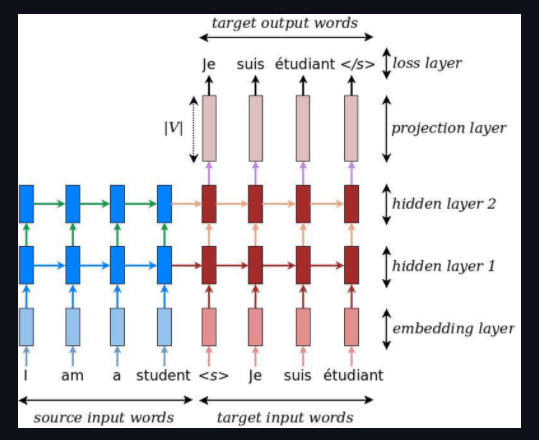

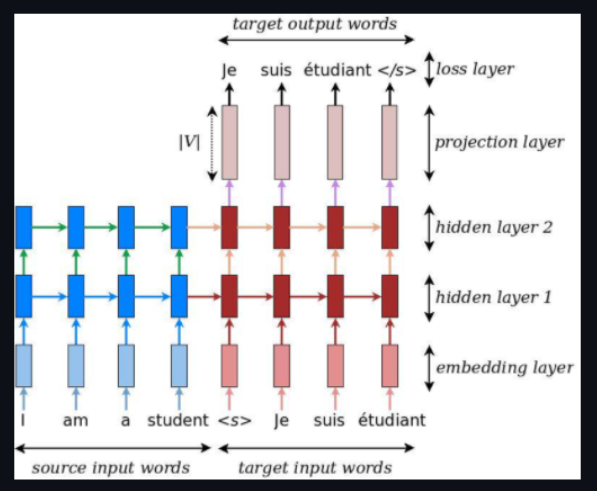

In [49]:
from IPython import display 
from base64 import b64decode 

base64_data="iVBORw0KGgoAAAANSUhEUgAAAlUAAAHrCAYAAADmLmgqAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7J0HYB3F0fj/+ZJQQnrPl/IlhIALxZQQCCUJgSR0CKGEQEJC6L2bYnADbOOKweDee8HGXZZsufde1CXL3Zas3t5Tmf/89mns4yEbG9TZMcN7une3O1tu53eze3f/72vf+oF49erVq1evXr16/WzqocqrV69evXr16rUW1EOVV69evXr16tVrLaiHKq9evXr16tWr11pQD1VevXr16tWrV6+1oB6qvHr16tWrV69ea0E9VHn16tWrV69evdaCeqjy6tWrV69evXqtBfVQ5dWrV69evXr1WgvqocqrV69evXr16rUW1EOVV69evXr16tVrLaiHKq9evXr16tWr11pQD1VevXr16tWrV6+1oJ8aqi793ZVy0y23e/XqtY70xr+it7nPm6q/33Azf99W4/6NTqvtNttdOWrar7ZU03f1U11HdZrfoTJ9XGvcvzHpUWyP9Lng7zUc79VrM1W4pibeOR791FA1e06MePHipW6kqqpKKisrpby8XCoqKtx3PkOhkPvk98Yq2Gb2m1oZ6spuy4/6Qa3e6io/KxP5WF72va7yrA2xejJ7+bTv4XD4I3+jddlmXrw0NoFrauKd41EPVV68NFIx58dntCNsKo7btC4dtOWHlpWVfQSs6qqegnkGy1iXedaGmN1mKyBlSp3xab+h7NuYy+PFS22KhyovXpq5mNPGwZWUlDho4O/G7rhxzthbXFx8yFHXlYMmTQMb8qKOSktLnfJ3XQh5WtuQB3lRVsrZ2NvGgMna6MCBA7J161ZZt26dZGZmSn5+/kcAqzGXx4uX2hQPVV68NGMxx41jKyoqkvT0dNm5c6cUFhY6Z/5Zpa6cJbbl5eXJjh07nJPGcVOGuox6GCyQN3Czf/9+l39WVtYx5Xm8drG/QRX57d69W9LS0hyQYEdDC/aZmpjN1qcAp4MHD8rChQvl6aeflrvuukvGjx8vu3btcpAInAJWwTS8eGnO4qHKi5dmLDgznDYODjjo16+fDBs2TJKSktw2c5rRao6zpt9MbZ/a2i+oQMamTZvkvffekzFjxjjACULV0fRoeX3Sb9QVCuDMnDlThgwZIosXL3bbovcNpmN/17TN/q5JSRcwIb/JkydLz549Zdu2bQ6Aj3ZsTWnX9PfR0jiS2nFBjf6NtgCWgCYAPTExUd5//33585//LKNHj3bloVwWrQqmgXrx0lzFQ5UXL81YcGYGVBs3bpR7771XXn75ZRdZ2LNnj3OIOD2cO5/ADJGHffv2uSkdokVsYz/SYHtOTo6LpmRnZ7s0+GSfYDrsz3ZgCM3NzXXRJn4zh4xd5EU+pE1e7IMSIZo0aZLcc8890qVLF9m8ebPLl2MMrlDyM8XBYxfpYSf5Ayfsz+98Jz/ssbTYjuPHXrORNNasWSNdu3aVZ5991kVerK4oJ3aSvqXDceS5d+9e9x07yIvfzA6OM8jgO79ZWfm+evVq6dChg/z73/+W+fPnH5pCiy4rNlt+lMXqg3QLCgqcss1gh/3In3zYDw3WA/XOftYuwfQtD5T9UGxiH8rAdsoHQCUkJDgA/etf/ypTp051aVs9sJ+lR1nZRn6UyQOWl+YmHqq8eGmmgsPCUQIBW7ZskQEDBsif/vQneeCBB2Tw4MHOeWdkZDgHiSMFZFgTExsbK1OmTJEPPvhAVq1a5aZyiESwjSjXjBkz3PbZs2fL8OHDZc6cOS4dnDN5bd++3UEJ6eBggRIgjmlHHCqOmTSJRLGd46dPn+7swTnz26JFixz8Ye9zzz3n0gAKcdA4ZAMpysffpAmIrFixQubOnevSI11gBSDCwQMA2DRhwgSXF/awnbJjy4cffuj2JYpHuf773//K3XffLd27d5eYmBg3dQqgbNiwwdXNyJEjZdasWc5WPoFA6gQ7AI0lS5a4vNiWnJzs6gc7+U5dUmdABmuRyO+f//ynXH/99TJw4EBXBurRoMngD1ih7jl+3rx57m/2wS7yI6pG/gBQSkqKaytsxx7y4pM25lhsRqkj6px+QDrLly939T1x4kRXX7QR5SVP9sUuIJffqGfKRz60F32LuqWuUeqVv2kL9lmwYIHrS/QTyuWhyktzEw9VXrw0UzGowpniiF977TW5/PLLXfQFqGJ6CweHY16/fr1MmzbNRRuGDh0qb731lrRt29ZN5QA6OFqOv+222xzksM/bb78tDz/8sPTq1ctBFI4Z8GEaC/gCOvr06SOPPvqo9O3b1zlinHZqaqpzsu+8846b2hs7dqz07t3bRWr4G2jBWd93331y1VVXSadOnZwdOHSiHcBFEKqAAUAFxw84kjdKmthGXgANQEG5n3jiCWc7oAnkAZPYwJog6oP8KT9lJbL37rvvOuAiD+wHojp37ix33nmnq0sgiHyx88knn3QgSdrUwzPPPOO2L1261MEb0Swg5P7775eVK1e6uqdcgBtRnr/97W8yaNAgByBAFxEmygs4AoDUMXXz4osvyquvvupsAlAAM2xCDaxoc8phZUU5FnupB9qH+unWrZuzCVuASoDq8ccfdza++eabbl+ihdYfqIv+/fs7m5lOJj3SuOmmm1wb0hcALwCKY6kbjuOTYygbwEXbefHS3MRDlRcvzVQMqoiOADQ9evRwkRDAhb+JvFh0CphiugsYiY+Pd479qaeectsBDRwyDviKK66Qhx56yDlJHDTOlO+kgRPHUb/++usOUpYtW+aiHf/617/cfuQJKBCFwfkCBuQFiGET6bKdaBPbgbd//OMfEhcX56IuOGKbqjKoAjiAJSJCOH0AiIjN2rVrHfg9+OCD0r59ewdjRG+IJgFrOHfKRd0AJG+88Yb85z//cQAJkAAA7AdMAJxAAnBK/pSD/a+55hpnM2UkmgNAAGLPP/+8KzsRmkceeUTatWvnQIPjqXMghHZgH+zCDtaOkf8rr7ziojvYwP6AFGVE+W5Q99JLL8mtt97qAJDy0xbUFdEuygi4AmtAFW3Kd2CJ9Ck7wEO5aDuicdQ7ETrsIS3KBeSxnb+JUpEWMEW70TbUEWUEzolStWnTxm0jHeqU/sK+9AUAknYkDdLyUOWluYqHKi9emqkAVQAIkQzABYeKkyfqxNobIjw4X0CIKA0LjYlUsD9AgkMk2gJ4ESHBKQMDOEucPlEeYIPfWVxNOi+88IIDMQAGKCBKBJzgjMkLuABUbr/9dpcesIQTxnET9SEyAqABRkAdzpq8gnCBMzbFBiCMaSciYhwH+JA3TpxIGqABzAEklIdtQCNlJXpEfTz22GMuykRZiNgAPtgDEABeABx1yVQb4AWosd4LkGIakXQAB2y++eab3fQawEG6wKxN9QGnRJMAItqE44g2EfEhqgVcUv/kQ1ktQmXlps2AMCJ/f/jDHxyYkSZ/EzkDYCkb7cFv2AlQAWKkTwQKCKL9qSfg87/V05zYjz0AF2WnPolgsR/TrrQLdgJbLKin7SgTn/SdM8880wET7UW6tB31AeTRRpSX9sE28qdOvXhpbuKhyouXZiwsBsaB4cxwujhZIi22tglny7Qe0RUiFzhvHCVTVgASUSWmrAAfQOPvf//7IXAxR086bOvYsaOLyhCFAAqAE0ALqAIWAAumjrjt/oYbbnAOGIfL9BTOHgAh6gOkACVMvQEkpGOAgfI9mDcQd8sttzhYA9zYDhwAVUAkNgNQlAPgIB8iW+xDWVlzBHhhP/sBBaQFVLJuyBZ5G1QBMaTL9BtTbQCHQRVpUzZgBGgE4AxWyYt9AFiADJiiHYjqECUkP9rD6haYMiVvgyrKCMxdeumlLh/spw6JXhGZA0wBKkAVsAGIKTd5EmGjnSkHeQM/ACmQa9E0pucATOCPRzywLzZgL2UGCEeNGuXAmb6FPZTxkksucXVOewGnbGPf6667zgEa0Tjyo65Iz0OVl+YoHqq8eGnGAlQR+cDZ/f73v3cRDQAJZ4hTBEiAF5wyMIHTZjqJCAMAhnPGSTK1xxQe65GACouk4Oj5nYgOjph1UjhrnCZTXUQ0cPQ4atJluonF50RZiIYQPQMoOJ6ICvsAAQAXEAiUYb9FbPjEGdsdcUAAAMR6HsCBY/kdmwA2YAmbceQGS5SNBdrYSX4AAlNnTF1xHJADoNj6IPKlvJSVT+wkXSJ27EvaTJsBoERxyI8oFXUBsACUwB/1TeSObcAJ9gBsgAYwCtwShQKqyNPg0cpN/uzPcdQXUMV0p03BUle0AYDKd6baAGHyBqaIRmETkSXSo+6w+Y477nDH0C8AxHHjxrk6IipFucgfxU7Sp+wAG+1iESwAjDalnxhkAtHAMXYQQaONKLeV0UOVl+YoHqq8eGnGguPCmRMhYpE662uIVOBYiTwABgAFUQWiEkRzWFTNNtbesL6HyBNTRsACURD2w7mbowdMbA0SjphpNvJkXRSRG6IUrDliG5Eookqs2cHhAi04YhwzNuHEiXwAA6wxYroOOGMbx+PcDar4xHljJxERABHgACKwG4AA6NgODOHkWXfFNBh5kx6gADwRzWKhPvkDRETuADCmBomcMc0JCAASgBHwBCyQD+UHNIE6gJE7+QAvYJGpNSJWgAb1TT2x7oryEb0CbsmPKBX5kQ7QQZ7kRXkNYFHqneNYlH/ZZZe58gFVRLhIh7JhG1BI5I3IGMdQRzyuAQgjffI1e2hrpntpe9qavkA6RPOoS9oZG+g3wBaABPSyP3VKvdH2tAGQSRvQnkRE6StM+wF9wDttTxnJ30OVl+YoHqq8eGmmYgvVib4AVVdeeaVz+ESNgBum7FjrBLzg0IlKAThs+8tf/uLu3MMBEv0hMkKEgmknIMKiVJb+iBEj3N1iLFJn8TSwwd13OFqmEYEnHDTrdZj+IkpF/kRH+A3wYBoLJ40zJm+AgagJUSWiPcAAkGFAhbMHdHDwOHWicNiPY8fRYwswwd/YC6gAL+TPMZSNT6bFmP4CSgAtAJL9gBXqjfpCASPKDoDwkEuibEwPAlDc8cffwCKgBiBalI79WYdFtJBys8Cd8jJFZtOPFrED9mgj6skg0pQyADds5xgijwAabWnwAkwRMcIOoIi2oZ4oJ6AERFPv1CV5EY0EvjgW0AEe2YfIGfUBkFne5EGdAlX0EcrJ9Ke1M+kDwKQFrNF2gBj1b4vZgVrSISLqocpLcxQPVV68NFMBqiyaQySDSAVRGab6cMTACw4W8OBuLiCCCApwcuONNzqHi9MkSkSkgfVBAA5wYVEqlIgK+wEFQAMwAWQx1YPT52/gCQdNWjhbHDn7E90hegZkAFdEigAr/mZKirVdRL9YOwQUBaEK5W8AhnQAQ8rG/ig2A1nAAvYCIwALwAQcMEUGJAKDQJVFulhUjW3sx5ougNKmtciL+iLiAiQQ+QFC2B+4ALIsUgeIATkAE2BFfkTAmAYjDUCLNIkmEfUCOIBJbAJMgVBgxqCGMvCd9sRGpu2YMiQqRDrACvYyzUc9UOfsTxthN/VMHdEeRKMAH+wCpoG74CJ4jqd/kK/lzT60A2UyW6kz0gPiaHOiV6RBGSgT0ULyQWkjwJI2Bg5pRy9empt4qPLipRkJIBVUHBcODFggmsK0EVEO7sDCEePggBkiGUy1Eb0AtHCQrJvB8eMoiUoQtQGKgCOABmeNsyUdHCnTfaxjAtgACoCIKBAQRRo4ZwCHaAZREPYjogSImD3Yyj4AAflhL/sS1WE7aZB3EKxYG8X+pMMxKLawzdZjWd5ETQBDyouDBwb5TnltkTXRKCCUvNkXaAGUgByiW8AmC9UBNKYC2Y+6oo7YhzJgE+Wkrikn+wEvfJIXkRsigETayI86Jx2ghfwAJ4MZ+6S++Q78AJi0F3BFG5IfNjJ1S/mJFFJejqGuOIa2pI7oB9H1TroAGFOLFrEkXcvXABabOc7ajjojqkY9kT55ApREqFivhS3UDfsBimYrdUSaNUl0H0a9eGkq4qHKi5dmIjgfgw0+Tfkb54hjxZkBReaoUYMAtqPsh7MP7odDZTvfLX1LF3hhzRSOmOkjW1PDFBLRHBw9sIFzNhAjT5R8+GSbOW9L1/YJ2mGQYPnzGUwTG9kfe+0Y9mMfKwN5Wnn5BASCdrCf1YOlhbIvZSSqBzACUWxjP5T8yIfPYBqWl23j72CZg3myneOtbGY7yndTKy/HBfNkm223stMv+GQffrM6sDKjwXQ5ln3teOwIpmFltrJYOhxnafA3v1uZ7HdLFyXdaLE+HK0erLw0FfFQ5cVLMxBzRjgrc1zmiM0p1bZafkRLmN5hyoeoBdEf1vMw7UUUCMjCubJvTemgJjX9VpsadNJH2xZUAwXggQgYi7WZ9mKakt+i97f0jpbmJ2lt1kVtpPVp0zA52m9BYbvBmwEnavXsxUtjFw9VXrw0A8HhWMTCIgPmmOrKGQENODym1Fi/xPoiFpQzBQhgMcXFFFgwMtOUHCO2GhxhO9E2olOsnSL6xtSid/S1K1bX1n+tL9dlP/bipTbFQ5UXL81AcDh2ZW+OiO91dYVvwEGeRKFYR0NEisXSTAGyhorIDo7RtKlFG6yM2M3UFeucWH/EuivKRtm91K5Q30C4Kf3YpjKbUt/x8vkVD1VevDQDweHgeHBAwbUrdXWFT5oGG5YfGvwb8AC47LemGG0IltOAtS5h9fMu1C2L5ZlaNXi1Ovf17aUpiIcqL14aseBIPkmBFe784i4+7jbjoY5MTeGM6hJkSBe4IA+gySAO5Ttq21H2bWpiZQyWzbSu6vXzLESnuDuRRzTwiA/6M3ecEiW0Og+qFy+NTTxUefHSSAWnYdDCJ1Mjpjh51vjwqAFugecZRLxChGdJ8TdOiCgRx7J/bUvQsZE+9kXbaNuC25uaBMsXLBef/OaldoU+y52kvB+SNwDw/DCerWWPbODigaihtYNvAy+NTTxUefHSSAXHYVERFJAi+sRDGJke4dlG3HXH08R5uvYFF1zgHvDJdp4HxH5ErHhkQHCdSm0rUzRB/aTtTU2D9jf1sjR25WKAZ2fx1PsWLVrIj3/8YznvvPMcXPHAVuCKZ6LRv2kHzgkPVl4ak3io8uKlkYpdjduaJJwID1/kCdy8JgSY4mr+pz/9qXzrW9+S0047zT3GgIdl8pBK7srDQXGFjyPy6rWxK/2VZ5zxtPY2bdrIV7/6VfnKV74iP/jBDxxc8RR5nsZv72TkeVmcJ168NBbxUOXFSyMVnAVX4kx3EG3iidQ8uoBXhPB+NxzNSSedJCeccIKccsopcuqpp7pXrnTu3NmtR+E1ISjfvXptKsorf3iPYMuWLR1U0b9R4OqHP/yhe5E0r9fhfCASy4WHFy+NRTxUefHSSAWoIkIFVLGWhNd+MC1y0UUXOeeCwznxxBOdAlc///nP5dprr3UvvOUlyei9997rpgR5XYxXr01BeXchL6z+3//9XwdS6De/+U339/nnn+/6NFBFRAuo8pEqL41JPFR58dJIxSJVtpaK9SZM7fHuueuvv95dyX/72992USr03HPPPXQFz0M3WXeF8vwor16bgtJveRUQL3Vu3bq1gymmty+++GIHWzx4lZdD81w0btTwa6q8NDbxUOXFSyMWHEbwzjMW8/JwTaJWr732mruiB66+//3vu0+mTnikgr0Wxu7+Ix2vXhu7cvHAU+v//ve/O6j6zW9+49YOckMGawmJ2NKvg33ai5fGJB6qvHhpQoITYUrQHqfAc3yYErzqqqvcQt4HHnjg0CMV/EMTvTQ14aKB90beeeedDqyIvG7atMk9CJRpcN+XvTR28VDlxUsTEpwKkStgiWgUr00hcrVo0SLp16+fe2giU4RMj9hzqrwj8tJUhAsG7gDkYmHjxo2yb98+d5OGPZvKi5fGLh6qvHhpQmJQZc+twtlwWzmRKdaasB6FW82JZBGpYl8PVV6aitCveb4aFwX0a7tRw0dcvTQV8VDlxUsTEoOqaLACoIhM4Yj4tKk/D1VempLQX209IGp9vLYjrqQVVC9eaks8VHnx0sQEJ2AL183pBB2QfcdB+SkTL01JrE9b/w1qbcCPnTt2bph68VJb4qHKi5cmKHaFbU4h+ntQvXhpKmJ9NtiP7ftnFUsLYGNaEa1NYPPiBfFQ5cWLFy9emr0YUBHJZXqcqXK+e6jyUpviocqLFy9evDRrsSgVEAVMcdcs79K0aJWHKi+1JR6qvHjx4sVLsxagiSgVESp7BAnPvvKRKi+1LR6qvHjx4sVLsxIgKQhKfCcqxRPZp02b5p7ntn79evcMrJqgKvp4L16OVTxUefHixYuXZiVM9UUr0308x61t27ZyySWXuPcLpqamukeSAFbR+3uo8vJpxEOVFy9evHhpVgIUAUpEp2zab8+ePe61N5dffrn85Cc/kZtuukkWLFjgHjZq+zEdaFOCpOHFy/GKhyovXrx48dJshAgTUGSPTgCSmOZbs2aNe0/mj370I/nqV78qZ5xxhvTq1UvS0tIOPb3dlGN9pMrLpxEPVV68ePHipdmIQRVwRISKT6JUI0aMkD/96U9yyimnyAknnCDf+c535NZbb3XvyuRuQKYBUYMqH6ny8mnEQ5UXL168eGk2EoQqIlDo2rVr5ZlnnpHTTjtNTjzxRPnSl74kJ598srRo0UJ69+7t1laxn4cqL59VPFR58dJEBecR1OYklAenhtZXGY+Uzyf9/VkkmOfRtC6lrtNHostRl+UiXaDI3onJoxOIUl1zzTXyve99z8HUSSed5KYAf/CDH8g//vEPiY+Pdy9x5r2DHBdcV1WffbAmsXzNjqBNXhqfeKjy4qUJSXCADQ76zW2QpTw4RtTWx1h566qcpE0e0fVqavVuWhtCOpan5Rv8tO9obZQ7WIbo73UlpG9lIR/UylUXQvoGVcDRhg0b5IknnpCzzjpLfv7zn8svfvELt67qnHPOkdNPP13OPvtseeeddyQxMdGtvbJolS1at74XLEN9idVXsA59JK1xi4cqL16akNgAy2BvA39DDPZ1LVZGWxNTVFTkvuNM6qKcpEkdkkdQrY7NsfJp3z+rHRxPWqQfdOTmNPkM5k+d1EaeQQdt5alLB00+VhbLlzLVdZ5Enchz5MiRctddd8kVV1zh1lD9/e9/l9///vdu2u/uu++W3/3ud/Kf//xH4uLiJC8vzx1DezAdyN+kQ1/AZpS0P2s7HKtYe5EvNmEL4Mcn7VZfdng5dvFQ5cVLExIGUXNK5qjse106qfoWyoLTsLLh1HAqdelISJt8ADimgvbu3esWMLMNe6h3c6614VitLa0dUcpogGXlr62ycyzlMCU9S5e/60pIO9iO5Md3yl4XYvVq9bd48WKZPHmye3xCTEyMvPLKK3LLLbfI8uXLJSMjQ6ZPny5jx46VrVu3umdZAVO0O79t27bN9QNAhrTquq6ixcoCRDGNmZyc7NZ/7du3z22rT1u8HJt4qPLipQlJ0BEz+POMnQMHDjgQqCsnVd9izh8nhpPbuXOnux0eJ0eZ68qRmPPiFvuJEyfKqFGj3FO3DTz4JH9s4m/s/CxCOUgHB46jZPqJu9RInzbFgTJ1BeCRN/Z9ljytXq1uDSDruu9YfyU/K1tt1WFNQn4Gv+QLgFCvwNHq1aulU6dOLnJF3WLHjh07nHIuWSSI33r27CmPPPKIfPjhh7J7927X9qRXV/3vSEJ5sJ8nwb/22mvy5JNPutfs5Obm1rstXj5ZPFR58dKEBCfEIMvgj7PASXAVnp6e7hwvgyz7mAalLhzYJ0lNdiBH2o6wnTJSHhzHkiVLnCPk1nemY4KOJJjGkdI7FuFYnDz54by6du0qo0ePdrBjzhmni7NNSEhwzji6ri3/mrYh0dtR8uRddERK+vfv7+5Sy8/PdyA5ZMgQef/99yUlJaVGqIpOy6Sm7fYdm8kTQAAU1q1bJ5mZma6Mn0aCeRxJrL8SaaF8s2fPdnlTp9HHflJayCftQxlJmzojX6CR8lKvlJe+dOedd8qmTZsOgZ4BEwpUAbjU/R/+8AfXNrQR+1B30f0vaI/9fTStSY72G/UHWNP/uYPxhhtukLlz57q+GjzmSMcHxfKxfaP//iQJ7h88rqZtn1fxUOXFSxMTBnUcBQ6fu5r++9//OvDAOTAA8zufBgMo380p18fAR/pmA84NNRuwD8VBsY3vZpNtx2YcHo6QaZrXX3/dTd8AVaQRTNvKZw7P0kKPJMF9UNLDaRIN69Gjh3OoAKs9bZvfcLRdunRxa3QAEYuGkK+plQ01G9leU7mtjKRLVKRdu3ZuqooyAh3Dhg2TgQMHOqgK5mXHopa2lSOYvu1v+wb/5h14RDveeOMNd+cb9cz2YFrHolYmlGPNJv62fdgOqGzcuNHVLcBKFA7gMdtQ7LN6Mjuj07I8g39Hq9nCscE8sIHIY+fOnd26KqDK+iX72jG0Ne1LpJL1VkA2kSLagHT45PwjPZTvpEG+Zjvpko7tgxqUWT3xN+csv/FJuvwWLaTJPvbw0vvvv1+WLl3qtllZo9MLtie2mS18so3j+N3KYXmb7Wy3tPjONvuNbfRR8rDj+U5dsw9pB9vj8yYeqrx4aWLCQMXgmJSUJH369JE//vGPbq0IAxsDqA2KOE6cAcp3G/RsUK2rAY90yYNBmSvsXbt2ucgLkQobwLEFe5kKsoEetUEbezmecgCPM2fOdOtb2IYz4JNjSRdlaifoSCjfkcrINn6zPC1fAIp1NcOHD3f1SXTCHAflAHhuu+02tyYH0CNf7GQfogYcb46XeqZcTO2xnTTYTj5WL7QLdUL05M0335QXXnjBRSNIi3RXrlzp8gSwqC8UZ8Yx5M129jWHSJnIw+qVvPk92AfIG6VsY8aMcQu3gTfAjTSpe3OMVjdWl0FlH1PyNNtIF/soezAdyguc/Pvf/5ZBgwY5eMU+9qUcKPtQTxxrZWQf0jbwQfkebGc+2R78mzZGgzaQLpFGoOqOO+6QzZs3H/rdjkepTyK/2HnVVVc56LS2pW4572gnpgXRZcuWOXuxE7usftnOei3KTWQJiCMd0qD8/E7Ujn3ob6RL/WNPUCgH9UJ/YEE9AL5ly5ZDfYr8gED6JOcJU9eTJk1yeZAX09kswuc3ys9x9EPKSL5z5sxxkEve2Mf32NhYZ/eUKVNk4cKFLg36EhcAU6dOddG7WbNmuQsP6oD9qE/6AHWJ0k41nX/NXTxUefHSxISBigEeR/j2229/BKrMIeGoGayJqgAJDHpMvZhzMMdT20KaDKbkw8trGeBx2mYDgzAOHwfPIMzgzICNQzKwIZqAA8AxMUjjQCgH9nMcgICDGTdunJsiI33ysfKZAz5SGdlmgz5KnQF+AAz5vPvuuy5ChA3kzTQrDoi8uGuMKAcwS/7Ygf0rVqxwDpKymXPFTqJrOCUrC22DY5swYYKrE5wf6QBUTO3g/AAJ8sSxYQPrfXCcfBKRDNYpvzMdicOj/siD+mNKmD4xb948tx/vvMN54hQBGOxlfQ7vwWONDr/jLHHE9I+gYzTosDrlk32wCRCiboii0N8GDx7sbKSc2GP7YiOvhHnggQdc3gAGZR0/fryzj3qnLNQlaQII9A3SpB8B1qRJH6d+SdPaGQ22+ZHanWOIlgFVwDEATdmsP9ix9Af65ltvvSXXX3+9O5eoV+wChLC1X79+TrmDsHv37g5ADAKp4w8++EDee+8914+IehKdo24oB+nR7kAbSjrdunVz22gbbAkK9lFuQA57SJv+xDb6G3XPsfRP8qRdiWZRh9QZvzNO0MfoN5TDAJN8qQ/aAts4B2iPAQMGuPSwm+lS+hOwxe+k/89//lOeffZZZz+QR9r0f/ot7U7/R2tqh+YuHqq8eGliwkCFg4iGKgZ+BlmcGg7sqaeekoceesg5MhbcMhgywDKo1tWAh5PiihdHyGDN4I4N2ML0FtERHAKAgHOwl9oaELKdQf3BBx90AzgRKBzWzTff7NY4MbCzP9NW//rXv+TRRx91UEDagAqOzRwtGn3Vjxgk4Ihx0DgygKNt27by8MMPu7yZUsVmnAuQQr6U57e//a1ceeWV8vjjj0vHjh2d06dOWQ/FNhwT5aB+ca5MWxKFwhljG/UCkN1zzz2uXgApnBNrfDiestE+tC1lwgZAgLYlH5zmc889d8hO0sBpsw9ASX0xbUUkhnrBRtqe9MkLgANocID33nuvXHDBBa5ucYrYBWhQJ9SPQQb1RV3R5ygbtgChpAO04aipG/KhPWgvfmd/6gHHTlTj+eefd/0VZw5svPjii+75UZSbT9qU+qEM2Pfyyy+78uPUARK2AST0EeqIfkYe1tZmr9kcLccKVaRLe7300kuujwGEwAIwiC3UKdEZ+gXlpz1oTwNsLh44lqlOQB+bsZ+/gXTakN+pA/JBARjAlrJhS1CwiTokXR4LwXmBPSjTgIAddgFWTOnSF1mID1RxEQIos0yA/sIYQD+kHYFhgBBwom5pI/oq/Q7I4jj6N+MH6VM+osU804s+c9999zmb2bdv377OLtqFeqa/YLeHqk+nHqq8eKlHORJUMYDiAHBODIQMkIALTo7BkydKM6CzD4NqXQx4DKSAHY4WRw5U4IAY7Bl8cUw4CMCKKAXTKwANjhqb2A7IcCwOCwcALPHONgZwnBS/A2uvvvqqi+aQNlfxOCfyNieLRpeRv7GR3xj4ifBgU4cOHdyTtckDBwP8AVmPPfaY+46zYzsQCATwHThg2gXnDJAAYla3wAQOCBtxUtgJhFAv5EPbMCVEdAYHe/XVVzunB1RRP0wF4awpJ2XG0ZMedUVEiToBnoArHDp1iY0AIg6cPkFEjf2IlAFepEU5+duc+7XXXusiDRY9ov6INFBHQaU8OEzswpGTH5EcgJA64hPnjhOmXwLJHAOgkS6QD7hRD/QDnD6QBeTRdmzjk/anrNQr++KsaQegi/2JrADd9HcACQAjj2h7a+rbR4MqPlGOBU5pG/IEJgAloBpbqEMAiH7J+UY9cr5dfPHFri0pK32B84/t1DXbiNACOYAK5QGGiYgytYhNwCTwRX8MAiG2UY8AELDEOcx+tBPRNNqO6WgiSdhJmbCT9OmftAN2zpgxw/UVwJc+ynagn35InweoGCPYh/OLiwNspb/RL9u3b+9spNxE6uhb1A31Qn1RD/Q/opf0Hw9VNTPPsaqHKi9e6lEYqKKhisGP6SYG8b/+9a9u8AcGGMi5wmTKiGfzMNjyN+sq6mLAYyDlChqHwVU+UxvYgFPAAdo6HwZsIk/AEg6SbdjEdpwH4IGTZaDG8f7lL39xgz8DO2niHCg7Doa0gQkcDYO6DejmMIPC3+Y8cVY4Cey48cYbHRjg5EgTUMM5Es3BeWAHjhG7cMrUPW2AA7F2AKpwakAV0IbTAqpQoIE0ic7wwEkcHiBJfeDwuOrHeVFmyoHjA0JwzkAV5aJ9iY7g8IlKAFVEc5gSAjaALvbB6VMeHCERI2ykjoA7Fjrj/IEXIh+Uh7Rs+pA6CUIp9cSnRR9xuMAN0z/AHPkDOdiI3bZehzYgLRwufZOIE32CcgHZ2EzEh/5K/dE3LFpJfhzLd9KkzEAc+1PHABH1BagBoRwbtPtIzrwmqLJ+Yn0CBR6pE/Ki79G3iMIQhUMpD/VBWSkPcHn++ee7cvE35x2gyfHkRZSIctK3SRuYpa2Bc6JEtCPtTj7UXdB2vgON9Bf64e233+7y4BwDrolGcj7QnsAToEWboOyHjdgKNANz9D2DMiKf9E3Kg83UKWu2zF7KQ53TdsA5oAu4GaAD0KRP3aPYbueEh6qamedY1UOVFy/1KAxUNUEVgMAVK9NTQAjggWNGGcBxZIAOkQacdF0MeDgn0sYBczVLZIdpJxw9AzVXwDgWnDwwwy3r2I7zZYBm0MZJ4OwBEcqEg/vzn//snDeREmCAQZ0oC2UjbZwGjsWgypwr9kQL5eY39iE/nCJ3eXGrOmCFQyJKhIMBUIER9qNMQajCXhw/NhGlAcD4btNnfOdYHBdRN6IBtANgBexYRItIBgBEZIT9LFIFvODoABbqjPpj+gabUCAZu5mSJFpBOjhb6gngoX5xqNjCdmwkTVs7RRTToArAs3ozJ2l1yHccPgBAX6MfEYGk3QAT0qbezcFyHPVOPVAOprmoV6algUggm3zpG7QfDh1HTx6AldmBkgZpAwz0HSAKmLrsssvkN7/5jas3gIO8zZEfyZkfCapQ7CU/0qBtiPYRLeUCBJuJ9vI37UlfwyYUuykD03LYBtQCH7QVkR8giPOR/kp/Ji3KSRQOYPnb3/7m6pS+RvtRjmCfpRzkA9QBUPQH+jmQT5QK4ME29uEcIl/2oa3YLwj+bOPGBOzARuCcuqCMRLeIlrJmkH4F9JEfdW3nIbbRF7kDlj5MPVBfKO1E2wfbDq2LMaaxi4cqL16amDBQ1QRVDLRc0QMgNvVGdIDoAtEf1kLgwBhso6+Ia0tIk4GVK2GcDPlahIHoButKcGzYztUvgziRGqABh4rjxGbWBNn0H06fiBawgEPCITDQc8XP1Tt3lJE25WM6grIdbVBnG46U383ZUGdE8XAuQAB1xhU5n9Qt4IBD4UqfeuU4HIm1g0W1iE4BMjgYIkc4H4CHaBzlBHSZ7sNx4wixlakT6ogoEuUyqMJZW6QKh0vdESmhfoiasQ1wAlCAC/7mWCIN2AJgYwdlZTt9xaCKOuSTeqYdgCrKYvVmzpLv2AjU0B5AHaAAlGAv9YPDp50ot9W9HUPbkSeQAshRZ+b8WeRM3WArTpy/aV/Ll08cOXXF1C6/A+is5wHGcfpEUywaxzEGSTW1e01QBcCwL58cxz60G8AC6PCdfgm4UM/0NyI8bKNOmQam/1EXwB2RItLlXKROiE7StlxgMPVLuwHo/Ea/AWwAePofdULdREOVRTPpn9Q/dUT/oM05FkAD0MmTaC7twxQdETzqhXrEVi4+aG/qESCif9MunHN8Z8ygzxGBIsqFnZSF8cIueugDRLy4EOE36hx7rR6j9fMoHqq8eGliwmBVE1ThXJjaIQKA88ZZchXK4McgyYDPMUz1MNDWxaBHmqRNHgz+QA6OhOgSDoA1GzhCnAJOn7vP+I0rfMAKh4UTIhKDw8FRMHVp03/8jbM2x8L+OG6bTiEaEoxa1FRGcwIodYaTwVETheB46gs4os5wqsAAToVpKOANp0y5aAOghd8BPKKA1Ddlx+nyHQgCKoAlIJPv1AEABMjY1IzVDftQPsoGfOFIgSqmJQEQjrebEtgPgCLaQTTMoAqHSrQCEDCoAnIBRvIhQmVQZeuusBngMTDhOJR6RKlT6hxwACSAZRw8MIFNTD/STpQFYMA2YBFgBX4AL7bh/MkLe+iLQAfREGCVqAt1yT6Ug7ywEQdOPtQlTp9yUAbyoj8EYQ7bj9TuxwJVgC4AR7SSCwHanLpmm5WVvKlrIIjzj/LRbsAHfZEpQ6LBtCHH2Vol+jnwQrtgO7bQL7CHyCJpUs/RtnNucEEB1AF7QBB1x3HkTXsTMSMSSj5EnGhTjrNoKP2XugQUOU+wg/V1ABl1DbQBrPQ5oIp+j33ki412DlA28gDQiDZTZ1aHXiLiocqLlyYmDGA4CAbXIFThqBhcmWoBMphGY+DHMeCgGMgBKwZRjq+LgZABFsdEfsAUAzM2MXhzZY1dOCUGZK56WaiO0wEacEBczXPlz5ogoIrBnOgbkSoGcmAHZw1M4YRIn3RwLjhdnPcnQRXbsBPFUXA88IKzwOGZ3dQb+ZAnjpV8mcYBTHA01D91iTMlYoRjxOFzDGnguJhKARYoH+kR0QIgAET2o25oJ6ZlSJv2IjKB0zSoYj+cNPVHOXnUAGWnPXHy1A3Ahc1E1HCyRLhwolYPACuRPPZnOzBJn8EWIl+0F21COQEUHLFFOYAVvuOgqVvso+zUNbYQQQNCiGAwNQQoARTAM3bxO1EP6ppPjiM/+iLlAkgpO+UFkgxIqUu2Ee1j0TftTz8ibWxgP0AwaCdlPVK7HwmqUI7heACNNqA89CcuUrCbNibKS5SSegQuAFrgkosD6p06pm6xmwgQEEXfpX1ZN0X7cwzHUxbqjr/5nU8giHJE2w7MAjcAEecKfYP2A+AAW+qG48mTKWSiUfQB6tKiodQVfZDfuUBhzRe2U5eUmT7OMdQN9gPIpM/5yHQtUS+gmHLTJoA1ff9o59nnVTxUefHShITBC8VBMLjipFmzAYAw+DMw48wY+HDmDJI4NQZjrvi5CmWw5XicSW0LAyx2AE5cVZMvn0SfuEJm+oS1STggnCrOH9Ay54AzA06I+uDcsBXnZI9UAGy4qia6QdpAJVfcpEO0hN8pmznYmgZ7tlF29gEUqEeiVaRBJIToCjajOB7swDkR3cFGIhiUg2lCIluAHwuNgQrsps6BC+ALWKJMth8gAxhRZu68sigM+xEpACyJ5LAvEMU2AASIwWni6NlGWXHwQBeRSdICEgBrHDltj+Mzp4dDxF7qmYgG++EssQUHy3oroAHosehGEFT45G/UgAtnjMMH8ABTHDt1Rl8ElmgjbKRuyB8FuKhD7CdP6po6p46AE/oFYEfkB9iizNhLtI46Aaasfc0e+262Hqnda4Iq259jKRftTJSG/gv0UA7sYTttgF2AFu1IuejL9FEDTqKbbKfuAUBAhjSoV8pPnyfSaGlQb7Q5ZQMQo89JykF/AKDp/5y/1Dk2YQ9pUW+khW1AHXBEvowF7IddpIGtRDR/+9vfOrhiH2yiXoAuwAqbyYM25Hf6HkBF+agDLhY4/4Ax/rZ6r4uxpKmKhyovXpqQMMiiDMAM4Dgxoj0MhnblzlUzgzrAhQPDseF0+RunxkDKYFiT4/mswuCKs2VA5oqcfFEghPyxE4eOnXzivHCwODo+cfw4Uhwqzs2cP/ABmBAxsLQpF06ZtIErm2Iy53qkgZ5yBx0pjgcHizMChqgzPoFRthFNAiLYj7ypc6tPIlZEDXCawCyAh1pZsIure8oCbAJmRMOwGfsBQyJalAeniWPDCRIFwKkToSCChFPEoZEm6RssE0nAHurRojw4cSJhOERzetiO4yVNAIX9qEsADDuwl+gJ05q0TRBSqC/q0uos+JvVIU4Xm6krFBAGlIBVnDtlwgaibtQJdWx9g3rEURucoNgBrDGViK0WjUKtbck7aEfwu7V90HZsIFpE3QNVADj7kqaBImXHTsoCTABx2MM+BpL0MX6nPUkTKDHb+M4+HAcgsg9/m/2kT3n4jb7NJ3/zGzbWdE7yG/uwP/laeuRltvIbeZEv9pEu32lj6hUQI/pHWwPh9Bv6orU15Q/axhhCOpQ9WPdWfsptNlOHdTGWNFXxUOXFSxMSAwIGUGCDyAN3weFIGQD5DSfCAIlTIAoDMHBlycBq+9TlIEj6DLrABs4RoCB/u+I1B2iRAQZ39gMecBAozgCHwe8M8vyGk7CBn7RJk7JxLE6A38yhokcro+2DreZQcRg4ccAGYCV6gAPhN9IibeynHm0f7OA48sZeykJ5rSykB1RgM/ngiKzMth/1Qpp8khb74TBJm/3YZs6afSgv+fM79lFX1rakzzaOA8QoH3ZzPHZgD9vNSdKPsAHAIF37jeNMKTtqdRZU+81+Jy/sAkYBRqIn1A1pWv1hA21n/QLbqRN+Ry1fyyP6b8sventw36DSN6gP6omoEBFAoAropM2wh6gP9YattLeBBGlG2xQsbzDf4GdQOd6+R//O3/a7pRstVlazw9qOv+27/W1KH6I8RLK4wOJiioiWXSzQf+xcJE1LP6hsMxvte9DuYD14OSweqrx4aULCIIaDxAFytclUFIuSGSQZWG1QtoE4OOjaQFgfYgNvTfkHbWS/6IEc5bsN4LYPn3aM7UO6dtynLZvZZOlamjWlG70P36PtCv5mavt8mv1sm/3NMRwbPA6t6TgTttt+lh5i+5otwWOOV0iTdIBJ4IXICBBYk23sZxq0yez6LEJaBqbAERE6pnGJ+qFMn/L4DKbegD6if6wjYnoM+DWo+ix1URdidWP1dCSlPrEfiCbqSzQXkEKZogVkgUnqyNomKJZOUKL/9nJk8VDlxUsTEgY3rupZ58Pdaqypsbu3GCC9eGkooW8CZkRAiKqhOPf6dsgGVUSdACumPLn54dJLL3WL+rk7rk2bNm4NHM+X4mno3KTAOWURRbSxQdWxCHVt5SdazNSf3cVK1NqigtQL40VNUOXls4mHKi9empAwADJYMkgS1mdBKdMtDJJ+cPTSkBKMEFmUqCGcNvmRr4EV05sshm/VqpV897vflW9/+9vy9a9/XX7wgx84bd26tZuuZHoQ4KiNqF1DCTZbBNDgkLYwwORv2iUY7fTjRu2KhyovXpqQMABaNIAQPsp3BkwGVH5Hg9+bulAGBv+m6OSOJsF2ag5COQym7JO+2hDlo14NHIjiclccz/P63ve+JyeffLKccsopctJJJ8n//u//ume62eJ9bDbwaIr9zc4Vym7lN8Cystn3hmyf5iweqrx4aUJig6YpAyaDI1eiNpDalSmDZ1MGEcpqzhF4pEwGIdHa2KUmm2k3ix7QlsHfmqJgN21l039EfSijtVl9CXkZWPCJDSzE53ECRKtOPPFEB1Qo04DcKclidWsLlGObMlSZUg4DK76jlM/+bsrjQ2MVD1VevDQxYeA0tYHTlKtt1k5w6zq3+QMi7NfUxMqGA+DuPx6eSDQBZ41D4DccgmljLqOVxRyZlYs70ljQzcJhu/vNytZU24xysTidR2fwbCXarr7LQ17BfsEnd8Kxtuqaa66Rb3zjGy5a9f3vf9+90oUF9dQ/dppyXH3aXFtidptSdiuT1Ufwu5faFw9VXrw0YQkOoDhlFqZyVyAP2+TZRTy/hkG0qQnlATCYuuFxEbxOhSd/G4BYNMEcRmN2EFYWIiZ8Yjvl4rlU3GzAre5ESgBg9qFcjbk8RxJspgzAFFEh7jYDhClTQ5QnmCf1znOveCjur371K/nWt74l5557rnseWvQdig1ha11KdJmaW/kam3io8uKlGQgDJQ6NB0TyOgvudMKx2RPGm5pwJU15WGTMk7fPPvtsdwcXT9fmln3ABEcJgDR2CME2bAQusBsoJJrIk+OtnWg3pjjZp7FD4pGENgMWeYgoD5gkCkR0iGdhNTTYU5/YxkNJse300093L3IG+piubIr17aVxiocqL16ageC0eMghrxrhFnEW5PJqF6JVPDSzqQnlATKIUuGcuWvr17/+tXv1CdEqgAtQMbBq7FBFebAVwCUywmtKLrzwQjcFdd1117l243Z3fgdOmppQRtqBh2jyihzWLp155pnu4bQAJO3VkIJ92MBdszydnwfmMqVMhBDQ9VDlpbbEQ5UXL01ccAg4Bp4QzXvkfvazn8mXv/xladmypXNqQEhTc9SUh6lMFhGfdtppbnExUzZEF3hgI9GPYKSqMZeP9sE+7CRKxfvfmIb6+c9/7hZL88mLjmk/HH9TaysrH7bzqp4//OEPbt0Sjy3461//6l5BA9g3JLiQN/0FUOfdfJwX9lTxho6ieWle4qHKi5cmJDiHaLWoDreNn3/++W4R7he/+EX55je/Kddff71zakRAgsc0NsEpm2If8MHDGLH/a1/7mnzpS19yyjQgr9pgEb7drWVTZo1VKA/lwqmzYJopTCI5X/3qVw/B4p///GcXrbKF+I2xjUysD5lSNtqACBxr337605+6cqE8soCXRxOtsoiQaX0K+dFHsBNYZ90X04HUNfZ78VJb4qHKi5cmJOYccAamOGJeFMs02Q9/+EPnzAAQPn/xi1/I448/7iDE9se5NaYpM5yawRGfwBJrqVjozNoX4MOgivLddddd7qGngJeBVWN3jNiHvdyV+cADDziQOuGEE5wCwbTTs88+614/xMNdG0vb1CTYRnnoQ9Q9ESqmLoF3HlEAzFMuoqVf+cpX5He/+51MnDjRTU/bMfTD+m4zs5u86TeN6Rzw0nzEQ5UXL01IjuTQmCbjdnHWsQAePDX6xz/+sXNyd955p3uVDY9bwJmgDeHUahLKY04OZTqG2/CJUvFeQ+w/44wzXLSK8hDhYQ3SO++8c+hJ8o2lLEcTQJhIzqRJk9xat3POOUd+9KMfubVi//d//yfnnXee/OMf/3DrfIhmNeby0GbW/6h/pvaAxccee8wtvP/lL3/p1oqxrg9YZDqQxfhMe9K+9FmOayioIc+GyNfL50M8VHnx0oQEZ2BX20R2iH4Q3WBKjAjIG2+8Ib///e/l1FNPdU+Q5pZ91ln17NnTTXfgzHCGjeUqnbJgjzlbypORkeEeM0B52rdv7yJtOGemAlmLxCtHKC93NjamshxNaC+ihbzg9v7775d+/fo52GjRooXcfffdrpxEqt58800HyZSpsQp1bVBFmxGBiouLk1tuucVFF3lCOYvwL7roItd2nTp1cn1wyZIlrn05DgU0Pdx4aW7iocqLlyYkNUEVEMJdfryNnwjPbbfdJmeddZaDD/7mQYz8xrornBnHNRYQwYZgpMoibzhgysTdfwAIi+7vu+8+mTZtmluoHhMT4+7kojyNPVJFGbGTyBrtwTsbt27d6qCXCBWLpuPj4x2YcFcgzxZr7FBlU9AGVatWrXLASLloL6KmPLqACCqPi6DdiFQxtclxjb3NvHj5tOKhyouXJiQGVcFIAXfC8TJYIlGABtNITJt16NDBrU3i9z179hxyaI0pShB00KaAIlNlOGtueccxs7aKyNWiRYvcdp5VhQKIjd1BU0bai7Vv2Ex7UIY77rjDQRXRRe7QZDvlJmrXFMpjgM60MnazAJw+xsuJb7zxRrn11ltdxBGYp7zAok37oR6qvDRH8VDlxUsTE5wRIGLOyUCJT5wza6i4Sw6owtGx3aJTHNdYgArBDtTKZGplwhnzMEmm/4hUEcHCifM7amVqLOU5klA+ayuUdWNBqOL5TpQXZd/GXh7q3PqflQvb+c6T4ln3RiSOaCN9z5TfKV9TKKMXL59GPFR58dIExWAkqDgq1ldxWzsL1lmnw5STObCgNkaJthHHTXSDaSWe5QRUMR1od8cFtbELNlo7UC4Wd9NOQBXrqFhvxfamBBtW90GlDEAVD9dkjRVQBUjVtK8XL81RPFR58dJMBEfF84CioaqpOrCaoIoXEDM91hTFYCIIVbx/jkgVUBWE36YqBlWsqeLBnwZVXrx8XsRDlRcvzURwxh6qGq8YMHmo8uKl+YqHKi9emongjD1UNV4xYPJQ5cVL8xUPVV68NBPBGXuoapxisIR6qPLipfmKhyovXpqJ4Iw9VDU+MVAy9VDlxUvzFQ9VXrw0E8EZe6hqfGKgBDShlItX0Xio8uKl+YmHKi9emongjD1UNT4xUPJQ5cVL8xcPVV68NBPBGXuoanxioOShyouX5i8eqrx4aWKC08V58QRre2eevTePlwzz7r9WrVrJK6+84pw124P78WRrnoCNE28sgi3YFCwLD/nkifDvv/++/N///Z/85z//ce/9Yz1SsDxoY3wSebBMgKApr+Hh/Ya00znnnCMdO3Z0rxey3629KBPt3NggC3sAJfqR1T82W5sNGzZM/vKXv7hX1YwfP96VN7oPcnxDlYt2oV4bU//30nzEQ5UXL41ADJRwNujRnGlYfz+Yc9AB05ZNm2Tr5s2yTZXvc2fPlhtvuF5atWwhTz7+uMTPny9bq/ex/RLVge/etcs5OnJoDC4bmNiRmSkJW7dGbFWbN2/YKEsXL5Y3X39dTjv1VPnHHX+XcWPGyNrVqw+VB6Xc6VoXvL6GemtIoS4rtd3Q4uIiydy+XbYq6G7ZtLFaKdcGWb50qdx0ww3S5uyz5flnn5V5c+fKlo2H99myeZOkpqS4MpXTF9y/xiHUMa8PSkxMdGWz9nJl27hBenZ/S6784xVy7dVXy7t9+8qm9esP9cEt7KvH8JoeoIx6qk8BpAxq6f+NDcS9NH3xUOXFSwOLARUv3GW6i5fu4kyJVNQ04Beos16zbq2MGDpU+nbtJoN79ZZhvXvrZw/p2am93HPbLXLzn66UJ/7zH+mrQDK4dy8ZgvbqKcP69JH3e/aQWdOnyu69u6RcKlUVAnDZZFVH/gUkqHT/gMVKyENVt6tW6Fde+Dx10iTp1727DO3VS4arDtFy9evSVV5+7HG58Q9XyAN3/kO6vtJOBnTvoeXp45Syv/PmmzKgXz9JUidPFIQ6M61PITcmukrVUYe0YHv27pGJY0bJO291lYG9e2g7qN3aRoNU3+3WRf59+9/kb1f/SZ66/7/Sp3NH137sM7BXd3m76xvy/tt9JCU5SYrKSqVM0ws3QJlqkrJQmcyNmSN91N73evaUwapDtU8NUbsH9npLXnrqMfnHzTfIP2+5Wdo//ZQM6dFdhvF7z+7ynn7v2bWLgvEqd2HABQIlOlyquikf9cY5BkhtVHglmsbLuoF5H7HyUpviocqLlwYWBnyiU4BFTEyMzJkzx62NqmnAZ98D6ozmzJsr7739tozp977EjR4jC8eOkbixoyRm7EiZNXq4zBw1XOaOGiWxY9ge+S1u9CiZr38P7d1TRg0dJMmpSRJSsilTR1aOsyarOvIvEaiq0H+KHQZVFfpVNVReKYlJSTJsQH8Z3KOHxI8ZK0vHjpd41fmqsaPHytyRo2XeqDHue9yYcVqeiLJt/NvvyItPPS0rli1zUQjqyLQ+hdxCmmehaklFuaSmJMl7ChoDuneR2PFa/9o281Vpi3mqc7SdZo8aJnNHj5BYtz3y+1zdNqJvL3n56Sdk9crlcrAgXwo0PWCtviM70UKdFinUDx48SDq/2k4+ULCP1X42f8RwWaRlih2rZRozTGaOHqZlG66/jZR4dOQwidO/pw0bIm91bC+xc2bLzl07pZRpW9KNpH7oW20LdnORQoRq5MiR8s9//lPi4+PdVHJDRze9NC/xUOXFSwMLAz5QtXnzZnnttdfk3nvvlREjRkheXl6NUJWlUBUzL0ZGDBwosRMnyeaYeZI4b55si4uRzfNjZNP8ebI5Lla2xMbJlnlxsjlW/46NkW36uXHuXJmuaU9UR56SluygKqSOrAJnXW9QpU6sGqoqy6ukLFwhyQqRY4cNk4kDBsrWmFhJj1sgCbELZNu8+R/TrWhMnNNNs2MkbsRoad+2raxYvrzBoYpIVbGWrThUJukpyTLknb4y7v13ZcO82doec9T2Odomc117BHVL7Fz9ba7+NkfWzZkhsxSsOr7wnKxdsVyytb2LtH+ENIN6LlKNUlpaIoMH9pfunTrJ0ukztJ1iJVH71da5s2RL3GzZOH+OqpYxbp5s1T6XEDNXEvS3bXFzZemMD2Vgn16yUPvnLoWqknqEKiLBS5YskSeffFLOP/986dq1qyQpzANbXrzUlnio8uKlgYUBnyvmCRMmuMW9LF5+/vnn3Zqp6AGffQ9kZUnMnDkyetBgWTRlqiQpZKTPXyCpC+ZL0sL5krhwgX7GS/KChZI0P14S4/l7gf6tnwvi1WGPkkkOqiKRqoaEKhepqqiUlNRUGTt8mEwePFhtXiAZ8xdK2oJFkjI/WhdKStxCSa7WxJj5smj0eOn44kuysjFAlf6vMBSWMm23TC3TiH7vygeD+kvCglitf9X5aJwkaluZJqkmL4hz29kHwIobP1reaPuCrF+xQvJy86QkrFCldVbPRapRgKohA/pLr86dZfWsOdpOC7W95ksaZYtXwFqo5dN+mKT9LkX7XLp+Zri/42TVnFkONBfp/rt276o3qCIaRST4vffek1//+tfy/e9/X/785z+7yHBNFy9evHxa8VDlxUsDijl/7tp79tln3V17DPg333yzzJ49W3Jzcz8CCHxmZWdJ7Jy5MnbgYFkyeZqkKFikx+LUcMpx6rxw1PESAZD4iHNbBGCp844HqkbKpFHDHVSF1aWFAR7SV8Cpd6jS/EIVVQ6qxgwbJpMGDZJELUuG2p0et0jSPqYLJRWNjWjS3PmyeNR46dQIoAphfVhJSEupYLUzJVVGK1R9OHig1nucpCp0pMahcdo22hbVyvdUbTu2s0/CvLkSP26sdG3bVjYuXyEFufkumhfWxBuiTNFSWqJQ1b+/9O7YSdbMmO0AeHscbaZlWzBP+1usAyiAKg1AVmh0UKV9c6VC1aC3+8hCLWt9Rqq4K3G+1vM999wj3/3ud+Xkk0+Wn/3sZ/Lcc8+5BfdHWr/oxcvxiocqL17qURi4g8oVNIurJ06cKH/605/cgH/KKae450y1a9fuULSK/difK2qecTRfz51xAwbL0klTJW1evGQoiKSrY04h4qFOLEWhCgBBAalkIlXq4IgCzRgxXCYqVKWmRqDKLVTXtBsKqsL6PZVIlULV5EGDJSlugWyfr2VSiAKsPq4LFSIjmhKzQJYoVHVu+3KjgCqKFS7XsobLZbdC1Zh33pXpAwe6KGK6AlO6wkS6AkiaaqqDKWBYf9O/3W+6T1LMXLdGrtsLbWWzQlVxXoGUh7X2GkmkqkyhaqhCVR+FqrXTFaoUgDO1/2UqVBGtSlGooh+mal8jgkoUK50I1oJYWTF7pgzs01sWaV+ty0hVsA9w7mzfvl169eolF154oZx00kny5S9/Wb72ta/J5ZdfLtOmTTu0tip4nBcvn0Y8VHnxUk/CQA0UoQzgPMOIxeg8oPOpp56SM844ww30XEV/+9vflquuukqmTp3qBnz25RjWXmVnZckCPXfG9x8kyyZ+IBkKVZmxOK84SVPnnbqAqcB4dWgKHkSr9DtTTEQOAKsZRIRGDJM0hSq7+885EaAKrQPRHI4IVWSZmgZUDZUpQ4YoFGp5iH7MX6xlitI4dNEhTVWoWjZqQqOBKleNFKi8UvakpMmYvu/I9AEDHDjRPhEFsBZoW0XUwCOiCsVA1Zgx0vW552XLipVSml/o1p41lhmqkF4EDHu/v7zdsbOsU6jaHhsvOxWqdmC/glMqUTntby5KVV22NN2eOH+eLJ81QwYpVC3W33fxWIM6gCranXOF84zzhXNs0aJF8uCDD7qHyAJVJ554ort4+eUvf+meE8baKu4M5Dz7pEeaePFyNPFQ5cVLPQmDtA30RJ8YxHl8wqxZs+SSSy5x037AFPr1r39dTj31VAdbTE/wTB+OY9B3UDU3RiYMiEBV+rwFkhkXX+28FKriPwpVfE9mClB/T5kfLzOroSpdoUpdj4Ma50BYZc38VR3IkaAKj4pTBarGKFSxpoq1YJnVkaoIRB1ZU2PiGxVUIZUOqqpkT2q6jHknAlVEpD4CVdVA5aBKNQhVLlIVhKqCIgdUDVScj0kEqgbI2x0iUJUZt1ChaoHsiNOyKTyluKk/+mI1MOr3dN1GpGr5rOkuUlWXUGXnGMp5s3fvXunfv7/88Y9/lB/+8Ifyne98xymA9ZOf/ERuuukmmTdvnnucCdOEdq6Rjhcvxyseqrx4qSfByduAz8ANACQnJ8vDDz8sZ511lotUsYj2sssuk7PPPlt+8YtfyPXXXy8zZ850+wJiHJudle2garxC1VKFqrRqqEpXR5USz7opFgjHS1oAqlIArRqgKvLkqIhtjQaq4hfKdrU5Y/4itX/xUTVlXrwsHd2IIlWqFQCQ1uOetHQZrVD1oUIVkJG+oGaoioBVBKqYwk1kTdXYMdLl+edls0JVSTVUUU/1X6KPC1A1tP8A6dOxs5v+2659bGdcBKrSgaqFClXaDw8BYwNBFdPqXLisXLnSnWNM/Z133nnu1UBt2rSRu+66y4EW33v27OnWNbJonXPTIsNevByveKjy4qWeBCdv034M3ESpYmNjHUSxMJ1bvXmGDq9i4eGE//rXv9zrPnr06OEeVGjTE25NVUyMjB04SBZP+kBSYiNrkIhSJbNInfVT8fEKU9xBp1Cl3w2qUnW/WaxdGq5QlRKBKufUgJxGBFUZLtK2SMFw8VE1WaFqsUJVpxcbD1RxByD1uVuhapRC1bSBEahKU6gCrGgn2sM0ElmMRBnZB6haMC4CVZsUCIoVqgA1qqv+S/RxcVCloNhLocoWqu9QqMpUIEyLj5VkharkhZGIaUNBFUDFOcaNHtzxB1R16dJFhg8f7u6s5Xzj3GNakGjwQw895CLGnFt2rIcqL59GPFR58VJPgpPnCpqIE+s8MjIy3Jqpu+++2y2WZYAfNGiQzJgxwz38c/HixW5x7QsvvCAJCQluasJFqnTgj1OoGqNQtUihKpn1VAohqUSp7JEKxwlVkRXW+tmIoIpHKqQuWHxUTYqNl0UKVR0bEVSF9X+VWr5dQNW778jUgf21THHaDgBVZL0R7QH8RgD4MFSl6u/c/bdg3Gh5U53/RoWqokJt9+rqqv8SfVzKFDqGAFWdOsvqmbMVnJiuBewpY6yWKU41EjFlfR9RuIaIVHERwtQfU3s8OmHdunXuOVWdO3eWO+64QzZs2ODWK/I5ZcoUWbVqlZsCNKDy039ePo14qPLipZ4EJ89gbVMTmZmZMnfuXDeoM5izdmrs2LHOCfBuNK6yuftv7dq1smzZMjc1EYSqw5Gq+erQmEYiQoBDC0Sq5gNWfFcH5+44+zhUuTfLATkuUhWxtbalTqFqTOOBKsrCk8V47tfO9HQZ+W7kOVU8YgBgoo0sUgV0uKnaKKjaplA1X6HqjReelw2rVmqZihyoNRaoskhVb4Uqi1Rlujs2D0MVcE+5mAJ0j1TQciXNj5WVM6e7hepLdBtPN6+LJ6rbecbFCxcinFvAU05OjgMrg6pNmza5fegznG/8btFgjm+I/uOl6YuHKi9e6lHM2dsUhU03MJDzklreS0aUiqc/A1BsZ6BnwOdvjjt4kOm/uTJOoWrppCmSGhunDo11OpHb2Q87tMhidT7d2p0aoOrQu/9wINWQUxfyaaDqmKf/FKoay/QfZSlT5bU/QFXk4Z8D3DOabPqPyA2QSxtFgIq2ov0i039Eqg5D1SopVDAA1GDexuDmbU1V78D0H1CVWb2myk3/xUfKyPQffZOpQR58umrGdBnSu7cs1W17FKp4SCpliqh9++wSPM8s6sR5xPkFVN1+++1uDRXbTW2/huo7XpqHeKjy4qWBhQGcAZ1n6UyePNmtqTKIihb2PZgTgarxAwc6qEpTqMr8CFSxUFgdmgJUhmr6J0BVQz78k/yaK1Tt+ASocmupHPxWT5HVBFWrGzdUrVWoYqG6W1NlC9XjIwvVDarom0BVSgCqlmlf3FuHUFWTcPFiUHXbbbfJ1q1bHUR58VKb4qHKi5cGFpw/UJWuTpg1VgsXLnQRLA9VHqo8VNWeeKjyUh/iocqLlwYWnD9QxR1+S5cudQM/66nYFi3s66HqsHqoqn/xUOXFy5HFQ5UXLw0sOH8AirsBx48f7271ZmGtj1R5qPJQVXviocpLfYiHKi9eGlhw/jb9F4QqH6nyUOWhqvbEQ5WX+hAPVV68NLDg/AEoQIpo1Z49e9yt4B6qPFR5qKo98VDlpT7EQ5UXLw0sOH8Aikcp9O3bVyZOnOiem+OhykOVh6raEw9VXupDPFR58dLAgvMHoHikAk98tic9+zVVHqo8VNWeeKjyUh/iocqLlwYWnD9QtWPHDpmvDmj16tX+OVUeqjxU1bJ4qPJSH+KhyouXBhacP1DFK2l44au92NVDlYcqD1W1Jx6qvNSHeKjy4qWBBecPVO3atcvd+ceLXe09f9HCvh6qDquHqvoXD1VevBxZPFR58dLAgvMHqrjrjzVVDPz5+fluW7Swr4eqw+qhqv7FQ5UXL0cWD1VevDSw4Pxt+m+YAs/MmTP99J+HKg9VtSweqrzUh3io8uKlgQXnD1RlZmYeek0NC9V9pMpDlYeq2hMPVV7qQzxUefFSixJ06EE9mvA7AMWaqgXqhNasWePWVHmo8lDloar2pK6gqjb62ZHSqI9+bHkEtSap6bcj7ftJEkzr06ZRWxK0Bfms9nio8vK5FjuhUAZYptzKysrcAAzUsI3PcDgsIXUAfLIP26KPs304Hi0pKXHb+J39jiT8RnqJiYnSo0cPGTdunHv4p5/+81Dloar25GhQFewzQeV3O3/t7yP9Hv0berS0UTs+eGxwW1D57ZPSi9aa0kGDv9s4V9PvQY3eHtw3+rgjCb/ZeFrTWHosGm3HJ203rclW+x697bOIhyovn1uJPqkAod060C9atEg++OADt66puLhYcnNzXRSJNU8oz5MiksT+DAwM1vv373fv7gOMNm/eLMvVwU+aNMmlB1wBWwwgNZ2w2MHAsm/fPtm0aZN7snpBQYHbFi3s66HqsHqoqn9pblCFmpNHOVftfLVtfLeLKvsM/m5qkBBUy8O+s48da3nZsZavfbffgmnRry3NoNo+ppTX0ghq0FbGJpSxzH6zfKI12ibT6DRR0og+//ibfXiwMWMoDztmzLO87TjLn8/odKPV9o/+O7gtqNH78hlMn+9s/yziocrL51aCgxMnEu/b27ZtmwxWx/7yyy/Lzp07nZNmIB4yZIi88MIL8txzz8nQoUMlOTn50KDFcTExMS7K1KlTJ3nnnXdkxIgRLg32s4gVJ230QIOYHaypmjBhgsSpc/JrqjxUeaiqXTkSVHGeBaHClG0cw3c++du22f585/y2z+g0UHPgpnacpcWFG5Hp9evXO9DggsrSsTwtDRuvzO7gdr6bcizpcixjCRDDeGYXg6TPxSLvGuUNDow9jGOWr6Vp9lua2Bu03YCM3zg2eHz0+cff7M8dzm+//bZ0795d5s6d6+zkOPLgOFP+ZrulH7TFfkdtO5/sG/27/RY8vqZtweM/i3io8vK5FU7y4CCFQ2aA6dWrlzz88MNugGNbQkKCg6q///3vcu2117rv/MYJz8DCQPXhhx/Kq6++Kh07dpRRo0Y58HrkkUdc5Ip9OFE50cknWswOIl1Et3iqun9NjYcqD1W1K5yHR4KqIBCYgzWHjhpIBNWgwsDC9rG0LD1T0kXZbsfyyfhBdBvQWLZsmTv32cf2te82fhgwWJr8Hb2NY7CFPLZs2SKTJ0+W2bNny4EDBw7ZS5SIO40Zq1jHybkTtNPqxey3NLHZ1NKyY4LHYmv0Oci+K1eudOMkY+z48eNdOpZHsCyo5Wtq+9l20gtuN1uCaQQ1eOyR0mO/zyIeqrx8boUT3k5+lEGFq0UiTgZVDBpM7RE9euCBB+Tqq6+WKVOmuMGJE5GrrL1797pt/fv3lxkzZsiKFStk9OjR8tBDD0lSUpIbNOykJp9oMTu4krR3/3EVybZoYV8PVYfVQ1X9S3OCKs4xlHMZh8r5TqSI6A7T/wAP3wEdzkmeH0dEh37GdsYB9uMYfrd9OY6xgfTYl+PYZsezHWUfxhfGjN5aLwAH6ZiDZ187ljxIi3IYFKBms9nK/uzHdmybNm2avPLKK/Luu++6CzcrF9EpXt7OY1wY97CFeiB98mUfU0uP34JlJ8JGfpY/yrEGJ9HnIOMfkPfWW2/JU0895aCOPIPAY3mQFvlQH6RP/mwLtgP7Yrfty3GWTrBeOIZPfmd/PtlGXVgewbxqGqePVTxUefncCie8ARXKiRYNVQwObAd02rZtK9dcc42MHTvWDSgMBJzcvKvPXi+TmprqIltjxoyR+++//2ORqpocPdv4jfwYAFnTxQnuocpDlYeq2hPOw5qgyhw6vxO94XzmIgng4DuR4+nTpzsAWLdunXtIL9Nm8fHxLtLC+kuWDbAfxxG1ZrwAONiXY1gewPFcnLEkAPACClirSTqDBg1yywawyWABW0iHtyxwsTZnzhwHXYw9BmyME4w3pEH67Md3LuaAtcWLF0u7du3kr3/9qzz22GPuJhjSY5zDzj59+rglB4xTlib5Uk/kR3rz5s1zkTTKwz7YzBhF2akj1oEuXLjQpUc5qQvghLEz+hzkb8rAMonXXnvNwaSNjbQBQEPdsp3xlLolTeoMu/jOdvIEiLCXi1HKxFQi469BE9+5SKVesI26p14oB79RPsZyyodNfJL22rVra7T9WMVDlZfPrXDSfBJU2RUjJ+Ebb7zhoKpv375uATq/MWgCVCNHjjw0kDIAEKm699573UnMfqT/SVDFAnVC8QxkDBgMNtHCvh6qDquHqvqX5hip4hzldxw6jpYLoltuuUXee+89txygffv28vTTT7toEjehAFs9e/aUO++80ylgwhohpvzZj2l8xhIcNxHsbt26ufGDdBgrsAM4AkD69evn0njmmWfcdiIqgAIAMWDAAJcuEMIaTY4nXYAJuGG6kPSw5fXXX3eggmIP4xBRKJYtXHHFFfLPf/7T7UOa2EVa1MP777/vxilAiOgVj3XB5q5du7q6Yj/+pszAIBAHAP7jH/9wsEb+1NHjjz/uys7yByJiwA3jXvB8pK6ZhmRtapcuXRzMMc5R/4ydjKFcWJIfU4Sk+eKLLzpoIk3qkDpmzSptRZsR+cJW1rwCd6RDHVEHjNVvvvmmW5oBXDJWUy88D5B6uvHGG53N1AH2ENHDfhtHPo14qPLyuRVOmiBUcYXIyWiDIwMbJzzKFB8DCdN/tgCdAYarGgZaTnoGSQZEBigGmvvuu+8jUGUDTLTYYEMeDKqkTQSMbdHCvh6qDquHqvqX5ramCuXCifOU846oBef4H/7wB+eQcdTAC477rrvucqCF88dpc+HEmIBTJlLCTS6ME0AV0SemuNgfICE/puD+85//uP2AAuAIyPjvf//rnDyAYNNyzz//vIMVII5xiWOuvPJKFyEicgQYcQygRJQFQGMcwnam17hTmUgVEfZnn33WRdtYsM6FIBeF2P+3v/3NQQTb2Z+1V8AH5SbCxvgF4ACZ2A5QAXNm8+9//3u3FoxoEJ/UB/lTX4ynjGGchzb20Qbk++STT7r0sMMiVMAcdjP+WoSM8r/00kuuDUiP8pEvkEod0G5EsKZOnergj2gUdlMvQBmAxt+0DfVwxx13uCib3ZB03XXXOegEbIlmERkjWkUE7NOOHx6qvHxuxU5202ioYvBgUOA3AIorWAYhTmpOVCJLXAkyEPGdE5E0+G5Xu8cKVfzGlRhXkQwE5OcjVR6qPFTVnhwNqjjPUc5fpoyAkNtvv91NQ3GxBPzguDmOqBHp4Pi5cCJiA2wQISG6zdgAFBEBIeJtU3b8jsMmuoPDZwqL7QAJeeHkidwAQow/wAngxHiCrcDPZZdd5j6BByACOAHgsA8wAVKwiygXaQMmpAOEMLYxFtm0IelgOzDBBSTgAlA9+uij7rutQcIG1pMCN9hGXoAJ4+ANN9wgACMXhORJvdl+1LfVrX2SJtF46oZoPuMc+zETQHmIFJEO9gBm2E17UafYTl1Y9Io8sA8gZLxlKpOpT6CWyB+gRDsxBgOBRLKAKspGO3HDEW0BgFE3wCaARno1jb3HKh6qvHxuBadrgyp6NKhiMOAqie033XSTu+rj5OeKzp6AzklPGhapOh6oIh+uFAEqTno//eehykNV7cqRoIp+Yucn5zFQAlgQKcLRck4zNUYUg4uqDh06OJAgYmRREyCF9AEWzmMcOhEpxgciUmwHqoiYMH4AL0S5gQfWOXFXMY4fOCMydP311zvIAMKAGgAAe4A0AAMgAXSY1gL8yBslcgNckRd5sh9TbVyscdFGGRmPgAci7IxnjDfAGGBCpAnIsPWkRJGwmXKSv+2Lrf/+978dYDJOct4xHjKFSf1SzxxPfoxtKGkBX0zJETUiXeoWe1mDyo09XKQCTqTHGjUADTupU+zmeCCR9WGMlYyTRKxYssHUHtGuBx98UG699VaXDzYBw7QRxwBcgCttwu+Ud6COo5SB+rIyfxbxUOXlcyvBwRQ9GlTxG1eWhNoJeXOlyYnMwlROdE5E9mU/BgVbqH48UEU6TCsw/cdAw7ZoYV8PVYfVQ1X9S3OMVKGcb8AGIEIEiuk+IIu1QWwHbIAqpqgAGUAFB87+pM1FEOc6URdggzVMXFxxXjMuEOEBXIjusH6HqT72NYgi8oLDByQuvPBCtw24I8KCzQAHU4FEoIC2f/3rX24MYiqLfAECwIC8TIneEM3CRmCI/dgHqCAfIkvAHb9hB2kyjUd52ZfpUCJhd999txv7qD+OtfGNqBPASZrsB7gAQezD8TZ+UjeMkYyHrIsiIkUdsg/1AlBhiy2jIF/GVmwnggfccjzjIvUPUFIfwBagR+QKSCOCxjqpyy+/3E3VAnnAKfUAXDE2Yy9jLOUhYkY+QCjpY+dniVIhHqq8fG4FpxscVBmEDKoYzGxNFQMDgwZXb6yPOP/8890iVltoyXF2QjIAM1By9Xm8UMUJzwBCFIyTvKaTm309VB1WD1X1L811+o9zmGgOa33uuece54hxwJzTXFARXQI6ACUWOuPcn3jiCTcVZxEOlPOfPDj/iW4BKOTN+AFMEB1hfOBv7GEcAdaIQAEJQBTgBdSR9qpVq9zFFmMNF3qMN0RciBQRbQEQyBdbSY8pMECFfIE7wAE7mNYCWIiqMc4xxgEW1ANQxbowbAMeLfIGEFIPbGdxOHCDHYAXF55ErDjngCCOoz6AHfKx+qBuqR/SA3qIhFE26pSxEbtuvvlmVzdAI9Enxl6gFdhiDRb2sC/KGEndUv/UDzBHOZkxANSAUWAXOwBVykpejMXWnuzLejeAC5vYjq2MufSHzyIeqrx8bgWna4MqalDF1R8DDgtG7URjQGCQ4gQnVM+VG1c+wA8nusEXJywDI4MmV7sMQBzLb0c6YbGD3xlkudpiYGCtAduihX09VB1WD1X1L80ZqnC+/M70EZ9EcXDAOHIgAkcO5OCIgSym1gAeGwNIA/ABCFj7A6BxvD2Ak+k7Lsywg/EEOCNiRFQLOAJi+J2pQ8CJ9Vgcyzov1j4xPUgfB5KAAltID8jZnYBclAE1gAkAQ7SG9VOMLUwnAjF8AohEjbAFCGMdGFDERaVBHHky3caYyJQnkSLGSGCE/NmGPZSFumHcJC+L3qNWt4yNROo4jjxIhzEXeyg/25lSpcyUARhkO/WGfZYe07PULfAJ8FHHgBVATNSOduJY0jKgYloQAGS8xg7+po45nn5AGUjbQ5UXL59BcLo2qKKc4AwmBlVAjg2WfDIVwADJ1SHz90SWOMZORJSIFlBlC9UZBI8FqtjOIMjJTh5cOXmo8lDloar25GhQZUBEpIT1Pix0JppCtIMIDt+Z1gJgAAYAhigPY4VNdZEGyrnLfjzmgAgKaTD9BiwxbQeUAT2AAuulAACAArjgWGxgDZDlDxww3Qb0AF6MOYAWU2/sA8ABFYw57EvEi8gReZAfU2PYwv5cCDI+kRbjE8DERRzRIcYd9sdmok6khc2kb+UGSEifspM3MIc9RLps3RLHUicGQVYvnJusX2IfYI40GVOxkzslqXe2Yyd5UidEyIA0m/6jngFdysSFLQAFGAFOlAGgpR6APtqGY4EyyssNAeTFGM0CfqYbqTdsZxvpM+bWNO4ej3io8vK5FZyuDaqoQRUDECcrkSpOYgMivhOGZlDi5GXgIqzN75bW0aAKZZ9osWNtrQJXlD5S5aHKQ1XtSk1QZeclDpXfWdODsyW6Q5QGp4tjJnLC2EBEhnECuMFJcxGEMzeAIC3GABw14EVkm6g1jh1HjvMHnhhHuIgCXIgO8egAgxaiKYAVx/A7C7LJh8gRx7EP4wP2YxfpE7liKoxIjd1RR1QJG/id8Yj8SYN8iJABPygLvQ3CABbWGAGBlJ2F3gAcUEN6pEtEiGgR+XEM27CZbUT0iAhRRsZLAyGUc5P02Ad7LPLFdtKkDFysUm72I38gjPSwmf2oW0AO8GOajzGW/fmd30iPcZRIHHkAU4yngCx52JhNO5Af/YFt2McYf6Qx+njEQ5WXz63gdDmBTGuCKhso7YSz7zYIczKyzdLixObkZSAzqOIk5rcjnbAcy29ExrhyZUBl8CSfaGFfD1WH1UNV/UtzgyrOM5S+QySHKT2iH5z/QAMgxfnI+GCgANiwjcgS5zzbbIzgfDcHz/EAFsp30gRScPx8EgUjImPrKDkWJS9gDVggf0AJ508ZUNInb9JkH5R9OA5bUPbhGNIlKmZloJxEiNhG2gYawXIBUWiw3KbBsvOdbezDNuzBbvKwugqWCRvJ0+qUsvAbn6THdsqCzVZ+LmCpL2CKbcwQMNXI9CXTiBa9s/onT6t70uPT6o682A+7SYv9sJPjTGsao49HPFR5+dwKTpcTyJQTjYGOEDi3D3MlyQlqg66ddGxDbTDlWEuLbcARV0HcucIAYCet7RctbON3BgCuoDiGk51t0cK+HqoOq4eq+pfmNv3Hecb5jZMnQsPUEhEmi2DY+Y7aWIDyN7/b9+BvpInyO+MK/ZL0WC/Egm+iOihwwJQXESTOeXP6lrapgZTlZ5BC2nxne/DY4PFB2/jbjrF9zVarh+i02G71ZPvYfnyybzCdYJ0G98F+ysE2U37jWH5jH7bx3Wxkf+CPBee0CREnImRc+Np6NfYnHcuT/EkT5W/Lw76bncFttv1IY/TxiIcqL59b4eThJDLlJCZsTbiZtQyczJx4dhKyj52Mto2T0U5EPhkUuDJinQJhbq5QSdfyqOmEZRtpEdVisCBsTd6kHS3s66HqsHqoqn9pblBFP+GcJorCucdaHKLFnLecg/zGd/vbxoAgFJAOn/xtauMD28kbCGI9EhDFImvW/fAYA0DLIjt2nI0Xlga/RecZzI/9TO1vPrE5eGzwb9uPfCwd1NIOpmm2oJYW+/LJNksrqJaWpWv5o5aH/W7AaNuoL1PGZBbgc0cfi/pZB8a6KxahE3Gz9DkuOv9otX1o82CZTNn2WccND1VevFQLJxQnMVesQA0nuZ1kpkjwb9tmwv4cZ+F10mPb0YQ0OKGJjDHo262/bIsW9vVQdVg9VNW/NDeoQugrOHsuiHDiAFb0uf9ZlLRw6oAVU4BMWTGdZWszo/MyCW6rDSWfmvIK/t0QGm2T2YnSboyltBdjI5F8LlY51xkjg8ehx1IekyNt/yziocqLl4BwYnEi28n6aeR407D9gSqmBFhECpR5qPJQ5aGq9uRoUIXQXzjngJ+azr3PKqRPfhYxQfketMHLx8XaJRjJasz15qHKi5cGFhtsuWuQMDeL1blSZuCIFvb1UHVYPVTVvzRXqPLipTbEQ5UXLw0sOH+uxLjbhrVYLJZnSsBHqjxUeaiqPfFQ5aU+xEOVFy8NLDh/AIq1HPZIBb+mykOVh6raFQ9VXupDPFR58dLAgvMHoFi4yvOteEgfz1DxUOWhykNV7YmHKi/1IR6qvHhpYMH5M7gTqeI5LAz2PlLlocpDVe2Khyov9SEeqrx4aWDB+TO4c/cfr8bgQXceqjxUeaiqXfFQ5aU+xEOVFy8NLDh/AIrnr/AwQF6VwWsa/N1/Hqo8VNWeeKjyUh/iocqLlwYWnD8ABUjx3kAeCAgc+EiVhyoPVbUnHqq81Id4qPLipYEF5w9A8Zwq3hrPy1X9QnUPVR6qalc8VHmpD/FQ5cVLAwvOH4AiSsUjFZYtW+ahykOVh6paFg9VXupDPFR58dLAgvMHoJj2W7JkiRv4/WtqPFR5qKpd8VDlpT7EQ5UXLw0sOH8AKiMjw70ln+dU8VJnv1DdQ5WHqtoTD1Ve6kM8VHnx0sCC8zeomjRpksxXJ+Tf/eehykNV7YqHKi/1IR6qvHhpYMH5A1W8+2/lypXu3X9++s9DlYeq2pWSkhIHVZ06dfJQ5aXOxEOVFy/1KEGHz4Bu34lKJScny4ABA2TatGmHnlPFb3ac7e+h6rB6qKp/aQpQRdtzvtg5w2dxcbFs2LDhEFRx8cJ2E+szQfXi5XjFQ5UXL/UkDNIM4kSgUKAJ5XtZWZl7pEKcOqY1a9a4NVUhdTj8ZsfY3wcPeqgy9VBV/9IUoMrOl3A47M4xPukb69atk44dOzqo2rx586HzL6jBbV68HK94qPLipZ4EJ2+DNoM80xFF6jDt+251MgBVQkKC5OfnO6eABvfj+OzsLA9V1eqhqv6lsUMV7c65QmSKc4epdM4nXv20du1aF6m64447ZP369YfOr4KCAtd3WHdl510wiuXFy7GKhyovXupJGOwBKgZuBnAGe6b5+JtIFTDVt29fmThxouzfv98N9iiL1tmPgZ7jPVQdVg9V9S9NAarsPMvMzJQVK1a4qT6+c9Hy5ptvOqhifRUwtXfvXlmufYepwX379rnjuHjxUOXl04iHKi9e6kkY7BmsgSMiT9ztx/opHqPAe/+SkpJk4cKF7goaiGLhOs+t4l2APBAUB8AVeHb2AQ9V1eqhqv6lqUAVFypEp0aMGOGiUwP1fOFce/HFF+XWW2915xaQ1aNHD2nXrp2beuehuxat8tN/Xj6NeKjy4qWehMHeoIqpCaBqwoQJ8ve//13eeustF6Hq16+fe6zC6tWrZfLkyfLUU0/Jyy+/7K6ibQowC6iaO0fGDzCowmkdBarmq+PW3x1UqfObNdSgKrHBoapK8yPblGqomqJQldLcoGpgc4Sq/oehKq4aqhScjgpVcfPqDao4zzhXONd4RMnjjz8uf/3rXx1M/fnPf5ZLL71UXn31VXn44Yfl6quvli5duriLGaYJgTGbavfi5XjFQ5UXL/UkDPZ2BQ1UHThwQBYvXizXXHONXHnllXLzzTfLH/7wB7nnnnukbdu2cvvtt7sBv3v37m5awgb7A1lZEjc3Rsb1V6iaOEUyFKp2qJPCKQNTyQvjI2Ayf6E6swhUpapTS1Xnkqw681CkKlEqFHDK1ZHhPgCcuuKQCFSBVdV3PGpezK6gAEhqaoqMU6j6gEiVAtX2BdgfAadU/Z6q21JUUxcYaC1xmhS7UBYpVHVsBFBFbpSvVP8f1nrdqVA18p33ZNqAQZKibZCudZ9RDVWAFGVKAx71e4Zui/wWJ4nz5sn8seMUql6UDatWS0FRoZRpemHqLpJVg0pZSSRS1Qeomj5TtsfGyc7YWNnhoErhaWGkH1Ku7VrmHXFEUhW2DkFVL1mq++7ZvctBFSBKuSJQ9dmFaTvOM84VdMeOHdKtWze57LLL5Kc//an86Ec/kp/85Cdy7rnnyq9+9Su56qqr3Ps2mXInSsWxAJWf/vPyacRDlRcv9SQ4eQZr4MgWn6empkqHDh2kTZs28u1vf1u+8Y1vyKmnniqnn366nHbaaXLXXXfJokWLHCzYtMT+Awcldk6sQtVgWT5xsmTMi5VMdWo46KT4xZIYv1QBZHEkghCrDpsogTq7ZNUEdd7TRyhUqWYkJ0qlOusKdWZEQdCKOvLa8I0LTgU0bFpZIWkpSTJh6BD5YNBASYrD5kXqrJe6aBVRj6SFsU5x1mm6LT1uqaTFLVMAWSTxY8c3EqiiHsuluKpYwhVlsjMlQ0b3HSjT+w9XWxdLhitXrAMPojgpCovpCr4ZcUQU4xSq5qlqObU948dMkjdfeFU2rFzjoiellWUScjHF+i1TTVJaDVVvd+wk6z/8UHbMmyu7Y+cqPMVoH9S2io8AcIYCFbC1K3ae/lYNVTM/lMG9e8ii+TGya3emlIbKHFQZWNWG0O7AFOcZ5wvT5kyz33bbbfLDH/5QTjzxRDnppJPkq1/9qvzsZz+Txx57zD2ziv0BqYbqP16ah3io8uKlnoRB2qb/ACSURejckXTdddfJ9773PTfgn3DCCfKVr3xFzjnnHBel4p2AtmidY/ftPygxs+Nk3IDBsmzSJEmNmSMZ6riI8GxToNoav0ySFizRbfGSOS9OHXespC6cL4nqsLcqoEwfNVwmjxyuUJWk3kyhSu1ieolpq7CztPYF/4RWuMhUJB/yK1NXGqoIS5oC3oTBg2XKgAGSEMtUJVC1WG2Pl+T4eZK4aK5qjJZRf4tVqJq3RNLmLZXEmIWyYMx46fDiS7KiUUBVSIoqciUULpadyRkypu8Qmdl/tJZniYLgfC3PPElVJWKYrEBFOdMVqmij9PlzFRhjJGHePIkfN0W6tG0v65evlby8XCmpKJZQVajey1STlBaXypD3B8rbHTrJhunTZJfavTtursL9HIWp+ZIQv1D7H2WKU6iPUbCKcVEsoGr1rA9lUO+3JD5utuzcvV1KQsT1iGJSf7Ujdp4ZVAFYLFRnuu/MM890QMU5BlRdeOGFMnLkSHceevFSG+KhyouXehIb7BnkDayYBmRA59UZQBQD/cknn+ymKFj/sXTpUhfRMgeB7t2fLXPnzJMxAwfJ4ikTJDF2tqQumKfOLF42L1ysulTharEw5ZSmziyVKBVQpbp10QKFqhEBqKp066mAHFu3UxcCC6DRUEWe4cpyNxUZiVQNlgR1yEz5ARusBUvWsiXFz1Wdp2WKQFWGQlV67FJJVqhaNJpI1UuNI1JVFZai8jxt41IHVaPeGSwfDhipZVikwBGrgBgpR6LCbYJuS55POxHZ0bLFz9Hf5sjm2LkSN2GyvN72VVm3fI27S7S0vETrqTFB1SDp0+l1WTdzumxX2zO1TKkKhInxC2TLwkWydWF8ZB2ZAuR2BcbtRLCIVM2eLoP79pSFCmK7DkFV7UaqECJOnGs2Dcg5xhrFG264wUWDOceIWv3rX/9ywMV55cVLbYiHKi9e6lEY7A2qUKJPgNWMGTPkpptuku9///sOrM4//3x36zfrQYAvm87g80B2jsTExMrIQQNk/gfjZfOCWbJt4VzZrMC0YdFiWa+6SR3bNnVwRKe2qVPborpVoWq9/j19zCiZMnqkZKQk1ztUaXaRqT/dRn4sUw6XhyQ9OVEmDh/m7v7bolCVsmiRAkasOuYYVSI7aJwCyAJJiVsoqQpWqbGLJTEmXhaPGtdooKpCoaqsEggukczkdBn2zgCZ0H+wbNL6p422LZyj7TBPwXe+bFbw3TZ/mYOrBC3rtoWzFXpnybr5M2Xm2NHS/oWXZO2K1ZKTkytlCmnlleF6L1O0kH9pcZkM7T9EenV+Q1bM/FDtVxhU3abttHnhQu2DS2Sj9r8tCvmJDqZiJWFejGxVqFo6Y5oMfBuoOjz9V1dQxfllYMWFCQ/XZW3VGWecId/5znfkoosukpkzZ7oH7fr1U15qSzxUefFST4JDYvBmkDeoMlhibRV3+rVs2VL+93//1z1Hh1u87cnqHGMLaLMP5kpsbJz07/e2jBj0tsycMFjmTBwusyaMkRnjJig0TZCZo8fLnNFjZd6Y0TJPHfSc0aNktn6fNW6MDH3nbZkwcrhsT005BFXAVH1AlbvbTz/JBw3rhrCWKz05WcYoUA3u3VvmjhsvsePHyZzxw/T7cJmnts8bPlpiR4yT2JHjZN7IsRIzcozTubp9Ut/35OWnn5FVK1c652lAVf8AQvuWS7hCASgcku0p6QoQ70r/Hj203keoDpbZ4wbJrLHDFJq0rUZNlDnDp8rckZNkrrbNnPFDZdbEwTJN9xn63tvy4nPPytrVayU/v0BCYYWPisYBVSVFpTJq6Cjp2qGzTB4+RGaNGap9a6jEjB+jZZwoM8ZOlhmjJ8ns0RMkhj44arS21QiZrfrBsCHyVucOMj92juzes1NhMbJQvbahCjs5V4LnG49LmDVrlotOERV+4YUX3BPWuWhp6Hr10nzEQ5UXL/UkNtBHK4M+i2nnzZvnBvxLLrnELV7nCesAF/uYc+B7QWGRrFVnMGLEEOndq7O81/cNGdC3m/Tv1Uv6desjvTv0kJ6vdJW+7bvJgC49ZHCPnjKoZw9V/ezTW/qrzp0xXfbv2X0IqiKL1SOfdSKaLH7LFCdKhMKtp1Gw2qe2zJgyRd7XMgxSsBrUp6eW6039u6u8/0Z36fZUe+n78lvS//Xe0k/L9G63btKvu5a5e3fp90ZXGdivnyQnJbn6op5N61uqqrStKhQUtJ3279knU8ZPkHd6dpP3elOWTtpGnWVAj27yftde8nb7XtKrbW/p266X9O/SUwZS1rc7y7uqvXq8Lv369XWwXVpyuA80BucfKiuX+THx8l6fd6Rf7x5atq7Sv/dbMqBXbxnY41159/V35K0Xu2of1HK+3kuGvNVLhipYDurRXd5T7d2ti8LiCjmYk6UAyuJ71z0OaW2Itb+dNyjAnZiYKH369JEbb7zRPcKEu2q5sPHipbbEQ5UXL/UoNtgH1QZ+pieGDBniBn0eAspUljnSoJaXV0h+Qb7s2pMpaRnbJGP7VsnMSJLMxAxJXpUscWMXyNT+H8qyKUslfXWy7NiWIjsUODLVoexI0e/p6ZK9f7+ESkvUoEj6wE1kwXDdO21znsEIRShUJllq046MDNmRli7b01MkJWOLpGxNkHWx62Ry36kSP2aJbF2SqNtSJSk5UZJTtkl6aqKWK0V279gpJcXFrr4aVKjPynIHq2EFvP379mhZEiU9ZYOkJ6+VzOTNkpmQIhlr02X+uCUys3+8rJy6XlJXJsn2bVqe5A2SkrpOUrXsmTszpLikWIGKNLWWtJ0ag2BLTnau7NyeKdszUiUjI1G2pyVr2TIkc+N22TBvi8wdPl9iRs6XjbEbZcfmNNlJ31PNSGLfVCnIy9V+rPBJfZFmQGtTPnrelLs7KePj490aRt79x9Q7wOrFS22JhyovXhpYHNTowM5iWh5AyJQET1OvaVoi4iDUZ+Mk9F9YylRLpVyPD+eqs9tWKCvGr5fYgQogM9OkMKVMqgoUNPRqvCqkGi6XKt23qlK1GqhQXBvKvwYV51nVlqoKKSkvk/x9pZIUv1PiBq2W1RNTZNemAinIrZDC8rAUVZZKGYu3eS5DA7PUIaFx1PbD9VquZSnR9smT8rJsqSxWUM4pl5KMSlk5OVEWDNosW2ftkrwkde55ZbpPvpYpV0JSpO0aVtCNtJEmEqmbxiDYofUdKR/POVM76U+lunm/SPrCPbJk1AZZNnaT7FiZJRXZlVJZGlJyDkslfTDY/9y/SJKmdSHOVkBXzwNeS8Mdt5xvTAs2OIh7aVbiocqLlwYWBnyuoolM8UBQXlHDdxyAc6gBiTjY6mP0C0ilrljC5VVSsqdKdizMliUDNkpsr1WyZniq7FleIGXZFVLhYEqdG1qOU/s4UB12cXUpR3ad9gtaoRBRXFQh2Umlsnp0qsT33ipL3k+RxPkHJWt3WApCClZVZVJaoVDFYrBGCFUAEeBbDvRWFkp5KF8qC0oltKtC9q4skkWDEyW2d6IsH5YuO5blSNm+sJSXlihUFegRxa5ty4kfkqZBFdrQgg2H+mCF2qlAr/ZVFYkUJZfLlsmZEt9voyzot0kSZu2V/O0h98BQ+p3rfwpVqOt/1clFtO56n+vn2uc5z7hYYbqdm0RqOse8ePks4qHKi5cGFuecdLBnkGfdB5+2lip6wHd/V+inOjV1B1Ki3q1Et4XKRPJTK2Xr5J2yrM82ie+yRZb3SZOk6dlyMJP0wsxISbk6NaaTKtUJEu0KApVu1f/XpYMh7YAGsuIrXBRZZ6V2hkUK95RLxvxsWf52six7I12WdE2XdeN2y46thZKvwFVUrs46pDuWVh8USK/BhPYJQBVYVA72VpVIRUg1JyyFieWycdIuWdAnReZ33S4L+6TL1ul7JSdFnXxRWErKC7VdS7RYPO5TU6GxHVQ1hgKqVDcW/Sek9tEHy7T+K/OqZOeiPFk3NEMW9UiQBd0TZPXwTMlYfVDy8rlIYA0hfZ3+p30tUB6+RaCqbspIXgZVRKc4x/is6Rzz4uWziIcqL14aWBjUGey5agambLCPdjwIf6vP1it97pxTqFIt1u9F+VWSuSpPVg5KlGXdkmRJ51RZqg577eidkr5xnxQWlkpYnRnqwEod9eF/6nA0nepv1TnVhVAW0kf1O2WrLp79AhtxV2BZcaUc2FIoa4YnyvKuqbLytV2yrKMC4/tpsm3RHsneXyoloQopV5Xi6oOq02pQoX20gQ4v/md6TNuzSiFZ27ZsX0j2rMiX+H7bFKhSZUHnPRL/VqasHJUumWuypCQ3JMWhYgUV3VeRCihz644AK+qrMQhmaLUTTeT1OcXaT4sV6osUgjdMzpAVb6fKki5psqhLuizsmyJrZqXK7r1ZUlwakpCCFVDl1olRJpeY4VTkX10J5xPnFeeZnWMeqrzUtnio8uKlgYVB3QZ74MoG+poGe7evOjP1TQpHClYwRWmV7N5dJks+3CgL+21QmEqTZZ32yKKuO2TBoG2yan6C7N2bI2WlFc6p8QiDikreJEesy+75M6CqawcTcaKHNSL2FxaUa/kKD4YlJf6ALB2wXpZ0TZKlHfYrKO6The8kyqrpiZKZdFBKFaYqQnpcI4IqoIAIFYGliAKsALICkpLHwbQ82TAtWRa9s0XbJ00Wd86SBd3SZcHA9bIxbptk78qRkpKQm04DfLW1XDuRRl0Cx/EI3VK7qPY/7T2qaq7k5VVI2paDsniM9r+eybLizT2yuMsumddb4XHietm6LV1y84qltIw78RSsKoBF7rqj4Q73v7ouo4EVn6YeqrzUpnio8uKlCQkOoEQdWTERp5A6hBKRopywrN+4Q+ZNXyyLh6+X5T0zZWnnbInvvVPiRm+U+DnrZNuW7RJW58cUTIinWFeWqvs69ExzVfWSDmka3sGUq41ZOwtl1dQMWTRsuSx5P0ni38qR+O4KIAO2ysJJa2XzikzJy9ISaPnLAStMb2Ch5sADHmjKs7hclTpVVND2KlGoyNy0U1ZO2iirBm+VFb1SZXnXg7Ls3UxZMnq1LJ25SBLWb5WyQj2YZuFYbSMmeZlE5M+Gbh36n3Y7KdIylYW1/5VWSlm+yJ5dpTJ/3mpZMHGJrOqXLqu0XIve2iMx72+RORNXyLIlGyXrQKGEyiKLxcPlpQpVzNtaH4zAVWPof168fBbxUOXFSxMSnBpTLtz1VhFWx1QSltLCCtm5P08O7suWvE2Fsm3EXlndJ0tSPiyRrMSQ7M0skF07DjqoCoWIFHArO44MBagaF1QxNVScWy77t5VJzpZsSZtzQOLf3iubRpfIvuWlkpWUK9k7CrTc6qBDYakIKcoQFmoEQqyF+J8zxwGV1qgCSEVFuZQWlUju7gIpSCmT8i0VkjBqn6x6O0/SppVoOYvkQMYe2ZW5Q0FRU6FJHCgCVaUOqRoLchDbLK3i5ggFc572X1QpeXlhycjYLQU78uRATJFsHZgnm4bnyo6lxbI/vUi2ZxyQgvywlJXS/7TNKsqi+qCHKi/NQzxUefHShMRFCtQBhVj4XFEoVaESCZeFJS9ULMXFOVK2vUi2TdguK/vvkLT5eZK/JyQFOarq0Fj8HVnPEpl6ibycBmdmDq1xQBVlLC9TeMxReNyXI3tWHpB57yTJ5sl5Ch+lUrq/UErySqS0uETLUyKV4RJ3i35jsB2oAjpc5Ky6SrnTMqwQUVxWJMUFav8eRaR0kU3jdsiy9w5IWkyJ5GeUSFFerhQU57kIEI+6ijQHcS/ur2s8UMX0ZlmVwlRlgfJQoUJtWEpCZZJfkifl+QWSu6xAto06IJsm7ZXdm/KlSAE5PzcsxUWsG4wsFj8M9tF90EOVl6YtHqq8eGlCAnCwfDlcVSSVFXkRp6YOqlD/Li0/KKW78xQ+kmTpoGRJXrxf8nNKpKS4wjk09WVu+o/plwr12qz+iTgy08YBVZhQWaHwWKpQlX9Adm/cLXP7b5ZN07IkL7lYwrmFElKgCilQlgOW5UV6DE654W2PrKmiAPpHdZWyHqpMIbiovEDBqlhCeRVSvltk/ZRUWTJ4j6TEFyj8KhSX5kphOFdKFRBZs+TCXQ6qFEDcv8ZQQopVoRbxmAjtf+V5CoBlUlap5dO/K0rzJHtVtmwau0PWTc2QXYnZ2v8AKq2D0kr3NHbWVPHKnUrXZsH+V11hXrw0YfFQ5cVLExIXxeEfi6kqC9Wp8UTosBTyXKOqHCnemysbpybIoiHbZNvS3ZKXXyRlIRyawlSoUgHs8ELdyMJ008bl1Cq0nCVarqKi3ZK5ZYfMGbJJNsw4IHlpRVJRqGUO8T7EkMIhq9V5Mjy2Nw6ocvhjVeoWnPOkqhIprMyXwvJCCZdo+2VVydoPE2XRiJ2SsjRf8rOLtLwKVZW5UqL7V7hmiUAVyh2AbGoMUIUl7o5G1/8KFIAVsaq0hFUFUhHOkwNrD8i68emy6sMU2ZF6wD32AqAKh/SCQPti5JEe2v9cOM+0cfU/L14+rXio8uKlCUkEqtQpseimokydml7xq5Pi+dshKZDiffmyflqSLByaIFuX7ZG8whIpVwfG84EAKvyYJuHSibho08bl1LAEuCgs2SsZW3fIrKFbZP3MLMlNL5HK4pAylNaBc85aD8yVufI0vESQSq2v5gTWepVrOUoUegslX4p4CCh3eeZUyOqZWyR+ZIYkLc+V/JxCBZM8bcc83Vd/53gHVVo+pmq14aylGlqwhGiVW2heUartQCQOcCzVPlYo+9cdlLVMQU9Plcy0LAlp+9D/iD5SH04/1v+qK8ypFy9NVzxUefHShARnhNvhVn0XzijHWSmAqGMK4br3lsj6qWkSPyRFti3LkoIipo6qHZf5r48JG82p8dnwgiUlChJFZdmSvmW3QlWCrJuZIznpCpEl+qv+FwFEtd3BR+S4hhZap5J1Qq59dIPaGIlUFSswRZ6UTmSxPDesULVJFoxIl8RlORGoUqAqNqhyTUK5GiNUVRcNmC0vd0FCtVJ4sj83T+xfmy/rJuySlR9uV6jK0bJwhGusSAFqLAQbLWUvXpqueKjy4qUJyUehSlX9WgSqcGxlUrKnTDZMyZCFg9MlYWmOFBaydqraqZk34yOo7n/m0PhseMGKMnXGrDPK2LxPZg9JkvUz8yUnrUIqihUw1FSYw9VDoGgNK0z+RV4e5IivujorWFNVjVUs8K4MK3zkhGXNDIWqYRmStCRXCg4WS6iqQNsR8ApO/zVmqNL/A1WwlRrGfYqVoZAcWF0o68btlVXTdsqO1LxqqIrqWx8rDH/Yfl68NF3xUOXFSxMSoMotMcdROafGNFgkUlWuDrt0d6lsnJwhiwemS+LiHCkqsAXpLAqudmrm0D7i2PgS5fgaUOCJkJaxrCRPMjftk7kKVRtm5ElumkJLCY9QAFYomZbPOe3GIAZVpfpV6xvopZnUTl44w/RYmDVSPF8sq0LWTdus8LtdUhbmS3EWC79535+Clx5UE1Sx6VBzNaBgh3tcpyuj2kY31G0htpaVSdaqAlk/Zo+s/mCn7EzO17JwBLEs+le1UBBTJ3yJpOzFS1MWD1VevDQhiUAVq3bUSVWWqQ9SqFBfVMq2KnXKu4tl86Q0WTIgVZIXHpTifBwyLq/aqQWdWVDd/xoXVLEWLFycKzs27ZWYIYmycUaO5KUpcpRQpshEGxNrIEvjsBuo4m19xfqV9tFCqFlAFVtDYAdtwfMuD1TJhg+2KfzulLT4Qik9EJLKSoUuN/mnwEJxHFRV3/3XqKCKPqi9sHpNVQSqInel8jTWgyvzZNOYXbJuyg7ZnZTnboyItBH9UIVCRKv7HyX0UOWlaUuDQtVMzZxTqGZl0oLTl2+Rv9z6CaeMVLoXn/r3oc2cl/a7+6P2hWEzYhlDOnYxUFQro4vl7Wyp1mMUysfuDC3R+tGkjjPhTy1W2sOtcLht+D+OGg+hn1Fl5s9qnxLQSFrsUhdC/dEyh9sGa2uxbVz60WUKJhNM+DgSPw7BBhw0L+mtcncA4oyJVFVIRWWRhHYVypaJqbKsf4pCVbYU5wFeOPjqT6InkUY8ZDxVEqk16o2NdSCu3sko8hmpy0ifAhIjoBhpPf65fqcFKy/Kk50bD8i8wUkKVdmSm1YqFSVARrnuzxO7eJyCptkohDJhF3cjap+rPgFcWbXvRUBEK56myBJZPS1R4gftkdT4IilxUMXb/lQ5jGZwdUUkjpaJ9L3GUNLIma+9kPcDVfKMMP5GFZxKiyRnRa5sHq1QNTlToSpHub+6/2lfVcI63P8+0gcpH//Y6MVL05UGhappmjlrQWpSQuCcpJF3oBfpeadOhJHGLc7Vk7Nc9+JT/3a+slodbOE83B+1L5z27jlBag/39FRxVSqFEXWDjNrk7NRN1YMGA8bHVe2uQTkEDNASHFL+dkVT1SP1/4HE60zIB3u4eZp4QKQlinV7ZFG0OgHJ0332qeaqkWpPNb+4JlDTcA5aG04jZYkAgZZU/6p9oV6DbUO/OdQ2LnrAwI5x+md19X28XdCPtwvbmW6qqW2qk9JS1U/bkC+Pg4w4ae2Pmi3tUsHjFXYWy7aJ6bJkYJpsW5otBQVaZh6lzvtcyvR7mX4PaQohtZw204aKRFLcGaYp1k3baAVqXqrc1qZOWGvU9SC1WFunXDWk33n6ERNlnPelegorKhYWy851xRIzaLuLVOWmaQ8qVpu1HdmnknNOi1WH1X1cEsECxQ7Ki01O+Q4cUWJFQa32PO2acTFpMnd4tiTwSIWcAi13iSu9gyptV1s4FrmDMNKr9KPBBTvoK+EqnjWlo4Maxd8hQLK4VPJX5MvmMbtl9dRMyUzNkfCh/leqqo1l/S+sKbk7UiNwTRqM+5HzyIuXpikNG6maNVvHdBZlqnI15pTvKFdC6jqq1J3rFXlI/wZfeCs/C1jLdVBleqAch6DnICc2Y1cEaPSEZVCqA+GEr2QQ0Hyw170sVQdCFqcyyKPlarepe2qwA61oxcFHK4Muw+5H4l9uEIuMzy736r9sax2Jy0bz0/rF6TqgoJ51OxeblQyG7hHdOlhWsgC3UNuG28KL3TNrSrXcTGZQK0xg4LRx2KRTV0Om2UqEo0L7R7BtWOcSaZvD7UPb4Og+3jboR9umSreRXk1tYy0RKVlwS91IpA9qjbqpFy2fZkXpqsKFUrWzSJImpsrKASmSsjhL8hWqinXfQi1DsSqvtwnr3+V6zgEmOG/KRPvQTnUKVfSnaogjT3o7i7IjCkpxzlMetYZ6L9fy5BfLvjVFMn9AumyZfkAKUrXMRVrzrOVxFzEKzFyFUeV11bGOQ4gqVbmpP20UugCDkovOaJ9y7aX1rl9Deh2yfFaqLB6cJdvjc6X0QK7yfqEeprXiHj1AGloHXJ3o4ZHpv7rrU8cjrv9xblEe3uGn9rIYvbxSoam4SAqX50nC6J2y/oPtsjPloOt/BVqWItUS1VB1/2Pcj5yjRPEi/Y8+ETmPvHhpmtKgUDVr1hw3yLqBww1CjB46KKmyEDekJxzTGkWqXNESfwi5KyM99fTEjMAXJ+ThqIFzqqp1dmKSrJrJRZmap3mRb2QwiGAVC1LVebn/V2OF7vgx1TIysBzWyDbcGm7OKQOpqpZI1Q1lH9GIMbUvLifqVZ0DChY5OFG73UP7KPshVRvUYZRLtu5xwH2WS65qgZZTW83BSySiEmmburJa08Vxa5to5pG20So6ctuwdoW+FAT6w/rRtjEHUN021e3i2gY99K/u2wZxSIIDqyjScmqp1N4CylWZJ2V7C2TLlGRZOjDJPVE9t6DUtcbhVimvPpdYlUW0K+LQUPCTnlcXQu1wroZVLT96u6tv7fcAnhsLoHZH7kCjWlpYJLvW5cu8wcmyYdYeyUkvVI7nwZOcVwXaBkonCil1ZPZxCqXU/qL9i/OGdkHdOaQXhlXuQaU6UikrVR0UWTs9ReF3n+yany2hfdl6LuXrvgod2o/D+hk5fziWtom0Vl32q2MX+jgXHgq0DgQjUFykF1Xl4QLJWZ0TeaL6BxmyIyVb8vW8yVLbD6pqCXU8j0S+iUd+tP9F+iC16MVLU5WGjVTNjtGBRq1w6zwiAykOmqtvIkFlurlINV93wQVW6kkrlTqIVuoWvuugYyH1CI4E4Eq1TsQ5bvXYvPMDZ6B/M6ari3ORtGLNGRB0AKgaGQojg8ZHVZPQpILqojg6iFKmyGdEHb1oOpTKnHZdDj0R1xDSMnAnEkOgDpz6SWTARUfK1b6w1ni1abyB37VJZY5qdfsw4OJEuNp2V92AAOWrK6tpGipSDUK1jWgb+sPhtmHq0trG3FR0u6AfbRdrG6Dq421DDrQNPbDu2wahv0fWU+HQStxDMrO0ZHn8yyqQNR+mSPyQJNm2RKEqv0wK9VzKV/uLVItVy1Rx3C664Mp72KHVJVRxpjIpa9OMtBcvGz5UyYScqU76lI4HAEZZcbFkbMyTWcMSZPXcnbI/M19KyiIXLKU6MoTUVQPPmlQjEFofVC9W28r0/0TXUZ4gxgimowPnAqdEtkLVNIWq/ntl5/wsKdufrV1Wy6Y/Fmg6HEMKTLNHLgoYTYjlNHxBI/1cbalUSysKtNlC2hJlCu4F2r8KZPeGHFkzYYesnJYu2xWqCvVczNdGKtD+VqxaqsqdnUHAjvRBao/zqFE0phcvn0oafKG6c4TqcKVcR5qwOuIw7zPLV0etV2kKWDyN152EOkxxVVpRxcPk9HpbHTxTOZU68LoTXE9LHALfgBzcXJ0IFFFZpArYgVDunh7nuJ3iF1QPTZPpYMLTr6OVO7I+rjhptV7LdPjTtNrbaI4MaZSvroYeBrUIVKlL4B1zWt4qvSLllRS0jejVqIS0tNwazgWrmlauIFxeSQRBXUA1GEcgmfpCXWWoqtV15AGJGh1uG7XbuSLahvf8R9ondKht1DXQNi4CFd02NbVPddsAiR9pl8NtQ6tEsEp3U60rcdEx7NBzhOkX3hW3X8t6UJ1a9sFiWTkjVeYPSZGExQekMEcRUgvtlh+qmY5vrUlcc5hD47zh4qRuLKdemIQl6swnrlMz1zKoRqrPnVruekVNCOtvIS1XSVGZg6oZw7fKqphM2bcjT4rLImuveKZTmeh4oPvTpfS/BhZAkchmidqu9lVFouxEBwvV0hK1msiofpUKoGpqqqzov08yFapK9x/UMhfq/mFFYwVgPcZFurVvlWtdcG5FXkDc8KW0clYRKQ2rxXqO56rd+9XqfB0zMjfnycpJu2Tl1O2yM1HLVabwRHeN7oMMCdpw9IVIH/RQ5aXpS4MvVOeqOawnaEWFXsOW50tl6KCeqDrihHP0LFTnzXYdTLj+K9JBJi8yjKoDqdITGGfJ9A1rXgivl6pTJ+wecWx1Iwxsapsc0Nxz3JDJFB8OiUGB91pVhTV3HUgcYYV0kFC7albsjlauAHHeqGIA7zXTsh123hG3p2NSnZWRQY3BrVTbhQGzIqzgEVK7FKSqQoVqhraTDqYVYXXCalKJGpOtRdVWY8m6OhBtF5y1On+mDFln4ryli0bqjnjAOhCXj7ZJlWubg65tIhMT6ujUFqKfh9uGT7WNqNvH2gWtqW1UAUZrG9rFtU+kbQyqsAKtC4lchKhqm0iJ5luspdN+lqteCoeWm10qaz7MkMWD0iR9QbaE96uthHtdqE4/6ZN6mFZKxEiS0/+ZU+NfXQh5WKSKT/6mHDQZnEH3COnfrJnkthRMZcleOK9cdq7Ll5ihW2XD7O1yMCM/8u487Uthtz5ORwHdj3RY6xgB5YjWZVS0RiE7CK9Ua1P7l3YVtx67TO0qVQNZyA3MayVI5QGgKkOWv79ftsdlS+k+7pIrdoBcTF1o+SrCWjD6qu4vZfqdCqnvMtUk2MC5zKLzYr2wLdH20r9ztT2KdKzetbFQ1o7fI+sn75D9m3VEKNB9uWeEPkhZ3Lion24QY7QxsCI6WXdQRX8I9g/U3oPpxUttSYNC1VjNPEuNAFEKVdWV6RjCOh4iUJEoVERDOsiG5YCecDvVOW7X/TJ1f+47I6wc4oo9lKcnap46f73GYzGonqx1IZFTnyiI5qVOO/Id8Kt2rtzhUqLfi/RTr7KryhRM1JRj1ZCWx4GM0kpVhR6vZRMFmIjz1kFVhx98IWMSn3pIrQtTXUQH81WLdLxRvy1aDB3oAWDD2yIdI7kCr9I2rJJkrYVktShDt+1W93xQ26xQlTVwrAtxU39qMFonRqsQwYnEQhT6qqcsub+MtgGUXHStWOuzqLp9FKpwcjW1Q01K24TKceiRtqFNgEzXNlpOgyp8BQGYuhDnGICQEs2pQL/kqhPSa48yNbBMz5UihaiNU7fLyv5psmtellTuxelVqD/GSWt51emXq3J+4BvNTJeu1l9dgQipAm7UEp/Uk1tjp3aEtV5LFCYKtXPk6a/uUgX7tKkqsytk/5o8WTR4syTMTJfC1AItrx6t1e+moCt0J21KrX4to7YN7VOt7vlIdVSeGoX6VDvc7LcOR5XaLm4GnG3az5wDD2nd67YKhao1H26XxQP2Sfr8LCnZqxcBZXpGaZnKKQ9dqkBPFoKuyiVV+Vpr2l+10qozazjRbhKJNhXp/3K0cMz4K1iV6bgV1nNj37oi2TRmj2wdv0OyNxzUetD24EXK9MHq/ucixdo2hwCKutOyATh10WakSf2HFVTLFAZLdIwO6YUi3+u9n3hp1tKgUDV+xmzJ0sHvoHbqHD2Z8lRzVQv15CpW5aotrJd7FdxhEsrVq799yi056tgUsnS/snIdpEp11Cnco05yt/5+UE+aUnelxwVjXQhjmnOwqjhOdzICU256LEe/qiMrzVanp4NkSZ6EQyVSoldxx6Luaq+sSvJ08CwKhSWsV6bOeXOHXYWOtIzO6nDgksg3NxbVuhBdClUqNFXkSZHaUKCDYb4WOE+/56unyNfL7PzKfdpeOaol+l2deUW+ql5xl2dpGxzQAfSAOr2Daru2j0IHC5GpL3dxGsmm1sWtodI8Pto2WlMVCqXl2n9C2do2WdVtkythHVBLtQ/V1BbRWqQJ5mvitE1BmbaNOhAXsXJ3P0a8en1BFRcSOXrelJaG1GHpRYiSb4HWb662zf6sAln8YaLEDNoiCQt2SH52rnJXkezT9jyg3hzN1jYrUHttGs75EyIoGM5nHQh5uOZwejgyQRSxRM/vYu3fxdpPihWS+CwpL9Prk3IpPlgoGev3yKxhy2XN3C1yYHu2lBSHpFT7ZKk68LKKAikv03S0XUpKSp2TxHGa1mcUgppj3NFrKSnULpFfqv1FISpPNxYoheRrufK1vxQqYOQWVkjc3ASZNTpTNq3YJVk5e6WgQs+nsLZNqZaNMpUCWDrOaRcrVdhi0XtjcP5aNMlVOwoVSioKFUrysVeBWPtVXmWhpG7KliUT0mX55ETZsXWX5JcVaP8rlP2uD5a4Ppir50wxkXDtA5wz+r/qPqhaB0Wk3oCn0tJS2bdvnyQkJEh2drYDKx+p8lKb0qBQNXXCCNmbsVmSEzbI1sQE2ZicIWuTd8ualL2yPmWPbEreIdsS0yUpIUm2b14nezcskV2b10iq/r0tKVMStqXK3vRkKduXpiPYLr1aOiiloTIXbSamUxfCec8CelR9bcRLAD7hfP04KLv3pMnW1EQtR6qsTM6UNck7ZXPSrmPSTUm7ZW36fknLVsdXok7CXdXpsMOla7XjxvPVNVRVqEPLP7hT0reukJTNibJ18x7ZsPmArEvYL+tSMtXGRFmXvlU2pKaozTtk67a9ut8uSd2QIekbUmT7xgTZo4NWwa4dOgITySHqyADKupqI3XUhOGvXNtouODe3CJo5GG2bcEmWDqI7tW0SZG1KmixNzJDVavvGGtqhJt2o/XJd6l7ZuitHsmgbTZur8sNtU6alAxPqHqp2lhTIhj3bZWPCFklZv1mhI0HbYIOeL0tl7aoVMmXADBn95jSJGxMjW9cuka0Jq2Rj4motwxptwzWyOW2zbN+fqXBIVK86MkCjOKhy2dS6kIVTbRdOmUjUKrLqrUABd9fOVEnftl62b1ojOzeukR0b1kvyps2SsGaZLJseK6O7j5I5Iz6Q9YuWSKJuT9yWJAmJ+pm4SpI3J0lGWoZkZWW5CERDQRU5FavuVd2lg8P2wmLZunOnrE/aKpsS1sqWhJWyTdti69b1snH9JpkwcqaM6BUrcyfPk/VrY3SsW6jtuF4StqRJ0pZtWratkrpjh+wDBLR/sfSB9mpoKVQrtuboWJC2Tdtok6Su2aJtsFk2a1tsSVoui2Yslcl95sjUftNlxdxYHadXuP63IWmNrE9cK+tUt21PkL15+x08H4YqVfqg/lkXAlTl5ubK3Llz5aWXXpJt27ZJUZGeA7rdi5fakgaFqmED3pPhA/vL/Q8/JTf9+1n5y32d5fcP9pHLHnpf9T35/UPvyFUP9JKr7+sm1/+nk9zw7w5yzX+7yZUP9JXfPfiuXPmfzvLUKz1l2aKlUpy9R72pOs8wUaxINKkuhNMPMHBw4DwEkRAFh3CeDugFMnXeQnmowzvyp4e7yuUPv636jtrb65j0qge7yy2PdZTx89fI9ly9mtOrPxblAjmRdTsGVerQq22pi2IWlxTL6rWr5KHHn5Db73lRbrynl/z53/3liv8O1PZ5V37/cHf5g5bPtc2978vV/x4qf/rPMLfPtf/qKbfc87rc+1AneefdUVJSrCjFohnnQiPPilJUjGRUy+KgSj8jbcOGSNtUKlTl52XLgpXr5O5nOmvbdJPLHumrbdNXrniwd41tEa1/fugtufnxN6TzgPGSkReWPKWmwrIyhV7WWEXaJgJVkdLVJVRtSkuSnu/0lEf/frs8f90t8uq1t8lT118jj//1cnnymj/LoxffJI+de7s8ffn10vb6P8qL1/9J97tanr3pOnn0xmvlybvukNH9+8nO9BS1vULr6jAIAjx1IQZVEaCiN9BW3FZfJvv2ZsjId3vJi2rXc9deLa9dc620v/Z6eeHGG/XvK+T5K/8ij13wZ3nq0j/Js3/6szx93Q3y5PV/kydu1M8br5Inrv6rvPTok7Ji2XLJy8tzMGVTgPUdqWLN2B4t08GqCklKT5feXbvII7f/TR6/+S/y7M1/lBduulLLdbU8f8NN8rC2zyPn3y3P/OE63fZbef7mS+TZG7SdrrtDnr7hr/LU7bfJ213elAS9cNxXyb2dCgCMOQ0sBaESGT55rDzx0L1q89/klWtv1f51ozypZXvi5t/JU3+4SZ749d/lyYtukmevulL74BXSVvvfczdcK0+oPnzLjfLEPXdL/JyZUpifq32CiGmk/6HUY10IUUxAqmvXrvKnP/1JBg8eLBkZGS5a1RgigF6ahzQoVL3Vf4K07TNVfnvv29LqgTHyf08skO88vU6++kyCapJ8XT+/89Rm+cGT6+R7T66Xbzy9Tb76bIqc8myanMJv982UK58ZJVMXJugViIJNaYFUlep1lA6mdXWScFUVWTYPHGieVSyeyNXRoEDyi8pkyAdL5abnR8lZD0yU0x5fID95aqWWaXW1rqlBI7999+lV8uMn4+Xi/74pA2eulNScIskNV0oRayxYw+McN7gQgSrnACMm1brkFpfIBys2SMu/Py1nPzxcfvVonPz0ibXyvac2yjefWSvfem6ZfPeZRfKjJ1fKTx/bJD98PEm+9lyK6mbdZ7H88rEP5NwH35P7uoyUXSWRxcc8zIC6qqKuXDlqv32AqsiN56zOY2UsbZMjldo22bkFMmX+JvnNnZ2lzcNT5ZcPx8pPnlgu3z+mtlkt//fkPDnn3t7yyBsDJC23XPQ/KSpXKDgEVUSqIpMZRGEAlboQ+vXW9evknRdekOd/c5l0OesSefus30m3sy+QN85rqX+fJz1bXim9TrtWurf8rfRsc6b01W1vt/6N9DjnYul4waXy/GVXyMh27WXHxk1SFdb+pGkypaMtpHVXN0J1oMAueVBbPNqCmzz27kiSfu1ekKd+/ztpe/6v5Y1zL5Su5/xa3mzza+mm9vc683zpfcYl0rvlhdLjrPOli5bj9TaXS+dzL1ZtI6+dcZE8dsPfZMn8BZKXm+ucJGBV32tlyItnmpWGSySs59Ce9ZvlvYefkLYXqp3nnSfdzmktvc49S3qfc670aH2B9Gx1ufT55Q3Sp8VF0uvsU7WtTtU2Ole6nXW5vNHmEnnl4svlnQcfke3r1yoQZEuYu3AbAVSVFRXJ8F495ZkrrpQ3zr9Memn/63n2xdL13HO0D7aSt7RcPU67Wrqf/nvpflYb6XP22fJuq99I77Mu0na7WF6++HfywEWXSdzwUVJ04IBbGkCfoP+htdFitEW0AtyTJ0+W66+/Xk477TT55z//KatWrXLRzZr2R714OV5pUKjqNWCkPPf2h3Leg+PlZ09vlG+0y5EvdyyR/1H9Yocy+fJrYTkBbV8qX+pQKl/oWCH/r6PI/7SvkhPalcqXn0yR370wTaYuTpGcglKpCKsz1QGtqg7DuXqqKdTwD7fAdWlkMT1rn0pKK2Ts5Hly3UtT5GfPrpPvvLJfvvZantpfLF92WiJfqi7Ll/WTv09oXyQnti+Uk1/Ll2+22y1nPzhSoWq97MopcGtGinTA4c6hKkDETTNFptFwhPyrC8kvLpWpSzbIqbe8KD96aYN8V+36htp3EvZ3UJs75MvJ7Q/KSa8VyldeLZWTVb/UMST/07lMTuxwUH7w8hZp8fgEuef1UbK/hPgUUbVyrSdtnypghyG09m1nECRW5O4G1bZxUTFueKgISW5+scyIWycX3NZefvhSmnznpT3ytVdztEyF1e1T4tqEtqGNIm1T7NrmpPYF8r2XM+RXD06QBzoNl70HC7VtuHmiUkoqFaOIiGnbEJEDuoFeAK8uhDJuXrdG3n/6GYWPi2VQy1/LiDN/LcPOPFuGn9lahrY+V/W3MrzFZTKs5fky9KwzZWTrc2R0y3NllGp/hZWOl1wmw19+STI2bXTnCsEcIJ1aAwjrQkg1UjcKnVoGFipzpyz9InNPmrzzyvPy8qWXKlScJwPOaaN6lgw662y1v5UMb322jGx1vmob/X6ODD3zPBl81oUyUEHy/bPOkT6nnSXPXHODrJwfL0V5+ToORBapu7s93b/q3mZf3B+1L7QNeZYrbFcVh2SH1m+/hx+WN8+7UMtyntp9prYV7XGWts/Z2h4XyJgzLpXRLc7Vcp0ug8/+leqZMkQhckhrBcqLL5U+D94vGZvXS2VIcYM7FOqoXx2PlBUVyrC3usqrv/2dtoP2tdYXqmoZztRyqQ5WgB/a4lIZ1uJC7Yv0y7Nc/xur5aRsbylk3n/B+TJr+DDJz8rS/qf1psUi+l49GfiZhQglfcAiloAT66jat28vv/zlL+Vb3/qWXHDBBTJixAi3xoq1VnZzA8rxHqq8fBppUKjqN/B9eeXt8XLuA5Plh0+nyYmvKjR1rlQtkS90CMmXXquUL7aXCEx1Klet0O1Vur1KTnpFIevJXXLF81Nl5pJtkltU4q4S3XOH6moOQ4WUST7yOgo9YfVvNw3HYBqukqmTpsm1L0+Rb7+QpI4ZZx1Sm7VMandExYEhSln+p32lOvGw7lcmX213UM54cJoMnrlZDhzM04GmRHhuDfewRV6nwvodIjHYwBVr3ZSzUOtydvxaaXFjW/naKzvklPZ5cpJC7hddOUQ/yxU4tP71bzRif1j+p5O2je733VfSpcVjU+S+TiMkv4RHTUQGzAhyYH3dQC+DYLBtgE8cOHcVFRUUy7z5K+TXt76ooJ6rsBRpm//pEOlTwXZx32kbV7Zyt9+3XtkrP39wpkLVWMnJPqjpFztsAxErXNtwhyFRH0qnedZRRIEybtiwWt57+mnpevZv1Dm3kZFnnaXA0ULGt2gto1oBHefq36g6udatZETr1urQWsuE01ursz5TOl56kQx+ta2kbd3kzhVMdUCg7VNXa3ZAG1LnnwNOThztFPSE1AOZ8varL0j7314s76rNI85sJUPOOV2Gn9VCv7dQCGkpo1u1PqSj2EedNSA5WCGl72m/kueuvlZWx8VLSR5r+DhfIgug7SxxZ4p9cX/UvpCsi8Sp8kiFlIRN0vuxB6VLG3XeCh0jte5HaXuMbqXaspWMbant0vIs90k5B59zhgxSHa7lH9XyHOn220vkrUful+Skzc7RHypMA0txcYEM6t5F2l90uYxseaGD9pFarjFapvEtznL9b1jr87T/naP9r7V+p81ay8TTtVytzpTuF5wn915wjkwdNVQOHtRzqbpc9JFIHP6zievLWl92dx9RywMHDrgo1U033SRf//rX5Stf+Yr8+Mc/lgcffNBFq6KnjTneQ5WXTyMNClXvDex3GKqeylCoUufWGTWoAjpwdOrMD0FVpXxZYeukV8oUqvY4qJqlUJUHVKkzda8SqUuo0qTNcUcWX0f8Axsr9Mu0SVPlmpcnyzdfSI5EpRQ2DjntoOOudt5faF+l4Bhx3F9tlyOnPzTdQVXWQdYalAhPZD4EVe4OwPqBqjkKVS1vaCtffWW3fKVDgZzUMRSAqgoHgQ4SOypIaRmJKP4P37XdvvvKdmn52AcOqgq4nV/TNKjiKUURV1r7YlAlDqqYUqiGKtWiwmKJnb9coaqt9qt8+XKHEq13tbm6TDW2jZbvi+0pa1i++co++b8HZylUjZNcHEGNUBWuV6jqdvaFMvyMNjKK6EerM2TCGUDH2erUFLTU0eHAHFSpEx/bopVCVSsZqs6t4yW/cVCVClS5+omkWz9Qpb2ADKOgqm81VPWrhqqh1VA1UmFjlIMqddrAiIOqSLRn2JlnyRAt+zunnXYYqvIVqgBFzaNBoErVoCo5cZP0MqgCcgNQRVnGHgKr1lrOlhGoaqPl1jKPVqjq+tvfSrdH75ek5EYGVSURqOrwm8tlVItfa7nOdlBFeSacQXSRiKL2Qe2LI7S9hulvo/S3Sae31M/WClXnyn8uOFs+AKpyOJc0UepM/3GZ+lmLSJQJMDKoQrds2SLt2rWTVlrvJ554opx88skOrs4//3y3tmrXrl1uv4aaOvbSfMRD1XEK55mHKg9VHqqOT3CYHqo8VNUHVNH2QBVwhBKFmjhxotx4443yve99zwHVKaecIl/72tfkRz/6kdx7772yZs0ayc/Pd9OAFt1yde7Fy3GKh6rjFAYAD1UeqjxUHZ/gMD1UeaiqL6iivog6oSkpKfL8889LmzZt5Gc/+5n85Cc/cTDVunVrOf3009121lZlZma6RyxYxMpDlZdPIx6qjlMYADxUeajyUHV8gsP0UOWhqr6m/wAjok4FBQUyduxYufvuu+WOO+6QRx99VO6880656qqrZODAgfLGG2+4xys89thjEh8fLzk5Oe44D1VePq14qDpOYQA4Fqj6VtsUt2j7Sx3KPVRpmo0KqtoXyAnc5dfheKFqdgSqWKheWeSh6jgEh+mhykNVfU7/EXXav3+/jBw5Urp37y7jx4+XadOmuQd/3nLLLbJixQpJTk52cNWpUyeJjY2VPXv2SGFhoTu+Pp9x5qX5iIeq4xQGgE+GqikOqr7soarxQlXH44Wq/R6qPoPgMD1UeaiqT6jiMQpA1ebNm91C9fT0dFm5cqV07NhRbrvtNre9uLhYduzYIWvXrnUPBmV/oIpjPVR5+TTioeo4hQHAQ5WHKg9Vxyc4TA9VHqrqc00V03hAE1OARK1YsL5+/Xrp3LmzgypAi/2YKuQ31ICKba7OvXg5TvFQdZzCAOChykOVh6rjExymhyoPVfUBVQhRJtZFGSDxHWDasGHDIajaunWr28/2BcJsPZWf/vPyaaXpQtXLPPyzbqGKgbkmJX3emXYIqhgQHFRV1RlUVTqoijxV+dNAVU3lOJJ+BKpe3iVfUQg5UdujRqjSbR+DqpczpMWjU+S+jsOloJhhsm6gKtpu2sXaxqAqzG+6rbFDVXRZjqafFao6XRoFVWqq67/aOrUNVUG7OV/4517hQ4eoC6g69PBPgApVG6r10Bf3x7FLsAxHVd23TqCqnh7+WWOZatCmEqnisQhEqgAlvhOtqgmq2N+gCgCzxykEy3w8alLTb6ZBqen32tZoqWmfutag1PR7XWl9SxOCqrB8wUVL1IG/GpaTXypSqOKJ6h/IzCVb3RPVw+pIAatD713j85iUfaMU51yuJ1xYNaQnWFhPdl4/EVa3E2K75qWAo0O4FOn+IU0nFK6SDydOletfmizfaZukUFXsICMCHxFHHdQvqPLKHYOqUxSqzlCoGjpjs2QrVFVVcoeZDgy4aZ6mXq4uvFyvojQ/nt5NRKbaIwaUH6NVnSXv19JjwsAgAwmDhn6nvspUeRVOiLrT3wrziyVmwRpppVB1yss75aQO3C1XptCk7aDAgb0nvqpQ2x4gqVBICclJr5XKFzsqgHQoVahKlZaPTJL7Ow6TgqKws5cXXBM1wrFG7A7a90ka3Taqrm20DLRNSNtG26eSq8uy6jbSshXqzgV6fKlqAVAVt0wuuuUFBcA8hapitZUnqh87VP3sodlyf+dqqKoocnVWjDnuFULFmqcOxvq3WqB2Rr4di/L0d4DMRT9d+6jSPhW6nfc+Vige6ifbqcP1DqqekrfO/rWMOEPh6Sx1yq1Ol/EKTjxtfNiZPOH6bAcgQJV7onWLM2XcGWfKUIWRTjxRvZ1C1ZaNmiZ9Qfu6e2UM7y6Edmq289gVjFbbqyhTtWr5KikDbQR5wtZabXxN279D3lV7Ol58sbynNgNSQ845zcEFsBEEkSND1dUKVXFSkp+rbRHJs/otjIdUC3lYD9n6CWpto+dOBNZtsNZ6Y5trH36PnFeUR4cJqSpRqErYrFD1kIMqni4+GjhsfbrqGVomYJH2OtOVCSgZeraW+2x+ayljFKq6KWR2e+ReSUnaoE6eiyrqNcq+WlHaSstG+Q6ViT6n6uqSsleXX8tYXJSvUPWmQtVlDqpGaVtg89iWLRWqeKI6UAXUKyBrmzUUVKHAkkESgLVx48YjQhUKVAFf3AW4d+9ep0S7LHJFOnxHg98NyGw/0uTTjiEN0ty9e7dkZ2e7v9l+uD9F9icdyzsrK8vZYmlGp4uShmlwn+Dfts0kmJ/tRx7kRZ7kjY3UWzCNoLJ/dL41adDeYL7R21BL70hpBusheh/+xl7qj3KgBtP8Xp/SZKDqC53L1GmXOKd90qslClV5ClWZClVTZMaSzXJQoapMB7qQKg6cK/BKnNQxqO76UYVNSKREB5xCdTKFCjKFJRLSEyFUrCeD/l2lsFCmjjxbd0MLVUv1mBnjp8pNbSfK957fJid0KJAvdSxV+7VM1Y7a9AtaLspmUAV8feXVHGkBVFVHqhxUqXMoxkaiVOWKcOWl2kmwsUw/Q2q/drSP6cfLWKr75uuxBeFIKLxSO1xlWAcRTadAgS1HtUD3KdOOW5BbqACyWs68qa2c/MoO+XLHXPmfTiUuUkg5vvxauXylXYn8z2v6N1ErbZOvvlro4OOE14rk+y8mSatHJsj9HYAqtUerUfu88wkOVDkharCxJnXOizYJqKM02kbboErboqKwVNulWMpKtW3ytV6KCN9XyEHd+YBqvmpuQbHMj10ml978vJzc7qCcCChq2/CamkPtchSo+ka7/fKTh+fIf18fL3kKVQAugMoLYB1UVSlUaVvhEtRy/buaGo5BeZ0xbV2pbQGoh7UNwto2FbzvLaQgHSrQ/qj5qbMr1rKs2bBK3n/6Cel+9vkyUp3YqLNayojWv1KowlG3VtggIkIEhO0tFTzOkuEtz5YxZ5ytDq6NdL70YhmiEJO2eWPkQoE2YZCsKlXbKVHNdh6LurJoGpWVRQro1Il+p260/1aV6XmjsMGrEjUr99YlZWJJ3btT3nvlJXn9ooulvzrhUWf9Sgafc6pCVSuFDYUoVcBjjOphqDrTlXPIma0Vqn4pz13zJ1k9f65CVZYD3CryxQ5nD3bVbO/RVQ3EUM493iuqHTgSCdX+p+0kYd1epuektlGlnle0W0j7pp6Cog0lSQlbpeejj8ib5yhUtTxTxrY6Tca2/rmMPvNUGXHW6TLsLAUOoowugsWrarS8quMcALeRrhdfJF0f+bekJq3T7DQvpv+xqUZbP71G+h/Aq6rlqAxpe5Vpnwvla55Mp+qlg+YdAS11vgW5MuitNxSqeG/hBQqJCoYKieO0/01UcOf1QbxGiFfTjGzV0oF9fU//BZ21KSBzJKjCYaM4YqCCV9fwwNBRo0bJzp07HZDhoC2iZcp2HhpKWgATU4wGcaaW5rJly2TYsGEyf/58tzjewMqU/HkPIfuNGTNGYmJi3OJ68jD7gvuSDyBH+hZhs30MJu3vIICYsp19UPJITU2VOXPmuEdQLFiw4FBZLK/gd/IzEGXbkTRoq22z79F2WXpB222/oK1B5XdsYT0cdcr7HTdt2uTaOS0tzcEh9UMb15c0nUhV55B8oRPvnwvJCa+WyUkvFcgXntgpf3zuA5m1aKvk8UJlHaC56saJ43cVHY5JGQNd8EO1elZCHYKmoyN+RbEOMmVhyS0qkD0lebJbNaeoUEq1E5ZqYxYqSBXrASEdn5RZZPr4aXL9i1PkO88nCi9L/lLHMrU/Cqq0TDVB1ckKVac9PFMGzt4m+3ML1I5SyVer8rCxOhpSpR6JYVVPb/2nHUrd4EfVveL5I+Xj7yId6XN0wMwuKZK84iIp0E4Y1s8KBZFQKSHyEinRQpRoR83OK5RZC1bLWUBVux1ahlyt++IIVKn9X361XE55pUS+qHD1/zpWqO1lcsqrvEuvQqGqRL73Yqq0fHiyPNBhpBQpbeJkdMzWelTDyziZP2rf0VSxSf+v7VHdLq5ttG0rw3oilupJVRqSQrV9b3GeZJbmSq4OVCVFCljaNgW6j3KXnqQKvbklMn/eCrn4ry/Kie14959CING3Y4SqrytU/fiRufKfNyZKTnauNrYOsgZVainv1yfSg33qetVqLMdBfLJSyghQaatq3QDnpWU6+DAYlCpUqeOuUqdeqh08Xytj1YbV8v5TClVnGVTxjrzTZHxLohwRRx2BqhbqsFvo3+rc1KmPO53I1dny+qW/Vah6SVK3bmGmzJ03vOAYpKJP1WTjsSplYTo0pBBQrn2V7+UVXMFr6tomFQpWZWHNp6zKnTOF2jeS9+2Wfq+8Ip0vukyh6mwZqZA46JxfVUMVZSGac6ZCVeTz41B1qjx7zV9kVVysQlWOO0cAXNpDh3SnkbP8sNZke42q6Sjdah/GUarNWl/arVwf5typLClQLdR+qI5Nx4siVRepKq2SbUnbpOvjj0rnNr+WEQq1Y1v9Ssa1OlXGtD5N7VfYAHbVfhfBUvgg2uParYUCcIvz5Y3fXiavP/qAbEveokCttmhD1WjjZ1Tqplz7cllIoTCkfbBM+zblUrDiQq5K+3pVubad2lCuAJ6fnycDu70hHR1Une/aBKgC6muGKmCqfqGqJsG51gRVBhgo48b27dtl0qRJ7plWPNuKuwQBDI43gAGIiIawHRjp2bOnAzGgyAAMZV/24cGigBLvHuzdu7dz/Cygt/0ACdJmv9GjR8tdd90lXbp0kXXr1jloM7iw/dmXfEjbojKoAUlNgGJlDCrb2QdbVq9e7fL897//LW+//bbbhv38TnktfbYF8zO1fUmTPPnb7DWbbB+zKfp3yydYlqDa8ab8zR2by5cvd23GQ1zRfv36OThkO0BLXvUlTQiq1Pl1rpQvqMP74muVcsJLpQpV++SK56bLzIUJkpfPSa+nI1eKOqgRaLLruk9Sc9SAGH7fbefKBgenHa9Ir0p3hQtlbc5OWVmwUzaV7pfMsmx14PlSWqCNla8Hour/pk2YIX95eZp8o22qfKl9ZE3VsUNVrvzqodkycGai7MspkpA6pFx1Cbk6zDhnp2BVroTCOh5ceORanO8f1ejyoSVawGJ11DkFeoJn75ctu9JlZ85eyS/MkXKFxKoiTbFETxYdVPfmFciH81cdM1Q50GVNlYOQkHzrpe1y+iPT5L8dx2j6WrdaReXMXmjlVpXidIgf1GxntLI+Rce8akiubh/9XhwuVw1LgYLIHh30Nxfuk0XZabKueK9kaNtkFeVISaE61zztDKrFWSUSN2+VXHDrK2r38T+nKhKpmiv3vj5JcoGqsEJDdTlw4FIVgSpOXVwfndBFPI9BKV+F7l+m6ZVoxy3R5EpK9aq5sFgqCtWxKVhVEVXUNszTfVeuB6qePCaoGtX6DHVwLdRRnyETf3WGg5E3Lr1IhryqULVta6ReVZVx3FQ25anJxuNR117qfFljyDnJZwiYUkddWpYjReVFWsZyhWF10HrxkqBQ9c4rr0mni/4g77c8X8tyjgw8m3IwLXZsUPXc1dfJ6th4KcnVutJGYAzADoJKnNt86ulC47jPmuw+mmrTuHpy55h+51wqUYcWUogLF+RKSC9QSvXiq1CJiynhKi3zppQE6fzE49K+zW9kaMtz3fTluFZnuAjiaIUsXnpNe41lmypTgkTmRrdsoxD2G+lwyRXS/rHHZGNKshRjQ3WZarLvsyoRwyItYHGZjneFRVKcn6sXXfkKjur4gUYl4JC2qXZLydPfB3bv0iygCrAAqnC65uRzc3NdtOjVV1+Vf/3rX+5RC0zJATCADGpTTLyomcgTDxSdNWuWi5YQNbF9SAs44Xge2wBUDRo0SJKSkhwsAQWABN9Jn3157AOvzgFs2I/tBn7YZ0BHPqTP75SN7RyPBoGLT37jWCuvlZnjsAEF6IYPH+5eMo2NHMcxBjDsGyw/n2Y/yt8GQwY8ts3yseMtLbOX3ziGdMxuvtt+bOOT/ayd7DeeN/bEE0/Iiy++KBMmTHARvm7dusk//vEP6dChg3sFEfvWlzQhqEIjDu9/dPuXXgrL/3vygPzu+ekybfE2ySrUBtCRNKQjKouTGXzcIHosiifEY+Mb9XtkuopOp+lp4xWoA00t2C9jV8VKx5lDpfv6D2V2/mbJCO2TQm1UydMDCyuZAZLJE2fKVe0+lK+9mKYOOayOW+0+Rqj6ikJV6/tny8ipiXJwv6KTOtJSoiGMOs6osA6ARJ4wmenN6kFRfwpqjWXUAbMyPyT5WQdleepmeW5kb3lj7nCJ27NRMhQSC/SqNMz0mTq/nJwCmRV37FD1hY5hLUOV7kP5yuVrr+yUUx+bLv/qPEayS4iABAAJgzE82r4jKW1DgSFfc5a0jTrlMq2ffG2bnaU5Mn/7JnlxfD95IW6oTD+4XlLKdkuenpjltE2BOorsEomJXS1tbntVbSySLytQEVkDBA+1y9Ggyq2pmiP3dx4vBQcOqk04b+0faqNb71apYKrQq8OV/q1GQpLYfKzKYKflCmmChQqD+3btl13JqVK2f4/ar/kVF0pZaUiKlBDWrF91zJGq0a1OV/2VTGjxS5n8q9PU0bWUNy+5UIYx/bdlC0vTXBkAVaCKqq7Rvk+rel6VF4Xl4N79sndHgmRnbZXCkj1SUpar7VcmuaFSSdy7U94Fqn5zhULVhTL8zAsUqlgzZVNjnwxVz//lelkbs0hKc/Qk5Fym36CcD/a9Jvs+SfU4uixgRt0ATMWaZk5OvqQplG7fvE5yM5Ol9OA+CRXlS0lIHZ4eWFEelg2pW6Xjk4/Jq+cqxLY639k9ToFqfIszFXLPkzEtLtAy6d8tiWCd7qBqhLbbyFZtZFjLi6T9pX+UVx9/QtanpOiFXaRLfcy+WtIypWqibNyksiM9XZI2rpOdyZul8MBOqSzSSzsFq9JSvehSWMxV0B/w1pvNBqpw0OaocexMGfEgUF5t89prrzkY4iGhTCex5ghHjsMHaAARokk4ciJcwJNBAFErjkGJZvHgUd4/yENImVI0cADMeJUO+2VkZDgwAOaGDBni0ict7MQ2QIpjgS3styku9sE2pgtJi+N4kCl/o0RrLJ0gWPEdUEGBR6JoROiwlf0NNvmdsgGN1AX5M91JHVBO7Oal1PxtgIVd1An2YreBmG1PTEx0eXIcvwOWpEXa5MF2ysC+1B9lYj/qgbbCJvJbuHChezI+USnq8uDBg66dn3vuOXnkkUdcWTiuvqRJQtUXdfuJL5bJFx7fI1c9PUVi5m+UItYglRZLlZ78VQoHXNkznXIsyloBQimVTFOoYwyj6ihDFUrG5QXqyPJld/iALFEA6bJohNw+tYPcOauDdF05TGZtXyGp+bvUuet+OpCOn/KB/LHdFIWqFHXGIdVjj1SxpqrV/dNlxLQtcvBAnlTqFX1RpYIDoKi2VKot4Qq9GlHHrawvZdiptkdrORoso/5dqc6rQh1zdlGWLM1JkA7rxsq1416UO6Z1lE5rRskHOxbLxpxk2Vd8QA7kZsms2OVy5o01QJWWIxqqTgA6XqqUr7wiqmH54Qs7pNXDU+W+DsMlRwEBMCzWwbK4Suu0SkFH6/Yj9h1FWdwcbJuQa59SLSdto1d2FXmyryJb1uelyPsrp8gtU16TW6e9Im+uHiYfZiyTLdnpklWcIwcKcmVG/FI55/YXtf7z5cT2ZWo3UKX96hig6uvt9soPH50u/+w6UrJy9+qAdFBht0jbQgckN0l7UD/1ClEU7vX/oSp1QmrnJ2mZaki1qixfR/0CBXO9Ks3XAWZ7qmxfvkB2LZ0reRuXSlnGVinP3iNhdWjrVy+V/k89Lj2OBarcomjWW50mU371Sxmrzrvbb8+TkS8/Lds3rnbTipwrleXaJnpVoNedzqaabD1WLeGu1Uq9IlUtqVTI0H58MHe37N62ULYvGy87NsyW/PR1ElaHHSrOlYxdqTLgpZfkjQt/J+8raIw483wZdPbZClfHCFW/OlWevvYvsmxBjOQrgHL+cm5E22V1jR5rGelr9L0q7YMVCtFhVTeNmZctB5PXSeay2ZIW/4HsWDlX8lPXS+hgpg74CgqlebJVf+/yxIPS6dxfy/BW58oYBYtx2ibjFCxYiD665XmuPONatdB2IapIpKqV/naW/na+dL7kUun86P2yLXmT5hsBtZrK9VnV1UuFlrU0XyqK1EHvSpad6xdJ8qIZkrF8jmRtWSbFOxIllLNH4SpfigqyZNBbr38EqsYAVQqMk5ogVAENOGpz1sDJ5MmT3attiFYRMXr55Zfl2WefdaDDdCDOHMCYMmWKtG3bVu677z4HXzh0YGDevHnuOKbT3n33XXnvvfdcJOXmm2+W6dOnOyABFohyMVXFfuzfv39/lw95A1dMbQEipMudi+Q/YMAAef/996Vr167So0cPlxfAQXSNyAy2vPXWWy7aRLrY17dvX2cfwEN5Daz4pNzkQcSnffv28uSTT7rvbEMpJ+DCdBppkme7du1cVAtgYv0VT6mnHAAmdYMCOaTHfsAfgBQXF+f+pgzsj50odco+5AEMPf300+4p+NQbD2tlG0/GBw4NArEN8GMbzxwDqKwsPI+MY6hL8mRbfUmTgaovdFTwUPj48mvq5F4LywntiuQLbXdJm+dHSO85syV2x1qJz14v83PWSXzORll5YIus35dwTLph3zbZuH+rrD+wVdbqlfS6rC2yYf9m2bxvk2zZu1E2790gy/aslJnbF8jrKwbJFRMflRZDbpXfjX9A7o55UzqsHCGxmvfWol0yeMII+eNLY+WbLyTIia8VaxmOY03VawflF09+KF0mL5IVyRs1701ajiRZdiBF7dwom/aul3X7NsvSrGRZoTau2b9F/972Ma2pjGv2bZWl+zdJTNZaGbM/XjokjpTfDr9Pzhl4l1w++kH5x4xX5bUl/WVCyjxZsXeLjI2Jk9Y3vOCg6sud87X+Fao6K0R1qmlNVUhOalem8FUpX+xcJt/okCE/e2aSXNfpHVmwM0EWZSdIXM42icvdJAu1fVZlbVKbarYzWj/SNq59tF2tbbRONmqdrNy3RmJ2LZF+G8bL78Y+JC0G/00uG/dfuW12R3lx6SAZmxIny/dulbHz5kibW5/WNjkoJ7UvkhNeC2n9fzJU8ciIbytUtXx8pjzzxjDJS90iVXsTpOxAhl7JqxPNSpHKAwn6mSqlWdulLCtDyvV7OCvtmJR9K/cmSsXuBKnclSiyY5sUb1oiu2LGyvZpA2TPrCGyd8E42b86Roq3b5UNS+bKwKcelV5tfu2mkUadxRSfQlWLmqb/Io8lGKfANQ2HrpDV+9LzZGK7x2X7ihgp358mlfvSpGp/koSzt0koSz+Pw/ZoDR1I03rRetif4j7L9ke0JHOD5C+bJHun9pDM6e/Kvrhxkrsy1pVne+JqGfLcU9L9wktkYIs2CiBny+BzznTrjT4Rqs5qLQMUSDped5VsmjlR89nmyhTWvEPkzye2qV0ov5VXf6/J/o8px7Dv/gxNa4eUKgiG92VI5c4tEk5YKAfix0j6tHclY0Z/2aNtdGDNHCncvkEqd6dIwtr50uuRf0vXNm1kZIvW2ganK0CdpuWgnVprm52jwKFw1UohqhXrxxQ6quFkgu7f65IL5N0n/inJa+dKeK/2MW2nY7b7ONW11d4kKd+9RcrTVkjOymmSPmugpEx7TzJjhsuuRZMka1O8lOzaKgX7kmVgl9ekw28ukVFnnO+AaazaPkEBqqlO/wFTpjj/oUOHyjXXXOMiVYATMHH//fe7dwQyzQc04MQBGqIhRKBYUwWATJ061R1H9OSDDz5w+wNL5MkaLUAKoJoxY4Z7Pc7rr7/u9mOROADGPqxr4m8iLER2li5d6qa0SHP27Nn/n733AKyqSPv/7W11e3v33d/uu6tSEzqKXVd37Yp9q23tBVF670WqSq+BJECAQOi99w7SCWmk19v7vcn3//3OzcHIRgU1gvvPhId777nnnjPPPDPzfM4zc+aY5xQqj4oqCXI0R0vDXAKQe+65B23atDFzjARmgirlW++rzs+yolX6LNgSHHXq1MkAkqJFAhFBk44jAEpKSjIROT3WRzqPHj3aAKQiTm+99ZYBoaVLl5pok4b0BFXKn3QX9EhHlb2AUMdRNFDQ9OSTT5oy1iRzbdOxH3vsMZNvnVN6CkgV4dOxLQC24Ep5VxRM72U/RdT0O+mifCsapv2/q/S9gSoDHT38uIbO+8pemg/jpIPPxQ39p+OZhI/wysoReGHjUPxjyxD8c8twvL32Y3RYMforpaNeV41C+9Wj0G7NJ/iA0n71x+i88iP0WPER+iz/CL2XjkDnZUPxzpIBeHp+B8RMfw6/nHAf/mfKw/hD/D9xa1IbtFn7EWYcWonB44bi7vZT8bOOh+i4XWYy9NlAleYlXd63DD/utxSPTJ6CDgtHo+vykWi7ehzeXTOR+RyJLiuGo8PKj/HO6vF4b/UnaLeKeV35nzpVJ+24X1vu/+7qEXiDIPi3JZ0JVM/id+Mewf+OfxQ3TCQkTn8dby0aiE82zcCI2bMMVP2gVy6hyoFL+guqqo9U6QYCA10f8vthflw5JA2/7DsPNw8eig8Wj0fblWPw1ppReGPtSNplKN5fPZJ6VJ/PqtKR+0hkn3bUV7ZpZ2zzMXrILstGoteyEehC27y3bDD+uaA7YqY9h19P+DN+PelB/G/cX9Fi5lt4aclAjNyYiJFJcWjy5LsEwGJc3duBK3r7zZpbXwlVhPhf9yjEw712YNKYRchfuQSODYtQvHk18retR+nWFbBvWWJei7atRfG21Xy/HKXblp2dbF+G4p1LUbSDsm0JSrYsRNHqGcie9wlykgYjd86HODX/I6QtnoScLYuweXEiJhOqxipS0KAxoakOHfKXT1RPrFcfKXJ+dOiT778Nywe0w9HlicjbuQyF25egeEcKCnbNRSFfS7YtrT6f5yBl2z+vf9nG+XCyTjsSeqFwxkAUzBmFnJQ45GxcjE/XpyCpy/sYe+ddmEpI1BDYpMaVE+y/AqriGhG+mjXBvNdfwMmkySjbsBhlW5ayDKnT1qW0Bd8rD1uZB4ptS/RVn6vm74tEvy+gXXJ2LcepXauRtXstcneu4PYFKFufgKIltNGcQTg1ezDt9REyF0+kTilw7VyLg6vn4qN//xXDG8ViJss/qcH15u6/RHP3X11Mi2X+taZYgyZGp3gtH0Fbzq1/I+bXq4NJdzfHgt5v4NCqqSjcyvNtWcx8f3PbnCkqn3zWg5xdS5G3dT6KN85E8YoJyJk3FJlJA5E5ZwjSF4xC2sppyN6+CLlHNmNM7w7o3fJWc/efgGkGwTZJ8/bqfL+gqipYCDTkmDX0pInnAiU5ZzllTeJWtEpRIEGG4ETAs2XLFgMsmgMlsLGiM5rjo4npiiAJoARaTz/9NF5//XUTBdJ+iiIpKqQIjGBM0SvdcSio0u8FUorECFoEMC+//LKJVCk/Gg5TPgR6AjPpJXBRdOf+++83r/qs3yoCpjzqzkPBoHS19LZEUCIgUmRHkGYN7QmEpI9ASmWgoURF8ZQ/5VsAo3JQHgRQultSOltQpf0Ec5s3bzbQpTLUMRWZUuRNsKr8CpikkyJd+s3zzz9vzqn9BFsCUemoc1nwa4GV7Gq9Ks8q30GDBpnonM6ryKN0/K7S9wqqdBv/DyhXKQLUx4GLBuShzpAZuHt0T/w57gPcNes93DLnXbSa2xZ3z2yHvyR0ODuZ0QH3zWyPP81qZ+TP/O1DiR+gdfwHeCquLZ6a+h4emfYu7o17E80n/Qu/H/cwfj72HvyEzvunk57EjZOfR+uZHTFm2xwMHD0I9xKqftn5MK7u4yYonT1UXdrPhstGLEOD0cPwlykd8eC0Nrh7Rmfq1Q0PJL6Ph+PfwwMJ7ahbV9zL/P45sX31+lQjD8V3xGPTOqD1tA/wcNxbuGvKC6g7oTV+Mf5+/HDCX/Bz6hQ77m94ht/3pjMfPiPRzKm6pmcOLu/nwKUD/LhYQ7DMf7VQ1c+DiwYLqny4Ymgqftl/PpoPHISnJ3THE1M74+Hp1Id5fyihDXV4v9o8ViuJsk0Ho69scx9t86Blm2nv48m496hXG/xl+ttoNeXfuH7C4/jl2D/hJ+Puw3V8//uJ/8D909qia8rHGDZjEpo98Q6u7VWKawjlmqx+Nnf/KVL1Pz2L8OyHBzFz6hqkzUtC/uKZSF+cjPRVS5C1fA5yls5A1rI5SF+egozl83BqWRK3zzwryVwxCydXz0La6iQ6Ln5eHo9Ti8YjK2kIcmf2Q86sfsaxHZ8/CqmrZmIDYWTKB+9iXKs7CBqN6cBuJFjdWC1UxdPZTeX7BDrtuXXqRaMkj/8Jaz7shP0pk3CM5zu5IhHpK6cidfUEpNGBV5fHc5IVklnm9dQKlcMsZC+ehrKkYXBN646i+H4omDGC+o3HMQLizmWJSGj/Fsbcfjum0OnGMY8TGtU5K6iaRmCZcVNzbO72AY4njGW5sVOnLTKXUXj+08J8nVpWKWfm90skY8UMpK6cgaOrZ+Lwmjk4tGYujq2aRRtPQ/7S8ShcQAc0ZwBOzRxg7JWePAonFk2Dbf0SHF41Bx+99BxGNGqEJOZ3FsF3ZszvkRj7f5gee4NZUiEupqmBKq27NZ1QJUCe0+AGpDQgKD9wM9YMaYtPl4ylDgSapfGsY6xn1eTzm4jK5jjrwdE1M6nrNJbfBOSljEDe7AHIntkHGTP64uScoTjGOpm6jnY9sBajerQzUDWzfkskEJgS69fBrDoEwjpa0uP7BVW63V5AJVF0RhEnRZoEUAIlRYoEMhpak8PX8J2gQUChSJXARsdUdEcQJsDS8JgmnOt42k9RJ02c1nCihqa0n6I7ggxBgPImsFH0SvOpdDwLIhSVEhQ999xzBkj0WaCi/CgipbvdBGWCKMGNoGzlypUGJhR1U2SoXbt2BlyqzquSWFCl8yhP2k+wpN8KjhTt6d69u9FTUSKJYE6ApLwqSiS4EUwJqgQyKiv9XiCkCJMidYo2PfLII6ZcpYN+K6DSEJ3KaysBUsN4KnurXASsOo7KRWUoETwJCiUCK5Wb8iDREKmgTNEvHVvHlP7ap3ZJhWqg6pK+mp+keTCUXn5c2cuJS7vn4uaes/DBlAkYsXQKPl4Xh5EbpmL4xun4cHM8Bm5JPCsZsDUR/bclot/2BPSl9Kd8uDUewzdP5/HiMGL9VAzcOAld1o7G3+d3R7NJf8fvRz+AOhOfRMuZb+O5pQMwYFs8lp3YjvHTJuKBLrPwiy4ncFVfggf1OPtIlQ0/6r0ET05LRI/lPOf6Sei5dQZ67piNwVumMT9TMYR69d02m+dLwMCtlC2S6vWqKh9uSsSwTTP4Oh1dN4zGv1b0QsO4v+J/Jj2K/5naGk2S/o2/Le6JgWsnYc7WJUhYuAyNnuiCq7pnfQZVXzBRXYtoXtPNg6t7RYzOP+19Etd3TMZDvUdg1Io5GLM+CR9tnIURzMPITXHUYXq1eaxWaJsBxjaJxjay0SDZZks8Rm5kmdDegzdOQc+N4/HK4v5oPvkf+MPoB3HDuMfRNPFNPL6gFzqvGY/pOxZj6oJ5aPHUB/gBgeqqPh4D6mc7p+rnvQpxW6+t6D9uAU4qGvXpBmQe3Iqs4/uQe3QL8g+vR86RLcg6uhPZR7Yjj1fzuqI/W8k7uBkFn25B0f6NKNm7BoUbk3FqASFhzjCcmjsMWYvGInv9bOTvW48da1IwpV0bjGpxKyGjMabVv+FLoSqOcDIzJhazb+T3/DzpwbuwZEBHgsJcFBzYhKJ9G1G8fw0KDi5H3uE1zM+m/8jf2UoOfyvJPrzx9PtThzYidx87+ZVTUDyzP07NIizOG4fCVXORu3MVDm9fjkltX8ewm2/ChHoNCFZ1MKFx3bOCqjhFe5rQib/zMnbNj0PmrlXIObjBnD/7KPNxdLORHIpsci52Ud5zeZz8g+uRf2ADcj/ldtpcZVa8eyWc21NQSp1y5o1E1tyPkJUyDvlrk5C3bSn8h3bh+LYVGPn6CxjSuBl1aGLmt82I+YORhJgboHWpNASo1dOlk6Bqekxd6imwqo9Jf7kFc3u/heObZqN0H+vc/vXMz9e3zReJ9Mw6RFt9uhFFBCYN/ZWujkNu8gjaajB1G46sJZOQvTmFZbERhRn7MbZv19ORKkHVDNa9WXW/v5EqiRy14EJAIrgQTMjRy2ErSqOJ64IiRT/k6DXfSYDxt7/9zQCLJoh//PHH5vPIkSPN5G2dU8OEgqBnnnnGDIXpvIIPwZMiSor+CBYEalpOQVEazTmyJqErMmQNHWrOkUSRNAGUIlfSSREazZlSHjV8JrBRNE3H1r4aSpNeAiDBlAUmlu6CD0WGBDmCIJ1Xw4kCOU1eV8RLgKg8CVgEW5s2bTp9PM25EnAK9BShsiJpKgfBlWDqjjvuMPmbMmWK0U+ROumgiJ7OLx00LCiYVTnqXCoTnUMApTLSeyvvEm0TKOr3mlOmclb+lHcBoOyk39ZCVbUT1enAB4SNYxeEXN3Ni8vb5uLPbWdj8dKtKM06hWBxASLFhQizEnudZbB7bGclDomXJOyzodQfFZuvjNtK4HSXoMSRj2x3DnbkHMAYAs6zc7vg7mmv4l/zuqEfwWZZ9h6kuvKR77QjafY8PNBtAX7cOYP5DDH/Ao+zg6qre5bhxrcWY8z83UjPykKpPRd5nlKzPpbTQ51cBXC7SlDqdcHuLWXeJWejZxlK3WXId5fihDcf61yHMfjEXNyb9C5um/EanljSBd33TMbc7I341J6BzJJ8LFy1lVDVlVB1Cpf100R1D8yjgqjHmVB1Za8gftLBjx91KcePuvrx247paPzWfLzWayqKShwsXyfL04kyn51lWszPJdXksXqpapuSqrbhMRzuYpSwTHK0zEXpCSTuXYzWM9vj7rhX8Pfkzui9ZTqST27GpyXpSC/OR8qKDWjxTDdCoA9aBf4SApMee3Q2UHVdzwL8pu0yPD80AdkFGfD4c2ELMT/lLjjLS+EpL4CrgvaAE84KB9zlZXCVO85K3BEHggEnQh4HIi4bym08liZBr5+HrOXTzXyq0t0r4Mk8CF9pAfbt3IhJH7yHj5rejMR6sYSq65H4BVCltY8SYhsiiZ+T6fT0/dA7bsLMHu2RtX87Ktx2VLjsKGfdCPlZx8IlzJP9P/J4dkLtLYlIaMNwKWzBEpQ5slD46XLqMxYZa6ehYPsSeE/uRciWTefzKSZ1aYdBN9+KcfUaQaukT2wiPb4aqjRRfVy9G9H+8fuxYc1CFJRkweFn3QiVwhFhPVFeaI+oTaJSfd6rEzs8YRvLpYTlVIKIx46w18HyKkN5SQ78zH/hpoXIXJqAnNXJKN6+ijrtQ6DkJCrK8nH44A58+O6b6NOkFSbX16NqmH+ClW4W0MT0mQSMmfVjMLuebNXAQFWcWciVsFW/EQbfcQuGv/dvnDy0HRFHCYJsw+7w17XNF4vs5Qk54GM/EXYUIJxzBA5CY+6yeOQsnoqSjfPgIFS6Tx2D114IW1kBJgzuS6i6DTPMnCotylqPUFXvewdVVSM2ctICJSuKJBgRmMiRa67Pm2++aSBBQ1Jy1orkCBA0rCeHLgjQ5HEtr6C5PIoeyeELMDQZW3O0dCeaPus4girBg46j4wkMNGdKIKNhQEGB4EbA9tRTT5mIjqBBUSNBjEBPx1KERkAi2FPkSqBi3V2oyI0+a66VImLSUZChV0tvAYcgTMN+ihAJlgSCgivNbZKOGsIU4Oi8AicdTxE3HUfH0JCpwE0wqkiejiFwVFRK0Scd9+677zZQJXBU5E77CH6kv4BNeug7DZFqqNICWuVXIjsIoqz867Pso3LX8QSFAk4NKyo/yrMiXbWRqi+Eqkj0u34CEjq7HgFc9H4Bbu+QgvmbDyHf5YQr4oevXHfHsGmyEGnrsxLr9n3d6f/ZXct6blw5/OVhc9wsOvI1GQfw4dqZaLt6LPrvTsCijE1IJfjIsPRGZuHh+XOW4S/dluK6ztkmn+aW/S+AqihYVUIVnfzVPWxmnarJi4+isMjOyuNlpxeCm/kojwSZKT8zyEahvGoxQGb+TF2qF+oSLIfHF0SB14mtRccxYF0cOiwZjkHrJ2BF9iYc96Qjn46orMKPXLcHC9bvNpGqK7sSqnT3n+ZMEaCUf7OiOqEqCowRXGKWVCgneFEngtePeuXi+raL8cKAGQQhra8dvRVdr1ryQo/C+c88Vi+6nV22UZuQbTTdMFhpmwCP5aRtcgMO7CxKwyfrk/Ha4hHosXUyFmZtwpHSLNgcdkTcAXjLfFi9Zg+aPdObOoSitqEInE7b5Uugyiyp8MYyvNZnJlyFJVTIiQo1dD0SR6u+RtzMa4D5VMYjxk4mw2cpZq0o/jTI9yHayZ5zCtl7t6Jo/2aETh0ByrJ5Cjq+QAh79+3CBELV8EZ01HVj6cAISzF1KqGqyorqdGi61T0xho68Xh06tTqYwe8G3NoSU7t3QhqdQzhCR6ZzMsuyj9pNdfk7e+HvtUicESnETtsfgqekGIUndiL70DIUn9qOIOE9wguFYNiNk/knMbprR3M32biGzTG9UVNMbCw9BFVaUf3LoWrMjdej018ext6V6+EvdtA2WiOAmZFSys+ZeVQDP3PbFwrzb5xPxKgjCfM/v92B3EOfIn3beuTt3gLn8cMI5eUgRPjxEbYr/G4cTD2I/m3bokezOzGx4S2Ei6bMvyas6xl5MeaRLnPqaXK3biSoh+kEqqmNNCTYCHGNbkavO+5G73ffxqETx+hAVJbV5e9bENpKemmpCD+dmO1UOnJ3b0bellVwHdgG5KSioiQPAbeLRVuOMoLCxGGD0E/Dz/VbGmBKINjOJLRLL+X/NFQRqL4PUCWRo5YjVhRFQ1kaBhOYyOELcjR5XI5bTlx9vkBEkSYt1Cl4EcgIpl588UUDUYIO7asI0SuvvGLWqNKQluBJ0RRFZARRijDpvIIM/VbDhAIngZIiZ5rrJNBQFElRIB1T4KD9pY/AQUNjivII/ARB1lCZzq2J55rkrjxqm6QqVEkES4omadK8YE1QZS0BoeE0nUfDm9JP5SDglP4WVAlGFXmyokyCIoGXoEngp3ldAkOBluBOQ5UaHlUUS8cRsOkYioppqFMwJh2syJRerffKt8BK5aN8aWhR0KYooO7003E1h03loTwLbGuh6osiVf3ouOnstKTCFd0DuJhQdXenhVi45QiKPXqkCwtfyw+wWbKPMA31XMR6q99KwnSQQcKLPxLi8R3YemgvVu7bhq3ZR3HSm4+ysIMdEbsB9Ujs9LRi+IK5i8zinz/snMG8y3kz31UddxX5z2f/laHOm0sxeQn1KXUQPqJr3uiBylol2izZzvPJX6mTN72RlekvEfn5iBbu89NZs2M8kZeFJF7Vbzq2C+m2bNgjToIorwDYoYV4rjKW5dINe9HgsU64plsOruztxGV9/Mwv7UDg0F2Yulkg+uy/6NDspXo2Y3++p/ykZz7qtFmCl/snwu4jePCY8gfyZVqnylTwM/L4lVL5YtlGz3cMsXH5wiGU+dw4kp2BeRtWYO3JfTjuykEJbeOm3UKVtvE6fFizdhdaPNuD+dacvGgU8WwjVacfqNx3FpzFdAR6bAxtoPWd9LgghH10vlpHjPmUfoYKq2T4K0TrIBn/z/chwoCXnba7pIggZScgeIzt9YiQMAF5nx5T064thlWu1K0VyBMaai0qOi0CR1xMrIEOrdKthT/l2JL43Zwb69LBxaDfbTdVPvvvUPTJAZXnl43MwqVV8vW1hFXz9KuqKfXxsdN02/Phdeeyc7TxZNF12NhFIq0oC6N6dEGfW27H2PpNMJ1OeQrhIjrHiDo1PPPZf9EI1uln/914Azo98Aj2rt4Av02PjaksTCl1Zr4sqbr9LMSYtPKjQNTtdCGPjrD4VBa8pcUI86Kugk47pKvpCpYi6fjYiUMY0uZt9Gt6C+Ia0laVoBFdWqGhiVDpeY2zaRvB79RG9TC5coJ+POFywO13YsA7b+Jo6hHWdZ5ZAPQ18v6VwmOKP7W4rNfnR1FeHgoz0+EuyEXEqTXZtPaXlpYoN8Xq9LoMVPUlVM1ooAcqyyZ1DRgaqIrVchh6yLL00JDmhQ1VViREsCEHr0nhAhE5aEGVHL5ARXOn5Lg1cVoOX8AgEBEwCV4UmdJcIcGPIjb6jeBA4KUok2BBc7QEA4p8CQSs/QQBAgpFuRTNEdgIBhSpUZ4VRVL0THAnMNOQmQBP7xXNEgTp3Jr4rqiNQFAAoiiXJp8LeDTHSDCocrDAyhL9VudV2QjWBDiCE8Gc5ofpfBLNpdIwpCJtgjTlT78X/KlslH9NqFd0TOAoWFQESlE06a8J5II1lZegVfvIDsqXyk/5VJkK8lT2OrYFvRL1rYI4nVfApPliWn5CorwpiiaxJuZbwFYLVdVBlYae+kWHay7rVY6rBFVt8/GnjguwbMtRODw0Ljuz6LPvvnkBWsazjOmpnHDopIH8IubyEB0SgYGnEuQoakSfh4XJC/BQt/n4cadUwoefQtj4smhIFai6toeNULUYU5YeNs/+03PTvBZU6VlyES0ySXBk/swimmfZ/Vi6qOPwsUG5CFZl1MXr95n1b6LH+ixpAcAVhKr6j3XGtd3zcE0fF64yD7OOAojumLtcS0VIr77Mf5/ocxkv7h/hazl+2i0f9d5Zglf7JcDFTjrCHLMUpQXzwnN9Q/uctg1FjU46OdgoS9l4vXyvdblkmwD300KwelabRw9UXrcdLZ/pzPqjB0T7We5nv6L6aajqV/lA5XIPtIa6VrfXo1hAANbz0+THBSZGz2+QpKPpCCRV7KxtBwhV4whVQxq3wPR6dNSxuh2/Dh2aoCMaKYgOm8mhaUHJ+phF5z2nTgPE0an3ve1mTOlJqDpy0LSV6GmizyyU1ERSeUT06BiWlZ7paLwzKVuMkFZ8CqOYn9633oaxZuI9dSBgTI+NLgchPb76gcoPY/faDfCZJfyjZaf6ZrUSU4LWm9Mbvl7SsS0nrKtnvQ9TVCelllanr/CXI/X4QYx89w3zQOX4Bk0rbfIZIGrIbxYhQyJ4nNK4LiY3qWNspnlWH7I8PnznNZxIJfyyDzKF9Q3y/UXJlFVlW5I+clhm2IXvI9x25km9Plf0gcqtbickNWfeZY96Zri5Oqia9j2AKumt7zV3SCAihy+nLRsLggQCctaK0GioT9EhAZIiLx0ILVoKQfsLIgQMAinrrrlFixYZYBIQ6a46AY9eBW2K4Oi4AhKBliJKGgJTNEr7KW86v6JZgi8BjsBE0RlFrTREpnxrqFC/1xwrRbGseqmIl4YkpbPATfBlHVei38rW2k9RKuVZ8KTjCYYUJZMuOqcmxI8bO9bMp9IxFWWyImI6hoZNNXR57733mrlnFkDqO4GflmyQvgIuQZnKQ2CmfXQMDQPq3BrCEwwpb6qXqp9Vkz7rO0UCFRUT+Al4BZ2K1Ek0v0tz0WQPnf/MY9Rk+l5C1eVfBVUax/sWktXR6FVGV2WUA9cCgIoU6VwCHHU7/FAFquZ9Q6iKPlD524Yqq9OUHnq1dDsznRVU9f5iqPqZgarFeLVvAtw1CVWVwCvb6KpOr4pemafpG9uwk+a+1UOV74KGqi9K0v3LoSr2woQq/rEG8viC+BqGKtrb1BFzTp07KqffmA/fLOn4aj9yTFY7Mm2Mx/72oOpWDKkKVZYyNZCUd/UJllh6mfOekaqFKub5+wpVEn2n/kPRESvyoz7FAg8BhkBIQ3d6r+8UndFnTQa3YEmi3+uzIEGvAg9Bio6pqImOp/MIJhQR0jH0nXU8vdf32k/nlz30nQBKkKBhRv3OOpaVb+VL23U+/U6i98qD1pOyzq/j6Teyr0SftZ/2sY5toJq/Fzzq9xL9XnooDxLrXNJZ59f6WQIbDQEKaJQfnUfHVz4VjZJ+1vIR+l6/0/fKh96r7HROqz/Xd2prVZPpq2gz7aPjaXhRNwnIDlbeJFY5So8zj1GTqRaqviSZTrKy4skwMrJeFSGpqDyXNT1DPcOFDFWqhJYeEr3XNul4Zvo+QZX0sBqtHgar4THZRnIaqii1UFULVaffmA/fLFWtg6dF/QWP/X2DKmN7Hl/tSPJV/cN/G1RV1y/qter2qmVjfZY/0DEFINZ32mbBQNXfaJv2k5PXq0Tbqp7nzHNa2/Sq80j0G+s7Kw9nSrQv/MyOetV26/xV83XmMaqeQ7/V91a+9N7SV5CnYVBF9RQx03CdonUautOK6Zoobl28Vz2Hfqtj6PiWVD3+maLtqp9Vkz5ru5UXSy+dzzqPRL/X8WXPM49Rk6kWqr4kWZ2NZXzLyJqHIqf5fYIqCxCtSmx1mNVVtgsdqpSq2sZqPBLZhnRDkfv+DKq8tVBVC1XWG/PhmyVzfLafz4EV32sK3/cVqs62f/g+QJXyXTXvei/n+0VQZUlV/a3PVffRe0v0nZy3BQnW/lZ/VPU4Fqzo1Xpf1elb+36uPlVut45pibZZ2y2pbtuZ263z61WibTqelScLePSdfqPzW/tYx9F7fa+Il4buNAyoIThNYNf8KA2TahK6oMs6h3UM67fW8arqWfVcZ+5zZh3UZ2239q0q2ibRsaw8V3eMmky1UPUlyTKeJVEj8f33FKosHfRqOYTqKtv3Baqq6nS6AdVCVS1UfQdQpWTVwc+kwjyc+vs6/Ge1J6t/kH7VpQsdqkxdrtTDspHeK5Kh+Uaa06O5P1WH/yznb8np/qTye0uscrKOWfU31raqv626n7X9TKl6zDPFOp5eqx676jbJmfufKdZ2K69VwcP6XBVmqh5L31vnsLYJwDS8qSE/DfVp7pUm12ubNcSo/bR/VbG2WfmtKvrOOl/V/c6sh1Vtqn2r7m8dw/qtXiVfVJdrItVC1Zcky3h6PW1Iio7/fRr+UzpTl6pyZvo+QJVSVR2kW9Q+PDbPUTv8d+FBlVymoCpSFap43u8rVFlJ57IkxHMbqApUQlWbNyuhSqumX7hQVVUHyZelCx2q1A9UdbYSOXnN6VF0RVClO9gsqNL+2sf6jSWWMz4b+aK+9YvE6q+q++6r5Kt+W/V76311n79sm7Xden+mqGwU1VKZam6U5odZ85es31X3+y87pr6r7vvqkvWd9rdsWHWb9d6S7zLVQtU5JtnH+O0zoYobL2SoOpf0fYGqM5NpUDo0bVMLVRc4VKmg/kugyko6rCJvn0HVIXz0PYGqc0nfB6gSJFmRF2toSI5f0RRBlW79F1RZ8GT9pmrExpR5bapN55hqoeockzqAWqiqhapaqDq3JIdZC1W1UPVdRqoERhJrzpDm+Wh1by1KqQU7NffHikpZIFULVbXpm6ZaqDrHpA6gFqpqoep7DVW310JVTSQdthaqLgyosqJTEt1aby0roNW8tS6U5lRZj5vR97oFX8sDWDBlDRvWptp0runCg6oBEq3eXQ1U9Y2ugB2FKu7TNg9/6nChQBUdUnVQ1Ud5PjeomrzkAoKqbrm4pveXQJXA4yygSu70u4Iq2eZz61RRqoUqrar+taCq9HsJVXMJVdO4vV8tVNVI0mG/dah6m1B14r8JqmI+D1VlZeo6jW6y2bcZqVJ0Sq+6I02LdupWfy0uqVXM9Uw7LZapRTV195oeK6MV0jWZXTCl8tZxalNtOtd0XqFqDKGq8+jZiHkzBT9vdwpX9gAu6VuBy+igL6PTlkO7WEDVP8DXIC4xkKVH1VAIVhe1LcTdnRZg+RZecbhc5A1eYZRTjDtV9/btp6hrCMOPAHx0prrbRzDFTagIBZGSvBiPdp2LX3Q6iCv6uAgZilTJQUflcw5c2whVl1HPq3r5jOOu9+Z8jF96FAU2Lxu1n1DAjkGOyIh0q5AvMg5cERnl6NtObo8XKzfsROyjHfDDTjZc2Yuw1D9E2CVIEWwvJ/xe04O26efjZ0UVaZ9+EX4ftZ/0uP7dlXhxwGw4/AHm0EVxs98MUOTqaiZFO+UIz0LbsJSCkSjoVoQr4HV5DFTd/HRXXNcjG1f2dVTaRs//q7SPAN6yTaV99EzDK3oFCIp5+MMbi/Hv/rNRaCNKEaLKq7GNsYgBR4Pa33qKQtVeQlU7QtXNSCBUzRQ4xegxNQ2QxM/xDRvTscXSsekxNXLSNxJE6honPjWmMQbcdhumde9qHlMT5PEE6adBsIZgkAdmmfEsvCiInkfOT82mHFkFGRjdowO6394KI2MbEqgIg7E3YFaDGwgfdSkNCRmNDGjodSbBUSvHx9OZT4lpiI/r3IAPHnoYO9dvoJ2rQBVFde1z9a2mKl9l4inpkPkmVIH0Y4cw6p038GFTPXS4cfTByQ0IFgSN+BiCMCUKjNa2qCQSuBIaNMLwW27Bx2+8iswjhxFmXTYXDNHTnNfk87oJVUPRu9Vd1KsFZhKe9OzJGbSVHqicQICcxno2nbaZHlPX1L94fq/H2MQTtka0aInXmjfFovjpvHgsM/VP9y3IZrog+qbJ9AOV86P0KqjSY2L+9Kc/4eGHH8aDDz6I5s2b4/333zcPQ77zzjvNI1q03pJ155qkFqpq09dJ5xWqxk4ajU6jk1D/7RT8rP0pXE2ouorg9AMCxhWEqkv6CagoA7y4tI+fzjyCy/rQkQ/wRIcJPyjAHZ3mY/mmffDabCj305GqMZnYjtDj20+69g1VhOCEF7YKH4JiGz9Fr2Enkuctw2OEqv/ptNc47oulQ6XTvoQAZSJvVRy3tgser+7lwU+75aLBW7MwevkJZNv9iBCqKsqd7Ezd1CZMUKh86K3ywe/MSWugm/V43FizYQuaPtoWP2zvwWW0y8UD/LhosPTx4apuwA+7hHFpPwcuolxM22ho9qJ+BMQ+IfykWz7+8O5q/GtAMmyEKlQU09EVUw8PbSP8qJlkOlOWiYulZCNY6SG0UduU09k6sZpQddMzPfHL7kdxVT8761f0AdECq6htooB1JlQJeH/RLQt/JPC+OHA2TjkUCVN0ykk7WLaJPjjaXGfLLnoeYA0kA1X792PsBx0xuEkrQlUsZhOc4hpdj9n162NOXYFHE0yNbYRpsYry/JGO7A9IaHgD3zfElNjm+PCWuzCjaw9kHDrEC4Ny4m70cXnGa0tqIhnaiIreqg7r0kdll59zEhO6t0fXO2/Ch030/Ds9+PmPmFv//zCnfh3CICGqflNKc8zkqz4LtAQlU2LrY2TdP6LtIw9h+4YN8Lj1YOsoVEm+6yReJDsiQIecduxTQtVrGECAiCcIJtetT6iqZ+wypTEBt1EDvq9D++hB2NEonPTS8wGnxsYQqm7GmFf/jWzZiVDFqlwDrf3ck8/rxeShw9HzlnuoVwskEQoTCMECq+S6MZhdtylBSmDfgLrdyLr3B1MH9XzDabFN8FHzW/F205uwbFo8irSqNo8p3cydu6oj3zBZUKWhP0GSHj2jR6s0btwYv/nNb/CrX/0KP/7xj/H73//evNd2PfZFQ4CKVFlrNdVCVW36Oum8QtWk8aPQ4+MZiHlrLn7WIY3OS8NgEVzZ22eiCHLSkkv7BHGFAS0HLuufi4s+pAzy4qJ2aYSqWVixcTe8JWWo8IQQCShaRRdngOPbT6bBsrG5ygOwEWxC8p/khkg4wo60GDMXLMdD3VPwy06HcHkf5rFvdOjPOG4zFChHzm2W46Zcwm1X9nbjJ92zEfNmPKHqOE4RqsICp4idHbXLOB91Pl5KFKrowmsIqryEqvXrN6Llo2/j2o4OXNmjAlf0deOygaW4pL8HV3YHruukYTE37ePBJX0DuKa3Ddf2suPHPUrw207HUe/thXixfxJsPurAckF5CftLH8Ejirs14RxkGz30VZhjo8sOBnh1b2wThMNTgqUbt6HJc/0ISKnRB0TLNgaeFP2stI21rYptrujtxc+7p+P6N+cQqmYh0yGHLcM7KM7TtpGEqB8McPHENZCk44H9ezG6fXsMaHYTptEBz6JDm9LkD3TYdQlVsUiqpyiBhsgUHdB2Sv0bCSQxiItpiWGt7sGsLj2RdfCwgSonjysgNMPmNQUiOm4lVOk0Qk7FMPU8wNKsk5japT163n4ThjauT2dcD7MbXI+5Df6PoMh8G9BogkQC1cz6jalLQwKIoh51MaVRHYys93u89+iD2Eao0qMrVEaWfJdJZ5OKPp5X9e9I6l4Ma/tv9Ly5MSY10jBfNM+TCY4TmtYnPFLXxjdiGnUwUUUT2SFQEbbGNGuIAXe2wMg3X0D6sf28gAvzYoE2Mmc6v8nn9ZhIVbfb7iT8NSMA18X0RoT32Bsxt25DzK3TxETaFHWbSTsmEY5nNvgjXxU5bYZPmt2ONo1vxoq4BBSXlrK9Vpi2E5a9vgWol9017GettK0J6lr5+/HHH8cvf/lLXHHFFbjssstw5ZVXms96GO/OnTtPR6msyeu1UFWbvk46r1A1fcwo9BsRj6ZvJuKXHQ7jKjppOehL+nrorIPGwSmyc033ClzbNYSrerjp3Itx6YAifu/DJW3TcHeHuVi54QB8pS5UeMtRQaiqiMih1czwi/GZPLQvEoaTzjMcomMIlSNAYHAhB9MWLcOfeyzGzzum4vJeBEMT/YjQOQepF/NsJEiHHp0fpu80J+mKPg78qGcmGr85BeOWH66MVIkIotEQDTnK8X0nUEXHtJFQdfOjb+Dqrrm4rnsAP+5JaOpTiMv6uXF5T+BaQtXV3akL9bq4XxhX9XGZCe0/5H7/0yUNN76zDP/sn4xinwUfDvaXQeNIa8gyLBM6Up7Oz05VGBoKltM2WjfIixJfHlK2bEbMXwfip91O4bJeETPcZ2ygoeVK21zM+veZbcqNbS6nXj/vkYob3pyJfw9IRJaD9cxAFXGEwCvbeKlX1DaqIPqu5qDq0wO7MKrDe+jdsjkmKhpAxzyxqaIBdem4YswQoOYdaThmdr0b+FlCB0cgmdrwZkLVn5DUuRdOfXoYfl0gmLwrysfy41+NJDlMHZ+iaJ6gSouzau6bPSMN0zt1RO9bb8GImFhMbxhDmKqHmSa6Vrdybk4sHXVjSqyJ6sTH1EMcYWRS4xsIVf/vgoAqJQ05Bmh/R4UbR0/sxIj3XkKvmwRVMQSL+mbulIY34whOCdRjZsMbMYPwm6jvqLcZ0uS+owxUNcdHb/4LGUf3wFmu+Ht0jtj5Tj6vC5OGD0TnO27F+KZNCIV1MbXJ9QYQNcSsaOlMRRepUxKheHY9glU9An496tewJaHqDrzXuBVWEqr0rDfpJVHf8G3YzNSxcHSBSkWe9KpJ6XoYcYMGDQxMCayuvfZaNGnSxDzMWM+jU3RKv7OkFqpq09dJ5xWqJo+djJ4jZiP2jXj8ot0eQhOBqacLF/e0E0bclAAu7RGmAw/jug503J0JVt08dOoOXNTDj0veScWdHVKwZPNxOJwBBOjLfJEIghV+dj41B1X0Bgiw0bkrAigPl5u5XEIqB7IwdeEi/KVbMn79/qe4posTl3djPnvQYfd0EhBthJAyih0X93JTT233Umfu17OY8JKK5q+PxsRl+5Fj9xKq6HoiGs7wmBk7ctMKk8spVZhxLYNXlG83edwerF2/FU0efwdXdDuJH3d14BedC/Cjbtm4gtB0WfcwrukoWxCCqcNFvQmPfaJyeU8PftIlG797dy2eGbAYuX5FJpRXXosSqqx5LjWRBFXy1prnpoHGcCiCCO3jp4Mr9J3CvC3rEfNsb/yi03H8oNI2l8o2vVyVtiml2AhbqoPczjqm+nhZr1L8rNth1Hk9Dq/3n0rgjd6kAMIuaJsw3/upVdQ2lVClaFUNJDmMw/t2Ymy7d9GreTOMpROOI2CMJ1xMaVgfiXRcs+o2wox6hI96DSh1Mb0eAYSwNblBM4yObYX+t9yLxM69kUWoCpRHzGw3L0VRthqb8SZnKdvL4fEcLCEDVbrxwp6RjrhOndD9ltswKJZOriEdNZ3yVELHVAJVXCVUxXPbdOoxrX5D890k6R1TByPr/A5tHv4MquQMdZ5vw0Gfc9K8sZAPQV4MZRzZjlFvv4zezZtSp8aIp23iCLtTCE/TCIez6sYSQAjCdeshsS51JAzH1W+CiTGN8XGTWAy4rTnGvPYv5BzcjWA4gFCFrHMedDojBTxOTBvaH11uvwWjCSVTCIqTYgm4saxrmnhfpxFmmjrYkPWvHvWqS71oS0L9+NibMKT5nXiryS0mUiWoUt3ThA312prb902T7K6J5oIk1QcN5+kOP638/cQTT+BHP/oRrrnmGjMUqLlW27ZtM2tYWXOwaqGqNn2TdF6havTEGejwSQrqvzYZv3x3DX7c7hh+9H4Grns/FVd3OIErO5/EVV1O4YftsvGj97K5PQs/+uA4ftj+CK5qz+9e24C7OyRiwfYjKPH6CTUVKGGzdLF5akimRpLaGQ8diITgqfBVQpUcN89fkY2EhfPxWMfJuP7NJfif9w7gZ++n4QftMnF1x1Rc2eUIrqRzvrLbUQKidEzHNe0z8APqck2HI/hJu+1o9cpgxC3diTwbQcpAFWFEk6KplxyRXLW5Q4tAp3d8Q/l2k8vjxYpNuxDz5Ae4tv1O/Pz9k/h128P42Qf7cV37Y9SHtvggB1d3ScOVnZj39tSvUwZBK5O2OkG9dxJAkvGv/snI92mCbSVUKXqjjqqG/IJxorRNkM7HwzoQhSpFDnwo9uVi4aY1uOmZDvi/Nqvxv7SN9Lrugwza4TPbXN39GOvdcW6j3ahX1DbH8Kt2GxHz70/Qpv945NkFhyx7RQsjPkQIVZofZNnGIIPAqgaSdDy+ZxcmvN8W3ZvdhOEEkDENG2F4o4YYGRtj7p6bUr8poaM5JvK7UXTgw2NjMbRRYwxu1AJ9mt6CTnfch6k9+iLz8BGWVcQ4tehlSA06bdlGUECR4xRYmYsDQlVZViYmdOuKtnfciY5Nm2NAkxbMc3OMiG2Gj6nDWOqX0LwlphK4xhGsRlPHjwkpI2IaYRihcmCd6/Huow9j28YNZghHDtW6e+s7BSudi+et8OsJ/26W7x589O6b6NTyZgyObYERDZvhw8ZNMbhxE9qK8BjTDFMbNcKE2Ea0UxN+3xxDYltiUGPaqVkzdLu9FT5549/I+XQf63KQ9UygWHmu85hCbicShwxCl9vuwLDGLZl32iMmFiMbx+ATvk6qRyimvlNoP9XNkbTRUOo5pFEzDGjaCl1vuhMvt7wNS+NnoKys1EwJkLBVmRr4TZMFVYIkgZVeFa3S3Cotp3DDDTfgpz/9KVq2bImEhASz1ILASyBl1R3Jd1p3atN/TTqvUDUxbjqGT5+NxzqMxL3t4/HnDsvxYJs1uP+9ZbitYwoad52Nht1mo2nXFNzceTFu77QQ93RMxp86zsOtnZbg1jYz8E6fKdixc7+ZiOxjo3DxSjFAGDFOryYS25kiIoIoT7kHFUF2dPSmgUg5XKE8rFi1DO/2n4T7O0zHnzotwL0dl+Oe9qtxa5claNptLmK6z0RMt5lo3nU+bu28FHd1WoG7KXd1Wow/dZ6L59oNRcr6PShyEKrCdMxhOe4AGzgbOk8vVIw67qgLNxn6lpPH68G23bvw7BsdcHfnFNzbYQ11WYq7uyzAnZ0X4bb2S9G8wwLU7z2HOs3GXR1SuH0+911IfVPwUIckPNN+EvqPmQ2nmVMVjehAdywqmlRDfZXpBCMaRqBt+BcOEhPIccFIEDZPETZs34Dn3+mFezsn4d5O1Iu2ubvDStxGOzTrnoyYHrPQqEcSmnZJpr2ob+dVuJv73MXv/9x5Nlq/PxIDRsfTNn7T6ZolLiiyjQUJUdvISjUD9Qaqjh7CxCED0fXppzHgkccx7LHHMeCJh9HnyQcx8PEHMOLRhzCm9WMY/sSjGND6IQx6/CF8+NgjGMT9+rR+Ej3/8TxmjR6L7LQ0hAk5cmYGqFR+NeVIdFwBNduJcXqmlAhYLLuSglxM/3gkuvzz7+ja+nH0b90aAx5rjd7M64DHH6V+DyD++Wcw/qmHMPzR+zH4sUfR7/HW1IX6PP4Iej18H7q/9Qb27NxpIhPWnBjZ6LuONlTwfOFgAG7Wi5MZJzB24ADa6a/o9+jT6P/ok+jxZGv0fPIx2ulRfPLII5jw1MMYRRsNefQRfk+dHn8avSg9nuC+f38OE/r1RnbqCfjDisDXnHnOJfl9biRNm4Ruz/+T9esp5v1x1rFH0f+pR9CPdXDoIw9gwtNPYtRTT2BQ64cxUPo99jA+fPwx2vYJ9Hj6WXzw179j3ZIlsDsdpv4pChehmP7hW0iqYxYkqQ5ItA5VcnIyHmG5//GPf8SLL75o1q3SEGHV/fRbS2pTbTrXdF6hKnn2VBxP3YWt+7dh+56D2LclA0dWZOLwmhPYuG0nEjctwvtTB2HgoumYt3cr1u3dhZ07d2HX9v3Yuusktu5MRfb+YwicykIFr3jCTl4hOunMPGycuke3BlL0SjvAq3sHT+PUbFtUePlC/+p0FaAwMxX7D57A2v1pWLMvHdt3Z2Dvtiys330EMzavw4cLEzEoJQHx69dgza6D2LE7DXt2pdMhnMSu3anYtO840vJKYHP7oneghAlPZvkEOQfNqZDIdcuF14zDCIf8sBWlY//21di1gzpsy8bGPZlYv/8ENu86jNXrd2LUwjl4Y9YwTN+6iPbYjP27d1D2Yf+uQ/iUup749CiKTmXwstbG/EsEVXSlUTVqJMk2mrflg5NI5UTYH0I5bRP0heF22lGYnYZP9x7E8oM5WLHnOLaw3HftzMDG3ccwd9sWfLggER2nfIy4tStZ145gp2yzMx17d6UZ22zZcwx7jmUS0KJ3B1WEFXmTbYQIsob1p881Yxt19LmuEuxOP4Stu7exbm3Foe1bsXfPJmw9sAabti7AtrVzsHPlbGxj+9m5ezWObl+L9K3rkLp1A45Sju3ZgZzMNDoTDfzpjwaRM9Ms62/Jqf1HkoOiwwLhwAIrQVWAZWdz2ZGaeoT1Zht12YSjWzZg36b1hOBNtM967N+8EJsWTMDelQk4sGUJ28sG7Ni3Hdv27cC2PVtom/U4dGg/ioqKTERCUQcr8vBdQpVKLsTzuVnPCypCyPI4cTD1JA7s3IeDW3Zi3zb2c+zHduzZiAPb1uDg8vk4sCQen66ei4ObVuIA29E+9m97d+ykbMcB9nfHjx9DsdMNG23jqUHznG2S3Ty8aD2UexKbD+xg+9iGA1u3st1vwY7967Fl/0psXT8XGxdOxxbqtX3HCuq/hvVvLdK2rsdx1r8j1PPY/r20Vz78ocplVkz9oKgO1kDS8dVm9Wia/v3746677vrcXCpz/tpUm76FdF6hKmHxCqSz8zvpcSHbRleYT1Q4GYEv049PM49g1NY4/CPhfbyx9EPEp63GYYc6mEw47HkodpXSuZTB5SqG310ET7AMpZqQXBGGj42zxnwDHabu9fKilJ2LnTRFd0peCPnovP12lJflw1taAHtZHlylWfAVF8JWyE4ovwCJB9fjb+O64K/jOmPy3pXYX5KHnFI3ykpDcJSEYC/2oaDUDrvbC19QV9t0CopWReS4reiHub43/xtnWANJa305SYmFhNTSwnIUUtLsEaS6A0grKSMsbsMHc4bhgVkdMGTbFGQX7Iev9ASC1DdUmkcpQthWjHJ3CfPOMqpwUEg35cy/Os2aso0BXpYdyvi/HRFClWwT9vJK2ONDubMYoeJ8FNpLaRtCRXERyoq9OFFUijmHtqDtvJH416TuGLJuFvZRD9nGVhKEk7ax0TYlZS6UuWl7zb2I8Co4ROCNLoTFs0djVYJdIW9N2Uadv9fnha3MBntBGTw5dvhP8bWwBCW2UyjI2o8jq+fj8IJZyCR8FBamwebIh81JXSmlEncpnH4XgoroMrcGdmQXXYjUJFQRphASVOmcirxGVy6zB9huvQ4UOEtR6ChBsaMURbxIKiliWziVjoK963BsSRyyCIu2I7vgKsiDw0bb2H0sBxfcZewHHI7T82esO7jOR6RKxRcIUie+KQ6x7Tj8hAc3ioudyLPbkeEtQZYrD/n5qTi0YQn2rkrAiX2rkJt9FPnsN3K5Tzb7gALat7jUBofDA4+PtZpVLaiqVkPmOduk+idY1V119hI7nLmqf3Z4ckvgtBWioPg4cg5swIllyTi+ZjFOndjLepkNu4P9oFUH2WeXeVhnQ14zH9GsW2bVwRqEKtUJ3Qm4evVqs8TCsWPHzHCxttdCVW36ttJ5harZC1ahOBBBCTt3F+Eh5CUMlVXAZQ9gRcZGvLqwI26d/CzuS3oHHx5ahMN+G5099/OwUbOjcbGDDvglAf7ei0I67qIKPwJmgcEaaiTsALRGUQAOwhuBIRgxayEF2OH5wqUo90mc1MWGsKsAFW52Hu4gdhelov2SkbhrzEu4bfQLaL/2E6zI24McHwGA+S+nPhFPgGDmRlATXTWEoflackQSAYmZpxMdrNGk4mh85NtPWi/GR71cPsIIWSjkAuzs1HN5VXmo7BQmbk7CveNeQb2E5/GvFd2w3b4X+WEXr6ZDcBEyPBTdMOCn49S6VCGTZ0V1LAipqY6TtinX2Zw8GwGXdUWrUoSoSyDkRiRQSsiyw+X3IuLKpW1sZqHTI/YcDN2eiHvHv4q7xv8bL87tiU3uYzjlLTW2iXgV8aKj9vvoML10bmfYRlBlbCOr6F7AaByxJpLqdSDog4f1xOsLIORmLdDEeZcPLncuClO3ImNZIrKTpiB/9UKUZRxi+3DAHwnAWx6Au1L8rMOaC2YWW6SdjFMTEdRYu+FxjeP8DKpkrxDP7wow70E/3KzzHn4n8bFtBz1++HNSkbtpHtIXjkHW8imwH9pMeC9CwMc6xgsa3eFZ7iPkBtgmaStrDo0FVd+ps9SpWC8q/Fp4knVO+fOwnTrYtl3Uh3l0R1zwegoQyDyMnKVzkD5/AjJWJKLs8A6EyqiX1w8f61uA9S1CKfewTrlYozxs62w+rFrnNak8w2znfvZRHl54+dgXl9soTrYTH9uWKw052xYia+5UZM5PRPGBLfA7C83+PtY7j5EgvMqXF9sAAP/0SURBVBWaeE/dVP9MHVT9q6yDNZBMvgmDimTm5+fj4MGDpx9Lo+3faT2pTf/V6bxC1ZJ5q0wH4o142cl7CBJB+D0RpNpLMGT3NNw981/4w8QHUC/uH3hl3RgsyzuCIl2JsrPysCN107mpcw2wE3OFgwQqH0rZaMtD6sArNfy2k47Lq6lwOZ2rIjA8r/ypjw7KWVGAcKiEHbryyE6dV3PlHhfKXHYsTNuIp2e1Q/3RrXHDmMfwREp7TDqxEEe9Wcy7mwBA70+nXR5wIBLysKGrsbNDlr/W1ZuBKvWquraPYkpNQZXmjIVZxn4X4SEYQAU794A/hByvHUvTtqLNwoGoN/YZ/GTak7gl5XWMPZaETH+xBtygW/P9zBS1gY+iZQa0MKbyqz/TcdZQB2Y6xrCilH7mxMHiitYFPztxT4UNgUgJwcpN503H53LqNkfYCFkrMrbjzWUDEDPuKdxI29yb+Do+PjIHh72ZcISoFZ0+CGLlfr130iaKVEVtIyd6pm1qGqqCJEV3xAMnQSmgiTZ03BWsay5HGnL3LUHu/PEom/IxbMnT4Ni/FUFbqalLmsCvCcF6cBBrZ9ShGaCKAo4efVQzNYqJ+Y5Cr871mSNVJCkY1CNF2JYJSCEWpRG9dzjgOLodWcsmImPuYGQtGIHiHYvhzctEkP2G1pUtV3SNvw3zg6BFTvJ8QZXOVcFKUcH276X46azDAerspa4+5pFg4Y3Y4HdkwLF3LYrmTkHOzGHIThlHvZbDS4AMepzwM/8B9oWanC5YjLCPi+guWnH7d6fOFyatLeaJuGFnv60L24imW/CCsMJXgsKcHchfE4/ShFEojqdeaxbClZXKfpp2YZvRDRHRSemKVFbWhap1kH81kWQb1QdBt6JsilBZAP6dw3dt+q9O5xWqlievInSw42HjDMDFKxlCESv6qtwjeGlxX9SZ+gR+NPnP+OWE1vhzUnt8tD8ZRz3ZdIpuXnE4KqMPvOIJKDoSgY2uwslOjVzFlh9V8FtPavPs9MsjutJ38zzsTHhuH7sJF4rp8OwIEPb8dHZhdoZBrxcnS09h2PZ43DbpefzPqPvxi/H3o/n0f6HL9nHYaD+I4kgZnQiPFdQ4opOdMh04jxEhTKm/MUsFGEcUjVTxyNSU3/FTTXQFZr0nQlXETT0iRCJdPbMjOmrLxsgdSbgv7g38ZtzjuGr64/h/s/6Ol1f2xaelR1j2DjpuumzmUxOQFbfRUgOCK5lEDMJ+s2YyraTjqogUqYTG/Qg5tI0eKeSBnbCn26b9hFju6mUZen3IdORi9K4k3J/wJn437mH8Ytz9iJn6HP4xvxtWlx1AQbCEzt5FZnKz+F10bARlQpWiebKNubI2RopGqmQbQVVNVT91/iGWsbvCC6ciToQHeFjKLhtKcw8ibW0iCuiovZMGwh7/CYrWLYE3K5MOj1gbpk1ogGguaV8eSwt+yt4CKroW5rxmjCNYi7pMnkFwpYog0bnlmAlREbYZBTPN/QwE+WBeFvK3LsCplBHImdET2Un9kbM6HmXH9iFgY13zEwx1wcE+oFwgRThT1MGS8wFVEWbeT+B1sy/zsk7oCQ/ST/kLEMg9/ny48g8ge5Xs9BEKZgxA9lzqt242ylL3wucqhi8cjeoEKsXP+uYjFPNaoIasc25Jkw+8rH92rc2nMtZadG62EVcBTuwl1C8cA/e0D+GYMgz586ahaM8OBMqcJnIcIUSHVIepSXX1T1JTSQCvemGBt96fl4hmbfqvTucVqpYtWkFnxU6HPWmQrs9NZ5HltWH8gRV4YEob/Hb8k7hy2oP42bgH0WLCP/DO6qFYWbiTEFJCYLGz4yWIqKGyw9GCj1qZ18uGo9vo2XfXTFLbU+cmxyAPbmBHkQkNden2ejZWfmY/ygYbQZnXgbWZu/CvOd0RM+op/HrMA7hu4gP4/dgn8cyCHpiWthpZwUJenbNTCusuuejkZ91FpIZu2rqRyhNXiv7XlhpJ6uiC7Do9QV5ZE40IhyVOO1Zm78PrK4ej3phn8csxD+GaqY/iR3FP4PbEtzA/dSMyfQV09J7oXJ0K2rWyo7ScuOlA5QRrLONMpmB0AnlmdZbRAbkQwSpcQSFwBWQ/gpXd58K2wkP4YMVINB37N/wvdfrRhAdY71qj1ZiXMD59JVLd2fAGWdeMbfwU2UbHrTyNEX2I2oVamv+1uSaS6oQexaPom2wTIiTCY0e4JBfp+7fhyMKpKJw5GN64HiiKH4KMxUko3r8HkZISAx8VAg7agQxj7iaTqLnIThJpUVNJpWL9nS5ACfPDkxsxzUnRRpcT3iO7kLl8CnLnDELp9G6EkD7IWjwOBTvXwJdzin0AL2VEYLoYUT2tdI4SOVDJd+ksdSbdwaah1QB7A1rH1De1ZV0kBb2EquJMFO5bjRPJnyCXdiqY0Q9ZSUOQvjQOBfs3wVeaT5t6+Tv2IzyGJMDKqpXvqak5x/lOquFB6uhh2fuoF/zseZ0l8OalY/+a+YTEj+CK7wPbtP7ImDUeGetWwpWRwX0cvPaQnfh71UEqI9HAgoF8Sk3WP6WqdeN81JHa9N+fzitULV22jJ0onRQ7wxAdlSvkx4nSHPRbNR3PTuuM2LiXcV3iU7h+2pO4b/rLeHXZACScWIG8UCHgdQFODcvwKpcNVJEQDTVpAIbXhWye57+hhCJhnLIXYNbeZXhuZmfcMfUl3Dj+Cfxy8hNoHPcSnpnXCyP3zMPhsnT6BEEVnUONdytfnUzHEyJ8+Py8EmV5esqRU1aC+EOr8fzSwbhp2iuoO/4p/GbK0/hjwr/w59kdMWLzfOwpPYWiiIY4Kq/+2GEpGWuo49L8IzNcdv5to/wUesuw4Oh6vL1kCO6KexUNJz1DnZ5Evan/wkPx7dBr+wwcKDoBX8BO22iivdza+U3Kt6KAQbYXRUEidMAVnmJ4s1NxfPtWpK2Yg6K5w+Gc0R1FyR8hc9UC5O7aAs+pdLYVLQGiK/RyA5bWMK0GLsU0ssr5twyLmXUnaCtB2e61yFg5BYUpw2BP6I3S5MHI5efcrcvhOHkMIZ+bF2K6Q4R9gbHN+c+9arwAQYigd1FK5GfW/bDHC9epNORsXoqsRROQlzwM+bMGImfex8haMYN22gBndibZnTppSJkYZUU+o/HpC8Q+ulBh/fMLjsKsPT4bIrZcFB79FIfXr0I+dXMm9UVp0iBkLpyGNG4rPnwA5WXF7KB9JmIa4MWVVf+sKLbK7kLQrzbVpm+Szu/w39LlIg/jaLWAppdOPCM/B2PXz8OQzTPw15UD8IfZL+HelLfRfsMQDNkTj/kn1qDAXxCFKrc61AivtNlAqYzm7qgbMkMLF0Dz1B1iOSV5WLx3DUbunYU264bg1sn/Quz05/HvtR9i6N7ZmHl4DQ7mHEN5QEN/1Mfk/fwmXb2FNYQZCsLOzjPsDqOgtBTzPt2AgTtn4L2NH+HhxHdw87RX8czyPhhA3SZsXox9hZmwhX1m+DMSpCV0+7yOR1uYldQFWQKrCwSqSt02LDuwHh/vmoV2G0fgodlvo0Xiy3hqSQ8M2zcbI7cn40ie5oM4aBtFqdT1n99koIr5EFTpQqScdabcW0xnnIqCk6mw7d+C4sXjYJvdD841CXAc3A176lF+n4EKQpWGoTQfzEQJeDyJcWgyyQXi1cyQrb0MJUd2oeDAcpRtnE5QHILSleNQuncRio9sR1lWGryB6EPNyxXlvUCgSjlQxCWKqSxZQpVspqof9AXgysuB/fAuePatQtGyiShI+Rhla2bAsXcd9d2HkqxMRAIaA43+XiiluUdRvLogzBOFKuoV4GuQF1A0FsK2POQdP4SCY4fh3JwM14JhsC0eg7JtK1B65FOUpR1DxFGKCkJVRMNuuhCmMqp/spwJYF8g9a821aZvks4vVC1ZwVbFlsRWpSkpYV8ETrsbR3nVsyH/Uwz8NAm3znsPL67shYSTC7DRth9HXOko8/GKx+8lWBGj1EDZGgVUmr8jwDI9mF7PYzLOj87B5XEioygLO93HMS19MVpPfwf3xL+FT47Mw3bnCRx2ZpvbyDU0gxDlPOdbSZ1miE7KE/HDwc494q0wt3YfLcvGJvsRJKQtxzvz+6F1fHv035FAPVKxryQL2e4yuIN+M7m2IiCDyg48Hv+Lzp/gZ0HVBaCj7OMhZGSV5WCfOxUzT63EG8v64sGktui2dSJ2uU9iR2k6Cu0lCHkJvISRqKM7v8nUK0WqKjSMqXlDrPUBG8LOYvhdLoTzTqJ4TTxKFoyAb/dylBflodxeipCzlHZ006GFTBuRI5PIUZ92aFJPr+c5mQU0A34E7YTFgsMEw+U4lTIKRZsT4cnajkDZKfhcdjjZXorY6kPlbtZZaXMB1CuKhsc+g6ro8JKqve4IDLrcqCjJBfKOoHDDbOQumQT3rmWoOHUU4dICeB1O7keYMm1E1onO0IsOj10IGioPrD8akmR7MMOvmgfqs8FbVkyb2RA8uB6OleNhX5cIf+qBaP2jLSNuJ6Ge/YNGJqrUwc/VvwtFydpUm75mOs+RqpVsVWxB6nskbGHlvHyxhwNIdeRizIEFuC+pHdqsGow1uRuRGcpFabgMPoX7BVXBgLlq15CfgEohckVELoQhJnWKxjkEQ3DTmWVFirAwax1enNEJjya8j9nHVyE3VIrSiA9uOpCIP4hyTTo2nen5TdFOMwRfRQBOdoDlhKqAN0y7+HAqUowVGZvRKXko/h7fAxN2L0JeyI6ioJtOjo7QLA9BANHkVbOwjvpJXWXLsdDBXEBQJdu4/C7kh0uxOm87Oq4YimeTOmPkjpkoYD0riHjg1Y0Q0olQZQ1nnu8kqNI8Gz/rflhz8OTUgh4EQnRWpbko2jIPRcvHw31wI52ZHeUmQuWhbfToI0IV24ucmVy2NDIOTR+Mh6NcAEnz72Qfr7cQjpPbcCxlHHK3zTWTvAOeYgTY9u28oCphxgNh6qcORJXtPCflQBcRpiBNp8b2w7qmSeZkKoT1xusESjJxalMK0pdOg33fWkQKMlDu0Wrwmm9kmUH/R2NUmtKg455/DaWj5uTRNup7paPmG+qmIdpE7T+QugO29dNRwnroOZVK6Bf4uxFm/QsThBXlElTJYtLQdNV6Y9XBC0HJ2lSbvmY6vxPVl60yUw7ot02nwz6SjY99TjiC9KJTmLx3ER6a2RHtVw3H1rydKA2W0sk5EfARqszE1BAbJx0Mu5sAW6IZ+lMLrcmJ6ueSBA8EPDmHQjrpFVmb8fz0Tnh8ejssPLIWNr9WZQ8bff2BMEJ8vRD6E3WauoMvSIftrYQqPZHFx7wWh2xYl7aNUDUczyb0xkReZRe47HAEvPD4vAgLqPxEKEJVBUHRwEulbTSJ10SrVC4XQuIlcigcgq3chQ15u9B5+Qg8N6Mzxm5NImw54DS2oZNj5QzTNibv5zmZqAf/opOXWWdkGA1/8VWL3vpsBcjVHXPLJ6L44Gb43HrcEZ0yL1QiEd3WHjRtRjaRNpILE6qYHZa7z++EPX0vji2KQ96uxfAUH4eWtZA9XNS3TNCiCO8FEEVUUtsxUGWAigXKV0GVhlv91CnI+lTuo01Kc3By8xIcXz4Dxfs2IFiUwzZGKOHPNCQmc8jSMopaD2sg5cLAKgNV1MvLsvfzVTfYVPDiMMS+wk+buU7uRv66eORsng9bdrqZw1fO+qcnNQQoinJF429RoDLdgT5YdfD8q1ibatPXTucVqpYsX8UGxs6GGdEUbXU66ov8dHa5ZYWI27sUD8/ohA9WjcD2vD3wBHVLOx21ieioszL31xioUpRKSBKFKh5MjuJ8J3UOzIfmi9kiTizP2oq/J3TBQwntsfTYRniDXjrGCri5n6ey49VPzn9SRthZKqrBfGkJJvIFHXkEjogbmzJ3472UEXhoVh+M2rcCZUE9lZ/OTVCoy3FzaxlFnan04vEMVFHMsMaFoWTUNpFyM9l5I+tXuxUj8eSsrhi3fa5xAl7m1cW86vEgmv9xIbhtlZ/ckdysLiR0J6BWq1db8PF7r70Yp7YtRvrySSg8vI2gS5jSbwS0tJ+iXIp6SGQbiWkzllO7ENoNE7PF66YK+P0eONIOIHVxIqFqGbxFqSj3u9kPUH/m2a0dtbCVdLgAkrDHXBqpI1PDoV3McDo3qQ5pLpH6MK3un7ptJY6tmk343YoQ+7tywq/6ACJilC1oKwNmlS3oQoIqxc605pSJVLH9VJjFPAn1rD/O9H3I2zgTWVsWoiQ3kzpF65/qnqJUp+sfj2Pqn1RSvVMdvBAaWW2qTd8gnV+oWrHSOAY3M+KgmGdbsXEF2PEU2Ioxbe8yPDSzC9qsGYmt+fvg0/LedNy6Ko1er+uKh1fr5l1ll6POVQ30/Pc90cS8CKocYSeWnNqCp6jPn2Z1wOLUTdTHZ+aCSXcXRZ3phZFt5kIdOqHKimKYOSH8oEUnN2ftwetLRuCueb0x7BChKuJnZ8nS1+QIRQnlQSj6rIiIbHwaetWD8t8FkaiT8uihU1ifvxfvrB6Jh+d2xaidc+XRP2cbgf+F0N9HoSoat4iCqoBCTi1k8uhzCKoWnYYqrbrOPUzeo61Gv7bcGkV2k2OTnSUXim1UTViHgj4PnCcP4OSSGcjfuQy+SqjSd+oKfMqvQP6Cgaoom1YINrToloEqwYTQSM2CZR3mNncJTmxfhaNrCFW0U8hexG5NCyhUgSodSWB2+rLkwoEq1Z5orlj2FX7qq+Uf1HcTqjIqoWqrBVVV65+0+Kz+CRzNjUVW/ZPUptr0PU7nd/hv+XJ2MnqSHqGDjU0RG/nyED14sa0I8YSqB2d1wdvrRmJT4X6zSrGcoOVYLNei12jj1JUP26WOU6ngeU3KhPqcYDlcIQcWn9qMR+d0xm1z22PByY3wKVLFnSzHrY73wkgqQGWcHXnl2ygr8eo07MLWrF14ddlw3LqwJ4YeXgZ7xGcscXrotVL0WR2v5ruZqArlQoEqkw/VJQ0xlXuxrmAPXls3AveldMHI3YIqrZxWATv3lW3k2i6E/t4AEEXOSY43uio6cYoAbIaY6Jyzty1E5rKJKD60BT6f1k+P5j0qFlRZbUfvo+3GmOYCsI1JygttE/I5CVV7CVXxyNu1xAz/RQKu6HdULApVApgLI+Mq48+iTKw15az57OM09K3tUajyE6qKCVUrcGzNTJQc2YyQo4AXlIq8fxFUqfVcSFAVrX/qE8zaesynTECzwJ2+FwUbZiB7ywKU5WZwn2i5fCZV659e+cdysepgbapN3+d0nieqL6XjjS5u52LD0nCL+hHNASkrK0JiJVS9uX4E1hfth0vzQtgqdUWkZhmFKTZtjU0pesVWqe/U2NV4z3uSPorY6IGofjsWndqEB5M74ab57TDv5Ab4Ax7qXmGctqJ0JlpwQXQqctwsYdpFHZ0CUCpTPfw0EnRiV+ZOvLZ8KG5b1A0jDy+GJ+yJumZrZ0EVX9VRCqYEjhckVKm3D4QJih5C1S68vGE47lrYGcP2zKHjC5hhCwGv1j+TSvrJ+U6noYp5UZ4MVGlelRwy60/IVog8zalaNh6lBzch4NXQoPaLtokoVFkOLRrjjbq46DEviHajxLxoSY5goAyO9F1IXRqHnD0L4So5ihDroO6sVVRE7eZCGf5TDgSwpv9RY66EKkWsTLTKlDH7Kda3CncBUrcvw/E1CSg9vAFhey4vXqJRRWGUXi9YqGL9U3Erj4pQ66kS0tH0v6xE3rTdKNqQgNzN82HPSTd99md1UFqoxqn+6WE1qoP642/5vcqvNtWm73M671ClBqk7zbxsoj6N/bEP0Srr9tJizNq7HA8Rqt5YPxxri/bCrn25ixqzceJ6R2dCCqNEnbq+05VeTTZOdWzRzs0SZsqI9bnyRb2Iwgce6ua1YbGBqo5oMf8DJKeuh9/vZkdS+RgX7W88t3782ZEs+S6TdJOb1cCq6Tgp6tp1p2VFwIV96Tvx1tIPDYCMPrgAgaCbziJ6tWl0ZscqW6ijFEzpeYCfh6qa1EjH/jKJJpMP2cYXQpD5X58vqBqGOxYJqmajIuSjvuZhN0Z3A7yUqkeSfNfJgqrKYma+mClBlblxg1ksK0DhlvnIWToGZQfXI+hxmyF14+P5o2hEVxFIOfooVAmx5LYFAzXq1M4oNOtjVD77M1ukI9u1P1gMW8Z2nFg2hVCVAkfpEXKwnf2AnjOpOVX8TyGrGq1TZ5eUA5WfaSsscF0wRqGKtZ/5VZ9lln6IuFHhyUPqjsU4sWY6yg6vI1SdIlRFo4pqb8a2vIhRtFhi7Gb6mAsgmToY7a6iUEU9JaxfetZm4OQulKyfjvzNc+HIOWluRIrWPwnLhXpF6x+lEqo0uKlyk+61qTZ9n9P5Hf5bupwdp+7g0wNedGcSm5QmhvjL4SyxY9ae1XgoqSte3zgYq4t3RoeZ5KzVYamzOQ1UbLWWI2drV0MXctVEUqdvha/lhqJdgcLfEnUszI/xeNysPlGbfBF4fHYsz9qM1rM74da5gqp18Pld1J9HYmdjrtL4Xj9V16mfW6LP0uYzjbTF2loTSfnQsw21pgzzRhF/aE6Vnp23O30/3ls8BH9JaY8xB+fCE/SYcjfOm/tKpIc6SAGuTGpda0ef+VYz+TawUcU2Ufdm2Ub1Rbbh+VV0yieVKg/ojiUPNuXtxptrh+PelE4YtjsJZgV1Gua0baiQGaKI/vRztpFENdL/n9/ybScDg8yLitHUFb2RQ5ORpHJxIUo2pSBvyRiUHloHv9dJXbiPwMMstMudtAo2f6OnGUQjKFGokq1ksxpJlflWOzX552dhQjReEY1ZCDv0F7UhHS3btztcAnvGTmQunobiHYvgLj4CX8RuotuCKi8PFx1f0pvzm5QD1QnVOnOBwfKNljfrI9t2tG9iaZd7EPbl4tiuxTi+djqKj9JOzmzWNc1N5G95EMNTfKNosRlKtMI9F0Iytoya0tzIonalfliVx0+7Ht8NG/XK3zwH9twTpl+LhlFVB7Ufy6QSxMzQqGxdWf9UdheIlrWpNn2tdF6hatHyVewcdReJ5q9oET82Kx9xiL2lvdiPGbs34MHZhKpNfbGmZBPsYQ87HHbFxiHw6s+8suNhZ2NdjUcBi03TfPj2k3HbdNAROmotORodHHLzCyc7Gt1a7GeHyI6QnYgm0+rKTU9nt4ecWJuxBf9K7IT7Zr6P5JNrCCOOaCcj584eSoNo6lzkG6uK+ip11tJIUBfdIqkZHamE0QVhB6GD5yMV6a4laodS5nNT5gl8sGAYHpnbBp8cnoWSiJf9JZ2iEV570hiaO6LhM/m7z3QQ7MqV1ky3KWA7bRvdkSTb6KHXFVpxm7kPcxs7dEGG7BO1jeby+bE1dy86rhiBx+Z0wshdM+ngtOAnc039tb5WdNkO4drnbSP5vG30qeZsY6CKeTY3AZiy5XvaS8/LoxpAASFkw0LkLx2LwqNr4QrY6NsDiPj9tGVUKrQ4q1a8Z92TsxcACKo0h0zHq5GkfJsMs1yY9+g5y2mhMOtViHVffYCemKd1jIIU3SgQhq3CDgchvmjeTPjXL0eo4LiBKvYWJrqrm0z5oxprCueSVHKyvuqELvAMkSuDzKiu/6R6tE344Qvk4si+JTi+LhH5xzfC6ckjIPLCUnqILkiLqp/mBhCVndWQdJLznaSb6p9U40fBopnrKjuouR3eC8eaeORunYPigmMIsK829a9SKvQMSqv+8WIg+nzOaDSbe1wQKtam2vR10/kd/lusx9T46bTc7Bed7HDo/IJsVuw8bCUuzNq1Dq0Tu+GD1YOxoWA3inhFZJZeoKh/UT+jdizRZ3Mhp//MpZ56pxpIOoflNyu9qULaJrLDnEWMmzCDmRTpxmtxdhyuoA3rMzbghYT2+MvM9zD35EpuKzX6Qx0Mr/T0WOnotbqu4qOHrzxFpbDjOv1J39RM96MoYAR2SqFxCCpwTaIV/DoIrFsyD+O9hUPxwLy2GHVoLkHLzr7UQdGrkzbysASEyVGNFI0wKCXnoKzXTLajxz+j4NRhm2EuglaENrHsI5ctADNDTKx/O7J3ovPyoXh8TnuM2JVA56aHv1JxrQwfUXloKDQ6hFP1FJWnMZaJvrNso9dvP0XLkHWEesmhSSPhiHn0Lk9bXlqA4i3zkL38E+QdW4WSYBls/NZOcVGkuWbumLWCCGNRfaIwJbCSc6uRZPLNMlHUQk7YnEsRquggs7EF65iiZ4pkKIItyLJVEBI18Xl+InwblyBYdASe8lLqEaDuengxj622WEPZPtck+5horNGDFgpSAsygQr3qpAxokTyc2cjZtggFy6fDc3Atyu2n+BtepAk8NfveK1BWvWWZUAzgi8pUjuc7ST/WHUWuvbSBUFiPjzZsSz3DJ3aidMNUnNo+E3kFR1AmO/Jb9vCV8Kx9Vf9k92hdVr1THVRfEW1Ltak2fT/T+YWqhauM09b8CDebmpPdpI/Nysk2lWv3YtqeLXg0cSA+WDEO23I1Ud3JjpeOzgzn8LrGDFF9Fj04zTn8fY01Sx24ygkV1FE/KAenqyzlX86A16Lmf80XU5THFvJiZcZ2/G1Gd9w5pxOmZ25EYYQwSUejUL/8ja7Uot0LpTLsHxV+yW8k2sOSmtJSnZ2L1pA71hCZlNNQjJxyCZ3F2lMn8MqyUbh9YTcMPbzCrIBfjmLmpoCi1zKKpngLgVUydNdGDzkcnaFmkgGOM2zDC2id/bRtNMws3AsYvJBj0FpUQWzO2Y8PVn6C++d1x4B9c6kB99HVN49lRi94DCGV6fo/Z5soQFW1S1RqRtEoODJTgnWeWygeYTlrtTaZqtyWi5Itc5C/dCRKDy2Hw19CXUIo4V5lFIfZO4r/ihQJbCprHPcSYKlefftJ5aFz6Rw6lykhowvPJyOpEUlMZIdCQtS8Nl+oCL7U3ShNjkdg/WJE8g8jHCnmT7z8KS2ixi7YMFdU5zcpByo/QYbAPcJeLVLhMZEpLZapx2kJFs0DoAlReVsWoGRpHAIHVhOqMtgHaP9ohyKgUm/o4nH0qoVbTRS+JhvQ2SZdtFKPCF8NEBtd1bpo4RD/P7kN9vWTULAlESV5hwzQ02IopehSzVX5C13mWPUhWv8kamMXgI61qTZ9zXQBQBX7RHasctgOdvWKcDjYxLKdNkzdsw4PJ/ZHuxUTsDNnD/yhfDboEnYsdoqTQqfNDivq7tQ45UCjPrVmXAOTAMdchaqTYyfCzzqnNRCoSdnKkXFY/E6dvu6IcQQ9WJNOqErsjjvmdERc1kbkl3t4pU0Ho76S+6hTMjH0/xBpJO2iDjzqtrmZUhNJUYwyOoR8doHlumr2VFBVH52xG2XlXqzNOYwXV4xEq8VdMezQSnj9zJ/WEAvRWYQ0bEi7SHTlbSbq8ns6i5rFDZ6iGtuo5KraRoOC0SEYAole+RMP87iVUNV+RRSq+u5LJoQIu5hfFruGZuXszCTj6uxTaRtLu5q0zWmoomi+jWBKbkqzEs0NAY5cFGybg9xlH8F+cAX8njJzA4iX9dBP0d2m5hEhFDPHh7+xgEp4JvCpiaSSUZuIRtaiddiAkEBKRlIxfk64RyCAQLAE3tQ9KJ6XAP+GpYSqo2xPpfwpMVlQZWx+YcCGcqBaLmQPsLUEaBdhkeK2Lirp5ndB1aGwoCobeZsXoWTJNPgJVRGHlh5w8zdR+NLFmIO/K+OvnXzVvNNoR3H+9TT5YBtT+euvnJppDEF51+Nr/OnbULphMgo3z4Aj+zD8bIuqf1rxX/2d2p/qn5HK+mfVwVqoqk3f93R+oWpRNFIVYaNTMD9AUIqU29jYylDCTiZxz3w8ltgBH6wcju152+EOF7BzURBZwX+FnOUGNH8mGrWSk9HVjvpk4UfNJDlWB6WM52R+mReFvgVSGpbUhTbVMRwU9bl0Drzi9vtLsC11A16e3gH3zXwPiZmrUUxdNY9M69YgSJeoZ2iZNYcEIhK9tyJzOljUecvtRfGqZpI6NhvdQKF0VNjQrnkQpcxrITyRQmzO3obXVvTBnYvfxehP58HvpWMPR2hH5o2ieRLG0anzNY6AXaaBquhwU011miZqVGkbvX5mGzk6U9XokJmlz9mGriDswP6s7eixdAgen90Bg/fSGRhQoW00BEhg1G3wn0FiFdsY+0Rto0FbacdT1JhtolBFR0aHFqS+0VlIbv75FVeEw5OPzF3JyFwxCiUH1yDgdEazqawrq1ZVUhmouHg8ubFou9GFSc3kXOXyH1ClCFWVMXxVb1Ubga4uRBT1cIVtKMs4gKwFs2DfTIAvSiUE6/JLkZxyunI56ugQpnSpKucjmeFmYx8/wuWEJIKSYk1OlqzT5JUKBmkMWz7yNi1DyeIE+PavR9hxivZUv0YbED7CtG80eu+HjwaLmJsMqNP5UevzSSDL/Jl166iXANLLP7U4iS1rJ3WLQ86WJNizjiPiZ5lU1r/TzUX1T/0kdVVd+C6h6sx6cr7qSm3670znFaoWLF0FH/sKLxupGcCQswq62dDKUGpPRfz+OXhgzgd4bf0QLC/ajWx2OkVsdgVseBpoKmEjdPO9AZMIu9ewJrLTSdKRm7tvaiTJ/WipUp1dwWxNs1UXz+6AnYx5VIufvYVXovcEiVAQPm8ZdqRuxStTuuAvBMXE9I0oZKerZ2eV624Yzb2g0y7Xmjb0+tHbsdkDRbxRUdmoJ+IZWWQsLW6i1ISWcqwOdpUligI6uaGMZ/M5Wc6lcIYLsSFrC15f0Qv3LHwTYw+y4/R7UMDOMZ+ZKaLYWPZu2lQORFEv5VgRBdlEUlOWMcNxp21j41ld1EVz2zTxmbYR8Mk2PoqHQtvIcYeCLhzI2I3eiz9C61ld8eGe6PCfZl/p0SHGNlqwURNudXOEbGOWMdDEd8JWpaewoIq/MDaqiWQcgOoYgVCPcYkw/5GQx0wGFv+6nEXI3rEIOcsmwrF3M8KlrDsK02nykUQAo2qkTFZWIFlEJWfZqCaSziHHGQW3SkfGOiNQ0CT7MCUQYT/APOiGCEU1tL6bO+BCadoRZCycj7LN6+EtzIQ/rMiNIh7RKKSiH+Fyloegvsrrd+4sdTqVq25J9LA+eNme/axFYYKvooWsFAGTaRqhtAR5G3hhtTAJ/n1bUE7IinA/waSG3NVvhFU3Q2w/hJIKPS9JytYM855bkt1Ivqp/IcJehBeNegalhzo6+Z0jcy8KN8ygpMCdlo4KLSamiLfqH5uSqYNWI+Em/jPtRvVPUlN203Gt+hHSMCXb9nmrK7XpvzadV6iau3QF7OxE7Owo5BA0h0UwUkEnUWLLQNz+ZNw7rwNe3DQCS4r3oCDihI1wUcKGV8TM27i7j04uEqAjDZTyAIQcNnA9h87MtaiBpOsqxQdOT0TXtaWGInTLYjlFk1D9FJ+EHWogRJUIGV4Pth/djTcm9sFD03tixsldyGfe1d/oIlTPMtNdZn46Fj+dZtBM1mXvE2ZPqtv75cQVYuEZ1RdF30U7pG87qWPz8lwudUBkBnIKO3miIy83S8IurMncg7eXDMAD897B+AOzYQs6UchyKGR5lFT44GBZeCu0sCn152fdyaWhUBaDkZqxjDrNqG00v6OqbSp0J6DAlPXqtG1oD9kmwHL3BfzYf/Ig+qVMwFOJ/TB01xIU087iyaht2OHTLrqL0yfbsEOWbcydnjqmiWB9HqqkZ00k4xiYqXI5WlYJPbwaPl5MBAKGFX22YuRuXYL8JXHw7NmBSFnAPBDaGwmxrWgtuAjtKNiVE1NtjtpDxzV3rNVYu9GhK6HaEtYvOTQ5t4DJW5jtQcNkzKvuoHXzs8+FkrSjSFu4AKWbN8FfkE2HyHIXfNA20kPDZbrzVHaxnKXlML9TZ6niow3M07Q8rIteQpKPF1zMk4Zeucn0BZEg+yynDZlb1yFraTJsB3fwmqWIbT9kbjZQNJENEOEgy4W2DhBIyrVC8AUCVdE7/Zgn5rOc8AfCY4XfTwisgJfiTt+P4nVJKFm/BN60LIR80frnlY1pE9U/TXLX8J/ai7EQ/zPrqMkH1JDJVBdUJ4Isf5/PhwDbjFVfvtN6Upv+q9N5har5C+fB5rah2OWi+GB3sLIX8YqnzIm83HRM2T4P9yV2wkvLR2J1+ia4bGkIOArg4v5lHj8cLjpuZwnKnbmAO48Nu8yso+QxnW2lht9yUp+mCy31ezqHcRLqXSIuXnHb6d8K4XQWwuYoQanDhkKXG3kuP4pLHNi8ewfeHtUfj43vgxkHdiLL4UWxJwSbK8jf+GGnToXuEErpHV0B3c0V/gysDFTpzFGoir6rmf5Hwxdhr5N2KEaZzQ9XiR9OmxclTg+ynG4sO7IfbZM+xJNxbTBu60wU2ItpCzscjlK4HEXw0kYBZwGdSgkLScsZEHAUtWJurXzXRJItTtum8nM0qqQH8NoQ9JewnAtgZ50ptZehkLoUst4Vs77tOrAf/WdOwHOTB2LohiXIdQdR4AnD5gzCQdvYZEN3AEW0l5O2CbBz1p2dWqbBGhYUTn0XUOWjM7Cz7tvtLnhKbfAX58NbSls53CjNy8TxtbORmjIWBds3wpZvQ5HbjjxPMfJpj3wP9fbZYQ966NwURWQZKa8yijIup1YTiYfVeehLjQ6yjeBdN0X4g164PQ64nKVw0zYeth1vGaWoFAW2XGQc2YX9cxORtW45SrKOsZ4Vs445KE44qZvDw3rnZn31sD+odJSWsxS0fVdJ+mmI2c5ydLICuAjrNupVwj6uyMMLDw/7Ob46XKVwlp7CwS1L8enSGUjbvx65xemsb2UocVEPm4v6O1DKNlXoJ1RSFw8PrIC2sdV5TooKughSZewPHDbaobgQvpJCuPm+1O5EweHNyFgxFZmrklF49DhK7A5T/3JVB2krSYnfCVdYE/hNDWT74YFV99RwakBHU+cqAV5A5XQ6zasAqxaqatO3mc4rVKXMnIgjezdgxaqVmLd8E+Yv3Y0lC/di0fKdmJ2yCh2nTkDzgR/gsRH98cmMRKxYtAirlq7GwhXbkLxqL1KWb8HWjVtQnH4EEYegyo5AMACXoKpSwW87yfeo41Q0W1ClBfoM8ISdCAXtOJp2DEu3bMOMNdsQt2Y3pqzdi/i1u5C8dAvGTE3Ckx074dYendBt+lzMWLYHc1Z+inkr9mP+il2Yu3o7ktfvwYGsEhR5w3CHyqMRK92arXNoMgI9n/JQk5EqrWXkzDyJ7YvnY+bqbZi3bAfmL9+OpBU7EbdyL/rNXIrn+vbCvT1eR9sJH2MGdVuw5AAWLtpD+22jnTZgw/INOLbvU2ZbUTbNeaOTY441Z0LgURNJjlojDLKNuRNOHpxAVxF2we8tRWZuBhZt2IiZtM2UVbswVbahjeYu34YJ0+fh1f4DcXevLnh93GTMoU2SVh1kvdxP+9A2q3Yied0urD+QhkJvxIweBujsjG3M8N93B1UFtiJs2bcTi5ctxuqUudianIiNyTOxbNFCLEuehtkj2iO536tYPGYIls1NwUpevKxYNAsrlszG0sVzsHLVInx6ZB+BscyATRQ+eWxWKL3WSFJ56NgyCd9rCFClpWFzp6uE/cB2bF2Sgm3JSdg9Jwm7kpKwee5szF80HXPjRyKxdzssHNEby2eNx6qFM7FhwVwjqxfPxvIlidiwfhWyT50yYHW+oEqRPzdfeYmHQhZkLi82duzeguXL5mPponlYvjgFq/i6buEsbJofh3kf98K8QR2wYMIgLE6eyn1om5R5tGUKNs6bh2XL52P9/s1IcxahRHcDEjpqKJB4TsnPC739Jw5hyZqV1Gkh8zsDmyirU5KxZFEKFsd9iAVD3sH8YV2wKG4qlqcsYB1k/VuchGW019KlyVi1dinSs9PgC/qi9Y96WXWwJroHtRsrSlVYWIhPP/2UFyV2U0++84hmbfqvTucVqqaM+wQjRw7Hn//6Ohq0fg83PNkX9Z4chvp/H4G6T/THL5/tictf6IlfPtMP9R7tx33648anh+L/nv0E/++5Ubjx8Z547u0BWLV6C9ylRfRyLl7NBUznU1NOTW2ebhqaJKs7X1ChSIUe8OqA2+9GwpJ1eOL9oaj/XG/87q9D8D//GIHf/GswGj43EPVbd8ePH/sAl/6tM379DHWhrjc+PRx1nh6CG58ZgBuf64lb//4+4pZtQ7rNg7IAwSqgKyk5bsppqNKkzpqDKr/bg32E1Wef/Ad++0IH/PHv3VHn2d74wzOD8Ju/jsIvnv0YP3m0G6594j387Oku+F/q8LunJuIPT4xFncc/RNPWPXDvc53RY9BEuHyasyBvrfx72XF6+Krcf/s5N1BVaRsz4VXjY+UuRAi8ZY4yLN68G/e80An1/9oHv39uKH7992H4f/8cgnp/G4gGT/TEr1t3xCV/7YQfPtsH9Z8cjuufHkHbDMUNzwxEPdrm5r+3R/uhk2ibIOwkapc/iFBYc6yitoligupFzULVsSMHMKR3N/zt7rvwUsvmeL95I7zVJBb/atkKL9/cCG80/jXea/BDvN6oDl5qcQfebHoz3mnSFG82b879W+Lle/+EyYMH4tTxo3RirE88pvJs6lRN+RYdV06TonMoaikbhVkvCnPSMGFAL7xx7z14tUkTtG3UFO0bNTN5/murBnjxpjp4p+5v8V693+G1pjfileYx1LcJ3m7SmO8b4vlmdfDac09h0/p1xlEKpiTftbMUvmk6VQHFwXJNP3YIQzu0xQt33EIdWuCVljfh9RbN8U6zWLRrXg/vN/wdOtb/Ldo0vh6vtozFy7Tla81uwruNb6bNWuCf99yCnl3exYHje2Fn3+IXxF8Azt/vdWP6pDF44fFH8fxtt+Ht5o3xbrNGtEVz/OPmm6njH/Be7E/xVsz/w0tNmuOVJrdQR9qrWTP8m/s8f+steP7P92FV8hy4bWXUKdpmVP90MVQTGlpQ5Xa7sXHjRgwYMADp6enw+/21UFWbvtV0XqHqw4lz0Gb0UjR4OwG/6rAZ1/bMxNU9S3B572L8sEcxrupVjEv6l+DnnW34ZXsvLu8RwUW9gYv6VOCSnj5c2/ZT3NF5KZK3nILNESDf8DrRr2E4Ns8aaiSKs+iGad1xpVVXAN1pxo6BYFXmDWHigp14tFsKGr63Fn/odAQ/6ZVNHfJwbddM/LRzOq7qnYlLBmXj2l6F+EnXEvywWwmu61GE63rm4ic9D+PWtz7CpOW7kUao0jCCJ0xAYAet1eMNWBlXpGETzUeomeT2BLFswzFc/0RvXDZ0F67sfxjX9U6nbQpwSW8vLu0ZwJWdi3Bl9yxczm0X93biokFeXDTQhqv6pOHX3bai3vsz8Y8hs5FJrlHkqEK3/0RYXqFS6sH3NdB1qnOO3g2nlZg0YT1qm3DYhUKHB7PXH0XTfwxFbPst+L8PPsWPu2fiyr55uI42+lmXDFzbI506nMIlfQv4uRTXdivFD7sXsV7m4dfd96HhGxPxZv+JSKdh7KQmL+kgoEiigapoNE5QJegVqNREUuefs2Mn5rRpjyHN7sTE+jdjXoMWSKrXHJNj7qA0x8yYOtz2e8Q3bIqJsX9CQsO7MKPBbYhrdDtG33QP+t35Z8zu2gs5+w+SbwkgPKYsoiiLsL0mkopDEo1SWVAloAug+FQqxnftgE533YV+LW7GqGa3YErszZhRtyXG0RlPjW2I+TfWR8qNDTCzQSMkNmyOOXVvwlx+n1C/CSbcUAftH3kU29atg8PuMNGI8xGBiDpuVnPWeTh8KNu5B9NffR2DWtyC0c1uxYTGt2Bqo5sxPaYpEus1wJwG9TG/fgMkNojBxEbNMZ7wMYk2imt4GyY3vg2D7rgTo9/8N3L2bgOcDl40qg/47vT5wuRwYFH/QRh4y30Y14R1q34L6tIS01kXx8fcRv2oW/3f01b1MZm6TG14N2bVvxUJ/G5s0zsw5Lb78O5Nt2NDXDx8hUXsOzX7MfqcTS/l29BQtjhTNDScmprKC/mRePTRR5GcnIzi4mID4NXtL6lNtelc03mFqtGTJqLLJ3PR+I25+NUHJ3BlrwAu7h/GRf09uKyPD1f0DuOSPuW4uE+YEsJFfSN8rcClvSvo0P24uO0p3NNxIRZvOQ67y4cwwcNMIFbIv4baA5uagRrFQrSMg2ITZkCrPMw+rxzJ85bioW7z8cuOh3FNLwd18OLiviHmOUgJ8T3BsH85Hbf0iOAybru8NyGF+wmu6r85G5OXHkBhmQOhck1kj/Dql2fVDFgDVhpCE9xpAKVmYlVujx8rNuxHvce64Ae9snBNn1Jc3cfN/NI2Kn/a44pePtomaOxyqV6p40UDynFZPw9+3j0V9d6dh3/3T4DNJwBUflVy1MEMldVMpEqdoM6j695Kl02nHY2UuVxerFi3Cy2e7U54KqJeDlPml/YJEBRlnxD1oX79yimyTbnZJttc0duHn3bPwR/fWIjX+81ACW2j57RpAUPd0h8x87Z8xkaKwhhdFZKpgSQdD+3fhYnvt8WQxjdhWr0mmBETQ8dcH7PqxSKe0DGdn2c0rE+YaohpMY3Mtpn1G2E2v58S0wR977gVcT26IOMQoSqiumvBTrRu10SS9WUZ01rkrFR1WQ10vozCTIzq3hE9b70Vn8Q0RlxsDOGjHuLpnKfF1CccUrcGDeiYGxAOG1LXWAr1atiIDjsWY264AR0efBi71m6A16GLKtmcZ6JiGo5VTTO17fSbmkk6tOyvZVUqfGGkH/kUn7z9OgY3aUlQao7pDRvTJrJVQ9qjPpKoT1J9vufn6TENCVKUJnofg4QGTfHhrbdh6Fuv4OSxTxHR46xqKjR9jsnvdWHa0EHo2+oOTG9wE3WKZX2TTpR6jWi/WAIUYbFhA+oca+rgDNpsTl3WT9a/YS1b4pUWTbAoYRpspaWm/kWrhFrtN58coDZiRSutiKUg22azYcWKFXjhhRfQkPlt37499u3bB6/Xe3pulfa1fvddDh3Xpv+edF6hatykcej+yWw0fX0efvV+Bq7sSYdG4Liov4/OOkDgqKDDA2FKjo4Oz0AVHXevclxloCoPf+q4AMu2HIXDo7vM1BAkNdfzqPHr8GbdJZ4vCjhM3Bhhv7cgeaGBqp90OkGH7KMOAo8KAyNG+kqfSukD6kd9CCty3tf2KEXdN1MwhVBVUmanHnTcPIeu4KJzt6JQpWiCoK6melk3y3LFhr2o/1hnXNs9l1DlxFW0x6Use+X50j4Rk9+L9Jm2udSAFYGxP2GkXwA/655JqJqPV/vFw+UV2ERzalycGcI0JfatJ3WmxvS0jexjBuS4TXcVedxerFm3HS2f6YLLDexGbXMJdTltnzNso+1R2wTx4+4F+P0bywhVSbCXaY0yrT4kqKI20qlcUBX6TqDqwIFdGNdOUNUS0+nEEmMb0LHVxey6inpEnZhx3nJqBkoIJIqM1GmAuAYx6Hv7zZjSszPSjhw0gKM6HQXS6AVCTaQoUukmC7UbnjAaruInIK34FEb17ITet96CMcy/YCquUR1Mj61H51yPetSnU1aUyoIqQged9fSYWEwlgIyuhKrdhCqf082Dqp7pfBKdOyqn35gP337SYaWPGcLyl+Pk8YP46N03CFUtCLZNT9vE0kWQOIsgIomnnaY0rkeoqmtsNqN+Y0LVrRjyzmtIPXHIOHtz8BrK+7kkr8+FKcMGoU+r25FQvwVtJL3qUY96rIMxhCqBPcGX4KK6N02ARbsls/7JdsNaNMPLLRphQWIcymxsS5VGUh3RhdC3oaI1Kd2aX6dJ6VlZWRgxYgRimN+f/vSnuJXlm5KSgvz8fPO9ta+kFqpq09dN5xmqxp6Gql+/n0moomOjY45CVZDwdAZU9YtC1eUGqgKEqvwzoCoKOt81VMk/aKOgamHyAkLVPPy4Uyodsp9C2DBOO+qo/8NxExwVAZLjvrZHGeq8ueDzUMWjn1+oyiNUuXBV32A1UCUQUeSqClRxv591zyJUpRiocl8IUEX5DKo6s145cXkfX2V0KqpTtbahfoomXs79fty98AKEqhZVoKoO5hCqFBGIOw1V9enc6kUjPaehqiH63nY+oYrtUyf8Aqgaa0FV46+GqmlfBFWsBBcCVKUSqkaeJVQlGKiqS6ii3tS5KlSdSK2EKkuZ85wEVZMroSqxfnMDVbKToGrOaahSHRRU1TfRxkTqmlxHrw0JVU0NVKVYUFVpE9WRMP++qYqmLldGpzTkpyiUolSLFy/Gs88+i5/85Ce46qqr8L//+7947bXXsH//fnNHufazpBaqatPXTbVQdY5JHUAtVNVCVS1UnVuSw6yFqlqo+i6gSjAkoBIcaSK6wOrYsWPo27cvGjVqhCuvvBKXXXYZrrvuOjRvzvwnJCAvL++8LsdRm/57Ui1UnWNSB/BdQpVWmte8nVqo+upUC1VfE6qYVQ2R1kLVN0s6rPSphaoLA6oESYIqrUm1cOFCE6X69a9/jcsvv9xAleDqN7/5Dd566y0zt0rRKiuypd+bMq9NtekcUy1UnWNSB6DD1xRU1TVQ9Wk1UMWD10LVl6aah6rlUagqlSPw1ELVOSQ5zFqoqoWq73L4z4KqzMxMDBo0CK1atcKvfvUrM/z3wx/+0ADWb3/7W9x5552YO3cucnNzzaR1C6wUrapNtelcUy1UnWNSB6DD1xhUvbXwNFRF6Kg9PEctVJ1dqlmoKvo8VJV/v6FqKqEq/T+gKvpXE0kO8/8vUKXFgSsCUaj6bKJ6k1qo+o6hypofpXWp3n77bdx9990GoARX9evXN5ErLa1w2223oX///mxXBz4XraqFqtr0dVItVJ1jUgegw9coVC0TVNlqoeocUy1UfTOoMktQ1JRt+Pf/P6g6hI/avFkLVd8xVGn4T0BkDeMpCtWnTx8MHDgQH330Ed599108/PDDZuK6vuvatSt69uyJrVu3fg6qTJnXptp0jqkWqs4xqQPQ4WuhqhaqaqHq7JMcZi1U1ULVdzmnyopW6bE0moheUFCAXbt2oV+/fvj73/9uIlN6rJEWANVyCyUlJZ9bs6p2onpt+jqpFqrOMakD0OFroaoWqmqh6uyTHGYtVNVC1XcZqdJ8Kj2WRo8uUgTK4XBg79695i7Av/3tb+b5f1qfSmCl76y1qvRblXctVNWmr5O+X1DVVyurC6oiuKpbdYt/qiFEoco01G+Q1ClbUvWzHIJxRN8pVPH8hCkDVbr60ul4Zp5R3+jsZ53O1Eup6jbJ56CqWy6u6e3ClbSHBSCfgypu+2Komk6oYgfFU6mMvi2oOjO/VUVQJdtUsNxqGqqiK6pTm28JqiwdqqYzt+n914WquYIqbu935uKfNQhVVv5VHuW0S4R20UrnpuGoOvO7L4aqut8CVEmYD5MZyukP3yx9ptfnJcxjV51T9dlE9a8JVW+/ihPW4p/fUt6/LJ2pj5Wqbvs+Df8JlDScJxFYaU0qzZ9SpOrQoUMGvARVZ66qrmNIqup9Zqruu+q2KVW37YtS1WOcy+++aarufN/l+c8lVc3rmfJVdqvp9L2DKgNWfQO4hI7xog9O4b4OC7Bmw3F4bQHTkelZZoZuFNlhB352og6LBmCnZZyiMQyhJeLldhfFwc9OhMrdCHJbRA84DvL7IJ2EfiNPXh7kIYqxaF4iHu2ahF90SMNV3QmAPaoA1Rkip60V1eW4BV8/6GFH/TcWYPKyAyi2lzA/LgTpsAN0dOV6OHCELjzkp2rqvIkMcuZ65Eu1Op0h6pTDLJ8wfxN28LOew8dj8soMeihw2ENxcrsPbqcHK9cRqh7vgmu65+Kq3g5c0ceLS/SIHQKH9Ziai5l3a0V4rUxuHu9CW/2sWx4avL0Yr/eJJ8zQLrSFoNCAIcvVSHV5rE7Mb9Q4zEvUPgLnsJdfyzZOfnYiEFFZsWwiUdvQWPxH7JQjom28ngKsW78SrZ5uh6t62nBNN+pA21xCqD1tk6+Aqv97YyXe6JsMZ7GDxe7n+ehgdHiTz6ieyqOBFH7HXJy1hPmjCHUN8xhGeMwQbRsgSAf5nkc2sCb9BVXjP2iLoY3orKtA1WyCk1ZUF1Ql0oHr2WuJDQglDerS4dXl53qY2LgB+t7ZEpN7dsDxo/uZ/3LzzD8vz+/nWVTXqstfdUKto/pWEX2uKqp2IdoizLonZ6UHUAf9/LWXheRRfSxHZkEmxnTvgL633IxxhI34mLqY2ugGOmY9aif6uBPBlB7n8hlUxdBZxxCqGhqo6vjgo9i7ZhP8DlqE55QNZHq+NWWmvFgb9F55P1Of6kT7WR21IpNObnHxVe+lS7kccTAAL/sE1kTwUih6EcRmdiz1MIYpUtW4GWbWi8GcegTf+jdgNm0hkJpZP7ZSP0IUJYF6Kzo3jTpNbNSM8HsHPnzrDULVUV5c8fzMNw9bbT6/qZRrFXraJ0idvHo8Fre6qavuPtZaeX622RDrZYTQ4XE7MGXoQPS9+XbCH6GKthBUzSRUzaaeBqoa6tE0tBWhSmD1XU9Ut6DIgiSJ4MmCqr/+9a84fPiwiUxJBFQSa9hQv5NYx7ActXVcianPlfvrO4m1rep2a1+J9VttPzNZ+1rntvJjHbsmkpUf65yWWHm0vq/JPJxrUj6scrbyqs9W3lVu1merzL/L9P2BKjl0RUbMs/P8fLXjog5Z+BOhatX6E/CWEQwIVeEwHRF7NPPImrMU47hNp2Je6NRYmQhmFSF20CE9yLQUkZATvpAHvrAfkSC7Tb8P5X46IRrNz/1D/HEAxZg/bw4e7jYPP++YQaiqoOOOOujq5PNQFSZUORHz2mJC1UEU2dnZRNzMh3SphKqwzkto8LPzkQNnB1SdPtWJKleAEOgJhOgAeHUW8pmn3ofoEMqpT0VQkEUhrLgcTixftwf1W3fD1YSqK/vYCVVuXGKGYAVVIUKVFxf3ipj8X9E7SPCIQtflBK5fds1Fw7cW4Y3e09kBE3TYIQsawpUNVBGLqFSf16piQEwwKGdI2xiIVUMJEqqChJsg3Rjz7qdt3HRsEb7Cz+8CdAS0oZ8/CPL8Tm8xVm1Yh5ue7hqFKgLvlbTNuUHVCrzZbzZcxTaWFd0O8ycoEYqgwsP8sjFTz2ikjDqf5Z/29DGPejhzOCRHTT2CftqLdgr7yB5BmlzAxXrJ6npw725MeL8thsW2QELdM6DKRHC4jeAxq3594+hm1YtGEeTgJjRpiAF33Iz4bh2RfvCAKR+yDV9Zp0K6SKias6/+4y/4J+CjKI8UlYscsCQYCdE2AfgEHnx1Uzw+6uimQV0sK7ahrNxMjO3aEX1btcJYOuJpdNCTGt9IqJJeiu7E0EELEqOv/wlV1xOqHsKetevgc+rCIFq/lDtL9Be1SzS32no2f4qsCTYqCIYBdtJeip92ChHcIz62HW8AwQCBinWvhMhTwt+YB4gHK3D0xBEMbfMWoappNFJY74+Eqv/DrAY3MP/Uk+ARF0voiBXw1kWSbEX4iG/QCOMat0D/2+7GyNfeQubhY/DRPuxxTF2pib9yOSDaJeSLLpbpk614geLixYIj4idoqW6GqC/rYpkNcR8ORL+bbicsNjf2MVBFaLegSs9ljELwdw9VVZMFAxJFrTSPSnOqnnvuOQNVltOVA5aTlkPWfopqlZWVmZXYFcWyIMly1NZ7bbciYRL93nq1nL5eFRHTEKPmbelV+5zp7PXZWlertLTUnFsgqGPUFNBYulcdKpXeyqOlq/apWo7nOykPypvK2CpniewmHVRu1pCv9KrJ8qsufW+g6mJJLzo6OUE9vLevk1B1Cnd1XIClG0+wENnYwxG42QnY6eSiHZCiBV8hLGw9cJfe2LzKcbH/RJidWAU7z4qgjx2/FwF/EE46ALs/Am/Ah3DAY5yes9wPF+3lobgIPrPnrcVfuq/Ej7pk4DI9v1AP6a3iqC0xQNUnGumxoOoaQdWryzFp6TEU2vRgWDY8goHyKEjkSeX9QOVMFEbDW/+hTzWiiIqPV6DOgBdlrIRFPFQuL0/LqKe33MOrz1IDjuUBt7n6Lna5sWBDVaiy4Yq+giqWu6JRZ0DVVb395uHRl3P7VQSsX3fJQsxbKXi9zzS4WNFZ9Y09iDqEg7PPt0SOWraRYyNbRYW2KWcjqmD5l9MWQYKmi+VSRvHQViFjGx9tQ2G5uXnOEnaMSzfsR9NnBtMmgkQNzUYf2H3aLl8CVT/qXoDfvbUErw9IhLO0kLaxs1zZiJnLEGgr1jrFKNjUqakeGk1QraDGZyHlFAFgIEhb00mXe6iX108HR/Cljl7aRPAeDrFOsgoc2rMbE9t+HqrivxCq6mNGPTq3+tFn5U1o0hiDbrsVMzt3xal9hwhwgil2rjwuyY4VSxFQ1vkz8lit0Krsjql/VfHxosYDb8RJcZ0Wd9gJe4gdHmHeFeCFgoeg4mYb9YWRkZuF0V27oHer2zG6QWMzpDexsYaNGp4lVP0RHR76C3atWwmvi/WY+SfamPywVzCvyicvf4xtlO+z1lHRT8JhhGVfzou2ch/zTaFRUOGlo2W/EGCb8rDcXGyfXtOH0Py88Dl2nFD17lsYSKhK1AOUG/wBM2N+j+mNbsCURg2pYyNMoZ7xsXUIWnUJXfUwt24D81DiibTt0Fb3YPzLbyF331FEeG4ToWV+qs/nN5MI25giiBEP25WDOjvYjrw+wjDbkIEr1nNekFW4WcOLbJg2cAD6fxVUEaBmUO94RUzPE1RVTXKwmkelSJWWUzhy5MhpaLAgSfucOnUKq1atwuTJkzFt2jSzzpXgRiCk7+XIrf21TY48JyfHOHM5dsvZWw5f2/T9kiVLMGbMGCxfvtycQ99XTTqm1spatmwZJk6caPZPS0szv68pKJDu0kEgp7JJSkoyOq9bt85AiXS80KBKSWVV1R56L5BKTU3FvHnzMH/+fGNf6VULVV8EVZq70xO4xIAVP/f24KL2OYSqRVi0MRUlziCvrMJwsNMpY8fpYfepKvtVIl+iobRwhds4SV9FyAyFmOEQGk7RnGC4AqUEmZOlQRwvDSOHHY+Nzs4R8fBcLjjkTgkq7G8we84O/LnbelzX/SQuHmjDxQOYz3OAqvqvL8fY5ceRbfeYCIufnbSb9UHh/xA/a+iP/Z+BOGbJ5L86vaqK5nj4wm4CRyFs3lJkOjw4UORAPuHDFy6gY83kDrkI+93sQCuQRseetPnQ2UNVL80H83JbBFf1DBOqctDgrYV4tV8c7AEn8+kyf06KhxgiN1ddPqsTIUuEtgmx4//MNoQzlotAw0cCtpNhshzlOFjoQ5YrQHD0wx4hQFY4WR8CJhJT4gpj6dpUNHnqI1zcvwyXDCrjq5uwTui17PJlUNWjAL99ewleGZQAe1kBIc/GsvdSG3ac1KyCNYGWMg5cg0P0PuyxNHz8ZeKJCuuRhsj8hHa3m6BGqHU7HfCwkwi5vQj7AnSqvDomALE6Yv++/4xUfRFUJTZogGkClYZNMalRU4xq1hz9br8TCV16ImP/UTNSGmC9JROgnCBgTlBtXqsRWjMKkp+JBo0CLHdXsIRtoozswattvjp8xbC5i+H0OeALsIwIU+XecjrtchwvyMZH3bujZ6u7Map+C8Q1aIrJsYLAs4eqdg/9GTvWL2f5FbO+KB9eWkYiqBdgRUFLtjGDtqxP/6HPf4iij4JEask6RKZg500kE8Db3SgqLUMZr+jNfBwPj+3RFAQ5aRaNvxzHThzGkDZvon+TpgSLBpgR80ckxP4f4hrfgEmNGxJwG2FqI9oopq4ZEkyuW4/g0QCz6sViUkxzDCNUTXjpTeTtPRyd2qCGX20+v4kQ/ike9oF2tiePixeJmYXwpOUhVGyHn7o5+F0xxR0iSLCO+EvsiPsvgyo5XguA5JgFFv/+97/NMKGiW3LO+k4iB679JQIq3TmYmJhoIl8CK32vY1lQJSATHAnStC7WsGHDcPDgQXOsqkl5EWxpP513wIABZmK9zlGTUKVyUWRq8+bN6NGjB1544QWMHj3aQIryfyFClfKk8lXe1f50h+fOnTsxc+ZMk//OnTtjw4YNxh61UPUlUCWgklzauwKX9fTiog/ycE+HxVi2IdVEqgJs9H6FqglW0XkoaqRfLaz2dJB0AnSMTjoFRbrs7IodelX4m448g1fWq08UYf7BfKzMdGJvWZDw4UEenYYrwg6bTiJE57dwxkY82HkFftjtMC4aVIiLBjo+56gtqQ6qru7pxI1vLcLHqw8hjU7VTQfgYA5LCIgaWhCO8BqJuYKZu6GhJ1b5/9DnP4T5j4R51UFwstlzsC+rEIlbj2PdyTycKM5GoTMTLk8OnZ2DHWsQJ9kJzNly5Kyh6kq+XkmYkl0up81+1qUQdd9Zgpf7x8EWYMfMcvWY8i1i3ouMw6s2n/8h0s1vbONFaRXbhKK2ITCV8eo9h455V4EXiTvSsfB4CXYW+5HGxpYXoTMPE05JDe4yL9auOIibWg+hHgW4eHA+LhpgJ1RRJ8suXwJVP+xRhP99ewVeHjgH9lIbNActQMjz0OGGTPSAgMH8RIdq5fwCfNU8u6+Qcl31snMgVLlYf2weF0rsJcjIOIFjB/agNDMD3uJihFx08EFiQaQce/bvNFA1PLblWUBVQwNVU2KamXk6nxCq+tx5F+K69cLJg0cNLDhYnwTpJjrLzkp5qjavZwprYzl1/kwIS5QQnbXHT7sHXYQmF9w+G3Jz0pBzeD/sxw7Dl5eLCruTPp1X+YTjgyXZGNKrO7rfcg/G1rsJM+q2QHz9xtQpCk9nA1UfPPQgtq9dSxi1m/IMU4cQ8xjWMCz7Ag3jnR5S5rZq9alG9Hsfy8RRXgEXO2YX25ItFEBazins2LEd+3fsQO6x43Bl5yLAehH0qe+JEIJCOJJ6EIPfewP9mjYjWDTEzIbXY2bMHwhRN5rJ+LKTXqMwUhdzCVVzaMOEBrEY06QF+t9+Fz567Q1kHjpEu7Nv43Ej55D3sxXdaFHGllbAY+sGmZObd+Ho4tXI3b4HtuwslLpLURjgxSOhTtFUL53t1MED/2ugSiIHbUU8NPS2adMms37VP/7xD7OfAENwIxCyYEmvGirbvXs32rZta6I7+fn5Zh99r2MJqKxhv23btuGJJ57ApEmTPheBss5fFW5efvlljBo1ygCeoMECGsGEdW6JgMGCHh3H+k6vFiha77XfmcmCE53j5MmTJkKmh0zrVXnXMbWPxDremee2zls1L1Xz80Xbqx6n6ndVt0usfa39rHzrsxWhEtDGx8eb9cjuuece86rlM6xhTOt330X6Hk1Ujw7TXMzPl9KRX9HDg4vfz8O97RZi2brjcJaxM/ezMgV4xRxSOJtX9+xcz0rKneyEi3hxScfP9y46BVe5jx2+l+IhaPiQ4fZg+aF0DFywDe3mH8HgTWVIPu7CzqIyFHu8CNhdiLgKsCI+GU90mI2fdTqAS/uV4eJ+vs85akvOhCrdAXh1DwfqvTEfo1fuRYa9CJ6Iw4TeSwgOJcyHu9yNEKExROfnYP585X7jPKrV6UwJ+uD1eZCtO/vyfXhj0Uk8k1SEjltCmHyyAhtLQsjyOOkMS1iW+Vi1bvtnUNX7y6Hqij4+XNbXjksGhKhzGD/pnoMb312El/pNR6nKhnkN0OkGCRqyi+aJVZvH6oQ6yzaB8mLaxmFso2E9F8vDGXHDRtvksmFtzynBsIWb8Fr8TvRbW4R5qX7sLLUjT+Pq7Ay9RXnYsnQt7nysCyHwFC7rV0J9WIc0wd6yy5dA1Y+6l+C3b67Fv/svhK2QgOOTgymHN0xHQJivYMOPhNgJEI4iFE3M9rLhn414KCVhH2x+FzyOUrhzM7Fv5WLM+Ggw1s5LwKEd61CQeQxBfldOGx7cvQ0T276H4Y1aIr5uLB2aJnRXD1XRpRRiKY35uTGmxjbFsFa3IalTV2Tt+9RciLhNHgjrmo/ITq26PFYnAQJehHqW8xifkwA7Rg87Rm8IfkU+ylw4umMPdkycjIMjRuBU8jz49uxDRX4BnF4bDhSmEqo6oeetd2Bi3eZIvrEZZhEWBU5nB1XX4/37H8PWlVvgLKUj8DNfEg2Z0Uayh6Sc7yUh5lmgVJ1OZ0owTNv6Q6jwai4l2xv7ljAveLzHUrFz4jQs6TEA6z4ajf3LFiLzxD6UOPPgJoDIToeO78egNq+jf1OCB0Fpbr0bMK/eHzC/7g2YX0d3Y8YSPBpglmCkfj0zp0p3Bk5uFINhLZujyz13oP/br+HwsU9RyHZerKh1NXn8pqL65yznBQJ18xcV4PiiZVjaeyCW9uiLT6cnIH/rZjjTTyBkK2Ef54K3rJhQ1b8SqlrQFrp7MXojxPcNquScLQdtiZy0AOmDDz4wsKQIiPY9fvy4WetKsCEnL8jS0KAgSKCkfQRZAhRFtjSUd+LECfM7wZEWG3388cfNEJv1SBwryqLvtW96ejoWLVpkoGrq1KnIzs428GUBhCIvOqf2FwRp/S0N01nfaZseHq3hRuU1IyPDAJxgz4IzJb1auksXnUP5/+STT/DOO++Y4TPrvBK9Fxjq3MqnROfWMYuKikx+dE6ViQVNKgvlR7pax5INdBxF9/Sd9NVx9L1E+bSOL931nfJvnU+/t/Kt8+iYKmsdR3A7Y8YMA1WKtEkfKz+1UPVFUNWX3xFEot9pono2bu44F9PW7cXRslKke0uR4c1HTqAYBV5e8btpwLMQh8MDn41AYeNVhZ2V0xGE3RHgey8cNk1YdCGr2I2dqUUYvSoNj48/hltHZuKvcXnotjIfK7LL8Wl+GMXeIiTPmo1HOyXhl+0P45oeflzVK+qgzwaqftDdiSb/Xoaxc/ch7VQh7LxqLCYs5jl4Feki3Dl45W/zw1cWQRkhr8QIK3s1OlWVYjq2MkKfjcfLKy3Dtlw7hm4rxl2fpKH5KAfunhZEm40RxKcFsa/Ii+wCG5au2oUGrbtTh1wCVJmBKgHTmVCl6NTVvfz4UY8yXN07iKt7hvCrzrmo/9ZSvNAzAVlFdhS5HSikPYo8bl71uijKd/V5PVPsTtrG7uTVsRtOhz6HYHMGaTMf7cPjlbmRW+LFwWwnZmw6iYdGH0Kroal4dmoeeqwrw9zj7EiLgkhnx7Vs5Wrc9mRnXEPou7qrD1exvin/p+3ypVBVhN++tQov9Z6NvPQc+Hg8G3UrLfPAxStbX3Eh3CWlcJQSykucBFPazmE/KyllZ+hVx5OTBXd2KspO7MXuedMwpc0rGP+PZ7Gg7bvYPfoTFG/ZAA+/37NlFSa89y5GNL7JQFU8nVlCzBdFqqJLKuhOuumNG2B8s4YYfDthrMN7OL5V4fFi1o8ylDqKWd/y6OSKqs1jdVLGfLvlRKh/VfFQ3EXFcBcXw8UOtzQnF9l79mLHoEGY/+gjWMCr/909e8O3cg28Rw/i+KGtGNf5PQy65RZMqt8ESQ0aY3rDBpSzHP678Xq0ue9+rE1ZSvikk6Fd3BRXoR2eIgc8xRLWIdpF4ihzoJSOszqdqkoRxcZ+xV+Uj2BhNmz2bOS7T6HIlo7SjIM4sTAZiz5oh4lPPIXEF1/AhoF9kb9+FQqOHkI4Ow/H9mzD8DdeNUtfJNVvhGRC1fy6f8Q8QtU8QRVtpzsbdfefgMSCqrjYGHzcvBl6334rhrz8Io5u34KisiIUEKqLHGdfr85WjJ60u6s4Gw7Ce86WtVg9bADG/f0ZTHzuKSxq1xbHEqejYO9WlOafRHFJJiZ92BcDbr7DQNX0eoL6ugSout9bqKrqqBWpWrBgAV588UWz0rqASb/R8wMFRhboCCI0f6dXr17o0qWLiZYIyAQNGraTg9dQ38cff2ze6/eKVOnhzgIe7WfNYxoyZAhG8IJjzpw5ZthPQ1izZ882wGJBmgBp5cqVJoqkY0pmzZpl7mjU8QQVWjW+U6dO5nzJyclmBfkPP/zQrBwvOBHsWLoKpqSvRFCm32sS//vvv2+iaiovbRccCZpWrFhhhiaVV51Hx1f+lCf9LiEhwQCdFZ3TCvXSWXoIlgR9+l5zxXQczS8bN26c+Z1gTeUp/VWeWktMQ7BW2eizyk0LtVr5toBPOqmMdI7p06fj/vvvN+UiO1kQVgtV1UFV/wAduuYnUfrIoftwUVc/Ynvsw/tJmRi104dxByowZl+FeR27X6+Rs5JpeyNI2lmBWZSEXUD8bkkFEneHkbjLh4TdXkzeG8LwbX68s9SD5qPL8IuexfhtryLUH5KDh6YWYujeCixl5z1y9mLc2TkFP/8gDT/sWI6rO0Ud9FdB1SWUK3oE8Nt3s/HK1GKM2eDCjF1exDEP43nsCfvDmL43gNm7wpi9A5i+L4BJB4IYfyBcrU6fFx7jQIjHoOwL4ZNdIXRbG0SLoen4Re9s/Ki/Db8ZWoa7Jhehy8pSzN5vw7Rl+1H38S64slu2ufvvst5O5pk2qFzs83NQ1cdPsCojdAVxcX/gml5u/Kb9IdzXdxMmbnNiMvM6njYZR5uMp33G7y+vJo//KeMpU/eVn7ZN4mnb4LRt4nf7MGVPkDqF0WmVG01HFePXvYvxv72KcePgHNwzLg/tlpci/mgxxq3ajthn++LKriX4cYcIfkDbXKY6Z9nlC6Dqsl5B/KxLHpq8tgQftPkE++NnID1pBo4lp+DYgqVInzcXWcmz+JqM1PkLkTZvATLY2Z5MSTkrSeVV4fHZlLnJlFk4NmMKtvTvjsQnHsHEVjdj0s2tEPfn+5H075exZ9I4rJ05BWPefB0jm9xMp9UE0w1UyaFVB1V1Ma3hjZTrMatpPUxtdCM+uakxEl/4B7aPHYMjixbj8OKlOLFgIfOcbHSoLo/VSXrKfGR+iWRVvqbNnY2jUyZh/duvIf6W5phAYEi47W4sevJvODRsJPYlTsHEl/5BZ9sck2JiMYXwN6ZJHcSd5d1/Y+pcj66tWmFp/4E4MnM2y595S56PjLkpyJgTfc1MXoDMeQuNpM9fUK0+1ct8yjykUo4unocjS2ijhbORPjsB6ePGYPWrr2HirXdgXMubMOWOuzDj2b9izYcjUTB/OY4v4wXSSy9jOG0048YGhKYbMavhHzGj4Q20F6FRujZqiDjNqyJYCapkw1n1BSZN8UnTVpjw6DPY+fFEHJ23FMdSljAf1eXxm0sa6+AJ2il17kwcjZ+I9d3bI/Hh+zGxaTNMa8p6du8DmPvOO9g+ezrSD27HuL5d0bflrZhRtzmms55Nr1+HutX/XkKVFbWxHLWcsxy6HmXToUMHAyYaTnr66afx1ltvmUnsig5ZQPHGG2/ggQcewPbt2w3caOhQEKAolyImOlbv3r3x1FNPGahas2aN2U/gIujQcwkFSIIP6zz//Oc/zYR1wYlEc7B0LJ1f4KHzKqr00ksvYfjw4WbNrS1btpghy1t4cfL888+b7QIq7aMhPUGQ4MwaSpNYegtM9HvNRZIoMqTyEgitXbvWgM3QoUPN3DHlVfPNtE2gp3MLQN977z0DXoJSlY/0e/31100+tY+ewahykM6CUUGSbPGXv/zFQKxsowiZgFLbXn31VQwePNhAps43fvz40xE+S4eqUCiIUp4ee+wxA24CMOkl+9ZCVXVQNcBLKSNY2QkjXlzSi9vo0H/fLQe39E3HnR/mo9UQJ1oO9KH5AA+aDMtD7Ecnz0qaD09Dq6FZuGloDpoNy0XTYXrNRMvhqbj1o6OEj/1oPPIo6n+cjv8bkYefDbLjBz19uLq7Hz/o68QvBxahxSeZeGnRPjzZdxLqtEnBdR+cwnUdynFt56iDPhuouoSQclm3EH47oIR5SEWr4UfRdHgW6o3MQX3ms+mIY7hl6AncMiQDTUceRiPmLfaj1P/Q5z9kZCoafJSGeqNOofHoQrT6qBjNB2Xi972P4if9snEFy/TKAQH8aoAdrUak4Z8TduD5ftPw+7+8Tz3zcJXulvuC4T9B1RV9fdSlCBcNInQNBi7pH8F1hKy6fY7jjg8PUo805r0YjYa70GgYZXgu81RNPs+QRtynGX9785BM3DQkG81lG/622bAstBh2AjePOEobHULj4UfQ8JMM/PHjbPx0YCl+wLz9oGcQV/V14Wf9S9D44ww8MX0XnhmZjF+1HohLujvxw3ZR26iOnbbLl0DVLzuewu0vzEGbR97FBDbauEfuQ9zTT2Hc460R99hDSHzsL5jW+hFMYacZ1/pxJDz+KGY8InnkSyWRMu3RxzD8yb9jSOvn8HHrpzCR2+LuvgvTCB9aRHFqAzrfFq0w+ra7MPXpZ9Hv+b+hx6OPYHQLrRNEhx3bADMJInPosM6EqhkErsQGNyKx3h8xt8ENmFXvekxrFItJPNbEB5/A+Cf+iQlP/AvTHvsbZj78NGY93LrafFYnCY8+imnUM646ac3vWj9GeRRTH3sYkx/6Cybe1QpjmzfEuCaxiG98MxKb3YW4Pz2McX99DqMfeQijb2qJMczvx41vxIib6tI5n12kamydG9Dx9/8PH95+KyY++jCmPMbzM3/xtFM8yzbhUdnjccS3bo3plHi+T2Teq9PpTJnGY4ynTcY8+VdMpn0SHnkWSQ8+iTl/eRxJf3oQca1ux8QmLTCZEDSFMrHVHRjxl9aY9/J7mPDmu+h25z0YcgPzW5cSUwfTGv8Rk5vcgAlN62N80xhKQ3MHoOYkza5XD/MJHgvqxBBAmiC+/k2Y2uI+TP8zz/3Ii5j6yF9ZXx6rNp/fSFgWCY89g8kEuImtn8bEx1iP/3Q3Eps2Zz5isfj6pkhpcAsm33U/RtPZj+/eEW2feRw9GrfErAYtmU/Wv0YNMKPe9zNSZUGVnLScsyI6AikN1SnCo+iKIk+KoAhOBASCBkWlFI1p164dXnnlFTOhXdEeQYCAShEYHUuSQnB95plnDOAINvbs2WMgRc8hnDJlioETAYOG/gRUbdq0MZAjgNB3iuwIMjQkqKEuDRkKdjRUJxDTuRUpU2TsoYceMjru27fP6KiIkI6n3wqSBBoCEelsQZWiS7orURApMFHUSOcWvOn4EyZMwI4dO8yQnfSXfprDpGibykIRPeVFESLrtyoLlY2iTSq/9u3bG+iTjtJBk/IFkhquU4RJw6SaByU404r3mlOmKNzRo0exfv16czwBpmwkHSwolMi2iqYpyqaFXQW2VedT1UJVtVAVxsX9Q7ikbwiX08ld3jOAi3t68MeeO/D45G14ceFBvLjiGF5afhyvLEnFWwvS8e78jLOSd+Zn4q2UU3h9QR5eWVhAycerC7PxxoIMbj+BN1KO4tVFGfhHShbuS8jH74fTcfd04Ee9bPj1h8WIHVWC5xd6MPSAA++NW4HGHdfg2k7ZhC7Nk6p02l8BVdFVyoP4adcC3D2OgJZMHVKO49/M0z8XF+OfSzLxyqKTeDtFemXjlcXHmL9UvD3/LPScl4E280/g/ZQjaMfft5lbgr9NK0WDQUfx035p+MGAYvxkkAeNPnbhnzMLMXBlKvonrMSNj3TCVd2oR18tl6A75aqDqnJCDOGlayZ+2Iuw2TuAn/Qow+86HsRdPdegU9Kn6DD/KN5LYT5Scpkfyrwsk6dq81pVuI9s8zbL/fUFucY2/6a8ujDH2OZN6v/GghP8nM7yz8YjSdn43fBiXNfbbmzzs0GFqEuAfGxGGTqvLULHpD34/bOf4OLeLlzTNUTbRKHwtF2+BKp+0jUbDV6fg+df7YzZ/TthUf/3kTK4O+YO6onFAzti+cAPsHhQJyz4sDsWcfvygV2wqt/Zycq+3bCi11As6T0ES/r0x4qe3bDo9Zcx6567MTumGWGoOZJuIoA89DgWdOmCuIG9Mfgff8NHTVoRNJrRIROeYjUv5z8jVQkN69HZ18XUWK1QTqfO92OaNsIUOtKU99tjWb8PKUOwuvdAbOzZB+t6d8eqvtXn80xZ3r8Lde6KhV8kg7uZ1/kDOiG523tI+HtrjG3VHKNaEEJa3onpdz2M5W+9j6UD+mPcc89hRLOWGFuP0EVdRjWrjzgC09lGqto0rYOP3/g7Zvdpj4UDu2LxgK5Y2r8rdetC4fsB3bBkkKQ7lvH9Sua9Op3OlOX9aIsBfZEycBCWDBiElf0GYE2fvljTswdWtP8A8c88jdGtbmEZN8es2Jsw686/YM5bbbBv+BisHTcWgwjegxs2wbQGWpOKdqiEqklN6hLGGlIamDsADVTVF1RRbtQ8OM0puxkJtz2I9a92xJaOg7G+Rz+sZl2pLp/fVFb26c16OBArevfF8q4dkfzSPzHtHkJ8E4I94Wn6Lfcg7q//RHL/vlifPBOD3nsTvZu1IqS3REID2anu9zZSZYGFHLXgQsCj4SyBkmBA8CSHL1iSwxcUKOKjYTGBjaJHisDI+QsSFLkSgClyJceuiImARc6+W7duBnYEJjqWhg01J0sQovk/ivRoPpWOp/10HoGbgEST5hXR0XE1DKkojo6hSJjmKOn8yuOTTz5pIE5zkARqivBofpiAR8ezIjxVdVc+BZCCIEGeonD6rWBJeV66dKn5LJizoErRIOVb5RYXF2egauzYsSbKJXhTZEpDkdJdYNWaFzTSS3nXnXk6jo4vW6gcBWOCqjfffNPAnea16XzKs14lsqEFVFV1sCBOETPZQ3aTLS3wqoWqaqFKAoIIcBWd4bVdfLikQymadl2Fvkv2YfbJPCzKLcKKnHysyy7AhkwaNcP11ZLuxIYMO9ZmlGFVphMrsrwUH9+7sSbDgXUnS7E+zY7lJ1yYsd+GLsuLcPO4Yvw/wlTLUbl4NukUPtziwbLjFThc6MeU+DX4U+dl+GGXE7i0nwuX9tWQ2WeO2pIzoUrrWV1DUKn33i50nXMMCw/lYe3JIixLc2NBVgALsl3Mlw0b0u3YmObByuwirMli3pjHavU6Q7akl2JrGsuGx5xzxI2ea524bcQRNBicihajC/DkbCe6b/Ri5lEP9S3BDM2peqI7riRMRCNVHgO01UHV1Xx/XY8SXN3bhyuox4+7l+D3723Co73nYdXxQtqiEOuzirCBsjmjEJtY1hsznP+RxzNlQ7qEtsksw+os2YZXU7TNykwP1vH369NsWEfbrDzpRvJhFz5cW4CWYwtpm0I0/TgXT9I2PdfaMHt/AJtPODFr6X40fWoI819s1qq6tI8ibF89UV2r3f+oez5+99ZiPN9lPA5u3oCcXRuRtnM70tgB5+7agoJd3LZ7GzL37sapvbuQu2c7cvbsOCvJ3rMT2TsOImv3AWTs3IHMTauxa+InmP2vv2HWfX/BoodbY+ObbbB/3Hic2LAaaxfPwSdvvGbu/osO/+lxLl80/Fcf0xo2NENN02NjMLlxDIa3JIi99ir2zp2D9P17cPzgXpz4dCfS921F1p6tzE/1+TxTTjHfWdT1S2XPLpzcvhWHly7B+i5dMeNPf0bcA49i/ouvY/eI0Ti+cjl2bF6Jj9u+jYEtbsGkGxsjSUBB5xt/lnOqDFTdfTtS2J8c3rQOWbtY9izHPDofSf52vt+5k3baSRtVSjX6VCcqi+zd0mMPy2cP0g7sRMaebcjatAaHEqcjuc27GHX/A5j84MNY9MJL2DtyKA6tSIFt707s3bwcA998kfChYc1GBmgTY643i3/qbr8k2iuhIYVQHJ1TpQVAaUu+n0gw+ejmVhj/9DM4mjgDBZu3Uaezz/e5iHTMpJ0y6ZRObd2Mk4vmYW3/Xpj0TGuMeuA+TP/bs1jRvSt2JMTj2LbNOJV6BOP69UDfFhr+Y10iVCUSCpNiGnzvoMpyzHK+ctZy4KtXrzYQo2EwDSnJOSsS1F3LfhACBAQCIIGHhqv+9a9/GbARTGiITpEmzY9ShEr7CQYELIpUaQ6RIkoCHUWtNBRmDbUp4iPw0fCXokuKvAjcBHGK3Gg5Bg3p6buRI0eacwhmBBPaT7opEqSIlrVNc5W0n+BGw4mCD+lqwYZEZSBddCxBlcBNIKgokXRT5EqAJ7hUhEn76XiKBlnDcIokCfAEdYJSnVfHUX71neZg3X777SZvitApCqVhROmhCJp0VdRLQ6MaMtTvFCEU7KlsVI6axyYbVYUqy36ym/TTUhSykQBTv7O+r4WqL4MqOrwre1Tgus5+XPJeIe7osAwzN5xAms2PIn8Edl8QLi8bh94Hys9KbIEwygIBlAZCKAlEKOVmIUmbl9s9IUo5MkrLsf5gMYYtPIYX41Px4px89F9fjDnHbDhSynM5KhB0ebA4cTEe6TgfP+5yBBf3dxBC/J857TPEgJUFVXTc1/ZwovEbKzB+4aH/j733ALDrKM/+QwIYCF8gkEL+JF/yUdwr2IANhB56MbYxzeAuy5Zsuan3Xlfaot7bqteVtOq9976993J7L7vP/3nm7JGuhAxG1t1dO3ek2dvOOTPvvDPz/uadOXNQWueAk425LhhFZRioiWhzyzA8zJM70IrmSAiOSBSuyLVl+pMYiqEpEEKZN4j91T6M3FSA32QexfOLKjB8pxtLC8I40hxDuT+GyiYvcnYcxx26+69fFT402IWbhgYJiASQS2uqqCPmXfmXh+39BJT3Defvw0A5mvF/X96OXw9bjlJPGA2RIJqiQTgjAXjDPnjCkWvn8Rrxsm4iRjeN/K45xN+CLHOWRZOvBVUs++NlAUzJOYfHZ5zDE9mVGLS9Adl5DpyoY/pO6rKegJx7EA/9YhDLup551Z2ZBMO3ffdfA/6j6xY8O2QZmirrEacxCDrZ0D1suC43wM8tLi9inqCJcdYF7TH1dmKEUTvP+/jqczvhqSnDmY1rsXxAH2zliPfU5Cmozd2MQEkRAq4GHD28G1Ne6Y7xdz+Ahbdq64FbaZzbFqrffhmqtPGn9qnSd9m30cjdrn2R7saYh76MRb3eQBGNqTfoZT3yM3pY1s3wBVyI+q+dz2vFGOuTLfM1ozsIf70TJYdPYt/Eych9+Q3sHjUe+cvXwJtXAEdzHU5XXsDE/j0x9MtfxezP34vVAqtbtE2EBR2LCFd/9jE1n/8cXvv+D7F/w2a4OLCKOXyIM7Y4/Gg1MYBWZ4D6sWLMc21Zrhmpx5jHh6jHi6DfC3/QjYC7Cc7iAhxZko2lffth0auvY/PYMTi3ZgWchWc5Sq+k3A04feEghvd4DgPNWjHqifC05LabsfKWm7Hm87cy3kGw0rP/LKhadMct5hE9s++6FVPuvRsjvv4gJj7/JMH9AAKeZgS9HtaVt1+v/poYZF+j3egD9XUo3LUTa8eOxuxXX8aqIQNwdOFcVBKmXOUl8DqbWdXrMXPMcAz90lexqA2qFt8lGRI8VayDlq4IVR24o3piuBZU2WBhQ5UMu9YeaZ2TjL88LjLm8roIGgQouoZAS54VwZTtadE0nc6RR0rgIyATKOl7AYSgSBCmKTR9FjwJKuRlEuwIbHS+dnvXfkta26X1SVpDpXVW8lRpGlDeMHmiBCtaa6X1WYIPTc/JIyUvmdIUiAgGJa++03SiDUGS1YYSfRYAau2TPGeSRXkR4GgdmABQ0KM05FXT9RTlDbIBR548QahgVJ4p5UXnSV5BlmDv61//uilDLfyXDPJYCcx0rspZssqjJU+VvGX2NKLS0JSf0rlWlAyCQOlC+RWwqYylbxuoUlB1zYXqNH787X006toL6cN9Q3jfK7X41pvrkbMvHw5fGNE4C5ARMRUioF053k6Mm8bc0rbnEyua9rXRLspUViTeikAcqPS0YuupCszbegaL9hZi68UGnKv3ozrUCo+2JdJu16EoNixdh5/2Xo1P9CrA+7XWSN4d22gnGu+29zZUWQ9UduH2LusxJ+csGptdzIP1QGXt161Hf7S2RLRDHN9LRBI4v7+WPNeK2pXdywpY44/geIULU3OOY8qmPGw458bpxjiqCW5e7SYfI/W7/NhCqLrtZ33w9/2q8eHBHnxoaIgwRT0w73r23wcGERaZd7MpK3X1d/xdUPW3w1rx8f71+Hz3XDw9PBtOQm4YEf5jA1CH2aqFg+zIrpHHa0XphmcY/VAz1n5DRjd6BEqL2XC1jpB5rNSFGeuPYFruaeSeq8OpGi8qqDiXNszU1geUadfWg3jw4X4EQid1EzAPf1b+r9DLW0CVHlPzfwlVzw9fDleT9qkiDLHBku/MFhEgNLKFm2fOKYJlyWy/rajjzU7+lEePPPHT0BSdPIGD69aj/PAR+ErKCAUutEbDpl6ePHUYU157BeM0LZP4QOU2qLIfqKxHhCykQdMt70to7JYzCrhG0ljPH9gHJRfOsB6x3jMPEb6yBfEfC/Sq/P3ZaGRNiGwrrdrxXlstMMY5GAgQYgrPXcTx3C04t3kLKk+fRbC2ES0EyWAsjIL6UmQN6IVhX/kqZhAS5ZGad6f1YGF5cf7iA5UJVW/+8Cc4um03QddLYZgRtUf1AxRHefqTeC1Z3iLqYdPav8s8ribGdkfobCwqwb5Va7F1/mKc2LQZFTS03sY6duTav4z1gHrMKziNca90wfAv3I95d+iBygLD28yC9OW33mZ2T7egSuB4G+bdrenBmwklt1KH92DU1x7CuG7PoajgDOsGeyf1bdfI342IkrGFg7RAMwciO3chZ8587F7GQdGRI/BXVSNO4IqHQ+aJCx6/CzPbnv1nHqhMueSpyr71VixLeKCyYFj1b/67CKoEQjLomsqSB0VgovMEMZoO1J13tgdKoKG1V/IiCTA0PSZPlWDJXjyu6wl+NCX1k5/8xLzXcVqjpGk+eap0nLxZmvqSl0beFoGJQEPeIcGH0pYXSVN/8hYJpgR6kkcgqGPtqUhdW98JRARG8rBpwbryKKiSnParHbXOS+WiBfaabhTQyUOmqURN6Sk9yS35tWhcMCiPmw07Ol5eKq050/GCI3mntB2F8qvykPw6T8Blr1OTDHqv8hQcCuy0zkyePVuGRDCy39swqLxLP0pD06ECVy2mF1QKhnVcCqreEqp0O3/cGMH3D2rBTf3DeF+PWny751ps2n8RHl+QBc7ekkaHltfqLN5mkC2w+l4VvoyKtpeWMlnhqAw/O5xKbxyHSppwvNyJKqefI/qAeVyNn0kG2XnHmaY2PF6/Yj1+0ncNPtmrBB+kMf4AjbKM81sa7sEy3IQUA1VO3Nw1B7M3nkOTw0W7HAQ5Hdod3jw8OR4y8vEdf1Ou356QqlCCMB+Nf0MghPxaDw6cr0EhYaqOl3Qz79pY0GxaGWN6Li+27ThGqOqNj/avwUeGeAlVBKc2ALHWf4X5nnIZz1WYgGJ5qv6Ouvpkv1rc2i0Hzw1dCF8wxHKNMFoQKKDin7ac/eXQorzz1ejGGPw23VCWKBuMj3mvJTydrvFh54UaFNe74KFu/MGA2QE6QCMoUPR7g+x0juArj/ZlPfPjQ6xfH6AcmoJ9S91cBVX/+UIuugxbChcNj3ah1v7cfuXN5CnI77T7u12PpJ+3F0wnweNjrL+RcAQhL+tXsxO+xmbocTXmuUkaMPAYleHJM0cx5fUe5lb9K6CKRnpxAlTJUAtM5CmQ4V5xizUNOJxQNWcQoeriOVO+UofJA6+u+E6CrqOOT52dOj113hptNnEk2VRfB6+bclE30TDNZ1g74kdRUleGaf17YcRXHsJ05n/+3bdjxr2fN9NlWmv0F6Hqc4KqH+PYDkKVRzvZSyYNOBSZp7Z46Y358PaCDtU1VE7SgXTR6g3BVV6DyvMFaCipQMDphjb9DFMW1Tc9waCVtF2YfxYTu7+A0ffejwW339emE8lgySKd6MHKioLH2ffcgln3WjC5+LZ7MOahhzC22/MoKDxnjMMlYZIQNBhtYd3zNDSj6OwFFDN6Cb6tAY622I4ku4EP1kFvwI0Z40eaxwoZqKIOpCc9X3J5AlQJtlT35gmMOzlU2XAhAy9PR8+ePc10kjxSqr9aSC1YktHXeYIdeYG0RkjTfZoylGdFd7TJWyOPj4y71kgJzuRp0nSfQELTclqjJM+O0tH2B4ItTf3J06JF5YInTWnJ0yXYEhRpyk3X12/Km6bhtO5IMCJPjeBLMKhj7PVEghMt3hYsyctkT6OpLBLBSgAlaNPUme5uFPhpmlPTdZJR3jJdX3nWAn7lR1OC9nSivEwCSnnT5OUT4OizQEzyqnwEfJpK1FosXVv5VLkK6FSe8tgJzCSnjpf8ypv0c3UwNo3p6jzBrfImD5fuGtQUq7xjypNk1Pk6vr1CCqoYeFYCVPFTm+GWZygWjyHATqUxGEdNsBXV/hY4gjF2oKyQAhAClaDKPIW/U0MVjbUeRxEPwBWJEa5aUR8AHBzR+yhzmP/0DDo9usLvdmHbzqOdCqoUZfZt3SjKaxOkEXOEW1BL3VT6W9GoDSelG+rNz3oQoF6km84OVXrYtKAqzo4iFmK9I0y1BmXQKDnzz8ptjlMZnnoXQJU9irRjiB152O8jTPGV7SYW4Ugz0kL9dX6oUv9g6ZSfpAvCIPxhRF0+RNyUKWA9ukSPtNKmou82qDJlpU1OBYQ+DhZdHrM3XNTL/oDwa2BSniwmLo+xN/jegiq7zqqMNRUlWBEQyDsjaJBxF/AITrSAXUAgz5KuJUgQeGg6T8Zd004CGU23CQ4EYfLa6LOMvTwoAiXd+Sa4EEQIrHS+vGFaFC5PmdZZCYCUvqBJQCQvj66pu/GUPwGVveZLxwjg5DlL9EgJljT1poXfmnITfCn9q6FKkCcQ1HGaRtP0n2QUGCpP8nbJAybPmrxmepyN4EtQo7qvPOhYrRv73ve+Z36XR0reJqWla2kqUGWv6+k6SkdApd+UJ3mblIa8YQI2GwzfCqqUf50j4JOMgl55+aQnlbmALtFb1V4hBVUM6jRltC9DFelIABML0MhZI1A/jZuTxttNCAnw+jLainoGLb+mgrWjdmunhSo9QiTW4kQk7qQhI1gRdrzsRH0EgSDT0TPbWuDhwV4CCEcWu450Pqgy51q6aYn4Wd5BRGIR+MJRgm4ULv4kz2H4km70jECeT335PJ0cqtjwowIq7coeZnkRqDSdbHsJZNSMHnntdxNUqcNV5xcjPLVEwwQptie+l6dKU+ahdwFU2fVP19O1DVhRN3rMjoBKD/TWIMtH+bQ7+bsSqnh9AX2UdS+oNVZaE8i22yKol8wM6ic1Fe8NejCTUDXkPQRVKl/VWRl3AYqms+RhseuwvpOR1gJsAYdAS1NughoBkGBJ32ndkc7VsQIseV90jM5T1O82qOmaOs8+Tp4uQYLe2wu0lbaOV1r6XcfqHB2jdAQ1+l0AJoCRh0mvNiwJWHRNnae7AXWcritgsdumjpNXR8cp38qXrqlo72iuqDSVtuQVQAoMlZauqevJ86QpTS1u13YLyl9iesqL8qHz7bLUMSoLwY/KXmUrOZUfnffnoEr5tvWlvGsaVTAmb6OuoetKvhRUdRaoarGgSsa7hWAVCLKjoRJlwP0Rgo0MINPSM2gFVS3seDqzpyoeJyBGm9lxsrKGPQgRAj3sNINxNiymEzNQRYPEFP0+N7bu7oSeqgSokm5a9TiiKEdcNGYBdT40ANJN2OgmTli8DFWdfvqPHYfdsccF6IytlIWZVyGYMtNxiqdPH8XUTgpVCuoEbYOgjs/IRMhtIXjEqasI38tLFQnJ0/jugCrWOqsOMprrs64JOgRUekC0j9HPDsBHWd+NUGUPEgX20p1ilDLG2Y5UjuojVa8vQdWE9w5U2e0usc7ar/rN/mwNDphDRn2nz4r6Tefan+3v9GqfmwgxdtQ59lScfT37s47V+6vPSUxfvyvqezsdRf2ufEu2xHxeHXWufa1rRR0jsLKva5+n9wIWAZL2sdLaKnn4tC+XvG72Zp+2R0x5UdS5iTInXjdRDjsdvVf+VD+vDvouMe863oZLvepzYjlc6xrJCimoYlBfpQ7zSqgK8wstPg6YKLCKxdjQaAS0QFrrebR4VFAlyJHOroCqnsWEKhpuAlNngKpWTWfGPWiNeXiJMPPaShhhJ8ky0xX19H6aQh5Lw+ANYMuuE50Dqhgt3UhanWvrhnqJEmlihBk959Hohg1UulFnIk8V05KB48eroMqHDxnddB6oUsO3ozoCdQiKdoeQGK8Lqm4VVOkhvndh2Ne/gjlmoXryoMruEO0OVZ6QVnmrYuwwDVTxe9VBHltaV/6ugapL11N5UaYIZZK3LcTGH2TbFMgbqOJI6920pkpr+qxnP7I3oCzSUUR9A78X5iRGb+i9BVW2LhON8NVR39vxWr8n1nW77SZ+VnuwPycek3isrmP/bsOCHROPsY+zv7d/S3yvaMulaJ+XmIb9/dXvr76O/Z39KmCRJ02L0DWtqTsitRBd66i0RkpbMeh35U/nXCvdt4p22nZ6Ok9yXB1M+77GNe1zE397q2skK6SgikGHqr9SJ2wZbl7DGEoZb4KMgZkIjaYWvVFpqqzsbOJmLZLV4UpniVD1CUHVIMrQCaDKBMkk7xsBROVjRFRx8RKUhFF35bFD43V93hA27zrdKaDqsm4U9DcBeiWPiXpv6ScmPbTphxhp7myTjDZUffmRvvjgAB9uagPezgJV5u4yvgpylH9jzNQx6Dtezyo7K14vVC2/+XbMJZQM+9qXMXtgbxRfOGvS439zXWlI8UYEO6+XI6/Lumu1H0qjOkhVyvNRWt+5oYrZvARVem9fU9eXfnQziyJroOkPLkPVOUx6+d0BVZIlSr3YUXeDSh7pR1Goo3otef1BD2a9h6BKIbGu2iHxc+Lv9neJ4erfryfeqOvYMfF6iSHxmL8m2tAiWJLnTdOaWl+mReVa32Xf6WcDlQ0z7yT+uXCt4+149e/tGVJQxaBDrai/amS8jqEOdqVXRHYz/N50Ljyu5S9AlXZ+7zxQxeMNRfFVliHBQsjgmW6Tv6sCdiaoUrB1Y5lInX+1blgiJnLkxiOkH6VldMOTrw1V4U4DVaY81AExowaqeL5MC7ulKwya3UG8U6ga+tXkQ9WfBJOI6hdrgsqmTZVqO50dqnQNu7m0NZlL39vf6XdFtc0roaprG1RpS4XODVWqZ1a9swAxEapMmzJ1pRXBgAez30NrqlLh7QXb+yOw0rSdwMpex6X1Uvb6rkQP1f/GkIIqE9ScrS74ithmBC5HjrTZvVhG7t0FVZLQGGWexmxfjvosD5Xx6wgaW+D1dSaoevu6sbpkGTnrqHczVMmQhSmFDJtV3yz9SZgUVLUfVCno8LbsXor2Za7+XvXv3QhVamXGw8tX1TcbrPSqzzZQqWxD/hRU/W8Mpo9gPbSnHTUNqDIVSGlNlL0+Sr/pOFNn/xeGdzFUhQhVNRZU7XunUKWGpQqgLkVdsfVXn64VLcOdRKjakByoMnlXPhnVl1h8I0lDjH7GAGOEZRlA7m57TVU1PjKYUEV9dBRUqbSlo7+sG63/0NHWMcmDquakQpXMigyaoMpMYTJa17SEue41VTZUtcP0358Ekwil+AtQNa0TQlViSLzEtaJq6g2HqoJ2gCpTD6x6ZkOVHRPrnip42PdOoOrOP4WqNrmYCtNOHlTJ8L/VmqpU+MtB5WRP/9nxWp8T4//Gsu1gqJpsoOreLmvwL6+V4YMD9ZgTRQKToKrtMSh/o8ej0GArvo/v9by5D/SP4G961OHbb65F7r7z8PqIHgSOVoHVO4Yq6xsZ6GtFq7Mhsbdad/rIcNNWmFvE1wmq+qzGP/UswAcHhyyoIjjZRvp9AkSCSCJUvZ+G+4M08v9nQDNu6boOszacR6PDwz4sSNyJGOPdQsOtNUMySoIqvVq5fHtBUlmdpSWDASvl20gjmNK+7YpBeDkS3bL7KO74aS/jqfowoeom6sMACPOtHdVv0rP/CFeS52/129AwoarFQNUnCFW3dNuIZ4cthjcoNLDASib7+qHK0s1lTf2pXvSdpRutCyHwMh3tmymADNgL1QlVHya83jQ4aHTztyz/9xHcDfi+hW4EvP/Yr45QtQnPDV8Kh8NJXQQIPFGWFqUyutE+XwIG5oPpXhdU8dXW05+HqmOY8vqrGKvH1NxyN7Lv1E7qN2PZLYIPQpUxapahW3DnLTRstyDbGLzbMYeGfdhXv4I5AyyoMt4JXtZK2/qXlGDyTikYTfkwGX0l2cra7v4b9uCDmML8zSNUzbz3c5hPqFpgZBA0CqasR9Vox3XtHK87GWdTzvSbP4/Xf/QTHNuZfKhSeMvL8Au1KdW5VnYMRW1QNereBzD/9vuoG+1ybwGV4lKCxtJb9YxGQhXhY87dt2IOwUogspAQNvqrX8OYl7rwOhcQ1zYOquB/kugNCtJJW5mprqkO2lHfGcFUUTgqC/u8hKrRGPyVrxOS7sdi6myxHqjMOmbtqH4P411Gb9LffNbBhbdrB3lCFctgwv1fwDP334O1hKpmR3Nb/VNU2kr9nQddy44CUhl43RmmRdTaa0qPgtFda4kwoOMSz0uFK4PKRBCqskosM7t8Ez/b3/1vLMeOhapZmeiTuQJ3dM3BJ14vwwdkqIcG8LeDosZDoEe8vE/PztOjXuTBGkFA0eNSBvPzIBq+V5vxrTfWYuuek+xMnWajTm3rw56anYCR720GKV7R6oLtd4q2Ab8cZfDixJAwfK2624zfMT1rmU8Ya1ZsxM/6rMC/9jxNw+0lcBAGmVcZbsGIHrD8vqEx/I1AS8acUYb7Q5T94/1rcVvXFZi6KQ81elZZC2GkNcCOLcwU2fiZtkRTNI+sMWD19iqtJZPVYeos9ZH6fNmEy1ulGIHP78WOXYdx30/ewEcIEzcNDuD9Q6gLQccw4ANDQvjoQAdBkLoyOhLw8jfq6P2U9xM853Pdt+Kp4cvhCTK3LV5G7YFFsFKHZXL0dkOiNt5aN/Z3gt2AZOC7MA2ArZuA148dOw/hy4/0wz/2L8OHh3iMx80AFfWj9wYM7ccKtX0vsL9pUAif7FeJ//fCOjw9YhlqndYCeW2WGjPAyA6GqUsvKk0DvC369DaDOh6ViykbS0e2QVPUZ6OrtuNOnT6Jya/3xLi7HsTSz92D1bcKpj5HA02jdQdB4+67CSV3YN5dn6ex/gwN2//j95+jIb+VEHI3Rn71ISzo3wcl508TPOVttdK4NB+cjKC8a78tRslh7DO/VluqqikhVL2JgV/7MtIIVPLYzLv7s1h05+eN12bOXXcyEhTvuIeG+y7jDdEz5vSg5el334XRlOuVn/wUh3fvht/rowhWWdl1TfFSuOLD9Yc/ua6CvlARynHJWHTxIiZ274bhX/gy5t3xBernLgNS8lDpVY8VkiwCK3mw9GxAyysnWPwChn79Gxj94ksovZCPVt1mbBq+SenGB5WVKS+rrtl9hdVHMFH+ZnUaHHb5/Zg5fgIGffnbyL7lS1h1yx1YdtvNlItgdesd1NU9mHnPXQYSF9z5WVP/9JpN8BcIp93/AF74wn3IWTAXjc4m0+uobzPed9OnvbNg6lebUder9kLS/kraF0m7kWvzTHmqtCO6FlVr/yVtD2DvwG0DgmlvqXBFMHWEUXBlx7f6rLL/31iGHQpV02ZNQu+slbj1xc34+Btl+OAgF24a4saH+7fi7wQiwwlUIz2EqjCNeSveNyKIDwx14EODfRaUvOokVK3Ejj0HEfLUIkhD57Msq9UBJCHIAxFpjcJF093Uor01+F2QUa8xJ1asysVP+67Av/U8hpuG6oHKlGMgjfagVnyQQPhBfvf+oX4a8zbY4m/vHxTHRwb5aLjLcceLi5C5uQDlrjBivD7i8op4jNnWVFOA0XQ72u7BGO4bL2fA58ceAchPXiVU1eMDgwmyBp4scLppiB8fH1BrHrT8t8MIISNazevfDo0TQIL4pz4V+Gz3LfjDiFVwCapiTdRJo8mz7ix6593mtYMacJS6cUs37KrDYTZwo5s4ja0bW3cdxAOPDsSn+p7Fh4a5CFCWDlTXPjgkfEk3fyuo4nd/Y3TTSuAN4l/6leCzBN4/jlyGUjc7FpV93EUdWLrxMX3pR14yy6pq8vHGB8l44vQZZLzeB2Pu/ipWfPYebPjcLTTEnzGeAk0xzbrnbkz5wu2Ycw+/u+PfCSf/jgV3/ZfxXM2+6wsY9+B/I7tPP5SdO40Ay8tDjeh5dewFme9kQhUjQVdvVXMtYxpFQ0UhZvR7HX3++0sYdd+tzP/nkU0YXEpQFFTJQE+/5z7MvfM+AsjdWPv5OxitqbNp/G3IXbfhxZ/9FAf27DbeCJWRHds1KDlBFVWv54XmE6omdO+OQQ98xUDSilvuInzIS3Wbedi1oGrFzXrY9V3GEycv1lLKlH3bPci67wH0+ea3MPylbig9V2jqMQnUSqODgz8YxLQJk9D/K9/Fkpu/hJzP3o6Vt36O+afeKJ+eWzjtvjsJ9oT6u/6Tuvw0699/sB5+jrB8N9K/+BV0v+9+5M6fiwZHA7ysAxqe6Lmepg6+wyCDLk+K6oIgSTuka4dvPYxYu29rL6WHH37YPBdPnittBaBHtOhRMdp/SeuEtD5IUJAKqfDXhg6Fqhkz0tE/cyXu7LoR//R6KT4ywIMPEy4+3M8ydH8jIz6CQDVUU2hhfGhIAz45sBSf6F9DGInhb3qU4VtvLsTm/XvgDVQa0GlgrxOiYdO/ZARjG9jWtBO5i4aTbdfYzyg/h1CPhety8T/91+Gfeubh/UMi1lTSYBA4WvGBYWF8YLgP7x+mNWOWQVfUFKemCv9hYBXuenE+Jm/OQ4VLO6CHmJiLBlzdTswAlaJG+K0CLt35lhSoCmDXzsN44Kev46P9anDTYD9hI9wGVSDYhvCRwQ5CCXVDoPo7AtUnmPd/GlBJYCnDZ948STlW4Nlhi+AOCAybGZ3sNLUblmVQkxGMIZVXipbNTQukBylLN7F4GM5AA9bvPYC7Hh+OT/QrJTix/ti6IUR9gDJ8sE030pW+t3Qjb1UYnxhAuboux1MjlqBMUKWyb3EzWrqxgbddoOrMSUx68w0Mv+9LWHTLHVh9m9Yf/RcW3XEzjTON2l13EEz0MOLPYMWt/xfLbv1PGvPPEkhux7w77seEr3wTS3v3R/nZ0wi2QZW2f9X0JStWW0o3OKjhtHk65EESH8g/Gmf6jrIizOv9BgZ/9ctIu+t2LLjjVhrpmxk/j8V8P/cuguLd90APgxZ0rLn5VsZbKNdthMTbMIbGvPtPf4yDuzsWqpSa6raXsZFleqroDEa+1gV9Hvwipt57DxYRmuSNmns3ZWKUVyqb8synzLPvIQTfrTVw0p/WHd2LV7/3NfR79XmcKzpv9lwz7Z6xo4M/6MfUiePQ+6vfwPw7vkA93Yolt3+W4PRZ6us2yninkWfe3Z8nGP+XqYNLb/svLL/tZsp8LzLvewiv3PMAtsydh0YDVWo/MbOcQlPE7zTYUCU40h1qepyKHlT84IMP4qGHHjLxVuZZjzT55je/ia985SsGuo4dO2Y2rBSI6XxdJxVS4a8NHQpVM2dkYWDGCtz7wjr8W48CfKyfE/+HYPX3fVvwgYFom24K4/2Donj/QC1Qj+Hv+0fwf/rSIPaj4etej2+9vhpb9xxDwFuHYEvATPu0ttLEGeBIQlA746VDsRi8NJ5a6xCPxQlUPhqnCsxdvxHfHZCDf3qziDIIBmWYW2msw7hpuBcfGubGh4b68MEhIXyA8shLJfk+ONiHfxhUhnu7zsTU3HOodAURl2HWhp0tPnY5MQMkimaKScCVJKjy+4PYvvsY7v1ZT3ysbyn+fnATgdZFmAoQoOTR8eMj/GzWuY0gfAishlNHBBN5ET/Ztxz/7+Vt+PXIdagNaT2Y9OEzRlvGNFnjP037KIEwdcQxqtm1Ox5tQYhpNwSrsGr/Xtz++Eh8om8ldWNN/f3tEOpmaJS68eFDw6mbYV7qJmgWp8tLZdZUDQngkwOK8Pmui/DciAUodxPWjAHQtKatG61Gk24EVQKu5EHVyTPHMLFnDwy6/37MuuNOZN95C2be81nMvvsWGmTLKM+9+3YsuvNmgsdnGTU1qMXPd2P2nV/CuK98i1A1ABVnzxoPlZd59lMrmjpN1mCEGTdR+Vf9VT3QlE9rSwzukmIs6NkTQx58CGkEpwW3343lhMXlt1rrqLQ+Z/bdWit2F42ypprk5bkNS/g6l0Z84i2fxSs/+VGHQ5WCgFGbz+o2hqK8Y8jo/iyGf/E+wuzdZkd7Tf2ZKT7CrzxVq26+04Ci1lQJSMz04K13Yuo996L/Nx7CiG5PoyT/JFkjxLIS9HY8VvlDXkLVKLzx31/D9Hu+wHp2mwEoeRjnEgznEarm3n0H4eoWwtbnKKeA/mZG7ej/RaR/4Wt4+Z4vEarmo7m5kW01bqIm0m+EH9vUMfbPgiNFTf3p2XX33nsv/vVf/xX//M//jI9//OP49Kc/jX/7t3/DfffdZx5qrOlB27ul81NQlQrXEzoUqjJnzsGbGRtwW5f1+KdXLuKjvRrx0b7N+EhvL/6uXxB/M0jRhw/08zCG8L6BNN79ovhA3zChimDVvRRffXM11h44jWZ/EzytQeOhiBNvrHu/khDaoEqPQtGaqhZClWKQ3YIL5Zi7bh1+0Hcp/r3HUXyM8tzU14e/HUB5BjXi7wY30kg7aNAJKAOardif7/u78f4BTQTGPNz/fDpmbjyBameAUEXTE9caEfletLKK6TKaO7Q0xyDDngSo8vhDyNl7Fp/9xWD8fe9CfKR/JT40oJYQ2EQ5nMx/M25i/JshWn+kuwD9+Juh1BXfv3+AGx/vXYr/6L4Nj47MQUVIRlQmlMjB/GqRcrK6KhuqyFI0amHEonEDvYKq+mAlVu/fiXt+NQD/9uZZfJy6+VBfL97f30OZKNfghku6+eAAvg5oNLp5f3/qbqCDIHYWtzw/C12HzSTwtnl1WgiLjJZurBp3CarkrUpCkMG4cOIopr76Cgbf+wCm3XYP5hM8pt55K6bdeQdmaaH6rXdhHg3zgltux/xbbsNswscMwtfUO+/DxHu+giEPfRsL+gxEOaEqQqjRA4oCjPKyaQ1NUoJggNEYPKYhoNKr7mZ1lpZgTq/e6PPVr2Ho3fchi/mcc+u9WPj5L2DBzfdRnnsw57a7GGmsKdf8WyTbXXzld3yf9f8+hx4/ugxVMoY2VCm2a1DasShicT8qzlNPXZ/FCILHrNvuxaKbCYe334npd9xFfTD/1FP25+80uppBWJzJqPcLb74bU+/4AgZ/9SGMfeFplJ8/zkrNumYWCLazPNcIYb8X88aORJ8Hv4opd96PuaxzMwmEU++y6tlc6moeZZtPiFrA+jfX1L87KPc9yLz7Sxhx/9fR5d4vI5dQ5SBUqXfTHc66McP0be8wSOf2mipFrZtauXKlmfITVH34wx/Ghz70IfMqsJIX6+jRo2afpcTHpaSm/1LhekKHQtWUGTPRZ9IS3PXHafi3p3PwL133419f3It/Zvw/3Q/jwy8fx0dePopPvHSA8TA+2v0EPtbtMD7Gzx/pzt+eysF3Xp2B9fuOo8nvgIuGzGkMnJqovDhJCGrzbGthAo+/NcAOlJ1otJWGOwJ3SxWy167EL17PwuefXYx/f2Eb/oWy/GO3PfiHV7bioz324KMvH6NsJ/Gxl/fiEwSPT3bbybiP7/fgX7qvxoN/HIR5Gw6g1injQBn0OBYtimaikkim2up4LLxiF8J4Y4O2p9iw5yRu/fkb+ORLufjnblvwz92345Ov7MYnXlG+9+AfXz6Am149j79/5QTf78U/9DhAGQ9R1n349AubcOvTs/HHYYtQGyTYCAANVNFsy9BZydzwYAwoOTNC4JGnQI9C0R2Z4ZYgGgPVyNmzFQ8+8go+88Iq/McL2/GvXffgE91242OvbKdudlGWo/g/L5/Ax7sfwD9230K9UGbWtX+kvP/ebRXr6Qi8PHQyalzs/s1dppSJUV4r+yYC6cZ6l5z6JxkFVemv9sCr9z2Awbfdh1F33osBd9+B/vfciaF33oVRNMxjCBt6HU7gGnLnnRh019085gvode+X8MpXv4kZAwah5Pw5c5ek7mA0Bq3VgpGkBF1XU4uMKiEBlQBUi/qbysswuV9fdP3a19H9nnvR7577MOSOL2L4rV/GiFvux8hb72a8HSNuvx3DaLSH3H434z0YyjiM7wd85nN48Sc/wQFClaZvZAwVbbhqz6Cd8VsIVRHWi7ILJzHpxRfw5r1fxAhC1ejb7sagu+9G33vvQX++DieMjLvlDgwncAy4+07Gu4w8Y265l7/dj9ce+hpGvvg8Ss+fREuEg6s4W387y3OtEPEJqsawHv03Bt/1APVyL4bcdRcGsP4NvIv1jnKNYd0bzTiSIDyU9W8wvx909z2U/QG88sBD+N39X8H6BQvhcGj1o7xU7LFvUP2T3m2gUj3Q+ihtnzB48GDcwbK+6aabTBRUfeELXzCPVtEGlpouTASqlKcqFa4ndChULZ09EatXZKPP2Nl4cdw6dE3bjpfGbUTX8Wvw5MRcPDZ+O77bZyV+NXg1uozbgBfGrUe3cWvRbcJ6PJO2Fc+MXoe06atw4fR5BDkaCYRj8EZbzHOrrH2ckhDY6GVQg61++Ft8suBoDRFxaLw9oRoc2L8LY2eswItpa/HcxM2UaSNenLAGT6cvw2/ScvHz4Xvw82EH8Pvxm/j7CnSdsBovjZfMOeg6aRF6TZiN7UfOodHtRywaIbTpTjO+0vjobhwryiyZFSnKkJWvGxiCwQDOnD6DPkPG4PlJzFvaGrw4cS26TsxBl7QcPEc9PD4iB98csJly7GD+VzPv1N/ETZR7E3pQP30nLsP8FbnUiZ959zKb1pRssqFKUyQhYoIfPsRYHzRLGolE4fI24vjJwxg8egqeS8/Fs9TFCxMkG/WUvhK/p5w/GbYT3+0tmbZTbulwBWXjcePXoVvaUrw2fhamL8lBo8d6enprjLAYD1/SjUBBurFWvyje+CAZi0oKsGT+bEzo2RNTXn0dM15/HZN6voKxb3YlbHVBxnN/xKQnfotJzz+FrFdfxKxXu2Fuj+6YQxCbzuOn9OuH3KVLUVtVaR4ZIw+VASp5+m6AUbtm0HVlpHQHoNZVmfJiSQmqGmqxLnsh0vv1Qcarr2AG47RXXsXEHr0wuccbmNqtK/r++DsY+8dHkdnjBUx84xVMeOM1pL35GjLe6IH07s9j8piROH/2zKXpG0UZxvaEKqUVYwxQJg3wSqpKsGLWDEx/7Q3M79YDc19+BRmvd0faG90oZzdMfu45ZDz2KDKe/j0yKFfm690o98tY8NJrWNDtTUzt0x+LZ89AaWUxAtGAWbfZnvK8VQiGAtiYswZpgwZgyus9Ma3Ha8h641Wk9ezOOvkiJr/0LEY99jDGPfEbZHV/gXWO9e+VlzCnx8uY+RqPfbMn0vr2xZG9eziA040eqgdsN6p/iu8wqIwERDZUqx44nU5s2LABjz32GD72sY/hIx/5CD71qU+hW7duOHnypFl7peNsmOoM5ZwK787QoVC1cXEmqvP34cSpIzh0Mg9HTpTgOIHi8PHD2HLiHObuPIc3MtcjfckubD9wEseOHsDp43vZCA7i0OlTOHTiLEou5sFXW4u4N4BQsAU+2rmgnAhJahMymzLbAbgIVR7jMGoN0HDTePsDjRx1F+L8uYvYf5rx1FkcO34Cx48dxU7meem+Cxi9NA+jFhdhya5z2HXiGGXl75T52OHTOHJyLw6eOofSukZ4AiFEaRj0AFpzlx87assUyWelfzLhyQHHeDQMd30Fzh3bRzkKcOT4SUaW9/FzOHDsHDbvOYHJK/bhtem7sHTHRRw/fAxnTxzBuRMn+HqGr+dQcPY86iuKyRZO5l1Ry3e1pYI6LCudGx10Z2YLCVeTwH7GWIhGiCwXZYUIeD1ori7FxVNnsPNcKfYwn0eOncCxE0ex7/RRrDp0HmOWX0SvrMNYuD0Pu08fY308TN1cxNHDkp919NQpnC0qh9vohqbAQNVl3Vj/hFXW52QEdfZNLgcuFubj+PHjOMWyP8N4lHnde2In9u5ejw1zJ2PlhNHYtHguDh/YhgtH9yL/yD7ksf1cOHYIF04dR0VFqVlwrBplDIiMmRrNDTBq1wxKQ0AVU+PkK3WlGiyvosPnQmFJPk6fPILTzOO5Iwdw4tBB7Dlygvk/gAMbVmFk9yexImskDu3IwcFj/I0y7Dl9Agd5ztGju3D+/Bk0NDRc2tlZUeDbnt4GlaOeAehhGTZSrmq/B/kFBbhw6Ajy9x/E2UMHsP/YXuw7tgdHDuzElgXzsGLYYGyeNw0H9uXi8Im97Af24+K+wyjaexznj57GxaIi1Pnc8LCu6WHHGpR0ZJCMYfZJpVXlOMk++NSR4zh96BhOHFP72I99x7dhz/pszBvaH0vSx2HP5rU4fWQPCg6zDh7dh4vU3Tn27xfOnqK+6jgYbdtmxa5/Seq45X3Sc+l0p9/tt9+OT37yk2bhuu4GVL2xAdy0hVRIhXcQOhSq1q1eCpe3jp2GE3Uc/Tc7o/A0e9DkrcGJRhfmHGvEC7OOY3hOCXaVOVHurkGDrxx1/nLUBKtR72+E2+9C0OdHOBRDMNoKLztsf1uHnZwgoxnkPycCLS5CFRtiG1RFIi7EXXUIORvgcdTC20zD1VSK5uY65LlqsPqiF72y6/Ha/GYsPePGeZcTNS4Xmhv9cDa44HKX0GAKqPwIsROIRtmJ0jCAnanWI1neD43vhVQy4MmRUR1MkAbX6XGhxhuCw9mMRqcLta4AypuD2JfXgNFrL+LpuRcx/7ALVY1ueF318LsaEOCxAcoV4rmRoJtGzcdcEj7howzyukmW5OTbgiptmOqkfqgLQRV1Ew21UD8BtPgaEaUuGt0O+JqK4W+kbhw1KHY3YlOxG0PXu/Hy7BrMOuDAOY8T1ZTH0UhNNzrh5HFOTwPrmw/BsBayEmxjBCpbN236sZDXwqpkBHX6MR8HEE0Ex0YvfPU++Ou98DoIjc4aVJ09jO0ZE7CmZ28cXbAQ9UX5cDsb4fI54GQ7c7C9OAIeeCNBs57KGJFEg9YuUMXYYpWTVkC6IwE4gl40Eq4aWe5NXhca3B7UOgJoLC5D3vo1mPrcH7ArbTRqCFvN1Q2odwZQ4w6gye2j7PXwsr75qRvBlAyoPYXT3kZSDMfqAQ9FdEXicLn88DQ44a1vZj/QhEp3ParZNzSWl2Lr5BlY3bMPjiyeh4qiM6j31lNuJwc0bgRqffA0+uBmv+hj3xYOq751vAdF6beyX4p7Agg2sd41+BCo98PX6IGH7aqxrgj5m9Zgff/+2DhqNPJ27WTfprbTzPrHOqj653fDSX0HOHjTQ8OvAKok1T/lW2um1q1bh0cffRS33HILunbtagYm8lJ1dLmmwnsndCxUrV0Pf4RGoSXEURgNYogNNhhBIObAPhqLgdub8IOsUvxmSTNmX4gjnwaykXW/iQ3A2crjaBTChJoYv5fxRJBGIhxCqx7nwpFiUgINtzxH0VYvQrqlnh2MlgyF2SH4402IRxxoifgRZacRpxGXIffRiF0IuDD1hB8/T6/BD8bWY8JhH456w6iPEAYDHOHyfUukCvGomwY7aBkGswhenY3SlOHWOh3tTK6l35bhTkZXoOnNcCyEAOUIcoQcDzs5ogzDQWgt9QNrzrnwx3kF+OrkKvTaGsRpdysamEUiJrzMUIDvg4zar1BrdbQXkVbtmIIym5byxyQE0zGynKIEuAgIdLRuugkvQjANxamPaDPrmAd+Gt5WXz05rxFe6qUw6MPCiwE8Od+Hn05sQp+NTThBvdRT9iCFifoDLINmnu9AlABwSTfGCFAWA1Va7WbpRmiVLKg3MgZYxwlWMdZ3zQ6TIFm0BGEa5bojO7Cq+wuY9+Of4cCQ4Wg+eZIQ5jPrVbRuRb4pLQy21lAp/21RzUVqSU62lXGrrNqASlEQrOm/QCTMGGFdYx5VbxjlbfYGOMgqKMSh9PGY+csfYUuPl1DNPiNcUY9wkO2NzSEUoVGm/mJs9xHq1Z766xCoUlJia+ojwn4pEmlFXH2SP0J9hagvtqewB5HmekTPXMD6rm9g5U9+hSPDR6Dx2H5EfM3WlD9l0zhEfZqW7cUCrFHa7007G7enPNcIpjzZNtipIeYPczBLGdX3anDJthHmQPLs7MlY+8cnsebZLjifvRSh+noOErXWVcNRq/4FqXezhqqd6p/yrTVT586dw4gRI/CDH/wACxYsMBuDqq60az1Jhfd06FCoysnZwk4mhGCUDTTCTsNPQyXPSKAJSy824wfTCvCfQ2vw+TQX3tgRxKnmVjTyMAchI0DzEI76EGJnE2EnpM6nVY9EidCYEnisxcJJCGr47FPiBLdoK6GKhreV4KPN69xgA401GQDRxpNxdjpxGrRmjqC31VTjhRVluHNQNW7p14wnllYgu6gBhbQMFJnGnkY5VkXj2ERm83FUKm8I5ZK9NsbbNtwWplhQlZw+SFN0kXiYI2Q3IoS81nAjQrTetTQSR0i1I7bV4c4Rp/BPY5z42sxmrKuIo4F5DbJjElxGFdlRsp+VfbEWoQozzFYDkkOFeOOD6aCZhHlkjO4ApR4EpSHCnBcOGusmqssPr7LgpSUgLEk3h5pd6L+zHl8cUYfbBzbjR1OLsbLGQ9gKw+0jtBP0WwnL8XADIcbFa1I3rIPiA92oYCDBLMa3dJN0qGKbidNAhwgRsrVxresjaLlq8nFsXgYW/eKHmP+FL2H9Y7/F+fmLEKkh3FNmPT7F6IPlL4Nm1rCobjFKJca+Wcnc8KB8C6LMbvN2JGS1sBxjNNJhteMQDS2ruKKgxOPwoGrXDix64jFMffAeLP7eN3B27AQETuYj2hxGiCrUzQikSQ5i2B8IrNqASrG918aY+qf6wLz72J/52HhDuhOQeYpHgghHvAgEmxGqKELZkuVY8sPHsPTer2LZL36JY/NnwFVXwuPZk7BMzECNwBIkSGnaL07wbO0sxl+dkryCLHNfLE5dUXbqrtXvhCP/IHJffR6Lvv51zPvat7Bv4FC4CJAhr9qM+gLVQfUNV0F9W/3jIUkJKjfVCd0JuGPHDrMvVWFhoZkuFnynQircqNCxULVuCztBwknMulOrNcAGSmN3weFHt1WFuHl0ET46zIW/HxXAd+c0Ye6xZhT7W9FEkIm1OGjQCCDshCJanM52HqPliLQQtFo9bLACkCQEWR0Z7jg7bS3Y0UJlpqtJJy+aEW7xIMROh3aYHT07DhrmKpcTmadq8EDaRXxqoA+f7B/H/RMrMHRvA044OChVp8QGH2ltphCEmJifxoYdMXsZ4whRb2MMkUBRXh/dCZisVTtMhtePt/oIR3psQ4gdfDO8pNYLlGfyCSd+PK0Q/zakDB8YFcZ/ZIbxwmrCoSfC/BP1rKE1o/WAYeVWhly4YXJt4CM5nZgNVRbtKA9Mlbqh+SX0ugl9boQoj4fHyCvaEgijmvVt2okK/M+sYvx/g9345wFR3DWmBr+bdwSHmghVWpNFqxFr0VSmdBMwUCUgkQPRsJOIpE03puySqRsZoiihinAYpnx+WqqgFuS73Gg4sgtrXn0OM7/2ABbcfidWfOPb2DtgEBqPnqAloyail+9SlANU2TaqUHHxs0BQeU9GkE+VCMXr669gR2XGqHJk/uOa3grxdwKJvIutvgh8+YXYPHQApn/rQSy47zZkf/EebHjijyhYuhrxGicQYF5DbPhhL2Wzpv1kIBXtu7/ac02VgtILE6K8rRpkxeFhvdCu9WHWe/VNEW8dmo/sw8rnu2DhV76NVbfch4Xf/g7WDOmDwqN7EIv6zY02QYK6NvzULmgenhtgocQ6yUJ1rSNsjTCf0SD8LOsA+98WH9tFYw12Z47A0sd/jEX334dFX/wSsn/xCPZNmYZAXRP7EeqEjcbUP0Y110v1z1SFJNY/XZt51fSwpgGrqqrM4vWOqCOp8N4OHQpVmzZsMVAUpiH2spf3h6PweB2YdS6Eb0yrxSdH1OP9w+vwwRFO3DrZg67b/FhdC1SwwwmFXWyk9WydLho3dVrWk+t0i7j94OGkBbV707mpMZoP5p8xGUxXnh4BUYyj1GDAgZNlRXh0WQ3+ZVSj2fDz7wYDnxrqwa8WeLHyfBzOAEensQbzaBVNh1gG51qdi5WWlV4yA8uvpRbRcCH8HIHGAy7UhlzY2BTBM1t8+OyYOnxiiAN/OyyAD4+J4cHZQSwpa0GBmZLhWDTiohFvosEjiLATNdOAply0rooUaTArScEuIunGlOFVumEHamBV+Qq6cLquGS9tqse/j2/Gh4eEqZ9W/PPQMB4aU4rFF2JodjYiHG2Cj3kPCZwSdGP9tYOdcHJ1I+OgwYNAL0xg98lIBHyIF5fi9Pg0zP/Zj5H5pXswQ5svPvAAVv7u1zixcAaiDWVoDTkRotEO6Xxex9gSY9SYY35oJQjIrLVnMB4ETdmFI3zlwEKvIQJEfR0aVi/D8id+hVlfvhfZd9yCFbffgaU//CF2jh2NupMnAbcPrYzheIA6tYyjrpcY2z0oXdYtTQ2rjDnkYr1pNaAU93PAVZiH89OnYcH3f4SFd30Rm/7fXZTvQUx+6g84uGARWqrqCShBthcOqhg1LNGWA7o7zhpctaXTgUFQHOWgL0Y9BTkwcQb9rF8NaDl6DJuefQYzvvNVTP/iXZh97z2Y9Y2vY33vV1F1Yi+izhrql2XAwYD6azn1TDeteKn+CbeSI6Tqg+qI4Ntee5cCqlS40aFjoWpjLjufADv5MNxsS85gCLW1FRi8uRQPpuXj30ZU4O9H1+FjoxrwuXFleHRRCYHLg2KOaIM08q1BQZW8UvJGyBuiETgbiVm3077G4eqgBhyOxVHq8mDWiTI8mFmM/xhcg08M8OGmIS34x5EufGlWAwYc9OGEM0oYCcKnEV8n6DRb1aG3NCEYrUZjQIu8gyhxOTD3Qi3hsASfH1mITw+qxMeHNuOfRzbjgUmlGLGnBgcbw3DQMMZDHoAw2Rr2G4Dx85p+dpQyD60cv1uTAB0rqDrTSp8fS/Mc+GV2Lf5zWC3+eYAHHxkSx8dG+HFzWile3h/AkXoPHMEgR+M0bJ1AOapXERo0eRAjgRA8gSAaPS5U7N6HnFdew9Tvfw/pX30A0754H431VzD74Z9h/ZhBqDl3EDFfPYIRDwIyajT6mrW8DFV8Q2jsCKjSlJ19x55iyO9Hc0EBjk4cj6mP/Agzvv4lLL7zDiy7617M+t53sajn6ziTuwmxpma0eH1m7Z/6gOTi7NsMlEeAoIas6iJEiPA1HI0h0NyEmoMHsXngQEz+1ncw7wtfxqab78O0Bx/CyF89gpVjxqHu2BmOE71sIfLtahm/pvqpFYlmxw4OcdaVaDyKGKE+RKhqJlQ1Fxcjf2E2lv76N8j49kOY/OUvYNr992MyoWpe16dxaN0iuKryORBwsl9heyJkaplAIlTB6FB+rOQKqTpnx1RIhRsdOhSqNmzMgRZlB2MROMIx1LlcyLt4Fq/N24Pfzi/AN+Y04v9OasLtUx348cJadF1+EVm78pHvJIiF3YgHtFYkYNaHyExrws/a6Zqf2EA7MqjB+iNxHK72os/WUvxsZil+OceD24dU4l9GOvDF+W58Z2U1nt9Rg3UVQTgC7DhFH51g4GQeJ9PqJ+h6UBumHKEo8hocyNh9Gk8vO4WfzyP0TijH50fU4L+nNeKpZeV4bflR5BY7UBuMcTQaRGvIT7bViNSsuTXPQ9Pz5eJmRUXyO86/FDQVcN4Vw4idFfjd4mr8bIaDMjXj/45147YZTvx0owO/2FCBVWV+1Hho3oLMsbLdwUH1Sl6CaDiEKI2alwORqsYGHFi2Cou6vYz1r3THzJ//GNO//t9Y+civsKbHy1g6oj8O5a5AxNvA412XoUp1zRg16oKGUnrpEE+Vpr7bwCoQCMDlcCD/yBGsHDAAi3p1x6qnf4ulX34QuT/4Mda88BwWDeqHnYuz4aqoQsisLWNda0meh+OvCSxVysS8sA3JsySw0jRxJByFs6YGpzZtxMI330DuG29i4fd/jA33PYRVjz+O2W++inkjRmL/qhwEm6mjVhuqrClbw/N27OAgqIqxz9bSBkFVo8+LsjNnsXzAYGzt3RtLn30Cs/7ne5j//R9h1bPPYuXA3lg1bTyqC07B72+GL0wQ1vRsB0FVKqRCMkPHrqnatJYjuAAbWQRNwQAq6qtw5NA+pK09ivTDTXhxaxD3TnPgh0t9GHwwhKmHarBw7xmcLK0wiz5jBKsYR0zGxU5hTHOU5dPtKB0MVfKEeAkjB0pdGL6lDJmH3Bi/P47vTLyAO9LL0G2PF8NOOjH0YBVWXmxGg5edio95N71nxwZtBKkpIgc7zjoWo9sfxZmyBsxm2U88WIQRB5vw+OxKfG1CHV5a78XcCz6M2HgSa89VoYzAG6RxbI2y09VddxRHUKWoR6HovsX2NtzXCjLkJ2sCmLi9DGl7mzBhnx+/W1CLB6ZU4vGcJkwti+Hl7SXIPt+E8qYwon4WhFZ6d3AQhKjO6243eQp8NGplNNZbFy3B/hkzUZS9CEuefxZzfvgz7O01ABeXZGNP9lxsX70YPmctPAaqCGUy+IlQxfai1S4dAVVa12JPyQiqaqqqcHDbdmyaPBX71yzCwbRRWPad7+PA811xZsYU7Fk8H7uWL0fR2bPwRvyIhQI0zp0BqoRUcQNDhsDl/WM560YTTWnWlpVh3/q12DZ9Gmo2bCBwdEHut3+EwwP74djKbGxetAi52SvgqCX8cmCoJ2VKJ9JMZ4Iq3R2svexaKJOgqpYQfO7IUSwdOQYVa1dTX2Ow7LdPYPUfn8XJrCk4vWY5cuZPxYXj++HxNrK/JwibtW8Ux9Q/c1EDo9aKq04gZCqkwnWGjoWq3NUIRgLwahTHhlbrqEL++bM4WNyMPXUhjDzsM3eXPbHOi8VFMRyqDeFEWQ0KKioQjekumRAibV4qxRg7aDP110mgSguIi+t92EFouuCKYUW+Hw/POo6vTr+IWaebcLIxgP0VbhytdMGp27i0Fsn0Mh0btGA0zPy7Y3E4+OojVBVVO7GvtB57mzxYXuxCl0Xl+NHkJozeR534WrGhoBEHyptQ5WaHGSE46a4nni9PlTX9Jx1pxYQZd5t0OjLIkJc1+HGgwIkTdX5sKHGh65pifHdOHgbvqkSRL4JtRQ7sL3Oi1iWApwR6TEgHB0GI7gyNh4OXoKq6oQnn9h+CJ+8iPMcOY9Ubb2D+L36LExMmw0PwqL9wGheO7IXPQ4MW8RGYqRteRzPlNlRpJ3ohr9bLtGeQPGoriWDVUF+PCydPo/TYKRQVn8HppQux6Ac/x6GefVCzIxc1506i9PgJlOQXwBkP0rgH2WwkSEcbYwuqtBjB3JAh75ncVIxxDhyb6+pw8fgx1J09g1hBAdb06oPcnz+Gc5kTUX/uGMrPncW5g8fgbHQQqsKXoIr4YdqkUU0n4A3dmBOPhNDC+hcORM2eYiUXC3Bh5y7ESgpxfukirOnSHRu690TJuo3wFOWj4OhelOSdhjfgRDAeZr99FdTzg6BKpdcphEyFVLjO0KFQtT53FUKaX49pw84QG5ubxisMZ6QVRW43so7U4Vsz6vHc2kbklhG6Qq3mbhPd9RRjpxNl47a9VOaeMnU8MnydAKoU9BywGA1FKBiAO+jGusJa/HzuEfz3jAvYcKIcEWczIjSK/mgLAq00DK01PKvjR2rGcNPIRuJRBDhijoZi8LPstW1CeSyE3NI6vLS4hFDlQPrBACoJT+VBoIlFbtz61I8e4aLNMbUOSR2oorpMM4o3PWnHBgtOYgjRILtDBN/yBnTJKcT35+Uha0ch4GtG1B+GJ6o656McWmDPetXBwUAI63grjZo2Nw0Qxt0BQpaX9cfvhif/PFb06Yf5v3wSxzJnw8cBSIvHiajHgTgBROsXNalknFMyaroNkO1PUGWMt7Hc7RuMLoznQtNKrD9sM7FQBDFvGJWeOhxbuxKzf/wIdvcdiJoj+xByNKDV66dBD8Ehj5D2YDAWuqODBVXW2kFBFfMmDxrlEvTFmU9t/dDicSNSVYXsfgOw5pe/xsmpGWgqPY+oz009BRDlYMzPq6itWFClRfjUU6eBKtaTKGXUDQWhuFnmEGJbafF4AE8zzq9bhbUvvo71rw5A0ZadiLsdiLmaeKyPfXeQJUMdUxCr/ilKNoGjeoiO7xtSIRXeSehQqNq4eQ3bU8TcCRJiB0ITwYamhbgtHP3UYO6RcnxnRi1eXFeHfZVueNnhtmgxLaNZ98OGKROtqHapzlm3+9La8EMnaJzMQytBsTVSgWC4FmuLm/GDuRfx0IwabD5eh1YZh4APEcKH1+x0xe9ML9PBPad6O44mEfVysM2OMkLdCC7Y6TlaPdhVVoUXF5fhe1N9mHQ4hOZYhFBIE8BoHgKtNW3aWkHXMLeB8zsTqakkbqnw1wTVlda49rKqRSjWgB0VzXgypx7fmVuL6durAJc2B9WibhqN1gDrmIs2LYl3Lb7NYOq48YCwXAnjUb7VrgKI0JyzzJ1l+VjRfyAWPvwUjmTNhauuVgt6qEtrewkBlfEVqooZo6Y2kwhVHVP3jD4SI6kvRpnKAw4c2rAG037+K2wbMBiVxw8i6HVyFCV41179zC91xJPartSRwYYqDfUEemoLVA7L1jwf0rQP4kQ4hEBdHeZRnhWP/hbHZ05BU1UhD+c5bGc8nDXNWuPWGaHK6h8oW1SgqP5aH6kz9gMtcS/ObVyH9S/1xLpXB+Lijt0cKLPdaGsWDgaEU5JKPYAukwj16tNVA1MhFd7NoUOhatPmHHY0umlY4zrt8mxNDmnqyOuowMLD5fjmzDq8sK4RBypo4DiClXHWug91/mzHlk1Qf8No+lWNWNUrmRbbccEyDhp5uQmMVQQPD1YUt+C7sxrwwPQI1p2m3P6IAUiaCDRTogjHp+qWOzwISPWw6GgzO0M9NJpdIQtZe+14407sLanB89nV+O8ZIaQdjsLDzlR3DBpgalEkVBmw0qv9nR11XMfLKP3EaZLDaICr1Yfcyjj+sC6Gr8+OYuIuLbRnjaRumlmnHNRJ0OCI6KVjg/Jt6rfqOXWit4Yp2Bi0V1pjRT5W9R2AZT97Escy5sDRUEt1CsJktFTHhO2qm7yYGo3uazdGzZ780w+dIEg8QmON34HDhKqshwlVAwej+tghhHx6kgENMOU2vkPjdjNndXhQCVqroKQUK1qgpUGgwMqCqmBtHeYPGIJlj/0eR2dNQ2N1CXVJPVkMZm7nsKFKICLdGRk7g5zKiwF71hbmVXrQBsiSLQQfzhOqcl94ExtfGYALhKpIjO2elVR1zJJIbY/nSBbpjudqGwpBp+pmKqTCuzl0KFTlbt5kmpgaGpsdG6S17kYbRwabKrHoUBW+OrsBz65zYV85m6vZcsAa5ci8mb7UjODUyBUtY2EAi793ZJDxU16j7B71cN869jzLi4Hvz6zCl2Z4sfRcHE7yhTYYILrwlcbOAGNH51xBvSRhqsWF1gjLnIWt6bswTVgg5sSBono8m11H3VhQFdAI2wYo45HiCcagyELwNxumdCF1yJ1ARulH0zTamb+Red5YGcNT6wL4xhwfxuzl98yqm9ls5LF6/I7uxdK/jg4GqoxRU+RbFrMZQ9Aw+VjXGirysLZPf6z58RM4mT4TzQ01PFQGzfKBqn2ZWqbrGIPGi7RBlW3sOkWQeGzvDncTjq9fjYxf/go7+g9G/ZFDCBOqtM+YjLkGVqZKdZKgrKgMVb6KQirBlO58DbKEo2ofQb6rrsPivoKqJ3B41gxCVSmbBzUk5xYvoL7QGkBeBVWdIajuqP6x/lyqf3yvnPo4ULlACN7x3OvY2r0v8nbsRFgea/6uftmaXVBfx3P1hfFU6TqXoaqziJkKqXA9oWOhKnczG5qgKmYWNOuRV3oYMmJehOqrsPBAHb40pxlPrvNjT1nM7IQtw8AXE83GbWYUrp6Ir/wsO2F+Y+zIYHeq6iyi7CzrI61YVezHT+ecwNdmFWLpBS+aCSw+IzONtumghJb80OFBpiDAsvRDzy/Ts9h0557wMBR14VBhE55dUo8HZ1vTf6GwDVU0AtSfJi7UOerVmGmNzvm9tWNy55BQummhVY5SPw527rmVXjyXU4bvzivG2H0N8DOj2gZC+onIIFiWwzq5A4PJt+o583wpS6z6gio3tVRfcQE5vftgw/d/i7Np0+BoqDIGWfZL7UIeEK3UMUaasps7Gi95EToXVLVGYgg46nFm7SqkP/IYdvUfhOZDhxDxupltGmDJr+bPwztDnVKgegxvqLyVLwGEpvK8LF09kTKiAUYggNaKOizrNRjLH/0DjsyaSagqYxfGM9rGHpehSlNmHHZKX51EyD+pg6p/bCNawOHhECQvZyX2PNMDO1/shfxt26FHXCn7PMwMnjU5am1mqi+tqH5S30nizqLLVEiF6wkdC1WbNrM1WrcOa4M8PXXCqw6fUBWor8e8A024f44DT6wPYWd5K1xslexzTLwMVXynxenGEyL3uvW7OrT2C0xUvenVUT2rshUAnOEWrCupw8Nzt+Cbsw9i5YVqeAkjFhOyI9HiGC2wlzXp4MCukh0gYYndnx5aK73ocRlB/g1FvThU4MZzixvw1dlupB8KIBSSDtgdytDxWHWcMgrSg+DKwBS/l87aXzcKTPxq3aiXZ6Vj9TPPAtxW1YgXNxzHD+cfRtr+QrPOzTx7kZm2dEOpZD06OMigxVXOGtkzfzLAslaCKo+BqvOEqp7Y8IPHcT5tClwcnKidqCrqUOnGepCt2o4MGrXRBlUWCLdz+BO9tEVmWFAVaazDhVUrkPXLR7C7/0A42qAqYsqAh7JCqV51fKtpC8o+86XyVr7kGdSARO3Hx9KPaFrc7wPKa7DqzUFY8Yim/2aguaqM9Ux1kufzRLUTa5BiQ5WE5UU7QbiyDvKz4hVQtRx7n+mOXS++icKt28z0nw1VksvyVAmkrLpne0p1o1EKqlLh3R46Fqo2rGKDcrLTD7Kjtx7nEGLnEWRnUuf0Y8ZhJx6aXYc/5PiwpbIVDrZKNUp1VopqhBrBWQ9pZavVZ33PmOyGaTV9OyptRg3bEqN6HE2fhVrhpIHIKXLgl7OO4L9n5mNpfh2NuZPHeNgphUwHFWDvRGl0+Q4NKkWtcNOCW7IgO0Ddi+TmJy98zOv+giBeWtCM70xzI+1QBA4aA3WSAirpxeo423TEKJ3YUZ+TKaGlEeuf/cmqGwl6MdHSTSvBykeDsLPSjZfWFuF/5hVg3IFyhDT12UL9RKUbGneeL+10dDAGTfWcMuhxTC2MekSLLFaY7aaRULV8wGtY8otHcHrSNPir6wxwmY0oGY13QRb/6tjWdviufQPTNfGq/Fg3rMThddSjcNlyzPvhL7FrwCDUa02V34Uo5TdAyYqm8uBZnSOoEKUOZkgAa9oB8yfPWoS0FCbFt4YJVZVVWPNmP6x65HFC1WQ4qop4IE8kc2lpos4n1fN6Ycon36KE7fj6pyB1Cap0F2oLIdE8k5BZE7zr+YZncpdg40svYPPLb6B4y06KwJ6Abcyug4pm6o/HX9J5mw47h4SpkArXHzoYqlawI3EhHqfxZqOSW1iLHTXlUumJYPqRZnxrVjmeznEQqlrgVGfFTCdGNUI1xvYMSk9dgGWG2uIlo81c2VOSirpjkaMxJ0drGwr9eHh6Ph6a0YBFBU64WhrZlzTyOL/xgmuDTF6hEwTKJsCjEZCHSXcw6pl9msBwU7Y9hSG8PL8JP5jSjPGHw6ijBZDxSNSLomRpf93Y/2y92Lphjoxu2vTSphst4vbxmF0VAby0ugHfndOIkQcb4EcTr1HDY3zGgOu+P57R4cGCKopC/bS2amKJwCt3jcTjD00VF7B4cA/MeeyXOJk+HaFK1i8tPNJJidEYMl3Qum6HBVlo27Am5E+GVw8VdrjqUbRkObK/9zB2DhyE6pOHEAwQqqhTG6o0EOFZnSOo2jFf8rzLW3tpzRdl0jYl5vEzrFOtNZVY27MvVj/yCI7PSidUFfBg1rA2qNJ5BqrYNwqq5MOxLt7xklriUEcERD3PU2sTpT41+JZYECe3LMbKV57D+lcJVZt3A0H+kKBbE039U+R5iqmQCu+R0KFQtWlTDoFKU39awcP+hK9aV6SNJ+tcPsw5XIv/mVmI59c3YHtFDG72K5pKUieqhm3H9m6TttG+IhdXeEISjHcsakZ0LnY2Gwt9hKpCPDjDgfkFPjhaXJRH3qqAGbR1jsm/tsByNiNLiqMbB9CiVSFBuOJx7CkKoPuCGnx/Wi3GH/WglkQot71VIleUCj+1b/gT3RioYrT1wlF1om50m7e2ithV4ceLqxvx7TkODD/ogNfcOtDAY/QIFMnHtyaFjg2CKuXDLF6mPrSjUeTPQFVYUNXmqbK8A21RBq0zBGNYrTzZeZSMauch6sxAVfYyLCZUbR80CFWnDiEQdBnPoWaPrKkyS9udIigjLG95qQyISzx9R90IqswuTXEfWmorsbpXX6whVJ2YmQ5nVT7Pox4FiZRJQGbu2pQ3UhKyjloX6vhgRGSZy5sd50Ar8uegaguhKiSv6lX1T1HnpEIqvMdCh0JVTu5W8xgT7bbtY9TUn4yYdoxucjqx4FAlfjgjHy+sq8dOQpVXwz8ZR8GXHa/RMpPbVpXi1ejAqA7PGO6EaDxW7BTjIbg5Ot1U6DFQ9eUZbswpiKCxRYvBKTl/1xRNjIakU/QzyoTEUlHLgkfYy7doU4EwXASM3cU+dFtUhu9PL8f4Y82o44g6Lt2ZmKCba8iTbPmU4hW6kV5MbNPJJd0wCqpaQtBz1nZXeAxUfXOOC0MOeuGk+WvRfX8xmre41iR1DsOtMhXgWTv+SCd+tpsEqCq/gOxEqKpqpOjyblnRyMGo63SK0JYXO18mn9Sgoqb/nM56FC5ZhoX/8zC2Dh6ECkKVn1AVtqGKcmvxPd92jqBiZXkLijRIMl2WKo7RQZzfhRElVMXrKrGKULX2l4/i5MwMOKrzKYulR8nlk0zGGymoUj3llwKRThBU1mZdlACROdXqS1P+yiKh6hShahWhKqcNqloJVYl1z478nwqp8J4LHQpV65i4Oh4BlWJYnoSIbuP3w+FowkJC1Q9mFOL5dU3YUcExUYS9k4ZxZtTGFqxoTN3l1ql3dkxO0JWV5lXRNt7qQe2o3jEe5dsAPDEPcgtdeHhaAb403YtZBS2op7wxs4BCw20dS7mSmPO3HYyIzL88HMaCSxY9LT9mHluzs8SLbouL8f0ZpZhwrAn1zH9cerkUE/VzWR69S7Z0Qip22XyXEK+pG0UZqyChKog95W50W9WAb872YNDBIJpoIWQCzZRMVLqRPDyng4MAhKaXZkwbecrvcRmqBE/NhKol14AqeRYs74IVrzkcSbZyFK5KQ7mw82Tn0UTKGY/F4SZU5ROq5v7gYeQOHYSyMxZUGU8V1aGuQLu7dZKWY2WC8CMvlQaLuqtZ1U1QFSMY+amxiHbor6/Cyt59se6Xj+HUzExCVQH1RFShIFrHqK1mrc1m2qDK9CW8WCcQUmWtBfgaZGlJgIEq5UtN5BJUPX8JqlrC1oazifXPqoPXCJ1AvlRIhXcSOtZTxcS1jkodUJCdaFR3WIVpBMI+OJqbMP9gDb43owxPrfdgSwXgNca9zT9upnIYjfFO8IyoE+P1ktc2dWWlcGU06bMztWJbttjTtBqo8sMTdWNzgQOPTMvHl6f7MDO/FTX8XVOf5g4YQZW5S6aFx9uyXI7tGyQAy1leNha1evnWmB6OHEcT5dshqFpUgh9MK0faYZd5fE1c02nSn/RjYpuOTPlcDsmX5E/1c8lzppG+ibZ+pBtBVQD7yhzovrIO35rlxaADUU380RDQDOiOLEEV4UrTMeZOugT9tHdQmppa0v772jcsLKMmMGeRa3sER9kFLB30KuYmQJU8WNYkEs0zy8E2bu2fe4aERPWWJWnyo8lMIYTBCOVR5RyOwe2oR97SZZj1o4eRM3wwStugyqypolpUxbSruoy25f24MrZ7UJqsYxosXoIq5lMDFBuqwnE/og3VhKp+WPfw4zg1I4tQVch6RQ3x2BDPd1BD1gOF2qBKfYSBqg6Q6aqgVi0/bpgwFYGXfXeQ7Z/5Ul8RCeD05j+Fqkv1T5H67QiosutER7fhVHhvh45dqL5pPTvFgIGpCA1WnA0SgQa0hgKoa3Bg1sFGfHNGLX6/3o+NhCqXjLttrNt6VPN8OXlKOJKzG4u5uyRpjUXXVXegntIy2vpO6alj0d1V2vsowk40QiOnPar04GdP1IUdBU34zbQL+NpUN2bltaCal9Co1Cy8YMejO80kTygUokyWAbefidaejd9av+FhETeZfapamTc9j83PMm+kjDuLfXhlcQV+PLUOkw6G0cBjIlF2mdEwYpEweUqLcdl9Gs9be4crdWN3nKoT0o92ho8m6qaFaEKoOljejNdWVOE705oxdH8E9Txbo3HjqZNuLj0kOsa3lJW6sXXUnkGyaO2hnyAVavUyeliHQsbV2xKIwFF8FsuHvIZ5v3oEJ9oWqrcQCsPMu9pYhHmOqk4JMtuu2ZFB8gg2dDOAnuUZVR4ZY1GWbSAKJ+Hj4jJC1U8ewfqRg1Fy9hCChCqzbxj/qytw802Q/YL0eWU/YOm/XYPqG9u/l3nS9jBhwpDgUM8SirMNybcY0Y0pjYSqvv2x9pFf4/j0TDRV5lMWDqpYL8OUw8njglHCVzxInbFfiPAarLe6fkcHQbDWIQZafYRGN4IcNMYkY4Cy+704S6ha0e1prOvxGoq37kY8yAGA6h11FtLzD/lqHtnTjjXQ6gOs/tRuw3qAd0e04VR4b4eOhaoNKwlQzWyQXho5GmQ9pDPgQDQcRm2TFzMPNOOb02vxx7V+bCoHHByN6wG99voQGckoDUaUHbDdSLShozHmSet8dF3bcFvGm12JyY8MtmAqTEhSDJKYAoxB5scddmNPXj2eyjqN72TWY8GFKGrV16qf5KsWXwgYJUNig1dsf6hi2i3NCEYqGdn5hVTGNBTMQj1F3lniw6uLy/GzqbXIIoA00qaHYgJJGm/qIhyhDMq34LbtmpdDsuV4K90QoqgfSzccaVMu6SbEsvXRcB0paUC/5WX46bR6jNyje//abhwQVPEceQoEvNKLrRu7g25f3TD/NAJBgno46mak+Y34IeXE3QE055/GisGvE6oexbH0afCX1xGKWY9YpxT1EOkY9WOmk67Kd3tI8SdpsI4I2CNs8yZ/zJtiS4jRHyFU1eB0djam/ewRrBs9FKVnDyPsc7K9WI1H25V4WF+Dgsa2tmPrpr3bjQmq86xrvlbWK8YQK1vME+QYJUi40oQZ23aMMFJTjqU9e2PlLx/HsZmT0VxZAD0ku5VgHPMH4eNgM0a9xmJB1tUgopTXbI3R3vJcIwiqAgTAYMTDtuBg/fMw32woXvYVbhfOblyEld2ewVpBlTxV/M3oVu1G+hUwsz0Zz/FVIVnSqdwET2q7GrSGWd8UVV86pJ6kwns2dCxUrVuGlmAjQkEPvKEIfIxhvwcedqYVdR7M2luP708tR5dVDmwujqEuyHbLtms2pKSh09PRfcEIAjwvwsZqnm7PKC+JmYNLSlDjk8EWCSUabvXzMtQcoXJk5mEmXf4YHIE4HISSZhqCfeeq8dzEQ/jhpHIsPhNArY5lRxnSrCeNQ4CdTYiNXI3dNt6K7d3o4y0RQlITfNFquIIcOftZ1gQnB8u8mhC7vciBHgvz8PPMEkzZ7UW9r5XQaEUPQcVLufyMAq3LWlD+FfVNMmV5K90QcglSfurC7YvCE4jByZG1M9QCVyiIYwXVGLI4D49mlWPcDgeaaBg90g3lDgsaeW6Idexq4O0IqFI+gkEfIhyARAJNhAwPlcM64vCj+cJJLOnX3Uz/HU2fCm9JDVp8IcR9QUQ8PsSDIcQC/EwDL+Nvh/bQjK5tRxP0hsqJs/3GmK8oYSLi8SPq9qGFEBJ3Em5rKnBySTam/OyXWDVyEIpOHkDISeT1sjNwhWnEI3ATOrxBP4LUY6JuOsJYmul7tuNAC9t2lO2IDSfuJJ5Tlrg/gEDEx/7OhXBVGZb16oOljzyOQzOy0FB6kTryUqYAWlzSrYd6c5vXIAebQTN4ZH3uYOOv9DU1G4wQSgIu1qVG5tEFNn7KyL7X4cCpdfOw4qWnsfbV11GYu5OwT6BkHYyxDirGg+zfWAdVTrxg25Wt6pC0XpvpqD6obxVUKdp1pUM8mqnwng0du1B9VTaaGypQUlWNC1VNuFDZhILiMlwoqsHJsyXIWH8e3xt7FM/NPIOVBytxutyJvGonCmqcKKxuRmFlPcprG+GgsQibEapGQZp60i3ISWuejFcbbn7inyAhr97hQVl1A4rL61HAeLG8GecrXbhYUoz1O47jj0M24DuDj2P6jlKcq6hBUXUjSiodjJSJslRW18LlciEQCFyCq/Y2DrF4hEBYz7zlM/9elBV7UFTmwnnq6AR1tfTQOTw3ZTf+Z8xhjF1fgAultUZ35yubcZGv+ZWNKK1tRpObo21m28q5/lInRi/JlEV6kXvpSqiSbpporEoq6lBEvSheLHfgYkUzCiqqsHXfKfTM3IOfDj+GwSvykF9Tg8KaBpRWOFFM3RRXN6G8pg6NjY1GN/YUbUdAld/nR2N1NepK8lBPY1xbXATXeebtQikK92zDrFeewuQf/wBbh41GyeHTaCgsR0NBGRqKylDH2FheDU+TAzE9Xqgt623aSapmdP0r0tAbKifqC8Bbz/pSVoX6wlLU5RWj7kIxGvJKkX/2JHZOm4qx3/sB5vR5FUe2rUdN3gU4KY/7QiWceZUoKS9HRWWlaTdqMx0KVQTVGCFRUOVmPWlim24qqkRzfjnqS8qYz1JUlReg5uQxLOzxGub89BfYMG44zh3ejcbCInjzyuC5UILGokI4qdem6gryGAeaBGkzSOkExl83ELiam9FQVoSGkguoLcmnfMznhSo05uVj19xJmPfHx7HouS44nL0S9fmsc4Wsf4z1qoPF5WisrEHQ4zUeKwVJZdePZATVA9UHDYpsqLLbcGr6LxVuZOhQqFq0aD62796FOas2YFbOPszdsB+LVm/GwtXbsHhpDgZN24ifDN+G58dvQvqCzZi7bi8WbNiHRRv2YNH6nZi3IgdL12zERXbEPo4CoxwZxjmq09qe5HqqZLivDVXHT5/Hmg1bsWxNLpat245FynPOYSxdux4Z05fh6QGr8aNBhzBkzg4sXr8RS3O2Yum63chevxcLN/K7ZStw9tw5uNzuSyMp2zgoHTsmM4QjIRSUFiBrzhwsWHUcK1ccx7LVh1juuzB7w0aMXLwST6StwQ/H7kDPWbnIXrMO89dRH+v3YP76XVhIuRes2oRNO/YhRKNp5Zd/pROtEE+qBFfrhiNrJieP5vmCEkyfuxgr1m/DckbpZhHr3dL1uZg2dwVeHr4Wvxi8Dz0m78TyDTlYsmELdbPH6GZxzg4sWLbKPK/S7fb8CVRJostSJU8+pVVP8N6/eQty5s/BliULsDl7CXbPXYet85YjZ/IkTO/6BGY9/HMs7dET62bMx5ZFK7B14XJso4HbuHAZchYvw9Hd++BsaDJZVW5tg5asnFtp0LAxmpZpvuAfKsfX6MDBzTuwYcFS5C5Yhs3zlyF37hJs5vvlC+di8aABmPSTnyPr5eeRnTUOGxfMx475y7F3zioa8JVYsmgRshcvRmFhIfx+v2k3iV6Idg2USTuIa1q5tqEROzZuxYZ5S7F90UrkLlnBgeQyrF++CLmzZ2B2126Y98ivMLf3q1g2KwvbFmfjwLxl2D87G9sXLsL2+Quwbe1qDhyr4KI8QV07WQr6K4Km8I7s2Yd181j/Fs+lXIuwY8FK7Jy3GtsWLsaS4W9i7hOPYc6TT2HZyPHIbat/irmsfxsWLcPS2fOQf+YcwsGQuaZVP6x4I4Jpk4x20Ht7+q+hoQEXLlxgO3Zfmv5LhVS4UaFDoWr6rDnImr0APYZnot+0dRg8dxuGzdqI4Yxjpq9Gv6m5eGHaIbw5bQeGTs/BEH4/ZHYuhtKQD+HnXmNno+ewNOw+dAwuj8esyZKnSnP3bEVtIt7oYDd/yzzInOpvjOmF2TjXb96OURkzMTxzPkbPXIOhMzcRoLZh1OyVGDp5Fd6cvBcvTD2PPjO2YeSsFYxrMGLmBgyfuRGDZ67G6wNGYvO23XA49SR+rT2I8DVKcaypNEUjWRI9PoFgEAeOHMVjT76IwZlbMGrqboyauQMj5mygLCvQZ/ZqvDR7N56ZewI9Z2/GqBmLKaf0s4m6ycHQqSvw6tB0DBmfBb/WgijX1u12Ro5k5dsKdilZutE/ranyBILYc/AYnnj+FYydvgSjZ61mXduEYXM2Y+TsNRg+dRV6Ze3Ei1NP443pe/j7MoygnCNmbMAw6mbo9JXoMWAURo2dCJdLI2zqRncP6g7JK3Rj14/kyViYl4/FmZMx5fXXsXLwIKwaMgSrWW9WDhiGVX17Y/3r3bG520tY91pPLB04FMsHj8CKQSOwcsgIZPNzVq++WD59JiqKSiyu4TUt1LX+JSfwyionRqWhdM3deoTu5qoazB0/CRNefRPz+g3B8kHDsbz/UCwbOBwLhgzGip49sZ4Asvz1HljcvzeWDhiElf2HY02/kVjRdzgy3uyF3t1fxpFDh+Ah8BqgaoOqRMOqoE/JktAEU6BavxdDSSkhfuwEZPXohZUDR2LZkOHIHj4MC4cNol76Uj+vY0u37ljZ6zVkD+6LVYMGI6ffUKzrOxjL+H52n77IovxFhQXQTSLmTsKkZv7thTAHFItmzMToF1/C0n59rTpIna0aMByrBw7Gmt49sOmVF5HzSg+s6N0fS9vq3woes4T1b96goXj993/AjvUb4PVoSX/iEOidC2gDVGIUOKk+CLqPHj2KKVOmoKysDF6v95r1JBVS4XpDh0LVlOlzkD5jEd4cMwdjlh3BhI0lGLuhHOM3liNtQ7H1ObccYzeV8rsixkKM31CKcTmVGLumDANm7sRrI6Zhx6Hj8Phc7KA56mFnJrud1DaiazPqxTamcf7V3UurNm7ByGmLMWbxDspwAWOZ77GbijFuUwHGbyriaxnGbKriawnlK8CEDYWX4rg1Z/Ha0KnI2XqQUOWD2QxQD1lu0Y7FevacZQBNx8pONlneuAABZO/+I/jpr7tgzPJTGL2hgnJUUJ5CTKRM4yjH8C11GLalge9LkZFzARNziozOJm6gnCuP4tWxc9Fr5CT4tGBMt9C1aKpJgHUjus0/E6T4K3QjpGuBNxDAzgNH8MjTLyN91X6jm3HUzTijG5a9idIN6xZfjW5Y3yZsKDJx/MqT6DFsBgaNzITTRZ3oLtR4kAlQN9SKbuk3ujGJqwLKTCQnXDh/DksmTcLq13vh4vDRyBs5HKfGDsP5kSOQN3wkCkaMwoWRo3Bu1CicHTUaZ0aNwZnRY3BuzFgc4/er+vXDmswslOUXmM0p5StQ/lWLrVJLQpBeVGfZRvSsTtUEM0nL7xsqKjBv9FjMeu0N7Bw2Aqf5/hxlODNyLE6P0vsxlGsMLvBV78+OGNv22zgc5+fNPXtjUJcXcGTffvg0pUQDKkMqQ2mikm+Lkk6vSQu6OEGxhXIWl+ZjNnWzssebODt8HM6NlAyjcHzsSMbhuCh9MZ4fZcWLPPbiiOHU2QgcGTsG64cNw1TqqiIvDxHdaMFrJzXvbzOEQkHMycpE5rMv4CRBPm/4CJwdPYx6G8b8s/4NH0W5RlGmkZSFemT9k07PjByNk6yPexj7Pvootq5cxbbkNvVPO4KonVp37byzIJ0LlBKjPFJBDhYrKysxb948/O53v8OWLVtQV1dnpoxTUJUKNyp0KFRNnT4Xk2cvxYD0bGTmnMeU3c3I2O1B1h43puxxYOqeRkzZ24CsvU38ju9NdGLyLh+ytrkwfPFxvDl2DnYdOQmv301bxuYpw53snlPXbuvglJQVaVppLNZu3o5xc1Zh0pqjmLq7Bhl7mpDJ/Gfus6JkmWxH/jbFjrsbMHlrBXqOmosN248mQJWfCclwx40RUmwPqNp/4Bh++ftuyMgtwkTqI4NxKvM4fVetyXfaPr+JU/Y0Yxa/m0HdTeP76bvrkZWbh57pS9BndGYbVFEO6sY8T5CllkzV2LpRyViIYEGVLxjArkPH8HiXNzAt9zTLu5p6abykl2vp57JuGilTMevaIgwePZWGQPAuqBLwasceC6qMbpS4gCqZUHXxHFZkZmJL7wGoHTcJdRPGoThrDKomjkfd+ImonZCOskmM6RNRMWkiyvlesTIjA0UTJ2Lz4MHYMHkKyglV8n5onzgLqmjQkpVvGa2roEqGVKk10NAtHDcei3r3wdFx45jvdFRNSEP5xAxUTMxEZVomqhirJ1iv+lzO78smZaJw4iQcGjAQo17qhuMHDsLv1d4S0oEFVCbphKj0ktNqEgITkIyl5flYMGYkNr3ZF+XjM5j3Sailfooz0lCUOYH6SqN8E1HJ1+q0CahNG49q6rAsfQLyMjOwfSxBc9BAVOXnc8CmWmbJ0NFBUDVvchZmdOmG4qFjUT9+PCrSx6IsYyzrXhrqx7Gupan+TWK9Ux2cRF1lUGcTUcr3p/jdkF//GjtWrYbD7Tb1T/sVqo+7EVClIKi2byoRNCk6nU7s2rULL774Iu677z4MGDDATAMKtlJQlQo3KqSg6npCWw+tFyVlxRRUpaDKSi8FVdcIKahKQVU7QZX0LqgSUAmsBFRaA1ldXY1JTP+OO+7AP/3TP+Ghhx7Cxo0bzRRgCqpS4UaFFFRdT2jrofWipKyYgqoUVFnppaDqGiEFVSmoaieoElDZ0362p8rhcGDdunV45JFH8I//+I/4yEc+gk9/+tN47rnnUFBQYI5LhVS4ESEFVdcT2npovSgpK6agKgVVVnrvWqiSQUtWvlNQlYKqdoQqQZK8U7anSneGjh492kz73XTTTfjABz6Aj3/84/j617+ONWvWmO04VF9SHqtUeKchBVXXE9p6aL0oKSveGKjqlQhV5hl6NNwpqHr7oU03KhnLgN4YqJq8uYR1bbEFVe73BlRVpKAqOYEJ3BCoGvdehqrHrw1VrB/vVErbU6W1Uj6fz2ydoLVUzzzzjPFOCaoUP/rRj+Izn/kMBrM9CLrsbVLiCTc6pEIq/LUhBVXXE3RtRr0oKSu+U6ii4RZUjZ6HjYQqp8ufgqrrCW26UclYBvSdQ9VURgNV4whVY6ZdBVW2bt5tUDXZQJXu/ktB1Q0OTOBGQ5V2MX9PQdXjgqo1bEsec/ffZahSK3pnUgqI7MXpgird8ae1VN/4xjfwqU99Cp/4xCfwL//yL/jsZz+L//qv/8L3v/99cydgfX09+77Lmy6noCoVriekoOp6gq7NqBclZcUbAVWVFlTtOGagCimo+utDm25UMpYBTUHVn0LVoBRUJTMwgRRUdQxUSefyNNlQJW/Vpk2bzNqpn/zkJ3j44Yfx7W9/Gw888ABef/11PP/882YKcODAgWb/Kk0D6pzUpqCpcL0hBVXXE9p6aL0oKSumoCoFVVZ6Kai6RkhBVQqq2gmqEtdUeTwezJkzB71798aECRMwa9YsA1O/+MUvsH37duzcuRP9+/c338lbpd3W5a0SVGkqMBVS4a8NKai6ntDWQ+tFSVkxBVUpqLLSS0HVNUIKqlJQ1Q5QpWBDlTxVelbn3r17sW/fPpw+fRq7d+82a6h+9atf4cSJE6ipqTHfa2uF48ePmylA7bquc1OeqlS4ntCxUDXjL0PVZBuqaAA7DVQx2J20krIiuwR2pGtz26Bq7VHK81dAlWR9l0LVTH43/RpQ1fvdAFUJutH7a0GVYgqq3mG4AqoECNeCqt44Rqgq/3NQxZgIVUWEqsOdFKpKEqCqog2qpJ9LUJWWgqpkQJX0bm+nIK+TtlOw48mTJzF8+HA8zvTPnDljfpc3SzDV1NRk1mAJqHS+XX+SFXT9q2Mygq57rYX3iena0T7OjvZx1zo/GcFOKzHaedF7+5j2yMv1hg6FqimEqqw5S9GfUJWxgVBFo5y+x4NMGvDJhCoDGoQqy9h1PqhSMpeSYqItNBo2VE0UVO0hVJm8N18RJ9uR8l6ONOrb3sVQxVdB1bQ99cgkVL3ZBlVedlA2VLVQN3piYrKbw5W6sT6p89x98DJUTd5jQ9WVunkr/WRuLsUb47JTUHW9QZ2g6ivrrZ75p7JizTCgUE+oWkSYyu7dC8fHjjF5rpkwgcCRQeC4DFQ1jIlgVcbfiggqnQ2qlHyc/4oJVfPHDsemnr1RMWESwWkiASQNpelpBKuJ/DwpBVVJgCoF2wjbBljv1QfIKzVs2DADVefOnTPgJYDS7/JMKeq9fW4yQmKe7DTtuw5vRJr2tRPTsK+f+L0d7TwkHpd4fOLnG5G/twp2ekpLerlaN/ps/67Xzho6FKomE6oyCVX92qBKxisRqibT6GV1Yqi6ooMWVFHxiVA1mVCVrrwnGOc/FzO3Vb2roWoqQURQlbE5D28QqnoRqjw2VEmGdoYqk446AZbT1VCVRagywJtQ/n8uZm5JQdU7Cm16aFUHyffyUsmYqswSoeoEoaqSea4dP4GGmVCV4KWqbQOrRG9VZ4MqpaHk5ZMtrrChqpeBqhpCVQOhqoxQVZKhz+kpqEoSVF0raI2VvFPyVGn6T4+o6QjjbENNIjzYi+rfaX50bV3XXhOWCCeKieCi94r2b4qJ+dE1dKx9jmKyoMrOt50Hpa2YmHfbg2jnp7OGdxdUGbBKQVUKqv58MMXT9srWypiCqhRUWfGKNpuEoDRsqCpKQVUKqq4REqFK4KB82XccvtP86HzBh2BE17XBxI72bza82PCk93q1f7c/K9pQI5hJJlQp70ojMS92fux86He9doTe3m5IQdV1Bl3+ig46BVUpqDLpKj3pRrUjOSEFVSmo6siQgqp3FlQvBQnFxcXIzc3F0qVLzWtzc7OBhncSJI8NIZJXzzvUQv2VK1di69atKC0tNX2hfYz9WldXhwMHDpjjlJfy8nJznGBPz0bUBqq6XrLKS2WivNj5UXpnz57F+vXrTdR7+zfFZALeOw0pqLrOoMtf0UGnoCoFVSZdpSfdvLPO8c+FFFSloKojw/82qFI9suNbhat/v9ax9jGK8sDkU6/a7uHVV1/FyJEjUVtba7wwieHq69jnXyvoexuqbAARVOmZh9o2YtSoUUZ+ezG+jlF6elXaghft1zV06FBznPpM3R2prSeOHTtmFvLbMPOX4tXh6u+uPk7v7bwo6uaBU6dOYcqUKejTpw82b95s5LF/vxZU2de8+rpXx2uFa/32dj5f/Z1CCqquM+jyV3TQKahKQZVJV+lJN6odyQkpqEpBVUeG9xpUKaqu2O+vjjLiMuiJICKjrmj/lmjw7ff2MTrePkaf7Wtqp/dFixaZDUj79etnPiuPiefax9v50286Rtey85H4u52W8iovk+54lOepR48eBk7Onz9vtozQNeyYeJz263rzzTfNcfJQqYxmz55ttpwQoOn6irq+ztVronx2vpQfOypfisqr8q9z7LLUdzrGllXn2jIKOgVV3bt3R05Ojrm2fVzisbqWftN7+zv7s45LTNvOn50nRX3W9/Z1Es+xz7N/07GJUccp/4khBVXXGXT5KzroFFSloMqkq/SkG9WO5IQUVKWgqiPDewmqbMNpG1EZStv4KsqrIy9OWVmZmTqT50ZTUwIRvQqE9L2AQxuHVlVVoaKiwrzXuQITna/pNE2xKQ+6vqKOXbhwIbp27YpxrP8CGaWjayXu7G7nSTCka2nasKSkxORFHh37GL2qn9M0ovKgayl/emC07Q3TdzpGeVMelXddS3nZsGGDgaohQ4agqKjIfHfw4EGsWLHC7POlbSeUf13fPs/eikLpKS29Vz6VX7tclTdBiZ0v5V/n61zJaB+TqANF6UePF9LGrdqk1b6mflM+nE6nyaN9PaWt8lY5S07tUSZZ7XLRZx2nfNhlq+/t/Os3vQowdX39Lh3baehV56rc7U1ilSflOzGkoOo6gy5/RQedgqoUVJl0lZ50o9qRnJCCqhRUdWR4r0HV1UCl42ScBTdaZ7Rjxw6zHknTY6tXrzabhgoICgoKzHczZ840a5G2bduGtWvXIjs72zwaR5uJKuq94Em/yTDLoAsy9BDnDLbJJ5980sCDoEZTdcuXL8eePXvMseq3BCky5EpXu74rLwIlRU3LCRaUZ4GY8qRjlJaup2kzAZu8PcqngEOgcPHiReOZUr6Vps5RXnScvEOCQO3ptWDBAixZssRsRaHr61yV4bJlyzB37lxznvKqPEtuO9+2N0yyClK0Jkq/Ke9KU8fqIdeCExuobD3YuhDQDRgwwGyBobxINwIdQZDyL93Y11P5qiwEnUeOHDGftZZMn1WGyrtkmDdvnplWVJkJkCSL8iUdS0/Sr8pM5SQZBI4qJ03Tau2b4E6/K23lQzKmoOoGBV3+ig46BVUpqDLpKj3pRrUjOSEFVSmo6sjwXpv+s6efZMhltOXFkadDYPLyyy+b6S8Z0hkzZuCZZ57BRMohSJDRHzNmDH7wgx8YMJInSACg9zpOO7cLlnTMU089ZR6No+vYXizlReuX9ExCwYMgRWloOvCVV14xa5lkuJUXgY+ul5aWZkBGeerWrZtJTxAhj5XkycrKwosvvmhASkA0YsQIPPHEE+aa8jgJJjStputItrFjxxpgUN7/+Mc/XjpO0CiQeeGFF8z1BBw6V4AkAJFH66c//amBsPT0dDN9+etf/9p4lQQpyo8ATJ4fwZPKXI8JWrVqlUlb1x09erSBQJW5DVU2WOk7panrj2f9EoDqO3mnBDZKU9eRjLquZBSoqaz0++9//3tzfYGozlFUvrU/mcBJ6QqMdIzKSroWGPbt2xe/+c1vzHMgJa9ATPr+5S9/iUceecToQGUsOQS6Kai6gUGXv6KDTkFVCqpMukpPulHtSE5IQVUKqjoyvBfXVNleKhluGVN7HZKgRHAho75//34zVderVy8zHSZviTwiP/zhD/Hss88aCDp8+LA5RwAl8JC3RN9NZnsTPM2fP994P+Q50TW0fklAIK+TDL3yJGCQEddzCvVZ64kEK1psLkjQ+QIpfSfokEdK03XKy0svvYTp06cbb4ymrBYvXmyATgAlGNO5AhEBlDxSggcdJ8+TgErnC0qUPwHK008/jddee83IJs+O+lHlQXmRjAIabaJ66NAh9OzZ05wvQNH5gkdBpNZyTZs2zeRZ+ZRcgiqdqzTktVP5C6ZswJWnUHCn4ySP4ExeL4GRQFJ5F6wpL7re7373O5OuYFDTeJJF+ZEnS14nQZWO13HyLkoegaBgVudJlwIoQe33vvc9A172dKB0JqBSmUkXmqaVF1N5tIEwMaSg6jqDLn9FB52CqhRUmXSVnnSj2pGckIKqFFR1ZHgveqoEVDLsOkZeKHluHnvsMQM7OkeGVNAiwyrvhoywDSg///nPjZdDn7WuaOrUqcZbJQ+IPssAy4siCNFUlabWBG6CIYGbvCMCKhlpeYI03aZrysslKNBdewIjGfy8vDyTF11HnirBjTxDggQBzRtvvGE+CyIEKwIpracSPAjwBD/youlcnaP01DfqvWBRoCH40dSX0pIc8qZpGlPeNZWTQEbA8txzz5nzBFCa8lO5ChIFpEpfsCWg0jUFNJqKk+dNHjnJrVdBkA2zgikbcAVk8sYJYlW2Ok7nSxaVh+RSOQp8dB3JpDSUb8GfwEvlIZ0JjHQ9LbaX103PfxTkPvroo+ZaKheVqaZvpYuHH37YALTSUxS0CS5VJ1Qm8sApv4rKawqqblDQ5a/ooFNQlYIqk67Sk25UO5ITUlDVeaFKQc2SvYH17L8EqLIfU1OSocfU6HMKqjqTp8r2kMi7Ipj41re+ZQyp1hrJSAsQdK5AR0Za3qtMtkNNFwk6ZMxl5DUtJQ+SvESCC3lKBEQy1oIBAYLOF2hpmk8QJrgRBOl4GXEBmL7XNQQvP/vZzwww6TeBgPKivNleFnmaBIHKnz7LqyOZBIUCHeVJsCSwkGdNU5ICCcmrY3Wcri8QFFTqe3m7JJs8Z5oyVPkpysMmKBIs2d8LqrTAXdNjAhLJKFn/8Ic/GDnkDdM1BSmaPpMXT3m3AcUuf0WVgzxYKnfBn8pbYCr4EQjpetKdylsy6HoqR3nddK7SEUzJW6WpO5WH7bXTdKeuIy/ft7/9bQNZ8phJbm0noShdCdgEi3qV/MqH1mMJCm0A16sNgokhBVXXGf6kg2aiKahKQVUKqt4i/G+BKiXCBPTQ6KuhqopQVUfosB6orM8pqOpMa6pkJAU1mnbS75qCk3HWdJFASx4OAYe92FvQIdiSN0UwJU+OvhNYyJMjqJCBFyAIYjTNJ0+RjLW8J4IDG74ENoqCE11T01TyWMkLo/daIyTPlaDIzotkkSdMUccJ2gQRAghdS14bAYc8Npp+E/jpmpre0mcdpzxr/ZOm0ySHgEKwKHiQ50cQI5hQvgQsklueKEGGYENloXKT3PKaCU40XSoYkRdPoKf1YAIg5UcQJPnkFZMM0okNU7qOoq0nAZDgR2uflL6upylUwaggS3lRHuWFU5krDwI0ySRvneQWJOl8lbvyq7xoOlb517WUF62P0votTS3qN1uXshnSt2BR+VC5S5+qL4nx6pCCqusMuvwVHTQTTUFVCqpSUPUWoU0P/5ugqjQBqsoFVSx7QcclqJqYgqrOAlXyPCjKUMvAyjskCJLh13HydshQ6w4zGXhBh36Td2fQoEHG8ySQ0XSYvDCaMpPnRMCiaTAdp6krvZfBlrGWQde0nhaKCzoECvYUlQBFHhV5kPRZa4t095k97ShvkDxPAiqBjeBPAGR7oJQ/ySqPkqautC5IaQsYBVXyXNmAKBgRNGhdmIBFwKe86Bx57AQd8jwJqjRtqalHAZi8YyovgZDWGsl7JlBU+sqjAE3TmDpf19PCbgGaylawo2lEnSugsr2FiuqrNRWnY+SV03GSU2urfvSjH5k82lN/gkNN/elVU3PKow1DKnOtJRO0agpRkCZZ5V3TNJ/qgA2bOlevAiut+9I1dC155bSmzJ4ClY7/UkhB1XWGP+mgmWgKqlJQlYKqtwhtekhBVQqqOuuaKkV5U7RgWVNCXbp0MSAjuJGRl3GWZ8QGGcGXoEVeHnkwZITlCRE8aVpQHh95pQQ/AgkZeYGWvGEy1jLsWqMlENL1da4WuQsmtFBaHi5BgKbBZNgFLIIpnSuwEAAIgHQ9na8pMHmABE7Kp/Ku68sbJujRsZJF02KaEtTvgkB5r/SdvDeSSQAlaNH0ovKtDUpt742AUp8lo84VZAiENC2p7+QNEngq78qHPGz2GijlUfD229/+1ni0BIg61/ZUKeqz0lHeJI/OladJUKby0XSkzhV8yoMoj6C8YdouQjCnfl5R+Zf3StOPOkbr4OTNU/6lO8kgMJSe5XlTeQlgBV/Kl+qB6ot9w4J0IM+ePGF/KaSg6jrDn3TQTDQFVSmoerdBVZjZpRQm/ymougFBiTCBFFS9u6BKxlwGU5AgqJBXSoZUngx5ZhRl1HWOvE/yLAluNL0mA69rK8o46zstQtd17GlCpSnDLqjR95pm0rX13TTCkqa25InR9J0ASN4SgZrS0dYN8vpMZptVPuT5EQDI8ySgUp51vOBI2w/oOoIueZIEaTpXU3I6VrCh75WuIE3n6LPgRfnWcQJBQYx+19SXjpEnR+cLKAVeSkPHSmaVnWBEcCi4kWw6X3Alj5jgTB4qgZKm5OQRE+AIvGxPla6hqM+SW2WgvAtY7TKTh0lToCojnS/IVZoCSXnqpFudKyDSGjUBk6ZEpWt5BQVnkkHHqOwEgipTAZYAUOWqtGyvo66jzzpG+pSXTnn8SyEFVdcZ/qSDZqIpqEpBVQqq3iK06SEFVSmougxVq+EgdMhT2tEL1WXYZdDt6SMZVoGE1uLIu6TzBAECDh0jgytwsKfjBGT6Xp4QfSevkIy3riXPiABEXiaBgQy7fa6Mu6LSUFpKR+Ci69v50fHyesnjpShIk9dEU3ySyQYRnScvmyBMU1VKS8dKDsmjvOi6moZTfgQ/Or6goMCkq/KwjxMMagpNedYxyq9gUnlROeiauo7yJ9BQfgRRuq5+1/E6X/nQNQQnmi7VVKY8WvIACZSUd7v8FVWOSl9lKll1TV3bhiGVg66p75VnTQ3q+vpOYCkI1XHydgnw5MXS9KfAUIvkBUtKU3qU903n2WWq8pKu7DLVsbaepE/lS3n9SyEFVdcZ/qSDZqIpqEpB1bsJqsoJVSFmNwVVNzAoESaQgqq/DFXb26BK9S9EydSOOgqqEqPtNZGRFzTo1f7NNv6K9nEywNc6xv796u/s94nRvoYd7ePscxPTUdR7xcTj7GMTj7O/T/xN4HL19a9+r6jjFBPTUdT7q/OTGFVmAip5jwRkAk1BiRZ6aypNHiTpQeBjn5OY9tUy6bOdj8RjE/Oh/l1eOMGWXgV28kRp6k/eLk0N2rpMjDr36uteHe182P3JXwopqLrOoMtf0UEz0RRUpaDq3QFVgwlVU1CeR6hiQcmoRUy+KUEKqt5ZUCJMIAVVfwmqfo3tK1ej2XUZquKqex0AVX8uvF1D+nbD273eXzpOv19v3t7uufZxf+5Y+3cbbhTlKRJAac2S1j9p7ZOmNwVUmp7UtKm8bDY8Kb7ddOz30pudpl51PU3PapsHLbDXNKFuGNAUq4BKHrprXf/PpXm9IQVV1xl0+Ss6aCaagqoUVKWg6i1Cmx5SUJWCKgNVv74WVFHCTgZVqfCXg8rQ9mopatpMniJN8WmtldYqaU2SFtbLc6UpNh1jA9Vf4wVSSIQqG6zsuyy11kxrxJSmdoaXjjUlqOPaK6Sg6jqDLn9FB81EU1CVgqoUVL1FaNNDCqpSUJWCqvdWUDuzgUqAo1d5q7TmSuuhFAVZgimt1ZIeBDk2UNnxrwk2VNmeKkGa1l1pmlHrrhS1HkrpadqvPfXcaaAq/XqgatF7Caqa3hKqWgkkco2ruzGG23TcMtzJqSjXhKq9Nw6qkl29TfG0vcq4qpzeCVTpmMzNKah6R6FND//roGpMCqoqJl4Lqh5vd6iS4U1B1Y0PamcCGxuU9Gp7rDTtpr5XUZ/1/dUwZX+22+tfCjrOTkfRBjlFpSOvldZrKW0b4N7utW9E6FComjZjFibPWYwB6QuRkXMWk3c3Eqosr4igasoeQVSDgavJe+sZ6whXNHK7PcjY7iRUHSVUzSZUHSNUOdggZeTYKC9Z1OQFXf5yMvxLY9RC0FmbuwNj56zBhLXHCYP1mLSXcEijPIUgoiggMUaa31uR8tC4TyaMZG0rRc8xc5FDqGp2+8lNrAxxmh4Z7jYgUcdq2YzkCamKeeDAYTz6+xeQuakAkwxUeYw+pu+uMa8T9/kYvUam6bvrDFBNZpxCmQVVbxKqeo/OgC9EqGqhCW3haKFdoMryhF0qHTUm6saCquN4rEtPTMk9yzpWT+B1GF1coRvKYOnFaV5t3WRuLiJULcKgsdPg8LQ9RNPoJswkopTLMnomXZNm8qQ8l3ceS7OykNt7EKEqk1A1gVA1zoKqCRNpoNNRmp5hYqUx3IKqSYSqdBTyddOQwVg/JQtl+XkIMa8yatbdV+rYkpTvtjJ5a6gaS6jqSagajapJBAwaahuq7FjdBleKAq2KiRkoJlQdGjAAIwlVx9qgqvUqqFLQO8VL9SJZQQmwIqgcS8ryMW/sMOT06oWytInUTxpqCE/FmRMIVYIpC6iqJk4wMFU9kTqcNO4SVO1gmcwhVFVTTzH2LZ0FqgLhIGaz/kx74WUUDZ2AunGCd8HgOANVdeNV36z6Z2Be9Y9gJagqJmidZBxMqNq2aiWhytUGVSw21Y8bBPXSvR1t460+QNNPNlRprY2Ms32MXV/s81Lh7YXEMlZMBCu92p9tr1Lisfbxf01561idY0c7Dfu9nW5ieu2pzw6FqpnTp2LG7LkYnD4XWTmnCFWEkDaviKBqKiFrurwj/H7q3hpk7q9E+n4ZQzcm7XBi2OIjhKoZhKpD8Pnr2KG5aehoxNUuk1qGMtz6Z703CRoPWRxrcndh9Jz1GLv2jAGqtH1uY7CnEg4VBSQCqUn8Pm0/5dhP471P31dhyrY8vDFmNtbsPI56QlXUVDqN3gQlEVYMmm5VYCYZZ0yW2Q6y8zl04AB+/btnMHnTRUxUee/3UieNmGaginpi/icymu/21FEGBzL2y7vYYKCqZ3o2+hKqgpegysp/+0CVpRvrL1MTVHGUtOvgCTzSpTcycvORRmiSXIKqqZThSt24jG4m7nchY588pNXI2nIBr4+fj35jp6PeywbLywqijTfRyMbGS6NwSTdKOknhVMF5LJwyGRv7DEXt2KmoH5+Bksw0GmUaOEKVPCBFGZkomTSZ8JHFOIkAkoaKzHTkEaxyhg3Gmik0erxOmPkOsJwswLHqVlKCOjVG0yHyo6CKNeMSVC0eNwZLer+Bk2NHEizGUo4xhCd5PARPlldKr4IpeatqJmTwfTpK0tJwcGA/jOj2Eo4SqjRCFVQpncSOVO8SY1KCLizh1AWxzhWX5WH2uGFY3bcXSggU8kYJmkoyxptYSZCSd6o2bRxqJo41clcQTEoyBFXp2DV2LOYOtKAqyrom/SQt739F8EWCmDZtMrJe7EGoSkf92CzKIq+U6h+BeMIkAlUmAWoy9cY6SF1Vsm6Wsw4WZUzCMco24De/wtbVSzl4bGb9azHbKqhOCLjfabCNroyqXuWx0HSUpod0y7+g6vHHHzdeK3ky5EGRd0PvE419exrid3uw25sdbVhKLE87XuvYvzbY5yVe860+6317ho6FqmltUJUxF5kbTtHA1dPYeQgjHr53EqqaMGNXI2buIpAQqtIPVCHtQCNBxYO0nW4MyT6K1wlVOwhVHkJVayuhSp6DpEKVLqxKwApx6bMNVS0GqkbNycGYtecoiwsT9glGLK+bDLcgJIOGW0Z7/AEvX11IN4bbgqrXxszCKkJVjcePMJOJ85rG+yZY1CsNtzFKTDZZYl6Cqt8/g6zcPCND2gE/gYNwSKiS13AiwWPifo/5zninCFTpjFkERANVk7LRb1QGOypZGBs8rLz/9U3orwnSy9W6SYCq5/sQqgoxgUCVRrnkkbKh14aqiW26mXDAQ900UV4Lql4dPw99xk1HrTdutiKIyXibaUALHG3olUchlgzFtIVT+eewaIo8VUPRMGYqmsYSOtInGgOtqRg9uLc4PQNlE6egZnwWAYSgRYNekZFBY52JnKFDsHZKOsrzzyLaGqFBa7EAh3luD6hS+dhQpfcNiVA1bgThYgyN8ygaZ8vrJk+HoiBKU5uaXmoYN8n8Xj5hPI4M6EOoehFHDx6woKotnfbuTO3qJkKNsD8oKrtooGplv94oJVTVj5+AGuqogmBVyahp26ZxY9E4fizqCZE1EzX1KU9VGgoIv7vHjMW8AYKqi+wLYsabqH8dHXyRAKZNz8SUrq+gdEg6msaojk0y4NQwfhxlmWCmn0snEegnTEbt+HQDlAL7ItbBY1kZ6P+bx7Bt1RI4XY0sLrYnXld1IsbO4Z1KKEMqoNJaGr0KnrRIWlF3iOkRMI888oi5C02/aWdwPbRXt+InbqHQ7vXnPRbebht8J+V8rXM7Wm8dClVTp2v6Lxv9MxZj0oZzyKBxkwHXtJIxdrubMY1gpSgPyKT9DQZCJuwLYMJOLwZln8Cr4+Zi69HjcAYcbJo0D+zMTMNMWrnqwsICNjrzWUEJxg1Urc3diTFz1mH82tNI30N4IiBmEK6y9moaUHJYhjt9n9N4euTx0ftMfp+xrZRQNRurdx5D7Z9AlcCkDaqYcDKhSm7y/QeP4JE/dMWkzUUYt99PwPAjY5/WGMkr1YgJ+wkd+33muymaluVrpnmvqTIbqjKv8FQJqYiepvSSF6QXRdv8SDctBqo0/ffo872QtekiJlEXKv/0RN0wGt3Ii9XmibN004T0LUWEqgXoO24qoYoGjhcXVFlrqyzdCBr1VbKh6sLF01iZOQk7eg6EY3QWnGMIHzTG9RNGo2n8GGPYzLQSIaR+XIZZZyWwqk7PQmFGFjYNGYINNGyVF8+ihXmPsoyUX1U1ipCcoAbJqA7PhipF1eGmCkGVpv/exIlxo1CZLuAYzajpTDtOIJSkEUImoHms4ng0jhuPGsLYqX69MOolQhUHAh0KVQoqQ9Jp0EBVHuaOHY61ffqgcnwGHGMmMc9pRpYGwq+DMrjGjINz7Dg0jxtn9FbL3+T1KUrPxJ7R4zBn4EBUFObBz+sF22p2R4dg2I+5UyZhdpcXUTl4AlyjJzHvAsYx1A/rIHVpvHJpAt8M6k2vrI+sgyWsgyczMjH48V9h14ql8DobWffUL7AuqIpoDPQORbShStNAgiTtzq3HsuiRK3pkix6T8o1vfMPszK1HwuizQEsbcMqrZXu4Oto4p8K7M3QoVGXNmIf0ucvRN2MZoeoCMmXoaORkyCbLK7KnnkDVYKYBBSMZ+2jcNBW1J4CJOzyEqlPoMW4+thw5jaaAl5101LjIbeBITlBD09U1kWUbbv1ld9cSx7pN2zF+9ipMWnMMk3fXMr/NxjOltTqSQVNnkkteEXt9VdYere1xIn1bNd4YMwtrdxxBndtHqGolVDEtTQHKeOs9G7o6H3kVlAsr/Rsb/IEg9h46jp/98WWkbSnBeALUxAMeyqApzBq+XoYqAda0vdWYyu8Up+2pRVbuRfQy03+ZCIRpOs1CdY4A2XWaKaa2dJITrtSN9bfFuPj3HDyGXz33BqZtPEPd1FAvTYxaNyVYlCfR1o3ltbIWqROqpJstZXht/EL0HzsZ9d6IVcdEIZegyloM2R5QlX/+FNalT8DOnv3QNFrGeqKZOqqdOBoNhJH68TJqlsdKUzGKmkqrSp9CYz0FuYOHYVNmJqrOn0NrzNrR2MCUVXRJCTbk2J48ARVLTtUZzQaqxmFx7144SoNcmjGJBtlatF0zkYCVJmAch0ZCRxOPa+Kr3gtCBFWn+/bGqBc7B1RJ/1H+8VHKIq2pGjMSOb36oZr1xsn20DgunVA1EQ2EK9eYNAKxBYmNhEVBo3SltWRFkyYTqiZg9qDBKCNUeQhVmqbtDFAVCfqwOHMC5j7fBRVDCIWExXqCrzyMAvtGgn0t9VWTZsmjWGOmcjNQSrlOp0/G0F89jj3LliLQ3Gj6TaMr1UFVjncooq6ltTRq86oPutVejzK5//778bnPfQ6f+cxn8O///u+45557cO+99+ILX/iCeSSL7hjT8faaHLWLVEiFvzZ0KFRlzpiPjLkr0D9jCTI3nCU8VdPY1dEw12DG7krMNLEa0wknuqtsmozdbhrAXS5kbWvC8MVH8fqYudh2+DQcfh9BwzLamlZIkm1gUIs3ZpPvLECw+gB1CnHkbNqKibOWIWvVAczcVcr8Ejgoj6IlVzVm7arEnF0VJs7eVcXjKPNuAtbWavQcPQ3rdxxEA6Eqws7ZrNt5C6hKVpP3C0DaoGrS5gKCIWFwXz3zXo5Zu0vNVOwkgq+igGr27jLM2lONmZRv5p5KTMllJ5a+yKyp8uvuP5pQaUWrQpILVZd102L+6Rt912qmNPcdOILfPtsDszYcN7qZuqfqSt1Qhlmsc7Opl7lGP2262UXdbC7BGwT4gWMy0OAJUTdUiQ1VxoOYAFWM0lGyQgGhak16Gjb3GYDKCZMJTzTCmbqjzFosrGkY3fWnu6/MgvVJ1vqqkszpuMi4YegI5GRORuX582b60l4LZhpNkpRjQ46gSskIqKQppddcLqgaj4V9+uDghDTkZ2YR/iahIHOiuVNOa3XMYu40K1ry6fuJZk3Vkf4DMOKll3D0oLWmyp66UWzvoOILM10vpSsqLcD80aOwvtdAVIyfhrpxU1AxMYv60AJ8wRVhl+BbOXEizEJu3bFJXWkt0sWMadhJWJ45aAhKC/PhNVClOt3+Ml0dLKhKw8wXuiJvRJq5cUB1rZD1ryRDU5ua4kyjLLrbT9OAmYxZKJ40BfmU63jmVAx6/DfYvXwZ/M1NBqpULwzY3yCokrdJXid5qrRP0Zw5c/Dtb38b//AP/4D3v//9+MAHPoAPfehD5vPPf/5zMxWoNVf2HWo6PwVVqXA9oUOhavL0uZg8ZwkGZyzAjJyjmLuzELO3F2Leznws3JWPBXydu6uIhq4cc2js5u2swLwdBJKdNHZbSzF+0W70GT0duw4ch8vtRjxGwy2wkpFIVuejlm9uPdekibVGSJEtmW9i2LAhFxkzFmHGyp3M/0XmtYByUY7dJYylJs7bUYhF2y9iybbzjBf5vpiyVWLG1jL0G52FDdv3osHlRYSWWYZbnY4BK00xMh019STaP2hLhX0Hj+LhP7xAQDpNmGLedxVg0c5zJs7eXYysvbobs5YAUowFOy5gHvU0Z1cJYzGmbzqFvukLCFWT4I9otYRWg4TZX0YNXpnySkIwRvQautH3QX8A+/cfwu+feQkLcg5g/s486qWA+slnngtZv6SbMn5fhIXSzfYLWLL1AhZTN/NV3zblo/fY2RgyeiKa3IFLUNUqvSTqRtWAaRpISVLIO38GS7IysXzQMJzNmoULWdNxYsYUHJ2RhVNTMnCRvwlMLkyegjMcgZ+eMg2nJzNOnYkT02ZjxfBRWM3fKvIuUAaBbtudiyq+JOVbZZNYd5WeqQdMtKm8CgvGTcCcvv2xm8BxZup0nMqajCPTp+AU44UpkylPBgq0JoyynZ+cSVko69QpOJE1FdsGj8Cgl17G4QMHzILjxAWypk60Y1AZRthH+ClhcQn7stFjsarvUORNmoWC9Bk4M2UKTk6bjLNTMlFIWS5OTuf7SZQnw8ik309Pno6Tk2chd2w6pg0airKCPPipJ23eYQ0SOjaEg37MzUrHxG6v4NB41rOsGcz7VBxj/Ts2LQPns6irzEzqSnJSnilTcYb171TWNJyYMhP7ps5An9/+HttWrYDH2cRBSIylZbUdA1Y3IEj38japLuhVz9V74YUX8OlPfxp/93d/Z+JNN92E//zP/zQP29X+RgIpHWtPHaagKhWuJ3TsQvWZszF56iw8/3JvPPf6UHTpMxZd+o5D175j8WK/sXi29xj8ofcE/LbfZPyx7xQ83ysDXXqn4/m+GXiuz0Q80W0AXus9FPv2HoDf2YzWMMeHEQ8bhKYATJd944OZ9A8zstGxB5BxMAaJPUJLNIKNORvQb9BIvPAG5ek7Hl36jac8o/BMvzQ82T8Tf+iXhaf7pqNrn/F4pfdo9GDs3ovH9cnAM70y8ccur2D9pm1ocroRJVTFYrpVVEZbDdzqUu2YrKDR2qHDh/GrJ57C031G47n+aejWfyxe7jsML/UZgaf6p+OxAbPw+ICZeLJfOp7rTfko69N8/5Ri3wn4w2uDMGhcOgKRIDMrb5XlqUouVLGMjG7CBqoSdRPw+bB/33787g/PoHvv4axDE4xuuvQbQ/kmXNLNU9RNF+rmtf7j0aPnSLzC912pm+d6peGJF3pi2KhxaHZ5qBt12uqwoxb0ChqUh4SYrHAxPw+ZaWl488nnMOLprhj3TFcMef5Z9H/+KQx/9klMevIpTP79k0j7w5MY/cwzGPPccxhofDnOAABxpUlEQVT77HOY0OUFjH72eQx45lnMo+ErKc6noY4iQI1onyBTVlYSNzzYZaLrS/+KJi0arqaqGswiVPX749MY9oenMOGpZzCOcXCXZzHi2WeQ9tTTSP/dE8j4/R+Q9sc/YNRTf8TQZ57GEMo0jLIP+PVTeLNrNxw+eNBAlW0U9dreUKX01F61pqqwqACZg4djyG+fxqQ/dMGEJynPC5Sx65MY0+UPmPTU75D27G+po99g5DO/paxPMD6JUU8/i9FPd8HQJ7tgUt+BKMvLQ9isfbOmtTs6BEMhzJk9Gz2efg5DWP9GP/UCRjzXBQNZ/wY+/yTGP/UUMln/JjGOpe5GPfssxrIOjqO+xjzzHIY//wK6PPYoctevgcPjQJA1TzdLyHt5I+ufDdWKepiungH3la98xcCUvFUf/ehH8c1vfhNbtmwxdwfax3YUkKfCeyN0KFRlL1hoXPZr127E8jWbsHzdVixbuwUr1m9GNj9PWbwWfdIXYsCcTZi6+iB/24cV63Zj6fqdWLphOxavysG2rTtRVVyCqMcFhLxoichjxVdNySQjXIIq7btkdQSKcRruWDiIC2dOYzMLdcW6LViyfgeW8nXVuhwsWr8LWav2YPDsjRg0bQ2mZkvmzVi3Lpfyb8VK/r5k/V6sZFlcyCuA2+NFJMpRU9toqz0beCQcRnlZCVauXInF67dh2cbtWLNhE9atX4dla3KQtXwr+szZglcyV2Hiks1YSBkX5mzFgpydmLdhj4nZm3Zhz9ETiMRCLCsrqrTMiLQtnRsdLKhSWhZUXdZNC0IBP0oLC7Fq5WqsyqFucnZh2fotrHObsDhnO+vXHgydm4s+mcuQsXADlq3Oxbo1G7FO9XHdTh67CyvWbsaefQeMbkJha92FYnvqRmlV1tdhx759WL1qDTYtX42tS1di04rlWL1yCdYvnIeNk7KwZcQEbOXr5gXzsWXpYh6TjZ3Ll2Fbdja2rlqJ44cPoMHZSKCKwUdjrUXQyV7vplJSVBp2lM7czc04deAgtq9Yhe2LsrFr4WJsY1y/bCk2L2Lep83E0gGDsYngtWP2LGxdsggbKW8Odblx+TpsXLQWWzZsRllpmbnJQjBlex3a3dvAfiAeiiAUj6KWejq0bRd2Ll6JPYuXY/uyJchZm431a6iTJTOxMWMcVo0fhpzpE7Bl8QxsWT4fuSsWY/Pypdi2VMevwiH2Jc7qWkTDIdZjtZ6ON/Qhlu1R9nOr1+cgZ8UayrIKuctWYP3KpVjN/OdOp2zDx2PTmDTkzpiJ3OxF2LIsmzItwXbGLdRrzoplHBychzPkM149P2uD/NnJGnCpXhw/ftw8f+5Tn/oU/v7v/96sr9Ji9dLSUlNfUiEVbkToUKhav2oVvE2NaKxvQF19EzshB2rq+NrQiPyyKmw+fBaZq3Zh6o487Mx3oaLGg7oGN6qbHKhsbkRFfS0a6usRcLrREqBZINTEoz5E42yiHCkmJQiqtHO72ZDzsuHWHYfxSBA+RyOa6mpRU9uAytpmvtahvroM+VXN2HaxCWnrT2LsysPIPVGKoqpG1FP2JspQT/mrG12ob2y8tGeKfUtwe4+a4rEofF7mpa4GlY1O1DY1o6mhhnJVoKyqGjvOVSJjy0WMWXMMa44UIb+GumioQxnzXtzkYnSjvNkNh09wSwBtCZry0l5O2ocmWWbOQJWtG/6TXrQgWpsKxiJhBN1ONNXWUCf1qKp3cfRaj7qaapTUNmFXfhOmb8/HmBUHsXJfHgqrm9FQV0/dUH8NqpNO1DU2m3UX2lHa9oS0N/AqLU8wgBpnM3XDesM8Omh0JVdlfQUq8y/gIsG8YO4yVOVuQ33eedSx/jXUVaGpuhKOKkYe63I74I+GDFTJUyU/Ypzl1B6yKAVF1QP5XoKUx+NwMF91aK6oQnNZBZrKK9luKtFEEK7cvQ9HZ89H4dp1aDp1nMcUUyfVqGPf0cA+o7nKgXrWQY9bXuorN/5rT90YoeKseQaqYnAT5B2sM66qerir6tjP1aCquYJ1qQjNBadQuG4VzmTPR+n2TWi8eJJ6LEJDQyX7uBo01rEsWD9d9Y2I+IgdrHPxqLbtaEd53iJEWuJoYttWH1zTwPpXw7zW1KKWday8phQVBw+jaMlaFBN4qw4dQl15EX+jLmtZB1X/avjKvtsd8MDfEjH1j9KxvSav/qmd6jEpetjud7/7XTPtp72qdu3adclLlQqpcCNCh0JVbk4OO6AQYuEoItEWRGKtCEfjZiRUVt+MVXuOY+yK3Ri7+QK2Fnjg9HE0w9/VEP0IwRcPIsDOJhqgcQvGaThpHGIRBGlUtc1kUsIVUKWOwDLcZjPIKMdaYQJdyI9okFAUpOENEPK8jah0BLH+bBMGrTiJfkuPYuWJKpTyuyCNfSyq0XUAYY5uY7yGojrQKGPsElSZ1NslaHF8lAY3FA4gEG9FhPlqJazGQy40ud3YfrEOI9adxdBVJ7Bwbz6qPEHqzE1D4oM3Hoabx/s4qo6a9UaEKurJ2stJC1It25OMYEGVBXCCKunF0g0/sV4gEkCr0Q3LOhxDLOhDxO82C8+3F7gwZmMeBi4/jjm781HBuhaUdyBGgxYjRMWoF14j3qYb6cUY7jaoai/1KK0YyzcYC8HPcg1HKS/liVMuT8iJxpICFK1ej/KZi9G4YTPcJfnwhzwItuoxDqyfjHHCuq4RZf0VTGm1m25rt6cx2yMoFRuqQoT4EMs0TCAyMcy8hjig8HsQpRGu3b4TF+YvRNma1fCeO4m4u4510ocQ+wF2B8Y5GfKHEeY5NlQptjfwmiDPGDMVYN33EawCkRj7gSjzxj5LbaPFh0CgCdHiAtSsWIPSuQtQu2EDAhfPo8XTzD6AAzP1bzw/SBnkrY7JK0qdtWiqub3luUZQvxdme/Cq/2XUYLY1FGB/4YXL14jaAwdRtXg1KrNXounoYfjdBF4eF4lTjgjbpunzqF8Osqz6x/6G762bclQrbnxQuekmhsOHD5s7AR966CHjpdIdfykvVSrcyNChULVpw0bTYURo4CJRAhWhKkAwcgfCOHi+CBkrtqHnnE14fckRzDtQjpI6D3w83kujaaCKBjQo4xZu4UhOD3Vk56r1M2ykcpQnJVyCqsvTf4lQJcMNgZW8ZjJeHI0FnXW4UOVC1pY8vLroOLrPP4KMrRdxqLQRzTLwMRruuHZQl8EWZFICXkuPqdH6jDhHv5KmvbpTwUmcRjfEDtDPjk5Q1RL1IxxwoaiqhiB1Aa8sOIiX5x3A+HXHcbSoEv5gA49zwR8jWBFCAnHKYcpJQMUyMVBlwWGy5Ljsqbo8/aetD3SLuwySrRsZAdW7lqCXHX4z8qqasfBABV5ffBIvUzcj157EvmLqRncPyfNJ/URpFOIEmTjLRFHXk24EVebOJSsLSQ8G4LS+Jhag0WX+Ij4g4EWLzwWHswolh/eigABSOWk6ahZko+74IXhorDUQicgo00jH2VBM3k39lYeKrYVyUBijo6SGtoLSi1JSOw0JIJifIOtakOnrVXUv5miA+/RJFGUvwcUpU1EwZxbqdm9BoJqGMOxkfeMxbBvsCtj+OTBTX9IGVQKqDlkXo/SYpwD7CR/L18cy9XPQ6GfePKw/rqgXgaYaOPbuR/XMRaiaNAOVcxfDse8AInW1rG8heFuj8Oh8lQNj2EB8xOioM0CV+sA4YT7Ath5gHWzl4KSVg5NowIHaynyUrCfUT56NsimzUJm7EY2VxXBq0KibIihHi+qgwNfUP/bdvJ55coTqn2KSguBJa6uWLFmCZ555Brt374bD4TB1JRVS4UaFDoWqjZtyTYWOxVsNlAQJVe5QDGWNHizeeghD5m/Ey9Nz8SKN9+j1p7HzTBlqffKEsKOiIQjSeEaN94CjHI4O1cFqGwJrMXSyOh9m9NIdZtbiXkX17WYkKY8IR3EckhkoitCANzQ1YdvpCgxZchSvzDuJl+Yew5Dlx7DuWDFKm93wsSPVyE+eHd3iHuGoz7j62aFq9GaMA9OwY9IDO26lG6Mh9rWGaSBaaOSicLq92HsmD6NX70WXuUfw/OzjGLTsGBZuP4wqGkAfDb2vDahChKlonAa/1c9ImDHr0CyjkCwZjMExupGpttZnGN0oTRkkoxdGdezq1Gm4G5wu7DhdhvFrz+KVuSfw0pyj6J99BDM3H6NuXPAEie/UT1RgqUi9aipR1xOYaBF8u+mFwZSf6jwNtKAiohsBAoR4twP1peeRl7MSpVOnoVHPBJw2E5Vbc9FcXoZwiDKE5KWSN5SyS78yaIwaHJgKbOawGdsh2GWmdqq7daOUS+1W2xEIJCIcbEQrSlC+OQcF06agdPwElGSlo3TlYjSdPoSYs576ELhTy0G2EXkeaTQTYcqO7Rra0mQNM4v/NcgLs1xDrG8BgYjPiUBJEYqXrERFxkw0js1A9RTqiQNMZ2GBkVvHykulxe6K2k3dTGVKN+0szjWDypyDpAgHMCHqQJ5SeN2Iu+pRcGg7ShfOR33aZNSmT0HxooUoOXIAbpfL8j4GNSChPNST0bvqIF+1cbKpf0ncuVn1QtCtBylnZ3PAUVdnllmkoCoVbmToWKjavMWAibpxGT/tUu0gVB0prEXmqt3oN2cLeszajpdm78OApYeRvS8PZ+v8aKBd1LRUlAaylUbceELMtA8/txnU9u59EjtxO2qBtIdG7HyNAzM3nUD/eYfw8rRDeHXmEQyYvx9zt5zE8eJaNBEUfUHLW2eM9FXXafegNAUMNNxeeOCiHM3BVhTXeLBq3wn0W7wVzxFAnp11Ea/NO4K0NXtwrKwJNf443FSkpj7CLQH2j4QqEKpA3RgzQ4MnmZRGO4ery1TRRxAvavJh+b4CDF54GK/OOGp0058QP2HpLuqmBnVuv6WbCPXJOnet67RnMGnKy0TAC8swaTTijyBKcC89uhv52XNQl5EO79iJqNMO6kuXoPbwCbQ0edDqo5mPUBadS8CVP08gY1qM5GDdM7GdQ2JZmsj61uL1wnf6FC4uW4jirIloGjsW1ZPGo2DeDFTt3IZQeTniHHwECf4I0LBTl/b5HRmUOnMhoViWbS/8E2shzIZ8CNfWoOnQYVyYswDFGVPQTLkqJqfj3IpslJ48jpDbQ3k4MGC/oZttNDUmHYk5TEfZseJZQRCkOsR2HiLotbDPbvX4EKoqxYWNy1E9Yyrc4yahcUI6CmfMRFHuFnhKqtDi9KI1qGl0CxTDvI5kMzdIWAWV9Pqn+qG1qm632wBWZ6gzqfDeCh07/WegyuorNFYI0WjVe4LYcvgMMpZtxZD5m/HGrK003HsxdNkBLNh+HIcLa9BM+vLLOHCUbqCqbcrHABUbamfpewRVTTQOBy4WIH35TgxZcBBvzGCceRCD5+/BtDW7sev4OdQ2uxAMad2F8t92cgcGa9TIUX80RKTywM3Pjd4YTl0sx8KN29F/wQa8OO8Yus46iz7zD2DSiq3YfPQCSpv9CVClRwYRdqEoqKKRkJtfnZgS6eCgjtTDUeqJIsq09TiGLzqAnrMP481ZhzBgzm6jr62HT6KyoQn+oNb5yFugmtWxwRgBGjQNKMKCqxhhzxeBo6ICJ3ZsxOnFc1CRlYXmCVmomDIDZ5YsQd7OvfBW1FEVNCJtXirtpWQbNHmLjGGRQesEFVD1L+h0oOLQAZxavggls6ahYeJEypWOiwvmoHBLLprzCxD2E3g1rezX/B97kM5QsUwmVI6XXyxvHAEk6IWzohTF27fj/MLFKJg8HfVpE1A8NQPHCI9nD+4zi9NbqSewvulmG3lyDHTYHaUu2NGBdUfLE0IxLcjnew46wk4XKs6dxNF12SiZOR0NEzJRnT6V8DgXp9dtQNXpi4g2E+xDmnq2vFTssdsdqlIhFZIdOthTtfUyVLFRaX1UVaMDq7bsxpq9pzA79yiGLNyGkauOYv7eAmw+no9j+WVwaOGnGqZZ2yJPlaaW2DTZUOXxUux488dsMY+1TQ3YzRHopmOFWLCrFEMXHUP/ufsxa+s5bDlRgKMXLqKssgKRcAjRsDVy6uhgPAVm3UMEXvgMVNU7Qzh2Kg+b9h/BvD2nMGDVOfRceB5TN/O7Yxewcd8JFNY64InGETLGwJ4AEVCp+5SR0FRTJ7ELLGeX34O9J09h/cFzWLynFGNXnsUggm/W+hPIPVGIrQcOorK2Gj6f19KNsWwdG0z9IFTFzfQLBxYEvbA3jDJCRuHZo6jesx0Vc+ajJmMm6patQTVlqDhxBlUXCg1UaXpPbU2GzI6dDaq03sbV2Ij8gwdQfmgPatasRM3UqahbOA9VmzegdP8+VJ/Pg9frh0dr5fyMZtqo7QIdGpSJtryoOPmi8g2zTXgDbtSVFaH8yGHU7dqNssVLUDs5AzUEqrIDO3DhzHFr4bRfUCXPW2eFKuYtHmH9iyDIPk4L8d2NzThz5ABKj+9Fw9rVqJ82F9VzslGZuw0lB4+g+PgZBBudYIWlLOqnrbonqDKeUv4zdS8FVanwLg8dClUbmLg8VFZ/wUbGBuoNhlDZ5EJenRubT5YgY/UezN2dh4PlPpQ7g2Y6xs1jIjT4Wq/UahZAs3myoctYsDsyUdfs6KDn9nmDHlQ2V6PUHcHeogAmrjqJ8SuOYmdeA8pcftS7CSI+B2IRPwFRcNjxnYqBKhq2KEejnjaocvvjaGz2oqLZiX1lDcjYXoKxawqx4WQtKj0Bsw6u0UcIixCq5EExm6MKpuzxaJsXkfJ1CrvAfPjDPlQ7qAe3B4fLvZi9rRgTVh7DuqNlqKQsVU118PodhHdLN+buuA4OyrfWhumOUW0IqV33ozTAXpcHHncDIjTadWtzaNCWwbHzIPyV1QjWNyHINtUaoonWehbqwQYqGTS1vc4EVWbtSygEf3Mz/DUV8B0+gIpZs9FIYx04dxKhqir4aaC9QdZPrTPycRgVU97bLtChQZlgnvTSliUN8gIEYXeIQxRvM0J1NYhVVKBkzRrUzpkB765c6qkQzc4GNLpciIVYzy5BlXXTTaeCKsJ8nG0ixAGt1r9FI60IBcJwNNUj6KhBiNDoXJGDujWb4Th1HgHWv0B9M8Ksoy0Ra91bjPXMroMG6iWYXQdTIRXexaGTQJWaFA2uGigNsqb2qt1B7Dlbiqmrd2LJ3os4WxeAg52NN6T1RwFEaPD1WBoBlUZOuoY6L35jYkebPxkpyRPR4u2IE83RVpysCmHK2uNIX3kAh3R3WTiKQMTHTslNQ+lnppXzTtCpMO9aFKt1Ox744aERDqjj5IjUQ5A9WdOE6TsKkb72Anafq4ErHIIzEIU3zOPkqdL0FEex1gSTogW9gioDBW3JdGRQPnRHnz/qg4twcq7Oj+zdRZi89gg2nyiBi5n0hd0ESzermM+Cd+a/o4Mpv2gI8Tao0vSLpgB1673uBow21KAmdxtKF6xG/f4TCDS7EfMFEfMGjJfAGDTVS7U1ynMFVNmxg4PyoptOQmofHHS4T55A8fwFqN+8EaHifMScTkS0DjHSAq9U4uefzgJVpgyZH8EBX/RR/VKQ9d+rGziiBHS/B60N9SjckIPKhXPgObgToeYqeNgXOLXFjB7sSdkEVdSY0ZGpeoqdQUYNYtmvRdh+dKcmqx4j9RVlPYt4EDpzFvVrt6B8ww405Zci6qdMrH/xgOotJSIhhmPWuj4bqq6og6mQCu/i0Hmgig2MLZWdhxbSxtHgCeDAuWLMWL0dy/acRV69nwZQDVi35Wq7gf+/vfsAtrO47gA+k94zyaS3yUySmWSSOM12PI5777333hvuvWDjhm3ABmMwYDCIDqIjUdRAQnTUQKBeUNeTnl5/Kpv97X1HfFw/gYQE716zR3N07/2+/XbPOXvKf/f73r1ux7T+0ksP+vCuk3aqWjszOaHs6S0r6nlr+tMJF81Nx503K92ybEO5dTG6eyDr0ZcF9rB91ifr0RGUk9uuPCd9aTBzhkfZuLuy/X0/0oJ1G9Mp196Zjrvw9jR7/qo0OOL7tnx3TS7uWU8F2+95KQetPZE8r0BVTqblFloHJE4J3NyM7hlI/pL0rg196dwZi9MJk2ena29bUh6vH93ty0t3ZEBlbrJXdQioStn3d+8eSiN7PCy82x29rMeeXLiH0/CWDWnl1Glp8aSL0pq581KfYpbnzQ6BhnaBfMln+ULUPDOt+Mv9jnGn0K4szECWd0f/jrR53h3prjMmpbXXTE39K5dmkGgh4rugUtpBaI/tCf4OUKC1cMhW5ecZWJkuog1m4frzcd+ttduzoFs3p8VTr0zLzzw1bZ07PQ303JsBou9+2uVvRDhfvjZAlbjJx2KiJppyjvYcq6+AGco6+VsJX1viFqd81rdwYVqdQdWSK2akjctW53ydYz8D5D1e+WA2yugYqG8Bqs5RrVKlg6UJf6aqFVStBNJ6Lkpg7kqbcjG4YeHSdNKFV6dzM6i6e2NfeY7K+VZbrCTooRWYPslHuDMClFS+iLIv9eVksmBNXzpp8px0wnkz0h3L1qf+XZ6YGMzC5qrgKwey3p0iOTE8A9Wf5fPr+OXrY7IOw3m1vWj9hnTatEXpxxfckm6Yl1eiOweT79Ly13E7c3JVsO0d4r3/FJsOAlVoTwZVvss5w95094Yd6fzpd2Z/uy7NuH2Jrz7KUqvWY3NT/G3i5W6t5rPfZJlGs9wWEDZpwPHB/Gkog6oVU69Ni8+8OK29cX7q6/cHA63rmpxnosRLs6BNvHb3EdkGspy9QwNp04IFaeGks9Lqa69OfWtWlG8X52ee1iugymR1SOi0QFX2FbEMVGXjmh970ICV3Rlfy7Fn+/Z019VXpyVnn5423Tgz9W3L+SDPZ39uC7NkxFH6AKpkCX8VvHeiJppKLPjyzuxvWSii8r/yl4p7BtOORQvTKqDqygyqVqwt5/ewBd8b+8f/WnyfWp2gWqVKB0sTDKr89Z8klBNQCdQxUJUz0aYdg2nOwuXpxMnXpHNmLUiLN/aXXZBW9gy+LySb/yJIJ55I4g/X+zOA2pMWru5LJ184O/00g6p5yzaULzx0i6yVciXiDkorEmGeF6DKj53CQv4Dqu5sgqr5y9POnQMZ346tQnMbK9H7ZmgseUqoQJU5zO87g8zNUCkG92RQdUHW6eQMqmbdtqTMyJ5SrTMHoOoAsRWmAqqyhCNZbnKWu0VFWjtV69LKKVene86YnNbNvSMN9Psq3IiS+/N4x3AnEJkHs659Q0Np84KFe0HVjrUZVI1kEJ8F/QVQ1QHE2+0BlgXfGBAiqy+hJeaIONiZF4a9fWnxNdMyqJqUNt44K4OqjRm+Z4hPn3x5SQsdC6oYeyTLNVpyA0BlP9o384/uyQvIBfPT6slXpmVXTEubVqzOR+/LyfvDlSp1M00oqLpiypRSuANQBaiSeDb2DafZi1akn0z2TNWidNfGwTRcQIfwHI/jnID32glEJs8WDaT+vFxdtLo/F+056afnzkzzl25MgzvBDRkU5/edIjaS/PNcDOR/7aBq0fqN6dQMQI678LY0Z34ucuUvMLMOGVgpBK2dkNZMxGyUVSpA1VGgqvXcl+/LuWc9UHVnOuWC69OsW5eWmtb6swd+mecmi9wJYgeo8u1F9tkUakWNJkN5pkY2rUmrr5iSlv38vLRxzq1pqM/PJf/ibb4H4k4goS7eBwaH0pb5C9OiM85Mq6ddlXbcuzyNjgykndkO94EqflUum3Di+aBQAR7QVH4ROy3g23ot98u2D2RQNT0tOeustGnu9am/Z1MGVHkOTVJr26fEElBlbjsNVIkNe6V5OdXSq7yOpJ27e9PA/DvSvRdcllZeenXaumxFud0c/hcqPBBXqtTN1IGgKq++c2St7xtJ1925Kh1/0Yw06brF6c5NeRUuInPYNf/dF6rCFjiRkVogZeKJhNaZQwVULVw1kEHV3AyqZo2Bqny+ICngqpWDO4Zy0QKq7FPZ4m+Bqjw3BVRtSqdOvysdW56pWjkGqrLdAat9gapyICvYQaCqNTejaSgLd8/6vgyqFqeTL5idQdWysrNQbuNkDYo+5XPruomkAqqyzP4uzLwEqAKzhlN/2rVpVVp7+eVpxWlnpy2zb0wjvuk6t2tp0pqLMh8PwJ1A7O2XFob6B1PP/AXpzgyq1kybmvrWLit/KatQA1V97OGv5TokeOxT2Vtqgiq+7xZgyUyMP5L/2zaQ7r5qRlp61tlp8w2z08DWzRlQ5fk0SVCKiW2AqvKrAFTsCDV5FFC/M3vcfaBqNHvg7l3b09C8W9OG8y5Kay65Mm1bujSHPG/tLv+rVOmh0gSDqqk5UeQQa4AqXxDpVsaGvuEMqlamH2dQdcZ1d6WFm/wkgqDzrxV8reCMd0JW6OYQ11c5NtGUZSs6DaW+nFXnrx5KJ154UzrhvOvTvKV5ZZqXrS39cyrOTcuzB2NXTjhlmVqgajgnzwwqmLOAquEMqjann02/M4OqW9PsBSty8QtQlecgN2yCqoC31Ow0UFXmJks4lOVZvL4/nTvtnvTTC+ekmbctL3WvgKoyNx7az3p0gNhsa9/JI8xuXrZuHLduvWQvS7s2rkzrL70srT71zNQze04a6duaW5e9kzIfZS7GOCg+tx+fSCqgKsfMcP9A2jZ/Xrrr9DPS2munpP61SzOoynrmeWntVOWGg1mzTgRVlMgvfJ94gFUOIVtwKfUMpnumzkzLJ2Xwm0HV4NZN5esJCqiSvsotTTPXuv1H3zL39J1git241hOJAar4ou8N3JZGb7slbT5ncrr34svT9qV355B3q7CVC6gXPoi8tnOlSt1ME/6geivA/C/kMpzak8vDnpG0qa83zV60OP1k8pXpzOtuS3du2pETzv1D7hcTTKeFZtbLN4vn1Vtvlv3GtcPp6EtuTUdfODvdumxD+WX+1o8N+wtAX5fZKZJnKSTxDJAkzbJoLkViJA3vHEmL1vWk06bNT8ddNDPNnn9XeVC9VA7zsa+kX049wPmJoPJN/INpIIOnOzYOpJ/NWpZ+ePHcdO3ty9JOKHLnjjw3/RkngjCtgjDRFIW1mFHYZKH8iXpPLls9aSCNrr83bZk8Na0/+dy0/sY5qWdocz5D+u4itvabkwODOzKoui3d8/PT0rprLk/9996TRkb9nPqe1Jvb+OqLgq46YXIy2XN2c6xMEFCV2a07tyvxbosKyGnLQFp+5cy05vQMfufMSH09a9P2PH8ZkpRd0pIM8rS1cJnd0jGgViZ+Yonb8SivxLGL5iH7njwrQ/5i9qZ5acekSzOouiJtWH5Xnh6zVanSo4M6BFQJOVmxdWd+Z04gG/t2pOsX3Z2OnzwlTZp1e1q0X6Cq0yhrlwv37l2+UgGoGkpHXXJLOurC69Mtyzb+AqhqPRzdCZSlyAncLpp6dX9QNZoWrtuWTp2+IB170ax0/YLFaWSnFp0+F+NQA1TdnkHVKbOWpmMumZuuuX1p+RPxPTv78tz0Z9CSYUn2tU6o2/cDVDgLBVRty3HTk2drdP26DKquyqDqvLRhbneDKs8YDQxuT9uBqtNboGpg7ZK9oCpD3tTLFp0IqsYAVQFVecIKqMrH/SFHGs7Cbg1QdVbalkFVf8+a8p1w2/M8euTqF0FVPlB2Tik8sUS8AFX+AxoHCqgazjm6P+25aUHqm3R5Wn/xlWnj8sUtUNUBcleq9EjQBN/+awdV0o4H1XelDX0D6bpFS9KPc4E4Y9a8tHBTTqRtibPzAzXLt9tzBn4TD6gaTEdfcnMGVdelW5ZvTIO+Na8U9qFcGN3OKVd0AGUpJPDdtvfHnpm1E5XBhV/QX7CuN50yfVH64cXXpVkLlpTdq9YcdhnlucED2d/u2NCfTp11T9bphnR1BlWe6yvfT7XLX5rtKrdmO6FuB6gqri94SlHbnQHGaAZWQxlUrU+bL7o6rTvl/LTxhhtS7+CWHFFKYHcR1fwBweBgb9mpWnz6z9O9115Zbv/5hnvLL98lVh5U7zBQJYuV3LQXVO3OoKr1jW0AcA6YAqqWTZmZVp9+dto2e2Ya6Fmb9RlIfXlB6S56Cbr82qmgioi4qJmF9HzV9iz0MFB188K048zL07qLp6TNy+/O81hBVaVHD004qGoVY2x913qGwDMu6/qG0qxFyzOouiaDqgVp0caBLgVVoxmbDBVQdfOagfTDS+amYy6YVUBV/04PgOdUW3ZCWs/HdIZG5AaqPDcRoEqGH02DO3eleev70kkz7kpHXzw7zViwrPz+V6fPxLg0Zvv+bPt5G/rSz2cuTsdeNLvsVPnT9j0FdNk5bX3xRZv7TQjx+bFa3aqvY6BqIJfs3jxbIxvWpw2XXJPW/uyCtGnOjal/oPVMVbcR/UazXoN+hHj+HenOM85Ia8ozVcvSruGBDE5af/3XxwactENUBKqApwcEVb5Jt2cgLZk6M608/dzUM/v6NLh1Xc57fvYlt/IA0hioAtD8EcLuDgJVJGBu3PJD9xd8/cpwGskLkZ23Lkw9Z1+Z7r1katq67J68IBlu2aNSpUcBTSiounLK1CyCdU+Lc/opSURBu7dvJM1ctCKDqmlp0qyFXQuqPOzsQU2g6tY1O9KPL74+HXvB9HTr8g3l4XXP7ngI1TdidwyoYtcxUEWm+4GqDKBaoGpxOuriG9L0hcvLN19PlNwH5QNZP7tQ/bmPBRt606SZC9PxF83KoGpJGsjd2j0sP52Uz3vOpc39JoToW6Ynv8cM76sqMvQrRW1448a05rJr08pTJ6fNc25KQ309uUknSL7/VHTMypW//hvoS1sWzEsLJk1KK6ddnfrWrky7htxSz9gk6+7LMjMa6YzJyRSgyi2/gjgyezYxQFV5Vg+o2jaQFl81Ky2ddH7aMvuGNLRlfQYkftM0n4Pgx0CVawAWi6+itH4PAbX8aPy+HiymnOV7WdLyPJUv9hRHvnx22E/X3H5n2njulLTmkqtTz9IlJf9Fnw807qGmGOuRGq9SJTTBoGpKFiHKg7+bkZBS+fkJoOq6RSvTTy+ekc65zvdU+a2zfLJBnR8sAnpXTqSjqXfn7jR/zbZ00iUz0wmTr023r8igStLMKmRsVfSWSztDoyxFAVWt57zIFc9UDe3clRZkUHXKzMXph5fOTTMyqLJ7NRFym3+7NA/VD/xAsiI3kIvCXRu2pfNnzUsnXzozTb/9ntSXfXA4gxW7JSP5PG57pO8hUST5Jh8IxTVZnIIjSvHOggGAitrgls1p+ZQZackZl6RNc25Jw73bcvu2wOkwatqi6JZtvjvHy64cHIMZVG1etDDNO/uctHzmtLRj3ZoMqnKRzu7p6wl8QWhJDIdicg4BiYTxQJUdqpEMrICm3X6yZftAumva9enucy5JG+fenOdtU9pZfig7K+becw68fEl+sYO9q8zvQwFV7Bmvv2DjzO3H45zXfVJLraKnBUdLR1/pMZqGdg+l3oV3pzWTr0krL5+WepYty2KP7O2zfdyg9s8HSw80VqVKDyd1AKiS8Et5aIGq7Pv9OX9s6BtNN9+zNl0w/ZZ01W3L04qteRUHe3URtQJ7VxrdNZr8buE963rShdPmpvOvuSEtvndL8juwAAtAlVUu3Bmhn6Uoz1T5DqcxsFc+D5UH1e/e1J/Ou3l5On3G/HTTPase8WeqImH6ceDgA02c2u7atTPtzNcOZvC0YtO2dO0td6aLZtycbrxrZQbB2Q/znPnB4qHcZsR4B9D/eNQasyVvJPxI+vtLpW0uYmRR1IpMGVD4RvvBfKS/d3tacf1Nafml09OW2xalkd7eUtQ7lejTPpc7M/DYOZLBx4gv/xxIW5cuSXddfkVaffONacemDWlX+R25HC85bXiYPfldww7Q0SwCVaIhdnDK3NAP6Mj+NjiSocdQhkm9A2nZjbenZVNnpE3zFqWBbT1Z7ww+gCrfAJqB1c7cR/mW9ZwZWqAqH99/V7mffzXtu9fGmduPB8d14/rm2PHWDm4+D1TlOPF7nwO7h1PP8lVpbc5za2bemLavyiA454xm3zFucwwcnw+Woq8Yz/tD1XelSg9GEwyqrswitABVDqvyroCq/F/PwM60YsP2NG/pugxGelPPoMRE5O6gSBQK98jocBocHUnre7anBUtXpkUr1qaNfYPlNifAktNlScY59Mu1E09ZsABV+RPQV368eld/Gh0dTGt7h9PcNTvSjat60uot2/Lq2u/jPXKyt+x6X5JuJs/9TZwxNwDvUE76m3v70j2r16U789ys2rw9bc8FffvwztSfCzYgudOtwIPU0ZgKyuho7q9RWPD+UtFvDFQN53kqOwUK987daSAjjb4MQjYvX522L1yehlZtSDsHBrsCVIVdim0ysNgLqjIIGdi8MW1duDBtW7k8De7oTbtGcrQUUJXP24XzV7SPoP/ti3ieODYv9wNVOXEBVUNAVZZ1aDDD376BtG3VurR98fK04971aWAgx1b2xT0FVGWdhls7W/0FVPHvrF/uqwyyHxR2jVe+1rTxyMjIffbOx4eHM9jL7/crnhzLurUeWWi9t21Ix+2eH926Ne1Yurrw4JYMFsfGiLGCm/5vnKbMB0P6aI7xoPpUqnQIqSNAFTiRQ6pAClv6w6O5QAzlVU9erfXnVZvX0ZxnuikeIklINDtzsrS1P5pXokO5SPhh6OF8LnapWhbIybQ8odoJSmYZyu2+JqgazpOjoPWlHRlkbMhNtuR2w8DWyPZW+0eIIvk2E2Yk0P1NmmVuynUKzFAazjyUwe9ABlF9uWjvGM6cXwdLIRjJ+mc9D6Jwh8zkjOJi/ANN9KWtfrIsvlag7BQo3GIme1JfBsMjdnL6MueFCbB1IP0/0tS0i8Ku2BfbZH125QAZyPGzO89NAqYG+1qFfyxURrPefeImF/JH0v/2Rax8P1AFBI2BKjuiQxmYD+RcMGz+h4bT7iFzlMFN9rmhLD8QtUeiG8jHs+/5xvwduUfz2gJVY4PsJ4VtI1bYdmBgIO3YsSP19/eXz4MZ4Hll+/DJJo/rO47lPv1GK10LePR8aG6/dc9w6nUbsz/PSX+ey6HcdwPAYeMNDQ2V8UI+HPIerL+6vqnDQ421SpUeCk347b8cRmPsf4ueHBC5EIzmwjA8aKt8JCfVnDihra4LiKxVTpa7cyLdPZpT43BvTjK9aXjIj0OX710uu1Q5peSm+RPgkq+ZeMoyBKjKb8m4Z/dgrmLbsojbcs4fSlvzsd6cVHeO7EhpcHNuq9UjQ5F8m4mzmZj3h1p95GtzAdiV52bPaF8aGdyetm7ZmFavXZs2bduR+rIPjmTQtXtnhi/4IHWMZB+gqgCEMdn3l4p+uX0LVOWi5rPCPdLa1ejJvAOQz0V5dz62y7n9M8mEEH2iuCv0XoGMkWHgMNfl7IujeY729GdANeL3Py1S8nWwfAFVwO5A7ql4aelzosjovwCqgNossLnuz6C9PwP0weGh1NuzLW1cuy5t7+lNvVn/7W6d5ZiT++xUAVV2qDKUbIEqxw8AVIWvhX/xN2DqpptuSj/96U/Teeedl3p6egq4CYClbRNY7TOeyg6cZw1bwL6AqtEWqNqS52NTZju8Q4MjaUvWc+2GDWUsgM5Yvb29af369Wnbtm1l3GbsjjveQ6DQvwmo9qlPpUqHkCYYVE3NIZkdvbB/6gVANZLuXbUqzZ4+Pc2bOzdtW3dvzqA5w3ZYQEQSCG4nx3wbt6Kcl265EGzPyTJzfr8rJ9G8Hi3sL2dSXuGl3a3baA/W78NPeUwy7fITLk1Q1ZPnISfCrI8vXeyXpDLQSiObcoOdh0zu9n6azD8UghUrVqQlS5akLVtyGh8DJ7jZtp2a5wrnAr1nVy6BGVDZbduxdU2ae/216aijvpeunTUrbd6+o+ws7h7tz7pn3nXfXzHti5r9t5NjmzdvTvfcc09auXJl6usb23nJcu8vlX7tfGQ7+KFrv1sYoKovf96UK+/mjDj88YDbY26nq3khzwPJ1uQHo/1t92CkD4XPTsn27dvT/Pnz0zXXXJvm3bEg9W4bSj12d/Mc7R4aSMPZ7wazXwaoGs769XqCaY9vrHpkQFXo3eQg73O0F7BrfsoPiANDmXe69ZcXV4DVlt5t6Zabb05HHP71NO36OWlV7/a0OeeJHRYplBvKsTTqx8xH0/bMBWz5RlB/0bKfKpY8mn0r/At4ueuuuwqgOvroo9OMGTOKvQNU8cc777wzbdq0qcxFAJHQ7366lp2pXRngZh+Ur+iZ/Y/sG7MF7s0y92R9e/oH0jUzZ6Vjf/KTdNVVV6UNGVwBVDdn3b/97W+na6+9tgCrGCs4xto73hg1j++L9WWMu+++u8RZM8aa+lSq9HDRBIOqq7IIvxg4guD2W29NR+bAO+WEE9KSu+7MNTsnzQ4JCDIKUIGKFYUI2EgMe89bKbl9pHjnorBrNJfC/NmDp6OKicS3M0MruyC7rdpawd/s2+sjmwxygspyjGZAIY/vzEnTbtuenVn20YEsU16F5mNDWfbdOzMQzKx9yBz6Hyg17ccHYvWMo0CwByB17rnnptNOOy3NmzevtIvEGfaKz9Ef1n+0aR3L73OR2zWay2Cel80b1qaLLjwvvf/9701n5/43bt7Suk1R2mTOerse66vJ+otzIXuMGWzc2267Lf3sZz9L559/filgoZPz41Hzelz6LLLbKcjFMhcvRc1tPr8d15c/9+W58ldm5i2YXE0Zm++Dwy5xfjxuyhGfD4Zcbzx2MK+TJ09OX/nKV9LZZ52Ti/DmNABUjdlfnHjYezQXbzs3dOzPc7dLbFkEPEzU1Dfs1OSwl1c7m8P5mFteYr/MTT5nF8ezeX5FoWf7tnRrzm9HfOMbaXoGHRu29aS+fG4w6waYuAW4O1/bPzJYdraG8nzuclsw93UgoIps7IrtUl1++eXp+OOPTxdffHFatmxZ2TmyM8juzn3/+98vcjWBSOgWn4sd8mu5pZnf80F67s7yOd+b5e3d3dKlJ4Obs845N33ssMNKrAJudqyAqm9961vp6quvTlu3br2fLUv/Yxyfw/4+R05oyuM1GCBcunRpAY+nnHJKAXKuca3zB+uvlSo9GHUAqLo/cXoBcN1116WPfvSjJfHMu+OOEsidQBHgApScgji2tSUuq794ZqH1vELrOZGhocE0OJDb5ETjoVSJS9ttmfv6+3I/Q2losPW8g5WWV9cr6q5/ZJNBJLGcuMaS2Wh5wDbLl1fVVpe9O/qKjOUB26xj2COSl+sPhOgnUdKVTfUtAZexxuzBZrFLdcQRR6TPfvazaerUqaWNc67zitlfW31i53z2imMc7fr0vaM3rVq5Ip155qT09re/PZ199tlp49iq3dwM5HZlvsbkMef6oKv+4/aVsZ3XTvuQQ1vnLr300vTJT36yFBWraXo5P569wteCw75ioXw2dp6jYje65LlQsLfmIj3gNlqxZy7kuX/yhh29kiWKqvds7bXlsyOFXR9j7h17TBZ644P1y2Y8AZkA5zvf+c507LHHpTVr1qaRmLsxOcUL3tE7FmM5rsSYPh4OIh+9wx7GNLdN3wxfwN7HvJuTYrd8Hbu24qWVK9asWZNmTJ9edlu35z4G8xz1j81Rb75eH1t7tqYd5iSf8/B++YOD/bR38Y88dsjsdts111yTLrvssnT77beXHVMy4dWrV6cf//jH6Y1vfGO65JJLStvwBey9PkJPfZoTcuHi38Ot4ztyu96cz8i9PgMa8/m+972vABxxqy+6z5w5s/g/fdv9M1hb4+jXuGFD7cjjPA67auvc3LlzS+342Mc+VsZgS+f1c7D+WqnSg1HHgSokwU7PCef9739/+upXv1qSwMOVNA+UBCX5ItFKrIsXLy4rPYnjJz/5SS7MZ6brr7++JKtISFZMttw9ywAwXnTRRaW9z3Yv1q5dm2655ZZ0xhlnpJNPPrkkP6tJ1xvnkUwGzUJXikJmicvtA3KR76STTirAgy6KIRmjretcfyAyayspSn5sNXv27DRp0qR0wgknFDuxFz9QzCT+N73pTemFL3xh+tSnPlUSN/tL1pKotlarYTuJ1q0NRcVcxZysWrWqrJZ//vOfp9NPPz2dc8455dbIW9/61jIv9JLI161bl2644YZ01llnFXm0nzZtWhnPeXKzzZQpUwrI47vm8cQTTywgikxW5G5HfOc730nPe97z0qtf/ep05JFHFl+5Iy8ayNTu4zEPYVesMISNMf0UDb7Cv8wJnfheFCvy33jjjUVHK3j2siPkVtvGjRvTwoULy84fu9n5c4x99G284JAhxsYH65dNX2Nv8r35zW8u82B+yEAH782fHQ9tzIUY4w/s3267Q0Xko3sUdPbhG+bWrg9723mx2yMX8APHzAcbks38mGO+4XjkDD7Cp/kGm4t/86Bvfsb/9U1HdjgQe7OHsckAzNid+sEPflD8j/+GzJgvAz6Pf/zjCxiRw/gywEdOcbFgwYIipz75Fd9xnVfymSNAzTF+ZowLLrigLH7e9a53lTlbvnx58XNx0LSbeWefCy+8sOQVuosL4Mg5Y+qfHmzId50jl/bmw7zoS9yz3/Of//z01Kc+NX33u98tPsPO8sDB+mulSg9GFVQdIAlK8ikukotVnVXX9773vfTpT3+6rI4UesF85ZVXpnvvvbckVcnp8MMPT6973evSN77xjfJeAsOKqwQkSX/hC19IH/jAB9LHP/7xkiyisDySycBY7B3F1PiSm2cgJGZ6ks9OkWcjAK3Yxmcb7PoDkVlb40iM7KnfD3/4w+mwww5Ln/nMZ0oxUBgALgn7pS99aXrSk55UCrDbRZI2GwMU/EYfihf5FSyA4ctf/nKZE8cBIvb9/Oc/X8b53Oc+l774xS+m97znPelVr3pVuT2nSAAkCozxP/GJT5T5pfuXvvSlcr35V3C1sQP1kY98pMhuHj/0oQ+lD37wg0U2oI4fu+6JT3xiesYznlHG1RYYIlO7jzd9LZg+/I5PAU5u1wBuCiE70EdBUlwUVGDd8yzkN2/s6VWxYyv+NWfOnHLefLoFpJiLPwCBfoqRMZtykJVsB+uX4Wv6Gg9Usa25IpP5I3/MAR0UcbZw/cNB5KOvMYDPY445pswzGcgiPwED5kKs8683vOENZbERduOzAAD/AgT5FIBITwDBbTEgQd/8J/qmb/iY2CDH/to7ZAboLYL4nX7lG/KzLxkBFTLIS//2b/+WXvva1xY/OPXUU4tvATH00YbcAdToI4eRj+5klAdcawwxyx/t+oqn4447rgBKeUIeefe7312AlWuBLdd+85vfLLnT9WLNbq7FlWvEh/f6Jc9RRx1VdJIrxbudNvICZ3Lv//3f/6X/+q//KjFITn6in4P110qVHowqqDoAahaAWL1KJv6iBiiyg+L1Rz/6UUmKwJMdAgnBik4RffKTn1wKn2QkMUkMkoTg/+EPf1iSmJ0EyVXxY4eJAFV0lEADVAEYEj8dARTyW1Eqbla5ixYtKvZwXdjoQObMmMaxOmYHcw9wACuSsCI0a9askhjZFFixW0UGyRSgkvQlf7cx2BFAIz9goSgrKmQHsiRZsiswVtbaH3vssekVr3hFevazn13mUTFUeBQHbYFeO2L6ch0ZyaJ46VcBsQMFoJBbH0Ca44CN4mFuX//61xeb6YtfKMaKb/scN+1ID8WMvwFogBi5v/71rxffwWLFvCj+fC5uhSgqiphdEHYkyxVXXFHGpqOizs8UPnq+973vLUVNkacXHckeu0IBqg6kyO+LXB96toMqcplv8r7lLW8p8UBn4Nq8ixHzADiMZ79DQfpke3YHAviWuCYDHzLPdjHNIRBozp/znOcUn2V/9nKt3RLxz/5Aorm302q3ChCI88A4gOF6PmlxwC5kYKf91VEsxcLhJS95Sfra175W8o35BEiMRQ87UHbIAD5A35wDfuKJPgD7C17wguLz+mNnu038GAAiN/DNR+xI8UOLHuDSjtFrXvOa9MxnPrPkRKBKHqE7oBW3BM2zOANO2ZUNySi+yUPGiFm3hv/3f/+3LETJZk7IwWeNaxdMDnjlK19ZxiCHOwHAm/hhw0qVHk6qoOoAKAqAYiJpSTCSviKmSNkhsB0tWUkw5Bf0iq7EIJFJuIqbBOM6yeltb3tbYeAMAPBqx8AxyezhKhj7ImOZAwUB01VBVbwke3oqalaSQAOdJDyF3HVxPd5fco2x2Em/VqBADlsYV4IHANwGkDgBUwkcyDMHbs2QUWK26lbsAlQpBpK/PhUZnxVtYMeKXP/sLrErLs997nNLO2PSUyIHTCRoIIWuioRxXA/MGdecK/TGVmTtFgGIQAKbKR7aAVTANF3ZTJEaz1ZhR/5Gb4XObS9ACkDEiiWfAzyAJMWDv/EZfZOF3uYpdp8AJPqym0KD2dY5uwGKL/8DYuwasLW5AAiiwIdcB+uXrh8PVCmmCq45sAv84he/uBRStrezpqCyA8Bgx43OD0eO0Cd9zSfZgASgmS0tJMyxc3zN/LLd05/+9CJTgCr+YbfIHMgTAarEDf/hU3Za+IXcwQ8BZzlCW74tBtlof+1t/vkDkPasZz2rjK9f88u3gWdANXwCiAGeyM83yE4n8WWRIQ85Th/ysAVf1y9QJs9ZMPosX/NDxwEeeooXfsfn6G6nWWyZY4CJrMAkkKlvu5AWKHImHza23CPG3D6nh2vFBBu+4x3v2PucIp0sIhwzR3F70jwerL9WqvRgVEHVAVAUgABVilFs5UswkqZglgwkope97GWlGElCgtvq30pXspGcrNokWYWLrtrpWyKVxBQXScoO0COZDIxlDuhITmy1rVBIdnQESOy4SNhPeMITygqYPpH42elA5sw1xrNTBWiypdWn4ioJs5/CD4BoE7czrObZx7Xsp9gqfGSVwCVSCVni1Z/kD5QpKsCGRK0g01FRdBvNKhf4MY7bDQoAAAdoKH4AmZ1It0rcalD4rY7tnknsiiHd+YcCphCYR0VAkdKX4qkduck4nq2avgYg6YvN7Siwj6JkJ8P4UXi1D1YY7e65JWMHztyxDzAXANXYTSazYuoZFTsG5GRP88x/LQQUbP3vS+4DofCVfYEq826eFFJzBqTaUWN3MSfOzBWZ9XGoiXx01T9QTTY7y3ZR3SL2XJB4dZ68jj3taU8bF1TxP31o7xV4t7tip4pf0tPuDPDIn+Q9vss/+Th7k2d/SJyYe/2xkcWCXMR/+aj4tSjgj2zMpgCqccUNXyI/oMPfLAqaoEqc8GO7UXZNzZc8QG++xUeAJfMlH2rPPvyY7kCyY4BW2M18spH8Ej7nWrYB0owDZAGDbMgmbGNMgNTtUgDRThtb6kv/4a+RmypVejipgqoDJEEpuUkuEoStf4VXQrLKksgAJavZAAUSnJWnlb/dJ6syfUhedhgUK8lCn/SUlOxmSR52ISYCVEVBx4qvRKWoAQgSsESGAQ0PhCpskqj2rg/eX9JWIreqVNAla0kWiAAIJFrJFXCzO6BIADZkYDesCAB3EjGwpa3jEjKgpg9zBBi4Fpg1X+bH2IqG84omAKOd20tuXwBa5ogNyAVAmTfg13wpRo575sx49DFvbmfwA2BBglfEXGuXBahiL0l/PP8OsEE2vqLAKRaKDcDutiTACfwpdHTVl/bYewWdjey02XF7+ctfXgAZ/6IvP9TOHGO2YDe7J2TW1ngvetGLyjMvdgbodaiKlOtDzyaosnMC/FqA+PyUpzyl+II5MG9szRbmALDkN+PZ8GCJfHQFNhVyfiHeyWRnJ25BK+ZAObsCS+JafnAdf6AXP4hdTK8BqviFHRbX8jd9yidAOzAGNB8oqOIPFntuMYpPeYfNLETCdkAIoGJs4AfQ4Z9sGfEEhNt54+chR4AqfbglbveQ33vG0VxE3PFZccxW9GcffYpNCxV9AHTGEBPasYGYBLzscolltwldq2/yy0GxY8pfja9W0EeetYulP74LsPFr8VBBVaVHgiqoOgCKAiDJCmggQjElp10ARUCwu4cvyQj+dlBlhWinQB+SjoInkXYSqEJR6MipOFhJSqJW0UChJGeFrfjZ9rercTCgyngBBCR1hUb/kj5ApBCwMxvjeM5J4WA315ITqPIsBQDCjpI4IAAIAktub7jebTNJV/Fr7lQpkACLlbl2gIS/BlR0PDdi7uhPNgUBMCFzE1QpvnQfD1SRy1wDOQpxAJTxbMX+9CJb7IoCGYCUHQeAQiFym4M9FCcAix1cF0XHLqOxACW3D/mgAsRP9a0Nmd1WU+jIp7DHbU9AM4ovn1Wk6HwgRX5f5PrwtSaoshsIdLI1EAVg8AP6OwZ4mwtxpYjT92BlGY8i3vXPTubbuGxlbt1eA9C9Jy//s1NljsgFgFgE0Ec8W3DpA2iwg+S2tM980BwA8hZq4i2Agc/6ORB78xcy8j27PhY95pvPBvNvMQIsxU5VgCr6kslnO1V2euln/ull0SguxIsFl3nz14PAIn/j1/IBvS2KtDNOgCpjAWR0c05u0Vasuk7OB6oAac/RAaYBqiyOHgxU2UXTTsyRhT7m0XxWqvRwUgVVB0BRAASzYiR5SKa2ngU7ORU1q1nHJJNuBFXNQkdXckrKErz5AC4kPwAhHhxVBA52p8q1ErrCwkaSOLspVJKkwuqc40CsRAwkABuABAayJPt4NoWc5kiBskvDrrFzBYzYafPcFkClIJg3z4CYQ0VO/66VsM2VdooDkOIBeQXRvO0PqLJqBuL4ioKhGClQCmDYrUnmQDHAxsAKnZ0OwEJfdjrooLjzI3qbF3LSkx3ZgEyKO1AJXLp9qsjyTTZV2MgEqAGcQBugrDC7jpzahhxkeiRAFSaLIqyQA4bsiPmGoixeyHOwsrRTU7aIYWAaGBHnbMMvFG8gXAHnf3aGPAfm1iA/4UN2itxuA6b4DNAFVMVOlT4BRbbWNwDBnwAiuRAYGc9H9kVAL3n5hnHsGPFXduMb/AJA5Uv8WZ6x8wY8kUHMi0VjAzZyl/eANYAtF4gnwIgf8XPgS1wCNeZNO7FjfHPYDqocM59kswDld+RiC3axOLJDSibX7g+oYm92Fwv8nM78Ayh9OHykUqV26lhQpSBaoQpSyUZym2iKJBugSuKRQKzmFXy7OJKM4AaeFAeJQ+ArbG5ZKbCKmAQJBEgIHgRWzAS9/iUMRVrykFAkyEcyGRjLHJARS0gKSPwJs2cyrGztjgB+igjgQ+5I/MH7SzEmgER3/bOlnRP2ZTd2UhCAWUlX0fFVCAASgAE4KHqABdtJ0kCtV0XN7gugQE6ARjs+Rh/juCVnzhQL+kjGAJcCb34ASuBDASKbYqBwAU92ibSxo6Vo0sdxOxMAIRkVBkmeT5PPuEAegARYtfu4z+zJ3zD7eOUP5sRzPOyhT+OTTTEHnMilYLl9RCYy4/iqB6t/xVw/ruen2rnNo3gpTuzMR8nG340d8nglz4HM8Xjkenrqy7zE7SI2BwCAOTHGtgoqYBVzQGav2pHvYGUZj8IvAQxgwAPXxiWneLcYEu9sxl/MJV/jr/wJyOY3nqUE9gFzPg7Au90GcMkNjusXA5b0BFyAGfNjDg7E3uaIPPILWdiPb7AdNo6x+YB2wB7Qp51YIA9wJVe5jk7yl3jyPJtYohNZAS0LSnqG3p7fooN2dn61E59Alb7d1jN3QBSACdCzD3u51i1WgFJe5ZMWCGJWO0CNX9CRXQJsGRcgZU99GJfsAC897LA+HD5SqVKTOhJUSbKKo+D2HI3Aby84E0WRZBUVRVOhlBQkVqBDIlEQFCis2EU7AElSVgj1oaBJRgquBKNPekrgQKV+JKCHq2Dsi0JHSYs8xie/WwH0o6fbYhIgHYEdOwYKcCT+A5VXe2Mp5IAI3YEpLFmym10ASRlItRpVHAAmDw3HX9fFM0SOmRNy6sttSq/syu7aeUjd8ejDeyt7Oirk9FFwAErPdehLW2BMQQ1gwj7aKBxsBBzQJ44DYAqynTw7A3aSACqglP1irHYfj3kIdh7HZ/5iDDahjxW+3Qexo4DZQeBb5GZDctNTTCkydr34prauA6QUL4sFBagJnmL8eB+fD5Zi3vVn7uM2raJIFgCS3QJ0hC5ezZcdRbqT9UB9bn8o5OMzfIdc7EgGIIK/mE+yspm5B1a0AUIAaH5qnsULOwPDXl0P9ACFgAH9mn3zMX3TLxZc+6ujtubWtfrg+2QRT8YAjhznj+KJ74gxPsm2fMQtQrYHzskCkEcsihH6AIfGoJMdbMeMYSxj8nM+B7TpCwjil8YQ5+xmbPMor4hZ10TMsq8dMtfy2VgkiJfIwYCsWgF80cccmCs2pI9+xCF/fzh8pFKlJnUkqOL4ipnVtm1kCa2TgoEsWOKS9CUVSVLwC16rLwWK/MCI4Ff4rOgkKknM9RKlFZfjEkskTX1KDvqx66HgPNJEFuOGnpKXoqdg29YHBEJPSVIiU+BDhwMl12C2AY7Y0ziKDptafUqKUdABT8ec82AruSRatiOLz44De3Y62d18RAHGCoFEbQVMH9f4jLWjj3bGBZ7sWpHHPCs0VvLkJY/25FEk2IoujptHxwEXx/WpLTCtkBqXvs6xXTuFXZqsXdi5+UpW/euLHfgWndmI3NhcGR8ACMDED13nc7Pv/eGDJX0YjwxsrKDaxQAG5YDQS/zYhWB3fsF2fER80UW7h4vISAb+r4Ar2GxJBjFATvYOWbVj5/A/MSLGtQUOzA8ftQMVz1PxE37qGn17NZZ2bPNQ7B1y6z/8gO/qm//xSbbjA17Zl7zOiwV68Qv5V/zQW6yQiy6O6SN20fRBV33wa2PQSXtxoR15xJ3+zZ1j7EF/C6XILWKQzbw6p52Ylyf1Ry725rMWAfRzTjv2Moaxoz++Rb5KlR5u6khQValSpUcHBagCiO0curXjtpKdDccqVapUqZuogqpKlSpNGAFVdjncAnPLx0PRbtnYdbD7U6lSpUrdRBVUVapUacIoQJVbkp6Z8wcCbp253ed4pUqVKnUTVVBVqVKlCaMAVZ6F8fwQ9pyaZ2+cq1SpUqVuogqqKlWqNGEUz1R54NgDxsBUPEBfQVWlSpW6jSqoqlSp0oQS8DQeV6pUqVK3UQVVlSpVqlSpUqVKh4AqqKpUqVKlSpUqVToEVEFVpUqVKlWqVKnSIaAKqipVqlSpUqVKlQ4BVVBVqVKlSpUqVap0CKiCqkqVKlWqVKlSpUNAFVRVqlSpUqVKlSodAqqgqlKlSpUqVapU6RBQBVWVKj3MFN8Y7rV+qWWlSg9Mvk0/4qVSpW6jCQdV7d+iHIUnXoMrVeomavru4OBgWrlyZdq8eXP5KZZ2325n55tx0Pz8QNxs22xfqVK3EEDl9x+XLVtWfgMyfq5oX1ypUqfRhIKqy6+YUlYk2G9+xe9+KTwCav369WnOnDnplltuKYG2P4WlcuVO4Vhxr127Np122mnpJz/5SbriiivSPffcU35AmL8HAIq2XuN9e1w0zzfZ8d7e3rRq1ap0zTXXFAAHyLnO+fFkq1y5E3loaChdd9116eijj04nn3xyuvXWW0vuHxgY+IU4iHpQqVIn0YSCqksvuyINDw8XEOVVodm+fXtavnx5mjFjRgmqj3/84+mEE05IS5YsKUHVHoSVK3ciS/j8lW8DUUcccUR60YtelF73utelb3/72+nyyy9PixYtKv6ukGgXHMUjrm/GSJzzWaFRcObNm5cuvfTSdMwxx6TDDjsszZ49e2+/2tfFSOVuYT595ZVXljh56lOfmj75yU+m008/vQAtdcHiIRYM4oBvV6rUSTShoOqSSy8viV8gKQJW2LNmzUo//vGP0zvf+c70lKc8JT3rWc9KJ554YlqzZs3eYKpcuZM5AJBFAubX5513XnrhC1+Y/uEf/iH953/+Z3rJS16SDj/88DRlypQCurZs2VLa8vEAWc3+HNenc9q5lbhw4cJ07rnnps9+9rPppS99aXr84x+f3v3udxdQtW3btr39BRirXLmTmZ+7Q8GvP/GJT6THPOYx6Z/+6Z8KuHrve9+bjjvuuAKu7r333gKuxELsxFaq1Ck0oaDq4ksvK2BqxYoV6frrry/g6R3veEf693//9/Tnf/7n6a/+6q/SM5/5zHTKKaekxYsXl/vsViuVK3c6L126tPgswKRIAE+vfe1r05/92Z+l3/u93yv+zc/tXrnV4bbd3XffXcCVwtJcQASY8gpM2eHSH1D2jGc8I/3jP/5j+uM//uP093//9+lDH/pQuvrqq8vYZMA1bip3C7sjcccdd6RJkyalxz72sel3f/d3S7z87d/+bfn81re+NZ199tnp9ttvL+BKnNTdqkqdRBMKqs674MKS8G3v2u61KhFAv/Zrv5Z+9Vd/Nf3lX/5letnLXpa+9KUvpe9///uVK3cNf+9730vf/e53y+uRRx6ZvvjFLxYABFT99m//dvr1X//19Bu/8RvpD//wDwsoevOb35yOPfbYAsCAKgCqeQtQ8ejp6Sk7ud/4xjfSc5/73PQ3f/M36bd+67dKvOhL/FiUfP3rXy9jY2OTYTwZK1fuVP7oRz9adqp+//d/f289+M3f/M0SP4973ONKPHlERExUUFWpk2hCQdXXDv9GCY4nPvGJ6U//9E/3FhvB41XBcavkec97Xrld8uIXv7hy5a5ht+SCn/Oc5xTwZOWtSPzKr/xKebWI+I//+I/06U9/Ok2bNq38cUZzlyoA1datW9NJJ52UXvOa16R/+Zd/SX/0R39U4kSxweLF7teTnvSk9IIXvKCMWWOmcjey3VsLEItq8WLBEAuHv/iLvyi30SdPnlx2gXfs2FFBVaWOogkFVSefcmpZeR9//PHpDW94Q/rrv/7rsvJWILDbGR689dzItddem6ZPn165clcwgMRnp06dmi666KKyW/SEJzwh/c7v/E5ZPFhE+OwWnuet/JVTAKr4yyavQJVnDj0f5ZbehRdeWK7xrOGf/Mmf7AVWCs4///M/px/84AflLwzdAsQ1bip3E/PXiy++OL3lLW8pO7Hi5Q/+4A/KLuyrXvWqdNRRRxX/dlvbrXA7uvWZqkqdRBMKqi66+NK9D9wqPG5buA343//936VgWNm//vWvL0Fkpe62iOJSuXInMz/1IK3no/Cdd96ZfvjDH5ZdJMXhaU97WvrABz6QTj311PJ1IevWrSvX2ZkCpuIvobyP3SrPVOnXQ+8eRHftxz72sfLHHH/3d39XdnX/9V//NX3nO98p48XYbo/UuKncLSzPe77W7XCx8j//8z/pTW96U/mL2UsuuaQ8T+gvXu1Q1QfVK3UiTSio8j1VVhoKkIcO58+fX/40XAD56z9/zfT0pz+9fL+P7/qp27yVuoEkecle0sduU3gu8O1vf3v63Oc+VwCRv2JavXp1AT1iYDzfdqz9qxUUHmAp/rjjpz/9aflLqec///mlAIkbu17aGdt1NW4qdQvxWztV7lz4S1bPBF522WVl4W0nV60QB/w6FiGVKnUSTTioiqKhAFh9bNy4say0bQN7INef0vqKBX8ZpV2lSp1OAarcylMAgCe3sBWL2267rSwQojjgfRUH/cR3UsVuVVyjb1+b4As/b7755nTmmWcWwOZ73W644Ya931NVv8unUjcRn+W//uLbX8TeddddpSYAW+H7AahiwVB3qip1Ek0oqLrsiitL8WkWjggWBcMzJL4IzorcLRLtKlXqdApQFQUAgHLLgk8H0ApfbxaHdnIsFh3Rrv1arE+Fx5+Zx/MmAdrq7ZFK3UT8VZx4LIQPx8Ig6kTEQXD170qdRhMKqq64cmopHM3i4b1AiWLheZD4iYIaPJW6gfhp+HH4NYDjNdjxKBb7KgwRF9Em+vMacRPH9Gk1H2AqxtCmxk2lbiG+2oyTpq83/b2CqkqdShMKqgwuIPaHK1XqJhrPh4MD6DR5X9Te7qFwpUrdROP5cDsHyPK+UqVOogkHVZUqVapUqVKlSr8MVEFVpUqVKlWqVKnSIaAKqipVqlSpUqVKlQ4BdT2oar/X3s7706bJTRrvfDdzk8Y7/3DweDReu27mbqbx9Klc+VBypUqPJupqUBVBG38VEn8p0nzfPN88187RNto3ub1d8zP21yjxl1bt55r9NLn9fPs17Z/bZXPcX7/En+jHX8oEkyfexzWOxV+FNdu2t/M+2kZ7HOfbOa4lT/tfno1H0X9cN57NY3xtol37de0c/cQ10X5fOjsWf0XkKwl8h5RvK1+wYEGxq/O4fZy4Pj53I4WtwgbmrelHoVs7N8953/SPsJXjTbu19xefvQbHZ9fF52b79jYhs9c4387akc9c+stIbaN/3N73eGONd3y8Y/G+/Vh7W0yO+M6xdt/0XvuQvXld9BX9tX/eF+/r/Hj9tLcN2UIeXw3iqzv8vJgv5PR9aE35cfQTPua1UqVHC3U9qIqAb3Iz0TeTRPs575vcbIebnyOBa+c13jsXn+O6aBN9tssQr/G++dk17Rztop9o51vo/cyJL0b11RNklKyb1zWv9955TL5I6tEmOI4539Q7+ol23uPQnzy+rM+XWxrDuXYyZ64dzz7Rb5wPOeNYyOV9jN283mvI0s5xbbyP48bwlR2+9dwXaPrCWV882P7VBM3x41iM341Fg63oQEff0M6HfC8cP2q3Lw4b4KYdXM+G7bZq2rl5PK6P1+Z17e1jbJ/jGIDkm7XJumzZsvI5zkUf8UouP3vilxquuuqqtGHDhvu199rkfcnaPN+0R/N4kx1r9hHsuPEBE1/YSp4m2Iu+9tVn+7jY57ARW2Lt432M3d5/O0cfzbZYHxGHZF++fHn5Itsvf/nLJU58+WyMGX27nn8147JSpUcLdT2oiiSAI5lEgGPHBXYkjWgThcDnSB5NjuQQ12svqcT5+Nw8HmNGm+hbH/HqWLw61uT269vPkyP6MuZNN92UTjvttPLt8wojcKAohm7tcmDv47z2cd5rHA85Qq9mf3HO++hPO9+G7xuQyePLWoES59upWcz16/rQK47FeF713Rwz9A/2GUcf2sd19Asdoj/Hoq/4zGYKtJ+Pec973pO+9a1vFX1i7NAz+nVtjG3cbgNV5DUPdFLU7czR/eyzzy47dk39gkP/sBt2jD300bSza8O2Xn0Odk20w00fDI5zzc9xPT/3Ez8/+9nPys+XxGKiGRsxjnO+CNUPVh9xxBEFOAaIcU1Tn/CVkLc5dhz3vsnRxjmsXVPndnkcB/LE7de+9rWyM0of1zXbNdk5bLw4H2PrLz7jGN9ryOR4vDY5rg9u9hPno40+vfe6Zs2aAqr8HJIFCPtG/9EPOZu6d2OMVKr0UOmXAlRFspFEfROvlazVoK1pCSYCHfvs99a0sVL0XrKQFBRS18XxuBYDCRJggBZttbM749VYEqbrm+304VrHFaw410x8PhvPee3ix6ON20xO3jtGVm2vvvrqdMYZZ5RbVvTWh2+ep5tx9BN9ksFYoSeZtdOG7NrFZ4VHO6/6pWP0QW6sD219+7HrrWD9mK/foTvrrLPKb9M510ymUcxd71p9ahPzE8dDBvNCJ+1iPrQL+2sXekfiD7nppwCETuzhPfuQV3vHHdPWTtXPf/7z9K53vav8+LE+mrq6Xjsc34xuPujTjQVDoaMD/S+88ML0wQ9+sIBJPxHFF8KeYe/wEfZr+hO78I84HvMVPmOM5vyyXfTTtGXMXcSDa53X1tiOmxM7VCeccEL6yEc+UubJTonzrjcfES/6dK3fQeSPfj8UADCXoQvdI05CB5/pjpuyevWZTNGOPGQOX4o+Qt7QhU0cYzN+5vca/VajH5Gnj77CBsGudY3xnNdP0z5kMa7rtGMvHMe1xc1Yj28pd41+vHfcdSEjPbWPmNI27IDjJ5fe//73p+9///t7d6r0xx4Rk9h1jpmPCqoqPVqo60GV4iCgJYElS5akOXPmpGnTppV7/jfeeOPeRCpBSCJuTd1xxx3l/IwZM8quihVsFFjb8sCKayXISGJ+Hd0xhVpfzhnLL6e7teD5An35mRB9Axlk0t6KVFvjOeez68kloRkfMHJu+vTppR/Jl7zNQiF5SVKSlWIhKU+ZMqW0Jb9+jO9HqY1nHLtH2ngvKdJF8nfcb9GRyS1EY9PD2HZtjE1+9rAj4PzKlSuLzMY3lh0Dr/rzc0JWr29961vTj370ozIHCob5CYr5knA9l0FXc8GedNSvz3QzTz6bPzJpb2z6G88tHb8RRoZ4DooN2Mgr/dln6tSppZ3P7EBnbd2mdIwMM2fOLHb77ne/W4qFnY0oKGwGaOiDDYzHJmTgG+TutoJBXv7ETnT55je/mV7xileUWzpsxB/MPf3YnA/Pmzev6M+e4XPmxzywXdOX+BHb8zljsCN/4j+OsaF++Km4ibHMrbiIWDI3/EjciU1y8LNPfepT6Y1vfGMBgXZpxX0UbwyUkI3/kcV8kovfAQ58Vr+XX355mXvnxPzkyZPT3Llzy1jhe3Tm/xFDYQO6RpzQkU+RDdOBPPRiJ77DfvRnK4DwKU95Sjr++OP32lI/AYTI7zO9xClbRN4xHxET8RuSzvlMJteIcePTV94SH5F72FbOcR352YdMds/EHXvSgV/oH2gSJ47rw5z4wfuPfvSjZVearmSmq7HYjyzsat7obG4rqKr0aKFfip0qSULikKSsniRHOziHH354Ou6448quiTaSotscdlTsSlihf+lLXyrb2M5JAIqDYxK2YxKZlaLVsf4kGAlXofVDz0AE1l6yseL/whe+UAqGBCPx6P+cc85J559/fml32GGHlcQsOXol8/e+971yzUknnVTOH3PMMaXwS1gKRQCrkEfi+/CHP5w+//nPl0QnuUl6rn35y19eCg896fK2t72t/NiudgqAcdnqpS99aTlHJrdTtP/kJz9Zzkn0+pRwP/CBD6SvfvWrJfFK2OzkVpG2Cg77Tpo0qYz7jne8o6zEFQNJdjxQpQgodGSiu5UxPRUmt0UUdwVAUVDwyMMu2lkpmzu2dsyq+Qc/+EH69Kc/XfRTLBQC+rz5zW8u+pmPr3/960XeV77ylWXeHHONa/XPTn4Z/33ve18ZOwobO5PRTge/Mia5zaVCYk66FVSJCeCCXV70ohcVHwQ0+BEwyc/M+YknnpiOPPLIdPLJJxd7vfvd7y62MO/mn8+96U1vKruUfIm/v/71ry+24mvmTaFlw6OOOqrEpjl41ateVfyGPwE7AIHPbtWJ04gXP6qu+ANwdp3cojUeuYAScQJsiBFs7swNkADg8wP+SF86Kfh8TB8f+tCHirxiWxxbGJh/wAoA8dzQ29/+9vTiF7+4gG7xzBZkoB/gBnzwPT4E7PFjOUL88HN901l/5H/ta1+bnvOc5xS/E1/64GsBqswNe8gfX/ziF8v8ADV04v9sRE5AkG2BRPaiK9npaG4AW3qKlwsuuKDIT1djsjk7fPazn00ve9nL9s4dHQCmo48+uswtGeU0fbO3/l796leXH+5m+7Cp/CuexL6FpvnVVnw6b14qVXo0UNeDKgkUAFD4BLWkZbdDQgKaFH9FHAiS1CUpiVGCtvshaSoSp59+ekluQJWEIRFK1kCM6yU2xdSqMwq35KZ4KNSSp8QiiSjoQBSZ9KU4SKiSvGIECAFQCpgkByCQ1/gBlhQqAC52Q4ARLOEqIAofuemsYEnC9AF+nv3sZ5fjEjHQRm6JkYwSnIQKJD7taU8rt7skQStpugMbxpZ4ATC7CnT8yle+UkCmFbCiAYABIBK7osLuihdQJLFL6kBR+0OqPpOBXBL6Zz7zmWJLYI3NABvFzfgBqsiqfwVagVAAvFpN09l7RYZMxlXMFAxF0w6MQk5O82CX4C1veUs5ByTQj+0VEcXFeXNFHruN5oovmCtj6UdxIb/C2Y3FIhYj5OdH/IMv8Uk25h9AlXNAlIIKlLCVW27sx1dix9D1L3zhC8t8sg+AAXi4hk+zFaBkHvRp3sTbk570pDInxrNrIi7Fp/nma+wtnl7ykpeUmBLXfAQQMqadEPLyJ2AkYgSLW2Mfe+yxZV75EVBiXsU1eQBJffE1MtqxEzvyBp82/2QCIsjAPuKEXh/72MdKnLID+YFTcaNPucY4fJFfsQtQI08BOuLEQkWckJ+tySu2g8UZOQEd4NMfUchDbMtHn/nMZ5YFo9ihJxAjl7ERudmVPPSnuwWOY/KROJGL2Fe8ygPyBb3kDLZ2ndwkbwBWchGAbbH3vOc9r4AvfYhRctJTTJl/PmFuAEnAi90rqKr0aKGuB1USkCAW5ILaahvwsXoT7F6tpiLJSPZRNCUECdTuiuQlYUY7xUPR0M4KWqGXiF0rAUqE2r7uda8rSVNRAGwkUkXDylFCkvydU8DIoS+JUQKTxN1ukgwlVwxUKXCKuWQIVNFRoQBIvLqdInnpHyAjt6IiudqRAfLIRn5j01kRoCsZJWeFUgHwykaAmkLGDoCWYuIYWdlVH/o3NhACDOmT7dnCClWhAFSMqSgAvO1EBzpJyPTXB/mtwNlXwcHkVzDYyQpb0WNXsii8Cjx7YoCHzOYN4HNM/3apFBFt2YKeEr1iDnyyLx+wK6Fo2ZEAoMhCfgXK/ABs9NKn+SeHeY5C2I07VebB/LKrubSrQF/+zkcCeGC+xn6O8QM2sYBQLM212OOzABAw4ri2/EzhZlNzrWA7z3ZA1TOe8YxyTDvzDCyLF8cAA+AEcLBLxB/06To+w2/1RV5+1owPrxEPij1/Ime0NT7AwD8ACHEnLsUsUAUA8Ql+4Lx2wIc2bAYcsQuwZaFGVnHC/7R1XYA6dtU2fEYM8jNglX/zs9idInuwY2wuNwB0xjE/7AAIOsZWfFoMAkEWR2QxN+bEPAFucg/dvbeDbYHI3oCWxZIdawtE8xAgib/Li2wtL4hxbGFmR1pMsgNA67yYBM7YkJx0Jxed5QxzUqnSo4G6GlQJVElSUrRbIdnY6QA27BJJzrbHJV9JVHEEFuJ2k+IhSdiyVywUAEnM9rfkLcEoEECE3RqJXNICCiROYwJbVtaSLVkkL8lEfwqNVZ4+JNl4tkTCtuqV9CRmBV5fVvJAgN0iO1qSXIAquiqGEq6+gAAgxq4JmegDnCiQVtASm3Gdo7t+FVBJXKKT7AEUIE5iJLtrgDJJn/6uB0LoCDRZkRtbQja2QuOYnSHJWQK2Epd8o0i0U+ySKJj0JatrFAT2VSiMZ56sdtlFAVIQtHvyk59cAK+kTRcFgy3pYgUPVJHH3LO/a+lrXhRW8/uEJzyh7GDyC/qYZ3raeXOe/GEnRd1xuzP0U7zsgtnFY3O6dCOoMjf8P/yITcOP+LIdIXNDX8WXnbxaQGDzx/YKqgWAIm4nQzu+xH7sCmiJR0Va/65RjO14vOAFLyjAlg+ZeztKCrldF34NiAEqfIsvADXmwzHyiSVjmQP6BKiKGAFkxBb9AG2xpD3ZxZiYAEDISQbAxQPkdlfML3nJJU75mHbs47h+3cYTF4CN8/KPmAj/ITOgyM/J7jp+zVf5u/7IFPIH+0xOMgNRQE/z8YBYjFlIAPpyhfkTI3JGADdzYsyYE+fZjt6AsnwHYLm9au74A/3C78kpH5BTH2zCXxxnK6DQfIor+cJiTp7kN7ErKdd248KjUqWHSl2/UyUpASkShEQFxAAMnnlQoBUCSU9yk4QkoEgerpOM7DYp3kCJ5CUpSGAShgLtHLAmIVo9utZqTsFRcI0raQUrNBKaZA4IKFLkVNj1CcRYGUpOWIGRCAE8xwECiUrRAMSMp2BgCVd/kpbEqmjRQ98KhAIm6QJ9QBGdFD22sIUv2SsqZCO7ZGoc8km6bgM4B4BJiFbZwCjZ6E52id6KXOLVRuJmb4DObRDJlx0k03aKgg4ImysysDmZJXpFSmE1L2zhnJ0DxcMq+LGPfWwBQGSR6I3vs4IMPLIb3bVV5CT7KHJ2mYzz1Kc+tTyjE2BXQaWL4uI5EvZld3ZV9OlrjvhQ7GoqKAEcu7FgkFvRprf55ePh23zU7hI/iNvn/Mvigo3MCZuxnzjhM/wRWGITc8+fXKdtxIi4cw2fA2oUYeCYLwBObiECruYdaFLA+R2/Jhu/jef+3LIzp+SNeYgYwXxaHOmPfNqKHfPqdjlgARiRmb7k4BtAgZ1NsgLofApYl1/ITi8xxTZijf7k4oNAPH/j//qUa+gOgADwcga/BtABLv2RR59sRr4AWD6LNXFoZ4i8AJ74cCucvew0i39yA61yHTuZSznNnJhjffFzOcb80dscyAf0AATFMFmML1+aN4sbOY7t2Fjf4kDsmyOxx87ii03EiZi2G8YW+mA311ZQVenRQl0PqiQegSsBWmFJXJIZYCRBSh4SJlAhoUgsEh5WMO1KYdv3im6sbBVdKzT96guoApBidWkVbBUn2Sk2ASIkJTs+kp7rPHMR48WtP/JIvlaTxgIajCM56xeAkLAkwgBVEm0z2QJt5LaqJpNE7r2EZ7clErtdJUUIOCKXJGgMO2QSn+Qu8Ur6krFCYZeNHSVR+im6iiKw4rhbKmyr4LlWMvdZcgbMtJGkJeN2ClClKLu1InHHjpICB9QALuwCHCtC5HZO4bLLxHZkoaNdQbuSdg3MO3mMbR4ld8VX8QIK2BggAqocVwy0DxsBqQouuyuqACLd9MfH4paIeVV4oph3Y8HgR2wIpPBDBTFuJZl3OxoAgXgBIMUWgPWa17xmb0Hlh3aVtAVigSj+zy58FsCNBQ57s6kx+Ts7Oq5vvgAY8EkgJv5aThzY7SCXa2PnyU6Z/vSvnfkKMBJsXsluTvk+fbXRD18GuPmNRVPkAnoAYcZ1LMAXO/BBfQLagIzdbbfA+IV4trMGLLkVzS5kAyrEo7hiL4stYFUeYmfjyAnaB7CKPOKVrIAP8AlY0YPsdkr1/bjHPa4APnEnX5GNjObHYk1M8XFzwYd9ljMsDsUTvzcP/Fo7MhibvdlGbAJy5JA35Ao2kg+ASfHHfmxDF34DIBtfTIsp+Y4uFVRVerRQ14MqyV5xl+iAG8kK+Im/7lIUJXu36AS5lZ4kIMFJdgqkV0kGK7oSsQKuDVBkBQ006Dd2PSQLQE1Ck0gkjlg1S0rGU9QVHcVc8teXBGZ8RSH+sseK3DEAkC6KuWQVgEqfCgKW+CQvyd/OCSAlmTqmMErsgAkZJUOFkI6KpwIAgJHdg66Ai8KjiEmSdCGTHSOJngzsKIkqmtopGmT28Cx7sC39PLeiYCiYjiuGdnzak6nP9ADi7EZI3IqpFbmCoJApYmxOP+PRjyzkUmCAOrsXEjmdya3gKG70BuroBvTyCQVB4TVPAJm+rcD14Xw8d2OnzTzog3yKJvsYR0HnJ9ooaIpUzEu3FQzy8iM68IuYX7a2C+I4m7KhXRZz6TaxY55v4qNAgnkx5+bJnJs/NgkGmNhKgQX0xZPdI3NlHgEo8YTFAD91zHhAjvlWoPktXwIwLFbEtXkkLyCtuIu/iBFsbOAhdkz4gFgyltgGRtxKiwVP/GEDfycn/QCYd73rXcVH6Sc+xRs7ABdiJoAE/bTzKh74szHsGDlGHteTn13FoBwh1vURgIYe2Hs+K2/IPXalYoGhf9c+5jGPKXakJ3AWMW9s8ll48Vvn5B5y64PPk8cxc8+O7Bu5RkzzdXlQPtAHm8hdFpeAZuzmiTU+45xFqYWhuJYbgTjzqN9ui5FKlR4q/VKAKoBKYbTzIVFICJKHpCfxS5oAgURk+1oCd41VmLYSAxAhmUgQkpGEACBIiICKla1iYlUtmUj8HhJ3vUQtEUqCXo1px0bhBtIUfnKRT6GIHR8y2BXSTgJXILSRwOyuSEZRJKJQGUNCdEvPLgAd2SCSpKQtCbqWnPSR4NwKUJTIbyy7NXYHFE1jKjxAhOKhL+MAYIpaJEh9KUjsY5eBHQFRRUVxpav+FDyARR/tydRnNmIzBdZ1dFHItQeK2VVCj+fF7DIpikCTeSYrOQBGcyqhm1/FVXECpMkMKAC4io3jir6CQn5sbulEb4XarQu6GM8csRl/0Qa4UoS1Mbf6ooe56baCQV7+oZjzXzs/4oUd+SBAyUf4hzm1EHHOLpGdDdfEbVZzYVeDb4kzNsF8lf8o2PzUnPILc2pBYGeRXV1jboEH58yF/vmh8+QxJ3wDmLBI4ePmRX/tz7dh44sJ5wE+uvFp80o3cWccCxv9RjzbQQI87MjQj//Q13F+Ri4+ETENrAAj7EhPPuV6shvboiquJXuAIfbWF7nYTe4J+e2ysR0d+CzdtcfGYHMs1gEqCwdgjR0jPwA2ZHeOHNqyG/AlLi1Q5DpzbE7pa6ywn74cI59xzT+gRHdgTYwbg+7iS45gE/nSgk6c8BeA0Th067YYqVTpoVLXgyoJSbJSoCUdK0kJUnFW+BRUQW3laZVny1s74EaBBYAkW+0kE8lCMrAyt5pUrCVQRVUClCS0k0wUV6+KgiRoHMlJXxKXVZrErS8ykZMcARIkbjszzkcb/TWLRNzOiGIRfdNB8pb8FAp60JmMPkuwkp7zgBe9nbealHDtOAAl7CAR6o+8+pGYjU9OSd3KVx/son/XKEz6VLzY2XG6aqsfMpK3PZn6TDY2pD/5JHpjOc6++gpbkCWKjOLnmHmJsbQNIGRnDys6/IGu/MMx13tV6M07fdncHBpLn3ZE6KId+exQ6SfGMlfAcDxbw0bj6djpRF7+xAfZiG50BFCAZLoDCmGnOMdOsZPK5nzFjkX4IN9kD3YxZ+zEXmyrsPOz2Fm0g8RPzJtrtAWateVrMbeAi3nXp7mJmNIX+cQTP9dHxIr3ZBO7xpUTLCboC8zT2bV00JbcjolxDJQDeRZdFlPAhL6Mi+nLT0Nf44sDtoi4IDvbASNuzbErm/KxsCkwJE74W8S658FCBz5GP/YWI7GgMz/6AzjJyacDFLETW7Ib3wacws9d45zxIm+S2cLFdfHMpvf6lC/ICSyJA32QRR51PvphL8fpFfnXMbYOG3VbjFSq9FCp60GVJCChKL6CXEIQxF59jvfBjmHXxHmsCETxDo72EoP30a4JcqKd/rwnB1YsotA328Vr+3jeO67f4CgSMV60waFvcOhjTOeiffSPJWSJ3O0XRc2OmGP0c03o4DrXe+9csP6N7TXax9jxPj67VpJup5gz56MvHOOGftGn985Fe22a53wO1mZfc+N8nIvzoYM2ZGjaIOwe/baPp494340Fw9zQh84xZ8E+N+eoaUfMFxwLG0Qbn5v2V1iBJEUboFGAFWc7k3bBABP9Ne2pr/AJ55oyxHsyx1xFmxg7QEm0a9ct+sExLnYufBwDFHaz7NQAJTF2nG/2E305H2PE+xg/PsexaOO6kKMpP3Zcu8gloY/r4nqvOPqIa5zDrvHavK5drpBhvPG1YRf9NHNAjBnsWBwPjs/6qqCq0qOFuh5UCdgIaMEdySmSpeNeBXckkQh67b1G2/gc/TSPRR/NNliSkXCa1ziPQy7vtYvroh32OWSX0IJDh0huoUew49Fv6OU1kl/0qW3IY4VrFW317VkJuz6xytc++ooxXC+ZR3/Yexy6RN/NdnEtbqeYM+dizKZtHCNDFJHoJ/rVzjhNOeNa3Pys3ygqxgy7+hxjx/mwXbMv72MM3DzmWnJ4340Fg8yhZ+jHNqFn2IS+OGzWPOc12vvcbO+9nVTPoLnlZafLLpBbgRjYArT4X/Qb47vWcTZujtkcN2RyLtj1TR2aHHPb1K/52Wv06dVOEzndHrMQcczY4Xs+N693jLw4xsTaNPv3GkzW9pjH5iY+uzb6Nba4iDGiPY7+w0ZhJ+3iNWSJNqGr643XlCs4xtcudI+Y0Tb6jfYhR3N8x7oxRipVeij0SwGqIhlgn5sJKo5F8Av0YJ9xe5smR1LwGtw851VfkkizTfsY0T7kDG5e0y77AzHdXd8cJ97H5/b+FTG7U4qcrfrmA7JNbsrWlB3r2zXRf3C0i7Gjn3aKgtHsP9o2+2j2ExxjtY8RfTX7iPfNtmG76M85BSMKQFwb57F+XBNjxDGvMU63FYz2OfCKw/dCr+DQFbNTcNgjjnuN/tjU7dN4Ds8tJOx2HMDiFq0iHQDBNTE3+gofi/6b7FhwzE28Bsf5aN/sP7jZNtrFq9uBbuW5FUnWONfUM7i9nxinvV2Tw9Zeg31uchyPMZvjx5jatesQ76N9gKLmsWBto4/m2MExTrSNWPG+eU3IGseb5x2vVOnRQl0NqlAEcwSvghFFo8kR/JEkxksIzXZN3tfxJkdyCm4fI95HX+ON6f14so+nU3web5zm5yZLhp5zcFsGoLLi1LbZb3Bc036s2X/zXJxvv66dxtMPN68dj9vbtssQ76N98HjyNs+Zt/YC0eS4Jq5rfg7uNmr6U1On8Y4Fhz2a9tzXMe199myg5+b4m+d3PDMFoMRzPe2FtzlWe5/jcfOauG5fHDrH5we7xq1KssezUw/UNvqKNg/UNjhsHXIFN/uIY00bxfXNds3j7ezasPN4rE2zr5ChKU+z/+Y1wdEWj3euUqVHE3U9qELNoN4XNdu0c9B45/ADnTtQbvbVfB+fD4Sa1+4PS3ISbBS0fSW95jVNah7fn/P7ovHaNI+Nx00a7zx+oHPB+9OmyUHtn38ZaH/1bLbbH45rFFhAHnhv7ko53n4Njuv2l5s03vkmB413bjwGHmJHRpw82LVB450bj/dF47VpHmuea74eCn4g2t/2+zpeqdKjhSYUVL3j3e9P3/z2kZUrV65cuXLlyl3PcM14eOdA+CGDqsqVK1euXLly5cr3cQVVlStXrly5cuXKh4ArqKpcuXLlypUrVz4EXEFV5cqVK1euXLnyIeAKqipXrly5cuXKlQ8BV1BVuXLlypUrV658CLiCqsqVK1euXLly5UPAFVRVrly5cuXKlSsfAq6gqnLlypUrV65c+RBwBVWVK1euXLly5cqHgCuoqly5cuXKlStXPmj+8/T/SUrI8tyc1NwAAAAASUVORK5CYII="

display.Image(b64decode(base64_data))

The blue cells denote the encoder and the red cells denote the decoder layers.

After the embedding layers embed each word of the source and target text, the encoder (blue hidden) layer learns the sequences in the source text as well as the final states of encoder from this layer are fed to the decoder (red hidden) layer that learns the sequences of translation along with the source states from the encoder.

The decoder layer then makes a projection layer which spits out a prediction vector of size V (vocabulary size of target language). The maximum probability value of this vector denotes the word that the model is predicting which is judged against what should be produced as a loss function.

Notice the \<s\> at the start of target input words which is the first word fed to the decoder model (representing the start of decoding) and the prediction at this point is the first word of translation. The last word of target input spits out \</s\> that would denote the end of translation.

As noted earlier, we have employed only one hidden layer in this notebook.

**Teacher Forcing:**

We will implement teacher forcing during training. This means that the model is fed with the translated word as an input to the decoder and that too in a sequential manner. In summary, it is the technique where the target word is passed as the next input to the decoder. Note that this won't and can not be implemented during inference

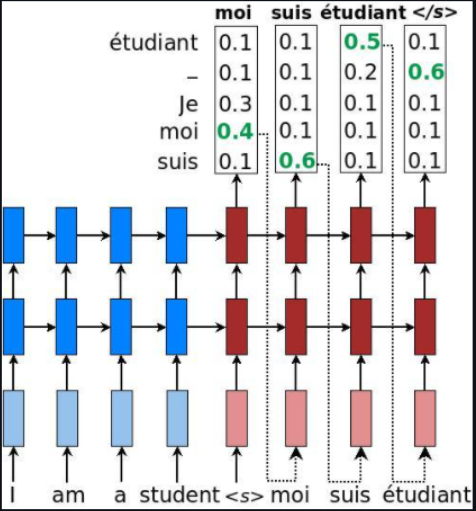

In [50]:
base64_data="iVBORw0KGgoAAAANSUhEUgAAAdwAAAH/CAYAAAD9m2xtAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P0HoF9FtTf8v+//fcq9zy3q1WvDCijYe9drb/diR6SDdFAUewWvlSYlJNRAAgm9Ix2kN+kJCZCEUAMhvZ1e138+O1m4Pc/5HeCkgLrnZGXvPXXNmpn1nTUzv73/n3953ouioYYaaqihhhpau1QB7lvf8d6YNv3uhhpq6K+Y7rprWtxx55S4444pcde06TFl6l1xZ3keLu5fC00tdZpa6qE++Xz7HXfGnVOmPuG3pkh+SZXslKH8Qp6rsm+/o5Jx+pHv1KnTqjSVX0kzbTX4eqJO0/7MT9Wmq8okiylTijzuWslj5VcIryj9Mp1ndRhaztOmVbyglfUsfCirkHL1uex3yZP7pySLVfHEl2fF8yq/Kp9C6nLrrbdV8r7zzpX1zLKUf1tpl9tvX9kv0M233LqSTzyu4qWed0Wr0sqzXuawPI6S9j/w4P8bcN/7gY9E4xrXuL9u19/fH729vdHX11dRT09PDAwMVPTX6AYHByve1SvroV7q2NXVtVr1kjdKl8/ylH93d3d0dHTEsmXLqrI6Ozsrck+u+MBXkvj83a+OSx6QvJKXLDPLdU1+0l88JK18Mq48VldW0uMhecl+5prkOflGycdITpyRKPPJeiA8uPJTZrZN8kUm4iQfyVfym3m2oifj+em4E08+tQHcxjXub81REhQOSuWU92hNKpF15fCMKMpUnOpEoSLKcbQu866T/LKMpUuXFgvorjjnnHPiT3/6UyxatOgJxU62qbzzvg4C8hqNk05eKHnJMvCkDJRx0j8JbyYJ7pOv1eWJw0uWn/y4T3m4F559TXyU9yO5lHs9XfoNJXGyXu6zfimX5C35qsdzzXuUeSprOFpTrgHcxjXub9BRHqkU0eLFi+PWW2+Nc889twKNhx56qFJGf01u4cKFFdj94Q9/iAsvvDDuueeeCmiBijqOVjFKN5zC9UwZy/+WW26J3/72t7HHHnvEmWeeWQFuyhaJs2LFimhvb6+eE3CkXx2+EjTkk/cpB3yQw7333luVKc4DDzwQF198cZx11llx3XXXxZw5c54AXeGu6rU6LvtW8oMAWltbWyxfvry6Wgngjy/XOtA9mUvZJ9XTJtX9kTKUfdVVV8U111xT9W88JQ9p+UuX8VGmT7/MO/tA0ppyDeA2rnF/g47iSGVD4c6aNSv222+/+PjHPx4f+chHKqUMIP6a3LRp02LvvfeO//zP/4wvfOELMWHChCcAFwCMVjFKl8o971PRkuGMGTNi//33j8997nPxve99L2666aa/ADGTmRtvvDFOP/30CgBnzpxZKfsEhNXhSx7ZlspDJhq/+tWv4sMf/nB8+ctfjhNPPLECejyZjGy55ZZVG//sZz+L22+/vQrDR4Kke3UcrZNWHvjSv7KPAfs//vGPcdppp1WAD+z1MeHiZ5onc9kGaGjdEb+M454feWuXXXfdNX7+859X9+otTPn1PNzz03fqzxlPnvJWxmjbrpVrALdxjfsbdHVFRRkBje9///vx6le/uiLWESvkr8lNnTo1dtttt3jzm98cb3/72+P3v/99Vb9UnKujHFO5ogQGBEiA6J577lmB7fXXX19ZUqmklXvfffdV4Pa2t70t/uu//itOOumkSrapuEfr8JJ5ZHsqM+XwL//yL7HBBhtUcgAuyjzllFMqsNXG4rDMyUf6vCaojEZeyVPmkbJn1V555ZWx8847x5ve9KZqMuDZUrzwpwu44omvHP3XpIbVOn/+/CcmM0l4WLJkSfzkJz+J97///dWkjIzE037kos3wIp9ciUDuFyxYEA8//HAVJo0yk9fRyGgk1wBu4xq3jhzFSWFSAgY2RZQKBVEcBrp4rp4zrng5607nXjx5iiMuki7jUxrKYW2MHz8+vv71r1cEOMRd0w5Pyk7ek3/P+Egllooyw/Ga6et1d806s9IPPvjg+MY3vhHf+c53qqVx+Ug7VGZJWa6wp+KUJT6ZUsgUPOsV6N55552VYk/Albf7O+64I7bbbrt4znOeU4HuEUccEY8++mgVJo6y5ameyH3Waagc6nyqU/YXgJZkLxmY/uM//mMFrAcccEDFq7Brr702fvCDH8S2224bhx12WGVty0OZAAfAiCd+yif7Sjq88cOPONJ7zn6W6fPZFahddtllsfnmm8fznve8eMUrXhHnnXdezJs3rypzuHKGOuVmO8pTGcDw7rvvruQ/duzYyoLWJvJTJ/LDj+2St771rRXQn3rqqTF37txq2f/++++vwiwzW2JHJiEmoMK100UXXRRjxoypVn2sHliyz/rhBU/ZXqvrGsBtXOPWojNQExTMoC3xGeBXXHFFTJkypRrg7i+99NJKsT/yyCNPKIobbrihUgJXX311pTgprlRaFAGlAEhvu+22uPzyy+OCCy6o8paO1UXBUkyUojwts1nus/QpfwprdVxdCaWypPxmz55dKTi840fdAIH6UpYUGUWMT+GUKIUtPZ5YG+JTshQk/uVP+ZLFGWecUe1FT58+vZIHUs8HH3ywmkhccsklT5QrPkAk11SceU2+k/gj+QFLMsTH+eefX4G7PLXfY4899gRAkv1xxx0Xn/rUp54AwG9+85tPLC8rm/JXd22krto8wYJyx7O88QoAkj98CAcQZIns3dqnZElmeSxccidXkxK8nnzyyZXs5Kcf4Fn7k4n6WHomJ2XrW2mRI31L/8CPOgAsslBXfRWw4kk76YPKNhk58MADK8D753/+5wp0WZqWlqXX7mSWfW44uQsTxzhRvj5kkmjf/F3vele89rWvjYMOOqgqV1zyUWfPv/jFL2LjjTeulpP1C31B2dK+853vjPXXX7+aBLz+9a+PD33oQ/HDH/6wkiV57bvvvrHRRhvFe9/73mol49hjj63a3RK5CZZ2Vlbyy2UbPV3XAG7jGrcWHQVGKQAECo8l9JKXvKRSDptuumn1/JrXvKZSCB/84AfjN7/5TRx//PGVlfLud787Xvayl1Uz91122aVStICTsqHkbr755iq+PU35/fu//3u8+MUvjve85z2V4qDEKTpAbYntW9/6Vrz0pS+tiBVAEY/GpeJRN1fKxz2lTUl/+9vfriy99dZbL170ohdVis4SMOsHGAARit+eKF4sQdqfpdSAKoVHcavLxz72sQqc5U/hs9yAzOte97rKsiNbslC/7373u5XMlEfGrpaf7XMefvjhVf4JKKkwk/e8ikPBmryQ4fve974nlPUb3vCG+OIXvxiHHnpoBVJ4peDf+MY3Vsu7/+N//I+K/umf/qkCHPUnc3lR/HhWV+AA0IELULSvrp0th5pMqBM+TBJYy5/4xCcqHiwff/azn4299tqruv7v//2/41WvelUlBzLQx0444YRKBmS34447VpM4YHv22WdXQKOfkPkLXvCCePnLX14BmX1PAAzo5INYk/LRfp///Ocr2ZpUACbyd6+dLPMCN/0QIP6f//N/Khn8z//5PyvgJQN1B27kWpe7dlBPRBYmJsaIvXlyI3t8ygPvxoA+rf8YA+Tknnz/4z/+oxo/wtWXHDfZZJN44QtfWMmOjMnsAx/4QCXHrbfeupo8mLCyxOUtvXZQZ/H0Y7zgXR/Ef/aR0Vq+DeA2rnFr0RmQlIPByqL76le/Wlkm//qv/1opLgoPGP3bv/1bPP/5z39iWcyAf8tb3lIpRcr7la98ZXVQhqUB2FhM++yzTxVHGNAGTmbzFKpnS8epoFharCLAQClOmjSpmr2PxtWByj3lo45AE5iwIih8Cm6bbbaJzTbbrFJ4n/zkJysFZhLAyuKHH2CmPvKgdC3vveMd74jnPve51eQBsCnDBANoU6LSUPJAhtJ0ghiYUJbkt8UWW8TXvva1ChiU8+Mf/7jKH9+p7PNePbKNTE4o2C996UtVPbSHfVl55d4oS0h5LCmAaOIE+ACgtpLGJOgrX/lKVReTC20BOMSz15jLrCwpwCadtrT/y2p8/PHHq9UIIKBfmEzpK3gAzNocqA0FXCBoAgDsHJ5iwQJu7Q20TBj4k49n9dlwww2riYy4+hbeWKvk+b/+1/96Apj1U4CrzfBELvhnYcofMKsjvsQBmCZVrFInqQEVWQNK5B7PJkv4Nsk0PvR95X3mM5+pVgukN2GwupArJNLh03j47//+70oeDraxjFmmrH6TPv3QATsTTJMKe9yW2uUnromP/sNiNxlUlomWumlnQK7tWcSsbcv52mdoPZ6qawC3cY1bi45Cp2goCNYGwMglNwP617/+dUyePLlSMPYAgQzQZMWMGzeusg6AM5A2K8/ZNuCijIGPtIDOrJ51DNgSdB3moZQotZ122qnKCzCwhEYLuFyCbl4BFoUNWFgllDUeLaECHLwBE0rTBIBV8dGPfrSSBYVuSZLyAjSsKzIgowRcMkzATauZ7MiVtUk2OTEBxCYayrWsaHnVMigeKUc8p5XiOZUnRQrwd99998oqQjvssEMlK/nZP9ZmwA8oyB9P2g84mMiwnliDlmJZUCYh2j0BF3/AH1gA+ARcEy7WuBPHwJM1b59WWfoEAD/yyCOruvDH2//3//1/IwIumcjfsrIJDbBJvlzlh2/gSN4AhazlZZlVG+orymIti2+igV/9UV0snbMoTT4AGbn8wz/8Q9VGTsWzPoFUrsyQOdnn5Idl+8tf/rKaSFgBIF+TNGmBIvnqv/qMuNlu2guv2gXQm4Sol3IArvQmPvoi4GXB6hf6g8mnSYLJhXzITZ1Z+Pz1RVsW8tBuxhlZAF99Lpffsy7q8VRdA7iNa9xadAajgUnBWC4DGJYcAQaLk2KlEFkclBTQpUDMyB3soNAsj7IaKF0AZo+UlWT5C1hJS7ECYsqGArP8CVyVR+EDOkpzTVi4nHohCicBi3JkkQAWgK88loHlXKei1R+gUZ4UGkuULIAGQKD4WDBHHXVUNYkQBnDVSzn2AtWHPNSbZQO07MNZgmTNACjWqXIt/ZKfZVuKNJV1HWRTYfKn0AEky5YFZzLDCmQRWvrXLpZN05IFfqwjsgVu5ArsTBjUgwKnnLUxxa290sKl4JVnmwCAKQ/gmpSwugAJ+eQKAAB0eEhfAZxWD1J2I1m49kEBExkdc8wxlRUJsPHDctNP1MfkzIqJ/JXPwgWAwkyMTARYhCZV6gpwTQSANBmor0kUGel32kIfll/yVgdcske2NciWlW3SQfbAUbuxivUVEyFps/2QdjfRwqfJAt4tbStLv9bfWLbGlHbUbix0/LFitTP5Jx/ZL5QjPZAH+CZfZKSuVgPIjTwzDWoAt3GNe5a4XHI1QFmnlBxlSLEADIPXADewgQjFu/3221eK0mwdwFKqlvZYIw7OsFYpTUqfRWWviUKl1OTFyqXElWNpjJWRgEtJI1bZ6gBughbFp34UFYUMLO05sn4oOfVkGVh2dYjGT0Vy34xVg0eKjFWBf+DKkqIcKXUWDwtK/gCX/AAu8KJkpWEVU+6AgTVGJpQka8v+LZBRHqsylTYlKa1nbaQulLVJg8mCiY+2IPvcY0fu1Q2ZtCjbISiKmFyBJhBSFqBAAJelrH2HAq6DVCYVFLol5dxbtyLAQgNe9n0BENnIz+SKFQiMWwEuXkzEADrgMunJvWBpAJy6ACRy5k9OJmzKB0oAV7/baqutKtkDYpNAFrzJhfJZtSYzJhf6JnmTnTYyqUrLNuVOztlf8Kss7W1Jm5WqzrZGgK4lYnJQNjCVF5lJK51VC3KwbeCen3B9Up2PPvroCsz1C0vhJgFA3XYFeer/xiWZSpsrAYDWkrQxSWZ40g9NYPCqrnWQ1n+eqmsAt3GNW8vOwKQI7OECjFSuludYQIiFRomz0Cz9sgb5A1yAZJmOVcPysXznpzEUG+Vpz8lsnxKgRCgaSgWYsYrtlwK0BFwKdnWWlHNJlrKpz/SBjMkAwKGUKSgWhSU9CpiSt8RtSc9+GmWGH+BpMkJGFD5rDlBT6pRwAq59NvKjOKWxjM6fgqX0lcuyTWuUlZzLuBQzGYmPb4CbvCfg4h9vLEqyBUL2PNXF4aikH/3oR9Vvck0eTJhYngAVv8ARHwAQX0BFntoUz0haCh6A2ac1uUiwBrjaBdDkPnb6A1wysnSaZwFGAlzyB+ja36RHnUyCWKiWtQEsf3H1Mb/TNmkCbABXG7Bw8W5SoQwTO2mlAbiHHHJIJXuyA3r2rfmTu4legho56zPZb1y1BbCTXp30W+2nblYW7AHrvw51sWTtsQJ8cgPAVjAs9+LHs7zwaM9am5g8GS/yNV7kZxJFDlYhTJbwzZrVH+VnLOk7+h0enD+QvzzUD6/KqfejBnAb17hniTMYKRuKgNUKMFimFDPApXgpZr8rpTxZHBQMZUEZsGZYIhTfpz/96cqKMOgtGwMS4GMJ1U88KBozdIqUYqVYWCfAOw9NAWF5sYJXB3ApG5RgS4HiFzhSysqzTzhx4sSqPiwMZVOm6iDMgRqgQR6WUvP3lqxFVialzrKgGCm4tHDVmbUIcIEM+bFOgLX621s1oaA8gRUAsOxIqYuL31xGTqXpChgoX6sD9v5YeKxoS9LyJnd1s6xK+bLUtR++TWYALrkDQACAb+BgD5O1BGzly5pj9ZIRZZ4TKkBpmdpEi4xMSMgml89NOFhuloatDkjTCnDJWtvLhyzIU3zWHjBXD/UCvvz1JSsl+pBlXBaeVQJtwNpMwFW+CUNauADXSWVhrGlL/rmkjBfyBOB404aI3Mk6284kQv9xLy+ytV+u3NzbNSkx+dFPyDZ/GsUaZpECQXniXR8Cns5AsGSBKV4AKfmTmZ9ymcDoryYzVmBMcOzVkpE+q254UR4e5Z/84h3PDeA2rnHPImdApjKh4OqA+7vf/a5SyAZvHtRhGTgoBVwokQRcwGRJGZhQFJQmi5cCEc7CYgWwUigOljILxUERCgMQWYamDNeEhateCVRZP8pYviYDlB1FBtjVhyLLPWXARxYsp+SHMqTIAQDA4E/ZW26170vZASnp02oFuGREaQIhz5Y47TcCegfPLAeaeABu5YqP36ETBnVxlRf+LUuzyp1w/ulPf1otH7NGnTqWr/YyKQIm9tSBu+VKEyYTIHxIY68Q6ABWeQJCqxvSs7rycJil2wTctLRZ1sLwTw6e8WKiAryl0WcArn4ECACLvkV+LFz9RTsAbSCpPH1Cu6gHUE1L2bNJhLxyDxe/+g2A1gZp4fJXBnkk4FrBMVlKnoGYcCsBOWmqT3Bc9SXtkX0q+xLgtJLDSga+tlmAr3tnEgCqCQmeWeUJ5CZe5AGItT0LWBtqf3XUBlY7ALaJjbGhrcQxEZI/wFa21YucDOAt+Uv+0dMBW64B3MY1bi07isDApSgoQQqJ5eUUZC5PASUKAZhQxPZcATElBlAthVG0lphTybNCgKtDIYCXpeSesrN8C9AoXMBK8XsGCpYpgRLrbDQulWQSxYNX9bM0DlzxTPEDfeCAfyAJzCh1y7v26AAGhU95410cfgDCs6W9tJBY6iYs4qifE6PkapkR4LEulQtEgIWlYeXKC1CzUlMxpwL1XFeo8mOR2v9UBgDVLkDS0jiFrXyrDVYsgJMJECWvXPVg3eGDpQzsKHVLkpR/TiS0g7YGCuLzIy976/K0T2g5VLnaS5uaAKiTNPIHesoEEuJrTxMefUK9La0DFhMNe/kmYfxzj5tstY/81dVyrskN8MwlZSDN0gS0ZGXyYEmddasf27OXBkjqYyxxeUmnT+oL4ptAypfsWzn9KoFMW2gX7Q4YtbGlcX3MxIf1bsJp4mkMSavtgKRJC4A2uSCvbENLxM4RWKHI5WSHvWy3GFfKIEMTC3ziwxU9XWBt5RrAbVzj1rJL5cEioggoWsqXsqIkDHwHaSh0Vg4rlYVj4ANeioPycurSnhwApeAscVpOs/xFCQM2ihgYsJ6VR4FQdJY9WQOUD6K0KLLRuAQqiqh+BSyA3PKqnyZR2OoKCC0lAx1KTZ3xBXQBsHqbLLDgWV/qb/8Vn5SkZc60cFny6khOAFterCH1YV1RwiYzFK14JimWBu0tyyOVeCpSfninXN3LDwEW1qJlTPkAWSDlgA4AUR5rSjuIT9YsP3xT7pZw8cHKBQLA3oEbwAeEHOhi0bPU1FF8p5LtU+IDj4Dci0TsI5qEyE8dgTvAIR9LrVYTcuImPUsQOLPkTArIx2SF7PQT7aIfaitbGfoNsFevBE+HrOx54qt+RiAtXGWbyOCfrEwStKk2YonLT7i8TSCtaOhv5NwKvPhnu7jXz8TPNlMGaxpoqoeJALnmhEkcMlCOeuiPeEMmqEibmcDhVT2lMT6Q+wR75SN5o1Y8P13XAG7jGreWXSoNg9yyq1k6xQQwKQjE38EhFq39MqAqjSvwtbTMgqCEU7FQGCwbSpAFIa08WGhACpCnwqCsKE1xKD8zfIptNE598CC9ayouSp/FAFTxzJJAeMI7JQicKG5xKUYKE++WHU0uLA+qj/1KdZYP3ilB8VNOwilfZQsnF/WzdA5clOsKaMlCufhOMEvFSjb8sh3UCW/ainLGd7YLUi4e1TPrro088xeubHG1MWteO+BRe7Om5KdegEAdpAGM5CAffCSf6qw/qIt47gGJ9KwyfuqXvCuPHMU3ydLO6iIfz3jT/8hRGFlnvdLCUy6+8KMNpONPhq74lo82U2f1kwapp3D1kS8+5GvSIW1ao62cNlEP7eIqbr2fkZ1JgslEThqFiZP9Ep+u2fdzrGQ7Z//Dd/bHDE+gzfwSfNeUawC3cY1bi85gNXCRwU8RGOwGeiqVVCipLAx+igGJSxGkYkCpXFMhuOefeaCMg9zL0yw+y+Y/WkWizCxDuVmO+nhWlnIoX2Uhz+KnAkx+Mz6rgwJ0zx+vlGnGzXp6zvySh8wn/eWT9UTCpc92kE8q0myX5E2YNPJL3jIfeWa5wrLOnpPEzzrkc95nPpkXP1dx1Nc1+ciyk7fMQ3xxyZZ85CWuOOriOct0HVqmq7Ch5QjL/OplZvz0y7go24s/WaR8xRVe5yHzUt5ILts58/OcZbuakJhUmXCYEKXc5C++a/IjPuLvWZjyMz/p8jnTZb9wRcnDmnIN4DaucWvZ5YBPpeFqoOdgTuKPUtm4iofcpz/lIJ8EzLqCQOIIz7LERxRePoszWsCVLvPHU5bpPuuA51Sw+Zz8u0rLL5VegoH7DEPyFj/ToqyDq2fx87meZz67Zj4po/p95iFeXrOcOglLXpIffulfj1cnYa4JDOK4T39XfLqmn2dx069eb5R5ZRmZT/05+eFfzy/5zrwzrjaQr/CMwz/juqKUafojcqz3w3pa17yXbyuX6cWRp6vnetl5L7+sU/IjrvtMW4/rPuNnXpkfSv6Sf+nrfIx2rAx1DeA2rnFr0RmoOfAN+Bzkea0P7hz06Y88p19SXcEMpwj4ZX6pkOSRQATY5DNaJZL5J595X6csL+uUPGRcfOEjlXxes25ZZ/EzfT2vfE6SX97X80lKnuSH0i/lnOGu0rqKk36uKOuOMl3Gc81yM48Mz/rizT0SlrzU04mT8fhlPhkn07tXLv8MSz6Skm/h0rjmc05yMm6GD1e35IF/5lmPlzLJeNLJO+NmueKQ4XAkLOPLI+Nnvukvb/klb8izsLpckHuydE25ZZykzBfVy8t7dcTfmnAN4DaucWvRGaypHFzriicHcw5292hoWN0vlUM+p7JKl89IPOVm3FQwqZwynrAsJ/1HcplO/LzKwxV/qdAs9yGK1/Jj3lP0lkTt6fFH9kFzKTiBIMlzxpNHXvnXr0P9Mq3nvK/niVIZJ/+IfPK5fiUbLp9TDvylUW9X+cmXLJSlrggfeM/7oTy6Cre0W4+fPGccYemfcVzrcep5ukqT+aefZXxnANzjN+uQdavXP4k/P3WrPyeRRZKy5Cv/JGXzG46Sf5R1RvVwlPzX49TrVy/LNWWpv5Gta8bJdPjN+qKsW9Kacg3gNq5xa9EZuKkQKIMc8KkYDHZUVx7rglLhIPxQvHhzohVv+B6No7jk6ZCMQz0O1jh44+rErfskB2uGu19bpIykfHawx8EffKdrpWBb+VPQCVbANoEWoNXLq/OR9w6w1akeb2hY0pOFo3o+rUh7IAeRHF5TB8D2VNp+JBmRBxnoS+SrDHV29TOl4XhZF5Tlu3pOntTfYbN14RrAbVzj1qKjyAGqk5t5etYpUYrIQOfnuq7Jz1jwgJf0wwsF5K1VFO9oZvbSSCs/Pz/xEgi/nfXTFr9BRp6fKfLzJL/JdY8n5OdZwHK0DrgkAS1Xkw6nhf2MyE+LhvLxbCB19+5jv9f1Eygy0F/xP5q254A1Gai/U+NezejnbMOVv65Ju/s5lRdc+J21+nsVpZ+x+fnWunAN4DaucWvRUVwUkJcTUPYGud9DGuReTYd22mmndU5ZLl6SH0QR+U2sNy6NRumybihuP1/xnl7WY4IQf/eU+rqmBEOWZy5Psur9NtabhgDE6ri6letqidzPYfwGFfAMx9MzSSkPP/nxsgwv3MA7uajLaF32dz/Tkref8PiZmrzJ3QrAcPysC8KDdq6vQvh5lBdloHXhGsBtXOPWojPjN8C9IMDHyll+fo+Z5KcNzwQBQuVbSkte+Hl3rLc0+Y3maABXGgrb7zu9BEK+qeAQxSecXNYlKTcBkaK16mAJHeB6/SC/0brMX/2yrpbpAY7PFZLFUH6eacIjAPQKQ98t9ipMfuTAX5zROrJQf0DrJRjkkICrjGei/ZWJr+x/2sk2j99Zez+zCce6cA3gNq5xa9EBIIOcFWUWba8s920N+lQA65oowAQIQORK2VKSAJeFsqYAN+tYV3jPBCk7AdEzhZsW7uoAbtZL3uTqqn0BTX46cSgvzwbCKx6BrSVlMuCnP4ym7TngBlhNZoA5wAVqZJ797JnqAwm8eEHaCI+Wk1n568I1gNu4xq1FZ5BTNCxcAzsPp9QVzzPhlI9SGeGJkvQmJK9NXB3ApcwspwJcbyxKgMv6ptWxrikVrboCFoDrdZMAl/Idrct81c+VXC0pe1OTJWX798Px80yTw3FeIOHLOazc7JNkM1rAzfYnT9sKXl/pbV8J5PIfjpd1QdlO9XrmkrLXXK4L1wDu35DT2YeSjpZK1T2/uqvHrbv6c6s0Q93QNK3i1V3GSd7q8fO5Tunq98O5VmmG8x/OPZU4T8XlQAe4ZtGWbQ34HPjapc7TuiLl4iH7hXv7W97i47DTaAE387Jv6R3QXkNI0dbLSh7cJw31y+fh/IaGj0QZ1zV5IHekvgB3dZeU+/tZuEWZo/4C6H09sWjZkrijyHL3PXaP+2bdVwRTZLmK8NNfqEBPlJFZvIDQSuov931IyGCpNyppqvir0nkeLNRXsnPUi79ndZSmd7C0bclBPlXeyqhKWvk3UMJRR2dHTClgCHAnlb450Ff6Ysmjr8ipkl/J+y96QHr8hedfOjyQLXmybFm4ABcAA7ihfeCpUD3+cGlb+SWln/bPsQdw9UuAayLcHJpq3JO6oR2q3sl0bJ3KwRBWFcVnX4V/PX7GGzoQ8tl1uDT1uBk/qZ4OZRwu44pTj2cwJh8ZbmAYFOmX/vX7zDfzy/AcVJlnvdxMn3wNTVunzH+0LstgRZlFp4Ur7+Qxy00eMg1KPyQ+qvsl1dOg5L9ef/GyvHzO+O7xZUnZy/VXF3BzSVm/y707YWgob5Qgf8+pEDMuHjJ+xsl0GZ5xh1KWgTKf9HcFCk4oA1w8js4VGQGwgdI2Az3RVahjsDsWd62IqTPujt322CPuu3dWRM/ASurF22B0F2BsK2DYMdhRANJXdLz3ui06B9pjRfFbPtgZJaSAZqlzFX+wxB0MXBZ8j1JctJei55dnx70G+9VvILoGe2NZgeGlJXXbYHt0l/z6Sqre4uev299AV2Gl8Nq78tDU8RMmxuTjTyi89ZfMC4/Au9TLLq71F9dS9MqbpBaOXLUheepLDk0B3vqka2gbDufvKky7Zf9If9d6u2c+9efMS96u2f6Zr3v5AlyfKkTrwjWA+1fsdJrsbHmPdCod3BKh35v58kfduqrH91xf7kl/HbVOma/4rhm3HjY0TZLwHAye/UbTMpuXrpv5ytPynq958BduwOKJUhRepywreagPoAzLOqVflu3qeWja9JNG2ZlOmMG6Ok56gHvKKadUACTvVBhZD1ckDA8onzPOcO0kj6HEP9NKk4CXflmner2kkzfluDqAK438E3AtKeMheXXFg/a2v2vZ0bImxefZb1fxq471+iRlPZA4KRfppNd/7MvJ10nrPJWa8nbNvNcc4FLopV2iAE2hFQXUFva1xR0zpsVu3yiAO31GREdByc4Sr4BuTyl7SQG8OSXOzI5HYvqyGTF93rSYNndaTF00M6a1PRSzexbEwgK8PaxeQFpAcHkpzfedSjbRU2hpKdqvR5drpp7B6Cr1fKRtQdy8+L64buE9cdP86XF7yXfK/Lvjzvn3xC0L7407Fs+KuxbeF3M7F0dbT2eR071xAsA9rgBOT4FXoFvKKj2k1KdYhauuVV8ooF6Z1a4jOLLVJvqSJWVtkU6Yfkb2+oA2YgFrM32ATqC3pM92Ej/bn1/9HsnLb36l1f6A3kQiPxyhr+A/iXPlb+uDbmwAt3FP6nTGeif07F5Hyj0UnzvzO0DfqUzrShxXioiiciJVJ898UqEJz3thnnMgpJ983CcfGT/DkbAMNzj81tOn1Szj+IKMPAyMsWPHVt949cN9e2DKyzLcuyJ+Wfcsx33GqfOQeWR816RMl/ngzcvRKe4EiUyzOs7gTsAFQHjKwS9/fORKBCUFgCgMyohc8II/16xf8iWPrEvWWdtTQMqSj2VifQGIZvpMm86zsNUFXE5e9UNT6pvl4Vuf85tfB5Z8g9VJXp/ky1PceM80mQ5le/FLeagruf3hD3+ogPPnP/959XF3n5rzqToyVK+h+Xhes4Bb+lkB29JSxeIs46pYq3feOz12Z+FOuzcG20ubd5cYhf8lxcKc3b04rlowM8bOuDh+cPNx8Z0/jovvXToufnL1cXHw1PPivLllEtI1Lzp7uiK6Sz8s1F6AcFEpb2Ep1ZeMAe6S4ldEUfLvj6UdbXHhvTfFT6+cGLtcPCZ2vfjQ2P3Cg2OPCwqV+50uPSR2v2xs/PCPx8SVj94VCztXxL0FcCe1AFxgW7heo4Cr/bSZce834ORv2dmnI3/2s5/F+PHjqz6gj2jj+hjNtq+3vzY0iT333HOrMbbPPvtU35bWr84666xKt2V/56p6rLrybwC3cU/ZpfLQcXRGz678AJbj7n7U7vuVZpE6J+VDmSHPPk6tY5phZj55zbzzSimhDKtTxhM2NK1nHd69weZEpG92+li5GSme8Lv11ltXkwOf3fKceWV6+SX/9TyRewSghGe59XDPWfdMn3nwo5wpaQdIlF9PmwN1NE7a4QBXvupjsnPxxRfHr371q+p7p+RAYYjP6idzaciOksFT1s0165VtBGR9J9d3Ux3a8bIJ1/POO+//mvGnS17WFuAmnyxOL9ygiN/znvdUH0sXz76x769SuhSuvpltk7KS3hWpg3ythgBbLzXwwXcnrH1kXR3I015yyizrnG26ZgG39PVC7FxLwUt72mPqPXfHHrvuHrOnzYi+9q7o0db9nXFf14K45NEp8fM/Hh8fOfnHsd74r8dLxmwZrxqzbax/2NfjPcd+J/a45Ig4e/ZNsbS92LWdBQSXF+u5mLXzBvqLVTsY80rJywvw9XQVIOko9VrRGwu7lsfB154R7zz8G/GC/b8Wz//9ZvGCAzeNF5Xry8duEy88dIv4t999KV5zwDYxfuql8Wj7kpV7mE8CuK4D+kLxr8DWdQRHtsMBLtlrN5Nab3zSJ/UB38613+/bvh/96Eer792adOZYl1e2ebZd9nmTM+3v9+3vfe97q36k/TfaaKMqH/pFPOmSh7zKrwHcxj1lp9PUla1n5JkF4cPkOrXOXVfUwl11Vj9b8FFsByfs8erkrtkhMx3yLF2SuMIpcWCQHduAkD4HhnRJ4vnNmw+F4w048KeIHSzy4XSvXJNnps965fNQv+TPMx7q5fKvpxGGMr046oAvb1/adNNNqw+iO62Lp5ykSDNap5zhABdPLFsTHh8h95FzHy/3wXYEgKxQiKNN8CpN1gFl3YR5psysHsjPCyxe/OIXVx+vVycWJGDJuuAhHb81BbjSUXT1JeVsIwBotcXH1L3958ILL6wmeyY63vrjI+wmCtLhKeuV7Zt+qYwB7vnnn199jJx1++tf/7pqQy/d+MUvflHVR9tKmyQv+aw5wNW3Sj+rDivZR+2P5d1l4jP97vjGLrsVwL0nejo6i19bPDqwNK5cdHf85PJj490H7hwv//Wmsd7vN4/1DvhavOqw7eKlR349XlSurz90l9j59INiypyZEV09EctKv27vi7buAuaFd/u2vZoR4C7vjsHFK+KBroXxs2snx6uP3Dn+Ycxm8dyjto4XHrlVvPTQzeM147aNNx61Y7zt0O3jI4fsEqdMuyLmdiyJe54EcEvOf2nlAtvVANzsYz/5yU+qD/t76crll19e6YHTTz+9ajt998ADD6x+L579pt7Hsx35sYQvuuiiqv21929/+9vqBTP60U9/+tOqb+Gl4n0VD3mVXwO4jXvKTqfRAZN0QJ1TpzZDPPXUU6t32Fq+obQBrDjiikeJA+UPfOAD1XKucCDD4kqFloCj07pPawuJm2GuOjB/z5Qc0JQmw6XFBwv305/+9BMWbipQA4xFlMvJKIE886hT+mWd5J/1F6Z+9onwkJMCcRA/+dZlxrL6zGc+Ey996Uurn3SQg3Tiizdap52GA1z5mhiRxfrrr1/NyE02fAxc/I997GOV1Za/kUyFIx1+6+2uvogMxbdE+8tf/rJaYvv85z9fgfchhxzyxNaB8lE6+chzdQFXGvwk4NaXlOVPBp/85CerCRcrXFvrExSnlQ3yZ61ceumlVT1TVtInz/LPNkbqpI+bbFCwDuqwlNQfwGf5mV79PZPp6gNucYPyLm0h70I9/QPR3tEd9067N761yzdi9j0zo6+/Nxb3r4jpvY/FkfdeHB8cu3u8Yt+vxhv22yp2vOTgOHTuFfG7eX+MTa47NF4+Ybd44UFbx/vGfSsOv+L0WNK2JAbbeyO6y2Sjp1BfKaOv8N/ZHR0r2gsQl0lUV2c8MLgifnrb6fHKibvHv07YPt577W9ilzmnxt7zz49fPnR2/H7OBXHCwqvjvPk3xt2dj8Ti3va426GhiQVwJ/zfgAtoC1RVoPsXVq7rCI5stctQwOWvnQGrV14CVpMlftl3bTPoA0DTSkiOPX3fNdtfmyblXrD2zzK1vwmY9s9xw0mfV/4N4DbuKTudRkfKDphKiJJzWMoSovfiAhIdD3iIp6OxDPhTbpZyfvCDH1RxzTbtrRgEANX+CPC2tEmxGQAJUADMkpSyHMjyLO8MB+BmrkDEO4QdZpCffRogY+8OX9Ihg4Vlif/kFakTfg1cQGgg2ufFl4MR0ma9KFG827eUn4MU9vjUFZ8ADhgYpPU0BjtFwDKyJOW3ed665AX8lkfFGa3TTsMBrjoddNBBlVVrH4uFDXyAkLqyVFkBLD8KJQHIlUxS1vqA+wwDPupM1voA5cXCxYM2XduAK//6knLyqT+wblnvtjr0HXJFeFc2S0XfoHgpUDzV+3jmVSd+SFx7dvZvKXSrA/jgn8o6+ZOnctcM4JZ8CxABpGqbs68Ynm09MWvqzNhr52/G/XfPiq6+rnh8YFlctnBq7HHpofHK/TeNF435avzX0XvF2bOujtt7Hog/9s+KXz18YXzwgv+OF47dLjY8bKfYZsIvY+qSB6K7p4Bqb6lrT7H2eks5BXC7ynNbAXIno9sHu2JKLIzv335yvPL4PeJ5x2wXH7r8l/HdB06LQx67OI5++KI4bd7VcW3bnXF396yYO7AwlvV3xLSZ98bE4ycWK7c14CL3T1i5aARHtq0A1zhziNNWgteLap8cv/qm8x2MAJMyL+So66wk7ac9k7IPiCd/lu0nPvGJarIJULW/8Gx/zpVfA7iNe8pOp9GJdTidCtDYk7UsqzN7L65lO8s2++67bwV6rD7xgZ8lGIr4Fa94RbUE4126DhxQ/joiQABCgFGHpISz88rDQKHE5S8eBSnMYKPsLVOzYu2viQPU+RkIrLc999yzGnCUnYHFXxxAl3zKyyAyKFhtFDJl7SXku+22W/WO4jxklWUDbXuglLvyLFGSB1nYz7ScZWADAPUBcp7Ve8MNN4znPve51dKWdw0b/CwvdRut007kBMQTcPGq7vgC8JaVyVsYnkwIzP7tcSHATybCsg3qSkc/yL6A+IljsqPOb3nLW6pVDEqNv7ipfDjP8l3TgKu+ylMvfUr/MokAiiZw+pBy8avPpLLUNz3rG/JLmYnnuV4H1/TXptr+4x//+BN7uPW4yZ/nNQ245VIZgH6y072iN2ZPmRXf3XnPuH96AZXezni0AO5Js6+K/zrxh/HiQ74czz3qK7HNmb+MG+fdFbO75sT0gcdi0qI/xVevOjRedtSOJc7W8eGxe8b5j98Rc/uXxtICqsv7ywS08N5TCvKzoiXF/gS2y/rb4s7BefH9mybFa4/7RgHsbeItE78Rnz3tx7HpiT+OrU/6Sex16e9j31smxjkFeO/pnRMLBtpiysx7YsIJx8cJE1cBbgHywWKhDwXclVbuSiv+yXoF2Q4HuNrIJMtKzlvf+taqfUyQsv21h7HLMnXGgz6gF7K/azckLqq3afYB+Rnf2l/6bH9hnLh55d8AbuOestNpdCQdhzK2DLfNNtvEJptsUh28AWj2aClc+7ROAgJdnZZFaqZpqXGDDTaorCj7X/ZOKCDKDsi41/ntjbCcsuPr4AYDkKJYxWNtCmdVOnik0yNK1iBQPhBjfUiTFq7BiX/AjHeWIBCUl0EoDgVsqRDoUqjuHTACovJm+VKa8mLJyoe1CpjtFRv4rr6OAsDIhRUsf2XfdtttVf0durDnKVydWZnADqCPxqVCSMDNJVayY237kspLXvKSin+8a0/yFYfFSybe/OQFDXVAFifzRunqSkhe2ltfALjjxo17wsLNeOk8rynA1W4JuGnh4tsqgy+14IVc1VeZwpSv35gYsm60b1rA0qds5C/uUP7dI4Br0lZfUpY+06Ks/5oE3Oq3qeUyWK7F4Iye5T1x/52z4nu7fCvunwZwu+KRwaVx1PQL4gPjd4sXjvty/POxX4odLv993Lx8VjzSOy8eGJgfFyyZErtdf1RsOH6X+LdDNo+3jdstxs2+PO7qnxcPR3vMG+wpwFss28H+WFYgcPFgR3QUS7Wjty3uLel/evXx8Y6j94xXH7RNvP7328Tb99s63vbrzeKtv/tqvPOI7eODk/aI7a49ME6fd1PM6lwQt828O46bvBJwBrrLTKEAbrdJTpFPaZW/AFzPXqxRpLiy3i0c2Wqv4QBXP6cPWLjGRI5zYfqC1ScTZGPX5No4yfBs8zrVnWf91qSN3qEz5Ke902UaV/k2gNu4p+x0QJ2JsqCcABhlyaqk3ClbSt1eLksNuFJoOjnrwn6X5Uad3/Kbk8zyAcYUM5BxkEnnBz5mj3VlbTAAJgdg/JwH4LLMWKiA0NKh2SwABGiWrJ2YBnhARFqK2UADetLY2/OCiLQ+lYEfx/4td1tOVid1Ew+I+gScJUgWPotJefIhC4AL/MVH7ilje6OsSmkoXuWxKN///vdXB42cGiYfA9LEAyiMxpETeVEuJhIASL2U67AHcMEnpUQBiIsoGH4mGCxC7ZM/caDMXFN5tHLyIS+TMG0EcMlHG0pbTy8uvtYE4OI9AReI4pX8HN7TxvzJQz3wkoBrQmefmUwoZbzgN5Vx8j2SSwtXG7Og8KF8eWSdsw+vOcAtKFtRyX8V4HYvA7j3FcD9dmXhdvR1FcBcEodNOTvecfj28fxxX4x/nvCl2O2Gw+NPHQ/EgsFl8fjgorhqyV3x3evHx+uO3S2eN2bzeMNRu8Qvpp4et/Y9WtK3FYDtibZeJ5Z7CtD2FIu3I3q6S5t2tsdjvYvi8BvOiq1P2ze+dtqvY5dzDow9zt4/tj7x5/Gxo/eIVx761XhBAfqXT9wmvnfDcXHt4zPippnTYvxJJ1RWbm93T/R0dUdXkUVvf2mXCnBXkhd1sHDz7VcjObIdDnDJ3WqUSRcdYBJJX2if7CPGh/ZwrsQKnfEvv2y7kZxw/ZaFnKsktsKUmy7zcFVmA7iNe8pOR9RpKG+AZC/W0XgnPyk6IAY07f9ZFv3gBz9YAZB9VR1ZZ7eMDGQAlvgGCuUjb88UoMMNFD6FmEpPOFAGmo71s4yViaTBy+c+97nKisy9X+VZ4mSZvuENb6isGANCHfAJ/B2YAKSsOQpRGoMo9yXlZ9A6DOZkq0EFXP320mAVH+DKx6C2R6oMdUHuWdrKFyZPytxgZ4GZGVtiN/mQF77xp76jcWSFEnAtsZKx+jk0ZPUA+NeBAZEzP/WzAsGK1474RE+FJ+HrGnA5eSXgpkUvb9sd2pg/XhJEXdU5V1QAru0C2x76mPzES75HcusecAs/xdr00yBoC4v6vYSiWLizp8yO7+6yV9x/930FHLujjMg47I6z4u1jtokXjPl8PHfiV+JbfxofN7c/WKzWMsEtFvD1i6bFD64tgHvcrvG8cZvH64/aKfa+7cSY1vtoLOxfHj29xdZc0RWxrExWOgs49pax2t4WsaI92jrL+Lrv9jhh2h/jtPuvj6sXTosbFk+Psx68Jva+6bh42/G7xvOP3DT+YdwX4lMn/ChOu+e6uHrGlDjipOPj2BNPKHn3RtuKturVjr0D/dFbKtMNcEv9egpVy8n2qovsRnLCWwGu8U8H0TnOchhj2gfpJ8aH9hDufEm2/1Ppi+I0gNu4teZ0RJ2GBWiJzklXJ1IvuOCCStFakmQNAigHECwr+yC0Tg/gdGaKzf4txcOP8qOUdUiWMMs1AZfCT6VHgQ0FXBauQcYqYzWzioGceAYgShC3d2zJOwcERUkZA0/ARPmaFFCEwvDMOmUx43n77bevyJKs3/Cxci2Dq4P9WPnYhzURkT4Bl5WofGn85pNSxxc5ssKlY1HaS1J+hj2ZknkyZ/9UvQB8WtQA1+qBiRBgoHDIAqUyoDzsKwNce9naBy8ZbyQn3jMNuBSofNXNRMgSucmYlRN1zHoI1zb25AGuvmFiqO8Mx28r98wArjdPWAHBZ2mb3oHoLIB739T7VgLuPbOjs1ijjxbAPWrKefH+cfZnPx//ftym8c1rjohb2x6KZQVMl/YviRsL4H7/2qNjo/E7xXPHbhZvOWrnOGDKafFI7+PR3rE4+ts6IpYUwF1cALejAG5/VwzifWlb9Hd1xvyOJTG7b0k80L845vWXCffAsni4f35ctOS22PqK/ePlR20Zzzlq03jrQTvEuBvPj0vuuS3GnDwxji6A29XXW8pYuYRfvVKyWkYuwFTuvcMZ2K7cpB65Hci2FeDqj85zsGBZuHRMtq8+QB+YCNM5LGH9VX5Ppe3FaQC3cWvF6TA6EkVh6ZNCdtrVUi0QAkD2K4FYAhnr19Ver45udsnCtdSs8+vcOr28dXJxsvPX93CFKZsytHxNmVOUABfAG1CsSx0ZyFG44huEyjSzZdkBa5MFeVKUlhtNCHJJGS/SyxNo4JMiVR+zZPEpZ+WrF+UKJC1dena4Sl3loQz5AWSTDzNoMmMxJ6j6OQ4L18+CKAmyxbf6rq5LwM2DQGRrCVt9AJOBj4e0bt1b3scjwDXRMOFJwBUu3khOvGcT4JrE2MM3QbNfTg7qoRxxWMNAkrJ0qMr+m7bJNngq/Kx7wC19Y7C7XKUv1qcXYJT8O4oVOrMA7l6VhVsAt68A7sDSOGnm5fH5478Trzjw8/GSI74cO15wYNyy7KFY0LkoFvSUieXCKfGtqw+P9Y/aLp47ZtN495E7x+RZl0Rbz4Ji2S6OgWVt0busM7pL/m3dZQI7UPpuTyl3yfIYKOWuGOiJudFVwLY92ntLW/e0x7LexTG958H47bRTY+PDtop/P+RL8ZZ9t419rzg1zrnrphh75olx+IkT4/HFi2LJsjJeS35dhVZ0sJo7quXrztIO7cX67Qb4fSsPILVyZDsc4GoD483KlkkXnaG9sj/qI/q8yT2dQz/QMdluaCQnvAHcxq01p2PrpCwBe6NedGDmaP9LR2dp5iEj5J7S1ekBn6VeBxNYWbmfYqDIF3lmiej8FGQuKdfD7aFS5uIBhARcgDZ58uQKAPGIKFXPLFUDIk8pCwOKLNJcUk7AzSVqL4UwObCMDKRZwBQ0C9Zej1PPJh4AhTXs0JQTwO4NWgoVKccbuNSZjIBAAgLAVf7LX/7yJ/LiT1GsjjO4E3BzSRnwWxb3ExhLxvlmnZQtObO+yXejjTaqJj6UCX6E4+nJ+BLvmQLc/B2u+uJZmdqSzK0gWNbXhmShHuJQjpSsSY+DMyz67G+u4j0ZT88I4BaAi/CzsTJ2iqXrq0FtbZ0xowDut3b5dsyeXgC3tyceK5bnxXNviT0uPCBee+CXY70xX4xNTt87Tl0wJe7tXxAzB+bHGXOuj20vPiDWP3KbeOmYzeLTx3wz/jj3T9HT61WHy2Ne24KYuuSRuHbxg3Ht0odiWtf8WDzQGSva28q1O+7tWBTT+pbH7MH2WDAAbFfEowWsb+yYGXvdPD5ePnaL+JfDvhxvOWSnOOTm8+O8GbfGgadMiF+OPSjOueTCai938ZLF8UiR/ZnnnB2X/vHyeLi029QpU2PyxOPjiosuib4uE4zWjmxbAa4J53777Re2dBxuy1UzYdIYg/qG8akP6K+Z9snaX1gDuI1ba07HpqgoFT8F0okpVx3dHiHl40qxIfcsKwAkHcAEuJY0nVgGRtn5dUbhuZ/iJzb1JWVX+QNXr9MzW6UgAYfDW2awlpmBurzEV6Yyckk5TykDYXw5KQ3wACJeKUF1ceDLErV3L1t2BAzqoDwHwlizLF1KXj5A1vI5a8o9xapOygd0AN2ANgEx+cAfMtgBIMBVD4NdOnJeHUdeCbgmCRQL/pVhkvFv//ZvFfiSVZZHXpZg8eNU75lnnlnxrg7iZDulAhnOyWddA640+ErApWDxLH911k/wYpUCb9oYP8LU18qMPqBd9Qt5Ie0zUn2zPvrN0FPKylcGHsTJ+zUHuNIChs4KcHv6C+C2d8a9dxXA3W2vmH3v/dHd3xfz+5fHLe33xb63TI53HLRFvOqgYmmO/0bsfvspcUHng3FJ1+z45Z2nxUdP/F68/JCvxWvHbBm7n/mruKfTSdtiAQ8sjHPm3BrfvvmU+OIfj4gdrzguxk+7Mu7pXhiP9rXFnxY/HL+/+tw4bPpVcd6SWXFn38IC4ovjxvb748jZl8U7T9gz/u2oLeN/Hf3VeP8J34/xM66JC2ffGfudfGzs9rMfxNa77Bjv+cD7Kn1yw003xpc3/Up8q4DftdddGxPLJPm973hX7LnzbtGxfAWBq/ywjmyHA1z+zpsYf8az8W4bJ8cnfWMCbe/WLxkcaswJWVK24dB+4FkY/WCrCOD6WZB+qO9kmkznyr8B3MY9ZZedRicDUhQzJUdxUd46KyWK3FM8SBp+lC8r0FItZUyhZ5h4FJ7DVMCJNQog5JMK0gsyLA2zWICoJWUzSsvPqVRzGRRRakBNmUDaTFZ8eSnbAASeTlgDcwORBWqv1gC155mTAnnl8pOf8rBwKQqDFshamjYZAGTyNxilIxcD3iTDT5qGAi7gXm+99aqfL0jHfyRF/1SctHXAzfKAEYX0whe+sLLGyIJ81c0EyQSDnIAHpaW9tEvKEmVbIeXgNZ+RvuBnQXXAVXYqLjJJAJIXq3pNWrjqm/njx0+s/ExNewJEbaZNKV6rNFZTTALxTRZ41YeswJChPqevyDMVsDji6i8sakuW8vHzEP3HJAxJg4esP1no36u7h1tGYbXbWZ3jHSzyLODa0dEZ90y7N/bcfc+YNeO+6CwgvKRYovcVa/P0mdfEDhP/O97zq21iw/23iTcc/+34zIX7xSaXHhjvOu3H8aojdopXHrxtfGbSj+PcOTfGnN7HC4gvi0cHF8aEey+Pz5/5m9j46G/Ef0z8Ufz8yuPj2o4H4p7BxXHWI7fGtsf/Jj43cZ/46jkHxDaXHBZbXXpYfOmC/eMjZ/ws1hu7Tbx47FbxinHbxvevmhDXPj4zrrt3ahw26bjYd8zBcfnVV8ZZZYwtWryoGstO6l9z7TWVhTu9gOcpJ54UF59/YbQVwB2pb5Ct9hgKuNKQszMlVqUYCPSGPqBN6Rdtpr+bjFtl0l7GoTi2gvQBhxv11Wx77Z5kTFnhoJdsS2h/Y16YuDmWkWc6BODKe124BnD/ih0Fkh1OZ7VnyTrT4SgmoEWpIApUHD+NAUrS6fyUHEC1/GK2B2TlJ4y1YAnXnrAZI6XHj4IEVHna194xpWXJUDhrDHDZM7bUzBKVL2VoadrEwF6z9BRzlpUWbi4pG1R4Mmhf9rKXVTNWAwT/Dh9Rlgan37G6imtwUtYAF7DbzxXfQEP4AGQAl5wATA5ECgI4KcsEhtKRn0FvcI/WGdx1wNVu/CgCkwjgY8/b3jbQJS9viAJMAFe9yRwf2obCIlfvRgZU5KcOwpH2Fh/I+OkRuXrRgJPS5EwGOZnIdK6pJJW5pgBXn0gl52pbIn+jrd6sb8vI9uP1F33tmGOOqeSEL7yyUh2gsWpBhnjTN/Dsqizy0J8cqHMgzgFChwGls8ViGVP/S8UrbzJQFrnwH40joYHyV3pX+St3DhgVwO0q+d077e745u7fiJkFLCrA7e+Kx/vaY9qyx+LEWy6PnY/4Vbxr/51ig3Ffj/WP3TVeevRO8dwx28bLxu4Unzj5F/Hbm88q1uvcWNyzNHr722NusVZPuPvS+NJJe8frD94+Pjhuj/jRRUfEVe0zYsrgvOqlGluO/2m8/8Cd4w0H7RAbHL5TvOrY3eKVx+0aLxm3Xbzgt5vG2w7fNXa48OA478Gb4+HlC2LK9Glx7MQJFa0o8sh+Rq7GDRnpF9rh6jKWdvj616uP1ZNhKzcS4Or7xpXXj5roI33AWRB9wJaY6xlnnFH1X30ZDw6AmojpH1Y/+CvDGKILbLlYsbIaph/ZpjHG5W1bpt7+qQukxxt90Fi4jRvR6bypJBFF6hCOg1LAkVXowA3LiSUBWHVIiklcg4qi1tEs4wEoio/FSAFRYuLZHwbGQBkYGkAO8LAinDhlSbBwnWY2u9ShgaJT0zq+dNLgw4xTGkvUAMZAEBf/FLGlJHwAO4NN/fjbC7ZEnZa28i0bGkwsW8vTADeXp4EsXu35snATcA1292a0BiO+TELIQjglb9+INeirRWRGHn7/awY+WqethgIup1zKgnyBE0ChePBldYAycjgMwCaokpWfeOWBOIpJnROAKCIgbAKEf+mtADgIRrb6AH8n2VmOeMiJmzxYFWvSwq0DLn/lCQN02s/ETLtqP+2lP1KCFD9FS6GKb3tAPzWZ0yfIAc+pjIVT1mSm/RDg9ZMr/U24vkaO+FFXaU1y9HdyG40joVK7KDb8E4Dr8NJKwJ0e39h9jwK4M6N7oD+W9flObmfM7euIaYsfjZNvviK+d87Y2PTkfeLDE75bfSXowyf9PLa99IgYM/2yuGHx/bG4ty26u9pjoKsjFnQsjHOnXxV7nvX72OSo78bWx/0sDvnjpLht2czqpRm3LZkRx950Vvzw3DHxtcn7xEcmfj/effx34t2Tvlfy/XF85fRfxc+vOz7OffRPMbtzXizvXvkJTzIHOtlG5OOK+HnWbk7/sxxtX3lu5aTTPkMBlxNGR5gcW3HRB+RJjxizJkfGv3Ma2kR7iW/FydgwedT/M0w/0WetZsmHzqEPTOpd9QF+xoH2l059EB4bwG3cU3apOHQcnY9VyCIFhn4eRJnZA0R+EwtQKX2dNNMBHCCT+yY6PcvK4ScgA6AAmH0RgEA5Utx+S8vCtCxLEbJazFwNRIrM71jt+yqXNSOtZSSDlZVrQpB7bAaUvR2D04CzlKVcCtXVoAB8WScTCnufJhSAHXBT1mawwAfvrFuHJ9zjB6ior/zIyECX1mAlC+HkAtzIz9I2WSCWPXAarWsFuKl8rBaQCQBVP5OIBF8WMNnUAZd8disz+V1KHfOTe+ogP/deMEIelBhlw5Jk4ZrkACVkzx6QZbrsSyZYawtwU6GrAyueAreUZ3LgFZz6We7Rk0sqVcvrrBoTL/1Kv9TP5CueVQFhJpP2iFk7JoDIPX+yz7yl0wbSalvhqwu4vQVsge4TgNu+CnB32z1mzphZ/a61o1i5S/u6YmE/0G2PmW0L4qpHpsSp0y6LcX86Ow679bw47t6r4sLHp8Vd7XNjQU9b9HYWy7u9q6K2tiUx5dF74tS7LosjivU7+bYL4/r7bok5Kx6NxZ0LYlnP4pizfE78ac7UOOveq+OIKefHvreeEb+7/cwYd8/FcdacP1VvtZrTvzDaojO6+1aeCgY2JqHZPtkf6vf6nrEKJG0L8Gvlso2HA1xl5ERJH/Db7Jz0AFrLxdpJuPbRTtrGuGFQ4PX222+v+oUyhNE70upH2tsytX7gDAlyL52JWrY/0ofUvwHcxj0lp/PqODqlzqODUkb2LRw+oMx0ZmDoXccsgVyOE186AAR0WDw6HcuD8kprUVxAZOlVnvLSQQ0UypT1J2/AzRoxmKQxYACgNJaP8AIIzFzlBfRYnwYXvg0ePPi2pf0aAwqP/OWLH+CDR/k5UMGSM6i96APwqLt0Bqd8kkd54EsYvoCKvCy7p7Uv3JVlLV+WFBAgD/HIabROOw0HuPzd4wtAkQ/ZKjfbi+wplWwzcSkJ9UVptaljKicKjuVrQgRYKUlXZBmavwNL6q7eqVTloS+wiNcm4OJTWdqdXPUzdch61vt0krYVLo3njJP9TR7CtS+Sr37j6lmYdClH6eXl0BTAdT8aR0J9LQB3xl3TY88CuLPunbGyPgOlrQst6++ORf1dsWiwO5YNtMfiniUxv9C83mXxeO+KArQrYllngcTC90BbZwHbYk12lhJ6yoTRqeO+xfHQwKKY218mxL3Lo7Or0PLF0dO2LPqL1drZvaJYxsvikf7FMbN/QdwzsCBmx+KYO7gslg6siK6+YuUNrNxOGAq4SdlmdcDVJ/Qbbcu/lROmfVtZuOSfYz77t/bjl+2TJH72C+HZD4RJn1dh8kDa21X7yx/xk0eOc3VybQC3cU/Z1QdEdiCkY6HsiO5z0Bj4qcykzWfheY/EpQTrabKc9JO/q7zq8XJwZAd3zTgo+azfy1e8jJvhyOBRVg6wjIc/5dT5zGvKJfPIMOnr9c7wepxMX79fHaedRgJc9UrZek6+1dGz+vFLuXjOMOSeHOTjPuuT8RH/lJ80wrM85F6+lKR9+bUJuFlu8pnlJ6/JUz4Ly3h1/tUp5ZB5utbLSMp0mad7int1TymPBLgzK8DdI2YXC7ffl36KP0vXm5vaBku/HlA374EsFqzyO7tXUkdPDLZ1xcDyzhjsKvXpLnn2lP7RV+pcfRmoTDCiq6TviI7uYgV3tMdgZ8mjpKto1ef6uos1vWKwM5aJG6X9B7pjoLfE87Oewk9fT28FhibDCbjpsq1SluTNsvRGN3E9t3LS6GutAFeb1UE029I120eZeHDNfpv9m1+2b16R9OmX/uKnfuBXz1+YyTfAVad14RrA/St12RmRTqxz1QeHzoSyc2UHE8bpvPXOmWldMz9pM0125gzjL48sy1X8jOc+w+sd3L1w/ll2PrvmfZ0MygQUz1lOvYx6HZRTzyfrNFThZ3pU5014yjfTrY6TvtWSsvvkFR9ZfvKelHFc8VmXwdBwlPVMSn+UdXafeYlPBmv6lPJQwE0e3PMXF+Gnzn+GufJ3P9Tfc9afn3t+nlHGdU/pCvOc6fWptW3hfqsC3FlRTMoKdPHY3VtkXkBXGm+mGiy8RE/pE8WKjY5CnSXHrlLX7lKXvjIRKvl1lDLaS/yOKM+F2ktpy6OnWKzd0dZT6lbabtCH6rtK+kJ9BYC7i0XcVYC9o8SVzn1fAe3Bwsdgybe3AG5auECn7rQPOWU74dsWgG0Kv0Lw3MpJpz1HsnCzrcRzn+2VlG2kT2Yc8VGGu6+ndZ/p+GXcbP/0Q8mjFR1g2wBu457U5aDQqbJjpVIbrqOKizKtcGn45cCqd8bMVx6Zl+fM2yw10yNhQ+9T0SWvWU4OFH7Jt3zdC0fS5f3QeniWN8IHfjLvLKdO6YRl3fh7RvUyMk2WX08/Gid9KwsXpSyUVed/6FVYvf4pL9fkM2XJZb2kSYWj7pmHeEPzMeNfW0vKnGudP2Wi5IdzrfOO8IfXej3z2VWcejpXfuqr7sKQuEg4/9zDXR3ALRy1XlLedfeYfc+MlYDaV8Zef+Fj1fuI+wt5bWLhvHoHc8moWJ4raaCvjIcSXmzXWFA8FpS8FxdaXii/3rOkAOjjA6xXP0oq47mAbH9HCSlAPdirL5V+UjLuHCztXzIHkYoYAP5FRmRYB9yhcs/7fLZEq//adhG3lZOO3FsBrvyyLJRtUy8v+yN/z9lmnvnnsvLQPMTNfITLp55H5pt9Kn+Hy8pfF64B3L8hp2PltU6t3HDh+Vz3z3j1sKF+rVyr8Hra+vWpxOfyuU5P1bWK+3TzeapOnq0AN69Pt9xMMzRtq3xaxU2ipCgiSnJtWbjDuSz/ydzQePXnkdIPjYe3BJO0cFd3SRngAtui6v8MuCXvGdNySblYuAVAq6/To1XvIwa83tnkuJarKIAXwd22ku+CkuvcVbSoPPPLrIDx/AqI+Zc8Sv2qdx7LRxHyLARokTJc+VXYXvgcCrjp6sCFgJM9f8vKzmYIa+WEtQLcp+rq7cYNvR8aPpyrx3HFV1ICcNa/AdzGNe5vxBnsIwHuM+Xq5VNCzwTgrkuHB7SmAbfYV38BuP2rANcp5W/uXgB35n3/F9gm4HopJLB01SuICbkvdnksrQB1Ja0o1F3SDPSUCAU5fS9+aYnnOB/7HJhWMFiCk/KWP5BNwkJvb2vAdU9GrglODkz5uRx5eW7lpFtdwF0brl4n1wZwG9e4v0FngDeA+8zWlcMDWpOAywFc34nNb8V68UVnyfueVb/DrQB3FcjWKS1cYOkKCCsxCZNPybkHyJb8Wa99/SX/ngKdHYXaC2h08y9AW4jVK9uV6VdlNoRKlitpVZy+EQCXfJIScP36wU8LvZiGxdvKSfNsBlzOtQHcxjXub9AZ6A3gPrN15fCA1jTgyrNaSl5FK1/t2BF3Ty+Au8cecd+s+54oeyjpCbnMuxIwy38DBR3RoH1psisEKOwBdxcCuB0lfVch0VaBaQW0ScWvynQo8V8VZyTAzTYjJ/cA1k/4vMXNT/T4t3LCGsAd3jWA27jGrWVnoDeA+8zWlcMDWluAyypNwG3v7Ijpd0+P3b+xR8wssvDx9mGppAe0K4kfWZX+MejkVIHigXLtL6TP+CxebymnmLTV53cRQ3MVkAJd+VSr1+75DQHeBOdS1IhLyuRT1atcE3C9YMRvxL2rnF8rJ00DuMO7BnAb17i17Az0BnCf2bpyeEBrGnBLppUFiuqAe1cB3N0K4M6YfV/BOtbsn6lIpKJKLKuA0j5wT/m/NxeSfWd3oJDf6vo5T5FjBRQlspVlgJqAC0QtK1t+tveLetS1xO2vUV/x6y3kcBUQbQW47pWV8gJO3gTmLWXe+ua5lZOuAdzhXQO4jWvcWnYGeivARU/VPd34T+bqeVFAaxtwW+VX9x8pHvdk4SO5TLt2AHdl3qzUBNxpBXB3LYB7732zqp//FMis6AngrfipklfP3QVmO8tdRwHc7vLXX6gyY5mzxdK1qyvOshIXdRED0AW+5eLnQg5WLSvk50NthToKdRbqqshvePn1V5DeU0B8JAs3SfsBJ29g88pUb5sb7R5uqfETf+ncrSx7FVVCKTVaxY//1e+Jpyq85rnqcSWlx0qq2qQ8o2oFovDGf6DUqbe7J2bec29MmrgScDOPyj1xs2ZdA7iNa9xadga9d8Um4FJW/FCCEUWQfnVX9wMU4qcirKcZShkufh3wMg2XV47/mgBcaZQHcH04QH0p6yw3+Uril/LwnHX0jLh63KyP53QZr35F4tTjpv9aAdwa9ZUyVy4p3x277rF73DtrZvQUEPaWKQehWJd95b63+JXbwmOpdwEDIFiBYgHYrmLdsnVXmq8r14KLFCrA9XMg5CCV9WNgz1r2W9y2EretPHlJRnu5R95s1V3Iu5zddxTw7inl94xg4WYbpAzJzO9w/STIu73rcYc6achTX/Ku9QTcwmmpjUlDb5mAlDZYBYBk0dNXJhjVEjprvquY6qU9elj3ZLPqJHcVv8iit8wyzDY0WYlimZy9Xf0+uYQPrFqGH+jrKVFXvvijrci0j5/0wNwLQlZ0x0NTZ8Spx02KiRNOyOlNtdpQ2Fwp21JPf2vKNYDbuMatZWfQJuBSWAAolRmwSZAZSvzFzXtWA1AcLn6lGFZRpcRKnEyf5YmX4JZ8pZNmTQGucr0Pm4WrvviWv7DkDR/4ck858/cMBOt1zPzcZ7qUGZIu80xZZdz0Q1l+5ud5jQFucZk3Ur78vETEqxCBmjrhu85vPtd59yxuRwFs/vIbzvEVN+ub+XSXfFI+rll/9/miGu2R4SNZuJ6zjIzrQyfeXS79cE4aYervrWUAlxy4kmMBxZ5YNtgWy/raKpD11q3O7q5Y3rW8TABWFDAt1Lk0YunCiAXzY7CrOzoL8D1WUHdJAcu+/tJOHQWQl5TyFxV+S1QLACVVzO8veQ+UuvWU6UjH8ugvtKJnRczxLeG+5dHWtSJ6C5gPAt22kmhBZzx284w496gTC+BOimUlD7+JdjZt0OG0niLXMimq9tXXEOg2gNu4xq1lRwkNB7iIMqsUZVGylJSXrHtBO3JPOfIXTxxpxU+FiFLZpnJFldIugJIv8c+3cQmjPDN9Os/SrIklZbwm4A616JWDLxawz6z5CpUvRPnwOPnkN42zjsknki/ipx7qg3xNyFehfHRj3333rX66Ij8fzvCVp3r5KPNeF4Crbq74VS7Cs7c1+ZmND3H4PKMPrtsb9VGNlAG+R3L1sizd+4qPt2b52pX8fE3Lxzd82q7+PvKsf4Lok+3hKgP/Pjbii1O+8uV5OFfnqQ64/P319nbGis7FsaB3cUxtmxPnzrw5Drv2nPjVpSfE3pceF7/700kx+eEr4k8dM+KRvnkVYHZ19cTy9pInPorl3z1QxkpfsdThZrFE2wrbLOAVxYJd3r0iOnuWxcLuBXH74pkx8Z7L4ztXT4xdr5kQ37z2+PjpzWfEmHuuiD/OnREPLl0Ud0+9J06eeFIcN+nECnD9RKsC3N7yn9dfFku8TIWqycKacA3gNq5xa9lRNq0sXCCHfBlIHJ/kYxVRvj7D56cYlCTlSAlTZBQmpZaK071wz/LyXWLK0ZeiAI+Pcv/oRz+qPkZP8YqbyjRd8rImAFdedcBVXzwidfE5QkrbB+J9OhD5YILPEvpkok/wiScfdUpZZX3zXr4+Sale2223XfXd2ze96U3xile8ogIGn+fzdSr1ynxQ5rMuANenIwEoXpXL3xubfIYOGPkuM57x69utPguJb8uwZCC/Vk456uBnOsDVpyR9N/p1r3tdbLjhhvHa1762aoOtt966+u0sOSjfNfvMSBZuUsbVd31FC4DzG87V6/9/Ae5gyau3I5a1z4+bF9wdP796cnz1hN/ERw//QbznkG/Em8bsEq+dsFu8+7wfx663jY8zl90W8wYKgBYLuLcAbk8B3u7qVZY91asu55by0KJCLNNlXR2xtHtp3Lf4/jj5tvPjG2fuH5+c+IN4+6TvxmtO/G68dNK34hXH7xXvOu0X8fPbz4urFj8YN9w7LY45/oQ4stQ/XyDioBnAdUitpwCu3fQGcBvXuL8SR9kMB7gUE0uWZbLttttWypeCzA/3f+1rX6ve9WvPDNhSlAmWqQiT+LuynBwAAUA+yO1D3BtssEF1upS1w9IVb6UCXDuAK10dcFPBAxwf3Pe9Urz5vjGL7OSTT4799tsvNtlkk8oPCPpWaqbBW17zngwR8PKdVB+YN1FhUfqYPRn6HjNlD5SkyzpnXusKcMlC+yhXmfyBKoD1DWQyYJ37VjQZ+N60zyj6fqu8Wjl10C98GnOXXXapvvH8q1/9qrKa/XzHN5Z9q9q7sb/whS9UP+ex4pFLy6gV4CpX/q7ZDvqW+Piqxx3qpDNZyD1c9a3yKuDV0d8W0xbdG7+5fnK8bWIBwkN2jtcdsFO886Dd4k1jd4kXHrt9/NPx28SrTt41trlhbNzc/XAs6u+ILl9L6il9vLdMGgZ6q9dZzitlIW/b0nrL+jtjdtdjcewd58TWJ/483nPoDvHGQ7eLN4/bOTY+fJd4E+Adv2e84ei9Ys8rT4hL5s+M6++7O445cXIcPnlSLCl5sJSd4q4sXO+jHiiT22ZJuXGN++txlNNwgEspUZZOfgJGH+Vn4QEAy6L5IXpLo3XLVPoE2FSMCUCAkmW72267VflutdVWT1hPeKCgpUm+0sljTQCuNPLKU8p1C1d9geNXvvKVyrr1fV5LoUuXLq2scvX+1Kc+VYGnFyyIn3XOeqIEXPySi7J8l9myMsseyJEdwE1LUTq8oXUJuCYAAJefcgGe7x4DWha5yZHJhYkXXi2Jf/KTn4wdd9yxOhWs/q2cPLWn/FmeZOC3svJSDpkCU/lttNFGVd6W39UbLyMBbsoaKUdcFuvPf/7zqizpWzlpEnCdUk7A7Rnsjcd6F8aps/8YnzjxB/HPh28d6x26fWxy6q/iF1dPip9df3x8+pJfxUtO3in+Zfzm8bqT9ohD77kgZg0sjiV9XQVwewqylslbT190FSuURZr7rg5UPT64Is6cfXVsfeZ/x1sO2ybeePi28alTvx97XHFY7HPTpDhg6rnx37efGT+44aQ46u4r45YlD8dts+6JiZNPrCxcwG0vuIzOArhFFj2lz/QVsC28lxYutPquAdzGNW4tO4psOMBlMQBHytCynyVk1gOrDXj88Ic/rMAPcNaXlilzYEPpIQoxAch+rSVZ1ow8WI+UO8AFLABKmgSHdBTimgJc+QMBZeYeLj9AYEJhCXXLLbes9jApfxaXsm+55ZbK0mfh+ekJy55/Kv2sq6s86yQeAl7k9olPfKKy8Cy3JuBnnaWX57q0cPnhUztatXCCG6gCPHER+Vx66aWxww47VBMt/UWdWrkEtvzQuvuUgzoj7fn9738/Xv3qV1dbC/qXeMlPK8B1L/+sj7xG+y7lBFynr29fMTt+fPOx8Yqjton/cfRm8cYJe8bvp50fdy6YUWh6HDLltPjY2T+MFx69ebzwqC3jq2f9Kq7uuC/m9i+P3q7SRiu6ihla2q970Cd9q/dJ+11yR8n7nr658cPLxsVbj/56vOLwr8Z7z9wzvnn7ETHhoUvi8jk3xe2PTI1bFtwb1y2bVe0fP9ZRJjl33xMnT5gcEyZOqqxb5LfMg45Ge2cmS9dbRJ7+UBjWNYDbuMatZUdpDQVcSt/yKoX8ghe8oNpjo4yFUZiU6FlnnRVve9vb4n3ve1/ceOONldUijDLLPCjDVkSh+obpFltsUVnQfgvMIpIOT3UFSyHKe20BLn7tp+65556x/vrrVwd7TDiAnnLxyyKz15xgSVbqKj95oPq9NMrDu3thJisA9+Mf/3i1vJr7pxk3+ZNmXQKuMtUFwDkk9da3vrXapwey6kIG+DFZsu+e/I/El7LUA2W91LUuJxMO5ZG5VQ8WLn9pXEeycDN/9RFXf9VP9UV+rZw0wwFu22B3XDT3tvjShb+I5x6xafyv8ZvFZ8//TVyy+K5YumROdC56JK6ddU3scf7v4lXjNo/njds03nX0bnHinOvi8d4l0dfVEeGj/G2F/67Cm1//VKA7EMsGOwqQ3h1fO/kn8arDNo31St4fuuQHscddR8Yv/3RsHHLhUXHmH06Mc647Py5/+LaY2fl4LOxcFjOmToszx0+Kk46bVOEraZvieKkIK3ewr8ih+p3QmnEN4DaucWvZUVwAl7WZgMuqY9HZY/v3f//36tAU5ZrAIQ7F9uUvfzne/OY3VxYfMOGPxJFvnbIsyi0V5fXXX19ZzwB33Lhxax1w5UM5A5lcUs76qCMLloVrebM+eZBuzpw51T6mJVCKGliSifzEU5+sX96n4+fZIaof/OAH1T6ug1kAR/qMj/Aj/roAXPvK6qFMdXBYCgizcHMCJH7KzZKwVQB73OLhsZXLsrI+0pOpKz99zNK8rQptat+YJZyyEK8V4GaclLW4wFobAl7+rZwwdbUEnS++kBfAPev+a+JjJ34rnjfmC/F/jtwstr16bFy+9O5YsWJ+DCyfH3c/ckf84vJxsfERW8e/ji19/5idY+xd58ayFQtjsLuAbamfd0B3lfxIxucKl0d/PB4r4qzZV8UXjtkzNvz9F2O9w78U60/eJt5w6i7x5uN2jPcc+vX4/P67xX+O+3Zsce7+Mf7h6+KWtofjlrtujzOOPSFOO7bUvwB4tZJc8l35ekxv6ypyjTKemiXlxjXu2e9SaSXg5iEiy6X28j796U9Xh5oopVScqeQobJag06aAiAVM8VFmrnUFOZyTj2VAh2mANsClhJUjbT29uGsCcKWRfwKuPVrPQDWtbWCTIFcHDMvBBx10UAW49j7xgl9x8JZ8j+QALgsX4LIQ8UFWCSDJn/LWBeCqB8DFgzqQgUmHVQsHm8RLnsjIpENfcYDOREn9W7ksS95IHvnzH3UzuQPqJjgA3Olw/ikLaUaycFGdN+DN8jYh8NzKSVcHXGXIp22wK06659J4z1Hbx/MP/nw8/4jNY9c/jY/L22bEsp6l0du+MGY9dlcccM2xBWh3iH8a+6V4w4RdYv9bToll8x+NwWLhdhezdiXIRiwpYLhwoC/mR1fMKT5H3nJ6fGbszvHaA74QLz205D/2C/GCozeLV074erzysK3ijYdsFy89aMt4weHbxX9dvH8cN+eGuGrGbXHShOPjpKMnVu+o9pMgNbNDbS/XKzItMTeA27jG/RU4ioYCyiXlBFzWqiVjihAA1YFBfFfWDivNcuCPf/zjav9NWiRuXUEO5+SzrgGXk1f90BRe5e009qabblr5OzDFL8FJGjIhJ0vK9hstr7IA8YHnp1LnZxvgslLz4Ba67LLLqtPnTqEDOe2BFwAmDcDVTg5UkdWTAa60ylPHrBOZ+f2xU+nKsbQvT+WrO8o0rQA383YVH38OpOmrDqONBnBXFMCdOPX8eNOYLeKFh30p/v3oLWPn2ybEJd0PxtxYVsKXxb1LZsR+Nx4frz92h/ifh30hXl2s05+X5yWLHo2B3s7odNK5AsGVwNhdQHfxQGc8EktjzK2nxkeP2DnW2++/4t/2/2xsdNx2scVNh8Qhy6+Og5ZcGZtddUC8+Jjt4n8Uy/pFBdC/eduJZQJwTRw9eWK1gtRfzFq9ANnCLdWIgVVv8lpDeNsAbuMaty5cvkvZchzFChi85IBCZM0AKEosFSJlaDl07733rixggMsCTJASLt5IjuJ7pgA3LVxWlnzVjXUHbPxWFMhlHVwRC95Phli4gGr69Ol/seSKnsw9Gy1c7cgvQYuFa6Ll5zu5xIsnIEVe+PnQhz70pBauOqTsyFh6ddJP7LU6LOc0ODkAYGWkvDPt01lSJltWslWLetyhTppWgDtp+kXxjiO3ixcesWn865GbxxY3HhnndT0Q9w8uiQUFcG9ffE/sfc34eO3RX49/HPeVePX4r8cvbj855nUWO3ago4Btb3QU0O3qV5fSJwogdvR3x+MFcA+9/fR431E7xQvHfDH+fdyX46Pn/igOeviiuGngofhT74NxyAPnxVsnfzP+z/it4vlHbx9fu3JsHHrzuTFm8vg4ZtLE6lWZeXAK4Hpl5MqDU4WevOs9JdcAbuMat5YdZZOA62AQZWxJ+Q9/+MMTFm59rzGVoqVIB2i8xMAbmRJwU1mKN5IT79kEuLfffnt8/etf/4s9XPUQXzjr7re//W1l4TpZSyZkhV9xngo/z1bAVR4+7IHy8zthfcIScLY5eZh4kQ3Atf+Lx1ZOOmmAm/Jc7bN6gxdQ95teB7MAnzDxUcrD9ekArrY844wzqrMH/Fo5aYYDXHu4p993ZXxk8jfi+Ud8Jf7hmM3jc1cfGmd03RczBxbHYwVwr5l/V3z3j0fEa4/8ejxv3Oax0VE7xv4z/xD39c4rluyK6BjwpqnCT38BW59M6irWek9XLBlYFsfMvDDeedwu8U9Hfjn+9ejNYpOLfx1nPnZjzFv8aCwpdNkDV8eXT/5xvGjsFvHisVvHVy/+ffz+hjPi0JPGx5EFcFnOfhpkuRrgViZ0Z7nx3uYGcBvXuL8OR9kk4FJalJHTqZZY/e7Uz4JYDpQnZYUoYODnFX3CvcOWBSgOZSd8JKXHyeeZXlJW37TcTTb22muvqj4A1RJy1kccp5gpaIALdHL/V37iuD4ZT89GwMWD8vABfC3JOn2+zz77VBMv/CD9wqSEbEzEnNQeiS/lSKNNEWv59NNPr1564jCeyQuAd+I9y8BH0kiA616crI/2yUN8lv2lbeWkGw5wOwrgXjHnltjunH3iZWM2jX88eov46AW/ieOXTI17+5fEQwVwz3n0ltj+ooNig8O2ixcd9LX44FHfiJMeuyEe6F8Yjw8uj4c7F8U9yx6PO5c+FtOWPB4PLl0Qy7rbYnnfsrhg3p/iEyd9N/55/GbxD+O/Fh+79Ncxae5NMW/5gli6bF5c9tA18cWTfxQvLID7krHbxNaXHRrjbjyngO34mDBxQgXiPgpR/RYXxpb57GB3uakeVtZtdV0DuI37u3SpUCiTJ6NUPKvjEnDtaVJGLBuvyKPAXvjCF1bLrX72k+VRjsDSG4JYhCeddNITv0sVJxXoSHzJZ10DrjTyGgq4eAYIDty88Y1vrF7I4cUOAIXytnTsd8Obb7559YpCACB+tkGC9nBtkXURBsSdUgZYgM0qgXopQzjKfNYF4FoaJwvl4YFc7a2SDSvU/m7KQJ/wmkqyIQOWKt7r9ZO3a5YjXJvmz8gs2VuSt/fvRLSfXglXV/WWJvNTZivAVUZSyl/fsMWhHHm1ctIMB7hdAz1xz5L7Yv9rj403H7xVPOfwLeMtx+0Vv5txSdzYMSdu7no0fj/9gvjkqT+PVx26TWz4+63i66f8Ov7Udl88VgD5sQK41869J8bcfEH84PLJsc/VZ8Tke26I+zrmx4oCuFM674/tz/ttvGTC9vG/jtsy3nzBz+PXD18e03sXxsyOx2LCrAvifRP2iOcdDnC3jW/ecFycOvWKmDjx2DjpmOOimM7Vax31hK5C1WpymdOW6hT+q6qttmsAt3F/d45CoGxYE6xM5C09rYhVMtLS3lNxdcClvChKh6Io5Oc///kVGObyK2IBs1b8nMfyInACStIiSholECFKTd3yWR2vu+66J34W5KBSAq544lOmqcSVS0muScDNQ1P88OqtWZ/73OeqfWuWknATDcDjZyssUxOEK664olLa0ppoeCEEMAKgQ/d11Qfv5CE/J7vtjVuGt3JAlnUrL+tPFkceeeRaB1wWLj/1wYeDUyxQWwknnHBC1e78ARPL3sl1v5nFe/YVEwkvM3Gy3UoAuchTOFDVh72Uwv641ynaK7ZET3bq76oPZzr1d98KcDOOK8p2UCf7wfW4Q5106gqgAW7+LMiHAB7vXhTnzLwyvjThh/HKg7eN9Q/cNr547r7xo5tOjB/8aVJs8offxEbH7ByvOmSr+ND4b8W4O86JBwYWxfwCqI8UC/iUe6+JrU7ZL94x5lvx4WN/Ft+7anLcuuKRWNa3IuYMLo6Dbjsz3nXaD+Nfxm8fLznpm/G5K8bE/neeH2OnXhg7XVos5wL0Lx23Tbxv0vfigOnnx8UzbopJx0+IkwFuZ0HXvsGVJ5VL9RzMsprMll9DBm4DuI37+3CpCCkORGmztlgZLApvPvKTlaHE33tuAdBonbLrgEvh86PAvGmKxQeEzjvvvOpQlaVXypWl5idBlC+lmWAs3O9rWa+UNUVKwWX9AJi9PKea7RN7lSIrGaBRwpS3OOJS2EjatErW5JKyZWF5p/yBxYEHHlj9LIb1DvAcHtMWXtxff3l/gqgJj0kDGTkMROELS/7VlTy8NlJbOd1ryVa7eiexfUeATYbyk04bANx1YeHmz4L46XcAWH21CYuexctqVG/vkgacXvloeVw9pTE5dHLbioj6aD91EO5wmbeRvfjFL64A11K0vnbqqadWJG/9gIwAO5k9VcBN0BVX39VWeOHXyg0HuFzpBbFssCtuXXJ/sXJPjc8c+f14w37bxAbFkn3loVvGSw7ZrIDh5vHqo7aN9xz3jfjGH8fGDV0PxNxoi6W9bTFnYGlMmHpxfHHiz+KNv98p3nvU9+Iblx0bt7TPKYDbHosHOuK6pbNjj+uOjzdN/n689Ohd4pVjd4y3HbBjfPTIb8cbxuwQG+6/VXx4wvfiZzdOjgvm3RlXzrglJp44MU6cMKHaD66QtlxKFaqzUpWlq05VDVbfNYDbuL8Ll0rAsh3FR2FRdL7OQ5GNRCxNIDVaR5ENBVyOsqSMHI4Buiw7L7IHAvZu/TTEK/58fxTv0uHdUuNmm21WAQqLEXAkcAJfCh14U9q+IuOAjp8WeZWgk7GsKsuNAF8ayhQpg/L2tZm1Abj81ZnlZrnXXq06Al/vewaoPmJg39FysroCCIBLNpZZAUj+PArP6m5p3usQ1VOZ9ohNVCyjA15+Xv4AAHNpVV0BmQkPS1s+q+PUL2k4wE0545tFqo5OnrPoLX+z+MkB4JqQ+ElU9lVpHFTyjmnhJh0JxuRjFcZERZ3VneVMnurt3teYPHs/twmXdNoCP60AN9sr64N/VjMe7Y17buVyrA0FXKDVUWD30d4Vcd28GXHItafFlhN+Hh85fI9439G7xrvG7xzvn7h7fOWcveMXNx8f5869OR6OZQVI26Ojqz0W9i2Ps6dfGTtN+nV85PffiC8c87P49VWnxoy2eaVNS//t7oq5Je5Z8+6K7/3plPjcOfvGh4/7fnzskD3ik4ftGe8bt0dseup/x29uOS0uWjg17ul5PG6+786YOOm4mHScJeU/A+5gYdbBKYBbvXlKBdaAawC3cX8XjpKtK9sEGER58KdYhiMKZHUcpTUc4MoXT5QvxQwwKE3gCIBZamnpULzSUZZeHs86BFD2dindVKImEiwaCthn6l7ykpdUS9bPec5zqjdavfSlL63IgRqKUP2lQ+QAJChtB7TqCvjpOHkNB7ipxJXJ/4ILLqhedGHpl8XnOU9ikwvAcQWwaYkCHhMFceQLNE0ShJlc/OhHP6oOTdXJSe/8UII6Sqf95W3SZZIjn9VxWT8k/wRch6aAmrLUm7+ytJPViXPOOaeqOxkAWjKwyiGONPiUxqQDMFoRMFkyIUkZWZVIOWb9gbl7qySu9l69aMPqgMmFvjQS4GafQCkvcrY3bJKXfXg4l208FHDl7oTxsr6uWFCA8b6Ox+OyB26OI687Nfa99OjY/8pj4qjbTovzHrw67mybGfNiSbQPdkRH54oY6Chjtq/IYe6sOO2mC+OgiybFuD+eHuffeX08vmBexNLOiGUmJ6Vvlbxv6HgkTnropjjkprPiwIsmxkFXTI6x0y6Is+fdErf1PRIPlry9LnLKvXfGSZMmxillnEV3sdqZtQm4hd8GcBvXuFG4VIIUdSpdSoMf5eC5rmTqVFdEo3HSDwe4/N1TrpSSZT8WKKUKSC0ZA1vheMQ7ZSkuRW15L602dcIrRU7RsQRZbhSxpcqDDz64AiV+rlddddVfvFdX/ZVBqfqc29qwcJGwlLt6qR8+TBos+WZb4Et9ET/8CFe/enuJp/5AmOUoP/dWJOTryk9Y5pWykg6QA1z3q+Oyfghv6qdtbAdor6yLuisfUCL1AYL4IwN+2lh68dQvn4Wpm3jppz6e1RPJJ+tPZmTAD5GfdNnmriMtKWd7ucd38grs63GHOmnwNRzg9hbAbe/tibb+7ljasyIeb58fczseKzQn5nY+EvM658Si7rnR1re4YF+ZIPcWm7jIbbCzt1x7ihXbFou7lpR4i2N+x9JY0rYiepcD22JxtxWeO30CsDfm9bXHgwVQH+pZFHM6F8QDHXPjgYEF8WB/kcvg0lgexWrua4tZ906rwPakYycU63YVypYLXhNwmyXlxjXuaTpKgxKgONxTNq6UWvqnwhyOVsdJPxLgpuKkUFM5UpoUJP6AQSo9fFN8QITikw6lRUSpU6ryoGyTWKwsxVTA4qcMkvBBSbKu1xbgIs/qlSBUbwtUbyPP8nP1nOQ55ZZ+0mVa13p+GV73I6e1vYfLws0lZe2jzKxz8pH9L+uRxE9ewjNNykzaofH5Ccv4eY+Xur94Kd+nauFKY+/W9octCWlbOWmUNSzg9peJTk9fMSZLW/SWene3Vx+l7+9pi/72xdHftigGynWgc3kM9nh3coG83jK5KpZnf3eZKBT++7s6o6/Uqb+ju8TtjcEVhZcCtr4iFJ1lglziet9ybwH2vv7S3r2dsXTFwljSuaiA7IroGyhpS5k9bcti1tQpceqEiXHyccXCtYYMWcsFr0YpsFXTP0tm9VwDuI37u3CpCJNSSVFqqdjqSqZOdUU0Gid9qyXl5ANRUskPBZdK1ZVf8ptKM8PS3zXv1cc17+vPdaDK9HiR79o8NIWUn+XVCT9Zz6TkOePX/TOszn/eJ4mT6dTZNctzn4DLwnW/Oi7rh5RbB1zLwcqr85Z1dVX35NVVO0gvnnvx6vV1zbjph3/PyLN0WY78h8Z3L/zp7OE6Oa5Nn+qrHYcF3JJfRwlvL3l2F0t0sABvf1dHsUzbijlZ2qC7YyUVMO7vKZOGQp0lbvX+iYHBYiGX9usr4Lryu3wrwbUAZUehrv5CvWVMdRdZdpU+11X6QBfARUWOBcAHCkVFBaw7O2L29OlxcgHcyQB3Fdgm4Hp0NCy914RrALdxfzeOIkiiMFLx1JVLK1odJ30rC1e5nlMR4+epUMZPynrlfeaNMn4qW+SZf10OrpTk2jo0VeeJ84ynrH/GyziIn3DXjFP3z7T8Ml5eM029vvXwdbGkzCIEanhIEEz+k5ehfLsmz+6T9+HSpZ/4eZ/pMo3nBO56Ov4jWbjZFpmnvWXxnHbm18pJ0wpwe0qebazccu0cLONwoNSlAG9/X5FNAcJeQFue+waLDAbKRKnktaLEXVpoWcnBtMgnaqt91mJ69hbAXV7C5hevx4vn0pJnd4nghRWDfldbgLmzWLvthZ8ihD8TwC1+s0v9TzphUkwqMijZrHSuq4jfE/5rwDWA27i/GzdUKaK6kllbThmtAJejoFLBtSKu/pyKMK8ZJ/Ph6nFTyWaaDEs5IEp5bZ5SHs5l2UPDkz8kv6S6X6ar+9fTZhx1Tz/PwENYAu7aXFIGuCzcLNd1aPx6uqyLa96nf7r0Gy6vejrEec6y6+EjAa64mZ97cfUJ5wq0Lf9WTthIFm5nsVTtjfoST0cByGJ3FuqPtoGeitoHy2SohHnrE4D1qkWvXFxcaEkhv431nuOCydFTLNsFJd6DJY/7o/BYrl2FNWBsPbhgd7QXftrKhKRUYiUVq3qgr0xUC+jOmHFvnDB5Ukw84YTKmq1EgFSPR9KfRbNargHcxjVuLTuKayTAfaZcvXxKEuBSkmtrSfmZdnhAOflYF4Dr9LkXnDzbHD5HAlzySVIfFrSfcwFQ/Tj78HBOmuEAl/PhnWLgVtulDgQDXsC6vCDc0oJsK2mgPK/8kIB1B8vJKIE3AZeV601QC0vc+0s69Hi5fwJwiyHbX3BWfOUMFHCvqMTpLRl09vXEtJn3xrGTTojxJxy/8gUXJe4TYKuKPF35rwHXAG7jGreWHUXWAO4zW1cOD6gB3JX8jgS47sko6wNwvUvZT9X0ZWlbuZaAK3tAlieRyr0PvQPDld+4BbQDsaLcA1o/xwHMpfgYKPEdItZKQLbKoyTsL6gt/mMls7mFlpT0vRLJtGQyWK7eHCUv37ddSYItbffG1FkzYvzkE+KYArhG5f8FuMg9/zXgGsBtXOPWsqO0GsB9ZuvK4QE1gLuS36e7pOyku1eF5scYWjlhLQFX1weGELAyKVeCqk/jdRayt9tViPVbFVEDV0vIrGPgW5m8HWVC0D0QPcVqXVYyWlYiW54esMkrvL1QubKGqySrSPGWs1f09xXAnRnjS93HH79ySfkvABfh1zP/NeAawG1c49ayo7gawH1m68rhATWAu5Lfpwu4S5curQ5O+Y1vPe5Q1xJwOSYtUxVB1VXABhQHCvKiQXHqgFe92Fj8VX5PAG556O6LwYFigZeAnhJ5QEZOMVtX7ihxVgG1bGD8Skt3ZZadxVS+e8bMmHjCpJg48YRSpxIAXIcSf7QGXAO4jWvcWnaUUwO4z2xdOTygBnBX8jsS4Lono6yPJWU/C3rnO9+5Wj8L6i/WaJ+fAhWQHCzxKkBLYAXAdeJXgW/ho/DgY/Ml+Sr0LP7Vm6HKw0Bpz+JZpgWljPJcgW6JWFDVXm61ZyyZLAuxYkvx0VdAfNbds2LyhMlxwnEnrORD/oWqveZym17lcY24BnAb17i17CitBnCf2bpyeEAN4K7kdyTAJZ+kBFyv1fz6179evQ1N2lZOmlaA21Xga1kBxuUFyjoqmASiJcSQkCXTs3qf8Up/ENpV4raVCE4uw1krxv0ljGU7WMxXsQYK9VV2bm+hAr4FmZ2IdmBKy7Js4TCqyirzhcHOgXhg2n1x6rEnxknjC+DyF6ekEc2UorbyvUZcA7iN+5tzqThSAQ51qUQyfLg4a9LJfyTArfMxlPBKuSXPrijD8h6JN7ReSRlX2fU46dxTqmsacLO+WZ6yn0z29bgmAfW4rYhTf/dZ16ShcZ9JwFVutkFdDsln8iws+0krl/Eyj3pe9XxcuaHxRgLczDfzENdbynyzWH0yz+GcsFaA69AS8ESdBf36WLzFSh0sFulgT+G1q9xbJu5bWT44rQC3mKr2Z7uBMMAtYf3FUu7r6ynWqFh90d3bWfIDuCtht4QUwPzznnBlHUNSVFB0sKs/7p8+M04+bnJMrlm4xCBqzgFc/yyZ1XMN4Dbub8alIkmFWidKIykVXt2/rmzWtJN3K8Ct81Dnq06AEPAkoKa/e36ZTry8z6twyi/T8kfS1+vsXnq/w10TgOtgTQKusrOuWT5ehvJZ5w/hB+/us85J8ktKP/HlkXJIGho//dYV4Jp8JI9ZV6RN8ZLx8c1fnfNZfq1c5ofcpwxd5euaMkm+xMv6C3+qFq642tRHIHx7l18rJ81wgMsBSi+78GrH9q7O6CoyqPq2uneXft7ZFT1d3dFfeMSP5eeeQp29Jayv1KeAc0/hpbeEC/OVIMDrNY7dPT5wUOTqDVXluVe4euJ/lQwqa9q//iKH7t6Yec+MmDTxhDh+4vGVfzq3Q2lNuAZwG/c34arBuWqQUgbDkfCkVCbuhdWVzZp28m4FuMpORZm8uacoEyjRcIArbvp7FuZZ2iTP8nFPiYsrnfhZZ1fP4qwpC3co4PJLHuv1A3peS+jd0a78sk7Jc8ok88h8+IuXcTO//ABA1jvrrD4o678uANerHcki6+CabYLE827spUuXVjLAe4aJO5JTh6y7vNVHft7BnR964Cc85SMeyrRPZw/32muvjU9+8pNxwAEHVM+tnHTKGg5wM191w2u2v4NYZOCeHxklj8p3ladyhSF5JAnP/MgwKd8ZLk6WzbnKK+vvq1zrwjWA27i/CWcwGVgGUg5ozwawgWzwGYx1hYPyWfq15eQ9koWbCoRySGWZhGeKJBVLUioh6VyzTuorH8pW+vwQgp90WBIUloo361znY20DLt7xyN8Xi04++eRK2SEf3eevrVKxqke2UdYRZd3JxoccKHWA4NOE8iJrnz0UJp5y1Qe5lwfZrgvAzXcpI3wrV5904pe1COwofd+5VQefKNRGeBzJpRzE1dY+LuBgE5n6zq/8/HZWWSkrPJAtHqUdycKt10caL77wuT/fY5ZPKyftSIArPzKwv68P+LJVfiHLz44efPDBqg+kzMR3TcBN4qcO7tXfe8DVX376QMpTXvJQdsrUVboGcBvXuFE6gygHIQVjgFrO841Rn76z92SQZTxXAzEH49py8m4FuO6BCuV0ySWXVHEoHp/f891TQOnza3jEe9bNVVp+6S8O5SKvyy67rPpuLqVDmfgWKhn4WLs85aH+eEDS8qO0fA93bQCuMgA+BYyfLbbYovoGsA+kf/jDH45ddtml4hdA5cRA3TNt1jHv1Vs4Of3ud7+rDvR87GMfq74prGzf/M0v9WQ9Ubb9ugLctHCzvfCsjfSJzTffPP7jP/4jPvCBD1TWo1dBav/777//Cb5buayL/mNy4XvAW221VfVRe59YJAPfr/XR+ZRb8kZ+qBXgiue5Lnugpm2erG9I0wpwhZlw8SP75Pf9739/ddUH8KL++qP6ySvb23Py7l4cfd6BLnXdeuutK1nqw+rvRLWJJn6zPsmH/BrAbVzjRuEMphyAORgpFhbPpz71qUqpATRK1mATxzWVievacngbDnCVD1iAoA+GU7jA501velMFRDvvvHMFkhQd5YDwmnXEs7xSESHWjA+Zf/nLX453v/vd1XuRWaxvectb4iMf+Uh885vfrPIEutLhIRVRHXCF8x+Nk9dwgIs/1tuECROqNlHHHXfcsbKafDf2gx/8YMU35cf6Sf5Q1rf+jF+fHGRx+SD/f/7nf8bnP//5eOtb31rJ8Ve/+lUFEOJy6pP9RB7rAnBzDzfbBy9kwqJ73/veV0009txzz/jFL35RTRj4qcvkyZOrlQl8tnLCyAgAsuo+97nPVXIlh7e//e2VDBJwlF1vb4SXkSzcpBwj6nH00UdXVulI40Wa4QBX/vjw4X17wfqHcan+P/3pT2OHHXaonr/yla9UY8XqBDlqp5SfvPGCki/jwzj/r//6r2oMbbLJJlXf1w9+9KMfVcvV4ipfes6VPBrAbVzjRulyQBuErhQyK4/VQ5mzdA1gg81VnByEORDXhlPGcICLPwOewgGMX/ziF2OfffapLLPtttuuAiSv0qPgKIdUMNKl8qnXN5fP99tvv8qyAmQsPx+gp3goote85jXx1a9+tVq6y+Va+eBRGZQkC3FtAK6rJb9tt902PvShD1VAx5IBLOL/5je/qdppp512qpZC1RNP6kbpek5+5aUN1RewWREgJ/mzkkwuWDzkK13WEaXs1gXgDv14AWvsyiuvjC233LL6Tat+YeUFKN5xxx3VxIsMTECmTp1a8drKyVPdWMzKOvfcc6tJJVlID7z23nvvJwA3ZVCXYSvAdV+Prx0sfwNyfdRzKyddK8Alc1sHLHsTS7IH5Hg02TNJMl5NNslD++I9eU6+ED9hZC3t2WefHeeff36cd9558d3vfrfqAwm46pppOVd1aAC3cY0bpUvlUB+MZr4GnmWmCy+88AmgTdASL8lzUuYjz9V18hgKuPwAjb02y3+f+cxnKkXx2GOPVRaLr7IATOC36667VmCKd0qC8kg+1YNyc00QonwpOUuJFBZgZVVQyMp50YteVCkZ5SQvnPRrE3DxSMGytoEuPrNOgAjIsnA//vGPVx85x7s0CbZZZ1RvM2FIXuS31157VW1OeVtSJh91SZIGP+sKcPGQbcNqA26Aa5tttqmAwioHGajvRRddVMmGtQpA1KuVU5Z6IGXqI+qk3B/+8IcV4P785z//Cwsv5SYNnloBbuabeYtrb9X+sJ8G8WvlpBkOcPk7U2DJnPVtOfm2226r+FZPYepvsgl0/d5XvyC3bHd5ZJuTGT6Upd6u8nDS3kTD6gE51AE36yifBnAb17jVcDmgUCoKFq6BVwdcgy8HOdBhcViGZVl97Wtfq5ZdDUCWh/jyyoE6WlcHXOVSDvJniT7/+c+PY445plJo/CkCy2SWSt/85jdX/N95551P8JyKJykVKB7d4xnJB8lTWpbWd77znaq8cePGVaCa6RC5UFZrCnBZcIAeD3i2TEwBs7K///3vV8qUP57Vi6UDLClblnnKCl8o65s8c8k7xx+gmajYD8wlZeUrI+Om/NYl4PLDh3sWokmHZWT9j7/2QdoZSJDBvvvuW7XdSC7L5JRBTuRoiZYMAA/AUV+uzqe4rQA35SWdezJjSeujZFyPO9RJg++hgCsfKxralnX7s5/9rJogZXuQGauWVWq8qoM2yj6cPCVfyD3/vNdf9D2yVX8rBrk0n2k5z+qvPUzuyGBduAZwG/c343IwcTkQAa6ZvgFsSTkP4yAWoFn0ZpttFu95z3sqi0w8ysBeGsVnf1UaA3S0Di91wFU2sJE3i+6FL3xhBfr1JV7KgJVrP49yBr5AeKjiyfzTpb848qCAKC1Kx8ESS40bbrhhpWQoTmWJi+S9ut/DzbIpfYCbFq68KVOTmje84Q3x61//+gmwxQOifC0rf+ITn6hAk+KkbJF6PJU2UCftloCbeSgnZbMuAbd+Shkf2sC+LtkoV5sKw4s05AZoWei2Gvg/mVMmp1yylgcwA9pDATedNOI+mYWb9Unet99++1G/aUo++sC3vvWtysJXfyAur+THJNTPjmw52N8XnvWq81d3dX+ylIe9a/V3kKy+F55xPcuzAdzGNW6Urj7w3BuodcBl4bIiDDQD2SBzQOOzn/1spaQNPPEt89rntLR52GGHVUpbmtE6vCTgsvgoI4rWnphDLg4p+clFggqiOCgsStehJxY4EEzAFade36FOPAeUAChFefHFF1eKXHmW7IA50FcvZaXSF98S95oA3PqSMjCxd2fv0nLioYceWsVL4uzjHXLIIdXBF6AEDBJsXVNpjuSGA1zlKwNvSF3ltS4AVz3woEz1IAOg5VSuVY208rOe+gfZWNXQTs8U4LrPPiZf/Nn3N1YOOuig6rmVk64V4Op3DoeZ4OaScbatcJNgB6oArrGZgIvq/LVy4j0VwHVV/wZwG9e4Ubr6gExFUQdc+0Os1RxoFBp/gxIo2UNjZVJQwNF+J4sMMEq3Oi4B15IcZUwJOC3MknGiMk/T4pkCTh4pTkuwFGf+PlMcCiSVyHAOeNkTpnhYWX6CA4SAmQlFAj8ln+Xii5JcE7/DrQNugokDTVYT1NcpXWUi5StLmcCGhcsSB1h4lD55fDKenq2Ay089yMCkw8Eop7XxgJ8EXcvuJnkAxx7nMwW42b9Q5ut3w+IBTX6tnDTDAa46Am171w4E2rbJSZ80rgD3iCOOqCYkTpwL13ekrfPXyuGrAdzGNW4duPqAdG/wJeAawJaUDWDKABhRehSbU7wO7Ng/s+QFfP2OlZVrRk/JGLSr44YCLmBwKCYnAwkMqXzd86M4AC7FAXBT+ahbKpHhnOVZfANb9fj0pz9dWRWuFDqAp8zrYCZvFu6a+FlQHXDli1h39sgtp1KqWQc8uALcgw8+uAJcfONFW9Xl8mQ8PVsBN+tp68BvRfVHgCte1s8V4Jp06JcOTz1TgJvyki7z1aeMC+0yNL+6E9YKcIE1C19f9FtsE9ksSx8xPvRP8mHhCiejp9L2nLwawG1c49aBqw9I9wZfAq49WSBLgSGK3e/0EAXooIbB6VSnq0M9rEFgCByAwWgcPhAlUl9SpgQBLmCwxFq3cCkHCiYB154rBeo3p5Q2SiXVyplYUPhXX311pST9TlO9lOd3mk4sU0TKSZIvZbq2LFwTGSDiIJglcvVVRipT9fOTJoDr8FQuKYsnzpPVmXu2AW7u4SqPDEzsnDpn5etXucUhjSsrkmwsKbPynynAdS8Nkq928HINVjeZSdvKSdMKcJ1bcJBMn7d0nOcWlKcMYKn+JsN+l5tLzhnnyZx4DeA2rnHrwNUHpHuDr27h+o0eRUgZUOwOR22wwQbV8hZwZc368bx9Ts8GrFm2n0JQWqNx+DDYE3DT4qME/GaSxQlQKSUKoK7kKGy/J3Rq2P4rEKS0pBe3Xt+hTjx1pbApdT+XkB9FvP7661cnZQFBAhqSLyW5Onu4HP6HWrjKAX5OgKuP06N1ZSuNuCY+9s79hpa1k3yJl3FHcs9WC5e/evAzqXMQzu+ttUvyJtzPhBIsgUadr3oZdZfP8lHXOuBq59UBXFf5aj/LwbZZVmcPF8CZBBh7Ds5pL+2R/EhDPsYssMwlZ2mTn5GceHXAddK5AdzGNW4tOIMoB5QBZiCfccYZTyzb1vdwLdu98Y1vrKxbwGfvyDIqoKGgDFLKAOWy12gdngCu3x/mz2Tk6ZWE9qle8IIXVEvZlBSe8Uf5CrfnySK0/IYXfAhPJZWufs95Fle8JMrd5MEpZMt6119/fQXGGa5ML1tYXQtXujrgqpc6kylFaInciw3S2sensilbFjCw9EYj8VMW4qV8UvEmf3mPyKj+s6AE3EyX/cJ1XVm4ZJH++pjtBSe1TT4sIeNPuPpZkWDZsfIBAb/kO2VRl0G97OwbCbgmLqMFXHl5ls69MoGffmGiVI871EmD7+EAV3pta1LH0s1XWEpDZt597MUlltStAPBTZ7yKh5K34Rw+1d/PgtS/DrjSZDrP8lL/BnAb17hROIMoFRIyoE4//fRqec4SVVq4wvizbL19yT2lJIwSdgVETkhSHCMN8KfipK2fUsYXHiwfWjZ87nOfW4VRRqlYKDdL4G9729uq5Ud7X0BaHaUVD+U9PjMtP5SKkp8wgAu47dFS6pZ4yUs85J6SXBO/w03ABSh4SAVH1lYQWB+UPICkwC0nU3qA0iTDQTV10hbaAXiZDOCLbLK+8naPtJl8rArUATfrr471e/J0eMvk66ks3Y7kUpkjeeO7buFm2Xi/9NJLq5974VGfzImFSR/wJxt73V4wkX2RjORDBurIX37Zbtnv+bPaAC7QBjziq1/WW1vg0/NIgCseci+ufEwI5M+/lROmPYYCLn/1cGLeiz1Mgm1tOLGP/zwwhW8rSyac2kg99QErMlYA9AF1xa883SPxUFrRVqlcjSv+9bjkIU88AtzmxReNa9zTcKlADKpUbgYVC9dM14w5LVyDmzIEOg5vUNCsPSd7KUQKAAADRzNwQGWQjtbhbSjg4lMZZvsA0Inpyy+/vFIm/PNl9KxNVp8DK8m7JTOKD8/yo2TVXZh4Dn9Rzglm6sPSZMkD+Fe/+tUVGMlHvVJmlOSaPjQFcOUtL1d87b///tUEyKssWf5+Y2yZ0uRHW/kdJt6yThStPXUnxvM90HglR3UHBPapWe9+aiIfS5ZOA5O7/IWTqzSpnMmT/PGwNgGXLJSpPvgGCLY0yAewAn37+Q7vASJbG/jWljmRyKVm+79+3oZ3eSJlqZsJmlUUoA2wrIw4MOdUunEA6Mgu+x9+ns6S8up+nk9e/MnFyy9MJk2u/DzK2LB3i2/L1sowIVVO1t/kQR8A0uqsnJQB8FQ/ba09ydX5jC996UtVGzvDoA84eJiTD7zgrbFwG9e4UTiKwSB0NQgNVoomLVyWhYHK3wC1v+sQiBm1ZSwHqQw+p0cd6DDAvZHJb2QNztE6imYo4PIz8L3azvIq5eDnEvb1gI/lRkvhrCBKxERAfHywiihyB4vUSRgFDFwpRUuqAMq+L+tNvcz0vZdZOZS6E9v50gVEbsAtAXd1lpTlNRzg8qc8TSbI1v51tg0r3rN9PdY83hJw8ZRf1dE28iSHVMYsde2nPPSyl70snve858UrXvGKaq/USobfflKuZIgPeUtL2QMo96vj1C9pKOAC2OyP/E2E1NFes77nQJ+6+YkYwAE8+py4aOnSpdVhK9sf+gNrjJ9ykDoBTuCq/oD25S9/eSWD9dZbrwI2+XuRRL6xTLqRAJeMksTFOwC1RG1yoD6tnDTaZyjgctKx6NXHfj1wVW99gBxMwkxG9BFjVP1dxdeG6mGVhj9+5efexDi/PqXNX/nKV1ZbNfqAl2zwN8HOF9moDx6bJeXGNW6UzgA02A1CysSgAnKWrij2/FpQKj9LWADZ6w698cmBKeQUr8FLWbKYKEzxR+vwlYem6oCLD8rX8qn9LOVSqJYUWTkUJOWS+1wUBJo8eXIVl3ICxpSvelGkvokKcM3sARhlRklR7OrGQjLbz8NMeEDkVgfctWHhZp2tGFB8FB3lal/XG6YoffxbaVAfdaYctZM6m/xYZmTNUbIJmtpHO5lUWBUAZMg9qxBImECRvTriQ1oTldzDVd7quKwfUl/8JeACHHVByteG2t2SsfZVdzIAtNrGfn4uM6cMHCAjAxM36fCe7efKcvPSEPUFZIgMXPk5hMaSZjUqXxuNBLjZZuIlOJO7CSJe+LdywpQxHOAKw6+8TJRMHvQB/Jkg+jxj1p8MTSK1sTFg/JhAmlTywxPe5KePCNPWDl2ps/Z3OM8+rgme+uuXmVa6BnAb17hRurqCSOVmAJvdAh4vHcjBRlFRCpYjzZ4pM5agpS5Wlr0kS3SWslhb8hytw9dwgItX95QKHgx8ShcPygfElhXTmlEfPJv9s8yADOCSPoki89UcliBLmcVs+Vi+lhudNM0lWXniIWUmfyCxpvdw5S0vlOUADEpVOPAHGMpUB7yRi3aidAGOcLKQThsiYeJKI1w+yrUc7Yooav7S5mQLD67SkfPaPDQFcCl1dVYn5aJsd5MLfQLPwNAzf3XOlYuUg1UH9dAfPcsj66JuZAkMs97yc01ZkJF02R7yHcnC9Zx9I+PqUyauymzlpNEurQBXXtkHjD/tg0/85zaI9hVHvcRzJRvAKo5n+aQsxc8+IC/yTBkgeWf/SbnhEW/GXbOH27jGPQ2Xis7VIDRYKXSWjSU1Fp7ltLqiMmANOn4Um6UrJB2llgNdfIpitA5PCbgUovz4pUJLfpWFD2Uj93jjLzx5RXhLxeQZKONd3p6F8ZOP+lBS8kPyUn9l1/ngT0muyd/hDge4eExliVIG+FZHYRkuzL16SsfPs7jZNpnn0Gvml2n4Z77uyYLVs7YB1751lpu8JKXc8aJN1TPbWRvyk4ZfvW6Z1nP65X3mLR3/7Fd1HpE4rQDXvfxdM38v7TB5NYHz3MpJh9/hADfzSt6yXgmE0rqqf8qLHOp1ElYPFz/r7Tnl5zllIl9hmQ8SRxs1gNu4xj1NlwokB6xlS282ovD8BMP+FwsqB2kORMoI1QciogTlI648V8fhrQ648uaXyix5QspWbl4TaFylQ8IoFZTxpE2e0x9RKglMruIoM8tWN/euwpyC9XOptQm4Wdfkm797YUkpi3r8rKurMlDGz/zFy7B6umzjTC8Nv3X14gt+yVO2YfLNL0ECMOIr6yGOuPyFZ7okz+K6r6dRz6wrf1TnTzxhI1m4SVmOvmGJ1klz+bVy0qhPKwsXX2TgPuuTfTbLynvluBffPT/yMR48J3+IfNKv7o+yXHll+cpU/wZwG9e4p+koC4MoB559IHs3XnhhXxTgGWAG3lClUx+4rlwqhLoSGq2TR6sl5SwzaWh5/MQXL5VQxnP1nPyrt7ju605c8epU9xMfkY/DOmsLcNMJryvGDHMdShkneUXSZp719Fw9vnhDy+GfcqS4nWBd2xZuvmkq+XRf5yvbzLXuj+SFMu96nerleVav4dIiTtx6OvFbAW6WmfmIa7VEXZ5su0GaVoArHf6NL/cJpO6TlMcvy+VXr1O9Dulf90v/obKSNokfeeeScrOH27jGPQ1nQBmcFJ3Bfs4551Sncf3m00ET+zkG2bp2OfgTcO0x1ZXIM+WyfNe8p/zsWa+tU8rPtMu6phJeFxYuwLWf+Gxz+BwJcMknSX3ETQvXQUMybOWkaQW4z7TLOmb9HbhrALdxjXuazgCqz2gdkHCa06lWIJd7WOvaKRM/DeA2gPtscvgcCXDdZ/9QH9agQ3zOQzgJ7LmVk64B3OFdA7iN+5twBpBBjihU4OGwRf6WjxJ4JlwqrgZwG8B9Njl8jgS46kBGyL24q/umqWeDyzpm/RvAbVzjRuFyAAHYBF3ED7l/Jhy+KKAGcBvAfTY5fOqHTwa4rgm4TrvrH35+U4871EnXAO7wrgHcxv1NOAPIIKfoEPAwoCx9JQA/Ew5fFFArwE0FsLac/FtRlp/3DeCO3mXe6G8BcMknSX2MIwcR99xzz+q37dK2ctI0gDu8awC3cX8TzgACGAY75YAoVn7PdsAdiVbL1fIZWEX1vOvlu28Ad/Qu80Z/S4Cb9TGevHDFz+vIrAHc0bkGcBv3rHMGQ1IO+icj8SgGZCBRqu5dKYsEOZSu1bO87P96zSCl6ecQ/EbjVuY3GGMOGxsnPwG4fubTG7193dEz2BPtg12xdKA9Fg+0xZJyXTHYEZ0DZZIwUHhWr94yWSjFV6wWckUl2+hHxdt0osBa9VcF9pcEvf0x0N8XXaWMpSXPRYPtsaTQ8v72aO/rjJ6BIiP5l4wGSka9XT1xz5S74vWvKYC7Gm+aInc/HwG46qsNUrbIs6V/ys4btryqz4cYgDS5JyCmWynDPwNAPmd7A077ixQ7ULDPKF+/eQZ8mVe9fH7rCnDViz+nXOUDJP0K4Dnc5+1geHeanmxSZk/m6uU5KEimDgrKz/ua5TccOErHf6QlZc8pZ3FNnnw8wgtkUqbDOWGtADfzVD9trZ9oe22Gb5MT/uKIm3LI57zPZ9esv58rKUs+foOvD8ivXn9p8sq/AdzG/V07A8Egq1upBpWrgZXkuU4GD39pWGqZln89nxyg/NMvB27mJb2B6KUF3qoDePmNxhnefUU3HTp2XJx0yqnx0MN+h9sZ3b0FWLuXxry+hXHX8tlx+fzb45xHro/zHy0ANH9KzFhxfyzpXVz47Iqu9gIaBTz7S0aAcaAgbKlC9BTqKmAJKtpLSR2Dhf/BoigLyEZXUTIrOqOrsy1mdz0WF8+/LU6be32c/ch1cekDN8b0BbNjSU9bSV9k0VfyLEn6O/pi1u13xVs32CgWzJ2nMao6PF1HvhSfLzHl747rcmc9++iCd91657P3QvsJl/cJAwqv8CPvbB9pkuSBhFPq3lDk/c9ec0m5+0qMd1F7kb/XW3oVoHTaOCnzXReAO9yLL/DsdYM+QuEjE/keb1838ipOMvBmMPFHclkX+QE3b83y/mQfqfDbc/n6nTEAF7fuPJPL0wFckxqvR9W2I/EmrBXgZhhw9IpIPzPSB7w73JeDjDdvtLJfrExyzPGcMvSM3IvjFwjK8F5q5fkAhDfLkQOZ1CfMWcesfwO4jfu7dTkIEGVoIBlkyMDjn4POszgJsMIMZOE5IDMvJE2StGbROYgTZHNwy5ey9HF4X+0xA5f3aBwLtKeA2aFjj4iTTj0tZj90fwHaFbGkb2k80DknLn/s5vjVVeNj85N/Fh8Zt0t87PDdYttT9o7f3zQ5rn78jpjbuSg6iiXc3lOAt1i6PT2lDgUgC65WRmxPyb+jyG1Z8VhRLOKe/p4YLHUY7CiyWLI05i9/PE594OrY5OQfxVuP2zHedti28dkxu8f4G8+O+5bNjbYCzt3Au+TV2dUXd0+ZHm9+3Rti/uOrt6RMkQHcfLNWypnyp2h9pckLNvzMxMclfMXIs8+v+Ywahav9tV2+9i/bNNveM/C2VE/B+kqOPF70ohdVH9mnvL1WUVp1SVrXgAvU9B984N+EwifmgCw+1d2HKHwt5x3veEfV57zzWh7ya+XUQZ7Ay5uSyFF+PvD/kpe8pHpFpw86eL+2uHUnX7y0Alz30riSl3JMBLxIxrvGPbdy0g0HuPIiG2+B8yk9dfbebh8WMUHQF5AvPwF27a+N8/OY+K2Pb/f8TE58xEM+6r/BBhvEi1/84qr+Xn5D3vU+kLxI2wBu4/6uncFqIKH6IEslaaC5dzWIctC5p8z5G+z88l5YxvEsvXTyyzD3SBhFZyk0P6lnSVCc0bjBouf6S9Jxhx0RJ596Stz70Kx4tFiuU7oeiePuvSS+fPxP4jW/3Sw2PHirWH/sNvGKMVsV2jo2OmKH+MqZv45T77s+HuhfGo/1t8XSgVKfAroDvUVp0HeFBst9b2+RS0HfvmLl9heLdbDwarl6aX97XLn4ntj1xmPiJRO3i/93/Bfif0/YPF562Jbxo6uOi5sXFSt3oKdYxxGLS9qHy/1Vs6fFK971pnh0YQHcyj5/ei6VKqCzpDwUcH1tBqAAR1dvtmKBWE71mUKgw+oBVtoGKGoPabPd+Gf7U8aAwG9DtRcrx7eFKXDAQKFqc22bClc+ntcF4FpSZuEmv/zJwOEj3yVm1QMkEwfLoD5B533FgMJyKF5buey/+r1ledaxD3D4qhIZ+Ab0mgRckwBfoPLdXs+tnHStAJe/w1ff+ta3KrD1ZSvxLIdbAjdB0QesflgFMDHWTniQNsdq8kSuS5curaxiXwTy7nRt6lN8Pvn3ox/9qKp/1q1+lVcDuI37u3UGgUFkYKEETBYOyhe7i2OwuBqMBiWlI47ZrnQZnoouB6hZswEqfg5mcZG4qeDFoQTNjpVLiY7WAd2xh42Nk04+Ke5+ZFbc2/N4nPjQdfGVU38Rbzhou3jl/l+Ld43fI/7znF/Ex077Sbz+mN3ixYduHRuP3Tl2OuugOOuhW2L24IpYEF3RWSzZvmIyD3RaT07gLYrefKBYvv0lrL+rKOG+jrht2YPxm5tOi/ccu2f8y7hN4/+Z+OX4HxM2i+ce/JX4/h+PidsW3B/Ly2wA4C4s4PpQf3dcO/OuWP+tr4/H5o/OwpWGrAHuO9/5zr8AXHKl2Hwu8Atf+EL1wX1y1ibajuXL6rGy4FvFgFi4tJRsXvM+20xaShX4WsKmrH0oHeDmhwPwlYQ/eawLwM0l5exj+pw3NbFGycBkgZ96WLK1DM7yJQdWnj7byqlDvd/qq8gkxtKyScdoAVcdPNdlrT1MPpVRjzvUSWOcDgVc/sadt8D5epdlZEDJTx/Ap/c0WxImm1zp0F4pP7wk8U89IQ+WPt4Auj5ga8HEhU5IOSbfWf8GcBv3d+sMIgczKF5vtTG4HdDwWTl7Ua6USS432p8zs6csKE57YvwMQIOR0kMJtJSxQcwK8nk7n+QzqwasOXDFlYaFa/Dba8STwTkaV+Ch2lcdM/bQmHzKpLjj4XvimqUz4ic3TY71D9omXnnQVrHRmO1j7ymnxskLb43j590Yu103Pt5YQPIlB2wV7xmze/z8mhNiyuDCeDjaYnkUgCx89tqjxRLqLkqkAPBgRwGWjp4Y7OyJRzoXx/Ezro6tztg33jVul9jo2B3i+SdsFf845gvxkgM3jV/+cULcM//B6Cr17eobKNbzQCzo7Ym775oW73jt62LB46Pbw6XI6oCbe7j8yJlF96Y3van6/q+wbCtXe7G+1/vxj3+8sqK0QbZfKljknvKug4H2E0bhAht5PBsAVz0pdTyoh9+w+m6tj6QDIzJI/usf3DBh8OlA/q2csjJfZWbfVR7AWR3AFd9zXcYsbnvleOTXykmD76GAK43x6cS+pWP71w51ZRub2DroxPoFyORkMiW/OtX7gGvypw8pV3m+iSuPtHCT36xj1r8B3Mb93ToDwIlNA47iPeCAA6qltzxU8ZnPfKZSRvZ/fLx6/Pjx1TIki8genlnx/vvvXwG1wWsgA1ozXEuWlI9DNSyITTbZpLpaeqJ0KXuD1cBncXi2LOdD1soaSfGN5PoL2HYN9MShYw+OE085IW5+YEqc8eANsfkf9o/n//5r8cox28ZHJ/8gLlh8Z9zV9XBM634kjplxWXz21P+Olx+wTbx+v21iu9N/F9d2zi5W7uJYUqzc5X1d0eGU80ABj6JHBoqFO9DeV0C3UHdRPsXCvXHOjPjeHyfGh4/+bvznpB/GdjccGq87Zdd43sFfiBfv+8X470vHxz3zHoiOnu5oK8poUTHDFxbAnT11erx//Y1j8SgPTVFklFsCLtAkU5QWn683aQttk+AnXFzLgsCGwqTgcxKUSjZJmjogiONeWyfg2sOlUDNMfLSuAReoJY8mkICGbHx4nQXPH2UakxJgYbl1JL7kmfJBCTrqbFl+dQDXfcosebekbAyOdklZPupnMgBw5ZPWZ9YFPz7IbxXk29/+djUW8ZB8JGnDocDrmbyUp97qTw4mYcrIfDjXBnAb93ftDAqWrdOVDr84uQpwffTaB9S32GKLSlEB4+985zsVMFNOwiloezb2fygPlgSFaqkJYFpasowHcIGy2bM0QBdg2/fKn5GwNOyzUfw77rhjtew3kuIbyRWVEB2D3XHoYQfFyaccH3964I449u5L4qMn/Tj+5bAtYr0x28T2VxwWd3TcH/M6H49F3QvjooduiW3+cHCxgLePjfbdMj5/3PfjvMdvjvv65xfA7Yi2kt+KAdRbDFuKpiijrr6V+7kFgR9euCAm3HxpfGHSL+M/jvlu7HXNkfG7h8+Jd5++Z/z7wV+MF+37hdj7kqML4M4uGF2s/6Kw5hc+5/Z2xcw774r3vuq1seixx2mlVbV46i4VI8DNnwVpV8R68TtOh4S0J4VXV5j28fhT6tqX8tWGFKm4CZSpOJOkFS6McgVolK2+kYArPONnPusCcOunlAGKFRkHw/RVJ2jxkHVz1Qf1Z4BjP9fEsZXLPJPkoa7qrL9bUl0dCzcp5Svu6nyAXj5+srPbbrtV49SYywNRynbVX7SH+pvwsnCz7aRPnlJeyR/iR57qb0/fpIsc1D/zyDpKl3VqALdxf5eOsrCvZ/9q/fXXr06yXnDBBdXhCUtv3nBj5m85zmDad999K4vBkq8vmRhcr3zlKyuQ9gIHSg/wWo6m4CggeciPcpfGsiP/bbbZplo+NqMG0vaBAO72229f7aUZyKNxRUUUC7crDi8W7uks3PvviHFTzot3TNwr/uGorePFR309vnXn5Jja+UAs61kUbb1L47K5d8Y2l4+LVx6xcwHdreIjh+8Wpz14VdzfN7eAbVsU9VrilclET0e0F0u3u4BsZ0fxLcpkXl9nXDjj9vjOGUfEx8Z9L7Y6e9845uHL4sgFl1eA+2+HfjGef8AXY5/LjomZ8+6P3qKou0r6RYN98UhvZ0yZeme8dYPXxPzH5sZgsaBTSaWiqj9TWq6pCNPPc1q4uYdLAduv89MPJ3EdcEolmentwVG2uZJhlYEVLLxOWUamRZSnqzwArjb95S9/+QTgojqPKAH30EMPHXX7pkuZpDwScNWDLJRHBvoSINGPKXnxhOEfj/orIAI4fiak/snvUFJO1i3rl4BjZWYo4OKNy/QJOMMBrryzDETWwFF8e831uEOddMMBrjyc+LeqpH6Wp+0L85dGP7HkbCndaWgTb/Xnn/zgWfyklHfyqv7kre0TcFnRWUbGQ2SmPureAG7j/u6cAcDCtYTspCYrlLIwiAxgA8msHxhvvvnmVVwKy4AEkizRDTfcsLKM82cV9nwtTb3+9a+vrga0vAxcg9l+FCsWuFK+LCTlURaWqSnH1QHcot6jp1ijR487NM4+ZVLcNvuOGHPbOfGm8d+I/zm+AO6EnWPP6SfFnd0PxvKBpbFicHlcvGBqbH71EfHi43aJ9cZtHe89fOc46b5L4+GeR6O7f3kM9Nvz6ojOro4Ctj3R3dsTyzvaY1H0xq0dc+NnV50SnzniJ/GF434e+912elzadVccu+jKePeZe8ZzDvtiPKdYuT/749Exa/4D0d9ZLKPuvlg6UAC3ryNumn5HvHbjDeOxuY/9hYJypdzymfyQZ/LUdqnIUAKuyY320RbkCHD5A5XMx5VCTMD1SUWWIcAl91SWqVw9S5dAk7xkHvbttF0uKSs/y5FP1kHeaxtw08JNOemz2267bfUTFpaVcsXHI9I/64CrX2fdsu5Zj3zOcH76NBBJwHUFkBkn+ROXXyvAFZ4kvriru4erfKscxpvVJgfE6kvqrHkWLsBlARvH/LKN5Tu0zes8yp/cydvqhj5g+ZoOEZYknSse8eYsh7ZYF64B3MY9a5yBRCH5wbrB5qQqhWRAGSQOS1lGzt/XUeo5eCgre7d+akDRsJQNVm+wAc5vf/vbq4FMIeVANeAMzlx+sn9owBu0CbgAfnWWlIs6iJ7oiyMOOzTOOumEuHP2lDj81nPjLcVq/ccjt4r1jt4h9pp6Ykzveig6C9h2D66IqxdMi+2uOiJedMyO8fzDt4z3TPxGHDv9D/Fo16PR17UsorMtorsrogDtQK89vK5o7+uKh6I9jrv/hviPyb+Itx/1nfjGlcfEGQtvjmsHZsTEBX+MD53xrXh+AdznHval2OuPh8ftC2dFe09ndPX0VoD7aLGOr59+W6z/ug1izmOPVkqsTqncyI/syJx/ggX/jKdtWLIAV7sKd0AN2PC3NKndMm9xgI19TW2hnQEWuWecevn1dsdLKmHWjH07EyiAC1DEybLqV/1jXSwpkwV/POZPf1hwDu7hAd/C1AOoWVbPJWVWZda/TimLlIH0/N2rc/2UbvZp+Wc6/Ci3FeC6z3jyTd5Z5laWPLdy0ilrOMB1lsKS8rvf/e5qlSNfcGHp2Ni0kuVQlZ80mXCkfNTLNXmhF5SR8uCH+CmPZZ+A67BeyhiJn+2vjax6qf+6cA3gNu5Z4wwGgOstQQYbiygVrjCD0gB2ypXCzr0Z4QakZWLvAWY92GcS38ll+7QGsJcN1JeoDE7KyOENVtVee+1VgbbBTFlY2rT8tXp7uANRahBjC+CeceLkmHb/9Jh4x0Xx/iP2jH87bKvY+Ohd4js3HRsz2wow9S4tALos/vTolNjj0sPjlUfuGP86bvN45+RvxQmzLol53Y9Hf9uSiOXLYrC9LQa6OgsAF8XTuSKWdC+LuweXxFZnHxzPH7djvPXMn8VPZpwdpy+9Nc5fenMcPvuc+ODxu8QLD/58PGfMF2P7Px4cZzx8U0xf9mg81r0iFhbr+LG+9rihAO6rX7d+PPjQg5UyZGGpO1nmM/mxTCx/pkJMhZaAZiKTS8qp6MgUANnDtZRP/tJlGnHrilIe8heecShzeaUCzryFueoTLFyg7fCN9sy4CSJJ2nltA26eUuavDlZcvvvd71YTQMBqC4McxFdXMjLx04ftY5M3XlPG8qhfs25IuZ6VZ9IhD3Jk9WcedTl6fjoWrvYgKyf9+bVy0qjTUMCVxjaOJX8vRbGykL8Q0L8Qfn73u99VEw5bQ9n+yhdPG2d/1H78kXoLd8Vn/dCU+me49PX8lMe69eKQdeEawG3cs8YZDEAW4Nq/BXQGlQFiEBtkTqB6aQKQtPxr4BjI0rKQAK6Zvf1Y8euA6/d/CRCpRKSh+NKqoqClszfsZDQrw97jaBWyX+0UezQOHTcuTjvl5Jj+4Iw4855r4vMTfhIv2m+zeN0h28VOfzggZrbfH13dC6Kna0Fc/8DNsetZ+8erf79VvGTs1vHBE/aKyxbeEQv6FkR/9/Lo72mLzv62WNy/POb3LY1FfcuK9Ts/pvQ9Fpsc/cN40cFbxyuP3yPefdZP4zNn7xNfPWuf+MLpP4hXH/LF+OeD/zP+f+M+Hxuf9M349Bm/jB9fc3Kc//g9MaNweX/J77qZd8Sr3rBBXHfj9dWhMifBAYd36AIKqwRkRkEDT3vdQIMs6wqa0nNoqv7TH0ubFKC3AQETe+/kKi0iey/DYJ1S7CZQOUHKPJD8U2miehgFDmS8oAGoW5ZWRgJhKlx88re/vy4sXH4UPHl4OQXAxacJAlDVL01i7HECGv0RIOmL8kLqqb4pg7ochLs3XgCuvPV58iYT9a2n8yxdK8AVx3O2p7R4AV74rccd6qRR1+EAV99RLyfVncLWB9RdfLw74KhvsKRtKamXNst2ds24/OWZMlEu3si9vqRsoph1yDrJSx54awC3cX+XzgBKCzcBNxWJQUKxWyIDuE4aG/w5GF0NXsvNBqufDlEQlsHkRcF5Cw0/ceUnb8Bgn4tyyuU3cfKU8uoemrLwtqzQQQWoTjnttAK4M+Oyh26Pnc85KF6+79fidQdvG5sc/4O4at4tMa8A5vyex+KMuy+JzU78Wbz6wC3iVYdsFV86de+4p/+xWBJLo3ugLWYveTiueOiOOPeBP8XFj90Zdyy7Px4dXFxAc358Ycy3Y+ODtomXH75dvPjw7ePlY7eN1xy8eax/wBfj5Yd9KZ5z5Jfi/3fMl+Kfxm8dLxizXXzhrANiUuFnRrTHQ33L4/oZt8d6G70iLrrs4vhEqT+r376bZT4ACkAse7LCnCQnZ0BRV+aoDrgUJD8ytAfIerGXC1z4IW1hkpQ/17KdoB0oRgR45ZNKVnlJ0qcyBtIsKNadCQOlT6EL1+bii4ekW9uAm2+aUi7+KX8vvtBHHQq69dZbn7ByLYefeuqp1aHBfPGDfPCv3uJ4do934FKvOxIORPVlE08ySAuPPMXHHz7FfzILN+ujTD/Z027GkbStnHR4HQq4/PGcL76wbSRPfIlv+Vy7O8NhdUnfEp/s8K9uZJXtiQf8yTf7hDB1sk2kDKCeS8qZj7pke5iQAdsGcBv3d+cMBODmpztODQPLVDAGiMFmxlpfUjaAcjCaPTscRdkm4LIugIM0DmuwoihvJJxS81MVS8rAgEI0aFm4rAyHplbHwk3A/f04r3Y8Le5++L64cens2Pu20+K1R+0aLzxo83j1mK3jezceHSctvC4mLbgmdrphXGwwcad4ziGbxtsP3yV+e8OJMW8Q3Fr6XR4nTrsidjzroPjUcT+Jr5786xh3+3kxq39uPDDweOx0yPfiI7/dNt6x37bx1oN3jHeM3TnedfgO8YaxW8S/H/jZ+Mcx/xn/7+Gfi+ccvkW85ehvxrfPOzIuu/f2WNS2PDqLTKZNnxIbvn6DuGv6XTFl6pTKWqKw7cWyZj07WeoZWGgDstE+lF8qwARcExjtx4/Ss6RKCfsdpqs8tBvFm692pCQtPYovbwrbfiwQsVWQv6tE2l6/YD1TrNJZqXAqnaXkZzgmYrn8XQcbz+vi0BSZ8Ut/dWbJ65MmND6OQU76rP7mQJG66rv6KdABIlZ1TCYuuuiiyk8dyECeiAzU04FBVjIZyJ9MtKHJiHpKhxfXVoDrXpu5alvlGAcOM2oLz62cdMMBrry0l/rax3X4UVvnV4JMtr1HWRnqWf8dNllaibLKog/wT75SDiYs6m8iJ14uywNVstEPyJOspEnAZeGq/7pwDeA27lnjDBpWrd/bsiwpDkqRP6JY7c9RVCwu4GjwCAOeFDery95N7uECh7POOqv6Ig1l7mUaLDaKH9hSzgamvTYDVRrl+FnRmgBcrz3uGIg45LDD4+RTTot75zwY9/QuiAlzbohNzvtdbDBuh+rdye85dvf49Ok/jI+d8YPY+MTd4jkTtoqXT9wxdvrDQXHF41Ni0eDyWFAAd06hQ24+Lz519I/j9fvtGB858vux742nx919c2NW+yNx5awb4vRpl8ak6ZfEhHsviyNnXBKHzrogfnzHpHjjkcXqLSD+vEO/Gp+64Nfx27vPj8senRZzlsyPvvaiwJZ3xPQpd8RrNt4wHnl05XdsUzFTbhSpK6VN1pRVTnr4i5uAA2QScOtpWTGW+U1y8mCM36U62MYiMSk677zznsiXUgQY+oRJkQMuabFpd7zgw89ApBXPaoafhzmY4wCevmTSZZIgfvKib62LJWWTD2UmEFH83mLGiiUDE0xbFyw7fdfE48ILL6xAVT74tNQqDsuPDPRRdSAHdfLGJsvH4qizg2lkQBasUkBmbxT4AZ1s11aAm22J54yLb+cgACb/Vi7rORzg4ln7sWT9/p0VbgXKWYl6/XNSoY3V0WErdTMmASSZ4AkJB6hWqrS1+tsjBujqr2/J0zKz+pIpHqXTRg3gNu7v0hlcwM0AMXBYuDmTNzjcmxEDVUqyDriUCOUOjA1a1gKlZOCzai2DWaqksICoAWjp2j6PsnykgCIQ3xIpC1c+CbiU2mgcvVR0TIw9dFyccvJpMevRh2LO4Iq4sf2hOOzeS2L78w+Kj0z8Trzp0G3j1Qd+NdYrgPiy47aOjc/+Zmx23SFx9sM3x5zuJbFksDMei/a4rwDuuFsuii+M/Wm8c+8d4j8P/WH8/rqzYloB8fs65sWCwbaY17cs5vUui7k9S2J2z8K4ve/xOHnurfHp4wpI77t9vObX28T3rpkUFy+ZGQ/1r6jeWuWbu93tBdzuKhbuxq+NufOG/x4uRcWSoKRYKRQhOWsDypRyRqwzgEtJ15W3eMDanrD9ePIFOAAYKFK0rBTtoM1dAZalUeBlIlUHee1i8iQvitZyrMmVdrY8DdS8m1e/YTFR1Ph4JgCXv/or1wExX7jBl0kH3gGKfeeUgbjqj9LKZ7HlZFIdjA3hANekEWipc/Z1svBMxgDZ5GW0gMtCNkk1weHfygnD01DA5VI2+oWJMEteHzDmnWAHisYuAM0+Jb4y1d/KgN/mq0P2D+HkyarP+luudgYj62/SQdZ4El/d5I83dW8At3F/d86gBnRm4paP3ANZg87gMsgs+1L0BitricI1cAwigEnpUL65N5QKjtLzMwy/xbVcTcmZWZsVn3322ZXCMnjFB7jiW9ZKPpQ/KkcvFcAdVwD35FNOjVmPPBQL+zvikYHlcUdHsXQevL5aMt7t/ANji7N+EV85b5/Y6qr94zvTJsTx86+Nh/oWR1tfmWwM9sRjBXTvi7Y4e9atsc+5E2OPCb+Pn5xxTJw89dqY1b88Hu1tixWD3j7VGz29PdHT2RXLezri4YG2uGLx7PjhpZNi+5MPjm0mHRjH3XV13LHisVg0UCzFwQJAPtNX6j/17mmxwes2GhFwLek6TEVBAlyrCAmAiFI1yRkKuMi9uECbpQQ8WLRAhjIk+8xDf9Ae4lp9sOSonQC8PIRrd8rZpMjeoH4xlPhbOTFBk586SLsuATf9U0ZZL8vLAEQftJ0CAMkTf0j/lpe4ll79zM3Egb/81CXzsnLAckyyV8ySdmWZAkuy0s9Tvq0AV75J4irDuQYTVfud0rZy0rQCXGFZf+PXBMDePf70BWn4J4+Zlz5nTOsDJnNkIg9hGa5+5NiqD/ipYNZfvtI3gNu4v1tnEBhslnMNPIMoFYvBgSgbA4/iBcAGj8EvjAKllCy/GVg5KJF8+BnglqopLkrc0idFLFxeFLl8KH4KBh/C8TAaR4eVasWYsYfHiaeeFjMfeiAWd7fHkoHOmF+A8IFimd6x9L646rHb4+I5N8aFj14fly68OW7ouDtmDTwWKwo4d/cVcOjviQX9nfFoAd2pKx6Pq+bMiEsemBpXPHx33LF4Tjw20BGL+wv/BTx7AVZ3sVo7uqOzu6tYvV1xd++SOH/evXHGI1PijIenxC3L5sSjfW3ROdgXA/0DMVgs3N6u7ph29/Ri4W4Uj7cAXH7kSm7kqI1MbLIdEIU6HOBmes/ikTlZ51U7CRtK9bjKyTZF2oufMHy5H44SoBPwkDzXxaEpAMFf/xaW5We99OOsG/+Ml/0265D1c63LShqTEO0gnyT58nOVxj05oCy/FeAmv1kf5eWytkmvtK2cdPhsBbj1dsg2TJ6l45dUj0cW6ilePY+UY8ppOFL/ev7Suceb1Rq0LlwDuI17VjkD0oCoD4wccKmIDNBUOhnOn3Iw+IaGZXhek+SXeYpfV0YZP/OpK6On48A02/igww+PyaefFrMeejCWdRXlUsCxo4BuZwHQjsH2WNG3NJb3Lym0KJb3LYy2/sXR3b8i+nvLTL/UqbdYoG0FdJcUi3R+STOvgOi8kvPj5Tq/APHivqJQSnh/qU9fT28M+ppQZ6lHT1/1zmXW8azoiJmF7iskbcfgSjlUX8jvLnLq7I7pBSReUwHu8J/n46dtTHhMbizvUmTkRlZIG7SycJHnlG+2Zb1t3CNtI757ZYrrmnFdlccPZfxWJE22p7jKXZeAi5Sr/DpgJEknDiceXtVZXFc0NE0SUE2Z5DXv68/yShm6H2lJGQ+ZXlxWtNUeWzf1uEOddMoYDnCVm/VImaA6j8lbvV2FkylgRfJIWaaM6vkNpYyb5chXv00LlwzWhWsAt3HPGpcDo04GSCrxHDD8PedA44/qaZLSL0k86XLQp1+W4RkfwjP96riiVgqwDcSB48bGpNNOidlzHo6u/lJO+RssgBcFDAsqlogFllEB2OjuqN4mNdC2InqWLY/utmLlFwu0v+QjLWBtGyhk+bjkYUm4d6DUF6/FWu1t74z+FQVA2ntisKc/uvp6YmFPRyyI3kJ9sbSU3e2lkz411FnKL/GiowDRKsB97es2bgm45GHp3n6avXTLeCwnMqy3USvAFZ6KtN4+wuoAU5e7sIyXbeU69Hk4fusu83FF6wJwc0kZf3U54MMz3lHyVc8r6wdMySXTkI80Kaf0c5/PKeMsN9MnyV+apwu49su1aT3uUCedsocD3HSZd+ZTb0f+eRVP2XmPxMu6Cct0wlq5lCeSl/TayEqNujc/C2rc36XLwVAHvBwsrjnYXOuD0D0yiIS7F78+0PI+46Zf+hu0qZj45aB3P1pHBVh8O7gA7mSA+/CD0dVbygC4BSQH+srMvNSlaI5iaRbqLvedXTHY3lGogEBXefbBeVZoAcjujmINlriDhceBwpt7S8EdK4pSLmEDVR4l7ioLNwrg9hWwbuvujLYCtisKUCt9sABzFaetgPyKQgV4Ae606dPjNa/fOOaOALisWl+6cdDHsnIuVdbbpRXgSp+ypiylyzT5PFTBuudft6TFSSXryurJ51Y0tHz5re03TaWFy0+Z9XoNpYyTlHHllX7qn2HpRxbikX/KLsMQf6CdY4ef+OI+nSVlkysvrHDQCR+tXPLSCnCF4yHbPctKv6TkP5eLXfnX2156z5kXv+FI/Fxaz7TybCzcxv3duhx4Bs5Qqg+oHIieXXPAZZyMV49bvxcvFffQPN2nkqkP7NG6Kq+Sfsxhh8XJp5wSDzz4YLWvyiLtYZ0WS7OnxOkq1F4s1bZCrh2eS/kdBXgBYT8gLqDbs6I9+oFwr6VgVPjtXUV9hU/7sSXeoDjFagW+AyVuJZ/+onx7im0rbVcBY5btikLtBXjLc08B7jun3xUbvH6jmDu/9ZIyudhrz31yMqrLHI10aCqfxXM/NL1nZaCMn/GyrbNd6umH4zedsIyXaRJw19XHC+q85nP2sXp9hckn4wy9ig8s0NB86n0647rPvDNe+j2dQ1OWkx06POmkk6q0rZw0rQA36zX0muXUeVemcZr+darHwUvm1coJE1/d86rNnX5uPl7QuL9blwMwB1U+p5LwnIOmHjcp/TJu3d81w+r39XzcJx8ZJ/1G5aQv/I4rVtRpJ58SDz/0UDFki3ItQGtZl5r36scVhZaW58UVRUXLSrldBSSrQ02FFxYu8K2s3QKwK6n4u7JYlTVQ6iJ+iQt4hUvbX577i/9AsXYDMHeXdB1FaXaU53IvPjC+/Z5p8eo3bhyPjQC4Dq44UcvKrZ+YFZZyG2kPty7zvA69r/tJn5Rtn2H1fNKl/1DKeJk3vtcl4NZ5yPusV/JUD0fC6vkLJ4P6eEi/evpMk34ZXpfdSIArXqZ3L+6aWlKWNildlpW85XPyUferxxGecZ7MZdrMF5irf2PhNu7v2uVgqg+ioffDPaffcGF538rV46UbKf5TdgUAAeXhh46J0086JeY8tPJFEPZ2fb/WQibA9TaqJYUW1YhftdeK8Of7tCWvClz75Vso71d9u1bc/nKtiHIp1rK0rtJX8aUrlnEFuqzkAsDitvd1x633TotXvak14FJULFs/l/LSAr+VZu3mUicSpw64qeyHyni4+4wzNGwoPVU3XNrkBSiui0NTZMF/OJdpWrmhYRl/OP/hXD1+Uvo/HQtXXPXxQQi/odamrZw0IwFuK1cvP91QP891v6HPI7mMi/CoTvZwWbcN4DaucX8LjjIoCisB99EHH64OQAG//kKMTQYq/Osq2Ne5irrgYUlq4Q44lzn8n4F3GKqAdhWJj1jReS+8RFw5AUiwXmUZy7O3xFjR3x23zBgZcCkqv432e0gvE7E/6bkOuOipAO66dFk2AiD4AYrrYg/XKsCzzeFzJMB1n22mPpZu/ZbZ6yJ/+9vfVs+tnHSjAdx14bKOWf8GcBvXuL8lVwa2w1G5pPxosXCrg00V6BXAq6zNVdRdFFyX68rnwRIGDBNInw4B2Wp/eNU9v0rZJOAWcnBK/ivjrgRcFu6r39D60BQ/ytbBKWCav4vkB1gpMfRMAW6WMbScun8Cbi4pN4A7vIXr2TUBF4B6E5SXSGjTVq4B3NauAdzGNW4tukppDQ5U734+9ZSVS8r9FeAWsM2DTw4wOVFsP7UdFb+OVWYuYCx5oARSlmuCKUpLtqjIP8ctlPGqsFX+FeCicl+B+RPxVi4p33n3tBFffEGZAlkvDrEca38yTylTyujJAHckWh0nvXJalZX+yU8DuE99D5fMvADGS2m8mrMed6iTpgHc4V0DuI1r3Fp0QLCo9zh07MpTytXL/MtA97Meh6mKJotBL6roLtRZ4LFQ9dtY5Oc91cnjoiQKSFISQBeIdq0ie7wAc6gFa8m6j1IRVq5PhK2i8n/FW4J4X5kUAM1pU++KjV/72pj3eGvA9TtcH4HwmT1LywCY8kqwpZyfCQs38x9aRvoBDnw0gPtnwHk6e7iAc7/99qs+rECGrZw0DeAO7xrAbVzj1qKrALeAWQW4p54SDz3ycDFqewsIOqjUV659JbyA1EBPoe5CXdW1vzwP9q8CXJ8cWgW6CbiAtg64yqnAtNqbXRk/LdiVh6Vq9ATglkfXEsfJZieg773zrnjDBq+N+XNbv9qRRXvDDTdUP6fId1BTXgm2/YVvgPvOVYDrhDQlXB36UlZFpf7D0J8Pef0ZwJKeqiuxq/TVW7cGClgAjMJTX7lWfs8ywK2nXV1Xz2uk/ISNBLjuqzYrV/UxmbKH+/73v786OOW5lXu6gKuMpNV19byGyy/9XBvAbVzj1pIzwCgCygMNNxjXhlMOIBlTAPekArgPFsD1tihLuAVeC2j2RXu5Wx6dsbTcLY62Qu3lviM6Br19yrJz4RWQFsACrAAW0KL6knEpaCXYdhco7SnAVdJWdWWN5M+HAHgNcCsqae3nevfyrNunxpvXf20sKIBbmFeFv3CpqABKHpSifFOmg4CzgNus+2bFO979rjLBWAm4FW+FxPNxhRVlUrF0sKv6CtLigY5YUmhpuW8rteosNSw5lv8LOBZOV80RSuFJf/FQaJWrQLuvVL935Wsw+ztjQX9HzOtrjwWFlpXJTMdgT3T0dRXx9MWKjvY4vADuIQVwO9Yx4GY88svJClo5YXl6/VNcfTvzypWGzG+4vPgJfzoWri8Yre7XgtIpq17/+urImqy/vOq8Zr6uwhvAbdzftDMAkgxKZEAYAAaM+yTPlHp9wHD1geQqnvToL5X/nxXg0qVLq+VPn+QbO3ZstbQrn3q8zM998rW6Tl74s4frhQH3P/hAdJdy5VxKKoAyUPC0P5a0LYslHctiYduSWLhicaElsbT49Zb6d65or778U71dCpU8vTijuwCbq48VqEv1qkYHobp7o7u9M5YvK3kuWRLLly6LFcuWx4qly6u3Unnz1ADwVufCQwJuXwm7e8pd8frXbBTzR1hS9sECv131+TcfgMj3+K6UYbGG+rtj+uwZ8eb/eH/MmvNY9Pkg8DLUH+2ljPv7l8RlnTPjoIcuit2vOCw2O/0X8aXJP47d/3BAjLnjjLhqyV1x3+CieKR/eSwu1n9HYaOtei90ual+e1z47wX2pitWC/SFctddpi2Dy+Ohnnlx0eNT49d3nBdbXHhYfPaUX8VXTvl17H76AXHAJRPij/f9KR7qWhiP97bFQceNj/3GjovlRb6r49Q9iSwScIf+Dlc7kZdleR/0Zy36fKDTv77ly+IGVA6iiT+SE65vKctKgi/uWPL1KT7f2fW9Wfnp+0P7cvLydPZwbR0AXfmNxJs0rQBXXsa0VRLA7edlPqPom9Q+0efkO7kZx8okK9fUA5m358zLSoV9ZV8bIk/195O1L3/5y1V+dX7rV/VvALdxf9Nu6CBGBkz91XOu4gjLweWen0GSAzDjpp9nV8Q/B63rvHnzKoXkw9SU0kMPPVTFl9Y1T9oOHdTSe14dp65A/sQCuL7bCSAtnbp2dHbEosWL48qrroy9f7FPbLn1VrHpZl+Nb+/17Zh84uS4pyifziKf/hIXL/h94ve1q3i1VJq8+8Te9KLoTj311Oqj7Ntvt32leHfdddfqM3BdqyxTPFXpS3tkm/QU/2l33RUbb7RRzHt85N/h2sP1wXi/w3WYJmXZ21tkXsDw3vvujTf9xwdi5qOPR197kd/ykrh9MOb3dsQ58+6IHa8aG28/dc947ZHbxIaHfi02OnjzeNth28anjt8zvnnJQTFp9hUxvW9BzCuQKmlHdwGXrgJafjtMBgVsu4sF2zXYXa6lDxRa1rMw7l50Txx53Wmx7Ym/ifeO/3685qhvxivG7hSvPeTr8YEDvx6bHvzNGHPxhLh57t3xYOfiOGjCsbH/uCNiRWfrVxU+FUdWSWRUt3CBGpmvlM/KF0iwFH15R3/0kXSTF8u1gGKfffapPl0ozXBtkK5qs9LuJkA+w+cbsD66//rXvz7WW2+96l3XThUrT9y6ky9ens6Ssq90+a4sEJO2lZNOfxgOcIX5GZlXgvoo/jvf+c5qcmDC4R7w/uQnP6k++0gvyAdgpuzwQi5IXvz0P78N9i1c5wY23njjJ+q/9957Vyfqk9+sY9a/AdzG/U27HCQGcA6gfE5w9Jzgkv45+OvxDLqh8XMwZngSS8+3RykgwMvCAPLCspzMp36Pvxyko3XSV4B74okV4GZ9lIMPg52V42P4lKaPqPt4tqsPklOK+BhK8kDu5eWecvX5NB90/9SnPhXvfe97Y8MNN6wUEWvHxKKeFm/IPVk4hboRwB3hZ0EUIesEaOA/TylXMit8DJb7+4uSfXsBkPsK4PZ0lzbvKQZuqfeV82fEt689Nt42cfd4yRGbxeuO2CY+fOwesckJ34/3jdkhNv79pvGucdvFNy88OC6ce2c8Gt3FOC7t3lfAvli4/b32Y8vEbKBMkgZXUmd57ixW9b2dD8ah15wQWx7+g/jgb3eKdxy4S3zo2B/E507/ZWx68i9i+4k/jd2O+FEc+f9n7ywAvSyy979rK3br2kh3o9jdrrp2oNhYoGLRIWLQpaKooFhr7brGWgiKYncDKh23O5//85n3Dn5l70W8hPz93bkc3u9bM3POzJznnKn3hfv1wezPNDdniUaNu19Dh4+xXFaPhwvgotSRD2UEgPCJSD6o36JFi/D9ZsCOb8Iy6xtAA3zvuuuuZPzbcVUVKDNkTt1m5y8+MB+JD9AD5hFweDY1kE/e/S3AhWL9AnDpIRo1alR4t6rAO5UBLnESD3Lp3bu3WrVqpU6dOunRRx8N30SmflJv4R+DDv6pW9HL5V2OEOlDsW3DP9/B5vvWAHY0PvgN/7wT8xCPvF8DuDXhTx1ojKkNBqIhxUZNQ0VZAQw0tOh58lxsdDSyVIrvQ7yfGgdHzmm4gAP7wTKmRvcYwMH7xM2RZ7nGs7ybGneqMvo9ISquVMAlPeIkHT6cDrCifFGUdDvz8XAUDtfxIgFQZMF7UQFGSlWIyIddn/jgNl/zwbjo0qVLmE2MFzVmzJjAH+/EfHGMv+F3RQAXeaJE6aJHpr8qI5Y85Rdp1udfq037fTVj9jwVFpcpu7xU3xana8hn/9Z+D3XVriPOUO27z9HZL9yqwZ89qXFfvaArnh+iJvZ4dx98kg699yrd/tZjmlGeoywDbugtN7EfdF5ZoXJUYM8XKlRuWYmW2HN+6KuXdeqDN6ntrefpgKGdddY/b1f3Dx7XqJmvaNwP/9XDX7+oRz98VpO/fVMz0mZqUdYSjR07TiOGjFZezuoZw41dysgGGVHv8MYAlcMPPzwYfxhJlAv1csiQITryyCN19tlna8qUKeG9qgJlxn3epdcBr5j6zeQm9jym7lQXcGPdgvjNs7HbmnSWjS81cI86sizgch3+meWMQXDwwQeHuo6HjtdLrxNGB2B51llnBf5TvVuIOk5+Yp6os/BP3vCKMWZoU9dee23gH8BFvjxLiDxG/msAtyb8qQMNBcUTAYIjyokjioFxrRdffDEsrodeeOEFTZs2LQAVDSuCJ40exYIy41qMkwZIA+NbrcykZayW92i4zJylsfMuDTzGxz2UI15GTJfuV8Yn44ful6dglheiAmYMNwIu+aSxz507N+zas9dee+miiy4K3WzkHdDEg7z99tvVpEkTdezYUTNnzgz5JS7yAvE7KiDig+AH5QM/KFN4YWwQwGXv4xgH+SIOjvH3igAuz5FHPmdGvvB6UKJR9iWF9nDzizXzi2/Vrn0HA+4c5RstF9oTfT3jG132+ijtNeoc7TrqNLWf0FlDv3lWHxT9qC9LFurBWZN18DPXa4eRf1f9wWeq0+O36eP8ecoot5FmfVlSarA34OaUG7jwfKHyYmUZzH/ISdNlzw1Wy5EXqu6d9pIe66VuHz+h4bMna9zsN/Xo/Lf1aubH+iD3K80s/FGLChZqSeZi3T3qbo0YPEp5fM5wJUKUI4R8I+DiwaLUKRtkhIFCl2zz5s2D98tOXcgNotzpNaAuALrImOtVBdKKbYgjZU/5Uu4ADYC2KgGXtvT000/rgw8+CNeqCrxDXioDXAwDPFm6jzFGkA15hk/aGUMUDH8ceuihAXypWzEPlRF8Q7xPPBDp0YMA/xixNR5uTfg/G2LjgPgdFTVWLuBKlxAAQRcrkx+w9K+88srg+aHoaZQ8iwd44YUXhrFKAJgGjpIjLhoc3h2Njq4mGi3vAuTEDfBgTfMewAJwM9mCtPAqsa55joZPuigaGnd1QlQWcdIUgEseyS8KmS607bbbTo8//vjSr+9wDz6ZBMKY1j777BP4wEggLpRFjBf5RYXLOdcjcQ1jhbFCPGgUPfFyPcbBMf4mXysCuCgwwIDuQACXOGM5FtvDLS4qtSL/Xm326aDvf/xJ+cVFmlOeqUd/fFMnPd1Tu4z4h+refZZO/OeNenbhu/q5PENz7a2+lj9D/3j7du0w7hTtfOffdcz93fSf2R9rQSkf4WeuVLnyDbi5Bln7+/aaDbz2bhcbjd+eP1OHj7tOuw07S7uNOV/7P9NLZ04Zq/NfH6tznr1dlz4/WH3feUAPz3hZ72d9qTmF87Uke7HGjr5bw9cA4Ma6jiHF5+0wgKhzgCyKH9nRUwBI0d3KWC71l3iqCpRFBHKOMR7SW1nA5XesH7GeYcCeeOKJYRkV51UF3qsMcImHvDFGTX2kDZM38sw9jsiHtkuvzPXXXx/qFnmI+SBujpE4hyL/pBvTgP8bb7wx6AvkT4g8cuT5GsCtCX/qQEWPjSYqCAjL9rzzzgsTKOhSwspHWQFIgCBADCDFriesYyZa0PgZwyGOqPTxkvG+AM4nn3wyKDUaNt1XWNYoNJRhnLyBpwGoHXPMMQGc6IYlL3R7oRQBIfJanRD5BXAnTZoUABelgBGAB00aO+64Y/gKSzQcUA6kx5gz/OPl4hUwOWRZpcNzEaRTFRBEPCjJ888/P3hUAC5p8FzMF8f4G9mtSJcyz+GpwQt8kIeYdpEpy/TRjBlq3qGDvvaxqLBA80qXaNxnz4ZJUbvcebwajTxdFzzXV1MNfgvKcjVPJZpaOk+dPhml3SecoR2G/l0H3H+Nxnz8gn4qyTIv8Oy0Da4s6WFmN7O0c5z2zwV5evKbD9Ru1OXafuhp2vbuc7XD3Z30t9EXqvbIi1VvWCftdfsZqjvkLB03sZvu+vBRTU//SnNyF2qUvaghw0Yph28Pr0SIcoSQRQTc1FnKyI1uUuo2dZfyAGRj2SFHejKYuUs7wKDhflWB8uVd4o31hjYAiAI0K9OlzO9YP8gb8WK8YQgzPMK7VQXeIz+VAe57770X2jVzCuA/1YgkToxb2jSGJm043idO+Ev9TZ44ch4JeQHaGCt4yRg3AC75IY3II8+SXg3g1oQ/faCyx0bGb6xYGhlgyMxFvDkaCUAKyNDtxjXAgkZGVyyNFpAEyGhkNB7iomEBuOeee24gJmPQZUx8eJHMYEQJMV6GIho3blxYloB3i4fNc6RJ2jRc4uIacVc38G4q4KKMSYP0UAoAHIqP7jD4gxeOpN+tWzc1bdo05BmQ4x6ySyXijwooVQlxBNQxHoiDyS7IKlX2UQnxe0UAl+fIJ13tjBdizHBOWjzPt33TVa7pP85U4/066Msfvjfg5hlwF2v0e4/pkHGXao+7TlDLMWepy8t36L2cb7WwJEcLysv0VvE8XfrBSNV+8HTtOOLv2ueBqzTovac0szxbufmFKmHClL1lPtpvJsKe1HkFRfouJ1NjP3pDre+5QlsOPUUbDf+Hth59nvYe11mtHrxWbSdcp8YPdtbWvr6rAfmkp3roYWZBp8/SkLvHaPDwkcrNW/6kKXiLso4UZRfvR+K5CLgYcwxlxGvUY8oDQKGXANkRF/KjbFneAqDh4dHLkurhVZYO5R1Bl3g4AiIYqNStygA3vk96y+tS5pz3+E3+MK5YFkTbSH122cA7lQEucWDgYtTCPz1N1J+YVuQfIMYgYQIZ/EfeeIZnY34grnOM15An+gIvmUmIyCEaqrwfiXNkB/81gFsT/tQhteHQyGgkAAuzKm+77bag9LFsoyLhGIGEZwEeupl5nvWggEhsdPyOHi7eIWNONDi8Y5ZORPCKewCj3ABcPAIAJHrLkUg3NtbqhKgQSCe1SxkQJ28oVgwN8kNaEDKBuEZe69SpExQXyo7rxMkxyoTfMa/c4zd55jceLoZHKuDyTlQ8McT3UJIYJVUBLvGiFPEc6tatG7rpkVnMFx5uht97d9YPamql+cOc2SoozNXcssUa9s7DOmBsJ+0x+ES1Gnu2rnrxNn2Y+73Sy/I1xyA6LX+uuk4fpUb3n24P93i1HH+Zer/7qD4tWKA8eGX9LWDr32KsOM91w57p9/nZGvLxa2ow5mJtOvxkbTr6dDV46Epd/r6BJOdTPZj3mTp9Nl4b3X2qao35h3YZdZb6fvCopi3+VnfeA+BaLgZc8g9F2aSeI1tkh4xS62OqLCMho8o8XK698sorAXDxPgG5CLjEB2FMAjjUC9al0g6QLenwHMdYthw5j/dJmzoNiAA0dEvHnqHUZ3gP4tryAJc0Yjo8y9wADFjaCderCtyrCnCpjwwFdejQIRgcGMPEDSELPFwm9zG7nt4fZI5cuE+8yD/+Jl9R5vGcOJA3S+IAXMZwGU7iXiTeJy/kEf5rPkBfE/60IbVxUPFpQCgilgagZGhkAwcODA2b7ieUO1YujYNGQuMDeFBkeLh4xrFRQjzHpCiUGh4CM3YBBEA6FXBpaMTLjFGeYwkNXc08T9cZ3dYR9MlrqjL6PSEqhNRZyuQTwKWLm65Dli/glaQCJbLhGnnac889w6xTFB7XI6+RUhUQxLUYz6oGXJ7DK2EyFnLkeeS7tHxM+aVl+uTb79Ss/T4BcPNLivRzebqGf/CkDnrgCv1t2EmqN/oMXfzKIE3N+VILSjO1qLxY03N+1PVTh6npPadppyHHq82DV+rOz/6tH8pylG1FSncyu0QVFhukigoD6LJ2+IfCLA394g17tJdo6/vP1ub2ZI/5Zy9NmPmGviqdqw/Lf9I9Syarzj+v0Poj/+77J+vy/47Qqz9+qMFjRmr4kBHKy0kmk8EDPKbKk99cRz4odOorModnjlGWkXinMsClXJgvgDEI4NC7QnnEuCC6lAcPHhzaAnUY2RIfz6TmJxL54h7EOXFQbzCIIuDShrhO+vE98sk7VQEuv+NzpBnzTr4ZZuG8qhDzsSzgEg9j/hdffHFou3i48EdctDWMBer4sh5uqFd+JvJPOSA3ZBzlAS88Q7rwxBgugMtYNm2fe7zHkfggypIyol3WAG5N+FOG2JBjI46NAK80TnRgfIdZmigcGgxdwTREGhMNCwVCVx2NH8CNjZJ4iYuxT0CGbmK8SBo1AALgMh6K1YtSosHRbcuaR8ZvmciBkuJdlhXgkdI9xXOpyuj3Bt5ddpYyXjdGBemxHpH8wB9y4Xn4QVGxtrB27dpBcSKDKC/kEBUH73Dk/SjbeH1VAy7XSBuvAV5QktEgCnkqsuLPL9F3X3yjlm3aG3DnKMf5+FE5uvfbV3T4Yzdqu2Ena/e7z9QpL/bR8xkfakbhPP2Ul6bpGd+pyyu3q9mYU7Xr0JO0z0NXa/yPU/RjeY5y8vKVU1ZkYM5Vuqmg1Mq22CBSXKhZJVka//N7qj/xCm057kzHf6o6PXObpnz/joF0oZYUzNN/Fk9X2+eu1yZjTtGGQ07QJS8P1WuzPtTwUSM08o6hys3IDnKBB+QWZRgJmaPgo6JHVrEseDbKE+I8FXApW64TD8bg1VdfHcqcJUDIjzSJK77Dki48YHpxMG5Sy5RnSTPmK+YBivUfgKfdxE0k8Jp5P77Hc7EcqwJcnonEu/FZ8sxkPuKpKvAO9aEywMU77tq1a2jjtF0MT3hArtQj8s7sfAyOyy67bGl9Je+xjvE8bZLz1HtRFsSBMRhnKVOXo9w4Rn54B57gvaZLuSb8aUNsxDQWKj5HrFBAl3FOLHwUBZOeUBpMoho6dGjwbGlUdJEBuHQ7oQAYW4qNiUbEejy643gfTwzAZRwrAi5x0yhptAAHE5bwbImLsR88EDxPNp/gGgqD+FcmpHYpExd5Zr0gQM/GFOQhKhfkAy9cY6Y0AEjXeewa5H2UM/lHHsgS4hr3UxXl6gBcvBGWTQEMAASKknSh0sJiKa9IMwHctu313Zy5YRLVXBXq+QWf6+x/3aGdh5yu3e4+W/s92UV3z35Zn5XM1vfFC/Xi/Pd03rPdVXfESdp92D901OPd9UrmN2ELxuLCEv2Ys0SvLfxaL875WFN+/kTfL5ih7IJMzTUgv5D5rVo9dKW2GX2qtrnz7zr78T5649u3lJs9X4tzZuulRe+qxaOdteWoU7TtsFN03Suj9dasj9S3X1+dcORxGjFkeKh/1EO6IzGQGHultwO5UT8AP7pAKTtkhRxjeUV5QrEsIuBitEX5MneAnc6YpQwoYHgBupQLcsUDBJAYf2UWL2lRp4mP95ExacYyj+cRfHgOgKeOU4cj4MR8RSI/vFsV4PIM57Ee8Sx5xUClHaY+u2zgHfJTGeBS/+GLdogRSVzUY/KNDDBIGF6i3SMnrse2HfmPz6aWQZQJ8kLucQw3dVkQ75I3KLYh8oZ3S/f2mgg1gFsT1migssfKH4nKT6OjsaAc6FZjrR9gSZcq3U90NTPhAuUOSF511VVh7BNrOHZp0gCJh5mgjMv+4x//WAq4WNLMWAZ4iBNlSlxR0XGfbmRA7t///vdSK5uddfBEeWZlAoBLtzm8kVcIa59us2233TZ4DeQzyoT7fHOWDRLwvCMf8V5UUpHvqJSgVGW5OrqUuYfSpNsvLrsi/aAQCwql/ALN/OobNbNB9M3cecoqKVNaeZm+yFusXpMfUeNhnfS3Yaerzn0ddcU7o/TvHANowTe6/b2JOvDBiw3Ix6nO2HN0yRuj9WXxImUX5qu8sFxv/fy1ur/5iDo9O1Rdnx2hR9/7j+ZkztVCe8/vF87Wac/0UYN7O2r7wafo0Aeu1bgPn9VX6d/r47SvNOarZ7X72LO07fCTDehn6c63H9ans7/UDTffoF1320MnnXRKKHfqBYYc+/Cylpsyw3hDgTOTnp2/6DUJvFrWyIMQ5Qkhf8oGxR/X2nKNsqKeYXhRt5hjQH2jXCmXOMzAcjiMTDaZoJy5F9tHBOBYBzgulb3zwzVABMDFS6ZrGUON+9zjSF7IN88vz8PlnCPP8yxgC/+0B+pQVYF3yNeygMt1jBaW8tE7Rd2nndO2kBf3iJshHuo9csYYgT/i4zeyQgY8z3XijHkkT9xD7rRxeo/oIaK+8iwEHzwHEQc8AbY1gFsT/pQhNl4afqqyoCHR4ABBFAONC4saJcdewIBrXOJDA0Wh0C1Fg8JrIA7iQrkwNobSZM0gjZZ38Fx4v1mzZsGDQQmSBh4L6cRGzJHnmbiFh4ynwU5PWMnVDSguPKZUwEUOADz533777cO4NcoP5Uo+sPzvvffesB8snjaKGdnAI/mjW51nyDvvQCgeFAlxR2W5OgAX+bOBCB4ICovyigqNrR3Ligos32/UoEM7fenyyCuyAi6SMuz9PvP1dJ0xqb/qDD1HO486Xfs+cqUunjxYN0y7W8c9cq32sge609hTtP9zN2rwzJc0z95raQFec5me/eY9Hf/kQNUZeYnajuysPi+P0zfpM7SoPFM/FM/X2C+f1olP3qhdRp+l2mPO16nPDFCfdyaq97QHdfLTvbSFPeddRp2mYx/tpme+e00zF85Q74F9deiJx+uuEYmHS/crE/eYuEMdweNkSRb1CDCkm5LNSgKvliPyiLKMhPwpw+jh0psS6z1lGGfqYkiyBAjQIS16PFh7Sp2j2xnZEg/1lHzRqwBYUxeop7GuQJQB9Yl42AGMdAE14qHHB0OCdkLZkQ/yzbEqwOV35I28wy8GICCOfDivKvBeZYBLXOQ1rg2nW53hHOZqkA/ip10DlKxC4H3kRT6p7/BPPjFUqatcJ28Q6THkAv8Ygcx5YG9q4mGIiVn1eNfwH9tfrO+Abc0Ybk34U4aoeKAIkjRCJmRAKBMaDcQ2bSgYAAclhAcCQNIIUYJ0GeGJ8AzdaLyDhUyXMEtbWL+LogSUAFzGglmPylgxShBFRuNF0UWlh2JC0TGZijWHgD3xE0d1A4pmWcBFKcEL3dwoXiz6+++/P3SpIQOMA9Zh0vWGl4JXj4JFZlEuECABHyhcZAsIcI6CQsESP3IARPHSMCTgHX6IKypVjlEB/VaXMs8RPzJH8VOGpJ3EQx4K9dWMb1S3Qxt9YaAoMuCW5/meaVbGYo37+CWd/GgvNR93iRqNOFf1bjtFLe88S82Hnq2G95yrg/51o7p987heKPwufLpPBaUG3FI9/c10Hf3EAO0x4iI1HXGpbn7pXn2VOVNLyjK0qDRdnxX9oAHTH1SHx65X7Xsu1t4jL1RTg3PLkZeq7vCO2v3+C3TQY9fpzs8e1+eZ32l+2mwNuWekbh07Qotzk/2gqYtRjpQT1yBkT9kAkCh+nkFmke9U4hrxpAIuz0YZUwcwCqm/lDsgA4gxZst2j3jU1BXKiDxQnoAG63dpC8wFQO7kEdlT9hhftAniAeRoL7QB0qD+AGyAFaATeUwFXACH/MUQ8wvFZwFOen5W9AP0tCPmQiCHKBviYSYy/APe9ETR7ctELIwD+MPDZ2gJwxL+kBmgDP/M7YB/eI56hGdoHxjG8I/RglwbNWoU5MmaXHpkMGDhP7YV4iVv8M5M5TURagC3JqzRQEWngUTvgN9YnYwHopxQFjQQvFCOgGfsGqNxoCxQfngJcRwXYERpAShYtIAwwEqXVfRwARCUGN2zAC7AynWUDd3TbHbBmBJx0G1G446zHPFyaKTVCVEBM0FkWcClwZMPur9iNybjd8iAvMduRyx2FAvvQYAoz/IMY4vRC4CQDYCNN4siixtn7LDDDoEfLH+8apbzxNmb5C8CDIDcoEGD5Xq4yI0ubmSFUiX9WJ6l4fN8Rfry+2/UaJ82+tpeV3GR7xkwoTzn8avMuXr401d10/N36/wH+uj0MTfozLE3hd/X/XuEPdUX9EbOD/renmtacbJuuKS0TK9897GufnyEThnTXeeM7a1Rrz6uWdnzlWVQzi4r0FxlaGrWtxry+fO64qW7ddqE/jph7M06eewtOvMh16+XRmvEZ89res4MLSzN0JKsJRpx92jdMXKYMnOT9a7wEMEhlSgrvEyMHTxJ+IXIG++kEtepLxgvgCiGHNd5lngAS8CLMqL3AXBkzBKwoQ2g/DGWYjshLsqUOspEQIxKyjmWOfcBToCabn4MOHqE6M2hvlO38MxpGxiWsbyIn/fw8GgHqfxwhO/4m3QANfjHk+ReZYHrPB/5B3CpU8QNxTqKTNi6EU8XcMSrZaVA3N0NYERWPE+bx7CE/7jygPi5R/7gg+eRTeSfmf/wDnEO/6zxx8Am/fge5YAhAq2JUAO4NWGNBhpkbOz8jg0Q7w6FQMNDUWCd0liwgOm6ROHwHKBAA8T6R+kDyPGTZHQhAZ7ERUOmgeEVA+iMj/E8DZLuW7qYUHx4srwDGAHSxEM3LkoQ0Kf7i+5uGmh1Au/BL5OeUhVJVGIoDjwgPCe6wOEZ3gFblBXdg+STd4gH/rH++RQZ48t47fDHfeQDn4z94ZmzR/Ouu+6qnXfeOexmBe2yyy7aY489lnZhI0vKgnyQDgp1eR4u+cabQjZ0CbKuFEUc81dYXKT8InvKX38ZPkD/7fffqYhv8LLlo48s4ynwM2n5Ofph8Vy9/d3n+vdHb+tfn76jN777VN/M/1lL7G3mhI/UW8kX5ipHZcoyfZ82X1O//Fivf/Su3vjgXX1iLzqtIEdZRflK93POheabZhZn6f1FP+rlbz/SM59O07++eFevfv+pPlgwSz8XZWlJuWUVvkGcrTFjxmrEsOHKy12+QQVv1AWMPDwi5EDZUobc4zwS58gTYwQDCvDk2Xg/KnvkxjgxdRAjinF8QCr2PsR4iQvjCCOTvZaJj3oQ4yMujCDioI5RP6DYC8Jv6gltAaOBMiffpEEe8Qwj4HKP6zGfMd+kgYdPG+VZ3q8s8DzvU5dos/AP4PI+70R5cSTPxAn/dNfjOVP/kAv5iHmgXjNUxPAShiLtJdbbVP7ZSIbx4ch/JAxdeoyoq/BPfKRPHNHDhac1EWoAtyas8YAipyFFa5gGSIPC26PB0QjpQsMaxwJF+UewpXuNBo0S4jqNj+focqKBo0AAHa5DxItFz7tcx1KmS4vuXOLhiNeJUojpogSJh3cj2JHf6oTIY+pOU1FRRD5o+ChU0iQPEL/xJMh7fC4qP7pzyS9duvDEffiLR5QK95EJvEB46RC/GdNDBlHxIH/yxDkKnw0tyE9lgMs10kBmyB1wII+Rp+JSg67p6x++U7t999Gsn340mDmd/ILwYQM+qM+zBWV8hKBE6eVFml+er5/LDSo+ZpQUKKe4QLkGXL4ClFZk71XJc0vsxc7Lz9LCwhwt8fVMP5dTUqSswnzlFBUos6xQ6bIiNy00qM51nLPLcjXHx7lsrlGcbR+4WOnFyfPZzve9BtyRg4cqP6fqLRQJyAjPEqOMnhfOI7jE31GOHKmn1GUAGsMGOQe+LTuIc4j6hwx5nnrANeQYyzqec+Q+9YA0iYtrPMcxTiaCMMCIl2vEDRhRRrEukz/e4TftC7CJRgTxEueybZTrABbGKD1BvFtZiM+TT+pg7FLmGkSckcgDsqDekV+IfMIn13me+FJ5j/xzRGbwwnNcI54og2WJZznGukp8yIn6jndbA7g14U8dUhsyjYBGFZVAVEo0ChoJSiM2NK7FRhYbYgRj7hNfVCixYfEuv2PcNLTYoGM88V48ki6KineJj/xWJ/AeyiWO4QJ0pMc14iV+zvkd8wqRB/Ic7/F8lBfPcR+Kv2M+uR+VFrxURTE9fsd44RmQ+C3AJU88i0JH9lH+xJFX4DLLy9WnX32hFq1bJV9bsrLLzTKgZOeqMC/Jb05+ntLysrUgL1NzC7I022A4vyRXmfZWcw2GAUANpIvzDZIGYQB2kb3ZhT4HhDP83JLcLC3KTNeijDTNWTBfGXk5fsf3DKh8rm9BUU6I++fcdP2YuUg/ZixUOkBdYBk7n9kZmRo/9h7dM3yUCpezlzI8I6/YpUoZxvKI5Zhal+CPZzGIAByOUe6xzGIZ8zuex/JAjhzjPep/BE/qLuCBzHmHI8+QHuepgBXf5zfEfYj3I8ABiuPHjw9EuvAS61ysu5Ev0sCoXV6XMs+TBm0HoKUbOM4zoM6Qf47kK8oklVco8sU78BPvxzwTN0fuRXlwP/JZFcVniI84IAAXsK2ZpVwT/rSBxpqqoGgwqQ0bivdRArGR8Dv1PQjFEBVeVBaxEfN8fC7+Tr1OwybuGAfXiIe8xGch7lWlYH4rRF4j4DL+F/OQGj/pcUzlg2OkqNhjHuP7nEeK8cU4Y5458j7H1GsxPp5HwaEIGeP6rTFcFC8TUJjcwixo3iM/IU90KZs+/fpLNWvRPIy3TfMz099+R9Pfmqb3fHwPL/u96Zpmmvr+u5r8wbtJN/GH0/X2+9P1Dvemv6u333tX0z58T2++N02vTpuiye+9ozemT9MUvzNl+jua8s7beuudaXrL8U99a6o9+GnBe59uz36a43nLxLPxvdenTdXrb03RNKf/3rvT9cbLr+jW7r1199ARNgZyKjj83xBlhUyIny5drlEOkbgPxXICCABahjaYRxB7Fuh14Bh7HtjrGuI391KJHglm7iJjnqFLG0rtqUiNhyP3uM47UHyO9zhCsbeD+5QPE6oAXOoA9YFyhAd4hB/44zq9KbyPEcX1ygLv8CyACDgzF4Ju3mXzHPMSKeadY/wd5RCf59qyMuCYGk+q/FKJZ5ERz9CLBe900dPVzEQwPPw1EWoAtyas0ZDaiKOiAvTitai4oFQQidd4hmeXBRzuRWCGIgBwnWOqdRvf45zr8bkYD5T6HOmR7+oE3iUNJk3RsBlnY1yWmdFMhoqzszlHufKb66n3InEt9V1+pz7L+6nxch7j5Hq8xlgYFN+FiIsxRMbzmGT1W4DLODkTflB4eBpR3oWm3MICfTPje513wflh9unQIUM0csgwjYKGDtNI0wjLY5hp8PBhumvkcN0xarju9HHoCK4P09BhwzTMv4ePGaVBg+/UwLvu0BVdr1HXG7up320Ddfvgu3TnkMEaMnSoBjv+YT4S75hhIzR6+Igkfr8/BHK8g0cMc1pDNcTxsiZ65DDfv+Mu3darn/71xFMqsue9vECdQEEzcxwZxXoY6wxHiOscAS+MKyauUe7DnW4g5yuV2FiFTV2WvY6BFvJpYiMYngEY6aImTq4xL4Dn4vM8E+PiHr85xt9cj8f4myVOzJFg5jUGKHWVY+SPOsBvyhbg4stTzDCGx8pCfB7+MTjIKzOHYx5jfiujmFeIc7Z4ZGJZ5AP+mVDIREbmPHA9yonnY/yVUYw/8h/jo34yg5lvYa+JUAO4NWGNhsoANzbueD1eg6IiS70fr6ME4n0ogme8HhVhBE8ogEIFkEbA5ZxnI6Wmy+/qgi2B9wEkPImoIJidGQnllfqbpR3sMcsRL5LrHFOJa9xHYTCeBnENLyXGxXPEF59f9jqgQRxQvEe6xMlMWbowK+ObayhkugsBcIAZOUZ5F5UUK6cgX/MWL9TrkyuMh1de1eRXX9eUV9/QlNdMbxj0X7cx8HpiCPDcqzxrIs43uPb6a3r9DR99/vx//qN7nOejjjlGRx97rO4y0HKNCTQoyldfeUVvOB3inlpBbzruycSFwfGmDZE3k/iJLxgi3H/1NU2bPEWzvvtBpUWVA0gM8IZnVdmkqUixbkHIiC5LNmEJhk5Mt4IweDhGQ2hZSn2GsVMMIsCHZS4s8wI0uMazQYamaDzF9+M9jlyPz3CMxhpx4/kxtyC2B8ASflPbHLwxt4DtFuEffisL1A/eJR7qEPzHNMlHJPKXSqn34v3If7zG2mgmAzK5kHpK2RN3fCYakpVRfAa+oxyYgMY5Xi/zItZEqAHcmrBGQwTc1MYcry17Lwaux3s8n0rxWX6jFDhG0OQ6v1EOy77LdZ6H4vPxnZheKlU3ECeKjG44FDaNPRKNHiWQqoy4FhVUfIZjVBQoDo54JCxfYikJs5WZkJWqUGJ8lVFUPjxXGaGAyXNlfHMNhYzyZXYpE8t4Fj65V2r5FQC6hfkqKU/Khq/8lJeUSsWmEpdrqeOF/Lu8NJa7id+mUpdHicus1O8VFxYpzR71s888q/077Kem9r4fevAhpS1ZolwbMswuZuZzmZ8N8UeqiJc//5Jzp2Lnhw8gMLGL5UsBKDG22P/Z+a8qEA91hNnZyI2JRoHXijoTKdapCMDIJdbJkJcKiiHGgYwipT7HOXHEuBhrZLtGZocDPoA6acZ0Yx6WjROK1yPFeg8RP9divuO9mId4j7KmfjAJjOtVBe5hdHCM8iAOziHijSGVVyjmL/6O/BMPM65ZPcC2mMtu6RrzW1XgHvFFOUS+OS6bp9UZagC3JqzxEBtZpHjtt8Ky76QGrtFw4u/4TGW/l0fLhsqu/Z7A++SLho1yQBFxXPZ36rV4nSMKB4BjnBsFG4mJK3QH8iUhlhCx5CNOHole+7Jxp1JqOsteRxFVxTe8MKEKDwPlhwfDeGVUqgBZid8t9nMAXZCrwVSRIthGSrkXwNdUhlLkU3ymgrx8zfzue9143fXadee/qdaGG6nzpZfpw/feVx4TasxrAFyn7cwFKoeQewXQWhXLHKnIVGjQLfIdzgFgKBgGVfBLIC7KDy+QmcoYGxEQoMBjBUXlvezvqsLy7nOddClvxo1Zvrb77rtr8803D127jLcj90g8u2yeYojnkVLztixF3lJ/Ez+TxVhyFvlfXqgs/uWF+Aw8LK1LJnqH4J8VDEzA4lOVW2yxRZg/QBc3z8Z6u6JpVEVrItQAbk2oCWtpQAmgUABQjvE3AIyyZZOATTfdNOwoxDgUXXhRWUWFt6oDcQO4dG/StYfXzpgu+YqgXep0UcdLVTLZiMTFKgA3eKWOPwIv3byZael69cWXtNO222vj9TbQhuusp2222Er9e/dV+uIlKsSLLEgAF34BTshnS4F2KdguQ1yDuO8UnbGqA0CAUcN2omz4wTkyht/fAp/qBvghfuTNLFq259xkk0202WabhQ9eMJSw7AxdgIcyWtmyD7KsqEPERz7oPcG7ZOMYzld1IC3qbzT6kDE8wSNDHpF/CMODHaW4x/PIYHWVw6oMNYBbE2rCWhpQOIBrADErvQi6jJuy3GSbbbZRrVq1ggJiswqWeOANRKXFO6s6oBTJF54HAI9CjGBLeiUmupVRfaj8pWo/nkCpILsMAZx0QYc1uwbS+bPnaMigO7TjVttqEwPuRuuup6023UxXXHKZPv/k0+ABwyv5KMVbdQKpQBvBNhVwC5Yh7gHQVYXIM2OBfDIS5Q+vKHhkvboUPWnQe8C6ar4sxGca8W432mij8MELvFzWay+VvfOILDhGsKxu4P0YB3GTBmOd7FzGuD98r+oQ5UzcHEmTI/yz9hnDkrq+wQYbhE1cmMDGXILYtby6ymFVhhrArQk1YS0NKCCUT1QoEVgYR2Tcdsstt9SGG26ojTfeOOwgxWxYxhkBXRTVyijcqgJxYgSwtIIZ18zEBXzJG3mNAETKqbQ0+IQ4KiPeKyouUp4BHBDPdzrvTXtHu+64s7bYqJY23WCjQJttvInq7LmXBvTtp+zM5Os5jMumgm38Hc8rA+BIXFueh0vekCfeFMqfyVDx2upU8siSpTjMjgZs6c0AbCCAl7Fcypx8IYNY7tEYII/VDcQRyySCOfUQ/jMyMlYq7qoCcca0qO/UM4glPBiU8B8NTPhnExJ6dqh/yGp15GlVhxrArQk1YS0NKBAUSSqYAUTsK02X2vrrr6/11ltvqQJiK8do8a8uBYRCROkyftyuXbswUxQFTB5jPlPT5VcqAU+AGx5lKnGtpKw0zHDOys1RlkHks08/1XVdumrbLbbU5httoq022VRHHXKYmtRroJ2220FnnXGmJr8xWen2ApmolQqyUIx3Waosbf6qCvADCLBJApN1mB2dCkSrA3RjmozVsx8zvRkYV5Q5e4uzBSrj9+wtTLd+zMeqyhPvRyJOypXJUozds4UiaazqAM+kFY1LDAhmDzN2yxe1ItjCP/sus0Up/API5Gd11PdVHWoAtybUhLU0oEBQdCgeFBCeDPtB88WUqIDYJ5mlImxWz2QSlDPrH1cX4KKA6ebEy2aJEZvQYwSg8CAUphOueNo/KygBWgO2aVlgjMQEpjx7uOxUlZGVGZZttGnVWo0MsOecdob23m0P9bjhJo0eNkKnnnyKDjzgQI0aM1pLMjOU6XeKDdi/AlHn41dUVgmR10jLCfAG0DJRjHWrnCOL1dWVSb4iyLEums33mRy30047hY9P8IGDuFk/WxPi4VI/yBfvka9QFtUMpA9fHCMIMrudjyz81uf5qhtimpEH6hXbszJuDsjCP/Wd/ZnZTIPufT7MEL8eRD5Dea7FoQZwa0JNWEtDVLrR4kehshQIBcQXklgSxK5QTGJhUg0WP5Na6O7l+dUFBCh3ujrpvqY7j/MIQJUpPK78FuACkgBuAXsoFxbo/Y8+DBsa3DdunB68f7yG3TlYzRs11u0DBmr629P0ij3rsI74nnv0xtQpwTPGQ2bCFHkI+TCgLqXUiVrLEvcryXcMxAV/KH+W5tDFC68o+NWl5ImTmbls8sCaaSZsMW5PeQP43GNMmeVByIktJ+NsccpjZQ0B3o0Ej8TL0jbqGfxzbVUHeCZe8g6AwiMbZ8A/S9DY9IJtR/m6Fnt5kw8m77EJCGPZ8L06ymJVhhrArQk1YS0NUdGjSFBELIMAZFAwbBeIAmbmJkqXNZIoXnbg4cswLOFYHUoRBcxkKb7swvgZ3jSguzzAJXAVisBbGQG6LNEpKi3R9zN+CB5V2pI0zZ87Tw+Of0AtmzXTHfauvrHXl52VpXlz54btAz+zsmUMN4JtCDHB30o43l9OiOXA2C0eJ13qXEO+y+N5ZQJxYtDEb98iYzxLvmYVZ6TjAVLubFuY+tnHWBYrEyJvHCEAN/JPmquLZ4j8A7rIGe+dIQvGcuEb/vmUJ8YF/CMjlqbFPcrX9lADuDWhJqzFAWUXJ8OwIQUbwTNLGQXDWC6fMmTWLB4tChflRNcnCph3V3VACbNMBWBnHBEvC+WPgozKeXnKOOLb8ilRvOHbuo4XntjdCF7vtNKdaU8rpkd+IN75zbBsQisYIggwCzyOYUYw4vry+F2ZQLyp6QA4cQkYvR2/4t/Prsp8xHhj+sgbsKXcqV/kZ3WHyH/kj/FzPl3JdowAMPkCZKMcViX/qyvUAG5NqAlraUCBRGUHoOLlQCgbJpOwDpOZmoylonhQgoBunLWKElrVgTjjGC5bQbIhA4BIeuQBWlXpwj88kV4EXMAGYyIV6NaEoiU9tkE8/vjjg+LnHD5XJb9VhVgPADu6VCPgrk6+iRu+YtrUQbpwGcagh4XzNR2WBVzyR97I4+qUxaoMNYBbE2rCWhpQIlGxo+DwdFE0/KYrDQ+XD9bTzRwBD2CmC3J1AS6BPLHZBcCH4qdrj3T/rIAb88EEMSYr0dMQlX1U+KszEP+aBtzIV+STckXudPEyK5hrazrUAG5NqAk1YbWFqGhTlV70dlkuwoQaQAjA5RrEc4Atz60q4EsNxMl3WflaELNkGT9E+UewTQXClQ3EszYBLp48E4eYMBavrQ4ZLxtIi3L9owE38r9o0aLVmnZVoQZwa0JNqAmrNaBUAFK6kvFwUXz8BnDZfYhZyYAfigclBDgBuHGpzqoO5IfJLMwURfkxeSo1TYB+VSk/4lkbAJdAeqnLgpA3slhdhk1qgD/S+6O6lOEdPlf3sqDfCjWAWxNqQk1YbQFlApCh8KDUrltmijKGS5cyY7jc53mOAPOqBL7UQJzkiUlbLMVI3b85Kr9VFYgLfmoAd+0BXNbD1gBu9UMN4NaEmrCWBpRIBDKUXmq3MTOFGcNlWVDc25dnUEIRpFeHEiJOlB3LgdjhiO5F0lsdio+44GNt6VJmohqfp2M3r6jsI9+rMxA/6SwLuKsT6CNfkU+MKno2+FwknydcnWlXFWoAtybUhJqw2kNUfKkKhnFEPFwAlw/Kcy2CEM+sLoVI3CxLYobyWWedpXfeeedXy4JWZbqRp7UFcEmXnb4++OCDpWURy2N1hpjWmgRc4oavmDaAS68G67/hn2trOtQAbk2oCTXhDwl4lnxBBRBiJx5CBKHVqXxQcsxQZkMGvs/Kt1EBXDxv0k8FwpUNxEN8a0uXMl2q8Ws5KPoIRKsT+AjET/prEnCRKfFzhE8MKibIsXcxxhZ8r+lQA7g1oSbUhD8k/FGAS9x0IfOVIHZ5YsYyk7ji2PKqBCDSWpsAF8BhH99HHnkkKPoIhKsT+AgxnTXt4UaKgMumK1dffXUwtmoAt3qhBnBrQk34/zD8kYDL5C3G8RjPY/IWyg/ARSn/GQE35gPjYk1t7ZgaSGNNA27kjSNE+mztSLmvrq0dfyvUAG5NqAk14Q8Jf2SXMhO2+IgCM6TZfQnlH73bVCBc2UA8xLc2TZp69dVXw+zsqOw5ru70SYP0/0gPl7LF0KC846SxNR1qALcm1ISa8IeEPxJw8fTYcalz587hgwp0KePdxm7lVZU+8awNgEsgPb5Yw2cQWYPMObKA79UNPsRPen/0GC7GBluJsv6bsl7ToQZwa0JNqAl/SPgju5RJB5CNni3nq8Pbi2mtLR4uY5h8qebZZ58N/EKp+Vhd4Y8AXOKOBJ+UM559nz59wkxt8rOmw58WcNt1OFC23yx1C7W4QCrKD8eysmIVqVw+U54pDJtT5ma8vLzE75T4vq2+insUSbgNWR7hs5QV1yOFKlPu/8v9BpRc+d2Bt7C5oPJSn5U69lLGk0qcl3KZi5Av8hAyYeJ35KWE6xQa/0zEZ6785wdD3hxzuWPhaDkkPCdx/DGBhJGb+SR/ZeYu5BEuKT0rifArIViGGwvHz1JS5UFWydPElPBquzb8VYho6bvIg3tJWa0E0yHb5CPJf5JWkHLq5dREQ7pWbS5HW9r+XVgFJXWvMiqvoITfSNQ2Poca0gyF6QTLnDBkOdGIK7JQ7cC7yDZSKAOI9H6DQvrOB9wvSwsWzVf3HreoSbPGGnffPY7RSrGk0O/4Pnn3U0l5pxJlF2VuJe77tI2k/JdmtuKk8oCSy8jICN9nRfExpslGG79SfBVEDkgjtSxIj9yRVEgnlXjNP8hdOJqP4tIiZWbxtaAHAq+33zFIM2b+oCLzWlrBZ5RJqDS+9isKcRkc/UersEYIx5CHVH5DhioP8ATAMBubb+LGMUyuIY/Ac3VDah5SiaxTMMU+MZUXFGvYoDvUqE5d3XX7IOVkZZo9P0SjqWg4Qf4VfyESyjvU6QryeSIvjssPsTxTATfyz5DCyvAc8sf7Me+V5DGhijKsaJPDBg9Ww4YNXO/6KT83x/Lx9SILCRmhwH3q15K4K6O1IFQKuG0NuK7OZsAqOT9bys3wMcuCzzc4ucH5xXQTIBY0VombUVmh3ynw/WLTLwBHg+M7lciVR1FyXI/KnoofQKPM0AegBan9/sBbLgLlmsqLKQinYEOh1DzkuxDNRbhXQoGQCRO4nOnk4aeQAqmoAPxMyo5C94Pl5M2xlzmWMo4+N2hRn4PC9rNrPpCw5RYMAPJj7shbOeYDpZcYGsgZgmX4CcZCaYFlXx7kwdP8RiHBKyopUU4JQMV3Qzn6epJm9coohFgR3LgSI82NOaRaIUuiRtFECuVBfgqclyL/X2IjqbRSKlguJYYiBM8cQx0lK6YkX07cCj6Q5VTuAiYLZIlHqhN4L1H5CVGjgmJMqW+VUngmARO4X5bmL5qnW3rcrMbNGuleAy45LXK5ciy1AcZ7S78PuzRel3+IMwEenkYuSfmHW7/I3Y9XFlC+jOUNHDhQ++67b9gIgi5mZi4Hb7fYL4eyTcAWQwidYX8kHDlPdIIjIz0SjkT1dCbgL/Dt+lHk9puRla4HJowPvA664zb9MOt7FZa4JlTwGWUSTIegS1ybIoVnnC//FZqoC7QOriIf0vRplfwSAi8GV7rPu3XrpkcffdQs+n1TBN1qh1QZ8DueUwZUzgKfFPhiXrFG3Xa7mtapo8G336acbGutUF/9TGhPSd1KCPn7HfIVnA+eMxm0EulyXA7DDpE/iDKnS5lZ6XwEHv6r6+GSqmslQq3Ie8xjkt+kzvNHa6koT5wnpzds8J1q2Ki+BtzaV/k51sXUNRsiKjRvyCooEdPS+h4piXttCL8NuHkRcDPNd54VVYlsW5ng0cxgZRSj9PN8nuv7+a7UeMJRbZsstHIKj8dNyAVlHgE3EaxV4KoAXMcfAJcxhiIsbwC3dCngUu/MXEi83AWe7XtZTr8oFKxvulJGRRfAFrUcwDbLZK7D0So7NOhEcfjfHxBIGLmZmSA7c0c+wzHf+S8yVxHMkDCV2c+XmR/nn3so20QBchfvKLmCCuYKirhCVOGcJxNvv3pl5OgsY/9HJQj1IWn8ieeT3ApRcwI5OS4mwFwBqfbgAZRKyV5+5WSF6zhIB+6oZZFop7T1UJBBMVGuVA4AlzpcAUam6gTeq2gFIa6gEN1uIugGQKyEwr3wPDXxf2n+ogW6uectBqHGuuf+e33NQOK6HlpdkFcCbMg01NFASbzkIylbZJEcETXP+GZC/K4koID5GhFfjGEcd9asWaHL91frcC1Q0iF94sYAh/IrzrmegB1EpE4O8mmpf1AnAp+Wf6GNn3R7uA9MeECNzOtt9nC/n/WDCuzhwifP8X/yTnJW7rJL6mlCXANykc7/Ai6JOg8+LC/AF9/BPeCAA3TrrbeGc2Sx0mO4vBplXiEDZBHOi30C2FJJ80s0fNCdaly3ru60DLKzrYVJ18/xPLwgV4jyDfUq3If8UIWXSO1JpObrywm8D1+hHM0rfPJJxg4dOoSeDc6rExAzbSAwGmSfQj5P+Ih1wPl0HSgn78aZoYPvUv3GDdTv1v7KCx6ueQhg6yOy8k/YilEnMkihtSBUAbgHBWuUD0CrwCo33wq9wArPDRoPI9v3ALBiGAqA6+ZrRV5oRV8QIBmF7+YVQRQKAJVUcuRCA/cVH1Eq/A9woN6XXxGqCsQZvBZnqZwuhkJXiCI3LzfYAhcaYMt9WCIpZ9aJF/seJoL9cityCjZ0yVHQgWiWqAh4ya0gqw7nM+m6S8rR/9Z4IE0aTYnzAdiUOf9llnNCCYRRcROwjY3QzAMmLitULlCH+gm+XwBqCP8P34f3I2AnDSCUE0rMv6sVQqb9X2hc1AUaf+xqDJeSqDlJKkfyrNNEVYaCC0MFVZDLs1IKIAoX8Juk6Ss+8+2K7CRKzv9RQSoUNUAP10FBVDPwJrKPFAAXcjuAUArLUrhX8dzS82Vo4cJF6t6jR8VOU/eFa3iY4b4FWcq50w48kgdnJKmvST6oF4AuxHM8E3QScoCqCOQHZUu3YvwWblwWFAEXvZGaBrXtF1MuqY+BNyfo6AIleYPIfwWfPhY7PgD9wYceDLzefvvtmjFjporMa2mFPomUlGvScvmf+p4YTdTcpJ4lVAG4/ks8QZaSP98AAP/0SURBVDJRwWAlAZ7h6/PPP9ewYcP08ssvW684XhPXuV/tEOVdkQ3KaWlZcY3uZBdOWVGpBt9hwKlfX4PuvFMZOTmuu/BN/aK5/FKev7T3GAmUyAK5JBIh0apDBNtQl8wndYvtPIcOHRr4h+/qBOcolFWStwqqYDjI2U/8um5WtBvfu8tp123cSH0G3qrsPCOU30E+ZX4/UEVUob6HdEgwifs32F1joVLAbWPAxYPNgwFbDoEpe41FLjS6hrIsAAAXw6vcGqvMlkaxCzPXbOaH6oziticYyE+G7k4r9dDFQ8GH5hAosWQSZZg0/epJhreiAg0ZC5aP47WyLXKaWNchv5RE0N0ulmJ7wOXpTjXThMX868JOxgaBJbyj4oo/rOUkt+A2aRIlya7JAL+kjyEBwR8w+ctYZpK/mEcI3kqQfRCC7wSPOJZTJPoJ8EeICaCjhCLBedIEqh1Cq3Du3ZDpPoyKkEaSgJ6JahBQoOLZALgYOW6OeE++XhkFizdY9JUQ8xFsXCWqnxSpd+bEr4X2aCJ96mYwTEgr5I6jb/j/6gTecowhLY6RYv2vjKLCRMn4R6JBlqEl8xarz0091apRcz1w9/3hWhndj9ynmTnLlHmFmZKI0wS/RFlZtFwLclgOqyhgQJavBNGtDAjh8cZ1uABhsRNPbUeRIl+BN8gJRQXJ80ERL5OxssIy5aVn65HxEwKvQwbeqZ+/+zHhFa8mPsup4wDUoVDXTaky/YWSepfATlIPnbIjqTwEIDDAsKUl3coYGhGIoAAe1Q28GupdIv9Y9WObLXQ6wdG1oG4bPER7N2ioW+8arCW5eaFcwzPLELJOWmmFTEOdhhLAhSiB5YXIVyrgsp3o9OnTwyf6uF6dENj1f7GeUU8hziP/8EC9jZTwJA0aNlx7N2mq3gMHKSO/IFHzfpdjoIrnoIoqEdIIrHJcC0KlgNvagMsYbQBV5xonFl2G95jjnOPh5pjoUsYhwLnAYeT5fIusLHTBOoayDBPdsJzTDWvxMakneA8o70SJA2H8z9nyKv7yAm+Ftym5UGM5upK5suAFomKpuKEkgivsh4owBhb4zmLfL/hVIaOaeQx/L4LashTHAomyermufqAykT7jzxAGEvJP4LKCRVNqQ4y88Zvu46R80iqOjgHjKHZLBwkkJgeQSDklhKqiBlczhJZFC0PRJQowUQ5OlmiDBk7KLlQ8KleoK07bzy+Lo6mEDgjk15el0C1FHQxevKVDj4ZBlTxwPwARRBYChzFnSGvlShjFFZQXFHhNVf6/JlKE+M3zPvlFi6RQ2pzF6ndDL7Vt0EITxo5Pruf7eY7OMsAVLplimRMVnKTyG+UD36n58KVKA4oW7xZP58gjjwzdjABuAFvIwITCj8AXgRa+E+X/iywSOVCyidFFd3IwnCp4DGSeCpfk6LH7JgZehw+4S3O+/dGV3AUdmeI5H/kJvxC3Ki47jYQ/v1FBpJ1on4Qo76o4TgKA+/7774f9q5988smlYMv16oIP4deyoOyTfGMWYvaiZ2nP2X6mv2W+Z8NGGmDgXWzAjbxG+qW9J3KP9Yi4kzpdAbbBqlk+v/AUCT4p208//VQ33XRT4H/lPNyElrY5E7FF3uEBXuAJ3qO+HThshAG3uXoNvEPp+YXJfb/LM1DkP5Z7KHPft+gCrQ2hyjHcZBTQlcG5jhT0oNkoMlslVthhlhycmfhZYK7c5MwcAGtvKUwyigrO4lhKnEefDP8xGV+jgqxE1U0qEhmtyFMoRSqNFSsNi4IN1yiZMDbifJQt8puLfZeu8KSC0gBjQyRfVP5Y+ByTgk0qNJW5avW0+gJyonySCSlMgOJ3kr+oh8hbUPIVlPCWVMhyehxKMYYAWkDW5UGZBs5ilec8oaSckm7m31JOyw3BnKWcKJckP0leueV7S7uGnUuozFIO5ZfUj+oSpfnLeLclFeohddUxp+QjEs8nckCiSKz6NdOJ+F8F0IS8JGVRWT5TCQMjCKYSWjx/kXrd3EstGjfX+HvuDwCLN8jRLAUxwxM5hwuI34E3R4uog4FTcUyUHukmAFhVCcMDS4JYIsNMZTaDWDphykq42GVLbUF/YKpRbrzjw1LiPJFBMKMqKGlx1AHyD48QPOWk52ji+ImB17tuu1M/fT/L1x0DCgl+IccLb9Ta2EaTdprwTXRkIxLwQ4qJuf/bdRre6Eo96qijwvKcCLShGx9hVjOQLrJIoDAh5IKJy3hzjs/oVcw09Rs6JADurXcOUXpOnu8n4+Kx1VJnkjaelGFqXeI6cfOXFPzy+Q11lbKgrCoAd8qUKTrssMPCsiTOqxNI9RcDL6HUdhevQaRAGaLXANxBBtz6jZqr7623K9MeLvd+0X2JDNCJCa9JOhHYOa4NoVLAbb/v/s4hgGkRhK46CwoJoChRWCjpUnuwxf6Na0ut9qMsG2IMkbHbhAxX9k4C2Pn/AOFB4QHCiSdFs0SdxsaxMlU3eM/MMMWVjaXnPId8+AJdR/QshnlDTqy8mAae4XtpJqCLouKGHwj5pConk48oyNh4eYpnlyrvkNCaLlGaqlWaZVjqfNBHQB5hO1Eu/p/yY+JbIOecmdVuQCG3CMDGUCwnuprhLeGPhk8zhf9kuktSTpQlTba6vPq9kC/ykcRDXqDQIKhf5LXEci2xXEudt1CnYt6S0qB7vzIqrIK4h1INajWgEbIwb6VUBOpowi3lG+thooT9XMWsbz9oqkYIfMF35YCb1KuEEv5+UZIQZUnKy9KCRYt0S88eatysme65774QX6FBgGMYNvAxpGeiTjALHy5C+To7ASOIvIJ8O6QX+zS4XVkgTrqP6VZmmQhgG8dvQ90yUVvyHCmgEWJC4/0qLfhHurFvi/qXTIgLE77Iv5+B4CndHvT4CQ8FXm+zsv9+5gwVFPtZMwGfdGGTLvWIeSXwmm/C+3FNWspzYKqCqH+0a2o1+SCnVYWQX+cjtUuZawBRBKXqhqQNICX0FHUTOVL7khpNxzFTHLNNtw69S3s3bKjb7xis7Kw8Gze/tMpgrCx9PzlH/kl5VtSrCrmGXsDfyHLkjSMUu5TZT3pVdCmHsjIl7bpCXZMtoo31xL+5Rr2lHO8cMlxNGjTTwP63KSc3P/Sw5rnt4ioVBpyxJJFB0COWrBNKDMkkyrUhVA64++xrzTPTXC5UeZYbQrYzb67LmRxVZKAtnG8uFvpo0Mw3K2gpZopZUZZZkeeVlCrdFmi6by0xt3R58jvLnkuR7ye+mN81odQRFVcQavUF4zcBQNC0wkgIkQUjASPA6dh7yvXtRc7QQtsT2X4my8WdVZqjwlLnABAqtTFQ4pslGBXR83P+rFRyC+2/UwFL/FwJvC8y75aDwSHpplmDIRgX9s7zZqg8e4bLwvkI/FuFFTjPLItiDXWx+So2TxzJt2VAWylxTSxyhcxzpTW3YQhhiSnNlOlrmYXFKmDCWUGWG1uOCopyle/4AhCEVlGdQIuiPByLjzQ8pEZRBaUVDATyifyzbSNkKz8v18q1PJRVjg2kkmA8RVhYMUIlwWeao89yPDRuQDw3J1NFBTmhkQJUNHxLKFRnPIQyJseFHhquVJNn+Ar93QBgEgs8pwJtbpjYh9IoVZ7LDTCBci1vTKk8P70s/bRkrm7o110N2jbVyAfu9rViZZblLT0WYqzkO+95vpKfr+wcy9J1N9t1uNBlT7NYKnyKxHlDBninUFXcomjj1o4tW7YM+ymzCQNKOQATcnUeckzARsK/Xwza1em6LIv9bL55zna9zC/K8bvOd+ZCFeSn+1q2Mty2ssryleP2uLgwUz+lzdM9j45X3VaN1G/Ybfpkxpda6Gcz/R7PpPudbPh1vCVWxHn2/jJz85SWV6As1xmGwgqsE36lzH2CCZbA2ooBLnyyBhdDI16rLvAQnCOXRWIOYvQmDozrf4HLLT9LZfmZKjSfpS7PopJcDR1yh5rWr68Rg+5UYVqW27hLCj1E+y40FfjdfFOhZVHiulOUpyy32zy3N4Ap0/Uh1/dLipweddJyqSosC7jwytABS8KYxFZdI4PXio0PuQWu5y6DLPOQV2oJOK0S182yPMshz5Ul18QxDP3ZJCop0pghQ7VP/SYa2nuAijLs8xcW+J1cU7ZF5zz5dxmzt7Oy7c9ZZjmuX3kJMAcdk2ThDw2VAm67du2VP+9jfTLtDX34/gxN+3CRXnt/oV774EdN/eRrTf/sM33w6ad6/+MfNP3D+Xr3o0V65+P5eufTGZry2Q96+ZOf9Pwn8/TCl2l69pMFeu6zBXrxs5/15hczNDst3cJ1xQoebjLqizXmarIKANeVzpUzzH7klMiCS5tn4MjQj3PmafJ7P+rVjwr1oum5DzP1789m66WvZun1r37SlC9/1rTPZ+jdT7/V+59+rfd8fPezmZrqvL/6yRy99tl8vfnlfE35ZKbe/fir0K32xSfvK9eFXBY02BoMGAd5c4yO3yh30Tf66ssP9c4nn7l8ftCbH/+otz/9We9+MkvTXUbvffx9OE7z+VTzO/nz+Xrj07nmZ55e/nyRnv8iXc99ma1nTf/+Ik0vfT5Pr330rT75doYyzVsp63atDFiKUeRGEmanVyv4PSzQVMCtoBAlgGugVbHh3wZPqRVJbn6h5qTl69X3vtfkjymLWXqrCnr7i58qpalfzNbrXyzUC59n6KVPF+iNjy2H9z/TbCvP/Pxse2iAOqt8UwEX79BXAuBytZqKFcaqBNyKtbCWRQGGko+FVi4L7Ul99fnn+ui9d/X5R9P15cfv/A+99cZLuqZzJ7VsUke39bvFz03TJx+8pU/fn+rf7+j7D97R7Hfe1pxp0/Tdu+/ok+nv6PMvPleGgSgdJWQDmaJYCrjOGN5izFNVtTkCLrN1jz76aL311lu/WodbYMUYjQLMmFDIpIFwTaUGvkIr8NzSQoNrjnLz0vTFh9P0pXXNN+9O0efTp+iDd94I9On75ufDt83rixrUv7vatGigG6/trBeee1wfvzdFn5rfD9+drPfffk2fTZ+qb6ZM1Q9vW2Zvv6NvvvhS8xYvVqblmVNiniiCKHzy4xN6NmLPyPIAlwDgsLXhCSecEMavI9iuTJcyoJXvdpVbmKXPPnS+33pTs6a9pdlvT9Xstya7/N7UDMvhk9df0DfT31Sfqzurze67adBVXfTtq5M1460p+t78z5w2WT/63Z+nTtFPU6dqxttv6SuX/fdff64FaQu0xOCdZhDPs7FdZLArKbRpFdzJioxUEsgbfHEEcOlCpqyPPfbYsONTdbuUSZP4MCiZkJprnZJjI+PLzz7VZy63H6a+q5+nvKu5k98J9PPUaeZvmr59d5puu/oaHbZXPd12SWd9Y0Nvxjtv6WvXm+8tp5muOz+9PcWye1s/Tn1b3775lmZaHy5ZuEiZrpsZNjyXw+4aC5UCbsvW7fT5x9P0j3Mu1SHn3KoOF45Tm0snqs3l92mfy4fqgMtv08GX3qoDLxmp/S96QPtePEEdLrlP+106VPtddqfa+9j20pFqf+XdanHJCLXtPFL7XeJ4zrpaj70yxVY2HiGAy/gh3cpuqM7MSgMuXnM5M49t0aBAqFMo91JXuMWz9ezzr+ioM2/WfuferX0vmqi2l01Qm84j1PqKu0yjnM97tO9l5umSwTr44jtMd5nH4drn0rFqfek4tb58vGUwTu0uGqqDLhygwzveqENPvkCffTPTHmP1Gl21A9qyJMOG7TyD6fu6stftOvTCntrnojss/9HqcNk95mOsDrx4pA66eLiPw10+I9XusrvNxzjt47LrcMkwtbt0lFpddq+amzeord/d76JBOvjsa9W1z536+vsZbly2Rl1mefacC9xgi6rNKwViUA3dJXT/JGUE8buc7t3iDDvmi1RctESFJblakJWrF976XAeecpUOOa+/5W5eLhpVKR108WjTmP+hAy2HDuaxrevvvi67Q87vrcNPvUTPvfh66BotYU2nDTPnLAVwyROAQa/B6gPcQFb8uZZtsb2xovwCTXntDXXvcp3OO+ZYXX3sMbrumCP/h6454lCd2byJjtp9F53bpqWuP+5oXXvU4br26CN0/bFH6YYjj1CPI47QLUcdqauOPVqXn/EP9e5xkxXwInt9eBSJURrAJwBQUg4xT1VxiwIGXOlWpHsRsE39PF8hgOvyzXcsLFcLvCPMCqJnJc+yzjHg5pbkafH8H9Xzqkt19UnH6Rrz1dX5X5bXKw89SBe0b6Nj99pd57RqrssP2l9djzxM1/se/Ibnjj7SPB+t6486ThcceoQG3HCD3rPBkmuQyTFw5Dof8BeED78+x+jDuwR0VwRwpxrMLrzwwrCVZvQAVwpw/VfkOr/AuunayzrpfPPU1Xzc4rLrfvjBuuWIg3TDUQepq+nKow7Uqc0a6rCdd9J5TVvohsNcxn626zEH6/qjD9aNRx6qmw8/XDe6zK+1IXTpccdoaP/e+vSzD5RZmGN5swTSZWewLakY618eAkXAhSLg0p1+wQUXBP7hu1qBNuD4Cm3gFpj3QnoxlsxXj2uv0flHHaOrjzhWNx92nHoecox6H3K0boHPI49UF5fxBa1a6e8776oLmjRTN8voumMO9/VD1O041/sjDtZNRxymnkcfoxsOP1pXHHGMBt90iw2z9wy4Nmqc5nLYXWOhUsBt2mofexQfa7f9ztQup4zUdh3/rU0vfEObXvqKtrr8GW178cPa9oKHtNX5z2rzjq9q045vaPPzX9Q2FzymHXx9J9OO50/Q9hc8rO3Of1C7G6z3POcObbrPmRr2xCtaUlAUukmSCTuMI2LtJIqOelC9QCsy4CrXcaHM3L4pXMddbm9p4byZuu/hp7XHvheqzqkPardzn9X2zv+OF5mXSyZqs4uf0SYXvagtOpm/jubj3Ina4bxJ5v1JbdXJ/Hd6SZt0+q82veA/2rrjE9rt/Ae02z8GacMmJ+vNTwxKoTWvyYCFXqisojz9e/oXOuCSAdrtzDud3wnastNz2vKC57X1Bf/WtuZxu45PuRye8vkz2ty8bHLhC+b9Mf2tI+X0iMvSPF7wtMvvSV8br73PGqwGJ3TRsR2v14eff+dGaqXkBseSj0JbMoXMHq5WsIzwGun6Dl5uouQxtgHcMjfAEnu3RUWLnUa6G0m+fsrM1yMvf6Btmpyo2iffqZ3PfsJl82wV9FzldN5zloHlcP6T2uO8+9T4zIHaqdWJmvj0K0rPzHKahhh7mHSpUm9C3SG3uH2ALZ73byjkKkNgknh+AVxqKh50ADeA3unwybtSlrHlF+mlp57TRSefrhMaNNWVDRrrhrr1l0s31mugm+o31PW166pbnXrJtTr1dZOP19Svr/ObNNSp7VvpwrP/ocUZC5WLN+30A04sBaCQxXCdTnv/rDSgiNnKkd6dp556Sj///HNYh0v9iIBb4HpJi2b8PVi+OEP+SWcTI0+51vbZlmteSa6WzP5BF1hZnmsgvaRJY3Vt0DDwE3kKfO1dL5x3b9QknMMj5zfXbxTOk+f9XL0murJhc52019669vTTNeWVl+3V2ZMO6dmzM1MUaSrgJpAbBhBgr9IAzwAuE8ToQk/9WhDE/eoEALe4vEBL0ufopEM66Og6e+rSJk10XaNGuqFeXd1Yv45/7+06sKcuabinLmtUR1c0aqAulkOXBo10RYO6urxJbV3VeG+f11FXl/XVDRtZjk11SqOG6nnZRXrP3m9GfmaQOcMqhcXOt6v0bwFu5CvySdnSnYyXvzJfCwobIDE0xDBKaYENvwJlps3TOcceqaPr1tWFjZu7zjbTDXWa6Oa9G6lb3YbmrYE6N66nLo0b6jrXD+TTpWkjX6urSxvV1pWN66hLw7rqWq+e7zfWFa4Hp9Wur1vO6aj3p9jBo9t6OXV6TYZKAbdx6w567oMftO2hV6t216narvtcbdwzQxv3Tdem/edq8z7fa/Oe36pWj4XauHumNuqepU26L9GW3Wdo+1s+1843faKdb/xYO5h2uukD1e71gep2fUa1Dr5ad/xzquYX2DJkwkqYJYtXSqdO0i6rV4wEWhELlnIt3GSUGMUJKOEJLpg7U/c8/C/tdfiNan3dB9rr+m+13fXfO7+faZteX6pWnznaqE+aNu05X1vdMkvb3fidtrvpB21980/aovsibdIjXRuZavn3tt1/0l7dv9CeV72sddtdo9c+nx3GxdZkIDW6IJcY/P750Sy1uepe7dH1Ref5c21hHjbrtVibdV+szW9ZoC1vnqstb5mjzXrM1SY9F2qjnkvM9/fa9abPtPPNX/r3d9qm+w8+fq09b3xXjbv+S20uHKYjL+ilD7+cpfxCN7iiEpXSHWWtzGSV6gXnmvIIs4RtCPk0Ai7HZLeoLCvldCvKTGWU5GtmdrEmTf5GW7U8Sw06P6/tb/hRW924oFLa+qaFVdB8bWv+d3L9rGv+2l73jHbocL4e+c+7ysguUAljYdZCyeSppfiQKFJAA6SobnMNTFpelQAuwMbadpbDFOblB7BlR6FXnvqXrj71HF3Sal8NbtFW9zVuUSnd26iZ7mnYVOOspKB7GzbTfU1a6u76TXSvz+9p1lJDWrZSj33a6NID2+nSM09URtYCK96wliDIPCjeAED+7czhB5C3qrhF0fLhhLFjx+rkk08OXl9chxvW4tp4YROZktDuLLuw65tf9E/EwMolWmmWn8ktyVbmz9/rssPspe23nwa020fDnee7zQf8wOPY+o0DX/c3aaEJLdtpfNNWGtfIvNkYgf/7fJ3f9zRqodHN2mpQy33UuWET9T3rLL37ygsWZ54yDe7pNgQSfeD/4DmUCcMaeLcrBrjsI8xHFOB5VQFuYan1Vf4inXpQe53TuIH6tG2vIS1aaaRBc0zTxpZHQ93ZvL5ubVFfg9o01aDWzTW0bRsNbd3avDbRwDYNdXurRhrcvIkGN2uhQS1aq3eb9rqwWTP1v+RCA86ryshJV055ibLonXJZ265NZLCcbMMXPKYCLr0aDz74YOCfa9UKljlzgZgHk4zf56o4e7G920N1dpNG6tluX93RvJ1GNm6jsQ1b+thcQ5o3022tm+iOls0smxbmvaXubNtCt1ket7VtottbNtJQ3xtt3oe3aGe57KsrbHgNOPcCfTRlqnJcJ5nJXL1SWrWhSsB93oC73eFdtef1H2jzXhlat1+J/npbmda5LV/r3pqm9fov0V/6lpkU6K99ygJgbdZrjsF4rjbrOU+1es33uz9r295W7jdM1kZH9dLAZ97TbGMtkwXC5BgmJrlBBCVkiVRd7X8rEIO9FYuWqVj4usFjZsJLSVoA3LsfeUG7HdVXjW+aoW1vWKyNbrGx0GeRNhiQpnUGFuqvA6X1zWetPjnasmeagSvDfORqw57FWqd3uXmUNuhToi16Z2rn7jMNcO9o3Q7d9doXc8PC9DUZbHvaSixURmGBnvlwhtpdM167d5usTW/8Xuv3ytW6fUu0rstk/V4l2rBXoSlf6/cuMA/Fodw2MQ9b9lzk8rIh0SdbG5rnWr3TtEOP71Wn25tqcuG9OvTCgfrwm59VYLek2KBbinWMUg5aqzrB71EeYTgBD8jlbYrd/+ydW1qercLyDOUYeJeYvx/yyjTp7Z+1acvztefVb2rjHtlat7d5q4TW71NaBVkGfYq0We9s7Xjzt2p64xva9qCrNfHFjw24bvyWYXmxycBKLUIfcUwAFyT6De20vLAcwKUrOcy2RaHlWx5MGMkp0quPP6fr/nGOrjbgjjEAPWKvpTKaaGsfeti/J9gLeNi/JzVuogftKTxsD2iSgee+ps10e/vWuvbgdrryzOOVkTnHHi4dvszSdfZihiCyGX4uH3D5EDn76Xbt2lUffPDBUg8XKikFvOhmNS90O7KQn1lL/olhRdvMsLbP9oW84mxlzfpWXQ4/VL067K/BrdtpnIFmoj2YR32El/F71zGPDcJveOYIvw/Wqx94f8z8cT6xYWM92LCFRjRqpRsbNNGdZ5+lj159wXomRxnmNw3P2/kPzZTirADcZD+A4O/DXpUBwGVZEGuPWRYUAWnlu5TzQo/OGQe01YWN6utOy+A+GxWPNGqqx8zfQ/bc7m9az/Wgru42sIw2AI9rYUPDIDSmWX2NauHrPt5n7+8+vzO6aUvd0aqdrqLcL75QH7/5mnLyspJJU0ZbAJee/t8C3OjdcoRXynbllwU5Ltf34nz7myUFrvs2vZgcaSPw4iMO0kXmYVDbfTSmSWs91KCFJtVzXbDHOt7Xx9jouBveDcrjbFyMbdFII5tbLi3ra6w93fv9zEQbXw80aeNn99WNBus7DLgfT55swC1YuwGXLuU33vtEux56mfawktuy+wJtcGuR1ru9VOsacNe7NUPr9Uu34i7VXwxC0HpWeLV626vqPV8b98nUBv0KDF4F2rB/jjbpM8+K7j1teMLtuvVfH+mnpYCbbcp14eNd/GYd+I2AmmBuZP5SwA1jwtHDnfejxj76snY8aoB2ve4n1brJANS33MaDlfWgUq1zu7TuwHJt3K9YWxiAtjHgbtMjQ1v1yLV3W6j1exq8esu8lGgr39u529fa++o3tP4+1+uNz+escQ83jOEWp6sgZ5FeefdzHXblCNW99iVtcf2X2uCWDK3TvUDrBrAt1sY987Vxrzxt2DvP5WTDwjxs0KfQQFsYgPkv/cr1l/4uw35F2tJG0m43fKDaHe/XwRcP1vvfzkk2P7GnEsh8FoOQ1QqWUQDcZCJSBNwA4pS/eSoqy7Z+zlSem0iGz3/IK9cj0+Zq41aX6G+ui+vbUPiL85mQjYcU+mv/0gqycZhCf4FcV9fpWaBN7enufdMH2ubwW/TA8x8rLTMCbr7zUxxAAX0UwIgiJYPhRzUD75rBoMB8Sh0n7uDhWuGHsVsrL3Zy44swyszX65OeVreTz9I1LdtrRIumerBJvSrpoab1A41vVEcPWvHc16B2+P1ww3p6vK7v129gj6C5uh+yj7qcfYKyMn424OYafFyWzkMA3ABApgpWl9f5Bh8oW7xcZuwCtoBOBKCwoxEc0jNQZGLHNwNuqK6ONsv306387duooCRXWTO/1XWHH2bPbh8NsXFxn5XpRCvTR1o2DjSheUMr0bp6wLyN3XtX3d9o78D3BINMfGain3m4WSM9VLeRPeKm6lnfHs/ZZ+rT115w3WXGc0HQCQFwYSLw7P+CMYUUIC5WHQBcAOf888/XuHHjAr/QygCuE3d+7GwULdHZ+7fVpQ3qaVSrtnq8eVs9b9D9j42IZxrZkKq/l/lzWZrn8Y3qaoLB5aGG9XV/Q8uieV1NdPk/6muTDLgPGnBHGXBvbN5Cwy67RJ+/NVkFBTnKdx6ZPLaiHi48LQu47DJ17rnn6t577w18/+7guIoLCpSflWnRF9jQBnizVLR4tjofcbA6N2qoYa3bm4fWerJBcz1br4metuH4uGUw0bzD58ONOTbQeNeJexvuZSOjth6sv7cea2ijrI7rhN+7v3Fb9TJgD+3YSZ+8+YYBN1/ZLufqltKqDFUD7jsf628HX66drpkWPKFNBhhwB1ip9c2z8srRX/vlG2jL9Fd7fgDuuvYkNrIy3Li3wbgP9xIl99f+Rdqg1yJt3226NjyitwY9/Z7muuYXscFBWAeZjPWEdZm09moHGjqeMhM2WJvF5A+6zawILPB58+ZozGMvaOtjBmqbmxeoVg97RAbcv/az0TDAPNi7XffWcm1kxb1pnzx7frmmfHvphTYkiu0Rmr8+BmR7h1v2ydUON/2oOle+ofVaXK43Pvv5jwHcUoNT7mK9PvV9HXPJIO3d9WVt3XOONjOIbti7zOVQZIAqMuiaDLTrG2DXs4e7nsttQ/OyQV9pHQPtX241wf+AUm3WJ0u73Pi19rpgkg7tPErTv5tn792WfEmhyR6Ma221h3BDC3drN+gGz8KnYU1g8P5QPqgfTCYWtbMspEg/ZZfqsbdma6N212inLtNcZlkGUANsAFKXXaCy/yXz8ivytXVNm/XP0869ZmnLw3rogWfeUVq6Gz3Kw55Z8HCdHVRJ2HSC7IZMkvdqhoo4KmAoEOKjrvPxjLBWEIVW7LrLcq6cXE154mnd8vczdE3jFrbim+iBpgacFHqwgh6y5wPwBPA1yD5ioHrAx4nNGugRK6YnrJQfsZc02t5O7/331dXnnKTszHkqNADRkUr3cQK4ziTHClpeM0QJM0nq448/Dh5fBF0AiTJMAJdIHDttvNhUsUkFm79hBIfhHj/HzPe0H7/T5UceogHtO9iDa2v+GlcYEYkxMbF5AwNL7XAej+MD6BpofC8aHA81AXSa6p7GzXVDvXoadNZp+vD1l2zUGGxt3NOdTNkG3qhvAUwAXGj5TMMX/LEcho81YGzEa9UHW8frv2IbnkUF6brokP11dcOGGmUvbWI9g8zedfVE7b30RIM6mlB3T5eny5rf9fH462miveGJgI+vP9Konh5tUF+T/P6Exs00zoB1o42OQZ066sOpr6mwwAaW80ovHIBLsYRyX06gTsIj/PE7lf/FixeHe787BNlb7iXFBmyXS7GNtZJclWYuVNdjjtQVNhCH2WB4qFFzPW6g/We9Bnqifn17+ubPdXmSeZ5knh+2148cJviIDB719cd5jufdZiY0aKnedRvrzgvO1wc2OPJtUBfAT5KLPzRUCrjNWnXQ5Pd+0DaHdNNm13+lWn0Yv80zGJXYCzI40Y1sRf1XAxaeEke8pHWs6NfrW2SvqSgBMivxv1rJbdw7TXt0e0ebHXaThv9zmpa41VH5K5pmUEBBFYW+jupX4NDObbWWKMtx5rpdYXW7zbulz567SGOfeF6bnThAm/TN0KbBcy3WuvAzwPz0c16d5/X6Akr2niq6yqH1fb5R73wDFM9zbsXdPUN1rnlLGzW/VFM+/XmNT5qisZo75duLeGvapzrp4oHa7do3DawuK4Pt+gZUjKK/9ivUOvwOZVTmMio3AEsb9ZQ2sMfOeTA4bGysY/Cq1TPH3vsM1bnoOR3SeYzen2EF7b8S+whsT5KAUZKH3x9irhPvCi8vjI8GwyvxufBEmLfOsn2AOSu3WM++/bM27nCzdrr2A/OX7TwXh7q2jo08eFvHBh/d/allRnn+QjYMqbuulxv0tZdL+R98s556YZpys2yesY2kFQhgAX+hswyDBtDgOucrE0JdT+INNZwIHX24gL73Hx8F4QOEpVZAU596Ur1POFk3NmiqsU2b6qHGBhbTBNPESFj9eD+mRyBb+Kn0sJXQBDxB/76/YQv1b9dBnc873UpziUXu3ARDgqMz4DJIJhBxnuSpqoDyZfIQWxyykf5LL70UupijlwsRNdFQxgHQfA/wZUkZayKjc8mn/BYs+FFnHH2gBuzTIQDFhEZNAk+/nxpaLk00wvK62vLp0/FsTZv8ukVMjXMgQ6HyJqYP3OLzBMOH8oCqCBFc4xgunm4EIqha4FMRgIHC/BxduN/+6lKngcYacB+2Zwu4PGyj4kEbGA80oawbha7zSXSfm9ekPpjnRo0D76G8fe2hxo0tw5bqYW9/4CWdNP2dN4NXiRDIZsIvwlh+nuEvEjxSvozhPvDAA4F/rv3uQJIYOxjwjjfbF9icozgzQ12POFrX7N1QI+3ZP+hyTOq66y8Aa/4eq9dUkwzC8DnJdfpR/37EcpoQ+Ecufj7IybLws73s7fa76FxNm27+8+nlTLLwR4cqAfeN6TO09SE3atPrv1kGcCsU2lLALbAys0fh63+1R7suoGSqDHC3OPRGjXhymtIMuNGoptiSonNrYAZruFrN4FcB3FKxe5SLk24EX2O4Yfa8xRr7ZAK4G/Wzwu1pwO2OcYBHlCjmXwHuUmWdAO7GvfO0IcaEz9fzO5v1yDLgvq2N/zDATRRank3Wtw24J190q3a9dopBNNPGQQXg2pv7a3+6kJcBXINt5YBbZsDN1U7dZlYCuOx1s7oAlxnr9EvQ1ZgCuAbh7JwiPff2T0sBdyMDblLHSkKvyrqpgFsl6CaAu77Ldn0bIJv0ywqA+/R/3lbeHwG4nMSESMZ/yTe2bHSU5uotA24fA+5NBty7DSAo1kgolFRCGT1izwbvJpUeRvlWAO74pYB7hgE3zR69M0AeggZ263MZJJt/VFxfji5FAbOU6r///W9YjwoILft5vgi4lG/Y/WgZwCVJLpe67s434J5+TAK49xlwJwbATfj6vQTgDre8rjTvvVIBlwKEp1B5E8AFchm9DTsvcR9aToAvtrJs166d+vbtm/BpWdDVyrG6gWwV5uXqov0OCIB7tz00gBWPdqIBdzyA2zQCroEYwHU9eNDg8lBjwPcXwA2Gmc8nurwB3FsNuO+mAC48JvU5FD7JVxl4Dr44Aq7wyQztVq1aqXfv3uH8dweSXAq47MkP4Pq360/XI475FeAGXhgyaZIA7uNVAi71hd8uf8tkgp99pH4T9a5TT30vPldvB8B1Xl3ffoPlNRL+DwNuTpWAu+7yANfPArib/ukB919rGeDe8vsBdynorijgkqe1A3D7nnDSygOulXUE3AGrCHCDjAyggO78+fNDdzIUN75gLXGpK0jCIjI1g78BuKetasBt0nCVAi48A7DfffedJkyY8KtZylznfnUD2aoKcCesMOAmQFQZ4L5TTcCFv0ipHi6zlNkAY+U93BrArQHcGsCtAVznklpYA7iVB+TB1oaPPfaYrrrqqrAelzFdFDLgEzy/Cn7/bICLkcE+yuypzDVAJ3qB1Q1ka20EXHjj2VTAjfyzp3K1eOaVGsCtAdwawK0BXFeWoEQiDtYAbuUBBQzgsDRk//33D92M8fN8yW5Tfz7AJQC4q+PzfGRrbfVww7Mm+KR8V/rzfCRZA7g1gFsDuDWAi9atAdyK60mDrDQgDwB28uTJYXnI999/H3bJQiHjBaGciQL6swHuK6+8ouOOOy7sJRz4dEHC858RcHkugm4EXLrS2T978ODB4fx3B5KsAdz/I4A714BbMUs5Am6tALgGmxrA/b8NuMzaDYp3bQLcVTBpajUBLuO1M2fODEuD6F5G+aKUg6wq5JWwyLkZTAFcPnxRGeD2j4DbcO0DXHgCcL/++utgZPDRfcAIniPf1Q1ka/UAbsNVPoaLcXXPPfcE/rn2uwNJ1gDunw1wUecpgOvI+VLdzxWAu+mJ/QPgsoPUpj2KDZ41gPt/AXDXcd3dwOUXALdvpmpFwM1eOwCXb57ySfEAuE8ngHtzw7WzS5kPFkyaNEldunQJoIvHGz09CHklLCJTM7gM4PqAaH8NuO331X1N1m7AnT9/vgHsnQA8EYjWZsAdcMkFevddALfQ1dl55F/gNxR+SL+qEPlKBVyGEqZNmxbGcbn+uwNJ1gDunwhwQ4GizjMdyy+AW5gKuCekAG5P+KkB3P8zgNsvFXBvWksA10rNCpDv2KYCbr8T107ARfmyif3tt9+uAw88MHg7bISQOkvZujREUyngcq0ijaWAe3QCuOOatHJ+AZBfA+mK0uruUqYb/ZxzztHdd98d5ADorLVdynUi4E75FeASEsBdfp7hCaL+wyu9GHwd6swzzwz7aMP37w6kXwO4NYBbA7g1gIvWrQHciutJg6w0IA8mRzFTlW5lvNu4lzKKmX2hrU9DNH82wP3Xv/6lNm3aqE+fPuEcQILvPyPgUs7LAi5fCmrRooV69eoVzn93IP0awK0B3BrArQFctG4N4FZcTxpkpSHIyABKtzI7TgG4LAvCw0UJFxUVh/22ExaR6f//gAvPACzj1XQn07Ucr0VQqm4gW2sj4AKy8AV//KbMI/90LVeLZ16pAdwawK0B3BrAdWUJSiTiYA3gVh5QwCjc4cOHhxmrb7755tJlQVAxIFTB758NcOfMmROWQfE9WK4BRBGYqhvI1v8vgLvS38Ml/RrArQHcGsCtAVxXlqBgIg7WAG7lAUWLd/vII4/oiiuuCGtT8XAj4JaUuHwr+P2zAC4BwGW8+vTTT9fo0aMDCCGLP+sYbgRbjvBK2TJh6h//+IdGjRoV+P7dgfRrAPfPCLi/nqVcA7j/C7gQnxusCnD3rgDcD2bMXWOAixKsFHDf+v8fcKnjxEv8QT/HhNYQ4LKX8uWrqEuZdbfMVAVs44QpACmCEFFAKw64B6xiwF21eynDM/zBLxs/PPHEE4FXKHYrVzeEerECgDshFXDNa3UBF15/z6QpKALuJ598ohtuuEGPP/544Pt3B2S8EoALyFYJuJT//1nA7VNsBWfAvTUB3E0MuHtWAO5IA266ATdawVS4pOjdGlbia0GhUbgB07DLKgAXJRIAt8CAO2dJBeAm63ATwC1OAVyD0loGuLGyc4yW9FKlZn5RXrlFxZr69ic66cIBAXA35GPyvfg033IAt5d5Mq0LUAX+E9Bdx/c37pWr7W+cqb0u+ZcOunyUPvphrjGhwGlmWTnlB51F261uKLNyL0H5mofC0PgcY0mei96Q4/LKMk/ZBroCXystylV2dpGenQrgdtfO135UbcD9q99Zz3V1wwFFyTrcQ27WU/95S7mZTgcAsjz5gz8IsIVWCeCazyKXW4EVXYH5LgHgSYTvxBYl5Zlr1QPglpTkaOpTTxhwT9EtjZr/NuAaXCsD3IkN64dP9T1spTyhSRv1a7uvLu94hjIylqiMb9TSzIL2hU/aDP0Lvsh1qIqAPPBo3377bU2cOFE//fRTAGDqZZCVibZNcwixlljZBYVf7PJ2uVvZ0iZRgCWuu3PmztCpR+2vfu32SZYFBQX6v2C6IgQojWjWVFcYrHp1PNOA+5oKnZ9iMkOaFZUXI+BXgBtkYaoiBN1igKErnW/CYmxwDZ4j31UFyjbVGAny8TG+V+LE8zLSdVGHA9TVgHtPkxYGD0DUQNto7wC44ysAF4AJXp7Ll6/pTFgO4HavAFzW4Rbm5amMemY5lGJwUOa/UatjfiOP6B/4Z6Yyeypzr6oQZRN5jfGUcc11n28/Fzof6a4Phc5LSVaWuh55jA2ORhrV7PcB7kOuL3j/tIWHghHiumDA7VX3F8AtyfszA2743iqfT0sAF68pAu6WBtxRBtwMAy6VnHr6S/t2a1gJwC1zKy+0JVNUmK+i4kVuSFm+5iZvQf8CuC9UAbiAUfUBd2oA3IqMpAQqHFTdECs6DZaZofGcY6kFWOTKmm1lNuWtjwPg/q3rm9qob44B1eXiMlpnQP7/AC5HADeAbQClhPeE/zJt2DtXW988U7tf/m8daMD95Ps5bih0SRhwfSwwPwBldUMJirfY4FJcopxCl09xoYsehZBrq7dEGY4/3fzmFubYMs02QBTomTd/1Cb79dTOXT9eCcBNNr7YaECxNnJ9BnD/+fxUZaVnq5jCo6z8R7sMgBs0tBVE+FuJ4HjLrFz4jGJmQb7Li8lFjrfQii/X/BcYhCyPDMs2xwZNUUGG3nziMfU5/mTdVJ/P8zULijVQUCy/puANmfB8UgnAfbBxHT3SxF6AAbdv63102XmnK23JQpXmm0NAiLoZGiJ8VgAuzNIEq2Aa5YnivfPOO3XAAQeEMVy+FhQ9PRQ6BkWxqcB8lRYVqDzPgGy+OS8ssYItcmoGfTyPn3/+Xv84soNubd9B4xqvrIfbyB5uI3W2odHTvL49+VXXVbcTG1RlfIx3aY8CYGuvDa4rRLC8Qg7AaP6YMERXOsZGBBGuL6+N80wY265oxxC/YzsucnvITVuiy/Y/SNfuXV9jGzUzL5aBjYYHGu+t+5v9AriTGjTWY/UpX4yt5FqVHm7dhup/8fmaOvU15WZnB6Oy1LyTfqnbWeLlVp3vyF/kkfwyK/3hhx8OXctcryxEWfF8nEgXzzmW83GLArd/X0+zsZ1Xatm4/lx75LHqUve3AfeRFMDF40+epX00DD0BDzSxMdKgiXoacPsYcPk8XwBcGvVyynhNhdUGuOtWAO66vlerV5r2ut6A6/jwcDPoQaRtWwAUO508AWzpUnZFiED1e6nEllNebrZy8ua4wae7UriCO1rrOQNuWgXg3loF4LIb0cp5uJXlaWWISo33EBVaJBpDid2EAlfYzPwCvWnAPfnigdrp6tcNJjnaxCC0ofmqCnA3MOACUkmZ+XoFUY4b9MnVlrfM1N8ufU4HXzlWn3zzs0HRBVacFT4WnUOe8Ewrye+KUInzDMDkFjrvuTYiMCRyMqyZ3DitCNItxzQ3zvxiK+miPKWl5empybO0yf69teM1yfdwqwO46/Yv1ca3lmoDy2O9Hou1yUE36cl/TwmAW2Tgp5uLrl3aZWib9oLCkITzjH1RGS8rSqVWMnnm86cF8zV/yRIbT/atDHrl2ebdgJuTl6vFBVnKtHebn5emyY9PUs9jTtB1tfk+KoBr0AzfObUyXYZQOsHzWYYextJvbrIyur9+c/Ux4F56zmlaYsAtMdDRxZh8/N+KE8PUAMT/oUGiS4M+roQXlz/dyHi3l156afh4AbNXlxqENiwKLc8CU2aOZZufGwC30F5xflGhAcYgk28DMqdQhbn5BtzvdOqR++kOA869DVvqwfq/BtHfQ5OaNdFdDesYcPcOgDv19ZdVYN6KzWtxgRkKgGvWzDOASw/RUsA1LctrKtHunn/+ee27777q16/f0nYIoMB3Ze+kEs/zbCTeKbDM8ty+SwyInQ84WF1r19OYhk0TI8re2sTm9SsF3EcNuHwDODG6KgfcnvUaq99F52vym/9Vrj1IyrsEw8N5LraRi26sLJ+pRB6DrnHeKd/XX389fJ6QZVGcV/ZOEn9iTKC30F88G64hsyLrMDsJ2eg1l0OWDbJc1ycA9+q9G2iEPfzfC7gPuo7j2Y5v9gvg9oiA++7/dcB9YprSc92msTRd20vd6OnWUZk9nVIXIo3fhfZ7ieUISxaladHC+W7YC9yw093QbD0VlgfAnT139QHum5/8bOv9f/NEpYuVtjpEw2RmJBY1XgWKbekGA7Yk8s1fRm6e3njzwzCG+7cuk7XJAJdT73Kt26u00i7lFQJce7jbd/qnDrpitD786keDghtsPkCRpVzzg7NQWX5XhMKHzt3QCl32+faCivLytGDmd8pcPE85Vs7pNFRTvsG2tDBXmfZwn3xthj3c3tr+qvfsnWdVC3D/wju98w26JeY/TZsdeoueev4t5WTmBcDlY+ghX+YNKrNhAJU6z9TRynhZITIvJS7HDCvV9z//TO9/+qlmz55rryZbZQbcgsxcZRuY0otzlVGcrUJ7uFOffKyiS7mF7m7avFqAO6FBPSuiuprU1MqrSWsDbntdcf5ZoUu51Aoo6WI0UJjHcnsZpTZ46THBG1exlScGSCX8UJ9RoIAudTPP5cc6XK4loGLALXDdNKhTnovmz1XG3Lku30XKys1Rdq4VbFZBANwC1905s3/Q6UcfoNv23V8PNG9n5WrAWQZIV5QesiK+q0EdXdW0rnp1PEOTX31BOQHkXX6ArVUMvEXAZfyQ3n2zHYyPyviNRJtjl6muXbsGLy8CbgSXZZ9PJdos4JPtOhC9PuSF3HJM+Wnp6tRmH3Xdq57ua9ZakwwiExvV1UPmo7qA26t+Yw287CKx01QRoO46nmcDh7yiFzF8kUNl+Y0U+YrGAsbVNddcE4wtzpd9HuIdng/pWDbwmZaWFtZtZ2ZkBCOrxB4uPT4Li/KVY/DP8b3rjjpOV5n/4Y2a1wDuqgbc4OFiRVsAyOBXHm4wrX9fwLJauGChHhz/kG4fNFAzZn2oJRk/uTKjwKwgAuDGLuXV5+EuG6LVV53Ae1Ra9m8dOHBg2DD9xRdfDFPzAd58N9xcW4dpbsRvTv1If+80QDt3ecPlkRXGcNd3Ga2Mh7vb5c9r/0tH6GM83MIcewfpbkh5ynOjwsOtXqhQdm6QBfRG2EhJX7RIT018QGOG3qHPv/pCPxmAFubb8jfY0qW8eEmOnnx9pjbq0FM7da3+GG6cNLVBvwKt3zNNtQ6+WY8/96YylmSqyF4mCpduNtoltZBxTTQxdRNuq8txKR6dLfp8K6jnX31Fd40coZEjR+u//35ReQvSlZeepbSMdGXb4MyyhwvgTqFL+QQmTTGGWz3AxcMFcEOXctM26tWibZg0tXjxgqCAANTg2tEQMXLNK+OJoflVtM3KAkqVZUDM2GXHIcYzAV2UbCS6zLNz8uzF5GrW999p/LDheulf/9LX332rxWkZyjPg5mXmh8k8P8/+XueeeJj6tGqrcY1bmqfqj+E+0rSxRrVooisa11HPjnQpv+K66rpWZNDAiqJwAVfz6RIPp6Eqw/NyCpi2CF8A5rx588Jn6mL7RB7LCxGo+I7syy+/bI/+5/B+NFJox3lLlqjz/vZw96qfeLiUK+ORKwG4cWvHt9963QZOdvBwGTohPwAu7bAqplN54whF/lmDjPFQlV6LsopgS3pMtnrooYf0kvXXnB9/UtYS13sbQkts6GVbh+Wb/y6HH60udRpq1G9MmqoB3N8FuDdoxONva0l20r2BMmJnmmJTeUmBMTffbT/peoiNd0WI7eQ+/ugT7WcreYftt1Wni07WmLvv0Fdff6ncnGJTuWb9tFhjH18dgHuJJn/0kwEiqZS/zlcyVrPs9RUl3mUJxjPPPKMdd9xRBx10UFiKwbjZXFf8JZkZpixNnvKhTrKHu3s356dfrjboWe48G0D7Vw9wt+o+S3te/aL2u2RYANyS/MTDLS7OCR5unt2CyvK7IlRcXKSCQoyFYuUUFuubLz7XSUcdpub2TM4+7xzdNvoevfvl11bWWbaGs8x/rp6Z8pM23KeHduzyYbW7lNfpX6qNBrj+9i0waKdrkwNvDGO4C+ctUka6QdfKAUMg34aTbTTXT3tsJq6x1CWh/+Xnt4i6XOpyzLGXMS89Tbf06aM6devr0P0O0q039dK7b74V5JFZaoAqy3E+MjXFHm7flfRwH2nSyEBrZRWUUWv1b9shdCnPnz9H2Usy7PUUmD8rXvMIFVv5FeLRuy0xkYu2GdrnMvygQNnwgm7FZs2a6aWXXgoAgnJNiC5TK3YMKlu6k197RftYKR64T3udd8H5eurZ5+zZOt1C1yF7OvPnzdJpR+2v2/c/SA82b2/lWn0P94H69TSiWSNd06x+8HDffPVFZTsP+QwZoHDzbTzZuAp10PzmM3kPHq2Lfqt84Y0JUzffbEPt8cdD24ygsrw2DrDiER922GE6/PDDwzeEAR+8Pno2kGeGQfxy83+dAefuxs01qYmNDgPN+Ea1qw24cdLU1LdeU6bTKsyzEWvvMjc3z/lNeiOWR5E/iDzSNcy+2czShv84M31ZApx5B745AtL3339/4P3QQw7VNVdcpUcemqisvFwDbqEBN19FBvBrDj3SHm59jazpUl51gLvFwd00+OHJmrMoX5kZOcoyWGTY+spgt5qsJcrJXOJrGbagM4MVvaKExTVr5iyNHjVGtTbZSDvtsoWat6yr444/VuPunaBvv5mrb76bozGP/WfVAu7Vb2vDphfp5Xdn2KPOCflIzVOk1Lz+HuJdLEo+i3XJJZdop5120q677qpDDz1U53XsqElPPK5Zc+bqhZem6oQL+mnHq193eWQ7r3FZUHU93Fn622XP6cDOozT1/a+UtXiecpf8rCWL52j24sVaYICqLL8rQnjnS6wAFmdkaWFaln6aMUP/euxh1dtrV5fbztqrRWsdcuJJGjzsLn331WdasDBTj7/6Q+hS3uGa9+29V3PSFHWyd749//zQpVzroJv04GMvavaPc8JQBN1dma53S7KtCLJyXQ/TA2VU1NHMSnj5TaLsqQPmebFp9uJFevG113Teeedrp622V6Pd6+iYQ4/QOeeeo49/+FKL8pbYw00PgNvz2BPVrU6jiklTvx9wJ4RJU3X9jIGoYUv1bbOPLjrzFP344wylL3A7owwzMpWDd52ZZh7TlZ6doWyXS25Gtq9Vwo8JcMXLYzxvwoQJ+uKLL7Ro0aJQroHS0g0mmX4uW4vSFuvbr77Q9ZdcquYGiV332F37HWCj8dKr9OC4B5WxOF0/zvpGZx57kAa021f3GigmGFSWBdIVJZaE3FW/jq5sUlfdzzlVL//nWS00f+nwk5argsW5ynWdy7SOSTOvS7JdH122WUEX+VgJv5EASD66j5HB0hh4pX1yHZlU9g7EfTxcgLaRgZH226pVq9Ce6Zpd6DqROX+BLmrfQdfWrh9mKTOGO7FRPU0w2FZ/DLeR+nQ6T6++8h8tXrBAGTayFi9aUlFOzrNlQH2vLM9Qqv4KbdaG/3PPPafGrofdunULZV7Ve8gjyoXnPvjgg8B/wwYNtccuu6ldy9a66LLLdN+Tj2oh7WzBfF1z2JG6Yo+6NV3KqxJwNz/oerU8+mKdcuZFOvvs80zn6KxzztGZ55ytc88+XeedfZrOOftMXz/799FZZ+v0007XYYccrk1rbaSNa/1Vm26+vrbffju1brWfTjm5o3r1uUPDJjyrWsdXNUu5eoC7QZMLdfDfL9bpZ8FPJXlbSTrrrLN00kknqWXLltp000214YYbauutt9aOBt/W+7bX5Vdfoz79hujEC/prl65vav1eWdq4T5nWM+hWewzXgLtb5+e1w/6X6diTz1HHs07VReecrPOsxE5xeZ1+bsdK87oi1NGGAsbC6S7/087qqLNOO03/OOZw7brD1tpw44207mZbadPtd1Sjpg110vFH66ab++jhF77Sxh16addun4VJYdXtUmaW8rouR5YFbbjf9epw6Mk66/Szdd6554c6dJbzB2+nn9PR9fCMUBfPoo6aKuNlRegc07l+/0zkdt65Ov6UU9TUXusWG22qrdevpe3M74477ajD/n60Lr32cr077XW9NmlCANybGzQz4K5clzKAS5dy92at1KzObjrttFN0wdkuA+fpnLPP0rlnnen8neF2eKbOOJdzl/eZ5/pe5TxTH8844wydfPLJOuGEExzfaeFavH/OOecGg+Lsc87TWeedo9P+cbIOaN5SO2+7rTbZbFNttsXW2mWn3bUPs6YvukSPTnpAJx3aXn1at9X9TVpbua7MsqCGoUv56qb1dIK93BOOOUxndDzXeTlf5599oS48vaPOhzfrmzPPPVtnOH9nOZ/nuC6ec7afS+FzWWLTfmZlb7755mpowOMaHzJY9rllCdmceuqpat68uf72t79piy220CabbBKMZ/Zlps5NfvFFne3y6bJnvcTDNYjQpfxgkzrVBtyba9fTiZbFsccernOc9/Ndx+Gx43kue9fDFck7z0SCD3rYNttss8A/daCqd8477xddiNzgv23bttpu2+208fobaotam2knGx6NOrTTP9zG3vrvf3Vh+/3UtW4jjWnRpgZwVyXg7tjsODVqsb8BpI1atWylFrb2mrdqqTYtm5qa+FqLAC6/l1o0b6GG9Rtqi81rWXH/Vett8BdtYHDatNY22nrL3dSqzYE67fJu2uS4/tq4X6a2dL43viVf6/Uv1V+dT0C3WoDbuJP2aHaYmrVsW2m+Vpawhlu3bq0mTZpo5513DoBLg91gow21Qa2NtUedujrw4OPV6vBLtONVr2mD3gngMmnqL/1yq9elbMDd/YrntXGLs9WgRQdbpE20X+uGatumqRq3bqNmbdtXmtcVoTZtWqu1FU2zVm3U1DJr6/Ju27i+dth6M62/0Qb660a19NeNa2mjTTbQVltsYou6tc65eog22rendr62+suC4hjuOr1zVat/jtbvcJ32qNdOrVu0VTt7f6EuOn9NrfihVi2bmZqH+glVxsuKUGu/29Yya2WF07x9OzXz7wZWFrtst5O2WMfG4Trra+NNNtZ6W2yknevsoquuvEg3X9BRF1s2yRhu9TxcupQj4E5s1la3NGmpPbff0u2kifZt015tWrUOba1Ni+ZqbV5btG6u5q1b+Lfz25x7lfPM5vXUxd13313bbbed6tatG7w+7iV1tY3LuL3LuJ1atWujdq1bqcnue2j7LbfQhuZz3Q020obrbaLNN95cu+y4s079x/Hat9Ee6tGspYGljQ2F6ncpswPT2FbNdbVB6pDau6hF43pq0c7tsnV7tW/dQfs2a6f2LVz/rG+at7EBYmrpetg66KLW/8NrKsH3XnvtpY022kg77LBD4JXr8bg8ov3usccewVDeeGPLYN11td5664W4tt5mG11qgDpm1z11zR51NLZhM4OKy9ZtoqplQSsCuDftVdcy2N3tp67reEvt03YftXG9ZpZxW5dLa5dLZXmNBF+RyD/XIv8Mb2FALPsOxPMYEhzjM/yuXbu2dbPrwLrrmdbXetZff92iljbbbmtd0ekCHbtHbV1lD390NZYF1QBulYDbTadeOUh3Dr9fo0fdrTGjR2uUaaRp7KjhpmEaM2qk740K24f9HhoxfIR63NJTW29Fw15H629owN1gA+22ax03sIN03Am24q+8OXi4AO5WBtaNbs4zeBYbcA048FNND7dL75Eabn4qy9fK0ogRI8KEqR49eoTGgoUJ4Nayt7D73rV16FFH66RTOhpwL9UOV74a1uFubBBa36C7Mh7uLpf/S3ufcJNu7nuX7h4xWPeNut3lMlh3OU9Dx4x13lx2y+R1RWjkyBEaMXKkho0ao8HDXfZDh2jEoAHaY+fttZENiHVqbWEvd3Pt6PPWLRrr+ONPVafrR2mD9t21U5ePqj2Gywfo2fhivT759pIztdH+3XRh51s09K5hGjVyjEaPdP5cD4eNuSfQ6NEjzO+IcG3U6DHJsRJ+lkfUY7YBJO6RY8ZoyOhRrvvDdU2XrmrfvE0A3M022FibbFpLDVo30UHHHOw6fK16XNRJl7RqF9bhVhdwUcgRcBnDZdLUoe1b6q47B2ns8FEaM3K029oot7kRgUaNcbmM8XWXy90jxvjofFdRxnfccYcuuOCC4PHQvXjXXXeFeprcd5mOQGauI2Mdx4hhuui001V7113cLjeyoWiwrbWl9vjbHjr4gIN0+eUXaP9mtZ2/1rrP+VyZ7+Hi4Q5v2lBX2cM9/+B9dNN1V7ss0S/36O5R43Tf8Ht0r3kb7XIYMXaUhjt/I53PMegi870sn5EoQ/i7+OKLg5HBeGy8N9J1OfXZZYn7vIuXh4eLwQxo1apVS7sbhNu1b68e112vY3Yz4O5ZV3c3au4yZc11vZXycG/Zu746HXqgbryhq0YOQ7eODeUyxvVwjMsZGUCV5RkK9TaF4KFz587axgYCQ1rDhrndVPJeKg0dOjTsuc2z9ITsusuuwcOFNrWnv0OdvdR2/w7q1e06Hb9XHV1pD79m0tQqHcO9QUMnTdH8tCLl5hYoLy9fufn5ysnPU0FelgpyM5WflxNmPf4eYoB+/vwFeuKxJ7XN1ltqk83W0U5/28rWVQtdesk1Gj5svB559DkNfegZbXbiQNUakBW6lDfrVeS8lpgX57+aHu5GTS/Wq+/PUmYO/PxvvqBlr68osaMPYyHffPNNqPQALl1S9evX10EHH6wu3a7XI088qfsfeEInXtAvLAuKgLsy63Cjh7v/ZSP07iffKy9jkQoz5yk7a5EWZWcrLafy/K4I5eRkK9t8ZTiORRnZmj97tt59/WU13HsPN8LNtNnfdld9e0fndDxbQ++8TU899R898eoP2nCf7vrbdZ/Yw61elzKAS5fyen3ztWGv9LAO95GnXtPcn+cpbXG6crJzlJuXq8z8wrC2OS8v23Ux29dcjq6nlfGyIkQZMlaanpWlBRkZeu+TTzRw4CC1tSW/3Uabq7kV6AEHHqBBowfr4Wce1bfffKJXJj4U1uGuDOCyMQIKK+y726iV+rXZVxef9Q/Nnv2jMhamKTfT7cx1syDXfIa16y6X/Bzlu1wKcvJ9rXKeqc+M57311lthMhCz6FkixNgdE2QyM7OUnsbYoPl2vDN/+E4DbrhR9fGOam2i3fesrcMPOVJXXnqVHnt4kt6a+qpOOXzfMIabAC4A8r9guiL0UMP6GmLPEMDtce5peu2lf7uuZivL/BTkFKo4s1CFWfDgvJnXLOudHMoWXVQFv5Hg7YUXXgjd6Gz6QbkiC8Yt+V3ZOxD3v/vuO11//fXBQ8Rg5hgnUN077l7N+OJLnWODg40vxjVrHTzcCSu5LKhH3Ubqd2FHvfHGS0pbtEg5Lu+MjGSMlTaYG/Rs1bop6i4oKdfM8OGG4447LhhcnP/We3Hs99tvvw2TzeoZBDffxI7CzrvosKOOUqdrr9bY8eM088svdMm+B+iaOg1rupRXJeCmrsNlVnpY+2YhsM9NWChnYp0mU8t/D7HL1A8/zNClF1+m7bbdSm3a1tN55/9Do23JffThl1qyuFAzZi3UqEn/1mYn3KrNBuZqk1uytHV/NkIw2FTQ7wbclHW4haz1K/tl0w5+R0rN6+8hZvzRYFmHu//++6tevXqhi4YZok/+80l98d03yrDCYFnQKZfcpl2vm+LyyFYty3x957G6Hi6zlPe6+iXtV7EsqLQgW+UFaSopcQM1P3ml1efJkglrW9naLbeoVHN/+kn9brpeDWrvphatW+qo089S3yHDNOXtN7VkwRylZ+Trubdmh40vVm5ZUKk27E/dNOD2Tletip2mlgA+2WzvyLrKZI0xVF5WHIi8svlFpbysAFH+rMNl44t0K7h7HnhAHTrsr7q719bR+x2ift176amnn9JP6fOVVZar4qKsip2mTgpjuNWepWwF9FCTumGWcthpyoDLsiDWqRdk5YZ9jMtdv8QGCMxOZrtD2h7L21yXk2VS/0vwwwxVlrd8+umnYVIMgMM1Zuzm21jBmC4oLHabKNKH70/XmccepxYGheY2gC/rfJWeevwZffrBZ2EDjnnzZoZJU31tZN1Pl/JKrcOtr5HNG1eswz1dU9/4r+uq81HMKggK1hovrsM1r+ztzBpr/wwrpCrjNxIzbtlp6dlnnw2TgJBDXC6zvDaOTPjCDh4uE47a26NlwxBWHrBcJstgVmQjhVnKN9RvrHH28CYaUB9qWGelPFyWBd16SScbRq/b4MtwebN+mvXRzC5O1uBWlt9IcTlQ5JGZymzjCf8ffvhhuF7Ze5G4zzsA7yuvvBLGgBn269B+H3U6t6OeNP/vfP250m34lGRnqesRLAtqpNE2OGoAdxUDblyHG5f9sdYxWYcL/caiuEoCBfzN19/o1FNOVft2rfXSy4/pq2/e1+Ili2y5llihlmnWj4s1+rH/2MO9VRv2Sbd3m6fNe9PNWOHhDnD+qwm4UyoAl3zEkFr5qhN4j4rOgvF//vOfYdLBLbfcEhova3GZNZtdYAvaHtmUtz4Jy4L2uOFtGxNF2nyAy2UlAJeNL3bo9M/g4X7yzWyVFdtCKs5QSWme8p0v9g+oTrA0QkMvdEPMKXBjtNKf8+OPurLTuTpkv3Z6/Mkn9O5X3+m7+QuVkZ2uorwsLUnL1bNTfg5juCuzLGjp1o63un6y09SBN+qxZ99QVlqytWNi/CXrcEPbDOtwWZ/q6yHv1Qx+Py4L+nHePPW+9VYdfMhh6tntFn317seaM2NWUEo/ZyxQZgl5ydLUfz4elgXd3LD6gIuHS5fyo82aGHBbq7sV+WXnnG6PY2GyyxU7PhgokoZoPm32suq4okEmDFfCNOBCnaSrFG+HGfScs2yE+opCz7YBU+iyLTLYTX/7LZ165NHqccMN+vd/nte3381Q2sIMZS3JVqGBed7cmep40hG6uXEze7itbCiwteH/gumKEDtNjTDgXtF477AO963J/w1LfwpcvsWs9aJgYdflDMesxcXgr4rXGGJbxJP/7LPPgrHBNUAlgm1VAaB++umnw2Sivn37hvXLqb0C6QZDNr5gp6kb6zfRaIPF+Dp1NcGAuzJjuHy8oP/FF2ja22+EvZQxOIrY5cl8sCyKbW+ryncqbxwh+MBbhX+WhXGvshBlRZ3G2MDrBaTPPfdcdb+lu958/Q19++VXWpi2RAsK85RTXKBSAy6zlK+u3aCmS3lVA+6Ix6cpLYd1ji5U1r7Z0ymh8ErZaarA7T9Zy/V7CWsqOzNbmRlp9ibmKzt3vht/njLSCpSeVqRZPy3Q4Aee0sbH9tO6PRdpu4FlBl3ns0eh8+68rgTgTv442Wlq2TxR8Za99nuISj5lypRQWfEk6NrhOpU6y5V0vg2KBUvS9da0T3X65Xdoh6te1Xq9MrRBT3t0PYpdTtWbNBV3mjrkqrv1wRezVJxrsM2xUs1LV7bzxIbwy+Z1RYluLHbXYQ1ueujqy1buorkqzFpikM3UYnuaaTTYwlyVsNNUdpH++fpM1Tqgz0rNUv6L6+Q6NrI2ubXEoJ2hLY/oqWdfeid8LYidkYoK2W6vRIWuiuwCWOb6WBZ25EnqKHsEV8bPbxG7OeVkZWtJeob63XG77pswQYsWu46mZ6ssq8Bel+u/012YlxF2mio2TXvmn/Zw/55s7VjNLuWH6ic7TbHxBWO4A9rtp6s6neM6lKHivMKw8xBefbmVb3mJz8uKwtaaZW6TYte0KvilTmLw9e7dWw0aNAjeC8MetL+ooEus3PEcWddLl3X23HnK8TPspVzi66Wswc1zWgYAvhbE1o49m7fSA03bOr/VA9yJpvvr7q1BdfYMk6Z6n3+mXv/v88oqtCEANrBJdthpynk0n+yqVQjw2qP3qanq8oUv+MMrZYIY8ylo21yP63Arew/iPcAVoyR2PwNGS2VlYmvDTm330RW77qWR9RrpwXr1zY/LrqV5qibg9m7YVLd3vljvTZ8Sdpoqyrd+pGfD6YUd+NjvoCKPlVHMH0f4owfjv//9b/DSWYsLkC77DgS/3EM+cZgBvgP5PNfefFFuvvIdZ1qp65wNnyIbHVcfcoSus8ExtkXbGsBdpR5upR8vQBKWSDU9XAIVo8CKJCN9iS3aBSouTbZ2LHLjzs0uNeAu0n1Pv6IdzxymWgOyQ5fypj2KzI/zfpv5cV6r7eGupo8XwBOVl3WPAG70IrgW9mG1AkvLztHrb3wQPl6ww5Wvho0vko8XVH8Ml52mdr383zr4yjH69FtbsyXJxwuK7eGy8QWbQ1Qv0DVXFHbXybeyL3RcxTaKSrPTVMpGFy6vxTbEFhn8AFz2UqZL+anJP2rjDj1XamvHsJfygFJt0K9Q6/VcsnQv5cy4lzJlFbyepG0GVygMdvBXnRqZhKCwiorDzjoz587RnEWLQ9deWb5TAnTsbebk5iizLF+5KggfL5jy5KPJ1o5WnCuz09REKyC6lMc3aB4+XvCrvZQpQ+pmaIhWrNHDhVGaYBUBOaFUARA8HdZaAjoQ1zFMig1quW6LfIwiz0ZUqZVsacVcjZy8guBtsvFFcT47Tf0QNr4YtN+BoUt5ZSZNTWreVEMa1VPnRrXDXspvvfHf8DWasJdyvpmiSxlwtVePh7vsXspVBXgGdDAujj/++DCJEXCJYMSxqkB7Bawg2i2ACyEv7tGmiwxGbPzAGC6TphjDfajBSnq4FWO4kye/rBwDHR5uKcYFeXY7W56HS+A5iGcikNKbccwxx2jw4MHhvLLAO9yLugr58DvwSf1w2y7MdbtmXNhlk+u8FGakB/7DOtzGNetwqwW48fN8qV8Lip/nA3Cpo5Q3VTXBqgrAXV7NX04grhJ7C6XFhQbchbZi3cgZg3NFi18LuufJF7XF32/TJgOyVKtHTtKlvHQdLoBTPcBNvhb0v6W5vAq9IoH3Y6WFqPixAYSPF7jRZOUXiM/znXrp7WJZ0Cb9XE69405TlXcp87Wg9XpTXpRlwjsy4PN8G/XO1bb2cPe4rOJrQT/MdVklgFvqI94tY5zVCxggbrw0QgMun+grNRCV82WgvEzLsMiNkK8FAVD2Agy4WVl8D3d2+FrQTivZpcws5Y36uyz7Ziaf53v+LWVn5IiPXlCBgrydywRw+fUL4FY3hK5qlK4px3zn+cjXdPhakAwC7OqEh5tWbEVcjmeQo7eeekJ9T0i+FpRMmuJrKAklSvYXQtlW9rWgCVZMD6R8nq9v62QMNz1tcfhCUYI0EA0RPlcMcFGoeC3sOsQuUz/++ONS5RpAKHjGBigfATXaY7nvl5v3IvMZPs/nNlluw6rEhse8ebN0xjEHhjFcupRXBnD5WtCIZo11Rfha0BmaFr8WVJFeArh0IwO4BmLyVyGC5RVybIfx83RsZ4kcIugur51zP7UN8zue834xQywGXL4WdPUedTSmYTNNbABo1LXB9OuNLx4BcAEdA+6KfC1owMUX6O2331C+AZ69s5OvBZFnyns5hewQeeMY8un8rsjn+aJ+wsBIfRew5VjutlZqAzTXBkdaqZ2GUsvFBkGXw44OXcojm7ZcLuDCZwRcDM2H/GzSNhrqQcvpwQrA/b/ztaCgDH/9PdxlP0DP93Cp6BRZ4kcQAFxaxPIrQpUhNBwidQUvS3MsKd/DLfz1B+hZFrRpmKVcAbhBKVcfcFfX93AJVODKGjS9AsXWFHx15+1pn+qUi28LG1/wPVw+QL/c7+HyAfqloJuAbfgeLsZRr1zteMNM7X3xv3Tw5aP14Yx51lNuPOWr4nu4gJcbHKDrciqGNzc4t4gwTlzi8uKj1HwPt6iswPfywwfo//X2z+F7uDtd+2G1J03FMVw83E362uA65KbwAfrcLHvY9DlWyBn+IMY1AxBxnfPqBr9MvSxxPIaeYKzQ3crknfCVhAAArq1lhfZw2Vw++QB9ANwG1f8A/UQrprgsiFnKbO3Y2SAUvodrwzQ0OucpNJCKMVz+D80vaZCVBhQoPS4s9cDbY8iD2ago1ARMrKjh0c/iQfIxEt+0KA0y5hM5BIAD8yu6lE8z4PZr1z58nm/lALexRvAB+sZs7XhW8gF6pxe6lJMM+QhAOp++kAAu5e7rUBWBOgBvzLZlW0Y8vQhGXK+sfcYQ6k8KLXuNbBXm5oTv4V5Tu57GsiwoAEs9TQzfwk0+QI9xlfRkcK9hAkjBAKsCcCu2dkw+XlDg9mW+LYckXQSyHIYd4C9SBE2A9oEHHgj8c62qQBq8l8pnODcF+btAMLzwcAtM4QP0hx/9mx+gD98CXgZw+QB9Yni6ffyf/B5uBeACXn8ZWDngpq0OwCUgUCqIMh2LVXcVgPvLTlPRw00U89oIuFUFUnNTtydYEgCXrwXxAfoNemcGwK3Kw42Au5FpAwMu54DtX25NALeW5bJTt5mqc9G/dEjnMXrfgFvoP6DQflqis6rNqhufSydR7oAblQDNyyw6g43/cnzNvq3vuy4YdAHc597mA/S3GHA/qDbgxo0v1g+Am6laByeAyxjusoBLLVxlgEuATR+Il/jRO0sTqgDcPF/gA/QRcPudyMcLqg+4D6OwrKwnWDmNtwIe0C4B3MxMG6NWviFD5i00EJcBxumKAC6KkzHbp556Sj179tTnn3++tFs5FXATFpGp5Yhng3drPhMQ9k2nsRRwjz5Q/dvvq3FNVvZ7uE00HMC1l9Or49kJ4Dq9UF/hKVReK3xz+nsAlwBvLIth1zfWlnKOLAAijtUNZKswL1cX7XeAutRpoLsbJ1s7PtLYZdek7q8Aly5UADcs9QrgsiKAOyV8JCLM0q7gMQHc5ed5KUj6CLhiULFagmVRGFuc/+5A+q4cfDij2EeMa8ZwA+AecUy1ATfp5XH5WyasxX7EgNu7zi+Ay3eXXeC/WcZrItQAbg3g1gBuDeA6DysGuMgDcMXL5YPsgG0ckwR8+NhD+Jyhn/2zAS7LYViSx6xjQGhFPNzfCmRrbQRcwDZS9HAxrjCy4B++f3cg/RrArQHcGsCtAVy0bg3gVlxPGmSlAXkwy5YN+dnMniUyEXCTcbo/H+DCMwBD1zlGBh8U4RpAtDLeLYFsrY2AG3mLhgWAC/9s4sGEOfj/3YFXagC3BnBrALcGcF1ZghKJOFgDuJUHlDCAc9ttt4W14XSzMokqeLcmupRDtH72zwa4TJbi03RMHEoFo2qBT0UgW/+/eLizZs3So48+Gvjn2u8OpF8DuDWAWwO4NYCL1q0B3Irry9GlKGA8HTYz6NWrV9htCo8X7zaZOOXyreD3zwK4BAD3+eef17777qv+/fuHc2QBzxyrG8jW/y9juHySke1l2cCD898dSL8GcGsAtwZwawAXrVsDuBXXkwZZaYgKOHYho5QBH65FBY28EhaR6f//gAtP8Mi3f9lhiw0g4BfiOverG8jW2tylDPEbD5dZ2kwYi/z/7kD6NYD7JwJcv1puBVKqDP/8BXCLDLizI+Ce+Mv3cGv1MIACODWA+6cH3OTjBRWA2y9Lmx58cwK4WX804CZSyfOPpYD7VLIs6OaVWBa0Oj1cZilPmjRJXbp0WerhooCDrCrklbDI+TKA6/skyeWlgHsMgNtB9zVtbZ5QoL8G0hWl1Q247JzEumN2jorXkMfKBLK1WgC3bqOwlzLLggBc6hk8JuUTCp/kqwyxPCPgpvLPFo/c+92BV2oA908OuL5G78fseQbcJ5/XZhWAu2nPHNXqDuA67zWA+38EcAsrB1wACEVkiji4pgE33z/ylwHclVmHu7oAF+U7Z84c9evXL3wnlW5GAIiNDsI4LiBUwe/vAdwB+6y9gEsAcFh/2qlTJ913331BDoARPK8M6JKt1Qm477wD4BYkCZnHFQXcCLYRcOnNeO+993T++edr3Lhxge/fHUiyBnD/7wLuJjWAWwO4ay3gnrRWAi7ywKNliQx7CwO+7JObug43tu3KAJeNKP5/BVw+z3fwwQeHCWMRcNfaMdxVBLgc4R0+J0+erAMOOEADBw4M5787kGQN4NYAbg3g1gAuWhflEnGwBnArD8gDcGU5EF+OoXs5TpoKHm5YFpRE82cB3Ag6jGGy0xK7a0XPj+vcr24gW2sj4EawjXxStszSHj9+fOCfa787kGQN4NYAbg3g1gCuK0tQMBEHawC38oACBmSffPJJdevWLazHjR4uoMs+2X9WwMWbx8v76quvlgIRxP3qBrK1NgJu5CsVcNnsJH5ekOu/O5BkDeDWAG4N4NYAritLUDARB2sAt/KAomXjg9GjR+uUU04J45qsww1gawKYrEtDNH8WwCXA1zvvvKOrrrpKEyZMWAq2gd/qgE9FIFtra5dyJPikbBlG6Ny5c+C/Zgy3emE5gPuDtjnkBm12/deq1bsSwPURZb1BHyt0QKufFR9KEFCKgJv68YIb3tHmh96k4f/8X8ClCYTWsBJfCwqBwgyAm2nKCUqEtlBcVJ4A7hPPa3MD7sZ9AdxcbdIDxW2wiYBrg2E98wOlKu1fAS4AbH4365H5hwOu4UD5RcXhe7gnXzTQgPumNujlsloKuPkuhxUFXP8OgJtjwJ1hwH1utQAuuY6ACwXtW+oKYXD9X8AtVNZSwL1ZOy8F3KSOrRjgJnz/8vGCAtXqm1kBuNOU+yvAdeN3DsHBABSrGHCJO9TweEJCZp8U4D4C7lQDbp+KSVNjlwFcFMrEFEIZoWyWpYcb17fC/gVw+wfAPX05gIv0K67TKKsIyIPPzOHl0LW4YMGCpeO3KGbAJ0TrZynf/wVcR58kqRJfB3D5WlAE3ESB/hpIV5QA3BFNmuoqK+veywIuGQqVl/z9GnApn0DLCfDHJh8YGSNGjFgKtADPygFueQDcCyPgNqkAXD5eYMB94FeAm3wJCsB96FeAC/8u7wrAnZACuO9GwCWLsBrq828zzHNJWf4CuOyl/Pe//z0sDeL8dweS/BXguj6YEsA9WlcvBdymAXBD/XU9hr/H66cCbv0UwE0MjqTOIycfA+DWV9+LUgCXOv0bZbwmQhWAu6/efPcbbX9wF21z7SfavFeaQapAG/Q3oAKkfVBgVt5Wduv1LgkKHcW9vr3dDfrkBcAKgGtFvg7fITXg7nrDdNU6rLuGPPWuFrn8Syh4FJoFnlhcaJ6VkYrfc4MuKyt2IeaZrATCuRV7UanmzF2gsY//R1uccKs2d3427VFg4DEPKOQBVszBYy8NPGzYO1/r8um+oNDLfA7g+rqV9gZ+fuM+xdqq+0LVvXqKNmxxmd78AwCXFlRuA6WwMF9T3/5UJ1x8u/bo+oY26bnYeTUfBt11DDDruCzW9Tme/F8rPMP1exl0e9lwMOD+FQMK/gPglqpWr2zt3O077X3R0zq082h98AOAW2xZ5pmQqUuq2qxSRlbDzjfKnbhogEY8H7nG0hjWpJY4xUKnU6QluaV6+u3Z2njfbtql63Rt3CsrGEDruwzW75OUEV9GCsDbm6OS366PiaGBHEr928+a941sOG7VZ6EB9xY9/p/pys4yyIXP8yFPgD4CbrxWbWZ/CY4i6vug84MY/B9fDCIZ//FB9CIbGGXFeZr6z6fU68R/6PqGzTS6mZUPyjUo2IRQrJEmmlA0kSZYGfGt1IftIeElTTTg3tu4ufrus6+uPPdUZWUuMsYCsLQ/E2Bh0IV3roWMQlUE3mFGMkD7008/hW0dOQeAQnyQn6NVlzrOAOj2ZFGyeLeFvgfo8iF6vo28aN4snXdUArj3NmtjwODrLyjO/yU+OZh6hPel5POH/e5oK+uu5rn/uWdp+uRXLG+ANQFdsJ8flC1GH/+HNanwTaarCPAEfyyH+fLLL8N3gLn2i4GxnJd/I5CLovwsdTpgf11Tt4HGGnABkscaGFQa1jVv9vIoR4Psw+Yr9F4gA8q6wggDhPhOLMDE5+oeaNxSt9RrpNsu7qT3p01WUUF+0IPIwMVAtV4uv4TIG0colf+5c+dWj2decT7KSxyfLa5cF0ixdUGJjcAuRxylq2xwjODzfI2aBl4mNXQddn2OHu2kBg1cp30eQNe/DbQJ/8jF5Hf4lvDD9Zupl+O6tdN5mm6Do4h1yEDLWhAqB9yW7fXm29O1+4EXafcr39C23Reo1q3FWu/WIiswPgCeYWBF8VmJ21P6S3dpEyu3LXotMTgv0oZ97FkBxKZ18Sp6LtR217+nDY7or1uffl8/26EpLLHqKc51y8tz6doOdWGge6sfAG9UNR/yxkuS/QVftdIuL8nS/Hk/acykl7TtUQO1Y7e5qtWjLHirfwmGgT30Cg+PvNfqnqbNb1qobXplaose2dqsV6FqmdeNzeOmVtzb2uP/243fqM6Vr2jdVp31xmc/q7D6KFS9EDyHTBVkLdKrb36kIy4Zonpd/qsdevyszQ1IG/S0cWDQXfeWfG14S64271dswyHHZZZnYCpIAMugtE4F2NL9v+6tpX43Q7vc9IX27DhBh14+UtO/macCdCZdhoVFclsJH/SuXvB7Bm0ZvBk+oMyDvqvQeSifYpdagUsv32WZaRD+IatMD781Rxu3vUK7XjVVm/fMdF0rSqHiYABtZKNoXfi8FWOiMFxbv2e+yUZg72L9pYeND3u6W/bP1h49vtZWh/fUPU/b+EuzMsJaL3GjtBIIOOichvYJm1RKjtUNoWInYEac6PyEUIAmlJqVGWsly3Itl8xcvfn4s7rp5LN0lZXP8BaNNb5Z3UAPQE0TGt+0TiB+P9Sivh5qXk+Ptm2iMXV21YPNrKga1dU/61sRN2ioEc2bqNdB7dXl7BOUnTlHeWWs+MXLA3CdGTIGVSji5SlTlDAKt3v37qpTp07YBIExXJQy77GJR+AUF5Zux0IfC3zNggVoaZfZpjw/U1iSq4wfvrF3c5gGtNtPY1q21f3NGgev7kHztSzd36h2yrGOJrawAWJeJzQz/03q67FGzXRfw+bqXree7jrzVH382gtul7nKLKE2OSvkH9Zoq+YjGAPBsIL5qnmGLwCnsr2UqwU8FQHTpJhPXhYs0YWH7q+rDRgj8XDrNtY/a9fT03vW1rMN6unhvXfX483Na4PaerSZPXm+lVu/riaZ74lN9jYI1dHjBmi+lTvBMrjbhks3g/YdnTrq4zdfs0GUqxwbN7kuAzdh1G1S7ssJlQFu5B9jq1p88w4yK7bhbsMytzBLxUWZKs2Yp67HHKHO9eppaLOW5qG5nqzXRM/Waahn6tbXk+Z3Ep+arF9bjze1IUI3s88fdj2ZaN4n2TB5vG5dPWGQfapxKz3UsLV612umoR0v0CdT3lBuUb6ybWRWv6RWXagUcJvaw331/S/0t0M7q3aXt7Rl90Var3+x1hlkT+m2fG0wIM3e3hJ7FgYqe0l/uVFa75ZiA+5ibdVrvjY18G7SO9tKL8tAtcTXfzJAvaMNjxuoW5/7sAJwXerFbnrFOS4EKxtLA2VXfaEgULo9c8PYAI3aybht4U6na4Et6bsnvay/HTVAe3f7UZvfmB28wPX625sdaANhYKnBx96r+dzced/0hrnauvsSbdUzRxtbWa/Xi2/Myt6jvdueSwLg1r7mTa3X4Qa9/sXcPwBwrSSKcpWXm6sXp8/UgVfep72vfUObX/ed1r8lx/kttVEkA1GpNrNnt3l/e4U9zbMNoL8ELz5XtQzAjMEzFECPxPr2/rbpOVt73PCu6p0/TodceIc++Ga2iqw36SXAE3R7WUnAdXmUW+0CuOg8E/tOBOs7WLzZKijPcCnmKN3W7w95ZXpk2hxt0vJC7XHVZBtKmdqglw2KFFo/5fc63fPMm40LQNjGEUcAF294HQPwFjfNUr0bp2mbQ2/Qg//5ROlZRa5+BVYC+b8CXEAx6BQy+FvaaXkhKJnECyIWVDtx43UVWuHn2fsotoDLC51qnikzX689+rS6nXy2rm61j0a2aF6pZ5t4vIzbVZCt/sdaNkvGsUxY+4/Xb2hvobHuattCNx7SXtecdbwyM35WjgGXEXPysBRwyRSskl3KqYqAEkbh3nPPPTrjjDM0ffr04Pn8sg63yG3ZMZfRvgFcR16AV+NTR0s3YrrrLi01vyRH2TO/1XWHH6Y+7TtocPNWGtekceDvV95rBT3QwCBrXvFwJ+D9NG2ox1o08bGRHvZ7D1lJj6nfXD3qN9LQc87Up6/9R0Wl2cooy1em00sMcP6DzGwAXPQGtPwyBnBefPFFHXrooRo0aFA4RxYr06UM4IZhmqIlOmv/NrrEPA1v3VaTmrfRMwbe5xo01pO+NskgM8HGxQMtG+pee7vjQ5cyhlh93dcCo8ug7Gt0qd9nI21Yq3a6rllzDbn0In029Q3l52cr3zLPKiqhs8EGphNHBlUXc1JfzVc0LDC4mTB24IEHhmVR1etSNr+FhSrMzrLYzbfLv8zOUHHaHF12xEG6zHV2cJv2ur9Ja3u0LfRU3aZ6wnX4EXuw421YPWA5PGB5PNSskcY3tyxsgD7Y2l5+M7xde8T17d02bKl7m7ZXDx+HnNtJn0x+w8aGAdcMV6+UVm2oFHAbtd5PT31kT+nwG7TbDZ9qUytmvIO/3Fauvw4qtCdkD7d/uv7axyDF+GcP6a89Sg2umdq6zzxt2/MnbdfjR21j2q7HD9qtz7eq3e1VbXzYTRr01DuaayQsskeh4izX5ARwaQg0yOoLBY1hS9uqGg/XsVY0MNJJ18K5s3TPIy9ojyN7qflN32qnG+Zp05sXa7Pes7Vxv/ladwATjMq1voFnswFF9nKXmNJVq5e9JIMWY4R/7WvDwjxv1idHO/u9Xa6drnX2uUWvGnAL1jDg4kcUukEsKirTEx/NVstrHtOu3d7TprfMdR6LQ3dqGG92fgP4GGj/2ss89isJHv1mvZe4bGZr657z7cEvNvjaMOo9T3/r/qXqd3tNzS8cq8M6DdBH3/ysAqdRbE+ltGKNJbqqesEvLwVce5QVcUXApUOXUdyisnTllGYqrbRAMw24j739ozZrea72uHqyNrTREHtPfk1Jt/n6/X30+To+X4fuZl9bz2C7fs/c0AOz681fquVNr2m7Azrr4Rc/VEaOvfZCg22xQRfAdS5RJRyDFY+n9hse0HJDZJKutMBjEjdgRzdyYSmzeg1++U6fsSaD7qtP/kvX/uMcXWXDd2zTVlY+TSulxxomFBSNvYHHG7XQI3UbhXuTTA81aKKxVry37tNGVx/cTpefacDNmqtcl4FN3MTAjRmCTcoh/AQKKg/IBGWLl8tsXXYfYlkQ47gRcIvpGqfd0YvFx+5xLf0TMeQ54mTj1WLllWQr68fvdOVhB+mWDh10p4FifOMWCW/1/5ce93XG8h4zsD5ifh+tZ0CyNzTJx0d8fXzDVhrWtI2ub9hEg84+Sx+88h8VWL9kmt90owz6IPFwIWemDA+VkVxKA0FUHQBYNu3v2rWrHnnkkV95fisDuIVlll3RYp1xYDtdYKNiUOt2LvOWeqBRUzE+e1+jehrXoqFGt26kEa0aa3Sb5hrVrIlGGXBHtWxscK2vUb5/d9PGpmYa0by1bjNodW7WTIMuuVAfvvmqMnNswLoeZwK45r3MZRFkUFUhO0TAheCTsv344491zTXX6OGHHw7n1QnllhcGbpkBt6DIrlGpQTdnkS404F7QuJFubbuvRjZrq/sbtdKEBs0thya6xwbVCBsbo1o01r02QO+2YTm8uY0qGyEj2zTS2FbJM+NtpNzbpI2Gt9hH1xlwBxlwP548xYBbGDBhOeyusVAp4DZuva+e++AbbXvIZap95Uva+ebvtXn3Ofb8fta2fb/TDr0/1Q63fKgtu32rbW+Zrx0MTtve+JN2vPFT7Xbju9qz21va87qp2j3QZDXsPkWNrpqkLQ++XEP++aYW5VNZjbolmS54Q6MbKG0eRVe9qksgBnzbXDcsZn1WxMfM55IMLZg7U/dOfFa1D+2qNtdMUf3rPtUupl1vfkd/6/mePbtvtdktP2qrG7/TLj2+1563fKm/dftMO3X7WtvaK9ry5tna/KbZ2vLGWebzS9W96T3tffkz2qjtH9OlTGrF1pBpxWV6+oNZan/FPdrzime1c7cPtV33Wdrmlp+0zY0ztd2N32sHe+PbdvtCW3X7Slv3mKktev6oXW762EbQNHuz07XLjR9pp5s+tdf+oepc/7qaX/Ok2l9wh4664Ba9//kPyi+oWF9pJVVsKvLv6gXnepkuZcSG4kcRllopFhdnOI00K6JMZQG4mQV6+JXPtG3LM9Tg8qe0fbcvXUY/VEIzzPMs7dDr53Dc0te2vmmGtr55pra2DLa3kbXbTZ+p0fVvqN3Vj2infc7WI89PVUZ2nr13K4BSpm8wiWMpPjh/KGVfAXSr21yXB7g+K3Tc2N4F+fkqK3Ba+cV65al/6cpTz1Ene7i3tWpnBduqUhrdrLXGtGijMVaywxtZ2RqsuDbCimdks5ZWvq00qFVrdWvfRp0OaK+LzzrJ/C404BY5bStUWEoQNhxhF7AFgqriFkXMuC0TaFiTOXPmzF+twy0y4Ba5jBnvL2dsnglaFQI1vqnQEWc7oSy3+VyDYcbsH3Tx4Qery/4d1GeffTWkZVuNtpFRGd3bsp3GwLv5hEY3aakxvj7Sv5lsM9SKtn+bDrrQgNvjrDM17ZWXlG89k+kyTCdf5J8CgOcKwMUbZ8YAZV9VgGeAla5kZirTrRqBKHqB1QlAQFFZnrJz5uuUg/bR6QbcHu330R1t2trbt4dqYB1kYLm9XTP1bdtE/dq30MB922lQu3Ya6HLt17qZerdtrP6tm+g2g9BtLVqqf6s2uqVde3Vs7ncuu0jvTX1dGbkZyrEnn+PGtqIeLrxF0I2Ay+x0+Gc9LterFZCXDbFSt7e84lyVlOapIHOhOh5zuE630XBjuw4a4HK8q2lbDWvcWne5Ht/Wsrn6tGmmAa1baLB5v6t9O5dzC/U2333bN9Ot7ZpbHs002Lzf1Xof9W25jy5uYP7P66SPpr6l7AC4VdfpNRkqH8Nt3V6TP5iuPTucqG0PvVlbHD9Km5z8oDY5dZw2P3Wwtjy5v7Y6sY+vD9NWJz2oLY9/QJsff7fPB2mr4/tpm+MHaNsTBmmbv9/pewO1/SmDtPNx3bR5qxM16vEXlYk1X2ovx16MbOGVBwWQtEvqQfWCa1K5wdvKnO3jwsQME4Bb7nQWLfhR4x95Wru3PVs7HnKbtjt2jLb6+93a6pTbteUpA7XpycO18Ul3a9O/j3S+h2rb4wZpu+Pu1FbHDdFmx49WrRPHaZO/j9cmJ96jzY8drB2O7aedD+uiTesfpbc++f4PmjRVqJyCHL007WMddmFP7Xz0Ddry2IHa/MRR2vzvY53vkdryuKHa7u/Dtf3JI7TZCUO06Ukuy5PGaMsT7nQZDdTWJ9yhLU4c5udHags/t42v7XTMjdr9gLN14gVd9dHn39h7KVJhQb6B11ZpcakbbXVLyTLCAAperiHHp4gNQvnTDVlqwC0qWGirP035JXmak5mnSS9N17aNj9GOh7kOHW8ezN//0AmjtJmPW5g4bnbSaG1+8hhfH6FNjxuuzX2+5d+Hafvj+mnPI6/Rzs2P1IQnn1daRkYCtvY2ARvq4C+Aaz7LnNegoaqpYAKTKPf/BVy8zAKngaebmw/wW/nnF+rFp59Tx7//QwfXrqszau+t8/fYo1K6YI891WlPaC9d4ONl9eqr01576bxdd9WFvn+p73c0nVy3to6zcr7wvNO1IG1B8HboTVoKPmQoyWJiBJiq4hZFi+JlpupRRx0VuhnjOlyowMqtwLEws70MQ4XuC8RngYZuZZ/mGuiySwvt4eZpkQH3fCvbk5o00Gl7O+/w47x32v1/6ULfu9C8nr/rbrpg9911kXmFLq5dO1zvtGddnVO7vg7722668rTT9OZrryjf7lyO5Ztt0EAfLOXXZUL5Arb8rQjg8vECZigzbh2BiOsrA7jFbsMLFv2okw8/QAftuatlUFsX7GU+d99VF++xiy6su7vO2mtn/WOvnXRmnd11tmV0/t511Wnvejq3zp6+tovO2XsXnb+nZWK5nWc5nF6njo6uW0c3XXah3nt3irIKc8VkxHxnM7+wRCW2eqjaywvwFykC7kp/vIBgWZVZZhhm+a4DxdYFixfN0bknHquDXJan7FXPdbaeLt61ji7dZW9dtHtSJ86ss4fOQS57uqzdJs7be0+dVdfXGvhe7b/pvL120/muExfuVUdn7763jtuttm44+zy9O/lNZdmgzg/S/uNDpYDbqk07zfruXfXo20+de92ji/s9qvMHPKPzb31cFw28X50HjtGVA0bpoh7jdHm/p1R7n8t04uUjdGHvcbqo3zh16j/Bz05Sp9sf19kDHtG5Ax/xe+N1ed/hev39T5VfZP+zDM82ywWQ5zJgqkxFF3DIVnWC3wxdla5a1hxBx5nK3eDKnVZW5gK9+fZ7uqbX3bqw58Pq2PefOsc8nXvbwzp/0IO66LZHdEH/STqv53idd+MY7dHmJF1ww2hd0vuhwH+n/k+q08Cn/dw/dXHfiercZ5yu7T1c3brfqpk/zXEFrLrBrpZgmalwiYqyf9Y3X3+iEeMe1DX9xzhvD7gMJunSAY+7bCapc98JzusDusx0Qc/7dVDHftrnrD46u8d4dRpAOVE+j+mc257Q2YOeCGV1wYD7dUmPIRr5wKP6ec5cFZdYiRbmKa8wXwXmkyn91Qt+j3zj/Vj7Ek0q4AZgK85SScFiFZu34pJcpecV6N0vZuny7sN0qevXJa5PF9/62K9pwGO6qP+jOq/Hg9qh1Rk6/fqxPp+kC83/RX0fdvk9Yj6fUEfz2bH/Q7q8zz3q0uMOTXnnPYOFPerifBtMqN0EbKmH/Mb7kT0QemD8n6kaoRLApY7jYQbA9Rmgm2egKmbpTEGhPvngQ909fKT6XHed7ujWVYOvv+Z/6K7rrlLPizrqshOP1uV/P1ZDfO2Orlfozmuv0p1dr9SIrldp7DVXa/Q1fv66rrqj5y26b9zdWpSRpkynUWT0CUo3gI+z6YwxdmtfP1BV3KKA4+f5evfuHXabYplQ8G7t5RbaeLE0TQwTOXIaIcKsoBKnm29lnevncg246UvmatzQQRp8QxcNdr6HXnu1hpqXyuhiA3PnE49Rrws76i6e9bXB5neweeW9EVddoxFdrtPAa7rqoTFj9MWXXyjb3lSO8wDYkJUgfHj2CUYWpW7f3Jer4jgJACtjuMtu7QjfHKsTgIBCg87ijPkaeddA3QofXa7S6Kuv1JirOuvuLp01umtnX7vMfHbWnVdfro4H7K8bTjxZo6+4RiOvuUrDfX2UnxlzzRUa6/dGX205dO2iO7tdp8cfuk/f/vC1Mgqt/1y/8l3IBXZxSwpc0jQ62lwVIXq30dhIHcOt9taOBJqDZYdhVuj6UeC2lZaxWPeOHG7+r9OQq6/TmCuv0z1XXKt7O3fV3Vd1cR3u4vK9RsOvvFKXdzhQNx57vEZdfZWGXXOlBne5XMMsp5HXmK66QmO6dNGoq7pqyDXX6rExd+ubL760g5evbOd3OeyusVAp4LZr315lmV8qa+GMsPFAunFsnrFxXlax0vNzDJgZys9drPk/z9PsGUt09BFn6p///K/mzF+kxTn5mpdTph+zy/WTcfUH4+pM66yfTYttWeW7AZSV+UZ5dkJumozd0QW88oCLcnRMrkxBmUBY2cwELM5RRnau5qWVaL7z9JP5+cE0K79Uc4tLtLioVAsy8jVj1ny9+84HOuSAQ/ShjYNFi3PMv636nHItyC3XEmcyw8dcy6UoO9v6OMsYwgzX6jW6ageDlvLmqjzzO5Vm/6TcjHnKyslWZl6p0iz/TOc3N6dEeVmFWrIgTXN+mq/vvvtZg0fcp54DR+qzHxa4nMy7+fnRUf3g9vO9aabpZ5/Pzy3RktxcAy3dPpafqciASO8BXdnVCzRyygnvlu68UFSBAKMwuMSYfhhqyFZpSa4t8gJlu97MyXAZuR7a4VVWXnkFJb8zTUsyivWpgbl1+0NsWH2ouQuytWBJvtKos74/3+/+ZL5mu3osdPktyshRbm62isxfoY2JguJfelkSwKXL1Y20DCOOK9XkGcaWA7jRyy00hTFd5wMA+3/sXQdgFMX3ttA7IioqSg0kIYXee7P3rj97LxRFpPciTYoFRJBepBcVewVUxF5QpNeQdkmu3yX5/t83exsCJlEOUPCfCY+929vdmVfmfe/NzO5mMGtMz3AwyEknpcF1FKWx/325+XNMfnk8Xpk+BYmp+7Fr3x9mv9OTioAzFdkEVzCDDzhS4UhKpIwcyPD6KS8CLlNNqSIHcNk2Zfh/BbhywHK2ynJ1e4yGlwU6cqLGOdM29KpBFznUYLlRsuoQ4FLAWUyt/TzWTcDNYJ/0BmizSfvgJfBmpifC73HQ5tKo98PkIj+pDJjHvzAKL77yAr757gs40g8hw5UMR9ohJPFcZwaDtOQUZKXynFQHA+x0OChHB9vqZJattVs5Gb2I/TWTfwJb3fb2dwBXw6l6Q5LmMMWv6LgAl/LyBLzwZXnhSD5IGRxif5bOkoHUQ+QlAf6kvch0JlKfSTi08w8MffppvPHSNDh+2wZ/wgFkUi5wkFIOAcmJpCRkpyTDl5pEG0qhDNKQ4s1AKu3cRd8bYJuDFIZu0yoIgcSTTeJTOtdTxfTgj3nz5hm+wynGzli3+htDMjjJv5e2kEbb9KSkIiuZfT+RdEjkIGikUhYO+NNSkb5zFwOP5/DGxBeRvn0H3Af2IePgbmRlJBtZWXKj/JJSEEhIgofnul3sSz6fsYUC2P3HSt6A26IlsjIPIJuOT4tl/HR4mrYL0iFmZqYTwxKR7T8ET+J+rFu8HE0i62PEgCH4Y+svjJzppJnCu3zsUIymZOxuStktIWvsXkN0Zg5Pw78kdm8N7MilidQXwivqUbyCshGNHamTi8zCCLo1UpCftSw+nTifzqo9bJuHbXEz0/Yyy/F6fNi9fRtemTge0TUuxcLXZ9DuDyFI5+T2ZcFJOXiFCQJ0dkDQUYPRo+4jVef5ZwvdI9ud7UtgjMHOycxQGZluywhS7llSmN5L6HVR3BlwpyTh688/x8MPPoTbb/8fNm/aZAEOsyo3O1Q6O1YqKZ3nm9uq2KG0+EWBSjCT7pPZiKJxDb7JqYZXKCN5eQZBOYDLvVKTkZ+CIzO3L9B1kgfWy6xaw/VuVqk7TLL4WbxlBS2nIcoipdLZzpoxE1ERdTDt5Vewe8dOsxAp00+b4/EaQtUcloc88mzWp2ySvAXcbIcs8PBwsuxQfJqFP6EFXqyZFEaRWSiiyAW4qkuALtAVeci3GVrmr+ojPupE5KVdaXWDh3p1URceBgD67GXbk5wOLFm7Avc8+gC69X4aP/3xK/nzGnLz2CCPyab+s7WYic7SpekAtsHFwFLrmCgGS/ghMo6QbbGDgPy4lQPWQik9YUrAs3PnzhzQ1W9B8qGb8ximGRgzerWVzL6j24OCPE7ZjZu69pKC9AleAq3fJ3skABkeA5SLNezo8KTjh99+xv2PPYgHn3wEb3/4LpIIJq6gl78TUNV3uVXQG2AH98j3kNKoe6f8DptwNOBa91zTH/B/UUGAawIJ9nc90vK3336DHnFo7xPP4fZ9ZbgB6t6SEwWkhaS6PU0r5v0u2jilyATCyaDDye/rv9iAO26/Hd0efRJffPK5eWBGgH0zk30zS8dr8Z8WJHnd3Ec58lpGRry27MtFe/CSzH3n6nwFFDuAsgFX+tXIhvi3b4sKp+g0A7i0c9m+ggAP/bIC+SDblcVOnu2lXN0kD/VCh6sXYnjZHzZ/+TUeufM+dH/wMXz6wYcMstLpl5gpsw8LV7TyOctD78WMNttLrZJ8tH1zbdVtNeFfLXkCbpOWbZhxaiUj+4gEFCI5IcsFkFFfIrb+9D26tGiLCytWQcP4xli+ZiWcXgednIOKT0XQw2iDxmBAUEArZ2qG6OjENKSs4WReT+7Ocj7cbZoVTmEDNT9oFmrwq0hSNh3Carm5sV/7xJi8KgMDZDEiRCIV5mHU7MKq1WtQs1ZNlC9XFldccTl++uVXZgV0eBRABs9Np0DUgSUP2qHp5P9GUWeVm1AeYbIk7hMZnZGCDCYENHK6AWaqu7dtx4uTX0K5Cufi7OJlMXv6y0hJ2EY9MTpkhw4wcPAwCvazs5t7l82VNO4gHWkUQnrXAhO5pnB5lo7U2dkuOjxqxqhD7TX9X7Kk42RPIWmkQvqxsmFbpX52VjlUL52pj/z52EndzNq+++EnxMTWR8VKldGiVRu89c67yHAzM+eF9ZAFBSLGPgyIyg51bX2WXcj5WhwflqH41Cfaq9mGybPhS3wLcNkO7qArM/XZoEsXa0iftc8mHaP7dH0+OiUGg34T/FIH5HnXzt14rncfVChfEfFxDbBg/iIGUHK0uo1D56key9zVr0QWX5btGrPVAcaGrSaqTtmSgF/NzqvI+Sqz1XBybGysmc/TbUHKgMzQIx2jbjky99mSDJDp4qG69FVy0H7J2FqypP/9tDvu4TUyGRQExauH2X6GBwkHEvDq1FdRp1YdVCxXEePGjMOhA4dMMqDjBCAKxOyuLau1SfoU74p5VLdNsj6r/1hk2llAEW8//fQTJk6ciHfeecfIQaT94YKPitUHJA+1wCL9SSJ6rlsGbTaJYJro92DAmNGoFhmJsudURq8+/bGfmax+1yI4F/uLpur87D+eUABizccfti3VYz3chPQXTRbQ2mQDrsB2woQJhn/xHU4xauB/MgXTn0Nk+jf3a45foy9eRkge2oGTuk2n8hJpX8PHTkC9mAaoUPE8PPJUd+w+lGglB7yabW8Kpq2HuoTqIamlqu9UKHkCbuOW7cBEHhrwFbgoIpYwZLxa7SUl707aj4mTJqNOjUiUL3Uuql5SG9379cNX329itJrEkwhkbgKZK5Gc02npntsggVagaxbNsGuQZAoSk4zfZB5qVZhF7sx4Ets707OYRz0ywlPnNp1O0hcjjKJ0HyuyDnF/olmgs/mn3/FEz+dQqcolKFqmAmrHxGPSqzPw6659SKURpFFrKWy2gxaiOaEM1uFldVLm8bQ7nMJqDRvSUXpoq/ECwYP2e3iAHljhpvIcGT68+8HnaN3+cpQoex7OLFER11zRBZs/fwuBtD08UCMWqcSedGbHadQfAyWBEq9kDTLKlG33KKeg2sMsxruzYerM7BVSh1RlZGh6CH9XZ2bka0jDzNSfnJCHka6ThqhsV+TiYWnsmD//sQuDRo1DlWq1UaL8uahSPQJ9h45i1rfDyMFJYHZ5bbujhAzpMyFGwM92qH67LZYD1P9yBZKm9h6Hho0DOAy2NuCKcgPsn4j8+l00OKNMkoeydwXgTs7A/Blz0b55W1QqVRHVLrgE99x6FxJ3H2RX49V5nJ/2rfl2tV4kILIdm/qB8bm8pE2WY1K9JjTlp7yLHLCenaxVyhpaVIarjNd+2pQAV2NWVohmBTKWA1SluoDEYcvAqsu2LGXH2XSy2cxusg0fbH+KEz9/9T1uuOwaXHLuhbiwfGVc0/FyrFm0An4H9SjZ+Hhtn65j8WoDrcjmWbo1PIdINiyrUt2WTXNnAUW8rV69GvHx8Rg4cKD5Llko0NA23ELJmLrVAtseBI7qeQIRBzP8A650vLNxAy6/5WaUu+ACFC9XAa07dcXcZUvNCuwUvxtpDFKdzPZ0C4yGaT1MPPQoTduWdG2r50oBam/B/Bp7JV9GVwRc8fn++++jXr165qEnWiAXTlGtNuBKJzZJR1KjmwDrUhBNg3TxwHT68EQG1G+v34BrbrsDlS+6FCXKnYPm7Tvi9cWL4SQvTvLkIO+yOStota4vUl02nQolT8BtRMAlTMJBUj/XolQtNhTIyLnTNeOnvXtwx70PoVSJc1CyeAWUqXAeLr/1NixftwapybuJr/soRTpuH4kZb9CVTHzV8Cu7gIZP1LlIMjOLLLP4K0PIr+gsnS1/naM9dl49xi7AegTtChrMQaZH8iC/k7aXyP3JcDGbWvfxBrTscDnOKlEeZ5U5B6XPuxCPPdsHn3/3A/anOWnYWvFIcGMd6byO5nNdkg8vF16rwy8yJoFrGkl6kl5swBV7bjZI5OKBCWkevDZ3GUqfU5WBxHmkyqhV4xK8u2YBvKk7KYsE4k8igu5DdPAMQAK8IgHXzndssLVck3QlIYdZTG/j+SHAleOV5sWP8QP6IP1JWTI66s9koWyHlwekMopQJ3QQaNMYBDn8QXz2zY+48X8PoOz5VXFW8TI4u3RF3HDX/Xh//SakKkpm59XwbG6wNaMevJ7akLtTWuAgF2i7P7v78scwiw22NonnvEg12rVqK4enobWAgxp1Ug5OtoVRhvOgAyP6DkHN8y9BxaJlUKFoaTSoHYM/vvsVnqQMssishN2MGJQDPnKP4kS2alQg4ufcZDllq435FfEisNEwsoYYPR6PuS1IgCunrDloPdBDjs+mww6f1zbyPkzap9+VjZlHQZrInkQegiluJG0/gC/e/RQ1K1dFpSJlDV1S/gK8MOR5+JLYfzNokw5ySIAWfzbQ5uZXdCSvqtfOJfUnjv+a5127duHNN98096NKN3aWq9/DLjzVgBo/qJ1qs4IEtd/D/ekMOhOcGXhtwQLUrd8AJSqeg7NLlcYFl1bDs4MH0769BFs/fVIQe1OSkMbvWpXrpr2r1xiZG9KfxbVqMxUXUIzt5eJRGa5eybh27Vp8//335rdwimo9sr9ZJN7Nk8gYHDsI5qm0pVTW6aQMDrrcmLFoMRq2bosSFSrizOIlcWH1mug1YCCSaHsZ1I2LtmPrPSewJOnaUs/xqOhElnwzXDlyKVzDO3oKTjYFoDlcJyOqn/ftxKiXJqN2RF2UK1qKVBylixfHuRdVxsPdHsLmzZ8i6EumFAkDQeZe/nSeT0fHzihnaxxQLjKmZjJeiSo8ReosI2wJV//phjPWl6l5MAKuGbzWb9KC0Qw/MBIMZKfTh6Xiy81foHv3nrio6iUoUrwEzi5REkVLlUTV6pdg/MSx2L7zd/gI0JmaH6Nxa+EHRWPqC6/Fx1dkPzIqa8hIDk5QaAMjP9MA9exaDYcvWLIS8Y1aoGTpCihXrhLKMXsvX6402rVtgvfeWQ6/hxluIBVZDI4CniQCn8YxrAEaC2LNFbnPggPLlMMoarR6QA7gWqGWnK06nPytubSqEGmnjtVQI5Um/pSp6rGgWnThoU1u2fo7Bg0dggurVqXeiuOsIkVQsdK5qFazJvoNGohvf/geac50OnO5dWXrVm3iRJc3Vcgu7LaZ7Jt7GRTqCNtlWY0/9mIuy/8PO75clKsP5BD3Wy7R+q7hUk+Gm4k+NeALwuP0YPKEyWgQWx+l6HhKFiuBisx4zq90Hjox6t/JrD7dkUFb1SDtYQdk82nEH/puizlH1CRWWSCrcrQaQp4xYwZuv/1286Qpga8ASRQgCTgtS7GGM20S+OYAL8nyA1a7VL/5zCBKD5sPaGGX04ufv/0R7Vu2QflSZVH8rKIoU6wkypcsi2YNGmP6y9PgSXeZYzPpo6ywTKG7ZVf2nx3Wa79NlmZNK0w7LMbzLvpdvCmTF+gmJbGPcJ+AKFzgySmqViYu3vkxt14YV8Lj9eGrTZvRrFlLVD6/CkqWoRzKlGHwXBHN27bFrPnzkeZxMx7zI53+zE0Hl0HA9cj3sW0Wb6pAny3APWzT+Rebt9yAa/Mv/ZvrhlEsdi3bNkybPhfin+ShnDP8PrO63MX2OlnvF99+i/adO6PcuecSbIuj7Dnn4LwLL0Lzlq0xY+YspKRqDY4SqyPtWRyadpo6SKdAyWcOty0BisLWbRpeAqWbuZNXj+HyMIJy4pPvNuF/TzyGimT8HHb4c4sVw6Xnn0NHVxJdr+mIFWuXID0jySyCyOY5Wcxss2UAdAJmjom8y5hEluApHs2pHcfiFBmrye50OTonszrK76GxaLEJFRf6Xf7U8kLsaEzd3QT5g84kLF35Bq694jI6r7IoUaIYSpUphQuqVCZAFceTj9+L7zZ9RAdwkM1kfq8FCjRqLdbxU8ti4Z8vchXqPHRjJmNjRmqyN+Y0lKPelKT5zj0HEzFkxPMoX5G8lK2ASuUrotbFVXHueeei8kXn46VXX0Ri8j5mJ2l0dmkIalhZCzFospZzsjMU1UU9EbisqCWMIjlJ+cbzC3AtMLecpNllXTp3r+Gx1ttdtLhGj0F0s40e2pYLLqcDGzd8invvvpNBBAOks89AyeJFUKN6VVxwXiXccfvNePedN5GuN+Sw3bqKeJLjlwmIVI2akzOcrYxa2bCZO1brLNekpodTdJ4NoDbQGDdPo8kh1p1DoX0GbCkQvwkufOZRqFqxvXf/Pjz06MM4v8oFKEY7LcGg8IILq+C8KuejAp3w+x9+gCStUtXIDus2/JHEnvG7ui7rzw2GFhBaxxhmC1CvnLAe7fjCCy+gQ4cO5v2o9uv57KdN2e0XuOr6GuoTWZMT1n79mbrUJpJpn3bx+gI3ZcxaCb161Sqcf955KF26FEqJ1wsuwDn0O1UZYD37bC/s37fPrOr2UjYBYychQKEh2aTvlp1Z83zayg6MHlSx2iHeCyhqk540dfQqZe0/LtDVqUZBIf5DZHRFB+lOzcDqRcvoXy9EuRKlUJqJQBXqu8rFFyKibh30ea4vDhw8aIJPN21Ew8kZ9NkaabBeTGETKyFJFvoT9wUV8WST+JR+7VXKx/WkKZJt/4bRHH9Am2FdfsrTQz7Ei26VS2N2v2LFckTUrIUSJUvgLPbvC8h7terVEVm7Dp7r2QsHdu5lwEWrEouhyxoZko4Q6ilQ8gVczcNkCwTdzHVdDrPVari9KYcwddECxLRoiYjIerj03AtwCdP8R+6+HV0ua4tGrRuh3/DB+HXHNji9egINOyE7g5dRqNdLxdGIciIRIwf9JwdHoBAZ6zv2IochUNWQbzajHbBOrSIW4Crqs4dcNTzOHmcaoMUlabTszdu3ou/g/mgYUw91a9dCpUoVcQkz28efeASNGscwc2iChbOmIPXAb8hyHUK2l7KgUWtVs4/A/e/oUh2GjBiQJWe6pzkrg+Tid2qPzkersFe/8yEuu/ZmVK5yKaIiY3Exo+QH7rgT199yG6pGRuPme+/Bu598iAzq1+en4wxq5aOWaxwGJitDUhelXE8E4JpIi50+5CAFuKrDAJ8ubYyDJKVyp4AvIMBlMBEk4GaS3ATbXTu24rVXX0bb1s1RLyrCgO65lcqhR7fH0bljWzRpFI+xz4/AgQN7zGpQy/lbgZcJzkgaoRDOGiXSsRiw1XhsaLGWlZFZTQ+n6Dxdw7qOBbay+RyHkw8Z0KKMtAhGK+g9mqcjzwsWz0eHLh0QFROJS2tcgosuuRDX33Qdbrr1RlQ4twLuuf9u/PK77hYgrNC2/1QX98ndCnQEgNbEgQW4cvKWzEMNz6PoWhpC3rRpE5YsWWLeGJTzHGWSnLPdfvGsSQkF7wrhNG6iOgX2aoqpJzcJF8hzJmXvY7C8afNXuPW2mwgw5xNcaqPSuRVx8y034trrr0FsfAyuufYqLFuu4N5hjjejGCGyfAqJn1Wj/jRGovcOy7cZwDVyOVx3QUXA+tFHH+GWW27BSy+9ZPgUQIhnbcMudv0hMkCrz+wj2Z4gEn7fiQdvvAP1q9VGLYJu5bJlcfstN+Hhhx9Ao/r1cVXny/DBO+8xCGUG7kxnP3aZ++WDWv9g7DlEuQDXCkpkifkXy/54DLc24G7cuNG8nvDFF188bsDlhdkukqaNDLF3sB61W6urtQAsnfa+b+8u3HvnHWhQty6qXXwRypYvg+tvvA7dHn8MzeMb4Kq2HfHJmnV0g2yPmkQ2jQxtezfEHcbg/v2SN+C2aGsm3fW8S7hCgOtJh8+TgW9//RmDxo9H1xtvRo9n+6BhvXhEXFQVi+a8jukzXsa9j96PJ599Bm99+CHSPR64tTSb2abLRSEKcCkQyUWkvm0ZPT/Zq0aNBR574WVzHKkyVzN8zWhPjxBTJ89gNfajzbJ9NGb9zO8JbOPqTz/Bkz174M5bb8Hjjz6KajWqIa5hfWYL72HkyCG4+84bMWZEX/ykoXJXMjIpi6DXwwyLmRY7xr+jS1VKKZqMVou/ROReQQudjG6B2rn/IKZMfx3X3XIXAfZOPPjQY6hZrSYmjRmLhctW4t4ne+DGe+7D1FmvY8eeXfDSqYt0S4mconQkILTsmDIz1my0Rgqz6FR1NHVmXk9/lku0dhunL2Xajp/C1XGCS0Gzn0FUkJ3RSSe7ccNnGDJ4AO7+3x3o/ezTuPSSi3DRhRfgvXfX4ZVXXsRtt92M3r2expdfbDBD0LQwA7I22Rmu0Z/+M86Je0yGK0ORe+JHkg4Jp+g8XUPyswHXAKCx+wKIv5tbV9gWNwNXH/vib1t/xfCRw3D7nbei+9PdcO0N16BebBTGjBuNVWtXEoiuxnXct+bN1UhK1sp71py7HssTsQ2St0DXyjgVWKmN/Go3lsdpx5+L2q55W61Y1a1BGl5VZiunrN8Mb6H2i1/VYWe4IjvD1SFH1BcirbkI0uEeOnQAbyxZhKuvuZJO/jo88OB9qM4geCT5X7BgLnpR37fffgvGjXse2xl4BdnPza01NuUCXFmyLNpa0a8s1+Lfamuo7nz4VdFxAlw90nDx4sUm07UzP5vvsItdv7Y26TuzkYxDKXhv6SrcecV16HX/I7j1iqtQ88ILMWbkcHxM39S/d2/cfv1NmPbiy+a2OA35Zric1AdDC9q7nuhkjdqQDOjI+qyAy9ghq8mviD+bxKMAVgvkFi1aZPjXvnCK6jQ123Zit88Q5cl2+/1M0OiHEg7tx9pVK3DrddfiGfrlG66+ClWrXoghQwdhA3324N7P4Y6rr8PMiS/CsT+R8ME25cgydH1D3HE8OjqBJX/AZTofIONBKjDLw6yCGV1GugNfbd6M2RT6uo8+xsYvN6Fd67aoXb0G3nnrTSpku7lXbOGSN7D6zTfNowA1B6Hn8OrWBpHuwTLyCJERg3EElJQJ7cITjM6ieRnKETIdjpyWOr6P+7TM3Otj1/MyxvOz8/sD2EeHse6jD7GY0fpnn3yC5cuWoi6jqUaNG2Hr1t/x++9b8MnH72PenJnY8PlHPNfJjJ3RNA3QS978AZrvv6ZMSTDkYBTVm61lcUE6rm+++556eBsr17yJ1WvfwrRpr6J2rdp4Ydx4bNu5C59+8SWWr13L39fgp59/gh487xVvJhK2rm7br8Wh/rcpzJJzuvVBf5YbYD32b0eRdZTkTGepoUN2ShftcuOG9Zg3by4+/vgjfPrpx4iOjsLFF12IbzZ/TVvcgc8++xSLFi7A+++9Z2wxSD2JH9tOjuDN1KXKuMeQVbn1f/jFPj83mZLXD0eRcfTUo1v9jzr54ssvzPDamrWr8fn6z9H7ud6IjYvF1GlTkZqWig8+fB9vvrUWy3mMnGOOUzTXMxc0X2yZq1+IjpSB/SXvIgecmJiImTNn4r777sNm+gM5ejvTE1l1WZfR9e0M/3CWH6pC/x1FynCl399+24KlS5fg7bffwrp1b+PV6dMQR17Hjh2DX3/9Bd999w2WL19m5KHPmZoKsHnM0aFqskh/Nr9WG1QhS6jegooNuLod6oMPPjCPeLSB6LgB167/aGJn2L97L2a8Mg3vrF6L7774CiMGD0FUnToY8/woJBw8gN+3bMHqFSuxZNFibN+23Yw85LxIQvfbCnBzZGLR4b+Ci81XbsDVCyu0UlnvxDV6Pp6iBhg63DbxrAzXjIrSBvbv34uXXpyCt+mjvt20CUMGDUJkZF0MHz4UiYcSsPXXLXhz5SosI4jt+P0P+maNTOla+Vz/FCh5Am5TAq4ELMUpmtVnDRvpmakSularyQC1bdeuHWrWrGnux7OHljT3osl1DUPou60wOxL+N4qMR20QP3Y7Nfejm9k1LGZH6ho2ioyMROPGjY3T0nHiQ8eId30X77l5Oq4Od5KK2qb26iZ9LWrRZznJiIgIjB8/Hvv27TNzbw6HwzgSzcvZ83DH3ZlOUpGcbZuS7sSD9CIns4XOJyYmxsztaRWprSf7RenS+anKV0FFdiabtR2+9GnrTLdnxMXF4bXXXsuxSR2rFwrIrk9GX9M19eADPVP36quvxvr16494PZ/acTz9QdfXtVSHMkrpVrzMmTMHjRo1MnPH27dvN/qXHCQPBQAnW7fiS2B77bXXYtKkSaadqlM8n4y6JUP52x9++MH0U/VL3QMcHR2NMWPGGN5tfcsW5HMlE/UPtVV0PO3SuSK1Q/XoutL1VVddZdqh7ye62HVJprq+VsGLf/kv8Sm/Jf5HjBhhZCIetV84JP513vHY3j9R8s1wcyvOFoKYtBkV5QW4Ok9CkPIlKBmK9ul8XeffEojdOdQGmye1S9G52qrv+QGu+BJPuSNIm6eT0dlORFHb1GbpQG2WrvQOU700XM5SjkrH2Hqyj/s3dfR3iuRt600OSTyKtm7digYNGuDSSy/FN998k6MzkXgUneqd8eii9tp2a/c9kexPgKT7QcWz9Kp99nHiVfxLlye6qE2qRw7fdvIi7VNbVWe4fULXtvuhrimbVCAsW507d6550Iae46u39cgGRHbdJ1u38hlvv/12zrOE9d22xXD5/atiX1+yFo8CHAWV48aNM0GI9kleOkZ2rs/2d5E+h1ts27N1outpgVyrVq0wcuRI8/1kFNUn2Uqv4lu2IDsQrwp0ZAMCXP0mGxfpWNn98fD7T5UCM1wJ3HZc+m4zp8/5Aa6YluNWdKLPOlbn6zd9PtkdI79iK9Jun9qj73bb9FnKzQtwJQcpWE7eNj77PH3/t3gqqKjNtoNWO6WradOmoVatWsZwxZv41W+2PHSOSPtPxWLrT23UVjpQZ1TbNcynznjJJZeYW1Vkpzpe/MsWdc7pVmxbk32p/eJJutI+ZTV9+vQxD2KYOnWqkYX4FckZ6/vJsEtdU/ahERONKqguWwdql0jtDqfYtqdr6ZoKqNT/BLoCXGXzevl7bsCVfnXsydSv7TtUl/iWPdn7Tna9kof0LpkKaAW4yvIlG+2TfPTZDpYlE7tdx6N/XUvn6zr6rGuqHvEvX3g8186v2DJVfapXvEjWsgfJQfzrwRtDhw7NebqZ+Fd7JKOTqYsTVfIG3Jbtchi2mbKZ1meRBJMX4Oo3HWd3HHV8+xxdS8L8N4qUaRuk3R4pyeZJ/OhzfkPKuXmy+RRp38kwvuMtNj8i8alhVb2/tE6dOmZISA5bDkS/2zxqaxv7qVhsHdp6tNssG9O8koabFFBoXlH7bP5tnZ2ORbqQLm1bs/lV3+vXr58B3OnTp+fst3kWnYy+pvYou9awprIdDbMqELX1obaG2x90ns2nfT3pTUPGuhWlfv36GDt2rBlS1m/iV2CrzyeDV7uoXeJLQ/UrV6409pXbFsPl96+KrivebJkIaAU49pCydKHfJCNbB2qn2qTfjqddNl+6jj6rHtncihUrzAiS9p2MYsvV5ln82LqW7hV0DR8+3ACxzbt+P+0BV4yLodwK12ebJIiCAFefRfosAep40b8pFNVttz+3suzvamt+gGvzY58jXvSbtsdj2CerSOZqqwxVxihdCXDFmz2kbGdLNn+2jsXXqVjsjmjrym6ztvYcbvXq1c0crvbbv9lAdLoV2attfyLxYetK89cDBgwwIGTP4R7N78noa7qmnN3y5csN4OupQ7Ivu53H0x90ns7XddR+8SFShqvHSDZs2NAMq2puV7/rONWtreo/mf1Q7dKCIc1hCvhki7Z+ToacVXRd6dPWrZ5jHBUVZQA392ibjlHgYctObdJvxyMPnav6tbXr0ar0yy+/3LRD3090sfVv25L4Eum7+JfuNYqlIW1l27mPOa0BV3O4YjC3Au3PIilA3/MCXO23O4stPFth+vxvCUX12m3QVm2zebLbqHbnBbg6TvzY/OU+V9uT2dHDLXZnFYkvZbT2oilluBoaUvtF9nG2LESnYpGObH2ovTawiHSbiqJ/DSnrBn1bN7lt8XQr0qGtj6P1pIDJXjSlDFf82ceKXx1zMuxS11Qb1Pd//fVXk2lJxqpf+jme/m07d/Fg61ek4UMBruar5extwM3Nq847WcUGAgUXeheuHm8oPlWn9h8PzwUV1WvLQlsBjgBXQ6sCXFvnkoEAJ3f/ON526VybdF3JWKNIAjvxr+uf6JJb/zZf4t3WtfhXH1eGK8C1+dcxopOlhxNZCpzDFfMiMWILQ2QboDqdXsicG3B1rK1wHWefq+/2uf9GsdulbW6e7HbpuxSbG3C10to+x5aHzZPo3+apoGLzJlLbBbDKcKUrAa6GBdV2+3ebF5u3U7EcLXu73SItmlJntFcpa1/u405VngoqufnNrSt914IlAa4ifgGuzau2OkbHn4yi68vZq79rLYDmU21nr/Yeb1+weRUPIvVJgbrmcDV8LrCxh5RteWh7vPUWVHRt1aFMW28Mkt/TPru/nMy6dX2bV/Eu32QDrl2/LSu1Q99tOp522frUdWx9KPD58ccfTfB+sng+uk5tbbtWsKVpIwGuPW9vH3eybeBElQKHlG3Kq4hBG3A1b5YbcPM6p6Br/VPFbsPR7bD3ybC1Eu9owM3rHJX89p8qRW2TPsSDANYGXDlKOWz9Zh93KvORX7HbLT6U9QhwL774YnMrgTqi9udnj6dbsXm1edG8poaU7duCVHLbqn3ciS6Sp7JrZXrNmzfHJ598YgDRdo6i4ylqt60zka4rcJk9e7YJLjScqrlU7bePO9k61rUlW42i6BnS4ll12vyezLpVVIfqF9BqDYbmMrX+Qm1QUf0nug25Zav6JW8FVwruxP/x6vlYis2bhvLt24I0HWa3zW7r6VDyBNxmBNy/KjKAvAD3dGE8r5If4J6uxe4w4qEgwD3di/j8rwPu0SU34AoEVKRn8Xoy+ZU8tTJZc7h9+/Y1GZ+9klROWXQ89dvtt0k8/duAq6J2rFu3zvg7BRv6rnrtdpzMouurPgGupoSOBtyTUXLLVX1JvlFA27p165N6W1BBJT/AVRtPtv5PVCkE3FylEHBPzyI+CwH3nwFcFdUj0NXQohyfvXBJ+0XHY1d2+23S9U6VDFdrAzScuWrVqhzb0v6TWbeKXc8/Cbg2fyIbcHXrnW7JEf9qzz9dCgG3EHBP6SJdyCjFQyHg/rfKvwW4urYA8K233jKOTwtp7FtzRP/FDDd3O7SQUrK39/0TfUh1qK5/EnBtIFMd+pybf81ln0x551cKAbcQcE/pYncY8VAIuP+t8m8BruSqW5L0lCv1EwGv5nC1uMkeVj6e+u3222Q7+lMBcDds2IDHH3/cPGbSti+7HSez6Pqq/9/KcFW3fKPuP37kkUcwa9Ysw/c/XQoBtxBwT+kiXdgdphBw/1vl38xwNYSsW4I+++wzY1fqN5K3LfPjKXb7bRJP/zbgqqgduh2madOmGDJkiPmuesX78fL8V0XXV33/9hzuhx9+aO6FHjx4sPn+T5f/NuCa9us/RTISrrZUAP/X+jQfGd3JSLdNx/aoUbsG3n1fgOu3XtCRU3S0dthEwRy11/pu/Vnfwi+Hr6AWCihFrMX+QUoxb9MRP4d5UtFLJvT2oI8EuFEE3CaNCLg7jaHbV81drEta//9bxa79MOX+szjTK+8C1NWBgwmYRcCtVaMGpkx8wbxtw7y+zT7SfluTTSHtHHlt6d/aH345fEW75N5j1XO4rsPfjz7uMOltTdu2bSfgxoQA90cEQ84/i4rN6Yxmm5vsos/iy+bNqk/fDksi/GJdsYBr5D4g34OOLDmAG0vAfe1IwBXPsucjOTpcbIke/stVjj74qKLrK7DWSyEUcGs4Wd/tuo2s7WuEPtrtOCxH+8fcZO/iNUI609a85zUtHXNmzzkMuNsPA645R8eL4SOuF6LQhf/8FyqHD8m3qC3iT/y+++675tYY29nbDj/ckrv63JRT+CWbnViv2jOAWycCz48bC4cznX1b1mmdcfSfvf8IWZh22r8XXGy+bD4lb41svPPOO2ahnJF9mMWq3WrL0aQ/u+cf3ftfoN+KJOAOHzkSLgZ90nlWJo86bFihI3O+WuVPO/69kifgNm3RLsSEFJpGSiE5KACfgSg9JC+dAv/9wAE079IWl9S5FOs+eBcej97ByNOoKInLel0cgS3bR9KZNFD+YkO4/T7SIPdm8ZP1S3iKlDzV58w7VU0L9bp5vZCdteiF56YiXlvv3UVyiMSb9YAA/eT2BfHBx5+irgC3aUPs3LUdgaAe3Uil6rq5SHXRnbMu2+j/2aIaVbPYsmSolkiSAf4FyRWjb+6XjL3U1f6DhzCbgFu3Zg1MfWEckhIOkGc5SepIMsr0kFy8EEmfzRVtDhlhm2tbV6W0+Hu4xW61OnQuWZL0iywkGOJAJH60T7/JMuxjc1Mm//sjBLgXXVwV3//wk3kNpPbrNZs6hv/zH+u1X2EoAzcN0Fb79Jttp+LWkh2lYbaqO5yiqi0Z5nIiNuNHC8CmnN9yfTyKDh0i4PYfSBCyAFf7AgFLpgJc9QM7rBQvar/VLy2tEq5yyNJ0qF2qXyfnU+RoBfa6L/aJJ54wj/nTQwhyMk6dqwpDldrtkAxlOerlqt/IXU47h1S3dY5NcqiZ5Ck9LYOAOxdxMXEYO2asAdygn622Ort1vD7rOgQH6FV9Oe81Vo2yXVnVYZ6lD8OvzrONK59i/AMBT9m83gWr22O070QArqqVqGR1Num7mmR4C8kym3IYT8CtHRmBEROeR5LbgUCOLauHWr1EnOpPFneEjE1HIMmX8WjZQUElL8BVkPXFF1+Y0aRwAdeyQP1ZbclN2md5mSDtxfIA8gTiSn5q/KQXEBFTD0NGjUKG22OxI99u648fxZU+ml3Si23PolOg5Au4Vov1n4DpICmRjHj0XmR4SGlU4G8HDhJwWxNwq+Kd99+Bz8UuJTsXfzw6S8ZOZ56dpQepW699lvmr8x1+Cbi6Q5C/6VP4rk3itOWabcA2lcRAQS9kV6PV6wO8tr4bfkTJPJYgog7Fn9xeAu5HAty6BNz6BNw/aGhsu+SQo0VeX6R6aOjHEyQcT7H5FUtqeyatLytLvNBUGeQE2DY5OB+P8fDA/QeTMHvmbETXrIXpE8bjUMJB+Ai4mTRk6QiZbl6IcjPEz9rPP4tDaU5a0uu7veZbeEWtlgextG46NHfZepN4VUuQdQRpHRap66nTWW3ROVYAdJj0DtU/tv1hhpQvyhlStob8DAgYhZFMNChHwv2qm9fjJ37XfhpINoMxyk8cy05lKQzZzFZtC6eIY7Vb0tTW1Gl44C8GZPIh+5h8KNEA7oBcgMs6mA0a+fD8TG5toJNP0iVZOc/V6eSQMrDCJ4vUPrXNHCjnnE+RPDUdoRdh3HbbbQaAdFuQhhgFSgJIYx6hbqG6FeKyF3FrehvlENKJPGYO2bq15aNdbGcw02S4s5nhxpDXMQTc7Tt2wE9eZfPmOJ2rdquf5oAtuRexT2TTKclpK3yzSR4nW/WqgUZA4i7vYmRL3gQ23bt3N0+9EghJFjmZdpjFiJskcUlfIn2WvUlEOe0zgDsWtSJrY9gLo3DITZnL2YpnAS7JgiaL5JuMXKVLm/SdFzW+WbouoBzuO7Ql8ir9Krh68sknDf/i+1iLalS9Vv26dqhNoXapZfIz6v02CXSNj6JeJ0ycgDoE3KEEXKeLFiUhybfLpUgM/Gh2sQ5jz7ym8d1sv6FToOQ9pCzANUyQg2wB1yFSEj9bUQX7ANz+LOzQkHKnFqhZ+yJ88O46BDJo3LQYgYBxW2Q2SNDNZFaZyR8Ur8h5ywnYZEWbEpG6pfbw5DCL9CcDYf5NUqAgwOV1jcHyq7ZsRzZ5EWUxwzXmKUWRJ68ngI8+/BhRURFo2iQOu3f9TifGHMcoTQfxGqJQPf8m4KoYexVWCHHpEMBsHJl0ayIDpjQ8/sRkAAcOJGPOzHmIqlEXUydMJgAnwsVOaKBPfNAxIVPny0mRJ/HHOsSujNcCQgVNcpsyjnCKrqirSQfcsg7b4VjiVWeUO/SQXCGi7VDGVidlaww4HknZbO+2bb8jtl4kql5cBT/+8C1VxjpMwCdeLKXZQGubg02q9zDoqm3q9pZsGHocl1WKY4svi+RwRMZORQYojiTLtnIdYwz7SNKUwID+/RAXG0PAfc3sCwbUfsvJiE8j09ApEp1RW8h+rSzYyvZsB2Xap3rVyfMpapPmzzSsqvtS9RAMZbj2gimTecoJSlW8jKqT/CRLK5RRPZYubGer+nRdY6/cL9mrPdp6CZ4pGWmYOZfBYnwMRo0bgz92bud+K6jUcQoedJ7pj+qr6hS5SLpV1icrsgHXaoPaSZJBSPYFFAGuniV8//33mweNnCjAtfVs9GV4DumBJBllG7DglvWPH0/AjaqN4RNGMcNNpX8lf1a0zfbLttVHrL8c+eq30O/2MZIrv7GG/EtegKu3cN1zzz2G/3ABV7xZNsfeLP5C7dJWbcutI33WsLmRAUFn0gRrDnfkiJHwOJUg8IrEIaPDHHvOpJ3pfOmc1mZGrtQvZPz/fsk3w5XdKmrMzk6jiAi2ArBsC3yyqUC/P4A9e3egfccmqF37Anz47psIOOmQyZ+f/MtReSkAZVEBOvMAGdcQiN3BD3dyqUACsbILVqB2hVfUadQAOEgCXAYLylh4SflckZSaSUAOEmyDdOhSkPQW5LlyGh99/B4io2ugcbN62LnnV0bY6TyHcbmcGI+x5sekXBmD4nUBEC/8bxTxa4yRPAtslZkqUxUx0BDoqt3KEgSwr78+DxG1IjFl4kvYczAZGTRUjVZIX+KL/1nXNER52R+NQxD/AjHKM2zjpT0ZrVtu13I0h6u03IwFcxqlsEiftY/1q/MZspyoTVnkc9u2rYiJicLFVS9khvsdxSJHaP1m2q4rsA5Zh6xM4Z0d4mmfWiXLMNfkN7klq8uavfwLr+g8UzdJ2yPI8J8H8Tcdb85R2/OghMSD6D+gL2Li6mH6jFe5j9kAbUBbZQS6juyeTFgkJnMTjd7MgfE41SOuc/olT8yPX+lMK5I1rKoXkmt4WQBsP+82SJJ/4IH6x2tbsrX6u/XdtE1k10+ypK7jTAicQz4Ca0pGKmbOe52AW4+AO5qAu42Ay/rIpznO3lJycro51ydZ7TgsU0uzIcAlWTYfMvZ8is4X4GoOU49+1a1Q2icgEpl6wi1SknG2dstskn8hX/Rn0neQ9jxmwhjUNIA7GkkuB3/jeSbDk6BJlKfaYsjuVNoX2m/r2up9rNJqQZ7F5kugq8/SrR4Pq4VTWjAXTpCh+lS/Papig64F7myTiHUGQ6Tv1hQFiXxOGT8RcZHReH7YCHgzNP3Fq1EvVh+n/dMfe9mjPSQv//TNGpGTjybGFMjxP1PyBNwmLdsZR2RFGcoCk9loDb+mk8gAGfPTue/Z9yvad45HzTqV8O4Hq8zDpjWiZIYxdSSF6aVR+Gk0AZI6hmXqFlkOk73fRCAieYJjV6RVWCkFbw0Zh4aT2XajXumMl5VtWk6F7aQjD5AXKwCweHUGM/DeZ2+hdmxV1G9ZB1v3/wB3VgplQYfCIxQ5KcfTTLZU6iMg+EnWFf5pZao+8qsgxQQr5Ds7NG9t9JTBdrl4hId68GB34n5MY5ZwSd26GPPiS9h1KBkuCsUnuZCE2+zXlkf8E4UOELBruM4cGE5hB+IFQ13N6EUkn8P+FbquYFB8aJRCvIRmUfmbfpWkjyYFDFu270TdmDhcUPVSfPPjz+SLmud+kY6xMUfdTradm7TPPoZd37TRcksi/aqa1cBjLzpLjs5y7xbp6vnRYeARyTFZ0frRtC/pAJ4b1AeR9aPxyuuvmn1uBlnayj7lviVXfjjMeG46zLBxrKrbqs+qMz9u5Rw1pKzn2urFJXr6kFbMyiEbwJUDlBNV/Tn/5yLJgmQBgCVZNcNqkvZxD/2CTZkMIjLSUjB39uuIj43GuDGjsHP7HzRFBZRkQsdxK19ia0s6zWGPdbAqQ8beTDuO/DPZoA7Ip6it4iv3HK4NRNrq97CL4VfttzyRPK7+mKKQD/VewQZ1y+8jJ45F9egIDNMcrotJgxgSkzZJmGIlxI7NszDLlrNtCvrO3fmWvABXej+eOVzVp3oVPgsCtQ1ItmyknYiLdGkTg9iNDjVcgBtfNxpjhg2H18lgnP4+qGSOf/rfRWk5KSmR/rwkP0m+Xp67YI7/mZIv4Aq2RFakoEzQyUYz2zAZI00h4MS+vVvQsVMD1Iy4AO++/yZcXsISheSnEI2joMT86ghGMOqIlmEZYNUQZg7pO6VqPES4heca8JGzVoYrsNWQpKJf6ouyNg5YSub/miGwBh/0Z7XXGXDh3c/WoVZsNcS3jCTg/gRXVpogi6SBTmtez4qZBNeKpaRMuch/WpmqT/LKbZW2u7Faqjl3tdrLIESAO3XuHFwcGYWRL0/DzqREOClzHWUZvyUjBZMyeKvDyjGq44msSDKTZBxUWMUCXDuCt52hYUMk58kWWUCrBW0C3RDgsgfqeNth5CYFeFu2CXDjCbjVsPmnX8gzeeJ+G3ALIvs6+qwWyB5kJTnBjPklXJ7FYwhgDPeH6UhwzYvsnOfPfwcSD6DvwD7M+qIxbear1JuyQc3fW8cLSEyTbfPIzayUnZthHmdxrGBSvULn513kaLV4RoDboUMHk/HYQ8oKuH0Ba85dTlAtUWBlPKfxolQGyciCH9W03E0SzxqRseZhrW22n+GuIxXzZ81Cg3rRmDB6NHZvI+D5qBcFgPbxCux5jcN+y7quYY91GRBShWLMtEEtM1ZoSPwXVAS4q1evNm8sGjRokBVYkCcNtYYDPjnFtJ982GSCBxt4reBJnkqrGUa/MB61Iuti9NixcKTTH4snVS2+Qrzpu5EtKbfaj6a/arENttoKcMWnXk+oleJaHa8RjXCKmqn6c5ugSG01gYHaz4OkK7kDYzokmcOUcZPRMKIeJgwZAT8zXM3rBjXSwSspHZI/FsgqQQpkM9kgZRpyk1/VWLCO/4mSN+C2aGeGxuWsLMHQMRgF8EtIi1meTBzauRtd27ZFneq18f47n8HtooPgb5pHMcBMMsOxNsgqi9UCHc2rmlWx3BqwpXtgXaLwizSkbmZlR1kmQFBsqG6fW7FydvrEY5UVmvawy/EgrydIB/I56kbWQ8MmTbFt1254gjya7VIWaJM9bRIaxfl3iuoVsR12RzOdzyaKwxD5yqIiDx5IwYzX30C1iIZ4fvJs7Eg5hDQaYzoN1EFZpFImqTzBQdKAu5ukcQBF2C4ScxizP52/K+AIrwh0bMC1dH64zRKmbESTEQJaAa6IgGvshgfxGDOvdRQdXjQVjYsvvgg//PA9O6gcImsJOY3csrKuZZEFhDlmTU6traDOAK5GTFS/OSqMYuq1QeZIsBXAqG/lpsNgy+PUbhmZMcAjKWV/Aob16Y/GUbGYM+017mP7PGy5Gcqh4s2QMavn4SKbZcOo2LFJzIpV0zYrm7YAlyflUXScwEb3xurxjvYtQXa2p6kW2/0pRzN934AnKw91GLXLsMXrWc2weJdMzJyeOdaibD9DfUcaAXc26teLwfjRzxNwt7Pb8kwtJpHd6FhudS2BrSwoN+iqLtVpeBfxNGM3/LOgzYLc/IrNs7L5O++8E1OnTs3hV5lf2ICrKqVPL8/3hMjLxvlIZvGZiA0mA9nU76QxLyC2Zj28OHwifMkEEf5kyc+SZUi8Zis2bfnKh4tCqjbH8F+BRTzZfccGXGX3Wign/sV3OEX1kqsj2me334yMUwQCWJHMxoiHv0mfkwm4zWvF4qWBo5GVSi0LpNQOs+6EHAZ5ZIBH+vmbj+QlMQikY+c+/q6O8C+XvOdwW7alQBgTkGMxa4htFQDLCSiyyCIzB3duQ5e2rRFRoxbeefcjpBGwJAMz1ENHlU1HlUlhaK5BWZIFrryaWRGrMXhuzRClJWwJl6eHWdRllKspmrGGEBRnW4BrdWYzP6C2hyJJk10HqYwguzsb4HMHCLgfIyo6Eo2bNcL2XTsIuLxKqG3yZerjMgQzL2IAQqbMHf90IS9ZbEymIm21j7uU0bloyWaYmL3OZAvkMcvvQcL+PZg163XUjKiDcVNexv7EXfTRyTwvjZLSAIyGZCQ5Zbwh10vwy8x2kneXGZYW8GrMQM4xnEKJmStbOVo+gJtFu8gi0GY5SAReLdSjvnKyE1V9FEkX2//Ybl7fVvXiqvjh++8tRyiHba6rY7gxERMFFKANGr1blEn5BBgpygnYDsA4f4XY6sgCDVN5GEVtNIyKe4G7ZYtHg62mKsxnNtSsMKfudP/0YfkcSUkJiRg8YBAaxNXHzOmvsRvR0jW8ZPilnBUoasqAMtBtYeq/9nw9TcZiyWZWn+XUWa+VnRruufPPRU5YQ8gaWly8eLG5N1WZrZyycc68ho9/yjaUm5nFeKrQBAFsOOsJcuthe708VqRRMC91oHl3HZPtY/0kBRHaZiSlYuGsuWhYLw4TR4/Drt+3MV7ndaVP8pzt1XkKaGT78gKWg3aJZx6ivqs+S7YsXkU8ToCrAEMkyM2v2ICr19PpHlT79XQ26Opz2IXtyiTIZksxhtRgfqd8tAjOTaDw0QjcrH/chMmIqkMZjJoMd4o1fafxH/FqvBBPZ3PMVqxK7y6Sm+1zyg4oW/1uBpLyZ9cUW5/iT5/Vn2z+NZcdNs88zfRFksxB5ufltYxa2PBM42itNuoY7SdKmBB8/KQXER8Zj7FDn4cz3U1+ZEPWKIAG3v0+J+VGaXgpFYGssnAGbNl+ehsGDKdCyQdwW5HZQ7TnVLjpANOYiaYEfUinQ9QAc0BO2J+Evbt+Rsd2TVGj5iVY+946JDKqcLKDBenEsgN03QQ3dXovO4OXTPt9zI0kkCAFEsggMRuVM6WMZTByCuoX4RR1H0GBQgTFrBbQ2gskGMMS/DX8ICP2e6giUqaXYMQIPVvDQjQoj8tJwH0XkdG10KhZLLbu2gJXgGBDvn1ygLQA3d+ZZQDahaAviU4uiQakLp63AR5XZyywsLNnOmlPKeyUDqSxnSlsZxLbl0KZOqkzAWVWZioDv4M4uO9HzJkzCbXqVMH4F0cjce/PxDZ2HG8y+XdSDZQZjVwGn8XOnk1dZXupI28qtw7ijpNxSWglqvFex17kxHMDrhxDDqDoi1YWBzNIBNzMNP7GdklnBA+1zawNo5M9mgLMCH7/7Q/ExzUg4F6Kb7/5waw4D9B5ZcoRy6lx6+dxQUW8HnZfdwqCqXuR5TxE/tJMUKKATN1StqgtXQ71p94vfsPUo/RPncjBGwfGXbquDbIeA1AW2BoQNkCrfkObI2kNhIdCOpr2JB7Cc4MHIbphfbw0YzqcAYZNPM/N4wViHtqAhxG/i/0wjf0xhfaQRPmm6hg2SYHjEaBL+UhQCgekofz4lfPVymQ9hKFjx4749NNPTaarDEigFGC9NuBq2iab+jNZiJbKU1dZ8ge0Lyf7oYv26lFAzmNcaQz+MtKpC0qCust0USqkYIYXGQkpWDJnAVrUb4yXxk7E7t+2IZBOfYWOyXKRAWWFPDfI/uz2uMm3n76IwQFl7yIy+Q3qkgGbZ9qb5pp5Bltp+Yv8ivQm3vTw/ilTppin6tkZoPaH28d1loKgZCrDSftwUzYeysnHtmsVtvpwUpD9mq1MpF8dNmkSakbHYfSYyZS5GxmUp4MtzxAPTHcDbIsJvMivlzJ3UA7JTIzS+ZuTevMyOAkK3BWFSN8FNNvmLzfg6vWEekqdHv6hfWEV1pvNjMAe+PCTbw/r8JMCAkYv7US6ZKAlP+SjvTrZB9lbMXzKJNSOjcOA0c9jnzsDB+l3E2hribS1VFIGMcXH7NbvoV8k7woEXXrkKPWjQCw8LZ3YkjfgNmuO7PTf4EvdAWdaClLSvNjvCOJgRiaSaODJ6WlwpBzCti2/oU3zNnRytbB8zXvYnerCAXaQxHQaSjqNhCFmAsOTvcTVAxlZSM7ww+f1WVGIAVySnCwlwT0mkglTjRSmXIWmztWF2BH4XQ5Un9jF2d+dyHA5kOLIYKTGaC01E8lpWUhycEtKSwkgNcGFdWs/QO2akcyWGuGXX/9AUooLqQ4/0tIykeFgtJjKWhwE7BRmhokHEXQk0FnrqSdypX8uJw1w6ayyPYeYBO6C35nArCON8vbjAGW+M8WHQ+k+ONIykJ6SCGfSPjqp7zF18hjUuLQKxo2nwW7dAs+hBLiS05GR6uexWUglDlG1cFE2rgQHAocSkU098yJgSEkl0YEq+2BHD6dIR0cArvZJPAaF+EHBFx2MQDeLYOtjQJbhdsFJJ3GQEX2qg843jUHdn8iFn77/GfXq1kPt6hHY8NlGOMiXi1GwfktLdVLPXhxIz8KBZO5zpFGHh5CZvBvZafuR7UxkR2eddMDyxwqfBLoGdrjPamCYehSDOYAbYpVkA67CQwO2rMdHp+YjYDjT0uFISma7U5FBuae5/0w79uxAn/59ENsgFi9OfZG2zONdaYZSqK90RxKcKQep2wNIJX+HPKnY78/AITlxOnSPsh0xaAOudCoPSOcmLeXHrxywnp2sJw7pUXtywhpe1pyewMcfAlxBbqZGfxicGrA1mRv5pJ4VGKQzgE9loOdhIOdxJMKXsJ/2dpBxENvtSGG7SSnJhg7u2Y2pL05GXFQkhg4cgJ+++xbpyeJPx6TAyWNd3Hr270dWYhLcSYnIoCFnMEB0MEN00G79Ahix9SfAVRJRMOCqiDcBzWWXXWaCDX2XLMxISj59/6+KzkpmcLSX7die5sA+Ryr9k4M2nor09GQ4MpJwyJWIPWkHsZ8B4qAxI1E7KgqjR45F4v4kM3eeyv0ZrhR4qfMgz89MJQTTvj3UiSPdgWTaSir9bYYJ4OgN3dSvAVxWXoBJm+CQfGkrcFVApUd5du7c2TxaUt+Puag+6YGZlWZpggwAXJr7p40kJBxEOnWXSb9KYyYx0E9JhZ/443QSgzwpGDZuJCIbxOG5EUPwW9Je7PamYLcvGXvcCdifvh9pGYm0iwS4aRtuyiDd6UQydZ9I4E5SUmW14l8teQJuo0ZNsO+XzzBtwvMYPnQK+g2fi2dGL0PPscvx9LjFeHbMbDw3cjqe6j0Z1etejgoXtsVND43GUyPnose4BTxmIXqMWYCnxizGU+OX4PGxb5j9vZ9/DV988ysCFLLJbgN04nQAUqo9DFSw2edfLGi1VqzJZdC/mezJLPbJdiM1IwGff7WRSnsFzw2dhWdHLEbvcSvZzqV4+vml5Ic0eCFuf3A0zrmkDc6v1RGPPPsyeg2fj76jlqAff+83dDEGDJmPYUNnY+SQVzFq8GSMHjoO+/YcYHLwD6uTgAs3gSJ1F/b89jPmzl+OAWNno+eo+Xhi+ELy9AZ6j5qHvsOmo9/gF9Gz1yhcfcODOL9aI3S+/lH07DMB/YdORZ8Rs9Br9CL0HEP9kp4dvRj9R87GkEETsXLeMqTu3GXANpPZR1DPL9Vwl4QbRjkScPXJAiELhfiBjlj2EKQj9jFj9wS8SHG68dO2Axj4/KvoM/wVtnca+o48krTvsV7Po3L1RqhcNR6PPD2K+19Fv1HT0X80aczr6D2e9khbfHL4DPL3IsaOHoNfv/ocgeQ9yKZTU5avIVUbcEX6rHlXy1OEWXT+UYBr4ZwFuIaYWbp9GhIjaDEg/fXbHzDnlVcxpt8ATBw0EFMG9/8Tje7VEze2a424i6vgweuvwaSB/TBxQF9M5HbyoP54eWBfTO3bC1P6Po2xQ3pj7IRhmLViPna76MTpgDXUaJIUNUaM/k3AVV+Vs9XtQLt37zZOP/dtQT46Tx+BVrBrhpO5z8xx+NknWZcyjQx+SMvyIY0yT03ej8WvvoRZwwbj1X59MIVBxCTyN3nIALN9gXyM7fssHrjhGkRdUBm3dumIId2fxATxOqifdezgAZgysD+mP9cbr/bujUl9nsMbs2Zgy9ZfkU4bSmPb3AJ9sSVeQ4CrYEr+Qq39Oxmu7j3WYjHdfywQEh1PhitbSKHN7WBGNuG1aRg8eBB13h+T+vbFi5TDlIHPYcKgZzF2MPU3vB9uvqIz6p53Hv7X8TJM6kU9D+iHF6jbKYN6Y+qA5/Ba3z6kfpjaXzIZhMVzZ+GnLT8ilcGkS4EQ2xtwawSBNUvvBTTbBltt7Qx3y5YtJtgQ/+L7mIvqk4nRHoIeBjoehmXUjcfnxutTX6Ge++GVvgMw87n+mNW7H2Y91wfT+z2Hl8jf+KG9cfOVHRFJe7/+8k4Yyn1Dhz2HYcN7Y9TQZ40cXhrYBy9S/y8/14/nDMOyuQvxy+/bcMDtQYoCJKsV/2rJE3BjGjTFexvWI7rtdajevhsqdxqO0pdNRpErJqPo1RNQ5rpxKHvlcJTtPBLl2o9F6Q7jUbLzOBS7cgxKXT0SFa8YgkpdB6Fi16H8PBwVLxuM8zs/g/Lx12Pa4veYtTCTMVmuhg6Z0RA8zJAyKX+zL7hYgEuHxd5kbjuQdEXZGk52Ye+hXXh14SLUaXE96nZ4Ghe3HYgLu4xBBfJW4bLnUfHySeRnEkp0JB8dn0fRTqNQvPPzKHX5eJTlb+XJf4VO43FO+1Go0nEYLu7QHxe27obykddg4w/bTOT+TxYz3xZ0I51Z+7sbvkWnBwajEmVcssswFL9yImkSSl5OPXUdiQqdh6Bip4Eo12EAeR1BXVF3nfqgfJdeKHNZf5SgLotd/TyKXzWavA7AeZ2fxKWtbsZtj/bCD8xgXEFGyD5my2bKQEOg4fH6l4DLa2cx89GwkNvvgZOdJMHpx9pPfkC1+MtwYZtHqaNBKE0ec1MpUedhKNlpCIq16Ydzrh6D8leORrnLR6HClc/jnGvGogKp3FUjcB55rt7+HlSPaYmVy1YwZmGG63Gwfi3y+zPgmgzXGFOYRQwWALjmtjkGGh6PG1k+ZktuH95fsRb3X3MT2l5SEzdfWhN3V632J7rr4ktw2wUX4dbzL+TnS3HPpTXwP27/x9/u5ed7q3Fb/VLcWqMqukZURfuGkbjnwduxO3UfkjI9Zq7emKwNQiYDlJOVZgS6+vHPRU5Yc7h6c44e77h9+3bzPGUBroBYq5R1P6RmgrPp5M1tC2YBCC/Pjx6e72B/T8liJp/pxqG9f+C+yzrg9vh6uKNWLfyvutpeM4fuubQ6ebqUn2uQ1yqh7+Lf4ln7tX2gRm3z+YaLLkKnqhehx5234tOP3jG269aQqp9tkfDFawhwpVe1U2G6rDG/YgOunqi1detWc3uQ9gmIws1uVSRhH697iBnZzcyc25GPG6jz/11Mfsjj/VUvwe0XVcHdEdVxW61LcfMlVXH9uRfgjspVce9FNXE7dXxdrYtwY42L+bkq7rzkUtx+aTV+r4HONaqjx7134bNP3mO/ZVDEAMcMO8vGXBSCAqy8VWyKeDsacMX/77//blap67djLhI57SzTy/7v8Ruw1b3jrvRU3HP9tWjF9l9De7+zKnV/UXXcd9GluIs831L9YlxT+yJcV41EG7jlkmq4tVYN8/36GhfhtuqURw3Ki8c/dHEt3HthbdxQpTYG3HIvvnnvM2Q4XDTD/Cz6ny15Am5ko5aY/c0OglAPxD77Aar3/x0VBhxAsUEHUWzYPpQdtRflhm3HeUMPoHL/QzhHNPQQyo7YhQqDf0bVvt8gglSz33eIGPAd6vT/CjFPr0GlTs9i0rIvkKS1UhS0AdygslzdL2oN54VrvnLl1pIfD/sRRav+IyLgai5zZ+JevPTGakRd0Q1X9/0IDbutR9QzP+GSZ75Hlb6/4dxB+1F+cDLKD01EqcH7UHIIeRx+EGWG7keZgftwzuAEnDfoAKr034lqA7aiZv8fcFH3D3FWm/54/5cD5vGJYRlhmIWu0czV7WfkPn/zDsR3n44qPdfi/KFbUH7kQZQamoDSgw+g3KA9qDxkD6oM20MdbkfZgbtRYfghVBryC84d/DUqDvkOZYf9itLDf6dOf0GVQRtQq89K1Ht8Alo/1h8f/bEN+7O9SMj24BBd0yHWrDXg4RSZvAW4VkZxBOCK2LGDAlySUx3cl4ndaX4s+5A21fB6xD61EpUH7kL5IYfyoERUGJqEsoMSUC70ueKwZEPlBx9Ehf7bcOGAHxA34FO0fGYBLml1B5a++SnSUxx0APZaAssGBbYKAI35EBBP3ByuxaYAl7UxE8yElxmhXiKh+Sp46fjT3Hh30XI8df3teCCuKcbXb47XYhvnSTNCZD7HNcGs+s0wk9vXYhphakwDTGvYBBNbNEe/1s3wQLumePTuG5Dk2IfUoJO9RBrI1SCxKeca0k5+7kkOWA5XmU7r1q3N27Xs+3AFuJp7lmbN/bSaKNZQMgWqIUT5eC3ySSWoJxFsMzIzkLpvK+7v0BJ9OrTF2NZtML1RC8yKbYLZ9RpjblwzQ9PrxJHiMTOyAV7j9tWIOLwe3dD8puNmRTfCnAYt8UJ8Ywxs2AiPNIjHsAfuwRcfrYM76KJXUChuqcLwKsBVgEF9W/z+PcDVAx/0SEvdCmUDkQ1MYRWd56YzJJA92KI1Ho2oh/HkY0b9lphD3c+uRx3Wi8H0hg3wcqMGeDE+Hi/H1Mf0qEbUczO83KQ5RjdviLFNG2FioyaY1KgZxjVpgWG81sMNG2LU4w/juy8+gdOXhrSQzvUQnExluX8BuOLPJhtwFWy88sor5uEf2hdO0ULPIO1cI4I+9jmvz4WMlATcfXkX3EJe+zVrjbGNW+PF+i0wNb4ZXqQNT2jSCCNbNMCkxo0xnbYxPaYJXolrhJcbNMQrjRpiWnwDTI+uj1mUy4L4NpgR3w4Da/L3m+/H9nUfIys5nfzKwEON+BdLnoAb1agVFn6zk1lqT0R2+xAX99lJh+ZGsZEBnDnShTOHp6DosESUGeJEuQFelCGVHupGUTryYsMIXAStc4ak0Nlzy8/nEbxq9t2Eksy2Ri3bjP20sYDmdgLMLAKpNH69GEELnvLr5n+n6Gx1Z5KiV3UsEaM6f7Yb2xIP4IUl7+KSK/qhee/NqN5zOy4e5ELFoS4UJx9nD/bg7KF+FBnhw5nDXDhjeAbOJq9nDctA0aFOBhNeOvJ0lOt3EOcP3IuqA/9AlV5fEXCH4F0CrpsdWB3vnwNdRdcuOLzpWPHVFjTr9jKq93oHFwzbgRLDUlFkmPThQ3HqpcTgNJQYlIZSw8njEA/OGpGJ4sOdPM7BYzJw1kjuG+lDMX6uNHgXqvXZiHqPzUL7R8fgi6176aCDcBAE07Ksx3zIX4VTpF05tjwBV/2XoKTbebx02mnMSJLZSfa4glj6yVZc1OgW1On+DkoPSkGRod48qWgu0nfxqm2xYT7aq4v8JuH8wb8hbuCnqNypB2a/tdnM7QZ0i4nJ7rQOwAJbAa/VNn4iQITdW3WR0LVtNnU1Aa5mlbQi2TzWTittdVsPs4+PlqxBTwLuI7GNMDk2HrOjovKkOdHRmEsnNadePczmZ9HMunW5vx7mRkZjfkQ0Xo+Jx/imjfF0qybocds1cCTugpsBriDGcJQje4nfWkSkcSIFdHkVOWDN2Wrh0OTJk80crl7XZwOu7gIQp2ZNg5y6ls4TcCVGjSzrDusU/p7KWjIy0+DYtQWPtW+BwW1bYWyjRgSYehZf4oHbOeRzlniKIj8x5JVbfZ8dGWl+N8dpH2k6He84Au6T0ZEYdtct2PThm3TqTjiztQ5f4Moi4duAK7lzhz3eUlAR4GooVfceP//88+a7ZCG+tQ2rUN5ZvgxkZRzCfdTPoxG1MY76frUuZRBRFwvq1iF/EZgZUxuv1a+D1+Lr4PXYkO6p39cpq+lx9biNob7jKBsCT0xjvNCgGbrXi8XYB+/F95+9B6cnmTLwkPxwB3xmUdVfTQsZeyVf2gpcpVvdFtWmTRuMGjXKfA+nqF4tPPXTL7u1wJaZd9DJgOOyzrinbhRGNmiOaTEMtOo2xuKIBpQB7T86Fq/Gyb7rYVHdGCyMpB1Q96/Xq4uZ9erwc10s5PeFdephHo+fGdscAxmYvXDbXfjxvXfhdjpohrLLf7/kCbjRZHrlxh9R+8pnEPXIOtTovRMV+mag2GA/zh5OR0YQKjEsnUDr5v4As4cgSg1woiQdWrERDpw13I8zhgFnDgbOHpVNB+jCucwii10+GcNXfI/dHna+TCqMQItACrckgqK1ODxM4zU9id05mxRUZ+dXER2AP8uL3xMPYczSj3D+Nc+j9jNbULkvA4gB2ThzFHAG6ezhoFPOwllDyCMd9FkEpzMJVsUIwCX4vSwdd5kBaSj3XAKz3AMMQn7HRT024KzWg/Dez8xwQ4D7jxWTMiQi6NqLDV9+jaueHIe4Xm+iSr9fmZGnoMRQgsyQAEoMoW64LT6QgDo4SP6yCbjg1tLPGdyeMdSiIoOyUbGvi8HIr4i+ayGufexVfPfTQXP3jMlUJFf5pbDZlCuWa7MyihzA1TVDTl+Pc/Nxp27pcPD7jrQgFn60FRe3vB/Vn1iHUgOTyRdB9U9E/hgwnT3IY7aiIoOt/UWHBRhABXHG85n8nIJqyuavHIGZ729BAuMzn1Zma4RCLLJeuRLFbHLIuq1KoyRhMy0GQ46LVzNs2oBrPWWHUlAGrAhcMnYTcBevQq9rbsMTzFInx0XRsdT8E80izaYjnhMXgTmx3MZa29ejapjt4sgIrK5ZFytq16OjbsCspyn63XYdfEl74fU7iYWhLNbwyY2CHQpAi7hEamteRXwIZDR3K+A1WS2/C4D0W04fkEPXyuDQXJFGl3W7aRq/CnAdlLI7mA7Hzl/wRPvmGN66BSY2rI+pcXWYxdRi1l6L2XstzIyvzeydn+2todrcTyAK7XsttiaBhp9jY5gZNcCz9SIx+q6bsPnDNRSpk7akx/2FAFf/qV05gGtZoj7lV8ST+FOGpwf365GWduZ3XBkuhR9kCOtx78HdnRrjwXrVMbYh9RUXyeAiAovJ/9zYSzG93oWY0bg6XmtQjbxWw1zyvTC2LhZF1sESAvOKWpFYVSMaK2vGYlEEM2Bm/X3qRmPi/Xfjx0/eYUCUTBnotj6BHAMjZpnmUa4FFPElHm0+pWO9h1jTCJpO0L5wirkTgNfUdIrHyD2AQFoSHuncAQ+Tl4mxTTGvTiOsrBGPt6vF4M3q0VhVMxJL6tQlid/aWELbXhxTB/ONfGpSVjWxIKom3ohV4BXF7Dcez8VEY/QDd+GrL95HUnaaWcmcXxD5T5Y8ATe2YUu899VWVOncC1W6f43KAxJRltlg8aEBFBmeSTDNZJabTQceoANkFjU4E0Xo1IsO85DczAqVJWbhDDn2EdnMsFy4qPcPKN55OMYt+xqH6MCDyhoIstZSKfVKfZcSwzdeE0ab+yZ5XW2VWciPMdLemZCEKUvfQcVrRuLc/vtRkcFCyQEEWAKt2nkmt2exzcpyRWeo/QJg8cnvpZgtlaRjL0lALsdsv1L/BFQn4J7dqAc++nEvA4h/WJliLMuDADPcDRu+xbUPj0btp99H2QEHUIrAWmwI284g4SwBz9Bs8pRt9HYGt0UErgRbA7oMjM6QDEhFhmahfH8XLn1mG+reswyXPzYV3/5+wHLO2VrcxmheVVstCKPIxauTKafQ/yzsfMYbU3dyeqyFFmFnf1lIzAhi+ec7UbFlD1Tt/jlKDnKwneSJepDNFWFAcfaQTJJ4FE8Wr2cNI5Gfs4bSVsW3bHZkFrNdF84ZShl1HICF73wLh5Mdng5YYGvAhE0S4Fpzt5SxtmyL2h52kWlyI35FMhXj8OT0BfSmXsqEMsj2e/HZ0uXof83NeDo6Hi/HKYNlhpeL5uaieaT5uWheNB0RI/4FUXWwOIpOmVnDjOj6GN6sBXrceRNcWp0d8JMtwzAbYhpj+JVOFARZC8XyLnLAWjA1ffp03H777di0aZOZw7WBxxCPs4j/K5hgIKGAxnrka6jHsz5fpheJ+7fhni6tMLxFC0yt35AZOTMZ8mF4jdG2DjMbZjH8PDcm0uyfrX3KbPQ7ScdbVA9T6Gx7xERh2N2346uP36MNaTzFkjmZCwlfbbVAVnzb7c6v6DcBrobOdUuU5jLtfZJH+EW9IQCvOwX3tW2OJ+rUZvtjyUcUdRhBIKmF2QSVWQwwZjMQmU2QmcP9cygP6X5+dBQWMbNfHBmFN6jnRRrViOL50Q3Rv040xjDD3bzhI/i9TpqaRpYU5FHH4lm6KaDY+rQBNzf/WqVekLwKLKFr6n5z3fev0DuQloqnunTFE7UjMTm2EfmLx2JmskvI05K6kYa3JcxetV3MIOMN2vUb0ZFYwMDK2AVlMZcymcfsfxbtZwaz+z5162LYg3dh41cfw+X3wCcbDzXh3yz5Au5HX21HpY69Ua4XM6bBqQQcNzO9IIrIQSsjEkDRuRUjCMmxnWkcHJ0fM6uzhzI7VJY7UkCWTSfpQrVnv0G5DgMxeemXSPEqmlb31oPktJUoSMZ4w1Uk/8l5ERz0FiA9aco81JqdjP4Few8kYerSN1Hu2hEoNTSVwORCqf4BC4hCgHMWnXIRtZ/OXBm6TUX5veRgNwMOOnnyWYxOvCyz3VrdN6BE/Ufx6Q97zKT8P1lUmxyGXpq/ccMPuPHBkbi056coQUAqOTiLQESdMEs/YziDHwO24lNBBAGXYFtUow8GcLmfQZGCjrMZYEguVZ/ZgTr3rULnR1/GN9v2E4CkJ3ZawqGclwHKsIq6uRyd1flFZumqnjqWpbxKtWhiQM5foOBDutOP1et3o1TLPriw59cM3tKpM+mNZIBWoxLkQ5l6rmw9h8Qf+TqTtlt0mJ+k6Q8HSrfvg+Vvb4Qrg/UK+OgI5ERswLXANgQi+n48RWxyo2uLjJnbFZF91aBnounp3JlBFz5fvhRDrrkBz0XGYmpsLB1K1GGik52Xi+R0FzCqXxgi+7PAdy4d9LyoSGa9BNymLfH43bciPS2ZsQ0bYLqaGqbAjf3EOOTQfgFTPkXOVw8+GDJkCOLi4vDBBx8YANY9j8p2/RpiDfEr/QrYEFA/1NSOHK2uoSqpfx57MGEnbruiDUY0b8nsrZEZIs7N2zw6VpE+W9+PpNz7NLw+mfJ6koA7+J47sfGTD2VFFtiqQZK5Gd63hpDFr3mQj34XFVAEOOL12muvxcSJE3PA9riGlFkU4PjcTjzQqjW6M8ObGhNP0CRwMqCYxyz39dg6mBUbaXQ/Pzra6HeeARoFHzyO8lpA3hcwyJpLOc2JjqHOG2BARDRGPnw/vvziEwblWtcSUrexZ7W3YIZtsNVWOpduldlfddVV5nawcIeU2QB2KwXTetp7KLBOS0OPLpejW60ovBjbkAGHbfMWmIq/N+rEEmyjadt1uSXgms/1KANRFCmSgQltnbqfHRXDgKMOBj/0P6z/6lMGHD7TnU+FkifgxhFwPybgntPhOZTp9RtKD6ET11zgUYArRy7ANdks959JIPoT4NLhGcDt9Q3KdxjALPOLXICreVv9qcgawjdcnW58pBagQHPCuq+SnUH9nbaxj4A7jYBbloCrucsyA50EXGWzbLsAV+3/G4CroWdlgmUGpKM2Abdk/CP47F8CXHVWPVDEBtxLen6G4oPTQoCbTR24DeAqq/1rwGVmGALciw3grkYnAu5mA7gCQ3N7vY0RYRZ19sOAq2FVC3A1IqEBpiMBVyCcIcDdsBslW/ZDlac3E3AzQoB7OLMtGHBFBGXabjEDuD4GXGkGcFe8tQHuDNaroXI5ItJhwBUSnljA1XXzA1wtaNGTYDMzXVhPwB16zfXoQ8CddhTg2uBi09GAa9N8OWU667khwB1hAPc2pKWl5AO41qiD2V+Ac5I8NGerN+YIgLRiV5mPfR+uHlJikkgeK/2aB4cQlPR0Ogtw6cjVT6V22u7BhF245Yq2BnBnEHDnETBscD1WmpcLcAcZwGV2xzaYrimebMAlp4JcjakcC+DqPtyuXbuaBWMCoRMDuMz23S482KoNejDDm1avvgHcBQTcubkAdx7Bdj4BZiF/m0c7mB0C3HkEXAGxRjUEOpq/n0d924D7xRefWrdhqiLyaNmzUb6qz7fouKMBV/fhdurU6fjuw7UBl9vcgNuzyxXongO4GtUhL8romcFKt0cCrrJeG3B1bDQpCq+HAHfOUYAb0FPJaG+nQikE3ELALQTcQsBlX/n7gKvnJ+uNMXq849Gv5zNPOwpd5r8CuOJZgKs5zOXLl+Prr782YCQgEun3cIuadSoCrs2Xzad0q/uuly1bZvjXvmMuqrIQcAsBtxBwCwFXXlcOphBwub8AXyoHnJSUZBbPPPLII+al5PaTppT1BPRowRC//zXA3bVrF95880189913/y8AVzzmBlw9Q1r8f//992b/MRdVWQi4hYBbCLiFgCuvWwi4of1Wh8yzyNEqq505cybuvfdek+Xmvg9XQ8r0peYy/xXAVRHgakhVPGvBmA22//UhZRtwpVsFV3fffTdeffVVw/cxF1VZCLiFgFsIuIWAK69bCLih/VaHzLNIHlogpeFVZTp6g4w9f2tnReayPPa/CLj33HPP/wvAtcFWx+cG3LvuuqsQcI+j/McBl3VwnwDXXqV8GHBdKG0AV0BkOeZCwM0fcEPvJLExIsyizl4IuMbM/xJwb0DfUzTD1aIpDa9q4ZRuEREAC5CMrELysljUdzKYC3C1OvV0A1zxJP7EqwKNQ4cO5ew7HrBVUbNOJuB+eZxDynZgYfOvR3lqhEPXOeaiUwoB9z8CuCpGoXLnui2I6lQdvDgDcOzZT8Bd8ibKXDPcAG5ZAm6ZgeKnEHD/BLi9dqDu/WvQ+bFX8M32w4Cr96rojukwYttQUWcvBFxj5jmAS/dHINL7iN024K5YimHXEnCjTk3A3b9/PwYOHIi6deuaJ05pDtcGH+u2E+syeQKu9oXqyAHcy9tieLOWeC2mIdsrADkSSP8unWzA1YrsjRs3mgdgaJ8NSmGBT6ioWScFcGtHYcTD9+HLLz8j4PpozmxjiE9zj7nRUP7F6JKUG3D1SE899EIL5vTbMRfVXwi4hYBbCLgFAe4BakkP+ysE3LCL2OTmvwK4ynC0aOrRRx/Ft99+a96HqyxXw4xaNEVfai5zbIDb4pQFXBUBjhYMNW/eHMOGDcsJMDTUGhb4hIqa9Y8CLsvfAVzZvfiyAwvxqWdIN27c2NyDre/HXFR/IeAWAm4h4BYCrrxuIeCG9lsdMs9iZEQAFcjqNhHdEqQh5iNvC7IGLf9rgPvNN98YsFm5cuURmd9/EXDFU27AlW5/+uknDBo0CCtWrDB8H3NR/YWAWwi4hYBbCLjyuoWAG9pvdcg8i+ShVcnvv/++eTesXtemRzsq45ETNquUQ5f5rwCueBZvyuy1UEyBhsBIQGSDUrhFzToVAVe8iS+bTwGubgcT/3v27AmPZ51SCLiFgFsIuIWAS2MxTqQQcLnf6pB5FjlgzeXpaUtt27Y1r2rTiwyU4eqBGHLM9KXmMv8VwFUR4Gr4XMPJq1atygGi/3KGmxtwFVD9/PPPORl+YYYbXikE3ELALQTcQsBlG/4+4Gq1ql5VJ9DVO2KPfD2f9Gtd5r8GuG+//TbatWtnXk9nZ7fi+b8IuDbYaivexadez9e6dWuMHDnSfD/movoLAfdEAy5BSW+pOQJwnQTczQTc/gZwUz3qBOqY9mvaVGgA6vx/ZfkFFMuO1ImOvC3oMOCuPe0AVwZvb48g7juhgDvSAlzdLiXArfNA3oBrMMK0KJyidmeZP90eonsyzZuCCLjZQRexRy8rOwy42ZlepGd4rZcXtOqPKj03k7/TE3Dl2OX8dW36G2TrKf56fU4IcF38JTfgDhXgHu9tQXRYJ2NIWdms3hqjW0Q0vCznaw9BirRSWZcQoGXpDV4CpSABmfKU3k0/pXiDfr28gIB7RVsMa9r8BAFuDAE38pTLcG3ZHE0KPP/LGe7R/NI42JbDgOujTfgZwD3d9UoLcGMa/CXgLgoB7oJCwBXgBgxoycEJcPWatFKD0lC911cE3L540QCu5E7Bq0Oa/1Wsjv+Xlp9PMbrUe01pCIFgMjtSGvsWI25/FrwE+NMRcG2D19bu3Dbpu5xF2IA7iHzYgEuwFZ3F30tTLheFALdTLsDVgy/0plT12/BZVadjB6aT97HDeXmhLN0kHXAj05sOX9CPDPLk5DGBbB916Uaqw42Vn+1C6daDcH53Au6g0wxwdT6dvJ88e8iX3vWbKb59tHe9IJbgl8Xf0rO9BF0PM0QbcG9khhtHwI0j0OpF8xbJ8eYm45xJcsS5ab7eHHMSAFf2qNfTvfPOO+YF9JrDtZ80ZTln6o7yDFK/erl+VoDRroeBhI/BGrNcOVp182z21YDXjwMHd+JWAu7QJs0wI+Z478ONJuDWI+DWIeDegY2f5npbUA7gSp8aYRHgWr8Z/ClAybIB9TnNYf7www/HNIdr7Mfo3Do293naKuv/r83h2ueJbLswfksr2IO8LsnHa6azDXo/ryclGb0uv4qAG4kp5D8/wNXrBxeEAFfgK3lYxx4G3FkC3MjDgLuBgBt0/5cB17yjVA4x0wCusqbSg1JQo9cXqMDrvbhkI+hDc4xcarNUz96gl6r/hSHkV6TkAJ2YVysmA0kIZDqoZB887gCczkzrwRenGeDahmobvKJM3X5h5stIcmDhAm6xowF3FIFrRBaDIxeqPLsDEQLcxy3ADRBws7I1RO9VgMp2hRoYRhG4+Amybrbb5WOH1KvDvE5ibhqcHhfS1BF5jDdI8PG5kJTsxPJPdhJwB+P8bqcf4Oq9s0HpjeQk317yFiQoZXl4fQ9RgDYbYPaXlqUXhDPwCDqtB18YwI0n4MYTaOtZJGd6FMnpKNLX8FpuOlmAK1vU6/mGDx+OZs2amTcG5X7alJ9Zq9dLi6F+fZkBBL1uZDtd1C/DCT9tlrLOZGYfJO8BjzJlvZ6PGW7jZgSXxmx3rHGw4ZCAaHJcNAE3AoPuvY2A+wF1yfqkwBzAJdsGcGl7+sTf/gpwVcSbVikPHjzYvMBAchBpv/ppfkXHqN+q/9rH67MlK4aylP+pnOGK1G61WauUBwwYYPhX+/MqOl6/2avW7Xl98erVKxwZfGXRNjzcl5odQEbAC3dyEp657K8zXAO45HMhbdp6968FuLOPAty5BNwBEXUwhIC78csQ4Er3f6Hjf6L8ZwBXL/T20Yn5qWANKQez0unY/PyeBZczC7v2HjptM1wZrG6/sA3YGLQ6Kx316QW44oedjTykubzI8JCvtDQEHEkEoHS46JwddEDprMCfSefsyUDCQQdWfb4HpdsMwUXPfH/6zeFKh9SXh2CbzizPzc8aUmZqYwA325+JDKcTLkX6oSHlDSuXYRgBt09dDSkrwz11AFfy0KpkZTpvvfWWeQiGvWhKdumlc3c63QwMuWUA5c5IQxYBN5M6l70KcP3spx69h5i2e5AZ7h1XtceIZi0wo15DgoXanjeg/hWdbMBds2ZNzn2o+q6+KSApCHD1m/qsjtM5Ai/tM7ISKLEdp/ocrh00KLiqX7++uTVI3/Mqpg/RT8kmtJWtaATE3Dom3+X1IztgZbgOAm6qOwPelBQ83fUKPEN7fyW+cSHgnhYZLk/zM7JOPJTA7DYZHl8SDdrFqCoTqSle/LZ112kHuOqUdkabeyvwNR2YTJ9ugOvxuOGig/HR8Xrp+P387E46gCwfs1xmROnssKnk2+2nkyalpfmw8rM9OLtJH1Tp+e1pB7hZymqoK4GNOzOIdOpPgJTJYMNkuBpa5W/pzHAzslwIBtJDj3Y8dQFXDti2Q4GJvZVNCnA9Hr2IPojUtFR4XBnwJCTCR6frpO49PjpcijaLWa7m1vbt24ZbtWiqSfMQ4B7PkPLJAVzxrL6oJ019+eWX5klLthxsUMqvqM8KfGz5CITsfu10OZnhMng+RTNckXgUqd0JCQnmZRUFPWlKx9qL6HSM+Bfo2j5LYJvp0+iWDylMiFykTP7+ZLtO6F4zEi/HNSoE3NMBcAN+GsSBJOygMXh9h+i805hJOc2QstuVhd37Tr8MV0ard0/2798/5xmmMmAZtFNOTkOUpxXgiic5YxKv4WZ253Q4kLx3BxL2bEdKmoOdMAiHhsoDHoJxOvYfSMHi97aiVKvTeUg5wGzeg5kL5mPJqlUEmQNIT2bm52IGwK2Xme9BZzKczG4zgy58vmyJeZZyv1NwSFlOVHb40ksv4eqrrzaP+rPncC3idZTF0rF6Az5kOFKQuH0HDu7ejdT0NKQ40pGaxOyH/dLDzDchYTcBtw2GNGxCcGmC+fVOvSFlG3A1d63HOgp4cwNuQUXn6SEhmveU3OzgRLLyS15sx6k6h5sbcHPzL+DNL8jQOTbYiuSrNOWgkZDEQ4nwarTDR7unDBy0uVSPE44D+/G0vUq5cEj51AdcKX/Hjp3o2aMX7rjtNnz40Ur8suVrJCYlID3NQ/Jj156E0wpw7U6ujvr666/j1ltvNbdhaFhn586dOHDwANKcjJxpvKcT4KrzKqPz0CFneJk17N2L4X164Z47bsaylcvxxa+/Y0dSMgEq3QCu5nCXfLCNgDsIF3T/hvydfoDrp8PLoOP55pefMXzMGNx9972YMGosfvnyOxzYuRtpBKJD7lRkZDotwGWGO4SAa70t6NTKcOVE9fB+Ae4111yDzz//PGelsoJBzeH6GUgpkw0wcPrxu2/Q88GHMHbECKxauwY///obHMnMetM9dL5ugtcu3HZlOwxt1BQzYxqx3adehquivihe77//fsyYMSMHkGxwya/od/XZnj175vTfH3/80YCwphLcDD5P5QxX9i9epd9NmzaZtyW99tprhq+8io63z1UWL9JDUp599lmMHTMWn330Cf7Y8jvSGHgkB9kvAl44Ew+ZVco9akfjpQJuCyoE3FMIcLczin7kocdwfuVz0ZUR85PdHsDrs2bg++9+YWTpxM7dB0/LRVOKiNevX4+WLVsiPj4eXbt2NfcBLlm6FFu2/k7HdnoBrjq7n4Dr9PrZ6fw4sGc3BvXqgbo1qqJdx/a48/FueOG1mdi4aQOSD+1HqsNjFk0Vbz7gtB1S9ro9JqJPzEjHlGnT0KxZCzSMjscDt9yFKeNewLLly7An9SDSM5kp+tMJuFaGe6oOKStr0QIaOVJlewJaOWCBklai+rwBuD3cx+t+t3kTbrnscrRq0hjtO3VE3/4D8daadfhu03cEGg/279vO39uwfZrDbXRKDimr5AW4Jnj8C8AVUElON954I5o0aYIrrrgCTz/9NNauXYsff/qRgOujHJyn7Byu6FgAV0XnSl4aShbg6gUXtzERat6sGa696mo890wvvPnuO9i09Vek+9zwpznQo/Nl6BFRr3BI+UQCbrn2vfHQgGlYsPRtrF61FmtWr8GqNWuwcvVqfl6GNatIq1diNb8fK82dM88AbulSJVGy1Jm4pFpltG3XGv36Dsbs2W9g+cq38OLClQZwSw5LQ7lBbgJuAEWHC5jklLk9VsDttgHFYx/CyJcWYTn5UTu0sOJoOrqtx0JaEfjyyy+jY8eOKFOmDIoXL46YmBhcdfXVGDZyBNa98x4WL1qLG+4fjgu7fYSiAx0oMYiAS92cOSJ8wK39wGrE3jQEE2YuwPK1S6mnBeRlKdasfYvtsngNj1Zh5apVWLJiFRYuWYH5s2djQM+ncOmFlVGsZHGUv7gaGrRph8e7PYbXX3sFb6/7GIvf30rA7Y8LjwNwz6TtFqVuiwzxoITsuW1v9Bs6GUsXL6MtrsHakJ6Wr3kTy9bINleEbNGy0T/z8fdo1cqVWLliBbP3lZi3dAn6Dx3K4Kk1KpQoiyplzkHT+Ia47PLL8OLsV7Hq/TXYtXMLPl68gBnu9aHbgsIdUo46DLiR9TGofhNc16kNFi2ajzdXrsGb1OEatm/tqpVYS15XrVmJFWtWsQ9SFiutvpkXPyLdhyq71DN1Zd+6L1Ok37RdupT8LuM+yu+1aa/gxs5dUPX886jfEqgVEYnrr7kJzz39HN5e+ya++upTXNehKca0bmvmcOfKkeYC0WOhBbH1MDk2ioBbG49e0QEvjB3BoGotM+s3sYY8vbV8reF9NdslXpevYXtly6bvFqxj8frKK6+ge/fuGDNmjJGBQFNbUV7niCSnKVOmGKA999xzUaJECdSsWRM333wzBg8Zwjaswg4Gzvc1b4meEVGYWi8e8wUs9eoeF+D2J3g/cdVlGD9+FFYtX8Eg5y2j0zWybda5WpRHe0VH+y7xJ70KaJ988kmMHj06R98F0ZIlSwyJf42GnH/eeShdoiQiatTCDbfegqeHDsKiFUux+7cteLxtB3RnhvtyfCHgnjDALdu2F6o3uwnN2lyOtm3ak9qiddu2aNW2Ddq1bm6obZvWaNOmzTFT61at0bB+Y5SkQZcsfSZKlz0TZcuWQq2akYysOuCmW/6Hh/oMQ+mrh1mAO9hjAa6csR78IOANA3CLRN+P6BbXkoeO5lF3eVFe7f07pHP1ZBtlt3Xq1EGpUqVQtGhRFCtWDGXKlkFEZF1cc90NuOfux9H22p6o/Ni7zN6cBNxsnM0sN9wM90ICbuTDb6Fiw3sR164rWndqifYdGxP0W6FDxy5sV8c82/uXJD23a4v2HdqjdfuOaNa6Pdq0aIH2TRvgnDLFcXbRIjijdDmcXa48LqxaBc2bNMDNt9yNniPmmSHlEwG4RYd6DeAWbdETDZpfRptrj3bs7O3bsS2Ud8t2HdGifQfy2Ir7aYtt21lEW82Tp7+gdrxmJwZLHTp3Rkvy3Zi6rFGzNsoWK4XyZ5dEmaK015IlEduiIS6/6UpMfGEUXnjuWXRr1Q59I48DcOmA5sbSWdEZzY5qiN6RsYi65ALKvxU6k98ObcU3dcH+1p68tuH+Vu3YXgY7HVq3M30zL35yk+yzM/my7Vy2qvNateK5rKN1e+5v2QL1a9ZC5fLlDOAWKV4S5UpVQK1La+NKZr59+/ZEm/haGEnA0W1Bx5PhLoiLwRRmuE/FRqBrZHW0pF216dwJ7dp3Jk+d0KVFB3SkXNuQZ/HakrbYmnKwfJH258+ntq1bt87hs0OHDujUqRPat+e5od/zolatWpn+K5AtW7YsihQpYvpvhQoVEBkVhfZdOmHMqBG4tk6kyXAN4FJ/xwu4fWrUQde6tdC0SX3qmHrq2Jk2Tv5pi+3bU0/si3m1VyR+dJx0a/No86lbwcRPXueJdIyO1fn6Lv4lt9q1afNKGM4uijIE3fLnVMJFdWujVaf2mDBiOG6NjjNzuC8VZrgnEnCfQe1Wt6FNx+vohLqic6fO6EjqwE7RpVM7dO1Ew+jU0Sj5WKljh05o2bwNypcrh+IlzyKdQYAqzoy3PCqUr4LI6Ppode3tFuAOT0NZZrhlBbhDBEwEHIJuuIAb3/Ym8nB5nu06HurSpYsh2+DVaZXhnn322SZSLl2uLC6ueika1G+Neq3uRuVH30WlcZkoTjA9e1CQfLnCBNydiHr0bZzX+F406XI1Ol3ZAZdf2RpXXN4BnbtcxraJ8m7zX1GXLp3RuSt56twV7Tpdjsup+6s6tMb5FeiMihXFGcVL48xSpVGidHGcU740eY5Gm+t7mEVTF/Q4jjlcHl+Mui0+nLocmoZiBNyWHa7HZdIbg4gutMNOdDDtyJ+ocyfyStK+Tp26kCzncyzUmdSF51/e9TJccY3keCWv3QUtGRxG1ohAuTOLo/gZRVCEgUbJyuVwQc0LcfNNV+H+Ky/D/6Jij29IWYAbR+fErG9OvUboEx2PejUuwuWXd8Hl7HtdyVMXtq8reexKp9epM0GYzr8LHfNlHbqYvpkXT7lJDvlK8iQb1Wdtu3Zhv+4s++hC/VKGHdqhGUHiPAJMcQJuUQJu8SIMNIqXxQXnnoc2rZugQa0q6MfAYlZcEwJNXA6AHivNJb1Uvx66x9fFFdE1CfYMEi+nLrtcgSs6X4Ur212GyzuIL4JOl47UBf0Ps+/OxhdJx/nzqa2GhC+++GJERkbm8K0pHm2PPudo0ruDBbLqtwJckQC4EjP/q6+4DK0qn4+natTGNALuQup1IQF1flydsAG3LwH3Kh7Trl0L6rcT+9lluOyyK0iXWX2Q/S6vdtqkjPyqqygz8qlzJAPxX6lSJeOHBKh5nafjcsvE/l6P9luhfAUUO6uIAd3iTB6KlC+D8udVwjVsS9eLqqFbjbqFi6ZOJOCWb98bkxZ9joTUAFxOL0mrbd1mQYnHlQavy8GtE26Xy8xdHgs5HGn4+qtvUOV8MlL+bGa5Z6NsuTKoXj0CTZu2x5PdnzVDyuWuG4nSIzJQXhnuAD+KEWT0hKUzBLxhAG6JuIfw4de7kCZ+8mjX8ZDmQOzXoOkJNxrO0bBU+fLljeFHsBPfcefdGDRwDK69ZwgueOJ9lB9N2ffNJrAwyx3lCQtwL+i1HRfdvsjM4X728x9IcSUhw3WAMk5ge9Kos/B51UrH5NQUpGbwc4YHrvR0JO/ZgeYN41CmPEG3bEUUr3gOLq15CVo2a4R7730Uc9b+ZOZwKz+1icFEeliAe8ZgP87sl4YzB2aYDPecywZj3tL3cHBfAjLSXLQ53a7kRprHR/Lze4Yh7XO5dQsMt3nw85dEHaaR55S0NCQ5M7AnIQGffPIZej7eDRWLlEK5EqVw3nnnoU6jGFx927X45ON3zJDy4KuuY4Yb/irluZF1MDOyJl6PqG2GlEe3aIfH7r4Ne/fuhMuRAY/ulWX7vORR5PI4keFxcZ8bPupF2zz5IWmRlOxSq271XGV910vopdu0tHRkpLuQnJyKQ8mJOLh3D14e/TwasP0lCLilSpfFeZUuYIZbC1dffiXmzH4VN3ZugVHNW+GViFjMiiDQ5ALRY6IYa0i5G0Fq4N234pP336Iu6WPcPnidfgTTfPBnuOF2O5Guh6yY3zxws++6XdZtTnmRbusRn3qWssBHQ6r6Lhnot7zOsUl9WHLRMHQUM1r1Xelb/bhWrVpowWz7kw/fxy1x9c2Q8ivM9ObUIagQLBcwYAoXcIdGxWHsE49g44aPkcG2up0e6sUZ0lkK20Wd59Fem8SbVhdLr7a+9fxsAbHNf17niV/bJiQbfddWTyWrHx+P0gy4lOFWOLcSLomNRsuO7fDe6tV4oFkrPH5pbUxmYFgIuCcIcO1FUylOIBjIJmnFaib8mZnICnqRHfQgKzP02MJjIE3QpySnYMni5TiHUWSlysUQUecitGrVHJMmvoRfftmBn7dsx5QFK1Dm2hEoNjgFFQispfoTXAeyneRFbQ130dSn3+8x95Tm1bbjIS1GkeHqvrd+/frhggsuQMWKFdGwYUPceNNNVN4CHEg4RCe9GTc9OArnPvIOwcSJYgMJQsxwzxgWXoarOdxa969Gx8dexld/7IEzoNXQSWyPHnCghSLWysXwSA9H8CLd7YWT10pLScY3n3+E6NrVUa1mdVzCCL8Js6zBwwfhu81f4uBBh1k0Va7dcFTp8W3YGe6ZPL4IbVVzuMpwS7Z7zlo0le4xTyjLpB2qfb4swMuOmZXpJwWQaRaN2JSbj79HWjSlRzu6fF6k0sF/+8vPePqZXqhyznmoWflitGjYBNdedy02/LgJ+xwH4PU4zG1Bgwi4vSPqHd+iqXoRdL6RmB3dEMObtMTDd95M55eKLF+Q/U1tC7LPBdg+glFWwDx+MksLyPSI1KP4sMleDKNFU3q8o2730MIYLaKxftcCG9muHvbhw/49uzCi93OIqROBCudURCQd5K033Y6X2C+TaLs7d2zBTV1aYlD9RpjToDkWMcD4E5D+TdKzpifSQT9Rr5YB3PWfvA9fdhbYJGTL4XpJbFsm9ar7X/XULz2GMlP2rO1RvNqkhUNaNCTg3Lt3rwEi+75agYy2eZ0n0m87duxAr169DMAqUI4mQN55552YOXMmElKScOjAPjzUpi2616qL6XENsSS+PgE3CrOiGDCFCbhaNDXy4fuwceMncNGHZJLvIH2UWdgWVHv/2s+Kb+lVfkj8im/dFiTw1XXyOkek3yQXbWUbShj0hKqGDRqg+iWXol7dKNx8x+2YNOs17E08aFYp97rsagYc9QpXKZ8MwE11gQauTk0jzyLwmpWSPkPZ9srQYyAZxo8//Ii2rdvjXHbqW2+/ApOmjMTmb74iEDM6TfVi6/Y9eHXZW6h081gUH5JqMtzyg7NQdBDbboaUwwfcz0OrlPNq2/GQDFbG/eabb6Jy5cpo1KiRWSWoVX979u2FI4MRJCPz9eu/J+CORpUnP0SpYW4U7a85XC0GCy/DFeDWeXAN2j/yIr7augfuTKd5kIgAN8BO66Uzzau9f4fU0c2jHQNBpLEj/P7rr7jz+qtR85IquPGWmzBw/CR8+NXXSEpNhM+dbm7pWv35PpRoMRAXHAfg5qxSHupFmREulO3QD8vfXM/o30mQI+DoOa90zuqX7J7snNYqZT3zWyuz8+Ll75BsPOCzHu14iNmCFk1Vq1Ydzeo3xuCn++Cjde9i3/59SPIyQ/Q72JYUfLpkEYZcrZcXHN8crgBXc7jz4ppgRLPWeOSuW5h9JMPPbEcOWLcssYGk0CplrV7V4lWt6M2DF5FsUqAzcOBAs2peoGs/2tFytpl0zgFmzD6kpjvw3jtvo0ndSLRs3Ah33v0/LFi0hADDzCmJmVNqGvbs/YMZbkuT4c7UHO5x3Ba0KD7WZLhPEaQG3XMbPv/oXXgIrlQtsqRUkfwO+dVrU7SCWc98pprNSuW8+BWJLwGO3ow0d+5c89Yc8avV2tqv3/M6TyTgmTVrlpnH1Nzngw8+aBYfaXW3MkGvVuynpeLB1m3xVI0IvBwVa/SpOdw59WqHD7gR0QTc+7GewaxGWPy0cZ+XHJsAkvqm3rVaOa82i2ygFQk0Ffhv2bLF8CL+ZQd5nWevarZlpuxWMtPwcutWrfDIAw/htanTsC/hIPa70uAi+GcxgOvZ2boPtxBwTwbgutXPLWdkANdYO4WiXlGAERREB/YfwCsvTcXoUaOw6ZuPCEhbTDTvcQfptAPYvnM/pi190wwpFx+ailL90lGeDrtoCFRN+08xwJWx6w0dY8eOxVA66jfeeMM8Uk8grM7uYdZkAPfz70yGW+XJD1Dh+QCKDSCgst1njQwPcLVoqu5DbxJwX8ImZrieLBe8/iRG64yU6ZyCx8VrlnksZQYdsu7DPcQMaf70VzBp3Cis/2IDftl7EHvTMuDyOhEkpdJYVn++FyVbDsJ53b4Oe0g59yrlksPSUbZjfyxd+xnSUzPMbSzKcNW+owGXLeZ+fjyCh2MgOiAfHZaTtO6jjzB20mSMHj0Gb8xdiL1btiM9MQU+BiApASccwXTKOB3rVyzB8OtuQv/o+uEDbijD1SplZbgjQ4CbkpKIgNsXujVIJLTRTTIES6Et/1mAmzfPcqj28KrsUiAkZ2zfHmMDrp42pZdRbN3yK14ZMxYLZ8/GF5u+wgE9dYp90uckYKU7mSHrtqDWGNu6HaZHNcCcugKPvAH1r2hx/XhMJFA9Ec0M93+34LMP18FNQBPgBjVsYQCXLFKv4vWI24JIefErErgIPDSkqjlJDanagKQMVnzndZ5Ix3z11Vd49dVXsWzZMtN/9SxqA2Z+glmA2aMrw6xS7lazDqbFMLsliAhwjyfDHVQ3BqMffdBkuO4MpwmwfD7duqURKgVHBQfNNm8ifRbofvjhh2axmPSufXmdJxLY6njjo7jV07mmT5+OZUuX4pcffsLBPfuQ5nIiOdMHZ8CLIEFZ9+E+VaMuptQrHFI+PsClky89mID7bAhwl26EQ28LUmRJksHLrRmJmHEfWf+xS8bHLGLv7v3Yu2cPnfVBOrEUGpaX+7PgdmUTgBMJuG+h/A2jUXYUM5yBIraVWa4Bo+PJcH/co5e+nNAiw5WxazhGhr5r1y6TSShiVmfXb3rSlO533Lhe9+GOwgVPfIDSw1xsazbBRbcF/QXgcpsv4D78Fjo8+hI2b9tnADeQmcp6neYJQsr4wityXgFmyHS25gHmBCPyc2jXNuz8/Rdm7GlIoUNIIwj4gsrCXHCkebHi013McAegynEsmjp6lXK5TgOw4q31cKW5EVS2x+BPMs8TcE3LwyuycWW4Ljrsb37+CV999z127KAu9ycysifwEZz0IBBHlhsZ2WxL6OUF1oMvjnpbEB2rHG9uMvdskuSIc9M8Aq5WKc+NrIuZdeMwukVbPPq/W02GqzpzkKYAwM2rGBnR/jQXqAewaJhVYKR9crTq1wHaiId1+JlJup3p2P/bbzi4exeSUlOQwQBRz1I2T5rKcOHAgR24+bJWGKa3BR3nox0XxsUScCMN4A4wgPsOM1xm7uTniAw3L8AtQMHiSwCj4Fe36Kk/qv/ZoKvf8yv6TVmeQFYyEwDZYKZ3B2toO92RgvtatLLuwzWAG4uFzNTzzHAJNPPI698B3FGPPIAvCLg+l9s8TlFPANOTwPx+ZeUW4OZXxJtIwYbaK/BUhqu52I8//jhfnhV82HIRjyLZiPzYoYQE+Kn/oFf934dUKkUZrl7P161jVwYckcxwj33RlOQgwJ2VB+DmvC3ovw64ZxG8BLhakFSKgFudgFu+owW4ej0f/Ztx3Hb/tgBXPUJ7wii6lnoPFZ6ZnUpK50cZDKM1L7A39AL6ctePQumRGWaVsm4LKjKEbdeQsvg5rgw31I4TWGTUMnRltHbn0D591txikGQ9aepHA7gXdf+YgJSOkuTp7zz4Qu/E1esTDeCSjK5CQ8oRD61Fh8dexubt++HLZiehPIM1pWxSAAD5IUlEQVQEhQAVdzyAm6nhvEw5Y+qFpDlE9kIEfRmUYQDpPEbvxA3QFrIzPUjP8GHVZwLc47sPV0PKeuiFSHO4ZTr0xYq3cz34Qm3JC3C5L2x2VYxdZpG3TCQ7M+CgPuX4zMsLQq/n0+sKneTXvA836Ao9Szn3gy+s+ck834cblff7cOfRMRnApXOaWTfeZLhaNGUefCFjzQ249pBybsDNp0geWkij+yz1EHvN5cpGZZd2pmdAlzwHeP1s9sFsD3lmJzTZHB1+JnnO8lMmDBb18oJbLm+NoY2P//V8WjQ1KSYaT9TToqnbsf5jaw5XvsbwJOWSb01bsRX8Kl9hiaEgJdsgon74G4MHvQtY/AqM7KHVvyq6xmH5sN5QP9Y7oZ0ZDtzfqrV1WxABdz5BU4umjr4tyIxkCGjI61wCkvW6xrwBd2CdaIx85H58+cWnlLPX6NwkOKxXc9iSQUFMW8dZZAOoAn6NaOhJY/nxrP06x+bXJsnJjCLR9vU8Za0XSKMOvGyHHnzRvdNl6PYXQ8oW73UphyMB1wpGGYRQTrkBN+f1fB72aHbnU6GceMA1zjAEuKO4j068JAG3Wghwp9iAS33Z/cDq38cJuCqyARkzrBfQZyty58VpK6H34b55Wj1pSkUGnJdxaw/NN49nKRNw/8aTpnTrUA7ghl5Ab78P1zz44sE16PD4Kxbg8k8voA/qfbiqN2xWBV7sjCS6KWqcF6KzZwjKLUGd+60X0DMTFuxleZHh9JsX0Jdo2Q9Ven5z2j1pyhReQDbu4wc5WAMAdkUm48oi2AaOeAH9sBPxAno6a/tJU8ObtjwMuGY4We3Sli07BsCV89T8o4ZVmzdvbubzlMEok7EdNP26uYx0rD5Ij01RUqOUp3RuAI67zduC9AJ6vbygWYsT8AJ6rVL+qxfQS5/i1QZctZH7C1CybECAoQxXGd67776bw+vfBdy8is5SkzweF+5v3QbdCbivEHDnRRFM8rgPd2FkPSvLo37/CnAHROTzpCltDNhKCfmX3GApPgW6CjYmTZpk1pBo3zEX1a/AVsEYt/TQ1A8/M4DraT9LuYAM12T3lIumSwz40lb0Anpr5CeK9h7Jc2kHzO4HhgD3/8UL6EUCr/wAN+WkA24ar/LfANz8imrLG3D/3qMdcwBXvxUAuF9vP3AE4IZ8VphFzi4PwM20AJcuLAS4jIhzA+6G3SgpwH1682kLuLJqXVfXp4laH7SjIMCNOnGAeyKfpaw5XC2WGj9+vHkBvVn8ExpWFtl924DrEYBL56p9oTpOPODGEHBjCbhRBQAuMyxyeiyAqyJgFdBcfvnlhm99lyzEr7bhFFWpJnm8IcCNyA24f360owBXL143gKspg4IA9wQ92lFbgasCqs8++8zMYeuZ0Pp+zEX1/yXgFpzhzrUBVzLKBbg6RoCroeX5hYBbCLgnuqi2QsAtBFw5mn8ScI2MCDIJCQnmFhHNT2pIWQ5YIBQgaSGkxaJkevoDrngWb7/88ot5aYOAV2AkOiEZ7ikIuDZ/IjvDVXClxzTq2dAnL8MtBNxCwC0EXNprIeCGXcQmN7qurk8TtT5ox2mY4WoIeenSpXjmmWfw3XffmVXKAlwrwyWUhfj9rwGu5nA1h6kFUNon0JE8/ouAK97EV27AtfnXvddh8axTCgG3EHALAbcQcGksxonYOFgIuHkXOWA53MGDB5sHOLz11ltmSFmLajSsrHe80peay/zXAFerc/WaTK1UtsH2vzqkLJ5E4l28KqDSy+f10gVl+eL7mIvqLwTcQsAtBNxCwJXXLQTc0H6rQ+ZZJA+Bq7I8e/5WzldO2c6KJC+LRcn09AdcFQGuVmY3aNDArM7WdwGSgOi/CLjS49GAq6HkWMpXT42SDRxzUf2FgFsIuIWAmwfgPmADrlYpa3WyBbiy20LAPcYiNrnRdXX90x1wdS+pnjalOVzdIqTM1p7LtOVlsajvhwFXtwlJ738C3CtswG3E9oZ/W9DJznB1O5DeiatAQ2CUO8gIp+gsNel0GVI+ePDgEfwfc1H9hYBbCLiFgPtnwK31wGq0f+zlIwA30wZc04JwipxxIeCezoArR6v7MPXkJD0PWE9REujaQ6u6P5y+1FxCztTcgiLAZR0ByTdUpcR7BOA2b4kZscf7AvqTC7gKMj744ANze5D2/X8DXE0lKMsV/4WAG14pBNxCwD1mwA1fQ4WAq+sbX2VXdBoCrp6YNHv2bDz00EPYvHmzWUSlIUaBkh4dqK6gS+QAbjAEuNJ5qMqjAXeEDbjH8eCLkz2krNti7r//fvMsZIGQZGEHGuEUVakmnS5zuJs2bTLPchf/4vuYi+ovBNxCwC0E3ELAldctBNzQfqtD5lkkDw0pa1hx/fr1JtvVKuXD9+HyOnSmusR/BXDFswBXi4a6deuGefPm/b8E3G+++QZPPPEE9DKCQsANrxQCbiHgFgJuIeCyDccGuD/++KNZoaxhRvsVdf91wE1ISDBD6Nu3bzf7BEQifQ6n6Cw16XQZUlZwpRcRiP+wggzVXwi4hYBbCLiFgEtjMQ7GxsFCwM27yNEKeJ5//nk0a9YMH330Uc7bgkQCJvpSc4n/GuBqDlcvLtADMGwg+v8EuAquNIdt83/MRfUXAm4h4BYCbiHg0liMg7FxsBBw8y5ytJrD1evWbr/9dmzYsMEArn0frjLc/xrgqghw165diyZNmmDIkCFWYEFZ/H+6LUhgq9uidA+2vh9zUf2FgPvXgFsqL8Dl9i8Bd+TfBdyQ6Z00wM0OAe7aowA3kAtwCVDHALhlT2HALfE3AbdYgYC76pQC3BIt+x474Br9iffcgOv9E+BmnSKA6znRgEuHdSTg3npChpTlgO13nQp4RNpnO+gCAVdVcFduwL31RAMu5XQyMtyNGzeaOcw5c+bk8GsDbzhFVapJ+QHuvFNgDtfm0Z7Dfeyxx8yCOWW8x1xUfwGAq7cF5Qu4dfMDXL0n+kjAPfrlBXr5PhV+SpR8ALcZPtv0Dc7v0APnPL0TJQYFjDM+c6QfZ44QwAZznJtA9oznSSN8KDEkiFKDfCg5RODspjN0cV8aKgzYg5q9PiPg9sGUZV/AQf+arZdUBpl6ZlJxUqw6akFW/1fFtl6Sj1dSR9N7L7MDHmS7UpG0azteX7gG5101DOcOSiCwCJjcKDrUQWecRsAhyI4mjyPI4xAnzub2jCEEq+HkjXT2yCzuo3Mn2BYnf5UG7ENEj89RtOFj+OTHPfD9w4BLDyaPBb/bi883/oYrH5mCS3uuRxkC7tlDyIeCiBFsO3WlgOgswwd1N5z8EbCKM1AqMdhrwMsAMXk7m8eWG+hA1We3IPKh5ejw8BRs3rYfXnrIIOvKlFNmtQF13rAKz5OnzaKrY/tD6iIJ6BhFs1e4GXT5+CmT/wd43EFnFpZsTECxVr0ZCHyDosNdFl+G2O7QqxVziPpRoHfGCFEoyAjxd+aoLAKuE5WH7UW5zgOweN1mODNoLX62woACIZ9NVJu0tSk8d2oVnau+rmvS2nOuLRwSCMj5KNDwk2+/n6GG14nPly7FkOtuQt96DTA9ho6GoGnTotwUKaqLN7gVLaEjXlS3LhbVqcOMoA6W1onAkki9J7QBhrVohu533QBHyj64Ay7WZwGs9KD+JyeszwIXC4HyLnLAug1IQ6tTp04183n26/lMcBIihVXSooBNPCqwEPN65bUBW+7zZnqRdHAn7unaFiObtiKvBFw6UYtP8vEnimT2EoEFkXWwiE5X+xaGaF5EBCkKM+IaoVeduhh1523Y/PF77Jc+uKhbxTZG7lKIWOZnm/6CZcOPQEcP+RC/GlI3PIZAN9yiKgU4bn8G7mrbCo8TUF6q35hgG4c3yOviOjXJb3UsqFfb0PyoWphXpwb5r4mFBON5cXXxelwdzI6NINhEcBuFmbExmBbfAM/QFkY+fC82ffExPLQrvQbPy/p8lHuQbS+AXVNsfYo/fRbAiv9t27YV+Hq+AotOoc1n0RYUeGVQGV76laAzDY917oLH60ZjUsMm5CHeBBN69+28UKY/l8A7VwAcXYuyiCD//C2a+/n7/MjatHvKiNu55Ht2vXj053b4w3cTcD9GkjeNAe1xocsJK/kAbmOs3/QhqnV+Chc8tRfFB9JhPU9wHecm6CbhrIHpOLsvHZoc2zjSmAwUGeNEeWaC5/T3oiKz4QojXcyMU1FhSAIq99+GiGcJuHRyk5d9BYeLNWtIwpfOLdE3k52f0pAzCtt8daI8GsnFa/GqvCbzqEAyNbsTqdt/wvz5a3HJlSNQpe9OlBzkQInRfpQecRDFhu4l0GbgrDHM+sYxI3/ei6KDk1FypBtFFGTQUZ81ntkgfz97WABlmbFf1O93RD7zKYo0ehIf/7j3nwdcpQl+J7x0fu99/hvaPToN1bp/gpK99zAoYEAk3QiMCLYC2CIMgIqRn7OHM5gYRbAdlm5exH42gweBssl8mcGXH3AQVXt9h+iHFqLLYy/i2z/2w+1jx9BLw/10oHSWwXB5VScliIJO0HoQAnXF3bQCs9XzrAJZTl4/Hf6AE+kBP3bwh7lfJqFEu94479lNBjDPGK4ggW3ORWcSgIvIFgd7cCYDpzNGk/dRAtzQMbJfBoZFqbuqA39E2c798Ppb3yMllRkuMzUEFPzRXmhHti2KjhdwhatydMbZkXRNAbDBW147kxUqsAgGvMhyOykIFz5fsgwDr7sZzzLbeS2GzjcEqLlpCR3yMjqlZYzwl/D7ipgYs13KaH8xwXZlRF28XbMOVtSui+n14zCsbVP0vO1yOJJ3wJHpgJOtYY3G+RpPpMxDDjb0p115FTlfzeWNGjUKLVq0MI871HtSNaRszeGSQ/U7cip9KvjVIiozeEUxZzmpY5cPHvKbHsxA0p6teLRjWzzfvC1ei29mslQB6KIogupRtJgOeFlcPayoH4slscr46HhJi5nVLGaGs6BWNLP5BuhTrRbG3XwTvnvvTfhoR6mZHjgocVZvZG9AVwrg1oCu9pHyKzbgfvvttxg2bBhWrlxpgMjO/sICHxbBnpsScnhTcGv7VriPIDGegCvAWErwWcNgahXBZUm9GsziLsEbDQi6sdWwOLYm3oirjdlxNTC9QQ3MjK9JsOX3mChMj4/FC40b4CmC7/AHmOV//BZSPalmfCqDdTppdF51QTJdUKtt/mzAVYar+281nC7+xXdYRTLnqX52MqeuS8DNcqfj4a5d8CCz1nGNmuG12AbM4mOZ1TKAFKjG1sKM+gw0GtYh2NbEophaWNyAuo8n+FIWi6OqY3lUbSxl0DWf57zKgOVZ9oXh992JT9e/g53eQ0imPTKECDXi3yt5Am5sg4b45NPVqN3xUVz6xHZmqHRmw/wEG2aGQ7fjHGaIFZ7zoshAZYF04mOSUGp0Is7rl4pz+3hQenAQxeQAmU0VJ/iW6b8f1fp+h1KXjcbYFZtxyGAse2CArjboZAdQTmM5JBl/WEU9xydNZjFyspy4GaTMTCP67kfCjj/w8qz3UfmqycxOU03blLUXYXZbbLiD7dVwYxZByI1S/VNwzsBkVBiUjtKDPCimF7oPA4owqy85wE8eE1H9mV8R32M9itfvgU9/2PuPDykb4HIdgjd5Hz7a+CO6PvUyaj2xFhWe/gXlR3jZ5gCKDc5ESVLZQT6UHeBEyT4OlOzvRIlB/H2ohxm7j+AkMCIwEZDOHhVAOer44n6bUfOBGej4+Hh88dtuuAh8gUwXM9s0ijiNn+W6wig5gOsn4CqrowPgbmrIbPXgSH8gFZmBFHZoJ1yZAWx3ZmL6x7tRqk0PXMQMvvTgdDO0/ydisHf2IAZ5DIjOGuDiZ+qN+0uYbD5A29WwchYDwDTU6v0tKnUahLnrfiFYECjSaYPMLE0gwEzAGm7UEKjyDw+7qawzPMuUX5e0jgBb8m0A13xnJsi0LytLASjrYhbx8byF6HPNjegZ1xAvx9dnZF8vT5pNcH2djmUmHfMMZrMaXhPNJvgsouNZxYxvMR33lAbxGNCuGXrcegXSUnfioCcBjiy31T9ktmJNDph9SJmp2pSfNcsB6w1BuiVIQ6s7duww3+37cDM1UkB0VX57GHB57RDgZrsJXp4AXH6CYDAdCbu24MF2rTCIjvaVhs3xev36zMij86TXoiLwOkFlRnQdzCTNIqiIZhKIZ8VEY3ZkPF6NaYwBkTGYcMft2LxuDdzMbtJZud6QbQCXjNmjC9xl3EboY4FFvK1btw7t27c37wLWd8lCQYa24RQBrmw+lYB7W9f2uJvZ6ZhmLTGjQRPMYaa/iJn8XGa4s+pVJ5BWx6tx1RiU1MSMmBqYFV2TNiAArs1gow6W0g7eIN9zGKS9xCzx2bg4THjwXnz3ybtweh1Ip49NYVDpZh+Um/wrwLWzW21twNW7j1u3bo2RI0ea72EVVqpcIUDy8fp+nxfOA/vxaJcueJQgO7FBC9pwEyyv0wBra8VgDW14uUY0mOEvjKxFECaoRtTA7IhLMSeyOhYy432jbi0sj6iN5Qwul9AGZtZrhP516+GFe+7Bt59/gARPIg7SDk6FHDcfwG2Mj9d/iKptH8XFD29BxT500AM9KDV0P84buhUXD9yDKr0JRv08KDLIidITUlF+5EFc8Fwizu3tZkaszIoZBbOsogS1UoNScemALShxxQSMXPEt9jLc98vxZjHmytZIvpaLBNkhNLwWZlEvChDJaVTpNJJU7tKVA9l0YgT2fXsPYfy8L1HyilfZbhfONHN7BNERQZQg2JakUxaYlu2bzmAiCVWHpOPcvqko14dA1S+Aov2yUax/Nsrxc5XnkhHx9FY06rEJJeJ7EXD3/fOAq7E5XxI8GQfw/qYf0Ln7RFR/dBGq9vsJlYelmCHz0gPdKEeAPZdgez5BqPyzDgYbzGIHKtML4EwNMysLJNiKzmI2X3rIAVzY9yvUfJiA2208Nm7dgwwCrCfALCZwkHpLpJNWPhpGMYCr3n4YcHNnuIR1ZrfMRfxJ7IipBHoP9riCmP3JDpRv/Tiqd/sYFfonmXnmPxH5K9k/A5UY6Nn7ypD/sgTe0rTd4v302Y+qAxIR88wmnN+uPxa8/QscqQQdl5eAQHecxW0IJmSNmWxZNlLYMoUDgspjL7Jnga3ckw228s+2oxe4eQn0GrLPDhLwnRn4aNEbePbaG/EEI/2J9RthRmx83hSjbX3MjKuPqZEE24aNMS0qxmTFypIWRMdjFs8f17wperRugqduuxppaXuR5E9hUOo14YTaYdCGHzSsbAUb+ecCcsBytklJSdizZ48BW90WlJPhMjhT8KAMV0PKmi4wzl3RBvt9toe/MMVK97sJAA4k7PkND3Zui170OePqN8XU+AZ4jWCRF02PjTXbqczsRa/FxZp90xhkTI+Lx7TYxpgQ3xTd6jC7u+0WfPXOm8zmXHAy43ZkSquW7C1F6IvY1oyuMvv8i53h6k0506ZNM8Ppduan/eFmuCqapvG6HbijfVvcxSBpVOOWmEo5vBYdR0CNYXARgVdjI/BygzqYHFMTrzaIZlDBACtKc5nRWBwZhWV16mFl7Rgsqx2P+ZGNMDWuGZ6LisPEe+/FTx++B587DW4CbjqTHPW5APk3ciig2GBr8ynd6lGer7zyiuFf+8IqrF9Dyv6ANY+bSVvyHjqExzt1xSMRMXghriXmRjbHilqN8Xb1+nizRixW14omjwweIyKxlKC8mDY+py6DLAaa8xloLWCwsZBgu6xuHEG5IWbGNMPAiFhMufNu/PbJx3BTvuk+rQ4JX08nquQJuPUatsCaTb+gYvs+uOCJnSjXl9kfHXTZESkE3O04/7mdBnDLDfCZVZ8lx6ahzIhkZrgZOPc5PzNEOfQgig8PogwzqYoDD6Fan+9QghnuSGa4u9nxvKYHapAjnbafQYfrJZkZH9OwYy5mYojXI4in8RpykwJdugEahw+7D6Zj/KLvUPqq1wg6mlvOQjGCbgVmeeW00IjOuuQAD3lKxznMcC8YmIJz+zOQ0LEDmCH1z0LRAdlmZXNlAnG1Z7cjsvvXKNqwLz7+cf8/PqRMV0kZenDQ78Sir7egcY/JqNp9KaqP+pXAshNlhiSg3JAU8pOEigSpygx6zhmQhnMGe8mv5toDzHSpoyEMJIbCUMkhPvK+F9V6fYnIh2aj85OT8dUf++Fk1qJ5Jl/QwQAmgxmLBkjDKept7Khm6JYdjl819C8rUPZhXHSQGS4BN8Co3+t34aA7E0vXb0elFveidvf3UGHAQZQexGAiF5Uy23SUH+ZGGWbA5Ya6UHYIA0EzQpFOeaTTBh24sF8C6j77M9o8+ykubtUD81d9i9QU2ocZYyNIZCsfE9gq/FMHlQUlkJSDy16PvcivCWx1tkxEw5k2Cez0fGEfAcpPG80S4Hpc+GjpMjxzwy14nAAymc5zVnSTPGl2vaaYE9ucWU0zzCbN5efXmBmY33netLjGmNSkOYa0bYOH2zTHI7dfh6TkPcwsM+Bh/xPQqB2mkWyM1jxYc+nqhXnbsxyw5nD1TtgXXnjBgJC9SllAHCDgZjOYFuBa4K3r8kSBHAWR5SW/PgJu0INEBlX7dv+Ge7q0Q69WrTG6UQtMjW2C16MbkYc/05wY8W1tZ5NmRjZght/QfJ5BmszsaGjjFrinTiT63nYrvvjgHQaIyuoyzfClyW7Faw7gHs7oC8p+bMBVkKH7j3fv3m32CXRsYAqr6Dw3g7xkBx5q0hqPVq+HCTEtMT2K+qzbCAuZqc2KZpBRL4a6jDFBxQxmsLOYxc2N1OKqBpgbxcCqbn0sqtMQC+o0puyaYUp8KzzD3yfecz9+/uB9+NJSmFES2AxwEkBpjEYOBRTxdjTgiv8ffvjBBFph8yy7J+oH/RqOp9xpN0h1EHAvw4MEybH12zDYaIWFEc2wnKC7rHZDvFGHvJLn+dT9XOlfNhLfhBl/A1J9TGeAOSumAeZx/3QFHPVbo2/dBnjh1v/h13fegyclmTyoB4bZ5hNY8gTc6IYtsWLTVpzbqT8ueOh7lOu+F8V67kLZXj+ico9Pcd4jn+LCR35E+W5bcXaP31G01w8o+cxPOLfbHzjviR2o8MRWlH3qN1TovgWVun+HKk+tR7WHlqBMux4Yv3wDDvjk1pRNKM1PYz/MIOx6+b8WcoQrFPYigoEA3M5L5C7lOoPsdHsOpmHSoi9x3hXjUbXnr6j0zE6U77EdF/X8ARc8+QXKPvk1SvX4gbx+g/JPbETFJzbgnG5foyL5KvX0byjSfStpG0r2+A0Vn/wGFz76ES65ZylKNnwSn/wLc7jyFxnsDDu8mZizaRsaPjUZlzwxBxf1/gAln/oY5Z75ChWe2YyKPb5CxafIz1Nf8PM3KN3tO5TszmDqKcrgyS3c/kE97iDfO1Cx22+48IkvUOuhNYi6dSKufGQCvv5tH9z0VD52Oo1KGDLGG06hjDQSQdDNDbjKbgXhZtbPn8xsM4nqZKYb9CLR6cfKz37BBU1vZrtm45yeG1H2mW//RGVI5Xp9h+Jsf+me36DM09+abakem1H+6W9Q5ZmvccljHyDywSVoTzlVa3oXFiz/DClJLgTcWsWpoVANJ2soWbCjFmkEJtnayr7CKDn+XazrixRnnD3/0eH7GXxoAZMW94jfbLcTHy1fjp4334b7CbjDoptiIh1pXvRCnUaYQIc0vlYDTKrbBONrN8CEiIbmt3EE48ExDfFsw0Z4vGUL3NGmJR686xYcPLQXqV4nvGZlMhtlt0mOlfxr4ZpCjvwASA5Yi4YmTpyILl26mGFG+z5cAa6ZwzUcC271p8yZX1UHd2dS6V7y7Mz2I9mfTvD6HbcTcJ9o2xb9CZbPR4u3RpicB02MIH814zElsglejKJcyPtE8qzvYwk4A5ndPtWoGW5k5tfr7ruwntmdl0GMj4I3tyPZvJomaofaJ32rrfox72ID7vfff2+Gk3V7kA1Ex5XhKhJJ9yBzbzKebNYRj1ePw/C6zahDBg/U45SI+hhXux6eZwb7PIF3AkFlTK0YTKgRh8nkezxBdXS9eIyJqs/PDTCOYDOKwdbAuOZ4KLo+xjzwMH76+CN4HSkIBph6+GndHraX/tfIoYBmiz+bbMDV/bcaThb/4vuYi+qj3LMZdGUTcLMClL+HHjolBY9ecTXuJKj2qd8SI6KbYwLteXIEdV63IcaRv1Hk83kGIKMok5EE0xExjTA0tgEGxsRiSGwcRjdojNG096EMQobUb4HHJZvb78EP695DBjNoTXWcCiVPwK3fqCm+/249rri1G5reMQcNHlyDmIeXouHDr6LNwxPQ4b5JaHfXNDS573XUvXcGzrl+OCLueQWN712AZve+gUb3L0T8A/MQ/9A81H9oFpo+OgMt7x+Dxtc/gYVvf4Y0H43MDCWn0tQFtW7Crm48UVxcoB0UUGRBbp7rNrmJchK5SWVNyHQh5VAilqz+HC1vHYK4++ej0eOr2LbFaP3gdLR/6CU0e+hFNCA1euAFxNw+DJdc1gP17xlDnl9E/KPTEf3wTNIsxD08A40enILW9z+P9nf1Q/Mr7sH3W3aGv5Ao3MLqgr5MZKQHsWHzLjzU+xW0u3ccmt5LHh6cgYYPsJ33v4pm97+C5g+8jKb3k497JqPGLWNx8Y3jEPe/l6i/V8nvLMphHvlaiLiHKJcHpqPFvRPQ/o5+6DZgEn79Yy+8AeZ8AWop6GZWzSxGowlhFTZaqMNOrPlCOUHBmrJbDUJq3k9ACwGuX3O5biRnuPHOxh/R6oZHKfNhaPzIJDR89MU/Uf1HJiPqnrE494pe3I6h7U1Cg0emoMHDU1D/4cmhz5Mpi1Ho/MBAtL76Lqx992NkpGUgk1F2Jh2I/J+BCm7ZROOQNa9r5p3/KiXIp/BSlm/T6fqQiyQDAa6X13cz4wsy083yufEls5IhT3bDA526oHvHznimQ6c/0dPtO+KJFi1xf/2GeLBhE/Rs1wG9uP/ZTp3Nb+Yzz+3RuQse6toF9113Dfr36YUUZjtOv5cZj3SQqy38Ivix83sBZV5FDlgAqzlcPeJPq3Z1e5AcsiiT/FgXtfNGXkeXYl2KtbSAykO5CnAzMt04lLgXTz90Lx6/4nL0YNtNu9n+3rlI30UP1W+Axxo3Rc/WbdGbxz1H/vT7M23b4xny/zR5faRjR9zZvh2GPNMDX274DG76GgWLpnuKXzVPTkb8046t8KpgwFURwCirv/LKKzFhwgTzXbIQz9qGVwTkAaQdSkCv++7HPe074Mn2nSiDzuSNOmzfFt3atcJTHdswA2yNx/n5fzH18CjB5dk2HfAMj+nWuQN6duwQkpl1bvdOXfEAZTP2ud74cdMX8Hld8BNw/R6NoFAALpI6X94qNsXObrUV4CqY0puCunbtivHjx4c3h6sqmWFnuxnceik/BgC6W8WdmoKBT3XDfZ0vI6+X49l2XdG3bWf0a9vJ6LdnJ8qlSwd0b9MODxNQn4hriqdbt0fPDuS9c0f06NgOT3doT3m1x3PsM89oeJqymNDrOfzy1Sa4XBm0gVMYcJs1aYTgzg+w8c2leGPh51iw7BssWPkVlqx4F2uXLcO6xcuwdu4qLFm0Di/NXIZLY5qgW9/R7IAfYdmSL/HGio1YtHo95q/egLmr1mPh2g1YvOZDLF/zNnbs+B2ZdKbITKEyU2jsTkKk3wCkPVNWgB0UUGT0mpXSAwSsrEnLXTI1/BlgFp1+CLu3bsPKt9bj1eWbMWfND4anlUvWYe2SlVi+dDkWL12GxYsXYczokahZ41JMnDQRC5euIC/rsHDNB1iw9iMsXP0+3li5BquWL8Xby+bhgxULkJZ4gL5ZLf8Hi9DBTQ+WEkDGNge+e/8ntudLLF28EcuXfYWlSz7Hsjc+xMql72HV0rexZPEqvDx1Fu66/wlcd/uDmDp9FpaQ5yUr3yJ/H2Dems8ok/WYs/ozzF/1IXl8C59v2IDUlIN0Ck4CgxMeBi7Wu3HlUMMsygZIJmvgR82riaycSmOODJMCtI8AM9yACxkuF7buTsDitz/HojXvY8matxg4rcXSXKTv86mn5ydOxsU1amPIqOcxZ/ES8rDa6GohafbadzD17Q/x2rr3MYcR+vJ1a7Hlj5/hdqUSCOgA6FzklLXAxyzysR2z/Er4RmlOk6qMeVo4ZBE/m0VKBDrCvQHdgIZ5/R4k7NqJrz/+GOuWLcHqlYuwYtVCLF+50GxtemPpXDw/dijuvvdWPPjw/7Bg4UwsXT6Pvy3idj7WLFmA9xctxAcLF+GdJW/gnTWrsOGL9XB62Nvo5BRLmPaIxC/bIb0KbEXSRl5FerPncLVaWbcEaTjZHoIUHWZWW37X9UmSg5+/u4i8GWZO0Un9puDr9R/hwzcWsr3z8dayBVi9YqGhVctJ3K5YNh+L5s/APf+7CY89ci9efnEc/cxcs3/F0vm08znsx/Pw/pJFeO+NRVi3ZDG+/OwTHDiwD14/LdanYe5Qk4z82RDTXmthnNYO/J0Md9euXSa702pl7RPPNt/hFMnYke3DXn8a3tr4Ad5Y+4bR86qVC7By5TzqcTbmvjGdvnMeZi9/HVNfn4Krr+2MRx68G7NeewXLKZulq3TsAvrlhez/5H3pIry1dDHeXLEUGzd+hr0Je+Fhlh/IChJwvchysbdlkPwURgHNFl8CXJE+K7DQULLeCSz+ww4y1MmYKGjlVjZlqoDDSUD8cuN6rFu1grpbgncXLyYtpN0uxBrytZz8vbFmAebNmIb7LrsKz95xD5ZOnYa3FtJeeMxbS+bj7TfmEZfm4d03FuAd2tI79M9ffE7+D+6HUwEt+Q9PSye25A24LZpTIL8TsZLgdGYijQiWRtzyGIURKNOS4D+UhN3bduKGm2/DuVUvRvvLrsa6tzfAlUrHkZFuAM6ZcgB+twNeZyp8rmT4nYeQ5dVwYTIFn0KLS6OxemjwmSGAtPpEeIXiZAeS45CP9PGruR0hyIb7mTV5kxndMaP2epDhzYbXw8jUlU7A2g0k70IwLRWuNA82fLIR7Vq0QeXylfDEo92w9fe9cBADUimDREYEienZdBLMozPYTZ1uZDkFEMqA/mF1qj4t9WOkSCRk1MhQw83sgVsPefPQEXoJJn53EuV/EHt3/4RZc15EraiLUblqBby5fBrSdn2JbMdW8rAXflciPC4HKR2udAeCHjLro1aYeTHtYn2a47Sylvyc8bEUXSG3D1R+ZdBNC7IEulmsP4vyzfSzb2YhnT85qUoX9ZCc4ocjLchMKxvp6cq4svDjjzvRtu1VqFSpGq697i588sk3SGEwkqbfZb/+LCTRFlIYOKQTzD3MpP0MxLIYRGhFj5ymAEH+wCzyUaOMIYUaeBwsG9M4wuGHPrNCDesqu7dCRTo5VRxgxW4PMhlseL1OON1pSHEkIp39SJ9d3nTs3LMNQ4cPRLUaF6NNu5Z48+3VSGW/TEpJMMd4PRkIuJwkZjfMQH1eLzyaYyVzxleqfpvEL/uNNZBeMODK0WpIWVlOB2YYynqcTmcO8BgyZ+ui5sJGdrqaqtJEksvUY2XTQQ2lk8dsJ3VB8mU44ObWxW2GI4XbNOzbs4sAuwjNmzZCVN3amPbKS9y3E+mOZNp4BjzOdG7TEXSLMsgvA0QGLgKZINuQJaWKZ1v2uQBXD1ixphB0QN5FPAlwxafuQdUctr0vbOBhkUykdw9b4Qq4mY074fOkk9Lg8Trg8qXC4UnGIfrNJHcKJk+djIaN66N2jeoYzaRgf1oi9jA43Ud7PsjjU/wZSPNlICkjFam8TnqmF07atpb/qZ4g25qtaFI3wcrYCyi2Pm3Azc2/Fsrpt7CKTmP1Op01WPxTD072zQyfm77ZBQf1n5SWjBSPA/uJG3uZoO3KdGDCqy+heaMmqHNpDQwZPAiHkg8hmT4umX49PZABp5++i/y7vRlw+V1M5Mk/wVYP0pHdhdniE1ryBtyWLSmRfSR2WgqcvsrSkW5dCBKkaAiB9ERs+Wkz2nVojUpVKqF+40ZYuWIdMlIIthkHke3dRzpABSex3zGLCHAbJMgGld0SADN1S5DbZBeZVL6pgxIJXyg8U8bPf3KYtBHLaQoMKXxluaozW080Mg6WQKL2eAi4zj3082lwpzoZZb2FmlWro3K5Srjmiuvx049bkeoIIN2TRSXSDyo45HXVibPUaBnwXxjvSSmq0iBEiGF+VpaWpUhOq0TJZzZ1FfQkMpDYi107fsCMGZNRsVJJlC5fFNMnD0DSzg1kaDtlsBfZvkPEVDoSOupsOXw9DEKMKhKW8qUcZXySKb8eb1HzDQuG9EkXZr3ZRNVsIiTBVquGBYZazGPr1MvdHgU8xGPFBKJ0BwH3ux1o3qQzSpe8AM24XbP6Y+6nM2ebNfigIX9r8FD6t6YejA0ww7AMxeqQpj32Bzlm8a7KtS+MYi5lX0+Io6pskg3R89AaCT4CPIUdlIbsmFmohtuCQT+DDBc8Pg+zNS9cHjoSZqnbd27Hs889i3Lly6JBowZYsmwpMgg8fh6vBTI+6lDD1dY7aC0Kko5oiyHu4E7rQSTWHG5Bi6bkfPft24fhw4ejcePG5lnKetSjMl1lvn4NK7MCo1PWZyqU+LiR+WjUSQ7Qx62OMrJnm7MJvLLbTJ4fYEbq9/qoZzccKalIYnA/7ZVpqBtRFxXKVcC4MWNxcP8B2gIDCc0B0k51nmxffVsrfzUfbdrBilW3qrL4FalN+tUaUtb/pi0FFAGObgvq2LGjeY60DbbHN6QsuVj9Vg9d0b3p1mgLYchM3fjhZR9w0k+mMJiYMHki4uLjcE6Finj66WewK/EgEtjPD5GSGRQf4DEZPF8jCG7qUw97kLxFAhwFdsrzjExC9edXbLDVVjqXbjVf37ZtWzOPHdaQMoutBpm/2qN2WW0U8GpxG4Nk2nkKwTclwC1lsctNwKVvGjR+DCLqRqPSueejR+/e2JuShHTqOoOUQhloK951HS/517Utsmzvr3j+J0qegNu0ZSuyn0RihMz/jW9gc7WK02QfzA4O7v0NvZ99HJXOL4+ipYrg/AvPw4MPPoyPP/2UURmj06x0RheMshh9+SlOT5CRZ5CxLQWTJUequTF5QwKW+pwhaeJ4pCLDZ2fStYyEDfG7JudZlxanKNrTHK+bXPm0KpX8ZDMDzmQmvunzT3DHTdejfKkSKF+6JC5l5j5i+Aj88usWOJkleNm5PH7dtM/YnNeSAwyaoYp/R5UyXrFq6cewbjqTnFwmgdKvh1W4A/AyPfyZgDSg9xiUKV4Vxc6ugvjYxnht+lTs2rWdWZSHDo7y8dLBG2JnI2WTKLA/k+R6HEXSOkz6P1c3pMNUNn2Y9F0jF5lM/MgLs/mAn85DgQ/NyO3KxA/f/YannngGlc+9GCVLVEDlShfhicefxvff/mzuQhLJ1DSEa2wkN7FjKruTK7IYU/ckqmuCI5tBWjYDRAUApn3HXsSd1XdUN0kgblMIcOV4BEC2QzTH8jc9+tDr9tK5ERQIvnpOsT6npDqYYU5AdHQ9lClbFhUqnkNH2A6//fYbs31mSQQszVt6eR1xQ1EZzkz3skUtMvKwSICrIWWLJI+8i9qmZybr/lu9H1UPvVDmY9+HGzAgHwJcXVtGybq0UTtc3C8gUJBh/a7+r3MEfayb3zMZyMp+g74g0hjAf7H+SzSq3wiVKpyL0iXKol5kDKZPmwFXupvgzL7NPh5kYKR2m2uQbNA3shTl4lWk/Toi97EFFfGm22FuuOEGTJkyxYDQiQDcnEiS+jVbjfULfGnvZtU4DVfTAGvffhvt2ndAeQYcxYoUR1y9eLw05RXaBwMyykH91+30mpE7r48kWyGftm0dBh+LZO0FcWzkQ760tQFXz82+9tprMWnSpLAAV/VJ7wZcQ+0QqX3ar9uEPLRvD+03QJ+tB+34vcx+011YvXotLu96JSoTn0qXLIfYuAYYM/4FpDIoS6Pt6ZYnXVM2ppaJP+MP7W5esHr/sZIP4LamALRmWIMdMkkZpIRPk85k1Ok4gA8/WosOnVugaMmzUKTEmShTriSaN22KSS+/jJ/37cHBoM8siXIwpVfkkcbvGke3VgyyQ1EKyhKzJRU5H2USZvIs1LJjLupENFRJ1/adIZIdm7kjHmPfMuTgVou0zHALM4KD+3dg1qsvoGFcBEqRn5IlzkL58sVx9TVdsebNpUg4tIuGzMyeAO0n+bKccCmIYEamvOSfLuTWaMYaELPWlmqQTl1MAJXFDuzXLRgeDX8D77z5FRrGdEWZItVR/IyqKFH6QsS3aItl695DqnkQAY+jtdLWoQcvaVEfxcIsnpeTFWuMntcz8y/SU5hF6v0/9s4CQKtqe/vf/14DBdSr17iht+zu9ip2t2IndmCjdHd3qNgdiC1Kikp3d3dNB7C+57fPrOEwzgzwDsMA993D4vTeq/Z61t4nXq5mSciLttBfHsk3IgAEpgg8MmYAXYVSJWnpGtoyXZipDDhLtGzZYvvkk4/svP+eY3vssbuVr7CHlSu3m11wwX/tw4/etxUrlipYKuwEP1MToSequqip0BFpL+qmACtvBfN8+zK1r1G/LRaxjwu3vCAJQOCfUAxRoADgRiPcOOCGC2VGHVPwTE9TP1T/4CnTLAXW334danfdebf9aZ99bffdytmuCsAHHfgX69HjVVu8cInO0chIAMEoh/zIAdeTsQ1EI3n6FoU/lqKiCgGYh6T46hAPES1cuHCj93Cz1W62rkeOuKx8s5jgSh8k4DLVG/o8MyjyJz49SMDkffbwyghfNxOYzJoxx1o2b2377v1nK7fbnrbH7hVs74p/socefFSJ1jglXvg5wTlqMwLQPAiljTwK8okH+MjzNFHkZewXl0UWZAZwuYfZp08fGzduXAAjgAjieMIFwHWwhbBJsIv40jaj+EXzF1iNl6vbPw/5p8B2N9vlDxrgaJT3+H0P28yRk2ztCmlOiWfGslTLTVfiov7MqD/MwqF+NYN3o390zPwO/lAc1y6Xy4ltuWePzbF9IkkG7eHjzHBE07zc/sNmkTtiKvjmwyjrNFhYlwattZUzF1mzanXtpEOPtb1238vK/XEPO3DfA+3uO+6xsaPHyf8yLS2T+9SqS/XgdtSn6iPh8/r89lAKBdzTzzlfnZSvPxHEw+x/cFgMkJ2TbVNnTrVmbZrYv444JIDtbgKnPffY1f564AH24KOP2w/DRth8daIlEnKlBF8p4/AKS6qu93u1xG9mKYNvEcCJ8BBaT6CIOzmRuA1JgSpGyVSnJdWT6Qt3BLRmvOjhrw0RStcoG/xtyEB75om77OC/yaCSqeJeu1jFvf9g//z3gda8RU2bPn2oOvdC9Y0l4nu5AsQKEe8zpqtVGsPC266oK0i8TFkoRUuN0CXNOknFk98ARO46BcFcZbxy4FQ57UcffmP7lP+77fmHA6zc/9vP/rD7vvbHffe3p2rVtmGTJ9ny9DRbrZFuqoaO6SE75laC2lC2vVZJUzQrwX1VaTEgcGIFLWHhKMTRC+I9AqmigEjwDMGQrQC4zEakCWhXyAdXSi4+xLHCpk4bZXXqvWh/P2R/K7fn/4n+aLvv8X+y2wFWu87zNm7CkJAohSeN85oCbMNAAt8TGyRqGzwEr1gqAmgXq/XF4oEXzbh4ywvy0IMAgdBOCLD4p0h+GoJ5OMcBN+JJlwTAzRUgMcplSTDKVFbUtlVbO+n4k9Tnytvuu+4uENrD9q6wt1184cU2dfK0cE6WbJghAQmyADq6DALHSfxwJACt/gJwBCCGgcILgZYp5B49etgdd9wRPujPPU0AN5ACc5geD9FTBKgy+tQ2QOuBliDOswcmsOQ4X0CSd4V8LkeBIUsjmxSN3EaOGGMXnH+RVSi/t+0mwN19t/JKrCraqaecaT26vx7OC2Cra3gADU0Had3IyKj9SIkeAB5I3qB9kagh5BQtcmQjAS7fEf7ggw/CD9FvNcDFDugCyrcLTMk35CuZKWk2fuRoq3T2ufanCnsJcHexXXb5o+1VoYJdetb59lmXt5QbKqKmCBRXS/MCqbVp6q8hMVY9VEcTagr5HXSRvziukc/JAXfWrFn23nvvhd/EDfbbwkJ78BCNcCOwJVQH9UGoQHyv4ylmJQ7rUyXLGun9l7F267mX2z8qHmB7y/4VRX8u/yc7//Rz7M1ur1vGqjTLls+HAVyevMgdCa2KodCxRGVcigTcKPtgQlkmIuAF5QuoGN5/38cuveEaq7BfRdut/C7KtCuqw0sRe5Szs88519r3eM1mLFlmq7OVna9VwM/OVBDPsjStp0m7jCMgQhwjz7VMoYTXLwjkaGrLC7qlM/PN0Gx1sgh0cVod0yrGxchMJWuMJD54ck2G1/F5C5dZt86d7fyzT7YD9tvLyu9Z3vbau7xVqFgujJhuvflq++Hbjy111RyN+pYJdHnoZo3xJaQ08cwIZlvbEijiblt2nkS8zxyBLbRaPqZkIDct6H7UuIn23AuvWMU9/yTA3dMq7qKgtec+Vm7v/ey0c/9rTVq0sDFjR1tqiuTK4BOOjJq5z4b1w88IqB1mO9Au4IPlEiveFzYALl0/Cn/so1+wtSEo5u1lJkGAm529SvytsfSMZbZk6Wzr3fsDu+qqC23vffaw8hV3s33+VEE2203bu9mll55r777Xw5Ytn6eALI8jOMrXeP81V34HMZqLwg9poKdkUTqGTpnpiWYOEvNLaidtJRmMQED1hGlEyU+AgA+dg3/CRUHAZVqZ1zkY6WZqpDvst6FW+ebKdtD+B8meFWzPcnuq7+0V6M9/+rN1aNfB5s+dHwGfZAtBDS4cgJwAonCEVIBlAcCFh0IKAZhpZAJv1apVbfjw4WFKOdy/hdTHiR20HcCW5xzyAJep5HD/Vuu8g2kKqOpABAH1xyj5zeB0BchMAem0abOscePmtv+fD7I99yQRrmC7a4TL8sAD/2ZVqjxqY8dMCOeula6CLZGzgKzso49iRazso35dsiE4FyGvFwCX+9W33HKLdejQIQAOuijxlDLXuj3Qi2zgdlivpGn5gkXWqmFj++cBf7Hyu+5qe5TbzXYvryRLcenfB//DHr/nIZs8ckK4FbR6tRJSjQ6Z4SA5C7M6qhpCTuqOkg4sX7zI8IBcLJEV25Jc+ZQ6cm9poT3ahQf6XvilJlTnPModwjRylnxIcqQq4Vq+eKW1bdDCjv7Lv22/chVtr/IVbJ+Ke9l+Ffe2Q//+T3vorvtt3PDRGhUrrZW8uG5e1wqqzZ9BZal/ZV2KANwLIoeUFoKLArgIIwHmLFhqzTt0s78efriddNYZ9tdD/moH//1vdvnFl9ilF1Sy00880ao+/phNUgDP4cnD9DW2NmOVZaWtktHS1f94QjEC3Ah0cQB1eY1g+Aar1CTa8kKgiqaL6djqYHS+vMDGvTvuhxB+OMoIcD1Pp4aHg9bZ+OET7OmHq9oJR55g1115s11z5S3q1PvZIQcfoZHEGXbqCadax1ZtbMmcuZabLoBjyk5OsUojR/0L/rKtbUl7yEzyFv3EmLaC/tAoMCkoZlpfI9ee77xrJ5x0ih32n//YaccfZ/vvuYddfPb5dvNVN9nJkvmGS6603u9+aGtXpchesrx0gurwAYJTZCs8gYlrpq9pObGCdSFZRP+jOfimPkJ+JBNS0DZLwAhQCKNqjVJzmLpUIpeakmITJ0y0Jo2b2MknnmSXX3aZ3Xj9DfaPgw+xf/7jH3bCccfbUUceaS9Xq2azlZlnZ/GQVIAC1UlCEYEgoTi684OfS1Kekg5LwaT4IiGEp0TtSw8KIz6t4YOhEwW/hKLgCgeELyj4Eo0F9Uh2ARMPEEEpq9dYi2Yt7MzTz7SzzzwryH3g/gfaOWedYzffeJMd8veD7VyNhEYMG25ZCpA5eUATTWerZoFhIG5qSzZSNvp4OEd/IdDDQGBCVEjhHO7h8uAUn/rz0S2ARICm3/0ecOmPa0O/BHSZOVnPB31TJHEAXC3UHoDLYwM5kjtLgbdvv4F2/Amn2CH/+LeddvrZtu9+B9qJJ51qV155rZ1+xtlW6cJLrHuP121NCr9WhC6RM0++fIoAN2/okOfLBQC3GHm9IB+A8+STT4b3jwEhH/mVCHBhQLYAAolQ0RoxS+uy+TQly2edcLKdfuzxdqxi7gEH7Gcnnn6iXX79lXbquWfaKWedZT3ff1/6W2/zVq20ZVkZlqKEma9K8TCqqtxgU5rSLqlqU+IGmQoCrv88H9/QTgRw8wuNw5fzJjOxxIYZuWs1WFds1QBtUeoamzx7lp10xhl24smn2tHHH2v7/WV/O+nUk+yG66+z/55zjp156mn27pvvqH/g79EMxobYQRNRHwuCbweliHu4F4TOH4VAsU9ABLS0uWjpSnvjvU/sprvusVffetP+W+l8AdPB9sUnn1u/Pj9a7ZerWcuG9W3+1EmWs0qjwTXL1YM0AstUMNeIcK06ARkOSgF4WdIZQpfIC7yJFOzGPVlA1+8Rhfu5UJ5TR2YgmGokEwBXHGSttaljp1jTus3tmcdfssH9R9jQXycok9zfrrj0ZmvepL09+uCT9sFbH9rKRSssc02mZaeTUStIRJcnyHHJS8jmYiIGRpA7JBcKeuooKRkZ9lnv3nbXvffY8889Y80a1bP9KpSz917taTPGTLbGL9e15x96wvr1/laqkX5AcI04qJNVbAToRhSBB0Eh0cKVgc38NSkQIMrbw5qDDxQd0XlhliVS9lpGTArkc2bNs1e7v25Vn3rW+v7Y36ZNmWn//uehdmGlS6xh/cb2+CNPWuuWbW2hRgnohEQkGrNHSQN/kTS0JNn9QS2mn/P8nVnRzQlQRRU6fMjotRaADwp+qRpFBAPOwTuD99MWjemUAMgyMH7Mhzl4tad7t272UJUq1qljR3vu2Wft2GOOsQ4accyaMdPuuP12u/P2O2ySEhECYq70FQGpt4n+Iop8JAryeWcFXrQSURECE4S5Zztp0qQAQP6EMu2F4CxCXvp0cM6gQLUhHvCd4D86hwcZlRHKqTgnAlqAUK4X9A1YDB02wm648Wa7974HrF37jnbEEUdZvQaNbMTI0dalazer8tAj9s6771sq97hpK+h3g4yBtA+9Y2VGdsQbD8jBrrqkOHkpyAXgklzwWUfeQQ6yqn+VCGxVIuuj/8gOeClEvbkCudnTptsdN9+i+FTfnq/6tB155GFWq34tGzVpjHV7u6dVfuAe++DLL8IclyKsLclIDU8qZ+XZIsjlMuYRuzdVkC34Jr6ndezr8jPDEXwl0RLnSSaCGIny2lIm/qUDqdrJ8z/TFs23a2+7xeo3b2qPVH3S/iX5q9epaVOmTra3lfjceccd9lXvL5UEKhEXT9jVKYofxJU8394OSpGAu4E9tBLb0mqOspA0BfKZyj54TPzf//qXffftd5aWmqrRh0aRck4+Tu8On09B9Kg2yGuG4muJFurDfoXX4vX7WfCkbf5JqNwcAppGhemZNnbMeCu/Z0W76qprbfKkqZIJgJXpPPLmka+WZSm8/UjP4SEROTCvajAK4QGX5s2aWrndd7P3333PVi5bYWuzNPYK00/SR4j24fJQQh2FUN7hrVRiDar4VpyismGNgumYGuZ3VXMVvMOoa958O/ywI+zCCy+yvn37BWBgNLwhKEYS5HXB8LdxSy4dFJUNa4mXjWssvGzOOcjBgzSA7yLZsnr16nb88cdb9+7dAyCELz4hr3RCgPl9fd7KhtZ+f07xBR54eKZOnTp23HHHhYeI+J1UAjKBmdtDkYbzSl5TeYt8CiWmbhZx7UPUx7v/BPiePd9Qe8db06bNNLKeFvbz1Db2h6cN8TReg9OGtcgDfO/mFXSJfrmH2VvJq3/4IcgrKnkw35jH/KJ6sTcxlWSrWdOmdrhGuU3Vh1doNBs+6qHRLECFTES1vMi2RfIVVoKv5ZEDrn/4YtSoUWH/VikxoX3VbQRY8lpqePJd1KJVSzvq6KOtfoP64V3gbJ4ZkF5CbNaFfn1B2p5KoYB7pgB3UwUHxAAXXHCB/ec//wlPrxH0tpdMYouL2MaJmDrhKbzy5cvbNddcEx6U2FFlCkGXTpvXaRiNtGjRwnbffffw8AcZ685QkBF/JKE44ogjwruSAwYMCLZ0HexsBVvWrFnTTjjhBHv11VfDPnRQ2vLiSytWrLBPPvnEXnnllfDE7sqVCv7q+7TvI91ES+A/tk6d+CnTmMjavHnz8EqSy+rnlXahvV69etmJJ54Y9M62x4utBj5FFOqnPfougIsO+LxmabaLTqmfJbEDOYnxxx57rNWoUSMk8Nu68GMZxxxzjDVs2DAk0/DnCc+28IGtUZKAGysYMAm4O15BRvwxCbilD7gUfImAz9Qqo2r/vCNgC5UECOL8s0Sm7QVwiQvt2rWz77//PugAivNRWgV90s62BFzqdkJO7Mp73vxoBfLDz7YuScBNAu52XdwR3TGTgLvzlLICXOpmCvnzzz8PU9qMcHlK2cHWeUi0xPlnSX1lDbjOByN7QIcpdfbRp+hbpd0+bdD+tgRcBzKPHdiWmQzkX7SIZyJKV+bCShJwk4C7XRd3RHfMJODuPKWsABdfIuDyeb8zzzwz3MPFjxjh0v8JzCVpP84/S2TaXka4vH/67LPP2rvvvhv6E8R+dFKahfpppyxGuOgWOelL3LvmVbB33nkn2HlblyTgJgF3uy7uiO6YScDdeUpZAi4PrPBOapcuXcKrQRv/PB+P7SRe4vyzRKbtBXD5lnKlSpVCsoGc6AKZWZZmoX7a35aAi06pn6UDrn9LuXHjxmF7W5ck4CYBd7su7ojumEnA3XlKWQEuddPP+ak6+gnTy+h5awW+eB0skamsAdf5QF4++sA9TO9TcT5Kq3hbZTHC9baxMdPJfEeZWM++bV3+5wF33rx5ScDdjos7ojtmEnB3nlKWI1xe0/n000+tdu3aoa8Q/H2kB5WkxPlniUzbC+Aylc608rRp0/L7lAf80ize1rYEXJfL28a+/DQfn7UkJpZm20WV/2nARdCCgMt9nB1F8MIKBkwC7o5XkDEJuNsGcPEj9IwfoWemGQFg+j7tx4EwkRLnnyX1lTXgUmgPsPF7mOgB2hZTyshHWwUBtzTlpm7k8tiBnNzDfeqpp+ztt98O29u6JAE3CbjbdXFHdMdMAu7OU8oKcKmbe7bcu+Xn2uCD4B8HXPwt0RLnnyX1bS+A+w0/kad4xz1Ml3NnB1xvm77Ur18/O/fcc61Ro0Zhe1uXJOAmAXe7Lu6I7phJwN15SlkCLu3Q1yFuIxH8WKJvCF9LtMT597bKGnCdD+5Xz5gxwxYvXpy/r7TBlkJb6HRbAi7tedyA4vLje6Wt88JKEnCTgLtdF3fEJODuuD5ZVCkrwMWXAByCH0/sMqXMU8uM9CDnIdES558l9W0vgMuHPsaOHRseFmUffQp9bIv2aausARf5x4wZky//ti5JwE0C7nZd3BHdMZOAu/OUsgRc2o7/Hm785/niQJhIifPPkvrKGnAptMerULfeeqt17Ngx9Cd08b80pew/z8fPEybv4SZWkoAbKxgwCbg7XkFGAmIScEsfcKmbe7g8qcsTu4x66Pe0jY+VFHzg3LmnLerdNOCGRakW2uOhqaeffjo8NISs0M4KuMgEedv0JR6a8p8nLDvAPbpQwN0mTrAVSjGAiwBF09q1vBY01y6oVMn+LcD9vk8fy8jK3ugHZzZQ/E9GDCRFBVLHySfu/XBFoqVgy1EpuDef9B/Gclq3DsfKsvHjxlmFALhXC3Cn6Zg6VHRy4VSWpTB+8vllueFJw6VLl6nTtgyA+/4H79uq1fzYus7L/30OJ9mBnzlzCnaB/DjXlFVxGTcQ9slVAFi4YIEdeeQRdrEAd+CA/sGWG3Sxwc4RaVdUWz5tXIo/urnFr8bj/S/sCQzEKO/Yht6xscYL0mIBbo2atew4gVD3V18L+7JzBXiqK/yoFVXSGZ02aqMIi0an5G0UXtAdI1rAlqSNpJv7tx74AhXyF9rfJG3gJ5D2IdOqNWvsjTffkqwnWtPmLWz6zFnaL4DX8fj58aqo63dUoBRzaKOCTAAun3RkCp2fJvQ+lR/wEyyRdtzqThv+wh78W+0AuCSUDrj85KEsHij6K3i1+IoLCeUrS1RMcblcTgCWhDYuf0KlIA+i+C73S0eHDbKts1ZtWtnRxxxpDRvVt/T0VHVtHeV3UsWfGFJFVBZVyh/X88VniDo5UtalUMA945zzdchVUBitlQNk21wA98IL7V+HHmrf9vnR0rJzwo86//4KHMH/zxUpKzR+DF4j4vCz0FD0a6vRFYmWeKuReiP1R7TRUe3IDxCBxB+Am5UpwB1rFQW41wpwZwC4wZjFUFmVIFgQZAMvgeRe+b8LKp3LIfkJqyUC3OYtWtluu5ez9wLgrlQVuCIuScbqlK3rASvIf10S4hjnlpXMBeWMCLvl5mQLcOfbUQLcSy6OADcnH3DzztvI3pICUq2QVgNtKGz5USixQi0b0sm8gBjsJXIgDPx4gPDfbY1+29ODRUFaJFu+IsA9RiDUTYDLeVm5BF9Ziaphmd+i5UfgWeb5MO1zbkGLch2s6HBERRQCLfdw+Yj9FVdcYT///PNGH78AGDYEywLyOsUTgRhxiGQBfgJpPWvtOluxJsVef/NtO1ayNhHgTps52zLlz/yuLnw7/1QTbybfdBDbUF7xzfjhogr8A7hTpkwJI+1BgwYFPWwdwMUmDptx2ngrR+3nA24zAHeNdCUg1FFI6YeIc/N0zp/4+p0eUFRQlqiYgnxcHwdcHph64403gvzs2+LivMR50D4WcZ+MKPpN5Q2y5VrLNi3sqGOPsAaN6gpw1+hCeW+uzpZu5HiqU5THN3qgjghZot9ATtxKW68UAbj8Hm5Rf5hTilibY3MEuOdrNPHPww6zbwS4qQJcOjAK3Jg2XEd3j8A2Alx+EDwC260EuGFERh0b1MtasDXGFUWOGCeMJBcPgJsVPsheoUKFvCnlCHB/f80GKquyQaYCPInfADDwrRPCb8bGAHfX3fewdz9831bmAW4U5qOfDY9CMN/D5fYAhNtucH8SJuxYJqWgnE6SM0eAu0CAe+SRR9rFAtwBysSjEW4weKSP+DV5lO8TeU1sKOyJ+1NihSvRbD7g5rWr/6KG8yiMTHWccwHbCHDzruNYAVq0ZKlVr1nTjj1eI9wer4Z9jAb9ePjtZsA2W/wTjIIPRwGZ4EZPgxx0g5SwBcPFiEsAZjob4HnkkUdsxIgR4aP+jHIJyvz2cq4qge9NyRwn/DSyR8S/L32E21MjXGRtqtEdI9ysHIVgXcPlLjPr8B+nIIuTjgeKrcYPFVcA3PhrQQAOuiDRYJloEdeiSFvRYAR4KfgH4OZEgHv4EdZCgJuqEe46+WYclKM/9Kh680g7IsLAcdqEwMEWwWfEmWRHTl4LOu+880r2WlCcF62jOlbxwQ1g630mTzbkFDngNowDrvq9HE8kr84DXBwh+I7qAF3SVd92D7jopShCQVkSbtb8+XZeANzDBbg/WUoMcBEuTr4WORjdMKJIpe5s1BydnVjhWueyYD1RhyboFOyVAWxxLBkqU440dtx4K1+hol19zbU2TVkdHbk4KotCs2iL4Amx7uR8RYFIvkhgkL0YFTUV4O4SAPcDAe4qaSqyyIbuyv9uF+/w/LmVIsuVRaHVuN43yKlOqg43j3u4Rx5lF158ifUfMNCy+DH2vOuigP9720PRMVqIF3boeH4NiRWu3hLA5TzOd7AN/hqCyMa0VKPMWtWr24nHHWev9eiufbIRwUfH1hN4lGRB651oV3/aq3bwGU+xnDddmscWVFShHgIwvxzDSJd7afw8HwGY/YGYcQh10l5Eof0Y6b98YjtfLwXkXKtgmqIR9Ntv9Ayytmja1GbNmK6BjTSEnDH9hMsLIfZDYiO/+GaciivIxcjuwQcfDPfMHXBLfA83+CBySFt5FO9/gCpTyg64RzrgatS/kZD5pDqLoNCUiNP0r9gSbCK5IGTFvkOHDrX7778/yJ/wPVwaho88dn1Gg9ogj2WwHPkDJ2hL1KZlKzvm6KNiU8ryMviQbQLh83l6CPyrMfdzljpS5qVIwEXwOKEEJ7aZ6pk1b4Gdd6EDLiNcdToJWpxgKCJOQT/a71SyQstFkWp35w5TrRsoOLl4ydHxDMkwZvx427NiRbvq2mttqgAXmeM8FqSyKEgEX+6occq3m05ima1OQ4K0aJkAV077x3LlAuCuWL16I7vGCQd1Z/V6o8wzOl4WJc+KvyP4IaEAcA8/SoB7ySXWT4CbKcDlGOdEiZa24rZnO5/CWUVQ4oVaN4BaBCwbwGUDhb6Qd54DISE38AawFKDlixZaneqv2MnHHWuvd++mfbqSET33tBScOYeEK0y7QqE+2oh42rDtfwV4K6JwDJAdPnx4+Lwj31Tmni4PThGUswX6AG5U9+ZRPi8BDZBPMuQRMqWvXGHv9nzdTj72GGvdpLHNmT7N1mVlRnLmn68axDYBvCC5mvWvSCquIDOAy+tPc+bMCQ+K+b4SgS0FpqkDCj66gcJAQPtpC4DzES73cAPg0sG9c0J09jhJNVTl8mszEIe0u9gCyNKuAy6y8vAa8jOjwbFEClc5L3FWnf1gL8T3E7g/ki3KWm9tm7e2Y446xho1bGjpaekRb+KLxIukMl/QfNqgx0T53dqlUMA9XYDrQ3sPsgWVk5kHuP8V4P7rsMPs2z59LF2dLnSaSK15pHU28wi586kQHW29QmUoHK+DxDlTEIXQeh0LWaQoPSfLRo8fZ3tUrGBXXnuNTZ05PQQD7F8YubTbutAmtsA+Pj0Yp7jtsuR4GwC3pQB390IBN27f4url3LIoyBzn1wmQylLQnbdogR129JFW6dKLre/AAZah4B+dIxBhrSgfYH8gztm6FqW2zQZcEefkA27oIOJrrXgsQCska71Xqtmpxx5tb3Trqn06DxBimavRn2RhlMz9K+0NNoUH+AnF26eNvD6yYXSVf9bvCsF3/vz5VqNGjXA/8auvvgr3cAFcCGBAliBPaC8i5KL9guSyBnk50+UFTEXrJVPGyuX2ngAXWds0aWTzpk3VfknG/bsgLzpRbWpTW0USvoBkknqLSqhXgZ1bTXy8/7vvvgt6cCDieMKFa2N+UJD8dhZ6bS7APUw6Z1o9ZU1q1BkxsBs53kkxuASmGuRGfnSMT0Ds06EiiwO9Ay7t8+MFPCmM/Mi9pYX20P/GdnffFJ/wmueOYacHIeRLM2vXtJ0dc+Tx1qBhE0tNzwjJZLYuyEE/Qc54v1JFkHiP7u/SctmXIke4yFwcEcDnzJsXXn7/z6H/tj59vrPsTGllvatwI1XmUaSQiLQFoRfXkagkhcs3VKG1/GAiHuBrnSyYT2xrP6TjgO5anZOVnWHjxo+2ChX3sGuuvdKmzZgiJ8FFXIbCqISMJ1BokUAGZxsceGPNu1NnaxSQrSC2eNlia96yqe1Wbhd7/8N3bNVqZaqqJQqIG6TBYgXrYh/E8bJzXVqG4tzSzRQQ1mbZ/IVz7cijDrOLLqlk/Qf0DbbkWCAH1WBzSRQo7guicM7GEpbUstTkNoITdA2FwFCAQoCLnQNFPvx7Wrp4kdWq8YqdqBHua4xwGVWGKWW1IvDhPmq6rldYzr+HBQ+qUdeLQiRWXYwQ83QDlwpf4lPb0Zm/K/DISI/Xrl5//fXw2lzBn+fjfmxcHuR2HWwItL+nALjoH57yCJlSVvuU8rHWommTvCnlrCBn/Fw8Od4WUuC7TmzrTJ1VQLrCRd2oADBff/11+LQhr6WwDRgxqmeZaOHKwJN4yFNbjKQ/AE/LbCUVzVo0t0OPPNwat2hmq1NTJLJOKiigyN04mFi7oEgXEdhGutY5oqKKt80SmyIn7yHzG8j169cP21taaA95f+8HBeyD7NGJ0QGakgO3ad7Ojj7qeKsvwE0R4IaEUidGj91yissG36ogH3BVEcvtoBT90JQU7X/IHidYz5Gz85TyRZXOt8P/80/76YevLSeDG9mebvnSUy+0hqrVJeQNPszXv0DucCUpXL6hCq3FwfZ3gKv96qQRL5BMtU4ZenaaTRg30ipW2N2uu+ZymzFjkuqCd3eLwgitbOuCZfL4Fq2VnDgalKdlLVkXGAlMAKQlSxdYyxaNrNzuf7QPP3jLVq9epnoiN4/bGfuy14mjzAC4rqLeUBYleF4hpJFsbrotXDjbjjryP3bJxefbwAE/KigoAfRzAJTAuygfdOP+wDnReeGcoBH+jyjRwrXoz0laDBT+gv9H5B0gvi+MhnVe/HqnRUuXhIemjjvheOv+ao/8oOzTyASfVFGKCC044AaOaAuwJQjlJ51R6IueeUVnnPv7Al+MZJlW5ddzmF7293BDgKZuneOyOP8eZH2EFaeo5eicMP0t/4qWOq56V4aHpt60YyVrk/DQ1EzLkqy5ai/MCnC+WvI/JrSj1AGK1+/+HJOOFaciCnIgH8nFRx99FF6JCkAo/YUEQ8cTLfCDtvN5U1WuQijSBc9g5FjTls3sP0ooG7VsYivT1gQ7c25RhJxRvZFu3QYs6cE6pciCfE4+wp01a1Z4FWzIkCFh35YW2qPdiI+NbYMOXA/UzHlxWQg5rVu1s6OOFuA2amJrBLgAbZrOTAtLHo4CeCO7c+87JGLwub0D7plnn6+4k2VZacqitAw3p6V4nI4HUXhAhacR582ZbRdf8F874t//sH7ffWm5aSskHE/PpcgZtJQK1koV2WvXKOCnynEytI8nk+lmqN3Dx4YwVJKSb5zgrbIQwTMeWHMF/gKe9WuzLSszM7zCgNPi0Ot0fJ2Cdk5Wik0cP8L2rrCr3XDdFTZzxkTVo3BVJGXLGbNkz7wHRkTuoO6wpVOQTzKt1fglV+62VqM5Bc11gRQIRHTSbMnKyH2dzl22dL61bd3Y9iq/i338wZu2ZtUS1aM6gptH+g8BUjrh4TEe1OBJ39xsubb0ZmrDpKOg11IoIUDn+ZnrkSXZNOtrJUvhNsjUSCjV5s+dZscc9R+7/NILbNCAPpaduSboxZRIAbY8FIdsWdQn2dblSC75Nz4RKPgKPiOST+BGwZ/y+EukcG0IHnnEthNggQ8ic+hfPOQleddlS+YMpmhlA51XGC0Q4L1cp64dd8qp1v2NN4MVs5BNFafnrrV0MZ4iOdZIJnod7wRwb5VXqPJfoQgjREg1bgS42BcOf1/glV8HIvA+99xz4VN/gC72wX4BcJ20jT95oHeAzZRuM9RuJj4qftakEyPWWqbiCreqkCFT1yNHmmjZmlR79a23Jetp1rhla5sya7al6dx0nct53OKDQhKvenNl09zg+5Jd6xnyG+T3wI50wRa6JlrJoyKKAy4PivFqEO+jsg+ZS9K/aTJLPAMc8r6wzq2RHOkkAC31oyON8unHzVo1tcOPOdyatG5iK9JXBXDhOmwPuW8gX7auzyfVhy7Ca0ToR0vsUlxx2aJ+F/VD7t0yrUyiFWJsAmWt6oQXeMiWrJC83tIUZ6As8epyuFxOzdu0teNOPMkaNdUIPz09yJ4m+fBxIU5AmzWK8ZnaZpBBvFjP7RXVqw2dXfal8BHuWf+1dZkplpWy0nIzBJQKuDkKUukKAqnpmZaRlWPpmdnhgQlGuEf851/24ze9LTtlueVkrrL0bJFAVlfIiVLl8ClSQqqcKdVyBLpr80E3okid7iqJGZKyoZ/znxQcgonqhgDanIwAHtxozxQgZiqdTNMp6VrymtPa3AzLzkq1CeNH2T577WHXX3elTZ82UYmSuoQCe3hF5nck5xHg8uEFQDY8OJJH7qylUuRoAQBz1ghPVlpO+ooALuskJ52UTpspUMnCuaWHtdLBksXzrY067d4avX/8wdu2ehUfIVcYEoAygo1GFbKCKCtPlpws2StLgJ4jyl5t6zNWql1mLbZ+8SDm05NxXaLfteHeZCEk2XI1mp0/d6Ydd+wRdtmllcIIN0s+nJujJErACtgGW0MK1jkEER7wkXwAbwS4+Ir8EL+RPuAn+FMef4kUri1IHuMBXBJXRohrxVMAXPWttepnOWnyRfUxf2akIC1Yttyq161vx596hnXt+ab6FyBF0FYQyhHgysdTJVeafD5LsvHePPpbJ19dRwDy+59BVkEiPqD+FxE+q4oKKQRhAm6rVq3CF714cpd7uMFGapP3vYPSoo6oujYGXAfbDPlllpb4GR9xyMxQoMwUOIr3DDlheq6CsChVyceilautx1vv2LEnn6bRXWubOGOWpRCD5Kj0Xc7Pwmnpa7Lpumx8VvrTMlM6yJLsWZIvDrj4OV0oGMMNUkTBD5CNLy3Vq1fPPv/88+Cn6IL9iYIPV5F0pKifopdM9VlG7iS6JPDrSAplp1zJsFZ2bNWqiR11zKEC3ka2InWZ9JgdkimnCICJrACt6pJ+syHVlZnFj0tEiQh1hynXYgqyOXmf5B42v4GM/MidSKGubPAEufJ4yZJPZnCvXkS8AoCRAVmQyeVr2b6NnXDiCdakSWNLSU0JMRsZ0xWP0hT70uXnKYpVGQLdHNk8R0t0h8+vFW0PpQjAPU+DptXq+BJKgJvDAxEKBqkZOcpG1ZGz1RGycm367AV2fqWL7dBDD7Pvv/3GMlPXyLBptiY7VVlHBmNbS9XoI1WjsDS2c9OkIAdcAZjUGU05M/0MoZTiHaG4sqGf8x8dn+AZAS4jNBIHgltmjgypU1J0ygqdslq+k6FsmUwyIzMjONbe++xj11x7jU2ZOkWOAWDlZZ2FkZyIURN1O0A4aOCwpVKQTyBomSttXfpyJTvLBIrpcjB1KikhKwQtghcdWaT1BQqUPHixZ/k9w5emVqxcETLOHJ2fLZ0RrJ0I9ATDHHWCnHRAXWArYF+fsTxqt5QKuqQzFwTcAEo6Br+/0z+BSufMmz/fjjv+OLuYp5T79wu2zFKQ4cnzDJlhlVS2UrZO03oAJ2ZqJB9+EUbwGwFuNGIL/pTHWyKFa+OEN+ST6ueDBuEeqEaz6wU26wSyawW2a9MUKNTfJHJIgArSoiXLrGbtenaiQKhbj9cVVAXEOsAbFNn6L+hNfTdb/ThX/Xid+uW6LI0BMtMlJglGnqwBbJGVUc+Gv6IK/sw9XICWe7hMM/L0qr+HS2KU/8Qo+pPUGwOufFL6zSRY0t8ke3a65E9VMizZsxVXMiVMlvoolKbkY8mylfZaT97DPckaN21hk6dOV+KvfqzzkDVLessWMMtJZFjFkQzJmJ4aBgs5At1sjXIzCcCBD+lPBOAGFt0YWi+u4JM//fRT+JZwu3btwja6KEkfp8lMxZZVsku6AChTfZePteTKJ9chh5br01O0TLf1Sh47tGhkxx/5L2vdrJ6tWb1YYJouncb/ACslbnl/yJ0lwOEd9SzVl03yTEKCjTbBc/B9ncMyAsns8HOM1113XXhwjO1ECt86QEb63fqQUCjZSE+L4oz8Mld6iG6P5ckgiXR2oLbtW9rJxx9lzRvUsfTVy+XCsjPJiAZK3ArMUVKSIV/PzIzsHkj71sn2JNfbQykUcE8781xbs2yJjRkx3EYNH2HDR4yxYaMn2K+jJtnAEZNs0KjJ9vPoSfbFj7/aSWdfbH/799HWqfsb9tvw0TZ07HgbPG6CDRANGjfefhZ4DRw92n4eNdJ+GT3SFixfouAecjA5HAAL4PJYB8S6IkeChQ4EhV5E0AzBE1J7cr5UZUWz5s63n4ePEf/iccxk6z9+mnidqu2J9ttIyThinH3Y6xuruN9f7LyLr7Re3/xoQ8dMsmFF0PAxE23UmPG2aPHi/PcR42BR6oCrke3a1OWWumKxTRg31oaNGGVDJdtv4u2XQJPz6bsBv9rTL9W03Svup5FCO+s7eKjsNcl+E/0KjZusJTTJhkiuISPH2LTp023F0kUC3VVqb7WiuZZMK5dSoXOjvxC8FdTQIa+d8Fm9UWMnSOcTf2eDodr364jx9s1Pg+ywY0+2M867yLr1fNd+HjbGfh053n4ZNcF+xtay8wDZe6BkHCx7Dx422uYtWKSRJFmwfO93gCvoISjn8ZZICe6YR3hCQQpTbEwda3TH6HadgGTVgsU2bfQ4G/vLUJsoe04aOfp39MtP/azqw4/aSUcdY03r1LMJOm/88JHh/AnDdc2wYTbxl59t/KD+Nn7wAG3/ajMnjA3JU5hm4zaDAprSFcmInCQXERU3YuMYNuGTjkwnM80a9/sIcOWbRQBulvSaKf1yvzlTYJuq0es02XXSMPE9dKSNHzrCxg8bKRlG2jitj/rlNxvSf6C1qN/ITjziaHv5meesT++vtH+IjR0yLJwHjR86zCb9OsQm/fKLTRj8s80eN8ZSFi+QvCkCG/FXAsBFZnyR3wDmO8J8XYt+HRJAUXH6Kq5wXYbAZ3Vaio0VvyOGDrExoglDJMdvv9rkX3+xyT8Psqm//WJTfhtsDZ990k7519+sbtXHbMzPP9qkUb/axNG/2YTRQ7TUdaOH2oQx0smY4TZ+9HCbMXWirVy2WL6lRBwgB9BJXDV4ClP/xRTkc/I+yZem+OAJ8rMvkUKfypXtAd11AsG18oHctFSbOnaMjZGc44cPlVzDbZL4nzRasiCTZBsvOeu8VNVOO/wfVuuJh2zcwJ9sypDBIulm6K8R6dqxgwfZaNl/zJBfbcbkibZmlYBZtt/UiH5blUIB9+TTzrGJk6bYQ488YY8//YI9/mwNe+T5uvbA8w3s3ucb2T0vNLW7n29qlZ+sa0eff6Mdevpldt29Ve2BZ+vYgy/Ut/te1HkvNLAHtHzwpfpW5cW69tDzNeyuR56y7/oPNu6/RPk0rq8gp1Gwhk6iko1w8fvg/Ch3I8BVriTjzlu42N7+6HOr/OBTds8zteyBak3tgZpt7b6XW9oDLzWxh19qbFVeaGi3PfaK/eOE8+2EC64P68j9oPZzrCA9grwPPWEDBw3O/9UUBwycko5aKgUZNSpbr2wuO3WNTZs81Z565kWr8oTo2dpWRTzf/0Iju++FxqImWm9idz9Tzy6+5eEg29V3P2H3yV5VXmwoGzWS/FBjrTfRvkb2EHI98YK16/qaTZw8RaCkLBuAz1HGzWiwFAq2c51B6JCRLfcMeRXhkarV7MHn6hZqhweea2B3PVnLjj77Sjv+v9faDfc/a/c/W98efF7HdPy+FyV/tZb2YM02Wm+s8+vYzfc8bJ99+Z2lpmnkJxCK+0tIaKRjeEosnG4oXA/h2U6EqwBGzJzkKqAJcNdqhLdegDtiwGBrUbOePXfPA1b34UeswSO/p1r332/3XHihXXHccfbo1ddYfe2r+9BDVl/n13v4YWv4kKjKg9agCnU8YDUfe8jaN65nGauXhREB9/XphRHsSu+ijQCoiEIAxh4EXj4CMUzAzpQwfg8VNsKNgC4PcJmN0Dl80S1HI1uSi4YvVreajz9jtR55Urw+FmRwOetJjlr3P2CPX3tdkPXByy63V+6+2+pWQdaHw7n5pH11HnjQXrrrLutSv34ArXUCs1yNENdp1ER6gawFATfIjIGKKPgA/rhkyZLw/jE/nuC+ij5CzEmkUIfiUsrK5Vb9uefsqfvut1ceedTqPva4NXpUJHmaVXnYWkq25lWq2OOXXGRXHfEfe+ii/1r9+++0Rg/da40eud8aPvKANXj0Qav3WBWr87j09cQj9oJs3rVlUyVnwxQfUuRfjPZkI2KTRtXR65tFF2RDrjjg8oUx7M2sBvu3tKAlZqTCvVtAVz6Qq2RtveJmk5erWdW77rSa8uF6j8qWjz4s+z8U5GrwKPLdb1Uur2RXHnuoPXzJf61JlXulm/ut+YOiBx6wpg9UsWZKQOtLX7Ufkvz3P2hdWrS0qePHK3bJ3yXD9lAKBdwTTjnLBv422s656Gqr1aSjtezxsTXu/pnV7fq51erxldV67Tur0eM7q/naD1a35w9Wr+f3Vu/Vr61ej95Wv8eXVv/Vb63h699b457fWd0un1njHr2sbru37bKbH7T3v/jJ1mQqqAaHz/P4EOSY0tOyuN6+iRKCY6iTDNsBl6U6hoLA3IVLrW33N+2qOx+1Gm3ftAavf2l13xCP4r/hGz9YY1HD17+zBq9+YzU7fW51uvW2Wl3Eezdk+sYavPbtRtRQ1OS13nbKuRdbr95fhqk2n1rzzkgQKpWCnHQK2spea+MnTreLrrzVqjfpYk26fWb1u/e22l2/tNrdv7E6r0pGUT1RA9mlyZt9tPza6r/2pdUT1X3tK6ur7bqvRdRA263e+VZA1cBeatDafhs13tJ47w3QzdboNthp6xdsh+4Ibq47khjuGfILLbdVecaqt/vgd3YItnj9W2skfwv26v6V/FCysJRfYrva3b+W334rX/1W219YnQ5v20kXXGXd3/rQ0qW/EECCr+RRDHC3RqEWPNuJ7s8DewSeIK+S0PXMC2fkWJ/Pelu1h5+wWg88bO/WrGWf1K75O/pU9Hmd2vZFvbr2ed062ldL+yL6qGZ1+7B6dfukVi3r1bChvdegrjV64mGreu/tlrJsgWVlCyDXM03HzR2AMBr1hUGPM1dEQU88NMTnDc8444zwK2E+pRymxvH3oMuoLwLkDriBpNPwvWWNspg2Xzlngd160RXW/Lnq9lb9ZvZxvQb2ca2a9lGN6kHGLxrUC/K8/0o1+7hmDXtfgfnD6q/YZ5Id+kjr4Vytv1HtFetZo5bVufc+a/7MMzaizw+2ngc/M9OUZCAtE5WFA25xZkYObISsV155pbVs2TK/f+OvwXcSLdg+ZY3dWOlCe/yWW63TKzXs7Tr17aO6DWXfhvZtg6b2Ze169nXdevZFTdlcuvi0xsv2SfWX7LMaL9kXWu9V8xX7tFYN+0i2f79ubXu7Xh35zn3WotoLNrJ/X8tavdIylJSH6VwR09i8NlaMyEEmyGWnL3Ib4fLLLw8f4EgkrtEeD3ClKbnl3iu36tbLb5Sx2T1XXGFPXX+DvfqKbF27jnygtmSqaZ/J5sj8uWT8rLZkbaDtuq9Yr1ov29fyj29q1LQvq9WwXi/WsE9ekn7qNraPGjRT4vWINX3hZRsxcJClrVoVZN8eSqGAe/wpZ1v/YZPtkhvut64f9rHXvxxi3b4aZV2/n2Sdfphq7X+YYZ37LbCOfedaxx9nW6c+M63bTzOt+0/TrcePM6zrN9Oty1fTrOcPM63z56PtjW/G26ufD7VLb3nS3v6sv62WjvM/sA7h/WQgQSnFuUHxBecIATIfcJ3IqnNt8qz51qbHO3bn07WsW+9f7NUfxlnb3iOtw7cTrGufadbl+2nWrc906/oDNC3s6448Wnb+bop1+rYgTbauX4+20xS4P/viy5Dp45yQA29pldARsjRSUIDOku+PGDfDzrz4Fuvw7k/25g8T7fUf4V36l606fDddy5nWQ/bq1meWZJlqXX4Q730mW5c+UwJ1/nGqdRJ1+XGKZJ9k3b4dY883f8Oeb9TJ+g2baClZefdPlSXn0ElKqdDJ6cyQZ9ZMJ7/11tt2b9U61vyDXwuxwwbqKhu+2ndWsCXb3WS/7vLNTt9Plg4myd7DpZtx1vPbIXb6ZbdYx57v26o07gdKiXG/2QaAC7HOsVzu4TrgftrbGj9XzV6vVdcGt21jo9u2+h2NatvShrdqZsNaNLWRbVra6Hatw/pQ3+7QzkZ06GC/tm9vfbX+Vv1a9sRtN9jqJXOUYAgg12cZT1PwpjLWDKkujDhjRYiNPrAJU8mMeJhODgmDB2gqySPOLQi4aRpt8FQzN5vXp2Xb6pkL7I5KV1ivDq9av6497bd27W10e8ncrpVkaWJDmzexMZJtXMd2gcZ2aGtjdHx4y2b2W7PGNqJ1c+1rY8PatLJB7TtYv05drNOzz1vb55634d9+a5aWanw8Izebx26A3C0HXAoyfvnll3b66adb3bp182XGT1kmVNBRSqrZylVW+fwLrMmjT1ifjl1tYIdu9ku7LjaiXVcb0qytjWjRzsa0bm+jWrW1Ua3b2MjWreUDbWyCaFLLVjaxZWsb20r727azIdLBoI6drMPTT1nHai/ZyD7fW87qVXJnHhTMtTVZGZYq/8YWxYmM7YI9tURW5OQe9imnnBIenEoUcPGz8OV8KZ1XvtYrSbNVq63KFVdZc41MB7TvJB/oaCPadpDM7Wy85JrAg3KSc4R8e0jrprJ1MxstHx+H3E1a2ATpaHLLzjapTXcb3rqb/dzuVetctZq1q1bLhvXpZ2nLV0jXCdpoK5eiAXfoZLvwxirW5fNfrWe/Gdaj31zrPmCBdRV16b/QugxcYh0HLrOOg1Za50ErrHP/xeH4q/0XKNAvFPAusrd0vMf3M+11AVhPge5V97xk7/YeFACXEW5wcvSAMoL3F+cCmy44R5irD8GSoCnzhqdwGVGvszmLl1nbnh9a5SdrWacvhthbg2ZbZwFsFwFRj0FLrIdk6j5wsXUbsMhe/Xmpdf5pno7Nt66SqVBS0tFDScY5l99sX3z5TX7wgTwDhqdSKaqXJ1vDQyYSc9SkWXbe1fdZt8+H2KvfAaYCnX6y04Cl1qm/bNVvcVjv0m9RxHuwo2TrNy9Ql/7zdN580ULZcr7sOMtebv+hVW/WxX4ZOdHS1U6uolQugbK0ZFLxjo7+0CPBncD+9tvvWJWXmlirL8ZZN/Efp8ge8jnZjmVn2ayLbIMdsWfY12++1rVficibA2cogRxip15+q3V955PwpCtTXfk+wwhePhN4wS3zeEusENiks/y/qL7g9qLwWpr28ItO62VPIb/17dXbmj3/kr1Vs7aNatfOprZvG2ga1C6i6Xk0VUF3SpvWNoPzWrfSsq3N7NDepokmi8YKcId26GifNm5kT91xq6WuWmprclItYx2PoRB4NUoTH1DokzAF4BZR0Al+zjupPLXLqyKMbLEVx+JEvw5PzKtCwVOQkx/SWEdiIVorx101V4B7yeX2rQBmaOceNkGAgZzT27eL5GjXxqZJxpkdO9gU5FPyMF37prZtrXPaaht9SAc6f3SnTgLd9vb6Cy9a52oa3XzPCDctejhHIMNNLL9fDXuBxbwlVFRBFuTDD0eNGhXeznAfLVEf5zpsnppmd118ibV89HH7pVNXG9e1h03s0MWmtOtsk1t3sFmduksnnW1Gxy5adrQpbWX3Nm1sVpu2Nk8gPKe1bM4+yT5Rth7fsbO9+exz1lWj3hEa4a5T/fgWr3Py1Tme/GWkXxzXyIZcLif9kHevsbnLv6WF9mg3vA4mHphaXs+DbgLcJ6693loLcH9t18HGd+gkm7aXfO0kW0SzlXDMRD4B7WQlY/jHdMk+q2V7m9O2i81o21nnd5WvdLMJSt7efPZl61Sjjka4P4cH8nIytjxBKI1SxJTy2TZ4yDi78Poq1ubzkQrUCtiDVlkngWtXAWs3BTCCWceBK6ztoNRAHQau1P5FAmYd67dE68sV4JYrmCsQCqy7fTvOLrvnOXurd19bpeAtV5UFCGwCRAU4HB8TJui6oRDW6FQhhw11y5i8zhO6/Dqbt3SFtXvjY6v8VF3r8MVwgcpcBedF1qmfwFWydBF1HrBctEzry62T5IY6QwLjiBZvRN36zbLTL73Rvvjq2zCqxRG9EybcETerqH6CiDpDtpQ3esosO+eqe6xrr2HWXaO7rn0XCDyXy0arZBvRgJXBXp0kW+eBS7WOfLJPnj1ZdtR224GrrZ3O7yZAfrndB1a3cWsbOWyYHDZNbclueXYq7eKdnUBHRwdwH3ixibXsPUH+SPIQUWco2EXJhKgTsimx6Cg5Oynh6yQ5kQtddA4Jx7yQTHT5aridduUd1u29z8ITzNHYh1EutPUAF4+k7gA3AdSjCllQN9gmbw33csOXkxSA+n7+ubV87jl7r0ZNG99WgSdGs6E2G5ZzIAWjeW062Ny8ZVgnWAmUZgqAx2u08Gmd+vbknXfa6jWrbA0jHHwHkMxVu2obOKKnwFNxBib4MsXPk6r8mhYP0DDa9RkJZkFCeoGsyKO+nROgXS0gNMJKxetyFHjV/uLF86zyFRfZ902aKJgqqAa+I5orGVnOFrCEpYAlOtY2f58fn63lVAH0SIHw2y88b50EuMP79ldSyjRqNLrGwuE95ECRLdwGxYis0yLA5d4tr8RwH9eBCCpJP0cn3Mu+45JLre3jj9mIvGRpjpKM+QLVucisEd9MSGA7U0A0m/0a0c/XaHeBQGeeRrxz2rayWQKiWbL3XIH0B089Yx3q1rRffhlkuelSeLZkVedF3hz5dmSloovL5XICuHxH+bPPPgvysy+Rgl+Q/KzFB/EP+R8Jx2PXXmdtHnpIo/ookZynJHJRq1a2sFVryddOYNopz+dbiSSv/GRuK/l7q46SuWOwPT6/QPvmtu5o70v+tjVfsV9+FeBmCF/45aztoBR5D/fXIWOs0vUPWsvPRoeA1Q5QHbRaIyGNAjV66K4gDci2HpRurUTtFai7KWgHwO2/VCOoFdZVwY6g2G2ARhbfjbNL7nnG3uzdR4Ab5bzRA1Pq5uqUmA9K3HXpNHKQ8L/qDoGTh3uiu1QEvXnLBLhvfmKVn64nwB1h3TWy7aTkoGP/FZJxpQAIApQiMCJYR0EbIpgLgAsQgHvaxTdsBLjeAUvSETddVHfeKx0EFAD37KvuDoDb7fvpSnSUSEge7NJ+4JqwxF4ALTMTYX3AKgHt0pAodWUULEBuIzu3GZQi2y22l9u+b/UaNbfRQ39Vp+UjEpGdtpXreqBbvnx5AFwe/GrxxcQoAYpRZJvITpFsy2O0IsjagYQD0A0J4GwB7ggB7p3W7X0Al2BMOMZnoGhWhGBIgCqJFfHIADbBJ6U9KkSBUbwP+gwjTABeQciyMwW4n1mrZ5+1DwS4EwLIdohIQDonRgTWeXk0v1UBUqCer+BE4J6k45/VqCfAvSt8tWkNeuXBJkZXkNolBY4+hBnxVlTBv7EHH754/vnnbfTo0fnfUsZW3JejD/IXADc8Haxj+gv9Qbu0GWbt0wV8C5bOs1uuqmTfN6ynEXobmxMApN0W0VxIwXamwJbp5ncEuB0FuMP6DwzxnNfcZNVg4QC2IRHQkuCv/bBUjMihIBs/T1e5cmXrpJE02+gCIGKZaOFKPsJz+6WXWvsnHrNRkmFmu9ayX0tbLJoPmCJbW8BWo10lFnMFOPM12l+oYwAu58xt29Jmt2spe7e2hRr1ffhEVWsnwB30WwQ4QQFqLPhcHuAWVxxsWQKuJFS//PKL3XzzzdaxY8cg95YXNU4iJuMDugFw5Yfr0zLsEQFu24eq2EjJPhMZJPvSli0C6OLLs9p2CnqYJ7lJMLA3fr5AgDtDepncEZBuY4tbtpX87ezDJ5+y1jWrSf5BlqMBXjDydlA2A3DHKDBHI9kOg9b8DnABW6hdcYA7cL513qkBd+MRrgOtL0un4LyFA25XB1zZJzHATc0H3Po7EeB2CIDLLMymAJfXCMoScD8V4D7zO8CNg+3mAW5LBeLNA1wsG93ljHgrqmAT/JxpRaZXmVIOH67QPoJw+D1cgdlGgKt+uDmAOw1wSQBwoeIAl3fuwZtINv2/hYDrfsjIrmbNmvbJJ58EEKKvO/AmWriycMBtkQ+4QbYCgLsgH3A1Eo4BLscW5QFu2xIALjI5OeDyGlh1HsaT/Mi95UWNFwW4vN8bB9xWLQS4zW1xK3SwAXBJNAoC7vR8wG1tS1q2kfxJwE0C7lYvOG8ScJOAu+0Bl4ee+J7wu+++G4CXbQJyPuB6QN/JABc/HD9+vM2dOzfsc9ANciVYaHd7BFxkcxkhbIv8fBSIX4tKTGZdkwTcJOAmATcJuEnA3TzAxb+5h9uoUaPwxOqPP/6Y/3Q+QZkvZ3k/3NkAl+SCJ5V5cMhHfg5MiRba3Z4B1+XEtiQavXv3DjMb7N/yosaTgJsE3CTgJgE3CbibD7jY47333rOnnnoqTLP6CJf7uDm51LRzAS4FP+Tn+c4555yt/vN82yPgOtiyBHCRs6Q/z6dag86TgJsE3CTgJgE3+EkScCPeiipuEz7ywgcvCLxs+4gI8n64s41wSS54B/XTTz8N8tLXHXgTLVy5o9zDHTt2rNWoUSPIj9xbXtR4EnCTgLtjA64cV6ujps6ys66827p8PtSip5QXi78k4CYBd+uPcHkN6IsvvrAGDRrYpEmTNv55PnQWpFYlOxngMnXO/UseFPN96KMkhat3hCllZCXJQn6eSg+23OKia5KAmwTcHR1w+WDB6AC4dwlwhyQBNx9sk4C7tQGX4EvQ5WfquIfL14d4Txrf93u4aHJnBFweFHvmmWfCw2Logb6OzCUBXa7cUUa43LvmNgKfWUXuLS9qPAm4ScDdqQD3syTgJgG39AAXmzCi5cEZ7mny2U1GPgTkMBIS8dWuENB3EsCl4IdfffWVnX322WFkzzZ9HblZJlq4cke6h8unLUm22N7yosaTgJsE3CTgJgE3CbibD7gEW345hy8vcR8XAA4PTIUR7s77Hu7W/nk+Cu1uryNc5HI5sS0/z/fGG2+U4Of51HgScJOAmwTcJOAmAXfL7uHyiUM+AsHHELi3CeACxLyHu7ONcN0PFy9ebEOGDAnfkWYfoBPv74kU2t1R7uGSZDGtjvzs3/KixpOAmwTcJOAmATcJuJsPuARePm94/fXXh59sA3AZAQG4O+N7uBT8kN+CfeWVV+yjjz4KIORAlBj4RIUrd4R7uNiX5Oqll16yDz/8MMi95UWNJwE3CbhJwE0CbhJwN39Kmd8oHjFiRHhSmY8h4PfYCVorINthABdAyWOpGJFDQTbuYd5yyy3Gt4QBIfo6QMQy0cKVO8o9XL6lfOONN1qHDh2C3Fte1HgScJOAuwFw88BWfG8Mtg64vwfdJOCWXkF/vwPc3nmAK91DkR02AbiArSj68YIk4JYUcPFzgJZXgnhgiulkgjLHIO+HZQG4Y9sVDrhEgkg2/V8AcNlfjMiBb/yQB8T69+9vEydODPuQ2eVOtNDujjClDMAuXLgwyI/dE0sy1HgScJOAGwGuwFb8bgyycXLA3Zi69Z2dBNxSKugvDrj3CXCbC3ALJj2RLSI7IVskYx7JriRTgZKAu1WmlPm0I19b4olVfkGHKeX8AA0FqVXJNgbcWQKrcQLcd59/3jq9JMDtJ8AVGxlqNkPNomfsGvGFLeirWoj0r8jifsgDYrNmzQq/i+v7EgOeDYWrdxTA5f1bHpTjNbBgyy0uKFrtJgH3fx1wCczFgW1RBODOSQJuKRUPag64977YxJptAnAjki39tgCJVBJwtxrgEnwZ6TRv3twuuOACGzBgQAAgfoQ+emhKfS3cG1Ul2xhwZ4ff/m1j7wlwOwO4GuHyM6jpahbABXMC4NJ4QcAVFVfwQ14LOuuss8KnDR1skbkkoMuVO8qUMu9cn3baaVa3bt2wveUFRatd6T8JuEnALRC0N4+SgFt6Bf0lAXf7m1Im2AK6kydPDlPK/loQtsrhW8oe0HcywCW5uPfee61bt24BhOjrO+s9XGRycsDlCe277roryJ+8h5tYSQJuEnCTgJsE3C0C3PT09PBd4Y8//tjmzJmT/+MFBOHwpamdbITrfshUOg8O8T6uA1G8vydSUPWOMqXMa1GDBw+2adOmhf1bXlC0rpP+k4CbBNwCQXvzKAm4pVc80CUBd/u6h8trQType+2119rAgQPzH5wK7+IqMO+sgMvDQozuuG/tQOTAlGhB1TvCCBfABWi7du0antZm35YXFK12pf8k4CYBt0DQ3jxKAm7pFQ90ScDdvgDXP3xRp06d8G4mI94wuhXlKoh6P9zZppR/+OEHu+qqq6xVq1YBcNAFMrNMtHDljnIPl3euL7/8cmvZsmXyHm6CJQm4ScBNAm4ScDcbcLEJfs70Kk/sxr+jjO8HnQWpVclOBrhDhw61atWqhQ8/IC/E/p0RcD2OQQ64o0ePthdeeME++OCDIPeWFxStdqX/JOAmAbdA0N48SgJu6RX0lwTc7W+Em5KSEr661KtXL5s3b164h4udsNfOCLjuh4zsmVblXib7PMkIciVYUPWOcg/X5eeWQmIyo2i1K/0nATcJuAWC9uZREnBLr6C/JOBuf4DLByB4NcZ/no9ATEAmMJfll6ZKG3CnTJkSPt7P1KoDkQNTogVV7yj3cPmG8uuvvx7u27NvywuKVrvSfxJwk4BbIGhvHiUBt/SKB7ok4G5fgMsHEL777rtwL49XgwBcfJ+gnBNeC6IXqpKdBHAp+GHv3r3t1FNPDfeu2UYXTLWyTLRw5Y5yD/fHH3+0k046yWrXrp28h5tgSQJuEnCTgJsE3M0GXAo+jq/zTWWeTOahKQdcnlIuq5/nK+0RLq8D8ePr/ys/z+fkI1y+MvXmm28mf56vBCUJuEnATQJuEnA3G3CxyYoVKwLwPPTQQ+F9XO7pEpCxFUE0CueqZCcDXD7tCOj4PUz20d9LUrh6R7iHi6zJTzuWvCQBNwm4ScBNAu5mAy7+zRPKTZs2tTPPPNP69OmT/x4u/h/eww1Sq5KdBHAp+CEjO5KM1157LYCQj/xKArpcuT2PcLEZcjKFzFPaDzzwQJAfube8oGi1K/0nATcJuAWC9uZREnBLryQBd/sc4TKi5YfIeT1k9uzZ+dPJYZSr4Oz9cGcDXN7DvfLKK8O9a0CIvr6zAi62Kgi4PCx12WWXWYsWLZL3cBMsScBNAm4ScJOAu0WAyw8V8HoIIx5sw+iWoMwxyPvhzjalzFPK3MP8X31KecaMGflPabNvywuKVrvSfxJwk4BbIGhvHiUBt/SKB7ok4G5fU8rcw3v33XetatWqNmrUqDCl7CO9tQTpILUq2ckAl3eOeQ1qwoQJkaw7MeC6XHHA5XWwuPxbXlC0rpP+k4CbBNwCQXvzKAm4pVc80CUBd/sCXD780KFDB7v++uvDfU0f5WKr8OMFQWpVspMALgXZmFLlHmaPHj0CCKGLnX1KGUJWv4fLryV17949yL3lBUWrXek/CbhJwC0QtDePkoBbeiUJuNvnlDLgOnfuXBs3blx4B9dfD8JWfEt5Z30PN/4tZbb/FwCXpQNu8lvKJS9JwE0CbhJwk4C7RYALyDCNzOtBgC2fdsT3Ad0sBeIcAenOBLjuh8jK6J7Xg3xfScCWwtU7wpQysqakpAT5sX2w5RYXFK12pf8k4CYBt0DQ3jxKAm7pFQ9qScDdvqaUeS2ocePGdtppp4WvD/k9XEY9TCl7P9zZAJcf3ef3YPkABvt8Wrkk/RxVb6+Ai2wOuNg3+Xu4JS9JwE0CbhJwk4C7RYAb2eNte+yxx8KPGDDyA2wdcNHkzgS4FPww/loQ2+jif2lKmXvYl4rP5GtBiZck4CYBNwm4ScDdbMDFJvj5nDlzwj1cvj7k92/zR0VBalWykwEuX9WqVauWffLJJ0FWyIE30cKV2yPgBjvmkQPu2LFjrXr16kF+5N7ygqLVrvSfBNwk4BYI2ptHScAtvZIE3O0TcJlC7tu3r3Xp0iW8m8l7uQRljkHeD3e2KWWmVHlSF5kdiFzuRAuq3hHu4TKS55OWyM/nHdm/5QVF6zrpH1/nm9vr8cP0THv4mmutjQB3VLs2ScBNAm7RlATc0ise6JKAu31NKXMvs1mzZnb++efbgAEDwpPKG55SJpjvnIA7fvx4a9++fZhadrBlf0n6OareXke4yBUHXH4Zqm3btvnyb3lBTzAR+TrvbDvgPnS1ALdKEnCTgLsJSgJu6RUPdEnA3f7u4X744Yf2vIBtzJgx4WllRrnhwSnRzvpa0Ndff23nnnuuNWzYMGyjC6ZaWSZauHJHuYfLrMZZZ51lDRo0SPwebmAiD3DlJ+uxQ0aWAPeaJOAmAXfTlATc0ivoLwm429+UMsDK16Z4F5cHpvh5PgIwtuK+XO5OBrjuh0ynvvTSS+Eb0vRzyIE30cKVO8o93NGjR4ckC/mRe8sLSoaJJOAmATcJuEnADf4YURJwCy/YhHu4/fv3t27duoVXZFJSUsKUMkE5/B6uB/SdDHCZOueVGF6L8n3x/p5IQdU7wj3cuPzcy05MZq6BiSTgJgE3CbhJwA3+GFEScAsvBN/58+eHp3WPPPLIMM3qTypDObnUFPXDnQ1wR4wYYbVr17ZPP/006AHaWV8LQiYnl5On0mvWrBnkRx9bXlAyTCQBNwm4ScBNAm7wx4iSgFt4wSZMIwM+vXv3DtPK+Q9MiXbGHy+gINuXX34ZPvZRt27dsE1fZ1TPMtHClTvKPVw+cnLSSSeFpIPtLS8oGSaSgPs7wB08ZKxVuuFBa/XZSAWsJdZeYNtBQbtzCNCA6sIQxNoOjAJ0h4EE7yXWTQDWRUGuM+cqgHcW4HYfsMC6fBsB7lu9f7TVUgAmjwCX4KYsUVvQJvy+2BLqkIOETqU6A+AC6GpnY8Ctb+2/GCWwnC/AFQD1JyATmBWst5DKFnCRkSm89TamMMAVoEZguzHgAkoR4K5WArU82K2L7NpR+9rJzu0GKXkasNBeafue1W3c0kYOHRIAl+CJRKUpVbygvzjg3vdCE2sO4A4QwG5EcZs4yMZppWhVsHNn6aVHvzkC3JF2qvTVNR9wBQggQZ7PRMnM1gDcCHKjQC8PzQNcxZqwShwIJPBZD0AJvPp+9rm1fPY5e79GLQHIBsCdXRBw80A3DrxOCwRcC1sRuNsGwP20Zt08wF0twBVHAtz1OeIJEl/0R3qKtsQrnBde0AkAy/SiPyyF32OnSF/UEQdcQbl8lCAf+gMNyG2Js+kKuouWzLXbrowAd4oC6WzxSzBNhOa0a2cT2jjgVhPgDtgIcElsgnA0nge48Iv+dVqRxf2wNH4tCF1lZaYLcC+x9o8/ZqOVNMwS4CwQ2EaA28rmKImY2a59oNltSUjaBNsu0HKe5AVkAdw5bXWu1ue3am8fPFnV2gtwfxbgZGfKsjniETZZ4Gs4YDEFuZDR5WSEy68FAbol+rWg4Bn0tigNXYcdMnhK2QGXhEPySe6lLaWDVq3yALdjsPEC+QgJxrw2SiiVaM1v3d5m6JqpHdjfKgDuwjzAbVvzJck/0DKz5X+JsFsKpVDAPV6A20+Ae/EtD1mHz4doNDtX4LlMAZqR4DLrOkhBWiDcRdud84IZy66MIPqv1mhXo97+adaiD+eutNcGLrSuX4+1y+95zt7p3VeAK4XL4OtCUBPYCnRZX7cJJ9hUCbEsOBUr6l7r8gBXbfB911kLl1m7np/arU81tNafjrQeIUCnWvt+Kdax3yqBzootph4aJZ9+8U1lALjS1bpMxbM0OVSmjZ480869+i7r/Nlv1unrKQJcjfwGKEmSfB2UFHUQ6AKojP46a0TYUQlSRx132wVgUoLE8S4a3fYcOMdqtH/PajVpa8NGjLSczBShQppAIV0DhMw8Hkq3eKBzwL3/habW4ovJ0rt43IgK2mVlAVqlxEoj/b5KJCR3937zrWPvkXbSFXdY5/c+sxR1+mz5yvoQlkXrJR/JDLbEJUtiRsmwnuAEURnbqm8tsqliKCtMSyrAERjTM63fZ72t1XPVBLh1bZyAdpZAN5/abKDZxdCClm1tRfO2ClrtbZKA+dO69eyJO2+3latXWorALwc+1ooRpkdE69VxGHEQBAGBokTGv3lgit9Fffjhh8NIl3u4PuKjDkbLhFM5SgA2Xv2gLVRAc9lqO0M8pMqXlsyfYQ9edZF9W6+OTRR4zFRQLUyezaGFHTrbhBat7YPnnrcu1V4S4PaTXXMtTQ3jsSHogq6AjzbWiYcs8ZqhnVHKX3iJ+yGvBgG87HNQSrSfo+XsddmWlZ0qwL3QOgpwx2oEO0dgslAjuwUtmgpYmtssjVynt28VRr5zpKOFApXFIkZ67J/VDqBtFYB3tq6dLp956+mnrWOd6vbbr/0tIzst6AG7hgCZK1lDoCy6uGwsobj8AG8iMnMF/p6hWJ+i/pauPpaZnWFr01Ls0euvs7YPP2IjlVTMkJ/PVzKxuCWj9VZKHpVQaHu+RvMLtS9sS945jOpFs9q20LK5LWjezJYJnOe1igC3c41q9ssvfW15xhq1JTtFbJRpKRRwjzvlbPvxt3F2EYD76WB7rd9MBS1GtEsVwKOpui4Cq25Qf4GqtplC7qLgTYBv+3OOtR6Uba1+WmXdANx+86zH12PsiruetXe/EOBmqlPisFJCBLSALkRvSFwt+YBL36Gz5wEuwXOtAtrsxcsFuJ/ZbVUba4Q7TokESUSKdeifqkRhjWRZucX06k/z7PSLygBwCd5r5aw5qXLabBs1aaadc/Xd1kkj3M7fMcJl5CfZBqblUYrAVOAaAJVpWIEQ+3QOwBwd4zbAEiUi861nv+lWXYBbvVkH+3XkGMkmsM1ZY+uzV2nwl57HROkW9BcH3AdeaGatvphaqB2Ko64CXOzbUYlVV22/NmCRdf56tJ0qfXXRCBfAZdozAlzJtl7LkLDlBaaSmBEfINJTl9apCvck8BDkc2THDI0Y10nO9ZnZajrH+n7+lbV49mV7t3pdjXALAO5mEtOKq5u1t6UtOtgEjQ4+rlfPHr/7dlu1ZoWt0agzC14iRqKhXwBdAFe6KAZy8W8emuF91GuuuSZ8Wzf+Hm42dauGbBG3O4LsoX6tqkqAL1V1p2hnytoUWzZ3qj18xUX2Y5OGNrljB5vZPjF5Z4vmS84AuM8+J8B90YYN+Engnm1p4ik9gL4ahxdmQ8UMo+507UjVDubAiivI9ttvv9lzzz1n7733Xj4gsZ9lIgUd5yhGZWetsTsvqWQdH33ExghUZglMF2hkt6h1C41cm0snzW1ahxY2Q+AK4C7WCG5JC0b1bbRfgKv9TKfOb9VWx9vblA6d7I2qVa1z7VdsqAAnLSdFcmIVYpN43QzARSYnZGUKeeTIkfbMM8+E30JG7i0ttMgcWYri8UrFLnSfs1YxM22NPXqtRrgPPWzD23Wwae00mtXIdWHeLA2j2nkCWNYXBd20CaN5EhF0M7tdM5vfppktbtHclghwZwfAfdq6V3/Zhvzc1xZnrrTVQfqyL0UC7g9DJlolAW47Ae6rAtyOfedpVKQR4c+AKqOkFQFwuwuEuwXAXal9TDunWbtBmdZWo9wO/QRIg5QN95ttPb8bY1fe+bS92+tHW5NJgMPnoyyzdACXKSPAltGKupPqnr14mbV/42O789lG1umrsQLcRQrCK6yjRuVdBzCNqgC9hfSa9FImgEt3VXa8NjfLMtWBRkyaZWddda+1+/g369pntnhj6piRrewwSIA7KA9wBwlwBy2RrSJ7BdDVklsAXbBpHuC+1neavdLhA3u5eRcbPGqCpavD5SoTz80U4GpkvS1KkYBbiB02RSSDnQS8XfousZ4DFli3b0bbWdfda10/+FSBXx3fARewxWfyARdGIn4SKvgAAQ60if6F0C44UvBZJ4DKDb+wsz5XIJepNjNyBbhfR4Bbo17ePVyN+raQFrVqrxFuBy072TiN/D5sWN8evfs2WynATVEyCuAiXmGAG42FChcam/DrQIxsP/vsszDa46llfJ9px6zcbIEqAMatIlUehrS6MA9wSWnWSO7VAgAAd8X8afbQZZVsgMBlcudONqNd4fJsiuaI5kvO8RrZv/1MVev40vM2ZMCPlqUYkCr7ZsQBV2EBvgDcDDGn8Z/+Ng24fOTj7rvvtq5du+YDbkkemkLHubnSm0Zg91x6sXV6+FEbLf5ny3YLNdJf3FbAIlCZIbCd0lGj3A4awUrOhS07CHC5ddBOIKxRb5iCbiNbC4Rbd7Ap7TvbmwLcrrVeseG//GRpuWsko4BdeucvSgALt68X7OyxzAGXhOOOO+4IXxhD7i0ttEiCmaa+lcrInpi/VsZIWWWPKXlr99AjNqJdJ5sq/rllskDyIRdTyHPzZFwoGZlKntWuTZB9RgeNcNu3CDMBTD+jg9ltlGA+9az1ePllGzawr61QQrNmuwfcYZPsglsesQ6f/2qv9Z9lnfvNV2AGcFcIcJcpODOyXSrAXaKAtjT/vi0BvIPAq0NfndN3UQhubyl4v/XtCLvmzifs/V4/WEpmrvyd+z0OuFE3p7tHZkms/B5wuUcM4Cr71vqsRcrM3/jA7nymnnXoNcReHzhPci1UICZpIIFYvoW0TMA0R4BbFvdwJZ5kzFGgTpfvD5s02868+n5r89Fv1uWHWRrJyVYhAeJhN9lkkABHYNtZYNtl0KJgP2zWJYARpHXt6zZwsQB3nuSaajU6f2wvtehmg8ZMsdScdZaVw6sfGp8ARtugoL+NAbeptf5iciF22DShD+5Tc9++Z38lJF8Ps7Ouvcu6vPexrZFcEeBGvhIenAr+g0OJkZL0VHygKMCV72dJPmZfmHZdlyGQSs+2vp99Zc2fe9neqcEIF0Bps8VEUFqkwDy7TScb1bmrvd+kkT101222QoCbSrviIfSVBACX0ez06dPDj88vXbp0o/dwGeFuBLjIHeqP2iNVW6P6V0vPKWtTbeWCGfbgZRdYX41gxnXS6KatACdQ4XIVSQLquZ272UiNil6r+rS1fek5+6XfD+ob6Qrw4kttFwRcYg+8invtLhpw3Q9nzZplvXr1Ct9Upp8DRFCi/ZzrcrIzbW1aqt1/2WXW6ZHHbXSrjgLZLrZAwDNPtp/Zvo1N7djaJnZuY5M7trPpYfTXWaO8zgFcZ0n2uWEKOrL33NadBLhdBbjPRIA7mBFuBLhZIcIqPpEgbIJnj2MuJwDLA3Kff/55SLbYl0hhkJUle/CQYA7PhGQpBVu10p689roAuMMk92Txz0NS4RkFbjHIH7ivS7KBzLPbdrTp7RnJt1Ui0kbrSkTaca8Xv+9gM9t2sY+efkGAW92GD+hva7JSZWN8uuxL0YA7NBrhduo12F7vP8N6DAKYFlrbH+dp5LpAAWxBuBfWvd+88NRy136LwgNVEOvdFdhe7zvbXv9hkr39/Rh7q/dgu+6Oh+3DXt9ZanhoKg9wtRYneULEWQKlcMAlgGYpqAlwF4r/196yu6rWsPaf9re3B82wrj+J+s21VweIZ4HvllCPvgvstR+n2xkXXW+9v/pmmwIuVecqkGdmr7MUiTlk4iw786r7JddQ6/rDDOvy0wLr1G9p/n33jgMWW2ceXhOYdh0wx7rJdt0kw8aETaWLfjPstZ8mWs3OH9mLLbrbgDFTbWXWOktX0MnhXhDT9dugoL+NAPf5Rtbm83G/s8OmaYH1EL3af771kL3f6DfFun/1i51x1S3W6e338wBXnZ9IHMAWdAAkxQS0lQGX6sKUsvyfES6AuzZHoVAjXKaUf9IIt6kA900B7mgByQwFnC0njQIUtCYqgP3csZO9KcC9/67KtmT1clulQJep9gNLyIc58wBXnERBWbsKK/g393B5B/fmm2+2X375JdzDBXADaYSbP6VMxTRC/XRHrWZIH9xDTtXO9LXptnz+TLvv0kr2VYumNlIj3EntBSqFylM0cf406Wlyx872W7v21v35Z61VtRdsUN/vLS07Pdwv5r6x1J0HuPBEP9V+/QG6RKSiivshr0P169fPJk6cmA9EJQFcvGEdr1Glpto9F19m7R950oa36WxT23XTSL9zuBc7ScAyrlN7G925g43p1MkmaBQ/pW1Xm94G6qRzZOfW7W0uYNuyk80QGI/v0M1er/qsda4lwAmAmxIAV9FJ4otvKWJTPLtcccDlk57IP2nSpLA/kUKdkd6k8Rz1tSxxtWK5PXn9Ddb6oUftF/ns+PbdJGMXydZRdmXE3t4mdpB9WW/bWTqRjB072lglaGOlmwk6NqU9vtBeo92uNrFNF3v7yeetW7WaNrxff1uVmiIfKNqnt2UpFHCPPfks+27wKLvo5ges3Yd9rNt3Y6xznynW5pvJ1lrU5aeZGkVNVWDXaOP7ydb1+6nanm4d+8yyDt9Ns05fT7Qe306wnt+Ns1e/GGIf9Rlp7/Tqa9fccq99qOw9PYvOiPgoAdCN/orKqje3bAS49K716l15gJubm2HT58yyll26291VX7JOn/xgb/w02tp/Ocw6fjvWuv84VbJsOb2qa8+odHWZAG6WEpe09Fxbk7HeBo+eYadeeoe1fKev9fh+SgDdjhrpdugzWzRLtplhnWTDzn0miSbIZthuSpAB+0XEtmz3/Xh748ex9mKrnvZC0842YLQAV0OEdCk3Ux0lM5shQukX9LcR4D5b11ppBF/QBpsm5JKffjfBOn053Hr2GW3dv+hnZ155gxKwnrZMHTJ7LSNcEjT5DMka8dcpsdgSFQzlU3jRv1AdCSfAxsN8fCwiJ1t9Ikd7Ncrt89mX1vSlGvZm3Qb2q7L2Ma1abTGNZqmAPVRg+33H9tapfh27957bbO6yhbYkM83S1D+EsREIIaNAMTw4JZ7gDT4LK/g3H35opfovvPDC8Lk/ppQZ9eL/YRZEYZ0/agpyxwA3VQCzSudkaEem+uSSOdPt/qsus7dq1bCfO7S3kQLOwPsW0ujWrW2EZP2lazfr9NIL1uzlF21gvz6WIbtmSseZTNkjaxxwtT9X9gZ0STSKK/jhN998YxdccEH4LWBAA12QZCQKPpT1qjdjxUq7/cJLrfUjT9tggelIAcaoVh1stEZ4QzV6/bVdWxskUBncvoPWO9kwgerIVp2kp/aSvY2Nb9HGJjZrK9K2gHeIQKvTU1Wtfc3qNmxwP43yo3u4AC7TygFwi7RwVBxsvQ8iJ2B73nnnWaNGjcJ2QkX1rVdymStfWS/AXS/ATV+00J5U8tbmiaesv+QbokRihEaqozRqH9m6rQ1r08aGtGttQ5VcDJNOhsivfxEID1ZyNlij3N80+h2uc0a1bGOTOna3EdJf98efs47qQ7/16WtLli2XH+DVZV8KH+GedIb9MOBXu/zmu61mm9es6RtfW6O3f7A6b/xgdd/oYw3f+ska9vzOGvf8xpr0/Noavv6NNej5vY5p/1t9rcXbP1kbnd/mja+szWufWbd3vrBWHV+3a2+8zT7t9aVlqnNK8yIM71RSuI06NESMC70rBrjrNXJZtEyj2Lfftlsfesxqd+hhjXp+YvXf+NwavPmVNXrzG8nzbZAJaiSZoMZQ3r7oeJy+seY9v7RTz71YgPv1tp1SpmpEVJzgzY7xU2fbRdfeZ8/W7yqev7Umb/5kDWSPetCbP4p+sPpvfmsNZZMGb/QW719bE8kGbZAvsmdTydTqrd523/N17cWGrW3gyPHh3elMyZMlwAUgtkXZCHDfecduf+gZq9n+gzxef28Lp3zbxc9741tr9MY38tXekvkzq9v+Nat0w6321iefaeROwI0eY+J1IBkx6DbEYCjxeIoQqoP6tIz+5VUdAS5P6/PB//ARdxkyNzXDvv2kl1V77Cmr98jj9nHdevZV3bqF0pdQnTqi3x/rrf1faPlJg3r2Wr3aVvf5qvbkU4/asrRVYYTJ1O5GgJsnJz2RVfgsrLhNGNVC/rAUfh9IFeZIso0A1+vWKveO09R+2rpsW5W+0ubPmGKP3HKjNXrkYXundi37on69IFdBeSCXteBxtnuL3q+hJKV2bXvp7rusjuQdPLh/uE+YLpDPEOBi1gC4zC8z6yDA5dkRQJfp5eIKMn733Xd28cUXhx9u2FqAi16y1qTZAzfcYq/ceb+99Uod+6xWA/uidgPJ1MA+q1/fPmlY3z5o1MA+bNjQPqrfyD6t18R61W2i4w0lez37Wjr5rnZd+7Z2fW1zTSOrX+Uha17jZRvy6wBLy0kL96oBW3wuHqOKKhz38xxwuYdNktW0adOSAS62UILJa2M5aam2euECe/DGG+2ZWypbz+q17LN6jYLsX9apb1/Uq2ef15cfN8SX69un9RvYx/Wlh4bSh3TyUSPtk4/3kp561axrX9dvYp/WamRNHnjM2teoZ2N+G25pistwW7zE26YUCrgnn3a2TZg42e558BGr/OCTduvDL9hNj75iNz1eS1TTbnykmt380At2w/1V7Yb7nrJ/nHi+nXPdfXb1g9Xshkdq6Fg1u+XB5+y2Ks/ZnQqSd6mOe6s8bpXvuNt+6PNTnrEQH0eli0OlALjca3TAXZdlS1cstg8+/9RuvPdeu7HKo+L1abv56Wp20xMv2U2S8RbJhFzX3/+MXXD9vXbU2VfY5bc/ajc++KzdVOX5cOyWh18MFNZFlR961u564GH79bchYdoFB3Vn3pRTl6hQtYLG2gxl6Brlzpq10B59urrdel9VJRSS56GX7XrRtVWq2XWyxw0PV7PrZY8r737Ujjr3Usl3l91w71PBTrdo/y0PPR/o1oees8oPP6vl07LfE9aue0+bOGOWRgjRdHLOWmYnShBgtqCgPwIbgf3Hn36ye2WvW8Qfui9oC+hGyXLVXU8Eu1W68f6w7cdueuRFu/Gxalb5yVfsZsl3s2S74e77rNf332sEkKWsH8BV0A2JmpQbuWY+WCRcsFO+Y8Z2hdbc87UtOYW8AoRcGz74V2taq649cftd9sJtt1u1WyvbS7feai/ecouWlcPyhZtvsccuv8JuO/NMu/Occ7V9s710y63hvGqVb7OXK1e2l2/VeZVvtqfvqmxPP/KANWvVxFZlp9kaAQxTymBPYAuR8+TNWxRZCMJ8+IKvDjHi4SfbeBeXoIy9ovdaAV0F1aBPNUD90SIAboaALgvQz820lOVLrIVGty/de7dkvc1eEt+RDJUDBbklK/JWPuOMIOvjV15lz98keaWLajG9vKDl83fcbo9UvsVaN25gY8eOtEyNcFOzlRTQPopmtM3LuXmAy31mniEp7r1U5EI+nsbmU5Zb9dOOujQ9LcNqvVDNHq98pz1/211W/fa7raZsj91fqHyrPX97ZasqeuKmm+zqU061O/5byareeKs9J9lfuO0W6UlgLVu/onPRF3p88vbbrFPLZjZ50jjpICMkHgFs9bc593Dpd8GeOpd1YhvyT5kypQSfdowK7fN7uLmKzznMiGSmWYMar9ijt1W2526/Qz4g/5UvvyyffuHmG+3F22+xZ2+/yZ66+Qa7/rTTrPJ/z7MnlaRVZf8d0o90gN/U1LWvVL7DXrz1TnvmtrutS7NWNmXSFCVca+Vz9LSyL4UC7uln/dcyM9bYrJnTbaqC7cSZc2zsrLk2ZvY8GzNrno2dOdfGTZttQ0ePs+Zt2tvhx59sDz79kn3ed7CNmDbPRk+da2OnzlGgnmMTdN74ydNt8tTpNmnylPAZuCibxME30NYFXP5TG+FJU6YJI8pRB1+2arlNmDlDMsyyUbNm28jZc22UaJxknCB+x06dZX0HD7cHn3jWTj3nQmvevqsNGDLKRoyfaqMnTQ8yjZ8+x8ZJPs6fMG2OzZg1x9LS0kvkhFtcaItOka1gkb3WsjOybc7s+bLXHJsk+4wXjZo210ZMmaMlNNt+HjXeXn33QzvtvAvsbiUJ3/zQz0ZLrnGTZ2qEPMvGTdFSNFm6mDxztk2VfhYvXWqZWciWrY4SJS7Rjb9tU9Cpg+406XmD/mfbBC3HSy7eQR49eZYNHTvZXqrd0E45p5K9ohFA38HDwjnjROhgdL4P48/yS/nAktWrLTuMdNwX8Z1oke+eJTWr15dXT3wzb5dWtJbnwOkpabZo3kKbPXWGzZk81WaPn2hzJkyyWeMm2GyW2h4/ZJh1b9POKl99rT2mxGHw9320f0KgOUqW52o5d/xYrY+12VPG2+xZU2z+4nmWocDLF6WYYwJ7Coq3EU+FFGzBe5iMcpheBXT5AAZJNMcYrQO1+cE9rzb+p62Ad9riePjikQLu4jmzbd7kiOeZY8fZzHHjxfekIAfyTB8z1vp++bXde9MtdtcNN9n7r75uE4cOtxk6d/aEiTpfMmsZrpk8SfJOssUL5lp6RqqAVmAh2+KxgROYYDZBfEaAG1FxUuODgCtgw/vHgwYNygciqCT9PuhEdc2fN1/2nm5zJ0+zeQKJeXk2nD1ujE0ZMcxmThhrn7/7jt169VV2v0D14zffsKnjRtrUiSNs2oQRknucdDVK+hijddl76kRbsmiuZWSiA+5QewKE7OKXhospnkjEAZffAe7Zs2eQn32JlMgPIvszr5Ql3rJF82Wv2dOniPeJknuczZXcc8eOtjljRkonY22GZPz8/TfstuuutLtvvt4+fONVmz5+tM3Cv8eNDr4+b9IknTsl6HCO+s6ShYs1us2yTDXKjE7iVtp6pVDAPfPs/8ooaaIMxdboiWI6KEyTGWfJUTOUlcybO9PuVIZx8D//bhdfeaV9odHrktQMW6VRFw9GpWZmW5YyyUyBQla2MqxcRoAYCmsXJNRRMpWEmlRF6AA4Vnj4BdBlpEtXx+nIvsPzqMbbpKkiSRoeqshRp0pNS7Mx6sgnn3qqHXzIP+yVGjVtnDpzSmpamAonoHBekIcOpwbLxJDIKNuYdBqR1un84oePKiBPpjpWuvSfmpVja5QQzJ2/wLp26yq5DrYTjj/Ovv/+O1ulrDUzI13EF4OUCWdlKnlIUfVk/apTATq8XsWrQOt4P1XLoMttX0IACHZSR5X+szUaxBaZWdmWlp5h8wQEF1x4kR38j3/Yo489Zr/+9pv2Szady2sh2Bvi1RTsj0/jC9Ja+FMLorxFQdrKpchqY20q1km+qP+kpGWqz+VIbvpejmy50Bo1aWb/OfQIu/iSy63PT/10juyXo5Gj+l6OdLI+W5LmRjZjPEvQZaKXx8Nk1Y0AN07FFQIwAPvFF1+En2njq0P+LWVAKVc+yT1CdEpg9fpD38yjKAKgcW0plgT/FWCv5z5wuvwvPUtyKhDLzulKJFeuTrVPPu1lZ519nh12xNHWXYC7ZOkK9VXpRL7NeTxAGPoAddEvAFPV7zxAQT75DyOsQOIzok1JTdW51qdPn/DucevWrcM2ugCIWCZa0AW2CDoRG4Ev+jH152RbblaGrVm53FJTVlvXrp3t7LPOtGOOOdpatW5pK1JX2Oqc1ZaSmyJQyVA/X2OZOakawGfKBtFtEmzOXzR7I4JXv8VRTHGwZQm4klABtFdccUW4f5/olDJWJwrjh3x0RJwGCtwytZ+rvRlplit5c1NXy4fTLSc7zVIzVlq3VzvLB06zI486zJo0aWBr1iy3XI5rQLCWp52D7ZER3rUpEeHS+/qmrVz6pQjAPU9esFocA7pZQfE4RCAZba068fLFs+2t1zrY8Uf9w/60zx528L/+ZtVq19Sod7StEmhlKMil8huZchzu+WVlS5FMRxYJuFDJVCL3CBQ6EIAbHCxG0dHQEk7uxiAA5Yq37PRUm6HsuH6dmrZPxT2twh672fnnnGUfvveOsqX5lpOZHjrAWh7lF62Xc/B9YTWoWrZxoc0AuJICWisKyUUElEyTIROP3mfIgZcsXmiD+ve1G6+9yiqW283+JPnuv+cOG/rrIMm9RnLJybPUWTNTLCtdtg8g60ALEbij4F1WgBtsKJnW8nWaQJnBHjmSb/GCedamVXP7ywH72d4V9rDTTznROndoa3NmTgt2C1m6qoDgHsIjIq+QSKKNCjviVAYlR4ExRcCTqgCyGtDVNuurBKjvft7bzrvsCtu14j520L8OtQefrGpT5i6wNQJcKFUBMUd+wVfWInsxpogAKC/8biS/62BTotK3AFeeWGV6FbBlipnnFwAfiBEb9cXbKLSdvH7Kw0sk9sSKFCXpqwWiqUoWU0TLBKrDJ0y2m+6+1/b928G261772JU33Wq9vv/RlpLc69w0VcMohkQz1BWAAopiATJ720F+HXMigQvxopjCcQCW3/5t0aJFeHiKmAixf1PXF1fQC3EIivxTbYkvRuU8L5Em/16xeqX9OnSI3X7PXXbQwX+1CvvubVfecK198l1vW5qTYsvXpdtKAe5q9ddVa9OlDx6Q4mEwABdbqJWCsXATPLt8IfbTd2RXns7m/jXyI3ciJYq/0S0HAJfXddJEzLpkyk+zFFOz6dPqszkaABC/0nIy7Nexw6zy/Xfa/gcfZOX22tMuuuIS6/VVr3BbIlWj+HSBLre8GBzCGbpEpwBtlFjTdtmXogE3d40IwKXToqLIWcM7s9kpNnPKSHv4vpvt7wfsYXvs/n9Wce9ydtUN19inX/YKDpIppQGyUIbWs6VIAKCw6eSNKfECl/yF+zFOZHJOeU7G/94a3BCAcnOyLH31Chvw4/d22knHW/nd/hjowH33sfq1atjUieMsR4C8luAdKE3ZF6Ars9LOti7IQscBaAPYxihvCn2dOiAvlmdlpNjcWdOVIPWwf/zlQCu/6y5Wfvdd7JC/HWDvvf26pa5ZJuBKCZSTQaKlcWA+0BagcE88sc5W4kIwlZ3WCWxzpX8IW2SnrrFJ40bbBUqO9t5z9yDbAX/a2554pIoN+4WEIjW6lipELAvShpK3B/06FThjWxRazJHPpiiwpYqHNRrFBeDVcu6KVVa1ek2rcOBB9v/2rGC77rOvHXnKaTZ49FhbnJpmKzS6TSHJlcwEXIebCHo2/G3w/0gvrpviCuDC9D4P0PABCH6uDcAFhBn1EJijHzDYUHcE99F6fv1BrfpPtE5yATJZug55kXWNkotVShwWrE6xz3/oYwf869/2x4p72/9VqGj7HnyI1WnewuavXK1zBEqqhpkLeb3aIEZJugKE5BEvjO4jQGPdNVJc4XoAhpE9r8TwehD7ACIAifVES4g9IpJ+5iE20LrwOlOKYszCZUut59tv2wmnnGzlKpa3PfauaP86+gh7qX5tW6jkePnaTAFuji0X+KxU/1+jvp+uPhqeSEbCEAslPfGCfqD1sK+Y4rKxhFx+QJdkK3GZ0TZ8RaNanlZP03Y68mo9k4GPRvYR5YS3Ipaqf3d990076rSTbLe9y9sfyu9mhxz2L6tet6at1Ch4dUaqpeZkCrCjWyWKUvlAi08Athv5XhmWYqaUCbo83RtNSHiH4Ub3iuUL7JveH1ilc0+0fSv+wXbb9f9ZufK72nFSSLM2LW3K9MmWmrYmZNhZUkQ6wVHX8cDN7wGXbafinaD4EpkxdCN3qAC0OhSv3kmHMEAgOpQMPGv6NGvZtKn9Zf/9rXy53W3P3XfTKLec3XzD9fbdV19ZysqVAqUsZV6Zlp3BNIaCv5xCFaiWMihBRgkWps6RGyJHJqSouzGtJBtmyiGHD/3NHq1SRfbaS4lEOSVJu9m+ypRfeOEZGzV6uKWr42YzwtVId12YhswD70CSMUzLQ2prE521tAojl7UK6ug8i48t8LCObLBo3jx7+4037J8HHyyw3d3K7bqr7V2+vF14/vn2Vs/XbcXSpWEEFfjepK04jnzuNO4428bGwR9FtEifyxLPvEqTIrlTJfcqyfzFd9/aJddcbbtWUPApV07LCvb3//zbGrduZTMEBssEiGm6Rr1XnhCBSqg1+AtE/2B/JJ33bbah4iQlCPPQDCOds846K7wWBAADtABuGPGFNjfUTcDzNkLdLqD6J+bglqIDDg9UwTvyIuukmTPthRrVbY999rE/7rmnSAn+Pntb5Xvutn6/DJZOskOghTYKrqEN/ZdHASDDcW6PEZgZZbEv0g+nF1VCfJBcfg934MCBG4FR4uBD3UpOFK98xMdILwKfCHDXSAcTJ0+1J5982v76t7/ZbopLu0sHf1biXPmuu+znocNsleJRmvS5NCNNiYoSNBF6ZLRH8hGUoXaIi7TFXxiY5PFQWEE+J2TEvlvjHm7gRXXCC+Nv7JAuTiDsT5LJraKsLPmvKCUjyybMmGn3P/Wk7f+Pg22XCuVslz12tT8ftL/ddsft9rN8YI0S6lQlJviAIlcgQDfyBXQQNbs9lMIB95zzxSHBFdNEjOPMULoEGz7yN3vi8fvsz3/SaGIPge2ef7D9/rKfVdh/3zDV0evLz23lKh62iYCW0W2YKlBH2vAOGBTvlhDbiRY6DtNmgE0McKk+3oT3fIjmdMo6pupS0uyLXl/a2Wefa+X3rGh7auRQXrTffvvbAQccZNWqvaLsboplyAFwhIwMZfPcm9Z6STpcSUrQIPyrfR76oRthMRw5vF8osM3QaHDhokXWuXNX+9Pe+9keu5W33XfZ0w76y99s3wMOsMOPOcradGhnS1YsDXbKVoIERUlLnAgMENYrG3mjjq/MPehfdshUNr8m1X76qZ9dcflVsllF26Ncedtrr33soIP+Zn/+8wF27z3324jhIy03W15MkFBnD4TNAqlip1BYwTFwFPd81vNPKLXiLUPBZaXvTNkiTQElWyP71LSU8HDJ/Q/eZ/upr+2+x262ZwUFX63v9+d97S9/Pcj69e9rS5YutnQyftVIlk9dQVbu3Wn0KPQIOqC90E4esU7bxUlKAGYamXu49erVM55W9i9N+X1cB/MNGoyAX14UjuU5bWiQTc4jQAZSkp6RlR6eEVm6bIl9+vkntu9+f7Ldy+1mu+62i+2y6x/D+sGH/M2qvfKSLV6yyLLk49lree0lao/6qDcIBJpL7pCsqX1GfYweoXhCwunFFeT69ttv81+LYRtdAEQsEy5cq2SZmUNAN4xsxQ2ULuBctGSp9frsCzvkrwdrAKBkY7fdbZdddrXddy9nRx9xtNV+ubYtmq9Ym71ewJNtaYpJvALFszNrkR3WAuIAsRuAnUhZnMzBhuKNJf0O+/bv39/OVxLbpEmTxO7h0mCwOzJH0YpoHY3oo57GMwhZvHmRodgqWrhouX3a+2v7y78PtV2URO8q25eT35ffs5wdfuihVv3lVzTiXmSruK1Bf1EdXldI/eL+th2UQgH3jHMuiBSuE3BgOm2G+OUrMYtXrrAPP/3QLqh0loCogu29z262z58r2JU3XmNHnXSCHXfqyda4RWObM3emRrapMrxGuOpA6TyQo2w0Alx0z/+0kNflwzQl24kW+I0DLkrW7lgT+T3Se2VehMmVkadOm2mNmra0Q484xvb+0wG22x572X8OO9ouuvSqsO/SK66xDz7uZatSMi2Vh8LSFfSzlVXnqt0ysCVNwr6LAyEewQ0ic8xYqxFRWqr92G+A3XHXfbbPnw6yffY+0Hb5Y0W79qbKdswpp9ohhx9hVZ54wgYN+U2dNUsJFa9QRNNtqKgwKomVSlLop4onlpaZaykKLthh+qx51rZDFzvy6ONtn/0OsvJ77Wv/Ofwoq3TxFXbEUcfbOeddaK/1fDu8eqHoqEpUAcAbOn2ej6DMfBvGNYtG6b6s559Q8uLtxapkFVYgWoe4BZOZnmJZqastJ32NrVm+2L787CO77MLz7KD99rH99ipv//jrAXZJpXOt0nln2d8P3M9efv4Zmztjqq7lW7XRFBt1BVl5sAgFhuSDYLpBUuzKuqujqEK/AmSYXmSk6/dufaQX+h3niaK6I5DL65V5/TKvYTXGKu0zKgm8Kg6sy8mw3IwUmzRulD356IO2d3mN6v7wf6L/Z7v/8f/Znrv9wQ7cV6PcG6+1vt9/bRlrVtpaXeMWQ5bABm0EwdSuwIPo4NOYUHyUy+lFFXgGYEku2rRpE97H9ZGfJxgJFwAXn8wDXXRFIgBlqO5Zs+bYE488bn+uuI9V2LWc7VVuTwFvOdtjl93s74rVd119q/3242DLXqORfmq2/JyZBoGrGzTfqOh/wzQuchfHNfI5RYlujk2ePNlat2oV5EfuhIr7IX0wgG4Ua7Ado1s+5pOl2JqdqtHtijSbPnWWPfzIkwKn/e3/dlHCtcsfrNyuu1iF3SX//gfYrdfdYAP69pdLSzbxGnQne3DLILx5QD8PD9ShhLIvhQIurwVlZGSKVzEOr9IRWVOaRhZTZwJMje2IIw+1Bx68x4455gj72yF/tdff6mlNW7e08y6sZPc9cL+NHjNKmaey7KwMS89QBiyD8VBEmOLIL6xDKAOKH9vyEuWqUF49Xr034c4Xb06UnZUdRkl33nWPnXHWOfZKjVpWoeLedullV9gnn35ujz7+pB11zHFh/5JlPB2ZESh6+rqEHS7B4iLFyfsXxCcDM5XgrFy92jp17mJHHX2snXveBXbjjbfarrvuYT1e62nvffiRXXnttXbRZZfZW+++a2kZGeGXa5iJiDT5+zagbS9tVPgN12x1nHRGtqnptjolzX4bMkwd8jE79PAj7ZXqNe0wLc+/QCD7ek+r9nINO+30M+3pqs+GURlPfhJ4QjQOpEoLFYadSIomCSysl35xdlzPfPIxW4lqpka4WaIVGvHVePklO/H4Y+32yrfYTTdcF9abNWlkX3z+qR1z1BFh+5efB2mEyEMk0QxVEDFUrP8I8JDkj7flFM4tphCAAVt+MYdfjhk9enT4MYOCgEvx+gG0qFdGf3Hds3AtB15ln1zFjdQ1GkVLpgP229f2qVg+3N7ZRaC76x//YLsp6O6pkc7RRx5uDerVsTWrVoRnMLgeos1Qcb5QNBTxAC9RMsl67BRRUcUBl3vVJBnBl/L2oY8SFdXDbZLw1SslWFnqe7ymlqN66Y9Dhw6zP+/7Z9tdALvbH3e1Xf/wR9tzjz0k/x5Wbpfd7bjDj7GuSjjXrFhjOdkaIfNmiOI0T23zxkIQLFCke5d/U1y7PR1wkZVbB8jPl8Xidt6iwmXBD0V5PLkNwtsVvHkg/nnNcbVkGjt6nO2//0H2R43s/yjA3W1X6WCXP9ruWpYvp1Hufw61zh07WUZ6hqXwLIH4zODZIcU+koRoZku1M7OzHZTCR7hnnx+mDHihHaDkHdN0rS9ZutQ+/7xXeB3ghz4/hLn8//73vwpyh9mXX30VHqD45ddfw69JdOjQQQIrn5Kx8h+owEETNVQpFj7Ezk9OdRbf3J9h6qR8+fJ21VVXhScTeVCgb79+4XF45Fq1arXkiZ7IXIsxt8NCR8nMyrTeX35pHTt2DK809Or1hdWpU8d2k/MiL/ek+AUQgif3pvguLnYqcRAppeJBDr3zitbUqdPs/fc/CKOOH374QcF/jB111NF26aWXhm0ecMGW2Kx58+ZKqLePTre5xeVlFJmmYPLJJ59Yt25dwwfkBw0aaM8//7ydcMIJ4bvGgMDAAQPsq6++tJYtW9rYsWND39vahTr5hSD86Pjjjw9+xQ8YxJ9STjgYq/CNXaaoeSjrzjvvsH323tt2331323PPPaxChQqhX+61115WsWJF23fffe3iiy+yzz79NIA+flsa0cXtsLV/LYjiYEY9xEmIuMvrbMOGD7dKlSoFef/85z9bhfIVpAeNcJ322DNPBxeHvrty5apQT8SboKwEdkAmJ+ojLhAr7rzzziA/7Wzt4nqmLXxg5IiRVumCSsHmTuiigpblBLa77bZb8AOmuZF/tQYXXIcvUkfAHVHgX8vtoRQKuKeded5GD0K4MyAMGQ43z/nCDFMM3NM47LDDwv0NPmpO9suvSszUSJjr6AgsXZEIv70V5OLJu9mzZwf5Ro0aFTo379zxniEy8XlBjiO7fzuWL68gW0kcu7QKPMEjcsEzX8chseA7qHsoQ/7ggw/CPuTCXhDr6AKbbY8FmdA9/Ln+58yZEwg58cdTTjnFLrnkEvvxxx+DPPgkx7Hd9min4gr84l8EEOTl6VgIu2HTGjVq2EknnWSvvvpqGH0RcDiOHgDgkgBBUQWeAAReCSLIAba07X0bSlTPXIttsevHH39s5557rv3973+3v/zlL3brrbeGnwPkQxuPPvqo/fvf/w7BF9AHALiuNGML8esrDSrOPvtsq1+/fthGv8idqJ7RE7alLnjHxtgbIv4ydXvIIYeEWHTggQcGPUDPPvusPfbYY2EfQIwOSMbQmwNOSXUBb8jF0mM3D8idccYZ4d4921u70BayY0t8mWQ5JBp58kMHHXSQPfnkk1a1atVwbG8lZIceemhIQonTHpupBx7dTqXpG1tSCp9SzhvhOtMs6WTe8Vmyzc9VAbiHH354cA6EjZ+HsGy7waDSCAIlLe5U8IzDcq9mv/32C4BL8EIGl4sl50CsIxPXb2/FO7DzDAFKPPBAdswIFzBygHU7s81122PBd5AHXuHT3/9ENgIUSR4jPjJ+ArMDM+dj3x2t4FfxQOxysM3XnmrXrh0AlxGu+6T3Pc4vjb4GT94+Mz8EedczbZakXWTFlgD5E088YUcffbRdffXV9s477wSw42fhSAwJxK+//ro9/PDDdtRRR4VfLRo6dGjgoTT6oscH/IvAvlV/nk/6oo64fbEho8kqVaqEhIOPTSDv+++/H2aj+CF45GUm0XXAOSRB+MDWsL3L5XJSJ4krSQ/ys29rF9ryvo2MJFaALP25R48e9tZbbwXiZyHRD37POeDPZZddFuI2ccD16ASvJdXH1ipFTinDKIyj6HjQ9oCHcwO4THkcc8wxAXDjQ3qO+3nUwRIqDUOVtLjju5xMI5M9XXvttWHa1Y+57PF19JRohyvNUpjdGBnxOocDLgBMsIRcHj9/eyx0GuRC5y4bPsU6fsco9rjjjgsjXAdcl51rdrSCX9FfkMH9jiWELQHcE0880Tp16hTO8fdhkRUqjSBDncwc4D+MNIYNG5Y/qoAv7JNof0BWZpgYrRFIH3jggQBwyEp8YWT36aefhpka9mHjF1980e666y578803Q/wpDZmRB30ye8Aoj1kv2oFfqCT93+tAf+gOQjZ0cM8999gtt9xiX375ZdALCQ7T2gwCkJV98PP000+HwQG6IYnGDvBbUr643uWEL+LFTz/9FPgoLT3TDnJhd+SvXLlyAHl0gt5pH2BlBodZVpIvRrskHMyKwCP9gHjgOi2pjbZm2eQIF4J5D1zeoVn6CJdM9Pvvvw9KQFgPhCwJetTBNnUi/PZWMIbLhKxMKf/pT3+y6667Lh9wPZHgPNcN69ujPBSXBxu4PXBQ7mUCuGTKBBAHXIhzINa3x+J28gCAHeDXAZcRyLHHHhvu4fr7oS779mqn4ooHIPhHVuyCrOwjAHEflSl0AJf9yMoSWQmIpRFkqJdpZEYc3M9kNBq//YR9Em2Xa0mauC/MaI7gCpgTV4gvjOa4FcI9ZOwN8NNXASf8ubSm0Snw5iNvwB0dux8m2iZ6cp25XdnGj0kwPvzwQ+vdu3fQL3GVV7FIMHwffoEO4ItzsQkzAPhBSfiicK0TcsIXI1sSIZ73oP6tXdAHbYErX3/9dbA1S+yK7yP/Cy+8YL169Qr6gicSjF9//TX4C6NfrsVnvO/DJ3Wi4+2hFAu4MIlRPWixzwVgmykGhvvcw6VD+BSfn8t17GPd6yuNIFDS4oZ2eenE3BsAcMkm2e/BzM9BD1xXEqcuzQJf8BjXvQMuD6EwQmEbmZAN8vPYtz0WDwAeqNzP4JcATGdjeg3AZfTDPuTBtturnYorbkOWyEpfYok82I57aaeddlq4h+n68P7petrahToJfuPHjw+jC4Df+wVUEj1zLQAC6FKvJxjIBcgOHjw4jG4Jpux3YlobfvDh0pCZgmw8UHn//fcHYHMdu30SKe7H3k9ZIiuyc4+ee5Lx+MlI7/HHHw+jP3TjNuccQImHWBkdup+UxBbwxvUskZW2hgwZEkad3bt3D7xu7eJtkdAxPY4vIIsPdhjBM5pnyTY8OcYw4ichQGfs4xp0gN1cT9tDKXJK2ZUMuVM5oRj20QkY4XLTmoemEJLr3IFcWFcOx7h2eyzIBb/wzpQFT7/5lDJ8c4wlhPGQB1m2V3nceSFkgmeCNFPKPN3HfTECFceckNFtvD0W1zeEPPgVPEOs449HHnlkmFJm6o1z4j67oxV4dv7dhizZJigxpXzyySfnA4DLy3ppyUydBDQCIgGYoOh24FhJ2uRa6vGY4+ssARLu4TL6i4MQsnKcZWkV54v+4zywb2vomeup29uIx0qXiyXEjBT3NhnF+jl+PQDsPsIIj3pKwhd1u4wQdeNzgBoJEe1u7UJ71Osy06a3DfHcAE/f08+REx14n/BzuT6+TT2cw/r2UAoF3DPPuSDvcNEFARCcn+j6z3/+E17DQDCUVhJDl2WBbwxFtswj6NwXIaPekeWBsBVEh+Hj64xwma4hK9wZituN+zdHHHGEXXTRRQFw6ZCug52tYMuaNWuGh8R4SplCcEFWgk5pyUzd6JnpbJ7d4GlwRpz419Zo1wMmtkMe6gVgmTLlU5Lt27cPM2t+LB5cS6sgE+2RXBAbiHvs21oyF1eo3+3q93HRPzLH22U9TiUtyEY9tO96dvkB/q3RxpYWfJ5X/QDeeFICL77c3kupAO6OWuAdx9rZANc7zc4MuHS4JOBGQac05cWPmPLk3WZmgLh/yH00vyVREAi2pHAd1/uoBXmok9EbM2i8A8rMDHb2tiDWSzqi21SBF+4dom/0zjb9irZZlkahXo+p6L1z5852zjnnhHv26KQ0C23SvreNnMR4kqzq1asHvrZ14dYJr4q1a9cuzKZie4rzuSOUJODGCrxjxCTg7lgFGZOAu20Al0I73DNkpEHgi98vcyBKpMC3B3eIdepiHV+lPW6DAK4c83MdoEtTbuQiuXjqqafs7bffzueNdhOVd1MFebx+iJ/F46EpXpEqzfvVFG8Tcj0znc5DYzyc5GC3LQsPklWrVi08PIX87mtOO0JJAm6suIMnAXfHKshI50sCbukDLnUzxcsDOtw7pn/4PVX6TkkBl2upg7rwWdYJrjxXwdOxvH/pzx74cV8vrQJftIPOeaDSP6JCm/Bbmvp2fdAG/s0ri0zpInNptots1O+xg/aYyUB+pvRLs+2iClPq+AH3sMEatz+8sNwRShJwYwXecawk4O5YBRnpcEnALX3AxZeYUm7dunV4OI3Xr/Aj+v7WGGm6rzpRH4DOu6g33nhj+Hk4AAfbIi/n+LK0CvLQBmDHU/68quJ8us5Lo3i7tEN7fPCB6VSeli7tKXTac3I7cP+YX0pCfvja1oUZBu7h8waCz3LAH3ooTftvzZIE3FiB9yTg7ngFGQkAScDdNoCL39DfCf48xMIIlH4DlTTwcX28LmRiyhqwY0RN0OXVj/hxB9/SLNRf2M/z0TbL0iheP/ZknRE+MYmkA52UZvE2WaJn+OA1ML5b3Lhx47C9rQtT2byqiR/4lHKczx2hJAE3VuCdjpwE3B2rICOdLwm4pQ+41E0/Z3qPqUWeUEbP+FdJAx/XIgP1OaBCBFd8lZEtYOsPzHCM5dYYWW+qwBev5PDuM+/BOm+u89Io1Itc6BViZAfYM6uwLUa41O+xA5swncvT6ciP3Nu60Kd5rRGsQX54iPO5I5Qk4MaKO3gScHesgox0viTgbrsRLsGfdvlAA1O+DgwlaZtrkYG6IAc06uezfjysxDeEeT3FQT5+fmnJ7XxtL68FMaVfmvJSkI36PXbE5S/r14L8lgJ8OZ/wtyOUJODGCrzjyEnA3bEKMtLhkoBb+oCLH6FnfgSDV1QAXkadBQNgIoXrkIG6IAdSRtF8Zenyyy8PH6znoRn2cy5LP7c05aYtRnjcu+Zp2TgQlVa7rg/aoT2m03kliC9ulcU9XL66x0+UIj98bevCA3O8GkXfTt7DTQLudlfgG/JOkwTcnaeU5QiXLxnxlDL3Evnq0qpVq0IApO9AnJNIcTs64LIOMaXMCJfPkfJjCTyl7Mdoz88vTblpi4eFzjvvPGvYsGHYRk7aTVTeTRXq9ZhK/33ttddC0oG9y+IeLlPZfHyE30Nne1sX/O3KK68M7+P6bYU4nztCSQJurMB7EnB3vIKMBMAk4JY+4FK3B2D6O0uCXxxwOZ5IKVh3HNQAXdpgyTHO83Mhzi2tAl/Uzz1r3oUdPXp0Pq9Qaem7YBt8ZpY4y0gTmUurXQp6d6J97Eq8J+lAfvZv6zJt2rQgP8kX8sd1w3JHKEnAjRV4TwLujleQMQm4226Ey/uY/BYrT4wyzcmUL207Jdo+17mvOmFD/9LU7bffvtGXpmgrfm5pyU29tMXInpjHFLrvK23goX7XKf2V+5f+HnJpyUtxfbo94vLTfmm2XVTBz/j4ScF7+G6LHaEkATdW4D0JuDteQUY6XBJwtw3g8vAOfvTf//43/yf06Ps+yi1J++6rTtTn7+EC8P4eLvv9HORmWZqFNngt5o477gjJBu3BK3ywLI1CvfgwS4ifIeRH6T/66KMw0i/Ngg1pkyWywgc/g8fv03IfFbm3deE+/kMPPRR+ig/53d9dPztCSQJurMA7jpQE3B2rIGMScLfdlDJTyLwXy8Mz6Jx+T7+h/ZIGPurwuvBZCCDnQSke0GJakZEO53CM87Az26UpN+1wD/Pmm28O35GmbWSl3dIK9tQbB1x+wIGfxwNwttU9XAhZ4YPZjBtuuCF8fAK5t3XhB+bvu+++MMvxPwW4CIkBuKfhgMvv4aIEjLMjFjccwYOnEXcWwPUOA/HzYjs74Bb183w7Sofc3FIQcNGBy4utS8tnqZdgT1LKiA+fYpt44H7GOU5bUjgfOzrg+jpxheSeLyzRH/FbQNjPoW1oS9vb3OJ88YAYoyx+os59Kq7rePusF9yOl+K2fZ0l9XtbvBLEj88Tn0p7cOO2dMIOxHuXn32bkqHgdrwUd7yoc3kliO9I8xN9yF+Qxx2hJAS4GB+H55uiccDlXguOWVBh23uBX2SCdzo32fuODrguE47oS58K3FkBl/s7AC4/QA/g4qNx+XemEgdcvrzjfdL9mGVpFOqlbZ6YfeCBB/K//OQPThEIvf04oX+nwo5xjR8nuDtRH1PWxBd+OIBRDqNdB3nOod3SBFx4gg/iHVPb/tAQRJulTd4OD01xLxvg9RFeaRW3BW1A6BfARX4+AMKxgnyWNiE/fkCy536G/Z3XHaFsMeAiOMK5A1aqVCn8AD3TSzsy4LpTxQGXnx/jh7bduXak4nZy3um0AC7fgt2ZAZefD7vssss2AlwI+XemAujVqlUrAG737t2DfPRJAhC68CC9tQv1MqplVH333XeHaVa2meYFGCH0Dg+AovNEv3JQpp9B8ePcp/Vj7OOYn89DOoysHnnkEXvvvfdC4I+fyzp1lFYfRRbaYEr7tttuC/cw2ed6htzP3Nfi60VtF3fMt9232SbZuP/++8M9XPSN/KVVaJt2aQPdomdeBbvlllvClDr6KIrngtu+XvB4YecWtc0S+R988MEwpQzWwBf8uX52hJLwCBdBZ82aZRdffHG4bwbg0kE4VlqOX1oFft2pIAC3YsWKAXB5BJ19yLWjFeSC3Gn5Qg0j3D322GOnnVIGgK644or8D7xjV2hHtF9xpSDgYl/k9UDEdmn0Q+qkP9A+AMRDU0y1ArpM9fGeLOv4FscZDRIXOGfIkCFhxghQJnYQwEmSqI+PGvAVKXyUxJBfpeHn4ABi9vE6Cj92T5IP2HANNoewLcvSkJdC/cQ7koubbropfPyCBAJ9Q/AC+Trn+jHWfduPFdwueK7XB/kxiC9t3XXXXaHvYufSBBn06TzRDryQxPIDEsgfT5Cc5/i28xw/xjJ+3LcLHmdZ2Lncu7733nvtzTffzJff+cTnS8v+W7MkBLjeubmvcvXVV4dOjzN6Z98RBI8XOhR8Y1w6Ep1/7733tquuuircNyit4FWaBX4daJENInC1bdvW/vznP9unn34aAt/OUJCVjhe/hwvgYk+OOe1MxaeUjzvuuPDUrAMPRHAqzSlHdElf57dRjz/++JBsA7ZVq1YNr+7wNCv9hkScp1r5/GPHjh3DU80kfIAsX4w67bTTwoNAq1atCrcBmC3jPdc+ffqEH5vnASFeAeHLSieffHKYnQG4sSt+7f7tcpdWoT0ABl5IGJAP4Kf/cD8VIklgJE4iwYNdnA+hB0bkJCDI7dskDTxtzfQoU/LoE9mon9euaIupY6ZvqYdzSWbY5zMK2Lm0ShxwiR2sI58nTsgCX2wjE7HF5WdWkGPwyDvD6Aob0z8515Mm6ojLz7XIj2+zjylkzidhYx9JGNuss8/jGr7Ockfo4wlNKbuQOMZLL70UnhwjG0UJGKg0nb80CjLhYDgwjkUH2meffcI93B11hIs83ll8naDAlNz1118fAAkn3xmK248OfOyxx4YRLqMrOr3LD+1MhaBTu3ZtO+mkk8L9VPwTWVli69JMEqmXPsHUIqDIfVyCIyMfRt3MEBE8mX4kKQAsmA587LHHwigNP2SKmLjBqJXg+/TTT9uTTz4ZRr38DF2NGjWsbt26AXjoj0zlAtIEZPqo2xSZfbu0CrrEl5CJr12RZCArYHPrrbeGxAHeeFODKV++BgWQQKeeempITEga+Bwm28iJTPwQwr///e+QZJCUoEtefWIEyw8EkKDwZSeAimnUc889NyQsxCTAHr5Kq1C3xw+WyA9QIv9hhx0W+ABYua1w+umnh4SK2Q7u6/OLSgAjSdjZZ59tjz/+eIg3XIP8jz76aJChfv364fkf7gtTF688MatIGzwchfzoFv/hl4Koi698kXQgf5y/HaV/l+geLgBLkOMhBhTgjl9aHb20igcp+IdwLAIAPz9G5sbxHVEm7OQdhwSJToO93GE5Z2cpyEkWTYDne68ENOTFT71j7kwF2b744osQtHla2MEWwofZLk3ApX58CdBh9EbyRl9h1gvfIjYQRAmW+B4JAv2K0Rnn+mgRm2EjAIeRH9dSH9d5XZzPubTnIxu3KfISc0rTl2kHnTKCIyHAxwBXZOF+LsDBDB+JBskPYIysyMMxwIKRHsDCNkkHx3v16mUvv/xyGLkBqjz8xis3jKAZzfLLQAAM7bKvUaNGAYjQM/ygg9IqyOx6pi1syKiTxKF69eohScBG3M7gU4/MStDnkJ+ZCDCBBIWf8kN+Yg7XID9TwujG5WewRl2vv/56kJ82GNkjP3XjO+idhIWntNEV/EDwh/1Z7ggxOqEpZQQjwCEohGFYsg/H39HAyQOIOzGGZFoIp2HfjioTfDvoulMiGzKxb2cqyIuMdHICNYEcOd03Ic7Z0exYVMF+gBaBm0CIfNjbAyXHS0tW6qV+/MkDHuRts+7H/Rjr8eN+vq8DumxzHUu24/tYx3fZ9nbZj8xOXtzOW0t+2nEZ0DU+xhKeCP7ECUCRkTqjdxIDkgQIXwSYSZCwl2+TODBD6EkGsgGkXEvCAXEux2kXf2Yd8MGv4Qe+SqugZ9c17UHwiNzuc8jgSVZcfsCTYwXl55rC5EdWtl13yIpOOBeiXfax7tPJzhc2YB3CB7a27bd2KdFDUwjsHcSdvywF9fZZOsW3KW6MOHHMncs7Fkvk83XOY8l5fg0ys+6Fdfb5/vixbV2cR8h5Yd1lcP7dbiw55rwXV7wur5froPg+J/ahw3g7LH3dz+N6P5/9cT5Ypw4/j3PivLIdv5ZjHiC8U0KsQ5xHfSwLq8t58W3I19Fd/HicT4rvjx/3+r2fsD9eb6KF66nP64Joy+strm4/Xth5xV1H4TjtuDwuI9sQumXJeXG54YtjbksozndcFrbjsngbXh/r8TrYz7rz4PZ2PkpSqNvJ/cZlgg+XyfmNn882FOcd3vxaX3K9X+MysA8fhuLA4utcx3nUj4xsu042JTPHvb04fwWJdpipYJqXGT8ebONcdMsxb59z2e/1OH/xY15nnJCFOnyb81z+eF0sqcv7MNehF8AX8mvYH68zrg+uL0jxY7TDkmtZeomf4zwVrI9r/Ho/n3NZcr5fk9CUMhWTvfj0D+s0SAM0WBbFBXTDQGzDK+QGcIX4cVcG53gHZR1j+rWc5/tdTjdswTa9vnj9ZVHi7SMvxHqcX5a+7uc7FVdc11BcJ3EdQejHO6a3xT4HQt/PNtf7PtbjfEHsp13q5Rjbfm7cDqxzDj5Jxk1n5H4RU13cv2Y0wjkQ5zufLKnD9RDXmZ/n7bEOwTdLPydOfh5L5OJceCp4DW2UpPj1zi/kOiuu7vj58eLXb6q4npDB111Ot4frybf9PPTIftcn+yHXm1/Ldb7fbQTFz4HiPHAeI1BszQNZTOXCE+ckWlwn1OE8Q86v88Ex55NjXMe2E8ednFfW43I4cZzpeqZnuT/K6A79coxzvU5vl2MF6yho23hx3rg2fo3LBXGMESX3j7k3zfQv08Y+wnQZHPTQM3x4HSw5z891itub8znuOnC54nWwn/M5jzYYLfPxDaageRaAWQY/xnQ9r6z5M0Uui7fr286D1w9RR8FznQ/3AbaduMbr8ush14fLwj6v5+13398ywKVyKmBagHl7nnrlIQemFFxRxRm6tAptIpArwJWDQZ0vFzp+PK4wd1r2ExxdgWy7M3E++9im3rjDFFSu11UWxdt3HuKEvByHfB/rrheuKa6ga78Ox/I64zpwHXky5vu4l8ODMtzvcn27ruO6jPPjzu4yseRcvz5+HW2ydKenbl4p4WEMHvDwdjmfelhCyMB1rguKywTF+fJrXPbCiHNdF0zBcQ+KYMU0mvsSx2ijJAXdOHmJ621zS7yeTfHk56ALZPUlcqET12Pcrm4rv851yD7XK9f4fsj1x/G4jb0O1n0f10Kcxyjs4YcfDg8r8SAP05GcX5LiMns71Bfnw3mBZ9ZZcg38oBPn34k6OMfPd/khb4engc8888zwBDdJI/r1dqmDba/Pj1Gf80f7RRWOOc+czzpL55t1Yjr3qp999tmgS9axKcRxCLm4B809bPo2YEid8frYLigf5HriOEun+PksIZeZ4yTSvCJEn+ZZG27/oWMGgDyIx6tbvKsM/94m1yGX1wWx7jpgGV+Pt8f1XMs+r49jkNfnddEmDxFyr9mnzr1urnv7nfe2DHCdaYLICy+8YH/961/DzWyyyjhzZVFcKfAHH64EV2BcOSw53+WJK4VtZMGZ2Mc26zg1x9nHcZY4H8fYRrkQ624Q2imL4nI6r+4cBeWFOMaS/dCmePa60QXysnS9+X6IetGZ644l2SdPY/JD2nQQeHOKXwex7nZi6fzSBvVBbPv1cfv4kgCA8/OKF0/N8jBGQXnjfHu73ib1ss/PYZ19Ba/n3Lhe/Fx4IjHlK0k8FMPDQegMv2HJeYkW59Epvs36poqfz3JLrvXzXEbXNfLEbeKAyz7vF5zrxPV+rtfB+RDr7OM6tv1clvH2vS4/Bx8jseFhI+ISwQ8/4/xEi7fl7ca3aZs2vX3niX3OW/w4S7b92rh/sXQZWSIHH+vn6W7iq+uW61hyLeRtUid1c4z14grXcA4Ur4vrvX0eVGOEzVPV/t6+y8JxltiHp9V58phZBT8HXp0vJ7/OZWc7TrQfP+56ihPn0KcBXN5GQDc8Ie/3iHmIkJE4yQGJFvU5wY/L7bz5Po7DA/LQLsd8H0u/hvbjvHsdfi4646E6frfXZwP8fM7Z4hEunZEGmOKoVq2a/eUvfwlPz+EQVMqxTXXY0irOmyuApSvOFRJXthuRdXc2zvF1lpzr11AH+zgHhyKg+JJjrliuhdzpyqI4v/DkOnCZfTuuC1/6/qKK65jzIA8CTtQBoac4cQ26qVOnTnhv+8UXXwwPSHA9TunH/XzXIXXCT5xXb4eln8c1rm/q8WNkw7xiwQdaeIWDqSj2c73X53VxHeT7423Gz2MfSydvL05+DoGA+1/nn39+eLqTVyVcZ9RXkr4S93d49W1f31Rx+Vj6OrQ5xdtCBpboAFkhtwn73Z5QXD+uM1/SPuucx9J5oR4/h3WW3mbcHvDj24wseMqXkS4P8HjbiRauhYe4vqiT9nwZ5wdi3f3MZfL9fh7XcCzehzjm7TAbwsiRUTojJ68P8vri7bLP16mjuOJtcX18HaIe2uKjJbzjDZAyve1g5PzSBvZmlHnOOeeEe7yAHufE9cO5LifLgjxzPkuOsXQeiKu04fxB1EECRZ/ii3IALq8gUQcAi81JshgQcq7XTz1eR0GiXc6hHSf2x3Xj50Hs43znG/JzmEHj1S4GosQaT0C4hvreficBwOViAJYR7iGHHBIAl8yd/Qi2OZ29NIrz5nygANZRkmdAPCnIfQkIJ8aobmgII3Ee++m4GJd9KI5tnqTza6kLZXIuxmY/T+3RUXBO2qbOsigYF7ngA97hCf5ZIh9yucych65cZ8XZzwMbOkE+lq4z6ofQAbpAJ+gd/XAObeMzhx9+eMiI6SjoEwIYOYel88g61yOLOz980wZ1I5vzAXEustI+dVIPNuJnzfjmN1NQdAJk9s4S9w3nhWugeN2uK/cL2oc/zmOb65CZfdRJ/a4XghbvUz7//PPhlQfuOcEbsqDLRAu2iPc3tw26Ks6GXrjWr2fpOt6Sa7nG9Yk86ABi3fsFOsIm6IJ96AfimPuMH6Mu5995QyaOcQ51c77rj3ZdZucFvbsNvR9CiRbq53qW1A9fbmPvW9jf+aJdfIpz/TrXjQdg+GI/69Tl8QT/cR34fgiZ2KY+jqMP9nu7XEv9tMt5rsOiCjK4XF6n+7v7Lfe/SVwYqZG4wDt8wzPnsM5+pu95X5ZZBXCARBq+OA4/8Apv2NvldVuxjW5oj+POA+dwLdtc6+T65VUjkmg+98n7zl4vx10Prn8n+EAGrne/43z2cYxzuAYbwDvnwRd1cQ5yeXx3XuO64Dr6NyPv/fffP//LaDyJTVu08cab72wZ4FIwFg+fMLd/0EEHhSE08/cI7J2kLIp3UhTgnQOecAregXvllVfCz2vx821kIc8880wIxiiFc90JcACmKfhqDskEHwxnOpDpHb6sxefF3njjjXAdiuceNs7GV3WYtuSFffZhDOori4IsGJnsmGkhXkhnmoOX8lnnQQifpkJX6M07IcuiigdAnNCdHIfnfTycnzb40hOjSfTN6BJnZSqXDzXwxaA//elP9q9//SuM+vi6EPeoeL8QfnlBHlBGh2TY8EdHoC2cGr65T8OUtNsNHmiDwMA0Ir9ZCriS/TIVxm+oYnNs74BL56BO/Nh9A9vSibnXy/uV/r4y5yIvHY13B5GN49yXbdmyZfjJMqas6Q8cp1PCK9NLPKx13nnnhYyXb47z8j76wU/atGkTzk20v3AdukF+bOL+j+2LsyGFc7jO/Z5rWVLfpvjhONciI0Tb2Il7jtiN6XN0Q79BJ+iG2wgkHvgKfYaRPs9/0MfQB1+pYhoQHbsPwg9Bin30J97p5AtU+DAfwkD3PBzjAZJr4Asb8+EMphd5f5U6qCvREtczbThv3FclfhBH8Dd8H9/gY0BMeXK+B2T8Fh3wnik+hd4hZEU+Zn7wV+pjm/YYLeHr9FfiEXJSFwkbt0lI4PiIDQGe9tE177ji01y/KZldDojzqRt+ARbugXLfFtshF30bmQB5+gKyASjwhl/z9Tq+8kZ/pq/xCUhupeDfxAA+foH94d15Q34Ajfjkn2yMj0wBPNrgYyrIyYeImBnjmQziDSNcYjKJAfygN+yOPTgHXtEv7eFzvK/OxzfQKdcSd0gWiOU8ie02oX38Cv0Ss9A1siOD2zj+rj86Qy7kBAP+/ve/h8/nkoSgC9qirxMP3nr73S0DXJwPITAqjvW3v/0tgA2VwSzHN9VhS6PgPCiKtlm6UVlH+SiCD9tDfLEFZTDSYuTDC9YoD/65Dscm2J9yyikhmHITnqDJZ/T4yso//vEPO+OMM0IgJ1jj7Hx9xo/zSTue6qNOdFUWBVkINjgfIAd/yM10Ll93Ofroo0Mnh0ec1e2GHouzH8e8sxDkyGRxevR61FFHhZEcQEo76AHwwxnpFARIvkqz7777hi9CAYAEIXTFS/F0ToAXMMK5ya7pKNgEPeLc3C+ifgAS3rEvAZUATkegTewKsPHACQ5PZ/Uky7/tSyfhtkizZs3CF224hoCBrlgiD7ojY4UHOj8+zlOQJ554YuAdPtErX8/hmn/+858BDHh60jNhpr4IiHxRCJ4IGvBJ3QSY4gDX9/vSgz26wGb4Kdk8NiCIYxe3DzrzYO/ACHEd13OtZ/kkK5zHMey6OT7gNkH3XENbfN2LwInemT5HT+gFv0B++hMJEf0RcEDX+AG6p0+R8JCwIAv1ww9BE+BGZ9SDXdA3/ss6/sVnSrGP2xW/J2kisPLZSWQtTp5NFa7F9wAHjynYFqCgT9Hn+eIXciMzvJG4ue/CEwEa+dEL13sfQn/UDXAxLcsTyfgEx5gapT6+3ESighzog+DNuejN+zVL9APg+YdQNiUzx91XnBfaIWHCNtjMdU5bxDz4Z8QGLzwsRVJD3GNER98mzpIUAdb+QQ+SU/TBuST5XEubyI2OqBObEod96hqf5peBACuSc/yEGIwO8RP6H7GbJMVjN7ohgaMP0k/ZRj70T8JCkoae0KnXhe3QJbGQc6gH2/J5X3yOtriOuEZs4VoAlesAY3+YjX7I9P9zzz0XZn0BXHABfiAGbMj+5lsJjHAxFFkQ93AZ4fL1EBRFByyJY5ek0C7Kggd3IAhlY3juQ9CZcUZGUWTgZDZkYgRkpijoUFyDQzAiw9EIBAAugZ6OTxaD3DgATkTGQwbGp+vIxjgPI+GcdEiMURY6QQ9kbQAYj87z4XE6MPKTvdIxAACXm/M90LIsrrgTExgBFDo8QEKwoH5vB30zwvNRIg5NBwHwCcz+5C6dHCfnPL6eRJJDRs1Ihc5He/BEQCDYwDedFGen0zISpcPQIZALnrAxIM55BEKycHgExLmGzgi/jK6wIaMn7Iue/Ie+6ZQABO3AGwANmAKsyEBQYQTtOkU27I5syAS/BCcSDQIK2TT+g2+RgDDz4v6Bz2ID99/4Nrp2+QlE1I2e6HfcP2Pk4KMaQAr5sD0+z+wTuuSj9yQxJBj0B4J6165dA8/oiAwevuDXAcF9wv3Ci/sIxDmcS7sALsGWgETgpy0Aj8DJF4PQJ8kS55Ck4XtcwwiCoIaO4AX+sDvykiAR+AiOJPjoD78BZJGHawArePeEAsAlyNEOPoA+StIHudbtAFEfNsefAEPAlL4PX+73BFh4wSZcgy4AZeRDv6474g3b+AZ+yqgfkGI/o3oAD58ioaQP0QZJBiCBbWmX8/BbdE1/IzGk7uJkjtsPPuGB0SWDJ5IkYh6zSNTJLBn10ifoewAoQEkfom+Q3JBg87ASQMXInD4JvyRC9DPAEYDCT2nP/YtzmNHievogU9L0NWSqUqVK4MX7DbLjK/Q74i/xGf/l1hR1wg9+RJ/Gt+KAi7+zj3qQh7oASOTCF7ElfZtYCE/EMOICfZ2RMMmA30/nXjV+jL2oD35pn2vxdRJ4ZvGICcQwbEdfh48tfmiKgiFxCoDnwAMPzM9cEK4sCw7khkQBOC2dkCyeQAIR6OicdGqmPHgCD+AkYBOkuA6Fcw7OTrZK0AUYGAkQ8MjQAVUyGZYEDQCDAIEDog86Fx0DY8DXti7ogbZJjHBiOgAyMVWCs9FZyUxxdvbDO8HB9VdUwfbuxHQ6gg2yck+WTo/TURd6pH0SMbcFgYopH3RKJkhWSFvUR710ejoUCRCdDL641u3K9Xw2D0encyMTeiepoHPQaf29PM6FP2zDSIeZGGzFQxX4BEGBzkkAYRoUf4B31xmdheyaIEP9tIPt6ZRk3ARBpgnpyMjLEoBjFM11+Ag6QiaybZISAAMAQSbkgZAtHtA5xtIBh6CB32I3+GBKEpuhH4CGaS/AB/64DiKxIcgxUgGQ6adMxXEudicoontkpC7qIbhxHP0ytUugoF30ge2cVyd4ji/hG7Ah+JL98zNq9AX6DLKgdxIREh8CIkEbO3EdMpIkEcToMwR57MdxdEfQZTaBYEcAhx9sAf/sB8hJGGgL+QFc6nHARY/wmWhBPvoG7UK0g5/hO/gHPoYMxA30hR+RnGFTCB8gYNNP8Fvnh3rRK/oh6ONTBHPXC7MrAAv7/fYG/QNfZ6oXu9Mu+71tfJf6qbc4mWnb5UJn9BUAhQSCuMfsHa/beP3EEBI0l9mTUPyIxIcRIMkw9biu4IHrAW4SMGIseuG4y4+diQXEIn8WCPkZDFEnhD/QjsdydE9Sji+RTOLv1Enb2ByABFzZhgfkQz8kIuAUAE0/JPmmTxGT8ElmXUg6aAfARcfogtko+gP1YEvaYx+2ob+QRHj/IK5gH0b83GIpaIuEP+2IUrY3wHUjonwcFqOjPHhFeKbwGBUQfFAumRLBkWkCAINAhELjgMt0IBkrAY06OUbww8nI5MnccRKMQbsEBJyFjJxpTLbhaVsXbEGHILsCGAAVD7oEYRyW7I1MlqCEXPAPFWfHuI6pn0BJQABoAAOCLh2VY+iEDoUdWMf5CPgALny4btwZOYcOAOASgNAz++AHoi5GAAAusjDSo4MwwoMHRrfYgvOwI7Yns6RTMCXGFA8dBz4I1oAgQZ6ZCIImnQwfICHhXhp80BHJggkUgCqBCABgxOgjMfyCNhlVk3FzDT4ADxD6BxToL9gD3bkevRCYqcd1BqDQeRnJIjM2I7jgp/guIyZAhqAMb+7vXAtgAsgEMuQA7OCVUQM8ohP4BlCRl3MYhWMT+Od+Ku2xjwyeawl4HkShOP8saR/bE4yZWuRj/gQ85Oc6+iBgg+4YsaJrrqEuziERZpThQIL/ENRJCLAdSS/Jm/sDcmJLRk20RwwiGFPX1gZc2nPbsMRvGVliZ/gFaAAr/BHdwrv3JQdcH+HiA/Du+qNu6iXhwYfpQ+iKfeiIKVBGswAu4EU7nmQgM4MG/IR20Te6pk23UVGFY5wDj8jE9byyh65pj+QR38I/4AO/YdSOzIAnPkZiARELfXSO7F4vS5ITkisf4cYBl+PoAj8FvBjh0p8BNOIVCTR+TBKBvyIbtgRriLuMcNEbvoPMyE/CB+AS6+GN/VwHHwAs/RJfwhfxceondjGFzmwnddEGeEGM9FtE9Ee3J/Vic25LUg92d33Tv/GJAw44ILSHHeN22KkAl+LGdkfCAXAW7vnhqBjEAxdLshEAl1EQQRcHAHwIMhiUwEogYR/KRoE4P/UBWARuHIK2aJPrCWAEARyXIBAPrNuqwCeABZgQfLjngcwkGSwBWkboOCcZI3zjmN5hiyvIg6w4Jp2dIM0sAQ7LjAEODRCjN4I6dRN06DRMvxcHuIwM44DLddiU82iPEQCdm9EiAZnOyTQYwQwwBxS5xtujE8IL9gBw6QT4BB0Gu0NMPwIyABlATvaKbwDIBEEydPwbOwO4BEH4J3i4vmiPJA2/IEljNOByFwe4LCH2URd+BLAAdAQoAAwisJCJA/4EewIDHZ/znQf0hJ/if4AatuAZA+pjP3J74OJ8tyOBnNkd/B/5aJdARF9h9Ite8XMSKWzkwYXrKSzhA3sziiUgM7XmPsU12IFklyCKbf0WFO2jIxJafJQAR1seIEmiCMaMdAl61Mc1yAHPABT9DJ8GNKirtAEXWWgbXyZhJ8AiE/IBWrSJrtw28MQIl6COfzg/6I26qZfr8es44AJ4jPzwQ3wdO1EvfZo20RXPPzBy5CEi+rGPhN2+RRXad/3DI/IwwiQmACT4G0CIn9MfIPYxwsWXGYSQhOFXAC79i76JzZGJemmf4yTEJLZxwOUYS47TBn0KHREviL34Ln0afSCP+6xfA/jTN+GJESv7iScOuAAr2+xH/5xD/6FfoDOP//g5fkdb+K3fCsL32I8PEZNo0+XCN+kn6AEdwa/3if8pwIUvnBzDQBiJjInskk7JFCJTDTgywRxFERjJcJgCI3tEsTgNx3F29tOBMQLKRoEEeTobUxoYA8N65+I8giWdh44CAJSFXghOTCtifDI11hnhIBfkIARQMqKAb/hHRpbFFToLeuAa9EWgRsc4ME5KEMJ50TeB0kdUmwJcOoZPKROA4lPKEO0xhQ3fZJaADkSd2Aqgp07qoS2W8Mf9de6rYGcyV+xLcCGQAwDoh05I5/WOCNCQbJFMMMrE3yE6soM7yZQHNvjktgNBhSSOrJ624bk4wPXrPTCwxD/hg9EguoIHfIpggF0JQJyLnSBswZK6WAf4SKyYQkcmRvjMHHC9gzQ+GW8XfaEXgijBCb8mmODDJCXoh3vcyOPBhespLr8DLqMgRkWcy37qh2dGJQRWZEOX1AO/HMduBEN0xz10ghojc2zDNYy4fJbJ+QW0SYbQLe0ytcex0gBc17X3D3SFfwIy6Bg+4d0fzgMUAWb4gRxwCfrwHrc//FEHMcOnlGkDP8D+gBw24TyuxY4kXtiYJJc+zlQwbQP6HKfN4uIO7XPc7Q+gkwwwawcf6I/YB18Q/ZElembWgViCPdAD9gSkeX7F/QNCPuwO4DLCJTEgFtCmt00fwc+wMf0XHAGo6IPoi/7GOfF+wjbye6JFsoC+8G36LP4HIDrg0k/xH/o6CRzHGIQRB/ExRsPYDF+nfyKT+x7JLgkueodntz31kUQQx/5nAReDuMFRNMT0IFkPyiT7xElQGgrkXL8fgGK5R8Q+FIqyCMgYFOWz3zu7Ay4P6cQBl/Y4DwDj3gNBnoyuLPSC4Rm1AX4EXA+0ELIzJYROAFxGROzDqSH0U1xBz5xDUKQ+nIrsG70wxcXoEZ1yrxPnY1qK4ENH8Xu4xQEu19K5sQHtcA580R5ACeDR6QkSZPzso8Pij3Qu7Icd4Is2ATweriGgc++G/f7bnNgdGxKsCQYkSBDAxjb10S68sU4AAICY8sKX4Av7UiejfeRD5wAuOuVako7CANf9lKX7D7IyVUrwwz7cmiCJoT4SQmSm76FvZEQ/XMfS6+AY972YBWC0TQAl4OGzBAfOo01vFx0hC/JiQwIR02jYAL4hRv4AGfLCOwSvFJbUEwdcwAKdQN4GYEBiRJ/yRBR+OQd9O+A6uNLvSNoIlARJznF5uYZ7cgAUfQ1AoK9hp60NuO5/rmfXG23RrxiVEcABHAI+t6IAC/wXH4BXABi/xSaAkOuOuugH8ApoFQRcYhDAwsiVeuDB9Ym8yOqvLDIAwDe51QBf3kZhxe1PO/QX6gcQ/b4ofkL9EPyge4hZHvqBJ31cC/Az2oR39qMr2qZ+fBHAJSHA/xgAwb/3G2QnocQvmFImiSKR4fkDZCHBpg3k5nyuRTZ0Td9gdE0MQA76GrNVxDT6Keexn6SceEG8ZoBFX8cnqBc/IxklcXHARQZiFiCMPYlpnA8P8M06OgZwGfnTX+ANH9tmgIuivNGyKhgZJ3DFQHQ4Rkw+ksNR3WnJ5gmcOAugDODSQTgHJTKlzJQDoyIUR/1ch3MCGDzBTJ04IcdpD2Px5Cqdh0CFg6GXbV0IVgQ/gjVTdDgXvOOAyMhog0BGQOY4zunBYVP8ogfXr1+DznwdcGWEg8MChACeP4DDyBC9ktXi7LTlgYFrcW6yUAIQSQF8cw7HSOq478LIj2QCgCMgAA4EJWQFMLxzIC8gwr1IXnGAHwIJdZFoAUL+gAVBhOuc0JPLBTngklkTHAhOgAZt0BZ8Eih4CpU6GXmxjyDgI1yCLTxTNzJD9BeW6M559kCODQk43ArBRwEWEgQCGAGezJ4g6ODreuJ6D4bc08a+jFDRO8kXQc5tRzv0XUYsyIa/0w7toS9GHZ4wwR9twLPzTWEJ3wAut2aY6gQI2Mf5yMv1JEYkOQRo7MJ+jqNf+hC3OdAdsy+cz6gOOwMC6Bt54RnekQ39MNMBr/BJf0b+rQ24XIvs1A3PyIVd4cHtzzG2CbKAAA+OASD4DNcwNQrgkmwQEzjf9UaQJj7RVxxw2U8f4hrkI9Gi/6CreLss2U9fQq8ANEkf56OnogrXuR9iA9okqcFHSHqIefgG7VE/RLvex6kbH2M/4IjPkGijF45RJ8RxwI8kjPO8/9E+BJ8k2OgLG6IbEinWkZ2ZJvqZ251r6OP+PADJAX6BLvAZYgdtMWr1gRAzT8RC9EtsRlfsh39iCn0Vv2SA5FPy+Dy4AS6QvKIHdAUPrNOnmFEoOMKlLWaWAFx0SBtx33vn3QQBlw5D1sBrQQAuHRuhORZvYFsWdx6EdKP7CBenJdgQ+HEKjEhAZzTCfQsyGQdcjhM8fUoZ5VMnRqLzkjERPLmOe2Q4JrJDHGfEiAFxwrICXKaVcHAyS5wXYMJRCNDohODGxxj8Hi5ORgdEbyyLKtgWedAFHQddEBgJmB6E0AfBgqBHp6DD0S46JAiRuRJ4uNY7Me1SH0GUTkQiwDQ4fFMv1zPViJMz7YWjIyOdCjtyf5ZXdehozgvXMHpllMQ1yEwiBR90anhgJEKgAsAIjtSHDdEHPg2P7OcafIZ7ZfAPANAONsfv4B1+SOAAHB4gIQBQF1Pa2IF2eJKb/dSH3FyPPqnD/Zd92IDjnIvPAhzYEeDEZwmK3OdidIPOOI9rCJwAD3rF3shDUAH0CcZMeQPQnMtImiCLLgFX+KYfkEgz08DIgXqxNfZxH3c/YJ/zjTyMwP0emmf3fh328CllAMmBCIJPgiDBErszwoVHeMc3GZlQJ7akP7lOsDUPWgFW6AeZadMBF158GrwkMcllwDbOL+2TPOEDbNMGfNE28sEzo1rk5Fp4ZQSFnhlRsR8fwzaALA8rQfHXghjhMlpmShnfon58kgDPknbdR9ALySgxi5EkwAHfRRVsBl+cg1zUhc1IWvlcL1Pg9BVswDF4ZR1wI0FA11zLMWZjSCiZwUAv6AJ/wBYs8SXkBsCwLbJjb2Rn1pE+yFsEJGTsw/aeEHP7iFs63qdZokv6APpiZE/8QRbiDnbHj4k53m8BaGIhAyTkwq+RhZEuPuVvMfhMAu0T8xn1AtRMKSMTNkEmdAHg0qd57gM9oQt0SgKBHwO4+CR9ER64lnMS/vAFBmaaCcAlyPiwnkbLAnAdCFgSIDyIkb2jZJ9WwykIMiQJKBRHwUlRLPciUSjKJRgRHAj+ZCo4tnc2shiySKZMeXjAgwfX4hQ4C8YrS8AFHMjcCFQEJPhlZIQuACAAioSBbJBROh0Ip4WQo7iCjpGXjk6AIPAzsmOdp1PJdAk6jKAJiAA8TkwbjF7oEAQfeKLDAQaeWaIvAhXTNfCObzF9xMgYMCCRoXOQ7GEHrgE8aZPghM4JOEwdMW1cpUqV0BZgg8wEK2yJnQh8jIIIaCzp8EzdMmImOWMUDsgRROGfzg7A4RfIC6/oAZ3hcwRFAI1gQBClHWRGfqZLfQqKkSQ6Zz86LNhf2IbwX/oadSMnCQRtcC18+YNNyEmgomOTlLCNj5MMIiNJAiMF9MBUGMEOeTiPJISAQyJEokiiiZz0AeTy/hwn59GTLnSArAAuI3CfUoZn+IdoD8D1ZAtQgV/aoC38FR2hO/yB8zlOgCegk7gx0qffYiP8At/C3vgRPuD9E7064BJQ2YcciRZk5XoIfgnWJFH4B23jK+iY/ub3vYk3PDiGHPBFACdZok8AauibUS8xFBvgu8Qh9mFnrvEpZerC1wEU7IvvQ8zc0N/wdfTCoALC9ui3uLjDMY+XLhc2wDeJF9TDYIM2kI3kl9gJqON7gJXHSuTmGqZS6UO0z0gSn8T/ASEGKIAniSJ+QH9Fd4ATcpMQ8/AjfQpf8tszBx98cIgDPCNC30NO/ITpZHyJ+Aygoi90TRwnaQOUHeyQCwAmkaAPEkvwIeTAR9Avt7mwG3GIeI698Df6DYDr8ZF2WKcfgSfYm5iCj6NP+CcGEFvpV8Qy+MaW+M2bJQFcMmGe1CWIe4d3sCuLAm8eCLyD0OkZbTEiwXAAIQEfQ9OR2U/2RWcgYHAtcpDFMS3MqATwdcDFwXAgAi4ZFlOgdAQPPgRyAiJAjkFQMnxs64IMOAKOSkfAqQiEdHY6K0ECXRC0yCBxIvh3pyqqoF/si7zoBMcDXKmHYAmhX5IZwIWHfQjg1M/5jBjpbHQ82idLZAqGxIWOAQAxvQloMprFBtgN58XPuN9DRsxx6sIedDTsRb1MT9Gp4AMQ5Tz8FFtgZ2wJ71xHUAKU6CCAOXxzLcED/pGL4IG98SPvuAQOggPbyITOqBMePJEjEKJPiFE62/gcfFA/gOBPpKLTworr2kGLdeojICA7o3L4B2AAUXgkoQHQCEoQbRJUsDlT5yTG2AL5mRnAfgQUAg28UAfyFFXgCV7wkfgSUGPqjbawJ6Ml2vGYQL8g+BDImSaGX44hD0u2sRc2Aszgg7q5juCHjUgU8QUeyMM3kI2gSTCDd3hALvwH4AcwkJG6aCPRgsweT9AN9dHvHSwJ8Pgb/Yu+xqiLIMssIPwjB74CWJIkwT++Tx9gm3PxWwI+SbEDLnLj69RLIkScwVYABrbletrFn/Bd9Edyih/CI3YpquBLyOOycS46IsHBh0ii4Yl60TntYBsAF58hruH72I8+hd9zLjLQpzkX/0R++iczDYwymbYlSeJc7ENi6vfpAXcHXMCSuI3fIif2Zol/0fcAcPiCT5It7IL9SbCxAb4Oj+iR+hgFA+DoEh6xAbEQwGR6Glnpm8RMYhCzRhwHcMEF6nD70w4jXNoBQ3guhP3oEFmZKSVeIavHOGITsxJbDLg0ihAoBEbIfuJTWjTMOWVR3IHgw52Izo6jkjEBhIyoINYJCjgyUx4M/zEcysSJ6CCMdMhS6TjUg2wco3Nzv4rgixLp5ByjXdYJXmR4GAXHLwt90CaykBkzciELRh6CGR2ZTgmPjMZ9atdlZL2o4h3UdUEAxw+QlaySNtAL+mVmAN1RH7qB0Af6AeTJpgEiggx8ekaKvbAN/HGc8zifzkAwpcOzJDB5UMf/sAUABA8+ikRWRqjwB/gDfgQb54dAT4dhJAjf6ImMnQed6DgEIDoRHY4lfsS0GO2zjc4g9xmCjI8UqR/e8AnqAZAIBD6qZ3qZgFRUiQd6CH+mTtqCH+yLruCDdthPYEEH8EhbEHoEILAF53EtRCKEL6M7tz9t0FZRBZ484cIHqI9raBsZ6UvoHT3ThuuZ+rEFfKFX/IBrvA5kwQboDl+AJ3TDcdaZtqNubIuNsBV91m8rUD/1cS5Bm2MQox/qpp5ECzK7LZAF2dEdQI888ARoQugaH2AA4rGEa/ABpluxObYnbpLMkRBwLjbDr/EbrkOntIH9OM9nHbAheiRBdV+iLuqkH9If3S+LsyM2dNBliX7cFrRFn6G/0I8YDSIbCQP8w6/bFDvSh7APstN3AH3sQz9HFvwAvgFQzoFfeMc++CsxFv7p89iPuuHD+yZ9Hx1AyE0cgD/4wa/pd5wPoU9imico7mP4CPuIf8QbfIiYgA3hnZkQ9I/fEocYwdMuPDJLSt3whb6oE78jMUHnxCHaYD/6YJskGB14fGP2lP0933x7ywAXx8MZYIDKEQpHcMFgiHO2dXG+fAkfLN2R4I8OjOIhjMk2MuCgrONAHnhwEj/HZYNQOse4DmeC2EdbEOeyj+MQuikLfTio0D7y4UTIjUNjO/YjGwS/7ENu+Ee+4orrlvq5xuuiftrBJ9hmvzuq1+2dlOPwxTUEfc6lXXTMuRynLr/fwzrXch4ysE7d1On1cy3HOB/ndvshH0uINtwvuAZiH8f8OgI2fNGG1w+53Z3/eF2uU44hl8viRDvUhxzIS1ucy/XFFXzHyduCF5ZsQ9TtuoZfdOC2oB3WsQnnua5c7rh8zif7ivNZjrlcXOcA7LKjG2TlmAd0eGMf52AP2uB6jnMtx9nP9ZzDuWzHj7ltIc5jHzLQDnqgLt9XsK3i5NlU4Vrqdr+HaBO+3EdZQh4PnW9kj58PT5yDTZADXcVt5jJzPvs5l+DPPt8fr8fbpS7a5RrOo81N2dBlcrncHrSB/uCNur0vwaPrl3Phw2VlyTmAH/6NTuAxLgvnuA3hHRtSB2153ZzvCQDHaItzucZ5oF6W7I9fB7HOPvdB9iGb6wx54JEl53kf8OvgkfM4n32+jgzxujhGHfDANRyHqI/j7KMdiAQG3tm3xb8WhKHciVCKNwYzbrCSOHeixfnypTsS607w6M6CMeDdFYTSnTiPfSxdLuR1Ypv9cSNAtMExV75TWRR4cf7i5LL4knNcftZd/qKKd1SXl3WXmWtdb+zzujjPj7m+/RyIdT8PYp1z/n97964jWREEYfglkMDCw8DBQsLhZeFFF/3GJ4WKnm62YVinUgplVl4j65yei1ba6fmEcqprhp3yyc/GZ2t7xtXpH+y+e6vn64OXD/+Ny89ON7M7KE8Mr2rO9zA+vkCUW+wjcdfBe61vtVAvuxbni0/Atbr2U5+/PPFQj9C8Z9Ic3EJ93LXeu7/+IN4cNdAZr31GfNXZIbDN6eyu8Pw3Ur2ebHPi1N7uORQrN3vzy908Zz52sHf+3mX96hPUl6cWR/rVM4ybndbWH3YmboBj8fiEzsXqJy4W8qXL0Vt9ued9nXPM7szfLPU7w13I9U24enEwM13NxqA+PY+0nkENfvLAZ+OPP9/8N9wapvsJIN2gdA/s1YP+LPHi7MsTl5DtglyWPboIPnEXtA/gfAhdLHtj2Xo191uIneNuv84hjvk9M3vasb2eiR7bz97pZtW7O6zXztw687K7K2f98JK79XJONK9eoEeovlp90rjiEeTWK/vMpc86WF+1zmm2ns8+K8W2V/Zy2d06h+JnPr7ZW9NZfJHvlXi/PuKnL//Jna6Pz9Hu1bOTV206X7rcYHZ2NZ3xSp94V6rFf/ekvSf4hHjiaifY/YvvrsW9u3sv9ZavNpRnbjyLyX+1M/5bb9fOxYKd5Kbj6ZeWOGxMTdoPgn4owQ/HdHuoFbNbtvnhzAt8eAT3g0d89XVm56dP7Lx0Nfz1yJctz1y+wFfdW38tqCa7QEshkf3qQX+WNLel0x4QPmlL7wXQ1bVTLzlf+7jQdKhPuriHtnlsM7K/hbgLvNK70yPg347PpLg7C81yx52LQf3E1GQHMT2zl0Naj7Pe7CCe7YtfHz7vaPHl57kUY5eTlqP2RPmrq9PfDHw6y7GbWXJeydlXHdTfe9junTcemhnKqf7cmW2vzs/k5HOedxbU26xiey/m0tC5eHn1z6eHfsXl6Fcuf7bzu7J9glk7D5zjWhxf7+T689kFNhY6623nzQWz3ZHzR4Ln9leTb3P0ya53yLc8toezeHv7PFZbPJ5ydifQQ94JPMqTm86XHT/882dvnN0sdy0Wmlssn7x8+FS/Prnp4mk+8Wre/mtBFQdnRC36rSQOCR4LHPFcvpuT3t3Wv75Q3sbh7PN/Cw7L67TPPMj3Sjb/FD3dDcl2Xjs5/Rs3w3ll89jNDY84Op81i2Sfq/zAr7/8FblJOYR/46/kzDt7BFxwgxXxZLk/wj+RM3/Pwd57NpNN+FaDeMB7fcT59Cfn+Wvl7PvsvL7EPnH3fJL0ueues503f/0n5O35mWzO1qzenGR98TjfpYQWe5Qnh0/eaW/unk8kW7fivLns4NlUS06+2Y92WD/kP3PJW//T1JUrV65cuXLl6+ThN9zvfvjxy6+//X5xcXFxcXHxH+Gnn3/5+zfci4uLi4uLi8/E91/+AhWl09BhT27LAAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data))

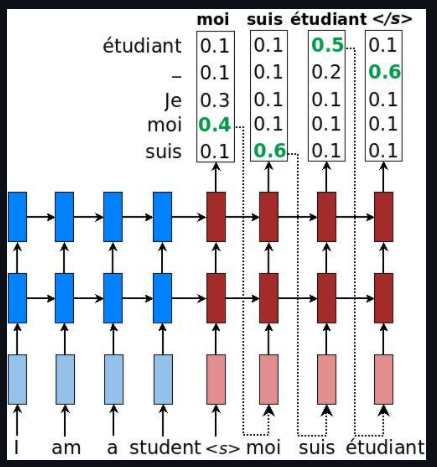

The inference, i.e. translating once the model has been trained, would be a little different. Let's see how below-

Everything is the same except we don't know the target input to be fed to the model when you would be inferring (teacher forcing above).

In this case, the first prediction of \<s\> (moi) is fed as an input of next target word to the model the produce the next translated word. The sequence continues until we hit \</s\> where the translation stops.

Above figure is a type of greedy decoding since we are only looking at the word with the highest probability in the prediction vector. This is very basic seq2seq model. Adding the attention mechanism to it greatly enhances its performance. If you have understood the above architecture, move below to understand **Attention**

#### Let's now start with an Encoder-Decoder translation model **with Bahdanau attention mechanism**

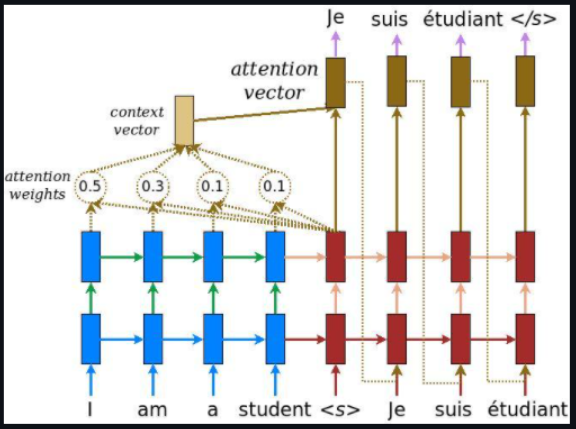

In [51]:
base64_data="iVBORw0KGgoAAAANSUhEUgAAAkAAAAGtCAYAAAD+qMv3AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7L13mB3F1a97/zj3PM895/P3OUeyjQ1OYDAmgzEGDE5gcgYByhJZoJxzJgcJAQIkRFRCOeccR2FGYRRGGk1OO++Z311v9ZS0NRZBgxgG3Gu01Ht3V1fetd5eVd39/3zjWz9QqKGGGmqooYYa6n+ShgAUaqihhhpqqKH+x2kIQKGGGmqooYYa6n+chgAUaqihhhpqqKH+x+lhAPTdH56g8y78Y6ihhhrqf5yei15w6UH9Q8bnw9SHrQ1/pLi+6lq3Lg6WO+Pzkc471lo3H3+44BLXLpltc6TzjrX6fPi0Xfp19vv8ZOofzr/EwnxN+4gvY205D6uDI4T/svTM359/GPRk6mEAdM55FyuUUEIJ5T9RampqVF1drXQ67TSRSBz8zP5MJawP/3UVXwfJZPJgHfj6oOwNIaRDeuQhlUopHo87zcxXQ4jPh08b9f2AfPGdbWZe0Ugk8rXtI5QTrdsmvl4ai2zavOUw6MnUEIBCCSWUUEwYtBm8vXqD5o0Zn1E/wHv9OgrlwqBlGjaUz74OGkpIy6dLHqLRqMsXbdJQ+aA+SJ98+L4Qi8Vcfvjs+what66+rkKdUE7agi1lp8yNrdwhAIUSSiihfIp44+XBBuPqDZk/5gf7zDBfV8GIeUPvjT31wL6GLDf1TJrUPfkgD1451hDi85AJQJmfvWbmDW2o/H0Z4stOv0B9+f3vo7FICEChhBJKKJ8iGHUGcAwbUxcY3AMHDmjLli3Kzc1VWVnZQRBggCf81xmAKKMvL9vG4Hk5Eow2hJAP0vXlZ0te2Hr48XmirjLz25hg4FiKLzPl9G3E76axTfuFABRKKKGE8iniAcgbssrKSk2fPl2PPvqoxo4d6yAI48ZgT1i2X1fjhlBG6gLDVlVVpZKSEgeB1E1DA5DPB8aVdli6dKnWrFmjoqKi2pBfrPh8eMAhH9RHRUWF2+f7DPVEHZWXlx8Exq8zAFE+D4T8XkpLS1VcXOzaqrFICEChhBJKKJ8i3tD6K1oM3Msvv6zf//736tOnjzZt2uSMmj/O1n/2Chhg8L4ORo+yYMgwbnjBxo8fr7lz5zqjT7kbQjIBCPDYv3+/g9HOnTvrzTffVF5eXm3IQ2Ez2+FYCXF5IARySHfcuHFatGiR8xKSNwAgKytLEyZM0IIFC1z/of6+yL7g8+XL/UWmVVd8fdAXAMJt27Zp1qxZmj17toPAhszLJ0kIQKGEEkoonyLekLBFMWDPPfecfvnLX6p79+7auHGjM34M+t4gAwMFBQXOIO7bt8+d4yGpoQ0A6aGZZUB9Ptj6ff575jGv/hy2wA9GfOrUqWrdurUGDhyowsJCV37CeMNLWL+tG5dXvn+a1D3f7/PgsXjxYj344IPOKzd58mTnAfJ5oN63b9/uPEOAkve+oD4PPt8+Xn88U31Y1MftYRf1oHPLLbdo+PDhzvADABj9SZMmqW3btho2bJjy8/Ndepzv4/24tPxnwvp9Xn1f8mH8Z8JSRgBs9erV2rNnj8uHz3PduBDO8+Lj8cJnH9Yfq6uZx/hMGuSPdpg4caKefPJJjRw50n3PDFs3T58lvbrCPn/+J4WrKyEAhRJKKKF8itQdUIGb559/Xqeffrp69erlAAjj5939TMVgkPEEvPrqqxo9erS7+l+1apUzft4AN4SQjjfQgBlp8xkDzBajwRaY8UY505j476gPz2fvAZoxY4Yef/xxPfXUUw742M9xjvm0fNxefVxsfT4+qT58GQjvlX3khTSAy1deeUUtW7Z03ihADOjx5QUE3njjDXXo0EHz5s1z0zE+PrYoEOXjrZuWL7PPvy878fvpLPbTL9atW6dzzjlHXbp0cd4xD0DTpk3TE088oWeeecblhzR82X16Ph3U1xnH+JxZh/5c0iasj8MrYakTpgMp85QpUxz4+frwcfmtr0u/9fnwn1GfZmZ6nE/5UD77vPswpEV9cJFw55136qOPPnJTgOwn75zH7wXNjIPj7COMLy/7M/NTN6++LJnhCPNJEgJQKKGEEsqnCANp5mCaCUA9e/Z0U2AYUBRPw1tvvaXmzZvrxhtv1G233aabb77ZeQUwRhgBDCADdUMIhsAbPYwMeeS7N4b+M0oYthgS1BsXb4S80eMcDxg7d+500zp4VzBuPh6OZ6bFd2/sMg2aj5vPHyfe2Plz2Pq80BZ42UaMGKG3335b2dnZLl2fP9LftWuXM8KXXXaZC+O9QJnlIjz7fNyZ6usD9fWYWUZfZsqPx+Wss85Sx44dnTeI4+QRb9DChQsdBBMuswxoZvy+rsiPz6c/5veRB9SX0R9jyz7KCAxeccUVrq9SBz7OzLDkgTr19erzRXps+e6Psc+nDWAB+gAOFwCU0Z/Dljzg7QH+77jjDrVv3971FdYBcd6GDRu0fPlyVx+czz6/PgqP6cqVK93vigsG4iZdnzef58x8oj7/Pr9sP0lCAAollFBC+RT5JADq0aOHM3QYFzwPTL8AO3/605/0wgsvuO8YIrwkV199tR577DFnJBnQG0LIN0aCPGOQ9u7d64wNoIZBAh4wZhg18kQ4pkz8glUMiTeYlJFz/doWbwgxtpTdgwDhOB9DhuHdsWOHAwDO9eEwTih5+yRD5eHHb/05pE065IX6x5iuX7/elYtyYkjJC9vNmze7qTE8M3iqMLrki7wQD2F2797tykHcvswoRply4N3y5aOOfNk5j/JRZ3wGcs444wy3FsmDMWHxOhEPynfioU7Zj5GnXTgf5TN5IR3C+fzgSaK8hEdpP9Tn3QMo9ZKTk+Og8IILLnB9lPohHHmmvIRDff0DED4tvrP1YOGPURbqjDRZ80VdtmvXzvVz7/1DiZOwtEenTp3cRcCYMWNc/mkLvHWPPPKI7r33XjVp0sR9HjVqlGs76oM6fOihhxw04UUFliivLx/xkyffHnwmvz7vdX+vHychAIUSSiihfIrUHVAzAQjPggcgBmqmxK677jq98847zihhjIEBpkN69+6tu+66y02LYSAaQjAIGDwMPgYROPvd737njPTFF1+sFi1auHU8HirWrl3rjObgwYOdYfcGhvLNnz9f//jHP5zXy0/vvP/+++4KnykfjDtpYQzfe+89PfDAAw46SIs4b731Vld2zvOG1Rta8vlxQhgPQIT1Bnbr1q3OcJInvC6//vWvXfnYxzHaCWNNvR9//PH64Q9/qFNOOUW/+c1vdN555+nhhx92YIAX45///Keuv/56V0/ewFJ2pszw5t13330uLgCCuiAcZaFMlPHPf/6z8/pQbvoFxhsAoKz0ARZmE5YwnAv8YNSpP6bu8E6deeaZOvfcc9WsWTM3ZUZ9Ag3kgy3ggDeRtU5M6QEPv/3tb3X22We79UUsNKbPAZusUaOcP/nJT3TyySe79Wq0wYABA1zbkT7lRKlXlM+khWbCBXVNmwJ0pMt0Fvkk3RtuuMGt7aGP0/b+HICQsJSF3wjnUtfUI+fRZsQDHP3lL39x/RDwoZy0B+W58MILXb7xYgFSeE/pk6RF/ugXPs9sfV/yefg0CQEolFBCCeVT5JMACBjgqpZ9GC0A5+9//7szQCz+ZI0Mt8xjGPECMfBjkLmabQjBKGAUmZbDK3X77bc7w09euMpu06aNXnzxRWc0MGBA3GmnnebyiLHxRhKjP2fOHJ1//vkOdoABwhMvBgyjjDcJQ0l5r7nmGgcUGDK8XqSJoWdxsDdepInhrVu/dcUbZ4waWwwy+ezXr5/+9re/6e6773ZxoxhkIAjvBIaeMjDtddVVV+mkk05yBrdbt25u0TbeBWCB6RaACA8dXhJfZvIHVBAfZaGd8VAQhnKwH6XseDEAEtr+uOOOc+t9MPrUEQabqSCOUQ94OthP2s8+++zB+sFLxYJy8njttdc6iKY+Ccv26aefdqBEOwIWnNOqVSuXt4suusjFA7DRNvRFoII++q9//cuVmTzTH2knAIj69JoJmD7P5BMowXvD+YDuTTfddLAP0W+AYoAO0PNtxPnUPd4h8oAHFBjEU0Q+gUD6CPWONxRvEukATfwugEzaFzjs2rWrq1fKgFI/rKNiUTkXHtQLvz36FGlTBvoWW/STJASgUEIJJZRPkU8CIH91y753333XXa3+6le/ch4BDCrAg3fhr3/9q7sC9wDRUACEUcJQYKDx+GCI8fIwRYKRYjoIY4Ox9x6gU0891YEdhhRjgnIMQ8Wt/1yNAwEYOgAIuMAwYQhZgwM8/eEPf3B3PHHV79PC4Pm0vLH6JPBBvGHGYHMeWzwjGGUMIhCHUcdrQNyAJlBw//33O8DBqFJ+DDaeGownYcmrn1ahDvBo0HaUi/KSPxQAAqpIi3bGOLPmCUABdskH8bOOhbTx0Hzzm9909c1+8gtMvPbaaw4KyS9Q5qGG81g/xZb4yQveIsAOgGAfwMfUEwBDPi+55BINHTrUQQWeLhY5400BsIAMP8WJJwwvCl5J4qVs5IX4AAYPLL6NUeoYMKPuuHMLwKN9qQP6LV4vQJh8AVJ4bDxMcT5xsg/ooX4AJ/IJ6AAz5N9Pd1F+yoWSLyCbfKF89tNtS5YscfkBeIEhfluXX365g0Dak0cO4GUjbV+mEIBCCSWUUI6BeADyygDvb4MHBjC87MPTgJHDEGH8X3/9dTcNgGLU+A4wMKBjNBpCPAABKExFkT4GGE8GhtAr4TDKGOOf//znDuwAF4yJN2p4FzBgXMFjTCkDAFAXgDgXOBwyZMhBaMCgARuoN7bEy5Y6/STBkJEPlDyuWLHCGWfqGi8EaWD0McgY2/79+ztPBSDm19ZgiIEB2gHDi6HH0FJ24MBPY2FwfVqUD7gCapjWxAPEGhymojDAGHTqljwRD/X60ksv6Tvf+c5BACId6pq2J794i0iD/UAl+eNuLbw9nIvniukzQBlw5m5C6p48cwz4IT9ACPknj0AewApws94H2MTrBzQQnvOoA9Kkvn2b+vrnu28PD/J4efCKAfDESVzkk3qmPKSLEqeHDR8H5eN3AYTSP8gL/YLfBP0HmGSKlfVx1JFfs+Xj9HCGkjf6DtDL74xpMOJhKo0Lij/+8Y8uf0At55EfzgsBKJRQQgnlGMiRAAgPEJ4ejKAHINbScIXK1TgPfcNoeaPPcQwHMICRwVg0hHiDhGcAAGCaiGkXDK6/kudKG8ODQQYgPABhtLxRIu+Ex7PDAl+MLnHz8MErr7zSARBGFoNO3EzV3HPPPc5TAXQx5QFcASkYKeL0huqTAIhj1BXhMIbkESPop32ABQw85WONE+3CtBseFO66Iz3KT54xmOQFiCEPKIYX7wQABMgRlnxhTDlGvoEp0sPbgiGmzZn2Iy2gj3AodcRUzgknnOCmo6hb0qDtgWAAiLyRBuUHJsgPeWM/dUj7MAVGfi699FKXPoBAX8LbQR4JA4xRL8SD94S8AN7UBzAAdOCRAoDwHPk0OQelLj34+O+UmzIA8gAQsEKe6QtM5+LN8wBEO3ho8XXJZ+rtww8/dGUAyqhb+j/5x4PINB9gx3Qaa6sAU6a68DoRJ/F4kPFxAkCUBy8ZQEpb8zujjigf7UHf4nzCoyEAhRJKKKEcA8mEHwZVAIZBGABikOcqln0YHr4zPcIVLsbRu/XxEGB4MSBMvWB0GkIwbAAOXo6+ffs6DwTrfpg+wJDyJOuZM2c6I0UeMTJMgWH0MEreCHGccCxg9QBE3JkAxD4ADw8EUIKxw7Bj6FgLwnkffPDBwSt+4vYAhB5J2O8NNQYaI4fBxFsDjOFlYD0TcaN4HpjuYqqJxbnUOeXAawUAASLUf6aBZdoPY48HhTZjvwcgoBaPBRAEEAJ4eHcAA+L362k4h7bGO0X9MX0FpLD/SABEf6EcLBSnfliTRBjqE9Bh6gmIZHqLMqCAK3FQPuLw4AKQMK1Ev8MzRnkANeoaiPIARHkIj1KXbMkfnykDW/IFBANmgEXTpk0d0JNP4qbfUyf0E/JEmWkT6otzSZeyA1CAMHVNv0L57L1drGeiLzI1jDeHuvDTWOTF/2bIN1OO1A1TeUxvEp51X9QlZQPMSZfycR5xUDchAIUSSiihfE7x4IMysDLo+zVADMoYOowAAzxGh8GZq1xel4Gbn6t4vBZMvzAlwNUqg3RDCHkmb3gJMO5MqWDcmB7iKhyDCjQACRgwDNvPfvYzZ/yYAvOQgJFlYa2f9jsSAAEHpAUEYZDwGDCdAgwCKngvMGAYaIwbBov6/Dj4QTjmDRrpcQ7eCOoXCGI6xNcxgEYe8RJgNGkXwI31JpQHDxhTUbQTZfLgArgCQJQDg+vLTFqsZaGOeKYTHiDKiJeFsPQBPxXIOdQf05snnnjiwfU77K8LQEyV0R7UI/ECFUAj4ehbtAH1yWJnyoP3g/oEKvE84V0iXW/kaRvKxTSdByDAjL7op8Bor0wAQqlXX1bUwwfhyB/lpV45H2DGq8P0GzBEv6ftARripuwADHDEtBnrhQAp4kIpl4ds+gjnsL4KLyF1iafQewepB9qO9gSUqDOAirS5dR44B6JYU0bdAD2c57eULQSgUEIJJZRjIB582DK4MphzNc7dUnhQMF5+oMe4seAVjwEGl8GdxbVczfMZ44VxZqBuCCHPGAZvfDAuGDcggKtub1i4isaQ4uXAs4VXBQPDeRg3PFcsoP7xj3/sppY+DoCoA87xBo+08BQAJRhRrvgxXkAS+fo0I+U9QF4x0MuWLXMeHmCAugZaSNunRdn4TPoYW2ABo4kHiPDea+MBAA8eoMAicTw41BFlJh6m1VgL4+8CYx9Ax9oTvH3ABoafcwBMpp2+/e1vOy+NXwPEsboAxDl4V6j7TE8J3jragvhZBwQ4Az8o3o5MAKI+qJ9MAAK8yBNTToAi/W7QoEGu/Wgb8uOV8z1Y+q1XjhOeeqCtyB9eRG6jxztFfbEOinbgjizyA0T7Ox3JN/VPPJQVmKI+qHvaiPwwXUgdkG/qGZih3/B7wlvJNCZtQp8hXmCaNqBshCN/vh0z1Zftk8AaCQEolFBCCeVTxBsHD0IYNBb4AkAYBDwlGHMUYwQcMLizUJqrfAZvPBBMmeAhwMgRX0MI6WC8WMCMAcMI4RHBWGGU8UCgHMeoABMADQYfjxXeCBTjw3NsfvCDHzgPyJEAiH2kBeABEnhASAeDz7oQ7gpimom4MI6+Xj/JUFHnqDdsGDxAA4MJUDAdAlxhNCkXiueBsvKZ9sA442FgzRDAShuwz6/RIo94IphSo8183pl+wmOFpw+jzj5ggLpivQ0eNLxp1A/pAwIAzXe/+10HBuwnz6RBXWPImfahPoiHfoEni7yRJvBJv8G7wjQaAMQrVAAGFOgGCjI9QNSdByzaDADCowV0ACG0DVORfgEzIEXagCF1Sv2TRz5Tt8Tp+7lXwrD1UEhcTLnRDwA6PFiUCY8N4MYidOqDNFA8nsAbU5SUgUXkeM+oW+qVePBMEj9l4a4uAJLjwCaeIvrlkfJNvvgODKF89vkOASiUUEIJ5XNKpkFg0MUIsHiTh+pxFxLGyLvf/UDsjQpbDAvqwxBfQwlpAgOswQF0MCxdu3TRE2YoWTOCVwQDCVQQFijAAAMLXOEzdcW5GFeu+vEOZU6BsWAWqMEQYmCBD4wwt00DRRg9PEZ4DTDoAAtX8ZnG6rMAEPXn6xJDiZeDfJAfwIJ1TazzIW3yTDmBLowmMIA3BG8CBpqwrLlheguPBMcBOR4qyFSYf66QX4fDrf+UH0DBS4O3yd91RdrUD1BC/VKfPHgQow5skl8ACJj0zwHCmLOPNDmfesYTQjswzUQcTBeyfge4I38ofQ1gApxor0wwIX7Sp679onxAj/h4wCJ5xKsCFJF/6pLzaQOvvo979f3Xf/bq+zN5oi0BLmAPWAEimZIEPDmPdmYhNPVF/wEmmSJkmtXftQbwUB/0P7bkjzLQNn5/Zv7oDz7vfp//ztb/XkMACiWUUEL5nMKAiiHg6hM3PVNHGC0MJgYKo8jAixLOD9iZAzCfiefTBuVjLeQJg4LXBa8E0PNnyzvGhytsruQxXhgqjBpbpitYiMviX8rJHTd8Z/0SHgi8XsAO9cGUD6Dgp8WoH9aB8J1pQNbpMG2DhwUDyZU+niZvvKiTz1IvPhzKeX6qBMOPcac8wA3lAyTIK54d2oJyAa2UlQW95AnPCMCE8ab9gFjqCA8O0IO3i6kj1r+Qd+rAe/oADuqI+AA6ysdUIuHxAvGdOsIDRXhggNvI/Z1R1JEHKQCSOMgTU0GAE9N0gAEQSX0BAUzp4UEkDo5xLnVB+9IO9EnyCLySN+oXrxEeJMpC3ZAG5eE47ezhgbo/Uv1n7vefUd8G1Kv3CjFtB8zxAEjahWOE9W1Ffuln1DceIRR4os8QB+F8vPyGyJ+HL/b7tL182vfPIiEAhRJKKKF8inhDgzHD84Bh5wqdaS1vbBh8/QDur0SPdkD+IoQ8YWwxNHiCuBXZLxRmkTKeBAwU+SbP5J3wGHue8ks4rtAxakAPt/fj2cBoEY6pD45j0PA6EBcGHkPHVBhpsZAWQ05d4ZHBsGUCUH3qifMw/HgJKAf5ArwwxHgcABoPWpQLg0xZyQf5YXqLqRzyirElLs6hzBz3i6gpN54UvzaIPkC8lJ364Bh1RHimyKhn8oKxx0NC3ITF60NY6gUg8rBJeB8H57HuCnDCA0K9kj/yRpq0CfknDvKS2V6UjTzSNt77Ql6Z8iJ+2gHFQwcYER/xEqY+9U/avt7II14foBcAxItI+l4yfxd11feBTCE/Xr9ICQEolFBCCeVThAGaAR/DjVeBO6h4aB0w5A0RYbx6w9QYBCNCXjB0GCsUeMGrgBFkP8d93jFI3rhxnLAedjg38zy+8xnlOOd4D9iR0uK7T490fFqke7RCuTiP9Ormk3zUTYNw7Pf5od34zD5ghHz5YyiffRl8/B7c2BInaRGPj4vvKADi4yYs8ft4OE5a7PP5ykzDh0H5TljCoOzzafl6RPnsz/HhiZtjpEOcPp8+DEq6HK8PaHCeLx/xAINAHzBU3zgbWkIACiWUUEL5FMmEGowbV+d4PjAs7POGlnAM/N7oNgYjQB583tl6yDmS+uOoD88W9QaPfd4YY0TZnxmGY/7cummxz6v/zpZwRyuUi/OOFJff+jA+Pyj58/n253Dcg5DPP9vMsrDNjN/HlRmeLeohBDBg689H+ey/+2OZcWaqD+9hBfVxo/4c8l237lF/3KeFcj5l9eXlWH36Kef5dH08KPGS7ldBQgAKJZRQQvkUyTRQDPb+atsbIa+EI4w3sI0FgHzevZHiM3n1gODLxzFfFsJ4o8l+ykO5/DFfRh+nV8Jz3KfHlnN8Ol59GP/9aOvK593H7fPF1quP26fl8+fznXku+wjj8+/D+e+Z8fn4UR82M5z/7AHIh8tU4vH14+P0x3zeUD5T1/Q34KJuWmz9PtTHWTdNf4wyEQ9x+n316ac+LpS4SIN95JO06xNnQ0sIQKGEEkoonyIYKD/A1x30U2lvHM1gpdJmACIqOFCgkuISVaerzVLXRvIlSSYokH9v9II8/zs4cMx/TyQAgEOQ48P6435/Ikmch4xyEO6Q1yFtdURamXowLPVm2/oYTF82H19mPtG66ZEX2i4zn5nq4/BhUT57TaMWrtrS9Wn7sL78LpyF8fFkahAuyKPf5/OXmT55dOnYfh+Wrc8TynF/Dur38/mTjvn0M+OrT91znq/LIF7bmvK7SDeCfv9ZJASgUEIJJZRPkUzDwaDvDR9GJpEyo1aNwbJtLKmifWXasnaHtmftUTpmhj2FMcBgGkjVmLGrSZlt4BlADWMhMiHBK/v8fm8sM9WVzZUPA21lqK419nYM45+yffGkgRFltvKnbJs24EmZUeT8IA22rC3y6uOyYxYf4Rw0pDn2+QAoszy+XTL3eQ3SPARIPmzd7z7OzHOB2XQCGLEyWn5TVgaaNm3ZTltZU9YHkim8KtYX7ADpAMdue4R06Ecc8/FnHkf9Pn9uZt68+jL640cKg3r4QUnT58lrfYR2o/3pI6mE/Q6qLO4qq1/bpuOWN6sY2jXo72zr18ZfpIQAFEoooYTyGcQbGz+IszXzoki6QrHqMrv6LVe8MKbdy8o0a9RGzX9ji9L7LURZXDXO4FQrZsYzmi5Toqa0FoIah2SWzasMWFSdcFsHLLYrZcrSbjN7qkxWWjmiBkIsDq40+IsoEYma4QNwUKCoyuKqdHWTTlYZKdjZFpdVm4sT42jm+XMBoctrrRzM+8dI3eP+e939/yYcogLiQJxBjhn+KmtPs/WKWlmi6aiiSd4wX6RoVYmqkzUGONbmBn41Br1efBofl2bdfZnf/efM45mSeTwzTN39R9Kjlxolre1j1dYHDPhiJSmV7oyramdSkZ3Wz/cbBFWmFY2UKxIvVcLCxdORoD7q2c5fhIQAFEoooYRSTwGB4ooY2BgARatUvi2iDR/ma+bwHM19dqcOLDfDX2BX9JV2BZ4wU28AEEmXmsEssjMbDwAdUQxO/g2AbDcv8IjbJzN79n9UKTP+iWhEVcUVqiyosnqoVjJhIWuSqk4b9NSUWxRlBkb22QygByCzvFZ/AJABoov1ECg0PiHPaaM/y2u1QZ8BUMQgr8KKUxGXyqsiKi3dr0j5AaVjBn2233mJ7AN95Osn+HQM5g18IxVRFW6r1OJ3N2rBGxuUM8NAcFda1aXVSsdjBsh2YWDtn6yJWJ00rvoIASiUUEIJpZ7iTLgZuWQsoXRJWrsXF2n2s1s0a/B2zRq6XcvHZKtqe1LpMgsXM3hI4gWK2RVxtPEbxhoz+A5YgikwD0CYsFh13Bm/VMoAKGY4VJ7SgZwSbV+dp0SZlTNige2EmrTRQXXEFPixCnBQVQtApgCQxWb6FQAg8lhdoWoreyKVUsIALmrtGY2kVZhXodysvSrZU6xEaYVVUlQxq59oEq8Htfb1EwAvEU+p8kBC25bka9qLyzXrhTVa/uY2lW9KKr4/qVSENUIRA38D4xr7DEy7umwcEgJQKKGEEkp9xcbyZDxpRi+tgg1RrRm3TzMH5Wh6X9P+OZoybJ22zCpQxR7WR1jYhJn6VLUZgupGZAY+Rpi6wethwMIsCTc2Y75S/JkxSxvIJSOmpSntXV+oxe9lmW5RQU5MaWMeC2IFtrPSgIPBj/MmEZ/tB34szkMAZKDVqAGI9opZVZSYpq39LOcGh2kWf5cltWPlAc1+c73WTtuudCFtXaJYstxA0QARkPwaSjpprVZeo4LNVVr1Qa5mP5elKQPXaNZT67V3Ybnie9PGvaZucTjro6zPWL9vTBICUCihhBJKfcWMeHU0bVe7Ndo+u1wLX9yrOYPMGPTbrlkDt2nasGwtf2+vircnlKi0cDHuyGFxa3BuoxYIBW9N7SZtH9Luj0XABi1m2KorUortrdbW2Qc066XNmjtyu3YsrVCq3M4x4FPcTkwBQUnVOAWqLEoPQCyMdVNgAJDtaKSCt67aACipUlcP2PFqA8CaaEyR3VXa9NE+TX86W0ve2K2yzda+lRHFUxFFHQB9TT1ABrnRPGn7/FLNeXGLZg8D+rdoWv8NWv5Wjsq2RFVdZnURS7rF8dwViCexMTVzCEChhBJKKPUVBvNIWuVb49rwXpHmDNml2X13aE6/HM0euFVTB+Vo1ivZ2rG6WFUlESXjwVogZpYasb0PBFtVCyrYLXwgrFsCBGrSGP+EVFajovVRrX47TzOGGPQN36M1EwpVZYaxusziMCMpV147z6gPA+jiPAhAxMr0V2MHIOCPdU/WhpZx8q94VDUlMeWvKNCKUbs0a8B+zXsqX1mTyq3s3CWXNABindTXEICsqdIVUuHGuFa/m6dpgzdpdv+dmtt/t2b02arZz67Xjvn7DZDiqrbfR3XC1OAXByDt3lgkBKBQQgkllPqKGfR0eVS7l+7Xstd2a87gXAc/c/pnafagDfpo4GZNeWmDlkzZqIK8fUonIwYDTAvYuY3X3jtxgIKnw7YBAPHnVgBJKTNs5TEl9ye1beYBzX9uu6b33q2Z/fI1f9Ru7Vhepvh+O7/SNGZ1FE+JZyQ5ACLeg2r/OfgBEvjcOIWcpSyvUbPgcaYvudOtKq7KbRXaPH635g/ZqTm9CjWzT4HmvXBAxVtrVFVRbeENeL+mAJQslbYvNOh/Ca/PZs3uk6u5ffZodr8dmjFsrVa+v0VF2WVuGqwmafCcqnHw75q8kUgIQKGEEkoo9RUzhLHCYm1ftF0bP9itrDGFWv3SHs0dvE5zhq/WqrF7tHJiruZPXqY9uTlKxEsMguJuLXBjByAHPR6ALLMBAPHQPAMgK0N1aUwlm8q06u1tmjUkW7N752tmrwJNG56jBe9sUfn2GiVL7LwIdwMFAOQeIGhxOyPoVcwH4lJxXxqlkDOe+ROxdosbBCXjBn/FCeUuLNSSl3eY8d+hOT3yrQ6KNX1QgdZPSal4nxRNJt2k4ddOrEJK9kS0espOzXhho2YNNejvZ/APBA3M1ayn12vRmLXKXbNHkeKqoP0N/AGgxtTMIQCFEkooodRXjBCixYUq21ak2Ja4Emul3ZPKNPfp1Zrz/ArFt0iVO2uUu3mXCgt2KRorMCMQEQ+Ja8T23gngQzZBkwCADGDw1rC6macHlya0bcFOzRuxVrMHmwHsfUDTuu7T5EGbNXXkSu1dXaHKPUl3h5ibArG6OghAJOA/uPmkxg9ALF8yO26aVGV5mUp2RbRh8n7NGr5d03ts0+weuzSnb6Gm9jugua9Wat9WnoMTQN/XTqxI2zca3E/N1vqJeVrzZr7mD9ulhUP2aOmze7X+3d3aOG27ti7LUeGeAiW5UzAJBNuJjag6QgAKJZRQQqmvYLxTUaMcA4OCGqVypD0zSzXruZWaN2qNItvNtJeaulcblJsxLFdNTdS08a+CxnCnTQP48R4gyzfPconGVbW3TAvfWaIpTy3S9AFZmtVzj2b12q+Zw7L10YvLNH/capVsr1TCQCnpXhuSsDhZQlxbcv8BQGjkkED2WLgei9coGo8qUlGpnFX7Ne/NHZoxfKdmD9ipWb2zNaP3Dk3rv1fjDQSyFparvNCMPhT5dRMrUvH+cpXkVim5WypcFtOil3Zp/lM7tPPDqJLZNUruqVHp3nJVlJQr6V6nklAizpOvG099hAAUSiihhFJvscG8Oi7FE1JptVJmDPYsLNP0l9Zo1qtrlC6wIMZH1dU8NK7c3RqdronYWSz8xevReCXAHRY94/nhj4XAtq1OKVpaqZWzl2va6zP10TPzNGPYes0ZmKs5/XdrzrPZmjlihaaMnKNty3cqUliheKTSqqjK3Tru/T0OfvyXRs4IDoBSPPMnrlg0ovKiKi2Ysl5TRq3VzBezNeepbM0etFGzh2zW9MFZmjBsnWaN2aC9W8uViNrJjbx89RHqIx2xXlFmXX9zRAtHbdWUIauUO9WgN6daiTzrJ8URRarKa9ueV6cYPDci2A0BKJRQQgml3mJQ4F75EFN1JKFYXlrb5pfqIwOgmaM3KnogrWTUBv5quyo248+D4KpreO5NzM5t7ACUMuBJ2BZoYSULABQYvrIDpZo7cY5WT12rfYuKtem9/Zo7JEdLn83Tro8iKlkV0Zw3FmnjvI0qyys0CKgw4xcRD40knq8aAJFJXoGRShYpVlWlfbtKNHvSGq2ZtVf7lie0eXy+pg9ZqaUjslSxLKHd84q0YNwG7VxToli5FfBrCEC8BywWt35dlVTxtgrNeX2NpjyzVDtmlCi528CoHOdozODHADhdaW1v9Yf3sBFVRghAoYQSSij1FAZznuwcT9oVbjxiwJNUzsJyTXxpgya/ukGxEl6+GVcszesTUrUPQeS5N1E7u7EDEG/8ito2bnoIgFLJau3fla+NSzeqeGuJ4tlp5UzK19zhm7T8xd3KnxtXemeNiteXKXfVdpXvK3Dvx+KdYaka4qwDQI1/NtDEcl1Tam25TfGqSm3bdEDZ6wtVvCOuqJU1Z0a+pj21VMtfW61EVkTJ3CrtWVaonSvLVFnEuqnaaL42UqOkAU28ulLJREKFO8o0e8wKTX15iXbMNeDda41aaWHiVYomDALTZYbRPBMJAGo8/T4EoFBCCSUUL4cZqkwLzW1bqPOBmLIf/KkxI5BQIm1GP5ZU/EC1diyu0OSXNmnqqGwlShKqTsTdW8FTaZ4eXK1qgwB9BTxAPPUmwXNvbOsmwqw63F1hqRpVlkVUWlCmVJmVa5+UPaNQc57ZrqUjDyh/mdVTiYUrrVGkMKJEVUwJ3hxfe0s402gBBJnyHCC0QevCt6tXvnv9OGEK0Ix99R6D2JhKimMqL7V2rzDAza/WtrkHNPXZlVr61gYldxrwlMYULUiqNN9qj7el+uhJznch350OZoPeRDrBtOMn5+dYConTJ+OWpGWKdW1MUx3MV4Y64QN+QQMg+kcqqYKdlZr5xkZNfWm9cmYXBwAUsSLasXh1lWI1VYpbv0/ULoRvLBICUCihhBKKl8MGekZ/rFStcXDKZ2+5AgByZr3azHrMPudLuYvLNfXFzZrxyg6lzVAqETNoYArFznCLn318xN94BfCJyQwXJTSj5fJv2UdTKStzKqGapJnrYgOgOUWa9Xyulowq1r51SffWC2dLLSznsZg68CBh2r3yBxBh8IGghjKMpEM7ZBLIYQ1/uLhDoEnC6qTENM2zHd16lupEUqmilLbNL9BHz67T4rE5Su614BHbb6AY49k3QcMHyZAcjz3yXYDPtdlgbQy1krKDhlWW7Mfk55gLmeKJlby41vqrf18bu331+Cpy/9GS1IXBLV4d6wuFOyKa+dp2TX0hx2C45CAAVRs104/cC4Mt3rjtbkxrwkMACiWUUELxwuB8cIDmA9YJa+XVW6zAIhACU8D7nnjdVeJAjXKXlBoAbdLMV7YrXWJGJRENnoJrBs7MoSnen6+KB6jKSsfdW5Z3jKEVPXgxaty0yoy2wVFZWjnz8jXnhWwtfXWf9m2sMuixctoJmPR/01qvD94f7goLvEANaRVJq7YwTr2VP0Ie2FWr5D1t7YYBD7xhVsaEgWBRtbbNK9aUZzZpyZhcpfZY2AhTnTWKW9lSVoNu0TuviLdz3O1kBo5KWCR1AAgwBAmDCUcSbgih7Hh/gB/bkkegDQhy8IaSQfoua8IM6F2/qDC1tjYQLtpRpVmvbte053OUM6PQINDiiFgZrKxMoyZVGXiALJpGdBNYCEChhBJKKAeFwfngAM0HjCMWyivfMRhBIP4PAMjMVtwMXkG1di4t1kcvbdCMUTlKlVaa3QMIzHiaIeHKvtoMwldhETTv6Kq2K3c3ZZfhEQBY0mb40iozo21lK4trx7zdWvDCOq00I3hgY5HZzKhFQBm9m8M00yXkjGut+iptMKHVSDSzPQ+16b8Ju90hAC7hANDBYNrO5wF/RWntmFukqU9v0lIDoOrddswACO9HwgLiKUkbLNQYBNQ4Lwu3BVq9cD4PF3I0ZbtNXXXw1aXXgOJeUltHXXvRdqxZA3ooR5XVWoUpa3rK7LuVKRVX8Y4KzXl1q2Y8v1nbZ+xXMs/aPmL9Jm31ZWHSKrXfSNSxX4Oy7qdICEChhBJKKEcURmpvHG3kdtuM0ds+8s1NgZmhS9sVfcwAaMeyYk1+eYOmvZqjZFml2RKDBecJwP/D9T0GBW9SI7IERxTyCMgcAiDn/THTF1z9l5oxMwNYFlXuvJ1a9PwqrRm1RQUbD7j9bkqF8513gTjwgGBcg7gOqueQBqsOEvKJ+/at07Z1xR0iPABjX1yXMCOfNKNeHNP2+fs09dk1WjY2W9V77JgZ/5pqfD8xq8WgrlKm1UCjyi0A7wiJmHqPi0GVxekgqFYbTDKrw1UJGcFrRT81AHawC/Sg5VYWr9a3gblkUsXbyzX31c0GQBsNgPIMgGx/BMizerC+UK1iC1sVgOMnVHNDSwhAoYQSSihHFEbqTK2VjF3YwgCAqpW28R4A2rasRBNHbNSU13IULzfjkebuFwDIbD3huBUYGMiMs1EKHgAMNOASGGimwsCfuBnFuBlEbumvLksqd+5uLX5utdbWAlA1xt3DDyBV1/uTaXCpGAx+g1UHCZGgT9TrpwnhmSaq/YgXxwAoVRzXtvn7NcUAaOnYHKUzAChh4EddJWqhAYBImwYQVGEKUFk8VrnUr6vj2mpqMKE8vh3YWuLBVJfBnUFOALtope2lLMHan6Tlm2lAFkQVb68MAOiFDdo2Y0+tB8iO8f436wvVwB/PvyL+z1LVDSQhAIUSSiihfFbxtrJWAaCkWS3WewBA0YIaA6BSTRixSZNf36FYRcw9J4g3iCctbMoMm5sGYJ6DOBq1kNHAa4PnB24J/AJMhAT3h1HuVKm0Y26+Fj23SWte2aH8DUx3+AcoBitZ+J+6Oqi1xh51MEGgBhMS84keRcIEdW1nZ5ttd+1o1ZMslrbON+h9dosWjdmtJGuAjGtq2UAxO4HVVAmDJ6bDUlZ73FEWTImhPBkcKK71AhEv2WsooVzAD0r6lgEefZB2LQz0oECPWw5van3ZwhnbuDLabgOgiGa/ulXTXtiorbPyFN9nFYPz0I4zheqmTAEmO8el10gkBKBQQgkllINyZKOI0eaVBimefmtbd4Vu+9ifMMOVtPE+FbGL3vwa5SwtNwDaosmvGgBV2uBvViJJGDuHJR/OwKUsDhZGW0Rps6RJiwBNJCy8fW8MT8tl2i6eMqOXtrzZ5wTfzTT6VSA8z5p3Y0ULpS2zCjX3uRyteHWv8tab4bQyOtij3lCLjzrgNuiElTtmZcSQuscsWoUEqPTli7sTy/Lo2+XQZyYwWbSNtw/oRfGARBU3yN28JE/jX1yl+e9uNeNvRj/OnXPBZGecclslBH3AysvjADg3OOpqwdGHI0MyUasNKfRn16dpB+AVaAHa4gZwPO8nqWjSym5lSNHXDXrizH7hELPPhdsqNPWVjZo2IktZM/cofsDKw6yn6wPc2Za0urP6tN2cT53S3zP7/pfR70MACiWUUEJxwuDrrID7dlDsK+8vSpvhTibMEESjB42iWxBsxxjYqw2AogDQklJNdB6g7YpVRA0GgAgzfhbGWMIthzF7YABEnMGgH4lEXLyNCYB4cGMEw2dGHwPI847iNUlVpqOqtM88zzphZYqXSFvnFmjW81u0+NWdyttQaWWgfNSbqRXFAZCVCYiKpBIqjVXa+SmnlemIYhYfdfllC+3Kbd2Z8FNtBWGqB08Gi4FdWeyTWwOjcsUj5dq0fIc+eHmR5r63XpH9BkspPB7Wnph+a+eEQUKCJUMJQ564AR/9x+IENtCghii/738N3P6u7lHre5Yffy8at/zz9vuYEW0SaKf/WllY+sMSKLyeNdEaA6AyzXh9rWaMWqfNc3MVL7SAGQBETMCjfQggKBWATzzOO8J4ZEBQ5yEAhRJKKKF8KcLg6w1QhtjXpNELg3XcrFjUjHfKRv540gw9r0ewy+F03ExiVbVi+SnlLD6gCSPWatJrmxWrLLewVaYYVovd7AKGoSZuBtTOIU5/NQz8sOV7Y5C4GaNyI7bSRERViUoz5GbUqyusLGVKVVMmM+8YdDcFlKcZL63U/FfXKW9joQFAdaBu+gzDZgbPwkeTBk9Wb6XxMkVqYjL0UXl1pUEWdxl9+eXGAAfwA6Sk3AMc0bTlPW0Wv8aUB1om7XiihjU9xYpVFRsAZeuDEfM1//21iu63Rk5RXxXWRyJKxSw+g2PjPBk7KmnAAAgB1Yf+KDsgRAdB+dxQMEDatR3TtgCQ5dj+x3tVrap4StGI7TPgqa6yPLG23S3xsnxb2XgxbtGO/Zr95mJNGzVfW+ZnKV5UYdFZDFZX1QbN+A15CTDFSierHezT932fR0MACiWUUEL50oTB9wgAZMITbaPRKkWidsWfNMNXU6lEusTG+GKlkqWqjleqJhJTPL9S25fu0pTXVmjKm2uViBbYFXCRA6Vqbntmbihh5sXgJxEziDIjEIvF3OCPekPQGARzWBKPaeuuHE2fMV6jXxmqN17up7Gv9NVbI/vqzRED9ObLwzT6mac1vGNPdbvvUfVu1k4v9uqpsSMGa8yIIRZuqN4cOUxvvPKURo0Yppct/EdT31N5tEhRAypgqKomIlaXNCgA0cRHsLWHAZDBXzwRVXlFqQoL81VScEAV+4tUur9SxfnlKirIU0nhLhXu2qXlU9fqzYHTNHXkEu1fW6CKPDu2f68K9+1Vad4elZuW7ctTeX6BKoutD1XF3StFsPdBVvgf6ImbGmm47REy+IUI9U56KLCCxybwSzFlWVxaptUrVmrU88/r9Wef1VvPP6OxLzytsS+ZWpu+bf3g1cFd1avFI+r+wEN6qkM7vf50b+srgzV6xDN6/ZUhen1UH+sD/a3PPKe33xqtvXv3Oq+nh58QgEIJJZRQvlQJTNGRDA9TIDGDnNLyAyooytWB4m0qLMlWfmGWCg9sUkn+FpXlbVPx9m3asWyzlk5Yq6UfZanowDozIOtVVLJTJUVmBAv2mhE0o7g/T4X5+1VWVuYMgQcgpgIaiwcoYcaoqKpCi5fP14Dej6vJDRer1U3n6sGbzlLrG89Q29vOVqtbzlGLG8/RA/84S/f+5Qzdf/UZanndmWp78+/U5ubf2/E/qMUt56vZLReryU1/1I1/v0Cdn2ypqor9ZvQqFEsY/KR5QB5TJF8CANVpagwwbYCnj3e4JZJRZWWt06iRL+nZQQP0Sv/BGtH/ab04cLheGNJbLw3pphf79VS/B7ur3Q2d1P2uHhrR6Sm9NrCPRgzqrRcH9dBLA5/Uy4Pa6eUhHTX6+YGaM2W8QVCRUvGU3MJn0nWpA75ASNQUCKqTuS9MDgEQE3uB9yfAsYRBe96+3Rr7xsv6++Xn6L4bLrU2vdja9jy1vPkPannL79Xm1jPU5vpfq/lfzlGray5Qi7+fYX3id9bmf9ADt1yi+287Xw/cfoaa3XqWHrjxEt1x49+1aVOWKioqHPhQ3+EUWCihhBLKly6HzNEhMSNVk1IkWqqszSv1xpjn9cprg/TK6AEa9XpfvfZKD70xsqfGvNxHb78wSGOfflajB4/Sq0Ne0+uvdtJrb3TSq6/30+hXB+stuxoeO2Ko3nxpuF0Vj9CcOXOcB8gbAOCnoY3AxwnTH0XlZZo3d6r6dGimVtefo053nK0ut52mLrf/VN3uOVUd7/6p2t15ktrdfZKeuPtEPXnX8epk2653n6LOd5+qDnefbvvO0GN3naO2t1+gG674lR5tdqPipXtVHatQjRnA6iRrqyh7A5bbN7PXWqHuebdVNGpgZhAEAH00ZaJuvP5v+usfz9CdV5yq26/4pW656jTddM1PdMs139dtVx2n2y/9le48/wLdfcF5uv9PvzMYPF53/fUE3XbN8Rb2B7r5yh/p5r/8VPdcf676d3tQRXk7lIxE6wAQIILfzQNQQwFhkC6LsUEfvyrJ+aNSce3atUWvvtRPl5/3E7W29n/83t/qCWv7x+78qekp1r4nWL84Qd1uO1M97rQ+cvvP9eTdP7dw1tb3nqNHmpypx+77udo1OU1tb/md/mYgtWHD+hCAQgkllGMjdQcOvnut+93v81J3/8d9riv+WGaYuvv8fi8ft8+LP34k/axS95wjfT6SHlnYj3FOqrS0QO+//4b+cvU5uvrq03XFFSfrL1ecqL/9+cf65+U/1rV//Imuu/gkXX/RL3Xt+efor+eerasv/7aF+Zau+vNPdPWfLOwfT9I/LjlZV1/4c131p/PVof3jisd5n1LtQtDDAIitV/9/w0ncDFJpRbkWzp2mIZ1bqMOdf9CA+3+jwU1O0bAHTtbgpserf7Mfqk+L76l36++qV6tvqleL/9aAFt/VoOY/0sBmx9nxk9Sn6S/Us+kZ6mDG8M6rT9OTza9Xsniv2Xgz9DGmBC0xnB8NWEBXq75qD31wEOZeXGvtkUyxPiWqiRPf0y03XKE2955vZTxePVqfrG5tDfIe+q66PfxN9Wj7PfVsfop6Nfmt+ln99Ln/FPVo+U31fuh76vHgj9St1Unq0uI0dWr1ez3Z6k/q17WFDuzJVqSizE2Luv4XpG7/sxYHbwyVwt6GENIJlnUz/eUBiCZhnde+vZs1emQv/eNPP9ETD/xWXays3Zv/UD2a/Ui9mv1EfZv/QAOa/kCD7jtVA5qcqn4PHKc+zU9Ur5Y/s3r4jbq3Ol09rc56t/ypOt3zK1131dkOgPB8evhBvwz4DwEolFC+4sKg4QcPtqifTmGLcqXFgkM/2GSGzZyD9+d6zYwD9ed49fsyj3GOj4+t30+aPj5/Tt0w/rxMZZ8P4/f5+DLL4b9zPDMdf17mZ59HvwgzxXHioj75YzrG/uH54TktLOSsrKjSpA/f1Y3/OEePtfyt2j3wU3W872fqdN+J6nzfCerc5ER1ufdkdW3yc3Wxgb7j3b9Ux/tPcNrhvlPUsYmFNe1478/16B2/UbPb/qhu7VuZEWQxdUK8MBTD4967RfrcNePU8mZ/7hgN3kCSqE6pIlqpxfPnaXDn1mp35+nq2/THBj7f1dCmxzkAGmDw06/Vd0y/rX5m9Pu1+Kb6274BZhQHNv+u0wHNfqC+zU62sv9Kd1z9U7VrcYPiZflmXa3NsPO+YA1k+0gK4x4wlyVq9etuWbM6dw96NE3Y95S1SU11RFMnjdEd/7pAj9x9hvq2sLK0+JH6tDTws3L3sXL3bWnlN+Dr3/REg74TDfp+bPVAnXzXjn1f/Zv/xIDgeAOBU9W+1UXq0eFBFezfb33O+mJt3wr6rtWH7Qm0ASvESZAuOeJ/ej17eD5R4f5tbs3XPy/9idrf92v1sHL2NcilnftbO/dv/j3XzoOs3AOb/sja3va3+L7VwY8s3PFO+7UwGLY66HLPyfrXVWdo48b1B9e+Zf52G1pCAAollK+BeMOeCQrurqXaOy1Q7rxgzQlbH5b9mWEyz/FXaHznMwMW+x0wZACGhw6vhKusrDwYPjOcD+vj5LhPg3xVVVW5+H3e/DG/Vqa8vNzFyz6fBx+eNFA+414nPsL4/f6zj9OfjwJASbbUpf25t7ZjE93zWirctqo8qikffKjb/3m2uj14knqbERjc7IcahKFv8e1a/c5Bwx8oxgEYOKT97cq5y72nqO0d56l3x6aWpzJLgxumuQa3ZF09mQHkljEzwjxtD7PU0I4SboaujFVp8bxFGtS5rR696xQz/P+jQS3+r4aYoRv0wAkGQN9RfwOf/r78zb/toAgDONBgaHCLb1j9/I8Zvx8ZJJ5qAHSSHm15g6IVRVS0ex0W2wYrlAnJBfdZ1WKl1a+rZwO+4EnXBn/0U8CkukrTJ43WPdedo3Z3/dKMu5XrKHSQwR91NbDZ99Wr9fHq0Op8dW/fTgUHyhxo8T4tnqjEM3IOARB/DS2kGaAPvwL+5xsAVLR/u8aO7K9rLznO4P3X6kW7N/+WlQ/1fZzfgPV91w++WdsX+C34/k8d/Fhd7z5O113xa23cEAAQv0eXuuvzIQCFEkooRyneqHsYABwyjT7fUeBh+/btdvW10Q0+hOUcwvF937592rJli3bu3OlgAxjhPGDBw4hXDw7+fLZ1w/r4iYvPdc8lLGl4oMnJyXHpFxcXuzg4BwVkcnNzNWvWLK1evVpFRUVuvy8jA6f/7NPwafs42JeZL7+PtF1dMAVlBigEoEMSAlAIQCEA1WoIQKGE0jiFgQNjn2nkM2EEY49HZs2aNRo6dKi6deumkpKSwzwwBQUFmjRpknr16qVRo0apsLDwIBz4OAjn0/EQ4dXvR0kXaPHHfF74nBkH+30a+fn56tGjh/r166dNmzYdPBctLS3VtGnTdPfdd+u5555zMOTz7ePzAMRnr5lQ5PPh8+LP83mNEx9hrT5DAAokBKAQgEIAqtUQgEIJpXEKgwgGHmMO6KB4VlCMO9/379+viRMn6p577tEDDzygvLw85xFCOb5582b1799ft956q55//nnt2bPHTSOhHl6AB+IDnHwabD1IoQxqfPfnEj/n+P2ohx4+Ewd5W7Rokf72t7/poYce0pIlSxyg+TQ4PnfuXPXs2VMzZ850sMS55MmDlAcbnycPYEAOW18PeJd83oiDfe475YjzXGJWX4QAhIQAFAJQCEC1GgJQKKE0TgECWCPD9BbwwFTR7NmznSflwIEDzmPC7dYAxGWXXabbbrvNeXvmzZun7OxsNyX29ttv66677tIf//hH54kBlqZPn37QEwREoMACU2TLli1z56NMS5GOBxyOL1iwwOVh8eLFbspq69atLm98B7aIF/gAZoCbvn376owzztCdd97pPFCUYf369W5ajOPvv/++Xn/9dZdf4CgzT6RJ+hs2bND8+fOdrl271k3pkV+giHTIM2Xy5aa+Vq1apYULF2rV6lXasy/PDB/DfghASAhAIQCFAFSrIQCFEsqXKwwQeDTY+qkdDDzrZqZMmaI333xTI0eO1NNPP+08KXzOyspygDN6tA3i99yj8847T82bN3deHvYBL8AKU09/+tOfdMEFFzhQeuGFF/TSSy+5qTG8JyheIeBizJgxeu211/TGG2/o2WefVZ8+fTR27FgHOXhY8OYANA8//LDat2+vGTNmOHgZNGiQnnjiCbclHsLu2rXL5RsoO/3009WkSRM3TUd4oI38vfrqqy6uRx991KVBmfH4AD/AELBD+i+//LIr0yuvvKLhw4c7qAOKADDqiOOPP/64WrVq5SCL40ypdenSRZ07d9aYcW9rf3GhkmkzfBgko43qagOgmi8QgDqEAMS2IS1+4wcgtg0tIQDV1RCAQgmlEYmf6vLTPnh98Ko888wzbl0P0DJ+/Hhn6PH0dOzYUStWrHCejnfffVf333+/rr76ahcOTwjgg7cGQAIY/vznP+vaa6/V5MmTnQcGAAE2gB+8KePGjXNAwzohPEh4Tt555x3de++9bursvffec4+4X7lypQtz5ZVX6vzzz9eQIUMccABdd9xxh/7+979r2LBhzjPlp+auv/56XXjhhQ5+pk6d6rw05GvHjh0OboCziy++2IGM9/4wvUb5Satp06YaMWKEgy1gEKgB9IAn4sCTBBjdcsstOu2009SmTRu9+OKLDhIBq6uuukpNHrhfy9asVJUZfQDI7KGq03EzhBVmoL4AALq9FoDSpRa/AV2t8Q0B6IuVxgdA3ApPrtAAgBoegUIAqqshAIUSSiMRBofMhbuACVNEeFqaNWvmPDF4e5gK+vDDDx0sDBw40E034WkBaPAKAUFAkQcb4sLLg8fl5ptv1mOPPeY8JhwjDKABaHE+QAHAAEIsTPZ3leGdwbP01FNPOY8O53/wwQf661//6vbj4QFCWHeE9+eaa65xIEXe8OAATDfddJPzAgFlxO29Tnxm3Q9Tc0AKgEUdMHhy/oABA9zaoXbt2jmgovykD/AR54MPPug8UqTDFg/TT3/6UwdITH8RH3kl7DV/+6smT5+qssoyG5jNCLgXVsaVqi537/L6wgAoVVILQAa41tYhAH2xQnKNAoCqefZyAECuvV3OQgBqSAkBKJRQvgLC4OAX9OL92b17t/P8ACSs2WG9DwMKa2vwhJx77rluioppK4w/QMAaH6aAtm3b5sICVGyJCw8QAAKgADaAEQBCmkAOU0SXX365nnzySZcWYMJ5eIlYt4P3CC8PQAGEMBV1xRVXuOkm0gOiWIuD1+Vf//qXiw9vDvDFGh+m3oAvf4s+6VJO1u6w/gePFl4ewjNokj7eJ9IGaoAb1hRxLuAGNN1+++2ufvCKAYHkFYgCpvByERdh8RoxPfiPa6/VlFkzVFZlwJO2euYt3mlukS9VKh0NASgEoBCAQgAKJZRQvgzx3h/ABY8M0zn33XefM+YAAceAD6bDzjnnHLcIGQMPfDAthqcEjwkeEmCBeNiyIBiIIi68O4CKX2PDAIVXBg/JRRddpK5du7q0SZP1M4ADU12sA2ItDunhiQHOmG5j2gvQYKEyQMWdZniGyAfTX4AJ02knnXSS82IBbKTry4rniLVIwNTgwYNdOckT53bv3t2BUadOnRyMeagjD9w2DwABdXjEyANbPFKUE+8ZZSdPH330kW6+5WbdeOvNWrfZACwZs8HYzEDCzEHKAChdZvkJPUAhAIUAFAJQKKGE8qUIgwUKIAALTHN5TwpeGww/U1CtW7d2ULJ8+XJn5IGF3r17u/Cs/8HoA0UeFpiCYnqsRYsWzhsDAGWmhQflkksu0SmnnKI//OEPzoPCmhzSeOSRR9zaH0CFPHAuU0vk64YbbnBwgVeKNIEdpsuAFvLhgQ1v0Te+8Q0HX4T1Xi7iwiPk715jrRD7GCgBpZYtW7p84fECcPB0cS5lY6E2a43atm2rpUuXurVO1BmeMbxcQBoDMPXDYmig7M577taB4kL3AkgAKJ2oUSoZcVNgTIWFABQCUAhAIQCFEkooX4IwWAASQAtenrPOOsstMMYrwmCCZwdjD3jw0MB169Y5A89aGe6++stf/uJgBfDxXhbiY9Ew63s6dOjgPCPExXHCASJMNeH9+cc//uHABc8Sd2dxhxXTWx5wCMuW6SeeNYR3iPVG5IE4mUpjP54oAIV9gBMLn0844QS3+BmI8vkDdigPcMbUFR4mPEnkG9AjLsDorbfectBDfChQBfCRX7xGwA+QSJ2dffbZDrSAQsICTnjHWITdoVNHlUerzDCZ4cMDlAwAKF1jAPRFLoIOAajhCmVCciEA1ZUQgOpqCEChhNKIhMECrwlAwSJeAAhvButkgCCmsgAUpnmYHuKWcYCCKSy8Oxh5YAdgwZsCxPCZW9q5kwtoAJpY48O6GBYtAxyEZTqL6SQWDPvn63AuT5cmLPvIGwrcsNCZO62YmmIfMMOdXUzbAUacQzkALu5WA0wAJ8AGwMKLRJxAETDHWh9gyQMQa41Y+IznBg8QeWFAxQvE3Wms/WFxOOVlH/nEY0Sd8Zn6In3iZDqO6bJnn3/eDD4eH6b+zAQAQKmoUgZAaQOgyjoA1McAaMjnAKAHDYD6OAAqtsE/bumY6TEjgBEO7sHHMMftc8IZpsBoBxDkmeHT9PNIvQHIDD8vQx1knwcb/Axu9i0r83Hq0uR03Xn1z/R4i5sVLSt2BaGIrkBHzHAABOSE18QGGgACWt9ScmZQl188AKFAcn/b9mhznNq3Pk/d2j9uAFRqwEtapZaDKssHuAF0ALsBfoAk1jECrS3r4X9BPQRK+KBu6ifEFwJQpoYAFEoojUgYLLxXBtDB+4HnhrUtLPBlETILgln/g1cDrweeDqa1mApiHQ+3lDMtxYJigIPjABBQwvoejnHrOJ4TPDbAA1NknM/iZdbw8J0pJECFO80I76eUACOfNyDNe2aIB88L3inuzALK2AdwcRs6t8ADOyx4Bt78tBpbzmHqjLDEj3cI6GN90c033+ym4YAe4In1SSympjzc9g4UAjo8BBEo4rZ8zgWkgDK8WKwhYoH466NHq6CoUNF4RLF4VOmUmVwWQRsApQxQKiqi+sjqGgDqDgDZoF9fAOpqAPTQHeerb8dmBgFFZny42ywAIGcIHABhlD0AYRq94T4EQpmaiQSZWl+pHwB9x8HPAKuXwc2+o6FNv2VhrR6anmhl/pXuuvrnatfiVkVLS1whYI9/y7wTPnDA4Yh9i5uyNSixE91zmpzX5OhLyFlBPTYMAA1s/kP1bfE9dWt7nJ5sUwtABSUOgFIqsVJWmgI+Sftu/Y2+YP9TRsvAQaW8Tl2+g78AlrxSN5SuPhICUF0NASiUUBqReADCo8LUEs+/4S4r1tswjcR0GNNYrH1h3QzggwcGEGL9C1NGnENYbp/3d3PxUEIWQQMOeEN4Rg/ggVcF4ACSACOmkLiLjOOs22ERNPHyLB7CMv3FlBLggdeGZ+ywj4GOdFhrw234eIb4DGAxhcadYXinyBceLRZQ88RovDwTJkxwcXEOoMbaH+AFsGJ6jLzgCaLsgBi34gNygB5Tf6RLGcgjU2l4gfjuvVJAFXWFBwzoW7JsqcrKSxTFE2QAlDQAStSUmbEKAGhyLQD1MADqa4P+0KZm6N3gXwsAnxGAutz7U7W980L17tTCAKjETE3S0rH/zQa4a3+MnhlkjDNmEmPEFBjGOTDeh7SxAtAQA6BhTb9tdWR1UAtAd1/9i1oAKrYErJyuwJTVEswsgPuPHZQQ8MmEHwxzYDDrYzOJteEAKDD+fVr8QN3anKAnW19gAPSEmwIDdlMqs7arMvXgEbeSJiwPQTkPAZAvb6ABBnlkCbQWWShiPcTirY0tBKBAQwAKJZRGIgwO/s4o72nBe8Ht7Xh7eNYODzfkdnCgBIjAKwKQMA3GdBcAwR1VrOnhwYDsJy48IsAS4EJcxMP0F54WlDCExfPDrfV4XgiLtwbIwMMClBDOT0EBIEAa+cVjxXEWZZMH8sfCavJA/igH+SJe4mThM+CCkm//dGugC6ADXIiXtIA44MznHXBjiotjHr6oK/LJ9B13h7HPAxDrg5jie87SHmUAtWDRQpWUFSuRZB1UteKpiOLVpWYQiefYAVDnJj9VmzsvVs9OrZVOlTuDE7d2RjHAAE1gFDBsmH8pZsr2SPCTNtuBKcGEHEnrI58PgH5UC0Dfsjqyemh6ggHQLw2ATlW7lkyBFVimrWQpy72DDzO2h2x9oO4vMPOHg09tuNqwRyvUU0MC0KBmP7G+8iN1b32S2re6WD2ebG9QUVHLfRWm3HVoeakBOkAf/oKy2s5arc14bZn9Ido+sy8QpH5CXYcAlKkhAIUSSiMRBge8P4AEUOLvkgISuLsKkABkABW8MSyI5jMQgAIB7EMJzz7OZxACYAjLfs7lM8dIB+jy6RGO80mLsECGj4N8EacHCzw0Pg6Oo3z3aZBvvhMnyj6U84iLeIiPvJCOz7tPg3jZEpayES9KeNLyx70SjmMoZfH7OZc0SaPYtLyyQlXRSsUTMUvL8p6oUjRdbBBEHR5LAPqZWgNAnVtbu5ab2cMMHoIcZ8ycUQgACDCKHjwWmKpgGyiYgCnBhBxJ6yP1B6AfGgD92ADou7UAZHXS9Hh1bXKa7r7mFAOgGwyA9lsB46pJM8UXMU0YbFgpMPBm2QODiAHOVI7V0XoUzk5rOABq9gMNbnqctfmP1bPVyerY0tr8iQ4q2VfpZjlrVGn/WR0AApTfQVAAH35foFbQDBCi7A6A6qj9q6eEAFRXQwAKJZRGIgwOHkY8kHgj7mGGrf/sp8oI5/ezjzhQBh8fB3DgocErYVE++3T9d87LjJd9bD24ZKbDZ46x38fhj/nziIvvfoqP/f44x9jvz+G73+/DcRzlu//s88eWOL3y3Zc9MwzxpEiTMMm4WwNUXmZ1mjBASxQomuKt8cfaA3SRenZqpXSKO4GsTcwEAUAY4OBOMDQwROwLjgE6gaEKtpl/GLHACNbV+sgxBaBmxxkA/cIA6GS1a/UvRcv3mgWvcoAhlVsmI/bZUqymPVE+Bxqs90GtfLXG32t9CsdpDQVA3AU2tOlPrPw/Uu9WJ6lTy4vUq117le6rUA1uG1VY+tayzh1Eoay8Lmd20C2CR/mM4i1DraUdJNpHr/70+ja2pRoC0OEaAlAooTQSYXDAgHtDj9Fm64EBQ453A48Gx3xY1MMEA443+EASUOLBJFMzz+WzT8Orj99Dif/s8+TDoJlQ5PPCZ/aRHx+3j4Ntpvo0MuPPPEac1I2P2+eZrc+LT8vny4fx+3zc1E00ZvVYWWb7DR7j1YoZADEFduzXAJ2iB+88T306NXWLoKtl7WBG3gGOMwYYZowyHhJ/FxgmChAwo8gxvCZub2A0vR/oSGqBg450FGK1+PkBqNk3NbSZGUqMX5NTddc1JxoA/VPRil1WjrJaLbHUbOuAiFvCa7XakNDUeUgoqys3IIC1r7X89bCZ1AaQQ/mo1y8egKyumn1ffVr9RJ1bnKs+7R5X2b5SKwr5L7V0Kw2AyIOlR7mtL3BXYE01njEDRNPgMxo1pV5of/qCneY1BKCjlhCAQgnlKyQMGChGOxMQ/Gdv0FE/oHiD7zXze924+O6B4kif/XcfP+rP8/u9Zn6vm5ZXwANAOVJcqN+f+Z2tjzczjD+G1A3n1YfLPNeF4w4s00TKoCmVsO9WH2agEmkDxpryYwxAP1TXe0/Uw7efpf4d7lZ1bI81UrlSyUrLF8bNDH7aDF+q3Lam1XgL7JgZvmqAwCABrU7zSABggfozg2hmCyMWqNVXxp+V2tXL0QiAUH8Aql0DdBCADPqa/FR3XnO8Hmv5N5UX5Sga2W+AzPOY9hp8ovtNDxiEHrB9BfYZLVQsWmTfiyysfY/Y5yjru5jGLbU6wy92dNKwAPQ96yPf0+Bm31bvFt9Thwd+q75PPKSSvP3W7lFFKrcrUbXXPpcpXlmoSEWe/R54pEOBKsv3KBbZZ9kqVFXFbkWq9hiUU0f7VVW53347Bo0Cgq1vGwHVkwdrhR5ivwmHPvbbJE77FgJQrYYAFEoojUsyBwz/2Q8kdQeTuvuP9Nl//7xSNx4ft4ceBj0PJ3xn6+Wz5uFo8urT/zSxUGZELG9cWbvBn6mouBnEimMKQNwh1e3eE/Tobb/RwCduUXXpFlUW5ihRma90rMTYpsgu9g9IBgeqyrPPZgTNICYMAuIGBMl4iVKJUjOOBgVmNBNxAzSDJx7WGEAQph3zdeiPsh2t1B+ArIwGQUMMfIY1+x8DIDOIBkBdDYDuuPo43X3juZo9fawKC7Zp+vR3NX78KOXmrtTq1TM0depbWrV6lnbm8nypdzRtGi/ezdXSpVP1wYevavPmpdqyZak+mvKW5swZb7BggHiU0vAAxPOQ/lt9W39HXVudoT7tWipr5TLFKgr14ftPa8WSCSor2K5VS2doyuTRyt21RvvzN+mtN57SOquTSOUOTflolObOGav9+9ZYHczThImjtHXrMstppbUsk6cJy7u1vZsXrI/QQ0IAytQQgEIJJZRjJpngg6cK+GHLQNgYhOE3QAUGZVPb4aamjjkA/Ui9HzhF3R44V4OfvFnbV05UQe4qTZ/wppbMnay8bWuVtWyGZpvBz10/V0UGA++9+ZxWLpuufbuzNGfGB5o59T1lb1qprPXLNHH8WK1fv1zxRIUZETwChwDIY1DDAdChByEOMfAZ1uy/awHox+rS5Ge64y/H6c5//UFTJ47Wvr1bDH7e1AfvGwDtXKXlyz7S+A9fse1U7dyxSpMnvaEJ418zANqhhQsm6P33XtamTQu0ceMcO+9lzZr1tgFQcW1uP7s0LADRR3gi9v9V3zbfVtc2Z6hv+5batMoAqKpA77wzREsWvWeQsUXLFn2kCRNeUc72Zdqbt16vjxqsNSumqqI0W5MnvqyZM3gMxDJt2DBN7773rNXFPMtpqWmVtW7UAbB7dlC9JASguhoCUCihhHLMpC4AMf3lp8AagzQYAJkx6GUA1OX+8zS4/a3asXaKDthV/5zp72n54hnK27lRm1fN1fzJb2l31kIV7dmg8e+M1OpVc7R/zyYtnjtJC2aP1/YtK7U1a5mmTB5nBmWZ1WW5GREzgs60BwbMa8MC0PccKAxpfjgAsQbozqtPUKu7r1R21hKVFO1WdvZabcterdKSXO3L26RtOSttu1mlxbu0w0BwW85qRSrztHvXeuVkL9OB/Czt27dWW7fO1Y6dSxWLF9bm9rNLQwPQkKbf0qDm31Dv1t9Wp5a/UZ8nWylve7ZS8XIr/2zt27PKLQrftydL27YtV1HJNpWV5Wrz+kU6sHeTmyLbkbNEu6y8ZaWblbd3pQHvDB04kGU5BYAqrd1DAKqPhAAUSiihNIgw2HmvjwcflO+NQRoKgFgE3a3JSXrsrt9rYKe7VZ6/ThVlu5SXl21GbZeqKg6orHCXCgx2IgYG8cp9BgBZKizerUjFPjNI2Soww1heuEOlBTu0e+cGFRbsVDpVafkGgLipPjBhXx4Afc8A6H8MgL6RAUA/113XnKzHm1+nyuI9SkTLlIhXKB4tVjJWYkBQ5qAgGStXKlbhNMn3eKmFYbpvn1sHk7d3jdasmaKsTXOs/zR2ALJ64DlIVge9Wn1fHVv8Tr2feFDFrAFKsdB+t5V5v2WBcpZYeQqUSJUokSxTsqpU6UipahL2OZpv4fYpldir3bkrtGzpJO3du95yyhQgi6Ot3d0i6gAojl5CAKqrIQCFEkoox0Qy4Ye7rfyzh3gGz3+aB4hF0F3uPUlt7zhHfTvfZ4ZtryLxIkVTVYqlLb3quNLVLHCuUI1pdU2VEmaI45aHVNIMIq/OSJihrMrTgb2btWHtAu3dvdk9UJGb5Q8HoFpDRmGOUuoPQN91OqT5f9cBoF/orqt5DtCNipUfUDoeNQhImOGvNNiptDJZP0imbBuoEungezJhfBJRIsIaqHxt2bRIEz58WbNmjrW+U1Sb288uDQtAP9CQB36oAU2/ZwB0nDq1PE+9nnhMRXnFlhweUWvLdJmqkwYDqZi1e5VS1VFrewOauOXEtCZubZowuLW2T1u7b1w3T+PGvqisDYstpzxGwPLOurW0tTMroeslIQDV1RCAQmm0wk/l334ufucRD/5nS+bg4gebj9MjyZGO85kBjG3mXVX+WOZnP+2Fcgs+7w7jSdE8tZlb5TPDI5mfM8WHq6uZxzI/1933ScLRABU+HoAy3wX2eTxAXe77qdrefYG6d3zA6qZIZZFiVabiilSnFTNjljSDnEwZBJkx5D1kkXRMkZqU2cNys9Vm9FNFilXs1YZVczRm9HNavWKOEnFeqmpG5TAA+hI8QC0OAdDQgwD0EwdAdzoAuskAqMigJ2bwY32C147Y5xqAx2y5IxBHIbVqjFKdMBBIEq5YudvXaPGCCVq3epbi9v1opaEBaPADP1Z/q69erU5yD0Ls0e4JAyBrxzStYoCbtnJZ+aq5QcDSTKaTBrOWSzJiTFgdNRjCS5oyMIqXaFv2Ks2e+b52bl9neee2eAvLP6u+ejuAXA8JAShTQwAKpdEKPxv//As3trsdGTtRflDuR8WP2/8d2n2YulB11Z/x1RYGFgDEKxDC1t+B5T+zn6kpvjMwec087s9lP/vw3rD9uIcgsvXx+vN5YjOvr+AdZrzigu+EReum69PyWx/Ox48Sp//s8+8/Z+bXbz9OOML9XwcByP6xpiZtRsq/Df6jY/Q2+M73nqI2d5ynXp2ameEqcZATMwMctbYKjK/lxBlgS7/GymG5cPf6GASl0nhOLE/xQjOkmw2CZitv13orMy/WNGCqNWCBgQd+GhqAvmffv29g+D8GQd9wW54L1PU+AOhkPdbiBoM3g7i0tWfCcC2WkHslhn+csfv9WgYOqtVH0sLwYtpYqUoKd2r/7o0qys9WIsozhI5OiLIhAWhI0x+7O/96tT5RHVpdpO5PPKHC/eXBresAkHvmEbBBO1kfpcVoLpbz8IBEK7d7TlDa8peIWPm3a+eOJSoryba8V7r6qX0+ohvL6if0ENIOeg7/u5yEABRoCEChNBbhZ2LDFu9SdOODW/fn1HZw5WSGzqm7JMKk8VPmB83W/uyH9onq/oLBIHgGb/Aj/SqKhx8GGx6SmPk6CA8PqD/OlBTTU+zza3SYsvLHUM4HeHw4ziUc+9nnj/n0eHUGYVDi4v1bvMT0n//8p3txKd+BoEyIQvEU8YoKH48/nvnUa/b712D4tDnOqzY4Rnjy6Mv7aQDETeS0vvtm/wCgwEhZugZAUzIAqLcB0OB6AhAPQmx7+3nq3aGp2d0Si98gxwwgvS14CjTp1xpmM0L0XSYK0Zj1a17SWp0sVaoqT5HibUpU7rZ2LrHzoxYmreBeMMrCr4XyHL1xofd/HgDCEA5u8Q2rn/9RfzOAne87VXdcfZIe5VUYAJBly2x6kD1nvfkRu1+2ae2jCEwxyEAg3q1EvFSbNy7VpA9e1/yZ4w2Iyizs0QnJUc+Ur2EACOP/fQOg4w2Azlf39u3cy1B5G3xSPAU8YukCvAEAgSK0VqDkhqdFW8sD8ImYstbP1zvvDFRW1jQ7VmrVZrVEXRoIWZT1FNIMxrwQgAINASiURin8TAKsCYxVYCwAHhvMGFFRPvNcDPspBz9qpgW4hrbBxC0c9Mr3zH0MqKWmXFmWWHg+44dv+B/nsRAGGAAAcOHlo7xlnTejAwyAhX/pKG9mX7ZsmdauXeveuQU4eE8KAMMLSnlr/Jw5c9xb2LOystx+IISwAAYDGu/z2rp1qwsze/Zs92JUXnZ64AAPt4u5t7nzhnfeTH/hhRfqkUce0aRJk1y8+/btc2FIl3h5Cz3pLliwwClTZsQD2JB33hbPFJo/tmPHDgdTfJ43b57LI/khTsrhy/NxwlD8VQCguLVpKm11HilQ1uo5Gv3yAK1YNMnqLN/iMEi0sF9nANpiADT5w9FaMOs/E4A2bVigd98dpE2bptuxEIA+j4QAFMpXUPipAjQM84GBkA2QgcGoVQYvA6BDP2g++3CZmnEO33k5I0/idcpTdzE5wY/0qyjeAwTwTJ06VU2bNtWNN97owATQ8d6SKVOm6OGHH3bTUqzP8V6c9evXuzetDxgwQE899ZTz3HTq1Ent27d3b14HgogDIAGeRo0apf79+2vo0KEaMmSIunTp4mCHN70DP6tWrdLgwYN1+eWX64wzztCDDz6ofv36ufDbtnH7b5kDId5O/9xzz7ljvNl+4MCBLt1Bgwa5OHjxK6BDXLfccouuv/56ly7pdOvWTXfddZd7wzxQBKAx2AJpfP44oZUbOwDxxCRnnG0/62Hytq/WwhnjtH3zYsUThRbH188D5BDIfofVtQAUTIFlqSR/238kAJUWbrPf6Dz7rWy0YwEAues+qtD21E9CAKqrIQCF0kiFgct+PDZw8AAwZxYYIIAbBrNaDX7M7vrR1M7hB8Y02ccpc2qHqf042W//vqrCoILXA6DBW/Lkk0/qggsucKCwa9cu52nhGB4YYOSJJ5446GXB+8K+hx56SGPGjNHy5cudZ+fll1/WrbfeqnvvvVcrV650AMW2V69eLuyLL77ovEyrV6923p2//e1vDrw2b97s4OaDDz7QzTff7PYDZUAWaQFTeXl57jieIfI6fvx4B1akS7x/+tOfNHz4cG3ZssXln3zdcMMNOuuss9SyZUu98847Dsx69Oih0aNHOwDyU2BfCwCyvhgYZ0OcZKniZbtUkrdRVSXbzT6W2vlf3ykwD0A7t611z0Jat2LufyQA7chZodmzXtHOnQvsWK0HyKou9AAdvYQAFMpXUBgoeGlgAEDu5YEM+e5R8LUDiSmvNWA4QTEGjmX4oTFQOLVwR1Q7ZgMKNgi1U7+ywgADAAEBu3fv1gsvvOCmnvD2MFUF/OC9AUTw6uCJAUSYEuvbt68uu+wytwVS8CIBKO+//76uu+46XXHFFQ6c2Ne9e3cHIoQFhvAu4UFiSqpjx47q06ePi5M1PUANHhqgiDxkrt1huqx169bu+Ouvv+68URwnbbxW5513njsOYJHGtGnTdNttt7n9eKiY9gKMmM7zeabsgA/6VZ8Ci9puD0DJWJH25KzUvGljlZO10ADv6+kB8gD072uAPvzPnAKrXQMUToF9fgkBKJSvoDBQMMQfAXwc2NgPqlb9wIAGQMQfP2+MSqJWA5PBnTgpjA132tglFYaIn2fD/yyPnTCoMAWG9wPPDt4Vpp+AFTw0TDkBRiNHjnRTR3hs8NLMmDFDV155pfO44GXB48IaItYBMR127bXXqk2bNi4OwOSvf/2rgyLixyPk1wYBV6w7wnsEsKBMk91+++1uug1YIRyDIWHHjRvnwApPEh4roIi8A0HAEd6rO+64w4EXcDNx4kSXF9Jnaoy0fVycQ9zeA8T2kwZZ2rpBAeiOTACyfFr/xNx9mgeINUDp6rgS0UJtz1qsSe++rI2rZlm5CyyOr98aIIdAGVNgebs3acOqudq2acV/JADt3bVeK5a/Y79T3gWW6QGyYEffzLUSpH04ANn3EIACDQEolMYjDBAMFLWDhvvx2F77LdkYplTCjiTNACQMc2Jm/KIGNvZjSyZjiqfMMKfNSKSrTM1ApitMyxVNlimSKLNtpWnEPlu4VEqxpA0FBk9fVWGA8QCE94W1NcDPpZde6rw+wA4wAfywvodpKoCI9TOnnHKKC9e7d2/3nakn7tpiWgxvEeezrodj559/vpo1a+amqhjYABe2AAifUT4DYazjYQqNtT2s5cErQ1g+s87nkksucZ4k4Ij9/m4vgOh3v/ud8w6xyJnwTHP95S9/0X333edgjnJSXsrty+6/f9ogy1DcYADU5BQ96AEoXWrG1vqopY25+yQAcmplSaVjSsVLVHog2yBooQrzsqx/F38tPUB1ASg/b6uys5Zqz/Z1XxMA4o3+lJ+cBQDEJ7rqkQAo39p6w/qJ9ltaZceOPQAd+gsB6OCXEIBCaUziBge0dtxwaoNAKl6jytK4ivNLVJCXrwO796hgd66K9uy077u0f/9u5eWju5R3YKfpDtPt2rMvx3S79u7L1d683dqTt095eaxJ4S4ivEwN/+M8FgJceAVC1q1bp8cee0y//e1v3ZoavCYsMH700Ued9wZIYtoK6PnWt76lq6++Wq1atXJrg9q1a+cAaMSIEc6rQ1iAhukvAAh4YS0P6QAjfloLeAFigBPW5DAlhgfo7bffdnGwn+MAT5MmTZzniak6f1cYnhzu5sIr9Ytf/EKPP/64WwDNommmvVhLxJofAMtDT33ai6G4oQCoKwB05/nq3bF+AMRt8OlEiSoKt2nX1qUqyd+sZMoA6Gu8BujgXWBZy/TR+De0cPaErzYA2YVVIhOAXM4+HYC4C+y99wbbxcqxmwIj/cD7k7T/k+5//kIAqtUQgEJpTHIQerza2FljY1m8KmlXhns0feIkzZr4oeZMfEfzJo3V/Elvac6ktzXjo/c1/aMPNH3Ke6bvmI4zfbtW37Vj72va5AmaaudPfH+iJr0/WYUHCp1R/SoKgwqDjPey4N159dVXdfLJJzugATRYzMwanU2bNrlpIsL07NlT3/72t523BthgnQ8Qwvogbk8HfIgPLwzeoD/+8Y9uETRxsB/4ITyQwj4giP2szcGDxPofHoZIXCjAxHqfO++80wEN02TEDRwRF9NvQBl3jgFgrCfCI4TnirvAxo4d6/Luy/q1BiA7hkeEKbAt6+brrVFDtHrpFKvfA1/LKTAPQN4DlLNlpWbZ73bZgqn/kQCUvWmxJk18RtnZs+xYCECfR0IACuUrKfxW+O24cdNrqkblRWVaOHOG7r/1X+rxWDP1fryJ+j5+hwa2u039n7xNvZ+8XT3b36aeHW4xvUk9O95ger162bZ3p1vMIN2h3h3uUfd29+qJlrfqxmsu0tastUqaIf4qCoMKQAAcoKyRmTVrlo4//ngHLcAGHhWe2QOEEAa4AYx+/vOfO6hhMTEww/odFi1zPlNpgAn7mMq6+OKL3V1bfl0RcbAYmtvUWVjtvTkffvihm8Jq27atpk+f7oDo3XffdWkANcRBnnhCNJ4o4gK+Jk+erGuuucbd6eWnv3j+D3eL4TViHRIeIMrqB9WjFc5q7ADk7gKzcABBKl6s/bnrtGz+h9qVw9vgi/4jpsDKinerOD9HlcW7/iMBqKJkp/2elqiycrMdCwCIevw8t8GHAPTvGgJQKI1WbOw4qG6g4HPKDHzhPi2YMV6dH75bK6a/po1zX9Gm2c9r06xhth2krHkDtHFBX9M+2riwp2l3067aOL+bNs7roU0L+mvzwiFaN2uIZo/togfv+IO2ZS0xAOIJLF89YVBhkMGD5afBgI3f/OY3OuGEE9zzc4ALQAb4IRwLiBctWuRuVedpzdyNxdQW02XcPg+kcLs501d4drgj66abbnJxvfbaa+5OLCCF5/LwDCA8SIAX8TLNds899zgvEF4bnhXUokULB0v+IYnEA+hwhxdxcc7dd9/tPFUswvYwxoLt5s2bu7iAJQ9AgFl9IIgzGjsAcRdY3I67KaFkmdJVeUqU71QyssfKbEb1azwFdtADtHmlZjoP0JTQAxR6gD6XhAAUyldS+LkyNKI2VLmBoiZdpbKinVo08211e+RmrZr+nLJmD1P2nAHKnd9fu0x3zkP7aef83qY9tXNBd9Nu9rm7ts/tYdpHO+YO0papAzV75OPqcPt5yt24VKmvKAAhHoJQppSAhfvvv9/BAxDBlBdgBAABEAxMeHDwqnTo0MF5WIAPPEU8A4j1P34KjPU5wAj7uDsMcAFouMOLBcpAE/H7u8L4jHcJoAGEWFPEYmpACkjiOGAEZAFPLKxmbRF3orF+ibRIl7BMoTEFxiLsTIAjrf8EAGIKLHv9Ar37xtNau2ya1cvX8y4wD0B+DdCm9Us0/p1RmjPtvf9IANq4dp7GjulnFyVT7FgGANmWc+ojIQD9u4YAFEqjFQaqAIDsytCGfG6Jr05HVVq4Rwumj1PXR27U6pnDlLNwsHbM72Pw01O7DXp2Lehbq+zrZduept0MkLqa9jA4MjCaO1DbZg3T/NGd9ORtF2rnxmVfGwBCgRbu1lq9epWBTL6isaiBD/BgAx63/6d5bk7MoKRUa9eu1rz5czVr9iw7Z4lbi1NSWqZEyobKdLWi8ZQisYQKi0u0ectWLVy0RHPmztPyFSsNtHiGT8SAhNdb2KCajqkiUqqt2zZr/sK5mj13llauXqn8gnylLO1EysxBRZl2792lNWtXWrpzNG/2PK1cvEZ5O/MVqzBIiGIErNUjCe3dlaes9VnauX2HYkAPU30JC8PbtN2AHpiUz6w2/qKYHZTx2PUxIMiMY6SsQtM+eFt3X3umerQ9Vb0Z4JsZANhg37+lqW0BAozBIDs2qNm3bYsG+wYAP2YI+jY7Xp3uPVUP3nG++tTeBs9LT+nTh0y/GX8Ms8Me+jjGyXq55SlhmeRJ0MlokXK3LNP0Ca9py/p51mbH9jlAZv5VbgC0aME8DejSUo/c+TP1amaGrtl/G/h9T4Oa/tDK+y0rN/odK19QzoEGhQMN8ij/4Ob/7QConwOgnxkAnajHW15vbVloZTYAMOZJUs9Wdh5lcSQAcgiUMQVWuH+bcnNWK3/3pnoBkK8RHovBIzQcAAE7lr4xRO0zUPnN2DG7qJoxcbSaXPsHPXHnr63MP7FyWbkNbvq1/I7pt526tvcG32AH+BlgEEi4IU3tu9VV75anqlOLy9TT4L4wv8J+D7Ru3Noq4VrXX8z5vufU1UWVfTBAs99btfXvwvwt2rplmkH/WjtmAERe7bT6e4DsPEuHhzAAm3yi7zgUszoo2mcANKKPrrvkh+rU5DT1avpjAxzrAw5uDXYc9ALCKL8F+gMQxDEgib5hUNz8h+p8z0907ZUhAIUSyucSfisMYIeeCG1GwgxgaUGRFkyboM4P36TVswcre1Ff7VjQwwFQrgHPjoW9tN10x0IDnQW9lGvHchd2086FXUy7urDbF/TX1jlDNWdMdz1y+6XanrX8KzsF5sUPMB6GAo8MYMLUgg13NvgfrsAQIATAVCpiGotFlEia4bXzMVooxhiNGRDFEkkLF1NVJGpQZQN7kjhIz9TiS9fY+ekKRRNlqjLDVRktN3iqsn0MvAy4QBCPKqiyMHbMjkcrIoqXJJSutIGy9qHfMEGNkUAqasATNbCKJ13bM1hTHvccJ4uNZ4FjxAMNrvp9vusqRo81FHYK9sApG2eCMZTAXmmxZn74mu7756/Vp/VvnFEfYAagb0vTVhjC79rAD/zwlvjvaGjTb2oosOAgAC/J99S3xU/Uq/nJ6nDv6Xrw9gvUDwCKF1niBvGunuyjpYsRCkoQPOvKGWird/KZYFt7F1hVyU7l565RRVG2QeyxvQuM+iq19lmwcLoGdLvfAOh09W52ggO6Qc3MuDX7Hys/3p1vqZ+Vt59B0QAz9oPu/7GG3Gd6v4Vrypvgv6k+Bg2dmvxUd159vNq1uM7qcn/gbbRsRSwd8suzcAL4ORyAnFE24PMAtCd3o9Ysn6XsjUvrBUCINamrz+B9gZmG31K2PAEU1pmsEiKaOX607v/nuWp/25kaet/JGmwQRFv2bv0/6tXmv6wv/Jf6tfpvB4O0/SAAqNkP1M8AqJ+FG2yAMLDpj6wOzlSXZn9X7yc6qmg/vwW6tPUrSz1ueUi5tgbGLF9kzfIRAJHVEN5Aa3wAaE/uWi1dMlZ79y62Y8Cz7bfwafuvfhBBPTOO4u3E10hbBNmosQujwj1bNPal7vrXpd9WxyanWDmsfC3+j5Xr/9OQ5v/XyvzfVh/fst/Bd9SnFfpt6+dWH83/y+oB/Yb6Wx/oa3XT4Z4fGQD9Shs3hgAUSij1FjdG2H8egPAEpW2AKD1QpgXTpxgA3azVcwZpy8KeBjXdnbdnp+m2hT2Us6iHbQ2CDIB2GvDsBIAWdTEo6mxw1E05C/tp05whmjWmh12lX6ZtWSu+8gB0ZGHAYQD67IpBCq7JD/3xzWtw3YhRCdQbNAZ211Z4U9x6DjM3ZvACr1QwgLvP7HPHLDwgY5YIkEqYsTyoeKhQAA21+GJO42ZMDKBMeagl0yZpO54GjA6q5dgMW9qAJlOrTWuwepamgw0rR1CawCDStyoKizT93dd0/z/OVrcHzjEA+oVd3QbGEEPnpn2a/0CDzUAMbfodDTMAGmYGYKgZicEt/ssM5DedUezd/DgzJD93ANS/fTNVxwIAIiFsAGlijJP0aSsL3k3npSCvdtwDEIugD+zeoJWLJmrP9pXHfBE0AFQeq9TChR9pYLd79dhdBn7NfqYBDzC1Y8bejNoAM+79ubo3wGFqb2BTwOfHGnbfjzT0gW8bLPyP1QnG70fq3ORnuufqE9W+xb8UK95nRTZ4tWxFTLm1/5MAKHMK7PM+CTqoEvuPTkdfc/DBtE/QY53xd1mx/xIA0BsGQOepw61naniTkzXkMAD6v+pj2q/VN5y3Y3Cz71qZf2B1UwtABgWDWnzDIPD76tP8DHVt9lf1eaKdiveXWz8OXuTD6GUls/T5bVgOyIAlfTgA2X4HQAltWr+g9knQU+1YsQtPUT4fAEVN6Wv8/qwf0mVcHSRVtDdb74zspRsu+7463vtTK8ePrS9/w/XpIcA9HkCD/74trYytfmDKbwHPz/9YPdhxA+WBzewCoTnn13qAQgAKJZT6SwhAx0IYcI5WGSwxTrW+FTd1EKgz0tYOR1R33M6zNjv4tG4G+SMpx2rbF7MQscE5UP6iqqqjldYHvFaYAkHVvMjWIOGQAhio5SWFWn7qarUdt7N5xQrX5RhFPEkpy1QsHlde7g69PWKY7rz6DHVqco6BzK/sSvgkG+h/bIP8j8zwoQYAth3aFAj6tvMADbEr4cEt/q8GtgSC/tsMwXcMBk40ADpf/do3NwAyI0a+DgIQhtj5w+z/IwCQBQIIeBVGzsZFev+tZ7RuxQwzKMd4DZDVf2WsXEsWTtLgrveq3V1nqE/T09T//uPsqh/vl0GPlb1/8+MNfk4wI3+iBjU9wQHCUIOAIW4KLJgC6WfQ16XJLwyATlbH5jcoWbRfNXEztmbXmQpKUXbndgFB0MMBKNMDlLt9vZYtnKKNq+d/DgBC6WiZABR4gA4BkB13APSm7rv2PLW/7QwNv+94184AUJ/W33IQ1LfV/zjvD/AzhHI3/aH1hx8aAP3AeUUGtPo/9vmb6tXydHVucbn6tG+r4vyCwHNqyQQeIHo60E/Ht538DsgHH6w/ZgJQ7rZVmjf3NeXm8i6wYwxAVvDDASitorwdGjeir66/7Cdqf+8v1bPZyQa0TO99z/oB06DWB1r8RH1bHGflRQ2QbH+wBgplStSg0fpI53tONgD6bTgFFkoon0e8gQwBqIHFjcpUvo2On6YHiYbvrsECta+H6SGbV6tBOAZjTEPc0CbQKtOIAUDU1EyGQUDCwCBhRixhYeO1mjStSXuw8cDzcWpwgTo4sjY2gKixtNKmvKKAKSWgojJyQBvWztGQ3i30z8t+oK6tfqWerW3Qb4Xh+4GGPmBG/4HjNcR08APHORAa5DwB3zEjwXqIb9iV8n+5BcQDDYi6NvmxA6C+HVoad5Va2gaRVu6gegIAAmPo3w6AmAIxAMIm8wRhvGhMgRXuzdL65dOUt3O1jvmToM3oVkVLtXTBJA3pep8ev+ts9W52phmyX5j+TH2anaLeTX9m+nMDo5+r7wOnqv8DP9WAB05wUz4DmuEZ+p76mQHsbWE73fsr3X3Vz9ThgRuUOLDf3dNvzeiKZk1mHw7vDEHu+Y0bAmWuAcrfrt3b1ujAns3HDICCxb+glu224y4/rrJjmjF+jJpce4GeuP231r4/Pji91bvV90zxfHzXIOB7rh8AP4MfYMHvjyzMj9SH423+j3oZKHVvfao6trpUvTs2V3FBnvPkWfGthf0UWAAftnHqfmruy+EAVJSfrezsGSouZg1Qsf0cbb8FcwDkCne0kglAeF8zAMjotGD3Dr35Ql/98+IT9GSTs9X1gV+q+wMnWbsbCFk/6NvsVKd4B/s0w0PE/hPVr+mJ1h9OUr8HTjG1MA/8Qp3uPF3XXvG7EIBCCeXzSAhAX5IwRrnBkYE6U9mXoRaGNvLqzjkIR/bFqxn1g3pwvw32zioaoJhBB0gCrbJBMmrHrC04TjjWaXCuM1a1av2AZ0IBFIe/5BY1w2rnHVJDBTQdqIMii7/aoIc1S+maKouuTFWR3Vq3eoL6dr1NV1/8X+rS5gT1fuSb6tPmf5vh+56G3X+Cht5/khm/k8z4n2SG3wxA8xPsSvk4M4R4A77nvASAkAegNndcYMawtQGQGXErB0bXAxD44wHILXpyZa1x3hLvAapOlipastMM1DpVFOVYFCUO2I4VAPH7qqwq0ZL5kzSoS1M9dNu56nLfH9T9vjPV+d5fq3OTX6tTk9847WKfu91rhvHeX6jHvaeoR5Pj1eO+H1vY49T1vhPV+b7T1O6uM3XHlafpyftvVGx/nhS1wlA8q/KAPOy7+4AeAiCwJHMKLHvTCs2YPFZL5310TAAomJ4Fgvij3LabD/TrZFzTJ4zVPdddqEfv/I2b7uvT8nsGNN9Xj1rt3er7bvqTaS8giG1/g59eLX8UhGn7P+rW5rvq2uY0tW99qXp2ekBFhbutqwI+4C3tFaxBIm2XCdOPA6CtWYs1YfxT2rp1ph2rBSAryuf3AKF4oTIAyH5XBXtyNfqFgfr7xafqsXsu1JP3nqX295xu7f4r6w9nWPueqW73/dba+lemp5v+XN2amFpf6Gp9ots91jfu+a263X2m2t1ypv5x+e8NgDaEABTK10PouKyrOJYdmLjcmpBarSv8QEMA+jKEUZnRuRZAzIA4I2L73K20tBv9wcJhWrzata39Tx2y6sGrfTejFqjfZ4O9wc4h5RbgWq1GbV/aNFUVaLJWE3Ze3M6PW1y1C7W5uj6kGJpM5TgGiKWnrCMyA8SaD+4zd/eamyYszwZUNQkzjJEqFe/eqg9fHag7/nKKnrj3dPVqZVe2LX+sQQ+cqMH3naKB9//UrnTtCtiugns2/5m6tzhV3Vqepm7Nf67u9r1n8xPt6vgn6t38R24xacs7LlHPjm0MgMqtTFZjlvwhAMIfQC6pMw9AVjTbeABKRAqVtXqOXn+pv5YvnKjoMX4SNLfjl5QXa/HC6erXrY1BwLlqfuPv9dDt56rVLWer5a1nqcWtwbbNLWfowZt+qYduPFUP32x660/10K0/04O3nqq2t56u1reeoQeuP0vXXnq62jW/Q4nSQmt+60PAD5xrde1g1nIdKLVA7g8BkPcAudvg3x2ludPfP4YAxHQjdR60QQBApsmkAdA43fmvi9TmbjPkrb9l8PttdTKg6dj2+7b9vrq2/p56sgCYhcDNv6netu3e8rvq3PoH6tDmRxbmJ+rQ8qdq3+r3atfqKvXo3EqFBXsdANFOYG7g/+E3ZImTN0ubj/SEugC0cd18jR3rb4M/NlNgAYnibWQ6uxaAUAOgorw8jRn5nK664Je655/nqOXNZ1sf+J3a3Ha2Wt16jlpbX2h782+t/U/Xgzf8TI/cdKoeuvk0tb3l12pz85mmdvymc+y49Z9rz9U//nyhsrI2OgDKzG/98v75JASgr4HQcTwouM6boYAJ+9ly14UHFa/+nCOd6/dnxpEZD/t4rgxv5eYlmjybhe8+HMczz+c8HydbvqM+XGa6Pl4ejseD73jGy6EwwQAVAtAXLNSzKc8XQa367Tt1jollmqjKhu1AWanjpotME6bBcmQWJPONfYYa1TEbpKNmzNDAw+LW2tRwJ1i5i7OaeA123LN33Ge8MZamKZDlgMt5f8xqMmWVMuOQAoIMimIGEokK211m7OJSrFWWl/KdP9YIVdn/TKexrVBVTakqk4WKVuUrxeLcon1KFucpUZKneEm+4kUHVJq7U5sWzNPLvTrptkvMEDa5TF3uPFM97Eq42x2nqNudJ9lV7knqdC/TBMer3X0n69H7f6HHHjhDjzY5U4/ec6Yev+c3dvV8uto3+YUeuuvXuv+2y9S1fRvLb7mBlv02auuYW/iZkmH9TwBAEAId3tlAt3bE3wa/K3uF5kx5UzkbFxzz2+DBkAoDys3ZWXrrjRfVqd0DerLtrer48O16ou0terztzXqs7Q1q1+ZaM+5/Vds7/qCm156m9k0vU8dWV6t9i2ts/99Nr9OTbW7SE21uU7u292jUi8OUilZYU5rpNwNrxbUs0rkw9v8OQK420oemwMpL9qi0YLsitv18AGQf8AgCV67WqPPaNsABaQpxzvjoQ91+w59123W/U9PbT9X9t/9c9912upre8Vs1u/XXBgS/UOsbTlab644zADxRbUxb3PQzNb3t12piev+tv9D9t5yu+279g1rc+zf1tz5UWFCghDUmSeD5AX743wEPPzqqwzZHAqCK0lwdyF+mqiqeBB14gGyIDQDIFe5ohcrwlwnBGB20SaAVJaVaMGOKtV8TPdHyFnVsfYM6t71OHR68Ue0fvEUdrA90aHG1HrnzPN39lxPV4f4L1anlFWrf8ho92fp605utD9xq+25X51Z3qWenJ7V37143ppPWlykhAH3FhQ7k4cI/CA7loXN8ByR4yBwPuvMvpPRhUCicfagHEs7jfM7h6b08WZfvKJ85h8/Ex7uhZs6cqdatW7un+fLdx8lx4vDn8J24UfZl5gn15xE36fIgPh6mx1OF+e7PTTFoYg8wjM5IhAB0zMXGJQc+VtfUN5pMmmFNWT+orrChsuQwjanUtMxawmCiplgVNUWGF6UGGxUqTRWqPFmmWMr6o/WvRNqgJG1tbkacxacJA5lKM2SRRLnzYCSqrV8kyxU1uIlZG+MTQgOfUa0Hx/p91OKpSvDm/kqL285JlCqeKrOtgUC6wIALPWA2bJ9iiT2KJ9HddnynYsmdlm6uqmLZKqvM0tac6Zo5dbimv9dF09/tqGnvdtLUd7tr6rh+mjJmiMa/MlQj+3TWY7dcp6tPO1E3/u4k3Xr2j3XjGf+tf539v3Xduf9L/zz/f+nvF/4vXXPR/9IVF/y/uvLi/60/X/QtXXnhj3TlBSfaFfTx+sv5P9LVF/xAfz7/h/rzJb9Sl44PGcgY7FndphJmAjFyrl9jlINpiQCAzBLZvwCArC2szpgCS1blKVKcY9vd1l723cIfKwDCOEesniuTCZVWlqnIwLCwcLcKi/bogG33F+5S3v6t2rd3rfbvXKDFU5/T+Fc7ae/mWSrel6WivC2m21S0L1cF+3eb0d5j48NelZUXGuRZLg08UkYZ+D4w/g5u7VtdAMIzk8rwAO3ctlaL503S+pVzjwkAMdWKd9LVOXVvu4LlYZZ2PKHNG9Zo1EtP6cWnB2vkc8/r5ede0ohnR+jV517Va0+P0CsDh+rpDk9q0IPN9ELnx/TW0H56ffhwvTT8Rb30zAsa8Uw/jXy6u155rr/GvDZS82bNtfooVVUlYEdJUdqcFrOEXXsDImSVo4cD0I6clZo96xXt3Dnfjh2bKTCXpu81Vgcubdvtuh2PuKgqV/GBPSo6sMO22aZbVHggRwX521SQt1HZqyfrvZc76Lmed2nZtKeVlzPT9q9Wfn62tbu1/75dKtqbq+I9uSopst+ljQNfNvwgIQB9xSUTftgCNWw9wPDEXrwoKO9j4om5PAjPhweOeBklTwf2L6X04MO5kDr7efcScfCkXr4DOsTFg/F4I/dFF13kXlPAcTw2pMGrEviOEg/fiZc0OJ/4+ewBiHT5TjjS4Am/Xbp00XvvvefeB0WcQFIIQMdSGIT+XQOvHJAc9Cnfr5I8sNAGZWsFM7RH1pgZtajBTcSsCNATAZrs3FQSoLIh3gxLLGZG3Ax+0oFVyj2MMWnhE0nAHRivhXkb3FP0cVNuY+fZRNzhlUpVmgHJV2lJrvXDHOtLZnALs7TPBt3SgjWKFCxV5MACVeXP0/pFr+itlx7RGNM3nm+rUc+00Kinm+u1Z1vojRda6/XnW+r5gbdpYNc/a3D3c01/r0GmA7ufp4HdLrH9V2pgp3+oX7t/qmuLK/QILv3rfq52N5ve8lO1vP4Utb3zdD3e7Ldq1+pX6v7kH/TS0zfq9ZebavaUp7VwxhuaN+1du4r+UAtmfqB5M97RnOlva86sD5W1caXisSqlk4HhrXZeIMwhxsivy7DPGCUzRh6AWBScjBUrd+tyTftw1Bf0IMQAOmsRzL77yaJqVaWTBrURVfAsouhurVv+nsFAK706rLm2rP5I0UozcvGI0gnaHWAztQJwPsiDP8775fj+aQCUOQWWtX6xPhg3UrOnvvu5AMjdjWgDiatfh9aWhtW966dWePpqyvpmeWmRdu3cqu3btmjbjlyD5VxlZ+/SNtPs9Ru1ZdkCTXhliHq0ukEj+j2kTUsmKnfzauVs2absnN3anr1dO7dma1fOTu3duU8H8uwioczqIB54bhyH0b5WE8FUVFDjHwdAG9bO1Ztv9tGGDR/ZsWAKjLD1ByASsrSdWjp0NPJTq8F39sdNLX92kaIavLMRJe1iKBHdq+3rJuvFvk00uMO1mv1eLwPfRXaxsdf6SYUq7XcdtXqMR210iFg9s2avkUgIQF9xocNjKDIBCPgBTpYvX663335bb7zxhntHE2/R5kWWHoJ4+zbvgeI4nhbe8/T++++7F14CRLyDqW/fvu6N4OPHj3fn87oDgATwAYg4/7bbbtO5557rXoo5ceJEGxyytWXLFpcWrzXg7eMjR4506fB2cF56yf7hdpU0Z84cB2EAEh4fIMp7lXgFA++F4nUHvHwTQAKAqqqiGVfKIQDVXxgsGYwOVwbd4Pk5gaYMYPznpPUvHuAWPJHYjGKtGse4x6ZYF7S6AnLMeNg2xSBvwFNtWoPGzCBWxRUrq1SktFTR8hJFK4ptW6Cq0ny3jZTx+YCK9u3Unm2rtDt7vvZkzzOdq73Zc7Q3Z5Z2b5mm9UvfMuM/UGNfba+3X31SY0Y9prGm7776mMaPesSM0oP6cEQbjRp4uwa2u0oDHr9C/R67XH0fvVz9THs/dKl9/5P6P365hnf5q0YOukEjh1+nkU/9UyOe/odefvqfevmpf2nEUzcbJN2nKW930PJpAzX9rcfVpeVZ6tH6N+rW+tfq/sjlGtrrZo17rbVmTXpU48fep+eG/E1vvHy/yvYtUKRwiyoK91nZrLyRclVGSlReVaAKg4QoD4OMGijQn139mcE3yGRa5kgAxHNzDt0GX6ztm5ZowrgXtXH1LPvdH9vb4D0A0fOZIKn1TbjvFZaH0kRUValSu8Jfp4/e66cBT16lpzr/TQumvqjK8r1KxCqUjFteLCLbuGVVwfor8ufhh9u/A9j5pCmwzLvA9u/dYsC3SLk5a+oNQM6ms6VeLQ8egNydh4CPFdSawcZVG0/tt89DOUutn1YYoFfEE6qwcagyYsa91C7wtszRB6OeVNfWF+v5Prdo0/I3rA9vtXNKLVxSlVUpRSrtwiBicUWrFa2qNui1FHmqOVzhmofMUG4PQFZT7LKy1wWg/XuztHbth3ZRutyOHQsPkAl17yCHbaABHKL0JBQE9lu8dwbbiULl716u2R8M1IDHrlSvNhfo+V7/UvaGd62+tqokWaLSdMIgyMptv/1kzOoY4mskEgLQV1zo8N4L5AEILwrvZgJe8KJMmTLFgQnfAaFdu3Y5yOEll7ywkrdx8zZwPDm8g2ncuHEOcHhzd9OmTR2EvPnmm3rrrbf08MMPq0+fPu5VCniFeGHljTfeqNtvv93BEC++5GWbABVABDjxzibeIcW7pwAewAswI+7evXu7l2kCS8DX2rVrHRARz5133uneGQVAbdq0yYEdABSJhAB0bISRl0EXU3e4cpu1e9ow3pZ01H1G8dLE8dxYsKQZCWcoTGsMdqptgKuOWDtUWptUmuE2UK0przRrWSVVVrCYQCovVKwg171fbfX8CVq7cLzWLf7Q9H2tWjBOaxa9pxXzxmnJrDGa/v4zGjfiEb39/B2mtzsdx/aF2zX2+Vs1avC1GtblMvV5/Dz1aXeuuj98tno99gf1eewC9Xn0MvV9DOC5Ui+ZUfrw5bZOx494UB+81Nbpey+21vsvtjFIekjz7Kp106LR2rJqorasMV37gTave7dW39O2jRNUkDvH8r5E2aveUJeHL1W3R8/TS4P/pfdGd9WiWSMNRt7WplXDNXbkLXbsDA3ueoWyFr2qqv0bFC8ttMHfjL5Z1Uh1wq6MmbqrUDReZfWJt8tMDTbOaJLXhgQTfdySHzzl3AMQ0HnwLrBEqcoOZGvHpkUGi1n2+z+2d4Fh+vD24PELPDeBjwIYYmqsLGF5Txcqa914jRreRL1bn6Ehj55jbfagCvavViKabwDEa1bsV2r9I2r0FjfjF0x84iskZrw7eDCw9kcGIML8GwBtWKRdxxSAAtB0Tyy35AMPkPVxG1NieKdjVQYzlSq3jh+x8TZqnT6eKDOozdaKuS/o2V5/U5dWp2tAhws04a2HDOBX23mFitiYXGW/jyq7EIhyYUB8cZYYoNZC1u6ueYACBx4W2EEQbW5frfSfHYBq67E+QoUQSS38AEMB6ATQw/ScoWHtp2APd0hWVW7XBrsQeX3wXRrY9vfq3ew09Wr9W019v6t25y1UQWyfilMRVVqFRm38TsUNNEmnkUgIQF9x8R4gr0DQjh07HNjgQfFvz2ZKafr06c6TgncHKOGFmK+88ooLj0cImAFSACUAacGCBW5tDy+lBFJ4IzjwwwssASY8SeznOF4i0gG+AJlHHnnE7eM4nh1g6K677nLreZjiwkNEPLwQEwgCrvBY+XVBeIlIm2OEddMvNvgEEGSDIVMF9qMNAejzCIMrA26wADJTuSJOpiqtjoEfjHS5DdzcDl5sgLpfVeV5TiN2pR8r26NE2S4lSrYremCT8jbN09q5b2vljNFaPf01bZjzplbPfFUrp43QimkvatHEofrglSc0ctC9GjX0HtO79MrQ2/XyoFs1cvBtprfrxQG3ami3v6vv4xeo/+O/c9rv8bNMf29g8wfbnq/hBhhvPn2HJr7exq7AW2nCaw/Ztq0mjm6nD0Z30vtvdNX4t3pqycyXtGvTJO3e/JH2bJmiXVkfaefGycrNmmIgxvepKty5WEm7mrdCWpWYcmdZihdNlpgtME0UqTp6QGX5m7VkzlgN7ddM777VWasWj9DOrYsMRLIUK1lhUDdQw3tcou5tT1c/g4G3n26pkpwFSpUZDMQiiqXjqqiOqixd6dY4Ra1f8d6pWBxPA2CZNjuE0cEjcQQAsibzAJSOl6h43yZtXj1L+3etNXg6ts8BCsyc/dbcb4wtRjAAIe6aK48WqaR4s2ZOGKDhnf6k/s1P1JBWJ+rpbn/W3OnDVVG0Tkmrs7QZvYTzBDF1hxkFp4jPYqJcdEMUF5ilcUQAAvhqAWhr1nJNnfCmFs2ZeIwAiP4OAFmemGb1MIpalmJJICZm0JNUhY1BURtnY8CfAV7ulqkaN7K5ej/yK/Vo8xP1fOgUPd37cmWtecPGwu2KJGMqT1hd8ZoYOz9uIMd6NV73krRjDgZoHqdkyBKtoV6s9fjqKuZwANq8cZE+eH+oNm+ebscCAKI8n88DZOeRvoOg2jy4XnQIgfHUBXuDUSNhv4sSg7AF43tpmF0MDG5xigY1O059mp2gZ/v+Xes3jFNBZIdK06UG/FXW/lVKxyqsvcHoxiEhAH3FhQ6f6f3BQ4L351//+pceffRRt84GoMCrwl1VAAoeIDwy11xzjXtbN+tyWIMDAOGV6dWrlzZs2OA8R3hhXnzxRbd+CHDq2bOnO75o0SK3jzd5A1q8VZy7wIj7scce00033eTCATbPPvuse6v44MGD3XogIAd44tjNN9/sPEh4hPx6IPIDYPFWcdJm/Y8vIxDEyzWrGQzsV38IgOzneRCAPjIAuskAaGAdAOpdC0A9/x2ADH4OAVDfWgDqrocMgLZ7AApGTFMq/mjU/juiMthkqJWCAT/zz4a2z/hnUdRqIP4bcQRGlamsVIr1M4FWp7gTxwbQVJFdmR1QpGKPu8MELS/dqeLCHLctsu0BM/z79m7Ulk1ztGLJaK1c+oJWLX1eq5c+pzVLntHaJU9p3eKhWjmnjz54rakGd7pMfR47VwPaGah0utgABq/MJer16MXq8/jFGtThjxre7XI93eNPGtbtEg3vfomGdL1QQ7pcpGfNgDzX5woDoWs17uWmev+1x02f0HuvPal3X+uod1/tap97ac6kl7RjwyxV5GepfP8WJUr3KFKYq6iBTGX5TpVX7LC+tFORqAFaIt/0gNOYlTVqxisaY8F+oX1mW6xUIuqMjFkSqzaMkNWRU4A74bwZ+/fs0vzZUzVv9niVl2QrWrlDSYPChEFg/rYZmvb2Yxr0hEFam9PUr/WvNLzdn7Rl/iuKF2cbDJSYMa0yAKo0ACo3iGAhOMa9xsDS+nUsZfnjQoa0AVGmQvwUmLWxZSvTA8Tb4Lesm69xrw2zdphqZTi2U2CBN9CMr1PLC94JM44OSSydyqrd2rRugt549n4NfvgMDW3xQw1t/h31feg0De75d+3NnqhEebbSkSI71SDDACeYVrF4XVxm3D3zsP2MALRt6yoDrPe0cvH0+gPQQaVuMOfe62K/FcuGgx9TFiknrD/EjYgS1iec4gW1tqwq2ao5kwfrqe5XqM/DJ6n/w99R7wd/oIEdztDbo1pq3+4lBkrcYWjjr8FupJq2qbT2K7cSVRrw2u8PsAE8XPnJG5minqzsfHQHDgegnC3LNOWj55WTM9uO1a4BsnM/FwCRtlMSpf5BHcAQUA0AyFrB7aW2XO+M5Sln3bt655l71a/pqRr8wPc0rDlvg/++ej5ytiYZGO05sEaV6UKDv1Lr1+WqNmiv4aGjjURCAPqKiwcgwAB4ACKAkUsvvdStseE7UARUsLYGLw0elSFDhripLW5fx6uCjho1Svfee69bC4RXCE/OLbfc4rw2wBNw065dO+fZwRsEEI0ZM8ZBU1ZWlktrzZo1btrq2muvVfv27R38ADqAEnGSD9ICnpgea9asmYMg4gHSOAYcsV6oTZs2bj9h8VAF5QyUsfMQAGGkAtd16YFyLZgxWZ0fuUGr5/Y3AOpRC0B9DID6OPDJWQgI9bb9vBC1pwOgHQs6afuCzrY/AKCsOYMNgLrpoTv/qO0beOmiDUIGmO6SkAUvuK6dsbRGYLzwW2yG/04YjCnneWUg4wqIeSP39GEbZAxGapIMcpguu0Ksjrn3WsVNedIxww5/wR0zVk7KitpgHCjfcUkH6t+n5W7vrcaDU2F1u1d792YZgK6zdlxjn9frwN5lKt49RyW7Z2n3ZqajRmnh1KcP6oIpT7ntvMnDnM74YIBef66lBnT5k/p1OrtWf1+rZ6t3h7PUq/2Z6t/1D3qqzyV6pt9lbosO73ulhva9XkP73aRnBt2uMa+01fTxPTTNdPqEnpo5sY9pX/veWzMm9NWcjwxe14xRVdFqRUpzTO1qunSHqgzIqkp22ec8xSsKDT7KrAqrrA6pT2cFDGRswAZcrC6pT5RBHEjmHWNxq+uE1Xvc6j1J/Vl9oe4BcIz/Tulb+DuC/e7ZRhZ3Im6gEokqFrX+iJeIBaHxSkUKsrRgcl892+1P6tvyNPW+/2T3tOSBD/1C771wh/KzJxsM7DWIMiOYtvNZQEp7Wjos8GYxOK+D4FlErAE61JlQDGKQN7cGyIyUXwSdt3Otls79QLnZy+z3f2wXQQcxWB8FVqyeXN9FrW5T6QJFIps1Y3I/PdXjKvVufoozgE8bBPVpcYr6PXmRNix81sBvlVnKPIui0l35u4dRWpkdeOBtOPgbse3HAJBDoIwpsJLCne5N8CX52z83ALkvFv/BHy55q82a4xLb4qHjdSjJtLVZqsTGGRvDIvu0b9ccvTf6EfV94hx1b/199Wr9/5l+W30f+ameH3CFsje8bYC80/qYtbnlP850so1VwKPrm/bdDWRkwdJxW6e1FzT235EAqLRwu3blzrPxdoMdCzxAbnixbXBmPSQjbVcBLl3aP9Dgt8D/fKO27GKzaLOmvdtTAx65TH2b/lKDWhr8tPw/6tfqO+rx4Dka0PMOLV35gUqj9ntN2kWWgV9NdbnFD0I1DgkB6CsuwcBondLgAE8PkANYXHXVVXruueccuAAdLExmKgpwYT0N633w7gAugAeQ0b17dzfthOcHTw1eItb2eHBhXVCrVq00cOBAB07oCy+84ECFKTOmrUiDaa0nnnjCeYnIDx4cwhInIMMt8MuWLXPTbyxwJk2mw1gbxDHywtQXniTWIZFH8kD5ACTWALkpMPejrDVu9qOFK5wHaMZEdX70OgOgPtqyCLgxAJrXzwCovwFOHwMcA6EFvCXeoMh5gbqbBlNg2xZ2Vc4iO2/+UM0eawB0xyXatnahGVq7WkuaWbH0a+JszZhG7YecsPqPm7KNmLrH+wffgxXCNlwYnLoFM0kzJsBOokrVMbsa4gowyXNrShSvKrDPPL+mUmWJMrtiLFelDbSRdJViphH7HLWw8VSlomYEWH8QixZbXRRa++WruGSfSkv3q8zAoKx0j8qdF2e7yu0qtfjAWq1e9p7efrOXRr/SQaNefEzvvtVV7736sCaNaqqJI+7Vm0Ov1/AOl6pH6zPVvdUZpmeqV1sW+p6pnm3OqtXfqd/DZ2nok7/TsA6/0VDTIXa1O6jjWRpgENS7wznq2fFcjXrhZi2c210rlg3S8uVDrE/015Llz2vhstFasGyMlq0erz37VtuAaAa72q4MzSAE7naGVa/+OwNxIxbgydpg96bJen/k3Rr0yC81oNmpGnDfz9T//hPVs+V/6ZkeZ2jdosEq379JqcqotTfTtRg/DM3RCWaaF4e62+BTZUpF9ylask3Jqj1mBI/tbfAYPBdHpk0EUrgDqHqX/a6n67nhN6vHY79T39Y/05Bmx+uppjwB+xcGAefpzWfuUcG2j6x+thmglgZeSIvHXTcQJ1nC2+DuLkJrIcTpIQAKPECHAGj71tWaN/MDrVoys34AVC+h3BVW/N3W5MWqKsvR0kXP69nBN6rbw2eqW5sfqqcBUN+2P1TfB09W14dO0IKp3VVRsNrC80DPo6//jwOgbVuXadrUF7Vt2xw7lrkGCLA8+nTqI3jK1i6foLeeb6tnOt2gQQ/9Uf0f+oH6P/pf6vPwDzSw/V80uEczTZk8Urvz1hsAFdtQWWHjW5m1KO3cOCQEoK+4sADa3wHGFoDgeTx4cljPg0eG7wAPi5uBDNYD8RnPC54ZFh7j/XnwwQf1zjvvOA8MU2CdOnVy3hw8O8AH4Vg3BJysW7fOKV4mAIZF0UxxcecYC6nx7ABQxAMIMR22evVqB1JsmfJiQTRTcHicgCY8TgAboNSxY0cHQCziRskveUDxdLk3iNvgcKwAaPdig6BFXZRjIAQAbV0wTDPf6qI2t12o7KwlqjJgiZvRiafMwNgVfMKu3pJ4V+yKLsZ6jmS5IgYlAEzCDATPssFtz+AdKDPofI/b/piiiXJ3Du+bcg8StHPi6XIzZAYDVTbolVu4wlIlDhSY7lNk33bTrYru26iKPStVunOhynct0J4NkzT97Z56vsd1eq7rX0yv0vNdrzS9Qi90/bOe7/InPdvxEj3b4SI90/5CDXvcrswePEMDH/ytDdhnq9uDl6h3uyvVr/016m86sNPfNaz7vzS46z81qMs/NLzH9RrU+R/q8ejlenHAbVoxY5jKd85UbPcSRfdYvexZpoq9K1S+d7XK9q5V0e61bp1MtNyu+ir2KFK1T+Vle1VRuUsV0RyVR7Ntu8Pqc7eqonnuHVspq8fD4eerA0BMYUStfGsWvamRg29RnzZWty1/rYFNT1ffB37q3hc2oMPvNX9KXxWbIUhWWhtbH07jsaqHsQINEtbXnQcoWqStPBX41aFas2yKjvWToP0Vf10AqrG+Wl6RrZdHPq5uXf6i7o+fqz5tf6mBzU/WkOYGQg//QcO6/lXdH71SU94bqJID6xSpNFCLWtntfIc3xOmyZhHjXQJ+gCF31IWozX0AQJTIA9CGNQs07o3nNW3imAYEICrA+ml1keKxUu3bk6WX7UKiT5fr7Ldzhfo//iv1NcPfu9XJGvjY2erzxDl6dsA91j6zlYhaHuvR1h8HQGtXzdaro7rZeDzBjh2L2+DrIdYhFsx+R0umv6SynFnKnveSnut2ptXDDzXtzZu0a+1YbV01XSuWTlXO9rX2W7exMW191n7r7o33jURCAPqKCx2etT9+Ggs4YJqL28i5ZR1vDdNdeIXw0gAgeGHwqgAWeH1YMA0gse6GaS48Qhxn+gr18QJTnTt3dgDEtBi3tANQeG/69evn7hTDuwTgAD/ETfrcxcViaO4aA6ZYjI2nCNBhQTTeIBZXA1x8JhyLtFmMzZojptCIl6k88sEaIPdkYhscjhUA7VhQuwbIwnN809zBmjW2qx6+8xJlrTVDj/cpXa2YgWbMjFcsFbermirFDHjiXNnUGCSmixRJFxi77FVZVa6qKncaAOz4N62s2Kayki3as3uFNmXNVtbGWdq4YZayTHNWT9Hm+e9o55IPlLvsfc19e6Be7n2f6d16qddtGtn3Vr3Q6zq92OufBj3X6BmDnWEdLtWQx8/T0MfOqdVzNfRR9DwNe+wCDX74PL3U+Uq9Ywb67UE3690ht+n9oXdozNPNNOrZhzXi2Uf1wdg+Wrv0Le3JmabcLVPcNm/7DO22rdf9ubNVfmCVUgY2NXjEeJpvtMrUoM3apjqWUKLKgDBi/SWesn7DYtG0IrG0AZ/BohmPRHq/qUGd1VU8WaKkwWO1GfPAunplgOQqEeV745W0Dep7ctfpndF99WyfO/Vi93/quScuUb9mv9LANr/V6wP/ruf6XKehfe7WqqUTVFm2L3juDy9qrYexYgoMLHR36cWKtWPzUk1692VlrZlt9X1sp8D8JKCbGiQKp7bP2ix3z2o9+0I7vTXmCa1cMEBTR9+vpx79nUZ0uEDLJ3TVDjOAzw5opvHjhhgsrHZwFk/iAWAaNzDrrvjQFfNMzrPk4Qc9BEAOgepOge35HFNg9RLLSTXPK7OLlmRCRYV7tGD+W9qwYpx2rBmrKaObqvdDJ+ul7pcrb/XL2rvpTS2YOlL7cje5tWP1aWtOORIAlRb9+xQY1ecAyP4aRqpVUbJLVQc2qro4R7krx+vprhdqcMfTNO+DFirbOVfxot0qK+LBl0U2DiTst85UL9PQdKTGISEAfcUFAMLzAxx4CAJwgCAAg2kp1vwAFf4OK7xEgBBTU0AMU1tsOceH8QuaedaP9zABL0xFsR9wIR0WWfs4SIN9hCNtpt1In3TY548Rzqfl1y0RL+GZMiMcW9YYETfPCCKML188fuw9QNvmddT2WgDatqiv8wDNe7enmwLbtHK5qkpt8GW5R8QgqMqMuxn5eMyMTcyuapNlpgY/0TyVG/Tk7l6l1Sve1+KZz2jJtEG1OlhLpga6cPJAzZ/YX++MeFTDe9yqZ3rf6XRot1v0fK+/GNxcoOd7/t7pkA6/Vi8bWHs9cop6PHiS0z6P/kx9H/+5+rX7hYZ2OUNvPvN3zRj7kGa909m0i2l3zRzX07SPZrzdT7PGDdaGuW+pMHuhirYvV3HOChVtXaYDO1Ypb/ca5e1dp8KCzaqq2Gnl2atoZLfbJpMY672KRfdY/9ob7EsUmPGO2IBrhskUEHVrJExZMBozC+1ud+azacTGbasug8WUhSm3dkIr3bqkhBlEbq1naoQB9ZAy6H81ACiRjGrWrHf02ohemvXBs9oyb4TmjH5IQx85T88amBZsHKesxW8ZZHbQ++88bb+TZfb7KrN6q58RYGbVL4JmyjRWtkvFeRtVVbLDDOCxnQLjbP6cV+Fg8zD9VqWs7KWaNud1ZW+bpMJ9kzT7/cc0rN25GtXjL8qa/6LiZVnaun6ali0eb2PBWlVE94sniCctd/hzwBvHBMQJ7wBCrIc5AgDhAcqcAtuTm6W1K2YpeyNr8xoSgIKbTHjOVUVFmY2R26z+c1S1b6UZfbswfOjXGtXvJlXumK50mZW5YLuiZeU2LtWvD38cAAHcS5eOtXFxiR3LnAKjTo++nesnlqb9fqtjRVJliXLXzNXT1vbDup2r+RPaOS91dWWpEnaBxJidtDEB5udGlQbL4meQEIC+4kKH9/ADTPAZgAFaUPZ7z0nmYmn/Ge8R3z348Nmfx2f/PfM2e5TP7Occn0bQ0YP4fT78cc4hDR+OLWEz0/Lf/WefFt993MT3hawBWtjFTYEFAGTnzRuiuQYST9x3ubKXfqTSnesU3bdFZbvWadOSyZo27ll98Hp/ffh6H00ZN0CTx/XWu6910Huvt9eYEY9o5NB79ULv6/Riz7/W6t/0Yo+/m/7DPv/Tttfq6U5/1aDHr3A6uN1V6v/w5QY6F2hA50vU+8nz1a/jJXrzhTu1YEoXLZnZx7S/Fk4boGWzhtvnp7V8zgtatfAVbVn3vg2KcwxWF5ku1u49S01XaNfu1dpp+d21d7OKSvMMTKyNU3FVWV1WGLzFktYWyUozaBGDk0CT1VXOwKFpM6Z+vzvm9rN419rroFofsT/75O5qijm19jWtsnPKEhWK8N2u4N07wNwzhVAW0tq+dML0SADkDSHfG6/gAcretkwb1s5S/rbVqtixWCsn9dHAR8/X8I5/UmrfGlXu3aRNa+fZYDtT+UXrFY2XWF9mKqk2kqOQzLvAUvFi5e1Yo0Uz39GOzUvsd1J0TD1AeBNcDFyxY2ExsACQtWd+2W7l5q9XaVWWSosXaNaELhpqwPdyz79r/cI3VB0vcJ6K/PwtOmDbsug+6wN2oUCfstw5BKICfFOzxY1xsN0PB6DMKbDNG5Zq4nuvat6MDxoQgKiCGncrPw92jCViisT2KxUrULwox4x+X/V8+Cy9NuheVe5cZMyyR/HyEgOApBur6iNUz5EAKGv9fI17e4Cysg69DNVVJR6g+nSqegp9vzoVpTKUu2GFhtm41rv97+1C4Ekd2GZwahfZSass+jrw454bZiBEPTYWCQHoKy6sAQIOPCBkAoSHGw8uHio8zKCcz9ZDiD+eCR+Z5/j9/hgg42GG75mKp8l7eUjH78/MB9u6+fLx89k/5JEwKPk8+BwgGxyOFQDlLup6cAoMD9CmOYOcB2jwkzfrw5ce0/TRHTRnbBfNfLODxg5/QE91/IcGGrgMfPzPGvTEnzWk/Z814LFL1P+xizWs4+V6rsdf9Xyva/V873/V6vWmN9TqTXqp720a/8qjWvbRIC2dNNC2g7Vk4kDNnTRc86a/pDnTXta8ma9qy4ZpKivaqEq70oxU7rLtHlWW71NFGd42nuhdokpuyU0VqSpd4LQyXaSKdIkqUmUqS1Wo3ICjvCapcqupMhtSS20AOpBMqdIGy4QZHfd0ZxuhUF514dQG3OCuMmsPC+M/J2swX9YGZshQXnp6SFl/ErxgNFaDllt+7CrQ3fobsTaiXWlrD9TBd66srSdnKN+98r3xCs9riST2KRrZp1RZsSK7N2rllEEa+MTFGtzxz4rtyVGqtEyxCjsW365oeofiqVJ311d9zABTYA6AmI6JFipnw0J98NazWr9ihv0uju1t8JwReH/sfNrIlMWv1mqKGiiXJQoUSeOdXa1ZBn2DO1yuF3peq7WL3jVjZ7AdKzHbWKrKeKH1z2LrD2WWL16eSw4td85qWyKfAkD8zjM9QHudB2h2A3uALHuWXZw5cR7smLJxL1motOUnVrRL8yYMUPdHztKrg+839lmtmioDoyprC56CXs8uTPV8sgdosR37chZBI9yJmrJBt9qofGfWGg3qeZ16dTxPMz5sr4LcVUp4ALLfug3dznPmPECN6CcdAtBXXOjwHhrYZn73n9n6z/47YOH3+2Psy9zv4cPvr6sc83Div3vAQT0cZabj4/PxZ+qR9mXu9/l3+xiTbXA4lh6gzCmwLAOgBe/10tNd7lDvthdpwKMXaOBj52tou4v1Uver9dbgmzRu+G1623TM0Nv01pBb9fawOzRmyG2aPKK5Fk3opeXzRmjpgtG1+obpm6ZvacmCMVq+aJxyc+abYcx2Gq/Yplh5jqIVeaqqOKAqg5uqqmJF42Y0UgaR1REzfDHF7Qo/Wm3K1lAj4v6POsPHYmIULwBKeOelsT/DYwtnUOo0qTJuxbb64+KUKzKe1puqndJy66tqB1Wr+uCzG4ypcwwrS7mZzDBoqtVDn2yvSz9ioaJOeUyBm7KhHWvjDgbtQ+1LzIers4imHGu8YrVlf6VWniozenFV7snW8qlDNKDDpRrU5SpF8/apptLCYAiq91n97LJtmRmr+pXMurj1BdoqrlS8REV5m5S1aqb2715nv7lj/CBETnGn2/kYYINoFqZTYh6EiIcvzpv0q7Zo1uTBGtjhCgf6a5dOUIIpTwuTxENIXzTwAYSTDoDoeUcJQBlrgAr2b9PO7FXavyur4QHIqiJ4HlCV9Wm7nMCrWrRHcyYOcE//Hjm4iSL71qmGxzMYLfHgSs6rj1A99K+6AFS4f4u2bJ6qoqLVduzLmgKjhQxsrM3SRuU7Nq3RQGv7Pl0v1oyJHVWWv1GpqLV1yi6gLQzgyGMeeBZU0LEah4QAFMoxEX543sMDpGSC0RchXwQA7Tg4BdZXm+cN0bx3e6h766v1bM/r9cbTd2n0UwY4z96rWe900KaFz2nbsle0bemr2rlyjLYufF3blozR9qVv68DGjxQtMIOUKrCcVdRqpSlGAATBIIAjbuLIlL8AHwIgqVX7zHeeFeM8L0wlmTGJWVxRlZsGb19nEXa1GUQjpUDd5ZZpypTnDVVzxxG3XUetnSJOq92W/ZaQG2k/q1Lvbix2Sv5cnms1CMYXX4hatV2H6UHxO4i1rh4WsFEKBjpt7VpDHcdqVLV/h5ZOH6ze7S/UwK5/UfxAiYGRGXGaoqbAwu6xerP2suLVp3SgAbfBu9eUJA0+indo77blKivYavuO7aswaMbgdDufAgCxFjOGj088aYm+XFW1Q7M/Gq6BHa/S832u17rlHwX9w04lD3iMal+T6xR8thIE/QT7jros8iE4i51B7h3+WHyHpsBytqzU7KnvaPnCaQ0LQKYpy3NQBvypBr4pu/wo2mcA1F/dHvu1Rg69R5X71trvkAsSGwMtFOfVR9xvyVXO4QCUvXmpJk9+Vjk5s+zYl+cB4kIoaW2GV2fHljUa1O8G9ex6gWZM6qDygg1WN4wxADMhaUna0/pRvWvk2EsIQKEcE/EA5KfivHfo0BX+sZVjDUDb5x+6CwwAyl44PFgEfedFWr3wDR3Yu8iuvJarYN8KlRVuVLxih+LluxQr26tUVZHiZYVKlJkBwu1bVq5EFWtrYrVYk6n8MTCiNoA4NcCp1dqR7HB1Bgi1YQQPng2GNWaQWDzMnSk1PJyRG6mCBwcHyoNtUfYzb+Ie4IgVth2WL6UtkAMj2+8g6Gj033eR9cOUcTtT2Uc3OKwr8CXzhCMGatQSGGjrg7QNAJS/TUtm9FevDudpQLcrFSsoVE3EA1Cxhc23vmrARHHrUUzQAA9QmtvgY0XK3rhI777xtNavmK7YMb4N3v1sXfPYfw6AgicDBwAUdC/6dKQyV3MmP6VBHa/UC32u0/rlkw6CcdD8AcQc3tutvug4Ln7UAn8CAOFB9AC0ddNyTZv4lhbPndSgAER94GXhKc5pFVnODD4OAlA/dXv8NI0cdqcB0GprpKjxChc3lJkCHr2Q3pEAaIu1+YcfDNOWLcGrMKg7qrLhAQgPn43xANDmNRrS71/q1fU8zZz0pCrsArAmVWUlB3wTprQjbUrPqV99fBESAlAox0Tw+vg1P34x9VcJgHK4C4ynQVt4jvMgxLnv9NAjd11iA+4slVXtVDSVb8an2K7ASxWzq2/e55NIxRUH+GwQShhoxOLBlmmkwN0LZHyaYlxqlafDpm3Ac2qQ4oDF9lv9MgDaeGqDax0FcoiGhzF6tTw4dU+es3OJA+Ah/mrgx+LHK+Qi9EbnsyhlovItLweV75lqYf5NLZz9c+qEDxbWDfBobdyHAnwlxGrYcm1/Vr6aeFpVBzZr8aze6tXxHPXvfrliZhxrYjbwW/G4A67GXbHTru7koxZYNrgN3vpcvFi7thoMjB+lLevmiTdzH/MpME51bUoH43lNwfQVvYa3uzPNFa3YrXkGQEM6/Fkv9v6HNiwf7849pFY3ThkLDqnrRwfVKoRKyuhnHoD4nSczpsDKinereH+2Kot3NTgABWsP8f4UWN5KrDESihYeMADqawB0qgHQ7QEA2YUgz/vC00t91Udc3dnZdQGovGSn9uUtVmVllh0LPEAMD64P2l9DSQCm1sssXzsNgHjSe58u52vmxPYGQOttf/DE6+ByLwAgxuqgUzUOCQEolM8tDG4AD7fCc8s9t7Cz9sd7gRo9AC0MFkFzF9i2hV3seG9tnjtYM97qrLZ3XKT166epLL7HhqEiRW3Qi6lM0ZoyVRkIRe1qsKq60vZlLAs2qGHAdgBjg4BSvFizVtNopWlFhpYfUktDOmBaYGpXdzbYutctMJWF9QN24BaLmnERtQtNS4+VNsE6n2BijT++cddNxJS1F5UHNa0KGyqJgAEJc/ZZlfAkbuXwGfgEDV4yGTO1AfxgP2DLIIhhyIw7gwrYeG3kQklgPIxeVeE6LZ7dXb06naX+PS5V1IxVTcJ+A65o1Im1PTCRUdSjkcy7wGpS1jfi1ldi+2ybb9Ub3GV1zADIFYwPlllguSZoc6avHIvbbi5w4uV7tGDScA3r8Ce93PsaZS1/LzjHwXFtHP+mdszCBA+7rO2DHwtApHcIgHZtX6/lC6do4+oFDQpALt9W8Br77bjfp9U3U80xG+/cFFi7nxoA3VYLQOSZqW5+a/Tto5ePA6Dc7as1b95r2rVrgR378tYA8codd5FnF1y5WWs1vM8N6tv5Qs2a2FEVBzbaBVjMwnhPt29R/m+4PH6ahAAUyucWBkGeC8SrN0aMGOFee+G9QGijByA77u8C40nQ3AbPFNjscd304B0XK3vtYkXKSpWIGNTFE0rXarXBXZrysbUrwUQsYlsz9gYrwYsf/RD+SRpc4XrlWolrJu849sogwvuIuOI++C4wU3dnVQ1Lj0Ed7sUKVhcBQ8EiZTvOuU6DVIJ3XjEMMRgFC1uPWi3NQInVq4vd/U/MGGCvh4Y9/neWxJRhEeNX68KyUO44QTK1kYuz8xQpUWUAtNIAqIt6dj5D/XterFjZFjMEHngoIx44K3ttUY9WMgGIJ0Hv2LREk3kQ4upZxl/H2ANkpzkI8gDkoLfKxcz0Fo7FGvuQLNujhROHaXj7P2pk76u0afk4O2BldeW0gJQVDbgm0IMAZL8j6oQ+gAfUBQoC+l9I0Hv5jQcAtHHtIr035iXN/GhcwwEQ1Ue+uQhx9WAXKjUGs4m0YgeKNHfCwAwP0FprZvtFOA/QsQeg9avnaPTonnZhNsmOfXm3wTtPHlP01nS5G9fqqd43q1+nizV7QidV5m+2LgC0+hHDZd+VpuFy+OkSAtDXWPgxACA8uJAHEgIpeGTYx4MIeTI0DzxkH+t2eAI0Dy3kAYQ8mJDXZvBqCgCHMKzvwbtDfIQhTj6zj1da8DoLXnnBU6LZz8ML8QT5hy4SJ14i4iVd4iNPxENeeOiif3gj+8nTx/2g6wdA/QyAejsPDyAUABAvQ+VJ0J0OrgHKtv3cBTZzTFc9dMel2r52pRIVUbMB9oP37/2yLYMh0x7uVo+45ZUHhKTYWp6StUbC8no06h08h7TuO5lBJLCGBaXBXVZsA5/PIehxagYmafWSsjp0dog6w6hZdp3aPo8rn1UDlGGg9WrfvLqjwSCHZpYLOxoI7ck3H4Kh0Sv7aoVgXhu5uHq0iq1OVqqiaKWWzOqu3h1/r4HdL1Os3ACI9345g29ldGBgdXioQo5KsL+8CoM1QAdvgx/znNav/AJug6dcZNt1Fnomnj8ri30/CEBmmBPlu7Rg0lAN63CZRvS+2gDo7dpwlNXSplnrqsvSZwMg+l3mXWCF+du0a9sa5e/e3LBTYJZn90wfB4M8UMJAyH7nscIizZswSD0fPU2jhrIGaI31BfsFGozifQ3M/9EL9X8kACrK36rsrdNtbF5jx+osgra/hpJ/B6CbDIAuMgDqXAtAjMu1F0H0F1NXfbXnNwYJAehrLKzLASRGjx7tXlfBS055zxfww2sveN+Wfz8X8MFrLXgLO6+04EWlvNuL7zyZmbU9vAvMH2OLx4c3w/NOL/add955atGihXvFxty5cx3wADSzZs1yr9R47bXXXDhee8GrLjgGOA0dOlQPPfSQe3UHHiTS5ZUYABSG5UjiBiMbHI4egHoaAPV0IBS8Db6HAZCFMfhxAOTfBj+bt8F3NwC6TNs3rrSB1n7lZOXf1H7OTu1LYC3cZ/fW6yMF/wxa11agwbHAHASGwcNI4F9h/6G/IARKHg6q/Yce3OE2R/938ORayYzyk/SQ1D3iS354qK+GWJ7NkPNqimR1hcqL12nZjAEa0O5iDe98jaIV28wwcfedlQ8gMOWZSpjE+pTWAZD1LXcXGM/Y4S6w7StVVphtv/dj/TJU34fogWaAa1D7bJ2IGLm9uaamSvHKHM2bPNg994g1QBtXvGtHgSXKG4Q/LBte3X/0YWrDlPhJx2kmAB0+BbZ/7xZt2bBYu3LWNhgABTk1rOMD0z4GN9UGQKzFipQe0PwJg9X3od/qtcH3qGL/Kmsju7C0uql24EjBj16CaiPVwwFo/94srVs7Xvn5y+3YlzkFZj2MxfF2AZibtVrD+1yvvp3P16yJHVSRv9G6Oo9ACVb+uAswU+99biwSAtDXVOhkeG3wtPCC0iZNmujpp3kUf47zxvCW9fvuu88BEK+a4H1bzzzzjHtJ6YwZM/T666+7N7/zolOgiddU8M4wYIVzASjC9OzZ073bizQuuOAC954wvvPuLs7hHWS844u3xvN+Mr4/+uijDnZ4geqKFSvcO7+uu+46B2QTJ0500MWLVgGzYwtAfQMAWtTDtr1sP9NfAQCx/ucQAPXTpjlDDIB66EEDoG1ZK5S0H3Moofy7MKonbXCPm9GrUFnJRi2fPkSDH/uTnu74dwOgHWa3uGHcjLmFQfHK1dcsggb+OUDpRPAcoA0rpmvfLoOBY/wcII8fgRHG6Fs8gVV2MTL1yoLgWNVWzf1osAZ1vMLdBbZhxXt2tBaA3LnBOQf1MCEmwljJPgaA6k6BfRl3gZFtMI1VXJYRU/LD9FZCVeX5WjBxsPo/eKZeH3Tv/8/efzjGlZxnvvC/cO/du/H6c9Y6rned7bVWcpCTLMtWTla0pMk5Z5LDPIzDnHMmwAAQBIhI5JxzasTO6Jy7wed7nmocDoaakYbkCMMhUJx3unHO6XMqvu/vVL1VhaCjmaDkMQBklke4Q4OfzeqfBKB7ZRaY4M+kL5XGWG8LAegLBKA/IwC9hJCrkwAk8Nfgvf4xfoyb9PkSAC2FBQkCIEGEYEQ7q2t4Sj0rGmI6f/48Xn75ZdNLo41PBTvauFTDV9o9XnDz+OOPm54jDXGp5+brX/86Tp8+bYa3LChST093d7fpBRLECI6027x6jLR56rJlywx8dXZ2mt4o7e2lHiA9u6ioyOwWrx4j9Rzl5OQYOLPu/9P8h5YAaCncG4H1c6EBiG1CK0FrGvwQjWHuie0/l5Wgs/ih/xvzlW10ao9KMo8sJADNXwdobKQTDcYJunJRAtDYcAuuVxzB2FjWCVrxyfYAqY7d2bPuJCwB0FK4p4OGwDSMpKEm9cyoJ0Y9LJWVlWb4ateuXQY4tDP75z//ebPT+7lz53D27FkzZKUeIwGRNi/90Y9+hG9+85vmb/kKacq7RFAjYBEw6ZqqqirT66RzGnL78Y9/jOeff94Mo8kfyG634/XXX8cLL7xgeooEW3qWjmkGmeKr3+paxf/9whIALYV7I8gYLhwAZX2AaEg0lJb0wTHWgbryXIwNNrCOfrh7gWXxQ/835ivb6LJW2dxxoQDIINA8H6AZ9yimx7rgtQ8uSgDyuYcwOlJGPdvBc3NDYLxsoafBLwHQUrhngyqZeoAEE+qR2bdvnwGRTZs2GfDRsFNtba3ZzV3DUp/5zGfwxBNPmOvUO6QhLgGJemIEOIIfndeQlXp3JDon3yH1AKmnSPeXT496jHROvUXq/ZFPj65XXHT9Aw88YK6vqakxwKQ4bdmyxcCReqwEP+r9eb/hL4UlAFoK90aQMVw4AJo/C2xWu8EHJzBj70HU/+HvBm/hx0cPQO/uAbINtaGmPA8dTeWLEoBGh5pRWnIAo6MVPHeLE/QdPutOwhIALYV7OqgHRSChHpkrV64Y8NAw1dNPP218fjTDS7056hX63Oc+hz179hjo0QwvDZWpp0gO0+pBkr+QfHcEQPqdhtEESRry0nWaASaoEtTot7qPAOiHP/wh1q5da34jwBF06ZhASzO/5Hi9YsUK4/cj+LEASD1GArj3C0sAtBTujSBj+NEAkJkF1l1jZoF1aCXoxP07BKYUWQDU21WHy+cPoeJa7qIEoO6OSurWtXzxLOC5j24a/BIALYV7NqiSaRq5el0kcnZWb8ynP/1p0+OiXiEBkqaiyw/nwQcfNDO61CMjiNFQmMBI8CQoUS+OwEXOzhq2ErDIaVrXqtfnW9/6lrlG/jwaOmtsbDT3Uq+QfIn0t0BJ8KXnyD9IQ2t6jobmBEKCNcVZcRL8/LSGsgRAS+HeCKyj8wFo5uc8BEa5OQ0+6sFAZ6XZCqOjUVth3J8ApHaeyrwzBBbyTyLoGUUsMLUoASgc0NIjjdTrfTyX7QGSt8DSENjthyUAuo+DKptgQqKhJ/X6CDj0XQsVCoAEHIKcuro6HDhwwPgGadq8nJoFSYISDV+pV0hOyprNpWs0TCbnavXU6DpNa3/77beNs7R6gDQMJtF91dujIS71MOk63Uu/kwigFC8No+lZEsXrZzWSJQBaCvdGkJXSmk9sZwQg/0wXGop+vj5A2gxV+8zNpgNIxxyI+UeRik6xvX+4K0Fb+PHRA1D6XT5A0+O96GypwHAv2+UiBKCp8U40NZ6D3V7Pcx/lNPglAFoK93BQZVNPiiBHsCHwkVjDS9YQmYbBNNSlGWGa2aXhLfXOWI7IAijLl0izuDSVXvexFjoUIOl6/Vb30HDXfD8hHRMs6bfyOdJxC8z0XPkY6TeKp0TxVrz0+X5hCYCWwr0RZKUsAAr+3AFIaGBNg9deYNOjbaguOYfR/nq2mfvTCfonhsA663Dp/CGUFy3iIbBTS0NgH0ZYAqD7OKiyCVAsCFKvz/yNSnVM3wUi+tS1Ah0Bkj51jQVK1u91jQUv+o2Oz7+/zkt0zrq3dUzfresl+vvW5+m8nqfvP62hLAHQUrg3gqzUAgIQH2f5AKU1Db6rGmePbkV7YxHb2P07BDa/B8g5PYDB7jpMDHcsSgByTveis/MyXyabeO4WJ2gT04UJSwC0FO7poIpmQYrEghLrbwtILMCxzlvXCEJ0TjL/uHXMAhbrOn2XzIej97pe39UQ9LcFSLreusb67VIP0FK494Os1MIBkDUN3swCS/rhc/Sjv6McrslOtp2ZRTEE5nYMwzbYAsd4z6IEILfKvK8QXm8rzy0Ngd1NWAKg+ziosgkkLMCwgESivyXz4UUwItEx/XY+uMwHlPn3sUTH3++cZP5vdW9LrGPW7yVLALQUPj5BVmrhAGj+LDCtAxRwDWCkpxqe6W7aofsXgAzwzQHQ8EALyoty0FRzbVEC0FB/PQoKdmJoqIznsgCkolkaArv9sARA93FQZRNMaGjKggx9WoBhAY4l1jldNx9QdM76e/511n0scLHub/1GYh2z/tY91ADm38+6JpV8B5ZmMz+9oZh7UDFqI8V3AOgGAchHALo0B0BrMFC9gqDzJgFoHQFoLeHHAiAdX04AWo6xKgJQtXaDf53HCUA1q9FTsRGlp5e/C4AUHUveUeT6IiUu0cm5QzfPL4X7O6jMPxoA+onNUO/jafDz1wEaGWxFZelFtNaXLkoAGh5oxLWivRgZKee5pZWg7yYsAdB9HOaDhiUWoMz/2wIT69MS/d66x3vdSzL/Nxb4WL+bL9Z5ff7EOcJOJs17ZKi02Zh4yBx//8BrqXgyhB+zGzqNSibDdFA5+N124xT6xjP/itaytwhA6zFSuQ5j1zfwcwP6awhFtcswXPMK4edlTFS9gYnKlTy/kgC0AkM811+7HF2Va1By7nU88Z2/xmBPM2Jx+VJRB1ELqqfJ7Ido0i2jph2fo/xOpci0ZM8xmiYJ+t8tabEOzRddf/M3S+HjE1hgCwhAMsLWNHhthTE22Iji/KMY7K5EIunhve/HHiAi0LwhML93DO6pPgTctkUJQIGZUUxOVCEY7Oa5pWnwdxOWAGgpfPRB7eFWec+gE1KKfCNEiAopSJ0QZfuTgzXffKM++JwDqCk5ihXPfQGtJZsxWLUNI9e3YrRiK79vRU/tW+irex0jdU9hvPpJOKpfhb1iPcbKNhCA1mOoYTl6Gl5Ge80buJb7Mp74/mfQ39OIQDCMeCyNaDiNGCUVyyAlX6eEjxDpovJx8TPAv1NUymzs1JbZhi4F/47hmEtCVoxWmCfS+zq+FD5GQeW6gADEx92cBs/6lo7aEfMNIxWZZB28j1eCngdAE7ZutNQXo7+zdlEC0IStHbU1JzE5WcNzcz5AvGypB+j2wxIALYV7MKiBSDFaYprPnEit0+BQ8QiD4lQIyWQGiVgCYZ8bzrEuVBcdwopn/gmd5RsxXL0Rtqr1sJWvNj1Bw/VvYahOPUDPwHb9aUyUv47Jis0Yq3ib5zfy3EoMNL6BzqplKDz1DJ789v/BUE8RAv4+xKJjCIdsiITGkIxNUfGPI+Ab4vFJpJKEoFQQGcJYOsUGn1Hv1vy4z0uPjlMRvCNMrxGevnd0w1L4QIEFtoAAJDQw0+AJBJoFNtbfgKKLhwgDFfftLDANgSlFFgB1tVXj3InduJZ/elECUEdLGY4cXo729jyeW5oGfzdhCYCWwj0Q1CCkCC2ZU4g3xXT835Qb/DvNRpTipcnkDcIPMD3uRGdzI9pri3D17Ca8+fTfo/byy2i+/Cx6C5/HaNnLGCh+Bd3XXkF/xcsYrnwOIxUvEnxWEY62YeDaFgwQmAZrVqGn6lW0Fb+MstPP4Pnv/AV6Gg7C5yyEz30VM64COO35sE8VwjZUhCuX9sE1PYBULMh4hAg/EaQzETZ2DYspvvPTMU+oGIwobVL8lpj0L4WPT5CVWtgeIJodY3w0BNbXVoFje9ehufbKopkG7/eOwz3dj6Bn8Q6BTU1WIxS6dQhM+XVnz7qTsARAS2Ep3HWwFOB8kQK0oEemwhLNxIqziSeRoCWI8VAkzCPUDxF/FCO9vbh6/iDeevXbWPbYJ7H5pf+NHS//AY6v+nMU7/kn1Bz7BqqOfRfVJ76HqpPfRuWJH2GwdB2Gy3dhqHw3eks2ojHvBZSf/ndcO/I9XN75Xbz2nT9G8anHcXzXl7Fj/V9iy9pPYutbn8He7d9EXg7hqa8OcS0IGcxQGVNRpxJIpn1U2H7GkwbPmCGJzNY7Yhy3eT7rxK3PrGQV3r2jIJbCzwqyUgsLQJYT9A1thhoYh3eqCxHfyKIZAnNOD2KotwGTI52LEoC0DlBXVx5crmaeu8UHaAHhYgmAlsJSuOugxiCRIrRkTiEalWPJfBhKIZmiEeHhaHQWsUga8XAMQdcUhtpLcfHIK9jw4l9h2UO/hnWP/iK2PPEL2P/ir+HIq7+Dw6/+Pg6//ifY9eIfYfkDv4tDq76CTc//Cza/8Hlsfv5v8fZLn8TuN/4ce179c+x47n9j5Q9+Hztf/T9Y+/Tv4M0nP4HXn/gE3nz+j3Fs14/R13QRcY8DN8JUg9TDaer8dHKW+iBChR0xiltvZNl/WUMi0XFexW9y5Ja5ekeyCu/eURBL4WcFltUCAtD8WWBaCdo10YW2uiuEgWakUjO89/0HQGYIbN4ssIGeBly9dBzV5XmLEoD6uqqRm7MJfX1FPDc3BMZsXBoCu/2wBEBL4aMNags/IfyfUbYSKV7JnII0kkIqEzWOoMkUJR5DKhZAKjyFsKsFQ82HcG7XN7HysV/F6gf/E9566D9g6yP/L95+5D9iy0P/FRsf+mWsffi38PoDv4+jm76PZ7//Z3jiW7+H7a//Pa7s/xYubPsctj79P7D2gd/Eugd+D+se/g2sIky9+dAnsO7pP8GZHT9CX81JhKf6kPGFgDCVASUVoY6iZUubmXU0QVKUc2nKKjMLhaTUpdb1LzVP1CskVaEfLYWPR1DBfjQ9QJoGr81Qzx17e1GtBK29wLqW9gLD9PSte4Gpjt3Zs+4kLAHQUlgKdxmkU9W2tYZPhq+3+lvfZ9XY01R9bFySGxldSHzQtPtMjApRU37dSGbc8Ptt8HsHEPR0YLT7IgrPvoDDGz+HlY/+MlY98B+x/sH/gE0P/j/Y/MD/hY0//r8JNb+Azc/+KcrOvYLqK+uw7Jm/x/M/+n3sWfl3uLLvqyjY/S84ufovsZ7gs/ah38I6ARMBaNOTf4Tct3+Etiu7MVB1BUONtYi5PMiE4shEGadYEpkEQUaLSSapHJgGtXyju1JMS8ZSVPybX5KZNI0msYeSmE0ZyTAD7h31sBR+dpCVWjgAEhpoGrxxgk7MwDnRhZaafEyNNPNl4P7cC+xWAJpxj2La1gWvfXBRAtCMewijI2XUex08tzQN/m7CEgAthY8uqIGr4aoNxW/wjTaNdJwqhZ/xaJLHUvyuT4KFQIhQIbiIRX2YcjYiGO2Cw9OMpuaL6GjLw0j/VVzNXYm3Xv8HbHn9kwSgX8XKB/8r1j34X/DWA/8JGx74v7Hxof+ALU/9Jk5u+QZizjIMtJ3E2+u+idee/GMse/Q3seqRX8XOF/8nzr71d1j/xG/jzUfU+/MLWPfor2PvK3+Dlksb0V18Gpf278DVMyfgGOnB2FArHJOdiIUnaQyciIc9SEZCmGX8bxDqsmli3JMZpCSEIUmCaYqlCD7pjPmMpeXrkDVZS+HjElSJFxiAWEfSGUJ30o+ozwaHrRUh7xCP+Wik708Amj8ENjbcgbrr+ehsrliUAGQbakZZ2UHYbJU8t9QDdDdhCYCWwkcX1A40XVw9PgYUCAShKBKROML+IIEigkQ0SiUXI0BEqWgCCPm9GB5qx8X8rRgeK0JV7VEcPrwcVwt2oaX+JE4ffh55p59BWe6T2Pb6n2HFg7+I1ZT1D/3/KP8FG5/4RRxY+TdoKNyEuK8drqnrOH/yBax95VN484nfwppHfh3rH/0NbHj697H6qT/Axjfk//MJrHn8E9j8/CdRfX4NWoqO4fyBzSi6eBiDPaU4eWIVrl/fi2neyzZcjsnRBgQ9Y0hFAoSgOFLhMBLagT8WN+lJ6lgiibhgjmJAiHCX0EKQ5i1uKXx8gqzURwBAs7xP3AtbXz2u5OxDb3v5fb0S9HwAGuxrQnHBadRXXl2UADTQW4fLl9/GwEAxzy35AN1NWAKgpfDRBTWEWSq6NJVJim+0Cb69RsKIhvwIBzzwuacR9DkRmLHDPjmMCVs/xkd7cOL4Dmzf+Sy6ei7hEhXBgf3LUF56BB3NOSgr3Iqwqwhe23Gc2f0VrHnqd/DmQ7+GVQ/+KlY/9Et46+nfwolt38ZoVwFCvhEEfD2oLHsbO9f/M9Y983vY8MTvYttzf4adb/wDtr75OZQWvo6z+76M9S/8PpY9+kcoOPEabJ0F6Gm+gqa6C3wLK8WGTT9CfsFa9PWdx4Xza5Gf8zZGeqoQco/COzWEgHMMM3YbwkxHLOih0qbRiAYRCvkQCgeRSMYJQHHE5Tt0DymHpfBBgqzUwgGQfIBodozxScdnMNhVjTNHtqC9oei+BaBbh8CCvgn4nENsTxOLEoBC6vWz1yEc7uW5pSGwuwlLALQUPsLAxjAbY9v2I52cQTLuRiLmwozXhq6OKnS0XYdtpBXXKy7i7a3LsH/vOrS1FqO87CwO7FuB/t5ytDQVorzkPPq6qpAIj7LRDSMVbsBk/3Ec2PwlrHnuj7D8kd/Ciod/g5+/gS1v/DWqCEmzCS8NRgzB4ARB5gj2vPVFrHn8f2LXS59C9cln4e49j+6W4xgcvUCAuYii889gzSv/gKN7HkdP+zn4fa2IxAcQjPbB629HX38RIa0G50+sx9nDa9BWnYPqa8ex/a3nUXblKPzOHvS2lWF8uJkKczKb3qSPcfARgAKIJ0OYCbiRlvP0AiqxpXC3QVZqAQGIPzJO0DQ8N9IB3Ig7MRud4qedxiVw3w6BpQ1wZAHIMdWP/s4ajA+1LUoAckz2oL3tIpzORp6bD0DKrzt71p2EJQBaCkvhLsIsG3U85kHQP4zpyVaUFp9ERfkZTE40o7enDKdObkLBlQNoa7mCa0WHcfrkRoyOVCEcHMBAdy387nG+BToR9LoQ9XuRirjhne5A6ZVtqLi6FhuX/z22rPgbHNnyeWx57S+w4qk/wNGdP4Stv5z6JINo4gaCIR+CM604s+dH2PD0nyF34zcxXLYTA/VnsWf3S2joyUMs2AHHSDEunVmJHVsfQUnJboJPD+KZKcRTBKl4kIYuhIjXg9HOVoy01qC77gounliH3ZsfR9W1fZgeKcfBna+gtPAgJkZr0dNZiprqy+jtZToC4wiF7YjE+AafodIwRmEpfDyCrNTCAdD8afAaApscbkFV8VkM99YQqO9PJ2gzBMZ7WQDU3V6DnFN7UVJwdlECUGdbOY4fW4nOznyeW1oJ+m7CEgDdD0H16X2F/7PkvS+4Kdl/c+EnT38A4f+MkpRIYUqpUUlqxkpKm4XSEMxGCQx+Kusg0kk/2pqv4eL5bQSCq+jvuYa31j2GutqzcDiacOnSTlRVnYbL3Q6Pp5PHWhAJDyEWGUc87DM+NbMJKkc5SkciSIa9sA3UYcu6h7Fp7XdQdPE1DLXvRXP5Ghzc/HWsf+2fkHduNcKBMbVZxKjRUhk5Vttw+fgr2PrK53F595MYrT2DwdZCXM4/BJu3h4DWj4CrDc7JahRe3YWyiqMIhIeRkNNpOmnWIcrEaSqiGcQ8IcQ9PoTsI5gerMLEQDGmhssITxuwf+fLGOotxoyzDQV5+3Hk4DrU1+VhYKAWV64cZZ44qOC9zBe+2TOf+FpPLUOjaZSo8jKbtzft0C3yXmVizt38U/+yRuVW4YPe+ZGReV/fS5bCXGBmLCAACQ3MZqiaBh/1oKeVxnD/W2gxK0G7FsUQmNc5gomRdrin+hclAHldgxgaoh7xtfPcnBM0L1vqAbr9sARAH6OgijNfTF2XSIdYYmranJhj/DJfDJjwxJxYSkZy858alBobxUxPN9PSsz/VJp+0+UY0e0vHJXrejWQUNxIhNggtiqNPP+23BxH/GMaGGxCc6aeyHMb5M5tRdf0EXNMNuF50APu3PI/O+hw4xmpwaN8yNDVegC/Yi/HpVjg8fQjHHYhryChNaEoRdOJRpBJaeTnNzzihyEs46sfEeBN6e65iz65ncHDfc+hqPYWwpx6e8eu4dmEbCi/uwvREK9JpxosGJKvAqVgzMxjqq8SVnJ2oLz/D3wzSkI1idKwTQxMdOH36TVzMeRNT46WwTzSis7UCI0NdTDcNWzpm4nRjNsKMoIFLUSkk2eDjNHQRxjfmQzLCN/WRHowPtyMWnsZIfwPycg+g/NopdLUV4eyJTdix5UX0d1/DaH8pygsPwDFeh1hgEFH/MO/lxCzzMpMMM9/jiEWTSCRuIMmyiLMMElZ58JhsyCyPmx3rpTMpKZZjKpMhsMlIx6nIs6Kd9DNUrrNGtMK2VDwLUpXKqlf6U+Vrif7WcXPBfHmf8DNOf/wDE7eQAMTHZWeBEXOSPgQ9wxgfqIfP2ceyvn9ngc0HIA8BaHy4Da7JvsUJQM4BDA5cw8xMG88t+QDdTVgCoI9FUIXJKqKbYoGMaYzzxNS0OZFuYYW7VbRJpyVZ9fKOpHnfFCt0moBhzcwSaGSSWUmbdW4kSf5NBSjH3aSUcRTx4DQSoSkafDtsg00Y6K7CjKMb40N1OHV0Aw18CQLedmzd9BQu5W7G1FglepsvofzSXkz0ViDi6UVvJyFjugOR+BTiaS9ihJVYOoxEms9gK09TCaSTEhr0eASx2Aw83mE0Nubhct5OXK88gpbmc+jpyseMq5UAMYQYAay/rQbDfS38fZD5p326ZPCzkqGi8vmnUFdfiq6uehqXIOEiAH/QgUEq2i1bHkbu+TcwNVGC0aFKdDSXYXpsgA2fDTxNJZch8FEZmm06qMRvKI81uy3b6rOS5h8ixkwcbvsIhnsb4JzohH2sBcVXDqHgAuHMVo2S/J3Ys/VpDHZd4TXXUFt+GoPd1/kzB2IRJ/w+O0Ih5klcjtMp5hNNHkVLBahHLLtUgITllWL5EV7NqtkkoQSpKEGFFachSVA0XCIAykIQjbNR8ao0jC//M1+Vhvl2SaLj5oL5slgD076QAES5OQ0+4YOfxnCo8zrcU92LZiXo4f5mlBWeQ2N14aIEoEHN/MvfgcHBUp7LDoFJtS8Ngd1+WAKgj0WQkmBlM0ZKqo3fWbE0vGSUxs0eHl5nGicPv0tojOdklpVPFdEI7yQl+Y4IgGQ0CT0xKmoZVIJOKkZDycosyEnGAjTEXiRiXjNcI6Msx+VwcAzV189hdLgGPoJMUcFhXDy/CyMD1ehsK8a61U+jpaEAgZkBlBSdRGtTIfyefgRd/XDb2hHzjiITtiMZdfF+HhrtIA08wYeQIfhJErRmCRIy6mZNoHQEU1N9GBtrw7S9HQ2Nl3Du3BYzZBYM9CIaGmF8ea+wG/GAFz6HAyGfl3mgPHy3qPcjxDSN2vp5LxuNS9RINOaDyz2OirJj6Ou+hIHefBQQsi7l7sRgbzXzxkMADBN0aM7U7SL4McIy0ifz3hTdTVEZCRwJWDE30+pAJDAKx0Qb7OPNSEVtaK7Jxf7tr6G3rRAN1Tk4uGclrl4+xHwbRGtzMYqKzmDGP45o3IMo8z/EcojGWRYS5puGzxIxOZVHKDSFWluI8JXOzCLF/Evye4LxSEo0/Md4ZiizpLXs7vVzykkfpi5ZwnNzi1HywrkL5stiDUy7ycMFHgJjPZYP0HBPDS6c3IHO5pL7exYY880CoPHRTgM/PW1VixKAxkZaUXn9KMbHq3huCYDuJiwB0MciqPrIWLNCGcn2XJh9sYyxlQiKZHypMIwIckybebfwV/NFjTor2S061QM0S8OYiRN2IkEyVtRsM5Hm22Yq7obXNQCPqxehwCAmxuvRUJ+LMVs1JidrsfXtZ1Badhgjo5XIydmGQwdXo6X5KoYG6nD50lHYRjoIJk4C0iSCPgcSUT9mee8bBI0biSAy0SA5Qoo9jlQyhTghLJFI8Xuaik97H1HpUAFkaNwjkTFUVJzGhQs70dNTwuc3orurFKMjjYhH7bzHDPUpoS3Be0UoUf42xXw03TLvzgWlPJ4IE3g0JZ3pTfN6gldSwKdnBSbhmmpH8dV92LfnRZw4vhyN9WeZD12EDj2H99StlOEqAyosU0YsB6PEbooMiECJYJkOZaGFeZpOENQiU0yXHLpHUFNxGePDrejtrMTZU7uQf+kwpifb+NwtePPNx+DydmN0rA5NrVdgm6hHMDyAGRper6eT+TTJ9PNeqRkCEPOU6cgIHrWqNiuAds+nvsqKYJJRF5eZqMkWMZ4mzMVXPY3ZeqX6la1n/EX2mp8ZrJvdz0EZtXAAZKbBszJpCDeTmDFO0BVXT2Kop5plq9XR7/8hMJ/HBudED3zOkUUJQH4Ne45VIBDo4rmlIbC7CUsA9LEIqj4CHhlWyTsQpB6h7M7iqmhUxOb/BBkjWRU0X9SIsyomqyClZrLDX/qtFLlWXdaifXIynqFyc8FOZeOc6obf24/21gJ0tl8h/FSiuvooNm16BHl5mzFqK8axk2/iSuFu9PQVobY+B/kFB9HQdBWB4ARiNPYpwkQ8FkGKUJOME2q0OjIh5waB50aCajueJKio94lxo4Ugh/A7UxbPmN6oaEA+D3Y4J3vhtDfiSt527Nj2POprcxAjEMUi00YZJWMhwg7TQmth6VS1U+mQrCq7VZiDWocnQeDRbu7JBOLxGIUwxOM3+PfUaC/yL+xFzrl1qK8/jPb2s6ipPoWgf2IeAOlW+h8VH8WUAm+flawq1zHz9i5fpmSI9w8apR4KOpBO+QkvPsafIBbzIxJyY3iwDT1d1XA5ewiR+7B5y/NwuppxpWAHtu14GtW1RzA2XoK6+mOE0VOIRnrh83bB5ejmvRzMZz/vF2YeausE1g4CkEbitGmr8kP5IyY08GPZSYoUqYmrqVeET5rVNOvbOxu2/rSQzdN3i47dj0GZpXazMAA0fxaY/MISgXH4Hb2I+kdpBO/X3eCpmZTeOQCaHOtGW2MpBrrqFyUATY61o77ulHnpvOkEzWxccoK+/bAEQB+LICUhZWJBj4xQFnqyRkr/9C2r9LK9OdkGK0WY/fvdwJM1znqjVy8SSeMGGxllNhNENDwNj7MfjskuNrY25J7bjYs5u2mMK1FeehynTqxHVeUJ9HTn49y59ThxfCX8gXaMTdWgvacQ0642+MPDCEbHEYrZEY66kSBUpYwfj2CDMZcfDyMoXx7js8LPWQJLPMT0KEo6x2ilCUByKE4TakKeSbQ3lCDn9Haz4vLIYAnaW/IIaK281k3DToWkYR9j6Jl+3idDvSEmkTOwRnDeL8T5jDhBLPspQKEp0crN/D7L+8VDfkzZ2uGYbjArPhcX78KBg2/A7eqj3g5T5h5gqCILqtmyeSfPLdCMp2KIJaOIEbjiCYFQjOBFSUcZTwKo/HUSiguBMU4Y4pt+JDKFoSH1uF2i4mtAwZVdjMNedHZeMNPyt297AidPrIDb2YCqipO4mn+YkNiL4MwkRUNtPsTNatSsO6ksUN7QojJUqvJXMkrdaNws+ljwo01aiatzor+F1j8lI/nrbH2VGLU3Jz/tNx/noDz7aABIQ2DjA40ouXKMMHAdifu0Byj7cvYOAPURfPJzj+B68cVFCUA9nVU4e3Y9enqu8tzSNPi7CUsA9HEIrDDZoQhWOCNUbRqqokJSpUobyaoNC3wkWVWSNWQGlizgmWXFzIQJHAFWUg0/zSAddSEZtiMRniBc1CHv0h6cObUFY6N1hJ+d2PTWc+jrKUN7ayFOHt+EkmvH4fP2IjDTh4CvH8HgEOJpO+IZBxW0FLGPEuB3KkjjxEzlReKJyaeIkdUMJkn2e4ZGnjHl3+r5MTqD3zNxplG9QpEAwjTkM/Ye9HWW4PC+FThDCHNMNhF2pngd4SchCGHjmvut9EWK382QDxWEBX/v2fR4UDPfMvx9MkmTT5G/kYbfYlEatoiggTfLhHihG35fD1paLqKs/Ci8nm6EAjYaAacBsKw/kAwdQWYu92+VFMsvmowjIsgR7EhIavK/EotIUoSpBJ+p4Tj5I6U0oy7jM1P4o+Exk+d+bzfGR6uQf2kHThxdif7eq+hozcOGdU+jsS4fHkcf2pvL+bZ8HfbxQYR9TkQDLuYXyyXsYV5p+3qmy/gvKeNklgXWMqHq8UnwL/1LzR1RX2NWJZvAeGZ1mf5niQzaPKNmhPc3f5uL77PANC0gACknsz5A2Wnw3S1lOLpnLZpq8gjs9+80+NS8IbDAzDg89gG+EI0tSgAKzozyJawGoVAPzy0Ngd1NWAKgj0FQfZFx1kaamgWlXcXlv2FmRFESPJ7k+QSPxTU7it+jBAeB0qymjhNyZlM+pOMegoLHTE2PBybgnerG1GAjQs4+NF+/gOO7V6O+9Aw6W/Jw+tR6HD+6BhNjtaivzcXZ09sxPd6OeHia4jRTu2cTIWNENf19NhUzCkpmUkohK6r8Epn9uX9S3kalydjToGYIGZraTYlGI0io1yUaJQjFCGVBGmo3PNP9qK3IQe7pzZgYqUDQ24bigqM06t2IB11Ix/j8BO+nHiN1ZlFXsJ0ZkMgQFGXIszOdZBbep/Hp8C1iFJCUiplTLlCQUBEL6GJOeNw9qG/IwaZNT6Lw6j54XD2MywyhjdcQ6tJUWkkZPD43JgBkxLTzuwyg/DiM8FHvJTJeBtp4bdZBmUdlQNNRwhjzPBGkaK8xHxIhh1lqQDvid7WV4dypPRjsbUBPRw2OHdqOgssn+b0aTXWFqGE5u6Y7EfQIoIZMOmYzfqZTSwOwntzw85kBApmfgOZHmGUcZlnEqGFj1GJRAmWCacsoHYQn9Vhp+FCLWkpU55jrc2IZM4kM3f0YVEkWEID4uCTrpKbB6wUmHbUj5h/hS8KEKcf7dghsHgB5nMMYG2qBc6J3UQKQxzmA/v5CeGdaeW4JgO4mLAHQxyCovpjdw7WrOA19XFPTqQmzQzs06/KpYcNIaAgnFiMoURnHCRFxOTETemKEloDN+AlMDDdiqKsSjtFmVBaexMl9a+EebUJT+Tkc37USjeVnMTFajda2y2hqugSvtwduGnbHdC8iITsyyRAfSvWtIR8+24i0shqnKvh8MepLklViZtjNiBRnFpJSNxhvKvMk6SWV4dsrjXomRWgjrMVDkwj7hzE11kjgOYC9O15GU/1ZQtwI3wCHEQl4eU2E4MN7sh0KfjT0Zfm0ZFW3zIEUVZB/s0Hy/7cdqHhN74gy3FAV70zDL/+f6uqz2LHjabS1noHT3oTBnjp4pqYYR5ZJimmi4ib2MI3q7SHc8XcpA2U/C36UY4p/Ni+N0pDi1fNNnr8jN1j26XgYsbAXPs8UHFOjCPkdmBofQGNtCboJP6NDTbhedhbHj6xDX881DA+UIO/Sbgz2800yOIJYdByRCOtIbJwQzfqSchGqfQjHfIhoKI7QE0vcIFgzR/W8jJzEI6yHMSpfDRnKcVwgpBQYdUdRXlvCeN+XgelaQAASGljT4NOJGXgmu9FRfxXTtlaWx+JYCVpDYHk5h3G9+MLiHALrqMTZM0tDYB9GWAKgj0FQfdFQUUK+M4SNlPGhoXpjZUrGCTwyUOGAWR05FQ3wbdCHRJgNMOoEElNoqMzF+GAtRnsrUZC7D1cv7MdYXzWK+Ll3y2tw2/g2NdKE4Y5yuMdbEA0OIRAchGemD8HQGJ/r4nP9VD4htkOqVgGA9OGczrKE0XlHGOd3JKvGsvCTHWLR1HPBiQAoyUaUmmU6MiFylfYEm0YiZkN9zTnUVp0y/j7D/SWoqzqNqYk6pptvvUxvKsbGlaB6pGE2TMa2KJ+frJ7Wu5CeF6Mw3vDzb6kvKdzbCzdoVAwEKWGWrhaQRv1mC4++vgLMzNSi6voxnDu5HV0tdQSzICE0RAgioM3GCQ4hggUBjxFNUZmZ5QZ4q/ngI8nCT1blZ3vKmHdKi3SGoj73fHOx7As/tZu+1miS35DqQzpFE0gYibMuBLRuUGCKQGQj+JSj4Mo+Ks4CtLflYM/u19DYkI/JiRY0NeajsfEy7I42+AP9BoT8gVHEEx6WP+MeE5ymWA+o8qnY4jREsThFU+41RKcFIQlCpqfKRFKRVaQtuV8D08bKv2AAxMfN9wEaoDE8dWgjWglB8fjimAbvmOxHX2cNxgZbFyUAOQi9t+4FZlQT/7fUA3R7YQmAPgZB1SXNiiNfEfnRaKaSfENimjEU12wtvvkRdtIROxKBMUwM1KPi6gnYR5tgG6jCob2rUFeZg7aGAuSe2Ykzx99Ge2MRxoYa0NFUjIjPRmCaQiw4iQTvkUp6kMwQotJ+GjqfWQ9He1Rpo05VYDW2d4l0o4Tf31NY4d9vSrUZJiK1pNQDpBWaZ9002L3we1tw8fxb2LvrOVwvPwTndCNcjg5Ew+Omq189XmY4kHohSQCSU7WmeWuo0DQw82A+xziNyyk5wlwkxBiFqxz94HJzmQEpPktXE4Bm2cATWsuHsGgbKcORQyuwf/cbaK7Nh8c+iBnPJAGBoJaUo3OEIBEx6UzPMt1zvUDzRbEVsmXhJ/tP6v8mAEmULOX1O3bCfNeChwkqIkmK9STNeiIQmmW5zRIsUwk3fN4B2Gx1sNubMDBQjGuFWpqgFZPjHbhacAxX8g+ip7sY9XU5KCjYj5HhajjtnXBM92DGbSNgewmaNHjxGbNvWTzFOqINXZMB1smw6ZXIDoFZeTz3Ycl9GZgwpnlBh8BYGcxsTeb9jL0PfW2lcE60E07vzx4gA0DzhsBmXKOYsnXCMz24KAFoxj2E0ZFS+P0dPLc0BHY3YQmAPgZBSiBJBRBNhhFLBmnkggQhPwL+MTimuhANDMM10Yzx/go4hq+jo+Y09m56CuU0YsMEoNzzu1F5PQf9vdXo6qhAc+M1jNDwaeVYveEn1buT0o7k2V3JEyn1VFDZEHgSNKLReJTGjsBB0jG9OTdFxjkr2TVuWM1FQzfJSIpiTlTpb/5tnaexl+FOqFchzk8flckImurPoaHmKMqubcf5M6tQWXEEHlcHgW+a1wVo3AWAs4QJQgNF/k9a4C9NGspQsqtkzynUW8Uo3NuTbPqoWsyfjL8ZAuNzmCezhJp4yGF2eb+cuwtFV/agsuwASosOo7mhlOlRj1aIYCZH5ijjF6cikFLIYo7+n4We7MCgPrM9P9n/Z8XK32w+ZmGSojzk5yzzPMn4xAk9EuNUbUBZQ1VZCEppgcS4i2I3ayjNeHtgn9SCkV647DY01pewXhSitTkfhw+uwN49r2B4sBi1VSdRXnwYowOVCHp64Zxsx5itFV6/DeGYNnB1IpaYYXkIgOQHJjPBeFpBXy25L4PKZOEAaP4sMAFQiMZwcqjRbIWRSrMcCB73IwCZaf9zAGQbakdtRR5f3soXJQCNDjWjtOQAX2au89zSQoh3E5YA6OcQVLzz5fbD3C9ZUW7QuGndmDihJxhzwTVjw/hkF43OFJqbrqCy/CQ8fKOvv34MeafXobPuJHqbCEAbHkZZwR4Eg6MYtbVgeLQFXp+NMONCRP41BJ4kG2iSb4xxDdHQMEcJFlEazlgqw/NyqM46VWsWVVw9C1SAWXOs/8tUUwlQ3UqIMYzvnK8MlZV6X0yjNUDEtEjPWbrOEp6mfUZcm4hGooiG3TTGnTh3cj32734WnW1nMD5agunJOtPzI+Wnng1GhQaeTyXsJGZp6PmsFCXNxihFabxrDPDouXPP1vNMw7s1Ej9L2GD5k6zuF3wIsJhugUVaAJRGknGPBWYwRggaG6lAafHbOHbkDVwvzUXI50Q8PGN6TlIU7RumITHNyMv29bx7ppjJXz7npuj5PGPSNCfZfM/mvfI9I8PAe8ZZT5QXWuVZ216kTM+ahq1odJNRPjuc7Q0i+CbiWi9JvlZJhPx+uJ3j8HlGMTJYi4s521B9/Si8rjocPfgqThx+HUPd+ZQrKC86gOqqc7BNtKKp5Rr6ButZF10sE5UN7884CISzecXo3iofKNzRjz6iwPgtJADxcTeHwGIejPbWoSD3AHrayvkyc38OgZk2ovYyB0Ajg624XnIBLXUlixKAhgcaUVS4B8PD5Ty3BEB3E24LgLJK7WeL9myyEpodMsl+n39On9b3W6/5aWKF9zp3632t4+93/XuJFd7r3Hy5tSGrGVtNWQrOEg11mJk8c/+0VMxN4cUSMUJ2thEP8g8z64hyIx1HcMYFp30UPsLLtKMLlTW5KCo+gmh0AFs2P4VTJ1ZjerwSxVd24cSBZehpuQT3RB2untsGL2EimfLxWSHGIUyQkdAAU0XKMTcpJcpvCcYxzufGma44o5BgWzPT1NXmFEemNTvVXuZZiilrkLUWkQywBUGzbPCzWgCQUDU7K+dYrXjMa5hIM0WdDVj+KpJZavIbRjII+wMYG+pHf6f2x+pAZelJnDq6hm96FUgnx3gPB8VHw60hJPVuWPnL7wQR9Y7R1PPZWVH8ssr6loLR57sOfhBhHPlhRGXPeyut8kkQXMSNAzpBMSrlzDfy0DC6ui+jqfEsRgkT2rSxq+06QWgCiSgNFK8RKBi/GcZbaXinvvDuzGzDjEyC+TRtg+mS8eRzrfxmaZlytETlqTyQqpGTdYo/NjPu+PuUptNTbvCmZihP5W4WYeTvGPc0YVe9agKkaNgOj6sPkcAgktEhwug6Qs8+uCaqUHXtAI7ue41wdBz9A6XYuvV5XMjdiQjTPDbaZGanyC9FoBePMo2aLcb0mGotUT1Qu+QBs1eaydOsGJvCA6pf2ppDBi8Lsyq4ezkoAQsHQDLCN7fCmAOgqxcOorf9/gUg1Yn50+B9bhsc492YcQwvSgDyedjebOUIBDp5bmkI7G7CBwagPyIAWXDxXpJOU/1qY0x+TyS0mq6ULg1EXEMbVK5z5/W3mbHEY7GYZpJoGm1WdM2t97PuqU8dyxoEKezseX23rtE9rOfpu45Z18+/h75b5279rk8V0Pxz1vH5x7KwYmqoqagqYDV3eZkEaWwCfOsOpeKIyBnVGGnmB8VMU6fRkcTjGYJMGvEYzzHe6UQUmXgIAfckEkE7UiE7WmsLUXT5MOGgBE31uVj15gO4fGkLf9OFLVseQ8GVbWbxuw6t0NxWinjIidk438TlDMt8YEQZI4kUTVayzWT+P5OMdwv/d1PMvyz4WMope9U7QXeOE64SbPSJ2SjTHEE0EUJMC/1pyErlS9GmnUmmNxFherUYH6+xj3Yg5/hOvL3+VYz01CHksSHim2ResHGn5RitRRQpggbCVYqKMKsc3/mXjc98mRd+4tD8636WvPPVKmchljAkSsjwMZ9DrFdhDeER+JJMdzzpQyQ8gamxelzN24U1Kx6CbbiG6Z4kLBCE1AOXCCBqZldpyEo9bDQZlDiLTE7drDbmUz5NptdLywywhmVFSkU9RzzHuFim4tbceHewjloiw5L9vcyY7sXazTrOe7O8ZrUoI41LKqK91CaRZLzb6gpQkn8IQ33XCDwleHvzYzhzYiXLqxnH97+B8oKDmJluh3uyC0O9zQj4XNl2zvaQ0NYm0ez+ZCkeS2lbE6bN7O9GkY+blkQQzMZYj6IZGlaCu0Dz3g7My4UEID5OACR/K60EnY5MI+odYvmMMx8Xx0rQzqkBDHTXYWK4fVECkHOqB50dl+ByNfHcnBM0L1tygr79cNs9QPPBZD5MCDh0zIIagYh13XwosY7rOn3OhxbreusZ+rR+Zz3LAhHrdzqma/Wpe+rYrXHUPXR+/n3n38v6rnO6Vueta61z8//W99k0G+h8AKJI6cg0h2lEAiz8UDKKmKYLz7LhpuUIG+b9g/x9GNrsM8635WhEe2MNw+PoQTQwRPjpRNGlXehszEHE04TzR5bjBI1LX/s1tDcVYduWV1BceBiJ2DA62q/A4+7gfccRi07yXg4qCE0jp6JlPDPqvrnT8K46Ok9JGZmnUPVBUVZorRvBXjRFAKIBVbq1mWmMQCb/lxTTL3+YaHgG4YAHoRk7wt4RuMYacL3wKPZtewO9rWWEn3HMUtFpp/XZtOoJlbrxS2L58ntEgCdlvFBhLo2mnPk1C0A3ECVc+lnOfkJemPHTmj9J+duopyrugn2sFtfytuPMkZVwjdfxjbUd/V0V2Z4S0xOkvcaYR6zL8mmKJ1gHtc5OhHVM37UFyNxsP/n5aD0gAylGoWThJWsqslG83SB1yZZA0R2z5sb0cqkwWX9usB6B6dK2KLNyfJ4ZR8AzgkTUDo9nCBXlOejuKEUiPIJzxzbg1KHVGOosQlPVWRzZ+yY6WwuZzim43X3wzYwgSkORNjMJCfqaPs/7ZwzcKf38NADEdk0IMmKAUkb0Xg6qGAsHQCpvDXFa0+AdY+1ouH4B40MN1C2LYyXo7vYanD+1F8VXzi5KAOpsLcexo2+ioyOf55amwd9NuO0eoFuBZT4g6HgoxLd+gkg0Gr0pOq7fWb/VMQs09Gl9t+5lyXudU+ZZz9M5HVc8JNa99am/dY0+A4EAIhEBSLZXSKJz1v2sv604WmKlzxiFuefqmIE8vcGqF0iVVJWP/5M6kPKJs9AFArF0hG+/QQM7KYJJLOQyBiEe5xtbchCJeB9ikQ401x/H+dMr0NZ4BJPDl/DG859F3tlX4JvKg63rKEoub0BrXT7c06MYGWiHc3qQgKNdv52Mh4ZVqPiSM4wb4WdueCVB2JhV5bzT8K46Ok9JzSmnmxfogyKdEGG+x/iGrzd5TffWxqKKh/a8SjMPzA7y2sU8RPAJTKK+Kh8XzmxFfeVxKvIqjA9W8I12jAZ32nTvp5lnqYSgUTuzEyhZhjGWeZINTnm+YGEujXqmVLKAgTWJ5ZzO+k4ReEJxPyFN/jXa6d2HFN/Mk/4e+CaqMT1YipCjBWcPr8OFU9tg668l7I6bBSUTc3t/CQhScUFBkvmk7wm+4fNJGp6aE8v+GD4x8cjGRd/173aDjFsWpfiPN87Wc3NCFZrCchaAEDy1+KKgNBnzswwItQS2KNtAKBJE0O/AcH8j01WNgLMVVdf24603v4+iy5sQCTTg+MHnkXt2PbzOPqbXRYMp/yOWb9LPequ90IJ8ruoL053RViFp1iW2oSRjd/vJWuDACC5kD5AR6qIb6kn1mpWg9+94k23oEvXS4lgJ2usaweRIO9xT/YsSgLyuQQwPlcDna+e5+UNgyq87e9adhMUFQH/6SQMJEkGBEiLRd4GI1fsimZmZQUtLC4qLizEwMGDgQ+e9Xi86OzuRm5uLiYmJLEiwQK17zgcR3VOwcatYQKLP+cf1G5fLhaqqKvNcu91uYEjHTpw4gfPnz6Ovrw/hMCstf2sVhJUOyXzwkVjx0ncLtqw80PVWXcs2YRopNmAiFxIZGmsatlicxo1vaUHfJBwT/fCywfpc7SjI34ics8sx0HsOtZU7sevtH2EFleXqN/4Fm1Z/Gatf/SxKL78B9+gZTPcfg30oHyHPMN+0o4gFCQRhVqw0853pk8HU7u3qYdFU5GQmSAiZoXHyMk5SQh9GZZunpOaUU/a+79xbddosyphkvpn8EgQH4Pc5YJ8ehtc9ShnC0UObcOnCfgz2V6Gy/DQO7nsNp48tR1nRbhw7uBw5BCK3vQcexxCiYYEd08V7aX8ubaMRjrCOJah4FaUFDlIuWfBgPWDDTlIhRwl3wbCb6SYYhF1wTQ3CNTmAgL0X/U15uHh0DRqLj+DC0bXYuPxh5BzZiIG2UlwvOo2LZ/aho7kcWtRxdKADLgJuJOAiGLAMI5o9lt1jTLqPRZy1PxQDQBITH9W8LALdftANWZZG5m6sfLWED5llWd5IM78JtNpdX4sdhhJp+Kn3orw8QjCLxSMYt3XDNthAAGqjMdyFVS9/HecOv4SG8u3YuOIrOLLneUzZmpB/8TAO7X8Lbc3FiITHMTHeAadjkHVGsBtheav+sB7Fb7DcGQ3F454OzISFBCA+znKC1hBY3D8G33Q3Ir4RvvgQvO/TIbD5AKRp8NO2Lnjti3kafNnSNPgPIdwWAFlwYEGAAEa9KwIbiXp/BB1jY2PYsWMHNm3aZIDE6XTC4/Ggp6cH+/btw/PPP4/u7m5zXECi++h3+u73k/B5L31aPUV6hs/nM8f0XaLvEv3GOiboWrNmDdauXYuhoSEDP4rL6dOnce3atZvQZQGO7j//vvpb55UOQZzEurfiHwwGzTXKBwvEVJTZZspCNo6bcSoiQgrhJxy0IzgzhuGeBlw5fxjXLhzF+EAlKssOorx4L8aGi2gAz+ByzjqcPvIazh55lfIKCs6twnjfRbRW7sO1nFU0mJcQ8U9S0UTZ4FkGcb4lR1JseOotUK/UDUoamrqe4LPjWsNnlvClvas+lAaRTeVNRWU+LaU6d38qx7SGc6JBREIa4nLTGEyjp6sBly8cQ33NVQLQIAqvHCf4nMfkWDPsky1oachFXdUx9HbmozB/L8pLThCAelFRegmtzdoFfYIArQX3tI5OAhF+xrX1wgI2IiuVljpmjhuDl5nV1HbWm4iLkDuBoMdGsMlBAcu6u/4ahlqvoSJvP/obr2CkvRj5Z3agqTwHjpFmtNUVorzoLPo6qgg/LTh3ah8qSy/D5x1BKDBuhjNTcX8WPJjd0n8WqwgKsqyi+KgPSKbuDvLDQA9vbOTmTU3xmmfpmVK68kNSnU/zZSVDCE0l4CWU+hJhBCmBiBtXC84i9+xetDOtbTW5uHJ2C5rLj8MxWIb8U+toIA/CM91L4M/HlUtH0N9ThcnxFuTm7EHxtVMEPA8B0s36E0Y6zrZEQpAoavd2YJ4tIAAl+aOb0+ATPvjsfRjoqIBzopN1cYb3vv+HwAZ7m3At/xTqrl9ZlADU31OLSxe3or+/mOfmhsCYjUtDYLcfbrsHSEAiEaQ0NzfjwoULBmoOHTpk/hZM7Nq1C1/96lfx9a9/HW+88QbOnTtnemV2795tjv/DP/yDgSP1ythsNgMWgpPr16/j6NGjOHjwII4fP46Ojg4DOLqvjh8+fBh5eXm4dOkS9uzZgyNHjpjfCU507YYNG/DP//zP+MpXvoJt27bh2LFj2L59O5577jnzfMVZ8CLImZ6eRmVlpbmn4nXmzBkDTYIePU/Hla6CggJcuXLFpOnsWRqsvj4TXwGHiFvN1xhFKQOj4KKsFCFkkl6zWmlTdQG6m0rRVJGHZopzrB2OqU647N1mmwe/px+OiTZMjTZh2kgjXDQMEXcfRjrLaEwuEZrqCUvtpP4eglWYSiBBA5lg3mjYUfBDVcPGobVf4hlCXDqAWEbKMMzYfViVTfeZp6z4qcZpKSnWdrMuSTQ4jc7WSpRey0VD7TV0t1ejoaYQfV21PDcJx2QPXNN9iAYmkNZO8f4h+Nxd/BxgvrQTijr5fRwdbTXo7mpkOY1gmOkeGOoi+AQQkS8K4XLWKMuFCUp5NvVKaYbPpnmhobkxSwWYohFyjxBmzmOsrxEdtUVoJLzZmN4AjZNnnHWY4JcKT8Nu64DfOYhEaAp+9zDzoR8+QpNjegA1VVfRxbzysj60tRbCw/Kf1cKQ8pVJsq7JlmSzPQtBjFA2PhYAqWxuM5gbsfLMByCjqXiKh/TMDOFaPTLyJ1PPnnatV/0KJu2w+4ZQVnXJLLFQU5OPyooLGOiuhmOsA45RpnVqEOmAHVMDbfBMDCIe8MA9NQL7eC/LeAxeVy/B+CLaW64SsKbR1lwGr2MMKYK+9nZjNmdt4j0dmGcLCEDze4A0jDjYWYXckzvQ0XSNumBxrAQ9YetCS30x+jtrFyUATYy2oab6BCYna3huzgma2bgEQLcfbhuABCSjo6PIyckxACK42bp1K5588kkztCUA2r9/P774xS/iqaeeMhBRVlaGxsZG7N27F5/+9Kfx7//+7wY4ysvLDQB1dXWZ3+p36q05efIkXn75Zbz11lsYHx83QLJ+/Xo88MADeO211wwgrV69Gt/97ndRVFTEijBphtqWLVuGz3/+83j66adN/ARLAiVB0eXLlw0ACX76+/vNczZv3mziIdh69dVXTVzVM2U9T/Fcvny5gSFd++ijj5q4KU5mPyQWppmWnYqz8km5yTeIxplvYrMJNyqLc3D5zF4MaBq0YxBB+yBiAQcNSYQGRf4eMdbrOO0Qf6tP/n2D91LFSYZp7H0eBN0OTI/3M69yUFp+FtG4nfUtaIYd4gk+O0lFx9qVomiPoCQNmmZhJTKEMKNmP8zKpnup54sKn3HO7lQuHy2mhXGKhkYQCQxhqK8KRQXHUFN50cxY8HtGzTTwVNTDBhxg3oTMTLUbiQgjrr3F5PAsCSJNBaeej4DfQRiYYP3oQXHpRZRWXEQs5UQkMY1o0sHGJwWUbUxqVFbD+nk0LqPslbcETLOw4KzKTZDrQyrmgnO8Cwe2r0Z/SwX8kwTkqX5EPeNmo9IbaQ1jaZd4OXTPfWbkFC6IDrD8CBMRNzy+KXj9UwT5Mpw6tRGjw7W83stnhGjoWB+iVDbUwLIRRhgpmYcshMpgKJa3GX4KAOlwIpqBnLKzm/Cqp1HD0xF+dzLeg3A4GqkDVhNUSzFma4aTwBfQdP/IDDKsn2ZT2ATbSZTtQ/u1MQ2ZCGGA58D8SxKAve5ezLh7aNQacPrENowONiFGg2LqR5K/J3TJ184qW0vuHUXKOHwEAKSVkdN8GXCOd6K5Oh8Tw00sm/vTCVoA9K4hMPcopsc0BDa0KAHIpyGwUQ2BdfLc0hDY3YTbHgJTj4vA58033zTwIPC4ePEiHnzwQfOp3pGKigoDC+rhEZzIB0jHCwsL8fd///cGYARK8hcSTBw4cMCAhuBCAFJfX2/g6cc//jF6e3vNPXSNAGjFihVmWE1A86UvfclAlSBK91Ovj54rmNIzBTx1dXX47Gc/a2DI7Xabnh89R8NwgiP5Cun+GzduxI9+9CNcvXrVDJspjt/73vewatUq87za2lr84Ac/MGCkobyYdi3XMCCVtKYza0aPjKLfO8633D4zu6mzsRhNlflwj3XjRtRNnUAwSkZZj6mcWAeMH4cl1AMCGd6SgCSjQ4NDSSYyNDRjKCs/jZLyQzSSXXC4euALTCFutlfQsAQbAO+RVR1SfKpw2Yr34QYZH/lPEbL47GgsQBAL8HOG+T2N7s4CDPYVI+DtwvhoHY1aE43oFBW1hwbQz88QjThVc5LGMM77ULQOkPxcjJMLYVJrIGnYR4CYTAYxSZioqbuKhpZCzAT7MWFvgj88aPydtOqzGpTA3Bqa1d8fdlDD1UrYcv41AEB4iYWd8BBqXRPd8Ez2oCTvBBwj7UgHpgECDbQRbUZDoiwFS/hPZaOZTjHTkxIzM52irDux2ThCyTBaWktx6sRG9HaXwePsp7IfJ1iyrahXhPVhPgBl9YjSKzF/3F54HwDS/TUFPxZm3VIdJLxYG+7Goz74Xb3wjFcj6GpBTdlJTLOcA95hnnOxDAiGgmL5zrFSJikp3lq9lBnaRNpngi/TwfzMaFXzqIPpG8NQfzVyzu5Af08FxoYb4XUOIB1jvWGeqGwtvz2Vsb5bQ9AffWAcFhKAKAn+XluqZOR35h+DW72mM8PM8/t3Jej5PUCTtm60NpSgv7NucfYA2dppj07SbtXy3FIP0N2E2wIg+b+UlpYaMNGQl+DH4XCY4SnBgiBBPjXqURHAqIdHf6vXRf446nXR8FdJSYnxs9FQWlNTEx5++GE89NBDBkw0pCbYeeKJJ7BlyxYDXHrGzp078eKLLxrImpqaQk1NDb75zW8aB2f9LbCR788LL7xggEVwJeDR0JdASc+Uz5HgSj1F6vHRsJniIQDSff7t3/7N9Giph0twpDjl5+cbSFKv0WOPPWaGwvQ9LH8hwk88le0JSaX0Rutl4+w0vh1DXTIQfEMJTvPN10NhRU2wwdC4s9r8hOitLk6lHqWy12f2Ow0OP0NxL8anGzBsu0YpNwshDg41IBiaJojQ4LBxZNWUpaqy33XszoJ+916/zQKQFs2LJ0Jmj7BI1ItQxAnvzBAuXngb+Zd3YGKsBuHAAA2bjcbTQWPqo7KOUGT0qNDYZiS8Df/mXbP6zthj7edlFtBLy+hRmSd9zOtpeHwD6Bkox5Wi/RiZqOMzvcxzKqE5oyjjLNH3Dzuk+AwBUNKUc4RpmoFregANVVdQXngGITeNv3/ClPMNlTPBUL152vCUyfsJifF+4TQVp2Y8sZQkvJrHEgiEptDRWoSejjLUVF5Ga2M5AjOaFRcmq/DXImXRruzG+xXTBw0yaAZ+JPqevW8WgBivCMvLOCSzHrINJ2J8qXCMo6XyCq5fPITMzCgywUmkQyxj7UdHoNGecWaHfyq+GCWqT6ZNvZMqbzIf+DLP/GHtNBAU4nM0G26a8FyFkcFqXMnbj/qaXAR9g7ynDwm25VtBd7ECkGp3Qnkx1wM0OdyCiqJTGO6tYVu5f1eCVoqWfICYG9RxSz5AH174wAD0B3/yF6ZHRb476u2Rv47gRn4zGgJTz4vAQJChXhOBSGtrqwEMia6TP86Xv/xl06ujY3Iulo+Nhsv+6Z/+yQx7qYdH4HPq1ClznXqO1Eu0bt06M+zV1tZm4qFepn/91381kKVntre345VXXjFO0NbMM4GNoEo9RxqC098aGpNPkOIssFI8hoeHzRCXIE49SwKgt99+G48//rhxrJaPkT51H51XfCKxqBkS0SJ/2gNJwxkRws5ofyNOHdmG9oZrZt0U8C1tVpCi/aASUV4rAMr2z7wjaWMwtJaMP8a3YjaqGBt7KB1GdDaGSMqLSHwYoXAn+geKcfLURrS1FyPgHyVEelmpWNF4F7NOjCqZ2qcazx3VM/1I8pNKU92rs2yI2d3Aqfj0BsrnByPTcLp6UVlx2hiu6ckWRAg/qbjT+Mho7Ret+ZJOpinZtkzbT+PGNq0OCBp00xlB0d8pGV1da/JWCynOwOsfQUNLAY6ceAsDwzXwB1yEXJpWGkOBtIBXACQD+WEHraqs9Wiyw31hxKNujI+0o/DyMZw8tIXlbKMx91NUxgQVLWipusHs08KY80WGT2tFRamxoiygmBF9n80CEWEx5LNhqLcO+RePoKr8MkKEq4TgKhNmJvEOptdGxog3s+SOgu7BTDfC73MAJG01m7rBZ2poVmXGGkkACwU8GBvsRumFM7iwbzduzHjAg5gNB02aUxq6zbAcmEqWCP9F+S+EMPw0CLwH4ZdFRqDiI5QEPkNQnIhq7SrCE+uL096B0yc3ofDqPrbrVr48Oc0LlAU9FgQt5h4grRgu46NVt+UDdO7YVuqbIsTii2Ua/CgmRzvgmdLK44sPgGY0DX5Y0+CXZoHdbfjAAPS//ujPzVCTemE0XKXp7AIDAYh6U1566SXTUyIYUc+JrlMPi5yK1fujnhfBjfxqBBz6reBDvULqURJwaOhJ1wtM9JVG8uMAAP/0SURBVCz16giyGhoazDM0s0y9PQIgDVVpOE09Qbq/enoENuqhUa+Rjun5r7/+ugEjayhNvVWKm4a49LeeJ8dmxUHQpl4s/S3Q0zP1O6VJvkYCJM0mU9yzM5LCFO2ETSXPt2DHVB8ifhsSoUkkw9M0hl4KFTuvS8bihDKtc6IKoTcaS/Q3jasUaCaKSFIOzEFCj58KNWy+JzJaNM/D+0wjGhqnwpmk3bHBPt1D0JgmOATZUmhVWNmyhiz7cWf1TD+SSDG9+wa6X0o9F5rpFfNBu4GHonZMMh4joy1ZQx1x06j5KUy3Fn1Uzw9BJpFQ7wkbgu7B1hBnu0kwutmVsZkPbLyCNw3naZd3QZB6grRQYIzwqCUFYgkPojSI4YgDU9PjBOjsMKqM4nzD+GEH+XmFmWYNu8ViXvi8rKeuIcQC40gz/SnG5wYNeDzMMiMYx1nWsaQASJuFZM2AxBgvSlygQ0kQrLRKcjhByNUMOh7TzvEZs46QG4mwnfecYr6OwOvuZ166WAgs69kIhXeygOUni+oDBRkXqSaZmHetA8Qy0B5nKYLHDZZdKhZCJOCE2852O8l0ux1AkDAWo0GPEnMCIUIN48+0xHl9nC8EcSp/pozpDVDkkB9i+lIwe7gRfGJximYwkhJnWd5auDMW0bIRTHd8ApHwEDzuTricQ6aM50OQvqusFyUA8UfGCVoGmDoiw/qXDsu/bpJ5c/+uBH2rD9DSbvCl8P3ENHjl1509607CogKg3ycACVA0q0uOyAIP9YrIUVlgoB4VAYvgRWAiIJLfjXpMBBUCJfndCFKqq6vNjCpdL6B45JFHzAwu9RIJfDSEpR4ggY4gSffRkJrlOyS40VDV3/3d3xk40jM1dCaAEQCpd0qApOG673//+6bnSMCmITH5ISn+8vmRv5H8eTScp2Ey3WNwcNDEVT5OgiDBlKBLPUmCJN1bABSXP4iGRNI0XhEvOttrcXDvRrQ1XkPYN0bDZTcwEA56qMSdsDs88PoiiMqZ1RrCMKLvrMBU7prq7fd7MD4xgik7Acc5jnEaHJeTwMO37UQwSM6J0PC6MdDViP17NqClsZTGws4b0SgaCGJDsQzjHdUz/UjykzdQxbW2ZYjF/YQgN2b8Y6itK8DefRsZR4JanOdjScTCUQR8fnhcHrgpPr+2fqACY0uVodfeYxri06rRAj+toBxLRuELBOBye5jnDv5uBsGA1pBS74HWhooh4J9BV1cHy+OEKRtrgUsLgNTAPuxgNhRl/DTtfXysB0UFZ3Dtyim4pnpoeJyIBVnWUYK+086XACdcngAChN2EfIAM5GaFSGdEvYbxhJZ9CLBOMH88/A2hIhQi/Ab9xgF+VsNoBGj7RAfKik8g//Jes4M74GFBCHjVE8S0mjpEuYOylrq0YmaZG5Wx8lDbVWSY35DPU9SHyeFOXDxzAHnnD8E10c/jIUIugZBg6HI7MTY5AbvbBX84bEAoQ0DTXnBazRvMN/nHRWmwQ4kAfCG2Ya+fEOulTnEj6E8hHmXOCLoS8vnxYnqqAyXFp5Cfd5ovKhMGglTWFuQu1h6gJH9kzQLTStDuyW50NhZhii8gyrfFsRJ0Nc6f3Lu0EvTSStB3HT4wAP3hn37SwIh8cNTDoyEv9ehoOOxzn/ucgQ/58wgOnnnmGXznO98xs7EEKupREahoGEtT49Ujo5lVMmACDkGLfH4ETQIhzQbT8Jl6f+R3pKEznRdM6e1Pv9Nv/uRP/sT0HI2MjBho0X0FUwIeTYHX9PW//du/Nb49Oi9Q0vCW4OrZZ5819xTQrVy50gyNWT1Hcu4WJMmXSenRcQ3LafhOQ2UCtYTe2M1KxyEaAS9Gh9pRU5lvhi4C3lG+tU/BPjWC4uJCrF2/Hi++ugx7DhzH8OAU39qkxZj7alFz7f0GNVssGENPZzeefPQxPPbww3jisUfw1BOPYe2bq3G9qBJhF9+CQymEPDMYG+hBc10ZRgaa+eZMADJGURAkw8jqZkHQbQdVTv3wJ3+sips1PlT2ySCBxk0Imiao9REkmxENpghA2srhBiZsLly5fA2rV61nXi7H0WPHMTJmQ0SrOqejZkgkPkvo0cKNaT+CUTe6etuw/9A+vLH8Dbz08qtYv24zigrLYaehTCR43zjVrT+GoYFRdHa0s6wcrB9aaZqKMaleJhoXGsh3gtJy940tTWMeN864YTj41tneUmGUkAAoHnbA751Ee1sjdu7aiZdefQMbthLCa+rhD2ojWhoClclNoWli/vm8TtTXXMeeXW/j1Zefw8oVr6GjpQFhQqRmT93QcGmU8DxNA9deZLY98fu6WQZO3sNPEeyyjKyiuoNkyrjJtFCNzTM5VFCsP7ME3exWGIQOgvy0rcM49Xe3lsHl6CPkuAkyU+hlvd+4bQOeZRrWb96IkvIKOJ0ewhProKy1dtZVt4Ucvmdn4I1Mo7qpErv272VeLcerr65BeWkjAYiXs+5ovSFtyupyDaO7q4blXIepyXFTzpGIVjmnOaS8o0jny0cR+NyF7AHi45J6YZKfFduMVoI+vn89mmryqRvv3yGw+XuBOab6zRIjY0NtixKAHNQ77e0X2c6W9gK72/DBnaD/7P+Yt2xBhHp+NFVcvSr6VG+QvqvHRkZIPSsCHkGMhpnkx6OhJoGDjstfRz09eqPTtHp9l2+PjmvISUAj/yDrzV6/03CWni0DLCjSMJp6eARQAjP17ui3eqaeL9DRsxU3PVNgI3iSqOdJ97PSYA1zWb4k+p01ZGa9ecqvSPfRp56X0VBWKkalTeMdmILD3k/g6Sb4jFOZe6gInbiQcx7PP/c8nn7mWbxG0HrgoQcJBGsx3D+C4EyQb3BUnFruX0NDlKAviNrqGvz1X/4VHiZkrnrzTaxbswYH9h1AS0MbASPBBsC3ZBqDgHcabvsQnFQGId84FYHHvGXfmOVb9w29Hd9pu9OP1NQpc/fI3o/Km5U9rSnR2tgy5mf+dKK17SrLTz4/biRiKb7Bz2LGE8DhQ8fw6CNP4IXnX8Ly5QLlh7H17a0YpzHza1ZTKk67mDQ+I9rnyzPjQnlFKcHnRax4cwWWE65/+MMH+LtHcOLEaZaZk6CZYFnECUF+uF1DhNNhBPzTzO8g81HlQVWp8TWTcEuxSu4oI26GWfltyek77ILbOWSGHmf47FiEcQrPoK+nC88+8xzL+RlTzo88/hhefPklXC0sYD2eYT2OsuEzbwhqqjdpgoVtdAT79u7Gd7/zb/jyF/8Vn//nf0LR1SvwsZ2oN1DXp1N8ZsRhFpC0T3eatYEScTvP+6l8pFxkJO5c5clEyk3b7BrPm5hlBWS0BFdG4dL4UIlFWb+nJ1pgn2g1SxooHwIhF7oJrC+9+gIeepR1dc1qPMkXniefehq5uRdYRqrfgijmvykXAgLBZnzahl17duL7//4DfOGLX8bnP/8lnDxxjvmifOajjYKUXxfruM/B+s20j/Uyr70EH9YZlq2cgAUR+nfTcFJumGPZkr+7Er+dwCctNAAxD+QErYUQQ+4hTAw2YMbRSzt0H88CmzcEprWznBM98DlHFiUA+T0jGB+7jkCwi+eWfIDuJnxgALI2QxWA6C1bYGINO1h/W4mzjutT1+u4RN+t3/2049Y5K6Os8zqmYMVDgGRde+t9bhXrfhJ9t45bv9Hn/PP62zp26/XmOr0l03CH/A4M9DWirDSHb/XDVNxuAwcDfb1Y9sYKPPXkMzhz5hxKy0qwfccWfP/738XlS5cJTA7jK6Kl/82z0hkay6AZYvvjP/5jrF+3zgzjaTiwra2dAODgvdnojAEN8+3Pi0hgGtdLL6K7rYpKYYwGJ8B4UdnSMCqn1E5vP+iXUs/qreB/ertQRUeE+aCVqJlffLtPMI0jw/WElmMYt7UyLyKEhCThNEawbDF+Vhq21JIExcUlZvkADZUKWi0fKrMBZopvsvweDocIrSPmfG1dLdNdbdZl0tIEK1euMkAaDkcMpGp7DJerCxVlpwkfdSwDFxUD42h8SRRpJXxOqRrJ1ps7DZrOLkU7wjfO6+UX0dlxnWXnYDz8hBMHzp89j29+4zs4cOAQy7kUBw7txVNPP4bVa1YR3gcJ0fJfUblpiC5j/na5nKitrTHDr/I1+8xn/gZ5ly8TBGnEVB8Yb60qri02Zrw29HTVoLQ4B5HwNI0AISkT5XkpF5aP4piN6m0GlavAlnfhTbJARfjRcCoVbpYrkpgY68S1a4cZhzJo8T35KU1OTeDAwQP4+je+hj179+B6ZaUZJn7kkUfNRAS9xKiszAKKquNsO0lCkNuT3a7m5KmTeP31N/BP//Q5HD58JBudm0HtcJZgG8JAdyNK848bx1fB2VyMCQEyi4qvQF11lSaf8bdK/M7y406C6pvKamEAiFU8C4BmGrzPLLcxOdRIGOi/bwFIpTq/B2hksBWVJRfQWl+yKAFoeKARRUV7MDxcznPZITBWiaUhsDsItwVAS2FemAOgsN+Owf5GVFZcgt/HN5KkF6GgB3mXLpoekA1vbcbAwCAczmnUN1TikUcfNNP11UNlOXNasKWeJQHQ7/3e75khRg23aaiwprbW+MUkdS0rnIZiUloRmQBUXZGPno5qA0DacHX2wwQgfhVQWAB0YzZi4CcdJ+DGg/C4ezA4WMI39RE2zLAZvtCwpYYfFX8NT6r3Tj5UAptvfetbZjkD/W3N2JJY39XbNt8JXit+a4FNGVQBkPJHwKQ1l9zuTjPrbKA/C0BpGtsbfD1+NwBJZUmZKk13EeQDFAuYYc7qyjz0dFczri4aeB9Ghwfx6suvE3SfR11tA+z2aXR1t+Ktt1YzDx4xQ68CAQugpQD0t8pe6REoqIzlz6YZkV4BEK8xSkPGMqX91CYIevUEvkvG6V2LbWrD26wDva6VoryToHKNs1zfA4BkjPif9gGbGO9ESckRxqHc1Ls0FZuGtVXGmtSghUzVg6qeVw0nayhbPa/qOVWarRcVfVe61bur3lXVE83k1Lpi7xUS8QiGe5tRXnDC7P8kbJBhz9ZOmYZFCEAUA3+zvE/ci9G+ehTkHkBveznifPm6X4fANORnAZBN7gbll9HeqPq4+ABIi4WWlOynDanguSUAupuwBEB3GmQ0UnzbinjgcQ1jarKL4DNGJe+Db8aO7TT+D/74YRw+dJxv+x6EI0GM2gbw+hsvm14NGYtbAUjDgVq4UStXy+HaWgxy1arVqKyqhp+GI63Vl28C0BSmx3vgtg8iGnLQTgcNAKnRSK18+AAUzQ6BaQVqAsH4WDOh7jzcjl4DQKlkwgw1CvC0tpN8rTQ0qXRp6FBpkSO8hi+VbhlEC4L0XWAg+NHaS9qeRH5a8iPTTEFBU9bhWT1AERrRPozZauHks6MhKhv+NrtQoLSGEq4m9yEBkKbjE/gEmVOT3SzvAQNAce3G3dmOf/vmd7B2zUb09vQjGAxgxufEocN78b3vfcfMOjQ9ISxfq6wtKNDfyi+tQaWJA3LQ9xIg5wNQWitsR5xm6G1ivMsAUEqzf1gWCwFAmWSc9XkUwyPXzRR11Tv1wGkY/Atf+IKZ1KChb2toWTM15QNorQpvpdUqa31XfgiUNRHipwGQ9pbz2oepXGvMFisWAKmGL1YAsobAjBP03DpAlddOY6i3mvl6/64EPX8ITDA8Nbq4Z4GNDJcuTYP/EMISAN1pmAOgWMiF6cke9PXWIhiwUcnPwOuZwnpCwAMEoJMnz7Ki+pFMxeFwjhNmluOLX/yC8XmyAEjGQSJQkE+TegSsGXRyNP/u976HtzZsRF9/Pw0vG11aPTF+GgU7BnoaMEFlIKdr7SL+LgDKxvQ2g371fgDE5xKAZlOzZspyfV0edu95FX091WycfPNMMI0EGC09IEd5ywjK6Alg5KCu1bTVe2ClW5+WyLdLMw01XKZtTuRcL2OqJQgEUuoh0vBRPB6i0e1CR3shRoaaTA+Q1pPRujJGh5oGpib34QCQhoHSVLTO6QH099VhYqKDcZBPkgftrc340he+go0btmFoSL16Ub6Jh3Dq9FF845tfN7Mj5wOAPvW3yl4gIABST4h6gAR+twKQtj0Js5wnx7vR011HALLz93KuXgAAklLVsJVzEO0dBQTexiwAJSIG1D/zmc+YyQIW6GhoUxMYtGCoNWNTwKdyU5ot+JHonFaKFwDp2vcKqUTM+P90NxaZrVRuAhDLd7EC0PxZYLNJPxLBcQRd/Yj6+Ry+fN23PkDMt/lO0P1dtRhfxE7QHe2X3u0EzWxccoK+/XDPA9DtZpaut+TnGqhsM3wTDsxM0ghWIPf8AcwYHyAPDcEkNry1Hg8/9BhOnjjLv71mxpjdMYaVK5eZzVrlhD0fgCyjqF4OGRIZCL1Zq6dIPUAvvvgSiktKEI5omIvKJR1CPOzE5dwjZrNRrdGSonLI+gDJuTXbTm8/6JfvDUCzBCD5AGk156SGhEbqUV19Ei5HL3VXBAnCicNhN7PxBEBaVkBDWgIbzaQTAAlstPSAjKBlEK1PpV89A0qzhgJlTDUEptmDcpC3eoCiUT27BkcOr0FlxUW4ma/pGNNNMNOaMix8xl9N7sMBIN4YqZgfPZ1agfUwGuoLDQBFCUBtrU342le+jk0b3sZA/xDjGDaAdvLUEXzjG18zPSJW+VoQND/dAkb1gGiF9PcCoGQyAI/bhpamMpw/dwBhrf4dl0NwhOelXLIq8s5q+08BIMsHKJPG0GATzp7djJbmgjkAipoJAX/1V39lZn+qripdgjnBjBYQ1WruGupSmgVAOm+J0q5yFgCpF0nXvleIR8PobK5EzrFtZuVt+QDJsJvayQgTO/jX4gWgNOuB3daOhsqLsA3Ws64sjmnwfV11yMs5jOvFFxYlAPV0VOLMmXXUo1d5bmka/N2EnxsAWYn8aTDy0zJC5/T2KCOhz592rRV0nYykwEGi31ph/u/1XQVhif625AOHuR6geNgNx3Q/RoabEfBne4BmvHa8zTf/H//wQRw+eAxeARCNxuTUCF5/4xX88If/bgBIYHCrQdSnJNvbETc9JwcOHMQLBKDTZ84gFPbz0VHqihCVqwO2oVYzDBYOTCOtjUbfBUC3kZ6bQb98bwAyQ2CJDJVOms8KM/5jphtW211ooyf1AGkxTPnsaHkEDYFZAKSerR/+8Idm6QENh1npVRr1XWWnsrBgQeWotMtnSMMsgindR+djBr5qsG/vCpSVnofLPmYW7dPU658HAGkxQPUAuR3Dppw1CyxuVijWEFgbvvmNb2HVyvXoFwDRaIfCMzhy9AC+851/M715SuN8+LE+JQIg9QD94z/+o1m24R0AklHVOlNBs8imfaoPw4PNBoDUAyQAkmOoSlopvbMU/jQAYt4x6zIETo9rCL0918xMsJS2vGBd1hCYeuhUnmprSp/SouUpBK1aSiI7W5IpMWWWhX0r7dYQ2L/8y78YR/D3ClpZ2jk5gIG2MtbvKZMf6vlZ9ENgNHjyBUxEXOhuLsXRvWvRWK0lQpw8f59Og583BOZ2DGF0gO1wrGdRApDb0Y/e3gK+KLfy3NIQ2N2EDwxAmgY/HxoklnKzAEWivyWWgdOwjmW4rN9Zyn++4bN+r+/W7/UGqSERvWHqeutaS5FKdMxSqlLAepvU1hoywHKctZ43/y1U8ZFy1v01RV/PksHVp5We+fF6r5CRM248bIbAPM4hOB19NPbDfJYXQb8LuefP4UcEoA1vaT+zSfgDM2htq8ejjz1oAEHOwTIKiotlHPR8fddzJYqTtt3YvGULnn3+BVy8fAk+v+cmAMWpAH3uUfg9NoR8k3xjnoF2mhdsaa2UuNaTeZ/4v3+QQnofAKJynU2xzBNpNnoPqqpysX37CxgdbuK1yt+kKSsZdPkAyRjKL0Q9Wlr88hvf+IZxjFaalE6l1wI9pd+qO0q7zqvXSACkYTD1FmTzhuWdjGBkpBonT2xEY30h/N5poxjkBK1eIEaU8VeT+3AAKB4OIhn1wcu8dlH5+LwjBkTM+k8jg3j26efw+GNPEwraadhnMDTciw0b1+Chhx4wTtBWfVdbUJr1XeUuUf5YPUDyAXITGONprZhMQymoJNSGgnb4ZsaMr1mIIBCNuszq45F4CFGtgcSyVnnffngfAKJin81QwTP7UiwbJ9M8Pl5LkO+BtuRIxMKmbQlM5dclh3UNUWpoU0O28vNSD5FVrvqc374kansqUwGQevqsdmfllf6WE7TPaYNjtAVR5neUxk57qIV1jhFelADEH5lp8Bn5vGkl6GkkAqNIhseZf/fvENj8laCDMxOsF8OI8HMxApC2ynHYa6lPenluCYDuJnxwAPrTT95UXhZ0yCBJ9N06JpGyu6nE5oyc/tY1Oqa/ddy63rqv9belMLWCtDYlze6+nl0K37qn9beMiH6je0upSvFqqw45GmtvMite1u/0XW+smpUkw6PZKFYcJfOvlej37xU0NCAA8rnH0dRQgpxz+2joBxkvF42jB4MDA3j91WV46MFHcez4CZSWXcPuPdvwve//m/Hv0awZgYFmy1jrGan3RHuWlZWVmbRXVlaaqeAPESZWrl5DgGpjpc/2AGm7iWjIjsu5R81MMJd9CMm4thIIsT4yncorbZx520G/eX8A0pYFyVgCWuG6o70Y585vwuR4O6FIm9vGGb+QWVtJw2DqCdACk/LhkWO0FsdUmpRulYG+awsTOUULBORXorRrmrREIKXhFJWn1nfK1jWBc4ig1YvpqWazRk484jOKQfBDGzincPTlwwGgDBtyPDyDzrYqXMg5gLraAtY7u/EBcjqmCbsX8KUvfA27du5BcUkxDh/Zh2eefdxMgxccqF5p1p98otTzp94PgbfSrU16lTda1FP+QnJ2n3Y5EWbdSiS1yGOA8DOBpsZSnDm9FzOE3UR8xgBQIk1jp6UEBMx3pFPeD4Ai1LfqYZhlHQuhp7sGx0+sZxzyWc7ZITDVVZWtFhnVS4fqsMpLQ5/y4VLvndqmXkrUE6iyVbrVrvVSo/LVi4CG0eQzpkVU1RbVhtXupC9CQR/aGytw7sgWTI11I5mOIBCPmT3TaA6NWl1sAKS03ZwGn/Ah4BrEaG8NvPZutg2WzaIYAqtHXs4RXC++uDiHwDqrcPbM+qUhsA8h3FYPkGBAikmQICVlvcVaQCMDpfM6ZgGEROd1zoIM65h13Ppbv7P+lqIU+MhAaKqw3p517/m/lei4BVz61OKG8hnRxqqW8dF9dd4SgZG2uVDPgq6xnqteId3D+i4jJRh6r6CVctMJKuSZKTNFubG+CH7fKH83zd/74KOBv3zpCp595kV859vfxfe//x384N+/bdYCUu+PFL16QtRLot3pNfwh3xf5UOitWrCgaeNaOftlwkTRtWJ4eM9UisrUAqDgNFobyzDY2wi/Z8wAkHYrFwAlGW+9Edx+kEJ6fwBiJaDiTfNZQebPMBzOJsLQuAGg1Fz5aNhLxlGz2JQOibYkEcyqV0f5qjLVdiQyfjKegibN/FLPndKtnf6/9rWvmV4GAaP8S3Tv7IrPIXg9XWhpzsfYaKuZBZZJELA1Rf/mQohqch8OAKXiEQKQ16w/Iv+fgf56sx6PfIAioQB6u/vwysvL8IMf/IiA+z1893vfZJm+goqKMpMXKmsNGQnKBQmqcwIIgYHyRs7Ev/7rv46/+Zu/wfd+8O/IKyiA3WU3q0/HWaYz3nEMD7agkaAdCk7xGOtBmu2BRjCpKfos5w8XgMIGgOJhGmq2jcnxLtRUn8XIUC3zgvDF/LCm8AvaVLby7dI6TwJfbW+jNOsatWH18lj7+Ck/lG4Nh/7lX/4lPvGJT+BTn/qUyQeVs3qSpF/UTsMEoJHeZtSWnMOMawSxRBBRwo82j40LdmgwFyMAGR8gGp5UzIMB+YMQEFvrr1LvLI6VoCdt3UxvMfo76xYlAE3Y2lFbc5IvDDU8t+QEfTfhAwOQtsIQGFjKyYIEKXYZrm3btt30a9GbntY0Ufe/3vb0pqvubr0p6s1fv5UR1FufpgBrvRu9NWrKsCBAxkHbX8jBUr00Mo7W26N6D/QcLbqm7SkEOvrUM6RcNYygY5o+rTip90Cf6p5XfPUmLmWs3ec180bbZshfQW+qeisVgOh+ukZQIsP7XkE9QGaTSFZ+n9eG6clupm2Y6XcgGvEhRAMwZptETVU9Ll68hJzcs8i/kssM7zLxkDFXmgRs6glRD5B6heTsq54CbSFiieI1OUWwSsiXhO++mRjSBCCXfRD2iR74+Xwtiy8foBSNZoIVT4vpJVkxbz9IIb0/AM2mWZmTWrXaxbgWo7BoPybH2o1TdJJpUv1Q+crIy5FZaZGoPgg8NUQmKFU5qldAaVOZqMyVF1r7R1uQaOq7fERM2icnb0KsepkEQC5nO+vUdkJBEbyuSeMD9PNygp4ldAqAAjPjsE/3muHOUIggEptBOKTFEGcYjzbWl0KmNQcXL59DfUMVy9Nh0ipRGpQHqssy8soH1WPljdKrNiQ4unDpMrpZV2cCXrPRbjTK5/omMT3VB5djyKwMnU5rVmGIgEQwI6hoCEzK7/bDewPQjdmwmYGlLU0SbHMB/xjhpcEMgcXCTsQiNHpMk+qxlQa1b5WdhjpV9tbQtzXNX2Wttq92L50hQFZ7Vw+nPtWeBUsCJ+tFJRoOYMYxAqetFWaj3VQYoWQcEcY3zgirX2BR+gCxfssJOpOYwYy9FwPt5XBOsA3ep07QBoBuXQl6shd+QvFiBCC/d4Qvz5VLK0F/COGDA9Cf/IVRaDJwVg+QgESLoGnjUM1s0huclKIgRmu4qItbkCN/AfV0aN8tKX8pRQ196JhEfh5aOVizhAQ8giYd13o4ghE9Q8pTkKPVkffu3WtgSsrz85//vHl7lFLVfWVEtDibnDP1W/kjCHY0w0bnZWzV8yCfC721Cng03VwQoqEIwZjurx4i+SbIYfe9wg2tyBwP0fAKdibR0V5hjLHWbIlHaeSjEURCMRpISQRBGspw1Gd2Nrd6rJSHggWJZSglAjnlo4yIDEKQ36MxGn7me0a+GQQgbbdx7eo5NNZeM35AszSKNzLhmz5A6gFKEVZuP0ghvT8AaauJZCxFGHCgva2Yxm8r6qrzEQ3J0TvbuydROpROGTyJvqv+6LhVf+anWXmga5RegaE+rV4E63cSPUNO0LbRWr4F5WBooIEw5qAi1Mq4bGg/Bx8gbQqqWWCphNf0/sjvSGvyaJVm9QDFIoSBgNIrKAgaJ+go46jNba02o/TNT4f1t8pY+WOVeUT5oGvkYC9H84gHI8PtKC+9iIkxPjPhYfIIKOmwAaBYyurtu5M0vg8A8f5ag0cAlFR8QpPo6S1Ge2sRpib6GCeBWTYtAjlTR5kGpcWqt1ad1qdVjipfq5x1vY7r9/quTwua1Db025HhATRWX8N4f53xAdIQWJBlYYbAGGGp1cUGQPNngWkl6MjMKNwTHQh6BlknZpgb9+cQ2Pxp8OOjnWiqKURPW/WiBKDxkVZUVR4jBFXz3NJCiHcTbssHSEZLylzDQpaSkhJTl7Y2CtWbnoyX3mjlG6D1QNQLJIjQ27yARRCiN335h2hIRL4ugiSBh7rQ9ameEB379re/be6lN0r5iGgmkFaaFbQIsnRc8CM/EUGSenEEU7qPen3kT6MeoU9/+tMmjuplkKERJGmoRW/dio/ezgU7AiLNSNG99NuKigozTPVeQVtSzCajuME38aB/0gyBVVVeNjuzJ9kok1qvJkbI0arJhIYUDVVKa+XwNxEq+gTzTnlo5aecWLPfs8bSHLspGf4uTYOne2QXQoyGnMg9dwjlxbmYcQ0zQkFWxggBSb10vDfvdXdDYKzY0nfzAUhrzxgAYtlHfPD7Bgml5WhrLsZQfwdihD7VCaUjxUahbT6SiSzoWXVGnzfTPCe6TvkRN0Yz28soSfK4HLl1Tx2P8v7yMRoe6kVZ6QlMjjfSOGsftACNAe+doCF6FwBZylRpuvOQjkdZ1hoW8qOzoxIV5RcI0m2Mt5/lHKYwP2JKyyzLJ8m8J+BSFGcZe21hYuWJhpEtv7RkStdm80dijlMEutonLZWJEja86Omux6ULRzA63GbioFlaWgcoybpg9QDdUVEbAKJRllIy2ZYFoPk+QJoFFovY0daWj4a6y8zzXiRiWSi1JFuP58qScVdadEyfqsv6boR/qyw1jGkdM/ky96ny12/k56X1lLo7W1GUdwZDHdcZF6fJjwjjFWV8DQCZ+C5eANK2JGODjSi/egIDXZXMu/tzIUSVqln3aA6AhvqbUVrIl7/qwkUJQIO9dXyh347BwVKeWwKguwm37QStBFgK3CgtKjT1/Ah4NGyloRz1CAlK5POgbvH6+noDR9pJXr07gpH//b//t4EVDTNpCEpDUfKF0TCBeonkDCu4kX+IwEYLB+oa+YwIUPTWKDgReMnnR/4I6iFSL46GvwQw6jXS7+RjIQATWOlegh31DMm/SApa1ylOAif1RKkXSsM3up/eSt8ryBlYu2XfSNEAUBG57P1w2rswPFiPcGCSx3zGV0LbQ2gfpLSGzOSbw/ySoTYiSNBeSarArBQZVnL18GiYK9vTkzUoMi7JpGZ1CTojiMbUWzCJ/r4a5oGcg6dZqQIUrdWT3XBTZaSu0ZtBXz+Q6H9SnRR+pU1h3HgvKW91QxMw5AOUSdAIJ12Ihocw2FeHs6cOEoa18ScVvDZs5TVGtHK0Zo4pnQZ4BDbMBxo5OWpntOGmzieo3OJBgl7QQERaRo7aPkaAFETJ8TYRDSLgcaGlvhqHD64jCNXw+ZNm6C9D6Mswr27I8dtEXJ+M/Dyl/a40/sSx9xcpHZXzjXQQXsLmhK0D0xPdZlq8VohO0lgrjgZuWIZmg1c2fh1TOWvZAJNvFEVHm4/KfyVJ5RFPxxBj2qK8h0AgzWsEr0nCsnxegkE3pqb6MDhUz/yd4u+pVGl0zEKI2jBV7ZHlrOTcGu+fKVRLAoh3AIj/M0DBvBSIR2jg5FCfdMPl7mD76YTLOcj2OW56MtWrmQUZXidQZlmaOi3w5XEDM3PfM6zLGQJbkvVG09vTpp5k24b2kDO7wPN6bbMhqIyFfXBOj2JsqB1+s+ml30CGtoEQACRnmdcqXxlLKlkZT2szVB01yVuQwCctIADdHAJjW0xGPRihMbx64SB62sqoG+7frTDmD4F5nMOsF61wTvQuSgDyOAcw0F8E70wbzy0Ngd1N+MAApHWA5kdc3yVSboKUBx54wECFfFY0ni8fGgGMhpMs/x/N0JIfyIYNG/Bbv/Vb+OpXv2ocZdWro2t0Tj00cpZU75B6ZOQTI0ARZMnBUpAlR1pdJ38DrSQruFLvjmZUKQ6aiivQESQJhLTNgIa51NtjOUDLN0hDc1Z3vJ6pHiFBkK7XbBb9Rj1a7xVmaWi1KnLW+TaETNyFiG8Qxw6uwuhABZKRUTZOO0VT0+W7w+tVC9SKpP2ks/k3D5tDUiVy9JNhMz05aTYuGp+YepIShKA4z9OQxmNhOGmEB2218AS7EU1LwTr4az+FDY73MK8DppHyxiozifl77th8MTXzHZGOy17GyqpP/q1j1rWyNdqRfpZGW0vxewh+RfknsPmtN+DxTiERF6gQWGLKGzVY/oy/0S7x2hhzlg05wfyQCIoUXTBtNwh2maQT8aSdxo3naVDDbPfR6A0a0hjT70U64kDUSbh0u1B05SQmJ9oJqPw7qR3UlV8x03ORTf9cnOfifVOsRM3Po58hN0x64waCMnJwtw+hvb4YVSUXEPNP8RxBIJbdpiSlRROZYYJa5ZWxAVpaZ65TTTo+xYJnCllaEYRvhBDLEAqYSckoDaRe8QW8cR+8nkkMDfVhhMAVSdoIViFGmXGBhsGkFHmt4shkmM/56byZ3nfE2K/5ot8p6PMWmaVGjUW1iz3zPi1/pHF4fH1obitCZQ3bRWgCoTCVPF8CMlp+IDlPBLTUC0nmmSlzxkNDxjcYfy3fcINwp7WVtM/YrKDVCOs+wWeW0BeemYBjrAuuyR7EQ07+TuCQNeeMthFFMxv0zTqSVf/vnFuIwKctOABJl/CeSR9SrP8R7yDigTHm9f07DX4+AHldI5gc7YB7amBRApDXNciXvxLapnaem3OC5mVLTtC3H24LgN4rqIdCYKPZOlrnRZCiISX16mgWj3yBNFNEYCRIUa+NemwELgIn9bJoKEsOkJaTrPx0tKGiZkNpxpTARQvK6Zh6avS3enwELPLl0awTgYqcMbX+jIa/BDZWT5JAS5/6nZwx1UOlOOh5EkGWnDkVN30qvoIvgZl6rN4r6I03EUshGuLbfzSIVJQA5B/GiUOr0Vh9Bl5HK4+Ns8LScCc05MW3W7UgYwjZ6FWZ+WEdYvOmAuVbnQw5DaJmemkoS5CgITTNxon6vaT/EXR2luPQsfXwhvr4GyfVRYAVjMaKdzNv8dIpRtSCWPVuFWM45wuvmxNVzpsqzzrMS3RbHTQ7rqsnR0M/ES/iQTumaKALC05i2q61kKYQDMwgwnxJRNXTRUVMuUHSU69CmoAiCMqwxaaVB4KDKG/Ot/8bmQCfFzBTu2M0pHFmTpwGNpHic2KjcE+2YrClFjOjBGDnOKIRF2IxGeGgya9Mig0uwwYpbaD4zsX5ppjEmETM5YOEF92SB+/kX/Z3Ar54KIx0lBL2we8YRUt1IfLOHoB7ogeJkJ3wpu0gIgS4KGKmB4dpkx5/p4CNPdCxOP8XJFj4qSBDhKCY1lBS5eB/s4THWcJgLDyF3u4GXMg9h2sErUhaAKShL0XLyxKigbHibcp87vv7pYNi7Nd84SUm6PMWUT1Sj2VGPQqpGZaJC77gMGob8nCl6Bimnb0IRpxsZwHCX5LxJfBEWb4sNA1HCm7US2qc5lM02KozZthOw4NaF4z35jVJOVtHmS75rUV8NOQOuMa7qESPoaYkB4mwey5S92pQZi0cAKlKJVhvNQ0+nfBhhm2uv72csNjBF4HFsRJ0d0cNck7tRUnB2UUJQJ1tFTh+bCXtQD7PLU2Dv5tw1wAkxaaZLRqakrOxhpcEHnJW/tKXvmSmuGpoS9eoS1y9OZr1oSm/8g+yhrcESBbIqGdG8CSYEhxZfjvq3REICZAETwIuOUGr50e+SOplkm+PrtXQlnp15NOjXasFaQIggZDARpCjHiTBknqMJAIgAZgctLXHkfyRBG3vFQRAyYT8FjR0Q8CJeqjsJgkDTfC7NE0zHxPDTUjH3DQKMhJZ/xlqff5YfhaqGFlFKAbQ/kYxnosLelip5DOU9YfRUBmNUGQStoHrqL5+Gi5HG8GtCtGY0+w7peE1Y//mRHrK6BXzhxrgnNx8mpSTmrKG90KUIEWKxM8GR5jg+TSbuxSP1I+UoIbo5CxrfJ8Yx9kU39Zl9ONuKoBxeNx9uJS3D+dz92BgoIGG0UWFzLilqAT4Bq/eGaVDzrWzGvrSkIniy2hlGB31fKQMJMpYsl4xq1J8XjzjRTTVD7ev1my7sfWtFehvG4Dfy7dd1ifFxyxKyftqWEU9DVnIuVV4U0rWLLDh3iKmu2a+SOEYQFJvRprlS0iR/0o4gMiMHT7HMDyTvfBM9aG2Ih/aliSttXkSMvCMDxOX5nNNg+dtpNMVBXVVRwmDAcYzwDIJUSIEgbhoj3mRjoSQCjkw0FOOkcEmjA73YGikHbH0tKkXAqAMy0o1xygSY5R081vib45Zac+K8fGZJ0wc5acFxp9GJ50JEr68iMSnYHf3YsrZDY9vBJXVRWyvDoRDPpP3GsZU3SDN8PE0EMwHlTVvg1gijQjLPMIoh5gILWYoEBTgGohiPQ4Snjsay+ElVLpt7XDxLT8Tk8/TvaMwfzKoDBawB0giQ8J6k4y6mV/F2Pv2ctbBXESjTiTv2yGwdwDIPtmHnvYq2PpbFiUA2SdoX1pyaTsbeG5pCOxuwl0DkPweBAkawlIPjXpy1PuiXhX5AQmMBBoCFPUWCTDU66Np7+qt0ZT1t956yzgr6z66TlPWP/vZz5qZZfIbEgTJ6VnDavIrEtDoWRqu0lo+8gkSdOm87iewEgDJH0lg87d/+7cGitSbpGvle6TeJd1DMKbeKq1lIt8h9VhpeEwO1wIi+Ti9VxBtZx1W5eipHh4apVSQb6wONFYX4PCeDWhvLKXBdCEd9bLiEgbi2qyU4EDoUI9NiqqKZoNizBmbUtZopjPynwgjEp5hgw/yd9MY7cvHuWMvYNPq7+PEoZXo0vYAfg/ftqnm5nSHbJoR6ZSbosY6J+akjKPUrwVAgh8ZGQ31sTHxU/FLGwiKM56KlRRdVtT1rrWGsr1UvE7d8EkPvJ4B1NadQ1PzJTicbQhHRxGNTyKRdPJ6D/ORCiEd4m9kIBkPNmbF2bRrRikV14wjNg5Fj20qHhLQeBEItaG6cQeulq3BhL0SwyNd8HmoCHmtNj+VaH8ybdGRESzSEJub/gTwsTGa9DANc6K0ZdMnc6Hrpawk/J2R7N/Gh4lgZmA3xrRr9l/EQ8Btx7GDW3Hm2G6EzKq0AoEIr2UeMZ1JPlMi42hmWjHZApgkiyLOJ0ZYUGZlY94zLl+zOJ9HkCrNO4CdW57FZcLkONNrZhYyH1XnsgDEe/JftlhlIASq706PJUpXVlTD3pFs3kilq5LwRrcE40/DfDTlzbKOs5zjLI9o3IWRsQ5cvHwcBw9vRzhCwCcgpVj3tTK2RCDITGJZMr8J8byB6RHzs1h8zIMgHxnmvcMZGmu2h2TGz3riQt7Fo9izbRVK80/BMdyBlN9BABKg38tB7WoBAYiPs5ygNQQW9dngnepCyDtEO3R/zgLLAtA7Q2BBn3qAh8xQ6WIEoOxK0HVYWgn67sNdA5ASI0dhaxhL/jTyC1JPj6amC2bUg6NjAiD1AukaXatZVpp+rllhGmrSfQQc+q0gRmKtkCx40XVyTtbKwgIXDW0JbDTkpt/qWg1h6Xo9T71J+luO1tbwmgBLs9IEZfIP0n31t4bGFBcdt+KjGS4CvPcKapopNtg4YUW9NklNWzbT4oNwTg6jv7MRjvF+eKeHMTbYhmlbd7Y3aHaGzdtPIdiAxpKKQgj0jvHi9wwblrqzo1OYHmvCUHceyq+swq4NX8WW1d9E8eVtCLoGaIQJVGY4jRHK6oysSKdYYh0zooYr4QlDTDLy6n6xYCjMVAnQwrxd1MRN3iqKk4yplK7pejci35AIyzRMAApAW0M4HG0suw5MTtWjhjDU0nYF/kA/jeY4gqExGkfCoAFBKoYk1YnxDyGKEALkEDub5N9RHo8wTwJOJAJdGOg9geMnH8Su/d9Dc+c5woKHwKlhNSaHovZndoE3MCQI0gGlTYpHSlhpkxDYmBahj3I6i0AWCGXh7h0IUr68I7PMsyTvL0f0NOuwFsDU1hhB3xSG+lg+vY3wuWyYGO3B+HAvAl4HDX6ITyMQz5WziQvritaPklO56dRnHBNa0DBGsPCOYbyzFt6RGgy25eLMkddRWrAfnuk+Pk8LYPoN/Kj4iCX8tYygilT3yqZjvihNVn16B3yEXQJB5YuE6ePV2cqhyiLFlBXFUQA0ywxOpVnWhBUNYWlrDp9/GraxHvQPtmLaOYih0RYMjbTAO0PojbHcBLuJAIuA9SnBNhRlfU6zRjHygr4IjVmY6QkT6vxhG8YmGs3ClkN9VSjKO4aBjlpEPVPIhP0sV8XxXg7MrwUEIDX3+dPgQ55hTA03wedkPbmPp8HPnwU2yDZXfOU06q9rc97FB0ADPbW4fOlt2q1inpsbAmM2Lg2B3X74UABIsCEAsaZvCxp0TDCTndbKTOAxndN3Xad1QQQoEmutF12r3+m8epEEK/oUoGjhNAGTFtAT6GgqvFYM1gwzgY1+o3voej1XGa3n6bieYcXNOqb46npdq9/omJ5nrWOiY4qP7vNegeYBCRZunJJk5UzSsMV4rxh/Fw2GEAvyXl4nelprUZx3Go2V+Xxr6YPd2UNFybdk09PiY/5pB3caCyP6zuMpOysPFWeoDUW5q7Bnw7ewefk/Yvf6L+J6/ho4h0vJLFO4ocavHg+mKTu0xmpmhn/0XS2CEZUumS+mJkpYCU13goQHjOh3MtDql5oPQDKkLEOlleQhSdGYmynf/K4ZT7EY3+K1QWhknOVVifKKE2hoysXAUDkam/IImPlm7Zx03IeEVm6O+hn3EB8Z4L18BAu+yST46bMj4yU0tuWjvWIHCs49jROHv4+ia8thd9UwrwN8JpNCS6CVn80GqOoFYyOUb5J8T4yy0EZWNLSa0ZSFPKWF8VW5Ua1IsqnK9p+oicrRNtsFpd9K2LiNoiPsMnvSzLMM8yuVZDkz/rGIh8rfRSPngH2iH1cunkLFtTwMdrfA5bYhmHTxOT7mG9PKeCMdpLIgaFJuEHxm0zyXYHpDg3ANlODQ2gdReOoNlF1ejWN7nkTltX0IuHoZBTl5q9eNt1GxMe4qyrTixW8CueynlR6ZDP3LgpCOKrXvQJB6xSQyw0wnr9Rds6L6TrMnsGIZZ2cU6lPlrdltbDMJ1m+Wd5hAOzrWjjM5u1FRlUMQasD4ZAfcriFoo85U1MtHsIzDXtZnrRROSaknWKt62xCN9MLlqEFj3XE01Z/EjKsNrulORLWxb1QTCxg/1c97OshKLRwAze8B0uKnQ13VuHxmNzqbi6l/7teVoN8NQLbhdtRW5KGjqXxRAtDoUBNKSw9gdPQ6z2V7gIy6X2C4WAKguaBEWZBjJc5K6K2ia3StBUPW7yyxIEXfBScCIvUWaXhLQ2Xq+ZFfj4ax5POj9YGs66z76rcKep7ioWNWfPRpiRUn67v1Wyse+tTx9woCoCQbplBBhtRMzU1TsWndH0o6TgUVCmJiuBcdDeXob7+Ooe5KFBScxKR9AG73ILrbSmDrq4R/ug3jvRVoq70A10Qd3FPXUVf6NmHndWxf8Rm8/vDv4LWH/wDHtv4Arv7LyMy0I+btJzDYkYpN0xBP0CBNMf0uNgIC1KzeuKmAZLz4Bq63aH1m17OhahQsiCL0Oqnek4Q+eXlMMKG8YfypbCSpWSnvlDF8aUJBUo6rzJuUQICiNCdJB4kYjaSGiMI+OKb6YBttxATf7FvbCnH69Dbk881+fLQDrfWlaG8ogWeiC7beKrTUX8RAXzGck7Voqz6B9vIDGKzZh0t7HsCxDV/C3tX/jMvHn8DE4AVCzwiNMmFAyifFtKQijC+F37Uz/w0aaPWyWGJ6D+QTJLCjSEGY4SdL+HecaYkzP8xigixvzX5SLw0rwNzveEzZwypl0qq0C/z4TPk4ZVI06oQ6v2ccTTUl6G6pRVdLDaoqC9HcVgXPjA1DWjzx+kWEHN2wD9ShtfICxnquw22rRW/DadTkr0fR0Sfw5gO/hx3LP4vta75C8FuG4c5LiPpYzgSlWaZNSwYor2UEZUTVA5lkGcUzfOtnOrPHCUVUiDJ+qqMSDZOZKfOEVW2iKaVkIM8YmlvFqCpew3ZgYFjfs+3FtA3lE+uAprSnCK8e3zCqGy6hf6QK/cM1KC07j8aGYsL+KIZ7mtBQcQURApFvog2tFWcw0XUVvrEyDLYcZz5sx0T/aQy0H6HRPAKvoxbx8CjLM2j8u9TjJpt7bwdm+kcAQBoS0s78dls7miovYWywnm30/lwHSLV4/hDYjGsUU9QlnunBRQlAM+4hjPAl2Ofr4LlbhsDu8Fl3EpYAaF74oInSdR9EpGyt3iNBjtbsEfhohWh9yglaQ1/qubEg6v0y17qnFX7aNfPlpwU1S6o9NgqJ3sRZP9mW5byrTpiUZsMo/lo11zeNkHsEY/0NOHfmAHp722AbbMbVczvRcPUA2ksO4MK+l3Fw0yO4cmYF8s+9ik3L/wHrXvhDrH78l7Dq0V/Humf+EnmHXkOQ1D/eeY3G4zxigR5MjV9HU/NJjIwVwhtogtvbhhnfEOJ8+47zDdHj6kU0NEYlNUnjMpVdUC5GiKDi0LTjG8k4AUiwQAMaIfQIZDQlWY7LUrKaWs5KrvWHNIMru54Rm71Zr4bpZrs0IvYI8e8g4UC7p8c8fMOfgs3WiqqqPLS1VMJtH8LZYztxJWc3bN1FKL28Bfu2PcZjLzHNr2P3uq/hwNrP49Smf8aWZ/8X1j32P7BvxefQVLAZofE6hJxMS2ASqaQXQd8ooWuanOOmUNnEvcxvPwuAykIgRPiZJRjfkBEl4M1SzBo7mRsEBoHPLGKEiXA0jlBYe8ExrVrWQE7YhMMUAdb0LFHpiIXEiwn9nmlPMQ/Sgksp5VmtW+Pn74II++wIz9gxOdKLksJLuFpwAZO2XtSUnMfxHW9gsv0KSk6tw/61D+Lc7udRcOw1HNv0XWx98VN4+zmm98H/hs0v/RkObvk2+hqPIOyqQzzYz/JyIi2AJcBE43we05AUjBJOk7MRpiXCuKlsVB4EIwnTqM4TOZubJRgUbxZUdjFG5odRlpbxkTCBc4bHkqwBmt9u+D/9RL+VT9MNQbEX0cQ4AWwaDk8vCq+dw/XyK3BNDqKhPB8Htr4Bz2gNaljWh1d9C/m7HkDF8SdxdsvXcHDN51By5jFUXHoRpZeW4fq1HejvLkWIBiXBTI8r7396M7wHAiO40ABEPadhaA2Bxf1jmJnqYr0bZhnfx9PgmW8WAE2N96KzpQLDvY2LEoCmxjvR2HiWdrGO55Z6gO4mfGgA9GEH641TPTGCHPkNyZdIzs4S/W31IFm9NQuZuTIM1hu2mqpptnw07Y0xPFoMUAvzzaZiZiZLOuJGzDeF3q5WTE9NwjvRh+6qHPSVHUTRgeew87Uv4AiN4Z4N38TyFz6NZc/8Pl5/+Bex+uH/gK3P/hZObvoeWooOY7KjBHnHt+LCiS1wTlSjpPhtHD/1LBpad6Oz9wRKK/aipeUKvO5RdHeWo7buEEGxBA77dTgd1ZjxNsPraYNjugV+L41r3MFGJSdtH+GHQoWiFa41m0fTyiVm9hZFvUoaCtFChrGYVmdW/tPoJpl+6jszyhNgZY+qxylEBplBgmAix9hwwI2Qdxp15ZfQ2ZBLADqPC8eexvZ1X8b+t/8N29f8C9Y+/+dY9/TvYO3jv8x0/39488e/gnObv4PJhhw4u2pRe/UCRnsbCHSjqKvJwbitjspnEB5nF6Yn2hGcsRHkGAn1CBEYZgk1N7RBaoSGP0yJpRn3lIGFOOE0TvDTUGdIQ5ZMTyrBukQIErzGBYMJliHTpvQpnXrL0vo+AiCt25OdlaUhwDDrHvMowTrJPIyHPLAN9aG3owN+xwRG2ipQf2U3esv34Oj672D/m1/F5hf+Aauf+CTWP/UnWPvYf8emx38Bu575z4SCv0beiWfR13QSTlsZ3/Cr4KSB0yKQxtE46eezBWHqnWMe0+hq6YSU1txh2tJMk+BNaUmaRSQZV9VFQpDA3KSBaRHUSWlmVbtlhCTvGKDs8XntSV+ty2UEZNBpADUtf5aKOJ7yYHikG6PDvWam3GhPLa7lbsdA0wkcWvs17Cfo7Xry97Ht8d/Fxkf+O9Y/8glseOr3sPqpP8SqZ/8SezY9gJqKU3B7bIRUlhMfIYN/bwflw8IBkErGABDrndbhcox1oLHyEsaHGvnCuDhWgu7vaUDBpeOoLru8KAGor6sauTkb0ddXxHNLPkB3E+5ZAFJQZglu5g9vWdBj/W3BjwVACxlUjKYtUOaasBEzDCEjpaGCFJUeIQKECi32p5WgzVt4yIlZTwfGqg/g8tvfx/G1X0TF+WdRXbQMW9f9M9549vex/PFfw+qH/hP2vPKHqMpZDkffdQw2FuH8wa3oaijGlK0G586vRFklG8PIMeQXvYmt2x7C1YL9GO5vwuGDq3Di1DMYGD6JisrNqK7dgVHbJfT0nMeVK5vR2Z5L499JIKuHz9OJSGgQM+4+eB0jiPhcZl0WrcCbIMAktQs4gUarLieodCIRPyXE74mskY1SVQaYEfxMR6IEAUIfjfWs9idj2hNhKgsa8dmwnbqxD0NtB3Bs59exd+M/4erZR1B+4Wkc2fh5rHvqd7DmiV/Giof+C1Y88GsEoB9goiEPnSVXsem1V1BZcJ5vu33YtuVZXCvch+nJetRWn0NB3kEM9dcSPqbhnByEzzXJ50XgmbLDPelA1EdIIOwkowEDKlq4MM7v2tZBcJGI8byWHVD5mJWJWbdYTtr3THuMmfWPTA8LVZ4AiMpaKzknBYSCkbQc5gld/NS2GRneJ0MAucH73giOIuWoRAmB79Cqz6Fg/7/j/LZvYssLn8SqR36bsPdL2PDof8aZVZ9Azq4v4+1V30BN8X601Z1GYd521FblIhx0EQwGMeUgDKkXKBmiuLMS97Gs/EiGBNpMW4hpZNpjmpAQJbSqJ4tx19INWnvJCCuseoyyukj/k8wzRnNGKHt8LliXZbUZv6vvU87lWoQzRKMsnzr1iMXBAseN6CRirjpcPPYEdr7xaZxb/SnsJ8xvJdi/9eP/hpU/+M9Y/cCvYM1jgqC/QOnFNXCzLkZjdsS03x21uhb9u7eD8mFhAejmNPhYdjf4c8feRlt9ISHeyXP3pw/Q/CEw5/QABrrrzCzMxQhAzqkedHZcgsvVxHNzPUC8bGkI7PbDPd8DpE+J5RytYTFBj3Xc6iXS54JmrB6ltjsnFgTJJCRm9faqIQqBmqZRs+nwDVzDMclEBiEaiFm+rUUnq1F9+iXsfuUvsXvZXxkIcE6cxkD/Yezd/i1sWfG3WP3ob2PjM3+Cy4efxlj3FUQJKGGnpr6OI+p3wDczAO9MM9wz1aipO4ic3A1oa7mKvs46HD+8CQ11RwkJJTh7ZgVyzq1Gd1cuGuqP4+C+l1BZfhD2qUoc2v8qSov3YdxWjqIr+3D6yBYq1FLM2Adgt3VgxtGLKI24x9lDUOpHMDAKv88Gn2+cEMS3zqQMLeFGKxnrM85jcTvT7WLD5Dkt7BckALL8MsFppP2taCxdhT3r/wabl/8pis4+iIDtNKY7jmLXii9i0yufwqpnfg/LHv8fOLn93zHamo/eunLs3/QWWquuIeQdwMZ1TyPnzFaMDlYh78IeHNizCu1NRRjjm/C2TW/g2pUziAXsOHFoJ86fOkRl2YOQZwwOWxs/NYNuEh57L4FpknF30lA5qMg9jKu2dwixPmloVY75jHso65ArJ2uzeF9GZSsA0ixAljFLPkbI1SKIGjo0ypFKQb5gKeZHOjKEic5j2PXm32HNU7+Lq0e+g+G6tag49wQ2PPfneOPHv45VD/0idj7/a9j2xt9h3+ZHYespQ0dDLvbteh5nT282e3Cdy9mOrdufp5G1w+cdZ3mpF2+EdYkAFHQg4hxBwjuBhG8aYfc4QYjlYCBWvkoEMsbXrDitITy2FcMw72oyVqWeM0jmU3/PXaQPiXVaw2A0dFqBXIZAe5LF44RELVEQDSPJuukevozNK/6K5fmbuLTzH3Fq3Sex4/nfwYbHfx2rH/wVrGDa1z7+h9j66j9ioussIp5mlsEE4+lDPB1GQsOZ93RghiwgAKX4I+MErTqW9CERHGdZDyDmt1EPsqwXgQ+Q3zsG93Q/Am7bogSgwMwoJieqEAx289x8HyDl1509607CEgD9nIIySKBj9ezM7+VRz481W8wCIV2/4BCkx8y1W7VhPVfFnOIBxg7a6iDByqHhErPoH1uPbCMZCKF0kt/tGG4+hRMbvkID8DtY8/TvYf/WLxj4mQlUwOsux/WC9diz4ktY+9SnsX/zt9Bctw/x4AAyUZ+ZwKMFBLVbt3YITyYnEI0OIBzoRyRgo5Hn27fPjohAxdWP0sKTqCg+jaHeSnQ0X0X+hd3obL0C28h17NnxEq7m7cLIYAmuXNqBk4fWGcfK1prL2LnpJVQUHYF9rBYnj67GhfNb0NtThPLyE7jAe7hcPYShEYyPtsI91okYjZ5jop6GoJ3lNEqD6KBBoyELEWBnAkjNTGKk9TyObvsalj3163j18V/Cvg3/iJ7qncg4WxCfbEFNwSZsWfXPeP35P8XRPT9Cf2suwq4hBO0TNJDTiAemDOi01BdQEXah9voFXM7Zh96OcvR3VWDtm08iL3cfoWuUILkCxw6+hdGBWjRWnse+Lc+jqnAfPOO12LX5OQx2XjM9SlNjzRgdaoDbNWimcocjBAq+Yce14WkkYHqT0loDSA7lBn5SZiE/qmXCrhZsJADwmPENUvkan5sMEgSqkLcVJ/f9EG8+S6h74lfw1sv/Cw2Fz2O8fSeuHn8cm1/6K6x57H9i+Q9/GbV5q+C21SAVnEBfRxFOnXgTV/J3Y2qiC0eOvYmXXv2KWQ28rPgcdrz9Kppq8hFxj8I+UA/3YB1mAyPwjRPyHH28B+FOm/NGWT8ISZrCntLWFjdYFhrSVFtRPX5Xk5lnkOYM0c0L9GEs35zojdPgn0yu/FKAcIg45CdgERrdo/W4ePQpvPzYr+KNp36R6f91VF78IYpPfRvbX/tTrH78d7Hykd/Dlpf+BlW5b8A7lGdmOJr649PyCXbqVi3PcC8H5eHCAdC7p8HPIOgewuRgA3x8SblfAcgMgfFeFgB1tVXh7PFdKMo7vSgBqL2lDIcPL0N7+2WeW1oJ+m7CPd0DJLHA59bvEkGPBUGSBc1YowHmxOgFNVT1Blj4Q0Ukpcj4Jam15CSsSUkRXu/n24xnphcll1Zhy6ufwvKHfxXLnvwNrF72aZzNfQmuYANCkR5EZjrRVX4Mlw++gO1vfQmnTz3Bt59WzPKNnnqOb39APHQD8bB8P6LUH35WOk059mE2FkY6SIXhYx4FU4h6Ioh6+VYejCIZCiLqc/OtUYA0jsaaK+huL4NjshVdrYVoqb3ICl2BzoaL2L3lORRefhuTthLs3/Msjh99DW2tZ1F4dSd27Hwe5RVHMTBQhre3PouC3E0Y7c/DpdxVuFa8FbaxMoyONqKuphzdrd0ITLvQWHwZFw+/ji1v/DXeeOKXCED/DRuW/R+U5qxDfHoYaZcHIXs32hoOIzfnaRw9+jBqqvch5O8306q1COGNFNMWm6FxdxIkPYgFJhEm6CWjU/DYu1BadAy9BJtkdBh1VafRVH8eXmcTassOYvvaf0dlwRb4psrZWL+Js0eWwW67jnMn12PvrtfR1JiPcebD9eqL6OipRJhGuKW+Ap5JG8GLz9RQWZr5yoYfI+zECT9RgZCBIJa+mSHGck+mEU2m4COsdbafw/pVf4eXnvwVvPLE/4cVz/8mTu37Joba99Hg56Lw5EtY/eRfYtWjf4qWkj0Eml7MRlxIhEcIFG2IRvoQ8A+jpe0MSsrfpsKdQNGVY1iz8hFUlZzFaGcVzu1bibN7XkXC1YqaqwdQeH47ZpgO10Qb4a4dPr41xuMuxFMykhECUJAKiRVX9VjN5mbTmWeQjMqfq+C6QNfoq3WKl2XrPf+x7bGqI05dnQjeQNjpQXfdRex566t4/clfxKvP/AJeeu43CaNfQXPV6yi79CTeXv63WPPMp3Bg7dfh6DyF4Og1XGB5FORuxgAhe3S4hvWHitS063dF8h4KypeFAyDjBM38EABpCYau5lIc3bsODVWXDLjfnytBv3sIbMLWhebaIvS280XhHgGgSgLQ2gUCoPHRNlRXHcfERA3PLTlB3024p32AlFHvJVaYDz7zjy9I0OPUdiXm0YwDizlrDvTGIuE/Vk4ymxmjNTOKWIHjUSeNbgGO7vgGVjzxm1j+6K9g+RO/hjee+U1s3/xZBLxlBJM+GkEfApODmOirQXHBPsLAatTWFiAmP48Y1QK1qESbUWrfJTVKs80GlQUyVH8p5g+/sg7eFDUiRoqfPK+p1ckI4cIJ+ZhoXZtwwI6wfwqx4DRmXCMY6mvA1HgHj9swNFCH4aF6uJy9NEwtqKi4hJLSXAwNtWDDWy/jcu5OjI2U4+SJFTh27FW0tJ5BC5Xh4f2rUHTpELy2Bpza9QI2vvwPWPnkb2PZo/8Nyx75r1j15O9i1/J/waV9L6Gp8CBCk9XwTpZgbOgCrpftQNX1w5iaaEIsPGlmRN1Iq9FT+aTfkVlJJoxY1AP79BD8vinEYx7MeMdp/CeQ4Hf7ZC+6W0rhHGtDwNWHvduXo62xAH5PD06f2IRdO15DfX0u2jsLsPfAMhSWHEQw0ouccxsIdZuoeMrR2pyL/LzdfPu6StCZRCg8hnBkklnqJ6ww74J2GgQ3AS2ATMQP30QHii+uZNn+D7z8+H/Ba0/9Ryx79lexcdmnUFXwJmKuCjgGL+N6/nqsfP7vcGjXo5geKyXs9bNsBlmuQ0zrBNIpJwJBrSPVbBaU1JpK7W1lTGsvRvrrcPLgKhzd/RJiBORrF7dj51tPwdZdhp6mq7h8Zhearl+Gf6oPA3x7dgx3YTbswWw0xOfEKDQucgCP0zjHqbTS/J6UbxfrB+uVHMflRJ1ifdJMuRtpieqapXhZx7NVCsl4ioDtw8xEK6qubMSKp/4QK5/+VbxB0H3tiV/EpuV/iOrCJ9FZuwrHd38PK1/8HPZveRxRdztCzg5cOr0F7QRW92Ql6iqPIPfcDoyOdCMWJ7BrY2H51bGOp2dj0IxEOaVraYZQLIYI63qMdVxVPGv+NSAtyfYMS0UYYVxv2vJb5PaDfrjwAGScoBMz8Dv6zfIarslO1sf7cy8w6dSfGAJjXQ64teH0wgGQYqVUsbApSX5owdgk272T7Xcj1hCAjswBUIIANEsAMjr5zirWXFYrb94NQAHvyPsMgckG3dmz7iRkAYgNLpUhALUSgL5IAPrzeQDEl3Je8y4A0rIaCxjHnxXuaQD6+AUVbLYSZv/NHbG+qIImIkj7RlBw5nlsXv5JGojfwPLHPkEQ+gSWPfmrNAi/i6vnXkZwikYqSCUflv+MB5Pjg+juboXNNoRoNEJFQOVDq6NtGjSl2Xp2VqHMKbz5h39C+D8qNL3BmynNbGBa/0efWZHRkxHUDDDN/tJ3LTKp1brDCIf9cDgmCUJDcLvsaGutxyhBaMbTi76+EpSVHURry3l0tuXi9NEVKLuyA5O9l7Bz5dew6qk/xYrHfwOrn/wVrH3y17Dmsd/G6sf+AJte/AzO7X4U7sE8NJTuQUn+NjTVnkHt9dPGz6emMgdB36CZ2j8zY0OEIDlDuNGigwGCRyKpLRX8zB8vIhEvtFhfnAoyRhhJEvTk6BwNBMz6TPGQH70dzYSfCYKVA4P99ehsL0NvTzmu83mnT29CV/dVNpBCHDr4MuqqDqC95SRB6Q3s3/Mc6qqPEqgqUVq0D03156iU21FbeRrXS45juK8cM1NNcA5cQ1vpVuxa+w9Y/uwv4/Wn/gPh5//Fsmd+Eatf+iOc2f9jDLWeRMzTCJetEpfOvIXd257BCH8XD/cTSMZgFsXMaHHMIJU90yeH56QW6vQSvpyIJTzwUiH2dlWgr7OE4NyP68UnUFN6Gv7pTnTUXcGx3WtQkXcMdqax5PwBFJ3Zh8hkDwZaKzDUUw8/8y9C6A16Jwi68oWaIchoawvmU4x1jUpXjvtalyeRSPKcIInGnIZAvZpiITIIRYDPOkKj30/43bfhq1j22G+xvFnGT/0KQfdXjS/Q8e3/guaKN1FfTujc8hiOH1rH9Dr4/HFCbzN8VJ6jzPe8nPW4nPM2pie7MDJSj4KCE4iw7BI0/PGkhwafBpHxivKZ4TiF1klbqkU1fE5Ispa7fBcAyYZbor+N6FxWbj/oBgsHQIK7BKlTswA1DT7ms8FFyL6ft8LQy2R63iywkcFWVJZcQGtdyYIDkPFImwdAxH2ECEAVAqAnCUAbv4/QzxmAhgcaUVS4B8PD5Tz3Uc4Cy9oJOaaN9bYRgL40D4A63geAsrXyXglLALSQgbU0EwlgrL0CO9Z+Fate+BO8veJTOLTpczi44bPY9Pqf4I2nfhtbCQlDNE5JH+EjykYvJ2IaImuFai38qDfzhfZ70nOs58oXSytpm1W8GaeYnF7NatAufp+E09EOl7MVHmcLjew1jPYUoaP6GNa88C9486n/gy2vfYrK4h9wYtNnsYPf33z0D7D22U/TOP4IU70XkENoOrz7NTRWnUdV2Rns2bEc58/swIStEdeuHsa1oiOEwRrU119AEb93dl6DS4ZztB7DQ7UEowGzGOPQUB2/DyKVdOJGKoRZGvBMlAY9QkNBuEyE1QsiJ24ak5ALPsLA2Eg7IaQZ4eCE6WHpaivBjL0T/R0lKLy8H2WFhzHUW4Lutss4sv81tDWdQXvTKRza/zyKCjajuf4Ir1mOMwe/gD0b/xDLn/9PWP3Kf8KeTb+J7ev+O1a+9Es89jvYuuqfcC13NfyTrUgFXLAPDaIsPx+O0WHE/T7CbxizMcKG1pTSTutmt/UM00K1SzBNJml8tD9XzI1I2EtDFCBI+DE+0keoGef1btj6G1F//SL6Wosx2H4Neae3oDx/Dyb7i3HqyDLkXXwLw4NX0NeTZ2aW2KfqWXZtGByogdcj2HbRsLJsU3oe80y7tzPvUhEqPoEPLQIPM078znilkjNw8h5FF98kzP8FVjz9Wzi2+S9xZtvfY8+bn8ba5/4Ym5f9LYovvoqR3hzUV51GeWkOwYb5z/inCKvpuAuuqRa01J1De2Me3PZuXLqwG9u2vMZ0OTFua0dvbzXcBHD5wMViTLuc1+PqpUrxe4TGQLDBN1SzkGPWQPyE8H8Gjmjasj1FMnG3G2SlFhCAKJoZpx4RLYQ4RmNYnHcU/Z3XEU8sjpWgh/tbUFZ0Hk3VRQsKQIqlys0CoPR8ALrybgBKCoBmCUC8zuTZHYRsVuup7wagwb56XLmyE4NDpTyX7QFS0Xw0AMR4fVAAUmkuAdDiDeppiXjduHpmPyvLv+Hozu+i/NKLaKtYh5bSNSjJeQYn93wP61//Jq5fPQef3UNjo94e7bmVMG/i1uKQAhF9LuSY6nwAkig+1ircGtpL87tmHGn6e4Zvo5mUG5mEE5m4HX5HH65d2ItVL/4bjm1/DCXnXkFryUq0l65E+blncWLrd7F12ZdwdPujmBooRE3JUVQUHTNOzZ2tpSi+ehL1NXkYHazDwT0rsX/3K+jrzkdB3jYc3PcKKkoPYqC3AIVUDAX5O+CYqkVx0V5czN2EoYFrcEzX8c2pChOEm4BnHCP9rQSYGhrUMUKQE0njc5P9TMc8RrTbvaBJFj5D0PNNTmJqsA8u2yD89lGM9jaiqvgcnOMt6G7hsy/vxkBXIdoaz+Pwnoew7IXfwWvP/AJef+aXWKa/g4q8H+DisS9j0/I/xra1f42dG/4VB7Y9gPbaHLP3lWN4FNXXSuAYIXh4PEgGgnwuyz4QJRARhiNUJASONA291vvJJONmSYJsD5d6Q1L8W8cEKxGWQ4gGeRJe1xClH2PD9YS1fAJSNabGapB3aQtKi7cxfy6ionwXoXIb3yoL0cd8zMnZhIHBMsz4evhZhfGpVviCIwQiO+IhAodfjuFRMztOw16a6ZhSD2HUwfLKx8GdT2LHuq/j4uEfo7tiOXqvr0FV7iu4dOhJ7Nv4PZw98iL6ui4RYjowMd5LsI8SngjWpoeJwEV4C3iG4XNqts8AigsO4fL5PWw/LtRev4QLZ3eir70RicAMIoExgsYk84fAmAhStK0MEUCAwzprDIls93zROYMI6iUiZNLI6DvPZCv7Bw66+cIPgQkIUnEvxglAZQXHWe8qCUDu+xaA5g+BaUHVUb6g2Me6FyUAuR39bKNX4fG08tx8H6A77cW8s7AEQEvhtoKMxMTwEA7veAsXT63GQPtxjPecRnftAXRV78dE7zlM0hgd37sCuScPYbSfBiesBfAIQSmtH0RDMw8+9LnQPUACLsUjOyyS/TRLE2jdnCj/jqprPs6/qRxoiKSgYkEq6qFenDq0E6cPbsZIRyFGO3LRWbMX3TW7YGs/hqGWY7h8cjkO7ngOIz0lNHzdCM2MIOQfg99rw4x7GAH+7SFIlV87jdLCQ5imEW9vvICywgPobL6EnrY8nDq6CmeOr4Zjoga5p9fjwO6X0NmSg6a6Uzh3ag2KC/m84RLkXdyCPTtfwLitgn+Xo5fgMj1ez/u3wTZUDdtgDY3XCOJhAlKQMOLzIeH1Ie6ZMRI1ztp2BKenEXE5ecwD/9QkgvYpjHZ1IO/kHmxZ/kNsW/EdHN/2BHas/DauX1yFCwSAnWu+gsJzL6LowqvYsfG7OHvsdUyNVqCh6jyOHliO/o48OCfqYBuoxPRoCwLOEdhtA5jhvbW6dSIUZp4GCWthAjINUHRu6C81g3DcjUjCQyGkzA0JRqIaLnNRUWdFw2fBoAse14jZn87n6kVrYwEaai9ifLQWrS2XsXfva2hvv4TxiQqcPrsa5VX7YZsqxdhEGd9AS+Cd7mT+jLF8bIjHXARht/l0UTmXXD2BQ7uWo7boELwjFQSgo+gsPYyh+rOY7ilAVeFunGMZVVeehtc7hBjrSZxKNEawC4fTiIQTTFMMqZh67AjTvK/f1QPHeBvSoQBKC07gwultGGirg5v50t+uLWWqWEZ2pINTyEQcuJGRA2a2bfykCEakjoUJGiqLzIkGOG63LclKLRwAzZ8FpmnwGgKzdoNfLNPgnVMfzTpAiuW9AEDZdYAuv3sdIGbjwk+DXwKgpXAbIUlQ6GlvR/75U/DwjToe6EBH3Wmc2vc6ztDw9bVcovIegn20HQUXz2O4f4jGSpt/amNWrUmTXQPJAqD5TuALFfQ86/kWBKkXKJVgxTb+14xPMkPFRAMmScQJLn4M9PTj0vnzcI4PIRWeRHvdBZzY/ypO7n8R7bVHEfU2wTlWjYJLhKL2MkRDUzRifJtPZ3uU9LabjGpxRgeBZMpIzD+BJK9LBMYRpSGYGmlBdel51JbnIOjuQ2P1RZRcOUKQqEJzTS7OnliN0mtbYRu5hEuEkX17nsDY6BUUFmzC3l1Po6byEDpbc3Dm5CqcPbkGrmlCyFAZetsK4dFsqqEGQms5JgebMDPZi4m+ZnjG+5EOuJCYcZpp+sGpCfgmxtDfWI/SnDOoK8iFn/EqPLUZhzc/jZ2rf4zTu18m+J3GYOtl5J3diFOHlxG4CtBYfxiHDzyLvs6z6O/MQQ4hufjKHir6GqblEqqYtrB3hCDQxfNVmLa1IuDpR8A3AH+Qn7FhzIQHMenshCcwgkicYJbymZWitZdbJBZFVD02VFjhqJxo05iNUpGH1cNEUPK54XdPmEU0SwmZY7ZaTExU4/Tp1Sir2Iuh0QKUlu3CsUOvobf1IuGpAW3NOZgkbHrc7ZRudHeU41r+SdSV5REKJxCZttEorMahDW+iofAs/ISYgKMDbY15qKnOhS8whmgyiASNij+cYjoEQIShaIYQRFiIE0ySGhazIxN3IUP4a6u/Blt/FfzTw2irKsHpQ+togA8h6hzFWFclIu4BZFIBtgtrGIx108CQJVLCGvKyAEg9QBIZ7NttS7JSHw0AafsXz2QPeltKYB9rZXu8P52giT+Ud4bAejvrcOncQZQX5S5KAOruuI7Tp9aiu7uA5z7KafCsYUsAtBRuK2QyfIuPUJl7aMzHMco319qys2iouIjp4TbqDVZoTR8kWGgrjWSa4JOiAUsRJvi31Qukir7Q8KNnzR8Cmw9Cs2yc0g43+BafiTOeNLTyCdHqwxm2kWSc5iXK66NRihcTI01orDmPhmoa2qHrzIsR3sPOVuXjb4K8ZxDah0zO1zcyNCAp5hmVH2jYZuM+PocPy1qDuU/mSYJqnzDGH1OyzimJkA/xoJew0I/u1ms07vnweyox1H8BLQ2H4XFW0Ni/jYN7n0Fl+R4eO46TR1/HiSOvY3TwKs6dWonNG76D7rZDqCjdgAN7HkZh3mre6wTyc9fgevEuBFwNGOy6Qvg6jP8/e28BWNWRvv/XfdtuV9vdyreCE6y+lW27u1333dq2W/dSxyEJwd0tOCHuBEuAABEIEHd3vbnJdU+e//POyYVAabdQyr+/Nie8XDnnnjMz7zvv+5k5c2bqyvajsTIV9SUZMDXWwSO9R+2FsDSnIPtgIJJj56MqezesjZXorK5G6bGjhMFEtNQfQmVlDI4e3oyWuhRC1zZEBM3C7viVqChMwp4dgVi9bAxqK/fi2OGtCFz5AdO7FNUV0WwNBiEzKxRNrYdQUU0A2bMR9Q2ZaO8oJ2DUwizLsNiNsBKAbHYn7AQfu/TY2alLE52TkTozMdRZaU/UX7ddKYw2aIS5sxb5BNLKslTU1RxCctJGhG2ZwSAXifKCeCyY8zr27F5OCNpPgItE1pHt6gkde2cLrK3NMNU3EnwScTQpEVW5R2Ftq6H+mmkbjdRvI306gzbMsNMx2mhDFqrNRrESgKxiL7QhGVhttbSoGcllaZNuQp3H0Yh2lmHqngQkxq9FW+0RVOSkYf1iP4LqIdgsBGRbK+sLbUUeR5Z5IxhABUDomSkuJWoQp4gEXwnwPduXr1c8jr8977fAuqhHcyv1sAebV8/C4YNxLK8W7vv23wJrqClE7rF9KC/M+E4CUH1NLjIywtDQcOpaYFoP5/na+gCobzvjrVtZqhgzgcaqg5Et+rbGAkoxrAwa2uM0cgzNRYyHDlNEGQ6NW0TA5/+vzZuG3mlR6ZEkKd/F7wlGXaz48lRZF4+RR6SZHciaWl1qokAjW/k1aGnOQmtTFsyGcrgcbOF7WJnV0gqEJ3kKjQ5XKotyAipgSReTOAMGMrmOfE2ROqhE3ntFkiRCZ6UWAqXjcNmtkOU4um0GJR6rnqJTM0TrGkrQ2VoBo64CrXX5aKjKRGt9LiGH4LF0AoP9LmQdDkfQel/s3rYEhTmRCNs6BYGrRqO9ZQ92bJuGZUtexNGM5cjOXIWYyIlI2jEXzbXxSD8wDZs3PI2ywoVI2eOPgiNbYKjPJhg1EggaYdZV8hyZdKSHCGfZsHYQjppLGNTz0NlUzP3lBOU07Ipbj+aaIyjN24WgdX7IzghFJYFuR+wiRAUvRmXxYRxL34E50z5BMVuJpQUp2Ba7Vi2lIeulWUwVMBlLYTaXU8q0RXLlSTJDK5xmmWNJZvEmLDjscFsYwAgbXRbCrJE2aHbD3GaFrlaH9ppmGOub0FxRhEWzxiN9fwiqypMRtEl6zuahKDcRuUcTEBk0l8EwGu31B9FeRyBsqVI9d+rJtu5G6reemm1mEGkn/BB6qXMnjcVGOLMTfNSabQR+B8VM6LXJbVVZd06WV6GtyKBpfWsT81aslnA5fDARq5ZMU5NaFhUlI37bWmQSNs1saLjcbbSHzh4gYgNDxgjRKJ0EQukJU3ZEkWAiYC+zznsbGl+8SZQ6/wAkq/p7HNotMJ16CqyM6f2m3AKL5l7W1d4A9LmbnEmOYQX+XABi/WV+vQBk6qyn36ym3RKiv4MAZGajpq3tCIG3hPs0ABL/ev4fg6eFSbr6AKhv+9KbWDWdfLfLrcY4HMvYi6DNixEWLDMzZ3Cf7OdxjN4nHuP9ZhnNaTepd5J2RR9Ms0Ab0649wSEOW2WJIrckTMjN3Yvg4PkI2jIfR4/sht3ewsrBwEYnJ13ekmMpBjmtCH9JIQQpFySPoPKc3CEBQUnP3tNLN49hCUr6pLfIQVG9RppIr4LMg+MhIHU56NSsHbB0EE46GwhBBJGGMpjb6wlKtWhvLKUUobo0HYdSIlBdmYzaqr1Ys+ojrCYM5edtRXFRCHbtmoXk5PmorAhGfPynCFz9NBbM/T0Wzv6rmusnL4O/LdqPnTGBiAxZgNqa/cg4sgkhQTNQU5EGfXMB4SlLjc+xdlagqSZTXdPQWgh9Uy4aq9KZjmOoLt6LXTGrsT08EA0lWchN342ta+airvgQKvL2IWzjbOzdEYiKop1ITV6H6LBpqKvayTTvQPAWX+TlxELXdgzNTUfR1pILc2cVDLpqQhhh3EbQJAB1malFA/UhPUUGSgc11OGAqakV+sZydLTkYee2VWpg+raYZcjL3IbUfZuxZd0EZKSuwrKFz2Hx3FdwYHco85GDDl0BOjpyYDTnw2wrVavJGy0NBB1CkFvGu5lhsbXDZGmDRaYvYOC10y6sHjss9m7Y3VZKp7qlJ09FOpw6OOytaG9tRm11ETr05Ug/HI0twbORdigCbbo8tLYVoF1fBlk7zeWSJ8ZMBB9Z8JbO2UH74HkdsliuzIdE8JGeTm9v5xePs+P35xGABA2OPwbfA0Dt9XmweFeD/xYCkPiDvltgLJMeACrIPdh3C+wcbX0AdL43cSI01C5GbYfNgsLCw9i5czMSE0NRXpovVqKJNEnF8FV3vfqC8k3emD7VhJb0yngKGj9knSiBFenCpiNTFVT2G1BRnobE3Ruwa+dGAkMaAUjH/RYey+P5K80F8pTamSnyv3wrTtXBd+J6ZN7t3uLsJfInM3JrIt94mD7pSOIHTeS9nFIJ0+ZigJKV5N0m+i1Z+JWB1SZPh9ngNLEiyyBvkxN2g4NQYoZJL4uQyoDkTtRXl6OproKt02Y1l45eV6GAoqJsP3YlBBIKErAjZikit85ARsoGVJfFIWnnXCxe+DIBaToqq7Zhw+bx2LxlPMor4rB//0rExc1BdnY4SooSEB0xn8evha4pC0fTYnEkJQ51ZRloqspE7qEdyE6Ng6U5H9ZWBvq6Y3AIZNQexhGCSGFGOKoLtmFv/EJsJqiV54aj8NhWLF3wGiFtKUpKo7Br9yLa4WKUle6kg03AHupF10hA0VWiPD8D9aV5sOma0G02A2YipdEJZ2cbuu2N8LgqCTXH0NpwCJ2tOagsTMZ+6jYjZROqy6Mxc9rvMXfW0zh0MAxH0mIQF70Ee5JWo7h4G44ejcDhQ1GoqTnKFm0D4aQNDkcT2asWNke9Ah01yzZtSiDIaO2ChYBkJ2zYpYeIAcHuMsDm7ICd8GIjMBktjUhNj8Khw5GoqU1Dbt5OxMSsxIEDEWjXlaGYdc5IPbllegkzgctCmyMEuZ3SkmbdlPpJ8cKPvH5+ryvt8jwDkDwGL7fAZImTEgbDcDagvlmLoZ7rHiD6D/oFLwBVlWUTsOOQnbHvOwlAlWVHkZQUiKqq/dx3yiDoPgA6o60PgM7zJoMwBRTkFo5MzNfSUoLSiv0or0xRk/od9wcCCjDxM19p4KoGftM3qYWKME4MLPUCkMBHl8xO3UUX0mVAZ3uRum1SWXZQPaLtJADJTM7S6yUuT6swmkiRaJ274hi183t4bpn07YRYe+TUzye+F7hSFVZuQYqosR/ioBgy3BZen+DjMajbK11dIu183wa3Sx7rN5FDzXxPpyfTEsg8PDYGG6uNgdPNVxmTQXdoZcBUj6m7YLcZoGutpcMuRGt9FWpLc1GctR/1FenobDmG4vx4pOzfgMry/TyuEKkHtyMvLwmNzYcRETkPUVHzCCc7kZUdiTVrxiItdSMDeDpWL/8ACXFzUVO5Exlp6xEfNZMBMBjN1fuwd/sy1Jcnwq7PRMquNUil1Bbugq7qAEqORCH7QJB6X5O3A2l71xF4tqO8fAcBYY6SstIEZGeGYsuGiUz3DoLadsSGz0D6/rVorEpERSFh63AC3+egsSYd+/euYvpjYe48BJelEG5zFTqbSghMR6AjiBnbDiE5cTb27Z6HmrK92L1tJTasmYiDewNRmBONTet8ER48H21NeUg7EIMDe0LRIj1bVclMSyLMlho1iNvqbIPVIXMeOQk5nfxOD6eT0KFulRn5aoSTjQpZi83u6EBDQwGaCHCdHWVIT4/DhvWzceTIdlRXH8XqVdORm3MAFhNBy9xGkSVOTKyPMn0AbYHQI8Aj4+28PUHfFADy3gJTg6AderTU5iE7fQfqKo4y7bpvZQ+Q6gPqNQZI31qFhuo8AnrZdxKA9G3lqKrch87OXO7rASAe1ncL7My3PgA635sCILYoVQ+QmQEuFUnJa5F8cCMqq7LEqjShIwM6aTUM0mI958+uz35T6ZbEivuV23cCM3SS/E5a1tr4J7oQQkZtxSGk7N2MA0lbUFmSri1xQQDp7hJwkgpz3O0qEVfYG4C6CDRddAwni3wn+3qEwea4qLScALMTIj1VVgZOI52sVwz0cYShbnnfSb8jgUVa161wuGU9rTaKXgVdh9OigqbFYmNAZRAU+KHPk1mRnQQjq9kCg76dwNeEPTuisD1qI4qyk9Vjy/LkmkFXo2althnM6GjVw2zsgMncjGwG6Lz8A2jTFaCuPgMZRyLQ0EhYbE/D/HkvY/euOWhu2oGkxFkIDR6LovxIlBVtw7xZr+Nw6iaY249h0+oJiA+bRxjZq5442xO9DKVH42BuysS2LXOQvncLGurSUVuTgsxjUcjLjUV93T4UF0bjUFogQWQXwkPGYNni5wkwASgtWEeYmYXIsAAU5G9Dfl4Yli9/FUcylhOWopGZFoyiY0nQ15TC3FzDQFAMQ8sRxIRNQFTIBGSlB+Pw/k3IkKVNKghTPMfapWMRsXkenIYahKyfj7XLpqCqJAlHD21CVHgAcplumQohK3Mn2lqL0alrJWRUw2SsJrgYCC52uAhEbkKQm45Y5styyyr+ViOspnb+tgnlJcdw7EgiGuvzUFd7DH6+b+LA/jA01GcxH/sYTDJgMddSdzKhokCQ9nSj9Px8026Bqbu2PQAkM0GLDakxQLqex+Bp0982AJJbYL17gGoqc5GRsgMFmQe/kwBUXSHLEG1ETc1B7tNugSnXyv/6eoDObOsDoPO6iUXTYLroOJzEA7sJWTk7ERY9DVHxs1FQuJ/7aBzqVhIrjxi3VCDxB98cmzn9JvVO0tgDQfKYsRd+ZKkO9ZRYj+MAYaM0LxnbwpcgLnQxHVki3DZ5AszIn7KyM8O93O6JysPv5bzihuRW2gnRnuaRynhC+AuBLq/IZznuOPTIq0CahAoGE7YwZWCpm+lzkWBcbnnizgmniIeQw7Q5mG6726gWErW5THxvIRDZYXMSfhg4LXabui3jIrS6eE0nkypLRwjQdBpKELx1FtYHTkZWRjzMDOJdNkKWlde2eeCyMIhKbwaPt/N8ZksnfyfLeUhQblO3hxyOBpgMZUjZH4rK0v2wGIoIPUnIzUxAW0s+KisOY+Vyfxw9vI37ShERPA+JCavQVH0QKUmBWDH3LWQTjgxNBzFjwj+xLXIOISANqanB2J9MAK/Yg/Kyndi1YxHBI5gAcQgL5zyPrRs/QEH2Ohw+uBDBGz9CXMxcFJXsRmzcLASHjOVvQrBz22ysXT4Oe+I2oyLrMAoPJSPzQBRqS+Mx0/9JzJvxVyTvXIK8jFCU5cSguXIPGkv3ID1xM9J2BQOmRmwPXYWIjXNQX7EXB/ctw7IFL2H3toXQNWQieEMAkravg76xCtkZO9WivbrGapajTkGkk+Xkccj0C3a4qQd1u9LshKXDBHMHy9FEcLU0oqO9GEFbZiE3Z5sKIkFBAUjevx51dSlobMxDU1O9Glcks5x7b399UwHIZdOhoTIL6fuiUFmcrsZCfRfGAJUWHsGu+K1IS972nQSg4oI0xEQvQHFxIvf1jAFiMfYB0JlvfQB0lpu3QoiIOrWuR3nnFfl8iigHIkZDx+GmE2Tlrak7jKPZwcjMDUNjcw4Npiegi9GDlVt6gMQfyCnVJufSHIMm2pVPFvnzpuE8bXKpnsKQiebEbSlhhVRM5/Vr6ik3o5pXpzAjFoWHo9FadVgBkHq6hwHi+G8p8r9UGc2hyyeBFhtPyIsJbCnpufapcvyaPSIJocvqPbBcKy/tNIxzDHg8gj7LSU/nfZUFNmXctAjrOoVwwwMdMju3m4FPrQ7PV8KbwJKsAu2SMRp0WE7ClI3g0mnKQmbWFqSkrFYDpyUYe2RWbysxkQAk8NPltvF6PJeLblUAjM5TxnookUGvBDSXg8GdieqidCvhZ34n8y3p29uQcZiBvL4CsvirzBdSUZIKo74QmYcjER40DaX5MTC3p2Hjmo+QdmA99LosbNk8HWtWTUBOViyyjkVhwdx3sHv7UjiteVi+6B0kbl9A2NiLnTEzsWTumziYHISKihTMmfcKkg8ugdGUgqVL3sK8WW+pmbEzD+5EyJrZiNowHdX5YZg28V4snvkkctPW4SAhaGfUDGSlbUJTWSIqj/Kae8MAQuL+HVuQGL8SzQ0HkLJ3ITYsewmH9y1FS20KVi18F3OmvkLHWob48EUI3zId5XmpaKosQPahBNSXH4HbbEBrbbmaLdpjIkwa3Gq8lix7IoPbPc422K01BL10tLVlYseOpVi56hPs2LUYhzO2YNfutTh0OAkdhhYYBD5dMkEj4Zc69EidVXqQ+isWI+68xz5ZX52stw7ar6E9D0d2z8a8MQ9hyaTfwm6qVrdvlLUxgHdTPGwUyK2s47FKXnvLKVvvXWrWB/5QgN1hbUM5g+G2iDXIz0yCzX7ul8KQc0geNYATkXxo1culAIgNAUuZAqD5E3+D1dP/hgICkDa/ktRlOeb4GdTfyTmSb3sqqwDQcQg6GYCUX+gBoKb6EhTnpqKmLOusAejUVJy0nbqTIumWFEmOpCe7m35ZwNZNx2Y2tCE5YSGmfzgCGxe8SAA6Qh21Uc9W2oz2JKxo4FQtyHsthydKRW09H8Q+tLI5GYCa6mnz2TFoaTnCfefoMfiea3o3eetNW2/xHqb2q8Yt00ej1ADonz0ANA7GntXgVe8/fym5kKd61QKq/PxN2foA6Cw3qaJyk0pEUylVTCeoCSOm9IL0OAwNfLhf9VLQIOR7GrTT3o6WxhyUFO9GCVvDbe0lPA8DmnIaPI+0N8TApMUhp+C5NJckT1dJVaRDVn9aNfGK5mwkVZLK87RJPhXpSL61FEkqVJqkcvKNFIsiDLcBxpY81BTsQH1OLMw1hxhsW2ChUzHyEHGd0lKWXjC5fSXtZzO/l5tcMp4H6OA+nkfzEKcXqWOninIOJ6qy9tfzE/7nFeVMmF6VHYqV30l/nLRp3TxArWisxmZJi15apmzlMD3SC6DNN8N0S9Djj+VxfrdbHtmuQCn1nJsTh4bGTEJRq3LqanA4L9alyoVhi+/lswRcOZ+HV/WokKa1pAS+JG3i7MT5SFCWcVViT9JbYbfJ4rW0DcKTU55oc5ogq+UbOxvR3FgKi0kGLevQWFeATl0FnJYG7N0VjO0xa1FZkoKK4v2q50iAyW0vxtaNvoiLnI3G2iTsiJuDpfPfRereYJQXJWP23KcQt30KjJYjWLryLSxZ/j5ysxKRticSS6aPxt6IZTBVpWLhhF8gkABUkbGBUPQRVi58Hgf3L0Fpbgiilr2Hbet8WW3asXXrbKzdNBHlNbtxeP8i7Nz0Fmqy1xOI9mD54tcwe/rzMOnycSBpBQKXv4us9EiUZu9G6LqJ2B01H462EuyLXY2ijF2wtrWjo6kFHc31ah4ol1VP+KmFzVpJW9PDZKxCY+NhHDwYSuiJwM5dy7GU6d+WsAzNbXkoqc5AWVM6dJYamB0M8q5OOBw6BnvCrV2CGstZBmaz/E2sh7IuuICwuS0XxxKnYN74oVjs9xAcxjqCvWiRcYJW5OGRqtXMf8dtUojiVOH3qr6LvdFCtRrFms9d8lSc9ykwi74KLTVZMOpKqf9z+xSYJFF6PGhdPd5EnqaUfHhF6rjMRl6OgzsWYNGEJ7F22j/YsIlhFmw8nsDCX8tDCfKOSM/jxREwPeIPRdQ55My8mheAFARJbrW6Kr/pPQZI11KBmvIstNQVnRUAaSVyokyVNxA9eOU0+hBfLiAm3kiAV3pbVB2kT7O265EcvxT+H43E+oUvwNh8iOltYW4l1wJNWjmK+/NqQjyPXFtKRBPts0qHXFOKhy/y7akApGspRWnpbrS3Z3PfKYOg+XfGm/xEU4VKoPZRS5tEGa9I1NGAWCszFZYkncxcTWEOFhGAZky5H3sSxhKA8lmn6bl5PtGm2I30fKpxmPz1N2XrA6Cz3MSYJRRLYNRUKtBDN9dFYQXRyFczX2kBSAXS4EAqEs2niw6CLbZj6fHYsn4GgoPmIyt7D/eZeCYt4ClHIDVMDdgVy5SzydVkrIs4U1ZG9Uf3QQNTIu+5R4KmBlHna2Ma5bZdt6CKLCsguKK5SAEgie8q+SqRNuQd24ew9bMQsXoS8g+EwcrWbCd3t6pfS5lJL4+Rr1bm0qPAyMRzuWRvdzs/iQZ4rq95kyt49SxBTB6/l5mEVa1XAKSVtty0E81K7513wj3V3SsV3mOEzVCFLetmYOmisUhPj0WniYGRepSn2ZTtKD0LVIlHEfciLlFQUBvbJCFNrsEr9+hZRD6LWxKbkMI9w43X7JYFVQ3Nak4VNyHUbW2CtbMSDlMF7OZStDYeQdaRSIJ6GtIObkRY0BxkpyaisTQbGwLfQ3z8VJjNBdgUNAlr101Acf5+pO0NxwL/17AvcjkBKBMLPr0Py3wfQfr2udi88m0smvcM9h1YgrysLQj0+wcS1o5jWXVixdpJmL3sHeRU7CAALUb4wqeQkeDPFu8uLF7wAubMfBYmOv3asliEbvoQmelBKMmMwealbyN6/acwVadi86L3scT/VdQWHcaRg/GsXzHQsZFhZOOirjoZ5SWJqqdI31oKvS4Xpo5ylBUfxLa4Jdi6xRcHkteiuDgJS1dMwebIWSitOQKdvgkd+lqYO+tYVkY4DKx3BEuXxwYrobWTejbRLpwO1shmts53T8b88QOxyP8+OPT1BFJ5ik3sx0Td0ZL5G1bPnoDDHacRCWoKfijiR7R6LU0f/pS+wEXYUgDUXommymNqvTSXS/81ANCJfhwROa/UAxHp1xJ/5TCXIXX7fCyZ8GusD/gbig7F0Oa5l3VA/iRFIgJC4tdU/ZGAzlexYPmTGqTVHe17LQRL6qVWyf4Tt8AKctIQFbIGe3aEnzUAecvUe5XjAHSKHryi+W02Kgh8ctvLzc8yrYa4fFsrAYj24/fJcKxd9Bwbd6nMfxOPsqsarMqKp5F6K2GAF1SJ0Gq5yhlFq/Gib3VNcQNyvLw5BYDyspKxZUsAcvMSuO8cPAYvP5EiF2HaJHmarWmjKU8FIJV8dT0eK+lUAJTdA0D39QCQ9AD1ABCP7QOgb9kmZqm1gjTgUEFMKVdMWn2i0ZwQ+ayIWWoAj4OH4dzWiOrCvUjZvQGp+4JQUykze3by1xJuBQBYdWRMDB2tuhUmQVJqHCtEt8IBASHpKWA1EYOkaHbsDYxy1fOx8cIqly2URiXdRJlulRe6Y6kETIp6+KonGxVlVdi3eycO7AxDZWEKjHYjdD1nEISSnh90yaBoK1u9bvWdReVIelg6+ElyKtf9+jcpRa8ORX/qST5x3nwvqRA70AKC9l5Bn+yXXiICXLe7HS5jOVISN2Jn7HKUFu0j8NXxKOZP4ZXomuKm3hUE8aySf7VPnoyTnIsrImqJjk/Ss+ZCzwaAuuQ2m80Mj10WERWRtbcMdLIdFB2T0gqrSQYbV8NuEamCy9SMbj3DYiude0sxio5sh72tDqlJIUjbE4zWqhxU5R3AtqBZSI5aBlPdMcwbdzeWTnsMGQcCsXH9eMxb8Ab2pW1BQV4cVkz5J6JXfcJ86bF89RRMm/cuskqTkLZ/JTbO+ieSwyegpT4JKxe/grnTnoap5ShigiZg5dz/IDdlE8qPRWLn1gnITlqEspStWDblOcwe91fkHdqEHbFTsXXju0gnTGUdWodlC/6DedOfhZMwU5WfjGMHw9FamQlPZw1Zu4LmVg6LrhSHkuMwf8YE7E7YhJwjyThyIBlZKfvQWJIPt87I4x1s9XeyGjMoUF1m6sPG4vdQfY6GcuTumI5FY0dg6ZRH4GirZzWmhlgHXFJnuxmw5b6qGAy/0xpHpxft1okm3oAt9uUdAyQLxuYeScKaJf5IT46BxdrMfefyFpjmyXquqs54sm8T2zPAaS5C2vbZWDb+l9gY8CeUpEczs/yd3CZiZXcSbERcrBNSL7xPwkojUc4g6VXNuC8AoN63wKorcnHo4HbkZx74SgDkFW8Zn04HXpG6Lql1sy6qFDOtcntLFGvXtWJ//Dz4fToY6xaLjR5kFpp4rI2lxjrKC6rGn4hkTQpQyyL9m/gKiRrytQZBbn4Wn8kXfpIfnQxAMgg6OXkDqmtSuO/c3AKT3wt3iaVoydTsR3yMKiNJi5zae4CkvUfEPLRbYH/DzCn3Ym/CmONjgKSXWvKjfJbkVRqN6gTfjK0PgM5yo6kp09CYWJkt32vGIrYtLkN8nFfks3IcNATlSujAZO6bTl0Zmuqy0NiYi05zPfdJW0nDF/mTW2bK+JXwLHRwGiJIn4j0tIhjkEpEm+wRzXClvSYpOU+bgJ0Eb4G1LqaP8KK9Crzxe+kColNks5XfGWEyVaGh4Qhaag/B3F4Ki9PIlrR67o3OUvLNaOJm68ZNiOI5xHmK+5FlDeQxesmlaOF8bCoQMU0a/GgiDlNSIHqVYODVs7yX77RbFaJnOgDCrs3cgOaGHFRXZaBNXwGrzG/DHGmtKu2cigyVvvmqQFf0zHJUoCSDtnlkj47FhWh6lqAk9iee6cy2bp7II0uIuEQYimStObsNboeVgcUMs0EHh7WD4CPzIbXDJivmWzp75kOywGkvgdWSx6BUD6OxCAZDMY+ph8VQjRbadDNhSJa+OLR/EQ6lzkdj/V6UFCYgJzse9Y1ZKC9OQsi8l7Brwxi4nXXYumkW1qzyQ3HFIaTuCcSmOc8hNSYALZUEoPmvYtH0F5RjTQjxx7IZzyJz3waUZUQheMlbiFnzIczVBxC04G0sJlSVZW9CUsIkrFn6FLaFf0Kn7I/pkx7H/IC/oCYnCRGBvjgYvxilh6KRsXM98g5shr35CKGuCG3lR1CQlgBLQz6y90YgZFkAUmI2ouZoMioy9qGtjM7d1M6qaGC5OeCgUsS0pfPTUV+J3O1zsGjM/QSgXxOYmqhKAgmNxdFtYhDQfiOxXnSp6VALxKcTsbPecnwMEP2H9AB1NpegoiAFbQ3Ug+vcrgUmfk2ertQAXHohtT4c1mjlecz8ZGeNtVgLsH/nDCyc+DDWTvs9ig7HsK5L5uglxcaYUe2WUS/pBT/Sw6vVbSlEFtQpAMSj4ep1C8ygr4O+uRxmguxXuQV2qpxa9l7RdCTgJzf1ZF4x7009ppytOnNnE5J2zMTEcQOwaum/0dF6kHpuUsdKD5DADH+qBQAR5SB63gsZsHy8PX1aL5uGnWIf8u2pAGTsqEZTUzrM5kLu0wDIe1tc/s50k+SJvWg2o/kW8TFUk3Lr6gD1JUUO6DlIdKgaYLx4ZUkm5s/+KwL87kXijjHQ63LY6KUfoU41HYtvFLuUviQ50Tdj6wOgs96oROnJYctEKq4o1WvjXvvuLV7b9wZL6dWwsTJnZSYjInwNomM3IqeIDphHac8naXamiF4s0RsYZSkIOlI1QFqCo9wqoiHKYSowiihDlsAoZzhPG68rzk6euNLSy2sLsIlIt4+MKFa9G+JM25HH4BceuwgREYuQk7UPRodJhXrJlTh4Wc0bLrldIPPvyH13r1OXlqOUqNTK87Qpp8w88FVrCWqOQvQpKTlVTtIz0+kiwJlMDUrP69bPR0bWfrRbCBQ8kwQT+Y3KjSq3nrITvaoSEdAVEb3TLYo59OhZc8zaDThx4We6iXNzSnCW2ZAZsORJPY88Su6gbVoYSG1ENHkyzWaDzWqBg3BktVhhJPxYHEaY3UUwuQsJAM3MYwuDfAtBoIOOz8hzGOG02tDR3I4VyyZi3YaJOHg4GE3NWbDIOl08Rqb0by+KhaFqJ3/bhPqqTNSwdd9h6sDRwzsQsnoMUrYtgq46FUGrxmLN/PdgJqDsCJ2JNXNfRW5KGEqPxCFo8TuIXT8GtuajCFv6IeZN+DvqSqJxIHEmFtEpJ0SMQWnWOqxe+A/MnPgEilLDsNT/eSwPeBoHomZj15bJ2Bs+BQ35USg5HIvYDdNRkxkLS2U6mnPiEB/4KTK3L0cNYSt+/RTC0wR0dZbD2VEOk66U9dhI02ZhmhnQ60uRs2Mu5o/5BUHst2R4ApCT37P62gjvzm4jVUxL5mfNhrTmU2/R9KoFRBEJzt6eCCeV7wUg72rw+sYCwkAFQVvP3587AFK9kOJr2GCRxkx3l9RDgQCtb1Jm13IQgKyWAhzYMQOLJjykAEgebpD8iX31FjFtr91KPiWN2i02zY61W8s9cjznmmdV+e0BoBNPgSWcFQDJpvXqeK+glbO33L3p+6wIqAkGaSgkvUFd9E3WznrsZf4njx2ANUueRmdLKr9v5VFyy4znZ755sOYYvCKV3ttakn1SPjxWQEsgU8pEfiYpOxWAtKfAFp6zp8DkOtK/LHI8OTyN6FB96C3ynYhcTyBcfuV2obo4Ewtm/Q3Tp9zPhsd4dLbm0ZfIODkpBbFHZpWJdPE3Ws6+GVsfAJ3tpmq4OAgBINWBe9y2vXbi7TXQhGqXyk+RyiSV2WXXoSA7Gdui12H7ti0oLDnKfVorSyqCdBErw1f3juQ9z64ASAJip/YqPULiMKQS8NwnAEgCo6Ti/GySZ7kVYKJYKDYmxk4Ro1dCMJJXB9MqHcOZZdkI2R6MUDqyIwWZaCcgyY0tGd0jYd8hXafMtzxlIb+Tdqi4OukhMqr8MduU87IpkBNdK/w6rmelayZC063Wpe/VterW5ntxmTLBotVYRz2vxdbNi5GVfQAGi457tH46OacaGCugqMZ7UaQHSI2nklxT5D2dB0+uBRNeV7Tr1fPZOBVpMboIPm4BH3FoPKH0ZDid8j3PSmOS/U51q4c5IRzZCEwdZhf0Ngs6nDUwdzWong27s2cSQQKTh8e4LCwnKtLUYkXo5iBsCVmD/VmJqO+oh8XtgInO2uyy0Hyr4LKVo5N2bLJZ0Wm2o8Xehar2VpRXZ6O1MQfOzkrUlx5ATdF+uDubkbZ7IxKCZ6EyZy/qCg8iMWIOUrYvgbW9EKErxmGh30toLE9F6t4NWDznVeyMmYO60gRsWvUqFgT8GcbaNELMh5g78Tc4GOeLxNCPETjnz4je+A5Sdi7BfN9/YdPCF1GRuglJmz9A7OpnkLPbH4fi/bB46m+wat6f0VG3Ewd3LsTWdZ+iru4oVUfLZDC2Nefg6O6ZmD3uF5jv91s4CHnSSyA9vzYGC4ZL2jP1zs+aDYnf0GCgt8h34lOUZmlLWkOI+6in3rfAKgrTsT1qLQoy96rpEs7lU2BUJC9GHyOQYZfuLTvdHa2VZqhMlTbSJbOmdxbhSNwsrPr0EWz2/wPyM+KYRuaNIv5I7NVrs1JvJd8qIPaIfCf1RrP7HumxaRHxhr3nASovPoa9O8ORkbLr7ABIiqKnTFVd5Re9oedUPXh1IdN5dDNT3TJrvId+n/VaFlx26eqRHj8T0z8ajC3z/wN7fQbbL3oFvtJuVfnnNVXbRt5LxfUWgkCQvJfvVFpEdwJA9CPyldpxMgCVFR1CwrZlKCvbw32nDIKWC53hJteRXrhTAUhdWlOFEhWO5DqiR5Uf2oPc97U7UJeXhZVT/4UF4x5BWvQUWOuL0G3hficjmZvlwDzK1C/d8hitOvk3Y+sDoLPdxBqEZkm4EsC89iz2IvPHdLnpPNxsxYu4aAj8TnpInKw8Lv7WTefvogNrrc1HSe4BlNCRtbRW81wSFrVeBs3ieGY6UOlZ6WKEkt4QbWyMkD8rv1oclFeVytljW1qF1gLj+djEnCXfJibASOdlZpnIXMwOvrqYNhcrgPQyuOm93RJU+V1Daw1yCjOQW3AY9Y2VMNoICfSqRrebr2yNsOLIIqYelpub4uD3ZuZf0E9ErnfeqpGAh3LA4orFMWo+y03v5rTLuB3qhPoUXXcrXUvaqWem1+OhO3Ma1CKgpXkHkXMkCfX1xVqvgfoTFy+KY45UD5noWYCI9iK3AZWOGVzVLUVtvxwufk60q9mKnOXMS0M5f3GefOUpNcfGk6p12/hevmM2tO/4KpDkYDI77d1oo9Nrd7dQ322wMuhamGdZuNTJVp96+sxmg8fGIG0yIz/7ILJydqNCrVBfD5uVx5MIzDxHt6sFbkcdOtiQkMkkbQQnPYuzgxeU5S+6JN9CUi6isSxkarOjqSobNSUHYWythEVXg/ryA2iuToXT3ICj+8OQGLcW+uYalNK+diVsYJnvQH1FGrauH4uVC19Dl7ESe2LnYcnMfyEzeREO7Z6OZbP/hHXLX8CxQ2uxZM4z8Pv4IRTuW4GgBf/EqukPYl/UO9ge8g6mjh+OJXMfRXn2aqyZ+xSmjXkMOZlbUVS4E0fTwlF4dDPSd0/G9An3Yc7UJ2E1lLD8LAxo2u0TgSArdW2V/NE+BJKdYkfKrrTeEO/744FXlC1CpUj8UABEIHfZ2lFXfgwHd4eivCBVPaV2LgFIpl1QM6S7ZHyYlfokgFhYHxm0ZeyT2HgX97s6y5AeNw9LxzyBtVP/iqyj8WrkGmuCSoMEaDEuGTSsppBgnu0UqUMusT8xPLHr4/AjotUMEYVAvW6BtTWXo6r0GJpqCs8egJSBM21Slj3p1MpfRi169aCl1SWNMaZPJtrkl8qPa09e0i5Z5x36RhzcNhf+Hw3Hhnkvw1afo26PdtHfSXvGyQrkEAjmOaRRKKLqkzgSr0hhyHmVj9EaRprWpJafDEBtzSUoLtoJnS6L+776GCD+ikkQmxGdSFn0FA/PKQAnDSMZwSDQY+cXAkry+Iajy8x9LAO7E7V5OVjq/yzmjH0CB6NnwNJQTuJniTLv4s8k+QqC5FXsQG6588TeZWYk3WeT9q+69QHQ2W6sGAIo0nIR2/XasRitRyaAchjgNjbTOTTRf+thZyAwWRxs+TvQYTRCZvy1dDSjLP8Q9u+OwoG921BeVggrW1lWh4vCoG+308kxoDCY2O2ECkKETNLXRYfazaDY7THQwCQAi2WJxWrJUoOi+SeO43xt4qRlXhyHLFTJVqONLSCbpR0OiwEusxmODgucBgs8FpF2VJccQkrSVhzYtRVlOSlsvdcTEnSwmWW8DAOhiXk2MpAaGPRkvIWlg46XzpZ5lcAh5XzeNnXrSdySOApNz8pJMC1uawcrejvcnY1wGdvgMMlK93bq2YlOsxUGYyfzIivO1+JgYjR2xG5FQd5R6DvbqWOH0rWdDkRmNHbLbSZZ6oF6lrmAPB4CFR2Mpmc6GjV+ijnv0bOUgablswMg+Y38WhPtT2zHC0QniZgXRWKAmS1bPQOisVuHTk8LdAT5DtpqJ2HQYG+EyV4Dq72Z9tsKY0cl9u5Zhp075qtZnTvq8uFsa4WVlGM2EJIILU5TDXQ2I5x66rmTdmLR8i/g4FG2zvxJTys9qLTAPU4TYVpHh8p6RvG4WulYW1hGrGMd1QwQZeoWnsGgR50sZsuGhTw6nXowBAf2bYKTeirJSWS9W4mG8iTkZ2zFhpXvIHTrOFTXJCEkaBwCJvwOdTlRSAj6AAunPoy4kLcQG/YBJo8bhbnTH8axvbMx68NHMf3d+3Fo71xEh00gOP0H8aEfIGXXx5g2fhRm+z0BQ+sR6r8OBhPLwsryou3raSOdtG+LhbDidDBAagFPApCAgQThzwMgCUISSN2Ebu9M0K012TDqyugbzu1TYNJbayb4dxKAOmwGpt2IDoMJRvFjNhfFBrOtAwZ9CZLiFmLGmCex0P9vSDscjXb+xsT6KusdephPD+uCy2xR8Cs+zsZIKAsUe4QEpFvLRV8l0VHVLJFTAIj69wJQPcEn58helLHxdC4ASK7iBSB1K6hHB6ITgR+ZDNVG+7ZamG6r+Gbqjo0ai4vwz+vr22qxPW4uxnw4Csvmvob2ujzqXA8z82oi5JutZpaZgWVogo5l0sZGklFAgllWvHfcqUiaJN+a99a0Jj78ZACqr8nF4UOhaGhI576v3gMkm1zR2/CWKwqTioh6HHxjYYPU7JQ6TttlnjtpewbWO6OjFWbac3FWJub4vwA/2sDOqNnQ1bMOUudWxkKzi3bCdJvp6yz0dSaZHd9gIEQ7FQh9uRnXv56tD4DOdqOiRFkSMMR2pSdTXtVgVlZ+MChYG0vRUJSJopxsHM0uxoHMCmTkluPQ4aPIOXYUuRkpCF67FJM+fgtTxn5Ix7sZeXkFyM0rRl5uEQpy8lGSnYPC7Dxk55WhtLaVFcrJljb5W3qBJDiqngdWDmWxvD4vLw7zfAOQ1EAPDbuLQdzOwFNTVoxc5jHnWCZfc5F3rICSi+LcbBRmHURE0Hz4jnseEz56AZtXL0JO+gHkHU5DYU4eclhW2bkVyM4sYP6zoCvLg7utArA0a2DJ/ItrOG+bgC7LUgKSV8/iKBSQWNuBjnq0l2YT5DKRnV2ItJxqpOZUISMzH0czDiP/2GFkpe7BlE/exnuvPY/1a1YgPU0W6SxSus7PLaSN5KGMec3N4XfFNWjpMMNO2HUJBLiNKrirprd0w/ToWXPeWtrODoDEySo33yPiAjU3KHvknNqfVtoi8lSH9PBYza0MDE1o05XgWFYajmXzlWk/mpeKrPxk5BHsC3LTkZESjwkf/wXvv/UkVi6egvRdMShMO4ScjBKWVSUKso4xz8dYXsWoycmCo64a3Qa53WIl4IiuGTylqHl19cq8qyfsJETJq9KNTBVA21PvJXQxUPJAJ/VjEUigzUig0unLYDRVszFCwDa2w9JZS/hqRUNFLg7uDWO9jCGclOHosWjEhM+GtSUfuWmbER8+HinJi7Fz+xwE+P2BNvsgNjPQTfjXSPj9ywf7gj7E+vn/wqR3RmDD/D9jT/irCPhwCPzfvwcl8qj+4W04uD0MGck7kHVoPzIPpTOAi1/IQ11VNVwSCDxu1RNkZ54kAH8GgHoCttRouT2szQOkR3sD/cSxJDQTgpzOczsI2sh0NHQ5UcKGSVZNGTIKxI9lUt9ZyMmlT6K+srPTkZmxA5tWTcAnrz2MCe89gYjwhcgsOMS6fAgVtP3ajAzKEVQePYpC+oTyshLYCAEy2afcMqWhM1Piw4QGvCIa1wBIQrPkyAtARbSt+KiNOJAUc5YAJGWpHKV6L6VzAoBEB56eMmZgZoDWt+lQnFeI/Kxc5Gbn0xcfQ1ZBOrIKDyAn7wgy0vcjcOWneP2lgfAb+28cSY6nrzuErCz6v9ws+rsMFGTy+JzDOFqSjfymajQRhIxyfho121eaU1H3DEXDWv1TyeP7UwGoMPcgwsJmo6BgJ/edg8fguR1/uEPOQxENSLLk1q1ReniamnA05yjzwHxlp7LOHkQ263lmLu356BFCTywmvP83jH7lQWxY+jEy9u9GXlYOj8mkLRyj5CIzX+IY/XtuLhobG9lIZgOI+RUIEhgSCOoDoP9XNipKlKVaZPxop4gNS7AEKbnbyOBQnocd0ZGYMW8lPp23BW/Pj8Eni6IwecEmTJmzBpOnL8Zr73yMP/79Ofzhny/h1Q/8MWXBFkxeGAzfBUHwn78J0+atw9Q5gZg0cxU2RCWhyeSEga1GGyHL08UWsNx+0aKC1Bvl67SnlLRAdr42ybbbyNasURyGGRHRuzFpxgqMnbkWn8zchDFzwyjBmLBwC8bNW4aXPvkAv/vPP/Hks//B86N9MXb6SkyYGYgJ84Lx8fwofLQwHmMXRmL6gg1IiI5BWwUhyNgAt13PfMswcXFb52fz4qToV/Qs+pbJLEEQ6za2wN1ag/Qd8Vi+fB0mztuE9+bHYjTTP170OG8tpsxajklT5+JP//gPHvvdP/HCW+OY39XU9Vbawlb4zd+CgHkbMHNuIKbMXA0//uZwQSU6GRQsvIaDulaDwqXPvAeAND0LnCg0oJy545AyPBmAToCQFj69QajXn9yKsLfDbaply68Kx9gSnzl3ASZN24rxM8Iwfl4gxs9fhYlztmDK7CBM8FuGP/7tKTz513/h6TfH4uNJ82n3gRg7JxIfL0jA2Plh+HRBGD5YHI95s5eg6mgGnHodA5uZjtFC0CccMGvijJUw79JzIDee5faR9l7+5Jk6OUZyIAMvRQiR3XrYPAbWFxNbo62EIemVpA6t/J0MADcz8JkoVul5s8JC4LTJpIeWNnRZOtFSXYDmuiw0NeUy4O/G6uXj8dLf78Grv/TBBw8Mwth77kDI2D9j1YcPY+K/b8Gid4cjfMZvEfDfO/HpX29BiN9/Eez3DiY//UdMe/k5LPv0QyyfMB4Lx0/AYv/piAsJ5/XlqTsnHAwCDgY6deuFZX1aAOKL3JaR2cHlFlhpXgoiZDX4DFkN/tzOBN1BCKi2W3G4sgzB0RGYN3MaFvpOwtKJE7By0iQE+k3ByoljsWzsO5jywu/w+hP98OaTA+D39j+xdOonCJzyCbZMGMPyGYet4yZi7fiJmD9uLLasXU0QpV54bllMuFsA6At6gNRNoV49QHXUSVbGHpQShL4qAGmNCLmiBkCCzw4BIAnK8lSk1c6G2TEsmzEHCyf6YtUUX6zwG49lzN/SgI+w3G8ylo4bjwkvPIkXHvsRRv/xPiz94B2sGj8OK30nYoXvOARO/BSrJ32CxVPHY8my2QhPjEW1qQ2tTuZf0iD1WRkv0yW+nF+ovPOj1MFTAaiuOgeH0kNQX39qD5CWn7PajpeHVvri61Rc43dtej327tkN3/EfY77fGCzz+wQrpnyAZb7vYKnvh1gxyQ/z3v4Yb/56OF5+5FZMeeZxLPvoQ9qGH5b6iZ2Pw2KW02JfXyzx43fz56OivBxms9Rx1taeXiDvrbDzufUB0NluyjpZOfnqDYwKgMSQ3HYGax3yM49hEiHn/n9/ghGvr8Bdo6Nx8+gd+L9P9uKmt2Lw8zcjcfProbjxpSD86MUQ/PSNONz4bhJ++i73v5OEn7+9C7e9tQ0DX9mAIX/5FG9NXoxKPQGDFcXkkq5zGYHvYH1hJZF6IiK1menS3J+Y8vnZ5NImBucWFkJuuxMvz96E2/4xHv1eXY3/e5P5fmsPfvraHtz4+h7meydufjMKP389GDe9EY6fvRGjjun3Thxuej0GP3s/GT95Nxm3vbcdA19cjnfnhiKjsBZ6sw0dTm0ckOTsvFUVuQXGK57UAyQARCDpspvQ0VCL+XOX4M+vTMa9Ly/EgLfCcNvonbj1w0Tc+v5O3MS83vpmBH72cjB+9N8t+MmrUbjx7Z3UM8vknT342Tu7ccvb23H7W7EY+fw8+PzmRYQmZqCVzS+Dyw2bmy0lNaaMXtLbPJMCp+159ay58TPdxOGI0OGeItoF5Jwni+CFvduMzu4OlJrbsCAhEYNfGI9b/7MJP38tgbqLwo/fi8IPXt+NG9/YTx3vxq3U6c2via3H4a7Xw1k+EbjlHeZ/9EHc/tFB2jnLaXQy7vrte4jbexRNBjvaWMg6JkEG1LuZT8F5lVN+p6YWYDpkMjptn/zJ5HRa0ajP3Tyiy8iYolevDreZ0k7I0SsAYuxh8KRIByrfux1dsLOsrQQLWc+ty8nfGwlQBjNMBgOMlg60tdchPnwj/vPEgxj94ChM8hmK6QP7Y/Evh2KhBP6HfoIZv/o5Vj81DAv+2A+THvgp/B68Hcv/9AgCHr4HY0YOw4cjhuODe+/B6/c/gGcf/RVmjZ1E4GODyaH1hjioY+l9OAmAKF4AkjzKk2ACQF3OTph0FagrPQx9c5F2CwznrgdIOpZNeisy96Rh0ehP8NY9D2LcqPsw7e77Mc3nbswZ+QBm8HXaUB9MHdIf/gMZ/Ibcgk/v7o+PHhyGCfeMgN/IUZg64h5MHnU/3rv7Pvxj+DCMef1ldOga1cB5uQUoA2UhPUFyK79Hg2J/WurF5qjvXmOAOnTVhNJCdLRUnhMAEkuXslIARNuS8ToSlLuoky6TDYkRsXjhV3/AyyPvx9Th9zJPIzDlbh9Mumcopox4EH5DH4HfkAHwH3wDpg28CzMGS5ncg4BRd8P37hHwv2ckJtx/D9565D68/JdfwT9gHGp09ehgo0bGGokr0bLNdNGHSv1TfUD8eDoAkhnca2sOwGDI574eAOJhqgeIf2e1ycXErvhWtCB+TkTGbLU2NmDrymX4zaB+eIV2/8mj92H8gyMw8f4hmHLPcAQMfxQzBj2Oaf1vx6zBP8OM/rdh+qB7MdXnEUwZdQ8msQwmjboXk1l+Y2gHz/7ycRTmF6g197wA1BuCzufWB0Bnu4nV0lC9Y4C8gVEZEiuQhU4zNSMX70zfCJ9XV2DQ5HT80LcCl/q24IKpJlzsb8BVAQZcG9CJ703txNUBZlwx3YVLpntw8XTg0mlduDzAxe+t+NmEAvzfU/Pw0sSlqDABrQSgNhlIKjNtSrexNyiKiAVLRegJ2udjkyonDsTAEmjm6+FOD/4+Nxw//O9y3DYpAz/2a8C1fg5cMxW4bApwtX83rvG34aopHbhkYjsunaTHdf4duMG/HVdMasXFfmZcMtWG7/u34Mb3EvGfhXuxp7ANjWY3W00yvaKW1bOs6me+ySBo5k2C8AkAEofhhsdhR31ds+rBemL0agwfS3CdUoKrqOeL/TqoZyMuY96um2FSer4mwIgrp9lx2XQ39dyNi6d147JpblwZYMP3aA9DPkzAzY++hC1J6WgkALXKWAtZ68s7/kfz1j169gKQWOBZOA4pQPnZZ4Q7JH+yX72eEAELM4NsCyXf5sSEuMO48bXl+MlHRbhhSieumNGMS2bracdg3mnH/h5c6W+ljg24fKIZP/RrxU+m1uPqqTrupw34u3AdbeNHARbc8HtfbNmXiwqDDY1uOl6mxUTRerp6QjrzrZYfYZNDrbPEMpFwL8/NnOgEZQFJ2XTJMbRKhwE2iyxl0UZH26Ee6JMBmW4Hf0/wcdu6ud8Oi9za89hhNFvVuHYZ3Omy8so83s7g3GnqwL74BLz3+78woN2LhcNGYd2AEQgcMhQrhvXHipF3YNX9/bDmFwOx8r7+CHxgEDY8MASrRwzAmpE+WDlqFJYyKM6/527CwT149eFfYfZHE9Bl5MUsTL+NIrdFlEZPASApf+ZJOkp6A5DTWAdTWymsnVX8bSd/c+4ASAzd1WRGfnQS1rz4FnyH3Y1VI+/FxsE+CBk0HMH9fRB0lw+2DhyOoIE+2DyQ+R0yiMcMxRICwprhw7Fh6EjKPVgx4n74E55eGDwY4196DlZDCxykTwshSPkwieC0Lc24NQPXUq/1AEmOvACUn52C8KCV2L0t9CsBkICDF4C85S09iNK4cTt4PSsVb3ZiT3gcXnrkN/hk+H3YNGQ4NvoMwfrhg7CWsn7IL7Bp4BMIGjwCwYNvRnC/wQgZcC+2DByJdYMGYsPwwVg/dAhWDB+BgAfvxYe/fRT+n76N+qYKwr30WkoamABJBA1YJkbsya1WDdWOkwEoJ3MfNm7wQ05OPPedm1tg3nNIyYuP8zboXYQSXVUVohYtwF9v+TnGDBuKWSN8sIAwtHxoPwQOHYpNAx5GaP9fI3wA837nzQjv349l8AC2DHoY64eNYDkNpYzAOtrPoqGj8CxBuKigUN0CE+iRV7td5lSSxtdZpv8stz4AOttNARDNV4IgdSYhSER8jTwlYLG5cTC/EW8sScQd72/DD/2rcRED34US+Ag1lxOCLp+iJwTocbUvA4evEZf62XCRnwsX+nnUq3y+ws+In4zJxW1PLcR/J61BAe1dAoORhiJjBdzSYjgNAHl7Lc7PxuvLAFVLO5w05AqdAy/PDMbPnlmI2z5NwQ8m1eCyyRZc4segGABc6O/EJQSBSwL0BAArv3Pjcub1apbB5X4WXOjrUN9dO6keP3sjGq/NicKxvCJ4TE0MWDLY9XwiEK9Bxyvz8ohr0pyk8lXKabicXajTOTFmcSwenrgTP59cSJgxKj1fFGDHpVPNhD7RczuuIRBdSV1f5mshHDmVnkUuIQBc7mtm/vXo924cbn/yPWxIPIp6XqiD17FQnzIYUz0tI/o9rmdxWl8BgOQnvc93qsh+r0h+RRisumX2aLMJ7XonFoYeRf9nVuDW10vw00/NzGcL9dreo2cCHvN2mZ+Bdkzo8+3C9wi91/k14YppnbiAOr54kgdXTSIEjW3Dzb//BHFJu2A0VsDj1DMIsdWvbo3QFatlVhgIpAzUHElmfs98q1sG8pmi0sn/5BgFMHzPgNHtpNbkVR5VJySIZxdwtVt1akkLGUvX1dVGyKmHwd4Ap9x6U0Cih4v1mIeqgZx6YzP2xsRg9K9/j/mPP0CHPhQxBKCofvchcuD9CBs0ClsH+dDxEwoGDUPwgCEIuetOxAweiGjCQchdA7G5P4Pi0MGYO2I43n2IADR6LLo6eQEZEeti8GV+VM+W0qomggIqMIi98UV7CsypbtMVMBhuXjNbjbWy2VrO6S0wKXqryYGsPclY/u5bmHT/CCy+h4F/yP8h2OcuBA24HcEEnq0M8Jv4un7IAKwb0h8bGRyDGQSj7+iPuP8bhJj/Iyj1G4n5Q0bhjQEDMOWFp2GThwaoMzthlm1/5oc5FX0qY9QMsjcA9b4FVlGSieRE+oS0xK8MQHJ7Ua7mLWt5QlcFYsm8rH5scWFPSCxeefjXGDvybqwdejsCh92C1cNvxsrht2HVkJEIHPgQNgwajM1DbkLQoAEEoZHYQkhaO+xWbB5xK+3jTkIBQfjuezDjycexeMx76Giuhs1N0OY1JTlKRbRbgS/vI+lMAffK/ycDUHnxYezcsRIVFfu479wMgvaCoEBPT21S72WNQmN1NRIXLMBrt96GxSNHYdPQYbRpQrBPfwLeANrz/dhCCAoeeAfB+CaEDb6DADicADgSq4bdSfi9jQB4F1aykTDfZyCef/B+5OfmwmQyHe/1kTLvA6D/pzYqSkGQZnRaJTrxtZWOMyO3Em8vSMBN7+1mS1ePC9nSv2BaFy6a6mTr146LfW2EHAZJykW+TlzE1rIEjYskcPD9pQQFAYMfjCnFjU8H4vnJm1DJiGimwR+fMJHXU92GqifoRKWWAaGaSZ+nTZrmDBJdDFr1bTa8Pj0MNz6zBjeOzcc1vh0MgoQaQt3FAV24cCrLIIDvp9r4mWXB7y7xc1MIfwySF8nn6TZc69dKANqOt2ZFIzu/SLXg4aHDk9tBUsjnbfNqV9pmWo+fKlkJSIxITTorfOdtxP3jd+MHk2sIAA7quZv5ZID3l3yLnm24TOncQbh1U88sB6VrybuL5WPHlX5m3PJOEm7+7VhsTcxCBy9kZbmKiK61XideWbWYNacnPZCans/CcchPpBi9Ip//l8hFXXSNdgdMegdWh2Vg4DOrcdPbxbh+vJWgY8IlhHtly1MFgrpox8yfr4v57OZ+G23arPR+IcvokqkuQqEF10/Q4ZYnx2Nb0n4YzLKAqIF8wwKQMU+qZ0DcMT8rByka4GexOWUH8ln28UX2y6tSGd+oe2ZSZiIsRbXkiPyUjtcjvQ929V13t4nl2wmHx0inzO/omD1dMgCdx/E8Do8LelM7kmKjMfqJ32DRvfeo3o6wgYPZ8h2BsAEjETqQ0DNwqJIQShgBKKx/f8LRQEQMGMhW8UAE8f0GAtHcYUPwwUOPYN4Hn6DLwuu7JQhQpxStDoudadPtybgUYTpRs3poSvxNl8zarUdrbR6y0hJQX3H0nA+ClmKzWOzIOLgfiz54G5PvGYYVPgOwZfCd2MLW/6bBdyFkMAFIgj9fNw4l4BGCtg4cwLwzz5L3fgMQ3m8QA+Iwtv6H453+A+D3wrOqB4g4AwtzKTMKq3mwPqcHSCHQKbfAWr7KLTDZWIa9/ba8qh6hnvL3qAYHkYgNuuTwKLz90OOYNGwk1jPf633upNyBdYTAdUOGEX7uZlkMxpYht2MryyFo0FAE0TY2DZVyup02chfLYxDWDR+FOb/6FeaO/wD6lnr6DskT9cLricjtaPEvtDhhHfW1VrdPvQVW+ZlbYMq85RxnoWfZtFmdtXGOcm2pdipZLAd9Qy0SFi3Aq7fcimXUYdDAIQgfRFsechc2DutHvQ/D5oEjmO87EUo4DuFr0OChhGIfltMArCX8BBKUAocPxMJhg/A8605xbh4BXsawSv1mvuhXRCT1XlHbSR/O/dYHQF9h0/SiBSAxU6lI6lv+k8fWc7ILMXpuFH70zh5c4m+hs2ewZ1DUgt/JcgGD4QX+UHIh5WLVMyCB0Ynrx9bghqeD8NzkEDR18lps/Xlk7hVeiFWD73ll6ddnhRUjksosqRLncb42uZoMSpV5H1p0NrwxLQI/enozvj+uhsFfgI8BUACAUHfhVMKB6h1g8GegvIRlogImA+QFfsw/IfHSGSZcQ2i86Y1EvDszDjmFpTB2GVg5WUVVpem58HnYNKciZSkuQitfcc9SceUxXl2bAbNnLca9Y3fie5MamSdCjzdPvXR8EcGvt65FzxoAuVUZCQTdODoNP/nNJEQQgGQgpptOXyaONPGa0j2v6ZkASD1LUBQo0vR8lgUiPzuDn8qhck0PdWA22hAYno5+T6/CD98vwpWTbcx7D9yzDCT/FxCCLqZeLxFdCwDTDrygLyB8yTQbrpzagesnt+OW3/giPukIdBYdtDmAJL/eq/ZOqLz2znPvfT2b9ysJMMeFv1HS872cQz6rc4lGqV8VjCl8lXl85bNEBDejQYfFiF2xUXj3l7/EipH3qVb/liH96ewFAoYoEAj2CsEoRHp9CDwhgwbxOwYMHreZgXHd0EEEoMH4+KEHsODjD6hSYgDToxoz4kh4PRnXJ8sIWJkG6SeQoCTVXEz/+FNgTgKbsQ6dzUXqFpj7HI8BkqKRR7/TUvdj/kdvw2+UtOoHEfQGYPPQAYQB5o3BUCRIlYXkcYDKd+iAwXzfn9/1Y577q16vRT7D8B4BaOrz/4HFoGO+ZHU0rcxVxiXIq9rlrWGSeoU/tLkTt8AqSnt6gNLPsgdINilrvojPFpFyVW/k0twnN1Xt3YRMtxUHIyMIq7+E/9CR2KjApkf4fjMD/ebBPoRCKQMNBr22oGCI5SFlECS3w4YSgAjP0yd9ivbWFmZX7EwSwosz/1IOAkDynTJT7jodAJWXZJzUA8QfquPPtgdIPIjceFUPFvCzZoP8nq/SG9nSXIfoZQvxyq23YvlAHwVAYvebht5FoX5pC1sI9UGD+yGYOg8e1F/lfQuhcPOQwQSkQbSVwQTGwVhM+e/d96A8Nx8u2pbmyyUFXm1LejRRm/fDmWfrS219AHSW2wm9iNrEbE8GIAcBKD87H+/PCccP396regEum+pggHAp5++FHSUMEselJzB6AUgC47Xj6nD9MyF4dnIoWjtpmdJqZYv1BAARCqRlK4NyabCqQquUSKrOzyZXknvHcg+7VWfHGwGR+MFTW3HduMaegCcAZFPBUQKfgM5FvmAeBYAkKGrfaQDkwWUzDLjav4MAtAfvzYwnAJWhg3kWx9STufO2aZeS/08BIPnECtze1oF5M+fhnjE7cM2kJubJrno9JE8n6foUPYvIMSd07cBP38/AD389BVGJmZAJIGVVfFl9SAZ+q7wrPVPr1LMUgwIg8X7nqUC0UqCt87pmkwBQGu58eiW+/0EhLve1MT89vV7Us7yXvF5EnUrvj8CR+k7KRPQ8Vca7WXBlQDuunyIA5E8AykKrpVNBn2odn59sHd9U/OB/UroyeaEKztSx9Lx0WkzYSQB6+9FHsXrE/djIILfJp7/q9RC4USBECVbAI/CjvW6lyL4tPcFTAGgeAeiTh+7Hwk/eZ1Az81pyS5uXEqUeByDpIXGwjjM4SVGwYkuslMfl3R6tB6ihMgsHE8NQUZSmjXE6h7fA5Gc2qx2pafsx9+O34T9yuMqz9O5sIvysZzCTnq7QAVrAlyC4dZAGQCH8bvPQ/tjocxc2+EivySACkA9G99MAyGxsV/kyShlLpiTjXwBAvWeCLinMwI64IKTu2/aVAEiKWnylCvpSRD2djJJvKUMpSZmG4mBUOD4kAAUQgDYNYb56RKCntwQp8BlCnZ8Q0buyEZbNRgLQ3CeeRMDkMQSgVjYWpe4yIXJx5v04AEnXCxOnmb+k8mQAKs5PRXTUAhQX7+Y+rQfoqwOQPDupAZDqiOMbLwA1tdQhagUB6DYC0IChCnYlTxupVw2A+mmQR/jZSuALpg1sVUCkQdAmls0GlpeMhVpCeenue1GRW9ALgLQ0aNpWH5Wozfvh+BfndusDoLPcTuhF1NYHQHKlPgDqA6A+APp6AUj2y5M50gssAFRTkoHdsRtQnLv/3C+FwZ99YwCo1y2wpvoSFOeloaYs6zsJQM31BcjOjkFzyxHu++pjgPoA6GTw8UofAH3BdkIvorY+AJIr9QFQHwD1AdDXC0BuFr4sH6E9BdYBs64SDeVH0NFSDJfr3M4ELT/7JgCQQqBeANTcUIISAlBtefZ3E4AaCpGTE4uW3gDEw/oA6My3PgA6y+2EXkRtfQAkV+oDoD4A6gOg8wdAHkcHDK1lqC5Og66RAeVbCkDeMUDdPQBUmHcIseHrkbw76jsJQAU5BxASPBMFBTu4TxsDpIqQ//UB0JltfQB0ltsJvYja+gBIrnTWANQDC30A1AdAfQDE6/8PAPLOA+SwtqEwKxlbAufgSOq2cz4TtPzsmwRA3h6gqvIcpCXTJxxJPm8A9NE3CICqyo9i7561qKraz319t8C+ytYHQGe5ndCLqO3rB6DvE4CeOw5A2mO73zoAkrLoAaBLZ3QSgOQpsO8WAN1IAPqRANBuLwBZjwOQOKg+APp6NxU/+N83FYBkv/QAqUHQDj30TUUoyt6LltocuFzn9jF4+dk35RaYTATqBSBjRx06Witg6aj/mgBIZnz3HAeglKiIbxQAmTpr0NJ8GBZLEff1fgxeyuvM9Sy/6QOgz0ofAH3BdkIvorbzA0AneoC+bQAkgbEPgD4LQOL0NQDSHoNnxvsA6Gvd5JLy3zcVgCRWykKvLrcNXa5OeCyNsOkr4FRzJ3XQRr69t8C8ACSLoW5Ti6HGnnsAcnJHDwBJSboFgKI1AJr2DQGgwryDCA+bjcJCbTHUvh6gs9/6AOgstxN6EbX1AZBcqQ+A+gCoD4DOAwDxPxkU7LK3ozw/FVFblyH3aCJs9m/3LTDvGKDSoiPYnRCC9P3bvx4A8sicTN9cACopSENszCKUlCRyXx8AfZWtD4DOcjuhF1FbHwDJlfoAqA+A+gDo6wUg2X/8MXiHHo2VWUhJCkdlcTocDh2P+3beAuv9FJiupQK1FdlorS/+TgJQe0spykoToddnc98pT4FJxs5wk9/0AdBnpQ+AvmA7oRdRWx8AyZX6AKgPgPoA6OsFoJMfg2c5dVSjtTYbRl0Z9317b4G5Jb89AFRblYcjabtQmJ3ynQSgGpn88uBm1Namcl9fD9BX2foA6Cy3E3oRtfUBkFypD4D6AKgPgM4XADF19nY01+TiaEocasoy4HR9O3uATr0FVlxwGAkxm3FwT9x3EoCK8lIQGTEPRUW7uK8PgL7K1gdAZ7md0Iuo7RwBUM/n3gB0SQ8AyWPwz0wJRYuRbo1B0EMYMPFCZl5R3B26pJJIwFSf+J1mUme8SaakAkqN0qKB+lq9aDVSBSZxrspNyfdyKCuLtjBrN1oIQK8FROH7Twfje+ObtDWwprpxyVRZI4oAJGAgQdG3m0Ff1odyqu8kKHoB6JLpRlzpb8CNb+xTAJRbWA4jnZFbHKWQlremnMHWk1Ql4lZEvKdRWZN8UJQz4WfZL+ubqRX3lZOStdbEHcs+7QeyJlZ7mx5zZ80lAG3HNZMbqGMrpWctrC/Qtej5Ir+TAeinH2Tgh7+ZjMjETLjcDGUEIHHERl5PApta+byL6MsCl3RoSCY2KLk4s03lj79TtiI6p4NVX0rmmU8PPaG4ZDevpa6gZVld18k3ZpOFAJSKOwhA139YqNYyE6i5iHZ+EXUtOpd8XkLQvdRX1n2TMukBIFUWGgBdEaAnAOkJQLIW2FG0WfSEPpnqQfJ75vk6m02uIpfSTJ+2zYAjC5G6WQayYKNARzsBaHtcJN569BGsGXEfNjPQy4KQQZ8DQMGnAhBF1gJbrwBoCD5+6EEs+OQDtlssklvYeG0NgJgWuSaJx8zabKEOTgUgN23RYdOjrOAQokNXIefYHtjsAkAO/kIWtdRWN/dihMqcBBv+k4+SR6VzlWkeIRcW5faUt9rFj1YCUEr6fszpAaANDOohgzQA2sB8BPesBSbrn8m6VyoAqnXQhjIoypphslhmP6wjAC0Y5oN3+/dXAGQ16Jhnp8pfl0RcCfCib2WAkmLNpuV/ZYOqB4h5IwDV1RQgK2MPSvIPnR0ASRaZNzFzB/PrYP7lFpI4sG6KLEhrZ+ZthC43Gxsp0eGE1UcxfcjwzwWgoM8BIAGADT4DCACDsNbnHsz61W/hN2UsG4mt6jriS6UBI+vPyUrwClp7yl5UoZUAHZ4kUI4nANVV5yI9LRz19YeZ6A6lR1GtrFenGg1fsKlzqvP2FrEV2hMNTEBcmQLVIa9Szxt7AOhVAtCK/hrsCvgI3CoAIvxoa+L16L8PgL792wm9aFVUFPdlAEgWg7xgKgNAL+DpLSooUiQoyurpAkDfG1+Ha58LwdN+YWg2S8izsaKYYOCFJDCKq0Y3UYjBUsKi1vqT4+j+JDlnIFpGxPKZm95OUbwFm8HSapF5SMz83shKaVXH8jf03jYeIz9p1Dnx8rQYXPtMGK6a2IILpjNv0xjoAwiAEhgJOxIUr5jiwWW+0lNgJ/hovQKqHAhAF0634lKCxI/fPID3Zm1DfkEFrA6mSZrJ8ky4+MuepH1ZYdKUjoSfWGJKJOk8lQosHn5wswXodHbBTqdoYv70HgcDC52vuradDMS2Eq+rjcNgYGIFbmtrx5xZc3DP2Hh8b3INLp1qoFg0APgcXWvwI3o+AUCXEIB+/GEGbvjtZITvzWI5Sx+ElUHCIW5OaR0Mh6JrCXES4KTVJjrXHOln8/xFYuPvO+UK4nyZZ77h6aljK0HPYYPZbeTVbDDJXET0iLIqehfLR/Ls4GezyYTAiBTc/sxKXPtRIXXrwAUzCLLTndQhdRpA2GceL5/UTV1LD6CV+dagSJWJ6HmahfXCQAAyEoAmID4xVS2G6uyWfFJTDIpM6jmWz/5J0BFf7GQRi0k7aBBSm+wehga+t1HfzVYj4uLD8cajv0Dg8HsQ0n8AwgfeTocvrV/N4QsACfCcKl4AEpEFNef7DMXHv3gY8z/5mDYnvXysSzRoCWJiqBLUJPjIYqEmfiHvZaVy4QSaINPI75xm6Fqr1dpYLU1lcDl5JHUpHCvAJLat7FuULUu7iw33QK6b+vbQkLt5sm4H8cvBBpSbNYJgJb0IDjmGYiEA7T90ADM/eQd+IzQA2kL42Uz4EZgLYoAT+FG9XQx+KgjymK1qZXwBQPmuvwKgucN98PaAfpj6wrNwdrQyrXbakZWlL/6LaZMK3bMxlcoVMQkUAVBaugCQsxNtLRWoLs9Cc10RnAQgOfZMRPNxomv6MZaXzc08M8MeC69BAHLyonbuc7CM3R4CYHQYPn3wF5g1SBY+PQV6vMI8ewGot2waMhirhw/CqmFDsYLQPPXJ32OS31g0tbeqhpUAj4CP1nPPazNp4mqlKCSZIgoLlF3wncuOtuYKlBQfhE5XzH3MP+uirAQvvZRymDefp4qKVMpvyfXE5uXaIh5CoINVn8KjpBNMfJydIjbZ0FKP6OWL8Matt2HVXdKzKfq/g/BzJ/MnPaCy6G2P7lkPZOFfzealV5BlQOkDoG/ZdkIvyqyU4lintG/573QAdKm0jL8AgCRYiGiBkQDEY6V35Jrx9bjuuVA86xeOVrMYLwMjg6AXgFxeAOqycp+wvACQrB3OdzT2MxFlkA5xivy9OACeRfKmHCdrRjcdp5XHtLPSNLmd0NnoPKXpynSZ6URcrDnN7W68MoMw8EwErpzYyqDIfE3vxkXTXCwDAZ4ugk83rmRQvNzXwvwyMBKILhBRgVGCqPQiOPH9d1Lwxtw4HCsoR6eNFV2uZaLQw0sr+XR5+DzRnIzc2mBgY65EpMUjAcLFtHfZ6QRtbAXZHTATfJqdRtQ59AQgG4uWZWxhW5zlIs7RQi/p8BA9ed5mXTtmz56DewlA102pxhX+Hbjc38z0n17XXh0fByB/r64d+OmHR/DD3/oiam82g5ysBm+jU9IASHokIGDQZaLTcygNC+hqtwcICqfk93+Jmbai41k6XMyT5N3KcjAy/x0mBj4DWmzN0HcZ1K1HMwOBlJHHxjIjIUhr0WwyYC0B6M6nVxGAinAJAfeCmdTdTALQjB4AYn6vnNiFqybbCUBmfmaZMN8nAMhKcDLjOl8rbvnteMQnHSAA6RkIbMyriGqTnlORUpNeh5NFg1mbgzZC/QrgWvmd1eWA3emAiXWhwWZA1LYwvPrLBxUAhfXrj4h+/8eA0O94i/fLyCbKwiFD8cmDAkAfwe0yMbcOXo/1moFe6qDcFpLbMCbqR278OsVSSejdjHICLm7qzE3gMRsa0NJYBGNHDRmCLQPajNQLuTUrgVXZCIN8t4OhlbYrnKHupggA0Ee5LPQZVhOjHYXn6yYESVlYWQYCAmarA/sIQDMIQP7Dh2PjQAazYYQfApDkRXpCpEcgdICset9f9YZtGTyU3w1D2IDBCB8gPQIEoGGDMXukD17ne/8XnoNb38p02gn5vD4tuyf0U8Tb0D4p8r+mLeaV+adG4HToUFSQivjoddi/J4Kf9cf1+mVFerxItKzXbhhYpjYZOmAmhNLuXfRvNAGwaFhchAH6gf2x4QSgBzBTVrgn1JyJaAA0EKuZ/5Uj7sW0J3+LyX6f0kc2srHoZP0WDWl9dlKX5Ra/AiKm0fun9RAxUdRtl8uMgtxUhIUsQ0F+MvMj+RdskXFSPFqOld+ckmcRj0BkF68grzyXuj7zJ1MqWKl7G4HUTN3bBIDpYi3K1RKAmhsQs2wx3rr1dqwmAIX2ANBGHwLQUO0WsAZAGvhovZ5aWYktbKJsoL2vHzqUADS0D4C+DdsJvWjGJor7ugDounH1+PFT4Xh5YiQ69Ty59M64rDRSug2xHwZi1Xpz0YmIQUlipMKQ6OV2yZkJgz0rhnQLm5kRuc3GMKROJ87XarGh1WJGIwNDCyuLjp7UaqJzttJxiONli7Kl1YY3pkbjBwSg6ya0aXkK6GagcyoAujCgS/VyXco8Xkb4uZTB7+IpPIaiyiLATQCyKQi66v0DeGZhJBJLClFBZ9khFZl/pBWK3PY7XR4+TwQSGSS6pQtJbh7KWBoZU8Nz0QnAzu9snerpGpOjFbXGShS2FzIIdMBlNqpA4WQZk/VgZFNLesHMzHOjrgOzZ83H/Z/uwA8mNhCCLLjGV3r7Tt8D9EUA9PP3j+HnT/gjYWcuugklpA46KRnayqSKEtzUqZOfpHmu4oXoWaIavzttnj9f3C4LYdYFA8+lZ+uyjVLPYF9h1qNYX0fA1aHZ3gyDq4MO0kK4JWzxmgKMclvMYjRhU3gqBv17FX44uhBX+FK3Aq/TenqACLwXMu+XTenCFVPshEID8+tU+df07FHHXTTVyvJy4ue/90PM3iNotgr0sVbxGiyEHl2dS5ERVaeI9Kp5bAyoDBCsX10sB6vDTMhgcGa+pQeo0WpE9LYIvPLYwwxmDyBIxr4I/Khejs+CzueJANCioYMx5sF7sfiTt3n+VvqOTob4TgYwpsUj+rEy/6r/jXhgpKoN/J7ips1Sb3DRTs21KDmWgC0rJiHzQCi6TdX8Xs9jmEd1DhGeT+yedbqb4Co9naqHgybTaRCAYo2ysxnlMNCEdDyMEECgFiQRVyL1ff+hZMxiOgOGD8OmgYMZ+AYy4Emwkxa+jAkZghDCgbT81fds+cttsYj+AxAxoJ8Co7UEgJkjh+FVBscpL7wIh57pp71ZWa6iYWlqaZ6GaZZ6qd6LSA+ReKFO6qid5l+PiuJk7NmxFodTwvm5kcf01u2XEBlDSfixEXA6ZZwVy7PbYmJxmeGw0q9KmgiAAkI2aiYpPgofPfIY5gy/G1t6wc2XEkLBliF3sDxux1bC4pLHH8Hcie/A3FzOINHBtIi0U0eUbr4XPavGrJSDpJev3SwPGffnoS5dOpQVJmNb9DKUFSdxfxOFv5Uyog/olmNVGfbKb490K9/HfHpY9k49PG5ej991uzvVsiougriFtuOgj5PeKYEgKf2G5iZEL1uGN269Cyv6DWO+CDM+/SkyBmhAHwB9F7cTejk/APSjf4fjpXGR6NDJyQWApM0ovT+8nAAQAyUtmO+ZIrEp6QuVph4d35lIF1sINraI9cxRS490UOSeuIOwU8vWQFL2IewszUSmpQllDI46twUmpxWdhDJpTbTqzASgCPzoqWDcMLYZlzAAXsb8XM4AL2VwIWHoggDmlSB0YYB2C0wA6OLJFDUwWm6XWHAZwegHb+3DKyzD1MI8NLhNrJACdadP+xcLf6cgkU5VRN6r71mCKirw1c4StTMIMh8tlhYkF6VjQfQabNgXgWPNBai21KKZgaedvzPxeJeDQEAv2dFkwMJpi3H/J4m4dlIbLiP4XDLVw+BPGDhDAPrZe8dw02P+2LY9lwGJkUo5Izpr6lm6q+m5mFamnTDKhn2PnvnmLMrEI704PLeOQb+NENTKa5Q5LEioyoFfXCAWpYQg3VKEEnc9dF0G2AhfAkFOXs/J31qMRmwJS4XPP1fhxrcL8b2JdupOxnsRcgi60gMkepZxTpfT/q/w66BOnUrHCoIEgJT+bbh6ihs3/S4AUfuy0WDVZr4WByw9GUpH51KkDE8V1h9rpw6NFSWwtNSjy9DGmMPWtZkBiRDgpO23WToRGxdJAPollo96GOsHD1djOzafAjj/SwSAFjMgjL//ISz98EPanIG6sFGlDGACuCxjuQ/XRd1I34/0/ijgd4neJQ9iyyaacDOaa4/hSGokakpTeB4GQ4/0AvE4Nn66+ZtunlcG0ktvi0d6jeRWCcvVYrejrLQYRblHoasrZj4bCQGNtLlWXsJIALCzWFywm8xISd+LuR+/iRnDfLBlgPT+eIOdF4B8CEDS68OAx/IQAAodOAhR/fshcsBdvQBoBAFoCCY//zJs7WxM0GxNFLFtSZP0XGn3ovml0rvYNT8T8LsF+hicBdKsukoYm4pg01VQRzoed4p+/5ewfLtZt6xOJ2Fbh4bGMlhqS9iqaWbE1zPfbBiwsWNjeVtZ+jvjY/DuI49j+rB7zgKA5LbnAJaPlMvdWPLYrzFnwkcwNdfSwJknD+GEdQvdYgNGXs1Mny468/o5ptdLrYRyEFatumq01eawrVbJ/YQfOYeyGyk/KTcpw1PyTOmy0w7kOHUsbYN+xGkxQt9Ygxb6c4+hTpWn20SPTxCUxoCFNtPY3IiYpcvxxm39saz/CNrvCKyhPtcOk4HdfQD0ndxO6OXrB6BrCUA3/DsMz4+PhM4LQNJtyQuJ8+hSoCMOz8nWm4wQ4iEU6VzV7vF+eZGne6T1LdDTynzRHapeFxmjYOc1Gg0t2HIgDh8HzcPEHYEIqkpBppMtUXsDGrs6YGRrooGtu7dmRuDHTwXhhk/qcJWvjAFx40pfO+Ggp5dAxgVNZzlMd+CCaYQi5vkSAtDllKsmO/G9SWZcP8GMW1/dgw9mhCI3LwcGB1vI0rIlbImzlPvep8vDaYXHSg+WchLKUVBzAosU9TSGk8cw4rr4amDFrzK1I7W+BOM2LcY/V3yKN6KmY3l2GA6056OSrSeD3cKGNZ2ImeVda8BS/yUEoL0M5HpcOKNbyQUCemcIQDe+dxQ/ecwPMdtz6IzoqBmcndSvtOFkbJfq1ZNgRsoVQNAgWLuNd9p8f4HYGAgsdJZmvpoZcPV0tNVOM/a2l2Lc7tX49Yp38J9oX8w6tgUHDfmoc7RCz2BtVF3lDpgNndgcmgKfv6/Ez94swPXj7LhisgeXqt4vG/NNW5/GPLMMLuPnq/z0tAMHgbgHgAQSCUDydODVk10KgCL3ZKGejpEhQbXAxbRVdDxXIoNjTiMyBsTa1oranDQUH9iBqrREuKWV3s6g2NJCrjCg09CObTERePWxx7H0nkexxmcUAn2GqDE9W3oBzv+STQSERYOHYdx9j2PJB+MYjB1Kn3LrTcZYKcXytYufndST6F0aNvK9slPavty6cLLxYbHUo729BAZDJW25k8Ajt4pYN8QmKOrmCv2Cm1Avwc/JoGd32GBjgK8qyUNuehIK03egJisJxuqj6DbWMAA2wGZm7bdZ4GS+09OSsPDj1zF72FAE95dbff0Z5LTBzlsG+zDQDWOAH8ag56PdElMANFABUBQBKHSgjAEajFkjRuC1AUMw5bmXYW8zSXsNNHGVXWEduT2nDUBRzov60nQv9VPVWaebDMR0F+TgwPYYHDuQpD5/Rsf/S0TfvLDVZkILg351ySGUJ0ejLWcvulqK4e6sYd1rUz0iZvqbHfHReOfRX8FvyJn3AGljYIYRHO/m6yOY/9hfMGPiBHQ0t1KXArlyW4qwSUilVljPtaf+vGO+lH16bUL0T1upyMvCzphgVBQeZX4EfgTgeTxdQzfffia/PXnuYoUS+1EiZcBXu9GO1qpqlB/Yhuq0eBirsuBpq0VXeytchg7GMQtamuoQu3Qp3lQANBIbB4/C6uFDEThsUB8AfVe3E3r5+gHoe+Pr8f1nQvHc5HC0dNAJuGy0dyPo7pTIcpmubjPriQyYFWCRoXEyeJIBjik6E5F65mLFdNlcbAFoDtPF1kKXjA1gZdM5W7A6JQR/X/0hHl39Nn4XNgavJc1FWEc6UkzFqHDWI6+tAS/ODsYPntuC68fUEoC6cCUD3JVTbCoQHgcggQQ1XoQAxPxLL9AVk4BrJtoJPwb8aLwRt7+SiA+nByE7jy1VZxuDIiHIzRaq3II5Tfq/SGT8tAzgdlDkvZUiQ4pksJ/cErAy8xY6hk5641pCVrapBVFVx/DE1k8wZN0LfH0L/430xcL0MBxpLEBbexNchCBTnR5Lpi7CfZ/uwdV+HcwT8yZyNgD0wVH86Nd+iNyVBYeUPx2wiZ5N7vSLbmVwsIz/ksfEDbQ6r57lduXp8vxF4iJIe6yEKYONQj2bCB4WA/JNVdhYm4Q/RY/BkDXP4sGNr+Bf4WOwOCsUB/T5yLc3oZFuutXcgTXhBzH4nytx01sF+P5YQs5EDyHWQQiinr0AxHK4lOB7pV8nAciJS+V2J/MuACS3vy73M+O6STbc/JtJiN2djhYGNRtb/dIDIsFebFL0da5EdH6q2Al/to4m6POSUbpjM/KjAlG9Jxz6Q3vgKsxDd2szzIShXVGheP2xR7H03kewatgoCgFo6JkD0IKhw/HRLx7H3E/GsT1jh4UBz0TYEVuUQdjS4Jd0SU8YQ7x671bjf+htGOw8rI82Buny0sNIiN+A3Oy9cNraCAs2Bk6WG4FKxoQ4WU9c0hvEYE6agcfSSZvV87UdtrYqNOTsQ2FiEAp2rEVZ4gbUHY6DqzEXztYywpCOMKBHRupuLP7oNcwj7IX2IwAN6kf4GYgQApDAz9aBwwlAw9XA500EIgl6MjA6YsAARA7oh7CB/dQTY3OH+eCt/gMQ8MzzBI12dRvKQ5FePhHpnZJb+gK+Xp1Lvq0C6ywfO23CZDcit+AoYmKDsGdvPMz8fKp+/5e43cRDK23e1gEbbb21cA9Ko5ehctsqNB8MQXtuIhz1eawTBEF7O3bFhON9AtCM4fedBQAx8A8ZgQ0D78P6wY9jzuP/QMDEKWiX/BNAupiWLsKsp8vGPAsCOfgqvayaj1LSUyZOApGdtpKdl4GtYWuRXZDGY008xknphlVshsf1zutJwn02nlfGcFro4+T2o4WNH31rA4q3rUdZ7ApUJG5B7f44WIqOwdMsMKyDvqECCUsW4u1b7sLyftIDNLIPgL7r2wm9fP0AdOWUBlz9bix+OX0zQnIzsbMkBTsq9iOiJhNh1ccQW5mKhMr92FZ5kAH7MEL5XVj1IURUpyGSr1FnILH8/fayw7zGIb6mU1Kxi7K3NAV7y/YjpmwXPtg1B/eu/i9uWfZ3/Gzl3zFo7TN4apcvJh9ch6D87UioyMbfZ23ANS9swjXjanGFv4wBkXxIsLOqW18qME7nK+FHCctDbo1cxuB4pa+DIGHENZSfvr8HT81YjTV7wxBStofp248dlQf4mn7a9H+RRFenU9KURPJ9hPr+MMsvA3FlGdhWmoF45j2qPA1bKw4isHwPFpRvx4jwN/CjtX/Czav/gEEr/o3fbv4QY3Yuxfr0KBwoyURxbTWmB8zCqE924NrJbbicgf3SqV0M7mcOQDdMysK1L8zG5Mg4bC9m+ZcfRHTVIYTUZCOSutnGvO+oTEZMZTrCq49Qz4eZj3SVn9Pl+Ytke3k6dhWlICk/FUl56didn4a4wv3YWLYD/sWb8YvIN3Bz4J9x08rf4/+W/RmPB7+Nt/YuxLysGMTXZSNPX4e5YXtwx79X4Keji3HdeDuumuTBFQSgy9ScQLR1udXJMpBH/C/3M1G/ruM9QPJEmAyAvtqXsEvg/eWLi7AjIRHVNUVoaywjWJbCXF+GzoZydHzN0llXDEPpIejSwlEVuxxloQtRGrEU9TEb0L47DsbsDOjK87A7ZANGP/Eolo16EGt8hqsnfDYOHXhGALSZALRi2DDMfPwxbJ08Bp3VeWhvKoOOYmCwMddVMO8V6GisQEtzBVqby6FvLIe1thSWGu6rZtnUFKKj8gjyD4QhcrUvju7agM6KDO7Ph5nHGet4LkpHfSnLrwSm2iJ0VOTBWF0EU1UhjKyjFtp826E4VGxbiZKIeZS5KI5egpa0KLQd2w1jWR4s9TVIT96ORe+/jHlDBhGA5Emf/gQgme9Hgrw87TWiB4CGM9gJBA0nKPio22DhA/orAJKxIgt9BmP0XXcg4G9/gSEnC5bqSuajAhbm1VxfDlN9hcp/Z490UCT46hvK0F5fzO+K0F6bjYqs3cjcF4LC9Bi0V2d9Rpf/S0x1LMvKUpYjy70iBc1pIagLnYXa0Bmoi56Hup1r0JQShfb8FJZfEXYFb8CnjzyB+dR57ye+voxID9DGIYOxeSDBcOiDWPmHv2Pl7AA0lOSjs6qCepJ8lzD/Rcx7ETobqSvavJSFll6tHAwsI9FpJ/VbnrkbhxI3oSJ7OwyNmRTaAstIX1/JVxHvb08WPc/7Gakrgb44AzVRi1HNMiiPXIjisKWo2x1GG9iP9vJsNOQfws6Fs/Hx7f2wpv8wpVuBn7XDBvQB0Hd1O6GXrx+ALgloYKDYhVvmrcDfgubhxYipeCHGF3+OmankX9F+eDZqEp6OmoJ/RE/Dn2Jn4a9xU/G32MmU8WcoE/GXWD/8KS4Av982FX+M98PfY33xn8gp+G/ERDwTORYPbn4FN63+K763+nf4XuDv8JNVv8OAlf/CY6vexWtB/pgYvxG/DFiB696JwFWT63EJA/zlAkC+VlxBUWNjGBgvEBCabteE5aHyzXK4eJoTF88y4+K5ZlwfkIZ7Zi/EX9dPxB9jmBam6al4f6Zp4mnS/sXy17hx+Mu2sfhTgsg4ygT8NX4S/hkzGc9ET8Hz0b6UyXg6chz+FvUp/hz3KX4d/xFu3vJ3XLfu17hu9aP40erf45ZV/8awVS/iT5s+wejohVi4Oxgvffwehn4YhRvG1uOGcVZcP9HJoM/8nSEAXT49k/C3Br9cNRsvhE3DC9H+TN80/CF2Nv4WHYBnoiZTFxOpc3/8NWYGdTWNefOlnHl5/D1+MkX0OxV/j56Kv0b64c/M/++3jccjce/ijs1/x0/W/QY/WPMr3LDy1/jxqj+i/9oX8Ost4zA6biVWpsTjpflrcfNzK/H99wtxzSQbIZcARF3LnECSJwW2ftp8T5eyDlzs61ETYKoyIABd5m8gNOrw07Et+HhOAhKjIpGTGoeS9FjUHoxG84EoNCeHn1vZ91lp2ReK5qQNaEhYgvooBsGwOagIno3arYvRGLoWNTsiUJgcj92bV2Dhf5/BqpH3YuPwYQwC/VVwPxMACpJxQyOGIPT3jyJv7ng07dyApoO8fko42pMj0bEnAu17wtHEtNYeFAnj+1B0JAWjbU8UGvZEom5PMGUDyhMW49hWPxTFzOX3PA/BoJHnqE+ORt3+aNQeiET1wShUHWCZ7olBWfI2VDIf1fuiUb+HgX/balSHz0VNyDTmeQaq+L4iahnK4tahct92lB9KRWzYBsx6/Vks8BmCsP4DEcxgJwOeTwdAG9W4KLlNMpJB0IfwM1ABkDwqvYQB85N+t8D/yUdRFhvMNMQzLbGoSY5BA9Pcsi/iuDSLJEeoMmhKDkPj3q1o3b8VzcxjRcxCFAZPQ1nkHDTuXvdZ/f4PadobhcakeFTxumX7NqM6fhFat/ihbasvmoP9URM+G5UxK1CZGIKy9J3Yt3kNlv/7GSwacR/191nI+UIRKBh2B0IH/x/ChhIg//FHxAfORCF1XJ0ch5r9Uahjmhqp3/r9IkzfPpYF06ilVyuP1r0R1H0oWpM2o4I+J3vzFFTEzkHb/rVoSd7E42gj+/gb/lbZdK/8eqVFZF8Y9/PYvaFo5PmaaEctuzaimfqvD5qCuohZqAyZh9Lw5SjetgVFLKM82tzehTMwc8RIgs4Idetz3ZC7sG4owZa20AdA38HthF7OAwBNq8cVsxJx07xF+MWiT/DbFW/hiRUv4+6V7+K+wPfxyOo38PjKl/HYylfx0Kq3cd+a0XhgzZt4MPAV/CLw+TOSB9a+iHvWvY7h69/GkA1vYeiGNzBy3Wt4ePUrDMov4aG1/0X/wH/h+2v+gMvX/gZXrv8Nblj9G9y2/C8YPv8l/HHpaLwbvhIPEYCuHR2Ny3wbCDwy34/rOADJY/Aqv/z+ggAbLpgm40X4md9dJGA0k2U0z4wLFlrwvXkZ6Dd3HkYtfQcD1r+DoZvfxd0b38T9617Eg2tPn4fTiRx737rnMGrjsxix6TnKfzBy4/O4d/1/uf9FPL7mZfyK+fvNyhf5+gIeWfUsHl7/PPP+b9y49ncEoMdx7ZpHcG3gk7ie8HfTin9jOI//08ZxmJiwGk99/DqGfByBH4+pwY2fmvDjcXZczmB/xgA04xhumLMBoxZMxG+Wv4NfrXwdD6x8E6PWfIBfrHmben4Fv1r+MtP3JnX8Lu7ndw8GvkZ58TN5/l9y9/oXMXzTaxjO8hyxjtdY+ybupu5H8Psh65/Cnev/hJ+ueQI3BD5B0P0Vrgz8LWHon/BZ/Rb+vWkaZtGBPjVnBX76/Ep878NCXDnZSj2Lrk8AkOj0Ut9upX/J34UChTLdgeSf+y/368T1k1vw87ENmLFqL5JCN+LY7g3IZ2ArZ7nWbltFWfH1S/xy1MYtQm30bDRGzkZzxByUB01DzdYFaAhZRSDYgmPbg7F93UIsf/lZrBk+CkHDhmDdoNuxebBMAnca0Pk8IQAFjRyEuD//AjVLxhG45qN6xzJUb1+OuthlaIxajkYG4Nr4FSjfsQIVlJpty9ASTTiLWYOaWMKJBOiYBSgJm4qMNR8ib/NEfr+Qv1lJWYvqbetRlbAeFQlrUbZ9HUp2MJjtCEVe/FaUJGxFxfYtqI7juSIWoD5kBppCAtAUKhA0B9URS1AauRqFCZHI278X4cGBmP7aM2ryxtBeAKTGAJ1yC2zjkOFYP2QU5R4GwOGqF0gDoH5Y5nMXxvS7Cf6/ug/5W5ejJG49iuICUbZtDdO7GnVMu1ckHzXbRCTvywkpzDvhtDZ2LnLWfYoD81/B4WVvozqKkHqqLv+XxAeiOpblEbcRBTx3TdRc6DZNRvvmSWgN8kUty6MqYjFKJX17I3Fg40qsf/Y/WDyMeTpjACIc+NyMkCE3IXzYXYh8+ndI2jIbx2LXoHz7ZuqGetoWyDStRg2lNn4NGmLXUv9rVRmI1MWvQn3cKjTELee+hchZ+ykSZz2HrHXvE9hnoSaOwC75iOPveZzYzenzLTauSY2SZUrqCZRNQZPRuHUy6iOmozqUth+2FAXRa5HFNB6J34R986di3t0CtcMQTp1uGHw7deydB6gPgL5z2wm9fP0AdJVfPa4fG4/7p6+Ab+xGzIpfjIC42Zi4ew389m3A9N3LMHv7AszavggBO1dginy/ewX8dy/F1MQzk4DE5ZixaxWm7VqDyTzH+MRlmJC4BL67F2NK4kJ8mjwPf4z+ELev/ReuW/17XL/2D7h13V9xz8aX8NdgP3ySsAIbS4/i93M34+L/bsYlkwlA07pxiZ+b8GNTIgCkYIeB/8IAKwGI0lMe8tj0hTOcuHCOCRfMNuFq34O4b95yvBg5Hy/uW4439q/A+3uWYsqeZZiadPo8nFZ47JQ9izF+70KMTV6IMcmLMG7fEkzk934sv2kMQNPjFrNsl2DOjqWYvmsx/PYswvs7AjBo3b/wYwb/G9f9FjcF/hl3bXgBj4Z/hOcTpsM/dTP2tRVgLB3EiHGx+NHEOooZ359kV0++nSkA3eCfiR+PXoBX1ixjWlZgWtx8TN6+FJP2bmQeVmPWjoWYm7AA05le312rqZeV1DPL4nR5/h8yfvdCfJK4ABOkDHYtpx1R74krMGbXHLy8fSLupY5vXfkkIYj53vg33LKV8Bg5Gv/aOQ8zj8XhgKGK9rgXP/7Pclz7aQkuIwBdNMVNXRPaCUBi66JnmfNJAOgi5u8CgV/mW9O1C5f5E4B8W3HbpBa8/Olq7AnfjPKMaDQci0bLIbaE+b45axuavmZpzoxDS3oomncx6ETOQ33kApRHzEdt1Eo0xm5C/YFtqDy2B3EEoPcfvgdrfEZi88CBWHfXrdjcayLELyPypNS6EYMQ+LsHsG/6e2hnXuuyolHD19q0SDSlxqA1Q9KUgPrc7ajPS2Aa46HLiEVb+k7oDidBd2gHWtMiUMDgFTP7TRzdOg2tqeFoP5xA2c1jE9F2JAktR3aj+ehutBzbi/bsA2g6sg/tmck8Zif0qdFo270ezRIAw2ehLpiBP5TAt116FGLRmJGKlrJSJO9LwNz3X8EMpnurDIKWWX8HDSDwnDoIeigByIeBbiTWDyYsEIwEgEJZPjIj9BIC0Cd33Yjpf3gIjUnhaGNaWw7Fov0IhfbUdmwbWpjn5sztSpqytqMxK4GyDQ2ZMbSDaDQdDUVJ0nIcjZyG3G1z0Xgk9CQ9fhlpO8a8H0pEY0o8alOkVyWQ4BOA5qCpBMEZqI9ejDrCY11yFNoKUrFv/TJMeuBBLBkuUHcayPkCETgIHHILAeBWBI1i+fzrj9i6ciqKUpmvjD3Uyx60H01EZ8YudFBXHdSb8dAedFLH3rJoObaDsh2tx+LRcjQKJfTRaWG+KEpaiJbsrcxTBFqYr0Ye18jjTpdnkfojMag/Sr2yrJsy41W9aqZdNaWFEHxmoj58GiojZ6EsbD6q4tehlvmvZrqKD8Rh5yxfjLvtVqy7vT/CZSkUws+GIXf1AdB3dTuhl68fgK6eWIurX96KPwdsRE5bE+rMVaixlaHI3YJCRxOq7DVosFWgwVqFansDyhwtqHTUo5LvK+zNqLC1fGmpotRbWiktKLM1oMBei3x7NYophc5KHHaVwP/oejyy4U0MWPEMRm54EX+O/BjT87difWUKDltrcZBp/MusEFz+QiiunNSsxsLIml+X+0qviDYTtAZAbgKQBRdMp8hyGZJ3fn9JAAPodBMumWrCdaP34NmFWxFbmI40Ww2yHXUosdUzrWeWL5EyRzNKXE0styYUuptR6GpFiaMN5XYdKs2tqDG3od6qY9m2odjaiCOmCsQ3HsFjW0fjjlX/xNDAp/DLLW/jVULD8uIEJLVkotDagOKWasyYMxt3j0tgMG/EFf5WXCrLQpzFPEA/HHMY3/vLRKzctRfVplrUWCtRKjpwtaHMXo86WyWaLOWotdWigrovdzQoXVfYm06b5y+SfGcdMt1VKHBUo8JcizpTParNNThqyENQ3Xb8MfgdDF75DwwOfBoPBb+N11IWYW5FAkJ1WcjwNLOM2jAreh9ue2ENrn4vD5cKADEvF9FmtaUwtHmAVA8QoUged7+A+48DUICMAZKxXu346UQdfH73IfYkxMLQnAeXvgjduhKgoxrdxkZK09crhnp0NxXAlr0T1WyRF4QsQsWuDWhNiYXxSDLMVflobyrFzvCNePeRB7F+1C/UPEBBAwk/hIHTgc7niTw2v8JnCKY/9ADWffAG81kJp7FWPX3V3dEI6Cjtkq4WuK2tcFNXMMl3TGOHDt2dekoLuvRV6Kg8zGAahZaiZHS3VzIfLKvONr62o8vYDo9Jhy5TK2BoAjobKNzfXg00laCrLhuGYwmoTViFisiFqI5djvqkYOiO7IWjughdujaYWtuQtG8HZggAqcfgB2Oj9HidNA+Q9zH4wWrivw1D5FbYKAQPHKpugYUQgDYO7Y+Fw/rjgwG3Ys7Tf4K7Iov5qaSUMU0iTBPTTuWrx9G7KV2mHqH+u4zMO+tDd2c5rI1Z6Kg4CFP1IZaBDNY+RZf/Q9DBcmiqRldLGRxNWdATfgX8qsIXon57IHRptMHcA3DVF8LTWYvk0A0YQwCaR7A7FXD+l0h5BI4cjNXDhmAVAWrWk7+D36SP0FRbRhtvQ5eB+jRQP9SnvHZ36gC9ntLOtGrlANlvoA0oHVbDXJeJ5uI9MDceBsysI6yzMDWxjHg+I8+hfndqvql3M7/ncTK4291Zz1epV41qwHd53FKURs5F2fZVqEncitbDu2CpzIFbXwNdRQ62zZ6G0TfdjMA7BiO4P21g6ABs9BnA/PXdAvtObif0ch4AaGwNrv9PKJ7xC0V1mxEujxH2rna0w6GeAnLKA/HdMiW6PA/kgI3pcfBPFkuQpwNO+0TA54g8bSqP38rTCfIkjgF2yNKU8tyRLIxQz+uuzojBU2vG4i9rPsa45JVI0GUg11WLqm4rmt1W5Dd14Llpkbju2XBcPaYZF06SpS9k9meHGgciY4BkPTTVQzDNTAAyq+/U4qiUyxksr/Izq0fhf/7GXoyeGYbsvFwYnBa4Zf4eu8yNo81Wero8fJ7I8TI9AM/AEtOehJJXtc/DVypQpt6R2U8bXU7kGXVYnboTf1g3Dg8sew2vbZuBNSU7kWqsRKObJeO0MkCxfOrbsHjafDw4IQnXTG3FBbMc2m08edrtDAHo+++m4qa/TENY0lFYHCbquROd3WYwjDGt8tC7kQrqhMwbIwtlaHqW/2WuphN5/TIiy2C0wIR2ZyfsDoua/M/BMi6jk12eHoI/rnwbTwS+iRe3TSPwbUO6qRw13UbUMyX1tLUmix6rolMw+Pn1+OH7RbhsPHXpK/btVI+3q3mApkkeZQwQoVbNBE0oZL5VWRCARP8yQeL1EztxyxMfIn5HInTGBtgY9N0WBgeHFV0O99cvdgc87c0w5qehdFcIcuM3wViRwSBZju6WGjjNOrQxsMTHhOCNRx/F0kH3IXzo/QzuEvhPDzqfJzIIehHhYMyoh7Dm00kM8mbatRMeeTpJHtWx0AgpXXwvyzU4GSTUUixmptHapaZqkAk5nS4THAR4s7kBVmsT3C56A9YPl8zUzd/Z1VNBXXB0MX8eO/Vrgoc25TQxUDIYmmtzUXs4AUW7NjLPG9HC9666AgZJ7rea4ZL5mDpNSDqYhIDRr2Gqjzzh5YP1KuBpQU4G+cr8P70nQtzMYCe9QmoQ9MD+CoDW+wzEnOGD8OaA2zH1uX/B3VJH3RrhcdJvyQR99Bvd1IPkXx7XlqVZZLkOJfzeJXN0uZg3aydK8zKQGBuMw/sS4BDQ663HLyHdNnoAI8vKwrKTulyYjMK49ahICoG1LAOu5lKWAYHE3sFy1WFXRBA+fPhRBMhA5l5w82VkI8ti9YhhWDFsFJYNfxhTf/1njJs4DtX1DXAxnzLhoDwBJ9N6yFNwmv9lCKGOPU6Pmmesi45L2YU8MWe1oCgzHVFbV6M4L4UA0Um9Wnism+XE36jjaTunybeHDq6Lx6n3tCftvQvm1kYU7g5C4Y61qD+2nfCbSwAjJLJ+u+0GNFQWI3zmTLz241sQ2P9uRAy7HxtoC+uG9s0D9J3dTujl6wegq8bWEoAi8ZRvJCqaLQxSVtjcnWj1uNHBYC3ruHR7ZJ4PG+FIZq2VR73pNLplWQzPGYlamVlIgWQgEwzL45cSLBVwOJmnylIEJoRj06GdOGKtQ5GjGS2yXITLBgPBRB6fb2tx4W2/OPz4nxH4wZg2XMH8yGKYl/nJYrAaAEkZSA/BRVNNuJgigHTpZDlOZoh24DJ/E67wteDGdw/gzTkRSMvN4XUIBDLnhczW23X69H+RdEmG3CwrnsPtITawfGS5AXksXsTq8cDQ5UQbYU96hqJLD+GVVf54aYUfYqsykE1nWWnTQcfgY6eDkrWzPO3Mb1ETlk5dgns+2IWrJjQz6FPH02V801kA0Dvp+Nlf5yB0dzZMFurZZUaHTC5JkDXLkg0eGw3NDJnKXku3PBoveqa+T5PnLxKZP6qb53EzIMikjlYG4FpjBxJy0/DJ2ll4N9APiS2ZyLfVocHRQSBjudEgHC5ZAkTmATJgQ9B+9P/jIvxsdDG+N8XJPEiee2aCni7lwDyzDC7xt9P+O5U9S/5VmUxjGU234aIAK66mzm/76wxE7zuKeuZblnmRyTflUW7m+msXWR7A0NqAqiMpsFQVUq91DDZsTVvaWQFkxmwn6sydiIiPxmu//i1W3/1rbOp/D4L6+6hbQacDnc8T9Rg8g8LH9/4CK8ZPgN2oh8xGbKfteWTSO4mCBBiZu0pmZJYlW9Ts57JPAib1Jovk2h0tyM/fh40bZyMtLYY+hy19wrLMDCUzK8ufTKMoC8vKcipmnt/gcpCt7DDZOlBccAhZqdtQn78frrZieIx1aioAq50NHl7Hyuqi6zBix/7dCPjwTUy7+24E+YzAmoF3Mehpt/w+uxSGNh5KBkhH9tceg/dOhDh71Ai8NmQwJr/0EmwGmeqgGx3Ur6RY8ummjXvXp5I5jGR+K02kjjrozwj99HsFhemIiVqH5D1RBMAOpb8zEjdtXmYbpz+p0VeisDgdnZXZ6OqohcvUDLuNDQL6MxNFT7+akBCLdx7/NfyGjjyLx+Bl4VDCActp05C7Me+xX2Pm5E/RVFNBqKGTZd1W8MfrOLupKdZlp9g8/a3M4yb551uWC8MKfZWHx+bmpCJo6xLkFeznEdKMkfmqWS9pIjKP22nzTHHQ77noQ0ScrPdmXr+1vRWV5QWoOJYEZ2shuiwNcBB+3PQD0iBy0c82NzchZukKvHHrYKwe+Ausu2sU1tAO1g0bqp6A7AOg7+B2Qi9fHoC+zGKoIp9dDLUe1z0bhqenRKCxgwas5gEyw0BjFxHQUUshqPkkaOi8vjgTbdGIM/uTdWd4QtBv8nxaxeMLW2nSMumCwWxGLStNjakdrV0MVKy0smaVTNolE7nJhHKtjTa85RtNAArFDWNaCD4yu7NH3RaSQKgBkOTTg0um2vidlfsJAoQfJQySlwYYcYW/ET99ex/enhODo4XFaPOYFbDIZCGy5k3vdH+ZP1k0UFs2gu6V77VvxTkQJBhcZOFLK8tS5mNtYus6o7EUMbkHkNFUjlprOzrdMjGaU62T5JJCJhl2memCajuwOGAR7v14N743uQ0XT3PjIlnnqgf0Tgu7FA2CmG+WjXcx1J98cAw/+I0fwglAdrZ6nXSM5m6nmgfIJnmXiRDVXC90jkyCTHwpS0aczR+9KU/Ad7RVN1ubArvtDjvyG2uwOzsNWU2laHTqYZTAw7LpksCsio9Olr+1dJqwYesBDPz7cvxkdJFa70uN66KdX0i9enuAJL9ix5f5m5X9KwCScgjgsQSgSwLM+B7rx89+NxXRe7NQx1Yu27UMkDL3iehHwvnXLBIUbIQQuS1h6eSFTYQvM/NsQbcAL+tVs9WMmPhYvPrLJ7By+C/p8O/F1iHD+HoCgL7sYqgLh/lg3MOPYNHHH7H8CQPdDvI09dAzWaesw+dkmmReYG3+J9ov98nEnbJemJt1z+lsQ03VEezdvQVlxQf4uYW2oI7mr7x/8l76CD1s03hgkgYSz2uym9HYVI22pko4GPS7CRLdTlq+w6ICsDR6ZE4eo9mCvan7MPPjtxEwahS2DB2GjQP7YzMD3ybmQy2GSgA8sRiqTJI4iEA0BGHyqLwaH6WtBTZnxAi8wWMn//cltYyK9MDqKdILKxM+aot00h4pohMvqAvgO1k+LubZ7uyAXl+Nxvp8tDWX9ADQKbr8HyKNJw8hXtYA62Cd7iTkus161uVOloGVVUKbDd/IumakX90tEyE+8jgCht2NM10MVYPE/oRkls3QUVj8qycxfeJH0DdLD5gAAOuz1Gk1GaLoiilknWZRsG5r8KfWC2OaZcV+j8sKnY4NsepD0HcWc187y4V6pqPW/IEXgD6bbwEf76uTvxEIsjkJu+YOOOQ2maOdNmaCx2oinDmUrckknI0EoMhly/DyLf2wctB91P8oAu0wpdM+APqObif0cmYAdIkEAH8GxZ5AqEQCZK8gKcHxRFCUmaDrcP0zIXh2chhaOqXVLlOlm1XLSWYIlsUwNQByKjDoYZeetJ3Znzf9xy3R+9KzS3qIZHFFF52UCr5yDVY6ASXpFBEn3dpqw5tTI/HDfwfjurGNqldAxvtI78/FXgBiHi/yk7FBzKO/9IxpY4CUBLhx6XQDrvLvwI1v7MW7M+OQXVQGfbdJBQLWYl6od6q/3J/KAH+nXnu+8+6RfIkDFufjpkjPitFhhd5qZItZelvoimRGXV5f8qmt2k1HxWClb+nA/Bnzce+nOwlAzbh0qpNgRwhSY5166dqr5x5daxB0AoCk5+vG94/gh7+egsjdmXCxBeah05dJD41Mo1O0qvQs3XPi5DTQVYslnsWfKgv5PfMiomyY57Xyup10gnbakzhLr469P5EWqVzXbLRiXWgq+j21Ej/4oBCXT5EB7pJvAX3Rs4yB0nQqgHup+t7NzywTgaCphPwZVlwxrQPX+Xbi5t/4I25PFkHDwODIUMBrMDnH0/u1//Fi3WqpCQI965S6sUidyzTFEmD0FjO2x8XgrUcfw6rhD9GxD1eLgsptn94AJAFAREGBCgYnAEigYT1/M3/YEIx96EEC0PsMPDKJqYeQRU9CuGTGeV0CKdNgkp4balpuflIVKl7IUiQu+gCPqwM2Yy3aG/MIoxWEUj2PlMUbBIG0hVAZMvlLpUHtnZSpvPIcMsmp28Uz09bVyZkGVQZSHyg0K7UW2MG0ZMwhAPmPHIGNDGohDOabGPhkcsPggUMQSlEBT60GLvMDSY/QUBUQJfjL+J91PkOwYNhwvNt/EPyf/6+aRVyW8JTJPCXLXcoGad9MR09KuUf7U31ZLAsPG1sCPDVVeTicugN5mYQ+tRr8WfzxemJf0rvm4HXllr9MzEgqUGUgM99bCF0O1rX9MZH44OHHMM1nFPUnA5s18YLQcSDqgZ7gXqIAiPnfMkjKbBTmPfEkAiZ9ivZWQicbH2p9Pyl/+hdZlFfpi+mSsmcSmTopCzZ45BhWPOmVqa7IRPL+zaiuSeU+ghvPIXYhvaXSg/Zl/tRxYgu8kIfn9sgtUpaxAKjMUC1OTtIgNiSrwUesWISXbrsNywbS5gVofKh/n/59Y4C+q9sJvWiuRRT3lQGoV2A8ERQ1APq+AqBQtBKA1GJ+hAFZskJaT6cCkKTDC0Dna5MryfgaqdCtOjveCIjED57aiuvGNTIgsqXPfJ8EQAyAasyP5FMGzcqtEykLAaBpHlw6oxNX++tx0xt78N7MeOQUlqlVyRUEaJk7p5tyOp8j4ohUzxhbYuKgtPKVL+lwWIHbW/WYN3Me7hmzA9dMblKB/lLm938BkIgcczIAZeBHBKAoApAEJ1nHiW5fzQYsVz8OQOK4JB0qjV638fVvchVaIMGIAGSyITA8DXc+vRLfFwBST/i5qWMNgOS95FV6ui6VcUBKzzIGSAMgmQbhEgLQVdP0uH5KO24hAMUnZaHVIqPOxJaljNVlz9sm+hYQkFoko6skKAkACfB2EoB2xkbjbQLQ6uEPEgbo3H0kAHxJACL8bCI0rKPMY+t5zC/uPw5AUp7SAycMoAId35wMQEyWJIXHaLdIHHATBhqrspGSGIaqknQ4nDqeR8aGEW5YcIISvXCGcoYbf2az2pGath9zFQANZ54HI0yeAiIArfeRnp+hqrdHAt4WFQC1CRJDBsiyGDJGpD8D5QAeOwSLfIZjdL+BmPr8C2oRVumRkmVehQFUxlTmxbpEpIZpIVH1X7AsuglATkcnigsOIyF6Ew7uiYWLAHRWG4tDriZ1WUSlQVqO0rph+UtPsxpl57EgJToCHz30S0wbOvKsAGgTQWEzy2YjAWiuANDkMfQZrdSn5l/UxQkhqvdL8iwOh4nTzF9SKQ0elomAsdOJwrwUhIfPQWHRLu7Tq+PlFNKAU+c7w42pYJY13ybFIHYmhSJuRQOgOkSsXIiX/u9WAtBQ5lUWxBW99s0D9J3dTuhF1NYHQHKl/5cB6PM25Z9EpeIN+gBIXUX5R163D4D+/wMg1Rtp16Oq6BDiw1ejIGsv7I42nkeGyn+7AEghUJfUBQ2AGmoLkXssGeWFGd9JAGqoyUXG4TA0Nh7ivj4A+ipbHwCd5XZCL6K2PgCSK30bAUi2PgA6sclVlH/kdfsA6PwDkJv75Xach0DgcXags6UUZbn70daQD5dbz1R/+3qATgWg1sYyVBRloKEq7zsJQK2NxSgoSEBb2zHu6wEgHtYHQGe+9QHQWW4n9CJq6wMguVIfAPUBUB8Afb0AJAul9gYgU1sFakoOQd9cCLe7g6n+9t8CKy08gl3xW5GWvO07CUDFBWmIiV6I4pJE7uvrAfoqWx8AneV2Qi+iNjEdrSKpb/mvD4D6AKgPgPoA6FwDUO8eIKdVh+Ls/di6di6OpSXAbmvleb59t8C8AOTtASorOorEhFAcOrDjOwlAJYXpiItbjJLSJO7rA6CvsvUB0FluJ/QiRifPKWj1R33Lf30A9B0FoEkCQPY+ADoFgC75HAC6eIYFV/YB0BkBkDYGiMHZoVeDoNP2RaK69BCcznae59t/C8yor4O+pRxmfe13EoBMHdVobjoEs7mI+zQAoolqACQZO8OtD4BOBh+v9AHQF2zH9UIr6Q1AWqDsA6DvFAC1dZwEQLIOVh8AfRaAND3zOykTLwBNJwAFtPcBEK/7ZQdBy2PbLnls2WVAl70FTmMNTaKRvzEw1d/eW2BeAKoozURyYhSOpSd+JwGovCQDO3esRHn5Pu7r6wH6KlsfAJ3ldlwvNNo+AOLlKX0A1AdAfQD09QOQzAMkPSLSA1RRlI6YkBXIz0yC3f7tfArMC0DeMUCFucxz2Drs2xX5nQSg/Jz9CN46Hfn527lPz31iL1KEfQB0plsfAJ3ldlwvfQCkNrlSHwD1AVAfAH39ACSTVarH4AlANaUZ2Bm9DsW5yXA4vp3zACkE6nULrK25AtVlmWiuLfxOApCuuQQlxbvQ3p7Ffac8BSYZO8OtD4BOBh+v9AHQF2zH9dIHQGqTK/UBUB8A9QHQ1wtAvQdBd7k6YdFXobHyKAxtpd/qp8DcBD4vADXUFiFPzQN05DsJQA21uTiSEd43D9A52PoA6Cy343rpAyC1yZX6AKgPgPoA6OsFoN6PwUsPUEttHo6lxKO24gicrm/nIGgBIPFxXgBSM0HHbP7OzgRdlJeCiIi5KOqZCZo/VLDSB0BnvvUB0FluSif8TwxOAlCPzaj3YtAOmxM52YUYPTcSP34nCZf5W3DxVAYAOn1ZC0kgRwuGDAanLJipAVAXg4ZbA6Dxtbj+2WA8PSUMjUaaKUFHVn220WBtvJ4YL2sGDVYchSygx49MoVZ5zs8m7krWJHYzDc3tdryuAGgLAaiWQY/QJ2tjEQBlnagLFBBpgf/SHsiT4CjrREmwvCigC5dNs+AaXwMBaB/embUNWUUEoK5O+id6KcnW11QhTred0LPmIqR8FQDRYXe53dC1dWLW7CW4lwB03aQG5oUAIHr2AtBx6On9XtPzRfzuJAD6IAM3/GYKQhOzYHfRKRF4ZCFIq1xXPBMDX7dqDUuAYzqof0nX+SoQsStZa8ouwdlsw5rwdNz51Arc8GEeAchMHYueBf6czJ8GOwJ5XlvW9KzBofo+wI6rphrxg8l63PxkAGL3EICs7bQlWe9Oc47nc9NAV2vUyNKUCoCoZ1n3rsNswK6YCLz76KNYPfIBbCEABQ/ur1Y7D2Hg18BHWxz0uBwPCAJJsjbWibXAxjz0ABZ9RACyE4A8skClADUz3ANAcn0L/7fQ2gSAhA8EgJwKgJxw2nQok2C4ZQmyj+w+5zNBSxw2Wa1ITU3Ggo/exlQFQEMQPoDBjnAjMBcyYHDPWmCEPJaBAFAQy0AWDZW1otb73In1w+5C4LCBWDDcB+8SnqY+/1/YOjthZ4YsUtYqz+I3mTkVfZVl96T+sz1A1RW5OHRwO/KOHThrAJLSkKsI8yh/KUUkb1ys58w40Yc2LmulWXAwqgeAetYC26LghwH+uGjwE0R72Crwx1cpk1BZE23gQNpIP1UuG/j7Ob/6NaZN+hhtrU304/QnPfFD+RKWhdzw06BIbFHSKXX7ZACqLj+G5H0bUF19kPu++hgguUqXAjC5Oj/1qEHOKQDU1FKLyBULFAAtYd42M89bhvZjOchCt5K3/gR/gZ/BFNqCsvue9wqChrDchmIjZSnlRQJQGQHIaZHGHNMs6We6RduSeq+o7TNfnNutD4DOdqNClJ1SpP56q62qxB4X7FYbMrJL8da8WPzsnR242q9drX59QQADHwHoYnkNkIAo33Wp7xUAScuYcrEIA4gE02sn1ODa57fi71PDUG4GLDSaLrdZBUdZE8hDa5VA6F3E3cXEiQOXHovzs4mzdbG12g5rtwV1HU68SgD64b/X4/vjSplXCy6YwTxOIxAwv6qXgDB0sb+VQdGGK3wZBP2MuMq/E5czvzJnzGW+Xbh+ohU/f+MA3pi7HYeLitHpbGHr16I5zPO4efUsQh+k9KyCM/XscdjR0tqJKXPX4b4x2/DDSRW4dKpd0ydBRwDoQnkvOib49YZd0bMAn8CurIAvq+L/9OPDuPZ3vtiwLwcd7i443dQvW6HuLjt1zOspPUsLtcdxH9ezuK6vf5NwZOs2wdjVgQ6rHSsiDhOAluGH72fgCj8dLpzuxAXTe+mZsHNxgJV5tOKyKU5c6Wemrg24gg2CSxUUdeOayU7cNKETP/vDDITvy0SrpREOwq6ni5YshX7eNm8wEt2yjklAoMjq5Ay9aDe1IjEqCKMffQCr7r0PoQz+cXfehbh+dyK6fz9EMriHMfAFs5W8lRLMYBHCQBBC+AntBUmbGEAW+gzD2IcfxuIPPkC3xUQ7oo5F195AxGtKm1wW5bQxXQJAUr9F7w6mTwBIJkJsqy9AzuGdaKzOgsul5zHnrgeI7XO0WcxIPbgPSz94GwECQAz+kcxrxMABzNNAApDkTYIeIW8g8zhkAIFnIFaNHEBIvAOBI29F4IhbsHLUHZh992C8zTKY+p//wt1uhNtJW3YxhRTpZVNBXtmz1LATAKQQqNcYoPbWStRV5qCtoeSsAEhKQq6gOnwoUnvEpYjqxd5E32qFdRch3G7BgfAIvP/QYwgYfg+DP3VL/Wk6HaBetWDP7wcNw9YBQ2kDwxBB24ju3x+x/Wgfd92JiH4sl+EjMec3j2P2+PfQ3FwFG+s0c8XradAltqeJvGdaRJj3UwGovbUMFeV70NGRw31ffQyQViD8T8BbezkeS5zURWtjFWKWzsOLt9+MhdT/BkJd2KB+iBp4FyL634lw5jOMZRA8yIewN5xlMEzrGeyBQFkcV0AoiGW3fLAPXhh1DwpzcmGzWOnLqV8BQYpAkCTFK2o76cO53/oA6Kw3zWC9AUlEDFlW9e1mxbEYTTiYWYnX5m3HrW/G4oZJdbh4mgRCCXjduHQaW8ZT2UomCFwYILfFtJ4huS10sVf8GDwYFK+ZWIHvvbgFf54ehhwCUAeNxuMw0hN20FLpPGmk4qwsFLklJtSObrpMka/Teo5v4mxtMHXXwOxhC63didf8I/HTf6zGj8fk4PKATlwwsyfvDPxXMK+XTbUyQBqYTwsun2LHNX56XOvfqG57XTalC5dPAH40zolb30jFK/N3IrWwEEZzHZ2+gdwhTrLn0udhU06JzkVWiRc9u6WiSjPJbYfLakZdUwc+mReKBz+Nw43j8glxJlxIXQv8XEzguUjAV279BRAOpspq6AQEgZ/jupbeMDvLxogff5KCa//sjxX7c9FIz2xzOqjGTuq6k2mQmzIATUDpWt7LCs5gYFDNtvOwEckIQDoYPA1oM1qxLCwDg/69FD95Zx+untKAi6c7CLrSswVcyvxfoXrDDMyvCZdOceEqXyO+59eKa/x1BF9C0STg2nFduH1cJ27682xsTT6GNkMNg2Mrq5KdzlGC9/nZxP0qvQoAqYAg5Su3drto21amqx6JEevw3iOjsPzBexHafyB233oXdt5+O4PcHYgWAGIQCGIg3Dx4BDYPYTBg6zeYreMQtpRDBktLmQDEVvACnxH45KFHsWj0B+gyULdW2rXTQvuSvgf5k15lqVeanqV+S922Mj12sUU2fGQMkM1QC119LqydlQwi53YMkIH2Xms2ImX/Xqx47x11C2zt0MEM7v0RJUGv/wAEMRgGDR2KzdLLJVDkM5jAMxDL7u6PNaNuw7qRP6PchBX33IaZ9w7AW4MHIOC5F+FpIrhYmDo7xclceij0nacDINUD1OsWWHnxMezZGY6MlJ1nBUBSU6Q8bRQpW7naCelWQV9gtNvOEjeZkRwSjncIQFNG3Et4pX7lNqesek+dSg+g6HTLELnlR51T9yGUSAb8GMJPwp23Y/dttI07pTxGYNbvf4m5Y15HQ3MJ9G6Dur0pupLQoYxNYEZ8TM/H0wFQWdEhJGxbhrKyvdz31ccAKfMQCuQlNHvX/IsMsbB7nNDVliN20Wy8QACaM2Io1gwU2O+H+AF3IbrfHQRi2oLcGhtIe/e5B1sGjSLwDGc5EIAUKAokym1gDYCev/deZGdmwmw2EzJdLGspbzbiCUFn14N19lsfAJ31poWiboq009heoP1IBbbDbTPDqDciPasO781LQv9X4/DzsTW4XnpAJjDYTSbY+Npx0WQjLp1qxiUMDhdPMuFytoiv8O3GlSJ+Hrao7bh8qgnXTSzC9c8H4k++W5Cp4xXpmAR8YG9Hl62DhiPjFXocJEUDIAmMksbzsYnRMgWeJriNHWioNOHDiZEY8Pe1+L8PsvG9CTpcMLkLF0xksB8HXMnXy6bwPYHowukEIwbMi6czv9OtuHyaE5cRBK+aDNw0wYnbXzuI12dvx9G8YrgMTXRIhAGb1Hbtyl//JnkTd0DQpMt0Ue+ay2IAcltg6exEfYMJkxbE4rGPEnD7x/m4TvRKqLloopu6JvhMJhD5GXHZDBsummLEJdT95YQgpWcedyVB94qpFlxGUPzJh4n4/h8nYHliNpqpPicDnQJdm45xwSoWplIjehadd0nvjwLd81UgvF5XJ1vGrdDXdWDt+lQ89NRq6mkvbvi0BpdOsjG/hD4C7GWUKwg40st14Qzqmbq+aHoXLiMkXT5NbJs6px38YKIHd3yqw81/mIWIpEzWnQYWdxurF8OURILztEm4lZucjCgsTuq9563Upw42OJp0NdgduQlvPHov5j70ANYPHY6ofmzhshW8aeDt2OgzAGsJACuHDsHqEcOwYtgQrB0xBOsIBOtHDFCvgSO4f4QPZowaifcffhRz330Xnmbml/DT1UXfQdsST9JzM0QFJCkCqckStJUIAAkM0yaKsvcjaO0cZKbvgO0czwTd5rCjzmRE2sEDWPbBaEy8ZxSWMF/rCUFrGdRWEfhW+vhg1fDhzPNQ5p1BcNgwbOnPwMdyiVA9H7chZMCtWD/4DswfNhjvDRiMqU+9AGN5PaGPmMekOaUnVaDnCwBIcuQFIO0x+LVn/Ri8lIbUGBGpT6JqKWetrLVbvNLb2u0iBLF+790chDcfeRzj77kPK0cOow5Fr4OoT02na6nTNQSDlcN9WB5DsUrGeg0fjA2D7kDQgNtV788WBv7F990Dvz88gdlj30ZDSzlqjU1kQNE2s6zUJCAkNvjFAJSfcwDBW2ec9Bi8/P6sAUh+0gP8UhZSLsdjCRsE+vpqRC+ci2fvvA1zaPfLaAMbhxL6CH+bCIHyPpA2sWzgIJbDKKwaNhyBw4dh3fChWD+c5aREwJjgP2I4XnrkYRQVFMBut9NmCewOQn8fAP2/tokrIn2jnXZjpMFKcGSFke8ZtGx03oeO1uD9GXEY+XIoho4txk/H6XA9A8RlE8y43NeEq6aZcHlABy7z1zMgduJyQtCVE6y4aryNkGDB5ZMNDKT8zfgc/PA/y/CU/3qUknvMbroEcys9B43fZaCTlrCsGay0auQWmHZbROR8bNJ2FgTUw86WUw0j95tTQnHrP5bg1jHpuM6/DhcFmHCJvxsXTnQy790MggyGcxgUZ1NmeHDhNDOBqBWX+utwma8DV03qwo8/bcWtryTg1VlROJxbCJeRQdHE8C8jgs9XvJeyBKELOjpOA/XMVjp1rEZlEDw8DicaG82YOCsET44Ow6iPM3Db+GbcMNGKqydZCQRGwo0RV8+0EHTbCHfU9RSD0u9VE2wUKyGBcDRFz/0tuPnDHfjx7z7Ehn3H0O7kVWwmdFmoa1cHuj025Ri9zkkclXYLTLR/fgpEXLOUgaPLiPZOB1YEpWPoP+bg/97dgR9OLqE969VYt0umeHDpZA+uJOReNKcbF8ylnqUXcDohMKCd4C9lYcIVBOPvj7Pglg+KceufpyIk8Qg62xtJeQxsZuZNMnmeNkEODT1Yllo0lC8ZFLphJXDoDC3YHhmEF3/5ACY/8gssvvd+Bjq2eH2GYNPQAdjIAL9O4GeIQM8IrB3mg3XcJ8AgA58FjgIZIFcSEqYNH4l3BIA++ABdbDRA4Jb6lYHPEhIV/kgw4PW9SZGisPG9k98L+Mpq8DWlR7ArdgOKc/ef88fgGZNg0VuQtzsZa994D1NH3o919z+EwEE+zOvdWDOEMvx+rGKrf/WQkdgwdCSCh4xCWL+7EX3nvYi9cxiiCUJhDIwbhvpgHvP8NuEo4JmX4G4mRDu6YPd0EQKczBO9loJ5sWfJ7QkAEn24pMerB4CMHXXobK2ApaP+rAFIakzPeGcFufKlFLdcVXqAnDLmyE1fbrVgb2g4Xn34MXw68l4tuBP61lKvolOlW+p1neiawX0tdbuacLiZwX+jDBD2IQwNG4FVd9+H6Q//Ah///glMG/se6purYPAIrDJ//x97XwEgZ3V935YChWJFK7jGDYdixa3Q0gItDsUhhJBAiLsAcdfNxt2Ju7tukt1k3Xdnx112z/+c980kmxBoE8L+0n/3bW5m5rP3rrx7z9MvoSJ+0fCnALd8uKW17wIgjzMbxUUb4fOdnJ2gTVIhmKFyM3ZGUoTTlgu2vBxM7tMLz1x7NVreST5uaYS+BILDyPNoyiKZMhnJxsCw2vWRRBkN5/cR1PdIgmLL9q16Idvvyetfuu027N2zB34/bT7CqEkApM/yEwVwPyJVA6ATTjIPOi4Dgqy6cqz6AAD/9ElEQVR1GqblQNONRcPwevzYsDkNn3edgPveHIx7my1DzSZbcGWLLFzwRQEuaFuAc9tmM/gdwPkds3FJl0Jc2Dofl7UqxW9bluHS1jZc1KYI57fPw+9bMqi+2gtvdhqGHC8hVpTVIyTww7zpBCvoHFRhVCJjtKoGZkhE9NMnmawgAdszyKET2+GO4eWvJ+DSV7rjsjbzcHbXTQQ5e/HzjgdwVudcnEF+f9EtCz/vU4Cf9bHhtK+KcXa3g7ig8y5c3GkPLub5S9sX4Lp2qbjpw0l4+5sJWJeylxXGxVZvFEFiIOO0qiSJOwGgMn7TmpVELxB1TeAZZAsmv8CBNl1G4G9NRuLBpvPQ6LONuKZZKi75Ig/ntczHeW1z8et2mQz2B3BhpzxcTN4uaV2My1raqG8bgUMxftOuAOd1yEaNz2bimic/xMQVm+GJxBALeyncMnolUkTTYS3nlOi+11wRK2BUjUBMbwhzzqXG9/pD6DFnPa57tTN+13wizu+0Gr/suhO/6JxKgEN+O+Xglx2z8LOeOfh5vxJ+luHMHtk4r8teXGT0fACXdMjHFe2zUKfNFlz1l88xftl62Al0o2wdhv2E1WKyCpK0LOhj1WHKU10TVhzmVwKgSAhFZUWYOXU8XnzoPnz68INof8+96HXb3Rje6BYk1WOruA4DAlv6oxkIxtUnGGhwC8YRFIyrezPGksbUuwXJBAsj69+Or26+C5889Ch6fvEFKrxulAvcElAHCbQiDHYJ8GMUzk/FJzVnNAdI4MZsDBglIPcVwF92ECFPDu3RyWtOHgAyQ1QZduRMXYoprzfBN/XvQfKtD2BUrdsJaAiEat+NYXXvYeC7G0m178LEOndiau07MbHWPRhb8z6Mq3UXxtS5nQDhVvS/+Q50vv2PeK/Bbej0xnuI2liXCPCDrMheljagxgRBx7EAkDUEdhgAZWfsxqa1C5Cyfc0JAyDloE4P40ck47ico9R7UA1K+rHyGMsTDGD5jBl49+HH0OqOe6nn26nD26hLAt+6cf3Wa4Tx9W/GeOp7bN2GSKpZF8m0haTa6gFphH633IEud9+DLx78Ez585gm0bfEpMnPT4QyxMaWgnyiDgAzrs1a6GmDEQ8cCQNkZ27FqVTJyctbwnAWAZK4xfp4ogNB9yk9yMeCQZHrH+GBbbj4m9R+ApwhkG99zD9rcfx86Esz1ueU2Ap1bkVz7Vur5VsrhNkOSi+x9bD1RI0NjNIGc9t+fn6/ccSf20Z97PB4DftQLFCZfVQ1+lKoB0IkmBR5VkBjhRjmrKK1YTkfgQys6gqw423buQfMO36DBY6/h+sc/xh+ebIkrHm+Pa5/sjGv/0hF/eLYlfvvXz3Hps5/hsqc/w1VPtcS1j7bB9Y+0x3WPtsdVj7U19/zhiSa45uHX8U6bnsgspdOLEqMrKAZttFI3K4fctjVRMgGAzCRdY9JVk6I0XjebjO5wOQ5ku/FRy4G46t7XcemTTXHB39rjvL93xyV//RrXPN+XxzrhvD+3x5nPtcfpf+uKXz/XDRc/S16f+hxXPNESv3uSwOmpPvjdE11x46NN0KRtb+zetRsxrx/lBIDl6v6QX6iqZPRMohMyc77iepbOQ+EgSsvs6N57AB5+8UPUfOJ98vA5ddYOVz/REdf+uSOu/Esb6rg5fvu35rjsmc9wOfm85vFW1HM7XP9wB1zzaDve0xq/fboFrnjkbdR/8jVMW7oOXoKACs318pcy8hHwMkhqfkBCz3JSKo/lQavGeag3JMBWuztablb7DR2zGPUeehuXPvwBLvxLK5z3t8648LkeuPy5XrTvr/AbyuHXf+9IPXfCr/7G33/pQD6/xOVPtiB1oJ574rdPfoPLH2uNBo+8gnkLlsFjL6Oe2ZAg9lOnQFUkSU/9LhqEUg+MmQwtGzOBiXWKTWyHx4WF8+fhH08/iWdvuRn/YMv39dp18Hq9mnit3vV4rfZVeIv0bp2r8HbNy/Euv/+rxlV4s8a1eKPmDXi95o14jfRKrZvwfK2a+PvdDCLt2yPsdpo5PYFIgMGXdZm+xQQD5W1hAaNiMzzBT/UACSxE6ANyDmzBkrnJSN21kkHkJPcAMUO/O4hdazbh60+b4YWGDfESW/Kv1KmNl8j3Pxnk/0F6hd/fqlUL7910PT64/hp8cFNdvHtTI7x/U328X6MO3qlZG28QDLzAa59peDPaffQJnEUliLLV7w0FaE+UOvlRT/b3AaAjhsB2r8esKdoJevoJASBJwqg1IZpKejb1i/L3URdhzfELeLF8zmy88eTTeKZ2bbxa8yZD0uPr1OmbNa+jjq/B29TzOzWvwDu1SHWvwWu1rsSrdfhZ7ya8Ubc2Xq5bD8/d3AgvPvYwunftiCJbCUG1ej1YiHj+pieHeUt/QcO3yqr/jwRAZghswkkcAmOy+j3l2yzgY8APH6VViSU5+Ujq3RcPUYdPUdcvNKiPF8WT5EG9v1bjJrxFebxb5wa8ddOVeL/u9fhXrWuNbF6vZdFrtVg/SC/Xpe0/9Cfs2b3b9AAJAAn8JOYCqReoKlM1ADrRJD3Fp8qrvjIemJ8yHDNZlpU6vygHy9auwsip09Fv0iz0mrwQA8ctwqjkRRg64Vv0mTgN3SaMwQdfd8Y77duiz+gJGDlmDpKT5mN00gKMHD0fQ8fOxaAJczF48rf4du02lLq8xFxs/4c1MVZBUVFCbQaNXR9G7pbjO7HKcCJJ9ThMAZBtuIuCWLVkJ4YnL0Sf8Uvw9aTl6DlpBQaPX4HkCSsxOGkeuoyYhJfad8Ub3fuiO/kbMHYGhidNId9zMDR5OfqN24je49diyKTFWL56LUoLslHh95ltcIT/TMyvqqSmopRLPaur+ZCeKd8IHbfX78TGresxYfYsDJo8k3r+Fn0nLsawMYswfNx8DJw0Gz0mjkebpCF4u3M7tB84BEOSp2P06HkYM2oBkqjn4WPmUc9zMICyGD17KfZl5SPI4GDmepnJ7tQ3A4AcovKurGer21v00yf5VwXGMHUQckWxb1sOxo5dhP6knpOW4euJy9F/wgqMJA0n/71HTceXw5Px9zad0WrUVNrDbOp3GkYlzaB9L6Le1/HYBvQcvwzjp89DxoH9CHvs1DMBEG1Jq1uqIkl6CQCk5oRpfyvvOMVoA75AEOkZ6Zg7ayamjx6N2SNGYO6I4Zg8eggmJPfHhFHfYNrI7pgxpBPG92yByX3bYtawbzB9eF9MGTkQU0YNwWTawBTS1FHDMHfcOOxav55BVj0BEdPzEKIzEahVMDR5W1jA+BtTxwwR3MTnAGXsXY85k4dg99aT/yoMgWwnM00vKsDSVUsxfvxIjE8eYmhs8jCMGzMSY5OGYRJ5mza0Fyb3bIuJ3b/ErKH9MH3USEwbPhQzRw7DDNGoEZiaNALTxiZj7Ypl8Ar0RRn4WJkF/rS1w/fNATIQiPwmAFBRXir2716H7AM7ThgASZbGhyRkHJezABChltULJDAaDiDv4AEsnTETU0cON7pL6HDyyEGYNqI/Zg7vhakDLJ1P6dcGs5O+wsQRPTB+dF9MTB6EWSOHYs7w4ZiZNApzpk7Bhk3r4fb52Hgij8o/TgIvgnrqTf8hAFSklX87ZqG4eDPPVe4BorxOAADpDlm8endlM3FRmGeWR8rhtbmQsmkrpo5IwrRhw8jvUOp4MKaPGIbJo2j/IwZh6rDemDKgK0Z2aYY5w3pg1ohetIF+1DntPmkQZSYaiKnJgzFn+hQUFhYa4CNKTIIWVXUvUDUAOtGkyhOPRKqvctSJwKiqqy7qUNjF4GiD01eKUq8NxR4nSh0BlNr8yHZ6sMdVgjnpW9Bp9gh0ohNbdWA38hxulJX5UFLkp4H7UOQguf0o8QbhDPCZdBrqLjfAJ8rgaLpDVGVlvIfqsSleVZqSHEqQmUZZSWOBcgTcYZS5Ashn2bPdHuS7nCiz2+ApK4bNnoNV+1aiw4Qe6Da9P9alb2SL6ACB0wH4ivLgKKasnAHkeoIo8Lphp6P3h2zk3Qc/mfOqsjO/KuOvEuKQng+DXbknOueYH362xl2+EpR5S1His6PE5UFpmR8FDi8O0Nmvd2Rh0NqZ+HJ8X0zbshL7i4tQbPOirJh6LvLxuw+Fbi+KvAGU+cOmdRgTAoj5SNSzAboCQHKRlZwUqSr1rLy0ajlknDGDhTcGJ3VV6Ja+fMihnosdlIWjFHZ7Hg4WpWDY8mQ0H9kBc3YuQUbxXjhKDsCrORBFlEGpGwXuELJ4r81vhzdIPUdcCMTCGoExQz5VkZRNZQCk1rAxagmZpJZwJBqjHYbg9nrhdrvhdTrhcTpQ4qa+3dS9PZs87YftwAakrZ2NzE2LaM+ZcBfnw1ZcQnnY4eD1TpLu0144EQZCLWJQ8FEtFlmrSU2BDldokg7L7rQMXg0sLYN3lR5E5r51KCvcy1b0yV0Gr7w058gdCcPud8PmLUOpR36sDEUEqSVeJ2xOGxy2PJRm7EDGhnnkexYK8/chz12MLHsBcl2lKHCV0T4kIwcc9IG+gId+grZsQA9LqRVg/24VWCUAVJyfhgMpG5CbvvOEAJCSZHksAKQArHotPbAGElTw/1AQIerbZ3Rn6dDhcMBWQt9eXAhvYRaK9m1E6upZyNm+GF7auN2WTh9QjGJ3mbnHy+s9Lhc8Xg+8AT8bi7QxNazi+crW1Osoy5P+fmgIrLhgL3bvnoOSki089+OHwHSHZXsJmzHFMfKpoBHEgqwTjD++Mhd8tGEf/bjPXgq3kYMTzrJSlOWlI3P7KuxYMg32tC2USTp9fSF5L4Od19mN3OgXSF76dAEf9fYcTVWdqgHQiSYpi46LTQTzaW1CqKpqdSXqf1UluitakSq7lvQK8QI+Hi6gde2scGLg3sV4bVxnvD22KybsXY2sqB9ORljGExA7wMkI4KHhh2iReq61vw+fqa4QEZ8t842fJfFwnI6/Kpx4Ut5mAW/coWlvB00m9FIGLp5xa+PGKJ1fuBS2igJMTJmFf41rgffGtcbUnbNR6s8ggioiurEz5nsYBEPwEUQSWvBuJzl0MBgSAFFuWgUlt1A1iVKUc/6Ong/r+mg9iyJ0cMQxKKNDOkh9rYjk4r3pvfDsgGbov2kOtrkKURyOgBjP6NnNTwcf46fiNJxoHB/5B59l6VnE33EXVVnPValrlUy8a1PGcsqlgnqWPPw8SrdGXfsJXAhgomVwxAqx27sH705oiRcGf4TBa8div20ngsF8MmpDuVdzunwIMMhox+OgeQJBQYXbbLToZ17iuCqS5CddyoZN4ON3E0wkXBOgeI1MgV+lbZVLRK0bewxoGDzkRYUjF77UjUhnIMhaMQ8VpYUoJxgOOEMIs4XARq5xG6ZXUSTHz9ytoGuRgo/JSMHRXGv91vEEADL7fxEAOYsJBnavgq1gz0kHQAqAAvwG9PNHYm6K9iUKUBghgsIYgXqFl+U4sA2ZK6Yia/U02PJTYA8THEW8sBGoOWgfIg+fofvVh1khW9b4pgK7fKkhfv8+AMTrEwAobd8WLJo7EetXfnviAEgksVSWM79L55KbpQvlzXKw7EQXvI66EiDg9VFeH/CwXC4/yktL4Ni9GQcXTUH++vmALYPVlf6KyvbxeZaHPkKVVt6J/EUGvFgASHI2dqDrzMkjAVDq3nWYPasPUlOX8JwFgPS8H9MDlABApig6xoOH5HNUGUVGMvwtW67wRxAoyEXW2sXYt2AK3Hs2UCas44EAz1OOZJ6uzsitgjI8kTL+VKkaAJ1wUgV281MToVUJPTQfbe4u9yMztlyP+U/GQ0NQnY8yjgVpyLl0VEu8+9F01QD8ccDreHDg2+iwcgS2+jJREvERKIQRCsbg8zG4yHFq7CXhHOg4tGLCWjVRuVopT6viWJWnKhMdhRmfIkVY5QkYtKmbdqt2s8wOOmxXJIDCkAubfTlowWB498hmuHdYM7RZmoytbDEFeF+Fn88JkN8QnYDABt0HISCZoYzVG8JgGZdsFSXmRfAGglVrMrT0rMnIWpElV2UFMFOnpQKpQpWdIggQvJbxx85YKYbnLcGDQ99Fg+7P4YM53TE3byNyGMA81HMgFEWQTW0P0U9YTk4RJ67nhK6t75aepWHpWVlWva6ZmwxZr+MIk0l5Nzr6EJ0i2/WsCRE4yXxJ2IMUfyHGZK3F7UOboGH/D/Hm9J6Yl7UFxUEnokHyQ361Eiii+437lZxZp9TjJSDJwGNxWTVJUhX4SQAgszGbFBsXsgky/MmSs7zWEBGlYHokgyHe5SFfOfvgWD8PGTOTkD57HAJ7dxMEMRg6wohQx+r0qNA4lpCM1Ml79XgeNs/UswV0KttS4jod0nVhFiQxB+jgnrWYNrYfdm3RTtAndxl8ogwyO+ETswEnn2MCOs9FtIePl/WgKBfFm5fg4NzhyF44ErYdyxGxFyLKlr6WOocIHgIUnBpx1qR9q7FghME6Ln4tOcczO8LOvwuA0tO2YeXi6di6fvEJASBLvCqL8iQJiBp9WL8lN/FpyZBl0HVSPM9XhGkXLJ6mBIY9LJud8k7PQPGqhTg4fSRyF4xHMHUTQ0IJQv4Q/LxHezfRKx6hX9mSka+eawlAJeIhq2FldKfD5qIjAdBBPn/B/ME4eHA5z8XnAMk+fgQAUqPLkrr1W4/RMw+RfvM/aUR1Q+VTSConczGbB559u5E+byIOzkpC0fKZiGYfMCt2Y6rfZFyLGdTBZwxYvJ8iqRoAnXCSG6DxoZhUQrKRHDQL7QskFyRjtozHWJYUrxpA5xchOMiMFWHI/ml4cvy7uP6bh1Gn1+P4x4TGmHJwHvJDeXD7bMQSbF2wElWEeLNqnGk1yWHo2Rbpz7IoU5vMd6sqVbGdmVYSAQrBG5Eb+VQPAR0JK46HFUe9Wg7WmBwCpJGp6/D41O64fNjH+N2QD/DQ5C4YzGMHwwEEyKLY1WRPvf5BgVH9CxXlfG6MbU86TdMLRh6rJikfOVnpWFRKYqsrviLMCpWUtRyExJ+IjmRckzxLYg4sc27DSzOaoSZ1fH2vh3BXn7/iq/VDsMezH86ADUEfg36QDl7Mq2kZHwoQAJB+j61nK0BYIaLqpGHKUC6PJj3TrUtZEQZc6li7Yrmlawa8POpyUVEa3pgzCNeM/BSXDn0fNwz+GG23zsEGdwlsjKDCTkGqUsMsajpoO0+9+8yAKwOABP7EXdUk1RvJ2gpA8TrG/E0ZrAjAf7pGwdEKapSC6aENEgjESlhvty1D7owhyJ7cHxmTBiN3yTxEcvJQ7iZA4g0aNjRjqIZ4Mz8UA/U8USJAMhPrvIjflb3OBc211DllEws5UJC5A2uWTEFG6nrK8yS/DT5eBlU3dYCo6HHTNkGtgjyhhCB+11bkLpqE9Gl9kDmtJwoXT0BF5n66RNYXH+ssK7Pit5nwa74I/Fg6VqURX5KBFpMcCwBJE5WHwBy2bBTn7YOzJOOEAJCemtCvNjhNgJvKAEjys2TI4vCwJQteG+FZ9QKRf8NCqQtlWzchc8YYZE3oi9xpA1G4aDzK8w8g7HTDx4achnJlK9KvuLLAXoJ4Mm5jh/6MnVn5ytqOBkDOsgzk5qyG272H56weIIERMwTGv+NNukP6NVgs/ltF01Cs7F/lSZTN1IkE0SDKXSGEMrNQsnoBdT8EmZP6ImPKQAT3bCLwL2Fjlg1WKljhSzIzQlAmp0iqBkAnmKw2gosk4KOgKCojuahfBUYZiWVUVmDkF3qOCrYUQyE7trt34PPlXXDLiGfw+3534cq+d+OPQ55Bq/ntkR7YC68/nw6TldvH1rDWfatnxQR/hVzLGYpMBTUmq6P6Zbk92ViV2hnLVaHAZSZo08rjLSU5Sy/JzeI5WZlSAw40X5CERsnNcU7S2/j5qNfw+/Ef443147AsbEcWK1UpK5ydpIXnTnKh7f80MJFon7M9GOe5KpJyog6MbhN6ToBdH0unXirjmyxfpi8mUkTprD3I9KRheMp43DvyeVw94D78tv8dqNXnAbwx6SPM3j8D9lA2omzJVwSYh3Qt+dHZC+TJWVbWs6XPhPYlA+PCzfGqkoYphcoXpa5D9Gh08HJqVLdp6ao3RCAo3e/CqN2r8KdRLXHJ6A/wi6Q38MsRr+L+b7/C4NztSKE3LKaXtbHkgpPStbUrLh0mg7vZ50bf41xXVUq0ciVdWZu0oD8zDCIbJ6lm67z6JjVM59V+TW4XQhm7UbZ8EvInfY2iiT2QN6En0meNhXPPTsSchIcEAhV6mZdm8SsiSKn8mQBAh+qzWJaarepsvisgKX5oD9AQy1h5GXzQSSDgy6X9neRl8LqN+QuXyH2pySeSrlXVK0oJbrILYV+zHLkzRyJn8lfImdQJhdMHIrBmEduG+TQGD22bcEO+TwDC9PoooKu3L2BkKb7EuyVjZngUAJK0Ky+Dzzy4A2tXzMHOzctPGADJsqRfk6cZ3iKDBgGoVlngR2Uy/lty0Bcz9kWNs2GjOl4RILjJykbBivnImkzgM6E7iimDvBn9EUxZi0hpEfz+IPx8vqKFQJcB04lxRVLCngy8oF4PgyPJg8RzRwOgjANbsHTJCGRmruS5ynOA9HzedAIpjsPieSp7lTfhba06oHIa6cTrQYUabaVlcO/ajLx5ycij3eeN64S8Kd/AsW4uIrnpqPAzFsrUqWTT8ynjEX+nSKoGQCeYLCMRqdJKuwQpFQqUagerYst0Eq1J/m/m7Wi5ZxT5DHTzSnfhz9MZHAh6fj36SVyQ9DQuH/AMnkxujNWe/cgNOuDyBBgcaWg0mgrt/UMobS3DthxRwnHIWGn+JDkOy+3pmMpXVUn5mfkTLJ/xYyRNllXrXnMGtKrCFXYg3XcA7yR/hlr9/4xzBt+PM0bchz8kPYXnZjTHsrLtsIfdCLC2eMM+s/mcGWRSrRRrYlafVckYkyQr/qyhKHl+OW/pWgDImjIreGYchQIT9Vwei5CXAFYVp6LZmqG4rPdTOHfU0zh7zJO4ePCTuG3oa+i+fizSgkWw+T3we3ifFKpJIgwSsiuxq0Mm6JBUDov5hCDkkCw9V5VLkRwUPLRUWC16xSq1PtUzoVZugPbtjXiQbj+AweuTcOs3z+CSEY/jF8PuxTmjHkSDES+i57ZxyCDf2jQzEA3Cw6BigVzZDh90mL2qY0xJeTFPy9wUBKUDE35pgyxQnCxwKpChSdO0AEaPiKsUjl0rULxgCMqmd0XxuLYoGN8ZmbOGI5OtY09BLuuyn3GMATSqYT71aDIj5qePHwRA/K0P2YE1MdwCQFoFlrZrNSYn98H2jQtO+iow3abgqqEvC+xZOla9NobpjLCln4rSxXORN20wciZ0QvbENsia3hNpc0ehvCCVbtGBCH1XkM+QvAQFVG9M/TEAyDoi3n8IABlpxwHQnh1rMGXcYCyaO+mEAZDKYvkWKYAkcCZFkF/lnNCHDln64BeNa0ft1KEXek1LmKA3f/sGpH87jkG/l9F56cT2KJvbB0WrpyBUnIlImNcZn20gDp+v/MifiHXFakCJQ56ljCRv/jQkOzwWANq5bTlGj26PnTvn8NxJWAavW+J56rv1U/XcapAk3nJgIo98oOnSYXloz6H8LNg2LkLerAEomNAO+WO+QOHkjsicOwSOlPWsFwTlZhiMZTM9aNS2ZHCKpGoAdIJJdiZbFZkaYoKjXJQFTWQslmHHK69xlX44WOl3B+x4c3x3NBz4Ji4b/necmfRnnDnyafx24F9xW5838A5bEhtdOShicPAxg3CUTzKzzUyI4BOPdJiqnzxJSlixrtJf1STlo3K4+U1OMjGcLsAv8KO5ISXlHhzwZaHTpG7481d/R80+D+LCpPvx6+R7cOmQ+3HrgL/ig3EtkRsthIstWT9biOZtzPwzlVoZiOEE08q0ilLcL1rlME6a0je6VrtOjiHRSpJ+1HsTYPkDSPWXYdiupbiz9zu4ZthL+PWoZ3FaMsHu0GdRq99LeHlCR4xNWYlMAgan5sFQaDE6FgVYaS+h50POmGQx/l09i6oiKVdLp1YLWXrWp4KYBn/t5D03XIx5KQvxWv93cFv3R3Dh0Hup53tx/oh7cNOAx/HP5E8wbfe3cJY74I1pwrOCNuWoeqQMKuvZMu6qSRKi8uOnVc+sBow0awKR0b1FVmCON27CLvhyU5C7ciqypn2DkoltUTa2BewT2mP/9P7YMXcsSlK3I+zMZRuoiNeXsioTABjD4j9+iFWR2DcxTOXQD3PA+hCokZwT+wAJAKVrGfyUoUjZtuykA6CEj9P8ECtv61N4QRNf4fAie+UKHJg+BlmT+yKX/OZMaIWD077C9pmDkb15MQL2XASCbvhjBLv0kRE1EIyPFJRKTIm2RPGfD4FloTh3LxzFJz4EZoXzOCiR3akLxKrkJufv6oPno7T8cAlioSLE/IVw5qRi/6p5SJk5DPmTusM5piVs41uiYGpXpJJ/94FNiLr11nf5fosXKy8+1fBq2ZXVtxIHQEboVsb6auzuKADktGUgJ3sVXK7DQ2AGVwkA8e+EkvIUmTz1VTKw4pfAj7QkiZlGoOnSoR7tJbATjKbNG47UqZ1ROJH8T2iBwkltsG9qT2SvmQN/Xhbbiz7KS/OBZPMCvtL4qZGqAdCPSEeammU2h6yIdOQfzYeKT4+UITl9Ff4y7DM07Pkirh/0HH4z8s84a9iTuLLPs7iz2z/x1OBPMSptCfaGCwkc7CZIaBJgIkfr6YfpcPrukapIylEm7SCP1lwOq9Jox2S6LNj4/85IKcaQ75dGtMBDnZ5HjV5P4IKkR3H26McIgJ5CjQF/w6PD3sPk7GVI1Ys2oRcF6m3Jeh6lx0zkO/jDoipk80ipJn59n66t46VsJS4s2o1mCwcRBPwDN/X5K/4w8jmcnvwULu7/NOp99TweH9QYbVYmYZ33IAoq7HCxdRmhk7eecTinymSl7x6pqiTRq49TA71yi/rf2hk7TAAcwkH+P690D9osGYbHv34Dt3d6EheNpJ7HPIrzhj2Oawf/FfcP/xc6rB6Kzd5U8u3gs/zUtAUfD+lZfl9kieL/JB2W8uFvhyn+TfXSkw3H7qXI/DYZGZN7oogtYc+YL+FJboOdM/tj4+yRyFr3LQL5W1HhO4Byfx5iQe3rJAatdOST46nSgcRXM5LOQBdlUI1FnAi6c2EvSIHfmcVAe3JfhmpuIZlATMUIoFRoJWSUYCTgRVnmAexYOBO7po1AxtS+DHydUDCxHdKmfk0ANAx7Fk+CM2MnIu4SBH0uBLT8mwD/UMA3f3ymgIBAT3zu29EAyHiUSkNg+Tn7sHvbSqTv23xCAEgpztoxU+LcEdfQKPWS66iviG2fTFQ496Jw+1LsXDQR22cPRv7ErgiOboGyca2QNakL9k0ejOJ1MxEu3sP7tFgmYchHPz3hNyql+KnvA0D5ObuxefNUFBRu5LnKQ2B8jm46CckqAp9LvrUoQxSV7kjRKGt+hHU+Kw22FdOxb04v7JrdgSDwS5RNbIXCye2xb0Yv7FswFq5dW4HCAlS4igmCChCJFLKMAr+nRqoGQFWY9GK5/d5CtJ4zBM8P/gzvzu+Cp2c1xTWjn8dV4/6JZ+e1xJeL++HJ3h+ix8ox2OY6wEBaAl/UaVpAp2pSZREA0oyoIHkspyPTkJ8ownKXxfxYT0fdblEynuvbFO3n98ELcz7H1eP+hj+M+Tv+NLcZXlvWHc+N+BStZ/TGTscB3uOmK2crl45DjjwRC00ryTQX+eMUTiVhNybtWYHXR7XBG5Pb4oN1X6P2qBfx65FP4/55TfHxsp54mwGj8fSeWFK4HTkEu16CxEi5ZpX8H0b9f5Msd6weIDlGaoag3vR6Uc/uWABpUQeG7VyC14a3xfvj2qPt8l6077/gwlFP4Y7ZjfHK6q/w0rQ2+HRqd8zZvwL54VL4GNj0lISeja6pXzPEdorrWZPyQ7ZUFG5biKK18+Bm0PMQ9LondIR3fBeU7FyI1I0LsG/lHDgyNiDmTSf4KWEDWsNAx69nQQMNuWkZfDRkRxGD4aZVs5BzcDPCbFyd1EnQuiVxuxSiYQ+2/isiQQQ9DqRu24h9axajcMN8lCwZg6JpX8E2k7RyHIq3LsbOhZNRmLIJEWcxQl4XtDt+JCY9W3wI4hiNG9BDD/IDAKjyENj+lI2YN2MMVi+ddcIA6LgTDbE8GkbE7yACzUWkLAXp6+ZjPylv6wK4F49AYEw7OKf3gHfNBJStW4is1TPgydmG8iDvOQFdfx8A2rt7DaZO+Rp79y3kuZOzE/T3JT0vsUdP4oWl+vT7fCjduQWFy2Ygf+Mk5G5LQuGc7iiZ0hmOBf1Qtnkm0lbMROH6tQhnZqHCbUNMqxTLS8iTegBPjVQNgKowBYmaNx7cg7Zj+6HfmolIzluEphv74ubxb6DB5LfRYsdwLCjdjK5Lk9Bp5mCsz96BskAJwlGGG00ePIWTXJZXn6qE6iOXMxMQYmvBwdbiqtxUtJ40CD2XjMWqok1ou2UQbpvyFm6Z8C98tLY/RuUtxcCNU9B+VA+s37sZroCLFZoVjo5DrlDPF5lAqdYYv5/KKb0oF6OWTkf7GQMxLmMxhpfMx/0T38Mlw/+CNzb2xLjC5QQKs9Fh7lBM2jQfxaFSBjAHyjXP4CQ7sZOZ5I7NAIbKGOUvBUX1glDPgXAQu0tyMWDpDLSc1A9T9i7CopJVqDvyeVw/6nm8vuIr9M+ah6G7Z6HXvBGYvHwGit0EAzFqlU7crDrhswWmrTlV6iE4tTWteXmFWTuQtWMFnKnbUJGxDaGN01A25Ru4pvZDsDAFttz9SNu8GnmpG+F1ZCIUcCKk1XMnoGfVATMERplrGXx6yjrMGD/A2gmaNnRS5wDplsTtrNcJAFROPRfn52HXpvUo3LcDocydcG2YjcKZfWD/dgACBH2Rwv3I2rwCWbvIs60QQZ8XAfKsJfHSr/hQ2ax5PwI+lr84FgAyEKhyD1D2XuzcshwHCISqCgAJCGgrEvViRYLF1OkuHKBO8w/shDcvBYENs+Aa3x1l3w5m5V9rloFnbVuO7H3r4KONn0wAlJe9CxsJOvLz1/PcyZkE/X0pAXz0KfCjT722wmG3I3/HdpRtXQt/3hY4cpchd8FA5NDu3avGIZy9GaWsDwVbtsOZlomwy0n/pg1Oy6jPUyeWVQOgKkxhBon92elYtHUNdrrTsTaYgk5bR+D+ce/hnkkfovuu8dgfzcVmdwZmbl+O/UXp8PppMFpyrApwCidVU3VsaizaTChUcNSS0RBbC/4A9hYXYKb4dmQhP5KPfjvG4OGJH+CRMR+h27ox2OBNwz5vNpZvWoED6alsMZLnCCt0jJWbdVpOU9WGbtDQ8buTqk35JUVYtWszVmVuw65oJua41+PpCY1x1ZC/o8nGgVjm2kE9H8SCA5uwImUDfBE3ZaXJsScWGKsqSe5GDyoiHfIhEBQmWKWuM0qKsWTvdixJ24r0YB52unbh7uGv4JahL6PF8kGYW7ARO8j35oPbsW3XVgYHF/GT5dzFtqxcwTuhZ4GgUzkpgBcXZ6Ak/wB8xXmIFWUgsHspCqYPgm3mCATKcuDz2M0btUvyDsDlKoQvGIBfr0GIP+N4kobAEgAops0GtSvw5oUoYGMpoiHUn2AIzFRARVj5IOpajZqy0lLmmWV4Lif/zq2LkTd7EErmD0Vg72pUuArMDsml2QfhtdvMS4MD1LPe/v5dACSb/zcAqNIcIBv9Yjbtp5jAsuoAEGVPX+QJRgnkXCgtPAhbThbcjlIEHPnwblmC0kl9UcwGHor3I1pqgy0/Hfl5++Hzaf+w45e/8jwWALIVpyEtbRHs9h0899MMgSXS0QBI30UetxuunHyECIQjvnzYSljfFyYhY/pg2NfNIvDfj6CjGO7sInjy7Ah4/PCGvHCF7GRDFnBqpGoAVMVJKD0YDaOYzmpXKAM9NozCo8kf4vGJTdF32yTkRUrMW9VLyn3wxQII+z0oD6oCqCKcukkuViuBLADEL2bGP38EY4gFy81eKXZWYns5K0K4DCO3TsJToz/EM8M/wdA1U5EeKIIz5kFEewhpcxgfybxbg8/k41RlNAlT60asTQZObkU/2UlDdSEGC0fUi8xoIVb6duDPIz7ETQP+gVYbhmGjYy/yyx0oYovdGfMxeJEzLwEQg4vxfKdokp6lC7MSSHEqAXapZ+krELb2e3Kwxe6MOnHQvhcPD3kDd/V9Bd0Wj8KGwr0oDtMhhgOoMJsh8iEisW2p2+hZ00Y1L0g9fqdyYshhGcMIM0AHCdrDtkJ42erPnD4chbPH0PHrNS6EJORVL9YMhHy0fzYKyO+JcKZVxAkAVB5xwluWgfyMLXCVpjFAneRl8IlbDQCifhWE+aneOh3SHjrl9E8VZflw7FiBjNnDkTd/JPxpm1HuthHQ+8m3HyGCn6A2+6QPCPF5sh/p+T8HQJoDdHgI7PBGiEuqFABJ9p4wfZCGAANulIciCIYj8LvtcG1fg7xJg5G3bAoqHDkM/l6EtVJMPVcGxBx/Up7HAkDaCHHhgiFIT7c2Qvwpe4ASQ2D6TAAg88nGbbmPVuYLsS67UVC6F6mLJiJ9VjJsGxfCV5KJsFY9+sk927JBKt4TDsLFa6NGv6dGqgZAVZlkm2zChWg0bgKc1FAuem1IxhNJH+Op8c0wbPtMBg8XbHRitoifrUQ5VQ+ibDEaCz+Fk0qnoRFTTPk0Vkqz7JGoqDxAp0Ef55UDpMOLsRIkb5iMZ0Y1xnPDPsOI1TORE7TDTwcY8jIwau28NlnTpifyh/ypKqP5QHLuWm5vOfZTOFEGUQI5T9CHonI71nh24bmRTVCn/8tov24UdjvTUVbhRWl5AG6CgQiDZNTj4U1xhk/RJPUqgGmFn/HNbBWbzeQU2ajrEEl6DvJYOOpDnu0AHuz9Ku7t/Qa+XjQWWwoOoCzsNUNA5QK5Wtft4ae6lfhVj7R6gCw9a/bHqZxkh5rBJLAWJrCJOG1wpqzDwWnDkT9zDOuvgwBIc0fUY8MGTSQAH68LkGXJ8nhTZQCkVWAHdq/B9PEDsGvzopO/DD5xayUApH1sNAVP9VHb52hPnApXKUp2rMZ+TfZeMAbe9F2I+rwECHpfWZS6JiwjYjZbRvHe7wIgAR/S9wAghlsL8MUBUNq+zVg4dwLWr5hXdQCIJNDvpf/W9g0xrQgjQwJ2Po8Lju1rkT1xELKWTkG5PQ/RAO2XvMk2TrQXU27gWAAolfY1c2ZvpKYu5rkfvxP0D6XKAChBiV6hGBsuMfKpt/kX2dKRsmASUqeNhmPLcoScBQgRAMZC5ICBQS/KDsbYVKAOLZ5OjVQNgKoyyTbl6GkQAVboA6F89N4wDo8O/wiPJzXF6J3zeDxglhNroqkcZ4xIm5Dbqg2ncFIV1xAY66ipjFo6G5WH1AZo5Fd7h9FXWN20YT8mbJ6BZ0d9ir8MbY6hq+YgM8DWLG+UDzRISg/TvG/5Qz5T7lCORO5EK8z4FJ48hZN8OMGAHEVJuRPrvCn428imqNHrH+i8Lhlp7hzqOWJWVAWoX22YZsCPwMQpnFS6uAkbPSs2CpiaTc54ULs1SM9hRosYHWBRWSYeH/AO7un1FrovHI+NBekoVcuYhlKhcTQ9SCS963n8UOA+tP/OKeQsj5UUov2UgJ9BO0LAH3GWwZHCYDg7CXkzR8Pr1Bw+cqLWMgGQ5niFqW8BGfF6vElisl6FEUIkUIbM/RuxYOYo7N+5kkDjJO8EbW7lf7JJA1QsACTTNjbAQ+Ws4zF3GYp3rUfa/HHIXDwRZQd2sx7HzDl1DsonaOhOZde9CVLZTDBMAKAE+DkKAMkGIrHDQ2Buey7sxRpay6lSACTgZ3g2YI0Oioaulz8HvARA21Yjb/JQ5K2YgUhpNoEKjxM0+sj1ifZiyu8dCwB5HFkoKtwAr3cfz1k9QAoRJ7oT9L9LlUHQEb9ZHr3QNVAeRoktC/sXTkH69GS4t64wACislYqs4+XyC5rKYCxSlV08nRqpGgBVZZL9yHOw7ugFkAcjRei9aSIeG9kETyY3x6htBEC0Fpq7MRNdajkK69ZTOcmkfSRhFjk6vcYiKEDDE/JnptXI71HN6wkHMW7LbDyT3AxPj2yB/uu/xf6IG6V8iniWrz3kLePMi39VIeug6BSXiIpIJYpfW4UXa+isnhvVDDV7v4xOa8cgzZVrgmYC5ylAWAHh1E7SgMorG5WKNFwlwC4HJ54VK82omJwjnXUBHeOTQz/E3f3fQcclE7GawSGP4F/AT7HVyElKP0LP+l9GoJP6PHWTyqrVigIdaqzECHjcKauRNWM4imePYZxkgBIqVEMmqrl8PgYsTfo+MQuWnSTeBl+uDRUjNjYwCvlZzMDkpk5OIgBSMlFYhZUeLFAircgGjH8SAPI6UUgAtHfeGGQunQJnlobjmCtvVc4JTSbIelKiRJWuMMDn8FVW6eNDYJXmAOVm7cG2jUuwn3lWFQBSMpIUU1rGHfNSAGygCtz6nfDtXIuCyYORu3QyMUkOzBvUf6IeoNzMHVi3djxyc9fx3E87B+gHE/PU646CFSHYyjKQuWgKsqcT9G9aSlCcz/II8PMiltsKBHSIZgdweY5TI1UDoKpMsk15DdqBj0awP1qEbzZPxMNJTfD4mM+RtP1bBAmABH5Eh5wMqQrN+oRSvJrGy61l0jHToxNVpeRJ1QF1IUcEgKJBjNk2G0+ObYbHkr7ANxvmYmfEgTw6C4EoOXnjb+U34oxbHzpAaRhHeYpLREWkAsVvMQHQCt9ePDu6GW7s+zI6rrMAUIB8JPRs6Vru/tROKp/KKuAm2xTQdZHZcFzP8ndGz3SMkQidtT0Ljwz/CLcNeAetl43DEls6MhhA7LxPz5HjNg+Vzq2P+P9ymNK1DOHUTQJAeo+99kGqIL8VziJ496xEzvQhKJ01igKy0Rao5TC5FWApdzNg8TrxfAJJZpVYBq9VYDkHNmPxnGSk7Vl98nuATErcLz1o7p0FgKR7hbGY5gR5HSjatQ775iUTAE0mAEq14h1v1d1HPsH6bpVIfxbIMWe+BwCZITDmmABAKcxr+qThWDp/apUCIBbGgA2z63/MyYoQoM7p7XxlCOxchaJJA5BPkI+yLGIkgiP6+Dg0jj/g+NL3AaDdO1Zi3NjO2L17Hs/9tMvgfzBRbdofKEx5OGxpyF0wEQVTRyK4cSEq3Dk8x2aO6ZpimdS1b97nyDrABtCpkqoBUFUm2aa8Bv2hh5Vjb7QQPbZMwIOjP8FjYwWA5pluQ5lHggQmNOAjF3EqJ5VPIxpyvJr2p92fRdpGX0EuAYA0NFLOgJC0YzYeHd8MD4/+HF9tmIVtbMnmUDDaTdoERslKFP+wvvIBCoj/JQCIDSOEo+UoqPBgmX8v/pzcDDf0e4UAaCwOOnMZyBQ2E3qWWVju7lTmTHqWCUvXsks/GdX2e3obvNUKtfQsABRmcMh2ZOHBkR/i5kFvo+XyMVhUmoYDdIylvE8gyvAbV/BhvvUjrucTRQpVlBTCNa9Bc1QqGJwqHEXwEQDlTh8MmwFAJbQFchpmpY8yWJe7yBJr9QmypXqUmAOkd8jpbfBTx/bDzp9iDtChpPulqSMBkD61VUW5V0Nga7B/XhKylk6EK2sf1cf8EtmSpOP410p0GAKZiw3Y1VPNk+NnlCMhUOVVYMXpyKniVWCJZACGXuMRc1AIei8Ya63PhuCOFSie1B8FiycQAGVS7wRsDPqsGSy/+Dn+ZMlMMjkSAGkV2IG0xcdYBSZ5SZZVlFQ+livCBp7bloqCbyegeMpwRDYsQIUrm+XxslwsvwonAKQXyBkAJA9yaqRqAFSVSbZpoodeGEkkHy1A163j8cDoxnhsXHMkEwCVRwKs6HJwcWfHmywAVIWGfQJJlVUV0OwYyj8vS+4hafNHOXvTE8q6oB6RWCyAUQRAD0/4DA+NboZv1k/HznAx8uDjfdYuEQkAFP+Ic68DfIhxlNaRUzapmGQkyBZQboUbi/0peCr5M9zQ/2V0XjcGGQ62kGKRI/SslU8KWqcyZyqbsU/pmnoI0DqdNOjEu8GkN6NrMhWJhpDlzMT9oz5Aw8FvodWy0Vhasg/pBAFl5PjQdMg4w9aHyYEfcT3/VwAgQg6BtTBrqr0Yvt2rCICGonRWEir8NrJB8KN3IMUIfipclJGCucXp8SZNtTq8CsxlVoHlHtwMZ0kq69XJXQWmO6y79L80dRgAyY0ZW9XwnqcUJTtXInXuCOQsHQdPVgov5fUKfCaKV6JDT5XkVD7ryeabqdd6uuj7h8CKCwgAUjYgN31XlQ+BqVRkmLzFARAbc+XqAdqxigBoIPIXqwcom5hFw5yaragZcuLr+JMRmbn3SABUXLAPe3bPRUnJVp77PxwCU/kMAPLQBFJRRABUMmkEIusFgHLYEPJRczHaKssn3WoyUNRr8XKKpGoAVJVJtnkIAIUIgPLRZes4A4CeGNcMY7fNNZVKEUR+X0atl4sedmSncFLFi+8Jo92B1Q71kcySRx429q+vmhwZ9WPkzlkGAD2a9Bn6r52K/aEilBD+aOWPKozV1WyJLEHW/3IIIuvIKZvEM6OVlsLnVjixyL8bTyY3xY0EQF3XJSPbTicZZcCU3ydpc0e1FeVgT2nOpGcL4bDcVhe/m1AmTJ0bnYkf6ZpAN8LWsQDQfUkfoBEBUIclo7CmeC/yyp0MIfG1fHoe7xHT4tviXgf+O/Ss0ol3szmnXvhot8Gzey2ypw9HyaxkMwdI7+2qiBINl2v/bI8JinIDJ8JZ5VVgsbADNgbDlK1LUPgT7AOkO6y7Es8QAFIDx3q2sdUYnZmnGKU7l+PA3GHIXTIG3szdvJQc0vbNWFiCDKCVTvUslcwK7yKjd3NOwVF0GACZITABvjgAOrBvCxbPm4gNq76tUgCkUluNUR/Lyny1yol8Rv0O+HauQaGWwS+ZQgCUR8yixqAar7Jy3Xn8SVXjWAAode96zJ7VF6mpS3jup10F9oOJWeklwWH1AJWmEQBNJAAahfD6xWYOkDWdQ++Pk0ZVRvFAEGT0fGqkagB0ginhEvRpmVzi2+EjRyYek3HK89EiPARAewiAum6JA6CxzTB+KwFQyAJAergAUMLZKC+lyjkk6JRICn7a3I0gSGPfAkBaHaM5ArJ3w5L8obnGAkAPTWyKx5M+xZC1U5AZLIKHLQbTZRrvFlGlFt+qLhb/4lbfRFXHuXJKkJW+e+Rwih8nD+oB0ruP8gmAFvssAKQeoG5rk5GjVqKWxpE5o2fahoKWFRaslMghQadEkg1rljP1qBau3tfvoZuL8ruGPYzOyFOFevrCQWQTAN2b9D5uHvwmuiwZgc0EQLaYCyGBAhmF7pEM+FjpWWRJoDJVYTpGdlYpvu9PgIQ2ryCkFY9lDnh3rUf2tFEonj0W5X69xkaykfH7yJ+PErOGPmXF/y4lJJCgyj1AZhn8nrWYMWEgdm1ZfNJ3gk7cmYAqIguOqFGmbzyj3i1PEQHQMgKgoQQAyRYA0n5WAkGm0pPMcCaJdyXKoz/r+dYvYwh8skVHAqDK+wBlZ+zGprULkLJ9dZUDIMlVU5vNMBhBrXaHjvhd8O5ch4LJw5C3eBpQWkDMwpKTHa0AEyc//HdU0gGJQ2TkdSQAyk7fhlUr2YjKXsNzFgCyeoAoL910ElK8CKQj/yqf0T/17GgOkKf0AArnTUHxpNEIbdAk6AICIKuXV8P7snc1bE0j+SSV8WSkagB0gklmKaUecmQJz29I3+MnRMaSdVyOkPfSlrUCaH+4CN02T8D9mgM07nOM3/ItEFA3IZ0Xb6HZq6oZzKT89Ch9VqZDWcTJ+r/y0SpKyi6ovR4q4OQPB0vnV2Dgb8VLH4uihTBqJSMSIACaiT9NaoJHkz/BkHWTkBcoIh5gVeEzVGM0ZBxfWR2vPPE8EkxXIWuSvykDyTgBo8sE8XeiPIb4g7rV5D/pWVv/l8a8WObdSwDUDNcOeIUAaCxybLl8KFu2vFwsS9eV9SzS98pUORvr/8SViTNVkJSNfDGV4yavdpbMTX6jVJDEIV60f6WWAZeHQshxZOKPSe+hwZDX0WnpUGwrToEn7OE5XczHkWn5xISty+4lwiMYrqqkvI7IlzyQFOi1LF/ARS16kf6oYXPOev2LGOctJQ4Etq5H3pRRKJo9HhVeF+uAwCKvKQ+QgqZRYPhUFt+TdE6UEEWCjM+hgDQkFAnaUZC1A+tXzED2gU0Ih0/uJOhD+fFea1sCzWnRnwCcJQEDgLxFKNm5HGlzhyN3yVh4svbwOHOnv1OANMRr1ROiv0PhlEVK0CEfaUCS6DAAMhCo0hCYvTQLhTkpsBcdPGEApCwlle9IxpTl2KQiamRPk9g1n8UMYbMCx7we+HZuIAAajsIF04HCfDl4w44aNhZYlPwMlDskPzYP+f9hmZgMKrUEjEjMjyMBkMOWjqysFXA6CTQTQ2C87Ectg68kDD1DZbKArjYjtUjfLT1aulEB9YJcTWkIFGWgeO40AqAxCG5cjnJHHqLRgAFlCT+ufXENGtLnKZKqAdAJJlVRTeIUydGYiqvXGKjlI49OYzX1WXYiwxT4YcVJBDwBhXS22L7aNBn3JX+KRwiAxgkA+WkhPKeAUEZKrIqSf1WeCpKVyXIVCfu1TNc6kjhaRUlZkTE7DT6bP4pIfn7XPhFB8l+q02SiQpsbhv0YsXM67p/8MR4Y+yH6bRiPPH8hKsLkyM0LybxE6OYzBKbUbo6qhgtJSRj/LnqcxKRspGPpQ8HAGstmOdW6Na1clomHDuuZzoHOOsZrzN6APOYm4FvlSSUA+hxXDnwFXQmAckvzyAsdCzPQRvkOUoTXJvR8tK4Tx/hIQ0fqWVRFAhGfLHSQXi2HP0TuuJ418dnJYrhYnBiZLw+GkGdPx92j30GdYa+g9YqB2FK0G74grVqIWFMpyJzeK1bK52jloHpTzAaamkktPYvNqkoSo7y1ydeqSwpcClaa66Tl7taSd72kV8NYVljQG7NNXZeXL7IzAKxFAQFQwZxxqHA7KRvxRXloDoReJkqbociMxkRHp8Rxsa4iVbYDxQ9NODfL4CNOhLx5cBbtQ8DFWneS5wApP7FE2MZnWr19IfOnXDSQJ58WIsgrQbHmAM0ZiZwlEwiA9hrAp/f4WUHUKovFg/VdIdQK9gliGRXk5UcNCKoMgAgbjugB2oWNq7/Fnm2rTggASRJ6eqIcxm8atEFSmb6HjI4NE/yPwT3C8mobgHKPB94dG5A/eRiK500BcnPNZq7GZfGZCdhjDRirV8SyI8kwsdmnuDQbisr25BSUj7ERWcCRACgrfRtWrEgiCFrNc0dNghYPx5t0i0Qu0rP4pzJJv9Ymn1aZVXYLtsWty9g9JagNPgsyUTJnBoomj4V/03JUlGbTeFjB5eNYNuJBs8G/MSixdIqkagB0gumwY5LBqGZQuyYw8rvqcsKW49dJ9zJzc4zntLFXVjAPvTaNwZ+SP8Rj45pgwpZZtBQvL5SZKSDQadDI9DCzA2u8OhxNvIJkOWyRdSRxpoqSnJg/Ah+dvI0V1lNB2GJWv7DSRKJwyRlqoz/1cIVdGLlzCgHQR7hn/Af4avNYHAzlQa+DMOiQDkBO3sna4oCXAMhaU2aWn9LhGk9ETqsqJfQs/VUkHLTV5KLzMR+HfJbI0jN1R2ciJ+lloFrr2Y0/j/4E1wx8Ed3XjiIAyuTFDFV8gJaS+/UgoT7qWn8/pGtp2tLzkUerJCkYhOnSQyECdD/dr4/F9tEJMhBSzz6W3y+BaKdnOsBcRxruSfoXao94Cc1W98eq0u1wUh56R5ycobrFtSGk5n+5+acZReUVmijJk4o2kktVJfFmAjE/WS4rFFjhSwHB6u+ppBkTEePhjeWM0Qgqysrg274aGTOGI+Pb0Yj5y8ymp+JRmzzoRS6CTQLTeoq09n0kzkW6Tv5DJPvSPkDqEdEqMG2EOG/qMOzdseKkrwLTXRZI0J/VF2CF8sR72sivGgIeG2zbV+HgrBEoWDQO/swU3sjSqguU8rFqjp5g9aRV7k0wO0GrLinAy38eAwBZVx8GQPt2b8DsaUlYuXjGjwJAlUkT+78PBOn44YUpOiYf5DUgRqsg9XJb+541ODh9EHIXTUJFUTZ9mfbHkYlTdnE7qSyLhEQP25V8S9z2lBG/muLw3NEAKGXXakya2B0pKfN57iQtg5ey47yqNImyWbqyfumo5ftEvIrljbCORsopi5J05M6fhqwZY+DYvhQxZxYLpG0fCJb5TJaSMYH/iZ0TLOJPkaoB0AkmmooxzkS7xqq4/C1DJOmo1Xo6TGq9aVm45gRohnxWKJsAKAkPJr+Hx8Y3xritM3gTKzQrWKLVqQmU6m0wm6cZI7Qqi4zPtDz53SpL4rux5EpURUmBw6dWkQCLm3w6yazD8BML81hFgPWGUgho7NyBEQRA903+GHdN/Aidto7D7nAuvAI4AgGUZZDScsBFsvF5WjSt/jA5O+2RrfBRdbXIOGqjY+ZrgrL0nHCIll4TOpbO9Vsl1Aq4CAO5N1ZGALQdzyZ/jGsH/h1d1w1HTtlB3izoo1YgnYieG+FdR+tZf4d0nfg7lp6rSB50siD4KQ9Yeg4QplZoSXBQ+6J4EIoxAGtYJOxHjMEqy5WKP45+GzVGvIKP1w3EwrLtKOL1EfWEUNeC+mw/U8NlfFopZWEjN+oPIwiiNK0AUDVJUo1SZ/FwZP1J7grQ/DSVOx4UjfJNoNKqRbXmYxYwcZXCtXsl9s8Ziv0LRiFEUOJl4HaRsyA5FRRSq1q2Qo9hNFeZ+MTvUOXzFtCm9mkvAkCpDIbjR36Dbevn/wSvwuB9h8CJ5d9khyq3OsrEvnQIVxnKtq1C1qzhKF44BqGM3ZYtq4dUoMaUxII/Vk9I5UEgNfXi9ep7AJDqQuWdoD3OPLhtWQi48k8YAOnJyuFwLnGijg9RpePiQHVavWHapz9Ka5UmpVFfyI7ivauwd+YAZCydgHKVjfdbO/rLh1NGCXsxNhMnXmPsi1T5zypX/BLz7UgA5HXloLR0M/z+/Txn9QCp3X2iQ2C6I6GhhOep5H1M+SxbIMnPx0nATn5am5e4yw4gffEUHJidjOKdSxDxZvESJ4scooxibOBUmFotbo6/hD9dqgZAJ5qofNPnrV1BqWTLOcg5HQ6IGr6qTBpGUYBUN3+Avw5GcvD1lmTcP+YDPDShCZJ2zKIPsNqKajnIkWmc2QytCQgdCsCVHEXcWfACGlZlOpGq8COSKoefJS6XA/bQ8GnuEYKWoJ3Fd5FbHyspJUAwFKlwYcju6fjjlE9x28RP0Xb7ZGyPFsEpObJiCWyEKCEXg6vbvBlNe0SzDVGhVTQKH7qmqhJzMvqVnqVvhh8FAR6WQ5Q+pVeF68q6lv7VSjZArsKOVd6deHrMJ7h60AvosGEUMpyZBMI6KydCICA9KmiYt8FX1nVlPR+t68QfT5OqJMnIw9RAOMByy1ZdNH3qhsEYIQfBD0EQbaAiohe8upHqPYA7kt/HjSPfxPsEfvPsKWZbgCAdurrPNSzgpb3Y40A3wk8tFdf+yjorB1wVSfKT01dIVq4KQkay4lfKFvKQwhOkSi7Sajfah0BsiDyFXcVw7FmBvXOGYN/CBAAK0I61IkY7NZs1c8Y+EtpMkDhVOSrTEYkH1HucmARdEXUh6iuA35HBapVrAs7JHAIz4Ecgxgz5sLSqm3yURKHhXY1U6nUIcNlh37oS2TOHonTBaITTd7GQFJKZ5B+3YZZM9Vol02CaPFyC1Nw5BIIO2XplABQ1PV4JAFSYl4p9O9cgK23bic8BOgrgiJSjBQSOJKvk2qbCan5pInuUvkl9QFq3KgBUtG8VUmb1R/qy8QRAGQRAGroXZ7QogUQhxsr2IyK7vMTYWKLnxZKQPhNak2UcCYAK81KwfdsMFBVt5rmj5gDxOceblI/lq5S31ddj9YjFT6oIKmeC9Fv5kUfBH8F7V1kaDiyZQuA/GoW7LABUTnuUzvQ6EDVhNZ3BqlenTqoGQCeaTEWlG6OzV7BSBZJtJPyiKov1XS0Hq8vYMjKrFeGiUexl0O++ZSLuTW6CByZ8gaE758PHiq6hLx9J7V+z9boZVpNzkJMQ8cmHvh9Rk3QHSf/zFKnKEjPT3BBVfLV8zEvvNDQiQBf10+2zqhDEaW8YX4UPA/bMxj2TP8fd4z5Hl80zsTdsJ+98iITGii5AoBCr6hPl9Zo8agImgZbelSr+qiYpM2rN6JllIHiVpCX1H9K1dCdgpNZPYYUXy3z7oNedXDnwVbTeMA573Xnw8FnStewhKm+jYGKGDSrp9ghK6Fke6Eg9i6okSRxsxYYZDMWbVvpVaIdX6jkW9VGH1Jj0zBa7nzLb48vCHaM/Rs1h76LJ6mQssR1EsXYxNlFU9i15CQTJTWrjNNYpBl1NLg1RJrqsKpKykeO3wIN6geKOWgKW2CuTVFBJFdarLaIm0EUdJXDtWoXU2cNxYEEyyn12yoIwj7qLlVPbJPWCUJu61TxepO+VfyvvQ6wnfvCEJpImAFCUgbdAr0VYNg2ZqRuIOcoor5MJgMigALkhPo26UhktIGDZvGwBHsLX7Xob/GAULUpCwKwCowRZX82cOPoEBXL9WUNoif8r9wJRoN8DgHSXuSYOgPbt2YA5Zghs5gkDIEX3yiBIuVUGO5Jf4vvhY1Ydl71XlKuXm5ZLGWkVWFnKWuyfORiZSyahoiTTDIFp3qI2QzRzeyQ4sSVK2FGCeE4gxuojS0hD5eJxc+ORAEhDYJMn9UBKygKeiw+BKQvmc2IASHO8rIZYogEgV2wKIFIRRPxuWOE5qyOL5dG8VjZ6vKUHkb5oOg7MHouSncsQdWqVK3UTDZudy9V09ckOdOPxF/EnS9UA6ESTKqmctQIzv8uurQpifarKWntXWC0XkSq7nLqcRxnP746WovvmqXggqTkeHNcKg3cuhoNB0YyXxp/Dn8bwTWBUL5Ah5mKCsojfFRzjNSkRFOP2WmVJeWl3YM1h1qReAaEoK3+UzjNIx+Yk91oVFmJw89BJD9o1Fw+O/xwPjf4CvTfMRiYdmVaJMQ4aD6uKYsmQrkC8s+kr1jV1xKNKyMuqJqmmS87UtYIYf0vSFuCR1NUVzP+NnrWJpdV3J0ciPavVk1Phx1JfGp5O+hLX9HuTAGgSdrmL1HazZEUyDseokJwJ7B7ScyVdG+CriyQouS1L16Kq8inKS41ZzWFWl7YAnPQco561tN3NsgnYqYdHQz97fDm4Z2RjNBz0Hr5cNgbrijPhilCnZEcCEjtqSWpKsYKFifA0JHUe+K2vVZKUjdUCt2Y8mJrEgwosRi8SuYhlUp0kPjNBwPhzAxSojzBtocwG1441SJ01CukLJlBAbnPcmthNhqPa6kHhP663o4KwSMfNOZJJ+qIDzNdaByCbs5bBawhsypi+2Llp4UkfApNfM5OcjW1LMgKIVhVVPdenhvRjPu0EvRypcwcjZ2kSXNkp5rgZ7o+XI0EK7AL7mvslvYvM8K6EmgA/orgkRAYCsRwJAPSjN0KUKJi/yOp5OVw2yU0gx2rMWMcSpFKp7IixxhLwV2gvLCL0Co8Xzt0bkTZjODIXTwWKs4kZeVx+WyDI8GrZigCE5dMPk35bGEl5WCBI5bG0pouPBEDaCHH37jkoKdnCc0dNgubf8SbdZfXLWXDU5M3HyPZF1rNN9jxvAWD5LB0zPYO0az9BX8bCWUibNRElO1YiZs/lhYxidNhy35oPFdJD1YXJT8n9aPq/SNUA6ESTKqmcA52+KnPCMOQgogqIMbqHmBAw4UzEQSN3mxZyhNZgVkUpOIQK0Wv9ZDwxvDmeSmqN4dsWwUFDFwCSc5GBaT8VLZcuZ0TQMvFImKYXD4raT8dURhMcVQKr2iTqlz6rIsl0lZ+XXxxx8lMmmgOjFpKPsnKyNEE6gyhbBP4Knxnue3Z0Uzw7rCmGrp6GAm8ZgyKfoodoyYAqu5yHCZY8rlUVZDVANt1kTPnxqipIzMXIW2DWtFONjkUmECW2dzdb45exYIQ8MS+BXwhBKtBJ3rNoB6s9afj78Bao3fNNdFgzCXtcBECUkdy3AIVxliG6QDo4DXtGIwTNmkujvKVjk0/8twFBCteWexTJF1VFUl5yfiq3nUXWxEZtAii71rvNtCTeR71p8neg3I80bxaeGPoh7u39JrouHoXt+anw+cmLnyWWrrV3DiODekkqglSu1tDztF6d5WNmcpxVlay6YyCt0bV8sgkAsjfqR2+w10aEqr8+8ufndRqoM3tXyV5Z/KjdAQeDYcrsZKQtmIIKt5+4lQ9S9QxRf6y/McpKzzFLqBlAtExeQMDI0XyqJMby+B//V+BQ9GQeAkDmXWC0g2jYAXvhfqTuWI6SvN1sQNh5/0lcBUY7kw6DBlQFWS3VU6d3v1nA3czSYh2PEIjl71mG3fMG4eCyJJTmphjwL5KtJPyiGQWiqLTYU0HRYJ44WehAP1SzRZUB0JFDYD/6VRhGJMrPCrzKRbKywI81FKRP0xMjnVDX2s9LOjNB3LzbjR7aMMPHUMf23Vuxd8YoHFw8A7AVIiq7NmzwOWRQtqIGoJ88GjnIlgiexLIAhqVmlUX1WjAobn/8bSTJMlg2duxXYajddKJDYLyLOSbmZqkEcb8iVkka7vSRD73b0QK/MdqAfDvv1L5uoQC8xTk4sGge9s2ZisKda1kPiqh8ap/1XB2IqgKSneJZORs56vnVopjKZLaKOIHy/5hUDYBONNEYZOFquSgcqZKrssvPlStgMRhW+AtQ4SvkSTuV7kMoHEQowsDAmmQjaEkNFGLQqil4fuDneGFYW4zZvITBPWaci55nKhCvLQ9GWPEj8AZD8PitFqQBXmG1Qlg5lF+8d8CqQmqxWG6kqpJZzcOye1mjvQQt4SirEynAwKaKoyXtEVYitZpC5T5M3j4br45oipcGfoKRKyehyFvC2M7yE/zEWFu0pNrMqWAkLA9SGkQ+5X4+j5VHy67FW5VVFQEO8iUnKUcuPetTrz+oiFBbQVZ26hr+YjoEN4Gq9BxBkGV1EvDlxJzY4jqIVwe0wB3d/oWvV0zFfkcxwZFeGivHxf/kFdlaCvkYwCgjP4Ol3qVlXpwZDTAfAWrmHAdAclGW47b0rEdURZKeg5S/0XOUAIB8CrAFI2GCAu0JVM6gyZLRFiIsb5YnEy8N/hhPfP06ei4cjp15e+H1024DvIagNsogIEcaiErP5E8I1x+mvVsryoKqZ1WWWHMY5E3PB/OVL04EAW3h4KU+xbO3PMJ6GoSHiNyvXj95eCKTCHUYdDpRunczdswZixQBIA8bKibi8fECQGwtRwUWeX1YNh1SPVYPGgMK9R6O25kCkDg3AYHyMciHJFsRANIy+Bhtz609Yfavg71onwWAaJ0nCwCp59ZNHt1szHkJ6r3mMwCPqdNs0Mj30R5jgRIU7FmO3d8OwYHlyQRAe0wPsHSnHm/p1xSfuo6wbgs/yIyNk6Jc4m03HhTXCYs+EgBZvekWAMpI245VS2Zg24YlJwiAJFMWSHLld0lHspLMBH7MS4rle6QL6iWqxid1pPqshp0FgITSWV6WPeYJoHT3NuyamYTUZTMRsxebbSJMo8b4uyBtRnKjzbBh5OWzjS0RDKh9a7CfKYoAjGzwsP1ZlnAkAEpP3YSFC4YgPX05zx3VA6SbjjtJzgL+Iit+SANSixogHsrAwXw9LIOb/swlG6AuIuRNqzljtGtnSQ72Lp6HXXOnIXf3BrYDS3gzlSwAxA+1a2QP5bxH8gzT7sN8ZmUSCKoGQP8ticoUCbWrLisoqsWjOl2h1jqdQsyRhVBZLrx0imXuCPLcQKHIEUGWP4gdRMkDF03HP3q2xj/7dcaolStQ6Ikhl4Gh1EfQ4IrB44rC4Qii2OFHkTsApz/ESiNHSENiJRSwOhUAkCpsOBJgmXyI+j0IuNgStttR6PQg1xNCrjcGO1v8HncFbB4vxq+Zg9f6N8c/+3yGgcsFCEpQ6mXrxhFDEWWQQ7CTGyDfXjfvcSDidSDmd9Ip+cwQmsJ/lSXjlOQgLT2L5CzL5bnZCoc7DxFbJgLkwUkdFXrKkU89F1F/Ofy9z+fEuoJ0vNGzHe5p9yG+mj8TO/JLkE8dFxDwOXm9x0nw4AqjyOZBCe9xBEIEF9QxnXCM4CCmFqcBQHS+/4cAyEwAN3N4GMgDXoQ8TngddhTZHbRvP/UcRYmXtktdO9xB7MlPx+t9muGpLm+jy7yRWJ29F7luL2zuKEopnzxfFDkEAvkBH+zOMj7PYe2eHPEyEGkWmCy5ihL1bLpxFGxM3T4Uo9UBCQ8dtFPl9NjhctvgchbCTwpR70GHAy67C2UFucjdsRpbZyVh59xxCBSTJ7sXYVLEbkOEgcFLHh0uN9wldt7HpgF1HaOuFVDMnBLJmHkmIIApiJCPABC/HuoBCtmRsW8DZk0ajJTty076TtCamuyhjTtCbjg8pXC5ishjPtxlhfDZS2jvpQiWFSBYkIb8TQuQMmswDi4YhZJ9myiXMgSc5M/poHyclIEbQZsb/hJ+lvnYMGSwj7utOKbnl2MDIEHCyvsAZRzYjtVLZ2L7xqU/GgCpXks6hwGQADxBC0FqhIFa4DTi9cNb5oRT+vV5EHRTzmzAhKm7kMPHdk8Z8rauw7bpw5CyZCrdwUHYyW/A4eI1Nn4WsX4XUn70D7Qdu88Fj2kwKD/LvsSxCf6SgezPgBlp7RgAKG0zFi0aioyMFTz34+cA8QGWAuRX+CBJXmVSXBPgc1EGNo8bdpedPr2EvBQh4C6mTm0I2ezw0Q4KWa+3zZuKjdPH4sCW5fAWZiJcVoYY9R0q88LN+11eJ/y0fZ98uodyZMNWwEdyNrIm0KoGQP8tyVinHJJlxAI/IhmPemW0OZg7/yB2bt6M2Qs3YNziNAxZkoeRS3IxZkkqhq7cg948/kH/JPzp83a4/8suaDxoOpIXHcDw5Rm8JgPTFhzA1EX7MHHRdoybvxZLt+xFGaG0Rg9CmnCprdgJgir+zwGQjJZ5x5x0amV08jZs37AJU2YtxOj56zB00U4MW3IQE5ZkY+riDIxfvBtNh47GfV80xb2tm+O95DHou2wTRi7fi5GLD2DwsgPotzwFQ1ftwLhla7Bm8xaUFmQh7C2i89dqIe0/LA6rqLIoGPJDTkE6TgAg0zsTIjgjyE3btgFLl63H5MV7MHxpNoYtzcPoJekYuWwv+i7fhh6zluPxzzug7sef4Y2+Y9F35laMXJqOUcsyMWnRQUxbmIpJvHfCws2YuGA10gpsbG0zCDHiqTctprdOaxuB/+MeIGPhBKHlmnDLYJ69fz/mzVuM5LkrMHzBFgxbvB/JSzIxZUkWJi7eh34zl+GB5k3R6NP38fKwwej87VIMWbaTvKcZmxiwbD8GrtiJ5DVbMWHuAmSmH0DIXUQAxOBKPWunlSpLCj7xCb/SueSqICB9a1mzhy3dzKx0rFg4F6tnT8PaGROwadpYbJo8FuumTsayadOwZNJYLB7xDWb2aI45Pb7EusnTsH7qXGyaMhvbp0zClmnjsXLWVCyaNRvLZ7HFvGYjYt4gYsEwsyVwYd4hlkP2JS0rMFuBkURbEAAy824ICGIEQNkMhvOnj8D+XSsYTE7uTtDquPIwQOUV5GHb+lVYOXsyeR6HtZNHY/2kZGwkrxvHJ2Fj8hAsZwNufqemWNL9c6wZ0Qebpo4nTSTfk7BxyhRsmDoda6fMxPKJ07Ft8WqUO0L0kSxdSEFdYiefDICWNYvkxVR6q0+i8hCYsywHtoJUsxT+ZAAg5SpZGwBEEByKRUzPT0x7WbHBmZ+WgRWzv8XimbOxYN4srJs5nnocR/5mYv20eVg7aTqWDumDWV2bYk7vNlg9aSQW89y6qdOwaRKvmzIG66ePw5pZk7GGtrN960a4CKTUSybbSoAgNaYtGyT/Arz8eSwA5LJnIj9vLUFECs8dNQSmm447SRb0pyTTwOEzZPcql+ze4fVif0oK5k+ZjNXTp2DLjCnYMW0itk6aiA0TJ2MVvy8YNwRTurbCxI6fY/bg7lg9MQlbqPfdE2ZiK/W+YvZ0LJszBatESxeiuLgYXj43AXwSVA2A/luSFHUUAJIxGwAUoRNylmLHps349ItuuP6eN3HZI+3x6yf649zHeuGiJ7ri9Cdb46ynWuGcx1uYzzOfaY9zHuuICx/sirMf644LHumG3/6pMy5+uB0ufrAxLr71GfzzkzbIdIbgiFTAHSRqZmVR74B5IaF6I+KB8f8KAJWXszKGXXROhfjks3b4faMncMmD7+I3T7fD+U99jQsf/hoX/6kbLnuiC877M3l+rhlOe6E5Tvv7lzj96Vb41aPtce6TX+NXT3fH6U+1w7lPNcUfHnkd77fqgR07diPksyEYYesDxayychlVVFmO0QMkSWsTuHI/+c3NRvcu3+DOJ9/FFQ99jvOe6I2zH++P86jHc5/uiNPI2/mksx/7Aqf9pQ3OerID9dsF5z7aHb/mNRc/1AWXPchjj7XGZfe8it/f/BDGL1iFUqrVGYrBr+5h5UVdWwDICm//NwCI7rFCQ68OtopLMXb0ZNS+82lcfPdLuPCx5rjgqW74zWPf0GZ74FLyeOkzHch/E+q4KU5/qSVOe6YFznisDeXTDb+mTZzxdCf86skvcOlTH+Hqu57GzG+XwcNWZiRSgmA5P81MkypKCj4EmwpApkeTh6Rr1W0/nbPdXob5kyfhb3fdgSevvRIvkF65+g946fLL8PxVV+CZa6/FX66/Ei9dfxFevfJsvHHleXjhquvw/JU18M8rbsBrV/Daq36LZ6+7En+67jo8XKcRun72Jcp91K9PvadaPUcAxLytOSgWCDI+Rf6GAc5MCeR36wWrLkT9hQg4MhDx5fHYyV0GH6VheZx+bFi6Am3e/heeuOEq/O36P+Af11yGl6/+LV679gq8dtXleOPqy/HWVb/D21degnevugRvXX0pXuP5V6/+Pa+7gtdfhb9fdy2evuY6PHDl1fj8n68iWlwGiO8gmzIM7NEoSyr5H7JocV0ZAB3uAcrP2YtdW5bjYMqmkw6ANF9HOoiGVbfpW1nGJdPm4Nk778fdV1NnNa7D36/9ndHjP66kbq+qgReuvAGvXHkZ3rziLLxy1bn4541/wNPX3ogXr74GL/+Bcrjyd/jnNZfjL9dRDrc0RNfmn6E4Lwe+iOZDahWoBbQVS/4TAJSfvQubNk5Cfv4GnosPgek29QDppuNOkgXtnvFDzSrJwoAfkoa7C3JzMapXb9x26W/x58uvxKtXXY1//eEP+NflV+OVK67BX6n/Z665FC9dQbu/6iI8f+3F5J26v+IqvPW7a/HK5dfimeuvxtM3XI6nSA/d2hDbt28zvUCJ3h9R9Ryg/6ZEJyWDMS+D489EYFTV1ZwIn8uN9RtT8EnHZDR6dSDqfLoal3yyC5d+tg+//XwPzv1yK37TYjN+13wTfvvFFlzUYgcua7oLV36aiouap+Gyz1JxVZMU/L7ZDlzz6be45q8t8NqXXyHdVY5SZuihwRMHMTCy2h4DABkXUoW2pIrjpwT89Jr5tgjebzcSVzDoX9t4Gn7/xXpc0mwfftfkIP7Q+AB+1zQFl7TYigvbbsT5bdfh3BbrcVGzrfjtZym4rAn5/3QPLm22Gdd+thg3vTYY73ZkC3JrHvzuIB2llwFCa6vEYRUxaJyDpglazkoknZuJq4EA8nNL0KrzEDz2wRA0avwtrmi6Exc13U+e9+DiL3fh1622kJ8N+MPnm3EB9X5J8134Q9N9uKxZGi5unorLm+7lPbtwMWVS78MRuOKevyN54RoUMRMn2dSkW22eWS49HwGALClUoSRMnlrjZnb8JhgfOmkl6j77Ja751whc/tlS2vYu2jF1/MkB/P7T/bisOWXRZhMuaLce57Zah/Obb8Qln+3EZZ/uw8VN9vH7DlzebBXqNJ2Jqx5sgklzd8FZGkQsrE01tZ+UpF1FSUFRAEiyNnzGgwBJ87I8paVYNm4c3rnrLnx+621o37AhvqpfD73q1MbX9RqgQ/1GaN+gLr5ueB361bsS/WpfjR51b0WPOnehV63b0a9WXfSqWwsdGjXAx7fegTfufQTdPiUA8hIIuH2mxyFCoCUApKEY0WEgY+lYE3ETACgSKDM9QItmJ2HfzhUIhU5uDxANHv5iL7bOXYpeb7+HDxvVR6tb66Fd/RvQpUFNfMXfXevVR5e69dC9fgP0aECqVxtf1atBudzIYzXQpWFttG9UFy0Z9JrcdjP+WacW2r7yEipKilER8Jp5bup1CbN+6c3iljWLDgMgDYGJowQA2rNjLaaMH4LF8yb9KAAk4FAZABmi7E0gDrMMPmreG8KyqXPw2n2P4q1b70aL225BN/Leq25NfFP7Zur2TnxV5zb0rl0DA+pcjr4NrkF3nm9b71Z8U68R+tSqg2/q1KUcGlJ2t6L5Aw+g9yefwJ6ZaYZ/1MOSsDFNfjcgkDbwQwBo17blSB7dATt3zuW5+BAYrz3xITBlJGsh8KO8CfsOlUnz0kozczCzz0ACm5vQou7N6Fa7IXrfUAd9b6iHnrUaoGv9+ujYsCZ61rkBvWpfh271bsRXdetQJg0x+MZbKIObeb4h2t1cD1/yumdvbYQ9u3cbAKR5PwI/kkV1D9B/U4oDIGtfmMPzgFR1A8EglRvAxm0H8clXs1DrvRm4omUGzvmyDOd1DONX7Xz4ZRcvzujkwlltynBWWwfO7ODFWa39OKdVGKe3C+PMNgGc15LH2rpw0Rc78fsXvsGrrQYgwxkzK2+0UEqvHNDKEQ3FWENgcnsCQHIfpCoyJuUivrU6QBuFZdkq8HaX6fjti4Nx6RdbcU67IvLhx69bRwgGIuQ5hDM6ePDLjmWkUn4vw9ltPTindRhnfxnFOW2DOKdNCX77ZRque3s23uu6GJt22OAn05pYrblGVkiookQ9y0HIJUvPxjGIWHmdDheKSjxo2yMJDzefiRu+2IELW5WQ5wDObh/A6R09+EU3N85q78CvWpXil+1d+FVbH2URxJltpesQv1Pvrd04vYMdVzeehcsfehvjFm+EnUI1i+Lo4BQUtRTZAkAqhVwVXRZ1LF1XjaZlV3KOmrxdARtbxwMmb0atl/vj0sZLcF7rdPJJXttQj7Tjs/l5Onk9s6sbv+xE3juU8ryLug3g1y1pC7SH83j9hS0zcfXn23Htkz0wdWEGHLTxaFQ9AwzlbExUWRIAUvBhEFLYVSCQpFWCCMvjt5Vh7eTJaHbf/fjm9rsxqOEtGEkAMKZ2bSTXbYBhDHhD69XFmAY1MKn+9ZhY6zqMrtUIo2vehrE1bsaEGnUwplZNDK5XD20b3Iy377wXPZo0Rzl9hVbARRl0wxESy6B3h2lCroih3+hYSlY90xwgASAtg9+7fQXGDOuOrevmIRAoYQA/eXOAxHy5PYyURasx+IOP0fb2W9GXwWtQ/VoYVK8WhjVsgKH1G2JI3UYY0eg2Q0PJ2wiCvFF1b6Q8bsJggoF+jWrjm1vro80tDfBW7ZvQ4eUX4c/LYsMtQPATgi9GYKMere8BQFYPUOUhsGyUFqTCVfpjhsAS4EdyiufI39p3zeznFKZvJyCFN4AVk2binXseQeN6DOaNyCvBz5jaNZFcsyGSat1GugVja9XC5DrXYnLDGhhNEDikDo8RLIyrWQdJBEDDGjSi7O5A14cewaBmzeDNzSWAJT/MUzZm6Ut13LI/03o1/6T57w6B5eWtOcYQmOR1Ano2GSl3NfIs0G38G0nPtGXnYFqPb/DmtTeiG+15RJ2bMbF2I0zi93F1GrIO1KOua/F7TUyoUwNJdUmsE2Nr1sfkGxtiXA3ViwYYxMZBz/q18eqdd2Dvrt0I+P2ICPjQjwp0VvcA/dclKUtGJxBkGYw5QkUG/WHs2L6XAGgafv/+IgZ4J85kQDyjQxSndYjh551IHcvx8/b81G9+/0X7CkM/71CB03j8jHYRnN4+iPNbZOKiF5PwUpsxKHQxEJdHWBcC8NFYBLrMZFxNjjXdxOrClPtQWaoOJCg/AQONQxfZInin83Rc/OIY/KZFFgN7kDwzGLYPkcL4RQfyTTqNsvhlhxCJ59tTLu3IfzsQFEVxZicHg2MxLn93MT7q9i22p2SZ1QdqKeplkkbQVZQsp6L/Dw8vGvlS/lodYitxonv3friz+Txc1DLbANwzyOcvyZN0+zPq+hfSsX5L59Sv0bPRdzlBUIS6lmwC+P0nq3Hpw19gyuKtptdBkz/1ShSvyZe5Ss+UgzVZkV/ltEkn5viOP8mixL+WtXq8QQybsgE3/GMQLmyyncDORV2KbwvYSafGlqlrc7yD33yeRp6lZ9WDMzoTDHYowSWtC3DVo50wa8ke2LxeBkZyK4dIe6qyJOdLuWrIU7VI+xVrQ05tZBdlOTSRc8mM6fj4vgcwqNHdGFW7PoNdLYyh4x9ThyCoDgEOP8fz98TaNTCxZg1MYAAcX7MuP+tifC0Ghdq1MLJubfSoXxdN7r4LvT77lIHWZ4aztVpKL5XVtgBaWq/NE330KmZPbBWNTkamX3kVWECvRcjdBa89nUHQwRKfxB4gGljYE8Tm1avQp8mH6HCzgl9djCOISyIIGFGf/Naux+Bfj7zXoyzq8JOBkGBgPGl03ZswiiBoRP0aGNqgDr5uUB8f1qiBjq+8bCZRB2nb2ktcvZvW60YSUET0/QCotPAgMlK3oED7DZ0IAFKiOGRaBtySDN6IZy2bk58JsXyxiB+rp01F4z8+gDYEeiPr1sVo6ligd2ztuiQB4HrkuTYmUC4TqN9xOkeZTOB56TyZgED3jKh/K7568FF0b9kcjuIitqsEeFR/Ffgt0C1uTcEkDpVJX44CQKWF+7Fv73zYbNt47mTMAVIZ1MCz/FtCFTQziqMcRYW5mNa/N9645mr0rUldk98xsnsBQepbOk+mzY8nKJQMxkkG5HtcLfLP68fWqk9AXI9AqS761K2D12+9HQd27UHEr3mNVh2XL7W0rdJYZFLix4mw9R+kagD0I5KlE6nN6nVRRTJH+S8UjGD39j0EQFNxyQdLGRT8BD8K9hEDAH7WAYepY5ziv39OEgD6ZXsBoDDOa5GDC/4xAf9sMwklBEAKgnphpHaL1vwETYg0m+TE/u8AkHJSS0bGXGIL4t1O03DRC+MJ3vJNoPsF+f5lhwC/Bw0IEJ+/aE+wwyCpoCiA8DP+Fgkcnt7FycBox+/fXYqPu83Bzr0H4ajQm3dU05WRcq2aZGWl/00b7ZB7NhJmRCordeDrbj1x6+fzcS4DuUDr6UbPArcV39VzJV3LFowMjK5D+O0nG3HJw20wffE2RCPSp1ZCaYNBAWwybvRMrVcCQFarqWoEYkmBts48vZ4Ahk9Zh+tfHIzfNEnBme385EcA3wK1+i5eLT1X8FjIHDMykZ470sa7+HBWpzL8pq0NVz7SAXOW7ECJj4Gd3JpJoVXD1qFkZHkIAKkM5JbRRQDI6fNi4awZ+JAAaGjDuzCaDj65Xg3j/BUIxpjgZwX/CaSJNeMU/61zY3ldEqlnvdpodvcd6N3sEwY1H/PSBFyTlQl0ZhsB1mud0ZunDABixU4AIK3Ei4UdKCvYh92bF6EwewfCkZO9EzQbNb4g1q9diZ5NPzBDd0m16mBSzZoENzUxkq358ZSBwN1YBn0BwbF1CPoM7/xNADS63o1IIo1kwOxdrx4+vikOgFx6la7eqGW1/g3jCvLGuhI1zAqJal5WXgaftnczFs4Zj3Ur5v04AMSPBABSESi0+A/5Mu3xFKKcfWbi76d/vB8dCYBGG5Br0djaR5KC/njKZ0Ilks6TKQf1GCXVvQVfEwB1av05yjQEKD3L3pQ5eVfvjyyPX8T+9wKg/SnrMHNGb+zfv5jnfvwqMN5N+ap5ZXK3gCDloGeqR6igOBdTBwsAXYX+1PUY8jqawDaJlEx9jyFJ7+PIY8L2BfzGkf+xtI8xBILqBRtF8NiX9PottyF9F8GrhhjjjVmVoRoA/Relw3qxAJAUp7pjjvKfANCeHQJAU3DxB8sIaAI4o6MFgI4IiscIjN8FQLkEQBMtAKRJIWz9VRAMnJoAqPwoAFQQBwJHASAGQNPbIz4NAIqDQgXGzgRAXY8GQAdOQQDEX3EA9E23bwwAOqd1IXlKACCrt+f79CzSNYd1LQC0CRc/3PYoAKR3pP8QAEq4jZ8+WVKgrTPfIwHQXgKggAE4AkDS83cBkPTMY5UA0GlxAHRB27I4ANp+SgOgBQRAHwgANTg+AKRj3w+A9Eap/wwAKVZaQ2DW2+AP7FmLycl9sJMg6GQvg9dtAkDrCIC+iQOg0Qxsk2scDYAEAI4CQBruMwDoBgOARhEA9SEAanyjBYC87v8cABkIVKkHqCCHoG/bSqTv2/yjAJBELV8pUhEotPgPCwBJkpFKAKgTAZDVy/d9AKgO5XEMAESgIAA0uu7NFgBqIwBU8r0AyPR6snCW+auURwKg/Jzd2LJ5KgoKNvJcfBK0RMj/fgoAlF8JAA2Ig10LAN347wEQwU9yJQDUj/RGNQD670+H9SK1VQMg5VQNgKoBUDUA+mkBkM4fWgYfdqA4dzc2rZqF3IMEA5GTuxO0bjsVAZC9NAuFOSmwFx38nwRADm1+mbUCTtdunvvxQ2C6pxoAfZeqAdAPpMN6qQZASsqpGgBVA6BqAPTTAqAoixNRwNN8v4gTfkcWirN3wG07wHMneQ4QbztVAFDlIbDsDIK+NfORsn31/yQAykrfhpUrRyM7ew3PVfcA/ZhUDYBOMB3Wi9RWhQBIc4CqAZCRcVUlKyv9XzUA6JJqAFQNgL4HAGmLmAQA0jL4zP0bMX/GSOzdsfzkL4PnbacCAKL0jwBAB/ZtweJvJ2HDqvn/kwAode96zJ7dD6lpS3jup58DVA2ASNUA6Mh0WC9S208LgM4nAPoNAdBLbSbHAZDeOl4NgKoqWVnp/58eAP3uEADaTgCkbn9/NQCqwnSqAyDFysQcIL2ENC3xNnjNATJvgz8aAMk2TtA+eNupOATmsuegrOgAPGXZVQaAmp5CAMjtyEJBwTp4vHt57mQNgVmrwCTxQwCIz6wGQHGqBkBHpsN6qRoAdOE/JuGltpUAULnbLI3W23mrAdBPm+SPDMiIt5Is+ergyQdAv2+yGZc+0g4zEgCo3I9ARTUAqqp0yvcA8bzeBRiNBVEecaEiWIyoN5cuoYBlF5wgSGDpBYAUvExIO1H74G2nDgCSLiwAVFxwAAf3bkRexq6fAADxBHUdog0kVoGtmTHVAKDOpwgAKinYh5Q981BaupXnKgMgyYs3HXeSlA8vgz8CANF2qgEQqRoAHZkO60VqqwZAyqkaAP10AEhuvhoA/fTpv6MHiOXRMviQHUXZu7BhxQxkH9hklsFHBRJY+v+fABC5JR0GQCm71mH6pOFYOn/qyQdAegFa7NQGQLt3rMS4sZ2xe/c8njs5O0FXA6DvUjUA+oF0WC9SWzUAUk7VAKgaAFUDoJ8eACkoxWgTkWAZ9u9chWTtBL1+nhkC0wap/78BIAOByG8CANmK0gn4tqM4Z9//JACyFachLXURyuzbeS4+CZqXVfcAHX+qBkAnmA7rRWqrBkDKqRoAVQOgagD00wIgnZfsVee1CsxjIxhI3QB70X6ec/DK/1+HwA4DoLLiDORm7ERpfur/JAAqKzmAgweXwOHYyXM/fg6QcqkGQN+lagD0A+mwXqoBkJJyqgZA1QCoGgD9tACo8jJ47QPkLE7DwT2rCQb2mGXw/z8CIErfAnxxAJSetg0rFk3DlnWL/ycB0EGt/Js/iCBoGc9ZQ2BGhPzPPO+4k6RcDYCOpmoA9APpsF6ktv8cAOn9V/8eAFnvArOCYoQgIo8AaCJergSAKgiAvrsKjG6UlcC814YVwTKn403iSveJr8Q36+jhX9aRxJ++62qaMyui9SqM9wiALn5hHMt+rFdhWAHwtDgAOq1jmMesYKnjP+tcjl92deOsjk789t3l+KjbXOzYm04ApDcHsVbKJ1gFOoFklTeREr+OPFKZTzkVkTxS4m3J0jU5p4z1BmN7qR0946/C+LUBQHrvlXgWqDseABTG7z8RAEosg7cAkF4Y+Z1J0NSz/KRAwokGuATfCToyHX3W0rVErzihd4F5vUcBoLZHAqCffwcAWa/COAIAdRYAshMAOXDlwwkA5GLwYfhOZF1FyWRnoo4FgMIqgwk8CQDkMa/C+OC++yu9CiPxOgCCm2MAoAkiExC+C4Ca/vEO9GrWhEFNMKfcAKCoVMkKrHdjJd4F5qPVKS4fDYC0DP7g3nWYNXkw9mxbapbBaw6QgI/s89AqMNmH4YtkmbSho35aotZ/CeLBoC+AdetWGADUsSEBUE0CoJo1kUwANIo8WACoLnmrTd4OA6AJ5lUYDJB1bzAgaFS9mocAUCcCIL+rjP4iykZcJQCkOmZKbYGfxJ/Cst6JlwBAWRm7sGHtfOzevgrhHwGAZF/y2VHVITlNoUySfJj1IloCoCgB0PSpaEYA1KVOwxMCQHodiGxkFAHQVw8+go5tmsNWWvlVGKrXAkACIfQ1KpjEwQ9LFn4ek99n2QiAsjIIAFcmIyt7Dc/Fh8AoQr0YW36Ytx0nKRcDM430KwMgPbOQAGjaoD5482oLAOk9aEn14wCobjUA+p9Mh/Uitf1nAOj0OAA6FBATVCkoCvwcBkBRQ+d/kYeLX5yAV9pMRLGb4ccEQA+DULzVaAAQj0VoUGFjtTxIK1alsWrRcZBqXpD8qA0eMwBLvUxhOSoeRwVhV0XAdEmH9VJWHS+nK2MZPLqOzygqCxEATcWlL4zBRS1ycAaDu16GagEggh3xGAdABhB2DuBnXfykCH7WiXLoWoFfdKe8Ontx0Qer8V73RdiWkgunJn6KJ/EoJ6Hy/qdJ1xpHQy2ZT+NPjKgM8XnmJat6+zgBJuj4EPOSPHQIJAIPOSg/b3TyUQIkkn+EgchRWoTeXXrituYCQMUM+AI/lh4PAaCEjo/StV6Kauk6ZsDu5Y0347cPtca0xVsQoT4ryvWizBACLGNEuhEAirBsEcpBDjvRcjZBLs7nf0jiW0AmxFsjYl2gSnajZ5JiYek7TH1rUTCDAS1cliE9i3+XL4QhU9fjuhcG4cJP9uBXbXyGl9MIdi09W716AkCni7+OfkvfhncBIALdTkGc3cGDC1v7cNVDHTFnIQGQ10t+WafEEstnOcaTQwonqq3fJR5nXlYc5pVEGnrpcIXkHOQVFJbbSwA0cxoB0L0EQHcimU4+mUFAzn9sJfCTCAIJ4GPAD0nXCCgJAH1dvy4+vudufNWsKdstfuqhXGHO1GfVIb0lXEFY4Ec2lwBHxGJUPfUUJQAK2pGTvg3LF03CwX3rEQk7aKPUFe8VL6aKGAGSO16PMG3bxwf4eYwGFSFPfp738vl+5mUaFxK6AQJUMFnXG7tXrV+OHp+9RwBUH8kENhNrCeio16u2AT8Ta5BqKviTzzgIGlPnJgKg6zC27rWk6xgsa6BP/Tr45Mab0PWllxEpKyO4iJoX/hogINujzq1ArP4I9WBZpO8Cg+qTC0RcKLVnITd/D0pKDyAQdvLqY+v6+0giMaySJCvZfAWBRSzKHFiXfLxK9hdRj3rIh3VTpqCF3txfVwBIPV0WqSekMlnvAtNLUQ/TWIKCkQ2ux0jayfAGDdHt4YfQvu1nKLUV0M6oF+NvVX8FW+MAiGVSdTb2aI5RO7zGqIZlLLVn4mDOKpS59/Ccw/Cg+qsnJHr/rB7Ao4mNN+YX5sPD/BSv5pNkAb54I5bFMa08hRXWhdLCPMzp3wfvXnk1Bt4kQFOHvNyIEaTR1QDofzMd1ovUJrO1fIY5yn/HBkAaAogdDoj6PIpMUIz3CiTogi/yCSYIgFpPQIFbIEAAyGcMX85SrqE8JvBDqw2wQgVZGjq8Ci0dZS3XsNh/Sgp2KHcyODroGCMoI0clJLVRNccA0RJWEDsdjwfeSIBZ6a3ULoSjXrVF6DgqUFgWxAcdJ+F3z4/CpS0y8Su2/H/Z3qLTGOQFCjT8dXrbCgZGgrxODIxd3GY45BcEQL/oQupGENEliAs+Woe3eyzFlj0FcMqBi8+gAAmrtCkzNfAfkOnFoUNDVOCGcqF3CVNMEpUopFZ+JERHyHAQsjO4FDOglLBVXYRosJBggMd4v4POopDaLuYzXXxmgHqwl+agb+feuP2z+TinFQFQO73ZP65T9XYdQTpugSML/CRIOi/HFR9vxu8ebIVJSzYjwLIKeCkQW0GR/BIMIUz9076YuQlqFabnT3o+Nu/HJEbHIJ2Pl17Vw4DqowcNMgiEg7SrIENumADY56KoaAUEgGHyGSLw9dJR28h/KXVt9wcwaOpaAqD+uOiTXTjLACCLD73lXiBHMvgldS0QfGYnt6kDp6n3h8d/QQB0BoHSr9sFcdGXEVz1YEfMmr8NRZ6gidHyjSqnWqEnl6jro0hd/Xobu0ysnACgIsSgKPDj5wGChhgV4PS48e2MKXj33j9iaKM7TEt4bN3rMb72TXT4ehP2UcAnDorGxskMkxkApLfB18P799yHbs2aE28HGMAIQqgXD/n2ksS/QI8BqIYEjlg+6irGBkA5wbHeBu/35sJWug9edxbtwEXfo/obBzKGGGRpt7GQF1GPFxWsm7Ey8uOg3mk/NgbhEtqXg3YVor+oCJNvL4kFULvK5/dh2YYl6NLsHXRsUA9jNNxFHkywIxjSm+4n1aiHKQyMk2ow6PG43gI/uh7lUudqTKx9Feka0wvSu35tNL7pJnT75ysoLy5DeZCQmuBSvVpRllUAX0BQvFr2bpGCu3kDPm3PH3YhK28vtuxYhr1p6+FjvTy2jr+fZFOqRlHqOUr+y0MM/T4vglE/nGzkldKfB2h85apjBIDrJk3Gl4x/39TXENhhPSb0mqDKvX8JEjAY1vA6AubrMeTm+uj82INo074pG4n5UIOKJeKnBVnUwBDcSQAgA3jJc5SNziivNQ0WCiuD/K/ZMg2ZhZt4zGEab8KseoN9kDIM8Gb5YZFsJkF+Aj1vJAw/QZSfn142cHz0eT59p3zdJNmf9KF2liEK35Gfj/l9+uLjK67DoBv1Nvy6GNzoJgyrBkD/u+mwXk4AAFXqBahMVstYAOgw+BGd16IAF744GS+0nYIMr/pmVHHUGodpjRMO0EGolcdSsGLLB6o1ry58zWM4Hory6RUVLjoJN79ZvR12UpDNgoqIm46RACjoQigSofNhWSLMl844SgfrY8VTD02pzYOPOo4jABqJi77IIvBRq1+9IpoLJABYYYLi2a0rcN6XFTi/RTnOaxnBua0j+HVLMJACv2ofxlntXbjsvaV4v9tsbNtzAK4IAVg54Vg4n+BPgwP6s4Yq/j2pP8vMtCBX+iU5anRdjkLBL0ie3AwwLgIPJ2zBMhTR2eaEXHQQBHy+EjprD2OhH3Zea2fF9dAj+ehJi21F6NllMO5oNh8XfJmDs9sEcWZbggDy+V0AFAc/3wFAFgj6feNtuPjh9khetgNO6lQaUVDwxnWt3gDTS2Oig+KbLIEtOcPd8VHADK956PgJbqjDIEGPP+iGN1BGgOumsw3C6fbD76NbVhSmo4wySPjIv4e5en1OjJiyDDe+0AcXN9llhsASoKeyTZ9JoHtWuwDO7OA0w3zq+VMPoHqIftkxRD0HcWGrKK58tCNmLtmGAjpGM+RHc1Yst5rCJ4lMVDkG0dHHGEXCzDQSEuChTBkJYkEGJzYqAtR1oc+DGbOm4s377sXghncRDNSlo7+RDj8+7FOJTG/IUQGyMgD6pl59fHrXA+jzyReocNESqU+pldXJkOmJ4m+K2SJ+N8M06jGJ0Gppo5FQPrKz1mHZ0iSkpS1jQM/nRQJBfJ7prU1YuJfgxgNXwEXcHIPbH4WLAKeMenUEwnATgPkJABAMoZyAL+Kidfjo2Whf3oAPSzctQefmBEAN65ler9H11PtTk/wRANaqRxBUz/QCacjHmgdVExNr1sC0Gtdjeo3rMKXmdWbO0DcEUO/VrIn2r7yGoN1Jn0JQycCsQSzZtcBIhdWVYWz7ENGfWd9p6QTlqTs3YO7UkVi5aBqDKH3C0Tr+N6TePLINNz/dbAwFAgSG5D8S9rF+ByktgjLagfReHghi6fQpptevvYYAjxMASRZJmgdFoDCi4c3o+sgjaN2+GfLthVS5fJB6Xiz/ZPlg2hzlckgGrHOmN1pgnF/LA1GkbF+PyeO/QcquReSH/Md9gQGv8sfCv7KfuA0lKOxj/aV+o/yM8VPPipnv9JAE1a5AyDSGgqwHQaJvP0l2X1RYiFn9B+D9K28kAGpAXhtgeP1aGFm/RvUQ2P9qOqyXnx4AnUsAdP4/puBv7afhAB2XOx7AFBAFTkQapqKtWsZPY1d3prq1NSXyeEiQSbsPq6dBfscMdZDklypCAQTLSuB3edh6pOPiBaxDdJRqLWoYjAAj5oW9tAwfd0zGZQRAF7TINTyZoS2RQAD5PKMdgR2D3sWfl+OypsBvm1XgsubluKQZCJqA37T04sI2pbjy3flo3HUqduzZC1fURv9VSEZzWU622PiniYr/GYk/cadponI8rNxGjjyiN2iHy+hf7QYQOHkshwByK53E+lA50v1elHrtDBJOtojL4A8x+NAZa8QxSIdRVOpCjy5JuK3ZAlzYMg0XtC7EeW0dZtLv0eBH9EMA6HefbMdvHumAUSt2oowOUoFBuqWbM3oWIFV7kcUzTk6+z4A4Xmd1Y//nROhG3tPoW7NIDrYKCeyCARQRBOV4nSgOh1HkJcijrmPqkvAyoDLgVETKqIcy+Dx5SJ4yHzVf6ImLPt2FM2jjh2w7TuL1rLYEtm29BLVHAqCfdSQo7hTEGR0CuIDXXPFEB8xYsQV5/gD51fAMQYmMWoHgpJEq57GIAZjBwOv0IuDxIUhQIHAbYGtZOnbykky/B5PmTsdr99+PQQ3vwbga9TGpxpE9Pwn6dwCoV50G+OL2BzDowxamV8bq8mH5VOlE+m7hF4s0Bhrv2VXvr6whFM7Gjt1zMWTYl1i7fgLxSyYbLzaeU609NFBJHTvhYoOmlA8t5pESPqqIFbe4mPU434losRPlZU7E3B547W4CKxZBncx0aL5KAKhDo3pIIugZSQAkQKPhoKQ6BEW16zHYaW5IHQIEDfvUoVzqYtqNNTHtppswueZNvKcOujdqgH/x/lZvvAmX2238ShFJZfLQfmNCfur2Opp3ERt+IHADyxgoyIEzcy98+QdR4WGN+I6Of5gENNXTUUhZFlKnXidrVzHlRoCrXmD1QOma8iDrCf3avDnT8Pqf7kXTurWOGwBNqEUwSIA8uYZ6zm7HVw8+gTZtWyDPXmp6/NzkW4DLT9+keW8ajlLvtLEByUC9UCHqm2Uxv71ReAtzUHhwHfyl+8gP+ZdtSEa6xnRp63ucdE+CZGNuMubiMz28lt8rbH5ES9yI2twI0vY9anywHnhYH5wsh41lzCguwuRBg/Cvq2sSAN2M8TVuNjofTXlUT4L+H02H9fLTA6ALvsg182lebpOMXK96PtTn42IdUduugr/UfmAYVKuPNVdzGNQnoC5VTZBjHPmPiQ/hvwrzbAXb0jjJ5QbYKiotdSAtuxT7Cv3IYqOxiBXVw6DiZ9CKyTHHXLDbSvFxpzG47MXROL9lPn7WmfwlqJM1L+TMdhGc08aPX7UL4ReSS2c3TuvkMj1DZ/LYWe0dOLdDKX7//jJ82G0xtu4uRhnzCanCqJKzch4vbyLdbuoc/YC6+CtC/C/IcjvJJZ1pjMDGw2cfCJRjyj4/vpybhvFZLmxmwMjyh9h6prui04STsqbPLKcndef78XXHCbil+SKc22YvzuqYjl91LCBfAgTHB4CubLwBv3voC0xcup4BWK5RA5Ehyl96Vv+coBvLq+hEFKQucrUfNax1LH5/iKJRQsJyF/wxO52dD8XRGNIIeBaledF3fgrmpNqxn6C3KMbWOsFnRYCBwq+AQ1mV5zFeZGDclFmo9WIPAqCdBDfkVyDX6Nki8Xp2Wz/ObefG2R3dOFOT4Ql+fiH771xuhjnP6OTHebz38ifbYPrKDcgNeBjeNQHY6pNkUU8qsY38HYpEo7AVFSN163aU5WQjQgDojxIMxShxytquQBD0YsL8mXj1Tw9iUKP7GAhuYXCvi0l09kcGvX8PgHrWa4Bmdz2Afo2/QIWD0YsgjKo0oNa03mmfxqEkSL95XLarFXiSTKDCDU+kCGX+LDiCucQOLh7VGfVxalBFpPlDGuLw00PQc9A/RBj8wplubB0xDzuT5sC1M4241ob8EKnCR+DNgOynTzP12oflG5eiW/N30fHm+ix7HYxgy18gKKmuwBBBUV2BoLoMiHUwrH5tDGxYHwMaNuT3umal2AjSgEb10fGWRniTvLd97Q2EHAy65MfPuiZcoqEpzQOiIRs+Db+VZSCQSoCkuucoykRe+g6U5O9DOKg5QId1+5+QsIV8m00Av6AQth0pwK40AlGbkVMOM8xlIUopBzdlt3TmdDS96350qVX/uIfAJtWshZk31MK8a+pj+o13o9+9T6NTy5ZsNNmIxa1VvGq8RKhw+etYolWjQopvITEzJ5HH+bUiFIO9OAvpaSvhKNtDhggjE40EtVL1XfKrLMM4VQggCUTSt0XdBPcEPe4CGwr3psO+LQUVBYTIbLxGfAT/9IOltPt83rivpBBjhg3C69fVwsAbb8Gkm27D+JoNybMmg6s3sBoA/c+lw3qpGgB02Qtj8WrrMcjzqK2g1p2HdURBUW08OkP+aXM0TayL0amoNaEeD9ax4yKr39RLP+Tm862c1FJTJfXHIsgsLsWE5VvRY9YmDN5QgLk5Meyk/04nKCmlEwuUR1Fg8+KdzhNx0T/G4NxWBZXAD3nvpJVB1twfDYtoYvjPugfxsx52/KJbKc7oGCSAcOCcjnm4oEMWLn9/Lj7qPg9b9xSglALWtBd1zZsgfozy/xDJtxpfwE9riIEPMc1ddf+Ty6BagGG4eC6NPmdOVhDvjduCZ0ftwmdL3UjeE8PW4nIUuYPwK2i5GV78dCKFxfim8yg0ar4EZ7fJxmkdXDito598WrweTT8IgD7eiN8/1AKTlm6gvDUd00cthAiDpAdNQA6SB4JdyllzGUJ0nNK1YMKxeP5BihAsB6lZM6TphpOAKCsQw5JML1qM34S3hqzE18syMGlXAbYUuwz4drA16i8n5K6ww+ctQNKUb1GDAOjiT7fhjPZe6pc8GiLQ5adW/J3ZnjrluTMJgKztAWgLBgDFCHz9OLOTFxe09eKqx1pg9tJVKPLx2eTRTEclqI/x28kka67FkRSJBpCXmoIFw4di7sC+WD91PEoP7kK4OI8xxmF6AooJ/mbMmYa3HngAgxvdi7E1G9HZa7XPkUHPCgA/BIC0CqwePvvjfej7SVNUON0MYBGUa8iNhm22NjBAIEE0yPiYhuYnCfvGqLsQ7bWg8CC2bluJrKzdCIc9fAbhnIJdJdJKxUBFgLbjg4s+IkDQHyp0YNOo6Rj7aVtMad8Fa6ZNxPbtq1DozCeYcjE40ZewToc8PqxZvxRfN3sXXQlsxpDfkfW0ounYAGh4/ToY0qABhtRvhFH1dKw2z9fC4IZ10eXmBni7Vk10eOUVRAk2KljXwpp3R+SnHmdN4C7nd81nExgyQ36JeqqJKTF6tIAd+/asxZyZw7Fi2WQECdqOpeMfIk0hKCWwsbHeZ+/aiY39h2FLy644OH4yPBlpKPSWItdfhpIQASYbdStmTsXnd92Lr80y+OMDQKJJNWtj6o31+f0u9Lr/KXRs9SWKS0uNnmXdar5aq/cSveh0cGYcVJWUjoi+2Dg9goVyymzP7jWYNPkrpOxdQK9QZo6LrLmAco6UVQJJJ0g2FKHhEPSB+i9ngzXs9qAsNw9b5i/ChGYtsHXoCOQuXwFf2kGEbTb4CPgdLE9GSS4mDOmPN6+9iQDoZkwg8B9bqwF1Xg2A/mfTYb389ABIe+lc8uIU/KP1FKS7onBH6cRo7E46yWLmlc/8SxgQnRrfZ0vJSRsvpgMpUQuGn57jID+dTDTKyhktINhwwckKUMYK5WDFshEAHQiE0G/VPjw3aBkeHrAeL0xMw+dLsrCITZltrHdZrGd7bFG81HkGzvvHOJzbMhe/6BRhINRS9wCJYKejNVFWq55+SUD0i2787O7CmV1tOKe9H+e3t+E3BD8Xtk8jAJqO97vPxNo9ecg0fLH1xk/10hyr/Bbp3NFkTfJzM8C4+NvF57j5DC+dgj/MFk/ADR8dojcapixZMZjHCkc5hqQ4cfegItTraceTQ8rQeEomxu8sRLpH8ycITCIlKCnNRI9ug9Dw86U4q7UNP28XI8WXwB8Ffv4dALq88XZc+lAHJC/eDjudnY/O0E3nVUo9F9BhFkoX1IM7TD5YxlLyUEKeHEfw/59RkLYSJh8Rb4gtfT/soQCyQlGsItLsv8WGJ3puxiPfpOD5wWn4ZHI6JqQ6sD0cQxrLU0Rrt7E1PnjqMtzw4te4uMkmnNXWTvAXIPjTVgfUs8BuJxh7NisAO3nwi46aBB+3/87UPcGP5npd1MqFax/8DPPmLUaZPZ8t+zL6flLQgVjYdVIpGnJ+l7w2OPZtx7qBvdH3n39Dv5f/jpkdWyJt8gQEdu9Bua0UntICLJwyAe/fcw+GNLwbo9UjoMB31ARoKwD8GwBUvy6a//Fu9Gv8ESpsxWyZs2xBNyKadB72IRok+NPclICH5DYgNUaq8DAgOoMETV6ESouwb9NKTBreB1tXfMvfhahwscniYmBxEtjrk1Tu9iLgt8ETscEWtsMVcMBdXIiijZux+KueGEBA0u/Vl5DUvDHmD+6DcE4GKopKADvLUubEhtVL0PvTd/FV/QYYX6MOy18Do0lmCEzgp049BsS65K2OWRo/qq7k0gDaH2hSTc2P0hBYLXxNEPRBzRvQ+Z/PI1aYw3aWA2EvdUz5m4UHWmgQlj7c5N9rZBAzxO8BJz/L2FbJQ37WFuze/i0O7luGoDfnmDr+IQoQ7JdFXChzF6F0x2bs6tEL0x54GlP/9hIWtm6DbXOnw3ZwH4L2IoQJhFZMH4+md9+JbvWOvwfIzAEiWNTE4aR6GgJ7HB1aNkdpQR71SvhDHcfEG4FdOFRGoK0FGLR56jwWIO8CeOECftrJvwcRvwO55H/LlgnIy1tBIEz+KR+diwV5TYj3xm1FNiOqCBymcp+GOnmdIeZXUoCctasw+Nm/YNRfnsPUjz7C/A4dkb9iBaJF+ZRvGQrzD2DGgJ5495rrCIAaUNcNDZjR3k7aDqEaAP0PpsN6+ekB0Hkt7fjNayvweOulWJQRxuZ8L3bkebGxqAIr6TuXlUSwujiEDflhbMotx4Y8Hi+KYmUJjxUHj01Fge8hP9YVerCStJjPnF8SxQIigsXFMSwk+pjO/D5eZkOdPim4tPMuXNXzABr0TcGr83LRckMppuXxeub/bJf5OOflyTj3y0yc3k5DHwQ4HZwMhB4GR2uDQAGAM9pW4Ow25TinTRjntfHjgi+juKBVEOczmP66fQku/GgV/t5tBUZvKMG0QmAO81/EzzVFEawv+h4+jsHvxuIANhV5SW5+92EdeVtTHIk/J4z1lOnGAg+2lPixvsSHJQVezMkPIDkjiFv7luCyNg5c0a4Mtb7OwqNjMvDZchuS9oWwyu7BLraW2nYdggbNl+C8ViX4VasYzmht8Xd8AKgCv2+ehfOfHIKuM1KoRz+25vuwuSDMsgLLKf8V1On6giA25cWwkXJeXRijnsNYewyeD9GxZERaXVKBJbShJQXlWJofxeKCKGbnl2NUVgXa74iiQa8sXNOxENe0K0SdroX4c5IDny72ot+uAJY5KpDqC+HraRtw/csDcPHH63F+m0Kc3d6OX5FO7+DGzzuF8LMutO3O5LkzQWFnH/mPbwNhhsqiBEsenNPWgd996UTN+z7FzNGTkblzI0r3boNrz1a4UrbBtm/rSaXSvVu+Q7bdG1G0dA62dmmNfg/cia9va4DBjz2AGf/8B1Y3+xLZE6fCuWkjVgwfjKZ33o7hDW7DKAKAkfVuwJjvWQX2QwCob/06aHPX7ej/5qtwb9sA267NKCbPRQd2oShtN4r370Lpvl0o27sTZQRmtn3bULJ/G0p3bYNj5zbYd2xAydZlOLB8MtZO7os9C5P5eynKdqxF2fbNpK2kLfy9GfbtG+DYvh6e3eR1+ybey3Ob1sOxcjk2fNUdI/78NPrfcQdG/PEejH/qGaz9vDX2DhiBsuUbEUjLxsbF89Hvo3+hF4HN1Bp1GQCtYKdJ0GMIfsbVqmeWw2sPHLNEvLb2xKlrNkycVuMGTK15HQPkjehXvyaa3ng1Ov/5cdg3roFdPO/YCMcelnfvZhTt34zC1K2k7fy+E0Xkv9jQTvK+HSX7NlFGa5C/Zylyd81H/u4F/L36O/r9d1SSshXFe5jH1vXIXTALm9q2wrAGt2DwbXdg8J8exMTX3sDylm1ROG0Gwe82LB7ZDx/98Wa0b6Q5TscHgMbWroERtBEBxnH1b0X/+x5Ct/ffQeHqdQhu2k3ajuDmLfBv3US90u73iDaTtpM38r5/I4pTV/GTvO/bgaK9W5G7Zwkyd01G7t6ZKE5bTtlIPqItvE5EW5G9kEoTRNsqZV0q2cPzuzejhLIv3UV72LkJ6bOnYfj992LwzQ0x5P77MOyxxzHjgw+xechg5KxagtyNyzH/q05ofPXV6H9DTYyi3gc1qomhDWsQ3FXPAfqfTIf18tMDoF+1DuDcJnmo2yYV703ORqvZB9B6+n40mZaHxkQEHxF8NJmbhc9n5qDF9EJ8Pr0En8zhubk5+HRO7vfTbJ4/ij6ZnYf35xThzTlleHWuk8DGiTfmluG9OSV4d3aJOXbHaDcu/MqOX3ZisOtqxwXt03Ftt724bdBevDMjHd1WlODhjotw4VtzCWgy8Ks2pTiXYOac9qU4s72TAIgyEK/tgdNbA2d/Cfy6VQXOIXA4twVwVisQGCk4RnDeF1m4s/12vDYqDa/MKmBZivHurGI0np2PJrOPzcOxeG06JwfNZ6fji1n7+XkATfj7Qz7r/bk2fED6aHaheV7zOVmkg2g6OxWNZ6Xi/VkZqNH9AH5DEKBAfQ75Pa9HIa7uXYInxrrx+eI8jNlagPea90OdT+cTvGXi161dOKtNENoA8ngB0PlfunHR+zvw7KB9aD7zIFrOPIDmM7Lw8cwifDy3EB/PY/lmZeGLGQWkYpa5gMeoN6Pr76FjyYj09oISvLioDP/8thRvzi3BO7NteGuGHS9Mc+GhCV787isbzu1CXtq7cF47H37b1o9aXRx4fHgOWi7PxrTUUnw6fCWufmkILmu8ERe1ziNwLcI57Yrwqw5l+EXnIH7WlbZ9iAIG9CTmCf2c308nADqP4PLyLxy454l2+Oazdhjfoytmft0Ni7p3xdKunbCkSwcsPpnU+bu0pGNbLP3iU8x96a8YcltdDGtYG0Mb0Wk3bIQxt9yDOS+/hVVdumHKF83Q+q47MFJDPGZlz/VsBR8fAFIvwtC6ddCz0S0YxGCzum1bLO7YHvPJ6zzyPq9HN8zv3g0Lu3XD4q5dSV2wqFtnLOjeCQsMD+2wqPOXWNilKZZ0/wTLv2mCxd0/5u9PsbDz51jYqRWpdZxakbeWWNWuDTa364StrTpj45cdsKFle6xr3Rqz3ngVo+6/B6Mb1MfkmvUwtc5tGN/gHkx94gUsat4J28bPxMwRQ9Hj1RfRh0Bn2o11MF69OjXJb00FOYGfephslsHHN/7TZOG6CoY3YnKtazGl1tUYV+c6DK5/I7687gq0uKUBFrRvg/nk5dvO7Sn/9ljUtT2+7d4ec7t3xLzunfFtt674tms3Q/P5fVGPLpQHr+vRGst7tcGqfm2wsk9L8k2qrNuj6Zi67ohl7WlX7dvh25ZNMfnlv6Ffg9roe0s99GLZ+t56O0be/SAWv/k+tvTqifEtm+CTuxoSANU+AQCk3q9rCAqvxeTa9THi9nvQ+dlnsLhlR+qhGza26IINX3bE2tbtsbQjy0M5zOtKGVDn82lv87u1xfweLfjZjvbBY91Y7l6tsXLgZ1jc5xOe+4wyoa3IXnp0pI2IaCe0l4WVqWtnypg2RP4XdOpAu+hIG+qIJfz+7aefIOm2RkiqR7tsVB9DbyVQu+NujPjLXzGjRTMs6tkJU5q8jy+vvQaDbqqBYQQ7fW69AQMb3Wj2d6oGQP+D6bBefnoAdFpbgqC25biorR3Xtd+GW7ttwK0d16BGu22o1X0fany9C3V7bEOjrjtwa6e9aNQ5FbW770HNHntQu9s+0v5jU9djEe/tloZa3dJxU7cs1OyWgXpd9uOWTjtxc6fdqN0lE5cxCJ7ZOWRa9b/oGGLAL8LlHdNxTZctuLvrUnw4MRX3t12MS95ZgN+0yCCgKcb57YsNCNJKIGspPHnWUuh2eu2HdgnWMEkEv2wLAgOek3wYNH/T0Y3arQiuWq1FnU4b0bDrdjTquAN1u+w9RtnjdCxeKYf6lE+jLpvQoCvlxt/X98jENT3yDN3QXbymoV7XPSaPhl0387qNqNdtE37bZQd+3fEAzuhYjNO6efHL7gGc1ymAGzva8fg3O/DN3Gy88UEf1GoyF+e13Y+zOuXjTIJDTe4+XgB0WssYLuoYxbWd0lC/8wbc0nk96nXYjJs670WNr1JQ6yvy320bj+/BzZ33o273FNT8ajftIIU8UibHJNnAd+maHqm4vCfBK59bswt57rQdN3fch1ods3F5J+qrM3noXEoqw5kdCYLa+PHbVnbc1H4Hnhq4Ev3X5OPNPovxhxeG4PefbsNFrQiA2hRQBgU4iwDoNG1w2Y16jNPPuxEQdaHu43PCLADk5XOd+H0zO574+9d4/+l/ogkDRKu/PIuuTz6NXg8+hkEPPPrT0/0PYfA9f8SQO+pjeCOClJvrYjgDwph6DUl3YOCd92Pg357HgFdeQts7b8eIuvXp/BncGl1vXvkwns6/cuD7IQAkSmJwGFGjIZJuvgcj7noQQ/70OPo/9CT6PPpn9H70GfR96Gn0f/BpDDD0FM89gb4P85pHn0bfR59E38ceQd8n7segZ+7DqBcfxuC/3Is+j9/Dex9A70ceIT0aJ1738CMY/NBjGHXf45h899MYc9ujGHvP4xj+p4fR/5470P/WehhFADCZgGbSTfUxpcEfMer2B9H7secxpf1XGNmtCzo+/yz61KyLaTcQANW4yQCgidoHiABoYg0CpxvrYupN1maII+vXxNAGh/cCmlDnKsqIwZO/W17zB3x49RXo8tCD6E7w14PUi+Xs++hj6KPyPvwYepPXPg+SR/Iu6kdZDHyEcnj4UQx8+EEMf+ohjH7uEYx65kEMeogyOJY+SYO/hwY+8Bj63sd8HnkMPR97AL3+eDP6NqiB3rfXQY9b6+Lr227B0Lvux9D7Hsa411/HkDdewpe3N0S3+rWPfwiszk1IaiAAdLVZMTj85jvQ6v778dWfnsTg+57BkPuexuD7n0D/Pz2Grx57DJ2eehwdn3oKXR//M2XwZ/L+EPo9fB/6PfgI+v3pKX4+gSHkP+nv92DoM3dQt3dSNryONtLvoUd57WOkx0lP8DefW4kGPPg4BvJ+5TWAMhhImxtEGnrPn5DcoJ5Z0q5J7IMIVgbefDv63HsfvmZ5+r/xIpLffBltr78OQ2oQ9FO/vW+9HgMaaYfvmyiLagD0P5cO6+WnB0Cntw3j9OZ2/KFdLh4dmY3nRu7FiyP24q/JeXhmfBGenpSP5ybk4B9jc/HS6CK8mFyCv4wvwDMTCvDsOH4fV/of09/HluKVMUV4I7kQr/FZrycV4O2RWXhvxEH8a2QGXkgqQsM+Lvymix9ndAqZ9z9d3LaUAToDd/bbhVdGbcbXK0rwWIclOP+1WTj/8wyc2aoM57TXkJYdZ7b3kEdrJZh57YXkoKDYjcGyqx+aNPvzTgRWXSgrBsyL2uXhXgKeV/tvxctJe/BW8n68NTINL4wtxF+PUf7vpxL8fVweXhyXib+Pz8GzE0rwxEQXHpvoJfnw1AQP/jzOjr+OLaIMcvG3sVn427gcPJGUjj98swtnE1j9qnMuzu5eiou+cqBWTx+eHhjAZ3zezI0uNPtiOOp+Nh/ndkrH6bzmF11d+Fmn4wdAv2oVwK8+zcGtvdPx7KhU/G3kPjw3Kh3PjC3G0xOpz0k5eHFsNv6ZXIB/JBezjIXkhcdpB38ZV3xsGi97+C49k0xeKZuXk7Pw+vBdeGf4NryXtI82VIAHhzvw+66lBHOl5LsYZ3fIxW875aLu11l4aNBufDx9J2ak+tB05Hpc/sIw/K7pLlzYugTntrXhnHa8p4ODAChkQOzPu4jKcVqXAMGUJoZT52aVmHr5vDinjQu/a+7EPU93Qqu3PkXvZp9haLNmSP6oCSa/+zHmvf8J5r3X+Keldz/ErFdfwYQnGGDvbIShN9dhEKiLkbfdgfH3PYIJL7yCmS1bIvmzJviCAXJE3YYYW09DYNcxABx/D9AIBofBtW7B2PuewKLX38e8dxpj1odNMavJF5j5yeeY+VFzzPmgGeZ+8BmpKebo3Eef8nxLTBc1bY7pn32CWV80xqL2zTDny48xtelHmNrkU0zh/VM+aUH6wnyf9klzzGz8GeZQjgve+gTz32qM+e83xvT33sbwvz2FvvfejME31ybQq4cRtetjzD0PYszf/okJH3+BtaMmYtaIYejx2ovoqcm8NepiTM0bMbZmDRPktA/QRPUc3WQBIPGuOS9aKaZNIifUvoYA6GokU0796t6Az6+7Ak3r18Hod9/BhE8+wbiPG2NqY/L+SRPM+vgTzPxQRD7J8+z3m5EsOcz7UHJozO/vkd6iPF7j56uY896/jqnPb8nr99GcDz7BZPI/8aOPMPGd15H8xEMYUq8m+t9WD1/f2RBfP/BHDHr8SYx/5Q0s7dwZE5t9ipa33oKv62u+0/EBoLEExyNvuZYA8xoCjFrod9ed+PyZxzDig48w7cNmmPFxc8ygbqS3scxn5BefkZpjbNPPMeOD5pjN62Z/+A4/G1MWn5E+xcz338KMD5+jjTxPm3jdyGfWezz+3keUm+yIsqQMZ8dpzgcWzWJd+vajppj7fhPMfrcx5r7LekWa9fIbSJJN169FO6iPXgQr/e+6ByOf+xvGfvQeprb9HLOaf4JW116LQdcT0BEk9bvlRgxqeCN1XQ2A/ifTYb389ADo/JY2XPDKAvy53TxsLosizRVCtjuMjFAFUgLAXmacHgZy/UC+F8jxAQdDQFr8+NGUIeK5Y1Eu73P4Ywh4Y/B6K+DxlsPvjsDrjqGY33fx+e1XetHomzxc0iYbV3Ypxq09c/GPMbn4ap0da0pjWJtfgec7zcf5L03DBS0LcUaHCE7vEOJnEHoflHg0PT9tLSBghkW6uhkkHYb3X3YUuCrBWZ3zcVnjBXjnm7lYtTsLqV4f8gN+2INB5IYrkHmM8ou+j+escDmyI1FkRmM4GKtAWgxIJR2IVmCfrxypJC1/TwuVI4XPX+uM4dvSKG4flolLuufgiu65phfmoSG70GpBEeYf4HN9EaTlFKBb58Fo8PkinNWuiPzEezkU5I8TAF3++UGc8+g36LtwN/ZSz+nuEDL95dhPX5FC3aSSvxzqPI86zqUuMng8jbwdFN+Riu9QRoLI49FUwGc4nRXwl5UjaPch4CpFma8Mu71BjMmM4bGRZbi2sxuXty/FNe334NGkrWi+MgXJB4uwi3nutYXQbfxGXPX8EFzWdC/Ob+/DmdTv6R0C1GGAQJZ6pRxO047PHYM857U2xRTwlc1rAnxHH85u78Uf2odww33NsXDaItizMhDKy0ZFdg4qivIRcxSeVIraC75DsZIcBLatx96eXdH7/jvx1T23ovtDf8Tw55/D3KafIfvbefCmp2LpuFFoeu89GNXwTkys0wDjawsIHAl+rADw/QDIzAFqUB9t7rsH/QgEKnKz4Mk6AG9RDty2fPgdxYg4bYiRyh2lpBJ+L0bUVYyA3QGvzQWvvQxe8uIqy4LDdhBuRyYCbp53OxB0eUl+ks8ipwuhshIEygpgK82F3ZmHMlsGbOnbsHZEb4z857MYfO8dGHn3nRj9zNOY+PGHWDRiCBwp++HPyMXaBXPQ68M30bUmwdsNNTC8Jlv+tfUONO2LY80B0r4/2utG7z/TjtBTb6qNmTfeRLoeU2teD+0O3bthbTStVwNfv/IP+A/sRYWtEJHSfFRoV2S79ExdOKkf8h8j3zE7+ReVlSJaSh3Z8nh9BkrS1iNt02xk7VyIUEnqEbo9kopQ7vwuhXnOZyflH4Rv4yoc7NoVE+vfihGNbsHwhx7E0JdewNQvvkDmt98ilHUQy8ck4dO7/4huDW8+bgCkXpVBt16HAbdej4G3N0Cnxx5Aiy/eRV7OfpbDhojLhqi7FBHqzu8thsdXCp/HRp2VIVpWRh7yqPsMyoL8Uw7h0kIUkv9dG8YiZ/88BG0EEqWUF/UbKaN8KMMIeRRFRZRBgiI2ypcyj5HKzSev1Z5Ca1ZgyKMPYtDdd6DvA/dg0JNPYsxb/8KaAf1RsGE1CretxfwendHsmusxVDtB31jb9I6qJ6h6J+j/0XRYLz89ADrv8xxc8uJYvNQ2Gel0Zr6oE8GQHd4Ka6dmbRqnXZi1JbqWyGrFqPaXEDFOHZMYS82GX9+lcug9OL7yKPykkJanRt1kzolA2I/MQBR91+TgqQEbcW/vbXhpUi56rHVinUt751SgJMjPwgBe7zgDv/nHFJz7ZUn8BackAgLT+8Pfp7eN4ezWYZzZRgGxnIFQc2Z8Zgjs9HZRnNHeiV+1L8LvPl6MD7/5Fpv3ZKMkEmaZWGmiAej1BdpH4+jy69ix+NWeKNo8Ups9atm4Fllrab+Ome3mtcSW5I+GURYtRxZluNkTw9Ctpfhj/z1o2OsA/jwiF82+zcOEVCdSCD5KAjE4Ix5kFWSie7chuLnlMpxNAHRaxyhOE6/HAD8/DIDK8bsP1uLyx1ph3NJ1fLYLfsrdE9LyZWszRBf50GsTqBrotWXaFkB7BFn7W1u7Px1N2vzxWBSh84kEwtarAEIehP0Os7Jrm7Mcvbe4cV+/3bilVzoeG56LT+YWYeIBL3b7YsiNxOCI0PacPgyZuBo3vjgEFzbZhzPahsif9Ew+tQy+czlBUAXOau/HOe1c+HVbF/VtDXPK1gUUf94lgDM7+XApwdA1j7bC3G9XoowBX7tuV3i0akXvC9eGDCeTrCXHR1DYA8f+XdjYh+Dz+WfR+6W/Yk7vTtg7fxrc+3bBx6BcxIAye9ZkvHPvvQwAf8TkmxphKoPBpBpHBj0rAPwwAOrZsD4+e+B+fN2kCco9blSEA/D63fCwjgUrtFRfIUG+RAFCv/QmpwhirNzlBPHlkQBCARsD6U6sWzcb6Qc3Ihqy0SjYCjJ7x/A+LX3WvmBR3hcOIsh7ioJOlIWcsBNMFGxci2WdO2HkX5/F2L8+g0WffoSdo4YinJkKLwFH1EH7KyzF2hUL0fuz98xGhqNr18EQghkFv5H1amNEvXo8pt2grbfCa2K0hsUm1KxPQGS9OHUcQeLQBrXR7dYGeLtuTbR97SUG6xKUk+cIy1TBeldhXvCsXeitZfFaCm/xQCmQXyqI1d6NEAHC3p0rMXFcL8yZNZx+kLZyTB1/P4WYhyfiI9AogzNlB7Z98zVG3fsAxv3tOazv2Y06nwFP2j6CYgJPrxvLpk/HR398EO3r3XLcc4A0NDqm7vU8dyOS6zdCj4cexpdfNkZOUTaCMe3apHewRclm2CJVbC2BZyPM7FCu1x79v/bOA8Cq4m77yZf+Jm/yppoeexewxRRNTCwpxphuiSXFaDR2Y+wCSrHQQVDBBioIVkRsdBHpvfddWLbXe/fW3X2+5zdnD6wETSC4WXUHZu+9p8zMvz9Tzpwme/ng99ihPK358yfqwYe7aOGisWpsNB9zyBfdqBfbRgQ9ac58D1sLhK0GXH7evM7b+jP17uQCpMu0fubr6vezUzX4Z6fo6auv1LT+/VUyfbrSRQWqM+jeVLhSTw/oo79+fV8N3e9Ijdz3CI1gJDAsgm9/Cuw9mbbJZRcAUAvQs32OguMb3wX2qWs3ao+zHtK5Xe7XBvcY6nPuFTZWhADOlojsFINh836s4DBsP7SFjP8Mjdsuc82OMvuNsZdsgfNmZ5uXEmELtWolG6o0t2CN7hr7sjqPm6nhq+s0oaJRa2yoZTjufNLGmFR5aY0u6jpKn/rNCH302s1hGiR6GsiZAGkARCD83xtT+viNOX3o5ub3gt3SqA/eKH3Avz/YOevfCX32r6/qz90naPrCYhWbIDYzzRtksdXFjtpP3p7WOJs1piMCfznEZMDISy/DXkApw0UDgawDe5XrWWW/M2Zpvf5w9xT96M4p6j69Rk+va9R8g4PCjLmRNgjzfamGGm2p2KIedwxVx7+/oI/fsEEfu6U27HEU3nz+TwAIOTeDIIOebSAokvmXL5mmr/30Oj02YYpqc+4hNlbaFybDPkDslssbqqMNLyHIvAiAz1roz+3pjXOIodvxiEzor2ysNZCut2xzqsg2aHVtk+lO6A/DZutb3cbp1gVJPbq5UXMSlrH5nnNuzLgNuSr3oov10GMva//fDtSnLl8h3oIfZLw1m75bG8ImiJ+6uUr/y+Lwm3IGSrwE17re3cC3Z1Yf7l6vT92W0Z6ndtFTL7+mLYnK8MqRhhyBMQIDduG7LVvi/5RzDrArZ70eph/G971Ly196VrVla5VNuzeeqzWfMlpbX6OR457UH394okHAcXrygG/qqf06hEDfMuhFAYDg90YQRNBkBIGnx+40cLj8u9/TgGuuN9Czslnv0plc2GyU+Ic43dR/zlm3Nm19TdeqoWaT2zxeD/a7UfMmP66m2kKfr3FOOVtHQnbZ/s0rPRJ1SVVZb7P1aSXWbNTkOwfpgd/+QZOvvF7JZ8cqM39mGGloSvMOOMvYPixTU6dXp7+i26+6QF0P7xCC2LAjD9E9nQ7UfQY1wzoQ3KLH4AE/vC39wUM7OR9usBDtA8RGiAOP7KjORx2u8/z7xj/+Qcnq6qC7vA4jb11m/7Jozxorq4+h2yEjHBstr2tost7lkgZvRWu1ceVsbVq/QKl6tszcsZybw/8/ZV5BkTaY4PUfC6dN0iO33KSpPXpoy4TxyhSsDCCLd+Blzatkql4vPvG0Lj72R7r5kCN3GgABAJ894ECN3/tgPbP/URp43Mnqcs2V2rx5k0VOpywiMby0NnZQFlnIOHAAke0z8IavttHy4nVasexllZYsMPApi5wZ1wYwgZJslzhEDvz0F2KEy8km0ipYvU5PDn1A/c45TxvHPKG6eXOU21Sohlp3eHP1YR+gNQZrjwzqpz9/4wAN3f8YjdnnaI3eL9rmgJe9tgOg92DaJpd/HwB9uPlt8KH32zLHI0IhOEYgiGAYvQ0+p09dV6jPnvmozu78qIpr7cwaHAoba0LPn1EedgIOQdEInw3EsCN0nZa9aYoa/08ZOjDK2AZdqu2u0f/oUWRVa2daUF2rddX12pTmZYrRSFP0lmGHKvdqysoT+uttj+szp4/QJ64rah4JYZQHAOggGehr0kduaXDO60OdAXo+zysSGB3w9R9q3h9mjwsn6+Ie4zV36UZV8HoOGzjgJzR0B+1/q8RpbotvDQmHEXqb9KoNJB19MmZgRX1O89YU65lpizVzY63W1Daq1Mxgk8Sk7+HljPRS8wYOZeXluuP2/jrymhf0iZs268Nd6p0zzWDXtL+FnHlpaCxr9kX6yuUz9cUf3agxr8wyGEvaP9QpbdnyUgM2TWOsR+EthZaJCSGIoH04kLdMnN4uc1+9e4RZ9zzTeQdI62xxdUqzVxXpqVcXa9bmOq0y8Nlkhag23RnznVdTsLFeg2WRrK3RA49P0X6/u1v/d8UyyzHa4+n9t8b7PjUEWX7YtH3U51gvxuheWORODmu96vXRbtX6VOcaff1HXfTsK3NUmqwyuM+YPngcOcW3PbuutOkpX79OtZs2KlVVYj2wnZn3dCzSDpol9XUaO/YpXXj8D3Vvp2PDqzCCs7fjj4Pf9gEwCgbNQCgGQIdFb4O/6tjvhPVOTWledtlooAtvLRoywMCKDkhllIA4QQBkI8QGB+9G3geWqVCmar0qCxeovnyVHUGF77PO0Nt3IVvfNO72hw1SfR8v0+Q1LomySs19aaKWOCdWrVVTmQNpgpFe6xd2DGq2HaST9Zr+2mTdefVF6npERz14yKF61L3+BztEI0AEOEZ/eAQeGqMgaDAUdk0+JDwN9oCvZVfoOzt10l8POkSdzz1PyRpkTOcKPUYZXR92GBHvbI3GNvnv33nrJyNFuXS1qss2qLhgqSqK1xik7PxO0CG7XN49VltXo7KCAiU2bFRDmflnUMSb83n7fNo6njOfpzz5pK447gTdGjZCjN4E/+++DT56FcYBevwA+HKU+hz/I9124zUqLS0xPdgu9Lkx6LrpDBtgEkgAQjQ0XNECABkkV5ev18YNU1VdvcQHKoOcgpj5pKy3SpxuzrwxIJNKq6qkRGWrVipbWqxGdMBg08pvXYzeVVZQUqjHB/fTH/fkKbDD9diBvA8MXY6mv9oB0HswbZMLYvv3ARBPOhH4tgbFHQZGnowiKObCu5MAQJ85c6R+f8vjKq0BZNh10HN3RYAPhk6joJi1YQNVIrOJ1GnnE3Rx5xuVERV1iTaw8Pbh5hwCMMd8jpEIdiguK683ABqtzxoAffK6TWEkhID4ga71zmyGGL0pHBDEjtDwhFGvEBSd339boz7UvUb/07VKX7pwoi7p+ZwWLFvr3oh7ZVAWEbcbE+22IyZI2CDz9A7dyy6rrFZhUYnq0vnwCo68nVB4a7jvgF4cNS8jrSirUq+evXX0P8YbAG0xTenmHY+j/Y7eTM7keLQvlvWXr5itL5x8i558eZ7yDkaNDmgp98LYjTvQzs6wTHO4vfZ3gffb3MbOJZxl1qAvb/CXy+eUShtoJZIqr6zRFgfItCsgKMdyDm/RbpY1U5CJuoSGjZ6mfU+/W5++Yok+3Lne9JjuMJ3JgvZcoDWSc4Nz3AEwT5CzAdIHuif1sdsq9H+3VOjrJ3fV2FfmGwC592lqw6jWbpXzW6egAwYIBMDoXXjRzsSgEnS+ysFx/LNP6eLv/8AA6Lt6yIF/+GE4/wgAbT8CwHqYfwJABj/3O/fqeIj+fuy3DICusNkmArDnNVgAoBDorFc523W928B0bRixdFOIgznaYzDA5ng1Jau0ftmrqihyQDEA4r12THsy0gFcRjcAQug2IC9v+tKWc6KuTkWFm1RZUupyjHCp2Od9MZwI/ECtUslUAEB3XX2xAVAnPejANuqgg0xHBIDY/4f1PwQ8RgMePfhA081aoA4OjNEaER6V5l1gfTt00qUHHKxbzzlPCQMg3lXIew2pdhsAMvHBwKNwSIYSfBydvGymWqtXzNErz4/S61PHGxBhGbuQ4LUzU+bwk2nF8C4tB37aEu2wnjGfk3r1qTEGqz9QtwCA2OsoyrwKomUm4AMEo93Bo8woIE8Jslnmw4ceqbt+aAB08z9UXlpqUi2foOMR7YBWdgKPdgGPRBFBJOzd7fP1jdmsVi2bobHPDtCqVa/4nAGQr6cIXoD9LwHQ9snX05FjaqzBnVd0JCibnRxlokebDYDGDOlrAPQNDTqQ0b5Dw5quhzqwDqwdAL0n0za5IDYrr7+/vQBo1FYApDcDQCiwtfY/BUA7m+AD9TFyhDGVGgBdeNuYAIA+FQAQIwLQntwKgELwd2AMo1xdGRmKjoXA2M3Bske1Pt61Ul++cIIu7TlWC5etNgDirWc4qOZKd2PCcWD8YXTDOeOgUOcgwQ7JACL4SgTy2Wb+IueWAKjXVgD0wV0GQJlmANRZT708P0yxNTbWvxEABTnbIbpu2BAAEG3bBYZAMwExzjmDIegmQPK5o0RNhCiAIFMqQ8e8qn3PiADQRzonTQ9ANxUAUNj12bQy4vNBaOzKqFjedLdNAESKAhL2zMgLbcDeIgBUbQD0wjMxAPqOHjrYzj3sg9ICADnvHAC6PAJAJnQbALJM/QUAxPvQWgIgzgNIG9zZyaUrtHbpa3p65GAtnvuKAWyprwMyMVYbAVW8E/rRSIC1fscyTiaTQb9TKXzJm/gJH07Vpw2ApmwFQA85sLHBIQCIXZ9HBgBE4N8OADlQRgDogACAHjAA6mcAdNn+BxkAnfvmAChoFxkLi0JiDIAYjQMAFaxfojkzXtLyhdP/MwDkD2yZHNpAz4b3cAH8rQNvBEDH7xIAQu4P86i4efPQYQZAJ0QAqKIlAKJyA5wAgKD5XwCggvXz9eqrI1RQMN3nKsP1FLFLAMgJ8MGoYVS7fwcD96d/vAEA7WUAZHkz2gX4ebDD/u0A6L2atskFsUWKgyGFo/7/XgJAJGp6pwOgGAgAgAgUgJ+sHU4DPSy8wbsMALUEfC1pj7/vKFFL8I+usx0A/RcAkJsTAJDP5TOVKtm4SHOmj1XBmtnW1XJfR9h+IwDCOvELyBZ9jkFQIpEIYPdNg6bVqq0AoHwjo3ERAKos26CijUtUsWXNexIAVZWt0fr1k1RdvdjnIgCE3gQ/BWE7mbinHQD9c24HQG+RtsmlHQCRqOndAIAIDjEAiIMFQ+XvRgAUg58Y9PAZg6I3GxWgluAfXWc7AGp9AJR3jgFQY9Z8qtqgis1LlKhYYxlWudX/DID4G8s11mkyoz8AoXcEALINxABo88ZlWjRnklYvnfWeBECbDHpnznxcmze/7nPtI0D/SWoHQLuYtskFsUWKgyGFo/7fDoDemVNgLUEQn1keL6VnhTf4LwIgFkHvbgAU0xyDIDJ0k9sBUNsHQEyBFa6dq2kvj9La5dMNZnY8AoR+MAUWyzcGQXzy+02DplWgLQAgtzpQFAOgVctn68XnHtOMKePekwBo5dLX9MzTfbVy5cs+9x+uAXLy3e0AaAe5HQC9RdomF8T29gOgT7dYBB0BoLp2ALQbE44jBgExKIh7ym8EQDF/kfPbB4CejAFQ09sHgEjQvT3w4/ebOVKOBv/oOtsBUOsDoK1TYI1ZZevLtHLRNI0ZMUALZr2oVOrN1wDFut0yxwDoTZPVqi1OgZWXrFXB2gUq3bTiPQmAKkpWac3ql1VZudDndtcUGCAz1L4NALnMdgDUnNsB0BvTNrkgNhQnMqRw1P93JwD6ZAyAbh6l0mprpwFQk8EAj8HbNNoB0NuYYjlHf+2k/C92z1C9uwHQly6frc+fdIuefImnwCIAxN4/ACDg1+4GQDubIi64Le0A6L8zAuTmZN2WfIN1I1dtVdiiTM16ZROFvrfarf7nEaDIOt/ISOh8M5C7Nfm2tgKAci0AUFX5BhUXLlOVgdB7EQBVl6/Vxo1TVFO7xOdaAiD45Zt2OsHlCADB9TcAINt5OwBybgdAb0zb5ILYWgcAndUOgFodAJGiqvjbGgBo1g4BUJ1rawdAb39q6wCIWJnlHI/BZ6tUVbxSK+ZPVGnhIuVylb7u3wNA/1bybW1xCmzpwtf0xMj79Mrzo9+TAGjx/MkaMfw2LVo0zueap8C4BQDEl51OcLkdAG2f2wHQW6RtckFs7QCImtoBUDsAagdAbz8A4lUo4TH4VIWWL5ii4ffdoTmvjXvTx+Aj69wFRvq2trMIehsA2rJphZYtfFUbVs17TwKgLYVLNG/eU9pSPMvnmhdB+7L2EaCdT+0AaBfTNrkgtnYARE3tAKgdALUDoLcXAHE+XgPEU2B1ZWtVuHqWKouXv2tHgAIAajEFVl2xUaWbV6imbP17EgDVVKxTYeE01dYu9bn/fA0QtbQDoH/O7QDoLdI2ubQDIBI1tQOgdgDUDoDeXgDEGqAYADEFlihfp81r56iqZIXP8V6sd+cUWMsRoPWrF+jVSc9qwayJ70kAtG71bL3y8lCtWzfF56IpMIponwLb+dQOgHYxbZMLYkNxIkMKR/0fALQ4AKAx+vzFExwA6g2AsiHgE/h3GBSbA2MMgHg3FEHxk9cVGAA9FgBQSY3dGm9PNhiod0UOh80AyMpEr7AZAIXgEdSpdRI1bQVAFQZA3Ubrs2cMNwAqdNADAPF6hEQIjDEA4hUJBP4IADW/JNaBkbeEf7AZAH3JAOgSA6AFy9aoOgAgWyfMhrxWSlFV/MU97RgA3dWzj46+Zrz+96YiyywCQB94KwDULGsAEDoB0OU+ANDnTrpZT7w8zz36CADxSgae+NsGgJwt59AOy/m/BoASCQOgaQZAgwyAFhsAJQLQ/X+31usDtyb9fUcAyMdinjQDoI92AwCV62sGQM8aAJUlqwLo+28CIOAD7w5/IwCq04sBAB2vew7/jh4EAB0WAaAR/wYA4gWaDxn8DOvAu8AO0dUtAJAt10E3VBUC3b8GQIZnqXKtXzFTLzx9v5YtmKR0pszX7b4pMFhR3wyAejUDIF6FwQs+hwcAZPoC2IkAUBQAAUARMIIvDxsAAYIAS/06dNSlAQCdp0Q1AIiXOduGaN5bACAgED7uDQBo4jNaMPM/A0BUi68M/pIfbwaAnjQAOu543dYMgOIc3glmMDB8OwAU5ei9YAEAmX4A0AMGQHeecHIAQOVl0bvAtgEg+xbXCbX+AvmB/zsEQKtiADTZ53YfAAp89neAD0yJAVARAGhwX/3BAGggcjWtAKCHdgCAHmnW938CQAY+D3Q4TP0PO1R/MABa0w6A3tkpElhknGBnjAinE4zXTjObSmvBguW69M4nHMTH639urtSHATSdG8Obz3nfFYH+/bcxIpTV+x0Et74t3AGDl0Z+7Oa0Puxe9SevW6P/O3O4zrhlpDbVukYDnaaGWttq1vUSFp3tHRussXkbAI4vehEimtw6CcUFAPE4ZVFlrS7o8ag+f+b9+r/r1zggJvS+nnV6f49af681vXnT2xhGAz5gYPT/QrBMmfas3gdfuvt4z4Q+cVu5vnTRS7rg9mc1e8lq1eWrTbudQYM9VQj6rZNiWeMeeCyUN00HyGueN+ZzdmZV6n7HYH3zqmf12evXhXdihXdfWdZhZKs7gM8gz4Dg/1kH3s+xZgD0AV/zkVuy+ugt9QYJtfri5dP0uR/dpJGvLFDK0a7BYCdnJ5yxrB0G7ev82YiskTO+j3aEb6Gtb3dq1vCg67UGBPc+MUn7n9lPn71irumusIwNgnpaxt2Qc9q6bF23bn8g0I+cAcAZ0299t/7/vx5pfbR7lT7TebO+9NOuGvPKPFUkKux4Dfkc5KOg2DopyBm9Mk+xH953BqDnHWEEgupkjV54Zoz++oPvqd83v61hh3a0cwcMOBjawY/w5wgHvBEHGwj485EDnQ2SeFN61As+VPd3OEj3djxQtx9+kK489hj1vfoyNaVqgv1SR951RdsQEJJ4GSoZMGRWmPE5N48X8TIlxBqgTWvmauqLI7Vm2ZvvAxTpxs5HEORck0rp1emT1fvKi9T5yE6630F/lEHO8EMBNgS85kAfgt6BBny898pgz8cePnQ/82Nv570cAPdX3w6H6pL9D1TX35+n+orq8J65eutxpMJuIwQGXSa/EQC1nAKrKF2vTesXqWzzql0GQDFXjCmiGIyahardniBvQKfrzCY1bcxoXX7s8epqAPPwIR30kOX44GGHBAAYsr8jW2SMrIcbAD6KPhgARu+KO8DnDjZoPlLdTj5R3W66WiXlRUHWoQMTAI9pDXL3dxpGm/x1RwCosnS11q6doKqq3fMYPLU0mV50PkAwABXluaicj5UUF+iJQX10zl5fV69DOwQgAwDiHWfowcOH8E4w02r5PsRLYk17AIkAJXgV9P4QDe14sPp0PEjnHH20Vi9eqqzBdUBugc5I2rQ+ziH904Hdm9oB0C6myDCBH7ngoFI+YnPxCffO3UvPppKatWCtLrrjWe35l6f1uRuLQkD88C3S/3Ru0v9zkH9fz5Te373WPeMafaBLMrwd+33dosD4kZtz+uSNCfeqq/SJ65fq078fpt91flSrbe9pLDZbbQ31j8aE7ZY2RKNBgBDeLK0QPOjStE5yjaHzxBTVhqpq/aXHw9rjjHv06WuX6QO3Vep9vWv0vruqTWO1aTUI6MyokIFfNwOf2xwsb612rjX9BkE9Gh1ETX+3Mn3xkhd07p3P6bXF65RJmeZclSsx3cFRvk1WsV2KQhFTIg3ms3vqztGoW70a8imVllXrprtG6NtXPKmvmt6PGbR+oLNlaKD7IQDdHYyEVOuDpvPDXeoCEHrfbRHY/WDnBn38ppQ+fnON/t9tZfrC5S/r8z+9UQ9NWKhqR728y2/KmubGWtfJuEg07WnX4RaZAwwLIOvgwd/+BMcJGry8s7K+Vnc/+bIOPKuXPn/ZdH208xa9/07LuZfl3MPy7FofAN77OqcN9A2Guhkc3VZjOTvfVh+A7vt75g2AarVH5zX6wmndNeKVRaqqM71555zl3AClrZOwaDozofOAjYXoaJr9FeBbnajUi0+P1F9++F11+863NKTj4Rp+IG8G76SHOzjj+A8xODjogACARhzgYHBQJ4OBw/XQIYfr/sM6OAgcpCGH76/uR+yvy477pvpcdama6ipcj3XJATdrmwV4RaGf8MfIX/SiYV7cyShRBgBkvrAGKFu3SbWlK5WqXm9d2fFO0FC2K7aCPym1H3t16kT1v+wi3XxkR93T0cHdQW/EwfuHnj9vtye40/sfabpHOT/k78MMjoYb+Iw8+Ks+9hVft6d6O2hevP/+6nLWeUqV1ChvE8rCX3LelLLJEXYdbPvNAVBJ0WoDvpnatG7xLgEgOIG1EOBD/A0/mrN5TEeykTfo521X9QlNGfm4/vbd43XLYUdbnoeb3sPCNOZ9nQ7QvZ0O1H0O7Pcb/D5kcDDcAOhBg7xHOxkAdNzfOrGvHj1ofz14yCHqe/SRuvknP1TPGy/XlvICgz/k5DbEDYrIDuIK4IccDrwRAJUULdeSJc+prGyuzzUvgvY9/8ki6IB4XAe0A8SJI/ianI9VbN6gp/r30ll7f109juikew9H16PRvkct7xEHRXrwUMcOlrsBT8eOBogdwrRXBBYZ9TSfOu2nuw7fT2cdc6RWLF0a3kQP6AstMLEhh1+tl9oB0C4nhiyzVpZsMwBqCI6nyQCoyQAok07ptYUbdeFd47XfRc/py52LDXSY9pE+3l3u+Rrs9HRQuL1GH+xZrQ/1NADiWA8DoNsUplA+3qVGH+pmAHTTMn3mnKEGQCO03HEhQTewoc65ykZaE9rAdBibIhIueKNwNCWGGreOSlFL1Dtt0sbKlC64bZS+9Ov79fmr1uijXd3jBwR0N9jpmtZHWPdCYLwVwOcgeBtTYPUGA0m9v4tBUVcDxFub9KnOFfryxRP1x15TNHNJufIJ05RKOJv2Vh0ZANYxEcUbonEOhElAR73yuZSdWVLX9BqtY/8+VnvfuFKfYJTDNHzINHzkdgOd2017j1p9wHL+SA8DnR78tpwNdj9gHny0a1IfvbXK+lCpPa56WXuccr3uf2WByl1FHicMGMhX2sGxHkhhPRAgiMDYBMhF1sGLv/0Jpxzwt6NHZTKlwWOm6aDf9NMef51lPTW47WEAa71mRO+DXfP6CFOatxjsA+5vY11UKoD9D3TxNV0aLOdGfaxLvb50wzp96Rd99djE9aquMc1pU4isc+jw25/QX2AH42wE3BAdQZj+ijkBSuoMVCYYAF34g++q67eO0eDDDtej+3fQiAM76uED3fM/0EHhgP010vnxAw7U6AMO9fdOeuzAIxwkjnDg7BhGTYZ12E93GARd/r1vNQOgctdVp1w+aXDDxFsEgGhT4Lf/MEUWgW+DoACArIWZSpUWLtH8Gc9r87q5ymYZOdt9AAhdK693R27KJA2+xADo8A6628EsmuowwHHQY2rjIQc6poBGHXSwRpkHjAIwzffIoXvr8YO/ptEGQcMPMwAyWLj4wP3V9ffnKl1qAISY3WtiejFM48YjQNsBoGiMfdsU2PIlr2vsEw9qystP7xIAghvUAL7FjYTqyD4BlxgHYf1dU8YQMJHQ5JGjdfGxP1Dnw76px/e3PMM0EFOA+zsfYB4wynOIwd5hGmXQ++g+B1jmzocZAB2wp0but78eOuhQ9TrqCN304x+o1w1XqMwAKOXOC3JCxq4yagPt8W9+Aox2BICWLpqmx0fdoaVLX/C53fMYfAyA0PO4M81nviGnyo3r9Eyfu3TOPnvp9qOP0r1HWJ8t75H7HajH97WeHxhN9T50oIGQgd7DppWRsEfNJ6ZImRIbfohBYId91a/j3vr9MUdo+dIl4T108Y7zMQBq7dQOgHY1BUM19MEo7bIYqg7Ok2MNKSXSWU1bskXn93lFe130vL5wc1E07WPw82EHRT4Z5Xj/7QkHyEoHRPeKexgMOCi+3wDo/bdl9AGDn/f7+MdvXqnPnnOfzurysFbXOi6gNHl/aah23Ku10tLv2zYygAtvdQDkanI20JyDxubSJv2tyzh94xej9JXLivSJG5r0/ltMU2cH/Jua9GHnD9zsYwaE729eI/Lhmx0Ib3LAvLFRH/L5jzh//oZafeOC6Tr/9pmatbAukByIhKzIblohmbDwHqKUpZx11YwEEaLsuszjdCatTRVZ/b3vM/r2Nc/r6zes0P8Y0DDC8/+6N+qDt5vGHqb1doO/O6oNDsr9O6P3I/8g57z+XzemBy3rngntccXL+tIp1+rhifNVZRVrcKALo16WdSPA2i0yLNgGgMJIVOsCoLzBQS7XZKCS1X0j56vDL+/X189fpk9fk9aHbo7k/P/8iRyR9fs5Bq2WN9O/H73JoO/GhnD+Q9aDT96Y0Teu3aSvnjpEo17aomr79BbK3CoJK8FuALeE2xB9mgMSutbQkFeyulyTx4zU375/nLp/6zsa2uFoO/8jNWr/w/WYgdCo/Q7SGAe7p5yf2Hs/PbnvwRq9r4Pifg6azo/u76BwwAEGSvuoj4PjFd/7tnozBZasdl0GP9mEUvmUsvYtLQEQa6HQODpaBCVGguh8sQZo6bxJeuienpr16lilUiUGQLtvDRD4r9YAYMHESRp68cXq3KmTBrlnP+LQDnr44A56yIDu/kMPD/mhQzrpkYM6hKD3oIPjMKZCDt5XIw8yADjo63rgsL3d+z9IFx1ygLr+4TxlK6vN0wYlDTTC9C7T+o2ucQcAaPsRoFJGgJbP0ub1uzYCBDeoIQAg/wimwwF/h9dZtyOTqVcDAChVr0mjn9BFx/1AXQ872nI9TKP3O8TyNug5aD/nffXogfvpcQOepw44WM/s52y5P7HvAXrSIHHUAdaD/VkL1El9jzpaXU4+Qf2uvUIVWzYGsIuMkLFJDBkcyFd4/2YAiBGgpUvGvWEE6D+dAoMJjHwy0omOYXroUIOBUXXhRo3r00vn7bW37jjiSA05rKNB/6GBD0/tc0jQ8ydM++iDDjLgBQQfYqDo7POj93W2XYzafz+Dwr01+OC9dO7R7QDonZ+CoaaspPV2OploPQ6OKxhzTnWZRk1dWqLz+76svf76lPa4YY2dfZ0+yjqg6+v1iVsa9XEHhI/2cJDsRm+53oFT+t8bo/wJ1gB1TThn9Llr1+tLZwzRmTfepxXlDapnvjhrNNAIIkjaiFgnsB0Acpt8ES1tpYShJm1HjSrclNelNzytA34+XPtdvF6fuTyjj/5d+j/T9X/XJ/T5LjX6tGn+n26N+ogB0Mc7N+jTNye1x41VztX6PN+dv/6PQu39h/H6S7fJmjPfDjMGQCCAyG5aIeEczN0m8xkHHOTMGhy7CjvtdC6vgqoGXT1grAHQMw7k8w1YK8QC9o/ektVHrs9altGo34d75Ax2EvpI17yvsZxvcr6lQf/TJaWP3Wr5d27UnpdO1JdPulwPvDhHlWCfnOtmutOyZpIViTLSRw9tGwBC1vC/NRL1UF9GddVZ3fvQLB39i3t00Pnz9aXLavSJqxv0v9dLn74pp8/eXKvPd6vVJ7o36CMGQB810P3UzWl9/sZafdFy3uOmOncMkvrKDWXa54ol+vqPemn0C5tUEwMgE4oat0bC9WI3dGQAG8EZQyoZXbOjzrhh08aM0iXf/766f/tYDen4LQeCo/TAgUfowYMP1yOHdtTjHQ7TmMPs/JkSOuQwPcK6EQOlhzoc48+jNJypsg6HqlenQ3XJcd/WHVddqkYAkDtNTIHlXD+hP4QC/rjulgAo5e8AoPgx+Hxis7K1G8NO0PmG3TsFRgDOJFJaNnGKhl10iW7pdKT6HXa47ju4k4YZDNzf6Tu674jv6r4jv6thR3xbDx3+TT3c6SgNO/woHz9SD3UyWOro3n+ng3zNoep5VAf96eD9dcPZZ6q+rCSMYqVMVdZ/gwdDl98EAOXY+boZANVVW0fK16u+evNuB0BwifG3MAXGWsN0ShMeH6Pzj/2Bbup0jEYdfJQeNQ+Gd+ho+g51PjjQOLLDIZb7oXra4OCZDodrNOvDDvS5Qzpo5IGdDAqPVJ+jv20AdLIG/ONK1RQXWt4BapvuUGkEfvwd8BMAEOfCFW8EQImaApWVzlZ9/Qqf2x0AiHrgMiOgjaEzHfsX3iFXXVhgANRX5+29r3oc8U3d3YG1UIdr1KHf1OOHHm3Q21GPHnqYHj+iox40uB91eEeNPMyg/1CyOwd8HmZb6HCw7u54gM455igDoKXtAOidnTBUC9AgiDcVMw3FSAxTEo1W1ppkVlMWFuiCO5/Sfn8apj3//po+e91qfeaalfrspfP11ctW6UtXrtWn/r5G/3vDOn3mxg3a46p12utS58tW68tXLzfwWaQ9/r5Me186RXv/5nade+NgranIu5dopckbBTSSWTvAEysxao8MuHUBEGaHey5WY0NSRZuTuuL6B3XwT3rq0L9M0DcuWaU9Li3Vly9bpy9fPk9fv2GmvnDTEn38+g362HWb9H/XrtOXrl6kPa98Xftc+Zr2vHq28xzte9lkHXD2ffrrraM1a36hHb3dAosg8A6tZiuuKACg+gCAYjk3NueMAdD6koSu6Tta37nsIe135Uv6/LVL9elr1+jzVy3VF/62WF+/fJ0++/d1+sQ/LOub1unz/1ivr/nYnpet0deuXKE9rlniY0v05atW6tALR2mvky7U8BdnqcoizLNQIseUX8JtIEDGw9NoIE7DzAiBA0f59idCcaMMRpsqlKhO6f6HJulbp3ZRh3Of0L4XL9CXL92kL15WaDkv0Vevma2v3jzbgH6dPmo5/++1G/WFvy/V16+arb2vnOE8U9+4am6Q+YEXP2e6/6HR4xeppsLUpa3DkTK3SkKdIgAU9YK3AiBMyd8JBKmaKk15crQu/MHxuv5bx6pnx29qwCFH604DnDsc+PsccYT6dzxE/Q7dXwM6HKjehxygOzp2VI9OR6i7z/cwgLi9YyfdYZB0Q8dDHVQNgK65Uo0pRnMNvSxHa5erbQ5j/HH9AQBZvjEAYv0Va9AaMlWqKV2tDStmqLxomXK7+TF4FsNmapNaYgA05G+X6mq3v+thR+guA7k7D/um7jjsW+re8dum7Rjz4ijT1Ul3duygnp06mdbDfV0H9TEo6O3c4/AO+scRnXTmIQfquvPOUaqqzB1Fwx86kA7wjKSH6dwdAKDtp8BWLJmpcU89rKkTnnnbAFDebQgAKJvWhCef0h++f4L+1vFo9TL4udMyvN3grsfhB6vn4Qfqrk77q1+nA3R3pwN192EHapABcH/z4XYD4N4dj9SgQ60bhx6pLkcdo+tOPkn9rvu7qks2GwAytY4NN9ftDOikKQEA+fuOANCyxa9q9Og7tWzZ7poCI1ETU634lxYjQA15VRZs0NP9+us3BkD/sA70ME19DYD6ma7ehx2luwz6ehsI9jvyAPXptLf6Hr5fWOzc23p+l3Uiynw/WF0MgH5rALSsHQC90xM9E0YCohGBnHsMDQzh0hu3YtfWJTRjwWr9tetQfeVHV+n/fn6XPv67B/Sx0/rq86d115d+fKs+d2ovfewXg/SZ80frKxc/rc+d1l/f+HEPff0n3fT5n3fX//7qdn3G1375J9fri8eeo3OuuVObatwTdTehKY9ROLvnyKO6ODviRUDtGE0IiphRayTqTNpo1oTAWF5erauuv1Pf+NZv9ZWfXGu6BuhTPx+uT/5soD7zyx761Om36KPnDNLH//ai/ufCF/Sh04fpE7/qZb501hd/fr2vv0Wf/oX5c9pN2vOnf9PfuvbXgqV28Klq+4FEGA5vDhGtkkL/uxnkImtG+Bj9sTcKawUKtlTo5j4P64jTb9LnT71NH/v1vfror+8xzXfoS6d201d/0kP/+4sB+tDvhukzFz+jz585TF855c4g5y/9rJv+7xc99UnnL/r710+6RF/79q806uUZStjnNfD673zSX5A3Q+b00iJswPetACg4yrc/ARFyBroZbVQyUaNHHhunTsefrq/88CJ94We36/9Ou1+fPHWo9f1O/d9vb9X/nHWrPvCnMfr4pZP04bMf1f/8ur9le5u+8PMbQ/70aV2t4130lV9cr32O/52eeWWq6mrLg5wbGgGerUMX2kQAYKQlrMDBGROU/MEaHEZ36+qq9cozT+r3x39fZ9vp/2nP/XTxnvvr7H321xn77qs/HLCP/rT3l/Xnb3xOlx74NV2w35d19r5f0+n77aXf7revfud81j776Jy99tRv9/qGTnNPucc/rrIaJR38LFvLkemvAGxpFLEBU3aAi9ZmRCO9MQDK1JdpxcKpGj1igObPfOFNX4YaFRRK3KnEiEKqLqlFU6aq198u0ZkHHqRzvrGXLjTdF+x5oM7f8yD9ca+D9Ie99/fnXvrznl9x/pK/f83H9vL5vXSBryf/ca999du999MJe+2tK887z+UCohk5Z/QHH/bmAChAINMbA6DCDUs0Z8ZLWr5w+m4BQPA4HAhAAiAQPQXW2IDt5fTy08/o19/9nn66z36W3946c9+9dMZ+39AZ+39VZ+73RZ273+d08SFf1N87fU2X7L+H6f6c/rj313TOvvvobIOGv+65r3m2j8478ED9+Qff0503XqvKsi3244z3mUK3A/ATAyBGgWhSOB6+vREAFaxfoFdfHaHCwuk+tzsWQTtRlzNPGwJ+yHjZvIF/2aZCPTagv477ylf0y298Q3/Yc2/99euW71776/eWK4ujzzMfLjjk87rp+AP0x30/oXP3+ZzO2ecr+v0+ezmbD/vs6d9fM7++qlMMgFYsX94OgN7JCUUjANFbJOOgtj6Rw6PL6YS2FJfq5emLNODxqeoxeq66PLlUXUfPUe8npqnPyBd128hpuvyRefrV3bP1q34zdMOImRo48mUNeOxF3el7bh0zS3c8Pll9R72kvo+O19NTF6gygzO2ogRn4boAA64bd7HNbUSuPLLq1kjUmbYb2+Qaa5SsT2ri1FfV/5GRun30ON325AzTslTdx8xUj6en6ManX9aF5scP+i/QiQMW6sLHF+va0a/rNtPd94nxvudFdXtyiro9NUX9nn5JL856XcWVBTZGFnnW2jBtOP7XWiniZjQ8zBMSYW8Y+M9+TPmUkrU1mjFniR54ZrruHD1LXZ5YrM5jFqjn49PVb8xE9X70BV03ar7OfWCJfjpgvi4eZrk+OsWytlxHTVSPMa+r++jX1P/xF9Vv5Asa5Ly0oCQMgjDyEHSKbP2K9C6SbAjU4Ruybh1+wIWsnW5aJcpm67Vs+SoNHTlKd458Ut2fmGw5z9dtzj2enK4uT0/U5WMm6Jwxa/SdXgt01vDFutpy7zxqsu4YNV69xoxXN5/v9tRU3f7MFA156lmtLFytTK7MQaDGwZEdcFpLhyObxpaiBbmRQw7gx8cZfakzvWvWrtC4MY9p3P1D9dLdgzRx0N16evAQPTlkiJ4b1E/P39VNY268UkMvPk8PXHWhnu7TQ08PGaAx9w7WE/cM0VO+fuzAgb52kMa6jHlTJyra1wtKDVxcdz4EAzcIkYZIiEUDarYBIDoB+XSlyjcv07J5E7Rlw4LdvgiadqQdcLcUbtScV17UC0Pv1YsDB2jigEF6qXd/fw7RS/0H6vk+d+qZO27RsL//SQP+drqe6dVFL5gXL4Vr79aE/kP0Yv97TfdQPTFkmKaNf9ltt9+CLgf2puYcgnwAP+TIk5EDADK9MQDa9jLUdbsZALl6eOta8e08EUW7Clev0fhHHtMTyHnwIMtxkJ66z/nefnr23js09u7OGt3zUj18/Tka2fkCjet9vV64+y6Nu2ewnhpoXg0YoAmD+mv8fXdr/OPD9fqMyaqpr1bKtIZRFlcdyzsGQvwOOZx9IwDiZagFG6eqpmb7l6EGDfaxnUzcAupyvYAuvIm9TbOuNajGHZ3F82brkcED9dTd/S3b/powoJ9eND+etU4/O6SPxg7qrMdvv0j9LvuZnrzrYv++RU8P7KmnfM+Tdw/W07aVcf7+3JD+GjvyUZWVlSmfN6cD4f+91A6AdjFZV6y8kaJE/W8LMgRGY+cG99hz7sEaBNUn61VRl9HmukZtqJM21DZqcyKrjbXVmleZ1tD5Cf1p+Aad/+BqPb6gSmsrqlVUXaP1FVmtqmxSYXW9iusSKk6kVZZuUL0rRlfDuC31BYdB7dvcRQSAMGOMp3USDjplQ83afHI5B4tkrdtdqg3JMq1J1mltXd60J7TOdC90r/K+hXU684GN+v1D6zRkQY1mVeS1rrpOFckKbaqt1Ib6eq1NZVWYSqsyW6dMo3uMAvyk/C8CfK2VWsoZroZRiQCA7JjyCTWxk28yoZq6tIprG7SxWc4FtTltSiS1trpSE0qkq54u1q8Hr9XAqZWavalOGyurVFiV0JrKRq2vzqustsI8s7yTedXa2bGtQLQZIHK2W6LeIN+Wso7cdaSRb3+iRpaCpx2M8va66VRG5ZZzQbJEa+3U15gH6503JOq0rLZOLxcndPGTm3XKgBW6bVqVXirKanl1SkW1Vaa1XOsNHtdbzmtTOZXYXpJ59sSpNkWMKLLJROvQFRK8JpIQFZsBENylJ8ymfQnLoDZXr5pktepqypSuLFGmvFTVFZWqKatQ/aZNSi5ZqJWjH9Xwqy/R412uU+2KRUoUFaqmvEwV7hBVbSlVfXGFMqXOFeXK19cG2caSZH0PgZkgaCWPstuDTTNeQFvix+DZCTpVvVHlhYtUV7Emegx+NwIgAmG9G5LMpe3HqpWuLlOuvFj5smJlNm9WvniLslsKlNi4RIsmPqrHBlypxwZdqVVzxqmmaLXSJZuU2rzF11YoXeSAX1KrVEVCWfsydkEOzYppDAGYL+hy7NNiLTc4dGcvBkAF6//zEaC4e0jA39qOrTKP7DwaYXU3I5NRprpW9ZZzteVYbblVlG1RVdkm1ZasUnXBTM176V49ctcFevHBm1W3ZoqyPl5vXtWWlikFvyqLlKwpNpgoV02mVgkDunpXCsgI3ZeW7QhtidRxRwAoHgEqKIhGgLgZld3lKTBu2cqQqBn4OkaBwtPFjdb7TEJV1vlEtTtmlZZ7RZFSlWVKOifK1mnzspf0wiM3697bzrQuDFTlhldVV7Lael9q26hUnfU9VVJqnbA+1NUpn3O3YlfauptTOwDaxYRaEhRZj/EGAMRTO3kAkKNgyA6Qeas6T3fYaWXyBge+uaQhp9cc+K4bV6Hjb1+rn/ZeqzteLtbS6ozKMg0qSzap3HqfyLjX15B1wAFguC5XEwEgLITswkJgpAVRxlnyD9fRWgnb4dUcIWj7R2MDG4nV24DqVNdkg8/ZgWTsQFI1WlmdU8/xZTql13r9+K4V6jxuo+aXO8CwtilXo1y2VmkDDHMulJlxgMgbWLIGB+dutvhv6yRYHfWGok8c4xsAUJCxg1j4TJr2lHJ55JxzMG9UpZ3SWjutEasadNKdK3TEzat09Zhivbw+ocL6jCpSyFp2MOad9SZt5kXrPIK/i5zEW8g5ygQKWvr2JzQKPtS7OrACgayhEVBqGTfVKNFQqyTvqEpXGQCm9NzKhE64dYmOvXWZ/vrYeo1fZ4CXNq0GEiGA+5PN8AhjKdMXNp9zEGeqMQ4OrZaIQjzjTyaouH6ABO1AD9m1uM78ZuetpFuWYhrKwSFhg8y6c9JUUauaWXM17Y47dMepP1O/M89Q4aSJyhY5YCRSShoYphMGOzCP4T0emfT9yBKJQmvY8BAmI2qMKgSlbQCI9mSsD9EIUIU2r52naS+P0trlr+32jRCRMzborpxtLud6XafrbbA/ylvHGzLmhussL5qvZx7vrq43nqLed/xOEybeq/KatapPVyphIJyud7ttQCxnC1v90Jw4x3Ty+SYAKKwBajEFtmbFHE0Y/7hmTnthNwIgGL8NACGVIBk3NuxVY1tuzDWGhx7SoYOXNCisUbp2k7asnqLxI25RzytO0n0GAAXznlBTYqP7wnXWc+uxfUXKbWcTC/b8TrhkHl1pCYCoPvAFFjTnYPrhxxsB0Krlr+u5sQO1atUEn9uNACg0JKqXr/i8SO9Nr9tLu+ni4oUzyMJ0ZbNJJavWacmMRzX41t+oz/Una+yDl6l0/SR3CjcrlbHOs9WBHVqj9UBJaxX21UZSOwDaxYRaxoERZQk9dZSUhXN2DgEE5R0U3aMNjzHnyv293AEjoWp7gjVW2hHrmvSrh8q1780bdVjX9frDowUat7lBa317cX2Dg6J7X1kbUJ4N0uz+cHyuB6ONAiPZyhSCI2aLy2MVA8PpOA6fb6VE7abY7YybYmdifrC4Mddos0+7t5uqCI5j2uqsLnmoREd1LlSnzmv1p4cLNW5lg8qTNuCUXW7aLteOI974LWeDaTBwbPAnAAsg2FomBAdjOQeg6zZFAMhSD2DXzskyjWTNRo0V/iyzKlSr3nLb5Ha/5oB3ybiEDuqyTl+/rlAn9F2tu+dVarFvLTIYqDQIqrdTTbksnAoLXpFzcIo0IMiZHMsZjYv6qIROZB0Furc/wXf4kXJ1qHsQvJFQo4NjrtFu3XTnLetkolrLN6fU+/kyHWM5H3LjBp1osHv/nFqtNZt4xxQ7IDc6MvJqhwDu/YmcG505Rj1Q2moJwwKENwMg7CcGQPSEIzBAQIjAUK0z3xMWS972qs0VWjfqaT165rnq9d3vaeCPfqpxt3RVcvFyq0WtQVBOOetCeJUbL/5yXcFGXA50ol//CgAxAhQ/Bs9O0OscDJ9/cpiWzp+odHr3vgqD9mDTMQiKgB8rdgwCLO+sdT6b2aIlC5/VvYMv1D+u/qZuuP5bGvbQFSoonaOadJGzgbHlmTQdKeewhZmbwrRNaFas0tD7ViNALabAyorXaP3KOdqycel/AICa+YNd0ZYWAIhzYaTNme9cE9bZ2Kels+atP1Mpw4CEAVDFes19+QHd0+W36vbXo9Tn6uP1/IPXqKFqmZrqKw2Asu4ANhjg560v+QAmks6MYjORH9URkU9TQuP4AV/8e0cAqKx4hVYsH6/y8vk+t90UWChkJxO3RC5la718xf4AQLyvraY5RzoPIGJBvkGxOzol61/XpNFd1fvq76rn3zpoSOeTtHb+SNVVrlYyVW8Q5OKt7w0YSp0rMh1tJbUDoF1MkRFFGVON1g0ELfSnDddKz5og9ooJz283sNtriY+VqMzfZ2QadPPstI4eUqzPddmgL3ZZpW8NXK7u8+o034VuTLmH0ZC0krnfwEJBZx4TDe+Lsf6Qg+IGK0FrfZPP47IJiREMaj1Fgx/hZY5RVyRScltRYIv50pBL2nmlVFrXpAenp3TKwFLtcWOJPndziY4fXKHe07Nhk8esC8mn7dyzdvYmEkDVQKBwz4vt8ikanrceZdvkjFOI5EyOZB1elWAPzgLOJgMANqdUvtTfS1TXWKkl6ZQe3pLT8cM26Uu3bdCnb96gvW5dqL++UKjnSrNaa4BbCW8s32QY+YgWhLLOCMeLnINPC9n1Ei0sZ1qECyd8RhMorcMRtyDwgiAcvC6AgSb5a2CJQV/evcKquowmrUzr/PuLtWeXcn3qhlLtc9smXf18jSYV5APYRc7ZtAOp7wNgsr8Q4KfJYLDR31Ehn2q9BAtDIMR+CbvR+r7IqiLgEYNy2gtoc2gKgzkNNXb0i1ZoTs/eGnrsDzTk8KN1zzHf0d0/P02bn39B+aJi5Wos56RhjEFQI8YCsDHjqIdgg1ShGTEHwlE4mI2eBTkDPKI2hBGRbLUytYWqK1+tVM0G82/3PwZPe2hXBAIbnQne6J1tNF2hZMUKTXthgPp3/7luvPxAXX/Fvrqz2080b/ZwJZOrlEiVGvhklTJfw4N9Li9Am+AfoT+QF9GMEgWiyeGqkMMYUAsAVFG67j96FQalItfQcaDi2F+5jQAIeAe9ZORCa2gnC3azpoUno3L2z7m6cpWvm6nn7r9OPf52lLpfYNovOVT3df2Jytc8r2zVWttCIuz4DIiEf4zesY6QkSXqhkrkBOWBBa6HJoXM93DmjQCogldhrHnjqzAidwRlvmlnE7dELA+NoF6+onqsN2MaNJI9OeqsBL3Pp6x3G7Vq1iiN7H2G7rp4P/U8/8u6/eJ9NX3srSovmq16yydt1JtNOVcb7tX4bnxGG0ntAGgXEyJEeem9RSMCcfZ/KxD6FAVOlNwm1VTnExX+tUWl2WI9XpjTjx8s1BduLdAnuhbrU10L9ZXbVuqH9yzXC6WN2phOKpMvUcYgKGvlp4cdXrMBqLJSUgdGElmm6yUo+hrMNwJAGDia3TqJmgjJPC4e9idyzwfPSbPyGEAuo4Qj3aKivM7ut0D7dd2gj/dI6YPdM/pi92L97uFCTdjcoOJa9zC53sYcOXs7ijCqhuGYB3ZWYRQmqrZVEs4AWb9RzvzeJme30P7JHG8yCGqq8meJavKlmlyc0IUv1OuLnVfqU7eV6hNdivT5rut0eO+l6jypSEsSWdXkHLjylTImMG0uLcjZsjTt1EFGryJZcz4Kl4RngG7opbYSR6glctq0w8GH4QxHNeTMQzO5vEOwZb+qOK3ez29WpxsX6dO3W849c/pY1yodcdc69ZlWrtXV7gmnDXINogC6jCjlHViawuipwb4Lw7EH2lsrUVeoE5uFrxG4JFCyIVx4XxWB0kLH9viK7NO0v7RM84eP0KOnn6FhRx4ddkge1rGj+h73HY275UZVLl6gxro6B+xMeFEyNoEdw8so4EY9bvQp2DVKFysXAMi6hbSZJoyfAmMn6MqiFVq1aIpKChcql6sMAHp3AaBwG7S6LdBK+wAFWR/gqbVM9Satm/u8Hu59vm69pJPz19Xt8q/otisO1aDuv1ZN0TQDvgLTW6e0OzTsHh6Cf+Bq1Ep4i+1AbrCvQDQZztB6rgfmb5sCW7rwNT058j5NGD/6PwRAdCZdZwBAzs0AyFDLQT4K9MgliMCZ6zPsxh46c7Wqry7U1HH3aGDnXxgAHaSeF39FPS7+qnpecYiefugyFW+cZjdYbnkxchfxkBeghmGwOPs3HR1kRT0R5UEN3Rakxq83AqDF8ydrxIjbtGjROJ/bPY/B+9aQQ53O1M9vWEOTQ/Z1ITf/zuUTKi2aqxdH36zbLz9MfS/9inr/7bPqedEXdOcN39fcWY+orKZQtRlGC91G6LX+h45TG0ntAGgXk8UZKWfzyEsITHaSKAbKHg0dR584jejxWjbTK1NJfaVufK5WR9xVo0/dXKePOH/8lmp95uZKHdazTD1frtLaqrR7GAVqMBDibQAN/GHfnwB0op5T0HXr1I4BEEbVWgle4MoM8rTJPzfaOgyC3FVusAfJOEAm3Kvf5GB/34QVOvHOefpc9036QK+03tdb+p/b69Sp72rdOG6dNpjMSgfCOtOSMCdZ9NzYxEJRDJ0MkITDEN46aUdyJjgzXYGTRM5uYZA1zpNndRoMgsrry/XEknr9YGBan7+5Vh+9KaGP3lKj/725WnvfWqq/jKzUxDUJ1SQqlE+UhKFiio/e9s6IH4AKB+mfQc7+EgBQFC4jAMRfwkRrJQITA+Ol/r7O7Sl2UxxI3KSs25/KN6g8k9PEleX6y/0LtaeB3/t6pfS+Pk163x0N+krPDTr30TUat6pGFQ46tQa3CcuaNTX0kwGPdBTU6MDWCB9aU4tdpf+iybQmsiTTS5DMuR1pf4LU4siIyfkwU52rF83RE7ferIEnHq9hnQ6JXoDZ8SD1+XYnDbvgbC2f+LyqSwsN+upU38AaCmqJwhv+gSLRaqjdIQDyj7ATufUhAKDGrNKJUi2c+ZKGDrxVr01+Ssn6EoMTABCgIgqq3AlVEXU7mag7UrVAJ+pHs0JkzCTVULZeEx6+XYP+8RPd8dcDdOdfv6DeF39Gd128l48dp/njeyu1Zb6ytVvsw+oNcA14WENkapE1K0ocGsOoQtR5iokmbwNAAQKZ3hgAFRUs15J5U7R2+ezdA4Dwn9EcUrA3uhYAoDDK4Wwxh/axC5etVXXusNSlSrRu7Qw9/tAN6nntcbr10m+o+yWfNgj8tLpc8XX16n6S5s99WLWJtdHoFaRRECN/PMnClGmYEzTdZiyy4jQ6wCcciKQGH5oBkINLo41sc8FizZk9RkVFr/uK5jVAofnwcOflzB34sqBqzsg5VM6PSBTbdJHc3NBMfanmzRmpIX1/oy6Xfk13/O0T6nXJx9Tzsk+qy7Ud9fCIv2tV4XzV2o4T1vmc5d9o8Bie+GsjqR0A7XJCS2JNiTNA4J/1JSiVzzBCUOYe7uyaBv3yvkLte8smffmGYn3WQfHjXXghZkJf71quXw5ZppnuQafqN6vWveFqF8rjiC3Ngnq2JpR+q9ekJtxG1LrWSdTIsHiN6y1zcxzAWPXo/2xjU+XGrHLTplY06JyBY/WtW5/XF25brQ/eweshGvXxbpU6sNsC/X7INC2odli1cyixk610qUmXGPpPYXrJjoACQZmtmqiPbELgc7OTgcct5cz3yG2z0D2jRdUZ9ZqZ0T6di/W1G7boCzdV6BNd6vWxW1Lao3OlTr5ni+6dWabiZE1YMFrsYlkfC8WRLKN6tiZ+bpVzVFMUIv7pyrct4ZDZ88kwx99L3AwDUpy6nSJT/IX+OtdEDJ5ZqB90e0b7dZ2h9/Hi07sMgLrV66vd1uhng+Zo2IwCrbWcN6ayqnBJNc48YB9GEBtYU2Xlofu5Cw79P0mBxc4RX6McjoToT/bPWDzOjArVV1Y42I/Tg5dfoju/f6zu7tRRjxzWMbwktdv3vqWuv/6ZJj8wVKUrlihbV66cOwe5RsJ+VHpzUSEHWTZX+YbsP1wfmhACnsFEtlY1lQUq3LAoTAvlsuyd5I6Wz29lXcjxl5Y1/Rs57IMTTfkAuqLRHxPPerfkeuXKX9MDfc9Qtys7qPtFDvrn76HBF3xZ/fy9z1WH6YlB56pizXg1JDcYL1UavKQNBug4RACE8Z9oSW20IoaNPqOOHAzeyvnwLey91QyAoLmyZJUSlRsMgAyYt2/3v8iRDkeZ79ufD4DLf8n8aoZgbmFC5Q2bQhsy1Rs0f8Y9uq/vr9Ttqg66/aK9Tf/Xdfv5+6n7ZYfqpusO0PRXblNdyWz3nejAmZLYdCEv6FDzMaf4VJz5HekfemKQQ+fAvYzGXJ1qq1dpy5YpSiQWulx3RBgZsqjYhT/yD9uX9laZa30/TfHXMArUnONiWPuUz7g1bnMubajm3w08nFOxUJOevUpdbzhQ11++hwHwZzTwr59T34u/pNuuOkSDev1GS+c8pkzdOmWZrrXOss4vkmzbSO0A6G1KiLhlJuVtBJuM+gdPWayzHl6tkwZu0lG3rddeNxfri93S2rt3SsfeW6nTh87XI1Pmq7pqo2oa0qp0AfQQt5XU9hIAiP5RDhDUZGPN2loAQDYWgMzCdFZ9TPefhr6gX93zkjr0X6dP3pHWx27P6Ru9y/XDgct04dApeuCV2VpVl1WRja/c5TK6ArQKoz42IJxGwIJtJLWUcZz5W+PA+PLaMv3tsYX64eDNOqFvsfa7bq0+29kg4M6sjry7VqcOXa3uz83Xms0FDoo1KvLN0LvN9be9RMBgGSxyBvAGmTAqkm1Uws5tg68ZuXyDLnrwRZ0+5EWdMHimPnNHRh/q0aTP967XUf3W6Ywhr6vPc3M0c8MWbTKfSn07YYyed9gMj2HDvGVuOYfY3ZbSdqLhLeZVBQUaP/Q+DbvsUj141pkafuJJeqTTMRrR8Vsa9PvfqfdFf9bd11ytVdOnKF9bqlymwgGdVSE7r8gEJtbENRiY5LN1qqnapIKNS1VRbh3KpgyMbB8huDoTwLa2lz9xVPs3M7Jw0OWJPMJwGM0OUbBa+eolYeqj203f1Q2X7qvbLvqG+v35G7rnD/68YG/1vrqDel/7Pc15ub9qiuYqmyx3e3Om27e7KS4ZuGs9YlyFJeXW/DD16zOBAABf1GqmvMMb2n0O8LF6xWy9Mv4xzXz1OfMScMD1uzfjz+LMb8YE025nZWORUjUlqt24UCOHna8eN35Tt11+iO44f1/1O29/9fvLN9Xlgk66+oqv6Z7ev1Th4mfVmCozIfDUKSYqzjtI8akIANEFdIeS0XV3DhoNplYtn6yxY+/SypXjfcwACIa6mYDxsEbRd+xcNq9dxLbM7yjzvrZcLhtyxgA2l8sYzKTcOa/RnIn3aujtJ+uWa/fV9X/fS30u2ktD/rKPebCPuvztQHX5+7c17uFrVbxignL1xUq7U4OraEPuux0AtWYC8JfV5/XkzKV6bFWlhi2v16WjivSdbpt1eO+kzn6+Qf1XZzR8aakmzJqnRMUmK1yV0jxdEwyx7SZ6SbzXh4c9eVN6U1jZakedI0zmtcLOb+TCNXp8WZFGrCrWX8bX6cD+Ke3Vp16/eiqhfgtr9ezyIo2dNlObahMq9fVVDqgMQzNUHZwxPVLbK07UrGzTKZlr1LzCCj0wY6UeWpPSoLkp/bDbcn3jpmqdOjqvzvNzunthiZ6Zv1LFmzeqyY480VjjoMA0ZtulDjnbHVrWKX82D82H+RsHSX/f5La/aGBzz6uL9OjKYvVdXKaD+tRojx51OmFUVtdPT+ihheV6adF6Ld6wUeXWj3ILlClERtHC8LhBFYvLQ4+0jQu6yQGiYvNmLZk8UcvGjdWGx0dqznXXafgxx+mJH/xEK0c/omUvPacpjz2iTUsWKF1XpnoDoHQjz4/tQiiAJwZdjAClU9VasXyOnhjzoObPf9VByUAC46BYsr+GiLZVn+Lv/2ZGFo08jRkmJ0NOO8A2pGu1YclEDb7jj7ruqm+p503fUd9rjlLfP+yve889WA9ec6x6XfNt3XbZcXr8vn+oYOU0pWpLlGHBuztEyBkAFE3TM9EYPWf2ZgAIMloCoPVr5uvVSU9pweyXlUu/PQBo+4zWp9zG8nyx6qtLNG/CGPXp9nPd8vejNKjLSRr2j2PV+6x9NfDC4zS8xxn6+xUHqtv1J+iVJ3qpomi1xbBzso7oBgDxrBjjo+YN04C5pNatnqFXXh6idWsn+pjB0VYAZJ4Fg9n5jFQYg40yPoicVkNjvXL5OudapQ18cw21qk+Xq6BgqZ548Bbd+Y8fqtvNx6nHrT/QnX/uoL5nHaxH/nGCel75bXW+6nsa2uM8LZg4XMnqDUo3RFtewNG2ktoBUCsmFrslUjmtLS7X6nS1Fqay6j+xSD+5a52+P6BMXWalNMuObWW2Xpu3bFTOvUWlN1vptzgY0P9qu4nBZCZG2C+Ep1WiBW92WrmUA2NSmxozWl5Tq9XJrJYb3NzxekLfG1SiY/pv1nWTq/SaOzhF6ZwNa62qqstUl8koaWNmTpwnJnDG0WP1kfPEKbblxF4hW6oTWlFZppV2INMrmvTbPgu1301FumRCVmMr85qXqtX6SveMnJUutX9b78BW7bt3ITC2UoLvrDEBkqdxljjcAIDSYcF+eVNGq+uTWlJZoxXW9YkVGX2vX4EO6rYugN4xhY1akWhUUUWlykoKVJdKKtlAeVGoAfgQdHlCht9tlxNR4smgurpa1ZYUKbulUI1LF2rtoAF64Psn6vEfn6aGlYt9fIOq163xNZuVrK80vbXuCfNMzS5osW8BdLEIGTCwceMSTZ02TqtXz7MIaq0/5hhMI1N8PCLwxnj372Vk68xTZ1sBkH/nkklNf2mM+na7UCMeuEITx96s0X3PVv/zjtIDf/yuJt79N015squevP863dP7qvCIfm219ZzFsDbgGABF0ILVVs1Ljt8CAOVt+zEAqihdq8J181W6eVkAQADJtzuHcc+mtAFQlRKVJRpzfy/d0+9PemLElXptbDc93+8c9TprP91zyUla/HxfPf3E3zW0/1/04MBrtXb53F0EQGTAV9L3m2u2E9YA8RTYmtUTVFWx2MfYesNXx2wLMt/J7D8R8GGSM86RTBp5CXRjrbLuiGd415zrq7evmjtvsh4ZcqseG3StXn6ut54c1Vl3/ukHuuu339T4nn/WK49er7GP3ajh/S7X1GfvU2XpSqXtB9lRHY62ldQOgFoxMaSYdvCvsdMvz5RqbaJOgyet00/7LtYPBm/QnbMrtM4QYktjla+zYaeN7jPuU2c2W7lxP203Yd4EMQZsCZCNGGXaFpl176GhSlU+U9NoB5Ks05ZMQkNeK9ZP+q/QiQYFt0/eqOUJu8FcWvnaTcrUFCuPs8TZusxorw4DIFs4v9Mcc27LKedeel06pcpMlbZkSzTXgOeM/q9p7y6rddWkOk2tSWtTU41qchVqDHIuMWFrLGf3aHfSWbZmgu+AUvrsrNwgRgaBZOwo89Wqa6pTdWNK1dmUttQnNKe0Vj/ts1hHd52ta54v1IRN9SpNWbbJMuWqC5WtRz+iIgC30bCPg6IDdxwk23JCN+sbcrZXA5q6SmUMeJYMHqh7TviRRpzyK+U2rFSuqsTnasyiOiVzCSUMfqKlyrugxWZ4BIBsK+Z3bV2hthQvV1XVBuVztT5OoMRenAP4iWBGiDk7m307RfDYP94n6c+MZZWvz2rxrGl6eewDWrfmJVUUvqIpj3TWkD+dqEcv+LmWPjVIiaLZ2rxymia/8JjWrpqvmtpydwp4n15k02QmmAiHTC9FEdxa8G8AoKKCpVo8f5LWrpjp31WBj2/3P2AIT+BVmoY6A6DXXhqtWdMf0Ka1L6nSYGT6w/9Q73MO1ANXn6aaJS864L+qBTNHatLzD7i9K+27dk7WMd1R7ayPgvH+nclr88blmj3rKRVtmmtZ15p1vrqZbaGamHE7kaMnTq1XIUe+Fkk1Gmjn2J/MepvJ1vp7QvWpKq1cuVAzXhmnVbMmq6JkuRbMHqf+fz1D/c78sSb3u06lS59TyboJWjD5Ua2YNV61lesdDgz8rbfIvK2kdgDUigld4/HuqrSdYKZWG2rr1X/SCv1w4Cx9d+hKA6BSbXEPupTddJkOcTBsyBkI5ZrXWrThhEozEMDzQbj2hrypzdixZWvU0FBuWOdeRENCqZSdtul54NUNOq3PPJ3Se7r6TVym9bXubUBn7UYXUm5QwKsW7HgwTpx5AEBMvjDVFtXXlhObVibsLNn5usZ5dllOvxg4QV/qsUCXTa7U69VZlbnHW4OcDRDzAKGMgRCP+++ks2zNRMsAQIBdxjACaAkAqC6At3RTtZ0cO+DWqTZdo2VlFTr1jhn6bufJuum5pXq1oFw1vP4huUWqM7Dn6SBHWHx4IJsRIMuZKV8G4QmFbTnR5Dq3OdmQMTCoUf2qpZo7eJAGnPgTPfyL05Vcv0r5ZLUaUykDlpx5w8Z4TBSHFU9RITuR2JW4ie0CDDJ591fhpsV6bcY4rVk7x78rHbAsjDCKBh/hHn6DDIOjj387mzgAHuIFALFAn5ntpow7OTUVStFZyWxQqnKhXn3sLg0+76caef7pWvncSOVqtiifKDfoq1BdXbmSKff+7cOYTmOyJZr+Yoqned1KiN4tF0FvA0DbrwFauex1jX/2Ib066ekAgIBQb3eOAFCTqo3W62ttr3WblE2tUjaxXklkMKKz7jhzPz149W+UXTNL+XSBwb15U7cx7AUUUfLvp8B+/9kGgMwjswUAtHzxTD0xup+WLZ24DQDZ1W6dAuPmnc2IANnGmd/ODaY3Zz+ez7Gbt8FQJqt0vQF8Mql0hUF9eZXqE1VavuR1Db70Ag08+zeaOuBW1ax5Venq5cqUrVS2cqPYMwr/nzaYCk/etZHUDoBaMaFnDCxWusdYn2rSBsf7XlNW65h7puvwB5fq9rlVBj/hwUbnlKr8t55REfZZaTs6s8NkWwmBEfq2B0CNDRU24dowjYfjTrsH/OD0Dfp5nzkGQNM0YPJSFSTrDfSqHU0KXUi1g4mNLedygiG6LPdsmwwYWDOwi33nVk04eAJjrR2WO/6aUdakHw95RZ/sPUMXT6vSTJNaYbLYuq7KvKlrdO+KDnDk+9tsgu/016NB8oawsD8IvhkAZRurnO3wLedcQ0qrK6v1kx6v6jtdJumWcYv0+uYy1fHocqrEIKjEMS8dbZIW5EwFeN9oM0imUgmSbTnRZItXSRtozkE+tW6VFtw/TP1O/pmGnfo7JTauNaZNWLcdQo0W2dcqegUCYXXnacMWeEt5I+sp6ku0aPEUjXikv16f+YJ/l9rGWJdl7WPNXAAUtitnN4CbQw7TjOE7I0nx9zee45NRAEI/bU34GxvisSu7rNMWmvskDoANJUpWrtDEh3qp729/pEfOO0PLxo41zaxXsfxyBn3ZtDJuT/TUFzJlQika+4lGd01YqJc2A9beCIA43XIEqHjzCq1YPE0b1hj0ZdxJ3PoPsPJm/2Iws/337X/v+DucYCQsaRnm0+apOysN+WI12r/VF23UlAe66tZf7qVhl/9WmZXzlauvMHut5zwQEixm51JM97YpMPMksCiv4sIVWjDvWW0pYgSoeQrMudEAO6yha5ZrGDVqIdso/7PMw6grh1ARmgr7KYbs32x4n3O8Ioet2ByP8mmD0jrzpS6j+nTSAGiWBl50vnr9+lRN7ddNVQaBGYO/hrpiNSQqDJxq3aF1dLAMgb1tJbUDoFZMKDUAAYfJU76F1t1eU9fpqKGvqcPDS3XnnDpV2f4xGbYdr3BgTNrZucMXWUMbTtDGaID7wc5uM44yPMlj1xne4E6P1+7Ex9ka/r6Z5frRwJU6sf889Zq2TmscBDM8/cOixoxDq8EPQRHbZp1FWARNYHX4wI22JSPaUQIAMRrG1jG2/QCATr5vkj7R9zUDoErNqZBqfY4t5ausFTUO+gzy4bMCM9twInDzug4eYM7T4OA0Abe1lgyrwCxnB7Z6y21JdUYn9l6sI2+brWvHr9bULQlV5giOZoqBELs+h/XyQc4Ubp0BKDtwRJOpMKTtJpqMVjI60FDvXvHa1Vow7H4NOPnnevDnv1euaJMVwHpNLx1zCDodjX7skph9LyNADeY3I0C1DjLFJUtVUbk6vAusocG8sx3ledda3jxsqPWxKmemxwzEnPN5OiPWvAbnfJ2vMXj18UbbaoPPsaN53sfJvMYm1ZRUwvKo5162okgD6HwtI9X5EiWqVuv10UP0wB9/rSfOP1erX3jZ9buppjW4AYM29AW9AP5EEAhoYU2KARAXW3siZYqMAP6QOdMSAFVXbFBZ0TLVlK/x7wqXxrrDuPToO59x3nYu+hUd3/a95X07um7bL4uSzhgbXsHbJnfujAgypWWaPbK/+p1zhB65+lzlVi4OL8JmNI4NbJno29kE3YYqzgaaLIIGzDL6l82qpmK9CgumqrpqgdnGY/Dmp49nMzWRbC3PvMEp32XZRXKNZIzMmSrlExuLdMDX5A210ga4znznvWd5GyYjQA3+zLJre8Z2m+eYuWEe5N1pbahPGA9Xa/nSqQZAv9cdp51gANRVNevn+b4yt9f64uvRWYC7K2uWddtI7QCoFRNKHS01sy5bn4vcQehjAHT0vTN0+APL1HdWndG09dn2wmOn1Q6h6aA43EAJbTjhyBrsPmyojNGwHwmG2eQead5GyIgBOI5gx2P9A2cn9P27C3XcwBXq/uomLTXdCQyDjbJ8H+t/eGSSXlfYrp6hfYZ7bbQRB3feqbRmIsCFKRwTnTHinVXapB/fO1mf6DNTl02p1uIy88L+njd7Axvq6BnhYdu6nEluc2MjDzA70NJNRLDu3bFgEvBLGGMAsNa0zKvN67h+a3VI9yW6/IVNeqUkrRIj5Zy7lU05gz6LkVck2E1G02lhDYsZxm7ijFyEsNN2E+KilWEKzwEhs2aNFg19QANPPs0A6Gzli4osZBv71mmKwD7zalcBkLNtq9H8ZsqrpnaDNm9ZbAC0SslksRJ1ZQ5wifCEWH19RQBJuVyZUqktPr/JdVf6eFH4zfFstnTr73y+PHxPp4vD93SmVDXJItVmS1TXUKradJGxHKN2VcokS1VVs0k12S2qLFumaY/01wPnnqan/3y2Vo9/Keh9GLh1Rj2whwj28I9RDUYotgdAyJqMbW8DQG+cAqvSkoXTNPqxu/XSuEfcHl4Ay6P61kW0r8X37X/zot3tv2+9tsW57b9Hv/mMwHow3Dx+DWCRV6qkTK+P6K8+Zx6px67+oxpXLzWPDDSsyzlkBY07mQLd4R9bBFSaT6kg96ZcWgvmvqKhQ6/X7NkjLe9VasgYnCYqLN8tQXbIlE9kyfKDSPabfaxEOYOSWMaxXtRzX6rS52pVV2udMJDKpqt8vEzJhMtKVViFmcosslwt+0yZEgnrD8etB9XJjVq6aLyGXnamhp13ql4f1FV1GxdYD6uCLw8jSRZv2KeoHQC9t1OjPQKLGGU0XVKT18DJa3Tc3bP0nftW6Z4Z7lHYm9rWrOiMgLgHjMIQGXbehlo3YeRW9gYDFXbMCADIdIbNy9yLiYMEIyLs+9J7TlbfGlKmbw7coM7TSjTfmKbaRIY3TZtHjAiEfUeccX6BMQAg92ainZDxRG03hX00QnffYC6R1fzSBp02eLI+d/sCXTuxVqtLIjKactDsHhXDPzzC3HZ8w44TcmYRrnu+7A6zDQA5YJggpsWQXcZ0VDrPrGuwjDdr355rddELFXq+OKdNFh1vvedRbsASusEoSrTey8of5NwMgAIqbLvJTQ70YtKqq1d21Rotvs8A6KQdAyB4xesQQuDfhRTutV41mt+JRInmzpuoocPu1MRJT2jy5Oc0e9ZU1daUau2apQ6QU7SxYImqqtdp7pyXtGD+y44/JVrm3vrsWS+oonylijYv8rkXtWLFqw52G7Ro4UTNeG2sg16h1qybrdd83ZpN81RUuVTzFryghXNfUINB0aqlr2vytHHaWL5Ka1ZN19P9btaA076nx07/uVaNGxc6cTEACtmcYsQnnlSKFtvuzAhQDICqVbB+oWZNH6el8ycpkyoNC3PJ+YakbLiCZwAASVRJREFUgbVz8/fwm3P2GdH3befCdT6+9RzftzvH963nwm/rOy8/Ttlww0MaifBusMSWEk0Zepe6nXKIhl98lhqWzw9vyc8BgALdO5+gPhozq/X9bBUa2UJTrl4bLZfxz/fXCy8M1PRpo8KTcIUFy/TajOe0efMCVRoML10yOcgymdioDetna8rkJ1Rbu06lJcs1b+7LWrd2lmqq12rVytc0c+ZzBkQbtGXLPE1/bYyKi+epomKRFi1+XkuXvai6xHIVFL6qaa8+opq6xSqrmKuZs0Zrw7oZqnZdy1ZP1JiRt+nu83+soWedoNf732wANN8AqCbEuuC+zQRG/8UoUDsAeg8nbJvuUUO1tiQSGjhltb4/cKGOG7JR9wGAUr6ALnHGJoDTbH4tQhRl2nDCkeXspHg8N/Sc+O4eTDMAChSYtKz1v9yX9pmT1reHlOqYARvUdUqpFvkCdrtoMr0NDqqMnhAYtwEgX2AnFDbJA1z5fJtO2DgE24Fm3euaW57RLwa9qi92W6UbXqnX2hJfEMs660AQ5gzqnAkCbZi2AIBoL+CFvYDs4EwCwCXaHciy829UvNrkzao1ABpQoP16rtHfnq/UC0V5bfY51oQwikGA2AqAKJ6pziBnHw3rWGBk201ICnob6KQkLOvVq7V4aDQF9sBpv1duy2aL1AAorNPw9aiyowEwYFekHHhtpMh0Qsq99s1Fy7RkyTStWTNHw4cP1uOjHlLJlgKDmMkaPfohzZ8/1UFxqcaMvldPPzXMvfxivfzSSF83WBvXzzMYmuZz92jSxDGqLF+t58Y+rIcf6qu6mg2aMWO8hj8ySLMXvKw1G1/Xs88M0bgnhyhbW6ApLz+lwff00spNSzR35ng9cuuVuvvU72nM707V2nHPWkUi+kJHoDkH3YmU5Z9zkP5bAaAWU2DlG1RqmqpKVqq+brPqU4xkONczurHt+/Y5nNvB9625ZRnNedv3UqXri5VhFK2mJrzYts78r6uvVlXhek1/oI/6/frbGnnpuWpcNkuNmYIwasSUWRjZ3MkE9RFUZCrYXUN6xaAI+4n62k0GLi9q7LP99eADPZQw4F0w71UNH9Ffy5ZN0+ZNi/XSi4/p+XHDDXLWac7sF3XPkB6qKFup9evmBD2YZZmVFi/XtKlPa9RjAw2A1mvV6sl6+OGe1qWp2rTpdT0//j698sqDBtCLtXDRc7r//s4qr5injYXTNHLUHZo/e7zKt6wwMBqj3t3+rDtM/92nfUez+t2kxAbeTZcIekDngLWCDUxvh3iGfNtGagdArZ2wd3pwTeUqSNeoz7S1Om7ACh07uET3vO7eRlgQ4YuI/EHn2V2n1ubgH205YeSMZoSpEfd87NRY7Q8Ayrknz1uQ6cwzk0VgHDA7YdC3Wcf2X6Oek4u1PKmwZkR5G7tpZrEk04ARALLhhCkwQBBGtAsepbVTkDO9XN79VKQZlVmdOmiWvnjrZl33SlaryswfnikOYNfXGyzlVe7bgAM+1lYTrDf/WQtg9+5/dnBuLiN9SCzjIJUjQDuWJS3veTV5fccyPrjHcl35XJkmbs6p1HqSM8BhkShv3GJdXASArCNhBMg8YESMgtu4qGneNgCUUGb1Ki0adr/6/+hUDfvlWUqXFFpl0V3APSSZdtNJjkL8ziWwQgN2lrOdZWqVdFCuZxqjfosWL55pQDNPiboqbSpcq6VL57hXv8o9/wItXzpDK1fMtNwqtH6tgc+S6aqp3KDyktXh3Mb1C5RKFmn1qtlatGCKMqlil7FMixZP1+Yty1RVtVJrlk/W+iWTjU+LtGnNQs2eN12FlQXauGaexvW7VXf/5Ht64tenaN24J4I+RGDG9hqhPpQkUu14WCiAH9sI14RrMYR/BkBMgbUcAVq3ep6mTXxSc193AC5eqRnTX9Dzzz2mspI1Wrr4NU146UnTN0OFG5do+rTnNXXSs6Z1o+bPnawXnx+lTQVLtdZlTJ08NhwrMY/mzJqgl18YrdqqAq1YNjOUsXb13FDG69Nf1Mzp4w28lmvFwuc18amnVFlQolXrl2jClHGaN/VFzTAAGvzb4/X4385Tw5JXrf/L7fdSNm+3HSJ2MsV0Y2Xskh0vgqYwnpatrV5qeb6iBfNfcpvLtWXzOi1YMFUl5kdt9cbQ9tUrZ1umW1S0aZnmzZ6gZN0mg9x1pu9182CJgVOhCgxUlix6Vdn0FpWXrtLC+ZMCUKqpWmtdmKG1a2aqPrFRW4oWad7cF6xba1VtXViyeIKKC5YrVVWsAgPpF0b11sDTf6jBp3xHc3rfrOSGJe7suoMD/RYz+t4AiGN6uw2N6rYDoFZO2D2LIJOq0cpsSj2mb9YxAzfqmMG16j8rrzo7Sh4Ljn1BxuAhpTq7CHpHbThhsW4vc95Mg0RvrMZppWyz7PXi9hPw6xuUdPC8Z1alTrx7rU7ot0x9Jm3WugRB0dfkSm0kFeZRMhpNcFnhDekBABEUo0DS1lMsZyaFyhsd+GsbdPLgRfrsrZW6amKDFlca0jqQNSHrEOtxc+X+CuwjSrTRhJyJZ3bEyCeM7PkYAa+hKWFnx2LuvJoM7DKW99KqjI7vt0Sdui/U9WOLNH1TVtU+32igq3yJ76uzjLNhwTjLTUNPl1G+AHSb62vDieZFAMh/kgml16zU/PuHqe+PT9V9vzpT9aUF1utUNOpjfeBRAJ6qip5k3Hni6ETjH3gcOZtJuJddrTzbZTRUhRGhVL1/59LiDeyp+kqxTogtFjL1Zco6K18bPvndkK0yq32Nv7Oeo9FlcZzMd96zlUpaJzNlymeLlEtuUN7BUMlSNSQrVZuoUmWmRtUlGzT1vv4aesqJeuY3P9OGcaNMWa1bC5i3PGk0AAh5klFvMp0iOw24Ejm8ZqfXLHi4Q8aWWj4Gv8aBfcILI/X61GdVXrRc0yY9o6fH3K/SohVaZEDzwthHtHj+FG1cO19TXnnK1z5u8LJOc2a8qLFPPqiCdQu02iBgggEPx4oNEF5/9XmNe/rhsMB42cJpoQyu4dpXXT47T1eXLtCyeaP0wmOPqXx9iZatma/nX3lcMyc+pan39FRfB//HLjhLjYsmGQDNs/1bH/4jAAQnGAdKm1VmWDNOZBosn9lk2awzqClUNpmyzBJhvU42Xe5zlZEck81ytGx5cW6Dj+ct77Tll02VB/nn/JlO+HvaZdbb5zK6lUoq75xJ1IbM92x9reprKly2bZwtDepcVp2tlmnfmlKtnvGc7j/7VN3zk+M0r1cX1a9fZgDkzq+bzUQGI8UNTGk38tIb5Nw2UjsAauWEUiP+GjuHJbm8uk0vNQAyCBqSUN/ZDarxeXrQ+ARAf9LBPwoROIU2nNxkoD77fLAZIlue88gvqL/BYIa3OYfH4uvd489lNHRmiX5093Kd3G+B+k8q0AYDoDyBL8cLNm2Qdh5hJCkOis0ACPDzDhgYCE4bw7e7UFFjjV6ubdJJg5cZAFXryomN4aWvacAcIMhsYbfdCusEk0K7EhhbLdE0E8eOw3aZYZ0WGI6Fojg41oA15kxQyrJzkF5RVW+QO19HdZutm57bqNc3pVWbddBjw8dcsWVba4p5hYrLZPovyDljOdvxW87wsS0nmhdmqt3QJgeK1PrVmvvAMPX58c903y/PNFYosJzZ9Se8ICZk7CJv4naFtKD/Zm/eILIhb56HdSk81cVTRzyaDu+ic0wx8lg8TwE1MeLG+hUfa8pZaoym8jvOYdSt+RzTzT7WlLcs8yxU54mxSn8vt8wcwBwAWQicdeYp1UTZFk0bNlhDf/4TPX36r7Ru3Jgw8hkBIByZG40gAT1xhvgAgFgebYK4LnwS5aMLwiX88h82xmQUJO/2VZYXaOO6RdpSsFzJ6s1hY8B1qxYoUVOksi1rDXwWhc+aikJt2rBMheuXuMnFKtm0SutXLwzHK0s3+PhSg59VqnMZWwpXasOahb6uROXF613G4nAN11J+0calSteuV9WW2dq0bLnqyxMqqSzU6oIFWrd8uibf3VN3nHCMRpxvALR4mnVhiYO/7dmN31UAFLGM7hAAEib4oL+y/q4pX2W2GsCGPeKiEUG2RiDHsg7ytj1tlTuf4ThPCnIOOZNdXoRSwvpTxIBPwhxb5sYwt813y4brbapN9dY168OGuVM07OzfasiPT9TcXj1Vt2FV8PM8yMIaufAMMEs58mwN4MLaSGoHQK2cHOeCQbhvoOXpBt0+tVTH9i/UsXdXadAs3jfMmgprWXNgTFjn6Eu1Hcz8JgnCGnkCKBOCfsK/w/IWOy0CHC9UDAuA0jYKA537ZpXopLuX6aT+89Rv8gatSxIYbBj5ChsrL1TNuJRoGi0KihixzchlEnBxkW05BTm7kYySlDg4Taps0k8HLtOXupbrmol5Lam22wfh8pSE2YJvcf/cIaNNj/84mTC3G7DCRGUIc0EmyBnI6lBPhDb4yTlALq+u1w8NgI7oPks3jlun14pSqg574rDQucJ8YryQsR+nsP7HTtL60WgbsAlEx9twchOJPwGUN2bSShas1ewHh6nvj07VA6edqXRxofW93nKlY4COwz7/gThu3tnEPa4rWlPDF6ZZ4RKftpVwLD4XnUde0edOZsuAp/3CWhaguWXVFEZyXa5FTLE5X5YqL9ek+4Zo4Kk/1aizTteqcc/6PoIc5cTtaW57y7z1i6/Zmree3JrCEcrwt7A3kQEy04qAPXIAgnwPx5u/N+d/de7fv85AImcflLXGZ9yGrDt71tVkQ7Uqy1Zr2j191Ov44zT8L39Qw7K5dtpF5k1OSVj1RnL+7RRzIkDBbT/MJhdqueA4guw5bT5H8t+V7PJCuS3yG+prkVsc5zZelpo1qFo7/zXd8/uzNehHP9PM3n1VVbBOteYbizfoJPH0c3j4x/7fN/lI20jtAKi1k5WGzczo669KNeiuKSX6fr8N+t7dZbqbx+AD1HEQYO8Ee0sMiCDTdjDzmyUIY6SKVwa6V2gaUz4EAMoaAGWJ8owMpHEKWd0zu0wnDF6hE/rPV58pG7SmnukiGzMbezUmHWB5aBaHZ2NhZCj0YuyMbHjmDq61bSe3k2kP95NVbgA0pbxJpw5Yoq92KdZ1E7JaVu2gT4/ItDEKRCDhrUbQZra14YScc5aDg70lFiY63PZIzsi/GQAZ7GYt76U1aR3fb6E6dZ+t659fp1eL6lWZbzBgYBSC3qCDiz0pcgXghh6pAwsLJgELLqnNp9BTN1sas+7AFEYAqN/Jp+rhU89QrqhAGQMgVvKxgQM0hYgIiOB7W04GHXRAALfs7oR9MnJlEUeCceZ5hDQA6N4hGnDqKRr1+zO1ctxzITBGRURExp/v6AQJGCfZKVqhk1JNxQa9du9A9f3eDwyA/qz8skVSdZX7No3/EQBq6wmyeNiFEc4182doyFnnGQD9wgBoQABANQaN2wCQr8fIeQw4GHvbSO0AqLVTM3pnnGRNKq/ek7c4QKzV9wZv0d2zmRgDAFllQm/D6Lp5TQ0DxW07mS4HRoIgIwMsaM66Wxz20fARepHh0aBMg2pN06DZlTp+yFr9YMBi9ZqyUasd99jyK+z/0kh/OaI5jADFAIiemC/xr9gHtd1Ej8xyBuRUmqZpBkA/H7BQX+26SddOTGtpNecAdZZ1lg3GWAMEiGDQuy2n4Pbsw5AzI5ZsYOkjjTz5F4VJFsKzwWHKNC2syem4/svUocd8Xfv8Bk3dklI5esHwO5ux+Y6wyJWiYwDkHI8AvRMAELE9AkAG/4VrNOfBoRpw8s804menq2HTxvD4NSOB8CrtHB4HZnFEmzdpd0CwY9tg0u1nypOHG4JQGHiw3KE7U1amKfcM1t2n/FRPnHGGVj/3LgVATlARZwTP1g+JigLNvGeg+hsAjTjfAGjpewUAQX/e9p/U2nkzdO+Z52rwyb/QvLv6q279WiVzKetN9FgHUY2d0MNGSvQY2khqB0Ctmix4prfs/LN2h+tSOfWesknH91+p7w3ZbFBQG4JgmDvP1VlZknZA9B2BBiFEtOEUjdZED0MbCNkzsodRU0PCAY51Hgx9+pidJxsh9ptTp2PvKdD3Bi7XnVMLtNJxj+kfwA/bpccrA8ImiCEwbgNAwZhCnW04hejA6EZS1Y11mm4AdNrAufrqrRv0j0lpLaluNH1M7SHnhJifz9ld8FQUjqUtp2hVArsAsRWioSqq2QBoqQtHGb1BzevMgjm1eX1r4God0nOJrhlfqMlb0iqzI8xZxmySyRJP5EwOL/JsAYCYKWrrWk8itod3dNlekwWsARqqQSf9TI/99HQ1FWwwGIzWACFdKA67ZzN00sbljJExWp1pBkDuxgQwZBLCOWwR+8yVFWv6kAG676cn65nTf6e1Y8e+6wAQrYciRjLQyUCNecNuz6myQs0ZfLcGHnuCHv3zX9TQDIAaDICYHn7XAiDLtKGRpz7rtG7edA0942zde9LPtfCOfkqtWaVsJnrjHf4avrGOK0x/tSFdaAdArZoseKaCmgBA9QZAefWZUqDjBywNYKC/QQF74fCSAZ7WUJbpILYHZPCcENF2U3AQ/sN4Dzv/hKHyPMClxk6CN17xJIN/Wv/ZCLHX3IS+c+9mHTtope6YukkrTDJU8pZrHnsHBmA4jA5Ea0MiAEQZGBP1telEoODJKMu52iAWAPTzQTP15dvW6OrJ9VpQA68s08aEPSRPRCF5MuNbbZc6WhY6cnZsaHFYpB6QSp1Jdq/XgA/54eeM8fS6AdDRg9bpoDuW6e/jNwcAxPvumBINbzR3eciZvA0AGQQbAFGPL237CaYY0DQZyCYLV20FQKN+YgC0YYOJM+xpBhFMDyN3IGRbB7oBAAVZRaOTCcsbiTG1Syce+YSp6rIizRjcX/f/+CQ997vfav27FADhgePpnDCIYb1vymWUKS7UvEGDNei7JzYDoMVbARDLAN6tAAhnzL5vLMJfP+9VDTvj9xp24qlaens/ZQwsGutZmA/gj/wFixrMNGczpY2kdgDUqolREjsQu0BWS6y1dfSesjFshPidezeoz9w6VfiqjBWliZGBXKV1xTk8UdG2ARAqzag+IZ91IOG9L0zj5Sv8PdquHqfB+722+No7DYC+fV8EgG43AFruuM+ECFMrGAowwKHQxuObCIwBAEUg6p0CgFgoTLirMoB7NQCgGfpy9xW6ckpScw2AGBEIj4bmq5yRs4HQOwAA4dDY5gCgi7TdBXQ2DZYzrwdghMO+P4z0TTcAOmrQWh3YDIAmGQAV2w9mwjqiAAGDnMlhQSeLoAFAPMnk+985AMiAJlenxKZVmvPgfQZAp0QAaJ0BULregSBaR8MTnSnnCOJzYxtOGLVFwmtpYvDG6C7T0yGUWQcakWPZZr0+uJ8e+PGJGvfb32j9s8++KwEQT/BVmynsW8UsppXYsrUnLzIAGjDEAOhkPfLnC5VfukSqiQAQS16wl3dlsjNuCovGa7XBAOh+A6D7TzhVy3v2VXbZCvdoHbfCer8mIoIzsc8dn6BYbSO1A6BWTNgBG3rh/mrs4Fn423fqen1/wBx9+57V6j2vTiW+hqkgFpnKPWo1sYyM8NC2QwEqzQLPTFBxABCBkbVMZQEAhQ3yfBE+o8jOsNecGh17z3odN2CRbp+0QcuNA+p8PBemghrC45Nmj4ETo0IOk2EKDAAUjYXBy7acGO7NOOjxlvBSE/6a0cBpd08zAFqoK6bUabYBEOM98Cpa98RIH88JtW3qaFkMgADxYZwuh6wN3fNlllfSdFvHra4VlveM2pyOGbBcB/eYr7+P26CJm1Pa4qCaJnA28jpVtnqIZB3eUs16LwPnJgNoAHPb1vrmxNRu3ladqVFt0SrNfHio+pz4Uz360zMjAFQPPeh0TrwWmLVTyL0tBYIdJpj/BgDECFA0epW3frPnV9YBMFdepNfuGaD7fnySnv7Nr7V+uzVAcX4nJyTF+q1K025PZEDrPygvLwkt2qw5A+9RXwOgh/7yV+VWLIsAUDantG2fzsC7MjESaJ/M+9lWz5mie884S/ed9HMt7t5bmeXNACjrjqB7MqwdI+4xde67mgv476d2ANSKCReQstNgpKPKVrEq0aQBU9fqxIGvGQwsVZ+5NSr2NdF4D4848h6YaP1PW+8tBn/gJtJLCr3bGADly20AlXYePE1if+ELi/I59X29WCcMXqoTDf7umrROy82LpJ0kb7POGvCwjxCBEedLMAwAKMdjuNGC2bbNDdrdqDoHgVo3tNiOckZ5k347ZLK+1n2WrppSrVkGQGwJBl8C8Glis0t6SG3bW8J3+I+cGd8KUSAAoEoHzAqD4JTBjSG741+5ZTWzul7f6T1Lh/eYoevHrdGkgoSKeYSYdV4NKdtDY5Az2z0EAGSHGr0QNwJAbZsbzcm9XPZmyaarVbF5lV595H7d9ZPTNOK0c9W0vsAAiFGtRvMlAhGsnXqnACAG5dDlaBE0Y7tuN6Ob1u3QmTMAqi/brKn3DdbgU0/RmDPO0Nrnn3dsjGh79wEgRsHQVf8BAGXySm/ZopmDh6r38afo/osuUXLFUjVUV6oxa09oAMQIyLsxNbH3UDZlGmu0ct5U3f37s3X3j3+uOT16KW1goSQPeDBKZPW3/JnZwGe0A6D3aELsCTuGKtsDr4NYa6QzZMpKnTJwgn44ZI76zylXqa/h0WKUxSHUbidaENx2VGbHKfgD00VgDAt5twKgSjuAGjv+6DxDwhUOfINfW6Of9n9NP+0zRf0mrNTqWl6i6ZMNvGAw7d5yBIB4l87W6bQwMgActPFRaRtOacu52m1lHUyZHeXsskb9fvAL2qfbRF07qUxzaprsTBntYzoB10p4iTrdbZk22rYNAEXfIgBU5aBX7eBAgI+AbrWD5KLqah3f8wV969aXdPPYpZq6sUblDhqM/uTzSdXzbiNf/44FQDCEna9zGaUz7sAUrdakUQ+p52m/0bBf/kH5giL3eqy/BoOspWEKiQlwXnTZ5qmzOCIAxLYd0dq+aMQSwGcAZP1Ou7NSU16sCQ/cp76/+qWGOwiuHP/Cuw4A0XpGt6vNB3APrsoMUVOmQcmSEk275371OPFU3XvZ5apatVT5OtuD9SJnAMALsN+NKQJAaYPgOi1d8Kr6nnuu+pzyC824q5/qV69RE8AfAGQdYjp72zRY2+FHOwBqxYRLYJSDqYGEDWhzoknDpy7SGYPG6rR7p2rYnCJVcc7XRUiZp2oYNGz7gYD2MQVGv3YbAEr7s9bHk3Yc0TRHOmeH0VCj4a8t1On9XtBv+4zXPZOWqSCRUy5Mf1SHabCUgwWPkL5TARBTRNW2+mo3tsbIb2l5VhcOeVJH9BirWydv0hIjYEaHoi0O+BtNB70jAJD/QB+6GQEgyydfq3xjIkD2Op8HACbzKa2pLtJpPUfrxK5PqttzCzR7c41qsw4l+To15GqVMtB5R48AwZC0AVDGACib0JayDZrw9Eh1O/1sDTn9AmWLK9TEwjf/h29M72LR0VRnG6eOZlsk7FLO4uewto8HEti0yjTxqhO2u6iqrtBLIx/RnWefraF/Ol/LXn7lXQmA8Mis20OOQfWtqo12erUVFZr0wHDd+rNfa8h1/1DFxpXidRGNmawaAABtXMy7mtjqojHrDk8+qQWLXtNdf/mz7vjN7zR9yL2q3bhBedtE2Om+GQCh9dEYd9vRhXYA1IoJsTOyUWVt4K0QVXV5vTJvqbo8OUnXPTdP41eU2pf6nD0/Tw+x5A5nyVMEbb0TgY3j5yMAZFXn2WgHsabGVOg5lvs8gS6dTjtQbNZLCxeoy5hXdcsTs/TMwgKVpjK+nEejyhwceYfONgC0dQ3QOwgAETR4r1vC8SKTalJhZUK9nnpRf3h0qh5eUKyCWvbPYG4ct2BnaRDECNk7BQBBXzQC1BwQLWf2eqoxJbzOJW3Zp9KVKqpareuHv6Srhk/RQzPXa2VFQvUGCo1Z3j1VpayBMnJ2X+AdDIAaDIBylmdKJbXFen36BA3v0k3P3dJLmWqHTMuZIBjRAxgw3yz3ti1p5GF9dGbkivUbDU2WNU92GvDxeFMm1RA2PK2sT2rG5El6tEdPPX9nL22cM/ddB4BIyA4AG5TSbAAAsf6/JlGreS+9pBE33Kxnhg0Or9DI51LWcds2G14i+Hdhasw4OqWyqrNvXrZusR69vYceufFGLXr2GVWXlbhzY51B1Z3RI0BQI7rQfH9bSO0AqBUTwmfIvxbFcM8hX59TSWWF5lfW6vWEVMAQiXtVoGo1GgwYNuB0CDht3YZoHgCIYeLQw2URZN602NHTa9riCwhyjTjQhgIV1ZVoUU1Gs6oatbQqp6q0wQ0LaTPF/qxxYMyHPTTCGqB3IADKmP46FkFazk2WayqZ1LKSUr1ck9Myk5JM252Gl4IyAVRlepIRAHJuy7TRNtqIXBilbCKQg9D9yShBha+oRG7Wc54AzGbXaW5xnWZXN2mhkdHmpAFwptoXlDo4lCnPdKevBxy/IwEQDUyYVoMCpoMqG+pUWrVFtavWqXHZpgASQgw0aWEkgIxthMgAN9tuAsPEAChsd4Ad4pug1wA+Z2Bf6/NV9melFRWqXLdOubUb1FBZ/a4EQKbG4kNH/ZXhWqsqi/3rDOLry0qVWrVKVZvWKJEuD6PZTUZHDfbxbHL6rkzmQyaVU3mqTkWJEiU2rlXjxvXKFW9WIpNUHXqD3vs69B+VCFOHbUgV2gFQKybkTg8iZy1o4jGnhHvN9RUqySW0wT+r0ZZU0obF44PlvoG3Zbvv5XPvBABE8zPBWdrog5Nv8n92MZKKoQ+fn02ZxhV2Elu02c50gy8rZrQn7P9immvXm/4K96yyDozucb1DARAruHhKhncGqc65vko1DvzLLftS8yWfsfdMmTPZKgvXYEC1AUC+UwAQcgnTtHg3iwfPZpcftnGo8KEU7/xJb3YAWKISA72NPlZg+qobGOkzAEptNuopsp6klLZMGQV6xwIgI/WmVN46nFFpY0JV2Vo11ZqG0lQAP0Bc9wUi54/yshsuQwfvBACErC3X8OA7U9FpA6Baf1p1Gy3iCn8ttYOqMT1Zg1vV4L/cDXqXAqAgRPTdpJJZ0xh2Q0+n1FRTrVymStXZStWjw9Z7o8d3gBLvYjJ54HjWtVajDKlaG3ilGpPVqvFvnmtF1WMAFPSf3IZUoR0AtXJiGJXecRPPhGfdr0onVGenH6YN6G6FERJn9oeRjchag+94J/iPKGDRS/Lf5kbzz9SYEoMjkxde9MqGeY31DnqNNhR6/wYEWAevR2B0wGAo3kArAAK6ztxH9rX+1eYTdIfhXgjACTo45hqzYawH7BsAYpC1vWiQdTbwz/9bLfGoct69d4JVHKQ4xlu+3ypgwX+ALSAvSIMD/m3piCdkwuZvAQBbfxsqwtugAb9Vzml7zFw2YbKrHUBr/T1lXTBYhHbqDN7SEcbyDz9d3q4kyoKuXC4X6IFOvseBebclGsg6B9szgDe8DMRybrJt85I0xA9fQrVcyycHsXW3MeZ7nN6K762daAo6ySPvbG4ZtiYA2GLIGfPXJCZtpAmju7TlzWPfTSmfNxhqS3TsvmRZEcnp6SFz8yFnWabMl0yq3oE/YXBfr5Q7azwdh403+lq27tidKdZtbJXv8WecY73PZCIg2jLH9s49XMMnv3cpocLOTIezW3jwZ1nL35/8rvfJvGlvMK9yzo3WlQa2BbC+0La47pZtJ+/ORHnUxSf1QX/LetsBUCsmGI7SxY6Y7fMbHBDyBAW+O/uiKAdPSX7nO5KYmogS/tpgfYRjNpvmc81XYUhYVTjWMvHrjUfeESlutmXKv5jebXImRxxo7YQOAg5inYydA/nfcUTbXxFTEqgJJ/mGrIkZjUo5QNa7p5xysMhl0w4QrhNbCLyJE9+2/drVBG0tHR45pnN3JwJdg5069sv+T7weItg2wc/n/4kaHyAo0ibaGQ6ZB3Gb42P/7RS1ycDWPAyBM9DJpwOsZZklG+wAYJFh4LP5C+3vxgQ/gh6Z7kB/JmtdTqneOVVv4FOfdLBNG/9Zr+3Tt8rS9+3OFLcjtAX7adYbZJRMJlVeXq7i4mJVV1eHY1xT7/bFthDrWnyOT47taop0HKXeltMGHXVuC+ADwJM2cK6rSyiZSEY8c3vwPTEdcbt2d4p5Q9kx36CXzLl2ANTKKRZApBiREFrm9tSeWiuhfyxKj0FQ/Ike7m5nRLmbN2/WvHnztHz5clVUVGy1gbfL8VEnOXaw1MXv3Z2oi/JjG46dLd/fLMXnW14bt5PfbSHF9MS8i3PM1/h3THtba//uTtAY046tEMhramq0YsUKzZgxQ8uWLQugA5uK+cM9uzvB4xg8UE/cLupdtWqVHn74YfXp00cTJ04MgChuK+djecU5bufulhntmDlzpjZs2KBEwsDH7SgrK9PKlSv16quvBl/A8djnvB28gibKhs6Wesr3mG/tAKiVE0JBECgkyoGSTps2LSB2BNOe2lNrJfQtdppLly5VSUlJcEg4ht3tENH3qVOnqkePHnrooYe0Zs2aAIBip7S7E2VCW1FRUaCvsLAwtOHtsDF4RX1k6Ilp+lc8jO+Lr4/z7ub9ribaBb/ijLwIXGPHjg0Bv6qqKugL52K6yW2l/bs7IZs4YPMJP+DBU089pdtuu02jR48Ooy/oHefeLnBBOyg7zrFsqPvRRx/VlVdeqZ49e2r27Nmqra0N59B9wBl2R9zheyw78u5M0AsIu+mmm/Tiiy+GdtXV1YV6H3/8cV177bVasGBBOEbbYp7ubt2BTwCv1atXB+BFp4u6Yr2mrnYA1MoJoSB0MsDniiuuCIoyd+7cYDjtqT21VsIB4CDuu+8+3XnnnSGo4ShxErvbadPbI0Ccfvrp6tKlSwBc6Dt1YRO7O1EmDvb5559X79699fTTT6uysvJtqQtekSm7Zf5XPIzvwSHH18e5LSTaRGCKAxTTFgTVs88+W926ddO6deuCDAkmMfiJaXk3ppgfZOjmk6A6YsQIXXXVVXrwwQdDsIcfcaAl7255Uh7lUj918YkdIxvAxXXXXafJkyeH0SlkRlv53Lhxo+69994Akhi1wtbfDnnRvq5du+pnP/tZAEJ07mkL4Ov+++/Xn//8Z73++uuhzTE/oSO2gd2VoI26+/fvr759+4bRZ3xCTDN1tQOgVk4wPzYe0PEvfvELnXPOOZoyZUpQyPbUnloz4RD+9re/6Ve/+lUAKAAV9HN3O23qeeyxx4K+A/hjAERHAJvY3YkyCUaAn1/+8pe64447tGXLlrelLpwp5cbOPHau/4qH8TVcH99LObub97uaaEcczGkbAQs/dfTRR+uCCy7YGkQ5HwewOL8bE3TFgAPd5TsjKQRzRoFee+21MOKCDMlvFy/idpBjvQNgEE/oyAD2YyBGpq3IbsmSJQF8/OMf/wht5djboW+U17lzZ5188skB8GB32H9paWngFX6AUdkYgMV0QNfubAvlrl27VmeccYZ+/etfa/z48WHEjuNxXe0AqJUTgo6FHgMgelQ4FhS1rSeUZvsMPSgzaJthTpRu/fr1YfoBxYfW+FoUD8PjHEaK4XIf15P5TlkYNfdyHccpFwPC2VJOW0+0kbZCH9MG0BDzhakmemTwLebL7qIpLiuWCXVRJ70veuxMBcF35EAbOH7mmWfq+OOPV79+/bRo0aIwXMx9saNHBoyetOQ9n4CXTZs2hbn9+ByZ+wgM1AXNyI5MzxMwcsMNNwRnzHVk2oGs4RNt5J6CgoI31EmmzXG5nOM7bYv5iu7EgYkyWWt044036qSTTtI111wTnD5Bm3pi50u5MT0t8/ap5bnYeVIP7aMttBunHk8jUjbX8Ym+by8H+MZ90M/19M5pL3SjM3EZcZ0t29Ayxce2P747Utz+mBZ4ip864ogj9Ne//jXQy7F4GoNP2h7bLLRCZ0zP29HGf5Wok7aT4TW6D6/RGeQAv/Er0IE8oRW50G7ADPfF5UAD93Mf16Br0Mz9sf7F/CAzOhTXFdsBYIBORuwTdyXRRtpCGdCEflE/o50vvPCC5s+fH2wk5ju6jo2+8sorAQj86U9/0qhRo4INch/tpEyu5ze2GNNNankuBngxX2M6oS3mJ9cyEnXCCSdo2LBhQfe5Dt7AI3iB7cI/2sdx+Mq9lBHzCh5zH/XE9XEP9SEf+Mh37uMeeM09lEkboQPA9dOf/jS0hZFuRoGog/q4ph0AtXJCiDCezxgA/f73vw9Dlgi3rSfajuHFzoIMqmb4lWHGq6++OjjHSy65RLfffrteeumloPQYKtdCI/O/d911Vxgefe6558KCvUsvvTTcw3fOY8Avv/xyKINzzGszfMt8LmXtqvNorUQbMVLou/XWW3XZZZfpoosuCjQyJIthxr2RmJfQtCt0xc4h1i3qxgnNmjVLAwYMCHXTY4ePAAL4jtOEl7SFHv3ee++tH/3oR+E6ZMiwPo6da5AVPVzooa3Uh5PBIbL2gTU9yCt2thzneupCF5DdPffcE3qnp5xySgBAjADRTvSBgEnvjGkVRqNoAw70kUce2dpT5FocJTpB7xIHTk+XtQ7UcfHFF6tXr17BqcfAiN4n9R144IH67ne/qz/+8Y+hLegpwTnuAbfkHfRRF9/jDL18cjymkbZQx+LFi0Nbbr755sCLSZMmhXJj2nC0rH0CXF5++eX6y1/+EmhkGnDMmDEhMHH98OHDA9+hB52BPzGgIwi0bFfc3pZt5nN3p1gf40xbmLbv2LGjLrzwwgCUaTv8IBghd9YHde/ePdB4/vnnB76gC5zjOtrcGon2Uhe8od1x+wjIf//730P7sUf0bOjQoQH4EzyxmyeffDLYLHJDzpQFfwm2+DNGUJAzekaQhWbkxn3YDDwhKKMX119/fdBPMtNk6B6LgKlrV2UW04UuAkgAPHfffXfgOeAGO0ff8DHQQxsXLlwYfM9hhx0WACwdEdqEzkIT5bAelTK4D52L5U4ZnKNc5B+DIHiKnjL1x1IOziPvcePGBT2nU4UNAoDgCQCFNUD4BfjN/RynU8KoEPdSP/fCK2yC8qkPemPfgt0wxUaHhmuY8kPX6OTAc66BZsqFvkMOOUT77LNPAEL4FmwPoEh57QDov5BiJ4DinXbaaQEAvRNGgGJHgDLGThenDPomAH3rW98Kgea4447TUUcdFYwNQ0MpUXYMFqeB8v3mN78JvRGmXr75zW+GjJLuu+++IcBhVKwX+fa3v60jjzwyBDEMCoBEGbvqPForxcGCoNupU6fAE2g84IADdPDBBwdDx8HCl7iXs6vBIZZLLA8cFqMcjCwSrJDFD37wg8C/ww8/XD/5yU+CUwHc4Cg59rWvfS30kmIHiuMiAONkkBOLl+NpK9pJYKA39eMf/ziACs7hzABJOOPvf//76tChg773ve8F2r/zne8EgMUnU2A8MYM+UAdTb7QNviBr8qGHHhr0iWsJJpSN3OnF0U6mjbEd9OOYY47RnnvuGe7HuQGa6EEC9KgT2gB58AO+A/qgnTJjvsU51mscKBl642CDrAiC8JagA6hDfwko5PPOOy8EQ8pFpgAket2//e1vw3lo/+EPfxjajEzQDUAE1w4aNCiMVEE39J977rnBuTMqBEgiYNIe2hGDK+qJQQVtRg92Z2pZHt9jnY4BEAEGXaMdAGBsFn046KCDwjX4AuwWvR8yZEi4hra3RqK9yA3e0m58FMEQnaJtyILvyOF3v/td8FHQgswA4kzfwH90Dv7SbnSbThj3PfDAAyGwA3ABNegiwA9dRT+4F5tDJ5E3vEAHsT06AnR+YpCxsymmDb6jP9gCNKE70IO/wfYABXQI0B0ABz4a/8M51uegf4AORo7Qa2x+r732CgCDsqmHDKgDOO63336hUxKPcjKScssttwT/QcYu0eFTTz018Be7pEzux3ZoCzI48cQTQ0cG3qHT2Cn8w0bgEe2HFuIHADL2LZQBkMPG8RfUjW4hD+jCB0AXbcSvcB/00bn7xje+EXQTminz2WefDeW1A6D/QooD3TsVAKH8GC+fZAyMXs2cOXO2Dl9imDhEgudZZ521db0ADoUeAmgcBSfY0rvgej45juEQNOnRE4AZEcLhAKYIMig2Ze2K82itFDtMelMEMZwFfMERAfCgE2fAMWjhepzartAUO+hYLjhXeI8Tp4dL0CL4UBcjFnEvDqfCMfSPa3FyOHAcHA4R54RcCfIxAKKt6MCOABCBmt4+8oY+wApypUfGKBFOC4DLSAftQBeQOdcDDOgFwh/aBJCgt4bMKQcnSpsAVzg8dIRAxcgjgAedop3HHntsoA8e0OOkp0gbcYS0EdoIULQffsO7OEMXfIxlAT/5Dp/gC+XSFkYOcNQEtnhK75lnngntgCZkQPnQAW2A/ZEjRwaaAV5kABQAOA6EBAPax3XwB0cOjQROesMc5x54zPXbt5O8u+2hZXl8bwmAGD1Ar9EH5DJixIgAJAB7fEff4T+jIhwnSPMd/rRGor0xb9B1RmxigE/ARwbIB/1E52gvtGCz2OXOAiBG8rGRuEzkztoTwAS+j+PUSV3oAXXFo0s7m6AJnmN/jHqgJ9SNr4EOHmaI9R5dYrQTOrAV5IDsAADIB32CP9j6vwJAgAxslGk89Jb1dfCJ8gD60EkbGA0DEAG0uA8eQSudHmwWP0C8o00chyf4+XgKGBpoK3bGtdQJ7wGoxAJGkGgL57ALgBU8JV4AvvBH/IY2ysYvAMyQJ7yAHupGP9oB0H8hYVCkdyIAwhFggLSVjBJhLBgFyglNTzzxRFjvgVEyBcFoANMVsaHhgKCbDPrnXhSSAMJiVQznD3/4gyZMmLA18DGdg+ITWKdPnx7Qe8zHtpjgCwaL46PXAs04FoyQgIbx0ovG8KGF6+HnrtDEPcgkBqXUy9QXdRCc4R0gFf6TOY/jicESPUXkhDNBPrFccdIEvJYAKG4j928PgHBcTJcBCpAVDg/d4B6+MwTP6AZTCDgteDNw4MAAdgFqtBNHh8xxhpwDPMAvdAM9YCSBUSWAMLoW00LQwbkCTNApeoCUgzMGTNB+QCBtifkEHbGT53sMgGKAQdk8nUlgoNdI75H1UgAzep9MnQDgoI364B3lUg710GZGQOAfo57Q1lIO0AOPY3tCD7AF9IVpMOhnuoaRK2yF4A2QYxqBYEN9tDVuL3TsztSyPL7TxhgAEZwIMsgX+pEfo230zmk/wQeexL3+n//850EWgOHWSLQXHYY3yJEADZhEdiw3iH1OLAt4iSw4vrMjQIyiImN8VwyA4qUNTO1yH3ZGHWTKhJe7IrOYrnjklFEmQCf6FQMa2oC/ZSoJ3Y/tBJtCh7An5BjrD+UhxzcDQJQJvegyYIQOBPZO5xX7x9fQHuhCv9n/B/4BgrAR7sdGqR/eEg+QBzyhHvgIz/DrdGRiPwmwYjSIkTV0jPLpBGADgD5sA32iHDK2iI+BRpaXIFc65ABw4gagD5uD79CMXNsB0H8hwXjSOxUA0U4MJ3bcKDjKi0FACzSBxOnVM/9KTxlDQIFx8nFvnd4JPQYMEUPAURC8GNYkYGEwGA6Z3hOGBpJH0VHumI9tMcEfHBFgkDU4TOcxGoZDYniYaQJ6iDguaIGvOOBdoQm5IIe4HD4ZXQDU4KAAHDguRuhw8PAbOXAtDguHgYNgGgA5INfYKcYACMeF04Mu2rgjAERvC+eKQ8aBoReURT2AEXqM9MJpD9fizAikODmcHecHDx4cnC0jLczto0f0WgmkOC+mnSiDYENvLtZBnD+6g3MFhPEbx0rQhQ/oE44busiAFOhomWPd5pNymQ6hLAI75QJYaR/6Cy9xvvAPPsX2EDtWfgMIsQGcNdMPjIzQSYiDLzLgurhNZOqmPAIr5QPACGaMMuDIsQ2CK/ylfbSXemO57M6EXsUp1jH0IZ5eiQEuwQy7x86RI8AN+dFGPtEJ+MBoBXJsjQQv4AsZXYWPgFd0B52jXdgIARK9gg7kgc7sCgDCthmB4BrkDiBkqgfbwm8x5QNoxSaohzYh711JtAddhs9MsWGfgATaxEgrtKH3AGcAEoAZn0D9PAXGeh1oj9tAhv43A0DQyIgyPgs/wigNMqd8RrrQT/hEeeghYIQpXPSBESBoxrfhzxmZAoji9ygXYAZgZmQXnYKP2Dz+CF1n+gp/ga+hXOyHMpAPo67IgHrxaZyjY4K/oANO2fgI5I4PAABRRkvbbwdA/4UE40nvRACEsaDkseNFyQA/9KwI7igryowhsl4HA0HhWXeBIWAoBBCCJAsNY5BDeTh0gjA9fHr6BACOYzx85xiOlN4x9cZ8bIsJp4rBYdTIlwBM+3Ey8fA0oAjnAS0xXzHOloHn30lcz704AWQCz+iRARYI2jgAnAKOn7qZXsL5cC3y2BEAwuEjF2SLU6IXT/CKAy3ntgdAgALqwyHjRGO6KAvHg4PGEQFsGD0A/DLCw3A2n7QDPQJIxz052k5PDwCM/kATIBgdY0SH9qAffI91B3CEk45HgFh3QfsJTtsDH37Hx2IZ0F4+CTLIjZE01iTEI0k4b4I/7Ymvb1kOmWOAI4IP647Qd/SA7yzsJ4DA+5jXMZ/iDH9x7vCJqSNG8pjeI+DBc/QIe+H+OO+s3vyr1LI8vqNXMQBidIFeO/qCPSJzRobwZ5wDCLHoG+DHaC7yhW6CcGsk2hvLE8CBPRAw0S06HtgD7US34CXtQl93BQABTqE/1jtsHz4hM/wfQAE/QEcIsITdUC76siuJ+/CH6CKABaDFiCg2Q4bn2BF1Qyd+CN+A/TKKGQMg+AKPKO+tABB6Dr0xAKJzQZkAcuhiehF9bamL6Dm2SJkxAMJm8D90JhihgU/YNR0fbIM2sz4KAEeHmVjCiDHtxVfAa4Aso4zYNNPz+JXYXigf2UEznSF4jI7iZxmBxO9hk1wPzdDWDoBaOcF0mE/e/ikwlKQtp7jtKBCOhUxvlsCOU2REB2Mg8KCQBEUQOY4bJec4Sg8AwnhQVhQUuuOyGDGh14Lh4ExwumRGU2IAhCOLHVNbTdBF0CXg0zME6OEwcTqMYBEUcMTQCy1xAIwNc2dS7KBjmfAdnuGo6HniUHAaAAqCOHXT68Ip4vRxigAggjWOLy4DuTCcjXPHcTFqQ7m0lR4lU1bICgeFcwUA4fi4nh4YzolryThB2oHjYjqJ67kfZxXrDj1aHB+9TQB03KMFcKA7ZHSA4MSiYfSDttJOwAqOm+k0dG1HAAiQBH9jkEKObTHOcUDAidN+9BkgD3gkoMBDRjI4Rn3wBz7Dx5g33A//KIPjBEPoIiAic0aUcO6MFHBPzGt4SpuZOiNAsZgT0EBQw0dwL2CTUSjWSHB9zF9o2Vm9+VeJ8lryijZCC0AnXgSNndORw57p6NA+wCmyI2PH0A6Y4F70oDVS7KvQD9pI2/E9dDQJjvAVXcX/IleOwXuAEjqDjNBD7on1AR8EgGGhMSMb+CvoQRcAfozCoAtci2yQEaAcfYQvTA0TiGP95LqdlVlMFwAIGvbff/8ArvExtAl+xxn+41/ww9g1Noft0xZkgS9C9ygPHnE9Iy60mfZzHN3CtrA7zjFNDo1M7aGPAC/APOXEOg+vAcDoA23C78UADD9Ch4J7sA18IT4AkAK/GbGJ/RL2RewAOLKuCQAEeMSX4VfxH1xLO7Ej9BEZ0CZshzKwpXYA1IZSrFQIoSUAilF0W06x8cXtR9kxRBSSIIaRoMAoHoqJs2HIlSkAHAfOhKCCIrYcAUJ5KQsHxCJaQA7GEPfwyTgfev8EP+6nDpxyW00YJ71NwADthXZ4QsY4GealV4yDgpaYpzvrEEkt5QKv4GXs+OE3DozeEb022oQ8ADvwG/BFLw6HQu8Ox4cDowycJsPKyIqATS+M8xyPAQdPbtDTB1Dh4Jifx9HjkLkmli3yw/kBUCgLMEWbuJ4eNdfjqOOgQqZ9fEIDtMDD+GkpQEDLESBGQxgpAZBRFk4ax0uvHNrQtTg4xTyCZ+hQzDs+4WXMT+RBkKDnH09FEbzgIb16RqcIogRARkGgB35yH3VAO22DZ7QPmglMBEvsHmcOXbQF5x4HTHr2AC78As6cKSRABUAQHkMX5bZsL3l3p5g3MX/gBR011nYQ4Ag46AJ6wWgKI1OM9HIcemgn8oR25Ijuw5vWSC1lSNvhF3aGfGgPIw+ATMAO+gqIZzqMNjOiA2hm6gqd4V7aHk/xMhpIYKccdLTlImh0hTrhC3VBN7oPj+K1QugOnQX0Y1fkhlzgK21gzRsdGGjB3mK7gQ7AHL+RG/qIr+VaAAXxBr1E92gvesgULYAqti3oho546uqLX/xi6NhAI8CfstBljnEd9PAJuMNnMIUF+KWt1IXuEivwAegRx1jHBP/RJ8AQ7aUMgAq2hq7RAYB/+AH8EWXgP7FJaEPO0BcDIEBeDIDoZGBH6Ca+Fr2MdQI+tgOgVkwoO8yPBQCKjqfAUEgE35YT7UdpYhrIOAjWSdArpJeNYYC6cRYEKwISRooziQEQIzgxAEJpUV7KQvkJqgzpEijiHj4ZoIVhosjxnDNtaauJ9S04SxwpPSt4Aj0EPdYHwBNkD73QEhvxrtAUO3t0ioweAUQZhcIBUC9OmOksAAdz84BJHCTyoJ2MDDECQ2DAedImHBRlAGLjXjLOEFrQV4AADhMABF3UgVMmGNCrw8nhSHGY9PgoAz1htAdHRj3Qz7oMggLXUD/Xcx8Bid/oGG1BfwACACDaj8OHZzhenCygjrIIatyDPkETvT9opI1cB91xMG7Jtzfjfcxf+Eq7WLiOLuK0ccSMFrDmgbrQe8qOAQ80QA9tRYdxwvCBDOAj8NB+ysR+6FUzGgc4ZnoGnqNL8IrrWlPnoTnO8IqAQpBCd5lmQTegFR2LgSbHuQZaoRn6Y12EJ8irNVIsM9oN3+AffESfaBM2ge8hQMNrpl8AsARIgAByBSgwuoVecw79wv+g8+g5ugTYAPThz5i+QdbwCf3mHurhOuolKCN36mMEBtnTzp1N3BPLgpE3ppSgg+lS6ifHbYZmbBy+IwNG7ujwQAt8wEaQIbpNBwnZAjigO7Y/jkPfHnvsEUbyoAf7Yiqbzmq8rw+2QR2MEjH6Q+eIUV/sDaCCvgNeGNXBN0ADvpwpdmIg4B/fQp2M+MArpsexM+wDn0RHi6do8VdMgcFD5IyM8U0AoHgLCeiC/8iWdtIW2oeM8SfYfDsAauWE8sYOlx4dxhAjeBB3W060PQZA9BygAeNihAOgQ2BCAZm2IAgRBFnwizHQS8ZZkHkiit4zThMjwzgpLw6IDJECGjAojpMxaEaYqAODxHjaMgCi7YA+aMFJsXYABwj4AfjQs+E4DoDeThyAd8Uhch88xBkgGxwOAIEpRgAD9ZIZMseREbAZfaRenAo9WJwQow44UkYzAAs4CZwp5eBkcSw4e8qEDmTBmhR6zzhaZIseM8QOECEY4ogYWSKY4/hYFI/jxDnjtPhkrx961QQcQDOOECeKvOkFcj/BFP0g8AAqdwSAuA9+o1foC7Shm/QIAWUAFH7jfGNAEQf4mP87SrHNcj02yie8oQycMG3EyTIaxCgU7ULHAV30+gmoBBwccDwqyGgBwSculzJoJ/cA/hlBpHwCB+djoERbWyvBD3LMH9rAqC66C60EKgInbaSHjk6gW8gdgIgtI0d0ik4SPEHnWiMhM9qNPRAICai0Dz+ETiIPdCgGsYwaokPwHN7jk9F5wD2+CHoABoxWxqMkBFdsLV4DBI3YC4CPupApAJa60Fvux2YYASXQw4s307m3SrG9o2fQQjupH/vmNyMy6BB2gJ4R9JETbWNJAraAPeITmCLHBtFnbBgbByxgw+grdCJrwAxbWGBj6C0yhy4AO8AXG6ZeeAqY4cEGpgqRPTyifuqh00t76ezQoWHUEx7Dl9j/wCt8Ae3gyTOOx+t9AFqAKAAQoIhyiQ/YJXRCLzTAd2iCR8iFTjU0wR/AHWAMHrYDoFZOGGYc8EHwoHEUAAPleFtOMQDCGcbAhDbTGwD0MNeKA8QgUEKQOuslcDAYBgqM4TB6QE+E4EDvMS4Lw8Ig6bEzFYYzisEWxovBEqgJYJSzK2ChtRKGyTA34IFeI4AAx4MTxFExqkKgAIhASxyAd4Um7mkpEwI/wQcngmNEHoAG+IozwwnQC4oDOqN2DHHTPqYYkSOywXngpDmPg+N+HBVl4kAJDAAqHBLD29SLU8Mx4ehwUugDIJ/AztofhruhH7mjO+gEPVeOAZipP24rjpR2sR1CPHpIQAU844ihAXqhAycbL64HbNJ2ZEAwQvcAmy1HVqgzBoz/Du/jYMq1ZOqk/QBxgB/OncAZ96ppMyNd6D4ZGaC78J/AAr/gPWVRDoATPgMquJ+2U0cMerguvr619J56YnuHdtoEAAL0QgcBBx7SfmQP/YyCIDfkHsuRdVPIF71A11sj0fa4/bSR4I480L9YHmRAJ6A7XhMX6ySj1NgntgstjEagv+g6gTkG5eggYAM/TscAPQRIEYgZ1WxZF2XQMWQkFn7tqiy5J9YH6iPYx8A61jf0nGO0jZE3ZIeuEvzxQciG6wDu2BJywcboXCJbbCWmm7VrdGyhm84RPgE+QSfX42e4lvKQfQxCkD3gnzZSPqAPsEgHEB4AULAd2gQojOsEVBET6WzhD6if6S6uR+c4Dm8Z8UG2sQ+gfPwW9+L/OIdMsU3iEP4IOUAz4A2etAOgVk44M5QB5UWBECzGh9NDkG05YXi0n4wBoHQ4RhQN42HYFwfJ8C5IHWXlE+dOwMNwoB3HAc1xL4iyKANDJVMOgSs+hxJjRAAtHFkcPHfFebRWgkc4HNoKuAXsYvQYI3RDB0EYeuEJDi0OdjtLF/egO8gCvSLjmHEQ1A3gJPMdmcQ9uFh+8Jd2EsC4DhnSQ4r1FGfNlAYBjMDOZ9x2ZEUwpzfM9ZSHo6I8Ajp0A1ihm2PcRxtiAIbc+Q7Y5Ry6AwimHbQHQEB5OCuuYWQHnaI9tIsy0AXOo1fwGN2hLZSNDGgbdgZdjFDR66RO7ov1Gf7z+WYp1n3oI+/oe9wWeIZjhy8xDwC6fNJ2znEtdXI9sqOt3BeXEcsz1gsyvwnorZWguSXd6AnyZ1qC3jRgDz7TVjLnkQE6Aa1ci+zhdzwix3WtkWh3DN7gHaAGXUKnaBNtQx+wwxgsx/oQ6yR6ij7FOs9vbJf7oQd6yegi5WBvyJa6OM+91BHzAR3Eh6GT1LWrsmzpK+AnfpJ2oWuMrJAZkaO9tIc2xvrDtegldoCNcQ9y5DxlYWvYIe3lPJ04ysZ+ORb7K8oiwyfKw24pk+uhER1A7nzneuiFL7QJPsSgCJ3HrvE3+CfKoCzagB3H9dNu+Ma1tJfykRu00e5YxpSPLLD52I6oI55WgwY+8UXc0w6AWjlt71AIRrFjaE3ntiuJtmN8ZNqLgvGdT5QTJSVDE5/QhVICjviOY4FuFA/l5xwGR1mxonKMzPnYKMk4KI7H5bR1XtE++NKy3XzCJ2gmI//Y8cJHvu8KXbFOxXKBx/CP8qkP/scyoF74Sp3k7fmLQyNzL/KI5RvLhnN8xu2PaYnlFTtGZER9XI+j4hqO0R7uj50fn2TOcz0OG/2JdYg6uI9rKT+uj2O0m/bFdENDzN+YD7G+cYzy4APfoQmewe+4jDfjPfylPMrhnjjwxPTSNj7jsiib9sVtpd6Yr9BOO7k+LoN7YnriNsfn+OR8XOeu6MeuJuqKaaLNBCR62DwNRC+fIBa3n8z3mGbohG4yMuF+2g8vWyNRD22P+RbLgUzbyLE90LZYljEtsb5DIxnZoTvQwn3k2H6QHTpMOS2Pxfocy517uY5ryNSzK/yALtpKGbEdUVdLnpM5xjmugz4+aRc2FV/LNbSLc7HecQxa43bH93B9LMfYdmLeQicdeu6hTVxLudxL2VzHJ+XENsgxeMAn98Q0xG1qWQbtjzM0UU5MU9xujlNOzBOO0U6ui2lGlnEHkPPtAOi/lGLHghAQIL/fCQmFapljJxMrIZ/x95a/ydAbX7897fFxlDW+Nq4jLh+ljs+1liPd1dTSAce08EmGhpiO+BzXYsx87myK64rrI1NWXH7LTL2cjz/j3PJ8y2vicuOyOYbcti8zdkTbl8e1cVvi41wXZ84j19hhxTrR8ntcVnxvXBZ5e7rj8/Gx+Hx8Lzm+Fr615N1b6dT298S/4zJb1tmShpbXbU9T/J3zMf/icxzjMy43rvOt2ri7U9x22kkPmqlEpklZ0xc/vcj5mH8xTXG7ORfTE9PRmgletWxXS37HOW5b3L44cy0yiXPL31wbl9PyHnJL/Yjr5Pq4rpb176os4/IpL24Xny3LjutqWfdb5fgaPrkvbntcZsvryHHboZnjcTuw4/h3fE/L+/get6sl37avg2viHB+P2xNfH9fd8nuc4/JiXtE27o15Fd/TDoD+SwnBbJ/fCWlH7Sb/u+dafm95jMR3lHL78/HxlufeKWn79sa/d5Rj+nYlxWXE39+Mj3FuWdf25+K8o/Zsf7zltTuqc/sytj9PxhnFDqnl8X/1e0e5ZX3bn4tzy3P/adpRm6CFT87FKf69o+vicy1zy+vI/41EOwgYZKaAWBPDGgrW+TDVQCDZvp0t205qee6/kVrWv3073ur4m8nh35VNy2vj1PKelsd3JbUsZ3uek1qef7O8fdoRbdtnUvwZp5bnW+r0m+UdpTe7ruVv2kdumVryuOW1cY7T9rTFqR0Ataf21J7aU3v6p0TQiHvOTH/xlA8LblkPwhTC9sGoPbWnd1pqB0DtqT21p/bUnv4p0ZuPpzIAQazFiNdX8LtlT7o9tad3YmoHQO2pPbWn9tSe/ikBfOL1WfHaiXhKrH30pz29G9K/DYA6HnGMVq9Z257bc3tuz+35PZCXLl2mJc6LFi/WwkWLw++ly5b7+yKtXLVaq1ev2eF97bk9v1Pyiy+98gbQ0zK/AQC15/bcnttze27P7bk9vxdyOwBqz+25Pbfn9tye2/N7LrcDoPbcnttze27P7bk9v+dyOwBqz+25Pbfn9tye2/N7LrcDoPbcnttze27P7bk9v8fyHvr/3omystLhFNQAAAAASUVORK5CYII="
display.Image(b64decode(base64_data))

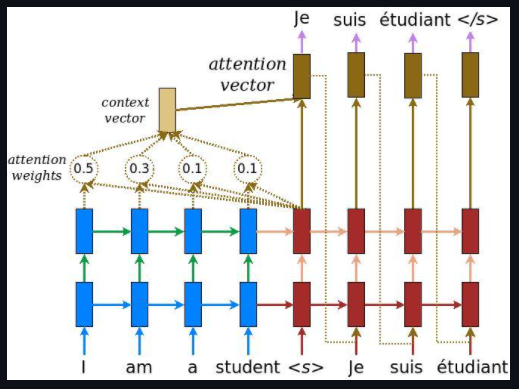

You will notice the addition of 'attention weights', 'context vector' and finally the attention vector to the above discussed model.

The calculation of the above hinges on the below formulae :-

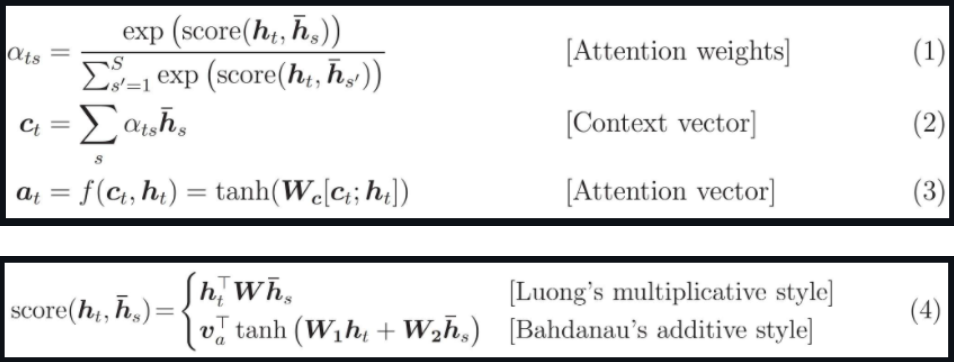

In [52]:
base64_data="iVBORw0KGgoAAAANSUhEUgAAA7oAAAFqCAYAAAA0pSZrAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7P1ltx43FjZgzh+YD7PWrDXzZd63u8OcDlOHmdNh5nSYmZmZmZmZmZmcxIlDhoApZjg+hj26ZMtdefocU8zW7SinniqVGPatvaX6f/w//1//n6iuuuqqq6666qqrrrrqqquuurnFVaJbXXXVVVddddVVV1111VVX3VzlKtGtrrrqqquuuuqqq6666qqrbq5ylehWV1111VVXXXXVVVddddVVN1e5SnSrq6666qqrrrrqqquuuuqqm6tch0T3//3//T+x0qprVlddddVVV1111VVXXXXVVVfdbO3w11ZO2yHRXX6lf0VFRUVFRUVFRUVFRUVFxewO/LWV01aiW1FRUVFRUVFRUVFRUTHHohLdioqKioqKioqKioqKirkKlehWVFRUVFRUVFRUVFRUzFWoRLeioqKioqKioqKioqJirkIluhUVFRUVFRUVFRUVFRVzFSrRrZirMW7cuD+5ijkXU1p/M6u+m/HMjPgqKioqKioqKiqmHJXoVsxVQDbGjh078e+YMWNi9OjR2fldMWei1CVX6rczV/wUN6NQ2lZ7e/vE9lWcdFRUVFRUVFRUVMw6VKJbMVehEB1u1KhR0a9fv+jfv38MGzYsk5FKQOY8qLPhw4dHjx494ueff86ue/fu+XdHzrPBgwdnAqodzKg61760qz59+sQff/wRbW1tuY0Vol1RUVFRUVFRUTHrUIluxVyFQnSRDgTk8ccfj5deeil++eWXSj7mUCCsXbt2jdNOOy2OPvroOPzww+Owww77H+c+d+SRR8Z77703wxc3tLNevXrFI488ktvYb7/9lsnvjCTXFRUVFRUVFRUVU4ZKdCvmGiAXyCxiNGDAgLj11lvjiiuuiE8//TRGjBgxzxNd5VOcsuDmBEKmPr///vu45JJL4qyzzorTTz89k97i/G66M888Mz755JOsBZ4W0jml5eO5OF5++eW45ppr4plnnsntrpgxV1RUVFRUVFRUzDpUolsx1wApQTKYkd51111xxBFHxFtvvZXNWOd1s2XESxkgjbSOyki5uC6kjkMMm671vuuZDfU2cuTIbIbeu3fv+PXXX7P2lPv999/zvb59+050/E3rwoZ3lMnAgQOzE04hrq3tR3koT/E9+OCDccEFF8Szzz6bNcmeVVRUVFRUVFRUzDpUolsx1wAZQU7eeOON2H///eP+++/PZAgZQTzmZaIr/wjckCFD4rvvvovnnnsum90WIud58ePe0KFDM2Hj/GYK7tmsKseSNumRh0GDBmUnnYXUSlfTTS28oyzEYx8w8+cff/wxx9fRQok0ua9svvnmm2w9QKPMgsC9ioqKioqKioqKWYdKdCvmGhTCce6558Ypp5ySr5EghKQjjdy8BGWAFH799ddx8803x6uvvpo1oTSlhei6dpgTEnzPPffEbbfdFjfddFM2yXW/EN1ZAWlEOJkJW8C4/fbb48Ybb4z77rsvunTpkuv3r0L7sCiiHdEUP//88znvFgYKmW6iEF0O6VZuJ598clx++eV5f3hFRUVFRUVFRcWsQyW6FXM0kBMEhHO68pNPPhm77757PPHEE/k3EsJPcfMi5Bt5++GHH+Lee+/Ne5cRV/tLC8ktRPizTz+N8849L/bcfY/YfLPNYtNNNsn7Yr/44otMdKcHoZwWSGe//v3iqiuujIMOODC23Xrr2GjDDeOggw6KV197bboQcOVUyCti++WXX+ayYo6M+CLBTfCvPPwtWmDke++9947XX399YrucV9tdRUVFRUVFRcWsRCW6FXM0EAnEhDaS5u2yyy7LRJfmEpGbVcRsdgLyRsP44osv5gOdPvroo1xehYT5y4/y+r7b93H7rbfF9ltvE0sutngstfgSceYZZ+TynJVEd0yKd+CggfHEo4/FUYceHquvvGossuBCseeee8ann302XYguKI9SJvYwWzi59tprswbcQkBnpJV/ZtUvvPBCThOtLg100YJXsltRUVFRUVFRMXNRiW7FHA0EA5mwN5cWzadlTj311Pw5IRq4SjDGm3R/lsjgddddlzWUDmyyOFBQiK7yQu4++ejj2GvX3WOxBReOJRZbLG65+eZ8AJTns47ojjet/qVHz7j0gotizVX/FYsvsmgcfcwx0TuReM+nN+T3p59+yosDl156aT75ubP8a2faoXLW/g455JC88FK05rUdVlRUVFRUVFTMXFSiWzFJFAF9coJ687nryb1X/EyJ30nBOwgJIsYslzbXicuIb2dEd1riaYUwipsSNP023y33WtHR8878Tgre8ckbmkmf4rEY0FourgvZVW4vv/BibLXpZrHIAgvGSiusEM8/93zWZhaiOy3p+CsQ2+hEZBHJn77/MY4/8uhYYellYo3V/pU1p4OHDP4foiuNfzWd3keuH3744bz39qGHHsqLBh2Vgd/SxyTc/uEddtghnn766YmfG/qraamoqKioqKioqJg6VKJbkQX34pAdrqPr4ofQPqnn5X7zeUd+EACu3C/+p4YUFILx7bffZrPl3XbbLR9YxIy0lWC4bsZRXDPukj6u+bz1N78l7eVe02/zd9Nv0zXzX1x5tzwv91qfd+Za0yAMJwfbO+pEYPt0hdNEM519+/SJe++6O1ZdcaVEdBeK7bbZNj784INM8BDdZnpLfDMaYkB0RyTS+elHH8ceO+2SSfhWW2wZjzzySAwdPr6uS7q4ZtlNaxq9J89fffVVnH/++bn8iqWAcJsofmnLEdxtttkmrr766omnfs+McqqoqKioqKioqPgvKtGdx0EARwoI4wgjQkOL5W+55vgp/jjPHNjjmfdanzWd51wJq9xrPi/vlbimlBjw57133nknjj322Dj00EPj888/z+EgOs1wkJMSb4mTa02L+AtJct2Z//K3+PW39Xn5LT3l/VJWxV8pF675TjMM1+Xd5r3mu+5JQ3H8qiNa3LPPPjvvNS2a7iaUUckrjeSlF10SC/59vlh4/gXjpBNOiG8S0Rs+4TNDHHNcf8Uvnimtq78Ce3TF+fgjj8XmG20SC/zfv8c+e+0d773/fgxtpK24Ztm1ktIphXwpE1rZO+64I3+X+bXXXstht4bJr7j49XmrPfbYI44++uhsvsz/zCijioqKioqKioqK/6IS3XkcBHBkhQbUfkSfU7n++uszKWKqSVC3b5Ow7i+Nlr2KNKhdu3bN1z5TU4iZ02nL827dumXiRMvFj8/AvPnmm/HUU0/lawck0Ta652Rb3y1lgiwtU0pOpB/JE+auu+4aJ5544sRP4bSG4R4iIk8PPvhgNnH2CR15dkCT/ZXSU0ij95G67t275/Rdc8012VSWKatPFykP/oSrDF3zT4uH7PiMj7K88847s3+foFFG5R2/hf3xxx/nw47eeuutXH7KQFn4TQPrUKPyjveVJ//220oTk+0PP/wwh1fSUsg0k2Of4znmmGPisccey787ImnuyXeXL7vEcUcfE3////2fWPAf88Udt90e7737bjzy8CN5nyrCTFMpf/369ZspJG5c+tc+ZnQMGz4szjvr7HwQ1ZKLLBbHHnV0LqMXX3oxrrzyynw6tP20PgukXOW1lMe0QL6Uo/Jn+m0hRXvprAxLP/rkk08yyd1uu+1ym0K8Z3QZVVRUVFRUVFRU/BmV6M7DKIK8z/AgB0x/77777vjggw8y8UN0mWsS8vlBhJElZGffffeN7bffPh+646RZAj6S57M+tKr2yiIGyJjwCP/MP51Iu/HGG2fSJKzHH388XnrppRzGDTfckL9/Kz6EGolqJRStkAdEwvdUN9988zjjjDPijz/+yCSv+S5/CKK4ELW33347E3GknDYYsUeW3nn7nYkaywF/DMiE8oKUbqSVNk+5COOBBx7IaS6LAOJD/JhNI7dItHz7RA0iL05l4Xd5BxlTxieccELsvPPOcdJJJ+WwEWllgbRfeOGFeUEBCaWNfe/d9+LKK66I21JYb7z+eibJylB52huKKE8k3qluLTBcdeVVceQRR+R8yhftaBPKSTtAlIW58w47xj/+z9/yqcunpDSdftppue6Qau2BWa49qFdddVX07NkzvzujMToRXen7z977xNKLLRHLLf3P2GWnneKkk0+KU08/La5K5ZtP3N5tt9hiiy3itFNPzeWvXf5VoqvMlJ225RvNyrQzoqueLGpox2ussUZ+Txo8r6ioqKioqKiomHmoRHceBKG7COZI13PPPZdJFjKGkLpHa0VgP++882KnRCgI7MgncoiMOdho/fXXz4QHASTgI280fU4+Pu644/L+SZpb5Iv2Fimj6VpppZVi//33z2SRmbFwe/XqlbWYCNXhhx+etZCI4OTIrmfSikSut956ccEFF2SiiqA033Mt/DPPPDP7lR5p5lzbV3njDTfGG6+9ns10ByRij/Qde/QxcVEKU/4RZXHRVgvD6brlM0bKjNZX+PbD2teJmHlmkQDpUmbIoTwLB3H1PrJrb7GyRNaQZWT/5JNOjlNPOTU+/fiTGDhgQHz2yadx1JFHxfnnnZ8I+ds5PeJVJ0iu77fec889OWx7WmlBv/76mzgzkdMTjzs+vvv2u2hDgltIl7JBjpUDkr3G6qvH3//v32KxRReLgw8+OO65+56cfvnWVtTd0ksvHf/+97/zQoA8NlHaV6ubZqR3R7e1x4/dvo/NN9k0Fpxv/lgikfDtt9suEdyr4o0334xvv/s2vkzleuIxx8XKK6wY6629bl6c+PW3X/8S0fWustGOL7744ty2lXdrmPyWcqSFtxi05JJLTvazRBUVFRUVFRUVFTMGlejOgyCQFwH+559/zmatBx54YDbhpQ0tBJHJpnurrLJKNtnlF/FE4GgpaSJpdZEr2kzEDQm2nxH5RZxoOsXFIZ9XXHFFrJ6I1FFHHZXJo7DclxZxI8qIFPfKK6/kNLSSiiakVRg+nbPWWmvldEqjMJvkgj8aZKT9lltuyWlFcsXLIXFOF/7w/Q9ieCImSNXJJ54Yu+68Szzz1FPRp/f4vAiXXwsA2267bU6j+BFbWjxa2EL+xFnKGtlh9nrQQQdlU2bm1eLnD9lF7pXLTTfdlIkSTbP0PPfMs/HTDz9Gz0T6b735lth0443zYVG//fJrtKd0F/NkJry77LJL3huateHto6JtdHvWXB995FFxeiLM3hmV0j+6hXQpJ2VAY2+xY/HFF4+///3vsdlmm2UCLT20ksoVSbdYscgii+R2gRiro4JC+JrOvb9C9Lw7cujweOaJJ2PN1f6Vie46a60d555zTl6Ykf9RKa8DU/s578yzY7UVV44Vllk2zk919P0P32dt8LSg5EUZM2m3SLHPPvvEp59++j9tsvjVPtQtTfwCCyyQtf7K56/kv6KioqKioqKiYupRie48hiKQE9SRl3fffTcTROSFxjWbtqZn/CE2CNxGG20UBxxwwMRDnpAi5pv2xSJutH4I1Ysvvpi1uMKhxeRPWMUhAYgUk05EAJkTR3kmbuSYeSjtLFNZml7POoO82HfL7BhRFL54vdMkF+JgVr3lllvm9Eq7vIlPOSCyXb/pGj//+FMiTAOyZnftNdeKA/6zf3yb7o+cUC4c4sc82QKBvbFIvnwzP7ZH1B5gaZC2UtbKTVnTuiLDrhE09/lH/JdbbrlMnOXHs/79+kf/vv1yer768ss4cP8DYuut/h2vvvRyvoeAceKSF2RZXSJiQ4elsEe1ZZP0g1LdnXPmWTGg/x+J9I2J9nH/a3YrDPtJmZsjaAsttFDOi7wi456rK+lGphdeeOFYbbXV4tFHH+2Q6JY6lT7XzbqYWoxL4Q0ZMDDOTSR2xWWXi6WXXCoOOejgrPlWVm0pn6NSPL1/+z2OP+qYWGmZ5RLRXS4uSm3sp59/ynmeFjTzYvFAnatjlgHuNVH8yjO/TMnnm2++vFBkIeSv5L+ioqKioqKiomLqUYnuPIamQE6ryWx20UUXjcMOOywTVftBES/ONU0hLag9t0hdIcIIGg2vvagO3WH6bA+jE36RXARHPOJrEgZaMUSXZtf+zuKPK6SNRnidddbJ5JvGzr3OIGyaYCa/iBdyzH8ruRI+Asikmsk1wiK9NKhI70cffhQ9unfPBLJXj575EKYlF18iTjz+hOjze+8YO+a/eUHslA1zXnEzzUYKkWhkCDmXl2a+y6LBf/7zn0x27astWmWmsPKqXOS3lDE3un10DBk0ON59+51Yd+11Ysftt49HH344vvz8i/g2pUE6OFpkJHWDDTbI1wMHD4oRbSNzPPvtvU+cf865MXTw4KzdbO/gm7PShzjaf4vkMi+nXS8ad/mxIKCs1l133dxmNt100xyX+/JZ8su/96TLnuai3Z5WKIffe/0Su++8Syy12OKxxr/+FVdcfnleKFFW0ubTQ9989XXstevusewSS2Wt7s033Rx9+/XL6Sl1NznXhN/SzaljJuksGPSJ1vwUv+JymJj2Pf/882eT+Ep0KyoqKioqKipmPirRnQdRBHKEFDFDWpxYjIQ6wbfpmK4yUT7nnHMycSmkk+COpNnHa6/q8ssvn4nWF198kYlPK9EEv2leC9FFCIu/4qSNOSwStddee2XyhYS1hlXAP60ek+VJEV3XxcQXqWeW+69EmP75z3/GmmuumfdePv3U05nkdv36mzgvEcPlllk2/6VVpVUsEJbyK84py8pAmPaF+i3+AmmUBybPNODIEvNlmuBCdJXdJptskssPcctQHimcQQMGxksvvBgrLLdcbLHZ5nHJRRfF3en9+xr1ZM+wOhIOcjl4gkaXufY+e+41keg6oKojja46s2d6xRVXjMUWWyynUVqQVHmRJmRPe1lqqaXyHt399tsv7131rufKQl6Vv3ZBM3/88cdnrblnndXh5CC8zz/+JNZZY838bd/NU9t46MEHxx86Nro9u8FDBsdzzz4bm264USy16OKx+cabZFI+fMTwrPGVPmlrOvlqOvda20zxV4guc3VtqBXFr3zS6GqPNLr2bdtHPa15r6ioqKioqKiomDZUojsPogjkhegiNk7TZZrsHuLIIRLImEOPXCNl3gWCe9Hq2nvqYCIaTSQVKUAsWoV7vydFdIXNMQNG+pjITgnRpTFDcIWLrHdGdBEO+ydpqxFAWmDmx7TViPXhiQA//+xz8dknn8QZp53eKdFtQvyI7cknnzxJoqusLBQwm6YBp7VW1vJGMykdTgt2KnMhurlMRo8nui8+/0KsnEjo/olcvvv229E7xTEg1UmzrtQTR8tpjy6iy3T2wP/sH+edfU4OpyOiK63IaNFCLrPMMpmg2rMrfZ5LPwItndrLyiuvnA/+UofitohQ/CLHNPv2DCN82lAhmtOCYUOHxcP3P5i1tIstuHDsvuuu+aAw8WnH9uf27tsnrkpta6Xlls9+jjrs8Pg4pZcJt3qXJn6lr7j8bmornOvW9JU2yS8trZOwd9xxx2y+3Zlf4bBUoOFXlg7vqkS3oqKioqKiomLmoxLdeRCEbsI7ARypdLAQjSQCiJB4VgR8gnshCE1h3XME035chzshu/bI0sIyeR0+bHgih1NOdIVX4vSJI+axRxxxRCZXiEhnRMF9JIsJ8tprr50JRiFczXdcI5rMs2kgS76YISP4TtTde8+94uILL4wP338/rr/2unyyrwOpmC53RnSFi8ghfci5zxTJl7AL+JEmh045zAixtreV6bL79sHSxPo8UivRHZPCGTp4SLzz1tux3jrrxj577R0fffBhDEvppu1tlps4lZX37Usdmcgu0+IjDj0szjr9jOib8sFPq+ky/+WQKVpIh0xZALEPu7QHbcUixtZbb52Jrn3bDlriR5mqp0JoEXjaYeVhz7F3xSud0wJE3v7cZZdaOpZefIl8EvYXKb3KRrhI7Depbg89+JBMcml0b73p5rwI0+Xrr+Kdd9/JdVLaBSedyl/6he+Z9LW2GffE4QRwiykWX+S1NS/Fr3D5dXq4fcwOZ6uHUVVUVFRUVFRUzHxUojuPguBNS4eo2tfJdNeeU6SRYF+IE8Gdv/cT+UMKiraU1pApLvLjICpaLITXHk+k2Z7XEYns0khml94ZN2ZsXH3lVbFmIrqXX3bZxM8HlfiEXUijQ5UQC5o0zzqDfCA69gojX8x3ESvpbpIR10xZ7SVGxDwXr/jlWd59EsYBRl2+7BIvv/RyLLfssnHA/vtH12++mbhvVjglrbSgiIw0Kwd5F7+9uIU4Ff/ep+W0N9g+YVpBhFvZ0ui6RyPOXNi9iXGlNI5I+XNQ1iGJyGWC+fwLOQ/SX+KQH4TN+wjecFrdlEYHTJ2c8nxSIuw0tLn+kv8mxGcvKbNcix6022Vvaakb71oMsJhB44uw044jyL6lLP/fd+sW7739Vlx79ZWxz777xhprrxOXXnFVPPbEk+n98Wkak0i28JSP/JdFB/eaZLCVOO69116x2KKL5jqxP9c9frynLGhO7WFeeIEFY7tUD6+8/HKuh9tvvy21o6tTGXdL+Uxl0jYyev3SM+XvqXjiicdTWT4bzz7zdLz+xhvxW+8+MSq10Vw64xLpnZBWZaatswCQVwsm7jdR0iJf6pOFxAorrJAXfeSxoqJi1qGMJ01X+iznuqKi4q+htX+1/q6o0BamZdxtbU9NN7lwKtGdh6GhMTP27Vd7dIvZMeJIYOcQNKa4SCwBHikshzE5yMr+UGSUMO8TLDRZDq9isvpDt+9j5PBELkYk4tY+OkU4Nq664sr8aZiTTjxp4qdhxINsIWq0ZbRmiBSzZc815M7gmTQWoukTP9IjzGZH4k96aVNpOb1T8ihu2lbEmiZTPhAbGk5a1iefeCKT/PKOv377PJKTnKVbeSDRiBBz4ZKvEj4/tNgOomK2jCQKR7nZz0qjy3TZwoPyRa4QQA7ZY5KsrO0nZh6NzHqfP3GU8r/ooosmhu0ZTSYtt1Odhc1v66AgPma5zJF9+1X58yvMMiCVg7yWTUTTXminZkuTPdx77rlnLtP+ifD/2vPneOaJx/Lnqnbfa5/49Isu8ePPPWJAIs1lryxNqrJjZk57j1C730yX+pJ3aXMI2lZbbhkLLrhg3letroUBpQ1LB02zzyL59BMCTuN8wQXnp/K6KbXhX1I9DE/hDYqHHn4w7n/gvvjwo/ejy5efxQP33xtXp7r/6LPPY+ToNHBKxrhEZMci4KNz/WmX9hxbxLEHV9qakHZp0Xdo5Zl+b7zxxjnt7k1uIK6oqJhxKP2zjKec8bFcT2qOqaiomDw66mPkDb/1rzoHVmgHpW1oF1PTJvj1vjZW5MPiJte+KtGdh6FhEOIJ4wR4hNfhObR3yAOBnlbMQUe+m4tcIYRO8rUn1SeH7rvvvqxRQ6zs1XzwwQczYbNn94ZEGr/47LN8wBOymzW6iej6bM8eiXDef//92VwaaRQX4ksjiiR5hrARRjTizlDygBR7D6FDOqVHhyiNXxjCpL1GWBBZ8Uo7bbT3EUj5d4/zLeBDDz00E1iaW/lXLrSJPjGDcEk/Uous8ePgLhppGlvh8s80WbhIMNNtRAiBo3kWpmcIOAJp77D0l88eGRDkQ37ERetsnyx/8mARQtk5FEq9qI9iiutdhJBZOY09radwWstTGpXJEksskT9xJA/CVa7i5tS79rHqqqtmsk27SetrMcDigDyOHDEshg36I1554dm8F/ncCy6KfgMGx5DhI2Nk23ihUrqUizTZ07zDDjvkfLQScGnkn7ZcPE7hZgpsEYUFAf/FHz9M8B2k9f/7//3/8oIC7T3Sry7eevvNVJZD0jsWKH6L8y84Ly6++MJEhJ+LTz/5KF564fl46plnEiHvGaPGpMFUMhLRHZeI7ujR40+bRpq1A99rVqbKpAnpMOCqU9YP2qLDupSbMp/UIFxRUTFjof/pn/qi8dH4xpW5q7U/V1RUTB30MXM2ecgieOljZKPJyXEVcz/KGKx9WPzXVqZGLtJ+jNPeI5sKR7uqRLdistBAkC4nyTpVtnxux29ml77DimgYuGh0EQpky2dykBnElrCgwQnH3kwC/i477xwnn3hS3Hn77fF2Isk0uxNNl1dfI598jJTRBDIbFp/fiIk4kG2doTTizqBxIz00jmeddVbsu+++E82CdYrS+IUhL4gr7Z9r8XqPSTHiiKjSiupEHAKF4NCIIsHeQbIQYPtSkV1pLJoBxNl92m+aSuHxr/xoTC0YMCUuAz//ypgmef/9988nHYsLgebPwoH8y0cZIJgmC0d4iK33OSRWWjPhTGnnn5M+RNrChPfE3Vqe6lbdW5ygnbUgUMLgl0O8tQsLCcyvac4RSWlH3LO5+Ki2GND393j0wfszqX/8qWdiMJLbPiZ/51Z48o1YK291RXus7lu1nq75J5SqH5pw2nXxaRueFX/qmgZXmphdMxtmZs2qQN5///3XFL9v7balvPaOG2+6IY486og4/vhj47xzzopbb7k53nn3vRgwOA2cqWhy6Uwguu3to3IaaNMtMAhPWlsFY+nQBvhV7w7ismhjsaaVxFdUVMxclPGEtY9zA4zPZfw0tk1K6HLfuGWBa2pJsXebblKYGr8zC5NLj/tljmj67cx/xX/LtKNymxo0wykEQDvltPWpCa+EVdy0wHvmRjKUOdA5JPfcc0+Wk8yLJa8V8xbUubonU5L9yIuFM5T21upa+0W5p517j8zKyq6pkOGnM1SiO4+jNCAkisaQ5haRo5Wi6UWsDFIGTo0UiWSai/QYzMonaIShAWp8+fmTT8Vzzzwbr73yanz1ZZdob0uNeiLRXT3vhRUHQodsIp3iZTKrESMHGm9p8J3BM/EiP0j6brvtlgUYhK452PtrAEas+RWPeMUvzfKh0zTj9b5wdExpQ8ik07u0rp4Vv5yJBuGjoURwOYO89zhmxIUk8e99GnPaZGSYGTTCyi/Cqk5K2Jz3dGrkiekvAih89SQfNLvKoulffpBAGlhaW++63wThzfsWLaRD+SivppM39S9eixkWJbSBotEW5uhECrv/0C1uvv6abIr95dffxpDhbTF42IgYPmJkPvGZP/GJQ1zqTH6RVfE0IQ/SL19PPvlknjSZeZdyAe+oJ0KofMqD9CHS6qp3799jZNuITHL9/eWXnim+N+La666JU089OQ495MA47tij46GHH4n+AxNZn0h0U7tDdFN5qgtaYkS6aJ9by7BZRtLgZG3ptVgyKSG6oqJixqOMEyxf9GVWK8YwC5P67KT6qPeMQRYS9X/j15T0Z36MU943XrSOGa0oY3b5OzuMGdJSXGt6/JZOZadMyuJoyevskP7ZDaXMzNNkAXNJs4ynBiUs5W7RnJxCpjLvmefdnxIIR9x/td68Zx73uUSygS1atvD4lCLZp6M2VDF3o7StsgBCvrW4WGT80ib8Lc4Yon8YV8rzpvPc+9oYuVDb0tY96wyV6Fb8CRoYzSzi4K9GVVAaWmmQrQ2rPM/3OTagf3LjTZfXWmONuDIJGz3TYGxgRPjKankJe0ohLmlEKDR8mlF7P63SN9MOZUL2VycTZ/k0Dr+t+WlCRyrpLGS1M0i/8JHeZvgdlRm4V/LtuulaUfwJT7jS4696a/p3LY3yisAT6mh1TYLuNf0KT3qFUzThnaHEa/GjtRxGj0qk+pMP49ILz4+zzzknuvf6Lfr0Hxhdu/0Q/ZP/Zrzeky6CJvI6qYFK+qRLe5RP77bmVbqEz1+zTPgdPdo+5hHRp2/vePTRh+O9995JcX4VH330Qdxz951xykknxFVXXx2/9+0f7SnY8SGnukhEty2lSxqZ9tN6Z811ikeamvDbfZM8QZpmnNDB/+TaVkVFxYyF/qd/WqR0jgSrJOMOQmBc6WzM856xKZ9ef8QReRENMW7t/x2hjEvGIX87iwP49VwaudllzChpkh55bqbJtbwVyySLwYVgFf8Vf4Yy0d60PYoCc0SzvKamzvn1njnGAg6rI9ZMJ554YrY8IhNNCYTTbHuTaqeTQmkPZB6kxsJz2e5ji9bU5q9izoc61ya0Bxp+VoVFWVHkM35K+9MXyG8USU0lWmvbcd9WR20LeSZL6gudoRLdij9Bg9JgivO7CY2tuFb86VlxE0iuz/OMTeFdlUjAWquvkU/ONSkiWGUi5TT4jsLuDPx6pzT80047LZvNGlh1pGZYxW+JqwzsHeWzFc33JpdGz4RX3vHXb66z99xvda1wr4RTwm+65jvFr/smVpp6psbMog0ynhUUf820dgbhNsuh6XdU28h4983X48Jzz4prrrk2Ed1f4+PPvoznXnw5fmcemN4paVTuBj/az8mZDoK4ihNna17dL2n6c/r8RoAJF1/Ffvvtk8rgwfj1116JrPePjz98P2656Ya47/77Y+CQYTE6BTs+5FQmiSA7YOvqRIIJEBYJtClht5aR39oyi4fDDz88a38JgAZu6ZhU3ioqKmYs9D/9FtG1rcFn4MwZZQ7obMxzn+Bl8XS99dabeKif0/AnB3EWwa0IbJ3BM374tRgrrbN6zBB/WTg0trWOYyV/LHL22WeffGo/qyQLwrND+mdHKBfznvZnq5CtVMw4SxucmjLjV3jqiIUUiwPbyXzWz9YmVghTghKO9ldMSqcV8iAvpd07GFJaKtGdN6FdWXAxLmgL5CPtzHjiWZHX3KOlZT1nwcw2RGfCILDj5bg/tx2/ybHCczAqS0NybmftqxLdij9BQ9GIOmpc4HfTNfGn+8UhuWPS4Nc2Kgalge+iCy6I1Vf7V270ZWWnDPIl3tZwJwV+vaez2H9lxciEy5y3rNSX8IrfpivPJxdn8VPCmJT/4qf4a/3diuKn1bXCvdYwJ1VP5bnydYCWU6eZMNtrbaBphlVcR2G1oumv6dce3Y8/eC+uv+aquPPOO6LLN9/GvQ88FO9/9EkMGjy+LrzHqRsrdkyMTYieTQri6SyvUNJUXPntHUR3xMjhabL9KZH9C1LbYNr1c/Ts2SOeeerJuP/ee6LLV12ibXTym4Imjo4bNyZGDB8a76WBlAaIGXIR4ITJNdPhNy23hQR7mGnQO/NbUVExc6H/6Ye2qzgHAdEwLk6qf7rHDxJx3LHHxqqrrJIPxXvwgQdjpMMVLeJOolvr/xbxmJQ6gE88ncF4bIw2JhoPWxdpZwWkn4WK9Jcxupkm1wRUllQ77rhjXgigVaTR66xM53UoUwcUEs433HDDPFcwvSwy0NSUGb/KWZjaj/nH3vOtttpq4vf8pwQlHAuzSMaUmuZ3hP/OueM1zfKJ6OpDnlXMO9CGjA+28JE7HUBK7tPWtQ/thLNQY/GH1Yy2whpu0UUXzQd6lnFTWM026VoYyLEDXoVtrHKvo7ZbiW7FDIfGh4QyAWVa7ORehwv59q09qgjE9BgEdSorPE6DdhJw2XtVBt95daDV8a2wmmBNgLSoZZV+WibYziAck609zwQepI/5UtFQlAlQWgxs9ibbG+x5GcymN4QpXeI1yDLxkn+kHxmVBoNp0dSWfcTKheDJNIa5IuuDVuGztClOnuTVYWpW6S0mVFRUzD7QT403iK5+rf92hOaYkbUG77wTp5x0Uqy3zrqxyEILx3nnnBu/9volL97S7DbHhPIuZ1yzmEubgSwKr4niVzrMgbQSzPsQDuNPM9yZBXGWcU36zdnSX0wDW/NqTKQ5NJYaJwmb5hVhzIr0z+5QruYhC/EOrXSeSWftcGogXITBQZ4+s6h9Tw3RVY/a6qWXXprb4l+tO++TxxBd53CU795XzP1Qz9qj8cLYoC2Si5xv0JEMVQ591U6MNeRGn4l04C25SzjCa20/3jU+e5cywmGxLBKK/yYq0a2Y4TBpM11xmi8C6jRcp+fSktmjghy1NsxpgYaP3Jp0yx5Jk0pnHWVegXwrg0JCra7ZU2Xl3cAzvcpGGOra4CMuzrU41E1xBCiCEzJYTKWkb0bUjzDFKXxpIwyIk5N/q85IqufFn9+e2/uBFBNSved5E8qtOJobp3kzbaThkO+KiorZB/rplBJdz4xLxoGnn3o67rrjzjjwP/vHKiutFPvvt1+8+frrMTIJ8mNG/6+Ws4wjFhNtGTHXibeVvLqWJn6RW4comh8Jh7Oa6EoTwmNh1KKlNLnXmn73jOfGUuM9cuOefM2K9M/uKGVW5qHpQSpBeSt7CyVTS3TVt3SQCRwepd3+1TR5vxLdeRPqWZsyhlnQQXKdb0L76l4T2q1xVpvznHPI6j/+8Y/JEt3yrsU17cyXUcphoZ41MV2IrgQIuOncqw27ArQDkyEygIgW57cBVmOdHm2lxINAse/nbGqf11eY5VufVM4EEnvMmAyXk51bBZhpRYlHeAa04vxW/sW5p55MhNJU/M+I+hGmOEsamunimmlzLT3KxODJlIbFgUGYX3lrorynfTH5cqp12RslnIqKitkH+u/UEF1jlAVamrf333svbr7hxthis81is002iVtvviUG9P8jxiaim16Y8Ob4OIwjxgTvMqlziJUFRmOCcMs45y+/SI9xxufIbOnxnsW2pt8m3OPE1eqa/lv9lPc6ere8529JE6GRBVYhKs30F8evsVF6PXfNTzNMKP47ire4gkn56+j+1KKjcEpYncXRdB09m5JwwW9lpH1wyqw8a0Vn4bW64q+V6LJU6iiMEp+/nHRYzEUWnC+BgKvXpt+CjsIrroRX/FWiO29CW9B+KBG0R9rWsndf22+CX+OF+5w2w9QZ0fWZ0slpdEs8xmj7en06zrjNfxPTTHRFKiIdVeKonwnOiIXVSQNlGRhFWhLaUYJnBEpcrfFPq5vZ6Z/bUMquWY7N39MDwtHwERV7sXQwWmRmsgZzcc2rUDalfGi5CVMInD46PculxNNav53db/6dUWjGMzlXxjQLArTOTYuAVvBrUGUOTaCl0SWwuudZRUXF7AN9eEqJbhknEQAaiV49esbnn34W++69Tz5j4vRTT4tuiQi2El3vkYcIaCyWdt111+yYABtPyEYEvkJyCqF02NVmiUT77JG5y1Yf2g1CXJGjOOH7jYxYsGS25/Re+bJwLNziT9gWlO2P9Bk48SOk4jf+M1WVTnF4zzuETc9tc2HGuuaaa+ZDDKXJAl4zTZwykqcSnuumhYwyd+2eZ9IsvbaM2OpBbiz+yzvGT/EgRxatETb3zOuuyZjy5F33vSeeMsZPCvyIj/ZZGYrHX3Oh8JWZa/fMAcrCffFw8utZce4pB+XmmhbVJ/9YA1kolVbveF7KQbjyoU4sqLpX0t+sY/EqM/60EWmVPvds0WI5JC7p9Y5nxXTZAYrkcc/E5f0y5zfLW1s1Z6nrLbfcMmvRSlvRnqS95M9fcWgzFna1Pdo3dSR8dSI8UA+uK9Gd96Aday/aHYsQh/9pp9qD9t0K7YIrfVPbnhKiW97x3GeGjj766Czva6PuNzHNRLd0LI1bo9fBSucWGTMcnZif0qkMpjLbmogZAYUgztJBS2edFlfeL/loLfCK2QfaljozQOtcvuXGJMekODPa3ewObbf0DeVR2/L/QpkYkIug1lkZaWeEAfus7PklbBJOStlWVFTMPtAnp4boIhS+9e2Aw8EDB8Uf/frH+eeeF+uts07su9fe8erLr8SY9j/LA8YE5Mb2GXv111hjjXxIk68BlMUwMpKwkQ4EklmfMytWXHHF2H777XP6xEmOctI7QkX+QKQQL2TRvGZPLNJob5pvlSLWCCp/5C7zHwLNHNVnXux9k7byKSDvKgfvITvmTA65dx9BX2aZZWL33XfPaaI1Mc5Js3Gu+LUVSfiHHXZYDhMRLrKSdCOV0iI/NDvyT/NCRqTxYd5YyL93pEVZ+RzeMccck61kEClm4N6Tdud7KCPaH+GXMXdS4656kh4CuLywwPEpHpog5en0aOlUH+pL/D4V5776IutKL827U/htAVIW4rcwIV8Og1LO0qntSDvrKQJ7IYnyLU7bXHzmimyi3WiP/vKHpJKnhSccnwuSZmbkwkMy5Z9ZvDR4T52on6233jqTC3WBiEqL95l2CoNcXurP4Wfu7bHHHrHCCivE5ptvntuMe9qq5+pTm5J2YcmfNmRPuTpBMhBadaKcSllXojtvQh/Uz4xFLFT0Idf69+T6Jz9TSnSb0BaNP8Yt/bF1bJ9momuQNkBp3Fg7oqvDWdXTkQ0UBlAdVifRsax2GbB0yhkNBSNeAxCNnlWnaXHSbyXMZFMG4tphZ1+oG41cRzNhEApMxlZRJ9XJKiqmFsYx44I2ZtwjrBkfCkGuqKiYfaBPTinRNX8gBMiMsx7aRoyMkcNHxHPPPBM77bBDbLrxJnHbLbfGkEGD/9TX9f9CUgh5tGs+94J4IChkI+EhN8aLcjgeecmJzs6WQEiQCQto5i6CG02HsYbMxS9rJWSDfEM+IX+5TxYjHJK3fG4PYUGehY24FfIjXIQSUdprr70yaSrvyTdSiiA7ONLhjtIkDgQLWUZi+CXPIYZOD0bUEVRzrXIo4yPtLVLpGRNu2kLpJtB6lzaxfB7EOzSKykS8q6++ek6f8pR29VcWEg466KBcDvJCNpvcuFsE6XKOB0FamqVd/pRt+TanT/+svPLKucykTT6QNeXiNNiddtoptw1aaZpuBFge7bEWjjiUDbLIdN17CDa/8iHctddeO2vxy1YX6Zc+9VC+iav+zC9kawRUWdCwK0eEn4xdiK7yQ3SR1eOOOy7nkR950uakTfsSpvIv9UczjPD/61//yl+sINPLj7aqLshR2qt0qysLK/KHA/irfCxIqIuyL1hZV6I7b0IfNF5pF6eeempe7DFGaeOTawP8WGyaWqKLSNPosr4Rl3eamCqiKyJOYnQ0A7kOYgA0eI1OHVWH0ylEqPE/58PVffvmjqWzWYHTmceHlRIf4zMwdkLY3PSAgrESZTVOh5XGaXE6vI6N9CLOCnByaSz5qG7mOnXOmTA4daXDGXDLRNjRe9VVNy1O+zIWGhe0M2NfaXtzYlsr/af8rqiYm6BtTwnR5Q9poE2leaOlcrrymNS/f/7ppzg2yTVrrrFmnJGIyE8//Pgnocq7xgHkAKGkZUAuhOV+GSO849q4Ifynnnwytk7k6pyzz8mC2vA0phhbyjvGGAQUcUDCkBPkq4SBkDBXpRn2LL+fniHJZ5xxRia6vi9P68gE1nvCR5K22267OP644+PTTxJhEmdy5DnkjDYaGe6e0tQ28r/fvG/mQRzkPcQNiZIuzxAp4R955JF57ydCWsgshyhJDwH19ETSf/zhhxhJxkrPhqfyo6XedJNNYvuUPsQfISzvWlj0HlNb+VXe4lT+ncGYxg+nzO65++7YdNNN49hjj42PEjkVNznhpx9/jPPPOz/WWmut7Ef9iHPE8PF1QJOeDw1LpE5+EFFk9sQTTsiLD0PTPeGQOyx6IMaEdvKvevRM20CWN95440wO1YV0eY6cyhuyiki7X2RupNw32l0rD0qcZnkrJ58tskhgoUTa5XXgoPGKKZrbPZP7tuu3uZ5Hjxkdg5KcLE/eK3t0S3rKXEabjbCIG2Ev+eBPvBYxEFpyfinrSnTnTeiD6p4lgq0Y+rEFEX1ocm1Ae5oWoqt9aZuchR3hNDHFRHe55LEM4iI3Wey22255ENThRqaAxyTiOib50fANkjrUdddcmweHL7p0iaeeeTq6fts1hUGFLfFp0E9u1JhRyaUBLHW60WOTgOhfytNf6RfSiugaUKwOSo/OPKWO//KOgVQedG6dflIF7lkZsJSDAbjp3JvebtjQYTF8Eq41Da1uvL+hHbphyXUU55ziTETFdfS8uur+qptb2lfJhzHBGFYFk4q5CWSCKSG62j7BiZkt7ZY+kYnu6DGZxFx37bWx0UYbxX777hdvJmKDSOgrnDiE655FdsQB0UUyPOOafslTFAHPPvV0bPvvreO8RHTF3ZbkqeJfeGQZpNA3UhEnmuAij0gvssmEFGklXA4dPizJUykdbSPj/AvOz3ttjznq6LyvGMEpYX+f5Jo9khx3xGGHx7tvvR2jUroRzT6JID2YZJ8N1ls/rr/2uvilZ69spu2d1rwqH5pkpLgQXYJmMRFGGJW3+/yXuPlB0Gm7N07l+fBDD8WAP/7IZd0+qj0efvCh2GbrrWO3XXfNWmHCc3nfYoBFiPKZQuXjmXRNCiXd3GeJhKvDXXfZJR59+JFct5nkJ7J22623xr9WXTXOPeecTMB9SopG/4fvf4gXX3gh3nrzzazlHzJ4SNyciBwyfslFF0W3lJ9Rya864YyrFgEsNFCcIPfqHOmlndWOEF33in9aYObizJrlU5rljQzKHH6fffbJGm559p5nnHFbHOuuu24m7xYZlDEyqx10+/77ODAR4I3W3yC+/rLLBLP7sTEkxflgKntpQdiL6acyKnGrJxpsCwu0+gg8zb060dYpsLRPSq5SzpXozpvQbrRF/IlVCP5VrDwm1wamleha0LGlwAKRdqhNNjFVRLd0JhOAD4TbY0A9PbKtLUYjuYmgciNSJDrDzjvtFOelyA3yr7z+Wtz3wP0xZNiQ1PESKR49MsaOoW0bHL/3+z16/9E3hrWNSIQ3ZSplSJ7+Sr9QKAYBg4EVTB3QQDs1rryj48t3GVQmVeAqRAc3EZnoOINAceXe9HRvpwnqnRT2ux0495vxd+TeSe+/ncPp2HUUZ3XVVTd3OfutOAISgcxYVlExt0B7nhKiS1NF2GIiSr6hNUNGOJot+yaZA9MGIiVMkIsgxrkmsJlbEV1aNDJQq9xAziHE/ZFkjBeefja232rruCARXcLdqNHtSZKa4C+FR5lAo7baaqtls1dmx+QaAiQZxVkByI8DhZDdwYnojk7vIcxMStdYfY0464wzY+igwTEu3S/4IZGfvVL6jjjk0HjnjTdjVCJvNNd9e/eJhx94MJMiRNd3g8d2UF7ShpzRcK6//voTia4ypFlByu1TZhWHmBcoC3mnAVSea62xZhx0wIHxS4+eMTYRsDGJ6D760MOxQyrngw8+OOdXmKXOkGgEEtGlTVQHk5PNWjHgjwFx9plnxSYbbRwXX3hR/PbLr5nQ9vi5e5x5+hmxearfg/Y/ID764MMYNsTC/7D4KhHEp554Mn5KRE85DejXPw5MfrbcfIu47upr4ttvvon+SW5Up+qGAG4RgLZbm5NuciQNP8JKi9pKdPmj7WUxyT8oZ22PIE/BRAa3wOA+yHchurTEyka7LRD2z4lsHpzqY70114qvP/8ylTNpPWJoeu+hhx/O72mv5N1mOZb2p261L23f4oQ6pXGWLoScFUCpY+9XojtvorRF/RLRZVE7pQtR00p09TVtjdUKxWRzrIEpJ7orrpY7o4GJKYxVIw3YYJtXjVqI7quvvJJXyk475dS84nZvIrkffvJxGnhHTiS63KeffhhXXHNl3PvQg/Fb3z7RPnYMY+acqb/SMbyrYDkFxblWYFPiyrvl/TIQeTapdHmmwxvgl1hiiVh44YVjkUUWmej8nt5ukYUXiUWTWyyF3+oWTa4Zf0du0RxG566jOKurrrq5yy266KKx2GKLZUGGOZ5xvaJiboG5e0qILrJhyxINlz22nL2LHLNh9+3t5GzPQgKKzGD+dz29iS5TXZrasqeU9oKGzUEvnAOhPEecNkkEbejIEROJLtKz3rrrxcUXXBgjhw0X8YSQp4HotuYhxdER0SVoMsGlgabRtZDW1LIoC3lHBJGz1VZZNdZOBOyHbt1idCK5hejuuP0Ocfhhh2UNojIVH0wPossU+bFHHo1dEqk8LAnI71HapHvffPV1HHfMsXHl5VfEHrvtHo889FD0TjLd0MFD4v1334sH7rs/k17p/C2Vy1ZbbBn/WnW12G+ffeOCRE6vnFAnnDoifNOoq6OSj46IrvQrN+XB9NgeXVpckG/7acmVzOGVLTJR8ut5IbpbbLFF3kuLfBYo679CdNWdg6nsuXRo1eKLLx4LLLBALLXUUrl9Ixfq0mIEeL8S3XkTZUyw/55lAUuTsigzuTagb0wL0bUwb/HFophFoGknusmjRFjtZ3Jh1VAGZEhCxqREFKKrU+iIu+y8Sxxx6GFxfhqQ7r7/vhgwaGC0pwF8PNFti2FDB6VEPRKnnnF6IroPRd8Bf2SiywR63DiD1vgMFiejra4zeGbwkD6FwBkMp9Q131FJCq4MRpOKVzr5tdLlhDob+JuOCc7McM04fdqguOZ9rqN3q6uuunnTMfshlFsh7YwIVFTMiTA3d0Z0mzIFMlK2OyELhHQCF+eawG8/LMKL+JrrCwnzvr8EfuQOKSlE131xesY/k9L2CUT3+aefie0aRBdB5cgS5CmHrdiz6cAgJq3CY05aDs1EiJBhafF3ZPt45UMmuhdeEOuus05clIjuqJGJiDSI7o+TILoPJaK74USi2ytGt4//cob0kPlKXjsiukiO8cTBSIguSxF5aZazMGiikbNVV1klVlhu+ejW9dtMcke3FaK7fSa6tJPNMkZ0aar/CtFlpvzzDz/G4SnvW2/177j/3nuzVvel51+Ixx5+JN5IMuzuu+4Wl6X28tWXX6ay+iFeSzLd66++Fm2JELensqCB3nKzzWOzjTfJ5fTZJ58msv7fw0zVC+s+7c6CSLEM7Izolrpmlo3UktGKPEp+I3sjjqU8Sn5LPRSii2BrqwVTSnS1V0S3tFXplSb17j6y7cArmmULQMzVHRimnrUB9QnSVYnuvAn1rN044M6Y1dToaleTgjY9LURX20R0LSrhpdpsE1NNdK1SGtytOBnIDV45AxNILicSRHfXRHS332bbuObaa+Pr776N4W0jo33MeKLbNnJY9Ov7W9xww7Vx1rnnxQuvvBYDhw6LUSlTYxLJtXd3zFif9UmEOBWaTlwGWPEV1xkUjMwzoWYaw8TIgDglTgUV5z2ru076K4PU5Dqs59LK/8xyBqvi7LlwwAA3OJH0fJ0GS42tuPKb3+a7ra6juKqrrrq515UxvaJibgKZYFJE128yDmsGJ9YitPqCe+QOzvxv4dsiNtKBePo0DaG+yCSc+b+V6Hqfv2IKbe51YFT/fv3j2Sefjm232CrOP+vs6Nm9Rz5MivUcYsEvUkuLKz4CHaJX0lbIp7DJScPsz80Kg3ETNbrrrrNuJrpt6Z1xfyK6PySiu2cie4fFO6//L9G1R9c5K74j3Jbi6JkET2myEKY8uY6IrrQht6xDaDMRNukr73DKkvWbsvZt4s022TR+TmUj/tEp3fbo7rAdont4No9VfuqJIwAjuuqAzFYE6cnJZk3QUA9N71128SV5f/SFKbz333037rvn3myC/P133eKE446PY446Kp575tl4/tnn4vEkC2bSn9LXPrItev/2e+y0w46x9ZZbxb133xO///pbXkxQL6VulIW8N+XXjohuKRO/tSmfbEISmaT7PBDTdXl1qFfJb0Gph0J0aY8L0VUiFlR+7v5zHHLgQR0T3Ql7dAvRlQ7pdjI2wq6+Lfog6+pX+9MOyPlXXnllrmfERL/IcaZ6kOdKdOc9lLrXr5t7dLVX7XRS0GemhehaYHHque20Ftj0uyamiuhq/IguO/3yYXMBOoCqlejSDCC6B/5n/3ju+edjwOBB0TY6df72tujXv0+8/95b8fhjD8YRhx8ahx15dNx0213x6RddYtiI4WmQHhUj24ZGj54/xFtvvxnvvvduzrw9HzKuA5bMdwbPDAY6os6vIyvwqXXeM8jo7OJVBrNbh5UaJVGcCS6fgJ2chYMRbSPz5Fw01IRZDTH/TXniv/l+01VUVFRUVMzpIBN0RnQ9M7fbikVmoIUg1BO8mnKGuZ8/WjqmpfbMIgeEf36FyZGBEL1CdMupy2QScgyt3R+JUHgH0X3+qWey6fK5Z5wVPRIpcJhUt++7ZaKBUDi1lIaZdpTshfgJr6RJGnNYKR2f0TCPHW9l9z9Edzii+9/8TI7orr/uenHNVVcnotsjn0r8Vcq3fctIeJHBOiK65EKEjKCrjHwGp2hdi5Ne5Mke1jXXWCNOPvGkbCI8NoXLLHjGE92x+UCpF557Pg5Icuo+e+0dN994Yzzy0MPRr0/f+KNfv7glkbQ9d989k/277rgzE92RSXZykJM0+r7yKSedHFtvtVXckNqUBQHhFpT2ov6UmbKSj840uv6SNX2KykGo6p9T5hZLPENEs9yd/BeUepgSortuJxrdQnSdTSMdZEZkRbzKX7+QbnKwuOWDTKl92s9O+aWN5jhTvivRnTehLWoj5dRlizbaf+m/k4IxYVqIroUXn1dz6rKFyjI2Fkw10bXKyVyErb4B24Cu0SO7TGWQK4OO74BtlQjxiccdHx9+9GEMGTEsE117dBHdTz/5IO6+67bU2feK0888O5567qX45rvvY0ga4Ee2j4jfe/eK++6/I5555snU0T7IpyfrRDbAl47Y7OitUCgGAwWssP6KM+EZpMU5JZU1syE1hlalMd6lwXXsmFTe7dF/0MB4P5Xf8y88n01frHZYaVaPBq5vv/su+/vvu/91wqxD0/RFHeznfKjDqXWzGrNDGioqZiUISx0RXX3DvE44Q86QDPMkId6c3+w7xS9ygtQhdwgCWQgxKDICucjJuvbwOliIgoAQR7NBljH/IrqI6ID+f8TLz70Qu2y3Q5x+0in58zZDhg3NJsgUBg5iEjYBDplwECjyg9jIEycvfiPgPucxMslaZIARI0fEeeefF+usvU5ceN75MWLosKzJlA/vOXUZ0T3s4EPirVdfz3t4Ebj+ffvFk48/ERttsGE+TZim1Sd/pIHWrknOpA1ZLee2kM/k1Z5NigLknBCK6LmvfEp5qw+Ha22ZyNnLL76UNaxIJK3og/c/ENtvu10cdsihmeB5t+QVcaLBcaI1y7uO6mpyoNlmfmxfsEOp5PXwQw+LV156OR8+hdC+9MILsdsuu2YijOx++P4HOX1jRyeZN/21p/eJxx6PnVOdnHn66fGlRYYUpnSWMpZP5pTMysmRRZhH0jfYYIMsY7onX2RWbaN8y5bsSYal+dZ2yNYIJH/KUBycdz1T3syI7dFFTsXPsRz4IdXhwQccGOuuvmZ0+fTzGNM2vrwoOx5/4on8nvYlPuEj1MoWyUZmpcmigrIWtzilW/1LK5JBOZTLVriV6M6TUM/GPzxDm5iS7+i6rz3pK9rb3//+99h3331zG/ae9qYddwYWt/YDW9TzjrCamCqiKzIdjumMQJFOq3catFWhgYMHRa/UMQ3kJpIddtghTj35lDQovxM9evWIbt//kAb3P2LY8EHRp2/PNCDfGgcdfHDcfe/98XMaOAekjjqibUR6PiQNgB/FscccHk8/9UR0/fqb+PCDD3Mn9m2wflZP29PAMImMQ+nkCvGvdDLvlrAmVdizEimHiZiOd/Y4j2xviz79+sRzLz4fT6QJ6+U0eL+XVwbfiueeezo1vuvjqKOPiS6pbNvSIChXra4OS9MHpf3MrgslFVOOUo8Egck5g30ZpGdFnZd2J/7mZFFcbYcV8xK0+UJ0ETPCUOkjCAiTYluVHLZJYC8Cv+cF/OvXSBt5hPZsueWWyzKRvb3IAWGNH0TVybkOZKLdQBBoHpAe5JXMRI4ZkuSeDxMpPvSgg2O/vffJlnJ9+vaNjz/5OC9O0/5KB9lLuhBdGlTmzIX4SD8yIux8wnHyz4T5996/x0knn5T3wJ6SCKU9qCy5jAfe+TQR9J123Cn2TfE+8+RTWZM5PJFdmsoPEqnbbttt49BEgn1jl+aZ8Go7mLRIk7BcyyfNbSFY7nPSqDxpLy0eKDfEiCP8+u6rfXWXX3bZeLNfn/FJ5SeuW2+5NbZI5GvfffYN341VfspVnhF6pr3OinHoE+ItTGPclEJd+pSSTxrddeedsfW/t459Ujl88tHHmWh79lWXr+LII46MbbbeJm5IZf57yqvPH40bk8bQ5Oxb9m3lixKhOy7JxD7JxLzbp4rkXxlLK8KozqVdPpQh+dhpzOWUe3XCdf2mayqPy+Poo46Km2+6Oe6/7754IJH+B+6/P5eXhQZ1Xd4xH2kDytYBQPbNnnnmmZlYW/xQZgOS349TXe+5x56x6korx9tvvBkDU77VocNjff8XsbAo471SxhRWZd+3fb++iawu5Eu48mhhg8YeqdU+StlWojtvwnipbVg0tN2CaXs+NyDda46lkPtg6k/aivZsYcdhUn/729/yoXsW1pgla2/aarMNueaEaeHIp7HwzmIm3cRUEV0va9hWJ5mN6LwavQnCgGYS0WGKua/BT0Yfe/yReOvtN1IHfW38x8pHD40hw3rHhRedF8cce3y8/uabMWzksES4kmCYCNrQoYPj/USODznwgLg4MfR77rorHkoDvMniy9T5mDc7lZAGuQJUfqGnY2PM2NGpYQxIg84bcfElF8U7b70bA/sPzIcvjBgxNL7u+mVcePEFscNOu8SvvftmM+eKGYPSkQk/JuNi4lYx50FdGmwNvAZx4x0hpSNHw2NsLPupWgf4mQHpJQQRdgijBHeTTVlwmRVpqqiYVdDem0S39AF/9Vlmmkw3CfuIAllG3/G8gH+CFAGMUIV0Ooxnl112ySREn9fPCG7GCfd8e5RWw1jAnNkJtVnDkfqhvqhP0urdlEjKrrvums1PpQfJZXXlWSEz3nMQFm0mLZpxhjaDf+RJ2GQs8w3CiVz69qrvuB6W/tori5ATKmlOEBmES7zCfe/d9zJhEpcxQzy+6SoueRaHPCgDsqC0icPeOASLqSI/iI3nyCfCRBa85pprMklD3N1DyMXJzNahTeJU1uKnsRa3bXJMv52zou4sJHif1h1B3nrrrbNGWBqEoZymFMbHokUi0yLkDoFSbgisZ8rSooLDl5izy1MmuhPGTmF4X9loU0h3llO/+CLXi/veo5mn4RaefAjTKd6bbLJJ1sCXeWJEKoNu334Xl1x0cfx7y62y6fbeiZzuu/feWfNOC4xsIp3yjBh4T5qVLQ2aQ6X4IYcrE+1QnMiodopcs0ZADrRV6acxR5JZa/Knfkq6xUG+196Fy7JSe9MWtSWmzd7Vf/gt5aI+K9Gd92CMJCdpH/qDNqCtaQ+tMkfhlNqR8cj4xf/yyy+f930ze9bOtTd9p9mGytitz+tz+qi2mftoC6eZaqIrA9i1hOtIIpBAA4VOQZtrgDSQ6gAa/wMP3hevvPpSfPH5l+l9B1LR/v4ahxx6UJx51jnxRepUIxLJHd42PEa2jUiTy5DU2bvGNVdekcjugbHfPvvEIQcfnAeHb9LgwdTW93Yr0S34L9F1WnV7e1siVT3i8isujWuvuyZ+7PZDjBrRlve+tI8aGb/9/ks889wzce75F0T/gYMnqxmvmHbojDqeicLEbpL2u2LOg7ok+DItM+kTNgjNHTl7lgzYhB/CoAF5Zk/04jMJEA4JxE0BdFakp6JiVkL/bSW6pY8gle6VxXl+kLtWLSH/yAHhC3Gz4I8cIWWEfQv8SAehDoEgwCFlhH0kE3kwfpCPxFsENX3S3CBMwp2+yj9NiDGHH064yIS5hGxF/kJw+Cd7GWuEhTyLhx9aVunzt5AUWjjyGwIuD5y4CZrSbDG2hKFcEE3PkH/PpUPZ0Cx6Jmxl569w5YUf4SBipRyUqbJT3gi99CNjyqqUBdJFM00TJN205TfffHOWLy0UI8HiVEeeI8ryZYxr1tXkoC61CXHStCtH6SLfCscz6RKfA6HklfxLDvaswO9SFsrI4gH/Fin8JRsjucoDiReP+UPalRm5Vrmqk14pHQ6+uvbqa+LySy+L61Kd3HbLrcndEtend+TZYgLyzyxe+NojoixeZaX9qgftSJlYYFd22iDTTs8tMGiL2qp61sbIKEi3dqx9sZ5EVpSBNkfOF5/681y5yBt/8sqv8gFlK7+V6M57UM/6vcUwbdIp8fpzRwv++o77xiSLghZgtF2LTvqHsYfJvPHN2NZsQ6Xv6nvarXj0Le31LxNdA0AZkESgA9Do6sBlQC5+RIiF9+zZPfr0+T3aRjKfSyS1fUh079k1dtxp+7jyqkTEUgfpN6Bf/Nb7txTmoESUf4kvP/80un7VJV5LneruO+7Mq5FU0/aajhzVlvcCj99KP3tChSgvHV85cAaUaXGdva8xjW84yuG/RHfEyGHR9duv4/jjj80a3S8++yIGDRiYTYLaRo6IP1JZf9Hli3gpNYohw0fk7/lVTF+o/9Lh9Q+TNqGC+ZK6rBgPZaQNtw6AsyOkkRBZTNEIK4TD4ggPrY4/k7x20BykpwdKGyuuFe4ZhwnVNE2EDkIooc64NCeUeUXF9IL23hHRLfM0wbw4/ZzTb/kr4J+MU/wZy4tfzu/yjnD5dR8ZQfYQtVY/xblHpjJeICDl0KEiU/lbHL8ERMKf+UX4zfSW8Nwjl5X0SXMJE6HzrOS35Md7zTTxY8wQF+HV+yU9pdxK+CUu8onn/BXHLzKHEHGuxVfSq368493WMDl+y/NmXPxy7gtnSqEuxekdaVP2yrSk233X7nH8lHQ2x9vShkoe1bH8qcdmeXHKUz6a+Spp5+xTPumEE+OG666P7j8l4pj8UlCMS+HbE+xdbQOBOOiggzIhUC+lTIprlok4W58XP5410yY9ZPrS/txrlrl3pEHdac/8yaPnwihzijLhtxLdeQ/6Quk7FkcsrJB9tZnSPgqKP32ktFlOXyzttPQR7asJ72qf+hqlg8UwC2zCam1rU0x0efQyJ7FlgOAkwN9yv+lvvB8DZyJlY9K9MUlYHDEgXnv9mdh223/HAw88HL0SSf7404/i7XfejJ69uscTTzwWxx1zdHz8wfsxoG+/6Pt773js0Ufjissvz6tJ2eRnbIo3k7vZC/JdysQqnpUKK60ckx97GPwtzkre5JzVMs51CYszaZusxNckuqNGjUyT3/dxyqknx2abbRKnnnxyPi2wyxdfxm+//Z4GsIF5z0b/AWmAav/fRlHx16Ddq38djnWDTu5D1lbHdeDx9TVvo/QTE6Q23FouZfzoyM2q9lrSbKIn+Eg3ElkcwYArv/kxSGsH06vOS7mUslNu4jBZuN8K97RF/owZTjK0Gm8BsrwzK8u0omJmQTsvRNcilT6k3RdX+kG57qxvFD8d+S3+W5+LSz/szE/xx/HHeafpv1wXV8Isfosr/jt6pzjPmuGXe+Wdcl3CLPG0+i2u3O8szKa/jvLW6qfpShqK39bnzfv+Tg1KnOX9Zjyd3eNa0XzGf2d5LL9bnWfeufrKq/KBWA4CGzHhYDAHX+WTqMm9yRH+kUxaeKbEFs+bY3kJr/m7I1fSVJx70txR+puu6afpr4RTyqMS3XkTpR1wFsgs+LNwY6nRSkKbfotrbW/FeVbgGsnVxlgrsFRgbYBM6wtNvzBVRHfaQQAbL+iNGzc2ho8YGE8/+2Dsudce8cILL8UHH30Yr7z+Snz1TZfUIX6Oxx9/NC664Pzo+fNPMXzwkOjXu0/e5G/vgBWk0Ynkto9JHWw21OgqYB1fJTCDIViussoq+aAGeyOc0uhIeaft+evExs6c5/bWeHfVVVfNe4E4v4Vpbw3y1N5OWzSe6HJjxlit9Q3h52LLLTeP1VZZKbmVY+MU5rHHHJ8E3Zeinz02I4fF6LCnpQ5A0xM6pc5mbwyzHmZGOiMS1FEnnBehjBBGq3EGKVpSxA2UTynDsvptQPPXQFkm9VmB0r+lQXpL+grhLCvb/PBb3PRCiV85KDvtiwmZNEyqbSkvK+8sCwhHSK8yLUJKRcXcDu28lehWVMwu0B59i/egAw6MO2+7PQb+MSCf6jzKnNI2Kn8KyXxjrrF18MQTT8ynWdPAmnOm5zzzVyEtlehWaK/MiRFdVghkpOnRDoRB3iFjs6bTxmhzyV9F9mpiJhLd8cIUQsZ0udev38Vll1+S2P518dgTj8fnXT6P/gP6xcBE0L799pt44L57454774gH7rk3HzPPpOP7bt/HMMJZCsP+3Nlxj67J1KCjEhxG4FCLFVZYIX803f4JGl5CvUrh7MHpyHlmpY5/mlzfVGOzvttuu+WPxi+xxBLZOYWxb98+qXIR1vHlTKubP+PUr098/MlH8cD998R5554d++2zb2y15dZx0EGHxgsvvRxDRwyNUWPbEs2tA9D0hDagQ9uj7luL9nCZjHT6jjrhvAgDkn1FBE77L5CwIngqHwtFTLKs0vmkAX/MUwyWebEr9bGZDekq/dskTjNqbwiNvUMXmCn7ziASOqPIo3CVkzTQGmtjysZeLBrkUoatkHbpsqp64IEHZmHfnizheGdGpbeiYnaBNl6JbsXsCu3THl3f7j337HPi0YcfiW+++jp6JpLoRGrPjN+IA5NlexLtkSVrGMdnJ7lCWirRrTDGIqN4CjkY93FPW/gr7UFfsbjvsDeWDSxeyZBFnmkNe6YT3dQFYszYkTGybVB06/ZtInRd4+fUCQYM+iOTs1GjnLo8JHXun+O7rt/Ed990je+/6xa9fx9/kmEWylImfAydm92gAjjppMFzOIVTF2lknXhHECaQOgHZ6X2+add03itOpRH4VajGQjBl7mzD9v777581uz7ITqvLn0WEsWMJ4cPi198Qq+ExbPjQVHa/xnffdo233nwrrrj8yjjowEPimmuvi0FDB8WoMZXoTm+oN3vWHZDhyH4HbkzKvHRegvwjXPaVOYxEW7YI4F4ZnPz1W7u2EujUz/XXWz9/C9Lpnp8nYVVZjvc8wc0kSJu+aVX9/AsuyP1w0002iXXWWjt/a/GZp5/Jn2uYUfVcxhdOn2cabzHAJOIzEMZIzzqaRKRbO7zqqqvy5+EcnFKsDGZUeisqZhdo/xaOCd8cszqmbjNyYaqiYkqR5700d/z4ww/x8ksvZSvGRx5+OF54/vl44/U34qUXxx9mZrHX3EnIJ9zPLuN3mRvJq7btMa+20G8hGNGtfWzegzo3vuIuDsajDDDukl2mpT1oYxylkTAdnOagq3LuiPYn3Fb5ZyYR3T9Lo6k7pMSw759wWAEz5LHpHqKWyVoiiu6nDmyPQjnqvWSyhPbnrMwemJjG5AxAtFJODXNMviOzTzzhhLxXdngSOO29SBnuNDPNsORfeARZwi3TQxpeH0xnvjh48PiTAg0yTBqZyrrWoNpHteUBFMF+9dXX4owzzoyrr7kmBnknlX3F9IO60uGQDia5DoygnVd3pS7nZWijDk5h1u+0SXvWtVP3m2VTFgtM7DSQSyy+RCyy8MJx8kknRddvvsljQu4zpf/MRJQ6fjX1wTNTX/rXKqvGwvMvEP/Ze9949+23s7Z6Rk3qpQ1x4jDg6+8WBJgl03br82W8bIJ/aWMhgujSQrM6ca/Vb0XF3ATt25hiXNZXmO+X042NR2V8rqiYlTBGa4sWIH/68cf4+quvsmUfKz/f9OWM2dps00Jsdmi70m4uR0Ccru1wIAfIWswmB3c0J1XM3SjjLsWANuzkddrXzvbSTgr8lv5B8UeJqJ2Rf/QFz/gpromZRHTnTShsQqSBinp9pZVWitVXWy2uueqq+DkNYvZe+PB4Z0S3M6hQDYfGC9m1d9mKGQGXdszkbeWEaaN7Gpq/Ds9BgJmAWgUxKBl8KqYfSt3Qsvl+oc8H6JStHW9eROkPzGytxDFJtmhTVuKaKJOmVWtCKZK70AIL5E8t/J4IcF4kUqSILjeTIb39kzBy2aWXxWorrxJLLrxonHL8ifHj9z9E26i2lKQZnyblWSYRCwaECu1Oe+toElGmxgFk2Lhhj5exwvueVVTMrSh9pWyHMD8ypyN00T7pLxUVsxNKmyXEmwspOcoipvG6dXyf1ZAe6WReTfnCou3222/PcxNiU4nuvAf1rd61W3IG2YNM5zBM96amPWjzhctoT++//362DCw8ZlJhVaI7A1EqGcF0zPbBBx0Uiy+yaGzz73/HE489Hn1+752PjJ9aoitcE7MKdiiBCRuZRhiQX2ZZ9gYzHeEHuWCyaEXFXl8a5uY34SqmH5Sn1VarmQ6hMtiboCrGD1QGO1pa+4todbVNbbmVaPmt39iPtNOOO8aC8y8QSy+5ZLyWfg8bMnT8AlEhubOA6Bpw+6TBGrlcZsmlY42VV41rLr8y+vbuk0+FT2LIBJ8zDmV80Y8N/Mirb9DRWnWkpS0Thc9fWGQ45JBD8oIDYtxa/hUVcxNKX0EatH8LbJx+o6/U9l8xO0K75LRdrvzmWsf3WQ3pMb+QOc0p5CCOwkUfk/7ZLc0VMxZl3NUuOLIKuY5M3NFi/KRQ+kEJh4WqdlUWfyYVViW6MxgqR4XaS/HqK6/G+uuuF8svu1wccdjh8c5bb8fQwUOy0D6OsD4VY0AZVJi42PdrZcMkbpXjuOOOyxpk2hpms0xJ/HV4jo8yW1ExGHlf+mYXyFPTlYZdnN9cq7+/6qYkzCkBf8rUYoOFBvtz7anWKZtoDbt0Xq7ks5nnVv/utfp3vxVN/yW8zsIszrPyvLzX6qcjx19rergmPGdx4CAYp0VaeGmmqQnvEkIt4jjIbeEFFoyNN9wom/23W6CxnSG58o1B/aeZ3hkJ4evT3X74IbbddttYeP4FY+vNt4xH7n8wBg8YGG1p4G3voCyabnpAOOJQriYOq+hHH3103hNuXGgtU7/5NU7QajkR/tRTT82mP61+KyrmNugvZYwozu/a9itmZzTnjaabHSFdpY81+5rr2TXNFTMOzfZa2gYZhJvaNlHeb21XU9K+KtGdSVARVpJvuuHGWG+ddeNfq64Wl1x0cXz7TdcYNbItm2JmsjsVaFZ8EWBpdh966KEsvLJhd3BBcS+99FK+X0wGpqaRzWiUvGi0xczB4gCyw7mmlfYMyUAe+SnfLOXKCo+y4Ifwz48VJM61MuKH/xK+cN1H/oXBr79+l/ikbVIo9cA/ooHkOjjJfhrvF5R8SiO/4pYObYNDUMTvnjTwUwYG19LkGdMPq6bekS/PmvUpjlIGJbxmHKWcSlkpT2nxjB/lo0ykoZSJ5/yVd8TJj2fekSbl6d0SfoG0eZcZkxMj7Q+Vps4g/b169Yprr702Flt0sVhkoYXj6COOjG+6fJW1pr/98mv80rNXNmMekOKWT+kRh3dnJORFXM+/+EL+/Nc//u/fYt/d94zXXnw5W2n8ktLUKxF6pL60L2XRHJynF6SlhKutFS0tE83WeIpfaWEJ4pA85vVOQmzWVUVFRUVFRUXF3IBKdGcSinBMOD/tlFNixeVXiM033Szuuevu/5owT6MJprAJqoV4IEOIRiF6XCFz/MxoIjC1kH5pkgfptt/45ZdfzqfCMm+lfXJNE42IITNIHtLkvg3pTiGksSbsl3Kg6X7iiSfyM3uS+bd/hHPfp2GcQEsDSyPOv8UAmjH+kQHxCAtBmBRKHqSNWajDx2jLkL8miShkQz4RIRp4efUtVNdMdeVZGhAQcZe6RQz5kR/p50fZeBcpbBLq4t/nNGj2OfvRlBEi3q1bt0xI+fOedH700Ue5LO++++6s+bcowgxWmYiP+T1zP2nn1IWyU1YWVaTbtThYEWiHpa3Jt9/KxgIATa322RH4lSYaX5rf//t//28svOBCcd0118aTjz2evzF47dVXxyUXXRQXX3hh3H3nXTmfCPnMIrryf8655+Z994uktB26/4Hx4D33xgP33pcPhbrk0kvz/mwHbqkfhFdZq8vpmb7S7rQpbeCYY47JnzFjweGe5wVNv+r1sMMOywsy+oW0Nf1WVFRUVFRUVMzpqER3JoIgyezyvXfejb322CNWWG752HnHneKZRNZ8DHzcNArAwiW8Fi0bYd81obrp+GkVfmcHSI/0IXVIqH2GvnWIxPpOKPJHs+eoemQNYXKcOMLm3nbbbRebbLJJJlBIhfwj9g7p8mzrrbeOU045Je8NRQCQossvvzzfX2qppfIpnPbSIo5MjRE2WjGmnYgZ4o3YTK7cPOfPYV9rrbVWNh+XpyaxKXXlRGGkUl4RSAQd+URkfQDbQUHIZdHWIqLI5OGHH57LAvnk1+nbSCNiyo+4OCTUvfLtWX6RG6TGaaM+S6Usy8IB0i3Mc845J7bffvvYYYcd8kESSK+DW2j+mMQ7zKxocL0vnUyRpcMhU9Is38hW83u38o14C19Y3lVWHYFf5eYbgXvtuVf8LRHdxRZdNPbde584+MADE7m9KO66484475xzY6sttoy111wrpw3pRp6b5T0jIH3i2WHHHWKJxRePJRddLDZad/04YJ994+wzz4xbbr0lbkjtp3zzeqeddsptSrkpj+mZPmkpbcqijL3PnEWbVvIqXv781d5OPvnk2GuvvXK/mJL2XVFRUVFRUVExJ6ES3ZmJJEgSdPv37Ze/KbXtNtvEiiusEIclwf+DRESK5nBaBGFCqvdaXRGEi5sdIV3IFkLpQJ1yeiwNFa0jAof0IDO+W+o3Aui0TOSNKex6660XBx98cNaCFqJLQ+nEXsTQ9xP5dx/hcBiXT6wsu+yy2Q+iVg5OQOIQAQTu3//+90Syizg0y7Qg/YrR48bG6LFj4o+BA/L+3NUTwbnissuzpr5pku594SB6Dg1DsPszb6V1HzwkBv4xILWFD/K7Tz35VM7noIGD4t233o599tgzzj/73Pjs088yqUFSHTiG0CMtyBQCZiGAZlW+HDyGcBbTY/nz20LCCSeckMvVM+8oH0RYuay77rqZxCpDfk466aRc/tItjZ998mkcuP8Bcebpp8fHH34U/VKdDEphI8w0zsxiEd5CPDlacxpH+0gtNiiHjsDv0CFD48nHn4j111k3/jGB6O63775ZW/x9t+9zPO++804cm8Lz6aENNtgg9ynl5f2JUFd5D3wieepoXOpfZTP8VHYHdS5s7UvbXHW11WK++eaLBRdYMLbdepu47dZb80JKj5498xaCyy65NFZf7V+x0gorxsUXXRTdvv0u2tsS+Ux9XLo6gyfjn6b/p/SOG9MeY8eMjvb03pjUljp6U9q0B4skLAlYCajTZjttgrZe/SDjDk6bGQsEFRUVFRUVFRUzE5XozmQgsoXUnX/eebH22mvnfX7MHGn0aFb4QYg7E1LnNhCwkS0kiyYUcUU0Cd/IEIck0X5uuOGGE7WK7jNXZWKMtDkYiAaSmSjSigDSajKBRYBoucXFeQ+pXmaZZTKhtadReJ4p/xKuk5N33XXXHKd7ZSHif4numBiVyMgvv/0aJyZSuNaaa8YN110f4/JncP7r17vSQfPJdBQJ79+nbwwfOixGDh+RPznVs3uPfCr324ncSrf0n37yKbH9VlvH8089E32T/5GpDTn0yDOEpWhgkZ1C4hFT30wVRmlP0o8A0SLvvvvuWbNdTuDmmBwr/8UWWyyTJprzsqBgsaBXz145fXfcdnusm9quv7//+lsmcL577XvNtPD2ilokKB8HFz9y67vCSDPNvXsdYWxKozzecuNNsfQSS+Zv1DLzp8HvnerVglDbyLbo8uWXOayFF144VlxxxZxeef1Tv0nXiK4Fh7bR7TFq3Oi/RHSVn8UChHu55ZeP+eefP9ZYfY2swf7m629y2Urfb6lMrr/2ulgjEd2lUh5OPvGk+OKzz/N+/HxidCeQpOJSSWSSO2rE0JTv36JPv/4x3H7+Zv4akHfaen1B+5JO7a0jqBfafm2bqbVFkM78VlRUVFRUVFTMiahEdyajkFiEFpFibrvqqqvGVlttlYVUmrpidjyvEF15pSGzX5aG1V+/Ea9CdAtxpWlEzvxWThyTWGbHyBWzWISIOaZPKVk8QD4KyS1Aoi+44IJYeuml8+FdCGJ5rtzFKQ1nnXVWrLDCCnHTTTdlc2Np5a9ZNxOJbiJSP3f/OZsFr7/e+nHbzbekCk9hNqrRe8KgfaX1RDSY4dLYft2lS97D3fu336Pr119H959/Hk+qnns+1l97ndhjp13ip+++jxHDhudTfUe1j8qaOeUincg4bTQTZ+2JmfCXiQw2zadL3hD7vffeOxNPJsuFDFtQEBbyqEyVrfezS2VG04qwHXn4EbHRBhvE8888G4NS2Y1OYbZPcBYpmJTTstMGK2vlj1zvs88++Zmy1Rc6wpjRY1L+v4nTErlHcpdZYqlsrvzrL7/mfiOdwmOmTsMvrfqQD9O3ajFp020LGJDy0W/AHzEyEccxpUKmsnuVutP2mLtrO4svvngccMAB2bze4ovnWePbo2ece/Y5eXvC4osuFmefeVbO03iNbueEUpKKS4mP0W3D47de3eO6666Nx596OnqlMuis3ORdm7fI4a+20Bl51Zb1s1122SVr9y3idOa3oqKioqKiomJORCW6MxmESYIqh1zZh0praC8fgoSYEZQ9bwrs0xPCbXXSxbmeVkwqTK4zIC3IEdJFM4eAWgRwj8aSs/8ToSOY0+w6FMl7ykl5McdlpotIMWEmvDu8igCPfPAnLQVNosvUFklpPnftHrPOf/7zn9kcVDqQxNa6ccV0mcbw+0QUj0v1uNGGG8btt96WAkpPG1n3nvdpURH27bbdNnbaYcc4/JBD46wzzsha4GcTofnqiy+jb58+mRDefNPNsexS/4xD/nNADO6PVLbH6BRGe4pP/mhHaVvLdyHtL2YloAxoaJHDkjfxKzd+lZM9zMqVOXghugjycsstl4kpTR//nnHDE5l6+8238t5YWtYH7rs/vkzE1+nhXNfk7HNmls0stpjQCoN5+J577plNu5FF5dAK6aMZfuWll2O3nXeORRdcKNZefY14/tnnJoYjHfJkMWOLLbbI2ueNN944E3OEXBjFCeuXnj3i1VdejjfffieG0TxPeBZjadunnNx5R1tT3tqZeB1GpT0q59I2pIG2mWk3be5SSyyRT1un+VZ3HRHdkl7a2jET3LiUvhFDB8V7b78R++6zd9x2513RvWevXPcdQZvWli2elTrtqIxB+dOA609Ie7FWqKioqKioqKiYW1CJ7kxGEWg5gjGNHLPHTTfdNB8i4/eMJrpIj/ALeWkSmSbZm1p4l8sCe/pbwhbXpIRo5eAgoR133DFWWWWVXA60kkyZOcQJSaKppbWjgbRIUML2FyFjGouQ+u6qvaDIB9IhHfw181aILhLrUCiCfrO8XfNjD+3KK6+ctcWIc0d142p0+j+i+8MEorvhBhskontrp0SXBlV6r7/uujgskdzddtk1Ed4dYrttts2HLt10ww3xZSK7Xb76KqdzxWWXj+OPPDpGDhmWvx1rP/AYbkL+lSHyxyIAcWEC7hM+9vBKczPvygPRpf3ebLPNMjEu2moLBszoLbzYn6v8mnU6fNjwePXlV2LdtdfJRPe2W26N1155NZPftyfUF+0mLTlTantVhSGNkyO6JY6RyT8tN7PfpRdfInbebvv49ONPch49F5Z8MjmnyXWgmMUi2mtlIFxOfoYPHxrvvvNmnHXmGXHHXffE4GFtMWpMqoNUduPGjEqRTjm5EzeybRFmo402yppkWw9oT8tCAT/a0ssvvhSbbbxJ1uaus9ba8dwzz+Y92Igu0+wmvONdLqfb7+TGpPY0oF/vuPmGa+Pggw6MV994MwYO6lzzOjVEV/1fffXVmegafyrRraioqKioqJjbUInuLAQC4vAagqbTdIsJadEMNcnU9EIhWuIQF80ikkOAL/FOKwjgxSEjSEchOZMKV7yIrtNpESwExqFSzGubjnaTgI7kKrtCDoRPyEdsaamcpozA2adI2Pe8kJCCKSG6ygTRpbWzn7YQXeH8yW9yiK49ut179sh7JJlY33LTzR0SXWmRBwcq9ejeIz764MN46okn44aU7+OPPS622nLL2GO33eOeu+/JpyVfmNK5wjLLxbFHHJWJ7hj5TuXZ3KspXGlDAGlyEV17MGkf3S/pLfErR+R98803/5NZdjmkaI011shadHVY4F3my4jtBuutH9v8e+t49umn44du3fK+Xa5H9+4T6wqZVa7iVwdMjWlCfTKoI9Nl5eqeg60uuuDCWGzhRcbn+8ijshl38a+9WCRgAUEjbyGCObS9xOU7vupX2vv26R0PPnBPinfPePTxJ2PA4NQmR41vn2NHO2l4yr8fK33MgZ1ybUFmwQUXzJ+Rsg9aXKUtyvetN98Syyy1dP7+76EHH5IP7xo0YGAM7P9H3o/dbIve8z5n3/Wo0WOifUxK46i2+LVn9zho/33j0ksviZ969Ix239tutKcmtNdiuqzdKovO+p22Z29usZBQT800VVRUVFRUVFTM6ahEdxYAYSBUIhsOI0KifAKGsEnoLa6Qk+mJQnQQAdo+p/UihEgCAvFXhF3vCgO5RQiQpp49e002XOQAISOgI5W0tshCIaica+EgAwh6IboEefcI7giHfc5MmGnIfTqF+W05uKqZhlai2zRdVkbCde+GG27IGkMHV0ljJkjJX7NuXDFdbh87Jn5PxEqZrrH66vlbrx3t0RU20kzzOeCPAXnPLTdsyNB8ovE9d98de+2+R5x15pnx9jtvx+233Rb/XGKp2H/vfWNAn775QKPRiVQXoitM6ULwEHtlgOjSzDK3LuS8+FUWiKY9wogO7StSpDxpdCdFdB029cF778UuO+2UzZdfd0jXwEF5jy5tZakncSJeNO2F6E7uMCpp9O5XXbrE0UcdFQsvsGCsudq/4opLLs0ksZS5cJktO4Br0UUXzdpVh45pw74XbHEAcff7k48/jAvPPzvlc6d48+33o3uvPjFoaFvO19gx44mueNUJV+LoCPxpZxamllxyyazRLSd9lzYqbcr8hETC//5//2/W6NJO9/i5e3T54st4562348fvf8gm1eISp0UP9SHsX9OY0C+1gWEj2lIbHRrffv1lKudN49VXX4mBg4d0euoy6Be06BZalI9wS723wmFUFkTsETcG1cOoKioqKioqKuY2VKI7k0G4JRA75IfWxad0aNRo4gohKQLwpIRu8Lzpp/m7XLc64RPKxe9AJJpHn2VBLFvJ4NRhPIH+vffv8V237+Kxxx7NhxrdeuttWUuVTUWziF7cfyGvCBrCSTtnfyeSrJxKefiLnEinU33LooA0E+iZk9JmIWdIG82uE5qZydq/ioCUMuX8LkQ3f+InEfPyvMRlv6pP7KyeSGtTQ1bCKHCVP12T8jg4kY1zEilebbXV4tKLL4kxEwhNgbDly+LCdYlg0FSWA4rGjh6TyeJPKd7zUhgXJMIp7a++8mpsuN76scv2O8YXn3waQ5jAprwLq4Sn/SDP6pWpt2/hOnVZuSAx/DfzRoOOKDJztRigPITTJLrC47fkN8eVyvv777rlb9g6dfmhBx+MPxx6JHzpSeUjHKTbfnPhCcO95ueF5EvdFQhf2VqAsNd2l512ziRxi003i4cfeDBrkks5IrHMsu1Dtk8WWf/++27ZOmK/RN5vuvnm+LLLl/HGa6/GJRddELvtulNsvc3WceMtt8cTT70YPXr1zmkaM3pkIpzjF060K04fLPltoqQPQVdmCyywQCyyyCJ5AUQe5U9+5NuhYPYO+/7vZptsGh+89350S2V2w/XX588M0eCPGuWgtba8D/u15J+W+P7778sLXs+/+HL82L1HIr2/xFNPPhrHHXNkdO/+c7SlOBgIdAb9gDky833WIeq9NR8F6sIWASbfTipX7uq3oqKioqKiomJuQSW6MxkIB2GYMM/08tZbb51IBgjSUwpCKf/F+U2o9ZcTT3Gel79cITRMSJkL00AhOvx0JhhPDuMS0RvZNjw+/uSDeOqpx+Lcc86O/fbeN668/KoYOnxEtI9LcQdBOrm8L/K/8YiTFtjhU+UkYGRNOUmrdCERNF7IrE+7IHSF5CIWFgt8exdpUZbIkM/k+MSN02UJ9s2ykF+E2qFLNJ/iLnUgTsTbQWFOL0bOWrWbnUGaaMh81xXRl54mgXCNTCE2vnNLm9qM11/aPUQOWWdajlxdduml2Rz7phtvzObB3pEPYSFoyGrR4sm7fbpIjPJC0ItWlVOuCJE90XfeeWfW7gmPH3E5jAq5t6BQFgiK877wLJJssskmuYxb90IjTbSc9v56VtLqPWXNTF+dia+gEElpo0Vfd511x++93X2PfHIzv6VtZo3pCSfE8ssvnxdGzjj99Pi1V/e8L3XX5P/N5H/gwAEx5I8+8cIzT8ZRqf5OP/vc6PHr7/HHwEHRNqrsGx8dgweP/6wVM+/rExFV9qUemn3BtXwpE4ds/eMf/8jaZPVnkaTUhQUH+2Sl7W9/+1teaNG2aJq1B2XS/eefom3k8PijX994/LFH4qYbro9vvuoSfXv/Hi+9+ELccNMt8dzLr8ZX334T1914Tbz/wTsxeMjAFMf4hZ8mpKv0eRpscSCw0qkttuahOIsCFkL0N/vhm+VbUVFRUVFRUTE3oBLdmQjCKOLgkB8kE5HxfVKaF8J1qxA7KfBLGCdgF8HcvSLIlvsEWCTEX7/dRzwQt2222SbvhyWoE4pbhfupw9hoH92WBPIB0a//b/HoIw/FkYcdEVdcfmUMS/G1JyI8KaIrbdLBnJfpL03Za6+9ls273Uf4nnzyyaxZdc8+UM8RNvs+kWOLB8pS/ryD4PrEjXw64Zhps+8XKwsElOYS0aVVZ/oqDubKiCIybQ8rc2rxCE/5TA7yIY1IJBPd1r2o8qqsxbfvvvvmdoBoIe7S7q+4pR0BQQ6lidkvkuhTNrR+zM6RQvlxyJOyQai0L47GFJEX/mOPPZb9CRuR9f6BBx6YT5RGRJUFguxaupSnctE+EWjadX5KmxK+8mciTrupDdEQKyNkiyZYOPLhPe8oA9e33XZb1ugi+ohjgXLhxwIDkk4jzoxd+SPi4i6w4IGYqlsHjx137DFx71135LQgiT/36Bkjhg+Lwf17x2MP3x/HJVJ89/0PxcChw6OtfXSMpj2f0H+UL7Jvry0Nt7rWPjxr9gXXyhvBtwd8oYUWivXXXz/vO5aPUjb8IPH2PiPDiK5yOuWUU3K+aNiHDBkco0aOiD6//xY3XHdtHH7oIXHrzTfFu2+/FW85eO3Nd6Lr9z/Hb317x2dffhIDB+ufI1KaOie60quckFd7bi0GuNdE8ctpH8yutSfjkbQ381tRUVFRUVFRMaejEt2ZBEIkgkMYRbCQlkJwCJkE5VbBdFIgrAoPOUJEkIwiBPuL7CEvBFrk0Ym0RQtK64QYMfks31kV97Q62lwEduw4ebB/dGQiBM/HsUcfk4juVROIbvI7CaIrnEJQkQFkjIaNdg85oplEIJCxojG0lxeBQEiRShrYcvgRAkOzigAT5plzCgvZ9T7SpQ6WWWaZTJZp3AqRpmX3LoLywQcf5LCmlAioR3Egz9LVkYkuPwgVgihOZszMx2kCxYkkIpgInbpRLggUMqlcpI2Tf+8hlMqDH3HJP3LsxGPk355dGm/+/UXsvIP0aj/8I+TKAEmiaS6nI6sDaUVgSzv1Vxl6R53YF6pshe1aPuyTlX7pKW1bXpQN8m3hQbkWlDYg3eoA2faNXObs0ljaNviNnEnr3nvvFf/Zb9849+wzskb3m28TcR86LBPJX3v8GLffcmOcdvoZ8ea778eQEW35oCef7smf8UnxaS8WCmimEXCLAspbmptxSp94aUqRb9p17UR/lkdhece7FhWUuf2v2oCFG5pcdTr+cDT7mduyRvfJJx6LXXbaMbbcfLPYY7dd877sl155PfoPHhrD2lK9Dx2Q0iw9yHfHRLfEbaGDtly61M2k/Bp77NGWZybmrX4rKioqKioqKuZ0VKI7A0GwJEAiBgRgJqbIDUGZZgjh9IwffrnOUMIqjrCKoBBSfXaHkFv8ICFIDFNWQjytE0KF8DJZRoAI3hwyLCwCsPCkiR8aQ47J76Qcko1gjUvkdbxL+Rk3Kl5+6YU47uhjs0Z3OOKQCG5nRBdK2qUFCUUWEDvaQWRR/pRf0Z4hScgdIooY01B7p5AO/phnIlzyz5/wEBNlTitpwcGpvciivCgzxF98/CILyI3wJlU3TfArnGI6jFCq+yaEhTgqX3lS3uJVLzT87quXkhdOnqVZmvhTLvLsWp6KxrW0D++IV33SVMsT//5qMxY9POePf++rS8+VGXNhpE56hC/uEnZxylHdyy+NszT563dZVCl+5Vn6hIWkI7u0juWZdPjrHelQZ+VQqfKswG8EVTzS+dprr8THH7yXwx4+YmQmsyNHDI9vvvgkrr780jj/ggujS9duMWjYiBgybHh6zqT/v8SUhYC4kFz9Uj8oZVni9Vd+tTv59H1gdYG8F3+ca/c8k7bS/6RVWQnDqdkjhw+Lfn1+j6+7fBFPPfF43Hj9dXHcMUfH/ol83nDTrdHjtz4xcnR7jBqbCG7uUxZa/lwOrpWFMLV3FgC2Q2hz4pKWJvyWL21aXi0C0fpLq3AqKioqKioqKuYmVKI7A1EEUYIvIRzxpEWheSrarqbgOimUsAiqBFthCoMWjcaTprP4oTVCbB22RPOFONDi0bYhIhyNEwIknBIuARgZomEkCHPS3Jnz3L5YxGnMWPt7kyAeHRDdtskT3SZKPjjCedN5VlxJN1f8ul/C8Ls8b/WDGCgfRJcGFTHoLL6pgXeQIXVs/yMtKi1lazglfR3FyXne+o77/E9pOkscnbnmO8WvsJvlxXk2qfA7SlNH77ivjWlf9pLSIJf214ynhCkNrlvR6ifvXR09gVSnKJ1MPHzY0Hj3jVfjkgvOjWuuvS6+794zev3WOz78+JMYPGRojEp9qOQT2dU/7QvX/vXLjuIu8XqmD7puzSO499+0/bcci38nLv/Ss0c8/OAD8cJzz0bv33/Nv1975aU484wz4oqrr40fe/ySie5oBDf1npQrIefwC3JYE9Kvz1u4YfJu8cO91vRLg7xZXLHYQJtLe25RotVvRUVFRUVFRcWcjkp0ZyCKIEp7R9viAB0mmzR4iBbBsyNBuSMU4Zmgiiwgqcxckaly4FCJj9BOc0xj47Ac5qK0lkgprScNDs2dNGQNUwrXe7R2tGy0UMxVOdeTcswxe/Tont5H2qcP0Z0ZkPei0WVqi4xOD2FfHShHZUO7xmxVfUxpPc/N0M4QMG2PNYEFGhpbbXpq+sL/wnvjNZL5KhHdYUOHxKsvPBsXn39OPoX5sy7fxDvvfxjPPv9CDBo8JNobBBTZtlBEE0qzry9wHbUHaSxuWuA9py1/3eXLOOG4Y+L6a6+Jn3/8IRPdjz98P2695ZZ45PEno8+AwdE2JqVjMkRX+o0HtMf2KNNIGwsKEW+CX9pqRJhGnWl62WNciW5FRUVFRUXF3IZKdKczmoIwwZKm0H44J9mefvrp2SyVmSiBnzBahOpJuaLBpXkhiAvPNzAdeMM8FpH1fOzY8USYppdGcc8998jf6LV/1R5KZqj8NcMm4EpniYcTRnHlXkfOc4Kzv+NPhEVWUphJOH/5pRfj2Ibpcj6MKjn7eRHi9L8JJTZzUYgBLTQi6nuoFgXKQVTKodTftELZMFV1mJO9psym3fur4c7p0NaUL3Nqn79R7toyolXKfdrgvfFEzZU9uMOHD4uP338n7rj15rjzrrvildffiudfeiW6JkLrMz1jGu3evnBm2ohuWTCS1o7SU+pwWtPqPZ9o+umnH+Lmm26Ihx58ID795OP45OOP4tlnno6nn34qvu6a0jg6lVXuM6lcMsmVP3GOj1c40qj/ORiMdQJtLusNbU3eWtMor/o/aw8niTf3GFeiW1FRUVFRUTG3oRLd6YwizHM0e0yH7YNzSAxzX4QKCSr7X2l3O3KIGGdvqv2bNC8O5nGAkkOknEjr8yYXX3xxDq+tbWQSWB1ahAx/n0jtZ/HIIw8nAfj82G+/ffM7Trq1t7EIwcUVgR/5RpJpdWl9OPtcJ+VowphNet+3crMbMzoRmRezMH3ZZZcn0pHIdYrDM2TY81YhfGZA3agTZUrI32+//fJ3hGnCfEvUvtxCdv+K4K88kScHQdGq07xb8EAoOiIg8wrkW7kqB4SMJt3Jz0Wr+9fK5b/vCseBT3/07xddv/k6LzR8/sWX0bNXrxiZiKHnrWmhEaVp1gdKGDMK2oB22CuRzC8+/zw+SURXf/0m9Sf7hUeObMsm2DmdLQRXmotDcpkhs9Rw2Jr+iMiW/DXhNwKsXdLkOsRNnouJ84zMb0VFRUVFRUXFrEAlutMZBEaCLKESaaRJ9XkbJ7AWU1ZC6eQcM2en3zoxeOedd86fMvFtTqcEL7744rHYYotlbaRDcfLnSka1JUI5NL748vO46eYb0/0XM+nt3ee3JOi/nwmXfXm0adJXIL0EXeSONgspc1Is/z4/0pHzrDwnMDvkqpA4+XZN+LYH0GdgkOuiZSpuVgjW8olgWBig1bJwUPYhK0cEeHoQXXlDQiwCONHZCcwWL2iShV1JReTysZBy5ZVXZrP+6WU6DqVNl/aIzHGt9cofYmihBsFkaeGdGY1m+qSLRls6lMnk2kfpP/wpM5po1h3arvbVWfpLXpF+VgbMxm2pqKioqKioqKiYW1GJ7nQGAZYQiuzR5jp0Z/vtt8/fVUVYOdrVzlyrn/Lb+8LZdttts9tuu+3yNzNpfQnINFgDErF98KH7Y7vtt4n7H7gvCcIDYmByhFufT0HuigangABc0ssR9plI0/xMiXM6MPKIUAiHME17SVvnW63yX0hEIcPin5QwP6NQ8qq8kAvpLn85ZVMIebOMphbeFQ7i4XAjCwIODVMO7s+KvM9uUEbaCm0qE29WC8p/ekDYXCGEnOuO6tU97VKb8Lf1+YyCNiCukr6SRvcm1T6abZjJsj25rD20X/c7e1fYFt5sZUCMWW1oixUVFRUVFRUVcysq0Z3OaAqwNC4OfyJUFkfzMiWu6Ze5c+sz95CE8VpC5Kw9ho8YFp98+nFcd/218eqrLyfy8Hl8mn4/8MD9WSB2CFVHREt6CcJF4J5a511O2NLkcz+IHY3u2WefnQ9mor1ranYnJczPKJS6Kel13cx78x43rWi2AYsGyp523inDtIfimdehjJQDckuzqK9Mr3Ip5c81r4trotkmWp/NKHSUptY0d4Zmei0UWGgq/cr9VvDvmTJ26rr+aPGlbGGoqKioqKioqJhbUYnuDEIRSJEdguaMcMIuwvHYsSme0aOyBve7bl3jo48/jI8nuK+//ioTLFogfjsSpN37q06aaI3sFaRF9rkW2ibfu7UnuQjk0s3/rEBJayvK/c6eTy1KOPKq7B10ZD8qU1Pa7YrxUEba5IwmXZOq10k9m1EocU5rvOXd0v87Cstv7Q8Zth/XNgp/bVGYmdrrioqKioqKiopZgUp05wIkETfGjhsTvmXrMz/26vbp+3v8/vuveY/u0KE+pzJe41OE4hkBQjUNM8GaY8JcHJI73sR61ml0ZwXkE6mwN/r999/P+4OZS1dUzGgUoqvvsQKhyUVyadFn5WJTRUVFRUVFRcXMQCW6cwHGE10klvklE1wa37YYlZy/Tjkuppkzmug2tc2ceDty8xLRVQ7ILvPcciBVRcWMhr6urVlgQnZZEsyLi00VFRUVFRUV8yYq0Z1LQGgd/43a8W486R3vxv/+r3njjBJwCc+FTBfXjLP8Ln/nFZSymNdIfsWsRelrzbZXrv2t7bCioqKioqJibkYluhUVFRUVFRUVFRUVFRVzFSrRraioqKioqKioqKioqJirUIluRUVFRUVFRUVFRUVFxVyFSnQrKioqKioqKioqKioq5ipUoltRUVFRUVFRUVFRUVExV6ES3YqKioqKioqKioqKioq5CpXoTmf4ZMc4n+4Y6++ET/k0XH4+k11FRUVFRUVFRUVFRcW8hEp0pzOQ3NHt7TF6VHLto2Ps6DEx1ncrJ7jyPcsZ6UaPHh3t0pD++l5mRUVFRUVFRUVFRUXFvIRKdKczkNwRw4bFsCFDs3M9YtjwiW748Bnnhom34UaOHJnJbtXqVlRUVFRUVFRUVFTMS6hEd3oiEco+vXvH+++9Fy+98GI8/+xz2b30wgvx6suvxOuvvRavv/76NLvX0vuvvvpqvPLKK/HSSy/Fiy++GC+ksJ9//vnsnnvuuezce/PNN+PXX3+NUaNGVa1uRUVFRUVFRUVFRcU8hUp0pyNoTj/5+OM45qijY5ONNo611lgz1lp9jdhogw1jt112jcMPPTSOPPLIaXJHHHFEHJreP/DAA2O//faLPfbYI3bcccfYeuutY7PNNov1118/1lprrVhjjTVinXXWiZ122imeffbZGDJkyBxJdJWldE9un3HxV9yk/FZUVFRUVFRUVFRUzBuoRHc6Asn68Ycf45STTo7VVlklFphvvvjH3/4WKyy3fBx+yKHx0AMPTNS4cjSyU+qQ1sceeyweSGHccccdcd1118X5558fxx57bCa9G2ywQSy77LKx8MILx/zzzx9LLbVUnHLKKdGrV6+8X3dOIoD2GTPFHjx4cHbI+tChQzt0no0YMaLuSa6oqKioqKioqKiomIhKdKcz7Iv94L33Y/ddd4vFFlkk5vvb32OxhReJnXfYMV5+8aUYNGjQxD21CBr/U+L4LXtvETwE8I8//oiePXvG559/nk2Xr7322th3330z4V100UVj2223zSbM4pyTCKB8IfY33XRTXHnllXHFFVfkvx25q6++Ot5+++1MeJHdSnQrKioqKioqKioqKirRnc5wsvLggQPjyccfj+222Tbm/8d82S2z9D9jv332zftmEdeifZwa13q6MmcPrvCQ399//z2T3rvvvju23377WHHFFePGG2/MWl1+5xTIB601jTSz7cMPP7xTR6P99NNPx8BU5nU/ckVFRUVFZyhbXcr86bpud6mYG1DadnG1XVfMbtAmi/srmNpwKtGdzvB5ofZEuJC1G264IdZfb734x9//HgvMv0CsvNJKceG558VvPXtF+8i2TIqnZ4UjzzS+yLRDq5DEY445Jj799NOsQZ5TJvYRKa29evaM7779Nr756uv46ssu8VWXLun6q/g6/e7atetE161bt+jbt2/V5lZUVFRUdAhznvmhra0tWzj169cvWw6xjHKvOXfwW+bKMl82nXtNouyvubcsXvNTUTEzoc2x+tO2+/fvHwMGDMiyoMV/7bO2yYpZAe2ujI1lnNROjbmum+3SdRlzOxpH/S5hFAVfCXty424lutMZClzBqwTa1dNOOy1rVu2bXWjBBWODtdeJh+67P/r8+lv+1u6kKmdaIH6kz2DnpGZaUaTX70IGp3ec0xtjUvm1p47gc0w+0TR08JDkBsfwoUNj5PAR+fvEGjxX8jO756mioqKiYtbA/GC+YN3knAyL0CyfnJVhUdrcWOaQ4tc87j6hjMUUEsEhx36b4z0vfhCLZjgVFTML2qq2/eCDD8btt9+eLeLeeeediUqA2iYrZgUKHylj6C+//BJffPFFXmh0r9kuy7jblO2bcE9Yxt3evXvHBx98EL/99lsmzp5Nqo1XojudUSrLwMOc1kR6wAEH5MOh/mG/7gILxX577R2vv/JqDOz/R9bqTm9oIBqRxvTkk0/GM888Ez169Mj35giim8pkSBImvuv6bbyXBus3fFbp5ZfjrTfejF969splW1FRUVFRMSUw5xGSvvzyy7jsssuypdNdd92V52fCkmcF/JY5FFH45JNP8hzq3Aif9bNw/N5778X333+fz4bgjwZN2Ob8VgGtomJGQ/tFdO+///58tsnZZ5+dr3/66aes/ZrdZb6KuRPGQm3TOMkC84knnsifSaV464jo8lsWFRHa5vNCdLVnRPepp56KRx55JHObVr+tqER3OkNhq9xSwQafe+65J7baaqtYYIEFYoFEdldefoU46/Qz4rM0gVoF5td7k6qoqYFwkEENiRnzRx99NHEynxMmYQ36t19+jYcffCjOPP30/Fkm+5uPP/a4+PjDD+vAXVFRUVExxShz4scffxwXXHBBJgIEL4c5Eqw8a87bzJpt+bn33nvzoYcOejSPP/roo/H4449nh/h+mOYjYfi2/a233pqvzV8zG/JX0i9+v2f1HFnSUFxJ36xO14xAM3/czIY4kQlbubRxX+XQdr/77rsqL1XMMmiXSOi3336bF17uvPPOPO7SwpYx13iFB3Xv3j2Pp2+88UZeUDS+WlDEXZrWM94zZhufLepQ5uFZnpWxprW9V6I7A1AKulSyir344ouzCfNCf58vFp5/gVhv7XXixhtuiJ9+/CkTUpU9PQdI8QtToyirI9Mz/BkJ6UZ0H3vkkUxy11x99VhiscViy823iPfffa8O3BUVFRUVUwXzCuHokksuiWuuueZP826ZK80tTJlpek8//fQ45JBDMmmwDeibb77JGrIffvghPvvssyyIMRFlAn3wwQfHiSeemImFcGYmiqxB0CtndEhDkUNmFYoMIl3F3Fv5ujc3zd8ln/JHo+88lFmRv1LWLPl8hvKhhx7KxNe9iopZAeOQ8dSnUS+66KJsbtw67uo3X331Vdb2srJBiI2rZ511Vhx33HFx22235bHX2CY87/jrvbfeeiuHa3y2OOm+cFu5TiW6MxAGOwWugqxUHLD/AbH4ggvH/H/7e3a77rxLPP3U03/aP1sR2Zx7ZJosev/2e1x/7XWx1hprxmKLLJo/2cSc2WFfc9NEWVFRUVExY2F+RVARXeSVwFTgGgljqmwP72GHHZa/XEDIQhyRF3M0f/76TYvgxP///Oc/sdxyy8URRxyRNReErZmJQrQIkNJE61wWtrlZMVcW2UdZkH+Ydf/4449ZOHVvbpq/5UWe5E8+CfazQpYrZc6MHsl9+OGHM9Gd2e2xoqKA5paG1nYRFjEWvErf0F6NufoNImxxpkuXLrn/sIzx3qGHHhpbbrlltqrRlstCWRmHmTBfddVVcfPNN2ey3NQUN1GJ7gyEiiwTqJW+d995JzZYe91YbKGF8/d1F15wwTjqyCOzabEKmhWD4+wIRHfUyLbon4SOiy64MP651NKx/LLLxcknnhi/pol8dGrgc9NEWVFRUVExY2F+7Yzoesb0k2bA/l0kl7myeRtpJDwVAcu1Od2cTSBjPrfKKqvkrxzMKqIrTulBtI4//vhMKKVVvmbFXFlkH+SbhpGpNzkHCetIEJ2TUcr//fffz4skBPJm25pZkA7lWoluxewCi4TG0fPPP/9/zOi1VYtgrGccombssoBozODPeKw/7bTTTrHOOuvkT6Vq24Xsatfef/nll/N2FBY2ffr0yc9bx5eZRnRlblrcnAzpV+AqxeoDze2jDz4U66y5Viw0/wKxwHzzxXLLLBunnXpaHpBm9SosNMu+6UqaWt2MgLhobbt1/TaOOuyIWODv88Wa/1o9brrhhix4KM8Sf7O8ZmSaKioqKirmXJgnOiS6ac5obxsVP//0U5x/3nmx6aabZpM5pNWcXKytWuecQi7523333fM33W1T4r85H5V3Wq9b0XxW4mh1rWGUa3khGNorvMUWW+TtSu41/TVdZ2F19HtyrjWs4pQDQZS5N43Ou+++O9F6rZk2fyeHScXTdOV5Z25y/prwuzP/zfvyop3Q7jO9JLAXYdvzVnQURvNe67Ny3dHv5r3ytxLdilmJ0g61O3tskVwaVwtezbao3yCmtpFcf/31eRw1XvDjfYTX/tyjjjoqW8xYSNS3iukzhxg7FBDRteBo/PXc+03MFKLb2hElUGZKYl0XV+7x15rYORny3j6qPX7/9bespVxx+RViPt/XTWR3w/U3iGtTZf/6yy95ElAOZbKc2VDmzfoodVL+lnrhZlT6xqZwR6bG+myaOHbebodYdP4FY4uNN41n0u8Rbf/dlM6ZUDjpm5FpqqioqKiYc2F+6IjomjNGj2iLV154MXbeYcfYfJNN46477oyBAwZOnPc6mlfc8wx5c/DPySefnPeSFZLDlbmzzOtN1zpf+e3d5rzWnOua77b+5hehdBbIv/71rz9pTqWh1TXfLRqU1ria/lrfbV43fzffFy5BlqZl3333zdry8lmR4qe8O6l5u5Qzv833mnE1n7Wmq1kXJZ+tfoq/JsrzpitxNuOSH5r9K664IgvcNNfF1J2fZt5KXlrDKOGX3817xW+zTZT7zd8ln5XoVsxKaIPanIU3bfC8887LJyT7rV0XuEZubfnYYYcd8mF+iG2BcLTvc889N1ZbbbW8mPjiiy/mxUXvlufMob175plnZu1uURg2MVOJbum8BgF22E6Hc2w/22zOauTPP/+cM6LztiZ2Tof8+Dbsh++9HwcfeGDW5i7wj/liycUWzxPsY488mldiVZ6ymtTgPyNQBmEDt3Q4tts3r3xewfevyv4a+eBmVPrGjhubiO7ITP7XW3PtWGbxJWPPXXeLF55/Ib7s0iWbQREsDOZWjMoeKmmb2WVWUVFRUTH7w5zVEdHN8/KQYXHVZZfHWquvEbvtsmu89sqreR6c3JziXVoIe8sIdIhFkV2Eb16yb5Y202ErTgh1IIv5lJzDXzMcgh7hzzf47V1zwArigsQ6SItGw3zHLzmBEwe/DnDZbLPNsvbj66+/zqeYImDIJf/SVWQwwiDBkwaE3GWPHCFS3ARHaRO2uJFV6RKvdAuvPBeufc3luT1zrK7ICvzScu66665ZS17ME8l45D/xTImso2yk14JCSQMnDOkrWndxShs/0iPd8qgeOc/F7URX+UXAlZMy9ry0Byh1Jx4H3qg7wjoSK9wSp3JQv/ZyM3d3KJlwtQPykzTyW/InL+JSRkw5n3/++Rw2802/i6m8sNWT8OVRXWpj0itv0lwORZOnpmxWiW7FrERp48Ye2lqHRZHT9SfPCvQxfeSEE06IrbfeOps4a9sF/OoHNMKrr7567LLLLpkvlnHT+55zxlWE+b777svPm30ZZhrRLZ1WRgx+TIOs8tkPYxVMZqio7S8x8CoUif0rxMW7pUDEP63O+8L5K2mBXA6j2qN/n76Z1O64/Q75kCX7de1BPezQwzL5l3fx/tX4pgbikk8Tl03dBkqDd/luoNVKjcwkUian4pqNd3pgTCK6AxPRPiG1kX8mkrvCP5eNnbbbPk495ZQ45tjUXi68IK/yaD977bVXThtCLl3TOy0VFRUVFXM+zA0dEt30t3/vvnH04UfGissuH4ccdHB88tHHf5r7O4N5k1CHXCBESF8RvpCRd955J5vlIR3mds63H2+//fZMfouJMXKDxJjLfHd/n332ye+RhczB5l7aCu+dkuZB4QqfrOA9n+046KCDYoUVVojFFlsszjnnnKzdvfTSS//0rWCOHIaACUtZIGbSIo38O0UaYUVEpVVYTp/eb7/9MpGjPUEAPUfInU4tzQ7lolWRVoSQ8oJ8t8Yaa8Sqq66aD/gSljg8Q6onR3Td54dA7DAb4Zn3xXXaaaflPXzKXDkg+/bx7b///tmdeuqpuU7UDaGbMGwxArGUPukkd5J1EEnxNOUg70qrclIPDsdx0Je009wrR3+Vh/QQxjfeeONsYkmmdUiORXnpK/KctoJ8ilP9kq0oEnxb1G/lzRSzkF31xi95mayjrNUXoq7OHdIjT9pVkX8q0a2YlSjjGR5BTjemudb2m/1cWzX+2dtuwccimH5XIBwLVSeddFKsvPLKefx58803czje9ZxzbTx0cJVx3WJR65g9U4iuxBgUkREMHzO3wudbdgYOA4jBxH0DomP6rVLp6J0NgJODjBZiLSyD4LQ4K6lW7FSI9LQW4NRi3Jixmez6fM5VV1wZ66+7XtbqLjj/ArHWmmvFhRdemONrrgLOSIhDnuTNiqkB/eqrr44bbrghmxoZdK0cmvzUl8nCJCd9BlQDqUnkr5ZLE+2j26Prt11jv733iUXmXzCWWmSx2GSDjeLEE06IO+66M09AJggrQWuttVZssMEGOb3amLZWUVFRUVHRhDmqI6I7JhGBn7p9H/vusVciusvl77V/3eWr7N/8OLl5uMyfZARCGMJBs4igisveMUKc55w0uIcImWPdM5+aV2lVkZq11147k8dbbrklz8m0eeZaAuHee++dCaN75jzv0RIjSuuuu24sueSSmWAJCzlGhMUhv+Ih15C3kEEaEPM70ky7S6tCYES4yAMIobCYZW+44Yax+eab53jIVbSIiB5i9+9//zsTS1pbch65yZcmyA077rhjTtfll1+eSaZyQcyQaWmaVPl6pmyVJ2EWkUWcOfKI9CkDZS488iTNKlJdvtlJhvHJEgKzvYLKkTAs39rB0UcfnffWIv9IobIgY1C8IMKuLfBzrtWd8JQ72ZL8inDSSpFhlY96UrfKgrAuD9oGck+BQM6j8BGmuhGWclGvZBl1S36VTnVLW8+808E8SDQSi+wqgz333DOHxb/yrES3YlZCG9QW33777bwopz/oJ2UhqcC1tskvgutvWRAyphqr9AOLSLZjIM0WpAoP4684Y5xFMP3V2NPa5mc40ZUICcborTCuv/76OdE6qMFfRzawGCC32mqrWHbZZXPHLXtdvD8tUBDCNtgYEHT6aXEGfKuGZZVtcgPzZOHV5BDezz75JE5KZG3lFVeK+RPZXXTRRWOTTTbJ8ZpkxDWjIS/iMZHIp8nK96sM6BqfOtAADdBWUD3TgMtEYXWRyc30TOuIVM7PpHC322abWHTBhWLFfy4b++21T54k+/3RP6dJmzEhILkLL7xwnpRMvjOjzCoqKioq5iyQCToiuoSirz7/InbfaZdYefkV49STTo7v0nxXMCXzPT9lLjVfIj+IlUV7JsfFSotDEM2hZ5xxRhbekLUiW5jbkBYmyIgNUoSYlnmYwGgeRniQWPNwCRchQjiXWWaZPD+6J0yu+DHPI67eFz+hUNiFrEuXuZQz54uTk0Zkl2ym7AicCCYiZWGcMEueKya0nHDJTYcffniW7SxOl3QVQXVKwK93EEVklnbZgVtFs1zCU4bSTMOJNDIxRvoQfmTWYWHSKxx55R8RFR5NtbwjpTSs/CLo3hUG//KGvAtf3RLC3SMn0TRZOPAeEl+0TvLob0k74m8hA+FuatmVFcJrYUN6PKfwKM+8q760C3+lQ9mSbZFspqHyI65KdCtmJYw3+oRxjDLKglNZROqoz5exU9st45V2b6zyrn6I7LJMMRZ5zm8TLD5wF2NUsW5oYoYTXQmyamVFaqONNspmNQZLg4lBWufUMRFdq2FWxQwkOvnEgplQEB0VUmcQr4GYSYhVPh1/WhyiW/ZclMloatLxP/DqBDcsDZKvpAH5gP/sH0suvkTMN994srvHHnvkQdcg+pfimgIIX6OwWsrG3SBLa6tOlL/8GqRNGkwQyiqwCcYErow8aza8qa2rVgwZOiSuufbarO1eatHFY7utto67b78jfkvtaOSo8XtpmANJj5XvBRZYIK/gajOeVVRUVFRUNGGO6ozofvNll9h9511ipeVWiFNOPCm+7do1P4OpmcuEhZRY1Ec6/UVgzKHikwbzLZmIWezOO++ctajFGsn7b735ViZynpmLizaW8Icc0YwiPJ5ZEPeOcJFR8hNlgfnbO9LuGT/SgAgyL2ZmS1Pc9OcvUk3TjGTTSpJBpJesZiGcjGCuJcTyS/hEtpAuJFE8wuFc8+MdZUEWE45nUwPpL+ERdGlTCb/MeMmRheBZTFC/TJwReGkXPzmBTCVf8qschVfyhTjSAtPqsk5DNmmMhW8xX/jeEZ4FDNvrCPC0SOLkyGs08EgsuYj/AmkTBgHcc+WBQCuvkq9SP95VvuQwShr5FZZ61l7IO/IjX9qMdiSNSAF/4pJHclkluhWzAtq0voIn6CtM/S1wuT+psbSMQfolomw8Yy1y4IEH5vasrWvL/GjnTeAgFg0taFlQ05eamKFEV8IlzACH3C600ELxz3/+M68AIiplABk5si26dPkqD1AI8WeffZoy6jtwaQBPbmgaEBCrfv3SoJ4yOSUQt7ANZAYJTmEbBKbWmWjKiqwCnlRlTRZeneDsDRqQ0vXQAw/G1lttFQsmwobsLrHEEnllwupta4VOb2g0ysbx/xYimNQY7Mugybk2KFtB3W677fJAa0IZv3/o5dwox45NjTj9U0YG3V/ThGwgdoKy8pqaMvu99+9x8imnxCorrRzLLb1MHHfUMfH1l1/GyBEjc/1Lk4ns5JNOilVWXjkvnjCRUFfy0xmmNh0VFRUVFXMHzBsdEV1/e/7cPf6z976x/DLLxbFHHR1d0nwzbuyUzV2eC4NwV8iW/bKss2hkzZ8cP5w5kj/zKXNgglwR4ri333ora0DdpylEdso8jETb/oXoPv7Y49HP/s/2KSO60oeQMX1eaaWVsgaYjCFuBJqMxfJO2TBRduCjObyky0Iyk+d999k3jjziyHgkEanbU/6K5ld84irOO50R3VKuxU0KJQ8cIRh5Y15try6SLa/iIt+RSRB08iW5hOZT/Ntss03WkiLk8iGv5Bz5JyBvu+22WS5FRoXtQK+yiC9OZS+PSKW9vUi/ZwRq95tEF/n2TsmbdKtvAv9uu+2WSbK6cq+0CX7EQfNFWyy92kfRgPtrgYOM5r76cr+8X8LglEcluhWzCtqgsUY7ZeFA0VgW8ibV1z3jR39iMWJhyhhoHKKx1aea7bwJ/QN30XcdGodbNjHDiK6ESJTBxsC89NJLZ6Jrr4bVrLIKN34wiJSJ9kRoh2ZCNSpr7ezPHR3tI9Jg9d67ccXlV8RjTzwVQ4anQT9TKhntnASWQjMQcQqpDFhT6wwUZVApaZ4eEJa0/ZQmA2Vk8vn73/8eiyyySJ5oTJjSPD3jbEKY8mdwN0ibjAyQ6qbEV+pR42NGsOWWW2bz5YcffiTuv+/+6NO7X07jmLEpnePaU4MemCbAR+KGG26M99JEOjI9Gz0hjHHpb/KUHSFC2E0nTn+ZBNEcL73UUrHSiivGpUkwMUGqg+x39Jj4NE0me+y+eyy95FKx1hprxg3XXZ+IcJpsJ/gRVgmv6Zp1WPJYUVFRUTF3w7jfGdEdmASlUxLBsI1o//3+Ex+8934+S2Nsmk/MVZ3BHGJeIrcgLwgICzAnDZtPkZvmfFPmIHPmvffcExttsGHssvPO0eWLL1J8aQ5NYb2TiO42/946k8mmSap4EKFMdDfdNJ5IRLd/3355PjSnfpLi995yE0yX85w7IX3is6AtbbSXDq2y9YcWkzktJYNrZJAmExlmzWbeL+knq/zQ7fu4/NLLYoP11s+nU7/w3PMxeNCgXFZ5fp+AEm9nRLekqchX/E8K5XmuqxSGMpAPwq04lD8SansTc2SCNtmTCTMlC7mTGTnhW36Lo1hBTpFmeZdGpNc+Z4sMhegrA06aEVTlIi3uKZdWouteyae/0kKZgMAqX2nkp5QtuEZSPXeGjdNqi9JBnpkoe5+mDJEv7zZdCaMS3YpZBW1Q/zO+ILosT4r1QmnrBc1267n+ZQw19jBX1oYtTJX+VPpU65hhvNNfEGPEWv9sYoYTXYlkO01Tufjii+cJwEAw6c4nAzrx6Bg5ZFDcfP11cdyxx8XjTz4dQ0eMjFRc6alBddLauzIoGSR0fn+nxdHoqjjhdVRZ0wplZBDTCKyumhCY4dpjY9KxYig+/qZXnE0I0yRqcjARaST25jbrhh9p4E+aEHCr1SYF2tz29gmriYnkIru//torLrjgwjjr7HPjvQ8/jFGj0/1xheimPKS8mMxNjPLezJ+/nNVSK9PaixVMk7A05efJ/6iRvrH7TKy3zjqx0AILxl577BmvpLS0pcZdJk/hFlfCdV06iesZUaYVFRUVFbMfzAEdEV33hw0dFremOW39ddaN7RPReSHNQT4FOIa2dIK/jmAOMd+Yqy0E0xgStJj+mlNtyRJ+QZmLvHP3XXdnorvTDjvGh+9/EO1tiO6YiUT3qCOPyieSEvLKPDyR6G4yZURXXIQ+8os00nYgiDTJtLc0mwTL4shrtCe0vGQfc2WZJy0iD0/l9OrLL8c+e+0VG6e033rzLdEvhdsujY18ese7nRFdeZImcoWymNK5mD/5YdYrH2QRWlvEz0IDEkjWIwcgl5QqzJb5VS80RSWvylJ+aXXlWfmQf5BM535YZJDGyckK8tIkuhQHJV/eL3l1UA5FgT3Wheg2w1VX0s6UmtzjYCrkXTjKjYZLPrQpVnPNdgXCKmFUolsxq6Ad6nusWZguOxOgbL/oqB+Vdquda9e2Q9i2ob/6XXiXv/qVv81xCQrRtdcen5mpRFfCnXrnNCwEjjkIm+vJm+TKQJoQEnka2Ld3nHnqKfnTMm+/+36MGJVIyhQQXeHLvAMbqL6Z3EyLM3kpcPsxVF5rAf8VqLwyGCL/VhydImzlzwCsQuWDm15xNiFMeZLH9dZbLw+wDgFrDoz8SKcGxp8B2IqnleoBf5gIJxDIMb45ODJ++PH7OOXUU+P8Cy+Kr1Ldt4/1bII2nEuTcnsiqszRafAN9iV/pTyUu70oLACsxpogPeOUyYD+f8SF51+QP8m0+KKLxblnpwmh2/fR+7ff4/s0sJvASucQtr9lsrGoIC/uzYgyraioqKiY/WAu6IjomgcsvCKb++2zT2y4/vpxXSKTSGSrprIVwjSvmDctyCImyJVPwTA/do+fguZ8dEea59ZLxJpmtFvXb3NcM4Lo+gSQ9DF7JkQ6C8X8ivRRBJgrixMXIdEcWebmAs+7//RzPJ7koTNPPz2V1b55y9VzzzwbgxK5ai4I5DLthOi6r5yQPaRsamUq/smVtEVMgS3AM5+mrZY/aedH3sohUQ7fsq+YhraZV47/4pBlixS2jzGDnpSAXiCMVqJLrpI34SHRwlFvZCfb0rTD1vJ1TbC3DQvZZqpswaGV6CKxlehWzK7QDvU9e+nLHl3WJB3189JmubIQh4cYQ41h2j6nb5aFuNK/m2F51xYE/JIVBz9NzHCia6BD4BBdprk6sQSXQXi8S5kdY2Acv8/FwPBjIkwffvRePHTv3bHLDtvHoYccGvc/+HB8/W23GJoG4jHjUkYnQ3QNLoiuVT5mKgbEqXUmKisEThZWeML9K/C+CuJUljCF7dRCK48q2SBuoCwDbHHTG8LUIJWN04sR7OYpjJw0qEcEEQFFdE0wJqkRI0ZG+6jxhyj07PVzvP3O68nPrWmS3zuOPubYeDSV27ffd4tR7RMmlpTXb776Kt564414791387f7EHyDeZl8DNIOI1txxRVjwQUXzG3HYF3Swzz5x++/j13SxLXwggvFxhtuFA/ce1/8/ONP8dqrr8b1SYCRttIZ/NWeTDhWaP21AqxdSveMKNeKioqKitkL5o+OiC4gi7//+lvcdMMNscN228VBBxwYb7/5VoxM8yNNZnMeLvMiZ84iz7BwMr/QLBYSZk5lbmqeMRc151OC3zVXX53mrw3znuA/EmGlPeYQ3W23TkT3qP8SXe8KY+Ie3Wy6/Fgiun3TO+MJ8kcffJCI578nEl3xiI/gJ23IkvnPKcg+4+jgI/JW8ceJg+yBUJs3m8/6pLjfeP31bE31QQrvsYcfiZ132DGOTOH57vCQCfvwpJXzLkJL+GShVU5dVmbIICKJsIlzauZhcShnZc5CkIZUWD49VD4tIn7xUFCQqfgjv5AvpMuz8hexV67qkX/C+fLLL59NL4tsUspAuPzzS7gWBhmjEF31royVoTTaL2yRgSxaPg3lsCkEnOxVwpR/YZEF1Q9CS25VZ+KXbm2paHSF3SzrEoa/lehWzEpog9p2OXXZ9gDjifbd2s/5dV9fYqWhjxqvjAv6VelfLE9YW+hbfmv7zbCMVeXUZX70mSZmKNHVwQzoJpallloqf/RXQrByg7dMcKPaZGZUzqxVvyuvvCJl9oVMdC8+75zYYpON46wzz4rX33w7vvvhpxicCrE97wmddAcWvwIzWCko8U6t855KMnDJ01+FMIpTBtJGU2oFGKljwlxWHadm8J8WCF+jsRJaDplielUm5lI//CgL328zeTPB6d69R7pv9bctN+pffu0R7773Zpx/wblpMN8nLrjw4ng1Ndzvf/oxn5TMj0H8nrvuiuefeTY+/ODD3BE0bBMgIq2MTYwmAoeWMeG2iqkNSStnYn7phRdjrTXWiPn//o/8cf93334nvvj0s7jummvjvHPPyyRWmpWhdJtg7BMgNJiQxGkBQ5wzuowrKioqKmY9zLmdEt10zSz3i88+j4suuDB23H6HOPnEk+K7rt8msjv+5Ftzonf8NbdwCAftAzM9czkShJyYY2gRzeks2MxHZT41F1qMZaVGg/zIQw9nM+m8nadtVF4Ipik9IhEeX0Pg33vmZQTLoUkOunrskUejD+ulNA8jyJ9+/EnsstPO2dLJvGc+lR5zH2JVlAgInM88mlulucyVnGvyjrnSQrQw3EOe3klz55NPPBGffPhR/JHkqh+7fZ/n3O233S4uvvCirFWVVuFIr7+IJwHUKdLme2HzYx62RcncPrVyFf/SRVYkKyCx9uqSoxDKMqerK/XDom+fVM5kT/KcdClLf5UPGVFeLQYoXxooGm9budSTcuO3OKRY+pl+e5/zrpOSnfqqzrzDHyWJzy6R6cg/zJGFi8TKe2kT2pRwHK7Fis2BVOWzVMpfPigiEF3pU47SUtqkMpFvfyvRrZiV0B61ZX2k+R1d7bwpb7vWNi1+IbH6KVmd/K5vuO+vPoujaM/O79HuW8cMC1QWmYwD4mpt8zOU6MqwToqpMx+xSmbwLyt5BqUBAwYm0tQz3njjrURwr8qrfxdffFF0+eqLTJ7OPOWk2D2988D9D8Qvv/WOPwYPiRHtaSAd61Tg/x7hPqdAmRRn8DLgOQjBaWHKxSBViOaMJmHC1/gMhlZeHIJgwDdIa6gGWQO0FUmbw2laTVhs4X/88afUoLrHRx99kgnjoEH94+fu38dZZ5+RGtxx8fgTT0WPNNkOSHWM6Jr8NdbTTz0tXk5E1XcKtQsDsonBxCUcRN9g7iRl5jvMxqVDWjn+Xk6Cxb9WXS0WXXiROOO00+PN19+Ie+++J0447vh4OAkNZaFAOVrdQeBNgiYcZlwmChOKsGZ0GVdUVFRUzHqQSTonumMzyRyU5BHaScRt5x13jNNOOTUTPKcbmy/Mi/6aY5A4gplFU6THPGXeNu+YM2ngaOeY8FnEN7+ZW5FQRPiE44+PW266KVsjtY0Ymd3QJN88lcgRS6X99ttv4rdyhe19cZqH11xjzbjrjjujRxLqhg0ZmtPe7dvv8oFavlbAhBcZ4t8eOVZM0i7dtKnmeubEThBG7qRL+MiZOdi8TDNN2ESOaRHPOfvsuOeuu+On739IxHxYPsDLoV3/SfLLJhttlDWsFsrFIS7lIN/KhyVYeU7GobVBfMWpHqZmHubf/M702id3hE2+bNXkCJP8STjmjx91QXiWX/UoLRbayTflO8AIO7Nhsk5JM1nVM/lRfgisspVPcSgrZYrEEsiVm+eutQ3vqkf5Rrgd6Kktul/qFqlm+kyTT1aSTuF7pg4smljgcKCWsL1bZEVtu7hKdCtmJbTB0u8s7OhLxkN9s9nPXWvfPtmFf/hkmP5TPt+lvbvGCT0zniK9pb03w8JbjLVItX7meRMzjOgWMidRSK2Oa6MwExYdHXs3uNx7731p0rkhzjzz7EyQMPJ3330nBg8ZEAMG9o0jDjkwjksd/91334vhIxN5GT02Rgl3DiW6ygO5LMTP4Gu1UVkoJ43B86kd/KcVGoQBX1rYuCOEVhIN3AZiDcikafXVpGggVkcG7JdffiVNEq+n9xHjofHb7z3j+BOsqlwUn372eQxLjdhhVG3t401vnnryyTj4oIPi3DTI33LTzXnytCprwjJgG7jFZw/RKqusktuJNJTJS3nw911KG02u7+wecdjhcUki3vbpOnn5xwmHNyhnnc3KtBVl+8SZfGl38iJ/wpoZZVxRUVFRMWthrpsU0aVR5RBHpyBfd+21ecsUazKLozQUyIgwCGcIpPvmGAJbmbfNPeZU/pjTWhg2d9qmgyRZZEW87rzjjvg6kSAaY+7XRIAdqnjWGWdmorvjDjtmf+ZE5Bhhsp2KzLD2WmvFSSecGA/cd19889XXWRtNy/rMU0/H3nvulb+ViyTb8+YvLUeRLcgeiC+toe/88uM3x2/RACN1Ft8Jj05A3WnHneKqJGwi1NJrUYC59P6JkK+68srZKk25KhvpNb8qBwIv8oYIKgcL3P4qC3N0sx6mBKWMEURptSBAc4RctobFH5IqbzThCKbFc6SYnFMW2+W3aFjJIcgtyzVm0ZQRNLbqj7yCoPuNgJYy9a5wyUcs34SHQGsjTk5WFvxZVJBm9WqxgyYLweYfqSaDIdHFZJrcJF7by2xto4kXh9/yRGaUR227uEp0K2YltEFt1+IMqxF8QX/R15vyNn/ar++I+1waRajT4DlbFznX7nPCKgtj3hUW57fxhIxvIctY7HkTM4ToirwkxN8yEFgpZDajM+voGPoll1yaBttL48Ybbk6E6uXo/nOPGDZ8aCJJg+L7H7+KnXfaPi677NL4LnXYYSNGJrLbFiMTcRo9dnSMSW5OgvIoE43JQMXYs8HsyQCocSivUpEzA6WOTBIGcZOwyY6W1SRgsDYhmCw0ShOfAdRgb5Aef/w9M6AR8dnnn8QBB+6fVxw18mFpIho+ckS0TRiwTS4XpUZ/wH/2j7332jsP2AQFRFcn4JgtEA60EenxXnPycu0gK3uFfHLqgjQZXZIm6wdTOD+kyalMnAZ3ExaThptuuimv9piILbYgvMVEW/4rKioqKuZumOc6I7oOnMqHJSbCO2b0mBiV5gYWV6++/EqeL1gF2WtmfuQQCXMgElc0ucIv86nfSJ75jD/znHmVmbNrC8W0cs6cEK/4eqR58LFHH4urr7o6zWmXZBmJvGQeNM9K+y233JLTbx41/yHLn6f7I6ShfXTeR/vM089k2Uo6kVgms9IoXZx8mydtE7LAbsHZ4m9Z0EagaGXJKdIuLIRYehC37swQ20blwyS/+PzzTH7PP++8TPAIrcIw/ysD8o6wLBKQC5BBRA7JJVPwM7VzcCljTt6kSdmaz91rwm9pUBfyyy95iya+aJWVayG5zfKxOCC9FscJ0qX+LGyQS0qdlzjkGYlVR/LIv7CVvTCLP+2KLKzcpacQYkI6WUtayILeIZeRxZBg5a+MaciUJRlSWMJVJqVcKtGtmJXQbrVz44exjlZXf0BSm33dtbZunEKG+ePI/qxW/PXbtUUni0Glz5X2Li7ji0UjfvUlfZefJmaYRrcVIpZIiZA5K34GbwRv4IBBacC3MmaSSf7GpEF0eP948ZXHYsedt4sHH34wfkn+eqdO/Xuf3unZsGgfMzqR3albCZzVUAZlpZeW0UqkAcxkWEjujEBpFE3XCvfEjxwyebKiWAbz8o7n0qn+mDjR5I4bpw7U7ah44MH7Y9/99omnn3kq+emb/IwPR0M0IZlArU6aCAkaTBI0zrKyKy4dRLxIdZkgWtNb0sGf9mOwL8JGcSY9ZNakJE6TAm21VWzlTngok3/JX0VFRUXF3AljfWdEtyOUOc88YY62UIuwmcf8NleW+aMzlLmK0EfmYXqH4LXO98IoAqJnxfltPvOszI9NP66bc6S//CFIZQ7vbEG3+OWHXxpc8on7xX9JU3ElLdLOtaa5+GmWS4lHGZivpY3f6QF5I18QosXdLNNWSAc/yr/InuqwvFfSC67lTfilLMlF4pKXVr+lLMgxxb+/wu4oXGHQPJFdEOQiw3hW/Jdw+RVOR2XcRPGvPivRrZhVKH1BO2WNgrBasNPG3W+itG/tWl8r7bsj19G7/GvjxnQLTMVSs7VvzBSiqwMWVzJWOq+/MjBmTHrGjU0DwdjRMXhIv7j19qvjgIP2i5dfezV+/Pnn+CRNUl9+1SUGDRmcTWLnJKIr7yrAKqHVUQcoUMWzXTfgNQe46Y3S8DjXncXTWj+taSrP3R+t/JNLoWfXnojueeefE4ccenC8/c5baULvlQUDJFaerYZbkdQQkVjElxkW7S1zsNI4x4f9X8LaUXr9Lv5KJyh+3df4TWCIrQ6A7JpkkXMruWz/CSzFxEF4rXFUVFRUVMw9MNZPDdEt8J45xhyFyHCu3fNsUihzZutcJe6O5jV+m67MTVPiClyXuCaXRn5L2jpKVwm76Uq6munrLL0FnjXj8Xt6QDjNMJtxdgTP5bGUjWuuo3eL35LuzuJx7V5xxX9H4bpu+i9p8Y7rpl9o9V9+F9dE8VeJbsWsRGmHnAUlWx9wHlzHuNlst6UdT4lrhf5iYY6Vhe0hLFIo4UofbWKmEd1mJy2F0HTjEsEdl9Lm75gx7TFocP+46eYr48STj483334z3v/wg3j51Vfi666JGLaNTEQ3EaGU0TkB8qzwETxmM5tvvnner0LTWFYiOxrk/iqEJ1xxmJxd57KeRDyt9dP0+7/PlL8GZXAfFaeddkqcfPKJ8c67b8d7770bL7/8UtaqWv1mWiDvSC/Sidza+8IkyEqPMijxNeMo95oo90t+mr/LJGPVlrmZeJkvW4llKsZcCOEuq63eE35rHBUVFRUVcw+M9UxDjf9TQ3Q7mpOablJofbf5u6M5x73iip/W685cE/JWnHcnBc+Lv9ZwWuMorjU9rWG0huXa884I3bSixNVMT2do+m26zvJe0tn0U/w1/XYUbvNe029Bed4Mt6NyaQ3b7+JaUfxWolsxK1Hasr+USbZAGnNtASCHN9tusz1PiStwTaGFO9hawjK2aHM76kczhehOGjIgYVhuuk5E1/d0HW70XbcuccWVl8cVV10ZDz/66ESSOyb5M3T/b1efvaCwVbYKYfZiv8waa6yRj6Gn7Swbq6c3xIvEqXT7X2lOkT3pKIPl9IFwxhPdsWNHxzddv47LLr80rrr6ynjhxeczqdXQNW7xMy1gwqBRIqC0qhpqM13FTSu8W8qcSZA9ArTG9una1+LQLSZaJc6KioqKirkb5gUCP6LrMy2IrjmgCGQVFXM6tGVyH60WuQfZZTmnnf8VmaqiYlphzC0LL7YNls8DFTc1Y682rI0L07v4E4tRB8zZv+t3Z+189iC6MTq7fJ0nJB22LYYOGxjde3aPn3p0j197/x6Dhw7N5sqyUtzsDJVo4EFybcbebbfd8onCNkzTKKqwGTEAiZcGV7xIngMVysnGHa12TDuEM57oWqwYPGRQ9Ej11aPHz9GvX5+JJtnKQCOUBuQXAbVXSRlIp3KQZumaHmkTlnhLGYiXY0aB5Bbt9owo+4qKioqK2QvGevMMKypmbpw9sxZazQdTI3BVVMxu0H5t1yJXUSpY1Ed2aXTJfbV9V8wKaHfaH6tO7dHJ52Rx3AAvmBoZXFjGcI7JMg0uq00HytkT735nmA2IbiI4kTKcXL5OGXfq4egx7cm15W+wjkzsvW10e7Qnkkubq2iKm52BTFldYzvuw+aIrkoxuZbBZ3qTLeFpQCpew6I9drpgIdbTN07hjCe6XD59OZ/A7OP4/10tLw1U4yZUlNUc6XS/+JOuv5o275c4hVviUt6tcU6/cqioqKiomF1hPjD2+466/WIOQnRuhIMRHUo0tUJXRcXsBO2XEsFnh1gr+LyUU5xt1yL3aP8VFTMbxlTytkUY1gUUfvbUFkvOqRlzmzI9BZYTzoVHgUW+n1RYs4VGN1HCCS5dp//GE5VEfsYlQoLcyqB7KSPjae7si/GfKUjpTZU7ZPDgeOvNN+P0006LA/bfPx+OVMxmW8ndZF36l3yPd+n3xOvkxowb3wDaU7j2v5rMr73mmtg9Eeuj0oRuFRvJLPFNXwhvvMt11nDN9Iu7SWpb3fRKV2uck3IVFRUVFXM/zAfmHgvAPpFnv5itRD7dUg4wqaiYU6H9WrCxNat8AotZZ2nb00u+qqiYGhQ5vJBd1pzO52HOPLXtsoRlUYfiTvtGcinPJhfObEB0YTxRKpDoia78m3A9u8M38Xx0fuTw4fFpIpjnnXNO7Lv3PnH9ddfFTz/+mCulaBU5k29nznN+s0vXo8aMzprtpvNN4WGJxPbt0zc+++TTuOeuu+PYo4+JjTbYMFZf7V9xzVVXR/efu8foFMbkGsO0odTdeNesu4LmvY7c9EZHcbS6ioqKiop5B8Z9K/+ELBoBp/C7nlrNQkXF7IbStilStG1/nY1Cdqxtu2JWQvvjCklldjyt7bKE5X3EeUrJ8mxCdOceILojh4+Ibt9+F5dfemnstP0OcfSRR8Ybr70Wv/TsOXEQmpwzCfNrlY6zEt3rl17RvUf3+P6HH+Lrb76ODz/6MF5N4T722OOJSF+f4jkqNtlo41hiscVj0YUWjs023iReeuGFPJlXDWZFRUVFRUVFRUVFxbyCSnSnM9rbRkWvHj3j+muvi8022TTWWXOtOPKww+OmG26MO267PZsvT6mzh4jzWZ5bbr45hXFDXHvV1XHpRRfHmaefEYcedFBsv+12sca/Vo/FFl4k5vv7P2KB+eaPBf4xXyy+yKJx2MGHxPfffRdtU6Dar6ioqKioqKioqKiomFtQie50xsABA+PxRx+L7bbeJpZecqlYYtHFsltyscXz76WWmnK35JJLTnRLJbf0EsktvkQsldzSiy8Z/0y/XQt7sURsaXEXTYTXb+T3+muujQH9+2cz6Ep0KyoqKioqKioqKirmFVSiOx2BTP74w49xwXnnx2677BL/3nLL2HLzzRtui9jSvWlxW2wZW02B+3dyO2y7XdYif/j++zFi2PB8QFZFRUVFRUVFRUVFRcW8gkp0pzOctMxc+PNPP41PPvooPv7wo/T344nOB+un1X0yCffpJ5/mw6i4Lz77LLp+/U0M6P9HNqWuRLeioqKioqKioqKiYl5CJbrTGU4BaxsxIkYMGzbBDc+HU2U34Tuy0+JGtI2M4Z04z/hpG/Fnh+SObR9diW5FRUVFRUVFRUVFxTyFSnSnM5gvN13635/dNMKbk3IZf7rZSENFRUVFRUVFRUVFRcU8hEp0KyoqKioqKioqKioqKuYqVKJbUVFRUVFRUVFRUVFRMVehEt2KioqKioqKioqKioqKuQqV6FZUVFRUVFRUVFRUVFTMVahEt6KioqKioqKioqKiomKuQiW6FRUVFRUVFRUVFRUVFXMVKtGdbeBTQGNi7Jj2GDd2zAQ3Nv0eO/7v2HExhhs33vn35+8JVVRUVFRUVFRUVFRUVEAlurMJxo1DakfF6PbhyY1Mri25UdHeNt61jWqPEaPHxKhEfNsR30xuxzZcJbsVFRUVFRUVFRUVFRVQie5sgnHjxo0nuqOGx/Bhg6Lbt1/HE489EvfcdVfcfedd8cqrr8UvffrG8FGjEtkdE2Mq0a2oqKioqKioqKioqOgQlejONkhEd2x7jBo5NH7+qVtcdulF8fSTT8Sbr78e991zT9x4083x6ltvx9CRbeOJ7rgmya1Et6KioqKioqKioqKioqAS3dkFNLqJ6A4d8ke8/OKzsdsuO8WjDz8UX3z2Wbz4/PNx7/0PxFvvfZA1um1Vo1tRUVFRUVFRUVFRUdEpKtGdXTBhj+6Qwf3jheefjj133zVOPOG4uOKyy+L6666LZ557Pnr89nuMaG+PUWMr0a2oqKioqKioqKioqOgMlejOJnAYVfuokTF4UP/44fuucfVVV8SxRx8V+++3X/xn3/3ittvviN/7/xEjRo+O9kx0myS3Et2KioqKioqKioqKioqCSnRnE4wdMyYGDfwjunz5aXz+2cfR/eef4usuX8bjjz4aB+6/f5x+xpnxQ/ceeX/u6LFjq0a3oqKioqKioqKioqKiE1SiO5tg1KhR8fnnn8eRRx4ZRxxxePTs2SMGDRoUvXr1imuuuSZuuOGG6Nu3b4xFcn1jd1wlthUVFRUVFRUVFRUVFR2hEt3ZBIhu165d49JLL40HHnggunTpEt26dYvXX3897r777njzzTdj5MiRmehylehWVFRUVFRUVFRUVFR0jEp0ZxMgrzS4n332WbzwwgvxyiuvxKuvvpodTW///v1jzJgx4zW66W8luhUVFRUVFRUVFRUVFR2jEt3ZBIjr6NGjY+jQodG7d+/47bffsuvTp08MGTIk2tvbs5/iKioqKioqKioqKioqKjpGJbqzEQqJpbFFev0tWtxKbisqKioqKioqKioqKqYMlehWVFRUVFRUVFRUVFRUzFWoRLeioqKioqKioqKioqJirkIluhUVFRUVFRUVFRUVFRVzFSrRraioqKioqKioqKioqJirUIluRUVFRUVFRUVFRUVFxVyFSnQrKioqKioqKioqKioq5ipUoltRUVFRUVFRUVFRUVExV6ES3YqKioqKioqKioqKioq5CpXoVlRUVFRUVFRUVFRUVMxVqER3DsK4ceNi7Nix+S83r6JZDhWzN0pbbbbbppvdIY2tafebm5fQzP+UuGaZVVTMDijtsulqG62o+DNKn+jMVVRMK7Sf5tg7NWi2wY7cpFCJ7hwCFTlmzJgYPXp0dpOr2LkZpRz8nZfLYU6AAa1ZX9y0DnQzG619jmtvb49Ro0blv/NK25NPrtRbKRNl4G+py+KnlFWp63mlnCpmXzTbpnbbdNppbaMVFePRUT9pjucVFdMK7afIT1M77pYxvDjvFze5dlmJ7hyC0kCGDx8eI0aMmGzFzq3Q2Nva2mLYsGExcuTIPABXIWX2hUHIoKbOtF1/y6Q5u9dbGUylf8iQIdGnT5/49ddf4/fff8+/PZsX0Jxg5FnfUwbKonfv3jF06NB8v/hRxwMHDqz9s2K2gTaojWqTf/zxR/z222/Z9evXL9+bV/pyRcXkYMw2fhvb9RHz3uDBg/M8aHyvqJgWGIO1oUGDBmUOM7WyQZFDvGfMJncUedL9SYVVie4sQJl0EVcVVgaQjirKPY5fk/LPP/8c/fv3n20nZmmVF04aNULOdUf5m1oIVyfp3r179OrVa6KQPT3CntdR2poynh715j1hGIwQo549e8aAAQNyW3a/tJHimu2m+bukqdU13y3+Sx5K/FPqtyN4xq/0d+vWLZ5//vl49tln49VXX8150W8n9f6sQslvqcPi/kpavStc4SC4r7zySjzzzDPx5JNPRteuXSeOYeK1oPHVV1/l/okUuzc7llPFvIPSlwnv7777bm63L7zwQrz//vt5Pp1UX3Zfu9euZ9c+P6ugLDpyFXMm1J35zpj++uuv5z7y4osvxjfffDNPK1gqph1lTCgchiyF7Prd2p6K36Yr94t84T1ypDbat2/f3F4nJ2NUojuTobIMGFbKvvvuuzyAIK9W0EyiTTQrlnD5xhtvZOHSZO3+7AbplYei/UIGfvrpp/jxxx9zfuVjcg1ychCHxYEPP/wwkw7lV4Rpz/5K2DMDpcMW53dxfs8KlLjVnbJUdz169MiLCYRA9TYtEK53kVx19fbbb+ewS5s22JVVY35cc645fvmRLn1GWprPOe/qG/4aRAmjhNKSn9IWSxzFCav4lc6O4H4RcJ966qk45phj4pJLLonbb789D7LTWi4zEvItz/KoDo0t+uAvv/yS89FZXicH4ao3ZWqiuuOOO+LSSy+Ngw46KB5++OE82ZR2ZPGJkPTYY49lv+KdU/pnxdwJ7U4b7NKlS263RxxxRNx0003x+OOP5/FDu+4MxgDjzjvvvJP7k/mntOXJtefSJ6ak7Tf9Ton/mYFmelrT5LqMCfq/8VBZ1b7+19BsBzO7DMWnLrX1O++8M6699to46aST4p577slzca3TiqmB9mI8IL+RRygJLJ4UubKMFVwZS4yv5FDv+O1+cfy5R54jd7z22msTyW7pLx210Up0ZyJUhMoleN5yyy3Z3X///XHrrbfmFWaV20Txz9TKhHzxxRfHZ599NrFSZzdoiExcNOYLLrggDjnkkNh7771j3333jQsvvDATEWnn768MmCZTgvtdd90VjzzySPzwww9/6jSzM0rHL2kt18XNCkiTMlV3n3zySZx//vmZwKi3hx56KBPFaakv+RMmkquNEzLLqrDBiYb0nHPOiVNOOSVOPfXUOOOMM7Lz++STT46LLroonnvuuTzwaTtXX311nHbaadlv0/Hr/lVXXZUXjxAr7cE72iJyKszTTz99orvyyiuz1lHYneWt1BXi+OCDD8aZZ54ZH330URaMkbnZra1Jr/y89dZbub/pf/vtt1/85z//ibPPPjsvOKnnaUFpq943TiHS6vPYY4/N/bCUI3/6uDHL+EZAEq/68O7sVmYV8wZKX/7000/zPGpsYXFgHCpjUkfwnvb85ptv5v5kvjGuCMszblIQrnbPTW5855cQx6+/s0Nfaaan5LlA+vRrY6Fx9/vvv8/9vszFkyubiv+FMlV2xc2KMhRvMV0mW5133nlxzTXX5LqtdVoxNdBejB1kpieeeGKiHGLMLeOi5xwZAgGmRKDIosQyPpPnCm8oYfJLfjvrrLOyjNc6Jre200p0ZyJUqsHCSjKhGbk999xz49///ncW1K0WN2HQM4loIAYaAiziIJzWipwdIF3SZzXQ4LjVVlvFsssuG6usskqceOKJWUAuE+dfSb8whPX1119ncvPoo4/mDmGCnR3LpQnp0yGltQj//srTrBJspEncBhOkllCHPK699tqZXBIIpzZtwlRHH3/8cSazzAWZm5S61w+Yvxr4dt1111h11VVj+eWXj5VWWin3hyOPPDLXLS2w8vGufqMdeV78+7vttttmgnzbbbflQVS83jFo0iwSavfZZ59YbbXVYt11141DDz00rr/++vj2229znjtrM6WuEF2EX5suRFp9dfberIL0mADee++9uOyyy2K77baLpZdeOuebNtr4ovynFsJV/5zyKJOSxSYLDXffffdEosuJQxl9/vnnuZwtdGhD6mR2K7OKeQPanXZrPLLwZT41t2q3k+rL2rw5jWZrww03jKOPPjqHUcaxSbVnz/gzxkxufC9+ixajhD+rIS36rX4v/c00+a2fszSzKGq+NxfT/BWhs2LqoMyUnTbTFO5nJtSrOtc3EAgLQ+QA82mt04qpgXHMePD0009nGc1WEeNuGVP8NYaw/KKhvfzyy7PFnHGEbHjggQdmZSDloLGxtD/vGpfJOuRLf4XreXFNVKI7k6DgDVwqlIaF1owQTvNJ0DfxImsF/GskX3zxRR5k7r333olkbnaZBFtRBmiDIw20fC2yyCKx8sorZ+GiTOD8/ZX0e19YCIh4mKLRDuowkxImZgfId5lIlBOypRP7PavSXtKkXE1uTM4NNuuss07WfPo9NWkTnvpBbizk3HDDDfnaPeF4Lr/as/ZN87fUUkvFfP+YL+aff/449JBDsnkLDYHJVZsxyCFqBjSkbYUVVoh//OMfscw/l0n+D82LHtJZBtHyDs2j1UHET35uvPHGLKgqcwPwpPqS+8pEOzMI66tFO/lX2/CMQCl3ixWvvPxyHHjAgbHQggvFqquskutBe5uWNiZczrvFKTdla4GO1la/L/6Ujd8WM2jCjW0Wv+aE/lkxd0K71GZpdM0XiKs26l5nfbm8Y9yxwGZRbf31189aXeOkttzZe+Vdfc7YZFGos7bPr7TYKsJiiwCnH3cU9sxAM/00eiw3pKk1/fzo06xudtppp1hvvfXivvvuy4uSs+P4OCdAuZU5mGxg/pvZUG/Sof7NkebOQnTr+F0xJShjCBmMzEZpQRFhPCzyWWnrZCpjqgVzFnN+a//kNNZ3xhbtz1hUxhXt0JhJBiGjsiojL3Y2blaiO5Og8AnMBHgaqeuuuy6r5k1sVkRpilR6gYpkPkKTpCL5UbHud1SRswPK4Khx01bTKC200EJ5ArRCU9L+V9NfwhCfyYCZJkcg0dBnZ5R0q2sd00EP2sCsJLrQLFMTGmK3wQYbTDXRFYY2IAwmJUzXaWW1/Wb9c+rKROr5P5f+Z8z3t7/H/H+fL446/Ij4JA1yI1M7KgObMJWZvRmXp4l3zdVXj7//n/8bSyy6WBycCJ3wywBanPAJXdJhn5FBs6wMelbC7gye8dMkut4X9qTem1VIpRqjx46JocOGxUtpnNl7tz1i8YUXjY3W3yDuuuOOiSue0wrvFqdcmLZ1RHQ5da2cTFxItknMpOS9iopZAW3SWFuIbunHXBPNNmys0IZPT+18vXXXS+PU0nHxhRfFb4m4jiZUjU3vNl73jjbOede87lwNZNezVhT/xpgPPvggz5sWqoxlremaGSj5LnlndWMRWZqks5km19JJALWf04Lll19+md/z/qxI/5wO5aYt2EJk3jL3zgqoO05aaNkQjWq6XDEl0EbKGMhk2bY1VnUWGYucy4+/FsrIwCwIKcMoAvnhyIYWyrfeeuvYYost8jUZ0HscGY5MQ1vsXWOVNtqRfFaJ7kyCirGaoUJUHAJLaFdxZWWZnwKViMQhGhqKCZOf2RkatjRqbFZvECUa3W222SabMc6IQVJnIGjrKA4M0nFmZygDZcS8lpbLggdBqixizGpIg/qzMMFUT/tziMCUpE3eOHkh2DH1RTC9Xwa4Av60F0KRdr7ySivHgv+YLxb6x/xxwH7/iXfeejvaR41ftChlJlyakYsuuDBWX3W1+Mf/+VssPN8CscfOu040ixaHv/qPsC0mKePjjz8+l7d7wpsSlDQWolsWU4Q/OyKVfia6gwYPjrvvuDM233Dj+OdiS8TO2+0Qr7/6Wh5rpjTvk4IwlHNnRLcJY5w2pOwI8vxVVMwKaLOIrjnYmKBvd4TSvo0hxsLnnDFw8y2x7977xMorrhiHHHhQvPv2O9E2IvWnMWlMazT55vhTFvHEJd7W+MTjnrGRdYstSjfffHMe49xr7UszAyVN0m+h3daDBx54IAus8tVMk2v3zLnGeFY7RRutHGZF+ud0KDeLxLZ7GFctrM5KIBKV6FZMDbThMq7Rypr7jYHkheYYqC2Rg40vrD8PO+ywTIb54chqrF532WWX+Oc//5kXKPkXfhlnyTRkTeb1DshElDuSpWcK0ZWhkriSifK76ebGTiRPnDybCGi4tt9++3xamIlEZZXyaOZfJTMJog1hnmsi5GdSmJJynpFlLHyNm+kB7Ze9gUxS2dmbKEuammn7q+kRH9NUpEpZ0RrNzpBnggBhhnmwPV/2LeiwRZBoLZNyr7hSl52VX6uf4q/pmveacL8joqu+mu+W95sozwh4Juqdd945ayjKieKeFfArTO1cWWy80UaxyAILxkLzzR8777BjPP/sc/9DdAlU9voesP8B8c+llo5//N+/xQJ/+0fssPW2eeWbH3H4q10YWPUde0OUtXxJx5SipHFKiS7/pQy40sabzvMpRTO8KXmPj9HjxsaviVxectHFsfpKq8RySy4dB+23f/zw3fgJQJqKK+FOTZqgpGlKiK6JyenLTD+ZF/1VrXJFxbRCm51SouuZscnYZ9H2rTfeiGuvujo23XiT2GqLLePuO++KQQMGdkp0///s/fWXX0X2P/5+/4H7w13rrnW/634/75nBAoTgEtzd3d19cBkYBgaXwXWwGdwdBnd3dycQQohrR6hbj0p25vB6d3e6OwmEpnZW5fXqc+pU7dq1a+/9rKpTL+PBVmQrnUceeWSZzGwFgL67Zow4gCUOyfIcf4CH9saKa1KU5TNSM3/ci7Ee9yO1Xotn8G+cmoB0AJeVWva1yX887xpbi1/J97DDUSaK/PFsa2qSv+Vtptb8rde7Q83nm6lZTmueZj3xvXm9ma89auaJfK35fSdPugBY0lO7vprPtJJrzbLaS03yt7yt9j+ut9ZTgW6l7hIdYgPETeIvsbl4svX1B7rExjoTxnu2gKyFCboZ9teuBkDXWT/0sAl05TFe6KXzW7wOaudr2M4mzTKgG4NHhSoG1BhOs/r2bEP68fMlVjoFwxGIzSwKHpqpJ9TTMuRl+HWwlQ2AzAE/gO6jjz5anChQII92R9k+ycO+di9kUwRBfrNu35tJx4fTFIB6r4asgSif/nZdXzSVbWaScpXPqR966KFlFsZBVE5Gs73Jtib86H9bc/Q/Q9pse3fJs9rl3cv999+/zAiFTLpCkben9aNmGe2V07ynr4FxAHDvvfdO22yzTQGFZAHwGbQxIxXJM/TBbJWT5rzXaoXf2IkxE+UzMHRAHZykZ2w7YzSsegJqxqFPZSq7qQ++K9c7E1bkzzvvvNJ38pqoUa+JjHjXojle1e95eu29TIeTdBa0yYt//bfTjjumhebvW4Duemuvm26+8abUlu9FmerCl/eFNtl447TIgguVrc595pgzbbbRJtO2xagnxgG9FywIIOl/ewawM1K3/B0BXfeDP0m9xilbFycHxvij+2yAfmhPFk2KMqM88sGDejt9LqccYqa333k7HXnY4WmJhRdJSy+2RDr60MPT559+Ns0mxPjTFvZHPZ2V20rBH76mB3T1ibqOPvroYgfouGcrVfqlid51B+jy28bM2Tn/V3msvPTCi2nXnXdOK62wYjr57yeWMdUKdD1njNNzK7SAotUK23/ZTxO+bLxxYTzzf2y01Yitt966jBP+k91kw8NGx5hTvrEW8ZTVDD5BGa7JG/nYDPWx3+y28jyrTGOfjfLJL7CN+GELPKdsPtVrRyatxWv4N+bJRd7gXx18jSDV/bCz+JDkCzuPD/nw7Rl+pDU/+clrNVO7gGx51MW3uMYHycPOK7/V7nREylcWWZEHmyz5W/nBA375Tffk02f4UhcZkwEe2HU6oj3kwF5rS9hCqdl+MqeDfLh+IWsylwdf2mxiZffddy8n2pvYVS4+2Opoq4RPz+KFvuAjZKuvIraUL/jQ9+RJhurX93hwTd+oxzNBZFKBbqXuEB2hl2wgO2vyzs4WY4MuBkU+NsC4YHPop/FDV+mena9e9Vx//fXLyq9xFPrsM8YAQO3sFvmN02Y9aJYBXcxiSiMYA4Ei1O7366xiMegOqeEM7L327qrBGkZ9RkkZITApjIlr3UnN5+PvrvJH2DpO++0j917QQgstVE6JtUXJuzs6l7GO8qMDGUXbLTkZRrG1XnmiPWQWToBh9D6c01CBTbImc1tInV7GwFGEWUF4woeV6J122qlsW15llVWKoqtb/5vd9tM1EuPJgTLUrYrZVfKc9lBwJz8CkK5J0+sneaJvZ1Q/9EE831qveiK/8WA1X9/079+/BBIciYFq6zVgFCAST3SD04rftaM3VllNgtAfzorMgw+y0MdW0QA8s2n6gwMFcly3ummW/pFHHik6w8EGz3hVv/EK6JplA9iAFfXhgSPGr0AFf55BytBG+k7f7F5oz+ggeV3Xxh9yQHFI1tFFF1w49Zlz7rIt+Yp/Xp7GTjWM2sUZk4E+3nuvvdM6a62d5pt7nrJ1eaP11i+TBeqKvhAcaKP3co29CCja46UjivZ4tj2g617Upw8YdrJikOm6PmZ8fbJ3VjQFIk2ZtVLIRZlshy3/ZM5RCDTU2RHpwQn52UcefSTtsuNOaaH5+qYV+i+TjspA967b70hnZFuCD2NPAG7SoCvltlLwyEZND+gqVz67LUxEAdnd6YNKlWYW0buuAl3jGvjx/tjFF12URgwbnob+OCSd8Lfj06orrVxer3jqiSfTpAnZFjR0no0BFsQzTo63q0mQxsbzTWw8G2HSjh1gT8Q/Vi0WW2yxtOuuuxbQy74qgy2N1zLYBL4SIGGLAVErGbYX+x4Tpuw5Wyh4tJKiveyR+vkSPtd1dlzSRn5E2XjiK4xpcYp4ha3Ak1iNzwgbJnDlP1zXPj/hZgUmAJnELrAveMGf17DUiW9lmvAXA6k7fJ4ytd1kqYl++ckJkCM/vLmmDeTjWX3Znv1pknvqAGDVy04rh102EcGfuS/pe3W5p3/84gXZqQsoZDc9K4Yhf7yKQcRqEazTNzLQfrzzvWJAPtUEMrtuUoPfUK52xzZOerPjjjuWftVv+ltbyV2ZytfH/JyYQXylbDx5hr8SC+JVPnLlx9RHfvSB/dcuPOMdX9qrnWGj+bUKdCt1h+iOcW/CRfxJ131nl1p9P32KcRJjj66yLcaFmGvjjTcuk+Qm9Nqz2cqwGGjrM903llrrmSVAV8UayuALsg866KDysx6MuQHjmgElEHZ9wQUXLAcXCUgjYJpR0lCC5VAEWmblepI8y+gx3srTIV3lDw+MKmPCsAOd/fr1K86Mo3WSMscbQXgYR5+MjdOZgRXApbXj5MGLpGMZQQbXCWVWjYFbgIasGSqzIl7oVq92zQrCI3kztuutt145FdeJywJcSkgGnB0dWGeddco979ZyAtrfE9IXBgenZIVUm8nGdfx01ldkR/bNmdueJM9rt8GpHa114sN1SUBBzwEEMgJ0OR18c0BeqFeevMYCB2911WQB0MOJMgAmieiHvqUfYSA4Nc5Mfiuq5Axk0APOkrEQKNnmYTKCDiqPLIJXbeH4nDDKwMjjWQGS5/FpW7JJGM45ntVusgdm9DlQ1Z5xC5Lfs9p06imnpiUXXTzNM8ecabFFFk3nn3teGjN6CtAlB21U5gnHn5CuvurqtOfue6SF+i5QgO46q69ZJnfIX3mCAVtYgFy6JnAjG/c604dWiva0B3SDd+W6L5ATuADi5AZM0ndyF9xZud9www3LBIWxrdz2SLnarD/Vpe8EwMaPgFB9HdHk/OzY/NwNN96YNlp/g9R37j5pmcWXTNtvtXU64tDD0iU5EBLQ0R3nBPgpJzaJXnXH7gaPXQG68ukX/UDf6FVH+lCp0qwketcdoMtWC9IABu/jjhszNt15+x1py803TxttsEE54G1MBgJNffac8QQcGRt8Lnvg5wTFPGwpkCSmAByAFJOXJoBXXnnlAnJMZMrL7ptgBHTDzvDzbDJQKbjjf4BbAIm9VZZr8iobeOEH+Bn2EMBjA9gSwM79nXfeudgudkmcg3/yYXP4aDaN3cITsOY+GysBveTpHA4n4fP9/Ad+JbadP+DjlKE92i6RA/8lxgG2lMeO8DH8IXsB8Kmf/wkgyZ6To98I54PCLurPzmyLe/yjdrLJVk21z4QuOxu7giQAUmzCR8snv7byQ3yN/iIPvlN7tQUox48JZe2gC4CiCdpY3NEO4NNzfD0gAKT6WxnaZYKE37bCT7bqk4f/ZUu1M/wDmeDdfTEMeStfOXy8+3y05+gbfyS/BQgTGfTbpIr+93qJa+IT5aMKdCt1l4wzcZ9xb8GNLTFm6VRn+mO8sFtsg/z00muPxg0bbOx2NL5hCAsK4t724qtZBnQZLYMauAVkBVZmpsKYGUBmAtddd900xxxzFENpgBHQzBhMGkpgHI6ZK8a0J4kjsDLECOKZQe0qf/LpGB3M2Jj1Y1g5gwAzOlfCr0/5fQIju+yySzFEOr21g+WXyIvx51RXWGGFYsAYOPWRM3kzviuuuGL53VFKw5HMCsIPJWPwOai55pqrtBdv6sQrnjhibdPvDCu9YIh7QmSsTDPNJlTIK8AVOXbUV67Lx7mYBeJQ2uv/riSBCQcS235a6ww9iD6WR5BiEBsfBnGANDrhvu/6TlAC4BnAAhNtlegPuQqMODkGwnPqUAYQIrCxmgB0mWDgBEMnOGzPWnFkkMgC4ZPjNm78HI9ZZT8ZwaniUQLqvPe6QQ72HBYQfaedeODAIwiJvmiP5Mcvfv519b/S0kssVQ6YmmfOudJJfz8xDR82ZWWAgwXOTNY89eRT6YXnX0iHZ+C25KKLlfd6V1tp5TK2yED78CoYlAQZ+MNDpK5S8Kfc9oCue4yvAEhbTTD5CRJjTEBKFgJHQZtg1/vqghjBtj5qj0JXPGsMcxICMW2JFQd52qNJ+bnBQ4ek8y44P628wopprixLQPfIQw5N7771dhqT5UwW2iBQ8xu7+lAwpB0dldtKwWNXgS6e2Ty6pB+70weVKs0sonddBbrsFkAn+B+c44hJfHXbhPTFZ5+ng/98UFphueXTyXlMfpVBJnsQpA5j2zhjG/1mt4ltq7jqixS2Xj1suVhJjMR3Gp+uuy+f/GEP+Brgy8SunTfGnbHLJvN9QCsw65rn2S62A9DlR6zesqdRvzaKvdiDJtDjo/kVdstKYcQTngm+JNfYOHES+2dyj10IvqzkAMz8gWCUrVe+MvgjvFoxxiM5RLt98jsmCvAHuAH07nmezWVLlStuVC5+OrMt+jXk6ZPMLbCYMBY/6LO457u4Srv4EDIz4QDoi13EWMEvfsSGfCZ+xATapgxxHP8rztFW1z2DX+WbAADk9YO+Cl+DJ5MZQDyeQu7Bn8UNkxv6VP/gDx/uSYAzXRET4Uv+uKdui0zANH3j/9VvkoTvorfqQhXoVuouGYN0XMxJn8Q/YmM61Zn+sCMmwug1W2acsUvGn3FD9zsitsF4AazDjjVppgFdDdBAnxPGt6U3cmWHHHRwWrb/0mmFDHrMIpklc8CM7T5jR49Jt99ya9mCOHcGRAa2laj/JYxJOajMabIBPikHl/kWU5ZDqvx/x0YNLwQn6BaImX3rSfIsQA4Y6DyGoquDPWTC6DPM3rkQCHM2DJp7IbP4LukkHW5GEwhjtFxvEj44Eg6JMQZKllhiibKSy7kwsmHUbIGeMnO5ZrowB8HffvN1kWnIdsKk7Jxz+ZMyH/9tWci3a22VbfLESemTjz5OB+67f3mHcsnFMz/Z0L5le1E2mG0TrVKOS59+/EnaMYOsubxfmcHLnXfcUYLwaTR5UvppcuYtf07OHa7pXoUqfd8ie7IjL8DRoKJnHJJBIXXWV3SNs7EFqr2+72rikDmLCCDaq9O16Gd5AugCm56lI00dkJe+ccYcvdldgBjPnueABGsCGzPlDEnU7XkyEDwIPvQ/nQhHqK7vvh6Q9t5jr3TAfvunx/MYoS/Is9oB/NhtYSXSZEDo04RcxtdffFkOZllphRXSPXls4AWp23dBmPFsgkhdrrdS8KmPlP3Qfx5Myy21dPrT//M/aY7/+WM68vAjShApmLM6K4Cw1e3bAd+mD3NQd+IJf08rLLNsAborLL1sAVzabFwZMwJMbTDZ1bQp7fHSEcmLvwg+WoHuhPzJpl2a+2HjDTZKiy60cNppx53KSopn1EseQLBJKH1h0u2LL7/Iz2bAagzmMiaRay6vjc5OzH0/eYpsjG8BJhsmkDWWXe+I8PVRDoz+eswxaekll0oLzDd/2nWnndMLzz2fRo0cVWzv+KxTn2Rb9ucsnwX79UvrrbtuujEHkXQtj7ZcytT0k7FnDGUZ5D/jV1SmpPwv8zHIZMpxGehe1zHQLXLKcuC8OC62KuTXmrdSpVlJxk5XgK7rfC7bayXP2HHNeBiZAcOF2d6uvdZaae9s48pqb0P3JXmNp9hOR+8B3WaesH1teWz8OPjH9OD9D6QtNt0snXLSycXujc92Vp7Ia+wL+PgCwAloZB+UYTyx2VZA+AnBHpvqHt6AspVWWqmseHyQ7cM4fmAqHx9/+FHaaYcdc6x2UHo+ly+/n036fuD36dabb0lrr7lW2QkywCpJrgcvTb7UzdYBW8A0sBQAnAz5R36Ej3K9yDE/F7yxa2dmu7rpRhun+++9rwS0E7Jd1P5bb70lbZ5lsuP2OxQgypZ6TvJ+rMlWkwjqwEPYlc7I/Uhs+WGHHJo2WH/9bMMvLf0ghtFO8uP3rKrLp26Tl1bm9QHwyJ8GP9oiv/4GLt/Jeb/9ZkC6JvusNXL7z8+B+2effprtL/lOicvYdWDTBKB4Tx2uq5P/5NPEnSHrIvdsjNlwP79nEmav7BcfzbJhY6NfJOWYALDLzYQA3oNXbQOQTZgAwyZQxcp8mThVHygD4akC3UrdITrGNhkjYnK+P3Z50NGOyDPGmh0RXu+zywBmYq+NDzptjIeeN8mkk9hffs/OcqCrkcOGDE2XXnxJ+f3GvvPMm3bYbvvyzkUYKsZkXAa6Z5xyankfb5EcIHqnz6B2v0k/TchGOYOjEcNHZLA0JgeD2ZHk63nY5/87Rvj40ViDEwgwiH12NwGSgmW8dyTkzkheTi+Aq9UZs2euNctpyo/RFNzH+zp4aK1TXgbLih8wMt9885WyrZwwWsEr5WKAXb/99tvS+++9m0aPHJ77IAOrCeNS29hR6ccs21HZAJdA+6fcvhLOTg14y/cuUOZPIP3icy+krTffovxMDOdlVtgq03iAOgNXysqpb7LhRmm+PvMWJ/bow4+UrWGlqlJ15j3zNyHLYdTI0Wn0qHEpx//ZOevxn/NDLvpZwGFGhyPSX13pK7LmIA2S9vq+q0n/cA76TZmd1emePLazC1iaQNe95rP6jhPi+Ey4AD30Rnvpoz61rcpqbwCwIDpgtha4EuiQCXmETgz6dmDaf+990r577Z0efejhLOMpEw3uGzPqFLgIjoDkaJexOzA78MtzYLDs0sukO3I+MoxnycGz++yzTwGarQYnqJSV84e+v5IDwRUzcJ3j//xPOWQKAOfMjRUAU99ywtr9zddfp3PPPiettvIqaf65+6SlFls8HbD/AdPenTJuOGb2RNnq6QlFX2lfe0BXwPiCA2oyuF1kgX5ppWWXS6efelqRHxAsnzFqhtE4NhZMrIwcNSIHc7m/27K+ZDs4IvfV8HFj05jcLxML0J1Sf/SVMdOVdji868UMavfefc9iU1dfdbUSlAswi5PJQVJbHucvZ0ey4/bbl5VzgaQTrovuhk3NIDcbh1Le8BGj07CRY9L43O/u0k72YRrQ/WvXgK7JJAG/FQx/t5e3UqVZScZPV4Aum2WbKBvCbxvP7M7onEymAZTsttVGIIutDX1u2jS2COhpAt0mmbRlJ4bkIPCh+x5IW22yWToN0M123qSwcVby5TL5GaDb9mYTmFYw1MHGSPyCmMHKocMu2QzPaQv7b0eXHT4/Zl/clv1weIrPPv407bbTLungA/+cnnn6meKHrV4b27dloCuGE8sBbYB+bsTUJ6eQOsjGa1NWf01uCmrxRtbab5eZSQO2MIgs8F3AcA5o115tjXT4IYeWOG1irscEwG3Zf2y9xZbld9IBNWWqT9J+237ZeitGsWLZHZti0uKa/OyWOV45/LDD0uuvvpb925SJx9HZ5muLxRf9q40WPIBSr+1YnQ3ZS3jDo0kG4BNof/vNt8qErcPLTOQOyUDaRLH8gnpgnV8xMWwVXB+SURPo8v/TKDcN0B2TffU1//p32mrLLcti0jtvvV34brZdv9M5W6bphPiBXpKduq2i01/bovVXsx3yBGl3BbqVukN0hB4blxZZ2Evjk/51pj/0jt6yXWIu8Zwy7HgAYONEZfFDa1l0U3xmgSN2BjdppgNdg2XA19+kvffYMy2+8CLlFNW/HHV0MUwaUWYFc9A0YuiwtNduu5c8q2VDaCAx5k3mfZ84dkx689VX0jX/viY9+viTaeQYKw+5rgjKOiDPEoZEMFIM5u6mKEf7pCaP0yP5GQuzd7aRMpQMHH5aKXhmbKz62l7CEDGCrXUql0KY1fSunfdhOV8AyvPKifKAD1uKBw78LgPHDILbxhYgOW70iPTaKy+m8y66OL329jtZtmNagC75dq2tAl/vMN16481pnTXWLABkvwykXn/t9TQaOMvgFdDlNM4+86y00vIrpsUXXSwdevAhxcHYBVCqKlXnvmrLACH3+9VX/Ss99NBj2fFnXcj3/HxKk7SRXgGLnAx5AJ76jYw6I/fJp7W/e5K6qh/RJ4IgQNfW5SbQbZJyycvYETRwXAaxmTLJ4Lf1SiBje7v8QZ4zwyX44KgYjuCN7v2Qge4BOYAAdB/pAOj6eSHBEWfrOvop8/79N9+myy+9rOzWuOO2nwNdz+IN0BUY6Jv2CB/ykwV+3nv33bTuGmuVU5TnzgkQs6KgLHISDJTZ/px38A+D0+WXXZb1bK1yIBUbYmXbCgodMGlm9aMrxrUzir5qD+jaJjwiX7/i8ssL4J53jrnSNpttke7NbR6b9V2wJp/245vRFsThqW1iWwG640aOSJ+9937Zzvv8a6+mwbnPJkzI/Hauth2SXRF3335H2nzjTdP8feYrE4xPPP54CWzwUiYY8xi9IQPT9dZZJ82bZedd5zfyGC1tmgZ0p0w0DR40KAPUu9P1N96avhDo5rskyT50F+jGlj/j09/t5a1UaVYSe9MVoGuMAmbAgLjEDhGgB9C0NRfQBB6ATqtqEbcoPz6N+wC6bFNHQNe4awLd038GdKfmy+XZAssW25mFL6skJrnFCZLveAT8rOIZ88EH/2DCEzAclW3EhGxgwlN8DujunIHuARnoPvX0NKD7w/eD2ge6LaSO9oCu+gN4k1MEqUFkoe0mmW/PtnWVHA+st9baxY9Z0QV0b7/1trTtllulg3J77ULRlpAxGWmX9prw7YmtBzrffeedtG+OU7bYbPPsb24u9tFuw29zDHvhBVPOd2DblK//rcACiFZCQ/aShRw7u+jDkUccme6755709JNPldVyq+J+d3mkV3HapsSh2sKviO3IgLxc6wrQ9bNWZ+S2r7n6GumoXNdn/HO27bnxUzNOmST3upgVNX0vFgj56Ac65N1tE5Dq7EhuFehW6i6FTYizB8SBdL074zP01M4VOx9NlrG77KDrrWWZgLTgI1YErI2nJs10oFsGWAZNBrdAymrLheddMM0QTcoDEqhhYDdcd720wLzzpS2mbgWJmSX5lCWNy8Ds+n//K/3l6L+k23LQNWL02KlA1//tOyqEH7wI+JVrRcvKRk8SITIGwVt3OksblMExcQQOOOAYldVajrzKZ1gBY4Gh5fv2VnTlE0CbXbSa27dv37JFxaqXspXlGcnfypQmWEWakFMGu0N+GJgBw8XpwPzccy+9nEaMGT0V6E4NeIuMp5QRqSPiBEflPj795FPSchkALbXo4unE408o27DGTWhLbT/lfs9AF1Cw4rTwggullVdcKZ19lp9u+LKsNHECtm3+NKktO9yRZbb14IMOSTfddFt2fLZX5z6dDtC1ost56Hsy6IzcN1nAgLf2eXcS/TKQ8TE9/XBPHhMS8Y5uc+syfmIgK09bgDYBlvdQjRNO1emW2urwsQC6TQARQDd+C5fhCZ2QrytAl1NnXBzKErKcHtA1VoBCwZYytKE9wof8krYKZLbdcuvUb775C9AFxP6ax4oVQEn7inyz/TATf+P1N6RNNtiwAN2FF+hXDnoiB7N/3vkmt/b6I+QTKeo3RmJ8uxb3/d0u0M3XBw/5sYDqJbONc/DTwfsfWGbx9V8A3Rh7rpXxl2U/cdKErM/j0vDBP6TH7n+gbHf7zxOPpe+z3NvaMr+TptQdFLw0rzUp7g3Nz198/gVpjVVWTX2zXbUt74vPvyh1mmD0yogg6ZhsS5deqn/qv8SS5RRZ7x3aTjc+B9eTJhuD+TPbh/eykznp5NPSKaedlT7J5UyxDDmxEVlGPVnRpU9NPa1U6Zci47ozoBs6aWKRnbXdNsCkrbOS7yZtTNiwrSYa7dJQVtgOn8YDG29sB9CNe2wB2zTRLqc8Lv/Xim6u39bdtuw3w27YVWN1xNkXwJQVRauNVp4l39VnQhCPytcWn16d8GqTz9E5jsmesUtA10TjFKB7cVm8YEPs8pg2cZbbI7UHdPkxPAKFglSTkNoSMvYcO8BO2xW04rLLlbgBsGsFugcfcGDZ9tu05zMD6Nrhwh76zfHNN9207MYRi3z/3cD0wH33l3cMtQWfyjfhoY22h1uACNmH/O0qI3tbJ9nOx7K+ANB+e/ml7ONHDR8xDehG0iZJHVIr0I2ty/Ly0WJnK8Ne3VllpZWnAt3sn7NfbLZdWWJBQHfZZZctfirkox9sXXbmBX0JXWmPKtCt1F0Km2BiCNBlL8WjrePTd7YNHjKexY70PEh+44698wslYmVj0hhxr0l0U3xmAkf8R8ebNFOBrspVwGDa1ihgXX/tddMtN948bYaRcTFj9uiDD6VVVlgxB7Z90z6C7WwUOBiDk/EjAOnHgd+lU0/8ewG6jzz+RAG6tthOtOqQU0ekLkJifMzOmlWA9H12JxEag20VVtt0RFcHu3z40InAhndVAFedohz3muRv17Xbe34cpFkR23ta65QPAI7Tja3qAjYC8VCoeMbfxZBmgzYxO88JOYgdO2p4+urzT9JhBx+Yjs1O+4133k0jx2Yn6L3YDEp/yrKVJue/PS/hr6O2A7oDv/027bPHnmmh+RdIa626errysn+WgzwE0AF0gbT111k3zZ8D8c022bQ400EDvy/v9n70wYfFEbSNG52GDRmUTs79fuD+f87BxqNp7LgJaXwOxpXRJPyQFyfPmJNBOKdW+baSPGaI6J5+bq//u5KsstriZqBOr1786juO36pnE+iSsVlYq38GMz0x4cHhCZhsP8KvekxycPBW/QUw9BMgk5TvPoAIrArYegJ0BXK2Pys72jQ9oOs7mXDUtutqV0c647rkuS+z3u6zx15psYUWLnZjqSWWSJtvtlkxcgIHgZN8kln3++65N22/zbbl1Qhgl/7bwq/NgiXOW97Wuv0d+kxOyjWOgHlBhbEWk1qel689oCsNyrq9/377p0X6LZSWWGiRdOoJJ6YBX31d2hy8Rhll/OXkOQHs6DEj07fZ3l198SXpsMMOTU++8Hz6IffZ+PG53on/fTbkE+W01564/23m/ajDDk/LLLlU6r/4EumsM84skwKeMz6NfyvnW22xRerXd4G00QYbpn9f/a+yejHgmwHpnQ/eK3xNGD+m2IeH/uMwiWPTBRddlgbkMWrsmQgrfOXUHaALOAC6Zl2jHa15K1WalURvOwK6MYboqlcNvGYAvLCb/D79lnxnfwFgryJZrZQ3wJ8yfZY4qAF0vXfmunzsO5tTQGf2jYDugxlYbbnxpum0E08utnDMuLFlElVMZMWPbWLbbEF22JEylNXki93CL5sWY4wd5B/EHj7H5Ge6A3TLO7oXXZS+yXYNyB2Yg1I2kH/RHjJTJ3l61SWALl4camQbNZDNxzZtuIQ3u1ycEbDScsuXnWB8jQmA2LpcgO6Bf562C85z2qX9Mwp02TAT7A/nWHS/7Au9LvPYI48WkHreOecW2ZOtdvIB/BngzufqW/KPpL3aF/L3+t6z2cdvl32Uldfnn302jZwKdNnikEHoS/gG5TSBbpwordz333u/gNwffxiczjz9jFKuQxk/fP+DMgnRbDvZeu3HYZN0lO6EfOgKoOtdY8BBvR3JTb0V6FbqDtFrY0C8Cujy/XSndXzKZ1x7/cMijjgPIA6Sl+6bHHe2kR2x8FPYkSbFO7oW+9ga47ZJMw3oqtiAMeifzIB0maX6l4B15+12KO8Aqhjj8plFO/esf6Rlc56lFlsi/e244wqw01BBOUfDyAvqn3r0kbTXbruW7SAPPPhw+uLrAWlUrqNtYgYGkzv5qY1cD+ECIQyh2ThbBH12JwGaHJkl9AiAuzrYo70OXLCSawsJUMN4tGeU/e26zjWDy0EyMAxua158mAlxaqrTjTkyysJxKKNJ/ib/YdlBD/zu2/TVF5+l9995Mz38n/vSFptulI4/+ZT0+NPPpG8HfZ/GWfH1jqxVHSur46f8Jl8Y/I7aztC+9sqradMNNy7v5267xVbp/rvvLW01MeG9oNHZefstz+WXWTYt1K9fBrH7p+eeebYciHF1dpA333hT1o2h6fNPPszXn0h777lHdkD7p3vv/U/68qtv0/AMxtqyE2wSfhhugND7KA67UWdX+okzAFBtObJi2l7/dyWZuaK7BlsArI4IT3gDdFtXdF0HEum/QIIOcFC2GAluom+Vr83eX+B0ATBjRQBidcE9wRiQCujSITLxnPrpV1eArne+uwN0lU1XBIFWVjnIGPedkfvadvThR5STl+eZY640f59503rrrlfGLFvQ7E8B15OPPV5ej1hwvr5pnj/NUQ5WIkt6QHYd9UG0nzwAYv0WkxxWHemCLYcxRqUOge7gH9IBWYcB3RWXXjZddO55JUAsOtBoszrL+Mt82VnybR6D773/TnoyG+TD9jsgHXroIemehx9MH+eyR4zI9U7472owXtkdfdqebikbj/I6pGu7rbYpK9wbrLNu2aLs4BJ5PGdrs10SDhFbqN+CJbB7IsvR+DPrevW1/0qDf/w+ff3Fp+mdN15L/8jt3Tfzd/5Fl2YQ/GEaPtK7xVN3teTyugN0OTPAwKE1HfVNpUqzkuhdZ0DXGGL7bLM1HoCp9sacfN7HNLFqtQyYAO7kjbFovAJDsXVZfGMcAGR8jgn9ocOGFkDXBLqn/n3Kqcujx4xOn2a7CyADueyjVUSro3YuiQnUg2J8R/nsWhmj+TqeAuiyXwB0V4Cu1xZuu+XWDHTXTBflmOybr75K47JtN1Fm8cCEoPrUw1Y2gS57rf2AljMeHITFrsaqTiQ2w04dz666worpyAzatLP5ju42OY445MCDSj7tDfuib7SL/+sx0M15AU87Ws7KsrHN+Jx/nJ3uv/fedNUVV/4MmIdfU58JVSu32o+nSGRNFoMzEP0uy+fdrCN21bC3D9x7XxqSr0/ZtTbVl+b6lUHnyMzzrUBX7Khu+mXBxg4d5VyXA/6tt9yqvL/8yosvld06zbaTLf2LlVugQzvk0TcV6FaaVUTP6LGYyo6C2JVK15v6Y7yytXSdLtoVIl+QcuixnYvsLKzDBirbvSZ988035dUONpnNNJaaNNNXdDHmna/VV1k1zTvXPOmAvfZJz2cwY3CVw1AyA59/+mnaY5ddy+qNVV0Hptjao6EMyevZGTHkjMnJebBvuM7a6cgjj0q333l3evWNt9PQbNTGT8gGeXL72yJRGCeGk+MQrDOW3U2eZVQBB7x3x5iGTAAXe8cBBx2inDA6TfK3657RfmABcLPa1JqXceI4yMuPult9Iz/g1/PKiUT2VsmBq7vuvCM9mAHunbfdkk48/q9p5RWXS6eccWa6KQfyH37ycRo9NoP5DHQnZpA7atTw9O6775Sts8otfZjL+1+UeXNSI+PrfcW+8/RJB+y9T3rp+RdKW60EjZvYlgYM/K4o9WKLLJKWySDJipNt7v+5/4EMaPcpgfl3A77NwffD6czTT06bbbJR+nN2crfcfHt66ZXX0w9Dch90sKLLYDPeAKsBhc9WmbUSGTLeVtzJeEZ0hHy7MhHinv4BbgVBth6b+aar+GYUBEVAkf6iA4CuXQUBvrRNXSY2PM/hA7gCELNnHLR2Aan0wuQRsBbP6pNBA74rh1Hts+deZUbbyaLBG6fqICnbtGLrsuvu2yI18OsB6Z+XXFoms2wvE2S4J2kDvm1dNrmjb1zvjNwfbJb61NPKzH6fueYu7287QVxA2TrurEzaCnboQQenxRZcuKzoOtXYrgnjXf6O6lQO+Qg2BX7qsMoI5Jqw8CoAmUcgpz/bA7rKGTp8WDoxG2FyWGnZ5dPF552ffhj4fRqX2yxYI2tJfgBX4GFHwzPPPp3uvvfOdOkF56f1V3Pg1yHpquuvTc+/8krO92MeS1OCZXyyPeQp2I3+b7ZN+a6R89PZaay12url/fg9d9u9TDiaFJC/8Jt1wkmxDqpaftnl0j9yu221dhjcIYccnC7556Xp+0HfZtk+m26+4bq0awamO+28azrn/IvSo088mb79fmC2u1MOU+kO0GU32CbnEwC8eK5U6ZcmetcR0PWdnppcFKBZFQif36qv9J/PMMkJ3FlpsBPHeHVPMh7YcZOvzs5gm5WlTMEdex1A1+rfI/95sLzjf8Jfj0ufZz80avSoAnJMxCmbDRIjGUMmjGyX5QOMr7Ax7AP+rTwG39pk5XPa1mW7tso7ulPG6mcffVIOozrogAPLO6V2ywC6Vg3vvuPOtG72H2efdVb6Mvs5E2WvZ7vptZmYBFAv3gLoNk9dZosBLCuKfFHYZs+wrfgHhv923N/SRuuuV8D+sBzTTGDPcr5bsy/bZosty4ouH9T0682ty+y2WEi5rfanUyI7/Odn78zgco9sM51rIC7RTm2I+tTNBpPhxhtvXCaZyVse9Uq+8w8vZt/Erg7IMrr6yqvSajkW/kcu89P8fJsYKrcv+o3s7BygD/RHHGDi1SS4oF3fkxMAcNONN5ZtylaG38j8/eWoozI43yHdfeedpd+iXCl8FvnEqcvqk5QnHgUugGdt60huFehW6i7REXrMzokB2Unj1dhv6g+bC1uI2/2qhgkesac8kjElbjKR6KdR6TLb0x4OsdDj1Q6rujHR16SZCnSDOe9zWClaavEl0u4771JO2WX8GPkvv/gy3XTDjcWA2rYsMLsyG0dAxQzW0X/5Swkgx+bBODw7gnPOPCPtsM02OfC+LQ0ZNqIcRjU2C6ys6GYw1hHhRWPxEwPctZ5QlNXdcuTTKQJV2/Y4vPaC1SDXonyGTRAuuOa8WjvO35QJsONo42VtK89AEvDB+FMcoJlBc3jRcccdm55/7un0yUfvp3P+cUZae83V0stW0IcOy05wbAlkbaca3zYuG/YPSgDMUTGacXLv/6LMr5nKo7Oi9V9iibTkoounvx93fPro/Q+mTG5MmpjG5PI++OjDtFN21IDuWtkpXnXllenZHPx7R+awbIzLlq1Ro9PgQQPTZZdckB3Prunaa65Lg34YkkaMHJPG5TomOBG2QSFjQAWINlhcC1l2Ru43dcQzPaGoS1kd9W2Qe/KY0ddftnbZMaCf9BmHIqDhqOhNzHb5nV559DlHJWgwqM3WmvGyCmliyLvg+t99M/8CHEAuDrzgjJX9xSefpT122S3tvsuu6Z677i5A0z2yBPIAbjsQGKrYzcBQGZefffRxOu/sc1L/JZfKIOe6abN1ZCCZ2BHgNQ9FmZ5MnKpuq7v3S21r32brbdLdd91Vxktr/5hUMUHytxwUej/WT1ntvvvu0/iUt0lR8085wGsbPzZ9/vlnZSysZHUk2xzBL+NoZQC4t/ohYGkGcq1AVx22HnodYrONN0nL9186nfi349MH772ffhzyYxl7Mf7IU+BMlvr8hRefTwO+/So99dijaaO110nX33BD+jznGZp1f2z5+Ykpuzr0oRUSY9uKPmeh7pCDT3zQJ+3G//JLL1Pecz7umGMzL+9NC2LkAUw332zz1G+BBcpKzdVXXZ1effmVdMH556edc/D85jtv5XE2LI0aMTS99fqraZ+990onnHBievu9D9LQkaPKapBDchzE1VWgq152H/+cGR1t7Z9KlX4JonftAV06C2SYzDWeTZiJR4xd9jDyIXnZhfJuafY5JiG9PyaYM4nNXnlGAlIAPO/xGv/sO1sAyAAeI3NeZTl1/YVnnk1777ZH+vP+B5Sfphn84+D05ltvlglO5bCj+AMc+XsrpMAmvo19NspEbRxWqH7PaIP3iflwfuKHwT+kMdkG+hUEz72TAdlO2+1Q4jUnA5sMs3Jr99dTTzxZXi867NBD01sZkFp59hNExrB2FH+Q8/ItJuTZKf4r+JJsvfXenAl5wF8cSA4S+4bf/TKo+9uxf00/Dvphig/KadiI4eU05s1z/Q61JC+yZc/UqVztsovHLhH9Eb6my8Re5fx+3cHijPddV1x+hXTMX44pW4SbfocOkLG2aw9bLi5j2/AlkbX+uvOOO9PAb78rAPr9nGef7MO33GKLIl+vcgWgLX44+xM+W3tc036+3Eq4E2RNkPDngL4JDLG1VfexuYzbb7017Zt97LlZ9l9n34AHZSifLugTZSjfPW1wXx+YzLUNm1/ThtDzVvvtuQp0K3WHjBl6ZvKG/WNP6Tfdbo5P+sYGsJ3iTTGYmEm+YhezjQCW2Q5nE4hjxZruteqhmNnCEVtAn5s2G800oNskjRSYA3er5sDV8rW/bQdy8p9VKPcsR6+00ooZ3B6Vjv3bX9NRxxyTHn/q6fKzHZMmjksTRg8tp/L++cBD0jPPPJ/Gj5swdbVjCjiRZmfSqYwD52km1n51sumKsdBZZGXrqk5snXXTkRSCc2XQ1l133WlbXBljq4Q+zXYefPCh2dBulR3D8enFl55Lw4b/mJ3n2xlE7Z322H2v9O2A76Ypl3rIlbF86aUXC8jy+7zeJ+Vs3G8lfHnWTPPCCy9cwAIAzjHHfc9xBGZd7Ld3eBDHK/AHOjgIspFv8MDv0snHH19+o/PpZ55LI0xu5OtTQPjP996Tg8FhoACFZohmZyIL8sWzQMnkB73g0Mzs2qprJl9/WC22Ema8mPSgB4yBwIfzso0DmOV45QN0zJBzivqeM4u+E2h5lqEARI1FW0EETQI/9QtQGB7Gxc/5eO9VkBaOWHBjVtuKBxC76KKLlu0i+i62bWubPAHC9bnr+qmzIMRPdwji6DH9sAptDNAHz7bqPl4ZPkGmnRICP4GDupr1+MZK5BLST5PGpTFDB6Zrrrg0rbPuemn9TbdOd97zQHbmo4vz12462brNrj2gGzqPD0GAtpKlyTqrtsYfmZv5NyNpu5u+sqo7YtiQNOT7Aem+u3MfbLhRevTJp9OPw0eWn/CJnyXS/2YpjQ0HzbEf9KPVfmgrGeHx5OxUFl988fIeHz2K3R3IM/Jon9Vvqy9sizYJhm659ZY8xkaliVlGbePHpLvvsMKxW7oq69SQEcPSmAnjy7v2U15tyNLM9XYF6OKN7lid4Aea2+ArVfolid4F0BUQ0U3XjGOTZOyPVQOve/BT7IExE2MIyc8u2RFy3nnnFduzgImjtddOJlmVH5OKwJcdDGyoYI//BGLYFzYy7KWxY1z4jW32j19Qvq2ybCubg1dlmuySz0SicuTjL9gGcQafIOYAYj3neX5gscUWKwFjlCcPXr0fu/5665VVSu1RDrvB/7P37A9fDTzzP0A6u8ZeqkP8YdXZCuRSSy1Vgk184xNIYkcFvMY+n8Av+VsCcl1jk/AU8iA/K9bHZ1u68korlRiEfwcsgT52kf/SHpOS7Ct7a0JfGd0lNktbY4fUDVkm7dlZZeNNLEv+9Ah4x5e+1W47ochQOzyj30wO8MFkqW/l1We2WGqHSRV6Jq/nIqYTI/Pp+slKFl0KsEkn+XLlOcfCSjq/rlw6If7iw/ktPlh79If7+oCO21JO9vqTjcaD+pv6XoFupe4SHQmbRo9hEmOCTTEmguRjQ4wD+ipWorviXmPAMyaUNttss7KTIhb8QgeV5W+fxqSdC2y4epo6jGYJ0FWJ1T8G0CDBrIBYUGXAeI+OodOw4477a/rLMUenf5zzj/Sfhx9JP+TBVA4vysHWd199nHbcbod0xun/yAPxkyw870Hke9ngMAqtjZndCH8CYasy3tPhhCIgnB7pLEYTEGQIOYymkihbWYwTAMPJCfwF2p4Bks14CmYvueSyHHw/khXv0ykrNqOHp5defjGtt14GOWedkw3hkCLPcDSS70AP4ypAlwCsjhwJfuQVIHDqFJZxRdqrTH+77j5wRy/oAyPOGEeffvLB++ngA/ZPl1x0cfrk08/T6HET0pjc7+MnZv5atqt7hvE2oJRngMzOFLIwg4pXA9QYMVsLUHKCAil9SweAVsGFIIR8gSir8xysfrfqy0gANsYV5ycgcU3f0wefdFCQxYjQK/Li5IxLeuOaYI/Dw4ttYe7RIQGAPmJojGl/0zHgRT4zcnjBs7YZ+4IwwZM6w4k39beV6BUQyGkzjJw2GSnPc80x428BD55twWJXyDLy/yxvTgF0J00YkwZ8/mE6+tCDMohfJh121HHptTfeLs/hnVPHO/njhy4qD//tAV1tioAy+pG8yZVcfJITeQnq6BraG1QAALljSURBVCm+x48dnb75/ON0wXlnpz322ju98/5HaeTYDCSt5Oayla9sY4LcY0uOsYPHaJ9PspDX2KIb+gQfnERrXm0UJFrNEngaL8ai5wYOGpjaJo9Nk3/KtjXb3nPOOrO8TnBf1rXR48fl8Te+gNzuvqNLtgIpbTAZ02rHKlX6pYjeNYFujGNj3emzACR7Zwwbb4ImY5++B8kPFBnP7Kb8AAVbadzxw2wh2802ALRAook7NsR3Nt44MG7xEDaG/WUr2G6gmd+388c4lgefygXogCrxk91A6pTYf7aILZCPDTDRzf7z31ZXACKTmsAsQKfN2ot/dhd/7LzxjH9xGt7ZeHUZy9rknhUXbWFP2DuyIDf+g/3Gt3K0lV/RJnUCZ2TBR5Ajm6Q8cpb8zReeNVW+YUO1GcBmE9kS1/Eu1uHf+MSO4pPpEV49r88jzmnaMt/xpj18BB8LhGor2WsTH0Be/EfYOM9pvzLJT3+QsclibfcKU/gbfawOfUdPgXuyld+zgAOdiXLZVv1ocl9sEPL0SX58rxhOPuUDqkCumEt/k51+UwfdoYPBQxC50OsKdCt1legIfRO/wDxsgpiVvWj1/fLRfws07EPEwb4b82wX/Rc7NeMZ5HuMF8+xFewT+9fUYTRLgC4GwsAZaAYo4+WTk3Ad0wwGw/zxJx+mz7/6Ig3OQeBYQNa2mlHD07NPPJi22WrrdNONt6Tvvx+chg0dkQYN+qFLgfOvRdoeCY8cFVBhBYxRc8296REFMKtpJoOyxLbFIB0pj6RjGSGyDVlzRj45xe++G5RlPjIbvLFpfNvY9OOQH9I9996dVl5plfTgfx7O8hxVZp+VwSgqW9KHHIu6OV+gq8lDk7RJf0Yf699m/wS/lN19/EkASjh9+eV7JoOpffbYPd2WFfyHH4emIcNHpe9y2cOzTkyc9PMVXW0HBDlyTkq9szORExlqL1kDPmSgn4wVuk3u7kvaxxC4Fyuu+orMBAeed00Z8imTjDlA1zwj+dt9RkE/6YO477tr6iY/YNm9SPGs+z7j2eZ95eJX23w3S2cVWlCpbNc703v9bracwaO32uUanZCaz/qbjID2OKyFLOhXaz00cArQzYCwLQee776Z9txl57TkEkulcy+8LH3+5ZR35tUV/RLJ35J2dwR0JTLXH+RA/wV1MQb1K3lqj75U17gxo9IHb7+WDj3owHTyqaelL7/5Lv0wZHgaNHhI2c4Y9WqjMSmYFBgpl2yjfT7JQl58yGuM6lM64HqTtBEP+BSM48/YLuM+24UJP1mtzYB/+NB02MF/TkcfdWR6IQd/Q4ZnHctAeNphVPojp64AXfoiSOawrLqQVWueSpV+CTJWWoGua8aFoCzsqPHjkz0K29AkOswvsoORPBt2lA0N+2G8KZsdYDuMvbDx7kvKl9/Ydl9e41L98gYPkTzL3rjftMHGsfqUqTw2gK9o2mv5whaxS+6pS4o2q9PzwZMy8EQu4SfIAB/qiLZ73meTb7z4VJ9nm3mbPGtX2DO2nHyjPyIvOYZNjHvK8j18ovp6QurXFjKJ9jcp9CTao4/VGfzhAc/R903yjDaGzpCj/OShTvnlieRvPGgznQkf0mo7QxfkDV5CLiEP9Tb7geyUK0/ouWfY6eBDW4O0pwLdSt0h+kOX6KZdMTHBZvw2dQuFDtMzdkP8YrLIJB1bLU4Jm0o3m6QsOm18wFgmv8RKxklrPbME6CIVSWEcNFzyd1yf8pkH4MTxGdzm+z9lAU3+qbwHNnL4j+nGa65Ie++xV3rk4cezIR6Q3nnnvfTuu+/lATwliGttzOxADAthS4yI2bZYWYsguSskH4NEQcyoCuh1YMitvRSy1vmRSn6/y5nl6qeCbP398qvPslJcnNZfb4P0wQcfFyNqhhJw4GSUFU6HEnKMQCSF6ox/+d0PHpukPNdbefQ96kO+2zZ58P77pYf+85/0/Q8/pnc//Di99NprOeAeUoBusyyOw0y0WXUz4vid3Ukbm0k7wsn43no/kjxNmUkhz+a11hSyau/ezE7RFroLHNrOrl9anXQruec5+mcMaU/kb+85dSmTAWwdF03ypCv5Ti5zXPrys4/TwQcekPr3XzpddvnV6esMMiMYiGDEqjXAihd8CCRagS6K+prJvdDtpr3TBp/+Hjt6ZHrp2SfSdltvma6/4cb0zXeD0pPPPJ/e+/CjNHzEf7ewhTyMO6sGAhPlNuUR5UbZ8azvrXJr8iBfM6+T1tsmj0ttE8amLz77JO2+y87l3a8PgPb89wuvvFwOk/P6AKCrnAJ0j/vfQDfqkEz0WXFhx8gO/5Uq/RpELwPoxju6TZ3tLDWpmT+en14ZxpoxEuOtvTySe/IaJ828rfXEZzNvlNHV1OSjM56kVp4i//Sea02eV5bU5Fl7QrbN1Hy2vdRe3p6Q57WlKfMmdcRLtKf5nLxNauaXJ9rfmeyCFzKXusJTe7z0JDX5r0C3UnepqZd8PvwidjL5T5fdb9Vdic6ykeItmIPuxTiRmrrnOz0XH4nXlG9XDiyjDuU1aZYB3VaKxv1vytfLektuaP5rYs4D6A4fNjhdc+Ul6egjj05PPvFMRvivpyeffDoHTh+UxhFAa2N+bdI+sxHx3oktgVZizGjYemKGras8yyfwNiPCMQu0dX4YvfZl+V85R5pycWrK/02c1JYB7cfp4osvTDvuuFP+/mUB41ZbzOpGwIrwoE6KJJlZUfeMUrs8TiV/3337bemEY48pP33yzrvvp8dyv7/82utpZAYIE8shZFOcAIBjy41AGhCfkRnd3wq1ygu1J8dfg/BAZ/QP3bUC6V0mW1HM1umbzviMdkSaHnU1b86R/zGmE9PQIYPT1VddlTbeeNP017+ekJ555rkyWcIg29IHkJk0sX0vVqk7ArrtUZOn9vhyIBag++LTj6ftt906PfTwI+nFV19Pt991b3r/o4/L71wqnwzVbcbfNkBAlwzJt7P2dlRvKzXz5W/lt7NtXW6bMCZ9/OH7ac/ddi0/+fXGm2+kp557Jqdn06AfB097RxcfgO4JGeiWnzFqAF28h8Ni/0xEsYVsSW8fn5VmX6KzrUD3l6AYFzHeukJdzd+TsntCzXpmRn0zo4yZTb8UT12tJ/J1h6fu5p8eVaBbaUZIDOCVAzGA7f3+ZnfZ4tZYJnRXinvN+01yXYwBk9htateY3YBitvbizF8M6HZMuTE5CC2BaP5rCtCdsnX5pWcfT5ddfGm6/74HMxB7Jjupt9LgwVPe5ZxdgS7gtfvuu5cjs71jYe+4veYAcMxmdIXk02G2lQDJOjLe0WuvIzulaVkp0ITyW5mPPvZIBuSn5uD+xXJAhZUX21eagSh+bR3wLorVXuBlVstcu9587dV03dVXlZ8devLpZ9MLr7yWvv7uuzTW9sqJU97DpORAB97IGahqbyan0i9H+o78GTJ9RJ8AHY6S7gJtv3z/UH51mhyaXH624sMPP0pXXnl1OuvMs7PuXFveH8Gn95w4dJMmtn7RMe3oDtCdHpHRhPFj06cfvJ0uPO+cdPc996b/PPxoeu6lV8ruBT83onwypM8MuXeRvT82K+XH+k74aVweX2PT4O+/S/+85OJ08403ZjvxaHr6+efSR599Wn4Hu/y80FRH1R7QdR3/JiPZFO+Om+gwmxsr5JUq/RpEN38NoFup0m+VKtCtNCMEp1lAg2HYXTtdXQuw21N98qx4yBZn25a9m2shQNlijNZyZwugK8yaAndzOCoQnDQxTZwwNo0d8WN69ZVX03PPvpCDpo/yQLMiMEVAIajZiQjXNk0HPNgvLkAVIMdhS91xrMqSXwApYBQsUhZ72LsDmH9OZkgmFbD4w+BBWa7Ppxde8I7jJyWYV26TR4GpWRJAOGZieqqYXSXlj8l1vf/2W+nF559Pb7/zXhqYAcC4rMBtE6ecukyRydPBCkAJZTeT80vwV6ljInvJuJSsuNtu6x1zK5K2A7vm3i/XT1PsC6DrO/vSNsHJnj9k2/JaeujBh8qWF2DXrgYTJiZ0Amz65OyNZbs06Jpt2cZGT+3P5EkT0pgRQ9InH32YnnjyqfTG2++mH7Jto+NAZNRLVupSd0dbcmYWTQG6U97RnTRhfPr800/KbxW/nNv7xddfFZBrp41krOHnvXfeLT/Jcf211xVeo+9jptWJoiYP2BBOCf/aVanSr0HGld0RDpGSjC3Be8/9aaVKvY/YcPEeG26Bw4FVFmsq0K3UXaJL7CuA68A4B6XZQRexQHf1SX5JvCFWs8gFG4ktxR1svDpby51NgO4UpuLblHfAJqbJgI3Tdsd7303gOSWAjsa2NmZ2IAGwE8IcJOW9V98ZiJ52qucE3k7tAxZsIbYFkBx6RjkYzWB34qQpq6JOsY4ZFqnJI2WklOpvvTcr6Se8WDnKfJVTaHO/0wlbJoNvciUPMgZ6Q76/FI+V2qfoA4nOGA+2AZvw8Z65d2BjN8Yv01fqMFam1FX+yvWaMGNXxo2b8tvBEr0K3iLRK0AXaHNSOGPtZEsru/L2qA0/5bZnsDsx67jfjAS86Ti+JGWq2/gz1u3qwNuslVmu0ysk2TZ4lx9vE3L9bT7LGJxYPq2Im6G979770rXXXJsO2G//dNONN00DuvqcvIBbIFefW9l3fdbyX6lSx0TvjFc7q2yj81MvxrRT69kk47xSpd87GScBTJz67cRbr/LYOceOs+GVKnWV6BPbauKETlmYsqBAl+hZd+IBuieOUJ6Yn346ed6hmmKOwCiRmjQbAN1K0yOdBmw6lMaMtFWy36tjpuxkIWABoLq7Ul7pl6UAPiYmbF82cQK00d/Z3Wkad4Jj/HuP3RYuQbLdGiaeAtz9HiicTEwy2fpJFt6Pd45AOC15vCvvFQ4yCpBbqdKvSTGWzfxbAXBApJ/WslvCoZHdDboqVeqNZAyYnLag4rUT20IdJuRvYKUC3UrdoYgJxA12ddkh4GevYgGtOzZXOWy4uMvkvxgjDg2dnl5WoPsbIMoAGOhgyhGrO79XCllQ8B6vqlX6RYieCiL1lUR39Zk+nN37DX/4x6/tulZX7c4A3rpiXHsLhRykGHtkYSWMPMiCE2rKq9nXdXxW+rUpdJf/NBET41jw/nv3p5UqBbHVbLbJXeMjxom/Xa/jpFJ3KGKCiBsksZTP7saAAXTFk55nu313LeKPjqgC3d8I6USdSTmm16m9nUIOkkH0e5bF7E76Sh81+yyuze79hj98tse/9HsismjKI2QR8oj7kr+76oAqVfolKPSSTtLZ+JR+C7aoUqVfioyFGBvNZPwYK5UqdZXC7kaiRxEX+N4du9ssK/Qx7Pj09LIC3d8Y6ezuKEdvpJDB710OvwWKPuoNffZb539mUsihPXmEnCJVqjQ7UKteRqpUqdLPqb1xIlWq1F1q6k5Tl+Jad6n5bFfLqUC3UqVKlSpVqlSpUqVKlSr1KqpAt1KlSpUqVapUqVKlSpUq9SqqQLdSpUqVKlWqVKlSpUqVKvUqqkC3UqVKlSpVqlSpUqVKlSr1KqpAt1KlSpUqVapUqVKlSpUq9SqqQLdSpUqVKlWqVKlSpUqVKvUqqkC3UqVKlSpVqlSpUqVKlSr1KqpAt1KlSpUqVapUqVKlSpUq9SrqMtD9//zff0hLL7dyTTXVVFNNNdVUU0011VRTTTXN1gl+bcW07QLdmmqqqaaaaqqppppqqqmmmmr6raYKdGuqqaaaaqqppppqqqmmmmrqVakC3Zpqqqmmmmqqqaaaaqqpppp6VapAt6aaaqqppppqqqmmmmqqqaZelSrQrammmmqqqaaaaqqppppqqqlXpQp0a6qppppqqqmmmmqqqaaaaupVqQLdmmqqqaaaaqqppppqqqmmmnpV+r+m/sZupUqVKlWqVKlSpUqVKlWq1CuoAt1KlSpVqlSpUqVKlSpVqtSrqALdSpUqVapUqVKlSpUqVarUq6gC3UqVKlWqVKlSpUqVKlWq1KuoAt1KlSpVqlSpUqVKlSpVqtSrqALdSpUqVapUqVKlSpUqVarUq6gC3UqVKlWqVKlSpUqVKlWq1KuoAt1KlSpVqlSpUqVKlSpVqtSrqALdSpUqVapUqVKlSpUqVarUq6gC3UqVKlWqVKlSpUqVKlWq1KuoAt1KlSpVqlSpUqVKlSpVqtSrqALdSpUqVapUqVKlSpUqVarUq6gC3UqVKlWqVKlSpUqVKlWq1KuoAt1KlSpVqlSpUqVKlSpVqtSrqALdSpUqVapUqVKlSpUqVarUq6gC3UqVKlWqVKlSpUqVKlWq1KuoAt1KlSpVqlSpUqVKlSpVqtSrqALdSpUqVapUqVKlSpUqVarUq6gC3UqVKlWqVKlSpUqVKlWq1KuoAt1KlSpVqlSpUqVKlSpVqtSrqALdSpUqVapUqVKlSpUqVarUq6gC3UqVKlWqVKlSpUqVKlWq1KuoAt1KlSpVqlSpUqVKlSpVqtSrqALdSpUqVapUqVKlSpUqVarUq6gC3UqVKlWqVKlSpUqVKlWq1KuoAt1KlSpVqlSpUqVKlSpVqtSrqALdSpUqVapUqVKlSpUqVarUq6gC3UqVKlWqVKlSpUqVKlWq1KuoAt1KlSpVqlSpUqVKlSpVqtSrqALdSpUqVapUqVKlSpUqVarUq+j/+n/9v/+/qaaaaqqppppqqqmmmmqqqaaaekuqQLemmmqqqaaaaqqppppqqqmmXpUq0K2ppppqqqmmmmqqqaaaaqqpV6UKdGuqqaaaaqqppppqqqmmmmrqVakC3Zpqqqmmmmqqqaaaaqqpppp6VapAt6aaaqqppppqqqmmmmqqqaZelf4X0J13gUXSxpttVVNNNdVUU0011VRTTTXVVFNNs3X6v//PHD/Ds5H+F9Dd74CDp/7yUKVKlSpVqlSpUqVKlSpVqjT70hL9l/8Zno1UgW6lSpUqVapUqVKlSpUqVfpNUgW6lSpVqlSpUqVKlSpVqlSpV1EFupUqVapUqVKlSpUqVapUqVdRBbqVKlWqVKlSpUqVKlWqVKlXUQW6lSpVqlSpUqVKlSpVqlSpV1EFupUqTaWffvrpZ2ny5Mk/+7tSpUqVKlWqVKlSpUq/DapAt1KlqQTYTpo0qaSJEyemtra2NGHChPLdvUqVKlWqVKlSpUqVKv02qALdSpUyWbFtAtwRI0akr776Kr311lvlc/z48XVVt1KlSpUqVapUqVKl3whVoFupUiYg1qotQDt48OD02muvpX/+85/p0EMPTbfddlsaOnRoXdWtVKlSpUqVKlWqVOk3QhXoVvpdU7x/azXXSu6AAQPSPffckw488MC09tprF6D7/PPPp9GjR8+0Fd2oM1J3qCfPVKpUqVKlSpUqVar0e6MKdCv9bineyfXpXdxvv/02XX311WmTTTZJq6++ejrttNPS22+/ncaOHTvTVnOBVGU1U4DXrqR4h3hm8VOpUqVKlSpVqlSpUm+kCnQr/S6pCRqB3O+//z5de+21afvtt08bbbRROv3009P777+fRo4cWfLIPzNIOUCqMq0gA9FWi0eNGjXts73k3pgxY9K4cePKe8Qzk6dKlSpVqlSpUqVKlXobVaBb6XdJTcAJPD777LNp1113LSu5J554YnrnnXcKwJzZJy4HwAauP/nkk3TXXXelSy+9NF1yySXTPqWLLro4XXzxxdP+9r7wLbfcUsC3Z2cnoIsPPHm/eXpJvroaXalSpUqVKlWqVGlWUwW6lX63BHABXoMGDUpnnXVWWmGFFdIOO+yQ/vOf/xSQG2ByZgPKANg/DB6c3nzrrfTk00+mp556Ij31xOPp8cceSdf8+9/p/AsuTrffcVd6/Ikn0pNPPpmefvrp9Oqrr6bvvvuuPDu7gEV8WJkGwgH1SwH2DtI/L/tnuvPOO8sp1rMTUK9UqdKUCSvJmI7P+F7HaqVKlXobtdq5+B5/V+odVIFupd8tMWZWc998882yZXnppZdOf//739MHH3xQAPCsoggcJ+X62yZOSGPbxqZx40en8WNGplHDh6ZnMqi95ba70gcffppGjZ6yXVmyIhorzLOLEQ4ZWnE++aST00l/PzGd3F46Mad83zvQn376aWlHdSSVKs0+VGzSpCmvVBjTXqto2pxKlSpV6k3E5rFv8RqZxPZVm9e7qALdSr9bYsi8+3rjjTeWLctOWb7qqqumrZp2lRjL1tQZNfNN+mlympT//fRTBn6T2tKEcaPTC8+/kO6487706WdfpbYJUwxuMzWf70oKau9ea2ql9vJEQvjhJN599930ysuvpFdeejm9Gin//VqkV/K9nGy9HjZsWHmuUqVKsw8ZkwK9Dz/8ML344ovppZdeSh999FH5TfHYgdFRqvRfW/l7oGbfz25tnp15qzRzaUb7ms1zDovJd7+u8cILL5QYRVxYY5TeQxXoVvrdEkMmiDvuuOPScsstl7bZZpt09913pyFDhkzXyDGq8lj5FRwylsOHDy/J383AsElxraT8L8PWnPw/MTM0IU0cNya9COjelYHu51+lCRPbDzDV3ZyJdFCVz9bv7ssn4TVWaiKPz/geeZUdbWvNL7kmrzza6RkrP+6NHjkqjRw+Io0YNrx8nzC+LQP4LMupPEvRhkqVKs0+ZGz++OOP6fLLLy+H8V155ZXp0UcfTQMHDizjvWkLmilWQH6v41qbtd/rLuTBboad620UbWXvtZXfAwq0ub32utaRHFwPH9KRv+wOeTZ4wxPe6KtrTb8T+X6tPmry0Vp/XMPbzJTN7EIzqx3KIBe2x7gTx+lrMusOKcOra48//ni66KKL0tlnn13snsNJ3avUO6gC3Uq/W2IUGcgDDjggLbnkkmmXXXZJjzzySHGQnRlMRtZ9RpZB9O6sgPCBBx5I9913X3rvvfcK4OX8w0l1RO4AutnkNoDu81NWdDPQnZiBbnukfnx+/vnn6bXXXps2G2klJr6//PLL6bPPPisrqNrp3dg33nhjWh4rNj7j+8cff5yGDh1aAgWBre+RP8pWpq3eymqCaLx4/rlnnk0PP/hQevCB/6Rnn34mfTdgQJqY86XJuaUzwcFVqlRp1hBbBdQeccQR6dxzzy07MKx0AL/snAP6wtZIbIG/verxww8/FJvUmd3sjcS2s/Nk9MQTTxSZkRUbSp69SR4BLvg2esEfAAh8h/a3gl1tl789H+ie/ACpieXBgwcXmQUA7QkFb3YhPPfcc4U3Oqv88FXqBNDt2uIX1ak+/LXyOCtIHU25SE0Kfyq20BZyweeMyGV2oWbbQ+Y9Ic8pQ3xiJ9kzzzyTHnzwwfJd33anXHwAyl988UWJcf7973+no446qvzd2jeVfrtUgW6l3y0xcgDgfvvtV4Du7rvvXpwj59uZsQyDbQaRk996663T4osvnuadd94033zzlVlBhrKrQDeXlv+fCnTHdx3omom84IILyu/+er94scUWK+2QlllmmbTWWmulCy+8sAQlALFt2VtsscW0vHj2aTVb3hNOOCG9/vrrJSiQgFltW3nllVP//v3T8ssvn1ZbbbVyYNd11133M6DLGZ96yqlprTXWTAsu0C/N12fetNkmm6ZHHnootWWn/ROn0Q0HVKlSpV+W2KoAujfccEMZ0wJuwbaJvIMOOihtvvnmxWYsuuiiab311ku77bZbOaUeyIvAsDuB5m+dtJW/APrZSLuCTJYCV70BnDRJW/Uxv/Cvf/2r+JKVVlqp+E2Tn02Qod38HyDps1UO/iY32+T98oDDDAcMGFB86vR8ZkfEH5lsPfPMM9PGG29cfKDdWm+99Va5p1x1AsJ+yeCh7JtMSsS9X0Jv1RGyiXqb5G8yw5cDKG+++eYyoRCA/LdMxkPERNrSU3l7TlkWGIBSfb3wwgunk08+OX377bfdklP0R8QwDz/8cDr88MMr0O1lVIFupd8tMXBNoLvnnnuWE46nNyvYdFaCwHvvvbcEfAsuuGBaYIEFSpBottF9BrTTskpqBbpT39HtBOgqE59WU2699da0zz77FGMPaAOyHLxZTgA3tvb4OaN77rknHXrooalPnz5p7rnnLmD32GOPLVu2lSUfAy8JCjhbP3O07bbbpr322qsECK59/fXXpX3huATEb77xRjr91Ax2V18jzTtPn7TDdtunLz77vKzoTtm+PJX5SpUqzXZkHAO6gkfnFlhREowLsgEQtgGgBXY32GCDdM0115TAkn1hB9ikzmxdb6Sww1Zy/f76ZpttVsAJ0BYy6S2kLXSETtANK2CHHXZY2mOPPcoEaXOCWD4+8Msvv5zmU5rkb2COrEzUmmg1mWJn0PR8ZkfkGc8qw2QDAHTMMccU3uiwe3Ye8Jd8H75NUNBf97oDkHpKeKQXJqlNGOCr2VY88KVAHN7XWGON9Je//KXw+EvwNyvJKrqkzfq/J32MPEcW9NCEEptkEv6UU07pMdDFD72hg80V3Z7yWGn2ogp0K/1uiYELoLvEEksUxxdAtzNqGkcOyKouULdQv35p9dVWS49mJxvvBskjr2ciNclf+Wr+P+eZPClNGD+ubAu8886702eff5HL6BjoKl/9ZqhPO+20tPiii6Z55pwrLb1U/3TJRRcXo48PjpVTkNfqrhOS555jzjTHH/+UeV4wXXzRRWUmXKAib7SNQ+KYvLvC+PtpIA5AkBPOKtqHly/zvTNPPyOttsqqabFFFkmHZ0Dtfd3J3jPO+X4ih4YsKlWqNPuQsRxAFwBhL2J8xxi3umSXx5ZbblkmxwSH8kxvTDfvRd7W/B1db6W435ldRc1rzXyRukvxjM+o2yfbCkBZIbzsssvKriAgjryirpBhpLjevOd7Z9R8pplaqb1rM4OUG7yy/w7tOfXUU8skLzDZ1Bd+xGqtn+oD+l1vkjx0x6sx3gnnY7xmA+Q19SlSkzq6jlwjd9tYTTocffTRZXt9+Cs8WuH16wp0/Jtvvin32pN/Z/W0kjztldFK8uABkKUn/LNrQZ4nO3zdf//9RS5kiMeu8NEZeT7KiO/Naz2lZjnaEjrgb78sMSnHNZPzNa8yvfTCi2lUjjMmytPDepv1kQsdcpCocwXYL9c7ouazEj6DV/EPoHvkkUeWCZpmv1T6bVMFupV+t8SQtQd0OZ/pURhJzvrpp55Kq620clqw7wJpj912L6cNT8jBj/tNox+pfcr3cr62bLinAN27ymosp90RKYtT9H6U36hdaokl09x/mjMtvvCi6YJzz0tDhwyZVr9PQQRHcMvNt5R8c/7hj2nuOedMF55/Qfr6q69LXfJJymX48fDnP/85XXHFFWVFWBnN9vgeSWBz1BFHpmX6L51WX3W1wsO4MWPLau5kQV8jb8dyqFSp0q9Bxr2JLYEeENC6s8V9QNf2XGDXeQRshOtdHc+tdiP+7ii1kmvxnHpby2il5r3W1B2K/D6D90j4EHCzw8CL1V07fZpAV55man1emh5PrXVH/vaec2165c0I8Q8mWP3+fABdvlCb8cZPeE/Wb6vb/dPqx+RRhklToM7qJn2L55tta21Le9eCXFOGiVtbq5tAt1knX8YXNoF1K8kfqb37Qe5Fvun1o/smoJ3ncccdd5Tx47kgz8qDLzpELiZRQi4zQsqOpI7gOa71hJplRvvxGmlCBrltWeZjR49JN19/Y7r3rrvT8BxzTVD/DGzxijr159tvv11eo+gI6LbyF5/xPfLQv8cee6wC3V5IFehW+t0SQ9ZToBvG0taZO7PDWqDPfGmBeedLp59yavrko48zYP3v4Rc+w6h2Zjzd45CnAN07uwR0lctA33jDDWnF5VdIc/1xjrRQ337p1JNOLtujPB+8cqoCkmOPOSbNN9c8Oe+f0h/+n/+TTj/1tPT5Z59P49EnR8vYO5Tmr3/9a9mmJkBwr+lIggf1CPB22XmX8o7utltvkx68/4E0fmwOJMggA3+yiDqaZVSqVOnXJ2Ozu0BXnlab0Eru9SS1kmtsR9Ouhi3pKH88E6n5d2cUz7Ymz6nbKq76tV2KbZT8RxyAJF/UJS/bzq4G782kjM54irojtfLVndSk7t4P0gZg0nkU3tHlV/jSaA/f4xwHW5vtAnKtScrSDu1WlhQyaK99zWuteVpJXQF0bfvFm/7xjDrc93drfa0UbZHk6Yg8G+VOL6/Ygi91dsa1115bJgea+Zvtay2zPR67SlGuMqXQwZBBT8tubXukGB8Tctmjx4xO77/7bjojx0Y3XHtdGjZ8WGqblNs0A0AXqVs7jLf111+/U6CLRzwZg6FrUjMvW2aiqgLd3kcV6Fb63RJDFkC3+Y7u9IAu4+hZBvPrr75K551zbprrf/6YFltokXT1FVem1159tRhfB3SYTbZVyvYtRrbVuDZJmfIAjLYrmc2VvyNq8nHvPfekdddaO82dgW6/DLiPPuLI9FU21lGnPGbOvXsHhC658KJpnjnmTP/z//t/0rFH/yW9/97705w/BxXvHu+4447lvV4ORBmtvPtbfgGcrVYbbrBhOYhq/333Tc8/+1z64L330ttZDm/mYOPVV14tM+kOfWivrEqVKv16ZOzPCqDrPjsreLQK6CyAWP2TfLfKxTYAKO1t+2WbYvXPBKBVQp/+9jx7Ip/nTOhph7LYYbZMHitjePD6BtvatEPN1OTJdlrJd/Wz4/5WtrrVpQyfVpb4D3WQi+vsItCrPskzgB/emzyQEf47Inm88+pZ8vOJR3Jlm6NM36Nun2SJHzyrWxvci3ZqD7kr07P8RfghclOme8qw5TZ4VEYr0MWP9gK5VsYOPvjgtNVWW5WVXc8361c33tVPJyTtc10iF32sDv2FN8/qB39LvqtT/tb+81wT6GoPHYr3hrVJ21qfj7brMzyRDdl5xjVltNalTLzKE/nJLuQc5dIR270dIOlMjX/84x9lFxS5kBnZ0QP101Xl4CFWxJWhD8jCNYn81OUZ9XjezgLX3TcOYgIidBGP9AW/ZEBHxDzTG8dB0Z7oa3qsvqhTua5p74gMcj/Mbbj8sn+m3XfeJZ2T2+xXKT7/6sv07cDvio6qu9kmSbnuhfxa2xR6pD+M8eaKLt7iOXnoUoxZ7SVTZZBls+/xW4Fu76QKdCv9bokh6ynQDYfEyAJ1c//xT2n5pZdNp518arr6yqvKMfV+j83WLoc9+c7AKtvz7ZHryuTEgWPGfXrG1jPef3n80cfSVltsWcDrAhloHrDvfsWpchacAWP/1FNPFWdw8EEHpfXWXDv1mXPu9Kf/+UM6YL/9Mwh9pfAmL5kIDo4//vhyoiqnha/2eHHNMxyPg6pWXnGl1K9s4d4tXfOvf6Xrrrkmf/47XfHPf5Z3/84444ziTDgyTqZSpUqzB7FpMxvohk0TYNqlwh463R3QiCBX0O20U6tc7JNJPtfZFmULqAWezz77bNnyCUR5x9GnyTU8AT2eUSbg4N55551XVhQdVgOEOnjIdaf8ap/D+jynDnVJAmPX7Kox0aeNPiU8OuRIsu3U3+rCH/uHP/6A/VQmu+g+oOcZZzl4d1Q+pwzjA9AJ29qZDAXlAILnnC7rXWDt0S7la8ttt91WDloiD0BJfquH6iZ7z5JFTCQAeeTBbntnlWw9hx++h4z5Mf119dVXlz4Mm01O7QFdbScDfbnhhhumNddcs6zseveR3efbAIrod3yff/75pd/5PLKUlE32+pDO3H777YUfByG6Tv6ukaX+IuvoQzy2B3TVywd77qSTTioylC90TSJnumlyl7z0Mb7xr26ASVnRv3yjfuVb8SL/TTfdVPoWoCSnyAuo4d3PGVqBdLovmesTbQvAylfrWzJ3gvT1119fZKIs9alLv3h/1z31A7DarS3+dt3zxhKe9U2MMzriJ3nw6z17PNEVY0cZHekhck8eecmJbPBjUl/SFnp4R9a3gVnPvslg9uEsu0NyzGEi/sjDjyiyfeTxx9JzWTfZG/qIF4d40kVtI2ugVZvVpw9d12fGonGjr8irFeiSt0RmgHHwZBwY1/pGom/GrbzR98ZDBbq9jyrQrfS7JYZsRoAux8lhrJMNeJ8MMFfIQHe/vfdJ5559TrrpxpuKo3T6sZ/vcVgCsNsZeFUuh8gpMcC+d+Z0grz76qTmPXffI8071zwF6O60/Q7plewstQ+fAizv2XIGeNtzl91S35xvzgzQHaT1VG63ejkwDpqT9DMjDnogj474CCfOWQGyiy+2eFpkoYXSlptvnk484e8F7N59513pxutvSGutuVaRhfemOHJOqlKlSrMHGcuzAuiyHwCFQNVPk/nZF8GxgJ5tChC87777plVXXbWsdLFFYVvwJDC1EmZHCvAm0MWLoN11gAmo9BwwgDerZnPNNVc655xzyt+CafZacA9A+LkkgW0AF0E1+wx8AFcO7RMcAwtst9PqvXOqLmBJOUCEgFqQzG5a3VMWYnvV57AlZbLBAmhBu4Ad39pCPtOToXYBtZ4DkpyCjxf8A7qCeT8fZxXVab0CeodjaTNZk5+JS/5InXjmY7TPZAC5x8/i6VOgi3xNTDrFf++99y5gTH+g9oCu9koAEHk5DMqpwYAfvwq86GuyUgfZ0TOvDDl1Gb+uS/pX37q3+uqrF50EcLQHz9qjbocwAk50JEBlZ0AXb3wbYOR388mJbAMkmhzW757Tx2TFV+ENeNcWwDoAqe3H/CrAx1cqTx/hVz0mDsiMvAFdgBnAdUK3T8CTjnhWXvnokD41wWCywBkZZKYcuh1gTBl0mDxitVk+f+OfP8YvWdJNso5DuMhEndooJtBf8mhXZwCPLsoDUDp1Xfvx71mJHvqVBuPri6zrX3/3bXom99nRRx6V1l9n3bLTzFh4MuvCS6+8UvpNWXTDwWZOdGcHjC3yUpd2Ae/iNMlPWwHm+k2ftQd0PcMe0A06wvbERJPJMZNFQLUxJa/+V14Fur2TKtCt9LulJtDtzju6jD1jKii6/bbbMrBbOAPdudKqK66crrz8ivTh+x+kIT8OKc5HgGVWu1+/fgVIc1SMakcUjjqcdkfBT5N+mvxTevutt8psad8+8xUAu9H6GxSng0fGn3Nz/D7HJu9Jxx2f+s3XN831pznSBtlJPHD/A8XBAqz33X9fMfZmzTlOfHREZMgZCSy2z4B5/nnnS4svulg65KCDyymLP3w/qJy8PHjQD2mPHBD5CSQO2gyrsitVqjR7kHE+K4AuW8bOCk4Fs36XW3Ack3nsrcDSCpXf6QZgBJ3KBU6AAeDNeQHsjDo9w34AHYJq9wWprrlnJQcA6du3bwn4BdLAm/LYQ5OQttU6cT6ADpABAPztb38r5QmM8QjQAAW77rprARCuK0vyrPaxgZ5XTsiCLbVKJdAGNgLEeQZoFMxbBcNvZzJE6sCH11oOPPDA8tM55EGm/Aw+3dNW4NI9PLP/ZKJfATWg1GQBHsjes/7Wn1ZWAVHtUJ8ytXXFFVcsPtJrOJ4JflqBrvzkoD3k7efoABfgUX1k73nP+sQXoAGgaI9+9qwy5AdUTHqYJAb6lOMZia8Cek2aWiH16o7yyV9qD+iGPgFGhxxySAHvgKy6tBnIB6JcB1LJRn+pD9h1VoWxYeJAOfjbdNNNC2DVDuVI+tQEAX9Pz5URbQbe6DmQbbUauFW++t2PRJaA/c4771z6Wx78a4e2G58mjYBg/a780GFgnt7Fai59B+7wY9LH2FCeNuDHRAwZWnkPXeyI6Kg6rIyThQkq5SlLO7UHSCe/r008jR2TBmc5XnbJpWmbLbdKF+Q2fzfwuzRidB6nuS3ao73apP/pkjaJw9gMbXLfDjDgNM4uwb/reNGfzXd08a8fTE7of3EPEO4ZPBpHJoXop/52nfw8U4Fu76QKdCv9bmlGge5nn36WzsjGte+885fDqE7++4np4w8/SmNGjS4GmEEVDJqt9vu2nFZz+1d7pFx8+ZQ6C36CAF2HSTkIy4FY88/TJ62+yqrp/vvuL86Y4+UEBISChW++/iZdffmVOe/85UCqlVdYMd12y63p+4Hfp9ffeD2dd/55ZeaXA+OIOuMBj+TFSa27zrrl93N33H77dP+996Vh2cFNaJtQTl4GdHfacce0YAb8AhczzRxMpUqVZg8ylmcm0HWNLYsAHJAQ5Jv4A1IE8xMnTEyTJk4qoFFwDOgKxgWdnhM4C1ad7GuSjs2IMtUrQMUrwOE54FIADOCxMew68MfujXMwXq5Lvfdn3nfaaacCvIcM/rGUo2yrtVaUrHzaZsu2ScqzQmyFja2TP9oX9lob8RWyAMKtbnmOX9EWAT2/4B7wFKtoHckwSB1krR3ksdJKKxVeyQ1/AT60x+qs4F5fesY9/JOv4N6KJT7w6r4VNsBL3+gj/KiPHAF05XUF6JKfZ92jJ/vvv39ZeQa2XNNGKfpOWWQMgPst3VjRdU85eLY6ut122xVgUvQlPyspj+82mbF29q8H5Lr4r7hfgO7mGege/d/DqMjXJxDDv2kTPukaoGZiGMiia54n1+DXCjKgqE3kjk++fJVVVik64VkyVQ6wBTRqk0kE15SjfvppJZ7MrCiGnrsfKfQJoNZfeFJGXNcG/QR4ky/eXCMTcjPBoU/pg/LpmLHB78rrmrZ5Rn6A2lkcdizE+OqItMGzwCWdsSvBFmC6Ta/1EdmZxBmc+2/8hLY0Itd31ZVXph223S5dmseDCYTx9CHXo+3qwwddMClENnRVee67R5dN3sT2dm11b+y4saW9zRVd1wF4kw10h32gK8qRPK8PTRQY5/SBLMilAt3eSRXo/g7IwA+DIjFWnaWg1r97G5FFAN3pbV3+mSzy5+QcoL38/Atpt512TossuFBxeGYbGXGyZjit3goqzIgvuuiiZSuwAMf9KcX8XO7Tyu8mee77bOD9du7888yb5pt7nrT0kkuVQI9D4ow4dluaGHMBxD3ZufWdf/5yeJWDqf51xZXp7TffStffcH068aQTi8GPoKMzIkNOWIC1wgorpKWWWqq818vJRnDDeQqSzNpb2fYbnGaYyXlG216pUqWZQ8bqzAK6YRfYG8ElWyB4vDDbojVWX70cVDcyB8V+YztnTkOzTfpXBjNrZKDrcL/RI0eliW0T0jNPPZ12ywH1gRlgPJ5tUqttVq9to0CrVSmAA09sHJDBrrN/Dg2cxO5mNseMHpMefvChtDOge/Ip6ccfBk8LdAX9wEUA3QiqBd0AsJUjQDdseGcU4H2DDTYoMrOChyfbV4EPPOJVWWRIZp0RHq3WOfNh6622LjIcMSxk+FP67JMMFE45Na279jplx0ysiIWfs32TjwOw+Cl1qt/KH9AClDd3HGk3oGuFmGwBCtfiXntAN9pgldEzVs3JEe+eabbVd2ARwG4CXffkAZr4z+23375sk1V+6JlP+R7MvO+8405px+13SI8+/Egan/VjUvbNfvlgy3aALh7oIR+1f/b7L73wQta1kWlQ9p/OklDOX485Jg3KgBR/npEAKP6dzutX5dEJPpZcyc3fJpaBMbLk72LFMOQC6ALv+gHgpXN4CtnIF20LoBsruq4jn8YB8E82ttkbt3TVmDMG+G+xBnlaXRfjWF3nd5sTLhJQbPwA+PiL/m+P1K0e+msCCXgGxE1W2GpuNTdkMS6Pe2AWT+SgDm13L9rqM9qOVzstjBVlkzk5aytgatwU/ugPGWV+/HRRbF226KAfx48bX/rAtm59ANzTd/Vqt+9kYuVeHrsW1GGMVKDbO6kC3d8BhUHhPMLJTC8xaGFYeytpZ4+Abn6ubey49MA995XtyosutHAxzrZBjc4OiYyVAdwJShZbbLHUv3//sp2IoXU/ymuVe09IOcOzEb/+2uvSIv0WTPPONXdaYL75i7PlTL2DJVAwy8lJCSCeee7ZtHjmq88cc6W+GRyfc8ZZ6br8/Eknn5Quv+KKae/HTI8nbeGsObFFFlmkrF7bCsXxukfvBHRmuL1rBejix9Y95YccpEqVKv16ZLzODKDru2smu2ytBQyMdcEj0NkdoHvrzTnwzWDJYTZehWC/mqQu20MF6WwQMIInwSwQYuINWBrwzYCymvtzoLvzf4Fu5o/NtspqOywZCIDZNkk71CEAB/i0b3qkPFta2WFgUDC+7rrrlok+dQAYwAjZKG96trYJdLffbrv0cu6LUdl/NYGun4pbf931St/gO/pmRoCuFfiuAt3Qg46Abkx6aKt6AuhakW8P6PIlwJx3QZvlBwFW++27b9p8083SDdddX36vtSdA95vc7gvOO788c/qpp2ad+OFnfYxvfozc6KC/8Wq12kSL8WKSxDu64gB6rk3AaJPv9oAuOeBLiv4ig9j+3Qp0kfbQe3rqPjnIQ2b0Xl/pczzSMyubxqx3VrWff49kTHtHV4ygffjoiPAQslC/CXT2AOCV1GNVlhzUrz2ALt0zPo3FALruaYdPf0vGn5VlYw24VQZgrk12M4RO/wzovtsAut9loJtjs2ey7MhYH5j00U6TENFm8sGTmIwea5OyK9DtnVSB7u+AwsBzvNNLDGMYn6Zh7Y3EkAXQnd7WZbIIeTjleEgOjvyU0GILLpyW9E7qIYeUWU5OkMFmzAUbjDtwJ1hgqBl9RlUe9YdTJ/Nwxt0lz4zJ5fox9hWXXS71mXOuNN88fcoKhKDKjK+AK/qWQX8tO/9VV1klzTvn3OU3dffZfc90YA5Mjj/h+PRyDlLIgM50xo97yrONypbD+eefv2ylsm1J+7VLWwUDgjNBp3d0BVScDVmpgwyiHp8hF9+bqVKlSrOOjNfuAl32rNVXGLvGtoBfwAvM+ft/Ad1pq5EZ6A5uH+jedMONaasMPg468M/pmaeeSuNzOUHqVFcAXYBIUIsnAbs2sDnAEnvTGdBlp9gy7bcdFsCwVZJtY9eBEluGgQaBt3qnR+EHgEWrwFZ3BfrKsdIECAqs8Rv+oDPCXwBdBwi+8uJLafSIkdOA7ucZUAJp6+eg38rd7AZ0pVjFVrcyprei2wS65NTUM/TC8y+UXw3YdONNyopsu0D3tekA3SzDr774Mp37j7PT5ptsms447fQ0uAXo+k4unlcWfaYHwKH3ucnUSipfR2dM7Gp7rOhGWR2t6Oof+XzXfqkzoIsX9ZAd3QdU6S5ZW1nFBx7Jk86Soa26QLnJdvVG0g79oO/5/Wa7WwkP2q9c7816LcqKqfptFRZzOITMjgjlyYv3VqCrnfijD76rU9IGekh23svGF70zftzzjHwdrujmPGwE2ZGxcuh3s70S/fdqFvBL9uTpegW6vZMq0O0BGewGgc/43vx7diOGgTEAeGyflRyg0JpcZ6AYFQaouwM95BCymN0Jnz0BuhOzcXXg1EnHn5AW7tuvvOPqIA+GmGFnNBl523kAQMEWp29lw5YahjdAcRh3Dijqdq07uiTfuPzcY488kjZcd/0MXudKfeaaOy277LLF2DPeggblSpzUu++9lzbPDslW53nnmCutuMxyaa899ky33nZr+nHIlL6XOqOQn5lsJ6kutNBC5dRPs8sRzHAeAlGA230rGoIw7ddegXAENxKZcIScLx1UfsipUqVKs46MMbaoFehGch94BXIFkMa98S1QZfOMX/l8N375EdsvI0AVtLKTa66xRno6Xx8+dFgBJYDaj4N+SFddfkVafdXVyqn1DrCbML4tPZLBj+2k+++7X/kJNfZRPVGfTys/Anm2DliSh+2wCmSnDrD0TQ5qAWeA0BkKD+dndt5xxwx0Ty7nBwTQZbfZZwDGYXxe95CABXZNW+QNeyV1RICZVW07e2zDFFgLoK0Ue2fS4VZW/PgFMiS7jsg9MrSyfGwGVoDuSxnkkdOk3C4y/PTjT9Jpp5yS1ptqY/UN+eg39j+ALoAVAEMfa5vzI4A17Q9eyMPkrHd0A+i6Fve0TUyhHXboADQhD0AXQKMrAXTxQn8CUJGje/wk4E/uAQqDZ8DIKiHetSdkjgeftrPutsuu5af17rrjznIehH4mi6233CoD3aOL/MOH4IMeArre6/VrBaOyDAd89XV59Wfr7KdO+NvfyqtA5BD1+S55nsyAPLqmfYAuYGVCB8/AbBx2hm+gyjXtpQfkL9Ygb/5NefrVpII2RvuNHdtrbQ12vakfeFKXvhO/2IILdNoaT/bALH61G2/y4FWcgQ99IcmjL8idvvpb3R1R6KFxoFyfZEG3TcKQCdma/FCXtmmjSR5AN7YuqzPKcB8v2oQH48177d4b1j52RJtCNvJNynzkKKm8A/zW22+VVwrOOO20NHDAt6lt3PgiC3IDuvGk36IPJX9rB/7w4pryK9Cd+VT6a6pOd6Zb06MY85Ga42F6VIFuD4iAo9MMEAMmnF93hP9LER4BLAdUGPwcEMfVmtyzNSve4+hOe+QLI0IeDNfsKIsmaR8j292ty2XGMOfbJwNDW4XXX3udsroRziXkbeJgwQUXLNt5zUgz7GZ6BTmcL6PO0AoSnC4pD2PrebrVZfnlfIz7C88+l3bZYceySgvoLr/cctO2LOuPKVmzoxo/Ln2cgeae2dk6vGq+nB/QPecfZ6fPchDQNrHjrUtNwiMHTq9MFAC7Drzi8IwH9wVUftPP1u04AdX2JE7Q6o7Z53B02s5BOaiG/MhFcGnlgEwqVao068h4ZaMC6LJPEVRIxiCgIoCXbIM0do31CCSNYzZNYCrIN875Ej4hVu/WWH2N9NQTT6ZhQ7K9zGAWMLGidl4GuIAuOwQET8g27ZMMpo447LDy02l33H57Ce7VoT6fbLXth/gRYANm+AEeXQ+gKxCfkJ/5aVIOpkeOSg9lULXTDjukk/MzgwZOASF49PMjAJfJOXaM/QFMrZ4J0LVNXnWTV2d2WruVhY/Yvi0BFeyc7csCfzaU7Dqz9+Svbvwd85djytblF597Pg0nwywnMnQQohXqdddZp/QNWYWc8G51EcCyYhbgmvxMFACrrgvw8ahd+p8cnL3gECartnHPJ2DG3nuWTWe/8akdbLdJTzt8AGL51Wf1Txvk1R4TnvwAoNtchZYC6NpBYMVQG+KeNtG967LPBHL/nOOX9955p2xbpVMff/BhuQ7o4kU7PYMPq51WC/fbd7/0Qu7fEVnXTLTcfeedae899yorxGQZAEh9dIM86JF2S7bo0i8+tvk+KcDrWryj657+0M++a5N+APC1UZvJ2diKCQhJLGJFV1ymrU398F19/KRTwq2I283grAyrlNHvPumxg5ps4yV/cm/KMfrBREbc64jUq4361DvnyiYX9ZARUG/yQYwZv9qgjbGiG7sJXOfX+f9oc9gYdiJO29Y25cRkifolQHfi5ElpbI5ljCVA97Tc9m+/GVD632QKWdAd4D/GQvQnPWDrlBt9px8q0J25RIZ0jNzJ2PeekD4PfVaW5FpXqQLdHpDOM1gI3WwWw2bg6ojuCP+XIkrBSTDODKNtrB0lM4sMAIPXnYGu3eEMyINh7sxgzg6kffjsLtAdlQ3iHbfeljbdaOMCdLfefIti8MOZ0gsrlWY1nbZstcHfgiY/VA/QMrBkFcEQgx7BiTLIrsu6lPNNzHW+/cab6fCDDylbkb037F1YfYqv6Etl4u/Lr78qoLPfvPOnxRdcOB18wIHpuQwwx+Y+dIBEVwifAkBbp6zWWr0G5DkOOuc+5y6Q6dOnTzmQi8MjC4ELwM/BGzv0TZDqvvfsOC9bwQSJ8nBMlSpVmnXE5rQCXdckY5l9NxbtznCwjXHKr7guGcOeYXOMbb/bKugNMAwkWNnxe9qPPPTwlHdjM0gbm595/dXX0rF/+UtadeWVy4FKcW/UiJHJu5e2Lp/n54U++nhawKRO9seqIiAmiI+All9mS9j1AuByvgmZByuf3g12Kvz2GYT9PfM44Otvio1UHjsuMLbSGqtJwDpbxH7zjwHcyaUzH8kPsnNse0zWecazgIVtv+pSnnudleUe2fLf+mebrbYu7yw7MZqcBPcfvPd+OunvJ6Z1MkAAIJoTr8AFXoBSq+pho7Wbz7NyCLgAMPgjQ7YbYLMzCDCzbV0fk73nAFaTnAAMm04X3MOre3aHWY11D+948FoLGbP5rolJbBH3k3OhT6Fz+tLqp3uAGvARMvQsYHbySSenPbOfvfrKq8r7yuTg/Ix33nwrbbHZZunII44oExXyR3v1he3fJnr9fvzQH4eUVX5A2STLrjvvUn73HQCjt1EfAGYSFiCl4yYq+DRATN6QCz8GqAGfQK3n8A9gy8dHkrdJAhMOxgcdIyd/k70+MHbEEHRbX+KjSeRsEttWezLCj/EVvMjvU5liC31oXBoz+HSPTOgCPe/KzwmKHzxrhyAAbleHsaYsyfP0hM4bM+QGQCpbnEAu7IB+1n/0gV5oc/DrGfwC5lah6bIxEnyJigDdCRnojh47piwa2F5/ol+K+OLL8r49eSnbYoMJCeMmdCBkwpZZNSdD1/VDBbozl8iQbPVHTCj0hJSjDDaJDVJml+PjTBXo9oAMOB0mKGBEDSIDvAh/cgZEORlMTn8bO2ZseSdI5xiA3emcmUXeKcUboz0284HXkTmAGJkHtsGvLe7jWdsidYdXeZXPgJlB5UwC7P4abe4KGTycKUfS3Lqsr1pJG6IdQ7Nh9j7QOjlgc7rxEYdMOZZfW5VJnmTgvV2rnJyVn8bg0Dk8qx0//jg464+fmHipzHICpZzGp596t2aKc+2O3Jwo6h2tM087PS3Yd4HyrpEtOxFERVk+9fPAQd+XQGvhDNS32HjTdO+dd5ctfCVvyTl9klegYubau7dmTzk38gsdUj/nu/TSS5ctcBy/vzk8DoyTIS/9QPZmYQV/HI6VBsEm0FuBbqVKs5aM1/aArrEnwLCiBzxaPfFOnAksQb+AVWLXgEEBvFcU2FVbEyMwEVwKqHfZeed0xT8vT++/+14a+O135RClR/P1o486Kq2w3PLp4D8flF547vk06PtB5Z1L9y/P+U85+eR01513Fd+CH4BJQAxs2TUCPKqLzRFssyUOArS19Mlsl77/bmD5XW+ny1968SVpow03LOcSPPboYyX4F5BbCWKf8B7bRtlxn1Yo2UwTkzFR2VkwzLZZwVYOWyzAF9SrA7AhS8E2P8kmd1YW4AMwAQwmZDfaYMOymvnWG2+mH0y2fzMgPfjAf7Ls/lzec2Zf+SD1Adz6xiSr35b1szQAm+vaALw7VMh9dhffVgUBCEDT7x7bAkrG2q0f8QJIkAtAB7zRAXaczihb+6xIkoE6xEr6P2StHn8DaFbvAG2xVExWBNBdZ511in/kH8gQkAM09ZOV2auuuDJ98P4HJbaxldtq7O233lZ+H55Pt40YyCQLfFs5tjV26622Sv+6+l8Z4L5bTq+WvDv+91ym36QHgjyHT35On+FBGa7zZcaBiRZjQz73+EB6YgI9fu0AGHWfvN2nk9pt/NBbvp+8BfNiKBMOJlsAPe/W0mdAgWyD+PIAZ96NNeEQgE4++iTRHWOGvABQ/Qao6mN9gQc70gBtY70zPVSn8tSjPpMmntffAC++yddOBbqiPGOS/plc0G59Th8A+dB//Y1nyXf9Sx+1XfvEV9NimPxv0k8Z+Awflt5+953Sv8stt1w5mf3Rhx4uvChTH7lnpwddpJ/RR+RpYgVfeFRvXdGdeaSvItZkj40P9oisox87IvdDd4P0D32yc4QNMNni/vTKCqpAtwek8xhbDo+jNbgNzgIUJ04q24hsh3otd+zTTz6VnsgG0szh+++9X/L80vRTVhLvcDpg4Z1sQMwEP/HY45mvJ9Lr2bg6sRf/gpFQnq4qUJMoIyNLGRk7xoqzagKt2Ym0lVOxbdvMfxPodsYvI8ox7b/f/mmvHHTQAW0PueljTgm49e6MWXSO2g+ev/Cime8h2aENzg7imXTxJRfkYOGAHBDsna668l85IPI+rcCnLU3+iVPrmty0RQBy5x13lpnQSy+5dNoMWmtbSruzk2Doy6zzpZelLz//omztK/0/Nd/0SDsFbQJBW9QEKoxRU4di9tfqDvkKjAQnAjZOltOkHxwZQMspCQxtRRQIcIocqDyVKlWadcSGNYFuTN6y4YJgY9j4BZYkgbyDlQAnSRBrl4gA2OQXACogZoPYBJ9skoks75nefddd5V1dIFCAee0115TAnp04OQe5r7z8SqmbDWEr+FuTglYmgQWBu78DnMknv+DVyhU7gg8rSaedelp6NgfV6rs4A68/H3hgWZn2burRRx1dyhb4C8BtN3XyKz6UwT/4zsY5tGn33Xcv4A34YQNb7WtQxAgmOL0vbMVZsG3yTuANSIVtC3vZHrkO2PM5VqjIl5wOyzz+MwOKl3LQ/nCWIf+irVvldgE+ZMCmmjAEfLXFZCSgLC/gpo/5M7wAbCFPCfgxUeE5gIMP49P4d5/0BC9stUkAzwIX2qMvTETYNs4/WBkGhgW85ALQATkmI8hTGeSsDKCMD9aXAJPdAwAjnSQDwAoItFIfEwgCaAlAuTrfw6u2es+TjpI9PwTk8Suub5vv4/uG629IX2T/Rz/VKW659ppri5/CNznQWYA16iI3gImu6BNAVr+qB4AT1JsY4P9N/NBJciYbfS5mADrd84y/ATRy40Pt+sKbFXGyB/roPH8ZRC/wHPnJA5jHn/EW5Lty8c6fAuHkrF56KQ7QZrFbZ/qMok5t5+/1ibrpi0kuft0uLP0MOLIpkrarm95ZYTXJrS/jfW1yiby+A0f6VjxgbDcBks9Jkyel9z94vwBt+mVFe6cdd0pHHXlUjrWfKnKgQ2RKbvLRb31EDwFgEwviv4hXtN+YqEB3xogsyU5f6ge6YVu9nQ6d4Z/Sr/kZ+kAvmnG48uivscWm+k5PQl8jdUQV6HaTwmgw0oxcbMuJQeqgokk5eQfJgRHLL7tcWqb/0mnF5VdIfzvuuGIkflHKfW9bq209L73wYtkCttIKK6T+SyxZeHLy4EfZYTMk+O9MWTojz5X2Z8UjD8aOc6DcjPPsaDTwxOGavXdgVGxdnh7QNcAYccZYAOJ7M7/v+plxl0fwKMAbOnRIGj1mZJo4KTvlttFpyNBB2Xk+kB3eX7PzOSd99+332YE6+dq2ou4B3ahTfYIbnx3JPHSYwxV44U2buktRDmOmjT5b9Vse/S+ACHkJdAQK8tIXdZOVQFOQI0AQUJotF2wIPjszkJUqVZpxYr/bA7p8AxvnngBjesk4FpxG0N20jeyBsW5Sjk1Qrr99l58t8izb5LrnjX28ha1xj9323Sd77b6yw+7KI8gNnvytDoGt7+rAp3vyuedvABYQ4Af8zV65r+2eAeTYJL5C8IYn9bZHeMIbPtk8ZeFNChvYFbtGfuohs5CP5Luyw7biU8K35Fr4qeDf9XgWH+TV5FMdZCrFd/KSH//+Vh/+XVMeGSrT88rRJinKlE8ZysMPfyCpX5mC2ihDnvAN6rFqCuyZ1NA2bVG3cvUlueAf6Qd1KkPe6HvlxnN4IQt8q1e+KCf0jM6LYeT1XLQZX/RRPfpEfu1RrnzqxZd82qdcdcU15XrWc8r3TMhG+a7Low3KbPZllNPUNTzgF+/BY8SizTGHIq+y5SV39Ubd5C1PR7rcJHnUiUdtjL5QjrL9rR5tCVI23tSrLZ6NesPGSL5LyjGhYoyFzJsUPJCh/m32NV7Inzwl+VzT1ugr5bvelBWeK9CdcSK30Ev4yGQRsGsMdCZTz9ARE1L6QH/qP+Q5fSq2ZQtM0hh77rfqentUgW43iEANQsE4A2xGSme4piN+ysk2YUA33js67JBDC9gtP5tw7nll0P7S5AAOP6Tu9+LeffuddGJ21Msvu2xaKoNdM9ccDoVpz0B2h0LBlSUgMJMNtDAsZDS7EV4ZQDPWsaJr9o/B60wO2slAh8Nu7dOQgzbL5758EyZOyCA368pPU9LIUUPT3ffcno455uhi0MeNNUPFIZmd0heMQtf6A7/kjvdwMh21IfLiiWEJJ9ddCuPDgKmzPYekXNfUF7Lw6W8Jn5yOlQMBpJlgDomjMVlilprh80ylSpVmHbFZgtBWoBvjNOzY9JJ8Mc4912oTwhaEDWiWKzhik1zzLJ4837Qh8WzwFnl8RpnytPIb/Ei+x/Woi52xcmgV0goyPgRT0Raf/ha8+SkVK8t8W2v7gpp2tmmXo27fO3q2leRr8iz5O+SAN7KLevwd7ZIvrrf3bMitWY7PJp/+jmcjNa9F/mZ/xXORz2fw4F6z3MinbtfxAwiJs5xxYQUcSIln41M94btC3sF/lN0sP67p28jnmSbfTXmEnCI180lxXd7I33xG+a43n4vrwZsUzzTLcT36LcZE008rq8lraz3NvMjfkT/4VKbPeE6e1ueaFGVIzTLwSp4h08jTJH+7F3VG8kxMBvgbf3YDWPWNSe4mT7435Rj1S76HHKSmjDpqdxA5V6A740RuZAsnWe23Y4A9JfPOZKr/7ACy6m9Xop0K+gyF3rEBdgbYLURHPNOqH+3RTAG6KmkmpEFS63XUzNO838zTpI6ut0ftlRe8dMQPat5vJdfivkFp245tG7ajMEA6YFq5OY+fTAB2vT+zx267pYUXXKj8ptudd9xROnta3kaalQTo2r6MpzdffyMdfeRRacnFl0grrbBiOufss4thoCxhGGaEp5CTgMCWn9iaQ04zWvbMJu0FsswYe0fX1inbb/RxZzy659lmalLIINrquzyTM3Cd/JN3sQDdtjR8hJNBry1bnwDsKc5qijGeNCne2eqarKKeZj92RMF/OAR/94Q8pz6po7Kaf0e9eAuZeJbxsqXM4SUMnZlxn7ZVmUwSTMpXqVKlWUfGYwBdY0/gGfbEp/Hb3WSc+2xS816kpg3xGdfbyxvXm/ebf7fm6+haM6lf4AToevfYtuQAQyEDdplfs3VOoGUizkSpMtsj5brn+UitfHSVoix8tJYR36Of2rsf9+J511vL9Hdrvkj+jtRsS5QjNX1A87m43vpsM0XdkcRJwI8ttrZp26rsb30Q5fpsJdeivii7NQUPkafZhkju+Yz7HeVrpii/9ZpPFH8rO1KTj0hxL75HnignKOqIciV5W/OhyNP83kxRTqTOqPl8K58d8Yqaz8Uz+tPKulU624otHInJTCaZ/PddviYFj1FG/N2aop7mNfmlptwjL3tn5VE8Bpi5Vqn7RK7sprjfyeJ2v4YvIesmhew9YweDbeVep9tggw0KUDaWg+RTrskP5dp5I1YMm9AZzRKgK4VCNZWpmaJxca/5dyvFvWb+jijyNgdc/C3F883kWtxrLT/uK4PQDTzveNi2bNbnZ53nY3LOPzHnHd+Wnnz8ifJD5vPO06ccW++dIzMQUU8rn7OMMk+5wsKXd3N333W3tOAC/dIG661f3pNSf7Qv+GmVQ1cpnlEWY+HdoDh1ckbKnRWkrbbSOC0Y0PWeWRx8ND0e3W+mJrVe+2++3AcZ6E7KQHfipHFpwLdfpksvvTj95ehjyjsyI0eNyAb+2TR8uHemBXvdl1Nr3R3Rf3nqfh1NapbTlbIij88YA4wX/RBAWtG13d07Tg6MMKs3vZnASpUqzTgZi4INgR4QZ0WtCRpmJTVtSNiIJrV3bWaSdtpJYiXbO4S22wmoyID9kQRV3qX0XqlDkrz2MT1f0WzTzGhDV+pqj+Je6/3Wa818cb31WqRWau96M39raqW4Tt9MbnoX1zvfDqoyAWHFvTlh3hF1VH5Q3J9enllFzbpbv8dn6/f4e3rU1XwzSq18tf49PZJPP4qHTSrZTWfxyJhyaJlYIF57+1mM3UJdrS8oeGwmfKjDpJXVQu9325FIDyt1n8jSpJT3yuNQso7GLBmzvWQfZyt4J98BdPTCvSBl+FvZ3tX17rqFKSC6vbKbNNO2LofCYCSSRgRwktyX4ntrPsn1JsUz7kV+3ztqWJQV+aI+qN+1KC9Ss2554pkm+dt1s7kCcAc+GBCc4P/iI4MTK7q2Lv/76qvTaqusmhZfdLF0/HF/Kz9iLqiPdjR5VM70OqvHNBV8+405pxEC3/P1mTdtt8225XCqaD9+mjKYEX48T162LgicHIgR/T7L2tkNCv68B+L93BVXXLEMSuCcDGYmj9G3BehOBnTbUtuEsend995M5557djr9dL89+356/Y1X0tNPP5FGjBie2sYbF2Q1tZBeRiET/UDfGCvvIgm0rSpJgp2YCZSvUqVKs47YZ++4OQTHtlxjMYDezLSHsyOx+bYuOgHXCoQdNrYxOmfC6xNWFK32uC7IMiEq4GKbertsfmkSh1jlc0CWrctWz8nfxGdnK+iVfjtkzLA3gKwJJq8LOOxOfzuEyiRT+H75ZtUYUy59EwvSOYdpOXAPOFNvpe4RefIXxqrXIu1+tTjYERnL8rO7MJUY3PksTvY30aFvgpo6454T3U2O0J/p2YSZAnRVwkloEOPPGEm+h7PEsHwY1TCK5Z6X8eW1fdGnRmhQJA5I/niJ3GckZUS58vruunIlM7BmAPFl5U5d/pYPHz6VQVBxkIA6fAKkMcCibM9bMhcIcHR4bRXwT5Ny3vFt5Yfcjzv22LTk4ounVVdeJZ13zjnl1GWrwMDU5599lr7K3/E7LrfPb5eqZ1aQ7dROgvbzMZdceFH5Uf6F+i2YDth///TxRx8VgPHlF1P5+vzzIiv9Ge3vCXlOvwkKrOiaASd7ZbanlCHnX4oYUNtkvEfsJyicIupURbo6s4FVtA3Q9e6tFd0JE8alDz96L11xxeXpggsuSq+88nJ6+JH/pK++/izLbVyaOCHLqbyrO7WQXkb/lcl/wa7xZLwba5HC0c3M/qhUqdL/JmOMjzv88MPLSaZOkgXuuhJI/NaJnWFv2CABNr8smPL6jclaK71WHPhG98UHbNWM+MhK7ZO+IH/xiD6wkmtbudgpVnQr/bbJmDF2jCHJCqqx5tc69HkryJ1VY4wuifmdESK2d0K3hZn6jm7PiMxgKof6kaVJQza1SdGfoQPwlt0b4m+vqgGwG264YRnzbHKQ/MqnF/CdU7QtOgLJ8nWmIz0Guk1mgQPAT6P81E6ATVsQOEvbEcJAcRCUyMyoPfhWSP3tqG+NNZMSeTVI2Z6PI9sZP3X4HTjKaYAEeJXXLKBtxXF8OmFZ3vZCtNkC7/45fAkI48DxaICpA+BTh9VHn8BvBNny217pOH3bcQFCA9S9Jk2eNDm1ZaD7zZdfpV122CnNP8+8ac3VVi+/zWZ2+OZbbkm35nT1FVemc876R7rp+htLueMyuJncSUfNCE2enA0K/j/4MP3tmL+mZZfqX05d9k6qPrj5ppvTbbfelq7597/TWWeema668sr0xuuvp9HZ2LS2r6tEL8jHllzyctCQ1QL91Boc+K6ekHXzXlfJc13hNeoyGOkKgOs3Xm2NMmBmhIeOSFk/T+qYmIYO+zG99PJL6aGHHi4/sP/ee++ktgyAp7Ql59OcWaMSswWFPOJ7U+5TZPDfFNcrVao0a8gYYxf5Sj/HYXVF8CEQNAZ7M4X9icQP8F9ii0gCtvBdzfyVZi6RLTmLFQIIiQUl8na/0m+f9KM+9RkTTBZY9HfEYT5nJamDfYNHvJvP7sENFseqnnWf9Bdc5XeqTz/99BLXtgdW5ZPgQav3TrmHwWA1z3pHt3Xrsmclz1kUda6L32uHG9nnzvqrx0AXsxJFxahT8bxQ7jvmgURbEPxemfdaKA6waHuA37Dym3txoBMAZJuQWQCn9AJ+8lJ8S+BOOARS40fO4we2zcCoN8CuOm098Ntllr6dpktpnd5m+4t934CdbZE6Q532hAcfZmsJzTs6DlFSd6xs+pRnpZVWKjya+Y5BGuSblVm8P//0s2mDtddN8/xpzrTqSiun/Q/YP516+mnpkssuTVdefnn661FHpxWWXiatu+ba6YZc3veZH8/OCvLj2gzJi889n/bdY6+0aL+F0tJLLlV+Q5BcLjz/gvTvq/+VzjrjzHJC9MorrpjOP/fc8tuq2tgTIhcGS3/bBmeVgCKTDXk2yTXGRj+aQDCZYfKjO0k9ZoZay24SnrRHX5oAoVfLLLNM2SrB0AnyfknCj4FsvJCB8dTZYK1UqVKlWUnsT3vp90pVDpUq/TL0a46x5hj/tXjoDSS+BlABVZhNXN7EEIEZYxLL4iIcZsERpvIJ6MJvrUA3SP+ImZ3n4v19mG96k7EztKKLYRUCtECnU9MA2piFU7mtoVZ6gRDg0uopIOrgH6AV6NAYjbLF1Q+dQ+rKcc0+bz9Mb8U3VmKBNs+aebYqaR+4spXlOS+yq8PqqxVlq8RmCoBrMweArlPdHGOND4AWUNYW4Jrg/E6ejgLC1Wm12B7yRRddtMxyqweoah0UBVSOH1e2CK+y/App/rn7pPXXWbeA6bfeeScNHTYsfZd5f/De+9Mm622QFum3YDr2L1MOI2qvU2cGWSnWrnvuvCttucmmqV+f+dLKK6xYTrl95dVX07DcNyOGDisrvhtvuFHq13eBdECW+XPPPFtWp3tC5KI9+sVKtq1wVlBjVjxIPnqiX6wgWInvTvL+lOTwEKvw+rAjUi852BFgUsZqrmPM6a9dCJ2B5FlFMWFEDq26VKlSpUqVKlWqVKnS7E5wn522q6yySllgbI2rxbgBdMXiYm+4ymIV/ObMnK4AXZgMrhO/e7/ba4idxe8zBHQxYRXMqimQ6sAACB4IBByBQ6u53rFwzfZmW0T9nIvGaRjmJKu1Bx54YPnNNO/EWN2zWrvyyisXUAKcEhBQID8hEYqVwv33378IBchRL0EDyFYsAWv1WOoGWoFl4AuosuJru4IVRAAsQDQ+7RMHloEzzwPqVqIXXHDBsuqr/vZmEPyEzJjMx3577Z2WWmSx1H+xJdLfjnWa7xtpJDCdy/9x8I/pvjvvThustU5aMuc5LPP68iuvpLZGp5JvtDXa3VMglJ9MPw75MV147vlpzVVWS/3mnT/9+YADiszGjBk77eeQPnjv/bTRBhuWE5mdEu2E5s6AY2cUCk3RTUToJ+9fkGVTbvLpEyusZnZMltg6brKiK0mZkj7Xj/qwPVKPewaUI8y33XbbAnQNNPV3NkhmNeEtUqVKlSpVqlSpUqVKvyWCnyxA2vkqLoeTWuNasbZ8gCqMZ4EKLpDsmu0K0HUduLUb088MKQve6IhmaOuygiWrcbvvvnvq379/+QQegEVbjOPwBkATMNEIq6WADeChHAlAte3Znm4rfN6lBVadiAsEA9RNsGfmQBmA8/LLL18AKcBCWFaQHRjl9DSrd4SKT8/4BJq9cB7L63EAEwAseRkeeLbtWqcp07ZonQLoAu4AoA5rdqLvwKq8VkwXmGfetOkGG6Wbbrgx/ZCvTcj53R/03cB02YUXp+X7L5MW6rtAOu3UU9PHU1+oVqaEV3KznA8sakOrwnSVbIkelNt3xCGHpqUXXzKtvdrq6bJLLi2TD6UP2yaksaNGp1tvvjmtufoa5Td2jzz8iPTyiy+VfpGnu3XL7zl1mAgBdEOWTaCLor3uabM6u5rkpxu+hz61R+rQ77bH+50uukFnPOu5nrSxUqVKlSpVqlSpUqXfO8FFdnCusMIK5SDDVtwiPhfrwzTwVOAz18XhgK4dvA6jAnQjNm/G9cqDlSxcwpN+7q0jUBw0Q0AXePCpQu+tYtAqmXdhJUDR+5nQtjxWav32EQDbPMxJ0hhC0migxV5tK7JLLrlk2bbsWrOxGgVIe58WwPbuLYDZBLp+DwvqbwJqPFstJiCrxd5R1SGeAaglQJ3wvMNpyzOegG+HXC200ELTgK7yftaJP01OI0eNLGUsv3QGsfP3Tfvsvmd68rHHC/8Tc34nLH+cO+XIQw5L/RddPC2ywILpumuuTUMyIJyQZYA/spAf4Lbl2UFc09uD3hkpVx9sv822aeEMrHfadvv0wL33lTr8hI0V3aE/DknHH3dcWnbppdNKGaSf84+z02f5GW0PAN6d+luBrokFW8Jb+xH5W171xGdXEx2K5NmOwKo66JTfQDYLZJcAPaAv3W1bpUqVKlWqVKlSpUqVphBcZMekxUc7NGGviMkDE1j0hLHgAjjQAqUFK1jBzkyLpQ6ZstgJ07kXWDHKEfvDlHblwoAAs7I7ohkGuirEiC3L3nV1DL8fCgYybQ/deOONC6jw4rCtza4F0A0hKCvKk4APZQHKgK6l7Y6ALkBq1dd+8CbQ9U7okUceWVZECUk9kvLVTUBeZAZegWFA0iyD5BnAEBCyZZkAlQ3MA7qAt3qa/KCycjr4h/JTOksvsWQBsif97fj0zhtTfopo4uRJBQg//dRTZaV3kb790mYbbpyeePyJst3Zaq+6JJ3vgCRHdFsJxx/eu0vaPK5tfFG6dddcKy08/wLp8IMOTq++/HLhCc9+Dum9d95N22+7XVp0oYXL9uVbb74ljRg25TcU8RN9E2VKnZH7+og8reQCut69bg/oKt91siZnn5S+qyn6TZ90xJc6rejafm4116SM/iRXfLo/vTZVqlSpUqVKlSpVqlTp5wRTiLFXXHHFcpYR4BtxtU/3HTbsfKSjjjqq/ESQXZbO2fEaqXOU4DKHxPqlFqdgW+WFh5rliNkdZLXHHnuU052VCUd0RDP0ji5woCHeewQMHRClciue3p8FPqFz21aBNUvaVmkdOAWBexZzypEAKQ0AegBj7+xarQXSvO/rftQLgFnx9G7wcsstV975BXqAHSuqgC5B2oocswGelfAJBG+22WaFp3hHM/jAEz7UESuFygbY+vXrV4C0La/BT9DE/DfAj+9FF144rbDscunKf16eBmQgrRxA9vtB36drr7kmLbbwIqnvvPOlk088Kb355ltlq/fTuVzgnVzwbWYE0DXLAcgpo8lntKfJQyvJB1w7LGyF5ZZPy/ZfOp152unp048/SeOnyoXMbrlpyrblhTPQ3XeffUobbQ2/95570huvv5ba/LbrRCu7GYjndgwdOuVwMf1CVq2y8B2/gKvVdjrg3dv2JgjM8JjYsOIvOVgqvk8vkZGkDjNABlJ7FPx4j5demoihmwYXHt1rynRWkzpa+1Bq9m8zuVepYwr5kVWlSl2lpt7E9/xfhynylHzdpOazzRRjvlKlSpUqVfqtEszknB1A1/lI8cop4utgBQuJ3t+FvYBiZ/hIvgOta665ZlkRhllcsy25uUAW5cCdznSy69Wi5CwFulZzbQm1vRZ4xRCwAdAAlE49BjotU0P4AA+wC7zJSzCYDnDpGQDL+7pAiO3FVl1jZVY+KepVtlViwLj5jm4AXc+poxlIAK1mEfzYsNVXedQtj+S7cggYgPe3DrPCusgii5ROAjzxQQ5B6gFYvQPab4EFSofdP7WzlQHAapvts3P86U9p2WWXLR1sYuCGG24opwg7DdoKM+Ann2SSIJb4lSORsXJd873ZviYJovDqnWO821Ie8lSONljV/Ouxx5bVc6dK+2klPwVkq7HtzM8/+0waP3ZMAbsDvsm8vfB8evedtzNPnxUZAecAb1MWoYzefbZyahVfv+C1NZ9nyc1PRkkOMOtO8gzdwgsZd0RkoX6TMdpmG70+wp/VXvzip8nfrKCQDX2R6LXkuzGhDfiM5Lr8+K/0vynGbMhrVvdfpd5DdKVp80dlmzpqRMdpRLZVbG5MjHWVop6wQZI6w+91p6xKlSpVqlRpdiN+EXZZddVVC5C1iNSMW/lBeWAwC2XibgkegXvs+vR+7lprrVUWLMXqsB4fGXGdTzExvBk7hm1j7iw+niGgq2BMAGKWnu27tjoXzltjrLTZXgwkYgxTDqNyUhbmBPbycvyE4kRjh1u55/1Y71Pa9goIRYChkfHzQrYgA60EIlBRnrpsTwWqCU/ZTSEAEuqwNC4Bl57TJgmABLS1B+AL/vCw+uqrTxNsBCjRAZ4zm6GT+/btW2YbgHH5yEQdluEBrD/84Q/l548ciGSS4B//+EeZFACErToCbgC8GQ7taQJd7accQB7Qin/90B7J71nKM++885YyAXW84klZ6tMnDtpyLLiVUvI599xz0llnnJ6+/vKL1DZubBo5fFi6847b0pVX/DO9+vJL+bnPC3jV//qjGayRibrNujjh2gq6Ffj2AkR86BPy0Q6fXU3yxzP6SFkdUQSaeNBmP31li4SV/dDdZn/OClK2+g1s44FM9Hkkkx6uRXLNtgz6rY2Vfk4hzzhELsblrOzDSr2LjHm2la2+w+zyrbfldOv/Srfdcuu0GWiTh2xJV/UsbA87F7uevKLh76qvlSpVqlTpt07ib3jDYh9MKM7uLCZ3j/8LLAn3bLTRRuUdXT+5Cp+4JwVu4CthPYAaIIZn+NK43x7NFKBrtdZvsloddWqyhmogsOg3joBdS8vyYh7I9fu3trIKTuV337u4QJ0gAGgRTABdQCtQ61mrhwACtO/EZKcuux6rYIIIgYjDptQBBMasQAQT+LbSaPbA+8TeHcYHngEz360SAtrAt46Q3LcyeuKJJxbwoROawAiwtzpo2d3qKd7wGx2FR9trHZRlC7RVZzxQCDIBevEp6JJv6623LrKz4iqYD4VQLx5tAbcqDKwD9K3Bkr/l9U4x8O39YuCfnJWFd/c9a2+8LeBbbrllkat+OzuD74cf/E8aNWJ4mjB+XBo8aGA6+aQT0oUXnJcefeSh0ge2JwCJre8QN+u2QmyyQx6K3cyH8OF63PNsd5LnPSd1puyRVwIaba/3Hvhiiy1Wfk+ZTMk5eJgVpG6TDOq2qmwl38yXRNfpgU/XpZtuuqnogAkFg/m3RiHHWSFPZdIZIJcukif7ww50Vl/zXlf4ml5ZzdRTan12Rsv7LVC0sZlaqfVaZ/ma1zvK1x4Zk2yTMWgX0BGHHZYOP/TQdtNhhx5WdtnwKXSvq3XIx66w7/yisQ1Y80P0tTO79UtRyAyfrfa4I4pnZiW1V8esrrO3U8i0PdnOzhS8dofn9vJ21O6OrveUZmZZv2eKfpHYSrZJDOvT31XOswfpCzgIZoN/LBSKqTsi+d23qxMG5Bf9Gs5666037fd1xcuwBF+E9LU6TDpbwIMxYKvOdKDHQFelmOS4AUJHRQvQBeWAo78FDkAnIMuZewZDVqm8V+lFY6AKQPbeZABfeUKRNQjKV5aVVPmtECpfYAsQyq9swrISacuzrbKSsq04BuBEBKJsq6LApbKULa9TooFcQMT9EDB+BNTeHwWi3Ter0BxkOkQbgEW/Fey7VUL3JWUIqMxAeIkaEKcM9qLjG6hWn0/vJSvH9Vh9lfBCMQRatjoDat5TpiTutXa2dpKpbdpWmMnd6mvw5Bl9SMbeW7WCLtiz7/2hDHIHDcwyGDsmTWwbn0YMG5KuuuLyHOwdnP5y9JEZYB9f5CVwwzdZBPmuX6xwA5HkFuC6mQ/ho73r3aFojzQ9kocsrarSJZMSZpH0u8kVfHalnJ6QcoFsg1N9xkckOuj3w0wyGA/02wSPlXtBsQmQ3wJFP0j0S7+2p5s9JeUoUx8aX0CufmQYTQYYH6FPUbfP5nPt3Yv78V1yvyPem2XE2Ixr7eXvjOKZKC/K6m45sxtFm3w2k2shs1bZNVNTDiGXZt4oK65H+a1/d0ae55/YA37is48/KWcYfPLRxzl9lL9/PC19kq/zZ2yb57pD+NBWOmqC0C4e45oOB6+/JmmPdjlngs/wKogdEq7hzf3WFHKW4lq0o/lMT0kZzfL9Hdeinp5QlBFltpbfW0nbtDPGXGu7Z8e2B1/4DH6bfHdG8jRTPNdRCpl0Vw7BY5Qf13zvblm9iUIukZpy7g7FM2Iz9jIW0rxaKF4OmVf6dUk/iG/FsvAXXAEnNfu/Sf6GPyxuinX5xL322qsk+BCejFdiY2z55JdgJxgKGGbPlN8RzRDQVTiAA2ACCCq3ugr4Wkn1HbCTJ5jAqL8pK0cqL7BpWzAgKUhtMuy7IAQ4MztgZcszlFydzXIBQoGKsryzK3lGXmU3hey54MU9wAOoVH6sPjedge86zMDyjrGV2BhgwYM8ZugtqeNB2w3MJimLvIB9Abq2CJzwLq/2CzQE7gA13mNGwz11BC8CM2VYRe5ohQF/8Q6sBLwrJ0h+z6lD20K+VqyHDx9W3su1mjt+7Og0bMiPOdj7KD3+6CPpn5deknbbdZcCjK3oRzAUpEwypPBWkZU7OxFe8SygW3zxxdPSSy+dzjnnnDKomvo6q0j5zUQv9I2JC/oXYK2Z57dA+MS39tBnY5ecJddmRjuUH2PAhBOD6PUFNkKd7klkqC/VjY/4zmj6Lm98xnf3fcaznpOiP4J8j3zu4yXqkZTXVSKXqFs5kjK04bfS7x1R9FXIsynXkJnkevRDM088I0Xe5jWyi3vKcy+ejfvNfmsl8pUndKb03fhc9rhcDr7y35MyT5MnZt2VJs94f6iHvbbLxeTqL2Vzpkf4MobscmKH7F4y6cYfkRHZSCHr+G48xb3og5C7/lRuT0k50Z+S79GvPZWX5/AU+qTcsAmu4/u3Pu46ouiTZr9FX82u7cZT6EH0Fz3Tjs54jn6Wz7OeiTZ7TpnNRK9CB7ojh+DPc6GjIc/ZVaa/FDXlQL7RdxJ5dZXklfS/+JrtFIdbOQSGyL/Sr090XR+Lqx3Ka2ENDmrqQZP0G5xgV6ndeIFTJNhNEhc3xyw9gp/seLVIOb1ty2iGD6OSwpBghiKGQfHd9VYl9HcYnmZeSVmthiHqcF/eMFbNgRICbvIgxffWQdXKf+RTdhg79yJfCNiqmm3agCiA6nrwK5/6gUbl+e5ak+RVdrQ/6sNDXNeJVlUNZqAHCNfxFEZ9kvzqEYRY+QPWlR0pyHd5Qy7K93yT2uNJ3rb8t5XcsaNHpY8/+iCd9PcT0k03XJ8+/vCDNPDbAenpp55Ml102ZTXec816yQpYFjRJVuZnJ4o2k5sDupZYYonyHrFt3eTQbMusJnXRExMXTaD7S/IwswjPIVtjhX4yYHSYQWrVvZ6Q8um0WV3H1NuJYGcHHYyxSt9NhDGSgnfJd5NxjCqgQd503XN4a+aV5JXkpSeh4xIdiXzuS/G3vMZPV0hZylW3STqy8h4/G2CCambI69ckeqwdZNJeX4Rsox8ir3vNvPLpN/fYPXk9w0myLfrSM/JGMhEpD13pjEJfQ2e+zHr1wXvvpTdffyN/vp9++H5QAb5+b/ynFnveE1IfvhzIyM7bcYTXX7uvyYmM8WSnDn00cUvG+oVMjWd+z9iLcdSa5JOfPJXZ03bFOFOWvjUmBFB4Mr5afWtXCT/aRLe0UTA1ZWJ3eNFX5aq7N5K26RexhEnC2J2g3eQyO7YbT/SIjY5Xy6Tp7b6K59gLOmlhxcoRHY44iDy0nQzohLzd9f/ysh/GNB1SRsizN+tSV0jbyYAsxAMBaPQDm91VUoZEzuTrWQsyJrntiHS90uxB+tpCplcWTeQad8ahPmodC8aJ8Rb4xGd8N57oDF8fz/oUA9gNadcsP+Q+3eiMZvgd3VBiDZHib5/BWJOJUPy4L2/kl9f3JskTn/FcPBP3gkKYcV+KZ1opymvmaX1Onsjn03UdYIuk1T+r1jrC9cir/mhzXA9qluUz8sQzvutkhsD7u8A0J2yrc5woLI+krQwzYOYwK04g6mjWieSPuqL+oM548lNCkybmekaOSO+9+3Y67q/HpltvuTl98dmn6dtvvk6PPfZo2VJuhq3pHHwy+PbQO/DJe9faNbuRdpLbrrvuWk6c9s6zlWdybspoVpOayP37bLx32mHH9HkGuhOyAeguD9GHoUu/BuFBop9010Fyts1vscUWRU/IdkZJ2xg3+mWcCMpjHEb76Z8JINv6d9t991L/5pttlrbdeuu0/777lWDeqxYCaE7TVtK/n3BC2mvPPdNmm26WNt1kk7T1VluVrTHeybSyJbiK9gkU/VC5yRGTEw6W8+699/ft9jA2u0J4/SIHm+yJn/XaYrPN03rrrlveu7ebw/1fg6KdM0rsgu1Lfi+PLLfZZpu0ycYbpy023zztuvMu5WwANkJbOUe7ahzAR5bbbrNt2nijjdKmm25aZEyXrNzHNn5l6weviPgZNtudHPRnJ4zJSL/pHquRnZF2krMAyjvxRx5+eNpmq63ThutvkA7Yb7/0n2x/re5O0hczQSZIfWyPth5//PGlTZz+zJJ7TwhPxoOxQQ76g90mFz6J7O3OMZPuUEP94RUXY4OvEnBqi+vGBr8E+BrzxmV3iRz0sf61TY0dMd4fe+yxEgT1VE7aafcSvv2e+uZZF7WNrugDvP5afTCrSduAPu/COYTRYZ5iCH1snMyO7cYTXWRHvAblFSyrRSaK8N2RbnmOn3DAKRvDPlgFdIAn/6S9dIGvoKt02KSTulrL9Lf8IaOmnNxTj52JgJeJfxNXyp6e7ZkdKdrXbG9PKZ43rpzlwq95bc+481pbV0kZzT5THp/hfJsKdGcv0heBk/SNcWtMud6qS6FjkYwleSTfPSP5LinXTmF+x+uQJrnphXudUY+BLgqG2ktBze9Brffj7+b3zqijfK41BdVM7VHrvWb+5vUg1wid87YkL9A2y0z4ruuojp7tjOIZz3PsZr0AyDiEyGpYzPjLp40Mq9lNAYmtb50Byenx03o/+Cl1TeXp++8HpgdywPdoVtoPcsBvBe2Jxx8v4CWMeiijxHlScvvuYyV6diN8cnIALqDr5GmB9swAY10lkif+nyZNTj98OzDtsv2O6cserOjKS8YAlhVhAUB3np/ZpG7GzdZ6Qa+t4YIJ/M0oXwyblRjBrxSHqyk3EvkZH5zrQRk0LbnEkmnBvv3SaiutnE476eT05BNPpI8/+TiNzuNIfxtzTzz+RDrhb8fnfAukvn3mK785DYgoI4BYkGe8GiGoEXjZQuUVAuPBLCN+ukJ00M/WWD084tBD04rLLpeWyrp47LHHFtvya40bfIUsZ4TwT7ZWj4DdtddaK/Wdb/7Uf/El0l677l6CVbP7ZKvPAC0TiGaC1193vTTf3H1Sv/n6ph222y7dlW0JwMWeyMvmhB3kVAWyJhzYHUGncdBVQCSPPjOheHkOeDdYb/3UL+vB7rvulp564skMdMcVoDuj8ggiX/WZFAHgOG3tCjs6s+rpDukrIAjQNUlAdnjBEztp1ZNPMvHg/AiAwbiwKigZk/pSAHvQQQeVCQdby9xTRk8IT3SC7QBy2GhnFuj3nsqojLlsh0xckfvaa689bfdU2JHeSuRpRZwMY+KADur32bnteMM3Ww8kWc0BSk146c+OiN6JT0y6sj9rrLFGmVSMcaZc8Zz+d1KsHULsd7NMMjEW5LOa5F5TTmSqDpMlDtLxbqJxwUZ1xtvsSnjWJuMhVs17SiEnZZpQ1n98qskl8XN3SFmRlCfudU6NyYWe2pdKM5/oDt03cSg+4kuMBxjFvSaFfkS/tlLzeuiQ1VxAl7+hm66392yTZgjo/h6JQDlZQa7A1qFRjJ9OnBFH4TkdpgxOWPAm0BUkMKLAZpQdPJiVNlspSGxVoJlBwRMjIrDnDPEj8GD0KXIEneqXyEFgy3kCudrgfk/lMitJ2zhKjtPW5V8T6KYMdAdnoLsroPvp1Hd0uyEz8qU7tuPZAeBzVuhEdwhPHKVgEtA1sxcAfEb0Qf9YgRVMm4UXALVnQF37JuvqGWeemfov1b+A11WXXzFdfN4F6fvvBqZxbeOLjEverOODcjnX5OB9/nnmTfP8ac606EILp8sy4OLw1UlfomxjQtsE/gIbxjy20XTFDky7nz+8/zly2PB0wL77paUWWzytvupqxZAbR79GH+KNvQEEOJPpBZOdkbLosjLuvuuutHUGSPPMOVdaPMt2/z33LjIM+6AO9VrpfPSRR9OO2++Q5vrjn9K8c81dgO5bb75Z7ssnP9mQNZ0CbE1YWaUDttSnj6bJuQukXLb0uqyv66y1dpp3nj7pmKP/kr74LAO1tqnv6XajvM4o+GcfrU5ZgTYZ0GzfL034YePtUqDPTTDpkzzxCGSYUDABJE/w61Me49FP5Vn5NfkAkGhXT0kf83UCWn3MtzR56wl5FngxqeIgQkBHHV0Zu79l0kcxGcpPOF+DPNma2b3teMO7XTp2bnQF6HrGfTbCooCfh3TgDV0P+yGGsfvHVkuHQtJfehykDPGORQcBe2t9/saHnQcmdfk7+ZXh3m9Nn/CMd3oROwlnRhuUoR/spLLDio3pKSnLxBugy1c2+6vSr0uhP+wrXwzsGqvGWU9tjDLpjokS47i7u3oq0O0mEazOEozZbgbMWcVhgF3XIT0h5XqW8aUkymJgAkA3y5VX4EBxzLT3VHmmR8oMfoIn/OBL/f6W3It85GKrshl4hogDCCA8uxGZ4i+Ari01PQG65BSpPeqsb9wpt2cQ6GqLvhE4M/xdXUWZHu8zSraW2P3g94pbgW5P6xSI+Bkm7+YCvLHy1B4Ny+PjkgxWV1h++Qxg+6Tll1o6nX7SKWlgBroTsnyCA88Pzbp70/U3lFXEPnPMlfrOO1/6x1lnFbAXYAz5JGvXrbxytgIgekPPlTW9tk1rf04T8xj67psBadMNN0r95ps/bb7pZmVHBxCovOmVNbMJ//oJiBe8RdDWE8K7NrAXzz/3XNp7jz0LeF1o/gXSDlttk0YM/2+g6lM9xiTgutsuu6Y5/+ePae4/zVFWd998441pdiTKJXMTbvThlFNOKROQbHFP5Kb+HwcPTqefelpaaYUV0+KLLpYuPP+CNGLY8PJ+7mT6ksucGf2hDPWxlwJstsd2UvY85PFLE5l1BHSR+wINOxhsAQV0yR+/zWQ8en/Oiu6aa65ZVro6sqkhz85kysewZ35Nga2eGUAX4Qlw33jjjTsFuk0eZ7TOrtKsqkuZxpi2m6B3HoCxFuAu6oz6m2lGaGaU5Tlj2/ZXrzJ0FejSW/rCnlnRDaDrOf1NFvRe//v0d9j7eF6MxybTF383SR7lkKGYx6SBMshTHe7PKAUvM6Ms1FFZrmkf/q28Wkgh85lRrzLYBnK0I2R6QLcjHpHrZG3nTwW6sxfRef1hTJg45pPZbHZGHNATXaKTYlu7hewSbJ2Mmh5VoNsDInSGUDDI8HH+DIMO7szodkY6P55vfldXXAvy3fX2nPLMpOAjeAg+4ntrko9ik4ngk3OhjGHwZzfCU0+BLjmELGJQN/vKp+QaXYm+cq1Jei9fngZ0d9luh/RFN4GucpVv4kPwaTtabOsIPttLwZvU5L2VWp+LFPmbqZVagW4EJpE6e7ZJzTy2r1oFE/AYe50Zz9FjRpf6115zrQxg50n9F108HXPEkemrL79MbVk+wQcZfPTBh+nUk04uK7/zzDFnmjfnt11SfVGHRK620Ni6acuyVSF6Tw+afHZGkU8aN2ZsevbJp9KqK66UFpy/b9p7zz3LRBH7ol68NctupllB5AFwWS23vQzI0OaeEB6Vh//3shz9Fu0cf/hjmm+uedI6q6+Zhg4ZWnQv2qMewaZZ2/XXWbcAXcC4/xJLphdz0GVSoJmXwxPweqeX7gveQ++7S/gA6vfZa++05OJLpPVy/bcCfKNGTz2J+b+TjpF6Ug/ynPoEfgJw5wQILO3kUe6vQfjpCtC1mua0/VjRdb0pD/ZTcKNPVlhhhdIu+ZoU7Q/b6TOeb5YluU8HbUkPoBuTW5Gn9Znm363X47syTFbbim0lLoBuPNtMrkt4bq+srqZoe2fPkkWM+SYPTZKveS+ebf4dn03ytzYo304xY8eqHVsTbfNc8MD++O5e3O8qyRvleZb8lOl78BapSc3rUrM9+AygK+iN3WyRNyj+dg//+trK0mqrrVa2MMcz7jWT61LogU8+y09mAsiAn2tRfrQt6nEvUpQX+eKZ7qbgQ1JelNUdapalDP2gPH9Hct89wNa2YO9v89kx+RZlRDntfY+/lRNtbyZ2gG3faqut2gW6kU8ZzTY3y3BPqkB39qTof5/6hT55r9aOCHqnD7tL0d/8D7tFL7pTTgW6PaQYcNGhPem8zkh5zdQezew6O6KopzNeUNxvNXKzK+m3ngBdbTKAOU+BIacgWLAdzAqN1T4D2gC3hdhqn/v+bh3ovpU/m0D3k09LgFG21ZZc7VPIWrkCdNvoATMH/jAqgmb1a2PTSfruGaAAONYG29EZEI5IniDfrSy6b6Zafu0WcMgv0AD6pNZnkfsBdK0OqpOMlOl5QAV/5NIRaadyg38zg7ZFnnHGGSU4DV1rj8aOG1veR9tqyy1T33nmTUsstEg6cN/90ke5P8YJ4vKz6sbHbTkQcgjR0hlUzZnBVZ+55k4HHnBAeUc+JrL0e+xaEPADu2TSGQ/tkbzRLiuGl1xwYXk/17urRx95VOlLht0spuS7PtZvzb7sTp1dpcJT7hO/WS4Y6erugPYo2ohfpxkff9xxBbjO9Yc/paUXX7K0ifwjj/YJJh0Atkz//mVlfc6cd5655kqPPPzwNGAVeb175wAwwavxRzfx2t2+UL8xZ6yuv+66aYH5+6Zddto53XXHHeX3dP2uLp2RTOKZwDHOPdcTUic+lWFVzZZcE1S+K3NW9Ov0iEy7AnSBjFjRDXlHn0S/0F/21A//207etKmRx7hhA8IGGYOu0wdlhhzoe3NF1y4q9oMtEYR7jv0JO+fZZlKetqjLM/qOXWLTvCPeHtD1nL7Bj2eCT/bU300+tcdzUSY7iSc2knxcl6Kdrnm2KTPl4LFpF9Xl07Mx0YZ8KltdbLxPeYIfso57dJVcXPecpD7X/JJD68FJ6iEf8mzKCy94D50IXjoi98mRXMhKO6K8aJc2uK/eZnn+1hY8yucZ/Uw2+HLgGdtr6zXeogwp5OgZ+d2P57xqtvLKKxe/IR/+1KNf2CEyw2OAe5+uW0Gidw7T40vIlCyiX8hbPa7Jry5tU4bylem65yTt1x58B7+ecU8+/LgWMlBu9Id7oX+e7QqRrbz0jizwrazQtShbO5QPlNiltG62g3w3/4MveZShbn9LdB3feMKzepSj3+Jkdt+DX3k6Arr6gzz5VzwpEz++4zVkohx9XYHu7ElhHyLp10j+7il5Xr/3pJwKdCv9bsmA4Ui6C3QNNo7M+wecpxMdOU8HWZhl5sg4BIbYfYe7ODRJUM7gqzfIcC1jtl2gmwd0ydU+KUc+AZpVDifPrrLKKmW7oMDfQTCcCccVjpdz5WTLYWIZrHFigmvvJnHiAn08IsaEYwGalaVM7zJZ4fS869rkWYCPPDijJnGqZADoyie/bWDAjNliK4ZkzqE15dJKYTC1wWEE3qvj4Mi6M6MHzD72+GNp9912Swv0mS8tusCCaadtt09vvPZ6AcHKI5tnnn4mnXbKqWmfPfdK2265Vdkua0XX+4gCHe3S7/pVG2x1BAiAq9JXnfDeHuFZUqb3hQ858KDUf7ElCsg+6MA/l0ADQIh3kATi3lEEuiNw9Wxnbe8paYs6rOjOLKArfT/w+/SPM88sW8KB3SUWWTS99uprRabukyN5Ati77LxL2nXHndKC8/XNeefIQHfuMhEhCMILvRRE0R+r+3RRP7reXblEP3jeoVZLL7VU6jP33GnP3fdIF2TZ//PSy9Lll/0zXXbJpWV7tL7wjpAAbkbkok7Pa4f3zb33akyQxazo1+kRfgTVXQW6Jq70HZsikT1wGKDUyczKMn7cQ9pGzuwHkOmTfQKarWzbDcQ+NftR2VGm7dC2eHtGXwFrbK5rbEoT+JAtftggNgu/5KsNkj6kPwJ6/RpA17PqF1zjzzPsJPvGRuLT81GXeowXYxMwMF7ZPHYOnz7ZWKunAnPf8eS54JPNpfsm8TzDDtvVwa5rl6BfXuRTe/DO9yiz+fqUvOonL+2Ke2QZ8tTPJgzCZkebgWM8SPwXmXhXnz4Axfoh9LOpG63knjL1tbaEDLXN6yZ4t5pODvI1y9JnQCe9IW9+ynPGuN0zTvW2fT5WdEOO7IcxqW+0LfwT+fmuX1ZcccXiq6Pf2BN65J1ycuRblIEH/e9vr6fY8myLOz/uHdzQVfqvDDK2JZeN1jYgDz/ab9LHe6n8p1VhfYMvOuN5QJH+ev0CH/IDkfjAu7q022S5VwK0jQ6pV19Mj+RRF/mHz6drJuiVyy+rkx3SJ3ZOOCxq8cUXL7ELnvBnvOh/OqE9TjzWHj6KDPFMruRGd8lCojfqpIPa2x7Q1f/kpXxl0RG7Qozv+FsZMUGgvyvQrdRVqkC30u+WwgF0F+gKCAQajPj+++8/baVh0UUXLQ6YczL7yRELCOeff/7Uv3//ctpje4Cu+PgMdH8cOCjtvdse6cvPPi91ALqdkXLwymlxLJwOZ+zADU7o1ltuLYGCQIWT4Qw4Xk4WL5y/gOfj7PA4Z0HpGaefXgITxPkoXz7BvXKBCo6a8+UUBSAONAE8BRB4aVIA3WWXXbbUyUkLYASFnFecpOpaZ84qAifOUHnqA4gEdc0gqZXaJrSll3JAcnAGEt7R7ZfB7obrrJuezW1y4jI5c9zk5cTlG667Pv3liCNTnznnSvP16VN+Y5lsI4gUCF599dWlv+kAx43vrgQcQfiNNKFtQvrw/Q/SFptulhZaoF9aqO8CacP11y8rmuohW+10muciiywybRUb3z8PEDuWQXcpxsXMArqRjIlLs5yXymPNYV+ALn0AGJRPV9QnuNLO884+J/VffMk09xxzpvkzOAY4v8nBmLbTY3op78UXX1SCwgiAfi6Xzkku7Y0A7ew8hhbPfM0/77xplZVXTvvtu2+66IILy8ruTTnY227b7dKCCy5YVpQEndOzFR0R/tSLV+0XvAsujSvXu8r/zCS8dBXoAuVAmPEn+KQv+s/qi3dyBbLaJDjWPs8ichaw0mngxysWAmzf/dSU7c6xg4JOqN8zAXT3zDZaYGsSCFB+7/33ysoeAGyiD+BgI9TnOeNTeSamAA02R/AsiAZibINdfvnly2+9twJdIFdd2mBCDSDxXbvsIiAL+SXtV6a2s8FONFYfEIEn9/DJbrF5QAs+tTEmB9hqE4lsDDkCm4CqCVTf5Uf4Y9MBCO86WjVnKwJ46xOgi29aaKGFys+vhd+RtE1e/UA+ysOHNnhOfXj2jD7FG19nJRW464p+uq8e7fQsG0qG+hqoMm4dwMaH4DnKUzYdNHGq7SZY5VGO8Q50mUDRbvIMoEs2nnON/tpqbHzyZXgGruyasJXeO/GewR+bpE+1TZn6Vl36BJDEq8kEfeo+u2SMqkef0lP58Mj/stN8A91QBr+Bb7ZU3bZOK4MPjnFDvmQOTAPSxgIQCuDRS3qvr+gE3aV7kjhDG6bXF+RrnAGrJmL4aLaOzTSG8MP/qQNf8jlETjxjfJCdsU6eADyAKY92+rUKekZ3AV38KNvf7JmfsKKbyiYLqT2gqz88r9/IwD3jkWz0D7sAgGtHjO8KdCt1lSrQrfS7JU6Vo+ku0BUAMN4CM0ZYUMAQAyIrrbRScVDyALreZVtggQXKPU6Us2ek26O28W3pnbffSaOzM5g8uf08TbLeOyHnGzd+XBo6bGiZrd17z73Sjhlsv5GdMAfMsXC4EQxw4g5Y2mzTTcv7h8OGDC3vIP6Qg6NzsqPeOQexAvoJnMmEieWdSPz4OR4rXH5j9tJLLi0BSzgugZXADqjn1Dm7CIYEVJwrhxgBAJl7TmAisLICLfiIQK6VlBMBmmcFyU5tFAwJVDpz9NrNOZ6Yned8c82d+s7dJ6224srlZ7JGjBqZhg8bnh647/6ymnvdNdem97L8r7jsn2kO22vnnDMtu8wyJSCOoETAJlBVN7ClfLxFKrzk5Oei0tRTeidMysHzT/l+5gentqRPkj/nGT18ZPrPPfeltVdfo+hJ/6X7l+BCcEaukoDKBEPfvn3LRAp9GzfOwVcTchk5Tcx91ZZ1dlJb1oefEpc/Kdcxpb5S49T0Xznhix42k2txXVsFEYKSAABxP5L2dpXkpwvX5MB1tVVWKe9LL7HwIkUXrd7QUYEbsAIgmEAxobFyHk9W1hecb/7ys1Af5gDf+Hwr3z/ttFPSoYcekr7+5qs0vs02Yi3PPP2UPydnXcpy+ckhUjnlcC/LvS13SQ7A858T8vDSRVlcpR+Mva+//Crtsevuqd/8fdM888yT9t53n/TQo4+k774fWPr/808/S3/LwbkAEDiyqmGczwiRC0DpJFkgiF7RKdd/adLvXQW6Jr0E/gCm99TZPzrqlQJBLN2Rl3zC/nieHAGvDTfcsNhQgSxbYBwDbn7iBeigKyEHuiffBRkwbbrxJunQQw5JH3/6SRqWx+/oXPb3eYycdcaZaZuttyn1Kk9d7Ily2B1tsnqlfvqjbWwYILXqqqsWoBF6rl7jzsod4IJfz0iCeCDbCry+0j75JfcBUIF/HHAFOACTEtsP3JkksLrLPqvPJ18BiLGDAn78sS+A8u67717KAuq0y7gjU3Urj7wD6OJDmfiMV0aAB+0J++RTOexplEdWVneBHpM9g3N+76S35et8xIvPv5D+/a9/lzzyR1kdkfv4Yz8Acat+bAq+8Unu9IYtj0kqSZuNK7LAP5mRBf7I0GSDSSb2P4BugCsAkT4C1sCc+vQJfdAv3hUHNAPo4tGzdCLAlMRHNu+ZZAD88KsO/CtT2fLhG298n+3NXkEwuYJn9WiTcWV8AOnap11k4Vl80gf9RL4ALQAKzOpftlD5IQOgkwy0U78qAx8dkWe0wbiKSVttUx75qdvYwxNejAury2KZ5nX9gGef6iV/YFa52qse7ZWHDPEvnooVcromTxPoBt/KN4HggEljGKAm3+BRW43FeF1CWRXoVuoqVaBb6XdLjCwD212gy4ibAZUYZLO+Vv6aKz3hMAQqAkMrmoIVRp+Rbo8EDgy7+50FEUFcRM5ZQBSw67CeA/c/IO228y7lYCXOrBnYKBvvApltBEc5gBuaA4Rx2XEJZq6+8qpy0u0F555XrpefVMnP+VmVV158KR2w3/5ppx13Kg5K+zhYDobjIUPOiyOKAEDdggKOvV+/fmVGVqCCL89xuECkQNMMP/46IuV5TkBjZVjAAAj5uzNZTZo8KQ0c9H069+xzyhbYuXNafKFF0r05WBg85Mfym9DnnXNuuuC889NbOSgdNPD7dN8996Q//eEP6U9//GNZjefsBW0CDoGZQMlqbsgXNeU8QRAxJgfTGcT+8MOgNHz0iNSWQZi+khvQnZjzkuvwwUPS5Rddkpb180e5rl123TU9koMRzp0cyVkQITied955S7sF7GPHjkmTJmbwmYHuTxPbMpgbm3HdmDQ6A7ZxWbYT8FLqKzVOTf+VEz4FH/pOP0TgJrmmvfpLsB/b2eO+FEEPGWh3V2hkbssdt92eNtlw4zT/3H3SYgsuXECLiQirWFbDrOIYgwMzuLzv/vsKIJrPSnwGukcdclh6Neuhd32v/tfVGWwcmIO0+zM/tj5PBbk5/TQ56+X4kWncyKFpxJBh6cdBP6QfBg1IQ4YNSiNHZd7H5bEwwQQE/QDsf0pjc3+9+/Y7acVlly/AGuC66Zab0zfff5fGTZiirwO+/iYdcfjhZZz7uSzBOjnNKJGjlRvgyIqVcdCZTs8qohNdBbpALgBoEkZwTkd8+htoABxNCLF/xrw2kSHgAJR5XjDNHtE3YM/WYnpu0oxdZV/U7xPQvfCCC9L2226XzsxgbMiwoWlc1v0J2faNyEDi0osuTltstnkZmwEI2QY7VdZff/1ptifskk8ABK/uN7cu4xPYYLfoAT71kaRsq65AC3tOd4NPSR1+bow/EIRrV9gF35XldQhBvTrIBcgHNoA7oEHbyUQCrMhDmcrGm7Ik/YMH5QHdbK3r6sMrPq0ikncT6AYFz65rg9XCY/7yl3RQbtsLzz2fBmaAMzyXKX3y4Ufp8Ucfy2NvymFprWW1kvt8nYlMEzh2BLFl2uvTih9QafWODuBXe6yim0SwowVwdC3q8kl/TBizg4CWNnuW/qmD/+WDXCcrz/gkYzIyQWMijZyU6ZMNM3moXHXjJ9qAX5OOJi/0AZ6a/Y2CN7ovD7Dme9hGddA1/sqhc/g0VthRZZGHiQ7glj2hF/yMnU70NiY+8KKtZOQe+eHb9WhPe8R2m3x3uJQJBzqrHjwpF6/aRT+VFbafrPjnGE/RTvLEhzHJVsRrDMpyT7us4NJ1cicHz3tWHkDX+PfpmnLFSodn22oM2MXkOXXgxzgA7o1T/Mc4qEC3UlepAt1Kv1tiZDmZ7gJdjoiDAUAYXQ40Vm1tX+JIAhAIWqwAmEkGmDhg9c4MUgowY4vz+Lbx6aXM058B3QxWP86BSdP4h4NSv1UGQE9g/03m/+0330pPPfFEOunvJ5ZA0uoIwGdFt6xM5vTqy68UEH3Qn/9cZoU5LM5L8t1Mtll2DptjCsfGeQJLwIHgTvCJj3hOfkCXk+PYOiLOkMMUPAkUrGxylMrvyMEjsrFye8XlV5TfY53z//yhfF5/3XXp89w3fif3pBxsPZKDo5HDR6TRI0elZ556urwTCuj+6U9/KgG9QEqgIjATYNGbZj/6zimTLyD2xiuvpgfvuS9dmh3zp198nsbk/pkCPPGUA6wMwK2Wf//NgPTXI49OCy/QLy3Yb8F0zrnnFp3RVuVpn5V6Qcecc85ZAjGAe/z4cVOAbgZ4gG7b2FEZiH2R3srAfUjmbfykLOPc9v8CXZMr/5WTIEc5+tJ2TgGNdsV3AEVdVli1X2DqfuTxKaCMLWmd9UHQmKwXDz/4UNp5hx0L0F3YTwzlIP31PI7UJ2j3CWwJrp7Kgd9222+X5u8zb9lyvveuu6eH7n+gbHc+6eST0uVX/DN9N3BADhYBQ+3TThMiY9PXX36cXnjmyfRA7oNbbro5XXXlJelf/7488/xI+uzzb9LI0eMz2M0B/kTjYlIa+uOQdOftd5TfTvYOsaD31TdeT6PbMpjPuko3P8g6sOsuu6R5+/Qpqx3kRI4zSsqm07b52eLIbnRFnjObjMmuAl2Agk7Qd/nwHJ90FoAU8ANpxr/g2bin07ZlxhZi9tNqmyBfcA/AAG7yBKDwGUDXrpJr//3vMqbbjKGs4/Tv8ksvS5tn+ZEjGxPPAATewQX68BqkXM+p12QK3WtuXdYWgEcfAzoCbzbAWBRYAyxW4QEWzwQJ2IEd7QCy2UJ1SXQagHCPfK2UGefqwquy+RU7HMjEd/pAL/gogT0ZsjVS6A1b2AS66lIuwNAZ0EX+dl25+Dkv25+NNtgg7b7rbulsW6+zz3rkoYfTmxkMfZVBbrM9rWU1SZnaxRfSE23BA3vBx1qhoxvsCzskL/6Nbe21skwG2hH1+NRn3pmlI2yQZ/DEjrlGTiYhlRftJROyt0Icpy5rb9zTf/qY3jeBrvvq9z5sAF2v2HimleTlV+m85Hvwjg/jAqBkV6z4AoZAO97Ze3pG57XPpB+gT29N3JCdsUJOQC49AS6NQ8+Fv1VXe0RPxCp2oJlM0w5jzbMmTckrVpjxTNdNOvI5xml7vo78tIl+KhMApbeeN/6MK5M38uAt+kK/NIGue5L2ORTOjhATiOyMtmozWRpLtnbHCrd6KtCt1FWqQLfS75YY354AXQ6Bg+UQOAmOAwhZe+21i2Pg0AV0HChQHFvgwqF35JC6S1Pgy8+BblnRnQp0I2iLFM4JWHz+2efK1mXbdoGP+++5t5yIu30Ows48/YxyQBKgmwsnqAJ0gegjDz+iOHsyID9JmzoCuuRkZcQkANnE7LDkOfkdoNVVoEueVosE2oLFrgDdsbncm7NT9U7oXH6X9Y9zpHPOPjvddPNN6cgjjiwr2V9+/kVp7/ix40pbvUdq6/If//CHEkx6J0kwLFC1LQ7/TdJWbeOU77n77nRlDiQOyTLZZJNN08uvvZFG5nInZTYBTzxNzEAU8HvvjbfSHjvvUlYs/dbvHTnQU46+0l7BA8dvu6zttJy6QKgNcJ66ojspg7Ghg79Pt99yY7r6uuvTlwNy0KLvOwG69F4AJxjWNiA+koAQuLUN0KqBOulwM49nBB+CEWCvKzo9Luvec888k/bfZ9/yvrRTsG1NNltvm5ugJVY66NCrOTgDVABPW84333DjdOF550/ZXnnO2enNt17POjMmTZoMEAn06NzEDNa+Sddfe1U65qgj0vnnnF/64/rrr8pB0lHlsLGLL7k8vffBJ2n0GD/dJNCdmL75+pt04gl/L+9J+ykjAf9nX3xeVuLHZxnTs0dzwL/B+uunPpl3YEUASme1PRI9aP7dTK0U17U3gK4AVNuV80sTne4q0LXyauwKzOlqjGl8h93zbqNVGPbVLheykleAL+hnDwTbJkyAFu8iGtcAC7ChHPX7DKC77977ZLt1Sxo5elRZzZ0CdEdPA7rGKLvM/tIlwTrAYGUUr0HKpbcCciuOTaAbbRCwAwgmX/CnDKDNZCaga8U6gu7oy1jR9coKvQ4ZStptFxDdEeQH0MWruvgS5RuT6iIXMrGqTIaAEPnhT6I3tuMCumzEjAJd8nku23a/I+0nznbaYce03TbbFtB7Uh4bXvcY/MOUE+bbK6tJ7uPBuGET473WkCGwSYaALhtC5/Ub/ecrtZudDR1APvEI7Ggz/Qugq4+cqAxEso9kg4doG5vKbplUbW5djvutQDfkom8C6AKwcZaEe005SJ0BXe0wJtg4Ng2QNNbwH2MhtvjqZ/2NV3ISk6jXGJLsILOryWQBGxRt7Yjwq27yB6BthQcoyZDfppPGNTlqbwBdwBJf9FYZzTEeCV9AN7nh05gC3D0Xux3kCxkZDwF0rfYrTx7j0CtMrtNX5QLhXmfxiXev9PBN9IJsK9Ct1FWqQLfS75YY4J4AXQabcfasd18YaCt/tt1wcIy9+4wvYy8wco/Td93zM4N+BnSzg3rxhZ8DXc5AApaibisrT+U2nnLSyemM005Pj2SQa0X3/RxkXZKdm2f/ccaZaeC336WJ+Vnba5srukdlYMjxqC+ceCvQ9Xc4xJhJX2yxxYqz4jRdl8i5q0BXfnUK2GIVg6MUIHYmT6unJgHuywH1GqusmubJINdP2ziFeadddi6Hb72WAxnvKWsroEse66y1VgY086Q5cr8K6gU6tjdywO0BO/zRB6sQAsIr/3lp2nrzTdJSS/ZPTz/3Uho+OoBulkuamCZkoDsk8/7ofx5KG6+3QQG62+cA/9kcyIzJciE/fWcVCdi0Y2C55ZYrK1P60IruhNyuiRPGldXcLz/9KB1x6EHp3NyHnwj08rOdAV1lC7QEVQJsoCCS4F0AZfXa9jOrD2bc4778krbqD2V1hbzv9/qrr6WjDj8iLTDv/GVl3Uq/4Mtqg8Cenpa+1vZc/qGHHVremZ13zrnTCv2XSbtnAGEl7a577s66NSTL6b8gd5Lt4fnvd955M4ONP6e18rg89eTT0wfvfZA+/OCNdOUVF6Z1MvDZdJMt0j33/icNGeZ3ik0oTMz3P0xbb7Fl6Ye1Vl+jBGPf/zAog6lJZesyoHXZxZekZZZeOvXp06eAbcCIDmt/BII+m8m9uN+qM/6WjBe6ZUXjtwJ0Y7siXl2Ptkh4N5bJ0GoPsGvFEUhRpsCeTQTSABRgkp7TbTbY2LbypwxlsVsF6F54YdovA93bbrk1jRoz+r9AN/PgVOwtNtt8GtD1LD12ym7zQLkgfAbQjfdpm1uXjWXgB9AwCWN1im0HyuIgHoDL3+oiAwnQBXQC6NKPkAvbZ+WrCXTZNHwYV3b+CObJhIwE8r6TN/sKgDV1TdlkaHKgI6Cr/Z0BXRQy1ubvMk/vvPV2eiADFaeMn3D88emQDGI2zTI69i/HlNdjyLE9fW4SPrSLzNgQ7WL//c12aL/t34Au26LM2DJLXwCtADQxFtQXQFeblRdA124p782bZLCqTjZ48Cxeww8FeAwZxn1g1uszrUBX38bWZf0KaJIVPuhk1CO/tnUEdOWRN7YQG2N0hw4YR3xqxA1ssjziCn0nhgAeAXhJvWRojOhXz4SM2iP38KsMh2bRKfZLe62q828mFuguHluBLhm7zteyD9H3Ev69duG1pdgWrT/t6GDLQzbIp/HfCnSVJ+4yKcWu6Fe86sdIxiZ50YkA3hXoVuoqVaBb6XdLHEBPgS7DyvBzGkCIFV0AjCMSvIQzFEiZ+ReIBACcWdQEus13dHfPYNU7uuPHjS91cqKcgoCA0/7rsceWLcr33n1PGvDV12W7rnTzjTclh1n948yz0tdffJm+/WZABoCjMgCcOG1Fd3pAV0AY7XS/PaAbz5FzAF3BgaCiI/KMwIHztFLkt4KtFHPK7nVE5bncF49nx7vVppun+eeaJ839xz+l5ZddLm2y2WbpoRxkeD95UlsGTA4lyjL74L3303a5/Pkz6JlrzrnKgS7qsyKgvvYCC3/jT7Dy7YBv0kMP3Jd23GbLtMTiS6WnnslAd1QA3YkF6DoNesA336Trrv53AXBWOAUMH+YgBzCnX/rL7L2VCjpmBUSgJdB5LQOOD95/L40cPjQNGfx9euWFZ9NmG2+Q/p2D8M9yYDDKTydNph1kM0VT1N6k6IfWpG79JIgQjAgyIuBsTZ3JvpWcMP3+u++lk/9+Ynk/t88cc5X3jq1Y2QIXQAPh4dPPP0snnnRi2U48b87bL4PjjdbfIAdhF2Y55aB/gne6tQ2gF0wCKW0ZgL+bTvj739JOO++S/v2v68u25LGjf0xPPn5/2mi9dUqfXHHVvzOQHZLHjcPW8hh57vm0wnLLZQA+X9pu622KHRg+KgeegNTYMWXcHHrwIWnBfv3K7gQrU4IxwA9IY0fwTE4RtHu3TiDIThgT5NWkkL97wFS8o2scdEeuM4uM2e4AXRMTzbEe5Ds5WPHXJgE7XWILyATwAeodvgNUGDN03SSSCUEgRiAv8CZLtobOX3ThRWm/ffYt22lH5z7J4XZJgK4D5JpA1zMAA92y04bt0UdBeAz73Lqi61n1AwNWvoB0fONTGcDK/7+9e3/2uyjvAP5ntD/0F6tWFAXkFgVbsR2L0+qUghaVDuh0jAWiIkRnbK1KhXoBdAoxOtiCYUCQliKieOHiRMIl4ZqESxISkBAgFwmQ+41s9/X55pHl6/d7ziE5Bw45z3vmme85n93P7rPP7j6X3f18PnYOBVwCUn2tn/X/aIEuOdixjqPL0o0j9sFOm506wYK8ZEgmgh4vQrKwRIb6SBrZDwt0tcEuquBvLIGu8h6tQcRDdSw/tWpVpxNX13pWVF6c/vnSF/+tTP/E9E4f4Fv+/vHcQjp+9XW8eZdsyC/0mmO8Al1jyo6jdmuHQNd9xkY7F/zqM/a0DXTJ0N92ggXPylEHWeBRv7SBrkUW19r0QYFuyLE/0HWNDNTZLl4PC3SRepDg1EKdXV39Q0bsGNkoFy/GuoDd3BEUkpmypKkL+V//a7vro/WFMSNQxC+ZqcP/FpcspGq3I9HKNJ4FuuatExf0l7FPLgLl1k7Lb4femFaGMU93CnaltXyRg2sR6PrVB8gY0H/k4nlhdUT/IG2MNpOTtAx0E2NFBrqJKQsKlBHZ20CXcWaYDzjggG6Xx26MaxSyMhjcyy6bU84995zO6aKkd+1sncKeEeynvnhkKJgQoYxdS9+LZYR8Rufjp3ysPLj4gY4H7RN8MjyORl3uBSvVgDqCvOapp8vWTZvLjm3VgGzcVC6/7LLyT9VB84yut9vectNN3Qq/9LvnL6hB9Iwa6H6+BgW9Y4h4JUPtGnZ0ORwMR28j0A3jFQ5KG+h27R8A18mcwbXz4W2P7dtEh8F9HAPHuk//5Kndt3Tf+Lo/LUcfdVS58KILu+dpvTxqd+VXoKuty5c9Uj5T2+OZ2Te8/g1doCsIteuib6NtLfzvOh6fr22ce8uN5ZSTTixHHD6tBroLukB3Z22aIPeF3Tu6hYmlS5aW87729XLIW97aPYfqO7FrqpMhMMczZ0rgIxgkP87fAzVQ/OlPf9Y55lf/6KryxOOPlQcW3Vcun3NJ+eu/ek+5rspzWW3Tc1VOdo3riMLdHhrbwNIW48Z45oxYRR8PR2Lnjp2d4+yzQV6+5RNDb65zxxFpjo5xE3Ily5U1uLho1kXdMfIDXv/GcvBbDuyOPXPINtQgtPdm8l7bdtu93k3+28sz69eV39w6t1xf5bTk4eVl2+atZfOGteWXN1xT3v++95Z3/8Ux5bLLryxr1q3vAt2nn1pdrqoO/LQjjigHHXhg+fxZM7u+3lL7yHOgv6uOIWfOs4tvq4EuJ01wywHmNNvhi3nPiYw0x+7sjNuxdKpCn7aI+cN5FzQJ/swVsh42DyYSZD4s0PUrXUAgyBi0oxv58B/OsiDTDib5uUYe/rdwRC7ul19ddK8dJuXTVxYTBADycMy7Hd06VuzodoFu7XP6b+Omjd2Obhxd5pjH/LGA4K2/jt7Tf/hD5E4X2emV7nEI+lof6g9BCB3D8VZ3BCH4pE8FVPqMzrVzjFf3WuhsA92QYdRn1ysCXWNCuoXDuEfgTccpSxvIRABMv8aOljxk4l67k3bkBOOCGDzqD2WwTUceeWSnQ7QdD9FPAf/LTxfrm6srX7fdOq9b4HSixwmXjVUXOPVy9lfO7gJWPESwMQz40+eCXDv0FhHod22SZpFEgOU0h3lChvqCHOX3Ui46AV/Bt196iayModhtVC7eBVpsOHnKhz/3xHhkLwYdXcaT+Tro6LJ+sJihvy1ukD2eyIB824VPwa0AFbnHvcppydgU2OLTs8baTH/oL+Xgiy5xLNl4cKw4FjbUoU3yaJ/Fl9A70oaBvMkSvxFQG+PGD/tsLFp0wIfrZCWAFOg6FeB/Y1f79I/7Ani2UONElr6Od1iQjzRtDvgbLxZL2kAX7+aYxQSLOvpV+6JN7lMWPuzu4pkMMtBNjBUZ6CamLChSCnVvA11Gzo6uD6sLdjl2sfJPIXN0zr/g/HLttddUQ7G+Z5BqMKXenmPueOP2aqg3VwNg56L3DFsvj3p6NAySaikdKZsj9OUvfbl85MQPlwV3zu+MCiNpVZbjyAnjaHGofW5ndTWS26qT4EipzwvNrvyfVB2Ir1dn8e7q2AiKGTFvpL3j9ju63ZSzzjyrO66tbEaKAdJewQpDx7khU+2QTkacsIMPPriTRxxnQu5zzYt9OD2MrOutcWxBbow0A2kXRlsY+jCIgxBGUvDhO7kHHvDm7pnP0yq/Cxct7J6T9Wbp3fqkkhdEPV7l9LVz/6Mc9LaDul1djqZxwcCrq9d/L+XR/5G2ccPz5Te/Fuj+Qw10j+gFuhsi0K2Gvfa7srrj4KfPKAe++S3lHTXw46w5tkx2+lOwZcfDbu6xxx7bvahl/vwF1eH8986hv7UGc799bHm5+cbqNH7m0+XED32o3FL5XFID9fXVGXgx0G1pdGiDPrTLygnihIyHI7GrlrGyOlr/dfH3y1+++5jyZ294Y9f35hAnRh0hV+NA386pAcq7jjqq9tmbyt8e+75yaXVWzS3POPfyvkjdnKoSNqc2b9nYzamtW7aVLZs2l1WPLy/fnfXt8t73HFNmnP6pctsddX5UJ37L1t63Ps8955xy2NvfXg6v5Lu5FkAcn96JjxokGMPTatBwaE3nWHFkOYZOccSuh/FrnJEbB9HuDUdWkKVv9Wkgxot2upej6Pif+0aaAxMJ9fYHujGmpQkoBBGCDMFIOKTml3SkjRafOMSCM7s0dkaNIX1MHnZZzSn6iq7V7wIWchQAk4MAkkNMhpxsTq2THALPH15xRbfQYQz4vNqzNZ3uOr6W6wh4HOekX5QjEBTICqa0QX3StdUpDUcmHZ0337QZL7GzKPARkMY9+gpfPjdjZ5FeQHav3auddJldb+MaDyEbus/Y0T71GsfGDJlol91s48Q1fLpX0CDwp1+lkZlyyUR9Fv3cK5jVHvoR4VlAZ4FMsKQu/BtX7djyd/St8u0Qf2fWrO7RFe8sQFur/l9cZee6HcC2rGHAHz2t/wUvAiz3GB9kaHy5bhfVwhWbYnFBf5tTgkrjIXZMyd9YIV/9ydbgRQDvuvIFkBZKzNXYddY2clKuceh0jEVL16JcbbdTK0AV0NpljT5ThrFnfupzY17/uKYeQVeUI1i2864Mwbtyycj8CVm5Zpde+7TBmLbg47r6lGNO2fG2kGKMKRe/0uSRbiw7HuwXj+oYBvwao3aSlass9yB23Bgjm3h5FJkb4478W3gzlsxdfKjT/QH1KsOiKL/CWAx9GO0Owjt5mVuxqEd28qnT/+aOBS3yxV/IT3nGiXboW2VloJsYKzLQTUxZUKCMxt4EuhQtA0L5292w60ZJM3B2b7s3w1aD+r3vcTJW1Ht6jvkLu2rgtb0axh3bqyO9qTpVq6vC9qH2e2q+xzuFvqk65l6SU6uo9+ypdBRQ9AwAY89B88ySQMExIDsvVlgZK04SJ5VBcjyP4WFkGF+BOiMtuGL0OE8Cd+nK4ESQUTgYDB75CaA5dt5eqn6OkDRyZIwcx/N5IS844qi4jhhQQYAXpihbOYymtpDVILiON3VxEpShH4dBfgZTwO45pIMOOqhb1ReQc2j1Y0BehpfDqO0WMOw2k6WAXd5hfLXYVJ3wXqD7oRroHl7mzltQnm0CXS9PIjeGm9PLGRU8cLDUrx7OqgBMQCvdCjgn61sXfLs6STMr/z+u/K+tY2hzddAXVqfx1OoU+f7os5080Fh4HYSYF+Me6NZ2GTccYLto+kIAot85em0/ykvmnCaBiGCf48fRDwdyGAS8L+yqQeqOLWX71k1l3Zqny69+cUP3felPfmJ6+dkNvyhPr1lXtlUn3ovKHAP/1IzTyyEHv7X8+dHv6Ma6Ma/NSOAkqBWU+x60oIZTJjji7Jrvxi1+9aldKmNG/3GgjVcBsHHYQnv1t7Fp3tnBEfSMdZyNN9TbBrrtYpa/9Z0xyEm120km5p+gRlDm1/90n6DNCQ87qnaBzXf60q4Q3WOhitNMJ7lPkCn449g7sknHcIjNCfUqgz41T+x24dM4oGeMHwGuoMr9ghrX8a1OwaAdK4EUWasvHHfjz/FewaR+V66+5/x7VKDdZY3AWXl2nwRpxoJy6Vnl2jljT7TdDiKdjBekbrt42i74NCboX/cIQuhlstNeusm4MlcEhIhM1E+Hu49M8YYPJwsEPa6zIfIZn06jmDfaak73jy1/G+PKMlbtluo74zj6VZn6ij5od0tHGqPGiyPeZGjxAp/KUZ72sgXGvODSXEH6WLqAmw0SqLuGD6SfzTuy9YIxAZFxo1z9TJ5OvShX+8nBdXKnRwShPgsmnU7TDnzKxx5YfDE2I7A0fpDyydfYs7jKJhrH+gZfdDW+tVcwrM0WcPVhvy3zP/vIFmmDvsNj6Gu/9ASdgydy0Cb3qAvP+tn8DJnqi1Z39gNvxjbbrR0WBaJvyUZQS4/FTj1+4uSGHVqBuLHINyIbeQLqNXbkp/fMC8F06A5tina5ZmefP+Ckh3lMZ2qvMvUJ+SqHbM1R/YBPbTWf9LH6lJ2BbmKsyEA3MWVB+TIce7ujSzlzihh/ThiD7pkuzhEDwVCtWLG85ttU7+op4l2Ox3YOGIN1b/nR1VdUpX5Ftzt36aWXdIaf47T66bU1H0PR3TYqtIVRoPwZC7spDAanjGFkLLSLI8ogOxrG4HOwrMZysBlvjqwVdcZV8MtYc/ockZMfcSo5XZwMDhGjTYbIS0c4LQyjQJphZawZf44X48bREbBwbDlhdis4IQxWOGStc9AP8uYUWoV23LDfmWjhOnlzZsjVCzY4tww8efTfpyzGl6Pi6JY6BCxhXMeCzZs2llt/fdOeHd3Dy2/m3dkEujXU3d17/lZbtZvR52xwcBl99eBDn9k5JFOr64Lds7/y1XLLzb/u8m7z3dzNz5db580tJxz/wXLlD6+u97z4FtyRZDgSYl6Md6CrXI4Zp8t44EgZr2Shj6QHggcLRxY1tN3cdH/IaHifVynv3FaD3I1l7eonuyD34x87uXx31nfKPXfdXe6+597y2OMry8Y6Xxz5X7ZsafnGN75Wg9x3lrO/9MXqUD/2+x0WZF4Jnswru5H4sdMnyDH+OIZ0AX71lwUv/cUxNvbNkXB6A3j3v3HFsRdcCDCdvND2ve27fYG2toGuduEx2mUhTOCKV3OdDjH36Q/E6eTE0g/+t6vLsTWOlRNlCULoE/UI/Oga+oRO4FRb3KG7BH0cfE6uegSr9BqZCpToNfdw0pXDyZbHuFWHcaXvBJt2DN2jbG0QaNJ18Rwxci+dLRAgB/VqD50sgMaDRQt9ZAxrg7bSj+6hLy2+2a3DJ/mY1/SduW78CCTxqTyOO/459AIFMnOv9uEzgj+BAxnRn2RCdxmfERCRs3RlskP6yT30q0UJ41BaBCDt2IpxqDz840kwqT/obnZMwGlRQzvYu9HmH5jPeFMmOZkv2kXHk5d2sznS8Owos7mND2OE7aCvtUt/4YEs6X48WdSwsyvYVZZ5JHijq5Svr+QjR+ODzSMXi6p2UtkAusW8Vg8e2LbYURT0k4t2agsbwJba2dUPxhh7SZ7mNv7Jy/10up1xfGhTq9eUZ14ZP+rEV+g+8vSrXvqEHSJzi8f4Va/26B/XpcvrnpF0hjlgHGmX8W0BCX/GLplYBNA+fOFF3fg21gXixr+24dlcUmdAnfqMX0FnKNvfypBPOjJmjAU8KJMOMcfpDPmVoQ/Nd4sq5or+Y/vUbdzj0dhQlrIz0E2MFRnoJqYsGAfGkdNmp8Zq7lgDXfcyChS0MjgfHK8I4jh4HJitWz1j5Nk8xq4GOS9Up6IGKIsW3V+N1jnlPy+8oCxZ+lC9f0V1vK7fc5Tz/8rv1tltZCS6KkcFfhgATqUVZ0EoZ8EqOOOAV8ToMZAcdOl2TPAeOyt+/W91l1OjfZw+/zM0yN+uMYacGc6FwFaachlDZUlXFoOkHmn+d106A+ea+9wfdTKSw4w2yMv4CpIFCdo9LL/rnIswohwldZJT/32Rl4zk5QjhKYyrtLGgt6N7855ndA+rge4dNdDdsifQrXW8sKt74ZS2crSMF32m3tZx0V/qJl/OtWDjkUdWVMfqudoeQdqmsnrNk9XBuLIc93fHl0ULH+wC3S1bes/CKWNv4D4OnF1tTqA+G2vbRwL5kqOTBhwvcyWC3Gh3QF7XyYiDFI5dOFAjtc0nhrZt3VQe/+3y8qMrLy9nfHpGmXPpJd23QFc8srx887zzy89/+auyvo5Bz0NvrP218vHflkX331seXb60bKn9oL3qQOH4Ga+cW7wYz+YA/qUbX/rKfDNuBAYcezv2HDFzoHXGYqy5X15OO6demepsx+UrBfyov93RxTMdoP3aZu4Ys+YsHWdsIGl+XTNelSMAIJfoL+Xrf3NfYKgMciQbOoP8pClLORZzON/6PeqWV5r/LV5Fv7hGL8ijbGn4Vp9fvJjT8uAfj8ahes0thB/X6AZtN/bcIz99GjypM3iiH+jMlk88hj4jB+XIE22QhvAZMgqZRF3y4c292uJe9+Av5gzSNvWqK/pFP7iHXLSLXVKea+5px1aMQ2NYXcoPuYRMla0sPMoXc2OkMSodb8rEu35mb0KG+jrSyKu3cNeb2/qMLnRN3WEf4nSRtpiH2qWt+sM92ua+KNc97iVX8vdrIcW9rruGj2hr1ONeaXjRVqR/yUA6Ocuj72Lu4xUvUae/2UbpZBHwNz71hTz6rpWlv0O+8hmLxpA2R/8ak9oc8mrvHwTlaaf7lEWOwad5gHdjSr5oM3mSI7noO/2AV30a/AWvrmmrQBjpA7xLw1eMsbZftEWb9Im61afuGDN4NS7wiAfl64PoZ3mlZ6CbGAsy0E1MWVDUjHd/oEtRjwbKu1X2FDAlzej5DcUtvfc8bqXCiGyrBtLr+y8qM2eeWa699n8rD8+UJ1atrM7lVd0xTcHb8897XrUar+H26yUIY6JOhiB4wYfrLa/Sg9/gNYxH3N/y739GNajN36a57rctqz8tyg2ZRXpQ1DkSGFw7w1bPPdPIAPbk3DOq/ZAWvDCqfkMm/fn93583eBpUdkA6Um7vZVQ3lZM/+uFy+GGHlrnzbivra39u31X5kGdP3qgHkUXLU5A80l7sT7JVhmB5S1m67KEya9aF5dRTT6tOw6rOIeGYcNT0w95AverjtDiSyRHC23hA2fgyx8K5cm2QfENG+lf+6IdBecE1ZBHg4YcWl+9fPLt87OSTygePP66cecZnujfHfn7m58pHPvqP5drrri/PPr+h7KhlKtejBDu21aCsytRLrqIshMfoB32Al3be+CVvO7fGpUCFM8mptith94dzp4xAlMvhdYLCqQaLChzbYe2baOCnDXS1Ey+uI+2M8RpjNq61f8f8d0+0BUXfuS6PvK0OinukBXV9s0f2/fXGPfJFelx3TVn9/deWEffF3PLb1hkkv3S/UW6Uh/zd8t3Ph3S/ca3lIe5FkUbuUZf0uD+uyTuaLKO89ppy3NOPVkZBwUtQW2/0JxoGafK2ZeGjLatNcy3a1N4b97VtaK+15cX90fbI5295kP+jL5Ulr+uR32/kD15Q5JMn8rk/6mvL6E/vl5P/pbnHb5se9cXf7pcnym3l0PIX9wyCtJZHv/3yi7LaX3VEm6JORB8LUNnh4Imus6stgFVXlBP1oygv6g1eIn9QK+vI697+fBnoJsaKDHQTUxaUpUDXUTKBrqPLnFWORijpsSAU+chUFX9hbDeXhx5eVM4667PlnHO+WhYuvK/Wt6EsX+5Z1m91RzqXLXukbNywuezYXo3gC+PDR2BQ2ki0N/fsK40Gjgqj6pifI05W5BnBke5vyx+WJ9Cfd7T8YCwxyIzvL264oXynGt/j3v835dBDDymzvje7XO/I46LF5Zn1z9UgVZm9+0aro03vkWuVigWIreXhJQ+U2bMdB/uX8uCDS7rjiXZ+OSGchWHljgZOiGAtdpC0b7zQ36bRMJa80vBoHKxa9USZ84P/Lh8+8YQy7YhDKx1W3nX0O7vPB0074sjy98efUH7+yxu7o8sC3a5tu2sg31F1mAbUE/VHHX7jb3ImJ8fdHS8kf7s/Fqwcd3S01I5E64wpy72CYsdcHSO0+8axU+5IbZ0o4Kc/0G35CBm8HBqGQXnRSGl7Q2MtL2TeUmC064E2z8uh/nv7eelPb9Feb2lY2kgYlB+1/OwN2rJGon4MyjMStRiU3k+BQWmoHyOl96cFDcNo6S3a8lp6ORh0f0uDMChf2DhH9B39p9cs8vnaAt/JTvMwDCoPDcJoeVzLQDcxVmSgm5iyYMApZjuD06ZN614q5ZkZK5aDlOveQlER6G7bvqHcOu+WcvqMU7udnieferJs2Phcufueu8rMmWeV8877Zlmx4tHy2GO+OWincvz42F8gsHAEyvOzji97lk5g9moFCKBuAaEgx6dqLp49u3zli//aLWjMvvi75bIfXl7mzptXVq/5XQ0oGO89N+41dpedu7aVp55+otx8843lkksuLfPvvKt7toxs9jU4JWMUK/mvllzHCvxpL1692fmKy+eUz808o8w4/ZPl1H+eXmacdmql0zo67/wLukWHzVu3dW9VNjdrD+6hkXeu1ROkPsGhOh0NdCTSc4Sex3Ss0ukQCw+OB1qcafvD35xGz2E6USKwjMWJfem3fUEb6HoZTHtSIpFITG3QA/SY3VvvIeG/OD3E5ljMc8yYvZho4IOuUp+F7gx0E6MhA93ElAUnzo6ul0J482Z83sOzN+Pp3ClKeVU9l+07Npf5828rnz3zjO4lE2vWrimrnlxZrrnmf8pJJ320XHfdj6uTvLjcddfdZe1az++kk9kP/cbgelmGF8h4oYY+ezWDBPXajbOT98DixWXR/feXhTXove/ee8p9C+8r9y26vzxaA9CNGx0H3XPTPkGg5ZkmH/hfUx2Oh8sjy5b/fgd2X4NTjoQ2xe94zoeJQDe/KuHVnF665KGyYP7tda7dXu684/b6953lrvnz6+/88vDDS8sz65+tc3Fnd4y817agkTsn6mnrQxHseu7Os2eeK4vn9OyMSg85IkGuHXM7uV60I0h2Lcp7NaCvnY7w/LvvpQp6Bz3Lnkgkph5Cb3k8xsu+LOp5tMVinkcz6Ao6ZKKgfuWzs3S8dyXYWfbCuAx0EyMhA93ElAWHUlDg2ThvvkXezBlHYScCu3bt7J5vcUx5zpwfdC8i8oZQbyM85ZSTuzcOMhyOMcanYhIvBYPHsAkUPBPpjaJebmQHaiIN7UjAU/AlMECcgvgbSZNnvKAs40OblY387dq+1hPtGU9+JxItv56xtehB/l0f7KH4Xxo5tffsC16st9cXbX8g14Okqd/CjIUaJxLshnhWt+Xp1YD66T6LR97y6vEA+gmveE8kElMb9IBA0wKeFzuyuxZX6VVpE6W7lEuXqiceC7FR4B0IFrqlJRLDkIFuYsoilLYVSseWPacraPLcnMBkIpR21OmIq+8hem2+4NaLf3xT1nN+nn2xmzJRPLzWQSaccjtlVnUdX0KOiDKEKbPEZEPrqFmQ8XyZT6uY83Z/J8O4pZu88dRzxT7X4yVZPjMj+JWWSCQSdIHFOn4MHyUW6CYS6gz96bEQGxI+jegzSRbkUj8lRkIGuokpCYo5FLYdC6uCRx99dPcxesFmvP10vKHe2NXh8HpG2C+D4TguR5MBaXedEi9FyJDhIzvHpxxhimPn0hKJyQRjNhw1b7EWQDqy7OTGROmal4t2XtE/fpFr6UgmEgmgJ+gD9Er5J+qih4JCR4WflEiMhAx0E1MSoawpSc6nFyx4+/IxxxzTfRTeTqGAU/p4KvO23nAkw5mMa5HuN/GHaGXI0Dn26QiVHXKfN3AtkZhMMGaNVwszDz74YHfszotcBLnG63jqmL1FzKuYW6GD0GTgL5FIvPqgC4JeKYRuinpbHfVK8pF4bSID3cSURihOO4F2BH3ex7dsfSZE0DQeL/YZhqi7LXsi6tmfQV4CBS8CslOmH/VXIjGZYJxyyiyqOcXhOLC/M4hMJBKJRGLikIFuIlEhWPJSBS+mmj59evnABz5QvvCFL3SfCHGceKKC3cS+Q7Cg/wQOETwkEpMJEegapx5TmCy7uIlEIpFI7M/IQDeRqOB0cj5XrlxZfvKTn3QvY/GtOC+n8nZBO7vpmE5ORBBhMSIXJBKTEe0Y9ZuLMYlEIpFITDwy0E0k9oDzabdl3bp1ZcGCBWXOnDndx8jnzp07aV4Yk/hDCCL0DcogNzFZ0Y7T1CWJRCKRSEw8MtBNJBpwRpEXUTnKvGTJku67t/7PIGryIvotkZjsyLGaSCQSicQrgwx0E4kBsONid9czn35zByaRSCQSiUQikXjtIAPdRGIA7Lh4li4od2ASiUQikUgkEonXDjLQTSRGQB4zTCQSiUQikUgkXnvIQDeRSCQSiUQikUgkEvsVMtBNJBKJRCKRSCQSicR+hTEHum868JBy3AknJiUlJSUlJSUlJSUlJSVNavrjP3ndS+LZoD8IdJOSkpKSkpKSkpKSkpKSXsuUgW5SUlJSUlJSUlJSUlLSfkUZ6CYlJSUlJSUlJSUlJSXtV5SBblJSUlJSUlJSUlJSUtJ+RH9U/h+wSA7af2cfbAAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data))

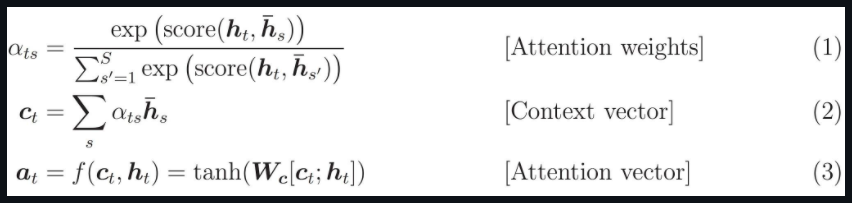

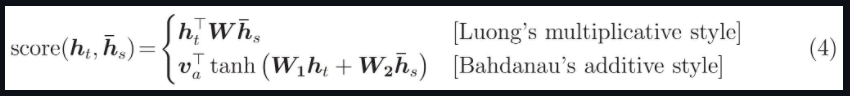

The attention computation happens at every decoder time step. It consists of the following stages:

1. The current target hidden state is compared with all of the source states to derive attention weights.
2. Based on the attention weights, we compute a context vector as the weighted average of the source states.
3. Then we combine the context vector with the current target hidden state to yield the final attention vector
4. The attention vector is fed as an input to the next time step (input feeding)

The way of comparing the source states with the current target hidden state has been researched and Bahdanau' additive style has been employed in this notebook (**Formula 4** in above figure). There are other comparative measures such as Luong's multiplicative style as well as their variations and combinations. 

The comparison gives out a score when each source hidden state is compared with the current target hidden state. This score is fed to a softmax layer (**Formula 1**) that measures the score of the current hidden state against each source hidden state (which are the attention weights).

The weights are then assessed with the source states so that the model focuses on source input words where it should focus in translating the current target input (**Formula 2**). This produces a context vector that contains information where the context lies in the input sequence to translate the current word

The context vector is concatenated with the current target hidden state and then activated to get an attention vector (**Formula 3**) that encompasses all information of source input and for target input - everything upto the current target input state.

Also, the hidden state obtained during computation of attention vector is added as an input to the next word in target input so that the prior information is passed on in a sequential manner to its embedding and subsequent learning.

Notice the teacher forcing here during training when the target word is passed as the next input to the decoder. Again, as told earlier, it is an aspect only built-in during the training and the inference will act without it.

During the inference, everything is same except that teacher-forcing isn't implemented and the translated 'prediction' word from the model itself is fed as the next input to the decoder

I believe that was a lot to take in. Here are some articles I referred when I tried to understand it all and I hope that these will be able to get you some more in-depth knowledge and insights -

1. Base Article - https://www.tensorflow.org/tutorials/text/nmt_with_attention
2. Understanding Attention - https://github.com/tensorflow/nmt#intermediate
3. Understanding Types of Attention - https://towardsdatascience.com/attn-illustrated-attention-5ec4ad276ee3

**Let's begin with building the model**

An Object-oriented approach is applied as the libaries don't have predefined layers that can incorporate this architecture. There could be a way using backend Keras but I believe it would also require some modifications that can be done using a Class inheriting the backend classes.

##### Encoder Model

This should be quite simple to understand. A single lstm layer takes input from the embedding layer that embeds the tokenized text given as an input to the model

In [14]:
class Encoder(Model):
    
    # Intialize Model's Instance's parameters
    # the encoder parameters intialized above are taken as the default parameters for encoder
    
    def __init__(self, inp_vocab_size, inp_embed_size, inp_lstm_cells, batch_size, inp_len):
        
        super(Encoder, self).__init__()
        
        self.inp_embed_size = inp_embed_size # Initializing size that the Embedding layer outputs
        self.inp_vocab_size = inp_vocab_size # Initializing the vocabulary size of source text
        self.inp_lstm_cells = inp_lstm_cells # Initializing the number of hidden cells in the lstm layer
        self.batch_size = batch_size         # Initializing the batch size
        self.inp_len = inp_len               # Initializing the maximum input length of any tokenized source text
        
       
        # Initializing an Embedding layer here
        
        # vocab_size given as the range within which it has to work
        # embed_size denoting the embedding output size
        self.enc_embedding = Embedding(self.inp_vocab_size, self.inp_embed_size, trainable=True)
        
        # Initializing an LSTM layer here
        
        # lstm_cells denotes the number of hidden cells inside the layer
        # return_sequences and return_state give out output of LSTM cell and its state at each time step
        self.lstm = LSTM(self.inp_lstm_cells, return_sequences=True, return_state=True)
      
    
    # Use 'call' function to make the Encoder Model produce actions that you would want it to
    
    # Takes the source input sequence as first input and a hidden state as the second input
    def call(self, inp_sequence, hidden_sequence):
        
        # First, call the embedding layer defined above to embed the source input sequence
        emb_output = self.enc_embedding(inp_sequence)
        # emb_output shape = [batch_size, max_source_inp_length, embedding_size]
        
        # Second, call the lstm layer defiend above to use the embeddings to store information
        # of the sequence with the initial state provided
        inp_lstm_output, state_h, state_c = self.lstm(emb_output, initial_state = hidden_sequence)   
        # lstm_output shape = [batch_size, max_source_inp_length, lstm_cells]
        # state_h shape = [batch_size, lstm_cells]
        
        # 1. lstm_output contains output of the LSTM from all time steps
        # 2. state_h contains output from the last time step
        # 3. state_c contains the information of the state of the LSTM at the last time step
        
        # return all the outputs at each time step (lstm_output) and the output at the last time step (state_h)
        return inp_lstm_output, state_h

    
    # This function is meant to initialize the hidden weights of the lstm layer
    
    def initialize_hidden_states(self):
        
        # There are two sets of initializations made - for the hidden cell input (h at t-1) and hidden cell state (c at t-1)
        return [tf.zeros([self.batch_size, self.inp_lstm_cells]), tf.zeros([self.batch_size, self.inp_lstm_cells])]

In [15]:
# Initialize an instance of the Encoder model above with the defined parameters

enc_model = Encoder(inp_vocab_size=vocab_size_input, inp_embed_size=inp_embed_size, inp_lstm_cells=inp_lstm_cells, 
                    batch_size=batch_size, inp_len=length_input)


# Test the working below

# Initialize hidden states
initialized_hidden_states = enc_model.initialize_hidden_states()

# Feed an input and see if the model produces an output
enc_out, enc_state = enc_model(lang_input[:batch_size], initialized_hidden_states)

##### Attention Layer

Here, we define the attention layer that takes all the outputs of the encoder and the current hidden state to generate attention weights and context vector. These will be subsequently utilized by the Decoder Model

Refer Formula 1, 2 & 4 to understand the working below. Formula 3 will be applied in the Decoder Model

In [16]:
class Attention(Layer):
            
                                        # Default parameters supplied (same as encoder)
    def __init__(self, attention_units, bs = batch_size, inp_len = length_input):
        
        super(Attention, self).__init__()
        
        self.W1 = Dense(attention_units) # Initialize a Dense layer with neurons = number of attention_units
        self.W2 = Dense(attention_units) # Initialize a Dense layer with neurons = number of attention_units
        self.V = Dense(1)                 # Initialize a Dense layer with neurons = 1
        
        self.batch_size = bs
        self.inp_len = length_input
    
    
    # This function is executed when an instance of this class is called
    
    # hidden = output of the current target state
    # output = all outputs of the encoder model
    def call(self, hidden, output):
        
        # the shape of the hidden input is extended i.e. from [batch_size, tar_lstm_cells] to [batch_size, 1, tar_lstm_cells]
        hidden_extended = tf.expand_dims(hidden, axis=1)
        
        # hidden_extended shape = [batch_size, 1, target_lstm_cells]
        # output shape = [batch_size, max_source_inp_length, source_lstm_cells]
        
        # Formula 4 i.e. Bahdanau Attention applied here to generate a score
        score = self.V(tf.nn.tanh(self.W1(hidden_extended) + self.W2(output)))
        # score shape = [batch_size, max_source_inp_length, 1]                                     #### check this
        
        # Formula 1 applied here to get the attention weights (notice axis = 1) 
        # since we have to compute a weight to each source input, the softmax is applied at axis=1 of score
        atn_weights = tf.nn.softmax(score, axis=1)
        # attention_weights shape = [batch_size, max_source_inp_length, 1]                         #### check this
        
        # A part of Formula 2 is applied where we multiple the attention weights with the outputs from the encoder model
        context_vector = atn_weights*output
        # context_vector shape = [batch_size, max_source_inp_length, source_lstm_cells]

        # The second part of Formula 2 where the multiplied product is summed against each source input
        # the axis=1 here has the same reasoning wherein we want to sum the values to get one vector for each source input
        context_vector = tf.reduce_sum(context_vector, axis=1)
        # context_vector shape = [batch_size, source_lstm_cells]
        
        # return the context_vector and the attention_weights generated from the above operations
        return context_vector, atn_weights

##### Decoder Model

This is the most difficult architectural formulation of the model. Please look at the operations step-by-step

Both Bahdanau Attention and Decoder operations will be performed in this class to generate predictions. Formula 3 of the Attention mechanism discussed above will be implemented in this class as well

In [17]:
class Decoder(Model):
                    
                        # Providing parameters to decoder to generate layers
    def __init__(self, tar_embed_size, tar_vocab_size, tar_lstm_cells, attention_units, 
                 batch_size=batch_size, tar_len=length_output):
        
        super(Decoder, self).__init__()
        
        self.tar_embed_size = tar_embed_size # Initializing size that the Embedding layer outputs
        self.tar_vocab_size = tar_vocab_size # Initializing the vocabulary size of target text
        self.tar_lstm_cells = tar_lstm_cells # Initializing the number of hidden cells in the lstm layer
        self.batch_size = batch_size         # Initializing the batch size
        self.tar_len = tar_len               # Initializing the maximum input length of any tokenized target text
        self.attention_units = attention_units  # Initializing the number of units for the attention layer
        
        
        # Initializing an Embedding layer here
        
        # vocab_size given as the range within which it has to work
        # embed_size denoting the embedding output size
        self.dec_embedding = Embedding(self.tar_vocab_size, self.tar_embed_size, trainable=True)
        
        
        # Initializing an LSTM layer here
        
        # lstm_cells denotes the number of hidden cells inside the layer
        # return_sequences and return_state give out output of LSTM cell and its state at each time step
        self.lstm = LSTM(self.tar_lstm_cells, return_sequences=True, return_state=True)
        
        
        # Initializing an Attention layer here
        
        # attention_units denotes the number of neurons inside the layer
        self.attention = Attention(self.attention_units)
        
        
        # Initializing a Final Dense layer here
        
        # takes the same number or neurons as the vocabulary size of target text (producing a probability value for each word)
        self.final_layer = Dense(self.tar_vocab_size)

    
    # This call function is executed when an instance of this class is called
    
    # x = input to the decoder
    # hidden = output of the current target state
    # enc_output = all outputs of the encoder model
    def call(self, x, hidden, enc_output):
        
        # Applying the attention on hidden state of current target state and output from the encoder
        context_vector, attention_weights = self.attention(hidden, enc_output)
        # context_vector shape = [batch_size, lstm_cells]
        # attention_weights shape = [batch_size, max_source_inp_length, 1]                         #### check this
        
        # Apply embeddings on the decoder input
        emb_output = self.dec_embedding(x)
        # emb_output shape = [batch_size, 1, embedding_size]
        
        # Performing part 1 of Formula 3 i.e. concatenation of context_vector and embedding output
        # context_vector shape is expanded first from [batch_size, source_lstm_cells] to [batch_size, 1, source_lstm_cells]
        x_context = tf.concat([tf.expand_dims(context_vector, axis=1), emb_output], axis=-1)
        # x_context shape = [batch_size, 1, lstm_cells+embedding_size]
        
        # Performing part 2 of Formula 3 i.e. activating it using as LSTM layer
        # Running the x_context through as LSTM layer that learns the sequences
        tar_lstm_output, tar_state_h, tar_state_c = self.lstm(x_context)
        # lstm_output shape = [batch_size, 1, lstm_cells]
        # state_h shape = [batch_size, lstm_cells]
        # state_c shape = [batch_size, lstm_cells]
        
        # The output is reshaped here in order to be fed to the final Dense layer
        tar_lstm_output_reshaped = tf.reshape(tar_lstm_output, shape=(-1, tar_lstm_output.shape[2]))
        # tar_lstm_output_reshaped shape = [batch_size, lstm_cells]
        
        # the final dense layer outputs a score for each word that may be considered as a prediction
        # for this reason, the complete target vocabulary is provided as number of neurons to this layer
        word_prob = self.final_layer(tar_lstm_output_reshaped)
        # word_prob shape = [batch_size, tar_vocab_size]

        # return the word predictions, last output from the decoder LSTM and the attention_weights
        return word_prob, tar_state_h, attention_weights

In [18]:
# Initialize an instance of the Decoder model above with the defined parameters

dec_model = Decoder(tar_embed_size=tar_embed_size, tar_vocab_size=vocab_size_output, tar_lstm_cells=tar_lstm_cells, 
                    attention_units=attention_units)

# Test the working below

dec_out, dec_state, atn_w = dec_model(tf.random.uniform((batch_size, 1)), enc_state, enc_out)

We are finally finished with setting up the Encoder and Decoder Model Classes

We can now begin setting up the loss function that will be monitored and reduced as the training progresses

In [19]:
# Adam optimizer will be implemented
optimizer = tf.keras.optimizers.Adam()

# An instance of the SparseCategoricalCrossentropy Loss with some required arguments that define how it has to perform
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# from_logits - unnormalized predictions passed (notice no softmax applied in the final layer)
# reduction = 'none' - returns the full array of the per-sample losses in the batch

In [20]:
# Initializing Loss function here
def loss_function(real, pred):
    
    # mask shape = [batch_size, ]
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # tf.math.equal returns True when values are equal to 0
                                                #tf.math.logical_not inverses the above (True<==>False)
        
    # The mask is meant to only take losses where there is an actual word that exists i.e.
    # not for cases where the padding has been placed to put 0 as a token

    # Compute loss using real and pred values    
    loss_ = loss_object(real, pred)
    # loss_ shape = [batch_size, ]
    
    # casts mask variable as a tf loss type variable
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    # multiplies loss with mask (this operation will nullify any loss values where the padding has been put in place)
    loss_ *= mask
    # loss_ shape = [batch_size, ]

            # tf.reduce_mean computes the mean loss
    return tf.reduce_mean(loss_)

In [21]:
# Some other helper functions initialized below


# Function for shuffling the dataset for fitting the model with (implemented every epoch)
def shuffler(lang_inp, lang_out):
    
    n_elem = lang_inp.shape[0]
    indices = np.random.choice(n_elem, size=n_elem, replace=False)
    
    return lang_inp[indices], lang_out[indices]


# Function for generating a batch of data from the dataset provided
def generator(batch_number, lang_input, lang_output):
    
    if len(lang_input) <= batch_number*batch_size+batch_size:
        
        return (lang_input[batch_number*batch_size:], 
            lang_output[batch_number*batch_size:])
    
    return (lang_input[batch_number*batch_size: batch_number*batch_size+batch_size], 
            lang_output[batch_number*batch_size: batch_number*batch_size+batch_size])

#### Section 4 - Training the Model

Now that all parts of model building are finished, we can now proceed with training the model

In [22]:
# Function to call for training every batch

@tf.function  # Decorator - Compiles the function below into a callable TensorFlow graph
def train_step(inp, targ, enc_hidden): # runs for a single batch
    
    # initialize loss as 0 for the batch
    loss = 0
    
    # uses gradient tape so that differentiation takes place accordingly to update gradient and weights
    with tf.GradientTape() as tape:
        
        # get the output from encoder model
        enc_output, enc_hidden = enc_model(inp, enc_hidden)
        # enc_output shape = [batch_size, max_source_inp_length, lstm_cells]
        # enc_hidden shape = [batch_size, lstm_cells]
        
        # assign enc_hidden state as dec_hidden state
        dec_hidden = enc_hidden
        # dec_hidden shape = [batch_size, lstm_cells]
        
        # for each sample in batch take starting index as the same as 'start' taken from target tokenizer
        # use the above as the first input to the decoder model
        dec_input = tf.expand_dims([tokenizer_output.word_index['start']] * batch_size, 1)
        # dec_input shape = [batch_size, 1]

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]): # run for the complete length of target outputs
            
          # passing enc_output to the decoder
          predictions, dec_hidden, _ = dec_model(dec_input, dec_hidden, enc_output)
          # predictions shape = [batch_size, tar_vocab_size]
          # dec_hidden shape = [batch_size, lstm_cells]
          # targ[:, t] shape = [batch_size, ]
            
          # compute loss for the word predicted (t) after the previous word supplied for all samples
          loss += loss_function(targ[:, t], predictions)

          # using teacher forcing (take the next word as an input to the decoder model)
          dec_input = tf.expand_dims(targ[:, t], 1)
          # dec_input shape = [batch_size, 1]
    
    # computing batch loss by dividing the total loss with the length of target
    batch_loss = (loss / int(targ.shape[1]))

   
    # As the loss has now been computed, let's notify the model to optimize the gradients
    
    # collecting all variables to compute gradient
    variables = enc_model.trainable_variables + dec_model.trainable_variables
    
    # compute the gradients. (loss is differentiated against variables)
    gradients = tape.gradient(loss, variables)
    
    # Applies gradients to variables
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [23]:
# The training will now be carried here

EPOCHS = 20 # Initialize the number of epochs to run

# To store loss of each epoch
loss_history = []

# Computing number of batches
number_of_batches = lang_input.shape[0]//batch_size
    
# Splitting the dataset at the end to form full batches
lang_input_split = lang_input[:number_of_batches*batch_size]
lang_output_split = lang_output[:number_of_batches*batch_size]
    
    
for epoch in range(EPOCHS):
    
    start = time.time()
    
    # initialize hidden states of encoder for the epoch
    enc_hidden = enc_model.initialize_hidden_states()

    # total loss is 0 for the epoch
    total_loss = 0
        
    # Shuffle the dataset here
    lang_inp, lang_out = shuffler(lang_input_split, lang_output_split)
    
    # run for all batches of inputs and targets
    for batch_number in range(number_of_batches):
        
        # Generate the batch to be sent to the model for training
        inp, targ = generator(batch_number, lang_inp, lang_out)

        # apply the train step function declared earlier and get the loss for the batch
        batch_loss = train_step(inp, targ, enc_hidden)

        # add the batch loss to total loss for the epoch
        total_loss += batch_loss

        # printing some summaries inside the loop
        if batch_number % 200 == 0:
              print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch_number,
                                                       batch_loss.numpy()))
    
    # Appending the total loss of the epoch here
    loss_history.append(total_loss / number_of_batches)

    
    # printing epoch summaries here
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / number_of_batches))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
        
    # The below set of checks are made to ensure that loss is reducing with each epoch. It it is not, break out of the loop
    if epoch >= 2:
        if loss_history[-1] >= loss_history[-2]: #patience is 0
            print("breaking now as loss isn't reducing")
            break

Epoch 1 Batch 0 Loss 2.8848
Epoch 1 Batch 200 Loss 1.6666
Epoch 1 Batch 400 Loss 1.4412
Epoch 1 Batch 600 Loss 1.4718
Epoch 1 Batch 800 Loss 1.1865
Epoch 1 Batch 1000 Loss 1.1658
Epoch 1 Batch 1200 Loss 1.0912
Epoch 1 Batch 1400 Loss 1.0155
Epoch 1 Loss 1.3403
Time taken for 1 epoch 254.22027111053467 sec

Epoch 2 Batch 0 Loss 1.0919
Epoch 2 Batch 200 Loss 0.8893
Epoch 2 Batch 400 Loss 0.9480
Epoch 2 Batch 600 Loss 0.8825
Epoch 2 Batch 800 Loss 0.9154
Epoch 2 Batch 1000 Loss 0.9693
Epoch 2 Batch 1200 Loss 0.8597
Epoch 2 Batch 1400 Loss 0.8312
Epoch 2 Loss 0.8918
Time taken for 1 epoch 219.46919178962708 sec

Epoch 3 Batch 0 Loss 0.6166
Epoch 3 Batch 200 Loss 0.6848
Epoch 3 Batch 400 Loss 0.6949
Epoch 3 Batch 600 Loss 0.6947
Epoch 3 Batch 800 Loss 0.6166
Epoch 3 Batch 1000 Loss 0.7079
Epoch 3 Batch 1200 Loss 0.7098
Epoch 3 Batch 1400 Loss 0.6337
Epoch 3 Loss 0.6891
Time taken for 1 epoch 223.3612380027771 sec

Epoch 4 Batch 0 Loss 0.5241
Epoch 4 Batch 200 Loss 0.5809
Epoch 4 Batch 400 L

#### Section 5 - Inference from the Model

**Firstly, let's store model weights**

In [24]:
enc_model.save_weights('enc_eng_fra_weights.h5')

In [25]:
dec_model.save_weights('dec_eng_fra_weights.h5')

As described earlier, the inference will happen with feeding the predicted value from the previous time step to the next time step. The inference will be performed below

### Greedy Search

**Greedy Search is the most basic inference algorithm. It takes the word with the highest probability at each output from the decoder input. This word is then fed to the next time step of the decoder to predict the next word until we hit the 'end' signal**

In [26]:
# Function for processing the sentence first before its translation

def preprocessing_sentence(w):
    
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = 'start ' + w + ' end'
    return w

In [27]:
# Function to translate the sentence

def evaluate(sentence):

    # process the sentence first
    sentence = preprocessing_sentence(sentence)
    
    # transform the sentence to its tokenized form
    inputs = [tokenizer_input.word_index[i] for i in sentence.split(' ')]
    
    # Pad the tokenized inputs with 0
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                             maxlen=length_input,
                                                             padding='post')
    
    # Convert the datatype to tensorflow-tensor
    inputs = tf.convert_to_tensor(inputs)
  
    # initialize to store the result
    result = ''
    
    # initialize hidden weights of encoder
    hidden = [tf.zeros([1, inp_lstm_cells]), tf.zeros([1, inp_lstm_cells])]
    
    # get the output of the encoder using initialized weights
    enc_out, enc_hidden = enc_model(inputs, hidden)

    # initialize decoder hidden weights same as encoder hidden weights
    dec_hidden = enc_hidden
    
    # intialize the decoder input as the tokenized form of 'start'
    dec_input = tf.expand_dims([tokenizer_output.word_index['start']], 0)
    
    # run for the maximum length of target language
    for t in range(length_output):
        
        # get the output of the encoder based on the outputs provided from encoder
        predictions, dec_hidden, attention_weights = dec_model(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # get the argument(token) for the word that is given maximum probability score by the model
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        # check if 'end' is hit on the outputted word from decoder model
        if tokenizer_output.index_word[predicted_id] == 'end':
            return result, sentence
        
        # Get the word based on the token and add to result
        result += tokenizer_output.index_word[predicted_id] + ' '

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence

Running some evaluations below

In [28]:
evaluate('it is very cold here')

('il fait tres froid ici ', 'start it is very cold here end')

In [29]:
evaluate('this is coming good')

('ca arrive bien ', 'start this is coming good end')

In [30]:
evaluate('You may speak')

('vous pouvez discuter ', 'start you may speak end')

### Beam Search

**Beam Search is slightly complicated. It produces K (which is user-defined) number of translations based on highest conditional probabilities of the words**



Suppose we take k=3 (see below pic; reference:- https://www.youtube.com/watch?v=RLWuzLLSIgw&t=360s&ab_channel=DeepLearningAI)



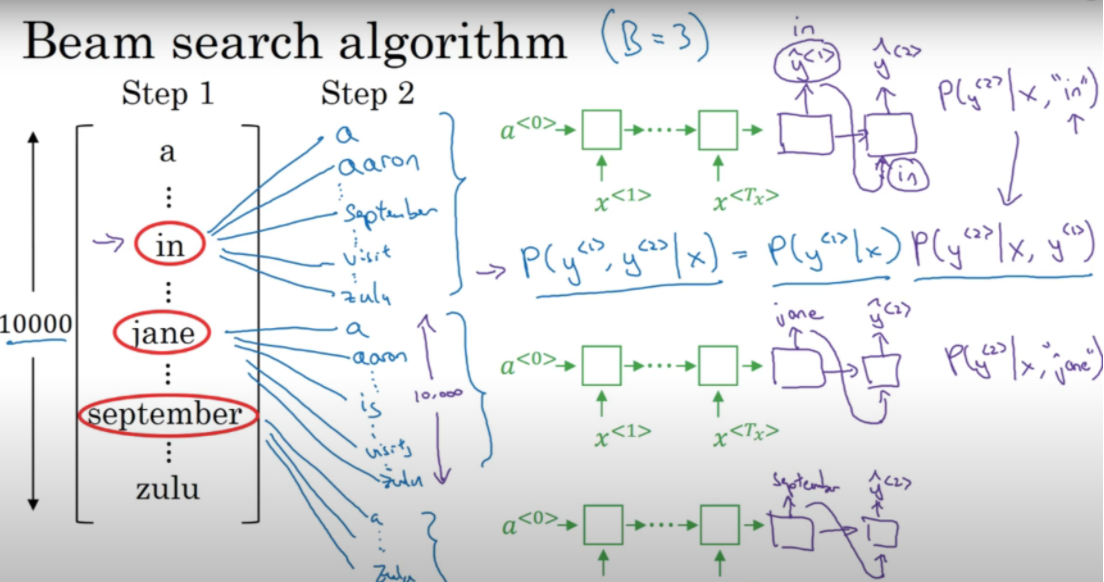

In [53]:
base64_data="iVBORw0KGgoAAAANSUhEUgAABFAAAAJGCAYAAAB82HGAAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAP+lSURBVHhe7H11mBXH8nbwxd3dIbhDcEgCJFhwgru7+6KLuyy2i64B6+7u7u7OYknu7/vz/ap6zpw9uxwSkhuI3NnneZ+zZ05LdVV1dVVNT88XJiYmUKBAgQIFChQoUKBAgQIFChQo+LfB2NgYjx8/xv3793H79m3cvHkTN27cwPXr18XnrVu3cOfOHRgaGuLp06eivLZ2+O8LMzMzKFCgQIECBQoUKFCgQIECBQoU/BthamoqkiBGRkYCnCiRwd/lpAmX01afIRIoz58/hwIFChQoUKBAgQIFChQoUKBAgQLtEAkUCwsLKFCgQIECBQoUKFCgQIECBQoUKNAOkUCxsrKCAgUKFChQoECBAgUKFChQoECBAu0QCRRbW1soUKBAgQIFChQo+ByweQ82NvL/1irw/9rqKlCgQIECBQr+KogEir29PRQoUKBAgQIFChR8LtgJ2BFsVZ8SbAWk37XVU6BAgQIFChT8VRAJFEdHRyhQoECBAgUKFCj4fHAg2BKs7B3wwtqWYAMrOzvYOjiI37TVUaBAgQIFChT8dRAJFGdnZyhQoECBAgUKFCj4hHByhpOTkwT67kiwdHDE4xfWuHTfGBfuPsV9Y3OY2zrAkcpqbUOBAgUKFChQ8JdBJFBcXV2hQIECBQoUKFCg4BPBheECFxdnuLg6wcnVBbZOLtA3s8b6U/cxctU5DFuhh3n7r+HcI3PY0G9a21Gg4iWDeaQNGmUVKFCgQIGCPxEigeLu7g4FChQoUKBAgQIFnwBuMtzgRnBxc4WtiytuG1lhw6n7+GatHoavOocRa85j7JrT2H7hCcztnEVZre39j8ONeMm8EXB3g6sG+LubljoKFChQoEDBnwGRQPH09IQCBQoUKFCgQIGCTwQPCR4eHnAmB+yhrQs2nr6HCRvP4rttl7H+3GMsOnIP32y8hE3njGBu5woPbe38D4P5wXAnuBAPbR2cYPrCAqbmVrC0c4SjqzvciL8ezGdRx4N4zni/LQUKFChQoOCPQCRQfHx8oECBAgUKFChQoOATwcsb3gQPgo2LB048tMX3W85h8vZL2HfbHPetXXH4pikWHtDHgRsvYOPsCW9t7XwUvMtBW5l/HpgfXgRPb284uLrjnrE59p26gl16N6Cnb4QH5o6wcfWAq6cXlfGCN8GHyvp4U31N/At5808Ay69UpzVloMhBgQIF/xyIBIqfnx8UKFCgQIECBQoUfBr4+pHj5ecLJy9v3LdwxKxD9zB+0yUcuPIYL+xd4O7pjeeWttB/ZAojCzu4Uzlt7XwcfMrBl6Ct3D8TPr5+sHb2wNG7LzBl2wUMXX0Bw9dfwdxjD3DssTXMnNzgwskTXy/4UnDu60Pj96G6DF/mxb+XN39X+BJ8+JNk5yegyEGBAgX/TIgESkBAABQoUKBAgQIFChR8KvjD298fz5w8sP/aE4xcdQKLTzyCgYUL3L05eKTfKdB39/aBJweXVFZ7O+XB5crDrxy01fvnwp/g7uMPE2cfXDFzwx59a8w7dBfj15/FhE1nsf2qMQxt3ODMu00oMPf3Jx4QfwOYpwR/NV+YV9r7UPDngmXm5y/BX6C8niqyUKBAwT8DIoESGBgIBQoUKFCgQIECBZ8OHPRfNXXE3AM3MGnzWZx4aA1bdx8KLv0RSE4ZIyAgUCAwkL4LvN9OWcjlZFBbZfAxbfzz4E/wpkDczScANi7euPvMDruuGuGHPTcxbrs+1l4wwl0LB7j4+iIg0I/qyHwgHgu+vN+mgk8HP78AuLt7wdnJDd5eJBN/WTf/nfqpQIGCfy9EAiU4OBgKFChQoECBAgUKPg0CCfaefjig/wLfbrmI9WcM8djBA14BgfR7EIKDJASpPoODVdfLtfM+uJxcVoZ8TYa2ev8GSOMNCgqEp38Anrn6QO+xE6YfuI+JWy9h04VHMLR1hwfvQKEych0u/35bCj4ZgoLh4uwNw3vPce2yIWysHOHn648glgX9LkNrXQUKFCj4m0EkUEJDQ6FAgQIFChQoUKDg08AvJBQmTp5Yfe4Jxm+9gktPbODkE4CgkBDxe4gKoaH8PVgD77eliRAqL9XTBLchtyO1/++GNN5A4rGrbwjx1g7zDt7G+G03se6iKYyJ716B5PhyWea3iucKPg9CgkPxzNgFe7Zew9oVunj8wBy+Pv5q3WW5lOq/AgUKFPy9IRIoERER+HMR/hvQVudDKFs3XCACYeXA12Rob0eBAgX/NGib1/J3zXmvWed/FTIvwsNLoeaR6nuEJui6gj8GNa/Fd8016v2ynxJl6Sh7TZkfnx8yv2Wea34PCw+HOwWRF55YYca+65hx6C6MHb3hS9fCwsivYVAZyccJo/qaUOlXuTnM5bndUAb1oQm5nbJt/TV6+slB448Ip7ESmB/BBBf/UFw0dcecwwYYv+Ecdt+ygIVnEPxDJX5xOcFvgtY2Ffx5IF0NI75bm7tC79gdHD10FbZWLggKDFHrcBiXETotobyuq6GtfQUKFCj4zBAJlKioKPx5iFQhApGRtDAx1Iv2H1moytdXtREZKYH6LA/tdClQoOCfhkia4+Uh24Zw/p+vaan3vwY1b2SU45HgUySV1YSWdhT8Nljf5LVG0j1pvZPA/79f51MhkvrTnBtCB5T58ZdB1g3+lCF0heZbaEQkTNwCsO6sIabuvoxd98zhEhhKwTzJiH4TEPJiaOqTBjTmL8/ncKoTFBYOr4BgOHr4wNbNC/b06eYbhEBOFNDvEeyLqdv7/Dr6yUE8k6E5DzgYd/ANgd5Te8zYfwff7nmAM0+d4Ui8CWa+aJTV2q6CPwcqXY0kPfcn3tvbusDW2gmBpLOcEFHrvVxOBU1dLwNtfShQoEDBZ4ZIoERHR+PPBy3swYFwdXOGlbUlLC0tYGVlCWsrKwErDVgyLKVPKytr6ZqlVEddz5p+I/Cnnb0dXN3dxCvRgkNCxJ024bRQvwzt9EQjSss1BQoU/L3AhonvSvE5AHxKv4+PNzw9PeDm5gonR0fY29vDwdkZ3gGBFCRGaW3jfwHsdPI2wqBATT65w9WVggQHB9ja2cPWwRk+/gFkIylI4HpR77ej4PeDeSmCtLAwhIhHAUJE0kIkK8qV/Vhwvd+uyws3J0mo3+BgceCor58vvL284OHuDhcnZzE/bB0d4OLtjRCaR3+UHgV/DOXlyP+zXxIUHoWLz70w4+BtLDh+G7fs3BDAgSPJVMzL3zk3gyKiYOcTAn0LTxy8bYmtl4yw4cITbLpojL23rHHthRfMvYPhHRaOUE4SkE8WTboTTTpa2g7//zexoVp5wLQRzWra+f/yZT4AGicnSqy9g3DYwA7jdtzBouMPcMPcFR6h4Yigtpn3UX+X8f+boZJtFOlsRFgkwkMjEBVZev2joK1dBQoUKPiLIBIosbGx+LMRExMlkicXLp7DuvVrsHr1SqxetRIrly/H0iVLsHjRIixcuJDAn4uwgLBo8RIsX7ECq1atEli5ciV9Ur3V9J2wYuVyLFu2FKvWrMKuPbtx9vwFGBg+gKW1tXi3fBg7Cdx3OVoEPSqUv65AgYK/D2JiYkRQ6uDggDt37uDSpUs4fVoPR48ewT6a81s2bcSatWuxbfdeGJq8QFBYxP/kvGbjzaeAm5qY4OaNG7h48SJO652C7pH92L1rGzZuWI+Vq9Zg/eadePDUBAEhYYjmujHvt6Xg94ODM18fHzx//hwG9+/j0ePHcHJ2QTDpbmR0zO/WSS7P8mHEsIw+KCcKxiNC4eXhikcPDHHt6hWcPXsGx48dxcF9+7F961aspfmxdvMmnCa9cKd1kQN47W0p+BQo72vw/5EkT7+wKOw1cMKkA/ex5boxLH38EUHyjCHExsaoy/8qVLoRRbD3C8PJJ06Yo/sIY7ffxdhddzFu932M2WmIsTsfYMaRJ9h11wr3rD1g7xMiEjhCF8jGMrjf0r4/sv9PBdW4GDL/YogmicYomhOR9FsEgT+Z/rJ1PgRuJyQqBs88grHqoim+3X4N66+YwdgtAKG8E4fajhY8oPIKPg1keUSroCEfrdDWhgIFChT8zSASKHFxcfhzQQtXTBSsrS2xY+c2jB07BiNGDMfQIUPQvUsX1K9TBxUrVECFL77AF19UwBcVKqJipSqoUbM22nfoiAEDB+Krr74SGDZsGIYOHYIBA/qja7euaNykMWrXqY0mTZvQ9+4YMWo0Fi5dirOXLsPW0RkRUdJiyDRop02BAgV/V3ACxdvbG6dPn8a4cePQu3cvdOnaBW3btEHTxo1Qp3Yt1KhVC52+7I09Jy/CKzCEnGTtbf2bwbsfHOwdsHL5CrKrQ9GzZ0906dIZrVu1QKOG9VGrZk3o6NRE8zadsP/oKXj4BVCgQHWFbXy/PQUfj9iYaIQF+eP29Sv4ce5cDB8+HF9/8y127j0IK3tnhEZGIVZLPW2IKQdpYabf1DpN8qJAMi6OwddjEBLgh6f372DGlCkY0K8futG62K5tWzRv2hT16tSFTvUaaNC8JWYsWw1rWhMjaU3U7FPB5wXrQgQFhm6B4Vh3xRzTjjzGqScO8A4NJ5lLvgqX+SidIb3geRwYEYsrZl6YdfABvt1yDRsuPMOxh644Y+KJ40/cse26NWbsvYNvN1/G7H33sOemLYxcguEdEY0olR2IJZ1i/F1sAttxpi2MEEI0BdFaEEgIpvkWGst0S8keMR8EqN5vgdqNJvhHxeCBow8WHjPA1P13cMTQFq4h4QjnBEocz1fFLn4yyLKIUUFTPtqgrQ0FChQo+JtBJFASExPx5yIBCQmxCAsLhrOzA0xNTWBiYownjx/hrJ4eZv8wHY0a1EelSpVQoUJFVKpcFQ0aNcPE76fgOP1u+PAhjIyMBJ4+fUp4ggcPDXHt+nUc0dXFwgUL0LdPHzSoXx81a9ZAI3Ic+w0agjUbt8DshYW4yxKfEE90EBISCEQTQyutChQo+LsgPj5ePJZiYmKCw4cPYfOmDZg9Yyp6dOmI2tWroUrFiqhaTQcdvuyD3XpX4BMSQXNde1v/ZrDx9vPzw7UrV7Fvz15s2LABM2f+gK6d26N2TR1UIj5VqaKDFm274MCJM/AKCEIs28SEOKpPNlFLmwp+Gwm0nkRHRsDNzhILZkxBmxbNUaN6DdSp2wC9+g3CiQvX4B0Y8ps6mUCIJ8QxqM04kg3rfgIhMZ7kwxDy4u8kMwavq/QZHRYCVxsrnDl+HLu2bcOSRQswdNAA1K9TG1UqV0LFSpVRr1krzF6xEXYuHuIuvLIGfibIfJZ5TZ8JhAgKDO19g7HwxCPMPWmKe9a+IlmQQHJOiCddoDKsC6wX77UpQ9VWVFw8rN0Dsf6sCSbufoCtN21h7RsGn7BYBEaSXYiIhUtAOO47+WP3PQf8cNgI32y/i6XH7+O2tYfYCRNHehafGCfANCQSDVr7/AzgMccSDWFRcWTPY2DpFYz7Nu64+swBl80ccOOZE4xd/OEVwjtGiF6yYYwyvt0HwPM1nhBD4w2MjMGF516Ydewh5unewU0rN/hHRSAmIYpo4PlFdRT8udCUB+uYDM3r5aGlDdZ7htbfFShQoOAvgEigJCUl4c8HG7x4cvSl7eYMPuTLw9UV506dRM9unVG1chVUqFCJAqKa6NilBw7oHoWrh4c43EuuI4EPmIoQrzvjc08sLSxw4ugRTBg7Eg3q1KRAoTJq1q6Drt17YvGyVXhuYYmomBgkEg2ClsTytClQoODvCjmJ4uXlBRdnRxg9uoedG1aiW9uWqE5zvUpVHbT/si92nbkKXwoGErS08W8HG2/erRDoHwAvD084OznB1Pgxtq5biu4dW0OnShVUFQmUrjhw8iy8gkJEgJZEQXj5thT8PkRHhsP+hTG+GTEY9WrXQsUKnKyqjpZtOmDn4RPw8A/S0Eleg2SUbYfBwV14SBD8vL0QGByMaE6gqMuzrAhCbqX1E+LiEB0eBj8fH3i4ucHyxTOcOnoQQ/v0QG2daqhYsRLqNW2D2Su3wt7NG7EUcGv2qeATo5y/kUjfQ2Li8MSRgvf9t7HyggXM3MMQX24uJmr8rx3ktJE+RJKOGFFbCw7fxff7DKFn7ImQ2ATEJJBuUF+cmONkaRD16RAQDX0rP2y++AzfbL+BZWdN8cjBD0HRcYiX9Yzp/Qt9pNC4BFh5h+GikRu2X7HEspMPMe+wPuYcuIW5B+5izkEDLDlphKOGjjDzCEF4LCd/VPNBpv1DoDLM1wTiW1xCHOyDIrH/znNM3XMVqy+bw9Y3HJHko8q+Is/b/8X15NOgrIziSW5xMfFIIF1NIl2V5aNZRgYnS+LIbsVExSE8OBohAVEIDYxCZGgM4mNU9dX9fMzcUaBAgYI/FyKBkpKSgs+C5GRyFkNgePsWvhrQB9WqVEWFLyqhevU66N13MK7evC1ev5dI5ZKofLK6bpJAMl1ncFLG080ZF/WOYPjA3qhRnZ3Gyqheow66dOuJrTv3wtXTS9zZE20kl4O6XQUKFPwdIc11MlKJ5ECF+ML04V1MpIC1bnUdsQOlfY9+2H32OvwiopH0vzqnadzJScQnMuR8NzYqMgxPDa7hu3FfoW7NGqhKQX3ztt1w4NQ5eAeHIp74mZKcSHWT329LwUcjPjYG3s52WD5/Njq0bYPatWujQcPGGDDkK5y9pg//sHCxfknlpbVLQlm+i7WM2jI3eYpzp47j0VNjBEdG05qlUYdlRjJOSaI6Kj1PZrlTXbFOUmAYGx0GJ5vnWD5nKpo3qItKYgdKW8xetR2O7r5id4NUp7RvBZ8QzGeZ1ywj+j8wOg5XzOwxfec17L5jD8fAGLouz0WCZp0PgnyglAREk8xfeAVhxenHmHbQEGdNPBAZx8kVyT+SypHMyS7EJyYjMCoeRi6BWHHZBhN238Xh+5ZwCo5A/O/q+9OA54lHWCzOPHbA/AP3MGWnAeYceYDlZ42x8bIFtl61wdordpita4QZBx9g+00rWLgHI4yCcB6vNDc0xlAOrPNJNEbmdVJSHMLi4/DIwRPLiXcT9z3ADTM3+IVyEp54R7QkqlDqeyr445D0i9eoeJKXh4svnO09EBIQhqQElhuVYX1lMP8TU5AQm4Sw4Gh4uQXB3toTZk/tce/GM9y8aAz9yyZ4et8K3q4hiI0i357rq/oqGy8oUKBAwaeHSKCkpqbicyEyLBSP7upj1KA+qC4SKJVRo0Y99B0wDDfu3EdYFAVEVC6ZkKKul6JC6feE+Gi4Olhg27olaN6koXAaK1SsjNp16mPYiLHQv/8A4dSWaCNFA+o2FGiHzGtNfitQwPgr9ILvXIXDmR+ZmPItGteuKT3C06Mf9py7gYDIWGErtNf9O+D386zU7n0EklUgY56YGAdHayMsnPU9GtWto0qgdMdBvfPwCQ0XgUFqavL7bXx2yDz5/bz5O4CTGrGRYTC8exuLFy3EyJEj8e2ECdh/6Agc3TwQm0CBsbq8zHNG2bFyoMtJr3MndDFn2hTonjgNn+BwqiuX115P1CWw3ifT/EhOjEKQjzP2b1yG9s0bojKthXU5gbJ6J5w8/EVwWL6+gs8H9mc8yU4dum+OH3ZdwlkTZ/hFs47IspWhvX4pOCBNRBzpjVNoDLZeN8eMI49w6qkbImITaX6zXpBjx+XkNtkuEILiknDHNQI/7LuFNecewdgrCHGyfv2FfhHrsWtgNI7fMceKIzdx8LY1DO0DYO0bDefgRLiGpMA+KBnXLHyx4JQxJuy6jV03LGFNdaIp4C7j22lB6TyhAJvXEgrofSJicd7UA5P33sX6M09g4haIyETmmVSeoY1WBX8EpI9kf8KDY6F/xRQX9O7BzsoFiQlJZWWVRHoaS7JxjcWTOy44c+Qx9m+9gc0rz2DNomNY9aMuVs3TxcbFetA/b45A70iRcJH7KRsvKFCgQMGnh0igpKen4/MgDdHhoXhy9xbGlEmg1Ee/AcNx464BImJikELlGGmqOunpqRLS+H/pWio5EiGBnrhx4Th6du+EalWriANp+bn/ps3bYcuug/DwDSDDSnVSqU6aCmXoUVAWGrwW0Fbmfx3MIxnafv+3QlM3Pv3Y02iuM9LTkpEYFwE3ByssmTYRTWvXQrVqOujYsx/2nb8p7uym/m1l8ft5xjYvtdy1X4Vs26j9lJQEuNqZYOncKWhcv65IoLRo2x2H9C7CNzwCSWlER1rK+218Vmjy5Pfx5u8EXjz58VJXV1fxJh5+BX9gUBDiE5OQwrqrLiuPkfnOn/J11u8kREUE4/DubZjyzTc4fFwPvqERSFXLSYbUhqwbaSTvVEKK+M4BcAxC/d1wePNydGjRQJVAaYfZa3bB2StA7IBgHeF6pf0r+FRgOZXKPx0JKemwCojFmkvPMO/ANejbuCGM9CSN5SpkLcm3rH5oA+kA2cN40g238FjsvGWJWUefQs/IE5HxKTS/2W8ix04FYT9Zz+j/WNIBi+AYLD1+DyvPPMIDjyDEUr+CBrUN+fNRnhflwb+FJqTAxj9SvCnHIyIO0UmcdEpDcgqNhz4TCH7xSbjkFIhZZ0wwaddtXLEORlBMsqTTvwJun+eJ5FNSkE2fsdSudVA0ttw0x5Sd13H0kTM8wxPEnFLXVdGn4L8F8Z10L8g/BnqHDbFv+wWYGdmIR3CE3qmQTDrgR/I/r2uMDYsvYe2P57B73S2cOWiCOxcc8fCaK27oWWH7sqvYvvwSrM3cER+bKPqQZfy71k0FChQo+C8hEigZGRn4LKAOYyLC8PSePsYO6oMaqkd4atSsh74DR+DmXUNExsQIQ5iaQQRmpFE9bWDik8n5DIDJgxsYPqQ/alTXobYqoGLFqqheqzFmzFuO5zZOSEpJRQYZ6Iw07r8cPX8IUv/af/sbgsesZdxphPRy16RxafK5/O+/Bc36/yAe/S7IY/x3jY91QUClL/L3Uv2R5fqZx05Ob1J8NNwdbLBs2kQ0EwmU6ujYoz8OnNdHcHS85KATTazTpfVU0Lz22fH7eSaNg8tr//19cLsSUlMT4GZvjGVzv0eT+tIOFJFAOc0JlEgkkTPL/Pxz5Sf3r32caj1SQy5XHppl/ig06SiPP3PMNCbSOQ5Q+TlYcfhrQjzxP0UdLJaW5b6Z5zJkWvgmQBxCAt2xdtkijB05GgePn4VPWBS1QWWobW11eU1Mo/qp1Law4enUZ0oswvxdcWTzYnRoXh+VK1cqTaB4B4o1kOd12l8+H/79YF0vv7bGJqXhgUskph0zwQo9Axi7+SImhQLIjBRpPgrI8i7bXhlQGZZ3UloKPCPisUvfFjOOmeKksS8iElORog78WU9UyRjWFfqMSk7F08BYzDv+EKvOP8VT7xDEU79cjv2yj7WVpfaJwfV+vS7zooxd1gKmOy45DTFJqUhMpXnBukrXpbEw/SmIprllGhiJ1Vef4+tt13DeIghBMZxc1N6mDG6H5wr7k6lEMyOZ+BManwhDaw9M3n8XSy5bw9QzEgkpxDf2ExkabSj4L8DyEwmUWJw6+Ah7t16B6VM7JCUmS3wmpKWkIzIoHgbXLLF+4Wkc22mIZw9d4OkSjCDfaEQEJyIyNAleLhG4fOwFVs85joc3rRAZEivkr23OKVCgQMGnhkigZGZm4vOAnInIcBgZlE2gVFclUG7deyBe0SeMIZXNyEynOprIKAU5H3ExQbAwuY/xo4aido3qIoFSoUJVVKnWAF9/PwePTCyQRI5DJhnZzAxt9PwRyDRo++1vCB63lrFnqFD+ehkea/3916BZ94/U/6fg3zc2tT6o9OV9/fiLZEuOb3JCLDwdbbF82kQ0VyVQOvXsj4MXbiMkJoEcJ4nWdIKa5g/o/efF7+dZBpWT7J72399HafvpaYlwdzDG8nmcQNHYgXLmEvwio5BCvMykAEJ7O38Ect+a9rlsmd/WIxmaZf4otLWrCW11/ix8qA+ZN5qgciSLpMQoONmaYMqE8Rg8cAj2Hz8H34gYEQjw7x+qK/NU0ncK+lLjEB7gBt3Ni9GxRT0pgdK8Heas3Q0XnyAk811eLv+Xz4f/DZTX+cj4VFyzDsLXB55g6/VnsPEPRUJ6Cv1GvgnPRzEnJdlqtvM+WC+kJEBQbDIOGbrgh6NmOPzQAyHxKUhR+zncFrcp6UoK6VNATDJOvAjElAOG2H3HGnah0UgWZaRy2vt7H6X2SYPeX9Gr8rz4EH6tXDr1FZmchnuuEVioZ4SZB+/C0D0ckYmcxNFeRwa3KXRfQPIr06i9hLRUuAVHYdlFc0w/aYarL7wQHpdEATnVU+bJnwjid2oaQgLioXfoCfZtvYpnRvZISWK/nH4nXqckpsPNLhS6O+5h+8pLML3vIhIqaclkt8SNT5JjWiZiwpNhctcTq+edwJUTTxHoEUW/S/2UWfsVKFCg4DNAJFCys7PxWZCVhfjoCBgb3sHYwX1Vj/CU7kDRv/8IMfEJyKByGdlZyMrOpHqayFIhE1lZqUiIC4H1s4f4dswI1KlZAxXlBIpOQ4z/bjYeGpuLLaDZZMSlelpo+t34s9rRhDwubb/9t9Dedla575rIovKZAtkfxIfrf8qxlIL710pDlgrafvuX4L2x/xljltvIlD61y/ljZSuX05y32sp9BLIykJoYBy8nO3UCRUckUAbg0MU7CGWnl+jNoLIMNc3yePh/ze/lr39qkC37vTyT7N7H8kyuRzYzIxkeTiZYPm9yaQKl3Zc4cu4yAqJjkJpF7RI/P77tXwPTyG0xSuUs62ZZvSmPUpr/HFo0Ub5tGb9C1yfTDe5X5o0KWekEkjEFcTGRgbh77QT69+qK3n36Y/+pC/CLiiMdlnRABpfPzqS2WJdU9PE4hK6TPDPTEyng8IDulrIJlNlr98DVN0QE1hlUj/E+jf8ltLQp06YNv64X/zIQb7JIZuFxybjwwhfj9j3CgXu2cBHJi3TiRSlK55GWdmSw3pC8M+gzPjUDVywCMOfEC2y+Zg33sDgkUaDJ/Ql94XnOTh7REEtlLbyj8eMZK0w7bIwbFt4ISUgmeynrmDRvtfb5Hsr7ZdLcKqvr8jUC68d/oXdMVxqNyTs6BQef+GLyISPsuPYCzmHxSKLgOYvXq3J1NKGpi9I4Jd8mjXgUlZSGE2a+mHnsMQ7ctRaH2abRPMv6L+hVwGD5q3SAZMe7TMICEnD60FMc2HYNz40dkZpCfrlKN5IS0mBp6o9tq25A76AhvJyDkZYk2Um5DMs5JSEDblah2LriPE7sMYS7XQTSUyV91PRX/6dsjAIFCv4yiARKbm4uPgtyspEYGwWTB3dVCZQq6gRKv0EjcNvgMeISk5CVk4Os3Bzk5GZTPU3kqED/56QjMT4M1mYP8PXo4aitSqBUrFgNVWs0weRZS/HM2okWxAzkkIHlvrXS9BmQw2OhMeWI/8v/rhqPQPnf/ltob1vQI37TLCvRJiP7I/D+WD49ytNXhoYcDWhe/xdBc/xi7Jpj/qhxy3OonPy5bnYpsum73MeHUKa+GrLOZWmAv2vp87dAcyaXHKP05AT4uDhgxfRJ6kd4OvcagMOX7yI8IQUZRGsmtc02g5HNc43ryjzRBm39/cnIoX5yiJf8qe33spD5JuNjeMVlZJDjmJVCzqcpVs6fjKb166KaSKD0gO75KwiKjSU+ZRMtLI+PafvXIPWXm0t2VS1fiWbWiw/pjfa2ZPwaTfIYNfFr5d7/jfuXbUaZ34Q+UJ1y+vL7aC+Fuo6sgxq8EWtQTqaQQWZ6CnzdbbFz/Xy0atYA3Xv2xcHTlxAQm0A6THIiZDNYZtlUV6VHalAf2dRmNrWXlZmMqGAvHN26BB1bqB7h4R0o6/bCzT8UqRnUH9XhOS10kaGi97+C3JaqPXnsMp/fB9H7Afn866DiC+sA70C5KBIoj3HE0Ake4XEigM8h2bH8smke5ZSxk+XaEuDrrFOSTqSTTpj5JmHFJXssPPYIzz2DkJDO7bGeUVusZ+TgZWTlwDcmBWefumDc9vtYe9MNtkHxSOaEnFrPJPmw7LT3XQrJd5DqSZDokmgvawvK6AdDS3u/BaYrjQLoF15hWHLeGlOOmuOeXRjCk3gnDPXB69WvtK2pj5rfswipFJSbBCZiyRkjrD3/FM99wpBCfOV5Ur4dBR8LWRdkHaB1KSMTEUFJOHvYCIe23YC5iZPYWSLpRQ6SE9NhYeInEiiX9J4i0Ddc1OG1n22fbEsz0rIQ6BGNg1tv4OhOQzhbRdA1SR8l21JW1goUKFDwKSESKHl5efgsICOXGBsN0w8kUO4YPhGv3WMDmJNHBOblUD1N5KrAhjkD8TEhMH14EyMGS2eg8CGylSpXR91GHbBq4164+wSKzDQv7HlkyPPIYOflvk9XeaaU/53r5KpBZYThl76/V1aFXEKOgDSWbBWkaxK4TC5dkxYdHpOqXYI2Oj8ILstjU0HTochj8HXV/3yNnZ4s4olwfkT/8nV5ASL6xFilT/l/AS7P/FfLQ6JBaoPHoVo46bvm7/8tJF6V8k6CxFvZ8RN8YDD/VDxU11PRry4jg377GMg8UstK/V3Vd5ky7//2e6Dm9Qfq81hYRppy0vxd1NXQA9kBYUjykR1d/p3aUOkcl+c5ypDHKfSB2pSRpfpknmr2qTk380TbHFyrkEf9CWjTGe1jFODrNG8zUhLh46qZQNERCZQjnEBJTBXOcDa1nUN95ORx3zzXmY4P9MX8KsezPxua8hN9imul3z90TYY0X1XtyfTKEH1wfU2QrLJS4e1ihpXzp6BpPc0EylUEx8ZREE28YTsoty/aKY/S9oQeCJ0pLVuWzlI9KYX0W3m7J9sVoasaKG2LgjGiTeio0ENVGZkWkq0MzX4YpXTxdZa/Svaa/XAZakttv0Q55gWXZX1h3tBv2VSOwHNCTiIy/eq69L10LknfJVmXQjMQlWinsgLME66bhbjoMDy8fRkTRg5A3Zo66NajDw6fuUxyShBlmDaRQGE6OXlCNGUzTaJ9qR+xTtJczs5KQXSIF45tX4aOLcsnUMIoUKQyKlsgeCsHnSqoeaRBt0Q78/9XIOrJ5WlcApLc1Wuc6jcZHOyIa3L/3IZmm6LO+7SUh9y/zHNt7fxlYFpU4DFGJabhskUAxh94qkqgxCM9S7LBIgnBNkvoya/zXOgPjZ35zIkSz9gMHHjogtkH7+KCuTtCkzKQxbIVvKbAlcrGpGbjjnMMFuq9wNxDBnjgGo7IlAyRcFbPTWpbyEqjr/Jg/nLyLZMC2rRMaTdTJs8DIU/2rzIJ/EnjKjeX5LVYW7u/BmndzkUK9fXQ3g/zTjzDkksucAlNRXIG9c3t/0bb6jkn+EvXWCY8FgInFX0peD941xLzdB/grGUAYjOIH3Rd2IWPkImC8mB+afCO+JiVkYWI4GRVAuUmLExcxCM5kg3IQ2pyJuyI9/u33YL+VSOEBEWInbBiDWeodIwf+Qn2icaRPTdxdJ8hnG0jqR3uQ7IJLFMBouPXdFmBAgUK/gyIBEp+fj4+D/KQHB8Ds0f3MG5I+QTKSNx7aCRexZdLZfNU5fPzc1Xg/xnSdQ7MoiL8oH/5BHp16wSdqlVRoQK1Vas+eg8ci8v6DxCdkCgW0Hwy5qJuniYt74PL8gF+0TExCAoJQWBgIEJDQxDHd2/TM4hhVCaXaCP8VlsMHoM0jtLvPLYsckISEpMQHh6O4KAgBAUGICgoABEREUhOTkE2/a7ZzkeBhCmB/y//G/XNEN9J8MRPdtoys9IRHx+HsNBQ6j8I4dR/UnKyoI/HmUN1clWQ2pRkwA5aWho57dGRVC8QwcHB4o0U/PYI4VDxwqnZ/58I5l95CD7T2DMzMoSsQoJDiK/Bgp98yCMHO9ra+v3IQ1ZWpjgwMjyceRYo+BYZGSneCc4OpvZ6vw/sDPDbBZinISo9ZISEBCOO5MVnJIhglMp+iM9C3qwP7/3G15gfEq1SOakdWT/EbyRjPochhvkZGoaQsDDEEy/5zme2umx5qOqK9skByuPnBFMRFxeDsLBgwS8eQ3QUP7ucJhwo7TRqgHQpMy0Zfu5OWPnDd+odKJ16DcSRK/fFs/E5VI51Oo/6ZLuQnJRAsg8TcyuYdCE2Ll48H83j5DY/xLM/Hzy2UrBDyc9NsgzDwqQ5x29uCSaeRPEr11NoLKxDZeTxW5D5R/qQkwYf12dY+eMU9Q6Ulu164OjFawiNTxDBUj7p1vttyJBp5TIsmxzwQZFxcbHCDjK9PNejIqPEqydFMMtzndsV/KdAhQLDxHieH+EIjyR7lp4qBWvUviQn6oflwNDok+vyeQzxCaxvrCuS7KS+UqiPbCon6y33KdMqt8Pg37hM+etlkSf6o7IqurlOVmYG4mNJLsGhCA0KRUJ8knj8IZfK8jzT1o4aNBbWLbaTZWVWyktBM4H5FR8XjWdPH2DZ/Blo27QBdGgd7Pplbxw5c1k8kia1IfOFIbWtyUNxTYBsNck9JswHx3YsR8eWDVC5cmUpgbJ+HzwCw5FBc1ZNF9mN9NRUxLBtIf5K9ot4TPORg1W57dIx/BZkXkufcl2ZPol+kgkHVKQH/MYZnv8hpEds21jv+XBbDmpL26R6NN7S7xy8Z9HalEhrVLhKN0JJLxNIPzkR8Xtp/kxQjSE+LRv6DhGYcMQUe+/YwjU0DhliTZJ0gnn0Xt0PQJYP6394Rjau2QXgx6MPsf2ODXxiM5CZI5fLQxrx1CkkHttuO+MHXVOcNfGCb1wa0qjvXNZFKiPp0MfxL5vajk6gYNczAjbekfCKSkNYSi6iMvIQnZ6LWPpMys5DBo2b9VTMBxW0tfcxYLrSyCY+cvDD3BNmWHLFFc7h6aIf9k9+u21prpfhsaoO0xhDgfoNc0/MP/oE2+97IziB7BAF9ZI+f7xcFGhCk3ckp2zSkdBUnNM1we4NV/Hknj0SSVdzs+l3mrvZmbkIC0qG6WMPuDsHIjkxlWwF1Wc5qe08+azZ2YiJSMTt689w+4Yl/H1oTcuS+5R05WN1WYECBQr+W4gESmFhIT4tCiQU5CElIQbPHnMCpV+ZBEr/waNw/5GxeH1dXkEB8ql8QWG+QGE5FFA7OdmpZEAdsH/HarRp1hhVK1ehwKomWrfrgmVrt8PNO0DcJcmntgoKuA5/cpuldPF3ZgI/NxwXFwcPTw88MTKC3tmz2LVnD7Zt34699HnmtB6MnhrDy8ubyiVSeXZ+pDYlOmVQmyrkM/h30UceGfoscsrj4efnBytrG9y6pQ/dw0ewe8cO7Ni+VeDQoUPQ178NW1sHci7DRBAtMumqduQxqPnK//M1aj83OxNpKckigRBBwUtgQKCg183dA76+/uJ1znxnkAMRPsk/LCwQNtbmuHblEvbt3YPtNNb9Bw7i1u27cHb1QFxCMgVc7GRIPOIx8NbgRApwvL08YPTkIU6eOIrt24h2GsPx4yfwhHjkT4F+clqGcG5kesvKUYP+3wFNvuYxqF0G8yeZAqwAf3+8ePYcl85fwL49e7Fr504cPnwIt/RvwNHRAdHRUdKJ8FSWnfewsDCRiNDkq5AV96NxrYDGz4Eiv2EjKDgIllYWuHHjCg4dPoCdO7cTdkBX9wju3LkLB3tHChwjxMnw7OBKbXB72schdEb0QYs+OQz8atTQ0DA4OTnj0aMnOH36DPbu3Stks23bNuzavRPnzp+FsZkpvHx8xStT+W5Zfp5EZ6GqH9EnfWcI/aagPTkpCbEx0RQshZNuBcHf34/03ROubh7w9vZDAifuWNeErmZQgBUFWxsrXLxwCXv27sNuwpUbN+Hs6YN4VZJT5pGkh/ydQPVzsjOQmBhLfXjhubkRLl0+hwP792Lnjm3Ys3sXThw9hseGD+DhQXoWFy8luFRtMW9kXol2mX7SVz9357IJlN4DceSqASJT0oVeZ1CZyMgQODvZ4u6dGzh86ADp5jbi3U6cOXuB6LBEIAWM/IYHEYRS2/nEJzFPVZBlo+7/A5DLMeR60m+s2wwVL8hOieA8Kw2xsdHEZ+LHczNcvnoJBw7tx3bSnW07SIeIJ0ePnsC9ew9JV10oSIwUz+KLRBXTKWwLQ3P+lO+LnMfcdPi4SQmUZvXrUmDOCZSeOHbxOsISEpGjko9aZtyO/D+hoIAD/WxkZ3NiNYbshwdMTY1w7txZoYes67t27cTxY8dgcN8Qri5uiGBaKSjOyExFbFw4XBzsoH/1Kg7u24dDNC8ePzdFSEwU0il4zqE+1HJm/SR9Y5uSkpJIdsMH5pamxBvqa/8u6msnzeHdOKZ7HPfv3oOLsyMiKXjmN4yIpLjQP4LKrjCvCwokXiclJRC/Y0Rik4N0f/8AeHp6wcXNDR5eXmTbyPHOobWBgvoc0vU4os/BzhbXLl3Gvl17sWfnXly7egsuZAf5FcAiicxJTbKhCVSXE5si+U12hO25h4cnnJ1d4Ez8CIskO0O2nmmT7B3TlSt4mhBPOuDlRs7/VSyYPQOd27WmNbAyKlesjNZtO2Plxp14aGIOWzt72NnZCdja2sHa3gGefv6IoXmXSeOW9TWP5J9XSDad5B4b4YtjOzUTKO0xd8N+eAZFIpPWK7YBCXFku2nOP334CKeOnyQe78LWbduhe/Q4Hj56DE9aLzhJynZAlpOs85oQ8iOwnUhJihe2ghOC/gH+wqZ4EK9Dw6lfEahz8oPsD60bAb7eMH36GCdPHhe6xP0fO3ZcWjdIRilk/zj4kdvn4IkTWzHREcRfO9ymec12dyvPa9KN8xeu0FpqT/MlSpx9kMv2jusxjeVo/mxgG6wBtsVJFOQ99EzA5BPm2HT1OWwDo5BGQbo0TtIRAe28fg+qNgvyC5FIbRh7RWDleTMsOGcB+5BUpHMChdridTskIxcXzL0x+/hTrL5mD6fQZCRTMCuShzRX8tk+Ud/CvqjoVUNLv1k5BfAMS8VJA2dsuGSJPYZeOGMVissOEbhqF4Eb9PnYMwJ2IdHwjyG9SE1HJq1rbMP+iDyEfaW6mTT/zD3CsPScFaYdt8Al62B4xqaLsbAtV9sUUY/5KNkFGfkqsA2VxieV57FzkumZWyhWnDbH0rP2cAtLQ1q2xJdSe/uRslFAkPgvQeIdJ7kSYjJx+6Ittq++gvPHTOHvGS8SKOz7CB+FdDUhht/IwzuYStcosU6oZMW2IT09C/5+YfDzDScfg/w39n2oD1nGEqRr/065yeNS8Vi2HQLayitQoOBT4TMlUGTkI5UCq+eP72skUCqqEygGj00o+E4jAyg7QLIhlpEnkJ+ficT4cDwzuoOpE0eiXq0aqKFTAy1adcDEKbPwyNQCyRQo5QuHih0OyQiXX8Q5KZCWmkwG2Rf3De5j5arVGDF6LPr0H4BeffqgN6FP717o17cvxtL15ctWUqBsCD//YKSmUZDMRl1trKU2uQ+x8DOoT76rl0p9BPj54PGjhyKwnzJ1GkaPHoPBAwahH/XRq2dPdOvaFR07dkSfPn0xefJ07D9wBFY2doilwIe34kpOQln6JfAilIek+Fg42lmTc34DeuSU7qCge9myFZg150es37QNThQoc6CTnBgHD1cnnD51FNOnTEKvL7uhedMmaNiwIZo2a07j7o/Fy1fjodEzxCVSUM13Aqh9PvQwKiIUxk8NsWnDaowcPgTt2rREo0YNCY3Qtm17jBw1loLBfbBzckciBbZqZ7iMDEt59Ucg85adMt7KnJgQBysrS+zff4D4NgVfDRmK/n37oW/fPhgwoB9GjR6OHxfOw9Vrlym4doStlTUOHTgIPb3TCA4NE8GRvACVcbyZbtIfPogvOioC1lYWOHBwP76b/B0GDhmE3n17k6wIpB996XPYsKGYMWMmBQQnYG/vRAEoBaw5uR+QmTQGsfAL3mZIfVhbUXBxCj8uWIRx47/BkKHD0L9/f/Tu3RtfftkdHTq0R9duXTBizGisWrceBo+eIig0AhnkVBSQI1G+D+Y9J+5CAvxgavQUN65fwenTJ3Dw4F5s2rwRCxctxqzZC7B67U7YOrlR0M6HEKYhLCQA927rY+GP8zF48GB06tQJLVu1wpe9+2Dt5u2wcnAR5yqwTpYu3uS4UGCbya+IDA6A0ZMH2LFjE76dNBYDB/UVPOpLus76PrAfzacRI7BqxUrcvXefxkCBMW/Z5XbKjYHbzU5Phb8HJ1C+L5NAOXzNABGkowmJCXB3dcSl83qYN2c6BvTvidatWwi9bNSoMTp07IJxX0/AvoO6Ypx8+GAO8UvMUQ2Utw+/BvUc17hWCp6reRR0Z1FQmAAvCprv3LmFjZs2YOJ3E8jGfIUBgwegD9mVnr16oivN/c4du5LeDiEdmouTeufg5E6BfnIqskg/Jdrk+VO+L2lOcSDGgbSv23OsKp9AuXQdYYlSAoWT2EJemm2o5ZdF9jAeQQFeuH/3JtasXoYxo0cI/evZqxfpO9lDlRyHDxuO+XMX4uyZC7CxtoWbhwvuGlzH8sWkMzQn2rRojlZt2+DrqVNwx8gI0UnJyKZ+2LkV9FIQx28UiQgPxnOzp9ixa4vQlf6DepMN6in6kvSlH76ieTBn1kycOXMG9o7OiOXdNGQTNe0K85t3PAUH+8LE5AmuX7+Ks6dP4yDZhY0bt2DR4qWYPnMWFi1fgWeWVmK3HB/oGkX9G5Bsli9eiOFDh6Ir63rzlujZsx/WbdgKSxt7WpPSkZKSBCcnexgaGODy5cs4cfwE9u7Zh/XrN2DBwkWYPG06ps+ag8u37yGC5j478jJtnESLj43EM5PHWLdqOQb3742mDeujWpXKqMTndn1RmdbA+mjXpQ8Gj5qAseO+xvhx4zB+7FiMHTsOY76ZhA0798LRx1fsHpD1VNI/ss95nEDx05JA4R0oEUgk3gfRGmd45zZWLVuGEcTPDu06oEmTpmhIc6Rlq9YYTNfWrNuAJybPEBOXKBKzH7JdDA58IkODYG76FFcvnYOu7kFs3rKZeLEQ8xYsxdlLNxFDaxfv/IqODIe5yVPs3roJY0cOp3WuPfXdRMzNli1b46vho0j++2BDdpPXVbFui7U5Bb7enrhx9SLmz5+J/gN6olWrFoLmho2aonPnLzF12kxcuHQNAcGh4hBpKeGonebPBuabCszDtJxCPAtKx7wLdlh59inMvMOQxEGiKMtzkvVEVfdjwG3nFyIlNx9WQXHYfMMW00+Y47lfIpKzOOlaiIzcAlhFZmL1lReYdewxzlsHIy5T2nEi/ChOlnJyT+ioRrsMzb40kJ1bCL/oTJx74oH5uk/w/T5DfH/QENMOG2L6wQf44aAB5h29h/UXn+CE4XM8cw9EbGomcrXZ9Y8E84gTr77RqTj8xAffH3qKOboPcc48AG4RZPszOYmiKXPuS5p3PDaGOnkilxFjlPwSTlI7B8ZhyxUHzDr8HOZecUikNtmvk9qR21Xw8ZBsvPyd/ZCstDw4WgThzJEnOH/cBO4O4aWJEi7LMskjkF6r25F/I8hyFLtMyPbzLmi2EdLvLF+ygypIOs3XNdr6V0HSbxlsi9n/k3iprbwCBQo+BUQCpbi4GJ8HhUhPjseLpwYYN7RcAmXIKBg+NaPALBOFVLZIlC/SQCEhH0VFOUhPj4SN1WOsXbkQLZo2ovo10b5jd3Lc1uCRkQWSKKDMLyyissUoJBRQWwzRLn0vLuRPcjLSU+Bg/Qw7Nq2hIKEPmrVsgz79R2D+olXYf1gXJ8kBP3ToABYtmEfBTV+0aNESPfr0x6Zte2DtQAEnOWz5xWTEiwpQXKTqT007/U9GPCUlAfZ2ZuTEL8eQwUPQt99AfD9lGrZt24GTx0/iLAXyR48cxsZ1azBy+FA0bdoEtWrXJqe2LSZNmY7bDx4jkhxRMR6i+32eFokEirenC7ZtWoseXTujReNGaFCvDmrXqoV69Ruhd/8huPPgCcLCgmBp+hCrFs5Ft85d0KplSzSj/hrUr0dBaVVUqlABVatURdPmrfDt9z/godELJFIQl5OTgeBAL1w8cxTjRw4h57s1WjRrisbUT506talOZVSpVAnVq9dAqzbtsWTVFgpUvZCeRc4+8aWgmAy7kB+DZMkyeG8cvw/sdKYkxMLE8AZmz5iKIcOHY+oPM7Bz126RhDh9Wk/crVy5aglGjhqGr4YNwtwZ0zBn+lR82b07Zs9bAEc3b7HLpkjIj2ksKpUf053HW0t9ceX8cUz6dgwF5a3RoWtPTJg6F1t37sOpkydx8sQxbFi3GmNHj0Tbtq3Rql0b/DB7Nu4bPkZ0bIKYZEXymDXGzf0wT3Ky0xEU6I0zpw/i62/HoUffARgx9mssW70ah44coXGcxqlTJ8Wd/6nTvqPgox1qE8/rN2yMXgOHY6/uafgEhIhnfzX5I/og/UtNTsB9/fP4fsIY9PiyKzq0b4emTUhupGM1atRG3Qat0W/oZDw0sUQyBSyRoT64eu4oRo8YgbFjxmPx/B/x3Tfj0ahxQ1SpWhXtOnbDpl0H4BccQY4KybMoX/CuiPrKykiHl6sD9u/eTvwegrZtaD71GYAFPy7CwX0HcOaUHk4eO4ZdW9Zj/Igh6Ey0DB76FbYeOAEXfwqAKGiT544aJIfcrAwEeLli9YzJaE5j16lWA517D8bRaw/gGxqBJ48fYemiH9GtSyc0J71knW5M9NauU0sEkxUrVYZO9Vpo2/5LzFmwETYO/mRnyAEjech2oUyfvwGmUZKfPNclG8X/y/TzroOExEiYPXuAhURb3/79MWDwYMyYPQu79+2C3ulTOHP2DI7Q3F+1YgUGDRiAxhQY1qldF+3bd8XsH1fgoak1YpPTkUc8KKQ5VMyg/8vOH3leUTCdnwl/jxdY/ePUMgmU45dvICI5mdpheZGsqJ5Mvxg76yjNp3SyVXaWptiydjn6fdkFTWl+d+zUWdih3SS/UzSnjh7TxapVy4V8mzdrho7tO+Cb8d9g9tx5pLdjMJzmWb+eXdGkYT1UJltSt3FbrN2pC8/AMORQPwWCBnKCs1Pg5+1E+rCP2hpAgXRLdO3WHdOm/4B91NdpPT2cOnECWzZuwrdff402rVuR7nXGlFnzcfWuIcIpyOdgWT13yXHOyUnGnTtX8N1336J7927o2KE96XoTslF1Sddrkj7UQ7eefXDz3gMkJMUjOsIf+lfP4OuxozB2/BjSjTmYMuVbsp/1SceqoV2HLlizeRdcvP0QQvNix441GDp0AAXundC2dRs0atCA5FWL2q5BqIVmrdtis+4J+MbE0rog6YTQhfxc+JB93rVtI9ndjmjdohkaN6iPmtV1hM2t8EVl0tMaqF2vMZo0J9tK60zLli3QqkULwZf2nbpg6tyFsHJ2LTNHJP2jsRdkIj7KH8d3rUDHVqoESot2mLdhL1x8AmBrbUV9b8GAPn1ovWyGZk2aoUnjJqhfT7L7FStWEnO7Mf029pvvcMfgidiBKOa3qi9NFLFtJN6bPXlI9nQyOpDda0TyrkvzrSbxuUmzDpixcB18goIRGhKCaxcu4DuSYfs2NLbm1DfbH7FuVKG+K6Jq1WpoS7xetmYrnNx8KTjKQ0ZGKuxtLbBl0zr06vkl8aE5mjbjRH8Dwe9KNKcrVaqCWiTTvoOG4eCxMwiJjBY7EoRO/1WQ7bxqjrLtz6Z12y02C5tv2+HHYw9w3y0E8bm07ojyPJ8lPfk9YP8lnWRgF5aALXccMemEFYx8E5GYU4Ac6jsxuwAXnZMwU88ce+45wDUyCbli7pO9ltdh9af2PsqA2mT/JpcC3NiUTNj6ReGGuRt0H9hi7z0b7L5nja36llh0/hkm7TfE+O03sdfQFT4x6cgukGyj3M570OxHC7huJvXrHpOK02aumHLUFF8fMMHGO+545BuP2Kw8GptUTqrD4yIHlyDWXvX191FIvA+MTsWB+56Yfug57tpHIiI9l2ylyt5+LH8UfBgkm4L8YnHga1RkAiLC45BKOsS+kSwrwWeVPrCesY1h215E/nVxMds8Cfy/dmQTclT/a+p4OVr+6WAeCb+L+UU6Tut2RioftJ+JvGyyKRQnyHyUxv8v5IECBX8TiARKSUkJPj1eouRlETJS4mH+1ADjNRIo1WvURa9+w3D1lnQ3OiYuDrEEfqyGn7/nMxTE4wfhYfDxdofB/ctYsmgGelFA2ImcyzHfTsL+Iydh7+SJtIxsERQVvXyJ4pcl9FmCAuqfUcjX+DcyOtnpKbB5YYpVSxegW6eOaEaO6zeTpuPytXvw9gslBzsZKRRQJibGw8/HC1cvXsBECiSbNmmMjp27Y8W6rbB38RLbnXmRfkltM4r5k5lLBo63N1u8MMbCBT9Q4NsW/fsPwa7dB+FEjnA0OdnJFNTwIyVJiYm0qITC1Pgxli7+Ee3btUWN6jVQr2ETTJg2iwIpc6Rl8eLAfZQIlDCYr9wnGVK+w/n04T0R/Awf2AeNKIDixAYHjh06fwndk2dw795dbFy1DGOGDsXsGXOxY9sO8WjFpvVr8O340WhFDmpNChyqVa0uHPnZ85fCxs6RAh1PXDxzHONHDxeJguXLlmDfnl0CK5ctxqC+vaX+KleBjg4Ft936Yr+uHkLCo0QCpYjkXkx4KVAs0a45ht8F5m8R0lOTYW9pgfk/TMWokaOwY+9+OLi4Ii4+HinJKYRkJIjzFALEHenVK5diYK/uaNGonggcvv1+Osxt3SkgocVW0EWLkkp+vOjw9v7QAD+cPnYIw4f2R3Ny/Hv1H4Cd+w/DysEdUbGJ4twT7odlZ2L0GCuXL6KgjQOgFvh24hTo330kduLkMw+E7AhMP4H7ycvNgr+PG04c3Yd+fbujLenyzAVL8cDIFKGRkUhMThJ9sJ7ExsbC3d0Vhw7uwaD+faQESK166N53CI6evYrgyFjRh8wnoYs0Dn4bg7eHPa5fOQvdwwdEQDJh3Ag0a9yA5FyN2miKXoMm4RHpWHhkKB4b6mPB7CmY8v0U3LqpD3Pi3brli0WAVIGCnVr1GuGbKTPxzNJe7EB5yQFxIQffiXC2s8L6lUsoSOQdK20xetwEXLh4Hf5+gUhMSBC6npKUSMFeEAxvXcCEsSPRrFkLtO/eH7t0z8I/JELcPVXrN42hhOZSXnYmAmner5o5Bc1EAqU6Ovboj+3HLuH0xWuYQUE37xIbP2481q1dQwH4buzevQOLFy/AwIH90ZCCVdZpHZ26aNWmJ9ZuPgiPgBByyslBI14VM79UfPstcDlGMctQBSFT0mu1/hTlIyk+Ck8f3cb3k8ahbbv2GD5mHE6cPQ9PX1/S0VghV34sLCkxAeGhwXhw7xZmTp2Ilk0bo3q1GmjYuBXmLFoNCzsXZHByrESaP8yPEpYz84b6LSkpFn3zb4UFWQjwMMeaBdNUCZQaaNm+J05cuYnIlFQUqOagJu1M70tyNrMz02BnaYblC+egHQX4dWvVQrcevbFx607YOjhTQJ0oHpVLIvkFB/njgcEdTP1+ApoTvbVr16GguSVGjp+Aq1ev4sKZU/hm3BjUqVUb9Ru1wbptB+ETECrNA3KKeaeLj6cj9u/ahF49uqBB/UYYMGg49uw/AkeyjfGkK6zzyaT/kRERsDR/IZKU3bt1QfNWrfHV2G+hd/kmwmLjyf6yY83OMt8RyIIntXvt2iXo6h7Czu1bMfHrsWhJdq1alarCFnb+sjf07xuCz+QxeXwXs6ZPwtRpU3Dt5nUYmT7Bxg0r0LxRXVSmAL1WnQYYN2kGDM1sEZsYA1PTh9DTO459e3dj/arlGErzULJ7lVG5ig4aNm+FTbon4BcXj0KVbFhGnOBJiIvCCzMjnDp6BMcP0TxcswIjB/dDDR1OYFRGo6atMX7ybGzacwQHDx8Rjx8ePkQ4fBhHTpzC3YdPEE7jzWMHmWWm0jW2W0WF2UiIDsSJ3StVCZRKqN+sDWav3EJr6l2s5ATdoEEYMmQoFv64GDu37cL+Pfuxcc0aTBgzCm2aNyU6qonkeeMmLTF5+jy8sHWR1hwN3VfPAe6bbEugrxeunD2F+TOn4cuuHVG7RnVUIb7VrN0Ew8ZNxVPT5+IxxGlTpmEc6f+ypUuwn3jH68bypQsxdFA/NKhXG1WIf9V0aqF7j4HYc+AYQsPCYWtrhS2b12PEiK8wYeJ32LBhvZjX27ZtwYwfpqFTx3aoWaMGqnCSjmzSoK++hqGROdnbNGmd1EL3ZwHxpnR+sq14SfPuJULJLzlu7IzZh+7hin0QorJ43eG1UJ6/Es2/STe3y2WpTjbNJ/foFOx54IYxh57htnMEYjLzkEP9x2UV4LBZKGboWeGceTBCU3PF/C8mfZHWYG5H1e/H9K0qx2tMHgVnKfmFiMnORUhmDgJobP4En/Rs2MVl4J5HPE4/88eLoAwkZBcin+qxL1Zm3dcGbf0SuN9C6jeV1oZACsLveKVg5RUHTD7wBMvPW+KJeyTicqkfso2yLXxJ9lLYTLaPYi5qaZfAcygmNQ9nzEIw48hznDHyQlBSJnJpXeO5xTyS7Oz79RV8HITPWky+eBHNhQK+4ce2muSjlpesj1Seyr3k+cu/CZB9490VOSTfLAkFpNvF1MZLsqsvixn5hDzVJ32X5UZtSvqtooEgr/WlYNlq4n36/y6Q+Sj4QuNjv58P47V+7g0jQycEeEUhJzNf8FCe3/+EcSlQ8E/FZ0ygEGhhy0iNh4VR2QRKlao10bx1Z8yYuxDbdu4hR3o/9h7Yj33792E/BfgH9u8hx2sXOcRbyPFahNGjhqF7104YMmgoVq/ZiNsPnojgi1/ZJwJV6kssjoRCQr4K7NSys52VkQIPRytsWLEIXTryVuaWGDbyW1y9aYCIqDjxLLXk3EiGnN9EERochJtXL2Ik0d2wQUP07DMIW3cfFv3y9lE2bpIjQMaK6vBbHdydbbGFHPK2rVugZq06GDGG7+6ZIC09i+hgI8hGjg0iOQi8WyU5QWxnnz9nOhrWr4NKlauiVYduWL/rMLyDI1R15H4INCYGt8MHPiYlxMLPwxGXTh/BMHLOa9eSHMzGTZtj2oxZ+HHBQsybNRe6B3VhaWmLoKAQ8Sy/PznCJk8MsIac2i7t2lCwUYWCjZro0r0Pdu87glPHTmDp/Pni0ZIr127Cxc1VPPMeER4CLw83XLtwGlMnjhfb0tmBrl23ESb/MBdmFjbILciXEijkyDA+5Mz8HvDd5mB/b5w4tA/9evfDkhVrYUFBHh9wKiWZJLlxUJVfID1CZW3xDBuWL0D3di1Qu2ZNDB87AQ/N7JGcmUvlKTAVkOoyL/lxpQunjmL44IFo0rgpOnbrgfW798LF21e8PpGdASE7Ks/bKJMSY2H+4imW/DiDApJmaNmiHX6YvQhG5nZIJbo4qcc6yfQzD5i22OhQ3LhwEsMH9katmtXRumN3bD1wHIGRsSLxJC/u3Acn5PjtBj5ebti3fQN6dm5HgUcV1CRej/9hAR5ZOCGLHA1NPkn1SN8zpcOCIyMj4OfjgXs3L+CbUUPRgALfmjWaoOfAiXhoZAobm2fYuWMz5s6ZjWvXbyEsNAQuViZYNHMS6tTUQQXeoVS9NoaN+Rb3HpuIc264/RyaT262L7B97TJ0at8Gdes3xoBh43Hs9GWER8aILfms49J8IgcoLwm2z+5h5vfjUb9uPdSo3RAjxk/G/SfPkZSWoeaT0HGeSyKB4oEVs6agqbhzXRVNW3XA2KnzMX7SdIz/eiLWrd8MgweP4ePrJw6aDAsLgZurE27duIoZ075Hq2ZNoUPzqWbN+ug3eBSuGTxGbCoFWxr8+j2Q7Avxl+Uj5MTXWVZF5MQkwtHKmObMDDRr2AD1GzTH1FkL8dzWUZwLwTyTHRt2hPguUmJcBO5eP4+Jo4ejrg4FopV18GXvITh25ioi4hJFP5JtYWjSwk6S5FBxAiHAs3wCpRdOXLmFKJFAYZsm6RWPW4CuFRXlI9jPE3u3bkCPTh1QvVp1NGrSAj+uWA8Le1fxeJUctHM/fKBfXEwE9K+dI3s4gHS3hngEZcCwr3H7/mPY2zvi7KmTmDltKmbOWoB7hsaIS0gh+th5zqG56wnd/dsxqG8P1Kfgt2MXtjPH4OUTBD5fSroLyUkRaWdJeloyXBztsHrFQnQk/WrUuDnN30m4cscAYbFxYneeRFsR1aegLSEeUVERCAzwxT39q5g4Zjga1q4NHZ2aIoFy88590nUb7Nu9E5O/n4QL164iKDQYNtbPsXTBLNStUQ2VKlZENdL1ASMm4OoDc6TSnE9O4URmtLB7fl5OOH1sL4b264la1aujMsmrgUignIS/OoHC4HlYRDzLFo+LxkZHIzoijPT/KVaSftSrLe2m4J1tO3VPw9k3CJFUJorLRUfRZ5RItieR/Hh3Bd8YUK8BLHs5gRITiON7pAQK7wasTXwdOmoCvps8A2PHfYsFi5bi4pVrcHJ2Q0hIqLgZEeDjBbNHBti8YjF6de6I2jo6qFqVdaYLth8/A98oskM0/0p1rRTM75ysTMREhsP6hSm2bViFjm1a0ZpeFdWq1Ub7Lr2xbOU6TJ02C0uWr6V1Qx+u7u5iveGEs4e7M65dOoupk8ajSQOiuXI11KvXFGPGTcD5ixewdftWzJw9C5u3bsNjsk1+/v6IoHkdEhIIa8sXOLCH9acX6tSqSfZAB02ad8amPcfgT+sk65k2mj8PZLlLsmdwkjYhOw+3bX0w65Ahjpj6wT8pl+aURqBHZdR27zfBbdM8pLqhKZk4axGIUQef4cwzPwRT8J9NNiKBAk496xjM0LPEMWMf+CVmkSylOaymTaxfpUHl+/1oQupT2A6qw7tq0mm9Sc8vEv3l0rUc+i2D1sVE6jsqJRupuaT39P3j2v91sP0rov5ziosQk12IF76x2HbPBdN0n2LVFSs89Y9HYmYe2Q2WvQzW3VI5aAOPPzmrCPoOcZh34gX23rKFZ1wqjY8DcW7j1+sr+C9AvJd1UCQGikjOhS9RQHqTkZyDqJBE+LqFwtUqAPZmvrA19oWNkR/sTfzh7UBrvF88ooMTER3KSChFGH0PT0RCbCqy0nPJHkg6q17zVCilRWNO/CMg0cu7TeJjUnD5pAV2rtHHw5v2SIxMQwnxUVofFChQ8CkhEiivXr3CZwEtaJlp8bAwNsDXQ/uhhiqBUrFyddSs1wydKGDvM2AwBgweIs6ZGETB6+DBAzBkUH8MHtgfA/v1wZfduqJVy2Zo06olRg4fhd279uGJ6XN4+wcjIYkPSuWdBNKC/fIVOS/Ub6EKRfSdD0+LCguA3pE96NO1E2rXqk8OfD/s2n8CoVHsjBdSXSkgeSWY9Eowil+lFhzgg52bVqBti6aoR0Hi4K/G49rdp0jJ4ACjtOwrclIy0lJw/9YVjB42QOzMqEJOXq9+w3Hqwi0kpHCQqCqr0QdnzmOjQnHu5CF069iGnPhKFFw2wqQfFsLYwoGCanZgmI8qCJ7KoHbYUc9Ng7+nAxbOm4EmjRqILdKcDGndriO+GjkOR46coMA4HHxYqLxzhgOozPREWJo+xszvvkH9WuzUVxGJkMFDR2M8ObXz5y3Awycm4pEe3totgkbqj+vyKzlvXDqN4YP7oHrVqqhctTp69hsi7hKn5+SSHMhxU6GEZPCeXnwkmEdCFtnpsHvxFPOmTkSPHn1x4twVhCUmiyQZ84H5IZeVnL4iGl8KLEwMqc43aNyQg73R0H9kjsT0bCHvV1TmFY2Jd7fwYy8vTB5T4DUC9evUQ6OmbTBh2lw8d3AWuwF4wZf6eEV1uQ9aoItzkZQYgUd3LmNE/14UGNVD2449sHrLXviFxyCXd1aIcajKF+XC08UOqxbNRgPmN8mpSYv2WLJ+J5x9gsUdN6afy0t4KWjMzkzF86f3MPWbERToVqG5o4POfUdSkHwfyelZxF8Nnqn5wHS+Ek5Dfl42IoK8sGH5j2jVuDEFv03Rc8AE6N+7jzOnj2Lu/HnYe0gXEVHR4mBiFysjzJ0yFrVqVEXFChVRnQLlUV9/j4cmz8Xz9EWFNJ+CfHD24C706dRObMdv2rojlm/cDXdfHocUgAm5sBNTVIDs9GjcOHcYw/p/KXY8Va5C+tm+Ow6dvCDuspfRcdLP/JxMBPl4YsWsqSKBwvOiWs16aNCyE3r2/wrb9xyAi7uXOCyTE2iSg0QBRkGeOLvC4M5NfD1yCOl1TZGYaNSsNTbsPQzf8GixQ01Tx34PWJdLVDrNfJd4XUSOWyAunNiHnp3aompFPt+iIUaM+x76D41pPvCdMtY3kqeQqYTiwlwaoyt2b1yDNo2b0Bg58dkWKzbshGdAqOAJy/HVSxXUdEjtCIeqKBuBXhZYs7BcAuXqLUSlpomgnm0w08u6yOAESkFeJp7ev4nxwwejXo0a0KlWCz36D8Plu48QmywnmaT+xFipnUKiN4z0aPO65WhD9pDrNG3ZBVt2H4GLpy9CggPhYGMpzgOKFW+W4buOBchMjcedq2cwgmxF3dp1UL9ha0ydtQw29u7IysoVySHpDpt8B5mT0wVkfzNh8vgOvvt6pKhXp35zTJ6zEKbW9sjgekyjkAPTJ9OYg4gQf2xduQRtmzRBdbE7rifOX76Oi4QFCxZh5+49CKSgPiMrneh9jkWzp6GOThVUrkByo7Vh6Ngp0H9qg6x8le0V7RehMD8dnk7mWDBzMhrXryclUEivNh09Bf/4BLHWSPNWlhEFY694LhDPi/IQ6GGPLTQHG9apKXa7dOnZD0fOX0dEcgaKBZ9LeS2D1zMxl1Q6wLrHNqGY5J4YG4Tje1ehU2tOoPBjMTXQoHErtO/UAwuWrIbJM0skpZAOqJJNbLt5p1QO2RN3Wwus/nEW2jVtTLTQWlWjDsbPXgITRw9kk9xKda0cmM+kP+mpSTB+eAcjB/YV+lOlkg5q1W2K9p37YPIP82HwyBSxCUnS41s8FqrDZ/HERIbi1pWzGNirB2qSbKqRHWjRsh1Gjh2HUeO+wZYdu+Dk5ibOYxE3D6guJx14V11ogDe2rafxtmkFncrVULNWM3wzfREs7NyQk5uvnd7PAuKJkHepXWG9SSM+WvhGYf6xp9h8xx1O4elkG6U1R+0DlGnnt8B27iWScgpwzz0O445Y4IChK7yiU5BNvMooKMajwGwsOG+FNVetYBIQj/QCmhPCT2EaJboE6P/f7Jv1TqV/RTRHI5Oz4eAfDYfAeAQk5CCRgt70QuqXfJRMAj9GxDtvpPVRS3u/C0wvg3SH5hDbsdT8IjwLTsZGfQdM3P8IW++6wi8qVfhvJfJcE+VL5aANTFtmfglM/NKx/IIV1p4zgUNUIjK5HfYLfqO+gt8Ay15ApT90Teg6feebKkWkp7lZnDApQHJsHmLDaa33jIe1sR/0z73AyT33cXjLTRzYcA37GetuEm7h1O4HuH7yOe6ct8C9iwxz3Ltkjrv0/52LlrhNsnx02wHeLpEUc7C/Kuk521AZMo3SevFPkrPES36kPyYiBXr7nmHZD+fo8xFCvMh/KqTxqHxU7fUVKFDwZ0AkUF6/fo3Pg5fI4kCdAtlvhpUmUCpX5efHu2D67EViB8pe3oGyfx/27tuLffv2YP++3di/dw/27dmN7Vs2YcH8mRgzagi6d+mIdm34ELoxWLN+B67pP4GbVzDSM3KkAPQ1DVLgtfi/5HUJsjJTYPP8KaaOH4XGteuibr1WGDtpPp7buiCHg1x2aGjhfU3G5/UrmW5qgxzOjLQkPLx7BUP79xTPejdt2RFzV+6CR0CkOE+hRPRD5cm48eM7F/R00bd7J1T84gt8UaESGjZrhblLV8PdL5ScABZAidQ21WHw/9nUxyP9yxjW90tU5XNFqtXDmG9mwuCphbiDVMI0qelS/a8GB6hZiArzwdrlC9GyaRMpQVWxGgWNbbF41SY4efohv5id4gIysEU0TqKBHY2X+UiKCobu9g3o2roFKlGwXLFSVVSvVQ9fUpC6/+RFxCSnirtpMq2viZ+vXxdT8JcNb1dbbFy1EA3FHdVKaNauC9btPYbItCwqz3UYPFaux/V/P2SlzU6Ow5NrehjeszN69RmMC7cMEZ2eiQJuW/BUxU/mCS/WKscrISYEV04fFo9+9RkwFFfvmiCe6WN50+/MBw5uQgM8cWjnRrRv3gQ1dGqjS+9h2HnsPBJTM0TyROa3JG8eEy9o5NjlZSDSzxEr5kxE80b1UatOE/T9aiIMzeyRkplLgZEsZ+qHAjDb548xbeI4VK/K8+ALsY39q1ETcf3eY2QVsBPIZZlfRN9rktVrPu8hG16uVli2YDpq864Qkm2bTgOw79hlxCWnq9ovBX9/qQLTykFTakw49m5ciQ4U+Nau2QRf9v0aR48dx7LF8/DjslV48MIeeUWcTCpEoI8TNq2WzhriR2eat+qMxSs2wcXDl+ZYPvKyY2HxRB8zx49G/eo1aC7XxKAR43HD4LFINjFvJD1h2bwSj8/Fh/lj/ZJ50tuzKlYSwWeTFm2wjXffRMWW6rhACfE1C8G+nlg5W0qgVFQlXes0aIl5S9bB2tldzF0xZuYxgcdbzKBgLTI0ELs3c3DZXCRfqteuh2mLV8Paw5/mlKQvfwwsm9L5K8s2LMgVW9cuQLNG9YjWCjT/qqJFm05YuXkXwuJTRLJV4gvrHesTtVNSiJT4CFw5dRw9O3QkOquhfsPm+HHFRjj5BJHDR22XqMD/l6OB8fJlLoJ9LLF20XQ010ignLymj5j0dBRxn6TjmvTyDobc9Gic2LcJ3Tq0RrXKVVC7TiNMnEnBqJsvMvhuvrovVR0G6XteTgpuXNTDwN49xONgVavXwqhJM/HI3BaZefzseiGKiP/FNEaegwV52TQ/XLFq/g9o0aQRqlarhTYd++OI3i1ExyWr5hbxhmzwS+INo0QFnp+xoV7Yv3kp2jVvKJK0zTv2wJ6TFxASHSclHYQsmBcSX9imJcdGQ3czja1FC9SopoMuXb/E7j1HsGL1ZsxfvAomL6yRlV9AwX0B/L1dsWfzarRt1pAC+lpo1boTFizfCBs3f7KZkpzVbRfnITLQE2uXzEeLxo1Jh6ujQbM22HRUjwLKRNI9pkPWLel/pk3MRZJTkIcNtiyfh4a1aM5UqoLOPfvj8IWbCE/JFHor2RbmN9UV9oltALfH36lNgjReWneKc2mcwTihkUCpVKkadGrWx4jxU3D7oSkSyc5xECF0TbQjge1WVmoyDC6exui+JMfKlfFFRR30/up7XDV8gbSsXConj7schB6+Ij1Ig4OlEb6jNblx7ZqoXKEK6UJdtOo8EEcv3EVYTCKtG6x3PAYG01EiEqN+7o6YN/kbNK1bG1VojaxCOluzbnN8/f0cPDAxF29xYXvAAdhraoMhJbByYGSgj6+/Gow6OjVQpVpD9Bg0HrcNTZCWkVVK41+AMusc007IIzsTlJCF9VdtseSiHYw9opFLc0s9/8u18XEoEeeLmPinYuIxG2y+ZQ/7sARk05wroODfN70Aex+6YsoJU2wz8oVnQiZSKejim0kviT5hHwmlev3b4LL5NBaroGRsu2GJBWeeY/sjPzzwiYNVRDLsY9LgFJsG38R0cTZJDvUn9K5cO78PXF+zDYn+lLxCmPnEYt45e8w+ZQ37gHhxo4J1jHVNnkNl2yoH4kX+y9dwjc3Cdn0bzD9mCLOQBKQR3aW2RMEfAtsHNWhOkK6LpD3Z0rzcIqSl5iAuknTFJRZWT0Lx6IofbpxwwvEdRtix4jq2LL2Efetu4diOBziz7ykuHDTFxUNmOL3rKfat0cf2pZexbckl8bmDsH3pFfp+DZsX3sTyaVexfMZZXNezRXRINtlc0gX2uYXfTXJlqGjk+SloLE//3xycKImLyMTpvZZYPPkc9q+/C0/baBQX0Nj+6zmnQIGC34JIoLx58wafBbzgZyTCqlwChc9A6TtwBO4+MEZCUqq448RvWOHXm+bkZItHFxg52VliZ0doCL+y9ikO7NmCoQN7o2G9emjQoBm+7DUYPy5ajYePzRCXlCLOPHn1hgZKfb9+w4bzJWIjw3Du2EF0pmCqRpVqaNG6OwU2BxEcHY8CNu7C2WenpoTofUVgul+L//nuvYONGSZ/MxoNatVCndqNMGjkZHL0rJGeTY4e9cPgBT4tJQlXzp3CgJ7dUanCF/iCAineVv3dD3Nh7+ZDDqVkxKU+ZLymYCYFRnevY9SA3qoESl2M+XoG7j8xF3d0Xgl6VFDzVQZn9bMQHeEnzqJo2awZvqhQGVWq1kKfwWNw9c5DJGWwg87OMztvL/FGRQN/z8tMwr0rpzFiYB9UrliRZFMJteo1xKTZC2Bk44xccpxKqB/mp9Q31X3DTnghYiKCcProPrRsXE8kUOpSMDFn7U54RyaJRfMV818lCzXdfwCstBnxUbitdxBftmyElhTkbD1wDL4R0UJ+r6kPUU6UJfACSddeEZ38lhJHm2eYMfU79O03CGevGYAP6WR5Sfzn3S2psHv+AN+NIce8uo54NGH4N9Nxx8hCSpJxH1xWrVcMqS4HVRlJQTiyYzk6tmlOAWJtNG/bC3uOXkYEBYhFIvilcbAjUZAFR0tTzJ4yAbX4IMcvvhDnKPTqPwwnzl8TZ7NwgCTz+M0bktUbCmYp+PLzssOqJTNRp1Z1EZy36TgAezmBkpJO4yzHL4Ksl8wHfkY4NS6CAtHV6NiyGWrVaISO3b4SW/ynTvkeew8fg39EjMrxfInMtAQ8N3qAlYsX4duvJ2DVmm0wNrMRZw3x3eDoME8c3r4O3VtTgErzuUbdhpi/bB0cPXyFvkrykMCy48dVooJ9sIyC6GaN61OwVVGMu3WHrjikdxHh8UlldZx4UJiXgxA/L6yaPVWcgVKR9FKnej30GEA6fe8p4jmxxXO03JhfUp/sSPNrkO+SXn/Vt7sILitXr4HRU+cIneYzJTT59ftRqgfS9xJEhftg77ZVaEWBPtu3LyrwYaotMH3BCngFR4kEitAZIVe2M0Q7BYXpSTG4cf40+nTuTHOoKuo1aIq5S9fBwSuA9I7a1oRG/zJKSvIR7GONdYt+QPP69dQJlFPXbiMmPUME9aynpTSTPhTlIy3aH5uXzkLrpg3J5lRBvfrNMXfFZrgGhomt+eV1StQnvr4syoLxw9v4ZvRXqK6jg0pVa6BT769w7s4TJOdIyTMOdEp47pN94cc3zR7cwnB+7KVGTVSv3RD9RkyCma0nMkV5bpfnsGwvuG/mlcSnvMwY3Luqi+EDulOgz8ndhvhu9iKq74gc3rpPtLGOSzRS/ZICpMTF4PjWzfhSJFCqoX3HLpgxZykmTpmLbXuOiF2H/Jgn747LIF23fv4Ua5YtxLffTsDKdVvw2MwKSenZ0nzQGD+3HU16vG7ZArRo0hiVKldHw2ZtsfnoaQQkkM0T8mVI5WUwL0te5iHIwxZbls9HQ044VKqMzj37QffCTUSmZlFdHoekU2L+sMyE3BjcpkRLiWiPAkWyCSlxITi1dxWtaw1EUrJK1dpo0qY72YWzCAyPFjcUOHAQuqaiRbTFdqswD64WRpg7aZyweRUrVEPnXqNx/OJ98caqUrmXhbCv1J6wq9ZG+G70IDSh8VSpWA11G7TE+OlLYOHqjwwKdFkHJJ1X8YTk/JL6jYsMwc7VC9C+aQNUIVtQpXINNGrRFdv3nyK6Y1AsBwJMu2rNFHeyab54Odtj8axpaFK/PipV4bcYDcS5q3fETpvytH5OsMwk2dF3mqts84toHUrKKcZx00D8eNoCF828EZueK2w8J0IkvjBYLu+3+T64XAmtyS9hGZqFH047Ys1lS1gExiLzZbGUYKC5a+wXhxVXrTBZ9zF23rfHU/9EhGQUIZPWomJqR/grH92nNCa+ERCWVoS7tkHYcMkc0w4YYNYhAyw+ZYzlZ19gxXlzbLlpi/Pm/nAMjidbQPJnW16urT8OSZf4JpR3bBbW3/bG3FOWcAxMUNlzaa7Ic0h7GyqQPnHyNSQ9B0cfO2H6gdu47xWLxFxeu7SUV1AG7/NIZVcY8hpeQiim9bjgDbLTShAemAGb58G4d80eZ3WNsXfTLWxedhFbl13G7nXXcWKvIe5etobdsyAEuqUgOigXiRGFSImSEBecB3+XJLhZR8LZMhwuDItwOBOcXkTC8lEYTu16hk2LLuP6SVsEuWUhKaoISZFUP6YQ2Sm0duUTnbyOChumgmo8MsqO668G85Xtisq2EL1FBS8R5peEw5uM8OMEPWxfegOOZhHkL6nspaqO9vb+jmNUoOCfBZFAefv2LT4LyKjmZCTB2vQBvh3WDzVFAqUCBal1xVt4HhqbI4scaTGx3zIkA/BWBWFAyNngx0b4HJMgfzdcPncUXw3sh3q1+DyHOmIL8Livp+DMxRvkgEWKw2Nfi7ZeoYgcNg9HG6yez8+566AyOeFtu/fH7hOXEJeWpXIo2CnlvkoEvW/p2ts3TPsb8WYNF3sLzPzuazSuVQu1dGqjQ7f+0LukL+7+C2eExsmM5Ve62lo8x4qF89GudSvUr1cfXb/sg8079yGYgv2XvLCQYyiP7S07tuyMZqTC9N5NjBnUD9XIsRY7UL6eAYMnFhSQklMg6jE9GnwVvGXwXegcxEQGYuOq5WjVrDkqUIDNZ0xMnLkEls7eyC0sRgnzQ/TLY6NPwWfeHZAJs0e38N3Y4dR3JVSqWAUt23XBxv1H4RMZK/jzSvBS7pfqc10KphLjI3H1/Em0b9WE+FoJNRu3wtRlW+AcFCOCW3ZmXlEd5k8Zun8vqJ3s5Fg8vHgMfdo1Qa06dTFs7AQcv3AV7n7krGeRHHmLOjva7HgzqA7rQEkJBfzksJ/XO4pFCxbg7qNnSKDgiH/jdtmpT46LgP65I+jWuom4G1+rfhN8P28ZbNz8hDPPgR3rkhg30SPxQuLjq5f8iEKI2ErfuV0LkRio37AD5i3bCc/ACHHnjhftt3y342UhokL8oHd4Dwb07IYG9euiaYvWmDJrAR6ZWYoDN0XAoepLkhHJn/rw9+QEygyRQOFHPdp0HoA9J64gLjVD8FiWj0wfX3tF+sF8KKH66YkROLB1LTq3ao6aOnXRvHUPDPpqDKbPnI27Dx8jLSdXxRMOsIuQmpQEHw8P2FrZwNc3SJzhI55dLqLAy8oYsyaNpUCwljg7p2nrttjNj4lFJaidZklPpHnBj0tlpMTi3MmD+GrIADRu0gjNWtK4Z86HsYU99U3zn8pK+kwg+RXl5yLUzwurRQKljtDLeo3bYPrirXDxCxe7ZV7L5TXHTP0Ke5GfA2tjQ0waNYhorIQKJJdB4yfjwXM+o6dQTZvQr/8K3MYrsk3xMKF5NOX7sWjatJHYScJvTNp9/DRi+IwX0jNJrirZCt1jvsTj1sVz6Nu1CyrzGBs0wdxl62DvHUj6TDQS3vLcZ5TpUwIH9SG+NlICpUHZBEpsRqZIKAmbJspLY+YdSWmRPtiwaCpaNa6vSqC0wPxVW+HJ50lQoKXWcYJkl1muFMSSrTF7eh8Tx44Uuzv4cbI23Qbj5PWHSMoqEO3LdvzVq3zERgXgyK6N6NiqJapWrYV6jdpg0qxFCIiMEwG+2uaXQekcKCpMg4XJLUz/ZjhqVa6MqpVrovuAkThJ44tLl3Rfsr9EL8/HVwVIjY/Fia2b0KNlC+JHFXHYbe8hYzHu+7m4dNMQmbn5KhtRQnYjH+lpifDxdIe1jQ28fAOQIs7kYRo0eU7lqe3oEB+sW74AzTQTKMdOIzAxmWysNGdLZcT/8/hIL0vyEURzePOKH9Ggdk3wGSj8CM/RC7dIP7LVc7iU7yq5yWuSqp0Sbust2YSSPBpnCE7vXYku4gyUiqheuxEGjp6KJ+Z24mwovpvO9k2y+Sqo2n7zugj+HtZYOX8qGnECpEJVtOsyFPtOXEM8rWtlx14KnnO8jvBrlB1tnuK70QPRpHYNspvVyaZ0xbpdJ+BHsuVEqnDkVTwQ9Vk+ZAMzkmOI7rX4sk1jVKlYEVVpves5ZBJuPXyOlEyim+sxyJa8VUEKel4hyM8Ha5fOR/NGjUj36qI1P652gWlO/SDNnwvcv6yLvF6XELKLX+O+RzIWn7PE7jt2cItJRSHJVPI1CELPVfz5VUhy4zrsEzjH5GHJFRcsO2MGI+8IpNNcYltfSIjNKcADryhsvGOPqadeYO4lWxw184VFSCKSswvF2qz2BbT2VRY8Ll5LCl6+Rnx6HhxDknDxhS/W3nDEiuvOWHbdHQuvuGHqaXtMO/4cxx+5wTs2G0Vsu8q19bFQ2xwxboZkE/gmlG9MJjbccsePNDanwHhxk+MtzQmpzG+MicdMfgLfMIvKysNFC29MO3gXV5yiEZtVLK0p2uopIN5K+v2+P0c8Zb+F5ic/ZpibRT5XOJ85GAwbU288uuGC84fMcWDTI+zb8AgHtz6G3kEz3LtiByszb3g4B5NfH4OE2HRkZxagMJ/scuFrlBTT+qZCSdEbWtN5BxvvgtRANoHklpFYAGeLYDy67gITfT88vu6L6yftcO2YDW6ctMaDq/awMfZEkG8k0pKzyO/lG4qS766JsuP6K8F6LNnP1wRxQ5D8yMzUPJg/dce2JfpY/cNVbFt0C2Z3/ZCbQbpLc0P27bXZFLV90rimQIGC3weRQHn37h0+C2gy52YmkyF9qCWBMlpKoJBDKyb1u7dURwv4N7HgU2BUkIXIUD/o7tuBL/nwwyrVyKnWQZ16TTBizERcvHFPPMPPwfvbd6/JyGbAxPAuJg4fgqoVK5DTVRWd+wzD4bM3EZuSjpyCAuQVFiCfUFCQJ57TFu+ipyCL37WempIE00f3xLbh+tWrU3810LhlZ+zYzwFjvKofaaycAU5OiIeFqQn27tyNVStW48AhXVjZOiCbnXZanLkMHyDHBybm5+UhMyODgupACuBPYVjvL8WdRB2RQJEe4eE7Lq/fMh9V0OSt4A8ZVnKm46KCsXn1CrRu1oKc8+qo27AFFq7fA4/gGBRz1p3Lq9uQ+MpG9mUxBZqmBpgxYQxqUIBSpVI19Og3FHrXiY8Z5My+47o8RpZPab9spJMTY3Dz8ml0btsc/BrNGo1aYvKSzXAM4N0MtDhRWUZpvT8Ikn9hdiqsHt3EN0N7oXp1HTRs0hwDh4/GinUbcenqNZhbWsLH1xeRUVFISk5GNh/iWsiHUhYhJzsTAb5eeG5mBr/gSGQXsMMltct3Y8MDPHFg43I0q1WTgljeOdASc5ath6tfKPJ4q7/G+/c13wfOepKTlY7IIBdsWTkLbZo3ErsIatZugdGTFsDS0YuCderrNfVFzvQ7cjDySR993R1FQmcNyWvj5q24bfAEkbGJIvnDd/D5OWymu4DfHJWVgaSEaFg9f4gfZ01E7Zp82GUVtOkyAHtOXUVcWqaaxzKf+ZPlzXojFs0SClqSInFw+zqRQKlepSZq12uFVh16Yckqkpebl7gj95bk/I504h0HAKQznDDhwz15C6wIUIm+wtxMmN65iJH9u6NmtSrQqaqDTt174xwFtAlMC/XHfNWUHzvr/GiFn7cbLpw/jfUb1mHj1u14YGSG2KQ0cadWrSNcl8oXF+QizN8La1Q7UPjAyZYde2Dz0SvisMISpkejj9Ixs0xpzhTnw83KGD98OxzVq1bCF1S//9jvYGBmTTIpkuqUo/OPgxMZeYiPDcHDh/rYtHkdVq3ZgGN65+Hk6YM83kVGDibvhuNzPvj1z3k899OSxC6bM4cPoFfHDuoEypzl62HvGyiNkfWGPt+90eyP6Zbw+nUhQv1ssH6xRgKF5Kp3/Q7iMrNE4pRtsFReGjPfyc9OCsPejUvQoVUzkTSsU7cpfliwGs6+IRQoqXRBDakvDlBKirPw6P51jB42iPoiXaTAuUu/kbh43xjpuUXSvFLxpORlFgK87TF/+rdoXI9fcVwbTVp2wcI1m8VhvpzwFO2qIPejCd5p4WxrjIUzJqJutcqk+zpo1rY7Nu3VRUhMnJA5y5775TZ4V11aQixObOMESnNhT2vUqoum7Xpi6vxVMHfwEDZVBFJkO9+8k+5s83kj0pkbkq6X5zPb2Tev8xEd6oW1y39UJVDIDokEyhkEJaWQrZTKygttaV1eGwoQ5GVfLoHSH8cu6iMuPUeMQ+pTBteTZSfJQIyP22KaiZa0hFCc2bdKJFAqV6qE2o1aYcqiTXALCBOPfspOuKQ/BLVs+P8ShPg7Y8OyOWherw6qfVEFbTsMxh7dyyKBIs8twVsNvGE+U7sF+RlwsuUdKFICRYdsSocufXDqiiGiaV3l3TuCD2IcDG6PEyEU8GQk4urRrejToSmqcuKnViOMmboM5k40VwrZNjPdPHYVzSqwzMIC/bBx+QK0bNwIFSvVQat2PXDsPNnBlFRBXyn/Pj8Ef2QQvWx/i2j+OsQVYMMNO6y88BxP/OKQw7tPiP8sA825+evgMpI+8I2YkPQiHHjsiR9PPMV1pxDEFUjJSLZ/RcSn2LxiWIel4iQFlcuuWmHmKRNsvO2EJ27RiKXAk3dG/rb949+lMkL+NB5OpOS8fI0ICthsI3LxIjQHZiF5eBKQg8v2cdhv4IxbL7wQnJBDdGprsxSl8151TSVnlruUWGL7IPker+mziHQqNrsQj91jMO+0JZZetIFHeLI404rnpzRP5LY/BOqPbTEhlnyyG3YBmHr4Ps7bRyGaEyjcP5VTUBYy/yT9Zpkxr6U5yvOSzzbJTCtAsB/5aWaBuHneEsf23seh7fo4uFUfx/n8ktNWMLnvA/vnYfBzT0JCVK5IgBQXcUJYlTDl9lgvhA5IEDqhoqMs+DeWJ9FU8hZZKQVIJJ30dYyD4RUHHN/1AMd3GEB32x0c3HQNh7fewAVdI5gZeiHEN4XiEpI3zU/2kXhM0ri09fNXQOKxtEZJSZTCghIEeSfh3JGn2Lf2Ls7ueYEDa+7j5gkrJMVkgc+bk+aMbFPKjkeSH/OX/ucxE7/lR5n4xofw/YRcqZ7gu9yGdE3UofnPNx9kWZWW0YTmOBQo+HdBJFB++uknfHq8w080ofKyUmFr9ggTyidQho7FQxMLZOUWCKP5008MqqPZxjsCGdCfyEjyJ09yPrPC3dEK82dMJse8Lqp8UREVKlRGfQrgZ85fCXNbV7GosvHJTEvE7UtnMaRnN1SmfitRIMU7SNZtPQjj55awtLODlZ0trG1tYGNrDVsbhq2AtbUVjB4/xNZ1y9G5TQvo8MGwlXRQp0FrrFy/C35B4SKB8o7ofEd0MnM58ORXsCUn8NsXYsVrXDlRUkQBd05WNhLi4hAcGAhXFxdYWljA0MAAZ44fxeIZ09CpeVOxpZkTKKNFAsVSBJdvmAcyNHkj+MUGkIK36BBsoYC8TTPeBVGLHPv2WL37BPyjk4lGiT41P1VgY8cBit2zB5g9aSxqiju8Ohgy4mvcemSGtHwKiH5i40nOFvX1Vt2vJIfUxFjoX9ZD13bNKMCthJrkwE9evBlOATHC0XpDZbmO6FuGuo3fAeLrq+I8WnStsWnFPDRuWA9VSI+q6tRAvUaN0blrN3wzYQKWr1iBvfv24cLFi3hqZAwHB0f4+wcgLjZOJFQK+dlsTiaJBZnoIuPP57l4Odtg5czv0KCaDipV0EHdhi0xacYC3DY0grWNHekF6YNW2MD8mSmunzmK8YP7oF6t6qhAQXC1Gk3Qa+hEPDazQXZOPuktjYF1WCw4fGelAFkZaURXDBITEtW05eXkITkpSbztyNPTQ+jfk8eGuHr5DDavW4rB/bpDp2plVOQESteB2KN3jYIvWjiJR2peq8D/S7ynMb7iA9ui1AmUqhWroUrVemjcqid2Hb6EsKhEWgwlB5TnK/NbyErQzfyXwAmUnPRk3NLbh/5dWqE6ybyGTi306j8Stx4YI4V3kggjo2qD+pflx7zmxGFGZgbiEhIQT+MUO27ouqZeCZ3mIIEPLA3wwpo50muMq1Wrjk69BkH3xiMk5RRKc0Jdr3TMIqB+Q3PmZSE8bU0wa6IqgULBfv9x38Pgua0I0mRjqNnGHwe3w3fISYb52YhPkF7JnpaeIZJ4nGzLyMhATHQU/H194ER6+fwZzX39mzh5YBfmfjcB7Ro1EudI1G3QFLNXrIedX5DYTcPzTNIdzb5ksENThDB/2zIJFE6M6d24i/gs0g2ShSRXKs86T+CEQVFeKm5eOIZBvbujFuk9v6lo5DfTYWzlgqy8QuLna2qfIdtkdrpeIjcrARf0DqN3t86oRra0mg7Zqu9n4bGVg3jc7x3RKdlCstMFqXC2foLRg3ujdvXqZHtro1V7frPVQSRmZkq2k+iTbAv3o8lTaax8XoeHszVWLPgB9WpUEfOzQaO2WLJ6C7yCwsjGS/1J+s78eIl0sksntm9E95bNhc3nc50at+qKNTsOIzA6Hi8FT0jf2bapx1eqQ/wp9c+/yaCA7nUuYkI9sW75fDRv0kiVQGmDLcfOIig5Fa9VfHpft2hdeF2IYG97bNFIoHTt2R/HeSdjRq7ot7Q8gcYkzaFSGpjWN9TWW5LLm9cFSE8IkxIorfk1xpVRr3kHzN9EY6T5zOfnSM4s6xDVZx0SbarapfGHBXlgy8of0YrPzvmiKtp3GIL9uleQICdQiA6JrxoQY3uLgoJMONH8miQe4alBc6wmjWeA2EWSmJmjCkSlOpr8fEvyKchKxs2TO9C3czNab8iG1G2KyQs3w9knlNZtKakmbIhKLjLNPBfCA32wecV8tGrMyeq6IoFy9Pw1kZAr7eevwXv8IpqZD+F5JThm7I4Fes9wxjYCKRwwvi0hmbwStk6Ss/Y2SyHpAvOFbVxa4Us8cA7C/BNPsN/EF76pBSLIknhH+kYyZ98hPu8lXgTGYb2hB747/gJLL9jC0DOebAPvRGGd0taXDKlPtRxU4LG9JpmU0Nhekl9WTCh8/Q45Ra8Ql5yBhNQMsrEvxdzUrKeJd0KPuX9NGRPYfgjdYf+tmMZKawGNJbuEZJ+ehweesdhw0wGTdU1x0DQEYSn8SJRqHrPOUBul9kAbuG3ymd69Qnx+AW7ZB2DKYQOcs49BVNZLMa6/Wo/+jijDQ56LbD9J3/h8rvycIkSHJcPSxAfnjlphzwZD7Fx9F0d2PMbV0+YwMnCEu1MwEmMyUJjzEq9IT8SuXJWNKO2HvrONUIN15EPyUOkmzx1ug+VG7fGOzZyMfLITcXB3CIK7fSCcLH1get8Rl3RNsGflA+xZ9Qg3TtnDxykOudl8zpyUpBNrkKqt96CVhk8AdZ/S+HiNekNrD+8uS4jNwGN9N+xeewf6Z63gQPp/+fBzHN1yH74u4bSmF5N9JbtC5dkfkeZuadvynBO2geZnWkq2OJA2KS6NZFhI6xvVI7n+pPIDxRom6OC2ONnyCjnZ+UiMT0dGWh6KC3nXEZfjfiSUsdsKFPwL8RkTKAxOoKRpSaDUEwmUB5xAyZMTKB+YeGxQOIBg0ITm7YKpiTHQO7wXPTq0RdUKFfDFFxXJoa2Jnn1HQPfUFaSRE8d3eNKSY3CFAty+XTugEjvTFKTUqtMMHbr0xZDhozBs5Ch8NXIkho8YjhEjvpIwfAR9jsDwr77CwP590bpZYwpMKokzKypVrIyatRti/qLVcPP0F9vqxCLA9AvQGMTCwGMhg07BHL9S1tvbAw8N7+PwwQNYtmQxJlHA/9XQoejbpw8G9OqJHu1ao1FNHVQhGqVDZGfBwMhS3HVRJ1De4w33oUqgxARLCZTmLcWd3kbNO2Lt3lMIiEklZ61cPbk9opG3lju8eERB3HjUrEzBfxUdjBg7CfeNLZFZRE6Qyniy8dVcyNgx5wTK7Ut66Nq2qTqBMmXxFjgFxEpb0qmcegHUSv/HgzPraUnReHr/OoYP6YOa1avhiwp81kQFVKjwBSpWrEAOdUWxO6VZs+bo06cvxo//GgsXLoWu7km8sLJFSgYFlHwnlmjhQI/l9bqkgBZYE8z+egTqVuFzSaqhSrU6aNa6EwYMGU56MZp0YRRhpNAJGSNVGDZkML7s2A71qd/KrIf8TH+1uujUYwjuGBqLt8So9VfoeFnwgsM7WSIjovDCzAKn9c5g3bp1mD59GvUzHP369sDAfj3Qq3t7NG9UB5Ur0Xg1Eyg0pjJ8lvml/s7BWzEyU6JwaPt6dFIlUKpWq080foUrd0yRkpkv5CktlKRTav0oC352PD0pFqf3rkf31o3Ejq4a/NrXr76GgYk50skh5QBPGhvV0YSYDxJNDOGIqaBJt6hLtPAZDeEB3lgzZ7KUQNGpga79huDUHSOk5HFiT7NO2Ta5/ttXRfC2N8PsSfzmIlUCZfxkGLywE4//iDoqmj4eXP5DdeRxM6QyfKcmPTUVbi6uuH3rNvbs2oUF8+fi63HjMHDgEPTv3QMDenZB1zYt0UCnukig8Bkos1dsgJ1fsNj9pZn8KNuXhDdvin8lgZKNVyp+ltblcdPcfFUAbycrLJ/9A1o1aCjehtKucy8cPXMd0Ql8N19zLAyeK4UI9XfDqsVz0bxxQ1StUh2NmrXHpr1H4RMWRcEU6TPp+VuBN+SUJcHK+DYG9uiKmlV1RAKlbec+2HHkpHjNNyfPuG11EKUFfO6Kj4cD1i6dg4a1qqESny1TvzlmLV4FB58AvNYoKxxETqAkxakTKGzzObnepedgnLpyGwmZnHDk/pgnpbLSDmncEnjXSi5iwzywjgL45uodKFICJTg5TUWL9vbevi5EiNYEym3EfzCBwv/LNPCnzCvejcmP5YXhzH6NBEqLTli47SiCY1NEUCnKsxzltsq0SQFpkBe2rlyokUAZiv26V5FAQbC2ecqQ5gzbrEw42ZlIZ6DUqkFzrCa69xqE24/NkciH0NIayH2Vn9vv3r5EYXYKbp3aiX5yAqVeM0xbug1u/hF4SQFZGT7I4LZIXyICfcQ5Mq3VCZSeOHb+OuL+BgkUhsw3mRbmWSb5CA9cwrDkrDm2PPBHeDbxgPwCSTaybN9v631wWWnNyH/1Gl7RqVh10QLLrznDNICCIJI532GW1xkORkvo/2wKclwSC3DqRTBmHnuOBacoqPWMRVJhiVg7tPf165DHWF4/NH8rX6cUrMflgmSWL4GTLuzvlJB+FhHSyKaE5LyGVWQ+TpgG4McTzzD94GPsNXSDc0Ixcku4DalNuf0P0SaDg0QOShNovdK3D8Dkw4Y46xCHqKwSJYHyK5D5KvjD/h3xPi2+AM5Wobh43Ajrl5zE1jVXcP64Kcyf+tO6lIWs1Fd4VUTyfkN1xDrG+inZBskWlYdk48r0pRUsb9Xc0WxHble+xp+0Hr0ueovU2AK4WcThkq45tq+4iZO7jeDhECmSOryb4r36MuS2PxdEvzwuiV/CR8wtgaWJJw5uvQPdHY/g6xyDxIgsGOt7YP/aWzC4YoWMRLK7JZrJE+ZR2bbZfr8seoOIoGQ8ueOCswdMcPvCMwR5RuNlfgn1J60bajpkv5WQk5kHV4dA6F+yhNE9D4T5paA4l5PA3DbXYXB9tuEfs74qUPDPg0ig/PLLL/j0+Bm//PwOBTnpsHv2BBM1Eyi1OIEyBg9NLcVrE9/9/BN+JvzyM9ehuoSf6X+Bn+jaT/SdPvk7T/LC3Aw81L+KUQP7oDoFzhUpiK5QoTqateyOxSu2Iogc+nfvKOhOjcHlM7ro26W96m4kv3K1K76dMg/b9+zHvoOHsP/gAew/cAAH1Dgofe7fj/1794rAZ9eOHdixfTt27NiJPXsPwOChCeJEoEF0M31kmH4hI/OzMBrkuLx6icSkBFhavoDu4QP4YfpUDB02FP3796fAeyTmzZ2LPbt348zp07h15SL2bVyDvp3bowq/MYQTKN/OoqDUGsUclAg+SDwpw9tfiF+/kNP0Jh+JsSHYsoYTKNIOFE6grNunh4CYNHJIpDrchuAh0yva5KC4AE7mTzHv+29EAqUqJ1DGfIf7xlbIKiLj+Ms7/PwLjYn6+klNB7fxVgQqdy7roZsqgVKjYUtMWbIFzoHS1nqmm+v8JNMuQz2G34C6Dvf3jhaHIiTFReLOjbP4fsJYtGzRXBxkyeeviAQKoTKhCgUT1apVQ82aNdGwYWN07NgVY8ZPwvGzlxASSoFeMWfaWW68OyMPDhZGmDFmOOrS+Ctxgq1uQwwcPgZrNm+T9EPWB8LBgwcF1Lqybz/27tmDnTt3YjvpyFbSj227D0BX7yK8KAguKioh3WX9ZZ5LOs6LCj9mkpeTCV9vT1y/chnLly7DqFHj0bffQAwaPATffT8Za9etxZEjB3Dr+gWcO7Uf338zFDWrV5V2oHQbiL2nr4m7ve+IVz+p8LMKpd9/JufgJTkyMTi0Q06gVIVO9QYYNOJ7PH7uiJzClyQj0l2aq0yj5hzUBO9ASUuMwbHtq9GlBR9cWYHoqYPBIydQO9bI5MP8qL+fhV6yfjKoLtPBMpT1QaaP2nxH85oh9IrLMw0kl1dF+SJYWj1ningLDydQuvUbitN3jZGaXyzqME1cT90e1Rc6ynPwdTF8HZ9jznejaD5VlhIoX0+Bgbm9OJdGbVsIZXROK7gMj0kTmvX4f26LZUtzn/Q0NjoSJkZPsYd04vuJkzBk0DD07zcAo8eMwo8LF2DX3v04f+4U9K+exebVy9CpdWvS36qo27ApZq/cAPuAELwmXvxMcikjE1VfEsghItmGB9hhw5IZGgmU3jh98y4SOEkhdI54yuVFG8wfovNtCXLTk2F67zZmfPMNGtatj9p1GmLchNm4//AF0iio5ztV7HCJXX+F+eLwz0snDmBgr26oRXOrcdNW+P6HBXhh64xMToIL26KSCdFdkJsI88c30P/LzuJRy0qVaqFdpz7YpXtKnLnDO8EE/8W4tIF0900JfD0dsH7pHDSuVU3apVO/GWYsXg1b30C8pnKs72p+vCtBRnI8TmzfpE6gsM0fMnoSHphZI4t09C2VZR0t1dPy/Za29wvZv1/I/v388yviQy5iwz2wYcWPGgmUtth6/BxCUtLxRoxFbpP/p3YEfqYAogihPo7YunJBmQTKiUt3kJCZL/RXGodcR6ontafRpqCHnNO3hchMCsfZ/TQXRQKlCuq17IQF244iJDZFJDDK6Hj5Nkk+EcHeRM8itKpXD9U5gdJxKA4cJZuSkiHVI1pK55YKor13KCrMgoudKb4bNVgkUGpUq4kvew/G7ScWSMzOI/vP5bi8NC62Q9zvT6SvRTmp0NfbpU6gVOcEyrLtcA+IAp8bUkYOKrp5zWK7GRXki63E/9a8A6hiPbRq1wvHLtxAfFqGoK9M3b8IshwF/4j2Elpr3CMzsPm2G+ZfdoJrfLZIakjzRSUfVR3t4N8Z0lxmm/CafI10soPHTAMx97wdzpgHIjanUOw4+0mUUYHsEQekBa/eICg1H6ftIzH5iDG23XWGfXQOCimw1d7nr0OSqQaEXjCYRvn/8uPSGAfhHeEtgdcM2Vd4RXqbkVcMz6hUmAfE4JItydvAAXPP2WCy7gssIf6dtQmHJ/Ew8xXxgWxZ+Xks+K4VvPYwXa/xlpBcUIg7FBB+f+ghzjgkIjqHr0vrE7dRlvb/MfCcU0E9Bwk/0bx+84r0KasEgZ6xuHfJDgc23sXe9bdx44wNnG1CEBuZhtzMQnFuCe804RuKks/J/kW59UwTom+Sj5CRRt9laJP0Rw2NtkQdXn/Y9rB/R2uXDA7y3xLdxbmvya9IwYOrHti//gFO7XsEf7d4WqvIB6I6kp+m6ldGmf4/ITT7ZLtA4/iJ5ucr4qO/awLOHHyKozsfUCwVjDzib3HeK/g7x9Ea8BSHNt2GrwONI+cl8YD5zPOf5wbzUgb5WsSHuMgsGFy3w65V+ji41gT6p60R4pGAQpJpalI6An0iERmSIl4zzYcAc/KLaclJz4eNiTcObDDE1sX60Nv7BGYGrgj2iUN+9ivyz9lXIPvz7jX19ZpoUMlayIyhGqcCBf9g/IUJlL4fSKAUSQkUYRBVBkzVhpj4bNTUAZPkSJUU5uL5EwNMGDWMnPNKqFCRXxusg3oN2mLyDwvF2QOveQdKSjQunzmCvl3bkzPNr0LVQcdeQ7Hr2CV4B4YiIjpanJvBiIrUhkhE02c0/y4QjeiYWKSlZ+NlCWdZmTYGGxm+s1uEzPREuDrZ4fixI5g2bSr69R+AXn0HY9LU2di2fTdu3LgFO1s7hIeFISkpCUnREXh84zJG9ee38KgOkS2TQJHGrsmX0oXkDQUZ+UiIDRYJlNa/mUBRtcP/E89FAsWiNIEidqBwAsXIUiOBQgsQ9SUcC1GXZSIlUO6+l0DZXJpAIRpL66igpv93gGX+jhfjYhQW5IrDa81MHmPv7h34YdoUDBrUHx07tkPjxg1Ru1ZN6FSjQIvoqUABfsWKFVGlSlXUqdsAA4aMwMkzV8UjK685a066+fp1HuwtjPDD2K9QrzKfsVAJ9Zq0wMwlq2Dp5I5wkr1aP7SBdYQ+5TKRpB8RMXGISUhBXoF0JoRmAoV3FBQUZCMszA/6+pewfNkisdOpV69+GDWKH0Nag1N6Z2BsagYfH1/ExkYjLTUe7k4vsGLhdNStpUNjqqpKoFz/zQQK68m7N6oEitiBQkEL1a9ZsxG+/n4BLBy9xBtJOEkmgjNe8OQ5WE5u/GhMWkIMjm5bKSVQKkgJlIFffU3BqSUy+HBW6o/1SrQh+i9FKW3sMNMngT8ZQkdYp7kuJ1CK8xERpJlAqa5OoKRpJFAYcrsSmNekryKB8gJz1QkUHfQfPxUG5g7i9bSyU1Gexg+Dy/J8k6FZl9siZ57P30iNg5WFMfbs3olvv/0GvXv3QZ/+gzF99nzs3rMPt2/rw8HRAWERkUim+RMXFYhr506hd9euJNdqqNuwGeas3KiRQJFlQv3IPFKD9eklIj4mgVJGpvQ/8fjt65dIiQ3Hw1tXMfP7SWjVtBlate6MqT8swKVrd+Dk5omAwGD4+fnC4rkxjh/eh/HDh6JVyxbo3L0HZv64BPefmCGJHyNjx4l5wfIQoCA7LxlWxvoY2LMLavAOlEq10bZTH+w8oicSKHwAsNphVfNSA0QnP5Lj7WGH1UtmoUHNqiLBWbdBC8xashYOfkEUfElyl+rQnH5XgszkeJzcvglf8iM8YkdYDXwzdR6snFjX2aZxWZmHcl1tYDkT78TckBIocaoEivQWHk6gtMPW4+dFAoWDL9a9Mu2q+P3uTXG5BEoV8ciLZgKlTN+qelJAyvJnPnG73P5rVQIl4lcTKGpZC8htMri9tzS/vLF1BSdQ6v7OBMpPKCrMfj+B0meISKAkcQKF5Kq2+1RP8ITqaU2g1P+VBApDtEPtEW+jgv0ED9sw/ytJCZTjF24gIY1oLl/vbwCmifUiJrMYJ5+HYqaeJR54xCC+oASviEeCn7+ph1I7XE5ahykYJF7yozMGnqmYf8Eey6874kFAGmLySlDIc5HnvLDnUiDFSZS8ktfwSMzFrvsumHfOGted45FJwZm2/j4OTLcmeL7IkK9prycnMHks7CfI/+fR/HQOisUOfQcsOmuOWSfINzltjOWXnuPwEy+Y+qUgLPMl8khPXqt4Vwqpfa16qwaVo+DunUigFOGOYwgmH3qEsw4JiFElUP6OevTZobYVxE9aaxmcOMlOK0awdzLMDH0ooH+CA5tu0edjvHjsiejQTAqkX+L1y7coLniN1Ph8xIXlICetBG8puGYfWQLphWz3NVGub9lXlXx+0g+2KVyPZChA1zVt28/k5xZmv0VmYgn1yXSQnGmN4QSK1Ce3+ZNI7EQFZ8KQ5syuNbdwQ8+GbHOyeEsPJ17k9qS+CZp8+RygPjlpUVLwBjnJRQh0S8Llo+Y4vMVA7BpJjsuitfMN3r1+g4yEXLx44IF9q/Xx4JIbEiLpN7ahNOel5Kw0Bok/P6MgoxiWj31xbPsjnNlnAnvTcIT6JiMruRAZiYWwNHaH3v4HOHfIBAaXnGBvEoLogFQUZZegOLcEsaFpMH/ki+unLKC73QAHN9/BxSPP8ex+ADxsEhDmk4HUuDwU53NCSnVTjub1h22BAgX/LHzGBArjJxTkZMBelUCpVe4RnodmVsimhYwXNskoUh2GRhsi0FEZU/7OzgEHWOZGDzFp7AgKGihA4gRKRR3Uqd8KE6fOha2rBzmR/JrKWApQjqJfN36EpyIqkNPbud9IHLtqiAzVowAf3CZIxlSg3HWxtZCNuqCNaGLa6Nrb1yVITYyG2dN7WL5oHnp82Q0tW7cTbzvZtPMInjyzRVh4DHLFgbKcfJGc4+KcTDw30MfYgX1L38Lz7SwYcgKFHGF1AkWDJxKYZxQIvckTCZTNa5aXS6CcRmBsOjmzGnXKtMV3EwrLJFDkHSgGxiQX3qkhjB8nUVSOhao+G8b0ZG0JlC1wCYoTW4PVCRS5nujz94PlX5CbjajQQPh7eyIzMws5OVmIjAiFrY0VBaU3oat7CKtXr8C0aVMwauQI9Oz5JVpQAFVHnJ9RDZUpYKlVux7GfTcLj5/ZIY/Pa6BxvX6TD2dbU8yZMBp1xfkiFVGvaUv8uGYLfMNjRSDy4W2kHwAHCkSzlBBUOQz8nYLW/LxMeHra49Dh7Rg2vD9atG6JLt17Y+6Py3H9hgE8vfyQmpaOlyX8DDhvf3wrEiBBFHytWTYLdWurXmOsJYGiudCXfqfgjeZBdrkdKLVrN8G0Oavh5BkAft2oFCSyrJlmjXmoITc+3DWDgv6Tu9aiW6uGqFaR5rFOLfQZOAr6j8yQymcZsU7ymLkNVT1NSE5saeKEId+llvSZ676fQNFR70AxQVoBP4JD5Zk2hqptCdSGOoGiuQNFSqAYmjuIQ1K57H+XQNH8jRORhTQHQ2Fw9wpmTp+ATp06olWbdhg59lvsOXwcz2zsERkdI97UxbuPxF05CvZzMhJw9+oF9OveHZU0EigOASF4w86HAPVdZpxMiwQpgWKvJYFyD4k5OdQG81PVhppnXJd16zUK8tLg5+kA3d3biIYuaNigIdHdHl+NGof5i5Zj1doNWLVqNebMnI4Rw4agd89e+HrCd9h+4DCe2zogJYsPmuYEa1n9Y/tQUpgOF6snGDWwF+qQ/CrxW1M69MWWA8fFIzz8mI/QFY16aqhky48oubtYYemP01C3RhXxut36jVpjwcrNcAsKE7pf2i/NO5FAScAp1SGy/JYXnRq18cP85XDxCtIeoH8Qsqy5Dj8bnoe4cE9sWCknUPgtPJxAuYDQlAwpgcK8FrLRaIfG8dPbYnIuyydQBuLE5btIyCoowzsGBwuvyAbk5+ehqKiI5rBKhiKBwnd1iz6cQIlLLU2gCNsj0aCGoE8zgfL+DhSmgWmS56sMvibWrKJsuNib4rvR7ydQknPyxe4KqS9N0Hr3tgRFue8nUKYv3w6PwCi8esPjK1+PQG1xAiU62A/b3kug3BQHWJfn4d8FzLeMore4S4HQ/NPW0H3shsD0XBSxb1Gu7K9BlgHrPOM18dg+phCrbzhj/CEjLLzlimeBSUgtpLVD6CEHUhxE8dpDPtPbt4jLfYmr1qGYedYWx8zDkZIv2cI/BtYjhjxPNMHXtdWR8X5d9jVySOctfaOw9LwNfjhhhfW33XDRPpTGFQP/lBxkv+QzIXhtlcBtyL6JLH/5f5lfZUFleQcKzecE8jtv2AVh8sGHuOSUSLyhoPQ9nf0fhWwrxLz7BW9f/YTE6ExYGvnivO4z7N9oIB4lMbxmD1+XSGSl0ZznnQokm9cvf0J8eBaM77pB/6wDvO3jUJD1SgTwjF8Ymuu3jHJ9//SOkzYUP1DgnpKYjZzMQrwuYZ0uW06A2nv3+mdaC9Nh/tgfVkRnsE+8SDbk57ykekQb30hkG0o+WkkR70RJwtWT1ti95jaMSM9SYvKoDdJFVZuyDsl69bnA8zUnk9+SFoUXDzxx6Yg59q65g7sXHBHmn4SSYt7hQf4D32iicUQFpODyIQsc2/IYHnb8SuMSiX7iCftWol36fFdC/PGKx6WDJji5zRj2JqHiDUacGHtL485IKoLJfRec2PUERzY9xqG1D3F04yPcOW2OcK9EsUPldeFb5KUXIS4sDU7mIbhz3gHHthrj0LonOLn9OS4dtsTjm64I8IhFQX4xyZDXTrZFPMfLjlOBgn8iRALlP//5Dz4PfhaP2zg8f4JJ5RMow8bikZm1eITg5//8QmUJv1AdhkYbTLTmNZ6MHGA9e2KAb0cNhQ45YV9U4ARKddRr1A5TZy2Gq48/Bb6vkJedDIMb5/FVn+7ifBF+xW/b7oOwR+86OfF854/b02i7HOTrAiraxAJN3xmiDNNHQV9BdhqePTXArGkT0aBuHVSvzsHlaBzVu4aIWH5LAy/0pW1zfW73ZW4WXhjewthBvWkslckZ5QTKbBia2uClcLJUfavKl8VP5FznIzFO2oHSSnUGSuPmnbB+3xkExbJjr60eg3cVFMHJ0uj9BIqJlTht/xeSH8tQzQ8VLSwDfgXr3SunNRIorUQCxTU4gRwRqY72fn8feNGLjQjBtXMnsGn9Bji5+6H4FdMmLTYciOVRYBoTEwUvTw+YP3+Gy1cuYvPmjZg8+Tt0p8Cwdo0a4nWt7bv0wcFTF5GYmY03PH4KQP3c7bBm/lTUr14NFStVRM36TTFl/io4eAYLJ/UnLTSpoeaHxB8ZrM8/E9+EXrN+0P9v+U0cfm7YvXMjOnRogypVK6Nxqw6Yv2oLrJy9UVhUIhIvPC65HZbvT0RjkI8D1iydWSaBsu/MDSRn5Qn61LqoQul3dkReISctFod3rpcOka1UFXXqUKC+cAM8fClQJ/5xP0yjhLLzTYZ4DjY9GZePbkfv9k2hw2fOUODUtcdgXLz9UNx5fsd1RRvv12dIvKG2qH3JoaXv6r7kuu/wpqQAkcG+WDtXeguPlEAZhjP3TJFBAYKoI0PVtgB/Z+eCAm8/p7IJlAFfT4WhhaN4Ta+gRcilXP1fhUyfVE/mLyd8spJiYHjzEsaTPapVsxpq12uAkeMn4Ir+fSSmZginn539/9C8EW3w50/FyM2Ixd2rZ9GvezdUriQlUOau2gTHwDDiJffFZamfMuPk/iX8/FMJIgPtsXHJDLTQSKCcuUX95uYJHf+P6FfVhrqtd+DXWwcTj69dOScSJIMH9EPv3r3Qu09vQl/07N1PgB8r43OAZsycjX0HD+OZhRViEpPFAZLvqC1t+sd9vn2VJ948M2viGDSuXYdsRD20aNsLK7buQ2IWzT92rsQYNeqp60t4+6YQTnammDdjAmrpVEbFCjXRuEU3rNl+UBwIK/fL8+wX0uGfyeZnJyfizPYt6NWyhUigVK9VF3MXr4GnX6hILHD7pbSW8rJM/+K7iv9ibryhtvMRH+GFDRTAt2gqJ1DaY9uJiwhLzRRBrSTfcm3ROH6mORzu54Rtq6QECid0u/QaiBNX7iExu7As7wi8Oyc+OgZWFpbw8yV7V1ws8US0zcm3l8hKjsTZA2vQWT4DpWUnLNx+DKHxvOuQ6aDy5DjLvNRsn8cVFeKLbeUe4Tl47BqS0jLpd2kMwsYSZPqktfIXvCzOhauDGb4bM1gcIssJlB59h+CukYVIpHIgWrY/Bgcvr/AyLw23T5cmUGqIBMoOeARFk3xUdGvDzz8hJsQf21cuRNsmTYiHUgLlxMVbSEzPUtHI/Wrr+68D87DgzS+wDMvDmqtOWH3+GRzj0pHPSa7fQSvreqm+Szofnf8Wp5/74pt9Bhi+2wA3bQMRzwdCkk0SCRQqw/4KP16W/fodnFMKsfuJH2aft8JF+0iypWz7tff3MWBatEFb2d8C0/qK9DYuowDPKPg18UmGFwV1KRQYF9Fv/Lge2xpuX+bDr/Unl3sP/NgzISKvEKfMvDDt0APc8U5BShHNq98hj381ZJtBviMnJrKSSmB63xN7N+hj19obuH72BTwdYkTQ/e6VvL6Qrr37BTkpr2D9KASbF1zB8mkXcO+8I5Kisuk3Kkd6qLZJGv2VylL67Rfq93XxOyTH5sPRPJJ8eEe42obQelkk/EFhS7g8l+VkDCcL3vwMX49onD32ENvXXMSJ3Q9x/5IjnC1iEB9WiKLct+KRGHk3ysvCtwj0SIbujrvQ2/0EXjbxeFVI9kfDX5bp0qT1U4NvykaGpeL21RfYue4K2ejruHXRCmH+qXhVpKJP+C7SuDk5ZfskEjuX38DDaw6C1ywz5qEUO3G5/6A4+yeY3/PFYZLh/XN2SIksFDIRSUjqs6T4LWIjMxBM887POREWD/xwbv8TbFl4HoaXnBAXlikeg/oP8Y/x9uUvyEgogYctP8plj9N7jbB9+S1sWHAV53XNEB2aTH4c2xeJVm1jVaDgnwaRQPl//+//4dPj//D//u8XFOdnwuHFE0waWjaBMmDYODx+ZoM8Pifi//6D//t//6HyXKe0jf+j7//3H4bqfwI75/yWjif3b2D0kL4ikPviCymB0rT1l1i8dgdCYxLI8L0ho5ADa7MHmP71cCpXAXwIYbM2PbByhy6ik9NpQab2uG3Cf6jf/1CfMn5RfUrjoL6Fsf4Zb/hgV7FlnWgW9JHRe/sa3i62FOTOQ8tmjShYqIYmzdth/dbD8AqIlJInTLsYC31SX7/wd8LL3Ew8u3cdo/v3IBoroWa1ehj77Ww8MLMV23x/obL/xzxR8UWm7/+Irv/7fxwgFyI5nhastRoJlBadsf7AWQTHZxKdRD+PQYylFP9HPOc7o85lEijVMHzs9zAwtRYHtP2HZMJy+Q/VZ0h08Bh+RmZqAu5dOVMmgTJ1yVa4hSQKp415U77PPwJeAMKDfLF76zr0HzAUepcNkEpBB4+L+SnAiwDv1nj7BvyqaE6oJCTEw9PTFRcvnMborwajXs2aaNq8PVZs3oUQCgBf0fj50YuEyACc2rsBLerWAh9EW61GfYz6dhYePXcQDt1PPF6ZHpUMxCfpDIN5wnJkeXJSgM924FdNstPKMpd09h3SU6Jw6YwuBvbtgWpVq6JqtRoYOWEa9E2skV7A53IQr0mXWC6ijpDvzyTfEvh72mLFwqmoQ8G5dAbKIOw/e1O8+UbWU0knJMjfWe6//PSaHI84HNm5oTSBUpcTKBvhQUElH/zKevT/GNR3KcrKj3lcUpCNp/qnMbxPJ9SsWhnVqlSnIKYHdP8/e9cBGFW1tP9nQxFRsSsq9o4VuygWUJrYUEQpIr2X0FvovXcSkhBSSG+kQSopJKSQ3ntPNpvdbEnF7585d2+ywaA8yxNwj37s5u6pc+bMmZl7yqbdSMsrEgou1984nQxRL8pT0Ilow1ed8htnNjylNAyuA6/mqkQyGUuTvx2K+2QHyitvYaPlcRRU1dLYpjwZgh+NQLzQQEasVlVDSoArhg/q23aN8asfDYW1uz+qausEff97/uT4HccDK3J844//cVt8P7g/elBdeXXB48++iKVrNiIxPZP4gBQYap9eryHUUz01AnptNUpyE7Fv8yr0fuIxsQLltjvuxXfjZyAwJhH1XJbcD21tlOogQ6upRVKMH6aP/hIP9CBDmB0oj72IjQeOILOsHCoul5QX4zyYx7T1dYiNDMNCszliq9HIH37Elm3bcPSYDY47H4eTiwucnF3ouytcXD1wwjcAUWdikZ2bj+qaWmkFENGaZRPzn8yDYpxwHwjlToGM5BgsmDoOve4hY5kM3jvufRLDRk9BQm4B+NYaSb5wm5i+chvlPPTEB2XwcjmCoQP6CufytdfcgkeefgtLN+5FekGxKJP7QcO0oLGi0SpJgc/Cpjkz0fuB+3HDNdeIa4xlBwo7FuTxIZXbTkupf2XIz3hccH/xm88KkhXhmDa+3YFyp8GBkkC8rxF9RXFFGkN+oj08BhVIjArE7PE/SA4UkrVP9H4Na3ZZIqukStRHpgFP0jVVVfAk+k+eMAl7du9FURG1lfuO8mLZy46I4twkyYHyULsD5cc5qxGfng/e4mZMxza6tpWjIwU3CnPGj0bP22UHCtF19R7k5BdKfEf1l3hd4ndOJ83DOihqyhDk74JBFzhQLBw8kFdOspnKNJ6zJFpQPholFOX5OLRhPl5+gmSRcKDch2Hj5iE0NpX6h+lnSCOnF+B2a5EaF011lh0ot5Ps6Y012/cjs7CI+l+qq9AjBKQ6/7PgOmiE8R+eU4UFVsH4YukRWIZmILdKJQx2mdadpje0X8wx9Lc8xph3ua2VJFvCMkuxyTcZ892SEZhRjiK+Plg4/UhHIV6qo3mySKFEQFIO5tlFYOAqF8w8GgLv9BJUk2HVabmXALk+F4OQBReirT+NQM/FfMfjhMc8tYmvf64kiG1O1AYeE9LcaIhHabREA4Y0T/6afvI47whOT/oj5RuQVobpB3wxcoMj3JILUMLOO9JXJd7pmNe/CtQnYpwTeCtJVmo+ju0/hSVTDoutH972McjNKCVjnviLV3Vw/xDd2PHBKxoCXOOwdpYTpn59AJO+PATzmbYI8oqBsobmXdIheG4wlklt/UJ0F+OXfqutUSM+MhOHt3vCbMIhLJlmBVfbcLHVhB2p+gaa46lcBc1FlSQ/OW92GJQWVyM8KBlW+05iwyJnmP1sgQXjLcVhqW5Hw5GRVISqslqxokZdp0VFSS1cj4Zi1SxbWG4JREFGBXQq6n+Dbi/V6wL6/M1gfbakoAYRwenwPB6HAPdUZKSUUFtJH6exzP0i0Y5lLI2XWg1So0uFE2jZtEM4uscXKfE5NHdKji1hn6h1yEutwV5zX6ybawN/pyiSw1J/aGk8aKn/mJ48r3OfsgOmkmiTEJGNnSu9sWy6NbyPR6C8uMrQh9QHnC/Jj9pqNYpyq3AmOBO7V/li8vD9WDDpMKKCk+m3OqmunbTTBBOuRPwPHSgMdqAUGBwoL6Lb9dd1cKAcMzhQdEKJIBiEqnEe/BtPmgxWNrSaOlIek7FjzWK88EQvXC9u4fk/XHdDN7zQ5wOs2rYfReWklIo3ddVIPBOEBdNG457bbsaNZHze1qMnPv1yNPzCY6CgiZQdKFymPOHy5KwxgL+zQsaGD9/YkpqUgGNWlvDy9EIBK7U8eZBAV5QX4sC2NXjrlefJYLsBXUihfKnP+9hv5YS84nJSrtmIImXJIACFs4bbRcKoMCcNe7esxPOPP0BK4TVkLN6Ofv2/hY2Tb5sDxZguxooBG74adQWy02MxY9JP6Cm28MgOlM2IzSgUymwbbSlNO131UKuqcdLDHiOMVqC8028wjjidQEmtWigorNxJE4mspHA/aEhopsNCrEC5W3Kg3PkgBo+Zi5NxOZLSQ/kbl/dHwQ6UlLgzWDprCh558FF8+d0knAo7i+paUkC5DOYdpi2Bv4uJT0wG9agh4zbhbDRWL5qLJx54APfwVZ8TZyGKDFsF0USrr0N5UTqcLLfjjecepb4jGhAfPfdyXyzffICMdQUpo5wn1cWoDwT4OysaTA/Kq16jQEFhNnx8fHHIwhrxqeniqkfmWX5jfDrIDd9/NQB39biVDIebcPMdvTBu1lJEJqZDyc4TkbfUV5KCzN/rUasog6+rtbiSt2uXa8mIvAEPP/0Glmw6gNyScgMfSOB68ads0HJ+WjJaytocKGzIsgPlHgz/cRpCotiBQka94A8GlUntFd8N+bWBaVpXgxA/J3w9qB/u6N6N2tEF3e94AGOm8BL8eDKKuR/a62NcLwbTgm/R4sNoj1gcxHEvP2QWl1J9WXGVlVc+PLRSvG2e8u3nRg6Ut7HB0hn5VUppTBjlK8HAC7wKgFcWnXTG8EHvGjlQBsPaw09yoIi6dJbHb0M2XOTxwG95i/OzsHn5QjIIHxOrnK6hvn3z/cFiq1gJryoimkq8yYa4wcCmeurqq5B+NggrZk/Ew2yQ/+cG3HbHfRgxfgZOxrIDhfmKecAArm+HOhscKLG+Rg6Um9HzsZew8YAVssoqoGZ6tDlQJPAKHUV5DvZuXoF+772LQYO+goOTOzKzs1FaWoryinJx/bKEKun67xoF6ng/ORk3wgnMfcx5CbAskfhN8KIoh9pHBlxJYSaO7t+IV595jHi3K26+7V683v8beEecQ4WiTnIwcluM2yZ/Z0W6PAu2+1fhvdeexvXXXocbbrwT7386AjaufiilfpT5XMN9QXTlrTYludnYMHc2nqfxzitQunbrju9GT0QY8bqKDHQuTx4zbbQlCJ4Qz+TnzIsSPzY0qEkOVSAz6dcOlLlrtiGxzYEi8zCnN+RFbeF+ShAOlJG485au4DOaHu/9Esx3H0J6KRkFRnF5TqgoLYLlnh34+stvsXPHfhSXlLXTifpTJxwoydi0dJLRCpQn8OOcNYjPKBArQGQaik9KK7dPMth1SI6PwpwJkgPlxv/rgl6PvYXFq/cgmx0obTSR+Fymi9TvZLgoSnHK3wkD+xmuMaa+fe6l14UDJadMcqC0tb8NbGQpoajIx8GNFzpQzBAay2dnMa05rqHeMrgORg6Uh+6+G9deewd69nrJyIFC+Quw/JT7rrN6/K9BcpNollVVC4uAsxiyzBbzjkYhLLMc1SR7dYK/2vlG7ifj9jPdZZ7l8cUrv6pJN1BQP5cr65FRrkRiCfE+GYU1pGPU0JxZolIhkWSlb0YVdgRmYOK+AHy1xgWzLELhFZ+HXAUZwDxWRR3/e3B9fgudpfk9SO2j9EKuSBC8yPXk7/xpiHcpZUn82x6P8+ZxWqiox+GQXHy32RsLrU7hdAH1Bc0b0ouEy4Fn/kGwTkOoJ17KS6uC3cFTMJuwFxsX2cPfNZr0VdJneYUb8ZhwnBA9eSVITaWGdMkUrFtghxXTjsB+Vxistp7EsqkW2LfWC+ciC1BXpYKWDHTWg9tegFCZoj+pb3kFS1WxEmF+qdi52h2LpxzCjtXHEeydhJz0EnHzDzuQWSbXKmpx+tQ50t3CEBOajToaB2pOX1WHvJxKJMUVINA9Hgc3e2LFTCssnGSJDQudYbk9CD4OcUiNKUVNRT1SYguxe7UHVs+yRpA76UP0TK9p57MOtPkfoV7NTnQ1ykvqUFnGt+3x3Mb8/+u4OqprdVkdTnmfpfnAFgun7MPeDd4035RRHux0IflD+WUkVmDLIk9sXeKI0wHxUJP+LPRmIS8lOc9gOcT6CvcTr27xc0zD4skWOLLLC3nUB3rSVRuo71kf5LyVCg3xSTU8bOKwfIYV5k/cT3N+AOl4pahXyfLcBBOuDggHSmNjI/5+NKCRJqTqikL4u/MWHnagyCtQbserb34kzgXhQx2lgaun+JyG0hIaKA+ucLsSxwJES4KyCtEhPpjw/Re4/47bcR2fbfIfUiDv7okvfpwIt8AwsfVCryPDUFuHEjIe7Q5vwzsvPY1bb7wRN914GxnI72LtzkPIYecGCQFJkDdCT2Xq6FN6w9HuQOEbfVKT43B43y6MHP41tm7dhozMbGGo84GMpTnJWDJ9HB7veQ9uuIaUwptuRd+PP4ezdxDKFWTwGZQ74dlnBYHyZUVPU69ETGQwZk0ehXt7dAPfJtOlzYFyQihIkgPFQBMD9AShEFCemvoK5GTEYuZk2YHSDXfd/zimLt2Cs5m8KoDpSjC0UUC0U0+CtRqnPO3x/WDZgdIV73w4FEecfFFSWy/aL/eBvpH6iPqUIRwoeRmw2HWBA2XsPJyMyxVlcv0kppPqLtDGG5cGUTbROPPcWayZNx09e9yNp597Cxu2HUB6ToFw1AjlSiifOkpD/NOWnutJimRhLhyO7Ccj7ik81OsZ/DxnKeJy8qCk+DoyjFS1JcRPXpg4chjuvv1WdCHD6J6eT+OrMdMQFp+CWpoEuM/01AcS/eR2EUTfUD76epSV5sDb4zgmjJ+ECZNnIijiDBRkdLLiX6coh8vRXXiXDMGbu9xAdL4Ztz/wPBau3YWMghLhrJPylsaBaLf4VKOoIF042N7u/YS4+eba/1yPh596HUs27BMOFObZDvWiduvoGfMI/80Ox7LCDKw0kx0o10sOlFHTEBwdb3CgyGOPQPQU4O9MTzlv7lMyvrNSY2G+cBaeefRhotUNuJ54/c1+n2KfjQOKKqqJFlJbhFLEfUAQfENl8EqcwvwcOB61xDdff40VW3YjPjuP+Iz6TvQfl6sF31rCb8iNHShPvfI21llIDhQeo8Z8ItWT0xIfkIKlq1cgSjhQ3pEcKGILzxDYePiLt5vS+JFpdGFenUPwPUFHdeR28fjREG0zSS7M+nk0et1zN675z7W4lvr2o4Ej4R0YjWpeMszjho0k4UDRSnWkT5WiBAGuVvh+yMe47aabxBXrt/W4FyN+noGTMYnQGMrkdsk8IepqqDM/Y8M8+awvpo+Vt/DcjJ6PGhwo5exAoXTsQOH0gldpzNcpkJt8GpN+GIKnHn0UgwZ9A//AUFRUVotzd8SZCQIkW4zAy4H5ubz1STZmZDAt2xROQ5tra0pJufXEt0M+wN09bsWNN3XHYy+8h82HnJBdVA418RSna+M9A0RdqYy81EisMRuLpx68E9dff5PYvjPVbC0i49NRJ2SMgc8YVCavOizJy8H6uXM6OlDGTET4mXhxNofUh9yXTN+OkJ5x/RnMjwzuM3agVCIz6XRHB8p9vTB37TYk5heJVTBCDnHbOb1oi9Q2nbYWidEnMXfiD7i7O2/huRaPPPcClm7bh9TiCqoPlWtoN88nhbmpMF80B19+MQJW1k6oqKoRvwv6Eu+wA6UkNwWbl07Bkw/e0eZAGTVnLRLYac5KriE/qT+4bYb0op5apCREYe6EMR0cKIvYgVJQZEgj8bsEA41Eer1w6gYFOHdwoDz7Uh/hQMkuq+rgQJHGD38Sz+jYgZInOVCelB0o92PYuPkIO5tG/UO0FnGN5JHgdcqL2p0WH43ZE0biIRpr1157p+RAobmAHSg66ieGnssRfUB5iLyk8fuPgejFsqKS5GxkdglmHgnHyK0ncMAvHqll1aindnF/MH24zu39xGklGnD7ZXnOfZtbpkRAQj7O5VehjLe4kBFVptKhWKkTW1GicytxPCoN6zyiMO1QIL6n8kbv8MfK47HwTi5BfrUKKjH2/hh95LHyW+A4naX9KyB4kdChLEEvhoFvRP9LvCD0F3rG40FFciuhsAYrnePwFRmaBwJTkFKppOeSE+uy4Jl/Akw71nF0jagnPspKLoardQQZxUdgPscKJ93iUJzLzhMNxZVkndDNiZ58VklCTAG2mXthxSwbOB4MRk58GZJO5+LQRh+snGGDg5u8EeHP22mKKJ9KVJfX0VzEMoHkI5XJhnhGShE87SOxaak9Vs2xw5HtQYgJyUR1SR2VS3HFnCOVXVleSTpVMDbMd4KbzRlUltUKXZ5f+omtWjRncRlp8QXwd07Coc3B2LjAEyunH4f5DDvY7g5FfnolygqU8LA+Q88tcHijB0oyFNDwKpQ/ODb+CkjzO8Ggc7bNrYI3jWDgaW09jX/i6VDfc9i5xg0LJlti32Y/JJ7NhpJfNNaTXEitxs4VJ7Bu/lGc9DiDOpITrLtK+oUkXyS5w3aKFrWVEu2O7YnA7DF7sW+DG9JjC6GqJjmrovFEeSoqVEiIyoLNHl+YzzqGZTMscHSfH9ISCgRPiNUylG9nbTTBhCsR/2MHik44UPzc7fDZ2y93cKC88ubHsHXybnOgtCtN7XmISVIMbgIbospqZGemYPsGc7z87BPo2qWLMHhv7nYXXn3nY2zab4VMUsx5mwALB94OUFdbhoQzQeLt32P3340bb7gRd9zzID4b9iNOnIwm5VQSvEJgdSiTJwde0qZCfm4OjlkfwXfffIP+nw7GMYfjKC0rI4HOqwuUKEyPw8yfhuPBu24zOFBuQ9+PPoez1ylU1CgpL55sGFJbhPOCjMmS4hzYWOzGR2+/iu5d+Brd/6BLl1vQ9+OhOOLgjhpSKNscKBc6UbiepDBqNBVEE3agjMGD992H667vSobGI5i2ZBPiMvjNqIGmsjAW6biNBgeKWIHyscGBcjPe/mAoLI/7opgEINdTTFjUN23KHYGVWXagHN61AU/JW3ju7InBY2fjZFy25EARcaUyJcWGQH//NxCCnQ2plARsXjQLPW+9DbfcejeGfv0DXL0DUSX2WHIdDfzDPNeWntJS/5QUFcDBxgKvvPA8nun9JpZv3IOsknKoRF+wF12FguxUWO/djtd7P4NuN3Ulo+t2vPDae9iy3xZZBeUQB/ESHWUlts2g5XaSwVNdWYLwID/MmT4Zb7zZFwtXrMe5tExxFgy/MamtLKWJZQP6PPsIul5/HW68rivuuP8ZLF6zHekFJWTocn9w3lJbGMx7qroKhIZ44OdRX+HBe8hQIv7gq1wffPwVzF+9AzmFJW00FvXhvjHQXa4rn89TVpCBFWbTpFt4DA6Ub0ZPRVA0r0DhtwTy2LsAMj05L+ZDHoPVpfB1dcC3gwagR9euuObaG3DnA49g1OTZOBURI66iZKVK9B2lZ8OW+VSvV6OmqhQhJ/3w4w8/4vV3+mEzjdcMaoMY/wwuj/qEby1JOhuJSd8Owb3du4lrjJ966W2sO+SMfFJ2O3WgCPlBCgE7UNR8xZ8zvh0oOVD+w4fIfvw5rNwDUEUKBdOmzYHSIZ/fhtQeGTR+6uuQQkbdxB+G44E7e+Ca/1yDa8nQ7zdwBDwDI1FVp4aG4klvmMlIYiVdrxFbMPIyErHVfCH6PEdyjAzga/5zHbrffje+GjUZfpFxZJBz3SR6SEoj8117XfhvXl2UFOuDqWOG4d4et6ILb+F59EVsYDnIDhSRztiBokOdohJx4T74/OM3cO8dxOcvvIIly1bBNyAIcfGJSE4mg8KA5ORUA/h7srhxKi0tDbm5uWK1Sk0NH+jLS9+5jVwnqV5Sf/AKGSXKitKxabUZXnrmMXTv2g133/cYRk0yQ/jZZNSo+K0vtYfTMISsksatSlULPw87fDOoH3rc0h0333IP3u43FNaO3iiuUIj+ayuTymP5JFa9sANl3mw815MdKNfipm7d8e2YCQgzcqBoRf8RD4g+5fQXgvMzOE8EJAdKRtJpTB3/A+4zcqDMXrsNCQXsQJHGrTwGRT8Z2qbXsaMrCAunjcX9t9+K62jM3P/IU5i1chPiswrbHNVy/yREBWH0t1/g2x8mwt0vHLV1TCd5VSTxj0YhrUBZwk7RO8WWIOMVKGxkt41Zzte4XcwPjfVIjo/AnAmjqD7sQLkBDz/2Bhat2o3s/GJDGnn8ttOI/+Z5gx0op/xd2s5AYQfKMy/2wWEHT4MDRSpX5lWZH2QHyoGNfAbKfWLeuEmsQJmP0AsdKPzJ9DOk5zknNT6K5nG+xpjof00PPPDwi1i17QDJkGLqU5LlssEspxeQ8/iHIHiUVz7oUVqnwXEyLMduc8PE3V5wOpuHKn4jz3JL8JthrmXaGXiHIfpD5NOIWop/MqkUMw5HYLtvGvyyKhFcoIBHSgXs40qxNzgL8+2jMGKrJ4assMP3652w3OYU7MMykVioRKWG5JaYy/4cbdp5qnN0luavxK/KEvRiMM24/xlMT3aq8UsQkkfEl0UqDZxjczFhrx9G7fRFYHIpSqhfePz+Wof4l4H1EA3RKLMOjodDsWTaISydbgGf4xEkVytJ15HmEZnGzJda4qfi/CrYWpzEwulHYLn7JLKSaU6vI1lWXY/YsCzsIeN73vjdWD3HFvvWecHxQAhCvM4hN6kMqhrWj0gexZTDas8pLJi4H8tnWMLZKhSZxOdqBZWj5fHPY4DLlMqtqqyBh104zKfbYv+6EyJuHfWj2NZFfcj8zWn0mkYoq3QoyFQgMbQQTgcisGKyPcyn2SMmOB2KcjXiQrKwdakd1s62ojjFUFKdeKx1SqN/CBKfM29eAJYLOuo3bSNqKtSIDs3AJnNHzJu+Gz4eEagoq6E+0qGssA42e4KxjGhrtzcYBWnVqFfS3M19yvRlmW2gcb1Ki/TEEhzbHwizsRYY/8U2bFrgDH+HczgXXoiKnDrUFKmQdDofhzeewJzRO2E++yiOW4YhNYHmH+p72fnTWVtMMOFKxf/UgcKKf1V5AU642mKA0SGyN918O17q8yGs7T1QSoJQMtRp8hKCmdKyUGABSGCFjd96KhXVSEuKw4Hd29D3rT64tVs3UsC6oMcd9+Lt9wZgyx5LUh7zUKslASrSUp6kdOm1SlSV5sDP9Si+/PR98Sa0y03dcP+Dz2Hi9GUIDIlEaUWVWIYoyqS68ycffFRXp0R2VhYsDx7CN19+jXff/wgrN+xAhuGqRzZu+A1/eX4qVsydhCd78b7769Cly6144ZW+2Gthj4LiMsqP82blThLsfHJ8eVkJPFxJwfl6CJ5++AHc36O7eCN3ww034vV3+2HnYRtU8DkkvHTPAGnykuonOWLI2KyvQkbaGUwb/yMevPceUqZ5afnDmLxgPc6m8SoNQxrZgcKgNrLRw4fI+hNdhn/2oTDibiDD/vV3P8OBYx4oqq4T+fOKADYmWCltMx6JNgU5adi/fS2eePBusST9pjvux8BR0+AXkwoV1VVavSOVKfdp53xycYh26nQozDiHncvn4qHut1BZN+DBR57G5FlLEBYVL84c4TcTFyo/nJZvjEhPS4H58qV46qln8cnQEbAlI7pCqUY95800IZqqlGTgxMdg/rSf8MRD9+LGG27ArT3uRd/+3+DwUVdk5BYJR0P7qhpOyyuIVKgsK0LQCQ/MnPQz3n+vL0aMmoTgyESx0oEnc3b8qWur4Gl3EB++0Ru33diFaH0jbrm9JybMXIToxDSxT10y5qV2cN5KZTWSzkVg8aKJeOO1p/HAPT3QtcsNwoFy70PPYorZSqRm5Yk68RiR3s4QOL2Bz8SSZeLPkvw0cQvPY0YOlK9+mIyTkWfFai1uj/HY66iEGvqDn3MZWjUpIynYv3E1XnvmCdxw/XW47oab8VTv1zFnySrEJCajVmk4nJDyEEvq9XzjUzXORoVh+cJ5eP753vh65E/wCY2ivlCJesrGM48Tvg48/kwYfvrqM9zNDpQuN+GJ3m9g1V575Jbzlj+KK9dLgP+mulJaXoHCZ6CEn7DHNwPelBwoRO8XPxiCQ84nUC4cmjx2pLHQpoBfAsS4aQPTVo3stETMmfgTet3LK1D+Q2V1QZ/3B8GKzxGqqpEMazbCuW4EPn+koiQH9pb78M2gT/DMI/fj3h634Ho+/6j77fjkix/g5B8uxpC08onox/1LdeZ+lYxghp74rxZnT7tj3Hef4a7bbhEryB7o9QLW7bFARikpp6LMCxwotZWIj/DDF5++jdu7k/F7U1f0fLAX3nmvHz77bDCGDvkcnw8ZJjB08BcYMngYhtCzoUPp+eefY8SIEZg2fTrWrl8Pe0dHJKemQVGrFH3SNtYN/cGrUDT1lYih8qaOG4nHHnwAN3e7Hc+9+h52Wtgiu6iEjBqpbsL5xfUkqFVKpKYkYMHsSXjm0YdwS7ceeOr5N2G+cQ/OpWWL86dEWTR+ZX7ldHxDTVFuFinqM/AMX2PMt/DcfAu++nEcjclYMYY79qGEC50oEp3ZoGWDnscH3yRQScphKCaN+x73yrfw3PcwZq7ejLi8QsN2CB57F/IU92EtctIisXHZbDz+wL247tobcSvJyy9HT4VPeCxUNFZ4/IqzkrLTyAjZgvffeAsz5q9CZEKm2LLBDjs1QSNoqkA+ycTV8ybgsfvvoLpch9vufxwjZ/EtPHnCEcH0MYZUFx7P9JtejcQzIZg+5jvce1t3dPm/6/HQI69h/vJtyMzhLTzcfmP68N8G2U9trKkpQ+CJ4/i0bx/c1a0rycuuNP774ICtO/JKK6ERTu2ONJAdKNVlOdizdg56P36v5EC57V4MGT0HQWeSoTRs4ZHqyZ8SBF1JhiTFhmPGT9+i51134tprbsP9Dz2P5Zv3IJVv4aE4krOWwemMy/8HwXQw8CdvB01VaLDeNRLDNzhjsX0E0oqr6TnPscxrsiNFlrvUDkonQcqrhowbz7hSDF1/EkPXuGP0Lh+M2emBb9Y74PM1Dhiw4hj6r3LGiL0hWOGVDkcyZpPKFKhQkVwU44z54TKiz1+FNjpLtBYQeguP+Xpqu5Zop4N/ShnmWgbi63XHsdItHplkvPNqNsnpJvPdBXlf9eA2E92IP3jrzkn3ZKyabSscHv5O8SgvUtCcSjwqjGyKb6A1z9l1xM+xkdlYNGs31i09joigXJpjWD6zDqKn3+tp3Bbg2IFQytMeiyYchtmY3Vg2ZS/s9/shn/ojNiQde9Z7Y+64w9gw3xmnXFJRnF0NrZrGgtBbpbyEXsOg8tnITzxdgL0rT1CeB+HnEkPzqrS9V4rXLtcFX9BzjVKPlIhi7FkegBWTHUhHSERthQo5KcWw2uFNdTqEk87JZLPUiTI7p9U/Ca6TzKcyr8o8T+2lNtZUqpFwpgBeLrE4F18ABZ89wy/jausR5JMA8znWMJ95DK6WEcg4W4iqIqVwYmnVNF4MtoJaqSMdIV9cVzzrx4OY+NUuTP9uFxaM248NZtYIcIhDqFsSDpD8WfSzJfas9MOZwFyU5fMNg9T3VI+O844JJlwdEA6UpqYm/NXgzNnRUVtbi/LycgG+bjbuzGnsWG+Ol57shZvISGAHyvU3dMODjz4PsyWrER0Tj+LiYnHwZxkp/QJlEkpKSpCTnY2Y6CjY29pgxtSJePWlF3DnHT1wB2/neOYljPh+LI45uiA7n41cfttADeU60WcTCxgSvGy0lBVlwM5yJwYP6Iu77uyBm7regp4PP4bBX3+HnQePICr2HPIKSlBK5RcXFSIt+Ry8Pdwxb84cvN/3I/T7cAgWLtuAs+fSoCJlhIVNEwsJIZzK4WC9D5/0fRM3d7mRjKGuuOueXhgzYTYCQqJQXaOAuJJWVYea6kpkpKfguIMd1X0UPvt0ICb8NBqjR3yN+8gIuvH669HrsScwcfpshEfHIi8vD5np6SgqICVRXS/axAJRWUd0rihDbm4mPN2PY+jAAehx2224hpTzbqSUDvp2Epx8QpFLbaqsqibasBLB2w40UCgUKCXapp87i21rloqVF/y2lq8J7fXYC5i10Fy8sS2lPqxRkBGoobRkmKrVSlRWlqO4MB+hgT6YN3ks1bkbKbP/wQ1du+O1vp9iy6Gj4lrJ0soq6TpNEqbMG53xzO+B07EiVJaTikNrFuPR27vjxi434467HsQLr7yDnyfPhk/AKRRTn9WSEafmK1WJRvxZU1ON1LRzOHBwHz54fwBe7fMBVm/ajeTMHPCWkYYmSVFtEpMr7+WsQlSoH+ZMGotnHuuFbl274dbb78Ob736CRSs2wDcwDFk5+YI/SktLkJuTifDwIOzYtgnDBg/EG2TwjBo3GR6+J8lIr4WGFH5eTs5Kho5oHx8dhiljfxBvT7tcc70YA2/2HYC9FnbinBx2BKnr1VAqa4n/iL5BAZg3dzYGDfoM48b+iMkTfsIzT7LD4gZ0v+1ufDr4azi5eRPPFiI9O4vqlkttriXeYKdaHaqrKlFOY6ggLwdhp/ww5ruvcB9vebvmOnTtejve/ngIDtu7IS07T4w1Hq9VxCeqOjUZOjxuqA8aDX1hGEtN1Be8ikKtrKFJOhKrFi/As48/Svl1Q9fuPfDYcy9j1MQZcHTzJMOalCAaR7wCKCcjBR4ujpg8cRz6vP4aXn33A+y1OobcolKx3Ja3omn5ZhhFtXAs8na5o5b78M5rvdHtxhvFG/u7H3gEP04yQ9DpGBQUFhMfVolzOWSFuZ5oV1NdhTLi67TEOOxcvRhvPveY2Pb0n//cgIefehXzVm5CTEKSWD3GZ3zwYdCS842FYzvf/RZYtjQIsMKiRUVpIfZtXos3XngaXcgg/M9/rkXPR57GdLOliDybgBqlxJd8W1QVjZ2kc3HYt2cbhg0dguHfDMf8WVPx/eef4I5bu+EGdhQ99xqWrt2GlPRM5OYVCIO2mK8E1LIzihTSOiX1UyXJyRLkZaXBZt9G9O3zPG6+ka/r7oJbezyIibMX4WRkDPKJFiwjFCST+WBnppWQhXlJpPD+hMcfvl9ygJHMufnmbrjlllvRvfutuNUI/LeMW2+9FT169MA999yDh3s9ghdffgVjxk2Ai7sPikorDI4tadw2NlG/0Pjic3wUfGuLrysmjBmBh3r2pDrehQ8GD8M+GzukZucLh5tEIxXRqAKJcWewftVikvXP4a677sIzvV/D3KVrEHsuFYo6PsOGFWMqh5RrHu81xLfM60UklyJCTmLciOG4n+YIXtF33Q034q0PBsDCxh4ZWTnS3MLzE6WpoTHHK33EnCHqLPcx151v+FIQrcspTREK8jPh7GCJgQM+ILp0l+Ts7fdi+MRZ8AyJRH5RsRhDvCpHONd5vBCPNFFe7LSoKs2Hg+UevN+nt1ixccON3Wm89MGcpWsRE5+IgoJ8pCclwvrQQQz5dAgG9B+Kow5uKConujaw85avXa8mvi9Gfk4yAjwd8d3Aj3E38c01NKb5fJkPBo+Ek5c/yYI8qksF1YUMHy07Lsh4IBlUy+OrvBQFuVlwsj6MIR++h+433Yhr/+9a9LjzYXw7cjxO+J2k+bhE0IgPeuaDsdkJymeK1VD6MkqfQuNzz871ePGZJ3BLlxtw/fVd8MAjT4o+CotJQGExr07isiWeY7nG815RQQ7OhAdg0sgv8cAdNFf95xrccNOteOXdgdhzxAGJ6VkoqagQB4GLWya0GsHvFVSXwoJsOB49hMEfvYs7unWlOedGdO9xL74ZOxlu/sGC/uLKZ2onO4D+6JzzV6OReKCBeYDAhl0d9UVYajFm8Vaebb6wCUpBvoLmLZZDhnjMM1JaSdYI2cTymHi1XtuAJDJ6NrmcwY8bnTB8nQPG7XDG/CMnsO54EHZ7R8IpOhOnc6uQXa1GBelEfJi0eCtPNBHjhvOTYajn1QChLxBk41kC8T7JzaK6evimlGDqoRB8s8ETq+3CEZVVCiUfiEljvbFJS3mQPiDGbOf5X50wzO0kq/mihIrCOhza7IfVc+3gfuw0SgqqxNbdRpJBHEfSBaR0rD8pFXWIPp2CLess4ekUjsLcakl/YH4niC0+pFMUF1Yh9VwhEqJycTqA5JdrFBndKciIrsCRLf5YNMkCe9f74lxMHslKJc1TkiEunDVUpgx57mW5UlOqwimXWCyfdgCHN/ojJ7mS0kljXxo7/J1kOdWnXqlFbnIVju0JxdKJ1ti6yBUZ8aRT12rFliInq5NYNm0/TjjEoqpMKcrtnF7/IATtpf6SHCiS01WWF9wvTHt1nYb0vzqiO+tV7Ehkm0GP0qIaeNhHUt/awuyn/Vgz85ig2wn7eGQklIiDdQW9KK6iirdrl+FMWB68nWNgdygQ1ntPwOHQSXgcPYNty9yxdKoFDm87gbSzpH9Xko2gIR4yzM2/qrsJJlwFEA6U5uZm/JXgjFloFRQUwM3NDWvWrIG5uTmWLV2MiT+Nxjt9XsHtN98kDnxlBwpfxXrzLXei9ytvYsxPE7B4yRKsWLEcK5Yvx8rlK+i7hKVLl2L2rFkYOeI7fPzRh3i9z2t46cUX8UG/jzBmzHhs27YXoWHRpNQZ3nqJRnJ9qF5yo2kwsxNFp6kmgyMBtlb78cOIr/HEE4+RgXwb7r7/QbzU5y188+1ozDFbgqXLVmDRwkWYOH4cKcv98dZbb2PgoC+xav1uRMWmiKsWWUgIhYYFBQsnnQqpidFYt3IxXn/lZXS7mff734onnnkFYydMxyGLI3B3d4OrixMsDu/HiqUL8cPIEfjuh3HYtfcAQoJPwcnOBoP6vYsepJx3v/U2PP/iyxgzfiLmmc2H2Twz2B61RUlxsSivtlaBkNAgbN+xFQsXzMPXXw7Fwz0fEMY1G4vXd+mOh554BUOHj4HZ4hXYtnsvGXNxqCHjg5ffu7u6YNXKFZgxaTzee/0V3MkrO0TfkCLerQd6v/oWRo2fgpWr1sDK2gap6WmoIEPsXFwMdm7bIuo/esQ3ePGpR3Hz9Ww0/h8ZFF1wx3298NZHn2HGvEXYuG0XToacRnVtndQPzRKaBX7NQxdCZlh+e1Cen0WT7Cr0fvgBPP/8axjxw3iMGjcFg4Z9gxE/jsGq1WthZWVD9HUjOnvCxcUFh8gQWbBgLoZ+PhT9+g3C8hWbER2XBAUZso1NPOloiUca0Ez05EmJHWGKqhKEnfTBErOZeJsM/bvuuhu333Evnnj6JfT/bBimTJuFZcyfy5kvp5MB/AXee/dtvP/++5g8Yy5cvQPIAKgSq28ahDIm5c0rN6rKCuFqZ42vhgzEfWQU8o1Hd97zEAYM/gbrNu3EcWc3uLm7w9b2KLZsXI8pE37GV19+Q/U2h7+/H04F+mHalJ/x8IM90bXrrXjw4ccx+POvMW/+IkyfPQfrNmxG3NlEYagnJp7FwQP7scp8FRbNn49RZFA+/Wgv3NylCxkt10qrlO5/BB8P+Qqz5s4nXlhJcVdj1849iI6KIQOG+qyR+kGMIwb1GdFJohWNM6JVDRnxZ6MjsW7FUnzY9z08cP9DNJ7uxn0PPY6+H36McePHY/GihVi2eCFmTJmIAR9/iFdobHz86adYtWUHEjOzpe1DrGSRcVZWXgRnF0esW7cKM6dPwoCP+uIuPpPmWnbsXYsbu3bHE8++gu9HjcPChUuwZcs2BPgHisPk2PBOTEyApeVhkh/LMH3ieDJUX8Q9fLOS4Otr0fXWe/Fin/fw88QpRNOV2LptO4KCQ4ShJ/FaO+/9FpiHGxlCgdRBq65FbFggzKZNwDNPPErG8Y1ilUXvV9/E9DnzYXXUjvrVA05OTjiwby8Wzp+Hb4d/Q/SZKH6LCA+Bxe6NePOV3ril2y1Ew3vw6ht9MW3GLMyeYyaczO6+QeLqbpVahdOnw7F79y6sJHlpNmcmPvvgTdzX41Zcf610FhSfgcTbKb4j+biQZNmatWsEXxUWFRGdue/4MOAKnHCzxchvhqFXz57Ei9dTWk7PY/k68cnGrfSMHVAdcc01xEOU5sabuuKBng/jq+E/wN7ZE+VVCoPyxAosg/mFFeF6lJfmwd/bGdMnj8dLvZ/Ho089jb79P8P8pSthfcweLiQfjzs7Yf/ePZg1bTLeeeM1PPPsc/hwwCCsWLsZEbGJqOUzhdg4pv7icvjGhqTEJFgcOow1xOvLlyzCTz+OEE49wetirrkOd937ED7sPwgzZs3BcuL1FcTrW4jXT0ZEQ8GrNVjOCB4wyByqNx8QHBUVhr37iNYrl2HJorn4Ymh/PNTzPnQR9LpeHFz+eO/XMZxovWjxUjHejlhZITUtTThRmokGDJbZmrpaJJ4Jw5I5k/E0zT0339wdN3e/C0+98BpGjR2H+TROp0+aiMEDBuCjDz/F5i27kZKRBZWGt1LWQ6msREigD3ZuXYdF86ZjxJeD8NgD94APLf8PtfG6Lrfgrp5PYuhX32HOvPnU7+tJljjQnFwknFMFedlwcjyG1atWYMG8Ofh8wMfodd89YuXTNf93DW6gOeOxJ57H8G9HYvHSZVi1Zi31iQdyC/gmNz7QMB/Hj9th7frVmDFjMj764G3ccestuIHS881TXbvfjueJ50fTvLGc6Gt99JhwANZT2YkJsdRH+6h/5mPcj9/iucceFGdBCV3gui649c6H8H7/IZg8ay7WbNgIDw8vwwuUYiH7Nm3aiIXzZmNQ/354+L67xYsYIcduuAkPP/k8zXM/YBHx+p69+5Bw7pxoL/djZ+P3fwuWFTQOZBAvsFFfpNDAKqIAP+8OwPTdXvBPLRdnmOh4zFC8JgHiRcqjkeQSg+Ux6xy8AqBKrcPZgmq4nC2A3VkycFILcDqvBIlFFUgvr0FRrRrVvAqU5zXmP4ahfJnPhUy/RJl3pUAau5LTSU9t1dGnkuiVVaGES2wu5h45heHr3bDEMQ5BaWWoYF2OHSfNGoKO8qA5juh0qTrKlQ9uJ/MB8QfJVXWNBmdDMrFqrjV2r/FGQnQeNGJbHTuXGEQfwTeGNKTjiEOvS2pIN8xCcX6lWMEidB6iYwOD0ojVy6QD8VkcaqUWtWScV5XWoqKQ5s6ThVg3zwHrzBxx2icdddVq4cgRDmjKR9KxjWWzYYyw3kDjICU2GzvN7WA+wwrh/qTfVZF+x+l4zFBcXgVRV6tFMo0VNvb5QNmtS11wyjUVNaVqNGgaUFmigJfjaSybfgAeNpGopLrxC6TLanxwXTrQXqI/Q8wzoh9lOhkcR4JeBpoRdNoGFOdUI8Q7BRZbArBhnj1Wz7bC3rVuOB1wDrU1Mu1YH26ERs0rjHSCHsX5FSjIKUNOGunIfmnYv8kXtvuCBY+oFDSHUv+2yxfWky6ovwkmXAX4WxwoDB546enp2LZtG7788ksMGTIEgz77FB++3xevv/oKXnz+OfQmvPD883j+hd54ofcreOW1N/ABGVuffTYQgwYNwmAj8N8DBw7EgP790f+Tj/H1119j2rQZZGCtxzE7B0REniGjoFQs55YHrOQ4MQI/E89ZKGhJ4a4Tb8H8TnhhxbLFVL8BeOaZZ/HgQ73w0MOP4qmnniMD/UW8/PIreP311/H+Bx9g4pRpsLZ1xLlUNvhIsHNZhvylcllgSNsOYqJOY/OG9Rgw4FM88eTTlO+jeOa5F9Hvw4/wxRfD8M3X35BR/CW++eYrzJk7B3YuHsgmBbVWWYvczDQc2L4RA/r1Ra+HHsL99z+AJ59+Fm+8+Ta+HzEK1ta2KCktFm2pqq6Cvb0dxv08Fp9+2h/vvvM2Xn7pJbzwwguCts+/8BJeImX2nb4f4rMhQzF2wkS4nPBBRa0CKcnJ2LF1K4YNHYpPPuyHN9gp1fsF6psXKH1v9O79Evq8/hY++Kg/hn5B9Zy/EOFRUSgqKiQF3h8/jR6FIYM+wwd938FrL78o9ekLz4u0L770Kl5/6130/3SgcGxYkoFYVllNEx7RSJ6sBaS++T2IyYD4qqasGO52Vvhu2OeYv3AVAk6dJgRjx86dGD3qBwwa+BmGDh6ML4cNw7BhXxCtv8TgwUOIrz7F6DFjsGvXASSeS0cNGWA6dp40ayl/dqDQxEOTszwxsXOgtqYCcTHhOLhvO0b9OByvvvISevV6BD0ffBiPPf4k8ccLeOXll4Uz7x2i+zdkDG/avAVhkTFGBqTEF/KkxuXw1W/52RlwOHoE40aNxCsvvoiHHnoEjz/+NN54412q7zB89RXzx9f4kug+ftxE7Np9EPEJpBRQv1VWlCHQ3xtjKe0zTz+Ne++9X/Dtiy+/io8+GYgVKzfg7NlEcc12SHAgZkyfimGff45PySD74L138SrVuTfxxwtU/+dfeBEvUF+99e776E+8OoRox1s0xv00Hl6e3qiurmnvB8HrUhukiZrGEvUJvx1SUVnpyedgc8QSUyZOwnvvvIdHH32caPUQHnvsMRpbz4jx3pv46zUa69+NHIXdBw7jHBmGtRoaj5Qv84aWaZOfg42bNmD4N1/jk48/xFtv9pH4UvAWffZ+Ea+8+jo++OBDfEry4ocffsQhMpwrKirJuFQiODgYc2lMDRk0EB8TX7/V51W8LPP18zQmer+M14iv+330MQaTbBo1eixsyMjjN/ViPBvx3e9BOFBY0WaFslGHmooihJ08gWWLzPDBu2/j8Ucfw8MPP4LnaCx9+PGnxI/f0Jj/TjjEvv/+R3HmiI//KeQXl0JRU4WU+CisXr4A77z1Ono+0BP33dcTT9PYf/Pt9zBywkwcP3FKOCJ5dZKrizP1009CRg7o/wneeaMP8RKNW7mdJL9Yrr7X7yN8Nmgw8dTX2L5tOzIyMkmJlRRTfptYWpgLz+MOmDx2LJ576mnhvOGVBHwT10033oybu96CbjcTunUTuPlmeka46aab0KVLF/DBpddccw3hevR8+AkyfhchJjmDjH1SfA18Io11Nkp4JYoGVRXFOBNxCls3rcZXX3+BPm++iTfffQ+fkJwfQmN3CPFrf5L3fd/ri08++RQzZ83HUTtnJKVmga/mZXkg+oDHF40zdgiFBodi1oyZJM8+x2CSA/1ovunzCs03Bl4XMu3FV4iW7+LjT/pjEPH6YJKJP4ybABuSv1W8bYTyNJbpbHTyFeceHi6YPHkChg6h+eizT9D33Tdp7L9EPEnzF48h6t9XiKfYYfgZtYG3OJnNN6O56TTVV0X5GcY/K6VEe0VVOdWXV5bNxFtvvYmePR/EXXfzap5exN+98dYbb1IeX2DDpq04l5IGpVpFdWHascOyHMeOHMKYkd9h4ICPiM/ewqsvvSjaKWQ+1aX3SyST3pPG9JckS5YuM0dqWqZwqqanJWG1+TJ8PnQwyQSaM6h8lkE8PiU68fjqg/f6vk9tGYRhJEPXb9ostmjVa+pIeU7FhnWrxNzVv/9HVP8+eLE3jW3D+HzhRaJFH5rPaXwNIRlstngxzZmp4Fu3QoJ8MGv6zzQ2B5A+8C71D80blO55LptpSf3zBvXPR58MIHn6HfHrLuTl5iM7J5vG+AH8MPJ7fDaAeJ3Gxysv0TxjKJPb/dIrffB23w8wiPp0AsmgoJAQsbLswjH7z4HnPpKX9MlgA6OejLPEklps8ziDL9a4YpnLOcQUVKOGHZyURjY+hANF/pv5k50oBJ5j6gnV2iZU6hqhoDFXz8Ys8a2OymC5Ks9DIp0Yh/JYZBjG0VUJyWBkWiiJLokVdTgUmoYJ+wPx5SZPmDuE41R6Kcr4UFKS300km1g+tTtPOsvzKgfzC/FRWa4S9nuDsXjKPrgdjURpQS3JHmllFPOwRJ8LQHTml1x6Ms6F04H4jp8Lhx31hczzwrCmsoQMZ94kmcjbRmJOFWDNnGPYstAF0b4ZqC0nHY31bNIvOI7Iz/AyRzhQqJ8ksFzU0zxWAS+HEKyfb4kAtwhUlJC+yflzWfRZV6tBSlwpLHcGYv6kfdi1zg3h/skoL1CigcYPr+pS1tQj1C8JK2daw2F/OMoKDQ4UYxpdDjCMZ26XlubDer56W6OTnos4Eu3bIT9n2klo0DVBWaVBbloFIgKT4etyGkE+Z5CelAe+tprzlssRZXG/8fxlAK8yKcgtx9moTGSllkKpYAcb/cY8QrxwdcsWE/7t+NscKDzQeAnt2bNn4enpCXd3d7i7ucHd1Q0eri4EJ/pOcHMVb2RdPbzh6u5F8KS/+e27q4jvcQG8Ka9Tp04iLi5ObGeprKwkhZAPqmQhahCUBhgP/A51E588uCkNGcmsUBYW5CMsJAj79+3FtGnTyYD8kgy3zzDwsyEYO/ZnbNi4GZ7eJ5CelQ2FUroy01jRFsLFKG8WILyNoLCggOobhG3bdmAcGcGDB39OxgA7iT4lg3wM1qxeK1ajpGeki1taxG0bJHhYYS/OTYeb4zGYzZlFRvQX+IKU4IULl8PbKxAF+XxeAAkrKouXRKempYi3c65EW6ZdO9zg4uYOZzdPggfciH5+RL/0/DzUaTRkiFcgPiYGPp7uZCx7wN2DQH3FtPakfvGgNO7UL27UP25eJxB8OhKFZWViy1BhbjYCfE+QYUF9S2V5uDtTnxG47ygPNypTgPrUxy8ASekZYpWBRCPGHxOufFBrYU4mIsPCkZ5ZKK4jrdfwzTdFOBMZioP7d2PalIn4fMhgYYCxA2XeXDNYW1sjJjYWlcSX/AZET/3fQBOv9LaJYZgsOpTHKyJ4u0URzsVHwtHOCssWL8CIb79F/08+I6P1M3z/3UgsXbwUx2xtRf681YkPImbnWlt+HfKVJjZeuVFdWYakuDM4ZmWF+XPmYjgZ1QPIcPiEwM6TuVTvI5Y2iI6OI17n8z74LQMpImyA1VTjdFgwGTKrMWLEtxhIRvToMeNw4KAtEhIzycBWgc9cKSrIQ2hIMPUvjUPqV3dX6h8GjT25n1x4pY4H9xX1N/EL93lgYDByc/JpkmQHk1E7BJhWhv4zesbnenC90pKT4U15b1i3FmNGjxYO0E/IYB0ydCgmTZ2Bg9SmyJgElFZUi20TOspHT2ADgbd61NbWIIb40tub+E7U04V405l4Taqz4FGqrzvXl+DvT/yVlEJjjq8i14nVb6GhocSTBl6mPBge3DbiaVeGkDWUh4cX/Ch9Wjobl/XtbeLPS4D0dpjkCSsMrDg0aMTBt3k56fDzdsf61eYY9cMPGPDpQHz08adEi8/x8/jJ2LptN/wCQpBLY5nHBb8h5gMkNSoFcjOTcNTqAKZOHI/PBw/Bl8O+xMpV6+AdFIGccl7VRDSjvs0kuREYGEDtkGjiSe1jSONWGn/cTldqI7fTh2RYQlwieGsJL+UVyjBvmSIZUpSXC3/ikQXEh6++/CoefuhhPPH4k3jlZTKk33kf/d7/EB/2+xD9+vXDBx+8j77vv4c33nhDOMbuu/dedL3xRrEa5eZbbseHg76Gk28oVDpWpIyNNJa7EpoatdBpFSgvK0BkVBgsLA9ixuwZGPz5UPT/9FMMJl75efx4bNm6A/5Ep6ysfOIL3o/OdL6gH+hvXmbNWxvDQkLhRXLMU/S9TA8DRJ+TPON+N9CMcSIwCEnZeVCJeaQ9T/4Uij/1S3Z2Bk4FBQoe9CRZ5+VB8xjJPg8hMyk/T5rDPH1IVjKtqVySqeGnQ8XWVd5K16G+lCc7r3gVUXpGKuzsjmLOzGkYNoTHycf4dsQIrF2/EX6Bp1BYQrKe0osl6DxnkXGs1aiRmXwOp/x8pLrQ+PAmWe9BcBUgWU/14HYyPEl2n444g6pqkiE0PqqrynDmzGmKz2OC51b+ZJlA8oH/FnlJtGHe8vDyItl2VlxlLc4wqilF7JlI+J7wMdCA00ryn+ccV3rmSvOJC3260RgOjYpCeTXfyqWhPkpHeIgv1dmZ6u5C/UNzFsGV5w0PKlfQU4KPjx/O8mojhZJ4ls+BSoCfrzfVjWgvwDKBZYOh3SQTmN/dab4KPBmEwqJi0d6OtP8nweOADT+ScwRhBBL45hxeBTH+YBi+3ugJy5MJyCRjv56MxTZ+5PgGSPLWAPGbNKe0O0VkB4BBThuMzo7x5Xjys6sTPH75kPis6jrsP5mE0ds88dVGDyzzSkEEGcflZHTqjeRSO5hGned5VYN4RKtuQMqZEmwyO441ZlaIPkVzq5J1N72gp6TDyTzXGSTayQY3G9XMx20rqAy8KH43xOGDT/NT6sRBpMt4C4+5J6JOpqIwqwrVFXxDog46NeUjHB2cnuvBMpHrxHoRGfT1OhTnVOH0iWRkxBeQnFJT3lJ5vIIihZ5Z7PTH/EmHsX21KxIic6GsrpccJDxOqO76+gaxtWi9mSMObzqJgqxq4VD6FZ0uB7ADVdNA+kIhkuOyUVagoLrSc6ZvW//wp9QfnYL7gdrPh8uqSf+pJ32az1oUzhOWG52lofzkvuOzVvgKY36JJvrV8PtvlmmCCVcBhAOlpaUFfzU4cxaarLzwzQy8jLYdfP6HAfxdPKsnZVJCx7gdwU4JPoODFVLOX25IZ3X4bXAaCTzQOS9xHggZFiXFfKZFPinsOcjJyUURKWF8bgjXjZeMCyWG8pDRbATp7/Z8Wdlno47f4hcVFlO+uaSIZ1K+2ZRvkcEBJJ3dIDzznLdoE3vyNTRp1KCM6pOfmyccRmVl5cLI421DYkIi8NK8djob01QCX0cq0Vb6rKd28pthUR73kZZvF+LzQjrSuh2cL6Wn/HkPPO8rZsEprkHt0Ldy2e19KkMYtixguW1Eo8775NIg0ZUPidQK4c1vGJgHeBLmJaRswBcVFRCds5CZybTORWkJn4vCe+l5hRLF5/4xgsQLnZXHfcETBU2ser75iRSusjLk53P+eYRc+l5IzyrEag/On994GfPkr3nUUJ6hzuzk4H3+ZaWloo+zsrKQlZnVdrsJn+fCZxeIenM+zZQnT3rUbj7LoIp4qLCwkNLmC15VkLGhE4arVK44MI36XD4PRoDPWGnrNwNv0NjiT/kZ9xnzpVxmO/jvJgMueN7CtOI9tlpxxk9VBZ91UIjc7BzqC+oP+iwgfq6h9vK107ysuoFo0miAGEeUD7e1A08b5AUbnOwwldDeHslxwkqUoc1Ub25z2++UjiH/LbVTljdSW5mXRFtFH/0RcFoG938D1YHHVR0qK8qJR/JF+zMIOcQ3RUUlZMzWQM00FuNJqrdQfKhf+dreWpJFxSQjcnNykEc8zKtrpPjMvxKdeC9zx3bK41hql4z2dtYLOomzSags5tUGvQoFeWlwO+6AhXPNMOzzr/DlV99iwYJFOHzYEgF+gYiPjUdqchrS0zLEysK0tFQkJiUiLDwMR4/awGz2LLz96svo3q07unTtjpff6Y999j5QkFLGSq7EK8w3Mo0kSGOLt8jQuK1VoKS0hMYr80omja1swdfVZHjX89Yadpz8Rv/I/c4OP2N51lGuGdOl/XkH+WTAhXlLtOZ0Ei8Z81NbnoJfpbx5ruJ2saOk83qzrCcFlGQZryYqLSkW8wK3XX45wPkZz3NMLxnsROXxL9elYzvlOrV/b5Mh3O9UJ5aV7bL6dyD4Rp5z2fmlo/yYn+Q4nI8Mw/iS5Qml5TN3eL7hNkiHrRvXuz3dhZD4Vaq3mKuETODfjMuT0spjWoaQXwba/Zr2/xRoHBCkeccg7wgN1CdlSi1c4vLw89bjGL/LH0dOF6GgluY5qn+TiM+fpGN0kLlyvgxpTHWE4bcO8WRcEOcqBNNWQ7IuvUqN3SdTMGKDG8bu8MGRkBRkVymhIpnCjqx2HeDqpscloakFddVahHlnYPHP1jiwyQvpCQXQa3h+NThQiE7NBl5upxl/8hhneSfpiHy4a02FEspqtZDfbfKVZZCODygl2UBxGnWUJxnrWlUD4qMyYLHNC4smHcTCSdbYYR4Ax0NxCPHMQ2p0GUqzFVDXUhrKr4UdBC0kt8Wca5Bteiq3jp0tpBtyvvpmcRVx2tlKHN56EgsnW2LXGk8knskXN+zI+qM8NtmZkplcgl2rPLBhoT2SYvOhUesvMob+B7hwrBv9zY6kuqp6ONucxPYVbvB3TIeykuhBbRZzbof++Q1QXs3U70L/EJCeCXQW/wI0X2I8E0y4mvC3OVBkSErfb0ESXgzhmGh7/luQBV7nZf5RcJ6yoiZuvCAjVJwgTX+zk0K8MaJ4F4InaZHe6Puv8mWDhSdrzo8UZrEUkvIVCu2v2iILc5oU+K1jWzrJ6SFoQPG47EaKKztdOoOIewH4ORurct3FcxaaRnE6eybSiU9KK4Rrx99/F4byOrb1j0LOt+Nzfib1oURnNnoE3ViRNrTHOP5/B04v8Qfn2Q5+w8KGIOX9R/Lndhj4jvPjOhvXm/MVfUlx2+gn6G9or8xbRvE70MUQ77cg84soxwjGeXSEoa0XPpd5VygzrBS18z0bqOKWIKqjMN4pvew46TCWDHmJOnDbOQ8DGki5kSFobni7JMB/G9ouoWNbOoNxm9va+qdhoAFBUiR/3a8sU3gsi7LldIZ2swLbIrfb0K+MzmSFcVsuFTJtOT+Npg55WeewdcNKfNKvH155+XWM+H4MnJzdkZGRhcqKStTV1YklwvyWic8Z4TawIavRaYXRWllZgaSEOOzesl5sA7n19rvw0rufYK+9FxQaPlOAlU/miYvTWK4P86+cv0yrzmXkxSG389LAeTOv8vfO85PRefrfR2d5GUPEM7Rd5pNLardRGZeKjmm53XLbLw3t49tgsHQS52KQyxZ/i3IvPX2HtAYwfYxh/JsMOd3lA5mGHZ+zDGBDP1uhxpFT5zB22wlM2nsKjlH5SKnQoVDZAIWOV+lJcYWcMEpvQudgWinUGgQm5GLSdndM2uGFwyHpSK1Uo57nbeaTC9L860G8VVupwUmXZCwaZwWHgyHIz6wQh3Q3s05K/CvR7Ne8LJx87DCneKq6epyNToeT7SmEBCRAUc1naki/8TafsuIaBPnG4UxYJipL1GK1A8/nfC5KQXolfJ3isG2lJ5bNtMWCyRZYPM0Ca+Yfxb6NbogMSkZNeR2laRT5NfFcK9eFxwivnGgk3ULfLA40jQ1Pw841blg63QoHNvsiMSIfqhp2wrAsk+svtYflYWl+LRz3R2DBhD046R0jzlL5x8YclcuOEl4VVFujg66e2ssOEtIT+LmijGTGLm/MGXUQWxZ4ITOhXDiPhHwVekjHProouH0XorN4JphggoBwoLS2tuKfwIWVYaH8e5OZlJY/5e9/PVpaCM1GoL+b6HkTfxqhmZ4xWuR0Rt87gOL+Lihex3YawN9JkInPNkh1aqHfm34LFPdi9LzwuXE9OtRb1MsAokWzAfy983ob0v7LINOos9/+LGS+6pS3/iJ0VkZbf3K7LhkyjxrxFMGYR4zL6gxy2YzOjKKLooMRTHkY+PRi/cJlXTiG/xow3Yxxwe9t9Ligbvy9Mxin/YvA5fNZTZUVBXC02YeP+76F++59EK+9/REOWNiiqKSMDHleOdLej1J9uf9YfpCyS/k00zOmvaquBtHh/vj6i6F44MFe+GDQF7D3CxY3fjS36Cl9I5XbTOiEHgSJHu2/GX//+9Hexs5/lyDX8Y+iszz/DDor41IgpedPbvd/Wy9Dug7oLN7F0Xl9Lg0XpjVGW5wLYJz+cgXXk+drPsskpUSBLV7xGLXNG2P2hWCZeyoOBmUjKlcBla7pd/nUBAlMU9Zzaut1OJ1agC3OYXAJT0FGKdGRt4DIc8UF6f7tYLpUFNXB82gMFoyxhOexaJQWKoRBLhvjFxv//BvPBxyvplIFd8cILJ9rA9uDIagguvNB662tvN1Di5T4fGw1d8GedX6IDcuFpk4nXhzwnMPnkVSVqpAYk49A7zgctwrG4e3e2LrSGWsX2MLdNgwlubVoapD6sJnqIem0VA8ZNPezA6WYxo2LTQg2LrWF9W5/JETmCOdJM6XlOBeOJy6/tkKHUy7pmPvTTrgcPSmubhY6r1G8/xW4PryiJv1cCYL9klGUUw2diubmRprDiY9ry+phucMHU77Yh1nfWMLXPgbKSrX0gon76w/IaBNMMOH3cUU5UDrL4++CbNwI0N9sZHXmPLkk44vi/yYM8VjQibYap2VwHBKibTBKIyYOQqcOFMJv0dMYHcrrBB3oweUb1UH6/dLyMeHKQYf+lPv8T+C/4Q+Zn/4YJB7twK+dlWGEzn7/W8F1ktHZ7387WkjBqkde9jksmTcJjz3UE7ff0VPc1BVx9hzqdbwMm+IZ19NQVyGnWLbQd9mBUq9WICE2BD/wDU/P98aPk6YhNCEJuiZ+49hA6WQHipTHlYjOee3S0Fl+fwU6K+v30Fk+/2v8mboYt+Viefxj4/pPgOvLq/HqGpsRSQbbZp9zGL7VBwOWO2D8Nnc4hmWgRkUGqGEcmvD7YN1IS4Z/mVqPFDLoy9U6aBp45R/xjdClLo/xcDmBV3HmZZTDZkcgFo61RIhPChSV9cKQb3egdJ6WIcYlxa1TaOHjchZLZxzDkV0hKC9W0pyjpzh66LVaxEVmYtn0o5j5owVs9gShOKdCbOuRX8BwHrxChA+XraPyy3LrkB5XhTC/TMRF5KC6lA855fKM9HB5njKgqbEF1WUaRAdnIiIwA/lpVahXSttx2pwnjA71b4WqphERPrliBcrxIwEoza9GS1PHeP8rcF0rS5XwcorAhqVHERuegbpqjVhhww6UmhI1LLaewKQhezHuk13YtdwJRRnV0Gl4tRDRkcZAZ/maYIIJfw7/qAPlQlyuSg/XydhhciH+TJ2N825zehg9k2lyMYXROO5fjT/TLhP+ZZAVkYuhszT/ZvzjtJEcKLnZ57DYbBIefagnbutxPz4Z8h0CQyKhqicFTSjMFNcA4YwipVN2dAvnLcXhrXIlxXk4ZrMPffv2Rd+PBmL7fksUVlaLN2DtK09MipwJJvwWeN7lFzTaphYUkgF6IqEIG+yDsMMlFGHJBVBp2RnZeVoTOoHQmZpJXjWh0bD9RNKj6Dc2oi/Qp0xgp0Mz0onv9q31wuppDkiKKoJG9V/yHdGXzyKJCc/BpqUe2LnWG/nZFdDrectNCxn3DYiPzMTyKcfx02cHsWyyHaL806BRNlzgqOA+ovlDbBtsEnXjK3X1vIW3qVnML000v3Sqr3IfE/g8Dz4Elm+cYaeDcJzIzhPj+AZ+kB0op71zsWD8XjhZnURZQc0/50Ch+pdS+Q6WwVg0+SAi/FNQW85bnpqoTQ0oTq/FnlUemPL5fvzcfw+WjD2CWP9CKKv58Oxf2wwmXEUw8HgHdBbPhI4wphePkT84Ti4rB8rlCmMnR2f4PUeDcIBcBJ3ldyE6Syejs/h/FTj/ztpjggm/grFA6gydpfk3g2jS5pzo7Pe/GzRZNDfpUVVRBIej+/HeW31w22134qHHnsX0OQsQERmNqqpq8Pk+HfrRAJ5s+GwXhUKBc4mJOHxwP4YO7o+33nkPy1dtQHxKurhRrJmU25YODhSTMmeCCReiw3xO44tXSGjJWCwnAymnVoPcWi2q6TuvUOksvQkXA9OL5Q8Z4IS2VXDG8uxXaf7FIHrwLTeJkTnYvtwZG+a4ID2+FLp6dqBcKu9RPJ4fiH9T4oqxe60f1i1yRFpSobjphc9P0tVrcSY0FSun2mPi0AOY9u1eWGwOQFGWAnqN8TY1LlPuQ3akSIZOmxOfnWP0nJ350koLGZTWqI+FgSQ7Tn7lQDGkoThy/nU1DQj3zsX88XvhbBUkbrf5J7fwlBUp4GQVigUTDyDMO1mce8JbkDRKPaJ887F6ph1WT3XBlrm+WDTaEsf3RKEwu4bm799fMWTCFQwjHm9DZ/FM6IgLaMZjREa7DJFhSNMJhAPl/PnzMOHiaCW0/A44zh9Ne7mC636xdplgQhtaLxGdpf2XopXo0WJAZ7//raAypYmjBTptPXKzUrBx7Qq8/967ePihXnjm2RcwavRYbN++U1z5HBociqiIKERFnUE0ITIikp4Fw9PdFfv27Mbc2XPx1VfDMfSLr7Bu01bExCdCWV8vraY7T5MSoZVwXqC1Y11MMOFfjl/pCIbxycocv11vICOxgf5m50qrafz8l2B6NRuBZBDR0TQ3dQ6el7R1jQj1ScTauUdxaHUgijJrxAGy50me/7785t+ZxuywaEZ+pgJWu8KxZLoFzoSnQl2nouc6qGrU8HWKhPl0a2ye54ZN8zywcoYDQr3PobqsTqy6kPqG8+sIyXjhuvKnNL/IaJ9nOG0naDGCeNZe3/M03hg8L/IKlHCfXJgJB0owygsUaG2m+L9q798PlgWKKjX8Xc9i4aQDsNnph8SIXBRlVyMlJh+H15/Cisn2cNwXjVCPHGxf6IVNZs6IDskgemsNdDKmYeflmHCF4WI83VlcEwTkscDg+ZUvadCLK7s7OhqlccJy5LfHjMmBcgmQHQm/hc7SyegsPqOD0vQb6Czt/wqdtccEE34FWZhfDJ2l+ReDx5Y8tjv7/W+FoU+kSYSXRGuQlpyAQ/v3YsyPo/HWW2/jxZdexnvvfYAvhn2J0aPGYOL4SZg0cTImTZoiPseP+xk/fv8dvho2DCO+HYE5c+bD+qg90rNyxFXn4o0gTTySYkuT0u9MRCaY8G+G8ZwrZIIYo7ISJytyHdOYcCmQ5Y4x6LlpXuoU7JhQVzfghEMUVs20guv+M6gpUqOlqYl+vxQ+5N8lnuUVI1WlGngcS8C8iXvg4XBaHMaq1+hQnK2AxRY/rJltDc8j0ThxNBnmM+xxYIMbMuML0aCh8n6rj8RvRmUZ8Ks6ynlw3DYYnrXlZ0jHvwkjqhkqRQPCT7ADZQ+crIJQXlD7jzlQuK58nknK2SLsXOUM81kWOLTRBw4Hw7B/kxeWTDyMvebeiA8rRElOHXyPJtEzCxw/EoxSo5Uzgi5y+zsrx4QrAIZ+5O/cjy3nxRa1Jn2TuJmJnW2XX//KdTbUu1P83u9/Bh3zlp0kfKtkfk4JEmOyUVqohJ4PaJfHiUGesN76Wzq6yYHyD4M750KHiTF+q/NMMMGEKxPyuP8nxzdPDsK5QUpjU2MjampqEBcXhyNW1pi/YBF+/GE0Bg0cjH79PkTf9/oKvP/+B+jf/1N88/U3mDFtKjZv2gRvLx9kZ+dAra4X1zKLrX+cLztR6LtJjplgwh9FR+XPBBP+TrADRcUOlOPRWDXLGq77Y1BT/EccKM1kyDWJA1sjTqVj6eyD2GruijOhuSjKqUVkQA7MZx7HtmUOOHMqDRlnK3Fg/Qksm3wYYe4pqKuUDksWxuBFDUK5LBkXq9vvxTM8F4YVO1CaoKrRIcwnG3PH75YcKPkGB8o/YZxSmXz+iqpaj2ii5S5zTyybYosFP9tgwUQbbF/hgIiAJNSUK6FTNSIrthJr59pix0p3JEaUoEHLbZMcQzzXi9Wn/0Q7TPgL0M6r7DzhlVo1lbXIyyhGWUG14RDmi42DfwIXGXu/GtcX/P6XomPe0uq186ipVsDPMwJbV7nCxykBFaVKsRKF47LzRH7591v6q8mBchmAO+e30FkaE0ww4crF5TC+2+rAk7FBeeQbdXR6PWpqa5GZlY3IyCj4+wfA28sbXl4+OOHji+CgECQk0IRTXg6dViucL9LVlaykyfnyZGVwpBjKM8EEE0ww4fIFy282wk+TQb7OzBZ7VwSiIE1BhhmvCJHmid92IrDcNxgsNJ80NTShIKsCNgf8MG/SHmw1d8bRvcHYutwNs8cchLNlKAozKlFbWo9Al1gs/PkA7HZHoDBTWjnxa0PrQkjzTDsuHkeai6T5qCOMfuN5kOaxmnINfB2TMGvsDrjahqKyWPnPOFCovFYylBktja3Q1TUjJ0mBSN9cBDqnIswnC3kpVeIsFDam+VyUqoI6HNrkjTVzHRHgkg51reEcM3aimBwoVzgMfM58yudk1ekQdCIG+7e6w9v5DGqr+basi42DfwKG+l6IX8kR+TfjZ38VOsmbylarNAgNjMfKedYwn3sEMSHp4nYrcT4S05fSGMuLDukNEA6UX375BSaYYIIJJvwLcb4d5+lv9rg3kaLV0NgIrVaH+vp6qNVqqFRqmnTU0Gg00OtJYaM4F04oneZvggkmmGDCFQG+GjcpNhe7Vrlg0zx3ZCZUQK/hFSUk3+W5opN0EngOaDWA5gRKo61vQFZKCY4eCMAqM2ssmHRQ4OAmP2QklJIR2CC27OSllGLLImdsX+qJMyGZlE5/CeVdOlo7BRlHBvDcx/VVKerFAbfbVrhg6QxLRASlQa3U/WX1+K8haCDRkp046poGFKVXozijGsoKLRq0zZJzh+Kwo6VeoccJx7NYO88Jx/aeRkVRnTAKOX3bPP1PtcWEvwDcf63S6pNSFQ7t8IS5mT087ZNQp2Bn2eWnh8l8x44MIRtkHhR8yPWV0THd3wne+lSYUw1HyzCSR3tgvdMPWYmlJIt4Fcql1cXkQDHBBBNM+LfDSKFiRVJ43OXfjCBNLJJyfHH8Op0JJphgggmXP/gNdlZqCQ5v8cHKKbY4G5IHtaJBbBkQhk8nadrBv8tGEv1N8XnFg17bhLzMCgR6xcLucACcrINxLjof6lq99Ma3qRX1NTq4W7Ph74DjFsEoza8WxmCbwW80R/0RCAdJB/Acx5DeTnNZaqUeMcHZ2LveFSvnWuK4VTiK8mrQ2EBGlSFdZ3n/7ZBpSbQqyVXA3yUSga6xyEupJoOvxdA3VD+K06hrRtKZImxf7oVd5l7IiC9Gs55XBEnt/LN0NOGfBI8vaYw1NzWjoqAOO9c5Y8MiZ4T65EOrYkdZZ+n+WTDfCd6TZYOQD9IzyanCv3We9u8C00lXz1e2l2D/Bnesm2sPH7tYlNL44i1z5y9hnJgcKCaYYIIJJlwiLpgEf4X//URoggkmmGDCXwPe3lFcUANHi1DM/+kgvMmoKCdDjY0KfvP9ezK+bck8G3LCYJcMd3bM1Kt0qC6vhaJCCb2mQThXhCFFZTbpWpAWU4XtK1yxZak9YoOzpNUVBufALyK/9nL+OLj+DKk9fHAsr7pRVesQF56DfWt9sXLmUdjsD0BeRiV0WqonxZNXrXSe598MbjeBaViYWQ3LnR5YM88GLhZnUFGoFrT7hWgoO6zKi1Q4uisc680cEewVD52K2tBkiNNZ/iZcIeDxJ6G5sRkV+SrsXu+KbSvcEHOqGA0ayTHQedp/Fu3OEgOEXGA5wc492cHSedq/HIbxxLKFt7+dDc7B1oXu2LbEBSFe58Q5UC1iVdcF6S6AyYFiwu9AnmxkdBbnXwTDwBPo7HcTTLjqcaFMuBCdpTHBBBNMMOFyBxsNdQo9QnxSsGjiIexa64nE6CJo1dLNOMIpwvGM0Jae0gpjSIC/8zNDGmPdif9uZSOq/Tc2ZlSVDThuEYQVMyxhvzccNWU6MhQpHucjO1AYxmVeKuRyf2khNNP3VrGiQ69qQmm2Cqe987CFDKjl061xbF8o8tKq0KznrUtk5NG89o86UBhUf+4bnboZpwNTsG6BA5ZNtUOEXy6UFTq0Mp2Es4mMQlUzAl1Tsd7sGGx2+UBZVo9mHbVZOKwIwohlWnRSzuWKP9P3/zWYNv97+nQ6poyeMR9K9ZJXoKiwZ4Mrtq9wQ2xQMRq0FOd/7Yy4RDDvcr2Mz99hp2yjroXawo6U/7bOMi3++7bK5XOZrU1881gTTtidhflMa+xc6YXU2Cro2Xn7K2dUx/JMDhQTfgcyw1yBAvfvgCzE/2eC3AQTTDDBBBNMMOHvBxs6bNTkp1bDansAFk21hMWOU0iJK4Gu3nC9MMURhytyfOP09Fx2nLQ5UNgwEuDvHIe+CyOeDHojvZINGj4ENS48G9uXu2HzIlekx3OZje3bhwQMZQlwWin9b4LTCHB6bkMDGW/NUJSpEBWYgoObvLFkoh1WTD0OZ8to5KZVkTHK8djZQu2lPP5xBwqD6d58HpXFangdS8ayKY7YvNgdMUEFUFbxdihqX2srWhrOIyWqALtXOWHTAlukRZdBW8d0JHqf5zZJ7eq0jMsVch929pvAX9Uezof5ktHZ738fZD7rMKYMz9qfS/WTt/Ds2eiC7SvZgVJEPCs5BXgsGae/HNBCvFev1qO6sg56bSN0hJz0UoSdTEBWRqG00stQ90urv9xPvxPXwDeSA0cGyy7JMSqcKI3nUZRehaN7QrFqtiscDkejvESJJl611SF/mS/4mekQWRN+FzKTXgKj/htgGIy/LchNuDogCcmLo7M0JphgggkmmHBlQhgXZOxoVY1IiyvG/s0nsHKeLSx3BSLV4ERhY0jcVCHO1aB0RvqQMIDYEDJ2ohjrTcJA4gPIjR0o9MnL+ZvPo7xACadDETCfYYMAl1jUVqjQ2iytGBEOEFGOIY1wBDAuop9yfLncFiqXwDcDKSvqkRZTATerSGxaZI+Vs45g/wYPhHinoTBL0eYoMs6TjdcLDdt/BERPdnAVZtXC0TIES6ZaY/eaAJxhJwpf/9xMdKR2luZVwuFQAFZMPyJuFFJUaKSD34leEiQDstMyLkfI/djZb6L/ZXT2uwy5Tzv2bVveAvz8UvL6gzAuS4wPGm8MGlM8rlqo7/hv/l2MJaqndNBxuxOF+45v4amtVMNqrzc2L3VBqHcujVnqV+FsNJR1uYDqU1+nR0xELo4fPY20xBKUF9fhlHcStqx0xHGrUJTm16KBb/sS8sGob4zy6ADRf3I/8fdO0hjSnW/5BXp1s3Ayaup4ew7LH+Z/ll8EoreexnxsaDG2r/TH5uVuSEsqhk6rpzxk+cL5yeVJMDlQTLgE/AZz/hshBq8JVz+MBXRn6CyNCSaYYIIJJlypkPQ9NsTYkZAQWYiD23xhbmaDI7sCyPgpEoetioMW2dCTHSSGtLIB1A7j38kIpDR8lod0/onRfMorI+g3dtxE++dgo5k99q5xQn5qGRq0DVQWH+Qq66Hy3HyhA0X+3VAm5cftaGk6Lw5bravWITu5DL5OZ7BnlTfWzXMQq13crKORFpcPVbVWrIIRTh85n8sRVD++uSg3vRRH94Zj5Wx77Fnrg7ATaSgrUECnbkJNaR38naOxfLoN7PdHkMGqvModKMaG7sUg840MQ/vlvNvKuICX/kqwc8AAHkP1Sh1KC2tQmFuNgpwqFOXXoKpcDQ2Ng+YG6iPiX7FqgtK2O/HoWWsrtGo9vJwisHGRE9xtEqCs1gtnQafl/sNQVGmornFYNscWHg7RyE2tRLBXOtbOt8eKWTbwdz2HEuJdPrC5s/QCv+qjTvqykzRNRMe89EqE+CYgOS5HrHaRVpcZHCgsp4jOJTla2O2PxrKZVgj1SxbXQsvxpPyMyzM4UMS/pmAKnQTe5UVsKSAxkPTMGP+q8K9t+L8xcCfzMr2LwZgZaGyI/0zBFEzBFEzBFK7kQDMZ/0/TnL6+FUlnC3Bouw8WTT0Ii23+SDtTCnWVHs1aMj6aad4jo40sDWFUiGXxAvxdNjYoI1Ie2RDUkuFfVaFFLaXnN87CkcLGCON8i7iRpyRdAettvlg4YS/CvNOhrNJKq11YBxWzrAzj+dgANqTYwKI6tTTyGSeNqCzQIONsFUIpr8Nb/LF4ymEsm34Y9vtDEB+eh5pSLcWldK3caAms77aXw7g8gqgeN7MFaNa3oihLCdsDAVg6wwKr59rC2SIc6TEVKExSwM8+ESumH4PtnjCUFdYKB8ovIHoTnSRKXj7t+t1g1A3y13bwf+1tMkTrJMh8IvMbfSdekftcJBSQv/xWaIvc/iGxX3sxhr/bDX8eF+wIZLQIJ8m5MwVwsAiC1e4gHNl5CjZ7g+FpF4uzoUUoy1VDo2gwcuqJYkTGPKbY2RBxMhWbl7jh6O4wVJeqhQPFEOnyCVQfdZ0ep3xSsXiGJXasdkFKVBGy4yvhZRuNpVOtiXcdEeCVjOpyjWjrrxrRxvgMw3fuRwH+fkF8Q+BofNtOqF8qtq9xhLt9MJTVanEIr7TKTO4bqmN1MwLdzmHx9EOw3RcqVqPxGUxS3oxfl2dyoPyrgswIlxY4psymgmcJ/Lcx/lVBJh+j41dTuOoC9+yF3G4Mufelv3n6lp/+m4LkWDWNAlMwBVMwhaspyMYFr0RJiyvFoS2+MPvpILYvdYOvQyxyEiuEI6VRS8ZIC785bpa2G9BM2Aoy+kDP6FMY7ZRXU2MLMtIKYG8bgKMWAYiLyRRnIjSRMcNndwivwPkW1FdrEeKZBLNxB2C9MxQFWTViawPbujzHdgzyHCyl53M+2LHAh8OW5FQj3PccDm32wKpZVpg/bj8W/GyJPasCER2YI84S4Wt/eaWKsKCEUdYZLp/5jadaAarWeWoyO4mKc6vh4xiPDYucMG/sHmwws8OB1d5YT0bpPOovx4ORqCiuE9t72tt0hQVuNDMAfyXIregMUqzOghSDV6vwygJeAcKroXgllNT/TFgDfjcYaiHiE/e18EoH4njqD7EKpJW4vpmeES/ylisBfTOamhvRep7wSxNqKjQ46XEOa+bbYvl0OyydaosFEyypz/Zj8WQL7FnrCn+Xs8T/lRKfGtovteG8GDdnQjKwdZkHrHeEEj+rxDa4y4hdpUD1aW48j/z0ahzc4o15P++Bi2UkClKrxU1Cp5yysGzqMWxe6Y7osALotSQz2toqBW5vq7ixh/uLdU7uS5IXwu+vQvkAAP/0SURBVDrl7xdpNP2krm2Ez/F4rJpnA/uDJ1GSXUPPdKL/RbczKHmTrhXJMfnYvMwBa8yOIzo0ByqlXqxQkXRcLqtjeSYHyr8mUIcLT3975zNTMHM0N9PAbmoSn+zpF8xCYJOQlzjJ+10lppbxLwxGzZe/tlPTFK6mII0N3pPaQuOCxwbv/SYBLoQpg8cJTZZifNBkTM95j6okaI1xdQdurwTDg06CHMcUTMEUTMEUrqRA8yBvrVE3Iju5BI6HgrF23lEsm2JFhrozDm86hZOumShIUwijRK9rQiMZds00V0pnpEjzJU8QfMZDblYxjh70wcKp+7Ga8rHZFYxI/1yU5dRBW6eHXt2A6gIyqpyTYDb6IA6tD0ROaoVk6NIUIoHmE9JFOW+xJaiJDdQmaBR6FGfUIfxELpwtYrB7tTdWzDxCxulh7FrjBMfDpxDun4S89CrUk1El3/DTcaqW/2DNTkbbj5dPoCoJWhAdmhpahDGeElcE96PhWL/IGsunHRbt3rveDQkRheLsh7bVCca4UgI3lu0PAxPIOgWvamK+4gM/m5uZ54jf6Fmn+gY/oue8yqmqWIXEyEIymItRV60VK6GEffTf9DdXhWiqr29BQYYaYcTHsaG5qC3TQq9qRnm+CuF+OfBxSIKXXQpOuecgLbZSbBVr1DdRumZUFKmRllCCpJgiJEYVIjYkG/5OMTi40QUrqf9WTLeAo0UgSgqqxNW6UtWkMSUcKKHp2LrEE9bbwigvFc43yXEMQbTZgH8qUNksAjSqBsRHZ2H9kuNYa+aIAJcElOfVirFvs9sfK83scPxoDGqqdCRz2ivM/clOlYLsarHNp16lp2fcTsZvN475g89Xsdp5Sqx0sd11Gi5HohARmILqMrXU5QYCsZyrLlNRX8Vg6RQ7uFqfQVFuDfGGTFO5rPbyTA6Uf0NgJmNmOy95+Fm4NDQ0oqqqGhkZGTgdEYGTp04hJDQUCYmJKC0thV7PpyK3QKvVoLikBBmZ2dBoSdCQwUjiiTOV8r7qg9xWpqEEWXgb/WIKV0GQ+5UVP5VKhbz8PMTGxiAo6BROnTqJmJho5OXloE6lpDjsdGxAVUUZcrKzUF5ZhUaxx1jmCBpvVzlntI2DNvAz/uFivxOkn0zBFEzBFEzhsg+SUOczAvhmmpKcGpz2zcDRXeHCcFs12xFr5jnAYrsvvB3PIMQ/GTHhZCgmliI/swalBXWoKtWQkdqIemULGa5aJIQVkyETgY1m7lg5zRHr5znDekcwAt2SEOyVAheLSGya74SFY63gdugcCjNU0Kr4zIfzqFM0oqJEjRIyvIqyapCTXE6GcA4iAlLg7RCNQ1t8sHaBA1bNtcfGRc44vCUAga6JSIsroDSVlL4eTXzOAm+JMLa/OkxM/AfP3zI6/Hh5BKN6cxvYyNNrmlBeqCQjPgdBHqkIP5GOjPgicfYL38wjjEWjdAJXSuBGGsCOoAZNMxm79WRU1yAlvhhxxAO81ayssA46+o3pcaHuwe3ltOxo83ONxNaVxLc7fJCbUSa2dPA5PNIKg0sgjKE6zUTXzOQy2OwPwWriuyO7fJGfViO2nZ07k4uDW05gw2InrDGTsGu1N3wczyI1rgjKSj2adOfRqG9Bg65Z9J+2rkHcDpWTXARXi2gsm2KJzcttkBqfLxxlUtUkB0pzUwsSo3KxY5k3Dm04SWOzVtwow3zd1gT+lPFPBUP5vAKqtqYe/q4pWD3/GHauccSZ4HSoKrWIDcmExe6TcD8eh2r6m68QlgM7xSrL6+DhFIIAnwgUFVS0OzW4Ey7SOO5z3iYYEZSEzUucsGmhB7ytk7GJ+sPhcBAKMquFSWzIiOhG8bXNSIutwJZFXti/wQuJ0dnEGzLdfx1MDpSrOMisRaxB//AKEhYsjdBoNMjIyISrmwc2bNoMs/kLMHXadEyfMQOLly3BgUMHERUdi/LyKmRmZeOYw3Fs2XUAOUUlaOK3CiJHOXfDh9GffzZwNpfH1CXVRFptwKsP+PCzFjQ1NkBTr0ZFVRUUSiX0DY1isP7DlTWFPxX4bUYrGhoaUFZejuCQEOzZtw9Lly7FTBoX06ZOwfwF87B9xxb4+fmgqJgUsuJCeHt5YueOnQg5HQ21Tg/e/y0xggzp38uDl9vr9IeDIQtjxYSXVfIKNpVKjcrKShQXFaOgoADFRJ/qmirhhBVvhziuIQtTMAVTMAVTuMyDLO9JcDPYkcK3fZTkqBB3Oh8+Tmexe50Lls08giXTrWA+xxHrFrph92p/HNkWDru9Z+BqmYBAlyxE+5ciIbgaZwOrcdKhADZbzmL97BOYM9IWU760wLxRtpg/5himDz+MqV8fxKqpznC3SEMUpYsPr0RMSAUCPbLhZBGPo7ujYbUtAgfWncK2JW5YO9cey6dbY9VcG+zf4gEnm2CE+CciO7VcLOFvJSPol1bJSJZWxDAkPZbnJGP8+ukVMGOJufi8eIvepPsFOjXfLHJeMqh5SwnbgFe4A4Xbxzeo8IqR5OhiuFmfJR4Lw05zX2xc5I7t5j5wsUpAxrlSqBQawxYN6klKJ3QV6ko+66YqX4U965ywcNJ+HNp6AvnZ5cIZIc7iudT+pijsjFFWNsLNLgZLZtlgzaLj8HGJEk4svnWmgPIN8CT+twvFcasgHNzqjeUzjsFsvAWsdgUjK6labPuRuoL/M9gZ1EatqgFBHpnCEbhznSMykgvJ7uDfuXCqI/c1jcW8tCrsWxOAbUs9kZlA9pmOt7kwrTgeBSlzCf9ooAoY+q+sQE00CcHhXW4I9U9AfW0DFBX1SEksQnpKKerVjWLliBzYgVJTqcIJj1AE+UeiuLC8EweKFN/4L6l/tLA7fBLms+1huyMGUV75WD37KKx2+iE3pZJobZSK8uJ8FWWNsN0dTDx1DCEn4mksNUpROgkmB8pVGgQDGSD/db61CRqNCmfPnoX5qjUYM3Y8Zs+dj4OHLXDMzgH7DuzHvAVm+Oa74Rg7bgIOW9hg1579+HbkaHz5/TjEpWRA39xMOfFgl3KXBBMJamI86UCwi3DafxHkejP+fG5/PAjjkCbc5mY9dDo11Ko6VFdVIjc7E6EhJ7Flxw5Y2tojMyeP4lFt/8nKmsKfCtzXjQ165OflifHw08/jMWXqdGzbth32dnawsbbCqtXmGPvTKPz44wh6vgnWNpYYP/5nDP38C9g6uqJWpRYrtNo5lycymjRaW9BEY4O3+YjxwuBC/6eBS/wLRpTULKkN1J4Wkgf19Wrk5eUjMPAk9uzZh4ULFmDG9ClYMH82Dh/eg4iIMJSWlUHHS7tZoZFyMgVTMAVTMIXLOcjyntUbkt08nwm9iIwTPtySt4YUZykQ4V8Ax0Px2LsuBKvnuGHRxGOYP84GZj/ZYO5oPtfBAosnWGHFFFuYT7PDymnHsHyyAxaOtcOM4dYY99kBjPlkD0Z/vBuj+u/G+CH7MfdHSyyZeFQsvV86zRqLp9lg3oQjmD3WCnPH2mIeYf64o1g7xxl7VwXg+MGziDlVJK5CriMDmm/bYMNY3GTCt/icb6I2GAxlbhDNRDwT87/SX+3o+ORPzpl/e+D6cb8wWAeX+kieo8VqG1ktkZsj40oJ1BY+Z6S6vI6M2gRsXeaM2aMPYM7oI8Qj9lgx3RkLJ9hh1hhL7N7giNiIFNQrtW08K5wo9J1XjJRm1GHbcgfsWOFO/JIvbi1ix9N/09+cFzsrzp2pwibKZ6WZA056pkFBBrs4B4Vo3tzUCm19A+pVOqiUGhTlKHDCPgWzRh/G+oXOiA0rQAOf98H5if+475rRqG9EWkIetq9yw8o5dnC3j0J1pUo4EqQg1ZPrUFWsgfX2cKyd7YDT/onQ1zeKsUnkkpphjH80cAW4faQHE30UlWqU5CtQU1YvbhtiZxefkcRbsXj1iai/IfB3/r22qh51NRqxXY/bLrXLuM/aRy2n4XNXCqivt5gfx+q5x+F3LAfngsqwdu5RWO/0NzhQpHQSKCXp743qZvgfj8Y6M2t42kZBWa6TxhBHuSCYHCj/isCd3wqNphbnEmNhtmA+xo4bj8NHbJCWkYUahQJ1dXWorqlGRlY6PDxdMG/mJHwx8GO8/tqbeOLpV/HpF6MQk5wOHZ+Twvkxs7GwpgmpQaejAV6DkqJSGgDNVFYnnHYFBnaKqNVKpKWfg6eXMw4e2ItlixdhzMhv0e+9PnjqqRcwfsYSRMYlk5FMAs2QzhQu/2AQl5JQJLS2NKAoLw1WFvswbMSPWLl2A8IjIlFRUSHGhlJZi5KSIpw+HYotm9fjq8ED8MHbffDEk4/jzb4fwMrBDTWq+gscKHyGigZVNWXILihEpVKFxpZWkCxui3HFBQO9eAJrbWpCeWkR/H1PwHzVWixbbo5Nm7aKFTnbNm3A8gVz8OPwYfj6q8+xbOVKRMSmoLZej2YaVzxa+D9TMAVTMAVTuDICz1vCdhFzAIEmM36rzzdd1NXoUV1SjxIyFNPjinA2LBOnA5IR4HYGzkcCYb3LE4c3u+HwJnf69MQhwsFNHji4zh0HVrtj/yoP7Df3wc4lfthkdgK7VpzAgXU+OLiR47nj0FY32B0KgL/rWUScTENMaAaSYnJRkF2JyhKVuMZVV98iDFi+oUSnaUBddT2qiupQWayk+tVDr20Qb8GFo0FosjwT8Xwk/2esF/A/hpla/E247EJbjSWIjrmgovynHO2C6FdKYOdJbUUzPGxSsGr2cYIdHA6EITowHdkJ5eJA0rOheThChvGCSRbYs86feKNYHNzKK4vFjVCkd7DDIj26Cmvm2MBy6wnkJVdKh+vS7x2J01mQiMb2DZ/JU1GkxMFtgVg+5xjsjwShpLDawFvMR8RVFF1cPUxfmqgehZlKOO4/i5k/7qN6BiAntUoY+e3FSSsgKou0sD8YhoWTD9GYCUE2x2NHIOcnYhnqSQ94a5ybRTzWzrKHp10o6mu17QfJinz5HynVbwc5XueQnHL8/c8EQ6Xof3aS8JkurQQhRxj8UxvoH+PAaYgH2DkkVthwVUQUqX4XgtM3NpxHxrlarFpohdULjiLYIwupUWXYvNwWxw74oyCjSuRnyEgqmGja0tCC6KBzWGdmS7IqGFnnFKKu4tyVDuWYHCj/ksDM2oC8nFQc3LcTQ4d9gS3bdiIjKwf6hgZh9MmHYeobdKisLEV0WADmTh2LZ558Cvfc/zgGdHCgcI7EQCR0zrc2khFVikD/U7A9ag9FTa1wPFwNgenCRvNxp2OYMHEMhn/zJT7r/zFee+kFPHDXHbj11gfw/XgzhMUkmRwoV1jgvhJikIQmn8KuqatCkI8zJv40ChPmLkB4TByUKrU4oIz5mccHn6Bep6pFWuo57Nu6Hh+89RruueduvPrWOzji4G5woHCuBqH8Sws09RUICvHHjgMHERl/DvrGpit7K4sgHNGMZEV1ZRl8vNyxcuUK7N5L7YuMQXZOLoqKilBYkIcsopOd1QF8+/UwvPnW2/h5ihnRNRlKjRYtQoG9IilgCqZgCqbwrwyGma09GB6wQcOGTWsTGyCt4rwUrboB9UqdcGJUl9SiIq8aZdlVKM0iZFejNIcg/51JSK9GRlQp3A8nYffyYPgeTUFWbBlKyNApzaqk+JVkXCqgrKoX+WpVOug0ejTRnMpvqPmmk7pqPQoyaxAfkYeTnvFwOHwSh7Z44MAWVzgeOYWgE/FIPluA8qI6ql+zMIzEtcviP8O8zO0R7TI0TjTQ8PWyC0Z15HDBnyLwd6HsGOHCOJdxEMawvgVp8RXYtswPW5f4IMgtDWU5StTXSrdANetaoa1tFOePHNkRhlVzjsP+cBBK8tn50Ex9LOlxamUDgl0zsWKaFVytwomflEL/E3ucfpcw7Dxh41w6wDU9qYAM82PYtc4PcZH50Gt5K79kvBuTmbMvK1TAwy4SK6bbY8MCN5wJyYFKoRPbq0REEdjo53aWYeMSR3E7T9iJVKhqGgx5SmjLnZ5plM3wtUvF2tl2sDtwQoy1VvkgWdEMUQP5j98IhjwvBA9sbhPRTjhQxJj4B4Lcnl+B/zGqbxskB015kQbOx8LgZBOGlNhylOepEeBxFjGhaaitqBfNkzIyBKYzpctPL8XetV7YvMgTYb6ZJGcaqR+NnWwiocmBclUHIybTa1WICPbDhLE/YuCQr+HjF4Q6NQ024iC+k5zYjSJKnvnWlibUqyrg4WyFYUM+Q69Hn8KAL34QDhRtM006FFMMZI7brEE6GUr79x3CmrWbUVZRbbTU7EoONJDOt6BGUYnoMxGwsraAxeED2LNzO+ZMm4hXn30St97yAEaMmy8cKM0mB8oVFSSxS33MhnyrDiW5qdizcTU+7T8AW48cQ3FNLVrYUWAYQzyB8QTCjhS9ToPctAQsmDkJzzz1BF57611Y2btDwQ4U5n1OxDjfjJrKbFhb7cdUs4XwCTkNTUMDmuk3yQnZeeDnPII6/s5/GSDyFw/bQvuv/O+vU/8lQRRAJdC4aGmsR3RUGNasX4c1GzYhITkN9RqdaL+gFdGJV/XkZ6dh4+rleO3FF/HYk72xfsdBZBeVopEmo7+hhqZgCqZgCqbwTwRpAiLZz/Kf58v2Z2JK4kmPwQqk/F38TXHJaGkhIzjjbAn2rQqC2Wh72O0OQUUuzcO6ZqCZEgljk/OW51ieQySdlW/iKS9SIMg7CZabg7FtiRfWz3XBulmO2DjvODbMc8S6uXZkvB7HrlXecDwciehTOSjMriajWi8cMPKbbWFUyfW+UoJc3/8Wl3WQKsn9XV/XgDC/TOpDNzgeiEJJjhLnG6X+knmLfSDNuvNIDC/D9hXu2LDoGGKDs6Cr56uDSR+hfBRVWrgdjof5NFtxRbCyup4ScmIGlSfAZV8sSHF4hVNSXC6Wz7XCvk2BSI4rEU4e6XBi1isNWhh9NmhbERWYhQ0Lj2PZVHv4OaSjvEAtrjgWETmSQWfjfFPji7FrrTMcLYKQm1ImtspxHKGvGv4V8anxOnUrglwzsXaOHQ5vJR20VC22yIg2XIjfDIY82/KmBARuD99a1KBpEo5RaavTJWX41wa5yIuC/hGgtguhQnSi/m6gPuGVQUX51VDW6MQKpJoKtdjix4dJi7RyaGsz8ZtCC1erM1g/3w3Hj4STHl8nbuHsSCeTA+XqDcwYhn5mg6ZOUQk3Byv07/cePv/6R5yOjoeWb9ohhmv9pZmi82k6zFA8qHmgaFBUkIKNG1bjnffex2dfdu5AadTWICI0EIsWLcPSFWtRWlEtVmNcDYEFVWtrExoadOKcBwa/dQ/ydcMPnw/AnbezA8UMoWeShQPl6mj1vyNIw4Mnuha0Nqtx7kwI5k2diPc+7A8rrwBU1WvFVhuWqRxZkq3M85SGjP9GnQreLscweOAAvPN+PxyxN2zhYd4XkyLl3tqIgqyz2Lh+OUZNng7P4NOob2hEE/3OIp6z7izwc+alC3+n0uk/ylfUw/DQENrTXCz1XxBE1lQCjQm9ugLWlvsxacoUHLA4gvIaJfS8zJR/p3hSHZtJ8amBh4MNBn7wLm6/7Q58N2YSTp9NgpZPvZdyNQVTMAVTMIWrJMjzJEMI+YsJen7OcyUbac2tUFZo4GEbDrOxVhg3eA9WzzqC1KgC6Op0NJ2yEclzH+lZpHeKeZBmUdmB0qhrRkJ0BrasOIp5Yw9h/VxXWG+OQKBdNhICKwX87dJwZGsI1pk5wWz8AayeZwPb/QGICckWN5ioamhu1pHuy+ci/E1T6F8dmMZs1PJWCAaf99J+PsQl4LIOXEE+Z60VVeX1cD8Wi7WzXeF9LEEcDir6yBjsNyBeUpbo4bA/BMtnHIavQwJUCj3ZJK2ko7eivEQFq81hWDfrOMJOJJF+QvmwzSNA5f0uXaQIbHynJRVh9UJbcfvOCZd4FOcpoVHxaijqC+oDsbqZUEflu1pHYdEkS2wggzzmZAGKcxTi/CDuM6lc6ZPTVhXXIyIgDZmJpcSTOupT1haZ39nGkD7lRjdqfkHEiTysN3PA7tVOqMhVoVk4Ztqq2o7fDByhPV9RJ/po0reIq30zE4ugKNGKm4DESpTfz/CvDXIbZMhVNXomHFetfOZRs/iUVs3QM/rkMcK6qdBPGfTcKKlorhg3FJc6T9CQr0PfstQbh7afEDf/8Eqm9oIZJgfK1RuYKwz9zAyvqCyFveVevPPaS+g/8EsEBJExp6XBSVLnPJooOjOHNEkJJvqlETptHfz9T2DMuHEYOvwHxCanSVt4BLNRnNZm1JbnwOrgLgz7YjjMlqxGcXn7ChQxgXYSBPNe5Dc5XBjnwu+yoSYHOT63tf37b5fx+4HTG6MVDWQ4nw33x6TvBuGeHvdjxLh5CD2ThCYeoBTDFK6MwL0ppqLz7FlX4PRJT4wZ8Q1eeus9bLF3Q3FdPUgXEcNBgBIIdhJggdyIrOR4LJo9E58PHgJLe1dU8pYfEtw8GfOJ/82NGpwOdMHYH4fj85Fj4RkSJRwovAJF3hvblqcI/IW5iNH2sI2P+V/e/sOH0fIn/ycHwe88AbQ/kp51gDQ2/lDgZJw9ldHaokdNRRbWLDfDRx98gIlTZ8El4DTyy2skJwqVISkPfLWiCsFeLvj2sw9xe/db8MmQr3AiOBIqXaNxVU3BFEzBFEzhqg4s8aX5TcxFQoekuYKMRk2tHmFeWeJK40U/W2PpxGOY+f0eOB2MRkmeguYc2WnCaP+P5xn6R5xbkJ9RBK/jp+DrHI3spHLUVerRoOEzUUi7JfB3fpadVAGPo5HYutgRi8YdxKKfDmHnEi+cPJ6B/OQqaJUNwuAS+bfVWMLlFHgubyZ9XKVUo7pUKaCu04ptx2KeZ3K3k7wj5N8u60A9QHyiUTciPqoQaxc5YOHPx+B1LAF1VexAoYbQ7xSprT38p7amCe5HT8N8ljW8j56DqrpBOFAampqQlV6GzWYe2L7QGwnhuWLbjSCIyEfKQ6DTwD9QPLIDeDVCdYUKRw+GwGzSIcwbfwQHN4chOigfNWU6NDbyi2nmc94ersdJr0SsMrPBtB/3YMl0axzc5kdtyodWzQeiGrJmPwmZYecbySLTNKOlkbeNNNFvkgOlvXL8netL8fS/IOZUATYtOo7tK5xRnK5Co/YPOFBEHP5Hzpt4v/kXlOUq4WkbiU1L7BB9MlfadsR65u9m+OdDu95K4DKZDDJE37fThX/n64b5nKPaShXRVS85p6SmsIgQdquwXSnFrwI/ZBgi8rXf0YFFRFNfHNzqi8K8CrFtSypPhsmBcnUHZhYBdqCUwM5yN15/8Rk8/8Kr2LJzH/IKi9HMHjtIkN6LM2NwohaxBD89PRUbNm7G6AnTkJiajgYS2Gz48eCuq65AoKc9Rg3/HK+8+jpmLViBvKIKsbKlgX7nq01bSXBJwrwj2Cuo1elQWlaO5JRUJCQmIj0jA+UVFWhoaBITo9ibysYobzHiK5ibyPhs0KOJwfk3kyDjulBeOr0eZWVlSE1JQUpKEgoK86GuV4mle9IeVxpkgih/NHDqFjTqVYgL98Pkb9mBwitQTA6UKzFwbwp1jPiqpbEW4Sc98P1XQ/Hgo0/i++lLcDoxA2otKVLMrtSxApxIgP6gia2mshRWh/Zj8vjxOOrojmq+hadVuiq8XlWL1HNnsXLeFLzc+1l89Pm3cDsVgdp6HbSNTTQ+mkn5Id6kAtrHBxdCY5D4vblJD0VNJXKyM5GQkICk5GTkFxVDqa4X219axPgwTC7M3zSOm3l1i57QQHk3tQhFip2ZjTRuamtrKK8sJCWdQzZ91tRUC4+6PEFRoQZcPHA0jstyoao8CysXzsSTj/TCvQ/0wtuffInDdq4oqqB8aTwy3bhtWnUd/F3t8eXH7+LWW27Gx4O/hE9wBFS6ht8pzRRMwRRMwRSurCDPIzKMA+tgYtaVwPMdzRV8q0ZGPBmBC5ywnlcYWKUizD0fq2bZYcsyV8RF5AhDV5xjIfRBzsdQAv9DBs8vZOw1apqgqtJATUYe58mrWqTzyyTwXMjbG/jMDHWVDrmJCoS4pcF6ayBWzzqKpZMPYu96N4T7paG6tF5KL8pqL+9yCUyDRn0TctLL4HLsJA5sccPBLZ5wtzuN7OQqogG1v4lqTCT+FeTGXE4N6jQQ3YlHamu0OOGWgEkjN2P2j1bwsk38bQeKohEex8JhPlt2oPAtO7+QjdCAhNhsmE9zwMFVwciKLzdsj5HzkfKQmIpxYeBnzLfEg2RX8C07BVn18HKMx7rFDpgzcQ92bDiGjOQy6LRNpKOxHsTby86jokiNqKBs2O4PxVZzJ1js8kFcVLbYXsRFi6zZ/OLl/Vwl4mc+Z046m4V/MNSprW6UiOug/wVngwqwZbEzti13RkGKwYEiR7sQRqHDT/SPyNrAJGIlT5Uep9yTsWrOEWxaYov0s+VU3yaKZ4gs4v99gccs32BUXlKL6go1+HBorpdBuTSA9FHi87qaJiSeKYXd4WBY7w/A6VMpqK2sF/HZucK6qKQv/0a1+QfOu4VsSv15nDlZhB0rfHFIOFAqTQ6Uf2OQeIKXkVXA0/EI+r39Mu666258/OlgbNm1H+HRscgrKEBtXR10fD5DCy/DlyY3fkNQU1ODwFMhOGBpi/ziUjQ1t0BDRlxWchKOW1lg/Pdf4ulHHsL9PR/BwC9HUrxjOO7sDmcXV/j5+ZGxlo3GRj4EiRiOBQoJhQa9jp7nwPuEH7bv2oPlK8yxdNkyrDBfjp17duOEbzAKCsul8yJ4hUCLlspUIDE6Et7Ojjh+1AbH7ezh7XcSmXmFyC0qQUR0NGxtbbFh3VosWmiGVWtW4JjjMaRlpkOt0QijThZDfyxwSnag1AkHypThA3Hv7T3FGSghZ5JNDpQrLIhxQf+KLTwtKiTEBGPKuB9w95334ann38GcBavheeIU0tKzUVVVA61WJ26YEmd8sOAmPtZr65F49gzsiB9PR8RCo+M4OpSV5MHPxwXLFs7CW72fxV133o3n+ryP+Wu2w5bGhr2LG9y9fBB9Jg7KOg2NN57wOF9+W6ZHVUUxIsNOwspiP9atWYmlS5diybIVWLd5K+yc3RCfmgYl1YeXpLJzkM9kKcjOgp+XN44fc4DDsePwcPNGUlIqyoSDMgmenq7YtXMrli1dJHBw/z5EnI6AUqkUb1PaVcSLjxBBM5IlvK1NrSzHoZ0b8caLz6H7zbfjnp7PYfG67UjOL4SeaCTmOfqntqoKtgd34/0+L+HW7rfhq5E/ITgmAfWmLTymYAqmYApXWZCNC0ZHCc9zDGtJ0n9szND8RXOPslwDn2ORmDPyINZMdUWgQzIyYytwdG8Yls2yguvR0ygrqBUODTZcJYe/IYhJSQIbSmww8RZb6bpi6cVgq/wfl0fPxfJ+isPbdVTVOhRkVOB0QAqO7PDF2rkO2LLEFQEucagqVomXER3Ku0wCr5BRVqvhdjQay6ZbYuH4I1g84SgWjLXEXnN/MnxTkJ9eBZ2aDHQxGXMiphF9cnNkXNZB4hE+jDgmLBcLpx7GrO+t4XYkHrUVWuE4u7AN3FV8mKz7sRCYz7aEj+05qMi45ltftNoGxEVnYuVUO1isC0XOuWqx0kAQRcCQQRuRfh2EXcQOFIHzxB/nUVGqRlR4GlwcTsHX5zRKSxRk8xDfUV6sn0mrI86jXtmA0vxapCbmIyutWFxNzE4YqVwDuOg2cF3kHwwfbVWjfwwOlLjgQmxd4kJ864y8JBUaNMz/hniGNMKRwBB5tj2+APQ7jRMeO3p1E6KDMrBjpSfWznOAv8sZ1JZp0ELtEo4LQSdK9DeGZrI1M1KL4OYQgUDvOCiq1OKsI1G+0MF5pUgrinNr4O+Whi0rfLFwij3m/HwEezZ6I/VssdiCJOSBob9+s9KCKPRPBwfKCeFAKcqvElcsd6ScyYFyVQfuaqm7fxHbcaJCfDH2+2G4/bbu6HHH3Xjx1Tfxw5ifsXbjZtgdd0ZQWDiSyTgrKS1FnYoGYkMDdDo9qhV1KCytJAOxUbzVVtbUINTPFyvN5uCzvm/gwXvuRo87e+Lldz7BxGnzMMdsMczmL8DatWsRFhZGgktDzMuM3ERGpxppqUnYuXMnfhzzE0b8OBaLlizHunXrsWjxAvw0bixGjZqEvftskJaVD41eSwNJg9rqcrjZ2WDOpHEY8skHeLtPHwwa9jV2HjoCO1cvbN29F1u2bcWWzRsxf+4sDP9mGIYOGwzzNesQm5gClVYvvbUXlPkjgSkpOVDiw30x5duBuLfHgyYHyhUa5HEhtrCd15OATMW2dcvxZK9e6HrTnXj08d4Y/Pl3WLBoBSwsreHr64+4uHgUFBRCoail8aRDY4NerDSpLC9FLY2RlpZmeqZBWko8dmxZjR++HYrnHnkQt3fvgQeffAVDRk7EdBobs+YvFA4Rm6P2KC2tosmd3zSQQtegQ1lRPlwc7TBj6mR8P2IEZs2ajfXrN2CluTkmTJqIkaN+xLJVaxB1NgF19RqxgkxVp8SZiDCYL16Cbz7/Au+99R4+/nAApdsCDy8vHD5ymMbGJmzfvhnmK5Zg9A/fYchnAzBt8mT4nwxCVa1SLHFtlxidB+lXohlP3I0akif+mDlhLF554SW8/ubH2HHIBlml5WhgZyVNROebm0k5TYP5wnl49onHcfe9D8Ns6Vok5+RDz5OalK0pmIIpmIIpXPFBmlU7oj3w3MEzrgT6j+aRBk0j0mPLsWuZB2YNPwSzkVY4stkP6TFFiAsrxroltti0zAGhPhlkNOvEChLxAkMYliLTdnAQzyl/NphIXxPze9t//MKBDSl+YWCoA8Xnq2P1miYUpCvhaROHtXOPYZ3ZUfH2vbxIeRk5UaS2cRvZkCzOq8YOcw8smmCN7YsDsWnOCfw8cAcmDduN5VOPwv5AGDISS8QBoNLZKJRUJp2MyzpwBXkFR7Mwkg9s8ceskdaw2xclrsumn37VBnYQ8DYtB4tArJxtgQDHJNQrmkm/gXCgxEdnwXyqveRASaomfjIQRIAz4H/omYAcjAthnpF/l9LxSzWdthnKWh2USq3kPGH9h+NyLDlvLoqe85kuvCWtfQu34XcO4u8LIAejYsU/NH5aG39BUkQhGfou2LjACZmxSujU7CA0xCOw40SnboKySku2mxYNOqIH8QO/DJOz5LryCGEHCtObz1I5vMUDq+fYwsXiDCryVWjWcb6iEQTOmBL+jYFfWMZGZWLzaidsWXMcmSnFaKA+5HazA4VvMKot18PXOQarzI5hxazjYhvVmvmuWD7nKDzt41FXQzLDcG251NLfqLSgF/0jO1ACC7F9xQmxhafdgcJBpprJgXLVBuYFuZt5WDS30ASRm46DuzeTwfMMut3cFTfc0AVdb+6Ou+65H48//Sw++Lg/JkyZgm07dsDT5wQSziWJLTZ8VkoTDXgx6GgwNun0qCktRlrcGRzYbC7eLj/62DP4fsJsBIREIy4xBeeSkpGeno7q6mo0N/OyLzYu65GfnYqN6yhN374YPOxrHLKyQ2FxOQkfJfJzM2F/zAZfDvsK77/fH7sP8KqXciq3QWydKcxOgddxa0wa/TUevPcO3H1/T3wybDhmLVmFw8eOI7swH7V1tcjNysCR/Xsw8KMP8czzr2Hlxr1IzipEAwstJs4fCkxRoxUo37U7UPgQWZMD5coK7eNDmhC19bU45eeGEV8PwZ2390CXG27CjV274/Y77kGvRx7Fa336YOTIkVi1eg3sHY8j6kwM8vILhKOxifib32yxYtbS2ghlXRUy0uMR7O+GkV98ivvvfwivvD8E2yydEBWfhISkFKSmpqGosBhaXSOl5XHVjOqKYrg7HcPAzwbivfc/xfI1O3AmMZPyU6Oqshwhge6YO20c3n3rHSxauAJJaRnQNTaIVS+8nSg6PBQrFy3Aqy88j7vvugef9B+MyTNmYuveXVTuGVQrKymfEvh6umLcyO9IDjyPET9NQXBMItQ0psXbEkGZ3wk0ybASq6qtwungAOzZsR3791kiJS0LGl2DUAz4LV+Tjmjq6YCvhgzE/T0fQp93PoKjux8qa+vEOTCXUJIpmIIpmIIpXDGhXeuUZlnj0D7rMtioL8+vhZtlDBaPscPmmb5YMtYWO5e5ICUyD+oqPbyPR8J89jFsWOiGMN904UThsw6EEXtRI47nljYXSaf/8W/tNeGsyHRsPo+qIiUCXWOwetYxrJxhC3/XOLH6RWwfkIvstMy/N0h15lpLxqC+vgHxEbkwn2mHLfN9YLslFpvneGHioJ1YNtYRyyY4YvFEG1hu90VuarkwoNlRxPM2t/XycAj9XuA6sqOhBUpFPU44x2HeWBsy7E+hNLdWGNDceaI9QueQDnfNPleNvevJ+J93BBF+6dCp+FBRQEfGd0JUNlZNccCRdeHISeZtzJyBoSgRmBvY2DbyQEgcQrh4kPmiDfzMgL8scDXaqsKFUF9Sm3NTSnBoM7V3pgNiT1aivpbsLaPqtzb/IlYjBXkliau9s5JKUFulIVuGX2pLvCBWnjAEbzUiLqgYq2db48AGd2TElQpHk+S4lMHlt5fxdwSWDxlJldi9MRALph1GVFAqta2efuCDYsgepTolhJdh2wp3rDE7Ru1LQWleHUJ8U7BxiRN2rj4hbtlqbGD7Uybcb1dW0IJowiuTzpwswPYV3ji49QSK8itNDpR/W5DYxfAfGXd6nQo5GcnYsn4V+r33Fu696y5cf+31uPaa63D9ddejS5cu6NatG+6591688loffPfDKKzbvB2BoRGoqatHEzGWZBydR2tTA/TqWvjYW2DgB2/i6WdfwPSFq5FfUg19Y6Nw2PAbeekMFBKCrU2oKCuAvfVBvPPm63jnvQ+wddd+il+OxmY2PFuJQRtQmJuFAzu24dXevTH8+wnwDYqGRk/G3flGtDRroajIh7PNLrz50uO46eZueO7Vt2C+cScy84rIkOXyyHBr0CMjORGrFs9Hrwd74cMBX8DWyQvVZIhKbP9HAlOz/QyUKd8OMjlQruDAvSmJQWmU8LklvPXG1fEovv3qCzza6xHc1LUbrrn2Olx77bW4/vrrcdNNN+G222/Hk089jYGDh8BswSI4unsgq7AQTcTv8tut1lbpAObcjCRMGT0cDz78GN4bNAIup6JRp9GJc4SaaWw0s1OS30LQZKCrVyEi5CTGj/kBvR57FhNnLMHpmBTifVJ82MFCk4aqrgIBPq4Y/vnneOONd7DfyhbFlXzmSAvl1Si28oSdPIFRXw3FHbfchnvufwyjJk6Db1gYlDoevw00JvWopHFotX8HPnj7dTz0+HNYv9NCOCq5HJYVvxckJYHlQDOaGnXU1noCrxQjRYUndaJBU6MaBdkJWDJnIl545mm8TON07eadyC4sgZ7HqZi0f78sUzAFUzAFU7hSgjSftkMO/J1nXLLsxDz5C+qVzQj2Pof18+yweZ4nTtkWYNt8T+xa7oyUyHxxJW1xrhLOVtFYPsMaK8mgO+2Xi9pq0gdJF5UmIkPWDKNwkcdtwfh3Ac6L5r9WMpL4KtggtxQsn26BFTMt4GoTIQxQrg9NbYZi5flLxt8beGZmE5dX0bAjpCJfDfv9p7BowkG4HozDKYdM7F91ArOH78f+ZSHwsUrHgXX+WDTlIA5t8UXymVJxFkhrE+UkVj5IuLwD10/SqerVOoQHpFN7bbF7tQ+yz5XhPBm553lBQhPRpoH4qaYFGYmVOLonGEvI4N655jgyEsgu0HMekgMl/r9yoEgaooQLaSUnuvD53xguqIpwaFBfVhYr4GYdipXT7BDolIXaSr1wAsjODnYMpsbl49A2VyycuhOblh6Dx7FoZMRXQlPbLBxR8pY3Xn1SXqjE0Z0hWDHNCl7HImk8qEQ57RXgfDl/roQBf3WgPHmMF+SocGTvacyddAAhJ86hroodKFRXgrauEe7WsVgz1wlH94agtKBWrK7JTinHgc3+JC/scTYiQ5yjwi8pL6WiYly0OVAKsX25j8mB8u8OzDRSh7MRxsZOdmY63JwdsWzhfAwd+CmefeoJ3HtXD9xyc1d0ueF63HD9Deja9Wbccde9ePqFVzD8h59h4+CJkspaNBoOvhTGk04Fv+MWGNLvLTz73IuYuXgtiitqxbYCHozSsikqnz4b9PVIiInArMk/4cEHH8Y3P4yDb/BpqBuayAA0CHRicnVtNc6c8hR5vvFmP2wi4664qkYYib+QtNQqS+HrfBgfvvU8ut7cDe9/PAh2Tp5QkWHa5hilL1UVpbC1OogXn3sBTz3zIhavWo+0vAIhFv9YYDoaHChh/iYHyhUe2keF9I15tbFBi/LSIoScDMDWzRvxw8jv0afPa3jggftx22234sYbbxSOFP689dZb8XCvR/HBgIEw37wdSWmZ0DfwahKarGmcNTXUoyA7DdPGfIeHH34cfQePhFvwWWiI36XT2YlfeHKj8tnpV1qQi73bNuK1V17C473fxW5rV5RUKQ1ODUYrWpobkZ2egjWL5+PJRx/DqEkzEB6fBC1NenxgWUtLE+IiTmLKyC9wb/ceeOjxl2G+fT9Si0uh5zFJ9frllyY0aGsRGeSJMd8MxB2334WvR05CyOkYccjapQSZdkIBY4iJnPNnRaUVTY31KClIxYGda/HR+2/hrTffx+KlGwWN2Bkq2iRowDmZgimYgimYwtUdWNaz9kVzEM0VfHZBSkw59q47gTWzjyLQPhFZEUocWOWFLYvscPZUtlhG36BrQkFWDbztY7FihgN2rjqBpLgC6fYUztIYfyII/VPMSXwYexOqCutwyj1BnIdiPusorHf5I+1skTj0k7ds8H88LxtmQpHH3xm4FKEr0DedphnxYSVEJ2dsW+qIlMgilJOhGRuUhc3zXLBzkTdiAvIpTgGsdpzE0ilHsMvcByeOxyMruVTc/NLMVx4b9O7LN3DdJJ2CD8xNiyvF+nmuot1nAlNRllONmKBkRJ9KRtiJRLgeiSKD1wvLpllj9xovnKY4fCvLeV6pQv8LB0pkNlZOdoDl+os5UPiL3K8XQo4kJzB+9j8IcrFykezUIGiUekT4p2L1zONwtYgX25v43A/ZCcQOgbpqDZLO5MDZMgxbFrvBfOYxHN4USLZWNmpK69FI44mdh2qFFqcDkmE+/Sj2r/FD8pkC0hf5JiAu1IgW/LdcF8ZfHTh7altlqRaux2Ixd+JeeNieQXmBCueJd1ubW1CcWynkx4YFnjjpnop6vha6hWy/MjWcjsRiybRjOOEaBUW1SozZSwlCDhgcKNG8hWc5b+ExOVD+xYG5W1oGx4YaHxjZ3NSIuloFsjPS4H/CCzu2bsScGVPx3ddf4oO+7+GF557DA/fdh27dbsFNXW/BvT0fxcBhP8DdNwQ1SrX0RryFjERtHfyOH8KQD9mB8hJmLl6H4nKFONySRb00gHkk0MCsq4avpzMGfdIPd93fC5PnLsfZ5Aw0UVzxNtqABk0dchLCMPqLT/D0Uy/gp6kLEZ9ZAB3F41UoOmUp/J0P4ZO3X0D323pg+A/jyfiLRSMxN81/Ajy11dXViIM8+73zFno++DC+GzcZp84kQJaX/33gVC1o1JkcKFdD4N7k/hKK0C98c04TWppJsWhqoolWg5LiQkSEh8HS4jAWL16I0aNHY8CAAXjl5ZfR6+GH0L17d8mRcnsP9HnnfWzZdRiFpdWCD9mJwtvVhANl9HcUnx0oP8AtyNiBQvxMnzxSmpt5b24Ypo8fjQd7PoC3+n8N9+BIqPTS4csclyEcLYV5sNixEY8/8ADe/XgwbN19oajX8sJe0Yb4yFOY+sNXeKDHPXjtnYE45hmAMhVNkCIffn3G+6E1yEmNwsLpo3DHrbfi5dffh4WNI6pqagVdfmt8yL+3QYxbHnSSYtzcrEd5SS7c7C3wxZD+6Pfhh1iweBUios9Bpzc4mERdmPq/VZIpmIIpmIIpXB2BZT3Jfpon2EFRlqeA/YFwrJ7jCJudp1CQUomabC1sd/hh3VwbhLilo6Ge5kjS+5r0zSjMUsDJMhK71rkiNjIN2np9+/QhT0Z/IsjzGOut/CKPz1pRVuhw2jcDu1e7YuXMI7DZHYD8jArodbzalONKGsSfLvwSAtVO6Aqse1eV18PLNg4rpx7F8cNBKM9XoFHTjNJcBSw2BGKzmRPOhuagplyDtPgyWO32x9r59mKbg9Wuk4gMzEFWUhWqKzSkp1wu57t0FrheEo353JDi7DrsWumLVTNt4WMTifigTOxf64AtS22wfoGNuHVn1WxbWG73Q2xoHmorddLBw9w++l+naUCccKDY48j608hJrgHfkCOKkaIQ+F9+Rt/YNiFDvdVwsQY/k+vTDn72PwqiHUblGarTom9F2tlibF7ojiNbgmms1JAeyzfGGGwwSsPbYRqIRyoLNIgKyMbhTSewdu5R7FjpCnebWCRFFaGyUIWM+HIc3uqDldOOINg1TXLG8HXAF7Zd1IW+yvirA2dPxWhUzYgKzsKKuZaw2HpS8G2T/jya9S04F52B1WZ21IZAJESUoqlBGruqWh1OOCVj6cxjcD4WhKoK5R9yoEQFFGDbMh8c2iY7UJimHRttcqBc1UHiQjac9HoNqqoqUV5eQYOLnQ0kjHlyatBDXadAYV4Ook6Hw8XRETu2bMX0yZOEM+WB++/Dzd264+77H8eshWuQnJGLRl6q3+ZAOYDBH76BZ557GbMWrxcOFOlASnmw8cTUjJqKAtha7kefV1/GnQ8+gRlL1uFMYiqUdXWoU7WjsqwIZ4M88O2Ad3D//b3Q/4vR8ItMgrqFhNl5Mm6VpQhwOoD+77yAO+66D5NmLEJiSjaaaYDwgGM5xxONul6B0yEn8MWn/XDffffh/aHfwM4vDDpersak+a8D09LkQLlaAvOA4FBimtZmHRRVFSgpLoVaTRMGjQ1xUGpTIzT1ahozpUhIiIePjzcO7NuHhWbzMGTIZ3jyiUfQvXs33Hn3feg/dCSCiE/rNHri//OkmGiQn52GqaMNK1AGsQMl7gIHiuQ8bNCrEODpiK8GfYy77rwDn3w9Bm4hkSitqUFdnZLGiBK1BEWtAmnJ8dhqvgC97r4LvV99F1v3W1G8WtCIREtLI+IiTmHKyG/w4F0P4JPBP8Iv/CwUOj2aDHLgF/B+UB1KCpKxbtkM3HNHdzzy2JNYtX47cotK20ZtZ6GNZobv4m+enEXevM+4ETXVpfD3csLkMd/jo48/xoq1GxEdm0jjUUtxOCUrNAw5F1MwBVMwBVO42gPLfX5BUVFcC2+HKKycdRR7VvshPiwfelUDtFUNcD8SgrVkBHtZJ0FTS4ar4dyOBm0jinIqERuRgpLCSnGuwV85fUgOFHaJSG4R+ioMKY1Sh4TwHDLUfbDk/9l7C/g6sitN/L/0W/jtUDY8ySSTncnMZJMNTDLJpifQaeZOujvN3G1ou83MJEuW2TJbsiTLYpbFzMzMzNJjBvn7n3PrlfRsy27bbZDc9UnnvXpVt25dOBfOVxc+OYvEsBIM9apFH/rK1vDugkPFf/xcHoFzcm8i9qwIRXFWE7STBjitTjKANQg4lIV960JRnt9KfReLGMHT1zWGrEu1OOWVhO1Lg+GxKgJnvDNQlN0M1YRWxHvugsPGL4emMNxrwGnPDGz82BcXyJiuzehF8LE0HNsVSXFLQIRvLrLja9DZOAS9WprmJfLUlbfSCJQ27OQpPF4F6GQCRSwiS/8krgEdUnrQgVFrwlDPKMYGJ8lOor4Tn+d+G9k3vJkGLwTLdtS9w1X6xl/0c8p+Gb0t4zjjmQbvjRGoK6PyxIutCvJEIlAkIe2mNLHobehqGERsYB4814Zjw4KLOLo9EUkhNQg7VYodn17EGY8EdNeNwWogPReJIj/bJcI/OnSXOwmXn0xwdbeN4uT+eOzfFC2IMR5BZTM5UJ5Xj+0rA3B0dzrqy0eEW65j9BozMhIasGdjCBIi8zAxqrlpAkWAnPK0r+yEVnpmAvyOpmGgj0crUZ0j4j8TYYVAeaBBmcwFfspKxmE3UlMSERoaikm1Thh5osKgD2ZaxXw6UcCcVOmaMNjXi4TYSCxe8C7++R+/h7/6q6/hieffQkpmEXQGE1UisxEoXrMQKNwAWjHY24ITh73wL9//R/zVV7+FZ199G14HjyAgIAD+LIGSnDpxDBuXL8S/fPeb+J//82/w64efQURiNnSkvM7LTKAMID3iFJ586If46jf+Dis37kZjR780DYgex3GiGMNoUqOyJAOvv/govvH1r+Lnjz6Ps7FZMPD+6pw0twxOS4VAeVDAOsCdJeeUAyb9JHIz0+HnG4jKyjrYHLwFHeXnFJcdNvalBpjFbrViYmwUpaUF2L1zAx76xY/x1S99GX//L7/EqQtxGBpTkS7yCBQDVfxNWPrOq/jOd/4Rv33m7SsJFNdicEwkmI0TiAn1xRMPP4S//Mu/wk9/+xTW7DmIU+f94RfgC98AP/j6k/iexd5d2/H073+Nv/zv/w3/+x9/iO17D6FneJR8m6IG3SIIlMVv/Rnf/uq38ewrHyOntA4ai1VM8ZGm1fEbJwuGBlpx2HMjvv21L+Hvvv0drNu2Bw2dPeSPVGqvBy49/McxEOlHaSLWfqEybqEyl52RiGVLF+LZ557HkROn0cw77lgpzlw+qI4Rb/n4WxzfXklUoECBAgXzAFzFu4TXzpsY1SI9vgrrF5/GnnWByE1qgnbCSl0rajM1NiSFFmHPymCEn6qEhtfskN9+s7BBzIMouXsp+3sHIXs57TV98GONGgfKstqxc5UvdqwIQFZCvdhGV/SZRWspXN9FcIvLL1zsMKgtiAstwLYV/EY+E4NdWuqT0jUyHkd7NAg4mAPPNWEoz28TIy6k9vYy9dUvo7tJjfiLFfDaHISd684iMToXw4NjghCY620xE2njQxacP5yP1e+fwcndSeiuNmC0i2yVdh3G+swwqymuVoqHWFyWhOLEL3e478P9FLGILO/CszQMvjyFZ3oXHimfpdyktOY0Iz+6mvoRfSENaTElmBw2Cv2dIj01aCwYHTCQfvK0F3bPIeQPWe4WrtI3/qKfPEVprF+PqHMl2PzJaeSn1kKnMtD1qwkUl/A9ZAfxbkUNZUO4eDIH6z46g1XvnMGnr53D8jfOI+ZMBcY6dXBa2DE/y/UwWYRffP4z5Hbhup9JsLFhDSID87BzRTAy4+vE1uNOixOdzX046hGJE15JlK+9roWeuT9tQ215H8IDc1FV2gy9lvKO9WE2zBJOLi+cx5H+pfBcF4sI/yJpC2WyC1yJIdwxFALlgQVnMmc2Dz8zoaOtHqdOHMayZUvR2NoFi40XcqQ2icsCN0z8QxQubqR4hWMLNJNjyM9KwrKF7+PvvvWP+PXv/4iIuAyoNXpyb4WNDKaUiFN49mEmUH52BYEiKiFhILIRakF/dxOO7t+Nf/je3+MvvvI1/OHZF7Bu4ybs9/LCPm9veHnvJ/GCp+ce7Ny8AUsWLcCHnyzBTu9DKKlpgsnBC1TaqZIcQEb4CTz10P/B17/5XazavBeNnQOwcbgpLlxOeL9/o0mFmrJMvPnHR/D1r30FP/nDCzgZw0SMFM1bB6fP9QkUHgHDqa1gfoBVgN9MOKbs0KmHceG8LxYuWoYLwVHQm65cp2NG6B5SMF4c2UR60NJQiYM7NuChH/8I3/7O/8Geo/7oGRyVCBSrAT0uAuW71xAoVC4EgcLCWyiOIzL4FB757S/FaK8f/vJhfLxqK3bs24e9+/dir7ck+zw9sGf7Vqxb+gkWffgh1qzbisj4VIyptaKjIAiUokwsYgLl69/GC68tRH5FA3RMoJB2zpA2Duo4tePovi347te/jO98+++wessu1HZ0Qx74OXsREalGn6zrPP3IJZSGZqoLCnJSsHPLWixfsRz+IeHo6uuH0WKRyBMSfmNjpbDwWzQn1zmzP0SBAgUKFDwIkJoMYZAaNFYU5zTBa+tFbGNj6FIdRgfVcNh5+qcNVp0VSRFMoIQg/GQ1NGPURyVDbxp86C53GXK7z6MfJka0yIyrxo5Pg+GzOw7VBR1i2oz0IoB7fnczQBwOTgsLGf1j8Nkbix1rziMnqRFGrUQysUE80qeF/8E8eKwOR1leuyBQpNacwkj9FiZaxod1aGvsRWN1J4b7x2AxWcQ1judcBhvSmnEnQsmwX/neGexdG4H64jGYdHZBgvDiuGKtEzYARFwoTqJ/wn/cW7kMC/W9mmp7sGdFBI5uTUEdGd286ChnHd8i5SLnJ/WT7E7UFLbg6K6L8D+ShN4WFRw2pxi9wQuTBp5KRWJ4BcaHyLCm82x8yP3FuwcOoZuu8ReXLXq8dsyCrOhGbP7kBJLCizAxpKFrsnsCu5WFQd+cXhajHQPd48iMqof3ulgsfOEMPnj6FPZ8GoY4vwI0VXVR/9goysC0rgshD9z9vJ7cLlz3s25q6fnZSbXYseIiIvzy0NcxJkZcGTRmVBV1obKgB6P98lo3XF6dYhrPYN8E3aun/OF+73UC43qOO9gWHhtSwe9IOvZt4PVVmmCkuklaV4bTc+YGhUB5YMGZzBlup3JkREdrDQ547cJTTz2NyIQMqPRGsZWoWH+EK1BmUrjykYWNHocNQ31tOOtzAD/+4b/h33//R4THpkGl0bkIFBVSIk7i2Yd/IUagLHcRKLyILJMdvLaDXqeByahFf08bTh47gB/80/fxpW9+Fx8sXYvYSymoqqxEVVUVqqqrSei7qhLVlRWorChHWXUNGjo6MUbPs1HhnaKKzawaQEbYcTz96x/gq9/4Dpat34W6tj5Y2SBzlWs2Jo0GNcqLMvDn5x7B17/xdfzq6VdwPikf1OZdXV5uEnwXEygaVOSnYNFrz+BrX/o7vPHhBuSVNigEyjwD5+Y0gaIahO+pY3jxjy9h47Zd6B0egc3hPt9RgvxLamStMBsmUZAchbeffwp//90fYtdhf3QPjpKuMoGiR09bI5a98yr+XhAo7yA6q2qaQOGdeiwWEwxUDo26ccSGnsMTD/8af/nXf4PfPfsqzoTEoKC8HBXVLFQeqqlccNmgclFTXoZqulZb34y+oTExwoMbNiZQeA2UT956Gd/+2rfw3CsfIbesDlpBoEikDfUMSCxUrhtxYNdq/O1X/he++53vY+MubzR197ELUWvMxNodfJa1nOLPqUDl0TllpbKmQR2F89C+ffDYsRsJ8YnoH6I05PnDXLdQ2eWpgqP9PUi+FI/K+hZojNRxE34qUKBAgYIHC67Wkv+pb6ad1KM0pxXHPeOxbZUfooNKMNijgc0qDSnh9bOmCZRVIQiTCRQ2iu4TuI2T2rkp2K12DFN4L57Iwa4VgQg+nofeJjXsPLWDDVVXdGeVzwvqp0gjH8y4FFqB3Wsu4MyheHQ0DUnTFqiNZYJhfNCA0JPl2LHsIgoyGmHQmejxUlstgkIf/DKDt4HmdWXY8OcXG3ckjHcZ3Lc3ai7j0sVarP7gLDYtCkJRag/MervQL1e3xC0uFGe6ifNOTOGhP552M9g7iTP7MrB7ZSiyE+qhHTdO38vpI0gQ0sXLDgcay9txZGcIDm2NRnl2N/QqMwY7Tbh4Kg8r3juNnSsj0Vw9BJNe6n/xKKG7S6Cw31f5z2GmDpt+0o7CpE5sWXIasQG5GO1R0Xk5UWYg+yB84XtJd+ykByMdegQczsTqd32x6eMQ7F4ehJ3L/eHjEY+kyHq01EyQfhnFlLBpnZn2SIbrhJSQkkyD88P9982Bb7GQrjZUDMBzfTiOecSgsqANViP1Le2XxRopvJuXlXda4qiKx3J5oP4wb3jCL/PZnr0F8Gin7rZhelY89m9JRHFmt8t/OT1n/FMIlAcWnMmc2UygGNDZWg2vHZvxkx/9FKs3e6G+vVfavUMoNlca5FbWD1Y4Fjo/OdaP8MBz+NUvfoennnsLiWkF0PJ6BlMW2EyTSIk4jmf/8HP8i1hE1hN9LgLFQcbcxMSYWFelvq4WPT0dCA7wxa9//lN8hddT2eiJmsYO2GzSdsdXCi9GaRdvr1nMZIjZKSw8nYIJlEwmUP7fD/Clr3wLHy7dgLI6KlCCIZWizQVIr5tEbsYlPPOH3+Cbf/ttPPPWR4gtrISZ3Myo/62A7+KCKhEoCwWB8h288cEm5JU2KgTKPAPnJjesPHpCrxqE38kj+N3vfovnX3oFmYUl0Bmp8yErlBvEffR3GVZM2Q3UyOZiybtv4J9/8Esc8YtBP+9URXpqsejR29aI5e++iu995/v4zbPvISqrWhAoDiprRqMOXZ0dqKyowehIPzIuheHVF57Al7/yFfzhxbeQlF8GDYWBtwOXtjx2Kx92q9jy22Q2w2KV/OOOEm/FXFWYiSVvvoRvf/nreOTp15CSWwKVyUzlhxt3Jk+s1LDq0ddRgZ3rPsZX//pvKOz/hv0+fugZGhPkyfX1WIq9JPTEKRuMBhVammpx/txZHN5/FNnp+RgbHaeOGncsyT2lMe/Ow+ssFWenYt3qFQi9lIFBtf4Gz1GgQIECBfMTbu0EHfKb4e7WPpw/fomM/xAEnshGV/OoePsvGVXcRkzBqrMhKaIYe1aFIuxk1RwgUDgGbHpz31IiHerKenDC4xI8V0eLhVxH+zVi6oBwfCO5bdDN3E8hI3e0X4uTXnHYu/4iUmPLoZ40UBvM/XdyQt/qMQuSLrZg82J/ZF6qglZN18kHWaaDIYdp+sTcB8fRbgTyLjVi0yI/rH7PH+mRrTBquT9DF6+JJN/DaeMmlEY6tQXZ8a3YviIAF09moa9lQkzDkewdFjaUqe/CC/Z3jyLoZDp2rwiG74EUlGW3ISe+G3vXxuPtp49g0Uu+yElshGqEd71hS4qFA3EPwUGmR/J6QcUpPdiy5AyifHMw1KmiMFGcrwoPJ88VySRFGZohMwJ9krFrVQDCTxchM5L6dIfSsWtNFLatiICPVwoSwkrR1TZE5dZtB6wr4PKdA0TCZVpMe+JwcB+Vz3Ea3wrIucM+hcEuHU7vS8bejReQFlcBo8Y2o/vs5S16e12QPzyaqbasA16bw3BsTzrqy0ZdRCWn3BWppxAoDzSEdjlIgU3oaq2Bx5Z1+O43voVf/+45+IcmYGBcLa3dwYooxHULfQiFp4pkdKgXF86dxK9/9TA+WLgGpdVNMNmYhWQCZQKpkUyg/KsgUJa5EShmkx7NjQ3w9vRCWEQk2rs6kZ4Ui1eeegRf/fK38MGiNSguryPDkA07fjA3QlIA+Pk8rHNkeBht7R0YVevIKOVwuhEov/oX/MVffxV/fGMB0vPKYLbxcEqOM8sUNS6DiIs4j1/97Mf4u+/9Exas2YqS5nYxReH2IKWlNAIlGYteexpf5xEoH2xUCJR5CFYT0nDwGig8hefcicP4+c9+iu//y4+ww+soWjv7YRUjO9jlDIR6kX4JAtGiRUleOj58+0388nfPIiq9DONaE+ykq7wLT297I1a892d877vfx2+eew+R2TUSgeJ0YmRkEKkpyTh7LhAdHR2oLs3D2mULxA4/P/73pxCSmAOVwUztOjc6LFQu+I/KCY800elUaKf7BgYHYaXyyNecDrtrEdk/4Zt//WX89N8ewcXoRIxqddMEyuXLZmoM1GioyMKKD1/Bl/7qb/Cbx/6E8LgMqLQGKX4iptdCTjORJiR2ixHtzbXwO3cK6zZtQlp6FoaGRmA0GmE2m2BhgsdsEbsa9XS1w+fIIbz51ju4GJ+BQY1RkDUKFChQoOBBgtRSSMYUGSSOKXS29CA8MA3RFwrRXj9B/ShuQ9mdq1XhUZvTBAqPQKmEZsx23wkUSTge/ELAIRawLExrx/7N0dixMhB5Kc3QTlioP3zFDdfKbYFvZI+d1GbbMdgzjmP7QnBifxSqSzqkt+Iu/7nvq1fZkZ/Qj40LzyExshiqMZ247nIyE4xrTswDUFj5/U9tcQc81wVj5Vv+iPOvhW6C+kikXzMEiMu9C6LfNC2A3TqF/nYtjnlG4cCWMBQmt8JExrgYrUF5LAvntcVgQ3VhF056xmP1h8exm/TSY3Uslr3pi3efPoKPXjiOQJ9M9LTyxhzcV2Trgvy5l+Ao0yN5nZ7yjB5sXXIaoSczMNA6IYhLySqZSRQ+kkWADiiqmBw04fzxeOzfEYTSrHYYJxwY7jIgN6UVhz2isfT9I1i75ARSE4rFeiBsrok0F/5z2tGxS7gs81qaDqsDGsofvcYqRj0JG5Pd3ArIPecvjzLJSqiF/8lLyEutpt+8o+Mt+jUr2A/ZHyn8vMNPYXoddq0NhN/RPPS06EUdxn1vqTzOpKlCoDzIEArNw5jM6Gqtg8fmtfjaX/8v/M2Xv4M/vf4hohLTMaYm5aDKQzh1iVAPViSLGQ1VZdi1eQN++/uncOxMMHqHxsTWw+yn3TyBtKgTeO6Rn+Of/8+PsXSjB12XCBSdVoWSogJsXLcBUXGXMDA6iqa6MuxZuxj/8J1v4+lnX0Z4TKI0moUVkysuZvioUDB5MjoygujISAQEBqGhowdmfqZMoIQex1O//Gf8j//xN/h/v38GfiExUOl5xABHgP6pRhjua8GZIzvxT//7O/jZL3+D/acC0D0yKeJ2e2CPqVI1aVCel4wFrz4lpvC8/v565JYoa6DMN1BuUn5dhpPyVKMewdmTR/DTH/0Qf/mXX8K//r9HcMTHF21tnWLrsmsrfe7w2TA20gffkz740wsv4uPlm1Db3ieN6qIWjddA6etowsoPX8X3/v77+Pdn30VEpjSFh6cHtbe3IPBCIHxOnUdffz9GBnsQdP40fvPQr/HN7/0UO/b7oa17WJRNoXok3F4w+aKlspWbm4kTp04iOzcXOoOerjGB4kBlYRY+efMlfPUv/gZf/fYPsNXzMFq7e0k/OR4sJmrQhqiDFYAXH/sd/teX/w6L1uxCVUO7tBX41VF1A+u3aEJczxroasO5Y/vx9BOP4ndPPI3NO3bh9NlzuHAxCMGhwQgLDUN4WDiCgwLgtXcXHvnDo3j6+VcQnpKPEb1FIVAUKFCg4IEDNyLcWkhGK3fvTDozRvonMTEkLXoqbBHR2EitikSg8BQemUCpuO8EygxcYRR96cuYGDQiKawS25YH4OTeFHQ1T4gtVEW0rye3Bb6RE4p3uHNArzWjNK9RLBDLI1943RPZfzZOhRGdPozNi88h0j+L3KjoPPvzAMAVz6GeCQQcycTady/iwuEijA9o4eQdkTiis3ReJOLEZbjTP+cfj1pJi6vE3vXBOOOdjK6GITG6iPt0zNLIBACTKrxuT3PVECLPlcFzbTy2LArF7hWxOLw5E9sWR5A9E4hKyg+z3kzPuD8ECj/SonOivqAfO5efw/mDSeiqGxVr41BPzeXoOuBkIScGlRWp8SUIC8xAc+2AIJp4ioxea0Fn6wgyEpoRFVSBuopescORNOpHKhfCA5G+kvALP4fdgdFBLZJiipGTUYmhgXEqyxyWW4PIO3557piCekxP+T8G1SjnOec3O5Dc3R74Zo4Di+QZP8uityM1phw71wYg3L8YYwNmQdYoBMoXDUL5JLKjs7UOuzevw1f/hgmUb+EHP/klXn/3Y5y/EIaO7j7o9QZYLDw1wEbfFhj0vEhmHY4f9cFbb76P1Zt3oay+BXqThZSJDUgrpmxalGaE4/UX/oDvf/+f8dp7i1DB6xtodejp7kRsdBR27PJCeVUdGXlGTE4MISclCm+89Ax+8fOf45MVa5FdXAmN3iieaRXP1WFosI/ujcS23XsQHB2H/vFJWKlQCgJF7MJzAo//6l/wP//nl/HDn/wG6zZ7oqyyAQYD72tvhkY1jrzMZCx873V897vfxweL1yKnuAp6Ml5Z9W8FHFdOEz2FS6NRYbC/G/ERF/D8Iw/hr/7nV/H8ywsQn5yD8YlJqNUasQ2u1crs6K0+ScG9BpUO8DoeWvUwzp48jJ/95Ef4y7/6Er77jz/Co0+9AK8Dh1FRVUP5rhX6yXrAecsjKibGhxEXHY4PPvgI7324iHQgC5M60j9qdJlAsdtNGBvsxp4NS/GD738f//bbZ3EyOAETKg1UpJ/5uenYv38fLkbROY0GZpMWjXWl2LFlNX7wf36E5/70JoLCEtA/OCbKJY8yMZvNYivy4qIi7NyxE8d8zqChsRUWG49UcVADZUNlURY+eeslfPWvvoyvfOdHePndRYiMS8LI2Dj5YwLvlNNSX4pdW9bh5z/9KR76wzMIjkvD6CQ1SqKRcCXOVZCbGiZP7A4rJkb6EOx3Gs889jC+/uX/ha98+Sv4x3/8Pn70o/+Ln5C/P/vXn+Hn//pzUc5/9tOf4J//6fv46te+iaeefxWXskqh4rm0wmcFChQoUPDAghoPNlx5TQJh1PGbANHOTLcqop8qEyj8pj/0xFwiUKRwSv0FCLKkvWEY5w+nY8eSEJSktYuRENNTSdj51XLbcKUP9Sn4LbhObSIDlvrKJoewWyW/ud2egklnQ3XOKLZ96ofg02kY7JyYcXM9mS9whdestSIjuh5bF4bj4KYEdFI+WM08pcRFolwVqSsIFPFbmhLS1jSEU/sTsGWpL8LP5KG3YRKaYT20Ywaxy4vNaBdGO4vZYMdIrx5NZUOoyu1CQ9EAanKHccYzFZsW+yE7rol0lfKf7SJ+lnjSPQQ90G5yoqtqCPvW+ePk7ng0lg7BTnr6mQQKg9PEOiUWdO7rGodmkndZpZP0z3aM1eKgcxaMDunFjjYOHm1D5VVKb1n4WVIZ4TQwU/pVFQ/CY2M0gs6no6tjELwGze2Bw8J54aBnW6kOsUrPny5snwd8vyv8pEO84OxInxl+R7Oxd3MQMpMqYdBKu1mxG0lmnqsQKA8wRGF2ESjtPAJlx2b80z/8I5554RUsW70BHy5cio8XL4P3oWMIj4pBWkYW8nLzkZudg6SEOBw54I1Pl67E5m2eyCwqw4TBSMYTN4BcUdipcjahu6UUe7etxi//7d/wy4d+C48DR5GYmoaY6Ej4HDuGi2ExZLxNijVNrFYjRoa7EBHshw/efR3PPv8CPl27mQzFKNezc5CRloKQoEDs9diNs4FBqG1th95qg40UmONi0gwiPfIkHuc1UP7Xt/CHx1/BmvV7cOy4LxITk5CdmYHo8BBsWb8GTz32KF7683tiesLQuBoONhBdaXOz4HAPDw8jPS0NocEXce7UCaxethi//OmP8K2//Xs89PtnsXbjTpz3D8TFi8FISEhAe3u7MLgVzHVw+XBAq2IC5QgeeuhX+Ldf/T8qGxux6NOV+GDhYmzdvpPyNZTyPwO5ubnIy8lFekoKgvx9sW7VCny6Yg2CQmMwNDIhpqM5qMxRiYPTaYFRN4HYkLN44enH8JNf/Dve/WQ1omLjkZR4iZ53FMeOHUF5XRNMVt71xwqtZhhF+SlYsWwJnnz6ebzzwVIcPemPlLRM5OYXIDsnC1FRETh65AgOeB9CcXEV1GqdWMdlCjxfnAmUTCx++yV888vfwE9/+wwWr9oCTyqTEVHRyMnNQmZqgtgN65U/vYAnn3kOXsdOo6m7H2ZqOES/9joFRGpmLlMZcorpeRWFWfh04Qf48Q9/gG9+4+v4xte/Tt/fwDdIvvnNbwr527/9W0m++bf0+2/xd9/5Ht58bzHyyupg4MX3JK8VKFCgQMEXDlKrIowXaldsBhtSY0oFgRJ0tAyqYSsZNHx9LkCYhqKNZONSQ0Z2bnwTti8ORtTZfPS3jM1s+SrbV+5y2+CbZQ/pk/uwQtxP0+/L1DfW2VCbO4ody88j6GQa+tsnBK8g3FxP5gtc4XWSoV+R04O9K+OwaaE/HbfCoOGFYJlAYeP2ykjJ5AmLDD7Wqs3IS23CoR2R2LXyAs4fTEVUQC5iLuYIo3m4T1rbRr6XR/swScE7L9n0DrFmSGJIKTYu9EPk2XIMdGgF2Sf0g58hPeqegbf1HWgchc+OUBzdFiPSiHfYuVkChck/Jje5vPHIE6Ff4raZ9BMvzkmhWK4kEvhbIlC4j8ijNSZGDbgUVoe1HwcjNqwEA30T0mjq2wbdy/kriDIe6cNhmA7k54Bb+Ml/M291XdyPPRuicfrgJdRVdsDm2qRBirN7vBUC5YGGUHwmUKYs6OlqwUmfQ3j1lZcREh6N2vpGJJNRuP/QYaxYsxqLlyzBwsWf4JPFS7BsyTKsXLYSG9dvwplz/iitrIPWZIGN/BPEpChQrMx2MhJHUFyQjs2b1uL3D/8OTzz7PBZ8sgS7PfYgKDgYbZ090hoNVMHxEDm7w4zxsQGkJMdh2/bNeP3tt/DqW2/jg48WYNmny7Fl0xbs996PiMgotHf3kKFlkfZxp3jIBEpa5Ck8/usf4mvf+C4+XLQO54NicOzEOWzauAlLKQ5vv/4mXvvza1i1eh0SkjMxPKaGjdlkDrsrbW4WPOKgs7MTfn5+2L1zJ4VvI1atWIYFH32IDz74GAsXLafnbMCWrduxY8dOHD9+HJWVlWIdCAVzH6xTOvU4ggP98c4772LHbg/UNragsLgEvr6+2LBxI5YuXUayFEuojHy6ZCmVjRVYu2oVvD33ISMjF8Oj3Di4Ghn6Exvnka5POazobmvEmRPH8PKfX8W/P/wo3nnvfaxfvxHHT5xEbkEBNAajICXEGyanDTrtJMpLS3CQyuX7Hy/AS6+9gXc/+AifUBjWrV+HPXt2ky6eR3VVLXQ6A5ULfqL0xwRKRXEmFr39Er719W/h6Vc/wvnQOPhfCMHO3buwatUyfPz+e3j95ZexcOEinDzri6auHmmbYw77Z5QPiqEoh0aDHoV52di1YxsWL1qEjz/+GB999BEJf0vC5xYsWCDk44/ZzWIsWrQMp84EoKNrQJRHBQoUKFDwYIPblOuJ9MmGmZMMVjtyU6qxd20YfPcVYLTPKKYS0EWXO+mOew1u98Sf6PdycC7DZnagtWoUhzbF4PCWCFRktsGiIcPO3b66Y8G+yoNr/OZwkfGnt6G+YAQ7V/jh/NFkdDePkeF/lVsh9CHL9Mk5Dg4ipSsTGQ1lQzi46RKWv3kcGVFVUI/oybZme4QT/8r4SHkmiQzua/FGFRN0X3F2E054RWPzp6ex+qPj2PjpSfidjEdX2xgZznbpXr6Hn+3gZQ0ccFDeW3Q2NFf2wHNNGE7sSENNQb9EWLC6So+5p2Biaah9HGe8onB4UxSK09ph0lspLLIyXh/T6SOE/jkO07fxh7vwBUnYb06d6T/2hzqRXDZaqodwal8K1i8ORmF2C1TTCx5LcssQYZMDdtVz+bJwdDuYiY+TdGh0WIuYkBJsWBqE2JBiDPZKU49YZ2ZIlJknKgTKAwxJWTnjrdDrJtDWXI/S4kIxjcBGSmEyWzAyOoK6hhqkpqciIiICIcGhiIqIRmZ6Llqa2zExqYbFLr2dnm4b6FgMwxSkhhlmkxpdnc1ITb2EoJAQRMXFo6SiAkNjVAk57HQv3ck1OY9agbTFscmkQ29fFwqKchEWGYGL/NyoOOTlFqG9oxtanR52XveEHsb3TzHDTGJSDyEt4hSeeEgiUFZt3Iuq+nZ0kiGYm52FiNAIRIbFIDMrH+2dPTCazHA4qXBwcDncJLcCLlQmkwkDAwOCSGHp7u4i6SbpEdLV1TV9ra+vjwxbnbhPwTwAlQ+72YjO1jYUFZUJnbGSvjPpp1arxGii/Px8xMbGIiwsTJSR5ORkVFVWY3BwiHSfp7RROaOCIXSVK2ImUARTT51C8odHMBWXFCOM7g0lyckrQGd3P/RidxzWby6nkoLyvFtmvHmqTlVtJeKT4nHh4kWEhIUjJTUNtbW1GB2lcmWzg6fciGJI0eAmhReRrSjOwsK3X8a3vvFtPPfGQuSU1KCnbwDl5WWIiabnXwxGckIK+dOIsUkVrGLUjOQHF42bKR6s21qtVpSJnp6e60pvby96e1j66HcfffdjYpyeKS/OezMPu8O4D49UoECBgi8suM6V2qgrZaYullzwugkV+a3YvykaPjvS0d9O/VQz9aOE4XLlHfcSbKKJVxQcDg4Ct9mOKagGjIg6k49tS3wRe74MY30m8Sb/3geVHkZ9DZvJhu7acXiuD8TRPdGoE9M4ZgsIn5PT9P6l6y3BFeTL1FnpbdEi4FA+Vrx9AsnB5VAN6uk868m0hcJ3CMgGu+hviPN8LI024C1uTXoLhjomUZnTg+TwZqTHNqOpehBGLS8MTO7oT6QSdbRMBgu6WgfQ3zEK/aQJWpJo3wp4rY5C5Pl8jPSrBckiPevegtcEGeocx5l9kTi4MRJFKe0w6aSpLp8dHr4+k27sXBS5694muZdKhZszOmCCa6hTh0i/fGz8xBeHd6agtWEUJqPU55vJi1sE3yKL60vki0tuw0fCjC+cv0a9DZXF7fDcFoJtq8NRlNMOnYbXtpHDfe3TFALlgYekJE6nXawPYjYZxUKUEjFxWTCxFqtFrPGhVquhVqmhUWvot1EYOsKtPLfvKqEP4TeTGzaXHyryQ0PGFW+x6uCtvYSbq4XvIePSbhMjNdQaXheC7tNoYTAYXcYhN1j0HHYvrFMmYXgR2WFkhJ/Fk7/+Mb72jf+NlZs8Ud/WD6PFSvfqRRw06hl/pLDPPPlWweFnP+StlT9L2J2cXgrmA0jDSK/Euj8m3haYdI/znISJAl73hHWUCQNRPkiYIOP1SOxMLFJey5DKhatxZqE/rnR5C2KjyUT6rRG6biD/pgkQvk+6XTogYXKS9chM5VWr01LZUIlyJT+Xr0nPEqVDgL95YdeKohwsfPtV/O03vo3n31yEgooG6Awm1/NVVL5V0Ov0Ir48J5UJGMkf18NvAuxeLhM3KhfiOqURC6cV/5YWrL6553wuyNEh4cfJTZ/cxboi3RUoENogawYJKw2fchd38G8351e6pQ+XTJfTWxT6uEpcz3EJn5Ifq+BKXJVUIq1uJ7Hc/bhalHS/8+C2oam6F8d3X8KBjXFoqx2FxcBv9e93qrtrlATWKR5xUFnQBI+1wTi7Lxct1RNiGsS9Dyo/jNeXsWO8T43T+6PguTEcOZc6YNTyyG+XE5dwn4RabxJXH0VcmOPgIFI8qFsF7YgV6ZG12PDxWYT6FGCwXQUn9dOkqR3cws/E54o61QXpmIS+eTqWwyqN3tGqTGKNGTP1A6fEovsSgcKuWTcH+kdx4WwaTh9IRl5yMyYGDWgqGcGxndFiQdrMhFa6//6s2yMTKKf3ReHghlgUpXTBpOOyczMEyu2BfZ1WLfpgcsswYUFqeDW81oXjyM4oVBV0iEVnxZoqcxQcNtWECcW5PTjqmYw1n5xEiH82ervGYad++o0KtEKgfJFAWn69wiRVMkxsUIVKVpX0+0r5LNyqe8bV9wjh89JlCS4ChacBmdUjyAg/hyd//RN87Zv/G6s3e6Gxc1As3smkjCQKgaHg1sD6IpGKcnUpa6Gsl1LZECJ+z6ZffI47JLLMuJH8mJErID3mSuEvl1v5ubPe6waJQMnFAplAeUMiUIwWatRF+Jnw4XLkKh/Tz+MPjvX1G4p5h+m4SSLn69UiO1HwRQdrgZtmXFE+3ITB325OhcjXxW864Db0Ou3ozQp9TPt1tQKLS65HKrgSnCbTSUU/uPswfeIWEuwKf64SJd3vPNiQ6Woexrn9KfBcE4H68gGxrocgUEQm3q9UlzXhyuczWTI2oMIZ71Qc2JyE/NRWmI381p/c3dOg8sOo30tGv06lR+zFXOxZG4pIv3Iy8k3CsJ0OPgeN+wKCPJlnBAqLE7BoqZ+T1Y5dKwJxfEcqWipGYKV0F+tjTEdUwhX16Wxw+SvqakE28MspNpolvzht2AnrpnpSj0uRFdi7KQwHt4eiKLkJ/Y1qJF4ox+7VITjhlYbu9nFYLUy+XOd5dwnTBIp3NA5tjEdxSs8VBMrdCI9IF/6mAx55Y6HnVeY249A2Sp/NUci91AjNBC86S67ubXLcNByOKUyMGZAUXwrPHaHYuvoi/E9lo6VhAEbeWYnS72qdcodCoCi4AnJhu1uF7pYhwkHVPI8GsJqpQehGbIAPfv/zH+DLX/0WFq/YjIq6NhgsVrF9Mg+znDNhV6DgDuCz9Jmv8WgZHimTl5mC9/78R3z9K9/A4y++jZTcEoxr9dI0PNGYXk2eCA/ogxuJ6zcU8x8UL5GOUnRZrrJJH9iYK7h5kIaQXvBaX2Re8CgyJuYFOe8SbotY5N+fJbL7OyYUQu7ssw67wqzgOuA0YuHCTf1gyUjitHMT+dxs4u5uNpntntsR8osOXIGVwv1FBKfFQNcELvhkYs/KEFTkd4ltZNl4ldN8LoHDy6NQogPK4bUhFvEhZdDyWg/8tv2eBpUfJhn+FrMFZXmN2L85Gsf3JKO5cgB23rGH1xyj8Er6JT7cZJ6Ag0rR4MVcWyr7cHh7JHZ+Go7C5DboJkyUH3IrPhOn6bJ6U7rjesB0b0C6RxzRh93mRG+HGlEXCrB7VSB8tlxCUWwrMkOa4L0uHls+DUVJfiN0WuNNPu/OQRAoXeM45R2L/evjUZDUDZOWiZy7bA+xt5RcvPAsj8iJCcjDoe0XERdUiMEuaUqTKxnnHDhJrFYHWhqGcPzQJXjuCEaIfy6a60Zg0ttEuz8dQUkLSK6EQqAouAZ3tcDdKigcvH2VxWxGb3cX8tKTsGvdUvzgu1/HX/3NV/H0C6/B/2IUGls7Ma7WwE5KP2fCrkDBHcCNyiOf5+kyk5OTqKurxZnjR/DE7x7CV770VfzkFw/D2+cciqrqMTAyLqYNTfvF3k0Lf7h3HOY/5KhJcMVPGCmunyQcbTnWD07MFdwuOP95+p7FaYPWrsOkTQW1RXOlWFnUUNvuraiEaKCx6WBymOCYIqNI0djPBNd1TGTxNEqLw0pigdnpEjo23UjIzQ1ltntuUvjZLBwmK+mbk/PTnUT5AoIJiclRNsJKsXN5ELIS68Qb7DlLoFBwHGRUp8U0wntzLML88jA2rAFvN3zv8pAfxK0Xj5jgKbJODPeqEXAkFzuWX0DMhVzoxs1wWp1cuUnO71nY7jBcYZ+yT2GwewIhp7Ox7gM/RPjmY6BznOyEa/v+st58Xt3h21kPeVHjgU4NEgIrsWPRBez5JBCH18Vg66JQLH/3HGLDMzE+phJ1zr0EEyiDlAYnvWPgsSoKmbE8nchK4b4H9hBFldc+0YxZUZTWiqL0ZvS1U3+Td1qUSbs5CE4WG5WLnk4VMpPbUF7Yi6E+DaxmJhzdw80HnJ/XRkQhUBTMbVBFZLNYMDQ4iBPHjuKNP7+MR377G/z8Jz/B/yX55a9/jedfeBEbN29FYUkFTBZerMh1rwIFDzi4oZ6YmBAL2y5evBhPPfE4fv1vv8DPfvxT/PwX/45HnngeC5asQkR0AnQ6/XUaU7mBmL2RmG/gGDjpk4W6D1eIe+zuRMdKwYMD1g7rlB1d2l4k9aXiQnsIglrDEdQSjgutoQhsDUFAWzAC2i/eWNpuV4KuK/7kb2BHGCI641A6VoFx+wSbS66QK5gNoh4gA8LgNKHHOIh6dQuqVHWoVNXQdw0qSMpvIGUkpXdJyicpHJMNqFa1oE3bA42VDG9eZH/O10ccPjbK5PZiRj732266Ta+xIiuuGR5rSNfJ+B9nQkK8CZ574GjyFICKvH4c3BFLxms8OluGYLfJU0lkuVt5yv5yHeA2zYDywGp0kCHbDs8NofDeEoHOOq1rhxgewSaFWzglcQ/l1cLOZHCecl9jLugnB8FssKG+vA/7NoXh1P4Y1Ja3w25lEvLK8Mn6eCfCzV6wP7y98WiPGmnhRTi0KRSbPjqLZW8ex6qPTiEmPA3jY5OCyLqX4Olkw93jOHMoBhsW+yHEtxDDg7o7Gv/rgr0m4bVfzEabEE6juUp8SgGWNJwJHh5ZZDLw6C1et496jUx+ueL0WVAIFAVzG9Qg8O4iep0WVRXluBQfh6iICESShEdGIjIqCnFx8cjNK0D/4Chsdp6m4LpXgYIHHNyp4V2ieCeotLQ0xERHISo8HJHhVD4iYgRxkpqZi7aO7ukRKNdCbi1kmd/gppHfz/MORxRjEsBCYnIJH4vl5uj69dezUfBFAxNsFqcdRR1l2JHogcXhy7Axeiu2RO3E5uid2BSzA5tit5Nsu65sjGHZepuyhWTzrLI2ZhOWRa3Dp6Fr4VsSgE5DD+kwa7GC64FLtf2yA0PGEcTWJeFgqg/2JOzDnvh98Ij3Fse7hXhdI7tIdt6MXLpV2SdkNz1/d+x+eMYfRkB+CNpH22F18o5urs77nAUFjutLl8ijZgR5wga2bGTfThzoHpPegeK0Hnitj4SvzyUMDUwIo2augpdI6GrU47R3Cry3BqOmsANWEy9oyq2QLJwYt5MgnwX2k/13ESicBzztkPrAHbVDFKZL2LHiIkozBqBXW4VuXUOgsLh8kuUauF90yf1sM/nRPGWERzxkJTYiPaESPe3DdO5aPeFwynJHwH6x0W12QDNsREflBAqTOpASUY+M+EZ0tPZTf8xVju8hmKzQjhsoParh75OFnJQWqCctIq3uaPyvC/bfldaUPtNyT559q5DCOhNm+nSFlz5I+Nt1+TOgECgK5ja4ADqdcDpsMBoM0GjUYicReUcUseuOhncNMsAqdt25Ca1XoOABATdOvLsN76ozvVOQSi4bGqhItFQ2LPLWwV8AcNeFyRMTdbwnDGZ0jatR0TuCgo5B5JGU9gyjdVSNCero2py81gXVMdKtCr7AYALF7LAjp6UQG2K3YUPqVsTUxCKtLoMkG6n12UirzySh39eR1Pr025Q0ktRZJaU+BVG1cdifdwKfXFyFQ3k+aNG3gbTXFXIFs4HLNI8oatd242j+WSwPWYc1MZuxO2UfPFMOYW/qQZID2Jt2rXi4ZM91ZPftSjrdn07PTT+EHYleWBmyAbtjvVDZW0X1lXHOESjcZPDWvLyWAb/ltpvtMGp5C1cdNBPU3pDwt1alF+etRpvY1YTdii1d+S00R4krZVk4frK4g35bjFOoyB2E9+YoHNwdjM7WYVgtjmvdzhFwdg20m+F7KBVem4JQkdPmWtCUjXkXsTEtNwGOJznl23kagZTu1xNqu6aF05zERsLTTDrGEXwqCxsWBCD8TDkGe1SwWexX3XOl8GKfNs5fnQkalY4McCmPJeFjOjdOeU3nDZTXYsQH5e8VeXoX4UoaSSdJHLbLmBjVi2lTBp151r6/bMDf0b4PP5/ziNTSbr4Mg8ZOaWOGZtIMi9kmRkzd8Wd+BvhRYmTMoBadzaMYGdBRueExuNK1uwt+gKwE0pdc5oXcwedf9STpQJbbhbsf7LksN+GnQqAomNvg0ieXQjeRKijXeRf4aOaXAgVfDMiN9b1utOcqmBAxOJzoGNMitaYLZ5PLsC0wHevOJWP1uRRs8k/HsYQypNYNomPCADV1LK38ds51/3RFoiTlLYAT6yZ7HddgbiQ4Eygmhx3ZzQXYcmk3jlWfRr95AAYbGYc2C31b6Nv0mWKwGW9TDNcRPQbMw0jozMDa6G04VOCDZkOrQqDcBKxTNrRoOuCd64O1MVvhW3sB+apSlGvrUKatQZmu+rpSegMp+RxSqqtBua4WmcP52Jd9GDvj96K0pxxGh4GMQLacXYG/36B6lI0yzaQRQ70a9Lar0Fo1hPLsFuQlVyHnUjmyE8qRlVCBvJRalOW2oLGyF11No+jvVGN0wADVqBk6lZWMTBvMeqpnTY4ZgkWQK9xm0aO46qBju+UyWqsncdzzErasOonqkh4y6HknHnYkBeszwe5cIvymDzau2bB1Fz7H1z8P2I/+diPOHUoRBEplbjusRgs9lKfxXE2gXPUwV9jkt9+8dord4hBbNxvVNqgp7Ub6dBjs0oh1N2aTwWlRu4SOOzSoLe7F+UMZ+PT109i9MozypwFdLeMYYL+61BjoVtE3Cx27pLdtEs01AyjNbUY25W9WYiWyLlUgmyTrEh9XIpPyOiexCuV5zfT8cVgprGKh0Nut+m8B7P0V4ko7kY8s/PuqDJXPXX3+c4G8Et65eXlH/b9NcBCEnpMeSdNnrgjiXQQ/xU0B+LksdOquESh0wHG0WZywUJ3C65bwekTTZXr6mfKP6RPXwt0Jey7LDW6RoRAoChQoUKDggYGVGtFenRnnMmvw58OJeGRXNJ7ek4BXDqXj5UNpeM4rGY/vuoQ/HUjDtoRaJLcNo1dvgsn1tvTqaeU305B+YSCnh7tQeksGA0+cYiLK1YmZ7ozw9ekfM8Ln+Bq/xhWGIyc63etywd/3EvIIlOzmQmxP2IvTNecxbp+Eg7e2pOuS3J8/lUOLjO48bIrciUOFx9Fk4BEoPCWPwnSvE2oegQmUZm0HvPJ9sD3OE6ktOVDZtZRyjvsodlgp9wYMQzhT4o9diV4o6imFzmGAc84QKKR1FJaJYQMyEmpwdn8WDm5Kx7ZFcVj3XhjWvncBa98NwJq3A7HmnUCsfpe+3w/EhoUXsXt1DHx2ZyDQpwSxgXXIjGlBYUoHavJ7xNQSXgB0YlgLncok1rJgI8hhnRLECn+P9ekQF1KEvZsDUFXQLaafTI9kcen7NeKqTkSV4hq14SDhRT8tJjt0GhNUE3pMjmuFqCa0MBmswtj8PMYvG2x9bUacdREoVbk8AsVMARGTREnYb65ZpHpxul6jD1701Gq2UTh43Qg7VGM69LSOoL6kB8Vp7bgUVAP/QwU45ZGFE7tml5O7sklyrhHvdclY9bY/3nxiP9577gi2LonE4W0ZOL4nCz57MkjSJNmdLvKK5eDWNOxYHoU1HwZh1Xucnxewhr5Xu2TVu0FYyfL2BWxaEIwLRzLQ3zQBq57iSvkjEl/EUIGCOw9RkrjcsNCHQWdCR/MIGir70Vbbj5HeCapPqEzbqaTRdYk44zLIcgt6yQ+S5TOgECgKFChQoOCBgY0M8n69CcHZVdgZVYr9aa0IrhxHarcJqT0mRDdpcTi9E0vP5uAVjwgsPZmIkKI2dKltcHDDyy20k3vi9H2TDemDCjn6IgnkA9kKIJEMGKmjcpmJBvqeInHSMRMPdjq2ucROHRnJhHCJbBEJAsUl5MLl9TVytyETKDnNhdjhRqDwdsb3E5wiKocG6d25LgLlBJoFgSJNy5sLbz/nKmQCxTPfB9ti9iKtOQcau7SYttiumtL2eiKvj3SnhbejtpOBPaQfxumi89h5yROFPSUzBAoXg/sOHqXhIANlCKcOR2LNgpP45NWTWPTyaRzamIHQ4xWI8a1ySTXCT5fjwlEy9r1ScXBbNDzWBWPb8vPY+MkZbFh8CluWnsGOFb7Yuz4AR3eFw/9oEmIvFCI7oR5l2V2oKexDbVEPGkr6UJPfi4zoRkT5laK5dBRjPWZoR6agG7tMwt+zyWVoRpwY77NioF2H9tpxNJQOoSq/D4VpbYgPKUXw2SwEnkhHAEnwuQyU5bVjcoxH/dx++ZEIFBPOuqbwSASKhS7YqeC66jfOd9Yndk8inkYf2gkDmqp6UJrVgaq8fkScz8XBnZRuK09j45ITWL/wJLYv94fHmmDsXRs6u6xhCXOTUHJPsjocu1aGYuvSIGz6JADblgVh5+oQ7F4bTBJEEuiSC0J2kezdEILDu2LhezgLYefKEO1fPS1R56sRKaQGF3yKsW9DNDYsOIukkGpMDOkFGaQQKAruHrjUuOpPKnMWowMVhe04vCcaW5ZRHbrKH+e8E1GS0YKxfj3sFhcx6nqxc0t6KT1Kks+AQqAoUKBAgYIHBjyFR2+zo31oHPX9E+iYMGLM4IDWehla22VMmp3oGjcit2kAhy9V48MjyfjkTB7CS/ugMljgcJL5JAwZ7hRyI+zy+AsIjjp3PTgZpi0A6sBIQ6en4BDGoGs4PP2eIoPVwlNOVL2o7a5FSXslSrtq0TzagzGrFjYyLCSyhYkWhyAn2B9BWrEQ+FOW6Ue6ft9NMIFicdhJLwqxI34vTlfPTQLlYIE0AoVHMchGuYLZIREonfDMP46tMZ5Ia8qhOsAg0uxGBArrgpy2d0OYXBzSjwgCZUeCJwq7mUDRzxECRSp5U1MOTI5pUZJbj0j/QnisC8faD88hNawZPY0ajPXpxWgR/h7p0aK/fRKdjcNorOhGRX4LijLqkZNYjfSociQGFSPidA7OH0jF8V2XsH9DFDxWkaFP4rU2gn5HY//GKBzYFIWDJHx9//oo+HqlI+RYAaLOlCHGtxyxJDHnZpMKRJ4uQ9DhApzxSMOxbQk4uCEG3uui4bkqAntWRmDvajpenYCdy6Kx+v0z8D+ahc7mYThmWXz0ZsHZ1ddmxtmDafDafAGVua0uAoUuTBMocopKwqdIydDbOoQIvyyc8UxHrF8D9lGcPdeH4dz+FET75yEtupzSsBEVeW2ozG+fRfg8ScFVIs51CCkndyU5LSjNa0U5XSsvpO/CFpJmN2kSUlnSjMaabnS3j2C4n/J3iPKXZVCSEZLRQQO6WsaQGFGKzYsv4Oy+LHTTb14PRYrYfVdeBQ8kXLpFZYqn6oz0GXHhVB62LAnBxo/CsOI1fyz542l4rAxBDNVV9eWdmByl/obFQkXRRWbeLPhRsnwGFAJFgQIFChQ8MOB2z0GdOatzChYSGxv7dFK0oXReGDBktGutdtQP63AkqRHvH0nDOr8c5FOnVsOL7bl3gL/AkPsRIhk47ShdnE4rDHbqUJvG0a0bwYBJA7PTQWnmgMmqQvdoE+LLE3A+Mwhn0/xxOs0P/vlhyOstx6hJRflih81hgUpP92t7MGQag85mpnxyzhgZrmdOH7vkbuJqAuVUtZ9rCg/pwn0EpfoVBMqBAh80GshQUwiUG4JTxeJGoGyTCRS7TKBI+nU9uRupynnJfw76kwgUf7E7T0F3CbRzjEDhKXVOmwNGtRUdNRPw3Z+KrUt8UZ7eBcMk6R5Pf3EtFMvTZqbEYqROsY2vzWyDxWiFWWeGSWWGfsSIyV4DBlq0aCwdQ25CK6L8iuB3KBUnPOJwbGeMkKM7onFwSzj2beBRF4HYuyYQe1b6Y/fK8/R9ngwkf+xZcbUECNm1IhC7STxWXYT3+jAc3hKFY9tjcMojEWGnC5AcWo+08DZc9CnHynfP4siuS6iv7IWNjf/bBHPs/e0WnDuUDs+NF1Ce3QyLwUL1JBMKnIaUltL/jG5xmaX0aq3qwUnPaOxbH4WM8C5EB5QhI64R7bUTmBw0wkDpZtZTOprssJqvL7zw62wiX+eFTVmsFhKr69tidYnbeRK73S52PZJ27OEychm8FTi/lBC71lGhsZhsYq0b742x8NoQhbqyLpjFwrlyLBUouNPgQkTlhvTSqLOiqrAfHhsicWhbEny9qL1eFI0lL57D+vfOYuenfji9Lwbp0ZVoqurH5IhelAPxkuZmwM5u0qlCoChQoECBggcKcmeVTV8WqeNKH0L4gzuITmHMVw9o4BVbiXf2x2EHN7pjRljFkGTJ3U23pg8gpCSjjjP9OS5TZ5yMPLVxEPVjtUhoS0dQdRLS+xowaTfB4jShZ7IRMcVB2B19AL4lEYirS0BgUQC2xO6EZ9pRlPY3YdJqgtakQU1XBQIqgxDdnIiK4RYMGFQwOqyCSGGCS4xqkQJwrdwFzEagjCkEyrwFp8pcI1AYnJ8ygXJmThIoDI49JxAZzjZgsE2HwEOp2L7kNCozOgWpItYXYAZhOiHpW7DULuHrPITeJWKEmpP8c/BisU6YdDZMDusx0DWO7tYR9DSPobNhBK3VA6gv7UJlfgsK0muQEVeCpPA8JIbk4hJLsEvE7zw6liQprACZceUozmxEXUkX2moH0d08iqFOFXQTRlj0VhhUFtQVD4jtfX08UlBX2f+5CZThbgv8j2Viz9oAFCQ3wqy7OQKlpaIXJzyicWBzFBpLVGK0h57utfFOOpzuLuJCJO91RNpIwSXT6S6JVGvzp3Q088dEtcP1ff0/vnqlcJioPaWw8wK0vvuzsH1ZAEpyGsV6FCKu5E6BgjuJ6TaOdc8+hf7OSYScy8eGTwIQG1SMlIhyHNgYDY+lcYg+VQz/fcnYuyIE2xZdwJEdSciIaUBP25hY84jrH/ZnWj4nFAJFgQIFChQ8UBDtI7eV7iL3MV0XufPJ6xGo7HZktgxjvX8+XvVORWLNCCaMPL2Eup7CCOAbHlSIxHATGXRMced1TZxkqBsv6zFo7kfVcCViqqnTn3wMmyO84JVwFqntVZSGOqgto5SOCdgbuwOH0v1QPt6GEes4WtVNOFd6FiuD1iKoLBntujGojBpUtZTjUMIhbA3ZAe9LRxFaGYuSoVp0m0agdlphoXTnkURMpMzkm0vuAmYjUEbtk2Idl7v0yJsCG9wKgXLr4FSZqwQKLyQ7PYXnKgKF6yl+trvcN1AiOW2XMdimlQiUT86gIr0TRhXrHteNTKKwUCgli55uYpFTka7JIupTFsmN0F3eDcdJ5rmTDHoHiZ3qG1lsJLxjj9kJh4nEeBPi2o1DbOdrJ3+F0DOm6LkkVpMdLdWD2LXyIo7vSUJ9BRMoHDYK0m2A80o9bEW4Xy52rvYnY65GLHrL8ZmOq/Q/o1t8ngmUyh6c2BuFg1ui0Valg5l3tOH0YN2kO6ankvFzriuzn2XhP77/Wrn6bzY3swtHh0cbjfbpEEbG6tYlfihIq6c4G+mRsispBAoU3AmIuprqFtY9o8aB/JRGbFvpB89N4agq7EZRRhMObY3C4U2paK8Yx2CLHhWZ3Qg4nIENi89i3aLT8D2WiuqSPujUdjid7Ned0VCFQFGgQIECBQ8e5J4cy3Tv1SWu89yO8hSfznEDTqe34QWPdBy9VI/mES0sTl6v4xbnz847uCcOH/MndVgukyHiNMNk1aB/ogN5rVkIKPaHV+pBbE/eh/25ZxBYHY/snhp06iZgmtJhWNeGC5VnsTpmDc6XxqNNOw6jw4wx0xCSOqKx6sJK7MsMQMlkF3R2Eya0YyjvKUJUdTiO5h7DriRP7Ew5iNOFYUhuLkPz+CA0VhOsYnoQdcw5sziIUjDvOLjrb3XYkNtUgB3xHgqBMs/BqTIvCJQEz2sIlHsRjpsCpZMgUFp18D+Qhq2Lz6EsrQsGFdeNHDp5hAkdi/LpHlo+do8Jl2GKn7iP3cu/mWwg/yhNLl9mneZj9lMiXejEjMyWaeIxlKqCJGH/WLhcsP8uYTqCzvNQ/uaqfuxeGYQTuxPRUN4vRsMIP24DHCQmkxLDirFjVQAi/SqhHuPdfaR4ymVTBFEI6x1dc05dQ6BYjBR3HrkiqBOmIqT7bjNo4j73ZLpVmfXZdIKzhbdYTgltwMYFZ5AVVwXNmJ4uiNhN36tAwZ0Aj/Jy2KcwOapDRW4XTu5NwpZlvkgML8NQjwoVBa04sC0Ch7cmoauR+iIa3gbcir72ceQmN+C4VwK2rwrGiX3JqC3vhtlkE4TqnYBCoChQoEDBTULuVMgiQAdX/FYwdyBnzNUig465Tz5pcuBS7RheP5yNtb7ZyG0bgo6Mae7US93JBwFXR57Bvzl+UufXScaL0WHAqHkYzRMNyG7NxMX8Czh06Qj2JRzCyWw/xDakonS4Dh2GQYzbDDBO2WGb0qFrogbHiw5iWexKhNdlocegFSM61LZxZA8mYk3ISmxNOYms0UbopyywU/rqbCr0G3tQNVqBS40JOJV9Cl4Jh+GddBK+BaFIaslG7ShP7xmF3m6Spva4Qj0ddDlasswcXInrnJbBRgsTKHlMoMR54HSV2xSez7j3boLDdT0CRQa74b+ZgLpkllNXyLzB1YGWjyXdlX/P/Elnb0SgsG0r+zKb3C1wOePNjKVdePywM2EvCrqLZwgUergcKzlmM3AP4ewy+9kZuRGudSsRKAOtOvjtT8OWxWdRmsoEChMdHDoqG67RJUJcd81gxrdr/6gs0z1MKLgmiAiR/HSP/VXi/nP6kP6EX0xacF3GvruL9MkECq+LsHtFME7tTkVT+aBEoNwu6OEWvR0Z8ZXYtToIgUdLMD5odi1MK4Xf/Y/DIREoTrRUduPE3kgc3BKDtko9LEa7IIDkdHSL4m1D9uN2ZFbQBa4OjWo7StO6sWnRaSQEFWGiT0vZJsfxBvcrUHCL4Gk3OrUVhekNOOEVjZ0rz8PvSCI6mwZh0JhRU9qBg9upHG1KQGfDmCiPPMKLR6LpVBbUV/YhJjgfYQEZaKrrFusB3fR6KJ8BhUBRoOABgNQhvL4ouDPglJS7dlwHi6QlkV+MKZifMNovo6hHj8V+RVh49BLia7sxabdS1vIbwQclZ2XNZaWVwcd0jo0PMjaNNi2ahuuR3JhExt05eKZ4wyNpP47n+iG2Pg01w62YtFBn32kXU5yk4eZk/kzp0Dxciv05e7E0biXimgvQb9TDSoaC1j6J/LFkrAtfhQ1JR5E8VAOdk9cJoLqJjKWpy0zAmKCxjKJ1pBopjQk4U3QWnmkHsSv1AI7nn6dnp6J+uF2MSHHQXaLscVRm7BQ3kePpBlc0xfd1IAwshxV5TfnY6SJQxm2Twqid8Vs4vafgVLoZAoXzQTJfXMLpwGnsOpxOFneZN6C4UQRk41gKPGc+l0+pjEopIP9JLm5EoAhv7gM4nA7KOyZQzggCxQMF3UXQOnRUplwECgu5ZZkJJh/JZ6X4SqMt5EIgiXTF/cyVcqNoX/kE/s2GyGX0uxEo0ggUmUDhO1g4DCzX9/1qv6+W6995fch+8rcsV/s7LXRRIlAGsXt5KE7tIoOKCRSewnO7ID9tRjtykqqxe00wfL0LMNxrgJ2MNzlEskZyWvIvJ+U+T1tqqezCCQ8y/DbLBIq0ToxQAL51LoLDRUG06h1oLO7H9uXnEHYyC0OtKmkgknR5zgZfwfwDEyg8qisjpgan9sXA/1gSKgtaxbo7vPtTY3UPju2Jxd5VEWihsm3WUrsoyhHXj5dhs9gxOabCUP8wdFo9nFT27pSCKgTKbcLdOBWN8SznricKFNxJyHolVk6fRWbTPfdz7ucV3BicUkLoQySbS6Tf/EN01YRQys50JlzuFMxBUL6YqfNXOWTG6pAKLDiagNjqTkzY2Eh4AAgUWffcFZZE/PE5Ya1Nwe40Y1jdC/+8c1gfsgGro7fgaKkv0nrz0aTrxrhDC9OUXRoFIhuzJHzsmDKgYbAUXlm7sTR2OeKbCzHgIlB0DhWKxtOwMXIt1iceQ2J/DRmLFvFs+a0zE1W81oodRmimxtFpbEXeQA78Ks5jY+xOrAnfifP5UWibGIaFnifWguNsYTuFvqXyJ4srXvQvC/8WizeyuE5fDS6tVgpXXlOeIFDOVJ2fkwTKwcLj1yFQpE8pQeS8odQl4bVkOM0E8eQS14dLbh+z+uDu9TUXbweSR1J8nCRuOkjxlT6l68INueaUmA8Eyq6EvSjsuZJAuVpEWF0HIl/lPzkN6Jr8J6WFFP/pW93kRuDr8r3S/RRWXrixVQu/A6nY+sk5sQuPUUzhcffV/YnXh/sds8mtYjY/biQ2quhbawfhsTIMPtuSUVfcJ87dFlyeMoGSm1yDPWuDcdYrD0M9emldFRfkvJJzhwkUMQKlqksagTIPCRSb0Yn2qmHsXR8A/wPJ6KkbAzUNrhjypwIFdwZcHGyWyxjrN6C7ZRyD3RqYdFyGqJ53TqGrZRR+B6luWhSI6vwu6FVmUY6m60W5WpLlDkIhUG4DnCnMYjkcDrHtl4062larFWazGSaTCUajEQaDATqdDlqtFhqNZlr4PN8nNT4KFHw+MEHCuqfX64WuuQvrHwtfY51k/bRYeJV3ebs6MlpIj2WSRcEtwL1Cnhb+4I6T1H3nP7kjLy6xKJh7oHyRCZRVIeUzBIqVh3ryazXOwfkISemkToTrW/xxF1fq0gtSga9RR8TuMGNI3YVTeT74NHQFlsVtxtEKf2T3laPHMAwDXbdPUX1BHRd5rQE24HgAvn3KiMaRSnjnemBJzFLE1OdiwKCDleoYrW0ChaMp2Bi+BltTzyB9tBl6MmylcEgEilRWmBhxwOLUYszQjYqBfFyo8MX6S9uxNGoLThaEoXFyCGZ+JkVNZIurc8QxZaKAwye2SaZ8kxYBnomx8F8cS+6vBl+xUhzzmnKxM34PzlSfF9sYzxAorgfdY3D4ZQJlc9T1CBQ5KVxHXKeT8I5GZkoPI4mF8ot6HnRVSpOZu1huD+4+8PE0ZO9luQPgcFspXw1WE5VXq1ibhs9JeeuKF+URk0RyvTtfCJSinmLoXASKCNd1hL+4zLF+mxwWGO1m2OTRYHRVkpn8YLkVCP+nhbVEWox1oE1DRkoyNi88i5LkTmkbY07D6ae4P3XuwmGbwkCHGse2JcB7bRQKUnkHGbPr6i3CFW27yYHirCZ4bgjF0e2p6GlTw+pGynDOSLkj/YlaSBAo3Ti5NwqHmECpmEcEConDQunYOoHje6Lgsy0GNbl9sJqkWMp1rAIFdwrc1vPixUzmOnn7dNEBoHNU2Q/3aRFxrgibF/gjP6keqlG9WIyZbxLt/10sSwqBcpPgjGBjkwmQ4eFhtLS0oLKyEjk5OYiPj8fFixdx7tw5+Pj4wNvbG3v27MH27duxefNmrF+/HmvWrMHGjRtx+PBhNDQ0CGNWaoAUKLg9sP4wUZKdnQ0PDw+sW7dOyIYNG4Tebdu2DTt37oSnpycOHTqEU6dOITAwEFFRUUhPT0dpaSkaGxvR19cnyD0mVhSdvDVwak13FjjtuKZ3Vdxs0EnbEHIlztdc7hTMLVC+SASKSRAoHx+JR2x1h4tAYYNmPmYch5n10E4GlhFGuxoqqxqTNi00ZEAanBZYSMxkgJkcZFxTx90xRYa2RY3a/jJEV0TgSMYx7Lm0D95pxxBQHoLMvnw0G7owatXCQMYbG3G8GSb/OS8b0T1Rj1OFB7EiZhkuVqWiS68m490KlW0EGUOJWBW6Ch5ZAShUdcN4me4UBIyN7uWw6KG2jaHX0IbCgRwEVwXR84/CI9EbB9JPk38JKBtoxLjZwEtNThvIbCzzN/822KxoH+1BVnseykaqMGAaIaPUCBs9i8xAcjdDH1wD9ofK7Q0JFH7YfdAFDi8TKBnTBMq1U3gYMyGjOyisbFRPWjSo7m9AZnc+GnRtGLWpYJyyiNSQ0kGqr6642xXH6W83cXcp/5YoMOmbf8+G67Ur1zs/Db5Mwl92ysdR0uH8jnLk9JaiSdcBlV1FumukuNolfXK9DBB6QTI3CRQeb2XHsGEYZ4vPY9elWyBQSDhfNRYtqofqkdKejSoqdwNmJjhNcNA1zgNZ+LZpyP7cAHx55n4OKaUp9XvHyUgJPZWBdR+eQVZkO1QjvI2x7KH7XZ/xgPsJCtqU/TLUI0aEnijC3lXBSIkqgXpS53Jwi3BF3WmbQkNFH47tvoQ9q6LRWDUIk577UnSZRaSknDZ8JBEorZXzl0DhnY0mBrUIPpUO73XhyI5pgkFtE3WoTOYpUHC3wU3X+KAB8QHl2PKxPzKiKjE+oMGUw60c3Ug+JxQC5SbB5Mn4+DiysrJw7NgxrF27Fp988gk+/PBDvPHGG3jppZfw/PPP45lnnsGTTz6Jxx9/HI899hgeffRR/OEPfxDy1FNPYeHChSgsLBREDDf2ChTcDrjzwsI6GRISgldffRWPPPKIENY51j1ZWBdZ95599lm8+OKLwu27774rdHHFihXYsWMHgoOD0dzcLEaoKLg5cP3LJZhFHFN+OKjXbuLOBXWGeifN6J40oYdkSGOBxuwko/P6RoaC+wTKPPcRKFcSKK6GeJ5BGGmXzdBZxtE10Yyy7kLktOQjp60IhZ1lqB6sQ9NoE6p6a9ExOUyGqE0yvsjgNFu1YipPRU8JoqojcSTrOPam7sf+7CM4XxGM5LY8VI80o08/Co3dCCsTFPSsUTJow6p9sT5mFY7mBKNG1Q+1Q4sBYzfCW0OwInQtTpfFo143ChPdY6NnGexqjBj60TRSS+FLQ3CpPw5mHMSetH04mHMSQVUxyO+pRod6GGqrUZA2kqEulSMW/k3mMybMeuS2lmBv8n54pHkjvDYWpUNVFM5BMk71ZIBbyRW/GZbz0y1f6XC+Eyju4I4lL37bbxhBVOUlbEnYjaMlZ5DUkYG6yWaMWSZhnrKQGyYeJFNZ3OdqV2QR51zCrph4kV1Lae8ufJ2vyXfM4MpfEq51Rb+vfr4rk/mYyZBO0wDO5l/E9pQD8CnxQ1ZXptgme9I6DrPTSPFxSCQK17Oue5rmLIEychsEChNjTiozY4hvTMHWSx7wzj6KyMZYVA/Xk5/jMDrNgjRkclPKD/leSaQTs4MvuZKchO8lH0j/deMGJIeXYN0HZxHnX4+RPqN4+yvdId8lH89RUNB4cUke4n8psBoeK4OQEJqPyTGNy8EtwhVdfjPe0zIJ/yO52L40DBUFHdCreRoB6zA54cLoSh/+cydQTnnMUwLFeRnaCSMuhZTAc3Uo4gLKMDki2TRiGprQHgUK7i64qEwOG5B4oRJbP/ZHWlgFxvrUguCT2mt29BnyOaAQKDcJNix5xMnixYvx61//Gr/5zW/wpz/9Ce+9954wRD/99FOsXr0amzZtEgYpjwjgkSgHDx7EkSNHxMiUs2fPirf//Mafp12IRlyBgtsA6w4LT8+pqKiAv7+/0DGWo0ePipFOBw4cgJeXF3bt2iVGpDDpt2zZMixatEjo7SuvvCIIlp/+9KeC9PP19cXY2JjrCQpuBC65XD+LOloITx+4TEaeA00TJoTXTOBweje8k7uxP7kLp7J6kNigwoCODFSeAiF5o2COYIZAqZj3BIrook85MGEbRFl/DgJKA+Gd6oNTaf4IzAnG6czjOJZxAAdyjsAr3QcpLZUYMBphZ710svHJb/LtpKcmjFtGUT/agBQy1vxyz2Jfghd2xu3G4ayTCKlLQMlIA4YsGlinrNBbJlDUlYb9ibuwMdoLcV15aNS2oHAwHwdzfbD90j5kdlZi2KIXoyAmrROoGC1FdH00juWcwk4ycHdFeuFEpi/i6lNQNVJPfo/DQH5byQhhQoCn+DAJwkYIG/M8poS76zb6HDFpkNSYhSXhK/DHs3/G+6GLsDVjD4Iaw1E6UUXPJb8c5ukOvjD72bjh7CWZPwTKtVN4GK5oSEIfPGKjU9ePc4UX8cr5t/HyhbewJG4lvIuOIKEzBU3kx6RtkvJ5Jk2EMKFCHrBwmjicZO6ziBFHnPZS/cWkCe9RxSOCeKoQbzdt4y2n2S8SEQgCp7RIbfJL+EPiYB1j/+n8dJjZnXimJHIYJEN0isJpQbOxC15px/Ba4AK8EvQBViSsxZFyH6T2ZqDN0A61XS2IIdZ/1hcT6U6jtgN78yQCJX0eECgcNDlBRDCnRUoPJomG6N6Quii8f/ET/NnvLXwcsQR7sg8grDkONZomDFrHoafya2WCjNOPEppHvQsVFqGYHXxNzi8pnzkfnTBqTShKa8CmBX4IO1mB/k6tMKKlO9xlboOH/uvVFiQG1QgCJS44HxN3gEAZ6NIg+FQRti0NRUlOK7Qqo0tvyQmXJ1dqSkeUx/OVQGFw8ChuJp0FhalN8FoTDv9DmehrnxRTJ8QuQ674zuVoKJgfYB26Wo/kc1xUVCNGJAdVYfvHAW4ECnXouN2WK7wbyefAfSNQ5MZgPoDDyWtIpKSkCEPzueeeE9N1amtr0d7ejq6uLvT29mJgYABDQ0MYGRkRhujExAQmJyehVquF8HQL9zVQ5kv8FcxdMOPP5B7rlqxnLCqVSuge6+Do6KiYdjY4OCjIu+7ubqG3dXV1SEtLw9KlS/HQQw+JKWd8TcFnQ3QwuQyLzim/FZyCzupEcecovGNK8Md9yfjDzmQ8vCMDv9uWij9sTcBbh1IRV9GJESNPW5D8UTA3YKa2tkImUK5YRNbVoZ03YF10iN10CrrTcShtLzbF78SxyosoGKxG7Wg9ktoisPPSWrzm+w4WR25EXEs5Bk1mMpTpdhaXBcV6PUWdEJvTCo1lAj2aVhQNZON81RlsTdyN1ZE74J18FlltldLoEIcZw7p2JNdFYGP0bmxL2o/D6cewP+UAdibvR1hLEnr0ozCQf2qzCuVdJTiQuh9rwjdiQ8JuHC+7gPS+UrRo+jFh0VGeUDlhQ1uEQzIc7ZdtktCfjcxQWSz0e9A8ifiWdHwc8wme9HsWj51/Fs/6v4x3QxZhc9IeRNUkonG0DWqLlgx+K5VfXghzxmCZHwTKrisIFEFwUKZJcuWfma636ntxqiQQf7z4Gh4LeAZPBjyPP114HYvDl2Nf9mGktWaiS9MNg4P6JWxs030SJcXr2jigMenQO9KHntE+TBpUgiiTB+izqlAIYJiyYUA9hvahHvRNDMFk45EgUtqyKrE7Ox2rya9u8qtjsBtjukmxVo2Y4kjX2UdpyiOFgAww93jwn51EP2VEvbENe7IP4Y8h7+KRgD/iqYAX8RLF59PIVTiWdwK5HbnoM/aTjvHIKDuFzeIiUHywLXqvIFB0c5xA4XZlOh2EXJkOHK8B0zCCGiPwZthHePr8C3jan/I18A18ELYEO6isRTUkoWmiVUzbsznoLl7jiOLrPv5qNvA1V/EXecK6wDloNphRkduKrZ8EIuR4GRnLGheBMr/ABIpBbUHSxVrsWXkBccF5mBi9XQKF4s/6S34OdKlx8WSBIFBKc9qgU5lE/Sm5k2gT6ZOECQaqbAWBsjcaBzfHorVcN38IFAaFz2FxorN2FMeob3N4Wwwqi9phJ8N1ivSV9UbSHwX3ArI9+aDZlBwbuT5yh3yeo8sESkpQNXZ8fAFpYZUY62cCxU4OmETh8uS64XryOaAQKDcBDicTH4mJiXjiiSfwzjvvIDc3VywY674gpyw83UcWNnCvFjnu8yX+CuY2WI9m0zN3PXTXT9ZXFl6Hhwk/HiXF0362bt0qyEAFnw0uudJbUp6W48CoxY6MtgmsCq7EK/uTsOx0Bo6ltuJUTjc2RTfhMa9s/OuacKymCr502AgjL4TlqsD5WzQG7LGC+wIegVI2YMKyoHIs9ElEfG0XJm1uBva8AHfQ7dDZRlE9mI29GR5YdWkrfCvCUT/ZDbXdCD0Z4m0TRTiVuQcv+76PlWn7kDfQAjXFldddm1ZEWcgI4E69k4xdq8NEfqswaOhF9UAtEqvSEJYbj4KWSmgserGGipUM8VHdIIq7yxFfmYrI4jgkVCajqKscfYZh0nteO8UOrUmNqo5KhOVHIa6KrvdVokPXS+HQUF4wmcNvzsnQcJEnRocNfZYJ1Gg7Ua5pRJmuAaU6/m5CmbYBJbo6pI4XwqfOF29Fvo0nzz+BR/2fwGP+T+LJgOfwQtAreC9qAbZk7YJ/QzBKxiswYWEjnkkyiij9z2UCZVIQKHnYErkbhwqOo1FPeWbXoc84gmptK6q0jaikdKikdKkg4e8ySpO40QxsKfTCMxf/hD8EPIlHAp7A4wFPk8H9J/wp+E18nLAUe4q9EdOVgHpDMybslP6XbbCR9FsGEdYSha0pu7ElbTdCG2LQox8S02LYOGIzibejrjA04WixLzYm7cKBfB+U91dBa9NL5BelFy/2qiJ/L7WnYE/qPmxO2YELNSEYVA8J457Tn0ek6Ek/O/V9qFO3oFJD8dDWi7wtFXldiwJtBSLGkrEiYyueCX0VDwc+hccCHsPj/o/haYrTK8F/xhKKz76Sg4jrS0ejoQtjVg0aNO3Ym3d0DhMontMECqeDwWlGt2UINRpKB3UjKtR1pPM1KNeyVFOaVCNtJAve5YfxSuibeNrvGTzl9xSe8XsOz/n9CS8GvIZ3oxZhU85u+LeGoGyiFoMWntrD5CM//WbBLt0IlPwWbPkkAMHHS9HbTkbKPCNQOM8FgaK1IiO8EbtXBCL6Qi7GR9QuF1eD48fiXjG6IPTHRSFSng12qRB8Mh/bl4aiPKfDRaBIbYfYLcThFOSC1WqDyWiBdtSI2uwunNh+CXuWR6MkdRgGDdVFYvFL+blzGzzyZmLAgOBjOdi3/iLSokth0VtJL5imuyq9FNw1CL12kwcJHBu59M0Gjq4YgXKxGts+DkRKWBlG+1VU3rhdcfXf7iLuK4EyX8BhlQkUHoHC656UlJQIY/RBU1gFXxwwycKjVY4fPy7WSVEIlJuHqNip7PObQrXFjsI+LbYEF+C1w+lYH07GZf0QGseNqKGO0sn8XjzimYF/WBqMR/cm43ReF3pURjHlhz3iOkR6W6PUJfcLRvtlFHTrscC3CEtOpiC5gYx56vDOLwKFRw2Y0atrQnD5cSwJX4Wt+UeRPVwNjd1Mxhm/hTahR12Gc9meeC1gEXaX+pLBym/smewXXsyAo80izpN2Mpkh3ohbYbAZMKwdRedYHwY0ozA5rOJtOY9+4RErPMpjUDOCnokB9KuHMWkmw5zO8y45jikHLA4zRvWj6BjvRT/5o7LqYKawT5FBwh0fafgtlQp6ppNk0qRDTkcFfLKDsDfZBx6pR+GRRt8ke1OPkWF+GFvIOP8kdjX+eOFPeOL848K4fjTwMTwS8DgeZSLl/LN4KfB1LIpYgYMZPihoLca4YVIYrRzPuT0CRYuM7nxsjdyNIwU+aNA1Ux3Sj6SaTHinnoJXyjF4phyltDhCaXIUnpQ+e9IOY23qDrwdvQiPBz6HhykdHg58FH+gNHnY/ylKl2fxZNCL+HPoO1gTtwnnSgJRPdxEem+AyWlBo6oZe7L34fWA9/DqhXfhkXmI6rNmMsQtor7irZFVNj3i+zOwLGYj/kzuFkeuQFx1IsZNk2IEC5NfvHPOkHEEJwrP4P3ABfhz4FvYkbIHzQMtMNukxfRtDhv6SVciS+JwNOU09iVTHFIOi3zeQ7KX8ndX2n6sTt+B18MX4HEK98MBTJL9geRh/IG/zz+GZ/2fw+vBb2NtwnYElUejbrhNEBF7849he8x8IFAcGDVNIK0jH0fSz8KbdN0r+TDp/EF4pOyn9NhP+eqNLck7sSB6KZ4PfEmQJ0/6PUHyFJ7we4bSgUcavYg/XXwTC6OX43DWaeT1lGHMpIaNy5QrHJ8NdjlDoJTnNWPzJ/64OA8JFM5vIRRms96O8rQ+7FkZiFDfDIwMTLpcXQ2On1wpsrjiy19Cf5gosJKOOzDYNYnQU/nYcRWBwgvwmnRWdLT0o7qsDUU59UiJK0G4XwZO7Y7Hhg/8sPKNAISeqMJApwo2C/nJft9CLt0viLTUOpAZUYP9G4IQeiYVhnEznDx9Qhiucz8ODxxcSc7JT6onmlGhTvMUHPQbaRLHTUM6lxZWh60fByA2IJ/K4jjpoI0u8r7afPfdw30hUOTKjAkInn7A02P4Lblo1OYgOFwcRiZQeDHODz74QCFQFMx7XE2g8K49CoFyk6Biz2XfzENxR/U4kNqJP+2Nx8YL+chsn8C4dQomcjNiciCouAeP703FP60Iww/Xx2KhL7lpHiSjVqo/2EjnIa8KjXJ/wOmtt00hq1WNd47nYsWZdGS1DEAr1+/zoo7nMFJn3a5B+VAediSvx4KQ9ThZl4AW0wgZs6Rb1MbapvRonMjFsYydePfCKpxuSkCPaRw2iqPMD7BP18RYPinSggwD+uPVMHh0gSR8PCUIRSYimHSQpiFIIs5TGMR5JmuYiBFmJN3L/pDQFXoEG2zU6SH3HCBBoNAzJ4waZLeW4GiqH3bHHsTuuP3YFX8QuxIOYU/8AeyM88bmeA8sjliJF8iofPz8k3iUCRSSx/wfJ8PyKTx77jm87Ps6Pgpair2JB5FRl41h3RilCfc9+HFzm0DhnXS2Ru7C0YJjaNA2oWuyB3EVKRT/w5QeByg9KB0SDmB7wkEK/0H63o+VCVvxVtgCPOH/HP4Q8AR+f+FRSQKfpN9P46mAF/BKwFtYHroOx7PPoaSvRuzUxOuNtKracSDHBx8ELMK7AR9jf8ZRNIy2CnKFyWMmUDQ2A1L7s7EuZgu5WYDlEWuRUJOECbNKIlDIDY/QGzaO4lyRHxZdWIp3Aj7EnhQvNA+1SgQKkywOK3omehFaEIUDCcewh/JzV4IXdsd7U9y86fc+itNerEzcjNdCPsTjFO6H/ZlAeRSPnn8Uj/hJefy834t43f9NrAxfB7/8i6jsa0SVpgWeBT6CQMmYBwTKiHEcKa05OJh4AntZ12MpLeK8SDwpj/dix6XdWB+/GR9ELMYzpOtPnH+K9P1xkifwGOn94/48wugFvOz/OhaGLoV3ylFkdORjxDAhCMybjza7ZANk6koCxadk/hIopGs2kxPt5Sp4rrmAgOOJ6O8a/Wxd4OuyG3FMH1SHSSNQHBjsno1AccBmIb1um8SF08k4sD0Me9ZdxPaV57HtUz+xnswnL53EB0+dxaaPo5CX1ETGoNvUnzkIORmEUDinrJdRkd2Cg5uD4OsdB1WfEQ6rQqDcN1CSc7nU66wYHtBhdEgHi5l19O4SCfcNFF+j1orCpDbsXELl+VgyupoGYbcweXL32aP7SqDwug28pS/vSsNrNszVTOaw8giUpKQkQaC8//77KCoqEtMg+JoCBfMRMoHCC88ygaKsgXILoHLPxsEEdSwvlbXjjf1peO9EIRJqh8lY4B1NJMNPa3ciuWkUb54qxC+2XMK/exfg+X1JOJFWg14e7sqGLVX03KVmAkWiUBTcK3Bac6ujsTiR2jiO1w5nYN35HOR38Ba4nC/sYj7kCLepdqhNQ0hujsGi8AX4NHIPIjsqMGQ3kZ5RHJxO8HbGhf2X4HFpPRaHbUXkQDHGbDqhy/QvRDKZrsJVycCH7EY2SljfeXoA67x0jq7yM4UjScT52YT+WO9ZZm6Qvrgfzn7y9IN+8xjqNK2omKxD+WQtylT0TSL9rkHmcAF8qs7itYh38BgZkdLIEzKsycB83v9FvBX4NtaTAe5bF4T80VL0G4bE1q9M/IigznkCJU8QKEcKjqFJ3yymxXQbBigdGkRasJSq6lFMv0tIiuh37GA6tubtxXMX/oRHA57Ewzz65MITeDTwWTx94Y94J+oj7Mjfi8j2BFTSPUOWSRineKSQAxNWFbL68nE47wQO5B1FUkcqXR8F757E+cY6w4u0tpo7EFIfDu/sQzhbdh514w1Udni7aYkS4/TVOvXIG8jH8YJT8Mw+gOiWeIwYx2CjfOU6kKd1qe1atOu6UKNqpHytofhUoUJVTeGqRtVkNUomyxA1nIRVGZvx7MWX8Qf/pyTCwO9JPOX3HP4U8AoWRi6EZ74n4jrjUadqxpBZhTptO52bHwQKr4FicJrQbR5EtbqJ4l1P+l0r9Luc0qFcVUn5W4ak4TTsrTiIP4a+icfPP03p8DjJE3iC9P5Z0vU3wt7F5oxtuNASjJKJCvSYB6B3mkUZvbVoc3lkAsUiCJRNi88jaD4TKKSLDssUBhv0OLQ5FGf2R6OjYUDUYTdUCPfLQncoXcQIFCoLTBD2TCLsdAF2LAlBaVYHtJNU5zodMBvNqCvrh/e2i9izOgTHd6ci4kwFsqO7kRrcimNbsrHguSC8+dhxnNqXiq7mSThsNwjHfQaHTNIISkvuuzim0FDWgaM7Q3F0exT6GnSwmakvI9JTwb2ErONWiw21VR244Ee6FpKF/l6qs6283PcDCFIzq8mJ5tIxHNwYjQPbL6K2pAPm6b41a+vdw32bwsPkQ01NjdgpZNWqVaiqqhKjUUTDNsfAYboegSJlklJZKJh/UAiU2weXeTN1EsoGNNgZVozXPONwrmgIvWobGQPcveBF1JywkpvaESO2xzXgD9tj8PKZWjx3IBdLA8qQ3qYjg016M08f5KnUNRGtgoJ7Ak5p7gaPU6cvrnYEL+1Px7bgQpT38JoB84tAmZoyYZiMxosVp/F68BvYknwCOf0dZHzzWBFup6wYN/UhpOEclkcvwbr4Q8iZ6IDGwQuDMoEhd45ntJDlZjRSdvtZ7maD/AyW2cDNK0/j4d1bLA4bzA6LGCFhmpJEHJNxOGwYRXxDEt6LXExG5fN43P9ZPOf/Et4J+hAb47chuCwSlUMNGDKNk7Fqgp2MdiZNuCzzM+YDgbIlkheRPSbWQOHdZngNEROlB48KkdNDCP3WkSHeqO3G8eIA/PHCq5QevFbGi3jJ/w0sClkOj/QDiG9OQZOmDZM2tUhH3rlHpnF5IVi9TYdRMvRHSDRWjSA6+LorYCLNLFNmqMwTGNIPYdQ0RuExgqdyzVBiUm3IxAVvs9urH8WYRUP38SKy0rP4k0cy8Tme6iXiRHkh5zXvFMQES62BpxUdwB8vvorH/J7GM2dfwJ/Pv4lPw1bjUNYxZLRloEvXBTWFle8zkDTpOq4kUGwGycC791kpINKW/iQCxf8aAsVJbYHNaSddt7riT+lAeWlyicFpQJe+F/4NoXg97CM85vscHvV9Gs+dfwlvB3+IbaS7odXRqB+VtqvmNVUslJfSKC9++q1AKpnTBMqi+U6gUPpaHRhrM+DErij4eESgobxH2vbUvf3lqF0TPfkkjzxhg5SJRCvd5sDksBZxQSXY8sl5ZCXUY2xIT0Yr1VdGqnP79ajO7UZtTh/ayobRWz+OkS4d+ltVuBRYi5WvR+K135N+Lg1HSVY3TAYe+Ujez0FwsKRU4jJL2kRx72oZgt/hRHivC0NlVj9MOl7LhVzO0Tg8qJB13KA3Iye1HjvWhJBcQGVJOww684z6Pkig+Dqsl9HbqKXyHI/VC48gOaYKE6O8zTpp6V0uSPeFQJENt4sXL4odbX71q1+JLX5595q5OJVHKOVVBEpxcfE0gaJAwXyEQqDcHuR2aNLsRFj5MBaeyMTys9nI79dCa+XpCVwncFeVpylMkcFmQ1hNH948nILH9+WS5OOPh3LFArMas43qPKroRWXP3RLZdwX3ApzS3BUeMtgQWjaAF7xS4RVTibohDRkrUp7Mj/xgAkWPvrEqnM0/gJcvvIK92edRMtoPjZO3liUDakqL5qEyeGfvwsfhi+CR6Y8KzRAZ2rwJMGur3DmWYiyL+7lbgXz/Z0F+xnXdujzirGDDV+4oTv/ROS5zKqMGKfXpWBC+DC/4vYp3wxdgc8ZO+NddRN5wMXp0Q9DYjLBOkREl/CD/3GT+EChH0aRvoXjw228p/lekB//ROdtlB9r1A2SkB+M1/3fw58A3sSRmNfblH0FUSwIqJmowYBqF1sG75jDhIREZM3+s/6Q7U3bwAsFiC2lXHTWdB0Jk/ZKEp2dRAK5IKz7iNGdy2UzpaaHrEsUiXeNvISKJyU85Xm7CpFCTsRP7Mo/gjaD3RHxWRK/GkUIfxLcloWaiHqPmUUE2OIXO87OsgkDhNVC2yWugzHEC5Zr4c5qL85LwWkODhlFcrI/BOyFL8eL5N/BuxAJsz/FAYFMoikYq0E35rrPz6Cpug7hsz5TvW4u2lDMPBoEipaPT5sBkpxFn9sbi6K5w1BT10Dm+RnFlYd0QQje6C8eX5LLNCbvJAaPGDu2EFZoxG/rbdUi8WIeNHwXA91A68lJaUVXUiZKcRmTEViPKtwDBx7IRdDgdQUdTEeufh+q8dqSF1mPj+zF47fdHsH1JGEoyu2DSzw8CRaQnleeJIT3iL5bAY2UwEi6UQz1qwJSDXM3RODzQIMWxW6nebxzH+WO5WLPwFC6Fl2B0QCc2pXng8oTiw/HSDFmQGl6O04diUZrfCa3a4qo7726E7zmBwhFi4qG5uRlr167F9773PXzta1/Du+++K9YV4Z1B7nakbxUcHncChddAYQJFWQNFwXzGF51A4aLL/SR+u80ipjG4rt0I7MZBHz0aK7xTO/DGkUwciq9Gu9oEC0/7oHRlz9k84O6rwWkng1yNA/E1eHRPBn6yPgkP7crGroQ2jOgssHOnjNzz80XH5KZCoeBOgFOa1//oVptxLrcTz+xNhk9qE9omjLC4SK35AdKdKS26R0pwigypVy68BO/8QJSPD0BDhqfVqccIGZ/x1SFYHr0C74UvxYniGDTqxqEig9JoN5Nxy8aZVC5YJF/lDrN07Do9fV64cxfXl3yPu7guuzCbC1mudDkb5McJoVu47KhNWuS2FmBHsgc2Je1AQEUoCgbK0GsYhNZpEIQCG/Fc5q+In+v3fCFQDhUeEVN4rJdtUnKJJONwycI/eUSHAz3GIYRWxWF99DbsyzyMmPok1Iw1YcQ8BuOUyZUmEunLz2FDm4+m6yHyh/2SpmS5hN263Et/rnOUPtKbZxa34LiEnAhhL9gZfV0jV0RDFrrAflucVrSZenCqwB+bE3Zhf/ZRpDamoXWiFWPmcTEyw37ZSn5LRI9MoDRrXbvwxOxFWlMOtHOeQKEoXxE8PpJSSNxLDkaMKsS1ZGID3bs9xRsBtWEoG67CAOW3borqrss8gUrKRx79w9/TaUxy85DuenAIFNJ3sj80vUb47ovDkR0RqMrrhs04BZPODL3aCN2kATqq/zVjBqhGdBgbUGOoexx9rSPobhxEe1UfqnO7kBPXitSwZiQHNyPGtx4+W7Lx6Uvnseotf3isisWBrbHw3hKOPWtCsGtFMPaQeCyn46Uh8KBjNviyopqw45MYvPPkIZzem4r22nHYLHIu3Xpu3W3MaKKcppdh1tlQnNYC7/WROLcvGQNd47Db2FpXcO9BeUKVh4H6pqXZLdi24hzOHUxHR+ME7FbKvflTZG8KXFdym2I3OTHco0JrQz/GqczaLK42+y7jnhMobLTpdDrExMQIo+1//I//gf/+3/87fvjDH+L06dNiW9W5NqqDK4mrCRRlEVkF8x1fNAJFbvC5xDqokTHanBjT29GrtmKADGi1yQbeGUeU6RuUa66d2OhuGjViS0wjXj+ag8C8Tgwa6X6xDSELP4c7rg5hyEyY7Mjr0GDh+Wr83zVx+OnmdKyLakWXioepkztyLxEo3Mnj50vPUnB3wcnM06xaRnU4ktSApzyS4Z/fhT6dVeTxfCNQekbKcDbXC68GvgSP7LMoGO7AiE2DMeMgCrrScTjFCx+ELMR7EcvhV5OEWvUgWsa60T3eC73NPE2gyPrHX5wCLK5TAvL5abeyuL74mvzG+9r7ZRfXkxmXNwK7EkIfLAaricpkK5I6UpA/VoRe06A0VYfykA1SlivC6/oST6SD+UGg7JyFQJH1dCZsXIfwSIVR6ySK+yuR1JaOalUDhnmNE153RLiVRKoXOY2kKR7TJAqfJ28F2cDGMtdtLgKFH8zhcvkgnRNuxCU+ea1ItwkR6X3lKSEieWcR9p6nDw1ax5DRmYeU7ixUqxugsWrF6BgOO498mRLkiUQZ8CdPc5IJlK3uBIrM4NwHcHp9JoEi3MngI+kMHzEJqLYaUDnajLjObBSNV6PLPCim6ojFml3uZOEzIj9dv28NfNf8J1A44jKBMuWwQz9oRODhRBzcGorS9A6ohyyoL+tCcWYDClLrUZDSgOz4aqRGlCI2MA/BJ9PgezAOJz0jcXhbCDxW+WPrYl9sXuiPLYsCsXVhENa/G4SFz57G+08eweaPQuC5PhIHtkXhlGcqQk4Uiek66aEtSApsRvDRQuTFNyElpI7ujcAnr5xGelSd2JJVlDdXzt1Ojt1tyKGT6g3SZcsUGsv6cXxnIvZvCkNrfZ9YuFTB/YCkN7wTUnfbEHw8o7B/czwqC/pg1jvmojp9bnB9ye0D10dO7ktzvXSP4nnPCRSr1Yr29nax7sm3v/1t/If/8B/wH//jf8Rf/MVf4J133kFeXh5strlV+LiSUAgUBQ8aHngChYumXDy5nJIhdJmEO5lqiw3l/Rqcy+vBuphW7IxrwqWaAYxaqIPF7qgje71amLs1bFw3DhuxKbIBrx/LQWhRj1g8ltdp4HtlQoQ7Q9xx461SJ812pNQP4q2j2fjZpmS8fbYCKa0TGDJYYRU7k9jJvZV6yPRsYazRg64nCu4IOCnNZBhW905gd2Q5nvfOQEz1MMZMdjJx2BCZm53Ya8G6ZsHwRBtCis/ibf9XsSx2CwJbUpA3WoOUtgz4ZPtgf/YBLIldiQ+iluFQVRDCO7LhXxyFpLosjBrUEoHibgTfJvjWe5lq/Cwub3axdoSFyidPS2ITmvPw+hD3yd9UTucqgTLp4G2M87A5amYNFEGgiCBxHXNtuPg+NsitTptIE/f1TWZ3LZ2/5pp8ctaLLtysm88BDh3Hh9cGsTg5Pryqx9UPlH7zH8f1SgJlD9KasqG16ec0gUKXbwjOa9ZVXieF14thYolzVor1nQYnkkygNGHTYj8E+RTNSwJFlF1K38uUbqYJM8LPpsNz3QWkhzeiPn8Ch7ZGY+OCQKx9PwCr3/HH8jfOYsUbp7DyrdNY+945bFpwHtuXBMBz9UX47IyidEhFXGAhkkILkBVThoywGhzdGIv1759EVmQtepvHMdqnhmrYAIOKdFZvh9XggEllw2i7Fnnxbdi/MQkfvkDPeSsARWltMKh5rQoOrJTuUsDnNni6Tmf9GPy8srBreSDqyjpgIn1RcD/AOkPt3pQDI0MTCPfPxvZPw5EaUQvViIs4nvsqNW9wTwkUNtjGx8cRERGBhx56SIw++f/+v/9PkCj/+T//Z/zrv/6r2FKV10KZS1AIFAUPIr4QBIrcB6FyykQGv40eMViR3jiI9UHFeGJbBH68OhSPbg7GvogCdFJHh9/wSZ2Y2cFXeBh1B3XCdsY14LUjGTiX1YZ+PXVmxRpO/KaLn0dumUAh4W1kVVYHkpuG8MGJXPxiQzwe2R6PJacz4J/TivIetSBgzNwZJoNNttWm/eGHuouCOwJOSiZQyjpHsDW4CH86lEt5NIlJC5vfbJDMlwRnPbFDbx5DQWc6Nsevwwfnl2Bl5C7sSzmJUxnnkdCYiLTedOzLPYgFQZ9iWchW7E46jsCiGNSOUOedjGyxNggrH8s8hMgxjsNN5pmcuyxscM9lAiX9FgkUGVJqSH/zHRwDOX8/Kz583eI2hUciULLmPYEiQ04D6e9uQTLkZwgU36sIlKtljkIEjz64bSbj0qK1IOFiAfauvYCki/XobTAiI7oe0X7lCD9ThrDTJQg7VYy4gEqkRTShIKkHVTkjaCiaQFeNGqNdWmhG9dBPGmFQG2FUmzHWoUbM6TxsWXwaBZeaoR01w0HtiMM6BYf9skgvq8mBwU4tUsMr4bkuHGs+8Meqd4Kx4i1f5F6qh27CQGFkBptlnhAoVC/2tWlw8UiRGJVTmt0Ag8Y0H4L+AIITXXoBqFUZkU06tW1JKELO5KC/Y1RZm+YO454SKLy+SV1dnRh98o1vfAP/6T/9J0GgyCTKV7/6VXz00UdihxsmJ+YKuMFWCBQFDxoeeAJF6vtNCzf0etsUMlpHseZiMf59Zyp+tCkZ318di+f2pcAvpwkDRtfC0J9RrrnLykTM6bxOvH0sBevP56G4V15Elq6yFy5xUMdJZ3WgYViHPQnV+PP+ZLx/pgDLQ6vw5rFMvHU4DWsulMAvrwXFXcMY0JopnM7p6UTkhRAFdx6cyzyFqrR9GJuDCvHK0Xykt6qhoXzkLuz8qd05pE7YnCb06bqR1HwJh3N8sC/rMM4VXERGcxH6tIMYNAwipysbZ/LO4UjaCYRVxqFmqB3jZoMg+UR7Jow41rj5E/s7gQeVQPmigtNtVgLFqnsgCJR7A0okqguuJVBUmOIpXaKWZJHrizmqh3LQKC48CtVqtCE9pgJeG0IR5VeOiSELJocNGO3XYrhXQ6ISayrwAqmacV4bxQaTzgmLYQp2M9UU1I+QRoqSncL1A7Uh+hEjki4UYMvik8iKboR61EJ9CWm9NBvpm15vQWvjIMLOFok1Ubw3RCDsRDGCjhZh3UdnkRxWAtWQRvKT9GPOpuUVIG2mSA526iguZdj48Rnkp9RAN2mcH8F/4MCJzu04r+ljRXlON+laJAJ80tDR3A+nY67VL/Mb94xA4QaeR5/ExcXhd7/7Hf7bf/tvgjSRCRSW//pf/yt++ctf4sSJE5icnJQMmTkADrtCoCh40PCFGIHiJtzfU5mduFDcg9cOp+Jn29Lx421ZeGRvJnYndqByyEidWKfoYHFH6/pgD50w2B3I7prE5uACvL47EsdTO1A/bITK4oDFPgUb9ZzM9D1mtKOiT4uzmS14/UAiFp3KhH9JDzL69ThX1I9V/oV4+0A8PjgYja0XsxBS0IIq6sCpTLzzBXe36Yn8oeCOg5NVJlC2BBXiz8cKkNGmgcbKayhI1+cPeGi/AyanEcPWYTQamlCjr0OroRtjFq0Y6m9z2jBhHUenvhPNmhb0m4ZI581kjPO97AV9KATKHCVQ8hUC5RbAKWKZsqFZ2+EiUDyQ1pSpECi3Aq4HqJ9gNphRkdfomsJT7BqBwgnItSQLH8/hOoODJYQJFGqbqW3NTaqD96ZwXDxRgMkRE5zUVvM1IRS3y9QuSKPx6D4RNTqeFjohhOLO9QO5148akXQxH5sWHUdaeB0mh810mkefXoZaY0VdVT8CTqVj0ye+2L8xEplRdeipnURJcju2LvFFzPlcjPaoyMv5R6AMdekRcbIc6z86TelaBa0YSeNyouAeghOd9fIyLAYHaosG4bE6Bv7HUtHW2CMRKAruGO4ZgcI779TX1wsj7Zvf/KYYfeJOoPAxC+/I89Zbb6GsrAwWi2VOdAwUAkXBg4gHnkC5CvwmSGW/jLjmcSy5UIZ/352O3+1KhXdCHaoGDDBQB4rnlvMQX9E5um4PgM8zuWHDmMGE5IoufHgoHW96Z+BwajMZ4KNoGdGgR21E87gelxqGsSm6AS95p+Gj4xkIKWpH94QeRuqgac121A2oEVLQjI1B2XjVOwaveUXhcFIDmof10qgADgqLgjsOzkmewiOPQBEESus8JVA4sNQecZvEesyLiLLwmj98Tp5OxuWeSQE21oS+iz8ZwhOXfLEwlwkUXkQ2o6cAm6P2KATKTYJTZH4RKPq5R6AIY8xFoOQ3YvNif1z0KUNvu0ZMSRGNE4tITJY5qoccLCHcnkoESn5yPfZtDIf/4RyMDVLa2zntXcJlnb6uEfeoshsh9INHmDCBEpyHTYt8kB5RB9WwWaSRzepATUUvzhzIxEZKv0Pbw1Cd3wXtmBFGlQ1VOR3YsewMIk5nY7hTLYgb6QEc4LkO0maKv0SglGH9R6eQm6gQKPcPnOikO9QeWIxMoAzBY3XsDIHCo6YU3DHcEwKFG3etVovY2Fg888wzYsFY3nmHR5z8l//yXwSZwiNSeE2UL33pS/jVr34lduQZHR0VGX6/Owf8fIVAuZPgNLtBusmXrycK7gi+GCNQ6IOEp9VYqLMzaJmCX+UQ3j6ZhWc9k7DjUgeqqaOjtvP6KNwfYvfcAHEH5npgj+30aYPFaUePyozA/H58uP8SXt4ZhvcPJWC9Xxb2RpVjW0gxPqTfr+yJxqrzBUhsGEGfwSaMdl5Hhd9QGRxODFvsqBkzIbp6CCeTanCpqh8D5K+D8khMCeJguZ6s4M6B09NEHdYSJlAu8BSeQqS3aqF2I1DmTZrLgb2eyP1yltmuC1xz4gsDJlAsDjNym+cqgVKILdEeOFjkgyZDq0KgfAY4RdwJlG2CQJmLU3i8UNRTCp3DMEcJlMswGy2oLGjC1iUXEHy8Cr1tuukRG1KZcJc5iOmgMZlMbb3FgeLMJnhvisBprzQM9WhgnyZQKE6CGBHOry+ynxx/JlDGjEgOYQLlOFLD6jAxZBa7gpgo7dJTSnB4TzjOHUxGbUkPTBqrSD9eVLahqBu7V/kh6EgG+ltUmKLzMw+Y65AJFB0iTikEyv2HSylJJyUChUegKATK3cI9I1B46+KcnBxhpC1atAgLFizA888/L7Yv/u53v4sXX3wRCxcuxKeffopt27aJqT4TExPCyLvfHQR+tkKg3Elwmt2ggeDTNxIFdwQPNIHCeiL6IdIbd5PNgW6VCZGl7fjArwR/PpqNfZfqUTJohMY2BRu556aFb/lsJePr7Jq3zHTASH63T5gRU9YOj7garLhQho/OFONtn3y8dSwfi88W4PClGuS0jmLcyKQLh4l8IeF+Gk/T4WG+bMhP0vWBCT0mdBaYqUPH5ImIhpt8VugU3Dw4LTndi9uHselCEV45UogMF4HCg6gfqPTmiMjCoG/RtlIkRTMmzvPHF1PLbkygUHrMEQLl0FUEioLZwUlzJYGyF+m8C491ri0i64Wi7jLoHEZqC+5ToK4LrhzI0DfZ0FjZhe1LQ3Fidy6yLtWipb4DBq0BU/PBKGNlEGVFio+D2tbakm4c3h6HA1vi0NE4ApvFTtfIkSjrktPp+1iuPifDdc04aUJGdDE2LDiOGL8yDHXr4HRQ2253oK93GHUV7ehoHoRea5ZIEko2XmS2o24QB7eE4vSeFLRVjcNudfd8rsOdQCnF+o9OIjexUiFQ7jNYhc1GO2oKB9wIlF6FQLnDuGdTeHj74uHhYTQ0NKC6uhoVFRXw8/PDK6+8InbkOXfunJi2U1tbi6amJgwMDExP4ZHlfoGfbTQakZiYiCeffFIhUD43rm6JWKRz/HaA5+nZbTbYrDb6tkvpLDqvLqcK7ggeJAJFUgvSIWENSsLzmB0kk2YHagf1CMjvwmKfZLx1KA37EltQ3m+ASow8mSEpZBW7sZrxVfkOadqPiZ4zYrShdsyMnG4D4urVuFDUj6CiAaQ0TqKJzqtsPKWCR8OQD7K4fGOIY3F9ps6Tr7uLgjsHTk8eAVTQOowNgYV443gJcjr0ZGRJI1BknXggcJUCTesYnWOZwVUOvyCQCZQcQaDsxtlqX0zYJ+AUC0WSJpCIHbZu8DeTdndOuHaSp/Bsid4jRqA0XkGgiA8Fs8DqIlA8845he7QbgcLzOblw3wdwjsoEyhkmUBLmMIHiqhwcVgf6O8bhvSEeWxZHYu+GcASdSUd/5ygZ/Dzl1eV+LoPD6IoPr9/SXj+Mk3tT4bE2ErWlPTAbbDP9TKlpd91zrbj/FJ90n1lnQXFGPTYuPI3AIznobqa6g3ffoecxiWIz20VaufdlnbYp9LeP4cy+eBzcGIfK3H5YjPPJyCVtVgiUOQdWc6POirKsLuxaEYWgk5nobhsUeq/gzuGeLiLLBhszYCxMjmRnZ4vRKExKZGZmCpJCvu4+8oTlfkMmUJ544gm8//770wSKgtsB56fcOvE3T9Oyw2azQKvVoL+/H82NjairrUVDfQO6urqg0Wjoul00RgruDB4EAoW1QdIirieo43GZjR3upDhhp/KpMtmQ363GweRGvHE4A6/tT8XxpEbUDOhh5M6N634ZskZ+tpbJT5Zcyvfxi01+ucSr7vNCsix2OuZ2S/ZXukPBXADnhdbuREZDH1ady8ZH58pRPmCRdIMu3pwuKHgQwASKmQmUllzsTNiFs9XnJAKFF3UUo1B4xBm7mv1Pqk3uvFDtgUmHRloDJWYPDlxBoLB2sjtFS2eDRKB0wivXZ4ZAsehxWczXJAf3IdkEgUL9nSH9CM4UnRcESnF3GfSOuUigSDLluAz1mBHnDxVg6eu+eP/5k9i5Mgb15WzwuxEPnyX3G65w8AikvrZJ+B3Kwe6VESjJbiOD0yKNTJLD6i5u4J8zpZN/0xnKNx6l01Dei+3LAnDKIxXNVUNw2KhmoMsiefhGWRj0zVN8hnomcMEnFXtXRSI/uR1G7XwaWUaxFwSKvAbKSeQmKQTK/QaXR+2EEZlx9di2NAxRAYUY7puUyqmCO4Z7RqAw3AkRm82G3NzcaQIlKysLJpPpCjdzCQqBcifBeUt5zMQJyNiFFVarHh0d7UiIvwQvT08sWbwY77/zLj7+4ENs3rQZ4RFRaO3qgZH05j71ex44zHcCRdIiMRJWaJF4O8wGDomNZIwN49YxrA0qwYu7ovDBwQQxKqR1wgadnd1dq0Wyn9deUfAggvN5wuZATHk7PjmWhHVhlWhW2WAlpeJ6hnVL0YUvBpiqMDusyGnOx674PThX5Uu6MUFGDhMopA3ipQ7LTB/laqGPOy78TJVdh8zuImyJ8sSBolNoMLQrBMpNwDZlQ4u2E/umCRReA8VtBAon2z0W1hPnZTuG9SM4W+iHPQmeKBZroLgIFHY3VyCHmSpCg8aK9JhmrP7wLN56aj/WfhiAwvRmOm++PvFwtdwvXBUOHp060DWJgKNU1ldGoiCtEQatezz4Wz4mcYN8akYkRbJZHGivG4bHmhD47ExCXWkf7Dbu49LVa28SwlN5RnonEXIqA3tXxSA3sU2k85U3zGVQ/XQNgVKhECj3GVNTlzE+rEXMhSJs/zQUKZHVUI0ZSK2UTLmTuK8ECq+JwgQKkxI8AsWdQJlrUAiUOw1udhywO0zQaoaQmhIj1r759NOV2LFjJw4dPIh9nl5YsWw5nnvmWfz24T9gxaYdyC2thM5oUrqMdwAPAoHCesDkCS/pKtYLoZO8dkjPpB6h5Z1Yci4TfzqQhhUh1Uio7Uef1gITdVp48VZFfxSwDgyb7AjMa8DCw/HwTKpHt95OhhfpFumTQqB8ccAEisVhR25zIXbFeeBspR/GbGNi62de3PN+ieOyAxN2jYtA2Yf9RWfQYOiAlYxw6iyJkCtaOjuuJFA8kC524dGK3VHYWOY3svdeqP0RBMowzhX6CgJlehFZecHiuQIOi0vFeL2OoQ4N4oPKsW9dPDYvDEJUYB4ZZrzWBzlgXZTdX0/uF64KBxMog93jCDiWj10rIlGQ2uBGBLFwfFhc91wXlJ9cc9A9gkCpH4bnmlAc38mLxfbBxkz8bHD5KwiUvkmEns6A56pY5F3qcCNQ5kO5lvSZCZRwQaCcUAiU+w7qt1B5HOyZgL9PKvasjkB+aiv0Qq9cThTcEdxTAkWGO4HCC8e6EyhzFQqBcqdBzc6UHTrtOIpyU/HR++/g94+/gHXb9yOvsBTtHR1ob2tHYV4uDnt74LcP/Rt+8ov/hy2796GhvRtWfhvo8knB7eHBGIHC3Rder4INjSnqHDtQPaTD6exmfHg0Ce8eTsC+hCpktU+KNUpYb9gwFv0TBV94sB70k174ZtXj48PxOJzZhD6TXSzqKxEorGEKvgiQCBQegZKHTXFbsLeYDFtVMep09WjUNaFBz9KIen2DJDpZ6oWb60ntVVJzG1KoLoN/SxiWR22Ed/FxNBjaYIVN1H6SKFo6GyQCpQP7845ha+wuxDcmos84hEmrDmorLxat+WyxsZDbOyiTNhU61N04kX8Gu8QIFF4DxSCmr1N2zh1IjawQJhfsJgf627WID2zAruXh8KM2dmxADYedybybIFHuJ9zCwUb/YPckAo8VYPfKKBSkyASKizjhTLhZAoXcsUgEyhA814bhBBMoxX3i3Kxw+cuGLk+tuHgiHXtXxiDvUjuFYx6tbUT5zYsID7RrEOJThA0fnURechV0kwqBcn/AiU79Yd40oWUEx/ZE4+CWONQUDUhr6yh5ckdx3wmUq0egzFUoBMqdBlW8DhtG+rtxfL8HfvjPP8A//vAhrPc4ie6hcVipUnaQGPRqVJXmYPEHr+Pvvv13eP7lN5CYXQQjpb1SF3w+PBhroPCfkwxeO1QWO8o6R3CAGvB3jifj3UNJ8ElvRE3/JDRWfovsMjZYcRTlUUBgXeg32HBWECgJOJzVjD6TjfRJmgqmmKZfHHBOW51W5LfmY2PcJiyNX0qG90EcK/CBT8EJ+j6Bo4U+JMdw5Ao5isOfIYfc5OBtiGfhAaxP34aF4ctwqPQ4mo1MoFgpxKyjipZeD7wGSqu2AwfzjmFt+Cb45J7GpeZ0ZLQWIKs1jyQXWS25yGzJuY7QdXZzhyWTJL4uGTsveWF7rAeKe8uhdydQ5kp2cjjchcJm1k+hNGMA3huicWhHOPraxmEzs9HPBho5uvoed7lvcAVAhI9KDdXvA10qBBwpwM4VEdMjUMSOQkyccET5+6bCLbm1Uf+jo34IXmuYQEkRBIr1egQKg/x12JzobRvB6X1x8F4Xh5L0Hph0TEa5HMxhSEl5GQ67NHXJ1ysd2z7xRVlOk0jLOR78BxSsuw7YqQ/TVNEHzw0XcdorhfLHtbuTkid3FAqBcpNQCJQ7DG7E7BZqxFqxa/Mq/MPf/z2++Xc/xNuLNqC+owdWBy8kfBl2mwXdHY3w3LYO3/3W3+K3jzyJCzHJ0JL+sB6xKLg9zG8ChRsD15ufKSdUFhtyuw3YGlaC1/eFYMmZBESVdaFTY4HRMSV2vxHkifgT6qdAgdCDQeps+Oc0YMHhS9iX2ogeo0Sg8ELE4u2i0BgFDzo4nx1OB5r6muCXex674zzgGb0PXlHeJPvgSeIR7QmPGJfEXil7biC7Zzl3K7I7joSM7X0phxDdGIc+cz9IS6lGUwiU2cCpwanCBEqHrhs+eWex3H8NyWqsu7gVGy/uItmOjUHbsCFo63VlI8vFbbcg7N5dtlwjm+j85qAd2BC4FUt8V2Jn1F5U9lZTO2USbfKcykoOi7tQ8BwWoL16HKf2JmDbsrOoKxoQ006meNt9XluM2ltedPYKuWLKFHnlkmv8Z7njYE+dJNRf50XmeWoc9S/b6kdwyjMdO5aFojijEUbeXvh2CRQSu4tA2XcLBIrN7ERLTS8O7LgAX+9UtFWPiXPTYbjOw+VgfWbQboBb9sPtBm43eRQPt5G8eG51fgcObYrF/g2RaK3th4XOKbjX4Mxh3bGLHaHKstqxbbkvgk9mo79dTWXT5UTBHYNCoNwkFALlDoMNWocV2slhZKRE4913XseTL70NjxNB6B+dpLR1ivQ1Gw1ob6qB55Y1+PtvfQO/efgxnI9MFCMKlLrg82H+ECic07LIIP2hTgYbumPUWBd0jGBlYCFe3J+I9aF5SG7uwbjRCquTOnPkjt0KnaM75a6JAnfMlsZ3Gu7PcJf7B+4IjlHHN7SoBQuPJGJHXA0ZXFbSK+qIiPUISO5zGBXcO3A9YTDr0avqQ/NoG1pIWoW00nELGseap6XhKqknqRu/vvD1q++5aaH7G8db0DLRhn7DIPROI5mDZLCSbioEyrXg1OBUsZHBPGqbRN5wCaKa4xFaH4mQ+igEN8SQRJJECLl4HRHXG8ndTQm7ZQl3kzCS0CskhM6H18dK0hiNtK5M9On6YZuyirZqToESkokPmQhx2i7Dbr6M/lbeOSYFGxedRE5cK/rbVJgY1GKSZUgSFcuwDuoRHTRjehjUZliMdtjMDtit1HbLYpsRB69PJpMu3GRzcnBmusstg29i69EqvqecDpi0FqTFVWDX6lAc2Z6EzvpR2Ex2QQpM9xBEn4EOP/OZkvtbIlBc/vIuPSO9amTF16A2rwfaUTP1i/m53O7wvez3tQHgM7NfcYfrIbOK9PnZfrhAjjhIvKM7b83M4bbbOB8dgjwrTmuF99oYsftQX/sEnefwK7h3kHOTMuiyDfpJM7LjG7B+0SlcCi7BeL9OUikFdxQKgXKTUAiUOwmujZm9pgrYZsbkxDAqy0tRUFSGxrZujI5NCEO+oqwCyQnxOLHfA39++hF87Ut/jX///aMKgXKHMC8IFM5k0Yua6UzwH3c09dSAt4ybEFo1gk+DyvDi3jBsCi9EVtswxk1WMerkpjsI8woiUab/+F/IbYFvpFTi1lW0sJxicqrdSGYw21Uh8oH4YD/ZfxbuzLK4frND4e4ewhU2frSK9Ci+ogNLjiVhTWg5WtRW2MS+0yz3IWwK7iumqBzwwrFmpwUWp5WEvyUxCTFfIUYSg7s46NwsYmKh659HOEw8qsJBYeT1eaSSqijo1eAU4bThib7my3ZM2rUYtYxjxDwqZNg85hI+vpGMSGJhod8WukcIH7uL+znZ/WwyTM8fxij5LYTcT1pVYvts1rv7n5f8fJfQ/xQZyqpRI3qa1eioU6GpbBwV2YNIDWuB94Y4LHzZB3tXx+HEnjSc8UrHmX30LUQ+TsUZ7zT4H85G2JlixAfVIC2qBbmJXShK6SPDux8l6f0ozehDSUYPKnMG0Fg6hq46NQZatRjv0UMzbIR+wgSjhsqegcqjyQarmcRih40MeDbkHTz6hepswXm4R4F/83pWTh51wu5t0IwbUJrdg33bwrFnfSCyyNA0TPIIGuGYbmRhD24W0j0SgTKIfWtCp9dA+awRKDwyx2p2QDVioDhaYDeRDjj4givwckSmRcb1zsvge7l95efL7a4ctxl/p++kA27+OTz88pLT1Ga1U/ipHjRaYVRboBkyijxpLBtDWXY/ijMGUJI5hLyEPvgdKMDGBRdw1jsd/V0TdD8/T8G9wExOSnl++bIDk8NmJARVYe3HJ5BzqYZ03ig5VHBHoRAoNwmFQLmTmKnIL3NH0GGDXqtBb28viotLEBoaCm/v/di0YTO2rF+PdUs+xjO/+xW+8td/iYd+/yj8FALljmB+ESh2SVeo7jA7pjBCHanCtlH4JNVgweksvHwkA5vCi5HaOiQWi5Wm7Dyo4Her/N6Zyw/FUi5OtwFOJTFNhTvv3IOa7kDOJu4dsZnU5aOrXQoXHDYh7D+PBHLQeX5vbqNjnoLHc72518Zu6IZ7CX6eK3hauwNpNd1YcTINSwPKUD9mhVXuxCoEyhcSnOWzZbt8XpQb1x+XRjZ92Vjnb66jWPd5Cirv9sXfQvgcXf98fxL4W5Qx8UvBbOD0kWsskS90ZuZPyosbiqiz+C6p3uK7Zn45SeiTrwt3LvnMP/bB3U8+lp4ohfh+Qw4HCSmXzehAVWEL/H2ScGRXFA7viMb+zVHYszoS6z4KwNLXT2PzolDsXROLfRvirpJYeLGsj8HetVHYvSocu1aG0r3h8FwfSdej4b0xBt6byM9NUfQdgQObI3F4ezSO744jYzwBQT5piPTNRlxQPpIiSpAWV46spGrkp9ehKLsR5fmtqCnpQGNVL7qaRzDcoyHj0QD1mEkQP+NDenGup3UMrXX95LYTyZEl2L81CjvXBCMqMB/9HROYslFkua7nSE/LzUJKL0GgNAxi39pQnLwZAoVBzxQjfKxTMExaoBoy0LfZFR66LtrPGwnnk+uY/BHC8eDzPAXVSTpmJ10l/23mKVhNU7AYp2DWO2HS8egRO3QqK9SjJoz26UQ6NVX3orq4FaW5jZTONchMqEBiWBEifHNw7kASDu+kPNtC+bc5hnQhgfI3QWyVy7u9JEfUYXJULxbHVXD3QTnt0j5uG1xH1K8f6NIi+GQRNn1yDmU5LcqaNHcJCoFyk1AIlDsHV/dE/DmcdpgMWjQ31CAg0B/LV63Ca2+8jY8XLcXuPV64EBCA6GB/rF78Ab799a/iod8/phAodwjziUDh0UoOEp3VgdZJE0KrB7E6oBiveMbjgyMJOJRYhbI+NSaow2LjTsl9Vg4RbDe5syAfKYJcj94OgSJuIfds3HFa8c5EPBVKLLIrEo49cydL5N9c3/HIEf6Wz3PDzX9SPIXQhwgbP8S1jgjvkGRwOqG2WqEi0dltlJ9MoJBf3NkTz72HcAWWH6unDmZ2Qx/Wns3Gx2fLUDlohcVOF7gjKjqj0i0KFMwGVg+5hIhSwSpDwkSKhXTe5LDTtwN2+i274XtkuV18nnu/COD0Eflxldx02gtHM75wr4VJMqPTRnWZFeYpG+Up129SPSzE5Xp2v4WHLpktNCz3E/x8uZ6X2gKrwY7CzBrs334BG5echMf6ABzcEY5jHrE4vT8JF0/nIDG8GnnJzSjObCNpdwkft6EosxWF6S1khNciLqQQF8+mw/doAk4diMEJ72ic2BeN4yye0fDxYIImDPs2BmH3qvPY9ulZbF1yBlsWn8HmRWexabEvNi7yxebFfti61B87lgfCY00IvDdG4MiOWJz1TkXoyQIkBFYhJbQeicE1iPYrQ8jxfPgfyMTJXZdwYEMUti3xx9ZPzyHKvwhdTaOwGakdkgvtbeWDlJdXEigpqCu+wS48MuhWJlAc5ik0l/chK6YKjSU9sGjsYvTPFLVDYl2Z6wm5cVqpfbU4xegVG+XX/8/ef3DXcWxpouAvmDWz1ptZ092v361XvdbUW6+6Zqq6u9wr0/dW3Svpenldee8lSpRIit4TJAECIAl6AxAECO+99957DxzYg+O9N8A3e0eeBA4pSoLoRIn5HWycPJmREZGxd+zYsTOMy+aBw+yEVW+HadEGzbQVcyNWTPWRnd1pxmCrAX0NOnRWq9FaNoe6gkmUpPUh81ILEk5UIm5/HiK/SsPhL5Kw79N4Knsq8w+uivLf91k8ju9KxslD6Th9NAtnjmbj3LE8XIsrRWV+t+i484gaUZQK7ju4mCXpY93DwkQyEVzBxKAWlyKrcXhrCgY6Z8XILQX3HooDZYNQHCj3DlzZqZpTBy4Iu92K/q42bP/yM/zi3/8Nz774Ms5dSUBn3xDUy1pYLWaoJkdx4tBu/Pn/9r/in/9NcaDcK/wYHCjcEHNHPEgdEKfXj+FFIy6V9+OZ4/n43eECbMvsR+6wDpNkMDgCQeEU4HZE0A8kIOuN2n3Mxq2JMG0AXJ4BKiM3GV5WVwB6l0+sIWMiQ48X2xV+AxEZG9JSd0+qrfy21E9nfOJbetcuJ3zLEwqmcURkSFEdDxL/HP4g8ciN2pF5VA6q0L9kgtXjpU6m9N5+ww9wr8BZDmWT89Y0uoRd1xrx5vl2tKqccPEbwFAYQQoUfANYPOSaEF4j2ClpcNowo1+C2maAh+oCWwyytIeHZSiidm9xO76E03eWNQWQnCKSDmSN510NQmVSY1yrgt5jgWdVWjdDEIUVW5/TfdJW+d+PfnhwHmQHCn1TnriDblhyYKRLg4HmJUwP6LA4boRmxgz9ohUWgxNOG0+pkdbDuJV4ig07EXjajcPmhtVkh1FngX7JDN2CSZB2nmjODO2sCcuTRswP6zHVrcFgoxpdlQtoLZpDfbYKlSnTKE2aRP7VUWSc60NSbDsuR9Tj1J5SHPsyG3s+TMKWNy7ii9cu4EuiL169gM2vnsfW1y9i3/vXcezzLJzcXoxrUc1oLZ2h9Ozw8dauPNqQnfgbk4rbQLp33YGSjvOHyjHQtkDPzuX5LeCkqbjdtiBK0tsQsS0eSafLMTdshs3ghsPkDZFHjFBZI/5NxGtd6BfsUE9ZsDBmxkjHIupL+lGQ0oSUSxW4Gl2IuENZOLErHce2peHQ5hTs+TgRO99PwI73iN5NwPa3r1K5XRC0+71rOLo5C6f3lCPheBMyz/ahKH4MlTdmUJ83i776JcyQDKinSQZmjcQ3I3RzJrHmjViEV5Rl6NkU3HdwUUvSRzqEj0iOefRPf/scYvcVInpPLiYG1VT/+MWXgnsNxYGyQSgOlHsHucJ7XHaM9nVh95ef47/9zX/DL598EZfSCrGgNcBBnSs/la/P68b05CAO7dqM//yf/gP++RePIyG7GGbFgXLXeNgdKCwnfmoQnMEAFhwelI3psSujB88ezcLrsTm4XDmA/gUzjNQ4ePzUuRdzoEMN+A8lHHLawpFDxIaxIOn8PTWYuYDWhuxK9G3x8hU3hZ02upDXq8XxwlHsSu+jMu1HVOkEsgf1GDO5xJogPNpHmjLFuxytiGkuarcHc04XNPTtoLrJb9RDya4R12t2t4j5/HSfn9JbJv7UTpuwPbMPz8eU47nIImxJbELxwBI0PI+d0xKGO+fwAYGTCuXZFQiibUKDvcmteOVMC+ombbDz2z8RiAv5AeZLwY8cklBxPbQEnWhXD+BaZxYyJsqg9hpI1nnEghTsa6TgnoKLVLI1bk8bKXIOw44T1lBe0lMajxHpQ4VIaEtDx1IvrEEH6UjmKWkL7rwQc7mrstH4Hz5wrmWi//QgvGCo1xWAx+mDz+0XjpEAtRFBahPEjjuk4+Xn/2YKUjgiast5LZKg30fkvZl8XgTIrmNHBC/o6nH44LL5qGPug8Psg80okUXvhUnrhmHZCS07D1QWLEwYMT2kxQB1HBvKh1BZ2IOGiiH0NKsw1rME1bAW8xMGLM2YoF/kBW0pHS/li9vP9ce9Q0gSJTtQorZl4MLBCgy2LcLn4WvfDioeBDyr6KgbRuSuROx49xJO7i7E1RP1iI9uQHwMf9fianQNHVcRVdIxO0foO6oSMTtzcfCTVBz4MIUoEXvfl0aN7PnoKvZ/moBDnyfi6JZkRO1IQezedMQdzMD5o9mIjy1A6qUKFKQ0oraoG70tU5gYUGOWykk9Z4FuyS7K2ar3ULlTm2/2wG33kAz4iE8sA34i5h3zk4j4ymvNSFMVf8x14McDLl+prKkO8hHZXD5XEK1VEzi+LRvnIkowO6797pFQCu4IigNlg1AcKPcOosJTq2ExalCUdQO//Kd/wP/+Z/8F727ehca+MbipIyxvO+v12DDc14zP3n8Z/+H/9f/EP/3iMeFAUUag3D0eZgcK89ZHMmCkhnpYY0dS/Tg+v1iBV2JKsOV6M9K7pjFuoI6ulxpxbrSJhPNEbrV/COGQ06V8C6eGMCxJitd/EvFviejnHYHvY+LRNgEyANlJIepLiG4HEZ6uGai8ctvGqCwr8VJ0Gd47V4t3z9bg9dgyfHC2Aidy21DSt4A5ox1mMgjVVi/6Zg1oGF9GUt0A4ko6kFA7gOqRJUyZPDB7+a3src/HRhQZyiRfRncQNeMG7EtrxbPHC/FhYgc+vtaO10+VYce1GjSqzLBQOmL60B2XyB2AkyLi4nJRJ6B9UoO9N1rx0pkW1E5aYfPRM9CHdZAUWIGC7wLLCXcWqf2izuKsW40b/bn4Imcf9lRHols3CLvPSXWDZIoFj4PfSgruGbg4ha3xDbSR4uZwbOWxI99GvOtZHsT+8kh8lb0X6X3ZWPSq6Ro7myVdwc6WH7cD5WYIMRXEbYsk218vRZluvfZNxM5yJlGyYcS/6byoH5wWO6ZID1M7Io3yoTyESKwpRG0fO3CCPp7CsgI/tTXsdLGZnDAb7LCanXDZvPA6/XSNOvzeIHX0KT66h6KVshKe/TuG9Fy3OlAGWtmBwgl9O4SNQM/Co3LqiwZwJbIMJ3ZmI3p3LqL35InvE7tzELUrGyd2ZYYoG1E7cnBoUzo+fvYs3nriJD579jLO7CpFOrVhhdd7UZk5gsaiKXRUzqK/YR6jbQuY7FnAzNAiZseWsDC1DPWsHrpFM0zL1N5rPTBp2Dnlg1nHjio/rAY/nFap/Hg9ldUVHnFFz0T8oEzTOToOkVhvhfpE6+s93WWxKvhOhNc6tp+4njgtXtQUDODIlxlIPFVLPDYpi/reJygOlA1CcaDcO4iKTi2YXqNC4qUT+Ku/+HP82c/+HNv2HcPA5JzoDLICDq74YDIsoLLoBv74+D/if/l//N/wTz//JeIzi2D18kKUinq+GzysDhTmqi8QhNrmQu20DrFlw3gttgqvRhbiaFYHaieM0PEbKmrAeQqI6KyzwUUN91qrLdMdg2+WmyY50u9CKFGSS2EUUZ54jRFe9JbXbjG5vDATOXwByjs7PdZjDd35jSSDj/kxvWxwOX1QGe0Y11owa7LDxVNi2JCRggqI8PxNBzx1R+XwIia/Da9G5WHrjQ5ktKmQ1TyJ2II+fHSmHC8dz8eXCY0o7FtANxlVWd1q7L/RjCM5Pfj8Si1eiy7By9Gl+PBqC05WTqNq0oQ5u7RrDddb5gM7UIIrAbHmSfeCBYdzB/Ai3bPzWg2KhjXIJ9qb2oIXjuUitmICKjJ4PWwgixw/IHBiRFwu7EDpmNJg3402vHC6GZVjFljY2KaSe+AjYxQ85GBZCNcLNxN3G3iHHEfQgwZNB/bWHMfziW/g1cx3kDGUi3n7EukEXkCZ6wm76KR71uNQZO1e4ds59d0lLe6nf5K+9RPv1Mjoz8Vb6e/jpcTXcKQ6Ah3GTvDOTJKuYG3BDhSJq98V/48BogxCJOy2tV/rZ78fOHx4rLeSfH2dJOeNfI/8TUT1Z+37JiKdHUbc6V+h9kiMihT3UBzr0a/THYPjXIHf68fU8CKitqXj3P4y9DcvwOv+7o6r0APU/nEn16J3ia2Q2+uG0Vw9iJbqIbRUDaG5chhNlSPSd8UwGorGUJY6hIuHGvDxM5fw+i9PY/MLici+0IHpXj30C07YDD7qTK/AYyeZpK7ViofKkUfdUDoBj4/OeyiMQ0zBmRnSoLdRjcYSFWrypoimUZM7hbr8KXRUqzA9sAyD2gybyQG3zQOPzQu7wSmmYGlmDXTNBLvFKUYniW2oiV+hklZwH8HlK0kfH9MvkiUD2W25Sa04tDkVOQnt9NuGoJ9DKLjXUBwoG4TiQLl34IrOW20ZNDNIiY/B3/zVX+A//+ef4cPPd6C1dwhukg2/3webzYSB3mbERHyFf/27/wP/7//l/45//Jdf4HxSJgx26nRRONFhFI2rgu+Lh82BwmzkTj53aGcNdhR2TmBHUi2eOZKB1+MacL5uDr28wj6/RaLA0hsxNllD5itHILfaMt0x+Ga5aZIj/S6wZPMwbjJagiuwkjGxRIbGmMaGtkktKnpVqBxYQNesGbMWL8z85oyeVza25RTDj8NT5m8eReKk5583uVExpMaFkh4cT2vG5eIe9M8sw+KiukNxijgorDBk6AcXjT+4ignKT0R2G949W44rHSpovGS0efyYoPjyB/Q4UjCKnSldSO9aQA4ZcpuvNePJ/Vl0fgQXmjSIKp/Hlzf68VxMNZ6OyMeWaw3I7Z6H2uoWjiJeLJaHtPuC9OxOL+Jr+vFqTDE+jm9D7aQeakpL5fAho2sRL8WW44NLdWif1gqnkvycDwSigKRy4Xz3khF4OKMLf4yqRUG/Fka3n6RK6g5JXFCggCHXytsT12YfddiWnUYk9KbhraxP8Ntrz+CPyc/gaFUUOtW9sAccQm+xnmDNxZ+b41FwL8BV/NaSDafv0jesN6mJJFqF3e9Ep6YXh0qO4enrz+L3V/+ADzI/ROpIOnRuI3zsyKcYJY3x03GgfL3MwkuVjx/UU8ppSWl/fSRMOLHTgkka4cIckbjC3OHrBDm6cLpj8M3sAKG2bWwZJ7ZnIm5PMbrqZuDmBWq/BZLFQB9hy9AvIl7DgrcQ9nl8YcRbCofWk3GQ7TznRH3+OE7trMbnL1zHx08m4rPnruHknhxM9WjFyBt5XZ61kTtkkwR9vPuOF2qVDsNd06gr7kLKpXKcPJSGI1uTsW/TdbFGyu6PiD68Rt/XcHDzNZw9koO85CY0lY9gsHUOw20LaCwaQsblGiTGFSPneg26GkehXbDB7fAjwIvfUrHcVbEq2BBk8WVZIoZjjmzNhLhyHPoyBbWFo7Cb3WKEk4J7D8WBskEoDpR7A67G3ISxAemw69FUX4yXnv8jfvazn+Eff/E4os5eRv/QCCYnx1FZVYLo6CP46suPcWjvV/jFP/9f+Jv/8ff4YvdBtPUPYWRsHEaTWThRwmImUrAR/BAOFNnEIRUgsUoYQhLPuOOvp45rx6IFB0sn8Fx0OZ6NKMDOpBbUDi9h0eahzm6AOukBMocCovMhGo37wnOOU85tGHHG5SRvSpZzws6DVVjI+BnS2ZHfv4xjJZN4/3ILnoyswC8PFuN/Hq7CU3Et2F00ieJJMwxur9gFR34bLT/TzalLZ/jDO8b0aOyIKhrE0zHV+PkBinNfMX6+Jx+f3ehA8bgOyzxPWRhPIQOKs0zkD6xiyupFZG473j1TgottkzAGglTuQRHe5g1CY/dh3uzBBFFGpxqvnGrEuxfb0ThlwrLDB73Ti1mTA3VjahzKaMVzx4vxSkwFLtTPiEVi3VQXOS4zGXolUxa8d7ESb53MR1LzlFiwlt/k8jN0zFrweVI3no8qRWnfHIxuXpz2ASNULjxKaIzKNLZ4GL8+Vo7rzSoha2JoPnwU8IHnTMGPDlxjudMQhI06221LA9hdeRBP3ngGj117Ak9c+w3eznwPN8bTMO9ZlByN4sMd79DUBUXOHipwB5CJHV2LLjWuj6bhlaQ3iJeP47GEX+Gp5Gexq2o/2pf7YPHbiXuSpl5vl378WG+DJHr4n0qqh99O9xYcI5cNOz5MGgfiI6sQtTUbVbk9sBod35qkfC/TTRAX6B/pE4kohBBIwOMMYrBFixM7CvH2by7jwz8kY9fr+fjqlVR8/uJ55F7phFplQkC8aGKbhL6pTfZT+65fcqCtagbnjlZh18fJ+OKtK9jy7hUc/DIZ5yPzxMKz2Yl1yL1eT1SHzPgaXIwqxMEvKOwbidjyZiq2v5WJ7W9m4MuXk/DVq0nYSee3v0ZxfJiM5JMNGOlQizVTeEFZ2fbg7ItnYlJw37BCTclAmwqnj2Qh9kAmxnq1JC88AkuSMaX47y0UB8oGoThQ7g24ArN5wcaGP+CCVjuLvOwUvPfOG3jsid/gqT+9jK927cTR40dx4PB+nIqLQU1VGYYH+hEXE4NnnnoGTz/3MvYeOobE68mYnJwSsrSunRUVsVH8EA4UwSH6J3XsucPBHYlVOLhzb3Ajv2cBO69V4PkTBXjvUh3OVk2idcEuOt+82Cfv3MSdFMl9wk3C/YIsS5xGGLElID1AiOg0gQ1m7m7zjjaNE2ocz27Gm5FpePl4Dt45U4lPEjrw4fV+/CqqCf91Sy7+dnsu3rnYgMLeBSw7eCFVqU5IRrhkgPNHTpnLiJ0TEzo7ztdM4sXjeXjrQj12Fk5iS+44frGvAH+/PRNvnqlGUv0YJvRueIMUG+VXxEd55fVSltx+XKgcwKuxRdiW0Y0hrRNOXgCOwvFoFR4Rw9OLlhw+pLXM4SUyiDanDGNA46KOITtb/PAE/DB5fOhatOFkxQRej63Ca6fqUD6oFlOUnMSnSb0Dh/P78MKJQkTktKNryQQ3te5Bup/zNap14XDRNJ48ko/stkloHTwM/gEjxEIe3Tpr9uJyvQq/OVaG06UDVM5WeHm+t+JAUbBBcH3l0SeLbg2S+3PwXtYn+M313+NXosP9azx77Xkcqo9Ah6YbzqCH9AVrMdYabEcwhZSJgocCrBtYJzp59MlSF3ZX7McfLj+FxxN+hV8l/BK/Tvw93s78CGlDeZhzq9dGocja+6cAfgq5DeJjRUK/Drl8+C0/rz9RlNiPyC2ZyE9uhEFrFmG+DbctV3GS/gl7I+RAod88ksSocaIguRefvXwFf/rXU3jn8Xh8+odEfPFMIjY/dxmHP01FQ+kQLHqnsPGYeAqHetaKwvQO7NvMW0TfwKkDJUg624LyrFEMty9DrTLCoLHApLfBzGSwih2TFqeM6KpfQN71YVyNacOBT/Pw4dOX8Mkz8bh6pANVN6aQf6UbcfvysPvDi4g7kovGilHoyD7gLZY562sP+bUHVXCvwOLicaygtnAQUXtSkHS+DCaSFV4EWugyDiMFVXCPoDhQNgjFgXJvwBVYNjLEVAefG1rNIpoaanDjRhLOX7yAi1cuISnlBorKyjA4MgKTyUTl78LE6Cjyc/Nw5fJVpKSkobWlFQaDAbzFrYLvjwfhQJH4Haa46UBynnCHPQhPMAiDy4fWWSPOVY/j/Yu1eDm6EAfSm5DfN48JgxMWavy9ZDhw5152vMh038BRi7xK8rrmymBjhhdREwYNE12jL84bL7paMbGMfRkteDk2H5uu1eBCeQ8KulSoHzegdNSCTamD+G9fFeDPNxXiv28vwVsXWlDcvwyD3S3qg5QOuxKY+JiSIGIJX7S7kNU5ibfO1+KNs7XIaJ0kw96G7EE1Xowpwv+xJQd/v7cYL5+pxYXaSSya7GLEh+igUb550VmjL4DMjmm8GleJp2Kqkd+rhtbhFeuXhB6Z8gEY3H4U9Czi9bMNeOdSK5qmjTDR8/HaJrybAo+0sVLD3D5jxKHMPvw6ohopTTPQWN3QubyoGJrH6yeL8MGVehQNLELHK/eHeM7fc1YfLrUs48mDWbhc0QuV2SGe8YGCnpP5y1s3qx1+pHYu4g+R5TiS2Yr+BT3cQV6rwksBJT4oUPBN4HrDnW2bz4GO5T7sqYzAc0kv4/Frv6XO9hP4Vfyv8Tue9pH1IdIHsrHg0MILnibGDhR5EU2ORcHDAtYNPNpxzjaHtN40vJ3+Nn5z5Td4nPnJTrHrv8HTyS/hUN0JdOj7YAu4iJ+SHlXw6IBbB0HUcLrtftRkTiJqSxayr9VCt2wUYe4YLIREYuFcip+n7wy0z+PkvmK888fzeOe3F/HOExfx7i8v4MPHLmHzk9fwyZPncf5wkdjS2Oui9j+4ApvRhbrSYRzflY3DW1NQnNaFwfZFLE5ZYNa64XUEscINYcjGYqOG7Ybgqh8+fxBOewD6ZTdmxkyozBlC5PZMbH45HpePNlA8S5ifNKKH7JEblyoRsTUDsfvzUZHVi2WVRYx8EevTcbxK7bhv4KmGFr0HWfEtiNqTiqKsVrgdPpIb4iWzlsIopX9voThQNgjFgXJvIHd85UaHO2LcKfN63XA47LBYzDBRp95itcLldsNHZSyv6h3wB+ByOGGzWGGz2uD1eKTpO4pWuCM8CAeKzOc1FtEB8593qXD4/ViwelA7uoyDWZ14OSpPjIw4UT6GjkUrNNTpdlEefdSYs4OC2gHREIjIZLpfCMXP6Un5Dz2JeBu07kBhRxDvNsPrkgwsmsVzvHQiD18mN6KYjIdZuwdmnx92XxCzVh+iKyfwy8NV+Mvttfj/fFGGv9qche3XGtA1pYaL5JsHgEvuEiYpZc4K74bYuWTEvtQaPBmRhxPVc1CZ3LD6AmJ0x+60VvyP/RX4h4gG/M9DZXjrTAVaJ+Zg93vpfoqXHSj0MLbACqrGNHj/ahPloxjxtROYt7jF+igiIX5eKmu7fwXtsxZsT+vFk0dycal6BCN6h5ie5OVpVBSG16oZWXbgZOkknjhah6SGGagprhmTAxfLOvHHvUk4VjKGYZ1HbJ/MdVhynK1C5w4gd1yH5yOycTSzAQNaK/GZ0n+Q4Ecm4sV8De4gCga0eCa6Ejuv16B9Wg1ngMqOHSjMb1E4ChTcHiwdfmrHFixqZPTm4o3U9/G7+KfwWMJv8KuEXxP9Br+O/y2eS3wBEeUn0K7uh3PFTTVTGYHysILbKdeKC61LbThcdgTPJD6NJxKewOPXiJ/XnsAvE5/Ab649hbcyNiFruAhqpw5+0hUKFx8thCwD8V6FHSh1WVOIvIcOFHY+8A5CZr0dY93LuHGuFlvfjsfWN5IQt6sa215Jwru/Oot3fnEWn/zuIj596gJ2vBOPnIQ26Bas8HuCGO+fx4UTBTjwRSpKUgdgWLTDR20wT7Nhp8kacYMobBse4cvrxkhrx4iXSHSNF4g1a11oq5zC8e3Z2L/5Ouore2ExOuB1+6GZd6A4ZRBHv0rHsR2pKM/pgV5NefCyDSKXFKWh4J6DeaOZtyE+tgIx+zPRXD0s1sxhBwrbXErJ33v8oA6U+vp6fPTRR/j1r3+NqqoqxYHyCIErMldo7ppw5ZYUeOikTDLCA4eTHI6vMyn4XnigDhSZR9wIE1n8AQzpbLjaNo+3ztfjdxGF+DShHjkd1KG381onfuqk83onPIdX7nw/QCav5VcmaXQI/xf5oW/ODzsmvJTPRacb1+qG8GpsObYltaFhXCMWu+VOldglKMi78HiQ1zeDl6mB+6utJfjzzaX43z4rwq8OFOBC3ahwtqysym+jSbdwx53Tpbph9a8iZ1iP9y/W4K2TRSifscJChhGvG6O2uZHdNYvfxDTg/zpcj38+1ICno6pQOKCC3uulqiJNd+KumpPCdy9ZsCurB78/Xoar1ZOYNXvgY0MqVK842QAxjdc8ye5dwCuRWXjhdB1i6mfRMG/CjNUNg9MnFsItG9Fje0offnOkGhnNc9BYPRjR2BCV3YgX9l9DQtMUFmzES4peqqpcdmQM+vyomtXjrZhc7E2rR/uyBW4u5wcMTpK1uMW7gupxM145U4vPLpWjemwe1gCPQPFJBSJCKlBwe7AusPkdaFvoxJGyY3jy+lPU2f41Hkt4XIxW+CXRv1GH+7Frv8c7mZuQPJILvd8MH9V3rhOSfCky9jCBRwRqPQYkDKbgzcwP8Cvi378lPSYcJ8zPX157DL+K/x1+m/AijlSfRMdiPxwBt9ROPci2SsEPCtnGEQ4UautqM6YQ9WU2cq7VQbdsEmHuDCxD1HIHg7DonKgt7EbElkx8+OxZbH71HDIvtWCyXYcrEcXY9uJV7Hw5GVFfZOLioVLs/zgVUdtz0F4xAcOCC8UpnTi8JRGXT5RifpwdGh6KXnbasrySncFOE173S1BQImqrZZIcK9R+c36MDrTUjOJibDbqyjph0lipmaRrfrIpNQ7UFfM0kizs35yA2qJemLS8E4wcr2QJKLiHoOLkaVoLU0acO1KMsxEFGOyYE9t7Kw6U+4cf1IHS0NCAjz/++CYHitQpkehhguJAuXdgzjJxhRZdE9H63ELh7A+/4dYw4aTge+HBOlBIgRN5iJZdK2iYsSCmsA8vHc3DS8cLcbSgH9UqE5bdPurk89BRdjxQg04dfmkEktQIfB8235VYiJvpH2We5ZOnuLgoHxpXANMmD3R2LzxiTZYAHH4f+gw27EqswDtx5bjeoYaawvHisGLNFibSFW6fH2MGOyKLh/Fvh8rwX7cV4R+OdeAX+wuxK60T3fNkZNAzS136kAOF4uChu3rnCi41LeH1uErsSK5Hv8kpRoCwM4dHi/RpnPg0pRf/sKsA/9+tRfjj8Urk9607UMRIGQrrpUeaNnsQQ4bVUycqEJHZhQGNDS6Kg59TJnpUOCn+UcrvxcoBvBBVhKeP5ODT8+WIzOvBlapRnMjvwyfnq/H84Wx8eKEBTeMm2DwBaJxeVA3N41Jpj5j6Y6RGXPbPCMcTHVkDfjQtGvHJ2SJsSaxB/ZwJLrbRmMdc7g8InBLny+5fRfOsA+9fbcUHcYUoHpiBiUfvsEOLC0SBgm8By6zGqUN+fwk2J23Ds1eexx/jn8bv4p/Eb67+Ab9O+AN1tJ/G768+j9cSPsSJqvOYMc3BHfCKOiFJokwKfmgwT9iJP6KZxNGKWLwc/xb+wPy8/iQeT/w9Hk/4PX6T8CR+R/z848VX8UXKHuT3lkPrMkrt1APUYQp+WHDrIDqoPIXH5kdN+gSivsxCTmI9dJq7caAwqLWkdli7YEHWtUp88doFvP/kGZzcm4/R9gWYpu1Iji1D5GeZyD83iPFWI+YHLMhP6MShzxMRsysdRdf6cHxbBiK23UAN2Vxuq4fyylNTueUjOeW8UwNts3hhNZFdE5r2Ixwdou0LEcu0kG2yKPwBsd7LksoCo8YhRrMIo4GIO/JGjRvVBYPY/0W8GA0x2DkHp43TlWwRpX7cY1Bx8lSpsV41Tu7Lx5XockwNaRH0KQ6U+wnFgbJBKA6UewfmbJhavklHSyeIbgc+L5OCu8aDc6BQo0pMdvml7XLTOmaxJbkXL59swOeXmnC1fkJMfzG5fWIhPt5jR3Ke0J1klDCxY4HOfKt43ApZnO4IrH+4oWeDgOwMGxkFQ2oTklvGEVnYifLeKejsTrGoqsXrRR3l/93T+fjiSjUqJ/SwU54DlGd5BI0Uz6rYrrdBZcSWjA7864EC/NOxJvz8QCE+u9aCxkkTAvzMwrBhg4RyT/fxl8YeQGyVisqsDEezWzBlc4mtkrksqI2ExhVEUsc8noutwl9tKcDvjlYgv28Weq9PlJt4FgrMjgwdhb3RuYyXTlXhjah8FA1qYHDxVDmRnCCukzxNh6fsDNNzJzaNYX9mOz681IjX4+rwxrkmvHa2EW9fbMDejHYU9qiwZPXCR8/oIYPP4PBi3mCHkYwxnr7DY2r4qTjH3JQ7gwH06izYm1yL986WI3dAK0aB/BC6nx4VTirujkUXNiW1471T+cgj/hp8igNFwcbAMqvxGFA904RzDVdwvP4EDjUcw+clO/Bqyrt4K+cj7K2PQERDLGIaLiG5Ow8q84JwoIgOhZBCmRT80OB37nbizZBuCtd70xHdGIdjjSewr/4QXs19Gy9mvIVPy7Zjf1M0IuricKExCTWTrdC4TULfK1x8dCBqL9XhNQdKquRA4Z1s9HftQCHdwnaDyYPu+jEc/SITX71xHZmXmqGZIZtpxo4EasNjtqehuWAaDmMAHrIVVEMa5MQ34MhnGdj5djK+eOUKLkeVY2JgSRoJwguk8wsabm8533Y/Win+yuJejA7Mw+0kvSQMAZGDEPF/qf1mncX2mZ+MjwC/fBFDTCXia9yZn5vUI/VyHXZ/fB051xsxP6VFgOwfYdc94Db+pw4uT5fTh7a6SUTtyMWNsw1YnDJhhWwx3s5acaDcHzw0DpTKykrFgfKIgDkbTqJmy7VbnFDwIHDvHCi3Mo0bWYmlXEPclA4vLNq7YMalmml8eL4Gr5wowc6UHpQMmTFt88FBil4sMiq6+yFnCesBbpCJhIEiPhsXka+Lk3zmNsT6hg9D4LT9waBweKjtPnQsOHCuYhAfnC3Au2dykdM8CI3VLhwovBVxwaQJL0XmYO+NBrTN844zktOHR66wXUHZF0S2ihhlkzMwh3fJuPjbvUX479sz8W58GyrHzcIpws+6doO4fxV6VxBXmubx+ukybLlWg7ZlOyw+jl+K00H/Opdt2JkzhL/fU4bHjpQhpUuFJZcPfopH0qn8XDzaYgV1MxZsTWrCs/uu43rTDNRWn1hjhv4kCoX10028q868w4sutRMFA0ZcqVPhTOUULtbPIqtfj44lJ7SUDvOZOw+cHylffCyt8CA5T+hxBPFOPyuYNDtwpqRXTHs6S/GpzZ5QPjnUgwOnxi/QupZc+OJGB945VYCc3inofZwfxYGi4LvBMu0IusRuLIPmMfSY+9Fs7kDiUCq25u/GwfrjqNI3oMs6gH7LOMass7B4bUJ/rA2XF3L2YGVfwe3BLY2HeKPzmDBqn0S/dQg91j5UamuwrX4PPivdjsvDKWi09qLbMoxh8xTmnRrYSQbY+aJw8dGBbJnwm36XxYuShAHhQCm80SR2sblrkFrw2v0Y7ZhD5NZMRG7JRWPRGCwaF2b7jTi1N5UoHX31c/C7pXx4HX7MjRiRfakdn794AZ88fwmp51qwNBPqVMv6httbarCdVsp3bguunM1DXUUXrBaHsA/5uqSTJJlmortvIuEAFnFJ34IoTnbK8AKz0btzEb03Bc2Vg3BQG684UO492Ea2Wdwoz+vB0W1ZyI7vgH7BTnzgspZ4zRxUSv3eQnGgbBCKA+U+QtbMCh4o7o0DhRnHhj8Tg5U0u0CkUQdOakjnbR5UjGpwKKcPT0aU4+WTdThd3IfOWQNsPh6psR6DdDdTKEYhG9JZ6cfdQI71Fgo1/uwxYL3DnX5eFFZtdaFnTo/MrlnsyhrA87HVeONMOU5V9mNUaxGL4PIuDRqHF0n9JjxzNA+RWW0YWLbAS3Hw1B3hABLPIBF/+anc58wO3Gifxh9iK/CXW9Lw5Nk2JPcYoHWGtjQO5UXKz4pwelRNGLDlWj2eiSrC2bYlTJq9YmSMmwqQd8Tp09pxqGgY/3ywHP+0Lx+HivvFLj3yWinCmUHEjo4pixPp7ePYlVCOvJ55aOw+ui45OmRnB5OcdT4muwteSsvtC8LpDcBF3146uRY3hWS+3+wsuZnkA75n2elBTiePqqnBzuQOjM4Z1oyrB6v/V+Ghh+9dduGr9E68dTIf6d2T0Hr4LRzpeJYNBQq+AyS1oq7yAtm89pE5YEHddAOOF53AudYrmPcswrPqoTrI24aH1gOgmiKI7nuwMq/g28E6KEhNQpB4xXreD8+KB9NOFY60nsCe8iMoHa+FMWCXRk0SrU07FZKg4FEAczrkPhFTbax6N5Jj6sQuPJU53bCaHKGQdwFqftwWL5rIZtr70WUkRFdjsk8LB7X/3TWLOPJlIq5EFWKmf1naSYf1CLWvHrsfw23zOLDpOj5+7hLOk+011jePALXb0ugSJvqjBpsXqZ0Ynkd9ZQ/6u8bhsDkpDLd76yRpqvAz0lnppRe3/pJOEy++KF5e1NSq9aEktRsHP09A0ukqzI7qESTbSqSv4J6BRz8ZdXZkJTbgyNZMFKf2w6xzCx6KNW2EVaaU+b2G4kDZIBQHyn0Es1qp2w8c98aBwlhnINdbbmh9dGylFnbMEkRS85xYK+OZA5n4/HIDMrr11PkPwE4NLI9wkDrdEt3aSEuQ4787IWFjhz9SzJxaqNHnY+rAcMPP2yUb/Ctom7eJnWe+uFKJ5w6n4Y/7k/HFtXpk9ixh0sbrtLAzgkdcBLFs9yKh04injuTgWF47+nRWUNdbxMdOCWErhEiUD93jCgYwbHbiSMUw/n53Lv5mVzE+SOxB/pARS55Vuk7xE394zjC/UfLRfXM2D1Kap/DiiVK8dqYO11vn0DLrRK/ajyaVGycrJvASXfv3vXn41f48/OFQDg5n96FizEyG/wr09NhL3lVBWjK0FpwBDCzZKd7QCCBRKusOFDnbt0Kcp/xIJP2W+CaVbjh9DaELXC4WbwBNUwZ8eKERX16sRteQSuyqJcf94EDySkzi6WXHi7rxamQW4pvHsOjyEa/kklCgYIMgcWH5tQVsaJhuRFRRDC62xlO9W6Y6xm5llqnbkSJnDxdu5g+PFlI55xDREo09pUdQOlYLU8BBukzSfEIDhhxhD1R9KfjBIHGdHQg8lSUIzbwVZ/cXIvarPDSXjYp1P+4YLEfcAab232lyoSq7Dbs/Po/ca53QzDrgtPrQUqbC4S+TkBxXiaUxgzTkl2WPRNZpCaC9chpb3jqHLW9cxamDOWirG4SP1zhho4TDibB8HETQF4THEYSXp/Py2xLR9rE1IFkGkoyv3yZupf+SE0U6Er8o32LdOrLvAu4gVENanD2Sh2NfpaEqvwcOm4vaeY6fIlBwT8DrzmgXzEg8W47IHXmoLZiAw0xtjTA+ZYtOwb3GD+JAYfj9fjQ2NuKTTz5RHCgKFPwAuHcOlHWwvvZS75h3cGmY0uFo4SBejavDK6crcaigR5xbsvvgosaVO9Fimge1pDKxmg+newW5GZHNANHQ81or8NExvz0MgkedzBidyOyYxrbkRjx/sgx/iqvCJzfacZYMj4ZpDZZsbngDZDDRg0pOlyD0bh9yx0z4U1QutiZVo3ZWDydlns2JcN+/INZtKwF4/D5MGB2ILuvHz/cX4L/vr8a/R9bhzcvNSGgYw4DaAovHjwAPwWRjhO7zUP7Glm2IrRintMrwSkwpPrpQh810z8cXmvDUsWq8eYY6bMWjOFM7jQ+utuD5E+V450IDlX0fLtUP41RpH1LbZzCqs8NNRhKvV+IjOWAHDXftwp0nGwWH3fA9oYJgOXGJ53HgaM4QojI6MTylFobVA1f9xEfeilrt9OJ68xhei8qhMhzEiN4j5POB50fBjxskL1zPwx0ol9oSsOTVKA6UHxVu5o9woDjmENG87kAxrzlQCPwvnBT85CFZEuxACcLvJfkY1yJmexbO7C5Gd50KHl5c647BbQ9ZLGwv2DzorB3GheO5aCodh1nngYvXLamYw6HNSbh0rBRj7cvwuSR7gcmkcaM0dQBb3jqLlLP16KqbhHbeKBwlogEWYk3flIbYkUc4a+heYQSEzgvnCesspq8LNZ+5uZbQOb41lAd2ovBis1W5wzi+IwsXY/IxO7kEn5fi/Xp0Cu4QAd8KFqcMOB+Vh5g9hWitnIfbFuKzxBURTsG9heJA2SAUB4qCnxrulQNFajClRtPhX8GE3o3sbjW2JrfjlegifBbfgKuN0+hUW2H2hXanoXtYt4c3vLejuwOMIqOLAAD/9ElEQVTrEIn4I9Jj3UIxs8HDi7x6ySi2+X1YcnnQMm/GhapxvHu2Cm+fLMT+9FYktc2hbtaKKatbbL3r4xESlH/JwGA9tSLWSenS2PHVtSq8FVeK5E419G5ex4WdJ5wWG9j8kdJ3+QPCUZPVvYh3LtTimeNF+DK9H3vyR/DO+Uq8eaoYh3L7kTeox5DRDRMZG+6gNDXA6vGjd9mOa2QMHUxtxpZL5dh8vpSoDNuvNSO5aQ79ahfGTV6UjxgQWzyETZdr8GZsPj1THt6NzsKpwk4MLpkFH6Rylpw8wm4K0fcFP9uGILFDyAxP4zGSgcm79zSPaKGjMmHH1AOHcIStwERlWzOqxgdxJdh+oxMt0xaxKO7dy6GCRwpCvldhVRwoP3LczB/ZgXKEHSglESgbq1t3oDDrbiUFjwC4XeeWPgCf14epkSVEbU3H+b2lGGhagI/sgLuCZFghQDaAdsGEgbZpqGeo7XYG4XEFMNSmx9GvUrHvkySknW/BwowRfgrL03TmxgxIiKnH3o8T0VI+AvOyQ4wIYSfJuljzMTtOSDNR++enONnBIvpfIm3ZMghZB3x+7d7Qz5tP0Un5B5UN23ps7wybcCWmDEe2X0NL5TAcFq+08CyHVXDX8HuDUI1qEXMgHSf3F6G7Xk0ywuUrM0Mp6PsBxYGyQSgOFAU/NdwrBwp3ev2BFbEuxrDaivi6CXx0sQFPRVVhe0obCgcWMWv1ri2QKjkwpI7pd9Hd4ebYhF6hvPJoEzfVXb2LDB69DS0zGmR0TWFvdideiqnAy6fqcJYMjp5ZA0xuMozYCGAjg9c0EcYyG02hxoni89FzqR0eJNYM4bXYSuzJHED3nAVmMkS8dA+ZJOC1R6iNg4UMmDGNAynN09h0uR6/PVqC/entqB3XoHPJgqSWCbx3uQlPx9bh7SstiKwcQdWYGuM6B8xONzykN3lRV53Th4FFI+pH5lA5MI2qwRl0TWuh5nLmqVGUL6d/BVMG0lsDs4gr68aBjFZE57ehjH4vWF1inRbWYFw6rG2Z5NK6b5ATkoqOygVw+VbgJmIZ+kHA/CS+8gikEY0d2xMb8SHJb173ImzEQzYdOcsKFGwIJCysI8IdKBcVB8qPEDfzhx0oM2sOlCOKA0UBgRnNLUTIgTK6hMitabiwrwxDzYtiUde7gixL1FjytJqAJ4gVaivZCRLwrmB5yoEzRwrw2SsXcGxbNoZ6FuBx++G2e9HTOIWorwoQs6sQoz1z8Di8N78lCRHH5XWRbFPeJ4cWYdLaxZoaQqhvEmwKzHYQNdoBD7XZNj9cNh98lB8ygaRQ4cHF/Wwz+WE3elCW3YGDXybgxpl6LM9aqWwoM5wHDqvgrsCOuon+ZUTsSELcwSIMtmrg98iMUAr5fkFxoGwQigNFwU8N98KBwtWUt7s1ewPoXrIhpmAAr0cV463oIuq0j4qdTXTU0LspoLQjjVy/pXuZWL1/E90dWIesx8Zpi615qaM8avQiq98gphh9fKkKz0ek44XDqdhyuQq53WqorGQcUFh+tyTyy4ZDmPOHPyJ+usbTPOwUZ/uMEZ9dacALkUU4lDeA0mknVE4fDP4AdNQRn7AGUDpqQ2TBKN6ILsWLR7JwLKcbbSoL9GT0WANBLDiDqJq240TxEN45U4ZnIrLou5w6YcOoGljAgsUJLxklfh49Q+RhZxB/U66kyUhSfpg4n176b10JYpnfUNhXseQGLGS3kCklnCdMsk0VeiJB9w1hiVAWw3/+gGAer8BLVuCyzYsTJBNvxFXhXNkglbdbOHl+2Pwp+FGB5YWEW3KgNCGq+CQutiZgybNMsqQ4UH48uJk/tzpQ5DVQeC0s1mWCfeGk4BEAM5pb0KBY13FqdBFRtzpQhCyEC4Y4sTHIwcNFUTTY1Mb7qW1Xu5AYV4G9H19H8ulmLM/Z4Cdbw2Zyoq6oDwc3pSMhqgGLkwbqUJN1QPcJYRVx8feKGHFiXLYjNb4a1y9UYaBrFj6yF+SwnLwglvMg2R6uIPTzLnTXL6CnYQH6JacYASHqwFpm5bvomBdZ9vox0DmNU4dzcGBzGrrqVbDp3WKKz8PW1/vRgYqPRySNdC3h4NZrOB9RjLEuDZW5zAuZHwruNRQHygahOFAU/NRwJw4UqV7KJDlPjA4fWiZ12JXWhheOFeGTKy1IbV+AyuiAwx+UFkOl+yTHQ+jWMOIvWc3fSt8HcpTrR0ScX2r4eeQLr/ehtXlQNTCPiMxWPBtbhcePluL5Mw3YltWHxJYJdMzpYHJ44RPrnPAbEsoFPSNHw/lnhwpPy5GehImP2biW1n251qrCW+eq8URECV48U4uInGbE1/TjUmU/9qc246WYGvzxSDnePt+Ci7UqjGussJFxEViR1mHhxUwtvhVMUdmVTWgQVTGCP8XV4pmoEhxJa0LbjE4sQMtLvorV1WUSOZM+Uh75iPPGO0PwWip++OmZgjwlRfBCNvtC9liI+IkePUh85DfJDm8AN9qW8OaZGuy6XoculQ4e5r8UUARdb58ezdJS8B0IyYg1YEfDTDNOFJ/CxdZrWPKQUas4UH5EuJk/igNFwdfBjJZaUb/XB9W4GjHbM3Fyez46KifhtvNy+gwOdwf1XJalW4gXlvc4vdCqbEg4VYqoHZmoy5uEy0r2VmAVJq0NFdndwoGScaETujmrNDVH2DIUAcdDx5IDJQD1rAlxx/MQcygPbfWT8LrZrpDyK1k4dAvbUWTPaVQmFKW0Yd+nSdj/WRIKU1uxOG0U63BI98gWRSizHAflV7NoQf6NLmz/IBHJ5yqhGlkOc7wouGNQ+bkdQfS3LGL/5gTER5djekBHfL2VFwruNRQHygahOFAU/NSwUQeKaG+ZSA+LtxBinENALHC6aPWioE+DHYlteP5YHn03oLB3AbNWDzzU0Zd3KBDxiP+3B1+7lTYKOTw3E1Jq3GhIYyt42o3XH8CSzYPaaQviysfw0aU6vBZdiC8vV4upOoUDGnSrHViwe2AnvSRvMSrm/4qHlhogySEhkZSiDNZXEFvhThudKO2bR2R+Dz6+UIY3TubhjdgCvBFTiLdjC/HF5VqcKuxHxYAaM0avWMhVLFQaipNj5dzzmid6TwCjOgeKe2aRUtOH6u4xLBhsZMhLT/p1kiCXh/SfzsvPwfdJF9bCyHfKvx9NSCXBHx6F0jznwI4bLXjrVDEuNUxB42InIIVZKzA6YJJ+EPFxOCl4ZBESAe6orDtQTkpTeMQIFNZL4bISTgoeLoTqd6gNCHeg7OUpPKNhi8gqbHxEwQzn1xVk65CdYdTYkX6uGce+SEfRjXYYl20hmVi3H+5MSOgeFjLSK9yc200e9LRMoii1H5E7cnB0SwaaCmfgdVAKpGLUKj3Sr1TjwKcpqMqchEXjCk39YVnluDg6/ic5UBZVRpyKyEf0/kK01k6FHCiSDcV1QPTJKG2nxYfGkikc25aBne9fwYFNSeK4LKMPerVdeukk7EPpFQ5/5PvdTj9GujU4dTAXR768jqbiMVj1HrpGQUQ4+Q5xQsEGweXntAbQUTOPPZsSkHq+BovjBpID5gWTVLYK7j0UB8oGoThQFPzUsBEHCtdCqb8o18sV8RbVHfRjwehEfrsKX8S34qXIMuxMaUXFiBrLdrdY+0NuRO8nOHaRRyKpuaBUqeEPrPrgIUvC4PRicMGM9KYxbE1qEWucvHWxEceLh1E9uIhZgwtWb1A4PyRDWG50mEIG9G3p68/FKoudSmaXF0PLZpQMqHCmbhSHC4dwtHAYlxsmUDm6hDGNFVaXT3TK+Z5bVR3/ZOJy91N8DpcbRrMVNocTPjLSbgmu4K4hSps+0rba8w4/rjdP4t1zVfgooQWtKjMsHpIpYrvwQTFROLEIcTAodhPidXLkN3YKHmFIoiQ6G7IDJaokFhfb4iUHinDsKvgxQHR4RWWXyE9tnnCgNJ0QDpTy0VpYAg7S03xd3CCRgkcM3HKQ5UFtAG8B3FenxontGbgSXYypgWWs+EksqL1geZJamTsRErqH5YzsFPZrGJedKEhrwcEvMrHplSvY/s41lKUOw24KYMW3CtXIEq7GFODI5nR0V+vgMPmw6qc42Kjg5AVJcQbIplicMeJ0RAGi9xehtXYaXrefLvNoOdZXLN/0hP4VzPLCtLEN2P9pGlLPNiI/oROHP8vE+YgSjPUtIEh9InlErPSknJB0P0/XsejdqMrrxr5PriHpZD2mh3Ri++cw6+0uyugRhMRCWA1+1ORPY8dHV1FAdq5uzgxeGFgqV6Us7xcUB8oGoThQFPzUsNERKGLKB2lpNgC402ilBnfK7EZi6yI+OFODV44X4XBWDzrmLTB6eW0OVtsho4K1+30Ca4hwYtuAR3N4qFNr8vkwYnMhb1iHAzm9YsTJyxGZ2HW9EQU9S5g0+mCn6svrW3AO+X5u5CWSGnzp7LfRLQid5vXXvJQZO7Vdas8qZmxk0BBpfYCdrvHaXuHpfhMpeEAQBS61OSxDbmLg4JIVx/P78ezxYpwsHkDvsk0sCuymAMxb/uZ1a8Z1TnSTsbLkDIgdmqTRPhSJwsBHE8x3Vh8kH7wGSv1MIyJLY3C+/QoWvWrFgfIjAbOR2zDRjon2IMyB0hyFPSWHxQgUxYGiQAIxnv7YSWCc8yAhtgRHt91AXf64mFYj1vpgWVpr9TcKWag4fk6A4iEVYif7q7lmCPs+S8cbvz+F9546g8vHa7E4Y4HPFcRk/zwuReYicls2RlptYkvbtd131qLkOGUHih6nI/IQva8ArTU8AoUdKKyrmCjfwRV47H40lY7i+FfZOHOwDOPdWkz16XHmQDGidqajtXoYPo9fjEKRn1b044jEGnKUd56yszhlRNzBYoonF3XFQ3CQnSY5ayhNSi90J/1WsBEwX/VLLuRc68eOD6+iprAXFp2d2MZ6SSp/pTjvDxQHygahOFAU/NTwTQ6UW+sfH7ORyGt02KmxHdJacbFyAM9GVeJPMdWIrRhHh85BHYYVsbMLN4PSWwSp8b1f4Bxy7LJNQO2zWK9C4/CiaXIZR/I78EJ0Pn57tAAfJbYjqX0OPRrqCJNx4Oc3ORR+/SkJ/COcvi9uvT9UjhKt51V617Kebyb5Wjjxecat/FBwjyEzgcuYiHeVMrsDKB3R48Mr9XjhSCriyvvRu2SBxuWHlq7N23yoHFrGifRGHEgoJ3kzwu7x0e0k8yIeEbOCRw3Md6q84Q6U46XRONd+WXGg/IjA+ldaaUoaNcBnJAfKLI40R2JP6SHFgaLga2BR8NgDqMrrweEvU3DuSDmW2Knh4XZBkqPvJyQhhSLfE/rJo0EMyw7kJo5h08uJeO2JWOx47xqaagbgMLsx3jOHi8fZgZKDkVY7XMKBIt0r4hBtFP0gEg4UlQ5xR3NxYm8umirHxXQbnv4sHCh0I2+NrJ624VJUIQ59kYaCpH6YtB4YlpxIPd+II1uuI/9GPVxmL4JkB67lWqTFyZANQ7TiX4XL4kNh0hCOfJmD9Kv10C4Zqc3lZe15vRjZZuQbFWwEbK8szJgRf7IRh7akobNxAk6bRyrCcFJwz6E4UDYIxYGi4KeG73KgrBEpaHY4LLt9qJu14EDxGJ46XoD3z1YgqXkW43ondRaC1PyxwSnGnZBRyffe34aQkhBOE54K4wquYJE6tw3zNpypncF7F2rx1OE0vHeuBJer+tE+qxdTi5ykd8SitnR/OK3lkg9kuhuIOPjfre6S9UvisoIfHMwG6Z0X84gX3ZXWQlm0ulHYNYUPzpbgxROF+PRqA/Zm92FXHhmtqYP4Y0wzfrWvAJvPFaNt1gqHN/TWTjBXRK3gUYMkTEJnWv12NEy3iF14LshroIgOgoKHHRIbpc/NI1AWcKQ5FruLj6JstA6WgDM09TNU55V6/+hB5nuI2LkxMbiMS8ercXBTFtqqxmC3uMjeutkO+F64JQ3WL04b2TtFS9jxXjI+f/kiYnbnoreDF671YmpgAZejChDxRTZ6a01wWsgyo+TXTLIw4u2RDcs2XI4tw97Pk3HjUgMWVSYEfDz3iKfkBOGgDnlz+Qz2fX4VF0/kY7RbLbbO5d1fmsqGEbUrGZcjC6GdCduRRybZBOL0A6tihExrxRyObc/E5RMlmBnWiAVupczJxDcq2Ah4y2nVhB7nj1fh6M4s9LXPwMVbVivFeN/xUDhQ2CmhOFAUKHiw2IgDhafEOKmBnbf4kNe7iN2pzfjTqQp8EN+M1I45jBtd4jpvUSzPXpU6o/e//vI0GGqLoXEG0DNvwfWmSexIbsIbp8rwzvkaROT3I3dwAeN6GyxeXnOEO8fs4pE+3KZ/rbnmA5nuBlQekkEQshzWUiPcqzQU3BMwGyQZ4P9sMEoL+7oCQcyZHcjsWcK+zB58eLEOr52pwe+i6/F3u4rwN18V4Wk6jq8dx6zNCw91sKTFh5n3HLOCRw4hYeIOjs3vQONUG6ILz+BSSxLUbi3pLMVm+PFAMHKNeBHZWccCjjXGYV9xJMpHG2AJuBQHyqMOme8h4rpvWHYi7/oA9n+Sjqz4WuiXLAjyWh8sJ3ciJGHxS2mQ7WMPoKVMjf2b0nB6bxFaSsbFIrY+D0+T0SH1Ai8im46qzGmYtR5Kn6weypsQ1TDiEQy8W1BReg/2fJaIwzuuo7tlCh6Xj8IHBVlNTpRm9eHEvlRUF3XDqLWJnXW48z7WP4cLUTmI3ZOB0XYtPA4evRKW33ATiCjoW8XMgBVnDucjek86uutmhCOG87Z+E5OC7wQV04p/BTOjWsQdKUPUnhwMds8S7xQHyoPAD+5A+fjjjxUHigIFPwC+y4ESpOu8xe6gwYHk9kV8cLkRL0TmY8f1GhQP67Bk88FNyjsoN8oUJx2J//dTc3NaYvtkTwAjRidyhw3YnTOCF2PK8GJUAfYk1yGnYwbjeg+MvqCY1rPu4JGcPOsfyeUj8huedabvDflGyeCWiH4La0K2IO4oYgX3ESGOCZlnXrEDhUdQsROF1zvRu1bQN2dFTtcCooqH8XRcK/7bthw8fbQIZ6umMKF3iV2TeIqbJEsKHk2w/EjEnQFHwI2u2QFcrkhGWmchdB6TkBEFPxZwXWYdLlEgGMCSQ4PLbUk4XXMZDTNdsAaoYyp0BvOdgjPdE9zTyBTcb8jsImJxcdkCaKlU4ehXGThzJAOzI1r4XNRfIL0g6Yib7/lO3BKe1Qin0VyyhIOb03H9dDUWxgxioVjWPRa9A9V5fWIEzPVY3mbYDD/ZS2zzSfadLN18TG1dYAXj/Tpcii1C9KEkdLWMwyOm8dD1II928aCvfRJVRW1QTSzB6+HdCqU2cnFOj5TL5Ti6JRn1BaOwm9zCsbKW31A1komn8ZgXPEg+U4GIrUmozR9dn2Ik38OkIITwQrmZmHcB4sVo7xwid+fg7LESTI4sirVoFNx//CAOFGa6z+dDQ0OD4kBRoOAHAjemJrMZcXFxePyxx9YcKNx5ZAeFjZRw36weJ0sH8KfIPDwXXY5DhSNomjXC4AuSQUl1lIkbxrXqygc3nfhe4LsEhekBSRfQN/3nBtsdCEJv96JxUofY4l68HleOxw8X4c2LTTjTOIfOJStMlHd+hnWDgR0okgtDyh3HFmrR5fxKyazTBsFBOQbJoJBdNHSGLSlhMImrIfoeESt4IJD5J8SMDcaQvIgTfEzn2FHIU9WuNkziD1HV+H1ULc5UTWBI5xAOOukjYiFS8GgiJEmyzKz4MGdRo03Vi57lMdgCLrrKMnL/IUukgrsB8ypExM+VYBAWvw0t2i40LLZjwjoPB/FY3qFOFPc9KfKQHAlSePijgcx/YlvAu4qpQT0uRBVi76cX0FU7A5vJI5wRkk3AFAq/EchhQyQcKNYAmooXceCzFFyPq8Ai2UMIUuJkb7CzZrh9CTG7SnFsSy7621Rw2txkD/H0GkkzsJXCLn9+YcCLvLptfkwOaMUUEJ3aLKYiCRGktHiUg9vhhd3ipM45yTw9g2z+mY1OlGV34sjm60g7Xwc92V/i3lBe10RZEKUXWIVT50VWfB0itiWjInMYTkuQ6lcovEwKQpAL7+YCFXwjXjqsDjRV9WL/F8lIudQK9TzxLsBhFNxvKA6UDUJxoCj40SOkf7lqsXrltUAMPAIl7nTIgbIX06ppeCiAzuNHxbQeuzM78HRELt49X4H0lnExHcbu94K3Mr67DiPfF2oIQsT/ZTeDtPNPqHEXxFsNr0Dj9KF9wYLTNVN4/Uwdfh9RhHfOlOFC5QB6FqzQOHxw8agYvpfiCQf/vtPchmNNR9GxKEc64GlMOocLWqcbNn9AGBbrjhPWE0yyhaDgYYLMR2Kp9COMRXzIo5fUNg8SySB9/WwNXjyajcu1k5jU2eEmXrPcKlAQDpYI1l++oJ/0kRsueaSCdPn+gRJg3bRC+pI/kjv3JpFWcIfgcuVd6JwBJxx+B7VHzFPRBQ2FuEtwNIL4H8uKxD1hC0tNZUhREYmvUKspXw+dV/DDgtnBTb9Z70Blfju2v3sVN860YnbCgICP7AAxjY9p40zjUOGhOX6XzY/m0nkc3JyM62fLsDilpUAcvx8r1C5pZq3IutKJrW9dQt61FizPSE4RYbsIkmSMiWNfoXvZOcLTPwK+0IgQ6ZIgdv4IYicIZYT9QExOqw9NpSOI3JqB+BPlUM8axcK00k0UgDMtFwrXlxU/nAYPsq/V4ehXN1CeMQKH4kBZx9fKQGaCfFL6Ldf95UUjsq7XYe/nSajIGYNJx+vtrN2s4D5CcaBsEIoDRcGPHiH9y1WL9Ss7UIwmdqDEiSk8ew/sx+j0DOYdfhT1zeKr5Ea8drKYvpuRM6jBrMVFhiM7B7iR/n4GwM0IZSTUEMiNeKhJWCP5yE+NrpkMj0G1Dektk9hzvQavRBXgzbgq7M8bRt6QDhNmJ2z+IPz0YBzr/YSknyhv9M2da4sniL4FO25UdCO/qR/TWqtYdFcUtHCayHSn5aXgfkKWRMGucCIwf80kV5VDs9h0tQ4vnSzH+cpRDGkdcJBMih04FJ4q+AawFpM/9x2UBMsw6yWWyxXhQHlgqT8i4LLkUmXHyT2u+xyVIMFEEb8g/s1JyRRKUuasuC7uk84reAhAvPC5/ZgaVOPU3mIc25qFuuIB4VRZZSfHTQ6U72YchxChQ7zmZsdp9aO+QIX9nyXh+tlSLLEDJSjZZrxuidvmxWDrAqJ2ZuAEUUPJGKXvlrZUZvkSbVcYsXNDODjoWHhHbr68RpwZzgMTmTXqWQOyEmpw4NMEpJ6vg47XewnQBY5fkByYjyUHil3nQWZ8HY5su4HyzGE4LNSWCptJDk9pPKrgZ5dJIPyETCF7mcpscngRF2LycWDLDXTWLcNm8VIxchgF9xuKA2WDUBwoCn5SoOrFi4CZhAPlDH71+BPYsmc/anpGkNK9iE8S6vH6yUIcyu5A/YQGWlcAblLKYmQH101RP+9BHRXR8L+QsbhGZPxTY+umOrZkc6FsXIujhUN452w13ogpxL7kBmS1T2NAbYPWswIXxSEtDyu38PcRnF8xFJbXV1nBjNGFi1Uz+CC2GOfzWjGqtoAXlZeyIR4wjBQ8fGC+hMmNYJUk5y5/AB1aGw5kt+Kl6ALsz+7B4LID9tAoJ4WnCh4YZHGTiUX2FhKqiQ5ZE8ofBT9ShPP6NmyUT93m0tcgRyGLyprq2sjNCu4I7KiwaJ2ozBjC/k2JuBJdhvFeTWiXGiLx2RgLOKT0eolC0x/Hbaa4cxP6Ke4bSI+vgXbeCGqU6DorAgodCMKksaMsswuHN6fi3NEydDXOiqlEAX/IUbImEXwP3yuTSPRbSegasnMmhudx7Ww+4g5noq1yHA4rTxWSOvjCHuP8CIcME+crAO2sA/Gny3FoWxJqCkfhtPkQZOePMlL3m8FFEiK2TXiEo9+7iu7mWZw4kI5je1Ix0W+GSyziS2XPDFJwX6E4UDYIxYHyYMH854WGPR6PoGCQGx1FIdwbCA1MjR81sCYTTp85h//52O/w2ue7EJVRjbfPluCF6CJEFg+iedEs3sD7Obx0p/TvXrFCxCVHKDXk/ObUG/TD7PFinDqveV3T2JRQj2eO5lLeanCmZgrdyzboPT54qaFgxwkT3ynFca8y9w3g/K7wbi1BuKkMR5YsOJzejU3nalHcPY9lu1fYMfc7GwruFdZlTxwTf1nX8Agtrd2N83WTeCmmGJ8l1KF4TANbgJ0n68EVPit4IJBlTSZZZEMkv7zln3xZwY8c4bwOIfyUfPrW398Evi6Ly1qT+103KbgzhArb7wpiccyCc0cLcHhrKipyx2A1kj0b4BdEwh2yAXA42SEhtU1elx/Tg2qc3leEY9uyUF86CJvJFcZcOiCF4PcGsDhpQkJMDfZsSsTZqBJ0Nc1BT/aTx+0TNqCkOJjovjUSyX4rsT+Eb9OqTehqHkdP4zTMyy7JOUMXpPyG4g45UHjLZJfNh876BUTuyUD0wQz0targ5bys8sKnigPlGxEqdyZmkVgP0LmK+rIpHNmRgtNHs6BWWeHzsG1KZa6U4X2H4kDZIBQHyoMD857Ldnl5GX19fRgYGBC7xbATRcFdgKtU6C0AOwBWgl4YzXpEX7yG//HrV/BfX9iBX+5JwSsnsnC5dhjjOjtc1ODdV1XMnvKQt5zTYfIGVzBrc6FkXIvdBcP4IzX6fzxajINZXagdUWPZ6YVfLN4nv8XhT6ixvr+5DQPnmXdmWIHe4kJD7yzqulXQmOzw07mv5YBPPIhsKfj+ELyhf8LokIwPNk7sZAj2L1nwwcVGvHGuGZldcyR7HrHmjWieHqS4KVAQQriNxHPd5Y6YIJZNOhceRqZb5ZR/KuL7EIF5JNpnOhaMoeMQMf+YzzylUOwoF/rN335uh0I6i0nh5w8ELvhbiNcM8Th9qCrpwYFtmTh5pBKDXUtw2PwIioYkFPYbsF5/g1TXqW0iW4nXMdHMWpB3vQXb3r6I5Lh6zI7p6HzIGSLsO4qU7SqymX3uAIY6VbgcW4QtH1zFns9voOBGF6aHtWJ3HTF1hnUG29c8pES0g0SUbviz3EqcBOeNR45wf87vlRwyq2J6N9vqcjycH8p/IAiX1YvJPi3OHy/H/s1JyEyshmbJQJfD75ETeTQhFuhlGzLE+69BlDuFo392axDFmaPY92UyrsTlwaSzkRxwWT7aZfig8IM4UBjyNsaffPIJfv3rXysOFAVrYNlg58mVK1fw8ssv49VXX0VGRoYYLcFDAxV8X4Q0LhO3etzI8YJhAT8WjRYcuVaEf3x9D/7uvUi8eboUN9pUGDM5RQdSbuPvB6R6viIaAh8l4qCGfNHhR4fKgnNl/fgoLh/PHc3GB5fqEN86jx69E3qvH26ePiPeVIQ3tnws0/3KcTgkHcV59wZWYPb4YSCyUtm6Q+dFecv5u+m3gocKgi3MH5YdyYHCa+ksOzzI7ZjAM0fz8FXmMNoX7CSj0roSUnj5XiIFCu4HwmUsRLLe4c4yd6b9JJGsEcU7X+q8+Fc8sARNUDvU0NoNcPi8t+gjlmDpw/dJ90q/vw/k2L7fXT9h3EVByDavTMIZQh9fwEk8VGNSN45h9TCGlkYwuDyCIe0ohrVjGFoeQ59mCP3aYYybZqHxWKktZY5+S2boEkVPsYdaSw4aTgruDLeUI5crNyns8JidNCL+bB22fhyPE4ey0VgxheU5O7x2qrM+KZxghmDILcTODXaGkN3j9wSxRPZRUVo39n12DZE7UtDTMAe70YtVskM47M1EskCdcY/NB9WIEbkp3TiwLQk7Pr6Ic5H5qCkehGrMTB1vsqtspEe8oThE5vl+Tv/2xHlmZ63Y6ZBtSuoPCZKdMHQ/b1nssQdhXPZgeliPuqJhnDyQhS3vncXlmHKM9i3C6/JRUNlxQ2kKevTAxc3bQ2uXLZgcXYbJ4KTfvPX0LeUhFxGRxehDdlIvDmxJQcb1GlhNDgSZB2tlqeB+QnGgbBCKA+XBgPnOU3Z6e3vx5ptv4s///M/xF3/xF9i8eTMmJyeF3Cj4PqB6JBozaqBCbya4gWPnybLFgYoeFV6PKcZff3QBLxxJRVLDMOYtLrhIttk4l9vSu8Ht6jKfYSNPOCCogdc4vOhQ6XGlYRJbEtvw+ulqfHSxFicLu1E5vIxFmxcOMhCkvX+kuwVx3CJ+bjBk4t8PAKGkKftwU9lqHC50L+kwqrfAJVbbD89X+NsVBQ8fZF6R8UG88gRXMah1IDKvA08dSsPp+ilMW3j0idTdlMIqUHCfwWJJJNtEvDhsYCUAm8sBrdkInc0MR9AHv3Cc+GD3mTBrHEPFVDGSOpJQOtQIldVM16U4eIFJf8ANi90MnUkPm8cJz4qf9Kq0Zw/r5I2CQyoaLQQuBJm+J6R2kDqv1C57/V6YHVZobEbY/HborDOoGCjAxfrziG+5irSuFJxvvICYutM403QZ13szcLn3KmIaT+FSRwYadWOwr3iJl7fPCHfEfWRf6QwGSsNM8kI6jdLldlg0V3eQfwW3BxelZD+twmH3ordzFvEXqrB/SwaO7sxFZnwLGksG0d88gZmRBSzP6mE3OsWIkaBvBWKxVyL+5qk4VpMdAx2zSL3SgENbMxC5Mx91Rf3QL9kQ8FBN5O5IuJkhZ4BtPjJSvK4A1AsmNFUNIuFUBY7uyCLKx4UTNchK7EJN4RC6GsYxNqDC0pwONhN14B1+BNxBip+JdM+t5KXzMnEYyrvP5YfF4MDc1DL62iZQnd+PjMvtOB9RiYitmYig579+rkJM3bEYpUVtQwVFGX50wXJiI9u7lXhwOa4cNWX9WCZ+SVOiQoHCwOdMeg/S47txcFsGCrNa4aD7xWgexYHyQPBQOFDkKTzspJANhYcNigPlwYB573a70dPTg9deew1/9md/hv/yX/4LPvroI4yNjSkOlO8NqktrDhRSxNRQsXNk1kzy3LOAbZer8U8fn8P/+dJhbD6Vgd6ZRTLEebjovTGq1uqzUOiSUufo2DnjCgah9/gxonWioHcRERlteCOmGC9FFmJvWg9y+wwYM5Cx76OGmcLLb0mlGEIQh/zvVnoACCXFbwh4sdHhBS2uVHQgt2MMejsZBqLw+JnZqpGtmweUNwXfExKveGQTdyWtZMBWjZnx6aV6vBWTg4LhBRg8/KZsXY4VKLhXCNdrQl3SP5Y1Jt4q1xf0wUEdar1Li0njFJrG21HWW48u1RDpR3aCuGF26jCq7kNBVwYOFe7D5ze+wLmaVAzoNfCuxemD3W3CwHQvStvK0KrqwrhlFmqvEZaACz6e2snhRE6+HUpNCAMXgkwbApcxdUBX/XAH3TD6TJizL6J3cQjVQ82oH+3EokuD0cUualPO4VjRcaT23UDFeD6OVhzFZ1lbcaz2FPKnypE6loz9xXtxuPQ0Sue7YVnxCDfwWlbC8rbCa4uZtGjpbkBJfw06FgahsqhJt1nJLuCpsTyKKRReZi6Tgu8NuX5wfeKpvg67D9PjZhSmD+LglhvYu+kqjmy5hti9NxAfW4jshDo0lA5isGMek4NaLM3YYFhyQzfvwvSQHnWlfTgVkY1dm67g2K5MVOdPwKh2w+8muyLceRLOt/VMCAoGpDVI5setqMwbxZnjpdj7xXXspLwc+PIaju9OxrnIbKQn1KK2qA/djVMY7lzAaLcaY7eh0R6i3hD1LGOkS43eJhXF3YvEc2U4sS8F+zZfpWdNoGdNw4VjZajKGcX8hFlsf3zTNCamRxisnx02D9oaJsUooehD6ehqmhQL7NKlrxUPn9OpnUi60IrDX5E8lPQSb3lKlmxnbrRANxpOwa34QR0oTU1N+PTTT8UWquXl5cJJ8bBCcaA8OMjrn5w9exbPP/+8oGvXrkGv14vhggo2CKFD6V/IgcJOEV6fY9LsRGL7DN673Ih/25WLf3rtIP7m5y9g16ETmFLNCkUutkGTG9+70a+cNvNMvLlnp4w0PcLqC2DCaEfB2DIO5g/hxZN1ePp4OT673IBrjZOYVFvh8AQQoLAiP6HoHiqI8uXHW4WTnqd7ahmnCzqR0jyBZZs7ZMRyASoOlIcago/0jzusxCdeT0Dt8COhZRnPx9YhMqOROqZGeAL8JojDhe5RoOAuIWmI9Q//Zhnj0QjBFR/pPw9sfhuWbIvoU/egaLQApxrjsLfgKKKrL6FG1Qaz30Fh9Bhd6EBeRyou1p/D7vKdeDflQ0TVXEeHfhluSkvEvuqD2aVF3UQlIvOOYU/pUcR2xCN7qhrt2hGSez2cAdJdoZFWQt5FWxCS+zDci+bhJwMuhNuSzGHBWVGe7BTjqVY+4q3JY8CkaQKVs7W42p2EfRVR2FsYjeTOEow7F9E624KEuiRk9RVj0jaOJVM/TtefxNaSfUgezMOcU4MJew/S2q6QvkpFq24c9lUeUSS1PII/YYxaCXqgN02ioCmFZOgwDpTF4nJHJspnWjFimIXeY4Mn6CfZoxwHKa9y+xv+TAo2BLnYyeqRiArR51sRO+M0lvcj+WwVzhwsRMQXmdj1fhK2vnUNOz64gUNf5CBmbwmSz7Sh6PoQci73UbhqbP8gGV99eBXnowrRWjsEs8Emjd4Id5x8E4Xxj+WB73PZfZib0aCxuhep8ZU4d7wAx3dlYv/mFGz/8Dq2vpOAPR/dwBHKz/Et+YgkitpSsEaRRMe3FuDYGhXiKJ3b+1E6vno3iZ4lBYe+zETckQJkX69Dd+MYtHMWeB0BMbVHyKWCmxDg9W3mHUi+WIfdnyQg91oXNHMOYWOGs5LBa9eoJg0kD1U4tisHPS1T8Dp9VK63MDz8rvDTArdcV/C98IM6UJqbm7Fp0yY89thjKCkpgcPhEMr6YYTiQHlwYCcJL0o1Pz8vyplJo9EImXlY5eOhABfNTSQbP9wtXIWdOoATRjcu147irbhivHIiH3tS2vHh3jP4l39/Env2Hcb0zAyFlO5Zj4foOxEeOKSQOQ42xEj5B6m15Ln6vN3wknsFdSorYkv68Xp0AZ45lIFPL9eR4T+Llnk3ljwBMuJ4SDMbmqG8PIwIPS5nj51CeqcfA2oXlbEfDjJQuMwl05nKg60FYTE8pM/yKCPER+YPz8X2Ued1jIzc44UjeOFkLfK658QUM+bxTfVCgYK7hNC1N31YY1AHeNUNe9CMJdc8WuZakEyd48j8GOxLO0xyeQpJ7VloWOjEnFtDOpVHp1gxT53nocVuDBqpQz2VjC35X+FEbRLa9Wq4KGbJJcLT05xYdKrQOF2H+LZEHCqMxO7MIzhaeBLpnbloX+rDvEsL26oHHtbbJPMk+kLPyaJ/Kz0yuN3D345Y1bPKF2XH7Rh3oQP08VGZumAMGDBmGkfpKHVcq6+I8t+RfhixtVeRN1pNPFRBF7BhxjyDnsUBTJhmYfJpMK1uxfGyY9hZEYHCmRqY/DYY/EsYWO5A9/Ig5t0meCmV8AlZgm+hfK2u+uHxGTGrG0HJWBm1uVcRkROJgxlHcar8IgqHKtBP15Y9ejhXfPBR3rnjL/ivNF/fCyEREPVOqnvCHMKKbxUeWwAWtQ/LU25MdFvQWbOEipwR3LjQgLPHixGxIw07PrqMr967gG3vnMfeTddw9WQV6krHMD9phstO1hQv/sr8kBP6NuJwtxA7yAL+ALwe0h8WL3TzHqhG7Bhs16O5YhbFqX24ca4OV06U4tLxEiL6PrZOF4kuEJ0Po4uR5XRPE0rSh9BWtYixHis0KjccJpIlZwArXpJK7jbJeVJwM6hMvFROPL3p0NYbiDtUQsfz8Hn55eN6kXF99vuD6OtUIfZQEc5HVmBu0oiAT3rJIyj0kfRA6E7+kkngaycUfA/8oA6UlpYWfPbZZ2sOFLvdLhj/MEJxoDw4CKMj5EThdXF4Sg+XtVisKqQcFNwGXCw3NZhcVpIjwuz2oWveiOjSQbx2qgxvX6zB+eoRNA/P4njsGfzqsSewb+9+zMzM0O3S5/tBTnx9tIUYgk5aPxBYhZ0aAF5bpWlah4u1w/gksQ3PnarB2+dqcKK0HzVjajIW3bCRccHTdeTh6/wMDy1EGUvEMukPBOH2rcDj52eQDSepLIXMclgFDx9CPGRZY5njralbJzXYkdyCNy80oU1lIbmkLgmzcC0skQIF9whs4LKTWYxKcC1jYnkANSPlSGpOxImKGBwpPYGYustI7StG2+wwZs3LsHjt8PIoFdIv/hU/6R4XnF4LTO4lFKtysKtgF2Lqb6DVoIaT4pf6LZwOdZpWnLB69RTPBNpVzUjvTkNs1WkcKD2OqKqzuNaejYqJNgwbFqD3OCg8d8mlTuAjLfrh9f/biAuKiF8AMF+Dq164AlYsWlXomm1Hdl8uztZewpGyWBypjMO51hTkj9ahXzsNtdMEh99NsuCHM+CCw+uCi347/Dr0TJVif94BHKw7jSZNj+C/d8UNu88Kq88BZ9BHfOLxJzK317ISArVGq3RPwAmjU4dJ3RAaJsuQ1B6PY1UncLg0ErE1Z5HanYsmVQ9mLVqK1y3tLEeRCP2nYEOQy/0movIT5UhmErEXAa+0NgmPBjEbHVDPGzBFtlBf+zRqCvtRltmJ8uxOtFZTnZ/QwWoiufCQVUH339QWfRfdCjon2VjrdlqQbC+/h+wXZxAOK+VH64R61kDpLkM1vozZcS2RZo1U9JtphmlMQ8ThNHSPGSYt6SKLH14nr5NC2k12moTT7fL1qIPKhLd6NukduHGhHsd3ZKAgtQ1GrU3szCOD7UmfN4CWujFE78/D9XON0C7wDjzMU7Zj2OkpOU/kAUosL+x0Y+JjBXePh8KBwlN4FAeKgnCwHPC2xTLJSkHBt4CLJ6yB4mF/PlK6OqcP9ZM6ROZ148UTRfj4QjmuN09jmBrIJZ0BcXFn8MRjj2P/vn1QySNQRGQy+Piby14KTQmyVcANMqlsnrfvJb4ZPX6MG9yoHDXiQtUEtl1vxBsnC/Dm6RLszexBds8SBvV2mLw+eEIjToR2f9itNblIwvLLU6Q8fjI+fAE4/QHx5pY7N2xAi0eRScHDB8EbkmPilY14V94/h02XqvFZUieGdR64A6EaofBRwT0Hd7L9YhrOuK4fpSNFuFp/FTFFcURnEd90AwUjFWjTDGDGpaEOrUfoVmEgCx3DGpd1J/2nzrTTq0PZTC525+9G9NccKEysrXmUgo866S7Y/WbM2VVoX6KO/UAOLtZfQXRxHKJKzuJCSwqKx5sxbFqEJeAV9z7qos+6/CZ9HkZ8XuokUzkR8VQdb9AFtXMObbNNSOlMxcnKs4gsPI24yqtI7spDxWwrBi0zWPKaYA96iCfEG7qP75X4SvylcxbfEiqHbmBH1j5Et15Hn3lGtLMS8dRDdp3wHZJESJyW+MW0lklxjeWH+B+0U7waTNvGUD/XgIyuDJyrPI8TRbE4Rd9JHXmoUXVh1qolHch54ngUbARcVCFTbI1E8clsEET/2NZhXgkbgrhHNoTX7YPd5IZV54RN74TL6kGA7AqWKUn4+F4m/i0ffwvdBpI9TWlz+oLod9g9wqlC9mMgELyFSNYE3e482+v0HPy2Qc7rNxLnQsEauDy4WEgG/D4/OutmEbMvC+eO5WK8bxE+t9QPYl6xrel2+VBZ1IPIPdnITuyCWccL8pIciRfNrDdk4mURyK6xeDE/bcKCygKnPIJJwV3hB3egfP7554oDRcFNYBlgp4nZbBbTeBYWFsT0Lj6n4FvAVUfyYZByhBgJobZ7UDmqxu6sTjwfWYh3L1Qjt3MGarMDXmqoTQYTzp2WHCj79u0VDhRZkUvgA6mBvx3YPCMVTUqalHuQRwmx44RHvPgxpbehYnQRpytG8dHVNjx5vBpPR5bi8+tNSG4aw8CSGXavF4Ggj+5j40B6G8INBB2E5eEhhCgSyiA1Vkxi6gfJ57zFiR6VGoOzali97EThsuFw8j1ED/NzPcogPrHBoSdDNb1tAh+cK8PunD7M2EimiW9rbOMDhYcK7hFYh3qDTszaepHUdAZbc7bj8+w9iK5JQPFYC8aNizB6nXCTjhT6hN8gku4RaoVI3pmMO82rYQ6UPexAqUtGi0Etpk4KdUXpMXE3m7o64i6+W4xKoTyYvGqM6fpQMpiPE5UxeD/jC2zOOoaE3ipMOfSSLnuEZZ8f/SY1fssJYbvQgeTckkae8Eif6qlSHC2OwEfpX2JbyWEkthegeX4Yc3YjrLx4K7UfHJ7bEZ7CJblC2P3OfF5FYMULtXsSKV2n8FXWQVzpKcWU0yDukacH+Vf9pKe8cLMTho4lJ4zkYPEH/WKUEh8zv0WG6V4mbnMl/rthdC5jaKEb2T1pOFRyEO+nfIUdJSdRPN4CvZtsMOa/gg3ja/Iig3+skXwQBsEbsolCJL2ckmP6Wmx3AY6H45Pdq+vxhqcmkfyR5G3999c/QsZuyu+tdK/y/xMCFwnLAtdnqq/L0zZcO1WGg19eQ1XukNiqmh0k8nWH1YWcGw2I3J2FipxROCwkK8JxJYURskPHQV8QBo0DbXUTuE72f0F6D5bmrPD7OJyUtII7g+JA2SAUB8qDA3vhWRZ4Z6aoqCjExMSgvb19bZtrBbcBFwsb1aRAg/TtpPZ2kf5l9S9j0+VKPH8sB9sSm1Axpseym9d5oCaTHR0GE86ePovHH3tibQSKpMQ5wlvp6+Cz3FxKw8+DsFOcUxYfSob1OJbXhzdO5OGZ/al4K6YIBzK7kdm9jB6tBzpS6m5S8vxmjR0nzHMeMbP2huWbk3woIBWRZNxKb46CsHmCKOuZR8S1UsSlVWLG6ApbeJSIn434IuyHnyDWy+MWoo9kVD3EDGUQH7kjsejx4nLtIN6NK0FE6TAWXCtiF5M1tvFjPOSPouDHARYjrhnugB2T+jacytmHDxI+xJf5exA/lIUO2zjUQRts1KHmzWl5gWPJSCYKfUldH6mWra564PTpUK5ad6C08hooVA85LMswh+UuEJN0H32E7HvhWTVD659Dh6kF8YPX8EH2Frwdvx2nazMwbJgX00G5Tj+q4CeXyjCkyukEF4es68RoEb4mvleJXz6YnFpkt93A9mtf4sOkTTjceBIlS20Y8WlgpDJ3C15I90tvjiXu8Ee8mKC2xRdwYdI6gNMNh7An9zhyx9qg9blD4aXRRPagEXP2SfQZRqDyLsOx4oKP4rf4TZgyTmPKvASj30mSFOJ7KM9Svjk1Xp/FBo1nFo2aOpxsj8M7Sdvx0Y3DSG0vx7LVrDhQ7gBcYl8rNfnkbS8y+KQsaTJ96w13CDmdrztQ1lML/7DkhNMtnzCZWo9b1IgQhT+HgpsgioXLjuu9Hy6LF+XZbTiwOQGXIquwOGOGzyM51FYCfli0diScLcaJvdloKp+F20n3CoVEZSyTfxXGBepL5fTj8LYUfPZWDK5fqMDslF6sq6Kw4e6gOFA2CMWB8mDA/Pd6vWLL4s2bN+Nv/uZv8Ld/+7fYR5372dlZpcxvB6F4WV9SkxZcETvCjOltSG4ew2vna/BcTDEO5HWhdsYAk9tPnXoy7Eh38rA+s9GMM3HnqQ7+Gvv37YdqRkWRcSMXTrfWyVCCBL7Ki2vafUHMmhwo7Z3B0exWvBlXiaeia/BRfCtOVY2gbHQJI1objE4/3P4VBNhpEvKQs+OE+wRMrPPXkpSSeCghZ1MQySw7gmzUIFWM6nGyoAfXqwcx6/DCyw4i2XDghwu3IX5i4LobIH76SLh8JFti5Xg6x+Y6m+fUvIdCPoxg4aNcUodn1u3Bmap+vBNXgqiKESwqDhQFGwYbwCTvPFpEvPXn6Rg3dzR41ECAzvvEdckp4ltxw+KZQcdMGS51nMfeskP4qugAImpOI6u/DD3qUWicBmmHHDHSj+JkmQzJpUT0oQ6z069H+WyecKDE1iajTb8kFpGVw0mde/lD+VwhY93ngs66jD5VG7I7UnCi4jh2Fu7BzqoIXOzOQIN6CFqvXeT9YbXR7i9Yxwep7fLAaLdAbzcTvxxwU9mxjhO6j/ji4HJ0mIl43SQ3PNwRCjgwru9FQX8GouuisbPkIPaUxuBcWxqqJ9swaZoX65fwmieyPLC2ZH5yx5YXfnX7LOhWN2F/6TYcLT2LWtUwzNSJkhwoK3D57RjWdCCt/apYV+XGcCEmzLNYsqlRP16Dq5XxyOypxCj9dgu+c/wsB9L6OQ6fDUuWebRN1iOt5RqOlx3HtsJ9OFh1EYkDVejVzcPm5/VVFPy0wHVZkjPp+3Z1W9YcG6j3HEQm8U+OW6YNxvPIglsIrpUBscDvaO8sLhwrxuEvM9DTMgm7xUm6348g1UXDggUXo3MReyAPbdWL8Djp7pAu4pEqbpsHs0NqZF6sxoFN13F4cxZyrnVgZkwLl4NHfSt8uFsoDpQNQnGgPBgw/3nR2O7ubvzpT3/Cf/yP/xE/+9nP8N5772FkZETIzaMFrg/rJB9RQYWIjqlNEvNViSweP3oWrThTM4G3qAP4xukSnCobRMecCUYvz5Mm5UrhmYIhB8rZkANl374Dt3egyOkISAmy4cadZV7jpF/nRG6/FhGFA/joQjneOpmPLVercL5sGFVjRoyZ3NBT2q4gdyxYwd8cN0cvOgKcDEfP9JAj7AlEmXpIF1jdXswYnBiYN2NSa4ONzgXYScRvEfkjHpRukJ/xVnoQCE/rpjTlC+EBNg6+w0cMXDI7xAKsTVNGGMRIJzYF2GDn7sD3j/fBgfIWcqCo3B7EVfbj7bhinKgcwaJbcaAo2AhYJ3ph8eowpOtBnaoRDUtdmLIvwUMdYx7dxGuOaNwL6FpuR/lkI7oM49D77PDRNf+KHVavhjq+I6idrkZy23XElMTieGEM4qov4UZPLqpmWzBkVkHjscJJHWixQw6nTN9Cz/AIFL8OZXM52F2wkzrsiWgxzMNONZBducLZS+F4lx93wAa9awmj+kFUTVYhufUGtRVnEFUYi7iK80jpyETdXCvGbbPQ+23CGcB67JGBXM+pzPwrHuidi2ibaUByRzIuNicic6QCg1Q2rqAPzqANs5YJVEyU4WJrPJVdIXo0M2J6ToDKzRmwYNkxh77lbhQNFuNi3RWcKDmJ6PI4XG65jvzRCrRp+6EiWTGRPLDjnXWm4CnJjM21gJrJQnyetxlxTSno0s7DRjLF/GAHisVlRo+qAwXdWYipikZUZSwKxqtRPd2O3K5iZLcVoG68EwtOA+kyH+WJF7W1YZlksU/fg+KxIlxuvoqTlKeTxP/LtVeQ1Z+P1sUBTNt1MPt4bRaWMVEyCn5SkC2Zb2KuXBHuBHyfHP+3paFABmt08SHbybBsR9GNPuz/JBXF6S3QLRrJbvci6PNBP2vFueN5iD2Qj/aaRXhc0ktI3onHsOhER8UM4iNLcOSzBJw+kIGKnB4sTlvgdYbt4KTgrqA4UDYIxYHyYMD85913pqamsGfPHvzLv/wLfv7zn4upPLwWyqNX5lwfpMaHFaswmPgsOyGEJ4SOiXyBVZipw9o+Y0BsYQ9ejavGq6crcal2DIMaO5ykVEXVkolvvY0DZUY1K10MJ74xdDN/eL62wx/EvMmF6pFFRJX0471L9Xj2ZBXev9qImPJBVI4sYMFop3Ar1Dlgn7oUm5T7cOJ4f3xYewJ6Np6mo7W60Dc2jdklDRzUAWfnkphvLogaQwrHDqK1spSKM4xC5+4juG7J+ZCJk5X+hfOE6fuBY2AHWdeMBrH5HYjI68OozkUdB+I/xSfNmOZQDyu4MBQHioI7BTuw/bA4dOieaUZ84xnsLz6MA1UnkTNaA43TRvXDgWXrLCrHC0muIrE19ygSh0sxQ/fwdrGibvIIBOqsO7wm0q/jaJ2qQ1pPKk7VncOh8lhEVJ7BxZZ0lI41Y0Q3B6PHIekadlRSR97js1FHfwG5Eyn4Kncrhb+E6qVx6P0u6jD74A8GqK3wwORWY2ypF5WDRYivv4TjZZE4UhKJUw2XkTlQhNa5XsxalsSICv+KVIMl3f0ICT4/KjsNiCc2twnds024UhuHvaW78H7GZ/i86BDSJiux7LZgxjaF4qEsHCzZh7fTPsDegpOoVg3C5PdQFOzo4PVI/FT2bpiI38PLvagaK8HV9qs4VhWNA2XROFF7Aeld+WhV9WDBooWLy53lIWiF2jSI9M4EvEvpXunOx6BZCzvxnHUqu6cdXgcWzYsY142ieDITRwoPILr2Cq73laJptg+ThgUs243UHvO0UgcM9iX0z3cgvz8bZxvjcLj8CPaXR+Bi01WUDJWjf2kQyw5qyyi8nxcsFuVARaLoPQUK7iuE2uFvOnDa/GivXEDEF1lIPF2MuQk1/F4PvC4PVIN6RO/LwIl9OWirXYDbRba5fxXaBQtq8gZwanchDn1yA0nRFeisHYV+ySRtc6w4T+4ZFAfKBqE4UB4c2PPK5c1lfPXqVcTHx4vRJx4PGSN07dGCpE7ZeJWIP3Q21ANmo8YbWCUDPYCmaRv2pHfj+YhsfHi2DMntS1BZ/XCSwuTg0o3rxNN9xBSeM+ckB8p+dqCo6BJ9uB4KYquJ0iXiod+8U47WE0Cvxo1LjQv45FIt/nQ0C++cLkJMSS+qp8yYtQdgp7A8MoPvEY3BGslHfFa+8uMDl4/kkFiBw+PH0KwRiTnVaO4mo9nGQ90l5wmX4brjgo+lslyzRpkx8m+5PPj83RYL3y9T6It54QqswOILCAcYT71ay5OQLYnuJHG+wxUIoml0ATvia/Du2Rq0zphhpgbbS2mIkU93EO+DA+VNcaAouENwHXf7HBif60d6dSJiio5hW8Y2vH99E46VnUX38hRm3XOi03y08Cg+SvwSH1zZjcSuEtLR7EDhukjxsE7n+rjKo9c8cMMOrU+DQf0ISoYrcb7iKg5mHsWhzBgkNOagb3mSOsTSVCGbywqVfgbtqlZcaDyLzSlbsDM3BjcG6jCgVWHJZoTb44bNbUb3QgsuV5zFwawjOJh9DBdrrqFioh6jlmnoAmY44QVP2GCdIfTVml54hASfH5WdFAEPlo3zKOoqxvX6ROT0JeNgyX68nfopjjaeR5txAkUTlThRHo29eQdwoCwSVxsz0a9WwcE7FwkHCrcF/BpBTJqh0nXCtkJtpVOF1vlWJLem4ljOCexJO4SownMoGmqC2m8jvvph9xnRo2rEqeIYvJf8BS63Et/1C7AGeVFYjpmn/PCysz7YiHedxkZEFB7CroIopIxVYdFDfOfpQZR+YMUHi12D5sEanCo5jX1Zh3G44ATim2+gbroZU1YVTH4LPKu8sG1ATFuS1yaTZFNRfAoU3E8ItcPfdOB1rWC4XYfY3bk4dTAFEwNz8Di9MOscqMoZxo6PLyFybyo6G2bhtgdh1nhQmTuEo1+lYP+mBORcbcbssA4em59VjxS5TAruGooDZYNQHCgPFuwo4UVjTSaTIB6VIs37ftRqPj8vv2mSPmTCSGdJwzIFAqvQWn0oH9Tii4s1+ENEKTYl8pulJcw7eFX+kGHOt91CwoFikhwojz3+BPbu349plYpSoWt0ne+ROv/c2Q6K0QTzZg9KKO7dSY34w/EKvHSmAZHloyib1GLGbIeVOuc8bUOeK397fvE5kUro+EeIEAPYSeLxBzBv8aBpeAnTaiMcXh9dotaKSZQBPyk7EPhzy5oooqC5HFiXyOf5HB3eDfh+mQicgpf4N7pkQWnHBDpHyQCnhliSKSln0vGdJcx3uelZumeNOJDaiZdiqlA6sAydi2SQnkc4UPi5Hlpw3rjD6MesR1oDRXGgKNgoWM/ZXGYMTnehvKsALYtNSB1Ixvbcr7A96wCyx+tQOF2K2OoYRFRG4/JABtKpE9uunYLB5xRTcUT1uIn4HHWOgwHSMR6YKX6VcQYNqlokd2Tiaks26qe6Sd94xHoqRocBQ8vDqJtpQOZwNq52JyG+Nx85ky1oWRjBpGkJDrcTRpsONeNluNJwAclDOahcaMeYeVHkg6eOhOvuO9cIPwHwg7PNEXDDaNehZ2kEQ7oxzJmHkNodj48yP8Hmwt240JOLY1UXEVt/EYVTVejQj2DENA+9h9c1kaZwSm0B63YuW9Yz7CDzg6d8uf02LNvmxfSe7PECXGpPQVp/NSY9BuKHD2afEb3qLmT251JaN1A43kjxq2EN+iQHCsUpfXxwBEyUfiMOFxzCnrJYFC11wLriFqOUmJ/BoBd60yxKWimu1gSkjRejfrkfU9ZlODxueMkuZ6eJzP/bkQIFCu4fhNrhbzoI+lexNGFB/Iki7P/8PDrrJmHVe6CeNSPpTD32fpaAG5eqMNmvhXbWiorsLhzeko6jX2WgPLMHunmbtPCssDOlOJUqfO+gOFA2CMWB8uDAMsDOknB6tBtuSevJZcD/A6QQeTTBlMmFjPY5fHy5Ec9E5ONIZjvqJ/XQsPMkyF31UMeVb7qFZAfKWTEChXfh4TVQZjkpQfzmyR0IYsnlRa/eiawhI44UjOLt09V4ISIP2681IbtrGeN6F0xePzxk7Im3XKT+RbqhpH5KCBVd6On4KfktoI/KKQCLi759bBTzO0GW2VAJhG4iDtKHz0n3CmLjeu2cTHzDXYKjCEXHvGQHBq+Pk9o6ha8Sa3G9uk+sV8JvLoVDRxj3d54u38lv0Se1DpwsHsQLUUW4Wj2KGbOL5IIlgh1H9+C57hs4b9J73HUHSoniQFGwIbBu9gZ8MDpMWLYsw+w1oUfTglOVEfjsxmYcqj+LiJoLONVwHVXTbVDZ1Vh2mWDxuySnxW1qhyxmYvQatYHcsfUGvFSPzVi0LmHGOA+NXS+cJ7zWEi9waqJry04tFhxLmLMtYd6uhdpphMFlhd3rpLDcYXdQh32R7p/GolMDo4+nF/EoFsm1y2pAVgcs87fm69GBKH0qB5725IXN54CDys7u1aNmqhRfFW7F68kfYFPBcUTXXUf1NK8xooct4BLrovCudOyMkh0nUmkyp7l1kEaNBPjD8a944QzYoXHroCLeqixaWAIe4RzhrYlNHgsW7RqoHGriJ8mNz033+EkuuM31URi3cJ7M2caRPZSKPbl7sbM0CjmLDdAEbZKc8XosFN7ttWHRMI9pyxzpNj1MASdcvDAl8V+MNnl0Ga5AwUMFNg+tZFMV3ajDjg8vovBGP9QqG2wGF4bbF9BePY7hjgX0N6uRdaUTezYl4OjOZJTndmN5zoKAl+w7qtMK7g8UB8oGoThQHhxkBwrvxsMywcTy8kg7UfjZibgMuDNs8wcxorbiWu0oPr9YhVdjy3EofxgtM3ro3T4EghSWDSI22MS9HMfNtO5AOYsnHn8CB/YfFGugBOiahxS33uFH76wByc2TOJjVgQ8uN+CNM3X49EorThSPo2ZUhwUbGW+cFqcjNkhko1AyxH+Kxjc/j/RcfCQ5UFbhozLmhorLet1AFmUfuodZwO0Yl4ubysvqo7KnQrbzVBpxjxzyHpWaHBURp+0jXmtsThwv6CIeluFK9SCWrE7KD+WbW2lh5FPAO0yab6PHgtbuQ0qLiuSxFPuT69GzwDuHcBmxrrzDyB8IxBPQR3GgKPj+4KrDowH8pAN4zQgeNTLvGEVSyxl8cv1jvJv1FQ5XX0bhVDudN1KHl8Jwvad71uv+zQhVXyLSKByOiTu4lEZAODy8RGKiDX3oHNVjnnbh47U26Jud2WJ0An1LJK3DwQ5f7kiLe0Unn+OWnoF1lDgOqQNOn74eUUi6nMtdKiPW8VS+QSc61c04VL0Pr1x7G5vLopE71QyV3QiXvF6ICB9emDdxU3wEz0LfFFp8mF8sQzyKU14gmFsZ3pmH2wleK4e/Jb6yA8UDm9cMlX4aA0s9qB2rQPZAGuLq47C75Cgu9WegbXkYfYsTMDrMxHfmPztsqN0WsrI+JvLR5bMCBQ8pqFK6rR501Q1j76ZEnI2oRGe9CroFO7SzDox3a1CR048LUaU49EUGovfmoTyvCwvUD5C2PFZq9f2E4kDZIBQHyoMDywA7T6anp1FdXY3KykqxgCxP4/npKwR+Pplk0HHIeAuQgWb1+DGgt+Ns2SDeiC7CO7HFuFo+iGGtW3TMxXBwuTPPx1xm4dGGaG0Kz9kzeJzkeu+BgxibnoXBG8C4yY38ASMOZPTi5ahCPHskC59fKMeFsmE0jBkxaw7A5l8lQ4zi4fgoQjbD+D8bfWvJyAc/EfCjrJvB0tMKovKWCkIi+SMZwKTv6LQnuCp2LRrRO1E5ZUHhsAkNs1Ys2D1iIVrxtlLccZcFJmcjFBXzgOOf0ZuwI7kJr5+tQ0rLDIw8hYfkCmRIS0a+fOP3h3yngwSibsKEz6/W4/3oHJQPL8DsZQfKPXiu7w05VzJ9G/g6d0QVB4qC7wFZFoi4+rAKEB1o0q0GzywKehLx2Y1NeDV9M5KGyjFu08EpRqiFRGitzoWTBD6StEuoq031VHJ20hWKg9sDHh3BelfqkK9pI/FbqnPrJJ2VPnLbIOKSEpJUgEzrp8X3owmpMEQbyjzlNpXKnHfk6Td0IrLxCN64/h6OtV5Dj3UGNnZKcblx+LWyZQoVqihNiQSX6NyaYyw8OJGQIyYKzXxdJ+lu6X5eYNaLBfMsituLkVCbivTuQvQt96BusgrRlTE4XBaFqy05KBlqgcZmEosIczvDxFIjx8lEySlQoOBhAlXKgCeIxSkd4g4XY8+nKTh3tBJlmWOoL1Ih+UwTDmxJw85Pr+FyTBm6GuagV1vh84TWXlrTO0rtvh9QHCgbhOJAeXBg2VhcXMSJEydEef/2t78Vi8nq9XoxMuWnDTamJONKNsQk4iG2frFVbve0BsdzOvDcoSy8GVeNq02zmDO5ybBjw4o/VEbC0A4Z21yl+EvWoyEKkpFvMplx6uw5/PKJ3+KrfYfRMjCJ2jEdovM68Vp0KZ48Uoj3rzThXPMcWuZNWKLOPq+lIS0sJ8UpEedRopsgp/cTAT8KF+OtJMqWKQxyWNYSPOpE6/CjZmAOR1Lr8EZsPv50PAcfnitFasMgVDozvEG5wbvLQmM+hPjD1YVHhjipTg0vavD51Tq8fbENuT1qWL1+0cgKB0rINL/bdHmryxG9A5H5nfjTgWQkNU1BbZdHj20kbjncd4UNC3erzK2Bz/MzbeS5+LriQFHwPSHLQhiJkX+BIEyeeZQNpmFL5ha8kbsFpfOdWPY54QsFlcBHsozKtA7J6cFdXR7dx/WVnZ10j3DYhnQ8XaHaTv/D4w2PTyIprlA4DhhOfJKjktUAQT7N348m6OmFEqUSYKJjdlh5Ak60q5twsGovXkt4G8eaEtBvVcHJbTSVFpew0HdrhcyleBviuEU4+nlrUD5NJP2UXGQct3QpFJBkIBDwYdYwjeKOIqQRNamHYQ6YoXbMomKqGFfbE5DSW4Ye4yysfp4SRHeLuCVpkOJeS1KBAgUPGXjXHJfNh+byBcTsK8XWdxOx+c2r2PL2VXzxxmWc2FMsHCqLk2RDii2KfVSXub3g8W1s2ym1+35BcaBsEIoD5cGA+e92u9HZ2YkXXngB/+k//Sf87Gc/w3vvvSd24uFRKD9ZsOiHjBsxokEYWNyplqZ5GDx+VE4asDOtHU8dyMIX8U0o613AotkdmkbDHzbeZIUZqkvy4ZohSH9E/sAKNEYLjp1Pxt//9k089uExvH+xFi+crMIfjxfi08vliK8fQf+iBcvU+edpQ7woLXfIOYWftFrmB7uVwnG7618jiSNe4sec3Yv8AQ3euNCM54/n4bOL5dh2vQl/OlGC16MLEV83iRmzj9hDNwqnhmQuh6KR4rsN+LTggxyGiOWHh4FbPD5oHC6SGx+MXj8G5o34+HIz3rrUhcLeZbh5sVv+UHhONyQaX4Mctczz2xPHw7s8BDBndeBa/SD+dCgFp8vHMG3wCoebkGcRWoL4JUe+Rnx2/a26/OGyEHfwdX5Y8U3lxJ1IUVf4nBREkIjr1hPfBr6uOFAUbAAy/8NJFjOSxeCKjzrZVgwYOnGmKRavJ7+L5zM+ROpoHVQOGzwk9ELHC6KbZFqLJBy3JsDHDPm8/Pt2uN1934ENBnskIIpX4hE7TlZWuZ21YlTXhWtt5/B59sd4/fo72FEdiyb9EMxBN3ysA3lqDX3oTimeu4TIRogk8BHxlPLFL5QcPht0di10DgNsPhelL62pwmvlaB1a6J0mOAMesiFYv9FtYZHJh6GfChQoeNhAlTMYWIXd6INqVI/2unHkpzUgLaEcVYVdmBxahllP9dtDNiMb56yvQhqIScH9g+JA2SAUB8qDAfOftyseHBzE+++/j7/8y7/EX//1X2Pnzp1QqVQ/3TJnsQ+R+AoZ1dwp9QUD0HkCqB1bxt7MDrxyshRbE1tQMKzFks1DRh0pS1Ft+OYQrUXIkM5x2fIbKJ52Y/GsUsfWg+r+JWyOTsc/vLQT//heFJ45mof3rjTjaNkkyic0mDLzwnlsFN78gjKcfpIIL0KZwhEqZ6kTxL9vR2xCB2ElXdcwvYwd12vw9IkKHC4YRNnIMiqndFTOw3g2Ihc7b7ShQ2UVC/kJhwAP0Rf8D4v/Ngglsx6GDnh4tsPnR8/MApIrO1DUM4MhvQsd81Z8cKUdb1zuQV6fRkytMftWsWzzwuzywRuQ0lznrBSpHHX4la8T55MM9BU/1A4nMjvG8dLRdBwvGMKohox60WmkkCJ+ji10Hx3K+ZeIz7IDhd+erH+EKcDXqGzYuSjWCggR7zDB6wIJx154EhyhdBCibwNfVxwoCjYAmf9rRP9I9sXWwys+6qzaMGUYQUZXCo6UHcZHuZvxfPp7ONeRg0HTMmxBdrDwtD2PcDiu1Ys1wb2XCM+ogu8F4ivrUk/ADbvPAqNXjXHDANLar+NUdRQi6w/ji7wtxN/dyJ+pw7zHAJ3XSvpPD6ffLXTU/QHzkuWFdeoq6UBeRJZkSTh5ZH0t5X1t/RvxYS0qbpOiUKBAwY8DVF9XyAj3uQJwWNzQayxYXtDDrLPB4/BhhecOhjUf/HU/WhMFN0NxoGwQigPlwYHLVafTITs7G7t27cKePXtQVVUFq9Uq3rj8FMFiL5Ok+LjDSN25YAAGpxdVU2bsTO/CS7El+Cq1DTXjWmh4i1jqNYrRA3SHqDsyCdUpERvobETxFBGTx48Jgx0VY3rqJM7gkyut+NWWRPz3NyLxzM6riM5pR9WQmsJ4qHPNHUfurEqG1zfRTxI3F6FE/LCifOmAO0zU3V43TLmcQ2Fk4nIjo3bB5kJ80zheOJKGPWltaJm3QO/1YcHpRnrPLF49kY8t11vRPG1BkL0ARKsBilE4UaiDJZwqHB/RGviHlKA0N5/DMDGvA7B4vagcmMJn54rw4dVGnG2aRdqAFq+cb8fzZ7pwrmkezfMmFI5okdg4iZbRRZgcLrqX1xnyUjyk28QUAX5WKWEptW8ifv4gZT0IvduLipEFvBGdh91pXeiZtcBLjf9aRzH0PPIhPzJPP+MwPiHPIecRnZPn6ovflI8gPZ/H54fa5sS0yUZyaqXOqg1zZjv0JNs8VYrjE1lm2jA4sOJAUfAdkHkfRsLJ7bdT/dFiwTqHYcMQ0vvSSYbO4kprAiKbY/B65ns4WHMONeohzDi1mNRNY8GyDLvoaMtuaTlSBQ8FSOfwQr1z5hm0zjShfKYcVzoScbT8DG4Qf8sm8xBdfRyvp3yIc92JaNT2on6+DxUTXViyG+le5uv9BulVkh2pFfp22VGkS4GCHynkyssmWcgs4+M14t9yE6LggUFxoGwQigPlwSJInX2LxSLWQmHi8v+pr3/Cos8kdUb5zXoAJpcX7dM67EjpwNPHSrAlpR3FkzoY/byCPncw2WySTCjJgbIekXyFDTk7dTrnLR40T+lwrqQXH58txdOHc/Hrfbn423fj8Je/34rNx5LQPbkEt9gZRopb6sCyq2BdR99KP0mIcgwj+WFF2dKB6PRIDhTpP5dVWDj+wWW34sOIxobDeQN45lAGUttVWHJ6qEMegMblQmbHGD6KK0BU0RAGNR4xAoWHa/r8xLeAtO6NtEAtxRkGmbeSo0EmOke8XqF77H4f+pZMOJjVjaeiyvBsdDk+uNKMfztQjv95sAZvX2rFtuRGvHGyAG/H5iKtpheLRgs8QX4z7ha7fPCCieutNacX9nhfI7rOz0vhzSSbnYtWfHKpGp9erkf14DKcvJ0exyM/C5H80xNcgc7hw7TOjTkTDz33i12DpOdhhwgdU7lz2dg9AUwsm5DdMkpy3IVT+e2IK+zA5YoeVI9pqLPjFiOm2IkiMrxhcGDFgaLgO3Ar71nPrvphMM2iob8CKS03cLHhCvYVRCCpIw1NS61IG0vHh9kfYlPuXiQOl6Jipg157SVon+yH3mUTUysUoXr4wI4xp8+OxpEaxOScwLb0Xfg8fTfOtKWj0ziEafMQ0rsS8Xbye9heuB9xzQk415CO1O4azNkM8LH+VKBAgYJ7gVATIcyx25HShDxwKA6UDUJxoDx4sMOEHSlMD6tc3Dvw85EWFB1W6gSTljS7faiaMmBrRhd+dzAbO1LbUT+ug4m3KRbddu7w8UfqYIpOu+igcudTioO3Q1x2elE7Y0Z05TRejKvDHw9l473TRYjMbkVydT+2HjyNn//qj9h34KjYxpg75tJHcpzIFK6rw+mnCZkfoXLlnzeBT0gkXAsiHP0UhcXHfC/LbgBDy3bszxuics/F1eZZqOy8heQKbD4felVLyG/uQ+f0MkwengLAO/UEMGNxYs7igJF4zaMzmBcivVB+eK4rO7ikKVmr8PiDcPt4xBLxjXgfIHLSuQG1HZerh/HBuXI8cSAP/78vcvBXWwrxi32FeD6qEB+fL0ZcaTe6Zg1Q272YoDSHDRbonW54Sb9xJ0JaBpdzwPmQHvPrxPmRHCiOQBCjOie2Jrfi7fM1yOuch8UlDS+Xy1Ic0o1+ogWbG5kd8/gyZQA7c8bE1LRZyguPRhHPKuR5BQ4qlzaS4/0Z3Xj6UB5+fzAXTx0hOpyNX+3PxYun63CqahydGjucdC/nfOOgtOgOxYGi4NshS7wErhHBFQem5htwuvgo3kz6GO+n7cDJ+jT0Lk9C59Sja74Rx/J34I2Ed/Fx3i4cKD+Ha63FGDMsweb3CsegiFKRqYcKrPusbhNKO7Ox//pufJa8G6cbE9GnHofFa4XNpUP3VD2OZu/FpmufY0vmAVxsykSPZh5W5qvCUAUKFCj4yUJxoGwQigNFwX0Fu5Wp08uOD+78Gr0BNIyrqbPYiudOFOEr6oxWTOqhdfvXOtTs4uB5z9ztkzvxXH949Ig9sIIlxwq6F+xIahzHl/G1ePFYDl47VY5jBUMoGdVixGDD+JIGkbFn8KvHfo0D+w9gVqWizMixcyd03Ykidx1upZ8WWP/wU4WemvgiRkJQmcpnfRTERgdmqv4O+vbyNS77tUJhXtCBcIQFsGh343rHDF6KysdHVxpRMGTAkt1H9wZh9nihdTjpm9dOWIHB6Uf5oA5R2Z04lt6EzJZpTOldcPjZOUF54bQofn9wFQZ3UEy1ap2xoaxfi6KuZbRPW7Foo7hWeH2QVZh9AYwbXSgZMyGqYha/jazHE1Et2Jk3jbR+PRrnTRi12LFAeWyf0eN4Xhe2J9YhrX4MkzqHmPbFEsDSIH3W+X4zcRnQdSJ3cAXTJjd2Z/bgtTNVuNE4CY3NS/mBcBDxtyC6j5eEntCaEZnbgX/dU4C/3ZqFj87XoGJYBws9nxgFRc9io+fomtYiKrMdL0Tk4Yv4FpypnkdSh446o2ocLpnCK7Gl+OB0HtLbpmHyUK2gezcODnuzA+WduBJEKw4UBTdhnfn8n+XdH3RifK4ZVyrOYF/xMVzoSEW7dgp6rwvugBfLzlmUD2XhcGEEXY9EfHsOOjSTMPnd8JBsiwWWWbjWo1bwEIA1vsvvwNBCN0r7ilAwXoVe6xRMPtaLXvgCDuidC2ieqUZOfy4KJqvQZ5yGwecRfP1e6keBAgUKFPyooDhQNgjFgaLg7sByLVvJt4Blng0ukie/PwCzy4vqSS12ZbXjtdPF+Cq1GTXjGmhdPjHagO1tfjkvdW25cys5ULjD6GbHic2NRuoMX22cwda0Ibx+pg5vninHXuqQZ7dPYHjZLkY5uCg9vcmA03FxeOyxx7F//z6oVDOUobUusYhXOpLPfp1+WuAn4vIMLWQqnAJSp5870VbqyM8YbCgZXUJG7xwqh+cxpjFTWUqdfclxIsUhxeOHPeBD75IRp0p68FxsDb643obc3kXMWr1i4VbeMYenWVk9fnSrTNh2vQtPHq/EH4+V4u1ztbhQPowRnQM8oiRI4XhkyLLViYKBBRwtGMQnif1461IP3jjbic2J3bjaMIXeZQtclFcfhXcFg1A7A6ibslC4Nrx0qRsp3VosOShvQR9cq9zJcyGrfRJPHKnAX2/JIXmpRf6AHlYvO034KSiPRPxUMt+/RvT8LIO8U9OSzYfIiin86VQlzpb0Y1pnh82/Ar3DS+XnwITWimk9O3vcGNPbcLpiFH+3rwr/6weZ+NW+clypX8KSPSB2LGEnTr/GjpiSPrx1shBfJtZTh3QZM0YvNA6W9wAGdC4k1Q3hVH4LKoYWYPHywscsvcSTNfo28PVbHSjFiK5QHCgKbobMfpYHsZjxig96qxoDqn50zfRiyjhLsu4Ro/8Cq0HSyS5orIvoUfWgY6YHk/o5mH0u+CgGsVSy0BkUoyBOQcHDAWoBVgKwe20wuowweCxwkK70Eb+Y78xb36oHNq8JOpceOo8ZtqBb0pOsexReKlCgQMFPFooDZYNQHCgK7g4s13JX8xawsUUdXR/VCYPDI9Y82ZvWguei8rHtRhPKp3Qw8Zon/LYyZJhJDhSOTTLkuANvcAcwrHUit3sOu1Oa8eKxXDwVUYxP4lsR3zaPLp1TbGfLnVJ2wvBUD7PJgDNxp/H4Y49h3/69mBEOlPC8Sl1Q+detxNceftzuCaSc83/5qnCbiA4RddyDPjgCPlh8xBO3H2qnH/N2P/qX7bjRMCKmdzx7LBufxGUjrWFQLPQrjXiQHCfr5Kc4A6Lcu5bs2Jc7jJdOFOHLhAZkd6kxY3DD6qX0iH/LNhdyWifw1OFCvHSxG5+kjeCl09V47XgOCvqXoXfy7h1+6B1uVPXP4LMrVXg6IhcvxNbgg4RefHClG88fL8NrMUU4WdSLkSUzGf+UPvHZRs/Ru2DGB1db8caVHuT1a+Hw8zbGPNTcg2WHA8nN4/iHvVX4Tx/l4peHS3GpWQ2Nc0XIFjuO2BHDTgmprKRRJGL6UHBFEI8u4ekIPEJK7wogodOAl05VYe+NFlSPadG1aEdxzwKuVozidEE/zpT0I6V1BrWzVlzq0OHfY7vwHz/MwT/uLMfRkll0qV1Q2XzUIXXhWtMM3jpdjg8vlCNveAFaXieF06M88A5RPOJmwe7FmNGNeSonN11jF9i66495822QeBdcXXegvEs8jqkYwZJLcaAouBnMfllncL3nOuajusnETk62Y6QwrGtJS5NO4TWNBNF1cR9fk0JIMSpy9dBBGnm4rkVkYv0nHfOH9CIRcV5yiNFH2LEKLxUoUKDgJwvFgbJBKA4UBXcHlmvJFGPDS0i5OMUOEWkUgp7XKpnU4cuMbvzhUA62JTWjbkQDJ3UWxSgTMSWE7mfjnO5lClAP0uYNYtTkQsGoFl/ljeDJ6Cr8/mgxPr5Sj+S6EQwt2WDzUBoUfi1tAk+NMJvNOHPmjKiD+/btw8wMO1AecvAD3Eq3Qi4gKi9pXRk/kY8e2kenpK1DJeNYcgSwU4mnPRmprNU2FyYMNnSoTaic1iNrUI2EjnmcaZrDrvxxPHuyHn+5OQ1/9WUanjqSg7PlQ1i2eokXIrYQhUzsUB54ZxkX6bzRRT2i87vxzIlqPBNdi0PFY2iYMUDt8GLS7MSV6gH88UA29pVMIXXYgEMU9ncHM3GuaREqsw8GT4DyZcWO5Eb84VgBdmf3oIFkZs7mxbjGiuv1Y2LUyrPHChFZ0o9BnQMuypfDF0D/nB4fXmrGG5d6kddngN3Ho5cC4qN1u5HTu4BfRLbhP3xciH8+XIGTzRpM2gKYMjnROWfEnMUN3jKbnRa8FbbdvwKN3YMZgxXTRjsslDeeWsTFYPesoGLchffi6vF8TA0+Th/EWwk9+PWRCvxybxn+ZVcp/npHMf7pcA02ZY7j85wJ/Cq6GX/xRTb+ZlcB/nShDYdKpnGqYQ6HS8fx8skqvBxTgQtVQ1iw2kU6grVcvKHSZkcK85KJNTN3UNe7Phzq20DXiUe86K/K7cHpygG8E1eKmIpRxYGi4LZgEZCl69sl7OsCI5/55nsUPAy4HY9uPsc6Jvzz9fAKFChQoOCnB8WBskEoDhQFd49wQ4s+JOtiW9ZgAAv2AIqoA7s9oQ5/PJyLXcltqByX1jzhMOw8EQ4UOubf/Jaf+nWYs/tRPaZHVEE/3ootwItRRdiS3ImENjVa1G6o6X5HQOr03lqzbnWg7N+/HyqxBsrDA2GQin/hRP9uS1QgwlnCZcXb/3K58bOz8ygA96ofTvq20TkThV+mHrfKsYohvQ9tczaUDWtxo5k67YU92HujEZ9eqsKbsUX4U0Q2njucjmcPp+GZw5l46UQx3rvchP2FY0jpVKNH7YTdR111Sk92oMjvlyVHjcQ7HvbtDAQxoPXgSvMiPr3ShGcO5WLLhSrkdc2jfdmJa5T+b4+U4rWEIewqm8Xb8S147FAhoho0KBq3Iadfh5jaWTwXVYp3rtQjZ9wAjScIZ1CKe8bqRUbfMjYnNOP5yHyktUxj2eYRa4gMzenxyaVmvHm5F/n9Rjh8kmOHp8iwHOWPmPHMxSH82aZ8/MP+Euwtm0fxuAMXqyexM7kVaV1qDBn8GDetYFAbQNW4GRerxrA3uQkR2b1onzELRx0Xg9e/ihGDD1G5fXj+eAl+Tc/wHH1vTx9AZNUStubM4F8javB/fpmFX+zOwW8O5uPZ6EpsShnAF2k9Yq2eFyJy8DyV97MHUvHWiQKcKR9Hn8YjnpWdJVQFhFyz80Q4UELfTMwJKvm1IxIKom8DXWcesQPF5UFcJU/hKUVM5SiWlCk8Cr4BsigoIqFAgQIFChQ8OlAcKBuE4kBRcG/ArhPu2klDv+3UsR3XW5FMHV2eavNydCn2pLahblwrpmx4qTcqjTgJOQOos+vxB6BxUKd/RodzdeP49FoLXjpZI7ap5Tf0TdNGsQaFg3qZ8pSL2+Fhd6CwJhBd3/AeiiD5ChGVyRrxyBIeYbLqpTLj3S2CYjtcnn7Ca230LptRPbGI3L5pJLWP40zDKCJKB6lT301l34S3ztfh1bgavHiK6Ew9Xrvcio+SOrA9qwMRxd2ILe/F1fpBFPaq0Dqtw7jOSXzwEw+pQy/8NpSvVXaeyAO5OV+S8yR8IVqHfxVzJjeqh9U4ktWFl48VYktyFxK7tDjfMItfHK7BX++txd8drMN/31WKv92Rjz9d7MYrFzvxh+g6/PxILf52ez62pLWhWWOFk55dGpm0IkabTFHcya2z+GNkGQ5ndKB/wSS2Bh6f12PTpSa8fqEL2T1aWD0BUUZ6iwMFXXPYeaMDvzxSif+2owj/uKcIT51swrvxvRRPHf5pXzlev9qDffnD2JM1iK2p/Xj7SiuejKnCvx0qwb8fqcaVumnMm1zSKBRSjWZvEG3TBpyl8weLRpHQMIG6GQtKJsw4WjaGXx0vxb8eLsRnlG50+RDS2qf//+z9hYNcV5InCv8H37fv7bzdndnemXmzswP7zez0TNttbkMb2t1tBlm2ZZRtWZIlWczMJS6xSiqxSlUqZmZm5sqqzEpmpir9vohz81almGXKuBl56WCcOOdExD2A6hE7mkYsyGpWkPtOHMhtxqHcJqTU9qFLbYWdaC0bSPjM5iofIS9GGzbuR7CJ9M93k09uDFx2bJwMYMTto3rUgul7M7EtpwvKyAiUCEQgAhGIQAQiEIEIhOAHN6DMmzdPGCUiBpQI/FKADSK8ngmvrdGksuFgQTu+2Z+Fz/bkYmtKG8qHzDD6AqSI8pQdGUmJo3uDx482jRMJDWqsOV+NT3dnYvr+PGwifykdVvRbvbDxYqPkXlLXb6zt/VQMKEyviWyIa34qjfDgg9ct8bNhKRiA0++D2eeGmuprv8UjdiHKbtcgtqQHm5LqsCA2H7MOpmP6vmR8sjsZ03al4ot9GZhxKA/zT5ZhdUITorJ7cbhCjQttFuQonKgxONFmc6HH6SZl2kPh++Chus8LtLKBiu0mvJMGj3gRI2BE2vjge2ojhBFFygCPTOGy9FJ6ec2OlC4jPosuFtNc1qX1Ykt6B15an4H/WJyEJ5en4A8bs/HOtmxM2V2AVzZl41/nX8JfzUjA389JxNL4OtTrbfBynDzihs5c7hbvGIr6LPggugyLT5SivFdDaQ5AobVi6ZkafLC3BEeK+zFi8wg+HDXYcCqvFfMP5eDrAwVYFNeC70834MvoIny4Ix9vbc7Bs6vS8MLqZLy+MQnvb0slvsvC14cK8f25Osw+U4d3onKxN60ePRqzMFqxwYjDHra4cbFFhx1FCrHrT2K7ETtzevHVwXzyk4olCY3I6begy+6FxkvlR355PRUrpVfl9mKIaK5wumD0+sRaLLJBUEY2mvBKLpLZit9JlJ8Eie63BnJDtON1gXReP86UdeLr6GysTm7DoJ0Xs5XiE3C7QUYgAhGIQAQiEIEIROBnBz+oAaWqqipiQInAtSArKDfCnygwa/O0Az9p3HqXH2X9emxLbcQbUZn4bG82juV3oV3rEjvp8MiA8fEAoQ9BQt4xR2l1Ia9Hiy2Z7fhgTzHe2JKNRafKEV87iCGji9ywMSGkuItv8Yw3JthPwYAiciMUWzqHMEjp5oVeebtcR0BaPFdp9aBbZ0PdsAG53Sqcq+tHVF4nFl5oxrToYry1NR1vbknBh7sz8V1MIVZdKEFUSiWO5jcjkdyWUlm06xxiZxwdhWf18+KpbARgpZ0XiA0Q8q480giXyzzShO/FEUojoZxqUdh0L0afhIw9jOPkzz8WgJWU9A69A8erFPhgdz4+iC7H9px+xBR1YdHJUiw8VYodqXU4S4p8ck0flfEANmR14+Ut+fgvM1LwN3PSsWzCgMJpCaWH4uQ1ccoHbPjkQDkWxZahpFcLSyAIk9OHIyWDmLonF0vOlKN0wACbfwxmZwCNQ0bktShQ0aNCj8GDNpUDxW0qJNUM4FxFH7Yl12FhbDEWny3D7hyiWXUvyno06NDaUT9sxLnCRmTVdWDYZBOjpsRoGzoPaKzYntKGd7fn4uNDNZh6oBqvb8nFtN152J1eh5phCyzeoNgaenL0iMTDVMqEvFcJYcgIxfVn0p1kqqKaIjBUEmFv7xC47hCyATKnZQRzjhRjZmwt2rQewQscqgAO+i6Cj0AEIhCBCEQgAhGIwMMHlu+EjUGW4e5RlvvRGFDYOBExoPxC4WpmvhplnUjWi2T8SQFXXFIJSRHUkoKe26HF8tNleGftGcw+WoBLjWoMWPxwkKLGO5lIownG4CGlWOf3o0HjwZH8bny7PxfvbojHjP05OFysQN2oBzpSmL2krIqRGhPEubUS+WM2oEjKMo/ukKYhsVLuJnQQbQyBcfQ7xlE7GkR2jwvnarXYl9OFVecqMTM6Ax9vvoj31pzF22vOYNq2JMyNKcTm1GbEVg0jt9eGJoMfClLa9UE/LLzTzhhv5xug8INiNIePaOcPxc3lIFbX4LNAvg4IFOus0DN5ehW5njjktPvouZfQQ8/cFK6d3A84qPx7zdiW3oL3tiXi3c0J2JbVhWq1V0wX6TCNods6hlFKo5XaGOdYEMbgOHKGjPjiaDl+NTsDfz03GwsuNqBGbyMe4VEt0vQl3nZT5wogo92At7fnE4+Vo3ZIT2EQj1A4tcRHS86VY+r2RKxLqkf1kAl6tx/24BicFBePrPEQndk4xUY7ezAAM51H3EF0mSlddkqXf4yeB8WaK1wmvCaJ2R+ANcD8ygYNIo+gwTjUZpfYdefDTUl4ZclpfLorBxsSeA0WPYYcATjZIEZsKriVzlL7H+JfQVseVyLTmcOkN8Kd5IrNGrLhhFEK6da8f10IheseuyymHi05U4NPDpQR/SxwigV3QyBFHIEIRCACEYhABCIQgYcGtxbAJiVx6ZCBZUghY8pBXFdUlF9e8+Ia+MENKN9//71Q3iIGlF8gcFmzNkQKmFhEIkD0ZCRlTKDPD3ivQn7GyO+Z/oykHIIUOf7iL8L8EQIrd4HxAIxuD9Jbh7HoVAmm7szFsgv1KOxWY9ThgyfAI0/IJSuVbCygPHaQgnyutg9zT1Xh3Z0F+Gx/MbZmtqG4Ry12ReGFQHn7WFbYReMQOm4HfmwGFE41I7OEMJqQIssjTAyk4PcZHaga0CCpvhcH8xqxKr4G3xyrxQd7q/H2zlK8FVUgprlMP1qGJXG1iMppwZnqbmS1D6NKoUeHwQmVww+zj5R+CtdPvBK8HKC4eHRDkGjBo31kowgr7ZIZYAJlXmUeE++I78idPEVHes5uJUWey8TpC6JTZURphwK5zf1Ip7SfLmnG2sQaTDtUhjd35ODzY8U4WtqNxlErjF7mEWJvCo636OWpSWL61nhQGGLadDasiW/CPyzIw1/OysRHhypwsU2DIZMdnrEgxemDxetBRb8eG+Lr8edN2USrLnrvpPzyeid+aKkOJTcPY3ZsGabsy8X+rEZ0G2zCP8czYRQi3uDpLDxihkfeBCh+TtNkutg9n5n32NjHm3jySBDOPSNd0zs2PLSrbUiuG8CFyi4UdmnQpbFTmQbgo7BkqoVIJ9FYuqBnzNMc0uQh+ocJTwwht9fghIM7AvbFfFc/aMLy8/X4hGhcEzGgRCACEYhABCIQgYcME0p/BAiYDrJ8d2OahMuMfLBONEZ6pt3mhmJQCb3WBC/pFSReXhWMHO7tyZA/qAGFjRCyASU9PT1iQPlJQojhQsUWuptAZkNJ8aA7UsguB0lR9fsw5vUiaLcjoNXBPzAEf3sH/PX1CJRXIFBQhEBWLgLpmQimpCOYFMJkwtQMBDOzEMjLR6C0BP6aavjbWimMPgTUowjabBS2j+IgRVCs7MlKl6TYcWmx6ssop0++kO9lvGu4OiBCzr+H17ywe5DTqca80xX4eFcaNlyqQ/GgDSZSanlNDDae8PQeXli23+xFVocO29Jb8cX+HEzbkYoV56oRV6NEi84Jkz8QGnUi5Y/+KJbJaG8H7tWAIsc1EecVNzJISvCVlL/ynps3Npjw2hcWyrvS6aM8ulHYZ0VcvRr783uwLrEJC06V4NuDGZi+OxFfEc6MzsbCmDKsu1CPvZmdOFuhQHaHEbUqJ7otXoxSA8l04tESPFKCR5WwaUQ6OA3MESGuEEYQRn4uY1hGJvIlX4S7k91OPvcHx6G2eHC6sA3Lj+dizsEszDyQiel7EvEpp/1oPjanNCK1bRQDVhdsAT+lj7k0BHQh0snlK6YRjUNhcSE6txv/uqwA/3lGOv5jVR4+P96AA/ldqNW40G11Ir9Pj01JTfgsKh1LTlehfMAMm4+NG2wYIT4bD4p1SbJbR3E0rxVZtT1QWZxiDRkp71wmoeuJ+/D8yRj+bNKdTF3pkAxhbATTuwPQUXlYqXy5nKWpZleBHNzkhYDJ8OhgPp98RSC7vRrvDtinbEBZQXz1yeEqVCuscFIeOJcC7i2KCEQgAhGIQATuM3CnxL2U3DdH4N5A7uhlvB24nh8+33m5yIYTaQMCvg+9+MUAZ1jKtJx3IQMSHaWz/D7MXQgnTSfSwXT0kPzZ0aJA7JFUJJ2vQmezFm57gMR+8iFkXbl8pBCk883hBzegzJ8/XyhvaWlpEQPKTw5kRiOkS1HJ+Sn9SV+meUQFKR5+Py67XbhsNmFMOQJvbw/szU0wFxVDF38JqugDGNmwCaqlyzA6dx7UX30DzadfQPfRp9B9MA369z8m/Aj6KXSe+jF0n9Dz6V9BM3sWlIsWYnjDWqj27Ybu3GmYCgpgbWyGu7sPQaUKly1mituBoN8nlEShRFP6JtTCULpDuZjAuwKR+TCkgEhvJ4XxMpR2H9Lb1Zh/sgRvRuVgVWIzKbc6mAM8MiAoFozlr9xqmw91gwYcLuzGt8cqxOKcnx0qxeG8NtQNGWBy+cUuJzwiQB6hIKaZcCbuEO7FgBLK3iSKPNNfOArgxksyXzEyT8gjFsQ6JkFesyMottrtVFtQ2KXG6YpubEhpxOzYKnwYXYq3dhTi7T2l+ORQORacrcT29DqcKmlGVkMv6ntH0U/+dDYvnN4xsX0uj+LgNpHTNdngXpHa6yCnV07z3YDsX4rLR/lSWTw4WdwrtgCefaIKc05WY+WlahwobEZ2+xC69TYq8wCCPPpFrPVB9CHfEySUQ6MbHs2hdngQWz6A36wuxP93Rjr+y3dZ+OfFWXhtay7WpndiT2Eb0adCjGyaF1OG3PZR6IhfeDSTZCiSRtjwTk4ujx8mixM2uxs+vzSa5Fp63B/gkK7GHytw2tjAUz9oDI1AYQMKlVPEgBKBCEQgAhH4UYLcKbFkyxjpoO4NmH5Xy0S3A1f7kcO5/XJhg8kYy8UkmzkdPgR8JD9TEBMi9S8CQnSjTEv0uAwf0SFActgYyaqSlB0u10vEke6kd+GHMKCQLNzWoMDOTRexav4FnD5ciaEuPYJe0k1IF5ksn1DcoTBvBj+oAaWmpiZiQPkpgcxbEzh5w5cS0jUpIJd9pBB63BizmTCmGMR4TS2CKanwHDwC27r10M2ZA+XH0zD45zfQ88zz6HrsKXQ/+ji6HvktOn7zCDof/S26f/s44RPiefejj6H7EcbfoofeMXb/ltwyPkHvn/sdBv/0Bwx//BHUs7+DadVauPcfgj8pCYGaSgSHBhEwWxAkxXGMNGx5+gErpqxsy82bXB3vCgQpmAgUAiFXfFbm1e4gMtp1mHuyAn9cfRbr4mtQOWKHxS+tj+EbH4OBlNh6jRNnKoax6Hgp3l4Thw82J2PtxXpkd5mg9lyGm8ISxlJObyjt8ggUbjLYVCCSIBJza7i5AUUO6Xoo/cu0EijyTRQMx9BbThubBnz0zEVx2nlND6r/w+4AmnR+5HdbcKpsAOvjqjB9Twbl/TzeWn0On2xLwqKYQuzJbMelRg1KhlxoNwWg8l6GlcJxU3hsSOKdZ3i9GDYMcJ4ED1LMElydUr6/Ed4rSOHwwSMseKrQiH0MHfogGrVjaNaPoc85Dh11Bg5675soP8kIxuUoqEXBCHJOhCil3OwNILlZjac3l+I/zUjBr+Zl4d9X5OO55cnEVwn489pzeGfDOSw7XUI8Y4TJx7xFqRGBcQiT8YhHHPAEyDHJ+MsEzrlkQDFg+fm6kAElMgIlAhGIQAQi8GMD7ohk2UaStRgjHdS9AtOP9TsZb5emk2VxJcry8K3DGCe50Wp2oaK0A82NwzAb3UKX+GUVKeeXeJnk+YB3DCatC72dOqiUFtLFfSTns5zMknY4bSf5/+pDuCS6uuw+1FcOIGpdMtYsPIusS/Vwmr0YY11eyMhyGcl4c/hRGFBeeuklYUCx2+2SsP8jhIgBhSCcr2SkP8GcVG7CKEE0GXe6EFSNwtFQh5H4s+iN2oreud+jf+rHGH7lT9A8/TsYfvMbGP/Pv8H0L4T/+h8w/dsjMPzHb6F59DEon3gCymeehvLZZ6F87jmMPP+ChM8+j5HfPQvVM89A9dRTGH3scah/8wi0v/419P/2rzD8n3+B4d//DfpHH8HoU89QXH9Ez4dT0TVvDnqitkNxIQ6WuiYE1Hpcdrsprfz1nxd2vXyfDChEEMG/rKQGESRFzOwZQ0abBgtOluGtqEwsudSKOoVB7MISoPesrPEogcw2FZaer8SU7emYsiMXK+KbcK5hGM0aGyykOAco2PD0cXsqUNyHNxnSs9uBWxtQQqFxw0KKt3SWQg97SyjFL40yCQhkkwmPkAlQInkEjpjGQfnot3tRMaTD+cpObEuuxNyYInyyMxPvb0nGR7uyMPNENdZndOFYxSAyO9VoUZmgtLph9/AaMWNiihOXmVivI3zNkgkk2otUyRCeUr5+8CBiJD7gdVDYgMYjhnhKD2/vyzRhg4+gF9N0nJEckXtmHTmlV6eWr51B3p7YjD/urcVffJuIf1qShw+Od2F91hC25/cjqrgXsXWDqBgxQOMNUjzkbyIwDkHGCNwImDpXGFAOV0YMKBGIQAQiEIEfIcgdPMs9Y6H/SPd078A0DRD6Q8i63u1QVSoP6SMV6wGMchkx3ioMkhsDQfT1KLFr+3mcPlGA/l4diYnk95dUqCyvEt18niCGevS4cKoI2zacQ0piOZQjerGeiXAjuJ3LRqIzjyRh3UCsHUj3MoqPqoRsRLFbvMhNbcHG5eewe0MSuhp1cLt4Z83wMpLx5vCjGoESMaD8BCCMt6SiIsYcI2XN5UBAp4avpQHetGTYdkZBPXs2VO+8j5EXX8bIU09j6LHH0UfY++RT6Hn2WXS//BK633wdXR99iL5vvoFiwQKoV6+BfnsUbAcOwHn8OFynT8N54TzhBTjPnIMz9iRsR45Av2c3RjdsgGLRIvL7NTo/moqOt15D56svoeeFZ9Hz9FPopbiGHmdjzO8w8vIfoHp3CjSz5sK+bSe8KWnwNbfAr6PK6PZIxh/KDaPcAYns3S4wMbgC8jovVIF9wYBYGDazRYd5sbX4eGcWNsZXomrECovXDxe9N/oCaDW4cLR6BN8cLcLUnRlYcroMCTWDaB61YdTpgYPc8c491ASEjlDaODpCKc38nP8Zbx9ubkAhkCMJ5Us6c6T8LPRKOKOY6R2PAvFSek0+HxQuD5qMbhSNOJHUZcXxqlFsTW/D4jOlmHkoG5/tSsW0qCR8tScNS2OLcSS7GWkNClQNWtBl8GLE7oMxRCfeSlgyOkzmUuqgpNxfiSJFhFfD9Z49GOCYrk6RgAl68pMQch5ChAydJv3xDSP9ca79VM+aVHZ8dbodfzsrAf/wfQamHW1BcpsJ7SYPeq1uKF1eWKht5dEtwiuDCIhDZM6eCJ0wAlcDU2XSgFIbMaBEIAIRiEAEflwg90FCaGDpgPsnNqDwP8tH/DzMXQTuEJhoV36Y42e31k9JLiW5mqeLmPROmAn9Xt6gICRzyeVyXZBktIDfj87WQaxfFoNDuzLQ3T76CzSgEPX9Y1D0mHAhpgpLvovBtnVxKC1sh9noIHrKPM56AHE96Qhejx9alRN6tRMOm1cYonj9QC4PsY6MQKJw4DJG+o24cLwEaxecQ8KpWvJnI/ey5ieVw+3IyT+4AWUBKc0RA8pPCyS+JWbkT9xeHy4b9PC1NsGQeBGqTWsx9NVnUPzxFQw8/gTUv34M6n9/FLrHnoDu5Zeg/WgqDN99B+2KlVBHbcPosUNQXYqDJj8bxsoK2Bob4e7uRmBwCGMqFca1WoxT+ONGA8bZ2KHWwD8yAld/H2xtrTDWVEGbnwtVYjxUx49gdOd2aNashG4uxfHxxzD+4VUYnnwamt/8FqP/8SiGH38KqpdfheLLr6DauBm6hET4m1oofJM07Ygqm5gaQ/m8dfUJAyYKV1ZScn3EFyqrBxlteiw4Xo6pO/Ox9lIrKvu1pNwGxUgClcOL4n4ddmU34aNDRfgoOh8b0lqR16uHzuklJY7XRqGGlxpv6bsCmw3kFHEBSA2IlE66Dl3dCdzUgBKKRoqHG6lQfFTuvNgtt+c8KsZHZyddmFxBjJjcaBgyIKNpCMeK2rA+qQ7zzlRieky5WMfl0/1F+OJAHmbHlGBFXAPlvRMX6vpRSnQZNjlho46GR2qwdZkbRNFxiVEtkgGJc8fN2k/BDCCn74p0TtCUbyS4+jmfJvxMPJee8G44Q2YPdhQp8fjSFPzP2Un489YiXKzsF4vl+sd51IkkREk8IYMcajj1Jt9GYBKYKhEDSgQiEIEIROBHC9T/sFhA4hK89OehPoung4uxv3QW0xvkfirSV90FyHJvOEoysIzXB0l+HVWakJ9dh8zESvS0jcJmckkK+g3Lgx+ybBZEwO9DR/MQ1i85jkM7MtHdGjKg/EKAqCt426CxISOhAesXJWDryhQUkb6gUVrh5zVLSPf0eQJw2NzwuHzw+wJQKXVITahG4rkK1JR1QzdqQ4B0Ct5MJNyIwoKc1+FHXVk/tq9KorDj0d6ogNvpo8i5HJjWtycnRwwotwkRA8okCGbkhSedbgR5B53sXDg2bcLIh1MxxGuRPPYIhn77Gww+8QS6X3gRnW+9g6G582DcsweutBRcrqkG2ttxeWgQl7VqBG0WBDwuBHw+YX1l3giQQihjkO6Z1uEYGCPk0Rns3kPpsFkpLA1AYaKzHeMUhzs9DZb9+zG0YCE63p+Ctt+/hIEnnsTQo49i4NHfYvC556GY+hEca9fDn56NYO8QxhxujPPCrsSHktniVlUoBOSeGzkf+R22eZHaosOsE7V4fWMKtl6qF0qY2T8OG1XmXqsHia06LDhXg7e3JGD6wSzEVgyiXe+GNXhZTCmShp0RUgquPvgZvxPD06Q7cdxmSifgViNQuCpyR8y0kKfisCJppsZK5/FjxOVFl82DSo0LSW0W7MsdwOKTVfh8dyambIrHlA0X8OWORCw8mks0qEVsSR8y27SoIlp0GnxQuih+CtNN+ZA6faL2ZapTY36KOCBdh0ohPIdy8yajXEZ3lvsHC3I6w5HpOZFQQkHfq58TXOteumA68HSuwkELvtyfj3/8Ph2PLk3H2vhq9Du9QogSU4TIpUwXEU7Id/hdBK4PTJmIASUCEYhABCabunCMwK3hgdOKAucpwkbfGDp1DrTpnRh0eGHx+cWOj/yOv29OyBA/YeA8iHw8UJAJJUXGsryfFHQfybliJAPJVVciSVShNIX5JCQZjPwO9Klx/HAyls45iENRGagj2deidZCOw6MiOA72KYPsW5JoA1SGnU0KbFxyAkd+YQYUIeWSXuL3jKOubAA718Vj/aJzKMrohUnvobKQaDfmG4ey34DK4i70d+ngsHox0K/E0eh0LP/+GLatTEDupQ7oh+3wOf1iaQmeGcC6KykadH8ZIwNmnD5YjMXfHkBBWgNMWrv0nspXwisK6boQMaDcJvw4DChMm4dNHzlOQi4bbjiCYxiz2eFq64T64FH0fz0Twy+8BNUjj0L3b/8H+kd+A/NLL8Lx+aewbNkM88V4OGrr4VMqMea0A34vMQAx9RivkzEGH4VNTwT6QuinqHi3HEauM+GzERlld8ItIRsduNMQo2KC1MD5/RSXE36NBvamJpgSE2Havg326V/A9MpLMPzmEWj+9d8w/O+PYOh3L6Dns2+g3HsE1voWjNscGOMRIBQmN1uMFOp1gJ+GVFP64zUulEYXzpb245v9hfjDxkwsSepFw4gVVmo4WfltH7VgX3Yzpu1Kx5+3ZeL7i03I7NGLrXt5+1TB/jKKE6eBlWIJJw9elpWfSGkMOb8OhAUmYPL6GgPK2rUYUiiECw6Tm3MuBw+ly+odw4jFi+YRM7JbhnGmuAW7kiqw7FQ+KfNZeHtrOl5dn4G3t+fj6+N12EAN3ql6JYoHdejUWsU6JgZPEHYqUC8RS2xjK5BioYaNmCF0ppIev9KAQjeEk8Dpk7qaybc3p8EPAzIdJ5AfhCGXtUh/6Fog34eQrydBesMLDitsHhwt7sPTG8rwz9+n4MPducRDPDVsDH7yGE4bmT5XhhWBGwHTKWJAiUAEfkkQqdA3ArkvkvHOqfTLoq3o06lD53XPeHSI3Kffb+BwvdQnNSvN2BVfiGUnMrEzuRL5zYMYJBnU7ucdJ0Nlxgl4EIm4I5ATcXsJkQ0UPOKZR24ExMYPssz4IDLDYUocziNIHCRjtTb2oLWpB3qtmeLmEdEkA9CZP+j6SZ5nZV7o2+RV9i3kdFK+7eS/sXYIB6NyMf/rw9i87DTSL5ZjuF8NrzsgdtmZzIbsmwPjRVMD6GoawebFsTga9csbgcL0N2icOH2oGGvmx+LMoXzoR8KMT0QKvyuIivw2RK07j7T4BuhGXXA5vUQrHeJj67BxQSJWzjyL+OOlGOzQw0XlMUY6J0/pYRpzODajD8UZ7VjybTTOHMzHUJdBTBvi91KhThTQDSFiQLlNeLgGlLAKJZDv5WeySvRgQYqNlXP+nk2My3fUWox7vAgMj8CVlAzNgkVQv/pnqHhazG8fheLpJ9Dx1utQLFsE48U4BOpqMaYYRsBoRMDpwphfYmARDjMxlTXHIcfA1JRRzuX1kN/d8D0lXFrQlpFSz6NXqOwCJhOlW4FAUx0sKYlQrlmLzvc/Qt+Tz0Pxmyehfuw5aP74NrTfL4Tn/AVyO4wxj0s0mBId5MZbqldMH7qjgxpUyovDH0SryY29OZ2YtisDn+5Ox6GsZjSOOqClBnPA6kESVeRFp2vxzqZkfLknA0fyWtGgtsHk8Yg1U+TGgQPnOPhSGk0glYKcR45Vjn3y2XVAJJTehhqNiWvR6lMZjI3BYjZj3/4DeOmVP2Dl2vXoGVSIvGg9PnRZ3ShX2XGp3YQduX2YeboOH+wvxhs7c/Da1nS8vzUJn/MIkwNp2H6hFOeLu1DUrkGr0oYhsxd6yreNwnJTZ8G7wchbSF+ZXr6Sn/D5apx0GQ78NBx/GsAppTwRHUT50p+fysLm9cHu85PizqV8o/xIfrneuKiR7yC+WhXfjOeWJeCpZRlYfLEP7WoHXCFFXw7n+mFF4EbA9IoYUCIQgZ8xyPVXILXFof5QNMphryIw2QvLeGd0YR+ypPYDUVQuzPuFMlx9T8Dsw4aTQZsf1YM29GpdJEuF9Rv3EThq/mA3aHbjZF4NviMZ7L1N8fgwKh2rElqQ3mlEr9UrFu+XPiySB7kYJpD/+OH1UHZ0dyCCFt7lODgBLNnz9a2B/bORQa+yorFyAPXlQzCqXfB7WX+4+3TdCvgDrM3sQUVRN7avvYjTR7PQ10W6AI9goDbCafejvWUYhTkdqKtQYZTK2WnxCsVb1jlYRmPd0OnwYqhfRwp+JbYsO4sVs2MQvSkDBak9GKLysZs8IYWd8iO3P4RB35hQ5rctPYMj5L6zQSlo8XMHSaO5DN6quL/bgL0bsrFjVRIq8trhdQWEYUXYB4gUfmcApZlNWL/gOC4erYRqwCZo7iadQ6O0oyyrGztXxmHJ9OPYuzoTeZfaoOozw++RjDAcjJ/o3Nepwu6NF7BzVTJqiwfFLj1SWXC5MM1vzmsRA8ptwg9rQJELUm6E+Pxg6cSMTE0BxUTH5SAp28R4RANfdy/05+MwPGMm+l98BapHn4Dqiaeg/vMfYZ09A+ZjB2GvKoVXo8K4y4nLAV4VmcPghoUZV2JebgP5LDAU1/VyfDXwM/n99SD8vYxiOg4bU4IBjLud8Ok0cNQ1wHzqHEzfL8boG+9C8/hzUP32GQxRnka+mA7NqVMIdHZi3GGnikuVl9NI4XC6GamdFSMp7NSwqR3Ey4Mm7MhoxWd7cjDjcAEOl/aiRWPDCL1rVNlwsqQLM48W4YPtWVh8pgZxdSPo1tlg9fsRHPNRXaVyFYFTgukk00gyMDFtmEbhNGGqSfcyXgOCuNzhUAgh+nM5sMGHt//loZ4qkxXbDpzAM398F18vWo/EkiZk1A8gtqAJ25KqsPhkAWYczMNn0Xn46GAJPj9BnXVcG1am92F/yRAuNSlQ0atEp8qAUYsLVk8A3gDFQYmXsxOO103nLwY490QFoj3XA96FyWh3orC+AwWNPRg2UCdAz69Po5BfQh4iyiOaCnr1pOQ34I8bCzAlqhDZDf0wefzCVQTuDpjKEQNKBCLwcECuSoxS/xD+5AFBeBTc3or2mNvl2+hTf2HANJB6Hbl87gTYB8uqd+7znkEuwPuNDFffM9A1sQ/cpJRltWqwJa4CSeVd0NjcggLhTu8XsFxrIwW8R2dCWtswojLaMONoOT7alY25x4pwILsNpV0ajFgDcPh5GraUxsn0859cstfDm6SaXnGVkb/NhQMHe0U84u92dJdJT7xbCi/CmnmpBhuXxmLT0tMoTG+B2cCjw6+K8H4BRe33jKG3XY3obUlYOfckUuOqoVWaKT0kP5NAa9RRmtKqsH3jOWxadQHH9mRQupox0KmFw8Lb4UptiZDaiTh+/hipsqIsuwtHd+Zi4+KLhBdweEc6ijJboFKYhBFFbn8Yx/xsOHJhz+p4HFibitaqIXLD4YbS+TMEbnklHXBc0KyL6tCuVZmI3pCJFs4/1SvJ8CFhwB1EbXEHNi04iZhteehuViMQ9JOex6OVxmBSO1Cd240jG/OxZlYcNsyPQ8rZOpi0TskYRWFwmZoNdmRcrMaGBReQdLoKmmEq6yAzNfMp89nNiR4xoNwm/DBTeLgAZeQClSeycLy3Lty7B4mduREQCjdPZ3G64evug/1QDJTTvoTyqRegevRpDP7+Dxj69HNo9u5EsCgXl0cVuOy2EXN6ieEla5+0pVR4IxE6cfLFmePj49bAbmSK3AxCQU+4lZDiGKd/qiDjLurYVKPwV1ZCe/QYFF9+g77fvwLlI09g5PGnoZr6MZzRB+BrbUWQ+JK3zmXllunB64G4qEL3mFwoVlhwul6LZXHNeGdzCr49XIj42iF0UOPPXwByu43YmNqJT3bn4OPtydie0oSaARN0Tj+8xD9BsVAslSlPV+EvYVdZHQTJ+FpkSM4VIV+HnvOl/Epch/wIizjRPUDh8igQOzUsvPOPyulFv8WJZq0F2V0qzN4Tj19PWYznZ+7A9N0ZmL4/Bx9FJeOTqETMOpCJtefKsD+rFReqB5HXZUCjkvJmCkLtugwL9cq8hglvXswcKjc7MoaSFQEBciERD1KZeANBDGrN2HYuH6tOF6Koc1SsY8J0uxbYr0RVHkrKOzPxCJ/yfhN2prdheWwhcpv6YPT4RBlE4O6AqRwxoEQgAg8W5CrEbRVLMzw60UvIxn15mLXUmdHLBwEcNCF/WGFDtvhKTw9ElJGOaxJkOoTjLWDSqURTiaiM4vWDASlCCaVucgKpqyQZVvpgwchTbDg5V/gRSH+ELKfKI6RDj6T3MoTuJ+RW4Ui6d3iDOFU5jK/2pmNPSjV69VbB3+He7xdwmGJ9OkqrlfSpAbMLuZ167ElrwPTobHywPR3zYmsQUzGKaqVVbFzgpn6M/Uiy+FWEugZvkGp6zNNq7GaP2L3E5SCZg+gqv+NgeacT3oKW37nsXnjdfjEFg0c9T+gBchQC+Y8f8Psx+Mh9M8mbUauSMOvDaCz66hDOHy2GRmkmBfgBSDihdNuMfhSmdWHRNwdxcGsaOupV8Dql0eGMdqsHTXU9uHimADs2XMCymTFC+T69vwjttSS/OX0kd/N4euIfcVCuKLkOiw8DHXoUpLUgZlc21sw5h60r4lGQ3gyHWaKfXCbjJKs7zX4c25qBfSuTUVPQK2gp+OxnCkwpyXxCddQfRE+bFrtWZ2D36jSRfxfRL+gjGlE95nJgXuprG8buFQnYszyd3PTD4/ZKtCf0u/wwjthRlzOEPSsz8P2nx3FgSx5Gh6g+ilE/TG/iM4+fyliJ7csTRHm3EM8FxCgVmTlvDhEDym3CD2NAEdVPFLS0lRYbTx6WAUUyegTZispTTIaGMXrqHBRTP8XwE89D85tnYHrhj9DNWQB73EX4+rsx7jBTsvzklxsQaQcZbhQ4/ZKBgM7E/PRAWGd5LiEvEjtGjSqPjrgdkCgi4e2A7FZG0UZRIJwMtlbyNB2vSgl7UjKM8xbC8NxLGP23R6B65HEMTJkK5dGjCPT0UqXzEy2kNVt47umoyYXjeS2YsT8Db2xMxB/Xp+Crw8W40KpGD3UsnVo7LlQNYFZ0Bl7bkIovDpYipnwInWY3dWLSqBzesefyODXOl0PrfXDirmNEmUx8WO6FG0L+hS5FZ0oNjDd4Ga7AOOzU4FioMVDb/egzUsNPnV1xrw5xVX3YlVKDxcdz8fnORDw//xD+5ZMteHzmAby9KQWzYquwNW8Q51q0KBoxo506ZqXLBws1WmyIEQIIIzX60ugiQkoTlbScugmkZEXgCpAKjNs5VtRHbV7sSq7B3KN5SKBy4Z2IWDy4lm78hJGpSvxDNOd1f6zU2fRZ3WjUWDDi8MDJZcLOI3BXwBSWDChGLL9QFzGgRCACDwAmWzLAQ30J9y1at4/6RpYHJLlBdGwPqJ5xsD6q50ZqM1XUl2upj+SRk1LfRi8ZI3VcosF1UBQNX18H+PEECcPd3sD9fQMRMf2FkJWtIMtC3nHoqJ9VGp3QW11wU5/JTuS8yAnkPpnlXQ+9t3mDcPjomuQdybhG7iacS24ZhdTDL4UbiouUs4QOC76IzsL6CyUkcxnFWiQh7/cfRD1h+ZrqDcmQ9uAYBm0eSoMWiy42480t2Xh9QzIWnyrGpdoB9OvscFIa2XAoZPNQSU3I6aF7Ca+fas6njehYWdKBs7GZ6GpTiJ1Q6IWgA48WMOs96G3XoaqkF5VFPehoHIVq0Aa72SutZcGjAOQoBMpxUj9LepWZ0nnheB7Wz7uII1vKkZfQh9ZKjRjlwaNT7jtQkDwyYbjXgtPR5Vj81REUpTZTOhyhtFL5ErJhyEvKuZV4abjHgHxK19bFRN+vY3DucLnYOYZ1BWnEt0QS4Zd5kejC6R/usuBcdA2WzzwpRqIoiS5+0oNYpmM6cHxeewAXDhRj94okFKa2wGnnD9IPIN8/IpA0CKIx5V85YMGR7flYNSsWMVGZ6KhWwapzixFCYySLsZFFO2LEsa1Z2D4/CZnnG4j2dvh9fgS8PphGrWgu70XCkQqsm3MW6+bGI/V0B8xaL/mX+IyRjXHaYSdidhRg69LzyE2shcdKOiz1DbcDEQPKbcIPZUBhi63P64fD5hIWNp6LJ5RsphOT6mZ4l8BeeUSBnypzwOOBt38QjqMnMTxlGkZ/+wRGCFvfeh8jG7fCXFUOv0FDjQalTVhexwipgxLISgdXiVCCQg3s+JgfNrMOPZ2daKxtwvDIKDy8hbAoe3YXSsR1gB8za1/B3rL7m/ibBMm3CIfi445EGEcMJriraqDduh1d77wHzSOPQfn4kxidMhWufQfgGxjCuJv3H/dRpxrAsMGOA2l1+GZXCuYezML+rGZU9JvQa3Ijn86bUlrw3vZMMZxyR2oTCroMwpDB02YC3Nmx4USUIyMbT2Skis3PuZOQ6rgkZfLiIfyMOnjZnei+KQ+8jgYvGqZ3+9Fnd6OW0pY1TI10mwF7yzRYldKPmSeb8PG+YryzNR1vb0rGlC0pmLYzHV/sScOrc3fg12/MwPQ10cio78EQCZQ6Z0BME3ERv/korQFCtpJz5yWSTMhxCxpSSkKpEf9M30m8ZYH8YoFpx8a4pgE1Mmo60dSvIuFOMqAwXks5fsIo0ZmRjVe8fTFve80jjUSnLdxG4G6AaccGlIYhI1bE1UcMKBGIwAMCrkK8QLzW4UN+hwqHizvQruG6xrKD3Jfc/4om4qWGssvqw9HiLiw8U4OtOYNoHOX1yAJitIJwdP+j/kmBMBBQRy+XxQTSM35Hv+sDk4+Q+yIWW3jUh5/KlKeecp/H3hgfCAjhhGUkipMUsRGHH7mkFG/L6MGi09U4lt2Ifq1ZlL/QNWT3JGSxAULj8KC024gTVTqcazagQmmF0uEVxjZ2zx+ppNHUjDJl5CNI8l0AxVoXvo3JxcKYLBT3kmxLUTAtJjJ+3zPPNJVKh0dI80LzZpLdOnVOxNUOYdmZYpJFU/HhzixsSGpBMSmnBpIVvSwvhPwyHe7EgGIyuJAW34Tl844gL7URFjY0kGw75hvDSLcZyafrsWlxPBZOP4pF0w9j5azT2Ls2Gxln2zHYbITbQvL+xCq3Upgy8joVg606bF0Wi4NbktBSMQw7ydVeF+s//MGRPd0P4PyFkH4uuwdlOR3YsvAS9qxKRW8Ljz7xUBoDJJCRzM2FSFGzcj0W5B1D3bBSuvLSWrB2QTy2rcjCQKdBLBIrZGMOmYMmf7zlrlXvxHCXEaUZfdi+JAWLvzmM04ezoVc5xYge+UMzj5D3OYNIOVGLXcuTkBVfC6uZ12PktP4MgbPFyAQjZB3DZQ+gtrQHh7enY8W3p7F5wSXknG/FUJseLrNH8JnDSjp5Qj3WLz6LTcvOI+tSG7RDdmj6bcg614gNc85g6fQYonU8si7WYHTALI1iEXSUIuOydJrGkHKqAZsXXsDFw2WwqCh8odvfmt4RA8ptwg9iQCFa8BAjRb8aOWnVqCxuhUlnF3PkpMpMyOS6Ed4lsFc2hfgpf55RNbRJKVB8Oh39Tz6H4ceehOrNtzAatRPOugb4rSZiNmrYqFFjJTrUjAu8ngGFDUJelwXFualYOPc7vPvW+9i4dSf6FMMiPuFWtDoiKdcAPw7VMwn4wfXwhhCqOPTPyLISf3Ua81MHbzTDW1sHe/QB6N54C4rHn4Di6Wcw/PGn0Jy7iDHlCC77XSQQUGNIDWIdKVaZVKFL+k1opcaxzeBFcr0Cy89U4OMd6Zh5pAQna0fRQp2LjtcGoQ6LO2CxpowYakZp4c5AGETCkJ9z2XJ7Ssg2E2pfxZorDqrwJmoE1M5xDFoC6NC6UT1kRlrTKI4XdGBrUjWWnCrA1wcy8dHOVHwQlYmpO3Lw6d4izI6pwqr4FuzO6cPJqlEkd+iR2qbA/KgjePIPU7Bo3Q60DYzAT0SR1jAhOrGgwNxA6RKjTuQkU/IYOZl0KygqlbV0N4nkIALXBaYM84PN64fe4YbF7ZWGGNMLKu4bUI6fSnSeRKnzFW3n9T1F4DaBycf1rGnYgtUkIE47VImqQbP4asfcLEAqgghEIAL3AFyFWJEd0NlwOKsBMw6Swtk1KnarkySHB9N/cIi8AGftiA1rz5FyufkS3t6SgjVnipDTphajAid2xPuFAmedkcvhys9hhEIuYPrcgEAhz34qWyPJPe0qC0paR9Ch0MFC/Rz3efcfOEziF6GEBsRHBZXFg4uVw/hybyF+vywOr6+/hL3JNRjUWcRIXSkP4yTDSLnkabE9GhOOkKz91e5MTNtBMurxfMQWd6OReEXjIvkrKH1YlKRdyQAh/7OM5Bvzo9bqwcKzxZhzKA1Z7cNwER1YThJJlPE+gwiW/uSPWjw61cEjKpxe1IxacKR8EHNiSvHx9jQsOVGM1CYlBiw+kR9J6uZDltnkenf9hHI8DpsfFQUDWDz7IC7EFEJNyilPfdCN2BF/vBLrF5zFlqXxOBVdigtHK3BoWw42LozD6u9OYv+mDDRXKmAzuMHbyXI0IjYKmGVMp9WP6rxBLPv2ABJOFEEzZBKjUsRIbUqtlL57BY4xLK/0M1DZXzpZjPVz4pB4rBFGpQNBaotA8j5Ib5kQdol3xulZwOeFcdSBjIv1WD33PLYsS0N/px5e4vkQRwijh4Py01ytQNyJQuxefwGr58Vg3fdncPpgIVrrhsQCqdKUEeZdyifFxbvMZJ5uxO7lyciIq4HF5PwZGlA4P0z7EIaKg3mAR4k4zB70NuuRFNuIdfPOYM13x3Fqfzo66nvhd/oR9AUxMmDBmaMFWDTrADYuO4PW6mG01wzj5O5cbFl4ASmxDWgtV0GvtMHHdGbhWtCRkSIjugc94yhJb8OWJecRE5UPZQ+VO+mDQtG5BUQMKLcJ98uAEio2gbfMKdGCDSidLSM4tDMNO9ddQHVhF2x6l7DAXRajEsgdoxxgWKDhcV2NN4tb+KO4xxxOOEoroFi2Coqnn4fykcfR8+ZbUG/ZAkdzI4IuXtCJhw7KXYgMV8cWQnZH7t12LeJO7sefXnkB//TP/4KPPv8Gta3t8BJPTGZBvpLuZJCaeTpEpRMPbo1XgNy0SaniOsJtl9gGmcpz3GLFWGsrjDt3of+dt6F67FGM/O5ZqGbOgze/EGMWbsylr1SsVFl9vLbIZWidASS1mTE3tgrT9mRhWVwVMluU4guIi4Q1Dp/rLl2KxlKg6Oy5ovK0J7asM1JnTm65seQ4fFTGDt5CmIS6JrUZ+X1axDeqcKhMia3Zg1ia2IXZZ5rw5dFqfLyvBJ/sycVX0TmYeyQXy08XYVtSNY7mtiGpahAlXQa0jzqhMPuhdUmGGKXJgl3Rh/Diy3/EqtXrMDCoYLYLIVGb08LIVBP39JzJyH+yu9CtBHzFlJVx8k0EZJBpJNGGr0Q1lmlNj29FOX7HdYEP4ZoZeaJwInC3wORjA0qb2oENye2YGl2G0l49HNRZc5kIkIgfgV8YyMUeKfoQ3BVB2LHUuvEVK9k9ait2JjdiSlQOclrVMJPMIynr3CreUeC3DTwagrd7TavtwZ7Mesw9noc3t6ZgzulKZLcrqX/0itETDyb2Hx4mS0HO4+QTvmJZhcuGR96Z3F5orA6oTVaY7E4xSpLXhJPkAcn3FUCPuDuykIxarjBhayLR92gpTua2QDFqEKN+7y/IaWd+4ZHMXuhJuc1qH8U3h6vwr/NS8dSiOJLNypDfMQqLywc/Fa6b+Mzu9sDp81Nex+GjvCgtduTU92B3ShWWnSrEZ3uy8Xl0IZYntONElQrlA3qoeDQ4y4qcfxG7kI6IFkH4Sb5tsXux4kIpvjuYhuSWITgFrSh9E300I3m8jyAHK2RMumdk7YTXFnLRw2GrV8ija86X46OoNEyPqcXximG0auywidGVnBemIeMtEkevve4g2utVWL3wCGL3ZomtYq0GNypyO7Fp0SXsWZeMovQWKPvM0I7Y0NeuEet9RG/JwMKvY0kRzsdQhxZB3lWHwhMx85nKxaRxIvFEPZbPPIa8lHoK10Fxyrm6jfTdFnAYYfmln1FnQfLZMqydHYfTu8sx2KaB0yKNdphQvMn5OK/7R/I4pz/rbCN2LruE9fPOIiGmGjpS1HkRVKGjjI+J0Sht9Uoc3J6DFd+dxLqFp7FnUwLSL1aht00NuzwliYnA+aN8CgMK0TfrTDP2LE9FxoXan6EBhfPCtA+Vabj8GmIIVo18pKeoBi3ITqzBvo3xOBGdhOaqTvicPnofFEaR5roBxB7KwsnDeWIx30HC/JQGZMfXC/5zW6k8eLSTqBxS2CIeUe50ExxHQ0UPdqw+j33rU9HdaBCjoKSRKjeHiAHlNuF+GFA4Z1x2MvL9TXNLL4NUWTVUKdPi6rD8u6M4sCUFVXndUPUbxZwwnisX5HlhVMl5ZApb7uQVoyeUsXCkYOW4bwjkj4eRBRQjMB84gr633oPikcehee5FqFauhqOsDGNOB/FiMPRlQu5IZOCr8JyGkJiV1/zwe82oKs3EimUL8eHHn2BH9GEMKkep8+GGXA4nPIzJJ1IzT8cVFe4WeAXwA+4uQq/pj4MStm2Rb8oR8aG3vg7WDWuhf+n3UD76Wwy/8AqMO/fA29ODyx4e1scepW6K11LRWtw4XjyI72OrsKewH6WjdhipIeVOmekjckJeqK5OlI1YO4ToERznLWz9cAWpQ/f7SYAMiik0SosPPRoXqvtMOF81hI0J1Zh9KBufRCXjnU1JeHNTKt7cno0pe4vxbWwD1mUoEFNtQFKnBcUKO5oMTvTbPdC6KVxSAD3UOXGHyqnmvDOfWMwW7N+7D6+89DLWrFqNocFBiSbhyG5DyNcC+ELGKyDc9RU+IjABMo0k2vA/G0941A9/kRWGlIm31wd+JyH/k2suqAi57xmYfFxHeM2gbVk9eGd3MXJJEOe1aSbIy38ROv+84aoylm+ZBxivD7KrMI8/KaB0iwb/NvMgOxPuZcpM1JIbwKRbvmIlvZuUuB0prXh3RxGyW7XU/3Fd415TVpjuP7Cc6ab+z+j1o8/mRu6AGYsS2/HmtlRsiC9D3YhRWu9L5O3nB3Ip8Jn7EGlUCa95R8ohyZB6VxD9pBDXKyzIaVYgrqgVZ3IakE7KS6vSTO9ZZgnJYRMhScAk41G9g2YfDhVRG7ohDl9EF+BcUReUWjPJP/e7TOXcsDTqh2/MgyatHZtI+X5lbRqeWlWEuacakdKlh5oXM6W0efxj6BnSoqxVgSaFCSZSWN2kXLlIBjUQT/Tb3ajTOXG8SonvTlTjrS3ZeI9k78Un8pFMCtuA0QkHy9oUrZhSwvQjOdA/FkQ3KXcbL1VgRnQKzpNbNlCwjCgETYGU3kly3R/gIJnujHQr1xxphA1RhV7qfQFUKq3YntmNN3cU4NM9WTha2IEeo1uMyLrCyHML4O2E+9rV2LzqOA5HpaKzTo3hHh2O783A+vmXUJDSBbPWJYwN/KFXjCiw+tBco8XWlanYtPgUGop74bH7KcqQzEPR8m4zyj4j9m/Iwob551FFPOMkGfZqHrt34LA4zFC49PO6fKgr6ceO5SlYOfMEEo4XobVGAb3KIaaUiK2KicBeJ/FHiwan9mZjwccHseDDIzi0IRd1+YOw6KXRCzyqiaeB8BoqcbFFWPHdaURvzENFzjAG2s2wGFxiYdgxog2TXKI5X1C7R0w1aUBJkwwoRl4+4H7m/4cGzgtzKevQIY6VeU8gPeJbojfT3U7y2EC7EQMdWpg0NtJ3pZE6PAXHZfNjVOEkdMDjCBBPBWDVeGEedSPgJjc8T5RJy/QTSNcCOB66IXr3tqtwYFsSolbGo654CJ7QwsG3gogB5Tbh/o1AufIQ5XoVTlCALwi5og3363FqfxGWfnUSi7+Mxc4V6Ug72YT28hGoug3QDZmhG7ZAr7bCaqIK7/TCRw1mMChVem6/mR9k/rwZiDl+dhdsWQUwfvUt1I89hZ4nn8fIl9/CkJsPn9lMjlgA4kMk8QbAb+QcycgddRA+r4uUdyP0eh2sVO48fUdWHCXkazaoSNbxK59Lh3jCmZEzJj8TyPe3B+xSIAdDYYm5nC4bXPl5UM/6Dr1PPQPDf/wGyk8+genSJYzpdOR2Mh3csHmpko+QwNE7aofBIQkXYloTIXOJjDzWROw4QH6cVDY2amz1bh/6rU7Uaa3IHzLgEgmRR8pVWJ/aj2+PN5FQV4wX1mThDxtz8eHObMw7moeouGKcL2hFCSl3HaNOqKx+EgLG4PSTcMCGEipvNtZwhxpe7jJyhlmQsVgsiI6OFnVw9erVGBwcpJcReCgQKgs23LkCQRjcXug8fiHIUREKnozAQwAmtED+4/bpMtRUn6ILFXhjVzES60mIIuFK7oel+iO5DT0hjMDPAkTZEnKxslxHZy5quaQlDDmgF9xfcP8q5BYWxmRhULhkdz8WkFMfShMnl1B6ws/oij8I8HB1WViQnYcjgdzvTfTKYhQlf4LwSUj9ipBLxdvw/pqBA2E/XM94IdfL6NTYsT2tBe/sLEB2mwaW0BB4KfxQpA8ARP7pj3f+sZGsVDPixJJjJfh4dz52Fw5BRcqdj8uXkxDCSZr9tIHTL+WDeZeVNlJIggHYqR9qI6XvZPUovjvTitdJ0X5+QyaeW5OJ51dn4tk1KZhxuh7xraMYcnrElJVxUfZy+bLMQTIIEa18yIp5Zxvw4fYUZNT3Q2Pl6c9c7vebelJuqCThI15UOTw4WDKID/YW4bO9eYgtGUIXKfN235joa3kjAL3Hh9icJkzbU4QZJ1tQNWAlHpDes8zEbT3vCmXzjqFdaccpUvZnHS7Ei+vS8e7OfGzL6UajxinWWREGoRDyyCaV14+DOfX4bFcqonJ6oHUFEWBdgesXVwzO//0mQQg42HDkUpHrEpsk2Sg4ZPHheEk3pu7KxJToYiprJcmO1L+RPCoWz2SGZ883Af6wqx4x4sDOi4hafRGV2QNoKVdgy9Jz2L8hD531/BVfyiuHyYowjy6x6l2IP1WI1d8dQVFSG2x63jlFlpXZiOFHe60CG+fFYy/xXGeTknQF6eOFqId8cYu03R7IgYUC5B8lwKJ3iy2HNy0+h/mfxmDtvIs4c7AadWUjMOh4kdIgtEoTLsWUY9Y7+/D573dj7tuxWPttIg5vzkdzdQ8cdqf4MBrwk2I/aMLuzQmIWpWMyrxhOG1sWCGacBsp2kBGOUNSmoQBxTMWZkCpg8V4/0agCN1FxH9/wrsZcBw3jodpz30ltx/y5ih8H+ae/YboxAu+8gKyor8VPEr++R3lRdZxxSM+yxhWxFeggJBj8miiPujC0UJsWXQB+YltcN7mYsURA8ptwt0ZUMJLTEKZoW51CPeCeaSGh+fJKbpsKErpE/MKty27iKXfHMC6eUexa/U5HNh4CQc2JePQtlScPpyHtIvVKM1rQ2P1AIb7jLAZfQh6KWSZqTiK6wGnjSp+QKGEIvoIFK+9JXak6Xz1DVj2HkRgcAjj/tCK27eEUD6uxgmmD0pTgIiB2fpNT8NccZMvH9K3KAnl56EnnBmuTKJChVD4ngxLwBU3NwZ2wmkZG6MOZXAQxiPH0PfWO1D/27+jh8petXUrxtraiI48J1Oq2Fye/MWFV2x388gdyhsLEYzSPOBxjNiCGLSMYcA8hg6tF5UDFmS0jCK+ZggxBR3YnFCF74/l4svdyfh4azymbmRMxOc7c7Agth5R2SM4WW9FTr8TDToXhm1uGF1eMbXARfF6qbJTnyY6oatIcUOMGFB+QBBlQDxK6KXy6xk1IqW6G5dqB6GkxpsFswg8JJioE9IFl4neEcCRUhXe3F2Ck8XdUFndYhrexLD1kNtJjMDPAkRx0l9Yn3JFfy3fU0fqIWVzlOpqh9IKjWtMjGiQ+iWuu6FOlsP7EYCUejldhGH5kvpTOrjfI0VaTMmld9Q9XCuAilPIr0Du61jxJCRBmHo/8sMKudQvTvaRHBh7ZppIyCfZgBKVepUBRbwPuX1AIAUvpTFAadZTX5raoMU3R6rw9ZFKFLWrpF3RiA8m88v0onMojJ8khMgqIeeJ5C/Kv59klw5ScPdnN+Lj7Yn4ICobc07XYl1GH3YXabCnSIuFca14b3saZh3OxoU6BdROH8ke0oghma+47Hjacn63Ht+eqMasI8VoGDLA7uNylZJwf4EDZZ4dg4P0iqJOBb47nIvPD5bgRIWSZC6Sk/xBMbqGy5rdsaGotNuAeWda8faOIsTmt2KUZCrud0UZE7L8xqNV7CRYDTn9yBtxYm5CF15YlYj3t6UhrnIQTuJVaUcboiO55WsThZ1Q24evovOw6FwT+kkp99Gz8Lr3sBiIo5G4lf8vi1GuvO5JD9FkT0E/pu4rwPfHC1HRy/XOLzYKEIUkebkhsDJvNjqQeLYYm5acxaWYGpSmdmHD/LM4trUAfS0mBHjBTkEXOpN7IrvY0rggvU4YUFJP1kM3zCMrQvI/RW0zOFGc3oCVM07izL4qKAd422IOh5LD6WES3iRdtw9yBkPIJwqbR8BY9F60VmuRdLIJ21clYcXcE9iz9SJaGvrgcnjFKJPyrC7sX5+BnUtTCdOwa1WK2J64pa4LTgcbUPwIBvxQK4zYszkeUasvobqARzbIU0OuRgY+M60kA0rmNQYUrmPkRuYfGW8TpLouoxTMgwS5Tgi8XlwiEVwf2LjI9SNkQJlIXAjle+E27D6cCOLZlY9uigLogsJkensdQeQlNmHbknhcOFIGg9ouFva9FUQMKLcJd29A4UKQGJ/zxnt884rMfu5MuGFhZ+KfW4arkQs4dCJBw0eKuMXowUi/UczZSjldiqPb0rFnZSJ2LUvCrqUZ2LogBRvmxVNDdhFbllxE1MoEHN6WiZxLjRjp0WHMTWmRknN9YIZyOeGvrkP//CUYfOYFqJ/8HXpnzoajpBRjNgulmxqBGwZwGzBRATiPbBKRkekhh8tX0iG5kpFdUmNLlU2sGcLCWsjCLXhH+gkMUXDygYw3AH4lpyhAFTpgs8JZXgn18pUYeexx9Dz1NLSzZyGYn4vLAS/FR/FymZJH9sMDSKUccFpIKKN0GRw+ZDarsC+zHZuT27ExuRMr4prx3fFKTD9Ugs8PlIjdcT6OLsLnh4oxO7YUK+LLsTuzHmdLO5HTOIwG6kQUJj90rnHY/CBBXfpCwvHKpJSRor45hkHEgPIDwUR5SHzCu06Udiqx6kwJvj9VIRYw5a0UI/ADAZWNkQSd2CoN3tlTin0ZJAQb7PBxey3KjBxcVZci8HMBLlhuxbmsuTeQrqWegcudkZUwP/ROD9JaRrH6bAlOVQ2jiYQuVkJY6RKuJafC2w8Nck64lxKCqkgc8zL3prwz3Dhc1OaMGK0YMVhgdXuFssXpDzmdzId8TcjGBefYGLRON9R2l/iSzcoifxQR/bKoMxyIHJAIQZxZoZIMKDZEpTbjvR0FyJkwoEjOJ9w/AOCgpeKRDi63foMXWzIHMHVXPqJT66CUlWrKBydYkj7Y9U8YZLqK8uDy4Y8+QWitLhwv6SM5pAgzDhfgRFk/KgaM6Na7MGINYNgSQPWIA7vSeORGLmbGlCOnVQkj84q8wCeFxQY43gUmsWEYX5CMs+x8Hbq1djH64cHRjY0D4xh1BnAwrw1f7EjBluRGNGmcwtApdogkmU5aDJ+NKWNQ8ijD0lFM2VOIdeeL0WW0i49gUvsulTIbUng0jcrpRU6vHt+ersFLaxLx2f4ipDSp4aJ8ch2Q+ZXZhBf6L+5WY+6JKnx5sAJ1JK87vby+ncRtwiH9HjbI+eHRrTzKtVLlwKrEekzdnox9ud0YMHvEVJ6J9N0kjUwjl9OHqqJubF0ej+j1WUg62kS6xwUc35aPgVYTgj6KkdyxcUS0AxSny+JBQVI1Vs8+gtTYeuhG2DAQkpyJiHqVGclnirD8m+PIPt9FiqxLGgkgpydEwgcCHA2lgbcq9jjHoCP6NFQMIDOhBrmpNRgZ1MLnJt3NE4RR40B3qwrtDSNorydsVKC3QwkztZ1+3saY8sRTeCx6O+JPF2P/ljSUZvfCJaYshWh8DUgZ5HbTT0J+xplm7F6einQxhUeik9CCRPkwhrzcBjDvsQGGjVE+7xgcdi/cLj/psEzQ+w9c7hyXh3d7ovZc7DLElSQcmAz0bLKfkNqPifzJhS3n9W6B/YZjOHDYlIagdxy1hQPYszpN7PwzMqATOvqtIGJAuU24ewMKM4FUYXgeoJ0aqY4mBQa6RuHgBYpCDTYz+LUoNUBMEmY0tvrylBw2wDjMbugGLOis1KIqQ4HylCE6j6I0ZRjpZ9px7mAlju3Iwd71yVg16wQ2LohFTkIl3KSIM49ew0gCOCJidBs1Aikp6P/oE/Q/9hQ0L/8R+j174B0aQMBPaRbmgjsFTv+4KHev1xtCD7w+N7x+FtZ43iDlmQ9KQzDoh88nufPQ2eMjwYzyzp1kYMwPj9cJq0UPnVYNtVoNvcEAu9MlhiGGTwWaSCdf3CLR/Jr9cO64SR/z+xAcHIIr9iQ0r7yM/sefgH7qR/CfO4cxh000SNwmyH4YQzkQ5cdpUZmcOJrdjDn7M/BZVCo+jUrHZ7sy8M2BfMw/WYnlcY1Yl9SBvYUKnG82Im/YgXqTC/3UYfN0DicJtWKYKMUj+IATeS8YBhEDyg8EE+Uh8YmL+KSydxRbLlVjZUI92kZtYnvjCDw8uKKK0J/ZM44LDQaxiOy6c6VoURlJuKYafoXDCPzcgNtvVgC9Y2NUL0lY5lGSol8K9SiiEeb2OACN3Y2zlf2YuvEsPtuXg+1pbchr16HH6IWaBG0ztd0u6vN5VzPuk35IlpFYlg+ppxL5oE6F+1of5VHn8qFeYcLJ/BYklLSid9QEDwm2rFC6qC3iKamseIUCEsiyiY+/zpNMk1HXg/OlHUhrHEbTiBkquwcOUhp5VAO3cUwzgROepVs2oHRpbNiR2oz3dxQgu1UDs9gGlN6HnD4okILng9MloYkE6TMNOnwanY8FR7PRpLOJhVSFXEoJZrdSH/8TBpFx+hNE5vyMk0IdRH3/KObH5OOj/UU4VK7AIClZdio/sW4aOWW0ExM0jjqxKbUDU0jR2BRXgm6DDW7eXlYYUILEJ+NQ2Tw4mt+OafvysTO3D0obyW/Mb1IK7j9QGnlnnUFzAJuoD/1sRxr2UfwdFrdYV47Txwu/+gh5Og2PQrH4xhHXasBnBwsx91gOarVWcktlHUYX5ntegDWDlOVVZ8vw7tZkzDhciGNlg2g3eCg8HoFFXEFeZOTp2c0qK1bEtWDqzmJkU50wUf1idxSwSOvDYaBQfCHgKzagyKii+nmmtg+f7kzHrJg6VCvssFH+RXsn0npj4NcBP9X9HhMObs3C+rnxOLimGOtmXcTx7eEGFCksVpJ5wVjtgA1n9+Zg3dwYFCV3wKrzEKklIy7Lo+ohPc4dzsTqWbGoylLBavBN6isiA6HzAwKpnksoGTICcJqpHpg88LNhl3iMsiTOAWoX/ISBAPEUIeuDrBOI6XDiLOlqPW1qlGR1oqNBHVpbgwLgOK4BjpfoJeIdIz2uGbuuMaCE/LJ3GW8FIljiZurTePHfwV4jKks60NmqhJ14+1ZlffvA4UjlzbqqyxFET8couttHYNJLIzpEXyASRD+ioY/SY9K54bT6EPBJH8Sl/ElhSQ4l9/cE7P96YfAzLk//ZXTWanF4Ux52rYlHX6cSXtK/bgURA8ptwt2vgUL5oTxxo+x2UGVq1mH3hgTE7MlCc9UQzHoH3E4/PFRRJQyGYdgzVwB2mxcGrQ1KamT621Voqx5AXWGPWFS2qWKIGh+LiIMZ127xwahxYqTHjOTjtVg3Jwaxu9NhVHioIoWSdgXInESNhFEL34H9UP7xj+h/4kmMTp0KZ0Y6xixmjPH6ICHXdwLcOLqJhiPDw2hpbkZjYyMam5rQ2NKClu5eGOxOaSErchcMeGHUqdHZ3ormxgY0NTWipaUVw0q1MJJYLEZ0tbcgKyUeMYcPIDp6H2JiTyKvtBxKrQ4uf0Aabk/x3mk62b2EdHC5mS3w5+dC9+F7GHz8SRhffRPuXfvgV6sRJFowBzA9GNleySjuKRA29ljdPtT265BKHdXFih5cLO9GRsMgaoZM6KUOeMTqJ0HcLzpY/gLIq8GzACIEbrqWG+Lr1ovJxN4YbwIRA8oPBHLZEINyf8J8r7Q4UdqnQ16vGVondcjMQBF4KBAqignkqmYn4S+j04rpRyvw3f50lPZT2yMEgJCHSPH87ICLlNtzJylFgxYXmkYNGLU64SUlkpUp7lH4XzrGxcLc1QoDtiZWYMrOTPxpYzqmHajAusxexDYpkDeoQ5PGgmEKi91KW8OLqH4Q4KilXFD6mZEpMTxkX0uKcmaHGkvP1uCdLdnYSAJ706CeFMwg+kx2NCn16DPaxeLmvHsJC8csCLMS5vAGUdxlwqLDWXhn0yW8G5WJ+aerEFtFssmwgdoyUpwpDilWuaeUahonQezCQzLNrpRmvLc9D+ktahhI5uHmb6KuPSgQ4fMfl7o0gsJJac3rN2DuiUJ8uDsVKX1mGD2hes/5JhRtBOFPGjhDohzZ7HEZZpJlUxr78OXeVCyg8i9TkjxGCpv4kETvyanwwnIJT2kpJBotOJGHj3dcQnqvDgYxaojLlGWvILr1bBSrxyfRBThepRFlyjLZA6EbB0oJ5F0LVfYADmS1iO1655ypwtmmEdSMmNCudaBb58AAydsaq0fs+MiLu2b06DHjaD4+js5GCl1rqC7wWgssc/GoLKXdjQu1Cnx+pAJ/XJ+E748XIKNlCCobj2yhPJNbHoHC/CpzNtNo0ODCxpQ+qg+lOFvSQ+7d4KndUmIfCBXCQBDkKgyljZHLgfLmoDKvHtBi2alKvLWtBAkNoxhxeOHjuk3HrUqL2wG7yYeUUzVYO+scVk9PwvLPziNmax4GWo3CCMBrVrChhaekmLRuVGQOYMN3F3FwUxK66hXCQCGUe+IbntI/SrLy2QPZWDP7JBoKdRQ+v6fIZLLJ1/cCcljhOAF8I9OMkGklna5wx2+vbM3kg2sTpVmMduJ2g55QO8oLz/LIFTGahj3I4V0RLl0w7akN8l3XgCJ7vEMQwVKq/GNQDztwLqYCa5ccx4VTxVAqzFKa7iLYa4HTJxl5eJ0X/agXcbGlOBCVIGZM8PQtpolEUHLpG4NmxIq81DY0VozApHOKQQYTjY1MKL7m25vh3QL75eRQegfbbTixo0Ss49PZPER6N6/pdXOIGFBuE+7UgDJZttxYcSW8LFYLbq0dxZaVp7Boxn7sWBOPhJOVKM3qQ3WBAjUFw3SWsKpwGJWEfK4qVKAsbwCZia04ebgQuzbGY/3i41j+3QEsmbUPS+dEY9emc6gqboPL4RGjVFgw4vl8DqMfBXFt2Dj3BI7vSIFh6GoDSih9opWiCj/mx5hWBffG9Rh97lkMPvU0dF99hUB5OcadPLePO1Qpb7cLHD6Xt3JkGPEX47B86SJM//wTvPfeu3h7ylR8PXcxyhs6xBcr7mScLieqy0uxZd1qfM3u3n0HUz74EDv3HUV5dSOSU1OweNF8fPDOG3j26cfwz//09/i7v/87/P7VP2HvsRPoUozALRt65IIQfxM3NwZ6zX6ESz5TngPVldDM+AL9Tz5FNHkZxnUb4R4aog6bv7ZwhyTVeb6eMKjwM260qBx4sVgr5d/MO+wQ2ohvWFDzUF55lx5pi2OpDCTxLNTIcIPJhcUoyocClXEikbfAm0DEgPIDgVw2xB8sPPDUEAUpWVntapyqHkYvCXuRESgPD0RRhCG3V87AZRQNOTDndDU+2xaPjLYRmElZFF8nGdlTBH5WwEXKi0iOWLw4U9aH1aeLkV3fA4OT+lSqo8wX4ustueSD182w+APot3mR1mHC5uRWfLEnF++su4j3N5zFF7uSsOB4PnZnNCG/x0hKJq+18QOxDrMsYTiPs2JsdPqQ0ziCeUeL8e76BKw4W4fcdgN0TlJmHAFS/tqxLCYLWxLrEV+nQc2wGzoS7nlaA9PKS53eACk5ydWDlM8WLIotwUeb4vH+2nNYGFOAM5UKdOjcsFF/zAopK9miLyNkOvDohkFSDg7kdOD1TRm4WD0EtcMnwhYyCSf6AQEHzXSQ0kM9Nwn3fqJOu8GGqLRavLE5CXtLR6Gw+kXfzk5F9We/UhAPGThWGe8WyG+IrnJ+2HRkoP4mvr4fX+1Lw+qkRjTqvCSTsAwlqYSSjMPncbG4apfJjj2ZdXh9/QUxwqTPKBkIZANKh86Kbcl1woASW62BkZTHB2tAoR9lxkGyVkWfFstii/H2+nhMIVl57oEcLCM5e9XpKmw+V4ZzBW0YMfBoE5LHdRZsS6rEa2vjhAGxol0Ju4vyTnlxUB+Q3arEd4dy8ObWDKxN7UH5sFWMDPaNh6apkTuW3WQZkJF5apRk/V25I3g3qgSHspoxZHZKU0AnjnsEDkDGayD85STyIY8+YeSPdSNWD2JLB/HWpkyq43WoGzYKeVUyhrG/mwC9Dngvk77ShU3fn8esN2Iw682j2L82G81lOmgVfij7nehqNqChXIXshDbsWZuGJV/FICehHnqlRSjMLIcKxZraCDagnNmfhbWzT6K52ACHmQ0oFBGnhfF+VD72fzVeAWEvRLyh2wmQyk9OioRctozcqrLhhDFEQ65uAulazofkKYTyheTwWgNKDa7chUdyz2Ez2capAvOZH0ulzEcY0A0bSYw6J/LSO7BszmlsWnUahTnNsJhcoXRJ7q7AOwamCCeE8wBYDF4knCnB4pn7EH+iHGqFTeRNzj+P6OluHcHmFeexa30imqr64aH+iN+JvMkHX8tpuhHeLYT882iY0T43zkZXYt38WDRWscHHc8uwIwaU24Q7MaCEykSwE7GS1BgRk/KiSmadCw2VvYiPKcXOVclYP+8SNsxLxubvU7F5XorATXS9fj5jCtYvIDcLUrCOcM33l7Bu4SVsX5mKg1tycPpAES6eKEXi6TLkp9VjsGcUPi8vBEUdHzWCbhJEeltVOLIxC+tnH0fKiWI4dKEhcRPAzMmVnbtJwjEfxtQj8KxcDt1TT2Homd/BMHsOxuoaxPa9wtoufN0ZcJpYWW9uakJqcgLWrVyI5595HH/9N3+L/3j6ZSTnVor9+Xkess/nh2JwANnpSdi4ehme/91T+O///a/xwqvvYtnarVixZi02bd6MM6dO4szpGKxasQC/f+EZ/Oqv/xbPvvpnxFy8BJXJIoQw0eZM1D4ukVuknF6zc6ns6NrtQqCxDur5s9H79NMYefo56JathLu3R5Q/C1ai/SHkTpRpIzUh/Eyq/FKHRWVCNObVufmazVDMF1JHJaFoZeWY+ZpbIRlFoYW/50jp8h4gYkD5gYDLTZQfl3uQlPUAyruHsT6uGAvOlKJRYQ6tgXKPBRyB2wKm8mTN4jrLQ9rHUTXqwOK4GkzdGIeEBgX0oa9l96PuReBaYJKKsqA/Njz7xdoFXCIPBzheXpC7tFuDeccr8fGeQqQ3D0PLO1TQS27HvZQmvdkOs80FHylgwTFSpoJ+mN1BdGnsyGtX4XRZJ3am12HJuSp8drAI7+3KxrekwBV1qmF2ekU4Dx2YbQkn+JzS4KEOq3JAjzVny/FhVA42Jnehsp9HjfCUh3FoiN8v1g3i2yNFeCsqD1N2F+G72Fpcqh3AoNkhpvhwn+emTlBPska/wYmaQR3OV/Zg7UWqN9GlmLqvBBsTG1BM4RpcfqG0yX0dU4H7aA0Jzeeqh/Ha5gwcyGlDr95ByqakiEipfTDA8ct9t1SnOT/jVM+9VO5DmLIrD/POtaCR16QKcJ89ST/28vBBpDh0vlsg/0Le4ynG4zARHytNVvTb3Dhe3i0Wsd+a3oAuCxtQAlQ+kgFF/jDE8gyPpFI6PLhQ1Y03N13C0otNaFbZiR9YpgnAR9iitWJz0qQBxeRhWYnaVpGGBwBcfBQ+11MT1bHiHjUO5Ldi6blKfHO4BJ8frMRnhyrx3bEi7M1sQp/OLtYeM3t8qCS5efXFBqw4X4+CdjWllQ1mvPj/ZZwoG8Lne7IwO7YcuUMOMQqLDaeTIwwkLhWcKtIgpUXnGMOhYjXe31mMXUm16DXaxXQgfi3z0D1BKB6BtwQ5VjpTAjmdXLt4dJGdZI+qYTPmHi/EjH3piK8bgI7qvRjtIDJzYxCyLTUA7Q39iFoWh89f2o9pz+/Bwk9PYN/6bMTsLET0pizSV1KwcVEiVs+5iDVzzyJ2Tz4GO7VCWRajrEN05MZktE+PM9FZWPMdG1CMcPAIFKF0y8gRS/HfNchhhONtAzsO0fIK4Gfy87BAwy6lC9ldOIQ/v10DiuTOZLCJxW3bm/thNTvFh3N+K6MAuvA4gqgr68e2NZewlsoiN70VaqUZASFnSm6uwTsG9iTlgcuTR91UF3di1bxY7F6XhvqyPipzryhz5i3enlg5aMbeDTmY/+VRpMVVkn5sE8FwS8E5kfGuknM7EMors5ZO4UPC0Vri0RhUFrTBbnZL728CPwoDyksvvYTU1NSf7wgUPkKFxBZXj8MPzaAVtYWDSCKB5MTufBzdno0j27JweFu2wIPbcnBoO2MuDkfl4gi5OXO4DBnxLaguGkZvsxmjA07olC4YR12w8nxMbvi4E6NKxLv2jPSZhIFl3exTOL49E521Qwi6qOGnijh5yAwvdQNiBMqoEp7ly6B/8mkonnkOxrnfY7yxGZc9vOWY5ONOS4nLlenldvP2xXqU5Kdj+rT38T9+9d/xz4/8DgnZ5aLjE6MxuAHxemAxaVBRlI2ZX3yMv/hP/xl/879+jTenfoEde/ejsaUZRqMRZgqrtaUWO7dvxH/867/gV3/795izfA0au3rFFxEhrAqekvEmEOZMOtHBBpSmBmgWzkPfM89g5KnfQbdkOdzdPQjyvEdyKHecEiUngpAeirj5aajT5fmRxAhMRWE8obPUgRD9Q2Ug3IvOglA0NiGcCJnDDV3eA0QMKD8gCN7gsg/CFvAjp7kPy2KzseJCBbq1TrHej8Q3zCN83JcinwAOh5UfnpfOO0fxMPsJATcsEr4Mu/1ZgpxHgUwDEpBZOazVOLA8vgYfbIhDXJ0CWmpTRf8kkH3+QkDklf/C2qer8WqaXEUfvg1HGcKfScr4uFgvoZ4Eq7oeLXRWp1CKwv3cK8jxCeALDp+Qd8NqNXixI6MVH+7IxNK4JrTy9qd+Uqwpi1xHRqwuJJe2Ia9pCCqHm+qMNFxbGFfovdUXwKjLix6TG5UjDpyrG8X35+rwh60Z2Jlci85R04Qi9VAhrJi4v+K8KK0+7M/rwac70rAotgzFQ05SGkkBpn6Bv6rzVKYuowuXGlTYktKKWcfK8N62TMw5koukZhXUTl4fRgpPbkscgTHKvw91KgcOFinw7ZESomUGlp+vRtWgHmYvf0Agx4R84v7T5A0itVWHt0nO2ZxQg6YRo1iTQ5JJOOEPBihqqRzEHyeJemNqk9l42qK2Y+65JnywpwDpTbxQqo84n/pscdxffrx94FiZHvcSOzMBf8wZg9HpQXFLH86XtSGtx4BN6W34cncqDhe2QMmjMEjFZiWbSoKuhaTCRBKjsVQOL+JrBvDGpmQsjmtGo2xAQZgBJbEen+4rwMl7NqCwr3C8DvBj4j+WT9nAw+sPDdi8qB6xI71Fh/h6HS4SpjaqhJHQSModr7/DU2V5zZ3aEReKeszoN7gFD3NaHf7LKO7S4VhOM+KrezFM7b/UFnEZSLzJ0U60inTDPM0Pje5xxFbp8eHuYmykPr1DbxN8FXotcBLCnoQ7uAJDF0IW5HPo+W2D7F+64pRwafmIDwYdHuzMasQnW+NxMLcDCotf6BBSnDcGUV+IF/jD7ZGtWZj+yiF88PROfPPOXiz79hjWLjiOjUtisWPtRezfnIaY3blIOVeDLl58l8qGp+ww5YRBlVNFRJQMKJlY812sNAJFrNlIL7gtCM/79YBfhaFwxyiDfM9lGEJRlCE38msZrw83cnEDX9c8vp47vueESChGJV89hcfkJHrJ/ujMtOc2XGHAudh8HNqTjNpyHjVB7RS5m5BTyC3XCd2IBwmxNVgy6zjOHqnGcL9FLCYr3IWCvALvCsICoHDZQKIeNuP43nxsWHge548WQNmnRcDHC+lKeqqO2o1j20sx84P9OB2dC/WAkYpa5s7J9pYp8yCByWBS+pFyoh6rvzuG4swm0qmdguVuBhEDym3C3a+BchUwb1Gh8NbEfncQdpMLmhEDRgY1GB5QE2qJuRl1hHqMDBigHDRglIQKk94p1kvhkSzsX7QnjBK/Ctpxg8aMqyfGzEtqx8rvTmHvmmQ0lw7BTY2WkATJE7PkJGtOIm/PO6YehWflKuif+h2Gnn4Whlk8AqUel91uET67vLtSYl+cRj8GupqxavEc/MP/+p/450eeRbxsQKHAKQr6owoUdGGwuxnbVy/Br/7v/wd/+T/+GV/MXoyKukZ4/H4h5LHA43RYUVmUh0/f+hP+6r/+JaZ89jXyK2rgFx26nLfbSDE7mXAuCCp2JAo01EM7dw76n34aqmeehXH5Snh6+jDGX0jJmRy6jFcCP5EDlenO/5NCCf9LXbD8nYfuQ/FLSI8Y7zNEDCg/JHCBMi8EYaG2sKRbhYMkxJyu6IfaEUBQ1FPmBbkjkTno3lmB/XPIvPW12hVEm8oAhcECB3VsLFOISAjky9Dtzx84w1zfqO3hRUTrtA6s+KUbUDifzBRCgOWxwoys3ErIo+l4C1seMUL6dkihloRTJhP7FyRl5KBCKJNRXPMz+uPRH/yl9nzlIFadrcWuhDq0D+uFMYvd3A8QcYXOcsQssPlY8bd4EF02ginRJfjmSBESW1SwkhIly+8O6ldrVCYsOJSB9Yk1qNHZ4OUOOBSi3Kpzn8R9E6/voaP6ldBuwtv7yzDrcC7yu5SwUb8haMQEeFjAURFylKw0Gpw+ZDcq8NWhSkzfX4SLVT3QCuMJK9eUD5E+6pEoD7ywpsLsRH63DqsSmvD6xmSsTe0kJdkjTcsIhSsj550NYUMmN5IbFPg6tgovrY3H8ZIODNl4OhSlhZBJx/xi9Y0hq8OI93cXYvX5clQPasWoPP7YIBw9JJDyTCVIOMJTMEqUeH0LGxQ6MGB1gTdplgR7LusfAjhWidfuHrhseTrVGIbMNhzIqMTMo7nYmKfA7DMt+GZ/Li5Wd8NAfQFJN1cYT2T+5jUyekmhO5jditfWJ2NT1gC69G54hWwYAEmoaNNasTWxHp/tK8Spao0YuXF3BhQ5z+F4nVD4kSg/cRLIbQrzLy/i7CfBkhc85nOQZGdWKifcUZBi5DO547Nowyg4Pjs8PhiIThabQ/TJ7F4C6YL/pV5aik+8pz+L9zIuNJnwSXQxlp0sRqPWIqbGXOE95FbwuMDQM478CmQ3kjshf/M59OjuQSpP5ulRr0+MPvpsWyL2pHegz+AT9LlVBGz44A+2eqUVl47WYNYbsZj67C6snHEWZw8VITe5CuX5DWir78NglwoahRE2ahN47QtRtyl2SeblTFJcdBrt0+FMdDrWfHcCzcV6OMySsi1PsZPoQM6vBvZOBcZrRrp4vREfca7Ig/RORp6qEfAG4HbworAk73BjRD8OVpA6DB8ecOImY2YDCq8ZwwaUnctSkHaeR6CEDCihfIi8UP6MOhcunqrC8nkncCAqE/3UjvI6mJIBTEK/N4imSjX2bcjFukUXUF3cB7uFR4JQOA8QOPwAlXVLpRL7NqZg0+JTyE9qgEVvJR2VeIz0Z9ZTj28vw7fvROPQxjQMtmgx5uf+kTmTWyA+mFMfJHBbQHV21I/0kw1YPfsYClMbKZ0/AQPK/Pnz8eKLLyIlJWXCgCLjjwnupwFFMP8E8p/0agL4Xn7PdUB+H3o+AbKbCSRGo0rmtPhRUzyAbSuSsHxWLCqyO2E3eMRCOaK34EoqUDpEQDKy0UGjhW/TZqiffxFDTz4D3edfIlBSjMsOG3jeJ3cW7PrugGIcD2CwpwVrls7FP/7DVQYUCli0eyEDiqK3GbvWLsPf/MV/xb/8+++w+8gZqA0mIeQIIZSOgM+DntZ6rJz7Of7uV3+FN9//BOkFpdQh8vcTKb+3lWJ2MuGcE0GhO+wIVlZC/+WXGHziCYy+8AJMGzbAO6QQ06SYA0TnyV4IrwV+KqF0yLTnlElPpPdyxKGQRPyhVzLeZ4gYUH4okAuUBaExGKhDz29TiC9dqS2jMHpJAROdpcQPYsQSY9hx18DBEnJTYPGOoWjAjc0XqxBX1Ihho1UIjQ+B9X6cIDJLf8KAMo4GrYMUxmp8sDEO5+t5KgcbUKhMZAL93IHzyI3xhAAbMp7QPW8DysYDG7Uhav84FJ7LUBNTWci9i+gj7dxBnEr3jNxWi3Z9Auk5I0dDf6y4KEnwO1HWh8+2JmLahks4kFwHhc4iRkuwu/sDHKd8cPYkQwdPV8mkujdtZzY+2VeE0xVDUNil/khskU9uHCTYVY8YMWdfEubGkIIwYCaliB0QypkLteHcvrNxwei/jAyqYx8eb8C3+zOQ2z4Eq18yxE30/eH4gEBExXFSOu0knFf0mzCf0vNJVA725w2i3+QhBZgEVqGgSWmTyueyUKLdFMYgCeInmzR4NyoDSy40om7YJn2Rn3AvkYHzzet7GYk2VRoPlqb24PfLL+BoTgOGLM4rDCjs3uYbR3anSUwRWnW2HJWDWjiCrDgxv7HjhwNyPjhNBvcY4tuMmLLlEtbGV6FGY4Wb0iIdTJWHDxyrfNw9kG/KB0/NGSUl8jCVyad7sjAvrhufHGnGrMNFSGvsh4U/UAn1mvoi8iPVXypX8qel+p7aY8JsqgNTt15CYrsBGldAtAm8BoqfUDKg1OHzfQU4fc8GFAmvPUKMRFcCJp1OPJqAq99dhZS06z2ewOs+JGR/3GcyMt/wPf9ZfZeR2GHBF4dLsOBYLmrVJrE+i3hNOBkG/RFNpT6e8iRQPJKyxoGK9of4jpDbVis9c9M70fSQk7sDKRJWUTU+H05V9uKLqGTszuhAr4F3DKLX1wmcH00g+edRJA6jF/nxnZg/5Sw+em4XDq4rQF+jBQEXpZsTOZGXCY+E3Kew5BwmPVO+JANKBtbODo1AEWug0HvZvfBLzq8Apg/RxBlEZ6sGTbWD0KlJluGvsexWBM90ZWOCHyP9etSXd2B0SC/W4eB4OVh2Fo4PDziRckKJDyi/fpLNsi+0ImpJIhJPkW6kt4eMImHOCQPEZ231o4jeloYF38Tg/LF6KHqswgDD5XuZeE6vsuLCsVKsmx+HUwdLMKqwwM9GLPIfHtx9Bw6fkuy2BVGc0YpNi89gy5I4NJcr4DC4MUZ51CnsOLqpAl/+eS82zYtDQ+EweGeecZIzJONJqP0JBfkgQNQ54gGLyo+MU41YO+c4CtMiBpT7CvfNgBICwbwTeP38indcZ0KvrnHHlyHkx0FqMHiUSkl2O/ZsTMGK2acRf7weWqpAPCpFcst/zBU34AyqpONGE/wxJ6B8/U0MPP4URt99H7ZLCQgYdQhQg8l2Yw7l7oCZ9cYGFNHeEoYbUHavXYa//a9/hSeefwPnk/NgtjvJTYgW9Av6vRjqbsLmZTPwD3/7PyYMKN47NaCwM27PGTlsQQsj/FnZML7zLoYeexz6116He/8BBHV6UnJZxCBeJmROuAFFBXDsUkr4oIaBOgNhBAq9+yEgYkD5oSCMG6iC89oamfU9iE4qR2KdgoR3NqBILEhcLuqCmPoV8nNPHMNhUhCs+KjtfkQXjeLDHdk4kFaLAYN1woB5H2L6iQJnXtq+skHjwOqEakzZdBHnGoaFkv2LMaBw/jirRItxaq+5zWYe5G0aA9TPGBwBNAzqEVfRJXbb2JBYjaiMWpwobkZWCynkehusXt7Glv0zn7MCJpFODjxcaXD4AqgaNGPGsQp8vjMTBzJb0aqywO0nQYr9hnzdO4QyRmc+OGxW7gp6jFh4sgJTNydjf0EXegw8jY7TR06FdsRb+pKAToLspvMl+GJvPk5VqWEkRVvkgd6zECblh+ovte82fwCNI2ZsTe/Ci1sKsPpcOeoVOriock/khS/C8QEAByu6NUobT4/VWH04WTGKt9dcxKrztShTSAtqSuXM6Q+nEAnzlDe1w4vMbi3mnq/CH9fFY11KB1o1HjFth8tXyrP0FZ9HlAyYnMjqUGJTSh2m7MrHV4fKUNShJlrzFB4KnCNg/qJrh28cOR0mcleAZWdKUDaggV3eFlc4fDgg8yKniadtlSutmHMwAzMOFeJSqwFmUlYEK7BbyctDBZls9xo354/lLCPJhOcqevDZ3jx8fqwRHxxswUzKa3pDH6wkU42B5DE6uCS4v3ATTfqJdy7WKzDzVDXe2pGFbam1aDc6wVtdi36KDSjkgw0o2xLr8OW+Apy5T2ughFgmhMRzk8Ia4R0Ce7karwPiFRMs3F0Y8ivmCcEX4p7/xqnuX0ZKtwXTjxRj3uEs1I6axJbQE+XHfwK5XeTRe7wDI4/mk3LFwciZ5dEg3I4a7R4UtiuQWNOJxsFROLw+qS7dFZBHaqOCpKhqKJyTFb34PCoJOzM6qO3jESiSk6shLFmURm7zqK+0B1GTrcCqLxPx8Qs7cXhDPgZaLGIbY4ko7JM9XI38J4dGSG4lA0rmlQYUike857OgL91eAUQzoo9W5ca5E2U4Ep2C1vp+sYVweFzMn3arA/np9Yjeeg6VRS1w2KR1LjjYUCwT+PCBEyrRlHcuKksfEAYUnvqiU5tFHifzw0h5IsbjUT115YPYtzkfy2afRVxMJQY6DMIQ4XMFUZXfie0rzmPfxgw0V6vFCB0ehSW3ZYwc3H2HUDrHSKhUDZkQT+la+tUJ7FwZj6TYUlRkt6IgsRlrZyRj2u93Y8VXZ1CS2ge3nfsIrivc+0h9/4Mqj4k2nyIwjfiReqIRa+eeQFl2M2xG1y0j/kENKLW1tWIKDxtQkpOTfxlTeG4KIY4LR0EPGWVWkt/Jl1IDwnuVl+R0YfvqJKxdcBYnD+RRRTJRQxIazjbhPczv1UDuxm12YTTo//xL9D/xNNQvvgLV1i1w93Yh4GUjx710hMys1zeg8AJ71xpQWrBn3XL87X/77/jdK+8jMbsUNpebssFCKDvkCuojd03YtvIb/OPf/eruDSjsREQuVapxnw/+3j7YDx2B/rnfY+CxJ6D/+BME4xNwmfhBUgzCOk8plBuAFCbvRGD2+jFkdqPf5IWOBQvyzEUSDg+jHkQMKD8kcPlKPMHC56DWgqYBNXq1dripw2GeYqGV10LhhSt54TpWUO6ZL8g7h8EGgj5SEpfFtWDKznwcLelDG90rHD4YSAFipUkYKSUvvwiQ88oCG09vatI6sPZSFd7bFIfTDcNQCwMKW7aoPfm5E4Xyx4I7L56pc3pg9PjEjjMqhx/lvWYczuvG4tgyfLknE5/sSMe0nSn4iARwPn9zMA+rL9bjTO0omkad0hamchsnEZhOzF+S8YF5kRcOPZLXiXe25WB7UhOah81iygy3UULxD3m9V5CSIMXPobLS0qW2Y3taB/64MQsrT5ehclBPCiR/BQslWJT3uJgSqrS5EJPXjKk7crAqsZ0UIwfVlwB89I7TyX0jrx0yYPUipVVHdGgkumTh032FSKlTYJS3MyU39yMvtwscl+gFKV42gPFUpaPFSry24iJWX2pGwYgFI24vLD5ePHZMTKVyEPI1j0jhkVepTQrMOF6KX69MxWMr07A4rR+pfQ406TzQuyR/vL5Jq8qOs5UqrE9owowDufhw2yV8dyQfFxs0UFq80pbQnH9CThSfnL5xFJKy+dHeQiw6UYCiHhXs1OY96DVQbgRMLx71NGBxYU9SNT7ZlYddOYNibYiJEbKS0wcKTCO5vef/cLxrYM9EUu5feCfAnA4NZh6rxJs7yvDanmZM21NM5dcLlcsrRgEZqM6PuP1oNbiR2WbA5tQWfLU/B5/sTMXa+FpUDRpgonLndVFYIWejF0/+6dBasT2xVjI0Vt+fbYyZFJPItKE6zHXzbkJlL1fjdYFfyHFci3xwrgWn0iOJr0lR919Gao8F048WY96hTNTcwIDC7SLv8tUwqEGdyizoLi3GK4XFo+OYdtUKC/bntGPOwXQsPZGN7PpuWFkO5vjuCtgfG1AC0JBMf7JcMqDsChlQmD+uFzI/4zxI+aB/KvegaxxtpWpsnZOOj38fhUMb8tDfYpYMKFeHIj+awNAFlyNFqu7T42x0JlbPjEVDvj60jTG7ofeiHQ75m7wQEKSKOTLowIGd2di86jSqizvEWpNy8HzBhgmLwYHkM9VYv+A48tMaYDOTkkzv2R3nKRwfPsgJoVpE+Wkq1mLnsiSc2JsN1bBhckTNRKb4nvpHaqttpPvVlQ1h59oEbJwfh9RTjRjpIX7qtyF2VyE2Lz6DtPNVMGncoSlsIhqRTw7pgcBEMkmOcPrRXqfCga3JWPXdUayeE4NNC09j4/dnsODjk/j69QNYMf0s8uK74LQEhOwRyuGDLw+KiLsa3aAXCYdqsG7ecdSWdMBh/REvIsvGh7q6OixatEisgZKUlBQxoFzDMrdAphUhNzA876231YjdG1KwhipQXEwNelpHhQVSNEDXC5qfMYYB03+cGmZ/YxP6li7D4LPPQ/PYU+j+8kvYs7MwZjKJoWR3X0ycXtmAMueWBpRhYUBZgb/9b7/Cs3+YgqSccthdHkp+SKSm31jAKwwo21d9LRlQptzlFB4RntQpC8HdbIEtvxDD8xZA/Zvfov/pZ6H7fiHGikuZgQWtRBHcThQiTJ4aEES72oyTBa3Yn9WCzFY1TG7++iC6IxGEQBH2zQK8d4gYUH544BJmfucFj/1UrwQfULmzMmb1+NE3akTbkI6UFJ9Q6m8k2Nw+MJ9Re0FxtWtsmBNbgyl7SrEtdwCna4YRW9yOChKKbTw/mHmW0sF8+XMHpqkoCz5TvnkhzXYStrakVOOdjRdwvEYBpVP6MiIq/L0Vwo8eOHs8AkNlciK1tg957UoxIie9TYslJyswbVcOPt1fhPln67A1swO78jqwKa0VSy404dsTtfhgXwk+PViGrcmNKOzSwsgLMHK/wcxOKNpYPoi/9NT+pTUrMedQHr48WIqcdh3xnyQ4ixEwXB8oPfeDD+Uy5rgvI0DKShCVvVp8F1OJp1dl4XB+F/qNTriprebeQ+J+CXmtFzYk5bYp8dXhUny4Jw/bMhqR1T4CtYV32ZAWHx40uXGytBezjpZhys4izImpwqmyAbEmiIdoej/ycacgcsB1eTxICpsXiY1afLQpGV/sz8eWzFacr+pDTqsS9UNm1I9YhWLcNmKAw+1Dn9mHA3mt+MOmFPz194n4t2UZeO9QNRbENSIqowXVPSoqXy/6qb6cJHdf7ivG+9vz8dneQqw4X4v4Wsq73S+McdIUIe5jmQ+4rpFsRcpmab8dnx8oIR7IQm67AjZeA0XUsx+CWqzLSe1vZv0QvowuxZIzTWhRUhmH2mc+HhRwyIJPubzC8L7IBOSdSUrFIEYP1atcWJHQit+vzcbvNlXj5fU5WBXfjMxOIyr6DUhrUSK2ogebU5sx80gppuzIwoyjpdiX2YLyPh0sPMqMy5QOyZTAI1bGqA7ZsZcU1E+pjhwpHRHrR/k4/aFk3BWECMMkoGpG/aWEfC2R5Q5CD4V1BV4D/JD578ZIJSNyLdonci7x9e0bUNh43K014VB6JdYnVVG9HKB6ZIeDlGWxhpIniMLuUayJr8Z7OzMwfX82dlKbUzeggdPHI1BEaHcB7E8yoIx6vDhW2o3PtydiD7XlfcY7M6CMe8fRW6fHvmU5mPbSNhy8woAykWMJ+PIapD9mSIpUO2DExcO5WPH1CZSljsCi84pRFoJpBYbcT6RCgjFSHDRKN45Te7Zm4QkUpLXAZgxb54P8cDgWvQuJsfVYM+c0chN5odAfkQFFZIsTQvxE+emptWHPqlQc2p6GwW6NWE9EuLkmpVQSxEd2swuVeZ3YvSIVO5YmIvV0LfIudWLjvEQc3pqJ1uoB+Pljelh+RXAPCjhwRsoPrzXDu9q01vUjI64OsXvzsW9jGvatS8fRLSXYvjANa7+NQ8qJJli0XnLPbV3IewgfGHA8FJ+q24kze8qwceFJkU439ZO3gh/UgFJfX4/FixcL5S1iQJEhnGVkFr8SJ45QTZBWO7Yh6Wwr5n8TgzNHSzBEjXeQyl98xGFv4UFeHXQYcJhjfj8CKiVGjhyG4s03oPrNb9D94iuwbdqKYFcPxn1+dhjycadA6b7CgPJ3IQNKBcxO3zUGFB6BsnvdCvzNf/sVfvfqpAFl4ssD/YQBpa8J21ezAeW/480p05BRUEqdKzUWlFEJ+RDObwD8hgU7/ipKojMJcIHePmj37kPHn16D+l//HX2v0nl3NMa6e8kpu50sgwm8IbDgSAJ70I+qPiWWxWThzY2J+O54OYoHzNCQIMJKLX+REPnnsEM+bwzs4m6RsxAxoDxcuLIMJniS/mSUBOUxMeJkQG/D6dx6rD9TjIJeEylvJJyyO/JzLfBTCeWrq4GfcU3gWsHCXLPajpknGvHKpmK8vbsC70Xl4pPN8ThT0gudjb9ucV3g9Ej+f64g0WUSOc9s0OqzOLA3uw5vrD+P6NIhDNnYqMRCDNd9yZ+MPyeQ6WGjNqmmX08KQB6Wnq/BvnK12HHjtVVxWHO+moT9UTRqqO11kfDhA4acQIdxHBUKN05XqzDvaBHe25yKRadrUDpggZEEQF7AVEx3ITqy0sX83Kb1YUtqFz7YlIjonHZS2L3UdofcUT2Q2sJwast4I7jxe37KXaIUe1AYUKp6edviCjy1MgOb0npQQYryqCcAKyn8bBThr+tCiaXDMxbAkMWDvZmdeG99HF5fcw6LYnJR3z0khtTbiWaVPVrMO5CFb3alYld6G4r7bFC7OCwKQzTuIikPFQQFBd+OwR3gEQJ27E6owtTNCXh95XlMWZ+Ez3fk4PvYOiw804j5sdXYl9qIIa0FSrsPhZ0qbEmqw7TofLy7LR1TSKj/ZHuSWFA3r6ZD7JbUozbhREYFVp7Ix8HcbmS36tFG/KF38/QnyXgitScyEp8RsgGlgphn+pFyfLM3BenNvAaHZEBhd1cDPwnH24U7dcujUDpGHVh0sh4zDxSjsEMLBz3jtT7YCHSvINJPfzIyLVhX5DrBxg02tjHdeBQiGx9lI8q9AsfDyLJWny2A3YV9eH51Gv5/i3Pwv79PwbNrcjHtQDVmxlRh2u5cvL3hEt5afR5f7kzDrrQm5HYZMWAJUB/CJkg2IEiGE4Ek4/C0EK3Lh1OlvZi2twCb07qgsHqF8en6qeenhIIQodvrQcgJp51HaaodYxix+OEk+ZfrKNdQeis5vC6GwS1eS8AP5TCvjxynlHu6I+eSgfj2DSj80WRQb8bhtEpM2ZKAL6OzcKi4F40GD5TU3+cM2LH0Qi3e2xiH+ceLkNY0gm6jCzbKs7xe0d0B+yO+orLiXXh2ZDXj822XcKywUyygPMZldZ2w+Ymce0FvTgPlVdFuRgzJEZ/+QTKg9LWYxfocko8wkB9dgfRHNGPmN6ksyDhbhmXTY5B2qg16lUMo0xJvMIbcT6RCAq6ODkp3dmodVsw9jtMHK0h3IB3IT2UkCobyQ+Gb9S4kxDRg+bcnkRnXALOWOq1QXuUQrwz5IYLIFv0R8lqWQ81uHFyfhb0bEtHZOCKta8LvReqkXky6lu7Hx6gumH0oSmnGlkVnsGJ6LNbPSsDyLy+KBWm1pCNKtJRIKMgYjvcb5HBD9Be8EqA2zTYOw6gHw71WDHWZMdLtRG58B7bOT0TsjmKM9lsx5pvsK+Sa/cCAk0Z06Ws24Ni2fEStjENvuxJeD+m5t4Af3ICyZMkSobwlJibCZrMJgv0Y4eEZUBgE14XO10L4W7ZUakngy0xsoIbjHNYuTkRt+SCcJPQIRzdDDuCqKETYPBzZ6YCjuBCWObOgffIJDD36FEanfAJdcio8egM5CjF4yI8E8l040n+oIsjPeK71wBUjUJ7DxexKmG5gQNm5VjagfIDk3Ao4XGGWQXLLBpThviZEsQHlf97YgHKDLIee8T+7ID9BP/wWK8yp6Ria/jW6n3gaul8/AvX0GbBmZGPcYCYPUnhSyLLfq0MOB+5mKdxxP5QONy61qjHjHCuvaZh3qhTxdUNoHTFDY/OKucb8ZYVpEd5EyiilV0rzZP6uj9f6lkOkt1SGFos5YkB5aCDziYRS6dHTyQKVbkioCZAg2me04kB6Ld5cfQ6r4xvQorSK3S2kcr8svpLy9K9JwVoq18krKTiuT3Ks7Id3S+BtKLPaRvHBnnL8ekE6Hl2ehff2VWNTSgeKSdm1enn4K/EKB8AB/YyBsyfTR9CN8sxTMYbtbsQUt+J1UpS35vah1+QhWlKbHzKgTLgn/DkB54dbCSs1QjXDVnx9uASvR+XirQM1eG1HAWadKEXpoBkGT0AoRcxTzIOs/BF7wksNF385LekzYkFcG97ZkY9NiTXosEojMNgwwjzOxiieLpJHQtTM4/X4fE8eKepqMSWAw5QUaJnCMspUl59fDeFurgT5DeeNW2NWZ3hRzF5SSPYWDOLVTXl4Y10KFp8sx8niLhRRWtoVeqgMDji9vIYDKywBqoMB1A1bcDCvF6uSuhBdMIDuUSNcgSCcJCB2aF04WalEZpsGPULZISWLqxIpS+JzuejgOEX3BrcXBMdFKGgutf28yw4viNurteJsrQIbU7uw8Fwnph9pxDu7q/DatjJM2V2BLckd6NXZYQmMiTLpNztRoTAgu2cUGYRZPSriAw1UFocwyliozRggZbBTY4LK7oVTGMyIZoSXWVa6Tr45ae4AUK304NsT1fhyVxKSGnph8gXIKTu+ygMBP+FynER2eaVbWeaQn3J9ZuOdUAxDz24F7FZlCWBrYie+3pWDuLJumP08HY0NBRzznQP7EvWEkI2E3sBleIg/uM93EToIeU0elcWNLpUBrQoNBoieFh6dewdpvxGI+BkpEGaJUeLr043D+NOWLPzN7CT8j1lJ+KcFmXh6fRH+vKMMnx+rx6L4TqofA8ju1mGI0mX1BUXamT5iLTfZeMJIst0Y1W1bcAxZ7Vp8fbQSs2NKxdbUzHPXpxrniN6EyozDlT4kSfmdALqhR4IOo2YX0qr7cOhSKdrEeiBeei3VbCmXV+MVId0mhNJ1E+Qe/F4MKNzO2YkurVTPtuV2UX+ch3d35mB1cgtiqwYw61Qt3tpVjMUkKxb1GmFw+UiG5LaTeVDiQxHeHQP7YgNdELWkP8w5XoLZ+7KQ0jAktjJn2VCSKa4EyZeEQnphd2zM6nfgwt4afPGn7Yhem4ueJjagsA9yR56uCYrvw59xfSLaOUwuVGS1YOU3J3F6TwWUfabQ1JVQIMIf/8mpkIAfBai/GuzTYff6NGxclIjM+HqYtDbyz40vtUPU1xg1Tpyjfuz7z44g7mgpdAqrMKxwXuQQrwz5IYLIFv0RTdmAomz34OjmHOxYHYcm4gVe00Twl+Bx5rhwXuf6x1tD+6AbMSH9TC1WfH4O017YhTnvn0RKbDM0Q3aMEV+KpouRgwrHBwocAUdKtYXLQuSR6g6VbcA9ju4GDaLXZIoRN+11I/BTpyA+oNAh1bIHCJS0ceLhpnIF9q/PwMEt6VAQH/HuRbeCH9SA0tDQgKVLl0YMKPcAPFduoNeA8ycLsWXdWWSltECvcYgFZQXPysDXV+N1QLyiMuDVtcdUSjhPncDghx9A8chj0D75LFSzvoc9TZ7KIwm6cjWW2Jwrsoz8hkLkMhUNAyNXHMmAsnrJd/jH/8UjUJ5HfFYlzA6fEMCFVZ064vGgA0O9zdixdgX+WhhQpk4YUMiFhPQnjUBpxLY10/EPf/eXePP9D5GeXwxpDRROA3dxUkfDKQxHIWSJPHADSm5IOB6zWGAvKoV2wVKon38Fw48/g6E/vwbzkWNi953LYSNwpP/bAYqNlQbq/Pir5qjTL7aFXB9fhfe2puKDqAx8dagYy+Kasb9YhfQeG+p0LvTbPVC7fdCTcMpCpVlGEuQs1PHaqHPgOfceFsaIvjzPWKI8Nz3yIcUtNbq8sBYjp4XCMBuxf99evPLSS1i7ejUUbEDhvF23lZ0E+YnsSmrkpNgEyA5Ct780YB4O8tdr7iSoXGQ+u5JiUo0RNBM0l1ESSvUer1gPYMXJPGy7VCUMbLzWAB9eEtIGSCFtVdlI2PaKKSeSwimVA9dLfsYC17CVeMhBCg355d1RTCQgZbWPYl5sKR5Znor/PT8RH+8rwqmaYXTq3WLBP2m6BaVO1FlKpEjnJP7cgPMklwwXASsYOmpnkusG8O6WZKxJ6SbF2E1leSVNfq7AWWRDyIjNhz05rXhpYyb+cVk2nieB7mBhK4aoXWL+Em01/WTkEz/jETw6tx+XmjX49nABPo/OQNaQFWYvtbT0jhUt/lLNhpYzlUP4LLoIK8/VYkDnEFM9hPLEYV8DXFtEjZmEUNyh2Ccw/E7ywf9SOy/qCCEr1nbfONrVTpwu7sGiY4X4JCoNU7Zl4qPdBfiC0rX0bIOY8tJr8YgRAVw3rJTuEbMXvXovhsw+CoOnMkiKH4c3agvASAIvGzyZl0LRT+IdwtXeuX5zXJwWbl9EOQjgcyjX3B5QO8FInS7dSz0104D9eEhGUFM/1Gfwok3tQR0J2MWdRuS3aFHaYUD7sB02F+WLMsB04ukGdiobMynQJkKz6H9ImeY8Unis2PK0L6YR+6FbipP+GLne3ACIJdCg8WLeuTp8tjMJF+t6oKc+Vi4zAfIlIQfH6WGDlZH6RSvJYbwIpzD4cv7oHXdfPNqHaWQhxapZ60TtgBlDRpeYZiV4i/GGwOknhYuE+6OFA/hqdxp2p1aK6Q6+cU4bx3Uz/9cCjzbQefzosbjRoHMiv9eGszVaHC0ZweFiBQ4VD+NA8Qh25g6Ktam+Jnngs30FWH6qWCzsyru1CZreA3ApCEmA8s70sRINC3tHSfYoxN/OvoR/+O4i3o2uQjTJIDmtWlQSzVqobjCPc7/Ao3LYr0w+5iUZRehCqecpyQE0qBxYkdCOqVvTkN48Qu0pTw2ZzABfScj/7Pcy3MRf3dQH1Q5bobW7pTVzONOyY7rmewWl53BBLz5cfw5H85vQZ3aQ7MNlIvHAtcie7xbkyK9F/ucYmaZcz2/bgCKA/Ut1i2U4NuSeq1bg26Ml+MPGDPx+SxGeXJ2FT2IacLbJgAGbV8h8PL3QR3nlqVNC3uN4ObQw2oaDeBdCAaEbjldPbXR8vQrvbs9GVFI9GofZEBxG86uAH01QlPwLmYN4wjDiQUpME77883ZsXZCK5nItvC5yxcGE8Irw5PsJpD9CH/FIR+0QNn4fj31rs9HVNCp2zmEqc/2W8sgopyIE9IiNDm7SIQrT27FteRy2LD6PosQuGJQOuO0+OKj97qjVYMv8bHz15mEc3JwBRYdeGFYkDWCCi8NDfnggssUZof6J8qLq8OLYllxsX3UeDZX9kgFF5D+UwhDNZHpI9CHecPnRWqHEriXp+PTlnfjqjcNYPzcRWRfaoB5wwM/hMNNwMLL36yGfKPwb8dWdA4cjU5d731CZUl71VEbn95dh2+I4FKQ1wmXzEA2kNpaPBwahJPldQRSlNiNqWTwuHC6BftRGOjTHf3OIGFBuE36sBhTe7tSod6KdOqjG2n7oNDZpiyrm0bsEwVNUDuNuN9yNdVBu3YiR378I9X88huGX/gzdohWwFhUhaNITk/mpISYBinxJTRB/OfLTFZ+lCkCFGobUOFDnOtDTijVL5uCf/v7v8L8feQ4J2ZViCg93sKIZIyV/fGzSgPI/xBooHyA5Z9KAwllk18HQFJ6tq7+eMKCk5V1pQGHXoZBDdyHkfHL6qdNnQ0zQaICTyla9eh36Xn0do799GsoXX8XIsmXw1tRgzOkUPHonfMouhR+hOHCjwVN1xqF3elE1oMeunG7MPVWLTw+WYureIny0r4Q60WKsOF+Onem1iCloxvmKTlyq6UNiXT+SQpjaOIRcUoRLe/Uk/FrQonKiR+eGghRqtT0gdnOx+C6LBQE9JGD6KY8BOoKXucxY4PfDaDZi375ovPzSK1izei2GBodE+iQGkjFEMc5zKN8y/SeRaSvRWIDIdAh/YcA85SYFQKE2oFOhh44EHxaeJdqEU0ziRz6LQ/AIueE6QjR3Eq+MODwo6VOjtE8DDSmtLDTxFyg2jMRTfd+bXIXi1iESwNggRjVQ8DIrDqzk+VBC72KzapFS3oJho1lsL2r2BpHfrceaxEZ8cLQOT6/NwOyYYuT16WCn9kQIZFcmVZSj/IjPP0eYyB9dEBlIefIju3kY729LwwoSxFrVLqEoTtDk5wqURa7+3LfwUPHsDiWmRJfg7xZl4qWteUhs7IPey201ORLIHiR/EmmYmyUjX+OoBRt4/v62ZByv10LjDAgj1GVqe1jJGuSFOjOaxU4gB/P7YCLhT0zzEQx4feA3HM+ECxG3+COUUyC1RpN3nCb5SnonWjXyQlVTTANQkhJW0qvBsZIBLI9vx4zj9dQmV+GDXQX4nurHxepB6O3UR1AFYdmO/VHTKiGHI8dO15RFcb5JNu4IOBgOm8+cE67HapsbfaSYaaxOodjyc+EqJEizAZcXvg0Qctsg2vVQKFIfJqWbv7Ww8cdHNx6ig5vaB4+X/PqpLaFMsTsp3uvj1Q8miuI2wUfxtxi8WHKpAZ/sSMTpqm6oPTwCLiwg+ZKQH7v9fvSodEit6UbFgBE6kh183P7xQfkUxhPiI4sngFqFGVtIOdx+oRQlHcPE0yFFRIR/I5D4haepJJJsNfNAGpadzkEHKfXuMZZvuLRv5l8GdiPR2+RwoaB1APtSK7HqbCnmHinC9OhCfLGvUOxW8wXh59FFmEYywAd7ijE1uhyvbS/A1O0pYrvhEYdftEv3Alz6sgGF5RFesLRLZ0NUZid+vSwT/2d+PGafbULJsEesQ+QiWnmJwcVIR4l1bgD8gh0wXdjQ48eg1YP9Rf14b0MC9qS3UDwu4lOJHgyyD6Y0XwkaUTkm1/Zh88USpFV1QGNzwR+kMOXKRP65bEdIvjlUNoQXl8Ri/qkysZMUfyDgMpNCvRqlOO83cKicY6apSCL/EaEmDShFmHuYDShG4iWWR6XcSj6ldPHB3riu9lvciKkYxJtRhfiH+Wn4PwuS8c7uEmzL7EB6ywjxuh6NKotYv6xbZ8ew2QUL1Veuv1KdlkKXge8mYwoBXXBTwAbRDrUFW1Ma8eb2HMTVDGGY4heyishMyH0YyGGJ8ER87JbkTI0P2WfbMf217Vj59XmUZw2QEiztgsNJknEiTPl6AumPcIx0l5FeIw5uyseG+RdRVdAVWsxTMsxNtmEyhgEFwYYH3YgNmRdrsXXJBWxfnIDk02UoyWxCYWojYnflYs77p/D5Hw9iz5oU9LdoxbQSbi+5bG4Q8sMBpkOIf64woKw8j4aKvpABhR2GUihoxvcMcvmPC+NDRXYHti1IwNpvL2Lv6gKsn3cJWxZfQuKJcgy0qeG2+sSoCxEUh3E10nNOA+ONeOFOQSSX+ZT7ItEfUX649nCarQHkU5+7bcl5nD+WC6vRgTHWr0WG70PkNwIOmpJgUFpx4XAeti46j/ykVjjMHjGt51YQMaDcJvxYDSgMxIsI+okPuL0SlSjEd/cAoh6z8GXSwVqch5HZc9D93EtQPvo0NC//GaOLl8Cdm4OAXoOg101CGLmlWkfqVwjlzkyu2HTHbgJeuN0OtDfVYMm8b/D3/+/f4J9+/STOJedDY7SRAEfKPQkoY0E3PC5SQJsrsXHpAvzq//lLPPX8G7iYnAuDySJ2ceIvmcEgdfJOKzpaqrFq0Vf4u7/+K/zhtXdwITmDOmMndb7yugUSUUQ66JI7PYF0P0bpGvN5ENCp4SougHbdGqhefBmDv30SfZTnoa9nQp+RiTGeukRlfic8yi6ZClwX+ascz2ceCw3BZJrxThMKajxqh21Ia1EhpqgLmxLrsCAmH1/uTsYHW+Lw3uaLmEJC1Ic7M/HhLgk/2p2FT/bmYvrBIsw6Vo4Fp2qxKq5FrCWwN3cAMWUqxDUYkdFtJ2HIjgbqbLstdgzaHBi2O6FyuqF2edCnM2DLvsN4/uXXsXz1RvQNKISwJAQmppdcpqEOTHzFFHSU8ibnT+p82D0/IZBfhuMvBHg+ts7qQGp5M6ISq5HXqRfbd3KNYCpJFJMoJfEGGy2IDwkFzUPI97zwnpPqoXOMhSQ2joyL4fJdWjtWnK3Ct/vSkVzVBaufwucpa/SeFQgWgvQOLy4Wt2H1sUwcvFSEHqVGKLUsNGtIEWhWmpHYacJXB/PwRXQezjYqoSXFSVookVIoJ1C+IeRHP1fgvAmkP6a90e1DjjCgpGN5Yjda1DwChRzI+LMFLmvmI+YF4jU98dqlFjy6MosE7Vxktylg4gUMuQXl9oB4SuIRmTTMJ2yqDaDXZMf+7Ba8syUZe4uGMUKCm1hDYpxHNgTQygaW85X45kAhLjUaxBSG29mtg99PoPwXhuEH5SR0sJAcUrLpOTXHAjnpjFw/XVTHtK5xyrMPlYNWZHaQMJ/TgtVni3E8vxWjJpeYNkvkkZCjuyo9V97cP5CClA4jKbb53SoczqxDbsewGBHCPMuJ4naa+xaT0wsFCYKjwrhAeQ6jDwfGJy4v0Q8S8jU9knDigvB2INz9nfgjYANKh9mH1aTgfBx1ifquLihd0iLWEwGFhcsn3oEkv6Ebsw/mYnlcE7K7TRhy+OCg/lW0k8S3DmonW9Q27Mxow5/WpmI59anlncNiKokQ5EUmbwRM5XExxatgQI0FJ7LxzaF0FCqdYsoF88+tgRPLTEI8R2eN2Y4LxS1YeCAZn2+Nx4y9GVh1pgzbqb/fm1QjcHdSPXanNOFQfjfONmixs6APqy+U42xlJ0ac98eAIsqb8i76GKKDxRNETo8Vb+4rx28Wx+PbM02oUHE9vbJPElm+afxy6ERfqvtGaiMy2oYxfWciZh4uQX6nEQ4ebsRhhVxLJcz3En+aXT4k1g1gxr5LWHg4FVXDeth5NJKQO4jqomwvQ2HzY3/ZIJ5adBpv7SrBhSYTDB4emymlVSrbq/HBgJxrbkMEmeiBnZTTtB4LvjpaiDmHM1EtDChhI5eEQymdnG+JxkFYSa4t7jdg1pFyPLsqC+/sKML727Pw3rYMfHagCHNPVWN5fCPWJTVja0ozYgs70ax2EE+yQnplHvlOprFEZwlF9PTA5BtDZssIvj2QjWmHikW8Zo+P5AiiMzOacHwl8KOJ8ESaub25DLshgMKETnz91g4smHYSeZc6YDd5hUNOFscnznKYfL4GKbzgOCw6NzLOt2Dpt0eReKoSWoVFGiVCPCD4YCIFjGEQCocNItoRq1gkdsOiUxTOQaz+LgarZx3H4i+OYOG0U5j9/lFEr09HX5OW9Camv9Qn3CDkhwOcfmYibquJ/nduQCH6ULs/OmjA2UP5WPPdKSQcq0N7rRbZ1H9HrbyIFTOOIm5fGQZbdcKIIkaicBjhSEEzDe1mLyx60sN4NyOOkt/dBYhkkv8A8RvvFGszkl7mpvad5FBhECMMesbRUDiIXSvjcGBLAnTDVvh5Gue9RHwrCKVr3HsZreX92LMqjuK/hJYKJbxi85WQu5tAxIBym/DjNaAwvRi5tGW8d+BQROMY9CCgGYEjMRkDX34D1eO/w+i/P4bel17G0Hezoc1IhUepgN/LX8e5QnAl5w6UrikUkTIqU26gfF5S2kcVaKqvwIkje/HGqy/gv/zF/42//H//CYvXbENmfjnau/uJDyywmbXobCzDuSO7MOXVF/EX/5//hH/650ewaPl65BWXQKFUwkcdtM1sFMaY0zH78RaF9xf/13/G//6332Le8nXIKa/EiEZD7rxSRRS1hRoaOnH/wG2H+DpH7/1qFcy52VAsXYz2P7wM9a//HYrHnsTwp1/Cceos/FrdXS2ey645Ll4UjucO89dCm5dHJLABSBo1wEIKf0HgrRu1Hj96bR7U6m3IGNDjZPModpWPYEX6AOZe7MLsc+2YJbANX8U24qMD5Xh7Rz5e25iJP65NwR9WJ+HV1Yn485pEvLk+GR9sTcOnu9IxIzod849kYfWpfEQllONITiPiKntwqaobczcdxJN/mIL5q7ajoXMIFmqobd5xOP3SQnY8kodHPfCCYzznWersr+U6Lm0+pDeMYZeh218C8OiPURKWz+TWYdr2RGwlAblHYwsphkwpiRh8xUPMbV4SnPirLzGkkFvCaMZ8y1/zeHE+7hzZaGj3+lHRrcE3B4sxN6YMRb0GWEnoYaVB/vrM26rqvQHUKi3I7dWhQWmG2U18R+GxmMlrOfjG/FC4fdiTXo8Pt6djIS/22aMXowS43CfTwheUWsZfAHAfFG5AeW8rG1B6flkGFMogiTVi1JqeBJljJFT8KaoY70dlIad1CGZhQGF+I2S+I75kPpGEUD54140A2rQWbEusxrubk3CwVAUVKT7yWiI8FaJ2UI+VJ0sw50gZsrsccFMdkGW6W4GUSo6W23S6k8tFeJbeyqlhnudpcdKZn3CfJLXNfBYsLpDecD4IuR7z6D2Vw4Mmow3tFqe0joNwKMfzsIHb3nEoiTePl7Vh5r5EHC5qgdLJ64dxuriNCFK6Ayhv68fR1HJk1A8IJZnbGnYip51PrI6E4wT5HiL4KdIuEubXZTRRO3QJwCvVJAAA//RJREFUh0s6MUxCu6CznBr5kpBPLn8AVX1azDpehZeor5t5NB+nq/rRobWJNRxclP9B6kdPVfTg4x1peHtnOS7Wa8WCuGI3GDm8GwK7kaZKVKkMWHmhBB/uSsHZRmlHKeabWwMnVpKJ2PDtJN7pNjlQPKRDdp8OJSoz2k1OMR1u1O6muuEWCxT3mdzoImy2eJE3bMeFhmFkdqihcHC8txXxDYF9i7LmpPENIX/Y6bL6sTC5BU8si8dHh6uR0+dEkJ4LxTJUJ4RnxhsCv+TQWS4Owk1yQ5vGjK2XqP5vzURMfhdGKb+y/CDqH7nkusj1lPPmoYf1WivWJpTi7bWncKpKIaagSuvOcL/FIzDHqS12YFlCE/597kk8sSoHUTmDGOTFpykMuT4/LJCbHUbOD8dtDwCZvRbMOFaI2QczUUE8ZAuQwkrtnnDA6SMUNBBIdB4PwELtanbzEL7ZnYHpx6oRS/x2mpT8VSndeD+6An/emo0/bEjFq2sT8fq6BMzak4IMkhH11GdfnWc5PRKNJ6IU7tgI1Wvyid2UpmyOx/KURrQZqP0NfYS5oxEodHaaAyhL7cas93dj/sexyLnYLnbBYYciu/JZDpPP10OKlw0FfS1abFl2BrvXJqG+ZAReJ9UjoXDLuREpILwO0GPe2tdqcKO1ZhSXYutxfEcRYrYV4/y+WmTEdmPD3Hgc3pKFXqLvpAFlMmTGhw6h/HNfelsGlCvyT/fc1gSoblT2Y9faOGxfkYj2WiNc1JbyNseNZQPYvy4NS6Ydwbn9ORhoUyJIcqcIRi4cQp6S5bJ6UZxTj4xL5ejr0IgdlbgM7wY4WB7NYSQZOI/7o4RCqIf0CMgGEuahwBh66kdwiOSE7cvPo6fJCLfg6fA83megqHlNGIvGg4QjJcQTJ3Bmbz40A9T2cad0G1FHDCi3CT9uAwpzdjjeD5A6NW6wxtjAoNNCnZ6GvhnfouvZ56H8zaPQPvkMtB9Pg2PPHml6i9FAFYGtlSyoSsIqm1KYSvxFzGjSISc7FSuWfo/Pp03Bn1/9PX73uyfx7Asv4p0p0/DN7AXYc+AYevr70dRcj91b1mLGJ+/jjZefx3OPPYbfP/Mi3n33AyxcvgKJaWliB5mOtmYc2L0dX3/2MV6jsnn26Wfxwgt/wFvvf4zvFi9HakYWxWsSimeofRAUE50WCTRBgwXe5nZYDh6G6vMvoXn6Oah+81v0Pfkcuqd/DWXCRQSUI9TISiNe2O+dAreJWmcQGR1GrL1QQYLvEOrUNjEnmOfI00/qSOmPhXZeI8VFdLRRZ2ry+MlvAEoScIZMXgwaPRgIYZ/ehU61HU0KKyp6jchrUeNS5SBi8zuxL60JWy9WY/WZMiw8kY+ZhzLxxd5kTNuRiA+3XsIHmxPx/sYEvLHmPB6fuQ//NHU9Xph/ArOP1WB98gB256kRU21EfLsZOUMWlFHj12J2YoCUCT2lyUq04wUgWRiVBCKmr8QvEsq8yBQjlAnP+DMHpoeDh473GUmwL8W3B/KQSUIwL6wncZBELxYEDcQXKTUKnC0fQjNvk0kdDT0mZhDOCNkHG1BI+OI1hygMHpZe2KnH5weLseBMDeqGbeLL+TgppBj3ER/5YfF6UdKvxfGCVmR3kOJKvMZCKE+fEMKaEOr9xH9B1JO7Teer8eHmZHy6Jxe78gZQN2KXvmpTEiTph64Yf9YFyHljHpZ4+v/P3n92x3VkacLoP5hPc++atWbN/XTXXe/0+3Z3VZfrMt01XVWqUnmVvKEkylFeoiRKoui996D3DnTw3nvvvfceyER6nwD43P3EyQMkQJAEKTpRuRMPjosTZkfEjh37hBmnAaVWM6B8870yoJC0csrSx/WVkptNeOtkCV6UzmhsbfesKTzasFyWaa3NoLnCI2Wl3+7B2cpBLD6chTd2xyGlxaTWUeB2wDQKeqScFneOYsXpXHxyPB9prQ5lQKFsvnUp0/JpRqbIPwpQdX4zBOKnI/DjQ/6YTtZOkVyqzDN76Y71hVMIKKe5dsa37cB+G1LxVkZUP3pcHhzNa8Bbe6NxMLMWfQ6p3xI1poX5Miby+WJ+I94KS8XKyHq0GaWtEeV6Lpv0oqyD9x4oSYDUVVssXmxKrMLLOyJwOLcZ3Y5gA8ps8L+auixuclrGsC2iGIt2xeKZbTF452Qhtqd3IaZlHIeK+vHGsQK8tCMOp7Kb0CmdCLWNNP1VZZc+3YzkuchLyszGUTN2xJXh2R1J2JPVp3Yp4QeR6ejdgvSyxf/8+OCZ8MPh86k1c+zSaWCZ4voXg9KmVo9ZEd9qwrHCQayPa8LH50qk7uRj8Z54bLvGhVhNyqhxy2gvgGZHm/HihxsvTuQ2qo7533fn4VKFIVBeAiVD8UxObxu27oj+TsEkMjS5ZgAv7c7CqvASFHWOwSb6jZr2LX6q8qheYbp4n+vDuXCpoBF/2hCNd89UIqZxTMq3ts4XPwAMSPt3taYfL+zPwq83pOJn6zLxaXgN8rtN4rcWLutKwGMVF+14fyjAoYDZSM4lKLfcKBuyYMXFbCzaEYW4lhG1phkNy8Fx4XuUNxovJjHu8yO+pguLdyfghbBiRNWOoUPKLY1DVQNW9bEkQfgZWdajkFXfi26TU+XVdHIDNO134Fw9ln80UHMaW2zdKN4/UYB3DiQisa4HYyJTODpQ1Y0F8GtalgpcFj+KU1rx6aID+PTF00gKr4NlzK0CZpj0Uh11b3m8CTjaxGxwIPpiPtZ9dgmn9uSgs8GACWk7KP/oWXDYOvGMMVeQC7/443JOYNzgwuigHaOiX431OtBVYcSu5VdwdGsC2iqHpR9A/zTdbPp9wQMnlQAyQOqd1PM7MqDwNSn7drP0M8JrsenLizh/NA2mMRf8ImdoUOIaMNUFnQhbexkHN11AZX4TPCJDNR7SP9VTE7c+GAfsOH0wCfs3RaMsu0/CFl7fIVN0X9VRsm2sz4oL0g/Z+vU5lGd2wCr5QqOY0isnJzAgeujFI6lY/8l55Ma3SxlwCSuC0ngPaLrM8E94bDd7UZLWju1fXMGhDVGoyG2B286+nrgLvHMrChlQFkjftxEo9HO66ZeaM+XzwjM4AHNkJHo/+RS9//Ub9P34p+j71X+g75nn0Ld6LdzRMZhsacV107j049yi5PinDShsMJ1uB3p7OlBSmIOczFRkZiQjPSNFkImMrDzk5JeitrEdRosVI2MjqKsoRmFWKrJTk5CZnISM5HR5JxuF5eXo6OmBV5T4cXHXUFuJ/OxMZKalIz01A2mpWUjNzEF2USk6e3rhcnPbY9YYAa3YXumMjpvUdsSe+GT0btyGjudfRPt//hf6f/zvGPz179D/7kewXLwEd3cnJj1OrYHTGHPHxGBHHX5EVw/hnT3RapHCFefycTG7GcUdFnSZ/bD4OApFck8cs3PNxpQjClSHVyozQeVJgecCzvHmVA0uumjjwn4uHwZtbmlQHWgRZaxu2IzyASPye8eQ3jWChNYhXKsbxLmSARzN7sbuxGal1Pxt5Vn8Py9vwC8/OIQXtiRI/NLx6o40vL4rGW/uTcR7B5Ox9GQ61oTnYndsGU5n1CG6tAvZzaOo6rerhRR7zD4MOSZh9FxX88Y59Nmv8l7jG3mg/vH4mBPrDKdq8Wv7rtQWvCE83Ct8Y6eA+UY+KAOK5N2ozYeDiTX47EQ2ruS3w8SOg7iRxyqvudAjvx5z2DgXkKXCbfJOorDTgneO5eOjk/nIkXygUjopHavrXN9GOqZDdjfO5TXj88PxOJ3dgB71RVfrPGi1ml1FbWcRk9OHwg4jDiQ2YMnBdLx/KBVRRc3qq6g0bYF80xQXpu7xJaZNU85Y35UBpaZHGVCWR7agdvD7ZEAhsZzQqHsd+T0ufBxejWe2x+B8aTt6nF41os7GkVNSRkU/k7LEKWdTamHrdpEHl4ra8O5xjlpJxI7ocvVVnYYI9QsyoHxzOgefHM9DWot9ehTWrYnlUQKU8FTRlH+sVjQgECyz+n3dDf1kJ8MqdUntDsM6Rn/Uf61O6AYUZi2fKOL7dKt5FfTgQRPjwLLJUYteZUA5ktco8jkGB7PmGlCk7EoeXC3rxsv7M/Ha0WKUdltgV9N82MZoySD0oqzjgZNEgqMvW8webIrnSLhIHBK5daMBRY+hnPNPTrl4LRfBrB0042xxt9rudVFYFp7emYJFB7Pxt11Z+NOuPKyOa0XliE0tJsvOoyoXqiNGf4m5FLgvvObitN0WJ05IW/38rjSsjmxCK4e1CyMXUh6YH/qP8dc/MOiymHnFEYisB1svp2PJvgS8sj0Wr4iO8Mb+NLx3JE90hTxcKmiRTrToVIGy+G1J80KLE0eSWf0+pNT14uXdqfj95gzsTe1Q6/3wg46qEQyUzm8btuZIq1FT8Pgn0DDswpcXq/D2/iQcy6xHm8Wr1vBRWw8H+av0HqmBNr9f9AozvrpUrRY3/fRUNs4UdqJSOsANomtEN4ziqwuFeEaefR7dhZdP1uC1Q+ImvxkDLu6SRB7rcabngXJzn4i+E8EGFNbFdtHDDiZV4pmN13C8cEBt5cyFs7WyoMWI71FesRwwznbpU5R0jWHNxQK8sCMJF7Ia0S+6HHU8h4ALOI9Kez1g86rRVGMih2mI0/SKgKcB0v0PBuNllUpQ1juO1ZdLsGhfOnYn1KPD4FBTg9V0d+UyyKObkJK7zEMJ2yudzurcTnyz5AQ+ePoYok6VYXzYoakN4pXKBh2k4Otg8CBHn2cSrXUjOCa66IbPLyLyTD5Ge+xyXxu1wLB16MSz4LRqfNX0KLVulSjYPtFRBxss2LPyCo5Lu36jAUWVdoUHTioB8k94GmxA2bkAAwr54JOy0d44hkObU7FrVRTy0xvhdQc+/Mpz7nhjG3OjrqALFbnNGOoyYGJ6Sh25xdFRPvilf9TbYsKeDdewa20EynP74XPLoztkikoOj+I/37VJ+58eU47VH53E6d3pqC/tgdPKUUoStuivljEbMmKqsP6TizgflovezjH4Re+9l6TFRYPb5kdjWT/2r4vAjmVXkRVVA8OAVRmbyJIZ7t6cQgaUBdKjvAbK/ScKKink0sj6BgcwnpKM3m+Wo/nvf0f/v/8cAz/7OQZ/8weYX30Tlm07YY+Lh7O5CX7DGKZ8UoGlcrASc2jx5KQoej4PfAIvjTL0UxpMn1QUnzQEPhF0VG7VDiY+VmZxq+BVq3H7xD+653OWFU6B4UK2PvHLK+7dXh9cXr8Gceuf0KbKXOfQRPGHuwc5m1vgSEiCfdcemN94C72/+R36fvpT9P78l2j/yz/Q99mXGI9PwmRfP+BxS2XThOvdlky+x7VO6ofMOJFajs9PZOLNPUmiIGXj8/NV2JnRg+TWcVGQXLBSuZdeGhUXv0gdrWENVHx1IpIoGErl11R/jirgmAFJMXxy5PBjt8Al7hwCqwhlk8hI0f+kczypRrRUieK2Zt85/Pwvb+DlTzfjUFQhTqfUYn9UMbZezMWqkxn47EgqPghLwjv7JM67E7F4dwreOZiDj0+WipJTh7Wx7diR3qu+nF2tHUVGpwHlQ+NoGbdh2OFRw965eByVP7YPKhmKM48r0eglnUuRD3F1/fjgUBI+OpmN9G4b1Ar3gbxkw24Vhe9IejPeOJiFA4m1GDKLkix5RQWbbrsMLiRVjyKtaQwlfUbUGyzKSMadClZdrcLifck4ltGIblGmPBIejSh+Qa/Vhf2pdXhteyR2S362WrUOCUsMwdKsfpIR7Pyy3LVJJyO2rANnUstQ3NyDcSfjohwH/j3euaalL6BsCGhASavVDChfR7SgZiBgQPk+sCKQSP5Yb4v6Peor75/WR2CvKPUVogwV9xiR2zQoHUoHjO4Jtahp46gFmR1j2JfdjzcP5WLR3kSsjyxHcfuoGrWmFq8kj0VKcQpPSecIVpzOViNQUlsc2gishfCWBZd+CegnZUyv1SFwqrUvVDjsSIkcZV5yZEvzsA3Z9QOoks4Dt+YNDkacaCJV8/YRI0aIPKMCTQNrkAFlXyzCsurQ65D2kWkOyA67FNT0plG8frQEf9udj7T6YZjc0p6KG6rKuhyYiwdPWnvfLor0tiTNgHIgpwWdyuAbcBJIv4aZzNHyPrCmk8OHyj4LzhV24aPThfjxyiT8f5fG4ldbCrEiuQ9Zkuc0hNioE7BDQaVd+MTSyJ9wTf3X/A9A/KYBhTvnxNYM4PUD2fj4RBEqe82qPVfxm4nOTSjIvyDoIbKcjksbkC7l8qvDsXhndww+P5qKsNhyRBS0I712AKXSkegad0i5Zt7K6/eA9JgwDtQeXMLDuv5xfHa2FL/ZmIYvwyvQNMRt8zmOeDZnbk06R7U0ckTDmGsSl0q68U5YKt4+XoArVcNKL+BuTXrnTr3J8is/8sQkncVc6cRtvlIknfwUvHwgC8uuNmJ1fBfeOl2ljFkrzhchod2JPdntWLw/Gd9cKhG9g0ZaiTPzlhVa/LvfpJdM1iuCaSDPDE4P4so68fSmeGxK6ELziAscdcr0MR8ZM77HXgTdk198zsXis+t7cCylFPm1HTCO26Xzyw8kWrpoeFI6ojTObLs5GosdQknwnORq/NR8FlVW3NDgWCL1ZEN8AxaJLrdceJjdalRbaGvGOf2NOV7NQ8qtqksSF8mv1ooBbF12BUv+eggX9udgpMekpm5MZ8NCECCmh4vQlmR1YO/6SGz64jIyohox2m+Wzjz7FPRXoKd57vsCBquCphO6FZ5NuCcx1GzB3lVXcGxrgsR5KMiAoksBjV8PnFSk5Z/wk+kbbPLgZMCAUhUwoGhpnE4ZLxTxo5vV5ERKdBU2fn4NZ/fnoqfFEFggV+MT+cD88Dgm1K5EPo7omVbw6Ldf+DQBp82DEumTrPv8LA7vikVL7YjwSB7PBLcgovMZ/kOF19U8jOM7UrFhaTguSB+itXoIHq53JfLUKzK8vrQXu1fEYceKCNRWdMItOti3Jj2JjAf5ILya8Iq+0GLEpUPF+GbJcVw9noOeJgP8Uj4Un5Rb9fYtKWRAWSB9vw0oJJYoqdgTooQZx+AqKoRlz24Yn3seQ7/8T7VDT9+Pfo6W3/0BzW+8hc5du2BLScZEZxemxsYwZbNiyu2SOupVlVRXbLXGRKvczHlWONUQyQULMTssbCRoYVcdwHnAMsMjGyH6RwVJbR9Li7qEqcI2jGGiowPurCx07tmHVolj6++fRO9Pf4aBf/sRhn7xC4w+8xyMm7fDnZ2HCcO42q5YE9KMlxxVDO+OGC92qHvtLuQNWHGmdATLLjXg6R1p+NPmBLx/NAMnMxpQ1DEunWYnhmw+tSiaTQSgvnUgFWPty4qACqBSAjXBp4HlkQg05byWzrT2GYDvSfz5Fzjl6JZxswX7wo7jt7//K5av2Yz6th4YnV4M2FzoEKWtTjodBb1WpLabEFFrxKmiUexK7cM3Vxqx5Egxnt+Zgb9uScZfJA1PbYnBKyJw3zskHc6z6dgdV4oYUSAquo3oNLowYvfD7OGXFE5TopFI8ozpktgS5O40h/WL6Rv3k4IDuxUWSsynCXgF1QPjWH+FO3mkYHdaO4YsHjXyhGWWCotTGo7T+d1482gB9ibWY8AsnXTJIP4sUv6KWgbx9dFMvLc3CZ+fyMCu6GKUtQ9gyOHHmZIevC73lxxMw9XqUfRbXKKUsmM6gR6rG/vSGvDK9ihsTaxBo8lzA68VBZLG8sB6wy2yRxw05HGYusQi8Pz7QUyoxh3KE3Y4sxv61ZfAL681o7LfqeSQzrMHRXpwDzZYhqSVFpbTkj43PrlQhf/6JhwrY6qR2GVDWHI5VpxMxOmcZmS1jONqfgu2XC3A+4eT8deNcXh5bzb2iwJcIjLEor7+6zKU0lRbI0U3oHzENVBoQPGT9wz/diSOpJ5QHrLT0Ttuw5X8BkE9ek12NdSfBmV2lBnuuMidyJJ2rD6RjNMZNWqNDZb5aZpJ7oNk8gJJi5y0bhJnzYDS7fLgcG4jFu+NFR7Xo0eNQGFbxY79JJwiY7Jax/HqsXL8ZlMmwvM7pGPGaRBsJ2eSGoyHk2ytze6RDvWBjGq8uD0Su9Kb0GoOXjCVJxoPZsdSS6+WZhoBptAm8vVY8SB+tbUA/7Q8BT9ZnY6/bE/H52eycSGvCXUij80ev9Rjfm0nTykTpYwLbmiJxF8aaMzSIc/rNOHj06V4fXcKchoH1DTKhclGOriRu5qEl3Zd7nOdnXaLF5lSh5JbTCjus6p1P7guFkdNMc888rq05LcPboGkx4qpZto5FZejZPemd+FP2zLx2v50pDUMSL3h2mfztBs3JY2P05wV/qmdfkSn2ZHYhGd3ZeDjk7lIFx72SRppiKIeMNdvyUq1MGr9sANHiwbw1vFC/HFjgiAZT+3MxvIrDUhrGke/ZwoZ7SP47FQO3gjLQUS1QfgWGIVyg6/3h3Te6NDLlF3a0uLWMdGJMvHlpUaU9FilTZnAuOhXDum0K51W3Gtam/7WddXuWn1+DEs7bHPzg6PUWCrBus4nzxWDWEF0sDAyqdMH7ccY8cepawNS/7OaBkUfKcLftibiwxN5iKzswxDX9NHfV+/yrenLm5LWGZUYSx5T1+5vN+LEjnQs+fthHNuajC4Ji8YJzdhB93zpNtCJfksazaNO5Ei52bTsCtZ/dh4ZsZUYEB3ZIfXF45pQoyqoo9/wvhAvVTnU4yngiIuxDhsObohE2IZo1BdxHRDKEJEHqiZoeTDHqwdDKg3yT+JJng01e3Byexq2rwxHeV6btrCpiphyGIBG5MNwnwknDyRh0xdRSL3WBIvBowwkKv30NoCZfNOeaf6wjzCBCSl3NFKdk7q0/MMTuHouB6ODZvX+nRJfUeVIhSnnE9fhFhnTUGLAwY2JWPvpeQlH+mPNI7COe9SIEE7VOrE9B+uXXkBJXiPs0g/5tqTSyD9WGdEvvK5JGAatyKCxaekV7F0dh8byXjUaRuOL8F/e4e92FDKgLJBCBhQSS6EUK47+cDkxNTgIc2wcWpevQMtfn0Lrv/8KfT/8EYZ+9DOM/eLXGP/LU7B8+ilsB8NgS4iHo6oS7sEB+GnQ8EhhlcpKTPGrvFR0n3jvFXCYochdda3f80joOmiT9AmoUDAHWEmVMkTDDNeJ8HokDDs8Q6Nw1tTDnpwK++HDsH/+BWx/+YeK2+CPfoIeiWvbz3+B1j//BS3LvoTxWiT8vf2SNnegwZKA5W8W7pJU40iFTBpANQ1DhHandGqz28awLboML+1MwO/Wx+Gv26QBOlGBzfGdOFc2hKyucTRLh8DIETVsAMQn7adSLR5rgk9ZjwVTavwJuSL3p0G3QZEPpIVzJs0mMw4eOIQ//P5JrFu7Ht3dPSrZ7GxTseECc/wqzC+4XFTW5uW85gk1vHdg3IlGEa6ZjUO4kNOAHZH5WHYqFW/si1e7bvxpQwz+uD4Bz4jC88G5amzJ6MHFmlFk9Iyj1mBDr82t1nhxiN/MZ8ZUCS3GT4vE/HlA3IL4OMCdm2LGCzmjZKViEuCjVrrIw2DofAwgIJTnJRUBySFxw+kxkWV9WHQwF4sPZqNA8psKHo1XNFhwm9gz+V1450gu9ifWYsDi0oxl4gXXwukYsWB/fBVe2hSBJ1ZdU2saJFc1w+DxIr/HgM/OFePH3yTjd1uycVQ6sm1mu3SeRJmR/DmaWYdXN4dj3cUCtU4Kh8rPUxqmSUVboBtaeH2zJD6epHNASz9HNVR0G/Dq3nR8fKEeRd02NZJKZb3g/vFI91VT5phnegm892HdjCQkpfWyo+lD9bALX1+pwS+/vIjXT5fhQpMVm+PK8ZcN1/CrNSK7NmfgdxtT8KdN8Xh5TwLWnEtFYlUX+kzatB1WZfJMS5qWKhoYy7pGsfJ0jmZAaXbAK8Kfwd6e6BH9mVJrlNSJ8vjF+TJ8croQRe2j6os6F6pVSqEEPOSexEGpH4t2x2B9dAXqTTREaHVUz8f7TVqMg8LixVzMGxH9TSkFlPECjkA5nFuP1/ZEY3dWQ8CAIm6Y3ikfhqW9OF3Yhd9ty8L//WUCvj5XipohjoBjR0ErV7cN9kGQ8J8G42FJz7miJry0Ixrr4xpRO6otijsTS8Zw7hXrhGYAYOfHJe1/3agdW+Pq8OddWVh6uRZbYuukbGXhr9L5/tumJKyMakB2l0XkJw3NDJt+0o/gsGbAn0vcVQ3asfxqnVqUPb2mT8l1Ed+aMyE9h+6Ej3oaxHul77il7LsEHqks2gejGTc67gfRX8adIxpyhDcfncnHk2sjsD6+CS1G6djIfRWXu4kE+SvglNbKPis2RVZIXkTj2bAC7M3uQl6fWfJey4sAK6eJYVLeGhw+NPQakVbWiqTiJhQ1D6DL4BBdhCNsr6PdaMWOuEo8tzcLW+Nb0TfuVgvfi7Yl0b3TXLlzYgh6KFpILEuSZtFrG3tNeP9wEZYcL8e5imHEN48ivLAdZX12Nf2RadTfJ+l+8FqVTbnQOoD6EyLoNADdCS9n6gR/UqZEz6sbceBIThcWH87D3zbGYNmZQqTVDWHMrtezOyfGi3o3xyhxdIxxxIb48Ap88vIp7FkdibrSdjXlhnqmkrOBOKrAFhKgOOZWtmOiY6ZGlGHlh8ew4t1wHN+Ri8zYJtSXSj0csWNCyoFi2A1+84QPqM9pOt2UlEPbmBPhR1Kx85uryItvh8sm9yX+ykBN7t0lP+4FqbDZPgqzxrq9OLs/A+u+OIPM+Ho4LMJLvaCQgtJLQ9VgtxGHd8di68pY5KZ0wSnp0pgu/gX4ry7lFXqjWMYLBXku+WQRnb4kpxVrPr2AHatiUJbfBpe0LcrN3VJwGBIBt9OP2rJOHN4Rh6/eO4p9G+KQFdOGxuIhFCe3Y8+KJKyX8EvzGuG4BwYUhs1ukp/GyyE7msqGEXW6So1qWr/0HHISmtS2yRwcwClMasMGpXHphermFDKgLJBCBhSdKFxEaE5JZfa54R8agru4BLZjJzDy2Rfo+dvf0PnL/0DPj36Gnh//Ozr/8/+g9S9/RfPrr6Pjq68wsP8AzNeuwZuXh+v19UBXFzA8jOtmMyYcDinkbkx6vSIQfJjgVB2Co14E3JLY56dFXoS+14MJji5xOnDdYgFGR4GeHlxvboSvqAC2mBiMHDqG7uUr0bL4LbT89W/o+D//hb6f/AL9P/4Fun/1a/TIvaGPP4bj0CG48wrgHxjEdemYTkuZ+XDXRMFI4aw1avyqw6+EY26/KH0OXKs2YEtyJz6/WCWd5Cy8tDUWi7ZH4oOD8dh4NR9XiqXR7bGgxypCQJQsN/1gPtA35S+t01SOeVc3Ld2kuxxIi25AOXTgIJ584vdYt2Yterq6NTdCrIpzoQthfrHgKB+XKAk0ggzZXWg32VAxbEFahxlXa8ZxNH8I25I6sexCDd4Iy8TznNu9LVLtCLTiXCZ2x5biXE4jUuqHUCHKVZsoa4OOKTXNSA7aVzcBUzIRCFfJB0KlTcd0cyCYuboRLLmElgf6T1c4+LWRc5RnflTBlHoQeEd7W4Wj4iGn8xHvizM2ghw9VDfixKakVvxjczT2JFajRRQ8lyiGVBqVAaWgG+8czcHehBr0mZ3TX/yo2HCxwboxO66V9eFQdi8uVYygdcwCi3QQi/sMWHauCD/4PAb/+ulVfHYsGfltI9Lx98Po8SG9aQBhMaWILO5Sa9QoHmpRu2nUv98UyDg58oyjpNqkbi45mo8lpyqQ1cKFFVnXxMV95aUeD63EsfSxVmtd33sf2vzERErdopwXpaLV7MHmxHr8x/JL+OOeXFxoMCG+aRQ7k5rx0blqfHmtCVtS+3CiZBRxLeOoH7Vi2OkJDKcXfjLa05BUSD1TI7T6jFh9Ph9vH85BRI0JLn6xXFASdc+EL6JVclHtFRENSs7ElbSqhTq5mLJmULiOQdcEDuQ04ZltUSJjy1A8xMWWpZ5JxB5UfdBizF+g5AgfVGIVtFvzR4Y36F4koYCjUIY8NDg0Y7EozEvDy1E65BC5yemaHDExgZIRN76+VIpfrEnAD5fH47ktiYipHcOY2kFmRpLxqJX2h0TCf3a+DG6vxI8j6hLxzdValPWKHBS+TPMqEMfgK40rdMHfpKTfj4z2YXxwOAVvn8xDZKMRdQanGkF5rmwUH58qxYu7UvD1hSJcEXla1mVGv9kLpzQymp8BPgeBP059qBH+snw9tyUOadX3xoASTCo98k8d1Z0HTyyGXZKuI7nNeHpLLP6xIxsJUmY4clSKlhIHdxw5lSDhr5Q5o3cChT1m7EltxauHc/HSzmjJi2xcLupA/YBVGUQoK4KJlzTsuH0TsLo8sDjdahc6yhUaDAmTZwKRlUN482ghPjiSjZL2EVioQ8pPz9k7j/jCSfd9JgTtiouYdo3YsPx8FZ7blo53jxVgSVgyPjsYg4zGIVhcXiV/Zr975xT8Ls+ZTdINFB1K9EvhDT+e8CPda7ti8OahTDXKKK/biiGH6NPSxt1t2FqnPGBAkaPD6kFxRheWv3MJO1ZGoKKgGV7RDacNKBKSpr/xZc2PWxPdSj5Lfo/1WZArHd2wDalY9eFprF56BEd2X0VTTQfcdursmnP1yqww+GDmoxhHJNJ9enQFdn4TgStHizA26FCGGs0dj+rFh0KMuw6HwYfocwVY89kJXD1ThPExl8QzKG56GgWcqjM6aMKFk6k4vDsF5YV9cLv4AUHSL9D81JyTpl8NnFBXtYw7UJDVgB3rLuDzdw4jSsrtgPQ5JsTv6RfvhoIDY1ykPjusXtSVDeL0gVSs/PgEVgk2f3kG65eewtdvHcORLQloretX5edbkwQ7IXr2UK8RMeE52LriNFZ9dAK7VkUg5Vp1YG0dzXCifUC9Rd9pDoUMKAukkAFlhigKudIGd/GY9IuAtNkw0dsHh/Bk5MxptH/1FTqffxGdv/sDev79P9D7k59j4Kf/jkHu2vPbP2D02RdgfPc9jK/4Boad22E4fQKG6EgY0tJgzMvDeGkpzFWVsNTWwFpfC2uDoJHHaljr5H5VGUylRTDm58KYkQ5jbCwM587DsGcfjGtWwfDRexh98QWM/P6PEuav1cKw3T/9Gbp+8UuJ05Poee5ldHy+DMNHjsJakIfJ3m5MShomOSKGWgSL4M1wl8RmUjUgAU/UtZR1KgDsTI85J9EhnYDybhOSqnpwKqseGyKL8cHxbLy8NwOL92Vh2dly7ElpxdXqfhT3jKFz3AmzNJDspHNEgzKkSL5cV41FUGMQHP8gTBtQ9ocFDChrNAMKn1N2TENuzFMvlTO5z90FOLKGWx07pWNvlU6QwTWFQdsE2o0elHeZEFfZg8NpNVh9qQAfHcvG4oPpeGV/Cl4LS8U7cr30bDHWRtUhLLMDlyp6kNbSj9KeUTSPmNFndWLcw60pRWFSaZUuJXelUQhYjOWe1lDMifos6D++L5B00T8Ox+a8436LE32CXh4lTE5jGnX51KKYNHZxi0UaPaanHt3IkhlSLKMbbTvhxKZhfHg8Ey+FZeFUUS/ajHZYxF8uCnc8px1viuK3N6lawnaBaxloqp9m1OFOOUaHF0NcNE6UHn5FZlwq+41Yf6kIf9uUilf25uBISjUah2xq2De/+nOtlPZBCwY5CkDu6frvraL9/SZyhiVFq6XM536zG8suVuGNY8WIl46TVRr0gE6iXGqu7zVp8WAJoHJKU55f6rR0Y9S1aiPphMfpWMyHu41ZwF922Kc4sm0CfVIPjuS34nfrovCDVUk4UdyPVoMLbaNOkVkW1A3Y0THuxaDDr8o0yyen1lA2sDTPjgtLtjaFh9MEd8XX4uWDuTiQ3aM6pmqa1IKI7oRLUveHRNbsSO3BG/vTcSa1XO1CNTFJxVq4J3V3yDWBsJwmqSsRePNYEVLbXWoNogdqQJFANP2Gsjkgo8kfSa8a5h6ssxHB2ahepgN+JfXDJu1uQesQvj5bhL9sz8K+zDZkd46hXJTozI5hbElpx/P7svHSoQK8eqwUv1+XiI3xHWgetkt7QZMc081yHhzoQyDyXyrTuNePdEkPR9gtC69CYZdtgQYU7ccOXJfU1YM5rXh+81XsTqhEg8GhpsfYRM6O2CeQ1DCM5RcL8NzOZLywPw+fHivExYJe9Ei7q6YwKNJ81cHwaUCp1Q0om2ORVt2ryillgHImpL+l+/JdJMadO8XltQ/j09OF+PnyeGySNrmy3yJtjvBCyqgqh3dKfEVAQ6dVZEOLyI2oym58fbEQi/al4v0j6TglbeCAxauMJXMp8LpAK7OaROG5/CQ+HCVbPeTChuhavLI9BmeKWtEjbZ8qP9OZdKO/95uoXxiks36+SJNLf9qUiKe3JWL7tQI0DFvh5BRxFb+7jxvfDPaBxdjpm0DbmBW57UM4V9yJb8LL8NKeFHxyMgvhwpsm4b/FS32NHL170vQbrY3i0SMd9obyYaz9JArbV0SiNJcGFL/wQaujdKnSq2RZwJNbEh2JfBL5zjUrrAYPGsr6kHC5COHH0pAcWYC+7mEVxjQTBDQycL0NP0f4SP2nXqx1iNmWSUsqsqaqoBN7V8fjwPoktDWMwK/yQjOyLDBy94XIU71990lbmpdSiz0bryDiXDHGpa3lAqeaw9lg3XRKma+tbEdZYQsG+8bV2pCqzbgVvwPvT0ob2d0xgvDT2di44iLOHE5FS92o+EndOuDubikQxrTAZLmR+NKI0tk0hNTocpzck4idK65ixzeXcU76BZV57bCMOdTUpG8VdoD8Un56RK5dOZWJI9ujcFXqQmlOC0ZEtvk5hUvKqFaIgtvD2wccMqAskEIGlGCi4OX3UH6fZ0Mmd0Qpm3S74R0cgLuoCM4zZ2FZvQ6GN9/DyN+fwdCvf4PBn/wcgz/4CXp+9FO0/fTf0firX6Hud79D7VN/R/3LL6HprbfR8uHHaPnyS7SvWonu9WvRu2kD+jYLtqxH7+Z16NmwGl2rv0HbV1+g5dOP0bxkCRoXLUL9P55G3e+fRMN//AotP/sRun70bxj4tx9j4Ke/wMB//gb9f38Kw2+9BeOK1XAcOwVPbh583d2Y5FQkEdDsEE/rB7fCXRJf1avoDGkNvBKa8qMyQGMId1wZkI5azbgLca1W7M3sx9JTpXh1ZxJe2hqNt/YlYNW5PBxPb0FWkwHNoy6MSONlk461Rzo8EzQoqIaAwkBCDo5/EHQDysH9B/CHJ54IGFC65IE8JDN08HqeeqkJe62BUgYMZcQgeI+qDnmqpYk7dnCniGqDEyntNpwpH8XOjA6siKzGe8ez8aoI0Je2xag1O97YHY2Pj8Rj1YUM7I0vxvn8JqQ0DKCs14TWMaeanjLmdsHsc0uaPXBO+NT2kBzKTwWMipMauRKIvgbGRVO0lcFHwJXtR2xe5DePIqKoHRfzWnE+rw3n8tskzFa1i0icdJoLOk1qCDeV6IZhJ9oNbpi5LbCkaz55xTu8rfFGOpOTojSOO3GqoBtP70nD24fScDavBaXS6awedmNjbC1ePSiCPasJQ8KjmelM5KHOU97RQGWFo1S6x+2IKunCgdQuRDfY0GryqMUx9bTTH2XsIeRcbxZCdDMidzQu8Yw8HpKyti6mCa8fLsDV4naMO9wiL8QFEXjj/pBWt7gYMRfbdntFtvo5aiJYCQ1EZFqyzMW3iZ28zzLHaZFyHPX5cUU6jk/tSMH/55Nr2BbfgI4xuxqlw6+YNHqoOqZ+7ORr9X+6DMv/GaIyTaPQhPpCeqG0H68cKcSX4eVqIWMuLrnwmFNucjeW6wjLGcCbYek4JDJjxCUdKA7J1Q0ozgmEZTfhj+uu4Zk92ZKWcc3wLO/qMb3fpMkEhkQDCieisnMxIR2pCbX7lt3lU3GdFreBbNTf0/KavOT2upPol/p+Pr8P/9iWjld3J+GbC4XS4S3Hl2ez8fSWOLx+MA9h+QM4VjyG53dn463D+Uip6cW4yyO+MGd0/+bmz4MkrYSYpc3LFgX+nYNpyoBS0Hl7A4r2LrtlHAk5hYJ2I5aeLcIrO+OQVNuHURenJ4gL4TEN2cMeH9JaR7E+ph4v7cvBn765hFXivrrLpEYLzBB910JiCLMNKDFIq3o8DSgkGu+5mP3hrE78Zm0C3tyXhPg6KTMedqQkhapg3iHxFQXJT/HDI2XXIB3WnB4H9qS1YfWlYpzJ78CAxTOvAUUjzRP9p+WMQPxkfaGBNLysC6/vjMHKa2XSrmpbomvt88PJGYbI6dpNZg9O5nXim6vV2BzfjHwppybhJzdC0ArR3ZPGlZnU0WgzanHhWn4DVp1OVfx4YUu01KkyRNaOoFs62S7hP+vDzFt3R+TttAFFfn7vJDoax7Hl63hs/voq8tJr4RGZphlQ6Ca47Qp4clui+8A7krYJaS8c426YBh2wii5IYwj1WJ0JjJPD6kN32yi6moZhGXVIvFh2NblJfWxS2pfOhjEc2ZyGrV9eQ0VBBzyiz13niEVxo3n2cEiT8zwRqeydQoekIS2uCuX53bBzIwDWj8DzWRDe0FjEKVMctcG1TJhWTXcUB3QzHwXepwGlv8eAzOR6pMbWo6fNCJe0SdPhfRsKhKHiofJTjhJftaivyH0uaDvcaUdD0Shq84cw0GaBW+6pxX3F+bcOX0jtQCTlpqN+DJ31BhgHRc9wSDsodVCTETruLMCQAWWBFDKgzCW9IZspcsw7joSY8nFUih0TA0Nwlldh5Mo1dGzeiqZ3P0DLX59Gx3/9Fj2/+BUGfvwzDP/LjzD2T/8K4//1zzD907/A/M8/gPHf/g2GH/8Ixp/8GOMKP8L4j/9Nrn8g9/n8Bxj/4Q9g/pd/geX/+WeYBaZ//mcY//VfMPzjH6Pv579A13/9F1r/+hfUv/02mjduRL/EwV5eqabpTFms2jQhGn0kzmyAWexm1aOb4S6Jr+q8mk3BT6bVAomTNBbyiPOhrR5pmESpyWzsxcHkciw9loZ/bErCH9bE47ndOfgqsglnq/tRMGRBlzSQ4z7t60Jw2tSJDl7zVAQYDShhBw7g9088gbVr1qBbN6DMhfJkNjG/VX0NdqMgaQlAMyJoYGPLr75eSRi/aFkkXQN2H5rHXCjpNCK+rANHksqx5ny6KNLxeGbbNfxh4xX8bsM1PLklHi8dzMUXV+uxO7cb4fUDSO4eQ8GgCdWjVrSMO9TojRERiuNuvxoOzIXaODxbjcgQ0GBCcPgvp850mtxqVMF7R3Lx5/UxeGJdLJ5YH4/frU+QYyx+vz4Kf94chxf25+DtU5VYcqYGH5yvw+roFuQ3DcDqlM70fHwRsLmmysDOEhez5I46rQYn9qTW4bkd8fjLjgy8ebYBSyO68Ldd6Vh8PA8xdcNqpwW+y9Kg+Sz/hbf8Sq34Hfgpn6X82qTBHJfOobaODLulWndVx0zJCvYzRPMTuTPDJU6hGrV7sSWxBa8fykF4QTvG7B5lQFHO7hcxeAHz3C/5O9o/ju6WYRiGrdo2jhIBbdqeRCJQ7/S6qOqjFv1vRVoZ0+osw2MHN7lpEK+EZeP/9cE1vH+qEAXS4XXQ2MEw1Ttki/aeVkK1n37GPw08V76r0XeZ7WapVxV4ZV8yUqVeGSWNLLu3pGm/NBYY3dfVVqFvhqVh49VCtFk9alcqxp0yZ1DqyIHsFvxmdSR+szEVB3L6YfZygUyaEnRj8/2rIfSVvmuhkCNyRuOq34+6ERsSa3pR1TmoFp5kudNjQkzHTN2QfwLmPbeIbRm24UhqDZYcSMXfN8bhT2vj8PSmZLx/IBnnclrQNuJA+4gT2xMa8PyWKGyPLkHNsAVcqFKtGcYydJ/SvDDSygt3aMptH8a7NKBcrJKytQADCvkgHSOOfuy1enEyuw0v7knD8iuVaBqxwillUxnIJI8nr5Ovk6Ac7pOOen7rKPbElOBEZh0apA25cSoDr3jv+2VAYfy5sHlhtwkfnczEc1su41hBM3qlXWU7Np3guyYtT+kXR0KZuGC91Y0hl1/pOqzLs0nnrAattLCd4xg2TUdilaAcKpby8+WJLJHVxUhrsUr9pg6kPVfePARirDlqlSOFaYwfkfaEOgjlqorYt42b8oehaJ7wY8mgyY5zGVX4+ngivj6TibO5LWgYMIu+xWm8wfLu2zGFcj/YgDIh6RrssiNsUzpWLz2DhIgCtaOLmsKj3DDsmbjekuiEToOh+CUnTANlF40ic/hIA1JfpxXhJ7NwcFMscqIbMdprhlfKF+Oh2kgpFAPS5pzakYatyy6hJKsFbmVAuTd8uVfEZHlpMJK2zM1dyVjYFR8WCvkXxJtbEfnik3rvckg95DRP1a7rgX1L0sNXkH8qz7R81KakStmQvKHBZMIrZUXSyceUBQryGnF3FHhb2jvuBsvlICYFmrEsMEpfxYPxYgTpnseFUciAskAKGVBuJOaUDr2QKxEkeaiszlzHxO6E32CEv70D/twCeC9chndfGBzrN8D02ecYffNtDD33Avr+/Bd0//Z36Pj1r9H2y1+h5d9/juaf/gxNP/kJmn/yYzT/+Edo+vG/yfm/ofWnP0H7z/8dXb/6Jbr/67/Q96c/YeS5Z2Fc/DpMn34M25rVcO/dDe/5c/BlZcLX2gr/mBGTEpfrtFiLcFDxYzwFqsjpiQhO1Hy4S+KrOo9mSO4y8CDM+sk148dGkYsimoSf/aLIVA47cbXKhK2xLfjwaC5e3BqNZ7dcwfvH0rAjqRZR9aOoM7gxpjrVzA/Ney0MLVjiZgYU1VmfA82D2aQaI95Xz3lD3bw5gvxjQ8eODZUmhxpmPSEKjw8jLq8yAhUP2hHbMIoTBV3YllCHry4W493D6XhlZyye33wNL22NwBu7Y9R6Kp8flwb7Qj52RJVLZ6IB5/M7EVkxhPhaI5LqTRoajEhuMCCl0agQW2vAwYxOLNmfjBd3JOOLC1XYktCK7Snt2JbSgR1y3BLfhBWXyvHhkSxxl4q396bi3X3p+Op4DtKKG2Cy2lX+zCXe0fKa6oKmOLBTZPVPod7gxAmJ38en8vHCjgT8eV0EnpP8257UiKphl7aYnrhVvNV/c6/Vj0qJ+Cwtjdp1So5UKrXQNDVAL2+MTzBCdDPSc07jEuUYp0ztzejC62GiiGY3Y1iUfZZdVeYXTLPd8ioYN1DgAeunzWJHamw+Dmy6gisn81BXNgDzmMhVL5VIiavEUb2il5EAZnuuX0zfuC3RpVJ3pVxRwXFIW5fXPop3ThTi//3+NTyzMwkxVR0ik/ilS1wHvA6UysCRpTSIo/w3DcZTK7u1Y26sT2jCM1sicTy/KbAgKl+gs0CaeB6E4AsG75CGJ7VlFEtPZOItqdMJrRZlSKXsFL0QvfZJqdct+OWKKPzwyxgsC69G65hNTY/TTI7BNeX+EFNBnjA8dmLYmRkSxficyLjPjiThUlohjDaH4gmLl2KrQI+dvBSAxjvuJOOY8KPX5kNulwNXKsZwtnAY0bUWlPa70Wf3gwYDGuDz+2z49Ggq3j+chKi6IVilYdDylh4+TNJ4YhH5X9Q1gncPpuLTsxXIaTMHphjMKkGzr8gH4RWnitUEdjt7Zlc6dmf3o0f4ykXX1RSy6zRic4j+hPrAwx1JuCtUl82LbqdPTaVkKWA8ZojnWgm+0YDCqWbscCknijTXeiy/wyQJ0NYM8uJSaTM+OxyFU9kN6DG5VHm5mxTyjRmw7EqJVnnC9Yk4apYLADOv+Gyu/1q+EPxpckVbmUzV3MA7HOlR2ydlILwIL+/NR0KdQeo/DWfiQwAPgxgs48jRjCxH2s527LQRwk86+DZxU37M5AvPWL67LV61bk+D0YVhlw8OqV/azkTU0Im7y8tgIt+DDSgcxWA2+HHpWAnWfH4cV86kwmKQcsM0B37MwVuGq/ODoNMAtDzUSoAmPykVA5JRPZTTgJvxUQ+So8uw6avzWPPhWYQfyURjxSDsJq+0qeKHvDLSa8O5vVnY8Ol5pMVUwMl2ffLe8OWeEdPD5DHOLMh61O4WtyHFxumweLGAlxZC9GYW5J9ebqch9wKndBO4nAZfuzsK+DAdJg02lBw62D5ImZLnM+Vr4aGFDCgLpJABZX5ibrGI6uJMiTS5qe5JXqrOHa2ZXJxVOpzXR8ZwvbsXvuZmOCsqYMnLgTEpAcNXwtF3/DC69+5C96bN6Fi9Dm3frELb1ysEywP4Gu3Lv0bHihXoXrcWPdu3oS/sAIbPn8N4XAys2elwlhfD21SHiZ5OXB8bxnW7FVMcbUKjSUA4TNdZRpIJ0BMRfH0z3CXxVT0IjQJ3WN6Dwp651JQFvWKrr2hTXMxNlGbpiI86J9A66kR+8zDCpdOxNroUbxzLwT/2Z+Dlo7n4OrIS58s70TxohEkaUM4TnmUsYjjKgGLCgQMH8MQTT2DNmjXoogElEOZczKXpZ4G4Kwryf5r0a+VO/hFSSJQexXjJOadR6VOpaPThyBGze0I6rF50Sjpreo3IbR5ATGUHzuTVY1dSOdZGFOGL8/l4/3ge3jiYg1f2ZeGF3Rl4YW82XjqQj1cOFSu8fLgIrxBHirBIoRgvHizG33bk4Ter4vDxqQLENBjRMOpWC9m2CnhsGXWhtteCoqYh5NX2IadGQ2njIPpHTfBI5/HWBhSC+aipLUwXjUVdXKyrfQjRFe04nluPqyUtqOwzwSgKn8oj8kbqDQX7jNIxP5TwD7ilO/6oXvDpjTEL0a1JzzmNc9Qjxl0TOFM6htf2peJQYjV6uFq7XoYXxOHZfupXOm7lA8uB0+5GUWadWvBu1fvnsXNVDK6cLEJ+Rg1qKlrRVN+F9uZeDPUZYDE6lCLocfjUvF71JUeVz9lxuB3prjX1guVKm4ZW1mPE0vPl+B8fROK3a6NwPK8JA9IBpbzXvJbwVOnjW/zNSafusbohFyzf0pHqc3hwurgDL++Ixcdn8pHbYVAjq5Rsmf7NvK78Cia54ZMHzaM2HEiowjPbU/D11TrU9Y+rRZjtwouaQReWXqjGL1Yl4ofLk/CiyIj4ml4Y3Nwud15f7wPpKZAOoKTbLjzlehOfnSvF6weykFjWCgun17D+B5wyanyDUMT75Is8YMeFcecWtFbvFIzSJozaJ6TMcuSdxhPKVp/InAEpE0dSqrBofzI2xDegfdSuRrDNJ9cfJDF0lhibxKXeYMOnp3Lw3sliJNWNwS3t3Ewp0uI560rxQTqlgpLeUXx9Lhd/3JiIL8KrUNqtLSSqdVZpPPFIQFKmpM1jm6MMa+KR2vVPfGM4WinTieeaTGXHl53Rb659HwwokmIBR++0G0xIq2xCpfCSOoRqmwLO7oR03mhgnrHh5/oMki9quVNOsZIn0wydCYVnlEOcWqSmo4qbKXmH40+00sE4TYl8mlT1fVN4MRbtyUNi7ZgyoDwKXWI9/YwLP3JIiZWbhNzlw28Vudk8EzYJL7Xdi9wi/7mDkk/0Ki6Or2khBLX0bxWoIta9YAOKMmaK7CnL6cTF4ynITimHw8IRm8whDbcNlQ7mQE+T5of2fybdAjoIuCV8HNksbVVWfB32rYvDqg/O4/CWVOSnNGC41yRxnIB5xIP4s5XKgHL5RCasar2NR6G0BFFQmu4JFkK6W529C33vVqT7eQPkn445xDv3JgoBX6bDCi5FwaAr/QlDXFioIQPKAilkQLk5MceCC7sqp4FrJa55rRzICS9oUPFLA8iF/pyiyFlFqBlG4O3vgbejDZ7GRnhq6+GuroW7qkZQHUAVPER1NTx1dfC2tMDb3QXf8BAmTBxhYhE/nZjyc//zwAJ9qkpoQRN6PdIiehf4FjTbi8CVziz9cvo08NMjTKWDQwz5FUGYydF8HK1gF6E/JMpclXSeIuoM2JBQjyUnsvDinni8cSARO6PLEFPVj8oBG/rsXrW+Co0pNFRwCpN5fBwH9ofh90/8HmvWrEVXV7cKcwYiUJh5KgMZsxmaea7FeJpmO9No2knghAc9Y/i+NL5MmzoPIl5S2eV6BQ7/pNrOud/lRbPFhSpp9PL77EhsNiO8dBiHMzuxPbYeq69U4MvzxVh6ukCN9Pj4VN4MTurIxycnCkXpLsblki502LxwShSoUE9DrjlCRk39Eb5xcTaXwOPjWitSrlT6Z8dXJ95VyQsC1RYe+cWUX4SMouD3udwY9XhhlzpBBXGGFxrfJQR54zbgOyoeWnz0t0J0pxTgZ4B7FFWcZhbd5JC6lIotEcWoHzKr0T6qE6By83ac5nO9BPBKk0jMo5u+zZsBcFi0QepuVnQjjmxJwoYvLqhV6zd9cwZ7Nl/FwZ1ROLYvDpdPZiE5ogI5ifUoyWxDQ9kQBrstcHIusZQtrXwsjOiScdNUbcaVX4knUDdgwaprtfhfH8XgZ19dwdakerSapTOjJ0TC0Eof5a5WBnUo0j2edk8+cpFmLwq7xrD2UjGe3paA3XHVqO03qfqu1zGtXM+8OovkBnPDKJ28jMZhqeeFeHpLDI5kNCCr3YysFjOOZXbg5T1ZeH5fAZ4Pk3C2J2NzXC1ajW4lW5QnN3h8r0lLAfnDBbf73F4cSq3CS7uTsOxSFeoGtQWgKQamEyvgpRY1xlGDJnf19k3jOMurDsV9uhPPKD/Jy+ymIXwoMvCNQ2mILmvHmNunPnA8bGIMuFXwoMuPdZGVeOdoAS4X98LiZsda0sG0BGj2lUqiGojNncm4iDbX7PjkcAoya9qk088pliz7UpKviyu2L0q2ykv80w4CcpCx4JVOPGd3dwJ2aSeLe61YeqEGz29NEL8lblLWJAumX9H8me3Dd5XIF46YpFHC7PFpOoPwbC6HFkrBvFEg45gn+hD6aZ95nB0Krxw+PwYtDnQaHBhxeaQsc50wGlC0nGPpp4G3rs+IjeFFeGVPPhJqAiNQAn7M+PhwaCZ1jDHTTf1U7n7riNGDGU/oZTBpslPCVO2VjnvHEU0uB3KCYYliOj7sQIfImsFeg1q8U92n2wBuScEOA2CaNN4R9GseB7Mur6tdVyyjLlTkdePYjmSs/+wsdq25gtgLJagr6UNvkxXJF5qw8dNwnNoXD/MwN5EILouPAAWl6Z5gIXQ379yO5vo5F/MQb+s5cRMnC6SAD9MeaeUnuDxp0M/1q+kXbkkhA8oCKWRAuTXNV9z0e+p+8MU05N80pNAq5UYEvDTcC4Z6RzDLL8GsgO6A7uKVB0OBiKm0zUSTYHVn59vhv44+iwu5rYPYn1aH949n4+87M/FiWC6+vFaJE0XtKOwcRjd373H74RLFxGA04sD+g/j9E3/AmtXr0NXVo/RLreMiwmRaAeVRHjBARXxOY47cVzEg7pD0BOgngbTNJd0ZwVAYIof4E/yKSCMHd51xsNEUJXzY4kTXqAkt/aNo6htBYzB6A+gZRnPvMLqGjTA53dNz4BcKPcU8vxnNdTcDTYRTuecX0lmGEr0e8KjuhehhEXPAJgUsvceFd4+kY/nFPOSJUsgh59p8abq4XT7x2Yw7KvvslLGh1nNdEU+CEeT1lBR057gHvS2jKMpoxKVjGTiwOQHbVkVj4/JIrFt2DSs+vIhv3ruAVR9cwvpPI7B7ZQouH8tHfVk37Ga3xFc8or8LJAbNeqYbUPgVs3PMgd1Jbfj/fZaIf1l6Gcuu1aJiWBsxERAaqizPSdkM8dYsUKZ4pbj7Me7wIKNhGG8dzsGi3Qk4mN6ARk6x4Tb2Uh/UV0x5RxkH+O4c4i0ahQetHlwq68Ir26/hhX3pePtMJd44UYFndqbjzbBMhGV14VBWO948mIkXDhUpA4uNuzVQ3gX4fVvcNZEv2rQlromQ2WfBRyfTsVgU+LPFPTB4hNN6vgfHRRFP5CYjSQYoY4AmO2g8YQeXBnXKQ41HEpYC80QzonDL3oOZLVi0Jx5fns1C8aANNungcIi9ONKCeQjEkJl3NPIcyerA20fycSi1EQMWt5pOcruo8bHT60dTvwGxpc2IKqhFq8h+B6frqqdB4OEGIrOJ4IdS5q77hJ9e9NtduFreg1fDCvHWwXyUto3AoUZIibN5/fvuk540HfNx6O5pru86ZodC/tKQ0z9uQUJRHQ4lViK6qgt1g+MYcXqVsZEfI/wczTXhR2WvEasvFuGFvQWIrzXAxBGds3x8uKSnUpONDzJGMyHP4D6ReE1Zzd1iuKipYv63JMZWz8fpvNSTMS/kn8g+rnnhdXnRI/U14Uohdq2KwsoPLmDHikhEHCvH8c15WC3Xpw4kaAaUR20Eik7BabsVBbubD98hYnT1nLjXUZ/xmz9qK2xDqetoV/y/0HIQMqAskEIGlAdLuuI3F/edGMSjWQRvID2qhLRZyqDA4cZW0aB7XJMoHHDjUE43Pjiaiac2XMJTay9gyf547IqrQVzNCCoH3aKMmLA17Bh++/u/YM3aDYERKIEOolLWgyEBMDBFzI9gA8r0g/tODGkuGAOCsaHSxTnHCqJgKSVL+BJ8T4caiRN4l/4slPRwb0W6m7nuhHPabxZfg1xPX4foYRLLBBf1zZF6wi2oP5dOZ3rXsNrFQFvVny5uV3ICeRoAh1GrYevKcMYycIOTG8FOJBVS6WBOuKfgMk9itNeLrmYHWuutaKgcR3FWD5KuVuPqiQKc3JmKzV9cxNLX9+Dotng0VfarHRJmKNjzmxNlim5I5dD5UZsP4cUj+PfVWfi/PwrHktMVyOt2KANHwLGWpsDvBtKDJBTr5J/igzb6asDux+mCdizaEYWXdsRiT0I1qgfNsPikDss7NAwwmJtVDd7mWghtJgfOZtXjoyMpalevxXvj1Q41sVUDaDZ5UdpnwaaoGvxhfRJOZXeo9R3UF3ZGR8/OW+EuiK9RNeNUhBH3BAq7TFhxtQrPbo3G+sv5KOs3KtmtRlwo3mgv8ZLvapAf+augGUiYL3xv0D6BbssExqV80Oig8i34TXHH4fylXCfiSj5e2BqJg9ld6B4PGI8Z0AMnPX6a2sppB5E1Jiw5mo8NV4rRxMVu5d4toybP+JxlwyMnVslEq6SHxiSO0rzVqzNEVzo00vJqAkbfJOIaR/DZqRzhWQL2pXSh10ieBeK1sAC+83Qjh+4HBRV8/pdT7srDDyEHLifjhdUn8eKGcKw8n4eLxT0o7LGj1TqFLuck6qXsR9aN4f1jeXhhTy4S6wwwqymxDyLeIbqByPCZrPzWpOehjhtuzIL8Y+EJgO2mzehDQ9kwLkv7uOKjE/j41X344KV9+Pq9Y4i5lAe7tBlTqj93DyN9ryg4bbeiYHfz4TtE9yzq83gQ7K/WSrIPoBlPtM8RC+8RhAwoC6SQAeXB04yyOIMQzdCMENBAZYGKpDKkiAzg1/Mesxv5HSM4U9yODXHVeOdEEV7cnYbX9mXg01MFWBOeh0Vf78C/P/E0Vq7fhvaubkxO+jE1yU4eGyDxjJ4rTJ8oaAaUR6vBmR1DgcRZ6wTOBu+pxc0EvH6QxNCooPMngWt4BNvt7zsxS2hAyRt046MTmVh6Oh2pHUNqwUO1gKtysZCM43MNXNCS6zHwqOW9cnBT0oqHvMeyOjkJn2cCFoMdA11jGB+xw2X3weOaUFN1zAYHxgbN6GsbQ3VeG8LWxmLr5xHIjK6Fw+IOCmuB8ebjABgPu3TOM1rseGpvOf516TUsPl6BzHabdNi1kRALSY8iutGjEAiA9ZE7aTQbLDie24p3juXglV3x0tkvRHGXAQaXT3WmKeNuRTSIuvwTGBi3o6h9CCl1Xchs7lOLjBrtHsnPSQzavYiqGsLzOzOx/HQe8lqHYZP7qrOlRefWuAvia1TLuPtXXqcRa64U48/rI7H0fBnSG4dgcHqUMUTjY+AFAQ96TukIvub0o0GzHeE59TieVofyzjF4aWyTh7o79V9kNf1nOEk1PXjraDbeOJiOjLpemFxeLSseODFeTK/WjtCIltvnxmfnivHZiQxktQ3CzrQEXM9LTKCWSOWOGhkRdPuuiEZ4s8+PAqlnn4eX44VdydgUVYXSAQds0riqUVffNpAQzSHmIKExlXVRijcMDjeKOwYRltWotuN9ZT/XOkvFu8eysOJaKTbElGP5tXIsPpKLP62PwfunSlDQaVW78NGPUDY9BNKZfr8YH+z/vJB/lC0sT3Lken9uhw9DPSYUZ7Qi4kwpLp8oQWpUHbpahqVd5ZQ8Tq2ilKYHIXosSC8PtyA+1vRx/mf+hwwo95xCBpQQPZqkSwgN/K+UZwE7Ex7peFER7LW7UTviQGrTOI5ltWHlxUK8sy8Bz28Mx6/f244fPvcF3t54CtFlnWg2OjHkdIsCMqG+AHFIpuap1hipofdKwCxMyDwsYsyCocdYxVp4owwp7Aw/QJkzHQ8VvpxxepTiK6+15zpC9HCJ+cQFm2lA+fB4BpaeSkcKDSiSb5rhUMetcovPtRErfuk8m40OmDg1xSYdZq53wfqloCl5ClLXeOQwaI4ccdt8sIy4MdzlQEvVKFIjKxB+LB1lec2wW5zit8RHwLLMNVNcVi8GWsw4vTMbm5ZeRdKVMthMDlW+FKmCtvASRpd07vZfR8WABx+er8FPv4zAy0fKkdRslU48jQ/0U3O/IFKeaqck1kGOZHFM+NBqciGysh/Lz+XhpW1RWB1egGtlPWgdsan1h24WjO4l48IdJ+x+j8g+t8AD16RPOmOTEsak5OkEaocdWHWlHG/ujMXp3Bb0CY8p4hRbboe7IL5GqckpM9nNw1h3MRsrzmQgoW4YA1IWfJM3N0LNDVY5ETC+lNGVHQP48liKWs8pp9mgFo3V5Bsday/Qb/KFI3Sax5zYmtSCv6+/grDEcrQa7WqEz4MnCVSlWTgjR7ZXdSYv1keW4+198ThX3A4DjRW3iltQGukH03kzPi6U+KpdylnFgBVbIvLx8u44LL9Ugrx2I8bl/vSIHfp/l2GEaD66kaEs4xxhZZJ602bxoLDXjrMFnVhzqRBLDifild1ReGVPDBbtjcVbYclYfj4f18r70GtmndLKPOtdKJseM9KLyi0h/4LAaawT0uY6LT6M9Et72uuCcdijtu3l4tIzei1f/i6SSvQtMIfmc/K44lYkz/V2QzQvubHwMhAyoCyQQgaUED16xLqiV3gNvKODV5wFzK0cuYPPhCjp/Do57PCrHTUuFTVjzeV8/HnFGfzLGzvwmy9P4/0TudiRVIdLpZ0o6RhFj9EFq0vek4ZnggqJ+trMcv/oqyWzOXMjHnTstTwRiIwjOIKHu5CwU8evr/zqye7hw4pfiGYT+e+Ucp8/xBEoHLGVhqS2QThVY6srW7fKKd6nuwlwi0SrxYminEakRJejorANg90mjA3aMDpoweiAWZQ6Qu4N8NqCoW4jOuqHUJ3XjoyIGlw9WoSjW9Kw+qOzWP3xGSReLYNpTNpMZUCZVMYTu8WNzoZhpF6pwpYvLmPPqlgUZ7TA5fDMRJNHHbchOlEplLLJaQvtZi+2JdfjP1ZG4ql9hbhSNSadTW4Py/Isrhfgp6K54av6QInlBxdYHbZ7kNI4hC/O5eOlnXFYdr4IabX9sLm88wbBe7Nzg37RLeGTa474obGS9c2HYacbl4pb8fqOGKy5WoXKAW4fzHoZ8OBWuAvia/SbO8u0G2xIr+9BeXs/xhxuSS9HJUncVMdfc39TUh5pTqnzWz1+5DR04s09iVh6vh45HS5tBIrKj4CXUgRVR1KuOa1lVOR5RP0oXtwSga/P5SC/xwwXi+kDp6AIypFx7Hb5cCC1Bq/tjMHWxHr022jEDzifj8iPWQnVwXuakzslemeUTlV07SA+PhyHb85nI66uXy1STCPPLAPNXYYRooUR2cvsZ9tIAytHXBmcXtQOGBFZ3Yl9GdXYnlqNsKw6XC1vQ0n3GEZE1rlFN1c7F0peabssheixIr3u3SWUyCFYMOZ5/t0kJuZmmJOouel93HETohhnu8MPxWz/lXy/1QtzKGRAWSCFDCghevRIlw4a9Ko/IzapOMg9aSXYweJRdSukjrkERt8UaocsWBF2DT966kP86vU1eGHteTy1OhzPbYjCJ0eysT+5FSlNJjSZfBj1TsAmZZ4LStIwcyeC5mHQbO7ciAdNergqXyi0JT8c0rEmX/ulUzPu5VoPmrL3MOIXotnEPHBJj7No1IOlZ7LxwbFUxDT1wyEdfLU96nRO3Sy3tNwm2FaMjozj4ukkrPzsMDZ8eR5n9uXiyvESQREuHy3ApSP5CD+ch8vHCnBFrs/uy8S+NZFY+8kpLHvroCAMKz8+hh2rLyHibD6aqgfgcnA7VWn4pWNuGfOiIqcHx3ek4Ms3j2DVR8eQcKkMwz02TLLnrJMe5ZtFO4h0qcJ2mcrFiHQiL5W348mNsfjt5jSEZXZgzO4Bd/RShhxxo/1uQyr8oIjwnHJKujuch8x6MOaZQHGPCaeymnA2uxkVHSNwcqg1359DQT4FnpPvzCMOy+aRBgoB805g9flQ1DGED8JS8OHxQiTXG8Ct09WHyLmezcVdEF9jn57wCGwSjlvANZmYXtVNpDavAr85Kf7yHQHzw+nzo7JjEO8fSsdbx8twtXocgyJLbBOTcEliOO2Jhi99/Sc1NcU/iaxBM949lIpPT2QhrYU7HgUCeKAUKCvM90DbNCzpOZPbiNd3xeLry1XoMPrgDSq7PNNKVwCSHo1vGnS/tPt8486Jr9rcflR0GxFT0oLirjEMSqfdJz0uZThVfgf8v8swQrRwUmwWfisdRiA1GJx0ZpF8Hp6YQr/oMSNy5DVHB7Jd1abD8QOFyF7xIZRNjxnpdW9eyL/bYr73boLvDM0X+WAE0XyPgyEi9JHGfHG+FYIo+DbbQ6vIjz7HJMbc0maKHNGM5PKUuA2FDCgLpJABJUSPOrHm6PIloJJrsoP/BKxaVFKpfBMcUWIwWbD34Cn85++fxpvLNuFcZjWO5Hbg84s1eGlfPp7alopXdydjRXgBzuTUI79tGP0Wl3Q2qKjML8vmXoVoNpEr3AZ5zOpEfn07jicX42BiGbLre0Vx9ymehujhE/OJC29WWbxYfikfb+5PwMWKLlgnpJN/naMaFpJT4ovUNRo5PG4vmmv6celELjYsu4Zv3ruKVR9exRrB6g+vYNX7l7Hy/UtY/cFlrPngCtbJvc2fRWD/miRcPlyEnLhG1BR1oat1GMYRG9xOn9qimFtFjvWbkR5ZjV3fxMi74Ti2NQdFaa0Y7bPA52HHL6AU3DHxHUmnkhmAhVNQWgfx/J5U/GJNPNZJmN0GG/zSFrJzww4LZczCQgr4HeARO8CasUPiK/e5yLPTN4lRmwcjArvXr410ERe3J91vxj0Ada51wlwS33aDFSsuFGDxgWycz++GycWRNIFXb4VvQXydclnNtpcLLU8CcZvGzYmpJ4f1H7/ID1nc2JHQiBf2ZOKDY1k4mlaN1JpOlHcNo3loHP1mJ0yeCdiEl1wXYtDuR0yLAa/tTsDH4j71oRlQNH5oqdbSNebzI7ywGYt3x+GTs6VoHnHDw4YmQLpbutavdPDHkjPd7n0LUtPJpKybnR44/RNqSpi0mOIxwYwTRzpC9ACIPJd8lnzQFp7WR5hMSidoQkHb0Y6yTtwF6rteUh6HbAoucgvFg6X5YnAnWDipKnhTaLl+U/D5vO9pEEcK09f3kIK8vytopVprO+41dAM/oVehRxEimlUc50vDrUA7PD8meKTvQijdwupGbkMf9saW42x6NWo6h5S8V8sWLCDzQwaUBVLIgBKi7wKx9gRjLgXf45oJZrMZYQeP4ne//zOWr9qA6pYu9EiHsbLPjsTaERxLb8KKs7l4c08cXtqViCVH87A+ugHhVQaUjTrR4/TCLAKHc+spoGiY0RQYUXQo6VQrJIGpo36ugv9eE9cp6Bwx42RiET7Ycw1Lj6YhurgDVpe2FsM0n+bDLWmeF5RMvRlCdDMid/gFv8PhxdbIQry6KxYHszvUugwTLN9KlVkgD8UZjShc9LWvw4CKwnbkpjYgN7kOeSnBqEe+QgMKpe5V5XeitXoYQ11WWMc8cEvnl2upcH0UwmXzoathHFHHyrDls4vYtfwKEi6WobPBANu4FxNe6VZKuFQd+btz4jtaPWbbTOWits+AxUfy8MMVCXjnRKFaaJNrl3A62p0ZUEi6Sx4DYQX4yh/rAneV4ZciypYFke4V//EdeiLQFGd2sCbgnZrAmNuH/WkteHV/FnZEVaNrzKEULBVMMO4h0buZFAbTwgPUOKP9+LWM27kWdZqljJbg9V3ReGF7NBYfSFXTMT89U4SvL1Via0IrDub041jeMHal9eDds+X4w5prWHUhF2W9FpHfAc8fME3zQ+XNFKxSvlJqJX5HM/Hy4QIUd1nUoq3MQjqe4ZB+NgP+v5Gvd0eq2EigNNip4qP81zpgs0LgqY4Q3ScKMDhQRoINJDdixq1C4M6dUsCXaQTT3Gdzn0/TzR7Oc1+/pUqxHvfpNMyUbfY4aE8kuG6Rgjzg9APCI3qYi+tg+UQnk7rEdWC0aQkk/ue5dh2Mu6JZnvAfhQhjuACIDFaYvqfn3RwK+K8/4ZEu9Q6xzovZmBlxNy8CvFKQa/pDMPbBrbo8VlDFjUfevA20NubmoN8q/jrknjY9TYsPd4NTkARSp+bC6lzg3Cr5afD6MeDyosPmRpPZhUaTU6EpAP260cRnd4YmAf3tF31+xOOH0csR0RMwC2wStlPi4BZ9Q41mlAQQLHfB0O/Ph7luRS0JQEsv9Sx+DPBQpxFwS3uGa5XwCX64MUm8DIIh0ZF7JZ6Mb4vwgXFn+pvlSGjXs1FndKJ0yIHkZjMulQ3jXPEwjub2Y1NcE944lI3/Wh2JV3dE4UJOjdoindPqtUy9NYUMKAukkAElRI8b6QaUQ4cOS7l+EuvWrEU3d+GhUBMhZnFPoNvoQG7bCE7mtmLZlTq8drgIz+/NweuH8rDyajGO5zUitb4H1f1m9Fl8InBF0E5yscYJcNcQdhoJqdgCkZjqKIHPqub6jVk3H1tiKqnYDFpcSKnpxtboSmyKbRA+jsDu4Ze0gKNb4abEh8JnHbqyeUuFM0Q3Iyo1w9JoH0+pxGu74rFRGtw+K6ex6Z2pO+Mh68KEbxIeUYScdhccNiechN0Jl1xrcMu1W61b4hVlQRlBRMOjzWa6CsnRZfejuXoQF8KyseadcOz86hoyIiow0mNSYUy7lXDvLJbBFHhbPGLbTAWnV5SVzy9V44crE/HsnnTENvTB7Of6EFzL404NKPeBgtJMRVuqmuoMa3KIIwn8orSKUijyKbphHO8cy8OXJzJR2j6qlLcb6t8jTIwejQ9Gtx+l3SKn81qw4lo1lpwsweJjxVh0uBgv7C/Ai/vz8UpYIRYJXpbrF/bn4cPTpYgq70avxa06Eg8jsSr+PKryxa2WJ1HWNYZl4aX4654sJNQMaFPEmH+M44OMIiNGCOnxDFzOEB/oCNF9IJ25qpRoZWAhpL+2QOdzSc9rLdTZxOtbPVekh60jmILu8aD7o3WqaRTVpiBNCDiV0SVCjNMMDM4J9Fu96Br3oN3oQZvBg1ZizIXWETuaBsyo7DYiv2kQWfV9yG8eQgPX0rL5lJFVM6Ro7dZt478Q0tOhQMMWJ0txCiZH0RI81zAZDK77dl3aNR7lmqArLhYsSYQ0a7AJeLT7uJskRz5elw60xgOmp9fsFj440SEd484AOoyuG9BOGILhnAW+321yK74OS4Bj4j+3gjd7JUwJ10rIuY0IxOX2uD4vrAL6aZK0GFyTGBTHPRJ2x5gD7YK2MSdaRhxoHLShrs+M8i4jClpHkNkwiKSqblwtbsXJ7FrsSyrH9rgSbIsNICaA2OLpe1tjS7FV7t0edFcq75Riv+g4p3IbcKW0AzFVPYiv7lE7tqXX9SK/ZUjK1riKW+uo8HHMLfEVGNzCx7mYzfO2OWidBUnzqBMNQzbUSpo5bbKoYww5zYMqXOrHRFJVF2LL2xUPzkuf42gG+VCBnRLvbdGSZsH26NIZSJqCsSmqBCsu5uODYzl4+1A23jyUj1cP5uP5/bn4265M/GV3Dj4+nYfIslaMumlAkYIoZfp2FDKgLJBCBpQQPW6kG1AOHjykyvW6tWvR09UtgoOdDXYkNKu4TTpvI57rqBnyIK56CPsS6vHZ0Qy8tCUaz2+OFIGUgpVXK3A0dwDJrVbUS6M07HJLw+OD2y9NpigA3FWEfkqgAqnj0623nFNQBWNWy/wYkqSZHTp+YRj1TCKhfhT7U5uQXN23sBEoxC2JDshHnaea4qn/ZjzREaKbEZVOq5ThmJJWvL0/BV+cL0f9sEsUPX4VZyO7sC8Vs+hO2D/HrV5FpqSj399hwaWjJfjijSPYuiwcuXH1MA7YMCXKsqpWxBwv7pxm3mYZ4tcis3cK+zO78IfNSXhhVzwiRcEx+Ti9huFSQdfL2cMjln5+jTW7/TA6feAXNMo7Lb/kXH5cK6FyzIOVl4vw7r5YRJR3YtzL0UXibCbZjzQxeuQ4F8p0Sd6MipxuNvpR3GVDRpNR5PUoLhX14rDIl53RFdgaUYrdsZW4kNuOok6bdEb8cLMsK44RDzjBEpxWVll2aHifRMugGesjK6V8xeGMKMp9RptaAJ1Tr5RwZBSDcb9ojv/zBqffvOFBiO4d3SWD7+CVuSFo1zO/GRcCKbBamZ3BbCeBm3Og2uAgsCjTwEsjCY0HDhpKRK6P+yekHvsw6PKg3e5GxZgLaR02XC4fweHsbuxOacf2pDZs05HYgi0xtVh7pQyfnSnBW4dy8PL+HCw+XIAVV2sRXjaM7nGXque6AUWCncZdk7wsUQ+AaeLaeFy/alKN8KMxlEZqq98vctWLMY9HOqcejAiGgzAk6HF4UGt0oXDAhZweF7KIXhey5ZjZ7UJqhxMxDdLelQ/jZH4PwjLasDtZZFpio4DHZoUdCi3YLtiR2KrA85thR1IL9qa143BOD04XDiC8YgxRDVYktQvPu1zIkLAZfhbR474LBNLCdAjoZ0KrA1eqx3CioBf70tskL5skD5uxNaFZfUhbe60G31yswOeSlx8dy8eSsCy8visFL1Lf3hSBF7dG4JUdUVh0AyKDEIVXtt8MkUGIwsvbo/GS4Lkt1/DMpmt4YVssXt2brPCa4M2wNHxwPAfLLpRi3bVaKWtN2BEnvIsnbyX+isc35/NWQvg8LyTdmxKasCaqBssvlePzc8X46KSk+XAW3tifhsV7U/DGnhQs3i3x2ZGg9Tk2Rgiu4UXpe7y8RdIgWERsFR4oROPVbRpek/S9ui0Cr2+9hrd2RuKTQ4lYfSEPm64WYXtUKQ4k1+B0bhuiKodQ0D6OnnGHtgC1mip4+9rxyBhQIiMjQwaUECnSG5gQ3V+aMaAcVHVw7Zo16O7qEt6LOq0UVjlKw85OJBt6GkJsXj/6rG5UDVpwtXYYG0Xov3Y0D3/cFIc/rI3FSzsT8NXZDBxPq0BuYw86R+0Yd/jhlI6JTxrwSRpS1Cdh8VDp7IFOjT6kU3VwHpIy/6AoUL65xgOHZ6bU9mJXdBFiChthEUWCrJml4cyH2xIdkbdy5J/gMebofSPyjOugFLaP4bPTBXhblNOc5lFYPH4py35hKBePeHBcVdkpkXJLOclPa8KmL6Kw4bMrKM1qhWXUoYwnWvmSuN/jPKc/NC7wi2i6dL6/uFQpPMlBSsuAKMmarFCRewRKGmMwYrYhq7wZ0Tl1aB+2K/lD2aY9lfiKrOl1+XAksw5L9sVid1It+u2c3iP8oyffAWI82R2a7hhJxlOkTkoecRQh53lbPRMYc3jRb3GiVzBodcHi9MIjmakZvShzqcvw+IBTrhIg/1S+aEaSAYMNB1Ma8dfN0dh1ORPtA6Pw+X3yTOLIxM1k4UOJ7gMOMkQPgOYvTrwKLmwBKCEcBCVoCf1xoC4K1E+u9akaHOlF+eKR+unyX4dd9CKjyy9104OWMScq+q3IaBlRO4TtSyzFyktZeO9YMl7cFYe/rI8UHSsavxc964l1cXhivY5YPLkuUuG3G5LwnxvS8dMNOfiXb5Lxb8uu4vUDGaKL9cPi5gLcEk9G8h4RfdPBNCqjtaSJo0Q4UqZlzI3C1hFEl7TiYm69WkfvdE4jTmULshpxMrMBR9OlUx5ZhE8knW/si5eOewIW7UsKIBmL9ibhBdEr/y7y4E/rruHJtUSEQNK8NkoQraB4s478iVE8+v3aOI1XOtbNA3H7BN9bE40n1gh/10Xhr6LLPrtTeC4d95cFi6QT/+pdgO8p7NPwspy/sDsZT2+Px182ReEPkp9PrI8SxOC3Eu/frZN4S74+uSEBf9yYjL9uTcezu/Pw6sFSvHe6DqtiO7G/oBdnawdxuXkY14SvEW0juBoAz2+P4Vm4Jrgi98PFv5PVA9iV24OVce345HIj3rtQizfPVOKVo8V4ak8m/rglCU9KeXtSePnH1TH4w2rhGbEmCr8jJC/mw291SBq1dAokzdPYINgoebEpHk9KGH/blYEXwgqx+EQllpypxXtn6vDh2Xosu9KGdQnd2JXdgyMlwoeaQVxqHMLVJkmHxD+CaNEhaZVjpCCqeQixgrTOUZQNmdE87kCnWWsLh+1umFxeuLwTqr1UUzYFyljPun0beqgGlKqqKnzzzTchA0qIZpFuQHlUy8LjQtNroISFqTq4Zu1adHV3S4Ovz/0mtMaRxCMbSU5f4BddI6f4mNwo6xlHbHk39sVXYNmpNCzeE4WXtl7Fa9ui8eGxHKyPa8GpsjGk99jRYnXDIAo9pwJQF9ZaX/UvCI8/MZXkJZWpXrMLdX0m9BqsajFOxY9gdsyH2xCdUIWbUZh0LODlEE0TucUvhBwivC22Aa/vS0d4fjsG7R74p2g8YRvw4HiqioaUGU75yU2vwoEtUYg8XwjjsA1+H6d/UWWn6n5/cpzh0/456ppU0/bKuw3ot7nVHGbVB1b/7nWod0YMmTnTPGTEnoh8LDuRjZQmC+w+be0ajtdQnXVMwiw8S6jowIeHUrD0QhkaRt1wUJESF0zFI01MKDOEMdVlhs5+3hJQxlKWc1FU/+SkmjrIBaw1+R54XfsXwAOm6aDZ3mvGHKfHi+puI06nViGjtBFjJu4iJXmmG1CCo0vcL5rHf7JWlQ2Jr4Kca040xzMGuvsZsUeLgvW1RxZS2Jk1CpI1hE76c+2BOFBlTL8O3JvOVx0sBTooT3zidFLVK7V2hehHlC1jHj/6XD60SketyuRA3pAdiV02XG204liJAbsy+7AmpgVLz5VjyZEc1eF+frt04LfF4rkdsXh1dzTePRiPZafTsf5aIcJS63Eypw1nc9txXnAhr1Pao05ElPQgqnIQp4r78N7RPPxmVTR+svQ8frv8Ar45l4+a7lG1Y5cylqq0SLruAdEX6jEckdlj8yKtzYxd6Z34IrwS758qwjvH8vHKHi1Nz0mant0Wo2F7tMIz26Lw9LZIPLPlCl7bH4P3jyXh45Mp+ESw9FQKPjuZis9OpGLZyTSsPJeNLRHF2J9YgxOZLTgnab+Q34Xzkv7z+R04XxAAz9U9eV5wI84XdOEcIe+eFT9O5bTjSGoT9sRVYfPVYqyScL46la7CXHaCSMcXgs9PZggyb4MMfEGc0CHvHpd3lR/il/i54myWpKMEB1LqcCKnFWcLOyQ+7bhU1Imo8j4k1Y0gs8WA/K5xlPSaUTVgU6NeO8e9agHwMY6q9HJUD9cp0Y/B4D3fbeCdhtHrgUHA0UEDdq/o9F41Padp1Im6YQeqBm0o7jYhs2kE8ZW9iCzuwNXCNlwpaMWV/FZcFlyS8/D8FoWLcn0j2nCxQEM4UdiucEnSfrWkGzFVA0hpHEF2uwEF0p8o7beiesgh6XaiccSJphFOB/Kgx+TDgM2PEadPrWFm9Aim0+K5KUzy3CLpdnC9RoFXyis/qLBN5EcEZTTRq7sq1QurIw/VgFJdXY0VK1bgiSeeQERERMiAEqJpCm78QnR/6OYGFHlG0I1gOgd4wjwJ/KhA0phiF0VhRBSEphEzcjqHcLmqG/tSm7HyYhneOZKNl/en47UD6fjoZA62RZXicmEnittN0in1wuDkQlnij/hNVWQ6rMecmE7yll+lbNJhG3XxK7EfdmkAuaCYKva3wk2Ij6QvCy6mxo4/B+ffv+7040/kFkddjNgncCy3D4v3Z2BfbDk6TXZ4H4oBRcqG1DmfKAN9nWOoKu5BV4sRPq6dQ0VA/e5jjotn1L85lYcGCZuUV26Xq8oshcasgvvgiaEy/cyZDoMNB+IrsXhfOg6md6k5554pGlCYZ5oBxSVKVGHLIL48I52Xgzko6DSqBevo4pGWR9Ns1lKsjoHTYKjbLDPqhDfk/nx4WKTCl38qjjSgCO8n/TCLMt9tMGPEZIVbyjq3np4xoGjup3FDYu4RlP9yGiCekq2cljpodqJ5yKaU+n7rBCweqZNSD76PBpTvBDE75oIkR71+EMoALWWMRgEdbKPVNBuBNs3mOsyisBjc0m47J6RTK7LY7FZrbtQPWNVoxZSaPlwtbseZ7EY1TWBzVDGWX8zBx9KRfudIOt44mIFX9mXgpb3peGlPBhbty5T7XPRZ3F2RjnxCK8JyexAuHdak5n7kdg2jfHAcTQY7OkwudJtd6BFwLZA+i1s6lR70STwqRhw4kFAr8qwIX58vxd7kRqQ1j2LU5pbyyRF499aAQl1j3OFCRccQTqTX4aOjqZKmFCw6kIk3juQpA8rS8+XqI9r2lE7sTCM6AmjHjvR27BQczJWOdH0vktsHkd45iAxBZtcQskSfzBbky3lJzyhqhAfNY1Z0jDvRLenusYqcsLoVeoLQewvwnR6LvBdAl/CwzegQ/dWKmoFxlPWOolD4zTBzJezczmHRa+8SHcEYQp74V9Q9gioJp2nMhjaTE50WyU+rC32SR0MOH8ZEFzR5J2HxTynd0CFyhaM+2eZqi6lLGZV81I63At3cDvzoEgRpHzlKnFP3+XHPLWD7bpe4mDmS0enFsMSToxgVOKJRMCDgCEcNrlnomwf98i4xIBgS/0Yl3fwga+KISWmTbWr6F9M9pUY1MS6Mk7BDlTnNgC1pVBquxJuYm5YgqPV5JL3UnWZB/NDaRsoBrVaIJJD/C6sjD9WAUlNTg5UrV4YMKCG6gdiI+f1++Hw+xedHtVx8l0k3oBwIC8MTQQYUTYhoIkSHYv+sE3UhP01Qc9EzringFCXX6POj1+KVxsiKeFEkDqZUYcX5bCw5kICXt8fh9b0Z+OxcNXak9OJSxQjye02iFDhEIZEOjghL+dOEmfybEWbzgc++ezSTIipoU7BIq9A4akdu8xgqeizSKRWe6sm7GeYh3uYQYU4vGbQ6RaHi13RpQKSRUfkk/2/yaohuQuQX82LcfR3hFQa1ANn68FxRZLlzCYdEsw14cFxVdYINPxUKnygWLql3XrnHKDzAzGU8NCWNR5YuDQ+7fDF8bQHG62pofEx5P945VCiKfRGK2kwwubmIocQ0AHYq6vvGsPZaGf6+KwMJtT2iJHpUh4k5y2r4KBPTOy0J+S/4hoA5ov+0m4FDMB4GTYcv/yQfaK4ix2n64nFSFF4uMjk5xZ2dAsqvUvhZ5ljS6FaDZsQkaPK6c9CQpmPWdaCMECzj7EzTMM2tL2Mr+rA6pgmr49uxP0c6uO1mGOweiTPjNp0jjy1NZ58O+bdgzPf+/Yb8I0RsapAs4jQ3glOTafziqFiOrOXuH9zxwyhyYMjmRI/ZjiajDZWjFuT1m5HaYUZskwmXasZxpsyAw/mj2JU+gI1xHVh+pQ6fni3FkiO5eHVfGl7ckYAXtnNqcwwW7YrBG3ti8f7BRHx2PA2rzudie2QpjqTUIDy/Dcm1gyjuMqFh2Cn6kB8DzusY5zQfiaxLIk8DDuWS2klGhzzjFtv8ku6ZnMC4xLuhz4Qq8adx0I5esxdmaSe03cUCTJjmyrcjesUdVep6R3EgphCL98Tj5R1RWHOlAGfyWhFX2YtUSVNRlxnNBi+6LFPosd2IXsEg0zpxHTapPw6pew6pQ84AXAK3wCP13yvPfAKRDAFI+m+JYLe6e/JOjkHwBeAVMBzCLe5d3xbij0vyR4Hn9Jf+i57slfziWjFcM0bFTcJmu0UZwjYqGNNyLwj8Kcku72h6gQa5YO4sEJRVQRB/+b7yT35aKPKT+youck8zLAbFT8ogRzjOgrgJxkyZ5bNgsO+gyXtuSa7AnxxnjDxaHGbk6i3if1vMfk9L440uFkoPfQRKyIASornEjr3L5UJ/fz/a2towMDAAj8ej7j+q5eO7SDczoJBmixmBfqH4Hyxq5ChCTn0d5JE7cajmgIuJSYMoCkm/w43qMRuS2ow4UjiMLy7V4dld2fjTxkQ8uzkSHx5OxN7YYqTW9aPT4JSOjzSg0jLTmEKBSxuzLkB1zISvU/D5o00zHJSUSPqGnD5cK2jAxjOpOJvegBGbHxM0s9PhzTAP8Ta/qDcOjCEipxJRJU0YtLlFwWJHQ+PgTV4N0U2IxX1K8sLiuY6ounG8dywbX5xMRdWICc4Jrzz3a44eEE0rS0FhPhSZyDCl7GrHmVr5EGIyixg+O7tU2rjOQNWAG2sjW/HM2hgcjK1F45BDfU1jx4N1jyPoWscs2JbUgD/vzEB4YQMGrXZRpMUP+qV8fXRJpTdwVBR0Qzu9Sc3n5ZxbN5Lu6BYI5P9cCnIxC4zadCdWQZOB2pdCbScn3XgyMeWTfNLBna/Y8dA6Nz557hP3hF/B/62g+Rd0HejgeKRjysU3OSXD4p1Uu3TU9JmxPb4R/2djKv75i2v4j5XXsC2iGE29Y9pXfj0DHgNiKnQwVdMjMiTz1Doe0ul1SH1ie71g0P0DAuu6goTLDxNWgdk9CaNjAqNWLwbNHvSNu9BldKJt1IG6ASvKuozIaRxEYkUHLmbVYH9sEdZeysUXZzLw/pEULN6XgBd3xuIfW2Pw181x+NOmFPxhQyr+sD4Zf92SikVh+fjofB1WxnZia8YgwkTnOVU5iiuNY0jsMCJvwISyESsaxx1q5AG3TaXhwybx5Bd/jp5TJUjVLTlTehWPci3yahakvGmQNl7ADq2arif+cOSkPFF1TPNLLu4h0UuOHG4YNOJUVgM2JzThfPUoKsfsaqtZjkzmlspuiY9X3OnjNXVTp8Re+aHACyUQqEcGdElNWgTA6zlQfAlyr94Jwqznc9yJHJmGzkPFYwHvzfXrbsH03Ap6vNQ13QdBj89cSEbyp0t1BZ2PvPi2pPzgP4YVwHzxCEZwmSSCIzQLfBYMpjOIDzdAngfHQ4vctyT6oXFP11t06KEtNJSQAWWBFDKgPBhi/tN4Ul5ejk8++QRPPvmkOnLBYbfb/ciWj+8i6QYUTuGhAWXt2rXoDhhQFk7MD4HKlxnoIp4WZFqZqYjafKKAuibRZXKjpH0U5zM51DQDi3bF4y8bY/H3bSl451Q5duUOI67VKA2xFX0ON8zSCPMLDBtrKgVsZzWFgBARqEBL9UJUVz4lgsVmgPRH95mmQ5cTtjVDDj/iSptxMiEf+Y29SsnkszslvjLONR3qu/H58RTpOFag0eiCVxpjlRfy/wEk7/EiKVNc9Njpv47cHjOWXcjFK7sikNI9BpOPBhQ28iGu6jXpYXOC4WtxkRIvcmHc7Uda/QA+DkvBCzuzsD+zB4V9IlecHlik/TZKp6VixIb1CY1qAbuzWZXoN1lE1tBwq/n1KJOeXq1m67mg1fSZq5vly+x3Zlzp98kBgnqOrtDqkPuUKwIaGKfFsUDJtcCb7DRRbnOXES7GzG2inepLv3a0B774W71+mNxeGFwejIjMH7C50GN1oNNiR7ug1exQaFGwo4X3AmibhuOu0RpAm/hNNI1zxIEVJUMWZPeYEN9sxNmKUWxL7cY7p8vx+82p+PHXUfjlN5HSmY7H6YxadI+apeNKWasZrIUbgu8KMa4SZ9Wp0eLOn/a1GWoIPdcPGJWOcZfNjQaTA+WjNuSITIxvMiK63oiIOiOuBcDzGyBurj0kXK0z4HKNAWfKRnEgZwjrE7vwxdUGLDlbhUVHS/DM/jz8VeTDn7am44+bU/CnTUmCRPx5Uxz+sikWT22NxXM74/Dq3ni8HZaAj44k46vTGVh/uQAHEipxPq8VqXVDKBd+cCvannEpw1Yfhh2Tastak2dSGW9ozGG559SE6WkJlDWC4C/tM7WX+aJjHgqueIS40/7Pxv0i+s01JUwOD0ZtXpglnVwDhqMNdDkwX0qCMU1z0jGbgu/p5/cI02GSgu4/aNwy/Y8z6em9Fe4/3U1oIQPKAilkQHkwNCkdbZPJhJMnT+IHP/gB/vt//+/42c9+hrNnz6rOfsiAcu8o2ICi1kDhLjx3bEC5GTGfZpQBKgdUxjgqhQ2smbv5iMJaMmhCVN0Y9mX24svLtXjtYA6e3ZGAt/bFYvnZDBxJrkJSzQBqBq3otfhg8FyHTTRzt3jPRnq28qGFNqNCBJpueaY1SqQ5zxQC9+hm2t39I8ZPxVXCYnmmUtUtCmn7mBVjoohQqbqbaPCVMemMRNZ04l1R8r6+XIZag1MNFxU1WIV5/1P3GJLkh+i+qJIO1fqoYjyz+TIu141gTDoTak55iKuKAzoeNmnx0GqZV9qTHpMbV4p68WZYLl6Vzu7yM1k4llmP2Jo+REunZ19qHV4PS8Wzu1KQUNUBg8MlcoVvPxrpuRUxflo8tfTySjvXr3R+zCX9ru5qLtRgbQVtDKA2l1yNDpFrDqPncHe38MkhsEo1MHivY0g6jL0Wv9qBo83gQpN0JqsHbCjuMiOvzYisplGkNwwjTfieVj+EZJHtcRU9iCjuwIWcJpxMr8XhpErsiynFjohCbL1agM1XCrDxcr4gDxsu5QXONWwSbCbEzWa6vUtsIsQP+scw1pzXFpL87GgKPjyYiCX7E/D67gQs2pWE1w/m4sMzlVgZ1Yr9Wf2IaTSg2eCAzcNRM+S/bkD5rpBeFrRh9pwqYp+8rtraQfsUukx+VPfbkFzdixPp9dgRVYo14XlYdioDHxxKwtt74/GG8GYxsScRb+xNxJt7k/DmnmDwHpGAN/c9QDA8wRt7GL94LJL6//L2eLyyO0XyMQtvHi/EO6dL8f65SnwSXodlV5vwTWQr1sS0Y1NiF3am9+Jg3iBOl43icq0B8c0GZHYZUdQ/jqohExpHLegYt6v1HMZcfrXlPfUbjtAhOOVLjQQR0KCgcXkGGvFsbv3TMePqUSUpLkqX0fBdiHGIQnRvKGRAWSCFDCgPhnQDyunTp/HjH/8Y/+N//A/8/Oc/x/nz52GxWB7Z8vFdpPkMKF1dXYGn94aYX2xY9S9Zaj6kNLEEh8k7Jb+NbunkmH1q/Y/Ish7sFOX5k+OZeF0Ur9d3J+P9w1lYfbkUYWnNuFzei/S2IZQPGpXiMur0qq+YXkmLZkzhSBRRYhVEkb3ul4QSUleDWnceZroZ7AQH436VMfpLBZvGHq1jwnNlWBLmEEoBl+u7iQJfoQElorpTrTfzFQ0oYzSg8Dvw/UzXY05SRNRQZaMN22NL8fTGy7hQOYIRBzuVIZ4+msR8YT2bgssvnUDp0F8p7sKK8zl4fV+i2u3izcP5eONoPl6Q81fl3o6EOjSP2uD0c90gyoZHnxhHHbO6XXNuajKFJ3NAeaNkDqGNnqCxRBlKpialE8iv5dooEaPLpxb8o7G3WTqOVSKDi3pGkd4xhNjGAVwo78OR3C7sSWvF1oQGrI+uwcprlSKHyvHZhVJ8dLYEH5wqwnsnCvDu8Xy8eyJfLTL55uFcvB6WhVf2peOl3anTeHlPOl7emxFAJl6ZB4v2aHhl3z0C/ZTja/sz8FZYGt49lIZPTmbiq/N52BJZguPpjYgt60NhmxlNQ270mbngIz8KiIQlS4XPipeK+d8N0uIs7bPkc7/Nhcohk7SxI7hY2ofDOdIep7RhxeVKvHckB6/tSRN+p+HVvWlYvD8V7x9NwxdSp5aH5+GbS/lYIVh5uSCAwiAUYJVC/kPB6kt5WHelANuiSxCWVIWz2Q2IKO1EUm0/MptHUNhhREWvFbWD3PXDLeXbg3ajT/QSPwZskxhxXhc9BRA1BXbJa5dkL6elqDVJRK/Qp8sQUgxU7gcjRCEK0eNHIQPKAilkQHkwxPzXp/B89dVXePrpp/HFF19MT+Fhpz9E94YehAGFuUW7BY0nGjRjCg0pnNozJZ17Gjpo9PCKBsot2DqtLmT12nC6ZARrI+rx3uEsLNoRjZe3XsPindfw4eE4rLmcI8psHZJq+lHeY0GbwS3Kn1fNJ+bWZmYftyzzwTPhhX/Cp7bB5FQMFSEhShlN0eF/1mMaGQie8ylxr0kLdearrmZAUfcp98golu+7/IzDV+YzoDyM3WIeK5L8oAGl3mDDtphSPLvxKi5WjmLEQWNdwE2IHjFixug1/LqaQjLk9qFowIbjhT346lKldN5L8PbxQnxyvgwHsztQMWRXux5QNj162coYzWDmN3OXqdVBcaLf1OwkU9Pgon+TU5OYkA4zt3Lklo5u0WXsfj8sXo90FD0YtnvUDh9tIj9qB6woajcitWYQEUWdOJnRiD2x5Vh3MQ9fnkzD+wf5dT8ar+yIwgvbIvH8tig8tzUKzwqe3x6Dl/ck4bWwDCw+nI03j+biraN5eOtYnvA+H++eLMIHZ0rx6YVKLLtSh5VRTdiQ0IHt6X3YkzOCA/kGHCwcx6EiMw4Xm3Gk2IKjAh6PyD0dh4tM4uZbotCk/DlWZsa5GjOiW8xI7rIga9CKEoMdTRYXBl0+WL2T0q7Q4KDxlrxWUOeSJzSgqAz4bpAWZ6kjHi+yG3qxPbpETVF5ZXuk5CMhebgzEe9Lnq2PaVZTYE6XjeNqowWpvVI2jA6Um52oEFTeAlWz4HigqBHUc4qWzaWm73HBeu62xbVtOK2Mi8hyJzEaQuaOGFHEE97QbyoEroPv3YZ0XocoRCH67lPIgLJAChlQHhxRyeOisVw8tqWlBT09PcqowvuhxufeEfl5/w0o2ngL/Tdb6Q8oEypPAy5F+eSUHI4osfomMWD3oXHEjpyWYZzNqsPai9l4e18c/r4hAn9YHYE/ro/F8/ty8fHlFmwQpXt/ST/ONgwhumsMRcMmNWd+xOFRw6t9oijNKj8qEtR6pR5f90kUvNpRGRvkvnJwP0jjAlPML1bToaj4BHAXxNdCBpT7Q24pDiVDNqy6WoznN15BZM0oDM5JreiG2PrIEbNElzaqpkk9p7zjIp92jw9DVg9aDB60CrrNPhhcXDSU8kfcB8uIR4K01PD7NkeIEDS+KvOrxFX13+gkCHonns9pEOJUJq5V4BT5YBdZaJIOJHcbGrC70WVxotZgRX6/EXEtIzhXNYB9ub1YHduO985V4cUDefjLlhT8YV0cfr8mEk+suoYnV1/DU+uj8NK2OLy1Lx6fn0zDpmuFOJRah0sF7Yit6EVmwzCKO8dR1W9D7YAdDcMuNI9pfG8JHNuNXnSZfOiz+jDo8KstPMc9E2rBVptadPS6xFngJ0QPuyn4PLC2yrfCpGBCGZS4qwllp7ZQLafn0OAvfGWTwexQkPIi99Qoy8At8v3RK0O3pilJh8vtRkxZOz4/nYXXd8di6cl07Iorw5mcBqTV96t22OD0qa32uTgod61hO6121xA/CPVhRPyaoEFiLsSttkMHwYWCHyQk/yQf9UWKtVGq09VFnfOf1ipr8iIok4MgpL8032P9WYhCFKLHnkIGlAVSyIDy4EgpfmyYA9sY8xgyntx7ehAGlGmFJAgzWoaAeToPmNdUtjif2DYxCaMo/YMOt1pIsHDAhquVo9iX2oZvwsvx3uFsLNqdgue2xuLpzRFyvIZXdkXiw0PxWHsxF4eSqnG1uAfZjQZU9zvRbvJj2H0dNokK53v7r3OhWypVGqgKa/G8tyQpm4VgrvBa/dNxF8TXNANKF5aEBQwohpAB5dsQSwFHn3CK2YmCfry+PwUfH4xHYc84bNLJ07YN1NyG6NEhZokG7TcjV6SzK3KFxhK7dAAdAuck17jRaj3lzqPXzjA+lBIzI9cYV06D1LY11TqvXoFTCqyINww4rqN9fAK1w24UdVuR3mxAfPUgIkt7caWwC2ezW3AkpVaNJOFaIstOpOLdvTF4bWsEXth4Fc9vjFBrRSzen453j+bgk9OFWH6pAptiGpTcPZnfh4gqI1LbbCgdtqPJZEcnt04XGT3i8mLM7YdJOto0glN+k9c6yHON79pimlxclruPcJSQtm4EjT5aR3t6fSsFkZU3RbC7bwPhrI6AsUrjNKeD8r7kg4Q3A14H3hVX/Okl77tETAtHJvXafSgedCGnx4GqUQc6bS4MuNxqVKdd9F0uksu0TvNh+hdItc4XyUcN4i4Y6r0gHj8gTLftCrwnsQ3OIi3yKiXqp6fjhp9ydgO0B0EIUYhC9NjTQzegrFixImRACdENxHLAOblEyHhyf+hBGFC0LuitIPmqKx06eJD85lcxxlFN+xElm8obF0TlmifcTrLT6EZVrwnZjYOILetEeEELjmfWYVdiGdZG5GPp+WwsOZaF1w5mC/Lw1tFifHy2Euui63FIOhDXKtqQXt+F8s5BtA0ZMWSywSQdAH6h5tc1fknTh/IGYqpH745Jf3d26qmQaYq37v+3Ib4/y4ByhQYUR8iAcpdEbrFDN+yZQFRlL949UYDXDuXgUkGzWjRQbVmq5FKIr98d0vKLP306IaHVxZnn9zNPg0MIhpIJckJQ7ijITcohrrNAow+31LV7/TCLjDI4vRiScthlsKC2bwwFLQNIkLp/rrAVe1NbsSaqHp9erFa7xiw+VopFh4rxclg+Xt6fh1f25+LVA7lYfDAXbx/OxQfHcvDF2Vysu1qIPQkValvSq8XtSKzuQ3bTEIo6RlHVZ0KzdKq5KO+QTRu1Y/FOwSl6EGUMtxuekCONHjq0n8bfGwwds59KXdIh9WraeKGBo2/mx4w0vT+YHRbjqf9oypr743PtPebod4sYY59EXZpWaWOvK+OW7/qElqcCzbi0wLTRSQCqLQ/K74f1Y6nSckiv67NJj7Keg8GYXQpmYz6/QhSiED3+9MiMQLl27VrIgBIiRew0cwrP0NAQOjs71dHr5ZahoabqXtKDMaDoasnNEKA5lyT1dZ9gvgeOVOA0ZUgbGcARKpzHzF19xjx+9Lu8aLO7UTXuQM6AFVdqxrA7rQNfh1fincM5WLQ7Ga/ujMbi3ZFYsi8Cnx6OxbrzmdgbU4ozGXVqN4iU2kEUd5rQMOREp8mLAekscPtGi4/DutkxmIkqj8HnSqmSE7XOi5zonR9CfV0VqI6Rcqu9Ma3WMZ28RUyTfmPWzVmkP2XYoz6/NoVHGVBKg0agMERNcby1b99XmuGi3rlm2Rp2+pDZbcHyiwV4ZU8StqW0om3cDZd0ZNkpCHHzYVEw3/Xz+aCTfi5H5ts0eB3ArPeYt4HnAZrrYi7xXuAtrbMlN/QpDboMoBGEZYeLsppEZnHNJ6PUWaMcR91+Vd76Rd50W7xqekvLqAf1Ioe4C0pZtxkF7UZkNI4gsWYQkWW9OJ/fhkMptdh8tRhfn8jE+/sT8MauaCzaEYOXtsfipV2JakHUtw/n4YOTxfj0bCm+vFih1pbakdSOIzkDuFhhRHKbFfkDdtQYnWgX+TkgctQgcaLMU+tETNJ4PaUW/uaIF11+UW5pUyBFxijwnPfIBZ1TwdA5NM/96TxhV3fGiBLg5k1wM//uH7RUz0bwb8btd5iC8kJbgJ35Sn7febqCefOwflo+zZSUm1Fw7unQ35uLYDchClGIvn/00AwoHFlQX1+PjRs34qmnnkJUVNQjvctKyIDyYIj5z2k73E6XO/GsX78eJ06cUNe8H6J7Rw/GgHIPaJaWoqtEM7eDQcWGah4XgqPBgvPaje4J9JpcqOo2IL2qHZeyK7E/jjsGZEunIgOLDmTgqe3J+OPmRPxpSzKe2pGBxUcK8eWVWukwt+CYdFKuVHQiu2MYHeMOWKVTwWHm2hdVCVNAscWjFuYkxp1ejFhcGA5gMIBRmwc274TqjLB7oNQ6KqbseMg9zcNAYvQU6cqsdlMjBij3NIOS3t2YwojUkYgaGlDi8eXlEtQYXGr9A82tFl/yh77N8fF7S1ouyE/yYVI6Ctx5hHnUNm5HbEMfll6uwbO7M7AxogylvePSmdTcz3AwxMUHSzrvbwO93gQwPbphipDaR8i9G6eB0DjGkY8CGkyl0ogYUV/nWb+9kv/zwSNg2eD0FE5dMYncMdh9GLF6MGRxo9/sRofBhup+I/I6BpHa0o8kQYIgrrkfV2t7cbasE4fz27E7oxWbEluxOroFyy7X4cOz5XjreBFeOZSP5/fn4uk9OfjLjmw8uS0TT27PwdO7c/H6oTx8ejofa64UYX9COS7k1CO5ogOFzQOo6R5F67BZ5KADIyKDTC6/moLmkES5RFgy/tPbwgvv+GMp1ySLfq5Dk78a6eV/Lu6G5vNnIXg49HBDv98UzN+5+O7Rt435dzv1IQpRiO4HPTQDCjtvg4ODyihx8OBBtcsKFwoNGVC+36R36q9cuYL//M//xP/8n/8Tv/71r9U1DWx8HqJ7Q98ZA8pdkFLyVYdA6xhwjQMnh7/7J2Dy+THk8aHV4UWlwYvMbjei6804XTSAXUlN+OJ0Ht7YFYcXN17BM2vP4R9rT+OZdefwzt5Y7IqrRFrzGAZtXrV6Pw01NEpIv0MNt2fHpLLbiAvSCdqfWIP9cVU4EF8lx0rsl+PR1EYk1w9L59wFu/CfHRLtqy0NKJMBz1QCBDzX0qHJxRno91THT64JztQf9foRWd2BJQfi8MXlUtSM0YDCMAj9Ha17pBtS6OP3lZh2dhH9wgmn8GVUOpSt5imktxixK74ai/fE4m/rLuObS5XI6TBjTDqd5DN/2ts6QjSLbmDL3Bv69S0gZVWDXn7nImB4VOA5oT3TjCWaQYRGAb/AK/AE4BYwvy1S3wz+6xjxXccw4dUw4hG4r6u1RLot19FinELdiNTtATdKe50o6XXcgKJuu5QRC9KaDIitHkJ4YQ+OZ7QgLLEee+NrsTOmCmsv5GPpoSS8vTMSr229gle3XsWibdfwyrYIvLDpGp5Zfwl/X3NR4Wkpd89vjsRL22KwaEe82tb93UOZWHqK28JWYXtiK47mSzjVNiS0epA/4EOt2Y92px+DHo5smVDrj1DucQSJW+SNvugn5ZYOXQ5QJgT/9Lsz4D0dIQrRnVNwCXrQCFGIQhSie0kPzYBCRZ7b0o6NjaG3t1dN33mUDRIhA8qDIY5MGh8fx+HDh/G///f/xn/7b/8NP/zhD9UoFJPJFDKg3EN6nA0oJN3IoCtQtE3Q4MAvrBPy3ysdL/eEH3afH2a3H2N2L3rHHajpMSCrvheRpW04lVePPRlVWB1TjreOZePZXcl4W44RRc0YtHB9ERokxH8pln7pibQMmXEwvhQv7k7E07vS8Or+LCw+kI3X5bhoX4a8n4K3D6XicHotGkZtmJRO3/Xp4e/sANIzFXkVd64D4+fXYRWO1pHRjCDaPf0+f+zYj0laYms78f7BOHwaXoqqUTc87CEpf+knO5WT4AK9/JquOlCBIL+PxHRzxMm4y4eqARNO5rdg1dVKvHk4By/sycC7J4uxP7VeOsZGtUuIizyTt9jZ1N7WEaJZdANb9E44iQ/06/mhOCxlVUEfMSL1VV8UklALQ3J9hklCarS407boZb2AqpscXWGVi3HvBHqtbtQNmFHQOoyUmi5ElbbgQkEDjmXV4mB6DQ6k1UpeC1LqcDC5Xhk+9sTVYnNENVaEl+OLsyX4+FQRPjhegPeP5+P9Y7PxruAtKTevHcjAy3tTBel4hfU+LAevHszD6wfl+dFCfHS6FF9eqsCKaxVYGVEpqMKqqGqsl7C2Sth7MhpwKKcJJwtbcL60AxFVPYiv7Ud64xDy28ZQ3m1Gw4AN3QYXRux+mFxTsHq4Y82U2l6XI2X0eq1zlGWWoLFwxmAyg1lZFaIQ3Qe6fa2/fwiV7xCFKET3mh6qAUXrIIjCI51mHnn9qFLIgPJgiOXAZrMhKSkJzzzzDH7yk5/gxRdfRGpqKux2+yNdRr5r9H0xoMwiuaRJResCszsx0zFTxhXhiWdiElavH2NuL3qdbrTY7Cgbs+N8xQDeP1uOP2xKxMbwbDQNGdU6GdJPU2CnrWPEgvNp0jk6n41tSdI5y+7AqdxOQQeOZrdhQ0wlXt2biHcOZ+JqWR8cEo5mRCE0Gah3HPm1eNzlR+OQHa0jLljd7CRqBhWet4060cWRLL4JSQWNQpKffj/Sm3vx2Yk0vHOqGEX9brj8AT4IaGxx+SfQb3GjadiOEZsX7gmmQQ9Xc3sD3x5DYhonJK+7xhxIrOrD1qgyvLYnHi9sjcRb+5OxObIa8XUGtJo8MHLrTskPGqlYalh6+FMFKkQ3EIuPDvJI45hWvljW9C1N/XNAY5ZH9AEuTGpVa4P4YPB4FYxeHT6MeXwYdHnQaXWhyehEo6DB6Ea9oMbgQcWIGwW9LqS3WhFdPYzzhR3Yn1yDDVdK8OWpHHx0KAVL9sXj7b2xeGt3DN7cFY03dsZg8TRi5TpW7vMYjcXy/O298fjgYCo+PZqFT48JeNTPj2VKncvGl2fysfJSCTZElmFnYg3CMppxLKcTJ/O7cbawF9eqxpDWZkNBnxOlQy6UBVA+7EKVwY0GsxutNjc6HW70Svr63R6MqLRrazBxAW2OfOOUG66tQrmjFUP5J7xTN6bvaeBB70gS2u3ZvxCF6H5ToDg+FIQoRCEK0b2mh2ZA+a5RyIDy4IjbFnPh2OjoaBw6dEgdR0ZG1P0Q3Tt63A0o8xGVqZnOxHS3buYnHRHdgMEn7DJPXHfDOelDVb8J62Jb8OTWLKw8l4O6QaMyPqi+i4Bffa1uH7pGzajrH0OP3aNt5SmdHovAIOeNBjs2x9fjhQMFagg+R71wFAl/NG5w8VJ20bkSgUU6kBV9RuyJrcKZ7C50j3Hnl+tw+SbRNmzB8fRmXMzvUEYUTk/gF3nHhA+lPaNYd6UYz+/PQ0qLFTavnkJJjbgbdXiRXDuAsKRa5DcNweD0qWk+E2q9B/FH8LgbUFRHXvjuls5pRm0/vjlXiFd3J+KdYznYlVCJuIpOtA5a4PJoRistb5grhOSQsEexKBghUkRWsD6QR/piytriqRwpMYExqxsD4070C/pMLrU+EcHdXbpNHrSOOlDVa0Ru2yCSm3oR3yBo7EWiIEnOkxv6EFfXiwvlnQjLacbW5AZsEmxMacB6Oa5JbMBX0fX45GItlpwsx2sH8/HC7jQ8uyMRL+1JxethWWrnmY9OFODrCyVYd7UcmyMrsCWyXGGzYGN0GTbFlmF3cgUOZVTibE4tIopbkFrTg9zmYeS1jEwjv1VDUfuYyAgzWsbd6HX6MSL1ndNozIH6b/NzxxoaiDQjqFpkOlDvtLqnrcHDHU8mr3PXkxkoI+88pjtimlgggx8EQX+kEc+CTSpEiEIUohCFKEQhWiiFDCgLpJAB5cESOzg0mHA3HvJZ69jOqIAh+vb0vTSg6J2JeaD1K+QfIZ1lDdJlnuQ0Hx9SKlrw9t44/G7FJYTFlaHbYJWOkGZAIdi1YReHoxS4WwXXWpiQDhG3X+a6A27xbtg9iSO5vXj5aBk2xLeqHTc4LURbl0ADDSGTmMCw3YmrBY14bm04Nl6rRvOQXX15trl9yG0YwOL96fjweC5y242wsfN13Qv3pBf1wxbsTqrH33ZkIaJiWE1P0jpek/BJnDqMDmU84Tov5zMb0SGd10GJ3JhX6+jeWM94rePxIM2AMgW314vylkFcyGzAxbw2FPY5MOCZgl3yxKfcUO4IT5RhiaOUCC3PZ7Hl8WHNtyaygi0jl/x2SJkflXLVPD6F0oEJxDeYcSKnG3sSW7ArgWjFTsGORA00Kq69Uo1Pj2Xjzd0JWLQtCi9ticKLAh5f3hKJlzdF4IUNV/HUqgv464pz+Pvqi/iH1JF/rL2IpwXPrr+ElzZH4I0dsfj4YApWncvHvsQGXCrpQ1LjOHK6nCgZ8KFmdAotFqDLAfS6gX6F6wq9nuvo45ooE1MYl/y2CZxSh9yEnLulHMxG4L7uRkCjJusbjZY0f7Bu06Ckg+VPg5QpwfUpqaezIG9Ng8+JQP0MlDn9lCYQInB7nvIZfKG7DkaIQhSiR56Cq7EORTfcWAAFv3On74YoRCEKGVAWSCEDyoMj3VgyH0J07+j7aECZV2fQwX4EFwhQiwTIDen4CJMwNaktQFvVa8DRzGbp5DWirNMAq5tfivmiTponyljBjrZ0fNQaDXLkyBG7bwo94y7sTm7FU3vzsTS8BnkdZjQMmtFjtMLs5mgUvjsh/vrRZ3XgTHYjnlofhV1pfega10aKGB0eRJV04omt6XhiUxIOpdejz+WFb8oNz5QHzaMWHEhrxJ+3Z+JSab9a30NSIfGaUJ06bsO7J6UVL+/JxKnsbuR2WHC+oA0X8hrQOWSAL2CwnCGdOY9XR4up4ogbu/DHYHFh3O6By8+pJIEOrfBKn9Yk/7TyoMDzgAc6QjRNLCU0II463Mhr6sWxpHJ8eTofS47k4/l9ufj7rmxBPv6+u3Aaf9tdIEfBrjw8szsfrxwowpITVVh6vgGfXWzScKFRUI8vztfiq/BarI+uw36pj+dKOxBe0YnLlR24Joit6UR6Ux9KO4ZR32tE+7AFfSY3xp1+WL1cSJojQbhrDtdJ0abe6cZLLjg7IXXXHwDPacwMGnsk2U9DBo0aQYYONQ1Qh9xTCLhlGZK3tTZM+COg5kBoPrJ28kzeJYLfU+/ICyxjZKwOXvO2gJfTYisAPtbdaNCf3AwhClGIHglSlXc2KREgEFEjEJkg+sT0TfWCXo95vlAKfk9/93YIUYhCpFPIgLJA0g0oTz75JN58882QAeU+EhVGrovDRYa5M5PX61WdfaVIhuie0ffSgHIzCtYRpvUQ+cc/ueY0G5Pbjw6jG81jbljc0sHi6AQ6m0W8w5ekyyQvOif8GJSOeWm/DVcrRrEtoQ3P7MnHj1am4DcbM/DRqVJ8fb4QB5KqUNw+DJdP63xNXPehx2LHmewmPLsxGgezB9Fr9itDTuu4HdtiyvGj1Sn41+VxeO9YLrK7HXD4fPBNcstmB87kteGP21JwLLdNwnfDrzpofvVFvNPkwd6UVjyzIx1r4zuwK2cYrxzOx6L9KYgta8a4ywNOV5lOyywl6/Gh6ZSpvNLAe1r+yRMlb7Q7GgWu9dvBj0I0TeQpR+90GSw4mVKGpWFRagerT49nY9Wlcil7bTiV2yNltFfhrEKPoBvncrtxtagfSTVjyGm1orjbhZIeqT897gBcAicq+lxoGHGjw+LFgNOHQbcPw4IRgcHjg1nqkdM/odYz8k3SKBYY+SGZRtCkoeW2Dr18E7o5Yi6C3FyX6+vS/ivMdUe9gOB50DsKWrgBk4qCfhbsRsMcCo5u0GP98hZvCs3nfzBCFKIQPVTSq2JQNWUzNDkxBbfDh/ERF7qbzehvs8M27sUkLb+qjdJfCLykSPdMRzDp94Lfm4u58ozHuf6EKETfbwoZUBZINKBwYdM//vGPIQPKfSQaSTh1Z3R0FPn5+UhISEBRUZHamSfE73tLIQPKnRG/HPPDj/r4I9e3Uieo13CXmw6jFdFlrVh1uQSv7s/Bk1ty8K9fJ+H/+jIZv9iQg2cPFOHlQ7lYfq0CqY1DcNBYqAwo3mkDyvMbo3AoZwA9ZukcSgcxs8OAt8IS8cst2fjV1lz8fXsq9qZ2odfkUetMjNq9iK0ewF92pmBLfBWaDDa4paM3BR+4XS93k7lQ3I9X92Xhuf25eOZQCX6wIgE/XxWDnTFF6DJzqtD8nb/HiZiau0oVX3i8WHFPiazhlLQhqxOJ1d04kVGHS0UtSG4cQHmPCZ3jHoxJGTQSdj/G5TguHQRTAHb3BDy+qcA6IaK+3wSsh6yTcnpDKdUxQ7ya6/JRw+wY31t6EGGEKEQhuivSBVagmur2WY9jAkO94yjLb0HUxQIc3ZGM8MN5qCvphsvuAaf1zdRtvX4HeTTrvk7zPdehG0y43uBcBPsRohCFKGRAWSDNNaAUFxeHOvT3gdipdzgcyMrKwuLFi/G73/0OS5YsQUFBgcqD0CiUe0chA8r9I3buHP4ppNZ04YuwCLy8IRxLwtLx7vFi/G5jGn69NR8fR0vnsmoUJ6uHENFqQJ3BCZfIlEnRnCamOALFgTM5TfjHphjsyepHw5gb9WMO7M/twZ82XMWH4RX4OrYZL+xJxmt7kxFVM4hOO7/I+5HeZsQLBzKx9Fwe0ttHMO4XP0Ur4yQBx8R11AzYcTCxGi9tj8EfN8Tgl6tj8Z+rovDp0WSUDZol7toUgpmh/6x3j1fd01N0x6l6/FhxT4ms4ZgKbiNs8gFjHsAqFUKkNzwivzkKSi3IK/JnUi2eqo0OUcYQgRLx95y/uqePOu4X3W//QxSiEN0Vqaop//T2VoTglP86XBY/2kQ/iDlXgs3LL2Dpmwew5Lkd+GzxAUSdz4Zx1CTO2QfRjSh6HZ8LvQ0PuFFhzQfdeMLVq0Rowxs45z3d/xCFKEQ6hQwoC6SQAeXBEKfuGI1GHD58GP/0T/+E//bf/ht+8IMf4Pjx4zCZpMGgoA/RPaGQAeX+EEsod+ShoaKgawxnsutxpbQT2T3jiKoZwptHCvDkjlx8crUJh3NasSu5EgdSK5DT3Ac7tzUWpWhi0o8+GlBym/CndZF491Qp9ifVYXNECZ7fl4Zn96TgYkU/0rrN2JraiL9vuobXDySKP9XIah1CZrcNn4SX48XdcdiT1oCaUYfaMllfyJJbH3carUhuHUR4/QC25XbgtcPZWLQ9GolN4zC5uRaDKE1ESHkK0R2SWr+Da8lIWdOmRslP3ZOyxK+ms8B7Ur5mWVBCFKIQPVRiNQyAeldI97pPpHjMNpYGjEk1Zcdi8KAwpRH71kZi5bunse2rCEScLMXRzelY89FZXD6ZhpFBg4jOeQwozKegU+p5U5PSnlPWBj2bDfl3fVLciP4xyY0bnPKeWx7QiEL/6ShEIQpRMIUMKAukkAHlwRCFvcViQXh4OH7xi1/gf/2v/4Vf//rXuHLlCqxWq8j5kCC/VxQyoNw/YjHlNAMu4Dpocamtg8e9E2gdtWJPQiWe3xmPv2+JwUs7E/DK9kh8fSYdKbVdsHp901/mjfJuVtMAPjicgufUTiQxWLQtGh8dTMTpnFZ0GBwYcfpQ0W9CWFIlXt0ViSW7r+JYYgmKei24WtaJt8MS8fyueKy8VIik2j4YXH6Jl7ZdqmfCD5OEN+zxo3zQhC0RBXhqYzTCcocxYPGJ0iWJmO7Q6gpaiEJ0e9JX9tDLjNLPpQhdl/J0U4ijUEctRCF6uMS6OOGbhNvuhcfplXMuhi61WXXyQ3Xz3hP5qvHXK+3zYJcVadGN2PzlZWxedh6XDuegOr8Hg50WJF2qxpav5N6JFIwMGJRhRBk+9LxRazIJqEOIAuK0+dHXbkZv6zhsRjcm/eJGz8Zp8J9m3HbYXOhuG0VD9QAMIxZ43dr6gyEKUYhupJABZYEUMqA8GKLyzK2LGxsbsW/fPixbtkwdW1tb1WKyIeX63lHIgHJ/iSWVoz30UR9cF8Li8aGoawzH89qwNaEBm+NbsCuxEVfLe9A4ZoVzksYN6XxOXlfTaLrMTkRV92N/ShO2xzUhLK0ViTW9aDM64BTF1id5OC5+1g2ZcaagDcfSapFW041OixutRhtOSTifni3AsjPZuFLSiWGHD9xaWd/pgwvdMn6jdheiS1rx3I5kfH6pDjU9Vrh9VKokERKfGa0rRCG6Palio50qYjm6EfMbT0IyPkQhejjEuudyeNDZMoi0+BLkZVZgoGcUPi8XN5dKG2oD7jHpbesU3C4vmusGcPl0PjZ8eRGbv7yC5Mvl6G4YgWPcC7fdh6zYemxdfgHhx1Iw3GvE1IQ2gk+Tm+IPdwWb9MPn9mF00Iri7Fac2JeAiLO56GwchZ9bj+nZOA0tDlOTUxjqH0N8RCH2bYtAzOU8tNQNwWryaIYX3X2IQhQiRSEDygIpZEB5cMSOPY0lg4ODqkM/PDysFpYNKdf3lkIGlPtLmlqigTt/EH5Rcmx+UVSck+ixTqLLMoU+ORo9U3BJR5LGDDXlQTAh1+7J6xj3XseAbRK9lkkMOa7DKsoM15fgc90w45bzUdcURux+mN0TcIky5J6UMCweFHUakN04gIYhC2w+bS0UKlt6fWJ4bv8kanpN+ORMCV7ak4aY8l6MODgahvqVuAv8QhSihdBcXVszmMyFlCgdgbKoI0QhCtGDJ9bF0aFx6UQXYMVnR7F5zQkUZtfDbvVIvZRK+4DbAF2OBOM7TzckSpOBfV1GnD+eja8/PoUNy88jLboCI70W+KU9n5K23OP2IT+5Fdu+uozj25PRWjWgRglNcr0yXYaKTuf3+NHXYUBiZDm2rbiGr947ikvHM9HVPAa/lwYUcSd6xXVuhxzYEpnv04AyMmhUeb/ys8P4+r1jOLUnB1V5fTANOTHhkXDUCBYBZXRITofoe04hA8oCKWRAebA0nyIdUq7vLYUMKPeXWFKpchKcRawWzrzOfXAmA9BGf2hGikD5lnuEeivQ09TKvdwKAqczqxk2cjnzIEDqku9Miv9T8Eo+u2lQoXIlb2g/LRTNqWaM6TG5sS+jCy9tj8PJjFp0mR3yvvJq2m2IQnQ3FCjKc6DJ8/kQohCF6MHTlNRJTt3ITa/HqUPZuHAyA9WlPbBbOfpXKu0DbgUYGkMNxneemKggUNz5vdeRn9GI9cvPY+uqSBRldcNicGLC5xc5yRGjE5jwT6CzzoLDmxOx6v2TOL0rBc3V3XDZXLhOJYJGkIkpjA1ZEHEuCys/PYp1n11G/MUG9DaPw2OnXxxpcl1NFXJaPQJO06LfInflfZ9nAsO9VhSmd+DQpgx8/c5ZbPvqElKvlGOk2wy31YdJHw02El5ITofoe04hA8oC6ftjQKFQDG6uiICkvwd0p0ry7Nho3cuZOM3QjDu60Tqd6qaOEN1AIQPKg6GZYqj9Zs70q7ugBb2k+T9Tf7TX5nuV9cXp9aN90ISc8ia094/KtW9hwTwmNB+vQvQQSC+k30eEKEQPkdgO+H0TsFlcMIzYYByzwclRDtIxX6DKJkSHdyJBdfezpa+u781Ae/K4Efnq802hsqwFly8kIye9EmajCxNqZImkWDFe2vKp63Db/CjLbcKhLVHY8PlpRIVnYXRgHJN+vxql4jB7kBVbh63LLmHv6giUZrdgfNQJn2sCUxPCQ4Hd5Jf7Hbh0PB8XjxQhK64VPU0muGw+8WcKfu+U+ONVRpfIU9nY8tllrF5yEftXJSA3pgNDnRbln0RJQ4hC9D2lkAFlgfR9MaBonbq5TdbtJaXuQof+5ixIQ8ApBzrmdTMP1Nf7APSYab/5wuRz+c9GZ66DEM2ikAElRMHExWs9Xh9sDqc6snx8n4giIljuhETGQ6Jgmf19Q4hC9DBJyqAaGcbRDAFM61ILJjrWtLVbv8hnwRI3GJqGp+t7Ou4oGt8hIp/NJgcG+gwwjlnVIr7k+yzey5EjTCxGJ5oqhpAZ24CqknZYxh2YnJiE1zWBrnojDqyPwrZll5F+pQ7jgw7xSzinpulIrkxch8XgRnZCLQ5ti8eGL8Kx4fPzOH8wA13No/A4uYaKuJVw/M4JDHeaUJLcg/D9pdiyNAJbPr+EpKvFGOmzSFy0OIUoRN9XChlQFkjfHwNKkLGCsps3phF0oQv2wCnd8h1yhOBUSa7N4AuGdMj8AfDcJy8Fwz8X8s5ccMqDggTMcOZrpnlOTN/XbwQjRCEDSohuIKWwfe+IaZ4rRUgBYUGezH0UohCFKEQhmk1KZFJeinamIHJVl5+zwHt87g9ANLlZbnmcgW5M0KYRBWS1eqb7J/iOE5MjKpmCzoNpA4p+zefCKq97CjaTV61NwxFDHFliMXqQEdGOle+dxrk9qeiuHcWEuKNBhH5q/nP6zgR620dRkdeO6HOF2PrVRaz84CRKMlthG3cr90qhF0z5pO9jnkR/iwVpV2qx5qOT2LX2KioL+sQf8ZtxDVGIvqcUMqAskL6PBhTKUQrdYAE+faEfBBTK/Ho9MTkJH+GfgM/nh9fjg8ftgcfpgtfhhNdmh89mg89qg9eiwzoNXzDEjXJrt8PvcMAn/Pe53fB7vdJg+OGXMPwTkypMGgK0hnWGGD29HVIUiO80QqT4FjKghChEFAiUFrMkhlDgPoVcSGaEKEQhCtEtiSNXOBrC7/UpTIqOrKahKNFKOSoIdM65W8yk34MJ0ek4BWV6ugplrQKvtXvKXz/91dYC4YKnvKf79V2Xz7qBaBYpXgTSRpCHAT7OuNfcTIqyPtRnw5m9hVj9wQVkR9XCOuzAdb/GJ330t75APXnpc/sx1GlGxMkCfPX2cWTH18E0Iu9wBIq8Mw255gKyY902HNueiHWfn0fitVrYLT7N2BKi/z977/0e1ZGtjc4fcO8P93m+75w5c86ZnOyZcSKaYBvbgLMxxtjYxkSDycnknHPOSQIhgYSQUEBCAZQjyjm31IqtzjlL712rdrfUIniSA9i9Wq96h9oVVlWtWmt17So//URpoAPF21H9feIB+iktIusVzpKAlojEsOfj0zw4DAniHhsNlCYLnDoDHEoV7O1dsDe0wlLZCFNBGfSZedAlp0EbnwhtTBy0N2OgjYiC9gYh/CYhAtrrjBvQ8PGNSGgj6V7MLejiE6C/exeGrCyKqwDWykrYmmSURgelpYZLp6e0SejbbCTM+RcNyp2//f5D5Heg+OmnSr4yToLHCeuFr6TzHgrQP++xn/zkJz/91MkrD0lsuuxuqLuMaKpSQlathKrDCKeNZKuLZCw7PdxuOiad0dUjFiTtbtahjcO1ku5oc4kf4zxRCVHLJ2yk280OKOV6NFd0i8VMea0P8WoKxUsPeTLwIyYPL6Txh8srgR0ixDKyRSQHStDRDGxeEIjUqCLou/udIT0+O+9JYxyvmeJCd6sWNwMzsW72BaTHlEGrMIkZLrwmLVWRtMA9fxOvNa1mBBxOwNYVwYgNK4NB63eg+OmnTX4Hyj9IP00HCktPnlpJwtdNAtdhR6/RiF6FAr2NMqC8Cj15BXCkpMMaGw99WDjUFy+h+/gZKHYdQuuGHWhYugrVcxaiYtoslH3yGUonTUb5Bx+i4v2JAuXvfeDBBJS96wGdl034EGUcdsqnqJwxA3Xz5qFx2XLIN2xE25496D52HJqLgTBcC4M15hacd1PRk5tPeaoEmpoBRTdgNANOqiMatPsHHX/j9pLfgeKnnyZ55ZsEfjXQTEqmxgF0WQCVoxdGOrdROLokdiJiPdH7613fGMnwk5/85KefMnlkIS9AquzQIzosB7vWh2Hn2mu4ej4dVQUKGFQ2uGwusttd9O2Ess2AzPgaXDgQj4MbryHk1F00VHaKBWuFE4XiEyDVzaCxojyvCYFHb2PPmis4sy8GyVGlkNep4bKybsp66o9cGHt4LDGFyyuVmccjN/HLTTwwaGzIiK3HhvlncH7vTVTmyGHS8CyfHuIp8YnCsbdFmhEk1UNDeRvO77uFdTMDkRJehZZqLfRqu1jU1kWDHs8s59k+vMBsSXo7dq++ir0bQpF9pwlWE8cpcucnP/0k6Wfc/vtEj6eTch992PX+C77kc/ORYfqJbw+I+yFX+omvUYen+wz+/FD0k3CgCOFMYGHrYoeJFW6TFg5lB0z11dDcy4X69m2oLwdBs2sfdKvXQ7d4GTRz5kH5+TR0TfoYne98gI5x76D9lfFoG/kq5MNGQT50BOSDh0H+wmC0Pv882vrwAmFQH9r5+4VBaOVwBPmgIWgZMhQtw4ZDPoLiGElxvfQSWl99DR3j30TXOxPQ/eHH0Hw6HfoZX8Ewbyl0K9eJvKkvXoY6LgmagmKYGpuoDF3oMekAh11yqPAgwmX9CZPfgeKnnw7x2CHBq3Q6XG6YrTY0q/TIbOhE2D0ZzqU14lJuE6LKWpBW34HClm40KPRQmh2w8MJ69CzroZ6hqR9+8pOf/PTEEwszH1lJ8P2wNv4wYlXKanKh4l47tpORvWhaIJZMu4I1c8NwbHsiCtObYFRa4La56NuK1Jhy7F8biS0LQrGZsHFeEK6eu4um6i7YrLxtrydOoxMlWS04ty+OwgVh36pIbF0Yhj0rbyAutAAmpbRzzI9PBnOBuA7uKxg7QHhWiWdmCd/mb3ePCw6rA211agQcjsGOZVdwdncC8bkStWVyyGo70FLXJdDW1A2D2gR9lxVpMaXYND8ASz86j1Obk3H9zD0UZbaItVXcwunCi9M6IKN6Ob/3DrYvu4qo4Gx0yLTEdyl9P/npp0rCgeL7yxobVezN5IU6RfflDuKLPuITqYNzJ3OTwe1yMnganmeq2EOo/ynpjGc5uN0uOPlZl4uOqdP2PUv3xadfgPsSh+Otu/g5kTZ9S95rfl6C+ND5AIhrFBuXlZ/lvItnH53vH4sDhUsn6twD5oVwI7OwdDjQYzLB3a2Eq7kJ9vJi2DLuQhsRirYj+1G9agWqZs1ExcRJqHllLGpffAl1w0eifuiLaBw8DI2DhkE2aDhkQ0egZfhotI58GW2jX0HHK6+h49XX0fn66+gaPw5db4yH4q030P32W4S3Ce9A+U4/FAy63vnmW2gf/wbaxo5D62uvo+WVMZCNGg3ZiyPRPGwEmge/iOYXCM9LkA0aQfl5CTVjxqHq/Q9RPeNLVK9eh9bjx6GLDIc9IwWuinK4WlrgVqnQQ3XKjiIxZ1G0C4k/D28BPz7yO1D89NgTdUaxxhLJ+W+Sz99M/Iwk8XgssbncUBhsqGrVIL1cjsCkUqwLvIuZByPx6d4IfLYvArOOxGDZuSRsDs7AyVvFSCjvQm23FRqbG06hvHqi9cJPfvKTn5546peVDNKQ++HVmck+4G9fucdiWaeyIzm6BotnnMTe9fG4cKAA25bGYu5HxxF0PAUtNVpYdE7IyjU4ue0WGe5XEHwkH3FBtTiwNgJrF55CUlSp2HaXZT6js0WLKydSsWb2RZzcnIjsqFZc3JVH50E4vScW3c28Lh6PC1IevONDn67vOX/SSMo783hg/tlxwjvl8IwQBzuaxDjEYXldGCdsRgfKcppxbu9tbFwQgG3LAnFqdxQuHb2Ny8cTBa7TWFdV0ISOOj1iQ3KxcsYJzHv/GL6eehZ7V13H3Zgy6LQWUcc8+0TVYUD89Tysnn0egQdT0VCmgJ3S9o99fvqp089IRglBxdPgWEm1WCzCqNKTccm7pfB90Yc5HEM6JGKhxe/RUWemsN0KBeQtzWiVt0CtUsNmswlBKwmC/jgY4hpFxs4PDqdWqyGXy9FChq2iuxsmi1VMHeNwrPKSaU/fnBeP0BbPkyJLBr+O8tre1oaW5ma0t7fDYDAJZ0xPD3ux+Wn+SPlmiIWU6FmXywGT0YCurk5Ktxltba3QaDWwOezSQMHPcToEpifSgeLht5e8fHDSkYOOnL1slBB3new4McDO/LtXCHVoOFS7d0I5fw6UE99H15iX0D70ebS/8Azan3sebc++gNZnBkH+3FA0DXsRslEvoWXM65CNfwv173+A2k8/R/W8+ahdvRoNW7eiYe9e1B8+jMZTJ9F08Tyagi5BdvUKWkJDIA+7SrjmwVW0hIVAdi0ITcGX0Bh4AXVnTqPu2HHUHTqCmp17ULV2A6oWLEbV1BmofX8SGse9C/lL49H64hjIh4xC2/PD0PHcYHRSHhXPPo/uQYOgGjEc6nGvQjv5A6gXLYRy3z6obkTAWFgEG9V/L5W9V7QZ6gNU31yrop17+eeLHxFxef0OFD89NuTtY0JY0wGBxxCzyQpltwYGvQkuJ/8qJt0b0C8ZjyS+KY0A/C54u8GKiAI5VlzIwMQ9d/D21lhMOZiApZcyse1GPtZfzcKis8n44nACPtybgPFbbmHKkUzsia1DSr0GGlJg+Z3zB+SDn/zkJz/9SEjo3yQv3WScu0hXcJEsNhrMUCu1sJBMZuPaK/dYNVd1WRAdUoqlM47iZnAG6ooUSAqvxIrpZ7F10U2kx8rQUqVDSkQN1s4KwbndCajKa4Wy2YiUqHysmnsK5w7eRV2FgnR71u9dKMqqx64V4WTcX8L14/eQF9OM8zuzsPbLKzi7Lw7KFitcvg4UzpI4ZvnMP8ay3OdMejL6uJI3iwTmq8PuEmvCuF2esvEt+ue09KCxoguluTIoWvVi9x1xg7d94PLSs3aTE7IqBRIjCnByRwy2LA7BxgWMYGxadAm71wTjbnQJ2ut1KMqow4WD0Ti68QauHL+N1OhitNar4LQz78hOsPWgIr8Lh7dEYe38s8i90wi92iYl6Sc//cTpZ+xeYEPKZrFA1tiI+Lg4XAq6gtT8ezDy6tjUU0RnIfTpreyY6HHCbjXRMw24FRuLwwcPYsOaVdi4ZiVOHj2CtJRUdHR0ip1SWM5KzzE4PjLeyWhvb29DamoqTp06jY0bN2Dd2jXYd2A/bsbeQkOzHFZP+r6rRzN4totOo0Jx4T1cDgzEjm1b6dmV2LJlEy5fDkFpWRV0eoNwwkiOEG/aZCBTvi1WM6prKhEZeQMH9+/FpnVrsHn9Wpw6ewoZOVnoVqvFgNE3M4foyXGgcH498OSfhxAGiVjJQUCVwbNu3GYSwB2tcJcUwRETDfXRY5AtXYHKiZNRMWYMqkcMR+2wIagbNgjVw15A7cjhaHj1VTS//S5aP/oUXTPnQrlyFUw7d8Fx4hScl4LgDL8B5+0EOIk/zvJyuOrr4ZLJ4JK3wtXeDldXJ1xKBVxqJUEFF9XjA6B7TgrjVFD76eyAs60dTnre0SiDo7Iaztw8OBOTKa1IuKi+HcfPwLxtNzTLVqJ75hy0TfoYsjffRuOYV1E/ciTlfyjqhxOoPFWjX0L5a2NR/hGFWbYciuMn4IyLRw/ltbezU8xK6XFKK8JLC3QNbHsSb38c5Heg+OmxIiGy+vuam5RDfh87N6UWwefjkHmnzKO8SbLtAXwDUYxiLGC53qTQ4+LtIiw6FIGVATk4kSTDrRotiijuerMdNUY7ipQ2pDZbEVVpxJHkFsw9kYKPt0Xg6/NpSCppR5fZIbZil/IiEvCTn/zkpx8HCZHKug/rzNJuh1aSecX59Yi6noKygjqYDVYOJMBObZ45ciu0BEtnHkZ0cAY66zVoKOrCyW3xmPfhOexbFYtrJ/JwZH08Vk8Pwd2IGqjbLHAYXWit7cahTRHYs+YG0m6Xw6Axk/HuRFZyGTbMu4KZbx7Dys8DsXluCFbNvIBdq64hOaoINr1DLEjrmw/hYBfnLJ9Z6gsr4PEV0ZwxT/65LFqVCWWFzSjJbRE8dfFOOp6yGVV23AxOxen911GU2QAHb1PMz3q1fA5H4yavDWPWOtDZYEJlnhqlWSpCN0qzu1BZ0IXuVhPsJpcUptGIjjoj9J0WWLV2OC2k/1J9M++MOjvuxNRg8/JgnNgbidZGpXDsiPyIdP3kp58u/cxiNqKluQmxUZHYuHYtJrw/AR9MnoILoTehNtvEqzyifxNEF6Xznh4nTAY1ykvuYd/unZi/YBFWrV6DfTu3YNu6rzHzk8mYPW06Tp0+j0aZHHYne7E5Du50PXA6bJDJGhAQeAGLFi/GkqXLsW/fHmzftgmzv5yBKZ99is0796K4shYmK7+LR895hKLb7URXZxvib0Vh1YqlWLJ4CbZv34qdOzZiyZKvMGHCBIpvJeJup0CtM3icL/Qo/etxOWDQK5GVk4HNWzdhwcJ52Lh+LY7s2YWNK5fjk08m4ct5XyEwJBSdSrVw/vCzTE+WA0USptLA0SNmVPC7+zyjiF914h1zrC0yKFOTIL94Gq3rVqPriy/QPe5NKIaPguK5weh4bhA6hr4I+djX0PzxRDQt+BLNG1aj9eABKC4EQBN5C6a7mbAUl8BRV4ee9nb0KpXo1WjQq9czwwAbDbB2u3g1qNdBQpkXdCWeCeHM4NkvDwFVsrRSu5vCcnhCDz3rpjjcNpvk5KA0eiitnu5uuNta4aithbWgCObUNOgib0JxMQBtBw+hZeMGNM2fD9nkyWh8fRxkw6hMgwajc9AQdL04Cm3j34Ji6nS0btyItgsX0J2WDrtMRmlQ26H24qL2Kr3O1s9PicdPPvkdKH563EjqadLMOKPeguKcZuxbexNLpx9ByNlUdLWYJBlB/dIr5yQ8uk96JSJJFdGX1SYbSmVdSC2pR1FjN1rUVmhJ4bTQIOWg+3YCHxsdFNbSgwa1DfElrdh6vRDTDiVi6ZkkxFW0Q2m2S+Mj4UciEvzkJz/5ScizHpKBFpMDJr0dNjKq+TgnpRn7t4QiLPAOOmQqMeOBZTH/4GTUWpGVWIM184/j0tFE1BcrIKtQ4vLBVHz1/jksmHgRKz69gsUfXcCWryJQnN4mDPgeey9MJGNvX63AzhWhOHcgBlXFLeJVleqiNhzdmIA575zBkg8v4cjqOwg9nYGcO9XoaFaL2SfsdOBXWzi/fG7SWqDq1MGgZecDjSXi8xhrbpwpHs963XCRjltbIcfZIzE4tj0G5QWtsBLf2RBhG0bXacOV07exd8Ml5CZVw25mnVmKhiPyOjb4Wg+r28Rbm8ktFnzlNWoYNotL2sGI+MVw0zjH4XrZEUX1SIyk53lJAzc6WrQIPpeBDUuDcCsiD1qlUXJYCaPKP+j56adNPyu4l4PLASTc5szEkOefwy9+8T8YOupVnAyKgMrECiL1FQoo+jiDeqbTbkRTXSmOHd6H119/FbPnLUREVDRqq8pQkpeBg5vXYdxLo/HeexMRHErxGEzSr3X0cTvt1Ak7ER4Wgk8+m4IPPvoYFwIvo7a2GuVlhTh36jA+eOcNDHvxJRw+FYAmeYdwZPB0PN56y2xUI+3ubSxaMB9jXx+LAweP4F5BPirKCxEVeQ2fffwBBr8wFMu+3oT84irY2fimjs7CwGbWoa6ygAzF9XiVDMalK1YgMTEBTTVVyE27i7UrluAVyvfEyZ8h7k4GtEaz5Lyhcj9Zr/BwnnnAkMBOJCcJZgcZy/bGJljS0qE5dxbNyxajcuIHqHn5FTQOHyEWe20dMRqtr41F24cfQb1wCfR7dsMcFABb8m3YC/LgqKkWs0FcKi16jBYa/OwkUKXXpbzp8kdqNRLErwDMRxa4LNz5S4T2DdWPh93j2TPMbYaYSSNA5aO4+XUtt9MBl80Gp8kIh1IJu1wOW00tbAUFsCUlwXz5CjS790KxYBGaJ01G89hxYj2VxiHDUDd0OCpfew1VH32EuhXLoTl7GubMVNhlDXDodTTY8AtP3kG4v4T340kjvwPFT48DDexH/HHDQfKqqbYDQSeTMeu9I5jx3h4EHklBe5NZKHesbAot0SNTvon4rldesDrtoLHA4nTBTP3aTmMLz0rpk02+Hz4n2EnJVFqdyGzWYVdEMT7YEo5NoQUokmtg5DW/pIz7yU9+8tOPgli08toiNeUdyM+oR3N9N0w6B6ruabB77VWc2BWO2qJW9IgFXFkWS4uN1lP4w9uuYs/qUERfLsbdyBocWR+D1dOCsWNhFNbPvor5H56g7yvITqqDXmVBr4NkMBn1zeV6XD6SiKP0fHZSpVhAVtNpRcK1Smz66ipWfR6CS7sLkBPXLNZR6ZKZ0d1qhdKDLpkJ9WVKpN4qQ9S1DBTlNIgZFN5X8lmPfCzFtBg/JC2XHSjV5XIc3nkDK2cFIC2uSuKRx9mh67Ah6MRtbF9+Eak3y2E18NonIhZB3nGL4xTDowf9BReJSYc+xM/13+PxkH/AdEPW0IUr5+/g5IFYVJe1wWJ2UHwUhtPwk59+4vSz/ft2YOnir7B62UJMfO8d/O53f8CQUa/j5JUYqE1OMXOE+5/og6J/uUkodSDp1jVMnPAWho0ahTOXQyDvUsDldsBhMaAwJR5zpkzCoOcHY+7CFShtbIGZFE02pK1mPSoLszHvy5kY+cqrWLNlB+pb2sT6K067FXWludi5ZjGe+v0f8f5H0xF/N1Osx0JqLKVtQVtzGQ7s2ojRZPx+8tlM5BaUw2yxwOmwoF1ej7OHt2HIs8/itXEf4Oyl69CazFQGnobogFohQ0zoebwyehTGvv0BQm5EQUkGJK+HYjXqcDfmOj59/2387a8vYNWmPahpISOcnQNU7CdtDRTOs3j9iYwDdnI4OjthzMhEx5kzaJs7B63jxqN70HAonx0C1XPD0PXyWMgnfYymBQvQsGs75NeuwVRQKM0sMejRa7NB7MxD9cSGt9e4EM4pSk0anrxgie51d3hcHkKKe9EvfPnI9843QTKC+s9FcxTHHicRpeEg2KmNspHkpLzyIsHCyWMwwtVGPMgrhOxaGGr37UHtkkWQffgBml95BV2DhqBz0CDIRwyF/I3XIV88H4qzp2HIyoKbeNBDxhbzUvDUJw++6C/Vk0F+B4qffmga0P/pRMgUbpdKM8njYqyfdxEz3jiKryYex5Vj2ehoIjnEM9NYa+QH/oHO15+GkBQe8PH98B55o+QM0RVKh8dBrc2JzDoF5l+8h8kHkhGUVYcWA409FNZPfvKTn34sxMa61ezCrRuFOLIjEnE38qDsMKC1xoRj226IrYeL02Rw2UiWehzaPGNYqzIiKeoedq64hk3zrmL7wgh8/cVFnNwaj6zYJtyJqMSxLTexYd4FJEbeozi1pFvx7GSyHYwO1BQ0If1WEWqKWsmWcMFp64G8RonIwExsXxSGrfPDcG5XEm6cy0dUYJFAdEAxoi8Wix1kTu9Kxrp5l7Bu8XlEXaM8d1o9OurfHSZ+YOKcUT5p7Ovq0OPGlXtYPfsaIgJy0daggpvXJOFXWttsCDqagFUzTyP0ZLZwMInZJDxUiRj4v6ek0oWHw4ekcY/joBsMEUAa91RKPe7l1iA/uxY6jTSjR4Tzk5/8hJ8FBV1EWloymhtrcPr4EYwYMQpDR4/DCXagmNmB4vXeUjcjIcmzQNpbqnD8wBY8/+zfMOGTqUgho1TPr1aQsdzjtkFeX47ta77G8397FmNefwtRqdnQWuk+Kb0aRRsig87g5eFD8ca7H+JS2E3orJ61Vui+WtGK8KCzGEEG7V+eGYb9x89D1t5JQtBOAsSI4qxbmDN1IgYPGop1W/aitUMFp5gBwa8VdSMjMRzvjnsVf31mCBat3IialjYypHkxJisaK/Oxe90C/OE3v8bsRV8jt6QCVjayqVy9PQ7UVxZi9eJ5+POfnsZbEz/Gndw86C1WIU4eSweKV9Y9hIQhwmt5GE1wVlbCEByC9sVLUfnW22LGRcOg4WgaOgpNr76BtqkzYNixG46w6+jJyUJPUz16dBr0Ws3o5UV1qZxe50G/w4Q/kqj2Ght9ApiNDhGK205f6xnw8SU+GwD691DcF4YPvNc5BXZ1UYkJPQLUGim/BM67m19fctGgbINDp4db1gR3bjYcoVeh3rUD8i+mo2bsONQMG4aawYNROWI4qt99G20rlsF2JQju2mr0GHTEC4foEzx13+vQ8TpUOB9PEvkdKH76IUnqt/0QzklS3G0mF4ozm0lRv4nl005i28IbWDkjkBTHHLTVkTz2Lqrl+/Df6Xx8W5I7ngeoDw8UInRXoO90wHWWezyLssPkQHCpGp/si8ba4BRkNKtgoqjYwSI9Q/CTn/zkpyeY2Hi229xIia/BrrUhOH84GrLqDqibLQg8HIedK4JxN7IWNqM0U8G7YCuv18FGfWp0JY5uicDq2aexYf4Z3IkshLrdBJPaicbSbqRElaCuvJV0do88pzh4unuPlXQ3I8VjJUFKeeB8OK1udMtNyE2S4cLBeGxZdgErvzyKFTMPCXw98whWzDiCr2cfw4Yl54XD50ZwFqpK22Ex8Q9+HlHuKdvjSdLgwWON2eREUXYHdq6Mwr61ochOqIRF5xBOLa3chsADSVjw0UnsWHIT1QWdYkcesRGIKCf98x0QRbRc+PvgQ/QkfUiD7rsngc95HTI71YWd6oWPuT5EOD/5yU/4WaeiAwajDnq9CgHnT2P06Jcw5KXxOB4cC7WZjUUSQGQi8kfsuuMyo6owFavmf4E//u4P+HLpWpTWNcLCMxO4E/Y4oepsxpnDe/HioBfw3JDhOHU9Cp1GMxxOO+QNlTiy9Wv89Q9/xMSPZyE6ORMWYaBTbkjSmXQkXG/fxDtjX8Nvf/cnLF2/HYU1jXC67XCYNUgIO4v3XhuJQYNGYf+Jy1BpDdIUbErbbjWgpjQDX06djN//4U+YMGUa7haUwcYzTMw6ZCdG4cvJ7+C/f/l7rNp5BJVNcopXMrDR60JrMw0WW9fjL08/jSEjR+NabByUBoMQJ0+UA4UEHM+6sHd0oDslFa07dqHlk0/ROfIldD0/BN3PD0X3a2+j88tFUBw8Ck1yIux1NXCrutFrNsJt563hTJC3NKCguAAllZViPRmHWBOGBa0koDlpr7gW8OSH5av3mq+DwYuHZXkAeeJ5AL7kc9172J8etwb+sGNNyrM0O6UXVgbVuZvXZTGb0KNSwFpfC21CAtoPHkb7jC8hf208OgcNRsfgwWh/ZTTap0xG864d0KQkw9bVDpfDJtaU4dfbvOXzlvFJIr8DxU8/JPnKBJbgrJi57G40V3Xh8tEE7FoWgssH7iLxWjl2LLuOkzvuoLJASYocPcEPeTu+F/8M+T7jG8dDwHLN+xqo0eFEscqMDVczMO1YLM5k1KPd5BCyxSv//OQnP/npSSYhi509KM7uwv6NN3Bsx3XUFDTDpLAh7lo+diwPxaUjWeiUG8RuOdKPq6z/s27lhq7bhPryVuTfrURBWiUUrSqxKCyvn2G3OGFQm0knt8HNM9MlASvJdPZEe889uibrKbwrj1Fng7xJgZLcemQmlCI9tghpMUVIjSlGCiE9vhQFWbVorO1Ed6ceZpPdY/RzeaRyPb7EGZRGQua7otWM4NPpWLfgIgIPJ6M8V46W+k5kRFdjN42Fc987i8WTLyPk9F20Nijh5IVdPTyT4vEtcH/cD95j8t4feJ15JnjnC752/+N+8tNPlH4mrbDtgNGoRsCFUxg9ejSGehwoGgu/P8jmqORE6e21w2HRIiv+OmZOfBO//dUfsHzTftQ2t8HGgpNC8nQ+k6YLYQFnMGbkcPzhr89hy+nLkGkMsFgtqCnNx9r5U/Hb//01Pv5iAZIyCmDjWSCi//aIdUoKMu/gs0kT8Ktf/w5TF6xESlElrA47jOouBB3ZjpcHPY9Bw8fibEisWKdEWsiP12YxoaO5DGuWzsEf//B7jHlnIsLuZpPSa4de042bwRfw7phR+MXvnsHOU8Fo6iDBQ0KHtw3jfCs6GnDy8C48/9wzeOqZ53A6+Bo6eKFSytpj60ARfPMBO4R4K+faWpivhqBlyRI0vfGGWOOkZdhIyF8fj9Y5c2E8fAy2+CQ4q2vh0mlo0ONtp13CSHA67VB1teDyhROYN/8rLF+9Dslp2cRri5iJ4itBfZPuv9p/fn/2GN8V9aXhaQ/C0SO+eQq+5PBwEvhb5IuuifVT7DY4VSrYK6thiY2D6vBRtM7+EnVjx6OZ+CYbMQqNb76FtmVLoQu9KhasdVr5lR6Ol+LywIctTwT92w4ULq9vmb3n4prviS/uo4cFuR+PMf3zWfQ8wW2PwI44O/VZm8st1uNgeSRmM4hw3Eq9PejHRxIn+CP1VXaMGFR2JIeXY+fyIJzdGYuKzDY0lXfhFB3zYrLp8bViQUNJWfRE8h0SR881IJyylEcHjVVd1PdDcxow7dQdLA3OQ06jGibKO8uD7zo/fvKTn/z03RPpkSTrmmsMOL0vBjtXX0JmXKXYBaYorRGHN0bj4IZY1JYrYLM6hWwU+hbrhwSetey0OWAz2gRc7GTheywgOSwd9+toHrnZh/6Tvo9nvORXSOxmJyw6OywaG8wEXoDWSDBpbWLBVXa28IxjabaEJ6ongjijEm9sJidy7lZiz7qr2LzkCo5ti8W5A/E0LoZi28JrOLz2NnYuu4HNiwORElMFVadJ+mGB+clxCFB8fWWX4u6HL/G9voAD6Rtu+clPP3X6GXczyYGiRAAZzKNfGoWhL43DiZAYjwOFBJ9QHyUHilnfjVsh5/DhmNH49f8+hfW7T6OxtQt2VvwpFL+GYzOoEBt6GW+8Mgq//uNfsJTC1Cn0MJpNKMlLx/zPJuB/f/ErfDpzCVJyioVSKmQr/XNYjSgvyMKcaVPwy1//FhOmL8CtrBKYbDaoOuQ4vH45Bv/lbxj88ru4HJ0KvdkK3pZX8nyboVXUYfempXj6qT9g+Ovv4FzMXWjtdqgU7Qg6fQQvDx2E//nTEBy+dBPybr14lqeN83v1mm4ZLp87jOFDX8Dv/vwUDpy7CLlSJcTNY+lA8cpCIRvpHxlgMJhgL6uE+mIguqdOhfzF4Wh/4Xm0jRwF+aRP0LlhExQJ8XDIGtFjMop1TXgQ48HJ+4qOw25Fc20pVi/+Es8/+1eMfOlVnAkMQadaS0lQi+FR6XEVqpyvfwSeL2afmEHC7cfphEtvgEUmgyI2Fi1bd6DtwymQjxiDzmcHQz5qNNpmzID6QgDMdTL0WNjpxL+QcPuj+DzxPin0bzlQfHn5AOifYIa3gfqCr/tQ3zN/B48hcbYeUaqHkLcg3H96xKw5EymDHXorqts0KG5UoKxJiZZuE4w2XuiUVSCP3P0HYn9SSVKi+dVPF8wGO+rKFDi+JQG7VlzDnRvFMChsMKiMuH4xDTu/DkNkUC60KrNwekvtzBPRd0RSjXlkBIGd9VaSs8WtOiwNK8Mnx1NwObUK3VZS3CXPl5/85Cc/PcEkST3+UdGgtiH6Wia2rriAKydS0NVigKysGwH775KMvoF7mTJppoeYqe7RDYXEZN2Y4R0hHwYO+80C0xtCAv33yvyH4P5bTyZRKWlM5LX7FB0qJEQW4+j2OGxdGo4tS8Kxfel1hJ3OQ2FKC42P5dg4Pwgndtwmu0oGq5nXiaQ6IN56PwN1dT7w8t5PfvLTv0s/Y6HkdjtgMpJQvHAco18aiaEvjcWJ4BhoqEO6PQ4UVuZ5HRK9uhOhZ4/ijWFD8cv/eRqb959HU5vCx4HigsOoRuKNELzz2sv45e+ewldbjqG6Qwe9wUgCNwUzJr6F//7PX+Pz2cuRllc6wIHitBlRXZKHRXOnCwfKW5/OQVRaIQwWKzpbGrF1yRw886enMWTMBITEZcLA0wCFA4TEhdMKs6YFR3evw7N//TMGvfwGjocnQG2zo7ujBReO7MHw55/B/zw1FMeCY9FGirmYjSAMYBf0GjnCgk5h9Ihh+M0f/4TdJ86gWdEtxM3jOQOFha3k9OBFeHm9k57KajG7pOWTz9DC2xAPGoK6sWPRvmABdJcuo6e0BOBFYZ0kbHs80y49glYc0bfTYSfh3YyLZ47hq9mzsGzp10i8kw4dz/ahOuIwHPZbG6Q4om8rMm9cfw+eL65br3HEPijxy4jTiR6dDu7SMugDgtA0fwnqXxmL+iHDIRs5Ci2fTYPyTADcDY1wW4jnPHOHn6U4niT6thwo1Bx84D2QBmpvSxn4odteeIIPvOgDKZoB18QzvpcGnAw4FPg2aUDc9G8AOMADxFcZ/fzgtTSUdjLCuyy4nNOCzVfzsfRMKlafS8eJ2Grky0xQWN2eWX2SG8XLBi8rfhRETBNym2QXb1nZXKNC2MVMrJ0XgCsnUyGnc7eV34d3ISW2CnvWRJAMT0Jbs0b8wkkPE4gjj2b+t0L9tSeBne7tJjcOpbbisyMJ2B2ahmajhcYxT1785Cc/+emJJpZlbrFuXGWRDCd3RWL78mAUpMrQUqnGjXP3sG3JVdyOKoBex7tVsn3A8I75Dx/7JWnqi79P/aE5T4wBF/vhc+g5fSKJdSjxoyaNMzqVE/XlGuSntiA7uQklWa3oJP3AouN1YcwIOp6BjYsuISIoE8o2HVUbc1m4TiTuDxgb+YBHMIaf/OSnf5d+xp2qx9eBMnqE5EC54nWgsArPSjw7OWzQKdtx5cQBvD54EP73EQ4Up1GN5IireP/1Mfjl754WDpSqDh10BgPy0u/gi/ffwC/+41f4fBY7UMpgZweKkHqSA4Vf81kybxZ+9Zvf+ThQLGiX1WPD/Bn4yx//jMGvTkBwXAb0ZptnBgqVw2WDVd+O0we24IVnn8agl8fj6PV4qGwOKNpbcO7wbgx77m+SA+UKO1AMkgOFBRZ727WtCA8+i5dGDvc4UM6iWaEU4uZxdKAIEUk8czHfrFbYm2TouBiA9g8no23oCHQNehHKsW+ha8sWGJMS4ehoQ6/Nuw0ol0owncCDEn17wLOInA4bOtpbUVlRgdqaWui0OuGkYaEsGXSMb4m82fg2yBvXN8FDfMhl8ELcpvKzY8FFZXVbiKdtbdDeSUHr2k1oHvsmOgYNRcuIlyH7ZBoUwSGwtMrE60/e558k+rdf4SGSeOhtD9R2PFe84PP+M+lKP/qv95GoBB94A/hc42bq+6xQEliAeHD//W+TKOr+uOmE0+KLXqfigyQ9IfUa3hmqB01KI8JzarE68A7e3xWD93YnYPLhTHy0PxUTt8Xh67N3EVvUBrme5Bm3RYrB6+RjPCyVJ44EW+gfCWCHmZXEDlw5fRervjqHw1ujUJrTJrax5J0Hehw9qCpU4dj229i3IRwV91rgIpnO61YJOcaV8D0xRbRnko9qWy8C8zsw+/htbLlyB/UGC2xUt6I9+MlPfvLTE01CQIuxVa0w4vb1YmxaeBnHt0UgN6EJ0RfLsWNpKEICksROLWK3Q7IVvPbC/eM7498Xjd6YftwkOVD4dSUXOlvVaGlQobvDCJPeLl5fdTmIx85eWA1O3Etpw9YVQTizPxYN5V1kA/Gz/fwX41Ef46U6/Snw0E9++j7o4Q6U0Y92oOhVHbh6+hDGDh0sHCgb953rc6DwXBVeU8JpVCEpIgTvsQPl909j3tYTwoHCM1DyM+5i+oQ3PQ6UZUjPK5NmoHBu2BHADpSSPCz+ajZ+9ds/4J3P5yEmoxhGMmY7WhqwafFs/OVPT2HwmAm4Ihwonld4SFL0uOyw6jpwav9WvPDsXynMGzgRkSAcKN0dcjED5UWegfLnoTgW1O9AEQ4BUsb12laEBZ0WM1B++8c/Y9+p82jpfrwdKDxDiBd9dchbYA4NRdOMmWgbPhLyoS+i9oOPoNq5G5a8PLhUSvQ6yOhg54nYeFPMuRgIjzEiBDgbbi4nHA47nPQcGw18n+5QSA4jgv5DxPF9I/HtfyKub4zPG5cvmOi771np7wEIogMOwrYdOxjcdiq/UgV9Th46duxEw/vvo374i2h/cRQav5wNTcR1uNgxxfx5wujfd6Aw17g1SM4BfhVDzArwbVNSa/H5cDhPeO89T50MgJd8z33ui0cE+Hlut9w+pTZK/3yDfsskctz3EX+ePHB5HkyRr7ITpAdmlxs1CgPOJNXgy5MkBw/dwsYrmQhMa0RMWTeCctvw9aVsjN8YiS9OZOB8Wi2qVXrYKQ6JYz8iBwoT887diw6ZEuGX0rBp2RUc3haDvNQ6aLstYjE9vs9OFGWrFWEX0rF1+WXEBBdCp7CKxQpFR/2OGcLRD2jN1Nd1pMCGFXdg7qnbWHUpGeV6s1hIXbRlL/Hhd5w3P/nJT376boiEF/05rG7IKlUIOZmMDXMv4PiGeBxeHYdN84IQfiUVGtajeadL8ZFmTIod1Qjix0kppm+BvFL4x0uSLkF8I93MYjTjTkwBgkhXuB1egpZqFcx61seJzy62ldyQ1+pxaEso9q4LRW6iDHYzcZ+e7dNFBjCfD378PPSTn74vus+BcuyhDhTJBGAHih1GrQKRgafw7qjh+OV//wlrd55AvbxTTDeXHChkdOu7kRAWhLdfewW/+dMzWL73nFgDxWAyoTA7DXMmv4v//s9f4tMZS5CaUwznAAeKAZXFOZg/eyZ+89s/4aNZS5GQWw6TzQpFmwy7Vi3As39+GoNGv4NLUXehM1khLSJLaTttMKnkOLJzA579218wYtw7uHArBVqHQ6yBEnjyIEYOeg6/+OMgHAqU1kDh3RN461s35V6rbkFwwDGMHDYYf/zzX3D0wiW0KdUib4+jA0XUCvHbqSEDPz0VXUuWouGlV9AxeDg633kPrbt3w5xL+RTb7zrpASqJMDAdBM47m2N8zpDMM2EIsgD28NRrGPaDr1HQPsHcdyCo/7n74Ln/SHpIgIfG44OHkjc7vvAQD0oMftZbap/b/eR5jm0zoQjw9scGA4zZmWjbsRWyd95G1wuDUPvKy2hfsxKWrHTxKg9FLD3/hNC/50ChOvC2iV7q+QK8mBz1ZWozDJYdYstnCsWQdkLiV1PcsBIs7h6YyDg22Huhs/VCbemByuRGt8nVD7MLKosbWrqvp2ZLl0DBKA5qxQRedNVJ5XCxI5Eg5JTI1yPq9t8mqdxcLpuTykFGPr+6wek+6N7whCWY3b1ooQIEpDVg1rFEzDyTiRMpjchrUqJVb4Pa7kajzobwwja8fyAVg9dEYe6ZJCTXtcEi2ivjG9rsE0g8a9BudSE3pRJ7NlzG7nXXkZ3cjI5mLcl6LfQaE9xUyeyXsxmcyL1bjUObw7FvTQTyUxuEk8XNq0J/xwzh6L28F/VAbdhMdZ5Y14UlFxIx70w8MnntGt5RwltD/JAXfvKTn/z0JBKLMhrWeBvd+qI2BB1MwfaFV7Fh9iUc3RiFgqxGsh2s4hWePgcK60w0JjtpbLRZaZynQdvJcpxF479FXin84yahnxL/bGYr0uLLcXjLTez4+gqunEiisbIaNaVtaJOpoewwQV6nx/lD8eI1nhsX86FXW8UrsRKfuPIYIloiPvhp8NBPfvo+6GfcwR50oIzDiaBYaMwOYQixUijt826H1ahG0vXL+Hjsy/jlL36HJev3oUrWKqaas6uFXw+xaRWIunIRY18ejT/9bRC2nwlBi9YIs8WM8ntZWDJtEn758//F5M/mISktXzhQRB+ntOxWHUrvpWPWF5/jd79/CrMWr0dmaQ2sDis0ijYc27YGQ/7yVzw/9DWcComGxmDyzECh9B0WaNrrsGPdcvzlL3/B6+9Pwo30XBhdDmjUXQi5cBJjhg/Bf/z6b9h5MgSNHSoxc4Z3wmAHikrZhIAzBzB88PP42zPP4XzwdSg0WpG3x9WB0uOkOqmvReepE2gbPw5tZNjLxr4JzfqNsORloofqq9fNu1aQUKWyCieKmIHCefc6URi8mKxdrIfjIn71wym9zsL8JT4JxwUzRICPyWhlJ47TIXik0+mg0WjIMNfAYDDAZrN5nu8zLTxxSHXGM1t49x+eAsqvCInXhCiPHIaP7XY7tU0TtCJOLYwmE+wO3gHHMwj05UWcScTHVFbeMs/pcPbli5/nb6vVKv1iwnnifPhG4nvI9ykdkR/+1qlhyLiLjg3r0fzKq6jjbY7fexfaM6dha5ERG5mf/PCjySf6H5y4XBrhQDmBsX0OFJmUP/rHEE3GwydfMO/Eq2NUf3Yqt43aiZnqRW+zQ2O1Q2WxoZsUgC6zDe0mK+QEmdEiXnWo0lpQqrbgHhnAGe0WJDeZEVtjwo0yLYILlQjM78JFAQUC7ykQXKRGZKUBCY0c3ooCUhLKdVbUGaxoIeWtndOxWKGmtqanPJipLbFD17ujDZeBstsPLt+/CC47yxsDzybpNKBUrkWr3iocQ2xYD0iA/rFkcdL1bl7Ho0GHGWfy8dmhBDG7pN5A+aRw7MBl14/J6URNtwFfX6/AsHURmHIwBlHlLTBxW6aPb0v9MVAPVQ4rfOGXMrB9dQCuX0qFusOGhgoFkqILUZhZB7OWuMOii5TxjmYVbgZlY+3cizi2MwZFmXIYNHZJYWS+f0ck8Z0+lIQEdgT2oLBNhc3X0vDF0VhENRigtbMTkWUpyaYB7cBPfvKTn55A8sowEmtOsxvySg2iLqUh6Fi82JVHqyRdisZ+6YcT1t0k/Y13y9GpeFFwLYqyOtDWaIDFQHobzyr0KIK+ItKLbyYeAxkPPsf4MZG0JEEPutsMSLlVggNbrmLFnKPYtuoKju6MxeVTGYi6Wobb4Q04vC0Bq+ddRNCpFKgVnt14vFwZwBw+4Hse3dlPfvLTv0V/x4EibU8mBBcJx95eMqhtehQkR+Grye/iV//9G8xYvB5FtU2wsuFLHZQdKCZVJ66eO4lXRozAC0NH4lx4PBRkPNnsVtRXFGDr0hn4wy//FxM+moboxHSxhacQi5SGzaxBfmYSPpn4Af74x79i1aa9KK9rJiFtg1mnxLXT+zBm8HP427MvYtfxQHRreScdzh8ZTHYT2huKsXLBl3j6r3/Fh1NnIrWkkvLmgFGvRmxYECa8+hL+z3/8Fqu2HUVlYxvs9CzPQuHfybs66nD84FYMfv4ZjBj1Em7cShIOGhY7j58DhfLMdWIywHAnEQ1LFqJ18CB0P/8CWucsgCk6Fm5tN/HFRkEpn1yPbElSefudJ15Idet0mmDQq9Dd1Y6udjnxoxWdXV1QqDQwWG3il36OQjBEgM7dNphMOjQ2NSIuPg4HDx/Exk3rsWXrRpw6dRzZWVnoVqpgI+PQY1qIuhIOLza6Kf9KTqOjA130rVSpYCReO+me0WhATXU1wsLCsHXLFmzbuglBV4JQVlEJs9VKeZGMmr78CJJO2KiymMxokTUjKioKBw4cwNatW3H02GGkpaegU6GAzUF5EnXPz0jtvC8uAfrHbYvLzXH2OOFSd8F0KxatM75Ey+AhaBs+HE3LlkGZng5QnqQMPZr4rielb6C+DEjgOPsK2k/eK/fDS77XvGlyHXjBMyeUGi2OHD+J18e9ifWbtqC2UQY73bS6emFx9MJEJ0ab6wEYCFqrE0qTA60aC2o7tMitacPt/FrcSCtDcFIRzt/Kx7Gb2TgQnoXdoRnYdjUdm4LTsOZyKpYHpGDhuTuYfvw2phy8hUl7Y/Hezii8tSMK47dH4bUd0QKvb4/G+J3ReG9XLD4+EIeZJxOx8MIdfH35LjaE3MXu62k4FpODi0mFuJFVjpQyGcpaVGihPClJfulsbpgcPbA6e0nO9IJsXFG+fxXMFx2VvV5rwdm4XGwPjEdUbi10vK019zFfpotW44LN7URVlxaH40rx6q5UrI+swr12PYxu7sPchrlfuUiOuYifNhxJb8fYXfGYefoO4mo7YaYwoq9T5xNJiLiffOL3tfVqO1LjahAbmo/asjaYScnOTK7G7g1XcPHobfELm3ivm8put7jQVKnEleNp+PrL8zixOw7FOY2wmqzEk36m8LHv+b9Pnt7DcQrwjKceVCt0OBCVj08P38LlUq1ob5ITjcP6tAU/+clPfnoSySvDWASSaHPbe6DrNkBN471ZaxU6HOuOYgYqjV+8m2Uv6V4apR4pt0uxf3MkVs+/iAuHEnAvvQ6qLtLXPU4UoY6KqCUdjD++9KAcl0JKzwzEwCd/BMTl5vGexj6jzoKasg5EBd/D0R23sXlZGJbNDsDC6eexZOZlLPjiAvZsuIGcuw00FjL/fbjBh32nfPCj5Zif/PS9k8eB4oTJoELAed6FR1pE9qTYhYcVQupoJO0ko5c7pxWNlfnYsnI+/vjb3+DN9yYjMS1X7IYjBB4J0a6WRhzZtR0jho/Am+9+iOSsQhitdhK2DnS21JMw3YLnnvo9Xh37Ni4EXRcLwQpHTS8ZPOp23Lp5FWNeehlDhr+CUxevoU2hFp5tl82MrLhwTH77dfz1r89i2fptkLV1kbHNDoAeMpi1KMi6jc8mvYehL47C2i270NKuIMPECYfNiKLMZCyZMRn/9R//iWlzliCrsIwMIu9MBCeaGoqwZcMSPPfsc/j401nIKaqA2WYXjHocHSjM6x5FJ4xnT0M24X20DhqM7rHj0Xk+ENbGZvQ4yagjYSkGJpaXAt4DjyAVfKfy9zjQ0d6E62FBWLRgLqZ+PAET3hqHN954G9NmL0B0/B1oDSbBKyae0eJyWNFSX4nrV69gxaq1mP3VQsydNx+zv5yBTz55H+PHvYQ3Xn8Vm7fsIF6Wk9HN22JzvilP9Lyyuxs3I25g0by5mDThPbz15huYOm0azl++gvLqGkSEhWPZwsV4a/xbeHHocDzz9FN4YfAQfDbzK4THJkBtNAsngCdLRHzAC+Ba0dnajLjI65g7dx4+/OhTTP1iBmbNmo3Pp36Kjz6ehLWbdiE57Z4ok3DAUX6Ec8nLnvvAaYhZOHYbrHUNaD11FrLxb6B9yBA0TvoIiguBgFIlxfENxNF5OC9FzfzoA6fP4Lw46ZtBbcyjmEj3ODP0oOd5nkvEL2TZ6bqVjUwaPHmhUuYLOyZNDhc0Nup3FjvkZJw3kbFZa7CgkgblErUJqU1dWHYkCIPemYUpqw8hIKMWUTU6MevjVEYn9ic2Y0tULTbcqMLGiGpsvFFNx9VYT8dfh5ZjXkA+pp5Iw+SDSZi4PwET9sRjwq5b0uKoO6Pw/o4oTKDviYRJu6Lw8Z5ofLovBlMPxGLaoVjMPHYLX52Kw8qLCdh2LQ2Ho3Nx7BYpCnGFhCIcii3CzvAcrAlMxqJTtzDnaDSmH4zEp3sjMHl3BCbtjMCHu24SovHR3lhM3h+HTw8lYtapNKwILsT26FocvdOKCzlKXC3SIrJCj9gaPeLqDIir70e8D27XGz2g4wa6RogjRJMxf7VEg8PJLVh+tZzKFoNJW0Nx/FYpugx2MTOFq0eqWIYkM7uI99eLWzD9UAzmns7A7Sot1LwYnGh33B+ofqmu7SSH5Xordia0YMy22/jybBoS6rpgpnjEdvIiPEXrqf8nnbgsLgcp5CoLKdwmUv7scNpdqCqV4fCOEOxbew25iQ1wWkm+s7OJYDU5IKvtQsjZVFIkg3ByTyxKspthI8WR74vu4cG3R5RRX1D/dBFqu3U4HFOAKYduI7DIAKWZZ+Pxfc4ABfXCT37yk5+edGJZRvKNd0Dj15qlmX8E9qwInYXldA9c9h6U5ZIM3xaBJdPOYcWMS1j+RQA2zb+CkBNZqC1SwkLjJa/lwdvRS2ui8TxMjotlrCQ0fXUj3pHGTWHd/GMrj4Pe6154Ba1X5npOn1jyKQf/gGCzkB7XbRKv7tRXdaAotxFJtwoRGZpJ9lIeSgsboVXxjpD0wANl5ws+41cfHgjoJz/56Z+gn3EfYi8yzzy4cPYYRo4ajiGjXsXxoAiozWTwkuAiSeURWOyocEDV1YSrAccxevhQPPv8MBw/cwktbV3iVQyH3YqS/Cws+epLjBz5Elas3oj65k7YWeCSoaDXdCE1PgwfvP06Bg0ZjpXrtqKGjH1+pcLltKGxvgKH9m3HCy8MwtTZ85GSXQCD1S6lTwZGfWkeVi+ag+eeeRYTPp6KzNwimC02KoML3V1tIl9jRo/AuxM/RvD1aJjMVpGu22VDa1MFTh/cimf+/AeMGfs2LodFQqHVkSHjhp2dM2lxmD39EwwdPgq79p9Ec4dCLHDLYuaxc6AwP6je7DU10GzaiOYxr0A+dDiMU6fBcjcNTq1BODt4SOoTk3ww4ISEqMci6yWDXa3uQE52Ks6fO4ndW9fi3XEv4de/+g2eG/ISzl0KhVKjF6/OsKHvsFvQ1lyPUwd3Y8pHkzBj7iIEXb+J1IxMZGalISY6FDu3rcZrIwdjOPFzw/ZDKKlqEsa9ZAj2QE+8zyM+nj55FDOmTcFTVC9/+NOfMG3OPOw/dhIbN2zG9s3bcHDfAezdtRtzpk/FC88+gz//9Tl8NnsBMgvLYLJx2/AUh8tLbUjeVIuQgHP4YsrHePu9idi2+wBiYuORmpqGqOhIbNi4Hu998CnmL16L23cyYOD2w/XMEfXFNRB8S7y2QuHsShU0txPR9flUdAwbhqaxb0C5ZQfQ1EwW4Te3Cd9oeQjj10z0djc69DZ0klKhI6XCRu1VgIxqGxnOvF4Ir7mgd/RCY+0lQ60X3YQuUy9a9U40qq2o6DIinwbXvLpuQhdyajuQVtmKmPwGhKRV4VxCGY7HFmL/zVzsDM/C1tAMbAhJxfKLt/H26hN49pPVGLPoIBn5N/HVmSTMOpGE6cfvYMaJVMw4lYGZpzMJWT7IxowzOZh5Lg9zAwuxKKQMy8OqsTqiDhujG7H1lgw7bzdjb1ILDt2V41iqHKfS5Tif1YpLea0IKWhFWEkroqvakFjfjixZJ4palajq0qCGDFMJelR26VHarkGurAspde24VdGK60UtCMprwfnMFpxIacahpGbsuS3DttgG4dhZFlKCeQF5mH06HTOO38WMI4kCs48mYS6Va97JJMw/zUjux5lkLPBg4dk7WHjGAzpeQJhHx3Mp3MzjyZh29A6mHmOeZGP7jRIkVCqgtbFRLbWT/komZZPqsVFtweGEGkzcGoYjiTWo1thgdfE9aq/cpkiucn13mmxIrmjD9FPpGLQiDBN2ReMSKaJqahM8O0VyYjM48h8BMb+oE7DSJxRpQo/TDTXV+c3gTOxZdQ03LmbBwO9187RkKjeHs1nsaKzoxtWz6dixKgSn995CQU4D1Eqz9K49hZN45MW/SxwH91bOA0OaLcQOlEMx9/DJoQQEFBmpX5Jyz+n6Js3wk5/85KcfBXnk4MPA4x3JZ6PGgZirBdi8NAgHN8YgPqQGJ7fewbLPzmHF1PM4vTtevJZSXdpKtoQJDpv0A8JABwqB5TiNkVaLA10dGtSRPlNdJoesTgGVgh3u7MjpIZ3UR94L+evBkyx8vdn3QLzSQ7x10/jotDthJdtMqzZC0amBivQkM69D4yL+PbTIfPG+uurjs5/85Kd/lX6m02rR0d6OqsoybNu6Hn975i94+vnB2Lj3CCrrm6BQdMOgN5DBTAJOGM9u6rxaFOelYfm82Xjmb8/0zVCQNTejrrYaAadP4IP33sWHU74Qr8Hw7BQWcjzLxGYzolVWhYO7t2DMS6PxzoRJCAi5TrZnC5oa6xFx/RpmfPE5Rr46DicvX0VzZzccHo8zSRBSrltxLfAc3hk/DsOGj8SBI6dRWlELmUyGrAzK0+K5GP3KGKzasgcl1Y1kz7opbV6Dg51ECmSnxmP6xxMx9IVBWLRiFZIzstEiJ8FcXo4j+/bivbffxZQv5iA1t0QyrIUgfjwdKD0OB0w5edDMm4/2YcPRMOolWFatQU9FJXpsUt7/UQcKGwU8c8No0KGzsxV11YXYtmEZ/vaXv+LpZ1/EqYuh6NbohQOBf3kw6NW4mxCF9197BX/9yzOYvWgNyhvbYHPSoNbDr4QpUFaQhnXzp+KPv/o1xr3zKa6EJ8Ji43bEAyPENm0Ggx7ylkaEBJ3F66+Mws9//l94duhIfD57Pk5eCMS94hK0tbWjVd6CjDvxWDx3Jv74xz/ib4NexPGg6+jUGT2GKw8wbpi0CsSGXcJnkyZg8JDhWL9zH4qqasUuTk5Oz2hAXl4Oli5chNdeHY+FX69HZVMbrNS+xewYL4/uA19n5z47kNy8tktREbRLlqJt5EuQj3oF+vmLgLIKUCL0wDeQT3zsTFLSQJjWqML51AacSW/G7XoNiru1KFXqUEYoJSOtsEuHrFYNEuo0iCxV49o9JYLzVWRcd+NMWiv2x9diU0Qxvr6Si6WBmVgSmIHFAemYfy4V048kYsr+eHy8Nx6T98Rh0u5ofLg7EpP2ROCjfRF0HIpRS47gr59uwOtLj2L+yVhsupqG3TdycCy2COfvVCE4swHXcpoQ6kEYI7sJkfdaEF/ehfRGLQrazSjrsqNK6UCd2oUGbQ9k+l60GHohN/aizQR0sNOHHUC8YCwZulrqm3p2DrFMIYbwLBqe78UzahzEH1/wdQt9G6hBa4nFKrrQRRfaTRQ/pSHT9aCe0q3qtqOwzYi02m5E5TchOKUc5+ILcexmLvaGZWHLlRSsvpiEZWdvY8lZak8PwZJzfM+DMwmEJCw+k4hl5xKxMSgNR2JLiCcy3K5QorLTDJXFJRa0pWYtqrefSKGkftWgsuDQ7Rp8uDUMF7KaUG+0w0h1z4voGvk9Z6sTtRozYisVWHOtAG9ti8KYjZEYuyUKa8PLiKdmsa4Lz5ITv9QRv0QD4sQGJvhkEpVFzL5iOU884V0f8u7U4ciGKFzYdxsKua5vxx0xBnnC8NbHwadTsXHJZezfHo6Mu+xEsXgUSe6HDIr32yLBc86n5ECpoX56KNrjQCk2QWlhBwqHuw9+8pOf/PSjIJanjwDJRp5VIm/Q4NTuBOxYeRW3bxRCLbchLaocW+ZfwvyJJ7FyWiC2Lg3Fyd1xuBtTjXaZjuS5gx5nbZXj4m9pjGPnuqJdh6TYXJw5EI0TpL9cPJyEuNASlOe1QtlGupiFdDcaE4RsZvQ5YhhPqADmbPsWQZSNZ6G6JYgfHWg8ZHjD9YW9D+KfbyDfwH7yk5/+VfpZ3K1bOHXiBDasX4Mxr4zGz//r5/gFGbyvvfM+tmzfhQvnLyI5KQXt7d3UYanbkaDi2Rzq7lYkx97AtE8/wiuvvYnpXy7Ajl07sXnjenz60YeYNn0GLoSEoV2tFUYndXPxYUeG3aZHyb1MbFqzHOPGj8OEjz/Htu07sWPrFsyaPg2TPpyELfsOoaSpGXqHnQworwOlBy6bCXWVJTh++ADeGDcOb7w9EStWbcD2HbuwbNkyvPPOm1i+ZgOSsguhsUgzaNhxw++mu1wWdHc142YIGdgT38fr48Zj1ryF2L17L9avXoOPJ07GV3MW4XpUIlQGC1xUVq+IedwcKMwPt80O7Z1UqL6Yjs5Bg1H7yqswb9+BHlmTeH2HdyfiHPaJST4YcEJCVAhmOhbfPGixg8QBi0mBgNP7MWLYcPzluZE4eTEMCo8DhRcNUyo7ERx4CkOe/jN+8Ytf4a2PZiA5pxQW8ZoOO0mM0CgaEHJqJwY99RReGPYGdh+9DI3ORPeoJXCSBH41y+EwIjsjntrN+/j5f/4X/vd3f8G67ftRXt8Ik4MXMqY6JIOFnSPXgy7glZdG4r9/8wcs2LAXNa3dsHObpLbhtNvRVFGI9Ytm44W/Po23JnyEhJx8MmysYqFg4WShePRaNUIDzuPtsWMx/JXxCOH61hnIKJLy1ccnH4i8EoQDhdqCq64WxvUb0f7ya2gbPgr6L2aip6CQrH02/7+B+uLrhclqR1FDJ9YG3MWb665g/OZwzDiRgHXBd7ApJA2bgtOx/lIqVp5PxrzjcZh+MBaf7YnGJ/y6yq5YfLgzGu9vj8S72yLw/u4oTDoYj8lHEvEx4ZOjyZh6Kg1zL+ZjRVgVNt+SY++dLhzJUuB0AdVtmQJBVQpcLG7GtAMheH7CYszaeg4xZc2o1prRpLei3WSHkox7XhzTFzqCnmAiZcni6oGNGMNODlZbuHgS9RVUYhzxTQILEWqVnleU+nfwkfpaH+jfgLpg6rshxSUULj72BOL/nAeua24TZgflk9qjxmKDwmhFi96CGo0JxUo98hQ6ZCu0yHoUuug+O646JfDxPYUelfS8nPiipvIbqOxO7jaUsCiiJyf9RHKHemCH2YYr+U34fG8kNl3PRWqzFg1aO8EmZg4lV3fjeHwZ5p5MonqMxZLgEmy73YgvzmbhY1IWr2bVoNVghp141jfVua/fepJ60slbrwReBK88txWnt93G8a1RaG1QiVd7mMne2Wvcf2xmF+pLlQg5k4WVC87i7PEE1FZ1wGGnPtgr3HAErpVviZjXorL7HSgHBzhQeJzxhvOBn/zkJz/9KIjl6cPBY7jFZENBZh12rbyO8wcS0UQ6htPkQuHdChxYfRV7lkQhcM89HFqfiBUzz2PLsiBEXc1Gl1wDF43XYgwQo7g0xvEQ396sQkTwXexcfQVbll7B6jkXsOrLM9i1JgjRIVmQNyhh5Q0vSDcVOqxnXT8pX0+oAOZs97GWTqhc4pV9sjnsFidMOjsMaht928R2xrxWSl9x74f41xeZD8RNP/nJT/8i/ezY0WNYtHABZs2cjo8++hDvT3gfEyZOxMeffYbZc+Zg2bLlOHv2ImrqZMJYYKOctwt1Oq3QarpxLz+b7p/HqtXrMG/+EqxYsRYnT51HelY+OpRqYcj4dlMyYckI5Z1R9KTsliE8NAQbNmzAV/PmYfGSpdizfx9ibsdD1tYGCynC0isjXsOWFWg3bFYzWluakRB/Czu378CiBYuxcOESbNy0FSHXwlFe2wCVySIMO0lM8IdnoZDwcdig6e5CTloqjh89gqXLlmLuvK8o/6tx/uIl5BeUQKMhY5qUeCHLPZl/7BwoVDY3GeDa5BSoPp+GzucHo3bMqzDv3IWeZtk/7kDxXmAGC9Cg1WOH1dSBS2f2YeSLL+Lp50fjREA4upgvVJ89bjIe9SqkJcfi84nvY8jQ4Zj61WJkFVfCSnXGv7r39FiIzy0ICziKoc/8Dc8PeQ07DlxANxmgYqYHJcmp81a3DgcZtJlxmDr5A/zqV7/DCy+/h4jkfCgNJjho0OC1R/g1K4fVhMy78fhs8vv4r//9LaYs2oTihnax1gfPMrKZTUiJjsCH48fij398BrOXbERVcztMTjJ4KDXxChq1PYfNhIzECHw68U089fSzWL/zCFrau0TZxGDlC84of4lT4jm1xx6LGe6Gehg3bkbHy6+hY9goGD6fgZ57/4QDheLWm6zIrmzB8tMJmLjtGt7dHoYPd4fjk73XMWVfJKbsjcLUvTcx+2AUFp6IwZqAO9gZlo2DUQU4ElOI47FFCLxbiZsFLbhbq0R2sx75cgkFhLJ2I+qVZsi1VrFGRzcpGSoafNW8AKzdDY3NiZZuNfYfOYnXxr2D9Zu2o6aBF5ElXhM/mefS7kv3g52SHhZRcUQr4jJ5yibgvXE/PAH5w5JBagkMD3lP/y7oH+Xl/gSkWKmO+EP32XEqtlOmsvBuXw7qs7xjkJVgYbgZrvvAWyxL2yz3HVMbsxKYN7yrjtg2mVqVJGEIxAzODp9JZeIjam9wwui0I7uxE2sDU/DmtpuYfjYby66WY/GVEkw7nor3d8fg7e03MP1INA7dKqS606Gq24LzGQ2YejSewiQgvLpLOGK4Xrx8877S8+MgD8+4zkgZlFVqcPlgKnYuv4LSXBn1bepX1PckcN3TH+nIvLCsos2AorxGlBTKoOo2klz2KtEM5g/H/S0QR8Ptzu9A8ZOf/PSTJJanDwf/GKYj/e52ZCF2rghH5KUC8YqOi+RiXlIl9q+9goD9CajNV6G5WoW4awXYu+4a9m64guw7NTDrnSTTSWD6KBJ8aDM7oejQo6lGhYYKJfJSanHt3B1sXxGEr2edRcjxbFTmdkKnMMNp5Vkavvl6QgWwlwVUBB4PnaSvWYw2qEivK05rQczlEoSeysOtkGI0lXXDondIvqOHFtsT0QN4Qnnjp4eSZCf76/TfJmahF3+HftbS0iJ2OqmqrERFRTkqygkVFaig8yq6XltXh/b2ThjN/Cs+q6TCFUGKIhkQbofYRaWzsxMNDY2oqalDPX13dnbDaLKQscLGy8B8sOJPopaErRM2iwkqpQJNTU2orqlBHaXV2tYGjV4v1kzxGmrcJiRwTHyth+xUO3RaDVqaW1BL6dbW1kEma4ZSrYGZjHjeXcc7gVsYG1KqwphyOXlXHj3aKS1Os5rK2djYAEW3Qmy1zOthiIR9ZMxj6UCxOWBIz4Rm1hx0DhmGhpdfgWXjRvTU1qLHbvsHHCg+F/qYTFxyswOlHZfO7H2oA4WdWA4HGQxdLbgTF41LARcRdycV7cR7lVpN9dCEstJ7SIoLx7aVc/HUb3+LZweNwY7959CtMRJruT6YvVQGqg+vA+WLjz/AH/74NN6c/CVyqppgsNslY5XC8a4XLoeNDKV0zJv9OX7+v7/FpPnrUFjvcaDwQsg6FS4dO4QRzzyDP/35BazedhQdKoNw4gmjk8tGho/DakRGUgQ++WA8fv2b32Hq3GUoq6qH3cGzIrx8YJ70gy+J9SqoXblNJjiprxhWrkLH6JfR9uJL0M/6Cr3Fpf/EDBQy/pxudOisSCbF4EaxAqElCoSVKnCdvq+XdiO8pBtRNDgm1SmQI+9GSaeaDGsdaqlMdWoDGghynUmsnaGyOaF1uKCjfqOjeA1O3ha3BzYqO2817OsMkRwLxE9qv2qVGieOHsP4seOweeMmyBqbKG8Sr7jPPAip7h4A/fOi76LvWO3tSxym/1BgAN1/8xvB/+5P5BGg8ngN8L5psI8CtTmvc4IXrGPFsH/mA/OAQdcIUvyUD+qPIom+K9IRz0CxU5uT6yyIKW7HypB7mH3yLqYfTcLM43cw51QaFgdmY3tMBW6UtqNKZYSO6tFAdVis0ONwQhk+3BuDxZdzcD2/BZWdFqhtvbBR2Z2UINenVCNPOnnqkstDvFS1WhAbWIDNCy8gNiSXlGPPOii+cpnACreLZ0KZ7QIO4h3XkfQLpE/9fBs8EtHQP78DxU9+8tNPkliePhysT3TIVbhwPAZ7V0Ug/VYjjFonrHo3Eq4XYffqSwi/kAJ1G9kGFtI92owoTGtE0s0i1JZ2wG6mMZVFto/MFOLWI+MdVu/sCys6WzTISarFsR0x2Lw4CIe3hCM6JBPl92TQKY1iG2XxsIjjCRTCnGWC29ELLY19VYWdSIwsxcUjcdix8hI2LQrAFir32rnnEHT8LurLOmE3kbbvO+T1EZ88WF8SnkDe+Omh5HegfAvE7PPF36GfeZnex3yfB/mLuxj3STbEpQnkpLTThw0DYUSQxGNjTDzveUZEQw8KeCPxgs/5y5Oe93UO6aIUvg8UnhVSTl+SC5yGz4efp/t0KCA9R6aLQN/lPvKecxgOIMKLPHLGOAXPe/MsxfmmDz2ua6BYS4qh+Xol5KNGo3nECBi/+gr27Fy4eHcZCvNoB8r9xDeYGfwKjw1WYxsundnzcAcKhXH32uB0WaDTKCFvaUZVVSVyc8nICw3FwYMHsG3HZqxbsxifvj8Gv/rFL/DMC69g+/6z4jUg4UCh5Lg+eVaQcKBkxOOLyR/gqaf+iknTF6GkqRVmp5PyL7U0MfPJ5URZUS6WLJiF//zlbzFp3hoU1rXBzg4Ulw1aZQv2b1yNv/3mN/j1b57CrEXrcPtOOrJycpGTm0v5o++cLKSlJuPwvi14eeQg/OK//xdvT/4c2fdKYLXaPHzwYZLnlPPLzkDeytmh0cCQng7Vl7PROXw4ZC+9BvXX64HaegrwzW3CE50At1FeO0PnABnFgMoDPvZCa++FkcpnIT7xgrL2XiccDLcDTjfxR4BnajHomMLwoqRi/RuKX/pmQ176cL8Rf4KfbmjUGhw/dhzj2IGyaRNkTU1S3r4lcFxeeM+/V/LNgAD9ewCUM69zpA/EKSEjPPyjbwGKQgIf07MC4oIUjXToucP9jx0dvbA4e9ChdyC3SY1bhU0Iz65BRG494krkyKxXorrbjG5SEHnWHKfHDkOd3Yl7zSpsjSrBp0fuYMbJHGyNrMXN4g6UdRnRYXJAz4vKcT49Kfbl54kjzreHs9R+zRo7smIrsHP5ZZzfl4j2BqNQJu9jMMH3Oam+GD4BCN8Siejon9+B4ic/+eknSV4B/CB4ncTG2g7s33YJR7dEoSSzExZjDzRdDoSczsGedUFIjMqGxWCjsZJkpauHjh3QdZtg1lnRw1PcOaoBMpPluTQm8Kvh/MMr/8jBi6nq1RaU3mvCtQt3sXfDNWxbEYzjuyKRGl+EjhaV2NXN7fKOCQNFMl3xOXsMibLFjiN1hxVpt2pxfFsCNi0IxYaFF3FoSyjCzqfgZmA29q6OpOvBiAzIQ1udFm4blYxNGU/ReDySyjqwrgaC7/vpSSbWVZ0OJ0wmM+y8jALZaX7654h/LGXemch27uPh3+ka9zlQ6IrPA95uJzlPGJIDhSevsxuFp8f3GRuesBwHGxJ9/dJ7w/eah0RYbxgPBlyj8Gy0SL/1SpDMFoY3z/0PSV/eaz7x3k8+96RnOGNPmAOFMt9LhnNPcxOM+/ehefx4NA8ejO4J70N1PQK2DgV427c+B4qnvNLJw4hvSHzocVthNbYi8MwejGAHygv3O1D4l287HE6zWAuloCAXARfPYsmiefhsyhRMnz4Na9evwonj+7Fl9Tz85Y9/EDNQtu0/gy61jhqqVEfCpCeD3znAgfI3TJ6xGKVNrWR0ckuTnEAMnhlUUZKPZYu+xM9/+TtMmrcWRfXsQCGDxmmBsqMWm5fNwx/+67/wf//P/+D5EeMwdcYczP7yS3z55RzMmcPfszBjxlS8+9brGDLoeTz7wlB8PHMOsu8VwfIwBwoTnXJz4MGIt++zylvRHnIV8g8moH3wIDS++Q66Dx4DOjo5k56HHk4cs29XeODce8Fzk/nEr59YebaXyw6r00Z8t4rdhrj+0eML6qHET6lP0imhz4lCkUo9R0pD3CeBodFocezYMYwdOxabN28WizHTLRHu2wDH5YX3/Hsn30w8ElKb7Ie4JG55+fYw9BGHpQve69JznnbLx3SBJ1CIhWN5phApm1oCO0D4moMS43rqT5/7WK9YcyZbYca+hHpMO5aBD3bGYdbhOOyLKsXN4jYUt+mhMtuFg9Eri59M8nKMZa8LDpMDpen1OLwhjBCNhjI1nFa6z0EYHFwU1fuchO+0/CJN+ud3oPjJT376SRILtH556wsHjVX1Ne3Yt/0izuyNRXVhN6ymHnTJLTh3IBX7Nl5FelIh7KxnCR2bnhPy1Acc/QDiCyzX+UchJ8FBx5KcZz2S01S2m5Cf2oyLh+9i3cKz2L7qAqKvZqKyiHf54Z3ZSIuksFJMEvpH9AcSfCyIy8e77RSkN+PAxptY/PkZbF9yA+EX8lCR14bORh2aSrsRe7kaWxaGYueya7gTXgV9tw1usaI9x+Etr2/JH4bHkwd++seI65nbeHeXFoX3KtAi6xC7NPmr9R8n7m8OmxOtxLvC3FLImzoFD8XrgMzgR9DPPN8Scbj7wF/cxdgIEDMBCF5nBjtRJNPMx8CgBwbKQW8M/ySEcJXAwpMXUGKIxSfFN4EUbenYRxgLi5GOJctRgjdTvqA/hhAyAixgpY9veTgY0+PnQOHyktGsVUIfGYbamVPR+sJzUL74Ito2bYc5vxi9Vnt/cbkg4kR6Wpx6vgcSGQH8Co+xrd+B8sAMlB64yIhXKtoQFhKA6dM/w5jx4/Dl/PkIvhKMirIyqLq70NnegrCg0xj23LN4bvDL2LrvJLrUWsqGxGHJCecUDpR7XgfK08/go5nLUMI74zi5tXnqgjLKMyYqi/OxYuGX+IVwoKxDUX27cKC4nSao2muwedlX+P0vfo7/+u9f453J03D42CmcPXMW58+ewznCGTo+c/asOD577gLOXbqMiPjbkHd1UjzsHpQ+fdzhP4I4o4MeswWW3Hy0rF4P+YiR6Br8AhpmT0dXXBQ1EiMF4pCPJua3N/aHEgfwBqJmzb9C8Ctp1Wo98jtVKFdo0ao1w0iDK79OJPpGHyjnnMf+x4VLkFspH/M1jtqbBjtQtNoHHSh9efDTP0XMMi/vvcfMd4aXpX8PgnwucLu3URtQGOzIqe3EybgCTD2RiDGbI/D2jhisCc5DRmj91A0AAP/0SURBVE2nmKXkdcA8mcT59nCP2rHT4kRFTgOOb72OfatuoqZICYeZ7j3QmL9H4vSEMLjPgXIwUXKgeLcx9pTBW4d+8pOf/PRjJ35tpqNNhWtX4hB5NQ3NdUrYLG50tlhxdl869m8IQ0ZSMewWNky8QpzlJAnJR8pKvujVF/l/v34jQLdZR+JXgjqb1UiMLMDWpcFYOu0ctq+IRMzVMnTKeRdRks0UWOiRBNaVpBgemugPTqyb6TV6XL2Qii3LruHcgXhU5suhV1lho3Gmo8mAW6H5CDuTi2snc7F7aSQOrIxCRa4cNiPP0mHN2cMjn6N+RnvPvdf89NiQt4q8usQj6ol1PQG6ZdK7kJ8ux+6NVxB/IxfKNp1oA/yMN5yfHkXMnx4Y1HakxZVjz/pLiLycjXaZGi5ekkHYVhKf76uChzlQ6J/EdwHpy+s0ESav55gFmfdKv3CTKouOODVKuN+E8DaCfnjFofd5b7wCFA+Dp7LzOhgOgl1AepXBRscWgpGg41/SSSqqSblWkcU4AHzNF3RNTdBRlkyUDRsVUKztQmDBen/u+MP0WM5A4dkGNhPMRXlo2bEZbS+NFrvx1H84BYbTF9DbKEOPjVcnp7Lw4MFCleun7yPV70CiuhAOFF4D5eEOFLfLAbWiHRFXL+GdN8dh6PARWLxyDfJLSqDRamC3WeB2WKFVtiEs8CgG/+0pPDtoNLbsO4UulY4Gsf56FwsSswMlPR7TJk8UDpTJs5ah1ONA8daDmInkdqGyRHKg8AyUD+etR2Fdu1hLpMdlhUHVgiPb1+GZP/wWv/vD01i+cRfqm9ug1mih0+k90PVBS9DoDdBR3VqpLsWaEp60iFECXuEjYLXAUVcL7dlzkL37AZoHD4Xi1Veh2LEFxooiakjs9X2Qo77k5fkjQ3lvehqi3e5EU7sCJ6PS8fWZaKw6HYcDYXmILZCTAWeH0t4LM6XpoIe4r/Tzix4ncJvmfuRt1yJ6+scQM1C8DpRxPjNQPPdFWIKf/jHy8ssXvnz/h8knAlFPBAdVJO98JDPYkEwK4dmsduyOrsDphEoUNyvFLBap3YoYnlDizHMZqC1TWWtKmnFmz01sXXwVpVmtsBlI3rHI9Q4n33dZRfbon9+B4ic/+clPA4h1JJvNifZWDbrkelgM0ppUnXIrzu3PwIGN15GZVAK7lfUk78jIcpKE5CNlJV+UwrHG6g3WB88/3treyYvjKywozmjHtbP52P71dWxcEohrF9LRUKWAmfLDr/SwjOa8SjE8nsT5s5jMyEurQ+qtejRVqGEzOuB29sBh7UFtiRInd0fhxPZI3EtsQNjxXGyeH4SgEwnobDbAYSN+UfG8+mAfrx/A482Hnx5JbbMP9318qS8MKYhGnROZiU1Yv/QsIoLSqQ1oqE9IdesN993SffE/UU2K+dMDu9mJ4px67N0YhAObbqAktwlmo5Vue/vJgzTQgcKBhOLH39KXMFzpmtjJou8jGZq+7pM+043CsWEvva9IxnsPT7ujZ0Qc3rh4gVh+d58yTWDl30wwEYwEA8PFcENLxrHCQkak1oKKDi0KW5TIbujA3Wo54stluFnahLCiRgTfa8DlvAZcyvFB7kAEenCZEFYoQ2J1Owpa1WiluE2UDr+CKQxO4gSXTzI76QLR4+dA4fqhHDqdsHe0QRN5A4opU9A6bDg6RoxG9xfToQoKgVPWgh7P+1xiHRFRT99kgVBN9i0iuwcjhw9/wIFiMxlQU5CN+Z9Nxm9+/Xu8+tYHuBYdD63ZJNbh4O1pe1wWKFpraeBcj7/+7lf42wvsQDmNLrWB2obUVvjjdaAUpMfhiz4HylKUyiQHSp/rjfPudqKiJA/L2YHyv3/Ah3M3obCuU3KgUFuzGFUkPM7g9ReH4Pe/fwrzv96IprYusUbKwNJKAsXhcECtN0De2QWD1QoHtUWRHgWk5ikEkxhs6Xqv0w5XUx3UQQFonzEdXYOHoXnYCCimz4Qh4jocqg56kNvDw3j6TxA/7gElLRZTlnWpcCGxCBuupGP+6VRMO5SMmUdSsPl6BS7nNCFDpoScOjr3F1EG5hU9y+XoA0V5P3hHIbVWi6PHJQfKps2b0XTfKzx8zPDTv0bfCu8oEm4LXB92+qd3SOupNHQZ0aQwQM2Lp1Ilc5gfS2XxVsbN1LevnErEurmByE6shVlr9ztQ/OQnP/npcSQWjaR48OsELhqj+JVrJ+mnnXILzh9MJ6MkDJnJJWJ9AY+C5QE9+EhZyRdZ2DMeGoBIMoDY9uBZyhajE+2NBtyJKsfhzVHYsCAYQaeSUVtKOqVJmp3RP1g+Ks4fmChbXBad2gyt0kI6t0syiCnvDmsvqgs0OLolBoc3XUN1TgvuJTbiyMZwbFgYgOSbVVC068k+8VpnbMtwOZmHvoPnY1r2nyxJdeS1jaSjfkh12E9exwh3IV6smR0oaxedwY3AVHTKvk8HipTvvvYkJdt3+viTlH/ubx0tSoRdTMGmxUFIuFGA7natsJ0fVZgHHShcVVQjPFuBdy/RWEkYGexoM9qgJsFnZeWRE6OwDLE7CoF/vbfzWg0u3kHCDpXNig6TBS16K5r1dgGZB010rUFnQzUJhqI2I7KbNEivVyGVUadCigd3arsRV9GB6/eacf5uLQ5GFWFHaDbWBaZg2ZkEzD9xC3OOx2LW0RixBei0w1H44lA0vjjoAR8f4mtRZHT2Y/rhaMw+GovF55KxPTQHoemVqOWFrJxsfBIHGIIbzA+JcY+jA0Xkk+pI7ApTWQHLgf1ofu89tA8l4/6ll1H95VyYroXCRUYxh3G5pdVrfB0o3hL2l5Tq/mEOlIseBwo1MqNaiazYcIx59in8x3/8DyZ9MRfZJdWw0oAprYvjgtWsQWVRJlbN/RS//M//i788NxJbhQPFuwuPJBSEI81hQEF6PKZOnog/P/03TJ65xONAYWedR+TTMzzzpbwoF8sWzMbP/+f3+PDLjSis6YSNHSiUpsNmRHFWMuZ8+iGe/sOf8eGUmcguLIfRahdOBUkIcbm5szjQrVSKtU9uxiehTaEUu0YJnlIQCcQLCuc2Ubmbm2ANu4rWeV+i4ZWX0Dl4CBrfnwD1kaNwVZaj126mBzin/yb5VAbLPHYy6mwOVCjMyGg2IapCg8PxdZh95A4+3knt+WA01odk4kpWPTIaNKhSWEQfa7c4obA5oRE7uvDWvNw/ub9y6SX0O1COY+y4cdi0qd+BIuDJAx/76fEgrgvuC+yEdHN9EniRWuG6E5XGoZ58YkVc0abFrdA8rJlzEYk3isRig5ISyQEI33dZBX85fb8DxU9+8pOf7icWf5LBRroT63bCgWLF+QPsQLl+nwOFwXKSH+KHpTgGEl/8+wLfo02KdDk+XnBc02lFDhmVe9fcwNr5JxEZlIW2Rg3pibwcAKfJ+ZTw2BFnibNI+RR59X7Tn9MG1BZpcXxrLA6sD0H9vVZ01mqQeL0AmxZdwv4NN3AvoxZGvUXSYbmM4uPl4zfz0k8/FHGdcDumOhMfttakj9S+B9aZt+1ykzfqXMhMlGGd14FCNrXXgeJt598dSfnuA6clJfuEEGeUedQjtgovSGvEtuUhuHQsHjUlLWJmm8Q/L/ppgAOFK0hUGxmC/Mu3XG/FneouBGbJcC67GUm1HZCbrLBQR+ZfPK2uHujJuNOY7eg22YWzpKpbjyy5ErE1bbhcIMOJ9AYcTW3AsfRGHKGMHSYcJOy924CNsTVYFFKCGWdzMPVkJj47wcjwIBNTjqXjwwNJeG/3LUzYFYuJ9D15Xxw+PRCPLw4nYMbxZHx5+i4WXEjF0kvpWHElE18HE65k4Osg+h6ADKz0YMXlDMw/n4rPDydi0p5ozDkShcjiDqjNLmE4CxnMbcGHHksHCoMqloWk26CHregeGrZvQQsZwy2DB6N5xIvo/nQKNJcDYa8sg9ukJ8PE6SNQBzR7AdECfF7hGTlceoXnuI8DxaDqQmZ0MF555vf4j//4b7w/ZRZS8kphcjjFazYOhwVt8jqEB5/HO6+Pws//z//F088Mw6adR9Ch0MJJcbDxxwY8byltMWmp80fj4/ffxe//8BQmfDYX+VWNMFhscJDhz7MqHMRrq8WMe1mpmDfjM/znz3+Ndz9bhozCeujNFM5FaTvtULbV4/T+rXht9Ai8OPJVyncI6lo7Yaa8Od2crgtulx16jRJZmenYd+Q4TlwMQku7ggZ7GoCJCdwGeGcTl8sBl14Fa2UJtBfOQfnFF+geOQqtQ4eiefzraN61A/qSIrjNRtH5vhWJ4e2jngqR8iMZyrw2mMXVi3a9DXcqOnCEjLevziRTG46hvhGPWadzsDGyGkfSmxBQ1IKwylbcbmhDVosClV1atFH/1JEwsFIcPNvKSbzl15uOHTuBcWPfwKZNWyBr4jVQKAOUnhdeQe2nH476m4RneKWG4a0mlkLCgUJ44okLQeB2b9BakHOnBuvnXUJ4QCq6WtVC1vmG+15JpEn//A4UP/nJT356BLGMZuOPdEHSywa8wsMOFKu0rsC360DhEB49hU8IPaTn6FVWZCaUYcfKy9i16iriQvPRJdeKbZG9C0Q+lvqNpwwSbwbyiPcOkFfrcIb0vu0rLqIypwVmtR2KFj1uBhRg9eyzuHIyGc01SjjtrM/zD5WkN3A5+yL+Zn7+qMnLgseOuB1SK6Z2yT+M95CO0dvLG0NIm0OIOvPmnSDaLevndNmodSGLX+FZdAYRrCt5HSii3XjwnRHHze2Jf0CWnJi8HpLdxutbcj/7LtP+toh5xDPnnGhr1OHcvjjsXxuCtJgSmDS8ZpNUN/f3Gx8HCnctVgCdZAjbUdelw8WUenx5MgXjt0Rh3LZYzDuViLiaLtSZXKhSO5HaqMf1fDkC0xpx9m49DsRVYk1wJuaeuIVP94Thw61XMGlrMCZvu4rJO67hox1XMYm/t4di0vZrmLIrHDOP3MKSC6lYFZSNVZcJl7Kw8lImfWdi7ZUcbI8oxtGkOgTmtOF6sRKxlTok1ZuRKrMhq9WBvE4nCrudKKH8lOucqNA7BCrp+FEo1zpxT+FAcr0JYfkduHinHOkNKuisZFxzG/Xlk4dXj+crPJRN+ifgdKJHrYIjIx3dX69E3bhxaBj0AhqHDUXD5I+g3bcP9qws9HYrxfbHPW5u6FznUlEZ3PzZOHN/kwOFGGQz6VCdn4LZk9/CL37+czw//CXsP3EeTa283oga1dVVCL0WjHUrl2LJnOkYPXwonn76Wcxd+DXySqrQ0tEJtV4Po8kIuUyG1ORE7Nu6AcOefw7/5//+HM8Ofw0HTl9Gana+eL1GbzShtUWG9Lt3cXD3Drw0bDD+3//n/8PfBr+GbftOITktBzJ5u3glx2kzoKKI2s2G9Rg+ZAReGfcWjl0MREl1DVQ6LfQGA2SNjbh1MxK7duzAtr0HUFBRDZPVJpwUPIlECC+7HW5FJywZqVAc2AvZhxPROGIkWgYPReMb49GxdiVc2Zno0aiI99TBWPB9G0LK2+Y8kOrY800XWC3hmV46qm+52Y6cNjPCCjpwILoSC08k4ZOd4fhgSwghmPpZCKbtDcW8Y1FYczkFh+PLKGw77jYYUET9pk7bg2qFDruOXcCYcROxYfMeNMpaPWmywPC0LT7mvP0IiMvhxZNE/fnmD7c1Bp0TuF0wnrQyPUieAnlgM5M8L2jDtuVhuHA4Go3VcvA0y/5w0lPfG4k0SVLe70Dp24XH70Dxk5/89FMmj4wkY4SNPu8rPLwLT98rPH/HgeI9lOAZ7/7OCNcX3nMgoiTwmiEGlRXp8TXYu/4qtiw/j4TwIhjUNhpLeAylWBme5x8b8mbIWxAPhE5GhrG6Q49r5xKwdt5pZN9uhK7bLhaPbSxV4sCGUGxfHoxbV0vR1WKEy+omnZ6e4+c9H0/khCeX/ulS+D5wP3zoIZf+YXrgWe8FnxsDTn2vU/3wYscGjRM6pRt2E+kT7IBgW410fr7v+7A4FQ6UXvEKT1ZCEzYsOoPIgLT7HCieZ74z4sipH3Mfpf5sp/Yml6lRlN+ExloVLJ6JCY8rSeyhD+WdbT+r3onkyELsWB6I4GOpkNfqRJ8TsspjJXsZOsCBwi+Yu3rsaNcbEJZdg4l7YvHMqhj8bV0SBm1JwSuborHsagF2x1dgw/UCzDqbhY+PpOKjI5mYfCwbHx3LoO80zDiThmVXcrAzugAn7pbhfFoFzqWX4wzhLOFCegUuZVQi4l4D7lS1IU/WjSK5BsVyNYpbGCqBMjqv6TKiWWtDh8kJJVWM1tYDvZ0ajKMXdAkWF2BlUAFt1JD6QOX8JljoWQPFpTI60KIxoZsu2IWQITZIHO0H0ePoQBFVRpllp4d4dcbhQK9KBXPSHXRs2oyu8ePR/vzzUAwagq633kXb12uhDA6FoaYGbh01CievVcPP9/kOhYHuctth8ezCM/LFF/GXF17CqUsR6NKSMKaewFvoqruaEX3tIqZM+gDDXhyJN96fhPXbduDEieM4dPgQ9uzbh4CAAGSn3sXhvbvw9hvjMe7Nd7Bqyx5cCAlFQUUFOro6kZWWip2bNmD251MwfswrGDliFF4e+w4+/3IRdhw+gazCEnQpFMjJSMGuzZsw49NP8fqYMRhB4caMfRtTpn2FLbuPISktDyZ+VcftglGvRUl+Hg7v3o0PP5yESZ9/jqVr12Df0SM4dfasWDR1z+69OHv2IrILiqAzW6gupc7jdjjhYucO5a/z2lXi2XK0vPUWul8YhM4hQ9Hx9tvo2rgeurQU4bDqcfI6PyzcmIOexvLv0H3tzrfLSmoE1xCvK+SEw83OTheUJjsaFCbk1HYgLK8OJ+8UY++tfGwOz8XKoFzMO5+Fz06l4aOjKYR0TDudjUWB97AprAi7w3PwxfoTePGdL7Fw/SEk5ZShqV2JDrUBWrOd4nfDRrwRM3IoEyxHpLwMzKonu489cT69+X8y6f4SPPklksi3HASSSw6S9/WVKhzcGIujO0NRVlgLF8ksEdarGHyvxPmi3tjjpP7gQrXfgeInP/nJTx7ylX10TLLSJRwoZpw7kIz9m675OFAojI+s95WVnlg88Oi34sgT4B+gvjgoHf41XK2w4HZkEXZ8fRWHNkSh4p4MJr1VGJ8c2pveY0NStnzA/ySHD48xBp0ZSTF5WD3vHCIvl6Cj2SAWXjeqrLgbXYLdqyKwZ/UNJEUUwthtIx6wjSDx8p/h4+NMEkek73+IvA/4gq/5RPBPx+lDvtF7n+dmzsY3Q7Q16a8/DP8TB6Rbk/3R2qxAQlQhgs9lICmqAOX5jehs6YZFbybbhOwMVsA9z4huQxExTDoX8pJk2LjoDK6fJfuvXkXmvDeQFP67I45cKhG3T36dKC25Eod238BlKodcpoGd2ubjSt7ci+qhA16/qbpIjsObbwhZkXenQfyY10O2Zb81JjH0PgcKb41qQ6tGj6CUUry3JRRD19zEsM0JGLE9CaM3RGLCnlhMPRiDOcduYdmFVGy+Xog9MTU4EF+PY8kNuJgtx82ybqQ3G1FOnbnRaEMLGWLNZhtkFhuaLXbICe0Epc0JPTUKM1lmvEYDvxLEYINNfNM1flWob5ccyqUoqJRbqQgPHHhw3+lDQcRChdcQ4DT62OIbRlx4fB0oDBaILBZFZyEDw63ohiM9A8ZduyD7aDJah41E65ARaB4zHu2fToNy117YomPhqK6BU6WG226jxiEp/y6Kx+F2wGxqR+DZPRg9agReGPE6Aq7Ho9tgpvbBgsANh80ERZsM8THR2L93P1av24hNW3fg0KFDOH/hIhISk9Eka4bZaEBlWQkCL17Aps3bsHP/MYRGxqCmsRFqjQY1lZWIvB6G4EsBCAoMwKXAS7h4KRgBQdcQFZ+E2qZmsVtObXUFboZfF2ECOdzlyxTmCuEqbsQkoLSqDhbP1r4uKovJYEBjTTUiIm7g4JHD2LprJ3bs3YMDR4/gfEAgYuISUFVTD4ORysSvFFntgheOqkrYqJ41O/ag6fMv0DRmDJqGDkPr8FFo/XgK1Pv2Em9T4VaTgHI6iOXMeW6ZHsPu2yCfaPiQ10HhdUy0Did9O6hvSAYcv47EjjNeR8budsLssKPLYkWT0YRqrRHFXUZkyYyIr9Ig+F47jibXYMuNIqy8nIWFp5Ix51AMpu8Ow9hFhzFoynq8tfQIlp6Kw86wHByOKcH5O7W4liNHHPXnjCaKr9OCGrUVzdSn2y0OKInfOgcN2qSgmImHVuqvvM7KA32Wvhlclj7itsoQVz3HfNhHPvcG3vi7xP2BPw+SdN0rQ55cup8n/wyPvGEfhR+KOG1vzRCoXzlsbshqdDi+PRGHtoSgKKcSTmpzffS9Z5nzxg4UV58D5UD0PXzscaB0CweKbxno64dkqZ/+aRLygWQRL3bvpHGOZa/07SK55iRw3fP5N4Gf+dcgxq8+kAF6H8QrqKSniR9MRDvzN7JvIuYMj9C8gL6LZ0R4nJ8SLxk9Ar58l+pQ6uO+4Fln3x5YV+G8EKg+eQz/4Y1bb1vifEh6TX8bexR5n5Ge65d9dE59yE06cne7GRePJmLPhiCk3C6AjXQH1pv6wzE8UUhX74OUG8/th5DPwx7iM/EsxS2cKGRPyBs1uH4hB1sWX0HIqSS0NnSL9Q04n38vhR+EvMUS2eo7EGSzOlBa0IjNy4Jxdn8qasu6qCzUjsie6mrRIz6sCOcP3UJiRA6MSpuYicO88H5+DMSl4DqWOOP9L333gf+o3G5+pcTkhFFth67bCr3SCpPWDpuJZ62TTCX+iM0iRHuh8CwLSJ/lV4b52oA4H0L3h+B88A+yvLML70jV3W4QixuLZu8NQ/84bhE9kVg4v6EN1y8nYceaQOxYfQkndt5E6LlUZCfUoKNRB4vBIc2c8hRcxEHHVqMLZZlybF12DpcOxkFWpqC2QDf4pif+74qYR06yA7hfO+wumA1O5GbUYffm61i75Cpy0+vFYsiSs5KJv7/jTP2TJHJE/xhihlenEVfPZmDXynDcCMiGqsMAF5Wxj/Ee6negiCd5DQsb1CYTsmpasT/yHr4OvofFwQVYGFKAxVfysPJqLvbF3ENodhXyG7vQpLagw+iAghqn2uIUW21aqILZiGIDShhPFP0DoOveDP+z+LZ5/49E+Tg7UB4gdoYY9LCWl6E1IABt0+ag7eVxUD03FGqCcuQr6P5iBjoOHoImPh7Wmhr0dHfDbTDBabXCZifhYmrHhVM78crLo/Dq2xMRdTeX6tdOgz51eA/Y6WIlg13ZrUJLsxxN9Y1okTXTuRIWus4eVQ7nIMNfo9GitbUdcnkHtFqDuOZdpd1KafbD1ge7nYQbCT5WdhwuB2w2C103w2IzEfjbAjPBYqew7FSgxiF2GvKC6ofDq1TdlDblT9aExpYWdKhU0FH+bLw7kdECt1INa3Ut1ImJ6DqwHx0zZkI14jV0Pj8MHYOHoe3VsWiePgddFwJgqqygZ/TUgMmQEp3J6zxhw47Pv11iAWshXlW0q5FaI0dOQyfKWzWQk0DSkOBnZ6NQBnt5JoyN+hUvmEtClp2hQmHkMG4YeaYK1V+L1oSyVhXulMkQmlaGozezMHlrIJ75fCuGzDuOt3bE4L39d/H23jt4d+9dfHgwFdNOZWPh5UKsCy/C7rgSnE4tx5W8WkSXynC3pg05JAcK5SpUdupQrzShWWtFO8mEbosLOjKCjfYemB3SrDCW6eJ9XBK60swdHqA8g5SAKDWhT1JIfOZLXvwdEoMXffi7n6Q4pTvfRU09KeQt/aPwDzD4OyGpfvpAde6kBtNcq8PJHYk4tDkEhVmVcJCS2JdF/vbFd06evAkDyz3AgXKxz4EiXIYe+OlJIza2zA4LFGYVWg2daNN3C7QaOiA30PhF33z8cHQSuv5ltBHaH4pOQodAh74DGqsSdreFxKVXoWN8Lx3giSKW/+yWsLlJ/7Aa0GlUEI/bBR879Yo+dBgUdK0fbVzvFMYXXv5/e+B8tIu4FeZumF1mGq95rQOqy+9VpnmJE5PakncnTe/aC2J2LY/NDyVv+3s42IjUqWwIC0zBtjXnEXs9EyYd/2AnjfsiXm9ZPUk8GIuEh+eArz5413tVArUESsdO+khtcReNJ9HYOP8CsuKroSN9hdeakPS4R6fyuBHPqpE3KXFgYywObbqN4sxmYaxzOdlZoO7So4l0s7amLjip3GIGxCPr8Mmk/prnj1e3k76FTsk6JunHPHugs0WF0pxGpMWWIjGiCMk3i5GZWCG2ra2vaCWD2SBmRvErwrzIsVKhRTvpyTqdmWwQqQ980yxzb1uT7jKv3ZSuHbJKBW5eyURqXBkUciP/9iJENs8IslocsFAYsU4I1w/BqDOhtlyGxMhsnNkbj+3LwrB+bgh2LbuJyIs5qCpsg45sbnb4iMQ8cFrdaCztwL51l3BicyTKMlvhIH1EGh++I6J0uU2x46RVpkBJQR2aahXo7jBS21MhNKAQS2dewbXANLQ0KQRvpfxy3hkcgRTPY0HevFDWmHe5d5pxcFMMjmyJRHVBK6xk0wgnm/hINMCBwpXO2w473C7oqYJajD2o1vWiQgeUEyrJbqw39aLTSRVNhrGdnqEoyXQkZZfAsxe8BqzwdnrwUPJm9l/F90xPlAOFyU2dkvLc20oVf/MWFOu3Qv7+ZNQOHw3Z80NRO3Q4ql8fi5Zp06HZvhOOkFCYbiVCm5UHvawZpm4ZTu9dj3GvvoIv5ixCflUDjDy7hQUTQXhpKe2BzcmH6BJXvRePzKeHvEE4Xgn9z3qvSR5iTlsyVFjZFaAnGSzevMOgAD/necbbFnlhMfbSu002uNu74M67B+vVMGg2b4Ns6jTUjHkV1UNfROPzL6L2xVfQNGkK1Bu3whJ7G70tcpDUo0S8imtfrgmPFq7/DvECsmqDGddSyrH0WCTmH4nGmsB0HI2rRGyFGhUqB7qoPAbqt2ZSeEgcUz8UPZHKy+BfK52UO75Khh/llYZZ2AgmMgJbtFpsPROEYe9Nx2erD+L8nSqE3FPgdGozDsRVYXPoPSy/kILZh6MxZVcoPtwShAkbA/He+gA6voLP9tzAnKNxWHo+BetDcrErsgRHbtfgfFozruZ3IrpMheRaI7LldpQqSciT/FCS/NBTvRgJVuIjyxGWG6KOCQN4ynymcHRTgve2F77kueat6/64GByfty1wGDr9SZLEh0fjh2SMt66kCuIF8FrrDTi7Jxn7N1xBflo5HFZ2oEj3Jfg89p2TJyHqN+y0lNZAyb/PgfI48NFP/wqRxKB6daFR2YjI8hiczbuECznXcDEnFOfzgnCOzs/lXhbH5/MfAb73L+LiI0Fp5l/C2fxABNwLQkpzCrrsXcLglsYhf3t7kLg2eSYk70anQposByGF4biYfwWBeSG4RPUakHMVF3PvRwgu9CGYcKUPF73IC/434ImPv/PpPD8EN6viIdPLYRU/gFBdesSMwPdGngT75CrnwzNesg7lO/YOIG/789G8RJuUtDG2KexmF1Li7mH7qvO4dCwZ7XVklJopTv6FldMSkfIz0vGAD93vyxLfpmuPRj95r3hyJD1PB0a1FXduFmLljFO4sO8Oaks6hVNeOCNFnj3xeCN4TImdJB0tGhzbkYgDG+JxL61JzKYQhSSeSwWmgOJU4uOPjbxtQrQRap/CNhBtjtst6/o9YpZJeX47gs/exZblAVg+6xiWzTqKpYRldLxm3mkcWBeKpLBSKJr1Yv2L1noVoq5l4sr5ZBTl1cOoJzuKeCrsY45bfAaSt51577KzoLtNi4iALKz66hhCziVA3qCieqO6o2rqajWhJLcZRZlN6GwyUH+g+MWUbXqabRTSfbqarShMa6M4CrB7dSiWTjuO49tjUEDPmI28k5WXAYCLwrc3KHFmTwQOrA5HVlw9LFQWoTOL3DK+ZeKkKX51txkJ0XnYuvocjlL+oi4VIDexBck3ZNiy5CZOHYxEVXkTnA6v7sbtk0Ec88qV75w4EYa3prznPvDwUhxSHSjlNoSdT8fGRecRG3QP6g6TNFPJ8wSTzys8/DxVHoEbiZjCSka4Q6CH0AsHReqkRskzC/oMU8oMmaN9H2HOeuJh/MPkzdU34Qekx9KB8g0k6pHrye6AS6mBubgc2ksh6Fi6Em3j3kLr8BehGDQIimHD0T5mHJo+mIx7U6YhZcFy5J06D/mdOBxe8iWmTvwQR05eRJdSK3bCYWOctwxmJxmb6VILYJHhU+ee+uL+IfCQ+vMJ9kj00cNueuFz6MmFVHYCt2GxWC7lu5f4IGabdKlgrqhF160kNJ04i6ZlX6Np8idQvDwGXYOHof35wWgbMgLyNyega+lqqIPDYCPeuTRaEYcw5kVq3w9xOQxWB9Lqu7ErogBzz6bjk8PJeG9XLKYcTMTXAek4EV+MuNJmlHYZITc4oLG5YaWOLqaEi7qSnCiS64T4QR+uM55CrNR049Dxo3ht/His3bQFFXWNUFtc6CQB3ay1oEahR3GbBllNXUioaUV4SRPOZtdgf3IZNkaXYNm1Esy5WIipJ7Px8eEUfLAvAe/viROYuP82Jh9IwmeH7mDm8RQsOp+GdcFpZHTm4HJ6OW5XtKK03QCZxg4lKVlGOylbNPBI+SZp4h2whALHoJz7tCnGAPI2BK4iUU3SgbeVioviYb5H+EmShw+PxGPCGMqG29kLhdyM4ONp2LEyAOm3C0kZZyWRbnrq9vvPr5Q2T/Wv7dbisHCgJEoOlL5deL7vPPnp2yCWEXa3Ddn12dgQsxXTr83DwutrsCR8HRZFrMLCiJVYeIO/V9P5w7AKiyJX/stYTPEveQj4+vzIFZgVsQizQhfiRP5Z1Jrq4ej19IXHqd8+NiTxxdFjR6NBhtM5AVgUtgpzry/H4sj1WBa+CYvDN2DRjfWPANf52u8M8yPXYd6NNZh9bTk2xe9BXlsxjG6zGPNE1n+A6mS9yUljsIXGfoPGCq3SRrBAr7aKWSPsCGFDjX89d7ORR+hf38FnjKZ4JIOT9K4e0j/svBh4HQ5vDcWWxdcQeOQuMm6XQNmuk3bDIXkqhefvgWBZS0LVhyf87x+X/d7Q3iHDYXVBVtWFU9tuYzvlJSo4B4pWXnCTjDvSaKXQRPzg34/+ByN+jaOrTSde39m9OgoZCVUwGXhWGjuDGMw/b7mlOvnRERWJbRxuQ7xuhbB3qM2xbcr80ZFhnxZXhN1rrmHd/Ms4tDkaEQG5SI4oRWJ4CW4GFuDcnhRsnReOPUvDcS+pDnVFnYgMzKHw53BsRwyKsmTCWcF6KKVE4A/x05MFL0ktkkcQ6a7T7kJTZQcOb47ErlUhyL1bDaPWKvLa1abH9csZ2Pb1JWwi4/zCgWhU5jXCTPd7+d13KgfbGVwmfu1H2W5EeV4zrhzLwcaFwQg5n4r2FjXVK4UT8oLSpfKqOvVk8N/B7hVhSAgtFTtQcd1Luftu6p/bFeex/F4LAo/ewfYl4dgw9zK2LbqKfauisG/tLdyOKERHq1o4laS8eJyVnH9v3/7OidPl9DltqZ9zH/H6McR9T4cR/YWCOkwuFKTVUhmuYu+q66jMb4bZs26Stz8NcKD0E9/kZsDGFoMj96Cv0FIYKZzUcB7etH4c9KQ5UJi4iri6uOG6ea2PZjnsmdnQnj0P+cpVaJw8GbWvvo7GISPQMPhF1AwajuJRr6Lkg09Q99VXuD5+LAI//AS5JwNgLK6AvUUOl1YDt4UGehcJlR5+l5XdKJLjTKp/b6uQ0n8QUuPjJuRtzvzNoKxK4HD0zf/4mYGRejDg0HNE7bPXTflx2uG2muHUaeCQt8BeXg57ShpsoeEwHTkB5dqNaPtiJpreeg/No8egedgIyIaPQN2YV1Hz8SeQf70K6guXiFdUx63tcJuovDTA8isn3hS/L+LyswNTYXaitFWPlGolwvPlOBhbiq8v3sHsQ1GYceAm5p28jVWXs7DnZhnO3pUhvLAbdxtMKFCY0EADq9Jmh9nFr/VwLXGf5oHGAY1agePHDmLcuNewafMm8ZqTcI5Rw+Hto3kdIhO1c16DRWN3oMtqQ7PJijqdBeWkXOW3mpFSp0dceTciClpxJasRZ5KrcPhWMfZE3sPWa3lYG5iJ5WfvYCHlce6xaMw6FIFZhznP8VgZmIZt1wtwJK4KgRktuFlK+W40Ur7NqCVh1Wq2QWG1Q2NzwMivB9IAxK8tMU/Erklc7R5eiQNvAxI3pLYmXueim0I6MUO9DY3D++InQX297BH4IRkxsCJ4uqtWYUXUpWxsXXYeiTfyYNXapWz+APn15o7bEM+YalQZcDK+CB8fSMKpXB0URpKD3gb5/WXrsSavvH8SiOWDjca11Kp0rI3chDWJWxBaEYXo6kRE1xJqEhHDqE3ygI/vRwLh9r+E2EeA74VV38SBnBOYf20ZDmYdQ5WxluQzO1A45/7G9jBiXdTWY6dxpBH7005gSegaHEg9iciq27hdk4a4mru4VXPnEUiWUPvtI5bazs2aJASX3sS6W9uxLmobsprzYHSZ+h0o3zOxUWCzOFFZ3I5b4cW4diELV88xMnHtfBZuXMpDwo1y5CU3ozi9A2XZ3ajO16ChxAB5lRFdpGuoW8zQtVtg6LQS6LvLDCOjw4zGoi5c3JOKJZMvY8Gkszi4PprikUMlN8HQTeG7KTxD0Q8jway2SutU0NgvvfbDzCF4vwfgQeKrYqSgA6ELk4HKsxLu3WmhPIRj//obSI+r87xWxE6ch8fzw5G3bF5IJNZpIN3uyskcbF0eioTIQujURso/v8rt3RVSCvskyeB/mKg4PLOmu0OHktxG1Jd1wqyjslP/YWeH2eBASaYchzaEY9Oii7h6JhPFWXJ0tRiEY0VH+qWSdNeKXAW1y0ysnRmAmIv5iA8qxv7VN3BgXTgyE6qhaDOIV2zEpAJqSTxGCD3Skw0vSdoI66PMd9KZdVbkpdRg8+IgXDh4B41V3WJRfF4rpFXWjdDARBzZGopdK65gw9wzCD2ZgtZaNVw2iknoEPTN9UbHPOuBZ5NU5XZj77prOLH7Jmqon/aws8Ubjnhh0FiQFH4Pu5eH4cb5XCjbqD2wc5Nlisjhd9AGKErOn5H6VFOVknhWg/ALGThNeTy+8wZirxWguU4Fi3j9hfPrzbMXnCcvvj3yjZVrS7IA2NqUHKW8lp5OZRLtx2amduORLcI54kEPlau9SYPQs6QPfBmAW2TLdDTzLCKKR/D0kQ4UJilZb5MRFSAKL25J+AnRk+hA4TriKhPdhxsHzyChctjkcmgyMtF5MQBtazeg/ePP0DHmdXQNGY62F4ZDNuhF1A4bgcLBw1E4/j1Uz12K5h170XUhEOr4BJhy82GvrUJvezN6VV3o1arQq9eh12QELBb02u3U+JxkAJHI4YbJDZI7MoOPKS+cH3a99IHO3XSPgpMSIeVb9C8+6QNdYC+mwynS6OW0TCZArydLSwOolOhtk8NRUwVTfg40CXFQBFxE646daFu8BO1TPkfr+LfQMupltA0aio4XhqBj6AgoXh2L9s8+J16sRdvly9BmZcHW3oEek5nSJ55RZ+Hp0vxNuZd4+z0S84INM6erV8ws0fC7vN0mpNa0ISirBnuji7H8ci5mnUjB54fu4PPDdzHrZAaWXMrHBhKox5PLEVUsw71mNeRaG9RWB8xUP3a3A2qNEsePHsK4sa9j06bNaGqSCcZLvwh564qkgADzgme0EMRrDDxLrQd2Fwl4FqI00KitLrQbbGiiwby6S4sSuRo59QrcqWxDDOXhal4dTt0px7aIQiy7lInZp+7gi6NJ+PRwEj4/egezT6djUWAONobn41BCCQLSKxCaU42YwgbcKWtBdnUbCpu6UdmuQ5PSgg69A0qzGxrP7lwmRy8sxCcbtRfKEuWRRCbxj0GXpbZF17wiTYCu9eFHT/cX/n78c0zwthHGv0f8vDcPRHTKY5RJbUPyjQJsXXoBUZdzoOvkPfk9Af6F/P6r5Js7Liq3JbnOjICUSkzen4RDKd3UFtnJ6gn8/WTrsadvp218P8SaDjtQ0qoysDl6B04UnoXM2gqVUw8NGbcaFyneBP03wvStQ+cyosXegdimRKy5sQmHs46jeoADxU/3E7OF69NKxmS1vgF70k5gXeQORFcmosumpjHCDpPLCqOLDHWqt+8TXKdqlwH1umacyDiLrdG7kP0DO1D4F2xNtxHhQdnYuDQEq+ddxjYyzLevCMf25eHYtiwM25eFYt/qmzi84RaOb76Nk9uScHbXXQTsv4uQY6m4cTYTsZdyEB+cj9sheQIJV/OQGJJPxmkeDqyIw9y3L+LTlw9h8ScBuEDPRQflIT6UDNcwCh9KuJZL4G8JdyMLkJ9ShZoSOTpbNGI2jMVIBhCN9+xE6B/MH840qR30q5DCiUI6gq7LhltX87GDjM1Tu9jAVcBuJb2S9CzpKS9+aOI8eMvYX07Op15jxc2gUmxeGoybwVlQdZIO3sNlkBbp9cpdrwx+HErz7ZBUHjZwa0qbEXgsDhEB2Wit04kNJHhTiOaGbgSfSsfGr67g+rlMNJYrYTHQ+Ez6Ki9TwRCvQTXrcfVkPtbNDsSlvSk4tekWdi+9jsRrFVC1G+GykR5MbGdWPlgL/SRd53zRf2pkijYNIi6nYcP8QCSEV0MpXv8g+4byZtCaUFvWhNLseiSFFWMX1d+hNZGoyG0Ts7xEYpwot0UCv07itPRAXqnF0W1hOLL9Osrz5SI+aRYKf5Pea7Aj+3Y19lKf5Vm77Y1aepbbAVtYD8v1t0OCN5Q+z/qxmuxQtGpRW9KCUtL1eaFmq8lB8oXLxPA8wBAnEuck8Pm3Q76xcr1I7i/mAztynFC0q5GRXITE6FzKrx52ixMmg5X6FNnHdCzsVhIYZr0d9+42YwfJvlM7I1GZL6M64ten2BHzKAeKp2zejtdXYIH++wI/EXqSHSh9zVN0bhIILhKyVB50dMBdVAzj9Qh0bt+FxrnzUPXBJFSOGYu6F0eiadhwNA4dibphL6HmpVfR+Na7kH06FR0LF0O/bSucZ07CHRwEd0QEXPEJcKWlw3WvAK7KKjib5XB2KuBSaeHSGeE2WtBjtqLHakMPO1gcDhIAJMQoLzy7g797HAQ7f5Ohzt+8qBOvVWIww60zwaUhAalQwtXcCldNHVyUd1dmJlwJCXBHRsIdEgzX6ZMwbt2CrkUL0PzZp2h84w3UjxotdtJpHjwU9UOGo37EaFS/9jpqPpiImq++QufOHTBFRsBdWgooFOi1WihPLgI7TqjrEdhx8J16cv8OCccTQSgABDvBQtlQUxNsNrpR3G5FUqUCAXdrsTs0F8vPJGPWgShMJmE7edt1TDtwC6tIWTmW3IyIUg3y2syQ6a2QKbqx/8gxvDb2DWzcvF3snEQJSe2Ev6kBsbPL61l/NKRwPNtD2tWKRBWB1zdhWAkmgo6gIL2/UU957rAgpVaFsDxSJOPLsCU4A4tO3sa0PTfw8bZQTN56DVO2X8OnO67i811hmHkgEvOOx2PFxXRsCC3C3lu1OJXWhssFaoRXGBFfb0Wa3Ib8bjsq9A7ILQ5025zQUHsy0MDFuwQ5SShStQrjnLIt0NdBGFy1XvxA1JcF+jcA4u6/S/cXeCColdH3P0Yc0jtGePHvEReSIR1ylqw0gOXcLseOFZcQcjKTlAKL6AciXF9AL74b4piZO329ny6wMt5JysK17EZM3p+MXbfb0K4lecWBvtvsPFHE7elJYQW3fnagpFelY1v0TpwtvEiySgkbGSROEhhOEhY0MonxQIIk7/rASiQJ6H8ZffEOBL/OqHRqkShLw/ob23A464TfgfJ3iNnC9dnvQDmOTRF7kEh1q7fzDyM8lrIxxWP79wepPnntLxdajZ04mxWA7TF7kPMYOFC6yOg7fywe6xYF4vjuWMSF5yMhshi3bxTj5pUcXKR7B7eEYu/6EOxeG4IdKy9j0+ILWDvvNFbPOYlVXxLmnBDHa+aeElhLWDf3NNbNOY2vvziFBZOOY86Ew5j/8TGsmElh51LYeRLWfkWYe+I+nMQWSuPI5hu4djoLyZF1KM5QQF5jhkFlF2tisVEqjQn0J30NgJDddMCg6hZjP+9Q0lihwLm9d7FxQQhuhxdA2006JhnVrM9I0r5P4hN+SPKWxAv6T9kyGRy4E9WALcuCce3cXXQ2q0QBvfqYL8QPqJ5nn3zi8rnFTIDq0mbxatjhzVEoypSLXWAspDOkxBdjO7XPI5tjUF+mhNVANg81AOaNtAyBE3bSDWvLu3B8Wzx2LLmOczvuYNeSqzixKRqNRTrhzBBNgdhG7Ovj/sO4yMFEUHqAZ2TUlbXhxO4b2LYiENX3usWMmP7X3NgGc8FudKAyrwUH113HkY3RZJy3wybSlBKU1kJxw6Yjg7/JjLSoRuz4OgQn995AbVmr6LMig1zf9IzN5ETB3UbsWxmBoCMpaK3jrYwlXlELEPn8zkgwRso3MVd0Ns4/Q+p4nnsPgWijfZz14t8jb31I4NLzh+UEyQuyB0pya3F0VzCO7LyGhgoVNF1mlOY1IZvsp/ZmvfRqIeWZ5YSi2YjLRxOxdelFqoNy6LtZB5Vs/0c7UDjl+8v0MPxE6Il0oBBxFXkbETcjhpiKxh2Ppyza7HBqdLDUNUCXngF18FWod+yCfsZMqMePh3L4KCieH4bOZwej/dkX0PL8YLQMHY7W0S+h7fWxkL/9DmQTP0TDZ1NRP3sOapYsRfW6Dajesw91x0+h5XIw2iJj0JF4F8rMXGiLSmGsqoGloRE2fr2mox0uRSd6FF3oae+AS94Ge1MzrJQfY2kF1Fn56EpMgfxmLBpCrqHmzHmK+wAqN2xB5bIVqJn7FRqmTkXjpElofudtyF9/Da2jRkI+dCjkL7xAeX4Onc88i+7nX4B6+Ah0vfk2NHPmQb13L9TXQqDJzoClsU68mtRrtwmeSLNjekDmEKi7CaVG8vRKnPwhGr53IBTJe7IiTgnsUOH1iXgWiNLsgExtQlG7BncbunC1sA2Hk5uwPKQcHx/KwDgaLCbsisO8U8nYH5GL4KRCrNh6GKNffx/rtuxBnUxO5eX2IQnd/vZzP6S7kuCjKyJDBOaTD/oGDbrnHdi9jhZ+RchEAl5NAxnPWqlXGpDfqkZiXSdCi1pxPlOGI3casSeuDluiqrE6tBzzAwsw7XQ2Jh3JwDuk/IzfmYQ3diXi3b2JmHwwCdNOJGP+hRSsDk7HnhtZOBNXgPCsSqRVyVHXoYGS0jFaXLDae2B38KweaVITg/nI2Wa+ClDJ7kc/PezuN+HvE4fisYadT3Y64Po00QDKEGva0DUxDknBBxBfexQk8p5RAX3AtSiGFqobaQtPavvMBwoq8cH7XD95r3AMIr90IO2u1H+P8S+RbwQUJ289+P+z95/vdR1ZfjB6/wN/e+0vth8/j+9zr/369fX0TM94bM9MT7dCt9StlrqlltTKmRQlMWcSDEgkABIgAgkCRCJyzjnnnHPOwMHJOQHU765V+2zgAAQpZoLdqIMfzj57V1xVtWqttSv0NEzA93giwn3LMNKtojpyj93l8dFT/EnHsTPWRWqiCZdVaXEiq30W712pwvncacyp7cQ+6AFn5ellZwc4uYBSIcWV1FjEL9GmRHviU8Bcx8YSP5GE+A3/Aq7fO8FxP7Ct2oQBxTPHB5EdMVA61OKtJrO2jcw/Hcgk3Aqmm8apR8VUPc6keyGwIQxDhhE4eDfCp9v0X1jHJGHuxkt4hAGlOgTn0i+jvL8eBhsJwDwlUdaP3cEB74Wtfh8RPMawMW7RqEBkQyy88vzQNN0Kw/MyoFB6rDBMjy0jOaoW8dcb0dU4D4PWDJNe2v+E38yuLGoxO6rA5OASJvuXMN6zQMrhLHrqptFaPoE6GqcrsodQmj5I4O8hlKUNo5xQQdcVaUMoT6X7AsP0vB9l6X3kh77TBsnfIMpSBwj0O5Xu03deXBduB9aSkpmLU98k4ejn8Ti7L5kU5lyk0jjfUjMIBck64q0xK2zUV7jepc9GtTFbZpmDaS/GeBpDDBpStLPHcXF/KryPJ6CzYQZGnZWeU38Xb5gZciN5kk7O2aM75gtWUrbbqhW4cCgBtwLzMTO8vOnFEPsR9CBI0pybk7Mg44VyLEeShE5CG89Kig4qge/RNBSnd0GvtWJmVItb1wrgsT8SxSl0T2kVRg0mCH/ETGri6StLWhRmNOPsd7GIu9KA9Out8DuSglu+BVges4hZTg9KG/bG9GV6G6m/lGV148LBaIT6pGNpUiuOSpbGPM47G1mcYnZGalQNjn9zAyk36jE/poPDQjIY9UWezcH7DS1OqVCd342bl/Nxem88zv2QhLyUFiiX9EKullKV4rSyAaVqAv7HsnD7WjXmxpTUHrgMImeEp+1kKnCfcfUbTpvlNSFQ8jO+x9d06YJ4TBdSC2Xwg8dzckwbkGQSPnGL6dpcNQifkzHwO5tCfEyHqSElkiLLEXYpF5310+LkJp6Fwi/RLXob6ku6hSE3KbQO08O8n8v9DCi77i73ohpQtnNy2xUNmVrvj8SI7thsWNPrsba8jLXxcay2tcCYn4PFsBCMHD+OwU8+xcBbf8DoK7/G2D//AhM8Q+Xv/xFTP/+fmOLvf/hfmP7H/4Pp//PPmKHnM7/4FeZfegWK3/wOyjf+CNXb70H9/ofQfvIZ9J9/BeNX38C8Zy+s334H277vJXy7D1a6Z/76Gxi/+BL6jz+B5s9/huqdP0Hx1ltY/O1vMf/qrzH3y19hltP4P/+E6f/F6VIe/uHvKR8/x8Q//Bzj//iPGPmXf8bQqy9j8I9vYeizTzF68iSWbtyEsbgUjs5urE5OYlVBZTUYcMduI0ZDdSlGVu7I3OG4O7vAdBJ3BdWer6MsMCN2z4qcM2YUvBTKTh3fTHWqc6yKvVOmtQ70LphRPrCCiIohnIitxKdXs/Gubzr+4J2G/70vCP+fPx7HB56xSO2YxIDOjEWrDUZq3zZqHyxrCv4n0nXDOqOUwfdkyKxL/n2347scivPMirvYb8W5Bq1dyveCwYkZyvskKaZjShuGli3onjOgZVKD2lElSvqWkNY0iYiSHlxKq8eJqFJ8fz0fX13LxSdXsvD+5Sy8e4nK6ZeHD64U4suQUhyObYJf3gii65eQ26dD1aQRbQsmDKgsmDZYsWyxQ2N3iuVIPGNFOmmM8kiQSuNeNso9SywkcEnf5IsGZ3HtogmLLoJ5u0LyP0E+vhT/pG821BspvXmLA60KEzL7lAipmYVP0QR8Cydwq1GB1lkTFFY+rtsVnuNzfbtyI4wvfIS8bAiR9HnZB+eNckJ+JCPAj7BSO+Ey9yvNaJgxonbaiJZ5E2Z1dnH09ZooE8cspcgfDmtjAcTqwBAJLM1Ev+o5E4Y0Vqip7uyUtuRbwsbFQzoKw5v+jffN4+q5TAR6FKKzbt4lDLn8PCPHyTEFBegf9wct5a2wax5/JgH/WOoIJklQW32RDChyPrfC3a3fly9kKrBA6BTtg490ljdj42PUrat6zJin0bnchYa5ZjQvdmBAOwWFw0j8hA3S3IZIOKFrNtrxb5HselouuNw2t56K4z4qL+G5wDNQOqOgdKqob3Lvf36OqaMhmpZP1eF0uicCG65jyDAKB298yVXxtAnzgjomC88eGtKPwaf2Gs5m+qBksBp6h4lYGj19TrTj+mSD4pJxGZENMfDOuyyW8OhXjdQXiNc+4zzxUhjNig25yW3wOZWE1FvNWJjgfd+oP9MzMVuHBijmu7ykgXmygIV4PSlt/Haf958wqB3QKe3QrmxAd1/YCFbXt/s9132FDepFCxYndRjrXUZb9QQKklpImcyG95FYnPsuBhcPxCPyaiUaSiexTGOXk/IlZgu7VS7/51FYgmRMYDhpIJ0n5TZNKLHRiL5aK+1VQeO/NOIzeOzjuJ6Uk3LzyI2Pg7jgIAV/lJQ/n9PxuOadgYE2Ght5Uho3IR6Dma8yryUey2M2/W0KL7LgnhXZg/ycsSMdZ4y4NZXLZLCjNLMbl4+nIfJKMaaGV9BcPgf/M1kIuJCKvvYp2Em+4RkDYnwiuvAsFd4LpTi9G97HbsP7aAxaiidRmtSDgOPJwoCiGLeIUwA3E+3+Tvgi/ysLBiSGV+P0t7eQTN/Keb3oLzy7ifdAYWPKyowO+fGdOL8vHZ4/ZKMibRQDTUr0kFzaUjWOGZJv1fM2VOR0iBlfpygu3xMJKEztwPSYksrEy7S48qQK5HQ3DCjZiBcGFBW1BS6DXMnPyt2LZpwHKa9MV26jXB8Mua1KH9nn3TE8qJNTl+PhsV30AZZTiJ+N9E3jul8Gzv4Qh6LkAaLbHCICinDlXAZaic/YjLwvCss1xO+IH8yMKUj+TEfwuVy0VYzDqmetYNeA8sDuL8mAsq1zNWpqMTRuELOxEQPRKmGcHIOqtQkruTlQRkdB4+cP7emz0H5/AOrPvoDinfex+Ls3sfDyrzH3i19i9v/8E2b/4R8x/7c/x/zf/C2W/sffYvl//B2W/+bnWP4Z4W//fh0rf/cPUP78f0L1838U38q/+3uBlb/9Oyh+RuF+9jMK9zdY+pv/gUXCwt/8/7Dws7/Bwt/9LRb+4R+w8H/+N+Z/8S+Yf+VXWPrda1C++za0n38K7f7voTlzCqqAy1BF34IyLwfq1laYpqbh0OvF8iE2Gv0o3ixudOi/FMclEeDqJPBmq7wniJYY96TGhLqJJSS2TsCvaAA/xDXipZOx+C8f++BfDoZiz/V8eGfVI6a2H5WD8xhYMZKCvQYThd983DCzpa1ChjsN+Xrrvfs79imD882gZIVxgcFGAZ6ZYV2V9lwx2NegNNkwo9JjYG4FTWPzKBuYRkbnJGIaJxBcOQbfwhGczhzEwcQu7LnVhC+u1+LzkGp8GVKFb69X4VAUDXS3a+CT3oCQglbEVvYgo2kYJd3TaCCm2btowITGJow5Susd6Ejo4iPcLVR+Gw1MDgJP7xenBvH0QH67QdfStMkNsY0Z+PrAIWgoLgW4XBoaYLsXjIhvmsCZlEZ8eaMKb/iX4Z8vFOF/ni7A677l8KPBtHNeBwuRlSkuh+e4mD4GGqBndVb0L+jQPaPFwIIJ8yTYsjGI88dv1ChlQVMr/Vs2OdA6qUJS3QCVvxFHY6pwgITJo3F1uFU+gM5ZgzBmcfnkAYiNc1oSonvnNUgnOvnntorZPj/E1iAgrx1VIytQmFlJlmpftAC6FpXKeEjHp0Lwm5ownwL4ncwjQXlC3BNxPmMnl4dZJNPcQP2prHcJH4c04PvbvRiituJgq9UjlvWZOzmfW+HuXPe4v0vz8viYdDssa0YozQrMqOewoFPAxht3U/s321UYXexBSksG9cFExPFRsPWxhGSUjbdg0aQTxjc7+VfqVjClnKZ2SOOM0ww7vx0iwkoCFae5kQXRjsSvp+e4hLIB5XyeN8K7bmHFqRR9+nk6ooYwoJRN1boZUMZ2DSg/4ZgsbEAZ1I/Cpy4QZ7K8UTxYBZ3DKIT350U3rk9q6ZsNKDMt0FOfeh4GFH7bvTRrwq2gMhzbG460qAaoF2wbfFswPTfI992esTiwGVRKGgTuAg1U9waF2wLJcEP0st2BlZQa1aIOYz2zaCoeQnZ0B8JpXPQ+moGAM5nIT2rD4qQeTieNc5yJdUKKUc/12TCicBOwmu0Y7JjFlTMFOL8/BY0VQ2IvBMoshdtOrnlcx3HJcfM1ldvt/wbu4dy8rBJdlqZNuB6QBT8Pyns5GwuoXExnpr+rDnizUZ5NYTOtwWxYhVlPfJqhk8B7gzj4CH55GikThsHp7GDHchSfCDXWo0L0lXL4Hk9AXSG3iz74HstF7I0KzM8oyQ8bG6jHkRzEJ9P0tc0jObKK/Cfj0skk5JO8tThuQE3OAAJOJOIWyRoKnoGybkB58DbA9ahVWZCb2Ioz30ch6HwWWsonMNK1gOHuOfS0jGGEvrtqJhByPh8//CkKp79KRdiFYoR65iOQFPiIq3noapyEes6C9tpxZMQ2ISehC61VY9S+NdQP7FTHPFpttCOmBRtQ2tYNKDWuJTz0nDvSE2/Hj+I4D5RvyisblFTLJsyMq8RpUrx0aWMGmexTyvHj5No9LhGfq21rFHqU53bC52QqLp9OR15CJ7WJeqRG1WO4Z0kYh8V+OcQHeBYKn6CUHtmAy0dTqH3VQTGlpdh2DSgP7P7iDSjujhqxEJjv0DDDm6japdkpd5aX8OPUFH4cHMRaWxus5eUwZmRCExMHVXAIFrx9MHX8GEb27MHg+++j78030ff6bzHwm9cx9MpvMPyrVzH6ry9j5F9ewsg//wqj//xLjLnA16P//K8Y/adf0DMGXf/ilxj55a8w9NJLGHzlZfT/5lX0//636H//bYx89Qmmj+zHoqcHVq4FQB8TAUtGKpwVpbjT0QoMDQDTU4BiGT9S3nmpEk/5kw0mW/GX6NzLx3yDx0a2m1rot4oGyymdHc0TyzgZmoi//9N3+MXX5/GBTyLe9UnHu5dy8M3NKnjl9SOlW4EmhRFjJFgobDTgEkPhddxicypiMKKtMA0FOGGRuHxBeHS3lQHK4Fjlax5CxMwbgoUKqqduqbQDC+YfMa2/gxGVE71LFjRN6VBEg1dsZT+uZjbjVEw19oUU4OPLGXjXOwXveKfiT1T2D/yy8XlwEb4nRnk6vQv+xaO4WTeH5B41CidpoF0yok1lRJ+OaWLGrFmauaKyOaB3koBC9OHlSdKJR0R/8Z9pRLldp5cEfhOvpYG9eVoD/4JBvHu1Am95ZuLz0Eq8e60WPz+RhX+/NxX/7+9S8dX1SpSOKGCgAnOZRdmpzCQfUZo/ol9pQjwNvGdS2nHodiuOJfchsmYaHQtGSoOVXxYgaaAlv9M0COf1L+NofAve88vDO16peN8/C+9cKcEvSRj9nW8lLuZPo4EE60UqF88OMpOgvWByoH5KD8/cQXxwpQC/90zDm76ZeJPay2+9snE6YwBNM2bhX87jelN4BMdCz9KMGjf9S3DpeB6qC0dhp8FXxPmM3Xp7o7QZJvsqKdvL+OJmM76MaEEn1aFVrKF/jAI/S7deILfrrdmm3yx0rJEiar9jgsGpxpJlFt2qXuQNliChORtVE+3Q2I2wrpoxoe1FclM0zqYFIq6jEDVj1chuS8XZHE9cLApE/dwQ9U0rdBY9usbakdiYgOz+fDQv92DCvASV0wLTHRLoqV9wW13vO+ufp0dZTmWnG1BOpV1EYP11DBnHiMc4JWI8LYK84I7JstWAUjRYRbxw14Di7njZoXrJiqTIGpzaF460yDqo5t32muL8yPxB5hE/CSolg+IQMteDgPIhik9pbAc5fTa2OGhs1y47MD2gQ0FSB7wOxxNSUJU3AoPOKvZFkfIugeUUoQxRRNK+diwTESgu3uAzPaoDx76OQE5iI1SLJC8yg3cL/+Qc5YU4G3M3KrEL8sdNNmC6CXpsgTA0URi6ZuMBGwTSYmvgSYpdTsIA1Ms2sZmomWQ1o8YC3ZIJK9MGTPZq0NOwREr4HCn0M2ipmEFrxTRhCp01sxjvVEI1Y4CVZMI1NhxQ/E+23E/eSXLtjzCqHCjP7MKFAzG4HViHGxfrSNEtQEFaO7RqI8kQq2IWysqsHnXFIwi8UIDje24h4HwqKdHdWJrVwqpfQ2PJEK6cSkSEVwEWBs1uS3h+mg7sQ2qeJIfa1tDXOYuQy1k49mUk/I/n4Lonb7qcj2se6ciJbkJd7gDCLmTj4AdhOPDBdRz/IgLnD9zCNc9k5CbXYHp0merRAYPWBuWyGVqlg5R6ajkObgfcTniWFY9LPHjTPaLD3QYUtZsBRfL3/JyLQtQHV0lGnh9XoTilF7euVCErrhkzQ2pqsy7DEHmVaCmFetxcu1KW4hORs0F2DQtTWpRkd+D6lXSU5bWjp3UCE0ML0KnMYrad4F/8oW9+acebyQacTKF6zEB/HemW5J6bAUUU5AVyf1UGFHJy4+Vv7nryalABYvB3eONXEoTXjAasajRwLi7BNjkFc08XDHW10BUUQJOSAk10FHTXr0N/JRB678swnPOE4eQ5GI6egeHISRgOH4eeoGMcOia+9UdPwHDiNAxnyZ+nF/T+/tCFhkAbFQFtSjy0RdmURhnM3c2wTwzCuTyLNe0K5UWLOzaenitNb+M2xjIAg8cD/qasSwX7K3GCCXB5N5WZf1AdkgCu1qpxNTwC//zaH/DZiUuIqx/CzZZFHEruxTtXK/GaVw7evpSF7yJLEZjfisIeGmxXSJEixdbJG+3y9H0XnUW07th8+dCOw8mMzx3bxseFlCE7vnT95IGNl7fwkhWt1Y55gwV9KiNq5zXIGVMgpmsRAdUzOJ0zgu/jO/DpzXq8E1SO3/rk45XzmXj1fAbe8MnBn64U4OPQQnwbUYgTCeW4lN2Am+XdSG8ZQ8XQMjrn9aREWqEwO6AjpssnAvGSFiG0iY/L6OQSGp00GA6tWBCQ00Z0zsU7IY0Iqp1F+pAG54sm8MqlSvzcqxF/c7YKn16vJaVVIQxEcl9kDsQGkSUaPOPqR/FxQDZ+cSoF/3giHf/P/iS8Rvn2z+tGz6IRDkqLabBCecvtnqcyVOJljwx8Gd2BK1T2+IEVXOtYxutXqvHfjhTin8+X4WhcA/J7FrFMgznPwinoXsThW1V41bsYH91swvniCVzvVCCUwr17nfemqUVU9TiURF8xW4no7lYjD+142qtiTo3Iq6W4fDIf1YVjz82Awkly+2NewrCQYNY4uoI9Ua3487Uq1A8vwWSXZvlIPne4E4Vxg2CQXEoZxCNY4CE+YXEasWycQxcpemnNibicfwUnUr1wqTAcpZOt0NBzrVWJ8qEceGadhU9pLJqU01A5FNQfehDWfgN7E48gpr0UIwYN1BY9OsZbcbX4Cs6mnYd3fhBiWjJQP9eLadMKdKsW2HiJEH1YtWCaSv8loeZpOI77hTSg7LptHZPmRTGgNFC/0q6Rskf97Znni/q83ehEQ0k/PI/EIjKgFJMDGpLxOC8uOjFktvaA+ZNkj4eFK0k3rKcv4LrJICb8owNQz1uQn9CF8z+k4OqFLIwMzMFm5bUsG34lw4RkQGHjyboBhdqBSetEc9k8Tu2LRERAPsZ7FVi1czi3dJ+YYx62YcyR8kLfvLSR5ClWLh38ksrkEBuPmvUE3RbwPb1dnEi0OKVDRmwDTu+LR8DpQqrDEbTXjKC2uAv5KXVICC/Bdd9M+B6PF8f5ntp7Cyf3ROLUngjCTUI4zuy9CZ/Dcbh9rRA9dZMwqezCSPNky/3kHdUq0fGOmM3Q2TCOyyeS4fVDOs5+RTLPkWKixTiMWhv0SgsG2qeQfLMSHj/E4MgX0YgJakR345wwQLERjVlpb+M4gs+nIOhUJkZb1a4NXV2J/YRjUsndg1mLkequr2MRCSGt8D2Ug/PfphCSEHgqGzVZI5jp0aCrcg6FCb3Iie5CZdoo+hrmMD+mhEFtWt/ElB3/F6B/YnamWI7EcoaslXH7JtnW7BTL3PyP71QDCrV7auNGtRn5yTSWfR2FL9+4hu/eD0RcSBlG++fFSVjsVdSt+C99HtdJdUMxCSLSDyIH09hAsvrirApa0gVsFrvQ6cWyJxbwOFn+Yj5BvxUTJsQGFsFzfxRyIls42udrQBEZIyVCWj/9+ER6mu6v0YDCcLUhqh8XxG+uO3pKTJ+4vrCI8qZIqw4HMTMLHCaTWCrj0GjgUCqxqlBgbWkZd+YXcWdmHnem53BncpYws441N4h7U/R8hvzNkf/FRRGHk+JyaNRw6rVwmgxYs5il/UtWqdOJPUwoPwzB9TinklvP83qpGH99jumwQQES4ohWKq0GwWEheOnVX+PE2QvoHZ0iBXsVY6TU14+rkdI4Bs/kOnxxJRNvXUzFu5dzcSyhBam9SoxqzNA5eJNIoqxE5HVwW5HTYtb9VCi+Jc27wf/cSywphGs0+Djv2GFdk46x1DnMUFmtWDLZMEsMdVxpRt+iAS1TWlQMKZDdPoNblQPwy2rGybhyfHcjD58E8v4qGfiDVwZ+fzEdv/fKxtv+RXgvuAJf3GrE0fR+XK1ZRNawBo3LRozqLZjntyA2Pj6TBCWivYOgsa8iuW0OX92oxKGoCuT3zWGaBt/eZQu8Cwbx26vl+Dx1DG+GNOGzkFJkds1D75T6nzDAEOF5v5iKERU+Da/D+wEF8MpoQ3D5KL65UYV/OpEqNtm9VjqCBa2JyruG9qkVnE5tw5v+pfDLbkPjpAqzehtGNFbc6lLgdd9cvO5XireDq/EGlemTsEqkdy8hY0iPb1NG8a8XinAgpRsFo1pM6uzCWMRH+oZXjuHDwBKcSahD57xKnDQhvSV59NoXBpQFFSIpXmFAKRiD3fJ8DCjsRIuifzy+8nIdXip1OKkLb/rmoaBrGmo+ZUyUmfGcMvmQTuLtrjZF/UOaWWaHkxQ6vV2JMf0IyqcrcL0xEudyvXEqwxNXSiKQ3lmG9oUxLFn0pKgasECKakz7LRzIPI6I5gIM61UwU/9SWkhQHE/Dwds/wLcqBk2aSRjWbNBadRhaHkBZbzEiS2/CO90HZ7K9ca3uFnImy9FJ8c3bdTCu8Sk4bEDhPsz5eyrcRMT+QhlQeKPLF6OJPRfHpHlRlvA8bwPKKo1DQx3TuOqRhuBzpEg3LpJIxTzB5Ud2/Ps50U1ynDjTiEHX9MXLe6aHNLgdVo2T+yJQkt4pTtVgUVB4J3YhZnSQf+IeAutSAT232+9gYVKH6/6ZuHQ8FdXZYzBpeJk3hXnC7YQVYN4Hw0jjpY4UZaPWAhONvQaVBaoZPSZ7VGgqnUbu7R6kRXYi9WYnUsI7JNyQkHyjHYmhLYi4XAH/E+k48fktfPNGGL7+7Q2c/CQWZ7+KxcmvbuLEV9dx+ttweB2NQbBnGmKCCpF4oxxJ4RVIukEIL6PvUsRcLRJ7fxz//AYiL5VipGNZ0PQpsdkn5oQ8xz2J5KmxwXlE+BXjwDvR2PvbCPjvL0ZtxjhaSqYQH1gL30NJOLvnJq6dS0NdUb844tdisJHeQmMdtw1qKzMjS4gLKsDlQ8loLp4URirZiPHgTmpwvH8Qb/K7wqddDqkx1rMiDHOzJKfpFBbYSWbiJWlsBOMlP0aNHTa6t8qnj7JO5dbupBj5m+/JY7SE9Sf0iF8s9TTO4MqJHMReqcLMkBJ3xIxYHr/kzvD8HPc/zmNv0zJ8TyThxBe3EOpRjCsnM3BufwRKc5qgVRpENqW65Z7KeIx8c9CtwV33mGbSTC7SCUiWk/dxk2hKYA8E2WBlM9tRV9yDy0eTcflgLsf0/AwonFmDwYDZ2VlMTEzAREo339up7q/NgMJtTOqarl/ckBjrH25gUiPj+2zNZ2u62BDU9S0fzygaJlv12BpKjVXA8QBgfxxGMBQpLt500H0KJqdNmdmMzT9c31wad/z1uQ0qcO1RHQkDihohodfwyisv46zHOUxMTgna2oih8J4p86T4d8+rkdczj6tFQzgQ1YCPaMD9jAZj/6wWFPUuYlRpgdbOm5dKiqVcJe7U5t9P3HGk20CkL675n3suZLBiTwISWNl14UeHUJQkwwYNflR+nmWjsjqxaLJhUmvEgEKLjrkV1E8toXB4EUntCwivmcHl/GGcSevBofg2fHOrAZ9er8aHwZX4Myn9X/KxyzGV8M1swvXSHsQ3jKBpbAkrBl4O4cS42gjPtFZ8FlqJiKpRzOitYjnO6IqJBOte/P5qGX7In8Z7kR3CgJLWPgc9T+PkgZQGWa6nkRU9Qgu78PvLxTiX1YvaKQ36VWbk9S7g8xv1+F+nc/FVWAWqh+exTOUp65vBnshavHu9CaXDK1BYHBTPGqZVJvgVj+A1z0ycyR3Arc5FnC8aEctz9sc24IfEHvzCqwL/+3QO/MuGMKC1wUL9mk8psVFZ6md0OBJXg33XC5DfPw09z1IThgSmOdfFw7s14gEri2pEXZNmoFTmj4gd0kW/fw5uvUXRBW8YO7RkhkfOEH5zPg1JDUPUVixUZn4zxOV+Pnl8GLdeHrpigewO9QsLKetLpjn0LHSiuK8IUbUx8C8KwqWSQITW3kLaYAFalwYwZVBC7bDCIjaSNWBS2Y2Qhmv4Lvs4knprMGnWw7rGM7GWUTOXh2MJ+3GmOBTlKwMw3LFTmFWYnUasGBcxuNiLkoFi3Ki7Bd/Cq/AuuIrQ6mhk9BSjZaEP06Yl6FfNxPu57z4Nukoi2442oEzW4lTqrgHlYZz9jkPsF+NTFyQZUIbYgGISvPN50Y7rc+cYUDgxkqdIkeQTdm745JNCk4fm8knpLfhWPss/nxPd5LxKyiDTiX7zH13yzIzG8iFcOByLm5fLSWnlk0/Ir8TcRH0LOZUCSFh/RGP+jzAbqd8X9eHy8XREXCoTRxyLDWlZbhU0ePxCczR8WtDkyDLy0muQEl2BnIRG5CW1IC2qGlFX8xB4LgXeR+PheTgRXodT4XnIBb6WQb95uZLvsTRcOZ2JIBrfL3ybiiMfRuPSgQxE+VaK00KyY1tRmTOArvppKs+C2EuMT3VZIojvaYYSM8MK1OcP4eIP8bh6KhsdNdNwWFnmdmV8hzqJY5PySzLbypIeufGd2P9OFD75ZRCOvBsP/yM5RKMkeB9MQIhHDrJu1aO/cQo6kq24bqU9EF1tnMqqVZhQkNQMn4OJyL/dIY61ZkPIgzm5jbB/MZqKNsf79zh542ULgWjK13z8sJiB7JLhpFkl0m/JMMjfFJcrSjlmjlN6JqWxAckTny4z2beC4LMFCPcpwnDnHNbs1IZ5eo3oMxzL83NcToPOgoK0Dngdv43oKyXoJfm5r34O+YnN6G4Zg5GeS8XhD9WNi5aP7DjoAwdnj250FXXA4DpZFcsCp4ZWEBNQhSMfxHCA52dA4Y1ZxsbGkJiYiGvXrmFkZERs/rRT3V+bAUVqeOIfgRsUN2Z3cAOTwQxA8s7dVAaHkmNwj4n6kcB69PeDy/GlCOsGt8cbHtZvut+Qr93xl+tEiekff2927nQgRk6MVaNVITg0CC+zAeWcByanJsgXTzElhkGMgwU6XoLCBpJJlQ01xEDCSvvxXXgJ/uRfhK9u1uFS4RByB1ZIkTdCRQKCna25rvRl3M+5+9vsV77jXm/bQQq1rc9NUdCFaHTcOiUjCm+KyW8xRJumRizAH/InTgoRNJA2UuUNY+10z0rgjWRVth+xYFzDhNqOviWTOB2ocpCEo/Zp3K4ZRlBuG07HV+HbGwX4IDAXf7yci7cDiuGT3oy28QUsW+1oJgHmh/AyfBfZgOJ+JSmvbCD8EdNqE64U9ItZIp+ljOEP4Z34JKQMaR1z0DObJD+cR6NzDc1TKzgRVYmPg0uR1aeCggZqNmwoTHZE1kzhDd9ivOyRCa/8PrSQwp/bM4+voxrxxzAS3noXsUz+7M47mFmxwK9wBL+9mEnfA6iaM6B4XIXvI8vwG58CvOZfhVe9ivFJcDky28bFfih84g8bSAU/19vgn9OMLwKzEVoziCUbnxjk4hX0X8LDOX4zoFXqEX+jGr7Hc1GU0QuTgQ1erljlaB8+6kd2ctti2WpCZYdf2RRe9UhCRHk3pgykBImdhkQlEXawo+wx/aTy0OeOHRanFn3L7cjoTYdfTRjOFwfgckkYYpvSUT7cgAHFGLUvNUxr1GaEMZt6DveTO3oML7UioMYP+3KOIWOwETMWPnXHCb1jBfWLRTiRcgjHi6+iYLkDujtWCsd9TJq6bnNaobYoMboyjGpScpPqExFYFASvAl9cqgpFTF8W2peHoLNbKKdPkq4cl0yBtR1vQDmZehFX629gyDj+HAwoG7SSrp9p4o/k1g0o9UFidlPxUPWOMKCwYXknGVD4TfXStBpR/iXwP5aD2vxhUvhobGT+LnxIPp8TyVxOyutGTuiaGRj9sbFntH8WId6Z8Dmcha76eViM1D+4ngmyAUX6SLFIYB70I8nydzA3rialrhKeBxJQnNYGk4ZnKHB9bPjeDI7pwR1nlY+4bSgdwtn94Tj4URhOfhmDi/uT4ElKPp8sFHguCbEhhchOaEBeSvM68lObSfFsQX4afzfTONiKyoIetNdOoKdpDpW5vUiPqkFTyTCm+pRUl3qoaKw3aHnvDKpfnk2zxqASs9HgDvE0+qYKhsPsRF/DFNEtHqEXCtDXPPfcNmp/ECfXn1ybLLOZSRbpqJnDub2p+PRXQfjmN0zbaIRdykZBKi/XmSCaaGAz2KmxUAyb2oUUocO8ipaKUfifyERUQCnmp5RittBmJ6e+GdxL7vWRDCMMCrsO998UBYPztPXeXeB/G+lKoHv0x5sF8ybKN71LEUTyXlvNEJxWPk2GZRGWeTnswzqRqAuP55jWRoMFtZXdyE6tQU/rGIwqC9F9DRqFUczGctq5XbJnBv2TaXEPJ7y58PiOY3GjKTsROf2j+mL+oVm2IC+uFwfejRKPn5sBhY0l9fX1OHDgAN566y3U1tbCarW6nu4899dpQJEvuEGxIrQBcc+dMWx8rUMEd3NyTPd6fj/3k2FlD+sP+IfMNGS4x/CX6bgO7DRAmOw0qDhIwSGmJWbqbCo/00UyoGi1KoSEBuPlV1/B2XNnMeEyoIhpfwI8yEqDDM8uMfCu53o7Sic0JJAO4x3/YvzOMwufBhUgKKcNFX2LGFeYoSUl3kEBOAwPL1L6MjacfEfO2d1P5Sf3gxTK3berhQpsjoZ/cG54aOM37gxXDplOXFD6LSDaNsXkjvWYJb98xVzAQdfyCUF8/C8f8TtjtKBTZUApCaYRbbM4lNyJtwNKcCq2CtU9E5g32VA3rsDesBJ8d6sRpYMqMaOEFcsVowMxdbN450oVXg5swy/9GoUBJatnAUZO0JVXPnK5ZHABe67m4mh8HVqXjGJPFDb+cN3XzZiwN6YFf3coEa/6FONa1TRiWpexN7EXv/Itw5nYSnTOKGGyrUFhcCKtR4UP/PLwXXgZEtvnUTqmxlkS2F67XIqv4/vhX7mA7AEtZnRWmNjYw+2LDSgkjM2SEHOrsg+fBlJeUtoxwtNS+S2PTE+6eljHUyytRhsy45rhdTQT6XFN0BBN1zhdek4kkKJ9+Kgf2cml4aY0o3cirH4Rr3kk4VpRO0Z1Bjh3nAFlg0j8kcQ9bj90hyCVh+pyzYIV7RRu19zE4YQj2JN5Et6tEcifb8CgYQ4qhxlWMZ2VwlIgBkUjLu6s6TG02IRLVT7Ym30YGUNNmLUYSYFdhcGhQqOiFKfSj+JYyRXkL7VBt8YGFE6f4qILAWpDq3fsMNjV1HfG0LBUjRvtN/BtxjHsSTuFyLp0TCqXxQxHTnaz43v0obzIRlD+kyASWv+52fEdmQL3MqA837rknLMBpfQhDSgcTtQ1lX3d4Cg92MBDOQ4g0UrClgjuG6f88L6e7u8omEjZVZ6N2DY+W51sQPEVBhQfFA1VQ/ucDSic8H0NKD/hxLjDfY4+Yj8695JLBHkIx54pDifx/1k1Yq6Wwv9oNqpzBknx3mxA2abGn7GTc8FOyrfUt2lUprFodnIF8dfL4bE3CVV5Q9AqNzbCFXyG/bqcKzSBy8c840eY9auoyByC54HbCPXKwOKYAby/hlCAXb7vxkacP+U4DTbq9DbO4+LBWBz4cyTRuhAZEd2ozZ1GT90ipvpUUM0ZxKkfZj2NsTwj1WCDmcbATaB7VrMDDvuaOC3GrOMjoM0Uvx1iA0xX1qRyUwkJ8rW8ASmDj2k1q22oyGjFue8ikRhai9lRrRh3H6Joz9TJdbeRPSoJlZmP3o7yr8beN8Jw+pMUZN3qwkT/CgwaUtJdS2PoHzUWCs1twVWFfMn04g1aR7qXcZPkIj7RZ6h7SpzStJkOLs/UT8WMTZZv+Nvts8YfuidAH7633otEugy6ZnDcMsR9gvu97SDHtQ5xU9oQed6CuKu18D+RgqqCdrF57oYBZcOve4RSu5Dvb3Ub/h7XcRJsqNRrLSTDmWAh2orZOKICGOTJvUju4C/6FvxIGAHJE93gR+6lkpwcaCvcI9/q3P1see5226h1oDJzDMc+jhePnosBhQnmcDhQXV2NPXv24Ne//jUqKythsVhcPnae+6szoNzl5Abmjp3uXoQ8PjnHpeUZATMaG6pHNKgZVWPZaCWFmpg4D5oCfC2xdFZ6tVoNQkND8Morr8DDwwOTk5P0RGaoEqSP9Iv5CBsLzDRgzWvMqOybQUB+O74MK8Trnjl4x68Ux5P7kdalxITWTMr+HeGfB5ONtZicujSk8C+ZtW/Duh7ZPVg8cqnu52Q/W7HhNu5KpRJv1UlxXCXwPieW1TVorE5MKw1oH53DwOQ8VnR6aO0O9C5qcSiuFu/zEp76SSySUMSn6hhoMC8cUuPTG/X4/x6vxH87WYX90fWonVghJZYT44HHgRWrFdm9s/jsUgZ80urFsdNsuJKWvP2IxlkTvrvdjP9+JAX/+Vgu/smzAu/c6MEfbw3jF5cb8PLZVMQ0z2KRBDuLcxUTKiMCM+rxB588vBfaiK8TBvC7yyX4NLgEaZ2LmOfjD6nuJcOJyAaBrqmOVxyryGyfFkcwfxrTjvYlycjCIsVGLT+c47j5bVhFzgB8j2UiJqQMi3MqsWxItGJupxsV8EwdZY2UoFUktC7hTY8E+OY2o0ethx3SBm9SK38Obp0e9E+A2yTPKHOQguaEjQRnaacWYSp1gfrpqhmL6nFEVgdjf+IhfJdzHv6d8ShabMeIaQnqVYtrX5v1BKT4qSHcWTNhZKlTzEDZm3MIaUN1mDEbYae2r7erUb9UghMph3Gm5BrKVnrEEh5JCWZ+xMKm1Ib4zajNacCyaRoty/WI6InC97mn8HXacVyvTcKIckHMAtvEM0Q2SIi+w7PfSLFwWETfE8oTKwIscBE4DTkch5GKwP+kmDjWnWpAUbsMKCeEAWW7JTyucghiSD+ZnjwDyOQkhYtgF7yfH9BzmRUL74JriY/kOAJXXBJpNiDiX/9BcF0y1okrPZFvS+CPpGxQJqR43J7eDVfc7FxehTFVGORsxKukJWASv+W6lfjBRngp2AtpQOF8cfYI7iUSpKd/3F8cVC7DqhlaJxspiddwnbAntzrY5Fxx3nVf3CDKET9VLKgRE1iCgKPZqM0ZFm/k1+nkjh3oOJ+aFQNKMzpx6stYpN+qx/ykihQ0bnM8TrjGCjfHvyTaunoAjWsjnTO47p0KrwPx6KxagknvEH2G2xb/l0NsB8mXuz85vQ0/fCLM4qQaEX65uHQwC2UpY1DOWWEzrYolR6zEi9kixFM3wL+3A0XpqhNR/a57G+W6FziHBCqX03EHC2NG3LpUAu+jsagt6oVJaxPxE8HI94vhuCy8DKu2uAcnPovA1WMF6K6bE/ulSXuKUMm5POugQG4Q/YrKvDhtRMrNRpz4JgxNZf0wkoy7HoaJR99s6L9Dup/VZIVBaxKb/graszf6CKMm1xv7Zcgf+bcb6LYEdyff2w7Cba5N+QHzR82SDclhTQg4mYqy7BbYzTTSr8kvdJjpS3lbW+M881Jo7h+uvDwLR8kII4igF/3gZH8S7JfkEzvxfh3pFKRXOCzUL6keuCWLPif8sFeZJswIiX+J8jGYR/LhIkwLpgNHLDu+lunIkWxcrsP12KRzoCp7DCc+vU03dpABpaKiYteAsus2uWfasV9oJ/VyphXvZdE9uQz/lBocDM5EXHU/+pd5M0jeOJUGE2YmzHDow8suNBoNQkI2G1C2ug0WLX0L9kQXDkpLbbVjUGNC+ZQGYTWz+P5WE967VIDPr+TDP6sVlcNKsdGozsnLXyh9kbaEjY+co410XkwnU4dAdJbfUvDePU5S4HhpE5/SYnaQEku0F8tsrE7ENM/g47BK/HCrCrk9ixjT3cEoIWNAjY9v1OM/7MvDfz1WjnO5A2hXGGGmZHjpBC8tWrHZkNs3i88up+NsUh06qa5NQtG4Aw0JRwnN0/g4tBJvh9RgX9Y4PovqxBuXyvEv54rwDydz8K9HY3CjahxzVEdOGpAMlL82EvAupHfhT36F+L13ntgYNrxyEINqC+VbGqi2Opa3lDTAZTSPYO+NUhxM6caAyiHKKNfwo9Quj4f8Rq29Zg5XzuYh7FIOpsaWBO+V36qtN5yHj/6xHCe9QgJaZu8S/nguHhcy6tG+ohOnx7ABhVv0M86Siw5cR0R1NpbcMUNjU2FGO4OR5RGMKEYxppnGjGkRS7YVzBoXsGLVUz2xccVOyrYanYpmJHenwLc8BCeyfXGxIAgxramonG7EsGESSqeW2qANFEIofCyQ3bljwbRyAGGNwfg+5wjiusswbtTCuuqAxq5A5Xw+jiYfhldlJBo0YzAL+nC74FjssFB4tVODad00WqaakN6cjCuFV0np9YRXWRCiezPQsjwAld3MYpFoTTK4DQgB2mHB+Mokakcb0bXchwWLQmwS7eSykbC4sXeWVHcyrUQjo5iYN+5cA4oOJVM1OJ52AVfqQzFoHJUMKIIADFc5xLd0jwV5pV2PjvkBVI81EZ8ex4pdRXVtFcum1pUzCiN/JCfHRZBIswERtysBV4j1pF1+xG+CHEQC1xnzQ7nPcsjNPjbAzxgbjvPJp76tOHRomupE/VQrhrXjUDk0sP5opVbkEEYJqWVI4fn/VgPKTljCwwnf34Ai5c31tUEV/kFgvqe36dHDGzBP1KJHOYgF2zJM1IecPMaKynB5ZidfumPd0Q/yy0rmyqIGMYHF8D+SjeqsIdhJqeeZYfcOu3MctymTzoam0jGc35uIpBtVmB5ZFvsWSEtWuO1ttHDZSUXiD/cHal9zauTersX572KReasVink9jTUUlmpAalv3Bj/fPNbJqfG35If3mlHMqHHrSg4uHc4iOk/CqCZeSKoEV/1GUFd4/nZd3hNbnHx7I2fbg+lhMTrQUTuFi9/F41ZAEYZ7ePkO0YJpJfLwYjhu8w7bKmZHlAg8kw0/asP1hUPiSGfe64Qq1wUq0z1oyo91CgdK0/tw7OsQ5MQ1UF3phUFLhJGIRv7uiCN32xsHUZBRi/H+BTGzSGpfPI5wPZO8a+ZjiC3iWGM2bnAU6+ndz7n72wrhOCMy1m+Kvqql/KfdaEHAqVSUZDXDZrHR2Gynp5IRZW3VCcWyFqPDM1icV4s9edaNZSKDz8hxUg8Inl3GhouulhlkJtWgLK8NC5Nasa8MH8HOY79oq8I/fzNdthhQhNFrTex9I+1Dw/5EgC1wu3SHi9TrBpTPdpAB5dVXX901oOy6TU5m4KJj7LqfcEQjYhKsAPC+BOOkxN2u6sH+0Fx8GlIOv/xeNE0ooaIBhmcliAGe/VP71aq0CAm+twHFjXcIJ/8W4H5MzMpCzEnjWMW01o7KoWWEFPdi/61qfBBUju+jGhBUNoxyEmam9GaxQSpPwZfef/OgIzE5+idFLif0QrpN1JFA9JGUWWb0EltndYxnmTAdbGt30LFkhmdWO971K8CXN1vgWzSOyyXjOJjYhd9dKsfPT1cSKvBlVAsSuuYwojELY4WBBoRlmwPlY0vYf7MIn4SWIKFjDqM0aE+aiL9Oa3EssREfBpfjSvkYGhctKBvVIKJyGCeSmrEnkhSymAoUDyyKvWt44OeZJVrLqjCiJNcN4mZZLzLapjCmMJByTW2G8r6d4+rTOtZQNzSHiNJOpHbOYpmXcXHZiS7S5xEcBWLhY6xPg+uXinDlfAqGumfgdHB+eXBkGpMnjvyREnh0x8lpqE8VDS/jz16JOJNch+ZFLaykrEu1/LQzxPFzjbjS4S+iBQt4/NbJ6FBhdKUXpYMliG9KIiQjuS0DCW2pSOxMQ3JvGm63pqBpug9Km1kodWvCiKLHgmEWnbOtyOvOxvW6G7hU7o/L1VdxvTUKaSOFaFzowaR+GTonKW0snFA4hX4KSZ3ROJp9DAE1yWjXzNNzLRZNY0gbTsDh1KO42ZaLfuMKbIJf8YwRHRSmWXQtdiF/qAgRzdHwrwiCb9kVBNdGIrErH02zPZjRL0HvNEtpuYrK3xKo3VJ8aqteGAoulPnjfKU/4noyUT/fTmHnqK8YqC3yRtEsTBGNKAIRj1tE/FZspxpQVESnoqlqHE0/B//6YAwaR0R5RN6F4kX5k/uCqzy8/9CEaQkJnXk4leeDKw3XkTWUh67lbigtVAerbEiR6SHRhIvJ18wLmEuLa3ou3hgKuPxIX+vJi9k9ItxGXK5sSH5d94VyQZDjX88ze9rWSalwP7eRIjBmmUV4YzzOlPoioDkMucNF6F3ph9KqFKeqSTMdOT4p7+4GlLPZPigdqoZ+xy/hkcp8VwZdt9lguWxaQdZgIU6VeMOb+mXcQBqaFjswZ1wiOliIDrxJOtFC0NhVVne4O/rNPJZPhUmLqIPf4Uzkx7XDoLYIw8q2edlhjoto0tvRWjGBC/uSkXi9ClPEl1mRFcoTtQdun9uXgu+zBWMVVoMNvU2TQgm/fDwFPa0TsJhsov2t04ETY7LKpJWx4WMbx3cpH6TAqpe0SLpZAq+D6SiI74dumeJnFsPqxL0jeOKO+/TKoh55Ca04/WUMClM6sDynozrngpGHZ5SPx3dcf9TSSdE2qm1ICW+C54E0pETUQjGrxRrvY0J9RrJQEeTKksE0d8GqX0V7zTjOHYjEdZ8iDHUui2VcG2F4bP0R6mUL0mOryd9NFCZ3YGXeSElwf2OZ1gmL0YLxgRlUl3RgfkoDm5Xvu9JjPJaTM+wWEV2yAUWnsCMtvBkBp1LuNqAQT3DY7ehsG0Z0eCEySQYc6l0Qe8qxoVFu0MwbhcGHeaSczGPneRsnx7sVcvEIbOjQa0xorh5BkFchfE6kID6sGg0lo+hrnYZaYZT26+GsyxB1xXUt6RZcNq3SSDLkHFqrRtFeO4550oesJl6exQnJCd/DyY8JO96Aws8EAXaY2zWgPDvHAoLNZoNer4fRaBRtZSe2iZ3jiDZCcJTewemdqxhSmZHRsYCvSSB6/xIJA1ltpCgZSMlYFUYW9vu4BhTisUIYFms9CWwQ0NFgNaKzomhEC+/8UXwcWIL3/XJxNLoaCY0T6KOBR0HKupUECVZMpL1WtgxqL7Rzp5AEbrtiLCJIbF2CrHAoaADg44uPxDbg914F4kjkN70y8UfvbHwRWoPTObP4IrILf7hciD0R1QivGEJh/xLqJ9RoIQGhfGwZgSW99Dwb30VVILphBCnd8/DI7MCffNNxKK4BZWNa6KnCtCRkzNDA0bFiRvWsEa3zJsyZqT5YkeL8Un54xoyZBE+VzYEFix1KqlMHzyS5T91w9VnJw7LZgQmdDdNUx2aKh9VdVpXuE/T+jgLyGKeYseD29UpcOnWbBsFh2HkKJ7Wb521A0TnWUD25gi/903H0di1qZrQwizXHXMNPO0Mcv9zOyNFPFnrW1hywOrQYXOlCUmMcfLP94FcYgrTOHBQOlyCmKRrnMs7i27gfcDTFA4V9jVi2GKmuuHVKgtQdUjxtpLSrbAvo1/WQ8l6EG03huJDvjdPZnrhSGo6M7mJ0LQ5jxaKD444NRrsSddOl8Cv2xamMIOTwrAf1INpm6xBcEwTPoksom+7EvN0M25odBqsGY8t9KO8vxvXym7iQ6YtzfIxxbTgyxwvRqu3HpE0Jw6oNTmpLknJO2ZNBuZVKz7Ox1qAwa1EwUIFvMg/i99F/xmcJP+Bc4SWkdmeiU9lNbXmReKNBpC1mzjDJNiKhMv8Im/MFMKA0BGPgXgYU/naVhze9HjHM43pTIt6P/grvxXyG71IPIKAqkPhBOUZ1I1BaVdTXeckTK5mcGNOYaX1HGGDMq3ZobHqCDiZhLHPVg8gXJ000I396eqa266Ej+jqo/XF4d398baW4dHYj1A4+mtpMdGUBlzJKHrgeZL/rTvyQCsjGACu1sQHzJC5VhuC9+C/xx7iP8X3aYWovoaicqMaYbgIqO/U/0V4kg7AwoBjHcKn+GjxeBAOKqEzOGJd7SwY5y3Sb+fOiaRmJfRn4OPlbvBX1AT5N2QvP0svIGsjFgHoAS7ZFGFf1ol8yHTYReEu0UrzSEaOVWQNiD5S4oDIo5tQuGXebvOwwx8UzGexoYQPKt0kbBhSePULlFwY+KsP2JeE7VE5qj2IvmBkD0iPacOizYBRnNoqlQZL8KdGRabXquAOLaZWUOweMeifRzvU23BXb3Y7vUg7u8BHGJpTntMHrYCoSQuqxPKkn3ZaeP2NSi413Se4Iv5SH80Sz9popGLV2QcsXy3GGpXrh2QVVOWO4cCAV/mdSMUhKNi/3kGahyOMb+ZeCSGCau7BK4acGlxDmmwXPgymoLhiGTsV76dBDakdCbiZZSKOwIC2qEt+9H4Cb3sUY7VkWL3V4iQgbUNQrGpTk1OKSRxSaKikOtVnkbz3Nx3LbRMJRr5L8vcwGlKYNA4p1swHFSbpUX9c4rvqmwONoNKJvlKK3Y0bMlFklvYENjma9DaolPSwGB/2miJ9Wm5SLsRVyfVBVcX2O9c8i2DcVJ/fF43ZoIwqTehB5pRDXvDLQ0zwFvdIKm3ENBo0TerVDzAYSs6h4iSfVm0FjFXVwneTjCwduw/PIbRSnN0M5r6Mm8QCFc8ubZEAZ3TWgPKzbNaA8G8d1z8aT0dFRFBcXi71xpqam1o0oO7V9PF/H9GA1giFdscK7bHIgq3MO+8Kr8Ee/ChxL6UPhiAKzRjvs9JzfPmrVGoRcC8YrLz/CDBQX1uuFPqwy89ISKzHiJZ0deZT+qfgmvH25BG9cqsDxlF6k9SxihIQSXi7CS1FEfTLEACOn9JflpOKxECfGhU3gPWLYWNE5r0Fy0wi8M+vhmV6H29U9aJ1UYoEGhOaxFXhmtuJd/3y85pGH314owbsBddgf3YqbFf0oHlfiVEoNfu+Tipc8s/Cqbx5+dTEV34YXIr11FPMkXIqNVykfbPjiGYxO+uGkCuQ6IHWHciJBqklXXfMzITi4btzHsR+WMyTDmlQ20T7E00dwHJDA8r9eaUNOUgO8T8SJN2VmLfEDTmw934+cyiM7TpFPQWqdVeFgSC72RVajaEwj7m0yCj4VxxFzueVWxP2I6U+K5qoWs9pehDfewIGsU/Aqu47SmQ4sk3Kpd2owpKxDWNkFvBfxCQ7meaF6agAaO7UPEecGRKsg4q+KU3LMUBrn0TndiPjGW/Aq8MHxrPPwKw1H5VQ7tE4TKWt2rBhnUNWTD+8MP/iXhiKiMQqh1ddxpSgY+UOlWDApxUwCIynuvVOtCC4Nwdl0L1zMv0rKZBJqx1sxrV+EgdJzEB9hAy3Xs6zUi6PsiXcx+FoGL09UmDTI7y/DF5kkU8S8jpeiX8NvYt7Ae8kf4Wj5aUQPJqFumeI3z8GwZnK1ayorF5dIubMNKFoUTVXhWLoHAupDxBIeNg6wUC6WUBE91sH7DtG3bc2JUcM8bjQl4I9xH+CV6N/hZaLL7+L/gC+y9sC7xQ85k4Xo1QwR/9FLe6RwK+BvgmHVij7VDIrGqV1PVZC/YapnXiayoYqy4UXh0KN1sQ+lk9WoX2jGknmZxhcW3Jmo5ItozPt0TOjmUDXdjMLpanSRkm92mIUf0W4JbPxnRVcstRJlIqWUwklYhXnVggHzGHyqAvFWwof4Zcxv8XLc63g97k18nfk9/JpCkTddiR4tL1XSwUr0sVJbGzaO41JD8AtjQGF6ibGCaCC9oCBaMPg3T0OnemUaJw1k4KPkb/AS1ekvb7+K1+N/hz+n/Rlnq84jYSwZrco2LFjnqR1YBf3Echyp2jY7/k3gqfLtVaSsnC3ETVKqZydIKRQnY24XaGc5bkPbGlCIFwsDiqC53Gq3c3SX/PFsFZ7FUJc/jqNfhiAtugrLM1qJdhRaevFEcpPKjL72BZTnjaGhchKTIyqxrGN9qYa749/iHqdBspnNieGuGQSezUaYVx5GOudxx045kw0oz8BxHm3GVTSVD8L7SAKunSnBeJ9aGII4qzu7xuUcuojFPwWojqkN9zarcOlEJo59dRPlGX0waogXOdlARv5F5RDWw2yGmMWhMqIypxPnv03E7WvVmBhYxqrLOMKnNrLh16SzoDSjCQffDYXnnlRU5w4JRf0OL42k54pFJdJul+HgZ8HIim0TS8F4fHlqjovmlAwo6eHNuCIv4Vk3oHC+mKfSGGdxoLV+DCF+2Tiy9yb8zuWiq2USerWF5CwLuhtGkRtfh8l+FawGKjfl+642/SSdG/0FXFVLXQ0mjQP1xQM48W0YbvqVob91CR11o/A/nYQf3r+BkqQeTHSsYKBpCVU5E6jIHkdn/TyW5/Sin/G+Kf3tcwi5WIzDH8Xj6Idp+PrN64gKKMH0oJLaxZa0t3Nuz3cNKI/odg0oz8bZSZCfmZnBxYsX8Ytf/ELsjxMQEIDFxcVdet/XUZ/hfuPq6CyA2UjgmjM5kd+nwvHbbfiTVxa+Ci5CYuMUxohZGkkQUGu0COYZKI9hQJHTlJ+yqMJCn50EYAUxsc4lK5JaFTgZT3m4mIZP/HPgm9aC4r5lUux5LxBJ4Rb9XvR9KR5XpH8xzr1k7mDFwUbl1lN9LBO9xk02jJttWLI5oKOBn2eH8B42fSor8gfViKiZw+WcEZxO6MTFpGak1PdhjMK0LOlwu3kaXjk9OJVMg2jpACrG1dQGHLDwIEhpyZngXyxOumOD5sKn5OQ62XJ7Wyf7cdWh9HG7TXgo5wrEco/VQONFURcun04k4bheTFVlJXGDig8d+xNxVsrDgEKLc3GV+Dy0Amm9KmjFGnLZgPK08sXxcrndDShsSLBDYZ5GcW8yDiefwMkSP+TNNGCelFwLKV6OO2bMaTsQW+WHjyK/wcWaG+hRzsJEbUyiIsfrBsq/ELxI0li9w5sCazFvnUKHqlMsn0hqyUb1aBu0NlL+KH77qhErpjm0zLWhcLAM2b15KBgsRstCJ2Zty9QOeZPkVRjManSNtSG1OQN5A6VoVvRg0rogDDHWNWmDULH5HyskxMd4ac2SWYEh1Qh6VvrQrSSo+tAj0IsuVQ9qFxpxsyMaH6R/gldif0OK5St4KepV/Drqt3gj9o/4IOlzHC88h+jOBDQttRNvUgljjjCkUOFfCANK2jkE1Iei3zgCrcOAef0i+hUDRJNeokkPuvmb0KOQvktnauFTHYjf3/6TULT/NeZV/Crm1/hN9Bv4Q9y7+Cbte/hWXUHOYAkGdZNEfwO1EarHNQemDQu41ZKKAymnsT/tBG41J2FMsyAME9QiBN14Vkor1d3lwhDsTzqBCwWXUDNST+1BR+2B6o/oysuu1PQ7q7sIp9I98X3qMYTV38Kkao7qVXoxwvVtoLqf0s1gUDmMXqrfXipPzzp60bbSifz5Uhwv8cAb8e/ipdjX8dLtX1N5XsVrUW/i7dgPsTf9CHxrgpE7VoYh7RQUdh36eQlPwzWczfZG6aDLgCL6povAz9zd24DCxineo2bBsiTo0LdCdUu04PJzO2dadHNbX6pHUEcY/pT8EX4V+yr+Ne5XRI+X8Wtq929Ev4VPkr/A+VJPJPamomulHwontXXqV1xnd5WbfxPWVn9EZzUpGx4uA8q4QrxVf5789UEdV6dsQOHZFAlhVZgaWhbLN37agMJ3+AnTht/A81KgSZzYG4LIwEJMkKK16uBeSOEpLn5TPz4yj5ibBTiyLxRHCaF+OagmRW96RAuzblVsBrtpxoEb+LhZXvIRG1gF/1PJqCvpgpOXePBbDfbzNJ0rD0wv3u8jP6kVZ7+PQlp4C1ZmzFQ2LiPRivC0s/LojnPmqi92rjJxoXisWBi34LpvIb7/czCi/WqxNEX9yiYZULgtrPf97UB1tkoy2NyIBhHexfA7kYTynE4YtWyI4D382KhPMpnFhvbaIZz+MhL7/hCEQI9M+j0NzRKNXSaS46Y0SIusxnfvBOOmVykmB3iGylPUXyjvYgYKyUXpVJdXTqeiNNvdgCLLCFS/JLOwPDXcu4zb4bU4uucWgn2zUJE3gKrsISpLKnyORqG/aQYW6gtSO2biPCUn017GRleEYs6ErNvNOPx1KLJvt4i9TyaHlxB9rQTf/uk6wj3LkBTcCP+TmTjyRQQOfRGOcwdvIy2mHqO9SixPG5EcUQHPH1Jx5XAFrh6tw/73o5AQWom5UbVkQJGb0r2K6JY3E5/CkzWC45/GiUe7BpQHdLsGlKfvuN6Zzt3d3XjjjTfwf/1f/xf+w3/4D/joo4/Q19cnjCu77j7OraOzY7XYQQPKMjHL+mEFruV144OgKnweUo7g8gG0zZFyvaxEUHAIXn6AJTwyZH6zznfopgBfE/iHULqIA/LmqWb7j1jWOdA5ocStin4cjKrF+1cr8PXNRoQX9aF5dBlKg03MmuFwUqwbiuFfopNpJYEFOxbwaHim8vOMFN47hIdrcboEDdx8YpJl9Q7U1jVSmhwYXbGgd0aHvhk1plV6YXzhjXoXSYgcXTZigOp2SmWCjgQHnm3EQpFw64kSjXmEWqfzem0SXG7dr/j1027dP/+T4pJvbYn5wZ0rAt4grr1hGEEXMhB2sRTzEwaXQLJNvp+h41OvprVmXC/qxsfBFbhZOytmfgmlXND4aeWL4+Vyb/QTNtrYVg0YULQgqOw89iYcISUrFb2GWdhEGyLhcM2CGVUrossu44vogwjrSMeUQSHam0xJybkIL6dBcXP8bExw/MiGFCOUZiXmNPNY0vN+GlRm7r+UDhtxjA56blFhwbyMJatSKK28ua7Upu/A7rRBpVdhmhTyZYsGhlWLmFEh2junRfHwtGsWCtmwobHoUT1Zh2u1YThf5oNzFd44V+mN81XeuFjlhfOVF3Gi4jS+zv8WbyS9hZdJqXwl5mW8Ev0yXo5+BS+Rkv3LuN/gt/Hv4LP0b+FbFYiKiXosU97YYMD9gwVFu9OxY5fwFE9V43jaeQTUh1GdjmBSO4f8HhLySwNwscwbHuUXca7cExdKveBZ4g1Punei+DQ+S/sar8a+gX+N+Q3hZfxr7Ev4ZewrQvF+Je63+EPiB/g+5wSut91Gl4JnmRiFEt+nHoJHxWX8MfoT/CHuY0ojEJ3LYzCxIi7qkXiOw4CCmQrsTzuJt8nfl6n7kd6RS3WqgpPkIxp+qO0RzzIrEFp3Cx/HfI03497DiZLz6FoYhpHaAdPeumaj8swguT0dARXX4FXmi4sVnvB04QLVtwd9Hyo7gfdTPsFrMW9S3b6Gl0Q5Xia8gpdjXsNrsW/h7aSP8UPBKUR1pqFDMYp23TB8eA+ULG+UDFYTn9xJBpRoeOddEgYUnTCgrFKbXEHxRAWuVITAp9yPyu+LC5VeuEDtnHG+2hMnK8/gy/xv8FrCG8Jw8svYXxENXhJ0YHq8QrRgOn+VcQBX6sJRvdQMpVUNcTrV1oLzTwLPXOqonkWIRwFuXirA3PgKnPYXyYDiQHPFJM65DCiTQ0vrBhQeXxnbl4LvMg9lJZv4m5XG0J4F+Hvcht/ZdDRXT8JCPJ1Di3GaGrVqRYfWhkGkx1cj2CcXnkeT4X0sFeGXSlGW1Ynx3kVxfC7PgBHRu4F5mlnrRFFiJy4fv42MmFJYdDxLgui8wYCfjpPzQOksz9hIuazH+UMxqCnoh0FNeaDsysYm9rozHeeMCbWVWJRnKphBZUdGbD0OfngTHl+lobdxFiadlcrMY4vUHkQU24JqeM0Jq96Omtxu+J1IRJhXPjrqJ6HXm0jn47FilfRXJxanVUi9WQefQyk4+XUc/E/lIjWyATV5vVS3rfA7moavXg3CxW+S0FY5CLPBSgk8JUd5lwwoDqSHt+LK6TSU5rSsG1Bo5Jc8Mc14fKWxmjcQHu5eRjTJLecPpuLC/kyc+ToVhz6IwnXPPEz1KWA38QwUDsNhn5Jbpz390RgsDImUJI/7c5N6JNysx5E9YSjP6YJ60Qidyoza4hGc3ZuCox8n4NjHiTj2aSyunS1AXGA1Lh3PgOfBdET516MyYwSXqW9e3p+NWK82XD5QjEuHc9BQPAQ9ydBCviCsz87bzrnlT0dhChK6ceC9CPFo14DygG7XgPL0Hde71WrF0NAQPvnkE/yn//Sf8F/+y3/Bvn37MDIyItrMrtverfdx+ifg+vCAz+vWdTYnehdNuF41ic9DSvBRYCEu5XSgqHsCF66G4pcv/wYeHucxOcUGFCk2/s885aewkaYE6YJvUOrEBFk24amDFscapvU2lAwo4Zc3hL1hlfjsMjHt2BpktkxieMUIAwk8Yoo4gcOLeFyOr0R64rOeOuEvwXE5CKK8Moh+ggYSLaQ3Q7w5JCvugJ1+sNGJlXh5CTWPPWJpDt2XTh3hcCwOuWhFfxL4mu9R3AJutJS/1v2Knw/mhN/NgR42irscBV4lQXSoZwYR/gXwPpiG/tZ5WFmoFWV47BQe2fG+P4tGG5IaxvFhSBX8i4YxR8IaG8Okunua+ZLrT6IBTzE22JZRPZ6Poxnf4oe0c0gaq8ccKbmSgYANLHp0L5QjsOAc9iacRfJEDZZ4tgA9d2sBLifTlZ9I5ZE4iiRii6ORKU5p/wzyJ4Oesj/eU4VNJk72K+7JMdJTiosVETbwymlLfqSwIi16xnyDBSmt1YCGqRbcrIvGZVLkL1dchR+j8ioCKq/QdwAp2T74Pv8w3kx6Gy/H/loYUV6OIcU6+lW8xIj9DSmVf8I3qd9T2CBUjNWSor8iDChC7qB07KsO1A7W48IOM6DwKTzFfApP+gUE1F8XBpRp7TxKe6sQUh6OgPJgokkg/MuDEFAWhKulQbhSHgiPkgv4Im0PKdRsQPk1fkFK9r/GvYRfxpGiHccGlDfwduLHOJB1FuHNCehaHILOaRQzc8YN0whtjsY3SYfwdcpBhNXHYlQ9tz4DheuXZ43UKVpxodAPXyXux9HccygZqoaS2pSTZzUR2ezUPhRWFRLaUnAg5Ri+TNmHgNoQ4vdTsKyyMYbovubADJUnuyMf1ysicaUsGAFUnisCVJaKa7hcGYhTFefxccrn+G307/FKFNVxzMt4OY4gDGav4fWYt/CnhE9wKM8DsR2Z6FoeQ4ebAaWYDSjPeQYK1+dWA0rjTDP0vITnzioUFpUw7l2vjEJgeRiuVoRQG7+2Dr/qKzhf4YU9ed/h9fg3XUakl/AS0YINhbx07VWiDxu99mQcRWB1BKpnm4VBk5fX3lVw/kmQDCgzCCZFRDKgKCUDyjqP3bmOq1MYUCrZgJKMhLBq1wwUHjslriJ/pLJsBZeR5Q7iVk4HVha0SI2uxIXDychL7oRmhdsMt3qJN/F4ZDHaoVoyYaB9CYWpXQi/XASvw4nwPByHmGtlaCwfwvKsXuyXIr3FdyVFPG3N9iPaykcQcPo2bl7OwMqMSez3wKSWvTGeuHNFzPmZGTEjOqgGPicT0EvylzSeSnx4Z9e4qxB35VC6x5u+NlYM4fy+FOz9fQSyY5qwPK0RM4ceyIBCbYD3B5wfUyD1ZiXVaQJu+Oehs3kSWrVZGE94/xir0YmZQS3qCoYR6V+K8wdu48x3N8Vx0F6HYnHmm0gcfY/w5xsoSm6AekknNbP1xJ6go+jWDSg3WxBwJg0lmwwoPGbzh2uXeQC1ZJIReYnOcJeC+ksrDn8Si09+HYRv3riOa2cK0Fk1i5VZo5iRxeV9Mnq5Kw53Eriued8SPdFXvWyEw0KyhfMOFmcMSL7VgENfhiD3dguWJnXiyO+FCRNir9Zh3x8j8fFLITj8YSxKE/sw1aNBde4IrlL+T36RiKhLNTi3Jw5+B3KQcrUbMZfqUZQwgIUxPaw6J4wqKxRzWpj0JLOxAVPOk7tz5Y/7zMIkjWMhNbsGlId1uwaUZ+OYpny0bmpqKvbu3YuDBw8iKysLBgMpAWwJ3XV3Oe4tTJkNMJuUPsw2hbJCSrSZBpBprQlxjaP48kYl/nA5H99GV+GjM1fxjy+/hTPnvTExNeUWA7PdrXHfjfs6F/NhiMGZmJCVBIpZpRnFHVM4ltCEN33y8eG1Elwp6UfzlBJLFidsxMzW1xNzWPritLg8rI7x/IyN3PHTv1QnE0AigvjaCpcv9zrhupPqkNUc8d5f/JZ8yk4O6X5vZzoe7GcnVpAcXo0zX8egJr9frNcVbw6YCM+pDKz8L5tsSGuZwAehVfApGKI+ZhWt8256P2nHccs1zv3cAoVhDOndMfg86ROcyAtEycwwVGKZBPuxQ2tfRP5wAk5lHsTBTH+UrAyTcs6nl3B4zvN2TqbvdnC/cnfSXfmznZPDuUMujeA9lB85X441p9jMdM6wiEndjMC0dnodk4ROxQBiu1PxUeYXpFS/RkolL+P5DSmTvITnD6R4f4azxeeQ2JmMtoV2UupXYLnDZZeEw3UDylC92Cw3vHsnGVD0KJ6qxfH0i/BvuI5+46jYJ0ZpMmBap8CUbomwSNeLmNUy5sVymJqlJvjWBeKN+Hfwq5jX8As2nNz+NX5z+w28lfQevsz5Hl61gcgdrMSQdgY6BwmvvFyLaKJ3mtC1MIjU1jwkt2ajbbobRrtJohd9mLvwrKF5u0IYTWJbkpHVW4gJzSxMq7znEtUikY3rUMxoWepDZns2ElrSxDHEOispl64ZETxG8fIplUmLBe0yZjRUFhf4ela7RPFSeRT18Ci9gLdvv41Xo14RM4x+HfNrvBHzJt6L/wDfUru+VBOEgpEqjOpmoXIY0G8YlU7hyfLZMKDICu1zcFzeVfpIBpQoeOf5oHG6GfpVNqCwkdMJpcWIWZ2Sys60kDAtsIRJ/QzaFJ0I6YzAOymfipk3vFzt1ahf4/UoqteYD/FZ2n6cL7+CxN48dC8PY9mmhm1NPk1mS8H5J4HfxPIMlOCz+bh5KR+zYgYKybjbhdlhjtuZ2eBAa/W0UJxvX6vERP8S1uySAcWds2wHqf/Tt5j5tkpKoxWtlaPwOZKN2yG1mJ9Q0X2OS1I+mR5ymFVKQ7dsxmjHMkpTexB0Lh8nv4mDz1FSYtN6SCE0Cz/rZOQLovUIyT83fFIRcDIVgy0qWEkxZPloI1eS9yfuKFKu6+FuHa5fqsSV8+mYGFqA3eZcT/OppPuMHMsKU8MriPStwTevR8D3SAoGWmZJ8XYZyrk9yIV0h3DcFriu1uAkOXS8Zx7xoSU4+W0E0aoU7fWTpHDroV2xiBOLFqaV9Fsn9kmpK+lBfFgprvtkIcI/B2mRVUiltnPy8+vUHosxM7gilm9JDeEJ1y5HywaUFTvSIprFBrrFbEARp/BwvfJH4tmS7MzlpOvVOzDqbKjJncCF/Sk49EE0jn8ajxOf38Z1z3IUJLajq2GCymsQ+y/dM8ucvgv39CMeULlFHbj7lX5olXq01Q2gIrcDS1M62In+OqUV1fl9OLMvUsyMa6+agnrJDPW8BUUJHTj4Xiw++EUwDrwfico0kglXbFAtWFCY0I9z36Qg/Hw5rhzNxsW9yYj0qkF56gDGOtTQzFmxNK5Dc8kQCpIbMDW6QLTiU3lceVrP24Zjo2kvyXnB57JF3Ox2DSgP6HYNKM/O8eamfPrO9PQ05ubm1tvFrru3Y/JswvrHdU2DAgurPJV/3uJAXt8ijsbW4ZUTsfjZR+fxX1/bgyN+kRiaWRAsVjBYccXfcjzb44GcWwAeP3iWhM5xB13E8MJJUPniWiH+6JmCg1HVSOlSYky7CiMNCKygSutxWWiXTCfyRxI1HioXL65zo58E+ieDbkgfV70RgWXw7BP+SPSSA794jhUezbKJBNJOnPkmGhkx9WJzPxYAZBo8D8dtU2myIbNlHB+EVsArf4AUPatYhiXXwdPLG8fL5ZdocIf3N1H1IqYpGB/cfg9eFZFoXJqGjhRTPlXnzo+kbGv7cL3RH3uTv4FHUQSatAswrElLWAQozqeZ4/s5uRbdwXnhfDGd+VQZOykw9h8d6+CTaBw/2sX1kkWN3OESfJrDG2u+hleifoffRb2NTxO/xtnSi7jdl4xmZTsWHEswEa04DL+Rl5ZbUX1tMqD44GZ3FJQ7yoBSh+MZbEAJEwYUG+WfZ0DZKf98Eg7zdgfl1emClegyaJpAWFs0/hD/Hl6J/i0p2b/DW3Hv4tusg7jceA3ZU8XoNY5AtWaChWjBs4UEt6A4xX4cJHxz2spVLdGMjU0uWrnAxhROR3vHgOVVFcWjg5Xakzhumugp+fnRFZeF4tJA4VTDSPRfpTxKLW7jw7945pyTwMvKeIYSg2dRmtesGDSP4FJVAN5JeB+v3HoNr0W8jj/GvIP9WYcQ1BCK/IkyKvM45cMAI9HHyCf36EfhW8d7oPgIQ89ONqDwjC6mG497XLcMPlpeBtOB2+2cZQ5xg8n4U+oXeCnqDbx063W8Gf0OvkrdB+/Kq0gazkWbph8LRGsz9X1uG1ynUqG3FNx160U2oHD2bOZV9LUuwOdQGsK8ctDbNA6nlU+qojIQXSU+uQ2IptwepA2N2ZhK7c2+hukhDa55lCDcpxijXfO4w9M+yQ8RUoDD8FKINfsdzI+qUVc0guaKOQy0apAW3QKP/fE4fzARzVXDMGosgr4uhiZmoSxMLCPxehG8DiWgJm9UKLLPyoDCb9s76uYRfLGElP1iLEyrSSfjFy1PKc1n6Jjn6FQ2lKaO4PAHcTjwYRjKMwZJfuBlPFQ6LuA9IbUB8U1167SsYqJvCXGh5Tj8xQ1cPpWE1IhaFCV1I+lGLWJDS6jOR6FeNJPfNRhWnFDOWKFZtMKksmOmdwVXTifg2vksdNbOw2GmRDgP6wk+IUdRyQaU9Eg2oKSgWD7GmDe2pZrdBC4ftWXeG2ZqWIEQrzxcPJCMpOtNqMkdQ2xQJTx+uIXje0MQejkNI/2TsNuk/aq2dZw+NR4BuWh3eXV74HYp/f4R8zPLSLiVD49DEaguGhKnH61a17A0qUVmdD3O7YnBda98FCZ3oTJjGOEXi/H9OxH4+JVAfP1mEBKCG7A8Z4JOaUdtwYQ4yvra6QJkXO/AlZNZOPFVOPxPpiE3tlMs7UkLb8LFg7HwPBqBrtYhmI1mysdGIcQYJ38oixatg+TPZngdiEHEhXLO+K4B5UHdrgHl2Tmufzai8A7wTGMe2KTBbee1ix3jmDQ8+slwOb7NDIBnIBC7JNjFG0aF0YbqMQU8s9vxyskE/N+fBOADrwRkNY9AbSbBnAU5CsNGCymWJ+s4Rp48YKGBfFZjRn7/PM5ndeDtoCq8HViJgIJe1I4roaC8WLn+SWgk8VHkh0vDwwB//jqdVKsblc08k2qLFCA+bYH3TJHephGl+L6gl0SxF9ZxW+E3jFXj8D6ciBuXszDePyfe7D3PYnEb1lqdKB9YxEfXK3AitQWDCoPYFFhSzJ8m3+J4qf5dA/4dUoKnFZ2IqPPHe3HvwL8qDh2KeRhXbaR8WWB2LqF2JA8n8g/i0+SvcLUuDb0GUmaJx66f+EHxcY+XWtXOcLIBReJGDM6jbBiUcQdqix4Fg2X4LHsPfnP7TXyc9hXOVnojqS8TrUvdmDMqSEnl031cb+RcdSPqh/+ov9xtQFFR2jvDgFIyVYcTGRcR0BAqjjFmRVqMlfRcKgtdCYMQL5xagw0OjBqnEd4ch3fiPsAf4t/Ft7kHENASgsKJSvRpxrBi1cIiNu0lKlL5mc4Sp5Dow795NgobQITxhIV/uXEwzdg/54GesT+xZJD8uHQQ8YwNIsIQLtIgPzy2cFzsQUS2EaErWpEHUUccFz3mdHmflGHzKPyqAvFu0qd4M/F97M35AYHtoSierMAAlUdF5eGTdzgvbIAx0fWLY0AxCNpI5b0XmN6rWDYtIb4vDe+lfIPfxv0ZH2btwYVaP6QO56JrZRBzFgX1a4vU1l11dM/iuoi+YUDhJTwvngGFl8osTRkQe7Ucl47FoTKrHUYl70PCy3Ko3ZGswae0bALfc2GVwKd22MxOcZzvzJAONy5W4MrxdNTn98KwZIOJlDPNogkzI0voaxtDR/0QmssHkRhWDs9j8Ugg5XVhxoiJYSWS6frUt3GIDs6lfKmksYpJyaBLzRLxq6RGXNwfj8yoJqiX9eJ0MdnLU6M6RcrlbSyfQNC5IsReq4RiXgcH0eippfmMnc28hr6GFVw6koWv3gzATd8yjHQvir3U1gu5Leifq72LvkZthDdc5U1g025V49LRRHjsjcGZr+Jx/OM4/PBBKOKCazA1TOMEtT/ex0ZqT9TDHU5oV4xIj66G77E05CV0Q7NsJt7IaVAST9JxlNR2TNo1FCZ2wu9UIjJuV4qZVGtCT3VvUVQ25suONSjmDOSvHif33kJsUC2GupahV1kxN65Ce80wKnO60Fw5BNWyjsp0b1lrjdM2WKFU6GA22UTfupdfMWYRDbi/iuVtguaAesWAgowWnNofg6SoRizOaEWfsZtXMdWvRKx/Gc7ti8Ppb+KoDhJw5uvbCD1bgpAzpeLEpJiAGixM6WHSraKneRH+ZzNxhuqqJHkI9UUjSImsxUXer2ZPPE7vTcLxr+Jw5tvbSI+htGZV4ojn9YGL+SV9yzIC1+lIxzKue2Xh0uFYVCZ1i7LsGlAe0O0aUJ6dEw3WZUBhuBtQdmLbeL6O6cEMSILrS7pL/2ThSVIx+D8rD6twkKC2YnWIJTMHQ3Pwsw898I97ArD3egkSGyfRJ/YjcQiBThpQpGS2xWM4rk+x0a3FjpZZEliqxrAvvBSfBBbgaHwjYhqn0bRgxpLZCssqHyEn1AUJcr7+qhwRXDB4LjtDql8zDYajKyYMk1C2bLSKN46sTEk1T+2Cwwm8oI6yzmvEx/uUCPfNh+/xOHTVjsFu5DX6Lj/PwXENmIj2nXM6fHOrBt9GlqN2dAkG4l+sxElt9WllkON1tQXu52xAWe5ERI0/3o95G74Vt9C0PE3KN/Vl+wp6Fc2IrA/GN+nf4POMfYjsLESffgWThhXMG5Qwr5LiyTmmaCm6HeM4Kxvgj9T/5Y/822A1oH6sCV5lAThX5ovbPUloWGrGjHleGE54Lw5W5EXZtgHzohfKgHLHQVXP5eHMy/yA25xkoOANSefNS8jqzIdHnheu1AUje7QQPdpBKOxqmFZtLsMJhRLgupdoyfFIcUnxC/BtN3ptgP4x+Ad/sz+XX/4pjDIEYbSQG5dosxt1J6VJ9wn8WY9E+JXSt6/ZMWWeQUxdPC4UXcLV+lDkjRWi3zBE5VFReaxYFXKCFIzTtdyxY/CFMKA0QecyoAgauUMukAtsKFObVSgcLIVH4SXq50GIH8hAs7ITM1Y+AtxCtKIUiL5MWQ5237K6nrMBpZMNKGITWTcDynrd7GRHJSWey6eGVGZ3wudQHG6R0txSOo2BtiX0ty5joFVB1ytbQPfoWW/TIimMM2goGSOlcQBFyd3IuNkKz73pOPpBJK6dzELurTbkxLQiJbwGEf55uHYhFYEeKfA/mYxzP0Th4tFY5Gd0QUMKqF7jQEPZLDyPpsH/3G1MDy/DaeUXG0xoyi5Vs1VnR2NxP3wOJ4k9Z/jYaN5fY2uPeOKOImWFsJ7KGuhRiNsh1VAuGEjW/ksxoLDC+yMUUyYk36jGt28H4+QXsVSnbVBTOVlHFoVkyAXeBP7HX9R3qL64X/CeHPPjKjSWDiIzph4JwVWIDajGya9vEQ1z0F43KQxvEl+R+igbOm0kY7fXj+Pq2SyEeuaip2kCdvLHy9OfqKM0+dQ6p/kOGgoG4H8qAdHXCqAi2Vlsti+Yt8TTudC8zEmtsKCqcAQXjiThyrk0tFRNQK+yCaMR7x3EhiMD/TZpaZwgPrDOM7eA7xv1VrQ3jyI/swUTI0uwWe6Wy+QgPBboNBaM9C1itG9ZbGbLNOYXZE2VIzh/KAHhV0opnhVh8OKZNTbjGvXTOeQmNiMurBK3QyuQFdOAnro59DcsoTq3Hy0Vk9AqbbBb7mB+SofMxFpc805FU8UYlmYMxM+0qCoYROLNasSFVCI+rAqFqR2YHFTCYqY8MO919Tzm0eKb6pGXLumoT2dEN8OHaBUfXILJ7kUu0q4B5UHdrgHl2Ti5bSgUCnHyzuDgIJRKpaD1Tm0bz88JdrQO7vDyL57uayGmx6fbGIgJ8YajLtFaYgwEXm+t1Ohw+WY8/u63n+BnH53Fbz0z8FEQ70fSi46pFWjNpFS5jFf0jyJnUAKctIzHchKj4qUmZqcTU2oTirsncSatDR8EleGD4EqcTO8Se0z0Leigtthho4FC2reAM/LX5ojgLAEwXMTnDWOXaQCLrxnCzYJW1I/MkjDOGz1ubB4m+ZUr7gV01PZ4YFcuGJEZVweP7yNRldkPwwofs8fPJW/Pw3HfmlDbcDy5FZ8G5SKpgXgWG3+FAetpZs5Vp0wAps8dC+ZVA4gnBfuT6HdxLOcyssfbSIGcRu98O5I6bsOv6hL2ZO/DF5nf42ZHDirnBlAw1IDaiU6orSZSuqQuvrPZrMzrpA9fczu3Oc2YUk2hZrwFLXM9mDcuitOCeKmImE3BPrlsXCVytbiBedy9DSjPz3H/vZcBhTLnqjC5UBJYqOXZIDqbHgPzQ6gZbULfygiUVg1sFE6eTcLBuK5FNCIlDs+8hWUbSaAUHkQa9HNbbKQrrtkv/9zkh/6JxFz+XJDrUUr33uC64aOOVXYNWic60DDehKGVYWjsWiqPnfLP44ErXYJUphfHgNKw1YCyhU7uYFqZqAxDihFUjdahZ2EACybFukFMbLzM4z2Tg6Pict6vrK7nwoBSI5/C4zKgrJ90dr8InrfjvPGYuEqKnh09pMhdPpyMk5/Gw/9oPsK8ihF6sQQhFxildF3mhhKEXijCNSpzwMkc+B7JhPfBdHjvT4fnvnQc/3Ms9v42BN+/eR3nvkrGhe8I+xPheywF187n4oZ3IcVfiJigCpRmd2J6dAV2q5OUwjW01SzB91QWLrsMKA4+qpgqQ7RTyu6adQ2DpBQGn8uDz9F4DHRNiONxpR7Bn6dEdU5eGFBGSbEv+AszoDB9qY9QP7Aa7OhqGIfn92n47o83EHgmk+g9j1W7xPdEYWVwod3BX666EqCOxPIHb2CqUZiwNKXFzKAKCaHV8DmWiIy4emnGBM+oYL/8oUR4RtHynAGpN+rgfSgOyRHlUM6ZqZ1Sok+Q0FxesVSH0u+uHUXguSSEeGdhdsQIB29OzDRheYTGMrGZvHkVnU3TuHoxHyf3JaIsu1vMQpJmmVDGtgUndDe4zNPjy7gVVgD/CxnobJ4SRhHx3M3JpGZD/dy0CpnxDUiKqMXitEYsJeIlUH0tM7h0Ig1BF3Mx1DsPG/UZjofri/sVb+a8NKsjaKBe0gsjj53qxKy1ExyibokMMJvsmBpfQEfzEBYoLd4gmWeYsZFmZZHCz2iwPKuFVilt3ixe0Lt9pF9MszU4LA70t8/i8sk0BF8sQEvVKEwaiyjTrgHlAd2uAeXZOKapWq1GWloavv/+exw+fHjTJrI7sW08P8e02ID0kX5Z7E6ML+uQ1jqD2hEVCWu8Z4DE2GVfbHHVaLUIDL2Jf3rlTbx3wBOeKQ344loB3vFKw/nUFpSPaqAiBsOzRNhyTBVw98DzWE7Ot6Tg8N4RBpL8upfNiKOB4NDNMvzpfBL+fDkHF9I7kNurwLDWCSNb23lQcMXy1+O4DnhAFOoggWi2uoY5lRHX0upwJiwVuQ2d0BB/5ZlG7EcK44YXzlEpua5JgTJqjagu7obH97eQHd0OxYw0JVYUzeX7WTsal7FoWoNf0RA+CsjEldwGzFpJmVk3oDxNt1GvP/5oh8Y0h+L+dOyP/xKfx3yH85UhiGhLRUR1PGLr4pHSnYIzJafwefKXOFl0BX41txFWmUqKWCe0NssLY0BhSO1fxhp9HLD9aIWRYPmR90aRNkNlYwEr03KP2aRUuoHHlu0NKM93nOc+fs8ZKNz2qUCif7howbQRsw7pvoP6DC99Mf9oA7VI4gisJJE/JoAb5A+nJkGKR4ClV/YjIC63YMsNJjAHpS8JfF+Ohx9sxt1p3w1Og+uQ69S8ZqH6tdB4Ji3VkZYESXkT3l3JvNAGFJG5e4Nbu5XqlPeSYYMYG5fW27kL6xSmIII293KuaMUSnpotM1BeCAMKO650oorTibG+WVw5kYEf/hiOE5/dgs+RWHgdicHFw9G4cIjA3y7wPU+C97FY+J9NRphvHmKDK5B+qwn5cV2I9q3Cqc9jcPrz27h9pQH5Ce2oyu9Dd9MspoZ0WBg3Y37cBOW8nZQz4jCkZLMyq12xoThjCGcPJOHa5RTMTUqzeaQ+RLTkanb+SGF1SAprwPFvrqOpqg9GPbVNKgdLQ3LPeOKOk/8rMKDwMhK90oa82F4c+fgWjn4ehaKUIZj1VE4x0JF3GVxod/CXqCvmlRLESyvRP7meSf60rKK/aRFXPFKo/SSgImcAuhWrWBojh+EliA4LL40bx1WPJPieSEJf8wosRtdslU0ZeHS3bkChNjXQPIEQzzRcu5iNiT4D7FbOD4E3k11ziqVG8xNWxIvjgSNwM6ACs2Na2C1cNo6M4Z43gig/3dsE+qPbRpLH60oHcPbQTYRdzsdI3zKlSXxDxCFDiolSEDSZn1YjNqQKnkeS0dM0KWaOrdnuYKx3CUHn83D5ZAp6WidgMckbu3Ji7pFsD5FNil/QX9CErl1jpBQHBRb1SB6FPwliTJQ/rnuiDVE/US9ZkR7diNMkc+bEt2N5xigdOU5u14DygG7XgPL0Hdc707m7uxvvvvsu/v2///f4z//5P+Prr78WRxvb7fYd2TZ2mmMaGawOtI4p8H1UHY5ElqOgdRwrxPClKdoSDXkan1atRUhwCF565dc4ctYTNT2jyBlYwMG4Orx5uRB7I2uRUT+IOY0ZVh5gmRG543HrwxWFFB0rNxIrs9IAtay3oHVSidsN4/ghqQN/8C/Ch4HF8M1sRdPoHFQWJykIUmkkuD4iTzL+0hyXiSnEdJI+LCwbSDhrm1KhoncGAwtqGKlu5SFhPdgLSxKuUxIOSFEwGYxorBnA+QPRSA1vwsKEXgySov0In8/eUfLQOICYpil8HpiNU/EV6FFbYRObs/Jo/yxyxTRag42UsGFVJ6Iag7A/bT/2ZBzG2ZKriOmUTuMY0Awhvu8WjuQewJ60k/CpJ6Fysh1TZn6Tz2rZhnyyc5sK524zJIOirHjwUh2eYceKpFQ/QqkUPiTFcr1sfOEC840XzoDC/I/5pusjlY6u+B6VSXyLuxzLeqldjn9vpuNmt/k5h3f3KUPEujUq/i1A/1iq3fTQHSL0T7r1EBQfl1eAy86yMFWwbDAQzpUk31s3oNS/SAYUl8f7OVFGLr8LdM01xK2fF4HwdqBSjW3Q7p6OPRFkA8q1cwUIf+EMKFIhWKZRzhtw+0o1vPZmIimwAf0N0xjpmMFIJ4G/CcMM/s3omsFY3xymRpaFYqdY1EOzYiZl2IbWijFcPZOJwNMF6K1TQ71sgdlgF2/GeRbBqoPqkpRWXjLCMxQ4fV6+0NE0iqueucKAUpbfKd5083OZ1kxSXpqgXbahNK0Ph7+4hsL0RqiWdFSXbHiX+JhUg0/YUZSsGNYVswElH7dJkd0woDyVFJ+tEzSW+gTPLpjs1iDIIwcHPo7EdZ8qzE9opaUhzAPkziHCuIG/OA6Wl3lsEeM49wWeEcGgHkZ1bVDYUJzWDs9DSfA8mIKqnA6oFvRYFUteKKzoo8AStavUqCqc+yEBxamD4hQfDv/ERltOa43yyQaUlgmEeKXhGrW/8V6jy4DC5aA8k85q0FiRm9KLC0cz4HcuCx0NU+KoYmEUWM8O54cv7gV6Tn9spBobUCAqqBSnvgtHaUYnVItGqa27+ZVj4+iZruoVK7JiuuGxLwnZt2ugWaL2Z13F7JgGUVerce5ADJqq+2EkHUAEFhEwLTlRV0TrSdA9d3Demeg8botv8iTu8Tff4/qTaCKPj9zy+Zse0J/kl9My6Rxor56D5+EMBJzLIFpNwGLk08ykWam7BpQHdLsGlKfvuN6Zzp2dnfj973+Pf/tv/y3+43/8j/joo4/Ecp5dA8q9navrC8c0YmPHhMqEK0U9+PByBo7fbkTVpBEGtpwLZioJG5IBJRSvvPIqznicw9D4JJYtDtSNrcA3txufBhXh4ytF8MkdQNWoCvPEPOwUThJkmeXIXIyZjvT10G5T0A1m6yQGZrSvYY6Ye+OMDhFVw9gfUYEP/XLwbXgdoupm0bVkgZoGK15mJJ3xz9NkJQGELiS4xc5u868X0UklkCgl/RKnGhGtVBYaIB28geKmmnH5fFEdl5Tr1gGL2YLu1gka0OIQF1iNqUEVtWNui8+vjNwXzETogv4ZfBuag30Rpaic401b+a3wUxKCt3XU6qn9G506TGpG0DLdgrrJJrTP9WJCNy+OvTU4jZg2TNC9VtRPtqJvZRzLVh0sazw3YaOtPC9aPphzz6U7Nlq74Ex0KfcBGbLP7RzzxBfVgCJ/5JLKv37abYSRsNXJFHOPfTM2pSN73+Tkm9vhwd1dvumG6PdEAzEeuW6z4/tMBd5Qlg0oPi4DSulQNfR/CQYUdpx/uQK4OFRoSSGQlAG5eK7H93fkgRWojpoZyYByOV8cG+90sKLAnOFBM/UcHdOA6tVmdKIyYxABR3MR41+JmSElLDo7HGYnHCYCf7uDX8SQ8sYzRFaZZ5OMxMakO44f0dc8gaALGQg6V4jRTrN4S79usHK1OyfRzUjx834TC2N61BdTGM8cnDkYjaSoesxPa8UbedHmXPlkcrJuZ9U70Vk7gTM/3ERcSDlmRtQQyyh4vBOb5t/Vwx7fUXQbM1DycTu4EivzeioHm954vHoKaT4PR0UQSrDShsK0JngejUPQxWxMDi+JI3K5Plinvn9R+SGDPW4BBebZHAtTGhQktcHz4G34Hk5CWWo/5oY1YnkJG8m4+/ByIj6th4/Fvnm5CtNUz2JD2/X4HtPdZUBJx7WLeZsMKNzg2ICyOKdGZGgBrl3KQVVxP7QqsziiV7RPzso6PeSyy+CH3DYZ9Jv+9BoTijI74HkkBWG++RjrnYdVzBqRy7URofsvnoFTXzwK7yPxCDyXhqk+Fax0j2d7FCT34sS34SjMaIZySS9FxU7OgoiE098Kl5/NHl1gd/f9jY+QGCgagouWVp0DfU1zuHGpFKe+TURBahsWZtSCR0g02DWgPLDbNaA8G8dGktnZWVy9ehV/+tOf8MEHHyAkJASLi4uCwe/EtrETnMwWhCMS8dtXHQkE1eMKnIivx58DS+GV04vOOS10pGCLt7PCgKJBaHCYMKCc8ziLyclJ8EaLOrsTLbNahFeN4evIZrx7tRzH46qR3DiCkWU9KWlsiJHttpSyYNBS2k/ScXVzfowk1IypTcjrmYN3di8+Cm7EZ9eq4ZvVhdL+RczprKQE8r4TvL5fevPPjFBoUevUYUa5hVZ/AU4ukyR2Mb3omiCXk8F+XlzH9caCnRN2m50EIAWunElD2MVC9LXOkuBLJX+OBeRB105trXFyAcdjivFZaBHSBzTQs0DOA/IzzRynRtQiRcxJ/cGx5hDfbASQhQQ26vA9Bu+DJM1K23VMtxfVgLLh+Pphe/yDhZF9bcXDpPQ03HYygZRXyYDCp/D8RRpQnqQjWmwYUPJdBhQFnA5ShsSoshNq+j6Os+YCzwYZalUi3KsU/idS0Fk3AYuBZEceILne5bq/C/zP1arpmrv9QNskKaJpCDidi/5mXubgMoTwcwIvm9KT7NHSOIT0uBrEBJXB53g6Lh5OQVx4JQa7F4TRhY38605Oj5JZ5Y3R+xcQcC6FFMlc9DYvSssf1kfzp0B3io4NKM0Vkwg6V4Doq6VYntEKnUxa9isIJXl8wR3XEdN4angJpdkdKMnsxPKctOcGi6yPVkQOxKAIqC1wXAtjahQmtuLS4XRcPpKBtJvVpHxPidkYRq1DgDcyDrlQhfP7U9BeNw6T3sYZdMX1mI7HcF7Cs3pn3YASdDEPY1sNKGtrUCuNqCzpQl3lEBZIxudZJEwnwUfvmxUmGLcNBvmnn2NDc7hxJReeRzNQnj0EndIkGQAFcWVIkfJ/+RfvmzLet4ibfjk4vTcKTcXT0K5YYdY50VE9DY8DkYi/UY6pERp/5eGXA67nT/6x6eYjOCm8uwGFaWTRW9HTMIWYq2XwpL4ce62e+ilveMsv8TfKtGMMKOXl5S+kAWUn5vVFdkxPNqJMTU2hrq4OjY2NmJ6eFu1ll9ZbndT5GeKz/pNYAXVyPopYaXGgoHse+yOr8b5vJi7n96N90QQNKXc2ar8ajQphwaF49ZVX4eFxThhQmJXwLBUjaeJTxNDKh1TwTm7AB5ey8FlgPq4W96Np2QSVzQErMRtOSzBMSpvzwFlgFrPBZh7dSXFJAqeNBgAVKcuDChvSGmew/3o5/uSVg+/CaxDVOIsepRnLlCczlUsoriJPErOX8STz9tzcRnEEvYVMSD95nGFj07oBxfXc1TrWPy+S49xKueb6XKOBdxUrcwbcvFQCHxJWSrO6oaV656p+Po7yRvlyUj8YWNbAP7sJH18rQHjdDPU9p5gJ9PwpLlFRwq67lxNjzw41oKg2GVBCfsKA8ih1/dNh3GPeip3mOE88buxYAwq1KdmA4uVmQGGD5nMZnChNVqrlJTw3L+eKU2GcDlLy4CDI4+gOdZw1F7huVbM2ZEQ24PwPMchP6ISWZAbec0QaLNnT5jAS+B8Tn8B8m7r9RN8cKXm58D6ShnpS8nhzTNF2KAB/eF8+BclCKfHlOPZdCPZ/FkTKZDTyk1sxMbQCq4lnOrjil916ekRVUl4XZ9WICyuB16FkVOcPkrJtpWcc6CnRnKLkGTY9TUsIuViCMO98zI0phdzNC8D4RcWOr+8HdMwbeRaK03YHBrUdGoUVNqoTbgt31ctDOQ7IhCRQ/KsWkk3nTWgoGEGQRyrO7o2g70wUJHWiqXwa7bVzqMgZw7Xz5Tjw2Q2UZLdBvWJ08e5HzoTLUXiSQXiJ848k+w60jCOYDSgX8jDWwwYU1lO5TZOszi9WHGvQaaww6BxwuDbU/UndSmSTCcZjoWSQsVvvoLKoF56nYhF6OR/jA1oxk0sss+H41svG2LgSoKi0ywaUZrbi2JeRSA5vxuy4Rswem+pfhv/ZRIT65KO/bQlOtuFuRONy/EOuwLsePpgTwegfQXzom18q26iPD7bOIvxSAS4cSEBMcBlGelynBYllV3K6wP9LNLDnAO6sVVVV+Oabb9YNKGyk2Hpk7U6ByWRCQUEBfv3rX+Ozzz4Tir08I2IXTx7cBpi+YlrhDm0Tzx+SUimBromZS+BriVmyQMbLblLaprDnejlev5iJi6mNqB6eJwHOBqVKhZBrIXjlZcmAMjExKd6CrfKmdPxNDMNoXxWzTq7XTOLTsCr8zicLB29Xo6x/GosmXtLj2sjPVU9ivwEXpKU+jwEqD5fjzo980oJDbMxpW1uFxmxD+bASHhl9eNu/jPKUjxPxdcjqnMW4Wlo+wWXgZT1iXxWKS4act23TexGwXs9MG6ksbDixUV2ZHasCdhLMxN4gXCei/NLMA/7eNs4dCrm+RP+ndsDH62mXLUgIqcORzyIQcC4ZnSQw8Hp0psV2cTxdcLqrYhPHeZMd8Q2j+DS4CF7ZXZjVWd2Wu+1ip4P7ho2ktZrBelwgpTa8KworDiXxkec7znO+VE4diidrcSL9IvzrQ9BvGKb+TgoPty/uG9uE+2uGxDfuwLJmw4BuBN51QTib5Y2SwSro7EZBN8FDt4R7FuD6dP7oxKJhCZH1t+CV64P66UZonXoabyUFZLtwTxU8jjjuoF0YUPJJecjGzNgiKVj8UpPfukpK2LZhdwq4Pgk8DphJWS5Na8OFg7FIutGMlXmLeOv9I9f7dnUvwnL5XPIUX9MYqpjWIjWiBhcPJCP3did0KrNY4iOF4763BpPega62aeSndaE4bUCcrKNVmMSSoG37pyuffM0Km0ZpRGlWB85/H0tpVWFxSin2kJDysyXskwClLfau6NFTPVfB/3QaRnrnYLVYqc+QkkiQlkLL5XxxIeQfmf5Mc+5bq3Sf8ST6mSs+blPcLngz1IHmOcReqcSpr6Nw8JNQHP/6Jk5+G4FjeyLww8c3cPSbm6gq7oJWJRlyt433oUH98w71U6cD/c1jCPZMw9Xz2Rju0os9ebidcn0KWVqmyToo/E/lQ/jhOJgPkGy9uoqleQNuhZTh/PFoZCXUQK/kPsb8y9V/7hGnSJ/oZTc5qQ0uwu9kJgLOZKKzcQwmnYXavwo3/LJxxSMXrdVzsJnd8rgeJ90T7ZO/5XuPALd4V6n+tGojOhvGEOKZiTPfRiP6ag2GOhVEQzaeSGWX031uBhQm4K4BZRf3g9wOdmJbeFEgK5+8Ieu8xoLy7jkcv1WJP3ml4+vwGtyqn0brxBL8gkLxMhtQzp7D5MSkNOjzzBJWWAmrdG1xODGttaC0fx4eKY142ysZnwTX4HrtPLoVZmjo+RobXYi5SLMgpLSfjPIoMUteliPliRTWNQc0xNSGlk3I7JjHifgGvOmThXeulOB0Vg8yhhUYNVigtfMyBjYIUZ5cEIo2Y9u0XgQwPaiO6FquYwsJRAPLemQ3TyCjeRo9CxZR79ISDR5c7z+o7VTI5RPtiOuOymnW0diROyiE44DziWJPFD6i7nkZUHhQ5VkKJucqqodXsO9WI765Xon2aRUMJFA8mT6wi6eNnW5AKZmsxcldA8oDQeIbkgGlf9eA8tMgWrABpb9lGWFeBQg6n47RHlZerNS+WKHeUBy2Db9DIOqdysJvkRtKeuF7JB7hXpWYG9PDwUsZmLbb1TvfW79PZeT2QVAvGpAT14SLB1KQGdUOLck6PFPHPSyPPSajDRqVGToVjbt8ZKqDxl25jW2KewNyXvmkkZ6WKVw6loDrPhnoIwXYyXt0PMU2ysaDuVELYoNq4XU4AR1VrLxasUbtT9pLbufX9c4C1xXJpqtOmPVWzI2r0VE/gZKMdiRFlCE2rAgxYQVIiCxEeX4rFmdVsNue5LjC8h31U5JBhtonEOqTAt9TCWivm4HZSOOEPEaItijldaNPu8dzP3AcEtZIptaSTlFX1Y/SwlYM90+LfWXE/kE/IWcKvY7aNr8MUy+ZkB3biVPf3kJeSjOW5jRQLGiQGFEK3xOZKMsagl5t29yXRDycjyfXRll2XFk2o7SgGxePx+DMviikRFZhqHseJj4hiA2aIg+ub+o/O86AwkYKQVzO5DbhnifuZUDZiXl9kcH0ZOsmH1vM+54sLy/DaDSKDrtT28ZOhSRE8iBN/Y2Y1ZLOgsqBRXhn9eDD4Ap8GVqCS+lN+N4jEP/8y9fh4XFRMqCw0k30ZuOJmLXA3wQbMcdFoxU14woE5Pfho+A6fBxYjktZ7agYVkBh4n1IeG8UqkNXuk9GeeQ6l+peAueJ93YgpZUU1BkasKomVhBQNoKvIxvwXmARvrpZiiu5LSjonsUwLzeyrlLefoSdGCULLS+mEUWiAw8cbEySj61ko5CR6rdueAF+CRXwTahBKZXbYLPDwQLRnRfTgMJtZ70N8zXXGw1ePE10elCLwpQOlOd1kzCiEfefvQFFrg9J6GRa98wb4ZE+gHe8MpDTOkZ9wibqZ/vwu9hJYN6yYUDxRnjXLWFAcQoDCtfz9uGeNh7EgLI7Lm6GxDd2ngGF61IYUKhNLRoWEbGNAeV55I15JxsG5kYMiLtWCe9jt9FcPgyTlpRqksfEGPICKNai3qksvEHnYPsMrnvm4dKhbAx3LrmW05C/rbSV762Dysd1QEqTVmFEfmILLh5IRfKNZnFajTim1i0Ouf+xjCrLqXfH6YIchiDLZg77KhYmNYj0K4DfiTiUpjdDPW+CXmUTyy94looc7kmBDSgrvMzpVrNY5lSQ0EFlM5JOw2MZ1/HOruedBaYT04v7iZPqy0ntzyn2OFEtGzA/tYKZ8SVMjy9gbnqR7mnEjIYnV6/c3rhNUvumvrowoUB2fBXCA7LRWjsOs9FlgGC/oh2yf5YJH7Y/sz8JnHeH3Qm1ygDlihZGg7QR7YPoafJzfhnGexN11y3A62gcrnlmob50BHMTGhRntMPzcCoSb9ZhcVotDBjrMp7oRxy/nPd7p/Wg4PLMTKqRnlSPgIupyIptwWjPIowa4n/8co4Nr0zDdbgMKOuFeYZgIttstk0GlLKyMmGkcGdCOwmsxOfn529rQNnFkwPTVK/Xi/1PePPYGzduiP1meHbSTmwXOx18Og0P0oLhEXPV2hzomNfjenkfPg8uwusXs/EvX/jgb37xPjwu+Et7oBBj5fPixSwUQXNezsO4I5YkaGhQH1w2I7ZuHAciyvGefwEOxNQjpW0Cw8RQdZSGffXp9GPOA8+q4OU5PDOG956wEXSOVYxpbCjqmUNAThv2hBbgbd8cfHmjFpfyBpHbv4xRlREqq5OUJApPDFkYeF4oMD1ddUL1wPe4DLzXjdnhxPCcEgX1vcit70PPpAIWmxXOVYeglXuYFwlSfcvtmNsUfdOAZjWsQrVggkZhElNU2d/zq0+uF26PDkxqLLhRNY63zychILsNAySAs+Fx+3C72EkQRmI2oAzU4XyeF2503YKCDShUr9v5f1bgfCkdWpRM1uBk+gX41wULA4p1jQRj5mPct7cJ99cOpptl1SoZUGpdBpSBKhoDDZJAvk2YZwHOFxtQFvSLiKiLhGeuN+qnGqB16ohf87i7fbinChdf1cxbkRldj9P8BvZmE+YntbBZefo6y7oMVhJ3bnuTxws+kndqaAWxVytxYV8qeptnYSaF9p605fvuz7hPEd82Ej+vyOmB16EMhPuWYXZsBXamh6DBPeiwNa57QBrXWBZZhVnnQElaG3yOxuCGVy4qMgfRUDJOyqNOzFTYLvzjgMdRg9KOKirbxQOxuOlTTvRSU9nkOmZsH/bFw33q6rHB8TKtmG7cLtgwwmDDFz0TbYHlFu5DrufUx8VMjQdoIw8Ojo/yQOmaDRZMDs2ho2EY06PS8hOu77v8PxJdpDBcNjFbycUPpN+EhykX+eNjpvnY8bSYSlw8nIww71K0VU6jvnAUXofTcMMvHyO902I53GaezfmQ0t4U5yOC865SGtHbNY3WhiEsTmlh1RPdeGk4G1BkA44bdg0oD4HtDChi1+pt/O7i0cEbCY+MjOC7777Df/2v/xU/+9nPcOzYMbGprNjkapswu9gesjAhFEvuU4Kp22F0OjCoMiKiYRp/vFqOv/n4Mv7b6z/g5KVwDE9MUhhmxBIzlpi/ZECR4+V9USzEKOdMVhQPr+BEWg9+75mBD/yI4RW1o3NKAZXZDofTNYi4wj0u5PKsw8UrZLAxRW9zYFRtQiEJTxcKJ/FuYDXeuJiNL4KKEJLbiroRJWbUFujYkEJlcFJZBI3cGON2aT9/MB1doHLK+WRhnA0kPPvB6nBCZ7aJ/WFMdodQ6LnuJDqR/x1dvu2xUedSOUV74jLwgOYa1Lhs3CZFPbrCPXtwH3FgxWJFTu8svrqaiz0h5SjuXaH64LdS24XZxU4Cty2rw4bqgVqcy/XEja5IKOwr4iQj7mcbkNrZ3ZCeb+qrTwDMe9mAUjxRQ7z2Avxrg9GvHxIGFBZYRZ+g9HexAbk+3A0oZ7K8UTxQCY0woEh026jTZwfBr4lXzOsXcdNlQKmbaoDG4TKgPA/jDvNRUhT0yzbkxjfiwKdhOPxFjDjmVLWiJyWf+wCDFUVZcZGxTXzPCVzvPKbzrI7xviXc8ivFhX1p6G2eg1m/ecbWJvB992fcp6iN8BHH3Y1zuHa+BL7HUjHYNQWLyUJ+mAb3UOC2xrUNOJ/SeEVtguUrxypGuudwwycbhz4KwWGi/6UTyaQEj8Fk4GVUHM6d5ltxdxr3A49HvOSit2UKQecy4HsoA32t89JyD8FP7lG2FxL3qavHhkwr7hcsbzF4vJdkFQl8zboLQ35O4X6ijTwcOD7KB6fF7ZbkPxvL4CTnPjljjVxWt3JRuQW4TKtS2g+cFvljo4jT5sTMmBJxIfU4/e1tXPfJR1HiALwPZiLEOxu97aNitgvvUbIRfiMvm+J8DPDsKxvpD2ww5r1chOHEHVuMKLsGlIfArgHl6YPrnWef8IyTX/7yl/g3/+bf4N/9u38njjPu7OwUxpWd2DZeFEjCG7/9WgNvsjqtMSG3dQgfXcrAz/eEkdKXjbL+WZh4PxNmxoIh8n4jvEkmh+U4JPA9u5P3IbGhZ1aNmIo+fBJciLe8c/FDTBuSW5cxrTbDQulsNXQ8MIN9SAihhOJmw4iOmPK01obaoUUEF3RiT2gRfueVg3cCK3E2px/p/cvCiKQmf2bKk4PC8PFr64q5O2SmKafh+t6a/vOEnC82IvE0cKa5GGC4HuX8u5VjF+5w0Up8b/f8JyDoSu2HBAkL9YmBeSUCMhvxuncxfHMG0b9gAPe3NZdBkfsg98UnLQDs4vHA/cbisKBqoBoeeRcQ1n0Ti45lWNaspPCSMHrHJhRfB9Xz9nAQn3zy4LQVDhUKJ6twLOM8AmrD0K8fgZXyJQvq25Xnrx3MEy2rvInsKLzrgnEixxu5Q5VYseuEUcxOSo2daPssYaM2ZCWY7lgxrZ/HjfpIXBAGlEZoHfrnbkCxaOyozOvE0W8i8NEbgUiJq8X8zAopF7Lix4qiO55k25N54qOAwnIZCKxoGdVW1OT3iv09gjwKMdGvlE5fedDxj/1RPaza18QJHDf9ynHhUBx6miZh1lvo+Za0t4vjgeAqM8VnUJtQmdMJj3238Okbngg4nY7+9llYTTzTjPIuZidxHUiK+iq1X2HYEnnZPg+yzMeygQxZdnGSkjgxtICogGKc+yYFbZWTlAcrpfE45flrBNNrKx7m+RMEt1tX22V59unOtHu8cq3L0pRfnkXc1z6N65ezcfSLSHgdzMHhTxIRdCEXve1jpGs/fQMKg/OyvlzoJyAMKO6KzbMCT1mzWq2orKzE119/jVdeeUUYUNhIwc+2C/O8wXtyuBtQGhoahAFlO7+7eHTwUp3BwUHs27cP//2//3f8/d//PY4fP47x8XFhdNup7eNFACvVDFayxf4hdjvGllQ4G1OCn395Cf/y/TV4JNajeUoFhYUEPScpBSQ4OWjgdtDALYXbCL9K9+3kR2uleFQGZPTO42RyB/5MA/LXQYW4UdiDjhk9ViwOMWNFCkP1J+rw6dUjl5E3juVNPZVmEqBX9CgcXIZfyTi+iqjDO365+CQoH75pTcjrWsTgipny6ISZBhxe5iQUXRkivxQvwxU3Y2uaOwFcL2wIMtsd0JisUFnswoAlNtEVZXCVxS3MLmQQbR61Ta63D6I19QmF0YqygSV8HFqNL4OLkd40gkWTXQis3P65nlhZv/tN1S6eJ7hOzGxAGazGqZyz8GrwQ/1yK3qVAxhQDmJQfA8RhgkjW8D3hsnPEIH9Plm0LLUjpicFB5NP40pNmDhZxrpmETx4d0zcHsynhQFFOwaf2hAczjiP6PYUtC52YlBBdbnigqt+nxX6CT2Ubt10My6VXcXZLE/UTTVD4zDQeMtvcrcvz1MFp0njn93swGAnKTL++Ti85xYKs9uwtKgWsi63NdmIsoHH4Jt3QY7rESDGbRoD7TT+6Rzoa1rADZ98eHwfjcKkTqgWTXDa2O926W4DF0/n/U4WJnVIudWIE3tvoCqnC5olA6W1lQZbwj8UpPzzvhmzo2oUpXTg1pVC1OQPiCP7HVbSMzg9frHFhixelrtqxypdr9pXqc4IpjXYfgpmkg+sVCahWHPZVrFAsl7azQac+iIBtQWD0CiMUtm3zecuXgi42u46tvOzAyDrIuKa2qRmxYimymEEnM3EDx+GYc87IbjmlYX+rnExo0bIsC7/m/r++r0nhK30uwd2rAFlJwoEbEDJy8sTs2U+/fRTYUDhJSXb+d3Fo4NpqlKpUFpaCj8/P1y9elW0E56Zwvuj7AqLjw/ZAMLGjyW1Fpcj4vHz33+K/+e9E/jdxVScTG5CZu8sJtUGGOw22EgIdRD47ZiTGAfvb2Kn8LxshMHX/IZdQUpiw/gKQgq7sCe0GO9eLcHZ9A7k9M1jTGOEkYQwNsisOvnNCdUlhXtaxgiOl49X5v1RhCHF4sSQwozCnhlczm3H3vByvHe1HF9cr8flvAHk9S9iSKmHmhi1yCO/2REgoYXbnBvjXIcrrZ0CLjMbvWZWtKjsmkB2xyTGRB1KRjDpbRULfNuH/6vHE6hj7le8H82k2oLQ4m58GpCB44n1qJ5Qw0KCMC9rE4ZEwpMRvnfxpMD1wjNQaobqcDzrLL7JPADPqgD4VQXjSmUwrhKuVIYQQrfFVXoWSH6eBvwqAnEy9wL2xhxAcPV1DOtGYV21Snx0d0zcFsKA4rRhSDsO/5rr+C7xKE5ke8Cv/AqCyoMQVBGMIKLts4Rcn1crwnCpJAgHk0/CI8sbjTPt0DqMGwaUR+A9jwVXmmzkVSu0aG8cQn5mE4b656DXmcX0djEOkl9ZRpfanjRWStcy5OfbgOIRoHR4XwM2GjwJWI12aJYNmBpaQnPZKCIvl+Pi94m45V+Isd558Vy8kd9a7nvBRQ9W7PQqK+qK+3H2hwgkhlRjblgFh5VP5pDH0yfQ/1zp8Qk+igUdpkaWxIa1VoNdLCNymB2wUxksehv0aiMUiyrMTCxgpGsG3XVTaK+aQHvldpiUUDWJzpoJ9LdOE40WxVGxSzNaDHUsID64Bsc+i0Z5bjeUy7xca5ef7OLpQ9JDJD7Nbc5usUO5qEdT5RAir+bh6vl05CQ2YnZSQXzJxRddYZ8JXH3yXnhuBhRWhNmAUlFR8cIbUHaZzZMF05PfdnBbUCgUWFlZEde7xpMnB2ZYzLjYgKJQKhEQEop/+NXr+KdPjuHPAdl40zMFe24UI61pCKMkTOnsfCSuVdQBC1J2EpLsJDjIBhRZIeT64Q1keePMhNY5fH2rAW94pWHvzTLEN45iSGGAjvo97zPgIOHDSXFIiuT2+XwcSGWkvFGeGDyzhGdjqEjw6VWZkDukgXfRFD4IrMAfvTLxXXgJomr60LagxYLBCr2NZ+DYKSwbUSiP2zDQ7dJ9nhAKA/WdvskFBKdW4JvATGS3jGJRb4ZNCLls8N1V2u+JJ1DHXAfc1ngvnqaJRZy8XYn3r+bjakEPZlb0MPOx2vR8VdSDXBe79bETwLyIDSjt051gg8nB7JM4muWB45nncTLDA6cEzhHOb4vT6edc8HC7fnycYVAezmRewLkMLyS3p2LKOC0M27sGlO0hhHKClXjelGEOt9vTcCHHl+rJA2cIHkRTD6qzZ42zhDPphDRP+vYSxpOw6kj0Lg/B4LS4DN1UhkfgPY8FV5ps3OC3vRYjjYEaEywmGquJZ60/J9hsThhJsddpyI/a4gJfu4MV/W2gskG7YhUzQliBn5tQYmZ0BdME/t4MfrYdJP9ymOmRFQx1zqM6rwfRgQXwPBSL41+EI+xCATprpmDRk+wiNqF0K+9PQS6vk2duODDUNY2r55Jx7Ww+BloWYTVy33O9aHkS/FukJRmUrCY7TFobdCsWKOeMWBjXYGpwGWPd8+hrmUZT+QAKUusQG5qNoAtJuHw8Ht6HY+B1MHoDhxh079BtCYdj4XUkBv5nEnDrSh7So2qQfbsFiTfqxN4ux76IRGVBL1SKXQPKLp4+ZP4sQ8jp/IKV5Cazzob5cS21dxV962Gi39w3tovnqcLFA+4FYUDhzvKswYoY72ex1YDCRgpJSfsJK/ZzAM+AcDeg1NfXrxtQdrGLFwrEjMRgTQxLqVQi+NpV/Orll/HDCQ9k1nThUlYb3vbMwHt+xfAvHkHHggZKmx02XodIYVbFbBSXEcSlmEvChGSssDlWoSTBq3VSgQsZbfj9pTy8FVCEcwX9qJtRYdFkgdXJb095CroU7smDeQjnyzXbxXWf82ensptIKFzQmlE/NAsvEkbevZSO171y8E10E8KbZyifJJzpjDBQH5dm3khhN6ex82Aj3jml0CG+sh9vnU+DV1IdOqZXYHCwwMc0f1r0/guBq2+sQ9zn9uMO6f792gS3MaXRjPSWUXx5vQifBOYirW0GcyTMs+FSqge532zEuYvnCzvxNZ1dhwXzIqaMM5g0TgtMGacwTZi9C9ObMLcOqmvj7BPBrPiew7xxHgvGRagsaphJ2Wa+tF0ZdiGB+yYbK9lgrzKrMWeYx7RhZgumqV5nMOPC7FMEx89pbYDrdQEKsxJGO/EFqk/O744aZzbxQZYZnFic16CtcZYU7glU5UygOltCjTuytkdV+jiK4oeRfqMDET4VuHIqF75HM+B7hHA404UsXDpCOHpv+NJz9svXPocycGbPbRz+JFwYTnyPxCH1ZhkG2yZIGaMxj/J/P159X1BYOyl1UyMLwvDgvT8dTaXj4nQeloWc8mza7cI+MCg80ZVPT1HOazHTv4K+mjlUp40iNbgVYR4llG4KTnwRiYMfBuPAB0E49GEgjn56DR7f3MSlg7dx9XgyAk8Q6PsqfV+RcTIZAQT/U8nwPZaIs9/F4PBnYTjwSSj2fxKGHwgHPgtBwNlUdLVMQa9jmWy7PO5iF08PQu9n3YJlI+6vYnaa9M2z1dx50DMDp3kf7BpQHgJsQMnNzd1kQJH35NjFLl4IbGEA/KZJuaJEUFAgXnrpJRw/cw4dg6PoWzEgumYcXwWX4V2fbJxLrEHVhBoKkw1WNig4bS6wACEZUSRIM1R4mQLvw8H7j7QvGRBZP4lvI6rxlncm9keUIL1jBmNqEyn1VmGEeToKJMfJcbvF7yr3eh6JYassVvQqDEjrXMCp5Fa8fykDb12Ix7ehuQgu7ED50DImtFZo7LxHiqQYc/iH5lEUZtv7Txh2gsZiR++8DtdLBpHWMIwxhQ4mEvQcpLDvCKWLaeGOrffd/T4iZIH5XtguDA/eUpvmwZz80eAtwAO4MB5KY9M6uL0Lem4Gx8/ty0L+B5VGhFX240O/THwZXIHM1nlMUtsXy9lc/WbXiLIzwHVppz5icVpgdBqhd+qhc2oF9E4dDATjXdATDBIcBpjWYXzCMBH/4U252fhso3xK/Ha7cuxCguiHBN7s3EpjDdPQSLSUwOOPkepUAtc3w/QUIbcTgwxRr1SnlDfOI/OM52dA2czD1kF8ToCumeexzNva3INAvxQc++EGju29juN7bxD4+zpO7LmOkwI3XAjHyb0STtBvxvFvpPvnD0TD53gi/E6lkoKfJjZNZVw5k4GrZzJx9ey9cWUdGQj0yES4bwHSIhtRVzCG0Q4FlLN6YTzhEz54TBFj9rblvg94LCKwAWVmYgm3w4px8btE1OQOQLdiEgrf4xtQOH8OkcZg3ySSY0oQcC4B5/bfwvGvwnB6TwR8jiQi7GIeYq6WI+VGLbJjmlGS0ona3EF0V5Ms1abETI8Wc30SZhn9EmYGNjDeo0FPwzLqCsdQnjWIMkJJ9gAq8wcx0DYPzYoZNuvjlGUXu3gIuPqX1D+Jv6zLV67+6gbhb7s4nibkdO+BXQPKQ2DXgLKLFx5bGABPl1Mq2IASgpdefgVnzpzFyOgYjHYnJhRGpDRP4uCtKvyRhJOjiZ2oHJjHgs5EwigbURhSXxWbzBJYeWcBkAVBFghtJGDwUoYJpQF5XTM4m9SEd/yK8UV4PSKqh9A5r4LBxscdPy1lgON0i3dL+YXCRPnn8i7oLGibVCCxtg8nEqvwcXAx3g0sx57IevgV9KCgZwqDCxqoTDYxE0cw9k1p/QTkdLd79gTBeeJZKFqzDeOLGsys6KCma96Xw0bl5frZLtwzg0wHYZRwQb4nY7twDwlZedoO29cbtxMHpW8TgrHNaodKocNw/xQ6WvrR1zWC6fEFaJRG2CzUXuXBfpMRRGrHIh0qB0NjdaB5cgWXsrrwO98K7AmrRlTVMHrm1dBZrKKPyMbHu/O0i2cNiY9R/a/y3k+8dJH4HYGvbatUX5vAfuzrYOOLgw2VQhmWYCdeaSPY6b6kJD8iKF/cRjawff53cTcEr6b+yjMuBVz05HpmsCFThtyfGfe7x8bo7Z7fDxvhpLYitReqSwHK6xPifY8GF/+jPG1gg6/J4FnXE2OzKCloRXJsJZKjypF8q4LA36TgC1QIpEZVbkJKVAUyKEx+Sj3K89vRWNWPjoZRdDWPo1tGyzh6WicEen8Sk+K7r20So30km0ypoVWaYTEQna1UJve3149CW1c4ftG0OKtEZmw1PPZEoTi5FaoFPZx0X2zkKmi3JewDg+MgHkFyUA+NMVE38nD5fDqu+eYiMaICZbltaK0dwkDnDCaHFViYVEMxq4NqyQDtiglGjRVmrQMWHUFPY7yRxn8TyV+8sawLNjPdJ1iNTpjIn05lhUZhhprCM5hmJj3xMt5Phsq7y1t28Uwg90tucyxPueRq2ZAsy2rPrT265W87PDcDCg9iWw0ovGnoi2hAeZ55lRvXVmzn9yexTQORQOVz1ckGSCDYBMnP/5+9/4yP6rraxuHv7/v/P3dyp8dJnNhJnDgu9I5NBwO2McammmZ6B9N77703IXpRAVVUkUCo966RRjOj6b2pAHneD9e71j5zVPC4xTYIZz5cvynn7LbW2nuvdZ2995HgS0d5+qtbG9B9cqDxrUBpWqM5YH/qv9bg/+Tynr63dV1ay6Llf9YtgyfJr3Is5Hva5tEMqjdDDrhbw+/9PxZ89WgNmUA5xATKoCFYv249aqprRF356bnK1Yg7hQYsu5iDT3ZGYuPVNMSXGaDzNKKeHCkOCqSAgUHOFemfV2hIn+ywSv/zuRw6bxMe1DqwO0aBSYfiMe1QFI7Fl6Dc5IH7EU3ePltih0TYFMn0B5dRq7Y/bddcXyZz9N5GZOhduJStx/pbhZh+JB4Tdodj0clYHIkqQHyxQZzlwqtr6smB4nSS/ct9gYklbgf/569cH56uWyvIdWK7kgOm1gGUvzQyhG1R/uyYP+JVQPWPoXU2wEQ64xU3YgXNU2meKbj8J9Sepn+LfeSPG8lG6LckQ+m6DFkOXwbLmT4pv+a2yGl8/zFYBl8JDqhIPtwH+OnfEybyeHUVB7uPnsBidCE9pRxnDt/Bnk0XcGjnNVw5G4/UuFIoK0zwOBrFfXy/9BRSGg+adSXq//8jHfxfmL2PkVbrwbYIBT7bG4MZh2JxKLIQyeUm1NjqYW9igkuypa8blwL48SHsRuiQ7EFsU+RVcgz+LQfBMiRdy2hjo2Rfj//9GK4mN4weMywNNrHSgG1Pukeyj+8Cf/UN4FuAZfc0YUv/S7qWPp9O02IHrXVFOqWxx/2kHu7H9dRnpZUjzfr0pZPxdJ4tvgLd74M8bjXDb7ofG3K9eAzz5+e0/GZyubHhMZy2BlgNXlh1ni/B9lXQe+AweuGmMa/eTfNRwyM84rf9NT3xCyaxvy14DOcxnXXxJZnK8Nv2r4EvHfdlJtOT7uRi/eyzCDmTAn2NVcwdLQQK46n03whJ5jx/8NxjMtpRlK9GVlodygqtMNa54aa5W8iJ2sjnowjShsFtpd+NnscwaJyoqbBArbDDbia7pHmV5zYhCypH2CfpTQL993Rf8EH2s/3bbgAB/IBoZXeMFgKFxlz6/XSc5jePHxtP1fFpCAJFGvyfLZhA4dfVJiUlYebMmc0ECpMU8lMCf+meJ9xudxsCJS0tTRyE6+/eZwU5UH0a/u79RsgGzMFMM0gPPohggwNigcd44gN/5//+Lwcf4l5fPgR2Fv3VT4CuM/hp/rfFIwalZTQRGn2frcH/Nfg++Tffy0/kvwpyfVrLoqXe1GYRELOe+SR6GU2+/5hA4+tfY69UZyELgmgz/cdocaSfHzhotFqsOHz4sNjCs27dOlRXV4trXD+WucXzCPcVNqwNTsWonbFYEJyF8OI61JADVP+4ke5poLaRTDg4oH4rdMppBf5NIAeHQXbibWpCjb0ewfdKMeVwAj49kIhjCaUopGDV1diEJ09IpiIfsi1K+7RefmzIen9E7fA0Poba7EZCoRo7QzMw8cBdjNwei8lHU7AzpgRxlTqUm12w15Nzw8G3qHcT5cGQZCF03yp/2Ra+9P9TkPuYRED55OeDRFp9jb0xKH/WQxP1x6I6B8Kza5BaqoargWT8vMdWrhs5xy5ySFXlWuiUZtR7G0n3Pnn5wOMNO9EN3ibUe5rQwHJuZEdZHn98hEOrfEUfo+/if/5ODu4jXn1DaespH86Dn/Q9efRvNFCe7BTbTR6YdQ4YdTZyPt2odzVR3RrxMLEcBzaHYcXMs9i05CrWzAvG0mlnsXpuME7vi0ZplhoeB9m+qI9EonxpHOC20Hj4hBxdD7WFz6Y5l1CGyQfiMHRTJMYeSceR5CrcV1mhJkeZVwrxaigmL+WxqT2ME/+dYF0+DX/3+QHbItme65EXxaYKRJXG4Z7qgTjrgreStFcfJ4AWiHmA+jSvtuSxlMcTnhfcTxpQZK9GAelV7/WdXSJ8IylN8/hD8Jdv+wXbozyGtQb7OC2+jmS7kjy+D8TY6Lce7Q/cZj5QN+++AtsW0fi/8zaN/0o8ovlEItBZTv7TfjM4rTSHiPmK5olGQhN9f8xzB8mpxZ5kfRDI327yPoKyxISQC2k4uiMOZ/anIOlOMZRlvFLSI4glaV6Uxhsx5jw1zzaD8n9xbTeAFx3NNkrfZTuUbbG92mOAQPkOaI8EijwZiUFWBv/vw5fu/woIY306H3+gAbw1JHLBB55ImEThVTk+/PtLIOfx60Dy/Do8eUQBIOHx03jM4EBWQpP45CWJEp4wqG4cfDWDJpInNEE1T+o+OcjBv0TI0IRGbXtME9YTciJk/Jt+C3Cb2VYp/dOTUbO8Oe/WkP/33fM8wTLhtxz5I1AYXEcO5swNj5GudGHDjTx8uiMMs47dxYWMOlRavXA9puCXgoL/S0GtINpIHhJxIslOWrpOoOt8mJ/nyWNU2xsQnKbCjCN3MWbLVRyILUWhzg1nE+mL7hHkgbCv5zcOsL2Lc1yoTlWORsSUO7A3qgIzj8bj4y03MWX/bewIz0dkoQHllgY4H3H7WtuGZB9SO3w6pzyftpEvg2XI9tok5NVA8nRSPTz0Kcvzm+TCdWfyq5HsPLWoBodvxONm/ENYnW669pzHVqoXv+GhsliNC8eicP18IlQ1RjQ1kv34ZMNy4jcRmOqcKMxQIT2hGrkP1OQY8hJtkiv33adlIdJJNsNyZ+eRn8ZVFZqQR7aWmVKNfMrLrHPBbW2EokiPmBuZiLiUi2snU3DpeCIiLmcgI6EKaTEqHNoUgbXzzuPqyQcoybAi554WoedysGXxVcz6ZCeun06BQW0TTq8YA75KJ7728FadBrL9KmsDbmXVYd3VHHy6KxofbryBpRce4ESSAlElVuQbmqDyPBFvs+I+9Dz7QADfHXI/5/nF0GTFnbI4bLq9EwdSj6HcoYD3cb3og+3VzwlAAutRzGOkI9n/aXzyCLp6Ey4XhuFM2hVkqAtgf0SBKvVrWZ8SJBvwl2/7hTyGtbZJ/u7z7wSevv5fAtLpo4ZHUJVbcHTzbexeFYzU6Fw0OPnBkSwXP+m+NSg9lSHPFWxrzT5DK0jl0DzJ/gX5tHaTG2HB6Vg5+yQWTz0msOzzIzi6LQz375bQ/Em22UTp2BY5fxqTnn7I2YwvlRVAAM8OzWMnf/cDf2meN54LgcJC4sCtoaGhmUAZPHgw4uPjX0gC5XnVVZ6kW0NM9HRNRmvD4++tr8mQCQNe3cHBMm+3EKCBlg8MfcygQEwCBbiCyGBCown/bmLQJNLUgP/bUI//W+/F//W48W+XE/+22/BviwX/NpnwxEgwGAkGPNHr8ESnxWOtBo/q1HikUeGxWoUnDNXX47H4rG3GY4aawHlQXgKUL+cvyjHoqWwq12zGv61WqpMD/3a68G+3F//2NODf3kb8u4HawKsfqE3ctiZCA7XTyyDHqIGcJgYvv+aAlvezS06V7CyR/gVIzq0g5E2frSH0RP+3RmudPlNwnfwQKAqFovkeuQ1MJFi9j/Gw2oL9kfkYfygJnx6Ix9G4YuRp7XA3+p7C+cAy4mC/iSBWTQi5SQTKY5Kjl2RcRZP/tQeVmHosEZ/sjcH+iHxk1lrhpLwkEoWD428mC34syH2D+4KXgllz/WNUGFyILdbi0N1izDyXiTEHUjD16D1sD89HcokGWmc9PLwkmezmCa9GIfAZCEw2MqEh20CznbQqT4JsUyRPSutubECV3oTIrGJk1mhh9dSTDFtImS+nl8qQVmtJfbjGaENamRJFyjp42c45fz/pngl87X7U8BiKEgNO7onFhiUXkH6/FG4XjR9MaJKs3U4vlOU6xIfl4sDGUGyYfxVblt7E8V1xSI4uhtlgE2OvWAHHNsJt4qd1lFYin8jG3PXIe6jAqZ13sWXRdcrjErYtu4IbZxORlahA9OV8rJsdhOWfBWP55AtYOTUI62dfxKYFl7Bhzk0sGHsOG+dfw73wMhhqPNApXMiMrcWhNbcx/9MDuBOcB7PWLVaztBAofmyV2isIH+4TpFO2faOjHvkqG66mKbDgXDo+2pOI97bH4eMDSVgcnIbjiSUoVpuEvgIEyosDebzk+aGRxoB8Syn2pRzDlAuzMDtkIWIrE2BwG6lf8tjAtirBX14BPD+wHrnfSeO2NNfznOZqdCNHm481sduwJHQdLuWHQNWgI103kp/EvqBvLOI+74O//NsfWo9f3xb+8vkpgtpKemXf0Kr14uqxJOxYcR6xN9PgsdbT2M7E//chUTj/FjTbDl1rC86fweWRj9RE84jaijN77mLr4mu4cjwV0ddycOFAAs13l7B39S1EXM6Colgntps+biLbZLKf5qIAgRJAe0Pr+bC1HbZnexQESpuKPyN8FYHCJIVYKUDwl+55wuVyISIiwi+B8tzgC1gF6DdP9q0hTfz+IcmZCRHeg/oITQ1NaPI2otHlRaPNgQaTCQ06LRo0ajTUKlFfVYX6sjLUFxahIScXjemZaHzwEI0pqWhMSkZjXBwaoqPREHEH9WFh8N64Ac/ly3BfCIbrfBCcZ8/BeeYMHKdOwXHiBGxHj8J25AhsFLzbDx2C/aAE24EWiP9a//bBceCghIMHpTSU3naE8jl6BPbjx+A4eYLKOUnlnYbz/Hm4g4NFXbzXb6A+NBSNEZFoirlLdU6gut9DY+p9NDxMR31WNrz5BfCUlMBVWQF3dRU8qhp4dSQDk57kYkET2cEjr5eCwAY8aeRzEMgGHvNTcbJZny5Y7v5kL4LXdgQmxCwWy5cIlC/dR21qevwEFm8TctQOHEuswtRD0Zh4MBK7I/KRWmmE3tNI/UHquwxBovhIE16ZIX9ncoTBB2gyiRKcrsbs43cxaV8EtoXlI7nSDB3bIdVNjAOt7PtZQgp4feD2U1/h4NdU34hSsxdRJXbsiyjHvONJmLI3El+cTcaZZAXiKyxiZY67ibelMLEkBfqtbeCb7YDTPIK9vh4PSqux/Mwd7A5PRwEF1a6mJpGP/3Sy3fnkT/JjOdvqm+DkV0f7Vl75S/fMQOWzM6dXO3HnUgGWTjuOqJCHsJqcggBpqn+MykINQoPv4dSuSBxYfwu7Vl7BHnIIN5FjuG/DTdyLKYGdnFdBopBeePWK1VQPs84Lr6uBxjNqr92NuLBsrJ4RjKXjg7Bh1jVsnHMF6+acw7FNsTi+MQmLPjmFddOv4+SmJFw59AAX9yVjx5IbmPUBBb1DDmHZxPM4uyMeUZeyEXExE+d2xWPL/GDsWh6MwvsauG2kY5LpN9mn3B+YPOSn1awHd2MTVA4vIkssWHE1H/3WR6DTsusYve0W1l9KwsNSFVxe3h7nP88A2iHIDljXjY8fwVJvR0jpHSwIW4oPz36M0RfH4EjKMRToi8W5KGwH8ljpN68AnjtaxuwnqH/SCKVDjSu5NzH52mx8GjQZmxJ24IEpE/YmJ+mcx3v2Ayjt8x5jA/iBQf2UH6jZGxF9/SG2LT+DW2eTYNF4xP/C9/Ob7ocGzzXkb/LqVJrPtTUmHN0ShT2rbuN+TCUMKn7TjgURlzKwe9VVbFkShHMHYpBO/ppJ7xTzZLN9Pg2/5QUQQABfhQCB8h3gj0Dhg3D93fvM0Gbw8znpJDtp1QiTIxS4kqPOwf6jei8ee2nAd7vwxEXBisOOJxYzHul0aFCq4ClTwJVfCkdGHuzJD2CJioLx5nXogoOgOXUS6oMHUbtjJ1QbN0Ozai20S5ZDN38x9LPnQff5TGgnT0Hd+Amo+3Qs6j4eg7oPR0Ez8n1o3hsO1dBhqB08BMpBg1EzcBBq+g1A9Tv9CO8K1PBn33eg6EPozXhXoNoH8V8v6XtNn3ehpPtqGPR/NYO/cz7v9kNN//6oGTAANYMIgwehdugQqN8bRnUZgbpRH0I75mMYxo+H/rPJ0E2dhroZs1A3bz7qliyFdsUq1G3YiLrt26Hetweao4egPX8ahuuXYYoIgzUxDs6MdLjz8+EpKUW9QoEmjRqPjQY8sVnxxElyZRv2kJwp+H1Mcn/MAS8Heo/IYWZSQBADz3LS/Wp8KwKF7IsDWw4U+X43TdwVFOxee1iBKafv4aNdd7Dq0n1EFWlgcnrR+Ijtj51OyfFk0oQP22uiT5mQkO3U2/QYtY56hGZVYfbZNIzaE4ull9Jwp0wPHf1fTxO+OLOCg9TWdXoG4LpLq2bkOnOwTrokB6aJ5OCpfwKVwYPoXDW23czCp/viMXpfImadT8PxlAqU6qzwNPFWMnasm6RxjfKVSRR/ZTZD9OHHcJD9PFRoMftMIiYeikZoZjl0Lg/Vx0+aZnA5ko0J+OQn6/C5j60sBwK/BSArQY0VM0/h6pkE6FU26iv/htf5CCkRxdix/BKOb41AakQp8u6XIfeeApeOJGHt3As4tj0BKoUDTXy4XuMjmPUOQaok3Cmm/01o8DaKPeB3Q3Kw5vMr2DYvEtf2FxDysGrqZaz87DK2z4vC8gkXcXhNPFJDVSh9aEJRqh63jmdj2fhzWPzJOayZegnrZ1zCxrkXsX42r1A5iyMbQ5AckQ2bzinKFn2ZZO63rYTWhJZs95IeHomgS+NpwJmEUny0MxYj9yRjZ0QeQjIrUcn2I68YCqD9g+dh1iuN8+4mD0qN5didtBdjL4/DsPPDMCx4KBbfWoLIihjovUax1ZTHU9Efm+fwANoTWvrtY9iaHEjVZmJt5Ba8f+FjvHf2fUy/OQPnCy5A5dLQWE/+FR/0GdDlTxPUT3kbT3pSAXasPIfTuyKhKDRJcwD1e79pfnCwfVHM4SNQ6qpNOLw5GrvX3MHDpEpx4CwfzG7SOJB0Ow8HN97CqlnncHRbBMoKVKjnVddsn/7gt7wAAgjgqxAgUL4D2iOBIp3jwYMqg4N0CtaaGih49+IJ1feJmYL6Oi2eVFXiSWEBnqQ/xJOkRDyJicaTsFA8vnIZjadPw7F3PwzrNkGzeAWUsxegZuoMKMaOQ/kHH6CE2lvYrz8KevZBQdceKOrcHaWEik7dUNmxKyo7dUVFxy4o69CZ0Anl9FnZoQuqfKjs2BnlnbpQmq4o6dIVRV0lFBIKCPmEPEa3rsjt1s2H7hK6dkNOM3z/iet8L6Xp0hn5hIIuXSi/LpRvZxR16YRiQknnTijt1BFlhApCZadOqOrUGVWdGV1QQSilepXQfyX0H9etlOpRSvmXdu+Okp49Udy3D0oHD0LF+yNROWY0aiZNhJrsVbtwEYwrV8O6bRu8Rw6j6cJ5PL55A0+iIvEkIR5PHtzHv3Ny8KS8DE9qlXhiNODfdjueeMm+GzySjh7zRCgHXzL86/nHwrclUHjppwgOfGfMeB49gtbbhPAiPZadTcTHG29g7uEY3M5VQeloFG+zYdJBJiFakycc/AuChcCfvD3GUP8EUSUWLA9+gBGbruPzE4m4kaNBua0BLnJKefXL1wf/kvy4vO8bcHL61kFvGwJFbMlhEoVXc1C7qD62picoMTbgSpYOKy89wOhtIRi7IwT77uQgS+uFhRwd3jvfvBqF0nzjKhC+h+TcQP1ZaXGIg3ZnHQrFxYR01Fr4IEq+5yn40kr198mK7Yvq2QzxX8u9zwNS+5/A42hCaboWGxaex9mDEVCVkzPa8G947I+QfLsAW5cE4eyueKiK3eQUPoHX0kj/F2HLsis4sCkCygorGr2PxBsdslIrsHbRGezbdBP5WVVi+47HVY/Me+XYuvQ6Vk4LxoFVsTiyLg5LJp3CulnBOLohFhvnXMZS+r17ZRhOUlmndsdjxxe3sOSzEzizMwlJNysQd70QYUHphDQkhOWhMk+Peqojvz1IcpxlfEV7fWh+ms064HSCQGmCwlGPXTfTMG7HbWyJrECp8wnMFITXk+6krWBfnXcA7Qi+fsjjo7HBgoiyWCy4tQgjg0ZgcNBAgU/PjsWhtKMotpSh/jEFO9QnhQ3Jffg5980A2oL7KvfBBhrvle46XCi+jgnnp2PomZEYfOY9jAr6CKti1iCtLhOWeptYzSvmyoAufxKQx255TmX9VpfX4diuEOxYcRXJEcXwOsnnZr370vy44LGihUDR1hhxZEsE9qwJw8PkMrENlt8M97jxMdw0X5bn6RB66SEunIhGebESXo+X0rIf0MoXCNhqAAH8RxAEiuzQPktw4FZfX4/ExMRmAiUuLk6QFHxNfjLTnuB0OnHnzh1x4O2UKVPw4MEDcRCuv3t/FAhni8FECQVyTfLKkno89rjx2GlDo0ELa2kh1InxqLp5E1Wnz6DqwEFUbtmEyhVfQDFnNqonfwbl2E+h+mgUNCOGQ0PtUfcfgNq+70LZozequ3RHTaeuUL7dGbVvdYLqrY5QE+re6ADdGx1heKMTjG92gomumzt2haVzN5gpjalrT5i69YKpR19Ye/eD/Z1BcPQfAtugYbAOHwnLqI9g/uQTmMaPg5HqYJg+DfqZM6CfPQu6ubOhnT8X2kXzoV28ENplS6D9YhnqBJaibhlh6RLULVmMOrpex/ctmgfdgjnQzZsF/awZMHw+DcYpk2CcOBamTz+GZfQoWD4YCet7w2EdMhTWAQNhebcfzH3egbFnbxi69YChazfou3SBrktn6Dp1gq5jR+jefhvat96C7s23oCXoqO3aDp2h6dgFmk5doOrcFaqu3aGmPDTvvIO6gQNQN2woNB+8D9WYMVBNmohasmkl1VWxYS2qdm1H1dEjqL4YDHVsJKw5GWhQVeOxxYgnbiee1HvwpMGLJ40NQqe8JahlpYofO/gBwVsgzGYzDh06JAiUtWupvlVVX75XEBhcJ6rf40Zy/BtQ/6gBBpcH9yv02EmB5YRdkfjsQCTOJhSjvM4izkWRDvXlQJAd0bZoXilFE34Db+mgyf9epR4bIgowcvcdjDsYgz1R+cis1sNKzgKv+hDn8FCaL9WPA00KSMX2CPrt/55vB07bup5MkvD2nSbK/9ETavsT6nMEPrSYx6kmkomLxgGNqwF5GgvOPajC3FOJGL0jHIuC7iEipwq1Vhe8TRwwNX7rsU0civyoHvZ6F7K1VoRlVyGrRgsTOUFcJ0knPrROR5BkwOWwznzjBX+2uu95gdsvSDhHI8oytdi8+DzO7L+DmlKjeHrW6GxCcXoNDm+6hS0Lr+DayfvITC1CUmQuDm8NwbqFZxF+MV28QtNDzmtZnobSR2HB5EO4eS4TmhqrWJnCMNbZERdSiEObIrF1SSi2Lw3FvrUhuB2cifyUWqTcLsO5vUnkgIZj6/IQbPniJrYvv4nzBxOQ96AWVq0HdiO/pccJs94p3trDr9/ktwHxNqSnZf91aNYL64HAB1/XNzUiT+fB2vOJmLE3DBfTqmCmftPIB2OTrUkrl76dvQTQDkD24G30osRYjl0JhzH2wgQMPj8QA4P6YeD5/hh+agQWhC5CZGk0TG4LmljPFHxJqxOl9H7zDeD5gPrpI9KRtd6J+7VZWBW7GSNOfozBp0dg8JlhGHb2PUy+MhXBeVdR7VCiQczhlE7Wp788A3hh0HYupTGb9OqgOSDqeha2fnEVp/ZGoFahQ0M9j9XPYpzmMnguJ3+IytRUG3BkSxj2rr2FtOQSilF4FRTNr7zylcDbWQ1aG5RUR7vNhSaOV4QPJ/uY/soIIIAAvg0CBMp3wPclUPhJhniiKP8nO0wEHqilQE0O1nyDG8uCB8P6BjQ5XWjkc0nUKtSXl8ObmwtvSgrqqU4NQUHwHjwI19bNMC5djLqpU6Ac8wmUI99HzdChUAzsj8p3+qKiV0+Ud++Oim5dUdGlMyoZXbugonsPlPfujbJ33kFZ/34oHTQAJdTO0hEjUDLqI5RQXqVjJ6L8s6momjEDyvlzoVm+DIYN62HcvgvmvQdgO3oc7tNn4KW6NFy8iKYr1/Do2g003QxBU9htNEVEoSk6Bk1376IpIQGNycnS+Sn376ORZfkwDY3pD9GYkY7GzEw0ZmWhIZvAn1mZEjIz0MDXM/g+QjqlSaP09ymflGQ0JSWgKT4OTbFUTlQkGkk2jWFhaAwJQcONG6i/ehX1ly7DfS4I9hMnYTl4GMZde1C3aQtUq9eiZgmTTPNQPm06Sj+biJKxY1H6EbX9/dEofe9DlA4eilKWT9++KOvVG+U9epAsu5Ecu6GKUNmlOyq79UQVXavq+w6q+g+AYvAQKIYPh/Kjj6CZNAnmefPgXLsO3t17UH/2LBqobvUJ8fBSu+pLSlCvJEfMYECT3YlHFCw/Jof8yWNGPdkJB+80edJkLtuLNMG3wJ99NaP1dcK3JlAE2HY5CGeQ408TcSOn9zQiW2nB6bvFmLI/AlP23cGBqGJkql1wNlJdaUKXgmY5gPSB8hPw9XcmZIxuDzLUVpxILMHnx2IwbncoVl1JQ3ixESpHPVxNTFhweu4fshPA9eK8mOCQVoW0kcN/gNbyZEgyZoKGIa1AkeThK5fqUk/1cFJfVVjJwcpXY8PVNIzbfhMzjiXjeGI1cimYt/J2OuFcc1r/ZTOkcnm8aELD40ZYGxrFAbVWbyO8VIbUfrqX4buf6yhBGmce+fQkO0xCzr57ny7vWUHSNdelER7SZ2lmHTYuPovTe2+jpsQgCJRH3kew1DmQEJ6LXauvYs38M9i25hI2fnEBqxecwfE94SjOUQoiw6SzI/pWDjYuC8buDZdQkKmCy87b5qgckhNv5dGrHCjO0iAzWUGoQmFmLbQ1NjjNJE+9F9WlZuRn1CIjpRLp9yqQfb8SilI97BaPIGE4L9YZQ6o/gZ/ysR79tPGr0KyjZhk8pmD7Edm7ByvOJGDekUiE5NfAQfqStn0FCJQXDbyiSOs04E5pNGbcmI8R5z7AoHODMCBoAPqf749BZ4fgk4vjsO/eQeQZCuHhN7jwOEb2JODrzwG0A7AuaH7jVYCV1loEZV/DpKufY9DJERh4+j3S5VAMPjsYH54bhfXxW5Cmy4KtwYkmGnee0JgR0OVPA/JcLPweGrN51WPufTUObLiDLTQnZT8opznH14/FnMv3Pg3/ef9n4HqQ/0dzm0ZhxJHNEdi3JhxpiRWwGN0walyw6NzwMtHP/hLNMfX15KvxA1eed8ScItfTX/4BBBDAt8FzI1A4cGMChV9dPIMC8heNQJk8eXIzgfJt6ioFQxz0SkGeCCCFE06g7+xUN5JDzk8e+SlGo5cCZ4cTj80WNNWq4SkogvXefRjDb0MbdB61B/ZDsXEjahYthmrKFOje/xD6fgOg69kD2s6doH+rA3Rvvg3d2x2g7dgRms6doaJAv7Z3b6j79UPd0KHQf/A+jJ+OgXHSBLEaRDdvDrTLlkK7bjXqtm6EZs9OcQaI+uwZqC5eQu2NW1DdjoAmLhr6lHiYMh/AVpALW1klnNW18NRp0WgyoslqxCObGY/tNmqDA4+dpFMXTTBuapOnHk+8MnirEaGhFZiQ+k54Kn0D5Ut2xfk/ZvKB8IiC8kduNx6RbT1yUn3sDjSZrajXG+BWa+CoVMBSWAJDVi609x9CE58MZVQMqm+HoPr6NSjPU9uPn4Nq/zGod+yCeuM6aFZ+gbpFi6CbNRuGKVNhGDcR+lFjoBk2ErX9B0PJ57T06A1V1x5QdeoKdYdO0LzNq1s6wdChKwxde8HwzgBoR3wAzfiJqJ07FzWrV0G5Zzc0Z05Dd/MWzPGJcGVlo1FRjsdGNZ44SKZeO02IHrKTBgqseQsAEwpsW77gTNiaZFPNAbYA2aj8na7L+O4ESgskAuSJKN9R34gynQ2nk0sx41giJhxKxJ6IIuSrzHSN6slBqKirVDfuM2J1CvUHqb/zZz1dr4ejoRFVFicupldi8YVUjDkQi9nnUnEzU0H/e+Fq4H5C9/N2NUrHbRN5+PpWa1LJfzu+O6S82rZfhiQHGRREUT82uuqRWmnAzpAcfLgrBeP2JeJUQiGqndS3mQDh4PspXbSGpEvWqwSWMb+SWOiaA3mRXiqPwffLhBqTr5KjRPJ5Qn2BgjpJxpzXDyuX74oWXTfC4/SiJEuDDYvP4tSe21AWSytQHpN+m7xN5ByaEH87Fyf3RWMvOYn7t0Yg+GSKIDrsZB/8hI3PPkmOLsOF4/eQHJsHi4H7h0++wkbIaeQVHeT0NnhobKV8G8keH/HZOkKOJC/63thA95CTyYRLA40d/KSOzy3i+kpkF+PpdrT975sg60kiUCR4qOyHKg+Wn03EguPRCC+qhZNkwyucJAIl4Oi+KOD+72zyIF9bjP1JR/Fh0CcYcpYD7SEYcH4Q+p0fiAHnBmP4+Q+wKHQZwisiYG60CNKl2R/4mjEhgGcI1gOB50dHkxtJ6nSsj9mBkec/Rv/TQzHwDOn13FDCYAw9MxyTr83E1cIQKB18FopE4H7d+B7AiwYegyVfg+cOZakDQQeTsXreSUTdzIRJ56D5iMdrmZx4Gj/gGC58Hp7TmqCuMOLQhkjsXX0HD+IqxSrOmFuZSIrIQ12tGQ00p/GDK8lHZJ9AQmBOCSCA7w9BoMjO3LMET0xer/dLBAqTFHyN4S/d84TD4WhDoNznlRPsaPu51x+kAPKxeEWuADnwHAjyGyN4K06j0416Cuy9Gg28ZeVouP8ADeG34Tp2ApZV66CfOhOaj8ZAOWQoKt95F6U9eqGkSzeUdu6Gys5dUdWlK8q78vkdPVDcszeK+vZD4eChKPlwFComTYJy7jxo1qyGccd22I4dQf3lYDRFhOFxfAwepyThcUYaHufm4HFxIR5XlOFxtUK8XviRXodHFGQ32h1ocLnQ6HFRgOPGI6+HAh4vmmiQFm/w4dUGNIk0NdF/jYwGqW0MamtrSMFLW/n8kGBZP12mZFfkrFJ9GDzhPeJtFVTXBrcTFmqnVqmEproaKmp7TU0V9Bo1nFo9GjR6PFaq8biqCo9KS/AoPw+Ps7LwmGzgcWIiGqMi4bp2DZYTp6DbtRea9Zug5NUs02eh5JPxKHzvfRT0G4ySXv1Q1q0PoRdKu/Yk/XVHMemulHRX1qOHWCVUPWQQakaNhPqzCTAvWQT33l2ov3oJDUkJaCDdNKhrUW8yooH6ShNv5yAb5Fcvs221Rkugxn1JRls58Rk+MoEycOBAQaBUVlZ+6b6vQxPl20BBgIvkWevw4Fp6LeadSMCEnaHYdbsAOfxEhGyk3k8d5XqKgF88eacAl7676T+1uxFJlWZsD8/FmC3XMf1oAi5n1KHK6oWT2vyoqZ5siPsfByCk2zZo3f5nD/EWDgrG8+q82HS9AGM3XcGmCzEoMlAfp4D+m8Y3rjvLVciD2ugkPdkaGsWhokzA8JMl7j9+5SnbuZCNT0ZcHvcBuu6vvGcJuW4eZz1KcuqwYel5HN8RIc4WafRw36S6Unt5ibLd5IG62o6KYhOqyszQqT1wO/g65UWop/tNOi/1WQdsZq8gQVrGFm6z1O42kOvy9P/NoDSctg3o/x8Awi6Ffli3j+FpeIQ0lRtfnEnA/GNRCCuqheNxA+mxnq6TjQvb9p9XAO0LPO7ovSZElsVj6fU1GHnqYww99T6GnBlBgfZ76H9+KIaeG4H3z36E6Rdm4XjqKRova8WBs6Kvk+21h/4ZgATWhZfmNLXbgDMFVzHl2nwMOvMB+p8dTp8E0unA88PocwTeO/sxNt7didTaDFgbKJgWY4j/fAN4EdFqLqB5x6avR+ytbKxZcAKn9t2FkvwU3sYj+yJfhr88/1NQfjRW8ApMRZEWu1bclFagxFWgMF2JfWuvYe+aK8h9WA63yyvsWMKPVZ8AAvjvRLsiUO7evfvCESh8EK6/e1ujdRDP2xk4kPRQgOBtbEA9yaDRbke9Wg1bRjZqQ8NRevQY8jduQtGc+SgeMxaVg4aitntv6N/oBNPrb8H8z3/B+Pqb0L/ZAXWde6Cu97vQDR4Gw6iPYJg0GcYFC2FYtwH6PfuhOxsE480QWGLvwpGeDndZKby1SjToNGiyGPDIZRWrGh7Xu/CogYNxfvpKDrwgQqRlf0zyMLje/BrXehHUMVlCeqLJpBl0jcH7uvk6p/EX2Isgj+BPVj8EOG9/5cmTCAclUnDCaCAdumE0aHHjSjBWLV+CGdOn4rMpkzF53hwcuRCE0holBTqNaCBZCFDwzsRZE+mez59hIqnJ7UCDzYx6nQ6eWjXcFVVw5BXAlpwKU1gE9EFXoDt0EsaN22FcvBz66TOh+WQc1O+NhOrd/tB06w5dh44wvfkmTG+8DsMbr6Hurdeh7twRinf6ovT9kSj4fDoK165ByaGDqLl6FcaUVNRXKvDIbBErbBqZhJP1Re1kp1wOwqWJXZ7cW2TFOjaZTDh48OB/RKCwPPkMEH6bSCPJsrGpHkqbG9fSqzHnZDKGb43AzpBMZCmNsJGDIdsFr9JooyP6LQW7sg2xrT2GyduI9For9keXYOTOOEw/EofLqWWotrhJF+QcPJIDTcnOJN0y5N9frvOzAbexSbQ5ucKA8/GFCM+qQK2rnuottdF/OgmSXPi+Brjrvag0epCYp0BJtRY2p6e5z/EKJGkVkiQzaYyhskmv3Ic5vURYsGz9l/UsIY0RpB8mUEgWZfl12Lj8PNYvuoiYW/kwaW3gt4Y9Jlt6zHXnccjX3xoFSSu1UbSlkfIjyOedtKwqkcr6RmfRdy/LsSVNa3BZEr587T+HnCe3gwmUh0ygnI7HgmNRYgWKg9rNBEqTIFIkW/aXTwDtCzzv1TjUuFYQji9CNmDq9Xn47MZMfHJlEoYHfYQRl0dj4q2pmH5zFhZdX4Z9sYdQoi+FvcEpCGh5zH5+Y1YArcHjqIN8omx1Mdbd3YWPgqZgyLmPMeT8KAzhQ2TPjsDA8yMw6PwHGHJ2NGZcXoTL2begctXRmMLjbaDf/nTAuuR5lEC6bfA0ojBLgQObr2PHylsoziGfz+X13fcj653nKpqzHBYXUu/mY+WMkzi5867YpsrbYM9sj8OmeUFIjcmH3Up+Pc9xzfV6BvULIID/EggCpcWhe3bgwM3j8Yg373wVgdLe8FUEir97W0MmIJhwaKpvQD3l49HWwVWQD2f8XdjPnYFu/TqoKaiuGf0Jaga9B0Wfd1HTrSeqO3eDolNXVNJnWfdeKBwwEAUfjUIhBfhlS5dAtWMM5nLfAAD/9ElEQVQ3LKfPw3UzFN6Yu2hIeYCG7Fw0lJahXlEttqi49Xp4zWY02O1o9LipDhR0NhB4hYgIsDjQYvivvyBBCDKBwiRCIz8J54CGAxdfQCjf93T6Zw25HrLchexbQbqP6k5tbuJgpdEDh92KzLRUnDl6ENPGjcbf//IyXn71r5i1eBmyCkvg5dU1lK51fm3LJHlQsCdIDJJvg8eLeqcLXqsNHoMRbo0W3ppaNJRXoqGgCPUP0+FJSIQrPAyW4AtQ7duD8lWrUDJjFgo+HouCwcNQ2KuPeCtQNW+/6tQZtV27Qdm7DxSDBqP6w1FQTZ4G07IVcB45BndEBNz5OfCqa9DgsJFemFzgOjNkHbets6j3VxAo/u79enBQLIHPPakyuRCSqcSc43cxeutNbLldhIe1DljJ/plAEIGwz27agP9rZU/1VD+zpx4FGgcOxhRh0t7bYiXKmZQaKCxuOMmOeY96A5Xb4Esj5dVSHwny/88OLHs+18XkckFttkFnd8LNduSv3V8BoR9nAyKLHVhxJhkXyGGqNNgkEkbkI7ePyalGuMn+6hxuVJidqCbnyUHyYRm2lunTZTwfkM7IFupUZlw6F43NK88i+GQUlFUasg25TQx/aVuhWQ4vJviV4A9VLiw/E48Fx2UCpZ705CXQ2PRtZBBAu4HZa0OxsRIpNemIV6YgQnkXRzNOY8HNL7Di7nrcrApHnDIRSdWpyFDlQOc00JjgoXGiUcDf3BLA8wHrweX1okhVhosPb+BgwgnsiTuKTbG78NnVzzHh0jQsvr0aWxP2Y1fsIZxIOI+EkmRonTrRd5/XvBPAj4WWeYlJfXW1HldPJWLVjAtICC+ESWMnv0u+x1/6Hw7sd2trLbh0JgKLp+3BraAHUFWZYVQ7EH2hEGumn0LYhXvQ0z0v8vwYQADtGe2GQOHzF5hAYZKCrzH8pXuesNvtuH37djOBkpqa6pdAkesvQMEABwqNFDw1afWoLymDLTEBmkvBqN66CeVzZ6H841EoGzAAFT16o6JLdyg6d4eyey+o+74DzZCh0I8eA+PUadAvWQrtzh2oCzqPuqgI6NMewFpUAo+iFo11ejSZaLC0OfGIn1BTEN/Y0EiBPx86yW97kFZPtHXQWiaEFrRtC4PvZ9TTdV7S6qaA0EBtqalRg0/9ZjKFg0KZXGhOKwc334TWaX4AcF3lurQFt19uI9VZgFfaUBBe74HFpEdZfhbOHdqJnm/9A7/81a8xecY8PMwtFHIUBBiB8xJBcKv6+yuT5c1y5zdtcPoG0gcTaE3klDXx9huLBQ06LTy1NeLNSYaMDGhj41F38Rq0ew9Bt3It9LPnwjh2HIzDhkP3Tj+ouvUg+2BCrSuquvVCdd/+qHr/Q1ROm46KjWtRd/YELHGxqC/IxyMNBaM2Gxq9fPp6PdX1y/rlJ/utCZQ1a9egoqLiS/d9F3Bw7yBHotLowLWHlZh5Ih7jDsRiV3gO0mtMsHnJlsgBkIgErpOPwOP6CdD/zXJlu22ExVuPTAq2D0QXYvKhBMw4fBfnE0pQSE6LxVMvregisH4lvUq6lfL+crufBbh8PquGV+VIIN0/1b6vhO+exkZylGwNCM60ircc7bn1EPkak2irpE+2ywZxbpKdZJRfa8SVxFwcCEnB5cQc1OhNYvVUG9t9uqxnDq436Ydsz+lwo6y4FvdiC5GdVgmzweYjUPyl+2mgZX54BHd9Ex7WuppXoIQVKWF/RLbyiMZVth1hv/7zCaB9gcccD/VzPkjU5LXBVG9BjUeNO6Wx2BC2DXtTj6DYUQ6d1wiD10L3WOFi8oT6r0ygMAncPvpoAMLnoXHVaDehTF+JwrpS5GpKEK9IwfLYtVgUugJnM68iTZOHXHUJSjQVUFnUsNdTIC1I0EDf/elAmrNkX4VXd9pMTqRGl2HdnMs4uzcKpXywuUtawS22hzen8Zff9wDNHbxV1VhnQ0z4fZw5FIac+9WwGl3ijXGZkbVYP/M0Lh2NgarcID3k9JdPAAEE8L3QrgiU2NjYF45A4YNw/Tk7og0NFNjwKgSNFq6sXLiu3IBt+y7oZn6OivffQ9k7PVHerROqOnZENQXEZX3eQeGQocj6ZAyK5s5B9eZNqDt2BJbrV+GNj0VTdiYeVVWgSadDvd0m5OfhFS28NYKDJA7yOfhg2XHARPWQg3kZ/F/b+sqDvIxWbSDI6fgJPz9N9zZ5YTJqcD8pHldvhkNtsMBLZbfe6tOcB9VBhhzAMVr/37q8HxJyO9uCdMLw2VeznfE5KPzEiJxft1WP+9HX8fGQXvjNb3+Hz2bMR1pOUZsgtG0bOE+6JsDfGVJ5sjxk4kaA7mfwNiAm3xp4hQDBU++Fx+uB1+5Eo86IpqoaNOUVov5eCuyhodCfPg3V9p0oXbgEeZ+MQ96QYajo3ReKLt1Q3aETFJ27oKIP/X5vODRTp8O+fgPc5y/AnZwCr7IGjRaLtPJItLdFTkygGI3GtgRK5X9IoPhkw2ASxUmTvMrixtWMasw6Ho2xu8Ox+XYJcuucMHvIbpl4E/ZKzsZTELpplhuTgI1i9Uqe2o6TFGxP3xuOsbuicTC6FBkqKwyeerElTtp6xsSFlJbz+FGcmG+BFnuQ7EPUg2Uvw08aGSxDPuuE5aixNeBchhWf7IjAjhup5MQbRKDG9srkHxMzdpJNmcGFXZElmLjzJqbuuIR91+NRoaqjIJ3l4suT836qrOcDSS+sZz7Y1e2g+cBJOhNP8Pzd/3WQdfyfpH32aBl7JAIlrdYpCBTpDJQvEyiSDfvPK4D2BGmsaiC9NfhITSZR4suSsS1kN46lnILSpRZnngjShCDPCdIKOkZ76qMB8LjNK0vraZz1EpwNHpTbFNh0bxfWRGxFRHEiDF479WNpHm/wjcfyFmh/eQbwoqL1PNMk3nJTWWDE4Y23sWXJeSSF58Cqd5Lfz7qn+Zl9Snne95vffwb2mbgMPoRdqzJDUVEHi9GFevKBXBYPChLqsHHuaVw4HImaUl2AQAkggB8JAQLlO0AQKOF3MGTw0C8RKDJEgEqBcZPbjXoKTG1FxdBeu4HiVetQPHocSt8ZgKounVH11uuo6fgvaLp2hKF3b5goIDZMnwHT7t0wht2EJS0VjvJSuOtqKag2oNFtQ5NvJQFPzrwaxE3luQhiWw3h2zhezfX8BvA9nB/nK4Gf8DOB4kGNogjnTh3Gms3bUVarFQGaRBRIaJsX6ZIgBbTfruwfFRS0yJCCStIXyVOQKDTpua06pMVcw9hhvfHr3/0OE2cuwIOcIrh8BMrTgW9LcCyjrd0KWxb/SddZDqw7TzMeCbAuGdIWKUrnmyQb2Y5sVrgNOjgV1bBmZMMcdhvmA4dg49UpI9+HsU9f6Lt0g7pDZ9S82RGVHbuivFdflLz/EcrmL0L1+XOwpz+Eh1ek8BY50hefM8F1/TKBsvp7ESj8xhMZvE3HSwFitd2DyxnVmH4iGcO3RWBPaBryVNQ3PEwgkfwIYjuZ0IME4bhSnjKks2fq4aD+Vlxnx+nESozaGYePt9zCnvAsZNaYxQoMcT4NpWc5s80+b5uT+9F3rYPc7nqSKRMoZzOtGLMzAtuvpyJXrSeb8ZKcPGRf3OYG6GxuROaqMGpPLMbui8KR+AI8VOlhdpFjxcQq2xThecvjacj1ag1/93095P7Vtu+1V8jzG7e1NYEinYESIFBeXMh2yGMZ+QA0xlrrbUgqS8Wu0L04kXIGKpdaBOOyDcjzkNzfZbSnPvrfDJmQF36dmM+8qLApsDl5N9be3o7ognswu11o9NI9PI/J9/I49h+NZQG8EOA+S2O3Se3C7QsPsHr2cZzdF4OKAi0avDRu80sUBInC48EPO36LsYPndCqfHzhIK8DpN/kBTKDkJ2qwce5JBB2JQHWAQAkggB8NgkBpceieHThwc1NwyG/e+fzzz5sJFCYpxIGBwun3n/Z5wWazIZxXoAwegimfSQQKH4TL2zR4ST0Hg40uN7waNRwpybAeOQL9rDnQDhkGVfdeqO7YHZWduqOkZx8UDhqM/MmfoXztKlSfOgZz5G24cnNRX1uLBn7Dit2GBjExuylfDwVBVA4FkBwsidULNGjyE3xGgzyIioH0abAc+YkID+rSpzTY0jW/91NehJbtJ9J3LtNLwavX60J+djI2rFuGWV+sQkFtndgnLOmM75N0y+CtF+JJXJOXwE9n6H/KSwS4dP3ryv424Htbt0NOK/6Xr3GAzmXJ38Vv6Zqcj3QvyaWhHi6rFg9iruLTYb3w699KBMr9nGI4eVL0ch7S/VJZcvtaPXXy5S2Br3O7ST4sfx+kp5M++fCnH/DSYek+St9A8qv3CHvgc2zqjSZx6HB9SQmsyYnQBJ9D+ZZNKJs2HQXDRqKkex9UdOyG2g6doenWEzqyV37VsnHXbjii78JTrUGj1UETMNkV5a0z6HFg/34MGjAAa9asRkVFuSSTHwAsJzfJXGl24UaGErNPxOG9TdexMaKYAkcrTHxWDLWXV8ew/IWdCrm26EfWM9tMPeVldzegQu/AjYeVmH3sLj7YfhuLL9xHSEEt1Ha3WJUlb5sR26da5+MDf2/9uz2B68X1Ff2P2q2xenH2oRGjt4Vh87X7yFDp4RI25RHw0vig0FlwKiofA7dGYeWNXGQoTTB7+Jqb5EZyZftmObP9sm2Ksug3ybst+L+WuvzYkMcNf9d+6mA9uyjwSlU6seR0IuYfi0ZYYQ1s/FawRurvpI+n7TaA9g5fn6L+xqtCzV4rEkpTsCN0L46nnEatUw0v6Vbqjwy6/7/U/l8MsH58OqKx00O+ToVVgc1Je7Dm9jZEFSTROOsQ27Sl+Uuaw/znFcBPBrI92OpRma/C4c03sH3FFdwNy4XV5CSfjeZd8YDjR7IFX/nSfC6POV44LeSfJzCBchpBh5lA0Qqix28eAQQQwPdCgED5DvhKAqWhAV4KVur1Rnjyi2C+fAVly5ah9MNRqORtFh07o6ZzVyjeGQDVqE+gX7gU5n0HYA4PhyUzHTZFBdw6jXTIK7/RhSZiJjsksoRJEw4ymajh7wz+nwNtliMFWzSINjPRDFFflp9vYCVwfhxICRJFgJ0C+R4pjZA7fcqBqxTEcTDLZTWQ8+CGyVCHGxdPYsK4UZg8fzEKVBpBoMh14mBY1t+XCRT+zmW0KrMVWpfbAul+CdJvqT5cBreX2yGn56W2Ujr+LREm1FZBmvD3Fshkj7hX5MP3SQTK/ZgrrQiU+dIKFB+BwpMR399SF24TB+uUL5cp8pIgyYHbLbVfIlCktsj3yrJiZ1scQEt1YMKE9d0iM04n6U3kx/fUU35uF7xmE5zKKljzsmGJjIL52EkYlq1E7SfjoHy3P6q79YCyUxcoevZC2YgRqJg9D5rj5+F9mIEGrQZehw1avfZHI1AY3D6WX5nRgSvpCkw7Fo9P9kZgZ1gmHlQbYKFrXm4726doL8tV0k2zLoVMJTkxiWLz1ENhduBmbh0WX0zHpztDMftoJC4mlaBQZYPJXQ8P5ScRKJLNcD4y2uTdzsB1kslL7k86uxeXc80YsyMUS8/FIa68DjaSl2RTXpKdF7VGGy4mlmLo1gjMOHUPodlKKKweseScbam537P9U54tfZ/++xJ89hnAjwrWMxMo92uZQEnAHLLfm/nVsDJh6tOZbK/+0gfQHuHrU6w76msmjxXxpfewPXSP2MJT61QFCJQXDb75/OsJFCapmTzhlQeBMfQnD5898Nt4HCYXYm7kYNvyyzhzMAI1FVrUk6/MhMaPaguyXfI4Qr4AvwzBaXEijwmUOWcQdDgyQKAEEMCPiOdGoPD5Dy8qgTKYt/B8NhWpKffFNiSvywVHbS3MdxOg274HdZ9MQE3Pvqju1JUC2O4oGTQYJRMnonzlSigPHETVlesojIhCycOHqK1WwGK1wOVxw+v1SIGxCCZ9ASUHzBxMUyDk8TpgsehRXV2JouJCFBQWUrBbCb3BCKfTjXp+8i4GUyltfT2l8TjhctkJDjjdTri5HA7Q612wWYxQKatRUlyMYoJKrYGV3xBE5XPg1kwQUPketwMGvRqpSTGYP2MKunfvivEzZyOnqhpm0pmDZeD2UEDAAb6kP66LlJ4C5Ho3bHYLNBoVSkpKUFBQgLKycmjq6mB3SmXyQastBIiUnle8uKhsJ9Xf5XYJB4a3TXmoHVaSWw3Jr6ioUOSpVKlgdTpFMC7IHJKnw0ZlqmqlNhYVo1pRQzK0Ur5yPakstjWWG8nFZWEChVeg9JYIlBlzkZqRCxOlUSlrKY8SKq8EVYpqGE1muFlnrCffJNlMzAhw/rxqh9puMUNVqxT1LPTpTafTw+lwiadXLeQJBbz1rCcrtddO7XaS3lxCb9xuLsvtcYltN1VVVSgtKYVarYbdbIbXaEJDdQ1cD9Ohv3YNyq1bUTRzJkrfG4myXr3IHjuiukdPqN4fDf2adTCH3oKjrBhatRIH9+3zEShrUF5R0cbuvzdIDiwLB8lcIQ6Wrca8Y1EYt/c2Nt8uQHatCUayHa+Qo0R6yHbQTHQIR8FnUyQnJi15ZYvKXo/4IjV23HqIiZTfpH3R2Hq7GAlleqjFW2/YlrkfcVquR9t8Rd4Ev/V+TpAIFCZ+uO4NMLq8iKmxYsrhO5h88DYuZdVA4+DtTHxdItuMDjcelGuxKOgexuwKx9xzaTifpkaJ3gqzm+4hmYnxhD5bAje2WYY0ZrRAsuUXD/7aIkNuq790zweCQKlvRJbWhVXBCZi6Pxzn0ipg9JJehb4kmxW2/1TaANorfDZIfUwiUCyIK7mH7SFMoJyEUiZQaPxqITP95RNAu4GYewhMoJC/V2FhAmU31oRvRVRBIulYIlB4fJWCZiZS2tdYE8APDO637D/6SJTidB0ObryFnasuIielAi67R/h0EqlGtkH28IOS4bJNCvD8xvbnI1DifQTKoQhUl2jJNn1pAggggB8UgkBpcdSeHZhAcVHQ3ZpAiYmJESSFdLgmkwD+0z4vWK1WhIeHY/DgIfjss6m4dy+VBko7XLW1UEdEoHD5SuQPHIbKjnweRReoe78D7eiPYVi7BrpLwVBE3MH9y5dxfOt2LJu/EMvXrMbZi8HIys2FSqMWBIDJbBEkgdR+fgrJhIEbDjsF4MoKJCXG4uDBvViybDEWLFqIjZs342ZIGIpLymE228QeXQ6ymTwxmwwoLy9CZuYDPEx/gIysDBSXlUJv1EOvUyPrYSrOnzqB1cuXYcnixTh24hQeZGajzmAUq0pEsEp5ud0OaNQKJMXfxtL50/HG31/FH//4J7z3yae4FRuHtIxMZGbnIrewDEqNHh43B2pcfwr4qR5utxPaOjXSHz7A+fPnsHLVasybvwBr1q7F+aDzVK9MaCn4t5NzwkQKB9uCYHM5UFtTgbzcDF/9M1FVrYTRZIFarcGDB6k4uH8v5syeSfnNw4HDR5CWnQeT1Ua25YZBr0dedqZo45JFCzBr1hxs3bYLd+OTodVSPT3URkGiMKi+VFenuQ73o2UC5bcYN2UGIuOSkJ6ZhaCzZ7FqxSosXrgM27buwu07MVSfWkE6eSmYFfUmMPnEgS9veXI7HdCqapGWkoJTx49j5RcrsGjBImzYsAVXr9ygthXAZDT7VjJ5KY0TVosOlRX5yM1Np3IJGenIzc8ThAufEVSnVuFeQjwO7N2PL75YiTNBl1FQVgm7mw8VJt0zIaXTwlFYAGtUJAw790AzaRI07/aFsnNnVJNt5vcbgIJZM6C6cA61VMbBHTswuP8ArFm9hmymwieTHwbS6iTu0/VwkcxrrC5ceVCJqUfjMWrXbewJe4AslYkCfR+5R/dKMmwLKT/JriT7ahT2YnR5kKWx4ERKFSYejMfILWFYEZSImEIl9HTNTeWK/kS6btFPC/i/1vVtD+ADcZlQYvLHRraRaXLgi+B4fLzzFrbeKUBisR5VeiecvPKNxggX2V+dw4OIUh3W3MjBqJ1RGL/nDk7F5iKn1gK93Q2nl8k539jSbPcMn0yb0frai4Sn29Eakr20N/Brp0upP+wMTcX4nTex/U4ham00bgiC92k9BfBigPVG4x31SWMrAuXovZNQOmrhoUBHIszbp00G4AfcD+upv9J4W26pwuakXYJAicxPhMltFw83Gmnuknw2Hm+eSh/ATwvy2Mw+BdmFusKBs/uisWHhady9kQurwe07C4VtgX1yyT/0m9f3BpfDvizFCWaJQNkw57QgUBTFdVQPf2kCCCCA74sAgfIdwARKWHg4Bg4eiomfTUVSQhJs1QqYLl1EDbWhok8fVL/1Foq6d0PBqA9Rum49dHS/q6wApdn3cPTwPsyZMxszPp+FhQsWY/68+VgwezbWLVuKw3v2YP2WbYiiPPUWCwWG7EDz+SduCqj1yElPxf5tm/DBiBEY+cFHmDztc8yaMwfjx32CEcPfw9KlaxEZnQKD2Q4XpXU6rchMT8G6VUsoMO6Nt9/8Bzp26oDJ0z/HLarTlSuXsH7NSixbOBfzZ03HmA9GoEePHhg/eRqCr9xCrcZAToEU9Br0GkTcvo4508agZ4fX8Ouf/R/8n//zM/zh76+j/8hReP/DURg1egxmzFmES9dCYDJZaFKhAb3eDbfdCFV5Ac6fPIbxEyZhwNCRGDv5c8xdMB+TP5uAD98fjqmTJ+PilZuoqlXDwYemUplejxtadTVOHtmJj94fiLfe+Afe7tgJy9ZsxZ3YFJy7cAXTps/EoP790OnNN/DKyy/jtX++hQnTFyMxJR3l5ZW4Q+1csnABhg4cgM4dO+CVv7yCV179G4YN/xDXQ+5AqzNIxIdwjmiiozo7zVrcj7qCT4b2wq9//RsM/WAM1m7djS9Wr8PcubOxmHQ2bfxEDOs3AP3f6YfVm3biXnYBDHZ5FQ2BPpnActosqCrKx6m9ezBm1Cd4770PMZnaPm8utX3CeIwa8QHmksxCQiMFaeWmNHaHDTk56di0cQVGfTAUvbp1Roc3/4Whg4fg6vVQFBWWIjo0DAe2biG7WYKenTuhZ+/+2H3gOKrVWkEWMAnhpbw8vGLHaoNXXQfLvXuo3L0L2eMnoLhXX1R16ApV5x5Qjh6Nss3rcHDebAzr0xvreAXKD0igsNPAK4s8LBeSdT05FW6PFyqTA1fT+e08cRi8MQTrbpcjkwJ9i5uDfOr7rBfSCYO37HyJ7JCdF5Y127unHnUWN+4WG7H83D2M2BqK6ecfILpUC5XDIwgG1jOnZ2eGiQlxzoycXzuD2KpH7eL2cTCttrlw/m42Rm0Nw7urb2LsznAE3VdSm52i/Xyflxw5i7seWfy655hcjN99C8PX38LKS9m4mqVBfp0FVifZhJAFO4AyuEweb9nZY/D3L9ep/UOu/1eh/bWLx4o6lxtBSdmYsPc25gfnoFDrgpXsmVdZBQLtFxQ81lA/M7otiCtOxvaQ3S0ESoNH9D/RB/2lDaB9wTfXyARKBRMoibuwJswfgeIhtM+xJoAfEK1sggkKs8aFm+fvYe3cM7hyJA26Wgf5sLI98EMO9jck/8Nvft8LbG8ygeJAbrwaG2YHCJQAAvixESBQvgNkAkVs4ZnwGZJuhkF5MwRFn89ECQXTZd27Q/HuO6id+TmMp07A8TANjmoFdNUlOHNyP+YvWoBDx4+L1RpVVQqUl5UhNTEeh3dtw5gR72HAkGE4d/Ey1AaD76m5Gy67GRn3E7Fp9Rfo36cPxk+YgqCLV5GTx1tgypByLxHrVq/AkEHvYeq0eYhJug+zw0EBpRNqVTXiYyKwd+dmDHynJ37/+9/hjQ6dMWPuIqxevwGXL19CXm4WykoKkHg3Covmz0P3bj3xwajxuHQjGmari4KyetjtFpQW5yIi9CK2rl6ELm/9Cy/94U/oN2IUjgZdxI1bIQgJDUf03UQUFpfBSQEBEwguhxlVJfk4vmcbhg0aiPdHjcGuA0fxICsXFVVVyMxMw4kjBzHu49EYOmwkTgddQbVSAw8FjPyk3G4xIP1BLHZuXYk+vTrj57/8NXr0H4mFKzdjzcbtOHLsBK5duYIThw9i8tgx+Psrr+JPr/wL8xavwsGjp7Bl207s2rkTFy8E4dyZU1i8YA66dnoLL730EqZMn43U9BxYeQsNybo1gZIadRVjhvTEz372c/z9X50xbspsHDx+BhmZGaisqEBOejpOHT6EkcOG4M1O3bBk7Vbcz8qHjdrN524wgeF0WFBEst23eRMG9uiJ0aPH4djJ88jOKUBFeQW1KxX7qG4fjhyFDz/8FNfCI6EzmcU2pbo6FVJT4nDl4hnMnzkVHd74J9544w0cOnYW10OicPbMOdwi3Z07egAdX/8HXn75r5g2axGyC0rEChQOvnn1Aj/dFrLkeun1cOblwnr1GjRLvoBi4DAoO3ZDRfdeyB06BLv7vYMPOryNLatWU/3KW9k998P/vC+2ECgcLDYKcoTl7SBHtNRox5UMJaYeS8KoHeHYG5aJjGoTLG6qty/IZ7QmUJqdENmB4XGimWhogMrhRWyJASuvZeGDXeFYcDISdwpVqLW54SRnh/MSeVKbJALFX9vkNv/n7f6+kFbsEEgOLDM7BdT5Kgt23SnCuF13MHV3CG5maaCndnGgLcmKVzQ0Qu/2Ildnw1WS7eLTKRi75Ram7AzHpuB7CE9XoNrkhp1kJc6dobxbiBQfnmO7vw9EP27TFv7NziWjfbaL7dns9SIqtwozjt/FxCNJSCjRQ+eUVpMJElHoxH/6ANopeJyhvhUgUH4CEPMMwS+BkgCT2yb8lQCB8l+EVjbBcBrdiLmZgQ0Lz+PUjgSoqizwuNgW2CZaVtU+WwLlToBACSCAHxGCQJEn82cJZuydTifu3r37lQRKewMTKKFhtzGUgs9pH4xBwq6DqFq4HCW9B6Cmc3dUDh4GxeIlMPGqk8pKeCwUDJr0KMx+gMVzP8fyVeuR9CAddicTExQketww6jVIp2B53RcLxGtkj544iZq6OrGKhM/OUJYX4uhOCsL79Ebf/kNx4txlVFSr4OCgmNJbzAYkxsVg5vSp6NO3Hxau3IT8imrxpJnPFuGtM1np97GYAvE/v/R7/Pr3f8Y7Qz7AoZNBKK+qFise3B67qEfEzav4ZPhw/OufXTBlzjpk5VfSdZcox24zQ1NbibAr5zD4nd549a+v4ZNpc5FeVAqNVge9wSDOBLE5nOT4eylwd9L95Qi9eh7DBr6Lzl17YO2WXcih+/mcEt6mZLdZUJSTgd2b1qHT2x0wcfIMRMelwGiRnuh4PU6YDNVISgjFjKlj8T8//wVe+ltHjJkyD0HXbqFMUQ2tTofqyjJcCz6DUcMH42c//1/8q2N3jJ02BwdOnEVGTh7qSJ5qVQ1SE+5gyZyJ+NMffo8u3fviVPANKLV64fyIt9zwqhEmUKJJDoN74v/8v/+DV//REUtWbkZ2fgnJwuGrtxWFeZnYsWkV/vmPf6DXu4Ox7/hZVGrqhHPs9Tqgri7B+eMH0L9PX3Tr2gu7D59AQTnJk1cAeD2wWU3IuJ+KNWQvXd7ujGkLVojDam12B1wuJ8ykV96yFXz2MMmvD1577W9YuX47dhw8jcu3wvHg4QNcPHMUb//j73jppVcwcepcZOYU+M52of7VCryti23JS33LU62EOf4eVGs3QzHsA9SQrBT/6oAL/3oL819/HQdXLkd5aUkru+f8pDz/U3AdeHWODF4xIQgyCvQr9XZcy6jGvONRGL8vElvDC5BWpYfBRTbE5AHdL5MIHPCL1T0+SPlz3XhbCufZIM4FUdu8iCnRYe3V+xi55Trmnb+HkKwqlOlsVCbZlS+vljz84fu3+/uguY1UV14KzHo1k0yyaky4mVqMG/cKUFxng41kyG2R0zBp5iRY6H+lyYnkQhWORWRh4Ym7GLszAlOOpuJ6ulIcwOskW+aVYqKM1vDl9yLCRf1LV6eHVq2Fk8YimYBor2Cd2amO2UoDNpADPmbPHZyIzUeZwUr64fOReBVi+25DAH7g67cGH4Gy7ZZEoNTYa6mP+s6z8pcugPYJnz753L4Ks0ygbEFkfjyMbj5TzedDCHKM56On0gfw00OrOdNl9SA5Ohebl13AntVhqCiog9NKYzfPr2QPXhrD5Xn6hwePJey/kp9uciA3To31zQSKBvUef2kCCCCA74t2QaBMnz5dECjR0dGCpOBr7dHB4MNHQ8PCMWLAEEyjoPnOtLmoGPwBSjv1RO07A6Gdtwjm8DtwcyDtcsFNQavBoEVKXATGfjAcS1duQGpGngii+UkGb7PwehzQahSIuX0DUyZPEed4VKrU5Dy74bSbkRBxC+M/HIHX/vY6Js9ehuziSlg4CBcy8qKegnWNSoEj+3eib59e6NJnMK5GJKHOaIWbrvNWnlpFBbauWIR/vPxH/OZ3f8Z7H03CvYc5sNrtlA/Xw031taGqMAtr5s/EP1/9Bzp0G4JzVyOh0pnFlgvpIFQ9YsOuYtiAd/DXv/8T42ctQUGNRhweyytVuE5cppsmDIfLjJyMRKxZNhd/eOklDB05Gtdvx8Bos4t7xIG5TCBpVbhz8zLe7d0bnbv1xp5DJ1FRo/a1j+rlNqAg9x5WLZ2D//3fX+KlVzti/sqtJIdyOMhpEWW67CjIuo/1Kxbgt7/5FX726z/g4ymzEZGQIsmKdMd51alKcOHUbrz9xr/w51dfx/pdh1CsqBF6aKD2MRymOqTyFp4hPfE///NzdO89GKeCrotzVbgs8Spnut+gr0VE2CWqdw/86c9/w6TZi5CYlQcX5eFymJCRFIlZk8bgLy//GZ9MmIrk9GwY7Q5qO8uJ2k/10auVuHbmBPr37IEuvQbgzOVbUOuMvuseCgBNiAq9hDHvD8Grr/4F46fOwbqdR5DwMAsKZTViwm9ixMAB6NatF1au3YKS0kqfI9dis4KsIPCWMK6/x0kyJZ064pKhWbUOyoFDofrn27j7VgcceOstBK9cjsrS4lZ2z/3w+/VFDhLZeWA9cIDPMmTHop7q6qBAn4P5aw+rMONYAj7dFY4dN9OQVmOG0ekR21d42w9DJj7akh9cN24z24t0j5OgtLkRW6rD0osP8NG265h39A7OJ5agoNYCA2/poXzZqZGcXdnhbf2b8f3a/X0gy0ys2KG2N1B9WX+8xUnncEFLsJL8RF+iurKOZRlLNkrX6LrV5Ua50YZwcuhWXs3HwE3RWH4uESllapjESjFqJ5NuXI4MyuNFBM8ZdRojkmIe4u6dFGhqpXOO/N3bXsB6dlK9a60uBD2oxsQDd7DoaDgeVGlgcTnFuNXeSaAA/ID6UT31K6PLgriiJGy7uQtHk5lAUVKflQiU9ujjBPAV8I3DLjeNp+ZKbE6QCZQ40jETKBzAMnnChOfznTsCeAZoPV8SPE4v8tKrcGBzCNbMCULmvQpY9HYaA3hLMvvH0hztN6/vDclf4Tf/2AwOZEYrsXbWSQQfiUBNWV2AQAkggB8JAQLlO0AiUG5jVN9++Pyfb+Lmu4Oh6NQTRV17o3rqTFhuhMBlNInAxUUDmoccJZNBg9TYUHww6B0Me38MDp6+jMLScmi1WpgtFjgcdlgtRhQX52Pnnj04ef4CKlRq2Nx2GOsqcXjXZnR+uwNe79ADm/efg8pgk4I/EVRycEmBlEmHsKun8f7g3nj5lX9i9c5jKK1hEoYCRXLg1Ipy7Fq+EG/++U/4+2tvYf7KzahS1cHFJI4IvOjT64BJU4ZjO9eg61uv4fd/fBnz1+xEemkN1YWvM4GiQ3ToFQwb0Bd/fe11jJu5FPnVEoEi6UwiBtz1VCeLBtFhFzB6RD/84le/xZQ5S3AvI4/yYvKHHEgqu4HqZ7cakHYvFh99MBSv/O2vmL1kBR7kFcJF+fFrkz0uAwpz7mH14jn41S9+gze7D8Ohczeh1Bmle6j+Hq8dNRU5OL53E1579S/49Z9fw4J1OwXZxLoQxAe1kVezhN84jV5dO+OPf/4blm3ajZxyBV3nIFIidBwm0lfUZXw6pCd++ctfY+RHn+F2bIoIREVZAhSY2nTISovBuI/ew0sv/RF9h3+CoDtJIsA16tW4cmo/Bvekcv7wKpav246yympRFxHosqxId3aLHgmR1zD2g8H4Hcl78botyCqvpsCYyqA6OR1mxJC8x4wcgpd+/zv0HTIKu44Fo6iCdGKzQ1lZhfOnzuLg/iNITEwR9in6zVOTO4MDNQGWBcvEYIA+Pg7VX3yByu49kdfxbSR074SUjWtRW1YqgnH5zBIpgOe0UlDfTGC0yr8Z/L8fNJfvg3w/5+n2nV9y62EV5h2NxfBNt7HqRjEyaoyCROFDieu/5coROX9evWJyeJBeY8KOG/fw4Xbqg9vvYNONTCRUaqGz8moitluyRepDrA/paRH9JshPjL6pvGcJrgfXR5Ak/JudMnLORBv4k50oti2fXCVS0yOIRqXZjeuZWnyyPxkfb7qMS/eLobJxu6nNbDPU3vZAHP2nEO2ltpTkK2kMu02O7C0UZ9fARTbA1/ylaS9gnfFruVOr9FgZdBej15/HtewqaGxOahMHZi+ePv7rwX2QxhSTy4T4okRsv7kDR5OPBwiUFxU8hvgIlDJzJTYl7sbq8K2IyI+HgXws9o+k1WIBAuW/EdzXtbUW3Ap6iC+mn8Hty2lQVxvgJX+3gfzhFpv4D+ZYtr2vgRhLqPx6mkPMdU4k3ijDimmHcTMoDnVK+SzDAAII4IeGIFDkyfxZgp3d1gQKb1+RCRS+5i/N84bFYhEEyod93sHkv7yKix27QfFWdxT3HwrV9l1w5uZRMOimwJ7fisF72Jl0MKAo/R6mffIh/vbXf6Br736YPX8+du/di6BLFxEZE4O0h+nILyjEg4xsZBUUQUuBsMVhgqI0HSsWzsTf//pXdO0zECcvhcFIQQ+fa8FL+nnAZIbbZKjD9QtHMfSdrvjNb/+EyQtWIau4DA4avF1OC1RVEoHy9it/QYeOvbD1wCnozBYR0Itgnurr9TphNSlx6fRe9OvVET//5a8wfPwsRKflwOx0CQeB3w7DBMrQVgRKno9AkZ96SytaXDBqqnDpxE70ePuv+OVvfo+la7Ygv1QhSB1eXcGBW73HS2XqkRwfgZHD+uN3L72EDydMRUTyQ9jpGhMobpcBBdn3sGrRHPzqV79Dj8FjceVOMvQWXj3DK16YQLFRG/Nw7vBOvPna3/HyPzpg3b6TKFVqhZyklSMSgXL7xhn07toZf3j5FSxctw2ZpUyySHKsFwSKGqmRl/Dp0J74zW9ewoQpC5CUlg8rtVFsTfK10+kwoqzwAeZM/VSssHm92yDsOhNGgbkLKmUl9m9djS5vvI4//uVf2LH/FGqUmrZ2TWXazHrE3L6KD4e8g//zs5/j4ymzEJOWBRM5abyywEE2EBt2BZ+MGIxf/eIX6NBrME5fjUCt1iSerLtJLxbSI4PfzvNt+424j7dRVZTDfvw4lIOGorDD28ju2xsFO7dDV1khyCmGsLNWkOylFZ663ubatwSX4aT2VJscuJWhwqyTqRi+/hoO3M5ErsoKm4t0SLYu6v0dymC9Glwe5NbZcPJeFWYdv4uPNl4W21lCM6pQYbTDTjbGts22KGyS+izbirRSyE972xHEKhOqK481jmaQLAn8aaH2aBweFOs8iMjVYO2VTAzdEIq5h8IRW6CAwcmBXGub4e+tf79Y4D5RmFONg5tDsGftDRRmKgWBIp7+ted20djjIhTrzTgckY7hK89h9+1ClGiYLH9x9fFfDxp/jM0Eyk4cTT6BajvZZCsCJYAXC3xGmSBQEvZgTdg2cQYKb+Fhv0cisxmBPvtfBxqnbWYXHsRVYdPiy9i95goyEith0TvJt5BtojX85PF1YL/naTRfl3xqPnNFVWnCxQPJWDn9GGJDHsKos7S6L4AAAvgh8VwJFA76YmNj2xAoTFLwtW8bDD4z0IBlpkA1JCwcH/bpi8l/+jMuvtEJ1W92R+GwD6A8eQp2hUIEZA5ykFz10koLl9MObU0VzhzchwF9++KPf/gj/vjyn/CvN95A9969MHjYMIwbNwFffLEawddCUVhWCaPdBrNNh8LsWMyaNBp/eukP+PvrHTF7yVqcPh+MC8HBCL4QjItBFwkXcPrYYcyZPBZv/vUv+PWv/4jR0+YiJTsPVirbKQiUMuxavgAdXnkFnbv2w74Tl6C32KQVEaJ9LG8mezS4EXwUQ97tTgH9L9Bz2Ke4lfgARj7XxOOG1axDVOhliUD5+z8xbsYS5Ck0sPPqDMqHiSMO6LxeF+oUJTixYxVe/9OvRV4jR08Qb4o5f+EigoODCNQGwplTx7Fq2QK8/cbf8b+/+hX6vf8JrkQmUt0pT8rH7dSjIDsZqxbPoba9hD4jPsOt2IcwWfnVwRwkU5keK7UxF+cP78Rb/3gNf/lXZ2w8eBZlvISfrkuBMK8GUuD2jdPo3bUTXvrTXzB/7Vakl1TAxUQUT3LkHNmNaqQwgTKkJ373uz9h6qxluJ9dAiuv1qEgRyJReHuNGVWlWVg8ezL++NJLePXtvth4+ArqTA4oKoqxZeV8vPHXV/CL376K8dMW4PDRU6S3SwJBwReFDk+fPIZl82fijb+/gv/n//y/GPbxWFyPTYLe6RREk92uR0zoRYwZPgi//sUv0b3/+7gWfQ86Jo9Ydxz0M7EgiDSfnX4d6B6+VwK1V62Bg+pTM/x9FL/dAcVknxW7dsFQUSlencsrYSRyqQVPEyqCxJPLZ/gr9xvAfV2cLeP2oEJnx+X0Gkw/FI2JeyNxLLYEpRqLtAqKHASJ6KB03H7hrMqQbbltvrz9zOL0oExnxe3sKqy+loaPdoRj2tF4HE8sRoFKD4s4T0gacyQSkAlQiZxrvwSKVE+T04XyOiNSS5VILFQgsaCaoEB8fhXuZJbiTFwuNl3PwIyjCRiz8za1Ow4X7xWhQmuSiE9ZniJPWZaty3lBQG3wuL0ozavFoc2h2L78MjLvlcFh5fOW+Mypp8mi9gKWP2/3dEFF/Tr0YTk+2nQDS86l4X6ZjmyTnWN/6QJo1yB75PHE6DIjqSQFu8MO4GTqGbECxcX2yGONGMP8pA2g/UDMNS3fneQjlJuqsCVhH9aF7UBUfqLYwiOtZvSB9fpt5+QAfgLgfuwhX9WN6jIDgo/exRfTTuHE9jg8TCiDQW0WW/rFgxpxL4/5lO7b2od879MQ1zk/XqnogM1sQ3ZqBbYuvoK9q24hO6Ucdn5L39P5BRBAAD8I2gWBMm3aNEGgREVFtXMCxYzQsDB80KcPPvvzXxDcoQsUb/ZAIb/RZPce2Avy4XA5hIPE55/wgOlxO2GzGFGQlYH9u3fi41EfokunTvjbX/+KP/7hJfzm17/Gb37zG7z66msY8dEnOBF0GSWKahjMdchJu4Mpn4zAS7/5LV56+e8YMHIcps2ah1lzZmPu7DmYR9/nzZqD2dOnYeyokRg6sD8GDx2JLzZsQ1ZhkY9AMbchULp264+Dp6/CYJUIFNk5Z3LAZq3DrcvHMax/T/y/P/tfdB00GtfjU6VX9Hr4wFotIkMvS2egvPZPjJu5BHnV6mYCRZx/QhOJx0PBQEUhDmxYild+/TP8f/6/P0fnHgPw6cSZmDl7PubMmSle5zxn7hzMmjkdE8aOwZBBA9BvwEBMX/AF7iSlSVtmWI4uiUDhLTxMoPQdOQUhd9NhpsBIrC6hNnjcXyZQNvkhUIx6BcKvn0bvLh3x0h//gvlrtuKhTKBQMPk0gfL73/8J0+YsR1puGeytCBRuIxMoirIcLJkzRRAor7zVB+sPXYbGaEdFaSHWLZ6N1/78Mv7nF39A74Hv47NpM0lv8zFzzjySwVz6nIsZMz7H+DGjMWRAP7z7bl/MWbockSlpMFJQzE+kmUCJDr2Ij4cPIjv5DQaPmkjXM2C0S4fwevkA0W/pqLGeeeUSEyK8ZcbD8uVDhE+eRs3goSju0BG5ffqicMdOaCsqYaf8+XBL3i4mr3iS5C19SpM4OwLsMPqcRkarMr89OB3boles9CnR2xCUUokJ+6Ix7UAUBfwlqDA64ORgUgT8MnwOqy/90/lK4wg5NqQ7m9uNWosDCVUGbA/lV8ZGYsr+OzgcmYWHNWbo7S44WceUP692ETLitj6VZ3uBWH1C7as1WhDxoBBbL97F8lNR+OJUjMDSE5GYdzgcU3ddx8Tt1zB1bxjWX07FzawalBtsFJjzSjZZb3K+/uX4QoB1xQfnVhgQdDAOmxcFIermA5j1FNzQGCxtc2qPbWMb5fHTLciwtAo9ZhyOx5SDdxGSXgUNbzXzmy6Adg3fGMlbcQtqSxCadhvRhXHQOfU+3+AF7Wf/bfDpUf7OK1CqzbU4mRaEw3GncK+UfBGX74EGjy/ymPot5+UAfipg38ENq8mOrJRSHNwYivXzyEY2hyI+NBfVZXWwmclO2M+U59xWduUXct7+rglwPjx/kC/scUJba8CdK6lYNvUYLh1OQXWJDm7ewsr3NtczgAAC+KHw3AgUDwUrLwqBwkEUw2Q2IyQsFO+/0weTKFC/2OcdVHbshZLufVAzYxYsISFw6nXwMtssAm43nE4btHUqVFWWo6SkCHfvxuLkiWNYs3IFpk3+DMOHDkbnjm/jzy//Cb/+3R8w4uMJuHo7Bmq9GnnpMfh83Cj88fcv4bV/dcK8LzbhwuXruHb9Gm5cu46bV2/g5vUbuHHjOuEq4RpuhYYjNS0ddTo9TfZO3xYeH4Hy6ivo0q0fDpy6DL3VKs5AEYE4gbfL2Cxq3Ag+gsG8AuXnv0Dv4eNxK4kCeg7YPbxdRCJQ3hsoEShjZy1uIVDIceD9wfymGj7XhQmUw5uX42+/+wX+52e/wqhPJuPA0bO4cu0mrl+/QqD6UjuuU92v3+A2EG7eQmxSCsqVahHMNq9AyUoWW3gEgfJ+C4EidMP191ihZgLlyE689c+2BAoHmRyAeHhbkb4K4ddPoVfnrydQeAvPJ4N74LekjymzliEtp1SsjmgmUOjT7jChojgT82dMwB9e+j1e69If207ehNbsRGVZCTZ8sQD/fPUv+OXv/ozJsxbi5NnzuHr9usA10h1/cttvUrtvCVxD/L1kqrNKrLZgeTrsRkSFXMbo9wbjt7/9HUZNnImE9FxYnE6pXW1WD3w1WlZVeMFvXuFXCDsNJpiTU1G3ejVqevZAbsdOSOjZG/c2b4GyvFyQYeJ+Ss9gIoXJlxZChfsnyYzkKoG/M/zX4ash50Pype+cr83lQbnOjl2RBeJQ2c+PxuBqthIafnMMk0bcZmoDb7kSToTffKU+y+0WJBrdz9vrzE43SjQWHI0twNQDEfh4ZzjW3chCSrkadWRTThflzxDkVPsZg54Gy4D1odAacDU+C0tPRODzA7cx5UAMPiNM2h+N6YdisDwoCQfvPERIWgkKanTiDVi82oGdLj50ro0z1xp+ymzvYDLRqLUj4mI2tiwOQvCx29BpDHC3awLFZ6ME3sZWWWfD5tAifLIzAkejclCqNYvVUO2VyAvgK+DrRzyOWxw21Bn10JkMYgVDe/JtAvgasA7ZN2hFhog3J9pNeKDIpDnjISq01bCTbyR0KkDzUusx9ek8A/hJQvihTISTD2wxWpF7vxJn90Zi7azz2DDvEq6cTkBRdg1MOpsgNeQHX/KDqZaVwQzJ95Dy9PkhXwOONZw2N4oyanBsewiWTD2ImBv50KooluJ7AnYYQAA/CgSB0txRnyE4oLHb7eLVxa0JFF7lwdcY/tI9L3AQZjKZEBIaihH9+2FKz+4IGTsW5e/0R3GHzlD0HwjNitUwJd2DV28QJIqHnCW9ToOk+CgEnT+FrIJCsfLDarPQ/3WoKCvF/XtJuHThLFYsW4S33noLb3bshvU7D6JSrUJZYRqWzJ6Gv/7lFXTu2Q9HgyhAN9ngcPDZJkyOtMDp4if0DjioXCefocEyZALHYUZtJRMovjNQOvXBtkNnoDGZ4eD7aMLnJ2JutwMWQw0unNyDd3rwGSi/xQeTFyImIx8mBwVd1BaLqQ6RoZfw3sC++Os//olPZy1GjoICfl4xQeXq9ToU5OehsLgENRVFCDq0Gd3+9Wf88te/w8Ll65FdUAqbg+vJ9aV6PwX+z0514gCfV2C4PfS/Q4v8zESs5DNQfvMH9H1/KkLi0qUtPEI31E63pZlAeVMmUA6cRZlSJ8lByMIJg64KYdd8BApv4Vm9BQ+Ly6Wg3OUmOGEzqHDvzkWMGdxDOgNl6nwkp+XBzvok54nz40DcajUgP/sepk0chT/+8Q/oPvBDnLx5l2TlhrK6Ens3rULn1/+BP778d2zZfRgVVdVwsK4oHxlO/hT/EZwOartLbBWyUf5OarvNpkdUyCWMHj4Iv/vt7/Ep1yUznxzyFgKlzURLsvAHud5MmImyzVY40jNRs2M3SkaORPlbbyKhYwec6tAR11atQQXpTxBilDcHdVaCzu2BzsXfabLmPMlm+ImLl/QlPvm3KM9XJxnNdfs6UDrKVwbX00w6Sas1YXtIJkZvC8H0w1G4k1uDagvbiJfskfXOZfvK9EGQJW1+S+2XwXnzKpdSgx2XycmZcSQKQ1ecxvJzCYgq0KDW7KI+RDqmMpq39bRDcN2EnMh+KnVWPKwy416FFUkVDiT6kKJwIF/nQg3Zi55tmxx9oTdBoDDJ65Nfa33J8FNmuwfV26xz4O71AmxbGoyzB0NQp6IxgMZFqc1tbaW9gHXJYJuuI/u+mmvA+J0hWHshDqmVGtIb23Fb+MsngHYE7kNCrzxf8Bgk46n7fkCIsc6vjfN/Mp6+FsDXwqdH+Tfr0EnjqMljEbB5yJ8Rc4t0rWUea5sugJ86pP4l+jiN4y6bG1WFOoRfzMDmpRcwb9JuHN4WhnsxpVBV2eEwk73wgxrZTr4LKH8Z7APxWXjKCiNunL2PFTOOYuvyMyh4WAuLkeY92R791jmAAAL4PggQKN8BMoEybOAATHl/BGI3b0TV9Cko79YNqo5dUTn0fZSt3AB9XCIcGg3cNhs0KiVuXruAqdM+w+krN1Gh1lLgQ4MeBbIOhw0WsxEatRLpaSlYNH82evZ5F8s27ER5bR3qasuxb/smdHzrbbz2Zhes3XUcyjoTnHw+CA+gvgCIZcVkg9lqRHm1AjlFRdBTXV000TcTKCsW4q2/vIzX/tkJi9buQCXVg0kBURe6z+2yQltbin1bV6LDG3/HH/7yVyzbdgSZlTQQ8yD9FQRKdrVKPNW2U1tKSwpx7tRxXL4WgsryEkTcOI1RQ/sKMmbSDD6MNYvu9W1xksulevMTYhcFObW1SpSWl0Gt1fpIIIlAyctMxIpFs/HLbyJQju7Cm68zgdJJECjlSp3PjjhodMIoCJTT6Clv4Vm9Ben+CJQIiUD55S9+g/c/+gx3Yu7BJs6BkWTNgbjZqEFKQjhGvdcPL7/8Z3w4cSZu38sUq0f0WjUuntyHwb064Y8vvYwlKzahuLSSAnPSG9WZwQSIIK+onXayk8qKcuQVFUKp01GAz9tJfARKaDA+Gj6wmUC510ygcD2o3gwhB0kWEri9rUD1FQQCE216A3SZ2ahi8uTD0Sjp2hWlb/wTQSS3xa//E4dXrEZpcSnJngN0L2xka+VqHULu5+JSfDqyq5TQUX3Ztpgg5HNJxEQu5Oyrh1yvNnX7BrRKw+3isrV2F5IrtVgfmoUPt93CzOOxuJGlQI2JHBChB+ne1vlIcpVkLP3XIgchA6orB6q8aqpKb8WtbAW+CE7G+9vCMe94HK7fK0alzi5WHLEM5HxkvT1d3nODaLvU7x1st6Qni8MjznuRYSVwO9iW3B473c99hmVBumJ9cVtk+CvjBYRZ70Ds9TxsI6f17MHQF4JAkXRA9kxjgYlsPlVjxaLT0Zh5MAzX0ithcLTYdVvbDqDdonXf8ulXBD383d/93xNsE/LDkLYkCn+Xx8B2av8vGFi+vIpPlrU0L0hzoJgHGU+l+fHAZcnwdz2AZw1hB+xjWJxQKYxIjS3E8Z1xWD03GJuXXsXpfTGIvPkAxXk1MJIP4rSTr+ukdC4C+6KM1mOHnLf8m8cRntftTmiUdch+UIzg41FYO/cs1s07j5hb6dCrzHDxynH20Z6pPQYQwH8PnguBIhx/DhxfQAIlNCQEQwYNxJRxnyDx8gUoz51E6fhxKO/ZB6Vde6N80HAoFy2DKfgy7FmZUBXlITT4LIb27yfO94hKzYDJ5qAAkZ+0SySBw26CoqocO7dvxbCRH4gVKNVaA6xmPWLDbmD8hyPwj7+9hvFT5+J+Vj6MVg5gySESYFlR8GQxobAoH2eCLyDo2nUoalVwuilgFgRKKXauWIg3Xv4jfv+Hv2HkuBm4l5EDE+fjIyq4DvnZ97Fg1mf4+99eQa9+g3Ep/C6UBosIVgWBYtYiJvwqhg9+F3997R8YM2MhshS1gkAxm41IT7uPTRvWI/jyDdTWViPzAU0aS2bjT3/8AwYM/xDBt8JRZzKLJzgOJncILrcDdpsFGo0Kd26H4/K1a8gvLharMwSx4tAhNysZyxfPwS9//Xv0GTkJt+6mwWCx+wJcnqys1MZcnD28E//659/xl9c7YNOBUyiv1frsiOXkhEFbhbCrZ9BTbOH5Mxau2oiMojKhC7GSohWB8vHgHvj5z3+BHn0G4eTZy9AZWuyS66VRVuJa0FHKqwP+9XYXfLFxJ7LKqqhNNHFaTXgQH47Zn43Gq3/+M0aNmYC7iakwmCxUZ8qDbEk4YaQ3futUVWUVLl2UDpctLCunoJcDXolAiQy9iI/kFShT5uFeZh7MDpIL10PUh2xTTLLcThkSWcB9jLdeeSiAdOn1cPC5OGF3oFq7EaUjPkRZtx4o7tETWQMGYE+fXhj91lvYsmIVSnwECq8+MdMk/KCwGstPxWDslsvYdDUVkYUaVBpt0lYiJ5NvvLKDwLrgtsl1EvX6lmiVRiZG2O5UVifiyzTYcv0BRm29iQWn4nArS4EqC2/nYduVdCLSUT5tg8zWMpHuY8dGgL7byMYUJiviS+uw4fp9jN95HTMPR+N4XBlyyQHR80ovTuPLj8tqK/PnBFG+1AaxeqyVIy/LUDhNMti2hSMlkQjiXpG+1f1Pl/EigtphakWgnDkQirpanSBn2z2BwjZJ/YiJ2nKLDXtD72PS7lvYF1kIpYlJZklfsi1KaSW7boH8fwDPFXKfagbpRvRD/vT95y/dN6FNnj7Q/2JsEuC+LY39LavLWsFnI21tqFVerfL0e631///V8MmyWbYkT/psA7qvjYy/BtK9vjyb86VrT8v9KR1IYz7pWYC/+8DpW933leD8ng7Wvwr+0gfwJbSxAervTrtLbCstytbi+vkU7FxzGWvmn8K6RWdxaFsYbl97iMyUKpQX6MmHNcOgtsKis8HGD4nI93I5ya+iecHNq2Lpu4DDDYeFzxk0IuLaA+xceQ3zxh/E0slHcfloEmpKDXSdfTMH1UF68OevrgEEEMD3gyBQ2nT6ZwQO7mw2WxsCJTIyUpAUfE0K/vynfV4wGo0IuXULgwcNxORJE5AYGwldYTaUx46gbOJklPV+B8q3OkHR8x3UjJ2E6h3bUH75PCL278HQtzugb6/+2LTzIHKLSmA0m2B12AlW6PUa5OZmYvWa1Rg/eRrOXw2BzmKF02mHoiQPR7evx6Be3dCjZx/sOngUWZTeYDaLM2QYRoMBxYX5FIQHY9nqNbgcEgqlpk4QKA67GcqKUuxYsQD/evlP+OWvX0G3AR/i4JkgFFdUwmwxkx7MUKurcfXyObz33iC82aEjFixfi/yySlgofxGsU178GuOU+Dv4ZNRwQaAM/XQyEnOLoCOd1dRUI/JOONauWYO4hHskK5oQqksQcvkshg96B2936oJFq9YjOT0TOpKjxU5tt9tgNBlQWVmGyIg72LZ1K84GUb3KyuGk4NVmsUCrqUZS3B3MmDoBP/vfX6Fzvw9w6ko4KmtUVHerIOEMLL+HSdi5YTle+cvL+MPf/ollm3cho6CY8jeKM1nMXE5pHs4f24uOb7yO3/z295g6dxHi7z+EnurjpHbyhGPR1yLxdjBGDe6BP/35VXTu/g6WLF+HtPQc8FuYHHaSt16HhymJWLVoNl7/x+sYNW4qLt+OQq3RJAgUfuJdW1lIZe3DoH7vonOXrti4bRceZuVCbzC16I3kVlpailu3QrFmzQZcCL6MiioFrDYrDIY6KGvKcfn8MQwb0Be//tVvMGLMZ7h9NwkKpQo6vYHus/sIsNZ2Sv2GgmU3kxt03U1tsykqoUtMRM3ho6icMQc1vd5F5dtkp926oeKj0chdvgo7pk7BoJ49sHrlKhQVlwidO8kBsNicyCitw7qrORi1PQojt97BgnMpuJBciCyFHnqzHXYqi1+Z7WAShSBtr/GhTd2+G7hdTJJozTbcL1FhxaVUfLwtBAvOJuBWTjXqKNDkVVRM4IilrASudwu59PXgFVBON9kP2VBqRS22hz7EJ/tiMXZfNPZGZCGtUgedldsm5dec9w/Qtu8Lro+Qjw+t69YMcrrEYcHik+Crs5yW8XS+LzpMOgdirzGBEowzB0KgYQKFxlGPhx3J9jenCLBeeL4TqxId0FC/PR+bhQm7w7HuejbK62xwsh7bpOPfvK1QRjttWwA/HNhO5L78VH9uGfPIDmgsFhB9n3+33MuQx4rmfFvn1+q+ZnzV///tkOXik43ss7bVxzeD7+OHKc19uY0++H+e16RVqTIcBLvHQeDVmAzyKXzX+N5vVTbn7yS01j1DLl/+31/aAL412C4cdhdUCh3ux+Xj6ulE7N1wB6vnXsDaheexe911nN4XRf8nIfrGQyTeycSDhDwUZldBUapBdZkWNeU61PAnQVmqQ2F6DaLJJ9uy+BImDNqLcQN3Y/OiC8iIK4PdTL6QeLDFBIr0Agh/9QoggAC+H547gcKvLmYCZcCAAe2aQOH6MFFx69YtDBo4EJ9NmojkxHg4zXo4iwugocC/ZMYsFPR+F0WduqOEUExtKv7kYyRMGI95r7yK0X9/A3NGfYqjuyiYTopHeVU5Kqor8eDhAxw/eRwTp0/Htn0HkF1UKlZ18JNTu9WArAcJ2LRqGbp26oh+g4Zh+75DSKbAv0pRTahCUnICDh3Yh9WrVuHE2SDKUwmrID7IIbdbBIHCK1DefOUV/Okvb2HYx1Mx+4uVOHPxErJysimIL0JUdDimTp+Ezt27YOzkKQiLjRMrXficFBdNorwChQ81LS3MwOrF8/D2G2/grW59cOBMMDLzchFPsjh48CD27tuHsgqF2NLjsJlQVVqAk0f2YkD/d9H73X5YumIVoijvsopKVFL90zPSEXT+PBYtXIQ9u/ciPTMTJotFECPV1LbIsJvYtHoZenbtiP/n//kfvPxaR0yevRhBF68gOycXSmUt4mMp4N26HqPeG4Bf/O/P8YvfvYT3Ph6L3YeOICExEWpVLTIfpuH8yaOYMelTvPzS7/E/P/9f9B4wGBu276T63IVGq4PTYYdJW4u7ocEYPbwfPho/CZ/NmItPx3+GDZu2Ii2NZF5Zhfv37mHb5o3o26cH6WMojgddRqlSBSvJigN+cZiuxYTi3Ezs37UNvbp1xjv9B2Ltxi2Io/pUVtHESG17kPYAJ0+dwtJly3Ho0HFBXJjNJtTW1iAuLhJnTx3FvBmT8dbrf8fPfva/eKtLb6xYuxmnzgQhJCQcJeUVsNlJz1wmTZKsI5403TYL3GSrLqqrIzUV+uPHUD5vHgqHD0d+j14ofbszcnr2RPG4T6DZvweq+Ls4sHmDIHtWkQ0VFxdLTh3pnd98o6UJ+aHCjiv3lVh0KhEfrAvGmC1XseFaGhJpgldaHeItN2JFETtvXA9hM/770reFtM2LnA/KT0/tTC6vw5oLyRi9+QYWnYxDPJWttpHjyE9lKFAQoHpI6Th9C76cv+SY8kofJhoNDieyay04FluEyTtvYeS6y9h6PQNJZTpo+A093B6+nwMTAUrP8Jv3jwNZHgyx4scnbwlse+S4E5jw4bOE+MBKt8tJjnBbp1zoxk/+PwUwgXL3ej62v6AEipPGfT2NfZcTcjBx7x2svJKNErVV2v4n6s/wBVoCrf9/Kt8AfhoQ9uGD3I9bQYx5vvFPIk24v9O80AweB+g/Hg98Y0Ubopvz8X3n/2SCRYyd8j0MuT4BtMCPbL7NvCNDGs8lvTTPLT5dSvMoz+9WGF06qJy1UDqUUNKnwqlEJX1XOGpR41Chmr7X0He1Uw+9i3wvkae/8iXwNZ4rXKR7hkS2E0R7qG7N8P33VPoAvj3k/snydVkpjtC4UJ5vRPztfBzffQtrFhzBwim7MW/STiycvAdLpu/HmnknsG/9dZzdG4ML+xMQvD9R4CLhwt5EHFwThjUzz2H2xwcwdeQuLJt2AldO3IWiSC1WqEg+io9AYT36qVcAAQTw/RAgUL4luD4GH4EycOAATJw4HomJ8XDYrTQommGtLIc2JBQ1X6yCYvBwVHXsipo33kb12x2Q1q07rrzdEaeGjsSRcRSMTxiPNZ9PEQfHfrF8CZYtW4wly5Zi34kTSM8vEG/I4QBIrCJw2mDSq5H98B4O792BseMmYORH4zBp6kwsWrIMq9aswsrVy7Ft6ybcvH4NFRQ080Gt0sqEFgJl1wp+C8+r6NjxHazefADHgoKxZtMmrFy1AosWzcO4CWMwdMQQzF+6ELcibkOp1fqCMG47yYAnc5cFZoMKCXfCsGj2LHTt1Rf933sfcxcuwNoN67DvwEHcS70Po8VC6SQHwE6yUVSW4uKFs5gzeyY+GPUhPp0wCQsXL8Gq1Wuwdt06bNq0GadOnUFWdi70RhPsTpfY2lKQl4ODOzZj1mdj8eHwIRgyeDAGjvgIH42fQu3egDt3IlFcVIQzxw9jweeT8MkHwzBkUH8MHDoEw0d/jM/nzcPxUydRUlyEUJLNqsULMP6j9/HekCEYOGgwhn/4EabOmoO9Bw+jvFIBGwUuRq0KqbHhWL9yMa6FhSMmIZHatR8zZ83EvLnzsWzxUsz6fAbGjh2LafQfb5cqVVSLc0l4JYB4ww3Jy+VwwWJgwimH6ncAk/iNSx98iPGTPsPCRYuxatVKseJo0+bNOH8hGEVFZdRmC/UJE4qL83Ds2F7Mnz0FEz/9CO+PeA+Dh76HYe+PxrjPpuPzGfOwbt1mJN1Pk2RNzjEfRuu22+AyaGEpzEdtZATKDx5E3vwFKHxvOIp69EBlh7dR1akzqt8dAOWc2agLOg1LbgY0ilLs37Od+mA/0skqlJQU+2yeQJM+kyhWmpQ1JgeSy+qwPyofk44mYsiGq1h27i6iCmqgsdgF0eH2OITdCQfd13f+c/AYIDmR/HpwndWBOHIQVly8j9Gbb1HZyUgu1ojtXNIyV8lxkBxSDhJIDz74rQvbtS8dv56St0YVa4y4cr8ckw8nYdSmm1hxPgkRWQrUmezStjIRiDPIQRH1eyrPHxFSmyTChMkq6WwT6utMAtE1tj3elqQleajNdpgECWun9jGJQnWVQX3TX/4/BbzQBArZIB+kbbI7EJJaiEn7IjHvdCpyFAZxULeYE+keqS3tuD0B/LAQ9uGDCHSlMUuMW2LsJ9vg8Z/GaDfNO26yd4fTTHakQ7W6EtXKGvKrLGIc4PFLJlx5zBPpxVztG++pvDar2nz/i7K5LgF8T3Cf5T7Mc4kEuT/zKl/WEZOoNoeN5lwL7C4zdKYaJBfE4UJSEM7En8HZhHM4mnAaBxNO4Wj8OZxOuIiTCWdxLPYkrqSGIVNZCgsTZ18xPvA8wnM1n0dn4cPreZ4QDyF8NuDz3aTxhtIEdP+9IMnTB19/ddhc5NdboShVISe1BMm38xB6/iHO7Y3H0c1R2LH0JlbPCMLqz4OwZvoFrJ1GmBossIawfsZl7F4WjtPbk3HrTAYexBSjulgNm9Hmm+PJpgIESgAB/KgQBEqbDv6MwBM3B8n+CBTxxMRPmucJrpNMoAwY0B8TJoxHQmIc7HZ+OmiHnQJZW40SVgpq9afOoJCC7VwKegu79UBJhw4ofPtt5PbqjfQBgxA9ZBBuDR+Gq9On4eaq1Qg/fATxYWEURBfDYDbRpEkBIw2A0ttqKHCjidRoqEM5BbZxsXdxMfgKTlAZJ06fQdCliwi7cxsP09NQQ44Sk1KSQ8RwwW4zo6aiRGzhefvVV9G1a3/sPXoBOcUlSEhOEq8UPnX6BI6dPIqL1y7hPuVTq6GBmCZVeTWFnJfbbRNnqtTVKPAgORkXLlzAoSNHcfb8WYTdDkdmdrZ4fTJPyLzkXJKbU6pDdRXup94Try4+deo0Tp8+jeDgYISGhiElJRUVFZXiNdEOCmIdNMHwCpQ6qkdWWioSoiMQG3kHMVFRuBNzFxExcUhOuY+ysgpo67TIy8lEcnw04mLuIDYmEpEx0YiIjcXdpERk5+ZCR/eUFhUhNTEBd6Mor6hosrsYRMfEIi4hEZlZ2WJrjZPKtlEdlJUVeJh2HxW1taitU6OwKBcxMRG4dOkSzp45i3Nnz4rXEMel3EMl3WMimfPbjziI53aLYJ4cEpeDHBSzAYrKMiQmJOHyZWr7ybM4deIMLgYFIywkFKmpqajibTtWki05Mw6HFXXaWmTlPBCrUO5SubHUnujoWGp7HLUrHjGxCUhNeUD5KmDR6WCjOlgLi2CJT4SJ7EK1YjkqJ05E5ZAhKOvZC6UdOyO/azdkDR6AgqmfoWbfHljvRsNRUQqHXktBZg3279mJgQP6iVVMYgUK65v7oXDIpfbw25+0FJgX1JpwK0OBVefiMWrzdSw6E4fQrCpUU+AuvV1JkoXcd74f2O44T7ILKl9lsCM2W4E155IwYuMtrLuYisQiFeqs/HYnul+G37y+DKmu5NBwXyGYSGcVOituZ1Vj5YUEjNlxA7OORePC/UqU6y3Syi7qn2Klj6ib/3x/THDgI843YodbQKq/ifpNepUa5+5mITixEPkaskvhHLMOCUI30v3+8v0pwKiz4+61PIlA2R8CjVJL/dpG156fvr4RreyWbZHPQUnOV2DW8XjxSuoo6ltasm8eY0SfFG1px+0J4IeHsA9J/+KNbXYTNBYNKim4rqFPiyBNyA+xW1BnqUV+XTZuFFzHwbtHcDn1DgpVtdKh8WIMoHnJYYLSXI1KQxWUVgP0DkovbIvHly/jS/UJ4HuCdMHzmujHvEWP5xYD9XMVCnR5SKqgea08A+VWJfKqM3Eq+jg23dyC48kncTXjMtbf2Yy515Zh4529CH4YhtP3T2Pt1dXYEnIAMRVZMLgoz68YH9in1BhqkZKfiujyJGTqSsiGDDDS3MYEPK86buv7BfDDgXXCupd8RbvNCavRDqPGCrXChMpiHUqy1ci8V4nkyHwkhOcgPjQHCYT4MEY24sKycC8qD9l8dkqeFqpKM0x1NtjN5JuwvyaPFcK2ftrzfQABPE+0KwIlIiJCnDMiBzX+0j1PMIFy8+ZNQaDIK1DsFPDy03G7CPAoiDOZYS0rR21kFBS79qBq+kwoKZCt6dYNVR07orxjBxR174bcvn2Q/tEY5C9cgtJDR6AKC4MpIx3OinK4NGrKx0jOEAdANnKYCGJLjA0Wkwl1ag0UimqU81YQpRJ1er04N4OfXHBwxXUVT5do8OQVIDXlJdi+fAHeevUVdO3WHwdPXYbaYITOaIBKpUSVohKKGgU0Oi0slA8HXa0nUMmJkgZkfqLtpHpZqH5McPBWlOqaagr662DmtDwBE5qJBE5HsmFywGqxQKfVoqa6RmyFqampQV0dpTNbpLr79O6kYI/v5y01dl6VwefFmEmuFqs494TBhIPdzvcwQWMVKzcY/IporoeZZUXgVSV8WrnD6iO5+MwXSm+j9JyHle5hsobL5ECTJyC7zS6VQ3WykuxtNiPZpRa15IQqFApBVLGsDFQ3forDuherQLi9PrJBnsTY2RVnsFAb6+p01PZaVFVQHooaaDUkb247tUFqO+fDT4SssJCDbLEaqc3ULqo332cg2zJqdbAwUVdaDktmNrRx8VBdvoKKvftROn8RSkZ9jOI+fVDSpROqOryN6i5dUDNgMKonTETlxvWovX4ZhoIcOLRquMjZdtqt0NTWYv/uXRjYnwmUlT4ChetEk68IvuV2kV6orlaSe7Xegru5NVh0LgWjt97AknNxCKffapOdAkCfLHwyEJ8+W/ruYLvz1YUPT6O8a7Vm3M6owvTjifh02y3suJmG1HLSBzkjvNWhuWy/+bVA2DXbG32K12dTWex08vY5tcmCiAIFVl69hzG7QjDlSCzOxxcgT6EXK2HspFeJjPCf94+JtgQKy4f6HOmGSaSrqYWYtfcylp+JRVKZtJpL2DWD7Yv7sEjnP+8XHXxgH5+Bsn3JBZzZfwvqF45AIVskXRXUGLD6SgbG7r6NkxEPKdClcUuMkaQ7mcD73n0rgPYLqV/LYL3bXFbobToaeyuRXfEQkVnRuP7wDu6VZ0Jvp/mRD4zXKHC/OBmX7gdhVfgqfB40F7uizuKBsgoWMcfwWGCD1qRCSnEiriRdRXhOAu4rClCpV1I+NIfyHM9lUj1EoOf79F/PAL47WLY0V7nJJ3FZYLTXQWmsRI4iA9HZETiVeAr7Io8iOC0CeaYqpJQk4cidIziccBJ3FXG4r0zChpgtmHljMQ6knsEDVQESlXexP3on9kYdR7wiF0afDp8um+cOO+m/RlOBW0k3sCPqII4kBSE0Nx5pinyUG2qhZd+DxheeDwN6/6Eh9WfuU6Jf+cZ8Br9dk8/+49UpNrMDZr0VJi3ZRzPI/9MR9CaYaD6wmikmIN+W04jDZpv9TgaVI/wT2UeQyw8ggAB+KDw3AoUD5p8KgcIHUTKJwq8T5UDaQQG5Q6eDvbAI5sgoaPYeRNHc+cgZPgI5vXqhpFMXlHbshMKu3VH8bn+UjxqF2mlToVu1HNYD+2G9cQPW1PuwVFbCVqeB02iAy2yCmwJ2sU1DBG+SjGQnRx6YpeCKB2f6ZKfLaoKivBhbl8/Hm6++gs7d+mH/yctQG/kQW6qvCKykdBKk/GQwESKB75MceBmcvyBLRJk++O5vDmLpuly3ZlnK13y/5QlE1F8uh9tIEJMA5yHQKm0z+H9pomCnhOvAEz8/RRFPUuielifwErgMUU++LoN/PwWJCOK2srw58KT0dK8sK1nO0n2+NjSTDQy6j+ycbV3YhagX38t14LpLcDm4jlQe3c+rd+ziaaJNkBsuC9mX0Qx7nR6WKgUs6RmwhoTBcvQEDKvXo3r6TJR++BEK+w1EUeeuKH67I4o6dUJBz+7IHjYIxVMnoWrnDphu3YIjJwdOtRpOQZL5bJaCS7W6Fvt278aA/v1bzkDhNlI9m+Xc3B6p/lb61FiciM5TYtX5OHy07Rbmn0lGZKEaNeJgWU4rB3v82dJextN21mwbT6HZLrkuXAf65ECySm/BzfQKzDociU933cHO0BxkKAwwkDPBumhTXnNeEmSdt/4tEyhSeWzXdqhsdiSXq7AnPB2fbr+JidvDsDusGMkVJigtdiEDyW6fLaQ6s/1xXaX/2Ha05HTdSM7HvJ3BWH7iDhJL9GLrh2zPUj/nfiLZ8U8RRq2tLYFSoxU2/kIRKIQaowNH4ssxYU8oVp2NQJZaDyOP16xD0Z/kcdGX1l++AbQjsO3xPPVNNijfJ807Tj7PwmmGxaaDwliBpJokBGdcws7IvVh3dTv23jmNu0X3obObYbDokV2QhpD4a7gQdw4bIzbg8/NzsD3qNFKUVTCRvQj7oXm1jrfiZkdj96UdWHt1K3ZGH8WFzBAKxDNQblKKIJofDvDcJuYsqps81vw3QZ4j/F37TyD8Buq7/JDEYNdAaa7AA1UyrmZfwr7og1h7aRM2Xd6BY1HnEZt/H5VWDbIrsxGZHouUsnRUWSuRr7yPzbe3YknoOlzJvU1zkRbV1jLE5d5BTFYsSuoUsAmi/Mu2xv85yKaYQHtQdA/HY45jw/XNWH19A3ZEH8D57Fu4p8xCpUkNvU16QMR+rTQvts0rgO8K1ocEIU/feN8a4j7+FKB7yddpRvO4z6BrAlK6ljnel0/zdR++VJcAAgjg+0IQKFLQ+mzRmkCZOnVqM4HCJIUIOAn+0j1PPE2gJCTEg7fw8JJIDrgkEoWCSwIHeYJIMRhhLa+C7t4DaM6chWbJMtS9NwLKbr3E+ShVb7wBxZtvoPLtt1DajQLf/u8ie8wYZM9fiKxdu1F+9Sq0qamwlxTDqayBS6uFi7c5kexclD9vE+EgXa4jEyJSEM6wwWzWoaIkH5uWzcG/Xv0LOnV9B7uPXYBKZxArCXjLjFgBwYSFLw8ZwnlqBWllCAeXMqisp+8hND/xlsH/tcZX/S/A7WkFKkciVOja0+n85NO6LjKevo/r6O++1hDtEMy+DG5vq/r46iTn1dxuTtMKQmZ0L8uLV6qIlUqclu+Xy+BDSlkXFLDbeWWN2Qy7gbfmKGEpLYfuQQYqb4Yjd9ceZC1cjJwx45A/YCiKyYZKOnRB6RsdUPHGW6h58y3UdumC2iGDUTf7c2iO7oPu7h0Yy0tg1+uoDGmlDddXrofdYRcEyp49bQmU5vrJEDJo+x/rnt+EE12owsKLaRiy7irmnb6LmAIV6sxSf+AVS5K8fOla5dFGdl8Dvt5yDweR0t7taqMF5+7XYNyBOHy89Rb2385GscYqXr0siMGn6suQ9du6XP6U7VjqS1xvClzokw/0zKrV42h8ET7dEYsRa2/ji1MJuJ1RgVoKcq2sY18+zxJtZSJ953N4ipUGhN4vE+RSoc4qLcn24XnU81nDWMcESi62LbmA04JAqaNx2EbX5L7rP127Adksk486sqvQghrMPBqGqbsvI65Cgzobr3b779DjTw/yuPJNNiiNmexT2JwWGG06mqsrkZF/DxfunsXqG+sw79ISfHF7I44+vISYqnSUUDBspIDcaNdDoSpFUVUuCmvzcbnwEpbeWIntMeeQqKyge1rGRavdDIWhFMnlcTiScgJf3NyAuRdXY+XNHTiTeAX3StOh0FO+djmI/u+0O27z92237M9Kq0vtND+ZUGuoQXrFPVxKOotNt9Zi0cWFWHptNQ4knURUcTLyNRVQWwwwkQ+no0+1UQ+txQSdTYWHhVFYc2UdVodvR3TZPdKRleYhPXTGaugMKlhtZir3q+2MfVWb0wS9VY1ibT7uVkbh2MMj+CJkNWZdXoG113fhbNxVpBZnQGnQwEA2YPsvtoEfFqyXVrrx9cdmtLmXweOBD2Q7LvLXBIR/TNcJrBO/c/xX5hlAAAH8EHiuBIrFYkFUVFQzgXLnzp12TaDo9XrcuHFD1HXixAlISEgQ22xkx4gDZXkwa24Db+uxWuHQG+CoroE9JwemiNuoOHYIecsXIWPSWOQMHoTsHj2Q37kTCjt3RklnCoq790B5376oHjYMmk8/hXHmLJhWroFlz36Yzl2A8U4kTA8ewFxaAqtGJQJuh4lkRzLl8jgI19RUIfNBAm5cPosJo0fgD7/5FV5+9R8YP2sxrkQmIL2oAkq9UQReYtuOCPi53uyo8/JSBk+c/CRMap9EEknBNz/1FgQBp5NJGCZ0BKSBnl8P3CKLVuDfbcATAoMnB2mCkNNx3jK+lEbIvi2a0/E9ba5RvgLyb/96bp54ZPjq3DpfCZKuOaiRwQErE2i8OoG3gvCBvkxS8DYe3pLEcJHNOC1kE2YL6c1E+tPCUlEFU0YmDDGxMF66DNP+AzCvXAUz6d3w6QTUDv0AFb3eRXnXnijr2BUlb3dGQccuyOnWE+kDByODbCRz8QKU7t4BXcgNWNPvw1ZVBptWI7ZxifKpPtw+tlEZvO1MrVZhz5496P8VBIpI16wfn0x86fm8hhqjFdG5CqwJisPgTTew8FwywvKU0pkooszWkGUv21HL5N+6TBlyf2q5TnLndJSvIAzqLDifkIvpB8LxwfZw7L6djzSFgYJNGzl9XD7bA9tvSz6t0bocYcvN9eU0pD/6rafAtbzOhJA0BVaeiceYzTcwaX80DkcX4UG1TpBILEeXw0qyIbSysdZjAoN/y9ck8O+WenwfcH80UV3VBitqSScGu1PYokwOcT38pfspwVBnQ4wgUIIEgaISBIqskx9O1j8sfDZBtsY2aKfx1EyfDxUqbLgYg4+3XkNQpgo1BhpHZHLQbz4BtAuwfsQ4Ium0ea6iYFjMbWSLLfMof6dxir5zgG1zWGCxG6E0ViFDmYbrOdexN3I/1l/dinVXtmNPxElcybiN+4oMlOkrobFpYaRg2OLi8c5MwbMOZosGGlMVbpVcw7KbK7Et+iwSaypbCBSqo4PqY3aYobXWoVxfjrRKKivtJvaGHcDqqxux/uZ27I8/jWv50XigLobCTOXQvMXjoTT3tde+9MPi6XnCPyRdi3mJfot5hPqwWFFK/zFpwmfOaKwK5NdlILw4DIcTj2LN9U1YfWUTdocfxcX7IUguTUeptgoaiw4mJi1ozpYehLEPwbZhI30pEJN5CUsurMb6mKNIVubCSvfx2Wl2u5lgkXwMYW9kY5Re+Gk+H008NKG62oW9WMkGTNDa6lBBNvCw8iHNcbdw6PYhbKJ68cqUPXFHcDU/BinqEprP9XQ/2+t/h+7bF1jmT8PffQEEEMCzQoBA+Q5oS6BM9BEo38Ixlx0qPrODVxeoa2EoKYAmJR7qkGvQHNgP9fLlqJ40CSXDh6PknXdR3J1fhdwJpZ06oqJLF1T07I3y/gNR+t77KBz9KfKnTEPB0iUo3rUDVWdPQ3PjGkzRkXDcT4EzJxv2vFyURt3G8bXLMG/0cHzQtSN6/u1v6PFmRwwf+j5mzF6CoyeDUFBSDouNJ2CqG5MEPMnSxGsjp44DUP6UJtyWyddGnwx+UsrOvt1OzgKfMyLy4LwkokAC/efTpyBAZPgm+LZomfjl+78ElqOALw3V52k0l8fg381gR5Uh/25xkNqA2tVMDnEeomy6X0Zz/tI9drrO4FcK20iWVgafryJWkujhqKuDU1ULp6IKztISOPPzYH/4EMa4BNSFhqEm+BIqDh5G0eq1yJ8xC3ljx6Nw+EiUkx1Ud++B6s7dUdWhG8o7dkV51x4o7/0OKocMQ9W48VAtXATVzt1QX7oEdVI89PnZsNVWw2nUicBR2qrDcnjKJn2QCBT1NxIoTEIIeZO+Bajd4hqBD1ZV6EyIzqvG/KBUsZ1nRXAKYoo0MIjzQrh80pmAT0cEKYBokXvrMmXIOnq6/vybZW8kmecptTiZUISJB2MxdvstHIjIQwafVcLn21D7JQJFst/W5fnLtzXkstkWrGTfvG0oNl+JnWG54nDPsVuvYuPlZHGobVUdL7NnefNZRDwmtG5n6/JaZCCBf/sv/7tCri/LmwMdJvMYAQKlvRMoZAeif0ljirA3QrFGj2OR6fhwy01sjypHqZpf7873tNd2BNBMMAsdSTptma94fuPxiMdkeU7l79KcxNs69BYVcise4mbaFeyP3Ie1tzZjXeg2HE46h5scyCryUKKroUCag1k+F4cCbReDt/pYKG8TjekG6M01CCm5ji+uryTbkQkUGgO4blQuj0NiLnfaRHCvs1IQrS3Dg6r7uJ53iwL8E9h0ezfWhOzEjtiTuJYRg8yaUgruKX9hp9wmX5t/wpDHbX/XJLCeJV2LOYZl7JsjJT+Cx2LWqwappXdxMuYgVt9YjRWh67E7/hgu5oYjqTIbRXX8Jjt+mEX2QGnYB5MgyVryM6xQmkpxNeUIFgWtxp6Uy8jSV5HdsE/CdsU2YKXfNE4woeLg+Y/siuZnfojDsFIdGTaqr/RgjD/pf0pjsGpRTTaQXnUPoTlXcSjxIFaErcOSa1uxM+Y8YgvToDLKLwl4Wg4BBBBAAP9deC4ECk8IHLj9VAiUr60rOxnNkNrFBAM79U5eMaJRwVlWCkdGOvThYag6cQylGzcgb8ECZE2YgMyRI5EzoL84OyW3WzcUdOqC4rc7oaRDR5R17YyKvr2hGDwQNR99iLopk6BfsgCG9auh27EZhWu+wI1JY3BkxCAcG/UhToyfgJOfz8TJ+YtwatUGxAdfgbKgCDadngJuU8vqFX56T5OvlWARsIstEzLMAk76Lq0CkMFnqnAwzUt+GbzsUzxBof/5s8UZ8OmXrn8ZPhkRmtPK8P0v5SPd2+LAtEBOL+chgkmCXC9eGdIaoh0EbpNoF5XVuj28ikQ8DWJCgvXGARnJyGklmOi//z97/9ln1ZGt+aKv73l17+ndp2p31fa7u3f3LqtyqlKVSiWpVJKQECBAGOEEwgjvTWIySRISm6T33nvvvbfLe+/SgdTnKzx3jJhrJiuThQTCS/PF/7cy14wZfkaM8ayImHxGiX8ad10ezJttmNEZ4Z9SwTc8DF9nJ3x1dfAXF8OfmQH/zRvwR0XCf/Qo3J9/DvuaNTC/vwymN96E4XfB1SW/+LVYXaJ+5TfQ/O4PUP35TUy89yHG167D1I7PoTt1EvZbN+AtK8bd3i78H61WEmhmqR3vzJHxRvmi/MrCARs7Mkv7Jz+HLtfiFSgajWbhutxWC/VOdSKtxpGML8lo5Lc6fClWotSOWbE3qRkrLtfifOkoRoSQQUYa30f3y4j7BJKB+iCD7Ovyzt9x+05/+RUmHNNIa5nEhstV2Hi9EXGNagzZ/JimduIzMISBKRyVh0uXYaM1FO4rfFDrmD2ArLYJbLtRgZWRJdif2onsHjM0rmlyRPjZkepMqntGSkdC6qOLCZ/+o7A4Dalsoch5uSfcME8m7ReJae8dNBVJAkrq9XK4bB7x3N5bFRT+vucLj2UMtUewr7HoZZ+ZR2m/Hitj6nAgdwyjFnKa6VmSBN17/ZcJH6/CM4faToxvYaG2W4DGINGOPDayo0xz6pfTMPiGkN5wHQfy9mJv0WFcaI5HvqoBY24tHPNeBHiFCs9FNJ5JSA7zV/8vIcTbeYpzhhx2Oyq1xThWfAIxDVnotFswE/yhg/uaEGz+3+C9/4fmL/rk1+bO0L2OeSfGXKPkRLNwdxmbC/Zgd8F5JPbVYNJnF/mVyyTKKwvqTLg6eWmhMlI9ye3Fz+XCPLjQjhIiLH8v2vQe4seor+bgnrGiqC8Tx7L247PMPTjVdBkVmhaM+Qxw3AlghtqSbRTRJ4JpCPFDIMXD26603jHcbozC0ZzzyBlugXHOL65J4glv+fLANWOB2WuhTw/myB7gg/X9dzyw+22wTfvgFWebyMIdzY2E1I/mcJf6oP+uFXr/CBr1FbjUGoVtGfuxK+s0sroqYPK5RD6VMUdBQeH7jhBQ5MnwWcKT8NzcnHh1caiAwiKFMChCJukXBb/fj5KSkkUCCr82OFzYRSxMphIsLPDqDiGkkHPHvxTc5Ult2o9ZuxXTkxPwdXXBW1EBb0oyXBERsGzbBv1HH8H05luwvPoH2H75Chw//QmcP/nfcPznf8D8s/+E/pc/g+q3v8LEH36Lsb/8CSPvvYX+j95D35oVGNi0CcM7d2HsyFFooi7CmpKBQFUN5np6MT82jjsqFb40GPCl1YIvnQ7ccbsw73Fj3kuTsN+HOWqX2elpzM7MiFdNM9x+c/PzNEnfIe6KN9/M3eU9vhJ3ZOg7XpnB8BtuvqLvpPYNDxsEbDhI9STV1T2ka2HrOYioY6pvIXxQWvMhyHkTcH4p37OU/1kqxwyVhxHl43JSebnc/KrgOz4v7nrd+NLjxFdOMiJtVnxpNOOORof58SnM9Q8h0NQCZ04BtDfjMXohCv1Hj6Nv9x70bN6M3jVr0Pfhh+h/+y0M/vE1TPz2N1C/8ksYfvZTmH7yE9j+8yew/+RncPziV7D97g8wv/EWTMs+gu3TLXAfPwVvXDy8xSXwNbdgenQIcyY97vrd+Gp+muqTjGDqQ1J/CgonS+rkQbAAyAJKbGysEFBOnDghBJTQMNxW0q9Y9D998v+ywMbLh8UWJfFL5l04yenLHbBh4+12rI4uRWLDCLQeqlN+DSv/er7kWZBFsdD0Hg2pP0zf+RIa9zQSOixYf60RGy6XI65uDDo3teMd6Rc5cTAvP3finodIN5jXe3Df/FIsZTf5Z1CucuBgTi8+OF8mhJvU2mFMWP3wz1E/FSuy6B6KRy6rzH3pPCE4bmmpt8T9aXG/4P4h8/D95GUh4JEElIsHWUApg5MFFBpb2cF4ccsb2h5SHrl/+qhPt6pd2JzQhQ232tA8YYVvlhwd7lvE4z87Ck8cfu4IHhPvfsnnMdH8SJ9imwVd52viOo0h0hvjGGkcDdzxYdzejpjC49iSugm7Sg7i1mA+2lyTsMy6yLGdEeHZ5pBWFLBYe4eg8Y2FEB7jmC9nxAqUKk0xjhUdx+X6THTZLORcU/oswNGYz2OhtFKBt3cSlE8WGjlPAXLo7TMmDFg7kNSfgI2Fn2Ft2gFENuei30E2Aq+kDR0X5XF9aV18J6DnktsutF2p3ue/nCNmyb7hOgyOLRyG6vaueAsg2UZUl/NUp7zCxzvnQIu2CleqI7En/wj2l57FrcZ0NKo6oXab4Jzjt8iRTcXty21L8bFAxjaP+DGKvpu548eQtRvny47iTOFlVE8OwBncnvsV9YG5uwEYvCo0jFQjszkHLepOWP12eGbdGLcNo6yzFHXDnTQf2zHHK1SCogsLJ3coj7N3/fDOOmGiOLrV9UhrvYWTxUewJ+cIztZcRy3l1T4ToLDh5hYFBQWF7xeKgPIIfFsBhQ3d+xDGh1ROngB5YhZOPk++VC/z5MDf5Tf5kHN712TB/IQK0x3dcBQUYerqVQycOIrendvRv/4T9H2wDANvvYXhP70O1e9+D80rv4LxZ3xA7U9h/9//KbD+9Kew/fIXcPzmV3D+4fewvfUXWN77GwwffQDDmo9h3vwpnPv2wBtxGr5rsfAlJ8GbkQZvThZ8RQXwVZbD11gHf3sL/D2d8A/0ITAygumJScxotJg1mDBnsYlX7M5TnufdLtzxeHDHS/i9uBvwEVSeGWI2gC/vzJIxJxluPPn/H5rQBcLRkVYNCAOR/hYIY5GNPjYu2NmQ6lbuK1+RUcdiAAs0X94ho3KODJGZWdydnsYdSveO30d58WHe48Udp5ugPNrsmDWaMKPVYXpqCoHxUfiHB+Hv64Gvo4PK2wxvdS28paXw5ufDm5UBL9WL78Y1+CLPw334EKzbP4Nh/XroVq6A/v1lsL3xNuy//zOcv34Nzl/+Do6f/Qq2//wFrP/5M5h/8jPofv4zqH75U4z+5mcYeu1X6HvrNWq/t9H7yUcY2LoZwwcOQhV1EfbsLMy2tuDO6Ci+1Btw1+7EPOV/jkUdfq0zv96ZjLMvqe5kYYD70yLDNlhHX8fDCyhSH2XHjX8Fd87dIWMtAKN/RpwBIow+gg8m1nrnkNYyjs2x5VhxqZoMMa1YnTFL14QTIdovlG/3rHNc0vMkGZgshOk9s8hoHMGm2BqsvtyApFYNJt2zZHxy3jmPUr8S48tDG/2cP65fNlTlct4lo/guhgweXK0cxPqYYiw/W4xzJVPo1LrhmGGnScoj/2Inw3ldXP5vP87J5WdBiONkw9ZD/d7qD8AxTWXmlT8hzg4LOlL4++P6rvByCyj3+gS30Ry13bDZj0N5I/jgQhmyO1Qw+fh17RSGeej+q/BM4HmIxwea09gZtQYMGPdoMOYzwUIOMs/vYnUn9UffvAv6gAZD7kmopi3w8KvyySl3z9rQMdGEuLrrOJl3AodyjuFcxSVkjBai0d6Ncb8RjrkAjaXSmCuPR+KsLR5fKY2vKJ7AvANV6kIcKziKy3Xp6LaZKX569sV4wM+B5DwL8YS3AvHKA3LyDd4ptFgakT6YgQs10ThUcBKHi8/iRks2mvWjsFHaC2MKlfneGLSkLr4ryGIl1y/V2fyXAfiontQ+NSa8KuinzfDdJXtGtAWLGD7YZ00Y8w5T26tgnnVhmtrjLvUJ/5wLGsc4akYqcav2Jk7mn8JxIqbhBnInytDu6Mck9Rk+PHaO2pfjZHjVL2+x8VPfaFVX40D+F4itSUK3UUVpS3MZ2wHugB2tE41IqI/DiaKTiGm8ikZDO7rM/chqz8KNilvI66mjfFkxTXPgHV518pUf03dcMAf06LP3IX+iFFcar+NUUQTl7xxiKm+ibLAewzY1HLNkf3D/CldPCgoKCt8zhICy4IQ+Q9hx+yYB5UUjVEDZsGED2trahIASLuxSpF/w7xHu+nyQueDnXTa4eMKap4mOHKK7bi9mzRb4tRp4yNH3tJKDX1YCb1oqvNevk1MfBf/RE3Dv2AnHmk9gef8DWN54E8Y/vAbdb38L7Su89ecX0P7s51DT59Qrv8T4r17B+K/5MNLfYuKPf8QEOdETf30H4++9j7EPP8D4io8wvuZjjG9Yh3Fy8Cd37cDUvi+gOkSO/vHj0J49C+PFaFhir8J68xYc8YlwJCXDmZoGd3Y2fAUF8JcUw19eiumqSszW12KupRHzHa1i+8lXA734aqgPXw0P4KuRIXw1OkyMEKP4amxMYjz4KaDv+RozQgyP4MuhYdwdGMSd3n7MdXVjrq0DM40tmK6tpzSrRNreokK48/LgysqGKy0DzuRU2G/Hw3LtOoyXYqC7cAGaM6egPn4MqoMHMblnDyY/24GxTzdjhOpyeMVKDH/wIYbfew9jf/2rtK3q9T9i9PevYvR3v8XYb36NiV//CtpfvAL9z16B4afEz38Nw69+B+Orr8H05zdh+du7sKxaCdfWTfAc+gLesyfguRYNb+ptyl8OvPXV8PX0wD85Se1sxB2PW5yhIt7Kc4eNN3pmyKBieBm3EJSEGMCwAXd/v/omwgkoarV6cRiRlgQb6e7AHXSq7LhZ0oa46kF0adxkVLIxxgYfPSeU1xGrDwnNKnxytQ7br1WguFcLyzQb/Rwn55d/Lf32+Zbh9ITzINL+EjPkWE7Y/LjdpMWG6w1Yf6kIaR06aFxzQkThX2zFapRHTleuZznPFBfVhXf2LgZtXqS2q7A9rgkrzxXjZGozqgat5OzeFaJR6DYwUYfB+x+37Iw8nnD8/rm76Bg3IrWyA6VdE9B7qayU/tLwof9/1wh45tFYNC4ElBQhoLiFwyq1W/h7nj9yX1j8PHD/0lK/jak34L0zeYgt78G4gxxxnnPESr6l8Sg8f+4iMOvFhGUUuZ1ZuFx9A9eb01Gn7oGdxvLZuzNwzdjQbWpDckcyIstvomCkAXqfXTjN8htaJpyjaNI0ILOb47gqDhxlISW+NQ2V4w0YdahgnXXC/+UMZilNMR+wrSD60Bz8805UqgtxtOAIomtT0GkzktNMz7/oMzwGscA7Tc69F/YZC42ZI6gdrkJiXTwulEXiXFkUrjbdRvZQERqMHRj16GGZDW6J/J6NKQyP2dw2Vr8RTWN1uF0fhytV15DTW4Qxj5quzWOG6lLrHkPZcAHV+UXE1aeiwzAizjbhFUd36f6ZOz7qB2aMOYZRq65Genc6Ymqu4GxpJC5WxiKhNQO1k+2YcOngpH7Eb9iR5vtpOL0alPZn4/PsnUjoyMWI0yzeEifl8Q68My6MWYfRaWxDxlAKIioicLs9HTn9ZaimPHeb+jDqNMA6R+1I/cZ7xwWNZxyt6mZktufgYulVnCqKQnT1daR0Z6NK1YgB2wSMfie887NCPPk+tLWCgoLCw/BcBRTeKhEqoNTU1AiRgq8J4SDMfc8Tn88nBBR2NGUB5c4ddsbCh38gbICEGCGyAyTODwlBcrokQ1raAkOGktguM4+52RmxqoK323xpNuErnRZfkuN9d3AQ0y2tcFdUwpaTC1N8PDTRFzFx7BhGd+3B+PrNGF+5GpPLPoTqnXehfuNNaP74J+h/9wcYf/0qTL/8LUzk+Jt+9ksYfv5L6H/xS3HeivaXv4TmlVeg/fWvofvNb6H97e+g+f2r0P7xNej+/Dr0VCeGt96G8Z13YPzbezC+twzmDz+CdeXHsK5eA+vatbBRnTk3b4J721Z4Pt8B7+7d8O7dC+/+/fAeOEAchPfgIYlDh+E9fATeI0eXQN/xtYPEAQq3n+7ZdwCeL/bDs3sv3J/vhvuznXBt/gyOjZtgW78etrWrYVn1EczLP4Rx2TIY3nsfhnffg+Gv70D/5luU/zeg/dOfoHntNSrT76H9HZWLy/gr4pd85syvoKX60P2U6kPUyysw/PJX0P/6N9C++juqgz9A+8br0Lz9FlTvv4+pFSswvm4dxrdtwziVS302Aoab12HLTIerpAgzDXW409uNL8dG8aVWTe1nxJcOG+56PZjnFSbz5OyLZcBsUPNqB15dwEYUG8ps+N6hPiGJJ5KA8u2fFe5TTqfz6wWUYPoMG+kO/xwqBozYdb0UH0VXI6ZiDCor5Z3yzPm5Q0afd24eQxYfrtWMYHVUCY7mDaBN40VgPrjknIx8+aC7hXSChKb9TbBhKwlJUh3w/f75LzFk9eFW3RCWR5Vic3wr8roN0ioYkUfZoX7YeuNwLP5IcFpijLpLzynhn78LjXMaxf0mHExqwKqoKuxK7ERuhx6TjgACc9RmwoCWVg1J4tdiY1Qu+8OWn8MtjA8Er/xxz9xBfsckPr9SgAPJTaib9GCGVwdxXkV6nO7Dp/Ey4mcBpZAFlCykUP90Wt24K5a5fxvR7Fkh9a97SN+zs2vxzyOr34oVZzNxMrMJnQYnOWFUFurH0mqDpXEpPE/m5qehsUyhsCMf58ovYGfuPmzL2YcrTakYsBphnTahR9eI2OZL2J6/B5tTjuJ2TwlUHguN9dKzeofadubODD3PLujcWgrfjbyebFytiUFE6SmcrTiHq223UTBejW7rOIzTwdcN8/jC20DmfTRGG1EwmokDlP7ZyluoM4zDzU4wj793ydm/E6C+ZUSfsRslw8W41RSHiPKLOFlyAVfrE1A8WIle4xD0fhNcd2jc/nJO5I/HGTGGcL/7XvQ96dnkOcM140Srpg3Xqq/hWPFhbM/Yif1FJ1EwUQX7tBtqzwSKhrJwovQwNmRuwpHCaNSoBuCcD1C70nzHcw/BZ5nM3A2I1UY69xQ6tC00P2Xjcs1lnC49izP0GdeVjSZdH6zzXkmcmXNhUt+J+NpYbM74HPGdeRh0GOClsUCaN3gr8gx88x7YZ8zosFQjkvrKibJopAyWYdLFBwD7ELjLaU/DM2NCn6EVCT2JOEfpHS+NwYWKW8jsLEaLplcIOLZZF4WfFaud5rndvzdtrqCgoPDNKALKI/A0BJSljtA3wStTZglepcK/TLBjJh9uykb1l+R8352ZwXwggDmPF7NWC6ZVKgQGBuBvbUegrBqBrDxMxyVgJiYWM2fOYubgEUx/vhuBT7fCv3oDvB99DNf7H8L+zrswv/kWjK+/Af1rf4L21T9A99tXof/1b6Hjw2x/+UtoeUUL8/MgPwvll9DQp5q+VxFTv/glVHSPxCuY+uWvMPkKIX+GMMH8ivm1+Byn/xn+f5Kh9Bf45a8priC/+BVUzM9fISgdSlf9s59SPn4CzU9/CjXzs59RnqRVOGrKk0bwCjSUJy2lpf3Nb4jfUVl/D/3v/wjjH/8sVvLY3/obnO8ug/vDFfB8vAYe6gPezz5DYP9ezJw4hpkL5zF9/RoCGWnwl5XC39gAf083AmOjmDHpMet2YJ7PUuGtTNT3v5yfFytLJKOKhRHpl8RZ6vszC20stbkkYAQdeGrzrxj6O9Th+jbcJ6AcXyKgUD8VAkoQTts7ewd9Ji9u1Ezg/UsN2HStBlXdk/Q976Ofp3skocBN/3fpPfgitQurY+sRVzcOnYv6JV1nAUXavx8UJDgvQR7FwZdEASkO8R3llw09zxzl0ezFmfJxfBhVhi9u16KkzwCrXzpHQHpmuO74vm8aazh/Ut1LbcD1wPVC3JWYvfMlTIF51E64cCRnCCsulGHb5TIk1U9izMSvFeW39LCTIwkoLJCGllMu/8OUPbSuZLhtfPN30ThpwoGEOqy5WI7YilEYXX7McD/jcULOO4UPF++3Q3IwvrkOnw1+tyygBFegCAGF30zCotmLkcf7ketQRsont5OLnrU6rQOfXsrF7rgqVI/b4Ke+rQgoLx48TnrJke6d6ERGfSqyR3IQ3RGDbbk7cbDgLMone9Bh6kRKYxyOFh/FoZrTOFl5HYWTrTAEXGLcZ0FWHlPu8qpDcmD57SimaS36HB0oGs9GbEMMjhaRc1wQidtNOTTGjsBPzvM8OceBaQ/MDh0GNT1IaL6Jfen7cCz/EnIGGzFhM8DucWJ6jpz3gANd6g7cKr+Js3nncLYkEtfaklCkrkGfaxymGaeIczYonMirYRfGKe533/m+Jz+X/IPFHIxuA4p6S5DYmoSMkSQcrTiKjZk7Edl0A73WEZSNlSOq6gKOlB7FkdqTuNqSQe2tgofq8e5XNN/zfMMrx6hdv2Lhg9p2/m6Axm0HjAE1uh3tyB/LR1TTNZwuj0F6RzE0AQtmKZw3YEXPaD1ulsficNFpJLUXoIfids9T3NQu0upGFrh49ZEbA85GRJWexNGyKBToW8VBtWILGfexO9OwOidR1JaOU6VncaHuGtKGy9FsHYI2YBdbiAI0R8/znMFxUzszC23+nW93BQUFhW9GEVAegScmoDwGbMAshuspBK43AYUX0N+cR3KiBFTnX03P4Ct/AF/5/PjK7cGXNhvuGAyYVU3BPzoCV183zM310JUUYiIjDcNxcRi4HIt+Phj15BkM7j+MwR27MbRxK4ZWr8fI8lUYee9DjL39Lsb/8jYmXn8DU6/9Cerf/xGaV1+D9nevibfJaH7zKjS//i00v/oNNLyyg0UYwa/EK5u1LGAswKLGzxdQ/5xFj5/R37+AllfEsOjBYQQUnu8X8RC/+jV0v/6NtFLmN7+jtH8H9auvQvX7P2DyD69h/E9/wtgbb2D07Xcw+t4yjHy0EsNrPsHgp59icPtnGNj7BQaOHsFgxBkMX4zC2I3rUKUkwZCfC1ttDTxdHeKslMDkOKZ1WsxZzLjLK4G8HqpXqtPpaarnGbH15i7VOfeRO3fZuLknRAijJxRqu/valtpvKffa9SGheL6OBQHlSiz+8kZQQFEFBRQ5DjL6hAO+YFB9iQA56xO2GZwsGMaq80W4kN+NMTeLBBRGwIbal3D7Z8kQ1GLNlQpsvlWN3EEDnGJVBBmRFA+HEwYa5yUIl31pPh8Fvp/j4W1FQ1Y/ovLa8cHZMmyLa0flqAXWWTIO+ZngrR1CzGEhR6r/cPHJyO2y6PtgHfP3/Ovs9PyXGDM4cau0Cx9dKMebp0pwpnAATVonHDNzwkmS0uLndbGzvKjsct3L/4cgh10ExcuvI7dTfed2aPDptVpsiClBxaAGtmnpsEMhsoak+ThIeeB+wY68FLcs0ITmi8OF5nehfE+JewJKDlKul0sCCjkZ0lkPj1/uZwnXVYCcrWGbGyeSq7HhSiXSu81wTkvPztf1EYVnD4+NvhkvtNYpjGmH4PSb0KarwPnSA9iZthMxXemIaUvB2crrSOsuQY99Ehq3BY6Ah9p5XhJQqD1Dx3lhC/EzRc8XH0zqm/PC4jGgX9WO3OYsJNWlomG0FZ5Zv1iBYLLp0TTUiqzWQqTUZyK+OgXxNSlIbsxEfnsxOlVdsHutsHpNqB6pxvWKW8jtLkOveYzGJzdm7pBTT2nJY9Q9pP4oP8tP+zl+ERD1LuYG/kFgHi6fA8O6Aahs49C7J5DVk4bPcndiT/lhXB9Mwenaq4hqSESlugNTHjN0Xgfcc3yeCf9YMEvx8XNLcQvo+eV5lX9AIe7yquK70/DNu6H1qtBr6EWPth+WgJ3mqhlMzwRgc9mgMuswbtJAYzPD7uMVhnPBOZnbhVeKTFN/MqFcU4DDBQdxtCwaZYYuuCjuubtUFhblaDx0eizoGe5E11Q/NA4DPDN+cV3YJmK+lwhXLwoKCgoKQQFFHiyfJey4zczMLBJQqqurhUjB15hw9z1POG/FxcULAkpra6t4FXO4sC8kC85tEHIieeK+y44+H1o7HRBvApoPeDHvdWHWace0zYqAxQK/0Qy/zoDAlBrTgyOYae/CTF0jZsqrMVNYjNmcPMymZWA2MQWzt+Mxe+MmZmOvYvbSZcxGRWPmfCRmIs5h+tQZBE6cEme1+A4fg+fgYXgOHIRn/wF4eCvOvv3w7N0P9969cO35As49e+Bgdu8mdon/nV/Q9zIUzrlvH9x0P2/98R0+gsCxY5g+eRLTZ85g+iylGUlpR1MerlzB7LVrmL11C7MJCZhNTcNMVjZmCoqoHBWYpr4YaGtFoK9XHCg7raGy6nSYNhkxYzVjxmHHrNuFOd5q46c64vqapXqb49UkfE4J9QUyQmT4NH5eISQOB17Cg8SUxe31mCyNLwws7jgdDsRS3fzljTeEgKKaUknXg/GwQcUCEIsj8huVeHuRY3oe2d1qfHqpFJ/fakDVhE8IKxyWDTVmZu4OBqx+nC/uwuqLBfgitQ0dGg/cM5LYIj/rLKhILM7ft4Xj4Tw6Z+fRqXHjVE4/Pr5Qin0JNSgftcLomaW88ZJ3yThmB0Vsi1oSz6PA9cJl8lGak7YAUtpN2HajDisi8nEwqQmlvXpoPfMIUBh+Mwenyyt2xL2E3BdEfBTX17Uhh1sKp831P2wJ4Hr1CHZeJSeqtoeMfXqm7/AScja2qW8+ZjkZTo/7Nm+JmqE6nA3WH38nbVe6P38y4eJ7Uvjcc2goHEcUr0C5VgaH2YU75MR8SU7Mkyj3s2aWniGdO4BbFf1Ye6kasTUamKiMC/3ja/qIwrOHV4HMzAcwwwduzvsx5e5GfOMFfJa0FdsLjuF42RVkDlRiyKmFfY7HyznxFrtZenZ5qwSPr+HiZfj54lVss/PkaM84YfIbMelW05hiJMd7huKYwzRdc854YAo4YfE7YPHZKZyV/rfCOu2Aa5adbrqfPtUeNcYcEzD47XDO+el+Hge/fgx+Vs/xiwHXhTROCwFrfhZ+atfAvFe8lrh6guaT4r1Yn74Fu4tO4WJjIqo1XdAF7PCRTeAn25C32/GKR14ZwvbAovjvBOEfFObJVqAxmsWSwB0vPHNuwodp+p+/522904Sf4yX4bz40nefvu8Q09TkntbnepUPHZCuSWuMQUXIaR4rPIn2kFONeA1QOE9z8pkcqx+ydAPUhD7yzfirPjPhBgeev70/bKigoKDweL6yAEu6e543X6325BZQlhDo8YoUEw0YDfQrnnyd/hib3WXI2xWuL2fHlN9v4/BBv2eE32jicuGOz447VijtmC+6aTLhrNOCuXoe7GrV4RfKdyUncGR/H/OgY5oZHMDs4jJmBIcz0D2C6rx/TvUwfpnuYXkx39yLQ1UN0I9DZBX9nJ9Eh/g50Ed30vYDCcHi6d4bimR0YxNzQMOZGRjA3RmlNjGNuahLznA+dlvKlx5eUvy/NZpFffhPPvCP45iAqD2+xmQ/4MTcbwPwcGRZkqHAbz/MvRFQX4pXHVDf8a40QFBaMLBmp77IREiqOhAomoTxvY+V+AeX4fQIKr2yYJkeOt+hMk7HHr35mgytA9TJgsONMVitWxdQgqmICOicZfWKfvdSHuN6c1Geaxw04nt2Bj6KrcC63A10ahxBReL+/EBLIyJRXrjwpp5Dbgo1XZ4DSn7DhfG47VkSVYVt8C/I61FDZ2XgMnh3AUF6kLVXh4/smpDLzc/QlGdp3oXVOo2ZQh2NU7k+iy7D9ZgPiG1QYtXjg4m12ZMjy+Rxcbr5H6g/cf1iAe/R8iH5G97hm7qBPZ0Nx2yAahrWw+qepDWcpPk4rGPeSex8JSkOIalRXRqcXvWojhnQmMshnxTMitSk/F1KZZMHwWfR1n+uegJJ8NVRAkZbQh7vnRYZFQKtvBlktk1h3pR5ni0agdUyL+l94Vpgw9yo8e+Q5lccSFmetgQnkd97C56lbsTZ7O2505KDHqhKCxRw7x+w405jKcwlvmZDnjwchniuKm8dVFkwCd2YFfGaWmJfoOouzLGjymVQC/jsIbyGU7pfElmlynlkAlQTdl+/5ePpIbbJgH/H4JurOiw59A05XHsKa+HXYV3kRpVOtMHjtdG1WalcaH8WPCYyo2yX1KwsoArpG8I8O/IY9CWqTIPP0PYtsc8FxV/6Bgn8A4xUlBo+OxvoGFHaWILejADVj1cjtzcbZ8ghE1V1CVn8FKsc7KX9Omstp3hWvYCao7cW8R3Er44iCgoLCw/NcBBThZNCksFRAqaqqWiSgyJ8vCg8SUF60fD4swjBYQHJyFhM07BYhOUT3Q9eCyEaa+HWfoUleMD8nrXaZpQlcQJM/nw0RDiHU0AQvIGdzmpxAAf3NzqdgVgoXet8cxcmwY8zIaYv8MNxWbNBI+eZDWmXkcohyLxic8v/3h5XrSJxfEkQYuPR9OJbWr/x9uLZ5VvBz6AgnoAQdM3bUArN8SOosOictUFn9cE3zr6YEGfD2wCwKe/TYdLMRn16tImdhCnr3DGaFiEJ1wsY5wU5g6YAFO+ObsPJ0Fq5WDGPIyL+AsYgiCyghhhwTJr8Pj9TOvMKDf7W1+2fQNG7D0ZwefBCRi53Xq5DRosaYhX/tk/Ig+gcbpd8yfe5bEtLfLLY5qa6aNA5EFvZh3cVSbIguxY3KQbSp7DB7/GRs8y+T1IcY0Xc4z9++Hrg/sdPNZ66wcGLxz8LPBrMQUKQyfqOAIqf7ACQjn8pHbdw2ZsTlwjbcKu/CgNELlT0gthHN8DMXfH7kZ+VZ9HUhoBTcE1DsZheNB9OUbxZQqOxh7nlR4friMZfrs7BDg3WxDTiVP4gpm1+Mw2Isk9tlyb0KzwcxplO7CMeXnjfbjBrFfcnYmfkZ1uZtR8FUIzQBl3Bi+Wwe3uIprT7gsVIaP8LFG4qInxCiKyHPW/fmX37egnEtQPcGWbg/ONZJcxazOB0FCa4Xqa65zritePWHD32WVpyvO4a1CesR0ZaEHrdKrAQScwjPf6IPSHV9X7zcFosElCCijSg8xbFIVKHv+ZnnT0k4keEftqYxZZ1AQWM+kqsyUD3cBK1Hi2FrPzI7kxFTHo34xmw0qgdgDngwTf1SzHfihwt5rmEo7aX5VFBQUFAIixBQ5EH+WcIT0TQ5xCygbNu2TQgolZWVQqQIDRN6z/OG81ZUVCQElPXr16OlpUWsyggX9rsB1/+3bQO+jx228PCv1LIoI942Ew5q/1mq38DMDDnx5JSRsclOadiwYZDjD58/BYaFJofdgSuXJQHl+LHjmJqakq6z4UbYvPOoHHLhaEIDEmtHMWj2IEBG2527M9RG8xi1enGlagirLhRgw41alAyaYPfxqgdua34+pJVMeqcfRW0TWBdVgTXRtYirGcOIxQte1SJWLfDzLgQv/rw/r48O90FOf06U0+WfEStfovNbsSKyHJ9crsW16hEMkkPqZ9GN7mGEI/Mk0g/W3/TMHMb0TtyuGcKnl0vx7rkSHEjrQHGvHjr3NGYpb1w/C2k/BlIcknDFCCFRCIj3nrlw9y2Cy/51kHMwT/BhpvndemyOa8aWhHZcaTLies046sctsAb4102p7YXjQTxU2o+JzzWLhoKxoIBSCrvZKQQUfjvJtx/Lnh/8y7OT+m1JhxrrrtThWM4APTO8tJ/7Fpfn5SvTd5rg83FHrFychtozhJTOa9iSsRkfZ3+G/NEG6HwucXbFXV6BJsPbCYXTvSS+JwHHGQp9Jz+Pz+KZ/C4g1RWPn9SuNO/5px1o1dbgRNVBrE7YgNPNKehxqsX2GvHDDbXvwiqSJXE9NGHaTf5eHlN5pcs82UZ2jxUjmhEM6yZh8lL/ujMN/6wTGusoeqc6MaAfg2XaK8R0XqkkbdlheG4I9rvQNBQUFBQUvpYXRkBhUUIWUPhaKOHufx4oAsoS5Ek3ZPJdmNh5kiYkZ05CmqglRNtSONmIWwo7lCycqNRqtHd0oI3QG42YJmNBdjYfBjk/9+VdQSAJKPYQAeUYpvh12ME25eXlTt8cGsbs2B6di00Xi5DarILBMy0dOEgGGL9tp0PnwIXCXrx1MhfHM5rRqTbDK1Z2SO3O7e2n/7VOP9Ja9dgQVUqU4Hb9JLRufnMA5YXCCCeCHRBOm/L3eG3HadPzSfkUvxpSWXlFyKg1QI7+BNZfLMXHFwpxpXpSfOeek7ZmiTEnpE9/axbq8A58M/OYckyjuM+ML+IbsfxkJrZfraS60GDKNQ0viyh0z+OUV66vhedNiFFBWEyh73gZ+H1pyGV9ENQ296C4Oa8EH9Kb26XHuhuteC+6CcuvdmDZ6Wxcr+yHyjkdNNIl4eZe3iiOp4jXOYt6FlAOBAUUk5McjJdbQHEF5lAzYMTGq3XYl9KOXr2Lnhd2gnju4bYNf6/Cs0Z65u7weSTzXth8elSMFOBM6VFsSN2IVRmbkNBZiDGHWaxUmCPuiO0eDI2VYtx7wn106bPMBK89i+fx5UYev3hsluaGORpH/NS2Q6Z+JLXEYVf2dqxO2Ii9VTFoMA/CORsQ55Xw66x5lSaPueHj/mbEHPgAeFxghEhD6c1SX5qem0Zgjj7p/3mem+9wP/TRd14aq+maWDkj/ZghCetS+WSbTCDyy4TPk4KCgoKCxHMVUOQtPJ999pkioLyM0AS+FDbIZPEidCXIgqEWGj74nWzILRDsG2qNRrxed82aNfhk3TokJSfDYrGIOr/vnjAs5FPhgbAhZf86AYUIzN6ByuFDYs0g1kRVYG9iC5pGjXBTO7CTzEYZb9FpmLBhW1ILVl8sxLWqPozaeJ+//BzzaggyPqcDmLD7EV89jHVXGrDheisymyegcfnJ0KNw5KQLKN1QESxc3r8ZHjv4+WTnWfpFkM/z4dcwj5g9SG4cx0Zy/j+KqsLVqiH08ZYiPpeF87sojtA4HwFRh1LZheAwOw+TewYtY2ZcLO7H2iv1WHe5CrGVgxg0ucV2JllEefz+KxvCknjCIga3BZ9PMz3HB1GyA07hHoKFNhFwG0nl8VJ75fWYsSq2Db84WomfHK/DMqrLlHYVdF52ENlIl9J/Vkb5d05AIfjsoW6NCztut2Dr9RrUDhvEtjM++0BsA3kJy/Xdg59zclBn/fDPOGD2aFA3XIobtZdxsT4SR2qOYW3GRlysiUeXcRLWgBsmhxlOtwMz1D/vObTh4lZ4PnB7sAjCr5Lmw1un4Q44MWocRnJrKqJro3G+7ix25H6BjfmHkTfZAJ3fAYfPBZNdD2/AQ+OsZKuEj//B8D3y/Pd1iK04LKLwPMN9SAhxDH0vxurg99Q3JbEl+J3oa4x0/z0B5dmN1QoKCgovM0JAkRycZw+vQGloaFgQUCoqKuDhg0nDhH0R4LyFE1DChf2+w461+KUjSLgwXwe/zrq7uxtr167Fj3/8Y/zzP/8ztm/fjtHRUSGuhLtH4dFhw91mswkB5Y033sCxY8cwyQf+8vWgscWiA5970q114VBqB9ZdLEZseTcmPAHhjLOjzEuXtR4/Oc9T2BBTii3Xa5HWzm+dmYGPw/AWGXpW5uZmyCGcxaDRg6vVU9h4pQ6fXalEbpcJOuc0AnwuTjBdue98m/5zD34+g8Zj8DuOj8WKEasfCc1abLxcjrXRpYitHEaPjl83zL/ecdgQwzN477eF4+N6nJ7jc1Fm0WPwiu0um65UYFVUKS6XD6Jd6yDHin81pDpYcv+3Y3H+A1Rmk8ODjhED+jVO2DxUzmBdh4Xu4ev8JiWZOYbyx/U36fTjeqMWb0Y24H/uycUfIqpxtngEnVSHLj5QVoyNMlJ8TxuvcyYooGQJAcVmcooDoe+It1k8fjs+a7gf8PMzYvZhf1oX9dUK5LdNUB+dofqdpnZSxsIXA3KuPTp6rtpRNU7j2WABLlbGIK4xHqUTpUjqS8DWjM04kH8aeeO1aDH1o3KokcKPweH3ii09T+aZV3hy8HjBKzu8mLJPoGWqBeVjlYhrSsL58mvI6M1F6XgRzledx5rUrYjtTEKDqQuNqg7UDDRB7zQhQPPit21Xvu+bWHSPGLcpz0zod+LvB419S79/UDgFBQUFhVCem4DCjpu8hedBAgqHkX+ZeRHgvBUWFgpHUxZQZskZDBdWIcwE/5Bwm7OA0tvbKw7r/ad/+if867/+K3bs2IGRkRHRb8Ldp/DosJPLAsrly5cXCyiyEx2E38LEq0zSWyexJbYEm2+UI2/EBBt9N0NGIr9a0zsTIEfPgajCPqy4WIfPbrcit98ArXsG/pl5EQe37RyF983MoU/vRmzpIJZHVGBHXBcq+vQwuv0UH/+6LjkUDAtx91ayPCo8fiweQ+R4fbNzGLO4kdowjNWXq/HxxVJcLOlBm9oOd2AWM/Rs85uYeIk9v/VikdgQEt/DIqfL8Yi0zS6kNo1h7ZU68XagUwVdqB0zwEx1wEILhw0XzwKcDw4nRA2JhfwJuNxz9Mn1OQ9vYBr9EzpcyW5GQvUohqn+Z6gdZmbnqc7vtY90CPMdTFMendS+OocPKqsHWrsPDu8MfNOzMHn8KOxTYWtCM35+uAg/P5CL3ekdaNE4ySHkPsFi2Zw4w4iXtHP9PQvj3OOYQX3+GCIPZCGJ+qnN5MAc9cuXVUDhfs8CyoTNjyPZfdhwqRwZ1F+tNAbOcrlmuX++fOX6bsHPlwcqXTNu18RgV94BfF54FEerolE51YQppwoNk1U4lvMFNqdsx/H6aFxqT8KN1iy0aoZh8nvhp2dklseYl7CPfnfhdp2Ga9qGyqEiRBSewq78A9iZfxQ32wrQYxnDpHUYme3J2JiyEV8UHUJky3XENqcgo7uc2t1Izy6fE/YQY/mTQowFSh9SUFBQeNq8UAJKeXm5IqAoCHiVidlsRkJCAjZt2iTe1FRQUCCcfWXVz5OD61Js4eG38NAzeP8KFHr+xHM4R079HAbNTkSXdGJ5ZCH2pLahR+sQr+SdvcOHoU7DQw5du9qNiJwerDxbgE03mlAx7IDZy69+DD7TZFTOzs+K80i6NV5E5A3j/WPZOJhQh5pRC33PW0zIeGVHnuAVD0K8WJL3x4ENWt565Jmdh8Yzi9RWFTbFFOHDM9k4ltGOFpWDnNRZIQDc4V8R6VMej6QxKZTwaTwITpsP3/VRPGrXtDhHhFeivHMiC7viqlHUq4PFJ22zCXf/Anx9ToLrR9RR8H+JYNtx3glfIIBxjRGZlZ0oahvHmNEFZ2AWWvc8dISHRS5RPqobwuQNoGnUhJuVI7hY2I+b5UOo7dfDaPdAbXXhVmkLPo7Mw28O5+FPJ4twtmIIY1QePlx2hu73UnxG9wzsVI98SK9ox3DleIJIAsqotAIlthQ248svoHDdTdgC4gDZDTEVSK9XBJQXCxYKPRgeq8fFrDPYcnsnDhdeQNFEI9R+M9yzHkxYB5Fafx2fJ+zC1qQvcLr4CkqGm2EMuOClsVAWT56Zo63wEPDYSeOX14K81nTsv70X2+L3IqYhEZ2mCVhnPHAErGhTNeFY/jFsjt+J3RkncLMpE73mCThnfeJtZEqbKigoKHz3EAJKqGPwLAkVUPgtPCyguN3uhevs3IWGf95w3mQBZd26dWhubhaOfriwCo8Ht32AHD6dTidWovT19YnzT7jPhAuv8O3geg63AmVxOHbAZ8hJIGMyMI3aMQt2pXfjndO5uFnRizGrG/7ZaYrLT2H8sPsDaJ0w40xuL96KqMKR1Da00P8OcqR59Qlv4+HP2dk5Mk5n0Kxy4nBKE5afK8DRrHZ0TpnJmafr8iuqWUhZlJ8nBws1vBpE7fAgt0uFHUmtWHa2CLvj61Deq4bZ4RWrNPhNB1xXkpjD8NjEW2D4c3GcDwc5XXS/j+I1Ov0oGDBgT2YHVkaXYW9KC7pVNngDDx5bOB+8cmSWkLZHBeEtUDIL33MdzoqVQh7/NAx2NwwuH9R2LxoGphCVXofEqgGMGpzUjlLcAWLQ5MDlok58dK4YH5wrw6cxVbhR0odJvQ0OXwA9WhOye1U4VNCHDyIr8FlcE9pVLnim5+ChvI9ozEgqa0V51zh0do8Q4O7V39PB45hGXf4IIg9kIvmKJKDMzvjpGo8b37atnh9cX5KA4sfRHGkFSlrdEKz0HM7MUJlY3Ftyj8KzhgUUP4yWUdQNVSJvsAQN2i7ovQ54aaybIbzkaI+bulE0VIgsol7dDZXbDi/ZD2L7Tth4FZ47PGYGXDTWtaKoNx+FQzXosU7BOu0T21YDswEYPQbUTtUhY7AYeeN1dH0CTroeEGN8mDgVFBQUFF56npuAIjvIXyegvGgoAsqzQzirBAsmvJ2H4b95xU+48ArfDq5Pq9W6SECZmJhYEo4NfOmtEbynW+X0Ib1TjfXRedhwuRRJTZOYtHrgmyWnbo5XIMzA7AmgZsSCL5JasTKiAJElQ+jR8yGt/JYAKRyLKPx6arN3GlUDeuyKb8DHUUU4V9CJbosHbnLCeRsN94OlK0CeBOyc8vYSdmB8lC+Vw4+SASNOZLZj+dlC7LxRg7SWKYzYvHBPU75n2VEK9k1RJzLh4/96JDFpluB4dZ5pNExakVQ/ivjqIYzq7PCHEVCEQ03hDd4AejUWTNr4V1AWt+h6EBZWAjNz8E/zNiTKM8F55tU0vLWG65zPtOnUOnE2uxXvH07CudwuDOmdmBZnl3CeZiluN/LbxnGxoBs3a0aR3jiO5mEDrA4PxR+AM+CB1uNB6YAWe6jt3o0oRWbTOAx03ekPoHvCgP1x5TiQUIuKXg0slOen7VB4HDSnFAwh8kA6kqhvWg12zE77qV5eXgGFBb5xq7SFZ/2lMiGgWPyygMJ95OUr13cKHg+oHfzkaFu9Zhh8ZtimncLBFlvZxDPoh2/aAaPPCB1h5ZUns8HxLVycCi8EwgaZDcDhtwqhxOCzwjFDbcljJF2fpk/fnB+WgBVanwl6v42ue0W7i7liSXwKCgoKCt8NXggBhQ8HZQGlrKxMiBTCYQpzz/PG5XKJbSSygNLU1CQElBc1v98FuG65jhl29pW6frI8vIDChr7kXLunp8XqhFtVvVgVXYHPrtcgt2UMWrF9Q9rqwweW6px+5HeosfFytXjjzO26MUxZXWRwTlMYcqZZRKH02Vk3uPxI71Bh280airMYF6uH0K+zi/M0WGCQ2n0xkogRms9Hg41bduh5FQqXy08OjcHtQ/2YGcdyurAqshSbqGw3aofRp3fAEaByiTND2Djm+vi26dN9VB5OU4LPIJmDKzADrd2LMZMLDm/gnngUci+H5Tpp19gQnVeHnLYhTDo9CATFE77u8s9iyuLBgNqKCbMPWqsPVncA3mmpbWaonK7pWdSO2fF5XD1eP5CKmJoxjFm9oi3YGZymMDqXD20TFlQNGDBEDrzORY6Ej9qO2p+3xczNspDiw6TZgeR6PsulHjdLuzBpsFBZpjFicuJkfg9WRpUgMreF2tMq8vk0nQqfawatZeO4eCgDNy7kwayzYWY6IAkoS+ryRYDr4kH1IfdPSUDx4Uh2L9ZdKkNq7SAs/gCmuQ0UAeX5svDcSWMUw0IljykszPLzyAIKr6QT1+j5krgX/uv6gMLzQ37+RHvSOM3wKj5uV35VMAsoM4J716Wwcttyvwgft4KCgoLCy40QUBYm8mcMryqoq6tbWIHCAgqLFOHCvgiEE1CEMxEmrMLjwUYmiyZOpxN6vR5Go1G8RloWURSeDFzHLKDExMTgz3/+M44ePSoElHBhhWhADhsvSedVD0MmLy4W92HtuTzsutWA8iGXWDXCggcLAh5y0lV2H27UTGB1VBm2XKlETocaZnLCecvP7Aw74vQ5zYfMzmLC7kVa8xg2xlbggzO5iC7tR7veBZt/RggyUvr3kP6/P5+PimwgT/OvyJQvKzmnXVoHLhX1YE1kAVadL8C5klF06Lwi77xaRV5BEy6+hyO0HJy+VK+8wodFKPHLdRg4rNkdQEm/DusiknAiowZtOqt4/bL0S/cc1DY/slumcCqjFedK1bhSOYX8HhNGLQHKO5WT6txDdd6useNoehP+fCQTJ0qG0EF1zVu0RD0QQxYX0ptGcLOiDz1mHxz+aQRYyCS43eZm/GJ1h9sXwLDBg4ymKVR3jkFvsYs6slBd5Q1ZseFKGT6LLURx3xTcoh25LHL5F5fvcQl4Z9HfpMHl45mIPJIE3YQZAWrPp5Xe4yK1vVwn4a97qc3GWEDJ6sW66FIhoJipzqenWcSStsOFu1fh+bKoTanfL3zKfyu88EiiiDx2SAgRZYHgWB1s0296nhUUFBQUvhs8NwGFHWFFQFF4EFyvfDYH1/ehQ4cE1dXVQlBRRJQnRzgBZXx8fFEYNgYlQ5HrXToLhZ1wJznb7RoHTmX3YPmFahxJ78YIOfN8/gWvnuBVDJ6AH10mN84U8KGypdh5oxnt43axwkJsyeLnh+JhEcVHjFvdSO6YwicxFXg/ogin8rrQOmkmx15aFTEbAgsOT0JEkcpHxrCIV/pl3+ufxpDJidsNY9hwrR5/OV2OExnNqBvRwcSvbxZhybhecIZkA3tx3A/mXl1y2vzJr6XlFTlf52RxelbvNCpHTVgfmYNtN8tRPGyCw09xkKPN9T5s9OBCfrdYWfLT/cX49YE8rI6uQkrDOCwur2g7Xm2jcvmQ3aXBykvVWHa+BDHFnegTYgwfBhxAs8qIE6m12BpThMJ+G6wuP2aojTgdRogowTb0UX1ZKD672wsfizDUrzz02WXz4kBqPdZdzEdcwygslE9plYtU/kers2+C8kXxT/bocetsLk7uvonRbgN8bhYa5DTD3fd8uPdcSYRzvPh7IaBYJAFlfbS0AuWegMLzz4tVLgWF7wLS8ynPMzxWSchi94KIwmP1jDQ2L32ew8WroKCgoPDyowgoj4AioDwbuG/wahM+PJb7xn/8x3/gJz/5iRBReHUEb/0Kd5/Co/MwAgqz2Lljh19yhG3i/BITdic046OIXMRUDmCInGZe4cB7x6dnvLDTc948ZhJni3xwrhhHUlrQNGWl73kVCjvkfnIEecvKjFjBwmdvFHZNYUdcDZafy8GB9FZUjDsorUDICgj6pPRZMHgSxqp0v+TUC3GGnFZ3YBoTFjfyuzTYFV8n3tCzO7EFeeSUq2w+eAO8moPqgsIvEj+WxP1gJMf3XtoyS8Pdg8NyHfXqbTiaUIXlkWWIqVVj0u4XB9Lygbe8dSq9eQwrIvLxv77Iw2+PleGPx4qw7VYDSocNMFO9s4DipLFr3OpFSrsBn8bWYGVUBaIqJzFM39noWqfWjDNptVh+MhunsnsxqJEOthWikSgrlTsItwmLJszMNNUJ3e+n51Tt8eFKURtWRxaKLSjjFq8QyoQIKuIJxhWs+8cTVeg+fqvQoBFJ0YU4tuM6uuvUcFPdSG30beN9OnBbhjpcMvf6suSg8YHKsoDCK1BSavupDf0ITPNzE+x3C/coKCg8KcKtQGGk70Oe1eC4L3937xlWUFBQUPguIgQU6ZfUZ89SAaW0tBTyCoMXEc5bqIDS2NgonPlwYRUeD35ldHt7O1asWIEf/OAH+PGPfyxeZTw4OCj6Tbh7FB4dFlD47UaXLl1aJKCECxsOFhAmbV4kNI1h/aUSrL5SgdT2KUzZPeT4+Sl+XvHgh8npQWGfFtsT6rDsRBYulgygT+cUIsXMLLen5ORyfG5y8DUOD7K6p7A7sR4rI4uxL7kJdf1aGJx++HiFi1gJQZ90D4so4fL2uHDc3ukAlcWNYkr7QForVkWVYeeNKiTVDGNAx4dGBuCf4TLQOED5EaszwsT1JPFTOlw/qXXDWHmxGttvt6CkVwOjd1ocHMvnlDSOGnEwuQW/O16Kjcm9+ORWM5adL8bhnE50aF2w+AJCQNE6fSgfs+FE/iDePleNDy7W4mZFDwYMDoyYnchtGcfBpCacy6Pv1Ly6aDokLyyELIHbhOpghuIOUN3Z/AGU9qjx2a1GrLtaj5o+Nawen2hneSWLVGdL4+LvHhW6j/qGdtiI5JgiHNt+DR1VKrhsPpGv8Pc8P4T4FwILkvLfUhju29J2q1GzF4ezevBJdAmSa/th9EkCCr/K+NvXl4KCgoKCgoKCwqPy3AQUdtx8Pt+CgPKXv/zlpRBQ8vPzFQHlGcB9gx15PtT01VdfxWuvvYaoqChotVqlzp8gvIJKFlBef/11IaCMjY0tXOfnVCb0voXrBG/l6dFacbm0B++cLcKO+Drk92mgdnsRECKKD75pLyZsDmS2jIgzRdZeqkRCwwSGLW54yRGcYWakrR+8yoTf1qNx+VDWr8XB5AYsP5GBvQmtKOqzQOXwwkV9QNxD+WeHfbEz/mRgAWWaHFgvOalmjx+N41ZcyGnFmvN5+DiqFOeLBlE1boHGyW8M8lPeKU/PwKFl8YFFkj6tA8cyO7HqXAEOpjajQe2EwxMQryoeovaIKerGO+fKcbFmHNfrR7H+WiXePl+GmKoJNGudUDm96FVbEF3Wi52pnXgjogav7M3GmgvZyOvWQmP3QWV2o23UQOhhdnjgJ2decvC5jPfD7cdhfNQuXoIPk+3Tu3GsYBTLIqsRV9YFtc0pros+JXNfXPeX+xuh/jNLZdcOG5AcU4ij26+jvUoNp9UnCW7h7nmOCKEpBG5XFlEEVCfcl7hPsWg1YvLgQEYX1rKAUj8Ivc9P9RwUUET9hU9DQUFBQUFBQUHhyfLcBZTa2lps27ZNEVAUFsH9g1eh8DYernNmeHhYbO15kDOv8OjIAkroFp5HFVBY8OAVDS0aO/bn9WDZuTzsTa5D5bARLnJoA9O84sBDzrQXo2YXLteq8eGFUmy6XIzM1nGYXOQM0nPEZ3MIZ5LiZCeSDyI1ePyoHDHiSHoH3jpWhM+uViKndRgqcuZ9LFpMBx1Iuu+JCyii3JwnyZF1+APo1TtwrX4Kq6/W4y9H07HjVhVyW0cxYXLCLbZVSFuRwsX3pOD64UN3+cDXsiE9dsfX4YMz+TiT14thnR12r58+Lbha3IX3zxUjoWkcjWorLteP463ICrx7Ogdn8zrROGZGywjdf7MCfzuZhVcP5eP1EyXYcbsOhYPWYLtMw0ttw/DKF3mVRNh8UZ54i4/N7YPB4YU2SLvaiaMFY3g/qgaxhe2YtDiEKCBEgidZVyygULy6EQNSLhfi8LZraCmbgsPiE3kLe8/zhPMU5OsEFBf3O3q2diU245NLJfTMjMFIfU0RUBQUFBQUFBQUnj1CQAl1kp4loQIKixIsoDgcjrBhXwQ4b7KA8sknnwgBhbeThAur8Piwc8+vtebDZBkWT/i7cGEVvh1cn2azedEWHhZQwoV9EOLQ1WkfTB4POeU6HE5rxPKoUhxMa0fThBU2j08IjSwuOH0BDBjdiClox8rzhdgW14SqYSMMFEZelcCrBZgAOcS8isFMjnzHlA1nyOlffjYPqy9XIbZ2AsNmJxwsWgiR4959gpD8PR4UN4si5Kz6KS+c/ymrB5V9GhxKraP8ZGNFVAlOFw+jUWWH1uMXIoKcj6fVXzleLrfB7kZ+6yg2XanE+6fzca5sEKUTFhQPGXE8uwt/O1uI9JYJqO0eqncHbtf0YkNkNg4kNqBm0ACtzYOGYS1Sa3uQVN2Hki4N+rV2GNxcDl5VQ+WmdFg8YaFMcuzDE6Dyjpm9SK0fxtG0VuxM7sQugg/hfed0IdZcLEVJ6wjMDjf8Pq+oU/lejvfr4n44qK4D09CPm5BxvQwHN11Dbe4IbEaP1B5h73lx4PJzHcvw//xMaF1eZLWMYs2lUrGlrWPKLJ0xRNfDxaOgoKCgoKCgoPD0eG4CCjsA7BDX1NSIsy1eRgGloaFBEVCeEtw/ZITzzSsUQr4Ld4/Co8P1GiqgHDlyZJGA8jD1zatAAjM+eAI+GFxuFA8YsCe1HaujihGR04EOlQM2T0AIELyigQ+DbeFDZbO6sSqyDEeSalE/boGZwrDDKKXJcfKqB179MA0TOfQNU1ZcLB/GJ7HVWHuxEFeKO9A5ZYPFLYkv4j4qjyR4sPARPr+PglgVExRQRJ4oXo8/AIPDQ/kx4krVAD69Xo0VF4qwP6EaOR0ajJo8YosNO8Hh4nxcOE8sRnF+vDT+jBkdSGwcx6aYciw/l4etNyqx81Yl1lzIw/or5aig9rB4fLDSeDtktCGrfQo5XQYMGt1w+vwwur2YsjqgsjhgcHrEd3z2C7cpCygs1MhIq4TuR7zZh9ppUOfCzZIu7LxegY2xNdh4pRqfxlZhb2Iz4uomKK9OuL0UJ/WVaa5Tce89wSBceR8abnNqf5PaivykOhz89BoKEzph0jow7ed8hrnnhUHqv9y/GBas+LBdk8cvDlw+cLscay4V4VrdGFR2r9gmpQgoCgoKCgoKCgrPHkVAeQQUAeXZIZwJcoZ425TJZBJOPm/pkYWUcPcoPDrhBJTR0dGF60KUCBJ6Xyji+owkePjIKeYzSnI6J7EzvhbLosoRUz6Ebp0Ddh8LEAHhaJtcAVQOGnE4qREfnMpDRNEwOjU2cvJZDOGtMD5yInn1gySqeAjeJtSjcyKudgBbLhfho3NFiMjqRE2/DhqbGx4+WDPAq5SCqxs4z48hoiw49iKeEAeX8u/zB2D3+zBisiO7fRz7EyrxwZk8fHq1DjdqxtCqssLCZ8CI+8LH/20R+ZLzQvXJgseo0YG8llHsvFWFledyxRuRPo0uxLWyHgwbXXDzmRkBvzg7Rkd1ryXs/B3Vs4++41cP85YQf8BHcUrCCbepJHDISFtKeGvJUvg6t5OenPv2ER1K2seQ1zpOeRpDccckWkZNmLR44fZLeWfxRxLJqAzBMj0pAcWmd6Aypx2HN99C6uV6aCetCPgery88XeT64H7PK3+m4aC+rra50DBmoGdjEO+dzsK+5FpUjZlgD74CXBFQFBQUFBQUFBSePS+kgCIcljD3PG8UAeXZIBxVcoT4tdHd3d3Izs5Gbm6ucOx5S8+L2j9eRp6IgELwNg8WUNj5dpITPmx1IalNhY9iqrE6Kh8JjcMYs3rEthBOk9+koyZnO79Di/VXarHiQinia/oxYrLBTff7Z0IEFHbO+ZOcSxYtBkxOJLdM4pPLNfjwWAYO3qxEATnqkyYHXD4P/AGPcERFnp+EgBL8n7eoMNO8RYdXNFA+fYTW6Ub1qFG8yebDiCJ8fD4fZ7Nb0TiogcHppTxJItA9h5frUkJegXHv2sMh8ibahVf2+OGhOjW4vKiasCC+WYvrdSpkdujRp3fBFhSueCUNCyBcn16C63eaxRK6V8JHZfKKcknba+R8cpr8eb9wIsPl4FURvOXK7Q/A6aW2Yjw+OOiTV+3wCiRR1mC+Rd5FPh69/GGheGc4bbMbzWUDOLk9ETfPlmNy2Ai/l/L5wgooXBfSqhyP3wsjtWOf1o6cllEcTarC+6dzsOpiKRKbxzBsc4m6ZKEofFwKCgoKCgoKCgpPEyGghDpJzxJeURAqoJSUlMBut4cN+yLAecvLyxOOJgso9fX14hyXcGEVvj3sYHPf4ENjDxw4gFdeeQW//e1vceHCBahUKqXOnyAsAPIKn1ABZWRkZFEYbg8m9LuFa4SfHGF+kw7DIgd/8oGrI0YHEqp78eGZXKy73oisTg05h26x4iHgp+efnNpJkxuJLZP46FwWPrlSiqT2SWicXiEI8IqJQAg+SocPjuXDWjV2F6r7JnEwqRbvns7HqqhSRJX3o0trhcntISeTz12h+9hJZ+dUOOxyviWHVXbiQ8vzdUj1QH/LsDDho3wRdo8XIyYHMusHsPVyKd47noWNVysR16oSeWJxgx1fUY/kKE/zShmCnWauMy4bCwySKPIoUJxBeGUPizU2tx9WF+cpRLgIQV65IuWFPjlfofD3dD30nodFiltCbNla8h0TGlYOExrHt4bbhPqV2+ZDT/0EInalIuZIHga71PC4uM6XhH9hkFYHOb1ejBptSKH87khqwV/PFuGvp3Pwxc0yFHSqMWFxiVVD/PyIQ5fDxqWgoKCgoKCgoPA0eW4CChvpioCiEA7uG7x1p6mpCe+//z7+63/9r/hv/+2/Yf369eKtPNxvwt2n8Oh8k4DCbSETet/CdYIFFFk4kfGQQ8jnbvAv6RH5fVh+oQRf3K5GZZ8aVq+0BcYfFB56TA5EFXdh+bl87IirQ0W/FiYvxUNpSiKKJIZwOiyG8KoPFz13fN5K45QF0RVD+PRyOVaezcGp1HpUDxigdfgW7pe2pVAZOL9C/JCEA8G3FApkZ12IKFQWH9Ujr7hQWV0o6dPiVEYrVp/Px4qzWTiSVIPUhjF0TNqgc/rg9vPKFRZPJLjupLJxHuU8fbt8yWVkMYU/QwWLBUQdhEDlYEFrAfn7cPc+YUR+l3z3reH2pLbwOv0YbNMgcl8Wzu/NRHfzOFzOF3PMkMofEMJXv8aGGyXt+Jj6zArqO58nNuFKzQQaxy1QO7xiJZGb2oVX+fCKpidWbwoKCgoKCgoKCg/NcxdQqqur7xNQHuSsPW9CBZS1a9cuCCgvan5fVrg+easOiyWbN2/Gv//7v+M//uM/sHfvXuHcy2/jUXh8WEAxGo2Ijo7+1gKKWP3AwkZQPBEEeDuCHzaXH7UjZhxNa8TqyALsT21F06gRZnJovfTseH1emN1etIwbcSi9Dasii3EkrQUNKpsQYHjLjxBAiHsCipe+l+AwAzorMptHhECzIqIA+5I7UNSlhtriEGKF3+8NCimS2MFOtoDL9IByfSNB4YHjEas2yLn10yev+DDaXegc0yGxph8HEqvxcXQF1kRX4UBKG5KbJ9CrtcDkovKLfPE5KdIKGZlvszrmoZHFkSCLhBOZ0DDh4nhCyOKJTLgwD41oS6o36nM+6nPjvXrEHivG6c/T0FozCIfNFf6+54goN+Wbn5MJgw1xVSNYF12GTdGFuFrWi/pBHcZNLlg9NB5y36L2YPFE5onUm4KCgoKCgoKCwiMhBJRQJ+lZwY4bO8mhAkpxcbF4XW248C8CnDc+i0MWUOrq6oQzHy6swuPB9arX65GWloYdO3bg888/R0FBgTivg/tOuHsUHh0WAGUB5fXXX8fhw4eFgCJf57r+5vqWVonwyhB+Ew+LJ4zPzwKJH3qXF6V9GuxNbMCyM3mISG9Ey5gBJqcHHmpnl88Lg8uDwn4tdsfVYsXZfESWDGFAx2/v8QqhgePm7TvSJ/8vnXXCfzt9HkxaHSihNPYkNOGjiHzsu1GOvOZRTJgdsHukLT28SoSFDoEsfIQtz0MixyHHKeLl+vLCQWlO2l1oUlsRXTmJT2Nr8eGpXKyPKsKloi7UDOkxTnmzUTiuJ1ngWVgxI+qU4nsaiHxT/PQpRB+vHw431aOH2o/+5u8eu26eC9y+1EfcfqiGTEiMrMPxrUmoLe6G1eQIE/75w33SSn28vH0I22NLseJ8CRJrxzFg4L4h9VnuF7xii1dUhSIEQQUFBQUFBQUFhWeKIqA8ArKAwo6mIqA8Xbh/cN1arVZx7olarRaH+MorfhSeDOEEFD57Rr4uCyhhRRTZ0RbXWdi4J57IAor4nq4bHW6UdE9h541KvHkkHcfze9EyZYGFxQ2fi9raCZ3FLkSPDVeq8X5EMRIbxjBidcFJ9/Ov9PzKXk6DBQZeucECit/vJuh+isPicqJpVI9TabVYfjpXrPq4XTOEXq0VVhprvHzALPcfikfaFvQEhIqFOpBhh1fKn8/vgdvnhdbuRuOwDpcKu7D+YhHeOFmIDdfqcLV6EK1TJlidHC5YRsqPWHUj8kjxPQ1C2oXT1VP6PWo9+jR6aOxOkY+w973ocP37qM96/TCo7ChJ6sXhTXEoyWiFSUvziiycLb1HJvT7p0joM8VvjhqjPh6d24DVEVk4lNaKIY0NTjf1b8qTLJKIv5ewNF4FBQUFBQUFBYWnjyKgPAKKgPJs4T7CDj7XMcN/y45HuPAKj86TElCEUx6QRBQZdtJlZ91N6UzaXMjtnMS6S6X48Gw+oos60akyw+FxUz7ccHq8GNY7caN2AstPZ2HbtXIU9OrEAax8cKy8EkUSKBh2MllEkYQUL2GiMaV10oKLRX1YfaEAy4+l4FxOJ+pHDeJtOR4v54fzK/E4fUmsGAlxaIVTK+JjYYbzxiKKFy4qv4nKNmR2oWTAhGNZnVgRkY0VJ9Nx8HY1clsnMaB3wejh1wwH6+6prkDhOpAEFCvVbeu4GRdSinE5vQTNg1PUDlQv4e77Nog6WfLd04LTYQGFsBs96KxQ49CmG0iNLYdq0Ai/R7p+3z3PMo9E6DPl8vrRqXbgUFwJ1kXm4GbTCAzUVzw+FgilfiD6Qmg+n3F+FRQUvg/wnCMT7rqCgoKCgowQUEINumcJCyhVVVXYsmWL2BZTVFQkVhyEC/siwHlbKqDwOS7hwio8PUKFFIXHg+vSYDDcJ6AsDRP6//3wdUkweBA+cgh5K82Y0YaEljFsiC3B2qhCXC7txbjeBjdd8xIWp1uIKtH5reLg2YOpLWgd1ogtMV6vR8QjtgZRul7xKcNbYdzkeHrE+SodKgviavqx6WotPjpXigNJDchsHaG0rHCRg+rz+h67H7EAIeVD+psPxRUslJvjZ6FC2obkoHR1djfaJwxIrO3DvsR6rI4swceXKnA6pw3F3RMYN9nIqebVMpLAES7dx0dqL65Hq8uD+lELTqdUIjanBu2jWvEK4ieW9kKdPAM4Hd6CRLisHox26HF2bxIuHc9CT+MU3Pbg9aX3PMs8BuG+x29vclE/7NA6cDC+BJ9cyMD1+gEY+C1SPrfoN9IqrvBxKCgoKDw5pPlKItx1BQUFBQWZ5yagsAHpcrkUAUXhkXlcx1fhHryyhwWUixcvhhVQJEfvm8SGUMNrKV5yTlmw8IrzTmzkHA5anbhR3Yt1FwuxKaYU+c0jUNF3LnYc3W4Y7C40jpqw/XYTVp3NQ2xRG0bNTrhZ+OC4KC+LxRNJpOAtM3ydf703czpGB7I7DdgX34CPz+Zg25USxFf2okdjFeevuPiQ2qDjzIKBJBrI+Q4tX3jkexbuXXDEQ8svI+Vd1AGNGeMWJ6qGjLhU3I/1l4qx8kwGdt8sw63KPtSP6DFqcsJIeXSSg815lLdDLRVnFv9/L28PzKNAuo/j5FU/oyY3yrsmUDegxpBReg20g9LlVUNS2qH3cV1LLKSzUG7+pO9D+8rS/58mnAdeYUR4qO501IfiIgtwanciKnP7YDO67wkocr4IFtM8bmobqgt+Hu6L9ykgPVN+uCntUeoL14sbsfdaDuLpuTA4ndRPeEUVC29c1+HjUFBQUHhy8DgdOp+E/s2Eu+dxeHJxPpydoqCgoPDkeCEFlBd1EHyQgKIM2govK09GQPk66L6ggCJWfRDsNA6pTbhY1IXVkfn44mYFqkaMMNrJaaTniYUSrc2DW7UjYhvO+itlyO4zwEJOMa/MWHB8ybiTnXnJoZcQ/9N1ToeFkoZBNU5mtWLF+UJ8dL4A50p70TxugM7hhstDdUCOrLyihePk/C6IAsx9Zfo2hOaN690HOzntY3ob8lqHcTi5Fqsii/Dh+SJ8ltCEa1V9qOpXY9xgF6tEWHjx+XiskZGNW3kLE8e/OE12vOUVMjL3rktl5bcgeTw+6M0OdExoUTc8ieZRFQYpX1qbS2zx4XoUdS7qW1pNw4h4uH54xQrDbSLyyWXkezgdOZ/35++JQ+lJ6VL+qB+ZdFbkJNbg+I5EZMU1w6ixSwIK50uEo3xS2V3U77QqI6YmdDCbbFIc4eJ/CnB/tro96BqZRGFjJxr6x2B1Oql/KAKKgoLCs4THPXm8ZqStsU9+/Oa45LTkv8OFe3ikuScEMcbfH+5lRJ5Pn+W8pKCg8M0IASX0AX2WsIBSWVm5IKAUFhbCYrGEDfsiwHnLyclZEFBqa2vFNqRwYRUUXgZYQOG3HYUKKENDQ/eFCf3/kQk1bBhyWm1uH+rHjDieXo/3jqXgfOEg+rR2sULFTenxCogOlQknM5qwLCIfhzI6MKixwc6rBILxyp8Pgq+7CJPbK7ZJ3KoZxifRRfjrkSScSG9C9bAZBqdPrPJggYLFBEbcL+c1GNcTh9PjcpKjz1s2enRuZLSqcDilAR+eSsc7B29hc3Q+Yot7UDdigZryaaXw7kUiigQfjuuhOJmldSJ/H3qd4VU6vN2Jt4o4vR50j+pwIasWW2Oyse1KPs7ldyC9YQSNg3oYrLw1iuPjupEJpkF15KX25LNleMWKM4hYvcL1SmEX6vSZwGnxdjA3zAYrCtPqcXJnMjJvNsOgsom+F9quHpcHKuqHuem1SE0oR1f7iFiJcn+cof8/WbiOuF+bXNIrvd1iqxq3672+rqCgoPD04bFOhm1bF8HjUbiwj4Mc/5MbWz1kU9htHtgsNF/RfOkT4zjn/cml8bzwUlnECkmev8JcV1BQePY8NwGFnQen0/nSCihr1qxRBBSFlx5eQcUCSlRUlOjXhw4dWiSg8HMqE3rfI8EOq+y4Bv/m7TOTFidyWsfw8cUyrCKyW4bpO7sQNPi60e5CSbcaW+IasexMLhKrejFqdIhtJ5wffsON5KBTnGHg7zmMk8KayVHmVRXJlN6Wa+V4/0wB9iY2obRzDBqbi+LkVR7SSg9RVjmvMkvifmxEOpQeOfpuNxl9Ti+0VB9tE0YkNw/iQHoz1UsxPozIx7ar1Ygtbkd1vxoqkwMOGnM8Xn5zESPlmc/SYFi4WCyULEWqMxZi3GTAugg+m6ZryozTue14/2wOfncwDX88lI6VpzMQldWMIZVFiFos1CwYpCF1w+KJ3eXGhN6Ipv4R9Kr0YuWPaCPKHyNW0Mj3UD6eCpSOhIvq1SUElOKMRpzcmYL0603QTVrhIyNbGNZskFKfMOrsKMnpwLG9txBzPhfdHVPimZD6u8xTNsIpz5werwRiWHgKG05BQUHhmcDjHdu2zuCYSv8/1vgtj6UyPKbK4gz/H+6eh4fHT63GhIbabpQVNkA9oYPLyW9tfHJpPDeozh12JybGtOjuHIZBZ4aL5tuwYRUUFJ4ZioDyCCgCisJ3jVAB5U9/+tPTE1AIdgxl2FHkrSm9aisulg5i+elMHE6tRfWYXvwKzwIKH/Y6pHfgevUwVkVkYdOVUuR2qKGyOCXBgwwj5kErHGQBRUBGIL/KeNhsRz45yXtu12FlRA523apBVqdeiDl2DwsTQec5mOf7WJLGt4fTkEQUH5eFyspblyxUJ3w+StOEBakNwzieWo9Po3Kxhsq/63olrpT2oXxQT+WwwehyihUsQjgJOt8sZtwvmgTha5SmLGqwiOIiWGDi7Tq1w3rcqu5HRG4H9t+uwqGbxUiu6MKEzibuleo5BFFPLMj4YHI4Ud8zhIjkEtyu6cOg3inKxGd5SMiiRLi6eDxE/xSCiBteamOvh9N2wGK0oiK/Hac+T0dCVC3UI6YFAcVL9Ww1OtDdMokLR3NwePcN5GbUQ0v9URJQ2OgO5enknZFWmnBdSW305PuagoKCwjcRHNcZMaayuE9jqRhTpTH2249NS8fTUB5jbA3mh/M2PmJAyu0KnDsRj86WAdgsZrpmJ1zEY6TxnOH5TaexoLywAzeii9DdNgYr2TFi3qO6k38sCXevgoLC0+OFEFA2b968SEB5Wob24/IgAeVFze93BTFRhCH02tJ7FB6OZyGgLFoNwcZOEHaw+dyTujETdt8owcrIfMRUDWKUV1nQNRYUeCVD86geEenNePtUAQ6mNKFuUA2jM7gCgwywcAKKnKYkoLDQIjnyLi6vzYWizkkcSGzA++fKselmM/I7xjFmsovVHew8i/KGGoyhhKTzbZHyR/XKiPqV6kRsh6F0+UBdg9WOtjENEmu6sSeuHivOSWekbI+vxY3qLlQPqTFssMPg8MDppvsYikNA8S9CfM9OOotTfICutFVKrOLhT8LqckNjdWCE4uwc06FlcAqDKiOsDq5rrmMZrvN78IoWvc2BouYerDuXin2pTagfs4j2k9rIRWGo/kV4vj98nTwqcr/kMdhqsUFFdWXSmOFy2KgO7WRA29FY2Y+zu3Nw9XgpRns08LrpHsLjcGNqRI+cpAbs2RiHGxeL0d89Ln7Zk+LlPrDUyH9yeQ9FbiNePcTnzXA/eJJ9TUFBQeFr4fFdII17LqcbRr0VY8Nq6GlMddCcKcZOMScyfM8SwsUr4HGTx1BpzvZ4nHA6nLDbXWL1pTS3hIYN/f9rCEmb86YetyItrhb7PruM0twmGLR6yq+VrvMqmpA8h4vrRYXy66E6GunXIO5SOb749Daqi3qoTSzCdpN/nPi6lbgKCgpPByGgyIbos4QffofDgYqKigUBpaCgAGazOWz4FwHOW6iAUlNTI85xCRdW4ckiJoslLP1+6T0K3ww7nzqdbpGAMjg4uHD9SdSv7LgvwI51EAcZB5MWBxKqerDifD42X69ESY8KenJk2cnn7ToaqxvVA0ZsuVGDFaezcT67HZ0qG12/t7IhHJIwwCs03PQZhOLk+zQ2Jyr7dTiS2o6/HkrB1qtVyGxTYcLsEFtaRHnZuOPPkPwusCStRyW0Pli8EKs1gnCaYmsPGZs2jwtqhwstU3Yk1g5i/80KrDyRjHePJ2DbzXJcLh9CxZAFExaXWL3Cq3aEMBIOvkZx21hwIHj1irS9huuRjFlKy0U4KG2+xvBKHzfXMyGLCnzA6b2VJZxPFqXsKG0bxMcR2dh0owElfQY4qf4W4g6G+7r2elTkfmm32zE8OIqshDK0VPST4Wygfm2H3cYrTMYRtb8Akftz0dk4DDc5BvyLqsPiRHfTMKKOpeHQtkTUFA/CZHBI9S/il8sayuL0nxTh+sKT6GMKCgoK34g83tBYKuYeGrf1WjMaqvoRH1tOn33QqczS2MnzgAgXel+QcHEvwOOndL/ZZMVA7yQ626ag09rh4u2eC/dzOJnQ+x9AMG1+i5pFT/5EQSsOfn4Jty8XYXxIQ3Hb6TrZ6HKew8XxIkN5ZvGquWYAp/dn4NMPYpGT1IqpUZpfXU6arx1izpbm1jD3KygoPDUUAeURUASU54fsLLHDvxj+FYPhyVkKw4SLQ+F+uN6ehYAiHMOQ72TDR2xbIcOsbVyPL1Kb8eH5HERk1aHPaIM92KZ2MugmyOFNbhnDhugSrD5fhhvlQ9CZWEShvLHxECafUrpuIaDwQamu4HdsxLncTmitdlQN6nAivQ1vnyrCFjIWcxr7MGUmo476lFi6/CARJZjGt0WuE86TDNeFLKCw0ce/1Ln51zr62+JyY9JsQ9uYDumNQ9iT0YZ3zxfinVP52HylHNeL29BKRpXB6hSi1EKcITgoDq3RjM6RSfRrjdDZXSIsCydur7TthdPkci8gDGbpl8N7hi19LwSRe58GuwNV3RNYc74IH8fUIbNVDauTyiAMO0moua8P8P8L7SZdk5DTYRaHD0W+12y2oKG2BYe3xyA1thITw2q4XQ44KE8DXVO4dLgIZ/dkoKmiBy4blY/GbJPGjoqcLhzadgOxp4sx3KWH0yY5B3K84dJUUFBQ+E4hz2mM2wunw4XO1kFEnUzHxg8u4EZ0AQZ6xuFyOKW5gMfG0HuI+8dMefyWkb5ne2N8VI30pAqcOZqK6opu6LRmmmvkcZeFembxfQ9EzgPlm4WG9qZ+nDl8ExGHktDVMgq7jQUUOb6Q+14SuE40E1ak367BZ2ti8fGbF3H+SDY6m0Zgs7L9Q7YKzd3SXPwkyyjVvzx/L/1+cVgFhe8nQkCRB79nzYMElHBhXwQ4b9nZ2fcJKOHCKjxZeOK12WwYGRlBe3s7Wlta0Nbaira2VvT290Gt1cEpt8XCZKzwTTxIQAkX9mnhcJGRQI5/Wts4Nl8txicX85DSroba7ICT8se/sPCrXQe1Jlwt7cGaCyXYdKkUuZ3jmCKHmFdKiLiWtDuvtpBWnNz7+951N6XrgsZsR9OQHicz28Q5K1tiS5HURPFa7LBxf2IRgeOVWRTHk2FxvkKRBAyGw7DYYXa6MGlyoHncJJ2RklKPDVG5WHE2Bztu1iCxfhgdajN0didsdA+vHmG4DljkqOsfxbHkahxIbcXV6jGUDRkwaLJBS2Oxzc11yatQ5LRDRBX6/r78BeuD82Ym47p1SI1NMeX48EIVblWPQGe1i7SluJbcGwKH4dUqLqprqb0pPAtYIfdJ5QhfV1aLFS0NnTi4JRYxR/PQ3TwOu5X6DuVpqHsKl48U4dzuNDSWdcFJ/cXtcGNy0Iy02Cbs//QaitOaoZ+ywu2k+J5SGysoKCi8DFiMDpTkNmHf5ivY8LcLuHw2Hb2dw2I8vS+8PD+Kv0O+F4QZwym8alKHzKRqbP/kEmIjc9HTMQonzVcc/t58IbM0zgfjorlxoHcUl8+l4ciOBDRUDFBZeDtn+PAvA06nGy2147hwLBd7N8Zh//rb2LvhGopS2qEe58NkeRUK/9ASZn5mqE2cVC82mov5IFq3S67Tb6pbvs7tIbXJvXlX+v5R20ZB4bvIcxVQeOn1yySgmEym+wQUPsclXFiFJwvXs0ajQWZmJo6Qk79921ZsWPcJVq/+GAfo/7LKKlhs5LDxJK44QQ8NC4BarRaRkZELAsrAwMCiMGz0hP7/pBFvoaGJvUNjRnRxt9jKszOuDg39UzDYpCWqvGLERk5+04gOJ7NasSIiF7via1A1pIOORRTR7pTPIDzhsxAgc3+6HM5FRqEDeosdNQManMpswUfnC7HlahlyWocwZrLBRsaHMDqYhfjp/ufUx7hcLDbwqp0pyl/DsBrxtf3YmdiIZRF5WHcxD2ezGlDaOSrOMrFQ/h1cTqpDHY23DcNTOJTSjI8iK7AyshQ74qpwubQdeWTENo9oMKSzQGN1CaHG7uKVODZK005ps5AiGU5CyODyu+iT6kWImxR+SG3EvtuN+OBsOS4V9mDCYKG88j2ywcX3Ssh1yPfyyhi1yY7+CT36Jw2iPcW4GhSwOIzoA3Qft+VSEYVXmgz3TyD2ZAGOf5aI3KR6TI7qYbeygDKJy0cKcHZ3KupKOsXWHbvJifaaMcQcKcKpXUnoahiGzUTlo/IoY4eCgsL3Fhr/jFo7clNrsX/zVZz+PAtl2a2YGtMKgUIOI+ZBGp/F+M/jpjx2LsDjvSy8S2O+2GpC84HJYEVtSS/2bbqOY3viUEPjslFLcy2L3pSGWP25MGdQXA8J2zKjNL/FXy3Evk/jUJLVLm094vyECf9iIs2TjLDNaE5NulmNY7tSce1MGTJi63Dw05uIOZqP5spB8aY53sojBBSuc1FW/qT7HS4YtGb0dAyjqqwJA70jsJisUjhuO/qUke6T5mMJvu4UeeD24B83+HvRhiHten/+FRS+PygCyiOgCCjPD1lAycrKwrGjh7Fm1XL87//5b/i//q//D175zW9x7XYCDBY+uJLCL0zi9+5XCM9SAeXgwYNhBRQxyYZ890ShduIJWk8TfvWABnsT6vC3QwmIKWxHj84szuwQEzrlVUdGVnnPBDnqVXjjaBbO5XahfdIEExlekmPOhgT/zUjO9lKH+166FC/FyStR9HYX6oZ0OJ3ZiBWnUrAxtgIZ7VMYMdrE6hcOx3lgY4I/7xkrzx4uD59Nwm8NslA5J6lO6oZ1iMlvwrpzmfjwaDK2x1YhrnoM3SoLDHanKKPV4YSaDKjKPi0uFXRhx9VyLD+VifdOpuOTS8X4IrEO0aV9yO7UiYN9R00WGB1koLnpuWJ4uTAZT0LIoLKz4Sygv8X2IIsDUfl9WHGuAmfSWzGgNsEebAvJ4Aq2y0L9sZHohoEP9e3W4GxWGy7kdqB21AqLjdLhNhX1Te1EaUpI5Q/tk2zEG3VW1BUO4diOWzi9LwE1RX0waKwY7pnCleP5OLE9AUWpLTBMWjA1bEB2XD1O7EhAfFQZ1KNGOCkPynihoKDwvYbGQIvBLg5hPbbzBuIiKjHWa4DdwuPwvTA85vKYaacxn1f7uRw8l0rXJHi8d9An2cfBsVqC5lubAyM9Glw+mYVDW28g40YD2msnMNClg9lIcVHcoULCfXl8ABy/RmVAfnoDvthwA0lXKzAyoBJbkl4OEYXLGpwnqd7sVjta6/pxYn8CTh/IQFVhP4a7NLhxrhRHt9HcFV2GoY4p2KgNhLjF82EQbh+D2oKm8n7Ens7ByS+uoyy/ATqVUVzj82wcVidsZjvhENufpLlcaiNebWQ02KAm24oPE2Zxy0H1KOwfkcdHaxsFhe8iioDyCCgCyvODB3aua4PBgPGxEZSV5GP7lvX4v//L/w+/+PXvEBuXAL0ioDwyL4qAItqX4FUfKS0jWHkqDZtjSpBPBgO/NUdM3NT+DmLMaEV6ywTevVCGlRHZSKjuxajRRmVxUjz8PMq/kIRJaykLabOI4kTdsBanc9rwxyM5+DSmEFnN/Zi02ui6tFRWXi4rxJpw8T1VJKNF+jXv3q9BnCer04Fxgxm53VM4lNqB908V48MTOYjJb0XXpBkmPu+E2tpJ4YxUzlGqw9oxA+KaJvBFRi9WXq7GWyez8caRVCw7mYGtlwsQX9GOHpWe4rbA6TJTG1gpLQeclDavggkVULjtzGREpzRqsD66BgfjatA6qoE1aHDdQ2ojuU/ZyfAbVFtxMLkVf9iTjL8cykBM2Qg0Jj5ckI3CIEvqQr5f/t9J5dNNWJEcW4b9m2NxicrS0zaK8QEdbp8vw+7VMTi5Mx5FKW0oy+zEuQPJOL07AXUF/bCaHNL2nZD4FRQUFL530FjusDnRVNODiIMJOL8vHQPtKnKyWQiRrrMD7rC6MDViEmdx9HaMwEzONosochhp3A4KKCyICHGFr9McQPO0SWdBaWYTDm2+hQMb43FidxLiYooxNqQlv+Db29QWsx3NNUM4tDUekcdT0VLXKwQeeZ4Kd8+LA89zkv3CqyonR41IiK3AF1ticetSOUb7jULI6GlQI+Z4Pg5vu4kUuj45rBOrLYUwEpwXuX06aodw6Vg69q27hrgLleghm4lf3c91YTO7MNStRmNVH1oo3PiwXtriI9rHDb3WgorSFly9lIm8zDr0dY/DxDaW/KOGsEOoTu8rg4LC9wchoMgP3bOGBZTy8nJs2rRJiBL5+flCpAgX9kXAaDSKFRCygFJdXS3OcQkXVuER4cE/ZAJ4ECyi2KxmdHc04dTRffjBD3+AX/zmVVyJS4TWbCEnj8I9ZFwKvALAJVb2hAoo/f3994UJ/f9pwUtRzTQm9E4acCW3FR+cKcbR9E60TRhhZuc/CJ+30asx40p5B5afTsGGqyXIaB2DxmITIoFw0FlMeZh8Uz/hX7x4m4vN5YDWYkHzsBanMhrwwYkkbIwtRWrLGKbMNrrulIScBcLE91QJlo0MUxZ0JFhc4k8HbE471YEd7eNG3CrvwadRufjrsUzsT21DercGHXozNFYbzPQM8dYeFoz4PJU+/qWKDKi85jFEZTdj/eUivH44CR9FFuJy7Sgap4xon9Jj1GiGgcY7Xm3CdSbqjeqYz4ph+NDY8mETPrtRic2X8sW2IL2TwgfzyWH4HBadzS5W9djpfz6DprhDjQ8uVOPftyTj57sysTuxA4NTJtionaXyfnNdcx9lI7KndRhXz+SI81CunctFb+MEcm81YNeaS1j7lwvYszoRxz7LwL6NN3D9bC7GegzCYRDl4XiWxKugoKDwfcLB82vnKGJpfNyz9gaK0zowxav07DTX0DjJK08Gyfm+fbEWBzcn4dzhFHQ3q8TZKQtzLn8y7HDz6hQnf0dx2xww6y2Y7NUh/2YLdq+4hfVvXcJeGo9zkxqhmTKL81BC88Nphv7/dfAcMNClReThXJzcH4eKohZY+LB5ysejxPPs4fxJc7vdZsNwvwrJN6uwc8NVHN93G1VF7TDpbGT/umDS21Bd2omzB5Op/q8hL60aqgmtWDXCdc7z2Wi/GjejinBg2xXcupSL4V4V3WcVq3Ec1I4Tg3okxZTg0Nab2L85DjejSzHYNynOSuFzVzQqC3IzqnFo1zXs2XwZ5w9noiS9FyNdOhi0FthoDucfs8SZZfeVRUHh+8FzFVD4UFBFQFEQ8OT2UBMcTwBW9HW34uzJg/jh3/9QCCiXZQFFjueh4/t+I2+N+iYB5amLKCINXmHioHa0obZfi03XGrE2shiJVZ0Yt9iFw80CCjvtWjLEmsZ1OJbZhA/P52JffDmq+yYWtqsIY4Q+BeHSCyIcZ4IdfKeLjBenjZx6C2oHpnAisxErI/Ox41oRcpoGMG4ix5/iY+GC3/Ii6uQb4n+ycFqSkSWJJpIwIVbHiO8con6M/PreSQOS6gax+VoNPozIxYYrRYjIrkNB24BYwWMiY4vLYqay89apCbMTnZMWFHRM4WRJL94+W4hf7c/A8uhK7Eusw6HbJciq68SowSy1AxlyVqrrYa0ZraNatI/rMUr1UzhsxqfXK/DesWRcKu7EhMUhhCe+R0tt2DCoQUn7MIbVBsqnHUN0/5WCDrx+rAC/2F+A3xwqwsbYenSO6Ch+PtOIx1cuc7j6WAwbyUadBc3lA4g5kYl9n15GxtUalKa24fTOZKz5cyTWvXkZm9+PxYFNt1CQUg+T9p5xrRiDCgoK33d47lTT/FGc2Y6DW+IQcSAZFXmdUI2bhHNuo3G+PK8N+zcm4WMaU3eujUZT+Qg5+FZxr5in2PZiWDghnHa3cLy7W0dRmN6IW+eLcHxzEja+FY29q5OQcrkBg10qWM3kwJODz1t51JNmaNUmserioewPSo+3oowPWnD1bBmO772FkrwGWGi+k+bpZzlXPyqSzeJ02jFFdk1eRh0O7ryGY7uTUZDRgrFBrST0s2hBc7dqQo+q/B7cOFeI/PRqahutEJ54FYl2woSsxCq6Nw5RNA+21A0IEYnv43rkMFMjRmTH1SLyYDb2bryNwzvjUF/ZBZOebGiaDzn8YO8kirI6cJXa6sSuJBz/PBExpzKRn1qPjpYhahuyBch2cHI7hy2TgsJ3m+cmoPCDHE5AYZHiqTtr35IHCSgvan6fCPJEKCMmoVD4u28D3xucbPn/RWlIyL8Iy0jXJQGlt7sNEccP4e+DAsrCChQOE5y0Q+N6IHKaog1DCH4vHGwKJ9L/DvJNAgr3bZnQ+544Ig16lpwOcVbHGBlQUcV9+DgiE7tvlaFixACznQ+ZYyNDWu2gJYOiuFeDnbcq8NHpNJzMaUWn2gITGQgsJIg8h8m33J7sMPPkz0hlZAPDDpvDBp3VippBNU5m1mLV2TRsuV6JnI5xDBstMFMeORwbM0+9XhbBaUmIg90W8iyVV5SZDRqqPzPVwYjehqLOCRxNqcaKiDQsO5mMPfFVqBnSYZwMpGGDGR1TOjRMaFHYq8b1Ggqb049PbrbiN4cL8R+7MvDTL7Lxq30Z+N3u27iQVYsejQG8UsdGdTBBxlZK7QD2JdbjYGoLbjeNI7J2Cu+cK8Ern8fj85uN6JyywUx5YrGGxZLo4h4cSKhCZeew2HJUM6zBjtgi/PVUDlbENuJvFyivF4pQ3TsBA7WBOMTWzULKQ9Qz14HDDe2UCVUF7Ti2Iw7HP4tHemw9bkVUYPeqW9j87hVsfv8SLhzMQGfDsNgHzmPFd/05V1BQUPhmpDmFVyKM9GuQeLUYezfHihUIlUXdQlgx0RybSc73Z8tvYuXvI7FvwyV01owEne+gPUzjqQwLIgaNDXVl/bgSkY+DW29j7/qb2L/uFra8dxHn9uSgsWxEbKVkEUCvMaOtfhyZCQ0oym3C1Lgedj5MnvL1TfOAWF0xbMWNC+U4vjcOxTkN4qDVe/ZdSHgx70sIW4B4nuM/l8/hsKOzdQRXzufg8O6ryE9vxPiQHjZLUDxxkt1B8y+LIHpqB35N/2DPuKh7rjuzwY52msdP7I7Hib3xKMnpgI7CyeIJw/YTrxYa7lKhKn8AF45k48D2q6gpaYdRR/6Xk1e62EWdG7Q29HerUJDeTOFSsGf9ZezffB1XzhagoXKEwrMwE2zvMGVSUPguIwQU+cF61ljJQC4rKwsroLyI8Pkb/BYYWUCpqqoS25DChf1Owb/QEpLzyrAjKzuz97P0/vDX+VOaFMX/S8II6HteTcDIDjHnw26zorerHREnDi8IKJdvJUBr5te6SWGEI7kkPikv0vdSHuSwdJ0JlmvRNb4nyML33yG4LtRqNS5cuLBIQFkaJvT/pwOlwXVP8NJQI7Vfad+UEE8+OpuNSDLexvVmseqBlxgzdgrHqx4S6wax4VIxlp3NRVJtP0Z0FO4b8iz3q4W+FWxr7pNOFy9PtUFttaFiUIVjWc14mxz87VfzkN0ygFGDRWyXkfrvvTifC1RObh9RFi4DL7NmY8nBq2nIyLLZ0TShR2x1H3bdrsGexAaUD2jQQUZpZm0PziSXY++NImyIzMHfjmfj9/uz8B/bM/Avm5Px6tFifHClDW9F1uGVPSmIKuxAj9ZIdWuH2W5D56gae2+W4je7b+PXuxOwjIzjDy7V4xf7cvDfN93GuyeLxfYctdkuVrx0TxmwL7UJqyPzkFXfK/IQVzuKdw7exra4CpypGsam+FbKRxrS6fq4yUTl4l81+XybkDJ/HVQHfLDhxKAOubdbsHfdFRzfkYBbEVWIPVKJL1bHkcF/C3mJLdBMmKT6Wmh7BQUFhe87ki1kNVsx1DuJuOgy7NtyA6cPxqOqpFMcwp12vQ7bP4zDJ3+6hHN7ktBdPwzNpIHukRxqjoc/2am3GGzoa59A9Kks7CPn+9z+XGRd70R56jAidqbj7O401Bb2iNUnTHNNN84fS8enK8/j4K5LaGscgsloEXli4YDPSBGCAI/bMsG88/XJYTNuXCjF0S9uojCrXqxKXLAzQwneG9bOfE6wP9HVOoK027XISqrD+KBWHPQqlZHtjaDdQXUh5n22h/iHJZrHGD70NetmC7avvoRrkYXo65oUZ8CIuiObQLJzuf54y6sD7fXjuHgiG6cOxKGjeQBmo4GuWShOK4Xn1ZlSGizW9LZMIieuHSd2puDzT2Jx6Uw+BnsofiFu3V8WBYXvOi+UgJKXl/fSCCirV6/+nggoPNjaYbNZxAG/JhNjCosx+Gk2k4NJ9WKnAZtXGZlDwnAc3O6SUCHB8dtF/PfCmSichcKZKQ6xbYLzwpMIO870fW9XmySg/PCHwS08CdBQ3vgcDX41rY3vFfkNpkvXrBYbpcMTAsXHkwjlgfebWijcQh75bwvlnycbEWbJxBqcdKUJ7eWHJ9WHEVCY0O+eJJLxwiKAhJ3gbR9TehPSyZj65GIBVpzLQWbrOMaMNtG3nOTAO2mCt1HfGVaZcLO8Fx9G5OCTyFykt41gnAw53g4kDC026ELaLNRgklmcJyov54PKzNtO6gc1OJ1ej3ePJWPz9Spkto2Rc88iitQ/QvsExy2zOM6ny0KawTLKZeCymfhAOoMZA5NaDExooSJjtGN4CjE5DVh/PhMrTqZgXWQ2dt6qw9YbLXjtSAn+cCAb0TnNKO6awqXyfrx98Cb2ptaiekIHA9U/b79pHFRj19VyvHk8F8svluPD83n42d5M/HhLKv5+YyJ+uicLF/J70EXto6M8dJGBvTelFSt4W1bdKIp7dDiQ2kVxp+BaaRuK+9WIyO/E2/tv4kR2A1rVBlhYqBI8TP+TDUs2xK2YGNAg/UY59n96AztWxGLXqhvY+mEUrkRkoq9tQrx9QIhNYix6ev1bQUFB4WVA2Ds0JlotVhgNJug1Jgx3apB0uRJ7N8Xj5Be5qC4YQFJMDXatuIq1fzqLA2vjEXu0FJk3GtBRNwajlpxvsrN45YdqTI/+tknUFQ8g5WoDClJb0EvzuHbCAtWwBbcvlOPM7nQUpLQIJ328z4Dr5wux4f1LWPHGOXLsb6K/c5RsNLIjCT5YdbRfC4OG7Dn6n1/La+XtKeTkix9fyB7QTJqReK0cBz6/goyESmj5XBUe48nWYfhvCX4FMOWV5o17toA0b0rzgcyzmx/YHuPXPGsmjFQOo9gu5eStO8KGCeaHPlk0sZJtYiNY4BDCCMH35MQ3YduqKJw7mIWawj6MD2mg0xqh1xF6I/lYZrHCiIWZCppvI/an4srZbIwMTMFE1/RaAybHNVBN6clWl+IX6VF9c11W53fj+OfpOLgtATXlHWQ789kqbAs9mzpSUHhRUASUR+B7KaDQRGPQa9DZ1ozszCwkJ6chISEJ8QmJ9JmA+Ph4JBCJ9HdCYhKSklORW1iK3oFhTKnU6O7qQnZGOpKTEuhaItKzslBd1wStTi8mO6eTBRYdBvo6kJeThpSkeCIRqRkZqKqvx7hWJw4NFU4uO4f099cKKDSIW8wmym8rcrOzkJiYQCQhLTUDdfVNUKm1lC4bCjTBm4zo7exAfmY60hJuUx4pXEYmyqtrMEXp2lnZp3Bi1cpCfYQgf/cS8+IIKPdgAYU/rVT/nRN6nCvowLvHk7DndjWqBg3QW/mXKOo7DhZRHDDSJN8wqsWJrCa8ezQR+5NrUTOghsFG4TjfbDixARVEEhakNJgHiR0cjreqTJGBUDuowbH0Fqw4l4ed14uR2TKISXLAraIvUXjuIwzd903xPmtEnui5sVF9MvLrjBtH9chqn0JK0yTSOicRXT2C9bF1ePVgDrYntqO2X4MRvQWlfRPYGp2Jj85m4UJRN+qHdOjV2lDQpcKWy2VYGVWKc6WDiG8axZa4Rrx5ugSvHs7Hbw5kYeOlYuR2TGDYaEc7teW+lGa8fzqf2qoLEbm9WHWuCKsjcpHfMoAOlQGJjf346Hgitt0sR9mgjtqQxwhuN8lwDFe+e8htzH3DDqvRitEeNXJuN+Pc/gwc2xGPyydz0FTdB4OWxgqqBxH+GRrICgoKCi8qPIfpNGa0NvQiP6MSZTmNaC4bQGFSF07vycOm5Vdx5kAaMm424caZMpzYlojDG+Nw+NM47N8Yi5gTWWivGcJ4nx5VBV24FZ2PiAPxOL7rNs7sy0BhWgvGaS5lYUCvsiDhUgVO70pDbmKTOKi2On8AB7bcwsd/OYvNH15Bys1STPLb3Cw2jI1okJVUj6sX8lBd2IXW6iFU5rejvqwHUyMGsdLFTnOyUWNFcXaTOAD1VkwJRvr1cLItR+P9AsKmIfuBEQKKZA/cL54wz3Z+4PzxYbuMEIZYPAkRUNhm43NS2hoH0d06DhOVW4godJ3PLulpprn8VBb2b72GoztvIeZsGpJvlSAtvhTpCSUozKkRb06aoHZIvlqBo58l4taFMvS0TKK1bgjZKZW4HpOOkoJ6aNUGYWsJ0Ya39KitqMjppLk0BQe3xaG6tJXsaGl10L36WlweBYXvKs9NQOGHPZyAwiLF03TWHocHCSgvan4fD2kw5F9zx0f6cevaJSx773387W8fYM26Tdi6fSc+37kTOz/fge1bNmDVR8vw59f/hNf+9AbWbtuDnJIqDA2PorKsHMf27sOqD+n6n/+IN//6HvYfi0R3/4i0EsVhgVE/icaGUhw/upvieQ9vvvEnvP7mm9h77Dia+wbENgR+3SlvUeDJxW61oKerDWdCBJQYIaCYxORi1GtRVpSPowcp3eXL8Pprr+HNv7yFY6fOoqW7V6wsYMfaRO1ZX1mGkwd2Yu2Hf8Ubf3odb7z1DnYeOoaOAcofO29ismUhhSYI4YhTvQjC1dnLx1IB5cCBA+jr61u4LhkaEqH3PSlCBQeGxRNJQGHxwineflPcPYqd1wvwzqk8XCrtR7/aBAs/d0Hs5CxP0iRe3jOGHddKsPJ8Di4WtKJjUg9LUKRjpL29bDDZKX7JaOL0HyR0CKGF8mDlX7XMVlT1a3AytQ6rKP4tN6uR1z6KEb1ZnM3C4bh/hpblRRFQZOSyclvyG24MNqpfixNDBjsKeqbwWXwLXj2Uhz8ezUF07QQGdVax0mRArcdtMpRWXcjHirMF2JvQggslA9if3ooPTmdhS2wZsjpUGNZbUd49KbZRXSzuwdbrlXj7aBq+SG5CVusIqgamEJHfjfdOZGLZ2WJ8SKyJyMbFvFZ0j6vFqp6y3jF8fjmPruXjFhnIYzqTWMkmnkHx+aB+yN/z8ynBYdnws5Khzsugm2t7UVXcgs7mQXIQKE66JoeVDGTm6fRxBQUFhRcdMc/TvMCvtM1KqsbpvXE48XkcIvdnIHJfLg5uSsb696Kwe/MllJIT3dEwjtqSbpRmNCEnrhYRu8mp3ngDiRfKkXWtEad3puPQljic2p2AiL2p+GLDbfFmn86WfrGaQUfzeHxMKU7tSkZOfCM59AZk3GzBrk9uYOeaWNw4V4SulkGy53j1sBU9HaM4dygH2z++ipgjhYg5XIAjWxLo/jRk3axHfWE3mst70VI5gMK0ZhzdeRuXTxehtWYcYwMqjA5OiW1GZpoTeBsQ2z7SnEJzhZgvGPperFKW6kKyfZ7x/MBzHKXtEuLJPaS8Sqsr6yo6EUNzZ9K1GkyMGqSVKHSN5zWDzoKWuj4kXi3B2UNJOLT9Fo58fpvqIw5Hd91A9Mk0sYqkoaQHEV+kYueqmzi7Jxe3oyoQeSSbwsbh9IFb1MaN1EYGsrdt0orOEbW4L+pwOg5vuyHe8jPQMxpcUc4/JCtzqML3CyGgSIPEs8disaC0tBSffvrpfQLKi4herxcCCjuaLKBUVlaKLSrhwn434AmFV3s048iBXfjv//bveOMvf8PJMxeQlpmDgsJCFOTm4PbVi/hk5Qf40d//N/zd3/8jPli/HcU1zZiYUqO/pxd5qWnYvmk9/vu//gt++MN/xkdrPkdTe7/YKuOwm2ExqjE63IncrAR8vnU9/tf/+Df8l7/7O7y3ajXKm9vF62nZmbbzJMK/otN93UsFlFsJUBslAcVs1KOvux3ZaUn4fPNG/POP/h4/+MEPsWbjFlQ0tAjnkX+R5607IwM9KMyMx+6ta/Hv//LP+Lsf/ghvLl+Duk7Ony04ybKQEnTYxSS2tJ5eXnjCValUQkD54x//uCCghIYRxsVTLDcLWvdD7Ux1brTb0KcxIL52AG+fKsDW2FKUto+IN/U4WOCi/PNeXT6Tgw8lTW4awydRudgYlYUEcponTNS/eE8vL9cV8NYem4if0wmXHxkhioiys2FihYqMuPJeFQ6mNOFvp7LI0c9HftsIRvUWIaJwv5Lzz/eGi/OFQPRpKj/XL41ffVozzqTX4Xf7s/Dv29Pw6sEMRFWNY1hnFW/C0dNz0KMyIaqkD6vPF+DtQ+n469EMvHkkGctPpuJcTjNaJ1jUcsBAxpaKjK0ejREpjUNYHVWA90+SIX0rH7ktA8ju0mLX9TJ8FJGLdReLcTG3FW1TeuiobvWUl+5JHWIL27D8VCZOpdSga2RK5EGsVvvGPig/q1L5+B6p7cjopPjF1kLKn9SXGQq7wDfFraCgoPDdhu0i7ZQF9RX9SLhUirN7U3B0KzngW27h0NY4HNx2C1GnU9HeNCzeqsNbaEx6M1TkxOfeasahDTewb8017Fl5FduWxSL6UDEqM/pQmzuEU7tycXpfAqpKG8WqBRayk8jJj9ifjPzkJiGgJF+px4FNCbh5vhx9LRPiDTq8EpjT6aD55PjnmdjwTgwOfJKEnR9dx8a/RmHrshh8vioG+zdcwcFNlymdeEQfycPe9bdwelcWUi/XI/VqKRKuFKIirwP9nSpMjRlhpPmNhQcWcwxaE31nEKtg+A01KrrOAg9fE6tdn+X8wPYpldnO22cYsRKFEPOZDfopqrfrxdi+5iJOfZEpymPmehJbmnmbul38PzWiR2f9BApSu5ByrYHqugZJ16qQn9KCzrpJlGY24ej2OGz98BJ2rLqMPRuoXrdcx6WTeSjNbsdYnwpWoxl2mv8nR7UoSK/B4W3XsHtdNGIjstFRNwKTgWwrnnMX5lBlHlX4/qAIKI/A90tA4QGbBmO7BZ3tTTh8cA/+8NrruHkrEUPDY9JZISYTTbbjSL0Vg7f++Cp++MN/wq//8Bbi0vIwqtGKVQJWmxUGnQaFGcn48I0/4x///t/x4cd70NA2SHFYxUTBjjCfRWIy6FBdnI01H7yNH/w/f4d3VqxBSXMHOa42cSioEFDI+bFZv0ZAoXyLicROk/rkKPIzk/HnX7+CH//9j7B6wzZUNLYGz66Qymi3mWmiHEF9ZR7ef/tN/P0//iv+/OF6VHcMLxFQqJ0F3y1n68UVUKTtMww75W3jBuyKb8BHJ9IRmdOIXn6FHh+OJtpHcpYtdhsGyJiLzqvD8jNZ2HC1FuX9KiF8sBgjTfKSgMLxchpfK3Rwf+NforiPUtx8Lg6fiVLTN4XjyVX40xeJ+PRKHXJaxjBh5HNzJAOUCRvfCwG3I49ZkmGoMdqR02PA+xEF+IcdWfj7Hbl4ZW8yThf2YoANSApjo+fTQkbcGG/n6RzDxfxmHEkqx/HUciRXdqB7VAOTECYkWJgx0X1j1BYZjQO4kF2LuOJGNA5OYspko/Aq1PWMoHlgHBNag5QG3WOle1lI6aTrcSUtyKnvwZBKL1YA8a9r3/jcifEhFO4b/OyGfBfuPgUFBYXvOTwXso3FqzP4zBEDzbET/Rr0toyio2EIbURHyzCGByZhpLmAbTdpjKUxn8bt9pp+ROxJxCd/jsSKV89h/ZuXcGpHJnJuNaEsvQtHP8vA6b0JqC5pIgffArPehOLcWiRey0ddOdl5YwakXqvHke2JSLtejalhXVA4cMDMqyoqB3F0Szo2vHUFe1emYM+KOBzdlID4iGocXH8LG9/mNM9j41sXsfEvMVj/+mV8+per+Ozdq9i5/BI++/AS9q+/jegjxUi71oLm6iFoJ41QUTp1Rd1Iu1yPlOhGJEY3IyW2CaXZbRjtUwkRR5R1SX09LdjWspgs0Kr4rBejEHkWBBSyQ9TDJtw8X4TNy67gwMYsdDZQe1D9sHhiY9uGPxmaV3kVtclsh4HKoDcwFhjpbzPNw71dI8hOq8TNmFzcvJSDjPhy1Jd3YpRsJpPeSHa5GU62y/U2+n4QJ8ne+ezjKCRdLkNv6xDMBrOY7yV7Qravnl09KSg8b4SAIjtIz5pwAgqLFOHCvghw3jIyMu4TUMKFffmR1G4+PLa1pQFHjx7C1s92orWtA0Y+kJW+12onUFtZhLUr3sc//8M/4T9/8SqOn49F7zAN6ORQscNps1tpMtahqjgbq9/7K/75R/+KDz7ehYb2ARjN0q8LkoDCirsZbbWl2LJ6Gf7bD3+Av61ci5LmTklACcmbLKCcvk9AoUGfrrOAYnfQZKGdRGVxDv76x1fxDz/6MT7euA3lja2L4nI4LDAZJ9DRViW2+/z4X/4H3vhoI6o7RmAWTiHXg1QXEvx36P0vN+EElN7e3rBhnxbisOEHwM44CyPjRjNu1/ZhzZlMbIspQl7bFDntnH+Kg+A2t1Kb62xW1PRP4UBiPd49kYUDZBRUDqjFViDezsPhHBSO42XC5WcRwfhZbOB88kqTCTJAqvrUOJTUig+PZ2F3bDFyyLCcMPLbaaQ8v9j9JNiXqUw6ynNxtwFbLhXhtcNZ+POJAuy4WYm8bg1UZGQtHAZN5TLSM8qrS/rJcOrUGdBFjNFYwAIXt5X8rIgVHxSezy8ZIUOwlwzlYWo/fqsR1w+PDVpecUKfLLLyPbLRx23N33P4cZOV4uDvH7E+KQ1B6P+h1xUUFBQU7oPHevFJY6adHHcbzQEsIJjJ8RaiB43JVh7vrdI4z3OINJdYMdI3gdsXC/HpXy9i9R8vYOuyq9i6PBo7Pj6PPeujsX11DG5E5qG3bQg2mo85/qlRvXhdsnrCIESAyvw+HNl5GxH7k1CS3oaupkn0tavRVD5EcZdi24dXsObPF7D+rYvY+v5FXDyUjt4aNSoze5F2pQ6plxpw7WQpDqy/hX1rb2Hv2jic3pGKzCv1SLnYhEMbE7HhrUhs/OsFnNl7E62Vg2gqHsSFA0nY8sFZ7PnkCnavj8WuDdE4uDMamUnlmBhVPVM730b2bn/PCLJSS1Be2Cxe42wLnvvGAopm2IQb5wqx8W+XsWNFIuqK+6BTmUQebeKHHulHjAXoPiGmUJvK56DJq3r4kGCuew2loZ8ywsRvMKTveZu8w2aiTyuGB6cQf7UcX2y5ilvRxRjqmqRwFrrG7R60JR5lflZQ+I7wXAUUfktKqICSm5v7QgsoOp1uQUD5+OOPUVFRIfb/hQv7chOcFMnRZAGlt7cHtxPicTs5DWOTU1RmCwx6NdqbK3Fwz2b8j//+b/i3//kTrN+xH5UtXdDzr/EsitCgbbfzaelqVJVkYdX7b+GffvwvWPbxdtS190Evv62HB30ObzWjo7YY21a/hx/98P/B+ys+QVlTJ9TBFQTyIG2lcN2drTh9/JAkoPz6VVy6mQCVQRJQ5Aldr5tEVWkO/vb6q/iHH/8DVn66FaWNLeRIh5ZVElC62qux5qNl+AchoHwqBBSThSYJnnwoXQlpYrp378sPT7pTU1M4f/68EFD2799/n4AiDKWQ/580S0WTxfDkT21JbdEwNIWDcZVYcSYfZ7PbMKIxwhzsZ2w4sIBisVswoTciu3UEO2+W453j6diX2ozy3nFMGk0URhLXuG9LSGXjtGTj8T7I2GDEAawEpzlFBmVVrxYnEmuxIiIPW69XI7O+D0NaMkJs0nLaF9eouGf0mMkQHlCZkd/Qg7jSFiRVdaKmexTjvC2J65bCy20h/81ClJnuN9OzI9WnFE7ETfXDxplsqLEgYqb2YaFENtyk61K7SXXL93M8UttwW3IavPKE21/UJX0nGZByGcLB1+U4wxD2HgUFBQUFRrLZ7o3L0rgrIV3j74PhyHZg5HFXO6VDeVYTvljNW2su4sK+PMSeKMTFIxm4eDQd8TElaKnuo3B8rgbdY6N5gF9dbOIzNujTbMNQrwa3Y4tx5PMkHPksDWf35yLycAHO7MnGka3JOL07ExfouwOb4nHs8wRkJ1RBO2aGesyAiQEdRnu06GoYQXkOzfk5LSjNbkZNfgcaS7qRda0Bh9bfxppXz+PjX53D7pVRqE7vRnlyH45vS8SetTFIjC5FVlw1MuIqkHCtACV5TZgc1y5s/Xy6UJ3QXMfbYmrL23Fs3zXEnM1Bb+ekOByWf2jk1ShDHVpEHsrC2r9cxOb3bqAovQkqzqOF24PbRWo/WTxh+1qaWzl+GW5T+hThKay4J4j4m0UUM6VrRlVZK84cScHpQ+loqh2AXm0S4pd00G3wnrDlUVD4bqMIKI+ALKCwo/l9EFAkZ8YCtUaNnr4+9A+NwkADqtlkwEBPB65fOouf/+e/4+9//I/46/LVSM4rIcfSKJxyMbGKTxqEzSpUlGRg5ftv4R9//M94/+PPUNveKwkoPMgTwqGymtBRU4RtH/8NP/rhf8WyFeskAcXMAgpPYAxNtEEB5UwYAUU4cmIisIkVKFUl2Xj39d/jH/5hsYAiOXxcThZQJtHdXoM1H30QRkCRfgH/vgsowqgK+e5Jwm3xYLh/kBNus2KcDIu4yn6svlCEzdEFqOwZhYb6kJXbiGBnnvurifpcv9aAtKZhrLtUgndPZuB4SjUqeieoL3F4XvnEe3el/buheQibJ2EwSoKA/DdvO1GTwVfRrcKh5CYsP52Fz6JzkNk0gmGNESYaF7jvCOMzGOeL48hzmSW4TCYygvgNVhNGEybp02iRzj6Ryy8LKIvv53Lx2Cc9k4vjDyWYlngm6f8FQr+Twggjj+pL1NtCvCHI4cOmw8jh6O9whL1HQUFBQUHm3lwfHE9DENcWEbyPPi00P3fWD+HcF5nY+kE0UmJq0V45jp5GFXqapjDWq4VRI71Cd2FMZgec4Hj5RzR+hW9nyyjSbzfg/NFssRqFD0E9vjsR18+Xoa5wGJ21EyjN7kJ5fhcGuidgNUmrIViUYUGG82GkOdjIr+5VGyldFXJuV+LY1lvY/LcorP1jJNb9MRq7VsYg7VIt4s/V4sCGOJzdm4jehlGoR/RCkBkf0mFy1CDyJIsSofX05OE0eMuMGTVl7eI1zEd3J6GpZkgcDMviiUlnRWVePw5vS8Sav0Tj03evI/VaOcYGpoQQ5RArVUIJaTMRv5TGgm0i/g+mvXA9GIZsLjMLKOXNuHElD/lZrVBNGkU6XNcsvEgiCt+voPD947kJKPxQs4BSUlKiCCgvJDygshPIk4e0bNNCzrbFaoF6chi5qQlY9s47+P/+3/8Fr7z2Ji7eSMTQxBT4ME/hnNI9koBigsU8icoHCij3nDQWUNprCrDt47/iRz/8OyzjFSiNHfcElOCAb7WY0d3Riohjh/DfHkFAWRUUUMwiPclhczjMMJkm0dVed09AWR4ioFCY77OAws+pTOh9zxZuKzIeyIipHdaK1xR/cCIZkYUt6NUYYLZJogivWuDVKoyJyjWqMyO9aRSbLhXibyezcCCtGQ1DKuio/1h5eardLPUVOZ2g0SHEEvo/lKV1IPos/a8lY6KqdxInkmvw1yOZ2Hi5Bpn1AxjmfLGIwqtR+D6OWzY2gukspPuskdMP5kEWSpYih1/6vwTXhczSa4/D04hTQUFBQeHxYHsplJBxmuY4G813YwMaJMXUYttHF+izBCPdfBApXSPnX1p1QoTMo/I8JM+5LNxbLGS70dw9OjKF1uZu1Na0oKWpG2Mj0mGp/EpjPoSWnXteDS3sTZrz7wkC/Cl9x+E7G8YQ8UUyPv7zSax47RS2Lb+GA5uSsWP1NezbGI89a+Pw+cdXcOVMGsb7psTr7+WVHDaar8UKDZHHkHw/FaS8W8ku7modQuSpTOz5NB756a0Y5rPcxo0Y6JxC7Jki7N2QgF2rU7BjRQIunchCf9soLHq2uSme4LweOscv/C2Q2+CbysPlt0Gt1mBkZBwqFa/E4Xqha3K9hKanoPA9QwgosnPwrDGZTPcJKCxShAv7IqDVapGenr5IQOFzXMKFfflhIUQWUHiLDQsofACVDrWVhfhs42r844/+Af/wb/8L+0+cR3NXH4w08LPIwtt+hONI2KxGmuj4LJJ0rHr/TbrnX/D+xztQ29YLHU2CPGHK2CxGtFfnYeuqt4WAwlt4Shs7oBLhpPg4L1azCd0dLTjDAsoPZAElHlN6g3BqpaWlVug0k+LslXf/9HtpC8/GrShpaBZbCnjVglRGE5VpHJ1t1fh4+fv48T//d7yxfCOq2odFecTKhgXYOed7ltbVywu36+Tk5CIBpaen574wTOh3zxpuV94GwmdjJNR2Y/35TKyNKkRR9xT1DzNd4+071EfltiLjh8/mGDaYkdE0ig2XSrHsZDrOZdagS62DwWKiMOZgn5L6lQyXdVG/JMLlieH+Pmm0oKZfg2MpbXhnfyK2RmYjrW5AvOLYSEaltGec4iTjgxHb1Zgw8T0Tnnf6CgoKCgovGWwD3A/bRGLOJNSTRpRnd+HztZE4vz8FTSUDMKrIHmQBJTi38ny6dE7l/xfmXJqbeM7kN6exfc1vT+M3NvKPldL9NKfyjyZBeNWp/EOfWIlCYSTb1QaD3oT6sh4c3HIFK/98CJuWnUfsmRJU5A4g9XoNYiPyEHMyD7culKAqrwXaMX3wDBBKh9MT8XHeF+f36SDl20blGB/VID2xFlvXxuDoF/G4FVOCtJv1D7lGGQAAsEpJREFUlPdCbF8djRM7UxEfVY+IvRk4sOUy6ovJnp7iM0s4v8G64HqQ8x6OsHm4H9G23B5cJ+HiYcLcp6DwXUcRUB6B75eAwtwbiHky4dcD93Y04+Th3fjFT/8DP/rHf8eqTz9HWXUD1BodLDTR6XR69Pf3Y2RkFEaDge4zwWyaQmVxBla99xb+8Uf/ivdXf46atj7ohOMrT5yUhsWAtuocbF31Jn70g7/D+x+tRWlDO9RLBBQLCyjtDxBQxIAuTSJ6IaDkLBJQihuaxRtCOE1pwjLDYBhFe2sFVn7wLn50n4DC2xlo8hB89wQUNkpeBgGFYSNLT0ZVQ98ETiTX4s9HsnA+pwmdYyoY2Nih69yf+OwOyQijMYYm/SGNETer+7H+Yh5WR5DhUd+PYa2BrlH7CrHvnuDHSKKZ1EeYpcbeApQG14uF0pjSm1HdpwGfibL8ZCa2xBQhrbYTQzoTTHwIMuXFQuEZ6VecJXEpKCgoKCi8FLA9QPPlgn0kzW0GgwXdraOIPJqEPWsu48aZfPQ2DwlRQjjiHI5YOq8uElD4/6DNIcQZET/DaYVH2GU8p/LcylAcnEc++LavYwJJV0px4XAKEi+Xoa1uGKpxA0aHVOjvHkVf5xiGeiahGiMblvIvnSXC6XOeuYxyfE8bqU653Cz8tDeP4PL5fBzYcRt7t9zG/k0J2L32Jo5uv43chHp0UDnSbpZi17qLyLjZKA7j5dUrkj3DBOtEsTUUFJ4Kz01A4UGCBZTi4mIhoPDBrCygsEjB18Ld87xZKqCUl5cLAeVFze/jwYMvTR7CyeRzT/SYHBtA/LVovP773+Af/+lf8Nqby5CQVYTxSTUsZjMN+lr09fXi+q0EZOUUYHxikhxHE8xmFapLs7F62V/xjz/6Z7y3ahtqWnugo/bnlQNiEqS0THoNqvKSsOadP+CHf/df8N5Hax4ooHSxgHKUBZQfPEBAsYgtPDVluXj/L68JAeWj9VtQWNcstoJIh1ryJGmCVjOM6vJsvPOXP+GH//Cv+HOIgML5+j4LKMKICRJ63/OA25bFihGVAWm1g1gekYeNkVlIa+jBiIFXlPAKFMmQEwKKyLcVRurDrRMaXMpvxken0vDZ1RKUdIxgXG+ksJKxsWAsBT85LQGnG5KHBeiaZKxRGoTZQvXIIkqPCkeTG7DyVCq2XspFatOIEHAM/Gsa5YfztOiXnHBxKygoKCgovLCwPUDzGNtFPO/SXMbzm5gHR7XIiqvBjo9isH/9NRSm/v/Z+8/nOK4tzRcePzERMxHT0WZmuqd7+vbMbXtj+u0+RjqyRzpylERP0TsQJEjCAyThvffee+99oVDeewNLSqf/m+dda2dloQAWKVI0AKn88IsyuXN7s9aTOzMX8WiL1meyNdiO2i+gPFE8oXVYFkhk+CHxjPRbtssYPo/ii1xXea2l/PBDT236AHRLLjhN69jm1/PT//9Ctjvb77//gb7zbeK/pzRZPJHXddkmoPj3lv1VEapTzjelv735A/RqD4Z71tBWu4DqvAncj21DVfYQNPM2BF1bWJkxIPl6HcoyRqBZcuAR2TT83EEJyV5W7AwFhVeDEFB2J6zXy6NHj4SAcunSJSGgDAwMhAWUw8jm5ia6urqEo3nq1CkhoPBzXKKFfTugBYSfxP3DNtYDdrGL5PS3nwkx4h//+V1kFlbA5g3iEQscv/8ewYALk+PD+O7iDeQVV8LmdJPDywIKTfQL47h46lv8xZ/+OX77xSmMza5gY3tHen4FCzRUj16XA/VFWfjwH/8Of/QHf4Ajx89gSiUJKL8PLWbCWf3+EYw6NbLvpeB/7BFQ+HVvnG92iL/HzrYfK/OjOHHkE/zZn/1PfHbsLLrG57HNW0KpfLz98/vvd+B2GlFfkYd/+oe/wR/9d8qfEFCc4oG5LKCIZ7+IT0lQiV5XbyZsQPj9fuTn54cFFJPJtCdMeOvsQcNtS3l5SP1B695CVvcKjj5oR2LbHGZsAfFMnbBIQUh9RnreyRb1mSWLF4ktS/g8tQ2ZHfPidcebj6h/U7tyWL6fml+RLW/dlfrSU5DDhAyv35NRtvnoXzBt9ONe6zyOZPAzUabQp7LAsflQejgrG5GHpT4VFBQUFBR+IrzO/kBr4A+0/rEduL39PQLubSyOWJFysRUxR0tRkzcAn2NLPLNEsqN4bX48Hnntlv7jNZLX5SchhY9k91wZtgMJFkm+p3QJFkrEOi8fY+Q1XF7PZUQeDm6tZhGFxZ2HWz+I558YVvyozhlAYWozliYM2PDuwEm2Rsm9Ydy72Ybh7mWy0zfpXH6lMcO+CZcxevwKCgovhiKgPAf7BZSpqam3W0ARjuQPeLjtw+rSGOJvXsRf/Nl/x1/81d/gelwyVjRG4cyy48g7VKzmNZQX5eKDT79FXkkN7C4vLa58/+pDmHQq3I29jL/88/+Jv/3/fonSqmbxVp/vf/8DHf8eOzvbmJ4YQ9zFk/j//td/wx/+wX/FNyfPYFqlFW8IEcKFyA8/POwhDFpJQPnvf/In+MdfvIOyuiYEt3fEoiMcVMr39w+DMGrncePSafz5//yf+IdffoSssia4aJHh3SU/UNrrQT9mpkdw9eIJ/J8//x/4oz/5swgB5XtamHnBl3n7BZTExMSoAsqBO/2iTSV4F8r6wx8wa/YhtmIcx3IGUTi4BktgS+z0kPMrERLoqO28ZNz1a704n9uBbx50IrtPi1XXFjZpDP9A/YXf7sT9Zo+IEi0vMnycEQIKh6c+Rfgf/R4zlg3c61zF7xLqcbV0CF0qN1zbNJa4f1IfOvD6VFBQUFBQeF7kdY/XMoJ3nXz//b/A59zC6pwdS6M26GfWUfVgAjeOF+F+XAPUsy7sbH0vwkoXryLiC/3eK4Lw+ijZXfwGvkgiRRiG42Pk31Ic0nos4LVZhn5HPj9FsispfFToGB8X8b1+JFuWofL+8C8IuLbRWTOBOxeK0VwyDbs2iHX3DvoadEi8Uod6sjOcFg/lm32SSAHl4MqgoPA2c6gElP7+fkVAOSzwAkILzu+/fwSrSYWSglT837//f/HHf/wn+PL4d2jtG4Lb5xfPPuF6cViN6GmpxrEvPsH/71e/RVFlM1zegHgTCb+5J+B3oa6qGO+98yv84R/9D3zw2yPIL67B9PQclhYW0NHRjsz76Ui7dQnffPQL/Ol/+yN88Mnn6BqaFG/3eUh9hZ193jGytRmEanEeKXfi8Md/+If4h3/8BfLKquHwBbD98CG1CS2MYmvmFnweExprS/DrX/wj/tuf/RXe/fQoCsqrMUNpzi3MoLWtEffvJSI18SY+++hd/Omf/S/86rdH0Tm6AF8ggIcPd2jR5ysevGiHFtxo9fWG8sYIKKLeJWGD8/KIDArf5iPUzjhxvGACF4oH0a2ywP+IBTnZaKLzuB/TuSyi7PzwPawb22hbMOFUySSOZPUjp2seq54t6XYyYXjIcHrPUGYxThgKyyIMC4LU//zbP2DGso77Hcv4IqMfVyvG0bdshvchPxOF+lGoHIejbhUUFF4lynhXeGvgNU+sq9SviR/YufftYKh9BfdvNSLtagMGatUYaVlDfnI7shJaMD9mwQ6t13yxbVfk2OVxAUUiUiDZL5TI7D8WjiO8Noe+s5hCNsTuLpboeTksSHVC8wXbnZT3h1R/K9Mm3LvVgvQbbehrWoRV48NElx0p1xtRVTAAq94tbN9dO0a2ZaKnoaCg8NMRAsr+xf1Vwg4biw78/BN+ZfHY2JgQUNh56+vrw/r6ujjGYRgOHy2eg+BJAkq0sG8FtDBuUnsM9rbjxLef40/+6A/x3//kf+Dzr75G6r17KC4rQQlRWlyIeymJOP71F/h//+ov8U+//gCVDe3w8GuNKR6+Kv/w4TbUKwvIykjHr379K/w//+ev8et3P8CxE6dw5XoM4uITUFZWit72RiTGXsJf/cWf43//9d/izKUYFJZVYWxiEh6vB3NzU6irqURaYjx+99EH+MM/+AP8+f/63/j6xHfILSpHT98wHLyz5RG/Ppn62FYQRh0t7GkJePfdd/FXf/33+OW77+HYSUr3agziE5JRVFSE4cFuxF07h//9V/8P/upv/gFnLl5BcUkxJiYnhMDA/ZCFoKj19AbzJAFlf5jI34cBvpLFu5+WnNtIb1/CsawuJNCn2ruDLd4qTH1X2q4rI+042vz+EczBbVRPmXCxqB/HsvuQ1WfAqmMT69xnWAQJ87zlpvBcV5Q3Fnh4x8u8ZR3pHcs4ldONG1XjaF5ywbS+Q/ng/EjnHcb6VVBQeHmI9SOCaGEUFN4IeN2S1y7i0aMfoFU5kJ/cjXO/y8X5T/OReaMTw41qcu6JgVXYjH482mF7nu1B6bzH4o2CZD/+C74PIf9+GnvilvMayu+bBJdDKo9kV/xA9exzbaC/dRkP7jThwe1mtFUsoa1Uh7izdchL7YB6wY7vH4bskLAdEz1+BQWFF+O1CShsNDx8+BButxs6nQ5qtRqrq6toaGjA8ePH8Ytf/IIc6DIsLCyIYxzG4XAIkUUWUg7a8NjY2HhMQGGx5600iGjB4bfqBIMB9HV34vrli/j040/w5Wdf4tx3Z3H9+jXcuBmDmNjruHHtCi6e+w7ffvMNPv/iC1y8EYf+8SkENjbxvVgwWTT7HhvrfqhUi9TORTh/8Ry++uZrfHvqJGITElDT1AS1Zg1moxat9VU4feI4PvviSxw/fR5x8SlobG6B1WZFT08HUpMScPXCeRyn83/3yaf4jPJ07ORZ3LiVgJKyGhiMFuprj0T+fyCn+OHWOlaWZ1FWWoiLl87ji6++wjdHjyPudjIaGjuhWl2Dy2FFY1Uhzp76Fl988RlOnDxBx2+hra0VLpeL2vhw9MGXDY8tn88nBJT3339fCChGozF8XC7zYSu3MC6ob3m2v0fPsg3XKifwdf4w2hescG3siPuxxT3PwnDaLQPfLrZNfVHnDaJ2UoczJdM4kjGEskENNK5NbLGIwq84/pdHxPOKKBRWpMP1xiLK78WDZceNXtzvWBIPvT1XMoa6GQPWPNviNiTejSLqlvMpEzVuBQWFNweeN3aR559nYf+5u+xLI2Ku4PnwWZ3SnyWR8+t+ooWXiRZ+P9HOe5vhfkprmxBD6HOL1tvh7iUkXKzFla/KEHeiHpe/LEJhUjdm+vXw2tfxkNbp8DnEs/ZVWRSJLqDQeh7lP+lCVwQ8pmQozJtCWECR65tsGq5Hq96HroYZ3LvZTHXehKRLHTj/VSFSYmsxO2oke1cK/9MvBCkoKDwLQkDZv4C/CthRCwaDYsdJeno6YmJiyAm/jm/I6f6Hf/gH/Pmf/zk5rl+IN/LwMX6YZWtrqxBcZJHioOHdMZ2dncLRZAFlcnJS3IYULezbwPfUZlvbW7BazJifncHYyCgxhtGREYyMDGNoZAhDw0MYGRrC6PAw/U/Hxycxt7wKh8eLHaobdhDFLTAsgpHjyjtRfH4PVtWrmKI4+VYarcmE9c1NPPz+Eba21mGzGDE7M019ZRzDo+OYmJqBRqMVYo5er8X01CTGKQ/jo6MYp/40SuFGKNzY+BSWV1bh9wdDO1A4XYby8WgbXq8L6rVVim8KM7NzQmgJrm+Ss0354nIatZifmcDY6DCVbwQTE+OUnh6bmxtCAIoU8t4WuExerxd5eXmiXyckJAgBZX+YyN+HCX4gsMG7jZJhA77K6EVC7ThmzR6sP6T2YhGFjnP/k+By8C0032OL2lPv30btlBmnMjpxKrsPNRNmmOm/beovv//9QxE2WprPAqf3iOD8efh2HnMAWZ3LOJrehJM5/SgeMWLBsQkf51Pup6H8CiLiUlBQeN28yJzH50YjWthIop0jwXOXNH+FwsrzRGiu2J3jQscVwkStk2edZyPrORrRznnbiSj/949+gN+5jpqiAcSdLUfOnV7UZk3j3GeZuPZNMdoq5+BzbYbD/5Q+Kp+zl90xsfc/6QKIxOPjSCJ6OocRLle4rh9SXbs3YVS7oJ13oKd+CcnXanHx61xc+CYbDxLqMDdhkJ41I2y2N6usCgpvGq9VQGEBoqenB0eOHMEf//Ef4w/+4A/wX/7Lf8F//I//Ef/+3/97/Of//J/xX//rfxXH/umf/kncWsFX//ff0nNQ/JwEFJ64H1F9P2TR4/tHePjoIXYe7dAn8XAHO4KHYlcRf0rfH+ERwc8r4QewPqJz2VkVcYpFgNuQ/qP4uN74XD5n5xGH/UGEf0TO6yNx/KGA03skeCT6AcPfI5Hi4fBSGNFPQouOBP/Hx6S4uCxyWBaJhGFKnyy6iPyH49uhMI/EuRJv34LEdbBfQDEYDHvCHIaxFw2pj/4ewe3vMWbw4UbtFL5NbULVqA5mP7U1HftehsIKRFm43R9hg/qBxrOOagr/5YNenM/vR9esDr5tavcfeOcbiyg/rdyczkOC3wy08z0/E+V7LNmCKBvW4uvMIXx9rwv32+YxY/Jji5+L8ojKQ/yekYWUKPEqKCi8avY5YDwWnxk+Rz7/5cBOIa+jYp3i/HE6PEfIAjERnt8I4XQpCLguotZJuL0i/otGZLhoRDvnbYf7XWid2tn8HiaVF2m3apB8vQaDTWosDJmRdLkS178tR1PJLDz2DXH7ybPYEXKYSKSLb3sRF7S+Z5ttP7yWkq0m7Lbo4+mnrukHhagDKuv2+jbmJ9SoLOjARN8q9MtuLIyYMNi8hsEWDRbGTHBb10UdsM37ppVTQeFN47UJKAw7pSsrK0hOTsaf/umf4t/9u3+Hf/2v/3WYf/Nv/g3+7b/9t/jDP/xDIbJMTEyIh8rumUyjxPu6+LkJKGx48FX0RzQRS2/L4bIy0uTMYeRwjGRU8P+S0SeFf8pETuHZ+Asj0pGMRekcRk5zNw45XWZ/fNENG45PjiciLhFWSmc3z7vpSISOH4L+9yp4kwUUhvvNQzKcLL4tNE3pcexeB2KqpjGscSOw80j038j+Igkq3M4P8eiHHQR3tqBxBcQrkY8/6MT1yln0adaxvkPHZSOMyx61Xz0ZOS1ZxGExJUhxGj0baJvRI6akH99mdOJ27RQGNC44NnewzQageH5L9DgVFBReB7xeyITmPR6TMrJ48SQiw75sIvP5pP8Vwoh5OIRYA8RcTsjz7B5CxwT7j70glPbzcJhtDWEPhMSLgGcbo+0mxJ4uQXFGB7SLdtj0HlTn9eHGt1UoSx+FSe3F9zu05j6DUy/bGqL83EZsX9M6zLuIWRTheLbXd+CzbcCsDkK74IdmXmKNP+m3fsUPhzGIINkED2nNPcx1+UxwvZGdtknlGWyfRfK1KlRljqO7ehmDTSroF93wWDew4d/Gw+0dKXzk3KWgoPBKEAJK5KT1KmFnjXeUtLe3iwd68s4TFk7+1b/6V2F4J8rf//3fIyMjQzwDhQWKaHEdBJECysmTJ8MCSrSwbwN8FX0XXgC5rJJTGS0cL6rSf5Fhn6F+wudJ6Uhp8e/IeHbDSOFCae4nIq5dOB45LjlugsOK8NLxvWn/PHiSgLI/TOTvwwaLDoHtR1ix+ZHUtIATOf0o6FmExuXHNh+PCCvvdOLdJT/8QAbH99vwb29jXO8W536bPYq7jUtYtHiE4MG3d/0g2Jvms8Jpc5qib5EBuPXwIax+mkcWLYirn8GJrC7ElA+jfc4Ik3dDPIMlWjwKCgqvCx6D0rrD41baGUnjmOaAhwLelRmCxuseIo+9bCLzQog18CfOSz8nZFtBri+e07ktuQ5Z2N7bprx7VtpB+1KhdnsWxK7dENHKclhgu3dn6xEsOh/K748i7kwFOuon4bL54HMH0ds0i5vHapB4vhGDrUsIuDfxSIgZz1EuqrcfKJ3vHz7C9sZD8QBVg9qFsb5lNJWPoCSjC/mpnchL6UJeqkQu/c5P70RFXi962mawtmIVQgqLPVHTeBOg/sj1sO7ZRF/TNG6dLsftU3WIP1uL3LvtWJu1YDOwHbLTZHv5cPcfBYW3gdcqoDC8o0SlUiE2NlbcqsM7TmTxhMUUvoXn2LFj4hkUvGMlWhwHBT/DpaOjIyyg8A6Zw5bHl8kew2PPwi5NznuP0znCmIucxJ8+mYvz6Jy9sKNJ4cViEMnj5+7/LyyIMHuOPSGucHgpzXDae859u2FDyOPxIDc3Nyyg8HNfIsMc5nrhfsDG8A7h2XyITpUHFwoHcLmoF21LRnj5FjG+ciWHFVB5fngoePj9QyFqeNa3MaByIqZ6Cl/da0NG3ypW3OtY3+Zbubj8lB5D5z8ru+mF0qS0vudb4agunWQQjmmcuNc8g89TWnGR8twwa4LRvyU9O+hn1g8V3lwi+7k8zqKFO/Tw+KaxLq50E3zL6vrOJtybATg3/bCHsG36CK/ExuPYnwkfxfX8OCh9hvPj21rH5g6LwPL8xHNG5JqrzCHcpuLWDvrk/sm3bfq2uU2DcGwEqR0CVK9y23IdU9vIRG23FyQifkfok/uRlb9v+eHdoTZ9tEVtyreR/rgN9WLIfeT54mYbkO2GDVqrFiYMSL5cg3s3GjEzuoZgYBMB3zpGulYQd7IWFz4rQubtdsyPWOCn9XSH1lPpFpunp8nrH99OzbeteB1BrC240N+2itLMYSReq0XcxRIkXCtH+u0a3L9bS/An5eNOFZJiyhF7rghxl8tQmtOPuXGyA1wbobQpXTFWnkCUvBwYoTxxfT3cIhvFEkBr+SiufFmEU+/l4fQHeUg63wjVpAnr1BaSzcDlCxEtTgUFhZfGaxVQZEeMHwzb0tKCX/7yl/hP/+k/hcUTvoXnr//6r5GZmQmLxRI1joPk5yag7Ge/kSz/3huOJ+5nW/gj4xFGd+RCxvB/r4uDSveAeRsEFBnevbHq59caz+JYRhtS2uag822SQcq361AZKIzUZ/n7I/oMXWmkOuCrY9bgFurnTThTOIhP7/egfEQDgysg4pXS4Dp4tnrYTUtCnMtXkoRzJl3x9G3tYMbsQ0L7Cn6X0orzRQNomdXDGdzANqX5plyNVPh583hfjx5OGjuHuC/z3B8hoAS3N6C26dC7PIqOxUG0LvWjWdAnaFncpVnQK7HQi5Yfg8Lxea3Py0If2hb6iQEMqSahd5ix9ZCcbb7CLuboZ1t7fzaINqU+SfCca1/3Ytqwgu7FEapDalNmcYDol6B25XoW7UPt1PoUHmvT50SOR+o3fehYGcSkeQHODRfN/+QQi12Sr7ItI/vLs8cv1iSqSy+tjT0tU7hxIh+VmYMwrDqwTWuaJKAsI/5svXgrz42TFciMb8XkoAoumx87FOZp9gSvjzs7j+D3rkOzbEF73QgexNfjxtkSxJypwP3bXWipmMfssAm6JQeMq04JlQOGZQdWZ2wYaFlDdmI3Ys+VIeVWNfrIFrBb/Nje/BERJUp+DgzKj+i322Sj2QOY6l/FvRs1OP1+Ns6+X4KLn1Qi4UwL5of1CHo2xU4dSTyRzo0ap4KCwktDCCiyg/S62NzcFK8pjouLw5/92Z8J4YRhMeXrr7/GwMCACBPt3IPkSQJKtLAKCm8CTxJQooU9tLDAQZ+8s8Oz/RBds3qcLxzEiYJR9KsdcG1th3d1SNu3pfDi7UsCOkbjeGtnBwZ3AA3jGnx9rxvHMntQOKrBqo9vreEHFvNYZ+i7cLIi8vDcSFe4fZQ3lSOALDI4v3nQjZP5AyiY0GPFHYSXjm1RmiJ/XEYWVejcSKLH/Tazr95Dba9wcOyOo6f1SW43dpwYaQxFD3c4eER5tAdsaJ5pwYWG6zjddAXfNV7DWfp+toE/r+EcfX9Rzj8XMcQNcd7JhkuIbUlEx1I/PFsBmr+il0OBCM2dLJQve9aQP1qGK7WxOF9/FRfqrhHXcbE+BhcbI6C6juQC/feyudhwk9K9Sf0rVvSnM01XkTqahWWHChs765T31zFOOP5nT0ce34+ov1m0LlTkduHG6WyMtK2InSJsD/t96xjqWkT61Qbkx/ej7MEobl+sxP3brZgY1CBI6+meeTvUPjLbWw9h0nnQ3jCN5JsNuHGuDIk3KlFV2Efnq6BfdcLjWMdGYEfc2rOzuQsLJFvrOwh4yMdYcaC1egxJ1ypx82wVGismoVt1YJOOS+lzmYl96Yfz9VoJ5SUS6q8sNll1fnTVziH5Sh0ufVWIMx/mIPabGtw91YTY49WoLxqGSeOkuqByiQfSRxA1LQUFhZfBgQgoYpL1+8Vrij/88EMhnPyH//Af8Jd/+Zfi2SfswB1GYSKagLJDTle0sAoKbwI8znhH2NMEFBZZIn8fKkKGAt9mww7c5sNHUNsDyOhexbdZ/UhvHseC1YcAGWX8xiex2yR07q7jJ4kj/HamIBksa44ACgfWcDK7F6cL+lE6sgqdO4B1qivxBicyOCVepF74/G1sPyRjb3sHsxYfsnpWcDKvF9/kdCGtaRy9S2YYvBviWSzSm6MkMeXHndW3hQhjUsBrggwdV4zEQ8HuOAr1yajtwu3H9+kzh1xE4bmExprFZ0bNWA1OVp9H7GACMmYLkD9fjoI5iUL6/jopmq9A0UIlcuZKENN/F9eabqNxtgPuTZ9waJWxEAWuE64bgte6OdcS7g/mIKbpFjLHc1A4W4qi2XIUz1WgmOo3GqLemYWXiIizGkVz1SiktNPGsvBdyxXE9SVh3rqI4HaQxtKrHiP759SnpyWPc/7k55+sLdpQnNmC7KRq6Fes2AxuUj/cETtHhrqonmOaUJ83jrkhMzrrl9BYNovlWSvWA/xMklBa8lwhQ+3kpzVvqHcB9xJrkHyrDlWF45gY0MGkddKxILY2tsXDYfkWn8j2DcNrPLX15vo2rDoPBltVeHC7DXevlKGmeBDqJQs2Atuh8yPikPPA+XrtcH1EtAXNP9ubOzCsWdFQNoDUGzVIvd6EopRhxJ2sRuqlNhQljSI9ppnKVYy2unHoVrluuQ3kcoXKFjU9BQWFF+VABBRme3sbarUat27dwl/8xV+IVxp/9dVXGB4eFkIFO22HzXFTBBSFt41nFVAOrYgSYfwIA48+vZsP0bfqxI3KYRy514jCES10riA2t6VXWMuGBYsuAj6PDBgWV/iV2iy2rDn8KBxYFoLGqbwelIytYc0TxHooDvGa7Rcwbvlcfv4Kx8X4th9iyeJFxYgal0oH8MW9NlwqH0fDjAk6NhofblGafG+8JKK8+A6YwwyXTTYmeX5lZOf7DXDAf06ExpAYh5HQMR5Xu8d4zMltKSO3cTQOsG1pPuF50SwElFpcrLyOsqUazLuXYQiYYQxYBCaZ4OvDGDRj2a9GKTnf8S0paJ7pgHuDBRSu3yhl+bkj979Qm86453FvKBsZPdmYMc/A4Dc+vR1fZRsHrKIf6fwGDBpGcbMzAfE9qVgICyivegxw/M8+3iTxXrIFWEAx6Rzo6xjHSN80fO4AHpItzAKKz7uBwc4V3I9pQUvpNKx6H1zWdVgMXnjd6+I2H9mmEP1W7rsEC4EsoEyNqdBYM4Dh/nkYtW4EvPyGGQ7Hay+fT3kWc8ruubvQf1wm+uRdKR5Ke2pQjezEFiRdr0F14SDUCxZsBrfxaCfK+VHK/nqR6mXdt43hnnmkxpUjK7ERfc1LmOo3Ij2mCZlxXeitV6GncQ6JsRVIvlWF5poRqisXdshG4XoS9SoLQ1HTUVBQeBEOTEDhxYx3odTX1+OTTz7B3/3d3wknzmq1imOH0WkLBAKKgKLwVrFfQImPj98joIQNnUM2FsOwcRBpJNDnFhkOOs86KsfU+PxeM04X9KGbny3i3wgJKPL8Ijl44Strod98u88mjeslZwDZgyocy+4S1I6vQefyCxGFr3D91DqR05PgfEgiygalqac8dmlcuNW8jM/v9+Bq6QA6Fo3kJG1QuTYpHKVNxuHPS0CJFE8UAeXQwP1fjCP+5N+7hPs4fw+FEcIjtR3zRggoXjNqRutwtSIWTap22NYdkm3C800k+8ouiBbvS4AFVNeOG43LLUhpvoeWaUVAeSqh9hD9j9pu2jOP+8M5yO8rgMGhx/ZDnk+e0tfk9nwVhPpZ8OE65m1LiO9MRWJXGhatSwhur7+GOZ7jp7HG45L6z0N+7f9T+lFY9Kcw/IySzeAWfK6A2BXCTrtYxx7uwEtrb1/bonD02ypm4LIHpbiZ0FwQhtMTaUrp8tjiW3j8ng247QGsB2jN3qE8hsII8YTbjNKS5589dSqg/+Ry0feH2w+x7t/EwpgVuckdiLtQjOqCAVj0XmxucL6l8oXP31fug4DztO7fwWj/Ikpz2zHUuQCH0Q/dihP3bzch624Hpgd1sBt96G1bwoPkBpTkdWB53oztTd5dE6ozeX6KkoaCgsKLIQSUxya11wTvQllcXBS37Vy8eBHj4+NilwcvKjLRzjsoWEDhVzDLAgrnl8sQLayCwpsAC4CygPLee+8JAYWfTxQZ5jCOxafBBt765kOsWf3I6FnB56nNuFUxiBGNXbodhsqyQ8ZVJEKYYIMrVNaHj7axQWNb7/ChengNRx/04GhGt/RMFDe//YLDSUZnGPodLT+RSLtcdhG3FIl0t+j8TWzvbMO3uYNlRxCZbbM48qAbFyqmMaxzwLVBx3kniuDNaY/nguswDJcxAv4tQ2HlupTqUOG1EtkWcnvweJCh8bBDn3L77FCYTXKu+IGnQkgJsTu37P8dJc3XBeed5kWT14zq0VpcqbiORlULLEEbtmie2Cb4+UXRkMoWJc6XBN/y59hyoW6pCUnNqWieboN7wyOcTDFmopzzs4brJNQf+RlXLKDcG85GTm8etI41msc3KBzP/dGJ1sYvC26zHWpP/04Qs9YFJHSkIrEzHQsWSUB5dX2J45XKx2NtZ+shgr5NuB1+cQsICw7RzwuNZYbrlMcqr4NUryxq8Lq0vb0Jh82N+vJ+pMfUob95Sbx95xGHoTYIt8dTxnl4/gitsfI5EtzPd/Mv/d4fRgrHYs4OreMPeefmzqZ49srk8Aoy7jbgzvlKsaPDwQ+WpfLvOTdKnl4Ncjn48/Fy8FuD3A4vLAY7PE4fNqhtdKs23LvTgIz4dkwNaxH0bwnBSqcxQ6+xildIyzuB9tRN1PQVFBRehAMVUHgC5QdYLiwsiAfH2u32Qy1IKAKKwtvG2yCg7HGgZeOD8uvb2MaU3Yc7dWM4dr8Feb2r5BRtkSHNhutewoYZIcpLhg0bt8HNbagdAZSN6HA8sxun8/tQMbIGrSuIjZCTuEdA+RFjJWyACkL1KmADlIxX+tym356tHYxrvbjTMI8v73fidtUgRrVuONc5/2QU8jmhOCX2/44Gh5GJdvzgkfqaVK/bxAYRoLr1bD2CKwL39iP46FiQ2KRztvlcOR76TzEaXy2inYSDw2OFxhDB/Xabxxb/v71D37fIEfTD5rdizaHFkm0VKw4NzAEnfNsbQgyQ2nu3X+79HT3tZ4X7g0y0409EOG+7AsrlQyig1C81hwSU1mcWUCLr47nr5E0lNBfw/LxNbSoElKEsZPfmQuNYozmcdyVyu+0Sds5Dv/e0MTvlLwHRz8U6xAJKICygJHSmY96yhMAzCig/uU0pXYZFhgCtiYvTBrQ1DmN1ySB2a0TrS3Iau+sX/aZySOWRLgBsbm7AqLUh7149Mm43YmaA4+NjFEbMF3zOblzRkNILzQE8FwjovzChY3uOP44QUETeJHGH5yQPreVDHSokX69G4rVyDHeq4LAEhIgUjj+ch1cNpRlJZBmpv4p5iOyAbbJj+JOf/WJYc+BBfDMy7rZjckgjnifDQgsfYzgcv1FQqoOI+KKmr6Cg8CIcqIDCbG1tiVt5WEjh75LxFD3sQcP5jCagHOY8Kyg8DVlAycnJiSqgCEMvROR5hwU2uIQhJ/8nDAYpv3zF0bmxheZJHU7mDuBC6RiGVm3wbm4LY5qv1EhX0GSDY7esYmcKG2AUxk+GyZrNj8LBVZwp6sdZomhEDb07iA0yWFiAEUYhGz1PMVpkA1EWT0T8oXTlK3hs7LHhzOKBI7CNnmU7btWM4bP0LsQ1LmN4zQ4Hv+aY0wzFu9cQC6VD54sdACFEucRxdgykcIcNUe8Et5s7sAGd3YNpvRW9y3o0TGtRN6VFLX3WzhCzWrQv6jFldMDsWxcP4uU6kw30J7WBwosj9a/QOKG22tjehDvog8Vlh3fdh61t6Uq0f9OBZfMMWudbUTFZjfLpahSOVqBuoRczdg18G0EhtmxursPjdQs26DvvwhKOD/XT3T7+/MhjTeQ39N+Pwn0mJKAYvSZUCQElBg1CQLFiiwXO/U71Pl6ZiEJ5YwHFueVGw1ILkprS0DK1T0B5Qp+X6yKSF6nbNwaqD0ngZnFvB1PuOaQPZSGrJxdrdrUQUMRcHEJqu12kPhgi1OdfCqF1h/u6f8ePGes87namIr4zHXOWZfi3flxAkfv1c7dpKH2+7YbtV6d1A92NC0i9XY6h7ll4naFbbiL6UrS05IsP0jrGdvA2Njc2sbZixr2ECuQmtmFxzIqNoHSMyy2F3xdPBCIdCiMEHhpLstAjrZGhPPF3rhvxn8z+sLt1zMj/84NZbUYf2usmEX+pWtwKM96ngsfJz3CR45fK/OqhfEUip835FfD3XTjvdpMfeSmduHerSTyoN+ClfvJYWPl84rWWR0Hh54UQUPZM7AcAGyvRvh82WEBpa2sTjuaJEycwNjYWFn0UFN5EeLy5XK49AopWq30sTOTvw4RsxIX/I6NBQAYTG3b8vJIFsx9xDQv4OqMLOR0zWHMHEKBxy8bjDgugTPg8CSFQcLnJwN2mOHgnypIriPwhFU7lduFkbjcaxtegcfjJUQwJMqFz2Cnck6cQcl7FlXrxXcqjnF/JyGT4+454DovJv46uFRsuVUzh8/ROpDSMY0TjgGudjFVOi+KRw0uwUf6QykeGcXALJt8m7IFN+CiPHF4Oc1jhvHvXtzCltqK8dwYJNQO4lN+K0xmNOEWcJE5kNOE4cTa7BYl1I2ie1mHF5odnY0s8R0bsgBB1qvByob5D9ct9nUUT35YPtoANqw4NRlST6Jrsh8amo7ESRHDDi1XnHCqHinGvIwslE9VoWmomxzUHt5vvoXSiGWtOM43PLbi9dsytTGNkbgiLxkUYfCY4Nzzwb29Qn+UdWZKgIo0fuc8/G/KYi3bsiVDf4bnB4DGhcrSGxl4M6lWtMAdYQKF5g/LzJMR4jhbny4DzRfXh3HKhYbEZSY2paJ5shXvdI267+LE+z/WwO/dED/NWIuYD7rfbmHTNIm0wE5nUD9V2NfU/aSfUM9eJiOslQW0mBJRtSUC505mKu51pmDUv09haf6b8/JQ2FaLl+iacNg8sRg/U8x7UFU3j1vlCdDVMwGX1ix0ZIo/h86S1Sk5Lgn/L/V5auzYo3tVFE9LulCMvqQOL41Zs8C6JHUKE5XOejBjfVCe7a6HMj42rfWEj6lj+LtZlYpPWF4vOi6bSacRfrEDR/TaszJnEW3tYVIoe/2silFfeLROZd5H/rR34nBuoyhlCyvU6tNeOw2X3iv9F2P3I50ZLR0FB4YU5FAKKDDtqioCioPD6YEfhWQSUwzwunwbfruMIbqGGnOwz+Z04lt2BuiULzP51BMkJ3NoJkhG7TgZHyAgR53FZyRDjMofKzkYdPxNFQwZLcf8KjmZ04ct7HcgeVGPB4oGXn09CYTgcO5h7Dc3HedzY5TQj6ljExbfrkKEbCKB/1YbrJb34/F632IkyqnPBsbklHEzZeBXnUBn41iWV3YeOJTMKxnWon9Fj1uiEi4xbyTiNSOeQsUHtYHSto5Bf6ZzViU/S2vB1ZhcuFfThSvEALhOXivtxoagP32Z147fJrTiS0YOk9iWM6R2wBcnppjgUEeXlIJwm0Re5b1F/5J0lGwGYPFZMWabQtNSIjIEc3GxKREZHESaNS/BseGD3GlG7VIGbzbdQMNqIGbse9oAZM2uDSGy/jdstCehQTcC+FYDVo0HPTBPut6YiuT0VBTOV6NKNYNGphTXgQmCL36DFY5XHVgjq769MsKAxtBUSUCpGa3GhMha1q20wix0o7AgewPgJ9Weerx2bLtQvNiGxKQVNk600rj2S46f09yfDczL130nnDNIGMoSQJ3agbG8cTHuG4LT920HMWBZwuzMVd1hAsSzBR33+VeVL9CG7G/1dU6guHENN3hyybg3gxokytFfQmNR7sRWkscW7K0W/o086R0Bjj9caSQxhMZHHA9vABK1X6zT/rs6bkBZXiaw7bZjuNyDgkdYdOfxj0Bon4GeAPeT2YOiccBgpvcfEERlRT6E8hMPtD8PrbmjOoLxsbmzBpvOiguyBxKtVqC+agtXoFSKKHF6C4w6l+wLt8cT1X87fM4xftkP49qruukWkXqtFVV4fTBqHuMVHsl8ioXMikdOJRpS0FBQUfpxDJaAcdhQBReFt420XUNgIDZLBtOT0Ird3Hp+lNeNcyRD6Vy2wra9jUzy4dZMMCSofGRNs2EiGK/+WkMsvrhZubmHZ4UfpsBrf3mvHV+kt5PhNYlznhGdzWzwkc/eK2uOGk8yPXi0UabOxtyWu9tuCm+hbsSGmcgJH0ttwu2oEAxovjN4t+MnQZdFmiwylAH3nHTe5Xcs4kd6MT+9U42RyJQpbhrFqcooyHOa2ZMHLu7GDaYMPrXNW1M850KX2Y8pMToaNsEtM0fdebQCFg3pcKBzCFylNiK/sw5TeIQQkyaHkch7esr4J8FjgZ5ls7qzDu+WBwWvAmHYSFSN1SGt+gLt1SUhvy0DVRD1GddMw+m3wb7igdyzj/kAaYppvoX5pEBq/m/qmByaPCvnD93GjLhbFo23Qr/upvZ3QOleof3eiZKgIic0pSGhMJSe3AE1z7ZizLsCyYYeP8rBBzoz8MFp5jEljdl/eIx0EZv/xp0HjaL+AUqMIKIcLuV0jiRZOhudvqjsWUNIHMpB9iASUwA7NadTHb3el4vZrElCcdhd620eRdrsSMaeLcPbzPJz6+AHu32hCX+MilqZMMKjdcFk3se6hugvSGkjz8kPe7UB1KQmqu4hdnMQGrVNrC2ak3azGjRMVqMoZg15FTr7Ypclrzy7S+iadv/ufJMSEj9F3Fk8kQnbIY+3O9RQpnoTqbV+YcDyhNDeCW5gdW0NmAq0dV8vRQ+u42+4Xt8rsjTsS/u/52b/2hwV+Jix0RKYjlTe8K0fke0fsnpkdMOHejVo8iKvB9MAa1n1UR3w+xbs3vhCizqLBxwg+T0FB4bkRAorsICg8HZ/P95iAsrnJ6nr08AoKhx1hTDmdYQHl7t27QkDZHyby95sD55t3cWzBE1zHhMaG2MYZfJTSTA7aBEb1TnHbB1/Z5vBi50iIcBxk1IT/p3pgwdTL25RtXlSMa3CheABHMtsRVz+JEZURTkpnk58BQXHyszyexJ40ngrHxSLKFqy+dXQsGHGzYhCfp7XjfMk4yvpVWDR7xHNaAmSkLltcyOtaxPGcIRzLGkB83QTSaodR278ItcVz6NuSb5fa3NqGj4xbl39DvHraTUa5f4OfqUFQ/QuorO7gNrSOIJpmjLhc3I8v42tRMayFyb0eKqdM9LQUng5fsV/fDMDhs2HJtIDepV5UjFbiQXc2EjruI6O/CLXTbRjXzsDoNFJ7eLBOjl9ww4YV0xjiWm8htj0BHWvTMK0HsL4dhD1oQvVUPmJrb+B+Xw2W6ZzA5jqCmz44fWaorYvoX+lE2XgR0npSkdSRgvv92aidacaIZhprDjONMY5LGrd8Wxrz2HiifrSH/cefBoXnca53G1ExUoPzlTdQo2qFiW/hYYcu2jmvA84Xldux6ZQElMYUNE62Un24pd0Cz1vONx25bWWihYmA627CMY30/geSgGJTU39djxr2dSFE+e2AEFDiOlOEgDJjXoJvk3dGRj/nhaG6Wqd1ymK0YXJkGc0Vo7h/swnnPsvBhd/l4+45GuNxDShM60Bt4TC66mht61zA7MgqVmZ10KksMGkdsOhcsOglrCGMaicm+zVIuFKNkx/m4e75evS1LMGoccFkcMDEz6xi6HskFqMTFpMLHlcAQZrzeYfINq0DvOtNWgNZgJHy/nhb8xzP4Z4218thWGzgeKnuKX6H1YvuphkkXi9F2p0KzI1r4XVR3YvdNy+PyHV/i9INUBntFjfsZjdcNr94UxG/ZWdrk8tNULl53ef5hnehSrt06Dsdt6g8KE5rwa3v8tBQNAKn1U/1JZUpKqLs0eBjCgoKPxVFQHkO9gsoo6OjioCi8EbDjgILKNnZ2WEBRaPR7AnDzuibKaJwvsnwIDa3NmH1BdGmsuN8cR++fdCJ7O5VLJPx4SODZot3cZCxwU6ZdKuAZOywsSWMGY6H4mDjZlM48FvQ+NbRNGfC1YphHLnfhISafowbnORIbogr2JGCyX6eZhzLaUtX7EJGH8EiitHjR+e8ATerxvF1WhNiS7rRv2SBK7gJu38TdRNafJfVgdN5AygYMWDM4CEH14EFk1cc5zJGS/MwIMrM9c2GMyH1O8mY3OG659s4QvB/bIgGiRWHF3k98/jwVg2Sm1ewagmIY7tXNqOnp/Bk2Nl0BhyYs86idaEN+YPFSG/LxP32bBQNlaNpqQsTlgVofRa4N8iAp/YRD48lQz+4bsWcdgBXG64htjMJvboFWNc3xPMmXHSsab4Et+puIKm7DDMBGwKibelccmbXN71wBk1YcS9gQNeL6slKZHZn4l4LOb2dBagabUKfegIatwWeDQpPbfzSBRSaC3iM69xGlI/U4FxYQLFQWpTXg+hToXLwfG3fcKJuoTEkoLQIAUVyNved87bD5ZWFo2couxBQ7FNIYwGlOwfqkIByIO0ZQhZQpi3zEQLKIrybgefOl7xOP8tazWG4LwX967AZvBhqX0bi5Wpc/LwQqVfqkXWnEfdpPk25Xo7k66VIj6VxeLcW+SlNKM/qQk1+P+qLhtFQPILGEOzM1+YPozClD5e/LsY3v87Guc+K8SCuBbUFdKx4EHUlzJCgnj9D//H3hrIRdDfOYKJvFepZi7jFxuvwUx6D2NigNVyUjfO+f7xzeWUi/4+Ej+0TUOhzY30L+lU7asgmuHG+ABX5A1AvWxAMbEjhnrMNnkR4Tac4/d51LM+a0FRN9Vc+jNaaCfS3zmNqQIPVeRssOg88diq3NyhuidrY2KD5iGyKkP0RcK6jv2USuam1aKsdg8Pmp3JQ3bANE7JjdmE7RBJiWIDZy8srn4LCzxFFQHkOWEBpbW1VBBSFNxpeVGXYiHI4HE8UUCLDRsbxZkB5ZsdMONzkwJGxbPIG0DytxYncMZzIGULlqBp6/yY2eIuxcNol4yIsdHC56fyd7aDkxFN9MWyM8zNR7P4NdCwacbWsFx8l1yG1dxnLFt4Rwrc9SHFE4zGHL/QfsxuO8kN5kQ0/dk43qRwOvx/jWjuKe6dR2D8nnv3Bb+ZRO9YR17SMI+kduNc2izlHAKtWNyZWDVg28zNQuC6ip33Q7Jad+iT3N2EMSt+l36E6p3rg577I4dioNnv8qB9bwQfxTbjZtIpFsyygUNxMRDoKz8b6xjrmzfPIGMnEufrLuNh8E/eHCtGmGsSKUwf3Ohn4ZNTzbitJLAy1FfXRwLoFs2vkRNVfRYwQUBZhXydHgMaPe8OGtsVy3K6LRUJXMab8Zvg3N0RbC9FMjC92GNYR3PDB5jNi3jiBxqkapLWl4Wr1TcTy63sXhqH1uhDk9Cm/+/u03J9kIo/9KJECymjt7g4Uv0X0wQMTUChf0QUUl1R/T+nroh54HMmfIaKFfVPg/Iu5gQn9flJbc5sdRgGFx40vmoCy8eMCityGkXD/4M9o4Xfh46E1hefUjU1oVswoedCJO2dq0F21iJVxM2aH1OhpnEBdQS8KUtpw70YdEi7Q2P2uFHFnSnH7TDnufFeJ+LNVuEufd85UIO5UBW4cq8a535Xg9EeluPBZGWKOlVH4SjqPwhAcNhp3TlfgzqkypF6qRWFCJ5qLxjDUPodFWq9594rXu072NpeR21MievmeBJWb60ZAvwleDwO+dSzNGpCZ1IW4S1XoapmGw8q7NVlsYXbDR4/3GeH0KP82sxcN5RM4fzQLZ4/k4MqxItyiuku+0oD8pF40Fk1guG0Ri2MarC2ZxGuhbbR+e5w+kdegbwMmnQ2L82poNWYEAjxfSmPhMajMvF6G10wBz5kS3McOsv8rKLzJCAFl/ySsEB2v17tHQBkZGRHqcLSwCgpvAiwA7hdQ1tbW9oSRjbI3F86/tHPBt0mOkXcTOf1aHH3QgYuFPejX+uENSjtL5F0m7IDvGiUswPBtIXyM4hOw47glroAbfEE0zmjxbXYHPktvQunAClb5yhkdYwc/Ghxv9LzKaUb+Jxm6UhmkK/keyqeFr54FyKGiMrnIiJrRunGqcApHs/tRSsbXuDWAwr5VXMvvQkEPGcV2vr0oMt7DR7jsYUEr9B/VN7cPO+zhOqQ64LpYc3tRNLiI9+424G6rGiuWgDC05fMVng+u60DAj7GVUdxtvIMTxadxvSseFeoWTHpUMG95EBB9f7c9WEyU+vUmAkErZjX9uFJ/FdfbE9CtmYMlyLtLNuFat6F5gRyquptI7S7HvN8hbs/a4vYSUD+ncFtCnAnCv+WGeV2LUesw8scLcbn6Fs6WxKJ8sBVqhxUBCr93rHAepN1anD8WWPi7ED7C7A3/GNRveEfNroASu1dAiXbO6yCUL/uGQwgoCY3JaJxogSMkoEQ9JwTXEbdRJFJ7RQ8fyY+FeZY4XjacJs+9PMfyp9iJRDwtL1x34/ZJpPbfR1Z3NtTWVeqTwahhXxfcn3xbuwJKXGcqpk2SgPLj9S6Nvf3lf/b1WlpPNjc3YNY70FgygjunatBbNwen0YNNXhODmwi6qc/pg9AsuDA3YsRolxr9zUvoaVxAb+Mi+pqW0N+4JJ6d0tuwhI7qJVRmj6Lk/gjqC6fRVbtAx5YF/Y0rGIikYZk+6X/67K6ZR23uEPISm5F4pQTXT2Xh0vH7SLhWgsqCPkyP6OHmNUzstpDKINXRM47rJ8BrvcsRRH+bBrEXSlCQ0YbVBQulw+t+xJof5dznguLgec5h8aGtdhpnv7mPy8eKkHGnC8X3+5EZ34y7l0pw7WSW4PaFQqTfqkZ+ehtqi4fQ27SA6QE9VLMOWDQB+J00r/FFEY5XhudDJvI/GcqDhDQfin5C/0fNq4KCwo+iCCjPQaSAcvz4cQwNDSEYDAonlCejSKKdr6BwkOzvowwLgFarFZmZmfjNb37z1gkobFQyshHEjrWXDLBRvQuJjZP46n4XUttXobN7ESRDUoglZGhv8Q4SMkTY+ZKusrMxFTI4wkjHfDT+Vx0+FE2s4evMNpzK6UHFmBZmTxDrIsxuPnaNGDr/OWGjhx8oG4YFBG5DwuULYmTZgiOZwziaPYAHXUu417mEz9IH8M8xNTiVP4i2eSt8ZBSK+jjMcN1GCCBcV6Lu6LcMiylb5Px41wMYJuM/tnYMHyTUI5eMbJ17XYSR4uO+GzKExe+fJ7LRzE7k+iaLGTLSzpAw1Jd5PdvYCMLo1KJruQ1Zg1m40RGPWx0pyBgqQfNCHxbNWlj9LvAbeXgnSjDUDzn+wLodi4ZR3Gi+gastt9GmmoDJ7xfji9/EUzNdgJu1scgaqIc64EOAt+fLhj+nTeH8QS8sTgOm1sZRO16F1O503GpNQHxnBgon6jFtVMFG5wbpHCF0cn8QSOe7Al6smNYwq1uB3mmGl+LjXS3sMMp1set4MRH1RfFxXUi38IQElBVZQDnAfsT9nupnr4DSLAQUMUeH+/wu8tgJ8nk+D+bXVFg2aGhu4octB2j+YCdaro8nnx85X/H3SPYf/1G4vejzWc6R49+fBvdbvduOGd0qlozcF93wU3/mdpPma2Y3HTFnUB2MCQHlHrK6s6C2rlC9BCi+6GV/HXA+fVv+XQGlgwWUBXj4tjhxPCKsaGNCOMjS2sS3vzmDfizo1FjSr8HistN4CohxuNuuofO4f0TAY2Vze12MC7vZha7aGcSfqkNX9RTsJupTVF9iLeQxFtwSb4AJeDfgcwfhcQTgdvgfw2X3w2H1w6hzQr9mh8XoFs/o8NgpPOOgc+2RBCRsATgtPph1LrEbZn5yDYOds6gvGUbG3VbcvVCN+7ea0dsyDTeF44fVSoI6l0Ge37msu/X1o4Trgm9l2oB2xYHM5Gak3qrBYNcKvG7eych1sK/uosX1Y4TOZQEl4FmHataMjMQG3DxfiYrccSxMmKBeMmFuTI3Btlk0lY6i9EE/HtxuQ/ylOsSdrcbtszWIv1iLtBsNKEjpRG1hPzobRjHcO4exwQWMDy7uMrTLWARTY8tYWdTBZqLxQvngemRbRxJdJKLmX0FB4TEUAeU5YAGFn4Hy7rvv4qOPPkJRURFmZmagUqnEgzeNRiMsFgvsdrt4s4nH4xHnMHz7D8Nv8gkEAsJxVSYrhRdB7j/CmKL+xP1K7meM3Pe4H7rdZMg4nbDZbDCZTNDpdFhdXcX8/Dx6enpw6dIl/PM//3P4Fp796bypfVU2oMMGDMG361h862ifN+Fc0RCOZnSieUYHg09yKCSjkbfFkjNGRpl0lZ2N0VC8Ii42qvg/yXF0r29g0e5Ffs88jmV24WLxEMWph8G/Lq6SR3MCnhc+N5yXUJsIIYHwUDoTq1YcyxrEhwktOJLRja/ud+LI/V58dq8Hn7NQ1DqLZRvNRWws7Yv70BFqL/k351fkWbQhlZuMe374qNrpQcGwBt9kUR8u7EKf2koOBe9ekPsrf/5EA/tNY0+dcVkl2Olf3/RTvdiw7FzBqH4cfauDglEtGe+OZczZVzBjWYGOnFIWBFlI8a/7aJwYsWCdQ8dyB4qHSnGvIxOpbRnI7itG7VwLBoxjWPKswUxOvI/aQ4gpG16sWReR2p2MK/UxqJzpxKrbSg67G3rXMnJHMnCz8Q5qpnrovIBoR35YrW/dJdKbs82je7UXFePVyOzKQ0rzA2R05qNyohH9a+NYcemoLJLwwmNZFl5k+PYjs8eKztke3OvJRcFYObrX+rDsVonbXYKbQRo38jMF6BxG1FOof1AdSgKK4QkCygH1I8qXEFDW7ahbaEBCQzIaJ1lAcUp5D7X/3rFC5xD8UNJVKk/pQDUy+nJRMVeNIdMY1D4tnOsecsRZdOQ4dssm1Yk0b8lzl/yb45V/7yWibkSYiHqV/wvlSYpz3/EQcnxS2vL8y+GkTx/1l3HzIo39Gtzvy0f1QiNGTZPQ+gxwUf+Tby+T887zJLcpCygp+wSUaOm/LkRZtvyYsszj1j4BRVp7QmEp/9zPeXfWNq1N3M+5TCwaGamvV481ILunABUT1ejXD2HVo6N+Ij2gmdcx0a4sSoeEadEGFL8sxNutbvTUzyD+dC06qqeFgy31h9C5FD4sanNengblje0RhvurGJdRwknxSkhjmMrLY5qc+gCtZx5nABa9B9OjelQWDCDhWhnux9VgftgAt4NtaK6D/QIKQ3l8Vrg8XM+UR4/Dj47GcSTdqEJJZg/Ui2asB2hciB1ynM9Q+EjCae4jfDwEfw/VP79Jx23zYbBjDsmxdchJbcfClE7cnhPwsjjlF8+l0S45MTtqwGD7MlqrJlGZ14+81FZk3KlDWmwFEq+XIDGmFKm3qpBG9ZJ+uxb3mLgo3KoR3L9dh9zkVlTnD6GvZVEIN/zMlYBXGv/cL/bUj4KCwhNRBJTngJ1S3nXy1Vdf4f/+3/+Lzz//HJcvX0ZcXBxSUlKQkZGB/Px8lJWVoaamBg0NDWhubhaiS2dnJ7q7u4WzynGwk8oOr1hIoqSloPBjyH2Hd0EZDAbxTB7uY11dXaK/tbe3o6WlBY2NjaitrUVFRQWKi4vF7TppaWm4ffs2rl69ilOnTuHXv/61ICsrSwiBkWnIyP+96bCRsE4G0arVS47gMj5Lrsf16lH0rTnhCEhX5Hl3AztZ0lWukBHO54rzQ3XCRp/4JCOO8JHjvmR0koM5j68zOnC5dBAdKrt4e450pZzCynEQ0fL2NMLnUv5lZOfAz28GsniR3DiHL9M68GlqN84Wj6FwUI2sQS1OFw3hVE4nKkbVUNsDcAXISOVdNhxPKP43Abm+18moNVO9ts5qcKFkCF9n9qFmeBk6p5ecBjaqua5DxuweAzt6vG801IZ7kcos7bbYoL7nh9mjx+jaIIrGSpExmEvkUb/IQ3Z/NvJGCvFgqBh5o7UYM67Cwc4P923Rr1kQof7it1H/WkTfShdKx0uQ0J2KuM5EJPbfR9FkDXpWx7FqN8IlhI0gLG4jqmfLEVt/A/d7i9CvnYLGsYThlU4kdichpTcTw9p5OCmsjxxeq8eIBcMUOuZbkTtcgPhOmp86U3F/sBDV0+0Y0cxjzWmmfuuj/PCzEDhvkuMjwc6a5LAFaOzq3QZUjdfiaM1ZfFV1AlfaYpEzXoSB1VGoHVohOvgp3Q1yoDe2eOcCO9xcZ9K44jlA62IBJfQWHhZQfGYxJxxYP+J8URltLKDM1yOhIQmNE000ZzlEX+exIeqEPsVuINGG9J1gh3zWo0JCRzq+rjqGYw0ncLs3AaVz1RiletdR/XvWveKZIMIpDTmmsnjBwrKf6tXDr53m59+E6lqeC6U0NxGk8/2UlnfdR+F5d5K0K0QKR3VLDiTfysWCjofCeDeoPbd4rt0bl1wGCZ6TeS7exbXpRZdpFDepj3xRcRwn6r9DQk8KqufqMWGag1483JjmAkp/ncohCQUbGLVPCAElsysLa5aDF1C4jr00PqfMc2KHlxBQjAuinkUbcruG2lYSIlj44zaS6sFH52pcWjwYyMLpqnM4UX0G1zvjUDhRRWNuHBqnjsakS4xJ0V7cJ+R65XYVbbsFh82DvqY5IaC0VkzBYnBJ/SfULpLQQXlmKM+vjIi0xPpGaxSLKavLJtSW9uPOuVJUZgxibdlM/4fWaDHPyXH8tLbkMvIDW1cXDSi414n4q5VoqRqF3UhjgtKXd2ns5k8mIu+RRIbhPPEnn891SnFtBNfFm4zqy8ZQktOFmYlVkb5o41AYFlpYTAp6N+Cx8+4cO1YXdJgZXcFQ5wzaqkdQmd+P/PQe5KX0IDeZPgXdyEsiEpku8Zkvvvcg504X0mPaxE6WpKu1yElqQ3vNJNaWzAiyWCTn9yfWo4LCzwkhoIjJWeFHYUeVd5qwSPLtt98Kh/Mf/uEf8Dd/8zeCv/3bv8Xf/d3fif9YYPmnf/on/PKXv8Q777wjbvv54IMP8PHHH+Po0aOoqqoSt05EGiEKCj8F3u3EosmZM2dEH3v//fdFf+OdUr/61a/wi1/8Av/4j/8o+iX3T+6nf/3Xf43/83/+j+i33E8//fRTxMfHY3h4WOxYiYxfclDern7KxqEzsIGRNSviKvrxu9RWpLYtYsbkgYsdNN4GHRJR2AGQjXnZuBd1Ihw5DktGHDn0vE3eQ0bPsMaBhNpRfJ7cjJiqSQyv2WEl44QdB3FeKI5o+XpmKP+ys8Swk+QObGJK50LDqAa1IzoMqd0w+DYxbw8gt3sOR9MacDyLDKq+NXQvu7BiD4o3BnG5oqZx2BD1xw79BrXdOvrXXIgpG8SRlHokNc6QAx8Qr5gWt01Rm0lO2X6ixPs2wEa3jPiPy899zguzR0vt3YGUtlTcqE5E3lAlOpf70bvSi+LhbFwuOYtvCs/jZlsWRo1q2Kl+heDHV3hZTFnneIIIkLPm2nBC59di3DSB6ulqpJFDfqs2EXfrH6BqqBUrFr24rcoTdGPRNoGinmzE16cgs5vfoFOFLEojpSMTDUtd5LRbhVPu8JoxujyAvI483K5KxO26VOT0lqBtqRdzDhVM6y64KZyfxiI77rzDhB3fAOGnPDHsSDLsjPIOBLVbi9KpKnxRfQzvFH6E9/I/xmdFX+NK4y3kT5SiRz+IZc8qHEE7OfF8+16QxgE7pdzHyJmidLQu/R4BxRgSUA6sH1G++Kq+LWhD3Vw9EuoT0TDeCHvALvLNt2SxeMR1ynCZGBYyHFSHU+5F3O5Ixidln+PdovfwceGnOFpxEnc7k1A1V4cJ8wwMQRPcG3w7jF/Ex3WyTjjov2XXGsYMM5i0zMHityNA7Sx2ARBcX5y2MWARr+QdNIxhwb0CO6XLeZFuDeN5ih8kLLXPmGESY9YJ6k8G+DY4PRbupLiCobJIbSy1Nbc5i4GcN9umEx3GQVzriMdHJb/D+0Uf4tOC3+Fk5WlJSFlpwLh9GtqAEc4Nj8gD95tRSi+19x6yurKhtqiEOHiQ8wK3m3fTFxJQkhHXnoop4zzNyz5RFwzvpvFvSe3IZedxKOOidlG51UgfeoBvK47jo4JPBF8VfYvrrTdRNFWKPqqnNZ9O9AFRD6JNpXmSb73jiwlupw+jXSuI/64GDUXDMGhsoR0k0fq7PJe+Aqi8kXMZCyi8Zvp9QSzN6pFzpxW3vyvCYPsMXHYP1Y8krknCkhxPZF6fA+rH/ArjwY5FJMdWIOl6BSb7dHDb/OJZMNJOFBkWO0I8ln5EuP2/OQ4B9XH/BvRqF5bnjDAb7NjgtZjYXGdovDAUjsNuUd8Nw8dprQ96NuGybsCkDcCg9sOwug/VLsYQ2iUvFsbN6KyfRk5qI2LPFuDWuRLUlw7BZnZhfT1I+Y0sS5R6UlBQECgCynPAEznvGuGr/VNTU+jt7UVTU5O4ss+iCj9HIj09HcnJycIZvXPnjrjKzztUbt26hdjYWNy8eVMc53PZ8X3bHFOF1w/fpjM5OYkHDx6I/sVwf+N+x3Af5FtzkpKSxM4TDpeXlyd2StXX14vdKuPj4+LZJ9wn18lhiuyXwul/y/opiw4seJg8fvQsmnCqcBTfZnSgqH8Bak9AGNtCHCFjgo1cWUAJiyhkOAmBJUJAYWOX70m3kLHXv2JFbN0cPk5oRFL9mHiVsIcNJAojxxEtX8+CLJpExsHfOW5fYB0uKpOTyuANsLO5AVdwHdM6Gx60zuKT5DZ8dLceJ6isuW0TWDBYqB5eLD+vC6kfbsBDc/C83oI71eP4IrUdNytG0K+yws3iCRvcUc792cBtGaqnTXK63EEzhpe7kNaegiuNN1E604Ipmwa2gAt2vwmjpjbcqrtEztclJA2XYN5lgovOZ8dKCHTUr+W+zc4K9yd2On3rHho7OsyaJ9Cq6kT+aBUKemswZVCJN/Sw4OJdN2PJNI6WhWaUT9WgYqYB1XMt6NZNYMVjEg/K3KBwFocGndP8quRSVM40oVs7gSWbFlafC54NdqLZqeZxw7BjzbcjOagMVnLkzTAJTDASBvrOt3FM2+eRN1mCz2q/wa9L38evin+Dd4o+wAfFn+NI5SlcabqJrIF89Kh6xRV897qbxsGuo//GCCgTjdSOdjFfuahNrX4bzH6rwBrCQnCdDNonEduRgN9W/A6/LnlHiCgfFn2Mz4u/wqnKc7jTnIyy8SpM6adhprLyThIWUXjHz7x1BSWjNbjdkIL4lnT0L4/A6uF05blvg/LhRJeqH6mdmbjWcBuZwwXigaiuoDcstLAAtmrXoHqyHnENCbjVfhetSx0weswiLe67LJR4NjywBxwi7zI2gYW+W6DxG9Cg68Kl9lv4oPRjvFvyLt4v+g2V5wN8WvI5jtecxq3OROp3tZgwzsMacCJAziELNmm995AtBJTVQy+gcN07gx7KvyPUrlx+cxg993XHHBIHUnCk4hu8X/gh3qM6YD4q+QRfVx3H1babyB8pQb9mBHq3WYw7Hk+RAorPE8TciB6J52tRltmJ1SW9sAMkgeCg137qX9zvTR50Vswh5ng2mkr7YKE1dYN3c9Dx3XH5Anmlsm6sb8Csc6KtdgJ3LlUiO6kNC9M66XkolJYkinBavFtDJlod8X/74Lrk8wX0ndqWbxEKkr2wTms0jw+3wwuryQGXncYMiymi/lnU4H7Kz7bhCzs8TvgY1wu1Ia17Qcq3BMUX/k7ztWBdlGudw1E6fl8ALocH2lUzuhsWkHqjGffu1GF5XkvH/Lv5fZG6VFD4GaAIKM+BZJjyJBQUt/Ows8nPO7FYLEJU4d0pfGuOWq0Wz0VZWVnB8vKyYGlpCYuLi+KTj/GzKJ70AFoFheeBF0h+kw73O7mPMXLf437IfY6fecIiCfdT7q9mszn8vB7uz9wf5fuWn0S09N9EwoID1Z3e7UfpyCpOZbXhXEEf6qdNcPqlK5byLhQ2NmVkZ3JDGDJs+EiGjnAwCT8ZKwZXAG3zZlzM68SX99qR0a3CktVLjoEkonD6z+Poy+EjhRxJiOE2kduHnRk2lmTYIGQjnF99HMSswYmKoWUk1Qwhpqgd2Y39mNYYySGleIho6R4muN68VKYlmwe5vXM4klKH62VD6Jw3wuzhq9PcLlwP0c//OSD3AxYmguSELjsmUTDwAFerY5EyUIhp2yrs5NCyY+YO2jFl68adhqv4rjYG+XMN5Jja4Rf1KMe1j5AjzGkEycH2BJ3C2VY5NFg0qskRdpCDxjtE6PgmH3fA5DFgzUnropPWR7cJZnL03eTEcRgeQ16/CzqbFisWNbR0nB8I6g3Sce6/lGYk4vYgjxUdC90o7C9FZlcOMsgZzujKFDyg7/e6s5DYlYrzjVfwQcUn+HXpu3in5B0hGvyq5D1ytj8k5/IzcjhP4mJjHIqHqzCtn6cx7w6Xj4UBrVOPspFqnK+4geqVFhi8ZsqD7FgcwFxIbcJzkiSg1IV3oFi8ZH8YjWgcaUVOdxEyOvOoLvKQSZ9ZBH/eo3qJ60rCt5Wn8H7pR1QX7+Ld4vfwXjE528Uf4YPi3+LT4i9wjI7Ht6egeb4dWrtO7AzxrwfRqx3CrfZEHCk6iW9LTlG9VEFNbcaiBIsjPO/p3UYUj5fjVPkFfFLwFc7WX0HPyhDNPR4RhuEH147rp5HQnoqv8o/id2VfIXMoF4uWFfFAYm5jN/XbOWqP2pF65HbmI7szF1nUzjKZoo0zcLX9Jr6qOor3Sj6gsvwG7xVReQqpfQt/g98UfYCPS7/A8erziO98gJbFXhhdVgxbxpDOAkpnNtRmtdhFI82hUer7FSMJ8xu0JvgwZXpcQAlQW5spzx3TPSjopr7Obdkl10U2Mqmf36d6SOxIwcnaU/ht8Sd4l8r9LtXHb4rfp+/v4zfU139b8Tm+qT6Fa223UTnVIMQwvg2L1w95PePnb6hmrbgf04Lc5EbMTqwgEGD7VLIHXnt/D61J8g4UxusIYLJLg9hT2ajM7IR+yYr1IM8L0vorr4VR4/sxQmkwXBdrFHdFziBunMlHVVE/1Ms2BPy8vlJ6QoyQhQl5/d89XyIkQvAnnRMdKT4Jmi+9m5gaUqG5agBTw0sIeKj++RjFwf1EwN8F0nwoicoU5olwvVAexSfnk/IsbARKz78O7ZIL5Vn9iL9cjP7WGTitPFZZFKL8hYlSXwoKCpKA8vjgV3ge2OmU4Un1WfgxR1VB4Xn4sb7H4ki0/+V+Gy3Otx82RMiBIydgxujAvdZZfJPRjRvlI5jX2cROB/GMBAojrtjtgcUSqj9C3MrDhL6zccI7QdTk6FePqPB1Vh9O5vaiZlQFHRlFgZBjGD1PT4bP2Z+PyKtR4pPzwe0q4D7B50l5dfMtiE43pnQW9C2uYVSlhdbhFlf4f0p+XjcsBBmcXtRNrOFEbidOPWhGFdWp1snOxk+r07cRMReQU+YNWNG50oBbjddwte4OKsiJNAWcQjzh/uH0kUNpaEVs9QVcboxDjbpLPAxWCFEhw14Y6XLc/B/1J7HFnOcMrnORFos1AXK0A+Qgr8NP/Y37lHy7zTqLJQSLH+wUiv/pOCOcAf6PxiA749zG7Jyw8MfIeZDCU7wUh8ltQdNsGzmQeUhuu4ek1jQktaUIEttSyTlPQWz7HZyqO4v3yz8OCSi/xjul7+BXxDsl5GwXf0QO5xFysK8is7cII6uTsHkdYsxwmpxvDQsow9U4xwLKMgsoJsoLj7dQfbxuQvmyBq1hAaV+vAFmjwVanQ5VA3VIa8tEYus9QVLLPSQTSa3puEv1crX9Fr4sP4b3Sj7CO8W/IQf7N+Rov0ff3xe7c94r+giflX6Fq023UDVZD5VFTXOjT7TrkHEUd7tT8G3JSZyo+A7VU/VYc2jhD9L8SHXGfcroMaFiugbnqq9It0u13MCgegxOv1e0Jberd8OPKdMs0noe4JvC4/ii8lvkjBZgyaoK38bjWqc5SjuD8sFKpLc+QCqVJaUtndqaobZuTUV8exIuNF/B5xVHJLGAxaDC9/GbQipP4Tv4tRBRfosvyk7geksiqmdasWYzYsg8+riAEq2uXxPc/z0bXkxSndxsT8Yt6ruThnnxLCEWrgxOMxon2pDRnkvlltoymfp7MrVnIoWPb0/EzZY4fFt1FB8Vf0z1QG3JAgoLKUXcrlQvpR/j07IjONNwCXkjZRg3zsLDu4IofTGuaMyxM21c9aAopQ/pt6ow2DMNn9cfHg/R8v5K4TR57PM8EPrudwexNGpA/MUCymcrVJP8HBSeS6R5KGo8PwEuMz/IdWZII14jnBhTgc7GGZi0TvFsmLUVC1aXrAL1shVGjRM2kxcuO81/bprL/FIcYo7kOSySUFn2w+H5Fc0tlWN4cLcKnXXD8Np9Ym6U1u9QW0Xh6ese10vINgkhzbk8x9JYM/vRKXbbFKAipxcGtV08C2XXplBQUHgSioCioPCWIxbLZyDauW83VG4yKMQ2aX6mxood1ysm8GVSPRnvy9C4vMJh4zCSERNpyPB3+p/O3aQwAjZQxG92GtfJSF2HyubD/Y55fJNWj8vF/ehedYndLewoRjd8uB1k9h7j8HuJDEtwG0a0p4QUlvMrP1eAH+Dope+8U4CdXS7PY0Yd/3eI4DJ4qT7H1Wbcrh7GR0ktyG2fwZLRQU5eyCgU9RD9/J8X1NbrHthca8gfzsJ3VecR35GNQcMKOacBSTglx9fqMqJ1pQqXySG+2ZaCdsMoHPwgUe4zMhQfI8cr929GGPcEjwMxHqi/8bkswDDCsYkYE7IzIMcppbHbZ/ncSOT0OW05P5yGh5zLNYcOc6YlTBlmyeGcJqYwIZjGiH4cbaudSOpPx8dVX4pdJ78qYRGFBYMP8duSz3G0/BRuNN1F8XgNRjWT0DuM8PrJYWHHh+A5gR/AGV1AOaB+xuWntrMGrKidrUN8SECxeK1wud1YMa1SfcxgnOphTE91QUwS48SgfhTV6iacb7yGj8o+wzvFvFPjXfym8H28V/IJPinl23jOIqkrFY3z7ZgzL8LmlV6JG6S5TePRopX+z+zIQX5/sah3m88hhC8h1lJ9uQMeTOlnUDpYgTRy9mun67Fm18IXlBxxhsMb3Sb0LPchqyMP2T15GFAPweS1wE/pcJ9hIcXstmLZvIJpim9KtG8kUxgxjKFovgLfNV4WYhiLQHzbyvuFH+Cjog/xWfEXOFN1CWk9uWhZ7MO8RU35dWHEOi5u4cnqzMaqeRWBdT/V7cHNGzweogoo/LBkqle334tVmwbThjnRpmNUdm7fcX5+jGECw9Su3NdjumLxWcUXQhB7l/o5PxPmw6Lf4hOqh6OVp3CnLRGV0zVijBio/lkUE+MplAd+gKnT5Edj4RiSrpeho2FE3E4i2o3H6L58v3Iob4yUvjT2+U0x6hkTUmNLkRPfhPkRI/xead4Rax2dJxM1zh9FmosYvrXGYXajp2kK8VfKkZ3Qgr76efGGopL7PShM7UNBaj+K0gdRnUvzTeUChtq1WJqwwaR2wWF0wWX1wOuidqR8bwQo/j0CipyW9F3UvzWI+sIRpMaUUXyD8Fi5/qVbdiLLFo3o5ZGQ10bRzjKUJo9bnyuAke4FJF4vRVZiG1YXrPD7eL6mc2WixKmgoKAIKK8VyaGRiHZcQUHh9SIMi5Bzp3MHUDK8iq/TmsWtPP0qG5x8f7Jw/EJOIp2zK6BI50oCChs6IRElBF+Zd5ORMqSx4lbVMD5LbUV8wzRUZnL6g7tG0d488dzwYk7afsNK+s55pfyxw0AOipRX+k9A4SINpkNoNHEeHYEg2qZXcDavA8fyRzCyRkYqtY/cfgfpCB0u1hEIOqA1TSGxPR4nqy8ic7gaC3aruGVtg3ej+X0w2FZRPJ6Fc+WnkNybgyHLIjxssLOhHzVeuW9y32FhkR3e3XERFjnou+SYyWOBz5PPZULxRfS3yPMikfvwnrDimDT+pIem7n2YrGvdgxXXKoomy/G76m/xy5IP8auS98m5/AifV34t3siTP1WKfsMItB4j3EGPGKtiXQ6l8SYJKPzcE3aIWOzg55bID9OVHzjKv23rDoy5ZnCzLQGflH6Bd1k4KXxP7Fr4uu4UbvUnoXqxHlO2WZh8VnFbibTDjuuZHC36zbdOqe1rWHNq4Qy6JcFDHnuEmO8CbuidBixbl2H0GGie21u3/MnOu81nh8amE7cJ2X1OcWsPC7xSu3JcEizeRLav/EBZ54YLXYZBXGu7g/eLP8U7RR/i/aKP8Gnp73Cy9gTi+6lultowZ1XB4nNTv+a3AwUxZp9Aal86MjuzsGpWUV78ooxR6/s1wGk/SUCRbhOh+qJ8884d96YPHqoDL5Wf29dDv+1UDyseNdJG7uFr6uvvFb9H/fxdfER18XXlUcR03RZC07hpEkavEV4hkErtIY85aW3YELfI9NRNI/FaGepLB8WrdNmxF223L9+vCymfUl751hrNohn37pQj624jZoZYQJHDcDlC80bonGjxPZFQ35SFPobTM9IaU5E5hDtny5ByuRr3rzfh5okyxBytwPVvqnDtSCUufl6CC58X4NrRYsRfKkN2Yh1Ks5pQV9aF4Z4ZmNZsCFJc/EYdaScKjwVpzEQKNi7LOuoLx5AaUyEEFC/fTiMEPmmtjprvHyFcJ4/BdURjgmye0Z4FJN0oR2ZCB1QLNqpTzhedL0PhFRQUHkcIKLuTlIKCgsLPBcnoXxdX5QNw+/2YVJuQXDuC9xJacLN6Av0qCzkokqMg3fbEV6elK9Rs3AtjVFyFZaNUQsQZIkDnmN0+tM/ocKGgH18kNaBkcAVqp0+89lg854GJyJMUD39G/v9jyOdFEhGHSId+h/O6e0zsSNiTh8MHG8Umrx/Vg7M4k9GI2JpxLNuoDgNUz/zsHi7DvnN+nnA9kJPl02NB3Y64xms4XXsJRRNN1OfIUaX6Cgb9cHlNmND2k9MWg2MVp5A9XI1Zu54cNarPp/YHjn8/0cK9ZORxsg9pTNJYpD4gsU5Oux9qhwElY7X4vOokPiz+Et+Wn8LNljuonKjDuH4SOpcWDr8dvnVfaBxHlIPi5Z0SvMuldKgK58pjULXUDL3HKMb0nny9TkL5sgSsqAkJKHXj9bD6rFI9UBkk0UFi9zc/TNiNWeci4ptS8EXx1/ik6DOcrPgOSV1paF7owKxlUTzI1RVwC4Ejsk7kOPh2F1+Q5y2/2Jkn0ohsCwrL+fPTcW/QS/Fw3dLcKupsd87h+KS4/FJcIj05vxHlDRFu49AnP3CTb/PhNynFttzFbws/F89vOV91GRk9Wehc6MKCZUnc2uQOcD6kW8c4nTEbv4WHBZRMqMzLojyvrQ/vh9uT0mbBb8LIAkoSkYIp/ZzYecLihUC0O5ef6lwgfedb3vhWnDXqy+lDGfi64gQ+LeIdJyeQ0JKEuql6TBomoXXr4PQ74Q/4xXm7fYXTl9qD50+/y4/B1ikkXStDRdYg9CqveA4Kpxc1/68Bue2FkOSlMblgQvptcvbvNmB60ACfh4/JZZLqiteDdXFrmXQuzwlcDj+t43xbktfjg5fWZE8It8sLp80Ni84JncoG7bINuiViwYa1KRuai6YQd7ISF39XjPhTjUg624Ckc8T5RiScbULCuWbkxXegKLUFGXHViL9UiLhzhYg5nY/b58tRTnWpXjSJ3Sjcd8XbdijPss0g7ATKn8O8jrqCcaRcr0RrxSDcFjflnQUv3i30ktuA64nw2P3obZ7C7UtFKLjXC82KAwG+aET1JsZ1tHMVFBQEioCioKDwM4QNEoYNGTa2yIgno8vs9KBr3ojvSsbwVXor0pqnyaAlp4IMn11jjh0Khg2NkCEUYQzx/5IDIuEng05ldaNoYBlHeXdLXh9a50wwksEqx7snPwL+Hi3f0Yg8bxeRPueX0yCjLUCfPkJ+Ho58vlymvXEeLtg41pGxW9g1gTMPGpDWMQMN11+AHLR95fn5wu3IdUGOgVeL2ZVG3Ki7iNNE8VQzOVou+Ki++KGtauscqkaLcKLqFI7XnEPZbAeWXBZy5thB9kqOVtQ0Dgg25p8GOyXC4SRHkMqoc5hRO9GCSy1xiOmMR8FEKXq1g1iz6+DwOciplhwTHiOPjTWKj51TfsZHdAHlgPoa5YvHLr+RRhJQElA3ViceIivGcLRzCHaQ2dFedKqQ0ZGLa42xiO9LRtVcrbglROcywhlwizILZzpKHJHsSSeyDSL+l+JhIuekn1hvkWkQXFbeNTSoG0Vq5wNcbriOpIE0NMw3Y8o4S/OqGZ4AOf9iLEj1wkKBEFBCrzHOCAso3A8OsD0pfy4qy7hxBrGPCSiUL+FsR4HndDqX21Xr1iNnpBDXqa/f7kpA0WwpRnVj0Dg0cPgdkkjIdcHxRcQh1wuXn+NiAWWofQpJV8tQnjEI3ZKH1ozDKaBk3G0MCSjcxrR2h8IIwSlAZaH/XVYfjBo7VLSez0/oMDG4gsGuOfS2TqCreSxMe/0w6su6UZzVhLy0euSmEMkNyE1qQm5iM1KuVOPKkQKc+TAX332ci5hvSnDndDniz5Xj7rkKJF6qRWvZBOaG1VgcW8NI2zLayuaRfbcLV44W49qJQrTU9MJqtCHop3Eg5ir6FONNggUUu3kdtfmRAoqL6v9VCShUX9QfbAYfmitGEXehEHVFIzBrXSKPsigV9VwFBQWBIqAoKCj8DGHjgJEMGWHMkFHDV+j5oaT10zqcye3C0ew+lA9rYPf4yJjhnSpsUEpGpXQ1b/d8WbSQBBR2zvwSZOC5/AHMaK140DCBTxLbEFc9jsFVM6x+Pu6nc9lIYiGH45LzFi3f0ZDDS+zmgfMplYuvvrE4tExGnJU++XXs8q6Nw24osaHPxvEqtUtW+wROZzQhq38eOmoTvqrKVxuFkb3vvJ8f7EQwfnh8Bsyp2nGj/hKO155F9mQN5p0W2PmNN441dCy2ILktEUfKjuN00zXUrPZj2qnHsl0tHC9P6BkMh6ZOQ07fj8Hl53FqddsxqppA40wb+tdGxFuC7EFnxO6K0Hij79K4ofMj0nqSgMLj6bHwrwvOV6SAUpeAutE6sdPiaW3FDrKP+oTWa0THXC/aFrowbpqC3msQQgQ/CFZyQJ+zXBH1LngsDMcnzYvS959Yb/vTIbxBHxbNK1SebnTMd2HaPAuDxwRXQHL6hWhM5+4izde7AkoWVkI7UA6jgOLye0QZfkxA4Xowec3oWOpD03wHhrWjULvWxA4dvj1JWqNCbbsvDq4XeTclHxcCStsUEq+UouzBILRhAYXHy8HUkZz3vQJKBTLuNGJ6QA+fh+d+qf8G/OviuS2mNSuWxgwYallGQ+EIilK7kHWnDek36pB8rQKJl0uRcImgT/4ef7EEt88XIP5SEVKvlyPtRgVSBZVIi63Eg9t1yI5vQfyFCpz+5D4SL9ShPKMPjaUDaCofQGv1CBYntLBqnbDqnFBNmtBXt4K8+C5cP1aMK0dzUVfaBrPBIu3uCFC5hJjF5eK63RVQavLHkXy9Ai0VA2IHSkD0T7YlXnL9c9qUB8OqB5V5/bhDZe9tnIHDzP2O+4zUb6Keq6CgIBACyu4kpaCgoPBzImQssEHKxiLhDgSgJkPsfucSvnjQjRtlA5hfM8LjZ4M0IJwr3s0htp6Lc8nAEU68BP/PDycMrvN97F5C2qZudfswuGzBqbwRfJnagMyOCSxYeVcAhWVDicJJce3P4/PBeZLyIMFlcrk9mFhQobSVHOVlNdwezlf08w8jbCCvUJs8aJvAqcxmZA8shAQUcvQjHEAFJgCvz4IV7RDutt7E0apTiO/LQZduDvM2FbrmulDQn4+U7hQcq/kOp5uvoWipDc3qEdSONmFoaRh2j5P6jmREv2lw//cGvLB5bDC7LXD4aYxRH+Hb6aQwXK7d8So7C2F4bFN4fgBq6WAVzpbFoGqxGTo3CygcPiLsa4bzZfZbUD1bh7t1CdReLKCYxRiPFl6G29IRdMPoscDitUtCA5eb55oA8YJzzpPhfD09bz8K520fLPrY/U4quxU2L78xTRKChHjC5WEi4pDnRFlAedCZhWXTsugnkeFeK1QObgMnCyiGGcS2JeFmWzIm9bNCQOFbT/aXOxJuc74Fip9Ho6d2NXqt4lXcfAuVHP8e9qdP8JgQcyfH5fJhuH1aCCjF6f1Ym3eFxLUXbL8XILJf+700JudlAaVJElDcPB5p/QzQuu3wYW5iFRW5bUi9Vo5bp/MRcywHN04U4PaZciReqkTGrUYUJnehNL0PZff6UU5UZw2jvWwWE51rWBoyYGXUiJVxI5aZCSPW5syUrhk9DdO4ebYQ92NbMdajgVnnhN3ihM3shNXowtKMFu21Q8hOrMLtc/m4cTIPCZeqUJk9jOVpLeWP2pR3d+xpE2kO8rOAYgqiJm8sLKC4LFz/vBvwFcw5lDbnZW3RgeL7XUi4WoLJ/mW47bzziev84NpcQeFNQRFQFBQUFARsNLARHoCHjIueRRMuF/Xi69R6ZPXMC1HFS4YOG+l8xYjDsfMeKaBIAktIuBAiiiSeMN5AAAaXF/UTapzJbsM3WeTIDq1C5/JQemQokRMQFGLKixkv0QQUt8eHBbUeLUPTWNYY4PGyYBP9/MMIOxMqp1eITicyWpDes4A1t/QMBSGgvGCdvV1w/3TD6lxD2WguzlWdwjeVp3Gu4y5ud2UgvTsfjVNNaJltwNXGK/i2/ATONcUjrjMXxcMNmLWodh24qPEffrg/8C6rgJ+gT/69Wx5pnO+yr+9QOHYc1XYtSsICShN0bgPFESX864LyxWURAsqMLKDUwuw2Cwcy6jlhpDmBneuA/NwRLgfXyRvYzuE5jtpDmodD7cvsE1CkYxSewo1aJpAiBJRMLJoWhYByYAIBtyfli2+fGosUUHSzcPl4/EW0TzQoDrke/EGfINyu4piEEPwF0jlRofh8Lj/Ge+eRcq0CBUndWJ6yiR1+HOdB9Xm57bhtebeJtAOlCpl3dwUUHpO8Hpt0DrTWj+DutQIkXStHXlIDGov7MNK5gKVJA7TLFhjX7LDonbAaXLDqJWxGN5wWr3h1sY/XFMbDz0qR8NFa6fV4oV4xoCyvE7HfVaC+cBTqORPMWgfVkwEd1XPIuN2M2NP5uHuhiNKuQ3v1KBbGteLZKixOBVg8kcVKAdepNAfxPGU3BR4XUET/ZEHs5dY/1yfvhlmetiIvpR0pseVYmFyDh2yRqHOigoLCYygCioKCws8cNhYkWACRDLJ1cqA8KB1cxKmMVhzL7ETbtA4mcuL5ORJBds6E4U7Ghgyfy8ZQCBGX+M7Ge5CMIelWnmWrG7k9SzjyoANncineOS30bg8Z83yb0KsRUPxsoJERqLe74KBPdsQiyx0tnsMEOwK846R0YB4nqT2u10xinoxeNzvIoh2oDPvqTXYgZCKPvd2ww0FGv9+OSeMACoYzEdN8E5db7iC9rxDNy31Ysi1j0TKL0olC3GqMw+32DBRNt2DctAQjvxVF9HGqNzb0o6ZxyJGdFOFMh/pGuCzcT6TxGtVZoHCHWkDx/TQBRZ6P9pRbHjfhujnEcB6fBdlJDZ0nO+G7Asp9cQvP7g6UA2xPyteLCCgSu20rwb8ldsUT/h15zj4oPr/Hj5mhFaTfqELOnXbMjRjh87PgdnB9Xm67sIAyb0RaXCUy7zRhRggofIznqiDcTh9Wl8wY61dhYVQP7YIZFo0NTosbXjrGO1gCjI/qgwjypzf03U9QHLyuy2v7LlQH9J/T7sZo3wruXqxFwqVqlN7rRkVWN9JuleLmuTzEXy5F6YMujHUuQ7NggNVgh4fsBU5T7DzZI54wXKfSWDwoAWV6SIvM+GaiDquLRvGA3ahzooKCwmMIAWV3klJQUFD4OUJGjmws0Sc/+NVJRs2M1oL7rTP4OLkNdyoHMaoywu5lAYIIXc0VRpcQPiT4P3bAJKSHyAooHH+yiDK8akN87QS+TG3CxYpRtM3robE54fbx+dHy97zs7syQDEMyFOk7py/FL5U3HOYNwEp10zGjwcWCXnyd1YdOMpDNbha05LrfWxYuZySRx95+uC/7qK8asGScRv8y1ddiH6Z089C7zNQHnXB4rVgxz2KI/h9UTWDRpoXV74KHzw31mehxv0GEyxHZ1/lzd7zu7zcMX3lX2zQhAeU6KllAcempTjn83rCvE86X6QkCSrTwkYTnq/2I+Sv6OYcKuS33Ey3sPqQ53S8JKD33kdGeDZVRBR/v/IsS/rVAeec1wiEElGncCAkoE7pZOH3u3TEYjX1x7Z/rdtcfngeYx8/ZD++6mB9X497NGmTcasbkgCYsoEQL/7rxuv1YmTEgmV+5ywLKoJ7+47xJ8xXv8PB6AnDxThIX/fbSeUIcoTByH+e6C4sl0ncWRxh5jpDGSajeQsc4fo/Lj6VpE9JuNOLs73Jw8fNC3P6uHOm3KpB/vwFt9cNYmtHBafHA7/VR/AyPMU4/Ik0ZUS4pTb8vAJvRj5rcUfGclpbyfjjN/OYkfg4KxyGHf0lQ+lyfvS1zSL9Zj+IHnTCs2cVbiqKGV1BQeAxFQFFQUPiZw0aMLHzI4gc/RyEAs8tHjqcVpwuHcSS5GqX98+RYueD3k5HEIgobSDJR4thD2BgLwOj2oWPBiBvlo3j/bj2uFXWjcXQZy0Y7XGR8cfjoeX0WpPKI/HB6sgHJiGMyUhjpe7R4Dg/sALDwNKWxIblhGh8nNiOrbRrzehs5G9wO0kN+5bLx9/1t8CxOxNsF9zU3OUEOuH1OOL0ueP383Bi5H/romBMer4Pq0AMX/fbSObz75K0QUOQyiH4f2c/l30/o/3QOi3KrQkCpxNmya6hcaISWBRTZIYoM/7qgfPnJoTX5zKiaqcXd2gTUjtTSHGWWxni0cyKQ5iVpjgqXXcxddO6b0Nbh9oxCtPAh5DmXxacR8ziSu+8hoy0LK4YVGg8HLKBQvvgZPaP6KdxoTURsaxImtDNirHKeHytnJBFxSaJJJDz3ye1N5f+RPstp+Tw+LE1pkRFXh/QbDRjtVsHno3mV8xHlnNeB3HY8H/EOk/kxHe5cLkJ2fBPmhnkHCq9xoTzKdUKfLKYwUl3xMbmfE08QUHhsS+JJqM7C/3MYsgdcNCfMW1CQ2o6LX+bh/KeUj9vdGO9VQ7Nsgd1C8yut69Jtg5wn6ULLnjG2B/qPxyC3k88fElBGkHy1HE1l/XCaHDQ/Sw+SfZlzDpdJCDYWJ6qLepF0vRqNZeOwm7xil060cxQUFB5HEVAUFBQU9iGMDHJW+MGxK2Ro5HdP45P4GlypmED/shVuLxtIbNgwkhHESALK0x13YexS/FanF0MLetwo7MYHt6rwaUorHjRPYdlgEeLNT3f4Q4aZMNyksuznwJzAF4DrzOTwon5Mja/Tm3HiQTOqxlRYs7vJEWJDWi4zt82Pt8PPA6mtZSfqcUdK/l+qH5m9YX5m0JiRBJQ1FA9U4GzpVVQuNIQEFL6qTHW4xxF6TZCzJwQUrxnV0/WIr0lA3UgdLM8ooEhI/WEv0cK9fUQKKPfbM7FoXKL5nd80c0B1QG0qCShOjOoncaMtAbGtiZjQTj+3gLKf5x7HFB/fwqNeNCAnoQlp1xsw0Eb14wmJE9HOeQ3srllBuGw+TPRrcP1MDgpSmrEyya8xDgkV4iIBnSPXS+T3lwHFFfAF4LR5MD+uQun9LsSdqURWfAtW5gxw01oe3ukSWoN2bYOn1R8fY0HDD7vJj9r8YSReKUNDcT8cRieNd3corqfF8TT4PM4DI/3H9cnprS5rkJPWgNSbDRjsUAmBSIhOe85XUFB4EkJA2Z2kFBQUFBRkfGQU8W0iI2ozrpUM4qu0dmQ2T2JJb4WHnXRCXLmKgP/jq/jM7tX+x/GSEWN0ejC0YkZB9zKS6idR3j2NVb1ZElBeIpwPD5XFSkay3c2vud2fN8575O/DB+fX5fVjVu/AvaZxfHanHGdzOlA5tIRFs5McERa8fFTv0tt5OLxMtPgUFKJC48RH/UhlXUPRAPWx0quoYAHFqRP9Kuo5rwORL0lAqZmuQ0JNAuqHQwIKjeeo5yiEYVFsj4BiWILbJ73S/UCg9uS1wuF3YEw/gRutCbgZFlCc4vgTiRbfC8K3b2hXTMhPbkHK1Tr0NM3B7fKSEx89/OuABUP5u93ixUCbCpePZ6Asow2aeSP8Xs6fR8rja8gnCw/8Np25EQNyEztw61wBOusmYdG7xK6O3bCRNkHk/0+A5huPw4f2mjEkXStBVW63eC0yl+/F1+bH88HlWFlUIzulHvfimjHSsyYemPs66lBB4W1BEVAUFBQUngA73/xcEoPTg9oJLb7L6cHp+20o6VmEzu4VxyTjTTZSWDyRnHiJvYZLGDqHz2MRxeb2QmN2YklrhlpvhsPFD497wnk/AbGThtLR2lzomVVjYGYVOotD/CcZqNJuGk7zMIsNfhZHKM8WlwdjK3rE147iSHoLTpAxfa91Ar0LGizorTDZnXCzYc3nCYNQbpu98SkoRIUcIa+PBRQ1igbKcLb0CioW6qFx6sQtHzymZYH0dcLzBQs7QkCZqkNCNQsotbA4TZKAIvq6wpPg+XjExAJKekhAWaR5wi3NgVx3Yfi3TOT/LxkWsSkNIaDoJhDbEo+bLYmY0EzB4eHdBz+SfpQyvghCQFEZkZ8qCShdDXNwOligoHxECf864LQlArAYXWivW8Cl45mozuuGftkkBAYfCyi0LryKOnkMGn9+nwdWvROd9eO4e7kYWfFtWJg0wEX2wBPzILdZVGj95TJQWYZ7ZpASW4rshEYsjuvhdXGcL1L/fK60vkf+z+vo8sIqMhJrkX6zSRJQ3FQ2zk9EOAUFhSejCCgKCgoKT4CdcHaY3ORQLVhcyGqfwdHUZpzL7UPfghlGpzdCiGABIlJAkX5HizfSgAobiRQP33MuxxX1vJ8Ax+cm43hea0V+yzBKm/uwtKYXtyFJabF4IuVXynP0eA6ScB0RfLuO1e3F0Jod99tmcDKjBUdS63ClsAsPmifQPr6CVaMdHiqzdA6X7+XVp8Jbzj4B5bvSKyifr8faPgGFx8nrhp9hY/KaUD1VG9qBUguzkxzJ1+VAvsGw+DRsGtsVUPRPEFC4LsPw71cH58nhYwFlEjdaEg5YQPFBqzaiIL0VyVfq0Fk3C4edxQl2vikvBzCHynM+Y9I70Vw5gysnslFf1AeDyvy4gPIK6kVGXGDgtcTnEa/7XZ7VoiSjHTfPlKG9dgJ6tUU8iDdqPuT/osICCgtVXsxPq5CVUouU2AoMtM/BZaf++UJjm9ssuoCyNL+KBwm1SItVBBQFhZ+CIqAoKCgoPBEymggWRJxkrI0tG3C7ehy/TWlHYt0kRrU2WDz8ylgO9xxCxB4DKgrRznkBeKfMitGO+sE5tAxOQ22wwPMGCSgysiPJt1bx7TyrZjtqR5dxsagHv7jTgH+8UY1zWW1onViD3UVlIuOfb3uQHd5ocSoo7IH6FgsVLKAU90sCStlCPdQhAeWgxDjuv/yqc6PXhKqpWsTXxKN+uAZmJ9/K8CJO1tuPmMNlAaUrHffbMiQBxUcOamR7huZfdiRfJSIdmpM5T3afA6MsoLQmCMY1U7Af0A4Uo9aM0oxOJF2qRXP5OKwWJ82hfBuJ7IS/3r4viyfs8Bv1TjSVSwJKQ0k/jKuWkIBCY5KOv6p6YWQbgNuL02LsVDcjXUu4c74c92/XYLR3AU4rizl0DhOZH/l7FOQyMga9Be1NI6go7MRI/zycdr416Ef6AbMvv7twez3ednsElJuhW3hYQOG09pyvoKDwJISAEjmAFRQUFBQikQwnDznjvOOkZdaE84UD+DS+Bnn9K1i0uOGiY14yNNnY5KvXfGuOcNwj2BMnHWfYkIlE/l+w/5wXgPPk8Pqgo/wbHV44WPThNNkg5KvqgpDYsO/cwwPnVWoLhuvb6fVgzelG14oN15tW8Ytb9TiRVofGkWVYnR5yCrhcUpkOb7kUDhU0LjzUt1SWVRT3l+K70qsoX2iA2qmF2++Bh8bKweCDiz51HiMqpqpxp+YuaoerYXIYxO6Blz1nvG3wfDFsGkVSVxrutT3AvH6B5kQXtSnN7XR8L9J8vwvV/0uG88OfVq8dI9oJxLTEI6Y1AaOaSdjcdloPdp31qFA+Xybch1gUaCwdRuLFapQ8aId2zQCPh3fpsEjB+aG5l9KOnFOfl2hpPwkhgIcw6hxoKp8OCyi8A4Xnd6+P5/lX2//FekN1wG0m0qH0PC4vNEs2qqdOxJzJRmVeH9aWrOLBtrttRN8ZUXeh//bBZfPyOkWfbrcXZqMbRq0LdivNNWKdluo8fA7vrGQi/3ssvzK8Vkq7W/Ycp/wvzq3iQSILKE0Y6VaL8oh0IsIpKCg8GUVAUVBQUPgR2BhhwcFJhsuiyYnivkV8nNiEU4XDaJvRwuhwCSOIr4hFGkvivBDRjMfI408K86LIBigbYrzrhB0C8V84TMjIizjncMJ5lI1BNvY8wni2ezyY1dkQU7uAj5M7kFo/jkmNGS4hnnDYN6FsCocGGrfsKEkCShnOlFxGwVQFpgxz0Fh0WLNooT4QdFglps2LyBsrRmz1LVQPVdHcowgoz4IQUIyjSOxMRXJjKoZXRqAyr1G9GqhNjRHwb/0+uN1fLjqzHlpi2byKjqU+XG66jeut8RjRTMD6mgUUsR5QH3I7vOhrmkfqtTrkJDdAtayB2+WiYyExmsKJCwR0jgR/j/wd+d/jsEP/PPOxyFeISAGlsUS6hcfnOSgBhf7z+OGwuDHRv4TE6xVIvVmPgc55OGy8a0cuZ2i94t+RbbcPUUZOgz7FGu2meqQ0RF3zfwyLKYyLcPN3Oo/zIc6nePbkd7ctpB06oXyHjnspDUlAqRMCyrAioCgoPDeKgKKgoKDwFNgYEZBxwc87sZChMb5qwY2qSXye2kYO+xjG1sxwkjEnjExhaIaMTWF4SYQFCzZSiHC8Idjgkb/vz8PzIRtvErIBKuVpF+l4tPMPK5xf2SDlMkgCitnpQt+cFt/c78KJ3CG0TOlhcLgloShcD9HiU1CIAo1NdpRWLWoU95XiZNFZxLTcQWZvLgr7i1HQX4T8/sLHGShCXoj8Af7NFEQQEZbiyKO4cuk/Ju+ZkOLO6M/F1aYbuFJ2FbXDNTA5jbsOJBOtTD9zxFxM8/KIYQxJ7am4XH4N97oeUJsUoXCgNAolgoI9UNtHRQr7vBT1l6KorwS5/QVI6kjDyYpL1M8SMKKZfDYBhYlS1uclvD5QH2LnfLx3Ffdv8ttZqjE9qoJWZYZeY4PN4pQceK5LDs9rC83FEvLv3f+E4MDQWIpEWnvk9edp7M2bQedA4/4dKB5pDWBBQNTXvrK9LES55LxwOlT3LF54eceI3o6aokHEX61AaW4H1lR6eOh/KT/SWvVjAgrDaQg7QaTBZed5yAcX2RsGvQOLc0bMjOswM6rD/KQR6kUrjBoHrAYnHBYXXE6qB2GD7J4fzi/PDwz9x3C4xbk1PEisR6oQUFbFc12keYSIUgcKCgp7EQKKPMgUFBQUFJ4OXyEy2d1onTPhu+xOHL/fSk7VEjRWF9xuNxknhNdDDvwukuEYioMNHCYizpcLp0XGUBjJaJUM2Mj/5WPR4jiMyOUK5ZnqmbeXqy02lPXO4YNbNYitmcPUmh0uMvTl7fePx6Og8BRobHpo/GptWjSMN+B6Qywu1l/F5bqruMKf9VeicBWXGphroU/6r+EycYm4GPqk3/XMFVyqp3DEhcarON94hT6v4CKdw+cx/P0i/xdJ6P8LFNe5uouIb0xA51QHrC5L9HIo7EJtyk7jtHkWeYOFuFoXI+r5CrXXk7hMSO0ZhcYI6PeVhuvPT/110QcuUr+4QP3iYv0N3OvPxbR+Hja3QzjPUcvyquA6Isd/ecqAgtQW3L5QhLriYTRWDKG9YRzL8zq4Q062XJ9eFjDcDH3fAzvz+6AxJbN3DYrG3nWJ0zJo7Wgsm4oQUEy78YaFg9cMpck7N6aGtbh/tw5JsaUY7pmHnWwB6bacUHlCdRY1jgjkW3nEd4LXL4vZjaG+RRRld+NBQgse3G1BdlI7SrN70VQ5iq6GSQx1zWFuchVrVCcs6NjMTpEHx35sjBt2iwuz42rcu1uP1NhGDHWrqG0lu+XNsgkUFA4ORUBRUFBQeE749hC1w438jkkcSWnEmZwedM0aoLe7yHmXDBFxZYyMkTBsHMmG1DMYUz8ZkQ4bbTJS+m7CSXlyi3xRHn0uCs+8IQbTnnLRd6pnN7FoMCOzaRjv3yhDWpsKCwb6n+pXFlBeuyOi8GZDfYfHr81txbJpGQOaIfSq+4k+QY+6Fz1r0aBjYfh3D9EdAf9mpLDdRBd979L00vfnoQfd6h6MrI1g1bwKp8e5x/FSiIJoUy+MbhOmjbPoUw+IuhRt+RS6fwxuD/rsEf3i+ZHiobWD6F0bxLhhGganidYXnp9fc5tyHXl84hW9rdXD4rkeF77NwrmjqbiXUIGxoQU4ac3jMB6nFw6zB1adBxYt44V1D9Ixh5HWG36WB++OcBERYgvffhMmcm6XRQdRfumYEFA0djSWT0oCSnEf9CsmEZ+H60oWUJhoZXtVhOrMoHagIr8DseezUZHdC/2qFW75GVxUBu578i6ZJyGF4fCh34SHfvPbh9qbR5EcV4KYs9m4cTYXV05m4tw3aUQ6Lh3LwLVT2UiOqUBRRieaysfR3TiLwfYljHSrMNq7grG+FYyHmOhXiV1GLZVTuHO5DCmxtRjpXRa3au2KW6G6D+VFQUHhcYSAIg9cBQUFBYUfhw0bfvbGmMqIWzXj+DylGXGlPRhSmWBxusUVbCGiRJ5HRl6YyP9fBeKqHxuWBOXDTVjdbqzZ7DDYbHC4nZRHdrwcBIeJEsehg8skQ7+pbE76Pqk1IammFx/dLEFOrworZpcQuNwhoseloPAEQmOUdze5PC4aKw7Y3fbDhYtxwOl2UT5D4yFaWRT2wPMgC05S/dmi1Gno/+ci8txnwxZC/HbKUHu6nHCzyBAl768F6kduhwdLU1pU5vbj7qUqsbOiu2US+jULPJQ3t8ONhWkVmqoGUJzRhqJ7xP12FN9rRwl9L7kvUfqgHRXZHagt7EZjRR86GkYw2DWD2bFVaJZonTTYpVtP7G4hNvBOjvDOFbF2RuD2ituIJAElC/WRAgqNU75l5iDHAO/s6OsYR9L1YsRfLMVw9xzMeivlTTrO9gKz/7xnwUXtoVMbMTu+jIn+BUz2L2K4cw4dtROoKxpBTe4IClN7kRbTiNvny3HjdBFiThaIz1vfEWeLEHeukCjAbSLuLFNMYYpw5XgO8tLaqT311O9YQGFbQLIZouVFQUFhF0VAUVBQUHhO2BhykaHHO05aZ7W4XtKDzxJqkdw4g0m1BVYWUdh4Es5NSMhg41A29F6psReRpkjfQ06gB3M6O0r75lHYPonBZT0MdgflkR0wKRyXiQWHn2rovXIi61IYeG4hYg2TcRlX2Y1P4kpQPKSCmoxyN/0vCyiHukwKhxCpb8nwFW5xldvLDkakk/FkpHNCV8dDv3m3lIQkaHKflMPI7I8nkt1wfA7FQXMIIwSUx8qgEIk8t8lzgSxwS9/3IepUIjxXPxM8P1GcUdmNc7fdZOi4vDbI0P/RyvE6YDHCZnJiZc6I0b5lzIypoONnfNFax8dc9DncN42ctBrcuUJO+cVCogh3LxRK0O+7Fwpwh77fps+48/m4dS6PwhQg8VoJ0m9VITupASWZHWgoHUJv0zwm+7RYHDdDPWeBUWWFRWuD1cC3othhtznhoDT1a3a01yzg8vEslGW3Qz2vF8/tkAQUrvvo5XmVyH2GRa/VZR1qi3tx82wucpLrMDO8Im6l4ToTbR4KGy2eaITHudsNl5PqwOaAw8JQvZhsMFEdaVU2aJasWJo2YXxAhd7WGbTWjFE+BlGS1Yn89GbkpTUSDUQ9cgX8vYmOtaKutB8Tgysw6R3S7cdirpHGRrQ8KSgo7KIIKAoKCgo/ATZ8WZhYNttQM7KE45nd+CKlFfltk5jVWGAPGXdet5Mgx0sYySFD75Uae2z8ULqUPwkv5cWL4WULYssGcCy5BhktExhfNcFABpmRDDK70yV2c7Ao9DxG3mtFlIXLJRt6btioPgdWjbhR3oXf3S5B+agKa1a+iis7qpLh+rzGq8LPGbl/SYKJO4S0Y4uRhZQn4yHcFAd/Mi6PExanFTqrHmanhcYa/8/9k/qpCCunET0+RopTipcFGBnJ0YpWDgVGOLiEk5B3pvF/8v9P48n1SnVP85CDd7PQ/M7fI4UwqY1k9s5DkXGH+wCfL9YHilsWUF7pGvEUKF3h9DtpPXBQ3mht8Ihne0lridvpxvK8Bj2tk2gsHxKvPX6MkiE0FA2hJn8Q5Vl9KErvQG5SCzLvNiL9Vi2Sr1ci4UoFEq9UIvlaNe7faqDjvGulE/VF/WirHkZH3Si6mscw2DODiZFlcvTVFPcsLnybiazEesyPacTujD0CymuuM7kPcTvy23fmJ9TIS21AzKkMKscA1ItG8XDXnyqghPtQ+EIHw9+l32KNo7IzLmoX3gnDoo1Ra8fqsgGLs2tYmF4VzE+rCP5U0+81LM5ooCMbwEY2AOdR1CGlqYgnCgrPhiKgKCgoKPwEWEBxkdHBt8bMG+wo7FPhq/gaHE1vRn7fCpbNvPWfjBy3g4wTWUTZNURflbEnOVRsWO6m43B5MKuxIrtlFBfuVyGtdhD1Y2SQjqrQOrqEZaMVNhfnlc97PM5DgSgPw86tZEzaqFz9KiNiyrrx2Z0SVIyrsEaGrDAqKex+hyVqvAoKkUT0M8lJIai/sWO8K648Ae6bofN2nWkXLC4rZrTz6Jzrwox+Bha3RYxRt5f6qmBXRGFk4UVGFlCYXaeK0wmNc8XxeSo89lk8iby171mIPmdwnbtgcpkxbyGn1LhM7WuBy0PzvGgjue1D87BAiutxQse5HdmBjRRPDmoejkxfsLd/8frADrfD4oHdRBgZ72PYDF5YdB6Y1tzQqRxQL1qwPGvE3LgWE/0r6G2ZETsg8u81IiW2FLHnsnHhWBqRjisnM3DtTDauf5eDuEtFSI6twv07TUi+3oTTX9xH2q1qTA6uwWnnuqO6PiDRKbIdeb2xmuwY6p6msuQi7WYNhrrmYSU7QN5tFC2OJ7Hbd0Jl5HbgfkLfeezzc3JcdIyRd7RJxyXC8xjZHCyAefh2PwH/R2HC/zN8zuN5UFBQeDJCQJEHnIKCgoLCM8JOOhkfLsLicGFaZ0NG6zQ+SWvH0ewu1AzNQ8VbkF28PZa38jJswMgGy6uBDTneSSLEkBAs9BhEHo3oXVxF54IGOR1TOPugHnfL2jG6qhNl4LcsvMq8vRyo/vgKnMslbpXqWzEgprQbn/IOlLEVqK1O0SYCCi/D9RI9PgWFCORxw2OB4LHzzP1HPpcQu6Cojzpo/KssalSNNCC+NhG107VYta7CRcdcbn5jFEN9lvr0k5CuOEvw1Wj+j59ZEHaKxDEeFxF5UQgjz4nPy2NtLtrVBafbhln9PCrHG1ExVIdl0xKsLjOdw7tRfkJbcJ8J9bfIPhQ17AEidjoQQlSM7H9iTYsgVBZeT/jtLtJYkOCdEnw7EO98MBms0KgNWJpdw1j/IlprJ1FRMIDCjB7k3+tGTkqXeM3u7YtVuH66BFeOF+PKiUIUPejEwoSe4gnFfcB1JeqD2t3pdFJ5jCjN6kXchWKU5bZjdVErPePlRfPI51N9ivmIyuygNO2UpoMQ88E+9s8Zbg/ZIdw/qb0E4rv8+zn7q4KCgiKgKCgoKPx0QoYTGSEmuxPjKhPu1I7j08R6HLnfjvvdK5g1WGAmw8olGy6vwVjZb/jzbyelayWnzehwYoXyVNU7ibiCBlR0j4o32djZwN133qGCDUiBbKRTecgY710x4HppNz65XYoyIaA4QnUtleeJzpCCQjTC/Uz6zf3mmftOxLnc/3heMDjM6FEPIKYlDl/nf4v4zngMaUZoLNokh1s4MbuOjOSM7UVyyHfZ+5/sKPH3iLwo7EFux2dFnCfakuo1BAsATkJLbdq42IGr1KZXG26hfakHa3aduKWH38ImdsDxOXI8z4Lcd6IdOyRwvUjzKYvTu4Tr61kR9UMIQcUFB62dvFPDoLNBs2rG6pIRqkUjVuYNmJ/UYHJoBcO9cxjomsFQzywWp9dgNtjp/ChxHxCibqjNbVYnpoc1SL9diaSYMvS1zIrbalxifZXqSqov7h/Mc4zfUL25qNw8twg8tN4J4U6GhRJJLNmNV05H/r6fKGkpKCg8FUVAUVBQUPiJSAaRJIw4yRA02Bxon9fiTu0EPkvvxBf32lHWTwafyQo7X3F2sSH1ekSUSGSjTb6CaKZ8Tq/q0DW1hJk1PTl5DjjYQYg459BB+ZagumNkAWXZgGslPUJAkXagSAIKXxnl9lEEFIXnItzPIv57ViLO5THOu88WjSoUjZfjSPlRfJD1EU5WnkLFWCVU5jVygGThhD95h9rzOjRy+EjnKFo4hecm3JZUpzyf8LxN843N6cSkfgn3B/PxVcUxfFVyDNlDRZg2zcPisguhWhZQXvc8/yqR15DHBZQXnF9FXclQfEJUCeFww2lzwW51wmaxw2KywWq2iQeq8nE+J2qcB4CoG8o/C2wmnR31Zf24c7kYuSmtWJrVwCYL+1RnUl3J41bm2cavqCeuI7GDLWRT8AUasdNVFk/soU8WUeR4n0T0dBQUFJ6OEFDkiV5BQUFB4dkQxpIgdCWIDBoWSbRkKA0um5DSPIOP75TjTF4n6qe10JAB6GBDx0lGFF+NiojrdcIGKueVHQGzgwxTMsD4tcZcBi5TtHMOB+xoMqHfVAa+7ah3iQWU0A6UURZQ7FQO2TGV2ygyHgWFV4dwakJ9j3ef9C4P4XZrAj7I+y3eyXoXv83/BLebE9CvGiGH2xbqq+z8kNMT2b+fi596nsKzQW1E8yTfomFwmFA/344LddfxQcFv8WH+b3GlIQbty93Q2I2w/0zagtcKmWjHXwohMUWsl5FEC3vQhPLF6yvvqJkcWUZGYgNizxWhrX4EOo0JDlpv5bkhfA6tY+HfzwKfQ3Xi5LWb1jrtqglry0boKX6T0QyLxULHeHcOzyc0r3D8h7XOFBTeYBQBRUFBQeEnsEc8YchQkdHbHOhe0uFqUTfev1uP62WD6JtdhZEMK75CdaBCBRtULOI42biyEXxlTBJQDreIwobmrjDCZZAEFD2uFbOAUoay0WWsWuziqhyH47LIAsrhLZfC24EknPCuEgH1wUXrKoqHK3Gi+Du8k/Uefp39Dn6T8x5OlZ5D2XgNOdw62MnREc9CEQIK99tocSscHNK8w3OkzWnHgmkZqd2Z+LLoKN7J/Q3epfb8ouAI8oeKMWdYhpXnU8VpfSmEd6PwZ0R9it0XISLDHxictwhctC7pNRY0V03g5oUipMeXY25yFVZ5bZL7RyTR4iXksofLz59UJ3arA8vzapTnt6EoswUNFf1obxzCSP84zDoTnHZpbVcEFAWFV4MioCgoKCj8VIQRx9tn2WGSBQineHCkxmxF1/QKzhb04NOEGtws60f3ohkmO4ssZBBFi+91IAwwMqpYQHHahKMn5ZvZF/YQITun4St4VN8soPQt6RFT3ImP48pQPLoCFRmpXCbFiVF4vUhzAfdRu9suXlfcrurF9ZY7+Dj3d/h1zq/xq9xf0ec7+LTgS9zqSMSEflrsaHC4JREzLA4qHApkMYznHL4dS23Tom2pG+fqL+ODgk/wq7x3qU3fxbs5H+JKXSya57qwZjPCQfNrpMOv8HI5dAJKGM6PZA/wbUYLU2rkplfj6qkHaKuZhkZlhpPWLM4396vocexlj4DCn9S3+DamlVktagoHcP6rbJz8JANnPsvGxa9zcO9OORYnNbCZ7bS+Uxq81it9UUHhpSMElMjJSEFBQUHhWSFjyUnOD+Fgo0n+j4xtm8OOVbNFPJfju7wuHEltxIPWGagMVnH7TPT4XgPiNiLGLhACSrRwhwzOJ9exLI4IQ5IYXtUjrqIL798oRlbPEhYNVCZRPinM/ngUFF4d3D8d1C+tWDapkDNUhG/KT+E35GC/k/tr/JoFlNx38H7exzhWcQY1kw1YonBWp02cGz1OhYNCmtOlud3ktGBCN4OM3lx8WfIt3s37AL/Mewe/pHb9Vc67+LroBDL7CjFlmKf5nc45yDle4YDgNqc5gNpe3O6lM6G7ZQQ3zubg3u1aDPfMwqy3Ssefd7zTWsbii15jxUDXNHLTmnD5RDa+eS8Fl74uxs3T1bhytACxZ/Mw0rUCo9YKl11ZBxUUXhWKgKKgoKDwk2ADiMUTyViSjG3ZMHLQf3ZyjOyYNViR0zmHz9PacL6gF2PLWhjtdDxqnK+SUL7YISAD3xkSfiRjL1r4wwWLU1IdS9853+KBjloD0hoH8JuYIiQ1zWJ2zRp61kzIeAydr6Dw6pEcbr3diN6lQcQ0xuGjws/wTu57ewQU/v1Rwe8Q1xSPPtUgDDaj6M9Kfz088Pwsz+k2lx2r1jU0LLTgfOVl8dwT3nnyS2rPXwh+jQ9zP8XVxltoW+yCyWaCnefWfXEqvO3wGivZA4zdasfKvAYF99sQ810OSrNbsTS9BrtNEtgke0Hqa/vjkvoff1I4hwMWsw2ryzq0N04jNa4WV0/n4+K3OTj+2zQ8uN2G+qIR3L9Th6vHc9FWNQst73ZRBBQFhVeGIqAoKCgo/CQcISQjKOzYCyOKhQl+aKwNBrsDzdNanMgfwOcpjWganYfGYhNho8f7KpAMO0lAoXzx2yLkvAtjL7oRd1iIrN9wPZODwk7KgsGEgu4JvBdbipvVk5gkw9HukMoVLS4FhVcFj31+TsaKWY2y4RqcLD2P9/jhsSyg5LxLsHjyLt6l3+/nfoxjBadRPlENlWlVPBRScXQOD/KcY6c2tTismNbO4H5vFj7LOoJ3cz7AL6ktf5kjCyi/wrvZH+KbklPI7S/EikEFq0O6PTJa3ApvN2I9ZRwuWIx2jPerkXC9GAnXCtFRPw6D1gI72QUsooj1N0o/CQsodNxK9sLCrAbVpT24cbEAV88UIDu5E2VZw7h8LBf5qV0Y6JhHXUk/rh7PQ2XOMFYW9OJhtoqAoqDwahACimRAKygoKCi8HCQBhbGRYzS+asGdenbyS5DYMIRJvRnWcDj6ZIc/5PS/OnbzFAmLEHY6HjbmnoScx315FVfSxHc5zlCZXjKcBudThtNxOOxQG02oHZjG+3E1uFI5g9EVs6jzHy2PgsIrwGy3YGJtFiltOThRfBGfFx7Dp0Vf4aO8T/A+Odkf0yc/dPTr/OM4XvAdMnrzMKOZh93xasaNwovBu/V0Fj06ZrpxqTIGHz/4HO9kfYBfZfNDgX9Dn+/ilyyOZX2IT7K/wPXqWPTMdUNv1Ylzo8Wp8PPBYXfAqLegsaoXdy4WIf1WLcYHl2A2WmG38+08vGZGP1dGs6ZHQ80gLp7OxsVTGcjPaBFxTA0v4c6VUqTE1qKneQZ9rbO4+V0JMu+2YXJwGRaj7bH1WkFB4eWgCCgKCgoKL52QWEEOPm+/XTZZUTw4jy8Tq3E8sw3NM1poLXbhNPHxPcLESzJ42Hh3UB5kwgIH5Ukg/rfBTp8sojzV2I+aP+kcOZ1w/IKX7zjsF1C43rj+tGYL2sYX8fGdOpzKH0bPrA4m3iIt6jWibukcBYVXCY8FCzlFi0YVGme7UDxejbzxUmSM5uBq43V8U3gUMW03kTWSh5LxcpSOVaJtsRsqo5qcKZ4rosercHDw3Lhm1KBjsgtJzfdwrfYmzjdcxbHq0/i0+Ev8tvBzHK89I/67Vn8LqS330D7dAY1FQ/MTz4XR41X4mUBj2m6zY3Fag4L0dsScyUP+gxYszelhMVvp+NPXS17HDAYzBnrmUJjThdaGScxNrUGvNUO1qEVWcgtuni9CbWk/hrvnkRpbjSsnslCc1YLZ8VXYzKE1MErcCgoKPx1FQFFQUFB46bBBJIkJ7FTpyYDqWVjDzdJevH+nHol1oxhb0cFI//MVKibs6MtEjfdZkUQNu9MahsUSka+wsCAJK/aQiCKLIdHjiwaH5TJyvFJZJZ4njucjUkRhZ9Nud8JotWN0SYtT2T34Mq0DFX0LUBkskvMi4LLS+S9cpwoKT4edHX54tNFmxqpZgxXTKpbMyxjXTiC/uwCXSq6jcLQc4/opcYxv3dFYtDDbLLtzQJR4FQ4OnhsNViMWtIsYWBpG12KfeM5JzmgRvqu/glOVF1EwVoaWhS50Lw5icGkMcxTWyM9B4bknSpwKPzccMOmt6GubQXJsGW6c41t5ZqFZNQpx5WnjnucUK61x2jUTFubWoFEbYTHRmk7/6dbMqCocRsx3+SjiXSn9C6gu7MO17x7gQVIVxgaWYDU/PX4FBYWfhiKgKCgoKLx02BniK8qSMGEhI2hBb0HV4Ao+T27G0dQ6FHZMYlZrgY0MKHE/9EsUUSQxhHe4sJAg4XDYpPxQXoRoE8qfnf5nsUE+FhYcosTLsIjB4oUIK8QT3oYsiyj8HxP93BdFpE0IEcUuYbE5sKSzILVlEb9LaEBKzQDGVTpYxRX9fSJKKB4FhVcBjwl2mllE4WehsPNtc1ixalpFeV8lYkriUDPRCJVlDTbqnzzuOLy0E00aV9HiVTg4pDa0iZ1FLIzpbSZorHrxOuOY1nhcqbuFnpUhrFpYELfCRJgpLPcBaY6MHq/CzwOx3jK0zq8u6lBX2o9rp/KRcbcJUyPL4laeJ6334ryQbcA2gtilZg+t4xSfQWdFa80cYs4WIDetHtPDy5gd1aCqqAttDSNYmtPBZlHWPgWFV4EQUMIDXEFBQUHhJSAZOnbCRr/ZWTJZbZhdNeB+3TA+v1uFb+61o6h3GTqjGVYyhmRDKcxjcT4rIceM02ZDXoYMeythsZKRb7HAZOZPG6yUL5uN8ko4BKG8RIlbOId0jPMrOYBW+t9MsEBD5+0L/yoRBqWN8kNoTDbUTenxTWodvstqQt3ECvTWCINT8Hrzp/DzQxJPduH+Z6O+pzKoUNpXjpiSG6iZqIXKrBLCKY+lPeGJaPEqHBySyCXPqQS1G8+hPYsDuNmciOs1tzGwPAKdxSDNiTQfCV5oDld4WxB9Ru43tE7xbTXZia24fCwL9WW9UC/rRH+JtuaGzw3DNgXvVrPSOTYYdBa01c0LASWH1r55WvesJjuM9L/JQOu9mc95PF4FBYUXRxFQFBQUFF46kuMeKaCww2Sw2DC2YkB81Qg+uVuHc1mt6J1ehs7MYgedR+HCPBbnj8MOmIXO5eerLOkdmNE6MM3oHJjS2jGmsqJzWoeGkRXUDavQNK7B8IIeaqNFOAVslLGhFt2Yc1D+7VjQmDC+qIFabxa3Htgc/NYbFlJ+Wp5/MqK+Qvmy2jC4ZsKV/FZ8mVSNjI45qIxSnSsCisLr4nEBhce+TbyVpaSvDNcjBBR2qPh45DmKgHL44DYJE5pvLDRPsoByqzkB16tvY3BpFDqLkY7xfCPPOcp8o8D9ZVcAsdE6pVOb0dMwj+unspCZUIupIRWsZgpL/WrvubJgIq3JYfgiB/8XFlDmEHMuHzlp9ZifpHnFSnMJzy1i7YsWr4KCwstACCh7BqeCgoKCwktgn/FDBg3fy6w3W9E8sYrz+d349G4lEqr7MaEywGyRw+4zmJ4TtdGKzgkVMuqHcadiELcqhxFbOYIbFSO4UjiA4xnd+Cq9E5+ndeHLe92IKepBx4waGhPvUokep8yS1ozKvlkklbSha3wRa2YTrHYLOYnWqOFfF2aq1wWjBel1/fg0oQbXK0YxvcYCDx0XotCL1amCwrMixFKCbyGTvocElN4yXCu5gaqJWqyYV8V8EO18hcOH3KbcZvxpsUk7UG41JyKm+g6GlsZpXjeF2pTnQn5NrTLnKEjI/YfXSbPJgrkxFdJvliH+cik6aqdg0HB/iXZuaHdo6LcsjEjYYNCb0dEgCSjZKfUiXn42yt44FBQUXgWKgKKgoKDwSohw3ENGDxtAVjJ85nRmFPbO4ER6Pb5MqkVZ9wwW1gwwW+Vzdo2m54HjX9aYUd01iSv3KnE0oQxfJ1biSFI1jiRW4Uh8Jb5NrsfJBx346l4X3r1Vh49iClHcO4dlvSV8a45wFiIJ5X1m1Yj79cP45lYB8tuGMa+nPAsB5WAdBr4irLFYUdM/i2/SmnEsowOt4yqskbFqtVHeyOE5yPwp/DzYdZRCAooY71asGFZQ0luKq8U3UDnOAgrfwqP0xzeF8Jz4/2/vzLvaONY0/jHmE8yZO3fO3JmTmZPJ5MbZPIkTx9fHTmzHjjdsgwEZDMQY8AIYhBBCbBKITRIgsQiE9r1X4U/2TL3daiRz5dzYgB2S94/fUau7qqu6u6ret56uqq60gySgLCWDpoAy1ozV5AYkXTWfqdHWsIDCVDHLjzmldm+vjHy6BOdzH5quDGK4ZxHpeNEYnUJlqxqP/ptTb622wjhOAolRDl8an0demU+j8doAultdiASTeEnTdl45D8MwxwELKAzDMMcCOT0VJ5ocGsPpMTtWqnCWttJF9EyHcarJhZtPPfBtJlDUaVHZmnhvCMUtKTrWtlMY8QbxZNKP3umASCdo/PZ7V+AO7BjiwrPlNM4/nsfnd4UTtxIXnbyyMUKG8mh0FiwqeSdxJVbU0evdxOl7g2h1BbBRkI1FE6sCytvl+7DQPdXEtYeTJdxzhPB1+xTaR4OI5GWoZV1cE4ko7ydvzB8Hq6NtYdabqoBy+6CAQnWLwjEnCkNASQTROPMADWP3EUyuo6QrlWdK7QwLtkwVUzwxoRcoqqRhZT4C2w0Huu65EPJHjS/rmOuRiThGu1AroJgiioVxXNhqWoB2d72EtjvDaGsYRtC7i7IqwtCLGCsctzEMcyywgMIwDHMskANdcaIrjowloOhif1HfQ2C3iPtDy2h6Mg7vagQFjTr7NfHeEOq0GQ6acKBK5T3kymVk98rICLIvy8i/1FHY20NUKuPZUgpnOmZx+Wc3FqJpSCLsvpNWm35N3tOKjqHANr61jeDW0CJWMrJIS3QWLIHCyHs1P+8Kum5a+yWvvcRoKIuLj2fwjcjj+EYWOVUX95xEnveTN+aPwyviCUH1nQWU3x21AsptQ0AJHxBQLOrHZ/5YVAUUsU1tgrD9mbiEZx0eNP74FGODPsgFTeyvtAkGFVt8QDwxy5gZhhalzcVk9LSNofXmIHzjEWiysOPC3hsjoQy4HDLMcWAIKAcrJ8MwDHP0kLhB0JQTEh6ysoq13QyC2zHE80UoZfpSTv24b8KeODcNFS7v6SKtCnsa9D0VpbKOpWgWt14E8WnrNB5PhrGdK4n8mNNdqMP3itNGb8UElK+0qmNkdQfn2kdxdWBedCIkI8/ksL00fqt5eNfQ2ztapHclXYJtzI9Pmuxodm9hi0SeI7qvDPOPsOq48Z/qjaiLGTmD4WW7qHN34NwYR1rLGvvfZ31h3p6yaO+WEgE0zthMASURRlGTK8+U2k6L+vGZPxpkf0wbZCDskSrpmHOvofn6U7TfeYENfxJKSRPHRHhqF4y2w2w/DmIdp1ErubiEvodOtN7sx5xr0xjdsids/Uth82nkJZdDhjkeWEBhGIZ5R1gOFAkounBsNOEMyboOSdOMqSb0JZx68d4Iw7kiJ8t8E2Wxt6dDL2vYlVU8ndvA2c5JXOxbxMJ2AQVFhS7CUMeAqHXSLMiZy6g6HKvb+NvDEVx+7sOCcN5oUVwzvUrYenl6B1CedUFcUjESiOJ0+wTOds9hej2DrEIiUv14DHNU7HeQrH2iPlB9SsvpfQFl1BBQMtU6ZoVlTgzUVtYKKIFEiAUU5hcg8YSotA+ijJCIEl1P4lnnBO780A977zKS0QI0YWON46JteL2AIhDxy2q5RkAZxOzYlvEJ4z0aTSrKqAGXQ4Y5FlhAYRiGeUdYDhR15gnzPzlFJFqYHNrhoU6Z5WRVIKerLJyqknDOvNE8rj6fw7edbnTPRZCUdSi6hqKqIVWUkCvK0PS/F1HImaPpMO5QFBc6R3G+x4PZaBGSMXdbhLVGoBD18nXc0DUKaB0Zf7yAG44QPr4/hs7JEMJZyZjWVC8ePYN6+xnmTbHq936ZEmXOEFCkNIaXagUUHoFyktkXUKYtAeV1I1CI+udg/kgIG3kQUU5KeRmLU5uwXXfh3uVhzLrDxoKyqmKJKK+BRlRWBJR8QsKTDhdarg/C69yCUjKP1dr/+nliGOYwGAJK3QrKMAzDHDnUyT8IOeTWCJB6cd6KipNF25SGrOmI5mTYJrbw2YNJ3BxcwEIsi0K5jIyiYj5WxMDiNiaWI0gWFKi6yI91DgFtl8Q5FiMJ3Ho6hS/bJuFYTSMj69DEOfYqosv7hK6TRvUkJR2j61mceeDAhe4pONZSyAtn83Vx6u1nmENj1BsSUDKwL43g9ou7oly6kVIzxv66cZjfPHpZtINxP+5Nt+LW2H34SUBR5Wp7WScOw1QRdV/U/7JWRipKX+QJ4Mq3nWi94cCMcx3J3SI0RYdu2OBqO2FsW2XMiK+jmJEx1DeNpqv9cPWvopjVjPPuh3slXYZhjgoWUBiGYd4RlmBSC007oU4/rYlCv9b+evHfCHKwKujCkaL1VrwbcZzp8uB/WqfRNrGBUKqIWEmBe2ULPz6fw+ctTtwTzlg4kTcEF+oQ6CI+jUghZ04R0NeD+qY38NfmCdicq1hPirC6CEtQeiLtVxDnqPKqQ3iUWOnR/ZREPjdzEtqdfnxpc6Fh2I9wLGsIPaZIZULbFJ7i1TsnwxyKSplPl9IYWXTg9kAjRsMTVQFFHK8bj/lNo+0LKDbcct6HPx5GgQUU5ldDdV/YH7KpkobtcAqD3bNouGhH49UXGH7mwWYohlJRhm7YYdNuWlDc/fglFTPOIBqvPEfn3TFshVJQZK0Srl7aDMMcBSygMAzDvCP2RYUDUCfewtpXL/6vRzhXFsKRkoWjtZGT8HA6jP9sGMW/3BjFFw9nccseQsPICs50TODPN4bxrz8N4cc+L/zJAkqqKZikShrWokVEkiXkFQ1pSYVnI4NvfvbifNck7Ms7SJLDJsKSQEFiC41eUcQ2fdknI6tISQpyIi7tJzFnv6NhUfca3ozq/aQ0yiiI9HzrSVx67MXXNic6J1YQLsgVYUgX6Zq/5sifo7jnDHMAo6yXkS1l4VwcQ1N/C9zhaWTUnLGfOzgnExqBshRbQdNkB+6M2hCMb6CoKtV2rU4chvk7qH0QNlEuqtiN5DBhD6C1YRC3Lvehq9WFpdkIssLuqsKWUThqM/YhW6rqyCVkOPv9uHHuOX46+xQe1woKeUnYYVN4qZsuwzCHxhBQXqmUDMMwzAnHFAdom0SNjKRiIpzG+V4f/rfJjVMPZvFpm+CBB6dsU/isfQYft8/hg0Y3vn7ohn0thWhBQ7yowbuZQUv/PJ5PrWErIxkLsgaSEn4cCuLU/VHcEU7fknDiZK2MgnDooukCNmMZxIUTl1I1zG3sYMi3hplQHGlxPhJlSOAwHMKDTuGRYF47OZCJvIxnwgm90DWJsx3j6J3fRoy+OKTRGzqCFtat5IdhjomCXMDC+gIGPS+wHA0grxbqhmNOBjQCZSWxjk7vU7S7exBKRFAyBJT64RnmFxF2UFPLSMVz8E6soaPZhZuXnuBh4yimRgNYX4kZa6OU8hokYZeJQlZBYicP3/gmmq8N4W+fdOH7Lx7DOTCPbKYIRdg4tmsMc3ywgMIwDPOOsDrrtbzueO3+Xw8JArQmiWZA20VNOPuxPB6MreGTZjfuvQhg0BdDn2cH90dWcGMwgLaZHXQvxnBtcBEf3bXjymAQ9rUMXJs5NDjW8R9X+/Hdoxk4N7NYz6uY2Sni0lAYH9x14bN2Dx7Px7FTULCekzE0v4mecT+8mwmESzI6xhfwVasTP/QtwbeVR1qmkSg0v1tAo0GOSEShayVMAYWuXRVOpIrNVBFPZsL4+sE4vns4helQAmlJMQQWIw8G9c/JMIdClCsqX4omI1VIIpKKGNN5FJ0626bAyZwsqG2m9ms3l8Ts+hJmVn2I5VKQVdVsR7gtYd4GaivoJURWwao/iqc/u3H9wiPcvvQEj1rccA2swD+TwOpcGkFvEr7xCOy9C2i5NoLzn3bgzIet+PHMY7hHlpDLmQIKvTx5e1+CYZhfggUUhmGYd8zhhZL6WCKCIaDohI54UcHgXBjnHo7h604PpkNp0ZlTEBP753eyeDAaQIc7hOntDBzhBM71+PDBbTu+tI3hTNcM/tLgwj+d68O/3R5Fw/gGhlYSaHGt4pRtBh/ZZvFfTVP4pmMSI8tbcISyuNLjwfedY3CsbMNflHBn2Ic/X3uBP/3kQOvwMtaM6UGaKVyQgCKcxqPpdFjiCaGKc8oiDQWS6NgEdwu4Yw/jwxsv0C6uN5QsGSNm9js83OlhjgkqY7pRF1UDXVAtp/XjML9dqM2mdlXSVBSkEvKlomhL6NmK58ltCXNYRPmRJQVxYY+nRlbx4LYD177rw5Uz3bh5/gkaLj4Tv324+u0j/PBVBy580YUb5wbw8PYU7D0BbK2lIZdEeRT2jQUUhjk+DAGl+haOYRiGOemQeKIKSpoGTySPa8/n8U3LMLonAtjJScZaJqFsCU8WdvBVswMN/YtY3MlgJy/Ds55Cy5DP+ILNR3cG8cGtAXzQ8AJ/Eb//fXcYH7c48XHjEM53jaHLs4W2sSCu/OxCs30JN+whfNLiwpXeSXg2Y1gQaV0bmMO/X7fjn6868OFdJ1omI/AnCsbaKIpWP/9vB4kyFWGGoCHM4vyqIFFQMBrcxbfiHtAolGF/CsmiWh0JwzDvAOpkvzryiTmpWM9Sozf9NfsZ5tAIm0ULweZSJWyupeCdCGGw14OuFgceNtrRfm8YXc12DDyexqTDD/9cBNvraaTiRUhFBZrK7QzDHDcsoDAMw/yuMEef0MiLeL6ELvcqvmpz4/ozL3xbSSRkFZvpEgYWorj4aAZfNdnR69lEJFNCQVGRFA5YMJrG4PIOOqbW0T61gUe+bbRMhHH5+TzOijiXnnjxfD4MfyKP5WgGTn8U/QsxXHiyiI/uu3DHvoT53Szs4Sy+65rEZ62TONcbwOdtU/jC5kKrw4fJ1W3spvNQRD6PxtmzBJSKiELijEATFBUNayKvXa4gTreM41b/AhbEvciLtFWNRgXUCC8Mc0zsd7or1AvDnDz4eTJHRsVuGbZL1SCXFGTTBcS2U9hY3UU4sGOwuRrFrrBhmWQOhVzJGLWiivAUx4grzsVlkmGODxZQGIZhfjeYAoKmqSgqClZ3M7jaO40vbOOwuUNYjmUxL+ib38HF7jmcbnHDNrwIfzSDnKxA0RTImoaSqiMpaYjmVewIdksatrIylnaymAwnMbuVxm6evsqjGJjTgfL4vncOn9qmYJvYwFQkgwbHmkjbjYbBRdgDcXR5NnG23YH/ax3G7X4PfKsRFEW6tKhr/et5E8xrr96DKjQfPCMczMXtLH7omcOZ1lF0T64gUpAgq7QeCoko9c7JMEcLd2pOODUdXPpPz1MR1K7rVHv86BBt2RtR7xzMyYKeI03HqUC2il44KMJeiV8DYbOJWnt39GWPYZiDsIDCMAzzu8ESD1TkZRlL20n88GgCp5rH8FP/Eh65g7g54MOXrU6canTi5otVLO7mkZLoKzrkhFmOmOgYCGj6C02zoc4BbUuCvKqhICDRg8LSCI68rCAYy+Byjxen271oHt/Ao5kwTjU5cK57DiPBGLYKElaNaUMRXBtYwj37MnyhnSMQUKqiSS37DiVtCySR51hBRdvkOk43j+Bq7wx80SJKxggYilPv3AxzUqnUg1eoF66W2jpU7zhzUCChttESUIz7e+D463ndfTb3V5+Xua0a4rYs2itJUPoFJNHWkRj++udN++tRLyzzPqFnSPaJRH5F/DfX9XoFUSYMAcUIJ8KTLf2HZY9hmMMCAP8PUIO7T9iO5sgAAAAASUVORK5CYII="
display.Image(b64decode(base64_data))

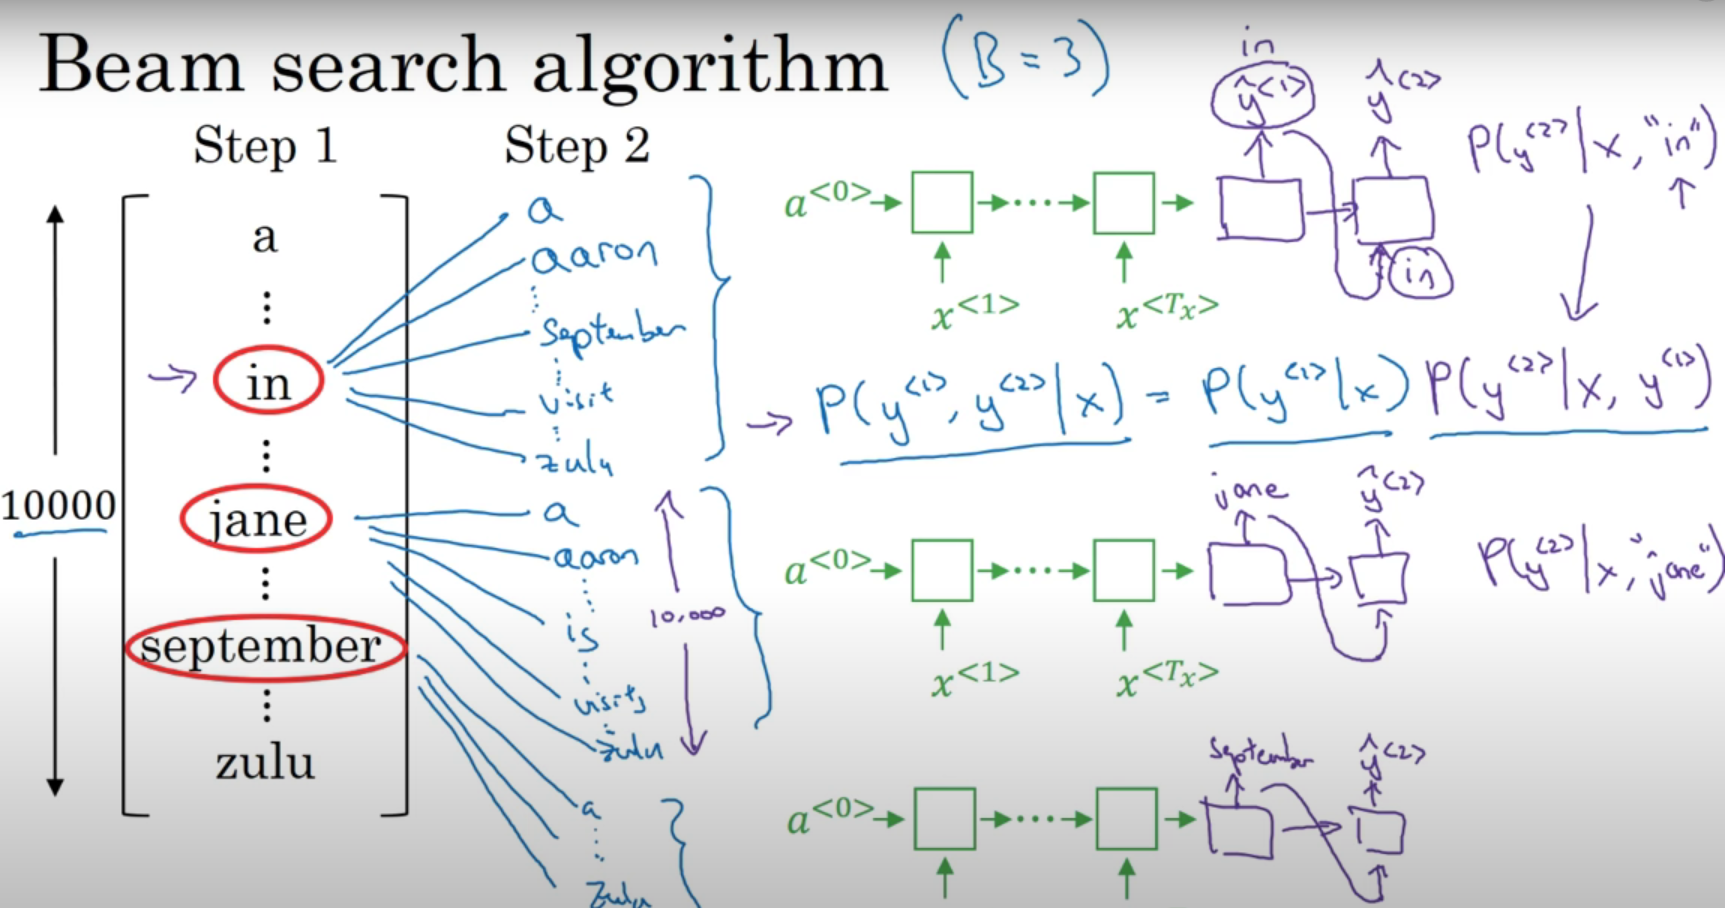

In beam search, we take the top k words as a possibility instead of the word with highest probability. In above pic, in step 1 we see three words - (in, jane, september) as three possible translated words that have the highest probability out of the 10,000 vocabulary of words.

In step 2, for each of the previous word, we pick another top 3 words with highest probability. But this probability calculation is now conditional to the previous word and is calculated based on the probability formula given in the picture.

But the probability calculation will be slightly modified by taking its negative log (log being monotonous will not impact the values; this trick makes the formula to add the probabilities instead of multiplying them to avoid underflow). See modified formula below -

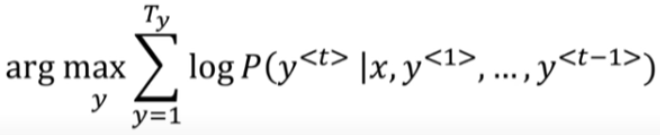

In [54]:
base64_data="iVBORw0KGgoAAAANSUhEUgAAApQAAACHCAYAAACoEskgAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAFrFSURBVHhe7d0J3LVjtT9wTeqUQicHqYhTyUnGEofQIEoy5BiKTKFMSeKYZ8pQChkbvOZIhsyROEUyC5EGwzGl6URn/N//z/fKervc9t7P3s+wn+d93/X7fK7Ps5+97/u6r2Fda/3WuoZ7tiaRSCQSiUQikRgDklAmEolEIpFIJMaEJJSJRCKRSCQSiTEhCWViTPjf//3f5r/+67+av/zlL13TM888Mz3Fd//93//d/N///d+zuSQSiUQikZiRkYQyMWr8v//3/5o//OEPzQMPPNDceeedze233z493Xbbbc2tt95a/ra/u+OOO5oHH3ywEEt5JBKJRCKRmLGRhDIxaogwIolf+cpXmr322qvZe++9m/3337/ZZ599ml133bXZaaedms997nPNvvvu2+y3337lml122aXZc889m3POOad57LHHns0pkUgkEonEjIwklImBIaoo/ed//mczbdq05n3ve1+zwgorNBtssEHz6U9/utl4442bpZZaqplnnnmaxRdfvNlyyy2b7bbbrtlwww2bJZdcsll66aULyfz1r3/9bI6JRCKRSCRmZCShTIwKopOmuw855JBm5ZVXLkTyjDPOaK655prmuOOOa1ZaaaVmjjnmaFZfffXmoosuan74wx8W8vnRj360WWWVVZqjjjqqefzxx5/NLZFIJBKJxIyMJJSJUQGhfPLJJ5tDDz20kMlvf/vbZV3kE088UT4vv/zyzZxzztnsvPPOzcMPP9z86U9/au65557mwAMPbLbddttyzZ///Odnc0skEolEIjEjIwllYlSICOX5559fyOEvfvGLstv7qaeeak4++eRm0UUXbeaff/7mhBNOaJ5++ulyj98uvvji5tRTT21uueWW5n/+53/K94lEIpFIJGZsJKFMjAqxhvKXv/xl85vf/KaQRt+JUh500EHNvPPOW0jlVVddVYgm2NX9q1/9qrn33nub3/72t7nDO5FIJBKJmQRJKBOjBkKILIo0Bjm86667mu23376Za665ytpK5NFZlRDXI6LxXSKRSCQSiRkfSSgT4wJkUbL5Zt11121e/epXN5tuummZ5s4DzBOJRCKRmLmRhDIxZkR00ttvrKd817ve1bz+9a8vU9++64YgoYlEIpFIJGZsJKFMjBtEIx0HtPDCC5fzJ88777xnf/kbeYxkytvUtynwIJXxV0TT7/E3vk8kEolEIjE1kYQyMW64++67mx122KHs7l5ttdXKTu5AEEnrLX/3u9+VtZZXX311c+2115YDzhFLBNI1iKm1lzfffHN5TeOjjz76bC6JRCKRSCSmIpJQJsaMiCAiiOuss06Z7t56662f92pF1zmn0uHnhx9+eDmPcosttmiOOeaYQipNj7vG59NPP728pnH33XdvrrzyymdzSCQSiUQiMRWRhDIxLhB5POuss5p3v/vdzVve8payftKUdg1RSBHHb3zjG+V93ptttlmz7LLLNmuuuWYhjQ4/RygR0eOPP77sEl911VXLm3YSiUQikUhMXSShTIwLfv/73zdHH310s8QSS5T3dZ900knTI5cBBNNUt8PNzznnnObLX/5ys+KKKzZvfvObC4FEJOPA9GOPPbaQzbXXXru5/fbbn80hkUgkEonEVEQSysSYgSiKPH7mM59pFlxwwWappZZqTjnllOdFKG2w8bpGB6FLpr433HDD5rWvfW2z1157lUPSRTofeuihZt999y1k8wtf+ELzxz/+8dkcEolEIpFITEUkoUyMCTFF7bigDTbYoFlkkUWa5ZZbrqyRfOSRR5696m8QgZSsl7SJx7u+beKx5vLOO+9s/uM//qNMfzvDUn7XX3/98yKdiUQikUgkphaSUCbGBOTw/vvvLxFJO7w32mijZvPNNy+EEmFsAzmMJBIpAmkTz/rrr9/ccMMNzX333dccdthhzb/8y7+UI4hENBOJRCKRSExtJKFMjAkIpWN9fvKTn5Rd3t///vdLhPG6665rHn744Wev+htqQul93t/61rfKO79XX3315rLLLitrK7faaqtmt912a2699daSfyKRSCQSiamNJJSJMcPaSGsfTWNH8j8yGOSxE+zqvvTSS8sU+UorrVQ26ZgC33HHHcvGnb/85S/PXplIJBKJRGIqIwllYkLRi1DatOPw8w9/+MPNYost1nzkIx9pPvGJT5RjhUyH97o3kUgkEonE1EESysSkQWTzV7/6VVlz+YY3vKHs6j7ggAMKyYwd4kkoE4lEIpGY+khCmZg0mBq/5557mi233LKcXenNOVdccUV59WIQySSUiUQikUhMfSShTAwNIpLPPPNM8+c//7kk09rnn39+s/HGG5copaOHHDXkukQikUgkEjMOklAmhgYHlDsA/cc//nFz4403NhdccEGz9957N9tss01z6qmnlulvr2dMJBKJRCIxYyEJZWIoMHXtvMoTTjihvMfbWkl/7er2mka/2dWdU9yJRCKRSMx4SEKZGApMYzurcpdddmk+8IEPlIPLd9111+ab3/xmIZM24SSZTCQSiURixkQSysRzUJM6n8crOZfSm3NOPPHEZo899ihv0rnkkkuaBx98sPzW6Z5+UiKRSCQSiclHEsrEcxBEzaHkTz/99Lglm3CeeOKJ8mrF22+/vezu/vd///dyuLn3d8dGnU73dks2+NgpnsQykUgkEonJRRLKxPNgehrZ87aac889t7wO8eyzzy7J5/r/SGeddVbPFNecfvrpzbRp05rTTjtt+vdnnnlmSfF/PKNbiryU76677irEMpFIJBKJxOQhCWXiORDts57xpptuajbZZJPmgx/8YFnzuNpqq5VUf67T+9///p6pfZ3P8pLa18X33VLks+mmm5Y1mCKfiUQikUgkJg9JKBPPAULp6B5vq1ljjTWa+eabr5lzzjmnp7nnnrtZYIEFmqWXXrqQuk6Er5+0+uqrT0/dvo/f3vve95bnve51ryvPf9WrXlXS4osv3uy///5lHWYikUgkEonJQxLKxHOAUJryfuyxx8rRPm9961ubl770pc1ss81W0otf/OLmta99bbPOOus0Rx55ZHPyySc3p5xySkk+1/+PR5Lfscce2+y+++6FwCK4yqAsb3zjG5t//dd/LedXJhKJRCKRmDwkoUw8B7HBxc5rUcpPfepTzUILLTSdxL3oRS9q5p133nLsz0UXXdT8+te/bh5//PEy7TxRydtz7rzzzkIwP/ShDzWvec1rmhe84AWFUNoxnoQykUgkEonJRRLKxHMQhDKmvi+//PJCHv/hH/6heeELX1hI5cte9rLmbW97W3PggQeW3dpxIHmvNFbIA7E84ogjmiWWWKKZffbZpxNKpDaRSCQSicTkIQllYjpq4hef//CHPzRf//rXm1VWWaWZY445SmQQsXzFK17RLL/88iVqaA1jHN8jOXJIiv/HK5mKv+aaa5p11123mWuuuUrk1JR3EspEIpFIJCYXSSgTI+IXv/hFiUbaBPOSl7xkOqlEMK2l/N73vtc89dRThfRBEMAa8d1oU+CBBx4ob9hZcMEFk1AmEolEIjFFkIQyMSIcI/Rv//Zvzfbbb19InHWUQSrt+P7sZz/b3HDDDeVg8pr8TQR+//vfN8cdd1yZ9lYWU96/+c1vnv01kUgkEonEZCAJZaInIkL45JNPNuedd15ZTznPPPNM3/UtYrnMMss0X/ziF8urFa27nAhSGXnK/4ILLig7vhdbbLFmn332aR566KHyWyKRSCQSiclBEspEX7BG0tT3CSecUM6FfPnLXz6dVDoT0pmRDhlH7qyfhIkglvL+6U9/Wqa9N9poo+b4448vu8wTiUQikUhMHpJQJvoCcuj92bfddltz0EEHNW9/+9tLdBKhNPXtbMrNNtusufTSS8tGnrhnIuC1kJ5zxhlnND/+8Y/Lu8ATiUQikUhMHpJQJvoGgogs/uAHP2g+/elPlzfXxPmUyKVD0HfbbbcSQZyoqW+wptMUPGJpTaXd34lEIpFIJCYPSSgTAyHeomM95VprrVUOGY9NOn/3d3/XvOtd72q+9KUvlZ3XCOVEkcpEIpEYD4SeSn2VmEogi3H83oyCJJSJgUC4RR8Rxq997WvNP//zP5c1lHHoufd9ewf4WWed1fzpT3969q5EYvLRizBQ3M8880xZPtEt4t3r/sTURC+D7Hu/ezHDb3/72zLb0Z5Zic/+RkrM+OjVn6ELnFrijXHD7nPPt2eB/fzd735XygLtcvSqQ78Y6/1tJKFMDAwCaNr55z//ebPXXns1iy66aHnfdxwl5K06G2+8cfOjH/1ounEeT6EdL8RgipSYOaFvGQZk0TrgNmGkwP120003NVdffXUhF76r4R6KnZKn7Nu/JyYP7fHrs/5BDi3Roavav0v6kcG+4447mrPPPrusy7aMpr42QH4QDOSTLHS6JjH1EXJhHIcuaPclmbFsy0s0Hn300efpi/FCJxnyrD/+8Y9lA+xVV11VZNLZy52gHmSyUz187kdG29f1e183JKFMjAqEjqL+4Q9/2Gy66aZlU05EKU2Bv+ENbyjnU3rPNmWcmPkwVuUzXohydCoLRSvy5F3wV1xxRXP77bcXhV2DYr733nuLvH7yk59sfvaznz3HiMiX0vb9JZdcUjamISJtQxPP71aWQTEeecys6NU2+hMxdDauly7Em7xqcA70OSK5yy67NKuuumqz4447Fvlow7OQjOuuu64kBp48tBH9HikxtcAOcRZvvfXWQtT0dfvsZGOag+EUka233roQS3ZuGPBs9tKxePvvv385xcTZz4htJyC7ZPzaa69t7rvvvufptUFkcLxkNgllYtQggAbot7/97ebDH/5w8+pXv7pEKZHKeN/3V77yleaJJ54og2U8BDYx9cDrZ6DJgs1S/h9mX3teW74QCArXgfyOuqKYN9988+b0009/ThTKX2958r1zTS3XuOWWW8r9fouEQJ5//vnNxz72sbIh7cQTTyx5e7/8RBschpCxMI5iWjbxXOgjJO+Xv/xlc/nllzdf+MIXmk984hPFQbjxxhvLb64RYfQihMsuu6y8/eujH/1o2UxoqY4zdhGINsgWUup0iy222KLZe++9yxrye+65p/QL+QP51wjZaX+fGC7CwTBeHTNn/G6yySbllJD2bARdMG3atGappZYqToZZNjLjmvq68UDIBfly9B3ieOihhzYbbrhheXGHoMxHPvKRQn47wbnPRx11VJHx3XffvTn11FMLGa5lciTUMtpJTrt93w1JKBNjQihbxHGFFVaYfj4lYvnKV76ynFnJ42IIBxXOiUKUo1tK9AdtJXIjcnfhhReWd76L4HWK3kwUos8oUH9NXd9///3NlVde2Rx99NGFRDIMZJMRQQqRXnJr2ku0SRTLkVfeT7/yyis33/rWt8rUt2gUpa2OEsUuaiCv973vfc2WW25ZFDpy4pny60d++rmmBjKrPt6bbyzFhrfEX/UPUsCQfuc732kOOOCAZoMNNmhWWmmlZpVVVml22GGHEolCChBzbXfuueeWFyKISG6zzTblCDRLdrxG1rKHNsiWjYj62kZEMuJaJ1pwRNzj95yJmVoQfTS+jZ0vf/nLzVZbbVVeiEE2OIbGknFNhugNsnHxxReXcf33f//3hVSefPLJz9EF7Nh4EkvjWJ70ElK40047NZ/61Kead77znWXpmPOdlakTOE/eGscpeve7312uJe/f+MY3Cnlml8l9P1AO8ttezjOonklCmRgzCKFpQAPCekpT3kilKXADk7E2NW7QTiZi0BhopgooCsqGZ3jXXXcVBTQzgEKgJP2Nz+3k+27KwvcjKRJ5OMQekTQ9Y3po5513LlOIw2xH5VQWpEsfIhXKgzwyHhStyJMpLJEHUSXRVIrWlCdCIHopSuXoq2WXXbaQDNPf3hPvHobG9Uij/z//+c8366+/fnGWPOPjH/94s99++5VIPaMzUoRgpLat4VoRNUTpQx/6UPOZz3ymnL06SB4zKrrV0feiTiLQoo8cGf273nrrNe95z3uaD3zgA8WREO256KKLSmQ3jKW1aWTEhkKyKtKIHHJ+11133Y6E0vM4SaJVHOftttuuEEvPEkFCTI899thynBrd4tpe/Z+YOGh3488417eiyiLVZIITyNmIcW0PgNkFsuGzjaR0wT/90z+VGbY3v/nNJfpHF3jF75lnnllIXLtvyccgqYb/OUT00BFHHFFk8rvf/W7RKa9//eub1VZbrSuhVE/yL+qKiK699trNiiuuWOqKPHOAROvJPGe3l0zSoWZbrr/++ukzL9qlXd6RkIQyMS5AIpAz5HHeeeedPvWNVL7xjW8sEQEGfzKn6wwOxIBhMCWGOJheoHC++tWvlkE0o4PSEIGzpkbURhKhiYT4S9YUUqLIiuuRLPd2UyDxvb8MM8XqzUgULkO87bbbFm/55ptvLn08qCIaBPKm7MicyJC6iDrtu+++ZTMYosfYMx577rlnMSzKpX+jnow+eRSBEK2Yb775mrnnnrvcI/Jksxlies4550x/+xPZMXUmL4ofifQ8z4rnkXPPUybXKiNlPVqoq75E2BdeeOFiNKwFncj2nUqIevpLrkSUyCyHUMSWE6NNRKFFaMKQaiPtxliHYdQPpjTJPeJPHjgJ9MBcc83VlVCC+xllxhlxtIwCkQxiiex7tqg4PejZnlVvCPI3PifGB9GvghUcDLMlHAZj03hEIpEyY9x3xrMlLcZm6AL3kwczE4gc+8XBcB8iSYdYHiFfDsNY+zDkIBIdQadY26lcHFgklt3sRSiVG6m07hIJpI+Nh4iiGw+WaLB1ZmE40LWuryEv9uHwww8vzhn5/slPflLaNGRYGglJKBPjBsLK07IOzYBEKCWHn/OcGG+DhYKfDBgQBgejccghhxTiscACCxRPECFiXGZ0hHI87bTTihLkjVOKlCnFQmEcdthhJXrj/2OOOaYoWW0iytdNaYRCYdT1ob6ksCktUTMkSvtRjnHtRIDsIBUMu2ko9VQ3hkBZ1lxzzeLUiOghmUij69syhxSLXFnQ/rnPfa6sV7KGUr3ky/PXJp6jTjXkhSyE8dLOnBJyL2LJSbHOjoKXF/KtDJ45KLQjQyDi5kUCiIsp9olq36kGhs+YpVv0pWUHjJ0oMQIoGiNKaF0cMmdnLAMbchgImTQ+9IO/ElIp4ohQdpvyrhHOyMMPP1yMOHlhgEXB6RMyyMkSbRJpQl5qR2ZW6bdhIHSBaW0zYKKOIpLII7kwHumCgw8+uEwpkx/jtq0L9Av5QqDoSxtMkTm60mwA54VcGMe1fiM/8hokhdyFLEQ+ZIpc+l9ZyNRIhDLujzFiHSZ50w7qYXmOdghnh76nE9WHk+yZnh15iOo6Q5qucS/HWlSWPUHY+5HfJJSJcUEIpUFHKJdZZpnpb9GRbNhBQChZA6YeUMOE54paIBLWylAejAlCwHDDsMs0nqAgQjFQJqJapnN56iIqDDEvVt0ZUARIhEdEjlKuIyptUIg8VkrGJqwVVlih5CUa1F7cPhFQN0pT34kom+ZhyClddfC/KKkIkSgUY9NLCfrNdeq+4IILFgMkeqsN+oF8RQjkoQ2Qc2uYKHDr9xAdZfL997///UIs1GFQyF+kgeMzqxFKUWHRPnoDMWAY9bV2YPT0HeKO3DGSiBton7qNOrWXvkAMrVlzlm4/hDLylThXIuQiSwy18olYk8cPfvCD5fQLjoXNEq6Z7CU/MxOMXdE848oyBOPOWkLtHuPOMoSIVNMF3cZeyIboo1kJNkEAhCx00mm+I2d0ISea04nU9pM4O+xfrWdrmYIglAsttFCRJdHFfqFs4exaI/rFL36xzG6IWmob8ulUA9F9Mmn9pnbxbG3kO066IIFns9l0reglAlqXsxOSUM4AaHdgr07t1dkTiXguJUsoDQjRP1PecT6lKJCBb51GP8I5EYjnicaJ1Fkng1BS/jMDoVR2JIdHjlBq93nmmacQL0ZZBAchscORMTZdp5/syLcG1nRiJ8UrX1N+pvsopX/8x38s6xRFjCiwaDN/J6r9yIyIH9lafvnly2aKIMq8ctNGlDwSEuXoVRYRAVEJHjkjIko96DFX8g8Dw8CRfYRbxMy00+KLL17eHuV/65mUbRDIPwjlzBahbNeh/j8+iyLbZEB+l1xyyWbppZcuxE9UuJ7Ga0d/435/288JkHMkFKG0y3skQhl5tZN8YurRumwbQIyNWkaRTWV1fWJkjNROCJnxJLq83HLLFf0lQmyq2HIUBIguqCPDkWrE//7SBeyAzTCinLVeq0HWkE/61PIK0egjjzxyxOQ6JBcJ5ojUz44ywlgIZV1eDgx9TmdaM8wZ8yKSt7zlLeUv+ydqW+tLuk+9jQMRStfROZxieqg9ztroi1DGwwbFaO8LdLt3rPlOVUS9xqtudX7jme9IqIkHRY3UiFLa9GDnnOlWwkl4h1kuiGeZuqD4TXNORoRyop9BiZgSFCVG/igPhEybUwrqT5mYIopF6Iw15dWJ9LhP9Fk+FJ0ItKlHER7KsI26X9t1rX+rEd/XqQYnABEWVdVn+g5R44krR712s76/U16gPRglnrvonymhbkakGyLvSNqWQTBNZYE/Q2dtJlJp8byxMQjkSS7bU9692lxqo9N3bXS7d1BEHuORF5ImomL6z2tekXQyayqSPER0pRuiTp2uaRPKXmsoA3V+NQmI78iU/tLXImUcFRsTfRZZ79Rvif4R7U1/aWPjKnSB8cbBFXXrZFt8jj6rE7ieHuFgC3xYMtOtr+hHMxmuscSG426pw0gJORRFRSpFTSP/dlnooNEQyrg/EHmGTFojKqovgOA1ycrCAUI8XVfLs/ZAys1o2ahIft3PaW4/p8aEEsoaY72/G6Jso8m/132jzTPxt7C7HcC8c2RFlFIy+E0tmqbiQQ67jeN5BhFCiUwx+DPLlDdof21POc4+++yFKNrBWNfLZ4rGLlj9geyLZGqTTqTHd6KbojjRXjY3yaMT5N9JIft+tO2rz5RBVAKh5ZyYyolzAW2E4fkrU6dnt2GaXmSTUSIHdml3q08vICbuMx2PpCOT1nXadayc2h8h1NaD5q+t+iWUvTCWdh8txvK8uFd/WsaA9Iv2iphoi9h4Y8oRsaydiTa6fa/fOCKcEnqpX0IZfyX94NkilPKy9lZEFbkx/kQoHVMj2sNAdyvLrIBos7Eg8tDmjiizdMf4kow3JM8466QL3Odz5BEJTPcievSAPrM2uhs4jRwda88FR0TL+0mm00UpObGdbF/8P1pCWYNs09lkkkybxrZWHPlFvulOM1JmdURx67YIiAI7AUW01vVmSSwncj10umegKW+d4SEUuwHkr8ZtZxrwvYphuwTAvfX1/vpNp8tPA/TKT14q41oC4D7X+76boPSCe7qVL/KLZ/KI/O77NlznftdoE5/7eX4N+fJ8tIG6dWtb/3dK7o/k//ra+rf4Pa6ZKGhTa8YYA4e0Op8SoYy36JhaMFD05TAR9da+1t5EBKkfQul78kAOop/0eS+Z7Qb90Cmfun/qNAiMC+teKA5nK1IinQ5slq/lBzaRIP2MKsUXm3PiucpkIw6yabpEtMgaTdM+2qMT2veTbeXqNjbi+kjuibYIkCkRJYRKNDHWBiFZouE2H9kkYUpJBFw93NMN6iQf7WSXMMWrfP1C3qIhog2eaV2SMtggZI2ptX42aJjuRPBjQ1pdp5Hg2tEQSs8hU+RLH3V6pu9q/RbyNx7wfGMs8u0Ez5ein9sJlA05QPy1rXEqWiIy5LNoJWfJRgPy6Hlx70hQ99ESSmUmz2GwLTGxKcjaM0dKkUvjyhSsSJoZg0Gj3zMb1J1c6NNeugB8L3WTDd/TBWwIUkcXIJTkwro/kTUvH+CAhi7opaeNTQTLGKMLRCC7wbPJGXmzXt2mFWsW+0nKgujS/VGXNji6CKV13WZj2oSyWx18r33NkBgzHFtT1SL8ZJFOsnSEs8MhM4tYv3Qk8q3/Ir70vvXyHG9tjUzH722MSChD4XiwxhOVwLApSOFlUw86QwNr6IDPDCVlyGuzaJrxkgcSQaAQDruSsF7hZn8NUI0SUGjPdy0PTyN4Lu9EuJYisW7Jb5EclaIh6nzakG+Uj0JQNolwqIsO1/EEi1B6pjpYWEtJh6ArG8FSR+2iXNrEd34LtBvf/QaUMqgzYfN891ub4XnWdPitNnLqRDHxzNtHwmhbZdZnIG8Lhv2mjdTFNcPYQAHK7XlxPmVEKv3lCfKY1DEG1zAQzxmEUPpfGQ1U9dFP+tpAJxvqQC6Qi9p4uq/Oq87Hs8iTfPS1fIwt40E/1f2qr8lSu1zdQPYpJGuBRB15luSiDfkxdBSwPtEOFAa5qcuuzGRaPjZXmXZUbuO4V5nImDYxpoxbdVS/UGI1XEuuyStlqA38rfWBZ5Ep7We8IFbWBpEva9YYFIoTQTA1b6MEuVd37dd+pvwRAIobCWCgXKMPQ0e1x0noQ9FIfWOsijpQ0tpRBBehRH6UjYwYp64PA9qrzdpw7SCEUvm0o2eGPlLP0FkBbcrI6htkWLSPzqp1zWjg+erKgVFOfR67RNsgV2RV/ULWja9a/pRZP+gb4wxxYwxFqRFApF3fk/fYkEWGyF20dzcoK/nqtcu7vt9necrb8g9T2BwYO2r1T8iftbjGkeUZdAXdoE7avFd5ZmZo67YuMDaNZb/V0EaupfdCLtxHBsJWRF+436wAWbMEhy4wDhF6Y5ou4DSKONIpdAF5aj9TWfShI4PcRy7AdWS31h+eTS7pCeUZJClzLQfxt4Y6sY39EEqflUMZldkY4Xw5Qm2rrbYqdZF89p2ZQVFHxFYb9yLZoMx4lqlywQRtS1d00xNdCaUGQ6x0KqMjvGvAUtQW89tFZeBQyFiwgUgJh9LS+IimBbLOZtOxlK4BqPOEWi1eV0mGykA0sAmbDgcVVWnKSUPwRoWNRVGEtpWDJ0KZGNR+Uz4CpMyRTyfIG9Pm3ZqeUjaJN0mpUcIR0lYuxw/YUCLygwggZRSyeuhAeTjPTORN2xBuAtyJYPiO0FD6BoL7hduVXT2s6dEmvFvTJzo/2lVHKh9lpT0MINMp2jHaNjpb/bS/diGgrpEfYxxGeiKhrgZi7KgWmbSmD6m0q9KidUczUM51O00klAkMQH3ZD6F0LYVGKSEP2lHbk0HTrZLoBOOtLgYhRH/HZ+PJM5AQET79InpFxsiPvtRPZJpsO9pI+9glyki3lWA3ULCmKUSFF1lkkTJeokw19A3HUATTm0KsIxRlU06I8huDpoPtfNRWFK/2IGdRvxrxnTHCcKirjTOidXSBdopoTVxLHsk5eVVvbaBdtbn2r59jLKhPEFDjMY5Jit3rknJ6nrU/DLu+qSN2nEBkhBER4aSQGf4weiKPMZY8UzmQA3k5Hkv/i4xQspS255EN45lzQHdqg9oYjQbahT4YiVBqw4jg2t1J5yK3ykk/hz50nbVQDAP502Z0Dp0ZfT8aGMPaWJ95pv6WEECORHuM6wt9IJKkr/W5sUB+o79r+VA240D/qCOdKfqiD5FL/RDRFwGK2KTlubX8gP99T34YW/pI22qDTrpR/+lLdoGBpzvoZ3KD1DK4ns1JNabofkEQdYznt8swq0B7InIcF9Eu9pFc0HlkMGZEahhndAE5IhfGNgeRM1pfaxyY/dA3+tLYxBWCVxiXiL4+pm/pUqdZkFPjIfKiQ1xnna4+tZlF37nOWJZ3Lz4xWoRc1MkYpi/pY9FSy3nqsRPXaVc6EB+gZ0866aTSVsqPUItG4i50Af1trKkXntZNd7fhGjxCX7GVlhYYX50CFNCVUFLYBi4BQBopJ2RHx8pchU09eIAjMpAhxjIMl45WeMqVsX7Tm95Uko6lQJBTldfh1hlpPLv4GAZKHQiKyAihcp0GYiAYb5WiTKytsebBvcLdSB+CSVAZgG7QUAgvAaN0rc/BwCknxgIhZNTl59l2kpkasyaQYBocBFM9RCMoZIrFWgPROEaaIaW4a2gXZJKXoKO1o6NX1JEyVT8KHtnyPHl6EwSjDkEolQ9psGDWsTDeCKJcFLc+iPppK2VWPwOGwkMox2LgBoFyEHoEWP8YsAiljTo+U+IURx16n0hE/oxTP4SSDCLprtUvBiu507fGBkOoHwxgDgVlRgnJIxJEv5F9Y4Dx0+/yIEP633fGAvmx7sp1xpxn93vkjOfxKMmf9ZNe4aXt6zpBjE/1sCRhjjnmKM8klzGG3eM6REs5HUE0//zzFxllqP3WCe5TX9EiusLY0D7GqPIY99q07m/KEXHi0CGDdt+/4x3vKM4h2W+XH3xH0Rrn2ofjyUFESClSRl5e+gxRp3A5cWFIglCSw4gEKLMyqC8jgwwCOdB/obTJC72g7xlI5dTO8lQW8lUTmU7l7xfaBVm1mL4XoaTkESn9w9k33jkUdAQ9oB/DuCP16mFnLD2zwgorlO8Y0dFAvgwh8u4gaGOBTqJTbUigr4zxGvoNAYjdpPSY+mn3bu3mf7JFJpAOss5JDr1po4GEsBibDGntjCkng0ovcxj0Ob3E+aJzjV/f+z0CJJ6prMaG3bpkSwBE/ws0aEfRaO2nr5Ab8tJtfMxK0AYIo36i45Bu7c0e0QVsJ/KtX2rQocaha8kQWeLEk+FOY8l3oQsimi0gxMaGLtBfEc02jo3n0HVIo9/ZArrAOFJm8sBxwUPIw3hDubURfUHm6GTcRVnMLuFXggpstrqzpSFb2pUDZGzjEeyHaW36jk7yvfWkdJ4x7xntdu4HdAJeZmZK1JQTLWrcqR+6EkqkjqeFISNJBg5jqLIGFm+BsWOMTBcwYDENBh7ms45lVChtO4sYLUJFAfCOCRSlb10WI0I5BKGkMChqA50xcp/pQYaDx814ULTutZOOcmQgCRIvN4SlE5TPcxgAht1OWEaVEUMYKCNGBZnTMQTRNaYRNaxoElJLyBl8kR1l1aGMrqlBn3V4DYqNwlJOZBjZk5epHFERRJVSJlDe3mGXIONFKIAgBSF1H4FziDiyjuzzJsKboUjVQZ0YDR61QUKxD1PZeZZojYGhL7UzUilayZEgoOSk9hgnCpF/P4RSuckgEq6vGD2OFSNF/kRAGHfesHFiGp/T43f5g7wkRkZEnrEzngx+/Swfg1O/M8Sx3lR/GV+8U94nA9pPn1EYBr8+N96Um9GuQQbJvvFq/Ih8WQBuHFBoNXH1WbuQNWOYnDGexna3vlJO5eVkcsiMC/cjLZQkha1eFGO0j3soS9/bJIQMG9dmPyi0bs+CuF9+FGdE/pEYxkOfyFPEwjgzftxDSdM/2lqfcJyVkzI2PsM5A/XVXvJAjilteWsLzxK5YhAQ0H76aRD0SygZZk6pca78dJO6kQPlJWvqbsaAfuOskg96kw4eaVanF9zH6Go7ji0niaNufJMvY5wTAdHn9BTZ4riTKzutlUf/xTVSN5BNsmGqnv5gkyIyqz5skj7VN9GPxiUigfwZf8aucU3XsjExK4Roug951dbkih7QjvLm7GlfToR2Q4DI/GgM9swMfSywgTvQL2ymNma3wpFjr9typy3pURubLMcRNNK3MXZ7IXQBO4cH6GvjlOPCAWSXjSd9HHqMLlA+DhgdjGuQS46ofje2Rjs2RoI2onetecRpjB/2xNhBvOkc5Frk3xI/bUDO2Ho6zjhDvNWNzUCC2Xl6g04lw/2Mp27wLPnRo/gIBxEP6yTrXQllRJUoWlNdKiRiyRAZlOHlmmowXcYgqUgdktaxWDQlzjjYSSr6wpNE1HgFFIEBzKDzqDFqXoZ7faZgkDODnuB5PuUg8UQoLr+5hmIkJMqg8zsp3RrKSXDlEQZYFEb5KBvCyCswIAg3ZU7pIZU6nDHSyeE9IIoInIgAssSz4gm1DbR8kT8dg6ibAiUk2lVimHhFBp22FR11TUAe2pWBo6i1PeGjzPURAXWN8iDu2oXHjphov7o8w4B2ZmiRd9484lWvpyRjBhKZG43AD4LIXzuPRCiVWf+KxJMLg5YM6ivyZ6BSSCLVIkL6gQfHoGl7kBc51OcUKYWl/pws0ygUn/5iGA1Sxsr0m3GCgHMK9Jlr+mkb9ULkGGiOHmUTBtWzlJesKjMCS+6NTc8lY+pcP4fS4MCRH7LP6BoLEblrI+qLQCOS5N/9ZI8RZriRHJGeNkkmlxQXwoZUcz6RH2XvVnfft1O0J6JBx9BLyJ/xgbBqU/CXbtJfoZBFMyxr0D7qoHzy1AeInDyMe3mKpNEN2rTun/g7XuiXUNKlZJruQpoYH3UyG0CH6DfOhfqRC/Wm+zjDkrqoR41+60LutBm51ocIFhIhCsWBpC+1tT6WZ+QrmosEk3djh9GnByDavhf87joy4j5tJcqMBKif/oqdrEDmyARDTAcLHkQkm5Mn0iOSRv+qh/vkr5za1hhWXnVBfMkQW9NLp/bbhjMj6EiyQCbZeXqQniOXlprod+1prNWgd8g5p4B+JvcIl/wGAXk2dhE248GMKdJFNvQhedA/dLqZMuMM54goHz1lzChfLbvj1afyUSfjlfNsdoWMaR8yicSx8citcStySn+rF/thjCknO8+GcoLraGRdztGW2X2cQboRz8Bv8Ddy386zK6FE6mK62UAyUCOiACoUrF6EDKETyTPw4hp/PVQ0Dbmyw5cxJUCMnMEqT4oMOaLwPEcD+41BFRVkyER2NHrkC64jnEgt44mYIACdmHM3yIOQIc0IJWOnUw0CAhRCRCB5Kxi6nbMibZQx8hfPcy3hIwQiLAyAjq7bjXIiEKK/2pWBQ4xruJbSQ7C1mUGH0Ece4LNpR6Qf4VEuypuAUawGgE5XFoYcOTewJgPKqt5hlBF2UYuIUiJiyj2MyGm0YS9CGSDLlA8yKTF25KINbU0WTFcjyEgaOYxnGSvqTSmSUw6QKGKblJF9nrEonv5k7JQT5BX59QIDxygibiIA1vSKfBurlI0ZBiRP5JDM84CNH7KCgGn/+jnKLgLD6Brn5F5dGPBucL+6UeCUnjrwpo0rRNe4MJaMA2MmnmksUvLKpfx0i/q0y9Qv3GfsyUPdEQTtQLeB5ykD0mqZCz1gXDJ6SGIti/IRZUeMKVdKO8jGRKNfQqkuyqat6ST6QVSHXtPuonH6gD5ghLS1Ptc+dJA6jrY+2pIe5zQa5/Khw+ht+pLeR/JCngPa1BhjHzgQbACZgNH0uXvZHPVB+AUY6G7lA7+RSWPCb/QiR4qh1vcS4oKUhiOmHOqkbsYCPcGhNzZGKuNo6jAzQX8gbcZUOCz6RnSXXWMHyKI+gmgv19GRZjXMXJKRTrq3X8hXX4YuMIaUyRj2m/FiLJgp8lyJHLiGc0qeXVensSLyiLFKt3gmWSSTdfIdrsM5Invald3hrNNrnBt2fxDuMwgESDjS7GAEOzoFgLoSSgWmVHW0yhqQ9c0amIDw8kTsRFVERlwfSsn1OiwIpQilELbGIWQBz6JoDNpQaj6LZjGKyKpIHvIGUQ73MQa8baQgpsx7RTTacC3hYcTCk6ZoQllEXRghHoJnILgiGgRAGWqYIjVA5MUDM+XSnrLzTB6RgUUoPKsNRkHUC6FkDEwVtOtEeFyHzBh42snUnnIRQl4Wr5ux9JzJgnJHWyJpyKPyipyIwCJg4S1Ge08Uog3bhJJ8tQklxYOsk21k0bRJkJEaZIDMMPbqgwxyJKJfjR194NgFchFni9XjBBACU66WTCiTZRYRrRkJkYc6cCKQP3KqnXnj5BBZJROmmZTFWPQdI27cRnnrPlB2CgvpVHZrmfxPhntBeVyjbXwm76Jg+jrGM6JEhj3PNWTUVC155xyZAYnxFfUbDdyrHsiEMtX1kz8dRd+QP/0bY79GnUdbF040+iWUyq1+YVTUR0SdPHJS9Lf7rW8UjanXwXbKbxBoD8+N9vU//cZxoMNtyCPbnllD0ELdjEORGAZ8POD5ysKG1UTZX/2nn+llf+vku0i1wxByIqnnMPt/RoZ20nbaPMayMSRiyTllI+k5hAiiXckubsHhjWlx/ThWyD/6n3zU/ah8ykYXSGzEMPpa/sYumSOvtQyGTPpeIn/K6Z6QSWUO3T1RCK6H/wgAsW+c6nbbdCWULjSYFDoqENDIGpzBxVoRSgZM5NGDYxC6R2UZIAURtWOYTI1oiBrxPMlnDUkBUYQMo0XQPIgaGpFHIXrCSIkuMtxtQekF1wah9BzTbTzrug6gHqZBCLj1mspjTRK4Jq7jAQlPy0u7CBOrS10en7Wp8tdt6692MZhEGijaIJTIbH1dwCCzvsMzTV0aoKJt2hmxQN6QznhOfe+wEG0JnALRVoRBNI9cmHpFhAz0iUbUvxOhZLhriJpTeiI8Np6ZUug2cEUv5IF8yo+TQwF4nnq5F7kzlcuwI/z6BKJM5NvUrOgcuWdgycIgEIFE+ow10xMIsYilhFSK+om0ilRNmzatRBHJrDJGOWoZ8T0HRT4iTdqhH0IJdT7agtNgCit21Hp25ONa3rfoGefTtA+FFajzGg3cH6kN39W6p9M1EL91+32i0C+hVK6oA9BZInGmqPSdKWXTaE6DEKWrZXk86hV5RKL3LAEyxulCa8FEOuI5+t64MMVoLblyib6MF+o+rRHlq/u7TvX3NTp9l+gPdbuRu1jORs/5KzBUt6915WTerKOZGku5xqvt4zmd8vNdLTedrpkIxLPi2fXz29/ViGva34832CZLmGycE1XmKHIYlalGR0LZLqCBjwggUMKuplmRAiyVgmMgJISyjlBCm1CKmCFsI3kbhE60wn2MsKgOA1QD+WKYRQsRSqQQCXBvvw2sbgyr6RZEgMK1FinqEPl4ljpbsMvjRhhikXnd0RSidUQIpcFih2sQynaZEAreB8JnekZdTD1aS2HRPAIShFKIub4/8vNs5B6xViZTqqIBlgpY3MvjV8e4tl2GYSCeqc8pDkRJGQmm6W91b5PuiUI8ox9CydhZDI74kj+R9W5lNJUqMs3ZEMmjJBEiba6fRek5K36jJGNjSw1eOkJFlk0t2LQ2qFcuX46VpQSIpbVi2hyxMF1n7CFu6ipapB3aTk2NIJTKjpTYkEbWggiOhMjP+FEGa4OMDWv6TO9E/bQF2Ue2o60j0jarYxBCWfefPuJshjNgqopuorf0R93n7XvHCnmRHRtlyAy9ZBMQ3RrPYStMw1vjbewo13j3eb/1iuv6vX5GxmTXj+zSRZbjcJ7ZOc5m7WCLoHMyzLjhG6ErZ/a+maoweyaoZemKGTQBijp4GOhJKCkEZMf0nPUvIoYyMk1mGk0kjDBQViMRSqTIdKDInmmOkQyl51vHYh0hg68iFshiyowgIkbRmmY3Hcn7ZowRqBDMftAmlCJ7iHO7odQDobQpoROhDIgoIXJBKE0vKWs9EFyPBFqjYw0lsmh6X7ua5vaXN4+8IpTIYR2hhOgjUF+dKx8DFHFHbBAS/RfXtu8fJpB8pEvbaEORVMoCadNm7faeKES9OxHK9pS3aRlyh1DaQMWrDrTbT8RH5E+fGw+maThh6uXaWCumL00Z6GdRTYqScbd+lOKkRPWdv0jVIO2iTiKciAcnzFSSNTbkL5JrPM/YrolkoP2/fkOGjQt5ctqMy0EJpXyMFxFS0SrtgECGI2Es0C30iXYKuU30Tyjb0MciO3QumaRPzFhYdhJyCZ3aeSxt7175ky9ryj2fPrScKMqubD5bgmGdpePbOq3JSnTGSO3k907XdPu+X7TvHU1e7uE8cyLMonDa6QIyAXQhe0gX0KnsRuiqsZQ9MXoglPgXe4lQmnm1prWth7pOeSN8lJG1exSCQS/ahhDYfEMx+U3EkUGmMEyj9YpQBqHsJ0IJKsHoi2aoBAJivaAoqeiGcpjWRSh5vwiAdViDCF4QSoZSPdoRykCbUIq0BKGsn4cc2chUE0qkIX6XL8UpWmNhMqOPnBpAyLHopHWg/poetM6Q8W1HKGsYiAad6IOQNLKG4OsbEVtEokZd3mHAs/SlaBmjonzW0qkvItZu64lE1LsfQongWeLQKULZbj+EMdb8Wv7B8EeE0rUcCF64PrHT2xpGEX5RaRFAyy5EbskyRWq9irbpF55h/W6MR+PFUoJYdzwayBMRFEFm+JESSxXqyGK/0A5xDJjoq7HBAbW2knw6UskYdlyWdho0/5kZoyGUfqd3kH+yyxmwlMCsT3vpkH6u01hR50UvcRT0N9kxpugrZeDwml2ybMryKbI2q2KsbV/f3y2f8XrGWPIIcBjZSYEm9g2X4OiKUFs7bYaHEyvgQj+M13MTo4PpbRwkIpQ2dfZNKHkDiKGoJMOnwxEj6xORLcZTRMxnUUsEoRehFOEw3TLIlDcge8goY0/wrGcTFeW1MN6ieIiuslnwb31OKKV+ha8mlKZluk15qwdC1C+hlFcnQqne8mfsRUWtSbP+EfETXdVJyJdpSUYEoURAuhFKA1CbIyTIqfWk2sR0sn7TTiKudXvX5Z1oeI4oFBKC/PNIyYL1fP3KwXgi6t0PobTjM45u0k9ITzf54nGLLJuulp++iMiraxlR1yCKZE2++slaQf3P4/M/4oZoW95BwfYLz+CkmF5EHnj95JXcjgXkiyyKqHJStBc9oP0GgfKJPHD6rOlDuhENpFl0kh4xNavuiGe7fWdlDEootZ3+oZ/oIksf6CKGwHo07V23r891CsT/ntXreW3U+bATyiAqzxgZc5wIdTBGJLMUvqufPbMj2kiK9h2kjaG+N/KK7wNxTfxe/wb1951+D8Rv7ed1u34k6G/BIct/2AROheViiAudyDbSlWx6u36J4QPHwO/YbtyCHuEU6psaHQklQ4bIhWeLRDkGxZqrMKhIp8621s8UVj+E0i7vQQglARPBYcwYW0ZHVMe6G5FSHq6ooQiPyjHagwp6v4RSmwShNCXJ8POqoX5WTSgRT1GnmlCKoCK/DL91hIgpIsAAxDX+8uyRnJjydvxH/RzQB6JgiA/j7HoRALt244B1kUD36qthr0lTXu1rgbWpTk6BOmu79k7/YSHasB9Cae2hfrIpBwmiACPaW/eFz9YE6Uuky4Ajo+oecuR5In1kQ0Qagaxl2fe8dNE5x2MNuqaULJg2VB+Omyl3JL494AeFfLULBwgpsfHL1MdopifVyeyCmQZrSTkY9IzxQC+QYbqCbhg075kZ/RBK/0vaTfuZXTKDY8kQp1bkm5xrZ3JNF7hW/8ZniL/yorv1sxT6KX7vhfoaG75sZuTgiEyTdw4ueVc2UWqOVkx3zgqIdtTuxoT2ZevYmH7aF/SPe9kTyWd9CZG/NpUv8uav/oxrwGf6zPMjj1oW2vC9e5ST7naf+3vd0wmuVRY7t+lXASnBIXov1txyNETXyV3cM8gzEuMLTr6xi4uwAT73vcub8DFO1uNZ3I+c6OwQnBBmURTT4BQVQ2oKt71Qk+AwGqZb5GVKi2EdiVB6DmInkuX51hBSPJLvrQ1DuhBJhC3KFuVrV7QbDDp1dTZgvXA86hD5qIcND9YhIZQigSI3UD9L2yEIQSgdCF0TSuXVGaKO1n2KIGozv0ue61nWrTK8CKVrTRXWz/HZs2yQQLSRFOQa6acc7Jg0dYrsIxfqSLlH20SaSOgTHieiJCKHkNh0oZxtx2NYiDqTXxF4BExfWSDeJpSMsn4m3/qAFx19VYMsU4TaWeQtzqGEaGdTPKYbLfnggYtIixSRY/JGrg1aSppMDtI28qfkGWfePseNPMg3fh8t3GvaHPmmTPShMUmOa+PUDxBs66fNMnBAOXGcHcYE0UEs28fKJEYmlEEM6BlyLerrrFGEXdvSJQw0fSTSbsODJRjkFtmQjFUIWfGb8eBeU5BkVf8NIkuuRTw4uSJOyk8fIpj627SZUwlcMxYZnVFBfwtKaGPkyfjvZ0xpKzYi7hVQ8FmfBuRjpoueiWU1ggr0BJAfsoLcRx4i2nUenUAGzKIJgpAL94eT3Q+UXVI+ZTKtzUZZ3oVgbrXVViWibkmd8odczIryMZXAFtrZjbNYVsemdxq3HQklo0a5m75DAm1ICMEhkISOsvG2CGtgRBskEReDolZ2hJYCZJCRI4SNh2xA1AhBC1BwhAoRiQO7GTELypEUyWfGDlM2OJXNs9t5tVH/ZoBYs2hqHxlAXhHetkFXdwTEtI12oaxtqmg/S1lMYSIpiCdDoGyRH0Ii2oPlM/4WJpvqVnZK3LXIBXJuOsB0q+kiHr1BGM/juTHO8rID10YGnR4KSVshmp7DMWBQKG99F200kZA/gbMGhsepzZBx6zztPJ3siIR2EGkzOJAbUdP2VCBDGwfwMsaUH1mu5cxfZFF0Hjl15h+jWa9/1CcUMCMqwo2QIXvkl9KUfA55RvyRA7MBnhFlqstWw1hxL+dOOUVURYQZkPGAsjBKnAHjXBSfARvJKWxDOcm6JSuMCLnmNNnla6YDuTYeE8/FSISSLNPPNsCY/eFMclzIa7zZiRwzBk4AMLPDGSej8iKb9HQta8auqWhRRAkJrPVYP5AXPYV40FH0IbJgtokdiMP0Q2fNamBDBUr0EyfL7EQ/elEf0BMcVG3JBsvHUrToP/kI5HCIbfAjPxwJugWMRW1Pb1lqYhzSh/KAbrqGXJj5MMOiD+lzBLPb9W24LhIdYnOvmTQ6Fplkh20spIsn20Yk/grjk73SP+ybgImlS+xgu987EkrKxY5WBMAaPlMVFBJPhvLxmyiTjieIyIJpNt5wvfZLQRg6U8UMiDejIBeUXETLAiFkAcbUeipGxzQpQkTgbVaJRMmZhuSNU37Ot/S88LZHgvKJiHhO7OblSZsyrr0u+SHKSJvyiMbyqHh1iLF6KLsBEGfpMbyuM9gZUcbXNeqNmJpCZfwZU/8b/Ii2Z6snokn5IqamBJAFSoTBZeB1sMEssirqoA0MdoiymMqP8x5NNxu8nhOkciKhXRBzhk0d9KGIhKlh8jWZ0O+xiUZ/WtZhEbgoQe3oaENeNNlTfuRTdBGR5ziIBFOm1q9Srpwm44HirskWWTbFL4JJeSJmnI6QYSlkmjwztMYYox9TPjVirEjqoj/1K8Nh44z6IK1mFfw+VpA5yp9MitbSC8Ybx1MZ+gWZE5nm3Wr3kEvGlG7RnoPkN6tgJELJkTTrYXkNZ4Ys0jvkiX4jx9b/mvbmXCKIIs5mXDidjENbJyCP+okBoX/oDrq1H3mq+9CzkVxLSuhE8k8nxUacsBWzIjhQliPoEzN4zuzsx6HSB+wRm0AmOMRsb8yYgXz0OSeCbeZImA1AIoFOQmjpNvab3iA7+gS6jUNjlH4y+8VB4FwKEIzGnnDErZOkW9lKZTSDSZexv6kLpgbIUjiFdAEdxFZ20gUdCSUCRUkhjBHhMj1ljRjPxFonisgUG6NsfQzSgNgwiIw1RYLgmJIlqLHOUtRNNAKxCI+X4NQJFJZhtiuYETMwKCLlIMx1QqoYU0qLkuR5jyTgnsMgUs7OQjSgDRDGUt1EH4OYGkQibSJMyqFReVJItnYyOJVX9BGxE9F1jXazQ12ZKADXIQg6Q5t4pmlEREMZtC3FzTjIhwH3O6XOQCgDAkMR2aSD1CIxSDpSEmsaJJ/1hbZRL4rcpiaKHOlHnKKtxxvIlHWTCLj1hGSDERPlGsbrFXtBnZF6xF1/IjbaR9tYVoD8RxtGO5JDU+I8Mw4AmRcFQiStU2PI9aGoNUerfeQN2dDmHA1RaWPB7nHPbMuy7zg1ogaiz5wMA7pTm3kGck4eRLBjfS9HRd3ICydkrO3tfmSCIfEM097kCGE1zgeBtjcjQGcwdMaz2QdybXwkno+RCCWnB4kU5SFXdAVZRhjInmvpM/pbcEAk3UwMEsKxESRoyxjdyLGlx8gUGRdJ72RE2qhlX57GFEeM/qcTzQYwUCKn/eQ3s8K4ZQeMV3pexLFfQknHcBrdR7cjl7FJFORDxyFp9K+ZPvmb2QNjzQwGu0OujGkOP73dC2yh2Uv2T38iGUhoLTv9Ql5sI7mNEyToBjpXHWs5Skwe9JOgIC6D/5ATvEf/tPuoI6F0EY+VorGbR0ie4AifIzwiY9bkMXYiLx7AU0HoeFkEG3HiHfvd9JvfJYbZGkMKhYJC2qJQdQH9FeESvSDwFCHihDiK8ETyHc8b8UUObCRi+Op1i2343gBgbK19QxAoW6TH2jNKltKOkK5yTps2rRBphpoXRcGbLqCoEagg4QYIr9M1rlV+5I8X5zoDBfEU4ZEfQ4A8xEYNJFXk07S3a5AQeWl3A9n3+kVUVRn8RpkYiOF9AgONlCqLaRGJN4rMM0ATFaXUDgg9oqVfRMsQJURrKpAGddb++pNC1kf6XVtqU9GUul3UR1TNdJQlHTaIkXdkjxyTFWtLjAn9xYi3jQIZ4mQF6SPP2gY5JcOcJsnnOFWBE+FaTp17w7mpoZycMh6955MhdZHIlsiT8nS6d1AYz9pGOzE+SIsoakTF+0W905ty4rwxrPLvNl5ndYxEKOkD+sFvdDR9o01Df4UOQ9zpI/rGX/KrD+lp+dXtz6ibGkd2kEByyLDUz+0HrkcojRHOJWeJM2ZMDeqMzGzgZLKZxhNHQLv0ox+1qf5h5DkFCLqIM70bfSgfQRuOAPvNtnAwjT9gh9g/9prtowcFIAQ+QmY6gRNAjpA/suFeMyndrq/RvkZe7CU9h1RaCkNfzepyMRUQfUVOLD/gEAqACXiw5XRBJ3QklCAjxooRMUWNpCEtvB4KjHdDIHhKFv66BjkTkfQdZeZ+3gtS6Xf32qxgpyeCpVCMXSdhZKjkhwgxvhQgD8vAMUUcybQMQRQVpPgkXhfy0s2Qep5BqXwUr+k2g83zlNEaEaQ4pql566Y51cPvkuvVWzsgENqL92faXR3lFXm6TpsY5PLTNsqHCDiCBfHTtq7X3pS/kD9DomzyEN1D4Clig06U0/faVbmUr+5kkSCE3G+ui/Joewp+IiKU8mOcLMI3hSyyjOgzXIjwREZF+4XnU6raizHVLnV/att2GSk4ytcyA7KBOKqjyKX79RHHQv+HzNTQ3/oijsNAxpDTkGXkOxKHgoFAKk0DIePy7xS58BwRSgo95CTkk7xYU6dMZHOsMJbkRVYZEwYw+rWfqIqyuk5ZOWIUE/JDHsnteJRxZkUvQqld6SA6x5p2ckx3tacMyaBxTx8IBpBduoqu6URijAMOl+nQ+giqtmy34ff6Go698iJOIhwcWjLQaZzMSiDv1rRz/jiP7Jd26mccaDfjnm2lwzi71tCyZwHyYbwK3NALxpmARyyh8bs86DS6gvywhfJo92ENQQsOi5lGZ0tzqD1n0L6kC3AAjjkdR76d8JCO5dSBfqBHyA+bhfRzYOiNbqS/K6EEQqeDeUMECZlhWJG9IFH+IlyukZBM9zBAHioSxoAjOP5G8r17OwmP7wi6KV/TjEgl4iRSw4OKxCOjTJEDUzyEXETM1DulKv9OkL9EkSqHMiufpA7+qmOQXfXwf/weST00uHZwHaVdt0Vc7zrKuDYCkaepRBEzbeta+XmuayO/KBvD6zuKwOf6ORRB3cnq7rto78ijLvN4Q1tSkgi9aARyzxFAptoGbjIRMhttUrejcnaC9tKH2p0Rjj7zuZb5TjB2RAIYDYlCtt6pluNIjD4nQ+TaGkPri8KYt6E9PVOZoy51nZS1lruxwLPkpdwi+pw8ZRRViSUuvWCscaosE0AuGFIEiDHqRGgSf8NIhFL/08tkMXRNe6yFPvG76zh+xmuntifLiIr+taSGEaFj+yU78WykkbxwkkRFRfeRhk7lm5Wg7vpBpM+Mm2g9YtXJme0GfaHf6R55Ie61/pGP9qcD/O6vfg1bJXXKgzzE71INY5zjzNFQZvKBbMijfW0vKCe9p/4inBxoOo9OHg9dlRgfkA8yaXmTJRNm0azLZs+69XdPQhlws472AH/bmfl/NKkbCBxjw3MRqTHtHtN+yhDJ/xKB5onZEGEthnVZFFk3QlmjU7nqVMP/6h+p03X1d3XqBN+327V9bXwXzwzE93XqhE7XSeMNbc1Ltm7SBifTONZ4ipggznXZJwtR73ZbRNtKcU0vuC5ksJ97GGOKk0dvnSVCQNnXMhyyTWnHFENsYrA+ljHohbo+7TReUFdOiiUTllJQMIiOKWykJ8irxDiFUyYhMWTB1JtlGkh1RPfHs4wzI0YilNHm0khtGdf7G6mG/xkRyzMswSCvopmMffvagO/DQQ4Z8L98ROFFopVfPshLt3xmFWgb092WEZjJMSZEEI2ZQaAd61TD/+1+rq9pf98tBXzmqIpu02Wm0c0YGsPGd31tDTqN7uK81LrAhiHrR23aNDMjH+VNTA3oC2NVAACvEtizdNGsF8e0G/oilG10ErjxQOTHyFjPZgeoKVPTJDzwNqIMInZBKE3RMFgEdCIiH/HMKOtYMVI+9fPG65njDUrDFD4FwwmwiJ8Ams6lhKaKoujWhmNp35HuUXeyKRKBEFjnaMpAm0H7uRSuaWSD12J6i+pNYSOgUwHKjVSa+reW1OYOEWnrajgUIh1IBcWD+Ijikg1TatZ1MkTGs2uTTPaHIJSi/m1COVa021++oohmh6zfFjlCAHo9j54VaTY7YWZJ9NP0KpkQfUIaRNnJAvmZ1fscwTJNLdJnuZZlCOzbIH3aTxv2usZvder0XSRQNjaVjkeA/Y19AXFNG74X7LHRhxNqhkJkkj4TrTZLwXEx1U5nJCYf+owNEtGmZ8wwikazWwIC9HsvOR0VoZxo8OCEVq3dsb6EweLRIY6MkN8ln3l1BBYBVXEGWPSD0RtkgE41dBukUw3Kqa0tSbBxS2TSNJlpUVHlGaUeEwUG1LpiU34IpSlvRprRpYxDliWen+kE6zMRNdczyAimQT6VIGLFSDAINnvZbOczUqEOSKPvLfRnfBAidRKVsRZ4pIhr4m8wjmy8E+G2/Ee7T9S4ki8Db4aoX6JDBysTPW3zjc2DZIHzYCOm3eL1izFmdZ1A9jmVonTIO10w2eM7+qVTit85BJZCcA7NovSKVAG5QSLZcssm/CULdAVdYDaLLhh0yjwxMdBfiL1+tq6WQ2m9vA1bItPhEPbClCSUKibCQfCsIXOUjylA6zUQS54RIyvKoeIWBju2ReVFQfw+UsXbaA+gRH8QnaAcGRN95UgcEQkbtwbtg5kRZNnaSOetWXdop5wpQOuHtBtnyCYFa34RT9M/IuzWrFijRHkzQFNRLjl4IlHKaEewHdumvy03sY7ZkTPqwdHzPzIZ56Am+gfCIdpv7SmiRlYmUh4QRM/sd6mKay3LMJtk577ZCevZya8pb/LN+YfUsX+dhYg13Np6KujJ6Jd2qoFAmgYVvYr+7AVOchxXRRfYzU0Hmq2xZhSZFoxoPycxfOgDfWG/g0PyBUDMNiKVIsqCBP3M+E5JQgkxrYYgIosSpixUbjoQwfSbkKzQuZCsczGtV2OA+1GEidEhlI02Fj2xaFdk2FS3dZPTpk0rSsfvqSz+qog5P6LoZNVxQYytIz2sD0a0TDHy4kWgEEoRXhGiqbzmTLkYDWPVtCzjgexw+hzKj1w485BycqiyEwwY0nQ0+kP0O/kR4XMMDGdZG04UYlxHGkn2/G66myOkrx3dhjQIBtADnCmReHkFRspzZof6GwPSVGkL5WinNnynzP3qdXaYA0mnCTaELhCltDSC3khdMDWgHwTpOKz6iA2y0ZnO4fjUZLJX308pQlkLsgoypoyUKUAKy3EjKizaY+cgAkk47TS1To3SFT4PZZiYOOgfhs0xMg5Pt3ZVhNgxTtbJEMCY4prVoQ0immfKyNoyBIs8i+yRZcn/Ijoi8aJ85H+qTXW3oW5kQcTCdInxZwe8iJpxSh5EMNXdb65Nmegf2oouQ8oYaORyImXC8+r+Gamv/I4YiDYxQPrc2YKi7YgmuWgTkJHyTAwf+qSduqHXbzX0vY1ZlkA4YsxJF5xk34UuSEwNGKOcP05g9JMgwaA6e8pGKEFFGCkMGUmxbsPZW9b4MLi8dSRSOJZSI8BR8X4bIDE4CF8cEWSdlGlu6yatn+J5xkLtVBh/g/Ygn0i4tSjklvySZdFL8mz626C28BlxmFHIlzJGOf1VduOVQrIhBzGOKNWMUJ+phrp9JxqjeRbnUR/btKHPEUlTuVPdGUpMLIx3jjQHE4m0npL+CycjMXVgzCOP9LZZR3zK7NOgumBKE8qASjGuKsgwMViSz5RZCufwoC9ESpAguxRNZVgfY/OIJQoEMYRwUGHsF/IlC5QVw0UWJupZ4w3lJK/klmKtZdn/M0tUVz2kIMWREjMfQqajz1MfJwJkgw4IXZCYugi7pK9GixmCUHZDGqjhA+mJ4yNslnK0jTWB3qQkUjwMpUHoRflsavHGINE+5UokEolEIjE5mKEJZWK44LnEobRexTTnnHOWV/BZy1rv5BxvtKNbIpOm221c2X777csuNDtSE1ML7X5LJBKJxMyLJJSJvoAYxGGn8WpFb3FxPp6d9UjeRBGIdp7W1DrTzGYgR9JYRGwNFySBSSQSiURi+EhCOUXQJkJTjRhZ52fDjcNovST+Na95TTmc1jmgcRSMMk9UqmHjiqOKbATymkcnACC70L42kUgkEonExCMJZWJEIGl264oELr/88uW8SX+9Tu2RRx4Z0yLeQWHhsIio80ftLneAskPCbc6BJJSJRCKRSAwfSSiHDIQojlJwTMxdd93VPPbYY88jZQiSjSe28NvK7xVoNqNMBkQgrZsUkZxvvvnKIeYilbFucpgkztEGXl3ozSuveMUryls5vJ3FznNIQplIJBKJxPCRhHKIQCZNzXq9kcOtd9ttt/K6utNOO61sdql3SJvW9X5shwXb9OJzfSTPsGCq29sOrJv0ajXJK+BsiqkPPZ3oBMirsxudd2m6e/bZZy+R0rPOOqscuwNxbSKRSCQSieEhCeUQ4ZB207U2lHh9pEPBESKvlLTZRZQtCJEp5uOOO65Za621mpVXXrm8gQIZHSZh8iwRVO9dtZvb23BEBL31wCuZHB8kgor8TnTyLET88MMPL+1hh/lLX/rSEqk8//zzy7mUUeZEIpFIJBLDRRLKIUKE0eHfXkvnlZHeR+69t29605vKq/ceffTR6VFK5NErJRFOG0+sX6wJ50TDc+ymRmpXWmml5lWvelXzyle+sqxZ3GabbcprApG78UxeSt8teQ+2g9RXXXXVMu3+4he/uHn5y19e3h3utZuxZCAJZSKRSCQSw0cSyiHC6wp/9KMfNVdddVV5R7nzE+PVhRtuuGE5oDvWSVpD6Z24IoJIk3fjDuPQcDA17/kXXnhheVH8PPPM07zoRS8qEUFk7u1vf3spl3d3DysF8Z577rmbl7zkJc0LXvCCQnBFcOu2SUKZSCQSicTwkYRyiLAG0HuaRR9tzLEpx3pAZzo6U9F0eLxG0JS39ZXLLbdcs/fee5dNOcOAZyund0xvscUWzQILLFCigbPNNlvzwhe+sHxGLKWXvexlQ0ueF0RSWSTk0nKB66+/fjqRTEKZSCQSicTwkYRyiEB2RP/8leziPuqoo8quadPapsNtdLEe8Hvf+16z3nrrlZ3Vl1566VCP5vHWGa9WXGihhaaTuKmYRE5tELr55pufLXkikUgkEonJQBLKSYRo5amnnlqikAsvvHDzjW98o6yzdLajqOR73vOeZt999y3/DwuIrudtvfXWZd3kHHPMUaaWp1qyftKO85122qm5++67ny19IpFIJBKJyUASykmENZUikdZImloWrTS1HdHJTTbZpKwPFLEc1lRuHG3kWCObb7bddtvpyf/tVP8+rOS5n/zkJ5tdd921Ofvss8s5nolEIpFIJCYPSSgnEdZLWv9nQ46NOaKRjuNxaPj6669fNuXYaY3kScMA4moNpaN6brrpprKWUvK5V4rrhpE8z2sgrUF96KGHSnkTiUQikUhMHpJQTiKsi3TO46c//emyHtDrBPfaa6+y0QS5vOWWW8qu71h3OSx4lqgowlsn52h2Su3rJjrFcx1mrn2Ud5jtk0gkEolE4rlIQjmJQIK8gnGfffZp5p9//mbppZdu3v/+95dpXdPepsSTLD0f2R6JRCKRSEwtJKGcZFj/56BzG0zmnXfeZo011mi+/vWvlx3gw45MzijQLiKTEamcrHecJxKJRCKR+CuSUE4ikEVvxznhhBPKsUFve9vbmgMOOKBMg+e6wOdDeyGPIrfWeFpHaVnAk08+mcQ7kUgkEolJRBLKIcKaSUQx1kWKrt15553NwQcfXF5vuMMOO5Q36Tj0HEGq01TBIOUZr3LLx5twvHpS5NbGJRuWdtttt7IzHgEf1luEEolEIpFIPB9JKIcEpEgk7ec//3nz8MMPl6N5EKFTTjml2WqrrcrGnMsvv7ycQzkVprqVAQFGfv2NMkk+R/KbhNDV10QaD8j/qaeeKtHIadOmlbcLrbLKKiWiu/nmmxcSnoQykUgkEonJQxLKIQEx82rFr371q2WN5DnnnNMcfvjhhUw6nPuSSy4ppAkpm2wog3d533///SWC+sADD5Rp5iibv3aBO5jdKyJNPz/44IPlmoi+jheZlBeS7f3nBx10UPOpT32qvD0o1pxuvPHGpV2jbIlEIpFIJIaPJJRDgiNuTjvttGbttdcuB5lvtNFG5V3Ze+yxR3PRRRcVcjYVomyigTYKXXDBBc2BBx7Y7LzzzmVd55VXXlkILyBvXhHplYcnnnhiue64444raxp973cpopeDppoc+t+be5Dw/fbbrzznsMMOK7vhkcqPfexjzQ033DCdwI4XkU0kEolEItE/klAOCQjld7/73fKGF+dM7rjjjmV3t8ibt+NMBTKJjCGNjizaZZddShlNLb/zne9sPv/5z5cDxRE811n/iVCafl5xxRULsUNCvQfcNUjpNddcU75DmHulCy+8cHq64oorSkRUBBS0izL94Ac/KG8Nuueee8pfU92LLrpoee6NN95YroUklIlEIpFIDB9JKIcEJOtnP/tZ853vfKc588wzy3rJO+64o0Qm/TYVgLzZ9HLyySeXszHPOuusZtNNN20WWmih8l7x008/vUyFg6ltU91I55vf/Obyth91sqEIeb711lubPffcs9yP/G255ZYlItsp+T3SZz/72ZKPSCeIVsoPQbUG1cHmt912W1lzuthii5Upb4QyI5SJRCKRSEweklAOCYgOsuWYIMm6QORoKm0mURbRUus5L7300vJaQ1PMiy++eIkGWsOIcAISjFBaA+pA9r333rust0Q07WT3WsT999+/vHfbukcEUPK5W3Kgu9dOitoGodRuMX0eU+mIeE0oc8o7kUgkEonJRRLKIaAmO0GKpiLxUa44mkdEEME01WzNpyjldtttV4iispvyvvbaa8ua0PXWW68599xzS7RVHkgl0nz11Vc/b8q7nt7ulEx5I6pIqedEAn/lrwy9CGV8TiQSiUQiMRzMFgY408SlIJAzQkIiEUIRQf9bs7jZZps1Cy+8cJnWRiL9ZqPM0Ucf3bz3ve8t7x1H8oIEqq/P1lM6HskaSH/7SXXktlO71YTSYfCxKSeunZHaOlOmTJkyZZpZUhLKTD2TSOPuu+9eprzXXHPN5uKLLy7rKJ39iGiuu+66zXnnndc8/vjjhQS6x18RTNPn3lUu4ulYoTr5LlL9vzM65V9PcdflqQmlcyg//vGPJ6HMlClTpkyZJjnNFkY7UyYJGYzooITceRvNUkstVTbmnHHGGeV8Sq+LjOikzUaiinGPTTQOcHeNI4UOOeSQ5tBDD52e/F+n+jvndDpXMo4fivJEQjRtyrHmUoSyJpRxfXzOlClTpkyZMg0nJaHM1DM5vsfbaRwNtPzyyzdf+tKXyrFCIoSmmx3hE0cFxT3WYVp7uc466xTSt8QSSxRCuuSSSz4n+a5OvkNSv/nNb5bp77ocNalMQpkpU6ZMmTJNrZSEMlPXFAQOgVxttdUKgXP8jyOFHMzuUHPT2khnfZ8I5b333tscc8wxZfe33d4OR/e3W3JoueTtQddff33ZER9lqPOWTHkjlDblILUimnFdEspMmTJlypRp+CkJZaauKaKOznm0m3rBBRdslllmmXIwu3WVju9BHjvdZ6rcAeV33313IZe9ko0/ke67774SnYxXOAap9b9pddFQxwohtN6Us9Zaa5V1nbGZx3VJKjNlypQpU6bhptnCYGfK1E6Iob9IngPMX/e61zWLLLJIiVJ66493d8c17eR7O71Hk4IURj6Ios091113XXP++eeXSKYp+Pnmm695xzve0ey1116lPHaguw7JrcuSKVOmTJkyZZrYlIQyU8+E0NmE41WMb33rW5tVV121Of744wtxq4lfO7lvtKmdD+JqneSxxx5bpse33nrrZvXVV29WWGGFMhXvcHXfe5Wl3ec29NR5ZMqUKVOmTJkmNiWhzFQS4oYgiu7ZVGNdpP+RORtvvPFmjTXWKMTNGsaYXm4TwMhrrCny8gwE8ZZbbimbg+wcd/7lEUccUdZbHnnkkeX/r33ta2Uzj/eNu77OI1OmTJkyZco0sWm2tiHPNGumIG4ij9ZGOg/SGZQ2vBx88MHlzElTzTbMuM71SGenvMY7IbnewuMNOqbfJVHTSP53TJHP3vDj+k75ZMqUKVOmTJkmJiWhzFQSgohEWqPoPMizzz67HFiORFozKTLpKCCbX+p76jwmOnlenRDaOsV3ne7NlClTpkyZMk1cSkKZqSRk7K677mr22GOPZtllly1vxfGqRbu7EUyRyZpMZsqUKVOmTJkyRZqtjvhkmnWTyB5CKRJp4431kttuu21Zs/jTn/60HOUTO7AzZcqUKVOmTJnqlIQyU0kI5SOPPNJcdtllZYPLSSed1Fx66aVlbaKzH5HJmFbOlClTpkyZMmWq02xIQqZMks02Dz30UDlsPDa4eGNNkMlMmTJlypQpU6ZOKQllpukJcXz66acLiXR0kN3Sna7LlClTpkyZMmWqUxLKTJkyZcqUKVOmTGNKSSgzZcqUKVOmTJkyjSklocyUKVOmTJkyZco0pjSbdXOZMmXKlClTpkyZMo0u/Wfz/wEo/ZhYs79qAgAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data))

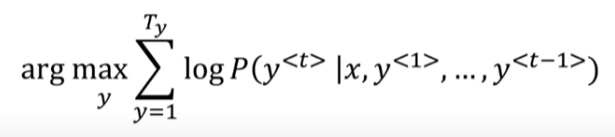

Once we have the 9 probabilities (k x k), we filter for the top 3 highest and then carry them forward to step 3 and so on.

One thing to note here is that there are k decoder models running here for reference for each word found in step 1. Let's discuss more about it with the pic below

In [ ]:
base64_data="iVBORw0KGgoAAAANSUhEUgAAApQAAACHCAYAAACoEskgAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAAEnQAABJ0Ad5mH3gAAFrFSURBVHhe7d0J3LVjtT9wTeqUQicHqYhTyUnGEofQIEoy5BiKTKFMSeKYZ8pQChkbvOZIhsyROEUyC5EGwzGl6URn/N//z/fKervc9t7P3s+wn+d93/X7fK7Ps5+97/u6r2Fda/3WuoZ7tiaRSCQSiUQikRgDklAmEolEIpFIJMaEJJSJRCKRSCQSiTEhCWViTPjf//3f5r/+67+av/zlL13TM888Mz3Fd//93//d/N///d+zuSQSiUQikZiRkYQyMWr8v//3/5o//OEPzQMPPNDceeedze233z493Xbbbc2tt95a/ra/u+OOO5oHH3ywEEt5JBKJRCKRmLGRhDIxaogwIolf+cpXmr322qvZe++9m/3337/ZZ599ml133bXZaaedms997nPNvvvu2+y3337lml122aXZc889m3POOad57LHHns0pkUgkEonEjIwklImBIaoo/ed//mczbdq05n3ve1+zwgorNBtssEHz6U9/utl4442bpZZaqplnnnmaxRdfvNlyyy2b7bbbrtlwww2bJZdcsll66aULyfz1r3/9bI6JRCKRSCRmZCShTIwKopOmuw855JBm5ZVXLkTyjDPOaK655prmuOOOa1ZaaaVmjjnmaFZfffXmoosuan74wx8W8vnRj360WWWVVZqjjjqqefzxx5/NLZFIJBKJxIyMJJSJUQGhfPLJJ5tDDz20kMlvf/vbZV3kE088UT4vv/zyzZxzztnsvPPOzcMPP9z86U9/au65557mwAMPbLbddttyzZ///Odnc0skEolEIjEjIwllYlSICOX5559fyOEvfvGLstv7qaeeak4++eRm0UUXbeaff/7mhBNOaJ5++ulyj98uvvji5tRTT21uueWW5n/+53/K94lEIpFIJGZsJKFMjAqxhvKXv/xl85vf/KaQRt+JUh500EHNvPPOW0jlVVddVYgm2NX9q1/9qrn33nub3/72t7nDO5FIJBKJmQRJKBOjBkKILIo0Bjm86667mu23376Za665ytpK5NFZlRDXI6LxXSKRSCQSiRkfSSgT4wJkUbL5Zt11121e/epXN5tuummZ5s4DzBOJRCKRmLmRhDIxZkR00ttvrKd817ve1bz+9a8vU9++64YgoYlEIpFIJGZsJKFMjBtEIx0HtPDCC5fzJ88777xnf/kbeYxkytvUtynwIJXxV0TT7/E3vk8kEolEIjE1kYQyMW64++67mx122KHs7l5ttdXKTu5AEEnrLX/3u9+VtZZXX311c+2115YDzhFLBNI1iKm1lzfffHN5TeOjjz76bC6JRCKRSCSmIpJQJsaMiCAiiOuss06Z7t56662f92pF1zmn0uHnhx9+eDmPcosttmiOOeaYQipNj7vG59NPP728pnH33XdvrrzyymdzSCQSiUQiMRWRhDIxLhB5POuss5p3v/vdzVve8payftKUdg1RSBHHb3zjG+V93ptttlmz7LLLNmuuuWYhjQ4/RygR0eOPP77sEl911VXLm3YSiUQikUhMXSShTIwLfv/73zdHH310s8QSS5T3dZ900knTI5cBBNNUt8PNzznnnObLX/5ys+KKKzZvfvObC4FEJOPA9GOPPbaQzbXXXru5/fbbn80hkUgkEonEVEQSysSYgSiKPH7mM59pFlxwwWappZZqTjnllOdFKG2w8bpGB6FLpr433HDD5rWvfW2z1157lUPSRTofeuihZt999y1k8wtf+ELzxz/+8dkcEolEIpFITEUkoUyMCTFF7bigDTbYoFlkkUWa5ZZbrqyRfOSRR5696m8QgZSsl7SJx7u+beKx5vLOO+9s/uM//qNMfzvDUn7XX3/98yKdiUQikUgkphaSUCbGBOTw/vvvLxFJO7w32mijZvPNNy+EEmFsAzmMJBIpAmkTz/rrr9/ccMMNzX333dccdthhzb/8y7+UI4hENBOJRCKRSExtJKFMjAkIpWN9fvKTn5Rd3t///vdLhPG6665rHn744Wev+htqQul93t/61rfKO79XX3315rLLLitrK7faaqtmt912a2699daSfyKRSCQSiamNJJSJMcPaSGsfTWNH8j8yGOSxE+zqvvTSS8sU+UorrVQ26ZgC33HHHcvGnb/85S/PXplIJBKJRGIqIwllYkLRi1DatOPw8w9/+MPNYost1nzkIx9pPvGJT5RjhUyH97o3kUgkEonE1EESysSkQWTzV7/6VVlz+YY3vKHs6j7ggAMKyYwd4kkoE4lEIpGY+khCmZg0mBq/5557mi233LKcXenNOVdccUV59WIQySSUiUQikUhMfSShTAwNIpLPPPNM8+c//7kk09rnn39+s/HGG5copaOHHDXkukQikUgkEjMOklAmhgYHlDsA/cc//nFz4403NhdccEGz9957N9tss01z6qmnlulvr2dMJBKJRCIxYyEJZWIoMHXtvMoTTjihvMfbWkl/7er2mka/2dWdU9yJRCKRSMx4SEKZGApMYzurcpdddmk+8IEPlIPLd9111+ab3/xmIZM24SSZTCQSiURixkQSysRzUJM6n8crOZfSm3NOPPHEZo899ihv0rnkkkuaBx98sPzW6Z5+UiKRSCQSiclHEsrEcxBEzaHkTz/99Lglm3CeeOKJ8mrF22+/vezu/vd///dyuLn3d8dGnU73dks2+NgpnsQykUgkEonJRRLKxPNgehrZ87aac889t7wO8eyzzy7J5/r/SGeddVbPFNecfvrpzbRp05rTTjtt+vdnnnlmSfF/PKNbiryU76677irEMpFIJBKJxOQhCWXiORDts57xpptuajbZZJPmgx/8YFnzuNpqq5VUf67T+9///p6pfZ3P8pLa18X33VLks+mmm5Y1mCKfiUQikUgkJg9JKBPPAULp6B5vq1ljjTWa+eabr5lzzjmnp7nnnrtZYIEFmqWXXrqQuk6Er5+0+uqrT0/dvo/f3vve95bnve51ryvPf9WrXlXS4osv3uy///5lHWYikUgkEonJQxLKxHOAUJryfuyxx8rRPm9961ubl770pc1ss81W0otf/OLmta99bbPOOus0Rx55ZHPyySc3p5xySkk+1/+PR5Lfscce2+y+++6FwCK4yqAsb3zjG5t//dd/LedXJhKJRCKRmDwkoUw8B7HBxc5rUcpPfepTzUILLTSdxL3oRS9q5p133nLsz0UXXdT8+te/bh5//PEy7TxRydtz7rzzzkIwP/ShDzWvec1rmhe84AWFUNoxnoQykUgkEonJRRLKxHMQhDKmvi+//PJCHv/hH/6heeELX1hI5cte9rLmbW97W3PggQeW3dpxIHmvNFbIA7E84ogjmiWWWKKZffbZpxNKpDaRSCQSicTkIQllYjpq4hef//CHPzRf//rXm1VWWaWZY445SmQQsXzFK17RLL/88iVqaA1jHN8jOXJIiv/HK5mKv+aaa5p11123mWuuuUrk1JR3EspEIpFIJCYXSSgTI+IXv/hFiUbaBPOSl7xkOqlEMK2l/N73vtc89dRThfRBEMAa8d1oU+CBBx4ob9hZcMEFk1AmEolEIjFFkIQyMSIcI/Rv//Zvzfbbb19InHWUQSrt+P7sZz/b3HDDDeVg8pr8TQR+//vfN8cdd1yZ9lYWU96/+c1vnv01kUgkEonEZCAJZaInIkL45JNPNuedd15ZTznPPPNM3/UtYrnMMss0X/ziF8urFa27nAhSGXnK/4ILLig7vhdbbLFmn332aR566KHyWyKRSCQSiclBEspEX7BG0tT3CSecUM6FfPnLXz6dVDoT0pmRDhlH7qyfhIkglvL+6U9/Wqa9N9poo+b4448vu8wTiUQikUhMHpJQJvoCcuj92bfddltz0EEHNW9/+9tLdBKhNPXtbMrNNtusufTSS8tGnrhnIuC1kJ5zxhlnND/+8Y/Lu8ATiUQikUhMHpJQJvoGgogs/uAHP2g+/elPlzfXxPmUyKVD0HfbbbcSQZyoqW+wptMUPGJpTaXd34lEIpFIJCYPSSgTAyHeomM95VprrVUOGY9NOn/3d3/XvOtd72q+9KUvlZ3XCOVEkcpEIpEYD4SeSn2VmEogi3H83oyCJJSJgUC4RR8Rxq997WvNP//zP5c1lHHoufd9ewf4WWed1fzpT3969q5EYvLRizBQ3M8880xZPtEt4t3r/sTURC+D7Hu/ezHDb3/72zLb0Z5Zic/+RkrM+OjVn6ELnFrijXHD7nPPt2eB/fzd735XygLtcvSqQ78Y6/1tJKFMDAwCaNr55z//ebPXXns1iy66aHnfdxwl5K06G2+8cfOjH/1ounEeT6EdL8RgipSYOaFvGQZk0TrgNmGkwP120003NVdffXUhF76r4R6KnZKn7Nu/JyYP7fHrs/5BDi3Roavav0v6kcG+4447mrPPPrusy7aMpr42QH4QDOSTLHS6JjH1EXJhHIcuaPclmbFsy0s0Hn300efpi/FCJxnyrD/+8Y9lA+xVV11VZNLZy52gHmSyUz187kdG29f1e183JKFMjAqEjqL+4Q9/2Gy66aZlU05EKU2Bv+ENbyjnU3rPNmWcmPkwVuUzXohydCoLRSvy5F3wV1xxRXP77bcXhV2DYr733nuLvH7yk59sfvaznz3HiMiX0vb9JZdcUjamISJtQxPP71aWQTEeecys6NU2+hMxdDauly7Em7xqcA70OSK5yy67NKuuumqz4447Fvlow7OQjOuuu64kBp48tBH9HikxtcAOcRZvvfXWQtT0dfvsZGOag+EUka233roQS3ZuGPBs9tKxePvvv385xcTZz4htJyC7ZPzaa69t7rvvvufptUFkcLxkNgllYtQggAbot7/97ebDH/5w8+pXv7pEKZHKeN/3V77yleaJJ54og2U8BDYx9cDrZ6DJgs1S/h9mX3teW74QCArXgfyOuqKYN9988+b0009/ThTKX2958r1zTS3XuOWWW8r9fouEQJ5//vnNxz72sbIh7cQTTyx5e7/8RBschpCxMI5iWjbxXOgjJO+Xv/xlc/nllzdf+MIXmk984hPFQbjxxhvLb64RYfQihMsuu6y8/eujH/1o2UxoqY4zdhGINsgWUup0iy222KLZe++9yxrye+65p/QL+QP51wjZaX+fGC7CwTBeHTNn/G6yySbllJD2bARdMG3atGappZYqToZZNjLjmvq68UDIBfly9B3ieOihhzYbbrhheXGHoMxHPvKRQn47wbnPRx11VJHx3XffvTn11FMLGa5lciTUMtpJTrt93w1JKBNjQihbxHGFFVaYfj4lYvnKV76ynFnJ42IIBxXOiUKUo1tK9AdtJXIjcnfhhReWd76L4HWK3kwUos8oUH9NXd9///3NlVde2Rx99NGFRDIMZJMRQQqRXnJr2ku0SRTLkVfeT7/yyis33/rWt8rUt2gUpa2OEsUuaiCv973vfc2WW25ZFDpy4pny60d++rmmBjKrPt6bbyzFhrfEX/UPUsCQfuc732kOOOCAZoMNNmhWWmmlZpVVVml22GGHEolCChBzbXfuueeWFyKISG6zzTblCDRLdrxG1rKHNsiWjYj62kZEMuJaJ1pwRNzj95yJmVoQfTS+jZ0vf/nLzVZbbVVeiEE2OIbGknFNhugNsnHxxReXcf33f//3hVSefPLJz9EF7Nh4EkvjWJ70ElK40047NZ/61Kead77znWXpmPOdlakTOE/eGscpeve7312uJe/f+MY3Cnlml8l9P1AO8ttezjOonklCmRgzCKFpQAPCekpT3kilKXADk7E2NW7QTiZi0BhopgooCsqGZ3jXXXcVBTQzgEKgJP2Nz+3k+27KwvcjKRJ5OMQekTQ9Y3po5513LlOIw2xH5VQWpEsfIhXKgzwyHhStyJMpLJEHUSXRVIrWlCdCIHopSuXoq2WXXbaQDNPf3hPvHobG9Uij/z//+c8366+/fnGWPOPjH/94s99++5VIPaMzUoRgpLat4VoRNUTpQx/6UPOZz3ymnL06SB4zKrrV0feiTiLQoo8cGf273nrrNe95z3uaD3zgA8WREO256KKLSmQ3jKW1aWTEhkKyKtKIHHJ+11133Y6E0vM4SaJVHOftttuuEEvPEkFCTI899thynBrd4tpe/Z+YOGh3488417eiyiLVZIITyNmIcW0PgNkFsuGzjaR0wT/90z+VGbY3v/nNJfpHF3jF75lnnllIXLtvyccgqYb/OUT00BFHHFFk8rvf/W7RKa9//eub1VZbrSuhVE/yL+qKiK699trNiiuuWOqKPHOAROvJPGe3l0zSoWZbrr/++ukzL9qlXd6RkIQyMS5AIpAz5HHeeeedPvWNVL7xjW8sEQEGfzKn6wwOxIBhMCWGOJheoHC++tWvlkE0o4PSEIGzpkbURhKhiYT4S9YUUqLIiuuRLPd2UyDxvb8MM8XqzUgULkO87bbbFm/55ptvLn08qCIaBPKm7MicyJC6iDrtu+++ZTMYosfYMx577rlnMSzKpX+jnow+eRSBEK2Yb775mrnnnrvcI/Jksxlies4550x/+xPZMXUmL4ofifQ8z4rnkXPPUybXKiNlPVqoq75E2BdeeOFiNKwFncj2nUqIevpLrkSUyCyHUMSWE6NNRKFFaMKQaiPtxliHYdQPpjTJPeJPHjgJ9MBcc83VlVCC+xllxhlxtIwCkQxiiex7tqg4PejZnlVvCPI3PifGB9GvghUcDLMlHAZj03hEIpEyY9x3xrMlLcZm6AL3kwczE4gc+8XBcB8iSYdYHiFfDsNY+zDkIBIdQadY26lcHFgklt3sRSiVG6m07hIJpI+Nh4iiGw+WaLB1ZmE40LWuryEv9uHwww8vzhn5/slPflLaNGRYGglJKBPjBsLK07IOzYBEKCWHn/OcGG+DhYKfDBgQBgejccghhxTiscACCxRPECFiXGZ0hHI87bTTihLkjVOKlCnFQmEcdthhJXrj/2OOOaYoWW0iytdNaYRCYdT1ob6ksCktUTMkSvtRjnHtRIDsIBUMu2ko9VQ3hkBZ1lxzzeLUiOghmUij69syhxSLXFnQ/rnPfa6sV7KGUr3ky/PXJp6jTjXkhSyE8dLOnBJyL2LJSbHOjoKXF/KtDJ45KLQjQyDi5kUCiIsp9olq36kGhs+YpVv0pWUHjJ0oMQIoGiNKaF0cMmdnLAMbchgImTQ+9IO/ElIp4ohQdpvyrhHOyMMPP1yMOHlhgEXB6RMyyMkSbRJpQl5qR2ZW6bdhIHSBaW0zYKKOIpLII7kwHumCgw8+uEwpkx/jtq0L9Av5QqDoSxtMkTm60mwA54VcGMe1fiM/8hokhdyFLEQ+ZIpc+l9ZyNRIhDLujzFiHSZ50w7qYXmOdghnh76nE9WHk+yZnh15iOo6Q5qucS/HWlSWPUHY+5HfJJSJcUEIpUFHKJdZZpnpb9GRbNhBQChZA6YeUMOE54paIBLWylAejAlCwHDDsMs0nqAgQjFQJqJapnN56iIqDDEvVt0ZUARIhEdEjlKuIyptUIg8VkrGJqwVVlih5CUa1F7cPhFQN0pT34kom+ZhyClddfC/KKkIkSgUY9NLCfrNdeq+4IILFgMkeqsN+oF8RQjkoQ2Qc2uYKHDr9xAdZfL997///UIs1GFQyF+kgeMzqxFKUWHRPnoDMWAY9bV2YPT0HeKO3DGSiBton7qNOrWXvkAMrVlzlm4/hDLylThXIuQiSwy18olYk8cPfvCD5fQLjoXNEq6Z7CU/MxOMXdE848oyBOPOWkLtHuPOMoSIVNMF3cZeyIboo1kJNkEAhCx00mm+I2d0ISea04nU9pM4O+xfrWdrmYIglAsttFCRJdHFfqFs4exaI/rFL36xzG6IWmob8ulUA9F9Mmn9pnbxbG3kO066IIFns9l0reglAlqXsxOSUM4AaHdgr07t1dkTiXguJUsoDQjRP1PecT6lKJCBb51GP8I5EYjnicaJ1Fkng1BS/jMDoVR2JIdHjlBq93nmmacQL0ZZBAchscORMTZdp5/syLcG1nRiJ8UrX1N+pvsopX/8x38s6xRFjCiwaDN/J6r9yIyIH9lafvnly2aKIMq8ctNGlDwSEuXoVRYRAVEJHjkjIko96DFX8g8Dw8CRfYRbxMy00+KLL17eHuV/65mUbRDIPwjlzBahbNeh/j8+iyLbZEB+l1xyyWbppZcuxE9UuJ7Ga0d/435/288JkHMkFKG0y3skQhl5tZN8YurRumwbQIyNWkaRTWV1fWJkjNROCJnxJLq83HLLFf0lQmyq2HIUBIguqCPDkWrE//7SBeyAzTCinLVeq0HWkE/61PIK0egjjzxyxOQ6JBcJ5ojUz44ywlgIZV1eDgx9TmdaM8wZ8yKSt7zlLeUv+ydqW+tLuk+9jQMRStfROZxieqg9ztroi1DGwwbFaO8LdLt3rPlOVUS9xqtudX7jme9IqIkHRY3UiFLa9GDnnOlWwkl4h1kuiGeZuqD4TXNORoRyop9BiZgSFCVG/igPhEybUwrqT5mYIopF6Iw15dWJ9LhP9Fk+FJ0ItKlHER7KsI26X9t1rX+rEd/XqQYnABEWVdVn+g5R44krR712s76/U16gPRglnrvonymhbkakGyLvSNqWQTBNZYE/Q2dtJlJp8byxMQjkSS7bU9692lxqo9N3bXS7d1BEHuORF5ImomL6z2tekXQyayqSPER0pRuiTp2uaRPKXmsoA3V+NQmI78iU/tLXImUcFRsTfRZZ79Rvif4R7U1/aWPjKnSB8cbBFXXrZFt8jj6rE7ieHuFgC3xYMtOtr+hHMxmuscSG426pw0gJORRFRSpFTSP/dlnooNEQyrg/EHmGTFojKqovgOA1ycrCAUI8XVfLs/ZAys1o2ahIft3PaW4/p8aEEsoaY72/G6Jso8m/132jzTPxt7C7HcC8c2RFlFIy+E0tmqbiQQ67jeN5BhFCiUwx+DPLlDdof21POc4+++yFKNrBWNfLZ4rGLlj9geyLZGqTTqTHd6KbojjRXjY3yaMT5N9JIft+tO2rz5RBVAKh5ZyYyolzAW2E4fkrU6dnt2GaXmSTUSIHdml3q08vICbuMx2PpCOT1nXadayc2h8h1NaD5q+t+iWUvTCWdh8txvK8uFd/WsaA9Iv2iphoi9h4Y8oRsaydiTa6fa/fOCKcEnqpX0IZfyX94NkilPKy9lZEFbkx/kQoHVMj2sNAdyvLrIBos7Eg8tDmjiizdMf4kow3JM8466QL3Odz5BEJTPcievSAPrM2uhs4jRwda88FR0TL+0mm00UpObGdbF/8P1pCWYNs09lkkkybxrZWHPlFvulOM1JmdURx67YIiAI7AUW01vVmSSwncj10umegKW+d4SEUuwHkr8ZtZxrwvYphuwTAvfX1/vpNp8tPA/TKT14q41oC4D7X+76boPSCe7qVL/KLZ/KI/O77NlznftdoE5/7eX4N+fJ8tIG6dWtb/3dK7o/k//ra+rf4Pa6ZKGhTa8YYA4e0Op8SoYy36JhaMFD05TAR9da+1t5EBKkfQul78kAOop/0eS+Z7Qb90Cmfun/qNAiMC+teKA5nK1IinQ5slq/lBzaRIP2MKsUXm3PiucpkIw6yabpEtMgaTdM+2qMT2veTbeXqNjbi+kjuibYIkCkRJYRKNDHWBiFZouE2H9kkYUpJBFw93NMN6iQf7WSXMMWrfP1C3qIhog2eaV2SMtggZI2ptX42aJjuRPBjQ1pdp5Hg2tEQSs8hU+RLH3V6pu9q/RbyNx7wfGMs8u0Ez5ein9sJlA05QPy1rXEqWiIy5LNoJWfJRgPy6Hlx70hQ99ESSmUmz2GwLTGxKcjaM0dKkUvjyhSsSJoZg0Gj3zMb1J1c6NNeugB8L3WTDd/TBWwIUkcXIJTkwro/kTUvH+CAhi7opaeNTQTLGKMLRCC7wbPJGXmzXt2mFWsW+0nKgujS/VGXNji6CKV13WZj2oSyWx18r33NkBgzHFtT1SL8ZJFOsnSEs8MhM4tYv3Qk8q3/Ir70vvXyHG9tjUzH722MSChD4XiwxhOVwLApSOFlUw86QwNr6IDPDCVlyGuzaJrxkgcSQaAQDruSsF7hZn8NUI0SUGjPdy0PTyN4Lu9EuJYisW7Jb5EclaIh6nzakG+Uj0JQNolwqIsO1/EEi1B6pjpYWEtJh6ArG8FSR+2iXNrEd34LtBvf/QaUMqgzYfN891ub4XnWdPitNnLqRDHxzNtHwmhbZdZnIG8Lhv2mjdTFNcPYQAHK7XlxPmVEKv3lCfKY1DEG1zAQzxmEUPpfGQ1U9dFP+tpAJxvqQC6Qi9p4uq/Oq87Hs8iTfPS1fIwt40E/1f2qr8lSu1zdQPYpJGuBRB15luSiDfkxdBSwPtEOFAa5qcuuzGRaPjZXmXZUbuO4V5nImDYxpoxbdVS/UGI1XEuuyStlqA38rfWBZ5Ep7We8IFbWBpEva9YYFIoTQTA1b6MEuVd37dd+pvwRAIobCWCgXKMPQ0e1x0noQ9FIfWOsijpQ0tpRBBehRH6UjYwYp64PA9qrzdpw7SCEUvm0o2eGPlLP0FkBbcrI6htkWLSPzqp1zWjg+erKgVFOfR67RNsgV2RV/ULWja9a/pRZP+gb4wxxYwxFqRFApF3fk/fYkEWGyF20dzcoK/nqtcu7vt9necrb8g9T2BwYO2r1T8iftbjGkeUZdAXdoE7avFd5ZmZo67YuMDaNZb/V0EaupfdCLtxHBsJWRF+436wAWbMEhy4wDhF6Y5ou4DSKONIpdAF5aj9TWfShI4PcRy7AdWS31h+eTS7pCeUZJClzLQfxt4Y6sY39EEqflUMZldkY4Xw5Qm2rrbYqdZF89p2ZQVFHxFYb9yLZoMx4lqlywQRtS1d00xNdCaUGQ6x0KqMjvGvAUtQW89tFZeBQyFiwgUgJh9LS+IimBbLOZtOxlK4BqPOEWi1eV0mGykA0sAmbDgcVVWnKSUPwRoWNRVGEtpWDJ0KZGNR+Uz4CpMyRTyfIG9Pm3ZqeUjaJN0mpUcIR0lYuxw/YUCLygwggZRSyeuhAeTjPTORN2xBuAtyJYPiO0FD6BoL7hduVXT2s6dEmvFvTJzo/2lVHKh9lpT0MINMp2jHaNjpb/bS/diGgrpEfYxxGeiKhrgZi7KgWmbSmD6m0q9KidUczUM51O00klAkMQH3ZD6F0LYVGKSEP2lHbk0HTrZLoBOOtLgYhRH/HZ+PJM5AQET79InpFxsiPvtRPZJpsO9pI+9glyki3lWA3ULCmKUSFF1lkkTJeokw19A3HUATTm0KsIxRlU06I8huDpoPtfNRWFK/2IGdRvxrxnTHCcKirjTOidXSBdopoTVxLHsk5eVVvbaBdtbn2r59jLKhPEFDjMY5Jit3rknJ6nrU/DLu+qSN2nEBkhBER4aSQGf4weiKPMZY8UzmQA3k5Hkv/i4xQspS255EN45lzQHdqg9oYjQbahT4YiVBqw4jg2t1J5yK3ykk/hz50nbVQDAP502Z0Dp0ZfT8aGMPaWJ95pv6WEECORHuM6wt9IJKkr/W5sUB+o79r+VA240D/qCOdKfqiD5FL/RDRFwGK2KTlubX8gP99T34YW/pI22qDTrpR/+lLdoGBpzvoZ3KD1DK4ns1JNabofkEQdYznt8swq0B7InIcF9Eu9pFc0HlkMGZEahhndAE5IhfGNgeRM1pfaxyY/dA3+tLYxBWCVxiXiL4+pm/pUqdZkFPjIfKiQ1xnna4+tZlF37nOWJZ3Lz4xWoRc1MkYpi/pY9FSy3nqsRPXaVc6EB+gZ0866aTSVsqPUItG4i50Af1trKkXntZNd7fhGjxCX7GVlhYYX50CFNCVUFLYBi4BQBopJ2RHx8pchU09eIAjMpAhxjIMl45WeMqVsX7Tm95Uko6lQJBTldfh1hlpPLv4GAZKHQiKyAihcp0GYiAYb5WiTKytsebBvcLdSB+CSVAZgG7QUAgvAaN0rc/BwCknxgIhZNTl59l2kpkasyaQYBocBFM9RCMoZIrFWgPROEaaIaW4a2gXZJKXoKO1o6NX1JEyVT8KHtnyPHl6EwSjDkEolQ9psGDWsTDeCKJcFLc+iPppK2VWPwOGwkMox2LgBoFyEHoEWP8YsAiljTo+U+IURx16n0hE/oxTP4SSDCLprtUvBiu507fGBkOoHwxgDgVlRgnJIxJEv5F9Y4Dx0+/yIEP633fGAvmx7sp1xpxn93vkjOfxKMmf9ZNe4aXt6zpBjE/1sCRhjjnmKM8klzGG3eM6REs5HUE0//zzFxllqP3WCe5TX9EiusLY0D7GqPIY99q07m/KEXHi0CGDdt+/4x3vKM4h2W+XH3xH0Rrn2ofjyUFESClSRl5e+gxRp3A5cWFIglCSw4gEKLMyqC8jgwwCOdB/obTJC72g7xlI5dTO8lQW8lUTmU7l7xfaBVm1mL4XoaTkESn9w9k33jkUdAQ9oB/DuCP16mFnLD2zwgorlO8Y0dFAvgwh8u4gaGOBTqJTbUigr4zxGvoNAYjdpPSY+mn3bu3mf7JFJpAOss5JDr1po4GEsBibDGntjCkng0ovcxj0Ob3E+aJzjV/f+z0CJJ6prMaG3bpkSwBE/ws0aEfRaO2nr5Ab8tJtfMxK0AYIo36i45Bu7c0e0QVsJ/KtX2rQocaha8kQWeLEk+FOY8l3oQsimi0gxMaGLtBfEc02jo3n0HVIo9/ZArrAOFJm8sBxwUPIw3hDubURfUHm6GTcRVnMLuFXggpstrqzpSFb2pUDZGzjEeyHaW36jk7yvfWkdJ4x7xntdu4HdAJeZmZK1JQTLWrcqR+6EkqkjqeFISNJBg5jqLIGFm+BsWOMTBcwYDENBh7ms45lVChtO4sYLUJFAfCOCRSlb10WI0I5BKGkMChqA50xcp/pQYaDx814ULTutZOOcmQgCRIvN4SlE5TPcxgAht1OWEaVEUMYKCNGBZnTMQTRNaYRNaxoElJLyBl8kR1l1aGMrqlBn3V4DYqNwlJOZBjZk5epHFERRJVSJlDe3mGXIONFKIAgBSF1H4FziDiyjuzzJsKboUjVQZ0YDR61QUKxD1PZeZZojYGhL7UzUilayZEgoOSk9hgnCpF/P4RSuckgEq6vGD2OFSNF/kRAGHfesHFiGp/T43f5g7wkRkZEnrEzngx+/Swfg1O/M8Sx3lR/GV+8U94nA9pPn1EYBr8+N96Um9GuQQbJvvFq/Ih8WQBuHFBoNXH1WbuQNWOYnDGexna3vlJO5eVkcsiMC/cjLZQkha1eFGO0j3soS9/bJIQMG9dmPyi0bs+CuF9+FGdE/pEYxkOfyFPEwjgzftxDSdM/2lqfcJyVkzI2PsM5A/XVXvJAjilteWsLzxK5YhAQ0H76aRD0SygZZk6pca78dJO6kQPlJWvqbsaAfuOskg96kw4eaVanF9zH6Go7ji0niaNufJMvY5wTAdHn9BTZ4riTKzutlUf/xTVSN5BNsmGqnv5gkyIyqz5skj7VN9GPxiUigfwZf8aucU3XsjExK4Roug951dbkih7QjvLm7GlfToR2Q4DI/GgM9swMfSywgTvQL2ymNma3wpFjr9typy3pURubLMcRNNK3MXZ7IXQBO4cH6GvjlOPCAWSXjSd9HHqMLlA+DhgdjGuQS46ofje2Rjs2RoI2onetecRpjB/2xNhBvOkc5Frk3xI/bUDO2Ho6zjhDvNWNzUCC2Xl6g04lw/2Mp27wLPnRo/gIBxEP6yTrXQllRJUoWlNdKiRiyRAZlOHlmmowXcYgqUgdktaxWDQlzjjYSSr6wpNE1HgFFIEBzKDzqDFqXoZ7faZgkDODnuB5PuUg8UQoLr+5hmIkJMqg8zsp3RrKSXDlEQZYFEb5KBvCyCswIAg3ZU7pIZU6nDHSyeE9IIoInIgAssSz4gm1DbR8kT8dg6ibAiUk2lVimHhFBp22FR11TUAe2pWBo6i1PeGjzPURAXWN8iDu2oXHjphov7o8w4B2ZmiRd9484lWvpyRjBhKZG43AD4LIXzuPRCiVWf+KxJMLg5YM6ivyZ6BSSCLVIkL6gQfHoGl7kBc51OcUKYWl/pws0ygUn/5iGA1Sxsr0m3GCgHMK9Jlr+mkb9ULkGGiOHmUTBtWzlJesKjMCS+6NTc8lY+pcP4fS4MCRH7LP6BoLEblrI+qLQCOS5N/9ZI8RZriRHJGeNkkmlxQXwoZUcz6RH2XvVnfft1O0J6JBx9BLyJ/xgbBqU/CXbtJfoZBFMyxr0D7qoHzy1AeInDyMe3mKpNEN2rTun/g7XuiXUNKlZJruQpoYH3UyG0CH6DfOhfqRC/Wm+zjDkrqoR41+60LutBm51ocIFhIhCsWBpC+1tT6WZ+QrmosEk3djh9GnByDavhf87joy4j5tJcqMBKif/oqdrEDmyARDTAcLHkQkm5Mn0iOSRv+qh/vkr5za1hhWXnVBfMkQW9NLp/bbhjMj6EiyQCbZeXqQniOXlprod+1prNWgd8g5p4B+JvcIl/wGAXk2dhE248GMKdJFNvQhedA/dLqZMuMM54goHz1lzChfLbvj1afyUSfjlfNsdoWMaR8yicSx8citcStySn+rF/thjCknO8+GcoLraGRdztGW2X2cQboRz8Bv8Ddy386zK6FE6mK62UAyUCOiACoUrF6EDKETyTPw4hp/PVQ0Dbmyw5cxJUCMnMEqT4oMOaLwPEcD+41BFRVkyER2NHrkC64jnEgt44mYIACdmHM3yIOQIc0IJWOnUw0CAhRCRCB5Kxi6nbMibZQx8hfPcy3hIwQiLAyAjq7bjXIiEKK/2pWBQ4xruJbSQ7C1mUGH0Ece4LNpR6Qf4VEuypuAUawGgE5XFoYcOTewJgPKqt5hlBF2UYuIUiJiyj2MyGm0YS9CGSDLlA8yKTF25KINbU0WTFcjyEgaOYxnGSvqTSmSUw6QKGKblJF9nrEonv5k7JQT5BX59QIDxygibiIA1vSKfBurlI0ZBiRP5JDM84CNH7KCgGn/+jnKLgLD6Brn5F5dGPBucL+6UeCUnjrwpo0rRNe4MJaMA2MmnmksUvLKpfx0i/q0y9Qv3GfsyUPdEQTtQLeB5ykD0mqZCz1gXDJ6SGIti/IRZUeMKVdKO8jGRKNfQqkuyqat6ST6QVSHXtPuonH6gD5ghLS1Ptc+dJA6jrY+2pIe5zQa5/Khw+ht+pLeR/JCngPa1BhjHzgQbACZgNH0uXvZHPVB+AUY6G7lA7+RSWPCb/QiR4qh1vcS4oKUhiOmHOqkbsYCPcGhNzZGKuNo6jAzQX8gbcZUOCz6RnSXXWMHyKI+gmgv19GRZjXMXJKRTrq3X8hXX4YuMIaUyRj2m/FiLJgp8lyJHLiGc0qeXVensSLyiLFKt3gmWSSTdfIdrsM5Invald3hrNNrnBt2fxDuMwgESDjS7GAEOzoFgLoSSgWmVHW0yhqQ9c0amIDw8kTsRFVERlwfSsn1OiwIpQilELbGIWQBz6JoDNpQaj6LZjGKyKpIHvIGUQ73MQa8baQgpsx7RTTacC3hYcTCk6ZoQllEXRghHoJnILgiGgRAGWqYIjVA5MUDM+XSnrLzTB6RgUUoPKsNRkHUC6FkDEwVtOtEeFyHzBh42snUnnIRQl4Wr5ux9JzJgnJHWyJpyKPyipyIwCJg4S1Ge08Uog3bhJJ8tQklxYOsk21k0bRJkJEaZIDMMPbqgwxyJKJfjR194NgFchFni9XjBBACU66WTCiTZRYRrRkJkYc6cCKQP3KqnXnj5BBZJROmmZTFWPQdI27cRnnrPlB2CgvpVHZrmfxPhntBeVyjbXwm76Jg+jrGM6JEhj3PNWTUVC155xyZAYnxFfUbDdyrHsiEMtX1kz8dRd+QP/0bY79GnUdbF040+iWUyq1+YVTUR0SdPHJS9Lf7rW8UjanXwXbKbxBoD8+N9vU//cZxoMNtyCPbnllD0ELdjEORGAZ8POD5ysKG1UTZX/2nn+llf+vku0i1wxByIqnnMPt/RoZ20nbaPMayMSRiyTllI+k5hAiiXckubsHhjWlx/ThWyD/6n3zU/ah8ykYXSGzEMPpa/sYumSOvtQyGTPpeIn/K6Z6QSWUO3T1RCK6H/wgAsW+c6nbbdCWULjSYFDoqENDIGpzBxVoRSgZM5NGDYxC6R2UZIAURtWOYTI1oiBrxPMlnDUkBUYQMo0XQPIgaGpFHIXrCSIkuMtxtQekF1wah9BzTbTzrug6gHqZBCLj1mspjTRK4Jq7jAQlPy0u7CBOrS10en7Wp8tdt6692MZhEGijaIJTIbH1dwCCzvsMzTV0aoKJt2hmxQN6QznhOfe+wEG0JnALRVoRBNI9cmHpFhAz0iUbUvxOhZLhriJpTeiI8Np6ZUug2cEUv5IF8yo+TQwF4nnq5F7kzlcuwI/z6BKJM5NvUrOgcuWdgycIgEIFE+ow10xMIsYilhFSK+om0ilRNmzatRBHJrDJGOWoZ8T0HRT4iTdqhH0IJdT7agtNgCit21Hp25ONa3rfoGefTtA+FFajzGg3cH6kN39W6p9M1EL91+32i0C+hVK6oA9BZInGmqPSdKWXTaE6DEKWrZXk86hV5RKL3LAEyxulCa8FEOuI5+t64MMVoLblyib6MF+o+rRHlq/u7TvX3NTp9l+gPdbuRu1jORs/5KzBUt6915WTerKOZGku5xqvt4zmd8vNdLTedrpkIxLPi2fXz29/ViGva34832CZLmGycE1XmKHIYlalGR0LZLqCBjwggUMKuplmRAiyVgmMgJISyjlBCm1CKmCFsI3kbhE60wn2MsKgOA1QD+WKYRQsRSqQQCXBvvw2sbgyr6RZEgMK1FinqEPl4ljpbsMvjRhhikXnd0RSidUQIpcFih2sQynaZEAreB8JnekZdTD1aS2HRPAIShFKIub4/8vNs5B6xViZTqqIBlgpY3MvjV8e4tl2GYSCeqc8pDkRJGQmm6W91b5PuiUI8ox9CydhZDI74kj+R9W5lNJUqMs3ZEMmjJBEiba6fRek5K36jJGNjSw1eOkJFlk0t2LQ2qFcuX46VpQSIpbVi2hyxMF1n7CFu6ipapB3aTk2NIJTKjpTYkEbWggiOhMjP+FEGa4OMDWv6TO9E/bQF2Ue2o60j0jarYxBCWfefPuJshjNgqopuorf0R93n7XvHCnmRHRtlyAy9ZBMQ3RrPYStMw1vjbewo13j3eb/1iuv6vX5GxmTXj+zSRZbjcJ7ZOc5m7WCLoHMyzLjhG6ErZ/a+maoweyaoZemKGTQBijp4GOhJKCkEZMf0nPUvIoYyMk1mGk0kjDBQViMRSqTIdKDInmmOkQyl51vHYh0hg68iFshiyowgIkbRmmY3Hcn7ZowRqBDMftAmlCJ7iHO7odQDobQpoROhDIgoIXJBKE0vKWs9EFyPBFqjYw0lsmh6X7ua5vaXN4+8IpTIYR2hhOgjUF+dKx8DFHFHbBAS/RfXtu8fJpB8pEvbaEORVMoCadNm7faeKES9OxHK9pS3aRlyh1DaQMWrDrTbT8RH5E+fGw+maThh6uXaWCumL00Z6GdRTYqScbd+lOKkRPWdv0jVIO2iTiKciAcnzFSSNTbkL5JrPM/YrolkoP2/fkOGjQt5ctqMy0EJpXyMFxFS0SrtgECGI2Es0C30iXYKuU30Tyjb0MciO3QumaRPzFhYdhJyCZ3aeSxt7175ky9ryj2fPrScKMqubD5bgmGdpePbOq3JSnTGSO3k907XdPu+X7TvHU1e7uE8cyLMonDa6QIyAXQhe0gX0KnsRuiqsZQ9MXoglPgXe4lQmnm1prWth7pOeSN8lJG1exSCQS/ahhDYfEMx+U3EkUGmMEyj9YpQBqHsJ0IJKsHoi2aoBAJivaAoqeiGcpjWRSh5vwiAdViDCF4QSoZSPdoRykCbUIq0BKGsn4cc2chUE0qkIX6XL8UpWmNhMqOPnBpAyLHopHWg/poetM6Q8W1HKGsYiAad6IOQNLKG4OsbEVtEokZd3mHAs/SlaBmjonzW0qkvItZu64lE1LsfQongWeLQKULZbj+EMdb8Wv7B8EeE0rUcCF64PrHT2xpGEX5RaRFAyy5EbskyRWq9irbpF55h/W6MR+PFUoJYdzwayBMRFEFm+JESSxXqyGK/0A5xDJjoq7HBAbW2knw6UskYdlyWdho0/5kZoyGUfqd3kH+yyxmwlMCsT3vpkH6u01hR50UvcRT0N9kxpugrZeDwml2ybMryKbI2q2KsbV/f3y2f8XrGWPIIcBjZSYEm9g2X4OiKUFs7bYaHEyvgQj+M13MTo4PpbRwkIpQ2dfZNKHkDiKGoJMOnwxEj6xORLcZTRMxnUUsEoRehFOEw3TLIlDcge8goY0/wrGcTFeW1MN6ieIiuslnwb31OKKV+ha8mlKZluk15qwdC1C+hlFcnQqne8mfsRUWtSbP+EfETXdVJyJdpSUYEoURAuhFKA1CbIyTIqfWk2sR0sn7TTiKudXvX5Z1oeI4oFBKC/PNIyYL1fP3KwXgi6t0PobTjM45u0k9ITzf54nGLLJuulp++iMiraxlR1yCKZE2++slaQf3P4/M/4oZoW95BwfYLz+CkmF5EHnj95JXcjgXkiyyKqHJStBc9oP0GgfKJPHD6rOlDuhENpFl0kh4xNavuiGe7fWdlDEootZ3+oZ/oIksf6CKGwHo07V23r891CsT/ntXreW3U+bATyiAqzxgZc5wIdTBGJLMUvqufPbMj2kiK9h2kjaG+N/KK7wNxTfxe/wb1951+D8Rv7ed1u34k6G/BIct/2AROheViiAudyDbSlWx6u36J4QPHwO/YbtyCHuEU6psaHQklQ4bIhWeLRDkGxZqrMKhIp8621s8UVj+E0i7vQQglARPBYcwYW0ZHVMe6G5FSHq6ooQiPyjHagwp6v4RSmwShNCXJ8POqoX5WTSgRT1GnmlCKoCK/DL91hIgpIsAAxDX+8uyRnJjydvxH/RzQB6JgiA/j7HoRALt244B1kUD36qthr0lTXu1rgbWpTk6BOmu79k7/YSHasB9Cae2hfrIpBwmiACPaW/eFz9YE6Uuky4Ajo+oecuR5In1kQ0Qagaxl2fe8dNE5x2MNuqaULJg2VB+Omyl3JL494AeFfLULBwgpsfHL1MdopifVyeyCmQZrSTkY9IzxQC+QYbqCbhg075kZ/RBK/0vaTfuZXTKDY8kQp1bkm5xrZ3JNF7hW/8ZniL/yorv1sxT6KX7vhfoaG75sZuTgiEyTdw4ueVc2UWqOVkx3zgqIdtTuxoT2ZevYmH7aF/SPe9kTyWd9CZG/NpUv8uav/oxrwGf6zPMjj1oW2vC9e5ST7naf+3vd0wmuVRY7t+lXASnBIXov1txyNETXyV3cM8gzEuMLTr6xi4uwAT73vcub8DFO1uNZ3I+c6OwQnBBmURTT4BQVQ2oKt71Qk+AwGqZb5GVKi2EdiVB6DmInkuX51hBSPJLvrQ1DuhBJhC3KFuVrV7QbDDp1dTZgvXA86hD5qIcND9YhIZQigSI3UD9L2yEIQSgdCF0TSuXVGaKO1n2KIGozv0ue61nWrTK8CKVrTRXWz/HZs2yQQLSRFOQa6acc7Jg0dYrsIxfqSLlH20SaSOgTHieiJCKHkNh0oZxtx2NYiDqTXxF4BExfWSDeJpSMsn4m3/qAFx19VYMsU4TaWeQtzqGEaGdTPKYbLfnggYtIixSRY/JGrg1aSppMDtI28qfkGWfePseNPMg3fh8t3GvaHPmmTPShMUmOa+PUDxBs66fNMnBAOXGcHcYE0UEs28fKJEYmlEEM6BlyLerrrFGEXdvSJQw0fSTSbsODJRjkFtmQjFUIWfGb8eBeU5BkVf8NIkuuRTw4uSJOyk8fIpj627SZUwlcMxYZnVFBfwtKaGPkyfjvZ0xpKzYi7hVQ8FmfBuRjpoueiWU1ggr0BJAfsoLcRx4i2nUenUAGzKIJgpAL94eT3Q+UXVI+ZTKtzUZZ3oVgbrXVViWibkmd8odczIryMZXAFtrZjbNYVsemdxq3HQklo0a5m75DAm1ICMEhkISOsvG2CGtgRBskEReDolZ2hJYCZJCRI4SNh2xA1AhBC1BwhAoRiQO7GTELypEUyWfGDlM2OJXNs9t5tVH/ZoBYs2hqHxlAXhHetkFXdwTEtI12oaxtqmg/S1lMYSIpiCdDoGyRH0Ii2oPlM/4WJpvqVnZK3LXIBXJuOsB0q+kiHr1BGM/juTHO8rID10YGnR4KSVshmp7DMWBQKG99F200kZA/gbMGhsepzZBx6zztPJ3siIR2EGkzOJAbUdP2VCBDGwfwMsaUH1mu5cxfZFF0Hjl15h+jWa9/1CcUMCMqwo2QIXvkl9KUfA55RvyRA7MBnhFlqstWw1hxL+dOOUVURYQZkPGAsjBKnAHjXBSfARvJKWxDOcm6JSuMCLnmNNnla6YDuTYeE8/FSISSLNPPNsCY/eFMclzIa7zZiRwzBk4AMLPDGSej8iKb9HQta8auqWhRRAkJrPVYP5AXPYV40FH0IbJgtokdiMP0Q2fNamBDBUr0EyfL7EQ/elEf0BMcVG3JBsvHUrToP/kI5HCIbfAjPxwJugWMRW1Pb1lqYhzSh/KAbrqGXJj5MMOiD+lzBLPb9W24LhIdYnOvmTQ6Fplkh20spIsn20Yk/grjk73SP+ybgImlS+xgu987EkrKxY5WBMAaPlMVFBJPhvLxmyiTjieIyIJpNt5wvfZLQRg6U8UMiDejIBeUXETLAiFkAcbUeipGxzQpQkTgbVaJRMmZhuSNU37Ot/S88LZHgvKJiHhO7OblSZsyrr0u+SHKSJvyiMbyqHh1iLF6KLsBEGfpMbyuM9gZUcbXNeqNmJpCZfwZU/8b/Ii2Z6snokn5IqamBJAFSoTBZeB1sMEssirqoA0MdoiymMqP8x5NNxu8nhOkciKhXRBzhk0d9KGIhKlh8jWZ0O+xiUZ/WtZhEbgoQe3oaENeNNlTfuRTdBGR5ziIBFOm1q9Srpwm44HirskWWTbFL4JJeSJmnI6QYSlkmjwztMYYox9TPjVirEjqoj/1K8Nh44z6IK1mFfw+VpA5yp9MitbSC8Ybx1MZ+gWZE5nm3Wr3kEvGlG7RnoPkN6tgJELJkTTrYXkNZ4Ys0jvkiX4jx9b/mvbmXCKIIs5mXDidjENbJyCP+okBoX/oDrq1H3mq+9CzkVxLSuhE8k8nxUacsBWzIjhQliPoEzN4zuzsx6HSB+wRm0AmOMRsb8yYgXz0OSeCbeZImA1AIoFOQmjpNvab3iA7+gS6jUNjlH4y+8VB4FwKEIzGnnDErZOkW9lKZTSDSZexv6kLpgbIUjiFdAEdxFZ20gUdCSUCRUkhjBHhMj1ljRjPxFonisgUG6NsfQzSgNgwiIw1RYLgmJIlqLHOUtRNNAKxCI+X4NQJFJZhtiuYETMwKCLlIMx1QqoYU0qLkuR5jyTgnsMgUs7OQjSgDRDGUt1EH4OYGkQibSJMyqFReVJItnYyOJVX9BGxE9F1jXazQ12ZKADXIQg6Q5t4pmlEREMZtC3FzTjIhwH3O6XOQCgDAkMR2aSD1CIxSDpSEmsaJJ/1hbZRL4rcpiaKHOlHnKKtxxvIlHWTCLj1hGSDERPlGsbrFXtBnZF6xF1/IjbaR9tYVoD8RxtGO5JDU+I8Mw4AmRcFQiStU2PI9aGoNUerfeQN2dDmHA1RaWPB7nHPbMuy7zg1ogaiz5wMA7pTm3kGck4eRLBjfS9HRd3ICydkrO3tfmSCIfEM097kCGE1zgeBtjcjQGcwdMaz2QdybXwkno+RCCWnB4kU5SFXdAVZRhjInmvpM/pbcEAk3UwMEsKxESRoyxjdyLGlx8gUGRdJ72RE2qhlX57GFEeM/qcTzQYwUCKn/eQ3s8K4ZQeMV3pexLFfQknHcBrdR7cjl7FJFORDxyFp9K+ZPvmb2QNjzQwGu0OujGkOP73dC2yh2Uv2T38iGUhoLTv9Ql5sI7mNEyToBjpXHWs5Skwe9JOgIC6D/5ATvEf/tPuoI6F0EY+VorGbR0ie4AifIzwiY9bkMXYiLx7AU0HoeFkEG3HiHfvd9JvfJYbZGkMKhYJC2qJQdQH9FeESvSDwFCHihDiK8ETyHc8b8UUObCRi+Op1i2343gBgbK19QxAoW6TH2jNKltKOkK5yTps2rRBphpoXRcGbLqCoEagg4QYIr9M1rlV+5I8X5zoDBfEU4ZEfQ4A8xEYNJFXk07S3a5AQeWl3A9n3+kVUVRn8RpkYiOF9AgONlCqLaRGJN4rMM0ATFaXUDgg9oqVfRMsQJURrKpAGddb++pNC1kf6XVtqU9GUul3UR1TNdJQlHTaIkXdkjxyTFWtLjAn9xYi3jQIZ4mQF6SPP2gY5JcOcJsnnOFWBE+FaTp17w7mpoZycMh6955MhdZHIlsiT8nS6d1AYz9pGOzE+SIsoakTF+0W905ty4rwxrPLvNl5ndYxEKOkD+sFvdDR9o01Df4UOQ9zpI/rGX/KrD+lp+dXtz6ibGkd2kEByyLDUz+0HrkcojRHOJWeJM2ZMDeqMzGzgZLKZxhNHQLv0ox+1qf5h5DkFCLqIM70bfSgfQRuOAPvNtnAwjT9gh9g/9prtowcFIAQ+QmY6gRNAjpA/suFeMyndrq/RvkZe7CU9h1RaCkNfzepyMRUQfUVOLD/gEAqACXiw5XRBJ3QklCAjxooRMUWNpCEtvB4KjHdDIHhKFv66BjkTkfQdZeZ+3gtS6Xf32qxgpyeCpVCMXSdhZKjkhwgxvhQgD8vAMUUcybQMQRQVpPgkXhfy0s2Qep5BqXwUr+k2g83zlNEaEaQ4pql566Y51cPvkuvVWzsgENqL92faXR3lFXm6TpsY5PLTNsqHCDiCBfHTtq7X3pS/kD9DomzyEN1D4Clig06U0/faVbmUr+5kkSCE3G+ui/Joewp+IiKU8mOcLMI3hSyyjOgzXIjwREZF+4XnU6raizHVLnV/att2GSk4ytcyA7KBOKqjyKX79RHHQv+HzNTQ3/oijsNAxpDTkGXkOxKHgoFAKk0DIePy7xS58BwRSgo95CTkk7xYU6dMZHOsMJbkRVYZEwYw+rWfqIqyuk5ZOWIUE/JDHsnteJRxZkUvQqld6SA6x5p2ckx3tacMyaBxTx8IBpBduoqu6URijAMOl+nQ+giqtmy34ff6Go698iJOIhwcWjLQaZzMSiDv1rRz/jiP7Jd26mccaDfjnm2lwzi71tCyZwHyYbwK3NALxpmARyyh8bs86DS6gvywhfJo92ENQQsOi5lGZ0tzqD1n0L6kC3AAjjkdR76d8JCO5dSBfqBHyA+bhfRzYOiNbqS/K6EEQqeDeUMECZlhWJG9IFH+IlyukZBM9zBAHioSxoAjOP5G8r17OwmP7wi6KV/TjEgl4iRSw4OKxCOjTJEDUzyEXETM1DulKv9OkL9EkSqHMiufpA7+qmOQXfXwf/weST00uHZwHaVdt0Vc7zrKuDYCkaepRBEzbeta+XmuayO/KBvD6zuKwOf6ORRB3cnq7rto78ijLvN4Q1tSkgi9aARyzxFAptoGbjIRMhttUrejcnaC9tKH2p0Rjj7zuZb5TjB2RAIYDYlCtt6pluNIjD4nQ+TaGkPri8KYt6E9PVOZoy51nZS1lruxwLPkpdwi+pw8ZRRViSUuvWCscaosE0AuGFIEiDHqRGgSf8NIhFL/08tkMXRNe6yFPvG76zh+xmuntifLiIr+taSGEaFj+yU78WykkbxwkkRFRfeRhk7lm5Wg7vpBpM+Mm2g9YtXJme0GfaHf6R55Ie61/pGP9qcD/O6vfg1bJXXKgzzE71INY5zjzNFQZvKBbMijfW0vKCe9p/4inBxoOo9OHg9dlRgfkA8yaXmTJRNm0azLZs+69XdPQhlws472AH/bmfl/NKkbCBxjw3MRqTHtHtN+yhDJ/xKB5onZEGEthnVZFFk3QlmjU7nqVMP/6h+p03X1d3XqBN+327V9bXwXzwzE93XqhE7XSeMNbc1Ltm7SBifTONZ4ipggznXZJwtR73ZbRNtKcU0vuC5ksJ97GGOKk0dvnSVCQNnXMhyyTWnHFENsYrA+ljHohbo+7TReUFdOiiUTllJQMIiOKWykJ8irxDiFUyYhMWTB1JtlGkh1RPfHs4wzI0YilNHm0khtGdf7G6mG/xkRyzMswSCvopmMffvagO/DQQ4Z8L98ROFFopVfPshLt3xmFWgb092WEZjJMSZEEI2ZQaAd61TD/+1+rq9pf98tBXzmqIpu02Wm0c0YGsPGd31tDTqN7uK81LrAhiHrR23aNDMjH+VNTA3oC2NVAACvEtizdNGsF8e0G/oilG10ErjxQOTHyFjPZgeoKVPTJDzwNqIMInZBKE3RMFgEdCIiH/HMKOtYMVI+9fPG65njDUrDFD4FwwmwiJ8Ams6lhKaKoujWhmNp35HuUXeyKRKBEFjnaMpAm0H7uRSuaWSD12J6i+pNYSOgUwHKjVSa+reW1OYOEWnrajgUIh1IBcWD+Ijikg1TatZ1MkTGs2uTTPaHIJSi/m1COVa021++oohmh6zfFjlCAHo9j54VaTY7YWZJ9NP0KpkQfUIaRNnJAvmZ1fscwTJNLdJnuZZlCOzbIH3aTxv2usZvder0XSRQNjaVjkeA/Y19AXFNG74X7LHRhxNqhkJkkj4TrTZLwXEx1U5nJCYf+owNEtGmZ8wwikazWwIC9HsvOR0VoZxo8OCEVq3dsb6EweLRIY6MkN8ln3l1BBYBVXEGWPSD0RtkgE41dBukUw3Kqa0tSbBxS2TSNJlpUVHlGaUeEwUG1LpiU34IpSlvRprRpYxDliWen+kE6zMRNdczyAimQT6VIGLFSDAINnvZbOczUqEOSKPvLfRnfBAidRKVsRZ4pIhr4m8wjmy8E+G2/Ee7T9S4ki8Db4aoX6JDBysTPW3zjc2DZIHzYCOm3eL1izFmdZ1A9jmVonTIO10w2eM7+qVTit85BJZCcA7NovSKVAG5QSLZcssm/CULdAVdYDaLLhh0yjwxMdBfiL1+tq6WQ2m9vA1bItPhEPbClCSUKibCQfCsIXOUjylA6zUQS54RIyvKoeIWBju2ReVFQfw+UsXbaA+gRH8QnaAcGRN95UgcEQkbtwbtg5kRZNnaSOetWXdop5wpQOuHtBtnyCYFa34RT9M/IuzWrFijRHkzQFNRLjl4IlHKaEewHdumvy03sY7ZkTPqwdHzPzIZ56Am+gfCIdpv7SmiRlYmUh4QRM/sd6mKay3LMJtk577ZCevZya8pb/LN+YfUsX+dhYg13Np6KujJ6Jd2qoFAmgYVvYr+7AVOchxXRRfYzU0Hmq2xZhSZFoxoPycxfOgDfWG/g0PyBUDMNiKVIsqCBP3M+E5JQgkxrYYgIosSpixUbjoQwfSbkKzQuZCsczGtV2OA+1GEidEhlI02Fj2xaFdk2FS3dZPTpk0rSsfvqSz+qog5P6LoZNVxQYytIz2sD0a0TDHy4kWgEEoRXhGiqbzmTLkYDWPVtCzjgexw+hzKj1w485BycqiyEwwY0nQ0+kP0O/kR4XMMDGdZG04UYlxHGkn2/G66myOkrx3dhjQIBtADnCmReHkFRspzZof6GwPSVGkL5WinNnynzP3qdXaYA0mnCTaELhCltDSC3khdMDWgHwTpOKz6iA2y0ZnO4fjUZLJX308pQlkLsgoypoyUKUAKy3EjKizaY+cgAkk47TS1To3SFT4PZZiYOOgfhs0xMg5Pt3ZVhNgxTtbJEMCY4prVoQ0immfKyNoyBIs8i+yRZcn/Ijoi8aJ85H+qTXW3oW5kQcTCdInxZwe8iJpxSh5EMNXdb65Nmegf2oouQ8oYaORyImXC8+r+Gamv/I4YiDYxQPrc2YKi7YgmuWgTkJHyTAwf+qSduqHXbzX0vY1ZlkA4YsxJF5xk34UuSEwNGKOcP05g9JMgwaA6e8pGKEFFGCkMGUmxbsPZW9b4MLi8dSRSOJZSI8BR8X4bIDE4CF8cEWSdlGlu6yatn+J5xkLtVBh/g/Ygn0i4tSjklvySZdFL8mz626C28BlxmFHIlzJGOf1VduOVQrIhBzGOKNWMUJ+phrp9JxqjeRbnUR/btKHPEUlTuVPdGUpMLIx3jjQHE4m0npL+CycjMXVgzCOP9LZZR3zK7NOgumBKE8qASjGuKsgwMViSz5RZCufwoC9ESpAguxRNZVgfY/OIJQoEMYRwUGHsF/IlC5QVw0UWJupZ4w3lJK/klmKtZdn/M0tUVz2kIMWREjMfQqajz1MfJwJkgw4IXZCYugi7pK9GixmCUHZDGqjhA+mJ4yNslnK0jTWB3qQkUjwMpUHoRflsavHGINE+5UokEolEIjE5mKEJZWK44LnEobRexTTnnHOWV/BZy1rv5BxvtKNbIpOm221c2X777csuNDtSE1ML7X5LJBKJxMyLJJSJvoAYxGGn8WpFb3FxPp6d9UjeRBGIdp7W1DrTzGYgR9JYRGwNFySBSSQSiURi+EhCOUXQJkJTjRhZ52fDjcNovST+Na95TTmc1jmgcRSMMk9UqmHjiqOKbATymkcnACC70L42kUgkEonExCMJZWJEIGl264oELr/88uW8SX+9Tu2RRx4Z0yLeQWHhsIio80ftLneAskPCbc6BJJSJRCKRSAwfSSiHDIQojlJwTMxdd93VPPbYY88jZQiSjSe28NvK7xVoNqNMBkQgrZsUkZxvvvnKIeYilbFucpgkztEGXl3ozSuveMUryls5vJ3FznNIQplIJBKJxPCRhHKIQCZNzXq9kcOtd9ttt/K6utNOO61sdql3SJvW9X5shwXb9OJzfSTPsGCq29sOrJv0ajXJK+BsiqkPPZ3oBMirsxudd2m6e/bZZy+R0rPOOqscuwNxbSKRSCQSieEhCeUQ4ZB207U2lHh9pEPBESKvlLTZRZQtCJEp5uOOO65Za621mpVXXrm8gQIZHSZh8iwRVO9dtZvb23BEBL31wCuZHB8kgor8TnTyLET88MMPL+1hh/lLX/rSEqk8//zzy7mUUeZEIpFIJBLDRRLKIUKE0eHfXkvnlZHeR+69t29605vKq/ceffTR6VFK5NErJRFOG0+sX6wJ50TDc+ymRmpXWmml5lWvelXzyle+sqxZ3GabbcprApG78UxeSt8teQ+2g9RXXXXVMu3+4he/uHn5y19e3h3utZuxZCAJZSKRSCQSw0cSyiHC6wp/9KMfNVdddVV5R7nzE+PVhRtuuGE5oDvWSVpD6Z24IoJIk3fjDuPQcDA17/kXXnhheVH8PPPM07zoRS8qEUFk7u1vf3spl3d3DysF8Z577rmbl7zkJc0LXvCCQnBFcOu2SUKZSCQSicTwkYRyiLAG0HuaRR9tzLEpx3pAZzo6U9F0eLxG0JS39ZXLLbdcs/fee5dNOcOAZyund0xvscUWzQILLFCigbPNNlvzwhe+sHxGLKWXvexlQ0ueF0RSWSTk0nKB66+/fjqRTEKZSCQSicTwkYRyiEB2RP/8leziPuqoo8quadPapsNtdLEe8Hvf+16z3nrrlZ3Vl1566VCP5vHWGa9WXGihhaaTuKmYRE5tELr55pufLXkikUgkEonJQBLKSYRo5amnnlqikAsvvHDzjW98o6yzdLajqOR73vOeZt999y3/DwuIrudtvfXWZd3kHHPMUaaWp1qyftKO85122qm5++67ny19IpFIJBKJyUASykmENZUikdZImloWrTS1HdHJTTbZpKwPFLEc1lRuHG3kWCObb7bddtvpyf/tVP8+rOS5n/zkJ5tdd921Ofvss8s5nolEIpFIJCYPSSgnEdZLWv9nQ46NOaKRjuNxaPj6669fNuXYaY3kScMA4moNpaN6brrpprKWUvK5V4rrhpE8z2sgrUF96KGHSnkTiUQikUhMHpJQTiKsi3TO46c//emyHtDrBPfaa6+y0QS5vOWWW8qu71h3OSx4lqgowlsn52h2Su3rJjrFcx1mrn2Ud5jtk0gkEolE4rlIQjmJQIK8gnGfffZp5p9//mbppZdu3v/+95dpXdPepsSTLD0f2R6JRCKRSEwtJKGcZFj/56BzG0zmnXfeZo011mi+/vWvlx3gw45MzijQLiKTEamcrHecJxKJRCKR+CuSUE4ikEVvxznhhBPKsUFve9vbmgMOOKBMg+e6wOdDeyGPIrfWeFpHaVnAk08+mcQ7kUgkEolJRBLKIcKaSUQx1kWKrt15553NwQcfXF5vuMMOO5Q36Tj0HEGq01TBIOUZr3LLx5twvHpS5NbGJRuWdtttt7IzHgEf1luEEolEIpFIPB9JKIcEpEgk7ec//3nz8MMPl6N5EKFTTjml2WqrrcrGnMsvv7ycQzkVprqVAQFGfv2NMkk+R/KbhNDV10QaD8j/qaeeKtHIadOmlbcLrbLKKiWiu/nmmxcSnoQykUgkEonJQxLKIQEx82rFr371q2WN5DnnnNMcfvjhhUw6nPuSSy4ppAkpm2wog3d533///SWC+sADD5Rp5iibv3aBO5jdKyJNPz/44IPlmoi+jheZlBeS7f3nBx10UPOpT32qvD0o1pxuvPHGpV2jbIlEIpFIJIaPJJRDgiNuTjvttGbttdcuB5lvtNFG5V3Ze+yxR3PRRRcVcjYVomyigTYKXXDBBc2BBx7Y7LzzzmVd55VXXlkILyBvXhHplYcnnnhiue64444raxp973cpopeDppoc+t+be5Dw/fbbrzznsMMOK7vhkcqPfexjzQ033DCdwI4XkU0kEolEItE/klAOCQjld7/73fKGF+dM7rjjjmV3t8ibt+NMBTKJjCGNjizaZZddShlNLb/zne9sPv/5z5cDxRE811n/iVCafl5xxRULsUNCvQfcNUjpNddcU75DmHulCy+8cHq64oorSkRUBBS0izL94Ac/KG8Nuueee8pfU92LLrpoee6NN95YroUklIlEIpFIDB9JKIcEJOtnP/tZ853vfKc588wzy3rJO+64o0Qm/TYVgLzZ9HLyySeXszHPOuusZtNNN20WWmih8l7x008/vUyFg6ltU91I55vf/Obyth91sqEIeb711lubPffcs9yP/G255ZYlItsp+T3SZz/72ZKPSCeIVsoPQbUG1cHmt912W1lzuthii5Upb4QyI5SJRCKRSEweklAOCYgOsuWYIMm6QORoKm0mURbRUus5L7300vJaQ1PMiy++eIkGWsOIcAISjFBaA+pA9r333rust0Q07WT3WsT999+/vHfbukcEUPK5W3Kgu9dOitoGodRuMX0eU+mIeE0oc8o7kUgkEonJRRLKIaAmO0GKpiLxUa44mkdEEME01WzNpyjldtttV4iispvyvvbaa8ua0PXWW68599xzS7RVHkgl0nz11Vc/b8q7nt7ulEx5I6pIqedEAn/lrwy9CGV8TiQSiUQiMRzMFgY408SlIJAzQkIiEUIRQf9bs7jZZps1Cy+8cJnWRiL9ZqPM0Ucf3bz3ve8t7x1H8oIEqq/P1lM6HskaSH/7SXXktlO71YTSYfCxKSeunZHaOlOmTJkyZZpZUhLKTD2TSOPuu+9eprzXXHPN5uKLLy7rKJ39iGiuu+66zXnnndc8/vjjhQS6x18RTNPn3lUu4ulYoTr5LlL9vzM65V9PcdflqQmlcyg//vGPJ6HMlClTpkyZJjnNFkY7UyYJGYzooITceRvNUkstVTbmnHHGGeV8Sq+LjOikzUaiinGPTTQOcHeNI4UOOeSQ5tBDD52e/F+n+jvndDpXMo4fivJEQjRtyrHmUoSyJpRxfXzOlClTpkyZMg0nJaHM1DM5vsfbaRwNtPzyyzdf+tKXyrFCIoSmmx3hE0cFxT3WYVp7uc466xTSt8QSSxRCuuSSSz4n+a5OvkNSv/nNb5bp77ocNalMQpkpU6ZMmTJNrZSEMlPXFAQOgVxttdUKgXP8jyOFHMzuUHPT2khnfZ8I5b333tscc8wxZfe33d4OR/e3W3JoueTtQddff33ZER9lqPOWTHkjlDblILUimnFdEspMmTJlypRp+CkJZaauKaKOznm0m3rBBRdslllmmXIwu3WVju9BHjvdZ6rcAeV33313IZe9ko0/ke67774SnYxXOAap9b9pddFQxwohtN6Us9Zaa5V1nbGZx3VJKjNlypQpU6bhptnCYGfK1E6Iob9IngPMX/e61zWLLLJIiVJ66493d8c17eR7O71Hk4IURj6Ios091113XXP++eeXSKYp+Pnmm695xzve0ey1116lPHaguw7JrcuSKVOmTJkyZZrYlIQyU8+E0NmE41WMb33rW5tVV121Of744wtxq4lfO7lvtKmdD+JqneSxxx5bpse33nrrZvXVV29WWGGFMhXvcHXfe5Wl3ec29NR5ZMqUKVOmTJkmNiWhzFQS4oYgiu7ZVGNdpP+RORtvvPFmjTXWKMTNGsaYXm4TwMhrrCny8gwE8ZZbbimbg+wcd/7lEUccUdZbHnnkkeX/r33ta2Uzj/eNu77OI1OmTJkyZco0sWm2tiHPNGumIG4ij9ZGOg/SGZQ2vBx88MHlzElTzTbMuM71SGenvMY7IbnewuMNOqbfJVHTSP53TJHP3vDj+k75ZMqUKVOmTJkmJiWhzFQSgohEWqPoPMizzz67HFiORFozKTLpKCCbX+p76jwmOnlenRDaOsV3ne7NlClTpkyZMk1cSkKZqSRk7K677mr22GOPZtllly1vxfGqRbu7EUyRyZpMZsqUKVOmTJkyRZqtjvhkmnWTyB5CKRJp4431kttuu21Zs/jTn/60HOUTO7AzZcqUKVOmTJnqlIQyU0kI5SOPPNJcdtllZYPLSSed1Fx66aVlbaKzH5HJmFbOlClTpkyZMmWq02xIQqZMks02Dz30UDlsPDa4eGNNkMlMmTJlypQpU6ZOKQllpukJcXz66acLiXR0kN3Sna7LlClTpkyZMmWqUxLKTJkyZcqUKVOmTGNKSSgzZcqUKVOmTJkyjSklocyUKVOmTJkyZco0pjSbdXOZMmXKlClTpkyZMo0u/Wfz/wEo/ZhYs79qAgAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data))

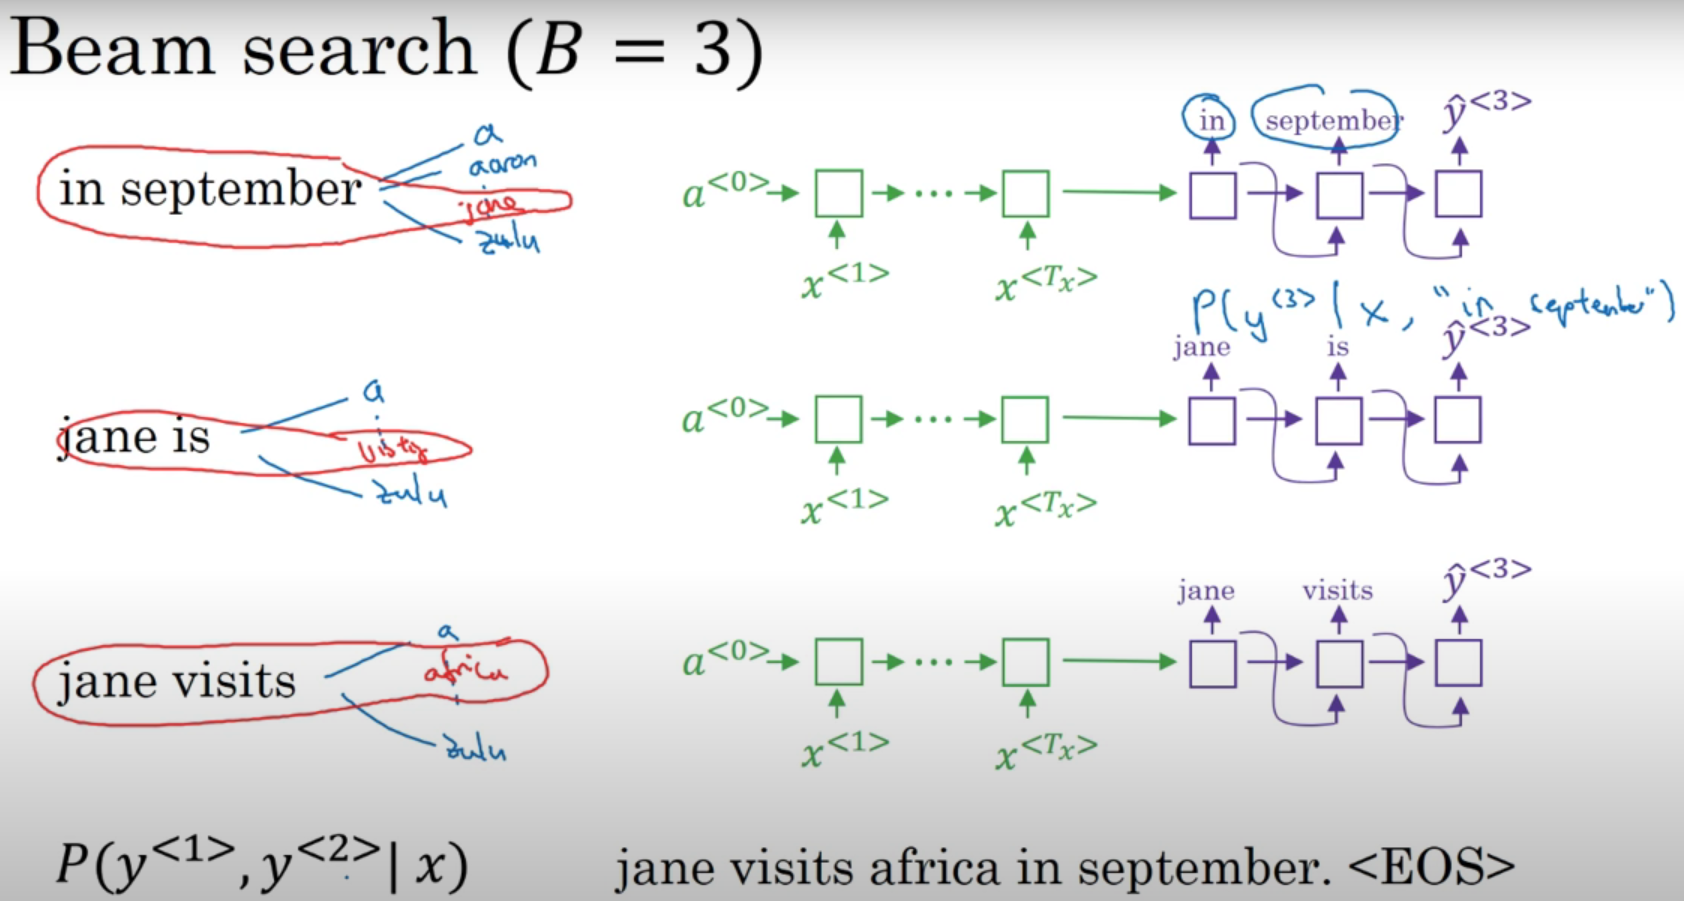

We see three decoder models that take the previous word as an input and then predicts the next word. Now some cases might arise here-

1. The top three probabilities might come out of one or two previous words and so the decoder model(s) that don't have the highest probability get cut off. This is advantageous as we are concerned with the highest conditional probability of the entire sentence.
2. A sentence progression can hit the 'end' signal before others and thus we get one possible translation of the sentence. The decoder model at this point might get cut off depending if it has more sequence progressions arising out of it.

Both cases above are considered in the algorithm formulation below. The above points also helps to understand the working behind Beam Search

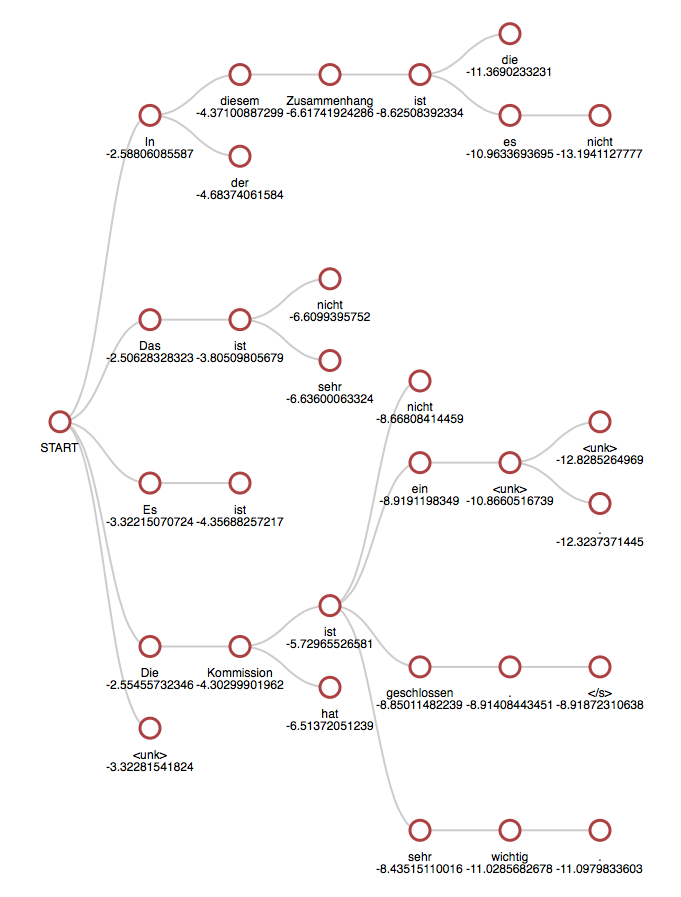

Above is an illustration of beam search with k=5 in translation to German. Notice 5 nodes at each vertical segment.

source:- https://medium.com/the-artificial-impostor/implementing-beam-search-part-1-4f53482daabe

In [31]:
# Function to get indices of k largest values in a 2-D matrix
def k_largest_index_argsort(a, k):
    idx = np.argsort(a.ravel())[:-k-1:-1]
    return np.column_stack(np.unravel_index(idx, a.shape))

In [32]:
# First function processing the Step-2 (that hits after Step-1)

def prelim_function_performing_beam_search(dec_hidden, pred_topk_word_ids, pred_topk_log_probs, enc_out, k):

    # Initialzing some empty lists
    
    # To store log probability for the the k*k combinations
    log_prob_for_beam = []
    
    # To store word_ids for each of the k*k combinations from the target language tokenizer
    word_ids_for_beam = []
    
    # To store the hidden layers of the k decoders (as each will have its own sequence progression)
    hidden_layers = []
    
    
    # Run for k i.e. number of beam searches to produce
    for i in range(k):
        
        # get the input to feed to the decoder model using previous prediction's word id
        dec_input = tf.expand_dims([pred_topk_word_ids[i]], 0)

        # get the output of the decoder based on the outputs provided from encoder,
                                                # input taken previous prediction and
                                                # the decoder's hidden layer
        cur_step_preds, hidden_layer, _ = dec_model(dec_input, dec_hidden, enc_out)
        
        # append the hidden layers from this decoder (each word from step 2 will have its own decoder hidden layer)
        hidden_layers.append(hidden_layer)
        
        # Get the normalized predictions using Softmax
        cur_step_pred_normalized = tf.nn.softmax(cur_step_preds)
        # pred_normalized shape = [1, tar_vocab_size]

        # Sort the predictions in descending order
        cur_step_pred_normalized_sorted = tf.sort(cur_step_pred_normalized, direction='DESCENDING').numpy()[0]
        # pred_normalized_sorted shape = [1, tar_vocab_size]

        # Converting normalized prediction to numpy data-type
        cur_step_pred_normalized = cur_step_pred_normalized.numpy()

        # Taking the top k predictions
        cur_step_pred_topk_probs = cur_step_pred_normalized_sorted[:k]
        
        # getting the word_ids of the tok k predictions based on their index positions
        cur_step_pred_topk_word_ids = np.array([np.argwhere(cur_step_pred_normalized==x)[0][1] 
                                                for x in cur_step_pred_topk_probs])
        
        # Storing the word_ids here
        word_ids_for_beam.append(cur_step_pred_topk_word_ids)
        
        # Computing the negative log combined probability of previous word and current step's top k predictions
        current_step_topk_probs = pred_topk_log_probs[i] - np.log(cur_step_pred_normalized_sorted[:k])
        
        # Storing the negative log combined probability here
        log_prob_for_beam.append(current_step_topk_probs)
    
    # Converting the lists to arrays for working with numpy functions
    word_ids_for_beam = np.array(word_ids_for_beam)
    log_prob_for_beam = np.array(log_prob_for_beam)
    
    # Inverting the log_prob to inverse the relationship between them (lowest becomes highest and vice-versa)
    log_prob_for_beam_inv = 1/log_prob_for_beam
    
    # Getting the indices of the 2-d matrix: log_prob_for_beam_inv (for top k highest values)
    indices_where_prob_max = k_largest_index_argsort(log_prob_for_beam_inv, k=k)
    
    # Sort my index array based on second column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,1])]
    
    # Sort my index array based on first column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,0])]
    
    # The above sorting is a trick that will sort the first column values in ascending order and then the second column
    # so that one gets - [[0 2], [1 1]] and not [[1 1], [0 2]]

    # Some hidden layers might get cut off as there could be top predictions only from l decoder layers out of k (l<k)
    # So, we store them separately in case this happens
    
    new_hidden_layers = []
    
    for i in indices_where_prob_max[:,0]:
        new_hidden_layers.append(hidden_layers[i])
        
    # with the same logic, we store the word ids and their log probabilities to feed them to the next step

    next_step_word_ids = word_ids_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]

    next_step_topk_log_probs = log_prob_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]
    
    
    # As we have new words now, we store them as sequences
    sequences = [[] for i in range(k)]
    
    for i, word_id in enumerate(pred_topk_word_ids):
        sequences[i].append(word_id)
    
    
    return sequences, next_step_word_ids, next_step_topk_log_probs, new_hidden_layers, k


In [33]:
# Second function processing all steps after Step-2

def function_performing_beam_search(hidden_ls, pred_topk_word_ids, pred_topk_log_probs, enc_out, passing_sequences, k):

    # Initialzing some empty lists
    
    # To store log probability for the the k*k combination
    log_prob_for_beam = []
    
    # To store word_ids for each of the k*k combinations from the target language tokenizer
    word_ids_for_beam = []
    
    # To store the hidden layers of the k decoders (as each will have its own sequence progression)
    hidden_layers = []
    
    # Run for k (here k might not be equal to the original k as some sequences might have ended)
    for i in range(k):
        
        # get the input to feed to the decoder model using previous prediction's word id
        dec_input = tf.expand_dims([pred_topk_word_ids[i]], 0)

        # get the output of the decoder based on the outputs provided from encoder,
                                                # input taken previous prediction and
                                                # the decoder's hidden layer (its own)
        cur_step_preds, hidden_layer, _ = dec_model(dec_input, hidden_ls[i], enc_out)
        
        # append the hidden layers from this decoder (each word will have its own decoder hidden layer)
        hidden_layers.append(hidden_layer)
        
        # Get the normalized predictions using Softmax
        cur_step_pred_normalized = tf.nn.softmax(cur_step_preds)
        # pred_normalized shape = [1, tar_vocab_size]

        # Sort the predictions in descending order
        cur_step_pred_normalized_sorted = tf.sort(cur_step_pred_normalized, direction='DESCENDING').numpy()[0]
        # pred_normalized_sorted shape = [1, tar_vocab_size]

        # Converting normalized prediction to numpy data-type
        cur_step_pred_normalized = cur_step_pred_normalized.numpy()

        # Taking the top k predictions
        cur_step_pred_topk_probs = cur_step_pred_normalized_sorted[:k]
        
        # getting the word_ids of the tok k predictions based on their index positions
        cur_step_pred_topk_word_ids = np.array([np.argwhere(cur_step_pred_normalized==x)[0][1] 
                                                for x in cur_step_pred_topk_probs])
        
        # Storing the word_ids here
        word_ids_for_beam.append(cur_step_pred_topk_word_ids)

        # Computing the negative log combined probability of previous word and current step's top k predictions
        current_step_topk_probs = pred_topk_log_probs[i] - np.log(cur_step_pred_normalized_sorted[:k])
        
        # Storing the negative log combined probability here
        log_prob_for_beam.append(current_step_topk_probs)

    # Converting the lists to arrays for working with numpy functions
    
    word_ids_for_beam = np.array(word_ids_for_beam)    
    log_prob_for_beam = np.array(log_prob_for_beam)
    
    # Inverting the log_prob to inverse the relationship between them (lowest becomes highest and vice-versa)
    log_prob_for_beam_inv = 1/log_prob_for_beam
    
    # Getting the indices of the 2-d matrix: log_prob_for_beam_inv (for top k highest values)
    indices_where_prob_max = k_largest_index_argsort(log_prob_for_beam_inv, k=k)
    
    # Sort my index array based on second column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,1])]
    
    # Sort my index array based on first column
    indices_where_prob_max = indices_where_prob_max[np.argsort(indices_where_prob_max[:,0])]

    # Some hidden layers might get cut off as there could be top predictions only from l decoder layers out of k (l<k)
    # So, we store them separately in case this happens
    
    new_hidden_layers = []
    
    for i in indices_where_prob_max[:,0]:
        new_hidden_layers.append(hidden_layers[i])

    # with the same logic, we store the word ids and their log probabilities to feed them to the next step
    
    next_step_word_ids = word_ids_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]

    next_step_topk_log_probs = log_prob_for_beam[indices_where_prob_max[:,0], indices_where_prob_max[:,1]]


    # Now, we append the word_ids to the sequences we have to progress
    for i, word_id in enumerate(next_step_word_ids):
        passing_sequences[i].append(word_id)

    
    return passing_sequences, next_step_word_ids, next_step_topk_log_probs, new_hidden_layers, k


In [34]:
# Helper function to convert the sequence of word-ids to words using the target language's tokenizer
def indices_to_sentences(indices):
    
    all_sentences = []
    
    for single_seq in indices:
        result = ''
        
        for i in single_seq[0][:-1]:
            result += tokenizer_output.index_word[i] + ' '
            
        all_sentences.append(result)
            
    return all_sentences

In [35]:
# Function to translate the sentence with beam search (k)

def evaluate_with_beam(sentence, k):

    # process the sentence first
    sentence = preprocessing_sentence(sentence)
        
    # Initialize lists to store all final sequences and their negative log probabilities
    final_sequences = [[] for i in range(k)]
    final_log_probs = [[] for i in range(k)]
    
    # transform the sentence to its tokenized form
    inputs = [tokenizer_input.word_index[i] for i in sentence.split(' ')]
    
    # Pad the tokenized inputs with 0
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                             maxlen=length_input,
                                                             padding='post')
    
    # Convert the datatype to tensorflow-tensor
    inputs = tf.convert_to_tensor(inputs)
    
    # initialize hidden weights of encoder
    hidden = [tf.zeros([1, inp_lstm_cells]), tf.zeros([1, inp_lstm_cells])]
    
    # get the output of the encoder using initialized weights
    enc_out, enc_hidden = enc_model(inputs, hidden)

    # initialize decoder hidden weights same as encoder hidden weights
    dec_hidden = enc_hidden
    
    # intialize the decoder input as the tokenized form of 'start'
    dec_input = tf.expand_dims([tokenizer_output.word_index['start']], 0)
    
    ## Step-1 begins here
    
    # get the output of the encoder based on the outputs provided from encoder
    predictions, dec_hidden, _ = dec_model(dec_input, dec_hidden, enc_out)
    # predictions shape = [1, tar_vocab_size]
    
    # Get the normalized predictions using Softmax
    pred_normalized = tf.nn.softmax(predictions)
    # pred_normalized shape = [1, tar_vocab_size]
    
    # Sort the predictions in descending order
    pred_normalized_sorted = tf.sort(pred_normalized, direction='DESCENDING').numpy()[0]
    # pred_normalized_sorted shape = [1, tar_vocab_size]
    
    # Converting normalized prediction to numpy data-type
    pred_normalized = pred_normalized.numpy()
    
    # Taking the top k predictions
    pred_topk_probs = pred_normalized_sorted[:k]
    
    # getting the word_ids of the tok k predictions based on their index positions
    pred_topk_word_ids = [np.argwhere(pred_normalized==x)[0][1] for x in pred_topk_probs]
    
    # Computing negative log probabilities of the first k predictions
    pred_topk_log_probs = -np.log(pred_normalized_sorted[:k])
    
    ## Step-2 begins here
    
    # Running the preliminary function after step-1
    sequences, next_step_word_ids, next_step_topk_log_probs, new_hidden_layers, k = prelim_function_performing_beam_search(
                                                                    dec_hidden, pred_topk_word_ids, 
                                                                   pred_topk_log_probs, enc_out, k=k)
    
    # Here, we check if we hit 'end' signal in any sequence and cut-off those branches for further inference
    
    end_outputs = []
    indices_to_cut = []
    
    for i, word_id in enumerate(next_step_word_ids):

        if tokenizer_output.index_word[word_id] == 'end':
            end_outputs.append(word_id)
            # Store the indices that we need to cut off
            indices_to_cut.append(i)
            
    # Creating a copy of existing sequences
    passing_sequences = sequences.copy()
    
    # Counter to point index of list to store
    finished_sequences_counter = 0
            
    # If 'end' is hit in one or more sequences
    if len(end_outputs) != 0:
        
        # For each indices that need to be cut
        for i in indices_to_cut:
            
            # First create a copy of passing sequences
            passing_seq_copy = passing_sequences.copy()
            
            # Append the final sequence and its negative log probability
            final_sequences[finished_sequences_counter].append(passing_seq_copy.pop(i))
            final_log_probs[finished_sequences_counter].append(next_step_topk_log_probs[i])
            
            # increase the counter by 1 to store another sequence at the next location
            finished_sequences_counter += 1
            
        # The sequences that end have to be removed from passing sequences to the next step
        for ele in sorted(indices_to_cut, reverse = True):  
            del passing_sequences[ele] 
         
        # The sequences that end, their hidden layer has to be removed from passing to the next step
        for ele in sorted(indices_to_cut, reverse = True):  
            del new_hidden_layers[ele] 
        
        # Reduce the number of k by the number of sequences that have ended
        k = k - len(end_outputs)
        
        # The word_ids for the next step also are stripped off of the ended sequence(s)
        next_step_word_ids = np.delete(next_step_word_ids, indices_to_cut)
        
        # The negative log probs for the next step also are stripped off of the ended sequence(s)
        next_step_topk_log_probs = np.delete(next_step_topk_log_probs, indices_to_cut)
    
    ## All steps after Step-2 begin here
    
    # Run this loop until all sequences are found
    while k > 0:
        
        # Running the function after step-2
        passing_sequences, next_step_word_ids, next_step_topk_log_probs, new_hidden_layers, k = function_performing_beam_search(
                                        new_hidden_layers, next_step_word_ids, 
                                       next_step_topk_log_probs, enc_out, passing_sequences, k=k)
    
        # Here, we check if we hit 'end' signal in any sequence and cut-off those branches for further inference
    
        end_outputs = []
        indices_to_cut = []

        for i, word_id in enumerate(next_step_word_ids):

            if tokenizer_output.index_word[word_id] == 'end':
                end_outputs.append(word_id)
                indices_to_cut.append(i)

        # If 'end' is hit in one or more sequences
        if len(end_outputs) != 0:
            
            # For each indices that need to be cut
            for i in indices_to_cut:
                
                # First create a copy of passing sequences
                passing_seq_copy = passing_sequences.copy()
                
                # Append the final sequence and its negative log probability
                final_sequences[finished_sequences_counter].append(passing_seq_copy.pop(i))
                final_log_probs[finished_sequences_counter].append(next_step_topk_log_probs[i])

                # increase the counter by 1 to store another sequence at the next location
                finished_sequences_counter += 1
            
            # Reduce the number of k by the number of sequences that have ended
            k = k - len(end_outputs)
            
            # The sequences that end have to be removed from passing sequences to the next step           
            for ele in sorted(indices_to_cut, reverse = True):  
                del passing_sequences[ele] 
            
            # The sequences that end, their hidden layer has to be removed from passing to the next step
            for ele in sorted(indices_to_cut, reverse = True):  
                del new_hidden_layers[ele] 
            
            # The word_ids for the next step also are stripped off of the ended sequence(s)
            next_step_word_ids = np.delete(next_step_word_ids, indices_to_cut)
            
            # The negative log probs for the next step also are stripped off of the ended sequence(s)
            next_step_topk_log_probs = np.delete(next_step_topk_log_probs, indices_to_cut)

    # Once out of the loop, all sequences have been found. Now, let's get the word from each word id to create sentences
    final_sentences = indices_to_sentences(final_sequences)
    
    # Print the sentences and their negative log probabilites (the lower the more probable)
    for i, sentence in enumerate(final_sentences):
        print("Translated Sentence {} : {}".format(i+1, sentence))
        print("Associated Neg Log Probability: {} \n".format(final_log_probs[i]))

In [36]:
evaluate_with_beam('this is coming good', 5)

Translated Sentence 1 : ca bien 
Associated Neg Log Probability: [1.9729928] 

Translated Sentence 2 : cela bien 
Associated Neg Log Probability: [2.8041842] 

Translated Sentence 3 : on bien 
Associated Neg Log Probability: [2.4277086] 

Translated Sentence 4 : ce bon 
Associated Neg Log Probability: [2.3943112] 

Translated Sentence 5 : c passe bien 
Associated Neg Log Probability: [2.5527287] 



In [37]:
evaluate_with_beam('You may speak', 5)

Translated Sentence 1 : vous discuter 
Associated Neg Log Probability: [0.7923796] 

Translated Sentence 2 : tu parler 
Associated Neg Log Probability: [2.2389612] 

Translated Sentence 3 : peut arreter 
Associated Neg Log Probability: [4.0256424] 

Translated Sentence 4 : il parler 
Associated Neg Log Probability: [1.5031487] 

Translated Sentence 5 : on courir 
Associated Neg Log Probability: [3.999619] 



In [38]:
evaluate_with_beam('it is very cold here', 5)

Translated Sentence 1 : c vraiment froid 
Associated Neg Log Probability: [1.4590162] 

Translated Sentence 2 : il tres froid ici 
Associated Neg Log Probability: [1.2284557] 

Translated Sentence 3 : on beaucoup beaucoup ici 
Associated Neg Log Probability: [2.4623508] 

Translated Sentence 4 : elle fort froid la bas 
Associated Neg Log Probability: [3.4176364] 

Translated Sentence 5 : son a tres la bas 
Associated Neg Log Probability: [3.54257] 



#### Section 6 - Evaluation of the Model

Any model has to be evaluated to know how good it is or to compare it with other models.

Machine translations is textual data and BLEU is a metric that can help to evaluate the translations with the correct translations that should be given. It is based on an n-gram model where it looks at the words appearing in the candidate translation with the reference translation. There are obvious limitations to this evaluation such as it will look at the word's and nearby words' positions only.

NLTK's bleu_score library gives this functionality. It looks at 1-gram to 4-gram and gives an average value (not exactly average) for how good the translations match with each other.

The below example shows a singular comparison using sentence_bleu. The reader can evaluate the model on test set using corplus_bleu. For more information, do refer nltk library and this article - https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

In [42]:
from nltk.translate.bleu_score import sentence_bleu

# English sentence - 'it is very cold here'
reference = ['il fait vraiment froid ici'.split()] # Translation from Google

candidate = 'il tres froid ici'.split() # Best Translation from Model
# English version of French Translation above - 'it's very cold here'

score = sentence_bleu(reference, candidate)

print(score)

8.214546595247418e-155


In [43]:
reference, candidate

([['il', 'fait', 'vraiment', 'froid', 'ici']], ['il', 'tres', 'froid', 'ici'])

In [44]:
print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
print('Cumulative 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25)))

Cumulative 1-gram: 0.584101
Cumulative 2-gram: 0.389400
Cumulative 3-gram: 0.000000
Cumulative 4-gram: 0.000000


We find that though the french translations are quite near to each other when translated back to english but BLEU score is quite low. BLEU ranges from 0(denoting no match) to 1(denoting perfect match). As stated earlier, this is a limitation of BLEU but it is still widely practiced as a metric to measure textual models' performances